In [1]:
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import networkx as nx
from networkx.drawing.nx_agraph import write_dot
import pygraphviz

In [2]:
f = 'mingwei-topics-refined'

alphanum_to_org = None
my_edges = [["nanomechanics", "solid mechanics"], ["bayesian networks", "probabilistic graphical models"], ["insulin resistance", "type 2 diabetes"], ["filosof\u00eda", "\u00e9tica"], ["filosof\u00eda", "sociolog\u00eda"], ["extracellular matrix", "biomaterials"], ["palaeoceanography", "palaeoclimatology"], ["gasification", "combustion"], ["gasification", "biomass"], ["movement science", "motor control"], ["mathematical finance", "probability theory"], ["mathematical finance", "stochastic control"], ["mathematical finance", "actuarial science"], ["mathematical finance", "stochastic analysis"], ["robot perception", "computer vision"], ["lighting", "architecture"], ["lighting", "daylighting"], ["clinical decision support", "electronic health records"], ["clinical decision support", "clinical informatics"], ["clinical decision support", "medical informatics"], ["clinical decision support", "patient safety"], ["biodegradable polymers", "biomaterials"], ["fitness", "exercise"], ["labor economics", "applied microeconomics"], ["labor economics", "personnel economics"], ["labor economics", "economics of the family"], ["labor economics", "microeconometrics"], ["labor economics", "public economics"], ["labor economics", "health economics"], ["labor economics", "economic demography"], ["labor economics", "economics of education"], ["labor economics", "development economics"], ["labor economics", "applied econometrics"], ["labor economics", "public finance"], ["high energy density physics", "inertial confinement fusion"], ["cooperative communications", "cognitive radio networks"], ["cooperative communications", "mimo"], ["intellectual", "developmental disabilities"], ["quaternary geology", "geoarchaeology"], ["negotiation", "conflict"], ["negotiation", "trust"], ["negotiation", "conflict management"], ["silicene", "graphene"], ["soil microbiology", "microbial ecology"], ["high energy physics", "particle physics"], ["geodesy", "crustal deformation"], ["geodesy", "gnss"], ["geodesy", "gps"], ["geodesy", "geophysics"], ["geodesy", "surveying"], ["comparative anatomy", "zoology"], ["environmental change", "geomorphology"], ["geochronology", "isotope geochemistry"], ["geochronology", "isotope geology"], ["geochronology", "geology"], ["historical ecology", "archaeology"], ["dermoscopy", "melanoma"], ["applied probability", "stochastic processes"], ["applied probability", "stochastic modeling"], ["environmental catalysis", "heterogeneous catalysis"], ["migration studies", "sociology"], ["pollen analysis", "palaeoecology"], ["erp", "eeg"], ["did\u00e1ctica de la matem\u00e1tica", "educaci\u00f3n estad\u00edstica"], ["geomicrobiology", "biogeochemistry"], ["competition", "regulation"], ["inflammation", "fibrosis"], ["inflammation", "cytokines"], ["inflammation", "innate immunity"], ["inflammation", "immunity"], ["dyslexia", "dyscalculia"], ["dyslexia", "reading"], ["dyslexia", "reading development"], ["dyslexia", "learning disabilities"], ["plankton ecology", "oceanography"], ["attention", "vision"], ["attention", "working memory"], ["attention", "emotion"], ["attention", "memory"], ["attention", "awareness"], ["attention", "cognitive neuroscience"], ["attention", "cognitive control"], ["attention", "consciousness"], ["computational aeroacoustics", "computational fluid dynamics"], ["singularity theory", "topology"], ["singularity theory", "algebraic geometry"], ["deep learning", "machine learning"], ["deep learning", "representation learning"], ["political geography", "urban geography"], ["political geography", "borders"], ["political geography", "economic geography"], ["vibration control", "noise"], ["molecular biology", "cell"], ["molecular biology", "cell biology"], ["molecular biology", "cancer biology"], ["molecular biology", "microbiology"], ["molecular biology", "cellular"], ["molecular biology", "medical biochemistry"], ["molecular biology", "genetics"], ["slam", "robot vision"], ["slam", "robotics"], ["slam", "mobile robotics"], ["adhd", "developmental psychopathology"], ["identity", "self"], ["identity", "narrative"], ["metabolic disease", "obesity"], ["intelligent transportation systems", "intelligent vehicles"], ["intelligent transportation systems", "traffic control"], ["intelligent transportation systems", "traffic flow"], ["intelligent transportation systems", "autonomous vehicles"], ["intelligent transportation systems", "traffic simulation"], ["intelligent transportation systems", "traffic flow theory"], ["intelligent transportation systems", "traffic safety"], ["environmental ethics", "bioethics"], ["cycling", "transportation"], ["cad", "machine design"], ["cad", "reverse engineering"], ["cad", "cam"], ["france", "history"], ["war", "peace"], ["gps", "insar"], ["architectural history", "architectural theory"], ["architectural history", "theory"], ["epitaxy", "iii-v semiconductors"], ["organizational culture", "leadership"], ["ecological economics", "environmental economics"], ["ecological economics", "industrial ecology"], ["ecological economics", "sustainable development"], ["cryptanalysis", "cryptography"], ["storage", "carbon capture"], ["storage", "energy conversion"], ["neurobiology", "neuroethology"], ["magnesium isotopes", "geochemistry"], ["conservation genetics", "population genetics"], ["agriculture", "soil biology"], ["agriculture", "rural development"], ["agriculture", "food"], ["agriculture", "food security"], ["agriculture", "sociology of food"], ["history of technology", "history of science"], ["usable security", "privacy"], ["chaos", "nonlinear dynamics"], ["chaos", "dynamical systems"], ["chaos", "bifurcation"], ["nano-optics", "plasmonics"], ["molecular recognition", "supramolecular chemistry"], ["financial economics", "macroeconomics"], ["astronomical instrumentation", "adaptive optics"], ["social insects", "animal communication"], ["social insects", "social evolution"], ["evolutionary robotics", "artificial life"], ["diagnostic radiology", "interventional radiology"], ["quantum cryptography", "quantum information"], ["quantum cryptography", "quantum information theory"], ["inkjet printing", "additive manufacturing"], ["electrical engineering", "power systems"], ["public finance", "fiscal federalism"], ["public finance", "taxation"], ["forest inventory", "remote sensing"], ["trade", "development"], ["flexible electronics", "printed electronics"], ["flexible electronics", "stretchable electronics"], ["flexible electronics", "thin film transistors"], ["air quality", "emissions"], ["air quality", "atmospheric chemistry"], ["databases", "data management"], ["databases", "data mining"], ["databases", "xml"], ["databases", "query processing"], ["databases", "data streams"], ["microbial interactions", "biofilms"], ["pbpk", "pharmacokinetics"], ["x-ray scattering", "neutron scattering"], ["x-ray scattering", "neutron"], ["signal processing", "machine learning"], ["signal processing", "underwater acoustics"], ["signal processing", "compressed sensing"], ["signal processing", "information theory"], ["signal processing", "sonar"], ["signal processing", "blind source separation"], ["signal processing", "adaptive filtering"], ["signal processing", "communication"], ["signal processing", "radar systems"], ["pmu", "smart grid"], ["separation", "membranes"], ["separation", "adsorption"], ["separation", "co2 capture"], ["separation", "purification"], ["gender studies", "queer theory"], ["gender studies", "disability studies"], ["gender studies", "women s"], ["gender studies", "cultural studies"], ["word sense disambiguation", "natural language processing"], ["photonics", "optical communications"], ["photonics", "nonlinear fiber optics"], ["photonics", "nonlinear optics"], ["photonics", "fiber optics"], ["photonics", "optical sensors"], ["photonics", "optoelectronics"], ["photonics", "electronics"], ["photonics", "plasmonics"], ["stratigraphy", "paleontology"], ["stratigraphy", "palaeontology"], ["stratigraphy", "sedimentology"], ["stratigraphy", "sedimentary geology"], ["integrins", "cell adhesion"], ["student affairs", "higher education"], ["dna replication", "cell cycle"], ["dna replication", "dna repair"], ["holography", "string theory"], ["cell-free protein synthesis", "synthetic biology"], ["valuation", "financial accounting"], ["valuation", "property"], ["photodetectors", "solar cells"], ["urban studies", "human geography"], ["urban studies", "gentrification"], ["urban studies", "housing studies"], ["computational statistics", "markov chain monte carlo"], ["computational statistics", "bayesian statistics"], ["material handling", "logistics"], ["software process improvement", "software quality"], ["hw", "embedded systems"], ["hw", "sw co-design"], ["dystonia", "movement disorders"], ["insurance", "risk management"], ["insurance", "actuarial science"], ["tephrochronology", "quaternary science"], ["labour economics", "economics of education"], ["labour economics", "applied microeconometrics"], ["labour economics", "family economics"], ["biological oceanography", "zooplankton"], ["biological oceanography", "zooplankton ecology"], ["science of science", "complex systems"], ["botany", "ethnobotany"], ["botany", "plant systematics"], ["botany", "biogeography"], ["botany", "lichenology"], ["neuroradiology", "head"], ["neuroradiology", "radiology"], ["college access", "higher education"], ["string theory", "black holes"], ["string theory", "quantum gravity"], ["string theory", "supersymmetry"], ["string theory", "supergravity"], ["string theory", "ads"], ["string theory", "quantum field theory"], ["string theory", "cft"], ["psychiatry", "neuroimaging"], ["psychiatry", "psychopharmacology"], ["psychiatry", "neuropsychiatry"], ["psychiatry", "mental health"], ["ultrasound imaging", "photoacoustic imaging"], ["palaeoclimate", "palaeoecology"], ["sexual conflict", "sexual selection"], ["meiosis", "chromosome biology"], ["meiosis", "dna repair"], ["behavioural medicine", "health psychology"], ["protein dynamics", "protein folding"], ["molecular machines", "supramolecular chemistry"], ["invertebrates", "marine biology"], ["functional analysis", "operator algebras"], ["functional analysis", "harmonic analysis"], ["functional analysis", "fixed point theory"], ["mrs", "mri"], ["place", "space"], ["design theory", "systems engineering"], ["design theory", "methodology"], ["liberalism", "political theory"], ["extragalactic astronomy", "cosmology"], ["social studies of science", "technology"], ["higher education", "community colleges"], ["higher education", "student development"], ["higher education", "international education"], ["higher education", "teaching"], ["higher education", "college students"], ["radar", "electromagnetics"], ["radar", "sar"], ["punishment", "crime"], ["clustering", "classification"], ["clustering", "data mining"], ["meshless methods", "finite element method"], ["probability theory", "financial mathematics"], ["probability theory", "mathematical statistics"], ["probability theory", "stochastic processes"], ["biomolecular engineering", "chemical"], ["sex differences", "stress"], ["computer networks", "internet measurement"], ["computer networks", "software defined networking"], ["computer networks", "quality of service"], ["computer networks", "distributed systems"], ["computer networks", "network management"], ["computer networks", "network measurement"], ["computer networks", "network monitoring"], ["computer networks", "routing"], ["computer networks", "telecommunications"], ["computer networks", "information-centric networking"], ["computer networks", "computer communications"], ["computer networks", "network virtualization"], ["residual stress", "welding"], ["generic programming", "functional programming"], ["hamiltonian systems", "dynamical systems"], ["precipitation", "cloud"], ["neurosurgery", "functional neurosurgery"], ["neurosurgery", "cerebrovascular surgery"], ["neurosurgery", "neuro-oncology"], ["neurosurgery", "brain tumors"], ["neurosurgery", "spine"], ["neurosurgery", "spine surgery"], ["neurosurgery", "endovascular neurosurgery"], ["ophthalmology", "retina"], ["ophthalmology", "visual science"], ["ophthalmology", "glaucoma"], ["ophthalmology", "cornea"], ["ophthalmology", "optometry"], ["intergroup relations", "social identity"], ["intergroup relations", "social psychology"], ["intergroup relations", "intergroup contact"], ["neutrophils", "macrophages"], ["defects", "semiconductors"], ["intelligent tutoring systems", "educational data mining"], ["intelligent tutoring systems", "affective computing"], ["clinical pharmacology", "pharmacoepidemiology"], ["clinical pharmacology", "pharmacometrics"], ["clinical pharmacology", "pharmacokinetics"], ["cancer genomics", "precision medicine"], ["cancer genomics", "computational biology"], ["cryo-em", "structural biology"], ["library instruction", "information literacy"], ["aphasia", "language"], ["emerging infectious diseases", "zoonoses"], ["soft robotics", "bio-inspired robotics"], ["soft robotics", "smart materials"], ["service oriented computing", "business process management"], ["behavioural ecology", "sensory ecology"], ["behavioural ecology", "animal behaviour"], ["behavioural ecology", "cooperative breeding"], ["behavioural ecology", "evolutionary ecology"], ["behavioural ecology", "sexual selection"], ["solid state physics", "superconductivity"], ["cyber-physical systems", "real-time embedded systems"], ["cyber-physical systems", "hybrid systems"], ["cyber-physical systems", "real-time systems"], ["european studies", "international relations"], ["data security", "privacy"], ["art", "aesthetics"], ["art", "literatura"], ["art", "m\u00fasica"], ["software metrics", "software engineering"], ["anesthesiology", "regional anesthesia"], ["anesthesiology", "perioperative medicine"], ["anesthesiology", "critical care medicine"], ["anesthesiology", "critical care"], ["pensions", "retirement"], ["collective intelligence", "crowdsourcing"], ["human-computer interaction", "personal informatics"], ["human-computer interaction", "social computing"], ["human-computer interaction", "accessible computing"], ["human-computer interaction", "mobile interaction"], ["human-computer interaction", "information visualization"], ["human-computer interaction", "interaction design"], ["human-computer interaction", "computer supported cooperative work"], ["human-computer interaction", "intelligent user interfaces"], ["human-computer interaction", "end-user programming"], ["human-computer interaction", "interaction techniques"], ["human-computer interaction", "urban informatics"], ["human-computer interaction", "child-computer interaction"], ["human-computer interaction", "ubiquitous computing"], ["human-computer interaction", "user-centered design"], ["human-computer interaction", "end-user development"], ["elliptic curves", "cryptography"], ["immunity", "infection"], ["health education", "health promotion"], ["brain networks", "neuroimaging"], ["personalized medicine", "pharmacogenomics"], ["cognitive impairment", "aging"], ["open data", "e-government"], ["open data", "open government"], ["condensed matter theory", "strongly correlated systems"], ["mineralogy", "crystallography"], ["mineralogy", "ore deposits"], ["mineralogy", "geochemistry"], ["mineralogy", "mineral physics"], ["photodynamic therapy", "drug delivery"], ["political violence", "terrorism"], ["population geography", "migration"], ["risk analysis", "decision analysis"], ["risk analysis", "decision"], ["organic geochemistry", "biogeochemistry"], ["organic geochemistry", "stable isotope geochemistry"], ["embryology", "anatomy"], ["embryology", "developmental biology"], ["tissue regeneration", "stem cells"], ["tic", "educaci\u00f3n"], ["decision theory", "microeconomic theory"], ["interventional radiology", "radiology"], ["research methods", "program evaluation"], ["usability", "accessibility"], ["usability", "user experience"], ["program verification", "formal methods"], ["palaeolithic", "archaeology"], ["transcription factors", "gene regulation"], ["environmental politics", "policy"], ["environmental politics", "global governance"], ["microparticles", "nanoparticles"], ["cardiac electrophysiology", "arrhythmia"], ["critical care medicine", "pulmonary medicine"], ["mobile mapping", "laser scanning"], ["iot", "wsn"], ["iot", "m2m"], ["control engineering", "mechatronics"], ["biointerfaces", "biomaterials"], ["numerical weather prediction", "mesoscale meteorology"], ["performance studies", "cultural studies"], ["performance studies", "theatre"], ["thermal conductivity", "thermoelectrics"], ["organizations", "economic sociology"], ["organizations", "work"], ["petroleum engineering", "reservoir engineering"], ["finite element analysis", "computational biomechanics"], ["finite element analysis", "fracture mechanics"], ["anxiety", "ocd"], ["anxiety", "ptsd"], ["anxiety", "depression"], ["anxiety", "emotion regulation"], ["anxiety", "cognitive behavioral therapy"], ["quantitative ecology", "population ecology"], ["translation", "interpreting"], ["translation", "terminology"], ["process mining", "business process management"], ["nanocrystals", "quantum dots"], ["insects", "evolution"], ["electrophysiology", "ion channels"], ["system architecture", "systems engineering"], ["information retrieval", "semantic search"], ["information retrieval", "data mining"], ["information retrieval", "search engines"], ["information retrieval", "search"], ["information retrieval", "web search"], ["magnetic resonance imaging", "image reconstruction"], ["magnetic resonance imaging", "functional mri"], ["ecoimmunology", "disease ecology"], ["balance", "gait"], ["nanofabrication", "plasmonics"], ["membrane distillation", "desalination"], ["collection development", "scholarly communication"], ["lakes", "limnology"], ["spintronics", "magnetic materials"], ["spintronics", "nanomagnetism"], ["spintronics", "micromagnetics"], ["spintronics", "magnonics"], ["spintronics", "magnetization dynamics"], ["spintronics", "magnetism"], ["coding", "information theory"], ["sensors", "mems"], ["sensors", "actuators"], ["sensors", "instrumentation"], ["sensors", "wearables"], ["coastal geomorphology", "coastal processes"], ["creativity", "giftedness"], ["creativity", "improvisation"], ["creativity", "innovation"], ["molecular beam epitaxy", "semiconductors"], ["biosynthesis", "natural products"], ["real-time rendering", "computer graphics"], ["power converters", "power electronics"], ["vaccines", "immunotherapy"], ["vaccines", "influenza"], ["vaccines", "immunology"], ["data mining", "business intelligence"], ["data mining", "recommender systems"], ["data mining", "healthcare analytics"], ["data mining", "web mining"], ["data mining", "social network analysis"], ["data mining", "social networks"], ["data mining", "machine learning"], ["data mining", "feature selection"], ["data mining", "outlier detection"], ["data mining", "knowledge discovery"], ["data mining", "data privacy"], ["data mining", "graph mining"], ["ultrasonics", "structural health monitoring"], ["ultrasonics", "ndt"], ["ultrasonics", "nde"], ["cheminformatics", "drug design"], ["androgen receptor", "prostate cancer"], ["image fusion", "image processing"], ["surveillance", "privacy"], ["analogue modeling", "tectonics"], ["polyploidy", "hybridization"], ["traffic operations", "transportation safety"], ["eu law", "international law"], ["inverse problems", "electrical impedance tomography"], ["inverse problems", "tomography"], ["inverse problems", "computational imaging"], ["inverse problems", "uncertainty quantification"], ["wind turbines", "wind energy"], ["wind turbines", "aerodynamics"], ["ecosystem ecology", "global change"], ["ecosystem ecology", "biogeochemistry"], ["ecosystem ecology", "soil ecology"], ["anammox", "microbial ecology"], ["hydrometallurgy", "mineral processing"], ["misfolding", "protein folding"], ["nutrici\u00f3n", "obesidade"], ["semiconductor lasers", "optoelectronics"], ["main group chemistry", "inorganic chemistry"], ["human-wildlife conflict", "conservation biology"], ["fiber", "polymers"], ["fiber", "textiles"], ["epistemology", "metaphysics"], ["quorum sensing", "biofilms"], ["geometric modeling", "computer graphics"], ["geometric modeling", "cam"], ["biochemistry", "protein science"], ["biochemistry", "enzymology"], ["biochemistry", "cell biology"], ["biochemistry", "biophysics"], ["fea", "cfd"], ["sensor networks", "wireless networks"], ["sensor networks", "wireless ad hoc"], ["sensor networks", "ad hoc"], ["activity recognition", "ubiquitous computing"], ["autism spectrum disorder", "intellectual disability"], ["autism spectrum disorder", "early intervention"], ["rural development", "agricultural economics"], ["operations management", "supply chain management"], ["operations management", "lean"], ["operations management", "service operations"], ["operations management", "operations strategy"], ["operations management", "behavioral operations"], ["international marketing", "marketing strategy"], ["international marketing", "international business"], ["occupational health", "safety"], ["economic geography", "evolutionary economic geography"], ["economic geography", "evolutionary economics"], ["economic geography", "innovation studies"], ["economic geography", "regional development"], ["economic geography", "regional science"], ["economic geography", "urban economics"], ["cognitive control", "inhibition"], ["circadian rhythms", "chronobiology"], ["circadian rhythms", "melatonin"], ["circadian rhythms", "sleep"], ["traffic engineering", "traffic safety"], ["traffic engineering", "transportation planning"], ["sequestration", "carbon capture"], ["microalgae", "biofuels"], ["productivity", "efficiency analysis"], ["productivity", "efficiency"], ["public health ethics", "bioethics"], ["organisation", "management"], ["research assessment", "bibliometrics"], ["invasion ecology", "conservation biology"], ["sperm competition", "sexual selection"], ["developmental psychology", "educational psychology"], ["developmental psychology", "comparative psychology"], ["optimization", "surrogate modeling"], ["optimization", "stochastics"], ["optimization", "variational inequalities"], ["optimization", "optimal control"], ["optimization", "variational analysis"], ["optimization", "control"], ["optimization", "simulation"], ["optimization", "operations research"], ["topology optimization", "structural optimization"], ["power system planning", "power system operation"], ["rhetoric", "environmental communication"], ["rhetoric", "composites"], ["rhetoric", "argumentation"], ["rhetoric", "writing studies"], ["parks", "recreation"], ["developmental psychopathology", "attachment"], ["evidence-based medicine", "meta-analysis"], ["gesture", "language development"], ["spatial data mining", "spatial databases"], ["pottery", "archaeology"], ["sport pedagogy", "physical education"], ["renewable energy generation", "power electronics"], ["dermatopathology", "dermatology"], ["trade unions", "employment relations"], ["educaci\u00f3n estad\u00edstica", "educaci\u00f3n matem\u00e1tica"], ["fisheries science", "fish ecology"], ["malaria", "drug resistance"], ["malaria", "parasitology"], ["malaria", "mosquitoes"], ["water resources management", "systems analysis"], ["water resources management", "hydrology"], ["vehicle routing", "metaheuristics"], ["atmospheric modeling", "meteorology"], ["vegetation dynamics", "climate change"], ["bioprocessing", "biofuels"], ["chemoinformatics", "molecular modeling"], ["networked control systems", "time-delay systems"], ["cystic fibrosis", "asthma"], ["palaeontology", "palaeobiology"], ["palaeontology", "palaeoecology"], ["web science", "linked data"], ["stis", "hiv"], ["pharmacogenomics", "pharmacogenetics"], ["indigenous studies", "anthropology"], ["comparative law", "legal history"], ["comparative law", "private international law"], ["comparative law", "constitutional law"], ["daylighting", "building performance simulation"], ["cell cycle", "mitosis"], ["injury", "violence"], ["turkey", "migration"], ["fish", "fisheries"], ["cognitive behavioral therapy", "anxiety disorders"], ["landscape evolution", "geomorphology"], ["biopreservation", "microfluidics"], ["longitudinal data analysis", "survival analysis"], ["climate modeling", "land-atmosphere interactions"], ["climate modeling", "climate dynamics"], ["social geography", "cultural geography"], ["climate change", "dendroclimatology"], ["climate change", "climate extremes"], ["climate change", "adaptation"], ["climate change", "geoengineering"], ["climate change", "enso"], ["climate change", "biogeochemical cycles"], ["climate change", "climate impacts"], ["climate change", "downscaling"], ["peatlands", "palaeoecology"], ["scheduling", "planning"], ["scheduling", "operations research"], ["scheduling", "production planning"], ["concurrency", "formal methods"], ["phased array", "antennas"], ["quantum theory", "quantum information"], ["opv", "oled"], ["atmospheric chemistry", "aerosols"], ["atmospheric chemistry", "air pollution"], ["atmospheric chemistry", "ozone"], ["atmospheric chemistry", "biosphere-atmosphere interactions"], ["lactation", "nutrition"], ["telemedicine", "telehealth"], ["telemedicine", "ehealth"], ["bioinformatics", "immunoinformatics"], ["bioinformatics", "next generation sequencing"], ["bioinformatics", "protein structure prediction"], ["bioinformatics", "sequence analysis"], ["bioinformatics", "systems biology"], ["bioinformatics", "clinical genomics"], ["bioinformatics", "rna-seq"], ["bioinformatics", "ngs data analysis"], ["bioinformatics", "genome informatics"], ["bioinformatics", "ngs"], ["wetlands", "rivers"], ["wetlands", "restoration"], ["substance use", "hiv"], ["pharmacodynamics", "pharmacokinetics"], ["water management", "irrigation"], ["microeconomic theory", "auction theory"], ["microeconomic theory", "game theory"], ["microeconomic theory", "information economics"], ["sexual orientation", "gender identity"], ["sexual orientation", "gender"], ["structural health monitoring", "acoustic emission"], ["structural health monitoring", "structural dynamics"], ["structural health monitoring", "smart structures"], ["structural health monitoring", "nondestructive evaluation"], ["structural health monitoring", "system identification"], ["structural health monitoring", "wireless sensors"], ["structural health monitoring", "damage detection"], ["sociophonetics", "sociolinguistics"], ["plant", "soil ecology"], ["ultracold gases", "quantum physics"], ["digital systems", "computer architecture"], ["free probability", "operator algebras"], ["software quality", "software evolution"], ["women s health", "reproductive health"], ["women s health", "midwifery"], ["process systems engineering", "process monitoring"], ["private law", "derecho civil"], ["private law", "law"], ["speleothems", "paleoclimate"], ["history of architecture", "architecture"], ["software reuse", "software engineering"], ["ml", "nlp"], ["mobile computing", "ubiquitous computing"], ["mobile computing", "wireless networks"], ["mobile computing", "ubiquitous"], ["mobile computing", "pervasive computing"], ["behavioral finance", "empirical asset pricing"], ["behavioral finance", "household finance"], ["behavioral finance", "corporate finance"], ["behavioral finance", "experimental finance"], ["drug abuse", "behavioral pharmacology"], ["management", "organization studies"], ["management", "construction engineering"], ["management", "business"], ["polymer science", "materials science"], ["fdi", "international trade"], ["materials science", "applied physics"], ["materials science", "electron microscopy"], ["materials science", "metallurgy"], ["materials science", "physics"], ["materials science", "engineering"], ["materials science", "nanotechnology"], ["publishing", "scholarly communication"], ["freight", "logistics"], ["developmental biology", "cell biology"], ["developmental biology", "morphogenesis"], ["developmental biology", "evo-devo"], ["urban regeneration", "urban planning"], ["sex work", "sexuality"], ["electronic structure theory", "quantum chemistry"], ["food marketing", "consumer behavior"], ["operator algebras", "noncommutative geometry"], ["immunodeficiency", "immunology"], ["energy planning", "energy efficiency"], ["design research", "service design"], ["design research", "interaction design"], ["design research", "design thinking"], ["institutional repositories", "open access"], ["democracy", "political theory"], ["hermeneutics", "phenomenology"], ["photocatalysis", "water splitting"], ["photocatalysis", "solar energy conversion"], ["photocatalysis", "electrocatalysis"], ["document image analysis", "pattern recognition"], ["commitment therapy", "acceptance"], ["spectral theory", "mathematical physics"], ["trust", "reputation systems"], ["trust", "reputation"], ["trust", "privacy"], ["trust", "cooperation"], ["british politics", "political parties"], ["cell migration", "cancer metastasis"], ["cell migration", "cell adhesion"], ["cell migration", "cytoskeleton"], ["cell migration", "cell mechanics"], ["algorithmic game theory", "mechanism design"], ["algorithmic game theory", "approximation algorithms"], ["algorithmic game theory", "learning theory"], ["international entrepreneurship", "international business"], ["cervical cancer", "hiv"], ["cortisol", "stress"], ["macro-finance", "asset pricing"], ["mass transfer", "heat"], ["software engineering", "web development"], ["software engineering", "adaptive software"], ["software engineering", "global software development"], ["software engineering", "object-oriented programming"], ["software engineering", "requirements engineering"], ["software engineering", "refactoring"], ["software engineering", "software evolution"], ["software engineering", "technical debt"], ["software engineering", "mining software repositories"], ["software engineering", "design patterns"], ["software engineering", "model-driven development"], ["software engineering", "software reliability"], ["software engineering", "computer science education"], ["software engineering", "software maintenance"], ["software engineering", "software engineering education"], ["software engineering", "empirical software engineering"], ["software engineering", "search-based software engineering"], ["software engineering", "software architecture"], ["software engineering", "model-driven engineering"], ["software engineering", "software testing"], ["software engineering", "formal methods"], ["software engineering", "software ecosystems"], ["software engineering", "computer science"], ["public policy", "federalism"], ["public policy", "public administration"], ["public policy", "political science"], ["public policy", "administration"], ["public policy", "urban politics"], ["public policy", "policy analysis"], ["intervertebral disc", "tissue engineering"], ["integrated pest management", "entomology"], ["light trapping", "photovoltaics"], ["child nutrition", "maternal"], ["crowdsourcing", "human computation"], ["crowdsourcing", "crowdfunding"], ["crowdsourcing", "social computing"], ["crowdsourcing", "open innovation"], ["science policy", "bibliometrics"], ["pathology", "molecular pathology"], ["pathology", "oncology"], ["egyptology", "archaeology"], ["hybridization", "speciation"], ["electromagnetic compatibility", "signal integrity"], ["electromagnetic compatibility", "antennas"], ["sensor fusion", "navigation"], ["aggression", "violence"], ["aggression", "bullying"], ["mobile communication", "wireless"], ["semiconductor physics", "optoelectronics"], ["semiconductor physics", "devices"], ["community detection", "social network analysis"], ["esl", "tesol"], ["esl", "efl"], ["biofuel cells", "biosensors"], ["dynamic spectrum access", "cognitive radio"], ["smes", "entrepreneurship"], ["language processing", "speech"], ["laser material processing", "additive manufacturing"], ["electrowetting", "microfluidics"], ["entanglement", "open quantum systems"], ["entanglement", "quantum optics"], ["microrheology", "soft matter"], ["social influence", "persuasion"], ["transportation safety", "transportation engineering"], ["liver transplantation", "hepatology"], ["microbiology", "antibiotic resistance"], ["microbiology", "pathogenesis"], ["microbiology", "microbial pathogenesis"], ["microbiology", "host-microbe interactions"], ["microbiology", "biotechnology"], ["microbiology", "bacterial pathogenesis"], ["microbiology", "host-pathogen interactions"], ["microbiology", "molecular genetics"], ["microbiology", "immunology"], ["microbiology", "bacteriology"], ["microbiology", "biofilms"], ["microbiology", "bacterial genetics"], ["microbiology", "bacteriophage"], ["ichnology", "sedimentology"], ["social mobility", "inequality"], ["lattice boltzmann method", "multiphase flow"], ["altmetrics", "scholarly communication"], ["altmetrics", "open access"], ["altmetrics", "bibliometrics"], ["philosophy of language", "pragmatics"], ["philosophy of language", "metaethics"], ["philosophy of language", "philosophy of logic"], ["innovation", "knowledge"], ["innovation", "technology management"], ["innovation", "foresight"], ["innovation", "platforms"], ["innovation", "technology transfer"], ["innovation", "r d"], ["innovation", "technology entrepreneurship"], ["innovation", "intellectual property rights"], ["innovation", "business models"], ["innovation", "entrepreneurship"], ["network protocols", "wireless sensor networks"], ["computational design", "digital fabrication"], ["computational design", "architecture"], ["consumer behavior", "marketing"], ["consumer behavior", "sport marketing"], ["consumer behavior", "services marketing"], ["consumer behavior", "judgment"], ["brain injury", "rehabilitation"], ["visual attention", "eye movements"], ["visual attention", "visual search"], ["2d materials", "nanoelectronics"], ["2d materials", "graphene"], ["lubrication", "tribology"], ["occupational health psychology", "organizational psychology"], ["community development", "housing"], ["magnetosphere", "space weather"], ["motion planning", "manipulation"], ["motion planning", "path planning"], ["motion planning", "robotics"], ["burn", "wound healing"], ["land change science", "remote sensing"], ["problem solving", "mathematics education"], ["quantum chemistry", "computational chemistry"], ["quantum chemistry", "density functional theory"], ["quantum chemistry", "theoretical chemistry"], ["gpgpu", "high performance computing"], ["gpgpu", "hpc"], ["atomic", "optical physics"], ["atomic", "molecular"], ["atomic", "sprays"], ["atomic", "molecular physics"], ["animal ecology", "conservation biology"], ["speech recognition", "speech processing"], ["speech recognition", "acoustic modeling"], ["speech recognition", "speaker recognition"], ["speech recognition", "speech synthesis"], ["category theory", "logic"], ["category theory", "homotopy theory"], ["category theory", "homological algebra"], ["radiation protection", "medical physics"], ["optometry", "vision science"], ["new media", "digital culture"], ["new media", "journalism"], ["market design", "auction theory"], ["market design", "auctions"], ["market design", "matching theory"], ["market design", "matching"], ["international political economy", "international relations"], ["international political economy", "comparative political economy"], ["international political economy", "global governance"], ["international political economy", "foreign aid"], ["qualitative methods", "gender"], ["religion", "islam"], ["religion", "politics"], ["religion", "sociology of religion"], ["religion", "secularization"], ["religion", "spirituality"], ["family communication", "interpersonal communication"], ["membrane proteins", "structural biology"], ["radiotherapy", "medical physics"], ["parkinson&", "alzheimer s disease"], ["parkinson&", "neurodegenerative diseases"], ["multilevel converters", "power electronics"], ["precambrian geology", "tectonics"], ["tropical medicine", "infectious diseases"], ["cultural studies", "media studies"], ["cultural studies", "postcolonial studies"], ["cultural studies", "critical"], ["cultural studies", "visual culture"], ["cultural studies", "literary studies"], ["cultural studies", "comparative literature"], ["cultural studies", "visual studies"], ["party politics", "comparative politics"], ["permafrost", "arctic"], ["prognosis", "fault diagnosis"], ["prognosis", "diagnosis"], ["metal-organic frameworks", "porous materials"], ["combustion", "cfd"], ["combustion", "gas turbines"], ["combustion", "flames"], ["combustion", "alternative fuels"], ["combustion", "propulsion"], ["combustion", "energetic materials"], ["combustion", "chemical kinetics"], ["combustion", "fuels"], ["combustion", "internal combustion engines"], ["combustion", "thermoacoustics"], ["combustion", "laser diagnostics"], ["combustion", "explosion"], ["combustion", "soot"], ["combustion", "soot formation"], ["volcanology", "geochemistry"], ["social norms", "social psychology"], ["agroforestry", "forestry"], ["music", "music education"], ["music", "dance"], ["music", "musicology"], ["music", "music therapy"], ["ionic liquids", "green chemistry"], ["ionic liquids", "deep eutectic solvents"], ["ionic liquids", "electrolytes"], ["travel", "tourism"], ["amo", "quantum optics"], ["conservation biology", "tropical ecology"], ["conservation biology", "spatial ecology"], ["conservation biology", "amphibians"], ["conservation biology", "avian ecology"], ["conservation biology", "ecology"], ["conservation biology", "landscape ecology"], ["conservation biology", "ornithology"], ["conservation biology", "mammals"], ["conservation biology", "disease ecology"], ["conservation biology", "habitat fragmentation"], ["conservation biology", "herpetology"], ["conservation biology", "restoration ecology"], ["conservation biology", "population ecology"], ["conservation biology", "ecological modelling"], ["conservation biology", "wildlife management"], ["conservation biology", "road ecology"], ["conservation biology", "applied ecology"], ["conservation biology", "wildlife ecology"], ["conservation biology", "endangered species"], ["conservation biology", "bats"], ["acoustic metamaterials", "phononic crystals"], ["violence", "gangs"], ["violence", "victimization"], ["cloud physics", "radar meteorology"], ["cloud physics", "aerosols"], ["cloud physics", "atmospheric physics"], ["transfusion medicine", "hematology"], ["interpreting studies", "translation studies"], ["dna nanotechnology", "molecular programming"], ["dna nanotechnology", "synthetic biology"], ["data analysis", "statistics"], ["high-level synthesis", "fpga"], ["exergy analysis", "energy"], ["adaptive control", "nonlinear"], ["adaptive control", "nonlinear control"], ["discrete choice models", "transportation"], ["seismic hazard", "seismology"], ["anthropology", "archaeology"], ["anthropology", "folklore"], ["anthropology", "african studies"], ["anthropology", "kinship"], ["electromagnetics", "antennas"], ["pharmacokinetics", "drug metabolism"], ["pharmacokinetics", "biopharmaceutics"], ["implant dentistry", "prosthodontics"], ["participation", "governance"], ["data visualization", "visual analytics"], ["discrete element method", "rock mechanics"], ["discrete element method", "granular materials"], ["kinetics", "thermodynamics"], ["image registration", "image segmentation"], ["image registration", "medical image processing"], ["image registration", "medical image analysis"], ["international migration", "ethnicity"], ["single molecule", "biophysics"], ["language variation", "sociolinguistics"], ["molecular dynamics", "free energy calculations"], ["molecular dynamics", "computational biophysics"], ["molecular dynamics", "biomolecular simulations"], ["molecular dynamics", "mm"], ["molecular dynamics", "atomistic simulations"], ["molecular dynamics", "biophysics"], ["ontology learning", "semantic web"], ["paleoanthropology", "biological anthropology"], ["paleoanthropology", "human evolution"], ["dc converters", "power electronics"], ["cancer biology", "therapeutics"], ["cancer biology", "tumor microenvironment"], ["sports injury", "biomechanics"], ["phylogenomics", "phylogenetics"], ["cartilage", "bone"], ["cartilage", "osteoarthritis"], ["history of education", "teacher education"], ["bone marrow transplantation", "oncology"], ["hybrid electric vehicles", "power electronics"], ["hiv", "sexual health"], ["hiv", "drug use"], ["hiv", "adherence"], ["hiv", "infectious diseases"], ["hiv", "sexual behavior"], ["hiv", "sti"], ["hiv", "msm"], ["hiv", "std"], ["hiv", "siv"], ["hiv", "hcv"], ["hiv", "aids"], ["surface physics", "nanoscience"], ["seizures", "epilepsy"], ["bone repair", "biomaterials"], ["structural bioinformatics", "structural biology"], ["mathematical economics", "game theory"], ["stars", "planet formation"], ["knowledge engineering", "semantic web"], ["water splitting", "artificial photosynthesis"], ["water splitting", "photoelectrochemistry"], ["serotonin", "depression"], ["serotonin", "dopamine"], ["nanoantennas", "plasmonics"], ["concrete structures", "steel structures"], ["integrated optics", "silicon photonics"], ["giscience", "geovisualization"], ["giscience", "health geography"], ["conservation ecology", "landscape ecology"], ["environmental accounting", "social"], ["interface science", "colloids"], ["conceptual modeling", "ontologies"], ["international studies", "political science"], ["cognitive neuroscience", "time perception"], ["cognitive neuroscience", "cognitive psychology"], ["cognitive neuroscience", "neurobiology of language"], ["cognitive neuroscience", "educational neuroscience"], ["cognitive neuroscience", "clinical neuropsychology"], ["cognitive neuroscience", "numerical cognition"], ["cognitive neuroscience", "computational psychiatry"], ["presidency", "congress"], ["nanocomposites", "polymers"], ["educaci\u00f3n matem\u00e1tica", "mathematics education"], ["agent-based modeling", "simulation"], ["agent-based modeling", "complex adaptive systems"], ["agent-based modeling", "social simulation"], ["fathering", "parenting"], ["quantum algorithms", "quantum computing"], ["social science", "sociology"], ["social science", "human"], ["parenting", "child development"], ["parenting", "temperament"], ["parenting", "attachment"], ["labour market", "migration"], ["symbolic computation", "computer algebra"], ["communication technology", "information"], ["medical genetics", "population genetics"], ["gerontological social work", "aging"], ["primate evolution", "human evolution"], ["health promotion", "physical activity"], ["health promotion", "tobacco control"], ["health promotion", "public health"], ["mathematics", "physics"], ["neuromorphic computing", "vlsi"], ["neuromorphic computing", "memristor"], ["environmental physiology", "exercise physiology"], ["method development", "analytical chemistry"], ["eeg", "epilepsy"], ["eeg", "brain computer interface"], ["eeg", "bci"], ["eeg", "ecg"], ["eeg", "emg"], ["eeg", "meg"], ["eeg", "fmri"], ["school choice", "education policy"], ["mutual funds", "hedge funds"], ["knee", "biomechanics"], ["solar fuels", "artificial photosynthesis"], ["science education", "biology education"], ["science education", "learning sciences"], ["science education", "nature of science"], ["science education", "citizen science"], ["science education", "chemistry education"], ["science education", "environmental education"], ["science education", "did\u00e1ctica de las ciencias experimentales"], ["science education", "physics education research"], ["developmental cognitive neuroscience", "cognitive development"], ["road safety", "injury prevention"], ["road safety", "transportation engineering"], ["t cell development", "immunology"], ["engineering design", "systems engineering"], ["engineering design", "engineering education"], ["engineering design", "product development"], ["suspensions", "rheology"], ["molecular epidemiology", "antimicrobial resistance"], ["usable privacy", "security"], ["tribocorrosion", "tribology"], ["quaternary science", "geomorphology"], ["zooarchaeology", "environmental archaeology"], ["zooarchaeology", "taphonomy"], ["planning theory", "urban planning"], ["signal processing for communications", "wireless communications"], ["time series", "financial econometrics"], ["time series", "econometrics"], ["time series", "forecasting"], ["mapping", "simultaneous localization"], ["mapping", "cartography"], ["fisheries ecology", "fisheries management"], ["geopolitics", "borders"], ["feminist theory", "gender"], ["low back pain", "biomechanics"], ["mr", "pet"], ["aquatic ecology", "biological invasions"], ["aquatic ecology", "limnology"], ["aquatic ecology", "food webs"], ["zno", "gan"], ["ambient intelligence", "ubiquitous computing"], ["population genetics", "speciation"], ["population genetics", "molecular ecology"], ["population genetics", "experimental evolution"], ["population genetics", "domestication"], ["population genetics", "statistical genetics"], ["population genetics", "phylogenetics"], ["population genetics", "human genomics"], ["itch", "pain"], ["biodiesel", "biofuels"], ["energy conversion", "storage devices"], ["precision medicine", "translational bioinformatics"], ["sdi", "gis"], ["prefrontal cortex", "executive function"], ["prefrontal cortex", "hippocampus"], ["social movements", "contentious politics"], ["social movements", "protest"], ["social movements", "activism"], ["social movements", "environmental sociology"], ["social movements", "civil society"], ["social movements", "political sociology"], ["thailand", "southeast asia"], ["thailand", "politics"], ["critical theory", "american literature"], ["critical theory", "marxism"], ["image understanding", "computer vision"], ["disinfection", "water treatment"], ["medical physics", "radiation therapy"], ["medical physics", "monte carlo simulation"], ["medical physics", "nuclear medicine"], ["medical physics", "proton therapy"], ["medical physics", "health physics"], ["medical physics", "radiation oncology"], ["medical physics", "radiation physics"], ["medical physics", "radiation dosimetry"], ["medical physics", "monte carlo"], ["lysosomes", "autophagy"], ["gesture recognition", "computer vision"], ["environmental economics", "natural resource economics"], ["environmental economics", "non-market valuation"], ["environmental economics", "resource economics"], ["environmental economics", "energy economics"], ["environmental economics", "water economics"], ["environmental economics", "agricultural economics"], ["steganography", "information hiding"], ["steganography", "watermarking"], ["steganography", "cryptography"], ["steganography", "steganalysis"], ["gc-ms", "ms"], ["gc-ms", "hplc"], ["heat transfer", "cfd"], ["heat transfer", "nanofluidics"], ["heat transfer", "boiling"], ["heat transfer", "microchannels"], ["heat transfer", "thermal sciences"], ["heat transfer", "thermodynamics"], ["heat transfer", "heat pipes"], ["heat transfer", "heat exchangers"], ["heat transfer", "cryogenics"], ["heat transfer", "fluid flow"], ["heat transfer", "fluid mechanics"], ["heat transfer", "two-phase flow"], ["heat transfer", "energy technology"], ["photobiology", "photochemistry"], ["social web", "semantic web"], ["tourism", "heritage"], ["tourism", "leisure"], ["tourism", "events"], ["tourism", "sustainable tourism"], ["tourism", "hospitality"], ["molecular communication", "information theory"], ["east asia", "china"], ["east asia", "japan"], ["space situational awareness", "astrodynamics"], ["mapreduce", "hadoop"], ["mapreduce", "cloud computing"], ["organizational behavior", "leadership"], ["organizational behavior", "human resources"], ["organizational behavior", "human resource management"], ["engagement", "motivation"], ["information filtering", "recommender systems"], ["foundations of quantum theory", "quantum information"], ["distributional semantics", "computational linguistics"], ["ads", "cmt"], ["ads", "cft correspondence"], ["management control", "management accounting"], ["compressible flow", "turbulence"], ["case-based reasoning", "artificial intelligence"], ["neck cancer", "head"], ["experimental petrology", "igneous petrology"], ["philosophy of religion", "metaphysics"], ["biodiversity conservation", "political ecology"], ["penology", "criminology"], ["sustainable chemistry", "catalysis"], ["derecho constitucional", "constitutional law"], ["nanotechnology", "nanoscience"], ["social networks", "social capital"], ["heritage", "archaeology"], ["heritage", "landscape"], ["mesenchymal stem cells", "tissue engineering"], ["cardiomyopathy", "heart failure"], ["geostatistics", "hydrogeology"], ["geostatistics", "spatial statistics"], ["social entrepreneurship", "entrepreneurship"], ["social entrepreneurship", "social innovation"], ["refrigeration", "thermodynamics"], ["refrigeration", "heat"], ["international trade", "multinationals"], ["international trade", "foreign direct investment"], ["international trade", "industrial organization"], ["international trade", "trade policy"], ["rnai", "microrna"], ["bariatric surgery", "obesity"], ["mathematical optimization", "operations research"], ["evolutionary genomics", "phylogenetics"], ["forensic anthropology", "bioarchaeology"], ["social control", "criminology"], ["vehicular networks", "wireless networks"], ["methodology", "political science"], ["nk cells", "immunology"], ["macroecology", "biogeography"], ["macroecology", "community ecology"], ["computer graphics", "visualization"], ["computer graphics", "global illumination"], ["computer graphics", "non-photorealistic rendering"], ["computer graphics", "computer animation"], ["computer graphics", "visual computing"], ["computer graphics", "physical simulation"], ["computer graphics", "character animation"], ["computer graphics", "scientific visualization"], ["computer graphics", "computational photography"], ["computer graphics", "computer vision"], ["computer graphics", "virtual reality"], ["computer graphics", "digital geometry processing"], ["computer graphics", "geometric computing"], ["globalization", "transnational sociology"], ["globalization", "neoliberalism"], ["globalization", "transnationalism"], ["philosophy of psychology", "philosophy of mind"], ["information systems", "electronic commerce"], ["information systems", "e-business"], ["information systems", "business process management"], ["information systems", "knowledge management"], ["information systems", "enterprise systems"], ["type 2 diabetes", "obesity"], ["meat science", "food science"], ["gambling", "addiction"], ["electromyography", "motor control"], ["inclusive education", "special education"], ["inclusive education", "disability"], ["refugees", "migration"], ["mm-wave", "rf"], ["cholesterol", "metabolism"], ["autonomous vehicles", "vehicle dynamics"], ["autonomous vehicles", "cooperative control"], ["communication systems", "information theory"], ["india", "south asia"], ["medical ethics", "history of medicine"], ["musicolog\u00eda", "m\u00fasica"], ["derivatives", "credit risk"], ["derivatives", "asset pricing"], ["chinese linguistics", "second language acquisition"], ["sexual health", "hiv prevention"], ["practical reason", "ethics"], ["social studies education", "teacher education"], ["leisure", "recreation"], ["space weather", "heliophysics"], ["space weather", "space physics"], ["stochastic modeling", "performance analysis"], ["stochastic modeling", "queueing theory"], ["fuzzy logic", "computational intelligence"], ["stress analysis", "composite materials"], ["oral health", "public health"], ["cellular automata", "complex systems"], ["archaeometry", "archaeology"], ["emc", "antennas"], ["dna methylation", "epigenetics"], ["physical oceanography", "climate dynamics"], ["physical oceanography", "air-sea interaction"], ["physical oceanography", "ocean modeling"], ["physical oceanography", "internal waves"], ["physical oceanography", "coastal oceanography"], ["physical oceanography", "ocean mixing"], ["physical oceanography", "geophysical fluid dynamics"], ["global health", "maternal health"], ["global health", "non-communicable diseases"], ["global health", "health systems"], ["photovoltaic systems", "power electronics"], ["comparative genomics", "genome evolution"], ["comparative genomics", "molecular evolution"], ["led", "gan"], ["led", "mocvd"], ["led", "solar cells"], ["speech production", "speech perception"], ["growth", "development"], ["growth", "macroeconomics"], ["liquid crystals", "soft matter"], ["mitosis", "cell biology"], ["maternal", "child health"], ["maternal", "reproductive health"], ["cerebrovascular surgery", "skull base surgery"], ["plant genomics", "plant genetics"], ["geomatics", "photogrammetry"], ["geomatics", "laser scanning"], ["geomatics", "surveying"], ["microbial fuel cell", "bioelectrochemistry"], ["microbial fuel cell", "bioelectrochemical systems"], ["ergodic theory", "topological dynamics"], ["ergodic theory", "symbolic dynamics"], ["ergodic theory", "dynamical systems"], ["assistive technology", "alternative communication"], ["assistive technology", "accessibility"], ["assistive technology", "wheelchairs"], ["phenomenology", "heidegger"], ["phenomenology", "continental philosophy"], ["mass spectrometry", "quantitative proteomics"], ["mass spectrometry", "ion mobility"], ["mass spectrometry", "bioanalytical chemistry"], ["mass spectrometry", "proteomics"], ["mass spectrometry", "metabolomics"], ["mass spectrometry", "ion mobility spectrometry"], ["mass spectrometry", "glycomics"], ["mass spectrometry", "lipidomics"], ["mass spectrometry", "liquid chromatography"], ["mass spectrometry", "chromatography"], ["mass spectrometry", "biomarker discovery"], ["mass spectrometry", "analytical chemistry"], ["cultural geography", "human geography"], ["cultural geography", "historical geography"], ["supercapacitors", "li-ion batteries"], ["supercapacitors", "metal oxides"], ["supercapacitors", "lithium ion batteries"], ["supercapacitors", "carbon materials"], ["supercapacitors", "batteries"], ["supercapacitors", "conducting polymers"], ["interprofessional education", "simulation"], ["functional foods", "nutraceuticals"], ["functional foods", "food chemistry"], ["protein engineering", "antibody engineering"], ["protein engineering", "directed evolution"], ["protein engineering", "biocatalysis"], ["protein engineering", "synthetic biology"], ["teaching", "learning"], ["pulsars", "neutron stars"], ["agricultural water management", "hydrology"], ["multidisciplinary design optimization", "structural optimization"], ["humanoid robotics", "robotics"], ["molecular simulation", "statistical mechanics"], ["molecular simulation", "nucleation"], ["environmental law", "energy law"], ["environmental law", "water law"], ["environmental law", "international law"], ["military", "ptsd"], ["metaphor", "language"], ["lab-on-a-chip", "microfluidics"], ["couples", "family therapy"], ["second language writing", "applied linguistics"], ["photophysics", "ultrafast spectroscopy"], ["photophysics", "photochemistry"], ["sign language", "linguistics"], ["open innovation", "innovation management"], ["second language acquisition", "applied linguistics"], ["second language acquisition", "bilingualism"], ["second language acquisition", "vocabulary"], ["forest", "carbon"], ["protein chemistry", "enzymology"], ["literacy", "reading"], ["literacy", "children s literature"], ["literacy", "language"], ["als", "mnd"], ["als", "neurodegeneration"], ["type systems", "programming languages"], ["business history", "economic history"], ["fluid inclusions", "ore deposits"], ["medical image analysis", "medical image computing"], ["medical image analysis", "segmentation"], ["medical image analysis", "computer aided diagnosis"], ["medical image analysis", "computer vision"], ["hydrology", "watershed management"], ["hydrology", "geomorphology"], ["hydrology", "vadose zone"], ["hydrology", "watersheds"], ["hydrology", "hydrological modeling"], ["hydrology", "hydrometeorology"], ["hydrology", "water quality"], ["hydrology", "water resources"], ["hydrology", "flood modelling"], ["hydrology", "water engineering"], ["hydrology", "hydraulics"], ["hydrology", "irrigation"], ["hydrology", "snow"], ["hydrology", "uncertainty analysis"], ["hydrology", "water quality modeling"], ["hydrology", "ecohydrology"], ["hydrology", "hydroclimatology"], ["hydrology", "floods"], ["hydrology", "water resources engineering"], ["hydrology", "wildfire"], ["hydrology", "hydrogeology"], ["protein design", "structural biology"], ["mining software repositories", "software analytics"], ["actuators", "piezoelectric"], ["colon", "surgery"], ["nutrigenomics", "nutrition"], ["nutrigenomics", "nutrigenetics"], ["nuclear physics", "lattice qcd"], ["nuclear physics", "particles"], ["nuclear physics", "nuclear theory"], ["nuclear physics", "hadron physics"], ["nuclear physics", "particle physics"], ["nuclear physics", "nuclear astrophysics"], ["traumatic stress", "ptsd"], ["chinese politics", "comparative politics"], ["citation analysis", "bibliometrics"], ["groundwater", "hydrogeology"], ["technology strategy", "entrepreneurship"], ["metastasis", "breast cancer"], ["metastasis", "invasion"], ["metastasis", "cancer"], ["social relationships", "aging"], ["particle astrophysics", "cosmology"], ["meteorology", "climatology"], ["meteorology", "climate"], ["meteorology", "atmospheric science"], ["multimedia", "computer vision"], ["semiconductors", "nanostructures"], ["semiconductors", "optoelectronics"], ["semiconductors", "crystal growth"], ["semiconductors", "solar cells"], ["social statistics", "demography"], ["strength", "exercise physiology"], ["strength", "conditioning"], ["brazil", "latin america"], ["digital literacy", "information literacy"], ["european union", "european politics"], ["european union", "european integration"], ["interferometry", "spectroscopy"], ["family sociology", "demography"], ["life history", "ecology"], ["recognition", "object detection"], ["acting", "theatre"], ["dialogue", "computational linguistics"], ["psychophysics", "multisensory integration"], ["psychophysics", "visual perception"], ["psychophysics", "vision"], ["local government", "public administration"], ["greenland", "antarctica"], ["dislocations", "plasticity"], ["aviation", "human factors"], ["lanthanides", "luminescence"], ["arqueolog\u00eda", "historia"], ["arqueolog\u00eda", "historia antigua"], ["arqueolog\u00eda", "prehistoria"], ["frp", "concrete"], ["frp", "reinforced concrete"], ["accounting", "finance"], ["accounting", "disclosure"], ["accounting", "tax"], ["infant feeding", "breastfeeding"], ["nonlinear dynamics", "pattern formation"], ["evolutionary psychology", "mate choice"], ["evolutionary psychology", "comparative psychology"], ["paleolimnology", "limnology"], ["gait recognition", "computer vision"], ["infectious diseases", "infection control"], ["infectious diseases", "epidemiology"], ["infectious diseases", "tuberculosis"], ["infectious diseases", "pediatrics"], ["infectious diseases", "immunology"], ["infectious diseases", "molecular diagnostics"], ["infectious diseases", "antimicrobial stewardship"], ["process modeling", "process control"], ["radiative transfer", "remote sensing"], ["experimental philosophy", "philosophy of mind"], ["experimental philosophy", "moral psychology"], ["gyroscopes", "mems"], ["appetite", "obesity"], ["inverse theory", "seismology"], ["linguistic theory", "syntax"], ["portfolio management", "investments"], ["fault zones", "structural geology"], ["solid state ionics", "solid oxide fuel cells"], ["lasers", "accelerators"], ["lasers", "nonlinear optics"], ["lasers", "optics"], ["uncertainty", "risk"], ["history of political thought", "political philosophy"], ["drosophila", "neurogenetics"], ["planetary science", "earth"], ["planetary science", "asteroids"], ["planetary science", "impact cratering"], ["planetary science", "cosmochemistry"], ["planetary science", "astrobiology"], ["planetary science", "mars"], ["planetary science", "meteoritics"], ["planetary science", "planetary geology"], ["biodemography", "demography"], ["contracts", "commercial law"], ["contracts", "law"], ["differential equations", "dynamical systems"], ["differential equations", "nonlinear analysis"], ["differential equations", "mathematical biology"], ["differential equations", "difference equations"], ["environmental epidemiology", "air pollution"], ["mammalogy", "biogeography"], ["learning sciences", "stem education"], ["learning sciences", "educational technology"], ["numerical relativity", "gravitational waves"], ["supercomputing", "high performance computing"], ["interventional cardiology", "structural heart disease"], ["interventional cardiology", "cardiology"], ["myopia", "vision"], ["neutrino physics", "astroparticle physics"], ["bioengineering", "biomaterials"], ["voting", "elections"], ["quantum plasmonics", "quantum optics"], ["neolithic", "archaeology"], ["biomaterials", "polymers"], ["biomaterials", "bone tissue engineering"], ["biomaterials", "drug delivery"], ["biomaterials", "drug delivery systems"], ["biomaterials", "3d cell culture"], ["biomaterials", "nanomedicine"], ["biomaterials", "immunoengineering"], ["biomaterials", "gene delivery"], ["biomaterials", "biocompatibility"], ["biomaterials", "stem cells"], ["biomaterials", "surface modification"], ["biomaterials", "stem cell engineering"], ["biomaterials", "dental materials"], ["biomaterials", "scaffold"], ["biomaterials", "bioceramics"], ["international institutions", "international relations"], ["bayesian statistics", "mcmc"], ["bayesian statistics", "spatial statistics"], ["bayesian statistics", "variable selection"], ["bayesian statistics", "monte carlo methods"], ["social work", "social policy"], ["operations research", "decision analysis"], ["operations research", "combinatorial optimisation"], ["operations research", "industrial engineering"], ["operations research", "multiple criteria decision making"], ["operations research", "mathematical programming"], ["operations research", "stochastic optimization"], ["operations research", "queueing"], ["operations research", "management science"], ["operations research", "optimization under uncertainty"], ["operations research", "combinatorial optimization"], ["operations research", "network design"], ["operations research", "data envelopment analysis"], ["operations research", "network optimization"], ["web 2.0", "e-learning"], ["heart rate variability", "biomedical signal processing"], ["complex oxides", "thin films"], ["fiber optics", "optical fiber sensors"], ["cement", "concrete"], ["fuel cells", "flow batteries"], ["fuel cells", "clean energy"], ["fuel cells", "electrocatalyst"], ["fuel cells", "hydrogen"], ["fuel cells", "hydrogen energy"], ["fuel cells", "hydrogen production"], ["fuel cells", "batteries"], ["fuel cells", "catalyst"], ["plant molecular biology", "plant development"], ["plant molecular biology", "abiotic stress"], ["political economy", "corruption"], ["political economy", "comparative politics"], ["political economy", "development economics"], ["political economy", "cultural economics"], ["political economy", "public choice"], ["political economy", "formal political theory"], ["linear algebra", "graph theory"], ["linear algebra", "matrix theory"], ["metallurgy", "steel"], ["metallurgy", "alloy design"], ["neural coding", "computational neuroscience"], ["neural coding", "vision"], ["clinical research", "biostatistics"], ["genetics", "evolution"], ["genetics", "plant breeding"], ["genetics", "animal breeding"], ["dinosaurs", "vertebrate paleontology"], ["self-injury", "suicide"], ["natural language generation", "computational linguistics"], ["economic history", "history of economic thought"], ["economic history", "historical demography"], ["economic history", "financial history"], ["economic history", "social history"], ["economic history", "economic growth"], ["economic history", "early modern history"], ["gwas", "ngs"], ["quantum transport", "mesoscopic physics"], ["quantum transport", "molecular electronics"], ["ipos", "corporate finance"], ["mesh generation", "computational geometry"], ["financial institutions", "corporate finance"], ["self-regulated learning", "metacognition"], ["dns", "turbulence"], ["3d interaction", "virtual reality"], ["food science", "food technology"], ["food science", "nutrition"], ["food science", "food engineering"], ["food science", "technology"], ["food science", "animal science"], ["personality psychology", "social"], ["nlp", "smt"], ["nlp", "ai"], ["built environment", "active transportation"], ["built environment", "physical activity"], ["training", "exercise"], ["solar water splitting", "photoelectrochemistry"], ["antibodies", "immunology"], ["construction engineering", "construction management"], ["uav", "robotics"], ["uav", "uas"], ["seabirds", "conservation"], ["ubiquitous computing", "context awareness"], ["ubiquitous computing", "pervasive"], ["ubiquitous computing", "hci"], ["ubiquitous computing", "context-aware computing"], ["synaptic plasticity", "memory"], ["environmental policy", "energy policy"], ["sleep", "dreaming"], ["sleep", "memory consolidation"], ["sleep", "insomnia"], ["sleep", "memory"], ["autonomic computing", "cloud computing"], ["restoration ecology", "invasive species"], ["restoration ecology", "plant ecology"], ["restoration ecology", "wetland ecology"], ["spatial cognition", "embodied cognition"], ["spatial cognition", "navigation"], ["nanotubes", "graphene"], ["thermal comfort", "energy efficiency"], ["thermal comfort", "building energy efficiency"], ["thermal comfort", "indoor environmental quality"], ["international management", "international business"], ["compiler optimization", "computer architecture"], ["computational linguistics", "natural language processing"], ["computational linguistics", "computational semantics"], ["computational linguistics", "corpus linguistics"], ["computational linguistics", "lexical semantics"], ["acquisitions", "alliances"], ["acquisitions", "corporate governance"], ["linked open data", "semantic web"], ["carbonate sedimentology", "isotope geochemistry"], ["vascular disease", "surgery"], ["gpus", "computer architecture"], ["primates", "behavior"], ["american political development", "american politics"], ["history of science", "history of medicine"], ["history of science", "environmental history"], ["history of science", "philosophy of science"], ["history of science", "intellectual history"], ["history of science", "history of biology"], ["gene therapy", "viral vectors"], ["gene therapy", "cell therapy"], ["gene therapy", "gene editing"], ["gene therapy", "retinal degeneration"], ["corporate sustainability", "corporate social responsibility"], ["welding", "physical metallurgy"], ["welding", "solidification"], ["multiscale modeling", "computational mechanics"], ["radicalization", "terrorism"], ["timber engineering", "structural engineering"], ["learning from demonstration", "robotics"], ["tracking", "localization"], ["tracking", "object detection"], ["tracking", "navigation"], ["facilities management", "building information modeling"], ["data warehouse", "business intelligence"], ["comparative education", "international"], ["comparative education", "education policy"], ["wound healing", "regeneration"], ["equilibrium problems", "variational inequalities"], ["organizational economics", "contract theory"], ["organizational economics", "personnel economics"], ["combinatorics", "number theory"], ["combinatorics", "algebra"], ["combinatorics", "discrete geometry"], ["combinatorics", "graph theory"], ["combinatorics", "probability"], ["combinatorics", "algebraic statistics"], ["combinatorics", "finite geometry"], ["astrodynamics", "celestial mechanics"], ["linguistic anthropology", "sociolinguistics"], ["differential geometry", "mathematical physics"], ["differential geometry", "symplectic geometry"], ["differential geometry", "poisson geometry"], ["internet studies", "social media"], ["micromechanics", "fracture mechanics"], ["primatology", "behavioral ecology"], ["primatology", "biological anthropology"], ["digital media", "television"], ["behavioral economics", "experimental economics"], ["behavioral economics", "economic psychology"], ["behavioral economics", "field experiments"], ["behavioral economics", "experimental"], ["diffusion tensor imaging", "neuroimaging"], ["gels", "glass"], ["gels", "soft matter"], ["bose-einstein condensation", "superfluidity"], ["bose-einstein condensation", "solitons"], ["bose-einstein condensation", "cold atoms"], ["bose-einstein condensation", "quantum gases"], ["bose-einstein condensation", "ultracold atoms"], ["transcriptional regulation", "epigenetics"], ["radiation biology", "radiation physics"], ["planetary atmospheres", "exoplanets"], ["mining engineering", "rock mechanics"], ["dengue", "mosquitoes"], ["reduced order modeling", "computational fluid dynamics"], ["nems", "mems"], ["ferroelectrics", "multiferroics"], ["ferroelectrics", "piezoelectric"], ["strategic alliances", "international business"], ["neol\u00edtico", "prehistoria"], ["materials physics", "condensed matter"], ["functional ecology", "community ecology"], ["computational chemistry", "molecular modeling"], ["computational chemistry", "molecular dynamics simulation"], ["computational chemistry", "theoretical"], ["computational chemistry", "physical chemistry"], ["art education", "teacher education"], ["tribology", "surface engineering"], ["tribology", "wear"], ["tribology", "friction"], ["tribology", "contact mechanics"], ["tribology", "mechanical engineering"], ["formal semantics", "pragmatics"], ["tunnelling", "rock mechanics"], ["agn", "astrophysics"], ["time series analysis", "forecasting"], ["urban forestry", "urban ecology"], ["advanced oxidation processes", "water treatment"], ["mitigation", "adaptation"], ["journalism", "media"], ["journalism", "news"], ["journalism", "periodismo"], ["journalism", "social media"], ["journalism", "political communication"], ["seismic design", "steel structures"], ["seismic design", "earthquake engineering"], ["discrete", "computational geometry"], ["graphics", "visualization"], ["multimedia information retrieval", "pattern recognition"], ["neuroinformatics", "computational neuroscience"], ["adaptive optics", "optical coherence tomography"], ["electrochemistry", "batteries"], ["electrochemistry", "rechargeable batteries"], ["electrochemistry", "electrocatalysis"], ["electrochemistry", "nanomaterials"], ["electrochemistry", "inorganic synthesis"], ["electrochemistry", "energy materials"], ["electrochemistry", "corrosion science"], ["electrochemistry", "modified electrodes"], ["electrochemistry", "corrosion"], ["middle east", "islam"], ["middle east", "syria"], ["web of things", "internet of things"], ["groups", "teams"], ["biomedical informatics", "clinical research informatics"], ["biomedical informatics", "ontologies"], ["biomedical informatics", "applied ontology"], ["science studies", "political ecology"], ["noncommutative geometry", "mathematical physics"], ["noncommutative geometry", "quantum groups"], ["chromatin", "epigenetics"], ["chromatin", "transcription"], ["distributed systems", "stream processing"], ["distributed systems", "peer-to-peer"], ["distributed systems", "cloud computing"], ["distributed systems", "networks"], ["distributed systems", "operating systems"], ["distributed systems", "distributed algorithms"], ["distributed systems", "middleware"], ["distributed systems", "p2p"], ["distributed systems", "fault tolerance"], ["social robotics", "human-robot interaction"], ["public economics", "urban economics"], ["language therapy", "speech"], ["medicinal plants", "ethnobotany"], ["medicinal plants", "phytochemistry"], ["power amplifiers", "rf"], ["face recognition", "face perception"], ["face recognition", "biometrics"], ["face recognition", "object recognition"], ["image processing", "image quality assessment"], ["image processing", "biomedical signal"], ["image processing", "image compression"], ["image processing", "mathematical morphology"], ["image processing", "image quality"], ["image processing", "signal"], ["image processing", "multimedia security"], ["image processing", "biometrics"], ["image processing", "machine vision"], ["epilepsy", "neurogenesis"], ["epilepsy", "child neurology"], ["behavioral medicine", "health psychology"], ["nonlinear control", "intelligent control"], ["nonlinear control", "robust control"], ["chromatin biology", "epigenetics"], ["materials processing", "manufacturing"], ["complex analysis", "harmonic analysis"], ["general relativity", "gravitational waves"], ["coatings", "surface engineering"], ["coatings", "corrosion"], ["coatings", "thermal spray"], ["language", "speech"], ["language", "social interaction"], ["language", "thought"], ["language", "concepts"], ["tmds", "graphene"], ["business cycles", "macroeconomics"], ["sports nutrition", "exercise physiology"], ["refugee law", "human rights"], ["alzheimer disease", "dementia"], ["health informatics", "ehealth"], ["health informatics", "biomedical"], ["health informatics", "medical informatics"], ["insulin", "diabetes"], ["prehistory", "archaeology"], ["statistical machine translation", "natural language processing"], ["school counseling", "counselor education"], ["celestial mechanics", "dynamical systems"], ["cavity qed", "quantum optics"], ["ultrafast lasers", "attosecond science"], ["ultrafast lasers", "nonlinear optics"], ["discontinuous galerkin methods", "numerical analysis"], ["computer algebra", "algebraic geometry"], ["sea level", "climate"], ["printed electronics", "organic electronics"], ["andrology", "reproductive biology"], ["andrology", "urology"], ["social choice", "game theory"], ["complex fluids", "rheology"], ["photoemission spectroscopy", "condensed matter physics"], ["quantum physics", "quantum optics"], ["connectomics", "computational neuroscience"], ["acoustics", "audio"], ["acoustics", "vibration"], ["laboratory phonology", "speech perception"], ["laboratory phonology", "phonetics"], ["39;s disease", "alzheimer s disease"], ["39;s disease", "parkinson s disease"], ["psychoneuroendocrinology", "stress"], ["latin america", "mexico"], ["latin america", "comparative politics"], ["geothermal", "geophysics"], ["evolutionary game theory", "cooperation"], ["zooplankton", "limnology"], ["quantum information processing", "quantum optics"], ["parallel computing", "high performance computing"], ["parallel computing", "distributed"], ["parallel computing", "compilers"], ["parallel computing", "gpu computing"], ["earth observation", "remote sensing"], ["political theory", "political philosophy"], ["political theory", "democratic theory"], ["muscular dystrophy", "stem cells"], ["non-volatile memory", "computer architecture"], ["visual neuroscience", "visual perception"], ["ultrafast spectroscopy", "terahertz spectroscopy"], ["ultrafast spectroscopy", "charge transfer"], ["ultrafast spectroscopy", "energy transfer"], ["ultrafast spectroscopy", "organic photovoltaics"], ["colloid science", "soft matter"], ["work", "organizational psychology"], ["work", "careers"], ["work", "gender"], ["work", "occupational"], ["work", "family"], ["work", "employment"], ["cytoskeleton", "cell division"], ["cytoskeleton", "actin"], ["cytoskeleton", "cell biology"], ["quantum dynamics", "nonadiabatic dynamics"], ["quantum dynamics", "theoretical chemistry"], ["inflammatory bowel disease", "mucosal immunology"], ["inflammatory bowel disease", "crohn s disease"], ["inflammatory bowel disease", "gastroenterology"], ["energy security", "energy policy"], ["psychophysiology", "emotion"], ["publicidad", "periodismo"], ["ar", "vr"], ["stability", "power system dynamics"], ["health management", "prognostics"], ["meta-analysis", "systematic reviews"], ["meta-analysis", "research synthesis"], ["power system operation", "planning"], ["power system operation", "electricity markets"], ["quantum biology", "open quantum systems"], ["quantum biology", "photosynthesis"], ["instrumentation", "measurement"], ["3d modeling", "photogrammetry"], ["performance-based design", "earthquake engineering"], ["experimental psychology", "cognitive psychology"], ["mating systems", "sexual selection"], ["structure from motion", "computer vision"], ["substance abuse", "mental health"], ["automated reasoning", "knowledge representation"], ["automated reasoning", "verification"], ["population health", "social epidemiology"], ["solidification", "casting"], ["paleoethnobotany", "archaeology"], ["adult neurogenesis", "memory"], ["precision measurement", "atomic physics"], ["biogas", "anaerobic digestion"], ["international criminal law", "public international law"], ["international criminal law", "international law"], ["arabidopsis", "plant biology"], ["political psychology", "experimental methods"], ["political psychology", "social psychology"], ["political psychology", "experiments"], ["public opinion", "american politics"], ["public opinion", "political participation"], ["public opinion", "political behaviour"], ["weather", "climate"], ["turbocharging", "internal combustion engines"], ["asteroids", "comets"], ["herbivory", "ecology"], ["marketing", "pricing"], ["marketing", "retailing"], ["marketing", "consumer culture"], ["marketing", "services"], ["marketing", "word of mouth"], ["marketing", "advertising"], ["marketing", "branding"], ["marketing", "macromarketing"], ["marketing", "consumer culture theory"], ["marketing", "consumer"], ["marketing", "consumer behaviour"], ["marine robotics", "robotics"], ["gnss", "navigation"], ["gnss", "ionosphere"], ["supercritical fluids", "thermodynamics"], ["constraint programming", "sat"], ["constraint programming", "logic programming"], ["paleontology", "paleoecology"], ["paleontology", "extinction"], ["paleontology", "paleobiology"], ["framing", "political communication"], ["international relations", "security studies"], ["international relations", "civil war"], ["international relations", "foreign policy"], ["international relations", "critical security studies"], ["international relations", "china"], ["international relations", "us foreign policy"], ["international relations", "political science"], ["international relations", "diplomacy"], ["international relations", "international security"], ["chemometrics", "hyperspectral imaging"], ["chemometrics", "analytical chemistry"], ["chemometrics", "qsar"], ["data hiding", "watermarking"], ["biomechanics", "locomotion"], ["biomechanics", "gait analysis"], ["biomechanics", "multibody dynamics"], ["biomechanics", "ergonomics"], ["biomechanics", "soft tissue"], ["biomechanics", "biological materials"], ["biomechanics", "running"], ["biomechanics", "mechanobiology"], ["biomechanics", "human movement analysis"], ["biomechanics", "orthopaedics"], ["biomechanics", "rehabilitation engineering"], ["biomechanics", "osteoarthritis"], ["biomechanics", "acl"], ["biomechanics", "gait"], ["biomechanics", "sports engineering"], ["biomechanics", "musculoskeletal modeling"], ["biomechanics", "prosthetics"], ["biomechanics", "motion analysis"], ["biomechanics", "functional morphology"], ["general", "surgery"], ["animal breeding", "quantitative genetics"], ["animal breeding", "genomic selection"], ["psychosocial oncology", "palliative care"], ["medicaid", "health policy"], ["adaptation", "vulnerability"], ["adaptation", "speciation"], ["adaptation", "climate change mitigation"], ["automorphic forms", "number theory"], ["did\u00e1ctica", "educaci\u00f3n"], ["rna biology", "virology"], ["blogs", "social media"], ["tbi", "ptsd"], ["urban computing", "human mobility"], ["prions", "neurodegenerative diseases"], ["hydrogen storage", "catalysis"], ["radiosurgery", "brain tumors"], ["optical sensing", "nanophotonics"], ["sexual violence", "gender"], ["new product development", "marketing strategy"], ["business process modeling", "requirements engineering"], ["business process modeling", "business process management"], ["sanitation", "water supply"], ["sanitation", "water"], ["nonprofits", "governance"], ["multimodality", "discourse analysis"], ["river engineering", "sediment transport"], ["telerobotics", "haptics"], ["behavioural economics", "experimental economics"], ["outcomes research", "pharmacoeconomics"], ["outcomes research", "health economics"], ["industrial ecology", "waste management"], ["industrial ecology", "life cycle assessment"], ["industrial ecology", "circular economy"], ["affective computing", "emotion recognition"], ["diffraction", "crystallography"], ["parallel processing", "high performance computing"], ["mirna", "cancer"], ["neurorehabilitation", "spinal cord injury"], ["neurorehabilitation", "stroke"], ["humanoids", "robotics"], ["mycobacterium tuberculosis", "drug discovery"], ["superconducting qubits", "quantum computing"], ["corporate social responsibility", "stakeholder management"], ["corporate social responsibility", "corporate governance"], ["corporate social responsibility", "business ethics"], ["computational physics", "condensed matter physics"], ["financial reporting", "corporate governance"], ["fault tolerant control", "fault diagnosis"], ["neurocritical care", "stroke"], ["fire ecology", "disturbance ecology"], ["data structures", "computational geometry"], ["data structures", "graph algorithms"], ["data structures", "data compression"], ["public law", "constitutional law"], ["massive mimo", "wireless communications"], ["feedback", "assessment"], ["molecular motors", "biophysics"], ["fish ecology", "fisheries"], ["steel", "physical metallurgy"], ["steel", "phase transformation"], ["bpm", "soa"], ["nursing", "knowledge translation"], ["nursing", "research"], ["nursing", "nursing education"], ["nursing", "qualitative research"], ["nursing", "palliative care"], ["nursing", "midwifery"], ["circulating tumor cells", "microfluidics"], ["women", "politics"], ["women", "gender"], ["climate variability", "change"], ["climate variability", "monsoon"], ["climate variability", "climate dynamics"], ["oncology", "immunology"], ["oncology", "hematology"], ["oncology", "pediatric hematology"], ["ancient history", "archaeology"], ["ancient history", "classics"], ["fluvial geomorphology", "sediment transport"], ["international trade law", "international law"], ["drama", "theatre"], ["fermentation", "biofuels"], ["chemical oceanography", "isotope geochemistry"], ["chemical oceanography", "marine chemistry"], ["chemical oceanography", "marine biogeochemistry"], ["quantum photonics", "quantum optics"], ["cardiac surgery", "cardiology"], ["complexity", "algorithms"], ["semantic web", "ontology engineering"], ["semantic web", "linked data"], ["semantic web", "data integration"], ["semantic web", "knowledge representation"], ["semantic web", "information integration"], ["semantic web", "provenance"], ["evolutionary ecology", "ecological genomics"], ["evolutionary ecology", "plant reproduction"], ["pediatrics", "neonatology"], ["waves", "turbulence"], ["low power design", "vlsi"], ["obesity prevention", "physical activity"], ["health equity", "public health"], ["reliability", "electronic packaging"], ["reliability", "fault tolerance"], ["reliability", "maintenance"], ["econometric theory", "financial econometrics"], ["iris recognition", "biometrics"], ["metal forming", "thermomechanical processing"], ["host-pathogen interactions", "innate immunity"], ["multiferroics", "magnetism"], ["multiferroics", "oxides"], ["attitudes", "social cognition"], ["attitudes", "social psychology"], ["attitudes", "persuasion"], ["lithic technology", "human evolution"], ["groundwater modeling", "hydrogeology"], ["radiation oncology", "lung cancer"], ["herpetology", "thermal biology"], ["analysis", "algorithm design"], ["analysis", "pde"], ["palynology", "palaeobotany"], ["palynology", "paleoecology"], ["dosimetry", "radiation therapy"], ["eye movements", "vision"], ["eye movements", "scene perception"], ["eye movements", "reading"], ["quality management", "supply chain management"], ["information processing", "signal"], ["isu-vdpam", "swine"], ["isu-vdpam", "veterinary medicine"], ["occupational safety", "health"], ["transducers", "ultrasound"], ["finite elements", "computational mechanics"], ["exposure assessment", "indoor air quality"], ["exposure assessment", "air pollution"], ["computer music", "music technology"], ["computer music", "music composition"], ["neuroplasticity", "pain"], ["social dilemmas", "cooperation"], ["fusion", "plasma physics"], ["hri", "hci"], ["veterans", "ptsd"], ["physiotherapy", "rehabilitation"], ["theorem proving", "formal methods"], ["neural interfaces", "neural engineering"], ["geotechnics", "geoenvironmental"], ["geotechnics", "soil mechanics"], ["ms", "lc-ms"], ["emulsions", "colloids"], ["emulsions", "foams"], ["data protection", "privacy"], ["microbiome", "metagenomics"], ["active tectonics", "structural geology"], ["active tectonics", "earthquakes"], ["microwave", "millimeter-wave circuits"], ["microwave", "electromagnetic fields"], ["microwave", "antennas"], ["microwave", "millimeter wave"], ["video games", "media psychology"], ["prosody", "intonation"], ["prosody", "phonetics"], ["biosensors", "bioimaging"], ["biosensors", "nanobiotechnology"], ["biosensors", "aptamers"], ["biosensors", "electrochemical sensors"], ["biosensors", "microfluidics"], ["auv", "robotics"], ["buckling", "composites"], ["care", "early childhood education"], ["animal cognition", "comparative cognition"], ["animal cognition", "animal behaviour"], ["exoskeletons", "prosthetics"], ["melanoma", "skin cancer"], ["psychopathy", "forensic psychology"], ["psychopathy", "personality disorders"], ["interest groups", "political parties"], ["interest groups", "lobbying"], ["flow cytometry", "immunology"], ["social inequality", "ethnicity"], ["vlsi", "soc"], ["vlsi", "computer architecture"], ["vlsi", "low power"], ["cavity optomechanics", "quantum optics"], ["algae", "biofuels"], ["multiscale", "computational mechanics"], ["bioprotonics", "bioelectronics"], ["clinical microbiology", "antibiotic resistance"], ["plant breeding", "plant genetics"], ["labor markets", "inequality"], ["atomic molecular", "optical physics"], ["reionization", "cosmology"], ["biomarkers", "cancer"], ["biomarkers", "translational research"], ["grid", "cloud"], ["men", "masculinity"], ["carbohydrate chemistry", "glycobiology"], ["carbohydrate chemistry", "organic chemistry"], ["transportation planning", "travel behavior"], ["transportation planning", "transport economics"], ["transportation planning", "travel demand modeling"], ["transportation planning", "public transport"], ["pluripotency", "stem cells"], ["comunicaci\u00f3n", "g\u00e9nero"], ["comunicaci\u00f3n", "cine"], ["comunicaci\u00f3n", "periodismo"], ["comunicaci\u00f3n", "relaciones p\u00fablicas"], ["strongly correlated electron systems", "superconductivity"], ["geospatial analysis", "gis"], ["market microstructure", "asset pricing"], ["market microstructure", "market efficiency"], ["market microstructure", "financial markets"], ["geographic information systems", "remote sensing"], ["statistical modeling", "machine learning"], ["empathy", "emotion"], ["mass cytometry", "immunology"], ["organizational communication", "organizational change"], ["statebuilding", "peacebuilding"], ["deafness", "hearing"], ["mesoscopic physics", "superconductivity"], ["community ecology", "theoretical ecology"], ["community ecology", "population"], ["community ecology", "functional traits"], ["community ecology", "species interactions"], ["geometric topology", "algebraic topology"], ["fluid power", "control"], ["geoenvironmental engineering", "geotechnical engineering"], ["ultrasound", "hifu"], ["ultrasound", "contrast agents"], ["ultrasound", "elastography"], ["ultrasound", "photoacoustic imaging"], ["ultrasound", "microbubbles"], ["ultrasound", "photoacoustics"], ["persuasive technology", "hci"], ["marine geology", "paleoceanography"], ["marine geology", "sedimentology"], ["human factors", "cognitive engineering"], ["human factors", "driver distraction"], ["human factors", "healthcare"], ["human factors", "ergonomics"], ["stem cell therapy", "tissue engineering"], ["physical biology", "systems biology"], ["gas separation", "carbon capture"], ["gas separation", "membranes"], ["land cover", "remote sensing"], ["land cover", "land use"], ["land cover", "land use change"], ["artificial life", "evolutionary computation"], ["artificial life", "complex systems"], ["economic geology", "geochemistry"], ["risk perception", "risk communication"], ["flow assurance", "multiphase flow"], ["flow assurance", "gas hydrates"], ["aerosols", "cloud"], ["aerosols", "radiation"], ["behavioral disorders", "emotion"], ["structural optimization", "computational mechanics"], ["calcium", "mitochondria"], ["implementation science", "dissemination"], ["implementation science", "knowledge translation"], ["industrial relations", "employment relations"], ["judgment", "decision making"], ["ecological genetics", "evolutionary genetics"], ["number theory", "diophantine equations"], ["number theory", "modular forms"], ["number theory", "arithmetic geometry"], ["number theory", "algebraic geometry"], ["automatic control", "system identification"], ["natural resource economics", "forest economics"], ["boards of directors", "corporate governance"], ["dendritic cells", "immunology"], ["organizational learning", "knowledge management"], ["user experience", "user interfaces"], ["user experience", "interaction design"], ["self-regulation", "self-control"], ["self-regulation", "motivation"], ["answer set programming", "logic programming"], ["resource recovery", "wastewater treatment"], ["sales management", "sales"], ["neuroethology", "animal behavior"], ["neuroethology", "sensory biology"], ["economic theory", "game theory"], ["green computing", "cloud computing"], ["web security", "computer security"], ["web security", "system security"], ["web security", "mobile security"], ["zoonoses", "disease ecology"], ["nationalism", "ethnicity"], ["microwave imaging", "computational electromagnetics"], ["legal education", "law"], ["legal education", "legal profession"], ["instability", "soft materials"], ["structures", "smart materials"], ["structures", "aerospace"], ["structures", "concrete"], ["thermochronology", "tectonics"], ["international macroeconomics", "macroeconomics"], ["public space", "urban design"], ["cognitive radio", "software defined radio"], ["cognitive radio", "spectrum sensing"], ["cognitive radio", "wireless communications"], ["cognitive radio", "green communications"], ["phylogenetics", "plant evolution"], ["phylogenetics", "molecular evolution"], ["phylogenetics", "macroevolution"], ["phylogenetics", "evolutionary biology"], ["phylogenetics", "biogeography"], ["xps", "thin films"], ["detection", "estimation"], ["image retrieval", "computer vision"], ["geotechnical earthquake engineering", "soil-structure interaction"], ["geotechnical earthquake engineering", "soil dynamics"], ["many-body physics", "quantum optics"], ["small business", "entrepreneurship"], ["compression", "information theory"], ["behavior", "evolution"], ["behavior", "neural circuits"], ["literature", "philosophy"], ["literature", "popular culture"], ["literature", "film"], ["pragmatics", "syntax"], ["pragmatics", "discourse"], ["algebra", "representation theory"], ["algebra", "ring theory"], ["seagrass", "marine ecology"], ["soil physics", "soil science"], ["soil physics", "vadose zone hydrology"], ["human rights", "asylum"], ["human rights", "transitional justice"], ["human rights", "constitutional law"], ["periodismo", "redes sociales"], ["periodismo", "comunicaci\u00f3n pol\u00edtica"], ["periodismo", "comunicaci\u00f3n audiovisual"], ["optical fiber", "nonlinear optics"], ["money", "banking"], ["gender", "work-family"], ["gender", "body"], ["gender", "sexuality studies"], ["gender", "sex"], ["gender", "class"], ["gender", "intersectionality"], ["gender", "culture"], ["gender", "masculinity"], ["gender", "race"], ["gender", "feminism"], ["gender", "family demography"], ["gender", "south asia"], ["gender", "migration"], ["gender", "sexuality"], ["gender", "diversity in organizations"], ["emissions", "internal combustion engines"], ["ethology", "animal behavior"], ["influenza virus", "virology"], ["accounting education", "auditing"], ["game design", "game studies"], ["game design", "serious games"], ["brain connectivity", "diffusion mri"], ["brain connectivity", "neuroimaging"], ["longitudinal data", "missing data"], ["geometric measure theory", "harmonic analysis"], ["geometric measure theory", "calculus of variations"], ["nfv", "sdn"], ["mild cognitive impairment", "alzheimer s disease"], ["ergonomics", "digital human modeling"], ["ergonomics", "occupational biomechanics"], ["ergonomics", "inclusive design"], ["ergonomics", "safety"], ["ergonomics", "musculoskeletal disorders"], ["cscl", "cscw"], ["cscl", "technology enhanced learning"], ["nonverbal behavior", "social psychology"], ["trauma", "ptsd"], ["trauma", "grief"], ["trauma", "emergency medicine"], ["trauma", "surgery"], ["marine ecology", "invertebrate zoology"], ["marine ecology", "marine reserves"], ["marine ecology", "fisheries"], ["marine ecology", "estuarine ecology"], ["marine ecology", "marine biology"], ["marine ecology", "coral reefs"], ["marine ecology", "benthic ecology"], ["stable isotopes", "biogeochemistry"], ["stable isotopes", "food webs"], ["microreactors", "microfluidics"], ["kidney disease", "hypertension"], ["optoelectronics", "iii-v semiconductors"], ["optoelectronics", "semiconductor devices"], ["superplasticity", "severe plastic deformation"], ["superplasticity", "creep"], ["total synthesis", "medicinal chemistry"], ["digital forensics", "information security"], ["digital forensics", "cybercrime"], ["sport psychology", "exercise psychology"], ["hearing impairment", "cochlear implants"], ["acceptance", "mindfulness"], ["hemt", "gan"], ["copyright law", "intellectual property"], ["bioprocess engineering", "metabolic engineering"], ["file", "storage systems"], ["audio signal processing", "music information retrieval"], ["audio signal processing", "spatial audio"], ["audio signal processing", "music technology"], ["tissue engineering", "vascular"], ["tissue engineering", "mechanobiology"], ["tissue engineering", "stem cells"], ["tissue engineering", "regenerative"], ["tissue engineering", "electrospinning"], ["tissue engineering", "biomedical engineering"], ["tissue engineering", "bioprinting"], ["tissue engineering", "3d bioprinting"], ["tissue engineering", "bioreactors"], ["tissue engineering", "bone regeneration"], ["rheology", "polymer processing"], ["rheology", "polymer blends"], ["rheology", "colloids"], ["one health", "epidemiology"], ["fluid-structure interaction", "computational fluid dynamics"], ["biochemical engineering", "metabolic engineering"], ["structural dynamics", "wind engineering"], ["structural dynamics", "aeroelasticity"], ["structural dynamics", "model updating"], ["structural dynamics", "vibration"], ["structural dynamics", "structural control"], ["structural dynamics", "wave propagation"], ["structural dynamics", "modal analysis"], ["structural dynamics", "seismic isolation"], ["structural dynamics", "earthquake engineering"], ["structural dynamics", "nonlinear vibration"], ["organic semiconductors", "oled"], ["organic semiconductors", "device physics"], ["peace", "conflict"], ["urban governance", "urban planning"], ["hearing loss", "cochlear implants"], ["acoustofluidics", "microfluidics"], ["ordinary differential equations", "dynamical systems"], ["distributed computing", "parallel"], ["distributed computing", "cloud computing"], ["metabonomics", "metabolomics"], ["metabonomics", "nmr"], ["oxide surfaces", "surface science"], ["point-of-care diagnostics", "microfluidics"], ["transport economics", "transport policy"], ["segregation", "housing"], ["inventory theory", "supply chain management"], ["mortality", "demography"], ["ict4d", "ictd"], ["ict4d", "e-government"], ["ict4d", "ict"], ["leadership development", "leadership"], ["action theory", "philosophy of mind"], ["marine conservation", "fisheries"], ["marine conservation", "fisheries management"], ["digital communications", "information theory"], ["scanning probe microscopy", "surface science"], ["ground improvement", "geotechnical engineering"], ["eating disorders", "obesity"], ["eating disorders", "body image"], ["pervasive computing", "mobile"], ["heart failure", "heart transplantation"], ["heart failure", "myocardial infarction"], ["heart failure", "cardiology"], ["quality", "patient safety"], ["quality", "safety"], ["birth outcomes", "epidemiology"], ["birth outcomes", "pregnancy"], ["laser physics", "nonlinear optics"], ["geography", "gis"], ["informetrics", "bibliometrics"], ["equity", "diversity"], ["equity", "social justice"], ["nutrition", "diet"], ["nutrition", "lipids"], ["nutrition", "hydration"], ["nutrition", "dietetics"], ["nutrition", "dietary assessment"], ["nutrition", "obesity"], ["nutrition", "breastfeeding"], ["nutrition", "elderly"], ["sociology of education", "education policy"], ["sociology of education", "social stratification"], ["epidemics", "complex networks"], ["mesoamerica", "archaeology"], ["morphology", "phonology"], ["halogen bonding", "supramolecular chemistry"], ["congress", "american politics"], ["congress", "elections"], ["congress", "political institutions"], ["droplets", "microfluidics"], ["power quality", "power electronics"], ["online learning", "distance education"], ["online learning", "moocs"], ["shock waves", "explosion"], ["shock waves", "detonation"], ["ct", "mri"], ["crisis", "risk"], ["progressive collapse", "structural engineering"], ["biophysics", "structural biology"], ["biophysics", "lipid membranes"], ["biophysics", "single-molecule spectroscopy"], ["biophysics", "biomembranes"], ["biophysics", "atomic force microscopy"], ["biophysics", "soft matter physics"], ["soft matter", "glass transition"], ["soft matter", "colloids"], ["soft matter", "computer simulation"], ["soft matter", "polymer physics"], ["phosphorus", "nitrogen"], ["muscle", "exercise"], ["3d printing", "additive manufacturing"], ["health", "wellness"], ["health", "well-being"], ["health", "social care"], ["health", "illness"], ["spatial analysis", "geographic information science"], ["spatial analysis", "gis"], ["pest management", "biological control"], ["automated planning", "artificial intelligence"], ["micro air vehicles", "robotics"], ["mixed-signal integrated circuits", "analog"], ["cancer imaging", "molecular imaging"], ["visualization", "visual analytics"], ["leukemia", "hematology"], ["leukemia", "lymphoma"], ["spatial epidemiology", "medical geography"], ["neck surgery", "otolaryngology-head"], ["neck surgery", "head"], ["hospice", "palliative care"], ["psychopharmacology", "behavioural neuroscience"], ["psychopharmacology", "neuropharmacology"], ["systems thinking", "system dynamics"], ["conversation analysis", "social interaction"], ["conversation analysis", "discursive psychology"], ["conversation analysis", "ethnomethodology"], ["first amendment", "constitutional law"], ["title iv-e", "child welfare"], ["neuromechanics", "locomotion"], ["neuromechanics", "motor control"], ["phononics", "thermoelectrics"], ["magnetism", "superconductivity"], ["magnetism", "spin dynamics"], ["magnetism", "neutron scattering"], ["nucleic acids", "proteins"], ["chemical reaction engineering", "catalysis"], ["financial accounting", "auditing"], ["financial accounting", "capital markets"], ["financial accounting", "reporting"], ["financial accounting", "managerial accounting"], ["financial accounting", "corporate disclosure"], ["thermal engineering", "cfd"], ["corals", "coral reefs"], ["zeolites", "catalysis"], ["ethics", "comparative philosophy"], ["ethics", "political philosophy"], ["ethics", "bioethics"], ["ethics", "philosophy"], ["solar cells", "transistors"], ["solar cells", "gas sensors"], ["solar cells", "quantum dots"], ["solar cells", "mbe"], ["solar cells", "photovoltaics"], ["solar cells", "thin films"], ["gene regulation", "epigenetics"], ["water reuse", "wastewater treatment"], ["query processing", "database systems"], ["query processing", "indexing"], ["multimedia communications", "video coding"], ["banking", "efficiency"], ["banking", "corporate finance"], ["banking", "financial regulation"], ["caregiving", "dementia"], ["caregiving", "gerontology"], ["spine", "orthopaedics"], ["feminist philosophy", "political philosophy"], ["machine translation", "post-editing"], ["machine translation", "parsing"], ["machine translation", "natural language processing"], ["power system stability", "control"], ["power system stability", "power system dynamics"], ["online teaching", "learning"], ["systematics", "taxonomy"], ["systematics", "phylogeography"], ["systematics", "biogeography"], ["systematics", "ichthyology"], ["linguistics", "psycholinguistics"], ["linguistics", "spanish"], ["linguistics", "syntax"], ["linguistics", "french"], ["linguistics", "semiotics"], ["linguistics", "phonetics"], ["microvesicles", "exosomes"], ["brown adipose tissue", "obesity"], ["labour", "migration"], ["landscape archaeology", "archaeology"], ["geocomputation", "gis"], ["development economics", "chinese economy"], ["development economics", "institutional economics"], ["development economics", "microfinance"], ["development economics", "agricultural economics"], ["development economics", "impact evaluation"], ["adolescent development", "child"], ["network information theory", "coding theory"], ["fiction", "creative writing"], ["observational cosmology", "theoretical"], ["flamingo project", "network management"], ["paleoceanography", "paleoclimate"], ["hci", "ubicomp"], ["hci", "ictd"], ["hci", "cscw"], ["hci", "vr"], ["hci", "ux"], ["hydrogeology", "environmental geology"], ["hydrogeology", "environmental geochemistry"], ["hydrogeology", "hydrogeophysics"], ["hydrogeology", "hydrochemistry"], ["hydrogeology", "karst"], ["soft materials", "solid mechanics"], ["galaxy evolution", "astrophysics"], ["insect behavior", "chemical ecology"], ["philosophy of mind", "kant"], ["philosophy of mind", "philosophy of action"], ["philosophy of mind", "metaphysics"], ["philosophy of mind", "free will"], ["philosophy of mind", "philosophy of cognitive science"], ["philosophy of mind", "cognitive science"], ["philosophy of mind", "aesthetics"], ["institutional theory", "organization theory"], ["marine spatial planning", "coastal"], ["coastal engineering", "ocean engineering"], ["coastal engineering", "tsunami"], ["coastal engineering", "sediment transport"], ["coastal engineering", "hydraulic engineering"], ["coastal engineering", "water waves"], ["tobacco", "nicotine"], ["tobacco", "alcohol"], ["call", "applied linguistics"], ["extracellular vesicles", "exosomes"], ["gauge theory", "mathematical physics"], ["family business", "entrepreneurship"], ["family business", "family firms"], ["academic libraries", "information literacy"], ["bilingual education", "language policy"], ["executive function", "cognitive development"], ["executive function", "cognitive aging"], ["learning technologies", "learning analytics"], ["collaboration", "cscw"], ["brain-machine interfaces", "neuroengineering"], ["brain-machine interfaces", "neural engineering"], ["software systems", "programming languages"], ["nonlinear waves", "solitons"], ["silicon solar cells", "photovoltaics"], ["dialectology", "phonetics"], ["neuroendocrinology", "reproductive endocrinology"], ["human genetics", "complex traits"], ["human genetics", "genomics"], ["strongly correlated electrons", "condensed matter physics"], ["perceptual learning", "amblyopia"], ["perceptual learning", "vision"], ["scanning tunneling microscopy", "surface science"], ["manufacturing", "design"], ["manufacturing", "machining"], ["cyberbullying", "bullying"], ["photocatalyst", "nanomaterials"], ["integer programming", "stochastic programming"], ["integer programming", "combinatorial optimization"], ["environmental health", "air pollution"], ["environmental health", "occupational"], ["environmental health", "risk assessment"], ["tesol", "applied linguistics"], ["periodontology", "implantology"], ["periodontology", "oral microbiology"], ["e-learning", "m-learning"], ["e-learning", "educational technology"], ["soil science", "digital soil mapping"], ["soil science", "agronomy"], ["soil science", "pedology"], ["soil science", "biogeochemistry"], ["soil science", "environmental science"], ["applied behavior analysis", "autism"], ["applied behavior analysis", "special education"], ["surgical oncology", "general surgery"], ["surgical oncology", "surgery"], ["gastrointestinal", "surgery"], ["mathematics education", "teacher education"], ["perception", "vision"], ["perception", "ecological psychology"], ["perception", "action"], ["performance management", "performance measurement"], ["performance management", "public administration"], ["power market", "smart grid"], ["ice cores", "paleoclimate"], ["fluid mechanics", "aerodynamics"], ["fluid mechanics", "turbulence"], ["fluid mechanics", "vortex dynamics"], ["fluid mechanics", "biofluids"], ["protein misfolding", "protein aggregation"], ["protein misfolding", "protein folding"], ["protein misfolding", "amyloid"], ["periodontics", "dentistry"], ["storytelling", "narrative"], ["applied geophysics", "hydrogeophysics"], ["cam", "additive manufacturing"], ["linked data", "rdf"], ["delinquency", "crime"], ["delinquency", "juvenile justice"], ["nanofluidics", "microfluidics"], ["nanofluidics", "micro"], ["nanofluidics", "electrokinetics"], ["nucleation", "crystallization"], ["human mobility", "complex networks"], ["diptera", "entomology"], ["medical geography", "gis"], ["consumer psychology", "advertising"], ["hippo pathway", "cancer"], ["animal communication", "bioacoustics"], ["animal communication", "animal behavior"], ["cryptology", "information security"], ["sport policy", "sport management"], ["functional programming", "programming languages"], ["functional programming", "program transformation"], ["functional programming", "domain-specific languages"], ["fluorine chemistry", "organic chemistry"], ["population dynamics", "fisheries"], ["quantum", "quantum information"], ["development", "africa"], ["semantics", "syntax"], ["interstellar medium", "star formation"], ["archaea", "microbial ecology"], ["internal medicine", "gastroenterology"], ["internal medicine", "nephrology"], ["internal medicine", "cardiology"], ["language ideologies", "language policy"], ["sarcopenia", "frailty"], ["sarcopenia", "osteoporosis"], ["multiple sclerosis", "neurology"], ["multiple sclerosis", "neuroimmunology"], ["galaxy formation", "cosmology"], ["energy efficient computing", "high performance computing"], ["language policy", "multilingualism"], ["geobiology", "astrobiology"], ["marine science", "oceanography"], ["biomolecular nmr", "structural biology"], ["poverty", "family policy"], ["poverty", "social policy"], ["poverty", "international development"], ["poverty", "inequality"], ["poverty", "welfare"], ["monetary", "macroeconomics"], ["regional", "urban economics"], ["program comprehension", "software maintenance"], ["program comprehension", "software visualization"], ["thrombosis", "haemostasis"], ["thrombosis", "platelets"], ["thrombosis", "hemostasis"], ["histology", "anatomy"], ["polyoxometalates", "catalysis"], ["smart materials", "shape memory alloys"], ["strategy", "international business"], ["strategy", "entrepreneurship"], ["animal welfare", "veterinary medicine"], ["animal welfare", "animal behaviour"], ["animal welfare", "dairy cattle"], ["media", "communication"], ["media", "media policy"], ["virtualization", "cloud computing"], ["medicine", "biology"], ["political parties", "comparative politics"], ["political parties", "elections"], ["earthquake geology", "structural geology"], ["complex networks", "complex systems"], ["lgbt health", "hiv prevention"], ["numerical linear algebra", "scientific computing"], ["numerical linear algebra", "mathematical software"], ["probability", "stochastic processes"], ["probability", "statistics"], ["competition policy", "industrial organization"], ["rock art", "archaeology"], ["dark matter", "cosmology"], ["dark matter", "neutrinos"], ["dark matter", "astroparticle physics"], ["evolutionary biology", "morphometrics"], ["drug delivery", "gene"], ["drug delivery", "nanoparticles"], ["drug delivery", "liposomes"], ["drug delivery", "pharmaceutical technology"], ["drug delivery", "pharmaceutics"], ["drug delivery", "formulation"], ["drug delivery", "pharmaceutical sciences"], ["drug delivery", "dendrimers"], ["drug delivery", "cancer therapy"], ["drug delivery", "targeting"], ["weed science", "agronomy"], ["aerodynamics", "aerospace engineering"], ["aerodynamics", "aeroacoustics"], ["aerodynamics", "turbomachinery"], ["aerodynamics", "flow control"], ["school improvement", "educational leadership"], ["knowledge translation", "systematic reviews"], ["systems neuroscience", "computational neuroscience"], ["speech processing", "acoustic signal processing"], ["performance engineering", "cloud computing"], ["biomedical imaging", "optical coherence tomography"], ["paleogeography", "paleomagnetism"], ["reputation management", "public relations"], ["variational analysis", "convex analysis"], ["spectroscopy", "luminescence"], ["spectroscopy", "physical chemistry"], ["building materials", "concrete"], ["building materials", "construction"], ["stem", "tem"], ["stem", "eels"], ["fluidization", "multiphase flow"], ["semiconductor materials", "devices"], ["lte", "m2m"], ["lte", "5g"], ["lte", "ofdm"], ["basin analysis", "tectonics"], ["basin analysis", "sedimentology"], ["g\u00e9nero", "educaci\u00f3n"], ["electrospinning", "nanofibers"], ["hypoxia", "pulmonary hypertension"], ["hypoxia", "altitude"], ["hypoxia", "cancer"], ["cancer prevention", "tobacco control"], ["ecog", "fmri"], ["computer-aided drug design", "molecular modeling"], ["gravitational waves", "neutron stars"], ["gravitational waves", "astrophysics"], ["gravitational waves", "gravitation"], ["service computing", "cloud computing"], ["hyperspectral", "remote sensing"], ["handwriting recognition", "pattern recognition"], ["agricultural policy", "agricultural economics"], ["exercise psychology", "sport"], ["graph theory", "algorithms"], ["graph theory", "discrete mathematics"], ["behavioral neuroscience", "behavioral neuroendocrinology"], ["behavioral neuroscience", "neuropsychopharmacology"], ["behavioral neuroscience", "addiction"], ["brain computer interface", "neural engineering"], ["audiology", "hearing"], ["audiology", "hearing science"], ["fem", "dem"], ["agronomy", "crop modeling"], ["agronomy", "crop science"], ["agronomy", "crop physiology"], ["image analysis", "computer vision"], ["philosophy of art", "aesthetics"], ["hearing aids", "cochlear implants"], ["ice sheets", "glaciers"], ["health services research", "health policy"], ["health services research", "quality of care"], ["health services research", "primary care"], ["registration", "segmentation"], ["ethnobotany", "ethnoecology"], ["operating systems", "memory management"], ["operating systems", "storage systems"], ["operating systems", "computer architecture"], ["operating systems", "file systems"], ["game ai", "artificial intelligence"], ["surface plasmon", "nanophotonics"], ["alzheimer s disease", "neurodegeneration"], ["alzheimer s disease", "dementia"], ["alzheimer s disease", "neurodegenerative disorders"], ["anesthesia", "pain"], ["anesthesia", "intensive care"], ["distributed energy resources", "smart grid"], ["factor analysis", "psychometrics"], ["cardiovascular imaging", "cardiology"], ["autophagy", "cell death"], ["autophagy", "apoptosis"], ["autophagy", "er stress"], ["symbiodinium", "symbiosis"], ["industrial electronics", "power electronics"], ["consumer behaviour", "social marketing"], ["structural analysis", "earthquake engineering"], ["flotation", "mineral processing"], ["flotation", "surface chemistry"], ["diffusion mri", "tractography"], ["epoch of reionization", "cosmology"], ["childhood", "youth"], ["precision agriculture", "remote sensing"], ["protein nmr", "structural biology"], ["color", "vision"], ["spatial ecology", "movement ecology"], ["monitoring", "evaluation"], ["urban ecology", "landscape ecology"], ["historical archaeology", "archaeology"], ["wireless sensor networks", "internet of things"], ["wireless sensor networks", "body area networks"], ["computed tomography", "image reconstruction"], ["internal combustion engines", "hybrid vehicles"], ["nonmonotonic reasoning", "logic programming"], ["geoscience", "geology"], ["distributed control", "cooperative control"], ["distributed control", "distributed optimization"], ["multiphase flow", "granular flow"], ["multiphase flow", "computational fluid dynamics"], ["multiphase flow", "cfd"], ["streams", "rivers"], ["employment", "sociology of work"], ["model predictive control", "process control"], ["model predictive control", "nonlinear systems"], ["model predictive control", "robust control"], ["music cognition", "music theory"], ["optical wireless communications", "visible light communications"], ["convex analysis", "convex optimization"], ["sustainable development", "environmental management"], ["diffusion", "mri"], ["diffusion", "adoption"], ["memristor", "rram"], ["general surgery", "pediatric surgery"], ["general surgery", "vascular surgery"], ["transcription", "gene expression"], ["transcription", "rna polymerase"], ["earthquake engineering", "masonry structures"], ["earthquake engineering", "reinforced concrete"], ["earthquake engineering", "engineering seismology"], ["earthquake engineering", "structural engineering"], ["earthquake engineering", "seismic retrofitting"], ["earthquake engineering", "structural reliability"], ["policing", "criminology"], ["policing", "gangs"], ["policing", "criminal justice"], ["policing", "crime"], ["geology", "sedimentology"], ["geology", "earth history"], ["geology", "earth sciences"], ["geology", "petrology"], ["geology", "geochemistry"], ["geology", "geophysics"], ["chemical biology", "medicinal chemistry"], ["video surveillance", "computer vision"], ["artificial intelligence", "natural language processing"], ["artificial intelligence", "computer vision"], ["artificial intelligence", "multi-agent systems"], ["artificial intelligence", "probabilistic programming"], ["artificial intelligence", "computer games"], ["artificial intelligence", "machine learning"], ["artificial intelligence", "knowledge representation"], ["artificial intelligence", "evolutionary computation"], ["artificial intelligence", "robotics"], ["artificial intelligence", "computational creativity"], ["artificial intelligence", "reinforcement learning"], ["time-resolved spectroscopy", "physical chemistry"], ["organic photovoltaics", "organic electronics"], ["organic photovoltaics", "perovskite solar cells"], ["ocean acidification", "coral reefs"], ["endocrine resistance", "breast cancer"], ["coding theory", "information"], ["coding theory", "information theory"], ["dentistry", "oral surgery"], ["dentistry", "prosthodontics"], ["dentistry", "orthodontics"], ["dentistry", "oral medicine"], ["dentistry", "endodontics"], ["wireless", "networks"], ["wireless", "mobile networks"], ["public budgeting", "finance"], ["microsystems", "mems"], ["environmental statistics", "spatial statistics"], ["lidar", "remote sensing"], ["ceramics", "mechanical properties"], ["ceramics", "glass"], ["watershed modeling", "water quality"], ["optogenetics", "neuroengineering"], ["macrophages", "innate immunity"], ["macrophages", "monocyte"], ["macrophages", "atherosclerosis"], ["medical anthropology", "aids"], ["medical anthropology", "psychological anthropology"], ["sustainable operations", "supply chain management"], ["nematology", "entomology"], ["solid state", "materials chemistry"], ["photoacoustic imaging", "optical imaging"], ["probiotics", "food microbiology"], ["probiotics", "prebiotics"], ["vertebrate paleontology", "paleobiology"], ["product design", "industrial design"], ["computational biology", "regulatory genomics"], ["computational biology", "systems biology"], ["computational biology", "genomics"], ["process intensification", "chemical engineering"], ["game theory", "experimental economics"], ["game theory", "microeconomics"], ["game theory", "bargaining"], ["experimental fluid dynamics", "computational fluid dynamics"], ["latin american literature", "culture"], ["organizational theory", "economic sociology"], ["venom", "toxinology"], ["venom", "proteomics"], ["unsaturated soils", "geotechnical engineering"], ["bioethics", "research ethics"], ["bioethics", "health law"], ["bioethics", "clinical ethics"], ["bioethics", "neuroethics"], ["digital libraries", "digital archives"], ["digital libraries", "digital preservation"], ["digital libraries", "metadata"], ["digital libraries", "digital humanities"], ["big data", "cloud computing"], ["big data", "analytics"], ["logistics", "scm"], ["logistics", "supply chain management"], ["logistics", "supply chain"], ["logistics", "transportation"], ["coordination chemistry", "supramolecular chemistry"], ["coordination chemistry", "bioinorganic chemistry"], ["coordination chemistry", "inorganic chemistry"], ["coordination chemistry", "organometallics"], ["coordination chemistry", "molecular magnetism"], ["soil mechanics", "geotechnical engineering"], ["self-harm", "suicide"], ["recycling", "waste management"], ["antioxidants", "oxidative stress"], ["bioacoustics", "marine mammals"], ["bilingualism", "second language learning"], ["bilingualism", "psycholinguistics"], ["bilingualism", "biliteracy"], ["bilingualism", "language acquisition"], ["bilingualism", "multilingualism"], ["physical education", "physical activity"], ["physical education", "sport"], ["science", "sociology of science"], ["science", "technology policy"], ["science", "technology studies"], ["polymer chemistry", "organic chemistry"], ["cyber security", "network security"], ["neutron stars", "black holes"], ["virus-host interactions", "virology"], ["human vision", "computer vision"], ["treatment", "depression"], ["process monitoring", "process control"], ["gravitational lensing", "cosmology"], ["glaciology", "geomorphology"], ["glaciology", "cryosphere"], ["glaciology", "glacier hydrology"], ["glaciology", "antarctica"], ["industrial dynamics", "innovation studies"], ["biomedical signal processing", "pattern recognition"], ["frequency selective surfaces", "metamaterials"], ["propagation", "antennas"], ["ocean engineering", "hydrodynamics"], ["ocean engineering", "coastal"], ["ethnicity", "immigration"], ["ethnicity", "latina"], ["ethnicity", "race"], ["ethnicity", "urban sociology"], ["supply chain management", "supply chain risk management"], ["supply chain management", "inventory control"], ["supply chain management", "operations"], ["supply chain management", "retail operations"], ["supply chain management", "procurement"], ["supply chain management", "reverse logistics"], ["supply chain management", "production planning"], ["supply chain management", "humanitarian logistics"], ["chemical engineering", "membrane science"], ["chemical engineering", "catalysis"], ["chemical engineering", "process design"], ["chemical engineering", "particle technology"], ["energy efficiency", "renewable energy"], ["fisheries", "marine protected areas"], ["fisheries", "marine policy"], ["fisheries", "aquaculture"], ["biological physics", "statistical physics"], ["institutional investors", "hedge funds"], ["project management", "construction"], ["project management", "program management"], ["exosomes", "proteomics"], ["flight dynamics", "control"], ["rs", "gis"], ["evolutionary algorithms", "multi-objective optimization"], ["physical layer security", "information theory"], ["coastal processes", "geomorphology"], ["augmentative", "alternative communication"], ["augmentative", "aac"], ["transposable elements", "genome evolution"], ["quantum control", "quantum information"], ["computer arithmetic", "computer architecture"], ["telomeres", "aging"], ["cnt", "graphene"], ["sph", "cfd"], ["physical activity", "exercise"], ["physical activity", "accelerometry"], ["physical activity", "motor development"], ["physical activity", "sedentary behavior"], ["physical activity", "obesity"], ["physical activity", "intervention"], ["physical activity", "sedentary behaviour"], ["autobiographical memory", "memory"], ["protein biochemistry", "structural biology"], ["quantum groups", "representation theory"], ["quantum groups", "hopf algebras"], ["applied ethics", "political philosophy"], ["x-ray crystallography", "structural biology"], ["x-ray crystallography", "protein structure"], ["fpga", "reconfigurable computing"], ["fpga", "gpu"], ["fpga", "dsp"], ["music education", "music technology"], ["music education", "music psychology"], ["plant biochemistry", "plant biology"], ["plant biochemistry", "plant physiology"], ["volcano seismology", "seismology"], ["cosmochemistry", "geochemistry"], ["space science", "astrophysics"], ["document analysis", "pattern recognition"], ["sexual assault", "intimate partner violence"], ["fire", "explosion"], ["international relations theory", "international security"], ["plant nutrition", "soil fertility"], ["plant nutrition", "plant physiology"], ["serious games", "gamification"], ["medical statistics", "clinical trials"], ["circuit qed", "quantum optics"], ["non-coding rnas", "epigenetics"], ["ofdm", "mimo"], ["ofdm", "visible light communications"], ["applied analysis", "partial differential equations"], ["firm dynamics", "macroeconomics"], ["energy metabolism", "obesity"], ["o studies", "latina"], ["hedge funds", "asset pricing"], ["pharmaceutical analysis", "quality control"], ["pharmaceutical analysis", "analytical chemistry"], ["soi-ustan", "smru"], ["bioorganic chemistry", "medicinal chemistry"], ["heart", "stem cells"], ["child development", "early childhood"], ["child development", "early childhood education"], ["social marketing", "behaviour change"], ["auditory neuroscience", "hearing"], ["educaci\u00f3n", "formaci\u00f3n del profesorado"], ["educaci\u00f3n", "historia"], ["educaci\u00f3n", "sociolog\u00eda"], ["educaci\u00f3n", "pedagog\u00eda"], ["educaci\u00f3n", "tecnolog\u00eda educativa"], ["mutualism", "symbiosis"], ["noise", "vibration"], ["software verification", "formal methods"], ["microstructure", "mechanical properties"], ["prebiotic chemistry", "astrobiology"], ["prebiotic chemistry", "origin of life"], ["applied electromagnetics", "antennas"], ["medical error", "patient safety"], ["disease modeling", "stem cells"], ["stochastic geometry", "wireless communications"], ["psychoanalysis", "psychotherapy"], ["microrna", "cancer"], ["seismic engineering", "structural engineering"], ["glaucoma", "neuroprotection"], ["fluorescence", "microscopy"], ["co2 reduction", "catalysis"], ["heterostructures", "graphene"], ["magnetospheric physics", "space physics"], ["computational mechanics", "structural mechanics"], ["computational mechanics", "xfem"], ["computational mechanics", "isogeometric analysis"], ["computational mechanics", "numerical methods"], ["computational mechanics", "constitutive modeling"], ["computational mechanics", "meshfree methods"], ["computational mechanics", "finite element method"], ["computational mechanics", "fracture mechanics"], ["fungi", "mycology"], ["fungi", "symbiosis"], ["parallel i", "high performance computing"], ["bayesian nonparametrics", "statistics"], ["microfluidics", "single cell analysis"], ["microfluidics", "mems"], ["microfluidics", "organ-on-a-chip"], ["microfluidics", "dielectrophoresis"], ["nanotoxicology", "nanomedicine"], ["game studies", "media studies"], ["paleopathology", "bioarchaeology"], ["philosophy of law", "legal theory"], ["philosophy of law", "political philosophy"], ["bioelectronics", "integrated circuits"], ["neighbourhoods", "housing"], ["hvdc", "power electronics"], ["hvdc", "facts"], ["item response theory", "computerized adaptive testing"], ["item response theory", "psychometrics"], ["trapping", "laser cooling"], ["computer security", "cryptography"], ["graph mining", "anomaly detection"], ["sexual selection", "behavioral ecology"], ["sexual selection", "speciation"], ["sexual selection", "jebed"], ["sexual selection", "mate choice"], ["antiviral", "virology"], ["futures studies", "foresight"], ["protein structure", "function"], ["dem", "cfd"], ["transportation engineering", "traffic safety"], ["condensed matter physics", "quantum materials"], ["condensed matter physics", "superconductivity"], ["himalaya", "tectonics"], ["membrane trafficking", "cell biology"], ["natural computing", "evolutionary computation"], ["combinatorics on words", "formal languages"], ["genome engineering", "synthetic biology"], ["food webs", "freshwater ecology"], ["food webs", "ecological networks"], ["nuclear fusion", "plasma physics"], ["petrophysics", "rock physics"], ["petrophysics", "reservoir characterization"], ["osteology", "bioarchaeology"], ["workflow management", "cloud computing"], ["economic development", "economic growth"], ["telecare", "telehealth"], ["charter schools", "education policy"], ["description logics", "knowledge representation"], ["theoretical computer science", "discrete mathematics"], ["reservoir engineering", "reservoir simulation"], ["economics of science", "economics of innovation"], ["new venture creation", "entrepreneurship"], ["behavior analysis", "autism"], ["foundations of mathematics", "logic"], ["additive manufacturing", "rapid prototyping"], ["additive manufacturing", "selective laser melting"], ["archives", "digital preservation"], ["archives", "special collections"], ["documentary", "film"], ["human biology", "biological anthropology"], ["homotopy theory", "algebraic topology"], ["anonymous communications", "privacy"], ["human language technology", "pattern recognition"], ["water", "wastewater"], ["water", "hygiene"], ["water", "wastewater treatment"], ["experimental psychopathology", "clinical psychology"], ["episodic memory", "hippocampus"], ["angiogenesis", "cancer"], ["domestic violence", "intimate partner violence"], ["transcriptomics", "genomics"], ["human microbiome", "metagenomics"], ["culture", "victorian literature"], ["cmb", "cosmology"], ["journalism studies", "media studies"], ["regenerative medicine", "stem cells"], ["regenerative medicine", "stem cell biology"], ["regenerative medicine", "cell therapy"], ["open source software", "free will"], ["demand side management", "smart grid"], ["technological innovation", "entrepreneurship"], ["turbulence", "boundary layer"], ["turbulence", "numerical simulation"], ["turbulence", "direct numerical simulation"], ["turbulence", "environmental fluid mechanics"], ["turbulence", "fluid dynamics"], ["turbulence", "mixing"], ["turbulence", "large eddy simulation"], ["turbulence", "particle image velocimetry"], ["exoplanets", "planet formation"], ["exoplanets", "astrobiology"], ["exoplanets", "astronomy"], ["exoplanets", "stellar astrophysics"], ["arctic", "antarctic"], ["arctic", "limnology"], ["skeletal muscle physiology", "exercise physiology"], ["microbial evolution", "microbial genomics"], ["trust management", "security"], ["population genomics", "speciation"], ["mental health", "psychiatric epidemiology"], ["mental health", "comorbidity"], ["administrative law", "constitutional law"], ["channelopathies", "ion channels"], ["polymer nanocomposites", "polymer blends"], ["media effects", "political communication"], ["media effects", "health communication"], ["media effects", "media psychology"], ["traffic safety", "driver behavior"], ["traffic safety", "its"], ["electric vehicles", "power electronics"], ["macroeconomics", "computational economics"], ["macroeconomics", "economic growth"], ["macroeconomics", "monetary theory"], ["macroeconomics", "international finance"], ["macroeconomics", "time series econometrics"], ["macroeconomics", "monetary policy"], ["macroeconomics", "search theory"], ["macroeconomics", "macroeconometrics"], ["computational geometry", "algorithms"], ["computational geometry", "graph drawing"], ["computational geometry", "computational topology"], ["computational", "network security"], ["computational", "communication networks"], ["rhinology", "skull base surgery"], ["rfid", "antennas"], ["racism", "race"], ["cell death", "signal transduction"], ["polymer blends", "polymer composites"], ["atrial fibrillation", "arrhythmia"], ["motivation", "well-being"], ["motivation", "goals"], ["motivation", "self-efficacy"], ["motivation", "emotion"], ["taxonomy", "malacology"], ["taxonomy", "zoology"], ["video", "imaging"], ["forest ecology", "landscape ecology"], ["forest ecology", "disturbance ecology"], ["forest ecology", "ecological restoration"], ["forest ecology", "silviculture"], ["speech perception", "cochlear implants"], ["evaluation", "assessment"], ["dopamine", "basal ganglia"], ["science communication", "environmental communication"], ["european politics", "comparative politics"], ["enzyme design", "structural biology"], ["illness", "sociology of health"], ["cultural evolution", "social learning"], ["cultural evolution", "human behavioral ecology"], ["cultural evolution", "language evolution"], ["spin waves", "magnonics"], ["microscopy", "biophotonics"], ["microscopy", "optics"], ["symbiosis", "wolbachia"], ["symbiosis", "nitrogen fixation"], ["symbiosis", "coral reefs"], ["mac protocols", "wireless networks"], ["tms", "fmri"], ["tms", "tdcs"], ["robot learning", "robotics"], ["pain", "headache"], ["pain", "symptom management"], ["pain", "neuroscience"], ["pain", "nociception"], ["vlsi design", "testing"], ["vlsi design", "hardware security"], ["paleolithic archaeology", "human evolution"], ["organizational psychology", "industrial"], ["genetic programming", "genetic algorithms"], ["genetic programming", "evolutionary computation"], ["na-ion batteries", "li-ion batteries"], ["computational photography", "computational imaging"], ["geriatrics", "gerontology"], ["comparative effectiveness research", "pharmacoepidemiology"], ["speech enhancement", "acoustic signal processing"], ["special education", "learning disabilities"], ["special education", "inclusion"], ["networks", "systems"], ["networks", "qos"], ["networks", "security"], ["networks", "protocols"], ["constitutional law", "jurisprudence"], ["constitutional law", "constitutional theory"], ["constitutional law", "criminal law"], ["constitutional law", "international law"], ["constitutional law", "legal theory"], ["rock engineering", "rock mechanics"], ["soil", "groundwater remediation"], ["soil", "erosion"], ["soil", "nitrogen"], ["technology enhanced learning", "learning analytics"], ["education", "sociology"], ["mathematical epidemiology", "mathematical biology"], ["biomedical devices", "mems"], ["statistical genetics", "psychiatric genetics"], ["statistical genetics", "genetic epidemiology"], ["statistical genetics", "computational genetics"], ["social support", "stress"], ["intellectual disability", "autism"], ["earnings management", "corporate governance"], ["geochemistry", "igneous petrology"], ["geochemistry", "diagenesis"], ["geochemistry", "ore geology"], ["neuropsychology", "dementia"], ["equality", "diversity"], ["reaction engineering", "catalysis"], ["mixed-signal", "analog"], ["hearing", "cochlear implants"], ["phosphorylation", "proteomics"], ["work motivation", "leadership"], ["thermal physiology", "exercise physiology"], ["governance", "public administration"], ["radiation detection", "measurement"], ["skull base", "brain tumors"], ["atherosclerosis", "lipid metabolism"], ["anomalous diffusion", "statistical physics"], ["services marketing", "relationship marketing"], ["services marketing", "service management"], ["ehealth", "mhealth"], ["youth", "children"], ["pattern recognition", "biometrics"], ["systems biology", "systems pharmacology"], ["systems biology", "functional genomics"], ["systems biology", "systems medicine"], ["systems biology", "synthetic biology"], ["systems biology", "metabolic engineering"], ["systems biology", "network biology"], ["space syntax", "architecture"], ["mmic", "rfic"], ["entrepreneurship education", "entrepreneurship"], ["organizational change", "leadership"], ["restorative justice", "criminology"], ["obesidade", "diabetes"], ["asphalt", "bitumen"], ["asphalt", "pavement"], ["reconstructive surgery", "plasticity"], ["reconstructive surgery", "plastic surgery"], ["reconstructive surgery", "microsurgery"], ["television studies", "media studies"], ["facial expressions", "emotion"], ["swarm intelligence", "evolutionary computation"], ["swarm intelligence", "swarm robotics"], ["animal science", "animal nutrition"], ["online algorithms", "approximation algorithms"], ["ecological networks", "plant-animal interactions"], ["social systems", "complex systems"], ["industrial organization", "applied microeconomic theory"], ["industrial organization", "antitrust"], ["industrial organization", "auctions"], ["industrial organization", "applied microeconomics"], ["industrial organization", "applied game theory"], ["spirituality", "psychology of religion"], ["multilevel modeling", "structural equation modeling"], ["infection control", "antimicrobial resistance"], ["relationships", "social psychology"], ["network function virtualization", "software defined networking"], ["china", "asia"], ["vegetation science", "plant ecology"], ["robotics", "control theory"], ["robotics", "automation"], ["robotics", "unmanned aerial vehicles"], ["robotics", "human-robot interaction"], ["robotics", "multi-robot systems"], ["robotics", "biomechatronics"], ["robotics", "robotic manipulation"], ["robotics", "mechatronics"], ["robotics", "control systems"], ["robotics", "active perception"], ["robotics", "autonomous systems"], ["robotics", "haptics"], ["robotics", "quadrotors"], ["ecophysiology", "ecology"], ["solid mechanics", "experimental mechanics"], ["solid mechanics", "mechanics of materials"], ["solid mechanics", "fracture mechanics"], ["landsat", "remote sensing"], ["automata theory", "logic"], ["automata theory", "formal languages"], ["system-level design", "embedded systems"], ["ocean-atmosphere interaction", "climate dynamics"], ["energy management", "demand response"], ["inorganic chemistry", "materials chemistry"], ["inorganic chemistry", "organometallic chemistry"], ["flow control", "turbulent flows"], ["flow control", "experimental fluid mechanics"], ["tectonics", "seismology"], ["tectonics", "geodynamics"], ["tectonics", "metamorphic petrology"], ["tectonics", "metamorphic geology"], ["tectonics", "surface processes"], ["tectonics", "marine geophysics"], ["tectonics", "structural geology"], ["tectonics", "paleomagnetism"], ["cost-effectiveness analysis", "health economics"], ["metabolic flux analysis", "metabolic engineering"], ["mechanics", "kinematics"], ["mechanics", "materials"], ["sociology of law", "criminology"], ["cnts", "graphene"], ["physical anthropology", "bioarchaeology"], ["hunter-gatherers", "human behavioral ecology"], ["prejudice", "discrimination"], ["prejudice", "social psychology"], ["prejudice", "stigma"], ["5g", "sdn"], ["civil engineering", "geotechnical engineering"], ["civil engineering", "structural engineering"], ["evolutionary genetics", "speciation"], ["rf coils", "mri"], ["fluid dynamics", "hydrodynamic instability"], ["dialysis", "nephrology"], ["addiction", "impulsivity"], ["addiction", "behavioral pharmacology"], ["addiction", "alcohol"], ["addiction", "methamphetamine"], ["social policy", "welfare state"], ["marketing communication", "advertising"], ["social philosophy", "political philosophy"], ["openfoam", "cfd"], ["impact", "composites"], ["drug development", "cell signaling"], ["lie algebras", "representation theory"], ["software defined networking", "optical networks"], ["brain development", "neuroimaging"], ["macroevolution", "paleobiology"], ["reproductive biology", "oocyte"], ["reproductive biology", "infertility"], ["microbial genomics", "metagenomics"], ["testing", "verification"], ["analytical chemistry", "environmental analysis"], ["analytical chemistry", "separation science"], ["analytical chemistry", "environmental chemistry"], ["analytical chemistry", "bioanalysis"], ["learning design", "learning analytics"], ["statistical relational learning", "machine learning"], ["electron transport", "nanoelectronics"], ["hand surgery", "plastic surgery"], ["neotectonics", "structural geology"], ["music theory", "musicology"], ["bioenergetics", "mitochondria"], ["solar energy", "photovoltaics"], ["corporate entrepreneurship", "entrepreneurship"], ["tropical geometry", "algebraic geometry"], ["materials synthesis", "characterization"], ["interpersonal communication", "computer-mediated communication"], ["interpersonal communication", "health communication"], ["clinical immunology", "rheumatology"], ["fault detection", "isolation"], ["fault detection", "diagnosis"], ["bioelectromagnetics", "computational electromagnetics"], ["plant biotechnology", "plant genetics"], ["industrial economics", "economics of innovation"], ["transportation", "ports"], ["transportation", "travel behaviour"], ["transportation", "transition"], ["dental materials", "prosthodontics"], ["mathematical biology", "mathematical ecology"], ["mathematical biology", "delay differential equations"], ["mathematical biology", "theoretical biology"], ["environmental justice", "political ecology"], ["pde", "calculus of variations"], ["foundations of physics", "philosophy of science"], ["international security", "international conflict"], ["international security", "nuclear weapons"], ["statistical inference", "information theory"], ["management accounting", "performance measurement"], ["welfare state", "comparative political economy"], ["robust control", "time-delay systems"], ["robust control", "stochastic control"], ["image reconstruction", "pet"], ["philosophy of biology", "philosophy of science"], ["protein crystallography", "structural biology"], ["plant virology", "plant pathology"], ["recommender systems", "user modeling"], ["recommender systems", "collaborative filtering"], ["psychopathology", "personality"], ["mindfulness", "self-compassion"], ["mindfulness", "meditation"], ["mindfulness", "emotion regulation"], ["mindfulness", "compassion"], ["philosophy of mathematics", "logic"], ["electron transfer", "photosynthesis"], ["stylistics", "discourse analysis"], ["headache", "migraine"], ["organometallic chemistry", "catalysis"], ["organometallic chemistry", "homogeneous catalysis"], ["design automation", "embedded systems"], ["public participation", "urban planning"], ["ecological risk assessment", "ecotoxicology"], ["raman", "sers"], ["sentence processing", "syntax"], ["sediment transport", "morphodynamics"], ["computer experiments", "statistics"], ["organocatalysis", "organic synthesis"], ["endoscopy", "gastroenterology"], ["epidemiology", "public health"], ["epidemiology", "biostatistics"], ["sports science", "exercise"], ["sports science", "exercise physiology"], ["sports science", "sports medicine"], ["automata", "logic"], ["timetabling", "metaheuristics"], ["bibliometrics", "webometrics"], ["bibliometrics", "research evaluation"], ["bibliometrics", "information science"], ["bibliometrics", "scientometrics"], ["rock deformation", "structural geology"], ["music psychology", "emotion"], ["food safety", "food microbiology"], ["food safety", "food engineering"], ["data integration", "data quality"], ["clinical neuroscience", "neuroimaging"], ["pulmonary", "critical care"], ["panel data", "econometrics"], ["indoor air quality", "ventilation"], ["geometric group theory", "low-dimensional topology"], ["geometric group theory", "topology"], ["language modeling", "natural language processing"], ["image classification", "remote sensing"], ["internationalization", "international business"], ["smart cities", "internet of things"], ["breeding", "plant genetics"], ["motor drives", "power electronics"], ["nanomedicine", "theranostics"], ["pediatric cardiology", "echocardiography"], ["entrepreneurial finance", "corporate finance"], ["hemodynamics", "computational fluid dynamics"], ["body composition", "exercise physiology"], ["translation studies", "comparative literature"], ["translation studies", "corpus linguistics"], ["rf", "antennas"], ["rf", "integrated circuits"], ["rf", "analog"], ["physical medicine", "rehabilitation"], ["medical devices", "biomedical engineering"], ["cscw", "sts"], ["writing", "reading"], ["heterogeneous architectures", "computer architecture"], ["object tracking", "computer vision"], ["probabilistic graphical models", "machine learning"], ["csr", "business ethics"], ["crisis communication", "public relations"], ["legislative studies", "comparative politics"], ["relationship marketing", "marketing strategy"], ["decision support systems", "business intelligence"], ["decision support systems", "business analytics"], ["human capital", "economic growth"], ["distance education", "instructional design"], ["dye-sensitized solar cells", "perovskite solar cells"], ["democratization", "authoritarianism"], ["democratization", "comparative politics"], ["democratization", "ethnic conflict"], ["self-assembly", "block copolymers"], ["self-assembly", "supramolecular chemistry"], ["self-assembly", "colloidal chemistry"], ["self-assembly", "lithography"], ["self-assembly", "colloids"], ["self-assembly", "peptides"], ["sociology of work", "employment relations"], ["natural products", "pharmacognosy"], ["natural products", "phytochemistry"], ["terminology", "corpus linguistics"], ["terminology", "lexicography"], ["exergy", "energy"], ["renewables", "energy"], ["calculus of variations", "partial differential equations"], ["calculus of variations", "pdes"], ["medical education", "clinical reasoning"], ["medical education", "health professions education"], ["medical education", "emergency medicine"], ["gut microbiota", "microbial ecology"], ["genomic imprinting", "epigenetics"], ["trapped ions", "atomic physics"], ["environmental engineering", "environmental microbiology"], ["environmental engineering", "environmental nanotechnology"], ["environmental engineering", "wastewater treatment"], ["environmental engineering", "chemical"], ["environmental engineering", "civil"], ["environmental engineering", "aquatic chemistry"], ["neurogenetics", "movement disorders"], ["virtual environments", "virtual reality"], ["drives", "power electronics"], ["philosophy of physics", "metaphysics"], ["heuristic search", "planning"], ["pedometrics", "digital soil mapping"], ["self", "social psychology"], ["online communities", "social media"], ["cardiovascular physiology", "exercise physiology"], ["suicide", "depression"], ["forestry", "silviculture"], ["x-ray diffraction", "crystallography"], ["entomology", "ecology"], ["entomology", "chemical ecology"], ["entomology", "crop protection"], ["entomology", "biological control"], ["cognitive development", "language development"], ["rna structure", "function"], ["classification", "mixture models"], ["electoral systems", "elections"], ["pyrolysis", "biomass"], ["pyrolysis", "biochar"], ["simulation", "device modeling"], ["simulation", "modeling"], ["simulation", "system modeling"], ["human evolution", "palaeolithic archaeology"], ["moocs", "learning analytics"], ["technology integration", "teacher education"], ["randomized algorithms", "approximation algorithms"], ["audio processing", "speech"], ["empirical finance", "financial econometrics"], ["reading", "word recognition"], ["reading", "spelling"], ["parties", "elections"], ["real-time systems", "embedded systems"], ["phycology", "marine biology"], ["nanosensors", "nanomaterials"], ["computational complexity", "algorithms"], ["computational complexity", "parameterized complexity"], ["computational complexity", "proof complexity"], ["inflammasome", "immunology"], ["cell", "tissue mechanics"], ["biodegradation", "environmental microbiology"], ["capillary electrophoresis", "chromatography"], ["land degradation", "remote sensing"], ["mixed reality", "virtual reality"], ["organic chemistry", "flow chemistry"], ["organic chemistry", "medicinal chemistry"], ["star formation", "planet formation"], ["pavement engineering", "geotechnical engineering"], ["light harvesting", "photosynthesis"], ["library science", "information science"], ["face perception", "prosopagnosia"], ["procedure", "criminal law"], ["children s literature", "young adult literature"], ["statistical signal processing", "information theory"], ["statistical signal processing", "estimation theory"], ["atmospheric dynamics", "climate dynamics"], ["interfacial phenomena", "colloids"], ["chemistry", "physics"], ["chemistry", "materials"], ["membrane traffic", "cell biology"], ["performance", "theatre"], ["computer vision", "face analysis"], ["computer vision", "video analytics"], ["computer vision", "biometrics"], ["computer vision", "3d reconstruction"], ["computer vision", "human action recognition"], ["hydrogeophysics", "near surface geophysics"], ["hydrogeophysics", "environmental geophysics"], ["depression", "stress"], ["depression", "bipolar disorder"], ["depression", "psychotherapy"], ["fabrication", "characterization"], ["physics", "optics"], ["protein folding", "intrinsically disordered proteins"], ["design", "analysis of algorithms"], ["design", "typography"], ["design", "architecture"], ["design", "antenna theory"], ["nuclear", "particle physics"], ["microwave engineering", "antennas"], ["microwave engineering", "antenna design"], ["alpha-synuclein", "parkinson s disease"], ["discourse analysis", "systemic functional linguistics"], ["discourse analysis", "corpus linguistics"], ["discourse analysis", "sociolinguistics"], ["discourse analysis", "applied linguistics"], ["crystallography", "solid state chemistry"], ["crystallography", "crystal engineering"], ["crystallography", "structural chemistry"], ["nanophotonics", "plasmonics"], ["nanophotonics", "nanoplasmonics"], ["economic sociology", "technology studies"], ["economic sociology", "political sociology"], ["social media", "twitter"], ["social media", "facebook"], ["social media", "social network sites"], ["social media", "public relations"], ["social media", "digital"], ["social media", "emergency management"], ["social media", "mobile technology"], ["evolution", "genomics"], ["evolution", "ecology"], ["evolution", "microbes"], ["evolution", "protists"], ["evolution", "phenotypic plasticity"], ["distributed algorithms", "self-stabilization"], ["power management", "energy harvesting"], ["labor", "demographic economics"], ["labor", "migration"], ["alzheimer", "aging"], ["echocardiography", "cardiology"], ["adhesion", "fracture"], ["adhesion", "friction"], ["adhesion", "wetting"], ["continental philosophy", "political philosophy"], ["huntington s disease", "neurodegeneration"], ["academic librarianship", "information literacy"], ["microlocal analysis", "partial differential equations"], ["modified gravity", "cosmology"], ["latent variable models", "psychometrics"], ["nanodevices", "nanomaterials"], ["retirement", "aging"], ["public relations", "strategic communication"], ["materials engineering", "surface engineering"], ["branding", "digital marketing"], ["interaction design", "industrial design"], ["interaction design", "participatory design"], ["durability", "concrete"], ["surface", "interfaces"], ["approximation theory", "numerical analysis"], ["approximation theory", "special functions"], ["neuroanatomy", "neurophysiology"], ["ofet", "organic electronics"], ["missing data", "causal inference"], ["speech technology", "phonetics"], ["speech technology", "speech synthesis"], ["bipolar disorder", "schizophrenia"], ["bipolar disorder", "mood disorders"], ["multicultural education", "teacher education"], ["high pressure", "mineral physics"], ["platelets", "coagulation"], ["strategic leadership", "corporate governance"], ["cellular", "molecular neuroscience"], ["judgement", "decision making"], ["photochemistry", "physical chemistry"], ["photochemistry", "physical organic chemistry"], ["global change", "plant ecophysiology"], ["atom optics", "quantum optics"], ["silicon", "germanium"], ["silicon", "photovoltaics"], ["quantum measurement", "optomechanics"], ["carbon cycle", "greenhouse gases"], ["carbon cycle", "nitrogen cycling"], ["spatial economics", "urban economics"], ["resuscitation", "critical care"], ["resuscitation", "emergency medicine"], ["plasmonics", "magneto-optics"], ["plasmonics", "near-field optics"], ["plasmonics", "eels"], ["plasmonics", "sers"], ["plasmonics", "metamaterials"], ["plasmonics", "optical trapping"], ["plasmonics", "photonic crystals"], ["plasmonics", "nanolasers"], ["auction theory", "mechanism design"], ["b cells", "immunology"], ["kidney cancer", "prostate cancer"], ["kidney cancer", "urologic oncology"], ["recombination", "dna repair"], ["geomagnetism", "paleomagnetism"], ["aristotle", "ancient philosophy"], ["tectonophysics", "geodynamics"], ["devices", "electronic materials"], ["devices", "optoelectronic materials"], ["solitons", "nonlinear optics"], ["optomechanics", "quantum optics"], ["criminological theory", "criminology"], ["granulation", "particle technology"], ["functional morphology", "muscle physiology"], ["functional morphology", "comparative biomechanics"], ["sensory processing", "autism"], ["biological control", "ipm"], ["magnetotellurics", "geophysics"], ["thermal sciences", "nanoscale heat transfer"], ["cultural anthropology", "social"], ["information management", "knowledge management"], ["co-design", "participatory design"], ["bereavement", "grief"], ["neurobiology of learning", "memory"], ["environment", "energy"], ["energy policy", "climate policy"], ["energy policy", "energy economics"], ["laser cooling", "atomic physics"], ["archaeological science", "archaeology"], ["ionosphere", "space physics"], ["ionosphere", "thermosphere"], ["family medicine", "primary care"], ["comparative politics", "latin american politics"], ["comparative politics", "political economy of development"], ["displays", "optics"], ["quantum entanglement", "quantum information"], ["head", "otolaryngology"], ["head", "neck"], ["macromolecular crystallography", "structural biology"], ["society", "law"], ["society", "internet"], ["coastal geology", "sedimentology"], ["change management", "leadership"], ["philosophy", "metaphysics"], ["metaheuristics", "vehicle routing problem"], ["metaheuristics", "combinatorial optimization"], ["metaheuristics", "heuristics"], ["privacy", "anonymity"], ["privacy", "differential privacy"], ["privacy", "security"], ["privacy", "online social networks"], ["privacy", "applied cryptography"], ["privacy", "network security"], ["er stress", "diabetes"], ["molecular pharmacology", "drug discovery"], ["transformation optics", "metamaterials"], ["system on chip", "embedded systems"], ["computational fluid dynamics", "turbulence modeling"], ["computational fluid dynamics", "high-order methods"], ["bioproducts", "biofuels"], ["cfd", "piv"], ["cfd", "fsi"], ["cfd", "cavitation"], ["entrepreneurship", "venture capital"], ["asymmetric catalysis", "organic synthesis"], ["investments", "finance"], ["investments", "corporate finance"], ["immune regulation", "immunology"], ["abiotic stress", "plant physiology"], ["voice", "speech"], ["measurement", "psychometrics"], ["nonlinear circuits", "systems"], ["citizenship", "migration"], ["crime", "community"], ["dnp", "nmr"], ["family therapy", "marriage"], ["environmental risk assessment", "ecotoxicology"], ["approximation algorithms", "combinatorial optimization"], ["information security", "information privacy"], ["information security", "cryptography"], ["abstract interpretation", "static analysis"], ["programming models", "computer architecture"], ["control theory", "systems theory"], ["elasticity", "fracture mechanics"], ["elasticity", "continuum mechanics"], ["political behavior", "american politics"], ["health behaviour", "health psychology"], ["memory systems", "computer architecture"], ["microglia", "neuroimmunology"], ["osteoarthritis", "orthopedics"], ["evolutionary computation", "computational intelligence"], ["evolutionary computation", "multi-objective optimization"], ["imaging spectroscopy", "remote sensing"], ["information literacy", "library"], ["information literacy", "information behaviour"], ["information literacy", "instruction"], ["information literacy", "embedded librarianship"], ["quantitative methods", "social stratification"], ["structural engineering", "fire engineering"], ["alcohol", "drug"], ["alcohol", "smoking"], ["obesity", "food intake"], ["obesity", "nutritional epidemiology"], ["obesity", "eating behavior"], ["obesity", "diabetes"], ["obesity", "metabolic syndrome"], ["obesity", "feeding"], ["obesity", "adipose tissue"], ["latino health", "health disparities"], ["extremophiles", "microbial ecology"], ["malaysia", "southeast asia"], ["history", "cultural history"], ["history", "philosophy of science"], ["history", "colonialism"], ["history", "theory of architecture"], ["agents", "multi-agent systems"], ["program analysis", "programming languages"], ["molecular modeling", "qsar"], ["molecular modeling", "drug design"], ["multimedia signal processing", "video coding"], ["public health law", "health law"], ["health systems", "health policy"], ["network theory", "statistical physics"], ["mining", "rock mechanics"], ["pharmacoeconomics", "pharmacoepidemiology"], ["pharmacoeconomics", "pharmaceutical policy"], ["biophotonics", "biomedical optics"], ["homogenization", "heterogeneous catalysis"], ["geoinformatics", "cartography"], ["intellectual capital", "knowledge management"], ["cognitive decline", "aging"], ["network coding", "information theory"], ["neuro-ophthalmology", "neurology"], ["econometrics", "applied economics"], ["econometrics", "economics"], ["cultural sociology", "political sociology"], ["organizational behaviour", "human resource management"], ["mixed-signal ic design", "analog"], ["sport marketing", "sport management"], ["selection", "personality"], ["video processing", "video compression"], ["video processing", "imaging"], ["survival analysis", "clinical trials"], ["survival analysis", "causal inference"], ["power system protection", "smart grid"], ["mixed-signal circuits", "analog"], ["mycology", "forest pathology"], ["mycology", "plant pathology"], ["earthquake science", "geophysics"], ["portfolio choice", "asset pricing"], ["desalination", "membrane separation"], ["desalination", "wastewater treatment"], ["desalination", "membranes"], ["desalination", "water treatment"], ["particulate matter", "air pollution"], ["ethnic relations", "race"], ["voting behavior", "elections"], ["instructional design", "educational technology"], ["instructional design", "instructional technology"], ["ocean", "atmosphere"], ["intimate partner violence", "child maltreatment"], ["mac", "wireless networks"], ["orthotics", "prosthetics"], ["intelligence", "individual differences"], ["reuse", "wastewater treatment"], ["imaging", "video coding"], ["water treatment", "membrane filtration"], ["water treatment", "membrane processes"], ["water treatment", "water chemistry"], ["optical tweezers", "optics"], ["parallel algorithms", "high performance computing"], ["top management teams", "corporate governance"], ["logic", "proof theory"], ["andes", "archaeology"], ["fault mechanics", "structural geology"], ["political sociology", "historical sociology"], ["hydroinformatics", "water resources"], ["synthetic aperture radar", "remote sensing"], ["programming languages", "compilers"], ["programming languages", "type theory"], ["programming languages", "formal methods"], ["programming languages", "static analysis"], ["animal behavior", "behavioral ecology"], ["mobile systems", "wireless networks"], ["supramolecular chemistry", "crystal engineering"], ["software codesign", "hardware"], ["qos", "qoe"], ["diversity", "inclusion"], ["data assimilation", "prediction"], ["data assimilation", "ocean modeling"], ["data assimilation", "mesoscale meteorology"], ["political philosophy", "normative ethics"], ["political philosophy", "moral philosophy"], ["political philosophy", "legal philosophy"], ["political philosophy", "global justice"], ["political philosophy", "social"], ["foraminifera", "micropaleontology"], ["carbon", "nitrogen"], ["user modeling", "personality"], ["microfabrication", "mems"], ["wireless communications", "mimo"], ["wireless communications", "mimo systems"], ["wireless communications", "cellular networks"], ["wireless communications", "resource allocation"], ["wireless communications", "smart grid communications"], ["wireless communications", "communication theory"], ["repositories", "open access"], ["fmri", "mvpa"], ["fmri", "connectivity"], ["fmri", "dti"], ["fmri", "neuroimaging"], ["reservoir simulation", "multiscale methods"], ["reservoir simulation", "eor"], ["reservoir simulation", "geomechanics"], ["concurrency theory", "formal methods"], ["photonic crystals", "slow light"], ["marine mammals", "smru"], ["landscape planning", "urban planning"], ["phonology", "phonetics"], ["phonology", "language documentation"], ["emotional learning", "social"], ["catalysis", "surface science"], ["catalysis", "green chemistry"], ["catalysis", "asymmetric synthesis"], ["catalysis", "biomass conversion"], ["catalysis", "dft"], ["population studies", "demography"], ["petri nets", "discrete event systems"], ["petri nets", "formal methods"], ["quantum technologies", "quantum optics"], ["quality improvement", "patient safety"], ["gait", "posture"], ["laser spectroscopy", "physical chemistry"], ["validation", "verification"], ["democratic theory", "deliberative democracy"], ["bim", "construction management"], ["social psychology", "close relationships"], ["social psychology", "social neuroscience"], ["social psychology", "morality"], ["social psychology", "affective science"], ["social psychology", "environmental psychology"], ["social psychology", "cross-cultural psychology"], ["social psychology", "group processes"], ["climate", "cloud"], ["climate", "glaciers"], ["intrusion detection", "network security"], ["integrated photonics", "silicon photonics"], ["sex chromosomes", "genomics"], ["verification", "synthesis"], ["verification", "formal methods"], ["representation theory", "homological algebra"], ["representation theory", "algebraic combinatorics"], ["power system reliability", "smart grid"], ["urban", "architecture"], ["urban", "regional studies"], ["urban", "infrastructure"], ["urban", "regional economics"], ["urban", "regional planning"], ["movement disorders", "neurology"], ["movement disorders", "deep brain stimulation"], ["movement disorders", "parkinson s disease"], ["american politics", "political methodology"], ["american politics", "representation"], ["american politics", "judicial politics"], ["mechanical properties", "metals"], ["biostatistics", "clinical trials"], ["migration", "integration"], ["migration", "transnationalism"], ["migration", "multiculturalism"], ["metaphysics", "philosophical logic"], ["metaphysics", "philosophy of time"], ["metaphysics", "ancient philosophy"], ["metaphysics", "philosophy of science"], ["natural language processing", "sentiment analysis"], ["natural language processing", "text mining"], ["natural language processing", "information extraction"], ["natural language processing", "bionlp"], ["natural language processing", "text summarization"], ["enumerative combinatorics", "algebraic combinatorics"], ["landscape architecture", "urban design"], ["clinical", "health psychology"], ["ribosome", "structural biology"], ["natural hazards", "landslides"], ["natural hazards", "disaster risk reduction"], ["natural hazards", "disasters"], ["runtime systems", "compilers"], ["soil moisture", "remote sensing"], ["compressed sensing", "time-frequency analysis"], ["pregnancy", "childbirth"], ["pregnancy", "preeclampsia"], ["communication studies", "media studies"], ["first-principles calculations", "computational materials science"], ["stable isotope geochemistry", "paleoclimatology"], ["intercultural communication", "applied linguistics"], ["health psychology", "chronic pain"], ["health psychology", "chronic illness"], ["health psychology", "psycho-oncology"], ["health psychology", "behaviour change"], ["chemical vapor deposition", "graphene"], ["aging", "senescence"], ["aging", "life course"], ["aging", "longevity"], ["aging", "dementia"], ["music computing", "music information retrieval"], ["boiling", "condensation"], ["bladder cancer", "urologic oncology"], ["quantum mechanics", "quantum optics"], ["family", "demography"], ["family", "children"], ["family", "marriage"], ["family", "inequality"], ["phase equilibria", "thermodynamics"], ["instruction", "curriculum"], ["pet", "spect"], ["pet", "mri"], ["pet", "nuclear medicine"], ["pet", "radiochemistry"], ["young adults", "adolescence"], ["qm", "mm"], ["program evaluation", "causal inference"], ["atomic layer deposition", "thin films"], ["copyright", "open access"], ["copyright", "patents"], ["courts", "judicial politics"], ["courts", "law"], ["energy storage", "batteries"], ["energy storage", "conversion"], ["energy storage", "lithium batteries"], ["neurophysiology", "motor control"], ["high voltage", "power systems"], ["martensitic transformation", "shape memory alloys"], ["wastewater treatment", "membrane bioreactor"], ["wastewater treatment", "bioelectrochemical systems"], ["wastewater treatment", "anaerobic digestion"], ["electric drives", "power electronics"], ["pharmaceutical chemistry", "medicinal chemistry"], ["shm", "nde"], ["numerical analysis", "matrix computations"], ["numerical analysis", "computational mathematics"], ["numerical analysis", "finite element method"], ["numerical analysis", "scientific computing"], ["numerical analysis", "applied mathematics"], ["numerical analysis", "numerical pdes"], ["numerical analysis", "spectral methods"], ["numerical analysis", "partial differential equations"], ["numerical analysis", "domain decomposition"], ["exercise science", "sport"], ["marriage", "cohabitation"], ["academic writing", "corpus linguistics"], ["academic writing", "eap"], ["quantum computing", "quantum information"], ["biocatalysis", "enzyme engineering"], ["distributed generation", "microgrids"], ["social determinants of health", "health disparities"], ["social determinants of health", "health inequalities"], ["quantum information", "quantum optics"], ["quantum information", "quantum foundations"], ["dynamics", "control"], ["dynamics", "vibration"], ["environmental microbiology", "microbial ecology"], ["environmental microbiology", "environmental biotechnology"], ["environmental microbiology", "bioremediation"], ["cooperation", "fairness"], ["neurolinguistics", "psycholinguistics"], ["integral equations", "partial differential equations"], ["dna", "rna"], ["floods", "drought"], ["sedimentology", "geomorphology"], ["sedimentology", "glacial geology"], ["sedimentology", "sequence stratigraphy"], ["sedimentology", "petroleum geology"], ["physiology", "pharmacology"], ["batteries", "solid oxide fuel cells"], ["soft condensed matter", "colloids"], ["theoretical physics", "particle physics"], ["theoretical physics", "ultracold quantum gases"], ["free boundary problems", "partial differential equations"], ["navigation", "guidance"], ["navigation", "positioning"], ["species distribution modelling", "biogeography"], ["plant cell walls", "biofuels"], ["graphene", "quantum hall effect"], ["graphene", "topological insulators"], ["graphene", "graphene oxide"], ["graphene", "carbon nanotubes"], ["graphene", "two-dimensional materials"], ["manipulation", "grasping"], ["dynamical systems", "bifurcation theory"], ["dynamical systems", "fractal geometry"], ["graphic design", "typography"], ["lc-ms", "metabolomics"], ["memory", "false memory"], ["memory", "hippocampus"], ["memory", "learning"], ["memory", "metacognition"], ["biochemical", "biofuels"], ["phytotherapy", "phytochemistry"], ["lexicography", "lexicology"], ["bees", "pollination"], ["geoarchaeology", "environmental archaeology"], ["geoarchaeology", "archaeology"], ["geoarchaeology", "geomorphology"], ["land cover change", "land use"], ["popular music", "ethnomusicology"], ["bridges", "concrete"], ["child health", "paediatrics"], ["plant-microbe interactions", "plant pathology"], ["concrete", "masonry"], ["concrete", "pavement"], ["atmosphere", "climate dynamics"], ["earthquakes", "volcanoes"], ["earthquakes", "tsunami"], ["asset pricing", "financial econometrics"], ["asset pricing", "international finance"], ["asset pricing", "corporate finance"], ["econophysics", "complex systems"], ["interfacial science", "colloids"], ["language development", "disorders"], ["fraud", "auditing"], ["geometry", "topology"], ["sound", "music information retrieval"], ["sentiment analysis", "opinion mining"], ["professional development", "teacher education"], ["cellulose", "lignin"], ["cellulose", "biopolymers"], ["tectonic geomorphology", "structural geology"], ["environmental magnetism", "paleomagnetism"], ["executive compensation", "corporate governance"], ["birds", "conservation"], ["learning", "games"], ["learning", "scholarship of teaching"], ["urban planning", "housing policy"], ["urban planning", "urban design"], ["computational logic", "logic programming"], ["evolutionary anthropology", "biological anthropology"], ["evolutionary anthropology", "human behavioral ecology"], ["data management", "data curation"], ["ferromagnetism", "superconductivity"], ["computer systems", "computer architecture"], ["venture capital", "corporate finance"], ["venture capital", "private equity"], ["electronic design automation", "computer-aided design"], ["electronic design automation", "computer architecture"], ["gene delivery", "drug"], ["narrative persuasion", "health communication"], ["mri", "medical imaging"], ["mri", "diffusion imaging"], ["mri", "brain"], ["mri", "nmr"], ["mri", "dti"], ["cartography", "gis"], ["cartography", "geovisualization"], ["computational social science", "network science"], ["computational social science", "network analysis"], ["percolation theory", "statistical physics"], ["nanomanufacturing", "mems"], ["lignin", "biomass"], ["homicide", "criminology"], ["musculoskeletal", "orthopaedics"], ["integrated circuits", "cmos"], ["integrated circuits", "rfic"], ["nanomotors", "nanomaterials"], ["life cycle costing", "life cycle assessment"], ["international organizations", "global governance"], ["conservation", "ecology"], ["terahertz", "thz"], ["terahertz", "metamaterials"], ["multifunctional materials", "mechanics of materials"], ["education policy", "educational leadership"], ["education policy", "philosophy of education"], ["power", "status"], ["power", "energy systems"], ["thermomechanical processing", "severe plastic deformation"], ["theory of mind", "social neuroscience"], ["multi-agent systems", "cooperative control"], ["disaster medicine", "emergency medicine"], ["biomedical optics", "optical coherence tomography"], ["marketing channels", "marketing strategy"], ["metabolism", "mitochondria"], ["metabolism", "diabetes"], ["metabolism", "nuclear receptors"], ["horticulture", "plant physiology"], ["superconductors", "topological insulators"], ["book history", "print culture"], ["book history", "digital humanities"], ["drug metabolism", "pharmacogenetics"], ["plasma processing", "plasma physics"], ["protein expression", "purification"], ["traffic analysis", "network security"], ["risk", "resilience"], ["model checking", "formal methods"], ["model checking", "formal verification"], ["model checking", "temporal logic"], ["reasoning", "knowledge representation"], ["employment relations", "human resource management"], ["scientific computing", "computational finance"], ["evidence", "criminal law"], ["quality of experience", "quality of service"], ["borderline personality disorder", "emotion regulation"], ["dental implants", "prosthodontics"], ["power electronics", "electrical machines"], ["power electronics", "renewable energy"], ["power electronics", "renewable energy systems"], ["power electronics", "dc-dc converters"], ["power electronics", "renewable energy sources"], ["power electronics", "power systems"], ["power electronics", "digital control"], ["power electronics", "microgrids"], ["power electronics", "wireless power transfer"], ["archaeological theory", "archaeology"], ["cardiac imaging", "cardiology"], ["chemical ecology", "plant-insect interactions"], ["chemical ecology", "plant-herbivore interactions"], ["energy", "lca"], ["energy", "buildings"], ["energy", "fuels"], ["dna damage", "dna repair"], ["clinical neurophysiology", "neurology"], ["landscape ecology", "conservation planning"], ["landscape ecology", "ecosystem services"], ["landscape ecology", "landscape genetics"], ["ecology", "marine biology"], ["ecology", "ants"], ["ecology", "biodiversity"], ["ecology", "biology"], ["ecology", "behaviour"], ["ecology", "dispersal"], ["gravity", "cosmology"], ["reconfigurable computing", "computer architecture"], ["reconfigurable computing", "fpgas"], ["media studies", "film studies"], ["law", "intellectual property law"], ["law", "economics"], ["law", "family law"], ["sustainability", "corporate responsibility"], ["sustainability", "food systems"], ["sustainability", "life cycle assessment"], ["economics of innovation", "evolutionary economics"], ["beta cells", "diabetes"], ["mathematical physics", "integrable systems"], ["side-channel analysis", "cryptography"], ["affect", "emotion"], ["film studies", "film theory"], ["radiology", "nuclear medicine"], ["materials design", "computational materials science"], ["algorithms", "theory of computation"], ["algorithms", "graphs"], ["production planning", "inventory management"], ["mixed-signal circuit design", "analog"], ["coal preparation", "mineral processing"], ["guidance", "control"], ["sexuality", "reproductive health"], ["nuclear structure", "nuclear astrophysics"], ["computational neuroscience", "neuromorphic engineering"], ["soa", "cloud computing"], ["soa", "web services"], ["neural prosthetics", "neural engineering"], ["language teaching", "applied linguistics"], ["climate change adaptation", "disaster risk reduction"], ["fuzzy sets", "systems"], ["biomedical circuits", "systems"], ["real estate", "urban economics"], ["real estate", "housing"], ["offshore engineering", "geotechnical engineering"], ["video quality assessment", "video coding"], ["graph drawing", "information visualization"], ["regulation", "antitrust"], ["vibration", "rotordynamics"], ["educational data mining", "learning analytics"], ["error correcting codes", "information theory"], ["human geography", "political ecology"], ["architectural theory", "architecture"], ["nanoparticles", "micelles"], ["demography", "sociology"], ["demography", "fertility"], ["statistical ecology", "population ecology"], ["applied microbiology", "biotechnology"], ["cognition", "emotion"], ["cognition", "music perception"], ["social-ecological systems", "resilience"], ["communication theory", "information theory"], ["information visualization", "visual analytics"], ["criminal law", "criminal procedure"], ["quantum communication", "quantum optics"], ["polarimetry", "remote sensing"], ["high-throughput sequencing", "genomics"], ["design of experiments", "statistics"], ["computational materials science", "density functional theory"], ["physiological ecology", "behavioral ecology"], ["physiological ecology", "energetics"], ["arthritis", "bone"], ["organic solar cells", "perovskite solar cells"], ["organic solar cells", "organic light-emitting diodes"], ["heterocyclic chemistry", "medicinal chemistry"], ["productivity analysis", "efficiency"], ["thin films", "ald"], ["thin films", "cvd"], ["thin films", "materials characterization"], ["resource economics", "environmental"], ["spatial planning", "regional planning"], ["path planning", "crowd simulation"], ["criminology", "sociology"], ["criminology", "victimology"], ["clinical psychology", "psychotherapy"], ["embedded systems", "real-time"], ["embedded systems", "hardware design"], ["embedded systems", "reconfigurable architectures"], ["embedded systems", "computer architecture"], ["embedded systems", "hardware"], ["psychotherapy", "counseling"], ["coal", "biomass"], ["drug resistance", "tuberculosis"], ["language learning", "applied linguistics"], ["ciencia pol\u00edtica", "sociolog\u00eda"], ["ethnic politics", "racial"], ["ethnic politics", "race"], ["ethnic politics", "african politics"], ["storage systems", "flash memory"], ["water quality", "estuaries"], ["complex systems", "evolutionary dynamics"], ["complex systems", "statistical physics"], ["complex systems", "network science"], ["complex systems", "collective behavior"], ["wireless security", "wireless networks"], ["optics", "optical engineering"], ["cryptography", "finite fields"], ["cryptography", "bitcoin"], ["cryptography", "security"], ["cryptography", "embedded security"], ["cinema", "film"], ["word learning", "language acquisition"], ["cost-effectiveness", "health economics"], ["interfaces", "colloids"], ["microbial physiology", "microbial ecology"], ["spatial modeling", "gis"], ["spatial econometrics", "regional economics"], ["spatial econometrics", "regional science"], ["nanogenerator", "energy harvesting"], ["breast cancer", "cancer stem cells"], ["social determinants", "public health"], ["business process management", "bpm@qut"], ["cell biology", "endocytosis"], ["cell biology", "microtubules"], ["cell biology", "molecular"], ["corporate communication", "strategic communication"], ["economic evaluation", "health economics"], ["regeneration", "tissue repair"], ["regeneration", "stem cells"], ["rock magnetism", "paleomagnetism"], ["porous materials", "adsorption"], ["librarianship", "information science"], ["gender history", "women s"], ["kidney transplantation", "nephrology"], ["industrial microbiology", "biotechnology"], ["nuclear medicine", "positron emission tomography"], ["nuclear medicine", "molecular imaging"], ["switching", "routing"], ["genetic epidemiology", "cancer epidemiology"], ["sociology", "youth studies"], ["sociology", "social theory"], ["dimensionality reduction", "machine learning"], ["nephrology", "transplantation"], ["fish physiology", "aquaculture"], ["risk communication", "health communication"], ["creative writing", "poetry"], ["model reduction", "uncertainty quantification"], ["space", "architecture"], ["web mapping", "gis"], ["finance", "islamic finance"], ["electrical machines", "condition monitoring"], ["knowledge representation", "logic programming"], ["knowledge representation", "ontologies"], ["plato", "ancient philosophy"], ["neuroeconomics", "decision making"], ["thermodynamics", "statistical mechanics"], ["thermodynamics", "energy systems"], ["smt", "sat"], ["plant-animal interactions", "pollination"], ["engineering geology", "landslides"], ["engineering geology", "geotechnical engineering"], ["information science", "information behavior"], ["information science", "knowledge organization"], ["information science", "library"], ["teacher education", "curriculum"], ["teacher education", "english education"], ["systematic reviews", "evidence synthesis"], ["interconnection networks", "network-on-chip"], ["interconnection networks", "computer architecture"], ["household finance", "real estate finance"], ["social epidemiology", "health inequalities"], ["cerebrovascular disease", "stroke"], ["healthcare operations", "service operations"], ["child maltreatment", "child welfare"], ["rock physics", "geophysics"], ["international business", "emerging markets"], ["international business", "strategic management"], ["preventive medicine", "public health"], ["occupational therapy", "rehabilitation"], ["palaeoclimatology", "palaeoecology"], ["implantology", "prosthodontics"], ["synchrotron radiation", "surface science"], ["rf circuits", "analog"], ["social theory", "sociology of knowledge"], ["superconductivity", "condensed matter"], ["superconductivity", "topological insulators"], ["superconductivity", "strongly correlated systems"], ["aerosol science", "air pollution"], ["organic electronics", "conjugated polymers"], ["organic electronics", "oled"], ["organic electronics", "organic photonics"], ["polymers", "composites"], ["polymers", "colloids"], ["vegetation ecology", "biodiversity"], ["metagenomics", "microbial ecology"], ["metagenomics", "metatranscriptomics"], ["health communication", "health literacy"], ["health communication", "persuasion"], ["capital structure", "mergers"], ["resonators", "mems"], ["emerging adulthood", "adolescence"], ["orthopaedic surgery", "sports medicine"], ["cognitive science", "psycholinguistics"], ["cognitive science", "computational modeling"], ["quantum simulation", "cold atoms"], ["marketing strategy", "sales"], ["fog computing", "cloud computing"], ["film", "television"], ["race", "ethnic studies"], ["mhd waves", "solar physics"], ["urologic oncology", "urology"], ["oceanography", "biogeochemistry"], ["structural geology", "faults"], ["structural geology", "seismotectonics"], ["structural geology", "paleoseismology"], ["artificial pancreas", "diabetes"], ["power line communications", "smart grid"], ["smart grid", "demand response"], ["smart grid", "power system economics"], ["smart grid", "smart buildings"], ["smart grid", "power systems"], ["thermal transport", "thermoelectrics"], ["skin cancer", "dermatology"], ["medieval studies", "digital humanities"], ["social learning", "cultural transmission"], ["physical therapy", "rehabilitation"], ["magnetohydrodynamics", "plasma physics"], ["auditing", "internal control"], ["auditing", "corporate governance"], ["epigenomics", "genomics"], ["health insurance", "health economics"], ["health inequalities", "life course"], ["trademark", "patents"], ["queueing theory", "performance evaluation"], ["pharmacovigilance", "pharmacoepidemiology"], ["dna repair", "genome stability"], ["dna repair", "genomic instability"], ["ifrs", "corporate governance"], ["environmental archaeology", "archaeobotany"], ["asthma", "food allergy"], ["asthma", "allergy"], ["social cognition", "prosocial behavior"], ["social cognition", "stereotyping"], ["kinetic theory", "partial differential equations"], ["virtual machines", "compilers"], ["mucosal immunology", "microbiota"], ["pediatric urology", "urology"], ["pediatric urology", "pediatric surgery"], ["hepatology", "gastroenterology"], ["cell mechanics", "mechanotransduction"], ["cell mechanics", "physics of cancer"], ["computer architecture", "dark silicon"], ["computer architecture", "compilers"], ["computer architecture", "approximate computing"], ["aquaculture", "fish nutrition"], ["aquaculture", "fish biology"], ["cancer metabolism", "metabolomics"], ["data", "text mining"], ["syntax", "syntax-semantics interface"], ["exploration seismology", "geophysics"], ["osteoporosis", "bone"], ["osteoporosis", "vitamin d"], ["teleoperation", "haptics"], ["virtual humans", "virtual reality"], ["data curation", "digital preservation"], ["calcium signaling", "ion channels"], ["thyroid", "endocrinology"], ["neurodegeneration", "neuroprotection"], ["neurodegeneration", "protein aggregation"], ["anaesthesia", "critical care"], ["guidance navigation", "control"], ["micropaleontology", "biostratigraphy"], ["screening", "cancer"], ["european union law", "international law"], ["particle physics", "cosmology"], ["biostratigraphy", "paleoecology"], ["allergy", "immunology"], ["allergy", "dermatology"], ["structural biology", "nmr"], ["structural biology", "nmr spectroscopy"], ["structural biology", "molecular biophysics"], ["transplantation", "surgery"], ["conflict", "peacebuilding"], ["smartphones", "security"], ["software testing", "sbse"], ["software testing", "software analysis"], ["silicon photonics", "nonlinear optics"], ["patent law", "intellectual property"], ["individual differences", "emotional intelligence"], ["individual differences", "personality"], ["acute kidney injury", "chronic kidney disease"], ["ethnomusicology", "musicology"], ["microwave circuits", "antennas"], ["plasma diagnostics", "plasma physics"], ["latino politics", "immigration"], ["video coding", "visual search"], ["pharmacoepidemiology", "pharmacy"], ["pharmacoepidemiology", "drug safety"], ["neurology", "stroke"], ["neurology", "neuroscience"], ["medical robotics", "haptics"], ["inertial confinement fusion", "plasma physics"], ["philosophy of science", "social epistemology"], ["philosophy of science", "philosophy of social science"], ["proteomics", "post-translational modifications"], ["biomass", "bioenergy"], ["nanomaterials synthesis", "characterization"], ["contrast agents", "molecular imaging"], ["metadata", "cataloging"], ["photogrammetry", "remote sensing"], ["photogrammetry", "cultural heritage"], ["procedural content generation", "computational creativity"], ["structural equation modeling", "psychometrics"], ["lymphoma", "myeloma"], ["islet biology", "diabetes"], ["prognostics", "fault diagnosis"], ["prognostics", "diagnostics"], ["financial engineering", "risk management"], ["corrections", "juvenile justice"], ["cardiology", "arrhythmia"], ["speech signal processing", "audio"], ["dielectrics", "piezoelectric"], ["molecular evolution", "molecular phylogenetics"], ["digital curation", "digital preservation"], ["health disparities", "african american"], ["health disparities", "health behavior"], ["health disparities", "minority health"], ["frequency combs", "nonlinear optics"], ["bayesian", "statistics"], ["surface science", "stm"], ["stratification", "inequality"], ["corpus linguistics", "english linguistics"], ["corpus linguistics", "cognitive linguistics"], ["psychoacoustics", "cochlear implants"], ["deep brain stimulation", "neuromodulation"], ["oxidative stress", "mitochondria"], ["workplace bullying", "leadership"], ["hematology", "hemostasis"], ["ion channels", "arrhythmia"], ["affective neuroscience", "social neuroscience"], ["surface chemistry", "colloids"], ["rydberg atoms", "atomic physics"], ["building information modeling", "green building"], ["building information modeling", "construction"], ["refinement", "formal methods"], ["archaeology", "material culture"], ["protein kinases", "signal transduction"], ["herpesviruses", "virology"], ["palaeoecology", "palaeoenvironments"], ["family policy", "child"], ["neural networks", "machine learning"], ["damage", "fracture"], ["damage", "plasticity"], ["epigenetics", "non-coding rna"], ["epigenetics", "lncrna"], ["epigenetics", "cancer"], ["epigenetics", "methylation"], ["lithium ion batteries", "lithium sulfur batteries"], ["bioarchaeology", "biological anthropology"], ["bioarchaeology", "skeletal biology"], ["bioarchaeology", "dental anthropology"], ["social neuroscience", "oxytocin"], ["medicinal chemistry", "peptide chemistry"], ["medicinal chemistry", "drug discovery"], ["medicinal chemistry", "synthetic organic chemistry"], ["medicinal chemistry", "organic synthesis"], ["medicinal chemistry", "drug design"], ["inventory", "supply chain"], ["ultrafine-grained materials", "severe plastic deformation"], ["cmos", "microelectronics"], ["cell signaling", "cancer"], ["well-being", "positive psychology"], ["well-being", "happiness"], ["laboratory medicine", "clinical chemistry"], ["comparative", "international education"], ["physical chemistry", "molecular spectroscopy"], ["physical chemistry", "chemical physics"], ["environmental chemistry", "ecotoxicology"], ["molecular", "cellular biology"], ["latino", "immigration"], ["lean construction", "construction"], ["lean construction", "construction management"], ["block copolymers", "directed self-assembly"], ["change", "sociolinguistics"], ["surgery", "cardiac"], ["cosmic rays", "astroparticle physics"], ["bayesian inference", "markov chain monte carlo"], ["virtual reality", "augmented reality"], ["virtual reality", "3d user interfaces"], ["theoretical ecology", "population biology"], ["renewable energy", "waste to energy"], ["international humanitarian law", "international law"], ["demand response", "electricity markets"], ["health outcomes", "health economics"], ["neuroimmunology", "autoimmunity"], ["\u00e9tica", "bio\u00e9tica"], ["immunotherapy", "tumor immunology"], ["immunotherapy", "cancer immunology"], ["sepsis", "critical care"], ["librarians", "library"], ["adolescence", "prevention"], ["adolescence", "children"], ["electronic structure", "density functional theory"], ["teams", "leadership"], ["ecosystem science", "biogeochemistry"], ["computing education", "educational technology"], ["stm", "afm"], ["energy harvesting", "piezoelectric"], ["circuits", "systems"], ["optical communications", "digital signal processing"], ["optical communications", "optical networks"], ["optical communications", "microwave photonics"], ["control", "system dynamics"], ["control", "mechatronics"], ["control", "estimation"], ["bioremediation", "phytoremediation"], ["cyberlaw", "intellectual property"], ["general practice", "primary care"], ["cosmology", "large scale structure"], ["cosmology", "relativity"], ["cosmology", "cosmic microwave background"], ["cosmology", "inflation"], ["cosmology", "astrophysics"], ["cosmology", "theoretical particle physics"], ["authentication", "biometrics"], ["urban design", "architecture"], ["fracture mechanics", "damage mechanics"], ["fracture mechanics", "boundary element method"], ["fracture mechanics", "fatigue"], ["fracture mechanics", "composite materials"], ["network science", "data science"], ["resource management", "cloud computing"], ["personality", "assessment"], ["personality", "personality disorders"], ["crohn s disease", "ulcerative colitis"], ["historia", "historia del arte"], ["pastoralism", "political ecology"], ["assessment", "school psychology"], ["radio astronomy", "astrophysics"], ["health technology assessment", "health economics"], ["drug design", "virtual screening"], ["soil organic matter", "biogeochemistry"], ["dermatology", "psoriasis"], ["emotion regulation", "temperament"], ["emotion regulation", "emotion"], ["corporate governance", "company law"], ["corporate governance", "corporate law"], ["corporate governance", "corporate finance"], ["corporate governance", "mergers"], ["housing", "homelessness"], ["housing", "gentrification"], ["synapses", "neuroscience"], ["information forensics", "security"], ["financial intermediation", "corporate finance"], ["cancer", "breast"], ["cancer", "stem cells"], ["antitrust", "intellectual property"], ["implementation", "dissemination"], ["terrorism", "civil war"], ["process optimization", "process control"], ["forest management", "silviculture"], ["photovoltaics", "upconversion"], ["cosmogenic nuclides", "geomorphology"], ["sociolog\u00eda", "pol\u00edtica"], ["civil war", "peacekeeping"], ["civil society", "ngos"], ["family planning", "reproductive health"], ["intracerebral hemorrhage", "stroke"], ["power systems", "distribution networks"], ["child welfare", "juvenile justice"], ["tumor immunology", "cancer immunotherapy"], ["adolescent mental health", "child"], ["nitrogen", "biogeochemistry"], ["open science", "open access"], ["geodynamics", "subduction zones"], ["cognitive modeling", "decision making"], ["counselor education", "counseling"], ["functional equations", "inequality"], ["comparative literature", "literary theory"], ["poetry", "american literature"], ["health economics", "economics of aging"], ["health economics", "health policy"], ["metasurfaces", "metamaterials"], ["heat", "porous media"], ["food policy", "agricultural economics"], ["antennas", "computational electromagnetics"], ["antennas", "metamaterials"], ["geometric analysis", "partial differential equations"], ["biorefinery", "bioenergy"], ["phononic crystals", "metamaterials"], ["geomorphometry", "geomorphology"], ["quantum information science", "quantum optics"], ["iii-v semiconductors", "nanowires"], ["long-term care", "dementia"], ["agile", "lean"], ["tokamak", "plasma physics"], ["group dynamics", "leadership"], ["rna", "proteins"], ["international law", "human rights law"], ["geophysics", "seismic"], ["geophysics", "inversion"], ["agricultural economics", "agribusiness"], ["csear", "social"], ["end of life care", "palliative care"], ["developmental disabilities", "autism"], ["motor learning", "motor control"], ["cognitive psychology", "psycholinguistics"], ["intelligent vehicles", "driver assistance systems"], ["environmental toxicology", "ecotoxicology"], ["astrochemistry", "chemical physics"], ["expertise", "decision making"], ["mixed signal design", "analog"], ["nonlinear optics", "fiber lasers"], ["nonlinear optics", "quantum optics"], ["nonlinear optics", "ultrafast optics"], ["phonetics", "forensic phonetics"], ["fracture", "fatigue"], ["network economics", "wireless networks"], ["vanet", "wireless networks"], ["patents", "intellectual property"], ["bioenergy", "biofuels"], ["emotion", "mood"], ["curriculum", "pedagogy"], ["surgical robotics", "haptics"], ["neuromodulation", "brain stimulation"], ["question answering", "information extraction"], ["virology", "immunology"], ["architectural design", "architecture"], ["psycholinguistics", "language production"], ["cardiomyocytes", "stem cells"], ["pharmacology", "toxicology"], ["pharmacology", "neuroscience"], ["heterogeneous catalysis", "biomass conversion"], ["heterogeneous catalysis", "reaction kinetics"], ["mhd", "plasma physics"], ["motor control", "cerebellum"], ["astrophysics", "galaxies"], ["astrophysics", "astronomy"], ["geomechanics", "rock mechanics"], ["geomechanics", "geotechnical engineering"], ["historic preservation", "architecture"], ["microbial diversity", "microbial ecology"], ["nafld", "diabetes"], ["biological engineering", "chemical"], ["neuro-oncology", "neurological surgery"], ["clinical chemistry", "toxicology"], ["paleoclimatology", "paleoecology"], ["stress", "psychoneuroimmunology"], ["fatigue", "creep"], ["cardiovascular disease", "diabetes"], ["quantitative psychology", "psychometrics"], ["photosynthesis", "plant physiology"], ["raman spectroscopy", "sers"], ["environmental anthropology", "political ecology"], ["peacebuilding", "conflict resolution"], ["mediation", "conflict resolution"], ["numerical", "applied mathematics"], ["computational mathematics", "applied"], ["agroecology", "ecosystem services"], ["political science", "elections"], ["inversion", "seismic imaging"], ["cloud computing", "internet of things"], ["cloud computing", "resource scheduling"], ["cloud computing", "mobile cloud computing"], ["cloud computing", "cloud storage"], ["adolescent psychiatry", "child"], ["food processing", "food engineering"], ["geomorphology", "rivers"], ["geomorphology", "quaternary"], ["geomorphology", "soil erosion"], ["geomorphology", "physical geography"], ["geomorphology", "drylands"], ["educational technology", "mobile learning"], ["educational technology", "game-based learning"], ["vulnerability", "resilience"], ["reproductive endocrinology", "infertility"], ["real estate economics", "urban economics"], ["thermoelectrics", "nanoscale heat transfer"], ["endocrinology", "diabetes"], ["information studies", "library"], ["statistical mechanics", "spin glasses"], ["diabetes", "hypertension"], ["solar physics", "space physics"], ["characterization", "synthesis"], ["securities regulation", "corporate law"], ["rehabilitation", "stroke"], ["social demography", "life course"], ["architecture", "sustainable design"], ["architecture", "interior design"], ["cognitive networks", "wireless networks"], ["elections", "campaigns"], ["adolescent health", "child"], ["power integrity", "signal integrity"], ["treg", "immunology"], ["modernism", "literary theory"], ["rehabilitation robotics", "haptics"], ["biogeochemistry", "methane"], ["biogeochemistry", "microbial ecology"], ["applied linguistics", "sla"], ["applied linguistics", "english for specific purposes"], ["nutritional epidemiology", "cardiovascular epidemiology"], ["neutron scattering", "x-ray"], ["dna barcoding", "biodiversity"], ["nonlinear analysis", "partial differential equations"], ["microbial oceanography", "microbial ecology"], ["biodiversity", "biogeography"], ["public management", "organization theory"], ["public management", "public administration"], ["neural engineering", "neuroprosthetics"], ["neurodevelopmental disorders", "autism"], ["hypertension", "chronic kidney disease"], ["carbon footprint", "life cycle assessment"], ["stem cells", "heart disease"], ["stem cells", "reprogramming"], ["vgi", "gis"], ["nitrogen cycling", "microbial ecology"], ["rock mechanics", "numerical modeling"], ["machine learning", "graphical models"], ["pollination", "floral evolution"], ["extreme value theory", "statistics"], ["organic synthesis", "heterocycles"], ["singular optics", "quantum optics"], ["electric propulsion", "plasma physics"], ["food analysis", "food chemistry"], ["atomic physics", "quantum optics"], ["cerebral aneurysms", "stroke"], ["plasma physics", "laser plasma interactions"], ["plasma physics", "space physics"], ["plasma physics", "fusion energy"], ["plasma physics", "plasma chemistry"], ["proteins", "peptides"], ["educational linguistics", "sociolinguistics"], ["stand dynamics", "silviculture"], ["medical sociology", "technology studies"], ["evapotranspiration", "remote sensing"], ["autoimmune diseases", "immunology"], ["inertial sensors", "mems"], ["intellectual property", "internet law"], ["fault diagnosis", "condition monitoring"], ["e-government", "e-participation"], ["paleoecology", "paleobotany"], ["economic networks", "social"], ["cartilage biology", "bone"], ["exercise physiology", "neuromuscular physiology"], ["spatial databases", "gis"], ["pricing", "revenue management"], ["life course", "social stratification"], ["rheumatology", "immunology"], ["remote sensing", "ocean optics"], ["remote sensing", "change detection"], ["remote sensing", "gis"], ["soil dynamics", "geotechnical engineering"], ["marine microbiology", "microbial ecology"], ["nuclear magnetic resonance", "nmr"], ["mems", "moems"], ["american literature", "literary theory"], ["american literature", "american studies"], ["t cells", "immunology"], ["immunology", "vaccine development"], ["immunology", "autoimmunity"], ["psychology", "neuroscience"], ["tem", "fib"], ["tem", "sem"], ["parallel programming", "compilers"], ["ad hoc networks", "wireless networks"], ["food chemistry", "food engineering"]]
label_to_id = {"labor economics": 14, "applied microeconomics": 4794, "personnel economics": 3652, "economics of the family": 3552, "microeconometrics": 3001, "public economics": 974, "health economics": 4034, "economic demography": 1167, "economics of education": 4753, "development economics": 1519, "applied econometrics": 2640, "public finance": 82, "industrial organization": 2197, "organizational economics": 914, "urban economics": 4386, "economic evaluation": 3373, "health technology assessment": 3952, "outcomes research": 1123, "health insurance": 3569, "economics of aging": 4455, "cost-effectiveness": 3347, "health policy": 4095, "health outcomes": 3865, "cost-effectiveness analysis": 2224, "labour economics": 114, "chinese economy": 4018, "institutional economics": 3598, "political economy": 843, "microfinance": 4855, "agricultural economics": 4093, "impact evaluation": 1950, "fiscal federalism": 4760, "taxation": 2123, "applied microeconomic theory": 3527, "competition policy": 1666, "international trade": 652, "antitrust": 3981, "auctions": 2536, "applied game theory": 4533, "contract theory": 3962, "spatial economics": 2571, "real estate": 3245, "real estate economics": 4366, "regional": 1642, "economic geography": 272, "pharmacoeconomics": 2709, "health services research": 1727, "medicaid": 1095, "health systems": 2704, "applied microeconometrics": 2114, "family economics": 3883, "corruption": 1405, "comparative politics": 2617, "cultural economics": 1757, "public choice": 931, "formal political theory": 2647, "agricultural policy": 1711, "food policy": 4039, "environmental economics": 612, "agribusiness": 4574, "rural development": 268, "fdi": 363, "multinationals": 4628, "foreign direct investment": 4233, "trade policy": 2897, "intellectual property": 4678, "regulation": 3251, "market design": 456, "housing": 3968, "evolutionary economic geography": 2468, "evolutionary economics": 3723, "innovation studies": 3572, "regional development": 653, "political geography": 44, "regional science": 4154, "pharmacoepidemiology": 3681, "pharmaceutical policy": 3396, "quality of care": 3689, "primary care": 4257, "global health": 699, "legislative studies": 2392, "political parties": 1656, "latin american politics": 2930, "latin america": 1023, "democratization": 2400, "party politics": 472, "european politics": 2101, "political economy of development": 3007, "chinese politics": 759, "ecological economics": 62, "natural resource economics": 1300, "non-market valuation": 4980, "resource economics": 3297, "energy economics": 4832, "water economics": 1652, "agriculture": 68, "cyberlaw": 3904, "patents": 4166, "patent law": 3656, "copyright law": 1385, "internet law": 4695, "competition": 36, "auction theory": 2574, "matching theory": 4206, "matching": 1137, "homelessness": 4063, "segregation": 1411, "neighbourhoods": 1979, "gentrification": 4485, "community development": 440, "economics of innovation": 3191, "industrial dynamics": 1856, "urban geography": 4303, "borders": 1461, "spatial econometrics": 3355, "pharmacy": 4020, "clinical pharmacology": 156, "comparative effectiveness research": 2129, "pharmacovigilance": 3578, "drug safety": 4647, "family medicine": 2616, "general practice": 3905, "maternal health": 2271, "non-communicable diseases": 1413, "interest groups": 1236, "elections": 4427, "british politics": 385, "mexico": 4105, "brazil": 773, "authoritarianism": 4215, "ethnic conflict": 4510, "european union": 775, "industrial ecology": 1124, "sustainable development": 1775, "forest economics": 1356, "environmental": 3476, "energy policy": 2608, "soil biology": 1424, "food": 1092, "food security": 1766, "sociology of food": 1953, "copyright": 2922, "trademark": 3571, "microeconomic theory": 342, "mechanism design": 3514, "urban studies": 105, "economics of science": 2018, "industrial economics": 2291, "geopolitics": 590, "regional economics": 3432, "pharmacometrics": 3237, "pharmacokinetics": 501, "lobbying": 1528, "congress": 1444, "electoral systems": 2437, "parties": 2456, "political science": 4338, "voting": 827, "campaigns": 4471, "voting behavior": 2749, "european integration": 4131, "waste management": 2035, "life cycle assessment": 4821, "circular economy": 4476, "environmental management": 3534, "environmental policy": 882, "energy security": 1042, "climate policy": 4768, "open access": 4077, "game theory": 1819, "information economics": 3825, "decision theory": 192, "algorithmic game theory": 387, "human geography": 3257, "housing studies": 2014, "urban": 2856, "pbpk": 89, "drug metabolism": 3130, "biopharmaceutics": 4714, "pharmacodynamics": 340, "american politics": 2858, "political institutions": 1777, "presidency": 545, "public policy": 394, "methodology": 661, "international studies": 543, "international relations": 1086, "recycling": 1837, "sustainability": 3187, "carbon footprint": 4521, "life cycle costing": 3102, "institutional repositories": 377, "open science": 4017, "altmetrics": 429, "repositories": 2814, "social choice": 1013, "mathematical economics": 529, "experimental economics": 3006, "microeconomics": 3918, "economic theory": 1312, "bargaining": 4809, "approximation algorithms": 2665, "learning theory": 3518, "cultural geography": 716, "political ecology": 4903, "architecture": 4424, "regional studies": 3926, "infrastructure": 4242, "regional planning": 4996, "pharmacogenetics": 4886, "political behavior": 2672, "political methodology": 4205, "american political development": 899, "public opinion": 1073, "representation": 2967, "judicial politics": 4442, "federalism": 2941, "public administration": 4828, "administration": 2064, "urban politics": 4439, "policy analysis": 856, "design theory": 133, "security studies": 3901, "civil war": 3997, "foreign policy": 2135, "critical security studies": 4269, "china": 2205, "international political economy": 457, "us foreign policy": 2785, "diplomacy": 3013, "international security": 2298, "european studies": 167, "international institutions": 832, "corporate responsibility": 3233, "food systems": 4854, "scholarly communication": 3064, "bibliometrics": 2343, "behavioral economics": 926, "behavioural economics": 1122, "randomized algorithms": 2446, "online algorithms": 2194, "combinatorial optimization": 4991, "social geography": 326, "historical geography": 3178, "science studies": 969, "environmental justice": 2295, "biodiversity conservation": 639, "pastoralism": 3932, "environmental anthropology": 4296, "historic preservation": 4253, "lighting": 10, "sustainable design": 4766, "architectural design": 4212, "history of architecture": 355, "space": 3414, "urban design": 3910, "interior design": 4711, "architectural theory": 3258, "space syntax": 2180, "computational design": 433, "design": 2498, "spatial planning": 3299, "pharmacogenomics": 313, "political participation": 4937, "political behaviour": 1083, "courts": 2923, "governance": 2165, "performance management": 1587, "public management": 4499, "local government": 784, "systems engineering": 4670, "terrorism": 3985, "peacekeeping": 4067, "east asia": 622, "asia": 4823, "comparative political economy": 4942, "global governance": 4778, "foreign aid": 2524, "international relations theory": 1917, "international conflict": 2868, "nuclear weapons": 3888, "publishing": 365, "collection development": 227, "webometrics": 3687, "research evaluation": 3046, "information science": 3445, "citation analysis": 760, "scientometrics": 4302, "informetrics": 1436, "research assessment": 281, "science policy": 402, "economic psychology": 1146, "field experiments": 4467, "experimental": 3730, "integer programming": 1575, "metaheuristics": 2628, "operations research": 835, "daylighting": 316, "place": 132, "public space": 1325, "urban planning": 3051, "landscape architecture": 2867, "architectural history": 59, "digital fabrication": 2951, "analysis of algorithms": 4595, "typography": 3218, "manufacturing": 1572, "antenna theory": 3907, "personalized medicine": 179, "law": 3185, "participation": 503, "nonprofits": 1117, "performance measurement": 3208, "organization theory": 4522, "engineering design": 577, "system architecture": 220, "radicalization": 905, "political violence": 185, "japan": 1108, "welfare state": 2303, "international organizations": 3103, "environmental politics": 199, "information behavior": 4566, "knowledge organization": 4051, "library science": 2474, "library": 4875, "librarianship": 3387, "stochastic programming": 3478, "vehicle routing problem": 2908, "timetabling": 2342, "vehicle routing": 303, "heuristics": 3298, "decision analysis": 4264, "combinatorial optimisation": 4684, "mathematical optimization": 656, "industrial engineering": 3871, "multiple criteria decision making": 3916, "scheduling": 329, "mathematical programming": 4763, "stochastic optimization": 2977, "queueing": 1179, "management science": 1502, "optimization under uncertainty": 1853, "network design": 1541, "data envelopment analysis": 2465, "network optimization": 3015, "optimization": 285, "building performance simulation": 2246, "landscape planning": 2825, "housing policy": 4527, "urban governance": 1399, "urban regeneration": 368, "public participation": 2326, "planning theory": 584, "theory": 4015, "graphic design": 2988, "materials processing": 986, "machining": 2337, "society": 2623, "private law": 353, "intellectual property law": 4354, "economics": 3855, "legal education": 1318, "contracts": 816, "family law": 4299, "management accounting": 2302, "institutional theory": 1539, "engineering education": 3423, "product development": 920, "social policy": 2241, "policy": 4474, "information literacy": 2682, "librarians": 3879, "information studies": 4387, "risk analysis": 187, "planning": 3724, "production planning": 3215, "surrogate modeling": 2069, "stochastics": 2131, "variational inequalities": 4236, "optimal control": 4208, "variational analysis": 1685, "control": 3898, "simulation": 2439, "internet": 3675, "derecho civil": 2991, "econometrics": 2723, "legal profession": 1800, "commercial law": 4285, "management control": 631, "social work": 834, "poverty": 1639, "information behaviour": 2900, "digital literacy": 774, "instruction": 2906, "academic librarianship": 2520, "embedded librarianship": 3495, "library instruction": 159, "academic libraries": 1549, "decision": 1753, "power system operation": 1050, "heuristic search": 2425, "inventory management": 4581, "supply chain management": 1863, "equilibrium problems": 913, "convex analysis": 1774, "fluid power": 1274, "guidance": 3222, "flight dynamics": 1878, "system dynamics": 4159, "mechatronics": 4447, "dynamics": 2948, "power system stability": 1509, "guidance navigation": 3633, "estimation": 4013, "device modeling": 4836, "agent-based modeling": 548, "interprofessional education": 718, "modeling": 2960, "system modeling": 3038, "panel data": 2354, "applied economics": 4449, "time series": 586, "family policy": 3775, "international development": 1999, "inequality": 4376, "welfare": 4422, "curriculum": 4178, "power system planning": 287, "electricity markets": 4222, "operations management": 269, "quality management": 1197, "supply chain risk management": 4369, "inventory control": 4509, "logistics": 1833, "operations": 2100, "retail operations": 4729, "procurement": 3087, "inventory theory": 1414, "sustainable operations": 1807, "reverse logistics": 3117, "humanitarian logistics": 3899, "convex optimization": 2121, "navigation": 2974, "systems thinking": 1478, "control engineering": 205, "robotics": 2207, "vibration": 3252, "power system dynamics": 4658, "detection": 1329, "complex adaptive systems": 1661, "social simulation": 2138, "financial econometrics": 4452, "forecasting": 1213, "child": 4659, "stratification": 3732, "family": 2903, "social mobility": 427, "labor markets": 1250, "functional equations": 4029, "pedagogy": 4322, "teacher education": 3450, "demand response": 3862, "lean": 4358, "service operations": 3535, "operations strategy": 4701, "behavioral operations": 4737, "scm": 3388, "material handling": 107, "supply chain": 4060, "freight": 366, "transportation": 2292, "spatial cognition": 887, "gnss": 1080, "tracking": 908, "positioning": 3149, "sensor fusion": 408, "slam": 48, "humanoid robotics": 725, "control theory": 2669, "automation": 3281, "unmanned aerial vehicles": 3193, "human-robot interaction": 4145, "learning from demonstration": 907, "marine robotics": 1079, "humanoids": 1130, "multi-robot systems": 4749, "auv": 1229, "biomechatronics": 4084, "robotic manipulation": 2417, "robot learning": 2115, "control systems": 3567, "active perception": 4877, "artificial intelligence": 1786, "autonomous systems": 4976, "haptics": 4906, "motion planning": 442, "uav": 876, "micro air vehicles": 1468, "quadrotors": 4849, "rotordynamics": 4433, "noise": 1943, "structural dynamics": 1396, "acoustics": 1019, "stability": 1046, "asset pricing": 3026, "econometric theory": 1176, "empirical finance": 2451, "time series analysis": 950, "adolescent mental health": 4008, "adolescent development": 1520, "adolescent psychiatry": 4342, "adolescent health": 4429, "demography": 3260, "children": 4699, "marriage": 2939, "work": 1037, "mathematics education": 1585, "art education": 945, "professional development": 3039, "technology integration": 2445, "english education": 4505, "social studies education": 686, "history of education": 521, "multicultural education": 2554, "smart grid": 3545, "energy management": 2217, "agile": 4072, "healthcare operations": 3465, "inventory": 3805, "ports": 4118, "travel behaviour": 4294, "cycling": 54, "transition": 4801, "discrete choice models": 495, "embodied cognition": 3017, "geodesy": 23, "ionosphere": 2612, "localization": 3664, "object detection": 3429, "robot vision": 2739, "mobile robotics": 4245, "systems theory": 3145, "social robotics": 973, "natural language processing": 2865, "computer vision": 2487, "multi-agent systems": 3119, "probabilistic programming": 4028, "computer games": 3604, "machine learning": 4539, "knowledge representation": 3430, "game ai": 1731, "case-based reasoning": 633, "evolutionary computation": 2680, "computational creativity": 4715, "reinforcement learning": 4576, "automated planning": 1467, "surgical robotics": 4179, "rehabilitation robotics": 4459, "medical robotics": 3684, "telerobotics": 1121, "teleoperation": 3621, "manipulation": 2982, "path planning": 3301, "uas": 2089, "vibration control": 45, "structural health monitoring": 344, "wind engineering": 4329, "aeroelasticity": 3873, "model updating": 1412, "structural control": 2412, "wave propagation": 1535, "modal analysis": 4423, "seismic isolation": 3241, "earthquake engineering": 1781, "nonlinear vibration": 4491, "audio": 4174, "market microstructure": 1262, "international finance": 3171, "hedge funds": 1931, "corporate finance": 4676, "macro-finance": 391, "derivatives": 682, "portfolio choice": 2741, "population studies": 2830, "mortality": 1415, "sociology": 3400, "fertility": 3753, "family sociology": 778, "social statistics": 771, "biodemography": 815, "adolescence": 3882, "youth": 2176, "family therapy": 2663, "cohabitation": 4062, "organizational psychology": 2122, "careers": 4856, "gender": 1351, "occupational": 4829, "organizations": 210, "employment": 1770, "educaci\u00f3n matem\u00e1tica": 547, "problem solving": 445, "power system reliability": 2854, "power system protection": 2733, "power line communications": 3542, "demand side management": 2047, "power market": 1588, "power system economics": 3661, "distributed energy resources": 1736, "smart buildings": 3668, "pmu": 92, "power systems": 4004, "crustal deformation": 1496, "gps": 58, "geophysics": 4092, "surveying": 4955, "space physics": 4977, "thermosphere": 3369, "recognition": 780, "computational linguistics": 892, "word sense disambiguation": 95, "statistical machine translation": 1002, "sentiment analysis": 3037, "text mining": 4606, "language modeling": 2358, "machine translation": 1508, "information extraction": 4904, "bionlp": 4412, "text summarization": 2918, "face analysis": 2798, "gait recognition": 797, "object tracking": 2387, "structure from motion": 1057, "multimedia": 769, "gesture recognition": 611, "video analytics": 3812, "human vision": 1849, "image retrieval": 1330, "computer graphics": 664, "video surveillance": 1785, "biometrics": 4406, "robot perception": 9, "image understanding": 607, "image analysis": 1721, "3d reconstruction": 4184, "human action recognition": 2789, "medical image analysis": 749, "cooperative control": 4777, "agents": 2695, "neural networks": 3776, "signal processing": 91, "graphical models": 4979, "dimensionality reduction": 3403, "statistical modeling": 1264, "data mining": 239, "deep learning": 43, "statistical relational learning": 2269, "probabilistic graphical models": 2388, "logic programming": 4812, "reasoning": 3142, "description logics": 2015, "ontologies": 4035, "semantic web": 1165, "automated reasoning": 1059, "artificial life": 1284, "genetic programming": 2124, "swarm intelligence": 2192, "computational intelligence": 4645, "multi-objective optimization": 3602, "natural computing": 2002, "procedural content generation": 3702, "grasping": 4752, "crowd simulation": 3591, "acoustic emission": 2050, "ultrasonics": 240, "smart structures": 3781, "nondestructive evaluation": 3638, "system identification": 3523, "wireless sensors": 1792, "damage detection": 3958, "masonry structures": 3421, "structural analysis": 1744, "reinforced concrete": 4493, "engineering seismology": 4970, "structural engineering": 2685, "seismic retrofitting": 3334, "seismic design": 956, "structural reliability": 3288, "performance-based design": 1054, "speech signal processing": 3716, "market efficiency": 4572, "financial markets": 3928, "macroeconomics": 2068, "mutual funds": 568, "institutional investors": 1873, "venture capital": 3066, "entrepreneurial finance": 2371, "financial intermediation": 3976, "financial institutions": 861, "behavioral finance": 359, "banking": 1501, "ipos": 859, "corporate governance": 3967, "investments": 2646, "credit risk": 2905, "migration studies": 31, "youth studies": 3597, "education": 2142, "social science": 551, "social theory": 3492, "criminology": 3302, "young adults": 2914, "prevention": 4730, "emerging adulthood": 3510, "childhood": 1748, "couples": 731, "occupational health psychology": 439, "industrial": 3074, "work-family": 3226, "body": 3203, "sexuality studies": 2128, "sex": 2455, "class": 2267, "intersectionality": 2186, "sexual violence": 1110, "feminist theory": 591, "sexual orientation": 343, "culture": 2040, "masculinity": 3210, "qualitative methods": 458, "race": 3533, "feminism": 1369, "women": 1152, "family demography": 4016, "south asia": 3674, "migration": 2862, "sexuality": 3223, "diversity in organizations": 1372, "environmental health": 1576, "economic sociology": 2507, "sociology of work": 2402, "educaci\u00f3n estad\u00edstica": 299, "distribution networks": 4553, "electrical engineering": 81, "high voltage": 2929, "power electronics": 3155, "insar": 4421, "geothermal": 1024, "exploration seismology": 3618, "seismic": 4765, "earthquake science": 2736, "rock physics": 3469, "magnetotellurics": 2596, "inversion": 4339, "geology": 1783, "geomatics": 710, "space weather": 689, "plasma physics": 4611, "magnetospheric physics": 1965, "solar physics": 4394, "dialogue": 782, "computational semantics": 2389, "corpus linguistics": 3734, "lexical semantics": 4076, "natural language generation": 854, "distributional semantics": 629, "opinion mining": 3449, "data": 3615, "post-editing": 4872, "parsing": 3937, "question answering": 4195, "visualization": 1472, "global illumination": 3290, "non-photorealistic rendering": 777, "computer animation": 4416, "visual computing": 763, "physical simulation": 2532, "character animation": 4223, "scientific visualization": 4866, "computational photography": 2126, "geometric modeling": 262, "virtual reality": 3857, "real-time rendering": 236, "digital geometry processing": 965, "geometric computing": 1560, "authentication": 3909, "pattern recognition": 2178, "face recognition": 979, "image processing": 980, "iris recognition": 1177, "medical image computing": 1068, "segmentation": 1884, "computer aided diagnosis": 3268, "image registration": 508, "distributed control": 1767, "autonomous vehicles": 677, "underwater acoustics": 4276, "compressed sensing": 2879, "information theory": 3303, "sonar": 506, "blind source separation": 466, "adaptive filtering": 1211, "communication": 2383, "radar systems": 996, "business intelligence": 3692, "recommender systems": 2310, "healthcare analytics": 497, "web mining": 1486, "social network analysis": 3936, "social networks": 644, "information retrieval": 221, "clustering": 140, "feature selection": 496, "outlier detection": 2348, "knowledge discovery": 2949, "databases": 87, "data privacy": 2559, "graph mining": 1988, "representation learning": 2323, "bayesian networks": 1, "computational logic": 3053, "nonmonotonic reasoning": 1764, "answer set programming": 1308, "constraint programming": 1082, "conceptual modeling": 542, "biomedical informatics": 968, "linked open data": 894, "ontology engineering": 4478, "linked data": 1596, "ontology learning": 513, "data integration": 2349, "information integration": 3438, "provenance": 1851, "knowledge engineering": 531, "social web": 618, "verification": 2851, "complex systems": 3336, "evolutionary robotics": 77, "genetic algorithms": 4480, "swarm robotics": 3935, "fuzzy logic": 691, "evolutionary algorithms": 1880, "ndt": 3688, "nde": 3162, "automatic control": 1299, "frp": 790, "progressive collapse": 1452, "seismic engineering": 1960, "civil engineering": 2233, "timber engineering": 906, "fire engineering": 2760, "steel structures": 4630, "computational economics": 4774, "firm dynamics": 1927, "international macroeconomics": 1324, "economic growth": 4014, "monetary theory": 4047, "time series econometrics": 3315, "business cycles": 993, "growth": 704, "monetary policy": 2999, "monetary": 1641, "search theory": 4704, "financial economics": 74, "macroeconometrics": 4644, "private equity": 4555, "entrepreneurship": 2644, "empirical asset pricing": 2218, "household finance": 3455, "experimental finance": 1457, "efficiency": 3466, "money": 1350, "financial regulation": 1704, "earnings management": 2150, "strategic leadership": 2558, "top management teams": 2770, "acquisitions": 893, "ifrs": 3583, "financial reporting": 1135, "company law": 4948, "corporate social responsibility": 1133, "corporate law": 4584, "boards of directors": 1302, "executive compensation": 3045, "auditing": 3560, "mergers": 4544, "portfolio management": 807, "finance": 3422, "human": 1196, "sociology of knowledge": 3829, "policing": 1782, "sociology of law": 2227, "social control": 659, "criminological theory": 2590, "restorative justice": 2184, "penology": 640, "homicide": 3097, "victimology": 3426, "gender identity": 4198, "victorian literature": 4717, "latin american literature": 1821, "men": 1255, "ethnic relations": 2748, "ethnic studies": 4461, "ethnic politics": 3323, "racism": 2077, "ethnicity": 1862, "politics": 2790, "india": 679, "turkey": 319, "citizenship": 2659, "population geography": 186, "integration": 3077, "labour": 1516, "labor": 2514, "refugees": 674, "labour market": 553, "transnationalism": 3493, "multiculturalism": 3201, "sex work": 369, "reproductive health": 4477, "air pollution": 4569, "risk assessment": 4411, "technology studies": 4846, "political sociology": 2780, "organizational theory": 1822, "employment relations": 3143, "did\u00e1ctica de la matem\u00e1tica": 34, "power converters": 237, "electrical machines": 3427, "drives": 2423, "renewable energy": 3860, "electric drives": 2933, "renewable energy systems": 4165, "dc-dc converters": 3894, "motor drives": 2365, "hvdc": 1980, "renewable energy sources": 4022, "multilevel converters": 465, "industrial electronics": 1742, "digital control": 4392, "electric vehicles": 2067, "dc converters": 515, "microgrids": 3156, "renewable energy generation": 296, "hybrid electric vehicles": 523, "power quality": 1446, "wireless power transfer": 3914, "photovoltaic systems": 700, "petrophysics": 2008, "seismic imaging": 4720, "sedimentology": 2963, "earth history": 4919, "earth sciences": 1986, "geoscience": 1765, "petrology": 2870, "geochemistry": 2151, "geochronology": 26, "photogrammetry": 3701, "laser scanning": 4788, "heliophysics": 984, "magnetosphere": 441, "plasma processing": 3132, "nuclear fusion": 2007, "inertial confinement fusion": 3685, "fusion": 1209, "magnetohydrodynamics": 3559, "mhd": 4225, "electric propulsion": 4568, "laser plasma interactions": 4899, "plasma diagnostics": 3669, "fusion energy": 4947, "plasma chemistry": 4974, "tokamak": 4073, "mhd waves": 3536, "discourse analysis": 2503, "english linguistics": 4300, "academic writing": 2940, "terminology": 2405, "cognitive linguistics": 4175, "translation studies": 2376, "graphics": 958, "visual analytics": 3964, "computational imaging": 4065, "cam": 1595, "mixed reality": 2467, "3d interaction": 865, "augmented reality": 4417, "virtual humans": 3622, "virtual environments": 2422, "3d user interfaces": 3943, "document image analysis": 381, "handwriting recognition": 1709, "multimedia information retrieval": 959, "human language technology": 2030, "document analysis": 1912, "biomedical signal processing": 1857, "face perception": 2475, "object recognition": 4325, "image quality assessment": 2505, "biomedical signal": 2701, "image compression": 1493, "mathematical morphology": 4109, "image fusion": 243, "image quality": 3211, "signal": 1292, "multimedia security": 2378, "machine vision": 3256, "registration": 1728, "image segmentation": 2000, "medical image processing": 3814, "distributed optimization": 3382, "vehicle dynamics": 3468, "intelligent transportation systems": 52, "time-frequency analysis": 4604, "compression": 1334, "coding theory": 1791, "error correcting codes": 3255, "molecular communication": 621, "coding": 230, "statistical signal processing": 2479, "communication theory": 3267, "digital communications": 1421, "physical layer security": 1881, "statistical inference": 2301, "communication systems": 678, "network coding": 2720, "media": 1650, "decision support systems": 2395, "data warehouse": 910, "information filtering": 627, "user modeling": 2811, "collaborative filtering": 4560, "community detection": 412, "social capital": 4709, "semantic search": 2753, "search engines": 567, "search": 2889, "web search": 1667, "classification": 2436, "data management": 3059, "xml": 1301, "query processing": 1499, "data streams": 4559, "anomaly detection": 4402, "sat": 4769, "clinical research informatics": 4359, "applied ontology": 2513, "web science": 311, "rdf": 4313, "data quality": 3003, "testing": 2263, "validation": 2840, "synthesis": 4929, "formal methods": 4537, "evolutionary dynamics": 4583, "complex networks": 1658, "cellular automata": 694, "statistical physics": 4199, "network science": 3912, "collective behavior": 4432, "econophysics": 3027, "science of science": 116, "social systems": 2196, "shm": 2936, "concrete": 3021, "geotechnical engineering": 4790, "concrete structures": 535, "economic development": 2011, "human capital": 2396, "economic history": 855, "development": 1617, "social entrepreneurship": 650, "technology strategy": 762, "family business": 1547, "corporate entrepreneurship": 2278, "smes": 416, "entrepreneurship education": 2182, "small business": 1333, "new venture creation": 2019, "strategy": 1648, "innovation": 431, "technological innovation": 2051, "real estate finance": 3607, "productivity analysis": 3291, "productivity": 278, "alliances": 1470, "stakeholder management": 3511, "business ethics": 3247, "corporate sustainability": 902, "securities regulation": 4403, "financial accounting": 1488, "accounting education": 1355, "fraud": 3032, "internal control": 4180, "capital structure": 3506, "accounting": 791, "public budgeting": 1795, "islamic finance": 4981, "gangs": 3640, "criminal justice": 3546, "crime": 2661, "racial": 4607, "african politics": 4888, "immigration": 4053, "international migration": 509, "social inequality": 1240, "nationalism": 1316, "latina": 4498, "urban sociology": 3084, "religion": 459, "thailand": 605, "demographic economics": 4512, "globalization": 665, "women s health": 351, "family planning": 4002, "maternal": 707, "environmental epidemiology": 818, "aerosol science": 3499, "atmospheric chemistry": 334, "particulate matter": 2747, "exposure assessment": 1205, "science": 1843, "medical sociology": 4642, "cultural sociology": 2724, "historical sociology": 3152, "social movements": 604, "industrial relations": 1295, "human resource management": 3386, "trade unions": 298, "condition monitoring": 4739, "energy efficiency": 1867, "waste to energy": 4952, "facts": 3409, "distributed generation": 2944, "reservoir characterization": 4396, "geomorphology": 4350, "ichnology": 426, "glacial geology": 4985, "sequence stratigraphy": 4646, "basin analysis": 1696, "stratigraphy": 97, "marine geology": 1278, "coastal geology": 2624, "petroleum geology": 3859, "igneous petrology": 4378, "diagenesis": 2261, "ore geology": 2738, "cosmochemistry": 1908, "magnesium isotopes": 66, "mineralogy": 183, "volcanology": 477, "economic geology": 1285, "isotope geochemistry": 1710, "isotope geology": 1536, "3d modeling": 1053, "remote sensing": 4770, "cultural heritage": 4518, "mobile mapping": 203, "high energy density physics": 15, "systemic functional linguistics": 4096, "multimodality": 1119, "sociolinguistics": 4927, "applied linguistics": 4479, "stylistics": 2319, "eap": 4805, "lexicography": 3002, "translation": 215, "interpreting studies": 489, "comparative literature": 4031, "data visualization": 504, "information visualization": 3269, "inverse problems": 249, "additive manufacturing": 2022, "cad": 55, "heart rate variability": 837, "prosopagnosia": 3139, "information processing": 1198, "intelligent vehicles": 4127, "traffic control": 4858, "traffic flow": 1611, "traffic simulation": 4249, "traffic flow theory": 3399, "traffic safety": 2066, "network information theory": 1521, "information": 3114, "estimation theory": 3946, "wireless communications": 2813, "journalism": 955, "media policy": 2311, "business analytics": 2987, "personality": 3915, "mixture models": 3352, "data curation": 3625, "database systems": 4414, "indexing": 4567, "smt": 3439, "vlsi design": 2118, "characterization": 4399, "concurrency theory": 2819, "concurrency": 330, "model checking": 3141, "refinement": 3761, "petri nets": 2833, "program verification": 196, "theorem proving": 1215, "programming languages": 2786, "software engineering": 393, "software verification": 1946, "human mobility": 1600, "epidemics": 1440, "network theory": 2706, "anomalous diffusion": 2173, "percolation theory": 3089, "biological physics": 1871, "computational social science": 3086, "data science": 4697, "cement": 840, "masonry": 3766, "pavement": 3472, "bridges": 3014, "durability": 2538, "building materials": 1690, "structures": 1321, "soil mechanics": 1835, "unsaturated soils": 1826, "offshore engineering": 3246, "geoenvironmental engineering": 1275, "geomechanics": 4244, "pavement engineering": 2471, "ground improvement": 1423, "engineering geology": 3444, "soil dynamics": 4781, "history of economic thought": 2642, "historical demography": 1550, "financial history": 1190, "social history": 3372, "early modern history": 1810, "business history": 746, "trade": 84, "africa": 3695, "social innovation": 1802, "family firms": 3072, "international business": 3475, "knowledge": 1099, "technology management": 2954, "foresight": 4298, "platforms": 3574, "technology transfer": 4636, "r d": 446, "technology entrepreneurship": 1064, "intellectual property rights": 742, "business models": 3737, "creativity": 233, "efficiency analysis": 2139, "csr": 2390, "capital markets": 1555, "reporting": 3771, "managerial accounting": 4348, "valuation": 103, "corporate disclosure": 4944, "disclosure": 3377, "tax": 3172, "violence": 486, "delinquency": 1597, "punishment": 139, "community": 3608, "latino": 3843, "latino politics": 3676, "o studies": 1930, "islam": 1458, "sociology of religion": 3954, "secularization": 4436, "spirituality": 2198, "southeast asia": 3022, "transnational sociology": 2414, "neoliberalism": 3921, "midwifery": 2033, "child nutrition": 398, "child health": 3018, "aerosols": 1288, "air quality": 86, "ozone": 1665, "biosphere-atmosphere interactions": 4799, "indoor air quality": 2355, "sociology of science": 3462, "technology policy": 2955, "contentious politics": 3404, "protest": 3653, "activism": 4380, "environmental sociology": 2828, "civil society": 3999, "organizational behaviour": 2725, "organizational behavior": 625, "fault diagnosis": 4685, "thermal comfort": 889, "energy planning": 375, "rivers": 4486, "quaternary": 4374, "soil erosion": 4525, "glaciology": 1855, "hydrology": 750, "coastal processes": 1883, "geomorphometry": 4054, "landscape evolution": 322, "physical geography": 4912, "drylands": 4450, "geoarchaeology": 3008, "environmental change": 25, "cosmogenic nuclides": 3992, "quaternary science": 582, "tectonics": 2223, "paleontology": 1084, "palaeontology": 310, "sedimentary geology": 1347, "paleoceanography": 1529, "experimental petrology": 637, "planetary science": 814, "crystallography": 2504, "ore deposits": 2910, "mineral physics": 3779, "chemical oceanography": 1160, "carbonate sedimentology": 895, "forest inventory": 83, "evapotranspiration": 4651, "land change science": 444, "lidar": 1799, "polarimetry": 3276, "ocean optics": 4773, "image classification": 2359, "radiative transfer": 800, "hyperspectral": 1708, "synthetic aperture radar": 2783, "precision agriculture": 1749, "earth observation": 1029, "land degradation": 2466, "change detection": 4824, "soil moisture": 2878, "geographic information systems": 1263, "gis": 4860, "imaging spectroscopy": 2681, "land cover": 1283, "landsat": 2210, "educational linguistics": 4617, "language variation": 511, "linguistic anthropology": 918, "sociophonetics": 345, "change": 3850, "language learning": 3317, "second language acquisition": 738, "language teaching": 3238, "call": 1544, "second language writing": 733, "intercultural communication": 2886, "sla": 4629, "english for specific purposes": 4767, "tesol": 1577, "lexicology": 4951, "interpreting": 3807, "literary theory": 5000, "cultural studies": 471, "human-computer interaction": 174, "graph drawing": 3250, "electrical impedance tomography": 4397, "tomography": 2368, "uncertainty quantification": 3691, "rapid prototyping": 4250, "laser material processing": 418, "3d printing": 1463, "selective laser melting": 3939, "inkjet printing": 80, "machine design": 3081, "reverse engineering": 4261, "driver assistance systems": 4288, "traffic engineering": 275, "driver behavior": 3794, "transportation engineering": 1995, "its": 4586, "communication technology": 555, "mimo": 3512, "signal processing for communications": 585, "mimo systems": 4437, "stochastic geometry": 1956, "cellular networks": 3725, "resource allocation": 4038, "cognitive radio": 1326, "smart grid communications": 3846, "massive mimo": 1143, "new media": 455, "news": 2806, "periodismo": 1348, "social media": 2508, "political communication": 3402, "psychopathology": 2312, "assessment": 3941, "personality disorders": 4865, "selection": 2729, "individual differences": 3657, "digital preservation": 4164, "nlp": 869, "hardware security": 3093, "fabrication": 2491, "nanomaterials synthesis": 3698, "materials synthesis": 2283, "formal verification": 4224, "temporal logic": 3184, "discrete event systems": 4026, "type systems": 744, "compilers": 4940, "program analysis": 2698, "functional programming": 1612, "type theory": 3446, "static analysis": 4519, "software systems": 1558, "web development": 1366, "software reuse": 356, "adaptive software": 4404, "global software development": 4111, "object-oriented programming": 3175, "requirements engineering": 3503, "refactoring": 3580, "software evolution": 2213, "technical debt": 2282, "mining software repositories": 752, "design patterns": 2756, "model-driven development": 3856, "software reliability": 3803, "computer science education": 400, "software maintenance": 1732, "software engineering education": 3118, "empirical software engineering": 4324, "search-based software engineering": 4894, "software architecture": 2370, "software metrics": 170, "model-driven engineering": 2737, "software testing": 3654, "software ecosystems": 1991, "computer science": 1940, "urban computing": 1104, "network analysis": 4464, "asphalt": 2187, "construction": 4997, "smart materials": 1647, "aerospace": 4370, "geotechnics": 1217, "reservoir simulation": 2817, "rock mechanics": 4535, "landslides": 3682, "geotechnical earthquake engineering": 1331, "emerging markets": 4291, "strategic management": 4547, "strategic alliances": 940, "international entrepreneurship": 388, "international marketing": 270, "internationalization": 2360, "international management": 890, "futures studies": 1992, "giftedness": 3927, "improvisation": 4382, "property": 2167, "victimization": 3339, "aggression": 409, "injury": 318, "juvenile justice": 4239, "middle east": 964, "psychology of religion": 2300, "malaysia": 2693, "nursing": 1150, "paediatrics": 3491, "cloud": 2898, "radiation": 3350, "cloud physics": 487, "emissions": 1352, "ventilation": 4192, "ngos": 4194, "leadership": 4994, "human resources": 3974, "prognosis": 474, "prognostics": 3709, "fault tolerant control": 1136, "building energy efficiency": 3232, "indoor environmental quality": 3168, "wetlands": 338, "streams": 1769, "cryosphere": 3370, "glacier hydrology": 3948, "antarctica": 4327, "agricultural water management": 723, "watershed management": 1723, "vadose zone": 4954, "watersheds": 3088, "hydrological modeling": 1907, "hydrometeorology": 1756, "water quality": 3328, "water resources": 4787, "flood modelling": 2689, "water resources management": 302, "water engineering": 1905, "hydraulics": 1808, "irrigation": 3864, "snow": 4536, "uncertainty analysis": 2553, "water quality modeling": 4102, "ecohydrology": 2262, "hydroclimatology": 1237, "floods": 2962, "water resources engineering": 3295, "wildfire": 4395, "hydrogeology": 1531, "coastal geomorphology": 232, "quaternary geology": 18, "environmental archaeology": 3585, "archaeology": 3765, "tephrochronology": 113, "seismology": 4668, "himalaya": 1998, "analogue modeling": 245, "geodynamics": 4023, "metamorphic petrology": 4157, "metamorphic geology": 4913, "thermochronology": 1322, "surface processes": 2256, "marine geophysics": 3020, "structural geology": 3539, "precambrian geology": 467, "paleomagnetism": 3418, "paleoecology": 4689, "extinction": 3313, "paleobiology": 3878, "palaeobiology": 1032, "palaeoecology": 3774, "paleoclimate": 4075, "earth": 999, "asteroids": 1076, "impact cratering": 4814, "astrobiology": 3163, "mars": 3649, "meteoritics": 4635, "planetary geology": 3308, "solid state chemistry": 4620, "diffraction": 1126, "crystal engineering": 3867, "x-ray diffraction": 2432, "structural chemistry": 4196, "fluid inclusions": 747, "high pressure": 2555, "marine chemistry": 4248, "marine biogeochemistry": 3986, "rs": 1879, "geospatial analysis": 1261, "geocomputation": 1518, "spatial modeling": 3354, "spatial databases": 4728, "geography": 1434, "medical geography": 1602, "sdi": 602, "cartography": 3079, "vgi": 4531, "web mapping": 3417, "spatial analysis": 1465, "land use": 4772, "land use change": 3726, "climate variability": 1153, "chinese linguistics": 683, "bilingualism": 1841, "vocabulary": 2063, "esl": 413, "american literature": 4827, "modernism": 4458, "performance studies": 208, "media studies": 3183, "postcolonial studies": 4019, "critical": 1655, "visual culture": 2535, "literary studies": 2920, "gender studies": 94, "visual studies": 3592, "personal informatics": 2082, "social computing": 3993, "accessible computing": 1342, "mobile interaction": 2075, "interaction design": 2537, "computer supported cooperative work": 2546, "intelligent user interfaces": 645, "end-user programming": 2801, "interaction techniques": 1049, "urban informatics": 2773, "child-computer interaction": 2189, "ubiquitous computing": 879, "user-centered design": 3167, "end-user development": 3080, "computational geometry": 2071, "model reduction": 3413, "transportation planning": 1257, "road safety": 573, "transportation safety": 423, "ofdm": 1925, "cooperative communications": 16, "software defined radio": 2649, "spectrum sensing": 3221, "dynamic spectrum access": 415, "green communications": 1899, "digital culture": 870, "redes sociales": 4609, "comunicaci\u00f3n": 1259, "comunicaci\u00f3n pol\u00edtica": 4343, "comunicaci\u00f3n audiovisual": 2247, "publicidad": 1044, "twitter": 4117, "facebook": 3000, "social network sites": 4879, "public relations": 2530, "online communities": 2428, "blogs": 1102, "digital": 4351, "emergency management": 2545, "mobile technology": 4356, "internet studies": 922, "media effects": 2065, "framing": 1085, "evaluation": 2095, "feedback": 1144, "school psychology": 4209, "psychopathy": 1235, "emotional intelligence": 4925, "intelligence": 2759, "archives": 2023, "digital libraries": 1829, "digital curation": 3720, "ml": 357, "ai": 2700, "virtual machines": 3596, "parallel programming": 4911, "runtime systems": 2876, "parallel computing": 1028, "computer architecture": 3611, "generic programming": 147, "program transformation": 4383, "domain-specific languages": 3547, "abstract interpretation": 2667, "business process modeling": 1115, "software quality": 350, "software analytics": 2340, "program comprehension": 1643, "sbse": 4177, "software analysis": 3996, "bitumen": 3325, "project management": 1874, "lean construction": 3845, "building information modeling": 3759, "shape memory alloys": 3519, "soft robotics": 162, "geoenvironmental": 3406, "multiscale methods": 3443, "eor": 3157, "reservoir engineering": 2017, "discrete element method": 505, "mining engineering": 935, "mining": 2708, "numerical modeling": 4615, "rock engineering": 2137, "tunnelling": 948, "natural hazards": 2874, "soil-structure interaction": 3322, "marketing strategy": 3522, "bullying": 4083, "child welfare": 4005, "corrections": 3712, "syria": 3182, "knowledge translation": 1677, "research": 2864, "nursing education": 4306, "qualitative research": 2086, "palliative care": 4364, "precipitation": 149, "grid": 1254, "climate": 2847, "radar meteorology": 3965, "atmospheric physics": 3209, "internal combustion engines": 1763, "leadership development": 1417, "group dynamics": 4081, "workplace bullying": 3741, "organizational change": 2183, "change management": 2625, "work motivation": 2161, "teams": 3885, "organizational culture": 61, "diagnosis": 3140, "health management": 1047, "diagnostics": 4021, "restoration": 2576, "greenland": 785, "estuaries": 4650, "watershed modeling": 1803, "hydroinformatics": 2782, "systems analysis": 3110, "water management": 341, "drought": 3447, "environmental geology": 2697, "environmental geochemistry": 2106, "hydrogeophysics": 2489, "groundwater modeling": 1185, "hydrochemistry": 3529, "groundwater": 761, "geostatistics": 649, "karst": 2740, "zooarchaeology": 583, "archaeobotany": 4562, "paleoethnobotany": 1063, "ancient history": 1155, "archaeological theory": 3158, "heritage": 646, "anthropology": 499, "prehistory": 1001, "pottery": 294, "historical archaeology": 1760, "palaeolithic": 197, "archaeological science": 2611, "landscape archaeology": 1517, "archaeometry": 695, "andes": 2777, "egyptology": 405, "neolithic": 829, "historical ecology": 27, "mesoamerica": 1441, "material culture": 4632, "rock art": 1668, "inverse theory": 805, "volcano seismology": 1906, "seismic hazard": 498, "subduction zones": 4454, "tectonophysics": 2585, "rock deformation": 2344, "earthquake geology": 1657, "faults": 3612, "active tectonics": 1223, "neotectonics": 2274, "fault zones": 808, "fault mechanics": 2779, "seismotectonics": 3815, "paleoseismology": 4295, "tectonic geomorphology": 3041, "geomagnetism": 2580, "environmental magnetism": 3044, "rock magnetism": 3383, "paleogeography": 1682, "palynology": 1192, "paleoclimatology": 4279, "biostratigraphy": 3641, "paleobotany": 4813, "macroevolution": 2255, "vertebrate paleontology": 1814, "palaeoclimate": 123, "peatlands": 328, "palaeoclimatology": 3485, "pollen analysis": 32, "palaeoenvironments": 4328, "speleothems": 354, "ice cores": 1589, "comets": 3746, "prebiotic chemistry": 1948, "exoplanets": 2053, "geobiology": 1632, "supramolecular chemistry": 2794, "spatial data mining": 293, "spatial epidemiology": 1474, "geoinformatics": 2716, "mapping": 587, "geovisualization": 3919, "geographic information science": 2073, "land cover change": 3010, "monsoon": 1900, "climate dynamics": 4819, "second language learning": 4953, "psycholinguistics": 4214, "biliteracy": 3620, "language acquisition": 4928, "multilingualism": 4839, "efl": 4186, "poetry": 4032, "american studies": 4969, "critical theory": 606, "theatre": 3973, "film studies": 3200, "journalism studies": 2044, "game studies": 1974, "television studies": 2190, "communication studies": 2882, "queer theory": 989, "disability studies": 4732, "women s": 4323, "crowdsourcing": 399, "design research": 376, "industrial design": 4453, "participatory design": 3849, "user experience": 1306, "context awareness": 4545, "mobile computing": 358, "activity recognition": 266, "pervasive": 4057, "ambient intelligence": 596, "hci": 1530, "context-aware computing": 2094, "algorithms": 3206, "data structures": 1140, "discrete": 957, "mesh generation": 860, "computational topology": 2599, "travel behavior": 2357, "transport economics": 1410, "travel demand modeling": 2771, "public transport": 1374, "injury prevention": 2539, "traffic operations": 247, "visible light communications": 4319, "lte": 1695, "cognitive radio networks": 111, "g\u00e9nero": 1697, "cine": 2677, "relaciones p\u00fablicas": 3728, "strategic communication": 3713, "reputation management": 1683, "crisis communication": 2391, "health communication": 3505, "media psychology": 4869, "monitoring": 1754, "forensic psychology": 2529, "special collections": 3436, "digital archives": 4835, "metadata": 3700, "digital humanities": 4202, "high performance computing": 3678, "distributed": 1069, "gpu computing": 1224, "digital systems": 348, "dark silicon": 4268, "computer arithmetic": 1890, "non-volatile memory": 1033, "memory systems": 2674, "gpus": 897, "compiler optimization": 891, "computer systems": 3063, "programming models": 2668, "operating systems": 1730, "embedded systems": 3306, "electronic design automation": 3070, "vlsi": 1241, "reconfigurable computing": 3181, "heterogeneous architectures": 2386, "approximate computing": 4278, "interconnection networks": 3454, "business process management": 3363, "software process improvement": 108, "software visualization": 2927, "program management": 2421, "construction management": 4151, "facilities management": 909, "green building": 3950, "martensitic transformation": 2931, "bio-inspired robotics": 3548, "petroleum engineering": 211, "granular materials": 3577, "disaster risk reduction": 3490, "disasters": 4431, "new product development": 1111, "sales": 4318, "relationship marketing": 2394, "marketing channels": 3123, "cyberbullying": 1573, "child maltreatment": 3467, "title iv-e": 1481, "implementation science": 1293, "systematic reviews": 3453, "end of life care": 4103, "psychosocial oncology": 1094, "hospice": 1476, "glaciers": 3345, "meteorology": 767, "sea level": 1010, "weather": 1074, "turbocharging": 1075, "hybrid vehicles": 3660, "combustion": 476, "organizational communication": 1267, "groups": 967, "fault detection": 2286, "applied geophysics": 1594, "near surface geophysics": 3380, "environmental geophysics": 4579, "spatial statistics": 3866, "taphonomy": 2120, "classics": 2200, "tourism": 619, "landscape": 2992, "indigenous studies": 314, "folklore": 3645, "african studies": 849, "kinship": 1187, "earthquakes": 3025, "palaeobotany": 2048, "stable isotope geochemistry": 2884, "micropaleontology": 3634, "phylogenetics": 1327, "dinosaurs": 851, "palaeoceanography": 5, "origin of life": 4344, "planetary atmospheres": 934, "planet formation": 2768, "astronomy": 4895, "stellar astrophysics": 4893, "coordination chemistry": 1834, "halogen bonding": 1443, "self-assembly": 2401, "molecular machines": 128, "molecular recognition": 73, "simultaneous localization": 1163, "giscience": 538, "physical oceanography": 698, "ocean-atmosphere interaction": 2215, "climate modeling": 325, "atmosphere": 3023, "atmospheric dynamics": 2480, "language production": 4881, "linguistics": 1513, "cognitive science": 3516, "neurolinguistics": 2957, "cognitive psychology": 4124, "word learning": 3346, "language policy": 1628, "creative writing": 3411, "marxism": 4779, "drama": 1158, "acting": 781, "performance": 2485, "film theory": 4293, "game design": 1357, "gender history": 3389, "human computation": 1388, "collective intelligence": 173, "crowdfunding": 4693, "open innovation": 737, "service design": 2214, "design thinking": 1169, "product design": 1816, "co-design": 2601, "user interfaces": 4624, "usability": 195, "wireless networks": 4941, "ubiquitous": 4385, "pervasive computing": 1428, "hri": 1210, "ubicomp": 4759, "ictd": 4048, "cscw": 2381, "persuasive technology": 1277, "vr": 2478, "ux": 4255, "computational complexity": 2460, "graph theory": 1713, "complexity": 1164, "theory of computation": 4563, "graphs": 4055, "graph algorithms": 3011, "data compression": 1865, "transport policy": 2257, "optical wireless communications": 1773, "m2m": 2556, "5g": 2232, "educaci\u00f3n": 1939, "corporate communication": 3368, "risk communication": 3410, "narrative persuasion": 3076, "health literacy": 3972, "interpersonal communication": 2284, "persuasion": 4806, "video games": 1226, "cataloging": 4783, "medieval studies": 3556, "book history": 3129, "parallel i": 1969, "parallel processing": 1127, "gpgpu": 448, "parallel algorithms": 2769, "energy efficient computing": 1627, "supercomputing": 822, "memory management": 2083, "storage systems": 3327, "distributed systems": 972, "file systems": 2853, "design automation": 2324, "real-time": 3310, "hardware design": 3787, "real-time systems": 2457, "reconfigurable architectures": 4639, "hw": 109, "system on chip": 2638, "hardware": 4361, "system-level design": 2212, "computer-aided design": 3639, "soc": 2946, "neuromorphic computing": 562, "low power": 3332, "low power design": 1171, "fpga": 1902, "fpgas": 4864, "network-on-chip": 3663, "service oriented computing": 163, "information systems": 667, "process mining": 216, "bpm@qut": 4694, "bim": 2843, "construction engineering": 875, "climate change adaptation": 3240, "sales management": 1310, "services marketing": 2174, "intimate partner violence": 2754, "dissemination": 4172, "meta-analysis": 1048, "evidence synthesis": 4435, "ice sheets": 1725, "climatology": 2711, "atmospheric science": 3124, "atmospheric modeling": 304, "gasification": 6, "cfd": 2643, "gas turbines": 2313, "flames": 3082, "alternative fuels": 4675, "propulsion": 620, "energetic materials": 4945, "chemical kinetics": 4656, "fuels": 4587, "thermoacoustics": 1945, "laser diagnostics": 1338, "explosion": 3584, "soot": 4922, "soot formation": 866, "isolation": 4843, "bayesian statistics": 833, "environmental statistics": 1797, "leisure": 688, "events": 4943, "sustainable tourism": 3736, "hospitality": 1951, "travel": 482, "volcanoes": 4935, "tsunami": 4183, "organic geochemistry": 188, "foraminifera": 2807, "plant evolution": 3357, "molecular evolution": 3718, "population genetics": 597, "phylogenomics": 518, "evolutionary genomics": 657, "evolutionary biology": 1670, "biogeography": 4933, "star formation": 2470, "stars": 530, "astrophysics": 4238, "bioinorganic chemistry": 2483, "inorganic chemistry": 2219, "organometallics": 4950, "molecular magnetism": 3274, "block copolymers": 3847, "colloidal chemistry": 4201, "lithography": 2822, "colloids": 4662, "peptides": 4830, "health geography": 3324, "air-sea interaction": 2382, "ocean modeling": 3415, "internal waves": 1872, "coastal oceanography": 4556, "ocean mixing": 952, "geophysical fluid dynamics": 1118, "land-atmosphere interactions": 3099, "ocean": 2751, "spanish": 4246, "syntax": 3617, "french": 4810, "sign language": 736, "semiotics": 3043, "phonetics": 4152, "philosophy of mind": 1537, "computational modeling": 4575, "cognitive neuroscience": 544, "experimental psychology": 1055, "bilingual education": 1551, "language ideologies": 1623, "fiction": 1523, "serious games": 1919, "innovation management": 1715, "accessibility": 4146, "cognitive networks": 4426, "ad hoc networks": 4924, "wireless security": 3338, "mac protocols": 2111, "vanet": 4162, "vehicular networks": 660, "mac": 2755, "sensor networks": 265, "network economics": 4155, "mobile systems": 2791, "mobile": 2163, "ict4d": 1416, "cscl": 1364, "collaboration": 1556, "sts": 2909, "ar": 1045, "parameterized complexity": 3977, "proof complexity": 3961, "linear algebra": 844, "combinatorics": 916, "discrete mathematics": 3460, "iot": 204, "sdn": 3312, "formaci\u00f3n del profesorado": 4353, "historia": 3923, "sociolog\u00eda": 3994, "pedagog\u00eda": 4707, "tic": 191, "tecnolog\u00eda educativa": 4669, "did\u00e1ctica": 1098, "risk perception": 1286, "family communication": 461, "computer-mediated communication": 4610, "attitudes": 1182, "social influence": 422, "print culture": 3875, "hpc": 2314, "flash memory": 4290, "file": 1387, "stream processing": 3042, "peer-to-peer": 3431, "computer networks": 145, "cloud computing": 4341, "networks": 2134, "distributed algorithms": 2510, "middleware": 3886, "p2p": 2287, "fault tolerance": 1870, "cyber-physical systems": 166, "sw co-design": 1613, "software codesign": 2795, "memristor": 1778, "gpu": 3401, "high-level synthesis": 492, "dsp": 4934, "electronic commerce": 1676, "e-business": 928, "knowledge management": 3824, "enterprise systems": 3754, "management": 361, "consumer behavior": 434, "service management": 3696, "sexual assault": 1915, "domestic violence": 2037, "implementation": 3984, "research synthesis": 4808, "evidence-based medicine": 291, "biomass": 3697, "piv": 3494, "fea": 264, "heat transfer": 616, "sph": 1893, "fsi": 4648, "thermal engineering": 1489, "openfoam": 2248, "cavitation": 3366, "multiphase flow": 1768, "dem": 1994, "energy": 3164, "shock waves": 1448, "fire": 1916, "mcmc": 4470, "variable selection": 1339, "monte carlo methods": 4780, "computational statistics": 106, "recreation": 2721, "coastal engineering": 1542, "biogeochemistry": 4469, "molecular phylogenetics": 4393, "comparative genomics": 701, "speciation": 4001, "molecular ecology": 1885, "experimental evolution": 4496, "domestication": 2636, "statistical genetics": 2146, "conservation genetics": 67, "medical genetics": 556, "human genomics": 3314, "morphometrics": 2409, "biodiversity": 4494, "species distribution modelling": 2979, "mammalogy": 819, "macroecology": 663, "botany": 117, "systematics": 1512, "interstellar medium": 1620, "agn": 949, "radio astronomy": 3951, "galaxy evolution": 1533, "galaxies": 4640, "gravitational waves": 1706, "space science": 1911, "cosmology": 3906, "materials chemistry": 3271, "main group chemistry": 257, "organometallic chemistry": 2322, "directed self-assembly": 3851, "interfacial science": 3028, "soft condensed matter": 2971, "soft matter": 1455, "surface chemistry": 3757, "interface science": 541, "emulsions": 1220, "interfacial phenomena": 2481, "polymers": 3501, "interfaces": 3348, "rheology": 1391, "proteins": 4613, "data assimilation": 2802, "syntax-semantics interface": 4425, "linguistic theory": 806, "semantics": 1618, "pragmatics": 1340, "sentence processing": 2329, "speech technology": 2550, "forensic phonetics": 4731, "phonology": 2826, "prosody": 1227, "laboratory phonology": 1020, "dialectology": 1565, "kant": 2362, "philosophy of action": 4307, "experimental philosophy": 801, "metaphysics": 2863, "free will": 2500, "philosophy of cognitive science": 1689, "action theory": 1418, "philosophy of psychology": 666, "aesthetics": 4132, "time perception": 962, "neurobiology of language": 2710, "attention": 40, "educational neuroscience": 3353, "clinical neuropsychology": 2220, "numerical cognition": 4930, "computational psychiatry": 1553, "gamification": 3581, "assistive technology": 713, "wireless ad hoc": 4444, "ad hoc": 2781, "e-government": 4686, "ict": 4504, "technology enhanced learning": 2141, "matrix theory": 4226, "number theory": 1298, "algebra": 1341, "discrete geometry": 3733, "probability": 1663, "algebraic statistics": 4418, "finite geometry": 2177, "theoretical computer science": 2016, "wsn": 1204, "nfv": 1361, "arqueolog\u00eda": 789, "historia del arte": 4252, "pol\u00edtica": 4804, "ciencia pol\u00edtica": 3319, "filosof\u00eda": 3, "social cognition": 3590, "social psychology": 2846, "internet measurement": 4446, "software defined networking": 2253, "quality of service": 4735, "network management": 3214, "network measurement": 588, "network monitoring": 4507, "routing": 4734, "telecommunications": 3786, "information-centric networking": 1247, "computer communications": 575, "network virtualization": 2144, "soa": 3235, "resource management": 3913, "internet of things": 4655, "virtualization": 1651, "mapreduce": 624, "distributed computing": 1403, "resource scheduling": 4551, "workflow management": 2010, "mobile cloud computing": 4816, "green computing": 1313, "cloud storage": 4746, "performance engineering": 1680, "big data": 1830, "autonomic computing": 884, "service computing": 1707, "fog computing": 3524, "wireless": 1794, "systems": 4986, "qos": 2797, "security": 4898, "protocols": 4000, "self-stabilization": 3931, "reliability": 1175, "real-time embedded systems": 404, "hybrid systems": 2899, "rram": 2112, "organizational learning": 1305, "intellectual capital": 2717, "information management": 2600, "organization studies": 4664, "business": 2609, "organisation": 280, "marketing": 1078, "food marketing": 372, "sport marketing": 2728, "judgment": 1296, "lignin": 3095, "bioenergy": 4167, "pyrolysis": 2438, "coal": 3311, "nanofluidics": 1598, "boiling": 2895, "microchannels": 2449, "thermal sciences": 2597, "thermodynamics": 3437, "heat pipes": 745, "heat exchangers": 1460, "cryogenics": 2534, "fluid flow": 4006, "fluid mechanics": 1590, "two-phase flow": 1633, "energy technology": 2398, "granular flow": 2584, "flow assurance": 1287, "lattice boltzmann method": 428, "fluidization": 1693, "computational fluid dynamics": 2639, "fem": 1718, "exergy analysis": 493, "lca": 4119, "environment": 2607, "exergy": 2406, "buildings": 3832, "renewables": 2407, "detonation": 2492, "markov chain monte carlo": 4946, "parks": 289, "ocean engineering": 1861, "sediment transport": 2330, "hydraulic engineering": 3940, "water waves": 1653, "nitrogen": 4012, "geomicrobiology": 35, "methane": 4744, "oceanography": 3538, "microbial ecology": 4870, "soil organic matter": 3957, "soil science": 1580, "ecosystem ecology": 251, "ecosystem science": 3889, "stable isotopes": 1370, "genome evolution": 2092, "population genomics": 2058, "evolutionary genetics": 2234, "adaptation": 1096, "hybridization": 406, "sexual selection": 1989, "psychiatric genetics": 2844, "genetic epidemiology": 3398, "computational genetics": 2792, "ecology": 3174, "dna barcoding": 4487, "vegetation ecology": 3502, "community ecology": 1272, "ethnobotany": 1729, "plant systematics": 4139, "lichenology": 1304, "taxonomy": 2088, "phylogeography": 1920, "ichthyology": 1869, "neutron stars": 1846, "numerical relativity": 821, "general relativity": 988, "gravitation": 2793, "galaxy formation": 1626, "reionization": 1252, "gravitational lensing": 1854, "dark matter": 1669, "large scale structure": 4182, "relativity": 4010, "modified gravity": 2522, "extragalactic astronomy": 135, "cosmic microwave background": 4377, "cmb": 2041, "particle astrophysics": 766, "inflation": 4130, "epoch of reionization": 1747, "gravity": 3176, "theoretical particle physics": 4457, "particle physics": 3637, "solid state": 1811, "catalysis": 2829, "homogeneous catalysis": 4923, "glass transition": 2995, "computer simulation": 2810, "gels": 929, "liquid crystals": 705, "polymer physics": 2890, "colloid science": 1036, "microrheology": 421, "flotation": 1745, "foams": 2924, "biomaterials": 831, "composites": 4415, "fiber": 259, "nanocomposites": 546, "surface": 2540, "suspensions": 578, "polymer processing": 4489, "complex fluids": 1014, "polymer blends": 2079, "rna": 4085, "nucleic acids": 1485, "prediction": 4764, "mesoscale meteorology": 4716, "formal semantics": 947, "philosophy of language": 430, "discourse": 2003, "speech synthesis": 2588, "morphology": 1442, "language documentation": 3029, "intonation": 4700, "speech perception": 2093, "moral psychology": 2622, "philosophical logic": 3127, "philosophy of physics": 2424, "epistemology": 260, "philosophy of time": 3541, "ancient philosophy": 4211, "philosophy of religion": 638, "philosophy of science": 3690, "philosophy": 2627, "open source software": 2046, "art": 169, "philosophy of art": 1722, "vision": 2691, "working memory": 2796, "emotion": 4171, "memory": 2993, "awareness": 4410, "cognitive control": 273, "consciousness": 4050, "alternative communication": 4653, "wheelchairs": 1195, "open data": 181, "e-participation": 4705, "learning analytics": 4845, "diophantine equations": 2880, "modular forms": 4502, "arithmetic geometry": 1619, "algebraic geometry": 4999, "automorphic forms": 1097, "representation theory": 2852, "ring theory": 4088, "stochastic processes": 4514, "statistics": 4755, "historia antigua": 3457, "prehistoria": 4605, "\u00e9tica": 3869, "prosocial behavior": 4122, "stereotyping": 4331, "prejudice": 2231, "close relationships": 4391, "social neuroscience": 3800, "morality": 3108, "affective science": 4170, "intergroup relations": 152, "environmental psychology": 4608, "self": 2427, "political psychology": 1072, "relationships": 2202, "cross-cultural psychology": 3507, "nonverbal behavior": 1365, "group processes": 4837, "social norms": 478, "network function virtualization": 2204, "optical networks": 4475, "quality of experience": 3150, "flamingo project": 1527, "switching": 3397, "bpm": 1149, "web services": 4743, "wireless sensor networks": 1761, "smart cities": 2361, "web of things": 966, "hadoop": 4803, "parallel": 4561, "analytics": 4637, "mobile communication": 410, "mobile networks": 2453, "biomedical circuits": 3244, "circuits": 3896, "fuzzy sets": 3243, "nonlinear circuits": 2658, "qoe": 3412, "smartphones": 3647, "usable privacy": 580, "privacy": 2630, "information forensics": 3975, "trust management": 2057, "cryptography": 3342, "electronic packaging": 4634, "maintenance": 2570, "pricing": 4736, "retailing": 1435, "consumer culture": 1966, "services": 4964, "word of mouth": 3874, "advertising": 3189, "branding": 2533, "macromarketing": 1882, "consumer culture theory": 1569, "consumer": 3658, "consumer behaviour": 1743, "sport management": 3394, "decision making": 4863, "cellulose": 3040, "biofuels": 4275, "biorefinery": 4044, "biochar": 4878, "microfluidics": 1971, "micro": 2527, "electrokinetics": 2049, "condensation": 3532, "nanoscale heat transfer": 4936, "kinetics": 507, "statistical mechanics": 4389, "refrigeration": 651, "supercritical fluids": 1081, "energy systems": 4938, "phase equilibria": 2904, "aerodynamics": 1673, "turbulence": 2052, "vortex dynamics": 1944, "biofluids": 3294, "gas hydrates": 1606, "reduced order modeling": 937, "computational aeroacoustics": 41, "fluid-structure interaction": 1394, "experimental fluid dynamics": 1820, "turbulence modeling": 4633, "hemodynamics": 2372, "high-order methods": 3234, "bayesian inference": 3854, "hydrodynamics": 4068, "coastal": 2488, "morphodynamics": 3318, "fluvial geomorphology": 1156, "river engineering": 1120, "carbon": 2809, "soil": 2140, "phosphorus": 1459, "plankton ecology": 39, "marine science": 1635, "anammox": 252, "microbial diversity": 4256, "environmental microbiology": 2950, "metagenomics": 3504, "archaea": 1621, "microbial oceanography": 4490, "gut microbiota": 2415, "soil microbiology": 21, "extremophiles": 2692, "microbial physiology": 3351, "nitrogen cycling": 4534, "marine microbiology": 4811, "soil physics": 1345, "digital soil mapping": 2875, "agronomy": 1720, "pedology": 3991, "environmental science": 4627, "global change": 2563, "soil ecology": 3670, "food webs": 2006, "transposable elements": 1887, "ecological genetics": 1297, "mitigation": 954, "vulnerability": 4360, "climate change mitigation": 4857, "climate change": 327, "polyploidy": 246, "mating systems": 1056, "sperm competition": 283, "sexual conflict": 124, "behavioral ecology": 4726, "jebed": 3195, "mate choice": 2042, "behavioural ecology": 164, "cancer epidemiology": 4784, "conservation biology": 484, "marine biology": 3745, "ants": 3671, "entomology": 2433, "life history": 779, "herbivory": 1077, "evolution": 2509, "ecophysiology": 2208, "biology": 3677, "behaviour": 4517, "dispersal": 3714, "conservation": 3104, "theoretical ecology": 3858, "functional ecology": 943, "population": 4110, "functional traits": 1914, "species interactions": 3949, "ethnoecology": 2448, "medicinal plants": 977, "malacology": 3090, "zoology": 2989, "black holes": 4463, "pulsars": 722, "neutrinos": 3959, "astroparticle physics": 4367, "nuclear": 2499, "theoretical physics": 2972, "high energy physics": 22, "nuclear physics": 757, "hydrogen storage": 1106, "surface science": 3731, "sustainable chemistry": 641, "polyoxometalates": 1646, "chemical engineering": 1866, "reaction engineering": 2155, "zeolites": 1491, "green chemistry": 4592, "asymmetric synthesis": 4266, "biomass conversion": 4530, "co2 reduction": 1963, "dft": 3955, "chemical reaction engineering": 1487, "glass": 1942, "mineral processing": 4932, "bone repair": 527, "bone tissue engineering": 3665, "drug delivery": 1671, "drug delivery systems": 2715, "extracellular matrix": 4, "biodegradable polymers": 12, "biointerfaces": 206, "3d cell culture": 975, "nanomedicine": 2366, "immunoengineering": 1203, "gene delivery": 3073, "biocompatibility": 4713, "stem cells": 4528, "surface modification": 2159, "bioengineering": 826, "stem cell engineering": 4106, "dental materials": 2293, "scaffold": 2614, "bioceramics": 1976, "impact": 2249, "buckling": 1230, "rhetoric": 288, "textiles": 557, "polymer composites": 3361, "polymer nanocomposites": 2062, "dna": 2959, "numerical weather prediction": 207, "metaethics": 2816, "philosophy of logic": 3179, "speech recognition": 451, "cochlear implants": 4232, "speech production": 703, "plato": 3433, "aristotle": 2582, "philosophy of biology": 2306, "history": 2694, "social epistemology": 4540, "foundations of physics": 2297, "philosophy of social science": 4125, "history of science": 900, "literature": 1336, "ethics": 1494, "literatura": 3180, "m\u00fasica": 1864, "perceptual learning": 1570, "myopia": 824, "color": 1751, "perception": 1586, "neural coding": 846, "eye movements": 1194, "psychophysics": 783, "facial expressions": 2191, "mood": 4363, "emotion regulation": 3966, "empathy": 1265, "cognition": 3264, "behavioral disorders": 1289, "music psychology": 2345, "motivation": 2085, "affect": 3199, "psychophysiology": 1043, "autobiographical memory": 1895, "false memory": 3719, "neurobiology of learning": 2605, "synaptic plasticity": 881, "adult neurogenesis": 1065, "hippocampus": 3304, "learning": 3049, "sleep": 883, "metacognition": 3760, "inhibition": 2591, "augmentative": 1886, "open government": 4116, "learning design": 2268, "educational data mining": 3254, "learning technologies": 1554, "moocs": 2442, "singularity theory": 42, "computer algebra": 1009, "tropical geometry": 2281, "quantum groups": 1897, "homological algebra": 4334, "lie algebras": 2252, "algebraic combinatorics": 3711, "applied probability": 29, "probability theory": 142, "bayesian": 3729, "bayesian nonparametrics": 1970, "design of experiments": 3280, "extreme value theory": 4548, "computer experiments": 2331, "data analysis": 491, "neol\u00edtico": 941, "bio\u00e9tica": 4921, "discrimination": 3442, "stigma": 3969, "theory of mind": 3115, "affective neuroscience": 3751, "oxytocin": 4237, "social identity": 2081, "intergroup contact": 4140, "identity": 50, "experimental methods": 3381, "experiments": 2742, "optical communications": 3897, "body area networks": 2752, "network protocols": 432, "usable security": 70, "anonymity": 3783, "anonymous communications": 2028, "trust": 384, "differential privacy": 4173, "data security": 168, "online social networks": 3508, "applied cryptography": 3813, "network security": 4112, "data protection": 1221, "surveillance": 244, "side-channel analysis": 3198, "cryptanalysis": 63, "computer security": 1985, "finite fields": 4087, "bitcoin": 4207, "information security": 2666, "elliptic curves": 175, "steganography": 614, "embedded security": 4649, "revenue management": 4861, "consumer psychology": 1603, "marketing communication": 2244, "digital marketing": 3060, "social marketing": 1937, "sport policy": 1610, "cognitive modeling": 4024, "judgement": 2561, "neuroeconomics": 3434, "expertise": 4136, "biopolymers": 3365, "biodiesel": 599, "bioprocessing": 306, "fermentation": 1159, "bioproducts": 2641, "plant cell walls": 2980, "biochemical": 2996, "microalgae": 277, "algae": 1243, "acoustofluidics": 1401, "single cell analysis": 2373, "mems": 4825, "droplets": 1445, "circulating tumor cells": 1151, "microreactors": 1371, "biosensors": 1228, "organ-on-a-chip": 3177, "biopreservation": 323, "point-of-care diagnostics": 1409, "lab-on-a-chip": 730, "dielectrophoresis": 4043, "electrowetting": 419, "thermoelectrics": 4368, "molecular simulation": 726, "spin glasses": 4524, "heat": 4037, "power": 3109, "aerospace engineering": 2172, "aeroacoustics": 3995, "turbomachinery": 2803, "flow control": 2222, "wind turbines": 250, "boundary layer": 2916, "numerical simulation": 4169, "direct numerical simulation": 2494, "environmental fluid mechanics": 3877, "fluid dynamics": 2236, "mixing": 4259, "waves": 1170, "large eddy simulation": 3763, "particle image velocimetry": 2221, "compressible flow": 632, "dns": 863, "marine spatial planning": 1540, "forest": 739, "groundwater remediation": 3451, "erosion": 4681, "environmental engineering": 2419, "biodegradation": 2463, "environmental biotechnology": 4466, "bioremediation": 3902, "microbial genomics": 2260, "microbiome": 1222, "human microbiome": 2039, "metatranscriptomics": 4297, "carbon cycle": 2569, "vadose zone hydrology": 1564, "pedometrics": 2426, "crop modeling": 2631, "crop science": 2581, "crop physiology": 4052, "weed science": 1672, "plant ecophysiology": 3938, "plant": 346, "freshwater ecology": 3321, "ecological networks": 2195, "aquatic ecology": 594, "resilience": 4762, "dendroclimatology": 3762, "vegetation dynamics": 305, "climate extremes": 3272, "geoengineering": 1636, "enso": 4688, "biogeochemical cycles": 1526, "climate impacts": 2696, "downscaling": 3827, "physiological ecology": 3284, "primatology": 924, "animal behavior": 2787, "evolutionary psychology": 795, "sensory ecology": 2239, "animal behaviour": 3629, "cooperative breeding": 1859, "evolutionary ecology": 1166, "tropical ecology": 3326, "spatial ecology": 1752, "amphibians": 4712, "avian ecology": 3170, "landscape ecology": 3173, "ornithology": 4520, "mammals": 3144, "disease ecology": 1456, "human-wildlife conflict": 258, "habitat fragmentation": 4147, "animal ecology": 450, "herpetology": 1189, "restoration ecology": 886, "population ecology": 3756, "ecological modelling": 3489, "wildlife management": 1505, "road ecology": 847, "applied ecology": 1269, "invasion ecology": 282, "wildlife ecology": 3650, "endangered species": 1548, "bats": 803, "phycology": 2458, "invertebrates": 129, "marine ecology": 1368, "nematology": 1809, "chemical ecology": 3160, "crop protection": 2912, "biological control": 2595, "diptera": 1601, "integrated pest management": 396, "behavior": 1335, "insects": 218, "genomics": 3887, "microbes": 3498, "genetics": 850, "protists": 4089, "phenotypic plasticity": 4918, "medicine": 1654, "seabirds": 877, "birds": 3048, "population biology": 4626, "phytochemistry": 4347, "comparative anatomy": 24, "string theory": 120, "neutrino physics": 825, "cosmic rays": 3853, "ultracold quantum gases": 4797, "lattice qcd": 2976, "particles": 830, "nuclear theory": 2678, "hadron physics": 4597, "nuclear astrophysics": 3793, "oxide surfaces": 1407, "synchrotron radiation": 3487, "stm": 3893, "scanning tunneling microscopy": 1571, "scanning probe microscopy": 1422, "membrane science": 4040, "process design": 4230, "particle technology": 3061, "process intensification": 1818, "ionic liquids": 481, "heterogeneous catalysis": 4220, "ceramics": 1801, "coal preparation": 3219, "hydrometallurgy": 253, "photodynamic therapy": 184, "gene": 1726, "nanoparticles": 3259, "liposomes": 4304, "pharmaceutical technology": 4603, "pharmaceutics": 3085, "formulation": 4554, "pharmaceutical sciences": 2934, "dendrimers": 4078, "cancer therapy": 4333, "targeting": 2983, "nanotoxicology": 1973, "theranostics": 4193, "drug": 4989, "regenerative medicine": 2045, "heart disease": 4619, "reprogramming": 4682, "heart": 1935, "tissue engineering": 1390, "regeneration": 3374, "pluripotency": 1258, "tissue regeneration": 190, "cardiomyocytes": 4217, "disease modeling": 1955, "muscular dystrophy": 1031, "cancer": 3979, "prosthodontics": 4163, "environmental communication": 3971, "argumentation": 460, "writing studies": 1759, "speech processing": 1679, "acoustic modeling": 2683, "speaker recognition": 4099, "hearing": 2157, "hearing loss": 1400, "psychoacoustics": 3735, "hearing impairment": 1382, "hearing aids": 1724, "france": 56, "cultural history": 3680, "colonialism": 3624, "theory of architecture": 2808, "history of medicine": 3565, "environmental history": 2216, "history of technology": 69, "intellectual history": 1239, "history of biology": 4972, "popular culture": 1719, "film": 3526, "comparative philosophy": 1538, "practical reason": 685, "political philosophy": 2805, "bioethics": 1827, "musicolog\u00eda": 681, "amblyopia": 3275, "ecological psychology": 3823, "action": 3379, "computational neuroscience": 3231, "visual attention": 436, "scene perception": 4070, "reading": 2454, "multisensory integration": 2025, "visual perception": 2443, "temperament": 4526, "borderline personality disorder": 3151, "anxiety": 213, "mindfulness": 2315, "music perception": 3458, "music education": 1903, "well-being": 3821, "engagement": 626, "goals": 4910, "self-efficacy": 3419, "self-regulation": 1307, "episodic memory": 2034, "prefrontal cortex": 603, "games": 3116, "scholarship of teaching": 3599, "online teaching": 1511, "teaching": 721, "dreaming": 2615, "memory consolidation": 1798, "insomnia": 3801, "circadian rhythms": 274, "self-regulated learning": 862, "aac": 3474, "intelligent tutoring systems": 155, "online learning": 1447, "topology": 3371, "symbolic computation": 554, "noncommutative geometry": 970, "hopf algebras": 2325, "category theory": 452, "enumerative combinatorics": 2866, "stochastic modeling": 690, "mathematical finance": 8, "financial mathematics": 536, "mathematical statistics": 3998, "narrative": 3551, "digital signal processing": 4335, "photonics": 96, "microwave photonics": 4045, "reputation systems": 880, "reputation": 4963, "negotiation": 19, "cooperation": 2952, "cyber security": 1845, "traffic analysis": 3134, "computational": 2072, "intrusion detection": 2848, "web security": 1314, "digital forensics": 1380, "information privacy": 4807, "cryptology": 1609, "information hiding": 1174, "watermarking": 3135, "steganalysis": 1039, "behaviour change": 4138, "microsystems": 1796, "nanomanufacturing": 3092, "sensors": 231, "microfabrication": 2812, "gyroscopes": 802, "resonators": 3509, "nems": 938, "biomedical devices": 2145, "moems": 4867, "inertial sensors": 4666, "bioimaging": 3908, "nanobiotechnology": 2166, "aptamers": 4258, "electrochemical sensors": 2238, "biofuel cells": 414, "thermal transport": 3549, "thermal conductivity": 209, "phononics": 1483, "nucleation": 1599, "mass transfer": 392, "porous media": 4241, "status": 4456, "turbulent flows": 2544, "experimental fluid mechanics": 4862, "wind energy": 3837, "hydrodynamic instability": 2855, "environmental nanotechnology": 4718, "wastewater treatment": 2932, "chemical": 4346, "civil": 2961, "aquatic chemistry": 3942, "phytoremediation": 4308, "microbial evolution": 2056, "greenhouse gases": 2679, "plant-animal interactions": 3440, "biological invasions": 2651, "limnology": 3764, "social-ecological systems": 3265, "risk": 3137, "energetics": 3337, "biological anthropology": 4789, "neuroethology": 1311, "animal communication": 1608, "ethology": 1353, "comparative psychology": 4336, "animal welfare": 1649, "animal cognition": 1232, "ecological genomics": 4235, "plant reproduction": 3863, "movement ecology": 4757, "forest ecology": 2091, "conservation planning": 3589, "ecosystem services": 4434, "landscape genetics": 4098, "conservation ecology": 539, "urban ecology": 1758, "zoonoses": 1315, "ecoimmunology": 223, "thermal biology": 4033, "invasive species": 3983, "plant ecology": 4340, "wetland ecology": 1419, "statistical ecology": 3262, "quantitative ecology": 214, "invertebrate zoology": 4483, "seagrass": 1343, "marine reserves": 4852, "fisheries": 1868, "estuarine ecology": 4901, "coral reefs": 2835, "benthic ecology": 1607, "insect behavior": 1534, "plant-insect interactions": 3197, "plant-herbivore interactions": 3575, "pest management": 1466, "ipm": 3830, "primates": 898, "neural circuits": 1561, "epigenomics": 3561, "high-throughput sequencing": 3278, "human genetics": 1567, "sex chromosomes": 2850, "transcriptomics": 2038, "computational biology": 1817, "plant breeding": 1248, "animal breeding": 1093, "molecular biology": 46, "phytotherapy": 2998, "natural products": 2404, "quantum gravity": 1637, "supersymmetry": 4960, "supergravity": 885, "ads": 630, "quantum field theory": 4379, "holography": 101, "cft": 2730, "nuclear structure": 3229, "afm": 4030, "granulation": 2592, "deep eutectic solvents": 2367, "electrolytes": 3778, "homogenization": 2714, "environmental catalysis": 30, "reaction kinetics": 4357, "mechanical properties": 2859, "microparticles": 200, "micelles": 4254, "alcohol": 2686, "stem cell biology": 2968, "cell therapy": 3036, "mesenchymal stem cells": 647, "vascular": 3666, "mechanobiology": 1702, "regenerative": 1831, "electrospinning": 1698, "stem cell therapy": 1280, "biomedical engineering": 2765, "bioprinting": 3630, "3d bioprinting": 2824, "intervertebral disc": 395, "bioreactors": 2758, "bone regeneration": 4890, "tissue repair": 4721, "wound healing": 912, "screening": 3635, "biomarkers": 1253, "mirna": 1128, "cell signaling": 3818, "epigenetics": 3784, "metastasis": 764, "microrna": 1959, "hypoxia": 1699, "angiogenesis": 2036, "breast": 4920, "hippo pathway": 1605, "dental implants": 3154, "dentistry": 1793, "implantology": 3486, "implant dentistry": 502, "science communication": 2098, "acoustic signal processing": 2634, "auditory neuroscience": 1938, "audiology": 1717, "deafness": 1270, "medical ethics": 680, "television": 4271, "cinema": 3343, "documentary": 2024, "social philosophy": 2245, "continental philosophy": 2518, "philosophy of law": 1977, "normative ethics": 4975, "moral philosophy": 3978, "political theory": 1030, "feminist philosophy": 1507, "applied ethics": 1898, "legal philosophy": 3550, "global justice": 2975, "social": 4876, "history of political thought": 812, "environmental ethics": 53, "research ethics": 3833, "health law": 3009, "clinical ethics": 2877, "public health ethics": 279, "neuroethics": 4203, "systems neuroscience": 1678, "neuroinformatics": 960, "neuromorphic engineering": 4723, "connectomics": 1017, "visual search": 4641, "literacy": 741, "writing": 2384, "word recognition": 4321, "dyslexia": 38, "spelling": 4546, "visual neuroscience": 1034, "parenting": 552, "ocd": 1630, "ptsd": 3922, "depression": 2490, "cognitive behavioral therapy": 321, "self-compassion": 3562, "acceptance": 1383, "meditation": 3329, "compassion": 2551, "music technology": 3834, "music": 480, "health": 1464, "positive psychology": 4228, "happiness": 4988, "self-control": 4740, "executive function": 1552, "higher education": 137, "chronobiology": 3266, "melatonin": 3470, "affective computing": 1125, "distance education": 2397, "geometry": 3034, "geometric group theory": 2356, "mathematical physics": 3196, "operator algebras": 373, "logic": 2775, "homotopy theory": 2027, "performance analysis": 2350, "queueing theory": 3573, "stochastic control": 4625, "actuarial science": 1404, "stochastic analysis": 1838, "storytelling": 1593, "nonlinear fiber optics": 3428, "nonlinear optics": 4149, "fiber optics": 839, "optical sensors": 2839, "optoelectronics": 1375, "electronics": 4150, "plasmonics": 2573, "conflict": 3646, "conflict management": 687, "fairness": 2986, "social dilemmas": 1208, "evolutionary game theory": 1025, "communication networks": 2160, "system security": 2104, "mobile security": 3277, "cybercrime": 4355, "data hiding": 1089, "health psychology": 2888, "actuators": 753, "instrumentation": 1052, "wearables": 3052, "crystallization": 4796, "resource recovery": 1309, "membrane bioreactor": 3230, "desalination": 2743, "reuse": 2762, "bioelectrochemical systems": 3593, "anaerobic digestion": 3138, "water reuse": 1498, "water": 2031, "biomolecular engineering": 143, "biological engineering": 4270, "pollination": 4543, "zooplankton": 1026, "lakes": 228, "paleolimnology": 796, "arctic": 2054, "uncertainty": 811, "crisis": 1451, "human biology": 2026, "bioarchaeology": 3797, "paleoanthropology": 514, "evolutionary anthropology": 3056, "neurobiology": 65, "sensory biology": 2472, "social insects": 76, "bioacoustics": 1840, "developmental psychology": 284, "veterinary medicine": 4251, "dairy cattle": 4541, "comparative cognition": 3795, "disturbance ecology": 4523, "ecological restoration": 2885, "silviculture": 4798, "agroecology": 4330, "urban forestry": 951, "emerging infectious diseases": 161, "vegetation science": 2206, "marine protected areas": 4602, "population dynamics": 1615, "marine policy": 3752, "marine conservation": 1420, "aquaculture": 3613, "fish ecology": 1147, "fish": 320, "ocean acidification": 1789, "symbiosis": 2109, "corals": 1490, "complex traits": 2097, "regulatory genomics": 4967, "systems biology": 2179, "cancer genomics": 157, "plant genetics": 2655, "quantitative genetics": 4725, "genomic selection": 4465, "cell": 2462, "cell biology": 3367, "cancer biology": 516, "microbiology": 425, "cellular": 2560, "medical biochemistry": 3349, "pharmacognosy": 3293, "biosynthesis": 235, "cmt": 2650, "cft correspondence": 1088, "metals": 3616, "microstructure": 1947, "smoking": 3225, "tobacco": 1543, "addiction": 2240, "gene therapy": 901, "biomechanics": 1090, "nanofibers": 3283, "medical devices": 2380, "burn": 443, "translational research": 3791, "drug development": 2250, "chromatin biology": 985, "transcriptional regulation": 932, "non-coding rna": 4931, "chromatin": 971, "lncrna": 4262, "dna methylation": 697, "non-coding rnas": 1924, "gene regulation": 1497, "methylation": 3789, "genomic imprinting": 2416, "breast cancer": 3358, "invasion": 3375, "rnai": 654, "pulmonary hypertension": 4046, "altitude": 4120, "oral surgery": 3704, "orthodontics": 3131, "periodontics": 1592, "oral medicine": 4101, "endodontics": 3424, "periodontology": 1578, "speech enhancement": 2130, "hearing science": 2099, "digital media": 925, "phenomenology": 714, "legal theory": 3673, "democracy": 378, "liberalism": 134, "democratic theory": 2841, "economic networks": 4698, "csear": 4097, "personality psychology": 868, "emotional learning": 2827, "environmental accounting": 540, "cultural anthropology": 2598, "public health law": 2703, "video coding": 3679, "children s literature": 2477, "language": 991, "dyscalculia": 2080, "reading development": 2168, "learning disabilities": 2778, "child development": 1936, "attachment": 1582, "fathering": 549, "trauma": 1367, "tbi": 1103, "traumatic stress": 758, "veterans": 1212, "military": 728, "stress": 4282, "bipolar disorder": 2552, "suicide": 2430, "serotonin": 533, "psychotherapy": 3309, "treatment": 1850, "anxiety disorders": 3930, "commitment therapy": 382, "computer music": 1206, "audio signal processing": 1389, "dance": 2726, "musicology": 4141, "music therapy": 3782, "wellness": 4420, "social care": 2788, "occupational safety": 1200, "illness": 2103, "cognitive development": 2434, "cognitive aging": 2070, "community colleges": 4511, "student development": 2152, "international education": 3924, "student affairs": 99, "college students": 668, "college access": 119, "emotion recognition": 4227, "instructional design": 2750, "low-dimensional topology": 3112, "differential geometry": 921, "gauge theory": 1546, "spectral theory": 383, "integrable systems": 4337, "functional analysis": 130, "free probability": 349, "philosophy of mathematics": 2317, "automata theory": 2211, "proof theory": 4573, "foundations of mathematics": 2021, "automata": 2341, "algebraic topology": 2606, "performance evaluation": 3934, "robust control": 2304, "insurance": 112, "silicon photonics": 3655, "fiber lasers": 4280, "lasers": 810, "ultrafast lasers": 1007, "quantum optics": 4677, "frequency combs": 3727, "ultrafast optics": 4738, "laser physics": 1433, "optical fiber": 1349, "solitons": 2587, "optical fiber sensors": 852, "semiconductors": 770, "semiconductor physics": 411, "iii-v semiconductors": 4058, "semiconductor lasers": 256, "semiconductor devices": 1929, "magneto-optics": 3054, "near-field optics": 4771, "eels": 2633, "sers": 4998, "nanofabrication": 225, "nanoantennas": 534, "metamaterials": 4071, "optical trapping": 3496, "photonic crystals": 2820, "nanophotonics": 2506, "nanolasers": 4838, "nano-optics": 72, "peacebuilding": 4301, "peace": 1398, "chronic pain": 4104, "behavioural medicine": 126, "chronic illness": 2921, "psycho-oncology": 3376, "health behaviour": 2673, "clinical": 2869, "behavioral medicine": 982, "piezoelectric": 4160, "measurement": 2657, "membrane separation": 4247, "membrane distillation": 226, "membranes": 3900, "water treatment": 2764, "microbial fuel cell": 711, "biogas": 1067, "wastewater": 3069, "hygiene": 4472, "sanitation": 1116, "floral evolution": 4915, "bees": 3004, "biological oceanography": 115, "antarctic": 3588, "permafrost": 473, "forensic anthropology": 658, "physical anthropology": 2229, "skeletal biology": 4113, "osteology": 2009, "dental anthropology": 4277, "paleopathology": 1975, "human evolution": 2440, "human behavioral ecology": 3808, "social evolution": 634, "marine mammals": 2821, "educational psychology": 1510, "isu-vdpam": 1199, "fire ecology": 1139, "forestry": 2431, "stand dynamics": 4622, "forest management": 3988, "fisheries management": 3094, "fish nutrition": 4059, "fish physiology": 3408, "fish biology": 4968, "fisheries science": 300, "wolbachia": 3672, "nitrogen fixation": 2413, "symbiodinium": 1741, "mutualism": 1941, "fungi": 1968, "systems pharmacology": 4589, "functional genomics": 4897, "bioinformatics": 337, "physical biology": 1281, "systems medicine": 4883, "synthetic biology": 3047, "metabolic engineering": 3892, "network biology": 4025, "precision medicine": 601, "plant biotechnology": 2289, "breeding": 2364, "plant genomics": 709, "tissue mechanics": 3743, "endocytosis": 3566, "microtubules": 4011, "mitosis": 706, "biochemistry": 263, "membrane trafficking": 2001, "developmental biology": 367, "cytoskeleton": 1038, "membrane traffic": 2484, "molecular": 3842, "therapeutics": 1688, "tumor microenvironment": 1219, "antibiotic resistance": 4614, "pathogenesis": 4009, "microbial pathogenesis": 2279, "host-microbe interactions": 1847, "biotechnology": 4570, "bacterial pathogenesis": 2626, "host-pathogen interactions": 1180, "molecular genetics": 734, "immunology": 4853, "bacteriology": 4956, "biofilms": 4820, "bacterial genetics": 2541, "bacteriophage": 4841, "molecular neuroscience": 3772, "nicotine": 3880, "impulsivity": 3828, "behavioral pharmacology": 2718, "gambling": 671, "methamphetamine": 4564, "behavioral neuroscience": 1714, "viral vectors": 919, "gene editing": 4654, "retinal degeneration": 3947, "locomotion": 2579, "sports injury": 517, "gait analysis": 2087, "low back pain": 592, "knee": 569, "multibody dynamics": 3841, "ergonomics": 1363, "soft tissue": 4503, "biological materials": 3944, "running": 1142, "human movement analysis": 4590, "orthopaedics": 4074, "rehabilitation engineering": 3333, "osteoarthritis": 2676, "acl": 1972, "gait": 2837, "sports engineering": 1114, "musculoskeletal modeling": 3543, "prosthetics": 4847, "motion analysis": 3722, "functional morphology": 2593, "transcription": 1780, "transcription factors": 198, "endocrine resistance": 1790, "cancer stem cells": 4221, "oral microbiology": 2997, "heidegger": 4191, "hermeneutics": 379, "constitutional law": 2136, "deliberative democracy": 3136, "video quality assessment": 3248, "multimedia signal processing": 2702, "imaging": 2763, "multimedia communications": 1500, "young adult literature": 4727, "speech": 3384, "social interaction": 4312, "aphasia": 160, "thought": 3686, "metaphor": 729, "concepts": 1249, "special education": 2133, "early childhood": 3844, "early childhood education": 2265, "developmental psychopathology": 290, "grief": 3606, "emergency medicine": 4529, "surgery": 3852, "sex differences": 144, "social support": 2147, "psychoneuroimmunology": 4557, "psychoneuroendocrinology": 1022, "cortisol": 390, "schizophrenia": 3335, "mood disorders": 3148, "self-injury": 853, "self-harm": 1836, "dopamine": 2096, "psychoanalysis": 1958, "clinical psychology": 3305, "counseling": 4706, "music composition": 1739, "music information retrieval": 4722, "spatial audio": 2707, "music theory": 2275, "ethnomusicology": 3662, "sociology of health": 4958, "language development": 3030, "developmental cognitive neuroscience": 572, "comparative": 3835, "educational technology": 4352, "instructional technology": 3790, "symplectic geometry": 1909, "poisson geometry": 4661, "harmonic analysis": 1691, "fixed point theory": 3331, "formal languages": 3623, "geometric topology": 1273, "time-delay systems": 3425, "model predictive control": 1771, "nonlinear control": 983, "risk management": 4187, "integrated photonics": 2849, "integrated optics": 537, "accelerators": 3227, "optics": 3340, "attosecond science": 2911, "optomechanics": 2589, "quantum information": 2947, "many-body physics": 1332, "quantum photonics": 1161, "quantum communication": 3273, "circuit qed": 1922, "quantum physics": 1016, "atomic physics": 4588, "amo": 483, "singular optics": 4552, "atom optics": 2564, "quantum mechanics": 2902, "quantum information science": 4056, "cavity optomechanics": 1242, "cavity qed": 1006, "entanglement": 420, "quantum information processing": 1027, "quantum technologies": 2834, "quantum plasmonics": 828, "bose-einstein condensation": 930, "nonlinear waves": 1559, "nanostructures": 1957, "molecular beam epitaxy": 234, "defects": 154, "crystal growth": 2629, "solar cells": 1495, "devices": 2586, "epitaxy": 60, "nanowires": 4665, "stem": 1692, "raman": 2328, "raman spectroscopy": 4292, "frequency selective surfaces": 1858, "terahertz": 3105, "antennas": 4041, "phononic crystals": 4049, "metasurfaces": 4036, "transformation optics": 2637, "slow light": 2823, "surface plasmon": 1733, "optical sensing": 1109, "nanoplasmonics": 3005, "statebuilding": 1268, "conflict resolution": 4532, "war": 57, "energy harvesting": 3895, "dielectrics": 3717, "ferroelectrics": 939, "radiation detection": 2169, "psychometrics": 4516, "separation": 93, "gas separation": 1282, "membrane filtration": 4082, "disinfection": 608, "membrane processes": 3528, "advanced oxidation processes": 953, "water chemistry": 4349, "bioelectrochemistry": 1344, "water supply": 4100, "zooplankton ecology": 4190, "palaeolithic archaeology": 4851, "paleolithic archaeology": 2119, "lithic technology": 1183, "primate evolution": 559, "cultural evolution": 2105, "hunter-gatherers": 2230, "smru": 4204, "swine": 3480, "agroforestry": 479, "fisheries ecology": 589, "mycology": 2735, "immunoinformatics": 1450, "next generation sequencing": 3261, "protein structure prediction": 1061, "sequence analysis": 1604, "clinical genomics": 3515, "rna-seq": 4061, "ngs data analysis": 4462, "genome informatics": 4667, "ngs": 4939, "cell-free protein synthesis": 102, "dna nanotechnology": 490, "protein engineering": 720, "genome engineering": 2005, "bioprocess engineering": 1386, "biochemical engineering": 1395, "metabolic flux analysis": 2225, "translational bioinformatics": 3289, "cell cycle": 317, "protein science": 3075, "enzymology": 1889, "biophysics": 1454, "morphogenesis": 1392, "embryology": 189, "evo-devo": 3648, "cell division": 1877, "actin": 4263, "cell migration": 386, "atomic": 449, "cellular biology": 4468, "clinical microbiology": 1246, "applied microbiology": 3263, "industrial microbiology": 3392, "innate immunity": 3228, "t cells": 4840, "oncology": 1154, "rheumatology": 4754, "t cell development": 574, "treg": 4445, "allergy": 3642, "inflammasome": 2461, "nk cells": 662, "b cells": 2575, "vaccine development": 4882, "autoimmune diseases": 4657, "virology": 4197, "dendritic cells": 1303, "flow cytometry": 1238, "infectious diseases": 798, "autoimmunity": 4995, "immunodeficiency": 374, "immune regulation": 2648, "antibodies": 874, "vaccines": 238, "mass cytometry": 1266, "quorum sensing": 261, "microbial interactions": 88, "drug abuse": 360, "behavioral neuroendocrinology": 4064, "neuropsychopharmacology": 2984, "neuromechanics": 1482, "digital human modeling": 4917, "occupational biomechanics": 4844, "human factors": 1279, "inclusive design": 1629, "safety": 3594, "musculoskeletal disorders": 4652, "spine": 1506, "musculoskeletal": 3098, "orthopedics": 4600, "cartilage": 520, "posture": 2969, "balance": 224, "exoskeletons": 1233, "orthotics": 2757, "muscle physiology": 2671, "comparative biomechanics": 3435, "gene expression": 3738, "rna polymerase": 4188, "jurisprudence": 2441, "first amendment": 1480, "constitutional theory": 4724, "criminal law": 3270, "derecho constitucional": 642, "public law": 1141, "administrative law": 2060, "international law": 4091, "human rights": 1346, "comparative law": 315, "video": 2090, "video processing": 2731, "language processing": 417, "language therapy": 976, "audio processing": 2450, "voice": 2654, "conversation analysis": 1479, "inclusion": 3083, "inclusive education": 673, "applied behavior analysis": 1581, "care": 1231, "adhd": 49, "bereavement": 2603, "resuscitation": 2572, "disaster medicine": 3120, "medical education": 2410, "transplantation": 3644, "colon": 754, "cardiac": 4672, "vascular disease": 896, "general": 1091, "gastrointestinal": 1584, "surgical oncology": 1583, "basal ganglia": 2956, "experimental psychopathology": 2032, "counselor education": 4027, "music computing": 2894, "sound": 3035, "music cognition": 1772, "popular music": 3012, "gesture": 292, "disorders": 3096, "computing education": 3890, "learning sciences": 820, "mobile learning": 4750, "game-based learning": 4623, "e-learning": 1579, "geometric measure theory": 1360, "complex analysis": 987, "combinatorics on words": 2004, "networked control systems": 308, "process control": 4673, "nonlinear systems": 2307, "intelligent control": 4902, "adaptive control": 494, "financial engineering": 3710, "displays": 2618, "physics": 2495, "microscopy": 2108, "optical engineering": 3831, "optical tweezers": 2767, "quantum measurement": 2567, "foundations of quantum theory": 628, "quantum cryptography": 79, "quantum theory": 332, "quantum control": 1888, "quantum computing": 2942, "quantum foundations": 3819, "quantum": 1616, "quantum entanglement": 2619, "ultracold gases": 347, "rydberg atoms": 3758, "trapped ions": 2418, "precision measurement": 1066, "laser cooling": 2610, "open quantum systems": 3192, "superfluidity": 3520, "cold atoms": 4817, "quantum gases": 1430, "ultracold atoms": 4565, "transistors": 4123, "gas sensors": 3530, "quantum dots": 1684, "mbe": 1522, "photodetectors": 104, "photovoltaics": 3990, "led": 702, "thin films": 3296, "electronic materials": 3091, "semiconductor materials": 1694, "optoelectronic materials": 3605, "tem": 4905, "thz": 4492, "phased array": 331, "rf": 2377, "computational electromagnetics": 4210, "microwave engineering": 2501, "electromagnetic compatibility": 407, "emc": 696, "microwave": 1225, "applied electromagnetics": 1949, "electromagnetics": 500, "propagation": 1860, "rfid": 2076, "microwave circuits": 3667, "acoustic metamaterials": 485, "mediation": 4314, "power management": 2511, "nanogenerator": 3356, "multiferroics": 1181, "item response theory": 1981, "factor analysis": 1737, "structural equation modeling": 3705, "latent variable models": 2523, "quantitative psychology": 4287, "adsorption": 4384, "co2 capture": 370, "purification": 4791, "carbon capture": 1952, "social learning": 3557, "language evolution": 2164, "soi-ustan": 1933, "forest pathology": 4822, "plant pathology": 4831, "gwas": 857, "molecular programming": 1453, "antibody engineering": 4473, "directed evolution": 2251, "biocatalysis": 2943, "dna replication": 100, "protein chemistry": 740, "structural biology": 3643, "single molecule": 510, "molecular dynamics": 512, "lipid membranes": 2842, "single-molecule spectroscopy": 3217, "biomembranes": 2746, "molecular motors": 1145, "atomic force microscopy": 4143, "soft matter physics": 2660, "anatomy": 2029, "cancer metastasis": 1018, "cell adhesion": 4691, "cell mechanics": 3610, "optical physics": 2873, "sprays": 4621, "molecular physics": 2766, "macrophages": 1805, "inflammation": 37, "bone marrow transplantation": 522, "hematology": 3744, "pediatric hematology": 4690, "pathology": 403, "clinical immunology": 2285, "dermatology": 3960, "asthma": 3587, "rna biology": 1101, "influenza virus": 1354, "herpesviruses": 3770, "virus-host interactions": 1848, "antiviral": 1990, "infection control": 2201, "epidemiology": 2336, "tropical medicine": 468, "hiv": 524, "tuberculosis": 3555, "pediatrics": 1168, "molecular diagnostics": 2375, "antimicrobial stewardship": 3484, "neuroimmunology": 3868, "immunotherapy": 3870, "influenza": 3055, "motor control": 4229, "cognitive engineering": 3917, "driver distraction": 3471, "healthcare": 3568, "aviation": 787, "occupational health": 271, "quality": 1431, "neurosurgery": 150, "bone": 4966, "evidence": 3147, "procedure": 2476, "criminal procedure": 4800, "eu law": 248, "european union law": 3636, "international humanitarian law": 3861, "international trade law": 1157, "human rights law": 4585, "international criminal law": 1070, "environmental law": 727, "asylum": 1425, "transitional justice": 4598, "refugee law": 995, "legal history": 636, "private international law": 3461, "video compression": 3586, "discursive psychology": 1492, "ethnomethodology": 3531, "diversity": 2799, "disability": 1687, "autism": 4833, "critical care": 4086, "clinical reasoning": 3050, "health professions education": 2965, "nephrology": 3407, "general surgery": 1779, "school counseling": 1003, "science education": 571, "stem education": 2110, "web 2.0": 836, "m-learning": 3473, "calculus of variations": 2408, "process optimization": 3987, "process modeling": 799, "process monitoring": 1852, "nonlinear": 4983, "mathematics": 561, "materials science": 364, "chemistry": 2482, "fluorescence": 1962, "biophotonics": 2713, "quantum information theory": 748, "superconducting qubits": 1132, "quantum algorithms": 550, "trapping": 1983, "quantum biology": 1051, "quantum simulation": 3521, "nanocrystals": 217, "silicon solar cells": 1562, "solar energy": 2277, "silicon": 2566, "light trapping": 397, "upconversion": 4892, "gan": 1875, "mocvd": 1184, "complex oxides": 838, "ald": 3341, "atomic layer deposition": 2919, "cvd": 3525, "materials characterization": 4133, "xps": 1328, "fib": 4978, "sem": 4914, "power amplifiers": 978, "integrated circuits": 3100, "mm-wave": 675, "analog": 4400, "microwave imaging": 1317, "bioelectromagnetics": 2288, "antenna design": 4848, "signal integrity": 4792, "millimeter-wave circuits": 4596, "electromagnetic fields": 2656, "millimeter wave": 3300, "radar": 138, "magnetism": 1484, "oxides": 4692, "computerized adaptive testing": 3925, "multilevel modeling": 2199, "porous materials": 3385, "protein expression": 3133, "storage": 64, "sequestration": 276, "cultural transmission": 4283, "plant-microbe interactions": 3019, "plant virology": 2309, "enzyme engineering": 3058, "dna repair": 3579, "protein biochemistry": 1896, "x-ray crystallography": 1901, "nmr": 4884, "enzyme design": 2102, "membrane proteins": 462, "macromolecular crystallography": 2621, "protein nmr": 1750, "protein crystallography": 2308, "ribosome": 2871, "biomolecular nmr": 1638, "nmr spectroscopy": 3963, "protein design": 751, "cryo-em": 158, "molecular biophysics": 4782, "structural bioinformatics": 528, "free energy calculations": 4599, "computational biophysics": 1524, "biomolecular simulations": 4134, "mm": 4786, "atomistic simulations": 3220, "histology": 1645, "integrins": 98, "mechanotransduction": 4961, "physics of cancer": 4398, "atomic molecular": 1251, "neutrophils": 153, "monocyte": 4618, "atherosclerosis": 2171, "fibrosis": 2712, "cytokines": 3479, "immunity": 176, "leukemia": 1473, "hemostasis": 3792, "transfusion medicine": 488, "molecular pathology": 3448, "skin cancer": 3553, "psoriasis": 4733, "dermatopathology": 297, "food allergy": 4874, "cystic fibrosis": 309, "antimicrobial resistance": 2832, "public health": 4891, "one health": 1393, "birth outcomes": 1432, "biostatistics": 2861, "sexual health": 684, "drug use": 1631, "cervical cancer": 389, "adherence": 3703, "substance use": 339, "sexual behavior": 4407, "stis": 312, "sti": 3953, "msm": 4785, "std": 1982, "siv": 3706, "hcv": 576, "aids": 3113, "drug resistance": 3316, "neonatology": 3188, "microglia": 2675, "multiple sclerosis": 1625, "tumor immunology": 4007, "cancer immunology": 4441, "movement science": 7, "cerebellum": 4631, "electromyography": 672, "neurophysiology": 2928, "motor learning": 4114, "patient safety": 2953, "functional neurosurgery": 1832, "cerebrovascular surgery": 708, "neuro-oncology": 4273, "brain tumors": 2403, "spine surgery": 1337, "endovascular neurosurgery": 4281, "osteoporosis": 3619, "cartilage biology": 4708, "arthritis": 3285, "public international law": 1426, "energy law": 3065, "water law": 2243, "equality": 2154, "equity": 1437, "sensory processing": 2594, "behavior analysis": 2020, "intellectual disability": 2149, "neurodevelopmental disorders": 4506, "developmental disabilities": 4108, "pulmonary": 2353, "anaesthesia": 3632, "sepsis": 3876, "anesthesiology": 171, "dialysis": 2237, "internal medicine": 1622, "kidney transplantation": 3391, "pediatric surgery": 3929, "vascular surgery": 1910, "biology education": 794, "nature of science": 4926, "citizen science": 2547, "chemistry education": 3441, "environmental education": 864, "did\u00e1ctica de las ciencias experimentales": 2332, "physics education research": 3249, "partial differential equations": 4842, "pde": 2296, "pdes": 2652, "process systems engineering": 352, "applied physics": 2565, "electron microscopy": 3891, "polymer science": 362, "metallurgy": 845, "engineering": 2320, "nanotechnology": 643, "materials": 4185, "biomedical optics": 3121, "photosynthesis": 4289, "germanium": 2602, "hemt": 1384, "zno": 595, "cmos": 3817, "rfic": 3693, "bioelectronics": 1978, "mixed-signal": 2156, "mixed-signal integrated circuits": 1469, "mixed-signal circuits": 2734, "rf circuits": 3488, "mixed-signal ic design": 2727, "mixed-signal circuit design": 3216, "mixed signal design": 4148, "power integrity": 4430, "sar": 469, "superconductivity": 3497, "spin dynamics": 3071, "neutron scattering": 4482, "spintronics": 229, "metal-organic frameworks": 475, "energy conversion": 600, "genome stability": 3651, "dna damage": 3166, "genomic instability": 4703, "meiosis": 125, "recombination": 2578, "protein structure": 1993, "metabonomics": 1406, "nuclear magnetic resonance": 4818, "mri": 3078, "dnp": 2662, "qm": 2915, "lipid metabolism": 4219, "infection": 4990, "lymphoma": 3707, "thrombosis": 1644, "melanoma": 1234, "molecular epidemiology": 579, "social determinants": 3360, "preventive medicine": 3481, "health equity": 1173, "oral health": 693, "health promotion": 560, "pregnancy": 2881, "clinical research": 848, "clinical trials": 4408, "hiv prevention": 4272, "medical anthropology": 1806, "malaria": 301, "neurology": 3683, "cancer immunotherapy": 4907, "neuroanatomy": 2543, "quality improvement": 2836, "clinical decision support": 11, "medical error": 1954, "skull base surgery": 4992, "neurological surgery": 4326, "radiosurgery": 1107, "skull base": 2170, "vitamin d": 3796, "sarcopenia": 1624, "social justice": 3405, "autism spectrum disorder": 267, "intellectual": 17, "regional anesthesia": 613, "perioperative medicine": 4558, "critical care medicine": 202, "gastroenterology": 4094, "cardiology": 3715, "pediatric urology": 3601, "free boundary problems": 2973, "applied analysis": 1926, "microlocal analysis": 2521, "geometric analysis": 4042, "nonlinear analysis": 4488, "numerical analysis": 2937, "kinetic theory": 3595, "integral equations": 2958, "analysis": 1191, "steel": 1148, "alloy design": 3989, "nanoscience": 2493, "mechanics": 2226, "optical coherence tomography": 3344, "light harvesting": 2473, "plant physiology": 4826, "electron transfer": 2318, "microelectronics": 3848, "mmic": 2181, "bioprotonics": 1245, "condensed matter": 4375, "topological insulators": 4311, "strongly correlated electron systems": 1260, "solid state physics": 165, "ferromagnetism": 3062, "condensed matter physics": 1996, "mesoscopic physics": 1271, "strongly correlated systems": 3836, "x-ray scattering": 90, "x-ray": 4815, "magnetic materials": 4638, "nanomagnetism": 4176, "micromagnetics": 470, "magnonics": 2452, "magnetization dynamics": 2872, "storage devices": 3205, "chromosome biology": 2845, "function": 4719, "metabolomics": 4126, "diffusion": 1776, "medical imaging": 4332, "ct": 1449, "pet": 2907, "rf coils": 2235, "diffusion imaging": 3292, "mrs": 131, "brain": 4593, "dti": 3785, "myeloma": 4702, "haemostasis": 4987, "platelets": 2557, "dermoscopy": 28, "health education": 177, "physical activity": 1894, "tobacco control": 4795, "childbirth": 3239, "preeclampsia": 3190, "survival analysis": 2732, "medical statistics": 1921, "lgbt health": 1660, "psychological anthropology": 1913, "parasitology": 1100, "mosquitoes": 1923, "stroke": 4982, "movement disorders": 2857, "neuro-ophthalmology": 2722, "clinical neurophysiology": 3169, "neuroscience": 4900, "electronic health records": 47, "clinical informatics": 768, "medical informatics": 1563, "rhinology": 2074, "frailty": 3773, "early intervention": 3564, "pulmonary medicine": 1815, "inflammatory bowel disease": 1041, "endoscopy": 2335, "hepatology": 3609, "arrhythmia": 4413, "interventional cardiology": 823, "heart failure": 1429, "cardiovascular imaging": 1738, "cardiac imaging": 3159, "cardiac surgery": 1162, "echocardiography": 2516, "urology": 4428, "differential equations": 817, "discontinuous galerkin methods": 1008, "approximation theory": 2542, "matrix computations": 3839, "computational mathematics": 4320, "finite element method": 3463, "scientific computing": 3146, "applied mathematics": 4909, "numerical pdes": 3750, "spectral methods": 3242, "domain decomposition": 4776, "algorithm design": 2242, "physical metallurgy": 3811, "phase transformation": 1664, "surface physics": 525, "kinematics": 4440, "adaptive optics": 961, "biomedical imaging": 1681, "plant nutrition": 1918, "horticulture": 3126, "abiotic stress": 2653, "plant biochemistry": 1904, "materials physics": 942, "graphene": 2981, "superconductors": 3128, "computational physics": 1134, "quantum materials": 2270, "strongly correlated electrons": 1568, "photoemission spectroscopy": 1015, "quantum transport": 858, "condensed matter theory": 182, "neutron": 2926, "spin waves": 2107, "rna structure": 2435, "mass spectrometry": 715, "lc-ms": 2990, "cancer metabolism": 3614, "adoption": 1987, "spect": 3881, "nuclear medicine": 3395, "image reconstruction": 2305, "mr": 593, "radiochemistry": 3224, "fmri": 2815, "coagulation": 3033, "exercise": 4775, "accelerometry": 3563, "motor development": 4761, "obesity prevention": 1172, "sedentary behavior": 4240, "obesity": 2687, "built environment": 871, "intervention": 2316, "sedentary behaviour": 1984, "physical education": 1842, "cancer prevention": 1700, "longitudinal data analysis": 324, "causal inference": 3068, "dengue": 936, "cerebrovascular disease": 3464, "intracerebral hemorrhage": 4003, "rehabilitation": 4409, "cerebral aneurysms": 4594, "neurocritical care": 1138, "neurorehabilitation": 1129, "dystonia": 110, "neurogenetics": 2420, "deep brain stimulation": 3739, "parkinson s disease": 3364, "synapses": 3970, "pharmacology": 4218, "psychology": 4871, "pain": 2117, "health informatics": 998, "mucosal immunology": 3600, "crohn s disease": 3920, "liver transplantation": 424, "atrial fibrillation": 2084, "cardiac electrophysiology": 201, "ion channels": 3748, "structural heart disease": 2705, "heart transplantation": 3031, "myocardial infarction": 2497, "cardiomyopathy": 648, "pediatric cardiology": 2369, "andrology": 1012, "urologic oncology": 3537, "dynamical systems": 2985, "mathematical biology": 2294, "difference equations": 2339, "special functions": 4213, "applied": 4448, "meshless methods": 141, "computational mechanics": 1967, "computational finance": 3810, "numerical linear algebra": 1662, "numerical": 4315, "welding": 903, "astronomical instrumentation": 75, "soil fertility": 2486, "plant molecular biology": 842, "plant biology": 3582, "quantum hall effect": 3390, "graphene oxide": 3820, "2d materials": 437, "cnts": 2228, "cnt": 1892, "heterostructures": 1964, "chemical vapor deposition": 2891, "carbon nanotubes": 3798, "silicene": 20, "two-dimensional materials": 3806, "nanotubes": 888, "tmds": 992, "molecular electronics": 4834, "quantitative proteomics": 4231, "ion mobility": 3330, "bioanalytical chemistry": 2776, "proteomics": 3694, "ion mobility spectrometry": 2352, "glycomics": 2290, "lipidomics": 878, "liquid chromatography": 2892, "chromatography": 3362, "biomarker discovery": 2761, "analytical chemistry": 2264, "ms": 1218, "positron emission tomography": 4158, "medical physics": 609, "molecular imaging": 4161, "radiology": 3202, "magnetic resonance imaging": 222, "computed tomography": 1762, "tms": 2113, "ecog": 1703, "mvpa": 3747, "connectivity": 4168, "neuroimaging": 2901, "eeg": 565, "sports science": 2338, "fitness": 13, "muscle": 1462, "training": 872, "metabolic disease": 51, "food intake": 4802, "nutritional epidemiology": 4481, "appetite": 804, "eating behavior": 3016, "diabetes": 4390, "type 2 diabetes": 669, "eating disorders": 1427, "metabolic syndrome": 2800, "bariatric surgery": 655, "feeding": 2818, "adipose tissue": 2964, "energy metabolism": 1928, "nutrition": 1438, "brown adipose tissue": 1515, "active transportation": 3628, "sport pedagogy": 295, "sport": 4756, "program evaluation": 2917, "missing data": 2549, "physical medicine": 2379, "physical therapy": 3558, "physiotherapy": 1214, "occupational therapy": 3483, "brain injury": 435, "spinal cord injury": 3544, "drosophila": 813, "neuromodulation": 4189, "alpha-synuclein": 2502, "39;s disease": 1021, "physiology": 2966, "toxicology": 4793, "anesthesia": 1735, "neuroplasticity": 1207, "headache": 2321, "symptom management": 3416, "nociception": 3320, "itch": 598, "ehealth": 2175, "biomedical": 2347, "microbiota": 4873, "ulcerative colitis": 4591, "calcium signaling": 3626, "channelopathies": 2061, "electrophysiology": 219, "reproductive biology": 2258, "bladder cancer": 2896, "kidney cancer": 2577, "bifurcation theory": 3767, "fractal geometry": 3161, "chaos": 71, "celestial mechanics": 1004, "hamiltonian systems": 148, "ordinary differential equations": 1402, "ergodic theory": 712, "mathematical ecology": 3153, "delay differential equations": 2447, "theoretical biology": 3982, "mathematical epidemiology": 2143, "structural mechanics": 2393, "xfem": 4079, "multiscale": 1244, "finite elements": 1202, "isogeometric analysis": 3378, "numerical methods": 4451, "multiscale modeling": 904, "constitutive modeling": 2604, "meshfree methods": 4916, "fracture mechanics": 3911, "structural optimization": 1290, "mathematical software": 3165, "residual stress": 146, "solidification": 1062, "plant development": 1377, "arabidopsis": 1071, "nanoelectronics": 4582, "post-translational modifications": 3826, "exosomes": 1876, "phosphorylation": 2158, "venom": 1824, "capillary electrophoresis": 2464, "environmental analysis": 2745, "method development": 564, "separation science": 4949, "chemometrics": 1087, "pharmaceutical analysis": 1932, "environmental chemistry": 3840, "bioanalysis": 4580, "gc-ms": 615, "radiation therapy": 2994, "monte carlo simulation": 2411, "proton therapy": 3393, "health physics": 1701, "radiation oncology": 1186, "radiation physics": 4612, "radiation dosimetry": 1825, "radiation protection": 453, "monte carlo": 2913, "radiotherapy": 463, "contrast agents": 3699, "cancer imaging": 1471, "neuroradiology": 118, "interventional radiology": 193, "functional mri": 2568, "tdcs": 4309, "diffusion tensor imaging": 927, "clinical neuroscience": 2351, "psychiatry": 121, "brain connectivity": 1358, "brain networks": 178, "brain development": 2254, "epilepsy": 981, "brain computer interface": 1716, "bci": 1320, "ecg": 4137, "emg": 4090, "meg": 1323, "erp": 33, "exercise physiology": 4710, "sports medicine": 4501, "cardiovascular epidemiology": 4679, "er stress": 2632, "nafld": 4265, "artificial pancreas": 3540, "islet biology": 3708, "insulin": 1000, "beta cells": 3194, "cardiovascular disease": 4286, "metabolism": 3125, "endocrinology": 4371, "obesidade": 2185, "hypertension": 4513, "insulin resistance": 2, "body image": 4066, "diet": 3186, "nutrigenomics": 755, "food science": 867, "lipids": 1828, "lactation": 335, "hydration": 4542, "dietetics": 3359, "dietary assessment": 2887, "breastfeeding": 3024, "elderly": 1640, "exercise science": 2938, "exercise psychology": 1712, "research methods": 194, "longitudinal data": 1359, "brain stimulation": 4660, "alzheimer s disease": 1734, "clinical chemistry": 4274, "intensive care": 3872, "migraine": 2978, "mhealth": 2444, "telemedicine": 336, "oocyte": 4859, "infertility": 4381, "prostate cancer": 3477, "nonlinear dynamics": 793, "bifurcation": 401, "astrodynamics": 917, "topological dynamics": 4680, "symbolic dynamics": 1005, "elasticity": 2670, "damage mechanics": 4443, "boundary element method": 4234, "solid mechanics": 2209, "micromechanics": 923, "fatigue": 4284, "finite element analysis": 212, "composite materials": 4216, "multidisciplinary design optimization": 724, "topology optimization": 286, "casting": 1376, "electron transport": 2272, "microvesicles": 1514, "extracellular vesicles": 1545, "toxinology": 3207, "hyperspectral imaging": 4267, "qsar": 4671, "quality control": 2613, "ecotoxicology": 4401, "hplc": 3742, "dosimetry": 1193, "lung cancer": 4745, "radiation biology": 933, "ultrasound": 1276, "head": 2620, "diagnostic radiology": 78, "psychopharmacology": 1477, "neuropsychiatry": 1113, "mental health": 2059, "diffusion mri": 1746, "neurogenesis": 4973, "seizures": 526, "child neurology": 2385, "neural engineering": 4500, "cardiovascular physiology": 2429, "strength": 772, "neuromuscular physiology": 4742, "body composition": 2374, "sports nutrition": 994, "thermal physiology": 2162, "skeletal muscle physiology": 2055, "environmental physiology": 563, "orthopaedic surgery": 3513, "autophagy": 1740, "mitochondria": 4243, "nuclear receptors": 4135, "cholesterol": 676, "thyroid": 3627, "nutrici\u00f3n": 255, "kidney disease": 1373, "chronic kidney disease": 4663, "nutrigenetics": 1112, "food technology": 4460, "food engineering": 4984, "meat science": 670, "technology": 1997, "animal science": 2193, "infant feeding": 792, "sport psychology": 1381, "parkinson&": 464, "neurodegeneration": 3631, "dementia": 4515, "neurodegenerative disorders": 4741, "mild cognitive impairment": 1362, "laboratory medicine": 3822, "telehealth": 3420, "reproductive endocrinology": 4365, "androgen receptor": 242, "pattern formation": 3213, "space situational awareness": 623, "continuum mechanics": 3057, "experimental mechanics": 3945, "mechanics of materials": 3253, "soft materials": 1532, "nanomechanics": 0, "creep": 4495, "fracture": 4153, "computational biomechanics": 4438, "stress analysis": 692, "molecular modeling": 2699, "environmental risk assessment": 2664, "ecological risk assessment": 2327, "environmental toxicology": 4128, "hifu": 2132, "transducers": 1201, "elastography": 4683, "photoacoustic imaging": 1812, "microbubbles": 2774, "photoacoustics": 4868, "neck cancer": 635, "otolaryngology": 3980, "neck": 4993, "neck surgery": 1475, "behavioural neuroscience": 2333, "neuropharmacology": 2512, "psychiatric epidemiology": 3279, "substance abuse": 1058, "comorbidity": 3482, "tractography": 4538, "neural prosthetics": 3236, "neural interfaces": 1216, "brain-machine interfaces": 1557, "neuroprosthetics": 4643, "conditioning": 2259, "cell death": 2078, "apoptosis": 4850, "lysosomes": 610, "bioenergetics": 2276, "oxidative stress": 3740, "calcium": 1291, "acute kidney injury": 3659, "food chemistry": 4962, "food processing": 4345, "food safety": 2346, "social studies of science": 136, "animal nutrition": 2744, "neurodegenerative diseases": 2860, "huntington s disease": 2519, "neuroprotection": 3749, "protein aggregation": 4578, "als": 743, "long-term care": 4069, "neuropsychology": 2153, "caregiving": 1503, "alzheimer disease": 997, "aging": 2893, "telecare": 2012, "neuroendocrinology": 1566, "multifunctional materials": 3106, "instability": 1319, "superplasticity": 1378, "adhesion": 2517, "damage": 3777, "computational chemistry": 944, "computer-aided drug design": 1705, "chemoinformatics": 307, "drug design": 3956, "optical imaging": 3769, "ultrasound imaging": 122, "otolaryngology-head": 1674, "neuroengineering": 2688, "signal transduction": 4577, "antioxidants": 1839, "food analysis": 4571, "functional foods": 719, "food microbiology": 4388, "prions": 1105, "glaucoma": 1961, "protein misfolding": 1591, "mnd": 756, "gerontology": 4181, "senescence": 3067, "alzheimer": 2515, "gerontological social work": 558, "retirement": 2528, "life course": 4747, "cognitive impairment": 180, "social relationships": 765, "telomeres": 1891, "longevity": 4156, "cognitive decline": 2719, "severe plastic deformation": 4887, "friction": 4748, "wetting": 3452, "plasticity": 4405, "molecular dynamics simulation": 1188, "theoretical": 4616, "quantum chemistry": 447, "physical chemistry": 3838, "virtual screening": 4957, "medicinal chemistry": 3804, "cheminformatics": 241, "optogenetics": 1804, "protein kinases": 3768, "nutraceuticals": 3517, "probiotics": 1813, "ophthalmology": 151, "protein folding": 2496, "amyloid": 3780, "geriatrics": 2127, "pensions": 172, "social stratification": 4885, "health inequalities": 3570, "social demography": 4419, "ultrafine-grained materials": 3809, "thermomechanical processing": 3111, "tribology": 946, "dislocations": 786, "reconstructive surgery": 2188, "observational cosmology": 1525, "electronic structure theory": 371, "density functional theory": 4310, "theoretical chemistry": 2525, "molecular spectroscopy": 4908, "time-resolved spectroscopy": 1787, "chemical physics": 4200, "photochemistry": 2562, "spectroscopy": 1686, "laser spectroscopy": 2838, "peptide chemistry": 4373, "drug discovery": 4317, "heterocyclic chemistry": 3287, "synthetic organic chemistry": 4115, "pharmaceutical chemistry": 2935, "organic chemistry": 2469, "organic synthesis": 4550, "chemical biology": 1784, "total synthesis": 1379, "bioorganic chemistry": 1934, "prebiotics": 1823, "retina": 3122, "visual science": 1504, "cornea": 519, "optometry": 454, "intrinsically disordered proteins": 4107, "protein dynamics": 127, "misfolding": 254, "quantitative methods": 2684, "sociology of education": 1439, "social epidemiology": 3459, "social determinants of health": 2945, "metal forming": 1178, "surface engineering": 4497, "wear": 1634, "tribocorrosion": 581, "contact mechanics": 4965, "lubrication": 438, "mechanical engineering": 2772, "plastic surgery": 4674, "microsurgery": 2203, "computational materials science": 3282, "electronic structure": 3884, "quantum dynamics": 1040, "astrochemistry": 4129, "physical organic chemistry": 2583, "photophysics": 735, "photobiology": 617, "luminescence": 1755, "interferometry": 776, "mycobacterium tuberculosis": 1131, "molecular pharmacology": 2635, "fluorine chemistry": 1614, "flow chemistry": 3576, "carbohydrate chemistry": 1256, "polymer chemistry": 1844, "heterocycles": 4758, "asymmetric catalysis": 2645, "organocatalysis": 2334, "vision science": 2299, "education policy": 3107, "population health": 1060, "health disparities": 3721, "coatings": 990, "materials engineering": 2531, "hand surgery": 2273, "materials design": 3204, "first-principles calculations": 2883, "nonadiabatic dynamics": 2363, "ultrafast spectroscopy": 1035, "lanthanides": 788, "glycobiology": 2266, "educational leadership": 4696, "comparative education": 911, "philosophy of education": 4142, "school choice": 566, "charter schools": 2013, "african american": 3799, "health behavior": 4484, "latino health": 2690, "minority health": 4971, "corrosion": 3456, "thermal spray": 3307, "terahertz spectroscopy": 1408, "charge transfer": 2043, "energy transfer": 2831, "organic photovoltaics": 1788, "school improvement": 1675, "international": 4889, "electrochemistry": 963, "organic electronics": 3500, "perovskite solar cells": 3755, "batteries": 2970, "rechargeable batteries": 4260, "electrocatalysis": 4896, "nanomaterials": 3903, "inorganic synthesis": 3802, "energy materials": 3603, "corrosion science": 4372, "modified electrodes": 3554, "conjugated polymers": 4508, "printed electronics": 1011, "ofet": 2548, "oled": 4080, "organic photonics": 4880, "dye-sensitized solar cells": 2399, "organic solar cells": 3286, "solid oxide fuel cells": 3816, "energy storage": 2925, "fuel cells": 841, "supercapacitors": 717, "photocatalysis": 380, "nanomotors": 3101, "nanodevices": 2526, "nanosensors": 2459, "photocatalyst": 1574, "flexible electronics": 85, "organic semiconductors": 1397, "opv": 333, "organic light-emitting diodes": 4362, "solid state ionics": 809, "conversion": 3933, "lithium batteries": 4305, "flow batteries": 915, "clean energy": 3212, "electrocatalyst": 1294, "hydrogen": 4959, "hydrogen energy": 4601, "hydrogen production": 2784, "catalyst": 4687, "li-ion batteries": 4316, "metal oxides": 4549, "lithium ion batteries": 3788, "carbon materials": 2116, "conducting polymers": 4144, "water splitting": 532, "solar energy conversion": 4751, "stretchable electronics": 2804, "thin film transistors": 732, "device physics": 1659, "na-ion batteries": 2125, "lithium sulfur batteries": 4121, "artificial photosynthesis": 2148, "photoelectrochemistry": 2280, "solar fuels": 570, "solar water splitting": 873}
id_to_label = {"14": "labor economics", "4794": "applied microeconomics", "3652": "personnel economics", "3552": "economics of the family", "3001": "microeconometrics", "974": "public economics", "4034": "health economics", "1167": "economic demography", "4753": "economics of education", "1519": "development economics", "2640": "applied econometrics", "82": "public finance", "2197": "industrial organization", "914": "organizational economics", "4386": "urban economics", "3373": "economic evaluation", "3952": "health technology assessment", "1123": "outcomes research", "3569": "health insurance", "4455": "economics of aging", "3347": "cost-effectiveness", "4095": "health policy", "3865": "health outcomes", "2224": "cost-effectiveness analysis", "114": "labour economics", "4018": "chinese economy", "3598": "institutional economics", "843": "political economy", "4855": "microfinance", "4093": "agricultural economics", "1950": "impact evaluation", "4760": "fiscal federalism", "2123": "taxation", "3527": "applied microeconomic theory", "1666": "competition policy", "652": "international trade", "3981": "antitrust", "2536": "auctions", "4533": "applied game theory", "3962": "contract theory", "2571": "spatial economics", "3245": "real estate", "4366": "real estate economics", "1642": "regional", "272": "economic geography", "2709": "pharmacoeconomics", "1727": "health services research", "1095": "medicaid", "2704": "health systems", "2114": "applied microeconometrics", "3883": "family economics", "1405": "corruption", "2617": "comparative politics", "1757": "cultural economics", "931": "public choice", "2647": "formal political theory", "1711": "agricultural policy", "4039": "food policy", "612": "environmental economics", "4574": "agribusiness", "268": "rural development", "363": "fdi", "4628": "multinationals", "4233": "foreign direct investment", "2897": "trade policy", "4678": "intellectual property", "3251": "regulation", "456": "market design", "3968": "housing", "2468": "evolutionary economic geography", "3723": "evolutionary economics", "3572": "innovation studies", "653": "regional development", "44": "political geography", "4154": "regional science", "3681": "pharmacoepidemiology", "3396": "pharmaceutical policy", "3689": "quality of care", "4257": "primary care", "699": "global health", "2392": "legislative studies", "1656": "political parties", "2930": "latin american politics", "1023": "latin america", "2400": "democratization", "472": "party politics", "2101": "european politics", "3007": "political economy of development", "759": "chinese politics", "62": "ecological economics", "1300": "natural resource economics", "4980": "non-market valuation", "3297": "resource economics", "4832": "energy economics", "1652": "water economics", "68": "agriculture", "3904": "cyberlaw", "4166": "patents", "3656": "patent law", "1385": "copyright law", "4695": "internet law", "36": "competition", "2574": "auction theory", "4206": "matching theory", "1137": "matching", "4063": "homelessness", "1411": "segregation", "1979": "neighbourhoods", "4485": "gentrification", "440": "community development", "3191": "economics of innovation", "1856": "industrial dynamics", "4303": "urban geography", "1461": "borders", "3355": "spatial econometrics", "4020": "pharmacy", "156": "clinical pharmacology", "2129": "comparative effectiveness research", "3578": "pharmacovigilance", "4647": "drug safety", "2616": "family medicine", "3905": "general practice", "2271": "maternal health", "1413": "non-communicable diseases", "1236": "interest groups", "4427": "elections", "385": "british politics", "4105": "mexico", "773": "brazil", "4215": "authoritarianism", "4510": "ethnic conflict", "775": "european union", "1124": "industrial ecology", "1775": "sustainable development", "1356": "forest economics", "3476": "environmental", "2608": "energy policy", "1424": "soil biology", "1092": "food", "1766": "food security", "1953": "sociology of food", "2922": "copyright", "3571": "trademark", "342": "microeconomic theory", "3514": "mechanism design", "105": "urban studies", "2018": "economics of science", "2291": "industrial economics", "590": "geopolitics", "3432": "regional economics", "3237": "pharmacometrics", "501": "pharmacokinetics", "1528": "lobbying", "1444": "congress", "2437": "electoral systems", "2456": "parties", "4338": "political science", "827": "voting", "4471": "campaigns", "2749": "voting behavior", "4131": "european integration", "2035": "waste management", "4821": "life cycle assessment", "4476": "circular economy", "3534": "environmental management", "882": "environmental policy", "1042": "energy security", "4768": "climate policy", "4077": "open access", "1819": "game theory", "3825": "information economics", "192": "decision theory", "387": "algorithmic game theory", "3257": "human geography", "2014": "housing studies", "2856": "urban", "89": "pbpk", "3130": "drug metabolism", "4714": "biopharmaceutics", "340": "pharmacodynamics", "2858": "american politics", "1777": "political institutions", "545": "presidency", "394": "public policy", "661": "methodology", "543": "international studies", "1086": "international relations", "1837": "recycling", "3187": "sustainability", "4521": "carbon footprint", "3102": "life cycle costing", "377": "institutional repositories", "4017": "open science", "429": "altmetrics", "2814": "repositories", "1013": "social choice", "529": "mathematical economics", "3006": "experimental economics", "3918": "microeconomics", "1312": "economic theory", "4809": "bargaining", "2665": "approximation algorithms", "3518": "learning theory", "716": "cultural geography", "4903": "political ecology", "4424": "architecture", "3926": "regional studies", "4242": "infrastructure", "4996": "regional planning", "4886": "pharmacogenetics", "2672": "political behavior", "4205": "political methodology", "899": "american political development", "1073": "public opinion", "2967": "representation", "4442": "judicial politics", "2941": "federalism", "4828": "public administration", "2064": "administration", "4439": "urban politics", "856": "policy analysis", "133": "design theory", "3901": "security studies", "3997": "civil war", "2135": "foreign policy", "4269": "critical security studies", "2205": "china", "457": "international political economy", "2785": "us foreign policy", "3013": "diplomacy", "2298": "international security", "167": "european studies", "832": "international institutions", "3233": "corporate responsibility", "4854": "food systems", "3064": "scholarly communication", "2343": "bibliometrics", "926": "behavioral economics", "1122": "behavioural economics", "2446": "randomized algorithms", "2194": "online algorithms", "4991": "combinatorial optimization", "326": "social geography", "3178": "historical geography", "969": "science studies", "2295": "environmental justice", "639": "biodiversity conservation", "3932": "pastoralism", "4296": "environmental anthropology", "4253": "historic preservation", "10": "lighting", "4766": "sustainable design", "4212": "architectural design", "355": "history of architecture", "3414": "space", "3910": "urban design", "4711": "interior design", "3258": "architectural theory", "2180": "space syntax", "433": "computational design", "2498": "design", "3299": "spatial planning", "313": "pharmacogenomics", "4937": "political participation", "1083": "political behaviour", "2923": "courts", "2165": "governance", "1587": "performance management", "4499": "public management", "784": "local government", "4670": "systems engineering", "3985": "terrorism", "4067": "peacekeeping", "622": "east asia", "4823": "asia", "4942": "comparative political economy", "4778": "global governance", "2524": "foreign aid", "1917": "international relations theory", "2868": "international conflict", "3888": "nuclear weapons", "365": "publishing", "227": "collection development", "3687": "webometrics", "3046": "research evaluation", "3445": "information science", "760": "citation analysis", "4302": "scientometrics", "1436": "informetrics", "281": "research assessment", "402": "science policy", "1146": "economic psychology", "4467": "field experiments", "3730": "experimental", "1575": "integer programming", "2628": "metaheuristics", "835": "operations research", "316": "daylighting", "132": "place", "1325": "public space", "3051": "urban planning", "2867": "landscape architecture", "59": "architectural history", "2951": "digital fabrication", "4595": "analysis of algorithms", "3218": "typography", "1572": "manufacturing", "3907": "antenna theory", "179": "personalized medicine", "3185": "law", "503": "participation", "1117": "nonprofits", "3208": "performance measurement", "4522": "organization theory", "577": "engineering design", "220": "system architecture", "905": "radicalization", "185": "political violence", "1108": "japan", "2303": "welfare state", "3103": "international organizations", "199": "environmental politics", "4566": "information behavior", "4051": "knowledge organization", "2474": "library science", "4875": "library", "3387": "librarianship", "3478": "stochastic programming", "2908": "vehicle routing problem", "2342": "timetabling", "303": "vehicle routing", "3298": "heuristics", "4264": "decision analysis", "4684": "combinatorial optimisation", "656": "mathematical optimization", "3871": "industrial engineering", "3916": "multiple criteria decision making", "329": "scheduling", "4763": "mathematical programming", "2977": "stochastic optimization", "1179": "queueing", "1502": "management science", "1853": "optimization under uncertainty", "1541": "network design", "2465": "data envelopment analysis", "3015": "network optimization", "285": "optimization", "2246": "building performance simulation", "2825": "landscape planning", "4527": "housing policy", "1399": "urban governance", "368": "urban regeneration", "2326": "public participation", "584": "planning theory", "4015": "theory", "2988": "graphic design", "986": "materials processing", "2337": "machining", "2623": "society", "353": "private law", "4354": "intellectual property law", "3855": "economics", "1318": "legal education", "816": "contracts", "4299": "family law", "2302": "management accounting", "1539": "institutional theory", "3423": "engineering education", "920": "product development", "2241": "social policy", "4474": "policy", "2682": "information literacy", "3879": "librarians", "4387": "information studies", "187": "risk analysis", "3724": "planning", "3215": "production planning", "2069": "surrogate modeling", "2131": "stochastics", "4236": "variational inequalities", "4208": "optimal control", "1685": "variational analysis", "3898": "control", "2439": "simulation", "3675": "internet", "2991": "derecho civil", "2723": "econometrics", "1800": "legal profession", "4285": "commercial law", "631": "management control", "834": "social work", "1639": "poverty", "2900": "information behaviour", "774": "digital literacy", "2906": "instruction", "2520": "academic librarianship", "3495": "embedded librarianship", "159": "library instruction", "1549": "academic libraries", "1753": "decision", "1050": "power system operation", "2425": "heuristic search", "4581": "inventory management", "1863": "supply chain management", "913": "equilibrium problems", "1774": "convex analysis", "1274": "fluid power", "3222": "guidance", "1878": "flight dynamics", "4159": "system dynamics", "4447": "mechatronics", "2948": "dynamics", "1509": "power system stability", "3633": "guidance navigation", "4013": "estimation", "4836": "device modeling", "548": "agent-based modeling", "718": "interprofessional education", "2960": "modeling", "3038": "system modeling", "2354": "panel data", "4449": "applied economics", "586": "time series", "3775": "family policy", "1999": "international development", "4376": "inequality", "4422": "welfare", "4178": "curriculum", "287": "power system planning", "4222": "electricity markets", "269": "operations management", "1197": "quality management", "4369": "supply chain risk management", "4509": "inventory control", "1833": "logistics", "2100": "operations", "4729": "retail operations", "3087": "procurement", "1414": "inventory theory", "1807": "sustainable operations", "3117": "reverse logistics", "3899": "humanitarian logistics", "2121": "convex optimization", "2974": "navigation", "1478": "systems thinking", "205": "control engineering", "2207": "robotics", "3252": "vibration", "4658": "power system dynamics", "1329": "detection", "1661": "complex adaptive systems", "2138": "social simulation", "4452": "financial econometrics", "1213": "forecasting", "4659": "child", "3732": "stratification", "2903": "family", "427": "social mobility", "1250": "labor markets", "4029": "functional equations", "4322": "pedagogy", "3450": "teacher education", "3862": "demand response", "4358": "lean", "3535": "service operations", "4701": "operations strategy", "4737": "behavioral operations", "3388": "scm", "107": "material handling", "4060": "supply chain", "366": "freight", "2292": "transportation", "887": "spatial cognition", "1080": "gnss", "908": "tracking", "3149": "positioning", "408": "sensor fusion", "48": "slam", "725": "humanoid robotics", "2669": "control theory", "3281": "automation", "3193": "unmanned aerial vehicles", "4145": "human-robot interaction", "907": "learning from demonstration", "1079": "marine robotics", "1130": "humanoids", "4749": "multi-robot systems", "1229": "auv", "4084": "biomechatronics", "2417": "robotic manipulation", "2115": "robot learning", "3567": "control systems", "4877": "active perception", "1786": "artificial intelligence", "4976": "autonomous systems", "4906": "haptics", "442": "motion planning", "876": "uav", "1468": "micro air vehicles", "4849": "quadrotors", "4433": "rotordynamics", "1943": "noise", "1396": "structural dynamics", "1019": "acoustics", "1046": "stability", "3026": "asset pricing", "1176": "econometric theory", "2451": "empirical finance", "950": "time series analysis", "4008": "adolescent mental health", "1520": "adolescent development", "4342": "adolescent psychiatry", "4429": "adolescent health", "3260": "demography", "4699": "children", "2939": "marriage", "1037": "work", "1585": "mathematics education", "945": "art education", "3039": "professional development", "2445": "technology integration", "4505": "english education", "686": "social studies education", "521": "history of education", "2554": "multicultural education", "3545": "smart grid", "2217": "energy management", "4072": "agile", "3465": "healthcare operations", "3805": "inventory", "4118": "ports", "4294": "travel behaviour", "54": "cycling", "4801": "transition", "495": "discrete choice models", "3017": "embodied cognition", "23": "geodesy", "2612": "ionosphere", "3664": "localization", "3429": "object detection", "2739": "robot vision", "4245": "mobile robotics", "3145": "systems theory", "973": "social robotics", "2865": "natural language processing", "2487": "computer vision", "3119": "multi-agent systems", "4028": "probabilistic programming", "3604": "computer games", "4539": "machine learning", "3430": "knowledge representation", "1731": "game ai", "633": "case-based reasoning", "2680": "evolutionary computation", "4715": "computational creativity", "4576": "reinforcement learning", "1467": "automated planning", "4179": "surgical robotics", "4459": "rehabilitation robotics", "3684": "medical robotics", "1121": "telerobotics", "3621": "teleoperation", "2982": "manipulation", "3301": "path planning", "2089": "uas", "45": "vibration control", "344": "structural health monitoring", "4329": "wind engineering", "3873": "aeroelasticity", "1412": "model updating", "2412": "structural control", "1535": "wave propagation", "4423": "modal analysis", "3241": "seismic isolation", "1781": "earthquake engineering", "4491": "nonlinear vibration", "4174": "audio", "1262": "market microstructure", "3171": "international finance", "1931": "hedge funds", "4676": "corporate finance", "391": "macro-finance", "682": "derivatives", "2741": "portfolio choice", "2830": "population studies", "1415": "mortality", "3400": "sociology", "3753": "fertility", "778": "family sociology", "771": "social statistics", "815": "biodemography", "3882": "adolescence", "2176": "youth", "2663": "family therapy", "4062": "cohabitation", "2122": "organizational psychology", "4856": "careers", "1351": "gender", "4829": "occupational", "210": "organizations", "1770": "employment", "547": "educaci\u00f3n matem\u00e1tica", "445": "problem solving", "2854": "power system reliability", "2733": "power system protection", "3542": "power line communications", "2047": "demand side management", "1588": "power market", "3661": "power system economics", "1736": "distributed energy resources", "3668": "smart buildings", "92": "pmu", "4004": "power systems", "1496": "crustal deformation", "58": "gps", "4092": "geophysics", "4955": "surveying", "4977": "space physics", "3369": "thermosphere", "780": "recognition", "892": "computational linguistics", "95": "word sense disambiguation", "1002": "statistical machine translation", "3037": "sentiment analysis", "4606": "text mining", "2358": "language modeling", "1508": "machine translation", "4904": "information extraction", "4412": "bionlp", "2918": "text summarization", "2798": "face analysis", "797": "gait recognition", "2387": "object tracking", "1057": "structure from motion", "769": "multimedia", "611": "gesture recognition", "3812": "video analytics", "1849": "human vision", "1330": "image retrieval", "664": "computer graphics", "1785": "video surveillance", "4406": "biometrics", "9": "robot perception", "607": "image understanding", "1721": "image analysis", "4184": "3d reconstruction", "2789": "human action recognition", "749": "medical image analysis", "4777": "cooperative control", "2695": "agents", "3776": "neural networks", "91": "signal processing", "4979": "graphical models", "3403": "dimensionality reduction", "1264": "statistical modeling", "239": "data mining", "43": "deep learning", "2269": "statistical relational learning", "2388": "probabilistic graphical models", "4812": "logic programming", "3142": "reasoning", "2015": "description logics", "4035": "ontologies", "1165": "semantic web", "1059": "automated reasoning", "1284": "artificial life", "2124": "genetic programming", "2192": "swarm intelligence", "4645": "computational intelligence", "3602": "multi-objective optimization", "2002": "natural computing", "3702": "procedural content generation", "4752": "grasping", "3591": "crowd simulation", "2050": "acoustic emission", "240": "ultrasonics", "3781": "smart structures", "3638": "nondestructive evaluation", "3523": "system identification", "1792": "wireless sensors", "3958": "damage detection", "3421": "masonry structures", "1744": "structural analysis", "4493": "reinforced concrete", "4970": "engineering seismology", "2685": "structural engineering", "3334": "seismic retrofitting", "956": "seismic design", "3288": "structural reliability", "1054": "performance-based design", "3716": "speech signal processing", "4572": "market efficiency", "3928": "financial markets", "2068": "macroeconomics", "568": "mutual funds", "1873": "institutional investors", "3066": "venture capital", "2371": "entrepreneurial finance", "3976": "financial intermediation", "861": "financial institutions", "359": "behavioral finance", "1501": "banking", "859": "ipos", "3967": "corporate governance", "2646": "investments", "2905": "credit risk", "31": "migration studies", "3597": "youth studies", "2142": "education", "551": "social science", "3492": "social theory", "3302": "criminology", "2914": "young adults", "4730": "prevention", "3510": "emerging adulthood", "1748": "childhood", "731": "couples", "439": "occupational health psychology", "3074": "industrial", "3226": "work-family", "3203": "body", "2128": "sexuality studies", "2455": "sex", "2267": "class", "2186": "intersectionality", "1110": "sexual violence", "591": "feminist theory", "343": "sexual orientation", "2040": "culture", "3210": "masculinity", "458": "qualitative methods", "3533": "race", "1369": "feminism", "1152": "women", "4016": "family demography", "3674": "south asia", "2862": "migration", "3223": "sexuality", "1372": "diversity in organizations", "1576": "environmental health", "2507": "economic sociology", "2402": "sociology of work", "299": "educaci\u00f3n estad\u00edstica", "4553": "distribution networks", "81": "electrical engineering", "2929": "high voltage", "3155": "power electronics", "4421": "insar", "1024": "geothermal", "3618": "exploration seismology", "4765": "seismic", "2736": "earthquake science", "3469": "rock physics", "2596": "magnetotellurics", "4339": "inversion", "1783": "geology", "710": "geomatics", "689": "space weather", "4611": "plasma physics", "1965": "magnetospheric physics", "4394": "solar physics", "782": "dialogue", "2389": "computational semantics", "3734": "corpus linguistics", "4076": "lexical semantics", "854": "natural language generation", "629": "distributional semantics", "3449": "opinion mining", "3615": "data", "4872": "post-editing", "3937": "parsing", "4195": "question answering", "1472": "visualization", "3290": "global illumination", "777": "non-photorealistic rendering", "4416": "computer animation", "763": "visual computing", "2532": "physical simulation", "4223": "character animation", "4866": "scientific visualization", "2126": "computational photography", "262": "geometric modeling", "3857": "virtual reality", "236": "real-time rendering", "965": "digital geometry processing", "1560": "geometric computing", "3909": "authentication", "2178": "pattern recognition", "979": "face recognition", "980": "image processing", "1177": "iris recognition", "1068": "medical image computing", "1884": "segmentation", "3268": "computer aided diagnosis", "508": "image registration", "1767": "distributed control", "677": "autonomous vehicles", "4276": "underwater acoustics", "2879": "compressed sensing", "3303": "information theory", "506": "sonar", "466": "blind source separation", "1211": "adaptive filtering", "2383": "communication", "996": "radar systems", "3692": "business intelligence", "2310": "recommender systems", "497": "healthcare analytics", "1486": "web mining", "3936": "social network analysis", "644": "social networks", "221": "information retrieval", "140": "clustering", "496": "feature selection", "2348": "outlier detection", "2949": "knowledge discovery", "87": "databases", "2559": "data privacy", "1988": "graph mining", "2323": "representation learning", "1": "bayesian networks", "3053": "computational logic", "1764": "nonmonotonic reasoning", "1308": "answer set programming", "1082": "constraint programming", "542": "conceptual modeling", "968": "biomedical informatics", "894": "linked open data", "4478": "ontology engineering", "1596": "linked data", "513": "ontology learning", "2349": "data integration", "3438": "information integration", "1851": "provenance", "531": "knowledge engineering", "618": "social web", "2851": "verification", "3336": "complex systems", "77": "evolutionary robotics", "4480": "genetic algorithms", "3935": "swarm robotics", "691": "fuzzy logic", "1880": "evolutionary algorithms", "3688": "ndt", "3162": "nde", "1299": "automatic control", "790": "frp", "1452": "progressive collapse", "1960": "seismic engineering", "2233": "civil engineering", "906": "timber engineering", "2760": "fire engineering", "4630": "steel structures", "4774": "computational economics", "1927": "firm dynamics", "1324": "international macroeconomics", "4014": "economic growth", "4047": "monetary theory", "3315": "time series econometrics", "993": "business cycles", "704": "growth", "2999": "monetary policy", "1641": "monetary", "4704": "search theory", "74": "financial economics", "4644": "macroeconometrics", "4555": "private equity", "2644": "entrepreneurship", "2218": "empirical asset pricing", "3455": "household finance", "1457": "experimental finance", "3466": "efficiency", "1350": "money", "1704": "financial regulation", "2150": "earnings management", "2558": "strategic leadership", "2770": "top management teams", "893": "acquisitions", "3583": "ifrs", "1135": "financial reporting", "4948": "company law", "1133": "corporate social responsibility", "4584": "corporate law", "1302": "boards of directors", "3045": "executive compensation", "3560": "auditing", "4544": "mergers", "807": "portfolio management", "3422": "finance", "1196": "human", "3829": "sociology of knowledge", "1782": "policing", "2227": "sociology of law", "659": "social control", "2590": "criminological theory", "2184": "restorative justice", "640": "penology", "3097": "homicide", "3426": "victimology", "4198": "gender identity", "4717": "victorian literature", "1821": "latin american literature", "1255": "men", "2748": "ethnic relations", "4461": "ethnic studies", "3323": "ethnic politics", "2077": "racism", "1862": "ethnicity", "2790": "politics", "679": "india", "319": "turkey", "2659": "citizenship", "186": "population geography", "3077": "integration", "1516": "labour", "2514": "labor", "674": "refugees", "553": "labour market", "3493": "transnationalism", "3201": "multiculturalism", "369": "sex work", "4477": "reproductive health", "4569": "air pollution", "4411": "risk assessment", "4846": "technology studies", "2780": "political sociology", "1822": "organizational theory", "3143": "employment relations", "34": "did\u00e1ctica de la matem\u00e1tica", "237": "power converters", "3427": "electrical machines", "2423": "drives", "3860": "renewable energy", "2933": "electric drives", "4165": "renewable energy systems", "3894": "dc-dc converters", "2365": "motor drives", "1980": "hvdc", "4022": "renewable energy sources", "465": "multilevel converters", "1742": "industrial electronics", "4392": "digital control", "2067": "electric vehicles", "515": "dc converters", "3156": "microgrids", "296": "renewable energy generation", "523": "hybrid electric vehicles", "1446": "power quality", "3914": "wireless power transfer", "700": "photovoltaic systems", "2008": "petrophysics", "4720": "seismic imaging", "2963": "sedimentology", "4919": "earth history", "1986": "earth sciences", "1765": "geoscience", "2870": "petrology", "2151": "geochemistry", "26": "geochronology", "3701": "photogrammetry", "4788": "laser scanning", "984": "heliophysics", "441": "magnetosphere", "3132": "plasma processing", "2007": "nuclear fusion", "3685": "inertial confinement fusion", "1209": "fusion", "3559": "magnetohydrodynamics", "4225": "mhd", "4568": "electric propulsion", "4899": "laser plasma interactions", "3669": "plasma diagnostics", "4947": "fusion energy", "4974": "plasma chemistry", "4073": "tokamak", "3536": "mhd waves", "2503": "discourse analysis", "4300": "english linguistics", "2940": "academic writing", "2405": "terminology", "4175": "cognitive linguistics", "2376": "translation studies", "958": "graphics", "3964": "visual analytics", "4065": "computational imaging", "1595": "cam", "2467": "mixed reality", "865": "3d interaction", "4417": "augmented reality", "3622": "virtual humans", "2422": "virtual environments", "3943": "3d user interfaces", "381": "document image analysis", "1709": "handwriting recognition", "959": "multimedia information retrieval", "2030": "human language technology", "1912": "document analysis", "1857": "biomedical signal processing", "2475": "face perception", "4325": "object recognition", "2505": "image quality assessment", "2701": "biomedical signal", "1493": "image compression", "4109": "mathematical morphology", "243": "image fusion", "3211": "image quality", "1292": "signal", "2378": "multimedia security", "3256": "machine vision", "1728": "registration", "2000": "image segmentation", "3814": "medical image processing", "3382": "distributed optimization", "3468": "vehicle dynamics", "52": "intelligent transportation systems", "4604": "time-frequency analysis", "1334": "compression", "1791": "coding theory", "3255": "error correcting codes", "621": "molecular communication", "230": "coding", "2479": "statistical signal processing", "3267": "communication theory", "1421": "digital communications", "1881": "physical layer security", "2301": "statistical inference", "678": "communication systems", "2720": "network coding", "1650": "media", "2395": "decision support systems", "910": "data warehouse", "627": "information filtering", "2811": "user modeling", "4560": "collaborative filtering", "412": "community detection", "4709": "social capital", "2753": "semantic search", "567": "search engines", "2889": "search", "1667": "web search", "2436": "classification", "3059": "data management", "1301": "xml", "1499": "query processing", "4559": "data streams", "4402": "anomaly detection", "4769": "sat", "4359": "clinical research informatics", "2513": "applied ontology", "311": "web science", "4313": "rdf", "3003": "data quality", "2263": "testing", "2840": "validation", "4929": "synthesis", "4537": "formal methods", "4583": "evolutionary dynamics", "1658": "complex networks", "694": "cellular automata", "4199": "statistical physics", "3912": "network science", "4432": "collective behavior", "3027": "econophysics", "116": "science of science", "2196": "social systems", "2936": "shm", "3021": "concrete", "4790": "geotechnical engineering", "535": "concrete structures", "2011": "economic development", "2396": "human capital", "855": "economic history", "1617": "development", "650": "social entrepreneurship", "762": "technology strategy", "1547": "family business", "2278": "corporate entrepreneurship", "416": "smes", "2182": "entrepreneurship education", "1333": "small business", "2019": "new venture creation", "1648": "strategy", "431": "innovation", "2051": "technological innovation", "3607": "real estate finance", "3291": "productivity analysis", "278": "productivity", "1470": "alliances", "3511": "stakeholder management", "3247": "business ethics", "902": "corporate sustainability", "4403": "securities regulation", "1488": "financial accounting", "1355": "accounting education", "3032": "fraud", "4180": "internal control", "3506": "capital structure", "791": "accounting", "1795": "public budgeting", "4981": "islamic finance", "3640": "gangs", "3546": "criminal justice", "2661": "crime", "4607": "racial", "4888": "african politics", "4053": "immigration", "509": "international migration", "1240": "social inequality", "1316": "nationalism", "4498": "latina", "3084": "urban sociology", "459": "religion", "605": "thailand", "4512": "demographic economics", "665": "globalization", "351": "women s health", "4002": "family planning", "707": "maternal", "818": "environmental epidemiology", "3499": "aerosol science", "334": "atmospheric chemistry", "2747": "particulate matter", "1205": "exposure assessment", "1843": "science", "4642": "medical sociology", "2724": "cultural sociology", "3152": "historical sociology", "604": "social movements", "1295": "industrial relations", "3386": "human resource management", "298": "trade unions", "4739": "condition monitoring", "1867": "energy efficiency", "4952": "waste to energy", "3409": "facts", "2944": "distributed generation", "4396": "reservoir characterization", "4350": "geomorphology", "426": "ichnology", "4985": "glacial geology", "4646": "sequence stratigraphy", "1696": "basin analysis", "97": "stratigraphy", "1278": "marine geology", "2624": "coastal geology", "3859": "petroleum geology", "4378": "igneous petrology", "2261": "diagenesis", "2738": "ore geology", "1908": "cosmochemistry", "66": "magnesium isotopes", "183": "mineralogy", "477": "volcanology", "1285": "economic geology", "1710": "isotope geochemistry", "1536": "isotope geology", "1053": "3d modeling", "4770": "remote sensing", "4518": "cultural heritage", "203": "mobile mapping", "15": "high energy density physics", "4096": "systemic functional linguistics", "1119": "multimodality", "4927": "sociolinguistics", "4479": "applied linguistics", "2319": "stylistics", "4805": "eap", "3002": "lexicography", "215": "translation", "489": "interpreting studies", "4031": "comparative literature", "504": "data visualization", "3269": "information visualization", "249": "inverse problems", "2022": "additive manufacturing", "55": "cad", "837": "heart rate variability", "3139": "prosopagnosia", "1198": "information processing", "4127": "intelligent vehicles", "4858": "traffic control", "1611": "traffic flow", "4249": "traffic simulation", "3399": "traffic flow theory", "2066": "traffic safety", "1521": "network information theory", "3114": "information", "3946": "estimation theory", "2813": "wireless communications", "955": "journalism", "2311": "media policy", "2987": "business analytics", "3915": "personality", "3352": "mixture models", "3625": "data curation", "4414": "database systems", "4567": "indexing", "3439": "smt", "2118": "vlsi design", "4399": "characterization", "2819": "concurrency theory", "330": "concurrency", "3141": "model checking", "3761": "refinement", "2833": "petri nets", "196": "program verification", "1215": "theorem proving", "2786": "programming languages", "393": "software engineering", "1946": "software verification", "1600": "human mobility", "1440": "epidemics", "2706": "network theory", "2173": "anomalous diffusion", "3089": "percolation theory", "1871": "biological physics", "3086": "computational social science", "4697": "data science", "840": "cement", "3766": "masonry", "3472": "pavement", "3014": "bridges", "2538": "durability", "1690": "building materials", "1321": "structures", "1835": "soil mechanics", "1826": "unsaturated soils", "3246": "offshore engineering", "1275": "geoenvironmental engineering", "4244": "geomechanics", "2471": "pavement engineering", "1423": "ground improvement", "3444": "engineering geology", "4781": "soil dynamics", "2642": "history of economic thought", "1550": "historical demography", "1190": "financial history", "3372": "social history", "1810": "early modern history", "746": "business history", "84": "trade", "3695": "africa", "1802": "social innovation", "3072": "family firms", "3475": "international business", "1099": "knowledge", "2954": "technology management", "4298": "foresight", "3574": "platforms", "4636": "technology transfer", "446": "r d", "1064": "technology entrepreneurship", "742": "intellectual property rights", "3737": "business models", "233": "creativity", "2139": "efficiency analysis", "2390": "csr", "1555": "capital markets", "3771": "reporting", "4348": "managerial accounting", "103": "valuation", "4944": "corporate disclosure", "3377": "disclosure", "3172": "tax", "486": "violence", "1597": "delinquency", "139": "punishment", "3608": "community", "3843": "latino", "3676": "latino politics", "1930": "o studies", "1458": "islam", "3954": "sociology of religion", "4436": "secularization", "2198": "spirituality", "3022": "southeast asia", "2414": "transnational sociology", "3921": "neoliberalism", "2033": "midwifery", "398": "child nutrition", "3018": "child health", "1288": "aerosols", "86": "air quality", "1665": "ozone", "4799": "biosphere-atmosphere interactions", "2355": "indoor air quality", "3462": "sociology of science", "2955": "technology policy", "3404": "contentious politics", "3653": "protest", "4380": "activism", "2828": "environmental sociology", "3999": "civil society", "2725": "organizational behaviour", "625": "organizational behavior", "4685": "fault diagnosis", "889": "thermal comfort", "375": "energy planning", "4486": "rivers", "4374": "quaternary", "4525": "soil erosion", "1855": "glaciology", "750": "hydrology", "1883": "coastal processes", "4054": "geomorphometry", "322": "landscape evolution", "4912": "physical geography", "4450": "drylands", "3008": "geoarchaeology", "25": "environmental change", "3992": "cosmogenic nuclides", "582": "quaternary science", "2223": "tectonics", "1084": "paleontology", "310": "palaeontology", "1347": "sedimentary geology", "1529": "paleoceanography", "637": "experimental petrology", "814": "planetary science", "2504": "crystallography", "2910": "ore deposits", "3779": "mineral physics", "1160": "chemical oceanography", "895": "carbonate sedimentology", "83": "forest inventory", "4651": "evapotranspiration", "444": "land change science", "1799": "lidar", "3276": "polarimetry", "4773": "ocean optics", "2359": "image classification", "800": "radiative transfer", "1708": "hyperspectral", "2783": "synthetic aperture radar", "1749": "precision agriculture", "1029": "earth observation", "2466": "land degradation", "4824": "change detection", "2878": "soil moisture", "1263": "geographic information systems", "4860": "gis", "2681": "imaging spectroscopy", "1283": "land cover", "2210": "landsat", "4617": "educational linguistics", "511": "language variation", "918": "linguistic anthropology", "345": "sociophonetics", "3850": "change", "3317": "language learning", "738": "second language acquisition", "3238": "language teaching", "1544": "call", "733": "second language writing", "2886": "intercultural communication", "4629": "sla", "4767": "english for specific purposes", "1577": "tesol", "4951": "lexicology", "3807": "interpreting", "5000": "literary theory", "471": "cultural studies", "174": "human-computer interaction", "3250": "graph drawing", "4397": "electrical impedance tomography", "2368": "tomography", "3691": "uncertainty quantification", "4250": "rapid prototyping", "418": "laser material processing", "1463": "3d printing", "3939": "selective laser melting", "80": "inkjet printing", "3081": "machine design", "4261": "reverse engineering", "4288": "driver assistance systems", "275": "traffic engineering", "3794": "driver behavior", "1995": "transportation engineering", "4586": "its", "555": "communication technology", "3512": "mimo", "585": "signal processing for communications", "4437": "mimo systems", "1956": "stochastic geometry", "3725": "cellular networks", "4038": "resource allocation", "1326": "cognitive radio", "3846": "smart grid communications", "1143": "massive mimo", "455": "new media", "2806": "news", "1348": "periodismo", "2508": "social media", "3402": "political communication", "2312": "psychopathology", "3941": "assessment", "4865": "personality disorders", "2729": "selection", "3657": "individual differences", "4164": "digital preservation", "869": "nlp", "3093": "hardware security", "2491": "fabrication", "3698": "nanomaterials synthesis", "2283": "materials synthesis", "4224": "formal verification", "3184": "temporal logic", "4026": "discrete event systems", "744": "type systems", "4940": "compilers", "2698": "program analysis", "1612": "functional programming", "3446": "type theory", "4519": "static analysis", "1558": "software systems", "1366": "web development", "356": "software reuse", "4404": "adaptive software", "4111": "global software development", "3175": "object-oriented programming", "3503": "requirements engineering", "3580": "refactoring", "2213": "software evolution", "2282": "technical debt", "752": "mining software repositories", "2756": "design patterns", "3856": "model-driven development", "3803": "software reliability", "400": "computer science education", "1732": "software maintenance", "3118": "software engineering education", "4324": "empirical software engineering", "4894": "search-based software engineering", "2370": "software architecture", "170": "software metrics", "2737": "model-driven engineering", "3654": "software testing", "1991": "software ecosystems", "1940": "computer science", "1104": "urban computing", "4464": "network analysis", "2187": "asphalt", "4997": "construction", "1647": "smart materials", "4370": "aerospace", "1217": "geotechnics", "2817": "reservoir simulation", "4535": "rock mechanics", "3682": "landslides", "1331": "geotechnical earthquake engineering", "4291": "emerging markets", "4547": "strategic management", "940": "strategic alliances", "388": "international entrepreneurship", "270": "international marketing", "2360": "internationalization", "890": "international management", "1992": "futures studies", "3927": "giftedness", "4382": "improvisation", "2167": "property", "3339": "victimization", "409": "aggression", "318": "injury", "4239": "juvenile justice", "964": "middle east", "2300": "psychology of religion", "2693": "malaysia", "1150": "nursing", "3491": "paediatrics", "2898": "cloud", "3350": "radiation", "487": "cloud physics", "1352": "emissions", "4192": "ventilation", "4194": "ngos", "4994": "leadership", "3974": "human resources", "474": "prognosis", "3709": "prognostics", "1136": "fault tolerant control", "3232": "building energy efficiency", "3168": "indoor environmental quality", "338": "wetlands", "1769": "streams", "3370": "cryosphere", "3948": "glacier hydrology", "4327": "antarctica", "723": "agricultural water management", "1723": "watershed management", "4954": "vadose zone", "3088": "watersheds", "1907": "hydrological modeling", "1756": "hydrometeorology", "3328": "water quality", "4787": "water resources", "2689": "flood modelling", "302": "water resources management", "1905": "water engineering", "1808": "hydraulics", "3864": "irrigation", "4536": "snow", "2553": "uncertainty analysis", "4102": "water quality modeling", "2262": "ecohydrology", "1237": "hydroclimatology", "2962": "floods", "3295": "water resources engineering", "4395": "wildfire", "1531": "hydrogeology", "232": "coastal geomorphology", "18": "quaternary geology", "3585": "environmental archaeology", "3765": "archaeology", "113": "tephrochronology", "4668": "seismology", "1998": "himalaya", "245": "analogue modeling", "4023": "geodynamics", "4157": "metamorphic petrology", "4913": "metamorphic geology", "1322": "thermochronology", "2256": "surface processes", "3020": "marine geophysics", "3539": "structural geology", "467": "precambrian geology", "3418": "paleomagnetism", "4689": "paleoecology", "3313": "extinction", "3878": "paleobiology", "1032": "palaeobiology", "3774": "palaeoecology", "4075": "paleoclimate", "999": "earth", "1076": "asteroids", "4814": "impact cratering", "3163": "astrobiology", "3649": "mars", "4635": "meteoritics", "3308": "planetary geology", "4620": "solid state chemistry", "1126": "diffraction", "3867": "crystal engineering", "2432": "x-ray diffraction", "4196": "structural chemistry", "747": "fluid inclusions", "2555": "high pressure", "4248": "marine chemistry", "3986": "marine biogeochemistry", "1879": "rs", "1261": "geospatial analysis", "1518": "geocomputation", "3354": "spatial modeling", "4728": "spatial databases", "1434": "geography", "1602": "medical geography", "602": "sdi", "3079": "cartography", "4531": "vgi", "3417": "web mapping", "1465": "spatial analysis", "4772": "land use", "3726": "land use change", "1153": "climate variability", "683": "chinese linguistics", "1841": "bilingualism", "2063": "vocabulary", "413": "esl", "4827": "american literature", "4458": "modernism", "208": "performance studies", "3183": "media studies", "4019": "postcolonial studies", "1655": "critical", "2535": "visual culture", "2920": "literary studies", "94": "gender studies", "3592": "visual studies", "2082": "personal informatics", "3993": "social computing", "1342": "accessible computing", "2075": "mobile interaction", "2537": "interaction design", "2546": "computer supported cooperative work", "645": "intelligent user interfaces", "2801": "end-user programming", "1049": "interaction techniques", "2773": "urban informatics", "2189": "child-computer interaction", "879": "ubiquitous computing", "3167": "user-centered design", "3080": "end-user development", "2071": "computational geometry", "3413": "model reduction", "1257": "transportation planning", "573": "road safety", "423": "transportation safety", "1925": "ofdm", "16": "cooperative communications", "2649": "software defined radio", "3221": "spectrum sensing", "415": "dynamic spectrum access", "1899": "green communications", "870": "digital culture", "4609": "redes sociales", "1259": "comunicaci\u00f3n", "4343": "comunicaci\u00f3n pol\u00edtica", "2247": "comunicaci\u00f3n audiovisual", "1044": "publicidad", "4117": "twitter", "3000": "facebook", "4879": "social network sites", "2530": "public relations", "2428": "online communities", "1102": "blogs", "4351": "digital", "2545": "emergency management", "4356": "mobile technology", "922": "internet studies", "2065": "media effects", "1085": "framing", "2095": "evaluation", "1144": "feedback", "4209": "school psychology", "1235": "psychopathy", "4925": "emotional intelligence", "2759": "intelligence", "2023": "archives", "1829": "digital libraries", "3720": "digital curation", "357": "ml", "2700": "ai", "3596": "virtual machines", "4911": "parallel programming", "2876": "runtime systems", "1028": "parallel computing", "3611": "computer architecture", "147": "generic programming", "4383": "program transformation", "3547": "domain-specific languages", "2667": "abstract interpretation", "1115": "business process modeling", "350": "software quality", "2340": "software analytics", "1643": "program comprehension", "4177": "sbse", "3996": "software analysis", "3325": "bitumen", "1874": "project management", "3845": "lean construction", "3759": "building information modeling", "3519": "shape memory alloys", "162": "soft robotics", "3406": "geoenvironmental", "3443": "multiscale methods", "3157": "eor", "2017": "reservoir engineering", "505": "discrete element method", "935": "mining engineering", "2708": "mining", "4615": "numerical modeling", "2137": "rock engineering", "948": "tunnelling", "2874": "natural hazards", "3322": "soil-structure interaction", "3522": "marketing strategy", "4083": "bullying", "4005": "child welfare", "3712": "corrections", "3182": "syria", "1677": "knowledge translation", "2864": "research", "4306": "nursing education", "2086": "qualitative research", "4364": "palliative care", "149": "precipitation", "1254": "grid", "2847": "climate", "3965": "radar meteorology", "3209": "atmospheric physics", "1763": "internal combustion engines", "1417": "leadership development", "4081": "group dynamics", "3741": "workplace bullying", "2183": "organizational change", "2625": "change management", "2161": "work motivation", "3885": "teams", "61": "organizational culture", "3140": "diagnosis", "1047": "health management", "4021": "diagnostics", "2576": "restoration", "785": "greenland", "4650": "estuaries", "1803": "watershed modeling", "2782": "hydroinformatics", "3110": "systems analysis", "341": "water management", "3447": "drought", "2697": "environmental geology", "2106": "environmental geochemistry", "2489": "hydrogeophysics", "1185": "groundwater modeling", "3529": "hydrochemistry", "761": "groundwater", "649": "geostatistics", "2740": "karst", "583": "zooarchaeology", "4562": "archaeobotany", "1063": "paleoethnobotany", "1155": "ancient history", "3158": "archaeological theory", "646": "heritage", "499": "anthropology", "1001": "prehistory", "294": "pottery", "1760": "historical archaeology", "197": "palaeolithic", "2611": "archaeological science", "1517": "landscape archaeology", "695": "archaeometry", "2777": "andes", "405": "egyptology", "829": "neolithic", "27": "historical ecology", "1441": "mesoamerica", "4632": "material culture", "1668": "rock art", "805": "inverse theory", "1906": "volcano seismology", "498": "seismic hazard", "4454": "subduction zones", "2585": "tectonophysics", "2344": "rock deformation", "1657": "earthquake geology", "3612": "faults", "1223": "active tectonics", "2274": "neotectonics", "808": "fault zones", "2779": "fault mechanics", "3815": "seismotectonics", "4295": "paleoseismology", "3041": "tectonic geomorphology", "2580": "geomagnetism", "3044": "environmental magnetism", "3383": "rock magnetism", "1682": "paleogeography", "1192": "palynology", "4279": "paleoclimatology", "3641": "biostratigraphy", "4813": "paleobotany", "2255": "macroevolution", "1814": "vertebrate paleontology", "123": "palaeoclimate", "328": "peatlands", "3485": "palaeoclimatology", "32": "pollen analysis", "4328": "palaeoenvironments", "354": "speleothems", "1589": "ice cores", "3746": "comets", "1948": "prebiotic chemistry", "2053": "exoplanets", "1632": "geobiology", "2794": "supramolecular chemistry", "293": "spatial data mining", "1474": "spatial epidemiology", "2716": "geoinformatics", "587": "mapping", "3919": "geovisualization", "2073": "geographic information science", "3010": "land cover change", "1900": "monsoon", "4819": "climate dynamics", "4953": "second language learning", "4214": "psycholinguistics", "3620": "biliteracy", "4928": "language acquisition", "4839": "multilingualism", "4186": "efl", "4032": "poetry", "4969": "american studies", "606": "critical theory", "3973": "theatre", "3200": "film studies", "2044": "journalism studies", "1974": "game studies", "2190": "television studies", "2882": "communication studies", "989": "queer theory", "4732": "disability studies", "4323": "women s", "399": "crowdsourcing", "376": "design research", "4453": "industrial design", "3849": "participatory design", "1306": "user experience", "4545": "context awareness", "358": "mobile computing", "266": "activity recognition", "4057": "pervasive", "596": "ambient intelligence", "1530": "hci", "2094": "context-aware computing", "3206": "algorithms", "1140": "data structures", "957": "discrete", "860": "mesh generation", "2599": "computational topology", "2357": "travel behavior", "1410": "transport economics", "2771": "travel demand modeling", "1374": "public transport", "2539": "injury prevention", "247": "traffic operations", "4319": "visible light communications", "1695": "lte", "111": "cognitive radio networks", "1697": "g\u00e9nero", "2677": "cine", "3728": "relaciones p\u00fablicas", "3713": "strategic communication", "1683": "reputation management", "2391": "crisis communication", "3505": "health communication", "4869": "media psychology", "1754": "monitoring", "2529": "forensic psychology", "3436": "special collections", "4835": "digital archives", "3700": "metadata", "4202": "digital humanities", "3678": "high performance computing", "1069": "distributed", "1224": "gpu computing", "348": "digital systems", "4268": "dark silicon", "1890": "computer arithmetic", "1033": "non-volatile memory", "2674": "memory systems", "897": "gpus", "891": "compiler optimization", "3063": "computer systems", "2668": "programming models", "1730": "operating systems", "3306": "embedded systems", "3070": "electronic design automation", "1241": "vlsi", "3181": "reconfigurable computing", "2386": "heterogeneous architectures", "4278": "approximate computing", "3454": "interconnection networks", "3363": "business process management", "108": "software process improvement", "2927": "software visualization", "2421": "program management", "4151": "construction management", "909": "facilities management", "3950": "green building", "2931": "martensitic transformation", "3548": "bio-inspired robotics", "211": "petroleum engineering", "3577": "granular materials", "3490": "disaster risk reduction", "4431": "disasters", "1111": "new product development", "4318": "sales", "2394": "relationship marketing", "3123": "marketing channels", "1573": "cyberbullying", "3467": "child maltreatment", "1481": "title iv-e", "1293": "implementation science", "3453": "systematic reviews", "4103": "end of life care", "1094": "psychosocial oncology", "1476": "hospice", "3345": "glaciers", "767": "meteorology", "1010": "sea level", "1074": "weather", "1075": "turbocharging", "3660": "hybrid vehicles", "476": "combustion", "1267": "organizational communication", "967": "groups", "2286": "fault detection", "1594": "applied geophysics", "3380": "near surface geophysics", "4579": "environmental geophysics", "3866": "spatial statistics", "2120": "taphonomy", "2200": "classics", "619": "tourism", "2992": "landscape", "314": "indigenous studies", "3645": "folklore", "849": "african studies", "1187": "kinship", "3025": "earthquakes", "2048": "palaeobotany", "2884": "stable isotope geochemistry", "3634": "micropaleontology", "1327": "phylogenetics", "851": "dinosaurs", "5": "palaeoceanography", "4344": "origin of life", "934": "planetary atmospheres", "2768": "planet formation", "4895": "astronomy", "4893": "stellar astrophysics", "1834": "coordination chemistry", "1443": "halogen bonding", "2401": "self-assembly", "128": "molecular machines", "73": "molecular recognition", "1163": "simultaneous localization", "538": "giscience", "698": "physical oceanography", "2215": "ocean-atmosphere interaction", "325": "climate modeling", "3023": "atmosphere", "2480": "atmospheric dynamics", "4881": "language production", "1513": "linguistics", "3516": "cognitive science", "2957": "neurolinguistics", "4124": "cognitive psychology", "3346": "word learning", "1628": "language policy", "3411": "creative writing", "4779": "marxism", "1158": "drama", "781": "acting", "2485": "performance", "4293": "film theory", "1357": "game design", "3389": "gender history", "1388": "human computation", "173": "collective intelligence", "4693": "crowdfunding", "737": "open innovation", "2214": "service design", "1169": "design thinking", "1816": "product design", "2601": "co-design", "4624": "user interfaces", "195": "usability", "4941": "wireless networks", "4385": "ubiquitous", "1428": "pervasive computing", "1210": "hri", "4759": "ubicomp", "4048": "ictd", "2381": "cscw", "1277": "persuasive technology", "2478": "vr", "4255": "ux", "2460": "computational complexity", "1713": "graph theory", "1164": "complexity", "4563": "theory of computation", "4055": "graphs", "3011": "graph algorithms", "1865": "data compression", "2257": "transport policy", "1773": "optical wireless communications", "2556": "m2m", "2232": "5g", "1939": "educaci\u00f3n", "3368": "corporate communication", "3410": "risk communication", "3076": "narrative persuasion", "3972": "health literacy", "2284": "interpersonal communication", "4806": "persuasion", "1226": "video games", "4783": "cataloging", "3556": "medieval studies", "3129": "book history", "1969": "parallel i", "1127": "parallel processing", "448": "gpgpu", "2769": "parallel algorithms", "1627": "energy efficient computing", "822": "supercomputing", "2083": "memory management", "3327": "storage systems", "972": "distributed systems", "2853": "file systems", "2324": "design automation", "3310": "real-time", "3787": "hardware design", "2457": "real-time systems", "4639": "reconfigurable architectures", "109": "hw", "2638": "system on chip", "4361": "hardware", "2212": "system-level design", "3639": "computer-aided design", "2946": "soc", "562": "neuromorphic computing", "3332": "low power", "1171": "low power design", "1902": "fpga", "4864": "fpgas", "3663": "network-on-chip", "163": "service oriented computing", "667": "information systems", "216": "process mining", "4694": "bpm@qut", "2843": "bim", "875": "construction engineering", "3240": "climate change adaptation", "1310": "sales management", "2174": "services marketing", "2754": "intimate partner violence", "4172": "dissemination", "1048": "meta-analysis", "4435": "evidence synthesis", "1725": "ice sheets", "2711": "climatology", "3124": "atmospheric science", "304": "atmospheric modeling", "6": "gasification", "2643": "cfd", "2313": "gas turbines", "3082": "flames", "4675": "alternative fuels", "620": "propulsion", "4945": "energetic materials", "4656": "chemical kinetics", "4587": "fuels", "1945": "thermoacoustics", "1338": "laser diagnostics", "3584": "explosion", "4922": "soot", "866": "soot formation", "4843": "isolation", "833": "bayesian statistics", "1797": "environmental statistics", "688": "leisure", "4943": "events", "3736": "sustainable tourism", "1951": "hospitality", "482": "travel", "4935": "volcanoes", "4183": "tsunami", "188": "organic geochemistry", "2807": "foraminifera", "3357": "plant evolution", "3718": "molecular evolution", "597": "population genetics", "518": "phylogenomics", "657": "evolutionary genomics", "1670": "evolutionary biology", "4933": "biogeography", "2470": "star formation", "530": "stars", "4238": "astrophysics", "2483": "bioinorganic chemistry", "2219": "inorganic chemistry", "4950": "organometallics", "3274": "molecular magnetism", "3847": "block copolymers", "4201": "colloidal chemistry", "2822": "lithography", "4662": "colloids", "4830": "peptides", "3324": "health geography", "2382": "air-sea interaction", "3415": "ocean modeling", "1872": "internal waves", "4556": "coastal oceanography", "952": "ocean mixing", "1118": "geophysical fluid dynamics", "3099": "land-atmosphere interactions", "2751": "ocean", "4246": "spanish", "3617": "syntax", "4810": "french", "736": "sign language", "3043": "semiotics", "4152": "phonetics", "1537": "philosophy of mind", "4575": "computational modeling", "544": "cognitive neuroscience", "1055": "experimental psychology", "1551": "bilingual education", "1623": "language ideologies", "1523": "fiction", "1919": "serious games", "1715": "innovation management", "4146": "accessibility", "4426": "cognitive networks", "4924": "ad hoc networks", "3338": "wireless security", "2111": "mac protocols", "4162": "vanet", "660": "vehicular networks", "2755": "mac", "265": "sensor networks", "4155": "network economics", "2791": "mobile systems", "2163": "mobile", "1416": "ict4d", "1364": "cscl", "1556": "collaboration", "2909": "sts", "1045": "ar", "3977": "parameterized complexity", "3961": "proof complexity", "844": "linear algebra", "916": "combinatorics", "3460": "discrete mathematics", "204": "iot", "3312": "sdn", "4353": "formaci\u00f3n del profesorado", "3923": "historia", "3994": "sociolog\u00eda", "4707": "pedagog\u00eda", "191": "tic", "4669": "tecnolog\u00eda educativa", "1098": "did\u00e1ctica", "1286": "risk perception", "461": "family communication", "4610": "computer-mediated communication", "1182": "attitudes", "422": "social influence", "3875": "print culture", "2314": "hpc", "4290": "flash memory", "1387": "file", "3042": "stream processing", "3431": "peer-to-peer", "145": "computer networks", "4341": "cloud computing", "2134": "networks", "2510": "distributed algorithms", "3886": "middleware", "2287": "p2p", "1870": "fault tolerance", "166": "cyber-physical systems", "1613": "sw co-design", "2795": "software codesign", "1778": "memristor", "3401": "gpu", "492": "high-level synthesis", "4934": "dsp", "1676": "electronic commerce", "928": "e-business", "3824": "knowledge management", "3754": "enterprise systems", "361": "management", "434": "consumer behavior", "3696": "service management", "1915": "sexual assault", "2037": "domestic violence", "3984": "implementation", "4808": "research synthesis", "291": "evidence-based medicine", "3697": "biomass", "3494": "piv", "264": "fea", "616": "heat transfer", "1893": "sph", "4648": "fsi", "1489": "thermal engineering", "2248": "openfoam", "3366": "cavitation", "1768": "multiphase flow", "1994": "dem", "3164": "energy", "1448": "shock waves", "1916": "fire", "4470": "mcmc", "1339": "variable selection", "4780": "monte carlo methods", "106": "computational statistics", "2721": "recreation", "1542": "coastal engineering", "4469": "biogeochemistry", "4393": "molecular phylogenetics", "701": "comparative genomics", "4001": "speciation", "1885": "molecular ecology", "4496": "experimental evolution", "2636": "domestication", "2146": "statistical genetics", "67": "conservation genetics", "556": "medical genetics", "3314": "human genomics", "2409": "morphometrics", "4494": "biodiversity", "2979": "species distribution modelling", "819": "mammalogy", "663": "macroecology", "117": "botany", "1512": "systematics", "1620": "interstellar medium", "949": "agn", "3951": "radio astronomy", "1533": "galaxy evolution", "4640": "galaxies", "1706": "gravitational waves", "1911": "space science", "3906": "cosmology", "3271": "materials chemistry", "257": "main group chemistry", "2322": "organometallic chemistry", "3851": "directed self-assembly", "3028": "interfacial science", "2971": "soft condensed matter", "1455": "soft matter", "3757": "surface chemistry", "541": "interface science", "1220": "emulsions", "2481": "interfacial phenomena", "3501": "polymers", "3348": "interfaces", "1391": "rheology", "4613": "proteins", "2802": "data assimilation", "4425": "syntax-semantics interface", "806": "linguistic theory", "1618": "semantics", "1340": "pragmatics", "2329": "sentence processing", "2550": "speech technology", "4731": "forensic phonetics", "2826": "phonology", "1227": "prosody", "1020": "laboratory phonology", "1565": "dialectology", "2362": "kant", "4307": "philosophy of action", "801": "experimental philosophy", "2863": "metaphysics", "2500": "free will", "1689": "philosophy of cognitive science", "1418": "action theory", "666": "philosophy of psychology", "4132": "aesthetics", "962": "time perception", "2710": "neurobiology of language", "40": "attention", "3353": "educational neuroscience", "2220": "clinical neuropsychology", "4930": "numerical cognition", "1553": "computational psychiatry", "3581": "gamification", "713": "assistive technology", "4444": "wireless ad hoc", "2781": "ad hoc", "4686": "e-government", "4504": "ict", "2141": "technology enhanced learning", "4226": "matrix theory", "1298": "number theory", "1341": "algebra", "3733": "discrete geometry", "1663": "probability", "4418": "algebraic statistics", "2177": "finite geometry", "2016": "theoretical computer science", "1204": "wsn", "1361": "nfv", "789": "arqueolog\u00eda", "4252": "historia del arte", "4804": "pol\u00edtica", "3319": "ciencia pol\u00edtica", "3": "filosof\u00eda", "3590": "social cognition", "2846": "social psychology", "4446": "internet measurement", "2253": "software defined networking", "4735": "quality of service", "3214": "network management", "588": "network measurement", "4507": "network monitoring", "4734": "routing", "3786": "telecommunications", "1247": "information-centric networking", "575": "computer communications", "2144": "network virtualization", "3235": "soa", "3913": "resource management", "4655": "internet of things", "1651": "virtualization", "624": "mapreduce", "1403": "distributed computing", "4551": "resource scheduling", "2010": "workflow management", "4816": "mobile cloud computing", "1313": "green computing", "4746": "cloud storage", "1680": "performance engineering", "1830": "big data", "884": "autonomic computing", "1707": "service computing", "3524": "fog computing", "1794": "wireless", "4986": "systems", "2797": "qos", "4898": "security", "4000": "protocols", "3931": "self-stabilization", "1175": "reliability", "404": "real-time embedded systems", "2899": "hybrid systems", "2112": "rram", "1305": "organizational learning", "2717": "intellectual capital", "2600": "information management", "4664": "organization studies", "2609": "business", "280": "organisation", "1078": "marketing", "372": "food marketing", "2728": "sport marketing", "1296": "judgment", "3095": "lignin", "4167": "bioenergy", "2438": "pyrolysis", "3311": "coal", "1598": "nanofluidics", "2895": "boiling", "2449": "microchannels", "2597": "thermal sciences", "3437": "thermodynamics", "745": "heat pipes", "1460": "heat exchangers", "2534": "cryogenics", "4006": "fluid flow", "1590": "fluid mechanics", "1633": "two-phase flow", "2398": "energy technology", "2584": "granular flow", "1287": "flow assurance", "428": "lattice boltzmann method", "1693": "fluidization", "2639": "computational fluid dynamics", "1718": "fem", "493": "exergy analysis", "4119": "lca", "2607": "environment", "2406": "exergy", "3832": "buildings", "2407": "renewables", "2492": "detonation", "4946": "markov chain monte carlo", "289": "parks", "1861": "ocean engineering", "2330": "sediment transport", "3940": "hydraulic engineering", "1653": "water waves", "4012": "nitrogen", "35": "geomicrobiology", "4744": "methane", "3538": "oceanography", "4870": "microbial ecology", "3957": "soil organic matter", "1580": "soil science", "251": "ecosystem ecology", "3889": "ecosystem science", "1370": "stable isotopes", "2092": "genome evolution", "2058": "population genomics", "2234": "evolutionary genetics", "1096": "adaptation", "406": "hybridization", "1989": "sexual selection", "2844": "psychiatric genetics", "3398": "genetic epidemiology", "2792": "computational genetics", "3174": "ecology", "4487": "dna barcoding", "3502": "vegetation ecology", "1272": "community ecology", "1729": "ethnobotany", "4139": "plant systematics", "1304": "lichenology", "2088": "taxonomy", "1920": "phylogeography", "1869": "ichthyology", "1846": "neutron stars", "821": "numerical relativity", "988": "general relativity", "2793": "gravitation", "1626": "galaxy formation", "1252": "reionization", "1854": "gravitational lensing", "1669": "dark matter", "4182": "large scale structure", "4010": "relativity", "2522": "modified gravity", "135": "extragalactic astronomy", "4377": "cosmic microwave background", "2041": "cmb", "766": "particle astrophysics", "4130": "inflation", "1747": "epoch of reionization", "3176": "gravity", "4457": "theoretical particle physics", "3637": "particle physics", "1811": "solid state", "2829": "catalysis", "4923": "homogeneous catalysis", "2995": "glass transition", "2810": "computer simulation", "929": "gels", "705": "liquid crystals", "2890": "polymer physics", "1036": "colloid science", "421": "microrheology", "1745": "flotation", "2924": "foams", "831": "biomaterials", "4415": "composites", "259": "fiber", "546": "nanocomposites", "2540": "surface", "578": "suspensions", "4489": "polymer processing", "1014": "complex fluids", "2079": "polymer blends", "4085": "rna", "1485": "nucleic acids", "4764": "prediction", "4716": "mesoscale meteorology", "947": "formal semantics", "430": "philosophy of language", "2003": "discourse", "2588": "speech synthesis", "1442": "morphology", "3029": "language documentation", "4700": "intonation", "2093": "speech perception", "2622": "moral psychology", "3127": "philosophical logic", "2424": "philosophy of physics", "260": "epistemology", "3541": "philosophy of time", "4211": "ancient philosophy", "638": "philosophy of religion", "3690": "philosophy of science", "2627": "philosophy", "2046": "open source software", "169": "art", "1722": "philosophy of art", "2691": "vision", "2796": "working memory", "4171": "emotion", "2993": "memory", "4410": "awareness", "273": "cognitive control", "4050": "consciousness", "4653": "alternative communication", "1195": "wheelchairs", "181": "open data", "4705": "e-participation", "4845": "learning analytics", "2880": "diophantine equations", "4502": "modular forms", "1619": "arithmetic geometry", "4999": "algebraic geometry", "1097": "automorphic forms", "2852": "representation theory", "4088": "ring theory", "4514": "stochastic processes", "4755": "statistics", "3457": "historia antigua", "4605": "prehistoria", "3869": "\u00e9tica", "4122": "prosocial behavior", "4331": "stereotyping", "2231": "prejudice", "4391": "close relationships", "3800": "social neuroscience", "3108": "morality", "4170": "affective science", "152": "intergroup relations", "4608": "environmental psychology", "2427": "self", "1072": "political psychology", "2202": "relationships", "3507": "cross-cultural psychology", "1365": "nonverbal behavior", "4837": "group processes", "478": "social norms", "2204": "network function virtualization", "4475": "optical networks", "3150": "quality of experience", "1527": "flamingo project", "3397": "switching", "1149": "bpm", "4743": "web services", "1761": "wireless sensor networks", "2361": "smart cities", "966": "web of things", "4803": "hadoop", "4561": "parallel", "4637": "analytics", "410": "mobile communication", "2453": "mobile networks", "3244": "biomedical circuits", "3896": "circuits", "3243": "fuzzy sets", "2658": "nonlinear circuits", "3412": "qoe", "3647": "smartphones", "580": "usable privacy", "2630": "privacy", "3975": "information forensics", "2057": "trust management", "3342": "cryptography", "4634": "electronic packaging", "2570": "maintenance", "4736": "pricing", "1435": "retailing", "1966": "consumer culture", "4964": "services", "3874": "word of mouth", "3189": "advertising", "2533": "branding", "1882": "macromarketing", "1569": "consumer culture theory", "3658": "consumer", "1743": "consumer behaviour", "3394": "sport management", "4863": "decision making", "3040": "cellulose", "4275": "biofuels", "4044": "biorefinery", "4878": "biochar", "1971": "microfluidics", "2527": "micro", "2049": "electrokinetics", "3532": "condensation", "4936": "nanoscale heat transfer", "507": "kinetics", "4389": "statistical mechanics", "651": "refrigeration", "1081": "supercritical fluids", "4938": "energy systems", "2904": "phase equilibria", "1673": "aerodynamics", "2052": "turbulence", "1944": "vortex dynamics", "3294": "biofluids", "1606": "gas hydrates", "937": "reduced order modeling", "41": "computational aeroacoustics", "1394": "fluid-structure interaction", "1820": "experimental fluid dynamics", "4633": "turbulence modeling", "2372": "hemodynamics", "3234": "high-order methods", "3854": "bayesian inference", "4068": "hydrodynamics", "2488": "coastal", "3318": "morphodynamics", "1156": "fluvial geomorphology", "1120": "river engineering", "2809": "carbon", "2140": "soil", "1459": "phosphorus", "39": "plankton ecology", "1635": "marine science", "252": "anammox", "4256": "microbial diversity", "2950": "environmental microbiology", "3504": "metagenomics", "1621": "archaea", "4490": "microbial oceanography", "2415": "gut microbiota", "21": "soil microbiology", "2692": "extremophiles", "3351": "microbial physiology", "4534": "nitrogen cycling", "4811": "marine microbiology", "1345": "soil physics", "2875": "digital soil mapping", "1720": "agronomy", "3991": "pedology", "4627": "environmental science", "2563": "global change", "3670": "soil ecology", "2006": "food webs", "1887": "transposable elements", "1297": "ecological genetics", "954": "mitigation", "4360": "vulnerability", "4857": "climate change mitigation", "327": "climate change", "246": "polyploidy", "1056": "mating systems", "283": "sperm competition", "124": "sexual conflict", "4726": "behavioral ecology", "3195": "jebed", "2042": "mate choice", "164": "behavioural ecology", "4784": "cancer epidemiology", "484": "conservation biology", "3745": "marine biology", "3671": "ants", "2433": "entomology", "779": "life history", "1077": "herbivory", "2509": "evolution", "2208": "ecophysiology", "3677": "biology", "4517": "behaviour", "3714": "dispersal", "3104": "conservation", "3858": "theoretical ecology", "943": "functional ecology", "4110": "population", "1914": "functional traits", "3949": "species interactions", "2448": "ethnoecology", "977": "medicinal plants", "3090": "malacology", "2989": "zoology", "4463": "black holes", "722": "pulsars", "3959": "neutrinos", "4367": "astroparticle physics", "2499": "nuclear", "2972": "theoretical physics", "22": "high energy physics", "757": "nuclear physics", "1106": "hydrogen storage", "3731": "surface science", "641": "sustainable chemistry", "1646": "polyoxometalates", "1866": "chemical engineering", "2155": "reaction engineering", "1491": "zeolites", "4592": "green chemistry", "4266": "asymmetric synthesis", "4530": "biomass conversion", "1963": "co2 reduction", "3955": "dft", "1487": "chemical reaction engineering", "1942": "glass", "4932": "mineral processing", "527": "bone repair", "3665": "bone tissue engineering", "1671": "drug delivery", "2715": "drug delivery systems", "4": "extracellular matrix", "12": "biodegradable polymers", "206": "biointerfaces", "975": "3d cell culture", "2366": "nanomedicine", "1203": "immunoengineering", "3073": "gene delivery", "4713": "biocompatibility", "4528": "stem cells", "2159": "surface modification", "826": "bioengineering", "4106": "stem cell engineering", "2293": "dental materials", "2614": "scaffold", "1976": "bioceramics", "2249": "impact", "1230": "buckling", "288": "rhetoric", "557": "textiles", "3361": "polymer composites", "2062": "polymer nanocomposites", "2959": "dna", "207": "numerical weather prediction", "2816": "metaethics", "3179": "philosophy of logic", "451": "speech recognition", "4232": "cochlear implants", "703": "speech production", "3433": "plato", "2582": "aristotle", "2306": "philosophy of biology", "2694": "history", "4540": "social epistemology", "2297": "foundations of physics", "4125": "philosophy of social science", "900": "history of science", "1336": "literature", "1494": "ethics", "3180": "literatura", "1864": "m\u00fasica", "1570": "perceptual learning", "824": "myopia", "1751": "color", "1586": "perception", "846": "neural coding", "1194": "eye movements", "783": "psychophysics", "2191": "facial expressions", "4363": "mood", "3966": "emotion regulation", "1265": "empathy", "3264": "cognition", "1289": "behavioral disorders", "2345": "music psychology", "2085": "motivation", "3199": "affect", "1043": "psychophysiology", "1895": "autobiographical memory", "3719": "false memory", "2605": "neurobiology of learning", "881": "synaptic plasticity", "1065": "adult neurogenesis", "3304": "hippocampus", "3049": "learning", "883": "sleep", "3760": "metacognition", "2591": "inhibition", "1886": "augmentative", "4116": "open government", "2268": "learning design", "3254": "educational data mining", "1554": "learning technologies", "2442": "moocs", "42": "singularity theory", "1009": "computer algebra", "2281": "tropical geometry", "1897": "quantum groups", "4334": "homological algebra", "2252": "lie algebras", "3711": "algebraic combinatorics", "29": "applied probability", "142": "probability theory", "3729": "bayesian", "1970": "bayesian nonparametrics", "3280": "design of experiments", "4548": "extreme value theory", "2331": "computer experiments", "491": "data analysis", "941": "neol\u00edtico", "4921": "bio\u00e9tica", "3442": "discrimination", "3969": "stigma", "3115": "theory of mind", "3751": "affective neuroscience", "4237": "oxytocin", "2081": "social identity", "4140": "intergroup contact", "50": "identity", "3381": "experimental methods", "2742": "experiments", "3897": "optical communications", "2752": "body area networks", "432": "network protocols", "70": "usable security", "3783": "anonymity", "2028": "anonymous communications", "384": "trust", "4173": "differential privacy", "168": "data security", "3508": "online social networks", "3813": "applied cryptography", "4112": "network security", "1221": "data protection", "244": "surveillance", "3198": "side-channel analysis", "63": "cryptanalysis", "1985": "computer security", "4087": "finite fields", "4207": "bitcoin", "2666": "information security", "175": "elliptic curves", "614": "steganography", "4649": "embedded security", "4861": "revenue management", "1603": "consumer psychology", "2244": "marketing communication", "3060": "digital marketing", "1937": "social marketing", "1610": "sport policy", "4024": "cognitive modeling", "2561": "judgement", "3434": "neuroeconomics", "4136": "expertise", "3365": "biopolymers", "599": "biodiesel", "306": "bioprocessing", "1159": "fermentation", "2641": "bioproducts", "2980": "plant cell walls", "2996": "biochemical", "277": "microalgae", "1243": "algae", "1401": "acoustofluidics", "2373": "single cell analysis", "4825": "mems", "1445": "droplets", "1151": "circulating tumor cells", "1371": "microreactors", "1228": "biosensors", "3177": "organ-on-a-chip", "323": "biopreservation", "1409": "point-of-care diagnostics", "730": "lab-on-a-chip", "4043": "dielectrophoresis", "419": "electrowetting", "4368": "thermoelectrics", "726": "molecular simulation", "4524": "spin glasses", "4037": "heat", "3109": "power", "2172": "aerospace engineering", "3995": "aeroacoustics", "2803": "turbomachinery", "2222": "flow control", "250": "wind turbines", "2916": "boundary layer", "4169": "numerical simulation", "2494": "direct numerical simulation", "3877": "environmental fluid mechanics", "2236": "fluid dynamics", "4259": "mixing", "1170": "waves", "3763": "large eddy simulation", "2221": "particle image velocimetry", "632": "compressible flow", "863": "dns", "1540": "marine spatial planning", "739": "forest", "3451": "groundwater remediation", "4681": "erosion", "2419": "environmental engineering", "2463": "biodegradation", "4466": "environmental biotechnology", "3902": "bioremediation", "2260": "microbial genomics", "1222": "microbiome", "2039": "human microbiome", "4297": "metatranscriptomics", "2569": "carbon cycle", "1564": "vadose zone hydrology", "2426": "pedometrics", "2631": "crop modeling", "2581": "crop science", "4052": "crop physiology", "1672": "weed science", "3938": "plant ecophysiology", "346": "plant", "3321": "freshwater ecology", "2195": "ecological networks", "594": "aquatic ecology", "4762": "resilience", "3762": "dendroclimatology", "305": "vegetation dynamics", "3272": "climate extremes", "1636": "geoengineering", "4688": "enso", "1526": "biogeochemical cycles", "2696": "climate impacts", "3827": "downscaling", "3284": "physiological ecology", "924": "primatology", "2787": "animal behavior", "795": "evolutionary psychology", "2239": "sensory ecology", "3629": "animal behaviour", "1859": "cooperative breeding", "1166": "evolutionary ecology", "3326": "tropical ecology", "1752": "spatial ecology", "4712": "amphibians", "3170": "avian ecology", "3173": "landscape ecology", "4520": "ornithology", "3144": "mammals", "1456": "disease ecology", "258": "human-wildlife conflict", "4147": "habitat fragmentation", "450": "animal ecology", "1189": "herpetology", "886": "restoration ecology", "3756": "population ecology", "3489": "ecological modelling", "1505": "wildlife management", "847": "road ecology", "1269": "applied ecology", "282": "invasion ecology", "3650": "wildlife ecology", "1548": "endangered species", "803": "bats", "2458": "phycology", "129": "invertebrates", "1368": "marine ecology", "1809": "nematology", "3160": "chemical ecology", "2912": "crop protection", "2595": "biological control", "1601": "diptera", "396": "integrated pest management", "1335": "behavior", "218": "insects", "3887": "genomics", "3498": "microbes", "850": "genetics", "4089": "protists", "4918": "phenotypic plasticity", "1654": "medicine", "877": "seabirds", "3048": "birds", "4626": "population biology", "4347": "phytochemistry", "24": "comparative anatomy", "120": "string theory", "825": "neutrino physics", "3853": "cosmic rays", "4797": "ultracold quantum gases", "2976": "lattice qcd", "830": "particles", "2678": "nuclear theory", "4597": "hadron physics", "3793": "nuclear astrophysics", "1407": "oxide surfaces", "3487": "synchrotron radiation", "3893": "stm", "1571": "scanning tunneling microscopy", "1422": "scanning probe microscopy", "4040": "membrane science", "4230": "process design", "3061": "particle technology", "1818": "process intensification", "481": "ionic liquids", "4220": "heterogeneous catalysis", "1801": "ceramics", "3219": "coal preparation", "253": "hydrometallurgy", "184": "photodynamic therapy", "1726": "gene", "3259": "nanoparticles", "4304": "liposomes", "4603": "pharmaceutical technology", "3085": "pharmaceutics", "4554": "formulation", "2934": "pharmaceutical sciences", "4078": "dendrimers", "4333": "cancer therapy", "2983": "targeting", "1973": "nanotoxicology", "4193": "theranostics", "4989": "drug", "2045": "regenerative medicine", "4619": "heart disease", "4682": "reprogramming", "1935": "heart", "1390": "tissue engineering", "3374": "regeneration", "1258": "pluripotency", "190": "tissue regeneration", "4217": "cardiomyocytes", "1955": "disease modeling", "1031": "muscular dystrophy", "3979": "cancer", "4163": "prosthodontics", "3971": "environmental communication", "460": "argumentation", "1759": "writing studies", "1679": "speech processing", "2683": "acoustic modeling", "4099": "speaker recognition", "2157": "hearing", "1400": "hearing loss", "3735": "psychoacoustics", "1382": "hearing impairment", "1724": "hearing aids", "56": "france", "3680": "cultural history", "3624": "colonialism", "2808": "theory of architecture", "3565": "history of medicine", "2216": "environmental history", "69": "history of technology", "1239": "intellectual history", "4972": "history of biology", "1719": "popular culture", "3526": "film", "1538": "comparative philosophy", "685": "practical reason", "2805": "political philosophy", "1827": "bioethics", "681": "musicolog\u00eda", "3275": "amblyopia", "3823": "ecological psychology", "3379": "action", "3231": "computational neuroscience", "436": "visual attention", "4070": "scene perception", "2454": "reading", "2025": "multisensory integration", "2443": "visual perception", "4526": "temperament", "3151": "borderline personality disorder", "213": "anxiety", "2315": "mindfulness", "3458": "music perception", "1903": "music education", "3821": "well-being", "626": "engagement", "4910": "goals", "3419": "self-efficacy", "1307": "self-regulation", "2034": "episodic memory", "603": "prefrontal cortex", "3116": "games", "3599": "scholarship of teaching", "1511": "online teaching", "721": "teaching", "2615": "dreaming", "1798": "memory consolidation", "3801": "insomnia", "274": "circadian rhythms", "862": "self-regulated learning", "3474": "aac", "155": "intelligent tutoring systems", "1447": "online learning", "3371": "topology", "554": "symbolic computation", "970": "noncommutative geometry", "2325": "hopf algebras", "452": "category theory", "2866": "enumerative combinatorics", "690": "stochastic modeling", "8": "mathematical finance", "536": "financial mathematics", "3998": "mathematical statistics", "3551": "narrative", "4335": "digital signal processing", "96": "photonics", "4045": "microwave photonics", "880": "reputation systems", "4963": "reputation", "19": "negotiation", "2952": "cooperation", "1845": "cyber security", "3134": "traffic analysis", "2072": "computational", "2848": "intrusion detection", "1314": "web security", "1380": "digital forensics", "4807": "information privacy", "1609": "cryptology", "1174": "information hiding", "3135": "watermarking", "1039": "steganalysis", "4138": "behaviour change", "1796": "microsystems", "3092": "nanomanufacturing", "231": "sensors", "2812": "microfabrication", "802": "gyroscopes", "3509": "resonators", "938": "nems", "2145": "biomedical devices", "4867": "moems", "4666": "inertial sensors", "3908": "bioimaging", "2166": "nanobiotechnology", "4258": "aptamers", "2238": "electrochemical sensors", "414": "biofuel cells", "3549": "thermal transport", "209": "thermal conductivity", "1483": "phononics", "1599": "nucleation", "392": "mass transfer", "4241": "porous media", "4456": "status", "2544": "turbulent flows", "4862": "experimental fluid mechanics", "3837": "wind energy", "2855": "hydrodynamic instability", "4718": "environmental nanotechnology", "2932": "wastewater treatment", "4346": "chemical", "2961": "civil", "3942": "aquatic chemistry", "4308": "phytoremediation", "2056": "microbial evolution", "2679": "greenhouse gases", "3440": "plant-animal interactions", "2651": "biological invasions", "3764": "limnology", "3265": "social-ecological systems", "3137": "risk", "3337": "energetics", "4789": "biological anthropology", "1311": "neuroethology", "1608": "animal communication", "1353": "ethology", "4336": "comparative psychology", "1649": "animal welfare", "1232": "animal cognition", "4235": "ecological genomics", "3863": "plant reproduction", "4757": "movement ecology", "2091": "forest ecology", "3589": "conservation planning", "4434": "ecosystem services", "4098": "landscape genetics", "539": "conservation ecology", "1758": "urban ecology", "1315": "zoonoses", "223": "ecoimmunology", "4033": "thermal biology", "3983": "invasive species", "4340": "plant ecology", "1419": "wetland ecology", "3262": "statistical ecology", "214": "quantitative ecology", "4483": "invertebrate zoology", "1343": "seagrass", "4852": "marine reserves", "1868": "fisheries", "4901": "estuarine ecology", "2835": "coral reefs", "1607": "benthic ecology", "1534": "insect behavior", "3197": "plant-insect interactions", "3575": "plant-herbivore interactions", "1466": "pest management", "3830": "ipm", "898": "primates", "1561": "neural circuits", "3561": "epigenomics", "3278": "high-throughput sequencing", "1567": "human genetics", "2850": "sex chromosomes", "2038": "transcriptomics", "1817": "computational biology", "1248": "plant breeding", "1093": "animal breeding", "46": "molecular biology", "2998": "phytotherapy", "2404": "natural products", "1637": "quantum gravity", "4960": "supersymmetry", "885": "supergravity", "630": "ads", "4379": "quantum field theory", "101": "holography", "2730": "cft", "3229": "nuclear structure", "4030": "afm", "2592": "granulation", "2367": "deep eutectic solvents", "3778": "electrolytes", "2714": "homogenization", "30": "environmental catalysis", "4357": "reaction kinetics", "2859": "mechanical properties", "200": "microparticles", "4254": "micelles", "2686": "alcohol", "2968": "stem cell biology", "3036": "cell therapy", "647": "mesenchymal stem cells", "3666": "vascular", "1702": "mechanobiology", "1831": "regenerative", "1698": "electrospinning", "1280": "stem cell therapy", "2765": "biomedical engineering", "3630": "bioprinting", "2824": "3d bioprinting", "395": "intervertebral disc", "2758": "bioreactors", "4890": "bone regeneration", "4721": "tissue repair", "912": "wound healing", "3635": "screening", "1253": "biomarkers", "1128": "mirna", "3818": "cell signaling", "3784": "epigenetics", "764": "metastasis", "1959": "microrna", "1699": "hypoxia", "2036": "angiogenesis", "4920": "breast", "1605": "hippo pathway", "3154": "dental implants", "1793": "dentistry", "3486": "implantology", "502": "implant dentistry", "2098": "science communication", "2634": "acoustic signal processing", "1938": "auditory neuroscience", "1717": "audiology", "1270": "deafness", "680": "medical ethics", "4271": "television", "3343": "cinema", "2024": "documentary", "2245": "social philosophy", "2518": "continental philosophy", "1977": "philosophy of law", "4975": "normative ethics", "3978": "moral philosophy", "1030": "political theory", "1507": "feminist philosophy", "1898": "applied ethics", "3550": "legal philosophy", "2975": "global justice", "4876": "social", "812": "history of political thought", "53": "environmental ethics", "3833": "research ethics", "3009": "health law", "2877": "clinical ethics", "279": "public health ethics", "4203": "neuroethics", "1678": "systems neuroscience", "960": "neuroinformatics", "4723": "neuromorphic engineering", "1017": "connectomics", "4641": "visual search", "741": "literacy", "2384": "writing", "4321": "word recognition", "38": "dyslexia", "4546": "spelling", "1034": "visual neuroscience", "552": "parenting", "1630": "ocd", "3922": "ptsd", "2490": "depression", "321": "cognitive behavioral therapy", "3562": "self-compassion", "1383": "acceptance", "3329": "meditation", "2551": "compassion", "3834": "music technology", "480": "music", "1464": "health", "4228": "positive psychology", "4988": "happiness", "4740": "self-control", "1552": "executive function", "137": "higher education", "3266": "chronobiology", "3470": "melatonin", "1125": "affective computing", "2397": "distance education", "3034": "geometry", "2356": "geometric group theory", "3196": "mathematical physics", "373": "operator algebras", "2775": "logic", "2027": "homotopy theory", "2350": "performance analysis", "3573": "queueing theory", "4625": "stochastic control", "1404": "actuarial science", "1838": "stochastic analysis", "1593": "storytelling", "3428": "nonlinear fiber optics", "4149": "nonlinear optics", "839": "fiber optics", "2839": "optical sensors", "1375": "optoelectronics", "4150": "electronics", "2573": "plasmonics", "3646": "conflict", "687": "conflict management", "2986": "fairness", "1208": "social dilemmas", "1025": "evolutionary game theory", "2160": "communication networks", "2104": "system security", "3277": "mobile security", "4355": "cybercrime", "1089": "data hiding", "2888": "health psychology", "753": "actuators", "1052": "instrumentation", "3052": "wearables", "4796": "crystallization", "1309": "resource recovery", "3230": "membrane bioreactor", "2743": "desalination", "2762": "reuse", "3593": "bioelectrochemical systems", "3138": "anaerobic digestion", "1498": "water reuse", "2031": "water", "143": "biomolecular engineering", "4270": "biological engineering", "4543": "pollination", "1026": "zooplankton", "228": "lakes", "796": "paleolimnology", "2054": "arctic", "811": "uncertainty", "1451": "crisis", "2026": "human biology", "3797": "bioarchaeology", "514": "paleoanthropology", "3056": "evolutionary anthropology", "65": "neurobiology", "2472": "sensory biology", "76": "social insects", "1840": "bioacoustics", "284": "developmental psychology", "4251": "veterinary medicine", "4541": "dairy cattle", "3795": "comparative cognition", "4523": "disturbance ecology", "2885": "ecological restoration", "4798": "silviculture", "4330": "agroecology", "951": "urban forestry", "161": "emerging infectious diseases", "2206": "vegetation science", "4602": "marine protected areas", "1615": "population dynamics", "3752": "marine policy", "1420": "marine conservation", "3613": "aquaculture", "1147": "fish ecology", "320": "fish", "1789": "ocean acidification", "2109": "symbiosis", "1490": "corals", "2097": "complex traits", "4967": "regulatory genomics", "2179": "systems biology", "157": "cancer genomics", "2655": "plant genetics", "4725": "quantitative genetics", "4465": "genomic selection", "2462": "cell", "3367": "cell biology", "516": "cancer biology", "425": "microbiology", "2560": "cellular", "3349": "medical biochemistry", "3293": "pharmacognosy", "235": "biosynthesis", "2650": "cmt", "1088": "cft correspondence", "3616": "metals", "1947": "microstructure", "3225": "smoking", "1543": "tobacco", "2240": "addiction", "901": "gene therapy", "1090": "biomechanics", "3283": "nanofibers", "2380": "medical devices", "443": "burn", "3791": "translational research", "2250": "drug development", "985": "chromatin biology", "932": "transcriptional regulation", "4931": "non-coding rna", "971": "chromatin", "4262": "lncrna", "697": "dna methylation", "1924": "non-coding rnas", "1497": "gene regulation", "3789": "methylation", "2416": "genomic imprinting", "3358": "breast cancer", "3375": "invasion", "654": "rnai", "4046": "pulmonary hypertension", "4120": "altitude", "3704": "oral surgery", "3131": "orthodontics", "1592": "periodontics", "4101": "oral medicine", "3424": "endodontics", "1578": "periodontology", "2130": "speech enhancement", "2099": "hearing science", "925": "digital media", "714": "phenomenology", "3673": "legal theory", "378": "democracy", "134": "liberalism", "2841": "democratic theory", "4698": "economic networks", "4097": "csear", "868": "personality psychology", "2827": "emotional learning", "540": "environmental accounting", "2598": "cultural anthropology", "2703": "public health law", "3679": "video coding", "2477": "children s literature", "991": "language", "2080": "dyscalculia", "2168": "reading development", "2778": "learning disabilities", "1936": "child development", "1582": "attachment", "549": "fathering", "1367": "trauma", "1103": "tbi", "758": "traumatic stress", "1212": "veterans", "728": "military", "4282": "stress", "2552": "bipolar disorder", "2430": "suicide", "533": "serotonin", "3309": "psychotherapy", "1850": "treatment", "3930": "anxiety disorders", "382": "commitment therapy", "1206": "computer music", "1389": "audio signal processing", "2726": "dance", "4141": "musicology", "3782": "music therapy", "4420": "wellness", "2788": "social care", "1200": "occupational safety", "2103": "illness", "2434": "cognitive development", "2070": "cognitive aging", "4511": "community colleges", "2152": "student development", "3924": "international education", "99": "student affairs", "668": "college students", "119": "college access", "4227": "emotion recognition", "2750": "instructional design", "3112": "low-dimensional topology", "921": "differential geometry", "1546": "gauge theory", "383": "spectral theory", "4337": "integrable systems", "130": "functional analysis", "349": "free probability", "2317": "philosophy of mathematics", "2211": "automata theory", "4573": "proof theory", "2021": "foundations of mathematics", "2341": "automata", "2606": "algebraic topology", "3934": "performance evaluation", "2304": "robust control", "112": "insurance", "3655": "silicon photonics", "4280": "fiber lasers", "810": "lasers", "1007": "ultrafast lasers", "4677": "quantum optics", "3727": "frequency combs", "4738": "ultrafast optics", "1433": "laser physics", "1349": "optical fiber", "2587": "solitons", "852": "optical fiber sensors", "770": "semiconductors", "411": "semiconductor physics", "4058": "iii-v semiconductors", "256": "semiconductor lasers", "1929": "semiconductor devices", "3054": "magneto-optics", "4771": "near-field optics", "2633": "eels", "4998": "sers", "225": "nanofabrication", "534": "nanoantennas", "4071": "metamaterials", "3496": "optical trapping", "2820": "photonic crystals", "2506": "nanophotonics", "4838": "nanolasers", "72": "nano-optics", "4301": "peacebuilding", "1398": "peace", "4104": "chronic pain", "126": "behavioural medicine", "2921": "chronic illness", "3376": "psycho-oncology", "2673": "health behaviour", "2869": "clinical", "982": "behavioral medicine", "4160": "piezoelectric", "2657": "measurement", "4247": "membrane separation", "226": "membrane distillation", "3900": "membranes", "2764": "water treatment", "711": "microbial fuel cell", "1067": "biogas", "3069": "wastewater", "4472": "hygiene", "1116": "sanitation", "4915": "floral evolution", "3004": "bees", "115": "biological oceanography", "3588": "antarctic", "473": "permafrost", "658": "forensic anthropology", "2229": "physical anthropology", "4113": "skeletal biology", "2009": "osteology", "4277": "dental anthropology", "1975": "paleopathology", "2440": "human evolution", "3808": "human behavioral ecology", "634": "social evolution", "2821": "marine mammals", "1510": "educational psychology", "1199": "isu-vdpam", "1139": "fire ecology", "2431": "forestry", "4622": "stand dynamics", "3988": "forest management", "3094": "fisheries management", "4059": "fish nutrition", "3408": "fish physiology", "4968": "fish biology", "300": "fisheries science", "3672": "wolbachia", "2413": "nitrogen fixation", "1741": "symbiodinium", "1941": "mutualism", "1968": "fungi", "4589": "systems pharmacology", "4897": "functional genomics", "337": "bioinformatics", "1281": "physical biology", "4883": "systems medicine", "3047": "synthetic biology", "3892": "metabolic engineering", "4025": "network biology", "601": "precision medicine", "2289": "plant biotechnology", "2364": "breeding", "709": "plant genomics", "3743": "tissue mechanics", "3566": "endocytosis", "4011": "microtubules", "706": "mitosis", "263": "biochemistry", "2001": "membrane trafficking", "367": "developmental biology", "1038": "cytoskeleton", "2484": "membrane traffic", "3842": "molecular", "1688": "therapeutics", "1219": "tumor microenvironment", "4614": "antibiotic resistance", "4009": "pathogenesis", "2279": "microbial pathogenesis", "1847": "host-microbe interactions", "4570": "biotechnology", "2626": "bacterial pathogenesis", "1180": "host-pathogen interactions", "734": "molecular genetics", "4853": "immunology", "4956": "bacteriology", "4820": "biofilms", "2541": "bacterial genetics", "4841": "bacteriophage", "3772": "molecular neuroscience", "3880": "nicotine", "3828": "impulsivity", "2718": "behavioral pharmacology", "671": "gambling", "4564": "methamphetamine", "1714": "behavioral neuroscience", "919": "viral vectors", "4654": "gene editing", "3947": "retinal degeneration", "2579": "locomotion", "517": "sports injury", "2087": "gait analysis", "592": "low back pain", "569": "knee", "3841": "multibody dynamics", "1363": "ergonomics", "4503": "soft tissue", "3944": "biological materials", "1142": "running", "4590": "human movement analysis", "4074": "orthopaedics", "3333": "rehabilitation engineering", "2676": "osteoarthritis", "1972": "acl", "2837": "gait", "1114": "sports engineering", "3543": "musculoskeletal modeling", "4847": "prosthetics", "3722": "motion analysis", "2593": "functional morphology", "1780": "transcription", "198": "transcription factors", "1790": "endocrine resistance", "4221": "cancer stem cells", "2997": "oral microbiology", "4191": "heidegger", "379": "hermeneutics", "2136": "constitutional law", "3136": "deliberative democracy", "3248": "video quality assessment", "2702": "multimedia signal processing", "2763": "imaging", "1500": "multimedia communications", "4727": "young adult literature", "3384": "speech", "4312": "social interaction", "160": "aphasia", "3686": "thought", "729": "metaphor", "1249": "concepts", "2133": "special education", "3844": "early childhood", "2265": "early childhood education", "290": "developmental psychopathology", "3606": "grief", "4529": "emergency medicine", "3852": "surgery", "144": "sex differences", "2147": "social support", "4557": "psychoneuroimmunology", "1022": "psychoneuroendocrinology", "390": "cortisol", "3335": "schizophrenia", "3148": "mood disorders", "853": "self-injury", "1836": "self-harm", "2096": "dopamine", "1958": "psychoanalysis", "3305": "clinical psychology", "4706": "counseling", "1739": "music composition", "4722": "music information retrieval", "2707": "spatial audio", "2275": "music theory", "3662": "ethnomusicology", "4958": "sociology of health", "3030": "language development", "572": "developmental cognitive neuroscience", "3835": "comparative", "4352": "educational technology", "3790": "instructional technology", "1909": "symplectic geometry", "4661": "poisson geometry", "1691": "harmonic analysis", "3331": "fixed point theory", "3623": "formal languages", "1273": "geometric topology", "3425": "time-delay systems", "1771": "model predictive control", "983": "nonlinear control", "4187": "risk management", "2849": "integrated photonics", "537": "integrated optics", "3227": "accelerators", "3340": "optics", "2911": "attosecond science", "2589": "optomechanics", "2947": "quantum information", "1332": "many-body physics", "1161": "quantum photonics", "3273": "quantum communication", "1922": "circuit qed", "1016": "quantum physics", "4588": "atomic physics", "483": "amo", "4552": "singular optics", "2564": "atom optics", "2902": "quantum mechanics", "4056": "quantum information science", "1242": "cavity optomechanics", "1006": "cavity qed", "420": "entanglement", "1027": "quantum information processing", "2834": "quantum technologies", "828": "quantum plasmonics", "930": "bose-einstein condensation", "1559": "nonlinear waves", "1957": "nanostructures", "234": "molecular beam epitaxy", "154": "defects", "2629": "crystal growth", "1495": "solar cells", "2586": "devices", "60": "epitaxy", "4665": "nanowires", "1692": "stem", "2328": "raman", "4292": "raman spectroscopy", "1858": "frequency selective surfaces", "3105": "terahertz", "4041": "antennas", "4049": "phononic crystals", "4036": "metasurfaces", "2637": "transformation optics", "2823": "slow light", "1733": "surface plasmon", "1109": "optical sensing", "3005": "nanoplasmonics", "1268": "statebuilding", "4532": "conflict resolution", "57": "war", "3895": "energy harvesting", "3717": "dielectrics", "939": "ferroelectrics", "2169": "radiation detection", "4516": "psychometrics", "93": "separation", "1282": "gas separation", "4082": "membrane filtration", "608": "disinfection", "3528": "membrane processes", "953": "advanced oxidation processes", "4349": "water chemistry", "1344": "bioelectrochemistry", "4100": "water supply", "4190": "zooplankton ecology", "4851": "palaeolithic archaeology", "2119": "paleolithic archaeology", "1183": "lithic technology", "559": "primate evolution", "2105": "cultural evolution", "2230": "hunter-gatherers", "4204": "smru", "3480": "swine", "479": "agroforestry", "589": "fisheries ecology", "2735": "mycology", "1450": "immunoinformatics", "3261": "next generation sequencing", "1061": "protein structure prediction", "1604": "sequence analysis", "3515": "clinical genomics", "4061": "rna-seq", "4462": "ngs data analysis", "4667": "genome informatics", "4939": "ngs", "102": "cell-free protein synthesis", "490": "dna nanotechnology", "720": "protein engineering", "2005": "genome engineering", "1386": "bioprocess engineering", "1395": "biochemical engineering", "2225": "metabolic flux analysis", "3289": "translational bioinformatics", "317": "cell cycle", "3075": "protein science", "1889": "enzymology", "1454": "biophysics", "1392": "morphogenesis", "189": "embryology", "3648": "evo-devo", "1877": "cell division", "4263": "actin", "386": "cell migration", "449": "atomic", "4468": "cellular biology", "1246": "clinical microbiology", "3263": "applied microbiology", "3392": "industrial microbiology", "3228": "innate immunity", "4840": "t cells", "1154": "oncology", "4754": "rheumatology", "574": "t cell development", "4445": "treg", "3642": "allergy", "2461": "inflammasome", "662": "nk cells", "2575": "b cells", "4882": "vaccine development", "4657": "autoimmune diseases", "4197": "virology", "1303": "dendritic cells", "1238": "flow cytometry", "798": "infectious diseases", "4995": "autoimmunity", "374": "immunodeficiency", "2648": "immune regulation", "874": "antibodies", "238": "vaccines", "1266": "mass cytometry", "261": "quorum sensing", "88": "microbial interactions", "360": "drug abuse", "4064": "behavioral neuroendocrinology", "2984": "neuropsychopharmacology", "1482": "neuromechanics", "4917": "digital human modeling", "4844": "occupational biomechanics", "1279": "human factors", "1629": "inclusive design", "3594": "safety", "4652": "musculoskeletal disorders", "1506": "spine", "3098": "musculoskeletal", "4600": "orthopedics", "520": "cartilage", "2969": "posture", "224": "balance", "1233": "exoskeletons", "2757": "orthotics", "2671": "muscle physiology", "3435": "comparative biomechanics", "3738": "gene expression", "4188": "rna polymerase", "2441": "jurisprudence", "1480": "first amendment", "4724": "constitutional theory", "3270": "criminal law", "642": "derecho constitucional", "1141": "public law", "2060": "administrative law", "4091": "international law", "1346": "human rights", "315": "comparative law", "2090": "video", "2731": "video processing", "417": "language processing", "976": "language therapy", "2450": "audio processing", "2654": "voice", "1479": "conversation analysis", "3083": "inclusion", "673": "inclusive education", "1581": "applied behavior analysis", "1231": "care", "49": "adhd", "2603": "bereavement", "2572": "resuscitation", "3120": "disaster medicine", "2410": "medical education", "3644": "transplantation", "754": "colon", "4672": "cardiac", "896": "vascular disease", "1091": "general", "1584": "gastrointestinal", "1583": "surgical oncology", "2956": "basal ganglia", "2032": "experimental psychopathology", "4027": "counselor education", "2894": "music computing", "3035": "sound", "1772": "music cognition", "3012": "popular music", "292": "gesture", "3096": "disorders", "3890": "computing education", "820": "learning sciences", "4750": "mobile learning", "4623": "game-based learning", "1579": "e-learning", "1360": "geometric measure theory", "987": "complex analysis", "2004": "combinatorics on words", "308": "networked control systems", "4673": "process control", "2307": "nonlinear systems", "4902": "intelligent control", "494": "adaptive control", "3710": "financial engineering", "2618": "displays", "2495": "physics", "2108": "microscopy", "3831": "optical engineering", "2767": "optical tweezers", "2567": "quantum measurement", "628": "foundations of quantum theory", "79": "quantum cryptography", "332": "quantum theory", "1888": "quantum control", "2942": "quantum computing", "3819": "quantum foundations", "1616": "quantum", "2619": "quantum entanglement", "347": "ultracold gases", "3758": "rydberg atoms", "2418": "trapped ions", "1066": "precision measurement", "2610": "laser cooling", "3192": "open quantum systems", "3520": "superfluidity", "4817": "cold atoms", "1430": "quantum gases", "4565": "ultracold atoms", "4123": "transistors", "3530": "gas sensors", "1684": "quantum dots", "1522": "mbe", "104": "photodetectors", "3990": "photovoltaics", "702": "led", "3296": "thin films", "3091": "electronic materials", "1694": "semiconductor materials", "3605": "optoelectronic materials", "4905": "tem", "4492": "thz", "331": "phased array", "2377": "rf", "4210": "computational electromagnetics", "2501": "microwave engineering", "407": "electromagnetic compatibility", "696": "emc", "1225": "microwave", "1949": "applied electromagnetics", "500": "electromagnetics", "1860": "propagation", "2076": "rfid", "3667": "microwave circuits", "485": "acoustic metamaterials", "4314": "mediation", "2511": "power management", "3356": "nanogenerator", "1181": "multiferroics", "1981": "item response theory", "1737": "factor analysis", "3705": "structural equation modeling", "2523": "latent variable models", "4287": "quantitative psychology", "4384": "adsorption", "370": "co2 capture", "4791": "purification", "1952": "carbon capture", "3557": "social learning", "2164": "language evolution", "1933": "soi-ustan", "4822": "forest pathology", "4831": "plant pathology", "857": "gwas", "1453": "molecular programming", "4473": "antibody engineering", "2251": "directed evolution", "2943": "biocatalysis", "100": "dna replication", "740": "protein chemistry", "3643": "structural biology", "510": "single molecule", "512": "molecular dynamics", "2842": "lipid membranes", "3217": "single-molecule spectroscopy", "2746": "biomembranes", "1145": "molecular motors", "4143": "atomic force microscopy", "2660": "soft matter physics", "2029": "anatomy", "1018": "cancer metastasis", "4691": "cell adhesion", "3610": "cell mechanics", "2873": "optical physics", "4621": "sprays", "2766": "molecular physics", "1805": "macrophages", "37": "inflammation", "522": "bone marrow transplantation", "3744": "hematology", "4690": "pediatric hematology", "403": "pathology", "2285": "clinical immunology", "3960": "dermatology", "3587": "asthma", "1101": "rna biology", "1354": "influenza virus", "3770": "herpesviruses", "1848": "virus-host interactions", "1990": "antiviral", "2201": "infection control", "2336": "epidemiology", "468": "tropical medicine", "524": "hiv", "3555": "tuberculosis", "1168": "pediatrics", "2375": "molecular diagnostics", "3484": "antimicrobial stewardship", "3868": "neuroimmunology", "3870": "immunotherapy", "3055": "influenza", "4229": "motor control", "3917": "cognitive engineering", "3471": "driver distraction", "3568": "healthcare", "787": "aviation", "271": "occupational health", "1431": "quality", "150": "neurosurgery", "4966": "bone", "3147": "evidence", "2476": "procedure", "4800": "criminal procedure", "248": "eu law", "3636": "european union law", "3861": "international humanitarian law", "1157": "international trade law", "4585": "human rights law", "1070": "international criminal law", "727": "environmental law", "1425": "asylum", "4598": "transitional justice", "995": "refugee law", "636": "legal history", "3461": "private international law", "3586": "video compression", "1492": "discursive psychology", "3531": "ethnomethodology", "2799": "diversity", "1687": "disability", "4833": "autism", "4086": "critical care", "3050": "clinical reasoning", "2965": "health professions education", "3407": "nephrology", "1779": "general surgery", "1003": "school counseling", "571": "science education", "2110": "stem education", "836": "web 2.0", "3473": "m-learning", "2408": "calculus of variations", "3987": "process optimization", "799": "process modeling", "1852": "process monitoring", "4983": "nonlinear", "561": "mathematics", "364": "materials science", "2482": "chemistry", "1962": "fluorescence", "2713": "biophotonics", "748": "quantum information theory", "1132": "superconducting qubits", "550": "quantum algorithms", "1983": "trapping", "1051": "quantum biology", "3521": "quantum simulation", "217": "nanocrystals", "1562": "silicon solar cells", "2277": "solar energy", "2566": "silicon", "397": "light trapping", "4892": "upconversion", "1875": "gan", "1184": "mocvd", "838": "complex oxides", "3341": "ald", "2919": "atomic layer deposition", "3525": "cvd", "4133": "materials characterization", "1328": "xps", "4978": "fib", "4914": "sem", "978": "power amplifiers", "3100": "integrated circuits", "675": "mm-wave", "4400": "analog", "1317": "microwave imaging", "2288": "bioelectromagnetics", "4848": "antenna design", "4792": "signal integrity", "4596": "millimeter-wave circuits", "2656": "electromagnetic fields", "3300": "millimeter wave", "138": "radar", "1484": "magnetism", "4692": "oxides", "3925": "computerized adaptive testing", "2199": "multilevel modeling", "3385": "porous materials", "3133": "protein expression", "64": "storage", "276": "sequestration", "4283": "cultural transmission", "3019": "plant-microbe interactions", "2309": "plant virology", "3058": "enzyme engineering", "3579": "dna repair", "1896": "protein biochemistry", "1901": "x-ray crystallography", "4884": "nmr", "2102": "enzyme design", "462": "membrane proteins", "2621": "macromolecular crystallography", "1750": "protein nmr", "2308": "protein crystallography", "2871": "ribosome", "1638": "biomolecular nmr", "3963": "nmr spectroscopy", "751": "protein design", "158": "cryo-em", "4782": "molecular biophysics", "528": "structural bioinformatics", "4599": "free energy calculations", "1524": "computational biophysics", "4134": "biomolecular simulations", "4786": "mm", "3220": "atomistic simulations", "1645": "histology", "98": "integrins", "4961": "mechanotransduction", "4398": "physics of cancer", "1251": "atomic molecular", "153": "neutrophils", "4618": "monocyte", "2171": "atherosclerosis", "2712": "fibrosis", "3479": "cytokines", "176": "immunity", "1473": "leukemia", "3792": "hemostasis", "488": "transfusion medicine", "3448": "molecular pathology", "3553": "skin cancer", "4733": "psoriasis", "297": "dermatopathology", "4874": "food allergy", "309": "cystic fibrosis", "2832": "antimicrobial resistance", "4891": "public health", "1393": "one health", "1432": "birth outcomes", "2861": "biostatistics", "684": "sexual health", "1631": "drug use", "389": "cervical cancer", "3703": "adherence", "339": "substance use", "4407": "sexual behavior", "312": "stis", "3953": "sti", "4785": "msm", "1982": "std", "3706": "siv", "576": "hcv", "3113": "aids", "3316": "drug resistance", "3188": "neonatology", "2675": "microglia", "1625": "multiple sclerosis", "4007": "tumor immunology", "4441": "cancer immunology", "7": "movement science", "4631": "cerebellum", "672": "electromyography", "2928": "neurophysiology", "4114": "motor learning", "2953": "patient safety", "1832": "functional neurosurgery", "708": "cerebrovascular surgery", "4273": "neuro-oncology", "2403": "brain tumors", "1337": "spine surgery", "4281": "endovascular neurosurgery", "3619": "osteoporosis", "4708": "cartilage biology", "3285": "arthritis", "1426": "public international law", "3065": "energy law", "2243": "water law", "2154": "equality", "1437": "equity", "2594": "sensory processing", "2020": "behavior analysis", "2149": "intellectual disability", "4506": "neurodevelopmental disorders", "4108": "developmental disabilities", "2353": "pulmonary", "3632": "anaesthesia", "3876": "sepsis", "171": "anesthesiology", "2237": "dialysis", "1622": "internal medicine", "3391": "kidney transplantation", "3929": "pediatric surgery", "1910": "vascular surgery", "794": "biology education", "4926": "nature of science", "2547": "citizen science", "3441": "chemistry education", "864": "environmental education", "2332": "did\u00e1ctica de las ciencias experimentales", "3249": "physics education research", "4842": "partial differential equations", "2296": "pde", "2652": "pdes", "352": "process systems engineering", "2565": "applied physics", "3891": "electron microscopy", "362": "polymer science", "845": "metallurgy", "2320": "engineering", "643": "nanotechnology", "4185": "materials", "3121": "biomedical optics", "4289": "photosynthesis", "2602": "germanium", "1384": "hemt", "595": "zno", "3817": "cmos", "3693": "rfic", "1978": "bioelectronics", "2156": "mixed-signal", "1469": "mixed-signal integrated circuits", "2734": "mixed-signal circuits", "3488": "rf circuits", "2727": "mixed-signal ic design", "3216": "mixed-signal circuit design", "4148": "mixed signal design", "4430": "power integrity", "469": "sar", "3497": "superconductivity", "3071": "spin dynamics", "4482": "neutron scattering", "229": "spintronics", "475": "metal-organic frameworks", "600": "energy conversion", "3651": "genome stability", "3166": "dna damage", "4703": "genomic instability", "125": "meiosis", "2578": "recombination", "1993": "protein structure", "1406": "metabonomics", "4818": "nuclear magnetic resonance", "3078": "mri", "2662": "dnp", "2915": "qm", "4219": "lipid metabolism", "4990": "infection", "3707": "lymphoma", "1644": "thrombosis", "1234": "melanoma", "579": "molecular epidemiology", "3360": "social determinants", "3481": "preventive medicine", "1173": "health equity", "693": "oral health", "560": "health promotion", "2881": "pregnancy", "848": "clinical research", "4408": "clinical trials", "4272": "hiv prevention", "1806": "medical anthropology", "301": "malaria", "3683": "neurology", "4907": "cancer immunotherapy", "2543": "neuroanatomy", "2836": "quality improvement", "11": "clinical decision support", "1954": "medical error", "4992": "skull base surgery", "4326": "neurological surgery", "1107": "radiosurgery", "2170": "skull base", "3796": "vitamin d", "1624": "sarcopenia", "3405": "social justice", "267": "autism spectrum disorder", "17": "intellectual", "613": "regional anesthesia", "4558": "perioperative medicine", "202": "critical care medicine", "4094": "gastroenterology", "3715": "cardiology", "3601": "pediatric urology", "2973": "free boundary problems", "1926": "applied analysis", "2521": "microlocal analysis", "4042": "geometric analysis", "4488": "nonlinear analysis", "2937": "numerical analysis", "3595": "kinetic theory", "2958": "integral equations", "1191": "analysis", "1148": "steel", "3989": "alloy design", "2493": "nanoscience", "2226": "mechanics", "3344": "optical coherence tomography", "2473": "light harvesting", "4826": "plant physiology", "2318": "electron transfer", "3848": "microelectronics", "2181": "mmic", "1245": "bioprotonics", "4375": "condensed matter", "4311": "topological insulators", "1260": "strongly correlated electron systems", "165": "solid state physics", "3062": "ferromagnetism", "1996": "condensed matter physics", "1271": "mesoscopic physics", "3836": "strongly correlated systems", "90": "x-ray scattering", "4815": "x-ray", "4638": "magnetic materials", "4176": "nanomagnetism", "470": "micromagnetics", "2452": "magnonics", "2872": "magnetization dynamics", "3205": "storage devices", "2845": "chromosome biology", "4719": "function", "4126": "metabolomics", "1776": "diffusion", "4332": "medical imaging", "1449": "ct", "2907": "pet", "2235": "rf coils", "3292": "diffusion imaging", "131": "mrs", "4593": "brain", "3785": "dti", "4702": "myeloma", "4987": "haemostasis", "2557": "platelets", "28": "dermoscopy", "177": "health education", "1894": "physical activity", "4795": "tobacco control", "3239": "childbirth", "3190": "preeclampsia", "2732": "survival analysis", "1921": "medical statistics", "1660": "lgbt health", "1913": "psychological anthropology", "1100": "parasitology", "1923": "mosquitoes", "4982": "stroke", "2857": "movement disorders", "2722": "neuro-ophthalmology", "3169": "clinical neurophysiology", "4900": "neuroscience", "47": "electronic health records", "768": "clinical informatics", "1563": "medical informatics", "2074": "rhinology", "3773": "frailty", "3564": "early intervention", "1815": "pulmonary medicine", "1041": "inflammatory bowel disease", "2335": "endoscopy", "3609": "hepatology", "4413": "arrhythmia", "823": "interventional cardiology", "1429": "heart failure", "1738": "cardiovascular imaging", "3159": "cardiac imaging", "1162": "cardiac surgery", "2516": "echocardiography", "4428": "urology", "817": "differential equations", "1008": "discontinuous galerkin methods", "2542": "approximation theory", "3839": "matrix computations", "4320": "computational mathematics", "3463": "finite element method", "3146": "scientific computing", "4909": "applied mathematics", "3750": "numerical pdes", "3242": "spectral methods", "4776": "domain decomposition", "2242": "algorithm design", "3811": "physical metallurgy", "1664": "phase transformation", "525": "surface physics", "4440": "kinematics", "961": "adaptive optics", "1681": "biomedical imaging", "1918": "plant nutrition", "3126": "horticulture", "2653": "abiotic stress", "1904": "plant biochemistry", "942": "materials physics", "2981": "graphene", "3128": "superconductors", "1134": "computational physics", "2270": "quantum materials", "1568": "strongly correlated electrons", "1015": "photoemission spectroscopy", "858": "quantum transport", "182": "condensed matter theory", "2926": "neutron", "2107": "spin waves", "2435": "rna structure", "715": "mass spectrometry", "2990": "lc-ms", "3614": "cancer metabolism", "1987": "adoption", "3881": "spect", "3395": "nuclear medicine", "2305": "image reconstruction", "593": "mr", "3224": "radiochemistry", "2815": "fmri", "3033": "coagulation", "4775": "exercise", "3563": "accelerometry", "4761": "motor development", "1172": "obesity prevention", "4240": "sedentary behavior", "2687": "obesity", "871": "built environment", "2316": "intervention", "1984": "sedentary behaviour", "1842": "physical education", "1700": "cancer prevention", "324": "longitudinal data analysis", "3068": "causal inference", "936": "dengue", "3464": "cerebrovascular disease", "4003": "intracerebral hemorrhage", "4409": "rehabilitation", "4594": "cerebral aneurysms", "1138": "neurocritical care", "1129": "neurorehabilitation", "110": "dystonia", "2420": "neurogenetics", "3739": "deep brain stimulation", "3364": "parkinson s disease", "3970": "synapses", "4218": "pharmacology", "4871": "psychology", "2117": "pain", "998": "health informatics", "3600": "mucosal immunology", "3920": "crohn s disease", "424": "liver transplantation", "2084": "atrial fibrillation", "201": "cardiac electrophysiology", "3748": "ion channels", "2705": "structural heart disease", "3031": "heart transplantation", "2497": "myocardial infarction", "648": "cardiomyopathy", "2369": "pediatric cardiology", "1012": "andrology", "3537": "urologic oncology", "2985": "dynamical systems", "2294": "mathematical biology", "2339": "difference equations", "4213": "special functions", "4448": "applied", "141": "meshless methods", "1967": "computational mechanics", "3810": "computational finance", "1662": "numerical linear algebra", "4315": "numerical", "903": "welding", "75": "astronomical instrumentation", "2486": "soil fertility", "842": "plant molecular biology", "3582": "plant biology", "3390": "quantum hall effect", "3820": "graphene oxide", "437": "2d materials", "2228": "cnts", "1892": "cnt", "1964": "heterostructures", "2891": "chemical vapor deposition", "3798": "carbon nanotubes", "20": "silicene", "3806": "two-dimensional materials", "888": "nanotubes", "992": "tmds", "4834": "molecular electronics", "4231": "quantitative proteomics", "3330": "ion mobility", "2776": "bioanalytical chemistry", "3694": "proteomics", "2352": "ion mobility spectrometry", "2290": "glycomics", "878": "lipidomics", "2892": "liquid chromatography", "3362": "chromatography", "2761": "biomarker discovery", "2264": "analytical chemistry", "1218": "ms", "4158": "positron emission tomography", "609": "medical physics", "4161": "molecular imaging", "3202": "radiology", "222": "magnetic resonance imaging", "1762": "computed tomography", "2113": "tms", "1703": "ecog", "3747": "mvpa", "4168": "connectivity", "2901": "neuroimaging", "565": "eeg", "2338": "sports science", "13": "fitness", "1462": "muscle", "872": "training", "51": "metabolic disease", "4802": "food intake", "4481": "nutritional epidemiology", "804": "appetite", "3016": "eating behavior", "4390": "diabetes", "669": "type 2 diabetes", "1427": "eating disorders", "2800": "metabolic syndrome", "655": "bariatric surgery", "2818": "feeding", "2964": "adipose tissue", "1928": "energy metabolism", "1438": "nutrition", "1515": "brown adipose tissue", "3628": "active transportation", "295": "sport pedagogy", "4756": "sport", "2917": "program evaluation", "2549": "missing data", "2379": "physical medicine", "3558": "physical therapy", "1214": "physiotherapy", "3483": "occupational therapy", "435": "brain injury", "3544": "spinal cord injury", "813": "drosophila", "4189": "neuromodulation", "2502": "alpha-synuclein", "1021": "39;s disease", "2966": "physiology", "4793": "toxicology", "1735": "anesthesia", "1207": "neuroplasticity", "2321": "headache", "3416": "symptom management", "3320": "nociception", "598": "itch", "2175": "ehealth", "2347": "biomedical", "4873": "microbiota", "4591": "ulcerative colitis", "3626": "calcium signaling", "2061": "channelopathies", "219": "electrophysiology", "2258": "reproductive biology", "2896": "bladder cancer", "2577": "kidney cancer", "3767": "bifurcation theory", "3161": "fractal geometry", "71": "chaos", "1004": "celestial mechanics", "148": "hamiltonian systems", "1402": "ordinary differential equations", "712": "ergodic theory", "3153": "mathematical ecology", "2447": "delay differential equations", "3982": "theoretical biology", "2143": "mathematical epidemiology", "2393": "structural mechanics", "4079": "xfem", "1244": "multiscale", "1202": "finite elements", "3378": "isogeometric analysis", "4451": "numerical methods", "904": "multiscale modeling", "2604": "constitutive modeling", "4916": "meshfree methods", "3911": "fracture mechanics", "1290": "structural optimization", "3165": "mathematical software", "146": "residual stress", "1062": "solidification", "1377": "plant development", "1071": "arabidopsis", "4582": "nanoelectronics", "3826": "post-translational modifications", "1876": "exosomes", "2158": "phosphorylation", "1824": "venom", "2464": "capillary electrophoresis", "2745": "environmental analysis", "564": "method development", "4949": "separation science", "1087": "chemometrics", "1932": "pharmaceutical analysis", "3840": "environmental chemistry", "4580": "bioanalysis", "615": "gc-ms", "2994": "radiation therapy", "2411": "monte carlo simulation", "3393": "proton therapy", "1701": "health physics", "1186": "radiation oncology", "4612": "radiation physics", "1825": "radiation dosimetry", "453": "radiation protection", "2913": "monte carlo", "463": "radiotherapy", "3699": "contrast agents", "1471": "cancer imaging", "118": "neuroradiology", "193": "interventional radiology", "2568": "functional mri", "4309": "tdcs", "927": "diffusion tensor imaging", "2351": "clinical neuroscience", "121": "psychiatry", "1358": "brain connectivity", "178": "brain networks", "2254": "brain development", "981": "epilepsy", "1716": "brain computer interface", "1320": "bci", "4137": "ecg", "4090": "emg", "1323": "meg", "33": "erp", "4710": "exercise physiology", "4501": "sports medicine", "4679": "cardiovascular epidemiology", "2632": "er stress", "4265": "nafld", "3540": "artificial pancreas", "3708": "islet biology", "1000": "insulin", "3194": "beta cells", "4286": "cardiovascular disease", "3125": "metabolism", "4371": "endocrinology", "2185": "obesidade", "4513": "hypertension", "2": "insulin resistance", "4066": "body image", "3186": "diet", "755": "nutrigenomics", "867": "food science", "1828": "lipids", "335": "lactation", "4542": "hydration", "3359": "dietetics", "2887": "dietary assessment", "3024": "breastfeeding", "1640": "elderly", "2938": "exercise science", "1712": "exercise psychology", "194": "research methods", "1359": "longitudinal data", "4660": "brain stimulation", "1734": "alzheimer s disease", "4274": "clinical chemistry", "3872": "intensive care", "2978": "migraine", "2444": "mhealth", "336": "telemedicine", "4859": "oocyte", "4381": "infertility", "3477": "prostate cancer", "793": "nonlinear dynamics", "401": "bifurcation", "917": "astrodynamics", "4680": "topological dynamics", "1005": "symbolic dynamics", "2670": "elasticity", "4443": "damage mechanics", "4234": "boundary element method", "2209": "solid mechanics", "923": "micromechanics", "4284": "fatigue", "212": "finite element analysis", "4216": "composite materials", "724": "multidisciplinary design optimization", "286": "topology optimization", "1376": "casting", "2272": "electron transport", "1514": "microvesicles", "1545": "extracellular vesicles", "3207": "toxinology", "4267": "hyperspectral imaging", "4671": "qsar", "2613": "quality control", "4401": "ecotoxicology", "3742": "hplc", "1193": "dosimetry", "4745": "lung cancer", "933": "radiation biology", "1276": "ultrasound", "2620": "head", "78": "diagnostic radiology", "1477": "psychopharmacology", "1113": "neuropsychiatry", "2059": "mental health", "1746": "diffusion mri", "4973": "neurogenesis", "526": "seizures", "2385": "child neurology", "4500": "neural engineering", "2429": "cardiovascular physiology", "772": "strength", "4742": "neuromuscular physiology", "2374": "body composition", "994": "sports nutrition", "2162": "thermal physiology", "2055": "skeletal muscle physiology", "563": "environmental physiology", "3513": "orthopaedic surgery", "1740": "autophagy", "4243": "mitochondria", "4135": "nuclear receptors", "676": "cholesterol", "3627": "thyroid", "255": "nutrici\u00f3n", "1373": "kidney disease", "4663": "chronic kidney disease", "1112": "nutrigenetics", "4460": "food technology", "4984": "food engineering", "670": "meat science", "1997": "technology", "2193": "animal science", "792": "infant feeding", "1381": "sport psychology", "464": "parkinson&", "3631": "neurodegeneration", "4515": "dementia", "4741": "neurodegenerative disorders", "1362": "mild cognitive impairment", "3822": "laboratory medicine", "3420": "telehealth", "4365": "reproductive endocrinology", "242": "androgen receptor", "3213": "pattern formation", "623": "space situational awareness", "3057": "continuum mechanics", "3945": "experimental mechanics", "3253": "mechanics of materials", "1532": "soft materials", "0": "nanomechanics", "4495": "creep", "4153": "fracture", "4438": "computational biomechanics", "692": "stress analysis", "2699": "molecular modeling", "2664": "environmental risk assessment", "2327": "ecological risk assessment", "4128": "environmental toxicology", "2132": "hifu", "1201": "transducers", "4683": "elastography", "1812": "photoacoustic imaging", "2774": "microbubbles", "4868": "photoacoustics", "635": "neck cancer", "3980": "otolaryngology", "4993": "neck", "1475": "neck surgery", "2333": "behavioural neuroscience", "2512": "neuropharmacology", "3279": "psychiatric epidemiology", "1058": "substance abuse", "3482": "comorbidity", "4538": "tractography", "3236": "neural prosthetics", "1216": "neural interfaces", "1557": "brain-machine interfaces", "4643": "neuroprosthetics", "2259": "conditioning", "2078": "cell death", "4850": "apoptosis", "610": "lysosomes", "2276": "bioenergetics", "3740": "oxidative stress", "1291": "calcium", "3659": "acute kidney injury", "4962": "food chemistry", "4345": "food processing", "2346": "food safety", "136": "social studies of science", "2744": "animal nutrition", "2860": "neurodegenerative diseases", "2519": "huntington s disease", "3749": "neuroprotection", "4578": "protein aggregation", "743": "als", "4069": "long-term care", "2153": "neuropsychology", "1503": "caregiving", "997": "alzheimer disease", "2893": "aging", "2012": "telecare", "1566": "neuroendocrinology", "3106": "multifunctional materials", "1319": "instability", "1378": "superplasticity", "2517": "adhesion", "3777": "damage", "944": "computational chemistry", "1705": "computer-aided drug design", "307": "chemoinformatics", "3956": "drug design", "3769": "optical imaging", "122": "ultrasound imaging", "1674": "otolaryngology-head", "2688": "neuroengineering", "4577": "signal transduction", "1839": "antioxidants", "4571": "food analysis", "719": "functional foods", "4388": "food microbiology", "1105": "prions", "1961": "glaucoma", "1591": "protein misfolding", "756": "mnd", "4181": "gerontology", "3067": "senescence", "2515": "alzheimer", "558": "gerontological social work", "2528": "retirement", "4747": "life course", "180": "cognitive impairment", "765": "social relationships", "1891": "telomeres", "4156": "longevity", "2719": "cognitive decline", "4887": "severe plastic deformation", "4748": "friction", "3452": "wetting", "4405": "plasticity", "1188": "molecular dynamics simulation", "4616": "theoretical", "447": "quantum chemistry", "3838": "physical chemistry", "4957": "virtual screening", "3804": "medicinal chemistry", "241": "cheminformatics", "1804": "optogenetics", "3768": "protein kinases", "3517": "nutraceuticals", "1813": "probiotics", "151": "ophthalmology", "2496": "protein folding", "3780": "amyloid", "2127": "geriatrics", "172": "pensions", "4885": "social stratification", "3570": "health inequalities", "4419": "social demography", "3809": "ultrafine-grained materials", "3111": "thermomechanical processing", "946": "tribology", "786": "dislocations", "2188": "reconstructive surgery", "1525": "observational cosmology", "371": "electronic structure theory", "4310": "density functional theory", "2525": "theoretical chemistry", "4908": "molecular spectroscopy", "1787": "time-resolved spectroscopy", "4200": "chemical physics", "2562": "photochemistry", "1686": "spectroscopy", "2838": "laser spectroscopy", "4373": "peptide chemistry", "4317": "drug discovery", "3287": "heterocyclic chemistry", "4115": "synthetic organic chemistry", "2935": "pharmaceutical chemistry", "2469": "organic chemistry", "4550": "organic synthesis", "1784": "chemical biology", "1379": "total synthesis", "1934": "bioorganic chemistry", "1823": "prebiotics", "3122": "retina", "1504": "visual science", "519": "cornea", "454": "optometry", "4107": "intrinsically disordered proteins", "127": "protein dynamics", "254": "misfolding", "2684": "quantitative methods", "1439": "sociology of education", "3459": "social epidemiology", "2945": "social determinants of health", "1178": "metal forming", "4497": "surface engineering", "1634": "wear", "581": "tribocorrosion", "4965": "contact mechanics", "438": "lubrication", "2772": "mechanical engineering", "4674": "plastic surgery", "2203": "microsurgery", "3282": "computational materials science", "3884": "electronic structure", "1040": "quantum dynamics", "4129": "astrochemistry", "2583": "physical organic chemistry", "735": "photophysics", "617": "photobiology", "1755": "luminescence", "776": "interferometry", "1131": "mycobacterium tuberculosis", "2635": "molecular pharmacology", "1614": "fluorine chemistry", "3576": "flow chemistry", "1256": "carbohydrate chemistry", "1844": "polymer chemistry", "4758": "heterocycles", "2645": "asymmetric catalysis", "2334": "organocatalysis", "2299": "vision science", "3107": "education policy", "1060": "population health", "3721": "health disparities", "990": "coatings", "2531": "materials engineering", "2273": "hand surgery", "3204": "materials design", "2883": "first-principles calculations", "2363": "nonadiabatic dynamics", "1035": "ultrafast spectroscopy", "788": "lanthanides", "2266": "glycobiology", "4696": "educational leadership", "911": "comparative education", "4142": "philosophy of education", "566": "school choice", "2013": "charter schools", "3799": "african american", "4484": "health behavior", "2690": "latino health", "4971": "minority health", "3456": "corrosion", "3307": "thermal spray", "1408": "terahertz spectroscopy", "2043": "charge transfer", "2831": "energy transfer", "1788": "organic photovoltaics", "1675": "school improvement", "4889": "international", "963": "electrochemistry", "3500": "organic electronics", "3755": "perovskite solar cells", "2970": "batteries", "4260": "rechargeable batteries", "4896": "electrocatalysis", "3903": "nanomaterials", "3802": "inorganic synthesis", "3603": "energy materials", "4372": "corrosion science", "3554": "modified electrodes", "4508": "conjugated polymers", "1011": "printed electronics", "2548": "ofet", "4080": "oled", "4880": "organic photonics", "2399": "dye-sensitized solar cells", "3286": "organic solar cells", "3816": "solid oxide fuel cells", "2925": "energy storage", "841": "fuel cells", "717": "supercapacitors", "380": "photocatalysis", "3101": "nanomotors", "2526": "nanodevices", "2459": "nanosensors", "1574": "photocatalyst", "85": "flexible electronics", "1397": "organic semiconductors", "333": "opv", "4362": "organic light-emitting diodes", "809": "solid state ionics", "3933": "conversion", "4305": "lithium batteries", "915": "flow batteries", "3212": "clean energy", "1294": "electrocatalyst", "4959": "hydrogen", "4601": "hydrogen energy", "2784": "hydrogen production", "4687": "catalyst", "4316": "li-ion batteries", "4549": "metal oxides", "3788": "lithium ion batteries", "2116": "carbon materials", "4144": "conducting polymers", "532": "water splitting", "4751": "solar energy conversion", "2804": "stretchable electronics", "732": "thin film transistors", "1659": "device physics", "2125": "na-ion batteries", "4121": "lithium sulfur batteries", "2148": "artificial photosynthesis", "2280": "photoelectrochemistry", "570": "solar fuels", "873": "solar water splitting"}
edge_distance = {"0": 400, "1": 350, "2": 275, "3": 300, "4": 375, "5": 300, "6": 300, "7": 525, "8": 500, "9": 200, "10": 450, "11": 450, "12": 400, "13": 225, "14": 275, "15": 375, "16": 325, "17": 300, "18": 250, "19": 400, "20": 425, "21": 325, "22": 300, "23": 675, "24": 400, "25": 225, "26": 225, "27": 575, "28": 475, "29": 225, "30": 375, "31": 675, "32": 375, "33": 350, "34": 250, "35": 225, "36": 250, "37": 275, "38": 200, "39": 375, "40": 400, "41": 200, "42": 275, "43": 225, "44": 225, "45": 300, "46": 675, "47": 350, "48": 675, "49": 575, "50": 200, "51": 275, "52": 400, "53": 225, "54": 425, "55": 325, "56": 225, "57": 425, "58": 400, "59": 200, "60": 200, "61": 275, "62": 250, "63": 300, "64": 350, "65": 300, "66": 300, "67": 325, "68": 450, "69": 325, "70": 225, "71": 525, "72": 250, "73": 525, "74": 325, "75": 550, "76": 350, "77": 550, "78": 525, "79": 250, "80": 575, "81": 375, "82": 275, "83": 325, "84": 400, "85": 400, "86": 400, "87": 350, "88": 375, "89": 250, "90": 400, "91": 300, "92": 375, "93": 575, "94": 375, "95": 600, "96": 350, "97": 250, "98": 600, "99": 300, "100": 325, "101": 225, "102": 325, "103": 375, "104": 325, "105": 250, "106": 375, "107": 200, "108": 225, "109": 450, "110": 300, "111": 350, "112": 425, "113": 200, "114": 275, "115": 300, "116": 350, "117": 400, "118": 300, "119": 300, "120": 325, "121": 400, "122": 375, "123": 200, "124": 300, "125": 575, "126": 575, "127": 275, "128": 300, "129": 400, "130": 400, "131": 350, "132": 250, "133": 375, "134": 250, "135": 475, "136": 375, "137": 450, "138": 200, "139": 250, "140": 200, "141": 400, "142": 400, "143": 225, "144": 325, "145": 275, "146": 275, "147": 225, "148": 325, "149": 300, "150": 325, "151": 200, "152": 325, "153": 300, "154": 200, "155": 275, "156": 225, "157": 325, "158": 275, "159": 400, "160": 375, "161": 275, "162": 200, "163": 575, "164": 600, "165": 500, "166": 525, "167": 225, "168": 400, "169": 225, "170": 225, "171": 325, "172": 350, "173": 325, "174": 575, "175": 250, "176": 375, "177": 550, "178": 325, "179": 225, "180": 325, "181": 550, "182": 300, "183": 225, "184": 400, "185": 400, "186": 250, "187": 225, "188": 350, "189": 325, "190": 325, "191": 375, "192": 275, "193": 600, "194": 200, "195": 600, "196": 300, "197": 225, "198": 525, "199": 400, "200": 525, "201": 650, "202": 475, "203": 650, "204": 200, "205": 200, "206": 250, "207": 400, "208": 375, "209": 375, "210": 325, "211": 250, "212": 225, "213": 325, "214": 500, "215": 525, "216": 225, "217": 350, "218": 350, "219": 250, "220": 200, "221": 300, "222": 225, "223": 350, "224": 375, "225": 400, "226": 325, "227": 325, "228": 300, "229": 300, "230": 225, "231": 200, "232": 275, "233": 425, "234": 250, "235": 425, "236": 250, "237": 400, "238": 400, "239": 275, "240": 400, "241": 375, "242": 300, "243": 300, "244": 375, "245": 375, "246": 300, "247": 500, "248": 350, "249": 250, "250": 500, "251": 300, "252": 250, "253": 275, "254": 350, "255": 350, "256": 325, "257": 275, "258": 300, "259": 225, "260": 575, "261": 575, "262": 250, "263": 225, "264": 250, "265": 400, "266": 425, "267": 325, "268": 325, "269": 250, "270": 250, "271": 250, "272": 275, "273": 475, "274": 250, "275": 450, "276": 250, "277": 225, "278": 350, "279": 375, "280": 200, "281": 275, "282": 200, "283": 450, "284": 200, "285": 250, "286": 250, "287": 625, "288": 375, "289": 625, "290": 350, "291": 300, "292": 250, "293": 375, "294": 225, "295": 250, "296": 350, "297": 200, "298": 325, "299": 275, "300": 325, "301": 275, "302": 200, "303": 350, "304": 300, "305": 375, "306": 450, "307": 200, "308": 250, "309": 375, "310": 325, "311": 400, "312": 275, "313": 375, "314": 250, "315": 275, "316": 250, "317": 325, "318": 200, "319": 400, "320": 375, "321": 400, "322": 225, "323": 400, "324": 225, "325": 350, "326": 300, "327": 250, "328": 350, "329": 300, "330": 300, "331": 325, "332": 200, "333": 275, "334": 400, "335": 250, "336": 400, "337": 400, "338": 225, "339": 250, "340": 275, "341": 375, "342": 300, "343": 325, "344": 375, "345": 225, "346": 275, "347": 300, "348": 325, "349": 325, "350": 275, "351": 375, "352": 200, "353": 300, "354": 250, "355": 400, "356": 350, "357": 300, "358": 550, "359": 425, "360": 200, "361": 225, "362": 350, "363": 200, "364": 250, "365": 225, "366": 525, "367": 225, "368": 200, "369": 225, "370": 300, "371": 325, "372": 275, "373": 200, "374": 325, "375": 375, "376": 225, "377": 250, "378": 625, "379": 325, "380": 625, "381": 350, "382": 300, "383": 300, "384": 275, "385": 300, "386": 275, "387": 550, "388": 550, "389": 375, "390": 400, "391": 350, "392": 400, "393": 375, "394": 225, "395": 225, "396": 400, "397": 400, "398": 300, "399": 200, "400": 275, "401": 450, "402": 475, "403": 325, "404": 200, "405": 250, "406": 200, "407": 200, "408": 375, "409": 225, "410": 300, "411": 300, "412": 400, "413": 375, "414": 225, "415": 500, "416": 525, "417": 275, "418": 225, "419": 375, "420": 250, "421": 525, "422": 500, "423": 525, "424": 225, "425": 225, "426": 200, "427": 375, "428": 200, "429": 350, "430": 225, "431": 375, "432": 350, "433": 250, "434": 475, "435": 200, "436": 250, "437": 250, "438": 400, "439": 250, "440": 200, "441": 225, "442": 375, "443": 200, "444": 225, "445": 200, "446": 275, "447": 225, "448": 200, "449": 350, "450": 200, "451": 375, "452": 250, "453": 525, "454": 525, "455": 500, "456": 200, "457": 350, "458": 250, "459": 350, "460": 375, "461": 225, "462": 275, "463": 325, "464": 250, "465": 375, "466": 200, "467": 400, "468": 425, "469": 500, "470": 300, "471": 300, "472": 375, "473": 450, "474": 550, "475": 200, "476": 300, "477": 200, "478": 200, "479": 300, "480": 400, "481": 400, "482": 350, "483": 375, "484": 200, "485": 200, "486": 325, "487": 325, "488": 350, "489": 225, "490": 300, "491": 250, "492": 400, "493": 500, "494": 475, "495": 400, "496": 400, "497": 250, "498": 350, "499": 325, "500": 250, "501": 200, "502": 250, "503": 250, "504": 275, "505": 325, "506": 225, "507": 275, "508": 250, "509": 400, "510": 275, "511": 400, "512": 400, "513": 325, "514": 325, "515": 575, "516": 575, "517": 325, "518": 375, "519": 300, "520": 350, "521": 225, "522": 350, "523": 325, "524": 500, "525": 375, "526": 325, "527": 275, "528": 275, "529": 300, "530": 525, "531": 525, "532": 350, "533": 250, "534": 400, "535": 275, "536": 400, "537": 550, "538": 575, "539": 325, "540": 275, "541": 225, "542": 375, "543": 425, "544": 400, "545": 275, "546": 325, "547": 250, "548": 375, "549": 200, "550": 300, "551": 250, "552": 225, "553": 275, "554": 375, "555": 400, "556": 225, "557": 350, "558": 300, "559": 375, "560": 325, "561": 675, "562": 475, "563": 675, "564": 350, "565": 275, "566": 400, "567": 550, "568": 375, "569": 250, "570": 250, "571": 400, "572": 225, "573": 225, "574": 275, "575": 300, "576": 325, "577": 350, "578": 250, "579": 225, "580": 325, "581": 275, "582": 400, "583": 375, "584": 250, "585": 225, "586": 375, "587": 250, "588": 225, "589": 225, "590": 250, "591": 375, "592": 275, "593": 325, "594": 225, "595": 400, "596": 300, "597": 200, "598": 275, "599": 325, "600": 200, "601": 250, "602": 325, "603": 300, "604": 400, "605": 375, "606": 300, "607": 225, "608": 200, "609": 200, "610": 225, "611": 250, "612": 225, "613": 250, "614": 325, "615": 275, "616": 300, "617": 575, "618": 275, "619": 275, "620": 300, "621": 200, "622": 250, "623": 375, "624": 575, "625": 575, "626": 525, "627": 250, "628": 325, "629": 250, "630": 200, "631": 500, "632": 600, "633": 200, "634": 250, "635": 250, "636": 250, "637": 350, "638": 325, "639": 325, "640": 200, "641": 225, "642": 575, "643": 225, "644": 325, "645": 200, "646": 225, "647": 250, "648": 350, "649": 325, "650": 350, "651": 225, "652": 300, "653": 550, "654": 550, "655": 325, "656": 350, "657": 350, "658": 250, "659": 500, "660": 300, "661": 275, "662": 500, "663": 300, "664": 225, "665": 275, "666": 300, "667": 325, "668": 225, "669": 225, "670": 275, "671": 425, "672": 425, "673": 400, "674": 275, "675": 300, "676": 300, "677": 250, "678": 250, "679": 225, "680": 500, "681": 475, "682": 300, "683": 475, "684": 225, "685": 350, "686": 375, "687": 225, "688": 225, "689": 275, "690": 400, "691": 350, "692": 375, "693": 250, "694": 300, "695": 350, "696": 425, "697": 575, "698": 450, "699": 575, "700": 200, "701": 200, "702": 475, "703": 275, "704": 200, "705": 250, "706": 350, "707": 200, "708": 275, "709": 575, "710": 275, "711": 250, "712": 350, "713": 375, "714": 250, "715": 350, "716": 375, "717": 300, "718": 350, "719": 375, "720": 400, "721": 300, "722": 225, "723": 250, "724": 225, "725": 200, "726": 525, "727": 500, "728": 250, "729": 250, "730": 400, "731": 400, "732": 375, "733": 675, "734": 675, "735": 375, "736": 275, "737": 300, "738": 350, "739": 250, "740": 375, "741": 250, "742": 225, "743": 200, "744": 200, "745": 525, "746": 350, "747": 300, "748": 200, "749": 225, "750": 225, "751": 225, "752": 200, "753": 225, "754": 475, "755": 325, "756": 325, "757": 200, "758": 200, "759": 200, "760": 375, "761": 550, "762": 350, "763": 550, "764": 225, "765": 425, "766": 425, "767": 300, "768": 250, "769": 275, "770": 300, "771": 225, "772": 225, "773": 250, "774": 325, "775": 275, "776": 375, "777": 275, "778": 400, "779": 275, "780": 375, "781": 325, "782": 375, "783": 275, "784": 375, "785": 250, "786": 375, "787": 325, "788": 250, "789": 400, "790": 400, "791": 275, "792": 300, "793": 225, "794": 300, "795": 350, "796": 200, "797": 300, "798": 200, "799": 350, "800": 450, "801": 450, "802": 325, "803": 350, "804": 250, "805": 225, "806": 300, "807": 200, "808": 225, "809": 250, "810": 475, "811": 200, "812": 500, "813": 275, "814": 600, "815": 325, "816": 300, "817": 300, "818": 275, "819": 325, "820": 200, "821": 250, "822": 375, "823": 525, "824": 525, "825": 375, "826": 325, "827": 350, "828": 300, "829": 375, "830": 350, "831": 275, "832": 275, "833": 300, "834": 275, "835": 225, "836": 225, "837": 575, "838": 275, "839": 250, "840": 300, "841": 475, "842": 375, "843": 500, "844": 475, "845": 250, "846": 525, "847": 500, "848": 400, "849": 400, "850": 325, "851": 350, "852": 200, "853": 325, "854": 350, "855": 325, "856": 350, "857": 200, "858": 225, "859": 300, "860": 400, "861": 400, "862": 375, "863": 375, "864": 275, "865": 375, "866": 400, "867": 200, "868": 250, "869": 200, "870": 375, "871": 200, "872": 300, "873": 400, "874": 550, "875": 400, "876": 550, "877": 250, "878": 350, "879": 325, "880": 375, "881": 675, "882": 675, "883": 350, "884": 300, "885": 650, "886": 650, "887": 500, "888": 250, "889": 300, "890": 400, "891": 475, "892": 275, "893": 325, "894": 325, "895": 275, "896": 375, "897": 275, "898": 400, "899": 375, "900": 250, "901": 325, "902": 325, "903": 400, "904": 325, "905": 225, "906": 200, "907": 200, "908": 475, "909": 300, "910": 225, "911": 225, "912": 400, "913": 400, "914": 300, "915": 550, "916": 300, "917": 350, "918": 225, "919": 225, "920": 350, "921": 300, "922": 575, "923": 575, "924": 250, "925": 350, "926": 350, "927": 300, "928": 200, "929": 350, "930": 325, "931": 250, "932": 425, "933": 250, "934": 400, "935": 300, "936": 375, "937": 225, "938": 300, "939": 300, "940": 325, "941": 300, "942": 375, "943": 250, "944": 225, "945": 550, "946": 400, "947": 250, "948": 275, "949": 375, "950": 300, "951": 375, "952": 400, "953": 275, "954": 300, "955": 350, "956": 325, "957": 250, "958": 200, "959": 325, "960": 325, "961": 250, "962": 450, "963": 225, "964": 325, "965": 400, "966": 275, "967": 325, "968": 350, "969": 300, "970": 325, "971": 350, "972": 275, "973": 200, "974": 250, "975": 275, "976": 325, "977": 200, "978": 450, "979": 200, "980": 275, "981": 250, "982": 475, "983": 375, "984": 300, "985": 325, "986": 275, "987": 275, "988": 400, "989": 375, "990": 375, "991": 275, "992": 375, "993": 400, "994": 325, "995": 325, "996": 275, "997": 200, "998": 350, "999": 300, "1000": 300, "1001": 200, "1002": 375, "1003": 275, "1004": 475, "1005": 450, "1006": 200, "1007": 350, "1008": 325, "1009": 200, "1010": 200, "1011": 375, "1012": 400, "1013": 300, "1014": 250, "1015": 300, "1016": 375, "1017": 200, "1018": 250, "1019": 550, "1020": 275, "1021": 250, "1022": 275, "1023": 200, "1024": 275, "1025": 250, "1026": 350, "1027": 225, "1028": 225, "1029": 350, "1030": 200, "1031": 225, "1032": 275, "1033": 325, "1034": 325, "1035": 225, "1036": 400, "1037": 400, "1038": 275, "1039": 300, "1040": 250, "1041": 300, "1042": 275, "1043": 200, "1044": 375, "1045": 250, "1046": 225, "1047": 350, "1048": 325, "1049": 575, "1050": 250, "1051": 200, "1052": 275, "1053": 300, "1054": 200, "1055": 275, "1056": 375, "1057": 350, "1058": 400, "1059": 200, "1060": 250, "1061": 200, "1062": 325, "1063": 225, "1064": 200, "1065": 400, "1066": 400, "1067": 400, "1068": 300, "1069": 250, "1070": 225, "1071": 350, "1072": 225, "1073": 225, "1074": 550, "1075": 325, "1076": 575, "1077": 475, "1078": 350, "1079": 300, "1080": 225, "1081": 250, "1082": 375, "1083": 425, "1084": 300, "1085": 375, "1086": 200, "1087": 250, "1088": 425, "1089": 225, "1090": 200, "1091": 375, "1092": 250, "1093": 300, "1094": 450, "1095": 250, "1096": 300, "1097": 300, "1098": 300, "1099": 275, "1100": 275, "1101": 250, "1102": 225, "1103": 250, "1104": 300, "1105": 400, "1106": 225, "1107": 400, "1108": 350, "1109": 200, "1110": 250, "1111": 300, "1112": 350, "1113": 325, "1114": 300, "1115": 225, "1116": 350, "1117": 600, "1118": 600, "1119": 325, "1120": 275, "1121": 300, "1122": 225, "1123": 225, "1124": 225, "1125": 300, "1126": 225, "1127": 200, "1128": 400, "1129": 425, "1130": 325, "1131": 275, "1132": 575, "1133": 225, "1134": 200, "1135": 350, "1136": 400, "1137": 575, "1138": 275, "1139": 325, "1140": 225, "1141": 250, "1142": 200, "1143": 325, "1144": 425, "1145": 425, "1146": 300, "1147": 325, "1148": 225, "1149": 300, "1150": 375, "1151": 450, "1152": 375, "1153": 400, "1154": 375, "1155": 350, "1156": 300, "1157": 325, "1158": 325, "1159": 250, "1160": 450, "1161": 350, "1162": 250, "1163": 400, "1164": 400, "1165": 250, "1166": 350, "1167": 350, "1168": 275, "1169": 250, "1170": 275, "1171": 375, "1172": 475, "1173": 325, "1174": 600, "1175": 300, "1176": 325, "1177": 375, "1178": 200, "1179": 350, "1180": 350, "1181": 550, "1182": 550, "1183": 325, "1184": 300, "1185": 400, "1186": 475, "1187": 325, "1188": 200, "1189": 275, "1190": 250, "1191": 500, "1192": 300, "1193": 350, "1194": 250, "1195": 350, "1196": 450, "1197": 300, "1198": 300, "1199": 325, "1200": 225, "1201": 275, "1202": 300, "1203": 275, "1204": 225, "1205": 275, "1206": 300, "1207": 450, "1208": 225, "1209": 475, "1210": 275, "1211": 225, "1212": 225, "1213": 300, "1214": 300, "1215": 200, "1216": 300, "1217": 225, "1218": 200, "1219": 250, "1220": 200, "1221": 275, "1222": 325, "1223": 325, "1224": 200, "1225": 325, "1226": 375, "1227": 250, "1228": 500, "1229": 375, "1230": 300, "1231": 275, "1232": 400, "1233": 400, "1234": 325, "1235": 250, "1236": 400, "1237": 400, "1238": 200, "1239": 300, "1240": 450, "1241": 300, "1242": 250, "1243": 250, "1244": 250, "1245": 350, "1246": 275, "1247": 225, "1248": 375, "1249": 425, "1250": 250, "1251": 500, "1252": 475, "1253": 625, "1254": 300, "1255": 225, "1256": 325, "1257": 250, "1258": 350, "1259": 200, "1260": 200, "1261": 525, "1262": 625, "1263": 400, "1264": 275, "1265": 225, "1266": 275, "1267": 275, "1268": 375, "1269": 225, "1270": 300, "1271": 275, "1272": 475, "1273": 450, "1274": 350, "1275": 300, "1276": 350, "1277": 250, "1278": 275, "1279": 475, "1280": 450, "1281": 250, "1282": 275, "1283": 275, "1284": 250, "1285": 450, "1286": 250, "1287": 225, "1288": 300, "1289": 200, "1290": 325, "1291": 350, "1292": 325, "1293": 350, "1294": 275, "1295": 300, "1296": 275, "1297": 200, "1298": 400, "1299": 300, "1300": 400, "1301": 350, "1302": 350, "1303": 300, "1304": 200, "1305": 250, "1306": 200, "1307": 300, "1308": 425, "1309": 225, "1310": 400, "1311": 325, "1312": 250, "1313": 325, "1314": 250, "1315": 350, "1316": 250, "1317": 400, "1318": 275, "1319": 275, "1320": 300, "1321": 375, "1322": 200, "1323": 400, "1324": 225, "1325": 575, "1326": 575, "1327": 225, "1328": 400, "1329": 375, "1330": 400, "1331": 325, "1332": 300, "1333": 575, "1334": 375, "1335": 575, "1336": 350, "1337": 350, "1338": 250, "1339": 200, "1340": 375, "1341": 250, "1342": 375, "1343": 225, "1344": 250, "1345": 400, "1346": 225, "1347": 225, "1348": 375, "1349": 475, "1350": 550, "1351": 225, "1352": 325, "1353": 300, "1354": 275, "1355": 350, "1356": 300, "1357": 550, "1358": 375, "1359": 325, "1360": 325, "1361": 325, "1362": 350, "1363": 225, "1364": 375, "1365": 300, "1366": 200, "1367": 300, "1368": 325, "1369": 275, "1370": 200, "1371": 350, "1372": 375, "1373": 500, "1374": 250, "1375": 300, "1376": 250, "1377": 275, "1378": 350, "1379": 350, "1380": 325, "1381": 200, "1382": 375, "1383": 250, "1384": 300, "1385": 325, "1386": 275, "1387": 350, "1388": 425, "1389": 450, "1390": 300, "1391": 250, "1392": 575, "1393": 575, "1394": 225, "1395": 300, "1396": 275, "1397": 550, "1398": 275, "1399": 550, "1400": 250, "1401": 275, "1402": 275, "1403": 225, "1404": 300, "1405": 325, "1406": 325, "1407": 225, "1408": 400, "1409": 200, "1410": 550, "1411": 225, "1412": 300, "1413": 225, "1414": 325, "1415": 400, "1416": 375, "1417": 300, "1418": 250, "1419": 375, "1420": 325, "1421": 300, "1422": 325, "1423": 200, "1424": 300, "1425": 350, "1426": 225, "1427": 300, "1428": 300, "1429": 425, "1430": 350, "1431": 200, "1432": 525, "1433": 200, "1434": 325, "1435": 300, "1436": 275, "1437": 325, "1438": 200, "1439": 250, "1440": 375, "1441": 350, "1442": 225, "1443": 350, "1444": 225, "1445": 275, "1446": 300, "1447": 400, "1448": 300, "1449": 400, "1450": 250, "1451": 225, "1452": 400, "1453": 400, "1454": 375, "1455": 225, "1456": 200, "1457": 525, "1458": 225, "1459": 525, "1460": 325, "1461": 350, "1462": 275, "1463": 300, "1464": 375, "1465": 275, "1466": 250, "1467": 225, "1468": 225, "1469": 275, "1470": 275, "1471": 300, "1472": 200, "1473": 325, "1474": 375, "1475": 400, "1476": 325, "1477": 300, "1478": 250, "1479": 200, "1480": 300, "1481": 375, "1482": 200, "1483": 350, "1484": 450, "1485": 450, "1486": 400, "1487": 225, "1488": 400, "1489": 275, "1490": 200, "1491": 425, "1492": 400, "1493": 250, "1494": 200, "1495": 350, "1496": 575, "1497": 425, "1498": 375, "1499": 575, "1500": 300, "1501": 300, "1502": 350, "1503": 250, "1504": 400, "1505": 375, "1506": 200, "1507": 200, "1508": 325, "1509": 250, "1510": 275, "1511": 325, "1512": 225, "1513": 250, "1514": 600, "1515": 575, "1516": 275, "1517": 325, "1518": 275, "1519": 200, "1520": 325, "1521": 275, "1522": 550, "1523": 550, "1524": 200, "1525": 250, "1526": 325, "1527": 275, "1528": 300, "1529": 325, "1530": 475, "1531": 500, "1532": 450, "1533": 225, "1534": 375, "1535": 325, "1536": 250, "1537": 475, "1538": 275, "1539": 225, "1540": 225, "1541": 250, "1542": 300, "1543": 275, "1544": 400, "1545": 225, "1546": 325, "1547": 275, "1548": 600, "1549": 300, "1550": 550, "1551": 325, "1552": 200, "1553": 475, "1554": 300, "1555": 525, "1556": 300, "1557": 575, "1558": 275, "1559": 225, "1560": 475, "1561": 300, "1562": 350, "1563": 350, "1564": 250, "1565": 375, "1566": 300, "1567": 250, "1568": 350, "1569": 375, "1570": 325, "1571": 400, "1572": 275, "1573": 225, "1574": 200, "1575": 350, "1576": 350, "1577": 225, "1578": 675, "1579": 225, "1580": 225, "1581": 225, "1582": 250, "1583": 200, "1584": 325, "1585": 250, "1586": 275, "1587": 225, "1588": 200, "1589": 225, "1590": 200, "1591": 275, "1592": 225, "1593": 475, "1594": 350, "1595": 300, "1596": 325, "1597": 350, "1598": 675, "1599": 675, "1600": 275, "1601": 250, "1602": 350, "1603": 275, "1604": 225, "1605": 400, "1606": 225, "1607": 450, "1608": 475, "1609": 350, "1610": 600, "1611": 400, "1612": 350, "1613": 400, "1614": 250, "1615": 200, "1616": 325, "1617": 250, "1618": 275, "1619": 275, "1620": 350, "1621": 200, "1622": 225, "1623": 325, "1624": 300, "1625": 275, "1626": 250, "1627": 350, "1628": 275, "1629": 250, "1630": 225, "1631": 325, "1632": 550, "1633": 425, "1634": 550, "1635": 350, "1636": 275, "1637": 400, "1638": 375, "1639": 350, "1640": 375, "1641": 325, "1642": 200, "1643": 225, "1644": 400, "1645": 325, "1646": 300, "1647": 300, "1648": 225, "1649": 325, "1650": 525, "1651": 250, "1652": 225, "1653": 375, "1654": 250, "1655": 275, "1656": 225, "1657": 400, "1658": 275, "1659": 200, "1660": 375, "1661": 325, "1662": 300, "1663": 375, "1664": 225, "1665": 375, "1666": 300, "1667": 200, "1668": 325, "1669": 225, "1670": 575, "1671": 275, "1672": 575, "1673": 225, "1674": 350, "1675": 350, "1676": 225, "1677": 300, "1678": 300, "1679": 250, "1680": 325, "1681": 250, "1682": 325, "1683": 375, "1684": 400, "1685": 225, "1686": 225, "1687": 325, "1688": 400, "1689": 275, "1690": 350, "1691": 300, "1692": 375, "1693": 350, "1694": 400, "1695": 350, "1696": 325, "1697": 275, "1698": 400, "1699": 300, "1700": 400, "1701": 200, "1702": 275, "1703": 275, "1704": 300, "1705": 225, "1706": 250, "1707": 375, "1708": 400, "1709": 425, "1710": 575, "1711": 275, "1712": 575, "1713": 575, "1714": 325, "1715": 250, "1716": 400, "1717": 225, "1718": 400, "1719": 200, "1720": 250, "1721": 250, "1722": 200, "1723": 500, "1724": 500, "1725": 225, "1726": 500, "1727": 250, "1728": 250, "1729": 250, "1730": 250, "1731": 400, "1732": 425, "1733": 325, "1734": 350, "1735": 300, "1736": 350, "1737": 200, "1738": 225, "1739": 225, "1740": 325, "1741": 225, "1742": 225, "1743": 275, "1744": 300, "1745": 525, "1746": 525, "1747": 300, "1748": 350, "1749": 225, "1750": 200, "1751": 500, "1752": 325, "1753": 250, "1754": 500, "1755": 250, "1756": 550, "1757": 300, "1758": 575, "1759": 200, "1760": 200, "1761": 350, "1762": 225, "1763": 200, "1764": 300, "1765": 250, "1766": 225, "1767": 250, "1768": 550, "1769": 225, "1770": 525, "1771": 550, "1772": 525, "1773": 325, "1774": 350, "1775": 225, "1776": 400, "1777": 350, "1778": 275, "1779": 300, "1780": 500, "1781": 250, "1782": 400, "1783": 550, "1784": 275, "1785": 200, "1786": 325, "1787": 300, "1788": 550, "1789": 375, "1790": 200, "1791": 200, "1792": 350, "1793": 325, "1794": 375, "1795": 200, "1796": 250, "1797": 475, "1798": 575, "1799": 400, "1800": 400, "1801": 300, "1802": 250, "1803": 550, "1804": 550, "1805": 625, "1806": 325, "1807": 275, "1808": 275, "1809": 500, "1810": 225, "1811": 575, "1812": 250, "1813": 400, "1814": 400, "1815": 350, "1816": 350, "1817": 400, "1818": 400, "1819": 225, "1820": 200, "1821": 225, "1822": 300, "1823": 325, "1824": 325, "1825": 250, "1826": 575, "1827": 225, "1828": 250, "1829": 325, "1830": 225, "1831": 300, "1832": 375, "1833": 275, "1834": 275, "1835": 200, "1836": 400, "1837": 550, "1838": 550, "1839": 350, "1840": 375, "1841": 400, "1842": 250, "1843": 200, "1844": 250, "1845": 275, "1846": 200, "1847": 250, "1848": 200, "1849": 375, "1850": 325, "1851": 400, "1852": 225, "1853": 325, "1854": 225, "1855": 275, "1856": 400, "1857": 350, "1858": 225, "1859": 250, "1860": 200, "1861": 350, "1862": 275, "1863": 400, "1864": 425, "1865": 425, "1866": 275, "1867": 375, "1868": 350, "1869": 375, "1870": 225, "1871": 375, "1872": 550, "1873": 400, "1874": 425, "1875": 550, "1876": 550, "1877": 350, "1878": 350, "1879": 375, "1880": 250, "1881": 375, "1882": 375, "1883": 200, "1884": 450, "1885": 300, "1886": 500, "1887": 200, "1888": 300, "1889": 400, "1890": 325, "1891": 250, "1892": 325, "1893": 250, "1894": 200, "1895": 275, "1896": 325, "1897": 425, "1898": 275, "1899": 350, "1900": 275, "1901": 575, "1902": 625, "1903": 625, "1904": 525, "1905": 275, "1906": 225, "1907": 425, "1908": 300, "1909": 350, "1910": 350, "1911": 325, "1912": 375, "1913": 200, "1914": 225, "1915": 250, "1916": 200, "1917": 375, "1918": 250, "1919": 375, "1920": 250, "1921": 575, "1922": 575, "1923": 425, "1924": 425, "1925": 475, "1926": 275, "1927": 350, "1928": 225, "1929": 350, "1930": 200, "1931": 300, "1932": 650, "1933": 650, "1934": 400, "1935": 325, "1936": 225, "1937": 200, "1938": 250, "1939": 300, "1940": 225, "1941": 250, "1942": 300, "1943": 350, "1944": 375, "1945": 200, "1946": 400, "1947": 325, "1948": 250, "1949": 325, "1950": 275, "1951": 300, "1952": 275, "1953": 375, "1954": 325, "1955": 350, "1956": 250, "1957": 300, "1958": 350, "1959": 300, "1960": 200, "1961": 300, "1962": 275, "1963": 400, "1964": 225, "1965": 675, "1966": 525, "1967": 225, "1968": 425, "1969": 425, "1970": 550, "1971": 275, "1972": 650, "1973": 300, "1974": 300, "1975": 400, "1976": 200, "1977": 200, "1978": 375, "1979": 325, "1980": 650, "1981": 275, "1982": 375, "1983": 400, "1984": 525, "1985": 525, "1986": 200, "1987": 500, "1988": 325, "1989": 375, "1990": 475, "1991": 225, "1992": 250, "1993": 250, "1994": 575, "1995": 250, "1996": 500, "1997": 250, "1998": 400, "1999": 200, "2000": 250, "2001": 275, "2002": 200, "2003": 300, "2004": 275, "2005": 450, "2006": 350, "2007": 325, "2008": 325, "2009": 250, "2010": 225, "2011": 525, "2012": 575, "2013": 250, "2014": 225, "2015": 275, "2016": 250, "2017": 300, "2018": 300, "2019": 325, "2020": 200, "2021": 275, "2022": 350, "2023": 275, "2024": 325, "2025": 325, "2026": 500, "2027": 500, "2028": 275, "2029": 375, "2030": 250, "2031": 250, "2032": 200, "2033": 200, "2034": 250, "2035": 425, "2036": 425, "2037": 375, "2038": 575, "2039": 200, "2040": 300, "2041": 325, "2042": 200, "2043": 250, "2044": 350, "2045": 350, "2046": 200, "2047": 200, "2048": 200, "2049": 225, "2050": 500, "2051": 400, "2052": 450, "2053": 250, "2054": 200, "2055": 275, "2056": 200, "2057": 325, "2058": 300, "2059": 200, "2060": 325, "2061": 225, "2062": 225, "2063": 300, "2064": 300, "2065": 400, "2066": 200, "2067": 225, "2068": 400, "2069": 375, "2070": 250, "2071": 225, "2072": 375, "2073": 400, "2074": 200, "2075": 500, "2076": 525, "2077": 475, "2078": 250, "2079": 450, "2080": 475, "2081": 400, "2082": 275, "2083": 500, "2084": 475, "2085": 275, "2086": 275, "2087": 325, "2088": 225, "2089": 400, "2090": 375, "2091": 275, "2092": 225, "2093": 200, "2094": 325, "2095": 300, "2096": 350, "2097": 225, "2098": 500, "2099": 225, "2100": 375, "2101": 300, "2102": 325, "2103": 350, "2104": 200, "2105": 250, "2106": 225, "2107": 250, "2108": 225, "2109": 500, "2110": 200, "2111": 300, "2112": 350, "2113": 400, "2114": 475, "2115": 525, "2116": 250, "2117": 400, "2118": 450, "2119": 475, "2120": 200, "2121": 325, "2122": 250, "2123": 225, "2124": 250, "2125": 400, "2126": 250, "2127": 350, "2128": 300, "2129": 550, "2130": 200, "2131": 550, "2132": 200, "2133": 225, "2134": 275, "2135": 325, "2136": 200, "2137": 400, "2138": 200, "2139": 225, "2140": 350, "2141": 375, "2142": 200, "2143": 275, "2144": 350, "2145": 225, "2146": 375, "2147": 225, "2148": 375, "2149": 225, "2150": 350, "2151": 250, "2152": 375, "2153": 375, "2154": 300, "2155": 200, "2156": 400, "2157": 375, "2158": 450, "2159": 425, "2160": 250, "2161": 200, "2162": 400, "2163": 225, "2164": 225, "2165": 225, "2166": 375, "2167": 200, "2168": 250, "2169": 300, "2170": 325, "2171": 450, "2172": 225, "2173": 350, "2174": 250, "2175": 275, "2176": 300, "2177": 200, "2178": 375, "2179": 400, "2180": 400, "2181": 275, "2182": 250, "2183": 275, "2184": 325, "2185": 200, "2186": 400, "2187": 325, "2188": 325, "2189": 250, "2190": 200, "2191": 225, "2192": 275, "2193": 375, "2194": 325, "2195": 200, "2196": 225, "2197": 300, "2198": 275, "2199": 225, "2200": 275, "2201": 325, "2202": 350, "2203": 375, "2204": 400, "2205": 225, "2206": 200, "2207": 325, "2208": 525, "2209": 200, "2210": 525, "2211": 225, "2212": 300, "2213": 200, "2214": 325, "2215": 250, "2216": 200, "2217": 225, "2218": 300, "2219": 300, "2220": 300, "2221": 225, "2222": 325, "2223": 200, "2224": 350, "2225": 400, "2226": 350, "2227": 300, "2228": 300, "2229": 350, "2230": 275, "2231": 225, "2232": 300, "2233": 400, "2234": 325, "2235": 375, "2236": 275, "2237": 225, "2238": 250, "2239": 500, "2240": 525, "2241": 300, "2242": 275, "2243": 225, "2244": 450, "2245": 275, "2246": 200, "2247": 425, "2248": 425, "2249": 400, "2250": 375, "2251": 350, "2252": 500, "2253": 500, "2254": 225, "2255": 350, "2256": 275, "2257": 250, "2258": 500, "2259": 300, "2260": 250, "2261": 350, "2262": 275, "2263": 350, "2264": 375, "2265": 200, "2266": 450, "2267": 200, "2268": 325, "2269": 225, "2270": 225, "2271": 425, "2272": 350, "2273": 200, "2274": 275, "2275": 300, "2276": 250, "2277": 225, "2278": 425, "2279": 300, "2280": 325, "2281": 225, "2282": 225, "2283": 350, "2284": 375, "2285": 275, "2286": 325, "2287": 200, "2288": 400, "2289": 400, "2290": 275, "2291": 325, "2292": 275, "2293": 325, "2294": 325, "2295": 300, "2296": 350, "2297": 375, "2298": 375, "2299": 400, "2300": 250, "2301": 250, "2302": 300, "2303": 325, "2304": 200, "2305": 375, "2306": 225, "2307": 250, "2308": 375, "2309": 650, "2310": 475, "2311": 650, "2312": 300, "2313": 250, "2314": 250, "2315": 325, "2316": 350, "2317": 275, "2318": 225, "2319": 250, "2320": 450, "2321": 325, "2322": 450, "2323": 375, "2324": 400, "2325": 400, "2326": 225, "2327": 575, "2328": 325, "2329": 300, "2330": 375, "2331": 225, "2332": 275, "2333": 200, "2334": 450, "2335": 275, "2336": 275, "2337": 325, "2338": 200, "2339": 325, "2340": 225, "2341": 300, "2342": 225, "2343": 275, "2344": 300, "2345": 275, "2346": 375, "2347": 375, "2348": 450, "2349": 375, "2350": 200, "2351": 325, "2352": 475, "2353": 450, "2354": 200, "2355": 575, "2356": 250, "2357": 250, "2358": 200, "2359": 375, "2360": 350, "2361": 375, "2362": 400, "2363": 200, "2364": 575, "2365": 575, "2366": 250, "2367": 225, "2368": 325, "2369": 325, "2370": 300, "2371": 450, "2372": 350, "2373": 525, "2374": 525, "2375": 300, "2376": 525, "2377": 325, "2378": 425, "2379": 525, "2380": 250, "2381": 300, "2382": 425, "2383": 300, "2384": 450, "2385": 425, "2386": 225, "2387": 425, "2388": 425, "2389": 325, "2390": 325, "2391": 325, "2392": 325, "2393": 425, "2394": 425, "2395": 250, "2396": 400, "2397": 400, "2398": 250, "2399": 200, "2400": 275, "2401": 275, "2402": 225, "2403": 200, "2404": 300, "2405": 400, "2406": 325, "2407": 400, "2408": 350, "2409": 575, "2410": 575, "2411": 325, "2412": 275, "2413": 475, "2414": 275, "2415": 200, "2416": 300, "2417": 325, "2418": 325, "2419": 275, "2420": 400, "2421": 200, "2422": 375, "2423": 325, "2424": 275, "2425": 375, "2426": 250, "2427": 525, "2428": 200, "2429": 375, "2430": 200, "2431": 200, "2432": 525, "2433": 325, "2434": 350, "2435": 325, "2436": 325, "2437": 350, "2438": 275, "2439": 225, "2440": 275, "2441": 375, "2442": 400, "2443": 550, "2444": 550, "2445": 250, "2446": 225, "2447": 250, "2448": 250, "2449": 225, "2450": 225, "2451": 400, "2452": 400, "2453": 325, "2454": 200, "2455": 325, "2456": 400, "2457": 400, "2458": 225, "2459": 200, "2460": 300, "2461": 350, "2462": 325, "2463": 450, "2464": 250, "2465": 225, "2466": 375, "2467": 425, "2468": 425, "2469": 400, "2470": 400, "2471": 375, "2472": 475, "2473": 200, "2474": 300, "2475": 275, "2476": 225, "2477": 325, "2478": 325, "2479": 275, "2480": 350, "2481": 550, "2482": 300, "2483": 300, "2484": 375, "2485": 400, "2486": 300, "2487": 250, "2488": 475, "2489": 300, "2490": 625, "2491": 650, "2492": 200, "2493": 275, "2494": 225, "2495": 525, "2496": 525, "2497": 350, "2498": 325, "2499": 350, "2500": 350, "2501": 225, "2502": 575, "2503": 275, "2504": 225, "2505": 300, "2506": 350, "2507": 300, "2508": 275, "2509": 475, "2510": 200, "2511": 350, "2512": 350, "2513": 250, "2514": 375, "2515": 200, "2516": 550, "2517": 300, "2518": 275, "2519": 200, "2520": 375, "2521": 350, "2522": 250, "2523": 300, "2524": 325, "2525": 325, "2526": 625, "2527": 375, "2528": 300, "2529": 350, "2530": 275, "2531": 300, "2532": 250, "2533": 350, "2534": 300, "2535": 300, "2536": 375, "2537": 200, "2538": 225, "2539": 350, "2540": 200, "2541": 475, "2542": 450, "2543": 325, "2544": 500, "2545": 275, "2546": 375, "2547": 250, "2548": 300, "2549": 375, "2550": 225, "2551": 300, "2552": 225, "2553": 250, "2554": 275, "2555": 300, "2556": 400, "2557": 325, "2558": 525, "2559": 400, "2560": 525, "2561": 250, "2562": 225, "2563": 375, "2564": 275, "2565": 500, "2566": 475, "2567": 375, "2568": 250, "2569": 375, "2570": 275, "2571": 225, "2572": 400, "2573": 400, "2574": 225, "2575": 300, "2576": 275, "2577": 475, "2578": 250, "2579": 225, "2580": 325, "2581": 375, "2582": 400, "2583": 400, "2584": 275, "2585": 400, "2586": 275, "2587": 400, "2588": 325, "2589": 525, "2590": 250, "2591": 500, "2592": 200, "2593": 300, "2594": 500, "2595": 325, "2596": 250, "2597": 250, "2598": 300, "2599": 250, "2600": 275, "2601": 250, "2602": 275, "2603": 600, "2604": 225, "2605": 250, "2606": 250, "2607": 200, "2608": 225, "2609": 350, "2610": 500, "2611": 300, "2612": 400, "2613": 525, "2614": 300, "2615": 200, "2616": 275, "2617": 200, "2618": 375, "2619": 250, "2620": 350, "2621": 350, "2622": 325, "2623": 350, "2624": 225, "2625": 275, "2626": 550, "2627": 300, "2628": 275, "2629": 550, "2630": 400, "2631": 275, "2632": 250, "2633": 400, "2634": 400, "2635": 400, "2636": 275, "2637": 250, "2638": 250, "2639": 350, "2640": 350, "2641": 300, "2642": 275, "2643": 325, "2644": 275, "2645": 275, "2646": 200, "2647": 400, "2648": 250, "2649": 225, "2650": 275, "2651": 400, "2652": 400, "2653": 300, "2654": 400, "2655": 325, "2656": 225, "2657": 375, "2658": 300, "2659": 350, "2660": 225, "2661": 250, "2662": 325, "2663": 300, "2664": 475, "2665": 325, "2666": 275, "2667": 275, "2668": 200, "2669": 325, "2670": 600, "2671": 625, "2672": 325, "2673": 400, "2674": 300, "2675": 250, "2676": 275, "2677": 450, "2678": 250, "2679": 375, "2680": 325, "2681": 400, "2682": 350, "2683": 400, "2684": 400, "2685": 450, "2686": 450, "2687": 200, "2688": 400, "2689": 375, "2690": 250, "2691": 275, "2692": 400, "2693": 400, "2694": 200, "2695": 300, "2696": 425, "2697": 475, "2698": 225, "2699": 275, "2700": 400, "2701": 400, "2702": 350, "2703": 275, "2704": 300, "2705": 325, "2706": 400, "2707": 350, "2708": 450, "2709": 425, "2710": 550, "2711": 300, "2712": 250, "2713": 325, "2714": 350, "2715": 200, "2716": 375, "2717": 300, "2718": 225, "2719": 475, "2720": 500, "2721": 300, "2722": 200, "2723": 375, "2724": 275, "2725": 275, "2726": 225, "2727": 400, "2728": 300, "2729": 375, "2730": 475, "2731": 350, "2732": 225, "2733": 400, "2734": 500, "2735": 500, "2736": 225, "2737": 225, "2738": 350, "2739": 575, "2740": 575, "2741": 450, "2742": 275, "2743": 400, "2744": 400, "2745": 325, "2746": 200, "2747": 400, "2748": 650, "2749": 250, "2750": 625, "2751": 400, "2752": 325, "2753": 325, "2754": 350, "2755": 325, "2756": 250, "2757": 275, "2758": 375, "2759": 275, "2760": 250, "2761": 325, "2762": 525, "2763": 525, "2764": 350, "2765": 375, "2766": 225, "2767": 550, "2768": 250, "2769": 375, "2770": 375, "2771": 675, "2772": 650, "2773": 300, "2774": 375, "2775": 300, "2776": 350, "2777": 275, "2778": 450, "2779": 575, "2780": 325, "2781": 300, "2782": 375, "2783": 300, "2784": 325, "2785": 300, "2786": 275, "2787": 400, "2788": 225, "2789": 250, "2790": 375, "2791": 350, "2792": 250, "2793": 225, "2794": 250, "2795": 275, "2796": 200, "2797": 300, "2798": 375, "2799": 275, "2800": 325, "2801": 350, "2802": 400, "2803": 375, "2804": 225, "2805": 350, "2806": 375, "2807": 300, "2808": 300, "2809": 300, "2810": 375, "2811": 450, "2812": 450, "2813": 450, "2814": 375, "2815": 400, "2816": 225, "2817": 225, "2818": 400, "2819": 400, "2820": 400, "2821": 450, "2822": 450, "2823": 500, "2824": 250, "2825": 225, "2826": 225, "2827": 375, "2828": 250, "2829": 225, "2830": 325, "2831": 425, "2832": 425, "2833": 300, "2834": 300, "2835": 325, "2836": 275, "2837": 225, "2838": 275, "2839": 575, "2840": 400, "2841": 300, "2842": 200, "2843": 350, "2844": 425, "2845": 275, "2846": 200, "2847": 250, "2848": 325, "2849": 275, "2850": 200, "2851": 200, "2852": 275, "2853": 275, "2854": 350, "2855": 400, "2856": 300, "2857": 375, "2858": 300, "2859": 250, "2860": 250, "2861": 375, "2862": 650, "2863": 225, "2864": 200, "2865": 225, "2866": 425, "2867": 550, "2868": 350, "2869": 375, "2870": 250, "2871": 325, "2872": 275, "2873": 375, "2874": 400, "2875": 275, "2876": 400, "2877": 200, "2878": 275, "2879": 400, "2880": 200, "2881": 400, "2882": 400, "2883": 300, "2884": 250, "2885": 225, "2886": 275, "2887": 325, "2888": 200, "2889": 325, "2890": 275, "2891": 275, "2892": 225, "2893": 400, "2894": 300, "2895": 200, "2896": 325, "2897": 350, "2898": 400, "2899": 350, "2900": 200, "2901": 325, "2902": 475, "2903": 500, "2904": 225, "2905": 525, "2906": 425, "2907": 275, "2908": 425, "2909": 375, "2910": 325, "2911": 250, "2912": 250, "2913": 350, "2914": 325, "2915": 275, "2916": 450, "2917": 275, "2918": 250, "2919": 275, "2920": 275, "2921": 450, "2922": 325, "2923": 525, "2924": 225, "2925": 325, "2926": 500, "2927": 475, "2928": 325, "2929": 450, "2930": 650, "2931": 200, "2932": 375, "2933": 250, "2934": 650, "2935": 675, "2936": 375, "2937": 200, "2938": 575, "2939": 625, "2940": 450, "2941": 325, "2942": 250, "2943": 575, "2944": 650, "2945": 525, "2946": 675, "2947": 275, "2948": 475, "2949": 300, "2950": 400, "2951": 375, "2952": 250, "2953": 325, "2954": 375, "2955": 400, "2956": 250, "2957": 375, "2958": 225, "2959": 300, "2960": 200, "2961": 375, "2962": 300, "2963": 250, "2964": 350, "2965": 350, "2966": 200, "2967": 350, "2968": 400, "2969": 275, "2970": 275, "2971": 350, "2972": 275, "2973": 325, "2974": 350, "2975": 325, "2976": 225, "2977": 275, "2978": 200, "2979": 350, "2980": 375, "2981": 300, "2982": 400, "2983": 200, "2984": 325, "2985": 575, "2986": 575, "2987": 350, "2988": 500, "2989": 325, "2990": 275, "2991": 300, "2992": 300, "2993": 225, "2994": 300, "2995": 325, "2996": 325, "2997": 325, "2998": 375, "2999": 300, "3000": 275, "3001": 250, "3002": 450, "3003": 350, "3004": 375, "3005": 500, "3006": 375, "3007": 200, "3008": 500, "3009": 375, "3010": 500, "3011": 550, "3012": 300, "3013": 550, "3014": 250, "3015": 200, "3016": 400, "3017": 275, "3018": 300, "3019": 200, "3020": 450, "3021": 275, "3022": 575, "3023": 200, "3024": 375, "3025": 400, "3026": 550, "3027": 550, "3028": 325, "3029": 300, "3030": 375, "3031": 375, "3032": 300, "3033": 400, "3034": 350, "3035": 250, "3036": 250, "3037": 400, "3038": 200, "3039": 375, "3040": 200, "3041": 250, "3042": 325, "3043": 200, "3044": 225, "3045": 250, "3046": 200, "3047": 325, "3048": 375, "3049": 375, "3050": 350, "3051": 400, "3052": 250, "3053": 300, "3054": 200, "3055": 275, "3056": 250, "3057": 325, "3058": 275, "3059": 525, "3060": 325, "3061": 400, "3062": 475, "3063": 300, "3064": 325, "3065": 400, "3066": 350, "3067": 200, "3068": 375, "3069": 325, "3070": 200, "3071": 350, "3072": 225, "3073": 375, "3074": 300, "3075": 225, "3076": 225, "3077": 300, "3078": 350, "3079": 225, "3080": 200, "3081": 250, "3082": 200, "3083": 200, "3084": 325, "3085": 325, "3086": 275, "3087": 475, "3088": 200, "3089": 275, "3090": 325, "3091": 550, "3092": 375, "3093": 225, "3094": 250, "3095": 300, "3096": 575, "3097": 225, "3098": 300, "3099": 375, "3100": 350, "3101": 375, "3102": 225, "3103": 275, "3104": 425, "3105": 425, "3106": 400, "3107": 400, "3108": 275, "3109": 575, "3110": 250, "3111": 325, "3112": 375, "3113": 275, "3114": 275, "3115": 275, "3116": 300, "3117": 325, "3118": 200, "3119": 225, "3120": 300, "3121": 400, "3122": 350, "3123": 200, "3124": 225, "3125": 250, "3126": 200, "3127": 325, "3128": 225, "3129": 250, "3130": 325, "3131": 325, "3132": 250, "3133": 275, "3134": 375, "3135": 375, "3136": 325, "3137": 250, "3138": 400, "3139": 475, "3140": 250, "3141": 375, "3142": 275, "3143": 325, "3144": 225, "3145": 200, "3146": 325, "3147": 300, "3148": 225, "3149": 225, "3150": 200, "3151": 325, "3152": 350, "3153": 325, "3154": 225, "3155": 400, "3156": 325, "3157": 300, "3158": 325, "3159": 325, "3160": 325, "3161": 300, "3162": 275, "3163": 375, "3164": 375, "3165": 300, "3166": 575, "3167": 575, "3168": 400, "3169": 425, "3170": 250, "3171": 350, "3172": 350, "3173": 525, "3174": 325, "3175": 275, "3176": 375, "3177": 400, "3178": 200, "3179": 500, "3180": 500, "3181": 350, "3182": 350, "3183": 250, "3184": 225, "3185": 200, "3186": 275, "3187": 325, "3188": 425, "3189": 250, "3190": 525, "3191": 525, "3192": 225, "3193": 425, "3194": 300, "3195": 200, "3196": 300, "3197": 300, "3198": 375, "3199": 200, "3200": 475, "3201": 325, "3202": 325, "3203": 200, "3204": 275, "3205": 225, "3206": 325, "3207": 400, "3208": 200, "3209": 350, "3210": 325, "3211": 200, "3212": 300, "3213": 375, "3214": 200, "3215": 225, "3216": 275, "3217": 375, "3218": 300, "3219": 350, "3220": 275, "3221": 250, "3222": 275, "3223": 275, "3224": 325, "3225": 350, "3226": 325, "3227": 250, "3228": 225, "3229": 375, "3230": 300, "3231": 325, "3232": 325, "3233": 375, "3234": 400, "3235": 300, "3236": 250, "3237": 300, "3238": 275, "3239": 275, "3240": 325, "3241": 275, "3242": 200, "3243": 325, "3244": 425, "3245": 225, "3246": 400, "3247": 275, "3248": 225, "3249": 225, "3250": 350, "3251": 225, "3252": 275, "3253": 225, "3254": 375, "3255": 225, "3256": 225, "3257": 200, "3258": 350, "3259": 550, "3260": 550, "3261": 250, "3262": 250, "3263": 400, "3264": 350, "3265": 350, "3266": 275, "3267": 300, "3268": 275, "3269": 300, "3270": 200, "3271": 225, "3272": 250, "3273": 525, "3274": 525, "3275": 375, "3276": 225, "3277": 225, "3278": 375, "3279": 275, "3280": 400, "3281": 275, "3282": 575, "3283": 350, "3284": 200, "3285": 225, "3286": 350, "3287": 600, "3288": 600, "3289": 325, "3290": 450, "3291": 225, "3292": 300, "3293": 375, "3294": 350, "3295": 375, "3296": 200, "3297": 200, "3298": 550, "3299": 225, "3300": 225, "3301": 550, "3302": 250, "3303": 375, "3304": 225, "3305": 400, "3306": 275, "3307": 350, "3308": 400, "3309": 400, "3310": 350, "3311": 250, "3312": 375, "3313": 300, "3314": 225, "3315": 225, "3316": 375, "3317": 400, "3318": 300, "3319": 325, "3320": 425, "3321": 450, "3322": 350, "3323": 200, "3324": 425, "3325": 275, "3326": 225, "3327": 200, "3328": 200, "3329": 325, "3330": 275, "3331": 400, "3332": 275, "3333": 400, "3334": 400, "3335": 200, "3336": 325, "3337": 200, "3338": 275, "3339": 300, "3340": 525, "3341": 250, "3342": 325, "3343": 200, "3344": 500, "3345": 400, "3346": 475, "3347": 325, "3348": 525, "3349": 225, "3350": 275, "3351": 325, "3352": 375, "3353": 400, "3354": 475, "3355": 350, "3356": 300, "3357": 225, "3358": 350, "3359": 525, "3360": 450, "3361": 300, "3362": 300, "3363": 250, "3364": 375, "3365": 200, "3366": 250, "3367": 350, "3368": 275, "3369": 225, "3370": 250, "3371": 225, "3372": 400, "3373": 225, "3374": 300, "3375": 200, "3376": 375, "3377": 225, "3378": 250, "3379": 275, "3380": 400, "3381": 200, "3382": 200, "3383": 300, "3384": 250, "3385": 500, "3386": 275, "3387": 350, "3388": 350, "3389": 475, "3390": 250, "3391": 300, "3392": 275, "3393": 400, "3394": 375, "3395": 325, "3396": 300, "3397": 225, "3398": 200, "3399": 250, "3400": 325, "3401": 275, "3402": 275, "3403": 300, "3404": 375, "3405": 225, "3406": 250, "3407": 200, "3408": 300, "3409": 350, "3410": 325, "3411": 325, "3412": 350, "3413": 400, "3414": 225, "3415": 275, "3416": 550, "3417": 675, "3418": 675, "3419": 275, "3420": 250, "3421": 225, "3422": 225, "3423": 200, "3424": 250, "3425": 250, "3426": 300, "3427": 475, "3428": 375, "3429": 225, "3430": 375, "3431": 225, "3432": 225, "3433": 350, "3434": 675, "3435": 375, "3436": 325, "3437": 200, "3438": 375, "3439": 200, "3440": 350, "3441": 325, "3442": 375, "3443": 400, "3444": 275, "3445": 375, "3446": 300, "3447": 225, "3448": 250, "3449": 200, "3450": 375, "3451": 550, "3452": 300, "3453": 225, "3454": 375, "3455": 375, "3456": 250, "3457": 200, "3458": 225, "3459": 200, "3460": 450, "3461": 400, "3462": 225, "3463": 275, "3464": 325, "3465": 350, "3466": 300, "3467": 200, "3468": 350, "3469": 350, "3470": 250, "3471": 400, "3472": 375, "3473": 375, "3474": 525, "3475": 525, "3476": 225, "3477": 300, "3478": 200, "3479": 250, "3480": 200, "3481": 250, "3482": 500, "3483": 275, "3484": 650, "3485": 250, "3486": 300, "3487": 225, "3488": 300, "3489": 200, "3490": 300, "3491": 625, "3492": 250, "3493": 650, "3494": 350, "3495": 400, "3496": 350, "3497": 425, "3498": 250, "3499": 200, "3500": 400, "3501": 325, "3502": 200, "3503": 275, "3504": 200, "3505": 200, "3506": 275, "3507": 400, "3508": 375, "3509": 375, "3510": 300, "3511": 325, "3512": 325, "3513": 325, "3514": 350, "3515": 300, "3516": 200, "3517": 400, "3518": 225, "3519": 225, "3520": 300, "3521": 250, "3522": 325, "3523": 450, "3524": 400, "3525": 225, "3526": 275, "3527": 350, "3528": 400, "3529": 400, "3530": 325, "3531": 275, "3532": 200, "3533": 225, "3534": 375, "3535": 650, "3536": 325, "3537": 425, "3538": 400, "3539": 275, "3540": 300, "3541": 300, "3542": 500, "3543": 200, "3544": 275, "3545": 300, "3546": 225, "3547": 400, "3548": 325, "3549": 300, "3550": 275, "3551": 275, "3552": 300, "3553": 550, "3554": 200, "3555": 250, "3556": 325, "3557": 300, "3558": 275, "3559": 225, "3560": 375, "3561": 325, "3562": 275, "3563": 325, "3564": 575, "3565": 450, "3566": 400, "3567": 375, "3568": 375, "3569": 275, "3570": 350, "3571": 250, "3572": 325, "3573": 525, "3574": 200, "3575": 225, "3576": 450, "3577": 400, "3578": 400, "3579": 200, "3580": 225, "3581": 225, "3582": 250, "3583": 200, "3584": 225, "3585": 250, "3586": 300, "3587": 225, "3588": 200, "3589": 300, "3590": 300, "3591": 300, "3592": 200, "3593": 200, "3594": 325, "3595": 325, "3596": 225, "3597": 500, "3598": 500, "3599": 425, "3600": 400, "3601": 400, "3602": 225, "3603": 375, "3604": 225, "3605": 250, "3606": 275, "3607": 250, "3608": 350, "3609": 375, "3610": 300, "3611": 275, "3612": 525, "3613": 400, "3614": 400, "3615": 325, "3616": 500, "3617": 300, "3618": 250, "3619": 350, "3620": 200, "3621": 350, "3622": 600, "3623": 200, "3624": 275, "3625": 600, "3626": 400, "3627": 500, "3628": 200, "3629": 350, "3630": 400, "3631": 400, "3632": 200, "3633": 300, "3634": 575, "3635": 250, "3636": 325, "3637": 275, "3638": 375, "3639": 350, "3640": 350, "3641": 275, "3642": 500, "3643": 275, "3644": 475, "3645": 350, "3646": 250, "3647": 300, "3648": 325, "3649": 275, "3650": 400, "3651": 300, "3652": 250, "3653": 200, "3654": 400, "3655": 200, "3656": 300, "3657": 375, "3658": 375, "3659": 275, "3660": 400, "3661": 375, "3662": 350, "3663": 350, "3664": 400, "3665": 275, "3666": 325, "3667": 225, "3668": 375, "3669": 325, "3670": 275, "3671": 450, "3672": 325, "3673": 350, "3674": 525, "3675": 225, "3676": 225, "3677": 325, "3678": 200, "3679": 250, "3680": 300, "3681": 325, "3682": 400, "3683": 250, "3684": 300, "3685": 350, "3686": 300, "3687": 300, "3688": 325, "3689": 350, "3690": 275, "3691": 325, "3692": 350, "3693": 225, "3694": 300, "3695": 450, "3696": 350, "3697": 225, "3698": 350, "3699": 200, "3700": 200, "3701": 325, "3702": 250, "3703": 375, "3704": 250, "3705": 300, "3706": 275, "3707": 550, "3708": 550, "3709": 250, "3710": 250, "3711": 325, "3712": 225, "3713": 575, "3714": 325, "3715": 225, "3716": 350, "3717": 275, "3718": 475, "3719": 400, "3720": 400, "3721": 275, "3722": 575, "3723": 275, "3724": 250, "3725": 275, "3726": 500, "3727": 250, "3728": 200, "3729": 300, "3730": 225, "3731": 250, "3732": 300, "3733": 575, "3734": 525, "3735": 575, "3736": 275, "3737": 625, "3738": 325, "3739": 375, "3740": 200, "3741": 400, "3742": 475, "3743": 325, "3744": 275, "3745": 200, "3746": 375, "3747": 250, "3748": 250, "3749": 225, "3750": 575, "3751": 625, "3752": 325, "3753": 300, "3754": 275, "3755": 225, "3756": 250, "3757": 225, "3758": 375, "3759": 225, "3760": 275, "3761": 575, "3762": 575, "3763": 325, "3764": 400, "3765": 200, "3766": 300, "3767": 350, "3768": 250, "3769": 275, "3770": 225, "3771": 250, "3772": 300, "3773": 250, "3774": 275, "3775": 225, "3776": 275, "3777": 275, "3778": 250, "3779": 400, "3780": 225, "3781": 325, "3782": 200, "3783": 225, "3784": 425, "3785": 400, "3786": 375, "3787": 325, "3788": 250, "3789": 325, "3790": 250, "3791": 300, "3792": 325, "3793": 300, "3794": 450, "3795": 225, "3796": 225, "3797": 250, "3798": 275, "3799": 300, "3800": 275, "3801": 300, "3802": 375, "3803": 250, "3804": 400, "3805": 400, "3806": 225, "3807": 325, "3808": 400, "3809": 300, "3810": 525, "3811": 200, "3812": 225, "3813": 275, "3814": 675, "3815": 275, "3816": 375, "3817": 400, "3818": 225, "3819": 350, "3820": 275, "3821": 300, "3822": 225, "3823": 325, "3824": 400, "3825": 375, "3826": 350, "3827": 300, "3828": 375, "3829": 300, "3830": 375, "3831": 200, "3832": 275, "3833": 400, "3834": 250, "3835": 375, "3836": 200, "3837": 275, "3838": 250, "3839": 550, "3840": 225, "3841": 450, "3842": 350, "3843": 275, "3844": 500, "3845": 250, "3846": 250, "3847": 325, "3848": 300, "3849": 200, "3850": 225, "3851": 250, "3852": 350, "3853": 250, "3854": 475, "3855": 450, "3856": 300, "3857": 325, "3858": 550, "3859": 325, "3860": 375, "3861": 250, "3862": 350, "3863": 350, "3864": 525, "3865": 275, "3866": 200, "3867": 475, "3868": 425, "3869": 300, "3870": 300, "3871": 225, "3872": 275, "3873": 200, "3874": 300, "3875": 200, "3876": 325, "3877": 325, "3878": 575, "3879": 275, "3880": 450, "3881": 475, "3882": 325, "3883": 350, "3884": 325, "3885": 450, "3886": 325, "3887": 325, "3888": 225, "3889": 225, "3890": 300, "3891": 250, "3892": 675, "3893": 225, "3894": 425, "3895": 250, "3896": 350, "3897": 200, "3898": 400, "3899": 375, "3900": 375, "3901": 200, "3902": 350, "3903": 300, "3904": 350, "3905": 375, "3906": 325, "3907": 275, "3908": 525, "3909": 200, "3910": 500, "3911": 350, "3912": 225, "3913": 275, "3914": 500, "3915": 225, "3916": 250, "3917": 250, "3918": 250, "3919": 500, "3920": 325, "3921": 300, "3922": 300, "3923": 200, "3924": 275, "3925": 200, "3926": 200, "3927": 450, "3928": 200, "3929": 350, "3930": 275, "3931": 300, "3932": 525, "3933": 500, "3934": 200, "3935": 250, "3936": 400, "3937": 350, "3938": 200, "3939": 425, "3940": 250, "3941": 400, "3942": 300, "3943": 300, "3944": 225, "3945": 250, "3946": 350, "3947": 300, "3948": 350, "3949": 600, "3950": 250, "3951": 250, "3952": 225, "3953": 250, "3954": 275, "3955": 325, "3956": 350, "3957": 400, "3958": 375, "3959": 200, "3960": 200, "3961": 325, "3962": 400, "3963": 300, "3964": 200, "3965": 275, "3966": 450, "3967": 450, "3968": 375, "3969": 250, "3970": 200, "3971": 225, "3972": 500, "3973": 325, "3974": 200, "3975": 400, "3976": 325, "3977": 275, "3978": 400, "3979": 275, "3980": 475, "3981": 350, "3982": 200, "3983": 325, "3984": 225, "3985": 325, "3986": 275, "3987": 300, "3988": 250, "3989": 325, "3990": 200, "3991": 200, "3992": 225, "3993": 650, "3994": 225, "3995": 650, "3996": 375, "3997": 500, "3998": 250, "3999": 625, "4000": 275, "4001": 200, "4002": 375, "4003": 200, "4004": 400, "4005": 325, "4006": 325, "4007": 250, "4008": 250, "4009": 250, "4010": 400, "4011": 300, "4012": 400, "4013": 475, "4014": 225, "4015": 425, "4016": 225, "4017": 350, "4018": 375, "4019": 250, "4020": 550, "4021": 225, "4022": 200, "4023": 300, "4024": 525, "4025": 525, "4026": 200, "4027": 350, "4028": 400, "4029": 275, "4030": 200, "4031": 350, "4032": 325, "4033": 500, "4034": 275, "4035": 325, "4036": 400, "4037": 400, "4038": 325, "4039": 400, "4040": 375, "4041": 250, "4042": 200, "4043": 350, "4044": 250, "4045": 225, "4046": 200, "4047": 200, "4048": 225, "4049": 300, "4050": 200, "4051": 250, "4052": 400, "4053": 375, "4054": 200, "4055": 400, "4056": 300, "4057": 325, "4058": 475, "4059": 350, "4060": 275, "4061": 200, "4062": 250, "4063": 475, "4064": 650, "4065": 550, "4066": 350, "4067": 350, "4068": 550, "4069": 300, "4070": 275, "4071": 550, "4072": 275, "4073": 575, "4074": 300, "4075": 550, "4076": 300, "4077": 300, "4078": 625, "4079": 200, "4080": 400, "4081": 300, "4082": 400, "4083": 275, "4084": 300, "4085": 275, "4086": 375, "4087": 475, "4088": 350, "4089": 375, "4090": 375, "4091": 325, "4092": 275, "4093": 325, "4094": 225, "4095": 225, "4096": 200, "4097": 475, "4098": 350, "4099": 350, "4100": 350, "4101": 275, "4102": 225, "4103": 325, "4104": 225, "4105": 200, "4106": 300, "4107": 550, "4108": 200, "4109": 250, "4110": 325, "4111": 200, "4112": 350, "4113": 300, "4114": 275, "4115": 425, "4116": 200, "4117": 550, "4118": 200, "4119": 300, "4120": 275, "4121": 375, "4122": 525, "4123": 500, "4124": 375, "4125": 625, "4126": 200, "4127": 475, "4128": 275, "4129": 500, "4130": 475, "4131": 300, "4132": 350, "4133": 275, "4134": 250, "4135": 350, "4136": 525, "4137": 525, "4138": 625, "4139": 625, "4140": 375, "4141": 275, "4142": 200, "4143": 375, "4144": 325, "4145": 300, "4146": 225, "4147": 350, "4148": 325, "4149": 200, "4150": 325, "4151": 200, "4152": 325, "4153": 350, "4154": 575, "4155": 375, "4156": 500, "4157": 325, "4158": 300, "4159": 575, "4160": 200, "4161": 225, "4162": 250, "4163": 400, "4164": 325, "4165": 475, "4166": 350, "4167": 225, "4168": 375, "4169": 400, "4170": 500, "4171": 250, "4172": 550, "4173": 550, "4174": 525, "4175": 250, "4176": 375, "4177": 200, "4178": 350, "4179": 325, "4180": 325, "4181": 200, "4182": 550, "4183": 200, "4184": 200, "4185": 250, "4186": 375, "4187": 300, "4188": 375, "4189": 375, "4190": 275, "4191": 300, "4192": 675, "4193": 250, "4194": 350, "4195": 225, "4196": 325, "4197": 475, "4198": 200, "4199": 200, "4200": 200, "4201": 225, "4202": 225, "4203": 300, "4204": 250, "4205": 400, "4206": 200, "4207": 450, "4208": 500, "4209": 300, "4210": 200, "4211": 325, "4212": 250, "4213": 300, "4214": 350, "4215": 550, "4216": 550, "4217": 200, "4218": 275, "4219": 275, "4220": 275, "4221": 275, "4222": 350, "4223": 350, "4224": 225, "4225": 275, "4226": 425, "4227": 575, "4228": 575, "4229": 575, "4230": 275, "4231": 300, "4232": 275, "4233": 275, "4234": 375, "4235": 275, "4236": 300, "4237": 325, "4238": 350, "4239": 325, "4240": 325, "4241": 200, "4242": 200, "4243": 225, "4244": 375, "4245": 325, "4246": 250, "4247": 475, "4248": 300, "4249": 425, "4250": 400, "4251": 500, "4252": 350, "4253": 225, "4254": 575, "4255": 300, "4256": 200, "4257": 250, "4258": 525, "4259": 325, "4260": 550, "4261": 250, "4262": 375, "4263": 550, "4264": 525, "4265": 350, "4266": 325, "4267": 450, "4268": 350, "4269": 225, "4270": 275, "4271": 350, "4272": 200, "4273": 300, "4274": 400, "4275": 250, "4276": 225, "4277": 325, "4278": 250, "4279": 475, "4280": 275, "4281": 375, "4282": 250, "4283": 350, "4284": 300, "4285": 250, "4286": 275, "4287": 400, "4288": 350, "4289": 450, "4290": 350, "4291": 400, "4292": 200, "4293": 400, "4294": 475, "4295": 250, "4296": 300, "4297": 250, "4298": 325, "4299": 350, "4300": 300, "4301": 300, "4302": 200, "4303": 225, "4304": 475, "4305": 400, "4306": 375, "4307": 225, "4308": 350, "4309": 500, "4310": 250, "4311": 325, "4312": 300, "4313": 275, "4314": 300, "4315": 450, "4316": 550, "4317": 225, "4318": 200, "4319": 225, "4320": 550, "4321": 325, "4322": 375, "4323": 200, "4324": 325, "4325": 225, "4326": 350, "4327": 275, "4328": 200, "4329": 400, "4330": 575, "4331": 300, "4332": 200, "4333": 250, "4334": 375, "4335": 300, "4336": 450, "4337": 350, "4338": 625, "4339": 450, "4340": 475, "4341": 300, "4342": 225, "4343": 400, "4344": 275, "4345": 300, "4346": 200, "4347": 600, "4348": 225, "4349": 300, "4350": 250, "4351": 575, "4352": 375, "4353": 250, "4354": 225, "4355": 300, "4356": 300, "4357": 275, "4358": 425, "4359": 200, "4360": 225, "4361": 200, "4362": 300, "4363": 225, "4364": 350, "4365": 675, "4366": 450, "4367": 325, "4368": 275, "4369": 325, "4370": 300, "4371": 350, "4372": 250, "4373": 325, "4374": 250, "4375": 225, "4376": 525, "4377": 525, "4378": 350, "4379": 225, "4380": 600, "4381": 400, "4382": 350, "4383": 400, "4384": 300, "4385": 475, "4386": 400, "4387": 325, "4388": 525, "4389": 375, "4390": 250, "4391": 275, "4392": 475, "4393": 275, "4394": 400, "4395": 550, "4396": 600, "4397": 225, "4398": 250, "4399": 350, "4400": 275, "4401": 275, "4402": 375, "4403": 375, "4404": 250, "4405": 225, "4406": 250, "4407": 225, "4408": 250, "4409": 325, "4410": 350, "4411": 375, "4412": 275, "4413": 275, "4414": 200, "4415": 300, "4416": 525, "4417": 275, "4418": 400, "4419": 275, "4420": 275, "4421": 250, "4422": 475, "4423": 300, "4424": 375, "4425": 200, "4426": 400, "4427": 375, "4428": 200, "4429": 200, "4430": 375, "4431": 200, "4432": 225, "4433": 225, "4434": 225, "4435": 475, "4436": 475, "4437": 275, "4438": 250, "4439": 250, "4440": 275, "4441": 250, "4442": 450, "4443": 200, "4444": 200, "4445": 300, "4446": 250, "4447": 275, "4448": 225, "4449": 250, "4450": 550, "4451": 550, "4452": 250, "4453": 400, "4454": 250, "4455": 300, "4456": 325, "4457": 225, "4458": 400, "4459": 275, "4460": 250, "4461": 325, "4462": 350, "4463": 250, "4464": 375, "4465": 350, "4466": 275, "4467": 200, "4468": 300, "4469": 225, "4470": 425, "4471": 200, "4472": 200, "4473": 350, "4474": 375, "4475": 250, "4476": 525, "4477": 250, "4478": 375, "4479": 400, "4480": 325, "4481": 275, "4482": 225, "4483": 300, "4484": 425, "4485": 450, "4486": 400, "4487": 350, "4488": 375, "4489": 450, "4490": 375, "4491": 400, "4492": 375, "4493": 500, "4494": 500, "4495": 325, "4496": 250, "4497": 525, "4498": 450, "4499": 325, "4500": 225, "4501": 275, "4502": 300, "4503": 200, "4504": 400, "4505": 225, "4506": 250, "4507": 400, "4508": 350, "4509": 400, "4510": 375, "4511": 200, "4512": 275, "4513": 350, "4514": 325, "4515": 250, "4516": 375, "4517": 325, "4518": 400, "4519": 500, "4520": 275, "4521": 375, "4522": 200, "4523": 350, "4524": 225, "4525": 550, "4526": 600, "4527": 350, "4528": 400, "4529": 200, "4530": 225, "4531": 500, "4532": 350, "4533": 200, "4534": 250, "4535": 200, "4536": 550, "4537": 225, "4538": 275, "4539": 350, "4540": 225, "4541": 375, "4542": 225, "4543": 250, "4544": 400, "4545": 475, "4546": 200, "4547": 225, "4548": 325, "4549": 375, "4550": 250, "4551": 550, "4552": 325, "4553": 225, "4554": 550, "4555": 200, "4556": 400, "4557": 300, "4558": 200, "4559": 275, "4560": 300, "4561": 200, "4562": 400, "4563": 250, "4564": 250, "4565": 400, "4566": 275, "4567": 375, "4568": 200, "4569": 200, "4570": 200, "4571": 350, "4572": 250, "4573": 200, "4574": 375, "4575": 275, "4576": 375, "4577": 275, "4578": 275, "4579": 325, "4580": 425, "4581": 450, "4582": 250, "4583": 300, "4584": 275, "4585": 200, "4586": 650, "4587": 325, "4588": 275, "4589": 300, "4590": 350, "4591": 250, "4592": 325, "4593": 350, "4594": 350, "4595": 300, "4596": 325, "4597": 325, "4598": 475, "4599": 250, "4600": 200, "4601": 400, "4602": 425, "4603": 350, "4604": 225, "4605": 325, "4606": 325, "4607": 300, "4608": 400, "4609": 350, "4610": 425, "4611": 400, "4612": 575, "4613": 275, "4614": 275, "4615": 525, "4616": 350, "4617": 225, "4618": 225, "4619": 350, "4620": 275, "4621": 250, "4622": 350, "4623": 400, "4624": 325, "4625": 300, "4626": 400, "4627": 200, "4628": 275, "4629": 500, "4630": 275, "4631": 350, "4632": 475, "4633": 575, "4634": 250, "4635": 325, "4636": 200, "4637": 200, "4638": 300, "4639": 500, "4640": 325, "4641": 425, "4642": 200, "4643": 575, "4644": 275, "4645": 250, "4646": 300, "4647": 200, "4648": 325, "4649": 400, "4650": 375, "4651": 250, "4652": 325, "4653": 475, "4654": 325, "4655": 325, "4656": 300, "4657": 350, "4658": 250, "4659": 300, "4660": 325, "4661": 225, "4662": 200, "4663": 400, "4664": 300, "4665": 300, "4666": 325, "4667": 375, "4668": 275, "4669": 375, "4670": 275, "4671": 400, "4672": 450, "4673": 375, "4674": 425, "4675": 300, "4676": 250, "4677": 300, "4678": 325, "4679": 225, "4680": 300, "4681": 200, "4682": 200, "4683": 400, "4684": 375, "4685": 400, "4686": 400, "4687": 200, "4688": 275, "4689": 450, "4690": 325, "4691": 350, "4692": 375, "4693": 250, "4694": 225, "4695": 250, "4696": 325, "4697": 400, "4698": 275, "4699": 375, "4700": 475, "4701": 200, "4702": 275, "4703": 375, "4704": 375, "4705": 300, "4706": 350, "4707": 275, "4708": 225, "4709": 275, "4710": 400, "4711": 400, "4712": 225, "4713": 225, "4714": 425, "4715": 425, "4716": 325, "4717": 500, "4718": 325, "4719": 300, "4720": 200, "4721": 375, "4722": 275, "4723": 225, "4724": 200, "4725": 225, "4726": 550, "4727": 200, "4728": 575, "4729": 275, "4730": 325, "4731": 225, "4732": 375, "4733": 325, "4734": 375, "4735": 475, "4736": 275, "4737": 400, "4738": 200, "4739": 375, "4740": 275, "4741": 375, "4742": 325, "4743": 300, "4744": 625, "4745": 325, "4746": 325, "4747": 675, "4748": 375, "4749": 350, "4750": 200, "4751": 250, "4752": 325, "4753": 200, "4754": 225, "4755": 250, "4756": 475, "4757": 275, "4758": 225, "4759": 500, "4760": 275, "4761": 250, "4762": 575, "4763": 375, "4764": 400, "4765": 200, "4766": 450, "4767": 425, "4768": 300, "4769": 375, "4770": 325, "4771": 325, "4772": 250, "4773": 300, "4774": 275, "4775": 225, "4776": 325, "4777": 425, "4778": 525, "4779": 225, "4780": 350, "4781": 525, "4782": 350, "4783": 250, "4784": 525, "4785": 325, "4786": 350, "4787": 325, "4788": 350, "4789": 575, "4790": 525, "4791": 275, "4792": 375, "4793": 350, "4794": 300, "4795": 325, "4796": 325, "4797": 350, "4798": 300, "4799": 200, "4800": 200, "4801": 325, "4802": 275, "4803": 425, "4804": 300, "4805": 275, "4806": 400, "4807": 275, "4808": 200, "4809": 275, "4810": 300, "4811": 300, "4812": 425, "4813": 400, "4814": 300, "4815": 400, "4816": 225, "4817": 200, "4818": 200, "4819": 375, "4820": 500, "4821": 200, "4822": 350, "4823": 275, "4824": 300, "4825": 275, "4826": 300, "4827": 250, "4828": 300, "4829": 225, "4830": 225, "4831": 350, "4832": 275, "4833": 325, "4834": 350, "4835": 350, "4836": 275, "4837": 325, "4838": 375, "4839": 325, "4840": 575, "4841": 300, "4842": 325, "4843": 400, "4844": 250, "4845": 275, "4846": 325, "4847": 500, "4848": 200, "4849": 275, "4850": 575, "4851": 200, "4852": 200, "4853": 525, "4854": 475, "4855": 350, "4856": 400, "4857": 275, "4858": 225, "4859": 250, "4860": 475, "4861": 275, "4862": 325, "4863": 250, "4864": 375, "4865": 450, "4866": 375, "4867": 350, "4868": 350, "4869": 275, "4870": 275, "4871": 550, "4872": 400, "4873": 425, "4874": 225, "4875": 250, "4876": 225, "4877": 350, "4878": 275, "4879": 300, "4880": 550, "4881": 250, "4882": 450, "4883": 375, "4884": 300, "4885": 425, "4886": 200, "4887": 275, "4888": 300, "4889": 275, "4890": 250, "4891": 350, "4892": 250, "4893": 650, "4894": 325, "4895": 400, "4896": 200, "4897": 200, "4898": 325, "4899": 200, "4900": 325, "4901": 375, "4902": 200, "4903": 325, "4904": 250, "4905": 250, "4906": 375, "4907": 200, "4908": 500, "4909": 400, "4910": 325, "4911": 375, "4912": 375, "4913": 300, "4914": 250, "4915": 375, "4916": 375, "4917": 350, "4918": 325, "4919": 450, "4920": 325, "4921": 275, "4922": 250, "4923": 275, "4924": 200, "4925": 350, "4926": 250, "4927": 200, "4928": 300, "4929": 275, "4930": 300, "4931": 525, "4932": 325, "4933": 300, "4934": 225, "4935": 300, "4936": 250, "4937": 525, "4938": 275, "4939": 625, "4940": 325, "4941": 350, "4942": 200, "4943": 225, "4944": 350, "4945": 200, "4946": 200, "4947": 300, "4948": 350, "4949": 400, "4950": 375, "4951": 325, "4952": 250, "4953": 200, "4954": 300, "4955": 200, "4956": 200, "4957": 225, "4958": 400, "4959": 225, "4960": 350, "4961": 500, "4962": 325, "4963": 275, "4964": 375, "4965": 225, "4966": 325, "4967": 325, "4968": 325, "4969": 225, "4970": 275, "4971": 225, "4972": 425, "4973": 275, "4974": 300, "4975": 200, "4976": 200, "4977": 200, "4978": 300, "4979": 300, "4980": 400, "4981": 375, "4982": 300, "4983": 275, "4984": 550, "4985": 350, "4986": 250, "4987": 225, "4988": 225, "4989": 425, "4990": 200, "4991": 350, "4992": 250, "4993": 600, "4994": 550, "4995": 300, "4996": 350, "4997": 325, "4998": 225, "4999": 375}
nodes_to_levels = {"labor economics": 1, "applied microeconomics": 1, "personnel economics": 12, "economics of the family": 19, "microeconometrics": 19, "public economics": 5, "health economics": 9, "economic demography": 19, "economics of education": 13, "development economics": 1, "applied econometrics": 13, "public finance": 14, "industrial organization": 1, "organizational economics": 12, "urban economics": 5, "economic evaluation": 18, "health technology assessment": 16, "outcomes research": 11, "health insurance": 18, "economics of aging": 16, "cost-effectiveness": 18, "health policy": 12, "health outcomes": 20, "cost-effectiveness analysis": 19, "labour economics": 15, "chinese economy": 17, "institutional economics": 18, "political economy": 1, "microfinance": 17, "agricultural economics": 4, "impact evaluation": 19, "fiscal federalism": 19, "taxation": 15, "applied microeconomic theory": 17, "competition policy": 15, "international trade": 10, "antitrust": 6, "auctions": 1, "applied game theory": 17, "contract theory": 13, "spatial economics": 18, "real estate": 7, "real estate economics": 15, "regional": 15, "economic geography": 5, "pharmacoeconomics": 11, "health services research": 12, "medicaid": 19, "health systems": 12, "applied microeconometrics": 16, "family economics": 16, "corruption": 14, "comparative politics": 1, "cultural economics": 17, "public choice": 18, "formal political theory": 14, "agricultural policy": 19, "food policy": 20, "environmental economics": 4, "agribusiness": 14, "rural development": 8, "fdi": 18, "multinationals": 20, "foreign direct investment": 16, "trade policy": 16, "intellectual property": 7, "regulation": 12, "market design": 1, "housing": 7, "evolutionary economic geography": 18, "evolutionary economics": 12, "innovation studies": 17, "regional development": 12, "political geography": 12, "regional science": 6, "pharmacoepidemiology": 11, "pharmaceutical policy": 18, "quality of care": 16, "primary care": 13, "global health": 12, "legislative studies": 17, "political parties": 1, "latin american politics": 15, "latin america": 13, "democratization": 14, "party politics": 19, "european politics": 16, "political economy of development": 16, "chinese politics": 14, "ecological economics": 5, "natural resource economics": 18, "non-market valuation": 17, "resource economics": 13, "energy economics": 9, "water economics": 15, "agriculture": 9, "cyberlaw": 20, "patents": 7, "patent law": 18, "copyright law": 19, "internet law": 19, "competition": 16, "auction theory": 1, "matching theory": 14, "matching": 16, "homelessness": 18, "segregation": 18, "neighbourhoods": 14, "gentrification": 7, "community development": 20, "economics of innovation": 13, "industrial dynamics": 20, "urban geography": 13, "borders": 18, "spatial econometrics": 6, "pharmacy": 17, "clinical pharmacology": 12, "comparative effectiveness research": 15, "pharmacovigilance": 20, "drug safety": 14, "family medicine": 18, "general practice": 18, "maternal health": 14, "non-communicable diseases": 18, "interest groups": 17, "elections": 2, "british politics": 18, "mexico": 14, "brazil": 16, "authoritarianism": 18, "ethnic conflict": 20, "european union": 17, "industrial ecology": 5, "sustainable development": 17, "forest economics": 20, "environmental": 17, "energy policy": 10, "soil biology": 18, "food": 13, "food security": 10, "sociology of food": 20, "copyright": 7, "trademark": 17, "microeconomic theory": 6, "mechanism design": 1, "urban studies": 7, "economics of science": 14, "industrial economics": 16, "geopolitics": 19, "regional economics": 6, "pharmacometrics": 19, "pharmacokinetics": 12, "lobbying": 18, "congress": 2, "electoral systems": 19, "parties": 15, "political science": 2, "voting": 19, "campaigns": 20, "voting behavior": 19, "european integration": 18, "waste management": 13, "life cycle assessment": 5, "circular economy": 20, "environmental management": 18, "environmental policy": 13, "energy security": 20, "climate policy": 19, "open access": 7, "game theory": 6, "information economics": 15, "decision theory": 13, "algorithmic game theory": 1, "human geography": 8, "housing studies": 19, "urban": 6, "pbpk": 15, "drug metabolism": 13, "biopharmaceutics": 16, "pharmacodynamics": 19, "american politics": 3, "political institutions": 20, "presidency": 17, "public policy": 11, "methodology": 11, "international studies": 14, "international relations": 2, "recycling": 16, "sustainability": 5, "carbon footprint": 20, "life cycle costing": 15, "institutional repositories": 14, "open science": 17, "altmetrics": 7, "repositories": 19, "social choice": 17, "mathematical economics": 19, "experimental economics": 8, "microeconomics": 15, "economic theory": 15, "bargaining": 17, "approximation algorithms": 1, "learning theory": 13, "cultural geography": 13, "political ecology": 9, "architecture": 6, "regional studies": 16, "infrastructure": 17, "regional planning": 17, "pharmacogenetics": 16, "political behavior": 13, "political methodology": 16, "american political development": 18, "public opinion": 12, "representation": 16, "judicial politics": 3, "federalism": 19, "public administration": 11, "administration": 16, "urban politics": 18, "policy analysis": 17, "design theory": 11, "security studies": 16, "civil war": 12, "foreign policy": 20, "critical security studies": 20, "china": 13, "international political economy": 2, "us foreign policy": 15, "diplomacy": 17, "international security": 13, "european studies": 16, "international institutions": 14, "corporate responsibility": 16, "food systems": 18, "scholarly communication": 13, "bibliometrics": 7, "behavioral economics": 8, "behavioural economics": 18, "randomized algorithms": 19, "online algorithms": 14, "combinatorial optimization": 1, "social geography": 15, "historical geography": 15, "science studies": 18, "environmental justice": 12, "biodiversity conservation": 15, "pastoralism": 15, "environmental anthropology": 17, "historic preservation": 19, "lighting": 13, "sustainable design": 17, "architectural design": 17, "history of architecture": 18, "space": 17, "urban design": 8, "interior design": 18, "architectural theory": 12, "space syntax": 16, "computational design": 16, "design": 8, "spatial planning": 20, "pharmacogenomics": 17, "political participation": 15, "political behaviour": 18, "courts": 3, "governance": 12, "performance management": 12, "public management": 14, "local government": 15, "systems engineering": 12, "terrorism": 13, "peacekeeping": 16, "east asia": 16, "asia": 18, "comparative political economy": 2, "global governance": 8, "foreign aid": 18, "international relations theory": 17, "international conflict": 17, "nuclear weapons": 20, "publishing": 20, "collection development": 19, "webometrics": 18, "research evaluation": 15, "information science": 7, "citation analysis": 19, "scientometrics": 20, "informetrics": 20, "research assessment": 18, "science policy": 12, "economic psychology": 18, "field experiments": 18, "experimental": 18, "integer programming": 15, "metaheuristics": 13, "operations research": 1, "daylighting": 15, "place": 18, "public space": 16, "urban planning": 9, "landscape architecture": 19, "architectural history": 12, "digital fabrication": 18, "analysis of algorithms": 18, "typography": 17, "manufacturing": 9, "antenna theory": 18, "personalized medicine": 20, "law": 3, "participation": 17, "nonprofits": 18, "performance measurement": 12, "organization theory": 15, "engineering design": 12, "system architecture": 14, "radicalization": 14, "political violence": 16, "japan": 17, "welfare state": 2, "international organizations": 18, "environmental politics": 9, "information behavior": 15, "knowledge organization": 18, "library science": 20, "library": 7, "librarianship": 14, "stochastic programming": 20, "vehicle routing problem": 15, "timetabling": 14, "vehicle routing": 18, "heuristics": 18, "decision analysis": 13, "combinatorial optimisation": 15, "mathematical optimization": 18, "industrial engineering": 12, "multiple criteria decision making": 17, "scheduling": 5, "mathematical programming": 19, "stochastic optimization": 20, "queueing": 14, "management science": 14, "optimization under uncertainty": 19, "network design": 19, "data envelopment analysis": 19, "network optimization": 19, "optimization": 1, "building performance simulation": 16, "landscape planning": 15, "housing policy": 18, "urban governance": 14, "urban regeneration": 18, "public participation": 15, "planning theory": 19, "theory": 13, "graphic design": 18, "materials processing": 17, "machining": 15, "society": 9, "private law": 16, "intellectual property law": 20, "economics": 4, "legal education": 15, "contracts": 15, "family law": 19, "management accounting": 13, "institutional theory": 17, "engineering education": 19, "product development": 12, "social policy": 2, "policy": 10, "information literacy": 7, "librarians": 15, "information studies": 16, "risk analysis": 16, "planning": 5, "production planning": 7, "surrogate modeling": 19, "stochastics": 14, "variational inequalities": 16, "optimal control": 13, "variational analysis": 15, "control": 1, "simulation": 9, "internet": 10, "derecho civil": 17, "econometrics": 4, "legal profession": 16, "commercial law": 16, "management control": 16, "social work": 14, "poverty": 2, "information behaviour": 20, "digital literacy": 13, "instruction": 8, "academic librarianship": 16, "embedded librarianship": 14, "library instruction": 18, "academic libraries": 17, "decision": 17, "power system operation": 5, "heuristic search": 18, "inventory management": 16, "supply chain management": 7, "equilibrium problems": 18, "convex analysis": 16, "fluid power": 17, "guidance": 1, "flight dynamics": 16, "system dynamics": 15, "mechatronics": 1, "dynamics": 6, "power system stability": 12, "guidance navigation": 19, "estimation": 13, "device modeling": 17, "agent-based modeling": 12, "interprofessional education": 20, "modeling": 10, "system modeling": 15, "panel data": 18, "applied economics": 14, "time series": 4, "family policy": 12, "international development": 18, "inequality": 3, "welfare": 12, "curriculum": 9, "power system planning": 17, "electricity markets": 5, "operations management": 13, "quality management": 20, "supply chain risk management": 16, "inventory control": 20, "logistics": 8, "operations": 17, "retail operations": 18, "procurement": 15, "inventory theory": 19, "sustainable operations": 19, "reverse logistics": 17, "humanitarian logistics": 15, "convex optimization": 18, "navigation": 1, "systems thinking": 16, "control engineering": 19, "robotics": 1, "vibration": 6, "power system dynamics": 12, "detection": 18, "complex adaptive systems": 20, "social simulation": 18, "financial econometrics": 4, "forecasting": 15, "child": 12, "stratification": 16, "family": 3, "social mobility": 20, "labor markets": 15, "functional equations": 16, "pedagogy": 12, "teacher education": 10, "demand response": 6, "lean": 15, "service operations": 17, "operations strategy": 17, "behavioral operations": 16, "scm": 20, "material handling": 18, "supply chain": 13, "freight": 20, "transportation": 8, "spatial cognition": 13, "gnss": 1, "tracking": 12, "positioning": 18, "sensor fusion": 18, "slam": 15, "humanoid robotics": 17, "control theory": 9, "automation": 13, "unmanned aerial vehicles": 19, "human-robot interaction": 13, "learning from demonstration": 17, "marine robotics": 19, "humanoids": 20, "multi-robot systems": 19, "auv": 19, "biomechatronics": 19, "robotic manipulation": 14, "robot learning": 20, "control systems": 13, "active perception": 15, "artificial intelligence": 1, "autonomous systems": 20, "haptics": 13, "motion planning": 14, "uav": 15, "micro air vehicles": 16, "quadrotors": 20, "rotordynamics": 14, "noise": 15, "structural dynamics": 7, "acoustics": 6, "stability": 13, "asset pricing": 5, "econometric theory": 16, "empirical finance": 20, "time series analysis": 16, "adolescent mental health": 17, "adolescent development": 18, "adolescent psychiatry": 20, "adolescent health": 14, "demography": 7, "children": 8, "marriage": 13, "work": 3, "mathematics education": 12, "art education": 18, "professional development": 15, "technology integration": 19, "english education": 15, "social studies education": 16, "history of education": 16, "multicultural education": 18, "smart grid": 6, "energy management": 20, "agile": 16, "healthcare operations": 18, "inventory": 20, "ports": 18, "travel behaviour": 15, "cycling": 17, "transition": 10, "discrete choice models": 15, "embodied cognition": 16, "geodesy": 1, "ionosphere": 7, "localization": 12, "object detection": 16, "robot vision": 16, "mobile robotics": 19, "systems theory": 20, "social robotics": 19, "natural language processing": 5, "computer vision": 3, "multi-agent systems": 10, "probabilistic programming": 15, "computer games": 18, "machine learning": 5, "knowledge representation": 2, "game ai": 20, "case-based reasoning": 20, "evolutionary computation": 7, "computational creativity": 17, "reinforcement learning": 9, "automated planning": 18, "surgical robotics": 17, "rehabilitation robotics": 17, "medical robotics": 18, "telerobotics": 20, "teleoperation": 15, "manipulation": 14, "path planning": 15, "uas": 16, "vibration control": 16, "structural health monitoring": 8, "wind engineering": 17, "aeroelasticity": 13, "model updating": 18, "structural control": 20, "wave propagation": 13, "modal analysis": 20, "seismic isolation": 20, "earthquake engineering": 7, "nonlinear vibration": 15, "audio": 13, "market microstructure": 15, "international finance": 5, "hedge funds": 15, "corporate finance": 5, "macro-finance": 18, "derivatives": 14, "portfolio choice": 20, "population studies": 18, "mortality": 19, "sociology": 7, "fertility": 13, "family sociology": 19, "social statistics": 15, "biodemography": 17, "adolescence": 9, "youth": 14, "family therapy": 16, "cohabitation": 18, "organizational psychology": 14, "careers": 17, "gender": 5, "occupational": 3, "organizations": 7, "employment": 7, "educaci\u00f3n matem\u00e1tica": 14, "problem solving": 16, "power system reliability": 14, "power system protection": 20, "power line communications": 18, "demand side management": 19, "power market": 20, "power system economics": 15, "distributed energy resources": 15, "smart buildings": 19, "pmu": 19, "power systems": 6, "crustal deformation": 16, "gps": 14, "geophysics": 1, "surveying": 5, "space physics": 8, "thermosphere": 18, "recognition": 17, "computational linguistics": 5, "word sense disambiguation": 17, "statistical machine translation": 19, "sentiment analysis": 14, "text mining": 13, "language modeling": 16, "machine translation": 13, "information extraction": 13, "bionlp": 15, "text summarization": 17, "face analysis": 15, "gait recognition": 20, "object tracking": 18, "structure from motion": 20, "multimedia": 19, "gesture recognition": 17, "video analytics": 19, "human vision": 18, "image retrieval": 18, "computer graphics": 3, "video surveillance": 20, "biometrics": 5, "robot perception": 17, "image understanding": 16, "image analysis": 20, "3d reconstruction": 15, "human action recognition": 19, "medical image analysis": 12, "cooperative control": 10, "agents": 17, "neural networks": 13, "signal processing": 5, "graphical models": 15, "dimensionality reduction": 18, "statistical modeling": 16, "data mining": 6, "deep learning": 12, "statistical relational learning": 17, "probabilistic graphical models": 14, "logic programming": 10, "reasoning": 14, "description logics": 17, "ontologies": 12, "semantic web": 8, "automated reasoning": 2, "artificial life": 8, "genetic programming": 17, "swarm intelligence": 14, "computational intelligence": 13, "multi-objective optimization": 15, "natural computing": 20, "procedural content generation": 18, "grasping": 19, "crowd simulation": 16, "acoustic emission": 18, "ultrasonics": 12, "smart structures": 16, "nondestructive evaluation": 17, "system identification": 8, "wireless sensors": 16, "damage detection": 19, "masonry structures": 17, "structural analysis": 20, "reinforced concrete": 10, "engineering seismology": 15, "structural engineering": 7, "seismic retrofitting": 19, "seismic design": 14, "structural reliability": 15, "performance-based design": 14, "speech signal processing": 15, "market efficiency": 18, "financial markets": 20, "macroeconomics": 5, "mutual funds": 20, "institutional investors": 20, "venture capital": 5, "entrepreneurial finance": 15, "financial intermediation": 15, "financial institutions": 14, "behavioral finance": 13, "banking": 12, "ipos": 17, "corporate governance": 7, "investments": 9, "credit risk": 15, "migration studies": 20, "youth studies": 14, "education": 10, "social science": 19, "social theory": 13, "criminology": 7, "young adults": 14, "prevention": 13, "emerging adulthood": 18, "childhood": 19, "couples": 17, "occupational health psychology": 14, "industrial": 15, "work-family": 19, "body": 16, "sexuality studies": 19, "sex": 17, "class": 16, "intersectionality": 17, "sexual violence": 15, "feminist theory": 19, "sexual orientation": 14, "culture": 13, "masculinity": 13, "qualitative methods": 16, "race": 10, "feminism": 13, "women": 7, "family demography": 20, "south asia": 15, "migration": 9, "sexuality": 10, "diversity in organizations": 20, "environmental health": 3, "economic sociology": 8, "sociology of work": 7, "educaci\u00f3n estad\u00edstica": 15, "distribution networks": 17, "electrical engineering": 17, "high voltage": 15, "power electronics": 6, "insar": 15, "geothermal": 18, "exploration seismology": 14, "seismic": 15, "earthquake science": 16, "rock physics": 14, "magnetotellurics": 17, "inversion": 14, "geology": 1, "geomatics": 5, "space weather": 12, "plasma physics": 8, "magnetospheric physics": 15, "solar physics": 13, "dialogue": 20, "computational semantics": 17, "corpus linguistics": 5, "lexical semantics": 19, "natural language generation": 20, "distributional semantics": 16, "opinion mining": 16, "data": 18, "post-editing": 19, "parsing": 15, "question answering": 18, "visualization": 3, "global illumination": 16, "non-photorealistic rendering": 19, "computer animation": 15, "visual computing": 18, "physical simulation": 14, "character animation": 20, "scientific visualization": 20, "computational photography": 7, "geometric modeling": 12, "virtual reality": 12, "real-time rendering": 15, "digital geometry processing": 17, "geometric computing": 19, "authentication": 19, "pattern recognition": 9, "face recognition": 12, "image processing": 5, "iris recognition": 14, "medical image computing": 15, "segmentation": 15, "computer aided diagnosis": 19, "image registration": 12, "distributed control": 14, "autonomous vehicles": 10, "underwater acoustics": 18, "compressed sensing": 13, "information theory": 6, "sonar": 15, "blind source separation": 19, "adaptive filtering": 15, "communication": 6, "radar systems": 16, "business intelligence": 11, "recommender systems": 8, "healthcare analytics": 16, "web mining": 16, "social network analysis": 13, "social networks": 10, "information retrieval": 9, "clustering": 13, "feature selection": 20, "outlier detection": 16, "knowledge discovery": 20, "databases": 7, "data privacy": 20, "graph mining": 16, "representation learning": 14, "bayesian networks": 14, "computational logic": 16, "nonmonotonic reasoning": 14, "answer set programming": 19, "constraint programming": 11, "conceptual modeling": 19, "biomedical informatics": 13, "linked open data": 19, "ontology engineering": 16, "linked data": 14, "ontology learning": 17, "data integration": 19, "information integration": 19, "provenance": 13, "knowledge engineering": 15, "social web": 14, "verification": 2, "complex systems": 8, "evolutionary robotics": 15, "genetic algorithms": 20, "swarm robotics": 15, "fuzzy logic": 14, "evolutionary algorithms": 19, "ndt": 12, "nde": 14, "automatic control": 14, "frp": 10, "progressive collapse": 19, "seismic engineering": 19, "civil engineering": 7, "timber engineering": 15, "fire engineering": 17, "steel structures": 15, "computational economics": 17, "firm dynamics": 19, "international macroeconomics": 18, "economic growth": 12, "monetary theory": 17, "time series econometrics": 14, "business cycles": 17, "growth": 5, "monetary policy": 20, "monetary": 15, "search theory": 19, "financial economics": 17, "macroeconometrics": 14, "private equity": 16, "entrepreneurship": 5, "empirical asset pricing": 19, "household finance": 14, "experimental finance": 19, "efficiency": 12, "money": 15, "financial regulation": 19, "earnings management": 17, "strategic leadership": 16, "top management teams": 17, "acquisitions": 14, "ifrs": 14, "financial reporting": 18, "company law": 19, "corporate social responsibility": 8, "corporate law": 14, "boards of directors": 17, "executive compensation": 20, "auditing": 12, "mergers": 14, "portfolio management": 17, "finance": 10, "human": 20, "sociology of knowledge": 15, "policing": 8, "sociology of law": 16, "social control": 19, "criminological theory": 14, "restorative justice": 15, "penology": 15, "homicide": 20, "victimology": 17, "gender identity": 14, "victorian literature": 17, "latin american literature": 16, "men": 17, "ethnic relations": 20, "ethnic studies": 19, "ethnic politics": 13, "racism": 14, "ethnicity": 12, "politics": 8, "india": 19, "turkey": 16, "citizenship": 15, "population geography": 17, "integration": 16, "labour": 18, "labor": 13, "refugees": 18, "labour market": 16, "transnationalism": 12, "multiculturalism": 17, "sex work": 14, "reproductive health": 10, "air pollution": 4, "risk assessment": 15, "technology studies": 12, "political sociology": 9, "organizational theory": 19, "employment relations": 8, "did\u00e1ctica de la matem\u00e1tica": 16, "power converters": 18, "electrical machines": 10, "drives": 12, "renewable energy": 6, "electric drives": 20, "renewable energy systems": 19, "dc-dc converters": 20, "motor drives": 16, "hvdc": 18, "renewable energy sources": 19, "multilevel converters": 18, "industrial electronics": 17, "digital control": 15, "electric vehicles": 13, "dc converters": 20, "microgrids": 13, "renewable energy generation": 14, "hybrid electric vehicles": 16, "power quality": 19, "wireless power transfer": 20, "photovoltaic systems": 17, "petrophysics": 14, "seismic imaging": 15, "sedimentology": 2, "earth history": 20, "earth sciences": 13, "geoscience": 12, "petrology": 18, "geochemistry": 2, "geochronology": 11, "photogrammetry": 5, "laser scanning": 13, "heliophysics": 20, "magnetosphere": 15, "plasma processing": 16, "nuclear fusion": 20, "inertial confinement fusion": 15, "fusion": 19, "magnetohydrodynamics": 16, "mhd": 14, "electric propulsion": 20, "laser plasma interactions": 14, "plasma diagnostics": 20, "fusion energy": 15, "plasma chemistry": 17, "tokamak": 19, "mhd waves": 18, "discourse analysis": 5, "english linguistics": 16, "academic writing": 12, "terminology": 12, "cognitive linguistics": 15, "translation studies": 8, "graphics": 12, "visual analytics": 3, "computational imaging": 7, "cam": 12, "mixed reality": 19, "3d interaction": 19, "augmented reality": 13, "virtual humans": 15, "virtual environments": 17, "3d user interfaces": 17, "document image analysis": 16, "handwriting recognition": 17, "multimedia information retrieval": 14, "human language technology": 15, "document analysis": 15, "biomedical signal processing": 19, "face perception": 14, "object recognition": 12, "image quality assessment": 19, "biomedical signal": 20, "image compression": 19, "mathematical morphology": 16, "image fusion": 20, "image quality": 15, "signal": 15, "multimedia security": 18, "machine vision": 19, "registration": 16, "image segmentation": 17, "medical image processing": 13, "distributed optimization": 20, "vehicle dynamics": 18, "intelligent transportation systems": 10, "time-frequency analysis": 19, "compression": 18, "coding theory": 12, "error correcting codes": 16, "molecular communication": 17, "coding": 18, "statistical signal processing": 13, "communication theory": 6, "digital communications": 19, "physical layer security": 16, "statistical inference": 19, "communication systems": 18, "network coding": 14, "media": 6, "decision support systems": 12, "data warehouse": 17, "information filtering": 19, "user modeling": 8, "collaborative filtering": 20, "community detection": 17, "social capital": 18, "semantic search": 18, "search engines": 20, "search": 18, "web search": 18, "classification": 14, "data management": 8, "xml": 19, "query processing": 12, "data streams": 19, "anomaly detection": 18, "sat": 11, "clinical research informatics": 15, "applied ontology": 20, "web science": 16, "rdf": 14, "data quality": 20, "testing": 11, "validation": 19, "synthesis": 9, "formal methods": 2, "evolutionary dynamics": 19, "complex networks": 13, "cellular automata": 20, "statistical physics": 9, "network science": 9, "collective behavior": 17, "econophysics": 17, "science of science": 17, "social systems": 19, "shm": 20, "concrete": 10, "geotechnical engineering": 7, "concrete structures": 16, "economic development": 13, "human capital": 15, "economic history": 14, "development": 5, "social entrepreneurship": 15, "technology strategy": 16, "family business": 15, "corporate entrepreneurship": 16, "smes": 20, "entrepreneurship education": 20, "small business": 19, "new venture creation": 17, "strategy": 7, "innovation": 5, "technological innovation": 19, "real estate finance": 20, "productivity analysis": 15, "productivity": 13, "alliances": 14, "stakeholder management": 19, "business ethics": 12, "corporate sustainability": 16, "securities regulation": 15, "financial accounting": 13, "accounting education": 20, "fraud": 17, "internal control": 20, "capital structure": 14, "accounting": 12, "public budgeting": 18, "islamic finance": 16, "gangs": 9, "criminal justice": 15, "crime": 10, "racial": 20, "african politics": 20, "immigration": 13, "international migration": 15, "social inequality": 15, "nationalism": 17, "latina": 14, "urban sociology": 18, "religion": 9, "thailand": 12, "demographic economics": 19, "globalization": 13, "women s health": 11, "family planning": 20, "maternal": 12, "environmental epidemiology": 13, "aerosol science": 13, "atmospheric chemistry": 4, "particulate matter": 18, "exposure assessment": 14, "science": 13, "medical sociology": 15, "cultural sociology": 18, "historical sociology": 20, "social movements": 10, "industrial relations": 20, "human resource management": 8, "trade unions": 19, "condition monitoring": 11, "energy efficiency": 12, "waste to energy": 20, "facts": 19, "distributed generation": 19, "reservoir characterization": 15, "geomorphology": 6, "ichnology": 15, "glacial geology": 20, "sequence stratigraphy": 20, "basin analysis": 10, "stratigraphy": 2, "marine geology": 7, "coastal geology": 16, "petroleum geology": 18, "igneous petrology": 19, "diagenesis": 18, "ore geology": 19, "cosmochemistry": 5, "magnesium isotopes": 18, "mineralogy": 3, "volcanology": 14, "economic geology": 19, "isotope geochemistry": 12, "isotope geology": 19, "3d modeling": 17, "remote sensing": 5, "cultural heritage": 17, "mobile mapping": 20, "high energy density physics": 18, "systemic functional linguistics": 16, "multimodality": 18, "sociolinguistics": 7, "applied linguistics": 5, "stylistics": 17, "eap": 15, "lexicography": 12, "translation": 13, "interpreting studies": 14, "comparative literature": 8, "data visualization": 17, "information visualization": 4, "inverse problems": 8, "additive manufacturing": 12, "cad": 12, "heart rate variability": 20, "prosopagnosia": 20, "information processing": 19, "intelligent vehicles": 13, "traffic control": 20, "traffic flow": 19, "traffic simulation": 16, "traffic flow theory": 14, "traffic safety": 11, "network information theory": 18, "information": 13, "estimation theory": 18, "wireless communications": 6, "journalism": 6, "media policy": 18, "business analytics": 12, "personality": 9, "mixture models": 15, "data curation": 8, "database systems": 13, "indexing": 17, "smt": 12, "vlsi design": 12, "characterization": 14, "concurrency theory": 17, "concurrency": 18, "model checking": 12, "refinement": 15, "petri nets": 14, "program verification": 16, "theorem proving": 19, "programming languages": 2, "software engineering": 6, "software verification": 19, "human mobility": 14, "epidemics": 16, "network theory": 14, "anomalous diffusion": 18, "percolation theory": 19, "biological physics": 15, "computational social science": 10, "data science": 12, "cement": 17, "masonry": 14, "pavement": 14, "bridges": 17, "durability": 17, "building materials": 10, "structures": 12, "soil mechanics": 12, "unsaturated soils": 15, "offshore engineering": 14, "geoenvironmental engineering": 19, "geomechanics": 11, "pavement engineering": 19, "ground improvement": 16, "engineering geology": 8, "soil dynamics": 14, "history of economic thought": 15, "historical demography": 18, "financial history": 17, "social history": 17, "early modern history": 20, "business history": 19, "trade": 12, "africa": 13, "social innovation": 18, "family firms": 17, "international business": 7, "knowledge": 16, "technology management": 13, "foresight": 14, "platforms": 17, "technology transfer": 17, "r d": 16, "technology entrepreneurship": 17, "intellectual property rights": 19, "business models": 19, "creativity": 13, "efficiency analysis": 18, "csr": 13, "capital markets": 19, "reporting": 16, "managerial accounting": 19, "valuation": 18, "corporate disclosure": 18, "disclosure": 19, "tax": 12, "violence": 10, "delinquency": 10, "punishment": 19, "community": 19, "latino": 19, "latino politics": 17, "o studies": 20, "islam": 12, "sociology of religion": 17, "secularization": 15, "spirituality": 15, "southeast asia": 13, "transnational sociology": 17, "neoliberalism": 17, "midwifery": 11, "child nutrition": 18, "child health": 13, "aerosols": 8, "air quality": 4, "ozone": 20, "biosphere-atmosphere interactions": 18, "indoor air quality": 19, "sociology of science": 15, "technology policy": 16, "contentious politics": 16, "protest": 15, "activism": 19, "environmental sociology": 16, "civil society": 13, "organizational behaviour": 18, "organizational behavior": 9, "fault diagnosis": 11, "thermal comfort": 13, "energy planning": 18, "rivers": 13, "quaternary": 20, "soil erosion": 15, "glaciology": 13, "hydrology": 6, "coastal processes": 14, "geomorphometry": 16, "landscape evolution": 20, "physical geography": 18, "drylands": 18, "geoarchaeology": 6, "environmental change": 17, "cosmogenic nuclides": 15, "quaternary science": 14, "tectonics": 10, "paleontology": 2, "palaeontology": 9, "sedimentary geology": 20, "paleoceanography": 8, "experimental petrology": 20, "planetary science": 6, "crystallography": 3, "ore deposits": 15, "mineral physics": 14, "chemical oceanography": 12, "carbonate sedimentology": 16, "forest inventory": 17, "evapotranspiration": 15, "land change science": 19, "lidar": 20, "polarimetry": 14, "ocean optics": 16, "image classification": 19, "radiative transfer": 18, "hyperspectral": 15, "synthetic aperture radar": 19, "precision agriculture": 17, "earth observation": 16, "land degradation": 14, "change detection": 17, "soil moisture": 17, "geographic information systems": 19, "gis": 6, "imaging spectroscopy": 17, "land cover": 12, "landsat": 17, "educational linguistics": 19, "language variation": 17, "linguistic anthropology": 19, "sociophonetics": 17, "change": 8, "language learning": 13, "second language acquisition": 5, "language teaching": 18, "call": 14, "second language writing": 14, "intercultural communication": 20, "sla": 15, "english for specific purposes": 16, "tesol": 12, "lexicology": 18, "interpreting": 20, "literary theory": 11, "cultural studies": 9, "human-computer interaction": 6, "graph drawing": 4, "electrical impedance tomography": 18, "tomography": 12, "uncertainty quantification": 9, "rapid prototyping": 17, "laser material processing": 20, "3d printing": 13, "selective laser melting": 15, "inkjet printing": 20, "machine design": 16, "reverse engineering": 14, "driver assistance systems": 16, "traffic engineering": 11, "driver behavior": 19, "transportation engineering": 13, "its": 19, "communication technology": 19, "mimo": 11, "signal processing for communications": 14, "mimo systems": 19, "stochastic geometry": 15, "cellular networks": 14, "resource allocation": 13, "cognitive radio": 13, "smart grid communications": 18, "massive mimo": 19, "new media": 13, "news": 19, "periodismo": 7, "social media": 6, "political communication": 7, "psychopathology": 17, "assessment": 10, "personality disorders": 11, "selection": 17, "individual differences": 12, "digital preservation": 9, "nlp": 12, "hardware security": 12, "fabrication": 17, "nanomaterials synthesis": 15, "materials synthesis": 15, "formal verification": 13, "temporal logic": 19, "discrete event systems": 20, "type systems": 17, "compilers": 2, "program analysis": 16, "functional programming": 13, "type theory": 19, "static analysis": 13, "software systems": 16, "web development": 18, "software reuse": 18, "adaptive software": 19, "global software development": 20, "object-oriented programming": 20, "requirements engineering": 7, "refactoring": 14, "software evolution": 16, "technical debt": 20, "mining software repositories": 19, "design patterns": 19, "model-driven development": 19, "software reliability": 20, "computer science education": 19, "software maintenance": 9, "software engineering education": 15, "empirical software engineering": 15, "search-based software engineering": 20, "software architecture": 20, "software metrics": 16, "model-driven engineering": 20, "software testing": 13, "software ecosystems": 14, "computer science": 6, "urban computing": 15, "network analysis": 14, "asphalt": 16, "construction": 10, "smart materials": 13, "aerospace": 13, "geotechnics": 13, "reservoir simulation": 12, "rock mechanics": 12, "landslides": 8, "geotechnical earthquake engineering": 14, "emerging markets": 12, "strategic management": 13, "strategic alliances": 16, "international entrepreneurship": 17, "international marketing": 7, "internationalization": 20, "international management": 15, "futures studies": 20, "giftedness": 18, "improvisation": 14, "property": 19, "victimization": 19, "aggression": 13, "injury": 13, "juvenile justice": 11, "middle east": 13, "psychology of religion": 18, "malaysia": 20, "nursing": 12, "paediatrics": 17, "cloud": 8, "radiation": 16, "cloud physics": 12, "emissions": 5, "ventilation": 20, "ngos": 20, "leadership": 10, "human resources": 19, "prognosis": 12, "prognostics": 12, "fault tolerant control": 20, "building energy efficiency": 16, "indoor environmental quality": 20, "wetlands": 14, "streams": 19, "cryosphere": 20, "glacier hydrology": 18, "antarctica": 15, "agricultural water management": 16, "watershed management": 20, "vadose zone": 19, "watersheds": 16, "hydrological modeling": 19, "hydrometeorology": 15, "water quality": 12, "water resources": 13, "flood modelling": 16, "water resources management": 13, "water engineering": 18, "hydraulics": 13, "irrigation": 15, "snow": 16, "uncertainty analysis": 15, "water quality modeling": 20, "ecohydrology": 16, "hydroclimatology": 14, "floods": 19, "water resources engineering": 16, "wildfire": 16, "hydrogeology": 11, "coastal geomorphology": 14, "quaternary geology": 20, "environmental archaeology": 14, "archaeology": 6, "tephrochronology": 15, "seismology": 13, "himalaya": 15, "analogue modeling": 15, "geodynamics": 13, "metamorphic petrology": 18, "metamorphic geology": 20, "thermochronology": 18, "surface processes": 19, "marine geophysics": 20, "structural geology": 10, "precambrian geology": 15, "paleomagnetism": 12, "paleoecology": 6, "extinction": 17, "paleobiology": 2, "palaeobiology": 19, "palaeoecology": 12, "paleoclimate": 8, "earth": 20, "asteroids": 15, "impact cratering": 17, "astrobiology": 6, "mars": 20, "meteoritics": 18, "planetary geology": 15, "solid state chemistry": 17, "diffraction": 15, "crystal engineering": 3, "x-ray diffraction": 17, "structural chemistry": 15, "fluid inclusions": 16, "high pressure": 15, "marine chemistry": 13, "marine biogeochemistry": 17, "rs": 19, "geospatial analysis": 20, "geocomputation": 18, "spatial modeling": 18, "spatial databases": 16, "geography": 9, "medical geography": 13, "sdi": 15, "cartography": 14, "vgi": 14, "web mapping": 19, "spatial analysis": 13, "land use": 13, "land use change": 14, "climate variability": 9, "chinese linguistics": 15, "bilingualism": 5, "vocabulary": 19, "esl": 16, "american literature": 11, "modernism": 16, "performance studies": 12, "media studies": 12, "postcolonial studies": 15, "critical": 19, "visual culture": 20, "literary studies": 20, "gender studies": 13, "visual studies": 16, "personal informatics": 18, "social computing": 12, "accessible computing": 14, "mobile interaction": 16, "interaction design": 11, "computer supported cooperative work": 20, "intelligent user interfaces": 19, "end-user programming": 14, "interaction techniques": 20, "urban informatics": 18, "child-computer interaction": 19, "ubiquitous computing": 7, "user-centered design": 19, "end-user development": 20, "computational geometry": 4, "model reduction": 15, "transportation planning": 12, "road safety": 18, "transportation safety": 18, "ofdm": 12, "cooperative communications": 18, "software defined radio": 15, "spectrum sensing": 20, "dynamic spectrum access": 14, "green communications": 19, "digital culture": 15, "redes sociales": 17, "comunicaci\u00f3n": 7, "comunicaci\u00f3n pol\u00edtica": 17, "comunicaci\u00f3n audiovisual": 15, "publicidad": 18, "twitter": 15, "facebook": 17, "social network sites": 20, "public relations": 13, "online communities": 20, "blogs": 16, "digital": 18, "emergency management": 18, "mobile technology": 19, "internet studies": 18, "media effects": 7, "framing": 16, "evaluation": 14, "feedback": 19, "school psychology": 15, "psychopathy": 12, "emotional intelligence": 14, "intelligence": 12, "archives": 14, "digital libraries": 10, "digital curation": 14, "ml": 19, "ai": 13, "virtual machines": 17, "parallel programming": 15, "runtime systems": 14, "parallel computing": 8, "computer architecture": 2, "generic programming": 17, "program transformation": 17, "domain-specific languages": 17, "abstract interpretation": 18, "business process modeling": 8, "software quality": 17, "software analytics": 20, "program comprehension": 14, "sbse": 19, "software analysis": 14, "bitumen": 17, "project management": 14, "lean construction": 11, "building information modeling": 16, "shape memory alloys": 15, "soft robotics": 15, "geoenvironmental": 18, "multiscale methods": 20, "eor": 14, "reservoir engineering": 16, "discrete element method": 12, "mining engineering": 19, "mining": 20, "numerical modeling": 13, "rock engineering": 14, "tunnelling": 19, "natural hazards": 9, "soil-structure interaction": 15, "marketing strategy": 7, "bullying": 15, "child welfare": 11, "corrections": 15, "syria": 20, "knowledge translation": 12, "research": 13, "nursing education": 18, "qualitative research": 19, "palliative care": 13, "precipitation": 17, "grid": 19, "climate": 9, "radar meteorology": 15, "atmospheric physics": 17, "internal combustion engines": 5, "leadership development": 20, "group dynamics": 19, "workplace bullying": 17, "organizational change": 18, "change management": 15, "work motivation": 18, "teams": 12, "organizational culture": 16, "diagnosis": 12, "health management": 18, "diagnostics": 13, "restoration": 15, "greenland": 16, "estuaries": 19, "watershed modeling": 17, "hydroinformatics": 20, "systems analysis": 19, "water management": 16, "drought": 20, "environmental geology": 17, "environmental geochemistry": 20, "hydrogeophysics": 13, "groundwater modeling": 15, "hydrochemistry": 18, "groundwater": 17, "geostatistics": 12, "karst": 14, "zooarchaeology": 15, "archaeobotany": 18, "paleoethnobotany": 19, "ancient history": 8, "archaeological theory": 15, "heritage": 8, "anthropology": 10, "prehistory": 15, "pottery": 16, "historical archaeology": 19, "palaeolithic": 20, "archaeological science": 17, "landscape archaeology": 16, "archaeometry": 18, "andes": 18, "egyptology": 15, "neolithic": 17, "historical ecology": 15, "mesoamerica": 18, "material culture": 19, "rock art": 16, "inverse theory": 15, "volcano seismology": 17, "seismic hazard": 20, "subduction zones": 20, "tectonophysics": 16, "rock deformation": 19, "earthquake geology": 16, "faults": 20, "active tectonics": 10, "neotectonics": 17, "fault zones": 15, "fault mechanics": 15, "seismotectonics": 19, "paleoseismology": 15, "tectonic geomorphology": 15, "geomagnetism": 14, "environmental magnetism": 20, "rock magnetism": 18, "paleogeography": 16, "palynology": 14, "paleoclimatology": 6, "biostratigraphy": 14, "paleobotany": 16, "macroevolution": 2, "vertebrate paleontology": 12, "palaeoclimate": 18, "peatlands": 13, "palaeoclimatology": 14, "pollen analysis": 17, "palaeoenvironments": 20, "speleothems": 16, "ice cores": 16, "comets": 16, "prebiotic chemistry": 15, "exoplanets": 6, "geobiology": 12, "supramolecular chemistry": 3, "spatial data mining": 17, "spatial epidemiology": 14, "geoinformatics": 16, "mapping": 16, "geovisualization": 15, "geographic information science": 20, "land cover change": 20, "monsoon": 18, "climate dynamics": 10, "second language learning": 17, "psycholinguistics": 5, "biliteracy": 20, "language acquisition": 13, "multilingualism": 12, "efl": 19, "poetry": 12, "american studies": 20, "critical theory": 13, "theatre": 13, "film studies": 16, "journalism studies": 15, "game studies": 12, "television studies": 20, "communication studies": 20, "queer theory": 14, "disability studies": 15, "women s": 15, "crowdsourcing": 13, "design research": 13, "industrial design": 19, "participatory design": 17, "user experience": 11, "context awareness": 19, "mobile computing": 8, "activity recognition": 19, "pervasive": 15, "ambient intelligence": 17, "hci": 7, "context-aware computing": 18, "algorithms": 4, "data structures": 15, "discrete": 19, "mesh generation": 18, "computational topology": 15, "travel behavior": 13, "transport economics": 12, "travel demand modeling": 19, "public transport": 20, "injury prevention": 19, "traffic operations": 19, "visible light communications": 14, "lte": 12, "cognitive radio networks": 19, "g\u00e9nero": 7, "cine": 20, "relaciones p\u00fablicas": 19, "strategic communication": 16, "reputation management": 16, "crisis communication": 16, "health communication": 7, "media psychology": 13, "monitoring": 17, "forensic psychology": 12, "special collections": 15, "digital archives": 18, "metadata": 14, "digital humanities": 13, "high performance computing": 10, "distributed": 16, "gpu computing": 20, "digital systems": 19, "dark silicon": 20, "computer arithmetic": 20, "non-volatile memory": 15, "memory systems": 14, "gpus": 18, "compiler optimization": 19, "computer systems": 19, "programming models": 14, "operating systems": 2, "embedded systems": 9, "electronic design automation": 18, "vlsi": 12, "reconfigurable computing": 12, "heterogeneous architectures": 17, "approximate computing": 15, "interconnection networks": 16, "business process management": 8, "software process improvement": 20, "software visualization": 15, "program management": 19, "construction management": 11, "facilities management": 20, "green building": 18, "martensitic transformation": 16, "bio-inspired robotics": 16, "petroleum engineering": 17, "granular materials": 13, "disaster risk reduction": 14, "disasters": 14, "new product development": 15, "sales": 14, "relationship marketing": 7, "marketing channels": 20, "cyberbullying": 17, "child maltreatment": 12, "title iv-e": 20, "implementation science": 13, "systematic reviews": 12, "end of life care": 15, "psychosocial oncology": 18, "hospice": 18, "glaciers": 14, "meteorology": 12, "sea level": 17, "weather": 15, "turbocharging": 17, "hybrid vehicles": 15, "combustion": 5, "organizational communication": 19, "groups": 14, "fault detection": 12, "applied geophysics": 15, "near surface geophysics": 14, "environmental geophysics": 17, "spatial statistics": 12, "taphonomy": 16, "classics": 9, "tourism": 10, "landscape": 13, "indigenous studies": 15, "folklore": 20, "african studies": 17, "kinship": 18, "earthquakes": 11, "palaeobotany": 18, "stable isotope geochemistry": 6, "micropaleontology": 15, "phylogenetics": 2, "dinosaurs": 12, "palaeoceanography": 16, "origin of life": 16, "planetary atmospheres": 15, "planet formation": 14, "astronomy": 6, "stellar astrophysics": 18, "coordination chemistry": 6, "halogen bonding": 16, "self-assembly": 4, "molecular machines": 16, "molecular recognition": 17, "simultaneous localization": 17, "giscience": 16, "physical oceanography": 11, "ocean-atmosphere interaction": 18, "climate modeling": 18, "atmosphere": 19, "atmospheric dynamics": 16, "language production": 15, "linguistics": 7, "cognitive science": 6, "neurolinguistics": 14, "cognitive psychology": 5, "word learning": 16, "language policy": 12, "creative writing": 12, "marxism": 14, "drama": 15, "acting": 16, "performance": 18, "film theory": 17, "game design": 13, "gender history": 17, "human computation": 15, "collective intelligence": 16, "crowdfunding": 17, "open innovation": 17, "service design": 14, "design thinking": 18, "product design": 20, "co-design": 20, "user interfaces": 19, "usability": 12, "wireless networks": 9, "ubiquitous": 16, "pervasive computing": 9, "hri": 13, "ubicomp": 16, "ictd": 12, "cscw": 7, "persuasive technology": 18, "vr": 16, "ux": 20, "computational complexity": 14, "graph theory": 5, "complexity": 15, "theory of computation": 19, "graphs": 20, "graph algorithms": 16, "data compression": 20, "transport policy": 18, "optical wireless communications": 15, "m2m": 12, "5g": 12, "educaci\u00f3n": 8, "corporate communication": 17, "risk communication": 13, "narrative persuasion": 15, "health literacy": 19, "interpersonal communication": 14, "persuasion": 8, "video games": 19, "cataloging": 20, "medieval studies": 16, "book history": 14, "parallel i": 18, "parallel processing": 20, "gpgpu": 13, "parallel algorithms": 15, "energy efficient computing": 17, "supercomputing": 19, "memory management": 18, "storage systems": 13, "distributed systems": 3, "file systems": 19, "design automation": 18, "real-time": 17, "hardware design": 17, "real-time systems": 12, "reconfigurable architectures": 18, "hw": 16, "system on chip": 19, "hardware": 16, "system-level design": 19, "computer-aided design": 20, "soc": 20, "neuromorphic computing": 14, "low power": 15, "low power design": 18, "fpga": 13, "fpgas": 17, "network-on-chip": 17, "service oriented computing": 20, "information systems": 9, "process mining": 20, "bpm@qut": 16, "bim": 20, "construction engineering": 12, "climate change adaptation": 15, "sales management": 14, "services marketing": 8, "intimate partner violence": 12, "dissemination": 14, "meta-analysis": 13, "evidence synthesis": 19, "ice sheets": 14, "climatology": 12, "atmospheric science": 13, "atmospheric modeling": 19, "gasification": 7, "cfd": 6, "gas turbines": 16, "flames": 14, "alternative fuels": 19, "propulsion": 19, "energetic materials": 14, "chemical kinetics": 16, "fuels": 5, "thermoacoustics": 18, "laser diagnostics": 14, "explosion": 14, "soot": 16, "soot formation": 20, "isolation": 20, "bayesian statistics": 13, "environmental statistics": 14, "leisure": 16, "events": 16, "sustainable tourism": 15, "hospitality": 19, "travel": 16, "volcanoes": 17, "tsunami": 11, "organic geochemistry": 6, "foraminifera": 16, "plant evolution": 18, "molecular evolution": 13, "population genetics": 5, "phylogenomics": 20, "evolutionary genomics": 14, "evolutionary biology": 9, "biogeography": 2, "star formation": 14, "stars": 17, "astrophysics": 6, "bioinorganic chemistry": 16, "inorganic chemistry": 6, "organometallics": 18, "molecular magnetism": 20, "block copolymers": 14, "colloidal chemistry": 20, "lithography": 17, "colloids": 4, "peptides": 12, "health geography": 17, "air-sea interaction": 19, "ocean modeling": 12, "internal waves": 15, "coastal oceanography": 18, "ocean mixing": 15, "geophysical fluid dynamics": 18, "land-atmosphere interactions": 19, "ocean": 20, "spanish": 18, "syntax": 8, "french": 20, "sign language": 16, "semiotics": 16, "phonetics": 8, "philosophy of mind": 6, "computational modeling": 19, "cognitive neuroscience": 5, "experimental psychology": 19, "bilingual education": 20, "language ideologies": 19, "fiction": 20, "serious games": 14, "innovation management": 18, "accessibility": 12, "cognitive networks": 17, "ad hoc networks": 19, "wireless security": 18, "mac protocols": 17, "vanet": 20, "vehicular networks": 13, "mac": 15, "sensor networks": 13, "network economics": 20, "mobile systems": 18, "mobile": 10, "ict4d": 12, "cscl": 7, "collaboration": 17, "sts": 19, "ar": 20, "parameterized complexity": 16, "proof complexity": 16, "linear algebra": 17, "combinatorics": 5, "discrete mathematics": 12, "iot": 13, "sdn": 13, "formaci\u00f3n del profesorado": 18, "historia": 12, "sociolog\u00eda": 9, "pedagog\u00eda": 18, "tic": 12, "tecnolog\u00eda educativa": 13, "did\u00e1ctica": 17, "risk perception": 14, "family communication": 17, "computer-mediated communication": 15, "attitudes": 9, "social influence": 14, "print culture": 15, "hpc": 17, "flash memory": 19, "file": 16, "stream processing": 16, "peer-to-peer": 18, "computer networks": 3, "cloud computing": 6, "networks": 6, "distributed algorithms": 15, "middleware": 17, "p2p": 17, "fault tolerance": 8, "cyber-physical systems": 13, "sw co-design": 19, "software codesign": 17, "memristor": 16, "gpu": 19, "high-level synthesis": 17, "dsp": 17, "electronic commerce": 16, "e-business": 17, "knowledge management": 10, "enterprise systems": 14, "management": 12, "consumer behavior": 8, "service management": 17, "sexual assault": 13, "domestic violence": 17, "implementation": 17, "research synthesis": 18, "evidence-based medicine": 19, "biomass": 8, "piv": 20, "fea": 15, "heat transfer": 6, "sph": 17, "fsi": 15, "thermal engineering": 17, "openfoam": 19, "cavitation": 15, "multiphase flow": 8, "dem": 16, "energy": 5, "shock waves": 14, "fire": 17, "mcmc": 18, "variable selection": 16, "monte carlo methods": 18, "computational statistics": 14, "recreation": 17, "coastal engineering": 12, "biogeochemistry": 6, "molecular phylogenetics": 16, "comparative genomics": 16, "speciation": 5, "molecular ecology": 19, "experimental evolution": 20, "domestication": 14, "statistical genetics": 12, "conservation genetics": 13, "medical genetics": 14, "human genomics": 17, "morphometrics": 16, "biodiversity": 3, "species distribution modelling": 14, "mammalogy": 15, "macroecology": 8, "botany": 11, "systematics": 12, "interstellar medium": 14, "agn": 20, "radio astronomy": 18, "galaxy evolution": 15, "galaxies": 17, "gravitational waves": 11, "space science": 18, "cosmology": 9, "materials chemistry": 13, "main group chemistry": 15, "organometallic chemistry": 6, "directed self-assembly": 15, "interfacial science": 16, "soft condensed matter": 13, "soft matter": 9, "surface chemistry": 11, "interface science": 18, "emulsions": 16, "interfacial phenomena": 17, "polymers": 4, "interfaces": 17, "rheology": 12, "proteins": 13, "data assimilation": 12, "syntax-semantics interface": 15, "linguistic theory": 18, "semantics": 9, "pragmatics": 12, "sentence processing": 19, "speech technology": 11, "forensic phonetics": 17, "phonology": 8, "prosody": 13, "laboratory phonology": 11, "dialectology": 19, "kant": 19, "philosophy of action": 17, "experimental philosophy": 12, "metaphysics": 6, "free will": 16, "philosophy of cognitive science": 17, "action theory": 15, "philosophy of psychology": 19, "aesthetics": 12, "time perception": 15, "neurobiology of language": 18, "attention": 5, "educational neuroscience": 20, "clinical neuropsychology": 17, "numerical cognition": 16, "computational psychiatry": 20, "gamification": 15, "assistive technology": 13, "wireless ad hoc": 16, "ad hoc": 14, "e-government": 12, "ict": 15, "technology enhanced learning": 7, "matrix theory": 19, "number theory": 11, "algebra": 5, "discrete geometry": 17, "probability": 5, "algebraic statistics": 15, "finite geometry": 18, "theoretical computer science": 13, "wsn": 20, "nfv": 18, "arqueolog\u00eda": 13, "historia del arte": 13, "pol\u00edtica": 14, "ciencia pol\u00edtica": 20, "filosof\u00eda": 13, "social cognition": 12, "social psychology": 10, "internet measurement": 18, "software defined networking": 3, "quality of service": 13, "network management": 14, "network measurement": 16, "network monitoring": 18, "routing": 13, "telecommunications": 19, "information-centric networking": 18, "computer communications": 14, "network virtualization": 20, "soa": 15, "resource management": 20, "internet of things": 12, "virtualization": 13, "mapreduce": 16, "distributed computing": 12, "resource scheduling": 20, "workflow management": 16, "mobile cloud computing": 20, "green computing": 20, "cloud storage": 15, "performance engineering": 14, "big data": 8, "autonomic computing": 17, "service computing": 16, "fog computing": 19, "wireless": 13, "systems": 9, "qos": 15, "security": 7, "protocols": 19, "self-stabilization": 19, "reliability": 8, "real-time embedded systems": 18, "hybrid systems": 17, "rram": 17, "organizational learning": 18, "intellectual capital": 19, "information management": 13, "organization studies": 17, "business": 14, "organisation": 16, "marketing": 9, "food marketing": 17, "sport marketing": 13, "judgment": 9, "lignin": 14, "bioenergy": 8, "pyrolysis": 13, "coal": 20, "nanofluidics": 6, "boiling": 15, "microchannels": 16, "thermal sciences": 12, "thermodynamics": 9, "heat pipes": 15, "heat exchangers": 20, "cryogenics": 17, "fluid flow": 18, "fluid mechanics": 8, "two-phase flow": 16, "energy technology": 14, "granular flow": 15, "flow assurance": 17, "lattice boltzmann method": 18, "fluidization": 19, "computational fluid dynamics": 9, "fem": 18, "exergy analysis": 20, "lca": 20, "environment": 6, "exergy": 20, "buildings": 12, "renewables": 16, "detonation": 15, "markov chain monte carlo": 14, "parks": 18, "ocean engineering": 12, "sediment transport": 12, "hydraulic engineering": 17, "water waves": 18, "nitrogen": 12, "geomicrobiology": 14, "methane": 16, "oceanography": 9, "microbial ecology": 7, "soil organic matter": 19, "soil science": 12, "ecosystem ecology": 14, "ecosystem science": 20, "stable isotopes": 11, "genome evolution": 17, "population genomics": 16, "evolutionary genetics": 19, "adaptation": 5, "hybridization": 13, "sexual selection": 7, "psychiatric genetics": 18, "genetic epidemiology": 13, "computational genetics": 20, "ecology": 3, "dna barcoding": 18, "vegetation ecology": 14, "community ecology": 9, "ethnobotany": 11, "plant systematics": 18, "lichenology": 18, "taxonomy": 12, "phylogeography": 17, "ichthyology": 15, "neutron stars": 11, "numerical relativity": 17, "general relativity": 12, "gravitation": 16, "galaxy formation": 10, "reionization": 19, "gravitational lensing": 20, "dark matter": 13, "large scale structure": 15, "relativity": 20, "modified gravity": 18, "extragalactic astronomy": 15, "cosmic microwave background": 19, "cmb": 20, "particle astrophysics": 19, "inflation": 18, "epoch of reionization": 18, "gravity": 19, "theoretical particle physics": 17, "particle physics": 12, "solid state": 20, "catalysis": 6, "homogeneous catalysis": 20, "glass transition": 17, "computer simulation": 20, "gels": 11, "liquid crystals": 19, "polymer physics": 14, "colloid science": 17, "microrheology": 15, "flotation": 12, "foams": 20, "biomaterials": 4, "composites": 6, "fiber": 17, "nanocomposites": 13, "surface": 18, "suspensions": 14, "polymer processing": 15, "complex fluids": 13, "polymer blends": 17, "rna": 14, "nucleic acids": 18, "prediction": 20, "mesoscale meteorology": 15, "formal semantics": 14, "philosophy of language": 13, "discourse": 19, "speech synthesis": 12, "morphology": 9, "language documentation": 17, "intonation": 19, "speech perception": 12, "moral psychology": 13, "philosophical logic": 16, "philosophy of physics": 16, "epistemology": 12, "philosophy of time": 17, "ancient philosophy": 13, "philosophy of religion": 17, "philosophy of science": 9, "philosophy": 6, "open source software": 17, "art": 13, "philosophy of art": 17, "vision": 6, "working memory": 14, "emotion": 6, "memory": 7, "awareness": 18, "cognitive control": 13, "consciousness": 17, "alternative communication": 18, "wheelchairs": 19, "open data": 13, "e-participation": 17, "learning analytics": 7, "diophantine equations": 15, "modular forms": 19, "arithmetic geometry": 19, "algebraic geometry": 11, "automorphic forms": 19, "representation theory": 5, "ring theory": 15, "stochastic processes": 10, "statistics": 5, "historia antigua": 20, "prehistoria": 14, "\u00e9tica": 16, "prosocial behavior": 17, "stereotyping": 13, "prejudice": 12, "close relationships": 18, "social neuroscience": 12, "morality": 13, "affective science": 20, "intergroup relations": 17, "environmental psychology": 12, "self": 12, "political psychology": 13, "relationships": 20, "cross-cultural psychology": 16, "nonverbal behavior": 16, "group processes": 15, "social norms": 15, "network function virtualization": 18, "optical networks": 3, "quality of experience": 16, "flamingo project": 14, "switching": 20, "bpm": 19, "web services": 16, "wireless sensor networks": 12, "smart cities": 16, "web of things": 20, "hadoop": 17, "parallel": 13, "analytics": 13, "mobile communication": 18, "mobile networks": 16, "biomedical circuits": 19, "circuits": 15, "fuzzy sets": 18, "nonlinear circuits": 15, "qoe": 20, "smartphones": 19, "usable privacy": 18, "privacy": 7, "information forensics": 14, "trust management": 17, "cryptography": 10, "electronic packaging": 19, "maintenance": 20, "pricing": 13, "retailing": 15, "consumer culture": 14, "services": 18, "word of mouth": 16, "advertising": 14, "branding": 16, "macromarketing": 20, "consumer culture theory": 16, "consumer": 17, "consumer behaviour": 12, "sport management": 18, "decision making": 10, "cellulose": 14, "biofuels": 9, "biorefinery": 14, "biochar": 15, "microfluidics": 6, "micro": 16, "electrokinetics": 18, "condensation": 16, "nanoscale heat transfer": 12, "kinetics": 13, "statistical mechanics": 10, "refrigeration": 12, "supercritical fluids": 19, "energy systems": 13, "phase equilibria": 20, "aerodynamics": 11, "turbulence": 9, "vortex dynamics": 19, "biofluids": 17, "gas hydrates": 18, "reduced order modeling": 17, "computational aeroacoustics": 15, "fluid-structure interaction": 13, "experimental fluid dynamics": 16, "turbulence modeling": 17, "hemodynamics": 15, "high-order methods": 20, "bayesian inference": 20, "hydrodynamics": 15, "coastal": 13, "morphodynamics": 13, "fluvial geomorphology": 17, "river engineering": 20, "carbon": 12, "soil": 14, "phosphorus": 14, "plankton ecology": 15, "marine science": 15, "anammox": 18, "microbial diversity": 18, "environmental microbiology": 7, "metagenomics": 12, "archaea": 19, "microbial oceanography": 17, "gut microbiota": 14, "soil microbiology": 19, "extremophiles": 17, "microbial physiology": 19, "nitrogen cycling": 12, "marine microbiology": 18, "soil physics": 13, "digital soil mapping": 18, "agronomy": 13, "pedology": 15, "environmental science": 14, "global change": 18, "soil ecology": 15, "food webs": 11, "transposable elements": 18, "ecological genetics": 20, "mitigation": 18, "vulnerability": 7, "climate change mitigation": 18, "climate change": 5, "polyploidy": 14, "mating systems": 14, "sperm competition": 17, "sexual conflict": 17, "behavioral ecology": 7, "jebed": 19, "mate choice": 11, "behavioural ecology": 12, "cancer epidemiology": 20, "conservation biology": 6, "marine biology": 10, "ants": 14, "entomology": 12, "life history": 17, "herbivory": 17, "evolution": 3, "ecophysiology": 14, "biology": 10, "behaviour": 9, "dispersal": 16, "conservation": 9, "theoretical ecology": 12, "functional ecology": 20, "population": 14, "functional traits": 16, "species interactions": 16, "ethnoecology": 18, "medicinal plants": 12, "malacology": 18, "zoology": 13, "black holes": 12, "pulsars": 18, "neutrinos": 16, "astroparticle physics": 15, "nuclear": 20, "theoretical physics": 13, "high energy physics": 19, "nuclear physics": 13, "hydrogen storage": 17, "surface science": 12, "sustainable chemistry": 20, "polyoxometalates": 18, "chemical engineering": 9, "reaction engineering": 16, "zeolites": 12, "green chemistry": 12, "asymmetric synthesis": 15, "biomass conversion": 12, "co2 reduction": 16, "dft": 13, "chemical reaction engineering": 16, "glass": 12, "mineral processing": 12, "bone repair": 14, "bone tissue engineering": 16, "drug delivery": 6, "drug delivery systems": 15, "extracellular matrix": 16, "biodegradable polymers": 15, "biointerfaces": 16, "3d cell culture": 20, "nanomedicine": 9, "immunoengineering": 16, "gene delivery": 7, "biocompatibility": 16, "stem cells": 5, "surface modification": 17, "bioengineering": 12, "stem cell engineering": 19, "dental materials": 9, "scaffold": 16, "bioceramics": 14, "impact": 16, "buckling": 14, "rhetoric": 6, "textiles": 18, "polymer composites": 20, "polymer nanocomposites": 18, "dna": 15, "numerical weather prediction": 16, "metaethics": 15, "philosophy of logic": 14, "speech recognition": 12, "cochlear implants": 12, "speech production": 19, "plato": 14, "aristotle": 17, "philosophy of biology": 17, "history": 10, "social epistemology": 20, "foundations of physics": 15, "philosophy of social science": 20, "history of science": 12, "literature": 10, "ethics": 7, "literatura": 19, "m\u00fasica": 17, "perceptual learning": 15, "myopia": 16, "color": 20, "perception": 13, "neural coding": 9, "eye movements": 6, "psychophysics": 12, "facial expressions": 16, "mood": 14, "emotion regulation": 7, "empathy": 16, "cognition": 9, "behavioral disorders": 18, "music psychology": 10, "motivation": 6, "affect": 16, "psychophysiology": 19, "autobiographical memory": 18, "false memory": 20, "neurobiology of learning": 18, "synaptic plasticity": 19, "adult neurogenesis": 20, "hippocampus": 10, "learning": 8, "sleep": 12, "metacognition": 16, "inhibition": 15, "augmentative": 19, "open government": 19, "learning design": 20, "educational data mining": 12, "learning technologies": 19, "moocs": 7, "singularity theory": 12, "computer algebra": 14, "tropical geometry": 15, "quantum groups": 5, "homological algebra": 6, "lie algebras": 16, "algebraic combinatorics": 14, "applied probability": 11, "probability theory": 10, "bayesian": 20, "bayesian nonparametrics": 14, "design of experiments": 17, "extreme value theory": 20, "computer experiments": 15, "data analysis": 14, "neol\u00edtico": 14, "bio\u00e9tica": 17, "discrimination": 18, "stigma": 13, "theory of mind": 14, "affective neuroscience": 13, "oxytocin": 18, "social identity": 18, "intergroup contact": 18, "identity": 13, "experimental methods": 14, "experiments": 20, "optical communications": 3, "body area networks": 16, "network protocols": 17, "usable security": 20, "anonymity": 14, "anonymous communications": 16, "trust": 7, "differential privacy": 14, "data security": 15, "online social networks": 17, "applied cryptography": 20, "network security": 9, "data protection": 12, "surveillance": 15, "side-channel analysis": 16, "cryptanalysis": 16, "computer security": 11, "finite fields": 17, "bitcoin": 18, "information security": 11, "elliptic curves": 19, "steganography": 13, "embedded security": 20, "revenue management": 16, "consumer psychology": 16, "marketing communication": 18, "digital marketing": 17, "social marketing": 12, "sport policy": 20, "cognitive modeling": 17, "judgement": 16, "neuroeconomics": 13, "expertise": 18, "biopolymers": 15, "biodiesel": 19, "bioprocessing": 18, "fermentation": 19, "bioproducts": 16, "plant cell walls": 19, "biochemical": 20, "microalgae": 15, "algae": 18, "acoustofluidics": 19, "single cell analysis": 14, "mems": 7, "droplets": 17, "circulating tumor cells": 20, "microreactors": 15, "biosensors": 10, "organ-on-a-chip": 15, "biopreservation": 19, "point-of-care diagnostics": 19, "lab-on-a-chip": 15, "dielectrophoresis": 17, "electrowetting": 14, "thermoelectrics": 13, "molecular simulation": 14, "spin glasses": 18, "heat": 12, "power": 17, "aerospace engineering": 16, "aeroacoustics": 13, "turbomachinery": 17, "flow control": 15, "wind turbines": 12, "boundary layer": 14, "numerical simulation": 19, "direct numerical simulation": 17, "environmental fluid mechanics": 19, "fluid dynamics": 13, "mixing": 19, "waves": 20, "large eddy simulation": 19, "particle image velocimetry": 20, "compressible flow": 19, "dns": 18, "marine spatial planning": 18, "forest": 16, "groundwater remediation": 16, "erosion": 19, "environmental engineering": 8, "biodegradation": 17, "environmental biotechnology": 18, "bioremediation": 13, "microbial genomics": 14, "microbiome": 13, "human microbiome": 15, "metatranscriptomics": 20, "carbon cycle": 13, "vadose zone hydrology": 19, "pedometrics": 20, "crop modeling": 15, "crop science": 17, "crop physiology": 20, "weed science": 20, "plant ecophysiology": 19, "plant": 16, "freshwater ecology": 15, "ecological networks": 12, "aquatic ecology": 11, "resilience": 8, "dendroclimatology": 17, "vegetation dynamics": 19, "climate extremes": 16, "geoengineering": 17, "enso": 17, "biogeochemical cycles": 16, "climate impacts": 20, "downscaling": 18, "physiological ecology": 13, "primatology": 8, "animal behavior": 8, "evolutionary psychology": 11, "sensory ecology": 17, "animal behaviour": 12, "cooperative breeding": 18, "evolutionary ecology": 12, "tropical ecology": 16, "spatial ecology": 13, "amphibians": 18, "avian ecology": 19, "landscape ecology": 12, "ornithology": 18, "mammals": 17, "disease ecology": 13, "human-wildlife conflict": 19, "habitat fragmentation": 16, "animal ecology": 20, "herpetology": 13, "restoration ecology": 12, "population ecology": 17, "ecological modelling": 16, "wildlife management": 14, "road ecology": 15, "applied ecology": 18, "invasion ecology": 19, "wildlife ecology": 20, "endangered species": 15, "bats": 15, "phycology": 18, "invertebrates": 19, "marine ecology": 10, "nematology": 17, "chemical ecology": 13, "crop protection": 14, "biological control": 14, "diptera": 20, "integrated pest management": 19, "behavior": 10, "insects": 19, "genomics": 5, "microbes": 15, "genetics": 4, "protists": 16, "phenotypic plasticity": 17, "medicine": 13, "seabirds": 16, "birds": 19, "population biology": 19, "phytochemistry": 12, "comparative anatomy": 20, "string theory": 12, "neutrino physics": 17, "cosmic rays": 16, "ultracold quantum gases": 17, "lattice qcd": 17, "particles": 15, "nuclear theory": 20, "hadron physics": 18, "nuclear astrophysics": 14, "oxide surfaces": 18, "synchrotron radiation": 18, "stm": 12, "scanning tunneling microscopy": 16, "scanning probe microscopy": 20, "membrane science": 12, "process design": 16, "particle technology": 15, "process intensification": 14, "ionic liquids": 13, "heterogeneous catalysis": 13, "ceramics": 12, "coal preparation": 14, "hydrometallurgy": 20, "photodynamic therapy": 16, "gene": 17, "nanoparticles": 12, "liposomes": 19, "pharmaceutical technology": 18, "pharmaceutics": 13, "formulation": 14, "pharmaceutical sciences": 18, "dendrimers": 19, "cancer therapy": 18, "targeting": 17, "nanotoxicology": 13, "theranostics": 20, "drug": 7, "regenerative medicine": 11, "heart disease": 20, "reprogramming": 16, "heart": 18, "tissue engineering": 5, "regeneration": 14, "pluripotency": 15, "tissue regeneration": 14, "cardiomyocytes": 18, "disease modeling": 20, "muscular dystrophy": 18, "cancer": 5, "prosthodontics": 12, "environmental communication": 12, "argumentation": 13, "writing studies": 18, "speech processing": 13, "acoustic modeling": 20, "speaker recognition": 16, "hearing": 13, "hearing loss": 17, "psychoacoustics": 13, "hearing impairment": 20, "hearing aids": 17, "france": 16, "cultural history": 20, "colonialism": 20, "theory of architecture": 14, "history of medicine": 15, "environmental history": 13, "history of technology": 18, "intellectual history": 19, "history of biology": 19, "popular culture": 13, "film": 12, "comparative philosophy": 15, "practical reason": 17, "political philosophy": 7, "bioethics": 12, "musicolog\u00eda": 20, "amblyopia": 18, "ecological psychology": 18, "action": 17, "computational neuroscience": 10, "visual attention": 7, "scene perception": 20, "reading": 6, "multisensory integration": 15, "visual perception": 13, "temperament": 11, "borderline personality disorder": 17, "anxiety": 7, "mindfulness": 12, "music perception": 17, "music education": 11, "well-being": 6, "engagement": 17, "goals": 19, "self-efficacy": 19, "self-regulation": 15, "episodic memory": 18, "prefrontal cortex": 11, "games": 13, "scholarship of teaching": 15, "online teaching": 17, "teaching": 8, "dreaming": 18, "memory consolidation": 17, "insomnia": 19, "circadian rhythms": 13, "self-regulated learning": 17, "aac": 20, "intelligent tutoring systems": 12, "online learning": 7, "topology": 12, "symbolic computation": 18, "noncommutative geometry": 5, "hopf algebras": 19, "category theory": 6, "enumerative combinatorics": 15, "stochastic modeling": 12, "mathematical finance": 10, "financial mathematics": 17, "mathematical statistics": 20, "narrative": 15, "digital signal processing": 16, "photonics": 4, "microwave photonics": 15, "reputation systems": 19, "reputation": 20, "negotiation": 12, "cooperation": 8, "cyber security": 16, "traffic analysis": 19, "computational": 10, "intrusion detection": 17, "web security": 12, "digital forensics": 12, "information privacy": 19, "cryptology": 16, "information hiding": 16, "watermarking": 15, "steganalysis": 20, "behaviour change": 13, "microsystems": 14, "nanomanufacturing": 17, "sensors": 7, "microfabrication": 19, "gyroscopes": 20, "resonators": 20, "nems": 16, "biomedical devices": 16, "moems": 19, "inertial sensors": 17, "bioimaging": 20, "nanobiotechnology": 18, "aptamers": 16, "electrochemical sensors": 15, "biofuel cells": 16, "thermal transport": 20, "thermal conductivity": 19, "phononics": 15, "nucleation": 14, "mass transfer": 13, "porous media": 20, "status": 18, "turbulent flows": 16, "experimental fluid mechanics": 19, "wind energy": 12, "hydrodynamic instability": 20, "environmental nanotechnology": 17, "wastewater treatment": 9, "chemical": 14, "civil": 18, "aquatic chemistry": 16, "phytoremediation": 14, "microbial evolution": 14, "greenhouse gases": 16, "plant-animal interactions": 12, "biological invasions": 20, "limnology": 12, "social-ecological systems": 12, "risk": 9, "energetics": 18, "biological anthropology": 8, "neuroethology": 13, "animal communication": 8, "ethology": 18, "comparative psychology": 12, "animal welfare": 13, "animal cognition": 16, "ecological genomics": 16, "plant reproduction": 15, "movement ecology": 15, "forest ecology": 12, "conservation planning": 18, "ecosystem services": 13, "landscape genetics": 16, "conservation ecology": 20, "urban ecology": 17, "zoonoses": 15, "ecoimmunology": 20, "thermal biology": 19, "invasive species": 20, "plant ecology": 13, "wetland ecology": 15, "statistical ecology": 18, "quantitative ecology": 19, "invertebrate zoology": 18, "seagrass": 16, "marine reserves": 16, "fisheries": 11, "estuarine ecology": 16, "coral reefs": 11, "benthic ecology": 19, "insect behavior": 14, "plant-insect interactions": 14, "plant-herbivore interactions": 17, "pest management": 14, "ipm": 20, "primates": 15, "neural circuits": 15, "epigenomics": 18, "high-throughput sequencing": 17, "human genetics": 14, "sex chromosomes": 18, "transcriptomics": 17, "computational biology": 5, "plant breeding": 12, "animal breeding": 14, "molecular biology": 4, "phytotherapy": 15, "natural products": 14, "quantum gravity": 13, "supersymmetry": 16, "supergravity": 16, "ads": 13, "quantum field theory": 13, "holography": 13, "cft": 16, "nuclear structure": 15, "afm": 17, "granulation": 16, "deep eutectic solvents": 19, "electrolytes": 16, "homogenization": 16, "environmental catalysis": 20, "reaction kinetics": 14, "mechanical properties": 14, "microparticles": 15, "micelles": 15, "alcohol": 8, "stem cell biology": 19, "cell therapy": 12, "mesenchymal stem cells": 16, "vascular": 14, "mechanobiology": 5, "regenerative": 15, "electrospinning": 17, "stem cell therapy": 17, "biomedical engineering": 9, "bioprinting": 17, "3d bioprinting": 20, "intervertebral disc": 16, "bioreactors": 16, "bone regeneration": 15, "tissue repair": 15, "wound healing": 19, "screening": 15, "biomarkers": 16, "mirna": 18, "cell signaling": 13, "epigenetics": 10, "metastasis": 12, "microrna": 15, "hypoxia": 13, "angiogenesis": 16, "breast": 14, "hippo pathway": 19, "dental implants": 16, "dentistry": 13, "implantology": 15, "implant dentistry": 15, "science communication": 13, "acoustic signal processing": 19, "auditory neuroscience": 15, "audiology": 17, "deafness": 20, "medical ethics": 16, "television": 13, "cinema": 20, "documentary": 18, "social philosophy": 16, "continental philosophy": 12, "philosophy of law": 8, "normative ethics": 15, "moral philosophy": 18, "political theory": 12, "feminist philosophy": 18, "applied ethics": 16, "legal philosophy": 18, "global justice": 18, "social": 12, "history of political thought": 15, "environmental ethics": 20, "research ethics": 15, "health law": 13, "clinical ethics": 16, "public health ethics": 20, "neuroethics": 17, "systems neuroscience": 13, "neuroinformatics": 17, "neuromorphic engineering": 17, "connectomics": 19, "visual search": 8, "literacy": 6, "writing": 18, "word recognition": 18, "dyslexia": 7, "spelling": 16, "visual neuroscience": 18, "parenting": 12, "ocd": 18, "ptsd": 7, "depression": 8, "cognitive behavioral therapy": 19, "self-compassion": 16, "acceptance": 17, "meditation": 19, "compassion": 15, "music technology": 11, "music": 11, "health": 6, "positive psychology": 16, "happiness": 14, "self-control": 16, "executive function": 11, "higher education": 9, "chronobiology": 17, "melatonin": 19, "affective computing": 13, "distance education": 7, "geometry": 13, "geometric group theory": 18, "mathematical physics": 9, "operator algebras": 5, "logic": 6, "homotopy theory": 12, "performance analysis": 16, "queueing theory": 12, "stochastic control": 10, "actuarial science": 12, "stochastic analysis": 19, "storytelling": 16, "nonlinear fiber optics": 20, "nonlinear optics": 4, "fiber optics": 16, "optical sensors": 19, "optoelectronics": 7, "electronics": 12, "plasmonics": 7, "conflict": 13, "conflict management": 20, "fairness": 20, "social dilemmas": 14, "evolutionary game theory": 13, "communication networks": 19, "system security": 12, "mobile security": 17, "cybercrime": 12, "data hiding": 20, "health psychology": 14, "actuators": 7, "instrumentation": 8, "wearables": 20, "crystallization": 15, "resource recovery": 19, "membrane bioreactor": 19, "desalination": 10, "reuse": 17, "bioelectrochemical systems": 14, "anaerobic digestion": 15, "water reuse": 18, "water": 12, "biomolecular engineering": 20, "biological engineering": 14, "pollination": 13, "zooplankton": 13, "lakes": 20, "paleolimnology": 18, "arctic": 12, "uncertainty": 17, "crisis": 14, "human biology": 19, "bioarchaeology": 13, "paleoanthropology": 9, "evolutionary anthropology": 11, "neurobiology": 14, "sensory biology": 17, "social insects": 15, "bioacoustics": 9, "developmental psychology": 12, "veterinary medicine": 14, "dairy cattle": 19, "comparative cognition": 17, "disturbance ecology": 17, "ecological restoration": 14, "silviculture": 12, "agroecology": 18, "urban forestry": 18, "emerging infectious diseases": 16, "vegetation science": 16, "marine protected areas": 14, "population dynamics": 12, "marine policy": 20, "marine conservation": 12, "aquaculture": 13, "fish ecology": 16, "fish": 19, "ocean acidification": 18, "symbiosis": 11, "corals": 16, "complex traits": 16, "regulatory genomics": 15, "systems biology": 5, "cancer genomics": 14, "plant genetics": 13, "quantitative genetics": 15, "genomic selection": 15, "cell": 13, "cell biology": 5, "cancer biology": 13, "microbiology": 4, "cellular": 14, "medical biochemistry": 18, "pharmacognosy": 20, "biosynthesis": 17, "cmt": 16, "cft correspondence": 20, "metals": 20, "microstructure": 20, "smoking": 19, "tobacco": 14, "addiction": 8, "gene therapy": 12, "biomechanics": 5, "nanofibers": 18, "medical devices": 13, "burn": 20, "translational research": 17, "drug development": 20, "chromatin biology": 17, "transcriptional regulation": 19, "non-coding rna": 20, "chromatin": 12, "lncrna": 17, "dna methylation": 16, "non-coding rnas": 16, "gene regulation": 13, "methylation": 15, "genomic imprinting": 14, "breast cancer": 12, "invasion": 16, "rnai": 18, "pulmonary hypertension": 19, "altitude": 19, "oral surgery": 18, "orthodontics": 19, "periodontics": 17, "oral medicine": 16, "endodontics": 20, "periodontology": 16, "speech enhancement": 20, "hearing science": 20, "digital media": 19, "phenomenology": 12, "legal theory": 8, "democracy": 13, "liberalism": 15, "democratic theory": 15, "economic networks": 20, "csear": 17, "personality psychology": 17, "emotional learning": 15, "environmental accounting": 13, "cultural anthropology": 18, "public health law": 18, "video coding": 8, "children s literature": 17, "language": 6, "dyscalculia": 19, "reading development": 18, "learning disabilities": 7, "child development": 12, "attachment": 12, "fathering": 20, "trauma": 7, "tbi": 16, "traumatic stress": 19, "veterans": 19, "military": 18, "stress": 9, "bipolar disorder": 12, "suicide": 13, "serotonin": 12, "psychotherapy": 12, "treatment": 18, "anxiety disorders": 20, "commitment therapy": 19, "computer music": 13, "audio signal processing": 12, "dance": 18, "musicology": 12, "music therapy": 16, "wellness": 20, "social care": 16, "occupational safety": 20, "illness": 17, "cognitive development": 12, "cognitive aging": 18, "community colleges": 18, "student development": 18, "international education": 17, "student affairs": 18, "college students": 18, "college access": 17, "emotion recognition": 16, "instructional design": 8, "low-dimensional topology": 19, "differential geometry": 12, "gauge theory": 17, "spectral theory": 18, "integrable systems": 19, "functional analysis": 5, "free probability": 19, "philosophy of mathematics": 16, "automata theory": 13, "proof theory": 16, "foundations of mathematics": 17, "automata": 17, "algebraic topology": 13, "performance evaluation": 13, "robust control": 11, "insurance": 12, "silicon photonics": 17, "fiber lasers": 15, "lasers": 4, "ultrafast lasers": 18, "quantum optics": 8, "frequency combs": 19, "ultrafast optics": 20, "laser physics": 13, "optical fiber": 20, "solitons": 12, "optical fiber sensors": 18, "semiconductors": 7, "semiconductor physics": 12, "iii-v semiconductors": 15, "semiconductor lasers": 17, "semiconductor devices": 15, "magneto-optics": 19, "near-field optics": 15, "eels": 12, "sers": 16, "nanofabrication": 13, "nanoantennas": 17, "metamaterials": 7, "optical trapping": 20, "photonic crystals": 19, "nanophotonics": 13, "nanolasers": 17, "nano-optics": 15, "peacebuilding": 14, "peace": 15, "chronic pain": 18, "behavioural medicine": 15, "chronic illness": 15, "psycho-oncology": 20, "health behaviour": 20, "clinical": 19, "behavioral medicine": 19, "piezoelectric": 7, "measurement": 9, "membrane separation": 17, "membrane distillation": 20, "membranes": 10, "water treatment": 13, "microbial fuel cell": 14, "biogas": 16, "wastewater": 15, "hygiene": 13, "sanitation": 13, "floral evolution": 18, "bees": 16, "biological oceanography": 19, "antarctic": 18, "permafrost": 19, "forensic anthropology": 17, "physical anthropology": 14, "skeletal biology": 18, "osteology": 20, "dental anthropology": 19, "paleopathology": 20, "human evolution": 10, "human behavioral ecology": 12, "social evolution": 16, "marine mammals": 10, "educational psychology": 13, "isu-vdpam": 15, "fire ecology": 20, "forestry": 13, "stand dynamics": 15, "forest management": 16, "fisheries management": 12, "fish nutrition": 17, "fish physiology": 18, "fish biology": 16, "fisheries science": 17, "wolbachia": 14, "nitrogen fixation": 20, "symbiodinium": 20, "mutualism": 17, "fungi": 11, "systems pharmacology": 18, "functional genomics": 16, "bioinformatics": 5, "physical biology": 20, "systems medicine": 17, "synthetic biology": 12, "metabolic engineering": 13, "network biology": 15, "precision medicine": 19, "plant biotechnology": 19, "breeding": 16, "plant genomics": 16, "tissue mechanics": 14, "endocytosis": 15, "microtubules": 19, "mitosis": 12, "biochemistry": 5, "membrane trafficking": 15, "developmental biology": 9, "cytoskeleton": 11, "membrane traffic": 18, "molecular": 12, "therapeutics": 14, "tumor microenvironment": 15, "antibiotic resistance": 16, "pathogenesis": 20, "microbial pathogenesis": 19, "host-microbe interactions": 18, "biotechnology": 9, "bacterial pathogenesis": 20, "host-pathogen interactions": 8, "molecular genetics": 17, "immunology": 4, "bacteriology": 15, "biofilms": 16, "bacterial genetics": 16, "bacteriophage": 17, "molecular neuroscience": 15, "nicotine": 18, "impulsivity": 20, "behavioral pharmacology": 18, "gambling": 18, "methamphetamine": 17, "behavioral neuroscience": 14, "viral vectors": 15, "gene editing": 17, "retinal degeneration": 14, "locomotion": 8, "sports injury": 20, "gait analysis": 15, "low back pain": 16, "knee": 13, "multibody dynamics": 13, "ergonomics": 9, "soft tissue": 19, "biological materials": 18, "running": 18, "human movement analysis": 18, "orthopaedics": 8, "rehabilitation engineering": 18, "osteoarthritis": 12, "acl": 20, "gait": 18, "sports engineering": 17, "musculoskeletal modeling": 20, "prosthetics": 16, "motion analysis": 17, "functional morphology": 10, "transcription": 12, "transcription factors": 17, "endocrine resistance": 15, "cancer stem cells": 12, "oral microbiology": 18, "heidegger": 18, "hermeneutics": 16, "constitutional law": 9, "deliberative democracy": 16, "video quality assessment": 19, "multimedia signal processing": 20, "imaging": 9, "multimedia communications": 19, "young adult literature": 18, "speech": 13, "social interaction": 12, "aphasia": 14, "thought": 18, "metaphor": 16, "concepts": 20, "special education": 8, "early childhood": 17, "early childhood education": 13, "developmental psychopathology": 12, "grief": 15, "emergency medicine": 11, "surgery": 7, "sex differences": 18, "social support": 18, "psychoneuroimmunology": 18, "psychoneuroendocrinology": 14, "cortisol": 14, "schizophrenia": 13, "mood disorders": 15, "self-injury": 18, "self-harm": 17, "dopamine": 12, "psychoanalysis": 14, "clinical psychology": 12, "counseling": 13, "music composition": 20, "music information retrieval": 12, "spatial audio": 15, "music theory": 12, "ethnomusicology": 16, "sociology of health": 19, "language development": 12, "developmental cognitive neuroscience": 18, "comparative": 19, "educational technology": 8, "instructional technology": 15, "symplectic geometry": 20, "poisson geometry": 18, "harmonic analysis": 5, "fixed point theory": 18, "formal languages": 16, "geometric topology": 14, "time-delay systems": 15, "model predictive control": 11, "nonlinear control": 13, "risk management": 13, "integrated photonics": 20, "integrated optics": 18, "accelerators": 18, "optics": 5, "attosecond science": 19, "optomechanics": 13, "quantum information": 8, "many-body physics": 17, "quantum photonics": 19, "quantum communication": 18, "circuit qed": 19, "quantum physics": 13, "atomic physics": 12, "amo": 15, "singular optics": 20, "atom optics": 18, "quantum mechanics": 13, "quantum information science": 17, "cavity optomechanics": 15, "cavity qed": 14, "entanglement": 10, "quantum information processing": 20, "quantum technologies": 18, "quantum plasmonics": 15, "bose-einstein condensation": 14, "nonlinear waves": 12, "nanostructures": 20, "molecular beam epitaxy": 19, "defects": 20, "crystal growth": 19, "solar cells": 7, "devices": 12, "epitaxy": 20, "nanowires": 16, "stem": 12, "raman": 17, "raman spectroscopy": 20, "frequency selective surfaces": 18, "terahertz": 13, "antennas": 8, "phononic crystals": 17, "metasurfaces": 19, "transformation optics": 16, "slow light": 20, "surface plasmon": 19, "optical sensing": 17, "nanoplasmonics": 20, "statebuilding": 15, "conflict resolution": 16, "war": 16, "energy harvesting": 13, "dielectrics": 15, "ferroelectrics": 7, "radiation detection": 20, "psychometrics": 10, "separation": 12, "gas separation": 11, "membrane filtration": 14, "disinfection": 15, "membrane processes": 20, "advanced oxidation processes": 19, "water chemistry": 15, "bioelectrochemistry": 14, "water supply": 17, "zooplankton ecology": 20, "palaeolithic archaeology": 14, "paleolithic archaeology": 20, "lithic technology": 20, "primate evolution": 19, "cultural evolution": 12, "hunter-gatherers": 14, "smru": 14, "swine": 17, "agroforestry": 18, "fisheries ecology": 19, "mycology": 12, "immunoinformatics": 15, "next generation sequencing": 15, "protein structure prediction": 20, "sequence analysis": 19, "clinical genomics": 19, "rna-seq": 15, "ngs data analysis": 20, "genome informatics": 19, "ngs": 18, "cell-free protein synthesis": 15, "dna nanotechnology": 15, "protein engineering": 13, "genome engineering": 19, "bioprocess engineering": 20, "biochemical engineering": 15, "metabolic flux analysis": 17, "translational bioinformatics": 20, "cell cycle": 12, "protein science": 15, "enzymology": 15, "biophysics": 5, "morphogenesis": 17, "embryology": 12, "evo-devo": 20, "cell division": 17, "actin": 19, "cell migration": 12, "atomic": 12, "cellular biology": 19, "clinical microbiology": 17, "applied microbiology": 17, "industrial microbiology": 16, "innate immunity": 9, "t cells": 14, "oncology": 9, "rheumatology": 13, "t cell development": 16, "treg": 20, "allergy": 11, "inflammasome": 15, "nk cells": 18, "b cells": 17, "vaccine development": 18, "autoimmune diseases": 19, "virology": 9, "dendritic cells": 16, "flow cytometry": 17, "infectious diseases": 5, "autoimmunity": 4, "immunodeficiency": 17, "immune regulation": 15, "antibodies": 19, "vaccines": 12, "mass cytometry": 16, "quorum sensing": 17, "microbial interactions": 19, "drug abuse": 19, "behavioral neuroendocrinology": 16, "neuropsychopharmacology": 20, "neuromechanics": 9, "digital human modeling": 15, "occupational biomechanics": 15, "human factors": 10, "inclusive design": 16, "safety": 10, "musculoskeletal disorders": 14, "spine": 9, "musculoskeletal": 16, "orthopedics": 14, "cartilage": 12, "posture": 20, "balance": 19, "exoskeletons": 20, "orthotics": 17, "muscle physiology": 13, "comparative biomechanics": 16, "gene expression": 18, "rna polymerase": 17, "jurisprudence": 17, "first amendment": 14, "constitutional theory": 15, "criminal law": 13, "derecho constitucional": 15, "public law": 15, "administrative law": 20, "international law": 12, "human rights": 10, "comparative law": 15, "video": 19, "video processing": 14, "language processing": 16, "language therapy": 18, "audio processing": 15, "voice": 15, "conversation analysis": 13, "inclusion": 12, "inclusive education": 9, "applied behavior analysis": 12, "care": 18, "adhd": 15, "bereavement": 17, "resuscitation": 12, "disaster medicine": 14, "medical education": 13, "transplantation": 7, "colon": 20, "cardiac": 15, "vascular disease": 16, "general": 14, "gastrointestinal": 20, "surgical oncology": 10, "basal ganglia": 18, "experimental psychopathology": 16, "counselor education": 16, "music computing": 20, "sound": 17, "music cognition": 13, "popular music": 17, "gesture": 19, "disorders": 17, "computing education": 13, "learning sciences": 9, "mobile learning": 13, "game-based learning": 20, "e-learning": 10, "geometric measure theory": 5, "complex analysis": 20, "combinatorics on words": 17, "networked control systems": 17, "process control": 11, "nonlinear systems": 17, "intelligent control": 16, "adaptive control": 17, "financial engineering": 18, "displays": 20, "physics": 5, "microscopy": 10, "optical engineering": 18, "optical tweezers": 19, "quantum measurement": 17, "foundations of quantum theory": 19, "quantum cryptography": 15, "quantum theory": 18, "quantum control": 20, "quantum computing": 9, "quantum foundations": 18, "quantum": 16, "quantum entanglement": 19, "ultracold gases": 15, "rydberg atoms": 16, "trapped ions": 17, "precision measurement": 18, "laser cooling": 14, "open quantum systems": 10, "superfluidity": 15, "cold atoms": 16, "quantum gases": 14, "ultracold atoms": 20, "transistors": 18, "gas sensors": 19, "quantum dots": 13, "mbe": 17, "photodetectors": 15, "photovoltaics": 8, "led": 12, "thin films": 9, "electronic materials": 19, "semiconductor materials": 19, "optoelectronic materials": 15, "tem": 13, "thz": 17, "phased array": 15, "rf": 11, "computational electromagnetics": 13, "microwave engineering": 16, "electromagnetic compatibility": 13, "emc": 20, "microwave": 12, "applied electromagnetics": 19, "electromagnetics": 9, "propagation": 20, "rfid": 13, "microwave circuits": 12, "acoustic metamaterials": 18, "mediation": 17, "power management": 18, "nanogenerator": 18, "multiferroics": 7, "item response theory": 17, "factor analysis": 17, "structural equation modeling": 16, "latent variable models": 17, "quantitative psychology": 16, "adsorption": 12, "co2 capture": 18, "purification": 19, "carbon capture": 11, "social learning": 13, "language evolution": 16, "soi-ustan": 15, "forest pathology": 15, "plant pathology": 12, "gwas": 19, "molecular programming": 16, "antibody engineering": 17, "directed evolution": 20, "biocatalysis": 14, "dna replication": 12, "protein chemistry": 17, "structural biology": 5, "single molecule": 15, "molecular dynamics": 13, "lipid membranes": 17, "single-molecule spectroscopy": 19, "biomembranes": 16, "molecular motors": 16, "atomic force microscopy": 14, "soft matter physics": 16, "anatomy": 13, "cancer metastasis": 18, "cell adhesion": 12, "cell mechanics": 13, "optical physics": 13, "sprays": 20, "molecular physics": 18, "macrophages": 14, "inflammation": 10, "bone marrow transplantation": 18, "hematology": 12, "pediatric hematology": 17, "pathology": 13, "clinical immunology": 16, "dermatology": 12, "asthma": 13, "rna biology": 18, "influenza virus": 18, "herpesviruses": 20, "virus-host interactions": 14, "antiviral": 16, "infection control": 14, "epidemiology": 5, "tropical medicine": 15, "hiv": 6, "tuberculosis": 11, "pediatrics": 13, "molecular diagnostics": 16, "antimicrobial stewardship": 16, "neuroimmunology": 5, "immunotherapy": 13, "influenza": 20, "motor control": 10, "cognitive engineering": 16, "driver distraction": 17, "healthcare": 19, "aviation": 20, "occupational health": 14, "quality": 11, "neurosurgery": 10, "bone": 13, "evidence": 15, "procedure": 15, "criminal procedure": 19, "eu law": 16, "european union law": 16, "international humanitarian law": 19, "international trade law": 17, "human rights law": 17, "international criminal law": 18, "environmental law": 13, "asylum": 17, "transitional justice": 20, "refugee law": 18, "legal history": 20, "private international law": 18, "video compression": 15, "discursive psychology": 20, "ethnomethodology": 19, "diversity": 13, "disability": 10, "autism": 12, "critical care": 12, "clinical reasoning": 15, "health professions education": 17, "nephrology": 7, "general surgery": 10, "school counseling": 17, "science education": 10, "stem education": 18, "web 2.0": 18, "m-learning": 17, "calculus of variations": 5, "process optimization": 14, "process modeling": 14, "process monitoring": 12, "nonlinear": 18, "mathematics": 9, "materials science": 5, "chemistry": 6, "fluorescence": 15, "biophotonics": 11, "quantum information theory": 16, "superconducting qubits": 20, "quantum algorithms": 15, "trapping": 15, "quantum biology": 11, "quantum simulation": 17, "nanocrystals": 14, "silicon solar cells": 15, "solar energy": 13, "silicon": 16, "light trapping": 19, "upconversion": 15, "gan": 13, "mocvd": 20, "complex oxides": 15, "ald": 14, "atomic layer deposition": 14, "cvd": 13, "materials characterization": 17, "xps": 16, "fib": 16, "sem": 14, "power amplifiers": 14, "integrated circuits": 12, "mm-wave": 17, "analog": 12, "microwave imaging": 15, "bioelectromagnetics": 19, "antenna design": 19, "signal integrity": 17, "millimeter-wave circuits": 18, "electromagnetic fields": 20, "millimeter wave": 19, "radar": 10, "magnetism": 7, "oxides": 18, "computerized adaptive testing": 20, "multilevel modeling": 19, "porous materials": 13, "protein expression": 20, "storage": 12, "sequestration": 17, "cultural transmission": 20, "plant-microbe interactions": 17, "plant virology": 16, "enzyme engineering": 14, "dna repair": 13, "protein biochemistry": 16, "x-ray crystallography": 13, "nmr": 5, "enzyme design": 19, "membrane proteins": 13, "macromolecular crystallography": 18, "protein nmr": 15, "protein crystallography": 16, "ribosome": 20, "biomolecular nmr": 20, "nmr spectroscopy": 17, "protein design": 14, "cryo-em": 16, "molecular biophysics": 17, "structural bioinformatics": 20, "free energy calculations": 20, "computational biophysics": 14, "biomolecular simulations": 16, "mm": 16, "atomistic simulations": 20, "histology": 17, "integrins": 20, "mechanotransduction": 16, "physics of cancer": 17, "atomic molecular": 20, "neutrophils": 15, "monocyte": 17, "atherosclerosis": 15, "fibrosis": 16, "cytokines": 15, "immunity": 15, "leukemia": 13, "hemostasis": 12, "transfusion medicine": 15, "molecular pathology": 17, "skin cancer": 12, "psoriasis": 15, "dermatopathology": 18, "food allergy": 20, "cystic fibrosis": 15, "antimicrobial resistance": 19, "public health": 5, "one health": 20, "birth outcomes": 12, "biostatistics": 10, "sexual health": 13, "drug use": 20, "cervical cancer": 16, "adherence": 18, "substance use": 14, "sexual behavior": 17, "stis": 20, "sti": 18, "msm": 17, "std": 20, "siv": 17, "hcv": 18, "aids": 14, "drug resistance": 12, "neonatology": 14, "microglia": 16, "multiple sclerosis": 5, "tumor immunology": 15, "cancer immunology": 19, "movement science": 20, "cerebellum": 17, "electromyography": 17, "neurophysiology": 13, "motor learning": 15, "patient safety": 11, "functional neurosurgery": 20, "cerebrovascular surgery": 14, "neuro-oncology": 16, "brain tumors": 13, "spine surgery": 20, "endovascular neurosurgery": 18, "osteoporosis": 14, "cartilage biology": 20, "arthritis": 19, "public international law": 19, "energy law": 15, "water law": 20, "equality": 19, "equity": 16, "sensory processing": 13, "behavior analysis": 18, "intellectual disability": 14, "neurodevelopmental disorders": 19, "developmental disabilities": 13, "pulmonary": 19, "anaesthesia": 14, "sepsis": 13, "anesthesiology": 13, "dialysis": 18, "internal medicine": 8, "kidney transplantation": 20, "pediatric surgery": 10, "vascular surgery": 17, "biology education": 16, "nature of science": 18, "citizen science": 16, "chemistry education": 16, "environmental education": 16, "did\u00e1ctica de las ciencias experimentales": 17, "physics education research": 17, "partial differential equations": 5, "pde": 12, "pdes": 18, "process systems engineering": 12, "applied physics": 16, "electron microscopy": 14, "polymer science": 13, "metallurgy": 11, "engineering": 10, "nanotechnology": 5, "materials": 6, "biomedical optics": 12, "photosynthesis": 11, "germanium": 17, "hemt": 17, "zno": 15, "cmos": 12, "rfic": 18, "bioelectronics": 14, "mixed-signal": 20, "mixed-signal integrated circuits": 15, "mixed-signal circuits": 20, "rf circuits": 13, "mixed-signal ic design": 19, "mixed-signal circuit design": 19, "mixed signal design": 17, "power integrity": 18, "sar": 18, "superconductivity": 8, "spin dynamics": 17, "neutron scattering": 13, "spintronics": 13, "metal-organic frameworks": 16, "energy conversion": 12, "genome stability": 20, "dna damage": 16, "genomic instability": 20, "meiosis": 14, "recombination": 19, "protein structure": 14, "metabonomics": 6, "nuclear magnetic resonance": 19, "mri": 6, "dnp": 19, "qm": 17, "lipid metabolism": 16, "infection": 16, "lymphoma": 16, "thrombosis": 13, "melanoma": 13, "molecular epidemiology": 20, "social determinants": 18, "preventive medicine": 20, "health equity": 18, "oral health": 16, "health promotion": 5, "pregnancy": 12, "clinical research": 14, "clinical trials": 12, "hiv prevention": 14, "medical anthropology": 14, "malaria": 12, "neurology": 5, "cancer immunotherapy": 16, "neuroanatomy": 15, "quality improvement": 19, "clinical decision support": 11, "medical error": 19, "skull base surgery": 15, "neurological surgery": 17, "radiosurgery": 14, "skull base": 20, "vitamin d": 16, "sarcopenia": 14, "social justice": 17, "autism spectrum disorder": 14, "intellectual": 17, "regional anesthesia": 15, "perioperative medicine": 15, "critical care medicine": 17, "gastroenterology": 12, "cardiology": 8, "pediatric urology": 10, "free boundary problems": 16, "applied analysis": 20, "microlocal analysis": 14, "geometric analysis": 20, "nonlinear analysis": 7, "numerical analysis": 5, "kinetic theory": 17, "integral equations": 15, "analysis": 12, "steel": 12, "alloy design": 19, "nanoscience": 13, "mechanics": 14, "optical coherence tomography": 12, "light harvesting": 14, "plant physiology": 11, "electron transfer": 17, "microelectronics": 13, "mmic": 19, "bioprotonics": 19, "condensed matter": 12, "topological insulators": 8, "strongly correlated electron systems": 16, "solid state physics": 19, "ferromagnetism": 14, "condensed matter physics": 9, "mesoscopic physics": 14, "strongly correlated systems": 17, "x-ray scattering": 14, "x-ray": 16, "magnetic materials": 17, "nanomagnetism": 19, "micromagnetics": 20, "magnonics": 14, "magnetization dynamics": 20, "storage devices": 18, "chromosome biology": 14, "function": 16, "metabolomics": 6, "diffusion": 14, "medical imaging": 6, "ct": 14, "pet": 8, "rf coils": 16, "diffusion imaging": 18, "mrs": 19, "brain": 13, "dti": 7, "myeloma": 20, "haemostasis": 18, "platelets": 17, "dermoscopy": 19, "health education": 15, "physical activity": 6, "tobacco control": 15, "childbirth": 15, "preeclampsia": 19, "survival analysis": 12, "medical statistics": 20, "lgbt health": 16, "psychological anthropology": 15, "parasitology": 13, "mosquitoes": 18, "stroke": 9, "movement disorders": 5, "neuro-ophthalmology": 16, "clinical neurophysiology": 20, "neuroscience": 5, "electronic health records": 16, "clinical informatics": 18, "medical informatics": 12, "rhinology": 16, "frailty": 19, "early intervention": 15, "pulmonary medicine": 18, "inflammatory bowel disease": 13, "endoscopy": 15, "hepatology": 18, "arrhythmia": 9, "interventional cardiology": 18, "heart failure": 13, "cardiovascular imaging": 13, "cardiac imaging": 19, "cardiac surgery": 20, "echocardiography": 17, "urology": 11, "differential equations": 8, "discontinuous galerkin methods": 20, "approximation theory": 12, "matrix computations": 15, "computational mathematics": 14, "finite element method": 5, "scientific computing": 13, "applied mathematics": 8, "numerical pdes": 15, "spectral methods": 16, "domain decomposition": 20, "algorithm design": 18, "physical metallurgy": 12, "phase transformation": 20, "surface physics": 19, "kinematics": 15, "adaptive optics": 16, "biomedical imaging": 13, "plant nutrition": 16, "horticulture": 16, "abiotic stress": 14, "plant biochemistry": 12, "materials physics": 19, "graphene": 9, "superconductors": 18, "computational physics": 10, "quantum materials": 20, "strongly correlated electrons": 19, "photoemission spectroscopy": 14, "quantum transport": 15, "condensed matter theory": 18, "neutron": 15, "spin waves": 15, "rna structure": 17, "mass spectrometry": 6, "lc-ms": 12, "cancer metabolism": 14, "adoption": 15, "spect": 17, "nuclear medicine": 9, "image reconstruction": 12, "mr": 19, "radiochemistry": 16, "fmri": 7, "coagulation": 18, "exercise": 9, "accelerometry": 20, "motor development": 17, "obesity prevention": 19, "sedentary behavior": 15, "obesity": 6, "built environment": 13, "intervention": 13, "sedentary behaviour": 19, "physical education": 6, "cancer prevention": 18, "longitudinal data analysis": 18, "causal inference": 13, "dengue": 19, "cerebrovascular disease": 19, "intracerebral hemorrhage": 15, "rehabilitation": 10, "cerebral aneurysms": 19, "neurocritical care": 17, "neurorehabilitation": 14, "dystonia": 14, "neurogenetics": 15, "deep brain stimulation": 16, "parkinson s disease": 6, "synapses": 15, "pharmacology": 10, "psychology": 6, "pain": 12, "health informatics": 12, "mucosal immunology": 14, "crohn s disease": 15, "liver transplantation": 19, "atrial fibrillation": 20, "cardiac electrophysiology": 20, "ion channels": 10, "structural heart disease": 19, "heart transplantation": 18, "myocardial infarction": 19, "cardiomyopathy": 17, "pediatric cardiology": 20, "andrology": 11, "urologic oncology": 12, "dynamical systems": 9, "mathematical biology": 10, "difference equations": 19, "special functions": 19, "applied": 14, "meshless methods": 20, "computational mechanics": 5, "computational finance": 18, "numerical linear algebra": 14, "numerical": 18, "welding": 13, "astronomical instrumentation": 19, "soil fertility": 17, "plant molecular biology": 15, "plant biology": 12, "quantum hall effect": 15, "graphene oxide": 20, "2d materials": 12, "cnts": 20, "cnt": 15, "heterostructures": 15, "chemical vapor deposition": 16, "carbon nanotubes": 20, "silicene": 17, "two-dimensional materials": 20, "nanotubes": 19, "tmds": 18, "molecular electronics": 16, "quantitative proteomics": 19, "ion mobility": 19, "bioanalytical chemistry": 13, "proteomics": 9, "ion mobility spectrometry": 19, "glycomics": 15, "lipidomics": 16, "liquid chromatography": 17, "chromatography": 14, "biomarker discovery": 16, "analytical chemistry": 6, "ms": 13, "positron emission tomography": 19, "medical physics": 10, "molecular imaging": 11, "radiology": 11, "magnetic resonance imaging": 12, "computed tomography": 20, "tms": 19, "ecog": 19, "mvpa": 20, "connectivity": 16, "neuroimaging": 7, "eeg": 11, "sports science": 12, "fitness": 16, "muscle": 18, "training": 15, "metabolic disease": 18, "food intake": 18, "nutritional epidemiology": 18, "appetite": 20, "eating behavior": 18, "diabetes": 8, "type 2 diabetes": 16, "eating disorders": 14, "metabolic syndrome": 15, "bariatric surgery": 18, "feeding": 16, "adipose tissue": 16, "energy metabolism": 18, "nutrition": 6, "brown adipose tissue": 18, "active transportation": 14, "sport pedagogy": 15, "sport": 6, "program evaluation": 18, "missing data": 19, "physical medicine": 19, "physical therapy": 17, "physiotherapy": 13, "occupational therapy": 17, "brain injury": 18, "spinal cord injury": 14, "drosophila": 17, "neuromodulation": 17, "alpha-synuclein": 18, "39;s disease": 6, "physiology": 13, "toxicology": 13, "anesthesia": 13, "neuroplasticity": 17, "headache": 15, "symptom management": 17, "nociception": 17, "itch": 15, "ehealth": 13, "biomedical": 15, "microbiota": 15, "ulcerative colitis": 16, "calcium signaling": 18, "channelopathies": 19, "electrophysiology": 13, "reproductive biology": 11, "bladder cancer": 17, "kidney cancer": 12, "bifurcation theory": 19, "fractal geometry": 16, "chaos": 12, "celestial mechanics": 12, "hamiltonian systems": 15, "ordinary differential equations": 17, "ergodic theory": 13, "mathematical ecology": 19, "delay differential equations": 17, "theoretical biology": 14, "mathematical epidemiology": 16, "structural mechanics": 15, "xfem": 16, "multiscale": 20, "finite elements": 20, "isogeometric analysis": 17, "numerical methods": 13, "multiscale modeling": 12, "constitutive modeling": 13, "meshfree methods": 16, "fracture mechanics": 5, "structural optimization": 14, "mathematical software": 17, "residual stress": 15, "solidification": 14, "plant development": 16, "arabidopsis": 16, "nanoelectronics": 12, "post-translational modifications": 16, "exosomes": 13, "phosphorylation": 19, "venom": 15, "capillary electrophoresis": 15, "environmental analysis": 18, "method development": 18, "separation science": 20, "chemometrics": 7, "pharmaceutical analysis": 18, "environmental chemistry": 12, "bioanalysis": 15, "gc-ms": 14, "radiation therapy": 15, "monte carlo simulation": 18, "proton therapy": 14, "health physics": 18, "radiation oncology": 12, "radiation physics": 12, "radiation dosimetry": 18, "radiation protection": 18, "monte carlo": 14, "radiotherapy": 17, "contrast agents": 11, "cancer imaging": 15, "neuroradiology": 12, "interventional radiology": 19, "functional mri": 18, "tdcs": 20, "diffusion tensor imaging": 18, "clinical neuroscience": 19, "psychiatry": 8, "brain connectivity": 12, "brain networks": 17, "brain development": 18, "epilepsy": 13, "brain computer interface": 11, "bci": 16, "ecg": 13, "emg": 20, "meg": 18, "erp": 18, "exercise physiology": 13, "sports medicine": 13, "cardiovascular epidemiology": 19, "er stress": 11, "nafld": 19, "artificial pancreas": 13, "islet biology": 15, "insulin": 19, "beta cells": 18, "cardiovascular disease": 13, "metabolism": 9, "endocrinology": 13, "obesidade": 17, "hypertension": 13, "insulin resistance": 17, "body image": 15, "diet": 19, "nutrigenomics": 15, "food science": 6, "lipids": 15, "lactation": 18, "hydration": 15, "dietetics": 17, "dietary assessment": 14, "breastfeeding": 16, "elderly": 16, "exercise science": 19, "exercise psychology": 17, "research methods": 19, "longitudinal data": 20, "brain stimulation": 19, "alzheimer s disease": 6, "clinical chemistry": 16, "intensive care": 18, "migraine": 16, "mhealth": 14, "telemedicine": 14, "oocyte": 14, "infertility": 12, "prostate cancer": 13, "nonlinear dynamics": 12, "bifurcation": 19, "astrodynamics": 12, "topological dynamics": 18, "symbolic dynamics": 20, "elasticity": 12, "damage mechanics": 17, "boundary element method": 18, "solid mechanics": 12, "micromechanics": 20, "fatigue": 5, "finite element analysis": 13, "composite materials": 13, "multidisciplinary design optimization": 18, "topology optimization": 14, "casting": 15, "electron transport": 20, "microvesicles": 15, "extracellular vesicles": 16, "toxinology": 16, "hyperspectral imaging": 12, "qsar": 7, "quality control": 19, "ecotoxicology": 12, "hplc": 14, "dosimetry": 16, "lung cancer": 18, "radiation biology": 19, "ultrasound": 12, "head": 12, "diagnostic radiology": 20, "psychopharmacology": 14, "neuropsychiatry": 18, "mental health": 8, "diffusion mri": 13, "neurogenesis": 18, "seizures": 19, "child neurology": 15, "neural engineering": 11, "cardiovascular physiology": 16, "strength": 14, "neuromuscular physiology": 20, "body composition": 19, "sports nutrition": 20, "thermal physiology": 17, "skeletal muscle physiology": 14, "environmental physiology": 19, "orthopaedic surgery": 20, "autophagy": 12, "mitochondria": 12, "nuclear receptors": 18, "cholesterol": 17, "thyroid": 20, "nutrici\u00f3n": 18, "kidney disease": 15, "chronic kidney disease": 14, "nutrigenetics": 16, "food technology": 15, "food engineering": 11, "meat science": 14, "technology": 6, "animal science": 14, "infant feeding": 17, "sport psychology": 18, "parkinson&": 12, "neurodegeneration": 11, "dementia": 6, "neurodegenerative disorders": 14, "mild cognitive impairment": 19, "laboratory medicine": 17, "telehealth": 18, "reproductive endocrinology": 12, "androgen receptor": 20, "pattern formation": 20, "space situational awareness": 19, "continuum mechanics": 13, "experimental mechanics": 15, "mechanics of materials": 13, "soft materials": 14, "nanomechanics": 12, "creep": 10, "fracture": 5, "computational biomechanics": 19, "stress analysis": 14, "molecular modeling": 7, "environmental risk assessment": 18, "ecological risk assessment": 16, "environmental toxicology": 15, "hifu": 16, "transducers": 12, "elastography": 15, "photoacoustic imaging": 13, "microbubbles": 17, "photoacoustics": 19, "neck cancer": 18, "otolaryngology": 18, "neck": 14, "neck surgery": 16, "behavioural neuroscience": 14, "neuropharmacology": 16, "psychiatric epidemiology": 17, "substance abuse": 16, "comorbidity": 16, "tractography": 16, "neural prosthetics": 14, "neural interfaces": 14, "brain-machine interfaces": 12, "neuroprosthetics": 20, "conditioning": 17, "cell death": 12, "apoptosis": 17, "lysosomes": 14, "bioenergetics": 13, "oxidative stress": 13, "calcium": 17, "acute kidney injury": 15, "food chemistry": 13, "food processing": 15, "food safety": 12, "social studies of science": 18, "animal nutrition": 15, "neurodegenerative diseases": 13, "huntington s disease": 20, "neuroprotection": 12, "protein aggregation": 11, "als": 17, "long-term care": 18, "neuropsychology": 12, "caregiving": 16, "alzheimer disease": 20, "aging": 6, "telecare": 20, "neuroendocrinology": 13, "multifunctional materials": 18, "instability": 14, "superplasticity": 11, "adhesion": 5, "damage": 12, "computational chemistry": 8, "computer-aided drug design": 15, "chemoinformatics": 13, "drug design": 8, "optical imaging": 14, "ultrasound imaging": 16, "otolaryngology-head": 17, "neuroengineering": 12, "signal transduction": 13, "antioxidants": 20, "food analysis": 19, "functional foods": 15, "food microbiology": 12, "prions": 20, "glaucoma": 12, "protein misfolding": 12, "mnd": 18, "gerontology": 17, "senescence": 17, "alzheimer": 19, "gerontological social work": 19, "retirement": 18, "life course": 11, "cognitive impairment": 15, "social relationships": 18, "telomeres": 15, "longevity": 20, "cognitive decline": 18, "severe plastic deformation": 11, "friction": 5, "wetting": 15, "plasticity": 12, "molecular dynamics simulation": 15, "theoretical": 18, "quantum chemistry": 12, "physical chemistry": 8, "virtual screening": 17, "medicinal chemistry": 9, "cheminformatics": 13, "optogenetics": 17, "protein kinases": 16, "nutraceuticals": 16, "probiotics": 13, "ophthalmology": 12, "protein folding": 12, "amyloid": 14, "geriatrics": 18, "pensions": 20, "social stratification": 12, "health inequalities": 12, "social demography": 15, "ultrafine-grained materials": 17, "thermomechanical processing": 12, "tribology": 5, "dislocations": 18, "reconstructive surgery": 13, "observational cosmology": 19, "electronic structure theory": 20, "density functional theory": 12, "theoretical chemistry": 13, "molecular spectroscopy": 17, "time-resolved spectroscopy": 16, "chemical physics": 12, "photochemistry": 10, "spectroscopy": 10, "laser spectroscopy": 20, "peptide chemistry": 15, "drug discovery": 12, "heterocyclic chemistry": 18, "synthetic organic chemistry": 17, "pharmaceutical chemistry": 15, "organic chemistry": 10, "organic synthesis": 13, "chemical biology": 13, "total synthesis": 18, "bioorganic chemistry": 15, "prebiotics": 16, "retina": 13, "visual science": 15, "cornea": 17, "optometry": 13, "intrinsically disordered proteins": 17, "protein dynamics": 17, "misfolding": 18, "quantitative methods": 19, "sociology of education": 12, "social epidemiology": 12, "social determinants of health": 12, "metal forming": 12, "surface engineering": 6, "wear": 16, "tribocorrosion": 16, "contact mechanics": 20, "lubrication": 15, "mechanical engineering": 20, "plastic surgery": 19, "microsurgery": 18, "computational materials science": 13, "electronic structure": 17, "quantum dynamics": 14, "astrochemistry": 12, "physical organic chemistry": 19, "photophysics": 10, "photobiology": 18, "luminescence": 13, "interferometry": 19, "mycobacterium tuberculosis": 20, "molecular pharmacology": 16, "fluorine chemistry": 19, "flow chemistry": 16, "carbohydrate chemistry": 14, "polymer chemistry": 13, "heterocycles": 16, "asymmetric catalysis": 17, "organocatalysis": 17, "vision science": 14, "education policy": 13, "population health": 12, "health disparities": 13, "coatings": 6, "materials engineering": 18, "hand surgery": 20, "materials design": 20, "first-principles calculations": 16, "nonadiabatic dynamics": 16, "ultrafast spectroscopy": 11, "lanthanides": 16, "glycobiology": 15, "educational leadership": 14, "comparative education": 16, "philosophy of education": 16, "school choice": 19, "charter schools": 19, "african american": 18, "health behavior": 16, "latino health": 20, "minority health": 15, "corrosion": 6, "thermal spray": 14, "terahertz spectroscopy": 20, "charge transfer": 17, "energy transfer": 15, "organic photovoltaics": 11, "school improvement": 14, "international": 17, "electrochemistry": 6, "organic electronics": 12, "perovskite solar cells": 13, "batteries": 8, "rechargeable batteries": 18, "electrocatalysis": 12, "nanomaterials": 6, "inorganic synthesis": 17, "energy materials": 20, "corrosion science": 15, "modified electrodes": 16, "conjugated polymers": 20, "printed electronics": 12, "ofet": 20, "oled": 14, "organic photonics": 19, "dye-sensitized solar cells": 16, "organic solar cells": 18, "solid oxide fuel cells": 16, "energy storage": 13, "fuel cells": 9, "supercapacitors": 13, "photocatalysis": 12, "nanomotors": 19, "nanodevices": 19, "nanosensors": 16, "photocatalyst": 17, "flexible electronics": 13, "organic semiconductors": 14, "opv": 20, "organic light-emitting diodes": 19, "solid state ionics": 19, "conversion": 17, "lithium batteries": 20, "flow batteries": 19, "clean energy": 20, "electrocatalyst": 19, "hydrogen": 20, "hydrogen energy": 17, "hydrogen production": 19, "catalyst": 14, "li-ion batteries": 15, "metal oxides": 15, "lithium ion batteries": 14, "carbon materials": 19, "conducting polymers": 16, "water splitting": 14, "solar energy conversion": 13, "stretchable electronics": 17, "thin film transistors": 20, "device physics": 15, "na-ion batteries": 16, "lithium sulfur batteries": 14, "artificial photosynthesis": 15, "photoelectrochemistry": 19, "solar fuels": 18, "solar water splitting": 20}
crd_x = {"14": -10814.005778341572, "4794": -11952.608673939789, "3652": -10510.096063908595, "3552": -10874.62364501023, "3001": -11420.586113057025, "974": -12184.239256656185, "4034": -9884.434347388175, "1167": -11085.433642985432, "4753": -11393.083942104631, "1519": -11506.791486323713, "2640": -11827.244134805424, "82": -10419.870791922564, "2197": -12163.5464396294, "914": -9518.0083349568, "4386": -13515.074728006872, "3373": -9431.589637623803, "3952": -9315.695434614205, "1123": -9579.51185358307, "3569": -10324.217634304156, "4455": -8927.73671411028, "3347": -10170.525147148528, "4095": -8929.98609583412, "3865": -9540.799415348012, "2224": -10105.179298178497, "114": -11133.889899848065, "4018": -11601.605180657158, "3598": -10976.789828637722, "843": -10709.87722179903, "4855": -11857.281905656215, "4093": -12175.084370698898, "1950": -10948.918825846904, "4760": -10104.042140413154, "2123": -9615.199608443045, "3527": -12717.910490547301, "1666": -11840.30320174313, "652": -11713.79472902332, "3981": -12759.3359583978, "2536": -11005.080930840542, "4533": -12611.25900768632, "3962": -8892.277554708511, "2571": -13235.824274460827, "3245": -14292.21239449105, "4366": -12824.088979087235, "1642": -12688.628846539406, "272": -14208.131411031523, "2709": -9152.268518946683, "1727": -8148.452201832656, "1095": -8468.47973435376, "2704": -8723.9298968386, "2114": -10222.979541126566, "3883": -10691.581129209471, "1405": -9907.93058749884, "2617": -10443.294570817985, "1757": -10137.389114066678, "931": -10885.968178350582, "2647": -11506.831272145304, "1711": -12454.604740603518, "4039": -12456.556225359835, "612": -13377.199052128914, "4574": -12372.358082970291, "268": -12122.53760840372, "363": -11391.986702295286, "4628": -11537.369677767823, "4233": -10952.416636245682, "2897": -12024.240161912541, "4678": -13889.630529812292, "3251": -12581.614730639145, "456": -10178.587139292813, "3968": -15233.83154207872, "2468": -14141.449858436294, "3723": -14882.402151895336, "3572": -13519.815190837091, "653": -14140.52369221113, "44": -14792.576019016, "4154": -15449.42923471184, "3681": -8347.854853025037, "3396": -8768.607452047308, "3689": -8082.125435607183, "4257": -7563.028088252832, "699": -7969.905423207605, "2392": -10222.733966346941, "1656": -11118.425702659868, "2930": -10522.82334729703, "1023": -9475.051429609128, "2400": -11285.864949295266, "472": -10760.19622715101, "2101": -9950.81080109116, "3007": -9832.413149788996, "759": -11135.008153573275, "62": -14463.992488629116, "1300": -13022.437554896464, "4980": -13026.928230994818, "3297": -13826.54062751405, "4832": -13746.936050131671, "1652": -13889.939969128242, "68": -13030.55474946491, "3904": -14179.350025927482, "4166": -14756.152590627084, "3656": -13322.339472148884, "1385": -13779.138393192326, "4695": -13375.02013407407, "36": -12921.647329307649, "2574": -8685.762483272572, "4206": -9441.8543515319, "1137": -9711.6778122575, "4063": -15492.534727086726, "1411": -14514.510009405092, "1979": -15789.337279345944, "4485": -16083.334582573601, "440": -14747.762671598895, "3191": -14923.930207524483, "1856": -13385.785100527812, "4303": -15463.818119019354, "1461": -14234.09982594309, "3355": -16552.489231064465, "4020": -8724.161957527964, "156": -7755.672915672894, "2129": -7459.017635798545, "3578": -8143.203632479119, "4647": -8601.646819567284, "2616": -7254.379214031011, "3905": -6781.975725512524, "2271": -7174.719962429753, "1413": -7946.091669498119, "1236": -10652.7673319577, "4427": -12192.526236083531, "385": -11567.505142674925, "4105": -9370.109383173158, "773": -9056.317256424752, "4215": -11762.865892037567, "4510": -12036.13441991412, "775": -9422.77984107946, "1124": -15270.697461702553, "1775": -14620.192191826784, "1356": -13120.599899925382, "3476": -14448.968478983512, "2608": -13014.381846696968, "1424": -13345.969532311765, "1092": -13717.963392568048, "1766": -12605.186009851603, "1953": -12604.739580230245, "2922": -15225.32224621166, "3571": -14474.398236370345, "342": -9161.22327661509, "3514": -7714.875317821971, "105": -16936.176862169614, "2018": -15616.969861757496, "2291": -15621.29678097932, "590": -14754.731421690476, "3432": -17563.67062578351, "3237": -7940.344789532521, "501": -6796.250737581419, "1528": -10042.85079708691, "1444": -11033.032318348814, "2437": -11609.369278351307, "2456": -11816.38936531057, "4338": -12994.220205497571, "827": -12076.53090986413, "4471": -12122.366597046936, "2749": -11440.21876493574, "4131": -8638.011283910982, "2035": -15408.5169000213, "4821": -16262.992614663386, "4476": -15298.250031769672, "3534": -15233.506850334978, "882": -13469.468838773644, "1042": -13861.769868566307, "4768": -12528.721921237051, "4077": -15895.701064803085, "1819": -10137.982328089669, "3825": -8688.664534359468, "192": -8282.50673596167, "387": -6719.797200659973, "3257": -16510.787470930325, "2014": -16375.214331373789, "2856": -18812.035035663856, "89": -7077.3671043157865, "3130": -6187.225090452035, "4714": -6438.601185046021, "340": -7091.0161140772325, "2858": -9923.458063494529, "1777": -11260.767617866526, "545": -10552.690124752438, "394": -13258.841899519013, "661": -12500.866210859253, "543": -12569.598391484684, "1086": -14023.318683496698, "1837": -16026.557282144237, "3187": -16894.776466796513, "4521": -16107.575655969798, "3102": -16080.51141471701, "377": -15147.871931191148, "4017": -15913.504579685457, "429": -16558.65669496836, "2814": -16651.265413643257, "1013": -10364.756542778487, "529": -9538.307820544487, "3006": -11103.012573811704, "3918": -9673.456970697998, "1312": -10794.987759199408, "4809": -10016.623398461663, "2665": -5397.32275484098, "3518": -6971.411118925245, "716": -16344.25778651477, "4903": -17441.310295016807, "4424": -19908.168956957994, "3926": -18378.627856875588, "4242": -18942.046531746382, "4996": -18410.58977530149, "4886": -6506.132901005791, "2672": -10591.540436243027, "4205": -9250.615766791208, "899": -9695.022812187954, "1073": -10033.220486963704, "2967": -8961.728155150182, "4442": -9115.955683109629, "2941": -12737.998595201509, "4828": -13948.811016918698, "2064": -12562.44371129713, "4439": -13510.690854455308, "856": -12996.040793511169, "133": -11842.602483523351, "3901": -13405.457177354741, "3997": -14839.938594969637, "2135": -14077.391971032288, "4269": -14537.068133577854, "2205": -14128.972619948912, "457": -15343.658138581255, "2785": -13188.356436832211, "3013": -14798.780300617334, "2298": -14577.589874736024, "167": -13684.950113455465, "832": -13724.623692399735, "3233": -16703.513993533797, "4854": -17521.101155824745, "3064": -15937.755955793344, "2343": -17620.00824598725, "926": -11480.056987402373, "1122": -10621.653893898194, "2446": -6054.256081057489, "2194": -6006.224328729092, "4991": -4477.455015670945, "326": -17077.609156010156, "3178": -16184.762065091858, "969": -17846.347068017832, "2295": -18294.8832773553, "639": -17131.945905826433, "3932": -17189.90046317218, "4296": -17918.823318641767, "4253": -20370.128184215497, "10": -19741.34435638395, "4766": -19306.051671272686, "4212": -18936.109220881874, "355": -20179.136762537986, "3414": -19555.50315604434, "3910": -20972.203976246645, "4711": -19418.17061690424, "3258": -20379.27342628308, "2180": -19499.950309116186, "433": -20118.823247589728, "2498": -20594.353897610436, "3299": -17716.451777863556, "313": -7445.586880189339, "4937": -9979.109350718625, "1083": -10804.720224467319, "2923": -9196.488965214512, "2165": -14580.64553463218, "1587": -14622.35115270254, "4499": -13918.41158395062, "784": -13312.047283286698, "4670": -12533.159412043358, "3985": -15358.488531281457, "4067": -14691.028196332407, "622": -13965.36478783003, "4823": -13434.650715716933, "4942": -16072.270300132795, "4778": -15997.825341106221, "2524": -15729.65590440717, "1917": -14072.686406301484, "2868": -15159.178297362521, "3888": -14595.387614133771, "365": -15258.131840383578, "227": -16038.116315568965, "3687": -17122.326140068955, "3046": -18314.77412065008, "3445": -17892.32562064954, "760": -16686.066000028128, "4302": -16966.86413631165, "1436": -17329.71024224623, "281": -17556.709323675434, "402": -18016.46769650722, "1146": -11382.743854626478, "4467": -12032.997355879064, "3730": -12254.427593335527, "1575": -5132.814696163505, "2628": -5239.914094950507, "835": -3752.8142294269715, "316": -19265.76545980792, "132": -18996.196518967092, "1325": -21105.64208440069, "3051": -21924.229217287182, "2867": -21010.34173314876, "59": -20539.580592690298, "2951": -19758.384968098962, "4595": -20758.47017898842, "3218": -20157.62518008982, "1572": -21505.830367152765, "3907": -21083.84109769957, "179": -7297.162469369802, "3185": -9308.260263227812, "503": -15172.327173424299, "1117": -15404.823690343346, "3208": -15155.865044400663, "4522": -14153.778700105, "577": -13049.68174877, "220": -11725.678315592546, "905": -15638.77454952103, "185": -15329.916835446616, "1108": -14508.092325287153, "2303": -16899.699504825145, "3103": -16497.68330257872, "199": -16348.11050829059, "4566": -16918.681436181916, "4051": -18435.345721142756, "2474": -17579.079570658854, "4875": -18171.84180883385, "3387": -18716.955641058077, "3478": -4964.779450472027, "2908": -6144.693952762104, "2342": -5365.214476476235, "303": -5921.489491380504, "3298": -5796.708891684335, "4264": -3735.7890550589486, "4684": -3430.2703620448615, "656": -3342.5189443613203, "3871": -4501.620674235206, "3916": -3263.316168349132, "329": -5094.49580465793, "4763": -3141.8391391401074, "2977": -3422.305427870122, "1179": -3923.468861436964, "1502": -3944.6449760418836, "1853": -3945.6975625862287, "1541": -4375.59282741923, "2465": -4248.194679349703, "3015": -4676.244212248975, "285": -2185.286002624059, "2246": -19638.061673103522, "2825": -22673.05515596421, "4527": -22699.198104202344, "1399": -22401.607197683992, "368": -21741.11579483103, "2326": -21974.5258385008, "584": -21750.87643579149, "4015": -21345.806773677832, "2988": -20488.133260310733, "986": -21368.187114891967, "2337": -22133.01851381739, "2623": -10152.088055358054, "353": -8472.962321675564, "4354": -9681.843230887998, "3855": -8453.15251075654, "1318": -9585.473678264485, "816": -8808.12804431895, "4299": -8932.6625524241, "2302": -15780.411821756461, "1539": -14609.266122317387, "3423": -12423.524890431854, "920": -13476.156288737533, "2241": -17806.113299604425, "4474": -16309.091867564028, "2682": -19019.147868983557, "3879": -17682.47580905158, "4387": -18538.07384673468, "187": -3895.6076539223695, "3724": -7125.0278817818335, "3215": -5477.246045412081, "2069": -2612.4969719214605, "2131": -1763.0825500758233, "4236": -2006.146997259342, "4208": -2540.646558170873, "1685": -2775.2579263913226, "3898": -766.5005122968931, "2439": -2062.2671453940156, "3675": -10560.577775233347, "2991": -7944.193238289267, "2723": -8216.757429787032, "1800": -10483.705118864127, "4285": -7796.9467849808725, "631": -16378.870899786816, "834": -17220.969368643255, "1639": -18459.447052859567, "2900": -19059.191650123583, "774": -19311.51240779879, "2906": -20145.749104108832, "2520": -19696.009537395632, "3495": -20079.527013236457, "159": -19467.622787474033, "1549": -18478.670310044123, "1753": -4481.296185315579, "1050": -8588.030615933829, "2425": -6859.906067637791, "4581": -4719.518454873028, "1863": -5934.894472524793, "913": -2341.601778549529, "1774": -3116.524262335228, "1274": -948.3919131875049, "3222": -1677.5398391799954, "1878": -695.1691275755505, "4159": -511.877154990935, "4447": 109.82986024202188, "2948": -2180.117037291849, "1509": -1092.0116548242586, "3633": -1284.3926965811443, "4013": -1371.9101240219259, "4836": -1710.1353873301273, "548": -2357.11483472009, "718": -2545.5253686686387, "2960": -1979.9732563041366, "3038": -2784.384149994279, "2354": -8959.202070994614, "4449": -7408.779407573881, "586": -8701.706769226774, "3775": -18036.68603675901, "1999": -18010.27689871335, "4376": -19186.610582806323, "4422": -18463.591886202674, "4178": -20850.87204162559, "287": -9375.581568563273, "4222": -10602.270561712743, "269": -5487.5411886394695, "1197": -5526.7244569125, "4369": -6452.421627947115, "4509": -6295.7472861809865, "1833": -6912.321444590712, "2100": -6184.393815641975, "4729": -6700.492340619848, "3087": -6265.389414339132, "1414": -5906.7905470870755, "1807": -5289.69193486041, "3117": -6938.938563901988, "3899": -4919.935322581079, "2121": -2990.4385363831425, "2974": -3467.2882672175474, "1478": -640.0208306511138, "205": -238.33242333993576, "2207": 1706.2090611202086, "3252": -2300.419042227127, "4658": -1286.4904120739395, "1329": -1601.3674143354958, "1661": -2679.572655283678, "2138": -3276.187069764291, "4452": -8568.647130704892, "1213": -9310.836180976297, "4659": -17411.470884752147, "3732": -18254.5663707089, "2903": -20316.61803172772, "427": -18955.655648365235, "1250": -18389.865632491033, "4029": -18631.935729670608, "4322": -20592.690631479043, "3450": -22065.23433028583, "3862": -12565.112005900295, "4358": -4928.838027767909, "3535": -5446.28969346926, "4701": -4686.322738479972, "4737": -6136.816320778802, "3388": -6745.286803381268, "107": -7389.33420462443, "4060": -7763.111715533326, "366": -7395.799179062677, "2292": -7537.163997414217, "887": -2834.838957295819, "1080": -5265.113024903495, "908": -3995.1770854322945, "3149": -3112.1384394778975, "408": -3615.8941586502356, "48": 1077.5362279451745, "725": 1849.7537367915738, "2669": 752.6391728186767, "3281": 1205.3920132278326, "3193": 2261.248648609955, "4145": 614.5380711706268, "907": 989.0126358866404, "1079": 1533.6693383953564, "1130": 1358.5847528406277, "4749": 2155.294583479016, "1229": 1559.3596602951534, "4084": 1920.5269642658693, "2417": 2586.035109742891, "2115": 1402.621873806993, "3567": 2371.9949949666866, "4877": 1113.2822177603844, "1786": 3343.5481576450807, "4976": 2065.3734231181065, "4906": 1388.1439072115893, "442": 683.3235426013968, "876": 1664.6811811079701, "1468": 2479.3575733933285, "4849": 1813.4361220236544, "4433": -2995.270493727666, "1943": -1828.3526491064754, "1396": -2757.788674227562, "1019": -2428.845622861026, "1046": -1518.5954215783752, "3026": -9666.01699107728, "1176": -7906.906825376425, "2451": -7683.2378800707875, "950": -9917.349592459097, "4008": -16750.521236472992, "1520": -16909.110424108552, "4342": -17493.98098879698, "4429": -17565.870602027957, "3260": -20514.956469031687, "4699": -19598.510938134998, "2939": -19721.15199179575, "1037": -20919.471969422983, "1585": -22992.845894707076, "945": -21333.424368152548, "3039": -21554.989515919144, "2445": -21452.165308192692, "4505": -22360.218839873167, "686": -22014.808618303923, "521": -22787.260233710105, "2554": -22309.79475929818, "3545": -13968.060441276253, "2217": -11908.927548499229, "4072": -4829.91842103752, "3465": -6026.906035146844, "3805": -7732.212838589554, "4118": -6901.867317323593, "4294": -8208.172230810433, "54": -6985.546389072634, "4801": -7772.507261440096, "495": -8354.657356022028, "3017": -2735.3731997549053, "23": -5368.14358263765, "2612": -5291.149073752898, "3664": -4292.395895895956, "3429": -3689.6708064136046, "2739": 399.5270463694689, "4245": 674.7539942293516, "3145": 319.428795202728, "973": 190.55488511500388, "2865": 4520.475408763005, "2487": 3310.3805110723088, "3119": 2814.621032884869, "4028": 4014.0322009179363, "3604": 3534.938131510308, "4539": 3609.479590224268, "3430": 4916.68917967263, "1731": 2932.7170291251746, "633": 3215.862051430826, "2680": 2519.725475634926, "4715": 3721.532141219973, "4576": 3846.6643638252026, "1467": 3013.2631981458785, "4179": 1346.2378349878757, "4459": 2131.0782482808627, "3684": 944.021287320718, "1121": 1758.1989769634815, "3621": 912.5941080134963, "2982": 143.72876088950218, "3301": 62.236209870439374, "2089": 1341.076679597426, "45": -1479.327581620436, "344": -3659.597296610252, "4329": -3309.1186148406277, "3873": -1392.2727619487002, "1412": -2354.3082871394017, "2412": -2099.9707930329396, "1535": -2923.8443660184034, "4423": -1942.3608075253076, "3241": -2600.9182709078405, "1781": -2672.605721916391, "4491": -3205.048931185564, "4174": -2788.5108348824324, "1262": -8689.48775711129, "3171": -8358.073231478718, "1931": -9650.601463591103, "4676": -10797.33225978986, "391": -9133.653683192179, "682": -10013.834991066218, "2741": -9298.811702728102, "2830": -19982.46956664103, "1415": -19750.178376935684, "3400": -21128.750469815117, "3753": -19494.773908341922, "778": -20459.322360134265, "771": -20927.291268016063, "815": -20210.63284413707, "3882": -19444.0843591406, "2176": -19952.45491308717, "2663": -19021.81350466745, "4062": -19320.50540178496, "2122": -20492.975992541258, "4856": -21011.562966202444, "1351": -21948.52810052362, "4829": -20169.666183201756, "210": -21129.783906055938, "1770": -19825.64124643391, "547": -23445.88538912582, "445": -23688.97619582865, "2854": -13245.738900400247, "2733": -13877.386186350981, "3542": -13420.104588557537, "2047": -13969.918002110157, "1588": -14450.842866016734, "3661": -12729.094344028847, "1736": -14623.57698472273, "3668": -13354.820696322146, "92": -13322.94475803001, "4004": -14810.94400363657, "1496": -4860.9067985038355, "58": -5920.019152241086, "4092": -6058.695797117739, "4955": -2610.105397585973, "4977": -4197.562105435936, "3369": -4783.971085771828, "780": -4161.026264254922, "892": 5895.312117620123, "95": 4243.3335016866995, "1002": 4212.556218987507, "3037": 5129.2511604138235, "4606": 4699.402011352377, "2358": 4679.604768958314, "1508": 5147.079715104325, "4904": 5497.958713706523, "4412": 4777.77919915779, "2918": 5055.814775254727, "2798": 3732.863477344603, "797": 3901.6389236844184, "2387": 3400.9031457381957, "1057": 3913.992691670067, "769": 3238.4498289063667, "611": 2789.866453530367, "3812": 3584.638299032302, "1849": 2951.1980470162903, "1330": 2604.161146542451, "664": 3619.794541263273, "1785": 2917.4320459674086, "4406": 2263.6332341173993, "9": 4240.464429019715, "607": 2443.233961746891, "1721": 3196.7607515446334, "4184": 3875.775235117728, "2789": 3601.445091311492, "749": 4378.871562047168, "4777": 1439.4273347854569, "2695": 3268.3727141636346, "3776": 4139.137261968485, "91": 4462.275339359454, "4979": 3194.7781375412046, "3403": 3730.078437773392, "1264": 4071.1671284768177, "239": 3025.1182835930113, "43": 2794.922661549511, "2269": 3651.4156576866762, "2388": 4310.704889469171, "4812": 5267.991789334723, "3142": 4461.575864221864, "2015": 4704.060477048048, "4035": 5515.329912973759, "1165": 5946.7104012640875, "1059": 6556.921950431011, "1284": 959.8571980104653, "2124": 2831.820676036621, "2192": 2040.62768275746, "4645": 1700.8758561237673, "3602": 2417.3295970370314, "2002": 2153.7754733890897, "3702": 4394.668948812151, "4752": -320.7835442387744, "3591": -419.09551878408786, "2050": -3713.633820566985, "240": -4542.768808232235, "3781": -3757.983609587839, "3638": -4483.024893240226, "3523": -4885.796986945477, "1792": -3965.74507779862, "3958": -4130.596646290085, "3421": -2099.0006140781347, "1744": -3075.9487799928006, "4493": -1820.2969757042251, "4970": -1420.9473869997996, "2685": -3425.9102387470743, "3334": -2645.7309886285066, "956": -3860.0298961724066, "3288": -2010.0341750963612, "1054": -3389.6400766247393, "3716": -3586.372674041871, "4572": -7713.414145264604, "3928": -8187.251101916228, "2068": -8179.280111589598, "568": -9710.44017020309, "1873": -9219.330805423404, "3066": -12104.345555885235, "2371": -11204.544157148923, "3976": -10556.149887543226, "861": -11573.653306049213, "359": -10682.809430842271, "1501": -10196.287259946357, "859": -11195.512261930739, "3967": -11034.488692364936, "2646": -11509.215162823373, "2905": -10172.277938044806, "31": -20840.009275142584, "3597": -20053.508020596684, "2142": -21572.149914248574, "551": -20904.278451800612, "3492": -20816.173548481587, "3302": -22029.85875387031, "2914": -19321.52505036697, "4730": -18910.92528529566, "3510": -18993.17126412505, "1748": -20489.33094117096, "731": -18713.065621036923, "439": -20037.89534693157, "3074": -19982.865214401907, "3226": -22045.887914460156, "3203": -21403.822070917915, "2128": -21757.03494520727, "2455": -22387.86679506635, "2267": -22253.035698090727, "2186": -22464.175780402038, "1110": -21602.066810055057, "591": -22167.84897501214, "343": -21108.082972949946, "2040": -21061.487493517176, "3210": -21073.453601415033, "458": -22667.646897855706, "3533": -23025.680555266048, "1369": -21414.764926203352, "1152": -22727.00918311059, "4016": -22530.65738064174, "3674": -21893.113025693474, "2862": -22276.03819377145, "3223": -23049.294028723863, "1372": -21573.962272233788, "1576": -19861.104965078564, "2507": -21910.73217916256, "2402": -18572.728283648274, "299": -22927.344012676407, "4553": -14253.9026441575, "81": -15297.739978943711, "2929": -13975.823834477203, "3155": -15878.33171381701, "4421": -6140.062829129519, "1024": -6084.970821740041, "3618": -6469.242842896023, "4765": -5675.81990822377, "2736": -6686.098514485552, "3469": -5252.4728875722885, "2596": -5474.17468139653, "4339": -6879.171178538386, "1783": -6288.9094546004, "710": -560.7816432506804, "689": -3547.2029135017565, "4611": -3522.15487549017, "1965": -4164.257320354246, "4394": -4730.254950914588, "782": 5777.552982815851, "2389": 6215.092012781348, "3734": 7111.517153462228, "4076": 6700.24710881235, "854": 6189.714434329854, "629": 6730.153709135073, "3449": 5071.191143985948, "3615": 5200.480445931085, "4872": 5670.6690557206975, "3937": 5545.368124797716, "4195": 6037.846655886031, "1472": 3692.5399417666235, "3290": 4001.1122118754006, "777": 3370.884417236863, "4416": 3005.941618671572, "763": 3579.8627030716516, "2532": 4669.137793844798, "4223": 4264.981058781286, "4866": 3853.002349193631, "2126": 3109.60534365571, "262": 3521.380056846419, "3857": 4382.10449901467, "236": 3076.3635288398723, "965": 2924.6058171296645, "1560": 3958.606895934829, "3909": 2479.3729497458494, "2178": 2085.950593491223, "979": 1471.848066601007, "980": 1474.6166720052604, "1177": 1831.5528533554148, "1068": 4908.111850084452, "1884": 4945.415114749092, "3268": 4513.107224339791, "508": 5322.840524684554, "1767": 558.9286123875213, "677": 429.4112703622985, "4276": 4351.4719559307205, "2879": 4152.7924746689405, "3303": 5167.44218299293, "506": 4880.462257013768, "466": 4881.851657730067, "1211": 5318.946812776679, "2383": 4252.156672801091, "996": 4279.704917500138, "3692": 3351.0863826080295, "2310": 2952.8300631395173, "497": 2603.631434323778, "1486": 2984.0741514471665, "3936": 3582.8615029457437, "644": 2140.925258571464, "221": 2085.3857168200075, "140": 2095.2069849745412, "496": 2561.730537371226, "2348": 2868.4673071452708, "2949": 3237.9997972441492, "87": 2404.9813721207765, "2559": 2635.398742038117, "1988": 3466.7783256110724, "2323": 2394.45899830962, "1": 4602.107522552847, "3053": 5548.04206308136, "1764": 5533.844951638562, "1308": 5033.255004715865, "1082": 6017.63456985422, "542": 5850.28139372886, "968": 6601.423385763903, "894": 6357.842901400121, "4478": 6288.167412549148, "1596": 7169.867192964349, "513": 5854.855347266606, "2349": 6846.399963610471, "3438": 5565.8104648200815, "1851": 6896.774000042022, "531": 6404.693899327518, "618": 6518.530453745639, "2851": 7363.654725794022, "3336": -260.6673607673542, "77": 557.2387083434307, "4480": 3139.3844158823913, "3935": 1531.9345678835246, "691": 1060.6700413500005, "1880": 1950.5991541210062, "3688": -5260.335334657929, "3162": -4496.121111677065, "1299": -5482.483826694123, "790": -1215.2746963831414, "1452": -4267.9179261499485, "1960": -2681.4178024471407, "2233": -4342.508931942769, "906": -3656.576262741746, "2760": -2973.5067398365845, "4630": -4584.460498382494, "4774": -8846.512019775031, "1927": -8095.105767150536, "1324": -8408.92086642221, "4014": -8247.181093257193, "4047": -9128.378127339869, "3315": -7136.03117489652, "993": -7564.018797489521, "704": -7238.964208120439, "2999": -9115.9153654133, "1641": -8781.37151002343, "4704": -8656.947293629335, "74": -7809.236650396253, "4644": -7862.478583403268, "4555": -12071.361134527911, "2644": -13291.50703437234, "2218": -10512.241886701036, "3455": -10966.61809771126, "1457": -11299.648426189066, "3466": -9504.521590114568, "1350": -9916.20219008144, "1704": -10066.61110854633, "2150": -10698.71174384189, "2558": -10286.284553132411, "2770": -11854.097249739985, "893": -11662.385854938751, "3583": -11378.579111324672, "1135": -11169.14745266507, "4948": -10529.168034739603, "1133": -10308.577175428045, "4584": -10090.180824477393, "1302": -11612.653945655722, "3045": -10957.52804601304, "3560": -10838.272508993876, "4544": -11807.925859971338, "807": -12142.518900737128, "3422": -11907.220657984928, "1196": -21231.28333735587, "3829": -20293.85053434737, "1782": -23017.85245622298, "2227": -21547.182479032752, "659": -21564.37810280297, "2590": -22336.13356190553, "2184": -21950.237425261792, "640": -22611.217067635946, "3097": -22464.871623880485, "3426": -21662.428218232984, "4198": -20597.288003359936, "4717": -20867.464865122525, "1821": -20521.017175552726, "1255": -20579.477773684703, "2748": -23258.706926609462, "4461": -23299.79333228895, "3323": -23561.71175143663, "2077": -23137.92562160786, "1862": -23869.604009426886, "2790": -23649.87110347151, "679": -21617.10339041857, "319": -21423.776836570738, "2659": -23088.075579959335, "186": -21393.520779556085, "3077": -22012.198240548547, "1516": -22708.976103034296, "2514": -23060.019363238258, "674": -21864.351524478207, "553": -22475.09272660221, "3493": -21816.78278222287, "3201": -22598.27734117894, "369": -23422.25866566239, "4477": -23888.372901962437, "4569": -19377.694973165035, "4411": -19388.205192989808, "4846": -22462.431738906973, "2780": -22761.173074658942, "1822": -21434.67338773051, "3143": -17947.35406626688, "34": -23745.770888022747, "237": -15020.625266794625, "3427": -16836.613368420432, "2423": -15992.981666831836, "3860": -17031.662560152563, "2933": -15373.125781677167, "4165": -15701.41908781812, "3894": -16161.808671062363, "2365": -15506.789579343833, "1980": -16376.223313537135, "4022": -16562.400576684955, "465": -15309.471080498623, "1742": -14849.018979955836, "4392": -16261.856879219893, "2067": -14683.83040405859, "515": -15420.823327795264, "3156": -15505.127491724172, "296": -16042.629231640984, "523": -14653.751187808373, "1446": -15855.617872546549, "3914": -16250.095438726077, "700": -16781.049298153666, "2008": -4776.022120855913, "4720": -7439.413856411883, "2963": -5588.220085375447, "4919": -6498.169201228262, "1986": -5714.041419869669, "1765": -6940.042580876135, "2870": -6506.029432352663, "2151": -7868.671282308735, "26": -5708.225401034958, "3701": 1319.717897158147, "4788": 170.18455771642505, "984": -3262.1059066367607, "441": -2564.5125040754465, "3132": -3072.9592704815377, "2007": -3785.8210404575693, "3685": -2841.969730769063, "1209": -3446.5770174585377, "3559": -4446.2743799878235, "4225": -3381.949725129921, "4568": -2897.135593104012, "4899": -2248.56465264909, "3669": -3053.9331245973613, "4947": -2342.3608066314277, "4974": -3912.7215370897316, "4073": -4017.5875267320707, "3536": -5313.00567848794, "2503": 8150.625111873129, "4300": 7450.793949125236, "2940": 6589.054415651651, "2405": 7391.407720471674, "4175": 6598.520786450002, "2376": 7009.204651222228, "958": 4074.7121051457602, "3964": 3849.577819626212, "4065": 1896.9039759745344, "1595": 2939.268747908817, "2467": 4505.8234752873705, "865": 4936.781383055082, "4417": 4116.0031960696515, "3622": 5406.298888628861, "2422": 4638.808325596045, "3943": 5099.034899354378, "381": 2121.943888717255, "1709": 2493.8637309031224, "959": 1947.920262403126, "2030": 1796.198017186092, "1912": 1553.790801933095, "1857": 2559.6474871190458, "2475": 576.5540076095489, "4325": 978.4819555833349, "2505": 1413.7783249179854, "2701": 1280.548052374888, "1493": 926.9895694187896, "4109": 989.5267648708056, "243": 992.9829485632014, "3211": 459.8173914244799, "1292": 342.87234313270653, "2378": 271.8875531040235, "3256": 752.4318135501151, "1728": 5219.169705421006, "2000": 5717.492052769107, "3814": 5923.2547980633735, "3382": 30.442433058214743, "3468": -99.57989093446399, "52": -33.603247314246225, "4604": 4073.9177529308745, "1334": 4717.652683212598, "1791": 6052.072405003155, "3255": 5898.70287493461, "621": 5499.606968023298, "230": 4648.118782023028, "2479": 4539.628425907092, "3267": 5668.637274614026, "1421": 5050.44058522693, "1881": 4965.866280080382, "2301": 5612.58915556008, "678": 5507.3626138094705, "2720": 6005.326136124775, "1650": 4920.117348687706, "2395": 3608.531890383501, "910": 3483.5728550490785, "627": 2521.9898931975936, "2811": 2968.180335334091, "4560": 2953.386501215386, "412": 3997.2527642760942, "4709": 1756.087816964119, "2753": 1172.8059984816512, "567": 1691.1018758948435, "2889": 1694.993976509361, "1667": 1249.8292891717092, "2436": 1263.194801829438, "3059": 1305.5705851181729, "1301": 2034.1005514802998, "1499": 2104.6776287587168, "4559": 1679.8933324955362, "4402": 3810.4543449809717, "4769": 6026.088485920419, "4359": 7444.096340972708, "2513": 7052.1015083125485, "311": 7902.051386793939, "4313": 7632.111031585455, "3003": 7209.675984259339, "2263": 7029.639416631107, "2840": 7274.970406800286, "4929": 7306.792593143518, "4537": 8270.92904686563, "4583": 33.73673793849631, "1658": -858.249940385334, "694": 212.323524984017, "4199": -1160.0561863591536, "3912": -497.4564458951508, "4432": -640.3534410420538, "3027": -257.4653327199774, "116": -929.8544726270006, "2196": -350.80310864426855, "2936": -5180.348823135293, "3021": -895.5154373368626, "4790": -4422.559912563492, "535": -5143.97236584423, "2011": -8614.611344953693, "2396": -9070.054528524222, "855": -7371.668173400396, "1617": -6546.274884808479, "650": -13401.268276887458, "762": -12873.261755909238, "1547": -14070.126409030807, "2278": -12675.100402644654, "416": -12707.242600029685, "2182": -13498.164010436058, "1333": -13000.11130564587, "2019": -14256.316664194683, "1648": -14303.958155282588, "431": -13113.2121373982, "2051": -13740.323158137391, "3607": -10807.447247423426, "3291": -9437.668577942852, "278": -8837.786419843738, "1470": -12115.630906639575, "3511": -9702.816131876518, "3247": -9803.770614874164, "902": -10182.00721576051, "4403": -9537.24789248176, "1488": -10842.309514920316, "1355": -11395.259055229339, "3032": -11601.933095219685, "4180": -10868.424373042235, "3506": -12136.805579906215, "791": -12412.134165454578, "1795": -12758.69346222358, "4981": -11638.540654693381, "3640": -23609.26975155518, "3546": -22442.02907676872, "2661": -23130.47688668317, "4607": -24291.762665028753, "4888": -23874.17648239265, "4053": -24721.315623837574, "509": -24354.92325049082, "1240": -23708.985050672123, "1316": -23899.0066505233, "4498": -24708.59843553131, "3084": -24261.82718258967, "459": -24258.440076667062, "605": -24005.099339185832, "4512": -23108.958088252326, "665": -21223.575346839665, "351": -25064.452183688085, "4002": -24444.866452640636, "707": -23766.063217670184, "818": -19877.153097375125, "3499": -18933.248955226736, "334": -18960.65061063527, "2747": -19103.69723808977, "1205": -18538.805441092532, "1843": -22961.32628284303, "4642": -22053.868625400668, "2724": -22669.237324929338, "3152": -22264.174255749105, "604": -23249.30886978161, "1295": -17241.458006379333, "3386": -17464.544166512947, "298": -17711.959090209642, "4739": -16692.49666421431, "1867": -17451.11249813667, "4952": -17011.408914350086, "3409": -16343.560564364465, "2944": -15182.976840748574, "4396": -4165.245931926569, "4350": -6422.702792656295, "426": -4964.030350058916, "4985": -5737.122427623668, "4646": -5255.1501226891305, "1696": -4721.317125774464, "97": -4335.877622089001, "1278": -6007.61315244738, "2624": -5293.000211240327, "3859": -4905.380477542662, "4378": -8276.019000037266, "2261": -8341.547203035456, "2738": -7439.621808463997, "1908": -9272.138203085602, "66": -7636.152253654658, "183": -9595.652054773893, "477": -8882.541344803049, "1285": -8393.130728975613, "1710": -5043.880218053554, "1536": -5952.637637538554, "1053": 721.2603619612041, "4770": 2951.8174994923243, "4518": 1227.9354619428477, "203": 406.2744035335409, "15": -2034.5220138262184, "4096": 8129.038629199339, "1119": 7549.8572366706385, "4927": 8448.644138251137, "4479": 9261.401206398892, "2319": 7644.327079918964, "4805": 6144.701813117234, "3002": 7945.84527969009, "215": 7479.7944957344125, "489": 6698.262284421475, "4031": 6386.768217208483, "504": 3045.3713794766986, "3269": 4065.7070156908276, "249": 1004.9944903158433, "2022": 2739.553624921402, "55": 2401.426248857375, "837": 2590.8805368632225, "3139": 228.9462334002412, "1198": -53.75100122433046, "4127": 458.852520367465, "4858": 414.6382568953607, "1611": -362.73656617686845, "4249": -757.7068506266774, "3399": 757.0096317121834, "2066": -676.8885897340649, "1521": 6493.73693828158, "3114": 6235.553612872756, "3946": 4717.109679816264, "2813": 5586.614899976987, "955": 7155.0328336905295, "2311": 5433.6410092362985, "2987": 3753.3177762782393, "3915": 2924.690993074844, "3352": 787.1998576407975, "3625": 1086.1555867846964, "4414": 1715.442119968991, "4567": 2372.5239451811112, "3439": 6267.923378464123, "2118": 6643.7798632485155, "4399": 7596.280942449096, "2819": 9039.607206897525, "330": 7989.3871509187875, "3141": 7732.5435741327365, "3761": 8700.382054290381, "2833": 7473.7790725491295, "196": 8206.264237621146, "1215": 7653.691195599591, "2786": 9472.080515203505, "393": 8884.637536037537, "1946": 8547.396399743304, "1600": -1379.4511709746484, "1440": -901.8669213117126, "2706": -2076.9836833141235, "2173": -1711.6536280947905, "3089": -1511.8665134852854, "1871": -1103.1004797815622, "3086": -626.1268671115031, "4697": -296.4165847041455, "840": -1655.5317805338225, "3766": -481.1220812263225, "3472": -1720.082784302056, "3014": -976.820788497055, "2538": -1443.1029753883672, "1690": -937.8899684747211, "1321": -309.3828334164236, "1835": -3443.837391905634, "1826": -4908.986439203251, "3246": -3644.509569739002, "1275": -3968.764093846489, "4244": -4437.463194187392, "2471": -4307.51523169044, "1423": -4989.540212943181, "3444": -3445.5988740613093, "4781": -5388.222361392737, "2642": -6954.725153518349, "1550": -6489.190210347863, "1190": -6620.214622510944, "3372": -7724.710133124169, "1810": -7264.583429883627, "746": -7890.65217717898, "84": -6222.202451280679, "3695": -6257.196125164713, "1802": -13933.315996238563, "3072": -14813.476458690535, "3475": -14977.25409764781, "1099": -12538.37423614343, "2954": -13211.276714706542, "4298": -13749.27077942336, "3574": -13580.79460924048, "4636": -12385.736381580618, "446": -12461.197451260163, "1064": -13992.402668973236, "742": -12878.33407922699, "3737": -13382.959386976958, "233": -12626.90486566973, "2139": -8820.329524732464, "2390": -9586.75234434799, "1555": -11591.200074622198, "3771": -10735.279847218895, "4348": -11447.746243257072, "103": -10069.440520992937, "4944": -10582.115356442737, "3377": -13162.991992702928, "3172": -12183.942884224416, "486": -24234.149010586647, "1597": -23719.399250278053, "139": -22917.901428818273, "3608": -23687.750992501744, "3843": -25209.255773998262, "3676": -24837.35632462981, "1930": -25137.99863542149, "1458": -25084.37403960717, "3954": -24514.338258209933, "4436": -24643.665763053166, "2198": -25034.721207110255, "3022": -24685.0329486326, "2414": -20704.139887134806, "3921": -20508.403386648057, "2033": -25651.097960248102, "398": -23925.930372036844, "3018": -24601.700691528036, "1288": -19313.491283961965, "86": -18430.36541478336, "1665": -19502.336939478806, "4799": -18580.18158804365, "2355": -18221.45078006097, "3462": -23517.35336521427, "2955": -23002.55740018691, "3404": -23558.68195361995, "3653": -23097.954559578535, "4380": -23455.29868687522, "2828": -23978.162939721744, "3999": -24021.02625973545, "2725": -16923.632081639396, "625": -17084.079876546428, "4685": -17583.791752274006, "889": -18153.041741435758, "375": -17593.142810926664, "4486": -5928.822072384903, "4374": -6563.087247074513, "4525": -6406.45242113261, "1855": -6629.788599681137, "750": -7706.773036952007, "1883": -5477.828926528944, "4054": -5249.490859770683, "322": -6416.596410089759, "4912": -5716.773067115789, "4450": -6091.130914619349, "3008": -6413.681138264151, "25": -6068.189559517308, "3992": -5601.2821137381225, "582": -6013.406935304796, "2223": -3732.647265906657, "1084": -3090.137748841369, "310": -4471.1198866080285, "1347": -3819.4893087029736, "1529": -6901.488045241786, "637": -8729.311185931876, "814": -10062.566441627943, "2504": -11557.54531532693, "2910": -10314.385754469544, "3779": -9332.86439768176, "1160": -4508.801363230982, "895": -5076.208627702603, "83": 3371.910856210555, "4651": 1930.0107619177834, "444": 2010.2428326454228, "1799": 2622.8210839622784, "3276": 3846.10326017815, "4773": 1889.7858535610467, "2359": 2890.773015505312, "800": 3295.287894258914, "1708": 2068.9340975173086, "2783": 3494.6333981812604, "1749": 2463.968552111786, "1029": 2673.0273180098748, "2466": 3700.9202332476098, "4824": 2297.8767007432134, "2878": 2464.891609691297, "1263": 3388.5308365343585, "4860": 3928.18681514572, "2681": 2826.230394961272, "1283": 2945.30898072143, "2210": 3097.620715888049, "4617": 8918.780590089584, "511": 8802.95511849975, "918": 7941.969735899953, "345": 8298.757457286776, "3850": 9296.46868914046, "3317": 8884.70959765276, "738": 10759.966631906082, "3238": 9428.557821065588, "1544": 9685.117788567539, "733": 8744.965857068228, "2886": 9812.034699317386, "4629": 9755.772188276282, "4767": 9628.077342178924, "1577": 10121.160857293245, "4951": 8381.017819520852, "3807": 7894.345448046794, "5000": 5541.160669312397, "471": 6433.988300487009, "174": 3541.7881654777925, "3250": 6550.412955317788, "4397": 601.8428581036451, "2368": 692.1528147389059, "3691": -19.064942559178288, "4250": 2401.714442044883, "418": 3398.0141571668696, "1463": 3117.7355952282815, "3939": 2402.562912993174, "80": 3261.405937131338, "3081": 1722.660551513881, "4261": 1591.189531970706, "4288": 448.6473613743067, "275": -1273.1190831395131, "3794": -129.25440987424798, "1995": -788.1849834973248, "4586": -784.4769739758821, "555": 6642.768140513595, "3512": 5611.757846213727, "585": 6514.997578198636, "4437": 6010.918195909008, "1956": 5883.065347271768, "3725": 5234.013372366547, "4038": 6580.441398690963, "1326": 4637.313719435095, "3846": 5142.216566980479, "1143": 5957.526721421852, "455": 6479.353035969139, "2806": 6762.589653523785, "1348": 7662.052699915192, "2508": 7949.540642712724, "3402": 8964.777098607592, "2312": 3402.0229918852683, "3941": 2592.905899347174, "4865": 3762.2060670689953, "2729": 2473.891586760115, "3657": 3105.2478903130705, "4164": 635.6087336336608, "869": 6730.6804601870035, "3093": 6912.887790665946, "2491": 7179.497745662015, "3698": 7831.135734654427, "2283": 8409.319757187828, "4224": 7804.394974096621, "3184": 7251.242973267801, "4026": 7156.225395650215, "744": 9657.71192422466, "4940": 11035.893974634502, "2698": 10332.288031088692, "1612": 9043.335853484308, "3446": 10060.746993261962, "4519": 10547.628195916039, "1558": 9847.337742487853, "1366": 8070.289141021109, "356": 8967.087114857502, "4404": 9367.541480150692, "4111": 8537.456878714438, "3175": 8979.846487115296, "3503": 10449.944395737419, "3580": 7746.720651625999, "2213": 7853.708302666378, "2282": 8636.322050588144, "752": 9583.312060545499, "2756": 8455.662007688776, "3856": 9940.127214614076, "3803": 9453.134094729345, "400": 8134.196121258131, "1732": 9970.157799191344, "3118": 8257.069794449322, "4324": 9220.200154780421, "4894": 9304.928243247026, "2370": 8655.608500002134, "170": 9619.276854019174, "2737": 9108.589385853284, "3654": 8793.566443636973, "1991": 10042.386275669973, "1940": 9878.803216036711, "1104": -1781.8360109539867, "4464": -1145.7693394608948, "2187": -2298.0014687923585, "4997": -1186.1102643972915, "1647": -98.02624025070017, "4370": 251.86129099272353, "1217": -2879.536103932653, "2817": -5363.622780437412, "4535": -3992.1553912069558, "3682": -2912.345000502517, "1331": -5682.161349823103, "4291": -15159.723962730359, "4547": -15707.211637420938, "940": -15779.975641882005, "388": -14407.270476433428, "270": -15667.874306517779, "2360": -14915.999501679617, "890": -14833.411158306737, "1992": -13896.884109099365, "3927": -12959.67311009231, "4382": -12376.650948077726, "2167": -9874.917071258777, "3339": -24382.185529129467, "409": -25051.149451315945, "318": -24802.143910335537, "4239": -24464.82376474342, "964": -25553.986864527596, "2300": -25554.594246767774, "2693": -25197.26906549521, "1150": -26374.255729582455, "3491": -25302.269802234383, "2898": -20108.832534598016, "3350": -19742.284650078138, "487": -19279.11739748734, "1352": -18539.849344934857, "4192": -18094.135688439084, "4194": -24533.65021331352, "4994": -17322.434611408098, "3974": -17652.93877241307, "474": -18109.63427081341, "3709": -18270.64275294684, "1136": -17361.647123560844, "3232": -18722.288012711415, "3168": -17842.769550853212, "338": -5488.523336857459, "1769": -5210.783604048492, "3370": -6656.86648535678, "3948": -6749.095764020405, "4327": -7114.970921939368, "723": -8193.17569148182, "1723": -8212.437007522713, "4954": -7190.135049373987, "3088": -6883.41778770299, "1907": -7894.2618739380305, "1756": -7208.1773362222475, "3328": -7139.49496958328, "4787": -8124.9479529994205, "2689": -7502.311515438898, "302": -8189.091493296618, "1905": -7188.403721154278, "1808": -6902.861414676299, "3864": -8546.560217514894, "4536": -6997.479014137821, "2553": -7728.852192369418, "4102": -7437.871534063515, "2262": -7651.351032017687, "1237": -8496.168188458032, "2962": -7602.514995760681, "3295": -7959.195455536538, "4395": -8111.839410588471, "1531": -8633.770889587144, "232": -4780.108990375598, "18": -5904.233304750353, "3585": -7626.553076188183, "3765": -6238.489484702719, "113": -6213.871421243841, "4668": -3666.6628421814166, "1998": -3956.590579646123, "245": -3296.070333569075, "4023": -4309.603449877593, "4157": -4485.077923336013, "4913": -4334.456744093672, "1322": -3558.441596837616, "2256": -3677.5937981185084, "3020": -4117.170046928415, "3539": -2824.8154722510126, "467": -3289.9095808706825, "3418": -3311.282630949924, "4689": -4373.669436555368, "3313": -3513.1884950529206, "3878": -1958.071564335306, "1032": -3835.3928547369305, "3774": -4517.283316140057, "4075": -7772.634525758976, "999": -10591.061579952804, "1076": -11015.402895837706, "4814": -10667.996031525241, "3163": -11290.850110504618, "3649": -10186.328402857807, "4635": -10527.816954737762, "3308": -9612.219137766588, "4620": -12271.785103509752, "1126": -10922.579444624453, "3867": -13718.231634071251, "2432": -11503.704568469624, "4196": -12322.688701790317, "747": -10038.185142056107, "2555": -10191.300821398665, "4248": -3433.071068197543, "3986": -4052.836570075243, "1879": 3828.339932825202, "1261": 4323.61995650076, "1518": 4333.2473975603025, "3354": 4766.261615293297, "4728": 4946.10765893336, "1434": 4580.130095428563, "1602": 3634.31055765426, "602": 3863.998853029871, "3079": 4654.371835707168, "4531": 4239.8681693928365, "3417": 4335.528432094157, "1465": 5170.967957033847, "4772": 3098.2542727359423, "3726": 2209.463602847798, "1153": 9014.873137103656, "683": 10408.269690353622, "1841": 12190.154692211408, "2063": 10971.275941560067, "413": 10281.474897395432, "4827": 4995.905802264834, "4458": 5808.498893437202, "208": 7454.0916017163145, "3183": 6765.572636964542, "4019": 5722.856852241263, "1655": 6907.199466351172, "2535": 6420.040755720632, "2920": 6280.712818117819, "94": 5780.494241377399, "3592": 7151.68441136152, "2082": 2662.5166043195886, "3993": 4533.986799774335, "1342": 4470.675307190623, "2075": 3064.6220363980756, "2537": 2326.6529456093353, "2546": 3382.4980219052004, "645": 3825.282582288107, "2801": 3341.8811735262334, "1049": 3985.511534548682, "2773": 2642.6585220015945, "2189": 2893.5396090306854, "879": 4106.965350892213, "3167": 3094.5665224636364, "3080": 3844.119740979282, "2071": 7351.295754392126, "3413": -275.39092280089375, "1257": -2036.7271671204658, "573": -216.6816829806959, "423": -1099.0344435665381, "1925": 5936.733501028739, "16": 6452.841146684132, "2649": 4874.174675357955, "3221": 4397.924220940578, "415": 4635.0748346372875, "1899": 5193.853657514254, "870": 5928.657965525593, "4609": 6721.342432265108, "1259": 8403.751313042458, "4343": 7474.5631190226595, "2247": 8191.158043113673, "1044": 7182.8263236779985, "4117": 8187.634465731767, "3000": 7742.185256919822, "4879": 7283.572047799903, "2530": 8822.285178114402, "2428": 7658.832493456957, "1102": 8543.051121336484, "4351": 8583.220893052934, "2545": 7313.830655588665, "4356": 8175.596401652371, "922": 8177.013132363866, "2065": 10442.758384483517, "1085": 9704.27007895784, "2095": 2547.628581830736, "1144": 2062.065843295772, "4209": 2040.4942025079736, "1235": 4001.0495737879846, "4925": 3243.7520215120658, "2759": 3403.4525292438125, "2023": 132.36697389742258, "1829": 771.5990754515128, "3720": 1339.3799054135575, "357": 6936.813553991551, "2700": 6596.484049066682, "3596": 10604.708229614405, "4911": 11344.208813128098, "2876": 10982.378291208737, "1028": 10328.133778277774, "3611": 12290.20374730234, "147": 9289.779150303355, "4383": 8734.175428097045, "3547": 8427.673177048922, "2667": 11191.781150476418, "1115": 11071.559134036052, "350": 7722.293682932859, "2340": 10373.423896052867, "1643": 10912.065173931784, "4177": 8754.357551926514, "3996": 9356.59551679993, "3325": -2253.906164592834, "1874": -1746.5967566733814, "3845": -1533.1755040795667, "3759": -764.5065788665185, "3519": 630.7284532675542, "162": 498.4847530979883, "3406": -2605.0857829303422, "3443": -5965.451760758011, "3157": -6175.239904542612, "2017": -5511.776057746073, "505": -4867.7636270513485, "935": -4669.848027822782, "2708": -4453.876315011132, "4615": -3933.2842440923982, "2137": -3363.580082605786, "948": -3726.340317234366, "2874": -2543.6260689602555, "3322": -6259.759569042022, "3522": -17113.548090720105, "4083": -25545.657988916533, "4005": -25152.644423890277, "3712": -24551.28393654396, "3182": -25948.985780997747, "1677": -26429.675938275992, "2864": -25780.154025237167, "4306": -25660.4130410421, "2086": -26085.38199287177, "4364": -26851.603890967068, "149": -19951.98829456075, "1254": -20429.612796839618, "2847": -20698.0085270253, "3965": -19839.791081150404, "3209": -18875.854587463975, "1763": -18795.273655490382, "1417": -17095.692804938288, "4081": -16938.14563677581, "3741": -17969.316011497813, "2183": -17725.34695810953, "2625": -16317.246481174245, "2161": -17867.883812112068, "3885": -17009.069061808754, "61": -16311.316132807146, "3140": -18106.97282732837, "1047": -18768.290785037847, "4021": -19226.281938292625, "2576": -5052.911093126966, "785": -7455.789791388269, "4650": -7326.9082161410915, "1803": -6712.096922252918, "2782": -8553.243374914176, "3110": -8388.877772443693, "341": -9026.430272939178, "3447": -7637.578960355581, "2697": -8953.760980013274, "2106": -9092.786979674494, "2489": -9472.614959026256, "1185": -8870.738217755246, "3529": -9119.98865873291, "761": -8640.974409244911, "649": -9664.825814172062, "2740": -9242.433366627369, "583": -8580.525991290446, "4562": -8022.7614103513815, "1063": -7013.742818142062, "1155": -5722.515732943895, "3158": -5300.432997298088, "646": -6932.329891401349, "499": -7566.807452255014, "1001": -5309.488440499765, "294": -5629.544237731829, "1760": -7099.847525316463, "197": -6698.420946389, "2611": -6218.119092044664, "1517": -6725.037872209114, "695": -6019.358415178857, "2777": -7066.597807344969, "405": -5546.358337485328, "829": -6114.492396853743, "27": -6534.460712706847, "1441": -6586.172876535884, "4632": -5789.487530937405, "1668": -7269.934141188462, "805": -2893.3387534447916, "1906": -3276.4480519682447, "498": -4190.480400449726, "4454": -4223.080350675412, "2585": -4939.240809486203, "2344": -2676.0254270524124, "1657": -2258.9412769870755, "3612": -2737.4328356103542, "1223": -1785.7977908081668, "2274": -2230.7215929128597, "808": -1553.0565189540864, "2779": -1722.7778290027868, "3815": -2033.270356013162, "4295": -2773.1898783282354, "3041": -2401.084398296486, "2580": -3152.5783198798185, "3044": -2754.7563195332805, "3383": -3654.4232531937105, "1682": -2307.5917859419233, "1192": -4948.904991905213, "4279": -5963.61935686608, "3641": -3745.0534508359565, "4813": -4065.825544848738, "2255": -1371.2557322963853, "1814": -2521.975816776707, "123": -3778.2489791807297, "328": -4962.506828797878, "3485": -4386.894219129147, "32": -3534.7489346225575, "4328": -4241.652578802262, "354": -8009.966302985366, "1589": -7314.1809205424, "3746": -11739.217198654644, "1948": -11994.12672874203, "2053": -12212.093508848766, "1632": -11121.06786446293, "2794": -15763.205050662265, "293": 5446.8660014935185, "1474": 2993.8207438658847, "2716": 5520.188744881958, "587": 4298.815042622192, "3919": 5140.056770037236, "2073": 5898.036645482901, "3010": 3882.012390215992, "1900": 9644.664432261476, "4819": 9230.420981001957, "4953": 11627.468133898185, "4214": 13347.52602250926, "3620": 12656.010621722959, "4928": 11825.3671230813, "4839": 12705.975583274545, "4186": 10465.391276356007, "4032": 4261.921981406593, "4969": 4840.453957370801, "606": 4654.987279209459, "3973": 8089.235003980456, "3200": 7765.823070455665, "2044": 6330.759289595644, "1974": 6637.959107697362, "2190": 7205.392054942963, "2882": 7289.195742839231, "989": 5290.815242505031, "4732": 5187.780670993915, "4323": 5787.662975096936, "399": 4850.306258464164, "376": 1635.97087411868, "4453": 2012.3590338488968, "3849": 2466.6159079252316, "1306": 1793.369577806804, "4545": 4442.413509327806, "358": 5133.45539428286, "266": 3556.2422669223156, "4057": 4661.240648862935, "596": 3293.1523063307, "1530": 4311.7602871331765, "2094": 3947.764086108828, "3206": 7239.177654802656, "1140": 7697.989547195316, "957": 6574.579973205733, "860": 6866.894642954766, "2599": 6815.84294582218, "2357": -1455.9807140789449, "1410": -2060.1879308166367, "2771": -2283.919146145679, "1374": -1446.700840645549, "2539": -313.73317316492376, "247": -1239.9034677973907, "4319": 6483.371835288334, "1695": 6249.585893758276, "111": 7145.235680128636, "1697": 9074.99223748083, "2677": 9072.897283858587, "3728": 8143.269933979356, "3713": 9367.153373293933, "1683": 9117.402131842828, "2391": 8772.036059013904, "3505": 11623.430303319386, "4869": 9849.553982621677, "1754": 2469.254767496056, "2529": 4121.621509031061, "3436": -531.0503208321146, "4835": 1393.6837256259707, "3700": 192.74549502766789, "4202": 759.1517660241924, "3678": 10085.798498985827, "1069": 10769.799454061564, "1224": 9905.763216714546, "348": 12059.752464015177, "4268": 12400.08090272498, "1890": 12756.197664479929, "1033": 11501.3862156307, "2674": 13156.036554795626, "897": 12069.140990647897, "891": 11678.378633577719, "3063": 12648.781455624432, "2668": 12962.615836587986, "1730": 13817.736344005134, "3306": 11821.754169762566, "3070": 12443.562835901217, "1241": 12668.410832924474, "3181": 11488.060942925184, "2386": 13210.695715006525, "4278": 11861.463032046544, "3454": 13209.112890163822, "3363": 12113.516423654406, "108": 8099.808499233773, "2927": 11737.511369350013, "2421": -2109.882695139558, "4151": -986.7199323820213, "909": -328.46161791455484, "3950": -140.76112588032584, "2931": 423.61102871677303, "3548": 1260.0324757480396, "211": -5851.743212116569, "3577": -4749.371797038452, "3490": -2012.8303727710042, "4431": -3015.656694914064, "1111": -16705.524566737902, "4318": -16909.19105289287, "2394": -16165.878448207153, "3123": -16427.530701663363, "1573": -26313.49188410164, "3467": -25847.14918444419, "1481": -25304.097420580216, "1293": -26334.10002187418, "3453": -27075.87035703626, "4103": -27600.630001054986, "1094": -26527.377602560915, "1476": -27326.59847325793, "3345": -21256.95796610031, "767": -21425.175427004317, "1010": -20822.80665975186, "1074": -20402.318542818753, "1075": -18346.484488884646, "3660": -18119.96551746255, "476": -19637.796480166387, "1267": -17471.695554551057, "967": -16634.10158848473, "2286": -18870.46597724557, "1594": -9899.507985653401, "3380": -9998.672463649244, "4579": -9388.88810844051, "3866": -10351.019812493068, "2120": -9104.941297467623, "2200": -5953.35667575288, "619": -7537.322189262153, "2992": -6637.040168550822, "314": -8677.656131539024, "3645": -7581.245317401266, "849": -8139.492514995773, "1187": -7961.423883693901, "3025": -1725.2423375832689, "2048": -5158.929962146537, "2884": -7157.222082913267, "3634": -3423.7698631650715, "1327": 5.535064141133869, "851": -1900.5923169617547, "5": -4693.6282113240895, "4344": -12579.81706789335, "934": -11613.729065592013, "2768": -12377.440011294135, "4895": -12550.876695762203, "4893": -12882.985422410782, "1834": -16911.843268220957, "1443": -15613.873694101283, "2401": -16826.93024091335, "128": -14894.408961584035, "73": -15042.396885487378, "1163": 3815.8066292366734, "538": 4639.639613467602, "698": 9772.409645404816, "2215": 9315.708538750105, "325": 9975.360961486915, "3023": 8861.390394455346, "2480": 8502.53233853231, "4881": 13998.411551832323, "1513": 13325.52277667345, "3516": 14050.14186968148, "2957": 13404.787908705961, "4124": 14384.445335030663, "3346": 11238.430265874398, "1628": 12098.823967853052, "3411": 3964.7119328159833, "4779": 4523.952521230343, "1158": 8563.425552393317, "781": 8777.455524435229, "2485": 8094.321070803915, "4293": 8197.527000691896, "1357": 6669.7392909707505, "3389": 5756.847944115653, "1388": 5418.942807296518, "173": 4786.9451937074455, "4693": 4313.761324457208, "737": 5301.485885853787, "2214": 905.6922988515931, "1169": 1227.9516499691265, "1816": 1746.0937040382544, "2601": 2621.0672085189035, "4624": 1268.8085209871144, "195": 2081.6896457567823, "4941": 5638.133635770906, "4385": 5217.320984921865, "1428": 5899.394068780638, "1210": 2984.7143099024534, "4759": 3464.1558767284087, "4048": 4512.804648625498, "2381": 4017.0460235026194, "1277": 3895.214087645628, "2478": 3612.669577793123, "4255": 4299.130274014494, "2460": 7791.5001307303, "1713": 7795.868265145169, "1164": 6942.411735903663, "4563": 7302.341066247197, "4055": 6809.9553352846215, "3011": 7496.007444740732, "1865": 8385.446243256782, "2257": -1938.290257458696, "1773": 7206.430735800249, "2556": 6916.598543418851, "2232": 5699.9947823547855, "1939": 9385.063213349942, "3368": 9891.88677383503, "3410": 12407.866442656643, "3076": 11965.773043453604, "3972": 11096.719630002412, "2284": 10811.933947025675, "4806": 12311.783621162893, "1226": 10586.820489556518, "4783": -311.28662609088383, "3556": 1580.5775599643935, "3129": 199.3380452037483, "1969": 9570.030244286088, "1127": 10344.791204471372, "448": 10262.093308084017, "2769": 10252.2502283444, "1627": 9666.118321896187, "822": 9379.224337685477, "2083": 13638.234314605379, "3327": 13848.038060872128, "972": 15414.523092229207, "2853": 14118.922584661, "2324": 12267.446753048824, "3310": 13048.052146048612, "3787": 12763.037656967404, "2457": 12574.01426876902, "4639": 12413.2486126094, "109": 11822.174477583812, "2638": 11872.40286947143, "4361": 11439.186536240746, "2212": 11382.582777132613, "3639": 12072.506621086286, "2946": 12784.99420827801, "562": 13433.336594383383, "3332": 12096.030057506088, "1171": 12797.912503761261, "1902": 10933.406823042953, "4864": 11085.70150203843, "3663": 13448.98521300464, "163": 11563.166013691072, "667": 11426.657556872058, "216": 12590.354627964723, "4694": 12789.212893228925, "2843": -1424.6598678687383, "875": -119.74963188544096, "3240": -2329.8824242750143, "1310": -17669.8943488886, "2174": -15345.551097037673, "2754": -26019.623696030292, "4172": -26392.735344178614, "1048": -27719.530253701774, "4435": -27209.39602423497, "1725": -21939.91631402183, "2711": -21242.00850421005, "3124": -22407.335963943435, "304": -21875.683203703324, "6": -20362.047614161955, "2643": -20577.35783847651, "2313": -20321.113771118275, "3082": -19203.433449300748, "4675": -19654.706758767603, "620": -20030.518988137203, "4945": -19810.48850000299, "4656": -20245.093501802883, "4587": -18716.962534585495, "1945": -18998.723657027625, "1338": -18730.153712562944, "3584": -19352.084853296965, "4922": -19293.230834860373, "866": -19459.501984764374, "4843": -19634.315398238956, "833": -10248.539151239806, "1797": -10817.483926674211, "688": -8150.607554834452, "4943": -7180.57058077808, "3736": -8512.710868098846, "1951": -7596.9133473296415, "482": -8088.674605255098, "4935": -1286.8333835707233, "4183": -981.026511612711, "188": -8067.492269304453, "2807": -2726.469376196138, "3357": -391.55271811349854, "3718": -252.30558719884294, "597": -880.3777527699466, "518": 125.83279718837993, "657": -811.4518360541814, "1670": -863.7413230971964, "4933": 1491.0588577821736, "2470": -11711.19990321289, "530": -11647.900546616982, "4238": -12013.880063883855, "2483": -16340.697707976336, "2219": -17988.209960896635, "4950": -16530.74999220727, "3274": -17257.022741723522, "3847": -16161.687853390318, "4201": -16860.616311524802, "2822": -16218.94569775278, "4662": -17329.98712987859, "4830": -17465.040264280204, "3324": 5384.40405235665, "2382": 9723.358192546895, "3415": 11135.827049928168, "1872": 10396.31164860595, "4556": 10420.28170666446, "952": 9943.347282734545, "1118": 9142.10055358788, "3099": 10313.624795370359, "2751": 8397.794714595628, "4246": 13900.59492996617, "3617": 12806.404235582384, "4810": 13544.155855390321, "736": 13778.84464597518, "3043": 13082.460462440276, "4152": 12921.777154485686, "1537": 15089.697524420275, "4575": 14448.956703996273, "544": 15146.964385334924, "1055": 14690.680756969905, "1551": 11497.720705147178, "1623": 12487.028801149498, "1523": 3815.148391749968, "1919": 7525.979617244357, "1715": 5871.994596399419, "4146": 2133.237420704878, "4426": 4851.435516880622, "4924": 6113.025369145191, "3338": 4892.242169322012, "2111": 5826.272955227842, "4162": 5299.635665270488, "660": 5170.7656979438, "2755": 6572.846768229503, "265": 6164.361912396082, "4155": 5624.404038977586, "2791": 6264.425582767659, "2163": 6176.325191732835, "1416": 4733.238126112149, "1364": 3882.64917021105, "1556": 3332.1845057449314, "2909": 3953.642698211067, "1045": 2968.558496934451, "3977": 8364.053312173355, "3961": 8375.910245662637, "844": 7297.226700505899, "916": 8850.793916000299, "3460": 7606.34453024239, "204": 7689.335643866592, "3312": 6034.921544817695, "4353": 9929.584176502627, "3923": 9037.832083091691, "3994": 9805.462631329125, "4707": 8730.999623765689, "191": 10007.08271146625, "4669": 8414.108081105405, "1098": 9342.95391235941, "1286": 13119.232849453523, "461": 11586.84225365243, "4610": 11086.647112869354, "1182": 12532.027496860905, "422": 11927.366041240886, "3875": 959.660993502486, "2314": 10561.870809345548, "4290": 13946.28047622459, "1387": 14092.25577718514, "3042": 15184.41238421163, "3431": 15524.166199897929, "145": 16732.824203910994, "4341": 15417.611546997903, "2134": 15645.778481868, "2510": 14494.000648327601, "3886": 14823.446933077186, "2287": 15052.618125751498, "1870": 14606.803195377768, "166": 12818.558081939047, "1613": 11945.688307085606, "2795": 11295.035212003064, "1778": 14071.527421006116, "3401": 10849.879004064202, "492": 10944.482369553556, "4934": 10728.933785512425, "1676": 12027.703845416174, "928": 10771.493094825993, "3824": 11137.781159814613, "3754": 12460.650968766837, "361": -253.4461031570537, "434": -14696.571516530596, "3696": -14582.27789428572, "1915": -26404.706420337283, "2037": -26767.120920005604, "3984": -26852.398506266105, "4808": -28168.309622502766, "291": -28392.208693703695, "3697": -21007.812276681892, "3494": -20428.33946836771, "264": -20237.65378312753, "616": -21068.29091264155, "1893": -20810.170700749455, "4648": -20250.70635042135, "1489": -19982.6175510342, "2248": -21005.49390763937, "3366": -20606.366085925813, "1768": -21090.396088830243, "1994": -19690.41139974103, "3164": -17859.33529903433, "1448": -19438.385551941847, "1916": -18996.464650321872, "4470": -9735.248989773649, "1339": -10463.049630256592, "4780": -10936.194730376094, "106": -9780.196614452843, "2721": -7834.377274073363, "1542": -423.50571546808874, "4469": -9047.044459819923, "4393": -670.3982799014079, "701": 169.23833964969205, "4001": -2350.558777496491, "1885": -1288.6280816077542, "4496": -1428.8097239075162, "2636": -1379.9520098749397, "2146": -952.460054920875, "67": -1250.3450770669094, "556": -697.7629477108829, "3314": -460.2652615954163, "2409": -1719.5422057248916, "4494": 2523.932762684348, "2979": 1843.7807319374176, "819": 912.0270993612071, "663": 904.1337659200615, "117": 2096.878807752719, "1512": 1385.51006933947, "1620": -11046.698320761157, "949": -12205.826927478847, "3951": -12602.391657660322, "1533": -11878.504065958612, "4640": -11431.54554912958, "1706": -12782.176937517068, "1911": -12720.57296692867, "3906": -11456.79452954536, "3271": -17324.126713370282, "257": -18052.278013956424, "2322": -18904.04465532501, "3851": -15591.798849731482, "3028": -17762.76362169003, "2971": -18154.602819788524, "1455": -16875.93637981071, "3757": -16271.946149418158, "541": -17520.593823249732, "1220": -16980.55915613731, "2481": -17864.0024093878, "3501": -17506.449205456916, "3348": -17503.265924799427, "1391": -18370.513883657368, "4613": -17664.792050174266, "2802": 11336.081179983417, "4425": 12688.674598086238, "806": 12338.324405034187, "1618": 12157.259133849719, "1340": 11789.558566238395, "2329": 12368.704749648534, "2550": 12225.440500265675, "4731": 13082.546537294445, "2826": 13158.304077116674, "1227": 12300.69025192764, "1020": 12584.512356765914, "1565": 13642.883322631074, "2362": 14592.608493725616, "4307": 15279.700274193721, "801": 14000.404617097998, "2863": 15756.169451575855, "2500": 15483.282115124215, "1689": 14819.679911642828, "1418": 14724.664665396436, "666": 14428.007767593863, "4132": 14171.866120204279, "962": 15438.416584093386, "2710": 15030.029596423006, "40": 16048.204750273233, "3353": 14950.456879582724, "2220": 14513.829015155006, "4930": 14457.214749230321, "1553": 14352.340725823655, "3581": 7504.759648218757, "713": 2433.5328144543105, "4444": 6162.046568326917, "2781": 5576.634805568226, "4686": 5219.129352478105, "4504": 4398.220398262204, "2141": 4318.712715923185, "4226": 6682.462554840488, "1298": 9062.86399766874, "1341": 9779.008322428785, "3733": 8894.3976052596, "1663": 8288.356118984695, "4418": 7969.173848053877, "2177": 8302.340661695358, "2016": 8080.757199215816, "1204": 8123.244025100869, "1361": 6513.008440844963, "789": 8558.31407252436, "4252": 9323.021806068473, "4804": 10517.023865646957, "3319": 10280.829634649133, "3": 10074.021450767199, "3590": 12931.125756336793, "2846": 13431.21594486512, "4446": 16226.583036762668, "2253": 18200.18286303748, "4735": 17143.11997759101, "3214": 17359.74323417856, "588": 16054.090657374041, "4507": 16202.773600802328, "4734": 17504.529538851355, "3786": 16684.39006726816, "1247": 16789.740143220606, "575": 17530.380075836976, "2144": 17015.64693864367, "3235": 15702.13391098892, "3913": 15767.762440076473, "4655": 16178.987002161066, "1651": 14503.009125576356, "624": 16580.075620982974, "1403": 14708.685146846403, "4551": 15965.591130241133, "2010": 14767.420505794164, "4816": 15718.61767911088, "1313": 15235.792694982241, "4746": 15297.36984817957, "1680": 16318.685266172499, "1830": 16721.701260616035, "884": 14684.283903375372, "1707": 15273.622602323961, "3524": 16145.62019162425, "1794": 15371.325579039369, "4986": 14725.744321472688, "2797": 15244.527039322847, "4898": 16394.609224365755, "4000": 16000.078050593394, "3931": 14152.68538693942, "1175": 13901.663157309216, "404": 12197.773668188358, "2899": 13110.767996104278, "2112": 13779.057623361554, "1305": 10381.530680807207, "2717": 11711.298935478082, "2600": 10782.945344491249, "4664": -963.9643823114997, "2609": 516.3224573229779, "280": -73.99040074859414, "1078": -14610.562928156667, "372": -15135.584445306495, "2728": -14043.961095209967, "1296": -15713.965253903289, "3095": -20609.054971858746, "4167": -21896.074298029187, "2438": -21374.22459489093, "3311": -20476.94813052827, "1598": -21530.492392407446, "2895": -20631.6005007017, "2449": -21752.415896232917, "2597": -21679.249307177575, "3437": -20408.563640890276, "745": -20321.615488685835, "1460": -21098.395858326985, "2534": -20642.788475395064, "4006": -21027.984635280274, "1590": -22287.753472807148, "1633": -21456.447868484105, "2398": -21559.764391852525, "2584": -20766.836602267038, "1287": -21521.701395870616, "428": -21664.74658120061, "1693": -21154.031188211797, "2639": -21789.778859727026, "1718": -19163.66630743438, "493": -18402.87280511026, "4119": -18138.907137926646, "2607": -17623.934479650758, "2406": -17781.733995739007, "3832": -17067.847784864345, "2407": -17315.69157792507, "2492": -19883.663972491908, "4946": -9496.112886866542, "289": -8581.310046806637, "1861": 309.62302832773656, "2330": 202.4478240921504, "3940": -877.1954485807948, "1653": -591.3508743009876, "4012": -8272.214403487615, "35": -9550.682338658657, "4744": -9333.874878249118, "3538": -8110.428013027667, "4870": -9707.620366927693, "3957": -8724.821182003729, "1580": -9974.11665191874, "251": -8906.292545878146, "3889": -8581.244831857357, "1370": -8318.972514872019, "2092": 415.83568682163593, "2058": -1778.5601931398082, "2234": -1994.054503707005, "1096": -3051.0329540795406, "406": -2084.192814235995, "1989": -3133.528808829648, "2844": -443.9033933706759, "3398": -1227.038383888678, "2792": -673.1406947234361, "3174": 3976.3188591082985, "4487": 2108.756385174088, "3502": 2362.676103011075, "1272": 529.4293347169139, "1729": 2419.1431544071693, "4139": 1870.8649745153402, "1304": 2509.8198698627343, "2088": 1703.9272611479935, "1920": 1045.3918257475914, "1869": 687.3515733027664, "1846": -13080.900280171954, "821": -13236.702627790042, "988": -13580.523564397545, "2793": -13251.983262952974, "1626": -12366.224208756883, "1252": -11929.870900716522, "1854": -11869.865396923848, "1669": -10252.198438184449, "4182": -12370.742791964367, "4010": -11067.186231761143, "2522": -10696.067874244049, "135": -10870.646092773131, "4377": -10629.479030181225, "2041": -11366.342731442879, "766": -11026.725847146176, "4130": -11595.409911371671, "1747": -11465.965038022683, "3176": -11779.625445237425, "4457": -12409.611568593717, "3637": -11139.495175996077, "1811": -17753.162653899257, "2829": -20113.102741403745, "4923": -18622.561988682275, "2995": -16753.705053594054, "2810": -16763.268428803363, "929": -15569.274998962414, "705": -16400.338823415404, "2890": -15951.000658302726, "1036": -17261.541490475734, "421": -15983.370684825877, "1745": -15435.249904292432, "2924": -16992.13817278752, "831": -17899.03328683359, "4415": -16190.848251519623, "259": -18431.682514855278, "546": -18000.008613406717, "2540": -17773.063111707845, "578": -18669.268506204815, "4489": -18397.084057050288, "1014": -19182.216515844862, "2079": -18911.168577460016, "4085": -18401.03900499231, "1485": -18203.36321967027, "4764": 12008.460612924266, "4716": 11038.237500444899, "947": 11025.308866719755, "430": 11243.273342979319, "2003": 11651.273102399833, "2588": 11566.69026839953, "1442": 13184.959323602394, "3029": 13731.800322508057, "4700": 11638.022881425699, "2093": 12086.198627112502, "2622": 13317.566052199616, "3127": 15492.81140117053, "2424": 15021.645421403304, "260": 15073.569725241518, "3541": 16389.671041862402, "4211": 15744.685653553992, "638": 15940.707652225074, "3690": 16389.281573748114, "2627": 16569.38935766974, "2046": 15089.22494724282, "169": 14230.685567960094, "1722": 13452.655761319425, "2691": 16346.104647976666, "2796": 16168.536327806272, "4171": 17071.427950283673, "2993": 15371.722266861103, "4410": 16457.849826184018, "273": 15891.380404173195, "4050": 15466.835883236305, "4653": 2613.146033432233, "1195": 1606.6484453580338, "181": 5869.755168181314, "4705": 4765.608834250785, "4845": 4756.980998379076, "2880": 9506.734841661937, "4502": 8457.756971697298, "1619": 8752.017171064617, "4999": 9218.392054340655, "1097": 9629.376554617455, "2852": 10672.829633516852, "4088": 9331.19427390797, "4514": 8491.705258123497, "4755": 7100.996118597092, "3457": 7849.747673732921, "4605": 8633.279889045614, "3869": 10449.821933896825, "4122": 13139.789319223006, "4331": 13750.202521680356, "2231": 12761.84296459106, "4391": 13093.837240131783, "3800": 14578.755391324152, "3108": 12591.748136319007, "4170": 13971.21158171841, "152": 14215.315673491832, "4608": 12087.141010187595, "2427": 14452.655929464043, "1072": 13493.385326340343, "2202": 13720.305971281428, "3507": 13980.8679495329, "1365": 13363.792083953682, "4837": 13077.349928773036, "478": 12627.98803837872, "2204": 18820.16357479624, "4475": 19355.957717562025, "3150": 17663.19835928002, "1527": 18099.657579949166, "3397": 17961.511802851677, "1149": 15504.87806139217, "4743": 15523.788151111858, "1761": 17120.2072575062, "2361": 16264.397148328086, "966": 16523.54370248777, "4803": 17135.949032329125, "4561": 14778.286806936163, "4637": 17586.315219753946, "410": 15176.952788554645, "2453": 14938.783047821824, "3244": 14261.74027143939, "3896": 13806.576887886133, "3243": 14272.143012123852, "2658": 14331.278887684379, "3412": 14791.43916118737, "3647": 16184.5866129649, "580": 16580.718824457967, "2630": 15998.608240561938, "3975": 15789.237715488453, "2057": 15895.007822498179, "3342": 17209.49254963087, "4634": 13361.023851513812, "2570": 13523.01788794702, "4736": -13964.376597389013, "1435": -15534.777498157002, "1966": -14630.131249611264, "4964": -14960.020979825838, "3874": -14318.345275603115, "3189": -13745.678429067277, "2533": -15814.774104922051, "1882": -15194.093458277051, "1569": -14178.106746422789, "3658": -15140.440445000726, "1743": -15348.22945236324, "3394": -13352.655241955308, "4863": -16342.273556961081, "3040": -20378.302648012996, "4275": -22776.579435704807, "4044": -21987.444301748583, "4878": -21782.517026643545, "1971": -21743.70776155258, "2527": -21981.23869480383, "2049": -21147.907278120292, "3532": -19781.075424036382, "4936": -22696.449205359615, "507": -19915.7601689269, "4389": -19616.477194074418, "651": -20334.539455899514, "1081": -20629.943551825665, "4938": -19351.378083196825, "2904": -19902.435144333125, "1673": -23374.449645655513, "2052": -22690.803608601607, "1944": -22496.013390399927, "3294": -22079.992303492334, "1606": -22093.060578201384, "937": -22344.143782238687, "41": -21901.134099061794, "1394": -22711.172486875785, "1820": -21378.591651252274, "4633": -22668.65850773623, "2372": -21030.720033391022, "3234": -22130.417221385327, "3854": -10276.275325215043, "4068": -108.5741285288618, "2488": 711.931797215181, "3318": 1056.30594567417, "1156": 692.0558508254313, "1120": -213.28143394105578, "2809": -7925.1716046420415, "2140": -7654.744887678085, "1459": -7756.028161302823, "39": -7306.484810589098, "1635": -7980.3180964458825, "252": -9154.933682836403, "4256": -10475.629150767452, "2950": -10310.654694612178, "3504": -9246.116199345992, "1621": -9996.325083259453, "4490": -10373.066742394585, "2415": -9107.864546974808, "21": -9623.410985877992, "2692": -8804.01499127588, "3351": -9597.302641479135, "4534": -10893.762076935158, "4811": -10112.07178216419, "1345": -10968.43106927677, "2875": -10468.615207702745, "1720": -10434.402625137793, "3991": -9511.594378607031, "4627": -9933.764093624992, "2563": -8770.857038065065, "3670": -9313.042088489876, "2006": -7827.536571855475, "1887": -378.75966489580946, "1297": -1817.9288419199358, "954": -3493.4423927223793, "4360": -3805.502001869973, "4857": -2639.8335504787387, "327": -2697.482015382994, "246": -1853.6793656537395, "1056": -3249.418259007269, "283": -2719.651809677138, "124": -3227.784755657038, "4726": -3851.0231115609286, "3195": -2534.370672156561, "2042": -2644.857788461235, "164": -3815.6911661194963, "4784": -1296.5958111038694, "484": 5156.2029186235395, "3745": 3220.5193888941417, "3671": 4163.878752532791, "2433": 3848.0219713204087, "779": 4222.027056325785, "1077": 3648.559732631445, "2509": 4034.1395517010965, "2208": 3619.7652733295686, "3677": 3298.2523876283312, "4517": 3802.096843234726, "3714": 3796.464088652557, "3104": 3096.2987035047204, "3858": 1208.3647829757244, "943": 1044.6618971457897, "4110": -63.518583186298905, "1914": 325.335855460648, "3949": 335.6999743932013, "2448": 3094.791352712246, "977": 2557.721580683057, "3090": 1242.389059869974, "2989": 1924.180406280966, "4463": -13791.16228646383, "722": -13722.150327031812, "3959": -10034.414263902143, "4367": -9748.95271453724, "2499": -11628.393897468923, "2972": -10118.796939339823, "22": -10577.019861609084, "757": -10952.842675802043, "1106": -19850.78099734241, "3731": -20753.075233630203, "641": -20525.79576007989, "1646": -20448.864259726237, "1866": -21296.448581201723, "2155": -19475.35865720483, "1491": -21154.22384584402, "4592": -19676.97799345965, "4266": -20380.56939858801, "4530": -19721.0350501335, "1963": -20641.351840245898, "3955": -19173.19745535677, "1487": -19668.35151547413, "1942": -15171.332692462549, "4932": -14950.194962516227, "527": -19108.65483174405, "3665": -18335.262441185412, "1671": -16874.266141304877, "2715": -17842.111026799714, "4": -17399.6664922056, "12": -18721.26658027703, "206": -18201.882801876938, "975": -17575.38662588928, "2366": -18807.15971277702, "1203": -18542.011968445655, "3073": -19554.87490102508, "4713": -17993.241914956867, "4528": -18261.088364227384, "2159": -17744.63806974291, "826": -19045.681175353337, "4106": -18287.824166874427, "2293": -19463.475212837595, "2614": -17434.44767792568, "1976": -18788.610664969536, "2249": -16621.75912093039, "1230": -15795.742206831248, "288": -15411.902923488757, "557": -18862.472569822577, "3361": -19884.954511324417, "2062": -19390.401714568216, "2959": -18895.147675893873, "207": 11920.029205386298, "2816": 10234.101144290935, "3179": 10573.571013590676, "451": 10935.229809492788, "4232": 11612.301522786178, "703": 12601.40622965684, "3433": 16131.536065335982, "2582": 15287.08309163366, "2306": 16617.78346947607, "2694": 16178.891874805226, "4540": 15986.413307940531, "2297": 16687.21612667379, "4125": 15882.761002682677, "900": 17092.210672519, "1336": 17065.32128189269, "1494": 17747.768699735076, "3180": 13545.558811742228, "1864": 14241.824603630135, "1570": 16801.205282434872, "824": 16247.878962582736, "1751": 16250.327281533466, "1586": 15802.842910879317, "846": 16395.981719415737, "1194": 17231.903556213572, "783": 16786.622425466176, "2191": 17420.550217611424, "4363": 16605.985663970554, "3966": 18148.741716295153, "1265": 16622.27018940945, "3264": 16724.167031740057, "1289": 17273.151484464146, "2345": 17361.98163489327, "2085": 17604.813739950136, "3199": 16848.743789438795, "1043": 17553.825905242542, "1895": 15210.039752517408, "3719": 14941.233248192155, "2605": 15056.802371899246, "881": 15956.399122691866, "1065": 15704.132049009451, "3304": 15430.385959504156, "3049": 14803.363628950885, "883": 14598.471266724455, "3760": 15920.403228901681, "2591": 15792.453671882415, "1886": 1737.4768545274287, "4116": 5560.8482829359855, "2268": 3953.3007041242777, "3254": 4309.639025826348, "1554": 5259.003808817806, "2442": 5207.390619584858, "42": 9951.005895395718, "1009": 9085.779465011765, "2281": 9882.035116386744, "1897": 11310.017864066196, "4334": 11303.785447305658, "2252": 10442.436933408526, "3711": 10314.003886053248, "29": 7701.392987848447, "142": 8347.267489655327, "3729": 7290.1914119921785, "1970": 6519.91585361249, "3280": 6283.084776477894, "4548": 7681.041272427478, "2331": 6852.994903633029, "491": 7555.872802170874, "941": 9432.34217357681, "4921": 11037.63333427492, "3442": 12016.75682062439, "3969": 12591.632012652795, "3115": 15199.012566281755, "3751": 15542.132608662283, "4237": 14848.073539260533, "2081": 14064.51373349871, "4140": 14799.164972170827, "50": 15041.652303077579, "3381": 13450.09147995981, "2742": 14206.22680332037, "3897": 20735.76495653073, "2752": 17974.237684270254, "432": 17243.43109211488, "70": 15490.12606042905, "3783": 15705.784772808356, "2028": 16862.244236298422, "384": 16426.769168784063, "4173": 16179.671971533946, "168": 16009.227511282057, "3508": 15465.639179257447, "3813": 16386.51226342097, "4112": 14945.921401079971, "1221": 15023.836404288964, "244": 16856.86345973962, "3198": 17518.985731640638, "63": 16757.402522924225, "1985": 18000.660561654262, "4087": 17555.434364661734, "4207": 16979.68853308957, "2666": 17708.741350568638, "175": 17067.60698332031, "614": 18263.901053471887, "4649": 17715.589606314767, "4861": -13415.608916561556, "1603": -13389.701048959625, "2244": -12794.212546459652, "3060": -16211.069983583982, "1937": -14800.064536901986, "1610": -12609.522894657588, "4024": -16414.577635834456, "2561": -16661.842348149952, "3434": -17199.70621290688, "4136": -17193.827395671047, "3365": -21062.182597486542, "599": -22521.945994191112, "306": -22615.932718875672, "1159": -23219.496635316573, "2641": -23304.489984623633, "2980": -23917.116981585852, "2996": -23659.34942348917, "277": -22800.599337579595, "1243": -23235.523131639267, "1401": -22095.873282745724, "2373": -20904.127980304755, "4825": -22925.72646531434, "1445": -21744.15648454887, "1151": -22324.599276099947, "1371": -21281.297119921124, "1228": -21499.84914091774, "3177": -20872.740576585737, "323": -22457.98427818398, "1409": -21804.73529180116, "730": -21411.792330845918, "4043": -22257.44899361886, "419": -22560.57415870802, "4368": -23391.804281336154, "726": -18951.996243620208, "4524": -19027.244047953845, "4037": -19894.081940563083, "3109": -18880.972387050613, "2172": -23915.78892232404, "3995": -23524.01646857372, "2803": -23133.533601928993, "2222": -24023.293080186533, "250": -24325.820259409476, "2916": -23207.296173301518, "4169": -22801.18822574784, "2494": -23311.225054853643, "3877": -22363.128670869824, "2236": -23656.441378594827, "4259": -22198.061630515815, "1170": -22973.966937785208, "3763": -23566.0436830565, "2221": -23242.45011026298, "632": -22576.331503469, "863": -22907.15435643931, "1540": 1241.9254108383884, "739": -7381.746989773917, "3451": -7011.220711642146, "4681": -7336.077447982499, "2419": -10877.981237281194, "2463": -11316.07948235417, "4466": -10837.500947177094, "3902": -9988.662385297826, "2260": -8552.157119197142, "1222": -8362.445823963784, "2039": -9336.561639154246, "4297": -8682.703556008028, "2569": -11544.100436346256, "1564": -11791.681965177107, "2426": -11115.56255923844, "2631": -11617.160487763253, "2581": -10706.09283622969, "4052": -10040.244447779387, "1672": -10917.230496954295, "3938": -8569.342213535012, "346": -9445.860861346993, "3321": -7473.52114346449, "2195": -7807.326364904716, "594": -6857.813934873643, "4762": -3701.4588640513757, "3762": -2081.0769276504743, "305": -2863.474079999643, "3272": -3434.234113826996, "1636": -2226.69981759127, "4688": -1967.926750224749, "1526": -2829.613370820822, "2696": -2193.8502911665437, "3827": -3273.1641481526135, "3284": -3377.4851891653857, "924": -3920.1072794588745, "2787": -4521.660215039352, "795": -2417.1121308962247, "2239": -3918.0038141917676, "3629": -4409.9021489293955, "1859": -3981.8993350979717, "1166": -4626.366640426716, "3326": 4669.552400193569, "1752": 4805.647894006083, "4712": 4526.016521479992, "3170": 5016.446545462125, "3173": 6359.913379342591, "4520": 4718.806552717578, "3144": 4240.077604935291, "1456": 5659.679429746358, "258": 4675.857505935938, "4147": 5785.342742249699, "450": 5665.5697992593505, "1189": 5009.730861059184, "886": 5954.827053329737, "3756": 5323.4127287299825, "3489": 5246.903993435534, "1505": 6058.531440312676, "847": 4975.046345674072, "1269": 5964.567526638909, "282": 5496.707985670603, "3650": 5408.346992579028, "1548": 4422.746707818849, "803": 4271.244597278038, "2458": 2961.890770333892, "129": 3165.9306019202154, "1368": 2065.464656969772, "1809": 3410.3218542728805, "3160": 4151.271282255601, "2912": 4147.9199321620745, "2595": 3210.086675935836, "1601": 3176.179516277874, "396": 3648.781522431193, "1335": 4787.690194607097, "218": 4412.1878662518975, "3887": 3227.46202261127, "3498": 3614.9628538029588, "850": 4660.466392150259, "4089": 3670.025610240091, "4918": 4171.897592231539, "1654": 2929.615165035903, "877": 2629.45149236865, "3048": 2590.9020931942055, "4626": 1612.5748393297754, "4347": 2971.987768975114, "24": 2055.878576984512, "120": -13784.808565919073, "825": -9320.168413929474, "3853": -9113.486599189677, "4797": -9433.703189223646, "2976": -10063.623141790076, "830": -12032.608011539493, "2678": -11317.514317724383, "4597": -11929.670696471214, "3793": -10539.323358676269, "1407": -21352.6938205793, "3487": -20381.33233683363, "3893": -22022.95822163927, "1571": -21405.18891676003, "1422": -20954.276079131105, "4040": -22012.851279518767, "4230": -21158.131530520626, "3061": -22003.003318561077, "1818": -22074.10326369375, "481": -19325.105742241052, "4220": -19163.116879729194, "1801": -14701.677121185547, "3219": -14209.981220809075, "253": -14576.97443529254, "184": -17134.96312565233, "1726": -16843.344029271604, "3259": -15668.217050394753, "4304": -17031.770867864754, "4603": -17107.853364520513, "3085": -15908.433489691079, "4554": -16315.385701359035, "2934": -16178.388624093981, "4078": -16540.134653002155, "4333": -16643.762284383527, "2983": -16190.721256351633, "1973": -19526.56941197569, "4193": -19287.646040874493, "4989": -20568.280850353607, "2045": -19492.873891741605, "4619": -17814.042678757694, "4682": -19075.005919527644, "1935": -18353.914224051296, "1390": -19300.318357002452, "3374": -17438.28378576293, "1258": -18890.996283419307, "190": -17998.413574247395, "4217": -18670.196948842724, "1955": -18380.577312236142, "1031": -17884.44525096927, "3979": -17194.275511508975, "4163": -20427.774997757646, "3971": -14853.459101653196, "460": -14840.863496438857, "1759": -15335.373202462106, "1679": 10054.015639549341, "2683": 10784.164665412949, "4099": 10252.65514174545, "2157": 10832.688992995701, "1400": 11701.322106329737, "3735": 11239.080932862142, "1382": 11798.51451260959, "1724": 12410.950855582932, "56": 16182.65363173733, "3680": 16822.177800726207, "3624": 16446.832208008622, "2808": 15724.901805555588, "3565": 17878.923743586176, "2216": 17302.635748803827, "69": 17425.289174376663, "1239": 17681.83899523045, "4972": 16983.29164260706, "1719": 17270.753435343755, "3526": 17681.843324610934, "1538": 17005.886286183366, "685": 17168.640465193897, "2805": 18956.791558532543, "1827": 18543.375675200106, "681": 14422.19781955513, "3275": 16755.537784703607, "3823": 15210.476724460328, "3379": 15741.098620681356, "3231": 16318.726929927429, "436": 17371.72741867198, "4070": 17087.790323526075, "2454": 18316.21458250503, "2025": 17126.95587248565, "2443": 17541.726603026702, "4526": 18527.65607466724, "3151": 18106.997785581283, "213": 19362.58127844923, "2315": 18099.730062887407, "3458": 16833.984431706576, "1903": 17697.11124139154, "3821": 18518.160941927476, "626": 18137.34951383778, "4910": 17295.27294991675, "3419": 18101.468537070188, "1307": 17605.551944607425, "2034": 15769.057634381956, "603": 15316.70494878375, "3116": 13915.253777290538, "3599": 14254.610793093108, "1511": 14863.503920723095, "721": 14416.01827128942, "2615": 14489.720350033518, "1798": 13990.406842724393, "3801": 14273.211473451624, "274": 13746.990233794268, "862": 16280.75646596677, "3474": 2136.2524070777495, "155": 3427.180615543174, "1447": 5605.893551332922, "3371": 10612.585146178808, "554": 9373.11490936891, "970": 12286.474213650117, "2325": 11370.897887292163, "452": 10943.737188218027, "2866": 10556.370959655746, "690": 6939.481102679343, "8": 8948.403264438928, "536": 7782.363071552558, "3998": 8949.523261527886, "3551": 14884.991657309443, "4335": 20508.34015014562, "96": 22223.303086523556, "4045": 20028.719230510957, "880": 16886.264362604896, "4963": 15969.935662499533, "19": 16541.287843672373, "2952": 17270.484317145267, "1845": 14071.829313749773, "3134": 15192.532803073369, "2072": 14302.188684259836, "2848": 14324.863794592284, "1314": 18504.342468040497, "1380": 18399.915222906504, "4807": 17656.671078928466, "1609": 18342.538330793177, "1174": 18907.94443904493, "3135": 18930.533948786797, "1039": 18431.664182807606, "4138": -13985.491016484666, "1796": -23890.395761542706, "3092": -23409.25430187251, "231": -24102.334998612478, "2812": -23695.41871090405, "802": -23360.578324142458, "3509": -23049.550169535225, "938": -22720.499476914025, "2145": -23637.015353745173, "4867": -22975.396083951895, "4666": -23097.08262554973, "3908": -21991.602905438842, "2166": -20766.37996853427, "4258": -21749.26542986556, "2238": -22446.676154533456, "414": -21116.21619062038, "3549": -24182.307282359165, "209": -24025.25908990978, "1483": -23350.366874009545, "1599": -18304.026192143618, "392": -19386.685272348375, "4241": -20188.37090121648, "4456": -18384.907830394382, "2544": -24854.405908497512, "4862": -24523.049870701314, "3837": -24970.097078320425, "2855": -24088.6818949838, "4718": -11460.500132816796, "2932": -10650.936630184213, "4346": -11865.457084796451, "2961": -10862.829179700355, "3942": -10256.771665745355, "4308": -9419.87219325077, "2056": -8605.160120648105, "2679": -12299.08173319139, "3440": -7762.301265853721, "2651": -7121.831888178187, "3764": -6525.8267372244645, "3265": -4374.183509682339, "3137": -2516.772542626546, "3337": -3073.053861945026, "4789": -4361.8960449745255, "1311": -4844.391476979481, "1608": -5286.277030619646, "1353": -4431.350732765251, "4336": -2474.754314430366, "1649": -4281.249744972159, "1232": -5164.3310622586005, "4235": -5278.85689384675, "3863": -4659.610463796133, "4757": 4724.129995479568, "2091": 7269.631701435876, "3589": 6863.802204006604, "4434": 6643.498155310922, "4098": 6892.523824734707, "539": 6334.258527503528, "1758": 6910.063965676929, "1315": 6228.907161938252, "223": 5837.409217965411, "4033": 4929.666565644041, "3983": 6489.072154401159, "4340": 6525.218080122833, "1419": 5802.613827443051, "3262": 5168.9566422076105, "214": 5717.4352843738325, "4483": 2654.9747248089557, "1343": 2176.787262068026, "4852": 2410.2583954413917, "1868": 1514.724097898727, "4901": 2564.5299937486807, "2835": 1344.0493728264191, "1607": 2094.9062591435677, "1534": 4856.424817973976, "3197": 4024.839066661593, "3575": 3770.517576740785, "1466": 3129.657965064374, "3830": 2730.0231726397137, "898": 5364.6063577452915, "1561": 4769.628077545977, "3561": 3563.5178209212672, "3278": 3199.2425021508902, "1567": 2666.9921586371083, "2850": 2706.2234006407093, "2038": 3076.0742522720584, "1817": 1886.0441217952175, "1248": 4559.710190151636, "1093": 5274.6881004676125, "46": 5140.82040436524, "2998": 2987.1435460962352, "2404": 3567.1399753733185, "1637": -12845.401479036818, "4960": -13312.001093684337, "885": -14293.961581885162, "630": -13883.435868643632, "4379": -14623.86502863808, "101": -13308.731194966056, "2730": -14112.603524987913, "3229": -11386.367575682152, "4030": -21971.753162044875, "2592": -22809.598966226768, "2367": -20152.58272972494, "3778": -18738.091530831647, "2714": -20160.541773812034, "30": -19661.119404389257, "4357": -18793.05221620059, "2859": -13888.23482440706, "200": -15100.278583610894, "4254": -15414.721303582011, "2686": -21405.67933907677, "2968": -19867.46545282863, "3036": -20330.86164132785, "647": -18613.83537315349, "3666": -19518.97197870529, "1702": -19350.478427527254, "1831": -20273.60360544013, "1698": -20185.741744678213, "1280": -19719.938183280432, "2765": -18779.656217436655, "3630": -19655.351680708052, "2824": -19004.415843022485, "395": -19313.50144278036, "2758": -20041.939126713325, "4890": -18585.738857302138, "4721": -17061.503927708927, "912": -16667.75429446805, "3635": -17208.15332768974, "1253": -17594.130588329575, "1128": -17546.618340460092, "3818": -16500.57005801296, "3784": -16533.21435246643, "764": -17268.403990054034, "1959": -17755.826975205673, "1699": -16084.579999784688, "2036": -16727.238872979302, "4920": -17188.06443462388, "1605": -16832.82853372854, "3154": -19876.071224811556, "1793": -20727.90400472759, "3486": -20214.84309454313, "502": -20033.91819544625, "2098": -14292.244926871344, "2634": 9392.191727578882, "1938": 10181.095036101431, "1717": 10428.68683805344, "1270": 10950.475036981179, "680": 18377.666209115487, "4271": 18397.14634294193, "3343": 17310.900096942143, "2024": 18135.47259100715, "2245": 18717.519732050423, "2518": 19256.921463040027, "1977": 20136.666807235568, "4975": 17769.299169926693, "3978": 19094.86901377153, "1030": 19089.875902505017, "1507": 18384.8034009826, "1898": 17868.00363310857, "3550": 18648.0432969148, "2975": 18323.37643933737, "4876": 19557.70180389745, "812": 19384.696893071865, "53": 17824.254251964558, "3833": 18651.23126283042, "3009": 19056.359454031433, "2877": 19038.69622487665, "279": 18234.5726488953, "4203": 18078.504352745218, "1678": 15337.157752618406, "960": 15698.28149326454, "4723": 16672.655791082976, "1017": 16044.030824610389, "4641": 17593.479273399065, "741": 18906.301473703235, "2384": 18613.266762405663, "4321": 18018.736388132686, "38": 19100.30274645682, "4546": 17851.418157043878, "1034": 18033.738027296844, "552": 19082.978127663755, "1630": 19759.958876094865, "3922": 20317.684926399415, "2490": 20154.569365186806, "321": 19438.26092681929, "3562": 18776.73047900634, "1383": 18621.10813163709, "3329": 18325.432167772797, "2551": 18861.059268375182, "3834": 16970.009055254093, "480": 17946.349067700467, "1464": 19390.867947168445, "4228": 18869.620059986442, "4988": 18548.54513134003, "4740": 17977.859775515743, "1552": 15107.284532487345, "137": 13817.281229005821, "3266": 13253.742209855836, "3470": 13226.568736962368, "1125": 2602.602151735163, "2397": 6541.143714041868, "3034": 11333.899197341414, "2356": 11242.793193439233, "3196": 12643.286056288556, "373": 13376.484788038608, "2775": 11803.471062286424, "2027": 10352.688345002414, "2350": 6993.373529180882, "3573": 6092.943788766129, "4625": 9217.713675534947, "1404": 9688.850639801443, "1838": 8342.048358550306, "1593": 15669.384461302385, "3428": 22192.430145545975, "4149": 23743.93499755842, "839": 21747.07190783329, "2839": 22579.486749626718, "1375": 22096.368580309918, "4150": 22472.802669929675, "2573": 21387.384632566904, "3646": 17067.5290199224, "687": 15755.588519169125, "2986": 17612.75114425639, "1208": 18251.283434445864, "1025": 17876.759098543855, "2160": 14749.662676454916, "2104": 19186.21860661893, "3277": 18662.58714946828, "4355": 19023.75226067843, "1089": 19257.62079071252, "2888": -12997.777886949432, "753": -23931.07124212493, "1052": -24557.939291106522, "3052": -24596.912882127035, "4796": -18007.601259965337, "1309": -10696.018534638393, "3230": -11070.638449919063, "2743": -11266.613861129637, "2762": -10205.044554468452, "3593": -11631.014908986697, "3138": -9778.90816651595, "1498": -10359.327098615246, "2031": -9807.594615724056, "143": -12064.42483622314, "4270": -12617.065134884462, "4543": -7899.876513376951, "1026": -5981.45463234617, "228": -6309.597871187137, "796": -7020.185918087158, "2054": -6557.420092630771, "811": -2784.015705886548, "1451": -3230.4705773178252, "2026": -4831.415246865502, "3797": -3868.7800607085983, "514": -5100.145921359365, "3056": -4783.876673416413, "65": -5576.324088693026, "2472": -5428.703805039908, "76": -6014.565250020388, "1840": -5794.805746965182, "284": -2305.4435366549246, "4251": -5172.523588964564, "4541": -4768.140050079585, "3795": -6044.679551849986, "4523": 7834.18850409794, "2885": 7613.700331393837, "4798": 7679.288155872025, "4330": 6939.003582407711, "951": 7393.5836072090515, "161": 6682.71216069124, "2206": 6788.676936722017, "4602": 1802.4516687056864, "1615": 1643.0578649981337, "3752": 1704.611785910368, "1420": 993.5116403308451, "3613": 892.3696883511759, "1147": 1104.7147227864443, "320": 1306.0922219379092, "1789": 1757.8141060533144, "2109": 535.2920212298474, "1490": 1236.6732476932084, "2097": 2308.651163249958, "4967": 2189.418353905519, "2179": 444.91556023417104, "157": 1408.1602499122453, "2655": 4004.411882905019, "4725": 5688.372223538696, "4465": 6181.952042718176, "2462": 5051.907466633931, "3367": 6841.816724789122, "516": 5449.91088028421, "425": 4063.69505287122, "2560": 5573.797071761433, "3349": 5571.351641748063, "3293": 3905.2741793296773, "235": 4425.97618644223, "2650": -13605.308792977241, "1088": -14408.95201694987, "3616": -13658.99094284022, "1947": -14163.668169036018, "3225": -21294.439125121193, "1543": -21881.877857096548, "2240": -22043.536497622117, "901": -20829.261102403652, "1090": -18627.371679865882, "3283": -20627.087462207994, "2380": -18215.170402993142, "443": -16100.204518954079, "3791": -17737.80112708616, "2250": -15814.587888893191, "985": -16820.667403558495, "932": -16279.941676027476, "4931": -16414.354403054083, "971": -15199.782091991228, "4262": -16332.28002938124, "697": -15906.068214981933, "1924": -15758.302530639496, "1497": -15763.98946606424, "3789": -15797.67368275084, "2416": -15125.846528425274, "3358": -16957.54195005326, "3375": -17394.716477607235, "654": -18062.22434791721, "4046": -15226.869236796878, "4120": -15302.059755351265, "3704": -21494.64348555479, "3131": -20374.129935951543, "1592": -20398.25975404334, "4101": -21176.090643798103, "3424": -20967.577181896013, "1578": -20757.111586660798, "2130": 9161.968089969318, "2099": 9765.949107347144, "925": 18827.57774629185, "714": 19616.59194300994, "3673": 21337.225115631365, "378": 18146.825238564306, "134": 19639.56437710483, "2841": 18732.53935440837, "4698": 19968.27924557766, "4097": 19806.579182043148, "868": 20522.042655045625, "2827": 20293.83089940568, "540": 20661.663140983277, "2598": 19745.01605784652, "2703": 19370.124918854297, "3679": 18604.980363227376, "2477": 18684.59866248503, "991": 19998.878718377873, "2080": 19915.673231065608, "2168": 19546.755420730577, "2778": 20519.255525705143, "1936": 19082.293865426902, "1582": 19652.549738244812, "549": 18691.523319169744, "1367": 21483.553591034462, "1103": 20291.430494460037, "758": 20102.501872856836, "1212": 20700.943948333395, "728": 20866.242875618096, "4282": 20269.273187586863, "2552": 20583.785242624, "2430": 19574.0978668427, "533": 20811.44105805133, "3309": 20960.25612836603, "1850": 20139.708594960157, "3930": 19585.114726285934, "382": 19025.608201718667, "1206": 17166.918385240515, "1389": 16284.893189890618, "2726": 18380.069218886256, "4141": 17898.958465118536, "3782": 17819.045958368126, "4420": 19879.39379141849, "2788": 19104.063244636287, "1200": 19582.772486501854, "2103": 20055.025434881598, "2434": 15309.41943048592, "2070": 15607.416047316827, "4511": 13160.872242187226, "2152": 14544.171609241585, "3924": 14330.84276111534, "99": 13825.36062290413, "668": 13383.179197581638, "119": 12942.11403236195, "4227": 3299.053455568021, "2750": 6855.058221608745, "3112": 10646.300731359497, "921": 13410.441508594753, "1546": 13050.361359138664, "383": 12097.796932319126, "4337": 12046.077873080638, "130": 14402.115527702425, "349": 13012.126157850931, "2317": 11193.852037403713, "2211": 12469.2328774437, "4573": 11956.671497391291, "2021": 12154.295293226207, "2341": 11562.788064046897, "2606": 10088.57378600858, "3934": 6088.029975786297, "2304": 9048.148478436722, "112": 10417.673547774479, "3655": 23693.929956161945, "4280": 23961.360555249077, "810": 24538.046577763333, "1007": 23012.886086069204, "4677": 24862.291172380268, "3727": 23491.708042959483, "4738": 23483.162096185948, "1433": 23051.778409784383, "1349": 23099.44353310074, "2587": 23456.71990979594, "852": 21299.32546798396, "770": 21883.817031922976, "411": 22841.554210962022, "4058": 21014.073388301724, "256": 21455.604487764293, "1929": 21977.212671925918, "3054": 21812.836695011913, "4771": 20930.131514600846, "2633": 22263.74516683072, "4998": 22227.294730886308, "225": 21357.475821069456, "534": 21768.24821425692, "4071": 21642.421947044335, "3496": 21892.58503987411, "2820": 20912.08464659327, "2506": 20462.259837524885, "4838": 21455.43549461383, "72": 20898.68336461718, "4301": 16467.13731373293, "1398": 17538.73804779576, "4104": -12399.724351110752, "126": -11906.634667153201, "2921": -13887.829342170638, "3376": -12397.552399174418, "2673": -13317.293279830774, "2869": -12559.876248886208, "982": -13115.10324443321, "4160": -24535.95475002889, "2657": -25081.506075493206, "4247": -12209.943819621034, "226": -11598.164337532442, "3900": -12264.987693533549, "2764": -11242.171386879307, "711": -12411.239293124248, "1067": -9094.386154587464, "3069": -9854.55488099486, "4472": -9345.864426296073, "1116": -9146.523805420204, "4915": -7644.2304028383305, "3004": -8433.815706481812, "115": -5827.4059026853565, "3588": -6432.00540841512, "473": -7107.853487253183, "658": -3110.4030892371857, "2229": -3391.370616143578, "4113": -3988.066893476474, "2009": -4475.608153957981, "4277": -3210.076349911457, "1975": -3749.0775980667577, "2440": -5723.6059659748535, "3808": -4346.401402279282, "634": -6424.778525844987, "2821": -6333.263733504081, "1510": -2519.5555413125644, "1199": -5774.384745008183, "1139": 8458.187457551216, "2431": 8255.981978886935, "4622": 8480.821145096912, "3988": 7556.740463671626, "3094": 21.602518274452745, "4059": 265.5675664121857, "3408": 573.543216526622, "4968": 615.832587478775, "300": 861.027404977546, "3672": 166.92749980737182, "2413": -66.32791299859709, "1741": 649.9827739203173, "1941": 63.89252573992151, "1968": -487.58030083776043, "4589": 980.4470299640797, "4897": 1298.522814299114, "337": -503.65809388200705, "1281": 385.173787528252, "4883": 701.8393321287293, "3047": 294.6879325814396, "3892": 139.03462153267915, "4025": 1131.4726942766538, "601": 1782.9214980851164, "2289": 3963.878761297597, "2364": 4096.145778529188, "709": 3480.213679380447, "3743": 4903.390205589705, "3566": 7421.277506340207, "4011": 6621.917221302005, "706": 7728.958737099429, "263": 7941.374596141733, "2001": 6304.204331619661, "367": 7393.832358271633, "1038": 7135.4965366851975, "2484": 7184.274032645865, "3842": 6558.492478091568, "1688": 6145.939523212879, "1219": 5547.626371098365, "4614": 4675.478986878812, "4009": 4169.02693535819, "2279": 4721.01318345223, "1847": 4244.764030558086, "4570": 4001.0823842302084, "2626": 4513.617443557955, "1180": 3149.934212302523, "734": 4852.576983366743, "4853": 3781.7739253084287, "4956": 3770.9125939316527, "4820": 4961.692710705196, "2541": 3332.3994186681034, "4841": 3697.074581435481, "3772": 6018.460575623942, "3880": -22495.877770865427, "3828": -22517.536976223782, "2718": -22474.74372479156, "671": -21915.890117878447, "4564": -21763.896261682643, "1714": -22708.025409169266, "919": -21011.627196135913, "4654": -21157.819269643096, "3947": -21698.027680838703, "2579": -20185.91772093462, "517": -18907.903885429896, "2087": -19126.59173290588, "592": -18643.38499562142, "569": -17737.979752921252, "3841": -19971.152797064104, "1363": -19016.077597868767, "4503": -18837.498268574232, "3944": -19334.531153065996, "1142": -18516.02702606092, "4590": -19466.83799922267, "4074": -19897.33890067999, "3333": -19323.88386732938, "2676": -17736.8868017665, "1972": -19071.193383406717, "2837": -18159.683599352247, "1114": -18362.669453594957, "3543": -18091.108285332397, "4847": -19651.43668179065, "3722": -18494.492584151878, "2593": -17679.74221521446, "1780": -14887.264660873205, "198": -15234.776441630596, "1790": -16558.545878938603, "4221": -16091.542795717718, "2997": -21156.331202446818, "4191": 20075.199872213598, "379": 19998.49210890569, "2136": 21951.78111904803, "3136": 19304.991795120615, "3248": 18324.931472823926, "2702": 18537.266682604026, "2763": 19058.961364255414, "1500": 17966.15061888646, "4727": 19172.399601397658, "3384": 19816.679667799533, "4312": 20709.771084600223, "160": 20032.036383758634, "3686": 20330.17707689268, "729": 20626.10333274465, "1249": 19568.61400916675, "2133": 21252.136918239834, "3844": 18601.539976378517, "2265": 19282.76434174577, "290": 20208.367916846713, "3606": 21592.767402295438, "4529": 21859.121514873485, "3852": 22645.583438616948, "144": 20033.178056313685, "2147": 19563.130387108413, "4557": 20697.839185522793, "1022": 19939.4266856583, "390": 20461.235398255765, "3335": 21285.71713688496, "3148": 21003.751294948477, "853": 19308.953926742244, "1836": 18955.020537922566, "2096": 21708.27490880461, "1958": 21541.388428747676, "3305": 21691.213920369013, "4706": 21137.617916283998, "1739": 17183.788694560943, "4722": 16406.649326184335, "2707": 16347.778239916117, "2275": 17523.313575117518, "3662": 18350.968401431506, "4958": 20465.934774442976, "3030": 15894.251727651226, "572": 14850.785749521747, "3835": 13939.087131199401, "4352": 6850.924328747842, "3790": 5962.757178391104, "1909": 12869.794518420465, "4661": 13760.69728685509, "1691": 14965.184508326649, "3331": 13941.329243020302, "3623": 13091.560685868315, "1273": 9504.690361253448, "3425": 8391.269069786866, "1771": 9391.042400957916, "983": 9796.896643354474, "4187": 11049.809351841532, "2849": 24118.963585922073, "537": 23538.20664004908, "3227": 24385.391401244695, "3340": 25406.17827936919, "2911": 22924.616183205213, "2589": 25825.248686359602, "2947": 25222.72448249302, "1332": 23873.569521102007, "1161": 25272.972088340193, "3273": 25320.46674696078, "1922": 24283.062172577902, "1016": 24277.204621474357, "4588": 25712.384872863433, "483": 24760.153361989644, "4552": 24430.45681760279, "2564": 23965.4824439814, "2902": 24905.96314397616, "4056": 24385.602352714614, "1242": 24352.633411502884, "1006": 25300.432557395176, "420": 26081.55646845088, "1027": 24766.997101793153, "2834": 25409.683095188724, "828": 24886.027072275716, "930": 23785.863020751858, "1559": 23040.56878697285, "1957": 21551.582736246466, "234": 22477.66512083781, "154": 22374.93983892906, "2629": 21162.645345899702, "1495": 21548.74437881209, "2586": 23173.99047780589, "60": 20433.988519132196, "4665": 19896.74078465883, "1692": 22863.585962121724, "2328": 22556.4358934024, "4292": 22649.456394878514, "1858": 21198.362325045007, "3105": 20291.025747671465, "4041": 22015.877807363053, "4049": 22047.144286502513, "4036": 21166.044833965567, "2637": 20693.426693808222, "2823": 20412.47631573249, "1733": 19982.430206392975, "1109": 19689.4579159461, "3005": 19956.650731193786, "1268": 16936.39649057715, "4532": 15711.21968744494, "57": 18251.218776595426, "3895": -24509.41146976164, "3717": -24034.000777222733, "939": -24886.701726739826, "2169": -25735.48545592644, "4516": -25066.873106401174, "93": -12936.495268169396, "1282": -12690.584453483336, "4082": -11834.776067888031, "608": -10225.50126653955, "3528": -10686.336625468793, "953": -11017.525738898592, "4349": -11804.423440337172, "1344": -13257.142609451237, "4100": -8524.040344768193, "4190": -5526.019435052721, "4851": -5653.876141775718, "2119": -6161.40286196763, "1183": -6438.268678444256, "559": -5436.017601874897, "2105": -4615.894615478679, "2230": -5138.690380020606, "4204": -6671.551137533436, "3480": -6497.263398133294, "479": 8946.348512212773, "589": -220.9871731456791, "2735": -968.1463675709817, "1450": -1605.4725912569777, "3261": -1128.6979064221948, "1061": -784.7693868110405, "1604": -1121.4795329334281, "3515": -712.4005102208555, "4061": -929.8430758623365, "4462": -208.92201920394908, "4667": -198.81519691825824, "4939": -1355.5629713937183, "102": -74.12166354447257, "490": 577.9647272659234, "720": -386.3863196124992, "2005": 851.5223436829801, "1386": 439.2618479754781, "1395": -316.81215075264026, "2225": -439.47684123614283, "3289": 1117.2879644393624, "317": 8112.745632934577, "3075": 8695.396161494062, "1889": 8199.951109375514, "1454": 8666.106037234702, "1392": 6988.726798544319, "189": 7797.858199480698, "3648": 6712.494546242672, "1877": 6879.450682697289, "4263": 7562.032510834754, "386": 7080.161520419565, "449": 6330.023103802089, "4468": 6069.791394741818, "1246": 4596.661718140704, "3263": 4120.388538320018, "3392": 3516.5640558649943, "3228": 2699.732745953204, "4840": 2903.4137114679784, "1154": 4711.552326078751, "4754": 3242.303158293624, "574": 3108.584018067987, "4445": 4108.214192460125, "3642": 2568.2095684618557, "2461": 4212.846962034767, "662": 3677.36738772771, "2575": 4522.404042552614, "4882": 3295.9196528644406, "4657": 3102.738999133744, "4197": 2729.398472366908, "1303": 4040.6937245074796, "1238": 3518.8755303390167, "798": 3509.3711286181237, "4995": 2390.7203628696584, "374": 3751.3365643161674, "2648": 4441.793682310145, "874": 3503.7438430145403, "238": 4803.380216449855, "1266": 4179.212225956982, "261": 5395.679020338245, "88": 5499.993734863246, "360": -22307.288998684926, "4064": -23382.430422088855, "2984": -23385.41281524634, "1482": -20917.896628570674, "4917": -18023.698243723735, "4844": -18711.725992908527, "1279": -18164.045178949247, "1629": -19447.174648215154, "3594": -19248.569867741102, "4652": -19951.758334709557, "1506": -20652.696789029826, "3098": -20545.232432981746, "4600": -17375.7166555478, "520": -16938.61614437467, "2969": -18199.646466325205, "224": -17700.80049587036, "1233": -20468.528240614705, "2757": -19959.34768260559, "2671": -17109.283726768033, "3435": -17064.476147744826, "3738": -14295.241575334843, "4188": -14311.285046913268, "2441": 22061.53824605749, "1480": 22501.590080696762, "4724": 21810.46173937918, "3270": 22501.065279952825, "642": 21198.568850102372, "1141": 21010.934033060643, "2060": 21640.199627735354, "4091": 22477.63539297069, "1346": 21658.06035415352, "315": 21220.979348495915, "2090": 19181.466535985048, "2731": 19761.456681024458, "417": 20165.940999951337, "976": 19645.16490956107, "2450": 19204.464260965982, "2654": 19246.112468435735, "1479": 20502.081296942535, "3083": 21507.65883353942, "673": 21291.13422449366, "1581": 22164.363534340606, "1231": 19407.299311344144, "49": 20166.432054493955, "2603": 21859.29242574403, "2572": 22191.914868383185, "3120": 21092.386086738174, "2410": 21479.721848072586, "3644": 22732.414451542474, "754": 22377.141807326185, "4672": 22713.357190582603, "896": 23106.514960448116, "1091": 22399.603839794498, "1584": 22185.794040696735, "1583": 23254.215606159258, "2956": 22137.666408973815, "2032": 21970.75378359539, "4027": 21142.151375241836, "2894": 16714.096843742915, "3035": 15955.968012141338, "1772": 17533.0131599622, "3012": 18537.500451128686, "292": 15483.648554554879, "3096": 16608.616826629484, "3890": 6156.692509850084, "820": 6056.653573740978, "4750": 7785.667489586555, "4623": 7044.075776091369, "1579": 7564.475429674245, "1360": 14786.909033632055, "987": 14338.111865358636, "2004": 13353.2705300068, "308": 7704.818620371751, "4673": 9976.384255135412, "2307": 8563.86073780104, "4902": 10326.780570656481, "494": 10148.07847212577, "3710": 11648.311240023702, "2618": 24885.887996538877, "2495": 25632.18367720004, "2108": 26062.400887490014, "3831": 24750.35215074328, "2767": 25353.551581159056, "2567": 26478.489888825847, "628": 25743.78530821385, "79": 26416.802786120785, "332": 24776.243397283397, "1888": 24851.191311657785, "2942": 25119.331141560495, "3819": 26205.808620882388, "1616": 25760.983017908187, "2619": 25516.45668997202, "347": 24258.412689326142, "3758": 26236.107207095803, "2418": 25414.025875356754, "1066": 25893.775389942217, "2610": 26620.514976891565, "3192": 27062.41170043688, "3520": 23912.226567929334, "4817": 24230.239645949558, "1430": 23311.127745201477, "4565": 23369.462825513863, "4123": 21779.219629537514, "3530": 21229.297758248573, "1684": 20624.639046269163, "1522": 20985.38323779659, "104": 22195.80514136389, "3990": 20926.20463736267, "702": 22559.142719032643, "3296": 21861.299802869824, "3091": 23087.294572578467, "1694": 23802.746800426918, "3605": 23918.52070781852, "4905": 23325.484116495696, "4492": 19690.040603440106, "331": 21480.06629706405, "2377": 21700.44145227315, "4210": 20886.297125626985, "2501": 22430.100496383224, "407": 22907.674449870665, "696": 21850.391188249632, "1225": 22472.747245188, "1949": 21646.707207133102, "500": 20691.32369097868, "1860": 22247.862139002405, "2076": 21999.639518521995, "3667": 21299.229773757277, "485": 22534.156872410786, "4314": 16087.805523636385, "2511": -24813.855629010304, "3356": -24385.37342602377, "1181": -25663.15919614519, "1981": -24715.15946687831, "1737": -24418.74396872025, "3705": -25799.314818855943, "2523": -23972.942328789402, "4287": -25531.452834029737, "4384": -13552.670163602077, "370": -12993.695146026324, "4791": -13558.964945151518, "1952": -12708.118857764164, "3557": -3949.0024777148824, "2164": -3669.1218654825393, "1933": -6888.907007751429, "4822": -852.9060063066826, "4831": -1342.3456616314593, "857": -1760.8165582519532, "1453": 556.2069310902008, "4473": -1004.7028169723699, "2251": -160.20775717796727, "2943": -1125.2037990557676, "100": 8613.262548019533, "740": 8281.197407861368, "3643": 9611.529170656342, "510": 8204.53710435045, "512": 8591.957860311362, "2842": 9094.078136730714, "3217": 8600.437710072085, "2746": 8285.584512131421, "1145": 8117.577219869785, "4143": 9350.022584421851, "2660": 8767.25715216703, "2029": 7520.418882712075, "1018": 7581.221319254904, "4691": 6868.190524440714, "3610": 7342.031026429386, "2873": 6138.698990993219, "4621": 5932.780806328811, "2766": 6574.074744439454, "1805": 2211.1357473669145, "37": 2692.5219622384325, "522": 5039.028011496105, "3744": 5664.476910320181, "4690": 5016.009913885062, "403": 5331.792820107853, "2285": 2783.4028774239973, "3960": 1620.938793214169, "3587": 2043.5965799725893, "1101": 2753.5261482995634, "1354": 2139.0722871835196, "3770": 2297.7475316723603, "1848": 1888.0244683666037, "1990": 2287.9313508544756, "2201": 4553.095840846209, "2336": 2990.277204804238, "468": 3296.321341748206, "524": 4036.8160473212, "3555": 2303.5691857305583, "1168": 2619.462522094039, "2375": 2847.159603650192, "3484": 2941.010565229292, "3868": 823.7949070747025, "3870": 5450.1863680684255, "3055": 5137.6804812482505, "4229": -21847.963468268055, "3917": -17240.854174160744, "3471": -17467.569178335845, "3568": -18047.86516682953, "787": -18635.23366353043, "271": -19763.967698485838, "1431": -18928.68347032807, "150": -21283.429840404675, "4966": -16412.001104442515, "3147": 23271.547448599045, "2476": 22989.942974904792, "4800": 22131.46766793157, "248": 22707.596955312205, "3636": 23587.260547686143, "3861": 22895.68154573117, "1157": 22982.80103091229, "4585": 22329.670454804007, "1070": 23519.09676528732, "727": 23291.36780027319, "1425": 20930.386043102317, "4598": 21387.00065512886, "995": 21855.63666506677, "636": 20684.786058039284, "3461": 20631.914197520426, "3586": 20155.803907459227, "1492": 21083.580391265332, "3531": 20803.305930852355, "2799": 21840.50951026362, "1687": 21897.668819623286, "4833": 23144.108778373615, "4086": 22380.36250175062, "3050": 20753.625877570532, "2965": 21406.86494012458, "3407": 22858.272071244082, "1779": 23471.323678242083, "1003": 21060.689165566717, "571": 5972.000555630349, "2110": 5324.091372600673, "836": 7880.200163874323, "3473": 8353.439800853386, "2408": 14809.35020738773, "3987": 9192.667394129203, "799": 10836.335166155783, "1852": 10103.719876479197, "4983": 10799.893267967798, "561": 26217.50859714139, "364": 25952.917012991133, "2482": 26854.103695505808, "1962": 26545.89217921052, "2713": 26887.46315459424, "748": 26337.803947564895, "1132": 25753.468972304345, "550": 25146.364093848366, "1983": 27110.45319177778, "1051": 27290.670591888233, "3521": 24415.510048924203, "217": 19778.111794777913, "1562": 20293.734722165, "2277": 19673.776544029526, "2566": 20074.351747311754, "397": 20478.42048956249, "4892": 20925.820126017687, "1875": 23463.34501183707, "1184": 23074.357922672705, "838": 21639.63277465269, "3341": 22455.06865203222, "2919": 22808.684503099765, "3525": 21334.10006808046, "4133": 21946.523131275913, "1328": 22444.013323686293, "4978": 23573.30612310938, "4914": 23712.130090222483, "978": 21774.414829573023, "3100": 22444.688805608148, "675": 21990.65737403945, "4400": 20775.4095734865, "1317": 19794.371731615873, "2288": 20290.42120145897, "4848": 22923.693280471034, "4792": 23715.234222974483, "4596": 23218.507100698014, "2656": 22564.636727136498, "3300": 23084.244050685375, "138": 19676.67525428921, "1484": -26047.90675781018, "4692": -25605.83404246537, "3925": -24139.59568927734, "2199": -26452.311157482374, "3385": -14362.557445940492, "3133": -13929.197351496274, "64": -13448.129901409091, "276": -12100.024271027265, "4283": -4749.750779081474, "3019": -1796.9229686547808, "2309": -1815.9437533842413, "3058": -1863.4091537245308, "3579": 8989.329448533035, "1896": 10016.329376656959, "1901": 9335.388548792795, "4884": 10779.351083445841, "2102": 9316.76672011856, "462": 10259.414570204182, "2621": 9539.384109335411, "1750": 10578.701712189251, "2308": 10085.270275892584, "2871": 9029.356180083554, "1638": 10016.807857859425, "3963": 9577.170709972776, "751": 10587.070405516946, "158": 10271.199954682783, "4782": 9041.531444133272, "528": 9891.515054877627, "4599": 7994.22347043346, "1524": 8687.143297468858, "4134": 7604.266084438588, "4786": 8056.239429459186, "3220": 8266.099622430826, "1645": 8293.659245179884, "98": 6929.264761076285, "4961": 7641.1871373121485, "4398": 7297.810533577201, "1251": 6473.638449229664, "153": 1669.6792655948568, "4618": 2250.2845919813954, "2171": 1609.03972161141, "2712": 3224.6575928983707, "3479": 2758.1548157955754, "176": 2210.6353536176966, "1473": 6322.285267760227, "3792": 6524.760328740996, "488": 5962.908025746546, "3448": 5878.37758594964, "3553": 719.7717688504944, "4733": 1197.8709049198394, "297": 1283.6822216123699, "4874": 1787.5878847447939, "309": 1364.0932045583068, "2832": 5058.71556260906, "4891": 2776.9201490794258, "1393": 2589.31968241337, "1432": 2177.7276306646595, "2861": 3614.7561277805294, "684": 4430.169610212488, "1631": 4328.027988777181, "389": 4673.99621288581, "3703": 3653.178254440508, "339": 3298.914098716924, "4407": 4107.437162208292, "312": 3809.1095404053917, "3953": 4156.584107402629, "4785": 4416.7098264142805, "1982": 3657.24746734948, "3706": 4694.633716562139, "576": 3908.8880216039015, "3113": 5020.050755335206, "3316": 1676.5695900707608, "3188": 2081.0901808108924, "2675": 279.9985253678471, "1625": -841.0486240766083, "4007": 6067.413860688252, "4441": 5702.091758855817, "7": -21505.61788918531, "4631": -22259.03890757682, "672": -21351.734872204932, "2928": -22224.236157086758, "4114": -22632.399607100375, "2953": -18366.22153915733, "1832": -20907.16942088534, "708": -20817.105895304074, "4273": -22003.00366150857, "2403": -21651.021224395532, "1337": -21517.700023530175, "4281": -20462.519733347068, "3619": -16489.732412393925, "4708": -16061.131829445245, "3285": -15536.396764173915, "1426": 24263.85439397714, "3065": 23095.15942058431, "2243": 24040.60832199985, "2154": 21451.078296026444, "1437": 21952.047761984046, "2594": 23722.86667865552, "2020": 22572.78586072489, "2149": 23951.7523152701, "4506": 22864.983044568075, "4108": 23273.50015195687, "2353": 22748.522003583854, "3632": 21962.486841531416, "3876": 22369.850586474025, "171": 22811.633407017824, "2237": 22329.214717214694, "1622": 23616.0971650708, "3391": 22899.823121391437, "3929": 24210.11137140049, "1910": 24043.465897103684, "794": 5215.578453081898, "4926": 6076.9121618091685, "2547": 5077.062163832371, "3441": 6857.490812228607, "864": 5618.660180620323, "2332": 6942.9097519239485, "3249": 6482.659860790928, "4842": 15522.959130373005, "2296": 15432.601808933354, "2652": 14127.580265866201, "352": 11020.749062358716, "2565": 25103.674325902684, "3891": 25162.565836680922, "362": 25970.03148477135, "845": 26691.887441208477, "2320": 26667.152822142187, "643": 25957.781623907005, "4185": 27490.490970019295, "3121": 27299.714315564866, "4289": 27677.505950607316, "2602": 20241.1387160076, "1384": 24132.06586540445, "595": 23617.89490279077, "3817": 23134.92332139649, "3693": 21821.883342077945, "1978": 22587.786669185007, "2156": 21229.562764082613, "1469": 19779.111286630778, "2734": 20298.146067640475, "3488": 21022.011505298025, "2727": 21188.56615535134, "3216": 20556.066785364193, "4148": 20234.32027266609, "4430": 24248.55255938271, "469": 19108.42018270859, "3497": -25861.894516180677, "3071": -25973.442379018074, "4482": -25618.916366205573, "229": -26777.17285660118, "475": -14361.182801043315, "600": -14012.98530176156, "3651": 8974.450879636828, "3166": 9553.033447159314, "4703": 9819.95420898785, "125": 9618.652863242924, "2578": 9090.5448757145, "1993": 9329.82775062071, "1406": 10172.929624558796, "4818": 11125.183374155826, "3078": 11529.841118653354, "2662": 10704.536656594748, "2915": 8026.4509746014455, "4219": 1381.982126274748, "4990": 1794.4618523346826, "3707": 6660.424686838451, "1644": 7067.755062943241, "1234": 191.47194961708763, "579": 5470.08634763944, "3360": 2232.6135890037726, "3481": 3013.539357871181, "1173": 1937.1463228449863, "693": 2721.7987517998163, "560": 2648.3273080854356, "2881": 1666.2596980408541, "848": 3689.794389184641, "4408": 4444.807845431155, "4272": 5062.748833237235, "1806": 5774.4236299765535, "301": 1304.4840877606625, "3683": -1627.5987156845822, "4907": 6481.383351175773, "2543": -23068.892492259994, "2836": -17600.66874957932, "11": -18423.0988548497, "1954": -19116.063625995892, "4992": -20040.48717962718, "4326": -22771.80373226493, "1107": -21615.987848372537, "2170": -22378.151555528282, "3796": -15619.124814861561, "1624": -16186.495366302846, "3405": 22464.15109704061, "267": 24711.579751153786, "17": 23929.868954899543, "613": 23101.809833027393, "4558": 23721.58991522017, "202": 23379.306671484697, "4094": 23522.703825854773, "3715": 24285.903075386723, "3601": 24658.843681011644, "2973": 14852.596557198873, "1926": 15552.5073511656, "2521": 14182.146291352987, "4042": 15512.787817124714, "4488": 14844.043522829419, "2937": 16577.8037967974, "3595": 14817.01077966799, "2958": 15575.02160674077, "1191": 15678.649881438418, "1148": 27238.60495896013, "3989": 27114.40680867114, "2493": 24975.581840464278, "2226": 28011.93877908259, "3344": 27976.564849260038, "2473": 27024.596131826307, "4826": 27387.154082203542, "2318": 28271.671532404074, "3848": 23923.444251029305, "2181": 21827.1268524155, "1245": 23385.728872091153, "4375": -25206.21928559237, "4311": -27044.81399993066, "1260": -25340.95617455436, "165": -25682.708689265557, "3062": -26393.116547557045, "1996": -26520.304483825894, "1271": -26116.190238384024, "3836": -25945.002575611947, "90": -25049.395003063008, "4815": -25367.94894184549, "4638": -26443.962006558766, "4176": -27327.83367666073, "470": -26658.73115699138, "2452": -27273.944142276814, "2872": -27712.4325612439, "3205": -13230.227758113999, "2845": 10347.329475648818, "4719": 8824.719026596034, "4126": 9621.261381395165, "1776": 11618.561876478137, "4332": 10911.796475932013, "1449": 11954.560484258724, "2907": 12477.180436920618, "2235": 11763.726736344439, "3292": 11269.504907643593, "131": 11664.583668486144, "4593": 11033.631359114108, "3785": 11722.739553696334, "4702": 7072.690052799504, "4987": 6996.879644323861, "2557": 7541.393264213407, "28": -436.7551584218799, "177": 2132.1076768810067, "1894": 3462.2354655355184, "4795": 1681.3054558576812, "3239": 1425.4891898236096, "3190": 1230.1681128530847, "2732": 5450.4910753611675, "1921": 4898.0726851420695, "1660": 5502.024505294071, "1913": 6284.535769567521, "1100": 906.5554373771308, "1923": 801.489705182337, "4982": -596.4864266589494, "2857": -1707.7908931780914, "2722": -1741.1249681345334, "3169": -1826.178307083019, "4900": -2584.506467335111, "47": -17799.466327540096, "768": -19161.238833478546, "1563": -18945.804564411574, "2074": -20724.78310567068, "3773": -16658.95963958463, "3564": 24708.550638069457, "1815": 24208.556163777546, "1041": 23578.76840178709, "2335": 22836.630543237, "3609": 24221.284445073317, "4413": 25103.295173288807, "823": 23700.327077442693, "1429": 24253.67383606396, "1738": 23663.340904579036, "3159": 24852.838977610587, "1162": 24522.426773455143, "2516": 24377.37582226369, "4428": 25120.22971088923, "817": 14642.884514508334, "1008": 16107.564774302075, "2542": 16160.19415448132, "3839": 17222.551858694726, "4320": 16172.182577962601, "3463": 17745.29727784495, "3146": 17203.809617238276, "4909": 17055.000796088058, "3750": 16588.848148757952, "3242": 17108.323139751275, "4776": 16483.654065269977, "2242": 15696.938804834565, "3811": 27668.962874520108, "1664": 27824.969300873065, "525": 25428.697044026925, "4440": 28696.256729320285, "961": 27746.370452064846, "1681": 28687.87693480933, "1918": 26636.443222173777, "3126": 28255.531841120875, "2653": 27906.140629468908, "1904": 27094.513267970346, "942": -25423.75460976997, "2981": -28026.173232791392, "3128": -27295.481254120186, "1134": -27279.572819276127, "2270": -26512.01327101931, "1568": -27168.802250950004, "1015": -27006.351402309912, "858": -26380.590725418086, "182": -26573.530629440345, "2926": -25193.14637867115, "2107": -27468.977817371135, "2435": 8317.623431433236, "715": 9427.743938322812, "2990": 9018.276235007044, "3614": 9828.91920045977, "1987": 11588.654810897873, "3881": 12196.45228396191, "3395": 13421.53547547884, "2305": 12932.742128375492, "593": 12694.383259648332, "3224": 12404.467331292268, "2815": 11494.446492344065, "3033": 7524.134152984678, "4775": 4248.7217134312805, "3563": 3317.714882291089, "4761": 2755.226579242557, "1172": 3778.29105933244, "4240": 2456.506446025218, "2687": 3262.3619127717216, "871": 3518.3386550902915, "2316": 4028.43896056717, "1984": 3002.2057952436608, "1842": 2020.386794425446, "1700": 1172.0777290219753, "324": 5983.678742663076, "3068": 6398.966576886032, "936": 422.8256462526538, "3464": -1079.2902973386363, "4003": -121.30722750935689, "4409": -213.23457263605627, "4594": -1024.4209625904107, "1138": -1126.3969736192564, "1129": -534.4969079957325, "110": -1941.5611701220405, "2420": -2452.4605186793524, "3739": -1253.126924943197, "3364": -2145.6216654451514, "3970": -2452.3009520851087, "4218": -3192.721467908758, "4871": -2323.2722148501234, "2117": -3127.5330842158264, "998": -19839.459816287974, "3600": 22698.34687936295, "3920": 23058.67243412615, "424": 24594.688663109755, "2084": 25442.09710077556, "201": 25616.93622535639, "3748": 26027.672607207085, "2705": 23337.198541755948, "3031": 24555.062485582708, "2497": 24953.49928016725, "648": 23896.090340289044, "2369": 25100.839263944476, "1012": 25646.411045049972, "3537": 24934.48847171055, "2985": 13946.224386071499, "2294": 15281.788373620233, "2339": 14063.709642646783, "4213": 16438.529100949043, "4448": 16219.229054660907, "141": 17747.992359648502, "1967": 19167.487540538143, "3810": 17322.389635218275, "1662": 16798.25831544305, "4315": 17385.927360353933, "903": 28159.444898282312, "75": 28087.236564272232, "2486": 26106.25512432805, "842": 28198.664355791298, "3582": 26446.901018065226, "3390": -28156.7803710983, "3820": -28367.03307266466, "437": -28864.118173671104, "2228": -27827.40396498554, "1892": -28065.97606935355, "1964": -28939.90885103528, "2891": -29239.642593490757, "3798": -28397.798764712632, "20": -27890.36153634815, "3806": -27768.40415290742, "888": -28633.04450451015, "992": -27573.83970286012, "4834": -26667.914533084455, "4231": 8934.479928868408, "3330": 9835.117231202592, "2776": 8791.67333025699, "3694": 8704.395677819717, "2352": 10047.115670772237, "2290": 9323.332636059675, "878": 9949.884730180638, "2892": 9329.22081735314, "3362": 10510.875707857738, "2761": 8533.979784332103, "2264": 9839.984424904877, "1218": 8305.719308696871, "4158": 13159.44207329327, "609": 14532.987787260296, "4161": 13719.621544742316, "3202": 13317.649291569129, "222": 12376.609932583726, "1762": 12361.010606434922, "2113": 11092.528508474303, "1703": 11650.387040219885, "3747": 11767.577567638993, "4168": 11998.490754354918, "2901": 12271.144134888767, "565": 11429.679965163617, "2338": 4658.75355410668, "13": 4915.026453582212, "1462": 4616.463929380111, "872": 4039.3634017147165, "51": 3731.4979161926294, "4802": 2884.157335719891, "4481": 3774.4435460469194, "804": 3349.9142338170977, "3016": 2927.6111408940883, "4390": 4022.4997200538705, "669": 2340.8548928093105, "1427": 4242.371344575874, "2800": 2309.3101746918705, "655": 3734.020782188963, "2818": 3345.670659749144, "2964": 3163.8444403511803, "1928": 2768.2097244523684, "1438": 2239.7575198321288, "1515": 2823.552633617036, "3628": 3330.152878669474, "295": 1448.365769903415, "4756": 1058.4407349434784, "2917": 6855.509237837983, "2549": 6853.17068572949, "2379": -633.957327362411, "3558": 281.22950524206027, "1214": 653.1958718576225, "3483": 325.0498335600499, "435": -237.7347251689513, "3544": -48.1938707437758, "813": -2853.1085215874346, "4189": -734.3215782911456, "2502": -1612.5603664204102, "1021": -2801.1511199386537, "2966": -3651.784356611269, "4793": -3944.676033993854, "1735": -4032.191591937966, "1207": -3800.5747130018704, "2321": -3561.6959546472544, "3416": -3324.3333121499018, "3320": -2792.1630752701244, "598": -2982.965255134963, "2175": -20540.788834831317, "2347": -19799.240590114332, "4873": 21993.76316742134, "4591": 23931.553051663792, "3626": 25831.044635284965, "2061": 26504.866698954018, "219": 26765.88163760655, "2258": 25172.57475503565, "2896": 25819.873158425566, "2577": 25422.424729836883, "3767": 13869.55607995434, "3161": 13921.634830934276, "71": 13635.887723754782, "1004": 13241.230316402964, "148": 14616.726618345865, "1402": 13124.905364153046, "712": 14680.3952128452, "3153": 15928.382445765326, "2447": 15399.010472255406, "3982": 15594.996881657387, "2143": 16268.315369146949, "2393": 18507.86737071386, "4079": 18306.985010963297, "1244": 18835.013821643, "1202": 18441.32906556566, "3378": 19758.050706509304, "4451": 19257.32108754184, "904": 18031.372810152934, "2604": 18420.512728566846, "4916": 19026.03080069972, "3911": 19108.821646664706, "1290": 19735.817736781308, "3165": 17090.163063197855, "146": 28657.82066886962, "1062": 28807.176269845124, "1377": 28821.14833587608, "1071": 27252.159778395977, "4582": -28688.3268374213, "3826": 8015.1594175845285, "1876": 7945.714866629452, "2158": 8268.379689003295, "1824": 8447.158852919001, "2464": 11072.273632312883, "2745": 10816.497015529147, "564": 10276.436664576528, "4949": 9868.207403406039, "1087": 10367.390956236875, "1932": 10748.243611279795, "3840": 9179.30512824058, "4580": 9139.182769819088, "615": 7932.424506994211, "2994": 15048.28165380675, "2411": 13871.174062431803, "3393": 14487.848441115942, "1701": 14121.237234147464, "1186": 15441.373988671687, "4612": 15531.581677333954, "1825": 14920.101621805245, "453": 14074.520461514656, "2913": 14921.346261427952, "463": 14416.833943471212, "3699": 14166.167493816736, "1471": 13185.101571317979, "118": 14221.805090816904, "193": 13479.607865298758, "2568": 12768.299044570998, "4309": 11188.522445745499, "927": 12398.209200203299, "2351": 12916.743823651212, "121": 13441.24161601768, "1358": 13261.24865853074, "178": 12781.437783143778, "2254": 12485.79890342964, "981": 10837.0466798538, "1716": 11891.50533739955, "1320": 11899.977739558992, "4137": 11328.137924721488, "4090": 11242.205983651405, "1323": 11089.978570931216, "33": 11660.22377147224, "4710": 5449.653793720617, "4501": 4485.407983143423, "4679": 4439.639705367043, "2632": 3874.9412135448956, "4265": 3639.119964264682, "3540": 4775.512138698329, "3708": 4225.64976003878, "1000": 4460.811339012907, "3194": 4233.884478886419, "4286": 3273.243310370641, "3125": 4820.07034484091, "4371": 4668.417453609815, "2185": 3804.5730619633378, "4513": 5204.6270563469825, "2": 1704.9288714479364, "4066": 5102.140895970122, "3186": 2665.917896950793, "755": 1485.722670698041, "867": 1221.6802408943954, "1828": 1883.0012911165236, "335": 2259.7348351417936, "4542": 1486.3125761210786, "3359": 1895.1056687874343, "2887": 1354.4719531251892, "3024": 2370.9880531153403, "1640": 1918.7464329789577, "2938": 344.03466058903183, "1712": 762.4554646775734, "194": 7361.194881561922, "1359": 6916.886089523564, "4660": -698.0057872242144, "1734": -3354.274445102083, "4274": -4738.385518075749, "3872": -4677.770388714072, "2978": -4348.562298416057, "2444": -20666.41029805546, "336": -21294.59749419375, "4859": 26025.594120345246, "4381": 25568.916462212255, "3477": 26208.459366725052, "793": 13285.558569872685, "401": 12910.799827997767, "917": 13230.875578646974, "4680": 14339.534948501769, "1005": 15265.606125625498, "2670": 19743.293331316476, "4443": 18599.41748736793, "4234": 19534.645299892043, "2209": 18893.096351672317, "923": 19139.600226555704, "4284": 20137.286161311335, "212": 18247.555090626436, "4216": 19966.121926238073, "724": 19111.2961950912, "286": 20198.16898721196, "1376": 29442.021405520987, "2272": -29525.306752238223, "1514": 7521.535589300491, "1545": 7383.825825679388, "3207": 7843.134932853655, "4267": 10649.29158799786, "4671": 11288.728123325063, "2613": 11361.752757435679, "4401": 9240.92761104312, "3742": 7641.786196205237, "1193": 15812.628076590358, "4745": 16157.043326948708, "933": 16316.51287237356, "1276": 15059.245058663884, "2620": 14715.927620063792, "78": 13562.330607371776, "1477": 13617.869388680698, "1113": 13124.409545701974, "2059": 14157.190003814258, "1746": 13788.454628587193, "4973": 10697.150863644109, "526": 10363.735117993092, "2385": 10611.930179446634, "4500": 12583.482920374958, "2429": 5623.605088879868, "772": 6331.384952749962, "4742": 5595.214395124389, "2374": 5133.8719786104475, "994": 6063.56470414795, "2162": 5806.3514843953835, "2055": 6194.250800673737, "563": 5050.620786719281, "3513": 4108.7241588807465, "1740": 3870.292718613679, "4243": 5440.158690363702, "4135": 4594.838680178291, "676": 5321.734243016031, "3627": 5295.441343959422, "255": 3118.857890815429, "1373": 5956.773370248513, "4663": 5806.910249321601, "1112": 853.1867914942299, "4460": 706.8644961415347, "4984": 579.1031761634315, "670": 1331.9876252086435, "1997": 1628.4338777095993, "2193": 628.4864457135277, "792": 2376.8087957774396, "1381": 77.2438918920852, "464": -2527.4030071764446, "3631": -4042.6169929025095, "4515": -2656.736591146416, "4741": -3691.721950491578, "1362": -3103.652925700549, "3822": -4615.356147199301, "3420": -21994.657708411418, "4365": 25857.31915231875, "242": 26931.389905330427, "3213": 13849.91161694422, "623": 12490.465904616183, "3057": 20402.125640795224, "3945": 18049.373606715963, "3253": 18383.080445314055, "1532": 19627.340344712735, "0": 19183.946056306177, "4495": 20761.38441418559, "4153": 21044.555593467405, "4438": 17697.805547892534, "692": 20598.507561683437, "2699": 10918.004491532305, "2664": 8907.354669460028, "2327": 8485.341969314266, "4128": 9784.228048715788, "2132": 14361.052923437554, "1201": 15520.012233310712, "4683": 14927.493465992686, "1812": 15821.131937679478, "2774": 15727.87663604565, "4868": 14875.205371031805, "635": 14747.18058063604, "3980": 15371.392075388425, "4993": 15890.216747215778, "1475": 15219.3984453733, "2333": 14381.242977347045, "2512": 13638.778739737469, "3279": 14814.598417927626, "1058": 14959.799717764476, "3482": 14001.625118579072, "4538": 14254.723900126673, "3236": 11636.227048629116, "1216": 12916.56346087088, "1557": 12220.544130220344, "4643": 12006.9545517821, "2259": 6691.521464692802, "2078": 3325.449338504327, "4850": 4102.5730690631935, "610": 3169.351187221327, "2276": 4818.153707699486, "3740": 5651.381385437463, "1291": 6097.625458765492, "3659": 6595.0575338089475, "4962": 53.889206337806954, "4345": 255.18056335131487, "2346": 949.0480008450916, "136": 1649.7423128060282, "2744": -9.247506780101034, "2860": -1992.3891205845428, "2519": -4180.709623456579, "3749": -4884.653598706818, "4578": -4198.1410033188695, "743": -4778.865246770586, "4069": -3279.300393621914, "2153": -3416.2080881565007, "1503": -2735.4094613070624, "997": -2640.8203211146147, "2893": -1641.1723371024013, "2012": -21469.22224103418, "1566": 26511.21885307084, "3106": 17540.702335175654, "1319": 20016.368722813066, "1378": 20483.280063811886, "2517": 21204.432919284976, "3777": 21516.083143338095, "944": 10643.655283052702, "1705": 11133.729140615807, "307": 10272.279014728414, "3956": 11837.030227619609, "3769": 16632.311848940622, "122": 16446.038306997933, "1674": 15798.650666023146, "2688": 12103.428159940964, "4577": 2501.060317609917, "1839": 6324.006423570606, "4571": -234.66210827900804, "719": -293.10375249237194, "4388": 719.3300170418333, "1105": -1313.4667897353863, "1961": -5550.418897242031, "1591": -4741.2590331710035, "756": -4923.218468706142, "4181": -2979.1316573538547, "3067": -934.3694987695411, "2515": -2216.846026052069, "558": -1120.6639265279628, "2528": -1437.7288173815743, "4747": -1612.5265733062256, "180": -987.3575393466192, "765": -1956.8783469659397, "1891": -2247.2747705132615, "4156": -1723.575120374487, "2719": -1747.2631681061991, "4887": 21029.55968293407, "4748": 20520.785567951498, "3452": 20724.220599809418, "4405": 22183.98606701667, "1188": 11287.579999936066, "4616": 10091.589321036183, "447": 11084.987558199009, "3838": 10265.76372650248, "4957": 11752.567352960188, "3804": 12985.628097979372, "241": 11944.512565334768, "1804": 12890.444607891712, "3768": 2666.6852171656737, "3517": -346.04797757541934, "1813": 1084.0920314920013, "151": -5789.897660288952, "2496": -4691.3139197187365, "3780": -4073.080700742388, "2127": -3578.2391563078745, "172": -813.2246877222368, "4885": -1035.036351210951, "3570": -1765.3712535154918, "4419": -971.7846134011023, "3809": 20647.13586931807, "3111": 21944.85137883226, "946": 19386.472000835132, "786": 21991.899229972983, "2188": 22052.73180256924, "1525": 9480.41332515875, "371": 11505.261257053726, "4310": 11844.00829539214, "2525": 11150.264366346024, "4908": 9787.379865463427, "1787": 10427.837428588384, "4200": 9219.851353057744, "2562": 9175.905050257894, "1686": 10471.197292447338, "2838": 9720.309444422079, "4373": 13679.20874172658, "4317": 12737.838531629479, "3287": 13165.601125035813, "4115": 12409.847670975114, "2935": 13258.130943162709, "2469": 14150.400720739248, "4550": 13493.299512157286, "1784": 12677.22294499099, "1379": 12438.06545332065, "1934": 13573.613176219867, "1823": 1797.3911070340985, "3122": -6579.970970196212, "1504": -6426.7070626484665, "519": -5297.95699511122, "454": -5971.24915790353, "4107": -4278.981565043936, "127": -5197.130634593626, "254": -5418.340745089909, "2684": -240.72310984494248, "1439": -640.3586405228609, "3459": -1552.3395637378303, "2945": -2421.937796384032, "1178": 21618.605344143456, "4497": 20410.498334506614, "1634": 18677.643466624962, "581": 18782.015698976866, "4965": 19771.108874597074, "438": 19793.633460477373, "2772": 19508.634661843265, "4674": 21437.959684933296, "2203": 22274.580742918188, "3282": 12181.13777511727, "3884": 12552.689354543134, "1040": 11420.957157352921, "4129": 8532.933846536684, "2583": 8429.432521370707, "735": 8913.964747498325, "617": 8417.55905525616, "1755": 10617.255965929247, "776": 9766.68218799174, "1131": 12138.352918922974, "2635": 13430.67446298281, "1614": 14239.800042278563, "3576": 14233.801247289346, "1256": 14859.346634485102, "1844": 14956.124698324524, "4758": 12881.507295153435, "2645": 14316.452004252442, "2334": 13702.839176232696, "2299": -6315.0000778447375, "3107": -254.27669527307825, "1060": -1870.1326232513968, "3721": -2870.4817828420573, "990": 20983.165513918382, "2531": 20439.528169709363, "2273": 21408.260648019546, "3204": 13022.085196520673, "2883": 12374.820312818987, "2363": 11465.139400253494, "1035": 8304.092451361908, "788": 9920.34269235916, "2266": 15618.615663558645, "4696": -968.9837761894249, "911": -29.615130762761847, "4142": 173.90343520033565, "566": -983.0221778955674, "2013": 586.5670320307318, "3799": -3470.310575769305, "4484": -2316.9890949033565, "2690": -3575.269647588247, "4971": -2845.6347914354487, "3456": 21546.387940835404, "3307": 21265.807545924068, "1408": 9039.918933502206, "2043": 7812.337749063015, "2831": 7499.525874078298, "1788": 8994.299349595225, "1675": -843.6451333955746, "4889": 830.0117688115449, "963": 22239.21612633586, "3500": 8979.450237446776, "3755": 9689.824131283125, "2970": 23172.03427515285, "4260": 22392.73937441229, "4896": 22765.979134689245, "3903": 21627.35311614277, "3802": 22035.08659631464, "3603": 22759.63494530181, "4372": 21685.4379801995, "3554": 22478.491865977743, "4508": 8279.945423052239, "1011": 7861.865306032307, "2548": 8482.33745061238, "4080": 8546.96165094639, "4880": 9394.928207652303, "2399": 10540.440223583015, "3286": 9943.766424282921, "3816": 23231.37207392499, "2925": 22867.09404067235, "841": 23852.745163221993, "717": 23815.733735963884, "380": 23610.03009238696, "3101": 21119.20525021843, "2526": 21023.859670253012, "2459": 22096.108052792908, "1574": 21644.798450290175, "85": 7435.942073900193, "1397": 7791.952519665337, "333": 9034.516949879051, "4362": 10667.420137432251, "809": 23320.095408575853, "3933": 23238.95411136115, "4305": 22603.553890067495, "915": 23639.20928330722, "3212": 24245.88256265611, "1294": 24589.46439039883, "4959": 24164.83315408401, "4601": 25154.82442630516, "2784": 24794.570499040703, "4687": 24096.541916588132, "4316": 23531.200626910813, "4549": 23759.767231139038, "3788": 24975.001941382667, "2116": 24162.481746794714, "4144": 24597.967141155998, "532": 23508.059335504116, "4751": 22839.18124218786, "2804": 6882.007077458966, "732": 6705.560124471133, "1659": 8390.643147558549, "2125": 24388.950300831384, "4121": 25552.047280452523, "2148": 22882.874674959166, "2280": 24299.000715426882, "570": 23159.982488834186, "873": 24010.768116904535}
crd_y = {"14": 8105.266777822127, "4794": 6850.5927720570035, "3652": 7084.970646359091, "3552": 8564.742703449252, "3001": 8275.728418839768, "974": 7532.171011184706, "4034": 8579.609921770842, "1167": 7622.968084992658, "4753": 7283.185934366044, "1519": 9133.076842356144, "2640": 8090.964471084688, "82": 7758.607430023012, "2197": 5329.1781856864345, "914": 6757.648396296778, "4386": 7153.109638489303, "3373": 8987.309246074059, "3952": 7721.536565275923, "1123": 9552.476098413192, "3569": 8860.822337729984, "4455": 8826.221711365059, "3347": 9299.211341421302, "4095": 8203.498400894892, "3865": 8204.691935009318, "2224": 8139.326006911068, "114": 6669.59999576275, "4018": 9766.479340484391, "3598": 9083.641970984834, "843": 10077.132870923037, "4855": 8834.55060773744, "4093": 9735.217484854233, "1950": 9585.267862436502, "4760": 7363.725765138724, "2123": 7320.194105895851, "3527": 5296.8000550319975, "1666": 4574.818306026973, "652": 5840.1261650384495, "3981": 4716.408069932959, "2536": 5054.258056085613, "4533": 6018.618144831323, "3962": 6433.172690999671, "2571": 6606.199600885918, "3245": 7676.872030342507, "4366": 7370.139887528966, "1642": 6788.371776350392, "272": 6435.148009784536, "2709": 10162.603992252361, "1727": 8453.314704222423, "1095": 7941.568429967473, "2704": 7252.577604167812, "2114": 6475.589581731722, "3883": 6158.000955033613, "1405": 10460.276868272496, "2617": 11294.482839438075, "1757": 9971.074518262638, "931": 10511.718393927707, "2647": 10334.084267485252, "1711": 9385.739554086378, "4039": 10139.476550548332, "612": 9756.68777290752, "4574": 8837.711813861508, "268": 10623.929108251778, "363": 6187.216359280167, "4628": 5243.539821388921, "4233": 5634.895631157132, "2897": 6300.717079615821, "4678": 4801.0154249278185, "3251": 4152.527322194525, "456": 5459.489519942227, "3968": 8423.86889789728, "2468": 5797.353999786433, "3723": 6480.760332611573, "3572": 6154.484678313526, "653": 7064.966884849866, "44": 5670.388893566895, "4154": 5749.612608279059, "3681": 10483.85897518666, "3396": 9583.178046982976, "3689": 9078.096442892476, "4257": 8151.516558358596, "699": 7442.966127350351, "2392": 10860.380398513971, "1656": 12526.518149211313, "2930": 12200.418816619307, "1023": 11292.931667733083, "2400": 11622.575217614063, "472": 11713.067220233253, "2101": 12192.447918384674, "3007": 11627.697257114994, "759": 10975.529670299393, "62": 9666.814052567926, "1300": 9334.034001487295, "4980": 10162.294170170482, "3297": 10253.421181384094, "4832": 8813.221530082457, "1652": 9409.78359115131, "68": 10710.460922527072, "3904": 4323.358021271839, "4166": 4223.913476355699, "3656": 4139.1326859431665, "1385": 3788.699202712854, "4695": 4746.437018827132, "36": 3409.7593155465775, "2574": 5654.6797950178525, "4206": 5532.322682348758, "1137": 6071.901546370314, "4063": 7934.937086709212, "1411": 8541.597677777689, "1979": 8863.83661516277, "4485": 8357.953529715653, "440": 8049.302119851746, "3191": 7199.880903664356, "1856": 5555.951597432297, "4303": 4873.889733365711, "1461": 5219.116931802305, "3355": 4763.216353064012, "4020": 10886.678748792963, "156": 10803.163230034364, "2129": 9906.637350063105, "3578": 9887.56544962752, "4647": 11390.371824345284, "2616": 8958.286393851808, "3905": 8175.887750730918, "2271": 7284.938724470536, "1413": 6622.93765787414, "1236": 12950.91156867609, "4427": 13154.117339340466, "385": 12184.752859261263, "4105": 10816.747368325712, "773": 11883.415452032672, "4215": 11225.057603321235, "4510": 11834.656841074177, "775": 12564.191334708707, "1124": 10240.770161071388, "1775": 9047.277866185017, "1356": 8798.225996911424, "3476": 10245.687469628201, "2608": 8161.937501825223, "1424": 11081.4259959172, "1092": 10747.818975389804, "1766": 11553.414285125235, "1953": 11046.460774741932, "2922": 3749.4979941894044, "3571": 3454.1346311203383, "342": 4778.185822451031, "3514": 5580.586214614743, "105": 8272.436379584464, "2018": 6576.223963045809, "2291": 7293.166202661069, "590": 4910.980814489169, "3432": 4688.854768967406, "3237": 11610.704426888606, "501": 10514.961750193537, "1528": 13034.83828685577, "1444": 13723.865402417945, "2437": 12940.862727775051, "2456": 14026.033585702808, "4338": 13593.540230489496, "827": 12610.486338299697, "4471": 13605.005189628506, "2749": 13432.088855168196, "4131": 12642.577613979372, "2035": 10800.93950481991, "4821": 10565.230979242651, "4476": 9766.194166364121, "3534": 9133.506665614263, "882": 7800.315852244802, "1042": 8220.066913776063, "4768": 8196.08869501219, "4077": 3326.4843795648244, "1819": 4298.154842998191, "3825": 3907.830886142835, "192": 4749.477416231913, "387": 5490.944285689043, "3257": 7054.414052356833, "2014": 7764.074834626217, "2856": 3970.9867330020606, "89": 11614.412281973908, "3130": 11259.830235364374, "4714": 9837.650547196657, "340": 11086.05949376966, "2858": 13905.175811461182, "1777": 14355.85600229815, "545": 13683.688565950908, "394": 12994.135425431781, "661": 14485.141620887163, "543": 13938.772915738697, "1086": 13963.727267100938, "1837": 11142.842110711796, "3187": 9786.555300852653, "4521": 10143.693143070295, "3102": 9574.297790137469, "377": 2888.8007678681233, "4017": 4103.371046346277, "429": 3015.726833569665, "2814": 3794.352564887567, "1013": 3740.1950980792617, "529": 4082.1309971301785, "3006": 3921.7519527722766, "3918": 3316.210428756025, "1312": 4600.218933041654, "4809": 4862.54798469766, "2665": 6613.348532038784, "3518": 6350.568998662231, "716": 6247.561696191048, "4903": 7146.207090502989, "4424": 3331.340867100595, "3926": 4448.571955944371, "4242": 4851.772247713004, "4996": 3567.2962166373245, "4886": 12164.41935274225, "2672": 14520.034477824456, "4205": 13424.367779229517, "899": 14470.10754395251, "1073": 15082.120331005453, "2967": 14208.102911321319, "4442": 15171.39417310859, "2941": 13048.449405455345, "4828": 12342.728831028307, "2064": 12420.914680259108, "4439": 12602.95972635553, "856": 12219.294846448081, "133": 14853.961089112438, "3901": 14018.105800064153, "3997": 14822.1648253695, "2135": 14462.045121796578, "4269": 14483.7440821687, "2205": 15154.918554509966, "457": 13995.261763779448, "2785": 14574.31301448437, "3013": 14023.947177835593, "2298": 13585.445975908944, "167": 14878.572893301174, "832": 13470.269124749042, "3233": 9035.926559861202, "4854": 9131.054837847252, "3064": 2436.981608818336, "2343": 2387.4193002426728, "926": 3179.026550013066, "1122": 3023.688044284658, "2446": 7077.122957048903, "2194": 6085.516195180976, "4991": 5692.60340137343, "326": 5617.324065758124, "3178": 5511.059226168906, "969": 6260.005488419872, "2295": 7028.75516111637, "639": 6504.313098029945, "3932": 7699.38958251947, "4296": 7925.696803391957, "4253": 3296.528942233676, "10": 2363.662564008124, "4766": 3778.445133948047, "4212": 3032.016621836778, "355": 2733.2505621579035, "3414": 2735.13804002812, "3910": 3349.5117697621, "4711": 3269.636398120549, "3258": 4421.186904827304, "2180": 4222.458126917072, "433": 3944.520963924509, "2498": 2506.0460827445854, "3299": 3854.3721855706485, "313": 12372.497400909519, "4937": 15888.449845389827, "1083": 15445.51209582016, "2923": 16179.623346350321, "2165": 12398.286663646706, "1587": 11794.580201744935, "4499": 11690.67279321692, "784": 11714.133167924632, "4670": 15317.635970214362, "3985": 14753.552765229306, "4067": 15406.337897556441, "622": 15817.113754668724, "4823": 15380.441088474576, "4942": 12859.40056847802, "4778": 14199.87640986353, "2524": 13471.401123166293, "1917": 13076.61787720103, "2868": 13198.813578273932, "3888": 12973.956045671172, "365": 1975.374309853681, "227": 1535.3078064458375, "3687": 2668.159732038334, "3046": 2425.332398686031, "3445": 1355.2971773915513, "760": 2207.3849013563827, "4302": 1716.4152772899083, "1436": 3237.0163153737426, "281": 1882.585495494075, "402": 2993.4724075199624, "1146": 2367.242130221732, "4467": 3670.244814005998, "3730": 2769.1003268566133, "1575": 5545.890062408754, "2628": 4942.853263533172, "835": 4438.719745660927, "316": 1973.6721223904417, "132": 2451.7129423453603, "1325": 4518.712729706108, "3051": 3441.3700103255287, "2867": 3858.3575501404894, "59": 5279.346448978236, "2951": 4912.291845077117, "4595": 1893.9316208871385, "3218": 1891.636880351805, "1572": 2063.525818837002, "3907": 2685.289293013449, "179": 13201.361506079567, "3185": 17461.03919382878, "503": 12258.731722017585, "1117": 12640.451816078987, "3208": 11441.1569442702, "4522": 11138.49242953098, "577": 15885.61200050948, "220": 15738.738302791871, "905": 15217.523020120389, "185": 15859.851728417465, "1108": 16256.24381019791, "2303": 12686.331121317056, "3103": 13577.820641853797, "199": 14761.248429414341, "4566": 1045.6356667080972, "4051": 1795.097235421102, "2474": 930.7919704918332, "4875": 445.9909675171275, "3387": 1320.6242078694625, "3478": 6175.394596619345, "2908": 4840.783018355999, "2342": 4363.537848998441, "303": 4206.1989964493905, "3298": 5374.327758737315, "4264": 5747.83392562824, "4684": 3435.0345618856113, "656": 3916.322057500472, "3871": 3664.1699018251197, "3916": 5245.66648797039, "329": 3842.4844474911997, "4763": 4357.841682164228, "2977": 4823.373824647233, "1179": 3868.5941811270823, "1502": 3193.7420166106126, "1853": 5177.0997240865845, "1541": 4975.120586446794, "2465": 4229.136312380847, "3015": 4524.834175552883, "285": 4615.37333772005, "2246": 1441.1606014022298, "2825": 4062.1642198874924, "4527": 3268.5017774647167, "1399": 2507.783630799663, "368": 2925.114735137881, "2326": 4624.807740861355, "584": 3938.9217244608026, "4015": 5315.270566188459, "2988": 1142.6093301734916, "986": 1254.110884682831, "2337": 1631.8114025115144, "2623": 17426.786507847817, "353": 17231.2409079444, "4354": 16914.779301070612, "3855": 18188.253703371432, "1318": 18047.94782645223, "816": 17734.345639513886, "4299": 16833.931532275084, "2302": 11818.542969808761, "1539": 10828.046206616842, "3423": 16408.253436665418, "920": 16627.834521083336, "2241": 12066.124413782229, "4474": 15401.936406219622, "2682": 13.183023319340922, "3879": 258.2491596529903, "4387": 697.2701127549315, "187": 6488.972356088845, "3724": 3549.0198145531954, "3215": 3360.1962114509024, "2069": 4425.872621079094, "2131": 4662.087732015414, "4236": 5381.084572971754, "4208": 5045.182315763607, "1685": 5504.295824461994, "3898": 4424.20492118645, "2439": 3790.3395822091697, "3675": 16757.20721156982, "2991": 16693.687428901394, "2723": 18939.976499122193, "1800": 18105.882557811416, "4285": 17725.501984331895, "631": 12056.72834532829, "834": 12006.425706845532, "1639": 11022.203899296403, "2900": -710.2430730198346, "774": 838.616613876823, "2906": -246.88171708704434, "2520": -775.8922713727106, "3495": 481.65254692435815, "159": 139.09956010140172, "1549": -234.28667348631993, "1753": 6871.183682438245, "1050": 2757.1198003438326, "2425": 4243.86140537363, "4581": 2982.817780507656, "1863": 2281.4530721549477, "913": 5980.319555935649, "1774": 6128.954326263833, "1274": 5269.0749479197675, "3222": 2376.8241370337937, "1878": 4844.025650720871, "4159": 3827.07046864364, "4447": 4853.632099853596, "2948": 6674.507425045596, "1509": 3912.7089268175887, "3633": 4511.4842079878845, "4013": 5082.564813751111, "4836": 3950.4206515875358, "548": 2841.6777787263236, "718": 3812.0824400094552, "2960": 3192.4959230234726, "3038": 3313.3925698880153, "2354": 18645.94919527093, "4449": 18978.90519121126, "586": 19506.893149443324, "3775": 10674.313682220913, "1999": 11446.776240854582, "4376": 10097.453585377823, "4422": 11748.50482054624, "4178": -86.303315693195, "287": 2376.1094382169717, "4222": 1733.3676514332633, "269": 1302.059054164517, "1197": 1855.9590156122433, "4369": 2998.2996210459087, "4509": 1890.0701061015875, "1833": 1688.390500299783, "2100": 1431.7692159280623, "4729": 2243.8959160136087, "3087": 3507.4025147103216, "1414": 2780.334377181497, "1807": 2621.8743922543295, "3117": 2721.5390906133366, "3899": 2149.582080844217, "2121": 6736.06500444467, "2974": 1044.2807090733806, "1478": 3169.2957993585874, "205": 4318.937749199184, "2207": 5321.968094001122, "3252": 8641.295832097476, "4658": 3262.4315942752523, "1329": 5536.637364335395, "1661": 2340.83937541288, "2138": 2617.7617582733824, "4452": 20360.981734263325, "1213": 19176.717871295637, "4659": 11346.79686139562, "3732": 9828.400565882239, "2903": 9701.111286228317, "427": 9615.05451037475, "1250": 9159.935105287437, "4029": 10292.24884159112, "4322": -906.195276940842, "3450": -677.0221664496792, "3862": 1163.5223678469238, "4358": 909.7096255423131, "3535": 498.0239193119139, "4701": 1522.01686515282, "4737": 737.509124469473, "3388": 1141.5622985969997, "107": 1401.425984182384, "4060": 2321.432239233611, "366": 2002.064010628146, "2292": 742.7990785550843, "887": 330.24688466295197, "1080": -344.5371511727176, "908": 1382.577698113799, "3149": 1616.7788624870645, "408": 493.6474457313512, "48": 4651.076639970013, "725": 4337.189381834051, "2669": 6036.77598668185, "3281": 6136.656373945494, "3193": 5631.074017649695, "4145": 4986.151150193884, "907": 5169.833942818239, "1079": 5737.094810692325, "1130": 5296.290314679325, "4749": 4739.028251190898, "1229": 4606.01652058178, "4084": 5745.545156885021, "2417": 4914.972126451914, "2115": 4955.248187197219, "3567": 4424.710073416302, "4877": 5758.768847904126, "1786": 5627.539298137892, "4976": 5231.574709946697, "4906": 4379.708369014575, "442": 5522.922887635667, "876": 6069.917907359783, "1468": 5307.809210059241, "4849": 4858.015293912367, "4433": 8166.099643813694, "1943": 8670.454191025556, "1396": 10039.853288112727, "1019": 7985.764677016377, "1046": 2804.4007297248863, "3026": 21109.63902897175, "1176": 19841.403384525, "2451": 20635.575113385647, "950": 18830.051537894047, "4008": 11384.764640831683, "1520": 10636.971382399319, "4342": 10811.707415645787, "4429": 10025.697865243135, "3260": 8564.426228541239, "4699": 10229.531905621468, "2939": 9499.893711526436, "1037": 10854.437411212586, "1585": -191.2183790464536, "945": -1121.9277158133038, "3039": 392.36987010677404, "2445": -371.89535942288467, "4505": 590.1134143460063, "686": -1537.2663053955835, "521": -1083.5190243628508, "2554": -124.34411448505001, "3545": 534.276700543974, "2217": 562.9968795763908, "4072": 232.8960224306419, "3465": -148.14962225918757, "3805": 3060.813238067297, "4118": 600.7525125913986, "4294": 1471.189459654444, "54": -1.5129662584797385, "4801": -84.10641439540349, "495": 581.9887646782925, "3017": 1001.7864278266804, "23": -2704.5403502288223, "2612": -1079.647571255959, "3664": 738.7485509211831, "3429": 1940.8279270880282, "2739": 3921.2272675735235, "4245": 4566.655343639907, "3145": 6171.4968417343, "973": 4310.294891289013, "2865": 6317.417800398176, "2487": 7163.940744440256, "3119": 4497.322146612165, "4028": 5278.705517662026, "3604": 5180.161491458642, "4539": 3954.479450426555, "3430": 4794.238162521058, "1731": 5582.0761521127615, "633": 4828.12049052674, "2680": 5945.666146711474, "4715": 5573.346563754909, "4576": 4870.780086238504, "1467": 5196.39585917738, "4179": 3848.5130540029427, "4459": 3973.5401491814346, "3684": 4199.739494765729, "1121": 3885.6962716305566, "3621": 3692.2820517225946, "2982": 5312.017808523217, "3301": 5828.797385896642, "2089": 6457.6831866668645, "45": 9357.030463177456, "344": 9482.587940408823, "4329": 10377.371029667585, "3873": 10249.1134635957, "1412": 10338.144178378818, "2412": 9404.4206400079, "1535": 8928.412754485633, "4423": 9985.818363153267, "3241": 9415.634762608788, "1781": 11117.871535925538, "4491": 9740.31396818258, "4174": 7386.276424402389, "1262": 21215.208490822828, "3171": 22142.00581687884, "1931": 20539.241109290862, "4676": 21634.475716777353, "391": 20721.75954607467, "682": 20440.968938554302, "2741": 21386.140293196775, "2830": 8888.618082137615, "1415": 8479.765509890834, "3400": 7900.109436784234, "3753": 7936.461824597875, "778": 9208.241125715604, "771": 9186.72217599274, "815": 7994.580447029077, "3882": 10915.808976956654, "2176": 9969.340831343308, "2663": 8664.71686044413, "4062": 9200.292827162813, "2122": 10667.355697824058, "4856": 10431.380401536206, "1351": 11749.111910366153, "4829": 12041.843129619194, "210": 9956.933939532153, "1770": 11654.848261199326, "547": 575.1320534553399, "445": -637.7078739862947, "2854": -787.0332007337389, "2733": 1347.4027752601928, "3542": -87.36403157435701, "2047": -109.89371189194748, "1588": 559.4512733004547, "3661": 110.1826782022591, "1736": 1246.2062684379957, "3668": 954.4590136013234, "92": 488.5743734695689, "4004": -17.236818801209356, "1496": -2746.5908489066087, "58": -2443.2258478503622, "4092": -4037.386115843787, "4955": -3735.444259067224, "4977": -1042.1102606369775, "3369": -600.5230510359893, "780": 2331.982465518204, "892": 7140.402168843837, "95": 5773.580075689019, "1002": 6149.748405893927, "3037": 5689.653891481162, "4606": 6927.3247890158855, "2358": 5715.5837602906095, "1508": 6671.246834499545, "4904": 6060.788971851865, "4412": 6556.870096929379, "2918": 6132.884727182188, "2798": 6089.240479477524, "797": 7104.011198719164, "2387": 6355.985548457726, "1057": 7499.3014133162305, "769": 6770.7691688183195, "611": 7707.055264035053, "3812": 7522.085878297151, "1849": 6689.5348300374435, "1330": 6994.848059360958, "664": 8146.208079036076, "1785": 7221.557913716466, "4406": 7859.11176960957, "9": 6841.245539943404, "607": 7403.060339743389, "1721": 7633.205607438812, "4184": 6507.366550375338, "2789": 6841.667898757788, "749": 7299.826440370418, "4777": 3400.28209654852, "2695": 4427.254612028282, "3776": 4387.295158627643, "91": 2578.819131214128, "4979": 3856.1044744548217, "3403": 4380.332703314012, "1264": 3555.487056576925, "239": 2771.8458912830424, "43": 4010.4947430660786, "2269": 3554.38003715446, "2388": 3965.897903404283, "4812": 4353.4035627755475, "3142": 4846.366914624342, "2015": 4381.023441809065, "4035": 5337.61173460044, "1165": 5111.663439798712, "1059": 3709.209767299494, "1284": 6656.544864499542, "2124": 6207.997621505247, "2192": 6810.999365899007, "4645": 6510.932900463362, "3602": 6567.505853333755, "2002": 6207.615158771274, "3702": 5274.562784205823, "4752": 5110.04713168473, "3591": 5728.581203917931, "2050": 8964.940353662365, "240": 8668.581572206775, "3781": 8380.163182903669, "3638": 9264.91060628984, "3523": 9982.684913585266, "1792": 10382.020184919476, "3958": 9862.56292905722, "3421": 10872.410670775182, "1744": 10865.259600884225, "4493": 12229.054863996324, "4970": 11164.099570261122, "2685": 12077.918608544656, "3334": 11709.76339858531, "956": 11128.22974676734, "3288": 11607.988574777264, "1054": 11503.847288701676, "3716": 7440.512618768383, "4572": 21643.84252556192, "3928": 21176.468473973564, "2068": 23699.453254450094, "568": 19782.99512372054, "1873": 20000.788996932697, "3066": 21492.457446405297, "2371": 20978.745853274202, "3976": 21113.105216133143, "861": 21422.14919108854, "359": 20648.846506834347, "1501": 21738.489413543146, "859": 21513.604362293117, "3967": 22769.64907027824, "2646": 20608.265128960986, "2905": 19541.830932584115, "31": 7462.828259962115, "3597": 7294.182723947778, "2142": 8547.334342936576, "551": 8280.68813743932, "3492": 6921.571267270816, "3302": 7824.552866214897, "2914": 11768.901539154607, "4730": 11568.798063787943, "3510": 10879.570591212645, "1748": 10062.813203847914, "731": 8055.742790573711, "439": 11139.34704021252, "3074": 10572.472149649275, "3226": 11333.925592550533, "3203": 12138.431106774346, "2128": 12148.834105136413, "2455": 11804.550825108403, "2267": 10662.237251809003, "2186": 11040.945629409312, "1110": 11147.513325703076, "591": 12200.629703762612, "343": 11314.430110280999, "2040": 12260.272607492465, "3210": 11856.194833130272, "458": 12045.002272720812, "3533": 11495.832605130947, "1369": 10741.12686068514, "1152": 10671.100651996758, "4016": 11436.46275681667, "3674": 10770.794986676952, "2862": 12646.656241383138, "3223": 12325.284298842771, "1372": 11620.924415913765, "1576": 12742.573236218328, "2507": 9346.476398694327, "2402": 12404.736120624515, "299": 1333.4743256546406, "4553": -597.0528572774937, "81": 705.4679212931277, "2929": -1201.839888583636, "3155": -1019.5065373338126, "4421": -1826.2774011171446, "1024": -3524.0585605607193, "3618": -3000.3623418759157, "4765": -3200.3091388107073, "2736": -4088.2366208573167, "3469": -3609.8430648115745, "2596": -4098.348863368089, "4339": -3606.023089198884, "1783": -5277.434712324438, "710": -4659.335711937881, "689": -647.6483420069668, "4611": -1960.905143475478, "1965": -179.53402116356708, "4394": -1451.1593264096107, "782": 7580.923407498818, "2389": 6722.2430372737645, "3734": 7930.543836981018, "4076": 6823.255301744122, "854": 7590.22068964724, "629": 7224.23082796056, "3449": 5215.313284002169, "3615": 7128.608215128995, "4872": 6506.978258814294, "3937": 6911.879013634548, "4195": 6188.358857263199, "1472": 10196.735744930544, "3290": 9163.194806790185, "777": 8518.076605880038, "4416": 8994.504042732699, "763": 8969.535607221922, "2532": 8445.611767793831, "4223": 8284.15777165656, "4866": 8643.112668996633, "2126": 9580.727390182414, "262": 9524.312038752245, "3857": 8848.392947832644, "236": 8090.747062910378, "965": 8521.03907023533, "1560": 7999.466572641456, "3909": 8131.62284004281, "2178": 8829.924052879926, "979": 7549.807567815117, "980": 8693.880295194107, "1177": 7867.369644363299, "1068": 7420.887804725514, "1884": 8040.897834109419, "3268": 7776.181455377039, "508": 7690.719460904332, "1767": 3361.6909666090105, "677": 2506.321991838494, "4276": 3057.2733604893115, "2879": 1724.2637676998693, "3303": 1835.2347945764761, "506": 3224.8980551743944, "466": 2791.311609018381, "1211": 2967.67301110995, "2383": 206.86281022239535, "996": 2178.125832949851, "3692": 1905.6857747704737, "2310": 1608.9646704044992, "497": 2136.553220739929, "1486": 2276.966551430301, "3936": 2949.28993037353, "644": 2698.6730616295176, "221": 2252.034400038473, "140": 3215.971568643631, "496": 3077.428655302804, "2348": 3430.199237464482, "2949": 3151.135958983421, "87": 1760.7570166966964, "2559": 2609.8465719841774, "1988": 2423.0746560531466, "2323": 3627.6277693291163, "1": 3587.688781592368, "3053": 3941.1714038403315, "1764": 3413.2893894796484, "1308": 3832.5125126863836, "1082": 3623.3728328807374, "542": 5632.455236890624, "968": 6053.9340076012295, "894": 5586.8571919426695, "4478": 4706.414713714976, "1596": 5108.374521926481, "513": 4412.006974243973, "2349": 4654.783823980862, "3438": 4807.626555006853, "1851": 5474.228468124251, "531": 4215.945628362525, "618": 5120.685231510771, "2851": 2333.162216266835, "3336": 7218.697894650282, "77": 6617.539483783241, "4480": 5965.506581404924, "3935": 7008.150925107558, "691": 7027.8065262927585, "1880": 7264.963839854209, "3688": 9100.58844591208, "3162": 7939.738453049847, "1299": 10549.337396836128, "790": 12660.835563565863, "1452": 11915.66956477311, "1960": 12369.289718724576, "2233": 12835.955388324666, "906": 12626.005387607114, "2760": 12984.336017567452, "4630": 10954.441940334047, "4774": 23058.553794297633, "1927": 24222.868935112747, "1324": 23059.26066553001, "4014": 24736.112445734125, "4047": 24239.299564932244, "3315": 23461.42374330786, "993": 23993.94461645556, "704": 22614.094933476867, "2999": 23584.87034834492, "1641": 24525.50692053005, "4704": 23832.876938411056, "74": 23261.669415803437, "4644": 22611.041793420387, "4555": 20900.27688595662, "2644": 21533.934619859137, "2218": 20149.826178382016, "3455": 19617.296337528867, "1457": 20109.120004712327, "3466": 21881.371878239424, "1350": 22058.703685666947, "1704": 21305.726414980196, "2150": 22146.971063420988, "2558": 22421.062007419216, "2770": 22968.894233520426, "893": 22069.47894411353, "3583": 23330.554218159483, "1135": 22221.914450931792, "4948": 22901.860225154283, "1133": 23551.68179427024, "4584": 22945.36422423625, "1302": 22581.131969071215, "3045": 23198.18895905508, "3560": 23714.13489868168, "4544": 23395.965011546657, "807": 20276.666941026586, "3422": 19673.04088008925, "1196": 8742.463490860247, "3829": 6346.975122872245, "1782": 7211.856834194451, "2227": 6556.434868900175, "659": 7648.949419248406, "2590": 7034.08309150142, "2184": 8338.351652468582, "640": 8006.255555955171, "3097": 7528.884932823109, "3426": 7142.753728255875, "4198": 11396.788886207483, "4717": 12771.080561776349, "1821": 12524.724219211166, "1255": 11913.26646670053, "2748": 11810.639705447908, "4461": 11236.9033561395, "3323": 12201.38898612392, "2077": 10806.052924911895, "1862": 11713.219392788831, "2790": 10370.158914426134, "679": 10262.73045242474, "319": 12626.438251520225, "2659": 12840.612316606568, "186": 13053.963664715857, "3077": 13121.350638065613, "1516": 12617.532519197865, "2514": 13468.082611814078, "674": 12699.740294780986, "553": 13573.676055002337, "3493": 13554.820671177598, "3201": 13123.402641669509, "369": 13074.441583927728, "4477": 13303.078150628568, "4569": 13392.584082410247, "4411": 12406.386833234896, "4846": 9960.212987578088, "2780": 9244.731985049555, "1822": 9460.501304967278, "3143": 13154.83733046543, "34": 1561.1529045557013, "237": -518.7996892560421, "3427": -2089.861091158884, "2423": -2527.2678514887284, "3860": -482.55430567627513, "2933": -1418.00494551663, "4165": -513.8484819293362, "3894": -1465.235835825601, "2365": -43.11155470056181, "1980": -200.60200438225112, "4022": -1015.2841648552283, "465": -1871.122262511448, "1742": -1026.214161750502, "4392": -2069.7926614261505, "2067": -2120.109052342412, "515": -955.676106497229, "3156": -2349.67145751493, "296": 200.49797121472028, "523": -1470.5029429332508, "1446": -1706.5548033744572, "3914": -630.7550625396408, "700": -1433.8857440931945, "2008": -3457.572586044192, "4720": -3078.4784035522607, "2963": -7050.162865878432, "4919": -5674.885427457818, "1986": -5599.585691290197, "1765": -4727.806443130407, "2870": -4803.6694120977, "2151": -4882.953242763437, "26": -5092.95026545024, "3701": -5415.349424912907, "4788": -4905.417700113234, "984": -178.94129558319494, "441": -569.4639817354933, "3132": -1111.018729265736, "2007": -1374.6493221369863, "3685": -2939.403248322565, "1209": -2425.718762274671, "3559": -2172.0037728316106, "4225": -3017.675955955761, "4568": -2300.059513053445, "4899": -2176.514720517105, "3669": -1667.7145808340429, "4947": -1450.49891515986, "4974": -2667.8960058837397, "4073": -1832.97907194875, "3536": -1919.4046171601256, "2503": 8843.635097150514, "4300": 8256.193520803774, "2940": 8521.772920267058, "2405": 7374.885755252675, "4175": 7888.605970722962, "2376": 8949.422983663755, "958": 10544.338573149991, "3964": 12649.16829779297, "4065": 10370.628279999879, "1595": 10174.829735800053, "2467": 9282.59621702669, "865": 8889.226872135276, "4417": 9805.139725629404, "3622": 9094.686521673884, "2422": 9835.216825360314, "3943": 9515.729924374235, "381": 9670.327275294174, "1709": 8768.86429919832, "959": 8386.582411948266, "2030": 9277.326427901795, "1912": 9887.325040538795, "1857": 9355.241830372594, "2475": 7508.529551793888, "4325": 7571.058841944854, "2505": 8151.892538476372, "2701": 9143.050495797203, "1493": 8157.502766985383, "4109": 9694.854637800865, "243": 8647.71652308517, "3211": 8423.626228350802, "1292": 9461.204181201247, "2378": 8912.772841744176, "3256": 9173.769528252747, "1728": 8454.423959620834, "2000": 8132.858294447099, "3814": 8558.777910472581, "3382": 3416.5261099457575, "3468": 2737.3731223236714, "52": 1742.9706767381329, "4604": 1184.1609678846405, "1334": 1786.6123125482152, "1791": 1454.2779391667998, "3255": 2565.9384293881067, "621": 2390.704245569808, "230": 1449.4004186071325, "2479": 947.6375940701188, "3267": 621.1407266619572, "1421": 1108.9733471688826, "1881": 2253.523671291484, "2301": 1677.4827932320986, "678": 1176.5980219907494, "2720": 2089.1772917788694, "1650": -2729.4365063463824, "2395": 917.8813037813209, "910": 1426.7639276586306, "627": 1245.071576071389, "2811": 490.92451239141724, "4560": 986.9710944006016, "412": 2779.806017369555, "4709": 3065.4787873423165, "2753": 1876.9351140125202, "567": 1863.7371041695776, "2889": 2490.7062628873928, "1667": 2277.3477148550296, "2436": 2870.7460197646315, "3059": 954.2921696487501, "1301": 1538.8918241386823, "1499": 818.8614335354756, "4559": 1303.1102910741165, "4402": 2068.491050866092, "4769": 3109.199130441273, "4359": 5809.798564604864, "2513": 6312.662435650523, "311": 5406.930219096732, "4313": 5015.692617974461, "3003": 4429.70899809181, "2263": 2541.183161743819, "2840": 1905.8469664739025, "4929": 3122.333466097592, "4537": 1069.8823886367597, "4583": 6726.382109659709, "1658": 6475.411633744089, "694": 7271.778825796247, "4199": 7591.905762309045, "3912": 8325.926931124966, "4432": 7465.543287009302, "3027": 7876.211326496192, "116": 6920.769813695542, "2196": 6477.335398414109, "2936": 8228.577488017214, "3021": 13861.644820700712, "4790": 14244.651305366511, "535": 11533.097125388156, "2011": 25722.05810405026, "2396": 25171.246696242593, "855": 25015.51264284778, "1617": 22777.275575652882, "650": 20403.11857465022, "762": 20637.1056810712, "1547": 20821.785959775578, "2278": 21118.674961107416, "416": 21583.507964828266, "2182": 21096.613581879323, "1333": 21964.24813854925, "2019": 21484.317850214436, "1648": 22155.140172339907, "431": 22505.26077179555, "2051": 21844.400197496932, "3607": 18916.31188349492, "3291": 22391.59904117233, "278": 21785.268704245744, "1470": 22012.230496032727, "3511": 23592.498306462803, "3247": 24434.304911524192, "902": 24162.244800414504, "4403": 22927.62106951532, "1488": 24707.80742586535, "1355": 23879.76507300253, "3032": 24259.3719299352, "4180": 24209.310070040374, "3506": 23902.67936716155, "791": 19047.946884977868, "1795": 19751.444014880697, "4981": 19012.8919878877, "3640": 7317.700174177333, "3546": 6396.58328080499, "2661": 6531.225009933641, "4607": 12755.36604551902, "4888": 12558.823222601446, "4053": 11953.997627789964, "509": 11077.435290720488, "1240": 10799.104793073371, "1316": 11284.655665215312, "4498": 11394.177096721913, "3084": 11993.686906796893, "459": 10148.722201744147, "605": 9645.973443778988, "4512": 13959.054215152142, "665": 13579.41136629622, "351": 13273.727760090385, "4002": 13572.58565761474, "707": 13910.883788114095, "818": 13519.012373100948, "3499": 12947.74833637039, "334": 14439.66211402195, "2747": 13845.600159387624, "1205": 13471.20691089028, "1843": 10302.921725620705, "4642": 10065.191192581777, "2724": 8560.632034790842, "3152": 8992.748892171554, "604": 8668.440264102395, "1295": 13311.10637415456, "3386": 14038.879501318974, "298": 12652.168205333901, "4739": -2921.54652908059, "1867": -1103.781464138761, "4952": 174.7394820049509, "3409": 631.5042498561636, "2944": -2963.5061311743084, "4396": -3291.8673593197595, "4350": -8131.770798962938, "426": -7504.000307445964, "4985": -6618.303767294575, "4646": -6600.14434602407, "1696": -6676.095080564444, "97": -7898.62566199732, "1278": -6014.844223558228, "2624": -6124.592208276225, "3859": -7150.706725601377, "4378": -5356.625971956105, "2261": -4705.148270803489, "2738": -4696.555441257681, "1908": -5586.519430119819, "66": -4028.12698271339, "183": -4674.416300823347, "477": -4722.252869860658, "1285": -4018.994270045743, "1710": -4537.701742520846, "1536": -4627.046304961555, "1053": -5423.549390560908, "4770": -5380.238519762203, "4518": -4546.619315621709, "203": -4120.041090388014, "15": -3037.8301561979233, "4096": 9609.95496284856, "1119": 9518.77940559629, "4927": 8299.180828701796, "4479": 9194.596946429987, "2319": 8797.06721027493, "4805": 9076.585667242036, "3002": 7064.720190674022, "215": 6727.746451355982, "489": 9410.364903652971, "4031": 9903.844586098165, "504": 12596.845424035631, "3269": 13894.628081906, "249": 10693.635812220642, "2022": 10897.96390400594, "55": 10472.7405083082, "837": 9916.143650845757, "3139": 8024.091687512312, "1198": 9838.968642984779, "4127": 1006.5519540094682, "4858": 1952.9613902621222, "1611": 2025.3950691885527, "4249": 2427.3395495546056, "3399": 1489.7442008529977, "2066": 1211.9928059504975, "1521": 1760.1276359428866, "3114": 956.0605413833663, "3946": 514.1432206022528, "2813": -609.7924803002459, "955": -3741.4943785391556, "2311": -2319.1862389374096, "2987": 392.66825347447957, "3915": -278.63148645143775, "3352": 2803.3476342778827, "3625": 257.7701093828952, "4414": 158.95618539086902, "4567": 379.3318685006437, "3439": 2901.008879387566, "2118": 2260.811038603354, "4399": 3784.48874421887, "2819": 666.3720839313086, "330": 673.7190115374334, "3141": 80.29062315284172, "3761": 164.60100330431027, "2833": 1324.5221893512155, "196": 92.3682441979156, "1215": 902.2440013814959, "2786": 306.1329773410187, "393": 2240.3906512338085, "1946": 633.0395226016028, "1600": 6091.48480126711, "1440": 5808.4925628287665, "2706": 7373.417132630654, "2173": 8021.42326110909, "3089": 7118.850453636133, "1871": 8212.33088216901, "3086": 9441.981849283145, "4697": 8823.054428345786, "840": 13222.108874455678, "3766": 12970.36187653019, "3472": 14229.483404363384, "3014": 13263.931458914783, "2538": 13816.949359980126, "1690": 14638.651037073412, "1321": 13788.580109607037, "1835": 14125.193739562763, "1826": 13434.095173450141, "3246": 13522.749997686991, "1275": 14573.534043780444, "4244": 15153.432840824002, "2471": 13691.999960404575, "1423": 14517.899978186011, "3444": 14978.829676067153, "4781": 13930.988797609827, "2642": 25742.675716510992, "1550": 25043.227105746097, "1190": 24220.732907860445, "3372": 25977.110891013286, "1810": 24494.394913305365, "746": 25289.9963474131, "84": 23467.92931998314, "3695": 22074.657062482245, "1802": 19902.617221923596, "3072": 20765.727639971734, "3475": 22812.51253050714, "1099": 22270.646955744214, "2954": 23729.029924324266, "4298": 23382.686757630985, "3574": 22384.544659915304, "4636": 22699.1081626705, "446": 23197.4255652333, "1064": 22710.740234741563, "742": 23034.88424471865, "3737": 23017.07026003223, "233": 23646.675116813065, "2139": 22395.642161429976, "2390": 24949.77243063151, "1555": 24822.095459285236, "3771": 25774.422934936043, "4348": 25470.85684864495, "103": 25196.971343155834, "4944": 25095.100168882862, "3377": 18938.004079169103, "3172": 18341.519357426852, "486": 7636.819849304982, "1597": 5856.0656422848715, "139": 5767.058256253724, "3608": 6671.351815902357, "3843": 12021.1862442218, "3676": 12608.35068531627, "1930": 11182.915695638869, "1458": 9811.337005114334, "3954": 10516.033315790944, "4436": 9692.498815009329, "2198": 10546.47191946566, "3022": 9064.388551471548, "2414": 13688.170005605125, "3921": 13254.142152146116, "2033": 12678.376627126572, "398": 14408.785415556411, "3018": 14429.016152328097, "1288": 14959.098996637696, "86": 15382.951613857636, "1665": 14249.520770879133, "4799": 14880.875000477532, "2355": 13955.096452553582, "3462": 9908.937931881885, "2955": 9685.629193392604, "3404": 8016.289931307476, "3653": 7894.683161022872, "4380": 9140.419363754416, "2828": 9011.07453194904, "3999": 8347.407571670105, "2725": 14228.377250648637, "625": 15088.354184539388, "4685": -2615.522077406562, "889": -1098.8168976178915, "375": -1777.171141405239, "4486": -8892.083185293404, "4374": -7801.587660942397, "4525": -8593.492848557054, "1855": -7129.6288382415405, "750": -8243.902350305261, "1883": -8563.852228617634, "4054": -7958.923433566817, "322": -7441.560484855175, "4912": -8121.072866785426, "4450": -7784.291794014069, "3008": -9323.122980933671, "25": -8467.438464727835, "3992": -7572.421069829056, "582": -7169.043919619038, "2223": -6147.823347006386, "1084": -9699.662406420313, "310": -8689.656815075115, "1347": -8158.348723663839, "1529": -5439.0179145429065, "637": -5543.559508355493, "814": -6712.977295698677, "2504": -4879.349243641667, "2910": -4759.37891975116, "3779": -3894.7773195041664, "1160": -4260.3619859354685, "895": -5061.515973196379, "83": -6289.162921460206, "4651": -4903.537543224745, "444": -5551.676094835516, "1799": -5757.759183883844, "3276": -5030.971692042005, "4773": -6028.868661156504, "2359": -6076.24772436373, "800": -4786.730944549088, "1708": -6640.202360616229, "2783": -5347.23966958646, "1749": -5343.829631743132, "1029": -6948.231941264437, "2466": -4397.963090368254, "4824": -4529.128067255803, "2878": -6231.156146613701, "1263": -5785.225169147867, "4860": -5877.654187040231, "2681": -4814.380234400525, "1283": -4161.140114655542, "2210": -6639.999227350057, "4617": 8338.263223863303, "511": 7498.8684728338385, "918": 7969.696306425258, "345": 7541.910520314743, "3850": 7628.799486929508, "3317": 10039.38101311022, "738": 8861.296694718198, "3238": 8468.505935235637, "1544": 9635.166644876026, "733": 9225.232512277182, "2886": 9062.934253312162, "4629": 8004.008362821421, "4767": 10122.026703035235, "1577": 8638.851749737616, "4951": 6689.643973186149, "3807": 6240.05842702394, "5000": 10162.082937112224, "471": 10887.518265038088, "174": 15893.924751107217, "3250": 14855.08556096202, "4397": 10243.242367160528, "2368": 11445.538878421516, "3691": 10768.732807502854, "4250": 11260.399813080814, "418": 11100.391853790783, "1463": 11726.777139166634, "3939": 11951.082335172146, "80": 10543.440883085334, "3081": 10853.035556458304, "4261": 11538.34832912457, "4288": 386.77001203081943, "275": 1948.7583143016743, "3794": 1111.0815064992557, "1995": 588.4976902504791, "4586": 1628.4894373699242, "555": 744.6045093745945, "3512": -1580.4674605102073, "585": 76.24066259519294, "4437": -411.74305525308836, "1956": -1170.7809966259867, "3725": 210.51552876011607, "4038": -532.3129886971677, "1326": -715.6890607238606, "3846": -250.2989830003077, "1143": 156.69378716171568, "455": -3826.2423593316807, "2806": -3248.0063635252022, "1348": -4463.123246476452, "2508": -2969.6542725157174, "3402": -4363.878781335389, "2312": -110.84224672609308, "3941": -897.6106144938956, "4865": -665.0274532068435, "2729": -139.2226691806176, "3657": -1017.485239857131, "4164": -393.33128302054024, "869": 3339.9219115908563, "3093": 1496.3578020991295, "2491": 3838.5646313549423, "3698": 4482.612381783868, "2283": 4324.009238323061, "4224": -692.5652459001393, "3184": 5.405267322019761, "4026": 709.5353772669386, "744": -254.7221918207605, "4940": -532.3192053000976, "2698": 361.4871556462577, "1612": -273.4039515503553, "3446": -169.03009215133554, "4519": 825.3018806311921, "1558": 666.3548307978765, "1366": 1575.6513524070865, "356": 1101.3031273852882, "4404": 1238.0170729686442, "4111": 1451.9674600507046, "3175": 1642.9356166878672, "3503": 2606.15533108736, "3580": 1847.3426284227558, "2213": 2559.8168458485898, "2282": 1895.3960389341376, "752": 1639.0716732119054, "2756": 2452.32915196736, "3856": 2019.2342906747526, "3803": 2390.9524430897395, "400": 2164.1123673819397, "1732": 1263.2210709033466, "3118": 3073.0621324268127, "4324": 3252.0339466247137, "4894": 2011.3109211285355, "2370": 2844.413787451096, "170": 2919.093554360709, "2737": 2665.381880357941, "3654": 3416.711122547291, "1991": 2499.4131037114976, "1940": 3355.0651847289764, "1104": 6405.561319717355, "4464": 8892.589687242733, "2187": 13411.701022394242, "4997": 15494.410537371174, "1647": 14532.192402996365, "4370": 13202.98858172132, "1217": 14091.84384345003, "2817": 15256.08517000162, "4535": 16037.303854770238, "3682": 15672.88076245815, "1331": 13034.603550684395, "4291": 21641.781679026764, "4547": 22848.43623009104, "940": 22175.81991817953, "388": 23226.33191413945, "270": 23531.616468162327, "2360": 23564.98483125605, "890": 22305.271975901444, "1992": 23981.069847025035, "3927": 24260.108516058426, "4382": 24547.474916396965, "2167": 25813.897687921155, "3339": 7087.398921026686, "409": 7519.008266889131, "318": 8012.1878200781875, "4239": 6248.608784864082, "964": 9406.981796458964, "2300": 10269.128318891564, "2693": 8735.719355118514, "1150": 11637.614934655587, "3491": 14128.25648973892, "2898": 14818.611058400336, "3350": 14874.44663572999, "487": 15470.394844364238, "1352": 16300.758861706152, "4192": 14464.835348359184, "4194": 8399.427899237447, "4994": 16260.921350758454, "3974": 14923.374917411036, "474": -3194.6125585924838, "3709": -2083.1621346609304, "1136": -3463.915620313039, "3232": -1366.8309046824315, "3168": -411.04303735049257, "338": -9207.77245397112, "1769": -8815.188149076463, "3370": -6776.762856045488, "3948": -6279.322779047871, "4327": -6381.987259514216, "723": -7375.233124086209, "1723": -7862.110540107138, "4954": -7657.80369400597, "3088": -7978.528036723913, "1907": -7777.292385954567, "1756": -7034.932549238249, "3328": -9026.206054766213, "4787": -9234.230045468814, "2689": -8639.934615880042, "302": -6930.350553245272, "1905": -8290.524618683034, "1808": -8564.429706149065, "3864": -8361.126794704322, "4536": -7383.506134224477, "2553": -6986.213055018197, "4102": -7912.883893857016, "2262": -9069.84548269287, "1237": -8733.812771511604, "2962": -7400.23783644798, "3295": -8735.624922766558, "4395": -8290.233748319806, "1531": -7693.29916815368, "232": -8226.262689822908, "18": -9368.551845430893, "3585": -9761.85435200208, "3765": -10420.666622524703, "113": -6453.650709120987, "4668": -7385.301136300963, "1998": -5704.149299432664, "245": -7027.449545205481, "4023": -5367.002964837479, "4157": -5923.472867097352, "4913": -6333.037225527673, "1322": -5690.056078591234, "2256": -6617.81411548495, "3020": -6853.385181086544, "3539": -6136.937525233822, "467": -6325.488301320052, "3418": -5305.734172407161, "4689": -11593.703056805685, "3313": -10289.732570490745, "3878": -10710.916604288626, "1032": -8642.483694669405, "3774": -9160.328889814427, "4075": -5535.039376945575, "999": -6755.310854909988, "1076": -6494.015004768579, "4814": -5951.405470882909, "3163": -7171.734006421656, "3649": -6124.8572165602, "4635": -7231.732123858239, "3308": -6239.460713116326, "4620": -4576.991742977627, "1126": -5149.155375658785, "3867": -6524.699468452527, "2432": -5746.9466911826885, "4196": -5544.14128215171, "747": -5384.634444079951, "2555": -3901.0586862759583, "4248": -3756.0641795208758, "3986": -4024.8788251140036, "1879": -6300.617690708245, "1261": -6114.190633172421, "1518": -5135.730575367336, "3354": -6403.097831935384, "4728": -5400.111800295149, "1434": -4552.785737690086, "1602": -7179.396372031792, "602": -6681.0145761416015, "3079": -7012.527051319558, "4531": -6743.518344962994, "3417": -5650.5290771547525, "1465": -5973.599917604491, "4772": -3533.2168132269426, "3726": -3715.905656136778, "1153": 6773.480896968868, "683": 9480.138566695985, "1841": 8951.275603791897, "2063": 8168.076531924351, "413": 8124.579502175473, "4827": 10919.086971159695, "4458": 9638.503891600612, "208": 10782.173636845331, "3183": 11776.564451509317, "4019": 10737.762439665294, "1655": 10925.122299223978, "2535": 10387.993088280205, "2920": 11350.904514867603, "94": 11566.75677044679, "3592": 10178.139132876708, "2082": 15837.7417594733, "3993": 15528.833048943934, "1342": 15975.101926545156, "2075": 16704.2468044802, "2537": 16302.858068007785, "2546": 15367.279056751679, "645": 14958.24521128051, "2801": 14513.043346731993, "1049": 15461.537772358808, "2773": 14861.549963756062, "2189": 15382.80422715074, "879": 16721.30012334296, "3167": 16219.98513757905, "3080": 16220.050284883657, "2071": 16532.07732079274, "3413": 11547.236176050923, "1257": 1437.7858501064215, "573": 367.5852031984232, "423": 2.608100607883184, "1925": -2006.4242777006505, "16": -1224.1419530612004, "2649": -1872.3857147119872, "3221": -315.81086863206804, "415": -1289.0846119186995, "1899": -1087.2127547771584, "870": -4217.2198213068505, "4609": -4760.997127785303, "1259": -5143.118771755135, "4343": -5206.942970099471, "2247": -4385.881915937896, "1044": -4300.625932424405, "4117": -1995.7132175162214, "3000": -2100.4488130734394, "4879": -2959.2057589604715, "2530": -2578.6652685428076, "2428": -3496.8982643666286, "1102": -3016.946696692635, "4351": -3489.412769510006, "2545": -2458.28174739848, "4356": -2576.522784235688, "922": -3702.941945435895, "2065": -5357.004640059655, "1085": -4196.666583675646, "2095": -1709.476619485487, "1144": -525.8598230752519, "4209": -1267.544266570808, "1235": -1410.7504021970674, "4925": -2109.3492837726562, "2759": -1502.675970598032, "2023": -808.9564163483609, "1829": -1256.2081685652279, "3720": -628.993091202718, "357": 3047.791617513356, "2700": 2745.5844075362825, "3596": -288.1440198018315, "4911": 427.6088208863745, "2876": 114.87376596625555, "1028": -983.2590994119475, "3611": -953.093247107867, "147": -852.6039475073663, "4383": -1151.731771837908, "3547": -605.1383963729194, "2667": 1016.2836006974187, "1115": 2344.3727289171184, "350": 3070.038789528533, "2340": 1642.6973294191107, "1643": 1666.1791745856087, "4177": 3921.600500010585, "3996": 3974.641338535456, "3325": 13997.64371229539, "1874": 15010.911695717345, "3845": 16348.07121253722, "3759": 16074.32799459407, "3519": 14952.101345044246, "162": 13997.721348014049, "3406": 14814.797302194358, "3443": 14717.09528257828, "3157": 15538.839748967723, "2017": 15999.53411817193, "505": 16707.245711428273, "935": 15729.230951001424, "2708": 16298.94405031834, "4615": 16989.627958709094, "2137": 16360.024819822256, "948": 15549.542909842798, "2874": 16508.35060758565, "3322": 13733.063802910801, "3522": 23541.576425956944, "4083": 8120.8226838203655, "4005": 6705.352925175125, "3712": 5436.364831879941, "3182": 8850.858344852348, "1677": 10987.369648649617, "2864": 11000.977466303177, "4306": 11649.053765362207, "2086": 12208.7897146286, "4364": 12093.106219193573, "149": 14242.666824080754, "1254": 15038.954619144368, "2847": 14734.677503964638, "3965": 15616.679998009742, "3209": 15798.628756156824, "1763": 17152.798221197743, "1417": 15713.488845242702, "4081": 16509.59023910659, "3741": 16202.54398063983, "2183": 16803.182951556322, "2625": 16063.716434121194, "2161": 15642.111828681524, "3885": 17114.5939213407, "61": 16948.553237494652, "3140": -4017.2408625178964, "1047": -2668.441303721825, "4021": -1946.121313898555, "2576": -9348.836838565561, "785": -6144.670087857957, "4650": -9420.570113163702, "1803": -9055.065990217803, "2782": -9420.84242127707, "3110": -6289.479468607829, "341": -9210.402694226132, "3447": -6607.829198766004, "2697": -8331.42702811538, "2106": -7800.02540106494, "2489": -8113.9661635993125, "1185": -6472.976897456747, "3529": -7307.0309975542605, "761": -7086.218089891439, "649": -7249.725192672315, "2740": -6836.38264717799, "583": -10082.027823794477, "4562": -9937.543258060896, "1063": -9839.948686476042, "1155": -11552.412756331183, "3158": -10680.081005331718, "646": -11719.227522639678, "499": -10710.83106167362, "1001": -10147.98643438029, "294": -9806.744647016052, "1760": -10614.252270087793, "197": -10270.487069575116, "2611": -11403.980325821347, "1517": -11323.44259107334, "695": -9948.021878485246, "2777": -11019.09736619125, "405": -11054.375685299912, "829": -10869.24173777486, "27": -9804.70674924566, "1441": -10740.690650146198, "4632": -10449.353997608447, "1668": -10214.724124508964, "805": -8368.86557118156, "1906": -7822.614333835497, "498": -7436.005293965465, "4454": -4951.711912052131, "2585": -5627.783336099773, "2344": -5725.2953056249535, "1657": -6632.488162954853, "3612": -6613.674251644286, "1223": -7018.574978147228, "2274": -5527.580875624475, "808": -6098.540599561462, "2779": -5290.573866513394, "3815": -6189.33490576168, "4295": -7136.874053834837, "3041": -7559.600538887527, "2580": -4414.619146032179, "3044": -5044.15785720564, "3383": -4772.354026697439, "1682": -4565.46040230113, "1192": -11517.003506774528, "4279": -12781.958406864642, "3641": -11793.399009789253, "4813": -10972.426992971055, "2255": -11446.796135104605, "1814": -10177.919918321733, "123": -9562.516089448582, "328": -9830.553400611616, "3485": -10212.782914780997, "32": -9060.529598487225, "4328": -9677.313797670507, "354": -6041.83390334893, "1589": -5560.7825884201375, "3746": -6504.228127838149, "1948": -7334.020511826534, "2053": -8128.687470423221, "1632": -7682.370212050898, "2794": -7876.499957055786, "293": -4959.626025376365, "1474": -7761.608730601519, "2716": -6841.49716649222, "587": -7561.785933178708, "3919": -7638.535547618179, "2073": -5888.182006810591, "3010": -3522.5719582370484, "1900": 7155.150200059397, "4819": 5723.997194711183, "4953": 8596.534096466165, "4214": 9448.386069100647, "3620": 9175.425010490488, "4928": 9514.028853304708, "4839": 8332.803741813575, "4186": 7627.416678571307, "4032": 10920.385261894395, "4969": 10410.487474529382, "606": 11573.540664236727, "3973": 11099.451300090337, "3200": 11730.546392762106, "2044": 12200.899735300754, "1974": 12769.361886710656, "2190": 11472.490358197836, "2882": 12326.188303227405, "989": 11573.213816212214, "4732": 12367.380594673847, "4323": 12334.642316073207, "399": 15037.672449817714, "376": 16374.217305802584, "4453": 15593.02855830222, "3849": 16934.010424148175, "1306": 17132.18257690931, "4545": 17194.580250177798, "358": 16790.142473520285, "266": 16914.589602395554, "4057": 16493.408365250267, "596": 17436.478545677535, "1530": 18007.13209550325, "2094": 17447.534101875113, "3206": 17936.13404479998, "1140": 15970.053189074039, "957": 16364.058748458288, "860": 15799.756267465547, "2599": 16920.21171810842, "2357": 759.2679417984391, "1410": 606.1575044146343, "2771": 1871.060949570975, "1374": 1376.3876213300075, "2539": -258.1983989051104, "247": -708.9763644923777, "4319": -1864.8387709501683, "1695": -2466.608573309497, "111": -780.4400829246532, "1697": -5785.572927651643, "2677": -5141.689318121918, "3728": -5848.237927127813, "3713": -2874.288695925265, "1683": -3517.6652120282565, "2391": -1910.654068607755, "3505": -6084.166320436278, "4869": -4925.005043207245, "1754": -2449.8371542405202, "2529": -2278.8666569926218, "3436": -1168.4254833434652, "4835": -1564.3946149234346, "3700": -1581.4002793425796, "4202": -2171.955271034197, "3678": -1931.4292368095837, "1069": -1032.376232951402, "1224": -927.5482665232078, "348": -537.8100703754292, "4268": -1307.4166763779838, "1890": -1523.2235174281552, "1033": -494.82823356192205, "2674": -1545.2768862653159, "897": -1425.6902257923828, "891": -961.0579652565065, "3063": -713.0006631538195, "2668": -128.70458324251447, "1730": -1443.3426871053834, "3306": -1895.0593080659776, "3070": -141.93418949858057, "1241": 329.3229314597333, "3181": -1426.6707267580327, "2386": -1044.358901925919, "4278": -28.27041532995347, "3454": -590.2387158632274, "3363": 2571.389143879085, "108": 3660.1766196503195, "2927": 1683.6926945541754, "2421": 15698.02984700305, "4151": 17043.739740185472, "909": 15404.676579500587, "3950": 16441.53920137828, "2931": 15794.220861986327, "3548": 14155.176729697185, "211": 16743.673614205814, "3577": 17555.019811907114, "3490": 17089.923623443636, "4431": 17229.048373143414, "1111": 22673.853158486567, "4318": 24374.76608238855, "2394": 24306.44988901307, "3123": 23543.963155014186, "1573": 8120.436753391932, "3467": 7281.582914065687, "1481": 5922.532649542705, "1293": 10271.015506241918, "3453": 11165.782815192968, "4103": 11983.519271113166, "1094": 12948.74247684207, "1476": 12772.785304458208, "3345": 14096.943242413823, "767": 14501.629158949743, "1010": 14371.726944131871, "1074": 14133.718353683766, "1075": 17009.109259174045, "3660": 17696.14263682666, "476": 17808.087986346894, "1267": 17459.42595009713, "967": 17767.53289013126, "2286": -3658.769807104075, "1594": -8519.398726818077, "3380": -7636.515949030135, "4579": -8851.927553251226, "3866": -8038.80963727504, "2120": -10011.53667898722, "2200": -12089.726159221676, "619": -11740.537067503523, "2992": -12214.982592457958, "314": -10859.609051559686, "3645": -11250.84544275959, "849": -10936.388376492354, "1187": -10443.853036826014, "3025": -8023.6120814806145, "2048": -12152.931485119616, "2884": -14126.573100959013, "3634": -11089.88346731154, "1327": -12659.277769304348, "851": -9655.512822245737, "5": -10751.796674723182, "4344": -6803.049185622515, "934": -8230.044570465954, "2768": -8835.808817280064, "4895": -9543.082760624477, "4893": -8000.725910945004, "1834": -7707.092125573052, "1443": -6950.909180911587, "2401": -8814.524485041138, "128": -7450.743837660378, "73": -8242.09754123657, "1163": -8177.492821241124, "538": -8312.579576247828, "698": 4924.4362055151405, "2215": 6310.3787397769875, "325": 6316.706726686451, "3023": 5261.449911898243, "2480": 5909.297873006725, "4881": 9433.723964079856, "1513": 10732.559191671036, "3516": 8242.8981378437, "2957": 8721.225336847809, "4124": 10392.392733558783, "3346": 9427.347952198257, "1628": 7966.8820265425, "3411": 11450.922909560719, "4779": 12247.14285266375, "1158": 11603.018557678248, "781": 10871.948820842212, "2485": 10387.459234595724, "4293": 12367.146900259242, "1357": 13520.230280901978, "3389": 13109.197412486517, "1388": 15355.132907884874, "173": 14173.605763881158, "4693": 14643.18637281113, "737": 14389.746477457413, "2214": 16736.53475099307, "1169": 15745.339672152177, "1816": 14937.577266153894, "2601": 17525.228468754645, "4624": 17654.61797801736, "195": 17890.376227952413, "4941": 17631.444056539167, "4385": 16103.664102217484, "1428": 16139.602914778476, "1210": 18097.599922918787, "4759": 18277.26841413667, "4048": 18781.573829284378, "2381": 18995.22810749434, "1277": 18076.242484068614, "2478": 18758.115245394314, "4255": 18474.621201959944, "2460": 17164.209976365975, "1713": 19068.196390705845, "1164": 18709.03134428521, "4563": 17521.19682459026, "4055": 18229.679838351844, "3011": 15138.734274246908, "1865": 15608.027469853332, "2257": -115.46910211321726, "1773": -1481.3991194541413, "2556": -2128.1348952657213, "2232": -2846.071793154224, "1939": -7010.450930090035, "3368": -3515.9092884510987, "3410": -6219.829429897938, "3076": -5279.5556058571965, "3972": -5645.9658615200215, "2284": -6496.583451392518, "4806": -7130.116186625497, "1226": -4442.31777027003, "4783": -2055.174347076574, "3556": -2450.442334237099, "3129": -2775.411697435423, "1969": -1432.7454726168874, "1127": -1667.6070701315527, "448": -3036.775979599059, "2769": -2555.7849474871127, "1627": -2395.7539069802174, "822": -1843.8429497934553, "2083": -2058.3040636375267, "3327": -667.1735647838623, "972": -1725.4233120223007, "2853": -1221.6506584362223, "2324": -2018.3029416810593, "3310": -2441.415342988682, "3787": -2133.8840841418278, "2457": -3129.160007193224, "4639": -2680.0186192974493, "109": -3004.134127367659, "2638": -2521.512171272556, "4361": -2813.633179304244, "2212": -2170.089018291473, "3639": 507.52717086202745, "2946": 665.085785291813, "562": 844.6467623652522, "3332": 1033.1441282549413, "1171": 1261.1584412103903, "1902": -2115.12700486113, "4864": -1312.8798637516518, "3663": 184.07864611678215, "163": 2586.8030347631475, "667": 3271.637919411963, "216": 2081.214984121538, "4694": 2975.75902190661, "2843": 17683.623223840914, "875": 17307.901711989198, "3240": 17875.914682570463, "1310": 24350.613091854593, "2174": 24411.86235855728, "2754": 6453.198246475949, "4172": 9561.353813033942, "1048": 11039.822451703143, "4435": 10250.744865931387, "1725": 14011.534453606995, "2711": 15046.076133979117, "3124": 14335.72241909437, "304": 14716.950397627394, "6": 16638.62309094028, "2643": 18400.89051514376, "2313": 17607.43186517965, "3082": 18750.53813782671, "4675": 18335.394736183833, "620": 17858.751403797287, "4945": 17000.203710557907, "4656": 17117.587486019966, "4587": 18636.979227747175, "1945": 17709.544545969227, "1338": 18114.04655743751, "3584": 16913.408254750208, "4922": 18269.163340255636, "866": 17431.15099148527, "4843": -3469.2008421420473, "833": -8981.212167236265, "1797": -8319.375868494211, "688": -12387.526414540991, "4943": -12576.170564567175, "3736": -11805.311220553629, "1951": -12187.569604726412, "482": -11543.573028741394, "4935": -7286.0440843492715, "4183": -7971.5111527034305, "188": -15131.921323518502, "2807": -11001.450083544913, "3357": -12975.78276513145, "3718": -11757.077696840972, "597": -14070.566491994847, "518": -12199.08873063124, "657": -12562.234970261065, "1670": -12070.284573116329, "4933": -12655.967207105587, "2470": -9398.567379176171, "530": -8827.646237143557, "4238": -10928.8200162204, "2483": -7446.436763137776, "2219": -7282.183701925193, "4950": -6718.962773720926, "3274": -7242.228172450771, "3847": -9051.543458888102, "4201": -8312.882124313808, "2822": -8353.992015181957, "4662": -9904.130253675752, "4830": -8494.105888033922, "3324": -8606.951612152396, "2382": 5467.895012777759, "3415": 5181.83505059315, "1872": 5074.238062840043, "4556": 5768.442053500378, "952": 4334.872856293773, "1118": 4693.199051973119, "3099": 6952.261361286812, "2751": 5046.404583049573, "4246": 10246.431552615484, "3617": 10826.948320548416, "4810": 10102.87021524486, "736": 10964.880591247345, "3043": 10265.47681148598, "4152": 11873.660993338324, "1537": 7025.792084010224, "4575": 8853.59608098871, "544": 11633.731075577527, "1055": 9770.035304780546, "1551": 7493.498820373791, "1623": 7294.4160748575005, "1523": 11969.399881648349, "1919": 13136.48063152929, "1715": 14606.585774833526, "4146": 18566.454104635195, "4426": 17598.928259167813, "4924": 17121.28045567734, "3338": 18070.506733353017, "2111": 16787.205063368147, "4162": 17309.645630154326, "660": 18621.458549659623, "2755": 17572.255412336508, "265": 18442.18377407437, "4155": 18172.720215794616, "2791": 17766.228707618964, "2163": 15513.007368277127, "1416": 19246.249263830756, "1364": 20192.598560911192, "1556": 19482.566114722373, "2909": 19459.622271276436, "1045": 18757.768950691778, "3977": 17476.81304770419, "3961": 16571.588425856793, "844": 19399.80210391195, "916": 19727.270167941075, "3460": 18528.374808456283, "204": -1479.1108771630672, "3312": -3225.8546989357274, "4353": -6095.744491049049, "3923": -7520.323268115644, "3994": -7679.523947177858, "4707": -6446.436589548904, "191": -6741.422870585122, "4669": -7080.9121607704565, "1098": -6436.715043917639, "1286": -5727.249593119576, "461": -6862.156871755189, "4610": -7449.989003603262, "1182": -8351.716414876437, "422": -7844.841530691747, "3875": -3149.911198404964, "2314": -3679.304627037833, "4290": -180.43696730095314, "1387": 292.02134246139434, "3042": -2525.569532092948, "3431": -2213.0193279501063, "145": -1890.0194785178435, "4341": -672.686639941388, "2134": -3029.8850917644368, "2510": -1824.4754035386575, "3886": -1611.4667579389668, "2287": -2079.885459750958, "1870": -2491.7959306768253, "166": -3720.00624466328, "1613": -3508.20649484829, "2795": -3726.0344903963037, "1778": 1038.4013147231499, "3401": -1735.0222700469, "492": -2992.981955681585, "4934": -2443.620895365581, "1676": 3466.4013679408836, "928": 3123.0497041126973, "3824": 3882.4109679280336, "3754": 4004.5988377438307, "361": 18063.386402479166, "434": 25295.72832543903, "3696": 24286.24005313852, "1915": 5725.347739355675, "2037": 6930.969501287279, "3984": 8928.031923682945, "4808": 10382.228508880935, "291": 11427.741499495058, "3697": 16061.119360492492, "3494": 18756.04815432646, "264": 19056.56146092135, "616": 19420.227020142862, "1893": 18706.152105253666, "4648": 18268.191794751307, "1489": 18657.51500702297, "2248": 18408.46297079911, "3366": 17992.25940574226, "1768": 17844.195550275675, "1994": 19041.15775022333, "3164": 18573.26781528804, "1448": 16327.234684971716, "1916": 16527.75848572126, "4470": -9349.576969355932, "1339": -9638.815163054545, "4780": -9007.809599829012, "106": -9827.898681734296, "2721": -13044.583290469121, "1542": -6846.284073186693, "4469": -16803.9271158894, "4393": -11055.373642967348, "701": -11182.497393006031, "4001": -15136.646184510895, "1885": -13435.150469046448, "4496": -13861.597878931942, "2636": -12934.806026872528, "2146": -14848.288598430792, "67": -14515.422382554232, "556": -13366.779502445504, "3314": -13976.202718122217, "2409": -12149.588421497563, "4494": -13658.64046447442, "2979": -12957.090065488474, "819": -12319.524078222126, "663": -12778.51886330194, "117": -12387.650415144957, "1512": -11922.235330248153, "1620": -9893.384315015146, "949": -10468.589336018738, "3951": -10870.042734172517, "1533": -10089.913256320931, "4640": -10444.13506640105, "1706": -11367.511428359669, "1911": -10185.406494724928, "3906": -12003.989112137291, "3271": -6386.588994814244, "257": -6621.143572557374, "2322": -6839.472766660568, "3851": -8854.493039066354, "3028": -10032.975722236371, "2971": -10401.711800035848, "1455": -10408.71968063841, "3757": -9588.250520298083, "541": -10421.76196685964, "1220": -9594.311519485516, "2481": -9536.543256649915, "3501": -11316.846130298507, "3348": -9242.941506380537, "1391": -9736.509845880086, "4613": -8002.71267863701, "2802": 5884.313663267448, "4425": 9903.778569915063, "806": 11243.189260541603, "1618": 10016.344279345802, "1340": 10525.349697866026, "2329": 10671.849681628786, "2550": 12249.369664808924, "4731": 11393.01525115244, "2826": 12340.314113128115, "1227": 11704.399303659573, "1020": 12750.016380109259, "1565": 11674.337124111004, "2362": 7572.835619444513, "4307": 7466.7744369107695, "801": 7346.0923903142875, "2863": 6038.423162609514, "2500": 7864.728954392619, "1689": 6451.601550348092, "1418": 7944.018187355065, "666": 7015.402252480313, "4132": 6386.042730975641, "962": 11230.830119223681, "2710": 12119.306539656498, "40": 12514.282885410114, "3353": 10898.229080780933, "2220": 12262.67856942631, "4930": 11206.314781947784, "1553": 11701.229145535823, "3581": 13943.439843448828, "713": 19310.419492943485, "4444": 19034.720342926998, "2781": 19062.07343557586, "4686": 19642.32769061418, "4504": 19694.453126221524, "2141": 21030.90192770172, "4226": 19459.001786389523, "1298": 18968.223844796685, "1341": 20148.257243285712, "3733": 20318.19099284369, "1663": 20562.14462833499, "4418": 19956.231102801372, "2177": 19570.033527952077, "2016": 18094.472117333604, "1204": -1375.011551814849, "1361": -2791.0789787722633, "789": -8055.800424089338, "4252": -8249.405330836078, "4804": -8006.5097222618615, "3319": -7235.889925681294, "3": -8517.604380309078, "3590": -7700.303405298999, "2846": -9494.072191833919, "4446": -1696.0692202347418, "2253": -1681.1849812871922, "4735": -2866.4990645401813, "3214": -1049.0864534047978, "588": -2160.0178280776254, "4507": -2628.1571376759825, "4734": -2156.9394056248957, "3786": -2812.866619844797, "1247": -1336.9822814691827, "575": -1591.6705025299689, "2144": -2223.146316772758, "3235": 539.2623722783413, "3913": -1288.9559518379504, "4655": 349.03206427083785, "1651": -616.870928142708, "624": -605.4762599140093, "1403": 506.2047410419272, "4551": -734.2697626776242, "2010": -989.3181859837554, "4816": -193.58445614283482, "1313": -232.33703387393183, "4746": 351.57901025365373, "1680": -1021.7424821330662, "1830": -157.04010741797646, "884": -135.78986034047597, "1707": -1189.602225053358, "3524": -131.1886583427525, "1794": -3429.8981271056755, "4986": -3492.5555747041294, "2797": -2962.3176120408925, "4898": -4322.529077669089, "4000": -3128.370169398125, "3931": -2285.712614092621, "1175": -2905.4524239608936, "404": -4308.285084590347, "2899": -4464.247758486103, "2112": 1689.8485919640855, "1305": 3770.330620498253, "2717": 4456.686944405434, "2600": 4486.23904483991, "4664": 18411.91626957156, "2609": 18044.650752914677, "280": 18846.90016396817, "1078": 26248.766176551937, "372": 25005.46446405289, "2728": 24888.150360823725, "1296": 25247.249694676553, "3095": 15819.695809691146, "4167": 15612.075584401668, "2438": 15879.847810112884, "3311": 16236.806931206751, "1598": 20446.270664177813, "2895": 19207.05017301917, "2449": 19636.58079119467, "2597": 18650.13980531373, "3437": 20269.525280047637, "745": 19508.217494308323, "1460": 19008.484546632702, "2534": 19794.95549114097, "4006": 19948.002485478177, "1590": 18722.85734727853, "1633": 19948.385628988653, "2398": 19157.80986076849, "2584": 17217.87512514107, "1287": 18232.25715927472, "428": 17767.515555648286, "1693": 17394.245711738567, "2639": 17137.62051740809, "1718": 19221.84104389877, "493": 19157.304013585042, "4119": 18317.744076752533, "2607": 19707.83087490936, "2406": 19027.331147925743, "3832": 18973.138995553312, "2407": 18232.565399064875, "2492": 16182.774177812396, "4946": -10610.186221510092, "289": -12992.897706306667, "1861": -6641.1881176205225, "2330": -7503.159181668565, "3940": -6313.89153082039, "1653": -7427.750690205384, "4012": -17054.90394461918, "35": -16577.34452268393, "4744": -16193.150939241961, "3538": -16229.516953618117, "4870": -17710.00807474839, "3957": -16167.34325046956, "1580": -16319.969678771578, "251": -15706.557800719536, "3889": -16747.289765506175, "1370": -17607.347614053448, "2092": -10432.091394774878, "2058": -15368.309633996616, "2234": -14869.628647801072, "1096": -14651.122675696011, "406": -15832.990351197366, "1989": -15764.569351702115, "2844": -14702.527273036456, "3398": -15415.911043990887, "2792": -15484.191378057427, "3174": -14524.047033929959, "4487": -13884.034139248864, "3502": -13142.937591109046, "1272": -13572.792981707122, "1729": -11561.367176914511, "4139": -11846.893069416377, "1304": -12264.309922932332, "2088": -11145.823973242928, "1920": -11220.36159106448, "1869": -11790.788719720518, "1846": -12326.654816531594, "821": -11702.33509760439, "988": -11098.413170932707, "2793": -10550.077641865917, "1626": -12889.987313564816, "1252": -11383.92597995389, "1854": -11816.731395436846, "1669": -11759.335808137928, "4182": -12348.49510354915, "4010": -12344.672011976809, "2522": -11354.327574652916, "135": -10837.068008237602, "4377": -12219.971634929696, "2041": -11506.037169299163, "766": -11796.373351583463, "4130": -12640.796325810674, "1747": -11043.365194383514, "3176": -12350.101286079225, "4457": -11826.853668906468, "3637": -12898.282732922555, "1811": -5713.852758962784, "2829": -6255.894944044326, "4923": -6072.059047757841, "2995": -10953.036664987803, "2810": -9998.311677979049, "929": -10540.631910268128, "705": -10529.703496405009, "2890": -10043.764828899057, "1036": -10847.800287627122, "421": -10780.488316157347, "1745": -9699.841594064323, "2924": -9175.738962349847, "831": -12619.986855499783, "4415": -11419.84510546648, "259": -11075.282696017595, "546": -10999.002623613344, "2540": -8810.118678762241, "578": -10348.339854777649, "4489": -9040.369915649384, "1014": -10175.572782219944, "2079": -9559.774757129195, "4085": -8427.046184186453, "1485": -8054.3746215768515, "4764": 5513.59512925687, "4716": 6611.59721353167, "947": 11018.517540021585, "430": 10248.74245042634, "2003": 11109.37146111512, "2588": 12555.257334318076, "1442": 13051.581985886249, "3029": 12361.728545380643, "4700": 11725.647445182245, "2093": 13279.405208223965, "2622": 7610.982650798687, "3127": 6417.18655510512, "2424": 5837.9017935527445, "260": 5286.185668430936, "3541": 5853.350270352088, "4211": 5015.074952499562, "638": 5560.025149419309, "3690": 6688.820597473843, "2627": 5092.837425428004, "2046": 8505.845262804592, "169": 5848.602723279044, "1722": 6581.691178809595, "2691": 11277.763836514276, "2796": 12979.5329910337, "4171": 13128.99294483416, "2993": 13673.228051208876, "4410": 12366.587102702317, "273": 12082.323013818119, "4050": 12431.66832329559, "4653": 20108.79937434178, "1195": 19293.12188574137, "181": 19821.913077956604, "4705": 20260.230307637325, "4845": 21999.447039024497, "2880": 19588.568939579764, "4502": 18932.93184011333, "1619": 18372.345814192497, "4999": 17958.504680186932, "1097": 18821.864982561474, "2852": 19825.367746809716, "4088": 20727.882253228196, "4514": 21257.79492959309, "4755": 20550.535607168436, "3457": -7882.858940075254, "4605": -8864.8510354466, "3869": -9143.958600207736, "4122": -6855.036443760998, "4331": -7364.596965855074, "2231": -10443.930661880811, "4391": -8996.63549535598, "3800": -9300.749324649727, "3108": -9748.264131098622, "4170": -9528.842080316159, "152": -8744.799472119777, "4608": -9379.628464131842, "2427": -10194.159374602676, "1072": -10517.94577258343, "2202": -8924.046360549537, "3507": -10083.09748653707, "1365": -8378.669774566466, "4837": -9891.246103138154, "478": -8978.37373368525, "2204": -1218.1195049281514, "4475": -1932.5286293009538, "3150": -2856.325606867923, "1527": -715.1675097979462, "3397": -2399.4209796765194, "1149": 903.2936432309089, "4743": 1454.903069434291, "1761": 412.1869854407068, "2361": 1253.6646492150558, "966": 711.1803516458856, "4803": -511.49107194432014, "4561": 1227.4020962040447, "4637": -153.75494073131097, "410": -3844.3623832794387, "2453": -4313.193937588524, "3244": -3749.285826229305, "3896": -4185.30341254194, "3243": -3174.492999745961, "2658": -4510.660831773125, "3412": -3032.4692370666826, "3647": -3653.4377902339297, "580": -3576.922783784212, "2630": -5546.481148626294, "3975": -3984.981750466147, "2057": -4445.858094439181, "3342": -4139.725370716757, "4634": -2915.7321149902173, "2570": -3580.0012844588005, "4736": 26958.683467251933, "1435": 25843.58502504438, "1966": 27195.447161096872, "4964": 25805.129815434597, "3874": 26566.688243191275, "3189": 26148.93208260818, "2533": 26586.45565466274, "1882": 26311.014665307288, "1569": 25723.964886567253, "3658": 26790.951150449586, "1743": 27442.656226328745, "3394": 24749.962152630746, "4863": 25896.60279843851, "3040": 15461.621753794323, "4275": 15516.964684420598, "4044": 15231.416397539178, "4878": 15985.227087474741, "1971": 21462.955015104726, "2527": 20318.028965997884, "2049": 20654.56105393783, "3532": 19497.08202998439, "4936": 17762.2173103017, "507": 20674.95582311129, "4389": 21032.355421071876, "651": 21238.59872343759, "1081": 20687.288718888885, "4938": 20065.216239922775, "2904": 20114.685816875226, "1673": 18392.72375351813, "2052": 19604.657083101076, "1944": 18319.658520435427, "3294": 19151.300334268966, "1606": 18014.23966373877, "937": 16386.75193011314, "41": 16531.457424888238, "1394": 16737.23834072339, "1820": 16813.00053480959, "4633": 17228.26842569233, "2372": 16526.1307070312, "3234": 17383.711637539804, "3854": -10449.483131881476, "4068": -5835.401840240714, "2488": -6088.469575132354, "3318": -7394.6341073121785, "1156": -8267.153391799462, "1120": -8253.250516844419, "2809": -17525.967894857236, "2140": -17031.635730426755, "1459": -16651.720706901662, "39": -15559.281963978985, "1635": -15754.269384676138, "252": -18022.441508783497, "4256": -17731.455327315813, "2950": -18633.20091231405, "3504": -18575.098218942097, "1621": -17074.842004464237, "4490": -17075.2375228578, "2415": -17379.38697262774, "21": -17241.677122453904, "2692": -17733.018846432376, "3351": -18267.806868676318, "4534": -17440.609854696806, "4811": -18031.765250909804, "1345": -16728.843949783553, "2875": -16324.114496126107, "1720": -15703.213373936782, "3991": -15662.785348468147, "4627": -15539.745169615984, "2563": -15137.592916560274, "3670": -14853.618910854831, "2006": -18368.16592499188, "1887": -10167.696055266772, "1297": -14431.078389161969, "954": -14329.98244349202, "4360": -13696.826484339128, "4857": -14532.110383893749, "327": -13914.449913586559, "246": -16311.681994775608, "1056": -15173.655930042705, "283": -15424.333952705598, "124": -16248.685836137625, "4726": -16268.096857959297, "3195": -16029.297245105894, "2042": -16528.489730838435, "164": -15139.917735587795, "4784": -16011.529223158903, "484": -13974.429276848228, "3745": -15215.663983559396, "3671": -15441.174932887614, "2433": -13482.40586628713, "779": -15089.714110820396, "1077": -14882.94061162401, "2509": -15909.812127478463, "2208": -14439.420484768103, "3677": -14101.65428518861, "4517": -13950.888048666033, "3714": -15189.659143484958, "3104": -14451.682729081109, "3858": -13943.470872927193, "943": -13374.64727308253, "4110": -13609.394856775425, "1914": -13053.364386910342, "3949": -14021.12477379642, "2448": -11479.880970605682, "977": -10886.401904939086, "3090": -10415.077079069732, "2989": -10575.634794807653, "4463": -12526.285382046284, "722": -11911.16794967857, "3959": -11174.693205527064, "4367": -12061.858807778988, "2499": -13148.082814612218, "2972": -12734.09937716665, "22": -13114.477021436202, "757": -13601.771522267645, "1106": -7040.258704416539, "3731": -7492.9611749142005, "641": -6529.795221714188, "1646": -7012.863007249261, "1866": -6047.860500399443, "2155": -6636.071758566961, "1491": -6668.178128344014, "4592": -5375.715590366748, "4266": -5449.167963066972, "4530": -7515.000769690617, "1963": -5974.236971657916, "3955": -5841.755219492125, "1487": -6096.9545190608505, "1942": -10371.722539517985, "4932": -9149.569394776738, "527": -13077.920075086651, "3665": -11708.931130664798, "1671": -12536.33079051057, "2715": -11651.634427610497, "4": -13172.641884621251, "12": -13132.744848009112, "206": -13150.722842889372, "975": -12244.407052796434, "2366": -11552.503967385182, "1203": -12187.108387286162, "3073": -12944.389716659065, "4713": -12142.127741276252, "4528": -13963.338398269436, "2159": -13155.322035439434, "826": -12153.985823984063, "4106": -12745.24708117284, "2293": -12399.585103894395, "2614": -12674.568163931037, "1976": -12630.387230485909, "2249": -11316.216653178359, "1230": -11562.598814391355, "288": -11902.172071036239, "557": -10905.608835053486, "3361": -9884.406251024238, "2062": -9220.30283580689, "2959": -8682.598966817795, "207": 6606.181142854352, "2816": 10717.589801613634, "3179": 10137.431192781773, "451": 11894.094354499211, "4232": 14434.206040303452, "703": 13801.98659129674, "3433": 4373.8350170257945, "2582": 4430.891996989487, "2306": 7253.590398942687, "2694": 7768.363389769756, "4540": 7364.0393593987665, "2297": 6288.270936373963, "4125": 6816.862115842551, "900": 6921.436848017087, "1336": 5653.425013581834, "1494": 4581.2342516273, "3180": 5683.873690281108, "1864": 5311.828586891998, "1570": 11591.475726607774, "824": 11637.586662891938, "1751": 10964.906727682795, "1586": 10875.141195661561, "846": 10429.459581122706, "1194": 10239.773193990168, "783": 10767.76063468994, "2191": 13565.172815732141, "4363": 13511.137260125506, "3966": 13747.371443789345, "1265": 13093.25765506418, "3264": 13799.414051118509, "1289": 12617.219957201296, "2345": 14072.088723813005, "2085": 12274.968740203361, "3199": 12596.680994878943, "1043": 13108.087758503241, "1895": 12901.26876480038, "3719": 13238.147133208282, "2605": 13925.749295919848, "881": 13657.220965272054, "1065": 13208.329392449588, "3304": 14477.369145877625, "3049": 14356.888752412346, "883": 13574.253194091294, "3760": 14070.29592220633, "2591": 11638.99780828522, "1886": 20176.785138631047, "4116": 20535.694014735836, "2268": 21849.66093831071, "3254": 22781.282848075818, "1554": 21428.53191132271, "2442": 22719.237531313385, "42": 17279.12034369905, "1009": 17230.76929548453, "2281": 18110.990266779372, "1897": 18930.66772897762, "4334": 20512.355405766502, "2252": 20414.436768449974, "3711": 19346.241509587035, "29": 21806.597369977135, "142": 22181.014759097186, "3729": 20039.905647979882, "1970": 20203.424604609245, "3280": 20909.670338031112, "4548": 20695.701720066336, "2331": 21278.60704297042, "491": 21221.7147174679, "941": -9128.473953496628, "4921": -8643.252634004715, "3442": -10368.604321038716, "3969": -11084.570173105229, "3115": -8950.005712239881, "3751": -9731.336058128032, "4237": -9809.697194299635, "2081": -8009.7387798438795, "4140": -8269.821800802896, "50": -10552.72058435542, "3381": -11366.019808769805, "2742": -10898.89215352571, "3897": -2175.9276390369587, "2752": 576.3456335927431, "432": 1258.7032688759325, "70": -5639.466755743782, "3783": -6213.344214480756, "2028": -5870.957284868381, "384": -6634.447977015747, "4173": -6026.3834956416, "168": -5016.758752346604, "3508": -4895.80036235147, "3813": -5173.715835846084, "4112": -5995.213320224978, "1221": -5146.675924771705, "244": -5360.20353682845, "3198": -4792.570378367188, "63": -4370.054693709086, "1985": -3433.4636961556525, "4087": -3675.208906795654, "4207": -4790.181352244914, "2666": -5233.215229647567, "175": -3570.793589437592, "614": -4418.498593199324, "4649": -4286.469687625169, "4861": 26703.507650937172, "1603": 25576.990944164296, "2244": 26099.38611281312, "3060": 27281.851414990677, "1937": 28162.45687071872, "1610": 25233.638074842856, "4024": 25120.58116176973, "2561": 26600.571000053325, "3434": 25285.500580146858, "4136": 26092.22851125606, "3365": 15376.828827063086, "599": 15185.745610388285, "306": 15917.783327732017, "1159": 16047.302406230234, "2641": 14789.460570895746, "2980": 15185.751244087083, "2996": 15731.893241507847, "277": 14754.202106437573, "1243": 15387.046270687086, "1401": 20812.727308406083, "2373": 22030.886325220516, "4825": 21721.12828723299, "1445": 21015.422117841652, "1151": 21751.591342267227, "1371": 21231.271848578755, "1228": 22737.584388058738, "3177": 21522.329736458934, "323": 21361.37999994685, "1409": 21907.7205919049, "730": 22173.712464387343, "4043": 22300.74075447706, "419": 20886.97361925721, "4368": 17049.628315327187, "726": 21490.389699970605, "4524": 20619.54211959234, "4037": 21680.069857267397, "3109": 19734.109041345342, "2172": 18311.639614030537, "3995": 17584.08171935478, "2803": 17978.133996448938, "2222": 17718.77199175161, "250": 18500.35654326715, "2916": 20416.638594103388, "4169": 20224.060703086863, "2494": 18863.003851493853, "3877": 20060.093804211232, "2236": 19226.196833416805, "4259": 19635.02495196243, "1170": 19355.037156975035, "3763": 19952.896259727535, "2221": 19680.093095490072, "632": 19118.14610585232, "863": 18749.437729660865, "1540": -6513.19837227759, "739": -17538.73844975851, "3451": -17174.37450866344, "4681": -16357.216050577312, "2419": -19439.345117162964, "2463": -18186.148022603822, "4466": -18390.70246440294, "3902": -19039.53451608304, "2260": -19282.25162371022, "1222": -18305.379828163397, "2039": -19173.4519413576, "4297": -18655.86295266504, "2569": -17415.049922351678, "1564": -16582.178603857203, "2426": -16157.064467559416, "2631": -15596.33447619954, "2581": -14979.822845369508, "4052": -14847.04732861788, "1672": -15491.2381209001, "3938": -14331.357326638048, "346": -14162.887293363197, "3321": -18046.850843968656, "2195": -19064.64127956515, "594": -18286.551453792166, "4762": -12637.873684175844, "3762": -13959.219400929362, "305": -13401.909593523613, "3272": -13172.039638025131, "1636": -12716.400619117454, "4688": -13129.989176550827, "1526": -12790.518779502394, "2696": -13481.116567611112, "3827": -13922.8606100853, "3284": -16908.75669499438, "924": -17130.87759381451, "2787": -16393.837254028676, "795": -17123.76250944598, "2239": -14604.554883360008, "3629": -14186.094852224738, "1859": -15651.066067063699, "1166": -14876.770380634722, "3326": -15006.568522741138, "1752": -12956.402361585042, "4712": -13344.272153027527, "3170": -14507.353484664845, "3173": -14102.06132083893, "4520": -14270.258422974497, "3144": -13750.832641255449, "1456": -15303.894882468545, "258": -13823.955171870295, "4147": -14859.200807989593, "450": -14018.968948782416, "1189": -15322.165194288289, "886": -13103.017704726097, "3756": -13094.638673920617, "3489": -14933.674080169667, "1505": -13612.812501207183, "847": -13459.67902795448, "1269": -14379.07821445173, "282": -13570.725053493974, "3650": -14394.945315215498, "1548": -14638.93402361183, "803": -14169.194274729502, "2458": -14907.239764981778, "129": -15666.978035762573, "1368": -15413.224582865972, "1809": -13659.482115086923, "3160": -12489.488888127134, "2912": -13034.085503836292, "2595": -12765.84696209596, "1601": -13288.388574821869, "396": -13005.20244454911, "1335": -16232.679188689857, "218": -15778.890321350684, "3887": -16746.458819222364, "3498": -15697.478203042363, "850": -17105.60414918267, "4089": -16202.489028656766, "4918": -16358.149821514657, "1654": -13699.322000446815, "877": -14160.120754859796, "3048": -14510.053983880223, "4626": -13525.77092420802, "4347": -10297.33186102412, "24": -9878.209006745767, "120": -13410.994399051877, "825": -11478.786083877296, "3853": -12359.714428812427, "4797": -13141.924559748877, "2976": -13664.250796989241, "830": -14249.477279856614, "2678": -13959.996478783076, "4597": -13592.013137168413, "3793": -14207.205691441162, "1407": -8008.800579686989, "3487": -7988.682889944454, "3893": -7780.301799203692, "1571": -7279.4217306571745, "1422": -8533.41571466508, "4040": -5369.265205448317, "4230": -5179.307857418558, "3061": -6196.435956773094, "1818": -6910.597910380405, "481": -4641.173496682424, "4220": -8085.135029645141, "1801": -10427.427035656061, "3219": -8736.937525377121, "253": -9664.540154227636, "184": -11656.866575024205, "1726": -13266.526676067298, "3259": -12447.645878285757, "4304": -12948.453599602919, "4603": -12144.193621478693, "3085": -13009.22283672027, "4554": -13213.71245652135, "2934": -12427.055269198869, "4078": -12789.412253098504, "4333": -11922.822611929796, "2983": -12003.090463890201, "1973": -10852.85821290759, "4193": -11521.24865662902, "4989": -13629.586697267905, "2045": -13764.649646121214, "4619": -14144.839693826676, "4682": -14073.510461980593, "1935": -13565.632240509538, "1390": -15024.134861987925, "3374": -13809.453713484707, "1258": -13578.456116812076, "190": -14634.450749076414, "4217": -14081.581357112407, "1955": -14488.375404076713, "1031": -13709.242884143707, "3979": -14730.807637456865, "4163": -12362.815502170923, "3971": -12170.31645056403, "460": -11242.516933364026, "1759": -11202.257827529615, "1679": 12334.747744559663, "2683": 12637.16432120758, "4099": 11483.2914558814, "2157": 14053.350094198042, "1400": 15210.349470949945, "3735": 13449.980756062007, "1382": 13962.003533879648, "1724": 14691.73505120299, "56": 8570.693852397955, "3680": 8478.369726656443, "3624": 8083.277937491163, "2808": 8388.265555405853, "3565": 7084.396057592704, "2216": 7975.835238539605, "69": 6666.232545872744, "1239": 7523.433299001212, "4972": 7535.958061167877, "1719": 5128.192722386335, "3526": 6198.129817662756, "1538": 4446.96828225962, "685": 3814.81851128284, "2805": 3833.331942553241, "1827": 5334.70811732154, "681": 4656.924090507176, "3275": 12004.058886518207, "3823": 10304.995636133475, "3379": 10437.68269422185, "3231": 9873.36152047721, "436": 9271.915982078612, "4070": 9854.298380444225, "2454": 10234.36748917377, "2025": 11166.641279213914, "2443": 10719.642116749535, "4526": 14614.303501246817, "3151": 14242.448326125052, "213": 13673.755220334398, "2315": 12935.885537730355, "3458": 14390.468270584226, "1903": 14775.210325610922, "3821": 11587.231828060225, "626": 12008.230582663666, "4910": 11977.913076156783, "3419": 12417.001111067482, "1307": 11622.800427764529, "2034": 14942.280384820622, "603": 15420.998309303046, "3116": 14712.09960228864, "3599": 14411.856719255233, "1511": 14928.111284693607, "721": 15235.910104887478, "2615": 12862.594979647, "1798": 13063.596935961563, "3801": 13775.88585026235, "274": 13819.426573669525, "862": 14471.038553963832, "3474": 20842.320130503285, "155": 22568.555211727366, "1447": 23545.56568071969, "3371": 17719.737589736313, "554": 16463.006123767656, "970": 18485.6587821294, "2325": 19643.75853349372, "452": 21248.59659277665, "2866": 18613.525212325658, "690": 22189.240847195015, "8": 22722.625793330048, "536": 22678.634401052266, "3998": 21926.41577844927, "3551": -11348.663817325407, "4335": -1544.5035692584247, "96": -2612.52215824275, "4045": -2046.3412953413697, "880": -6522.5016608494325, "4963": -6811.868284993679, "19": -7339.464548616655, "2952": -7055.747889755945, "1845": -5985.4581813914765, "3134": -6663.223154207901, "2072": -6672.438790865211, "2848": -5345.422458563417, "1314": -3058.087132302441, "1380": -5972.363843579833, "4807": -5820.120872850387, "1609": -5193.168036127258, "1174": -4781.881909835753, "3135": -3752.298190355328, "1039": -3936.444328173704, "4138": 27648.84349007622, "1796": 22171.203632390167, "3092": 20930.704605716932, "231": 21417.37515119045, "2812": 21494.219404257386, "802": 21904.242486862968, "3509": 21273.01163604078, "938": 22502.812011352657, "2145": 22634.499995926522, "4867": 22114.263035121836, "4666": 22865.371289040537, "3908": 22848.664134718696, "2166": 22835.9772207547, "4258": 23568.5438193603, "2238": 23354.951193914283, "414": 23460.566957781215, "3549": 16256.328902703952, "209": 16913.057813026793, "1483": 16499.96228468233, "1599": 20819.702238104896, "392": 22296.626235825628, "4241": 22214.732950521502, "4456": 20046.245709005067, "2544": 16907.744504648363, "4862": 17567.809694926156, "3837": 17868.647974235493, "2855": 19104.118030408135, "4718": -19045.998564300557, "2932": -20355.591513813288, "4346": -19326.934254096148, "2961": -18985.34025406298, "3942": -19559.986195460224, "4308": -19779.32181063032, "2056": -19983.597024058952, "2679": -17471.58846812595, "3440": -19848.51817200838, "2651": -18834.837772316736, "3764": -19248.883938382143, "3265": -12474.235234106836, "3137": -12115.43340571694, "3337": -17352.98218561761, "4789": -17794.48885383961, "1311": -15898.446966867294, "1608": -16653.873451222804, "1353": -16904.094337692488, "4336": -17927.857553874066, "1649": -13322.758375000061, "1232": -14018.802331611832, "4235": -14721.5362102944, "3863": -15406.629718624235, "4757": -12248.775141257871, "2091": -14679.304892978083, "3589": -13870.885783891456, "4434": -15170.568343195495, "4098": -14369.522038225125, "539": -14850.33348440189, "1758": -13379.970801129059, "1315": -15794.471554341517, "223": -15704.42943821283, "4033": -15742.256298359905, "3983": -13039.01478977779, "4340": -12473.840425163524, "1419": -11937.841799929984, "3262": -12500.646318348146, "214": -12618.860736087741, "4483": -15528.272787127176, "1343": -14743.228329819516, "4852": -15093.695166929041, "1868": -15196.31679240609, "4901": -15999.712316998553, "2835": -16086.719066442683, "1607": -16051.865479745493, "1534": -11602.251756315154, "3197": -11572.653375436288, "3575": -12103.769578288227, "1466": -12156.092681870183, "3830": -12872.057313223977, "898": -16100.602940355788, "1561": -16639.82182295254, "3561": -16894.14829201869, "3278": -16284.959720575827, "1567": -16513.558384136453, "2850": -17149.22368212569, "2038": -17373.720195114285, "1817": -17605.479149929637, "1248": -17524.754137437067, "1093": -16951.396626353206, "46": -18716.61258125554, "2998": -9531.437631640363, "2404": -10847.695151037706, "1637": -13607.726987505144, "4960": -13037.899534742008, "885": -12874.752532064404, "630": -14220.015927761096, "4379": -13577.205543204887, "101": -14109.695577019513, "2730": -13808.055929407867, "3229": -14710.879022524026, "4030": -8523.387445822784, "2592": -6309.160128502324, "2367": -4552.026261460685, "3778": -5162.086594750892, "2714": -8925.267886825444, "30": -8393.676931503605, "4357": -7568.630378523479, "2859": -10101.84399627882, "200": -12802.111043943498, "4254": -13268.832908299839, "2686": -13399.974237610004, "2968": -13552.887951053028, "3036": -14078.100324883728, "647": -15008.573531902295, "3666": -14298.09285822771, "1702": -16193.820091106165, "1831": -14974.913573902311, "1698": -15506.81162889599, "1280": -15463.940972382607, "2765": -15887.821369001933, "3630": -14755.2984450527, "2824": -14732.320743894757, "395": -15636.613065582913, "2758": -14505.368105693053, "4890": -15431.681231906501, "4721": -13795.892170399424, "912": -13634.61745154863, "3635": -14308.35201654463, "1253": -15337.291823965483, "1128": -14534.534299576262, "3818": -14119.996020049817, "3784": -15313.398255646322, "764": -15672.041082681044, "1959": -14994.476977900951, "1699": -14404.5265635092, "2036": -14457.513936469959, "4920": -15210.091105959471, "1605": -14951.338354768748, "3154": -11579.705034352657, "1793": -11525.547351265754, "3486": -12920.156347322436, "502": -12077.489963621922, "2098": -11763.873857958155, "2634": 11755.323395785274, "1938": 14549.170687712734, "1717": 13387.6065578542, "1270": 14766.504639328736, "680": 7447.123858527231, "4271": 6682.007516707939, "3343": 6008.872087409936, "2024": 6329.469865089208, "2245": 3199.290066977474, "2518": 4915.084513034372, "1977": 3107.829132915166, "4975": 3222.515643258853, "3978": 4278.23689231453, "1030": 2805.554246576039, "1507": 3458.728043795166, "1898": 4013.5245079516512, "3550": 4571.562148698979, "2975": 4096.6500406250125, "4876": 4113.914300852371, "812": 3369.0562993450185, "53": 5353.817680559439, "3833": 5927.890336710591, "3009": 6131.193420009956, "2877": 5380.273708286767, "279": 4910.199138169623, "4203": 5753.165231449355, "1678": 9278.816355336807, "960": 9810.42184214184, "4723": 9211.000513055029, "1017": 9134.325379421569, "4641": 8763.679609768848, "741": 9387.554052307496, "2384": 10489.02693577374, "4321": 9584.080819786857, "38": 10605.025222051805, "4546": 10017.912841895717, "1034": 10747.646979671958, "552": 15324.609192173702, "1630": 13407.09007330974, "3922": 12995.372316672296, "2490": 14091.642828334188, "321": 13142.835408994111, "3562": 13677.445236298277, "1383": 12590.37956885388, "3329": 13281.539165520404, "2551": 13070.929568144491, "3834": 15037.735002015093, "480": 15752.764076663008, "1464": 11379.176227552472, "4228": 11832.569039832344, "4988": 11077.461756751864, "4740": 11385.652612239723, "1552": 16335.061949165722, "137": 16068.839580888309, "3266": 14438.202736880801, "3470": 13636.707887915254, "1125": 22914.902697973455, "2397": 23902.876569810225, "3034": 18085.2256378589, "2356": 17252.290992814625, "3196": 19552.890311458894, "373": 18332.65571983022, "2775": 21921.60942591009, "2027": 21792.125500444876, "2350": 23063.452440317073, "3573": 21842.99415189522, "4625": 23386.35370870014, "1404": 22492.044724648025, "1838": 23204.49307295989, "1593": -11141.02057988799, "3428": -2158.9945183319937, "4149": -2423.836828073366, "839": -2207.1079331348596, "2839": -2492.2345325709775, "1375": -1512.2946759445383, "4150": -1798.7171882728815, "2573": -3436.585790286409, "3646": -7836.71317729238, "687": -7460.29635438646, "2986": -6485.10336682778, "1208": -6817.617521617168, "1025": -7556.83234756526, "2160": -7358.834674616122, "2104": -2899.735234254944, "3277": -2348.1134070781454, "4355": -5621.805701615867, "1089": -4201.403590227247, "2888": 27245.72572135177, "753": 20619.68820616357, "1052": 22100.048436237408, "3052": 21489.507320373134, "4796": 21553.154392549004, "1309": -20850.639484079828, "3230": -20034.647344738634, "2743": -21069.796357618696, "2762": -20103.961465579418, "3593": -20038.130241895447, "3138": -20435.279138930207, "1498": -21131.797552341544, "2031": -20940.457371844448, "143": -18433.88842604064, "4270": -19000.10177750536, "4543": -20536.28134654052, "1026": -19574.504019421922, "228": -18823.989309558434, "796": -19629.345106183566, "2054": -20098.065458335066, "811": -11691.383374285339, "1451": -12205.302817336, "2026": -17314.068243119687, "3797": -18500.98414517722, "514": -17910.770046507783, "3056": -18899.55861106614, "65": -15264.643760525285, "2472": -15923.475794910277, "76": -15980.927892988695, "1840": -16918.519327842572, "284": -18676.18193321727, "4251": -12988.841595638718, "4541": -13428.085841936787, "3795": -14345.957924820734, "4523": -14328.316972839104, "2885": -13691.18995615939, "4798": -15097.170973489676, "4330": -15549.729854975056, "951": -12785.434106802106, "161": -16190.899972182488, "2206": -11832.354506219965, "4602": -14293.67881531776, "1615": -15646.117737067947, "3752": -14737.597198881102, "1420": -14358.633234407778, "3613": -15039.320792511377, "1147": -15498.842947005405, "320": -14819.893947299684, "1789": -16419.815001988012, "2109": -16303.28596040644, "1490": -16485.490717553894, "2097": -16929.15425968677, "4967": -17839.511791476412, "2179": -18254.07697654404, "157": -17399.2727793301, "2655": -17248.61377580982, "4725": -16492.938120342747, "4465": -16722.679850022738, "2462": -18232.355592067222, "3367": -18504.742109994222, "516": -17922.203817012134, "425": -19688.600531673976, "2560": -18368.883172683512, "3349": -18922.783551374032, "3293": -10072.348701261377, "235": -10795.866203885047, "2650": -14859.833134146613, "1088": -14571.638127252038, "3616": -9425.337536950641, "1947": -10811.139563648967, "3225": -13868.033445539806, "1543": -14087.134821740028, "2240": -12818.434142269462, "901": -14857.904218375605, "1090": -17515.32863594191, "3283": -15878.620132061107, "2380": -16003.937497991004, "443": -13619.87937093639, "3791": -15863.286417704061, "2250": -13942.434309763472, "985": -15839.88531130045, "932": -14897.534133774652, "4931": -15751.685450241448, "971": -15634.742047669937, "4262": -16235.409776990311, "697": -15337.197124308674, "1924": -15790.26796759504, "1497": -16349.908583449458, "3789": -14837.266495775812, "2416": -15075.117359194579, "3358": -16451.792250753868, "3375": -16279.08159389811, "654": -15350.537576118999, "4046": -14031.512492118147, "4120": -14547.836534186956, "3704": -11446.119449215757, "3131": -11206.330210958009, "1592": -10595.290586138974, "4101": -10786.830517340995, "3424": -11939.760888570181, "1578": -13212.853837246179, "2130": 12619.848763594695, "2099": 13694.467123013346, "925": 6949.324326176294, "714": 5708.521691681239, "3673": 3815.3981742048586, "378": 2550.209829087049, "134": 2499.0377535988227, "2841": 2155.7577299266486, "4698": 4154.086677947684, "4097": 3621.61575860732, "868": 4137.908236251393, "2827": 4825.4671002908235, "540": 3463.445466341466, "2598": 4817.236968823745, "2703": 6627.042982674394, "3679": 8642.997923630312, "2477": 9789.429640762883, "991": 9551.141762880094, "2080": 10763.95728388568, "2168": 10363.996485945609, "2778": 10343.319389752754, "1936": 15930.663357388737, "1582": 16039.934825789162, "549": 15057.917123207872, "1367": 12479.676091035877, "1103": 12214.1582144825, "758": 12679.774925699294, "1212": 12309.3608092717, "728": 12703.82250080885, "4282": 14828.236901870958, "2552": 13587.226247515484, "2430": 14036.728926322898, "533": 14098.613588493517, "3309": 14535.702266785453, "1850": 13558.623017941614, "3930": 12573.116099701694, "382": 12346.932058226832, "1206": 15657.326498544393, "1389": 15310.539764307621, "2726": 15484.67960289161, "4141": 16301.457315439027, "3782": 15274.052341271405, "4420": 11132.420248510116, "2788": 11080.214114179875, "1200": 11836.413014886606, "2103": 11817.655621289956, "2434": 16994.350754062467, "2070": 16028.284728650513, "4511": 15297.78436634091, "2152": 15900.21353981161, "3924": 16748.547440041482, "99": 15376.614301494117, "668": 16735.43548232296, "119": 16036.586106230641, "4227": 23548.112273394952, "2750": 24806.23502785795, "3112": 16653.443262932244, "921": 19867.524222976444, "1546": 19053.343522990283, "383": 20176.61111032358, "4337": 19313.178813600924, "130": 18466.641485525037, "349": 17612.582592430597, "2317": 22166.26615495154, "2211": 21992.499766346038, "4573": 22682.084151894556, "2021": 21113.628251206166, "2341": 21409.18863165609, "2606": 20999.45942604092, "3934": 22701.33092488072, "2304": 24167.839447092465, "112": 22594.87862102679, "3655": -1452.976711966704, "4280": -1883.5562913052747, "810": -1302.8727495087758, "1007": -1902.764811673641, "4677": -2961.0954945220087, "3727": -1942.9509614207525, "4738": -2778.9077082556173, "1433": -2867.7957693887824, "1349": -2357.8207498488314, "2587": -3340.6075003256997, "852": -1974.8149747901018, "770": -567.3376570886895, "411": -896.1059046059571, "4058": -1154.0971168746796, "256": -1479.6890311237996, "1929": -1097.8534242805304, "3054": -3289.7699388387673, "4771": -2790.170283200493, "2633": -3884.053294089107, "4998": -3134.567366004601, "225": -2646.876865187413, "534": -2841.4177561128295, "4071": -4439.376401042593, "3496": -3711.6541015942853, "2820": -3246.1797282573543, "2506": -3593.5817663645826, "4838": -3861.722535312983, "72": -3783.5404691425138, "4301": -8175.496433823106, "1398": -8351.547173726036, "4104": 26788.022513420554, "126": 27444.423801080142, "2921": 28441.280561482825, "3376": 28267.291354683897, "2673": 27707.44108506158, "2869": 27631.08273593125, "982": 28361.387046519747, "4160": 19404.67834450738, "2657": 22560.07209381404, "4247": -20731.211854477562, "226": -20797.436125072272, "3900": -21381.911626012436, "2764": -21724.5525623926, "711": -19900.721404053584, "1067": -20527.255742999965, "3069": -21590.445133885663, "4472": -21966.75238670999, "1116": -21185.52543634175, "4915": -21267.684923424502, "3004": -20852.38779448782, "115": -20228.277119742008, "3588": -20871.81065278148, "473": -20516.136546241247, "658": -18709.125652472205, "2229": -19418.745939081113, "4113": -19037.580265921486, "2009": -18381.97138229408, "4277": -18070.616551272942, "1975": -17825.34552320737, "2440": -17568.778888573434, "3808": -19709.05805585454, "634": -15180.263346248958, "2821": -16615.41785049784, "1510": -19501.91235886456, "1199": -13546.68239369347, "1139": -13838.57643785414, "2431": -15564.440910466397, "4622": -14801.173733776359, "3988": -15769.417214769115, "3094": -14532.422101907805, "4059": -15168.424364084402, "3408": -14680.857100391135, "4968": -15509.059651787797, "300": -15999.551751221288, "3672": -15808.245308778127, "2413": -16203.444805163945, "1741": -16750.7464782993, "1941": -16668.080769240656, "1968": -16105.68819194765, "4589": -18806.53881417826, "4897": -18407.230071418384, "337": -18545.15292785538, "1281": -18625.560423445735, "4883": -17763.192518096967, "3047": -19212.3680075415, "3892": -17661.85499253614, "4025": -17916.424460849583, "601": -16952.12399265187, "2289": -17731.005387140103, "2364": -16825.31176598842, "709": -17663.932534836957, "3743": -17750.35363786703, "3566": -18630.22673249001, "4011": -17959.960094055747, "706": -18335.22819367657, "263": -19384.52511010999, "2001": -18485.194277267095, "367": -17614.526722588886, "1038": -19033.95634269095, "2484": -18105.278165871958, "3842": -18933.136037761447, "1688": -17380.092790211627, "1219": -17383.669679060287, "4614": -18931.74298469309, "4009": -20031.536437578692, "2279": -20188.85012825645, "1847": -19207.6365489201, "4570": -18735.164169245632, "2626": -19655.814045140356, "1180": -19027.776239043826, "734": -19294.939917920266, "4853": -20899.880903672933, "4956": -19077.469702462327, "4820": -19844.668105599245, "2541": -19450.986825101496, "4841": -19641.960745013923, "3772": -18067.269000030003, "3880": -14483.68066555171, "3828": -13614.559142603332, "2718": -11991.186701588265, "671": -13309.685472833267, "4564": -12261.289022026862, "1714": -12815.993838012277, "919": -14306.529942361247, "4654": -15503.30525145822, "3947": -14898.91223038018, "2579": -17149.05195065431, "517": -17914.602223595197, "2087": -16618.171442011815, "592": -16585.600800024204, "569": -17766.835880961753, "3841": -17589.315878044596, "1363": -18606.417024867624, "4503": -17003.12394155155, "3944": -17722.7787156865, "1142": -17160.040511752904, "4590": -17171.659442842712, "4074": -18222.146089823676, "3333": -18191.46988798363, "2676": -18128.087859064155, "1972": -17378.158815795217, "2837": -16896.13115795112, "1114": -17921.060076071037, "3543": -17451.64882937398, "4847": -16779.467417461117, "3722": -18282.433958597783, "2593": -17143.113438595745, "1780": -16141.77829848572, "198": -16917.214926470326, "1790": -16818.157939530494, "4221": -17125.888680222648, "2997": -12720.17391684135, "4191": 5517.2356059098465, "379": 6273.591928824602, "2136": 4995.523536968905, "3136": 1664.0402947484376, "3248": 9042.741949457515, "2702": 8030.117310912504, "2763": 7867.282802193343, "1500": 8276.846211692295, "4727": 9931.069884099694, "3384": 8964.432981525706, "4312": 8885.104407455266, "160": 10028.985341987976, "3686": 9237.870432946458, "729": 9708.980135235304, "1249": 9478.566758114468, "2133": 9382.831883892148, "3844": 16191.276949427458, "2265": 16825.36558121654, "290": 16533.036054197324, "3606": 12855.517702904242, "4529": 11972.469683435947, "3852": 12916.614635734979, "144": 14468.51174877476, "2147": 14992.549140756766, "4557": 15068.690256624743, "1022": 15462.301298895743, "390": 15764.46916545894, "3335": 13705.619182429438, "3148": 13167.56618215849, "853": 14543.029684674904, "1836": 14218.641617187017, "2096": 13961.528931951665, "1958": 14617.71193901744, "3305": 15190.19340766139, "4706": 15499.298977065417, "1739": 16243.359851716597, "4722": 16360.228462725458, "2707": 15777.21471608991, "2275": 16954.612501101677, "3662": 16959.90175857633, "4958": 11484.377561583435, "3030": 17605.356855902803, "572": 17599.332894647912, "3835": 17426.171410672454, "4352": 26163.148085773435, "3790": 24627.021596713792, "1909": 20493.109576544342, "4661": 20675.132667333473, "1691": 19348.567423429115, "3331": 19122.922309828606, "3623": 21403.737029817952, "1273": 21506.13128831635, "3425": 24023.69460146553, "1771": 24843.3653584556, "983": 24006.77869608, "4187": 23023.368300600447, "2849": -1172.5885117124058, "537": -951.1004688158358, "3227": -577.8659867999648, "3340": -839.6977834871145, "2911": -1408.2190561222778, "2589": -3192.464312017038, "2947": -4015.4721192835596, "1332": -3379.6170934227384, "1161": -2516.949404341095, "3273": -3436.858228115859, "1922": -2522.4488334094112, "1016": -3845.9938193380062, "4588": -2265.5142810933253, "483": -2015.1263097733768, "4552": -2996.266728630338, "2564": -2875.563506199677, "2902": -1601.686112944987, "4056": -3438.4356386036548, "1242": -2060.0430181144357, "1006": -2065.5788117594375, "420": -2715.0242611649483, "1027": -2516.909354735061, "2834": -2983.843962910646, "828": -3607.199797664679, "930": -4184.579618317518, "1559": -3626.2201990795697, "1957": -254.06657270995404, "234": -524.3529828564203, "154": -59.645947790174624, "2629": -610.9814090253861, "1495": 230.74313417546412, "2586": -280.5325959194729, "60": -769.4587347941281, "4665": -1123.9201589711706, "1692": -4280.402025360517, "2328": -3691.6580425355532, "4292": -3180.2080360630985, "1858": -4799.160551456147, "3105": -4509.380610865622, "4041": -5319.650204778784, "4049": -4371.121000534252, "4036": -4281.306565327417, "2637": -4415.406574266515, "2823": -2865.3919620687493, "1733": -3968.4872094697143, "1109": -3470.328562373767, "3005": -2879.0104204434133, "1268": -8868.01872040893, "4532": -8273.207092050048, "57": -8337.538559595314, "3895": 19960.89833582242, "3717": 19995.953928360665, "939": 18528.906361613404, "2169": 22525.89789595071, "4516": 23303.596853535022, "93": -21319.678299136274, "1282": -22101.912934239837, "4082": -21791.430618670533, "608": -22361.010583855, "3528": -21793.12708086081, "953": -22619.671758796525, "4349": -22537.1979056153, "1344": -19677.332169759113, "4100": -21666.53046560407, "4190": -20894.528361113727, "4851": -18874.822762285723, "2119": -18161.95188786251, "1183": -17513.00944231679, "559": -18337.039668225054, "2105": -20499.384870703943, "2230": -19694.228312083953, "4204": -15824.887431978666, "3480": -13537.459952581385, "479": -15639.181079833643, "589": -15328.600950788446, "2735": -16346.979336964776, "1450": -18495.48901557154, "3261": -17757.886294466472, "1061": -18020.377447982948, "1604": -18582.21793443849, "3515": -19086.401731075854, "4061": -19452.173797319807, "4462": -19004.99141193204, "4667": -18198.03395334772, "4939": -19188.25732283214, "102": -19629.038964071045, "490": -19878.450659522267, "720": -20009.218095138804, "2005": -19349.296889423225, "1386": -17228.346447402844, "1395": -17018.742800581702, "2225": -17519.202158841188, "3289": -16969.035790245227, "317": -17673.787502841173, "3075": -19065.23688318932, "1889": -18902.06152534012, "1454": -20712.07173789623, "1392": -16940.265936586457, "189": -17017.825361349845, "3648": -17412.649729246583, "1877": -19372.089047256082, "4263": -19094.417571011327, "386": -19847.287524946794, "449": -19450.530146755416, "4468": -19034.131777469698, "1246": -18389.67054869254, "3263": -18211.31075486906, "3392": -18495.35972537417, "3228": -18847.24768361589, "4840": -21362.640620902075, "1154": -21513.504514909575, "4754": -19992.83317094719, "574": -20445.56597883558, "4445": -20990.549058021614, "3642": -21132.488727002357, "2461": -21731.796465443516, "662": -20226.532898593618, "2575": -21101.618716983972, "4882": -21512.484045180598, "4657": -20976.009013966144, "4197": -20763.09279434582, "1303": -20469.251886152728, "1238": -20573.966406385982, "798": -22076.32370381192, "4995": -21665.55437136615, "374": -21676.213640499045, "2648": -20547.81461852064, "874": -21159.163942557156, "238": -20751.772155887615, "1266": -21348.811401694307, "261": -19502.95825635709, "88": -19941.082433574913, "360": -11233.26391967888, "4064": -12276.357222210423, "2984": -13304.172428448926, "1482": -17257.72080094459, "4917": -18751.692998302977, "4844": -18949.23245183844, "1279": -19265.44973405767, "1629": -19022.481502678478, "3594": -19455.989853696672, "4652": -18874.829725460095, "1506": -18613.22447447762, "3098": -18031.448624948025, "4600": -18571.55692929422, "520": -18234.336722478445, "2969": -16492.230030632778, "224": -16610.02724189802, "1233": -16583.03309218333, "2757": -16271.549833192004, "2671": -17162.51451511583, "3435": -17704.557018272768, "3738": -15567.159376413096, "4188": -16630.691498723496, "2441": 5706.5192829777225, "1480": 4858.8355323204105, "4724": 4355.114728306578, "3270": 4230.799689145665, "642": 4559.436027088636, "1141": 4978.730204624416, "2060": 5316.850703863524, "4091": 5777.884067876548, "1346": 6177.640531783764, "315": 5717.120374108337, "2090": 7387.2713742717715, "2731": 7505.729473653966, "417": 8531.169088578194, "976": 8204.673337171953, "2450": 8602.53132826606, "2654": 9089.870367643272, "1479": 7960.38564804395, "3083": 8839.937767392104, "673": 10086.225549056053, "1581": 9057.930401983258, "1231": 17548.457239814827, "49": 17295.946189994786, "2603": 13331.784326351477, "2572": 11376.285048685948, "3120": 11899.349571160788, "2410": 11360.915810220244, "3644": 13812.832106600017, "754": 12303.62071405671, "4672": 12045.352944533544, "896": 12894.369318285962, "1091": 13477.406639698036, "1584": 12757.294979345554, "1583": 12229.478523453521, "2956": 14333.801357856268, "2032": 15921.159843395319, "4027": 16225.902697929683, "2894": 17094.69518515928, "3035": 16759.76858018367, "1772": 17745.492656146573, "3012": 17704.624851873417, "292": 18260.155757097782, "3096": 17993.765841992335, "3890": 25523.920782147245, "820": 26422.078795774712, "4750": 25567.891397828233, "4623": 25545.434662188352, "1579": 26420.42459698551, "1360": 20679.434906067363, "987": 19904.615006255433, "2004": 22265.09829162682, "308": 24397.454240979772, "4673": 25338.70114441441, "2307": 25018.952212432076, "4902": 24480.217021066248, "494": 23353.023387404908, "3710": 23569.035686500436, "2618": -799.5247944599176, "2495": 182.22613481883377, "2108": -781.3709838852193, "3831": 44.0574866209897, "2767": -330.80777467928647, "2567": -3150.3848627917346, "628": -3965.776346311182, "79": -4216.387523348244, "332": -4331.592764355089, "1888": -4801.955154425524, "2942": -5293.127780784934, "3819": -3723.8372607593524, "1616": -4792.369625272003, "2619": -4482.222106607644, "347": -4358.711430072807, "3758": -1944.7456537749522, "2418": -1402.8134570115599, "1066": -1530.8985622986047, "2610": -2242.441784807891, "3192": -3121.860029175127, "3520": -4826.070167193075, "4817": -5089.032350295794, "1430": -4551.902725891269, "4565": -3987.4257379005544, "4123": 732.265420262528, "3530": 640.6498153085375, "1684": -134.73920108618816, "1522": 191.06641671279567, "104": 361.608962875834, "3990": 1001.7290214927766, "702": 730.4739848770369, "3296": 1156.820285364052, "3091": 216.7373954307381, "1694": -286.58569264206875, "3605": 430.40512436292977, "4905": -4946.583478892834, "4492": -4631.37039797242, "331": -5174.749734751306, "2377": -6469.6652315180645, "4210": -5231.018822279783, "2501": -5063.175616790405, "407": -5683.225253696285, "696": -4946.3746947699265, "1225": -6124.45021096393, "1949": -5698.7501054059685, "500": -5764.639492726496, "1860": -5678.874902336616, "2076": -6101.361896339838, "3667": -5966.767986022413, "485": -4473.736521620405, "4314": -9004.199807629111, "2511": 20492.36159032294, "3356": 20841.69216358264, "1181": 17951.032738948797, "1981": 23928.502967429198, "1737": 22957.851551838354, "3705": 23264.36756166513, "2523": 23533.252347670183, "4287": 24113.977768227018, "4384": -21837.137198729317, "370": -20555.341582427922, "4791": -21054.475277849342, "1952": -22894.22842810983, "3557": -21146.831756691707, "2164": -20308.776144036212, "1933": -16354.817172244228, "4822": -16813.997494961048, "4831": -17117.97832968514, "857": -19368.10631773248, "1453": -20369.03404601919, "4473": -20721.584538400963, "2251": -20549.465370931866, "2943": -19972.612119700643, "100": -17081.261216416948, "740": -18275.919351494966, "3643": -21128.393931177554, "510": -19850.73638305205, "512": -21478.400219555457, "2842": -20178.570717125058, "3217": -20235.234402560825, "2746": -21025.5236960633, "1145": -20472.635010978447, "4143": -19463.349053660168, "2660": -19667.004962893727, "2029": -16442.694298426377, "1018": -19751.844453313443, "4691": -20655.313586735134, "3610": -20259.368325784133, "2873": -20109.03176885733, "4621": -19592.78784716113, "2766": -19883.025625216065, "1805": -19096.106065789467, "37": -18296.14182332309, "522": -21212.066630824247, "3744": -21970.003089973645, "4690": -21897.073322390796, "403": -21587.382968100887, "2285": -19621.927712597437, "3960": -20919.291321348825, "3587": -21374.890843408055, "1101": -20177.065288914437, "1354": -20953.38011114819, "3770": -20486.29685555995, "1848": -20254.894549655404, "1990": -19983.600970882464, "2201": -22068.099323416096, "2336": -23361.27857908169, "468": -22533.10588598946, "524": -22694.00970857064, "3555": -22196.455021818318, "1168": -22651.317486060863, "2375": -21834.32703374069, "3484": -22342.736759282812, "3868": -21917.074748797357, "3870": -20910.53444633808, "3055": -20428.071269482993, "4229": -17471.462810970555, "3917": -19224.675111263794, "3471": -19843.257562573945, "3568": -19861.71594828477, "787": -19614.051311798215, "271": -19858.73990871112, "1431": -19958.629122461076, "150": -19572.04038599559, "4966": -17737.04721143448, "3147": 4313.628692415917, "2476": 3586.016320697006, "4800": 3511.1326645625013, "248": 6369.917065390625, "3636": 5079.641207038937, "3861": 5152.797506727659, "1157": 5774.422342248406, "4585": 6602.987303149424, "1070": 5908.519943307886, "727": 6579.600533918352, "1425": 6602.681425997835, "4598": 6776.879687250624, "995": 7025.155041148585, "636": 6226.536322121864, "3461": 5581.412894133845, "3586": 6992.609766633562, "1492": 8272.28764760854, "3531": 7387.717056892965, "2799": 8331.376679120955, "1687": 9732.296119168337, "4833": 8598.397837737322, "4086": 10726.69800351277, "3050": 10958.666981003807, "2965": 10792.730885265331, "3407": 14953.873896389192, "1779": 11455.895381845223, "1003": 17040.718262222308, "571": 27614.312167330427, "2110": 25982.5260193802, "836": 27083.268836007504, "3473": 26305.28061699872, "2408": 21661.742512954756, "3987": 25815.081835745506, "799": 25215.775590652855, "1852": 26187.378064653058, "4983": 23847.824339021165, "561": -169.94024880674849, "364": 1322.6222521297025, "2482": 4.728718623759084, "1962": -1306.0535111420472, "2713": -787.425129334893, "748": -4942.574884878319, "1132": -5561.679194030797, "550": -6220.9454921565075, "1983": -2280.8860060779634, "1051": -3878.317855736251, "3521": -5704.8620329840205, "217": -234.91208711002633, "1562": 489.29578554450666, "2277": 811.2513211967484, "2566": 1501.532978654115, "397": 1242.4706734698273, "4892": 1916.5848118987235, "1875": 1142.3635125135468, "1184": 796.4586895863973, "838": 2342.304293377933, "3341": 2252.054842351702, "2919": 1620.9386005196113, "3525": 1461.8470209985758, "4133": 1715.6815816396627, "1328": 1155.8803326901325, "4978": -5346.351528698799, "4914": -5621.549208726356, "978": -7256.048372750646, "3100": -7410.127534728561, "675": -6699.339431907055, "4400": -6504.381312130523, "1317": -5356.037074089258, "2288": -5134.729382276453, "4848": -5189.522024433891, "4792": -6188.884960229341, "4596": -6810.136410152894, "2656": -6671.8233549783645, "3300": -6111.635275510894, "138": -6014.558969096417, "1484": 18979.142792231047, "4692": 17251.031542404395, "3925": 24487.750372493625, "2199": 23735.569112805697, "3385": -21377.596988813486, "3133": -20394.494656342395, "64": -22629.684241290215, "276": -23433.131058404702, "4283": -21411.679940347614, "3019": -17693.252871235687, "2309": -16797.710209400037, "3058": -20235.66961940073, "3579": -18065.63772910629, "1896": -19637.261486384028, "1901": -22152.550202168106, "4884": -21211.745332473212, "2102": -20780.643081809994, "462": -21931.570036599314, "2621": -20252.744406535498, "1750": -20299.77556183, "2308": -20183.046227912215, "2871": -21026.647272829927, "1638": -21476.8246479556, "3963": -21748.024031176767, "751": -20792.11050422209, "158": -21131.365928841846, "4782": -21568.428803872055, "528": -20709.90942665132, "4599": -21432.024649763116, "1524": -22303.851065436593, "4134": -21743.05986571245, "4786": -22346.14459464525, "3220": -21984.646044149617, "1645": -16324.943087845857, "98": -21311.184916895723, "4961": -20697.927594705354, "4398": -21104.43351761757, "1251": -20566.45046739046, "153": -18923.258688035716, "4618": -19510.8472970653, "2171": -19386.53892504115, "2712": -18187.465319784405, "3479": -17839.79442798134, "176": -18495.222253687378, "1473": -22552.65767032168, "3792": -22020.224743428564, "488": -22305.14006074815, "3448": -21559.00061348997, "3553": -21027.59299008026, "4733": -21098.853649514193, "297": -20448.672436228804, "4874": -21757.13202807534, "309": -21621.807650488958, "2832": -22365.484088682417, "4891": -24226.83085027813, "1393": -23135.7868042373, "1432": -23440.416638905055, "2861": -23929.48304712904, "684": -23729.640389282427, "1631": -22939.038763492958, "389": -23275.99984459686, "3703": -23455.35935917487, "339": -23069.00520903641, "4407": -23468.710220447283, "312": -22365.972168047592, "3953": -22228.413242627696, "4785": -22516.78814442179, "1982": -22760.04951001474, "3706": -22761.221285275093, "576": -23067.939989002945, "3113": -22967.056292293404, "3316": -22367.12831564184, "3188": -22750.860493518972, "2675": -21718.4270682463, "1625": -21889.4839472826, "4007": -21029.026292992196, "4441": -20452.47128151258, "7": -16747.821740787716, "4631": -16653.950088955906, "672": -18001.200579532637, "2928": -18284.58117705676, "4114": -17403.102414409423, "2953": -20472.539613189936, "1832": -19036.819450948653, "708": -20235.136565611087, "4273": -19313.52323543436, "2403": -20100.301024552413, "1337": -18782.465100742815, "4281": -19553.563972498425, "3619": -18740.72520931158, "4708": -18130.564023910963, "3285": -17716.72954187707, "1426": 5774.99804668472, "3065": 7146.002730167648, "2243": 6652.983210683353, "2154": 7666.421272539509, "1437": 7794.619445494072, "2594": 9004.746415878655, "2020": 8326.339701263854, "2149": 8338.417870478792, "4506": 9168.93104629362, "4108": 7910.642556865832, "2353": 11364.280639933815, "3632": 10497.874265529395, "3876": 9887.637090809112, "171": 10107.952678193811, "2237": 15114.566441723638, "1622": 15071.368458990044, "3391": 14408.458536261858, "3929": 11148.882007973705, "1910": 11955.874164666913, "794": 26924.820565701004, "4926": 27070.97137074762, "2547": 27737.419442728984, "3441": 27029.472169144596, "864": 28406.78307252712, "2332": 27735.8496129642, "3249": 28349.64204451358, "4842": 23053.98328201408, "2296": 21296.19445642419, "2652": 21918.91077060473, "352": 26188.870393472745, "2565": 819.6096794690984, "3891": 1576.1052600121684, "362": 653.8454360536412, "845": 1502.2723468195811, "2320": 692.6760321580065, "643": 2202.4352152811653, "4185": -479.9094907994644, "3121": -1507.5178261699286, "4289": -4657.90280757826, "2602": 2162.894944042866, "1384": 1238.4611596592547, "595": 1816.8301724766056, "3817": -7503.073694497271, "3693": -7913.552074924389, "1978": -8163.421848566749, "2156": -6575.74141291156, "1469": -6813.586575047507, "2734": -6223.759113623511, "3488": -7835.807958625277, "2727": -7204.985944972581, "3216": -6984.8877484608265, "4148": -7554.2801454157725, "4430": -6611.250383506482, "469": -6421.463953504828, "3497": 20411.833247406757, "3071": 18431.659309187777, "4482": 19240.866668281666, "229": 18636.252166467664, "475": -22278.3916397921, "600": -23239.51633725663, "3651": -17603.806983096456, "3166": -17128.991882438117, "4703": -17916.25932421252, "125": -18716.573752861514, "2578": -18564.510505902574, "1993": -22653.47603327906, "1406": -22446.49071011408, "4818": -21472.115442428643, "3078": -20322.70083093937, "2662": -21796.20064550708, "2915": -22804.5717015837, "4219": -19817.78193304932, "4990": -18356.78766479848, "3707": -22924.49705189442, "1644": -21983.297353360696, "1234": -21148.223371585507, "579": -22694.680981132555, "3360": -23953.636768333294, "3481": -23890.514765452608, "1173": -24334.709713899174, "693": -24633.598495724556, "560": -25184.28523818224, "2881": -23294.681650351908, "848": -24332.087842011362, "4408": -24182.094653769247, "4272": -23568.003767994574, "1806": -23110.56167647875, "301": -22827.70915303252, "3683": -23049.63035250393, "4907": -21471.458568442562, "2543": -18256.869974524172, "2836": -20720.89681548521, "11": -21228.3778365957, "1954": -20467.116217063503, "4992": -20640.807662432337, "4326": -19199.742300981492, "1107": -20841.062338629967, "2170": -20156.573883562545, "3796": -18814.864166423922, "1624": -19431.453652051314, "3405": 7502.149978080163, "267": 7961.502474411163, "17": 7449.191488709796, "613": 10741.322240688047, "4558": 10464.33258855958, "202": 9766.606778718347, "4094": 15751.884675393454, "3715": 14356.073987377511, "3601": 10491.021851145873, "2973": 23132.067337220204, "1926": 22542.93982891497, "2521": 22848.027500500513, "4042": 22043.38636061991, "4488": 23764.08305497388, "2937": 22853.36587893412, "3595": 22425.421947465667, "2958": 23654.723907934407, "1191": 20779.12572738459, "1148": 1019.8501930542925, "3989": 2068.4648908474765, "2493": 2363.832723808823, "2226": -1001.5483464575478, "3344": -1898.9442255235442, "2473": -4764.604683342062, "4826": -5498.72986081927, "2318": -4211.500453387008, "3848": -7469.612398245551, "2181": -8547.774067179256, "1245": -8268.101899992333, "4375": 21163.67604829645, "4311": 21412.61938448917, "1260": 20211.891844276768, "165": 20874.6405646759, "3062": 19826.642301960273, "1996": 20960.8424595897, "1271": 21398.09972260694, "3836": 19786.307626233473, "90": 19216.94271447157, "4815": 18614.964296243368, "4638": 17536.473753995793, "4176": 18951.5015599581, "470": 18207.3975109382, "2452": 17867.713225732074, "2872": 18441.583135801946, "3205": -23683.54979569382, "2845": -18710.13493229461, "4719": -22919.31631839868, "4126": -23529.490958699575, "1776": -19502.07871898733, "4332": -19461.27169299721, "1449": -20636.40506157813, "2907": -20245.568935426, "2235": -20014.576354790453, "3292": -20716.96274639131, "131": -21011.269749057676, "4593": -20065.320015401634, "3785": -21434.705652534536, "4702": -23334.498415401387, "4987": -22512.173580653085, "2557": -22429.740219233725, "28": -21295.931042789733, "177": -24948.09237789041, "1894": -26372.909633463238, "4795": -25148.188544551766, "3239": -24072.674650285382, "3190": -23607.904830133004, "2732": -24247.565872457086, "1921": -24260.504196963062, "1660": -23622.90796193518, "1913": -23389.07681135471, "1100": -22437.937946818405, "1923": -23182.355256342413, "4982": -23394.09191253009, "2857": -24264.258896237585, "2722": -22158.22897062355, "3169": -23516.298791291865, "4900": -23727.38491056066, "47": -21695.926112531644, "768": -21107.452443784503, "1563": -21983.74024375615, "2074": -21018.716124048555, "3773": -19964.836370664707, "3564": 8856.70270785596, "1815": 9689.982179482608, "1041": 16539.361551624905, "2335": 15678.149600696614, "3609": 15871.339880194559, "4413": 13804.276118106045, "823": 13854.378911199463, "1429": 13418.657230874942, "1738": 14434.11088281671, "3159": 14664.605343099764, "1162": 13928.17173556983, "2516": 15127.431058703378, "4428": 11029.860251581487, "817": 24510.798745291166, "1008": 22769.69880582315, "2542": 21710.123434079134, "3839": 22955.693025256725, "4320": 23705.718094976186, "3463": 22709.521302033303, "3146": 23541.359555911728, "4909": 21502.820637807872, "3750": 23505.862061218166, "3242": 22273.563039736484, "4776": 22205.48533266857, "2242": 20045.234916542995, "3811": 414.39245396723976, "1664": 1396.4682493975945, "525": 3024.2871580032725, "4440": -1434.153972367807, "961": -2607.2611044489736, "1681": -2447.5501456181037, "1918": -5695.827910144709, "3126": -5230.58858780921, "2653": -6014.593620890426, "1904": -6423.230327885757, "942": 21804.403143768228, "2981": 20693.181041785567, "3128": 22112.726982628257, "1134": 19698.475943750444, "2270": 20471.708302021103, "1568": 20829.2303186615, "1015": 20126.685552581203, "858": 22031.56289808879, "182": 19234.69841934214, "2926": 19766.253442518228, "2107": 17164.47535932023, "2435": -23119.491147463705, "715": -24637.146404024457, "2990": -23342.60020189071, "3614": -23021.49728007311, "1987": -18798.139774184772, "3881": -19892.16403648396, "3395": -20293.74196144151, "2305": -20751.897104922227, "593": -19946.08106653907, "3224": -19235.798181088674, "2815": -22668.807599412692, "3033": -22989.680611138174, "4775": -25851.545482575846, "3563": -25766.31751530382, "4761": -25628.303999923282, "1172": -25934.692421755663, "4240": -26202.355998827847, "2687": -27305.946441063646, "871": -25321.469668481313, "2316": -26311.447962468843, "1984": -26140.832690778436, "1842": -25922.513977330786, "1700": -24760.158439851646, "324": -24032.58322555712, "3068": -24414.10526325769, "936": -22744.685389531256, "3464": -24016.676929379726, "4003": -23085.657741280582, "4409": -23917.5073046594, "4594": -23483.822187644113, "1138": -22723.551530427703, "1129": -22655.008477979693, "110": -24874.524277592835, "2420": -24505.14383885052, "3739": -24974.159006524027, "3364": -25452.03272408514, "3970": -23217.28576017153, "4218": -24399.55316316628, "4871": -22676.12361969367, "2117": -22968.801630733862, "998": -21564.773422494378, "3600": 16480.14083623664, "3920": 17326.48587949872, "424": 16494.545036884298, "2084": 14092.877128741502, "201": 14760.93071472947, "3748": 13881.206910149313, "2705": 13509.031359536357, "3031": 12579.60042511251, "2497": 13130.87829916298, "648": 12866.829405189692, "2369": 15570.730963921922, "1012": 10543.238194726937, "3537": 11725.403708169802, "2985": 25224.021134892177, "2294": 25184.807638199956, "2339": 23791.921872842446, "4213": 20906.467316243088, "4448": 24282.35475101293, "141": 21875.725146606153, "1967": 23103.45893356803, "3810": 24016.93574625318, "1662": 24483.115218578918, "4315": 20798.390963562724, "903": -199.7153538058422, "75": -3291.390786314335, "2486": -6309.4044138035915, "842": -6773.718252632248, "3582": -7092.172235029741, "3390": 21907.926229562338, "3820": 21068.918168643504, "437": 19719.118779908662, "2228": 20282.72362000639, "1892": 19353.262311839986, "1964": 21448.727171717575, "2891": 20580.379561962807, "3798": 20062.85423796729, "20": 19816.263705530924, "3806": 21299.946506259937, "888": 20581.844227071975, "992": 20557.85469598626, "4834": 22801.89755573414, "4231": -24819.16194125829, "3330": -24897.166998435434, "2776": -23892.72410019499, "3694": -25409.54354667891, "2352": -24460.46980297972, "2290": -25250.361409424448, "878": -23921.793569918347, "2892": -24064.101164219624, "3362": -24405.5349253017, "2761": -24425.962154748104, "2264": -25605.864812148022, "1218": -23594.03156891015, "4158": -19709.2547330573, "609": -20607.261129906918, "4161": -19340.65071779743, "3202": -21187.84349762365, "222": -21463.49710006889, "1762": -20788.068584675726, "2113": -22364.367219712785, "1703": -21962.290157000043, "3747": -22624.227634550032, "4168": -22122.834201436384, "2901": -23075.503824855467, "565": -23328.689757964687, "2338": -25519.370187214558, "13": -26413.192376172276, "1462": -26069.94108251317, "872": -25387.923042957984, "51": -27334.799513880673, "4802": -27101.73509454382, "4481": -26841.43420305429, "804": -27667.103063463248, "3016": -26656.31839865381, "4390": -28210.478606199835, "669": -26754.362582187972, "1427": -27160.380990021604, "2800": -27197.15831885836, "655": -27777.378914997924, "2818": -26875.59720596708, "2964": -28220.69686992282, "1928": -27526.419638824776, "1438": -27812.271773310338, "1515": -27972.210173969972, "3628": -24819.442228039054, "295": -25721.314933312748, "4756": -26120.3597051695, "2917": -23879.3814277013, "2549": -24771.46057990331, "2379": -24373.86945566124, "3558": -23588.512806311675, "1214": -24094.326016170224, "3483": -24592.331219793123, "435": -24764.788861279947, "3544": -22190.523509598253, "813": -25206.430030252075, "4189": -25382.60957112096, "2502": -25842.91301230926, "1021": -26117.815718172653, "2966": -25158.394017511968, "4793": -24344.461958627686, "1735": -23518.169710386897, "1207": -22767.16657272174, "2321": -22055.37769725894, "3416": -23552.324521143702, "3320": -21965.943275651913, "598": -22567.834626113676, "2175": -21738.172142643343, "2347": -22396.868791889825, "4873": 16930.835487630644, "4591": 17377.863765403006, "3626": 13191.995864905972, "2061": 14466.913418303198, "219": 13469.518044380548, "2258": 9770.321307908707, "2896": 11474.98322094922, "2577": 12342.247700520276, "3767": 25801.863138951812, "3161": 24593.949811845247, "71": 26199.975027174118, "1004": 24404.88241003204, "148": 25289.93062989003, "1402": 25241.04260356447, "712": 25972.622205556425, "3153": 24880.85917086948, "2447": 24403.909616245914, "3982": 25875.404620077323, "2143": 25516.015390404, "2393": 22371.053690454493, "4079": 22742.726717257385, "1244": 23453.907587967435, "1202": 23212.15885897913, "3378": 22999.260552332806, "4451": 22041.211340212194, "904": 23545.914433526203, "2604": 21805.601736603407, "4916": 22604.191176740816, "3911": 24271.592459702297, "1290": 22334.238635814607, "3165": 25227.776736684784, "146": 413.79016226354435, "1062": -527.7070421581387, "1377": -6043.222882860908, "1071": -7348.532317903162, "4582": 18852.46907061242, "3826": -24744.829069586216, "1876": -25851.481312966254, "2158": -25369.02779174828, "1824": -26172.851036719134, "2464": -24583.356386666346, "2745": -25236.336912517963, "564": -25300.594060743475, "4949": -26195.39710383593, "1087": -26386.14784763762, "1932": -25908.6954281793, "3840": -26293.121072198523, "4580": -25747.712672870523, "615": -23952.030016673154, "2994": -21587.010106439655, "2411": -20766.533536629828, "3393": -21527.0467190107, "1701": -21224.368498275326, "1186": -20171.31071483119, "4612": -21010.19221634586, "1825": -20745.2136000074, "453": -20138.02319394293, "2913": -19876.729686206814, "463": -19693.214651290382, "3699": -18716.903158371104, "1471": -18696.746468830916, "118": -22165.227131600976, "193": -21621.697147656345, "2568": -21737.629972561263, "4309": -22018.021809244343, "927": -22510.058882339603, "2351": -22447.35663345351, "121": -23733.013398872274, "1358": -23060.132483568348, "178": -23300.53795177792, "2254": -23774.454432464376, "981": -23099.064158645513, "1716": -24060.350514635706, "1320": -23219.04340963742, "4137": -24126.17238512419, "4090": -23022.093600052965, "1323": -23735.931884096954, "33": -23603.85458884985, "4710": -25349.90839922442, "4501": -24981.81110961052, "4679": -26687.826974599295, "2632": -29357.58518866605, "4265": -28303.471473536967, "3540": -28052.166737496525, "3708": -28794.937856561613, "1000": -28388.168344582915, "3194": -27830.867693395136, "4286": -28781.937289756366, "3125": -28849.758004218216, "4371": -27489.243012792333, "2185": -28854.244374838352, "4513": -27983.18222167448, "2": -26529.042238768816, "4066": -26856.543749253215, "3186": -28544.47666417382, "755": -26972.80036934923, "867": -28345.210330293692, "1828": -28676.97090750011, "335": -28281.076004741404, "4542": -27935.539566196712, "3359": -28163.87738388178, "2887": -27457.614050015884, "3024": -28866.62460355268, "1640": -27466.072110107016, "2938": -26204.108690466117, "1712": -25418.513107485356, "194": -24290.39657876563, "1359": -25412.794499202562, "4660": -26098.49045524438, "1734": -27434.908836541163, "4274": -24090.310844379565, "3872": -23121.20199868986, "2978": -22154.163371452876, "2444": -22431.451087097896, "336": -21711.35085280666, "4859": 9825.889485431699, "4381": 9098.099420934723, "3477": 12369.208886015149, "793": 26848.396969243262, "401": 26035.903818521925, "917": 23455.582920509507, "4680": 26688.91438111791, "1005": 26644.799967658742, "2670": 23584.18997473758, "4443": 24605.570362266404, "4234": 24708.704584608993, "2209": 25232.640013453314, "923": 23826.239955032408, "4284": 24541.313320469373, "212": 24110.997453455668, "4216": 23992.636375319882, "724": 21494.599412708965, "286": 22030.345042435798, "1376": -976.8469455607694, "2272": 19174.065287432302, "1514": -25221.415932948126, "1545": -26110.452168391625, "3207": -26697.490637242536, "4267": -26853.227457774265, "4671": -26687.371592166834, "2613": -25974.826836130753, "4401": -26895.616810497784, "3742": -23541.58152185759, "1193": -21843.6287094853, "4745": -20269.60460937757, "933": -21153.596379615894, "1276": -18395.311822922366, "2620": -22982.10568991769, "78": -22126.79301249128, "1477": -24665.041738328342, "1113": -24152.640666887793, "2059": -24315.09666735516, "1746": -22818.46806466954, "4973": -22618.801956470164, "526": -23252.742867254867, "2385": -23706.73438053915, "4500": -24639.980593842, "2429": -24789.5665503637, "772": -25429.76340198932, "4742": -25871.76361929389, "2374": -25917.84404211586, "994": -25020.411301512137, "2162": -26538.642133641086, "2055": -25899.29444044963, "563": -24975.407591123043, "3513": -24678.156919436162, "1740": -29922.813045957424, "4243": -29481.70438327304, "4135": -29453.03725211618, "676": -28765.459077372758, "3627": -27312.105140436724, "255": -29251.710252065648, "1373": -27386.41472711794, "4663": -28211.899704334777, "1112": -26746.22138753777, "4460": -28073.478366251195, "4984": -28797.99629898258, "670": -28832.01281344861, "1997": -29341.444521730344, "2193": -27450.47941927193, "792": -29485.62734131829, "1381": -25511.38379490065, "464": -26991.75279428133, "3631": -27738.486097409495, "4515": -28331.63504627649, "4741": -26419.05945913671, "1362": -26885.96149149664, "3822": -24989.644425299055, "3420": -22071.776736643118, "4365": 8310.23343476994, "242": 12030.654378078754, "3213": 27487.663046166766, "623": 23885.611965358097, "3057": 23036.165229958147, "3945": 25251.846159986093, "3253": 25997.928282443234, "1532": 25354.733195699788, "0": 26097.112980453665, "4495": 24512.165368360475, "4153": 23468.497434800192, "4438": 24570.742788590927, "692": 23852.06050433106, "2699": -27989.793498203166, "2664": -27580.46192668049, "2327": -26954.539901713113, "4128": -27131.923806701834, "2132": -18054.016991323857, "1201": -19354.297538381932, "4683": -17604.062296122254, "1812": -18716.854404848098, "2774": -17887.045011813505, "4868": -19001.27864942505, "635": -22414.16007398344, "3980": -22455.738911623037, "4993": -22952.64829408469, "1475": -23264.082263955337, "2333": -25252.608789650938, "2512": -25506.509036848583, "3279": -23885.27631129929, "1058": -24667.21716820381, "3482": -23715.454717443103, "4538": -23141.386072863264, "3236": -25147.516472035135, "1216": -25139.387952829617, "1557": -25518.04530768946, "4643": -24640.456283411197, "2259": -26358.87328003493, "2078": -30580.522309962664, "4850": -30586.08589461861, "610": -29841.202928344173, "2276": -30165.212806645806, "3740": -30271.61675528604, "1291": -29026.341246799708, "3659": -28127.60517564592, "4962": -28131.929937263885, "4345": -29398.93436432597, "2346": -29542.235832325066, "136": -30077.715557347332, "2744": -26884.971735670493, "2860": -26597.4174815046, "2519": -27038.014944654024, "3749": -27896.402542864274, "4578": -28458.98384416045, "743": -27218.918997868645, "4069": -28191.722112431828, "2153": -28829.101101672044, "1503": -28958.214659111763, "997": -27716.269271862482, "2893": -27961.656072428385, "2012": -22641.03791998995, "1566": 9022.208495721045, "3106": 26082.131966262903, "1319": 25922.346217013244, "1378": 25157.07573850795, "2517": 22635.277714117547, "3777": 23187.906693316683, "944": -28756.806332864664, "1705": -27384.205624473365, "307": -27684.71047355571, "3956": -28299.933150259214, "3769": -18427.468820387676, "122": -19395.967226304216, "1674": -23856.274755780967, "2688": -26280.943122356402, "4577": -30363.1184894031, "1839": -29825.590755640416, "4571": -27587.270430693592, "719": -28529.960653516264, "4388": -30230.63363948853, "1105": -26556.009889934194, "1961": -27337.350568925933, "1591": -28988.79807072949, "756": -26565.652495999955, "4181": -29574.92971037723, "3067": -28179.056369315003, "2515": -28239.121651588128, "558": -28643.448736144324, "2528": -27284.963828526597, "4747": -29412.581331159952, "180": -27710.198302274566, "765": -27500.074640483483, "1891": -29042.124180943913, "4156": -28306.364510972988, "2719": -28840.22005291797, "4887": 25674.858492969364, "4748": 21556.960534400838, "3452": 22352.787938216065, "4405": 23164.25018107668, "1188": -28626.513667322837, "4616": -28422.433953968153, "447": -29618.908371009053, "3838": -29830.491044738737, "4957": -27767.51935512297, "3804": -28355.701212209926, "241": -27081.337853359983, "1804": -25988.072491310613, "3768": -31198.24898866163, "3517": -29108.497931352453, "1813": -30936.397706740303, "151": -28146.01165204133, "2496": -29768.963541699555, "3780": -29327.147251897473, "2127": -29699.281632204606, "172": -26965.110508061767, "4885": -30115.74830694073, "3570": -30081.38992451653, "4419": -29418.071209896985, "3809": 26443.702293135575, "3111": 25559.70198837698, "946": 20749.78244800615, "786": 22468.643031515894, "2188": 23838.324188742346, "1525": -28127.25714841671, "371": -29252.952092462558, "4310": -30008.716690273548, "2525": -30317.661816683358, "4908": -29077.834667533854, "1787": -29282.66413697981, "4200": -28983.73813143079, "2562": -29798.86385757427, "1686": -30491.777008829144, "2838": -29925.88002665946, "4373": -27732.746940694404, "4317": -29255.023970638435, "3287": -27881.398407959492, "4115": -28515.489654243374, "2935": -29108.732573852885, "2469": -28529.934541139988, "4550": -27139.976615514457, "1784": -27338.966708090866, "1379": -27854.047772478276, "1934": -28654.55601429891, "1823": -30968.420159487785, "3122": -28499.845701892496, "1504": -27645.037762629763, "519": -28620.73734319619, "454": -28974.006255527012, "4107": -30385.63052600586, "127": -30490.59545971747, "254": -29601.60380958354, "2684": -30027.461707981383, "1439": -30760.723892490605, "3459": -30843.771238282236, "2945": -29914.61815640451, "1178": 26431.290772884622, "4497": 20791.59321899462, "1634": 20905.81286558325, "581": 20187.517347207635, "4965": 20402.861777733422, "438": 21304.47660494447, "2772": 19728.4889700066, "4674": 24114.208141820414, "2203": 24604.324956707205, "3282": -30728.366223879246, "3884": -29988.468839759276, "1040": -31023.81898324964, "4129": -28390.836264898615, "2583": -29929.796012016024, "735": -30505.347044690083, "617": -29235.95213892508, "1755": -31180.71825886726, "776": -30639.340991763238, "1131": -29161.145901505988, "2635": -29901.46870573832, "1614": -27910.892309080504, "3576": -29360.965009392723, "1256": -27717.377676443804, "1844": -28711.351491127152, "4758": -26682.24363431282, "2645": -26948.528739089958, "2334": -26368.594309235876, "2299": -29728.381915856957, "3107": -31586.55743547755, "1060": -31716.739515140103, "3721": -30568.542259349902, "990": 21076.938947616152, "2531": 19915.11190227926, "2273": 24838.947697506726, "3204": -30793.504085061606, "2883": -31519.120491600366, "2363": -31860.011402878787, "1035": -31116.033410296437, "788": -31280.269086595574, "2266": -27946.195361089704, "4696": -32158.086565303216, "911": -32388.119635315372, "4142": -30902.820085424635, "566": -31434.175074115363, "2013": -31652.403253106757, "3799": -30383.32706601263, "4484": -30891.542279307483, "2690": -31159.56245058999, "4971": -31544.03333163124, "3456": 21180.26466334585, "3307": 21865.209617354445, "1408": -31152.71664694119, "2043": -30431.31426096311, "2831": -31212.222845976576, "1788": -31819.297069946162, "1675": -33001.46306832438, "4889": -32507.12678708902, "963": 20467.423870203376, "3500": -32622.146178574778, "3755": -31962.632813397417, "2970": 20096.229008643477, "4260": 21172.33170652768, "4896": 21888.739647392227, "3903": 19772.56498291112, "3802": 21599.164937011166, "3603": 20917.166281613423, "4372": 20635.177443084256, "3554": 20049.441250491345, "4508": -31981.969597557272, "1011": -32800.48616117118, "2548": -32690.02490974142, "4080": -33366.975761025256, "4880": -33223.45770362895, "2399": -32011.5505873578, "3286": -32652.140469699432, "3816": 20654.437801907236, "2925": 19544.876411215304, "841": 20416.825443646405, "717": 19450.145107002732, "380": 22443.661980280274, "3101": 20226.504743625173, "2526": 19319.820417307248, "2459": 19362.09516108987, "1574": 18800.443384881655, "85": -32092.864882351, "1397": -33705.9609798343, "333": -33857.281634572806, "4362": -32991.935484474794, "809": 21599.862676268032, "3933": 19172.218058778784, "4305": 18701.207755465424, "915": 21113.305611125583, "3212": 20719.057391999348, "1294": 20366.414393320916, "4959": 21201.651517587143, "4601": 20686.651264234508, "2784": 21436.94971928729, "4687": 21843.343094616484, "4316": 18491.126969221175, "4549": 19934.742397623508, "3788": 19028.530603588257, "2116": 18977.86780847926, "4144": 19751.544383960023, "532": 23281.88782968563, "4751": 22728.369234414902, "2804": -32733.48519484057, "732": -31764.310428335986, "1659": -34343.567224033075, "2125": 18177.500436082057, "4121": 19774.35648679329, "2148": 23714.35745576917, "2280": 23180.582059488617, "570": 24459.406528629133, "873": 24044.237925196354}


In [ ]:
f = 'mingwei-lastfm-refined'

alphanum_to_org = None
my_edges = [["Ray LaMontagne", "Dave Matthews & Tim Reynolds"], ["Wax Poetic", "Bitter:Sweet"], ["Eighteen Visions", "Every Time I Die"], ["Meredith Brooks", "4 Non Blondes"], ["12 Stones", "Fuel"], ["Lifehouse", "OneRepublic"], ["Stereophonics", "The Verve"], ["Edguy", "Demons & Wizards"], ["Sandra", "Belinda Carlisle"], ["Sandra", "Roxette"], ["Sandra", "Alphaville"], ["Sandra", "Bananarama"], ["Sandra", "Modern Talking"], ["Sandra", "Kim Wilde"], ["Salt-N-Pepa", "Lil' Kim"], ["Peaches", "ADULT."], ["My Chemical Romance", "The Used"], ["Loreena McKennitt", "Celtic Woman"], ["The Juliana Theory", "Further Seems Forever"], ["Roxette", "Savage Garden"], ["Roxette", "The Bangles"], ["Roxette", "Richard Marx"], ["Roxette", "Ace of Base"], ["Roxette", "The Corrs"], ["Roxette", "Bon Jovi"], ["Roxette", "ABBA"], ["Roxette", "Bonnie Tyler"], ["Shivaree", "Heather Nova"], ["Gloria Gaynor", "Shirley Bassey"], ["Darren Hayes", "Sophie Ellis-Bextor"], ["Manitoba", "Four Tet"], ["Flyleaf", "Thousand Foot Krutch"], ["Flyleaf", "Breaking Benjamin"], ["Frightened Rabbit", "Bon Iver"], ["Goo Goo Dolls", "Fuel"], ["T\u00e9l\u00e9popmusik", "UNKLE"], ["Sonic Youth", "Yo La Tengo"], ["Sonic Youth", "Joy Division"], ["The Brand New Heavies", "Roy Ayers"], ["The Brand New Heavies", "Chaka Khan"], ["J.B.O.", "WIZO"], ["Annie", "Alphabeat"], ["Annie", "Sophie Ellis-Bextor"], ["Amon Amarth", "Dark Tranquillity"], ["Amon Amarth", "Ensiferum"], ["DJ Krush", "RJD2"], ["DJ Krush", "DJ Vadim"], ["DJ Krush", "Wax Tailor"], ["DJ Krush", "The Herbaliser"], ["DJ Krush", "DJ Shadow"], ["DJ Krush", "Massive Attack"], ["DJ Krush", "DJ Food"], ["DJ Krush", "Kid Koala"], ["DJ Krush", "Blockhead"], ["DJ Krush", "DJ Cam"], ["DJ Krush", "Bonobo"], ["DJ Krush", "Tricky"], ["DJ Krush", "Coldcut"], ["DJ Krush", "Sofa Surfers"], ["DJ Krush", "Funki Porcini"], ["DJ Krush", "Cut Chemist"], ["DJ Krush", "Kruder & Dorfmeister"], ["DJ Krush", "Red Snapper"], ["Joshua Radin", "Jos\u00e9 Gonz\u00e1lez"], ["Manowar", "Helloween"], ["John Mellencamp", "Styx"], ["Do Make Say Think", "Tortoise"], ["Do Make Say Think", "A Silver Mt. Zion"], ["Breaking Benjamin", "Andrew W.K."], ["Breaking Benjamin", "Papa Roach"], ["Breaking Benjamin", "Skillet"], ["Chingy", "Ludacris"], ["Vanessa da Mata", "Marisa Monte"], ["Bob Marley & The Wailers", "Dennis Brown"], ["Bob Marley & The Wailers", "UB40"], ["Sugar Ray", "No Doubt"], ["Paula Abdul", "Cyndi Lauper"], ["Falco", "Alphaville"], ["Falco", "Herbert Gr\u00f6nemeyer"], ["Falco", "Nena"], ["Falco", "Frankie Goes to Hollywood"], ["SebastiAn", "DJ Mehdi"], ["Gang Starr", "Immortal Technique"], ["Gang Starr", "Masta Ace"], ["Gang Starr", "Mos Def"], ["Air Supply", "REO Speedwagon"], ["Xandria", "Edenbridge"], ["Xandria", "Therion"], ["Xandria", "Tristania"], ["Xandria", "Haggard"], ["Xandria", "Evanescence"], ["Xandria", "Epica"], ["Xandria", "Theatre of Tragedy"], ["Xandria", "Nightwish"], ["Xandria", "Leaves' Eyes"], ["Xandria", "Sirenia"], ["Xandria", "After Forever"], ["Xandria", "Within Temptation"], ["Xandria", "Lacuna Coil"], ["Xandria", "Tarja Turunen"], ["Fr\u00e9d\u00e9ric Chopin", "Felix Mendelssohn"], ["Pet Shop Boys", "Alison Moyet"], ["MC5", "13th Floor Elevators"], ["MC5", "The Sonics"], ["MC5", "The Hellacopters"], ["The Libertines", "Babyshambles"], ["Medi\u00e6val B\u00e6bes", "Blackmore's Night"], ["Franz Schubert", "Felix Mendelssohn"], ["The Buggles", "Thomas Dolby"], ["The Buggles", "A Flock of Seagulls"], ["The Buggles", "Men Without Hats"], ["The Funky Lowlives", "Llorca"], ["The Rolling Stones", "The Jimi Hendrix Experience"], ["Nouvelle Vague", "Pink Martini"], ["Nouvelle Vague", "Bebel Gilberto"], ["Nouvelle Vague", "Au Revoir Simone"], ["Die Toten Hosen", "Sportfreunde Stiller"], ["Die Toten Hosen", "WIZO"], ["Martin Solveig", "Laurent Wolf"], ["Lykke Li", "CocoRosie"], ["Lykke Li", "Au Revoir Simone"], ["Wild Cherry", "KC and the Sunshine Band"], ["Terence Trent D'Arby", "Simply Red"], ["Chamillionaire", "Ludacris"], ["Fountains of Wayne", "The Posies"], ["Three Days Grace", "Papa Roach"], ["Def Leppard", "Bon Jovi"], ["Tr\u00fcby Trio", "Llorca"], ["Boozoo Bajou", "Kruder & Dorfmeister"], ["The Streets", "Just Jack"], ["The Streets", "Dizzee Rascal"], ["The Streets", "Roots Manuva"], ["Michael Gray", "Uniting Nations"], ["Koop", "Llorca"], ["The Raveonettes", "The Jesus and Mary Chain"], ["The Raveonettes", "My Bloody Valentine"], ["The Raveonettes", "The Brian Jonestown Massacre"], ["The Raveonettes", "Yo La Tengo"], ["The Raveonettes", "The Dandy Warhols"], ["The Raveonettes", "Primal Scream"], ["The Raveonettes", "Mew"], ["Feeder", "The Automatic"], ["Massive Attack", "The Dust Brothers"], ["J.J. Cale", "Johnny Winter"], ["Teddy Geiger", "Justin Nozuka"], ["Teddy Geiger", "The Click Five"], ["Teenage Fanclub", "The Lemonheads"], ["Bad Company", "Foghat"], ["Juelz Santana", "Lil' Wayne"], ["Juelz Santana", "Cam'ron"], ["Cannonball Adderley", "Charlie Parker"], ["Danko Jones", "Wolfmother"], ["Mudhoney", "Alice in Chains"], ["Sade", "Simply Red"], ["Charlie Feathers", "Eddie Cochran"], ["Charlie Feathers", "Gene Vincent"], ["Charlie Feathers", "Carl Perkins"], ["Editors", "Air Traffic"], ["Leona Lewis", "Mariah Carey"], ["Andrew W.K.", "Backyard Babies"], ["Clueso", "Die Fantastischen Vier"], ["Starship", "Bryan Adams"], ["Yonderboi", "dZihan & Kamien"], ["Hoobastank", "Sunrise Avenue"], ["The Early November", "Head Automatica"], ["Giuseppe Verdi", "Felix Mendelssohn"], ["GZA/Genius", "Deltron 3030"], ["GZA/Genius", "Method Man"], ["Supergrass", "The Verve"], ["Supergrass", "Ash"], ["Supergrass", "Pulp"], ["Supergrass", "Elastica"], ["America", "Fleetwood Mac"], ["America", "Steely Dan"], ["The J. Geils Band", "Foghat"], ["Lunatic Calm", "Overseer"], ["The Black Crowes", "ZZ Top"], ["Samuel Barber", "Kronos Quartet"], ["Justice vs Simian", "DJ Mehdi"], ["Keith Jarrett", "McCoy Tyner"], ["Cary Brothers", "The Weepies"], ["Chaka Khan", "Incognito"], ["Chaka Khan", "Anita Baker"], ["Chambao", "Macaco"], ["Big Brother & The Holding Company", "The Jimi Hendrix Experience"], ["Enter Shikari", "Fightstar"], ["Parov Stelar", "dZihan & Kamien"], ["Blackstreet", "Jagged Edge"], ["The Futureheads", "The Automatic"], ["Alison Moyet", "Bette Midler"], ["Alison Moyet", "Fine Young Cannibals"], ["Alison Moyet", "Texas"], ["Alison Moyet", "The Beautiful South"], ["Alison Moyet", "Grace Jones"], ["Alison Moyet", "k.d. lang"], ["Alison Moyet", "Erasure"], ["Alison Moyet", "Yazoo"], ["Alison Moyet", "Barbra Streisand"], ["Alison Moyet", "Cyndi Lauper"], ["Lisa Ekdahl", "Sophie Zelmani"], ["Lisa Ekdahl", "Stacey Kent"], ["Built to Spill", "Ugly Casanova"], ["The Bird and the Bee", "Au Revoir Simone"], ["Lamb", "UNKLE"], ["Mad Season", "Alice in Chains"], ["Larrikin Love", "Mystery Jets"], ["Keyshia Cole", "Mariah Carey"], ["Turisas", "Ensiferum"], ["David Gilmour", "Pink Floyd"], ["David Gilmour", "The Alan Parsons Project"], ["David Gilmour", "King Crimson"], ["David Gilmour", "Page & Plant"], ["David Gilmour", "Peter Gabriel"], ["David Gilmour", "Syd Barrett"], ["David Gilmour", "Yes"], ["David Gilmour", "Roger Waters"], ["David Gilmour", "Camel"], ["David Gilmour", "Emerson, Lake & Palmer"], ["David Gilmour", "Genesis"], ["The Apples in Stereo", "Mates of State"], ["The Apples in Stereo", "Oh No! Oh My!"], ["The Apples in Stereo", "Beulah"], ["The Apples in Stereo", "of Montreal"], ["The Apples in Stereo", "Islands"], ["The Apples in Stereo", "Architecture in Helsinki"], ["The Apples in Stereo", "The Fiery Furnaces"], ["The Apples in Stereo", "The Magnetic Fields"], ["The Apples in Stereo", "The Polyphonic Spree"], ["The Apples in Stereo", "The Go! Team"], ["The Apples in Stereo", "The Flaming Lips"], ["The Apples in Stereo", "Neutral Milk Hotel"], ["The Apples in Stereo", "Belle and Sebastian"], ["The Apples in Stereo", "The Unicorns"], ["The Apples in Stereo", "The New Pornographers"], ["Gary Numan", "Devo"], ["Emiliana Torrini", "Ane Brun"], ["Emiliana Torrini", "Stina Nordenstam"], ["Emiliana Torrini", "Pati Yang"], ["Fila Brazillia", "David Holmes"], ["Rob Thomas", "OneRepublic"], ["Symphony X", "Angra"], ["Jethro Tull", "Focus"], ["Citizen Cope", "Dispatch"], ["Digitalism", "Vitalic"], ["Angels & Airwaves", "Sugarcult"], ["The Replacements", "Mission of Burma"], ["The Replacements", "Dinosaur Jr."], ["The Replacements", "Minutemen"], ["The Replacements", "The Hold Steady"], ["The Replacements", "H\u00fcsker D\u00fc"], ["The Replacements", "Wire"], ["The Replacements", "The Lemonheads"], ["The Replacements", "Meat Puppets"], ["Hall & Oates", "The Pointer Sisters"], ["Evans Blue", "Fuel"], ["Way Out West", "Chicane"], ["Bon Iver", "Conor Oberst"], ["Bon Iver", "Willy Mason"], ["Bon Iver", "Damien Rice"], ["Bon Iver", "Fleet Foxes"], ["Bon Iver", "Laura Marling"], ["Bon Iver", "Nick Drake"], ["Bon Iver", "Antony and the Johnsons"], ["Peter Cincotti", "Stacey Kent"], ["Mobb Deep", "Redman"], ["Explosions in the Sky", "A Silver Mt. Zion"], ["Dr. Dog", "Fleet Foxes"], ["Spice Girls", "Britney Spears"], ["The Suicide Machines", "The Mighty Mighty Bosstones"], ["The Jimi Hendrix Experience", "13th Floor Elevators"], ["The Jimi Hendrix Experience", "The Velvet Underground"], ["The Jimi Hendrix Experience", "The Allman Brothers Band"], ["The Jimi Hendrix Experience", "Steppenwolf"], ["The Jimi Hendrix Experience", "Led Zeppelin"], ["The Jimi Hendrix Experience", "Eric Clapton"], ["The Jimi Hendrix Experience", "The Yardbirds"], ["The Jimi Hendrix Experience", "The Doors"], ["The Jimi Hendrix Experience", "Janis Joplin"], ["The Jimi Hendrix Experience", "Cream"], ["The Jimi Hendrix Experience", "Jimi Hendrix"], ["The Jimi Hendrix Experience", "Blind Faith"], ["The Jimi Hendrix Experience", "Stevie Ray Vaughan and Double Trouble"], ["The Jimi Hendrix Experience", "Creedence Clearwater Revival"], ["The Jimi Hendrix Experience", "The Who"], ["The Jimi Hendrix Experience", "Jefferson Airplane"], ["The Jimi Hendrix Experience", "Derek and The Dominos"], ["Luis Miguel", "Alejandro Sanz"], ["Luis Miguel", "Sin Bandera"], ["Luis Miguel", "Ricky Martin"], ["Luis Miguel", "Ricardo Arjona"], ["Luis Miguel", "Gloria Estefan"], ["Luis Miguel", "Man\u00e1"], ["Smog", "Cat Power"], ["Smog", "The Microphones"], ["Rage", "Helloween"], ["Natalie Merchant", "Beth Orton"], ["Dusty Springfield", "Petula Clark"], ["Dusty Springfield", "The Supremes"], ["El Canto del Loco", "La Oreja de Van Gogh"], ["Nat King Cole", "Perry Como"], ["Nat King Cole", "Billie Holiday"], ["Akron/Family", "The Microphones"], ["INXS", "Men at Work"], ["John Mayer", "Dave Matthews & Tim Reynolds"], ["DragonForce", "Helloween"], ["Nine Days", "Tonic"], ["Alien Ant Farm", "Fuel"], ["Pitbull", "Ying Yang Twins"], ["Pitbull", "Daddy Yankee"], ["The Wallflowers", "The Verve Pipe"], ["The Beach Boys", "Paul McCartney"], ["Mariah Carey", "Brandy"], ["Mariah Carey", "Whitney Houston"], ["Mariah Carey", "Beyonc\u00e9"], ["Mariah Carey", "Fergie"], ["Mariah Carey", "Jennifer Hudson"], ["Mariah Carey", "Jennifer Lopez"], ["Mariah Carey", "Mary J. Blige"], ["Mariah Carey", "Toni Braxton"], ["Mariah Carey", "Kelly Rowland"], ["Mariah Carey", "The Pussycat Dolls"], ["Mariah Carey", "Destiny's Child"], ["Mariah Carey", "Ashanti"], ["Mariah Carey", "Michelle Williams"], ["Mariah Carey", "C\u00e9line Dion"], ["Mariah Carey", "Solange"], ["Mariah Carey", "Janet Jackson"], ["Mariah Carey", "Alicia Keys"], ["Marianne Faithfull", "Kate Bush"], ["Turin Brakes", "Starsailor"], ["Turin Brakes", "The Bluetones"], ["Turin Brakes", "Gomez"], ["Turin Brakes", "Tom McRae"], ["Charlie Parker", "Duke Ellington"], ["Charlie Parker", "Thelonious Monk"], ["Charlie Parker", "Dizzy Gillespie"], ["Charlie Parker", "Sonny Rollins"], ["Charlie Parker", "Miles Davis"], ["Charlie Parker", "Chet Baker"], ["Charlie Parker", "Dave Brubeck"], ["Charlie Parker", "Art Blakey & The Jazz Messengers"], ["Charlie Parker", "Wayne Shorter"], ["Charlie Parker", "John Coltrane"], ["Charlie Parker", "Stan Getz"], ["Charlie Parker", "Charles Mingus"], ["Charlie Parker", "Dexter Gordon"], ["Suede", "The Verve"], ["Sparta", "The Blood Brothers"], ["Sparta", "Thrice"], ["Georges Bizet", "Felix Mendelssohn"], ["Nada Surf", "The Thrills"], ["Karunesh", "Yanni"], ["Blues Traveler", "Dave Matthews & Tim Reynolds"], ["Conor Oberst", "Ben Kweller"], ["Conor Oberst", "Ben Gibbard"], ["Conor Oberst", "The Good Life"], ["Wolf Parade", "Ugly Casanova"], ["Fragma", "iiO"], ["Fragma", "Lasgo"], ["Fragma", "Kate Ryan"], ["Fragma", "Novaspace"], ["Fragma", "ATB"], ["Fragma", "Alice Deejay"], ["Fragma", "Sash!"], ["Fragma", "System F"], ["Fragma", "DJ Shog"], ["Fragma", "4 Strings"], ["Fragma", "Milk Inc."], ["Fragma", "DJ Sammy"], ["Fragma", "Sylver"], ["Fragma", "Ian Van Dahl"], ["OutKast", "Ludacris"], ["Buddy Guy", "Bo Diddley"], ["Buddy Guy", "Johnny Winter"], ["Buddy Guy", "The Blues Brothers"], ["Buddy Guy", "John Lee Hooker"], ["Buddy Guy", "Muddy Waters"], ["Albert Hammond, Jr.", "The Thrills"], ["Masta Ace", "Guru"], ["Masta Ace", "Redman"], ["Masta Ace", "Pharoahe Monch"], ["Masta Ace", "KRS-One"], ["Masta Ace", "Dilated Peoples"], ["Masta Ace", "CunninLynguists"], ["Masta Ace", "M.O.P."], ["Masta Ace", "Talib Kweli"], ["Masta Ace", "Murs"], ["Masta Ace", "dead prez"], ["Wolfmother", "The White Stripes"], ["Neil Diamond", "John Denver"], ["The Concretes", "Au Revoir Simone"], ["The Concretes", "Love Is All"], ["The Ronettes", "The Supremes"], ["The Ronettes", "The Righteous Brothers"], ["The Faint", "Her Space Holiday"], ["Hinder", "Fuel"], ["Aerosmith", "Bon Jovi"], ["Pendulum", "Prodigy"], ["Motorcycle", "Armin van Buuren"], ["Kula Shaker", "The Verve"], ["The Automatic", "Orson"], ["The Automatic", "The View"], ["The Automatic", "The Rascals"], ["The Automatic", "The Music"], ["The Automatic", "The Hoosiers"], ["The Automatic", "The Zutons"], ["The Automatic", "Kaiser Chiefs"], ["The Automatic", "The Cinematics"], ["The Automatic", "The Subways"], ["The Automatic", "Nine Black Alps"], ["The Automatic", "One Night Only"], ["The Automatic", "The Rakes"], ["The Automatic", "We Are Scientists"], ["The Automatic", "Milburn"], ["The Automatic", "Boy Kill Boy"], ["The Automatic", "The Pigeon Detectives"], ["The Automatic", "Hard-Fi"], ["The Automatic", "Razorlight"], ["The Automatic", "Little Man Tate"], ["The Automatic", "The Enemy"], ["The Automatic", "Air Traffic"], ["Peter Gabriel", "Kate Bush"], ["Faith Hill", "Dixie Chicks"], ["Faith Hill", "Lonestar"], ["Faith Hill", "Taylor Swift"], ["Joe Cocker", "Chris Rea"], ["Gary Moore", "Johnny Winter"], ["Forever the Sickest Kids", "Cute Is What We Aim For"], ["Steve Earle", "Emmylou Harris"], ["Midlake", "Pedro the Lion"], ["Soulwax", "LCD Soundsystem"], ["Slade", "Nazareth"], ["Jon McLaughlin", "OneRepublic"], ["H\u00e5kan Hellstr\u00f6m", "Caesars"], ["The Cure", "Joy Division"], ["Switchfoot", "Relient K"], ["Amparanoia", "Macaco"], ["Sizzla", "Sean Paul"], ["Zwan", "The White Stripes"], ["Thursday", "Thrice"], ["Amos Lee", "Tristan Prettyman"], ["Apollo 440", "Overseer"], ["Empire of the Sun", "Junior Boys"], ["Lighthouse Family", "Simply Red"], ["HammerFall", "Demons & Wizards"], ["Patrice", "Seeed"], ["Telefon Tel Aviv", "Apparat"], ["Timo Maas", "Paul Oakenfold"], ["Timo Maas", "Audio Bullys"], ["Theory of a Deadman", "Fuel"], ["Cut Copy", "LCD Soundsystem"], ["A Static Lullaby", "From Autumn to Ashes"], ["A Static Lullaby", "Dead Poetic"], ["Serj Tankian", "Slipknot"], ["Lloyd", "Sean Kingston"], ["Lloyd", "Chris Brown"], ["Lloyd", "Joe"], ["Lloyd", "Bow Wow"], ["Squarepusher", "Aphex Twin"], ["William Orbit", "Banco de Gaia"], ["Black Star", "Mos Def"], ["Glasvegas", "Razorlight"], ["I Am Kloot", "The Magic Numbers"], ["Clannad", "Gregorian"], ["Clannad", "Celtic Woman"], ["Marcy Playground", "The Verve Pipe"], ["The Beautiful Girls", "Dispatch"], ["The 69 Eyes", "The Sisters of Mercy"], ["Tori Amos", "Sarah Slean"], ["Patty Griffin", "Gillian Welch"], ["Patty Griffin", "The Be Good Tanyas"], ["Patty Griffin", "Joan Osborne"], ["Patty Griffin", "Josh Ritter"], ["The Decemberists", "Fleet Foxes"], ["Crazy Town", "Papa Roach"], ["Kelis", "Ashanti"], ["Burzum", "Emperor"], ["Disturbed", "Slipknot"], ["Red House Painters", "Galaxie 500"], ["La Oreja de Van Gogh", "Juanes"], ["Brian McKnight", "Musiq"], ["The Spinners", "The O'Jays"], ["The Weepies", "Tristan Prettyman"], ["The Weepies", "Joe Purdy"], ["The Weepies", "Maria Taylor"], ["Bee Gees", "KC and the Sunshine Band"], ["Jack Johnson", "Tristan Prettyman"], ["Jack Johnson", "Dave Matthews & Tim Reynolds"], ["Bauhaus", "Joy Division"], ["Bauhaus", "The Sisters of Mercy"], ["Damian Marley", "Sean Paul"], ["Killing Joke", "Wire"], ["Grandaddy", "Pedro the Lion"], ["Grandaddy", "Super Furry Animals"], ["Aim", "David Holmes"], ["Smokie", "Chris Rea"], ["Black Rebel Motorcycle Club", "The Verve"], ["Wir sind Helden", "Herbert Gr\u00f6nemeyer"], ["Paulina Rubio", "Enrique Iglesias"], ["System of a Down", "Slipknot"], ["The Band", "Van Morrison"], ["The Band", "Traffic"], ["Zbigniew Preisner", "Craig Armstrong"], ["Zbigniew Preisner", "Kronos Quartet"], ["Europe", "Bon Jovi"], ["Pakito", "Global Deejays"], ["Primal Scream", "The Verve"], ["Mudvayne", "Slipknot"], ["Devo", "Gang of Four"], ["Devo", "The Psychedelic Furs"], ["Devo", "Sparks"], ["Devo", "The Human League"], ["Devo", "David Byrne"], ["Devo", "Talking Heads"], ["Devo", "Echo & The Bunnymen"], ["Devo", "Adam and the Ants"], ["Devo", "Public Image Ltd."], ["Devo", "Oingo Boingo"], ["Devo", "The Cars"], ["Devo", "The B-52's"], ["Devo", "Wire"], ["Devo", "XTC"], ["The Verve", "Manic Street Preachers"], ["The Verve", "Kasabian"], ["The Verve", "The Stone Roses"], ["The Verve", "Oasis"], ["The Verve", "Paul Weller"], ["The Verve", "The Good, The Bad & The Queen"], ["The Verve", "Doves"], ["The Verve", "Blur"], ["The Verve", "Travis"], ["The Verve", "Keane"], ["The Verve", "Ian Brown"], ["The Verve", "Richard Ashcroft"], ["The Verve", "The La's"], ["The Verve", "Mansun"], ["The Verve", "Jarvis Cocker"], ["The Verve", "Coldplay"], ["The Verve", "The Music"], ["The Verve", "Starsailor"], ["The Verve", "Ocean Colour Scene"], ["The Verve", "Spiritualized"], ["The Verve", "Fool's Garden"], ["The Verve", "The Charlatans"], ["The National", "Fleet Foxes"], ["Scars On Broadway", "Slipknot"], ["Anna Ternheim", "Tiger Lou"], ["Gregory Isaacs", "Dennis Brown"], ["Erik Satie", "Philip Glass"], ["Motion City Soundtrack", "Head Automatica"], ["Beach House", "Au Revoir Simone"], ["Beach House", "The Clientele"], ["Blood Red Shoes", "Be Your Own Pet"], ["Saosin", "The Used"], ["Saosin", "Thrice"], ["Placebo", "The White Stripes"], ["Prince", "Rick James"], ["Juanes", "Julieta Venegas"], ["Juanes", "Ricardo Arjona"], ["Junior Boys", "LCD Soundsystem"], ["Junior Boys", "The Knife"], ["Junior Boys", "Erlend \u00d8ye"], ["Junior Boys", "Zoot Woman"], ["Junior Boys", "Van She"], ["Mike Oldfield", "Yanni"], ["She Wants Revenge", "Joy Division"], ["She Wants Revenge", "IAMX"], ["Good Riddance", "Millencolin"], ["Natalie Cole", "Nancy Wilson"], ["Annie Lennox", "Kate Bush"], ["Annie Lennox", "Simply Red"], ["Annie Lennox", "Cher"], ["Gotan Project", "De-Phazz"], ["Beth Orton", "Martha Wainwright"], ["Beth Orton", "Dar Williams"], ["Beth Orton", "10,000 Maniacs"], ["Beth Orton", "Cowboy Junkies"], ["Beth Orton", "Aimee Mann"], ["Beth Orton", "Ani DiFranco"], ["Beth Orton", "Suzanne Vega"], ["Beth Orton", "Everything but the Girl"], ["Beth Orton", "Liz Phair"], ["Beth Orton", "Indigo Girls"], ["Beth Orton", "Heather Nova"], ["Beth Orton", "Sarah McLachlan"], ["Beth Orton", "Laura Veirs"], ["Beth Orton", "Rosie Thomas"], ["Beth Orton", "Joan as Police Woman"], ["Beth Orton", "Shawn Colvin"], ["Dishwalla", "The Verve Pipe"], ["Dishwalla", "Blue October"], ["Sarah Vaughan", "Billie Holiday"], ["Flo Rida", "Black Eyed Peas"], ["Antonio Vivaldi", "Felix Mendelssohn"], ["In Flames", "Dark Tranquillity"], ["Youth Group", "Matt Pond PA"], ["Josh Groban", "Sarah Brightman"], ["Hole", "No Doubt"], ["Hole", "Auf der Maur"], ["Hole", "Sleater-Kinney"], ["Hole", "L7"], ["Hole", "The Donnas"], ["Mouse on Mars", "Arovane"], ["Jamiroquai", "The Quantic Soul Orchestra"], ["LTJ Bukem", "4hero"], ["Frou Frou", "Imogen Heap"], ["Young Jeezy", "Ludacris"], ["Warrant", "Bon Jovi"], ["Gilberto Gil", "Caetano Veloso"], ["Gilberto Gil", "Djavan"], ["Gilberto Gil", "Gal Costa"], ["Gilberto Gil", "Jorge Ben"], ["Gilberto Gil", "Jo\u00e3o Gilberto"], ["Gilberto Gil", "Chico Buarque"], ["Gilberto Gil", "Marisa Monte"], ["Gilberto Gil", "Elis Regina"], ["(hed) Planet Earth", "Nonpoint"], ["The Mamas & The Papas", "The Hollies"], ["Atmosphere", "Immortal Technique"], ["Kim Carnes", "Cyndi Lauper"], ["Eurythmics", "Simply Red"], ["The Crystal Method", "Overseer"], ["Warren G", "Snoop Dogg"], ["Millencolin", "Me First and the Gimme Gimmes"], ["Bugge Wesseltoft", "Jaga Jazzist"], ["Our Lady Peace", "Fuel"], ["Gabin", "dZihan & Kamien"], ["Team Sleep", "Oceansize"], ["Team Sleep", "Head Automatica"], ["Wu-Tang Clan", "Redman"], ["Die Fantastischen Vier", "Deichkind"], ["Die Fantastischen Vier", "Fettes Brot"], ["Die Fantastischen Vier", "2raumwohnung"], ["Die Fantastischen Vier", "Jan Delay"], ["Yeasayer", "Fleet Foxes"], ["Jack's Mannequin", "The Hush Sound"], ["Red Sparowes", "Pelican"], ["Red Sparowes", "A Silver Mt. Zion"], ["Herbert Gr\u00f6nemeyer", "Rosenstolz"], ["Herbert Gr\u00f6nemeyer", "Juli"], ["Herbert Gr\u00f6nemeyer", "2raumwohnung"], ["Herbert Gr\u00f6nemeyer", "Annett Louisan"], ["John Vanderslice", "Pedro the Lion"], ["Babyshambles", "The Cribs"], ["Babyshambles", "The Paddingtons"], ["Babyshambles", "Arctic Monkeys"], ["Babyshambles", "The Courteeners"], ["Babyshambles", "The Last Shadow Puppets"], ["Babyshambles", "The Horrors"], ["Babyshambles", "Dirty Pretty Things"], ["The The", "XTC"], ["The Bees", "The Magic Numbers"], ["A Tribe Called Quest", "Mos Def"], ["A Tribe Called Quest", "Eric B. & Rakim"], ["Jaga Jazzist", "The Cinematic Orchestra"], ["Jaga Jazzist", "Skalpel"], ["Jaga Jazzist", "Xploding Plastix"], ["Jaga Jazzist", "9 Lazy 9"], ["Dire Straits", "Chris Rea"], ["Lionel Richie", "Wham!"], ["Calvin Harris", "Midnight Juggernauts"], ["Calvin Harris", "Just Jack"], ["Calvin Harris", "The Black Ghosts"], ["Calvin Harris", "Mylo"], ["Calvin Harris", "Yelle"], ["Journey", "Styx"], ["Deerhunter", "Liars"], ["Deerhunter", "M83"], ["Deerhunter", "Love Is All"], ["The Maccabees", "Be Your Own Pet"], ["Bj\u00f6rk", "Portishead"], ["Joanna Newsom", "Regina Spektor"], ["Vinylshakerz", "Uniting Nations"], ["The Stooges", "Lou Reed"], ["Rancid", "Me First and the Gimme Gimmes"], ["Bob Seger", "Foghat"], ["Edvard Grieg", "Felix Mendelssohn"], ["Zebrahead", "The Offspring"], ["The Gathering", "Tristania"], ["Liquido", "Sportfreunde Stiller"], ["Lucinda Williams", "Ry Cooder"], ["Ellen Allien", "Apparat"], ["Tunng", "Four Tet"], ["Korpiklaani", "Ensiferum"], ["Allister", "The Ataris"], ["Helmet", "Clutch"], ["Helmet", "Therapy?"], ["The Righteous Brothers", "Ben E. King"], ["The Righteous Brothers", "Nancy Sinatra"], ["The Righteous Brothers", "The Drifters"], ["The Righteous Brothers", "The Everly Brothers"], ["The Righteous Brothers", "The Platters"], ["The Righteous Brothers", "Roy Orbison"], ["Silversun Pickups", "Yeah Yeah Yeahs"], ["Silversun Pickups", "The Bravery"], ["Silversun Pickups", "Death Cab for Cutie"], ["David Holmes", "Terranova"], ["David Holmes", "Kid Loco"], ["David Holmes", "The Dust Brothers"], ["Dope", "Slipknot"], ["Dope", "Pain"], ["Leadbelly", "Woody Guthrie"], ["Leadbelly", "Tom Waits"], ["Leadbelly", "Howlin' Wolf"], ["Leadbelly", "Robert Johnson"], ["Quietdrive", "The Click Five"], ["Underoath", "Thrice"], ["Sweet", "Nazareth"], ["Sophie Ellis-Bextor", "Rachel Stevens"], ["Sophie Ellis-Bextor", "Dragonette"], ["Sophie Ellis-Bextor", "Gwen Stefani"], ["Sophie Ellis-Bextor", "Dido"], ["Sophie Ellis-Bextor", "Goldfrapp"], ["Sophie Ellis-Bextor", "Just Jack"], ["Sophie Ellis-Bextor", "Mika"], ["Sophie Ellis-Bextor", "September"], ["Sophie Ellis-Bextor", "Emma Bunton"], ["Sophie Ellis-Bextor", "Kylie Minogue"], ["Sophie Ellis-Bextor", "Siobhan Donaghy"], ["Sophie Ellis-Bextor", "Dannii Minogue"], ["Sophie Ellis-Bextor", "Sugababes"], ["Sophie Ellis-Bextor", "Lady GaGa"], ["Sophie Ellis-Bextor", "Robyn"], ["Sophie Ellis-Bextor", "Melanie C"], ["Sophie Ellis-Bextor", "Girls Aloud"], ["Sophie Ellis-Bextor", "Scissor Sisters"], ["Sophie Ellis-Bextor", "R\u00f3is\u00edn Murphy"], ["Sophie Ellis-Bextor", "Geri Halliwell"], ["Sophie Ellis-Bextor", "Madonna"], ["Sophie Ellis-Bextor", "Lily Allen"], ["The Pharcyde", "Mos Def"], ["Dionne Warwick", "The Supremes"], ["Fightstar", "Biffy Clyro"], ["Fightstar", "Alexisonfire"], ["Groove Armada", "Kruder & Dorfmeister"], ["Handsome Boy Modeling School", "Mos Def"], ["Gnarls Barkley", "Kanye West"], ["Amaral", "Bebe"], ["Irene Cara", "Olivia Newton-John"], ["Fat Joe", "Snoop Dogg"], ["Thal\u00eda", "Enrique Iglesias"], ["Emily Haines & the Soft Skeleton", "Regina Spektor"], ["Carole King", "Carly Simon"], ["A.C. Newman", "Love Is All"], ["Great Lake Swimmers", "Seabear"], ["Great Lake Swimmers", "Songs: Ohia"], ["Great Lake Swimmers", "Fleet Foxes"], ["Great Lake Swimmers", "Okkervil River"], ["April March", "Fran\u00e7oise Hardy"], ["Mandalay", "Portishead"], ["Christina Aguilera", "Ashlee Simpson"], ["Lena Horne", "Billie Holiday"], ["Tokyo Police Club", "Mystery Jets"], ["Britney Spears", "Ashlee Simpson"], ["Britney Spears", "Justin Timberlake"], ["Badly Drawn Boy", "The Coral"], ["Eminem", "Lloyd Banks"], ["Eminem", "Ludacris"], ["Nirvana", "Alice in Chains"], ["The Fiery Furnaces", "Enon"], ["Camille Saint-Sa\u00ebns", "Felix Mendelssohn"], ["Neil Young & Crazy Horse", "Lou Reed"], ["Bill Withers", "James Brown"], ["Bill Withers", "Wilson Pickett"], ["Bill Withers", "The O'Jays"], ["Bill Withers", "Sam & Dave"], ["Bill Withers", "Otis Redding"], ["Bill Withers", "Curtis Mayfield"], ["Bill Withers", "Sam Cooke"], ["The Supremes", "The Four Tops"], ["The Supremes", "Martha Reeves & The Vandellas"], ["The Supremes", "Diana Ross and The Supremes"], ["The Supremes", "Gladys Knight & The Pips"], ["The Supremes", "The Marvelettes"], ["The Supremes", "Diana Ross"], ["The Supremes", "Marvin Gaye"], ["The Supremes", "The Shirelles"], ["The Supremes", "The Temptations"], ["The Supremes", "Smokey Robinson and the Miracles"], ["Level 42", "Spandau Ballet"], ["Pinback", "Pedro the Lion"], ["Boys Like Girls", "Cute Is What We Aim For"], ["La Bouche", "Ace of Base"], ["Lagwagon", "Me First and the Gimme Gimmes"], ["Trapt", "Fuel"], ["Dead or Alive", "Wham!"], ["Deep Forest", "Jean-Michel Jarre"], ["Deep Forest", "Era"], ["Frankie Goes to Hollywood", "Spandau Ballet"], ["Sara Bareilles", "Tristan Prettyman"], ["Taj Mahal", "Johnny Winter"], ["Taj Mahal", "Ry Cooder"], ["The Album Leaf", "M83"], ["The Album Leaf", "Amiina"], ["Hybrid", "Overseer"], ["Modest Petrovich Mussorgsky", "Dmitri Shostakovich"], ["Modest Petrovich Mussorgsky", "Felix Mendelssohn"], ["Modest Petrovich Mussorgsky", "Igor Stravinsky"], ["Bloc Party", "Mystery Jets"], ["A Fine Frenzy", "Regina Spektor"], ["Anna Nalick", "Tristan Prettyman"], ["Hans Zimmer", "Klaus Badelt"], ["The O'Jays", "War"], ["The O'Jays", "Commodores"], ["The O'Jays", "Isaac Hayes"], ["The O'Jays", "The Isley Brothers"], ["The O'Jays", "Earth, Wind & Fire"], ["The O'Jays", "Barry White"], ["The O'Jays", "Stevie Wonder"], ["The O'Jays", "Al Green"], ["The O'Jays", "Bobby Womack"], ["The O'Jays", "Roberta Flack"], ["The O'Jays", "Donny Hathaway"], ["The O'Jays", "Minnie Riperton"], ["Nevermore", "Death"], ["Nevermore", "Evergrey"], ["Autopilot Off", "The Ataris"], ["Gogol Bordello", "DeVotchKa"], ["Beatsteaks", "Sportfreunde Stiller"], ["Ray Charles", "John Lee Hooker"], ["Federico Aubele", "dZihan & Kamien"], ["Arrested Development", "Blackalicious"], ["Alan Jackson", "Tim McGraw"], ["Take That", "James Blunt"], ["Kansas", "Styx"], ["T.I.", "Ludacris"], ["Rammstein", "Pain"], ["Electric Light Orchestra", "Styx"], ["Electric Light Orchestra", "Paul McCartney"], ["George Michael", "Wham!"], ["Akon", "Wyclef Jean"], ["Cameo", "Rick James"], ["Barry White", "Simply Red"], ["Van der Graaf Generator", "Focus"], ["Benny Goodman", "Louis Prima"], ["South Park", "Adam Sandler"], ["South Park", "\"Weird Al\" Yankovic"], ["South Park", "Monty Python"], ["Busta Rhymes", "Redman"], ["Sly & The Family Stone", "The Meters"], ["Luciano Pavarotti", "Andrea Bocelli"], ["Luciano Pavarotti", "Gioacchino Rossini"], ["Luciano Pavarotti", "Giacomo Puccini"], ["Natasha Bedingfield", "Ashlee Simpson"], ["Mya", "Ashanti"], ["The Meters", "Booker T. & The MG's"], ["The Meters", "Dr. John"], ["Huey Lewis & The News", "Men at Work"], ["Basshunter", "Scooter"], ["Therion", "Tiamat"], ["Modest Mouse", "Ugly Casanova"], ["Miley Cyrus", "Ashlee Simpson"], ["Paul van Dyk", "Mauro Picotto"], ["Adam and the Ants", "The Boomtown Rats"], ["Jenny Lewis with The Watson Twins", "Regina Spektor"], ["Enon", "The Dismemberment Plan"], ["Enon", "Menomena"], ["Enon", "The Wrens"], ["Enon", "Q and Not U"], ["Enon", "Deerhoof"], ["Enon", "Stephen Malkmus"], ["Enon", "Blonde Redhead"], ["Enon", "Clinic"], ["Enon", "Les Savy Fav"], ["Oomph!", "Pain"], ["Ben Folds Five", "The Hush Sound"], ["Stiff Little Fingers", "The Damned"], ["Perry Como", "Vince Guaraldi Trio"], ["Perry Como", "Bing Crosby"], ["Tapes 'n Tapes", "Ugly Casanova"], ["Jon Kennedy", "Kid Loco"], ["Chicago", "Paul McCartney"], ["M. Ward", "Fleet Foxes"], ["Running Wild", "Helloween"], ["Ant\u00f4nio Carlos Jobim", "Elis Regina"], ["Georg Philipp Telemann", "Georg Friedrich H\u00e4ndel"], ["Nerina Pallot", "Butterfly Boucher"], ["Apparat", "MUM"], ["Apparat", "Plaid"], ["Apparat", "Thom Yorke"], ["Apparat", "Nathan Fake"], ["Apparat", "Arovane"], ["Apparat", "Four Tet"], ["Apparat", "Autechre"], ["Apparat", "Ellen Allien & Apparat"], ["Apparat", "Dntel"], ["Chimaira", "Fear Factory"], ["Vanessa Hudgens", "Ashlee Simpson"], ["Mike & The Mechanics", "Simply Red"], ["Bobby Darin", "Louis Prima"], ["Fastball", "The Verve Pipe"], ["Billie Holiday", "Nina Simone"], ["Billie Holiday", "Anita O'Day"], ["Billie Holiday", "Frank Sinatra"], ["Billie Holiday", "Julie London"], ["Billie Holiday", "Dinah Washington"], ["Billie Holiday", "Carmen McRae"], ["Billie Holiday", "Django Reinhardt"], ["Billie Holiday", "Louis Armstrong"], ["Billie Holiday", "Chet Baker"], ["Billie Holiday", "Ella Fitzgerald & Louis Armstrong"], ["Billie Holiday", "\u00c9dith Piaf"], ["Billie Holiday", "Blossom Dearie"], ["Billie Holiday", "Ella Fitzgerald"], ["Billie Holiday", "Peggy Lee"], ["Billie Holiday", "Norah Jones"], ["Billie Holiday", "Madeleine Peyroux"], ["Billie Holiday", "Etta James"], ["The Hives", "The White Stripes"], ["Van Morrison", "James Taylor"], ["Van Morrison", "Crosby, Stills, Nash & Young"], ["Van Morrison", "Steve Winwood"], ["Van Morrison", "Jackson Browne"], ["Van Morrison", "Bob Dylan and The Band"], ["Van Morrison", "Ry Cooder"], ["Van Morrison", "Crosby, Stills & Nash"], ["Van Morrison", "Bruce Springsteen"], ["The Guess Who", "Foghat"], ["10 Years", "Crossfade"], ["McCoy Tyner", "Charles Mingus"], ["McCoy Tyner", "Lee Morgan"], ["The Quantic Soul Orchestra", "Quantic"], ["Pearl Jam", "Alice in Chains"], ["Howard Jones", "a-ha"], ["James Taylor", "John Denver"], ["Paramore", "Cute Is What We Aim For"], ["Harry Connick, Jr.", "Bing Crosby"], ["Lemon Jelly", "Bonobo"], ["The Prodigy", "Overseer"], ["\"Weird Al\" Yankovic", "Richard Cheese"], ["Red Hot Chili Peppers", "The Offspring"], ["Red Hot Chili Peppers", "The White Stripes"], ["James Blunt", "Keane"], ["Ice Cube", "Public Enemy"], ["Ice Cube", "Snoop Dogg"], ["The Verve Pipe", "Collective Soul"], ["The Verve Pipe", "Hootie & the Blowfish"], ["The Verve Pipe", "Semisonic"], ["The Verve Pipe", "Deep Blue Something"], ["The Verve Pipe", "Better Than Ezra"], ["The Verve Pipe", "Duncan Sheik"], ["The Verve Pipe", "Fuel"], ["The Verve Pipe", "Vertical Horizon"], ["The Verve Pipe", "Everclear"], ["The Verve Pipe", "Train"], ["The Verve Pipe", "Eve 6"], ["The Verve Pipe", "Gin Blossoms"], ["The Verve Pipe", "Live"], ["Robert Miles", "Chicane"], ["Elliott Smith", "Pedro the Lion"], ["Bowling for Soup", "Sugarcult"], ["Temple of the Dog", "Alice in Chains"], ["Stratovarius", "Helloween"], ["Missy Higgins", "Tristan Prettyman"], ["Jimmy Eat World", "The Ataris"], ["Jimmy Eat World", "Further Seems Forever"], ["Blue", "Daniel Bedingfield"], ["Lizz Wright", "Stacey Kent"], ["DJ Cam", "Up, Bustle and Out"], ["DJ Cam", "9 Lazy 9"], ["Saves the Day", "The Ataris"], ["Saves the Day", "Boys Night Out"], ["Alison Krauss", "Dixie Chicks"], ["Alison Krauss", "Emmylou Harris"], ["Blackmore's Night", "Celtic Woman"], ["Hawthorne Heights", "The Used"], ["Foreigner", "Styx"], ["Jonny Greenwood", "Liars"], ["The Vandals", "Me First and the Gimme Gimmes"], ["Los Hermanos", "The Strokes"], ["Los Hermanos", "Chico Buarque"], ["Jim Croce", "John Denver"], ["The B-52's", "The Go-Go's"], ["The B-52's", "Bow Wow Wow"], ["The B-52's", "The Pretenders"], ["Japan", "A Flock of Seagulls"], ["Tomte", "The Notwist"], ["Echo & The Bunnymen", "The Church"], ["Nelly", "Ludacris"], ["Faith Evans", "TLC"], ["Dave Matthews Band", "Dave Matthews & Tim Reynolds"], ["The Brian Jonestown Massacre", "Ride"], ["Donavon Frankenreiter", "Dave Matthews & Tim Reynolds"], ["Friendly Fires", "Mystery Jets"], ["The Matches", "The Starting Line"], ["S\u00e9bastien Tellier", "Kavinsky"], ["Talvin Singh", "Banco de Gaia"], ["Nine Black Alps", "The Cooper Temple Clause"], ["Culture Club", "Spandau Ballet"], ["Deee-Lite", "Snap!"], ["Nelly Furtado", "Ashlee Simpson"], ["The Ting Tings", "Just Jack"], ["Hidden in Plain View", "Senses Fail"], ["Cassie", "Kat DeLuna"], ["The American Analog Set", "Pedro the Lion"], ["Gabrielle", "Simply Red"], ["The Pointer Sisters", "Olivia Newton-John"], ["Armor for Sleep", "The Almost"], ["Fiona Apple", "No Doubt"], ["Sex Pistols", "The Damned"], ["Anthrax", "Sepultura"], ["The Almost", "Anberlin"], ["The Almost", "Chiodos"], ["The Almost", "A Day to Remember"], ["The Almost", "Thrice"], ["Iced Earth", "Demons & Wizards"], ["Ulrich Schnauss", "Arovane"], ["My Bloody Valentine", "Cocteau Twins"], ["Ted Leo and The Pharmacists", "Q and Not U"], ["Coal Chamber", "Nonpoint"], ["Underworld", "Laurent Garnier"], ["Underworld", "FC/Kahuna"], ["Junkie XL", "Overseer"], ["Amorphis", "Dark Tranquillity"], ["Simian Mobile Disco", "Vitalic"], ["Psapp", "Au Revoir Simone"], ["Luke Vibert", "Aphex Twin"], ["Humble Pie", "Foghat"], ["TLC", "Des'ree"], ["TLC", "Ashanti"], ["TLC", "En Vogue"], ["TLC", "Tweet"], ["The Avalanches", "LCD Soundsystem"], ["Erasure", "Electronic"], ["Run-D.M.C.", "Sir Mix-A-Lot"], ["Anastacia", "Sarah Connor"], ["Anastacia", "Delta Goodrem"], ["Children of Bodom", "Ensiferum"], ["Infernal", "Alcazar"], ["Infernal", "Kylie Minogue"], ["Infernal", "Ian Van Dahl"], ["Infernal", "Groove Coverage"], ["Infernal", "Cascada"], ["Infernal", "Uniting Nations"], ["Camera Obscura", "Au Revoir Simone"], ["The Animals", "The Hollies"], ["DJ BoBo", "Ace of Base"], ["Ladytron", "ADULT."], ["Jill Scott", "Musiq"], ["Tears for Fears", "Spandau Ballet"], ["FC/Kahuna", "Jakatta"], ["FC/Kahuna", "Kruder & Dorfmeister"], ["FC/Kahuna", "Dirty Vegas"], ["FC/Kahuna", "R\u00f6yksopp"], ["The Sea and Cake", "Yo La Tengo"], ["Don Henley", "Joe Walsh"], ["Guru Josh Project", "Eric Prydz"], ["Guru Josh Project", "Alex Gaudino"], ["Guru Josh Project", "Yves Larock"], ["Guru Josh Project", "Laurent Wolf"], ["Moonspell", "Tiamat"], ["Peggy Lee", "Louis Prima"], ["Dashboard Confessional", "Further Seems Forever"], ["Kent", "Caesars"], ["Hot Chip", "LCD Soundsystem"], ["WIZO", "Die \u00c4rzte"], ["John Frusciante", "The White Stripes"], ["P. Diddy", "Lil' Kim"], ["My Morning Jacket", "Fleet Foxes"], ["Olivia Newton-John", "Carly Simon"], ["El Perro del Mar", "Au Revoir Simone"], ["Swayzak", "Tiefschwarz"], ["Jet", "The White Stripes"], ["Shiny Toy Guns", "Freezepop"], ["Jem", "Bitter:Sweet"], ["Ike & Tina Turner", "Gladys Knight & The Pips"], ["Paul McCartney & Wings", "Paul McCartney"], ["m\u00fam", "M83"], ["Tenacious D", "The Offspring"], ["Smile Empty Soul", "Fuel"], ["Apostle of Hustle", "Broken Social Scene"], ["Deathstars", "Pain"], ["Billy Idol", "Pat Benatar"], ["Dr. Alban", "Snap!"], ["Dr. Alban", "Ace of Base"], ["Mushroomhead", "Slipknot"], ["The Darkness", "Thin Lizzy"], ["Jerry Lee Lewis", "The Everly Brothers"], ["Jordin Sparks", "Kat DeLuna"], ["Lou Reed", "John Cale"], ["Lou Reed", "Iggy Pop"], ["Lou Reed", "Nick Cave and the Bad Seeds"], ["Lou Reed", "Patti Smith"], ["Lou Reed", "Neil Young"], ["Lou Reed", "New York Dolls"], ["Lou Reed", "Elvis Costello"], ["Lou Reed", "Television"], ["Lou Reed", "Warren Zevon"], ["Lou Reed", "Tom Waits"], ["Lou Reed", "Roxy Music"], ["Staind", "Fuel"], ["The Long Blondes", "Be Your Own Pet"], ["The Thermals", "The Walkmen"], ["Iron Maiden", "Helloween"], ["Yo La Tengo", "The Walkmen"], ["Yo La Tengo", "The Beta Band"], ["Yo La Tengo", "Pavement"], ["Yo La Tengo", "Low"], ["Yo La Tengo", "Stereolab"], ["Yo La Tengo", "Guided by Voices"], ["Yo La Tengo", "Silver Jews"], ["Yo La Tengo", "Broadcast"], ["Yo La Tengo", "Galaxie 500"], ["Yo La Tengo", "Sebadoh"], ["Moloko", "Portishead"], ["Men at Work", "Simple Minds"], ["Men at Work", "Midnight Oil"], ["Men at Work", "Mr. Mister"], ["Men at Work", "The Police"], ["Joaqu\u00edn Sabina", "Los Rodr\u00edguez"], ["Mogwai", "A Silver Mt. Zion"], ["The Whip", "Hadouken!"], ["The Whip", "LCD Soundsystem"], ["Days of the New", "Alice in Chains"], ["Nancy Wilson", "Eartha Kitt"], ["Nancy Wilson", "Jane Monheit"], ["Nancy Wilson", "Julie London"], ["Nancy Wilson", "Shirley Horn"], ["Nancy Wilson", "Rosemary Clooney"], ["Nancy Wilson", "Mel Torm\u00e9"], ["Nancy Wilson", "Lou Rawls"], ["De La Soul", "Mos Def"], ["Amerie", "Mutya Buena"], ["Edwin Starr", "Martha Reeves & The Vandellas"], ["Judy Garland", "Eartha Kitt"], ["Judy Garland", "Doris Day"], ["Judy Garland", "Shirley Bassey"], ["Judy Garland", "Bette Midler"], ["Stars of the Lid", "Eluvium"], ["Shawn Colvin", "Duncan Sheik"], ["Eddie Vedder", "Alice in Chains"], ["The Script", "OneRepublic"], ["Chuck Berry", "Chubby Checker"], ["James Newton Howard", "Klaus Badelt"], ["Notorious B.I.G.", "Ludacris"], ["Fran\u00e7oise Hardy", "Charlotte Gainsbourg"], ["Fran\u00e7oise Hardy", "France Gall"], ["Fran\u00e7oise Hardy", "\u00c9dith Piaf"], ["MGMT", "The Postal Service"], ["Elis Regina", "Cibelle"], ["Sage Francis", "Immortal Technique"], ["Townes Van Zandt", "Emmylou Harris"], ["Audio Bullys", "Planet Funk"], ["Audio Bullys", "Armand van Helden"], ["Audio Bullys", "Just Jack"], ["Audio Bullys", "Cassius"], ["Adam Sandler", "Dane Cook"], ["Amethystium", "Yanni"], ["Uniting Nations", "Global Deejays"], ["Uniting Nations", "StoneBridge"], ["Uniting Nations", "Booty Luv"], ["The Lemonheads", "Frank Black"], ["The Lemonheads", "The Posies"], ["Banco de Gaia", "Art of Noise"], ["Banco de Gaia", "The Future Sound of London"], ["Banco de Gaia", "The KLF"], ["Banco de Gaia", "Orbital"], ["Banco de Gaia", "Delerium"], ["Banco de Gaia", "The Orb"], ["Yael Naim", "Carla Bruni"], ["Nightwish", "Apocalyptica"], ["Nightwish", "Sonata Arctica"], ["OK Go", "The Hush Sound"], ["Mystery Jets", "Good Shoes"], ["Mystery Jets", "Noah and the Whale"], ["Mystery Jets", "Late of the Pier"], ["Mystery Jets", "White Lies"], ["Mystery Jets", "Tom Vek"], ["Mystery Jets", "Patrick Wolf"], ["Mystery Jets", "Foals"], ["Mystery Jets", "The Young Knives"], ["Mystery Jets", "GoodBooks"], ["Max Romeo", "Lee \"Scratch\" Perry"], ["Max Romeo", "Dennis Brown"], ["Robert Schumann", "Felix Mendelssohn"], ["Robert Schumann", "Claude Debussy"], ["Dead Kennedys", "The Exploited"], ["Dead Kennedys", "Black Flag"], ["At the Drive-In", "Cursive"], ["The Dresden Dolls", "Regina Spektor"], ["TV on the Radio", "Ugly Casanova"], ["TV on the Radio", "LCD Soundsystem"], ["Nazareth", "Thin Lizzy"], ["*NSYNC", "Jessica Simpson"], ["Manfred Mann", "The Hollies"], ["Ace of Base", "2 Unlimited"], ["Ace of Base", "Aqua"], ["Ace of Base", "Haddaway"], ["Ace of Base", "Culture Beat"], ["Aretha Franklin", "Joss Stone"], ["Daniel Bedingfield", "Daniel Powter"], ["Daniel Bedingfield", "Toploader"], ["Daniel Bedingfield", "Just Jack"], ["Daniel Bedingfield", "Will Young"], ["Daniel Bedingfield", "S Club 7"], ["Daniel Bedingfield", "Ronan Keating"], ["R.E.M.", "Toad the Wet Sprocket"], ["AFX", "Aphex Twin"], ["Josh Ritter", "Josh Rouse"], ["Josh Ritter", "Ryan Adams"], ["Josh Ritter", "Ron Sexsmith"], ["Coolio", "Snoop Dogg"], ["Coolio", "Vanilla Ice"], ["DJ Sammy", "Darude"], ["DJ Sammy", "O-Zone"], ["DJ Sammy", "Eiffel 65"], ["Soul Coughing", "Harvey Danger"], ["Soul Coughing", "Eels"], ["Soul Coughing", "Toad the Wet Sprocket"], ["Soul Coughing", "They Might Be Giants"], ["Soul Coughing", "Ween"], ["Just Jack", "Jamie T"], ["Just Jack", "The Feeling"], ["Just Jack", "M.I.A."], ["Just Jack", "Stereo MC's"], ["Just Jack", "Sam Sparro"], ["Just Jack", "Estelle"], ["Just Jack", "Basement Jaxx"], ["Special D.", "Scooter"], ["Alex Gopher", "Surkin"], ["Technotronic", "Snap!"], ["Gin Blossoms", "4 Non Blondes"], ["MSTRKRFT", "DJ Mehdi"], ["Capleton", "Beenie Man"], ["Paris Combo", "Camille"], ["White Zombie", "Fear Factory"], ["Cake", "The White Stripes"], ["Burning Spear", "Ziggy Marley"], ["Burning Spear", "Alpha Blondy"], ["Burning Spear", "Dennis Brown"], ["Burning Spear", "Bob Marley"], ["Burning Spear", "Augustus Pablo"], ["Wagon Christ", "9 Lazy 9"], ["Poison", "Bon Jovi"], ["Sister Hazel", "Toad the Wet Sprocket"], ["Joss Stone", "Jennifer Hudson"], ["Joss Stone", "Amy Winehouse"], ["Joss Stone", "Jamie Cullum"], ["Joss Stone", "Duffy"], ["Joss Stone", "Macy Gray"], ["Joss Stone", "Corinne Bailey Rae"], ["Joss Stone", "Adele"], ["Joss Stone", "Angie Stone"], ["Sarah Brightman", "Celtic Woman"], ["B.B. King", "Johnny Winter"], ["50 Cent", "Snoop Dogg"], ["50 Cent", "Lloyd Banks"], ["Sebadoh", "The Breeders"], ["Markus Schulz", "Chicane"], ["Jarvis Cocker", "James"], ["Jarvis Cocker", "The Divine Comedy"], ["Enigma", "Schiller"], ["Seal", "Simply Red"], ["Skunk Anansie", "No Doubt"], ["Elbow", "Starsailor"], ["Ol' Dirty Bastard", "Redman"], ["Pelican", "Mastodon"], ["Emmylou Harris", "Gillian Welch"], ["Emmylou Harris", "Dolly Parton"], ["Hooverphonic", "UNKLE"], ["Seether", "Crossfade"], ["Grateful Dead", "Phish"], ["DeVotchKa", "Fleet Foxes"], ["DeVotchKa", "Calexico"], ["Midtown", "The Ataris"], ["Horace Andy", "Dennis Brown"], ["Fluke", "Overseer"], ["Brad Paisley", "Taylor Swift"], ["Bobby Womack", "Gil Scott-Heron"], ["Bobby Womack", "Solomon Burke"], ["Roy Orbison", "The Hollies"], ["Nitin Sawhney", "dZihan & Kamien"], ["Omarion", "Joe"], ["Wings", "Paul McCartney"], ["Fats Domino", "The Everly Brothers"], ["Mos Def", "Blackalicious"], ["Mos Def", "Common"], ["Mos Def", "Jurassic 5"], ["Mos Def", "Q-Tip"], ["Mos Def", "Jay-Z"], ["Mos Def", "Lupe Fiasco"], ["Mos Def", "The Roots"], ["Mos Def", "Fugees"], ["Mos Def", "Nas"], ["Mos Def", "Little Brother"], ["N*E*R*D", "Q-Tip"], ["The John Butler Trio", "Dave Matthews & Tim Reynolds"], ["Cartel", "Cute Is What We Aim For"], ["The Cardigans", "No Doubt"], ["Coconut Records", "Her Space Holiday"], ["Coconut Records", "The Format"], ["Coconut Records", "Sondre Lerche"], ["DMX", "Redman"], ["John Mayall", "Johnny Winter"], ["The Shins", "Fleet Foxes"], ["Maroon 5", "OneRepublic"], ["Mauro Picotto", "Safri Duo"], ["Mauro Picotto", "Cosmic Gate"], ["Mauro Picotto", "Rank 1"], ["Mauro Picotto", "Marco V"], ["Mauro Picotto", "System F"], ["Jay-Z", "Ludacris"], ["Death in Vegas", "The Dust Brothers"], ["Lil' Kim", "LL Cool J"], ["Lil' Kim", "Eve"], ["Lil' Kim", "Ciara"], ["Lil' Kim", "Mary J. Blige"], ["Lil' Kim", "Monica"], ["Lil' Kim", "Missy Elliott"], ["Elton John", "Paul McCartney"], ["Village People", "KC and the Sunshine Band"], ["Big Star", "Cheap Trick"], ["Ray J", "Joe"], ["Belanova", "Shakira"], ["Neko Case", "Calexico"], ["Sarah McLachlan", "Sarah Slean"], ["Blue \u00d6yster Cult", "Foghat"], ["Behemoth", "Satyricon"], ["Behemoth", "Nile"], ["Au Revoir Simone", "Azure Ray"], ["Au Revoir Simone", "Kings of Convenience"], ["Au Revoir Simone", "The Whitest Boy Alive"], ["Au Revoir Simone", "The Boy Least Likely To"], ["Au Revoir Simone", "The Pipettes"], ["Au Revoir Simone", "Architecture in Helsinki"], ["Au Revoir Simone", "The Blow"], ["Au Revoir Simone", "Tilly and the Wall"], ["Au Revoir Simone", "Feist"], ["Au Revoir Simone", "Stars"], ["Dream Theater", "Tool"], ["Dream Theater", "Liquid Tension Experiment"], ["Berlin", "A Flock of Seagulls"], ["Flobots", "Immortal Technique"], ["The Undertones", "The Damned"], ["The Undertones", "The Boomtown Rats"], ["The Fratellis", "Mando Diao"], ["The Dears", "Stars"], ["Melissa Etheridge", "Jewel"], ["Melissa Etheridge", "Tracy Chapman"], ["Melissa Etheridge", "Stevie Nicks"], ["Melissa Etheridge", "Joan Osborne"], ["Mo' Horizons", "Llorca"], ["Candlebox", "Alice in Chains"], ["Asia", "Styx"], ["The Books", "The Microphones"], ["Focus", "Procol Harum"], ["Focus", "Gentle Giant"], ["Focus", "Emerson, Lake & Palmer"], ["MF DOOM", "Deltron 3030"], ["Poets of the Fall", "Sunrise Avenue"], ["Black Uhuru", "Dennis Brown"], ["Black Uhuru", "Inner Circle"], ["The Smiths", "Joy Division"], ["Van Halen", "Bon Jovi"], ["The Kills", "The White Stripes"], ["The Kills", "Be Your Own Pet"], ["Carly Simon", "Carpenters"], ["Head Automatica", "Say Anything"], ["Head Automatica", "Straylight Run"], ["Head Automatica", "Bayside"], ["Head Automatica", "Finch"], ["Head Automatica", "IMA Robot"], ["Head Automatica", "My American Heart"], ["Head Automatica", "Taking Back Sunday"], ["Head Automatica", "The Academy Is..."], ["Herbie Hancock", "The Dave Brubeck Quartet"], ["Bent", "dZihan & Kamien"], ["Turbonegro", "CKY"], ["Strike Anywhere", "Strung Out"], ["Strike Anywhere", "Comeback Kid"], ["The Used", "Kill Hannah"], ["The Used", "Silverstein"], ["The Used", "Madina Lake"], ["The Used", "From First to Last"], ["The Used", "Escape The Fate"], ["The Used", "Alesana"], ["The Used", "Aiden"], ["Marques Houston", "Joe"], ["Emilie Simon", "Pati Yang"], ["Gloria Estefan", "Celia Cruz"], ["blink-182", "The Offspring"], ["Sufjan Stevens", "Fleet Foxes"], ["Sufjan Stevens", "Pedro the Lion"], ["Hot Hot Heat", "The Thrills"], ["Happy Mondays", "Electronic"], ["Dixie Chicks", "Carrie Underwood"], ["Dixie Chicks", "Shania Twain"], ["Dixie Chicks", "LeAnn Rimes"], ["Chevelle", "Fuel"], ["The Lovin' Spoonful", "The Hollies"], ["Sia", "Bitter:Sweet"], ["Phoenix", "Ra Ra Riot"], ["Michelle Branch", "Ashlee Simpson"], ["Michelle Branch", "The Wreckers"], ["Deftones", "Slipknot"], ["Paris Hilton", "Ashlee Simpson"], ["Gipsy Kings", "Rodrigo y Gabriela"], ["Gipsy Kings", "Ojos de Brujo"], ["Crash Test Dummies", "Toad the Wet Sprocket"], ["Kittie", "Slipknot"], ["Mot\u00f6rhead", "Black Label Society"], ["Mot\u00f6rhead", "ZZ Top"], ["Chicane", "Conjure One"], ["Chicane", "Solar Stone"], ["Chicane", "System F"], ["Chicane", "BT"], ["Chicane", "Ferry Corsten"], ["Chicane", "Schiller"], ["Chicane", "Above & Beyond"], ["Chicane", "Blank & Jones"], ["Sandi Thom", "Delta Goodrem"], ["Talk Talk", "A Flock of Seagulls"], ["Phil Collins", "Simply Red"], ["Death", "Nile"], ["Dio", "Saxon"], ["Ghostface", "Redman"], ["Story of the Year", "Thrice"], ["Chris Cornell", "Alice in Chains"], ["Chris Cornell", "Velvet Revolver"], ["Avantasia", "Demons & Wizards"], ["Avantasia", "Ayreon"], ["Bloodhound Gang", "The Offspring"], ["Bloodhound Gang", "The Presidents of the United States of..."], ["Bloodhound Gang", "CKY"], ["Bloodhound Gang", "Guano Apes"], ["Secondhand Serenade", "Cute Is What We Aim For"], ["Gioacchino Rossini", "Felix Mendelssohn"], ["Mr. Scruff", "9 Lazy 9"], ["4 Non Blondes", "Joan Osborne"], ["4 Non Blondes", "Spin Doctors"], ["4 Non Blondes", "Soul Asylum"], ["Eek-A-Mouse", "Dennis Brown"], ["Ryan Cabrera", "Ashlee Simpson"], ["Joe", "R. Kelly"], ["Joe", "Craig David"], ["Joe", "Bobby Valentino"], ["Joe", "Usher"], ["Joe", "K-Ci & JoJo"], ["Joe", "Jagged Edge"], ["Joe", "Musiq"], ["Joe", "Babyface"], ["Joe", "Ginuwine"], ["Joe", "112"], ["Joe", "Ne-Yo"], ["Joe", "Mario"], ["N.W.A", "Snoop Dogg"], ["P!nk", "Ashlee Simpson"], ["Robbie Williams", "Keane"], ["Papa Roach", "Jay-Z and Linkin Park"], ["Papa Roach", "Nickelback"], ["Papa Roach", "Slipknot"], ["Papa Roach", "Adema"], ["Papa Roach", "30 Seconds to Mars"], ["Papa Roach", "Element Eighty"], ["Papa Roach", "The Offspring"], ["...And You Will Know Us by the Trail of...", "The Cooper Temple Clause"], ["DANGERDOOM", "Deltron 3030"], ["Jacques Brel", "Serge Gainsbourg"], ["Jacques Brel", "Charles Aznavour"], ["Jacques Brel", "\u00c9dith Piaf"], ["Ennio Morricone", "Vangelis"], ["Cat Stevens", "Nick Drake"], ["Fear Before the March of Flames", "Every Time I Die"], ["Gui Boratto", "Nathan Fake"], ["Veruca Salt", "No Doubt"], ["Uncle Tupelo", "Calexico"], ["Sister Sledge", "KC and the Sunshine Band"], ["Mylo", "Stardust"], ["Mark Lanegan", "Queens of the Stone Age"], ["Mark Lanegan", "Nick Cave"], ["Dry Kill Logic", "Nonpoint"], ["Peter Fox", "Seeed"], ["Bernard Herrmann", "James Horner"], ["Brazilian Girls", "Bitter:Sweet"], ["Fatboy Slim", "Overseer"], ["Peter Bjorn and John", "Love Is All"], ["Tiefschwarz", "Alter Ego"], ["Tiefschwarz", "Booka Shade"], ["The Wombats", "Air Traffic"], ["Gavin DeGraw", "OneRepublic"], ["Seeed", "Sean Paul"], ["Madlib", "Q-Tip"], ["Daft Punk", "DJ Mehdi"], ["Three Dog Night", "Joe Walsh"], ["Funkadelic", "Rick James"], ["Soilwork", "Dark Tranquillity"], ["The Killers", "Keane"], ["Ying Yang Twins", "Trick Daddy"], ["Ying Yang Twins", "Ludacris"], ["Ying Yang Twins", "Petey Pablo"], ["Ying Yang Twins", "Lil Jon"], ["Ambulance LTD", "The Thrills"], ["Lit", "The Ataris"], ["Lit", "Fuel"], ["Immortal Technique", "Big L"], ["Immortal Technique", "Jedi Mind Tricks"], ["Thom Yorke", "UNKLE"], ["Thom Yorke", "LCD Soundsystem"], ["New Radicals", "Toad the Wet Sprocket"], ["Lenny Kravitz", "Fun Lovin' Criminals"], ["Lenny Kravitz", "Creed"], ["Lenny Kravitz", "Eagle-Eye Cherry"], ["Fleet Foxes", "Band of Horses"], ["Fleet Foxes", "Arcade Fire"], ["Fleet Foxes", "Noah and the Whale"], ["Fleet Foxes", "Animal Collective"], ["Fleet Foxes", "Grizzly Bear"], ["Fleet Foxes", "Andrew Bird"], ["Fleet Foxes", "The Dodos"], ["Fleet Foxes", "Shearwater"], ["Fleet Foxes", "Vampire Weekend"], ["Fleet Foxes", "Jos\u00e9 Gonz\u00e1lez"], ["Fleet Foxes", "Beirut"], ["Fleet Foxes", "Iron & Wine"], ["Cypress Hill", "Method Man"], ["Cradle of Filth", "Emperor"], ["Bone Thugs-N-Harmony", "Snoop Dogg"], ["Brand New", "Thrice"], ["Thunderball", "Kruder & Dorfmeister"], ["Bleeding Through", "Heaven Shall Burn"], ["Bleeding Through", "Shadows Fall"], ["Kruder & Dorfmeister", "Nightmares on Wax"], ["Kruder & Dorfmeister", "Zero 7"], ["Kruder & Dorfmeister", "Stereo MC's"], ["Kruder & Dorfmeister", "Peace Orchestra"], ["Kruder & Dorfmeister", "dZihan & Kamien"], ["Kruder & Dorfmeister", "Tosca"], ["Kruder & Dorfmeister", "Thievery Corporation"], ["Kruder & Dorfmeister", "Waldeck"], ["Foo Fighters", "Queens of the Stone Age"], ["Donovan", "Nick Drake"], ["Guillemots", "The Thrills"], ["Teitur", "Jos\u00e9 Gonz\u00e1lez"], ["Jos\u00e9 Padilla", "Afterlife"], ["Max\u00efmo Park", "Mando Diao"], ["Linkin Park", "Slipknot"], ["Kyau vs. Albert", "Andain"], ["Kyau vs. Albert", "Armin van Buuren"], ["Rick James", "Parliament"], ["Rick James", "The Isley Brothers"], ["Rick James", "Ohio Players"], ["Rick James", "Prince & The Revolution"], ["Bill Haley and the Comets", "Chubby Checker"], ["Drop Dead, Gorgeous", "From Autumn to Ashes"], ["Robert Palmer", "Simply Red"], ["Ko\\:042fn", "Slipknot"], ["Butthole Surfers", "Minutemen"], ["Tristan Prettyman", "Rachael Yamagata"], ["Tristan Prettyman", "Matt Costa"], ["Tristan Prettyman", "KT Tunstall"], ["Tristan Prettyman", "Josh Kelley"], ["Tristan Prettyman", "Matt Wertz"], ["Tristan Prettyman", "Jason Mraz"], ["Tristan Prettyman", "Brandi Carlile"], ["Tristan Prettyman", "G. Love & Special Sauce"], ["Tristan Prettyman", "Brett Dennen"], ["Tristan Prettyman", "Ingrid Michaelson"], ["Tristan Prettyman", "Colbie Caillat"], ["Tristan Prettyman", "Justin Nozuka"], ["Tristan Prettyman", "G. Love"], ["Metallica", "Sepultura"], ["Death From Above 1979", "Be Your Own Pet"], ["Bishop Allen", "Ra Ra Riot"], ["Mr. Oizo", "Vitalic"], ["Vanilla Ice", "House of Pain"], ["Vanilla Ice", "MC Hammer"], ["Vanilla Ice", "Sir Mix-A-Lot"], ["Queens of the Stone Age", "Fu Manchu"], ["Queens of the Stone Age", "Kyuss"], ["Queens of the Stone Age", "Soundgarden"], ["Queens of the Stone Age", "Rage Against the Machine"], ["Queens of the Stone Age", "Monster Magnet"], ["Billy Joel", "Paul McCartney"], ["This Will Destroy You", "Godspeed You! Black Emperor"], ["Global Deejays", "Benassi Bros."], ["Global Deejays", "Fedde le Grand"], ["Global Deejays", "Benny Benassi"], ["Global Deejays", "Supermode"], ["Mandy Moore", "Ashlee Simpson"], ["Josh Kelley", "Duncan Sheik"], ["Caesars", "Sahara Hotnights"], ["Caesars", "Mando Diao"], ["Caesars", "The Sounds"], ["Caesars", "Sugarplum Fairy"], ["Caesars", "The Tough Alliance"], ["Caesars", "Johnossi"], ["Caesars", "Moneybrother"], ["Caesars", "The Perishers"], ["Yellowcard", "Sugarcult"], ["Reamonn", "Sunrise Avenue"], ["boysetsfire", "From Autumn to Ashes"], ["boysetsfire", "Thrice"], ["Bonnie 'Prince' Billy", "Nick Drake"], ["The Exies", "Fuel"], ["Katatonia", "Tiamat"], ["M83", "Asobi Seksu"], ["M83", "Slowdive"], ["M83", "Eluvium"], ["Glenn Miller", "Cab Calloway"], ["Funeral for a Friend", "Thrice"], ["Chromeo", "DJ Mehdi"], ["Isis", "Mastodon"], ["K's Choice", "Heather Nova"], ["Boyzone", "Will Young"], ["Bedouin Soundclash", "Sublime"], ["Ted Nugent", "Foghat"], ["Emperor", "Satyricon"], ["Emperor", "Dimmu Borgir"], ["Emperor", "Immortal"], ["Kate Bush", "PJ Harvey"], ["Kate Bush", "The Sugarcubes"], ["Kate Bush", "Bat for Lashes"], ["Paul Anka", "Louis Prima"], ["The Rapture", "LCD Soundsystem"], ["Lonestar", "Rascal Flatts"], ["Lonestar", "Keith Urban"], ["Lonestar", "Kenny Chesney"], ["Lonestar", "Martina McBride"], ["Lonestar", "Tim McGraw"], ["Lonestar", "Toby Keith"], ["Lonestar", "Garth Brooks"], ["Five for Fighting", "OneRepublic"], ["Nik Kershaw", "Spandau Ballet"], ["Pat Benatar", "Cyndi Lauper"], ["Calexico", "Billy Bragg & Wilco"], ["Calexico", "Tindersticks"], ["Calexico", "Wilco"], ["Calexico", "Lambchop"], ["Free", "Rory Gallagher"], ["Andy Williams", "Brenda Lee"], ["Jos\u00e9 Gonz\u00e1lez", "Newton Faulkner"], ["Jos\u00e9 Gonz\u00e1lez", "Angus & Julia Stone"], ["Jos\u00e9 Gonz\u00e1lez", "Fink"], ["Ill Ni\u00f1o", "Slipknot"], ["Vitalic", "Boys Noize"], ["Vitalic", "Surkin"], ["Vitalic", "Miss Kittin"], ["Vitalic", "Modeselektor"], ["Vitalic", "Zombie Nation"], ["Vitalic", "Kavinsky"], ["Vitalic", "Fischerspooner"], ["Vitalic", "Felix da Housecat"], ["Vitalic", "Miss Kittin & The Hacker"], ["Vitalic", "Tiga"], ["Vitalic", "Alter Ego"], ["Soulfly", "Slipknot"], ["Felix Mendelssohn", "Pyotr Ilyich Tchaikovsky"], ["Felix Mendelssohn", "Georg Friedrich H\u00e4ndel"], ["Felix Mendelssohn", "Richard Strauss"], ["Felix Mendelssohn", "Franz Joseph Haydn"], ["Felix Mendelssohn", "Sir Edward Elgar"], ["Felix Mendelssohn", "Maurice Ravel"], ["Felix Mendelssohn", "Gabriel Faur\u00e9"], ["Felix Mendelssohn", "Johann Pachelbel"], ["Felix Mendelssohn", "Franz Liszt"], ["Felix Mendelssohn", "Sergei Rachmaninoff"], ["Felix Mendelssohn", "Richard Wagner"], ["Felix Mendelssohn", "Ludwig van Beethoven"], ["Felix Mendelssohn", "Jean Sibelius"], ["Felix Mendelssohn", "Wolfgang Amadeus Mozart"], ["Felix Mendelssohn", "Johann Sebastian Bach"], ["Felix Mendelssohn", "Johann Strauss II"], ["Felix Mendelssohn", "Gustav Mahler"], ["Felix Mendelssohn", "Anton\u00edn Dvo\\:0159\u00e1k"], ["Felix Mendelssohn", "Sergei Prokofiev"], ["Felix Mendelssohn", "Tomaso Giovanni Albinoni"], ["Felix Mendelssohn", "Johannes Brahms"], ["Felix Mendelssohn", "Luigi Boccherini"], ["Felix Mendelssohn", "Hector Berlioz"], ["Felix Mendelssohn", "Gustav Holst"], ["Her Space Holiday", "Bright Eyes"], ["Her Space Holiday", "The Postal Service"], ["Her Space Holiday", "Casiotone for the Painfully Alone"], ["Stevie Ray Vaughan", "Johnny Winter"], ["Black Sabbath", "Saxon"], ["Ministry", "Fear Factory"], ["My Dying Bride", "Tiamat"], ["Final Fantasy", "Destroyer"], ["Final Fantasy", "The Most Serene Republic"], ["Aqualung", "Keane"], ["Micatone", "Llorca"], ["Shitdisco", "Hadouken!"], ["Sunrise Avenue", "Simple Plan"], ["Sunrise Avenue", "Daughtry"], ["Sunrise Avenue", "Silbermond"], ["Sunrise Avenue", "The Last Goodnight"], ["Sunrise Avenue", "The Rasmus"], ["Sunrise Avenue", "The Calling"], ["Sunrise Avenue", "OneRepublic"], ["Panic at the Disco", "The Hush Sound"], ["Panic at the Disco", "Cute Is What We Aim For"], ["Freezepop", "Client"], ["Boys Noize", "Goose"], ["Boys Noize", "DJ Mehdi"], ["Vangelis", "Yanni"], ["Embrace", "Keane"], ["Heart", "Styx"], ["Kenny Rogers", "John Denver"], ["Tool", "Pain of Salvation"], ["Tool", "Mastodon"], ["Jens Lekman", "The Tough Alliance"], ["Jerry Cantrell", "Alice in Chains"], ["Peter Frampton", "Foghat"], ["Sarah Slean", "Poe"], ["Sarah Slean", "Charlotte Martin"], ["Sarah Slean", "Vienna Teng"], ["Sarah Slean", "My Brightest Diamond"], ["Sarah Slean", "Chantal Kreviazuk"], ["British Sea Power", "The Cooper Temple Clause"], ["Electronic", "The Lightning Seeds"], ["Electronic", "Art of Noise"], ["Electronic", "808 State"], ["Fine Young Cannibals", "Spandau Ballet"], ["The Devil Wears Prada", "August Burns Red"], ["Lemongrass", "dZihan & Kamien"], ["Rodrigo y Gabriela", "Paco de Luc\u00eda"], ["Rodrigo y Gabriela", "Kaki King"], ["Sheryl Crow", "No Doubt"], ["I Monster", "UNKLE"], ["Kelly Osbourne", "Ashlee Simpson"], ["St\u00e9phane Pompougnac", "De-Phazz"], ["Georg Friedrich H\u00e4ndel", "Henry Purcell"], ["Black Eyed Peas", "Flipsyde"], ["Black Eyed Peas", "Wyclef Jean"], ["Black Eyed Peas", "Sean Paul"], ["Black Eyed Peas", "Fort Minor"], ["Love", "The Kinks"], ["Gym Class Heroes", "The Hush Sound"], ["Mother Love Bone", "Alice in Chains"], ["McFly", "The Click Five"], ["Shayne Ward", "Mutya Buena"], ["The Dead 60s", "Milburn"], ["Ratt", "Quiet Riot"], ["mewithoutYou", "Thrice"], ["mewithoutYou", "Pedro the Lion"], ["The Smashing Pumpkins", "Alice in Chains"], ["Suburban Kids With Biblical Names", "Love Is All"], ["You Say Party! We Say Die!", "Be Your Own Pet"], ["Snow Patrol", "Keane"], ["The Coral", "Graham Coxon"], ["The Coral", "The Thrills"], ["Tiger Lou", "Shout Out Louds"], ["Tiger Lou", "The Perishers"], ["Tiger Lou", "Hello Saferide"], ["Tony Bennett", "Louis Prima"], ["No Doubt", "311"], ["No Doubt", "Smash Mouth"], ["No Doubt", "Ashlee Simpson"], ["No Doubt", "The Cranberries"], ["No Doubt", "Alanis Morissette"], ["No Doubt", "Garbage"], ["No Doubt", "Sublime"], ["Cinderella", "Quiet Riot"], ["Cinderella", "Bon Jovi"], ["Finch", "Thrice"], ["From Autumn to Ashes", "Evergreen Terrace"], ["From Autumn to Ashes", "Atreyu"], ["Martha Reeves & The Vandellas", "Jackie Wilson"], ["Los Fabulosos Cadillacs", "Caf\u00e9 Tacuba"], ["Los Fabulosos Cadillacs", "Los Rodr\u00edguez"], ["Pete Yorn", "Duncan Sheik"], ["Further Seems Forever", "Mae"], ["Further Seems Forever", "Spitalfield"], ["Further Seems Forever", "Copeland"], ["Rise Against", "The Offspring"], ["Matchbox Twenty", "Fuel"], ["No Use for a Name", "Me First and the Gimme Gimmes"], ["No Use for a Name", "The Ataris"], ["Trivium", "Slipknot"], ["Lauryn Hill", "Musiq"], ["Lauryn Hill", "Wyclef Jean"], ["Beth Gibbons & Rustin Man", "UNKLE"], ["Eiffel 65", "Vengaboys"], ["Strung Out", "Propagandhi"], ["Strung Out", "Me First and the Gimme Gimmes"], ["Three 6 Mafia", "Lil' Wayne"], ["Keren Ann", "Vanessa Paradis"], ["Everything but the Girl", "Gus Gus"], ["Everything but the Girl", "Olive"], ["Cliff Richard", "Chris de Burgh"], ["Lindsay Lohan", "Ashlee Simpson"], ["Mat Kearney", "Augustana"], ["AFI", "The Offspring"], ["Blue Six", "Ian Pooley"], ["Rob Zombie", "Pain"], ["Snoop Dogg", "Dr. Dre"], ["Snoop Dogg", "Eazy-E"], ["Snoop Dogg", "2Pac"], ["Buju Banton", "Beenie Man"], ["SOiL", "Slipknot"], ["Black Flag", "Minutemen"], ["Black Flag", "Bad Brains"], ["Juli", "Sportfreunde Stiller"], ["Tangerine Dream", "Jean-Michel Jarre"], ["Tangerine Dream", "Art of Noise"], ["Clap Your Hands Say Yeah", "Ugly Casanova"], ["Weather Report", "Chick Corea"], ["Plaid", "LFO"], ["Delta Goodrem", "The Veronicas"], ["Delta Goodrem", "Natalie Imbruglia"], ["Propagandhi", "Hot Water Music"], ["John Williams", "Klaus Badelt"], ["Foghat", "Bachman-Turner Overdrive"], ["Foghat", "Steve Miller Band"], ["Foghat", "Lynyrd Skynyrd"], ["Foghat", "Joe Walsh"], ["Foghat", "Cheap Trick"], ["Foghat", "ZZ Top"], ["Foghat", "Grand Funk Railroad"], ["Foghat", "Status Quo"], ["Foghat", "UFO"], ["Foghat", "The Doobie Brothers"], ["Foghat", "Steppenwolf"], ["Unearth", "August Burns Red"], ["Unearth", "Heaven Shall Burn"], ["Pink", "Ashlee Simpson"], ["The Ataris", "American Hi-Fi"], ["The Ataris", "The Get Up Kids"], ["The Ataris", "Box Car Racer"], ["The Ataris", "Alkaline Trio"], ["The Ataris", "New Found Glory"], ["The Ataris", "Mest"], ["The Ataris", "Unwritten Law"], ["The Ataris", "Amber Pacific"], ["The Ataris", "Rufio"], ["The Ataris", "SR-71"], ["The Ataris", "Sugarcult"], ["The Ataris", "The Starting Line"], ["Beanfield", "dZihan & Kamien"], ["Joe Dassin", "Charles Aznavour"], ["Jesse McCartney", "Hilary Duff"], ["Blind Melon", "Alice in Chains"], ["The Holloways", "Air Traffic"], ["Justice", "DJ Mehdi"], ["Justice", "LCD Soundsystem"], ["Santogold", "Yeah Yeah Yeahs"], ["Matchbook Romance", "Sugarcult"], ["Michael Bolton", "Paul Young"], ["Mutya Buena", "Stacie Orrico"], ["Mutya Buena", "Siobhan Donaghy"], ["Mutya Buena", "Jamelia"], ["Mutya Buena", "Atomic Kitten"], ["Mutya Buena", "All Saints"], ["El-P", "Deltron 3030"], ["Hilary Duff", "Ashlee Simpson"], ["Hilary Duff", "A*Teens"], ["Voxtrot", "The Magic Numbers"], ["Sugarcult", "Lostprophets"], ["Sugarcult", "+44"], ["Sugarcult", "Plain White T's"], ["Sugarcult", "The All-American Rejects"], ["Sugarcult", "Wheatus"], ["P.O.D.", "Slipknot"], ["Soundgarden", "Alice in Chains"], ["Naughty by Nature", "Redman"], ["Flunk", "Bitter:Sweet"], ["Bubba Sparxxx", "Ludacris"], ["The Rifles", "Air Traffic"], ["The Small Faces", "The Hollies"], ["Wyclef Jean", "Puff Daddy"], ["Wyclef Jean", "Ludacris"], ["Wyclef Jean", "will.i.am"], ["Wyclef Jean", "Madcon"], ["Chic", "KC and the Sunshine Band"], ["Acceptance", "Mae"], ["Little Richard", "Chubby Checker"], ["Rush", "Styx"], ["Le Tigre", "Yeah Yeah Yeahs"], ["Sherwood", "Mae"], ["Bryan Ferry", "Spandau Ballet"], ["Slayer", "Sepultura"], ["Celtic Woman", "Secret Garden"], ["Celtic Woman", "Moya Brennan"], ["Celtic Woman", "Enya"], ["Nuspirit Helsinki", "Llorca"], ["Reel Big Fish", "The Mighty Mighty Bosstones"], ["Hypocrisy", "Dark Tranquillity"], ["The Jam", "Buzzcocks"], ["Joy Division", "Buzzcocks"], ["Joy Division", "Interpol"], ["Joy Division", "Morrissey"], ["Joy Division", "New Order"], ["Joy Division", "Siouxsie and the Banshees"], ["Counting Crows", "Toad the Wet Sprocket"], ["Static-X", "Slipknot"], ["Matt Pond PA", "Pedro the Lion"], ["Kinobe", "dZihan & Kamien"], ["Arovane", "Boards of Canada"], ["Yello", "Alphaville"], ["Gorillaz", "The White Stripes"], ["Maxwell", "Musiq"], ["Alice Russell", "Beady Belle"], ["Pulsedriver", "Scooter"], ["Haste the Day", "August Burns Red"], ["Ashanti", "Aaliyah"], ["Emery", "Thrice"], ["Hieroglyphics", "Deltron 3030"], ["Buzzcocks", "Ramones"], ["Bobby Valentino", "Baby Bash"], ["Edwin McCain", "Duncan Sheik"], ["Vetiver", "Grizzly Bear"], ["The Human League", "Spandau Ballet"], ["Conjure One", "Bliss"], ["Wham!", "Billy Ocean"], ["Wham!", "Spandau Ballet"], ["Wham!", "Wet Wet Wet"], ["Wham!", "Rick Astley"], ["A Silver Mt. Zion", "Sigur R\u00f3s"], ["A Silver Mt. Zion", "Efterklang"], ["A Silver Mt. Zion", "65daysofstatic"], ["A Silver Mt. Zion", "Godspeed You! Black Emperor"], ["A Silver Mt. Zion", "Mono"], ["Elefant", "The Magic Numbers"], ["Cold", "Fuel"], ["The Beatles", "Paul McCartney"], ["James Morrison", "Justin Nozuka"], ["The Pussycat Dolls", "Ashlee Simpson"], ["Uffie", "DJ Mehdi"], ["American Head Charge", "Nonpoint"], ["Trick Daddy", "Mims"], ["LL Cool J", "Ludacris"], ["Audioslave", "Alice in Chains"], ["Deicide", "Nile"], ["The Everly Brothers", "Buddy Holly"], ["The Everly Brothers", "Elvis Presley"], ["A Flock of Seagulls", "Soft Cell"], ["A Flock of Seagulls", "Spandau Ballet"], ["The Cult", "Guns N' Roses"], ["John Martyn", "Leonard Cohen"], ["John Martyn", "Nick Drake"], ["John Martyn", "Tim Buckley"], ["John Martyn", "Joni Mitchell"], ["Accept", "Quiet Riot"], ["Yanni", "Jean-Michel Jarre"], ["Yanni", "Secret Garden"], ["Yanni", "David Arkenstone"], ["Yanni", "Kitaro"], ["Bonnie Raitt", "Ry Cooder"], ["Eddie Money", "Joe Walsh"], ["Eddie Money", "Kenny Loggins"], ["CKY", "Clutch"], ["CKY", "HIM"], ["CKY", "Kid Rock"], ["The Bled", "Thrice"], ["Xiu Xiu", "Casiotone for the Painfully Alone"], ["Brendan Benson", "The White Stripes"], ["Brendan Benson", "Ed Harcourt"], ["Mercury Rev", "The Polyphonic Spree"], ["Chayanne", "Enrique Iglesias"], ["Justin Nozuka", "Paolo Nutini"], ["Cursive", "Pedro the Lion"], ["Good Charlotte", "The Offspring"], ["The Kinks", "Paul McCartney"], ["Ben Folds", "The Hush Sound"], ["Ben Folds", "Ben Lee"], ["9 Lazy 9", "Quantic"], ["The Zombies", "The Hollies"], ["Shout Out Louds", "The Thrills"], ["Heaven 17", "Spandau Ballet"], ["Avril Lavigne", "Ashlee Simpson"], ["Katie Melua", "Maria Mena"], ["At the Gates", "Dark Tranquillity"], ["UNKLE", "The Dust Brothers"], ["UNKLE", "Portishead"], ["UNKLE", "Faithless"], ["UNKLE", "Leftfield"], ["UNKLE", "Sneaker Pimps"], ["UNKLE", "Archive"], ["UNKLE", "Kosheen"], ["UNKLE", "Martina Topley-Bird"], ["UNKLE", "Jay-Jay Johanson"], ["Yeah Yeah Yeahs", "Tegan and Sara"], ["Yeah Yeah Yeahs", "Be Your Own Pet"], ["Yeah Yeah Yeahs", "Cansei de Ser Sexy"], ["Yeah Yeah Yeahs", "Metric"], ["God Is an Astronaut", "Godspeed You! Black Emperor"], ["Hird", "Llorca"], ["Daphne Loves Derby", "Mae"], ["Testament", "Sepultura"], ["Rick Ross", "Ludacris"], ["Don McLean", "John Denver"], ["Rufus Wainwright", "Aimee Mann"], ["Jon Bon Jovi", "Bon Jovi"], ["The Thrills", "Rooney"], ["The Thrills", "The Cribs"], ["The Thrills", "The Spinto Band"], ["The Thrills", "The Magic Numbers"], ["Jonas Brothers", "The Click Five"], ["Meshuggah", "Mastodon"], ["White Lion", "Bon Jovi"], ["White Lion", "Tesla"], ["David Gray", "Dave Matthews & Tim Reynolds"], ["The Polyphonic Spree", "I'm From Barcelona"], ["The Polyphonic Spree", "The Magic Numbers"], ["The Polyphonic Spree", "Arcade Fire"], ["Rod Stewart", "Chris Rea"], ["Neurosis", "Mastodon"], ["The Fray", "Keane"], ["Finger Eleven", "Fuel"], ["KC and the Sunshine Band", "Kool & The Gang"], ["KC and the Sunshine Band", "Hot Chocolate"], ["KC and the Sunshine Band", "Donna Summer"], ["KC and the Sunshine Band", "Lipps, Inc."], ["The Turtles", "The Hollies"], ["Megadeth", "Kreator"], ["Macaco", "Ojos de Brujo"], ["Macaco", "Bebe"], ["Orchestral Manoeuvres in the Dark", "Spandau Ballet"], ["Thin Lizzy", "KISS"], ["Thin Lizzy", "Deep Purple"], ["Thin Lizzy", "Uriah Heep"], ["Thin Lizzy", "Rainbow"], ["Thin Lizzy", "Rory Gallagher"], ["Alice in Chains", "Screaming Trees"], ["Alice in Chains", "A Perfect Circle"], ["Alice in Chains", "Stone Temple Pilots"], ["Jaco Pastorius", "Chick Corea"], ["Bomfunk MC's", "Prodigy"], ["Alan Silvestri", "Klaus Badelt"], ["Lisa Loeb", "Duncan Sheik"], ["Broken Social Scene", "Ugly Casanova"], ["The Dave Brubeck Quartet", "Bill Evans"], ["The Dave Brubeck Quartet", "Wes Montgomery"], ["The Dave Brubeck Quartet", "Horace Silver"], ["The Dave Brubeck Quartet", "Chick Corea"], ["The Dave Brubeck Quartet", "Art Blakey & The Jazz Messengers"], ["George Benson", "Wes Montgomery"], ["Crowded House", "The Beautiful South"], ["Craig Armstrong", "Thomas Newman"], ["Craig Armstrong", "Harry Gregson-Williams"], ["Craig Armstrong", "The Dust Brothers"], ["The Radio Dept.", "The Tough Alliance"], ["Count Basie", "Cab Calloway"], ["Tina Turner", "Simply Red"], ["Method Man & Redman", "Redman"], ["Bikini Kill", "Be Your Own Pet"], ["Lamb of God", "Mastodon"], ["Lamb of God", "Arch Enemy"], ["Lamb of God", "Sepultura"], ["Heaven Shall Burn", "Caliban"], ["Heaven Shall Burn", "As I Lay Dying"], ["Heaven Shall Burn", "Killswitch Engage"], ["Heaven Shall Burn", "DevilDriver"], ["Heaven Shall Burn", "All That Remains"], ["Slint", "Tortoise"], ["Dark Tranquillity", "Arch Enemy"], ["Tiamat", "Anathema"], ["Pharrell", "Kanye West"], ["Los Rodr\u00edguez", "Andr\u00e9s Calamaro"], ["Los Rodr\u00edguez", "Jarabe de Palo"], ["Los Rodr\u00edguez", "Soda Stereo"], ["The Appleseed Cast", "Pedro the Lion"], ["Charlotte Gainsbourg", "Vanessa Paradis"], ["Ingrid Michaelson", "Regina Spektor"], ["Ashley Tisdale", "Ashlee Simpson"], ["Client", "ADULT."], ["Ugly Kid Joe", "Guns N' Roses"], ["Joan Baez", "Leonard Cohen"], ["The Magic Numbers", "Black Kids"], ["The Magic Numbers", "Scouting for Girls"], ["Mason Jennings", "Alexi Murdoch"], ["Fabolous", "Ludacris"], ["Angra", "Demons & Wizards"], ["Four Tet", "Aphex Twin"], ["Four Tet", "Caribou"], ["Extreme", "Mr. Big"], ["Prodigy", "Overseer"], ["Lee \"Scratch\" Perry", "King Tubby"], ["Lee \"Scratch\" Perry", "The Upsetters"], ["Nico", "Nick Drake"], ["Between the Buried and Me", "Mastodon"], ["Kanye West", "Clipse"], ["Kanye West", "Ludacris"], ["Kanye West", "Timbaland"], ["Blindside", "Dead Poetic"], ["De-Phazz", "dZihan & Kamien"], ["The Red Jumpsuit Apparatus", "Cute Is What We Aim For"], ["Kat DeLuna", "Christina Milian"], ["Kat DeLuna", "Keri Hilson"], ["Kat DeLuna", "Rihanna"], ["Kat DeLuna", "Danity Kane"], ["Kat DeLuna", "Nicole Scherzinger"], ["Kat DeLuna", "Kelly Rowland"], ["Kat DeLuna", "Cherish"], ["Delays", "Starsailor"], ["Goldfinger", "Me First and the Gimme Gimmes"], ["Deltron 3030", "Del tha Funkee Homosapien"], ["Deltron 3030", "DJ Danger Mouse"], ["Deltron 3030", "Beastie Boys"], ["Deltron 3030", "Madvillain"], ["Deltron 3030", "Aesop Rock"], ["Weezer", "The White Stripes"], ["JoJo", "Ashlee Simpson"], ["Gabriel & Dresden", "Armin van Buuren"], ["Gabriel & Dresden", "Deep Dish"], ["Skalpel", "Us3"], ["Overseer", "The Chemical Brothers"], ["Overseer", "Freestylers"], ["Overseer", "Mint Royale"], ["Mark Knopfler", "Chris Rea"], ["Pati Yang", "Anja Garbarek"], ["Pati Yang", "Bang Gang"], ["Pati Yang", "Portishead"], ["Pati Yang", "Blue Foundation"], ["Nicola Conte", "dZihan & Kamien"], ["Tonic", "Third Eye Blind"], ["Tonic", "Duncan Sheik"], ["Tonic", "Remy Zero"], ["Fall Out Boy", "Cute Is What We Aim For"], ["U2", "Bono"], ["U2", "Bon Jovi"], ["Tocotronic", "The Notwist"], ["The Sisters of Mercy", "Type O Negative"], ["Howard Shore", "Klaus Badelt"], ["Alexisonfire", "Thrice"], ["Beenie Man", "Anthony B"], ["Beenie Man", "Sean Paul"], ["Ashlee Simpson", "Vanessa Carlton"], ["Ashlee Simpson", "The Veronicas"], ["Ashlee Simpson", "Gwen Stefani"], ["Ashlee Simpson", "Katy Perry"], ["Ashlee Simpson", "Jessica Simpson"], ["Ashlee Simpson", "Kelly Clarkson"], ["Ashlee Simpson", "Aly & AJ"], ["Sentenced", "Paradise Lost"], ["Sentenced", "Norther"], ["The Clash", "The Damned"], ["Young Buck", "Lloyd Banks"], ["Barry Manilow", "John Denver"], ["Chick Corea", "Mahavishnu Orchestra"], ["Chick Corea", "Al Di Meola"], ["Dimitri From Paris", "Ian Pooley"], ["Dimitri From Paris", "Llorca"], ["The Ordinary Boys", "Milburn"], ["Gene Vincent", "Chubby Checker"], ["Laura Branigan", "Cyndi Lauper"], ["Avenged Sevenfold", "Slipknot"], ["Joe Jackson", "Elvis Costello"], ["Boney M.", "Hot Chocolate"], ["Destroyer", "Sunset Rubdown"], ["Camouflage", "a-ha"], ["Scorpions", "Bon Jovi"], ["Meat Loaf", "Bon Jovi"], ["Meat Loaf", "Golden Earring"], ["Fleetwood Mac", "Joe Walsh"], ["Blondie", "The Boomtown Rats"], ["Lil Jon & The East Side Boyz", "Ludacris"], ["NOFX", "Me First and the Gimme Gimmes"], ["The Click Five", "Busted"], ["John Barry", "James Horner"], ["Daddy Yankee", "Don Omar"], ["Metro Station", "Cute Is What We Aim For"], ["Idlewild", "The Cooper Temple Clause"], ["Shinedown", "Fuel"], ["Electric Six", "The White Stripes"], ["Ronan Keating", "Enrique Iglesias"], ["Paul Simon", "Paul McCartney"], ["Amon Tobin", "The Dust Brothers"], ["Mayday Parade", "Cute Is What We Aim For"], ["Relient K", "Mae"], ["The Monkees", "The Hollies"], ["Twista", "Ludacris"], ["Poison the Well", "Every Time I Die"], ["Augustana", "The Honorary Title"], ["Augustana", "The Hush Sound"], ["Hadouken!", "Crystal Castles"], ["Hadouken!", "Does It Offend You, Yeah?"], ["Hadouken!", "Klaxons"], ["Hadouken!", "The Teenagers"], ["Jefferson Airplane", "Iron Butterfly"], ["Carpenters", "John Denver"], ["Sonata Arctica", "Helloween"], ["The Black Heart Procession", "Tindersticks"], ["Morcheeba", "Portishead"], ["The Black Keys", "Kings of Leon"], ["The Black Keys", "The White Stripes"], ["The Black Keys", "Eagles of Death Metal"], ["Guns N' Roses", "Bon Jovi"], ["Guns N' Roses", "Hanoi Rocks"], ["Sunset Rubdown", "Ugly Casanova"], ["Sunset Rubdown", "Casiotone for the Painfully Alone"], ["Bob Dylan", "Nick Drake"], ["Senses Fail", "Thrice"], ["Senses Fail", "Halifax"], ["Gigi D'Agostino", "Safri Duo"], ["The Haunted", "Bloodbath"], ["The Haunted", "Arch Enemy"], ["Air", "Portishead"], ["Louis XIV", "Cold War Kids"], ["Jimmy Cliff", "Dennis Brown"], ["Jimmy Cliff", "Desmond Dekker"], ["Ricky Nelson", "Brenda Lee"], ["Ricky Nelson", "Chubby Checker"], ["Chiodos", "The Fall of Troy"], ["Crossfade", "Earshot"], ["Crossfade", "Chris Daughtry"], ["Crossfade", "TRUSTcompany"], ["Crossfade", "Fuel"], ["Vive la F\u00eate", "ADULT."], ["D12", "Lloyd Banks"], ["The Presets", "LCD Soundsystem"], ["Minutemen", "Minor Threat"], ["Butterfly Boucher", "Bonnie Somerville"], ["Butterfly Boucher", "Kate Havnevik"], ["Johnny Winter", "Ten Years After"], ["Johnny Winter", "Albert King"], ["Johnny Winter", "John Mayall & The Bluesbreakers"], ["Johnny Winter", "Rory Gallagher"], ["Johnny Winter", "B.B. King & Eric Clapton"], ["Johnny Winter", "Canned Heat"], ["Johnny Winter", "Eric Clapton"], ["Kreator", "Sepultura"], ["Kreator", "Annihilator"], ["Kreator", "Venom"], ["RZA", "Method Man"], ["Enanitos Verdes", "Caf\u00e9 Tacuba"], ["The Von Bondies", "The White Stripes"], ["Ringo Starr", "Paul McCartney"], ["Harry Gregson-Williams", "Klaus Badelt"], ["Cab Calloway", "Louis Prima"], ["Quiet Riot", "Twisted Sister"], ["Quiet Riot", "Alice Cooper"], ["Quiet Riot", "Ozzy Osbourne"], ["Quiet Riot", "W.A.S.P."], ["Quiet Riot", "David Lee Roth"], ["Regina Spektor", "Kate Nash"], ["Regina Spektor", "Mirah"], ["Regina Spektor", "Rilo Kiley"], ["Regina Spektor", "Imogen Heap"], ["Regina Spektor", "St. Vincent"], ["Nick Drake", "Simon & Garfunkel"], ["Nick Drake", "Devendra Banhart"], ["Nick Drake", "Alexi Murdoch"], ["Nick Drake", "Vashti Bunyan"], ["Nick Drake", "Fionn Regan"], ["Nick Drake", "Sun Kil Moon"], ["Nick Drake", "Jeff Buckley"], ["Nick Drake", "Tom Waits"], ["Alexi Murdoch", "Joseph Arthur"], ["Alexi Murdoch", "Gary Jules"], ["Alexi Murdoch", "Colin Hay"], ["Llorca", "St. Germain"], ["Llorca", "dZihan & Kamien"], ["Llorca", "Kyoto Jazz Massive"], ["Llorca", "Minus 8"], ["Llorca", "Beady Belle"], ["a-ha", "Spandau Ballet"], ["Mastodon", "The Dillinger Escape Plan"], ["Mastodon", "Opeth"], ["Limp Bizkit", "Slipknot"], ["Boyz II Men", "Musiq"], ["Arvo P\u00e4rt", "Kronos Quartet"], ["Obie Trice", "Lloyd Banks"], ["Blockhead", "Daedelus"], ["Toots and The Maytals", "Desmond Dekker"], ["Lucie Silvas", "Maria Mena"], ["Reik", "Enrique Iglesias"], ["Donna Summer", "Cyndi Lauper"], ["Supreme Beings of Leisure", "Bitter:Sweet"], ["Damien Jurado", "Pedro the Lion"], ["Carla Bruni", "Vanessa Paradis"], ["Glassjaw", "Every Time I Die"], ["Glassjaw", "Thrice"], ["Katharine McPhee", "Jessica Simpson"], ["Something Corporate", "The Hush Sound"], ["Something Corporate", "The Spill Canvas"], ["Scary Kids Scaring Kids", "Thrice"], ["The Coasters", "The Drifters"], ["Dr. John", "Ry Cooder"], ["Afterlife", "dZihan & Kamien"], ["Incubus", "Fuel"], ["Spandau Ballet", "Thompson Twins"], ["Spandau Ballet", "Paul Young"], ["Spandau Ballet", "Simple Minds"], ["Spandau Ballet", "Cutting Crew"], ["Spandau Ballet", "Ultravox"], ["Spandau Ballet", "Simply Red"], ["Spandau Ballet", "ABC"], ["Spandau Ballet", "Duran Duran"], ["Spandau Ballet", "Visage"], ["Machine Head", "Slipknot"], ["Machine Head", "Sepultura"], ["Smoke City", "Portishead"], ["Smoke City", "Bitter:Sweet"], ["Aterciopelados", "Caf\u00e9 Tacuba"], ["Dr. Octagon", "DJ Shadow"], ["Mims", "Soulja Boy"], ["Straylight Run", "The Hush Sound"], ["Esthero", "Bitter:Sweet"], ["Strapping Young Lad", "Fear Factory"], ["Ozzy Osbourne", "Saxon"], ["Armin van Buuren", "Ti\u00ebsto"], ["Less Than Jake", "Me First and the Gimme Gimmes"], ["Junior Jack", "Deep Dish"], ["Bitter:Sweet", "Kate Havnevik"], ["Cassandra Wilson", "Stacey Kent"], ["The Tough Alliance", "Lo-Fi-Fnk"], ["Chris Rea", "Chris de Burgh"], ["Chris Rea", "John Mayall & The Bluesbreakers"], ["Chris Rea", "Sting"], ["Chris Rea", "Robert Plant"], ["Chris Rea", "Chris Isaak"], ["Supertramp", "Styx"], ["Stereo Total", "ADULT."], ["Donots", "Sportfreunde Stiller"], ["Barrington Levy", "Dennis Brown"], ["Neutral Milk Hotel", "Ugly Casanova"], ["Secret Machines", "The Cooper Temple Clause"], ["The Bouncing Souls", "Me First and the Gimme Gimmes"], ["Someone Still Loves You Boris Yeltsin", "Ra Ra Riot"], ["Morbid Angel", "Nile"], ["T-Pain", "Ludacris"], ["Astrud Gilberto", "Jo\u00e3o Gilberto"], ["Ricardo Villalobos", "Nathan Fake"], ["Art Brut", "Milburn"], ["Duncan Sheik", "Toad the Wet Sprocket"], ["Duncan Sheik", "Paula Cole"], ["Duncan Sheik", "Matt Nathanson"], ["Duncan Sheik", "Howie Day"], ["Vanessa Paradis", "Camille"], ["Billy Talent", "The Offspring"], ["Rob Dougan", "The Dust Brothers"], ["Madsen", "mia"], ["Madsen", "Sportfreunde Stiller"], ["Slut", "The Notwist"], ["Every Time I Die", "Norma Jean"], ["Ja Rule", "Lloyd Banks"], ["Kyoto Jazz Massive", "Jazzanova"], ["Kyoto Jazz Massive", "4hero"], ["Enrique Iglesias", "Shakira"], ["Enrique Iglesias", "Westlife"], ["Enrique Iglesias", "Ricky Martin"], ["Enrique Iglesias", "Backstreet Boys"], ["Sparklehorse", "Ugly Casanova"], ["Hercules and Love Affair", "LCD Soundsystem"], ["Hercules and Love Affair", "Ladyhawke"], ["Muse", "Keane"], ["David Guetta", "Deep Dish"], ["David Guetta", "Laurent Wolf"], ["Luther Vandross", "Anita Baker"], ["Franz Ferdinand", "The White Stripes"], ["Franz Ferdinand", "Keane"], ["Jimmy Buffett", "John Denver"], ["Brian Wilson", "Paul McCartney"], ["John Hiatt", "Ry Cooder"], ["Ian Pooley", "Kaskade"], ["The Dillinger Escape Plan", "Converge"], ["Vader", "Sepultura"], ["Clint Mansell", "The Dust Brothers"], ["Riverside", "A Perfect Circle"], ["Saxon", "Bruce Dickinson"], ["Marc Anthony", "Celia Cruz"], ["ADULT.", "Chicks on Speed"], ["ADULT.", "Robots in Disguise"], ["ADULT.", "Miss Kittin & The Hacker"], ["Slightly Stoopid", "Dispatch"], ["Tom Petty", "Paul McCartney"], ["Sepultura", "Exodus"], ["Sepultura", "Pantera"], ["Sepultura", "Cannibal Corpse"], ["Pete Murray", "Matt Costa"], ["James Horner", "Klaus Badelt"], ["Madness", "Desmond Dekker"], ["Toto", "Styx"], ["M.I.A.", "Spank Rock"], ["M.I.A.", "Girl Talk"], ["M.I.A.", "Lady Sovereign"], ["Shaggy", "Sean Paul"], ["Slipknot", "Godsmack"], ["Slipknot", "Drowning Pool"], ["Slipknot", "Stone Sour"], ["Slipknot", "Otep"], ["Slipknot", "Bullet For My Valentine"], ["Al Jarreau", "Anita Baker"], ["Eva Cassidy", "Sophie Zelmani"], ["Safri Duo", "Brooklyn Bounce"], ["dredg", "A Perfect Circle"], ["The Kooks", "Air Traffic"], ["Sum 41", "The Offspring"], ["Barenaked Ladies", "Toad the Wet Sprocket"], ["Beck", "The White Stripes"], ["Sting", "Simply Red"], ["The Stranglers", "The Boomtown Rats"], ["Default", "Fuel"], ["Amy Macdonald", "Heather Nova"], ["Fuel", "Alter Bridge"], ["Fuel", "Saliva"], ["Fuel", "Bush"], ["Fuel", "Creed"], ["Fuel", "Daughtry"], ["Fuel", "3 Doors Down"], ["Fuel", "Puddle of Mudd"], ["LCD Soundsystem", "Ratatat"], ["LCD Soundsystem", "The Chemical Brothers"], ["LCD Soundsystem", "Junior Senior"], ["LCD Soundsystem", "Fujiya & Miyagi"], ["LCD Soundsystem", "New Young Pony Club"], ["LCD Soundsystem", "Datarock"], ["LCD Soundsystem", "!!!"], ["Lil' Wayne", "Ludacris"], ["Ensiferum", "Kalmah"], ["Ensiferum", "Finntroll"], ["Ensiferum", "Norther"], ["Mad Caddies", "Me First and the Gimme Gimmes"], ["Buffalo Springfield", "The Hollies"], ["Culcha Candela", "Sean Paul"], ["REO Speedwagon", "Survivor"], ["REO Speedwagon", "Styx"], ["Michael Nyman", "Kronos Quartet"], ["Prefuse 73", "Daedelus"], ["Gabriella Cilmi", "Maria Mena"], ["Blind Guardian", "Demons & Wizards"], ["Dave Matthews & Tim Reynolds", "Dave Matthews"], ["Dave Matthews & Tim Reynolds", "Dispatch"], ["Dave Matthews & Tim Reynolds", "O.A.R."], ["Dave Matthews & Tim Reynolds", "John Mayer Trio"], ["Dave Matthews & Tim Reynolds", "Phish"], ["We The Kings", "Cute Is What We Aim For"], ["Bon Jovi", "Skid Row"], ["Bon Jovi", "Whitesnake"], ["Bon Jovi", "Mr. Big"], ["Bon Jovi", "Bryan Adams"], ["Bon Jovi", "M\u00f6tley Cr\u00fce"], ["Philip Glass", "Dmitri Shostakovich"], ["Philip Glass", "Kronos Quartet"], ["Rocky Votolato", "Pedro the Lion"], ["The Knack", "The Boomtown Rats"], ["The Notwist", "Lali Puna"], ["The Notwist", "The Postal Service"], ["Keane", "Athlete"], ["Keane", "Thirteen Senses"], ["Keane", "The Feeling"], ["Mew", "Kashmir"], ["Gamma Ray", "Demons & Wizards"], ["Los Campesinos!", "Be Your Own Pet"], ["Planet Funk", "Modjo"], ["The Fall", "Public Image Ltd."], ["Sasha", "Deep Dish"], ["Judas Priest", "Helloween"], ["Pretty Girls Make Graves", "Be Your Own Pet"], ["Diana Krall", "Stacey Kent"], ["DJ Shadow", "Diplo"], ["Spoon", "Cold War Kids"], ["Israel Vibration", "Dennis Brown"], ["Lisa Stansfield", "Simply Red"], ["Be Your Own Pet", "Test Icicles"], ["Be Your Own Pet", "The Gossip"], ["Raekwon", "Redman"], ["The Moody Blues", "Styx"], ["Kettcar", "Sportfreunde Stiller"], ["Styx", "Boston"], ["Styx", "The Doobie Brothers"], ["Styx", "Eagles"], ["Bono", "Jim Sturgess"], ["A Perfect Circle", "Puscifer"], ["D'Angelo", "Musiq"], ["Heather Nova", "Sophie Zelmani"], ["Heather Nova", "Maria Mena"], ["Heather Nova", "Lene Marlin"], ["Helloween", "Primal Fear"], ["Helloween", "Bruce Dickinson"], ["Helloween", "Demons & Wizards"], ["Descendents", "Me First and the Gimme Gimmes"], ["The White Stripes", "The Vines"], ["The White Stripes", "The Raconteurs"], ["The White Stripes", "Pixies"], ["The White Stripes", "Cold War Kids"], ["The White Stripes", "Violent Femmes"], ["The White Stripes", "The Strokes"], ["The White Stripes", "Radiohead"], ["Ra Ra Riot", "Cold War Kids"], ["Ra Ra Riot", "Rogue Wave"], ["Ra Ra Riot", "The Stills"], ["G-Unit", "Lloyd Banks"], ["G. Love & Special Sauce", "Everlast"], ["MxPx", "Me First and the Gimme Gimmes"], ["Klaus Badelt", "Danny Elfman"], ["Klaus Badelt", "Jerry Goldsmith"], ["Pain", "Clawfinger"], ["Pain", "Fear Factory"], ["Joan Osborne", "Sin\u00e9ad O'Connor"], ["Circa Survive", "Thrice"], ["Paul McCartney", "George Harrison"], ["Paul McCartney", "John Lennon"], ["Paul McCartney", "The Hollies"], ["Dispatch", "Guster"], ["AC/DC", "ZZ Top"], ["George Harrison", "Tom Petty and the Heartbreakers"], ["Bloodbath", "Nile"], ["Catch 22", "The Mighty Mighty Bosstones"], ["Jamie Foxx", "Musiq"], ["Dean Martin", "Michael Bubl\u00e9"], ["Dean Martin", "Louis Prima"], ["The Game", "Ludacris"], ["Eisley", "The Hush Sound"], ["All Time Low", "Cute Is What We Aim For"], ["Demons & Wizards", "Kamelot"], ["Melendi", "Bebe"], ["Danzig", "Venom"], ["The Shirelles", "Brenda Lee"], ["The Specials", "Desmond Dekker"], ["Sublime", "The Mighty Mighty Bosstones"], ["Randy Crawford", "Anita Baker"], ["Jadakiss", "Lloyd Banks"], ["August Burns Red", "It Dies Today"], ["August Burns Red", "36 Crazyfists"], ["August Burns Red", "Bring Me the Horizon"], ["August Burns Red", "Norma Jean"], ["Sean Paul", "Gentleman"], ["Hellogoodbye", "Cute Is What We Aim For"], ["Phantom Planet", "The Hush Sound"], ["Squeeze", "The Boomtown Rats"], ["Mirah", "Kaki King"], ["Cute Is What We Aim For", "Hit the Lights"], ["Darude", "Scooter"], ["The Spencer Davis Group", "The Hollies"], ["Desmond Dekker", "The Skatalites"], ["Herman's Hermits", "The Hollies"], ["The Aquabats", "The Mighty Mighty Bosstones"], ["Aphex Twin", "\u00b5-Ziq"], ["Aphex Twin", "Venetian Snares"], ["Redman", "Method Man"], ["Redman", "Xzibit"], ["The Rocket Summer", "The Hush Sound"], ["Axwell", "Armand van Helden"], ["Jim Jones", "Lloyd Banks"], ["Operation Ivy", "The Mighty Mighty Bosstones"], ["Spineshank", "Taproot"], ["Jarabe de Palo", "Bebe"], ["Jazzamor", "Minus 8"], ["Nonpoint", "Powerman 5000"], ["Nonpoint", "Taproot"], ["Tamia", "Brandy"], ["Charles Mingus", "Freddie Hubbard"], ["Kronos Quartet", "Penguin Cafe Orchestra"], ["Madvillain", "Quasimoto"], ["Cobra Starship", "The Hush Sound"], ["Gentleman", "Ziggy Marley"], ["Ludacris", "Will Smith"], ["Ugly Casanova", "The Microphones"], ["Arch Enemy", "Carcass"], ["Flaw", "Taproot"], ["Fugazi", "Q and Not U"], ["Napalm Death", "Nile"], ["Adema", "Taproot"], ["dZihan & Kamien", "Blue States"], ["Skindred", "Taproot"], ["Green Day", "The Offspring"], ["Transplants", "Box Car Racer"], ["The Mighty Mighty Bosstones", "Big D and the Kids Table"], ["Xavier Rudd", "Matt Costa"], ["Kid Loco", "Alpha"], ["Me First and the Gimme Gimmes", "Pennywise"], ["Me First and the Gimme Gimmes", "Richard Cheese"], ["Me First and the Gimme Gimmes", "Bad Religion"], ["Culture", "Dennis Brown"], ["Laurent Wolf", "Bob Sinclar"], ["B.B. King & Eric Clapton", "John Mayer Trio"], ["The Dust Brothers", "Propellerheads"], ["Armand van Helden", "Shapeshifters"], ["Armand van Helden", "Deep Dish"], ["Sleeper", "The Lightning Seeds"], ["Del Shannon", "Chubby Checker"], ["The Troggs", "The Hollies"], ["Anita Baker", "Toni Braxton"], ["Estopa", "Bebe"], ["Anthony Hamilton", "Musiq"], ["The Offspring", "Anti-Flag"], ["The Offspring", "Bad Religion"], ["The Offspring", "Rage Against the Machine"], ["The Hollies", "The Byrds"], ["The Boomtown Rats", "Elvis Costello & The Attractions"], ["Milburn", "The Sunshine Underground"], ["Steel Pulse", "Dennis Brown"], ["India.Arie", "Musiq"], ["Percy Sledge", "Sam Cooke"], ["Erykah Badu", "Musiq"], ["Sevendust", "Taproot"], ["John Legend", "Musiq"], ["Panda Bear", "The Microphones"], ["Faithless", "Moby"], ["Sammy Davis, Jr.", "Louis Prima"], ["Gordon Lightfoot", "John Denver"], ["Roger Sanchez", "Deep Dish"], ["Donald Byrd", "Freddie Hubbard"], ["Peter Tosh", "Dennis Brown"], ["Robin Thicke", "Musiq"]]
label_to_id = {"Red Hot Chili Peppers": 490, "The Offspring": 2350, "The White Stripes": 1976, "Sum 41": 1822, "Bloodhound Gang": 836, "Rise Against": 1093, "AFI": 1120, "Anti-Flag": 2442, "Bad Religion": 2468, "Tenacious D": 603, "Good Charlotte": 1291, "Green Day": 2267, "Papa Roach": 850, "blink-182": 802, "Zebrahead": 336, "Billy Talent": 1730, "Rage Against the Machine": 2374, "The Vines": 2017, "The Raconteurs": 2483, "Jet": 596, "Wolfmother": 172, "Pixies": 2476, "The Von Bondies": 1586, "Cold War Kids": 2329, "John Frusciante": 590, "Violent Femmes": 2565, "The Hives": 469, "Gorillaz": 1224, "The Kills": 788, "Franz Ferdinand": 1762, "Beck": 1826, "Electric Six": 1500, "Brendan Benson": 1284, "Weezer": 1428, "Zwan": 203, "The Black Keys": 1536, "Cake": 692, "Placebo": 268, "The Strokes": 2299, "Radiohead": 2147, "The Presidents of the United States of...": 2339, "CKY": 1278, "Guano Apes": 1702, "Me First and the Gimme Gimmes": 2281, "Jay-Z and Linkin Park": 1983, "Nickelback": 1313, "Slipknot": 1810, "Adema": 2260, "Breaking Benjamin": 33, "30 Seconds to Mars": 2011, "Element Eighty": 2108, "Crazy Town": 230, "Three Days Grace": 61, "Queens of the Stone Age": 931, "Danko Jones": 77, "Spoon": 1928, "Ra Ra Riot": 1977, "Louis XIV": 1551, "Be Your Own Pet": 1932, "Keane": 1904, "Ed Harcourt": 2019, "Kings of Leon": 1829, "Eagles of Death Metal": 1725, "Los Hermanos": 516, "Turbonegro": 793, "Clutch": 2244, "HIM": 1845, "Kid Rock": 1454, "Less Than Jake": 1671, "Pennywise": 2403, "Descendents": 1969, "NOFX": 1488, "Goldfinger": 1424, "Rancid": 333, "The Vandals": 515, "No Use for a Name": 1098, "Lagwagon": 391, "Richard Cheese": 2370, "MxPx": 1986, "Millencolin": 302, "Mad Caddies": 1846, "The Bouncing Souls": 1695, "Strung Out": 1104, "Scars On Broadway": 260, "Godsmack": 2040, "Ko\\:042fn": 923, "Ill Ni\u00f1o": 979, "Soulfly": 982, "Disturbed": 233, "Avenged Sevenfold": 1471, "Machine Head": 1647, "Limp Bizkit": 1607, "Drowning Pool": 2009, "Serj Tankian": 216, "Static-X": 1219, "Stone Sour": 2075, "Dope": 349, "Otep": 2012, "Deftones": 815, "Trivium": 1099, "P.O.D.": 1172, "Kittie": 820, "SOiL": 1128, "Mudvayne": 256, "System of a Down": 250, "Mushroomhead": 611, "Bullet For My Valentine": 2345, "Linkin Park": 913, "Taproot": 2500, "Andrew W.K.": 83, "Flyleaf": 19, "Skillet": 2277, "Mark Lanegan": 864, "Fu Manchu": 1070, "Kyuss": 2425, "Soundgarden": 1173, "Foo Fighters": 906, "Monster Magnet": 2090, "Phoenix": 813, "Someone Still Loves You Boris Yeltsin": 1699, "Rogue Wave": 2233, "The Stills": 2495, "Bishop Allen": 928, "Blood Red Shoes": 266, "Pretty Girls Make Graves": 1919, "Test Icicles": 1949, "Bikini Kill": 1375, "Death From Above 1979": 927, "Los Campesinos!": 1912, "You Say Party! We Say Die!": 1066, "Yeah Yeah Yeahs": 1307, "The Gossip": 2010, "The Long Blondes": 618, "The Maccabees": 327, "Embrace": 1002, "Athlete": 1933, "James Blunt": 491, "Muse": 1753, "The Verve": 258, "The Killers": 885, "Thirteen Senses": 2568, "Aqualung": 992, "Robbie Williams": 849, "Snow Patrol": 1069, "The Fray": 1332, "The Feeling": 2007, "Chico Buarque": 1772, "Helmet": 344, "The Ataris": 1147, "\"Weird Al\" Yankovic": 489, "Good Riddance": 274, "Strike Anywhere": 794, "Propagandhi": 1140, "Sepultura": 1793, "Pain": 1989, "Spineshank": 2134, "Nonpoint": 2178, "Skindred": 2265, "Flaw": 2226, "Sevendust": 2405, "Backyard Babies": 559, "Thousand Foot Krutch": 1290, "Nick Cave": 2492, "Alice in Chains": 1350, "Le Tigre": 1199, "Tegan and Sara": 1687, "Santogold": 1164, "Silversun Pickups": 346, "Cansei de Ser Sexy": 1427, "Metric": 2557, "Take That": 414, "Primal Scream": 255, "Manic Street Preachers": 321, "Kasabian": 1598, "The Stone Roses": 775, "Oasis": 386, "Paul Weller": 962, "The Good, The Bad & The Queen": 2584, "Doves": 2238, "Blur": 973, "Travis": 1908, "Ian Brown": 2332, "Richard Ashcroft": 1420, "Supergrass": 91, "The La's": 2235, "Mansun": 2195, "Jarvis Cocker": 707, "Black Rebel Motorcycle Club": 247, "Coldplay": 1456, "Stereophonics": 6, "The Music": 2499, "Starsailor": 2554, "Ocean Colour Scene": 1119, "Kula Shaker": 184, "Suede": 159, "Spiritualized": 453, "Fool's Garden": 1582, "The Charlatans": 2367, "Just Jack": 681, "Gilberto Gil": 294, "Therapy?": 819, "American Hi-Fi": 1201, "The Get Up Kids": 1416, "Box Car Racer": 2531, "Alkaline Trio": 2172, "New Found Glory": 1783, "Allister": 343, "Saves the Day": 508, "Lit": 889, "Mest": 1847, "Unwritten Law": 1948, "Jimmy Eat World": 502, "Amber Pacific": 2162, "Autopilot Off": 407, "Rufio": 1327, "Midtown": 721, "SR-71": 2439, "Sugarcult": 1171, "The Starting Line": 2199, "South Park": 427, "Comeback Kid": 1732, "Hot Water Music": 2385, "Vader": 1777, "Kreator": 1580, "Exodus": 1953, "Pantera": 2338, "Metallica": 926, "Lamb of God": 1376, "Testament": 1314, "Cannibal Corpse": 1954, "Slayer": 1205, "Anthrax": 545, "Clawfinger": 2297, "Rob Zombie": 1125, "Fear Factory": 2457, "Deathstars": 607, "Oomph!": 446, "Rammstein": 417, "Powerman 5000": 2411, "American Head Charge": 1255, "Dry Kill Logic": 865, "(hed) Planet Earth": 295, "Coal Chamber": 552, "Mudhoney": 78, "The Smashing Pumpkins": 1059, "Jerry Cantrell": 1015, "Days of the New": 627, "Screaming Trees": 1834, "Eddie Vedder": 637, "Temple of the Dog": 497, "Nirvana": 378, "A Perfect Circle": 1956, "Mother Love Bone": 1049, "Mad Season": 112, "Chris Cornell": 833, "Candlebox": 778, "Pearl Jam": 478, "Stone Temple Pilots": 1747, "Blind Melon": 1156, "Audioslave": 1259, "The Bravery": 1784, "Death Cab for Cutie": 572, "The Raveonettes": 68, "Ash": 1269, "Pulp": 2230, "Elastica": 1556, "James": 2489, "The Divine Comedy": 1217, "The Automatic": 185, "Turin Brakes": 157, "Elbow": 712, "Delays": 1423, "Jamie T": 730, "The Streets": 65, "Audio Bullys": 647, "Sophie Ellis-Bextor": 354, "M.I.A.": 1806, "Stereo MC's": 2365, "Calvin Harris": 324, "Daniel Bedingfield": 674, "Sam Sparro": 1402, "Estelle": 1909, "Basement Jaxx": 1162, "The Ting Tings": 536, "Caetano Veloso": 1362, "Djavan": 1215, "Gal Costa": 2196, "Jorge Ben": 2254, "Jo\u00e3o Gilberto": 1927, "Marisa Monte": 1515, "Elis Regina": 644, "Transplants": 2269, "Boys Night Out": 571, "Fuel": 1839, "Further Seems Forever": 1092, "Lostprophets": 2117, "Matchbook Romance": 1165, "+44": 1302, "Plain White T's": 1709, "Bowling for Soup": 496, "The All-American Rejects": 1764, "Yellowcard": 942, "Angels & Airwaves": 126, "Wheatus": 2480, "The Matches": 529, "Adam Sandler": 648, "Monty Python": 1129, "Annihilator": 1775, "Venom": 2283, "Megadeth": 1338, "Mastodon": 1605, "Arch Enemy": 2222, "Strapping Young Lad": 1661, "White Zombie": 691, "Chimaira": 460, "Ministry": 989, "dredg": 1817, "Riverside": 1780, "Puscifer": 2171, "Velvet Revolver": 2160, "The Jesus and Mary Chain": 1800, "My Bloody Valentine": 549, "The Brian Jonestown Massacre": 525, "Yo La Tengo": 621, "The Dandy Warhols": 2107, "Mew": 1907, "Orson": 500, "The View": 1720, "The Rascals": 617, "The Hoosiers": 2436, "The Zutons": 1754, "Kaiser Chiefs": 2478, "The Cinematics": 2551, "Feeder": 69, "The Subways": 1006, "Nine Black Alps": 532, "One Night Only": 2102, "The Rakes": 738, "We Are Scientists": 1733, "The Futureheads": 106, "Milburn": 2354, "Boy Kill Boy": 2216, "The Pigeon Detectives": 1804, "Hard-Fi": 1897, "Razorlight": 1857, "Little Man Tate": 2047, "The Enemy": 1194, "Air Traffic": 2325, "The Bluetones": 2058, "Gomez": 329, "Tom McRae": 938, "Dizzee Rascal": 1154, "Roots Manuva": 348, "Planet Funk": 1915, "Armand van Helden": 2320, "Timo Maas": 212, "Cassius": 1195, "Rachel Stevens": 1365, "Dragonette": 2311, "Gwen Stefani": 2100, "Darren Hayes": 17, "Dido": 1971, "Goldfrapp": 1027, "Mika": 1592, "September": 553, "Emma Bunton": 941, "Kylie Minogue": 946, "Siobhan Donaghy": 1670, "Dannii Minogue": 1114, "Sugababes": 1442, "Lady GaGa": 2389, "Robyn": 714, "Melanie C": 2414, "Girls Aloud": 2052, "Scissor Sisters": 830, "R\u00f3is\u00edn Murphy": 2437, "Annie": 26, "Geri Halliwell": 756, "Madonna": 2084, "Lily Allen": 1178, "Spank Rock": 2149, "Girl Talk": 2116, "Lady Sovereign": 1867, "Kruder & Dorfmeister": 904, "Midnight Juggernauts": 1723, "The Black Ghosts": 2409, "Mylo": 863, "Yelle": 2133, "Daniel Powter": 1012, "Toploader": 1883, "Will Young": 2176, "Blue": 504, "S Club 7": 772, "Ronan Keating": 1504, "Astrud Gilberto": 1711, "Vanessa da Mata": 35, "Cibelle": 2139, "Ant\u00f4nio Carlos Jobim": 456, "Smile Empty Soul": 604, "Hinder": 178, "The Verve Pipe": 493, "Theory of a Deadman": 213, "Alter Bridge": 2319, "Evans Blue": 129, "Saliva": 2518, "Alien Ant Farm": 151, "Bush": 2392, "Finger Eleven": 1334, "Matchbox Twenty": 1095, "12 Stones": 4, "Our Lady Peace": 305, "Cold": 1249, "Chevelle": 810, "Shinedown": 1499, "Trapt": 392, "Staind": 616, "Creed": 2031, "Incubus": 1645, "Default": 1836, "Daughtry": 2214, "3 Doors Down": 1885, "The Exies": 950, "Puddle of Mudd": 2259, "Goo Goo Dolls": 21, "Crossfade": 1559, "Mae": 2101, "Dashboard Confessional": 585, "The Juliana Theory": 13, "Spitalfield": 1610, "Copeland": 2540, "Dane Cook": 1600, "Danzig": 2043, "Meshuggah": 1321, "Isis": 956, "Pelican": 715, "Tool": 1011, "The Dillinger Escape Plan": 1773, "Between the Buried and Me": 1410, "Opeth": 2373, "Neurosis": 1331, "Carcass": 2318, "The Haunted": 1547, "Dark Tranquillity": 1380, "Cocteau Twins": 696, "Ride": 1072, "The Walkmen": 2529, "The Beta Band": 1825, "Pavement": 1952, "Sonic Youth": 23, "Low": 1257, "Stereolab": 1240, "Guided by Voices": 1394, "Silver Jews": 742, "Broadcast": 746, "Galaxie 500": 1062, "The Sea and Cake": 580, "Sebadoh": 705, "Kashmir": 2167, "The Cooper Temple Clause": 2156, "Art Brut": 1718, "The Ordinary Boys": 1465, "The Sunshine Underground": 2521, "The Dead 60s": 1054, "Glasvegas": 221, "Editors": 81, "The Holloways": 1157, "The Kooks": 1819, "The Wombats": 874, "The Rifles": 1180, "Modjo": 2037, "Shapeshifters": 2404, "Axwell": 2120, "Deep Dish": 2533, "Paul Oakenfold": 2446, "Ashlee Simpson": 1452, "Infernal": 569, "Mutya Buena": 1167, "Alphabeat": 2154, "Boozoo Bajou": 64, "Thunderball": 902, "Nightmares on Wax": 2111, "Groove Armada": 358, "Zero 7": 2416, "FC/Kahuna": 579, "Peace Orchestra": 1519, "dZihan & Kamien": 2263, "Tosca": 2039, "Thievery Corporation": 1050, "DJ Krush": 28, "Waldeck": 2258, "Stardust": 1565, "Boyzone": 958, "Enrique Iglesias": 1749, "Collective Soul": 1109, "Hootie & the Blowfish": 1187, "Semisonic": 1613, "Fastball": 467, "Deep Blue Something": 2398, "Better Than Ezra": 1163, "Duncan Sheik": 1724, "Dishwalla": 279, "Vertical Horizon": 822, "Everclear": 736, "Train": 1079, "The Wallflowers": 153, "Eve 6": 2174, "Gin Blossoms": 686, "Live": 2282, "Marcy Playground": 224, "Lenny Kravitz": 894, "Sunrise Avenue": 996, "Earshot": 1871, "Chris Daughtry": 2145, "TRUSTcompany": 2308, "Seether": 718, "10 Years": 473, "Acceptance": 1188, "Daphne Loves Derby": 1312, "Sherwood": 1200, "Relient K": 1510, "Red Sparowes": 312, "Pain of Salvation": 1502, "Dream Theater": 764, "Converge": 1962, "Bloodbath": 2015, "Amon Amarth": 27, "At the Gates": 1303, "In Flames": 283, "Soilwork": 884, "Amorphis": 556, "Hypocrisy": 1209, "The Thermals": 619, "Joy Division": 1211, "Red House Painters": 234, "The Breeders": 1088, "Idlewild": 1497, "British Sea Power": 1021, "...And You Will Know Us by the Trail of...": 851, "Secret Machines": 1694, "Roger Sanchez": 2479, "David Guetta": 1757, "Gabriel & Dresden": 1430, "Sasha": 1917, "Junior Jack": 1674, "Vanessa Carlton": 2256, "Nelly Furtado": 535, "Britney Spears": 375, "The Pussycat Dolls": 1252, "Hilary Duff": 1169, "The Veronicas": 1794, "Michelle Branch": 814, "Mandy Moore": 936, "Vanessa Hudgens": 461, "Kelly Osbourne": 1035, "Miley Cyrus": 440, "Natasha Bedingfield": 431, "No Doubt": 1078, "Ashley Tisdale": 1388, "Katy Perry": 1842, "Paris Hilton": 816, "JoJo": 1429, "Pink": 1146, "Lindsay Lohan": 1115, "Avril Lavigne": 1300, "Jessica Simpson": 2496, "P!nk": 848, "Kelly Clarkson": 2287, "Aly & AJ": 2289, "Ryan Cabrera": 845, "Christina Aguilera": 372, "Alcazar": 2183, "Ian Van Dahl": 2376, "Groove Coverage": 2381, "Cascada": 1781, "Uniting Nations": 651, "Stacie Orrico": 1924, "Amerie": 631, "Jamelia": 1637, "Atomic Kitten": 2424, "Shayne Ward": 1053, "All Saints": 1941, "Jakatta": 804, "Dirty Vegas": 658, "R\u00f6yksopp": 1377, "Underworld": 554, "Kinobe": 1221, "Blue States": 2525, "Parov Stelar": 104, "Bent": 792, "Nicola Conte": 1436, "Llorca": 1601, "Lemongrass": 1029, "Nitin Sawhney": 727, "Beanfield": 1149, "De-Phazz": 1414, "Yonderboi": 86, "Afterlife": 1643, "Gabin": 306, "Federico Aubele": 411, "RJD2": 1063, "DJ Vadim": 2460, "Wax Tailor": 2410, "The Herbaliser": 852, "DJ Shadow": 1922, "Massive Attack": 70, "DJ Food": 570, "Kid Koala": 2390, "Blockhead": 1619, "DJ Cam": 507, "Bonobo": 1153, "Tricky": 2089, "Coldcut": 465, "Sofa Surfers": 1020, "Funki Porcini": 1993, "Cut Chemist": 1855, "Red Snapper": 2000, "Shakira": 1770, "Thal\u00eda": 365, "Westlife": 2239, "Chayanne": 1286, "Reik": 1624, "Ricky Martin": 2032, "Paulina Rubio": 249, "Backstreet Boys": 2428, "Edwin McCain": 1238, "Josh Kelley": 937, "Toad the Wet Sprocket": 2291, "Tonic": 1437, "Paula Cole": 2303, "Matt Nathanson": 2123, "Lisa Loeb": 1356, "Pete Yorn": 1090, "Howie Day": 2159, "Shawn Colvin": 636, "Blue October": 831, "4 Non Blondes": 842, "Fun Lovin' Criminals": 1043, "Eagle-Eye Cherry": 2360, "Simple Plan": 2388, "Hoobastank": 87, "Silbermond": 1337, "The Last Goodnight": 2061, "The Rasmus": 1026, "The Calling": 1663, "Reamonn": 944, "OneRepublic": 2545, "Poets of the Fall": 784, "Switchfoot": 199, "A Silver Mt. Zion": 1246, "Liquid Tension Experiment": 2300, "Nile": 2396, "Ensiferum": 1844, "Buzzcocks": 1236, "She Wants Revenge": 273, "Interpol": 2511, "Morrissey": 1831, "The Smiths": 786, "The Cure": 198, "New Order": 1668, "Siouxsie and the Banshees": 2203, "Bauhaus": 241, "Laurent Wolf": 2285, "Armin van Buuren": 1667, "Justin Timberlake": 1475, "Spice Girls": 136, "Mariah Carey": 155, "Jesse McCartney": 1151, "A*Teens": 2136, "Delta Goodrem": 1138, "The Wreckers": 1859, "311": 1759, "Smash Mouth": 1325, "Hole": 287, "Sheryl Crow": 1032, "Sugar Ray": 37, "The Cranberries": 1656, "Skunk Anansie": 711, "Alanis Morissette": 1273, "Garbage": 2218, "Veruca Salt": 860, "Fiona Apple": 543, "Sublime": 2053, "The Cardigans": 739, "*NSYNC": 668, "Katharine McPhee": 1634, "Fragma": 167, "Vinylshakerz": 331, "Global Deejays": 934, "StoneBridge": 1061, "Michael Gray": 66, "Booty Luv": 2044, "Laurent Garnier": 1493, "The Funky Lowlives": 51, "Micatone": 993, "Tr\u00fcby Trio": 63, "Hird": 1311, "St. Germain": 2397, "Nuspirit Helsinki": 1207, "Dimitri From Paris": 1464, "Kyoto Jazz Massive": 1748, "Koop": 67, "Minus 8": 2262, "Mo' Horizons": 777, "Beady Belle": 2143, "St\u00e9phane Pompougnac": 1039, "Gotan Project": 277, "Jos\u00e9 Padilla": 911, "Dr. Octagon": 1653, "Diplo": 2458, "The Dust Brothers": 2317, "Daedelus": 1951, "Up, Bustle and Out": 1893, "9 Lazy 9": 1294, "Lemon Jelly": 487, "Belanova": 757, "Luis Miguel": 139, "Tristan Prettyman": 925, "Sister Hazel": 697, "Soul Coughing": 680, "Barenaked Ladies": 1824, "New Radicals": 893, "R.E.M.": 675, "Counting Crows": 1214, "Crash Test Dummies": 818, "Third Eye Blind": 1685, "Remy Zero": 1961, "Nine Days": 150, "Beth Orton": 278, "Joan Osborne": 1991, "Spin Doctors": 2207, "Meredith Brooks": 3, "Soul Asylum": 2534, "Jon McLaughlin": 196, "Maroon 5": 747, "Gavin DeGraw": 875, "Rob Thomas": 121, "Lifehouse": 5, "Five for Fighting": 970, "The Script": 638, "Sigur R\u00f3s": 1820, "Efterklang": 1403, "65daysofstatic": 2046, "Explosions in the Sky": 134, "Do Make Say Think": 32, "Godspeed You! Black Emperor": 1516, "Mogwai": 625, "Mono": 1840, "Behemoth": 761, "Deicide": 1262, "Napalm Death": 2249, "Death": 827, "Morbid Angel": 1700, "Kalmah": 1965, "Turisas": 115, "Children of Bodom": 568, "Korpiklaani": 342, "Finntroll": 1872, "Norther": 1972, "The Jam": 1210, "Ramones": 2316, "IAMX": 799, "The Sisters of Mercy": 1445, "Bob Sinclar": 2509, "Martin Solveig": 55, "Guru Josh Project": 582, "Ti\u00ebsto": 2205, "Kyau vs. Albert": 914, "Motorcycle": 183, "Brandy": 2501, "Whitney Houston": 2076, "Beyonc\u00e9": 182, "Fergie": 1888, "Jennifer Hudson": 1782, "Jennifer Lopez": 1719, "Mary J. Blige": 1364, "Toni Braxton": 2430, "Kelly Rowland": 2558, "Leona Lewis": 82, "Destiny's Child": 1769, "Ashanti": 1230, "Michelle Williams": 1018, "C\u00e9line Dion": 2301, "Solange": 2070, "Janet Jackson": 1036, "Alicia Keys": 364, "Keyshia Cole": 114, "Anastacia": 567, "Sandi Thom": 824, "Natalie Imbruglia": 1737, "Auf der Maur": 322, "Sleater-Kinney": 379, "L7": 2158, "The Donnas": 1260, "Bedouin Soundclash": 959, "The Mighty Mighty Bosstones": 2270, "iiO": 1179, "Lasgo": 1906, "Kate Ryan": 983, "Novaspace": 1707, "ATB": 418, "Alice Deejay": 1022, "Sash!": 2431, "System F": 2191, "DJ Shog": 1121, "4 Strings": 464, "Milk Inc.": 201, "DJ Sammy": 679, "Sylver": 2002, "Benassi Bros.": 1966, "Fedde le Grand": 1717, "Benny Benassi": 1692, "Supermode": 2314, "Pakito": 254, "Ian Pooley": 1771, "Jazzanova": 1913, "4hero": 2071, "Jazzamor": 2169, "Alice Russell": 1226, "UNKLE": 1305, "Clint Mansell": 1778, "Rob Dougan": 1734, "Death in Vegas": 750, "Craig Armstrong": 1367, "David Holmes": 347, "Amon Tobin": 1507, "Propellerheads": 2347, "Prefuse 73": 1863, "Mr. Scruff": 840, "Wagon Christ": 694, "Jaga Jazzist": 319, "Quantic": 2295, "Alejandro Sanz": 1345, "Sin Bandera": 588, "Ricardo Arjona": 767, "Gloria Estefan": 801, "Man\u00e1": 2445, "Rachael Yamagata": 1741, "Matt Costa": 2401, "KT Tunstall": 1541, "Matt Wertz": 935, "Missy Higgins": 501, "Jack Johnson": 240, "Jason Mraz": 1689, "The Weepies": 238, "Brandi Carlile": 1422, "G. Love & Special Sauce": 1979, "Brett Dennen": 1745, "Ingrid Michaelson": 1387, "Amos Lee": 205, "Sara Bareilles": 396, "Colbie Caillat": 2180, "Anna Nalick": 403, "Justin Nozuka": 1288, "G. Love": 1608, "Harvey Danger": 2077, "Eels": 2045, "They Might Be Giants": 1135, "Ween": 1233, "Martha Wainwright": 304, "Dar Williams": 1884, "10,000 Maniacs": 1082, "Cowboy Junkies": 920, "Aimee Mann": 2119, "Ani DiFranco": 1531, "Suzanne Vega": 853, "Everything but the Girl": 1112, "Liz Phair": 878, "Indigo Girls": 1710, "Natalie Merchant": 142, "Heather Nova": 1958, "Sarah McLachlan": 759, "Laura Veirs": 2538, "Rosie Thomas": 551, "Joan as Police Woman": 841, "Patty Griffin": 228, "Melissa Etheridge": 776, "Sin\u00e9ad O'Connor": 2223, "Tortoise": 2561, "God Is an Astronaut": 1310, "This Will Destroy You": 933, "Satyricon": 1980, "Nevermore": 406, "Sentenced": 1453, "The 69 Eyes": 226, "Type O Negative": 2474, "Eric Prydz": 710, "Alex Gaudino": 1160, "Yves Larock": 1040, "Andain": 2528, "Tamia": 2181, "Joss Stone": 700, "Lil' Kim": 751, "Anita Baker": 2336, "Kat DeLuna": 1421, "Aaliyah": 1765, "TLC": 563, "Kelis": 231, "Mya": 433, "Sarah Connor": 2485, "The Suicide Machines": 137, "Big D and the Kids Table": 2493, "Catch 22": 2018, "Reel Big Fish": 1208, "Operation Ivy": 2130, "The Aquabats": 2103, "Chicane": 823, "Mauro Picotto": 748, "Darude": 2094, "O-Zone": 1650, "Eiffel 65": 1102, "Kaskade": 2384, "Blue Six": 1123, "LTJ Bukem": 290, "Thom Yorke": 892, "Lamb": 111, "Hooverphonic": 717, "Portishead": 2312, "Faithless": 2423, "Beth Gibbons & Rustin Man": 1101, "Leftfield": 1585, "T\u00e9l\u00e9popmusik": 22, "Sneaker Pimps": 1763, "Archive": 2413, "Kosheen": 2190, "Martina Topley-Bird": 1798, "I Monster": 1034, "Jay-Jay Johanson": 2038, "Thomas Newman": 1518, "Harry Gregson-Williams": 1590, "Zbigniew Preisner": 252, "Aim": 245, "Fila Brazillia": 120, "Terranova": 1297, "Kid Loco": 2273, "The Cinematic Orchestra": 2118, "Skalpel": 1431, "Xploding Plastix": 653, "Bugge Wesseltoft": 303, "The Quantic Soul Orchestra": 476, "Juanes": 270, "Celia Cruz": 2535, "Xavier Rudd": 2271, "Pete Murray": 1797, "Dave Matthews & Tim Reynolds": 1874, "Cary Brothers": 99, "Joe Purdy": 1309, "Maria Taylor": 1346, "Everlast": 2151, "Regina Spektor": 1595, "Teddy Geiger": 72, "James Morrison": 1251, "Paolo Nutini": 1731, "Rufus Wainwright": 1317, "Gus Gus": 1203, "Olive": 1809, "K's Choice": 957, "Shivaree": 15, "Amy Macdonald": 1837, "Sophie Zelmani": 2127, "Maria Mena": 2208, "Lene Marlin": 2438, "Sarah Slean": 1019, "Gillian Welch": 1462, "The Be Good Tanyas": 2461, "Josh Ritter": 677, "Jewel": 2059, "Tracy Chapman": 2182, "Stevie Nicks": 2192, "Slint": 1379, "Emperor": 963, "Evergrey": 1228, "Paradise Lost": 1514, "Amy Winehouse": 2278, "Jamie Cullum": 2523, "Duffy": 1617, "Aretha Franklin": 673, "Macy Gray": 872, "Corinne Bailey Rae": 2069, "Adele": 1529, "Angie Stone": 1087, "LL Cool J": 1258, "P. Diddy": 591, "Eve": 1328, "Ciara": 1970, "Salt-N-Pepa": 9, "Monica": 1640, "Missy Elliott": 1198, "Randy Crawford": 2055, "Chaka Khan": 100, "Luther Vandross": 1758, "Al Jarreau": 1812, "Christina Milian": 2245, "Cassie": 538, "Keri Hilson": 1644, "Rihanna": 2459, "Danity Kane": 1990, "Nicole Scherzinger": 1833, "Cherish": 2098, "Jordin Sparks": 614, "Des'ree": 1455, "En Vogue": 1111, "Tweet": 2237, "Faith Evans": 523, "Conjure One": 1243, "Solar Stone": 1579, "Markus Schulz": 706, "BT": 1816, "Robert Miles": 494, "Ferry Corsten": 1263, "Schiller": 870, "Way Out West": 130, "Above & Beyond": 2441, "Blank & Jones": 1266, "Safri Duo": 1815, "Cosmic Gate": 999, "Rank 1": 2096, "Marco V": 1612, "Paul van Dyk": 441, "Scooter": 2161, "Vengaboys": 1713, "Apparat": 459, "LCD Soundsystem": 1841, "Smoke City": 1648, "Morcheeba": 1535, "Air": 1550, "Pati Yang": 1435, "Mandalay": 371, "Bj\u00f6rk": 328, "Moloko": 622, "Moby": 2504, "Klaus Badelt": 1988, "Kronos Quartet": 2186, "Alpha": 2387, "Jon Kennedy": 451, "Us3": 1892, "Jamiroquai": 289, "Julieta Venegas": 1805, "La Oreja de Van Gogh": 235, "Marc Anthony": 1786, "Dave Matthews": 2393, "Blues Traveler": 164, "The John Butler Trio": 735, "Dispatch": 2005, "David Gray": 1324, "Donavon Frankenreiter": 526, "Ray LaMontagne": 0, "O.A.R.": 2363, "John Mayer": 148, "John Mayer Trio": 2583, "Dave Matthews Band": 524, "Phish": 2068, "Kate Nash": 2152, "Jenny Lewis with The Watson Twins": 443, "A Fine Frenzy": 402, "Mirah": 2091, "Emily Haines & the Soft Skeleton": 366, "Rilo Kiley": 2166, "The Dresden Dolls": 665, "Joanna Newsom": 330, "Imogen Heap": 2573, "St. Vincent": 2001, "The Click Five": 1489, "Eva Cassidy": 1813, "Lisa Ekdahl": 108, "Lucie Silvas": 1622, "Gabriella Cilmi": 1870, "Katie Melua": 1301, "Poe": 1755, "Charlotte Martin": 1746, "Vienna Teng": 1937, "My Brightest Diamond": 1366, "Chantal Kreviazuk": 1660, "Tori Amos": 227, "Emmylou Harris": 716, "Josh Rouse": 2335, "Ryan Adams": 1287, "Ron Sexsmith": 2131, "Cradle of Filth": 897, "Dimmu Borgir": 2122, "Burzum": 232, "Immortal": 2268, "Ludacris": 2210, "Incognito": 630, "The Brand New Heavies": 24, "Bliss": 1391, "Enigma": 708, "Brooklyn Bounce": 1861, "Gigi D'Agostino": 1544, "Special D.": 683, "Basshunter": 436, "Pulsedriver": 1227, "MUM": 1557, "Ellen Allien": 340, "Plaid": 1136, "Nathan Fake": 2451, "Arovane": 1222, "Four Tet": 1401, "Autechre": 839, "Ellen Allien & Apparat": 2482, "Dntel": 1096, "Telefon Tel Aviv": 211, "Hot Chip": 587, "Ratatat": 2251, "The Avalanches": 564, "The Chemical Brothers": 2484, "Cut Copy": 214, "Junior Senior": 2552, "Hercules and Love Affair": 1752, "TV on the Radio": 666, "Junior Boys": 271, "Justice": 1158, "Fujiya & Miyagi": 2452, "New Young Pony Club": 2128, "The Presets": 1571, "Soulwax": 193, "Datarock": 2296, "The Whip": 626, "!!!": 2025, "The Rapture": 968, "Bitter:Sweet": 1675, "Anja Garbarek": 2138, "Bang Gang": 1902, "Emilie Simon": 800, "Emiliana Torrini": 119, "Blue Foundation": 2307, "Danny Elfman": 2328, "Howard Shore": 1446, "James Newton Howard": 640, "Alan Silvestri": 1353, "Hans Zimmer": 404, "James Horner": 1801, "John Williams": 1142, "Jerry Goldsmith": 2163, "Arvo P\u00e4rt": 1611, "Samuel Barber": 96, "Penguin Cafe Orchestra": 2519, "Philip Glass": 1881, "Michael Nyman": 1862, "El Canto del Loco": 144, "Guster": 2324, "The Beautiful Girls": 225, "Slightly Stoopid": 1788, "Citizen Cope": 124, "B.B. King & Eric Clapton": 2298, "Grateful Dead": 719, "Kaki King": 2164, "Frou Frou": 291, "McFly": 1052, "Busted": 1807, "Jonas Brothers": 1320, "Quietdrive": 351, "Stacey Kent": 1935, "Steve Earle": 191, "Dolly Parton": 1028, "Alison Krauss": 509, "Townes Van Zandt": 646, "Chamillionaire": 59, "Wyclef Jean": 1185, "Kanye West": 1411, "Lil' Wayne": 1843, "The Game": 2029, "Ying Yang Twins": 886, "Bubba Sparxxx": 1177, "Rick Ross": 1315, "T.I.": 416, "Jay-Z": 749, "Fabolous": 1398, "Notorious B.I.G.": 641, "Eminem": 377, "Lil Jon & The East Side Boyz": 1487, "Nelly": 522, "T-Pain": 1708, "Chingy": 34, "OutKast": 168, "Young Jeezy": 292, "Twista": 1512, "Will Smith": 2228, "Roy Ayers": 2129, "LFO": 1479, "Ricardo Villalobos": 1712, "Gui Boratto": 859, "Mouse on Mars": 288, "Boards of Canada": 1688, "Ulrich Schnauss": 548, "Tunng": 341, "Aphex Twin": 2109, "Caribou": 2072, "Manitoba": 18, "Overseer": 1432, "Ladyhawke": 2481, "Ugly Casanova": 2211, "The Knife": 432, "Empire of the Sun": 207, "Erlend \u00d8ye": 1308, "Zoot Woman": 2326, "Van She": 1887, "DJ Mehdi": 1606, "Hadouken!": 1522, "Esthero": 1658, "Supreme Beings of Leisure": 1628, "Wax Poetic": 1, "Brazilian Girls": 868, "Kate Havnevik": 1959, "Flunk": 1175, "Sia": 812, "Jem": 598, "Ane Brun": 1044, "Stina Nordenstam": 1821, "John Barry": 1490, "Bernard Herrmann": 867, "Dmitri Shostakovich": 2462, "Erik Satie": 263, "Johnny Winter": 1578, "Rodrigo y Gabriela": 1031, "Diana Krall": 1921, "Cassandra Wilson": 1676, "Lizz Wright": 505, "Peter Cincotti": 132, "Dixie Chicks": 808, "Puff Daddy": 1492, "Black Eyed Peas": 1045, "will.i.am": 1521, "Akon": 422, "Lauryn Hill": 1100, "Madcon": 1480, "Clipse": 1903, "Gnarls Barkley": 360, "Timbaland": 1938, "Pharrell": 1382, "Juelz Santana": 75, "Three 6 Mafia": 1106, "Pitbull": 152, "Trick Daddy": 1256, "Petey Pablo": 1616, "Lil Jon": 1152, "Mos Def": 733, "Lloyd Banks": 2276, "\u00b5-Ziq": 2206, "AFX": 676, "Venetian Snares": 2135, "Luke Vibert": 561, "Squarepusher": 218, "Prodigy": 1407, "Hybrid": 399, "Fatboy Slim": 869, "Lunatic Calm": 94, "Freestylers": 1678, "Mint Royale": 2274, "The Crystal Method": 300, "Apollo 440": 206, "The Prodigy": 488, "Fluke": 723, "Junkie XL": 555, "Built to Spill": 109, "Wolf Parade": 166, "Sparklehorse": 1750, "Clap Your Hands Say Yeah": 1133, "Neutral Milk Hotel": 1691, "Sunset Rubdown": 1539, "Modest Mouse": 438, "Broken Social Scene": 1357, "The Microphones": 2532, "Tapes 'n Tapes": 450, "SebastiAn": 40, "MSTRKRFT": 688, "Chromeo": 955, "Justice vs Simian": 97, "Daft Punk": 881, "Uffie": 1253, "Boys Noize": 1000, "Crystal Castles": 2454, "Shitdisco": 995, "Does It Offend You, Yeah?": 2364, "Klaxons": 1659, "The Teenagers": 2567, "Butterfly Boucher": 1574, "Modest Petrovich Mussorgsky": 400, "Stevie Ray Vaughan": 986, "Ten Years After": 1945, "Buddy Guy": 169, "Albert King": 2463, "John Mayall": 743, "John Mayall & The Bluesbreakers": 2204, "Gary Moore": 189, "Taj Mahal": 397, "Rory Gallagher": 2264, "Canned Heat": 1814, "Eric Clapton": 1698, "J.J. Cale": 71, "B.B. King": 702, "Paco de Luc\u00eda": 1231, "Gipsy Kings": 817, "Carrie Underwood": 1672, "Faith Hill": 187, "Shania Twain": 2242, "LeAnn Rimes": 1895, "Flo Rida": 281, "Flipsyde": 1981, "Sean Paul": 2064, "Fort Minor": 1914, "Musiq": 2560, "Cam'ron": 194, "Daddy Yankee": 1491, "Mims": 1654, "Blackalicious": 1869, "Common": 2517, "Jurassic 5": 1848, "Q-Tip": 1271, "A Tribe Called Quest": 318, "Black Star": 220, "Handsome Boy Modeling School": 359, "De La Soul": 629, "Gang Starr": 41, "Lupe Fiasco": 1498, "The Roots": 2105, "Fugees": 2580, "Nas": 2028, "The Pharcyde": 355, "Little Brother": 1342, "Young Buck": 1458, "D12": 1562, "Ja Rule": 1742, "Jim Jones": 2121, "Obie Trice": 1618, "G-Unit": 1978, "Jadakiss": 2056, "50 Cent": 703, "Bomfunk MC's": 1352, "Pendulum": 180, "The Apples in Stereo": 117, "Destroyer": 1477, "Casiotone for the Painfully Alone": 1920, "Apostle of Hustle": 605, "Panda Bear": 2422, "Akron/Family": 146, "The Books": 781, "Smog": 140, "Vitalic": 980, "Goose": 2232, "Bonnie Somerville": 1666, "Nerina Pallot": 458, "Felix Mendelssohn": 984, "Igor Stravinsky": 1469, "Bo Diddley": 2494, "The Blues Brothers": 1468, "John Lee Hooker": 2472, "Muddy Waters": 1326, "Chris Rea": 1679, "Ry Cooder": 1818, "Free": 975, "Thin Lizzy": 1348, "The Jimi Hendrix Experience": 138, "Ojos de Brujo": 2343, "Lonestar": 969, "Taylor Swift": 919, "Beenie Man": 1450, "Sizzla": 202, "Gentleman": 2209, "Damian Marley": 242, "Culcha Candela": 1852, "Seeed": 877, "Shaggy": 1808, "John Legend": 2407, "Joe": 846, "Anthony Hamilton": 2342, "Brian McKnight": 236, "India.Arie": 2379, "Maxwell": 1225, "D'Angelo": 1957, "Jill Scott": 577, "Robin Thicke": 2546, "Erykah Badu": 2394, "Jamie Foxx": 2022, "Boyz II Men": 1609, "Don Omar": 2179, "Soulja Boy": 2322, "Arrested Development": 412, "N*E*R*D": 734, "Madlib": 879, "Eric B. & Rakim": 2013, "Immortal Technique": 890, "Masta Ace": 171, "Snoop Dogg": 1126, "Mates of State": 2420, "Oh No! Oh My!": 796, "Beulah": 1373, "of Montreal": 2356, "Islands": 506, "Architecture in Helsinki": 2448, "The Fiery Furnaces": 380, "The Magnetic Fields": 421, "The Polyphonic Spree": 1329, "The Go! Team": 1405, "The Flaming Lips": 1995, "Belle and Sebastian": 779, "The Unicorns": 1889, "The New Pornographers": 560, "Final Fantasy": 991, "Her Space Holiday": 985, "Xiu Xiu": 1282, "Cat Power": 2288, "Mr. Oizo": 929, "Surkin": 1058, "Miss Kittin": 1898, "Modeselektor": 1564, "Zombie Nation": 2304, "Digitalism": 125, "Kavinsky": 2082, "Fischerspooner": 2527, "Felix da Housecat": 2224, "Miss Kittin & The Hacker": 2333, "Tiga": 1620, "Alter Ego": 981, "Simian Mobile Disco": 557, "Robert Schumann": 661, "Pyotr Ilyich Tchaikovsky": 1009, "Georg Friedrich H\u00e4ndel": 1042, "Richard Strauss": 1665, "Fr\u00e9d\u00e9ric Chopin": 44, "Franz Joseph Haydn": 1071, "Gioacchino Rossini": 838, "Sir Edward Elgar": 1139, "Maurice Ravel": 1761, "Gabriel Faur\u00e9": 1973, "Johann Pachelbel": 1587, "Franz Liszt": 2586, "Sergei Rachmaninoff": 1038, "Giuseppe Verdi": 89, "Richard Wagner": 1065, "Camille Saint-Sa\u00ebns": 381, "Ludwig van Beethoven": 1459, "Jean Sibelius": 1438, "Wolfgang Amadeus Mozart": 1623, "Johann Sebastian Bach": 1419, "Johann Strauss II": 2359, "Gustav Mahler": 2155, "Anton\u00edn Dvo\\:0159\u00e1k": 2048, "Edvard Grieg": 335, "Franz Schubert": 49, "Sergei Prokofiev": 1306, "Tomaso Giovanni Albinoni": 1877, "Johannes Brahms": 1474, "Antonio Vivaldi": 282, "Luigi Boccherini": 2112, "Georges Bizet": 161, "Hector Berlioz": 2524, "Gustav Holst": 2579, "Ray Charles": 410, "Rod Stewart": 1330, "Chris de Burgh": 2516, "Joe Cocker": 188, "Sting": 1827, "Mark Knopfler": 1433, "Robert Plant": 2054, "Dire Straits": 320, "Smokie": 246, "Chris Isaak": 1735, "Dr. John": 1642, "Lucinda Williams": 339, "Van Morrison": 470, "John Hiatt": 1768, "Bonnie Raitt": 1275, "KISS": 1726, "The Darkness": 612, "Deep Purple": 1939, "Uriah Heep": 1832, "Nazareth": 667, "Rainbow": 1856, "13th Floor Elevators": 606, "The Velvet Underground": 1242, "The Allman Brothers Band": 1344, "Steppenwolf": 1545, "Led Zeppelin": 1776, "The Yardbirds": 2272, "The Doors": 1183, "The Rolling Stones": 52, "Janis Joplin": 181, "Cream": 1212, "Jimi Hendrix": 475, "Big Brother & The Holding Company": 102, "Blind Faith": 175, "Stevie Ray Vaughan and Double Trouble": 1116, "Creedence Clearwater Revival": 1899, "The Who": 1572, "Jefferson Airplane": 1525, "Derek and The Dominos": 2144, "Macaco": 1343, "Rascal Flatts": 2386, "Keith Urban": 2189, "Kenny Chesney": 1963, "Martina McBride": 2173, "Tim McGraw": 1865, "Toby Keith": 1756, "Garth Brooks": 1540, "Brad Paisley": 724, "Anthony B": 2220, "Buju Banton": 1127, "Capleton": 689, "Ziggy Marley": 2475, "Patrice": 210, "Peter Fox": 866, "R. Kelly": 1333, "Craig David": 1849, "Bobby Valentino": 1237, "Usher": 1652, "Omarion": 728, "Ray J": 755, "K-Ci & JoJo": 1964, "Lloyd": 217, "Jagged Edge": 1696, "Babyface": 943, "Ginuwine": 2444, "112": 2415, "Ne-Yo": 2443, "Marques Houston": 797, "Mario": 2456, "Flobots": 768, "Big L": 1715, "Atmosphere": 297, "Sage Francis": 645, "Jedi Mind Tricks": 2542, "Guru": 745, "Redman": 2110, "Pharoahe Monch": 763, "KRS-One": 988, "Dilated Peoples": 2470, "CunninLynguists": 1363, "M.O.P.": 1744, "Talib Kweli": 939, "Murs": 2362, "dead prez": 1030, "Coolio": 678, "Warren G": 301, "Dr. Dre": 1569, "Eazy-E": 2435, "Fat Joe": 363, "N.W.A": 847, "Ice Cube": 492, "2Pac": 1774, "Bone Thugs-N-Harmony": 899, "Au Revoir Simone": 762, "Enon": 444, "I'm From Barcelona": 1370, "The Magic Numbers": 1396, "Arcade Fire": 2279, "Mercury Rev": 1285, "The Most Serene Republic": 1234, "Coconut Records": 740, "The Faint": 177, "Bright Eyes": 1349, "The Postal Service": 2429, "Alex Gopher": 684, "S\u00e9bastien Tellier": 530, "ADULT.": 1787, "Tiefschwarz": 873, "Claude Debussy": 2572, "Georg Philipp Telemann": 457, "Henry Purcell": 1591, "Luciano Pavarotti": 430, "Cliff Richard": 1113, "Simply Red": 2202, "The Meters": 434, "James Taylor": 480, "Crosby, Stills, Nash & Young": 2563, "Steve Winwood": 1247, "Jackson Browne": 900, "Bob Dylan and The Band": 1581, "The Band": 251, "Crosby, Stills & Nash": 1084, "Bruce Springsteen": 844, "Slade": 195, "Sweet": 353, "MC5": 46, "Foghat": 1143, "Iron Butterfly": 1967, "Amparanoia": 200, "Bebe": 2361, "Chambao": 101, "Alan Jackson": 413, "Burning Spear": 693, "Baby Bash": 1355, "Sean Kingston": 1602, "Chris Brown": 2078, "Bow Wow": 2498, "Blackstreet": 105, "Raekwon": 1940, "Method Man & Redman": 1374, "Ol' Dirty Bastard": 713, "Mobb Deep": 133, "Ghostface": 829, "Wu-Tang Clan": 308, "DMX": 741, "Method Man": 2201, "Xzibit": 2440, "Naughty by Nature": 1174, "Busta Rhymes": 428, "Vanilla Ice": 930, "Public Enemy": 1148, "The Bird and the Bee": 110, "Azure Ray": 1075, "Kings of Convenience": 1633, "The Whitest Boy Alive": 1033, "The Boy Least Likely To": 1204, "The Concretes": 174, "The Pipettes": 1094, "The Blow": 1603, "Beach House": 265, "Tilly and the Wall": 1615, "Psapp": 558, "Nouvelle Vague": 53, "Feist": 2490, "Stars": 1339, "El Perro del Mar": 594, "Camera Obscura": 573, "Lykke Li": 56, "The Dismemberment Plan": 2340, "Menomena": 1110, "The Wrens": 964, "Q and Not U": 2341, "Deerhoof": 1984, "Stephen Malkmus": 2306, "Blonde Redhead": 527, "Clinic": 2375, "Les Savy Fav": 2421, "Black Kids": 1722, "The Bees": 317, "Voxtrot": 1170, "Elefant": 1248, "Scouting for Girls": 1589, "I Am Kloot": 222, "The Thrills": 1319, "Fleet Foxes": 895, "The Format": 945, "Sondre Lerche": 1360, "MGMT": 643, "The Notwist": 1901, "Vive la F\u00eate": 1561, "Peaches": 10, "Chicks on Speed": 2366, "Stereo Total": 1682, "Robots in Disguise": 2280, "Client": 1392, "Ladytron": 576, "Booka Shade": 1122, "Swayzak": 595, "Andrea Bocelli": 1566, "Giacomo Puccini": 2352, "Phil Collins": 826, "Annie Lennox": 276, "Eurythmics": 299, "Mike & The Mechanics": 462, "Lighthouse Family": 208, "Terence Trent D'Arby": 58, "Lisa Stansfield": 1931, "Tina Turner": 1372, "Robert Palmer": 922, "Sade": 79, "Spandau Ballet": 1646, "Gabrielle": 540, "Seal": 709, "Barry White": 424, "Sly & The Family Stone": 429, "Booker T. & The MG's": 481, "John Denver": 2559, "Traffic": 2576, "The Sonics": 2449, "The Hellacopters": 483, "Bachman-Turner Overdrive": 2243, "Bob Seger": 334, "Steve Miller Band": 2225, "Lynyrd Skynyrd": 2346, "Joe Walsh": 1563, "Ted Nugent": 960, "Cheap Trick": 2331, "ZZ Top": 2399, "Peter Frampton": 1017, "Grand Funk Railroad": 1530, "The Guess Who": 471, "Status Quo": 1448, "UFO": 2553, "Humble Pie": 562, "Blue \u00d6yster Cult": 760, "The Doobie Brothers": 2400, "The J. Geils Band": 93, "Bad Company": 74, "Amaral": 361, "Melendi": 2042, "Jarabe de Palo": 2141, "Estopa": 2337, "Alpha Blondy": 2395, "Dennis Brown": 2562, "Bob Marley": 1911, "Augustus Pablo": 876, "Cypress Hill": 896, "RZA": 1583, "GZA/Genius": 90, "House of Pain": 2292, "MC Hammer": 2433, "Sir Mix-A-Lot": 1641, "Love Is All": 1076, "The Clientele": 1368, "Pink Martini": 2215, "Bebel Gilberto": 485, "The Dears": 773, "CocoRosie": 948, "Fugazi": 2229, "Ted Leo and The Pharmacists": 550, "Rooney": 1996, "The Cribs": 1799, "Nada Surf": 162, "Albert Hammond, Jr.": 170, "Guillemots": 909, "The Coral": 1073, "Hot Hot Heat": 806, "The Spinto Band": 2585, "Ambulance LTD": 887, "Shout Out Louds": 1298, "Band of Horses": 2548, "DeVotchKa": 720, "Noah and the Whale": 2543, "Sufjan Stevens": 805, "The National": 259, "Dr. Dog": 135, "Bon Iver": 131, "Animal Collective": 1503, "My Morning Jacket": 592, "Great Lake Swimmers": 369, "Grizzly Bear": 1727, "The Decemberists": 229, "Andrew Bird": 1083, "The Dodos": 921, "Shearwater": 1137, "Vampire Weekend": 1576, "The Shins": 744, "Jos\u00e9 Gonz\u00e1lez": 978, "Beirut": 1567, "M. Ward": 454, "Yeasayer": 310, "Iron & Wine": 2104, "Slut": 1738, "Tocotronic": 1444, "Tomte": 520, "Lali Puna": 2030, "Freezepop": 998, "Kate Bush": 965, "Cher": 2349, "Thompson Twins": 2200, "Paul Young": 2092, "Simple Minds": 1664, "Culture Club": 533, "Frankie Goes to Hollywood": 395, "Nik Kershaw": 971, "Orchestral Manoeuvres in the Dark": 1347, "A Flock of Seagulls": 1267, "Cutting Crew": 2566, "Fine Young Cannibals": 1024, "Wham!": 1245, "Ultravox": 2067, "Level 42": 387, "a-ha": 1604, "Bryan Ferry": 1202, "ABC": 1673, "The Human League": 1241, "Duran Duran": 1669, "Heaven 17": 1299, "Tears for Fears": 578, "Visage": 2503, "The O'Jays": 405, "Don McLean": 1316, "Gordon Lightfoot": 2455, "Kenny Rogers": 1008, "Neil Diamond": 173, "Jim Croce": 517, "Jimmy Buffett": 1766, "Carpenters": 1526, "Barry Manilow": 1460, "Fleetwood Mac": 1484, "Eddie Money": 1276, "Don Henley": 581, "Three Dog Night": 882, "Big Star": 754, "Mot\u00f6rhead": 821, "AC/DC": 2006, "The Black Crowes": 95, "Styx": 1950, "Los Rodr\u00edguez": 1383, "Bob Marley & The Wailers": 36, "Jimmy Cliff": 1552, "Barrington Levy": 1686, "Culture": 2284, "Steel Pulse": 2369, "Black Uhuru": 785, "Gregory Isaacs": 262, "Horace Andy": 722, "Peter Tosh": 2536, "Eek-A-Mouse": 843, "Max Romeo": 660, "Israel Vibration": 1930, "Deltron 3030": 1426, "Run-D.M.C.": 566, "Suburban Kids With Biblical Names": 1060, "Peter Bjorn and John": 871, "A.C. Newman": 368, "Deerhunter": 326, "Babyshambles": 315, "Graham Coxon": 1934, "Badly Drawn Boy": 376, "Tiger Lou": 1074, "Calexico": 974, "Gogol Bordello": 408, "Mystery Jets": 659, "Pedro the Lion": 1960, "Conor Oberst": 165, "Willy Mason": 477, "Damien Rice": 2168, "Laura Marling": 766, "Nick Drake": 1596, "Frightened Rabbit": 20, "Antony and the Johnsons": 1974, "Seabear": 732, "Songs: Ohia": 2432, "Okkervil River": 2083, "Vetiver": 1239, "Teitur": 910, "Newton Faulkner": 1244, "Angus & Julia Stone": 1340, "Joshua Radin": 29, "Fink": 2221, "Shiny Toy Guns": 597, "Peter Gabriel": 186, "PJ Harvey": 1697, "The Sugarcubes": 977, "Marianne Faithfull": 156, "Bat for Lashes": 2124, "Michael Bolton": 1166, "Men at Work": 623, "Falco": 39, "Soft Cell": 1858, "Japan": 519, "Talk Talk": 825, "Berlin": 765, "The Buggles": 50, "Alison Moyet": 107, "Billy Ocean": 1548, "George Michael": 420, "Dead or Alive": 393, "Wet Wet Wet": 2257, "Lionel Richie": 323, "Rick Astley": 1418, "Camouflage": 1478, "Howard Jones": 479, "Devo": 257, "War": 1105, "Commodores": 2086, "Isaac Hayes": 2344, "The Spinners": 237, "The Isley Brothers": 2515, "Earth, Wind & Fire": 662, "Stevie Wonder": 2036, "Al Green": 1264, "Bill Withers": 383, "Bobby Womack": 725, "Roberta Flack": 2146, "Donny Hathaway": 445, "Minnie Riperton": 880, "Carly Simon": 789, "America": 92, "Kenny Loggins": 2253, "Black Label Society": 1549, "John Mellencamp": 31, "Asia": 780, "Electric Light Orchestra": 419, "Heart": 1007, "Boston": 2315, "Supertramp": 1681, "The Moody Blues": 1943, "Foreigner": 513, "Kansas": 415, "Journey": 325, "REO Speedwagon": 1860, "Toto": 1803, "Rush": 1197, "Eagles": 2294, "Joaqu\u00edn Sabina": 624, "Andr\u00e9s Calamaro": 1406, "Los Fabulosos Cadillacs": 1089, "Soda Stereo": 2241, "UB40": 1051, "Desmond Dekker": 2097, "Inner Circle": 2556, "Lee \"Scratch\" Perry": 1408, "El-P": 1168, "MF DOOM": 783, "Del tha Funkee Homosapien": 2522, "DJ Danger Mouse": 2008, "Beastie Boys": 1524, "Madvillain": 2187, "DANGERDOOM": 854, "Hieroglyphics": 1235, "Aesop Rock": 1703, "Liars": 2177, "M83": 952, "The Paddingtons": 1389, "Arctic Monkeys": 1853, "The Courteeners": 510, "The Libertines": 47, "The Last Shadow Puppets": 2275, "The Horrors": 888, "Dirty Pretty Things": 1558, "The Perishers": 1796, "Hello Saferide": 2464, "Anna Ternheim": 261, "Neko Case": 758, "Billy Bragg & Wilco": 2526, "Tindersticks": 2286, "Wilco": 2541, "Lambchop": 1537, "Uncle Tupelo": 861, "Tokyo Police Club": 374, "Good Shoes": 2466, "Late of the Pier": 1280, "Larrikin Love": 113, "White Lies": 1434, "Friendly Fires": 528, "Tom Vek": 2537, "Patrick Wolf": 2550, "Foals": 669, "The Young Knives": 1097, "Bloc Party": 401, "GoodBooks": 898, "Pinback": 388, "The American Analog Set": 539, "Midlake": 192, "The Appleseed Cast": 1384, "John Vanderslice": 314, "Cursive": 1289, "Grandaddy": 244, "Rocky Votolato": 1891, "Matt Pond PA": 1220, "mewithoutYou": 1057, "Damien Jurado": 1629, "Elliott Smith": 495, "Ben Kweller": 1693, "Ben Gibbard": 2569, "The Good Life": 284, "Simon & Garfunkel": 1868, "Devendra Banhart": 1890, "Bonnie 'Prince' Billy": 949, "Alexi Murdoch": 1599, "Bob Dylan": 1542, "John Martyn": 1270, "Vashti Bunyan": 2137, "Nico": 1409, "Cat Stevens": 857, "Fionn Regan": 2003, "Sun Kil Moon": 1706, "Jeff Buckley": 1625, "Tom Waits": 2188, "Donovan": 908, "David Gilmour": 116, "Midnight Oil": 1161, "INXS": 147, "Mr. Mister": 1425, "Huey Lewis & The News": 435, "The Police": 2198, "Alphaville": 2418, "Herbert Gr\u00f6nemeyer": 313, "Nena": 2293, "Thomas Dolby": 2247, "Men Without Hats": 2148, "Bette Midler": 2250, "Texas": 770, "The Beautiful South": 1760, "Grace Jones": 699, "Pet Shop Boys": 45, "k.d. lang": 2062, "Erasure": 565, "Yazoo": 1385, "Barbra Streisand": 1721, "Cyndi Lauper": 2348, "Gang of Four": 1779, "The Psychedelic Furs": 486, "Sparks": 2382, "David Byrne": 2487, "Talking Heads": 1216, "Gary Numan": 118, "Echo & The Bunnymen": 521, "Adam and the Ants": 442, "Public Image Ltd.": 2419, "Oingo Boingo": 1191, "The Cars": 1649, "The B-52's": 518, "Wire": 2219, "XTC": 2512, "Rick James": 916, "James Brown": 1729, "Wilson Pickett": 635, "Sam & Dave": 834, "Otis Redding": 687, "Curtis Mayfield": 2150, "Sam Cooke": 2402, "Gil Scott-Heron": 994, "Solomon Burke": 2507, "Olivia Newton-John": 593, "Carole King": 367, "Steely Dan": 1118, "Paul McCartney": 1999, "Survivor": 2231, "Air Supply": 42, "Caf\u00e9 Tacuba": 2514, "The Specials": 2050, "Madness": 1802, "Toots and The Maytals": 1621, "The Skatalites": 2165, "King Tubby": 1631, "The Upsetters": 1811, "Quasimoto": 2578, "Jonny Greenwood": 514, "m\u00fam": 602, "The Album Leaf": 398, "Asobi Seksu": 1041, "Slowdive": 1218, "Eluvium": 2477, "Caesars": 940, "The Black Heart Procession": 1532, "At the Drive-In": 664, "Super Furry Animals": 1013, "Youth Group": 285, "Thrice": 2473, "Joseph Arthur": 2571, "Gary Jules": 1896, "Mason Jennings": 1397, "Colin Hay": 1680, "Leonard Cohen": 1415, "Tim Buckley": 2310, "Joni Mitchell": 1985, "Leadbelly": 350, "Lou Reed": 615, "Pink Floyd": 2547, "The Alan Parsons Project": 1103, "King Crimson": 1440, "Page & Plant": 2132, "Syd Barrett": 2377, "Yes": 2290, "Roger Waters": 1184, "Camel": 498, "Emerson, Lake & Palmer": 1850, "Genesis": 798, "Yello": 1223, "Sandra": 8, "Rosenstolz": 1882, "Juli": 1131, "Wir sind Helden": 248, "2raumwohnung": 2088, "Annett Louisan": 609, "Judy Garland": 633, "Crowded House": 1361, "Electronic": 1023, "Paula Abdul": 38, "Pat Benatar": 972, "Donna Summer": 1627, "Kim Carnes": 298, "Laura Branigan": 1467, "The Church": 2502, "The Boomtown Rats": 2353, "The Fall": 1916, "The Go-Go's": 774, "Bow Wow Wow": 1390, "The Pretenders": 1196, "Killing Joke": 243, "The Replacements": 127, "The The": 316, "Parliament": 2246, "Funkadelic": 883, "Cameo": 423, "Ohio Players": 1614, "Prince & The Revolution": 1508, "Prince": 269, "Percy Sledge": 2380, "Irene Cara": 362, "The Pointer Sisters": 541, "The Kinks": 1292, "Paul McCartney & Wings": 601, "Wings": 729, "Chicago": 452, "Billy Joel": 932, "George Harrison": 2014, "John Lennon": 2065, "The Beach Boys": 154, "The Beatles": 1250, "The Hollies": 2351, "Ringo Starr": 1588, "Brian Wilson": 1767, "Paul Simon": 1506, "Elton John": 752, "Tom Petty": 1791, "Enanitos Verdes": 1584, "Aterciopelados": 1651, "Amiina": 1399, "Stars of the Lid": 634, "Sahara Hotnights": 2217, "Kent": 586, "H\u00e5kan Hellstr\u00f6m": 197, "Mando Diao": 1193, "The Sounds": 2372, "Sugarplum Fairy": 2330, "The Tough Alliance": 1677, "Johnossi": 2371, "Moneybrother": 1213, "Senses Fail": 1543, "Brand New": 901, "Scary Kids Scaring Kids": 1638, "Funeral for a Friend": 954, "Thursday": 204, "The Bled": 1279, "Underoath": 352, "Emery": 1232, "Glassjaw": 1632, "Story of the Year": 832, "Finch": 1081, "Saosin": 267, "Circa Survive": 1994, "Alexisonfire": 1447, "Sparta": 160, "boysetsfire": 947, "The Almost": 546, "Joan Baez": 1395, "Woody Guthrie": 2126, "Howlin' Wolf": 1577, "Robert Johnson": 698, "Neil Young & Crazy Horse": 382, "John Cale": 1056, "The Stooges": 332, "Iggy Pop": 2491, "Nick Cave and the Bad Seeds": 966, "Patti Smith": 1568, "Neil Young": 1005, "New York Dolls": 803, "Elvis Costello": 2408, "Television": 2378, "Warren Zevon": 1304, "Roxy Music": 1690, "Focus": 782, "Belinda Carlisle": 1946, "Roxette": 14, "Bananarama": 1523, "Modern Talking": 1091, "Kim Wilde": 1472, "Sportfreunde Stiller": 2255, "Die Fantastischen Vier": 309, "Eartha Kitt": 1470, "Doris Day": 907, "Shirley Bassey": 1854, "The Lightning Seeds": 2471, "Happy Mondays": 807, "Art of Noise": 1482, "808 State": 2021, "Billy Idol": 608, "KC and the Sunshine Band": 1335, "The Undertones": 769, "The Knack": 1894, "The Stranglers": 1830, "Blondie": 1485, "Squeeze": 2085, "Elvis Costello & The Attractions": 2587, "Mission of Burma": 1261, "Dinosaur Jr.": 1254, "Minutemen": 1573, "The Hold Steady": 1189, "H\u00fcsker D\u00fc": 1295, "The Lemonheads": 652, "Meat Puppets": 1004, "Hall & Oates": 128, "Love": 1046, "Tom Petty and the Heartbreakers": 2153, "The Lovin' Spoonful": 811, "The Byrds": 2574, "The Troggs": 2334, "Buffalo Springfield": 1851, "The Animals": 574, "Manfred Mann": 670, "The Monkees": 1511, "Herman's Hermits": 2099, "The Spencer Davis Group": 2095, "The Turtles": 1336, "The Zombies": 1296, "The Small Faces": 1182, "Roy Orbison": 726, "The Mamas & The Papas": 296, "The Fratellis": 771, "Max\u00efmo Park": 912, "Jens Lekman": 1014, "Lo-Fi-Fnk": 2391, "The Radio Dept.": 1369, "Halifax": 2248, "Hidden in Plain View": 537, "Every Time I Die": 1739, "Head Automatica": 790, "The Used": 795, "Fightstar": 357, "The Blood Brothers": 472, "From Autumn to Ashes": 1085, "Anberlin": 1010, "Chiodos": 1555, "Armor for Sleep": 542, "A Day to Remember": 1795, "Joe Jackson": 1473, "Procol Harum": 2261, "Van der Graaf Generator": 425, "Jethro Tull": 123, "Gentle Giant": 961, "Savage Garden": 2564, "The Bangles": 2544, "Richard Marx": 1701, "Ace of Base": 672, "The Corrs": 1341, "Bon Jovi": 1876, "ABBA": 1740, "Bonnie Tyler": 2465, "Die Toten Hosen": 54, "Donots": 1684, "Kettcar": 1947, "Liquido": 338, "Beatsteaks": 409, "Madsen": 1736, "Deichkind": 1323, "Clueso": 84, "Fettes Brot": 1570, "Jan Delay": 2355, "Nancy Wilson": 628, "Gloria Gaynor": 16, "Sleeper": 2321, "Banco de Gaia": 654, "Tangerine Dream": 1132, "Kool & The Gang": 2266, "Village People": 753, "Hot Chocolate": 1925, "Bee Gees": 239, "Chic": 1186, "Sister Sledge": 862, "Wild Cherry": 57, "Lipps, Inc.": 2406, "The Damned": 2240, "Black Flag": 1130, "Minor Threat": 1823, "Butthole Surfers": 924, "Teenage Fanclub": 73, "Frank Black": 2074, "The Posies": 1141, "The Righteous Brothers": 345, "Eighteen Visions": 2, "Poison the Well": 1517, "Norma Jean": 2582, "Fear Before the March of Flames": 858, "Say Anything": 2426, "Straylight Run": 1655, "Bayside": 1923, "Motion City Soundtrack": 264, "IMA Robot": 2080, "My American Heart": 1124, "The Early November": 88, "Taking Back Sunday": 1900, "The Academy Is...": 1528, "Team Sleep": 307, "Kill Hannah": 2063, "Silverstein": 1064, "Madina Lake": 2016, "My Chemical Romance": 11, "From First to Last": 1354, "Escape The Fate": 2357, "Hawthorne Heights": 512, "Alesana": 891, "Aiden": 2447, "Biffy Clyro": 1412, "Enter Shikari": 103, "Evergreen Terrace": 1942, "A Static Lullaby": 215, "Drop Dead, Gorgeous": 918, "Atreyu": 1792, "The Fall of Troy": 2027, "DJ BoBo": 575, "2 Unlimited": 1743, "Aqua": 682, "Haddaway": 1838, "Culture Beat": 1037, "Dr. Alban": 610, "La Bouche": 390, "Meat Loaf": 1483, "Jon Bon Jovi": 1318, "Skid Row": 2570, "Scorpions": 1481, "Guns N' Roses": 1538, "White Lion": 1322, "U2": 1443, "Whitesnake": 2157, "Poison": 695, "Def Leppard": 62, "Cinderella": 1080, "Mr. Big": 1926, "Aerosmith": 179, "Warrant": 293, "Europe": 253, "Bryan Adams": 2305, "Van Halen": 787, "M\u00f6tley Cr\u00fce": 2057, "WIZO": 589, "mia": 2004, "Jane Monheit": 1597, "Julie London": 704, "Shirley Horn": 1944, "Rosemary Clooney": 809, "Mel Torm\u00e9": 905, "Lou Rawls": 1283, "Natalie Cole": 275, "The Future Sound of London": 1048, "The KLF": 2106, "Orbital": 1878, "Talvin Singh": 531, "William Orbit": 219, "Delerium": 1181, "The Orb": 1636, "Jean-Michel Jarre": 1496, "Boney M.": 1476, "The Clash": 1457, "Sex Pistols": 544, "Stiff Little Fingers": 448, "Bad Brains": 1992, "Dead Kennedys": 663, "Fountains of Wayne": 60, "Ben E. King": 2417, "Nancy Sinatra": 2026, "The Drifters": 2020, "The Everly Brothers": 1265, "The Platters": 1003, "The Ronettes": 176, "August Burns Red": 2060, "The Hush Sound": 2212, "Oceansize": 1790, "Dead Poetic": 1554, "Snap!": 2175, "Golden Earring": 2073, "Hanoi Rocks": 2197, "The Cult": 1268, "Ugly Kid Joe": 1393, "Tesla": 1705, "Bono": 1955, "Quiet Riot": 1594, "Extreme": 1404, "Starship": 85, "Die \u00c4rzte": 1068, "J.B.O.": 25, "Billie Holiday": 468, "Deep Forest": 394, "Yanni": 1274, "The Exploited": 1016, "The Coasters": 1639, "Buddy Holly": 2115, "Fats Domino": 731, "Elvis Presley": 2469, "Jerry Lee Lewis": 613, "The Supremes": 384, "It Dies Today": 2513, "The Devil Wears Prada": 1025, "Unearth": 1144, "36 Crazyfists": 2506, "Haste the Day": 1229, "Bring Me the Horizon": 2577, "Ben Folds": 1293, "Something Corporate": 1635, "Cobra Starship": 2194, "OK Go": 657, "Gym Class Heroes": 1047, "Ben Folds Five": 447, "Phantom Planet": 2079, "Augustana": 1520, "The Rocket Summer": 2113, "Panic at the Disco": 997, "Eisley": 2033, "Jack's Mannequin": 311, "Blindside": 1413, "Deee-Lite": 534, "Technotronic": 685, "Jim Sturgess": 2114, "Twisted Sister": 2581, "Alice Cooper": 2530, "Accept": 1272, "Ozzy Osbourne": 1662, "W.A.S.P.": 2193, "David Lee Roth": 1975, "Ratt": 1055, "Nina Simone": 2488, "Sarah Vaughan": 280, "Anita O'Day": 2184, "Frank Sinatra": 1501, "Dinah Washington": 1281, "Carmen McRae": 599, "Django Reinhardt": 1880, "Louis Armstrong": 1560, "Chet Baker": 1714, "Ella Fitzgerald & Louis Armstrong": 1828, "Lena Horne": 373, "\u00c9dith Piaf": 1987, "Blossom Dearie": 2081, "Nat King Cole": 145, "Ella Fitzgerald": 1886, "Peggy Lee": 584, "Norah Jones": 1864, "Madeleine Peyroux": 1866, "Etta James": 2383, "Era": 2467, "Mike Oldfield": 272, "Amethystium": 650, "Secret Garden": 2227, "David Arkenstone": 1513, "Karunesh": 163, "Kitaro": 2486, "Vangelis": 1001, "The Four Tops": 2358, "Martha Reeves & The Vandellas": 1086, "Diana Ross and The Supremes": 1155, "Gladys Knight & The Pips": 1789, "The Marvelettes": 463, "Diana Ross": 503, "Dusty Springfield": 143, "Marvin Gaye": 2142, "The Shirelles": 2049, "The Temptations": 1626, "Dionne Warwick": 356, "Smokey Robinson and the Miracles": 1546, "Heaven Shall Burn": 1378, "Ben Lee": 2313, "The Spill Canvas": 1936, "The Honorary Title": 2125, "Mat Kearney": 1117, "Cute Is What We Aim For": 2093, "Saxon": 1785, "Charlie Parker": 158, "Jacques Brel": 855, "Fran\u00e7oise Hardy": 642, "Perry Como": 449, "Louis Prima": 2453, "Celtic Woman": 1206, "Ennio Morricone": 856, "Jackie Wilson": 1982, "Edwin Starr": 632, "Ike & Tina Turner": 600, "Petula Clark": 1683, "Brenda Lee": 2213, "Bleeding Through": 903, "Caliban": 1704, "As I Lay Dying": 1505, "Killswitch Engage": 2520, "DevilDriver": 2309, "All That Remains": 1486, "Hellogoodbye": 2066, "The Red Jumpsuit Apparatus": 1417, "Hit the Lights": 2170, "All Time Low": 2035, "Metro Station": 1494, "Boys Like Girls": 389, "Mayday Parade": 1509, "Paramore": 482, "Secondhand Serenade": 837, "Fall Out Boy": 1441, "Cartel": 737, "We The Kings": 1875, "Forever the Sickest Kids": 190, "Bruce Dickinson": 2024, "Dio": 828, "Black Sabbath": 987, "Duke Ellington": 649, "Thelonious Monk": 1495, "Dizzy Gillespie": 1929, "Sonny Rollins": 1751, "Miles Davis": 2510, "Dave Brubeck": 2252, "Art Blakey & The Jazz Messengers": 1449, "Wayne Shorter": 439, "John Coltrane": 2505, "Cannonball Adderley": 76, "Stan Getz": 1190, "Charles Mingus": 2185, "Dexter Gordon": 915, "Serge Gainsbourg": 2412, "Charles Aznavour": 1534, "April March": 370, "Charlotte Gainsbourg": 1386, "France Gall": 2575, "Vince Guaraldi Trio": 1835, "Bing Crosby": 1107, "Bobby Darin": 466, "Sammy Davis, Jr.": 2427, "Paul Anka": 967, "Cab Calloway": 1593, "Dean Martin": 2023, "Benny Goodman": 426, "Tony Bennett": 1077, "Loreena McKennitt": 12, "Blackmore's Night": 511, "Sarah Brightman": 701, "Clannad": 223, "Moya Brennan": 2434, "Enya": 2051, "Ricky Nelson": 1553, "Andy Williams": 976, "Shadows Fall": 1657, "Helloween": 1968, "The Dave Brubeck Quartet": 1358, "Freddie Hubbard": 2539, "McCoy Tyner": 474, "Joe Dassin": 1150, "Vanessa Paradis": 1728, "Harry Connick, Jr.": 484, "Glenn Miller": 953, "Count Basie": 1371, "Michael Bubl\u00e9": 2302, "Medi\u00e6val B\u00e6bes": 48, "Josh Groban": 286, "Gregorian": 1145, "Chubby Checker": 2555, "DragonForce": 149, "Primal Fear": 2368, "Running Wild": 455, "Iron Maiden": 620, "Judas Priest": 1918, "Stratovarius": 499, "Rage": 141, "Manowar": 30, "Demons & Wizards": 2041, "Sonata Arctica": 1527, "Herbie Hancock": 791, "Bill Evans": 2034, "Wes Montgomery": 1905, "Horace Silver": 2549, "Chick Corea": 1461, "Donald Byrd": 2497, "Lee Morgan": 1277, "Keith Jarrett": 98, "Carla Bruni": 1630, "Camille": 2508, "Keren Ann": 1108, "Little Richard": 1192, "Gene Vincent": 1466, "Chuck Berry": 639, "Del Shannon": 2327, "Bill Haley and the Comets": 917, "Iced Earth": 547, "Blind Guardian": 1873, "Gamma Ray": 1910, "HammerFall": 209, "Edguy": 7, "Kamelot": 2323, "Avantasia": 835, "Angra": 1400, "Nightwish": 656, "George Benson": 1359, "Weather Report": 1134, "Mahavishnu Orchestra": 2236, "Jaco Pastorius": 1351, "Al Di Meola": 1463, "Yael Naim": 655, "Paris Combo": 690, "Charlie Feathers": 80, "Ayreon": 1997, "Symphony X": 122, "Xandria": 43, "Apocalyptica": 1176, "Eddie Cochran": 2087, "Carl Perkins": 1533, "Edenbridge": 1439, "Therion": 437, "Tristania": 1575, "Haggard": 1716, "Evanescence": 385, "Epica": 1159, "Theatre of Tragedy": 1998, "Leaves' Eyes": 671, "Sirenia": 2140, "After Forever": 1067, "Within Temptation": 2234, "Lacuna Coil": 1879, "Tarja Turunen": 2450, "Tiamat": 1381, "The Gathering": 337, "Katatonia": 951, "Anathema": 1451, "My Dying Bride": 990, "Moonspell": 583}
id_to_label = {"490": "Red Hot Chili Peppers", "2350": "The Offspring", "1976": "The White Stripes", "1822": "Sum 41", "836": "Bloodhound Gang", "1093": "Rise Against", "1120": "AFI", "2442": "Anti-Flag", "2468": "Bad Religion", "603": "Tenacious D", "1291": "Good Charlotte", "2267": "Green Day", "850": "Papa Roach", "802": "blink-182", "336": "Zebrahead", "1730": "Billy Talent", "2374": "Rage Against the Machine", "2017": "The Vines", "2483": "The Raconteurs", "596": "Jet", "172": "Wolfmother", "2476": "Pixies", "1586": "The Von Bondies", "2329": "Cold War Kids", "590": "John Frusciante", "2565": "Violent Femmes", "469": "The Hives", "1224": "Gorillaz", "788": "The Kills", "1762": "Franz Ferdinand", "1826": "Beck", "1500": "Electric Six", "1284": "Brendan Benson", "1428": "Weezer", "203": "Zwan", "1536": "The Black Keys", "692": "Cake", "268": "Placebo", "2299": "The Strokes", "2147": "Radiohead", "2339": "The Presidents of the United States of...", "1278": "CKY", "1702": "Guano Apes", "2281": "Me First and the Gimme Gimmes", "1983": "Jay-Z and Linkin Park", "1313": "Nickelback", "1810": "Slipknot", "2260": "Adema", "33": "Breaking Benjamin", "2011": "30 Seconds to Mars", "2108": "Element Eighty", "230": "Crazy Town", "61": "Three Days Grace", "931": "Queens of the Stone Age", "77": "Danko Jones", "1928": "Spoon", "1977": "Ra Ra Riot", "1551": "Louis XIV", "1932": "Be Your Own Pet", "1904": "Keane", "2019": "Ed Harcourt", "1829": "Kings of Leon", "1725": "Eagles of Death Metal", "516": "Los Hermanos", "793": "Turbonegro", "2244": "Clutch", "1845": "HIM", "1454": "Kid Rock", "1671": "Less Than Jake", "2403": "Pennywise", "1969": "Descendents", "1488": "NOFX", "1424": "Goldfinger", "333": "Rancid", "515": "The Vandals", "1098": "No Use for a Name", "391": "Lagwagon", "2370": "Richard Cheese", "1986": "MxPx", "302": "Millencolin", "1846": "Mad Caddies", "1695": "The Bouncing Souls", "1104": "Strung Out", "260": "Scars On Broadway", "2040": "Godsmack", "923": "Ko\\:042fn", "979": "Ill Ni\u00f1o", "982": "Soulfly", "233": "Disturbed", "1471": "Avenged Sevenfold", "1647": "Machine Head", "1607": "Limp Bizkit", "2009": "Drowning Pool", "216": "Serj Tankian", "1219": "Static-X", "2075": "Stone Sour", "349": "Dope", "2012": "Otep", "815": "Deftones", "1099": "Trivium", "1172": "P.O.D.", "820": "Kittie", "1128": "SOiL", "256": "Mudvayne", "250": "System of a Down", "611": "Mushroomhead", "2345": "Bullet For My Valentine", "913": "Linkin Park", "2500": "Taproot", "83": "Andrew W.K.", "19": "Flyleaf", "2277": "Skillet", "864": "Mark Lanegan", "1070": "Fu Manchu", "2425": "Kyuss", "1173": "Soundgarden", "906": "Foo Fighters", "2090": "Monster Magnet", "813": "Phoenix", "1699": "Someone Still Loves You Boris Yeltsin", "2233": "Rogue Wave", "2495": "The Stills", "928": "Bishop Allen", "266": "Blood Red Shoes", "1919": "Pretty Girls Make Graves", "1949": "Test Icicles", "1375": "Bikini Kill", "927": "Death From Above 1979", "1912": "Los Campesinos!", "1066": "You Say Party! We Say Die!", "1307": "Yeah Yeah Yeahs", "2010": "The Gossip", "618": "The Long Blondes", "327": "The Maccabees", "1002": "Embrace", "1933": "Athlete", "491": "James Blunt", "1753": "Muse", "258": "The Verve", "885": "The Killers", "2568": "Thirteen Senses", "992": "Aqualung", "849": "Robbie Williams", "1069": "Snow Patrol", "1332": "The Fray", "2007": "The Feeling", "1772": "Chico Buarque", "344": "Helmet", "1147": "The Ataris", "489": "\"Weird Al\" Yankovic", "274": "Good Riddance", "794": "Strike Anywhere", "1140": "Propagandhi", "1793": "Sepultura", "1989": "Pain", "2134": "Spineshank", "2178": "Nonpoint", "2265": "Skindred", "2226": "Flaw", "2405": "Sevendust", "559": "Backyard Babies", "1290": "Thousand Foot Krutch", "2492": "Nick Cave", "1350": "Alice in Chains", "1199": "Le Tigre", "1687": "Tegan and Sara", "1164": "Santogold", "346": "Silversun Pickups", "1427": "Cansei de Ser Sexy", "2557": "Metric", "414": "Take That", "255": "Primal Scream", "321": "Manic Street Preachers", "1598": "Kasabian", "775": "The Stone Roses", "386": "Oasis", "962": "Paul Weller", "2584": "The Good, The Bad & The Queen", "2238": "Doves", "973": "Blur", "1908": "Travis", "2332": "Ian Brown", "1420": "Richard Ashcroft", "91": "Supergrass", "2235": "The La's", "2195": "Mansun", "707": "Jarvis Cocker", "247": "Black Rebel Motorcycle Club", "1456": "Coldplay", "6": "Stereophonics", "2499": "The Music", "2554": "Starsailor", "1119": "Ocean Colour Scene", "184": "Kula Shaker", "159": "Suede", "453": "Spiritualized", "1582": "Fool's Garden", "2367": "The Charlatans", "681": "Just Jack", "294": "Gilberto Gil", "819": "Therapy?", "1201": "American Hi-Fi", "1416": "The Get Up Kids", "2531": "Box Car Racer", "2172": "Alkaline Trio", "1783": "New Found Glory", "343": "Allister", "508": "Saves the Day", "889": "Lit", "1847": "Mest", "1948": "Unwritten Law", "502": "Jimmy Eat World", "2162": "Amber Pacific", "407": "Autopilot Off", "1327": "Rufio", "721": "Midtown", "2439": "SR-71", "1171": "Sugarcult", "2199": "The Starting Line", "427": "South Park", "1732": "Comeback Kid", "2385": "Hot Water Music", "1777": "Vader", "1580": "Kreator", "1953": "Exodus", "2338": "Pantera", "926": "Metallica", "1376": "Lamb of God", "1314": "Testament", "1954": "Cannibal Corpse", "1205": "Slayer", "545": "Anthrax", "2297": "Clawfinger", "1125": "Rob Zombie", "2457": "Fear Factory", "607": "Deathstars", "446": "Oomph!", "417": "Rammstein", "2411": "Powerman 5000", "1255": "American Head Charge", "865": "Dry Kill Logic", "295": "(hed) Planet Earth", "552": "Coal Chamber", "78": "Mudhoney", "1059": "The Smashing Pumpkins", "1015": "Jerry Cantrell", "627": "Days of the New", "1834": "Screaming Trees", "637": "Eddie Vedder", "497": "Temple of the Dog", "378": "Nirvana", "1956": "A Perfect Circle", "1049": "Mother Love Bone", "112": "Mad Season", "833": "Chris Cornell", "778": "Candlebox", "478": "Pearl Jam", "1747": "Stone Temple Pilots", "1156": "Blind Melon", "1259": "Audioslave", "1784": "The Bravery", "572": "Death Cab for Cutie", "68": "The Raveonettes", "1269": "Ash", "2230": "Pulp", "1556": "Elastica", "2489": "James", "1217": "The Divine Comedy", "185": "The Automatic", "157": "Turin Brakes", "712": "Elbow", "1423": "Delays", "730": "Jamie T", "65": "The Streets", "647": "Audio Bullys", "354": "Sophie Ellis-Bextor", "1806": "M.I.A.", "2365": "Stereo MC's", "324": "Calvin Harris", "674": "Daniel Bedingfield", "1402": "Sam Sparro", "1909": "Estelle", "1162": "Basement Jaxx", "536": "The Ting Tings", "1362": "Caetano Veloso", "1215": "Djavan", "2196": "Gal Costa", "2254": "Jorge Ben", "1927": "Jo\u00e3o Gilberto", "1515": "Marisa Monte", "644": "Elis Regina", "2269": "Transplants", "571": "Boys Night Out", "1839": "Fuel", "1092": "Further Seems Forever", "2117": "Lostprophets", "1165": "Matchbook Romance", "1302": "+44", "1709": "Plain White T's", "496": "Bowling for Soup", "1764": "The All-American Rejects", "942": "Yellowcard", "126": "Angels & Airwaves", "2480": "Wheatus", "529": "The Matches", "648": "Adam Sandler", "1129": "Monty Python", "1775": "Annihilator", "2283": "Venom", "1338": "Megadeth", "1605": "Mastodon", "2222": "Arch Enemy", "1661": "Strapping Young Lad", "691": "White Zombie", "460": "Chimaira", "989": "Ministry", "1817": "dredg", "1780": "Riverside", "2171": "Puscifer", "2160": "Velvet Revolver", "1800": "The Jesus and Mary Chain", "549": "My Bloody Valentine", "525": "The Brian Jonestown Massacre", "621": "Yo La Tengo", "2107": "The Dandy Warhols", "1907": "Mew", "500": "Orson", "1720": "The View", "617": "The Rascals", "2436": "The Hoosiers", "1754": "The Zutons", "2478": "Kaiser Chiefs", "2551": "The Cinematics", "69": "Feeder", "1006": "The Subways", "532": "Nine Black Alps", "2102": "One Night Only", "738": "The Rakes", "1733": "We Are Scientists", "106": "The Futureheads", "2354": "Milburn", "2216": "Boy Kill Boy", "1804": "The Pigeon Detectives", "1897": "Hard-Fi", "1857": "Razorlight", "2047": "Little Man Tate", "1194": "The Enemy", "2325": "Air Traffic", "2058": "The Bluetones", "329": "Gomez", "938": "Tom McRae", "1154": "Dizzee Rascal", "348": "Roots Manuva", "1915": "Planet Funk", "2320": "Armand van Helden", "212": "Timo Maas", "1195": "Cassius", "1365": "Rachel Stevens", "2311": "Dragonette", "2100": "Gwen Stefani", "17": "Darren Hayes", "1971": "Dido", "1027": "Goldfrapp", "1592": "Mika", "553": "September", "941": "Emma Bunton", "946": "Kylie Minogue", "1670": "Siobhan Donaghy", "1114": "Dannii Minogue", "1442": "Sugababes", "2389": "Lady GaGa", "714": "Robyn", "2414": "Melanie C", "2052": "Girls Aloud", "830": "Scissor Sisters", "2437": "R\u00f3is\u00edn Murphy", "26": "Annie", "756": "Geri Halliwell", "2084": "Madonna", "1178": "Lily Allen", "2149": "Spank Rock", "2116": "Girl Talk", "1867": "Lady Sovereign", "904": "Kruder & Dorfmeister", "1723": "Midnight Juggernauts", "2409": "The Black Ghosts", "863": "Mylo", "2133": "Yelle", "1012": "Daniel Powter", "1883": "Toploader", "2176": "Will Young", "504": "Blue", "772": "S Club 7", "1504": "Ronan Keating", "1711": "Astrud Gilberto", "35": "Vanessa da Mata", "2139": "Cibelle", "456": "Ant\u00f4nio Carlos Jobim", "604": "Smile Empty Soul", "178": "Hinder", "493": "The Verve Pipe", "213": "Theory of a Deadman", "2319": "Alter Bridge", "129": "Evans Blue", "2518": "Saliva", "151": "Alien Ant Farm", "2392": "Bush", "1334": "Finger Eleven", "1095": "Matchbox Twenty", "4": "12 Stones", "305": "Our Lady Peace", "1249": "Cold", "810": "Chevelle", "1499": "Shinedown", "392": "Trapt", "616": "Staind", "2031": "Creed", "1645": "Incubus", "1836": "Default", "2214": "Daughtry", "1885": "3 Doors Down", "950": "The Exies", "2259": "Puddle of Mudd", "21": "Goo Goo Dolls", "1559": "Crossfade", "2101": "Mae", "585": "Dashboard Confessional", "13": "The Juliana Theory", "1610": "Spitalfield", "2540": "Copeland", "1600": "Dane Cook", "2043": "Danzig", "1321": "Meshuggah", "956": "Isis", "715": "Pelican", "1011": "Tool", "1773": "The Dillinger Escape Plan", "1410": "Between the Buried and Me", "2373": "Opeth", "1331": "Neurosis", "2318": "Carcass", "1547": "The Haunted", "1380": "Dark Tranquillity", "696": "Cocteau Twins", "1072": "Ride", "2529": "The Walkmen", "1825": "The Beta Band", "1952": "Pavement", "23": "Sonic Youth", "1257": "Low", "1240": "Stereolab", "1394": "Guided by Voices", "742": "Silver Jews", "746": "Broadcast", "1062": "Galaxie 500", "580": "The Sea and Cake", "705": "Sebadoh", "2167": "Kashmir", "2156": "The Cooper Temple Clause", "1718": "Art Brut", "1465": "The Ordinary Boys", "2521": "The Sunshine Underground", "1054": "The Dead 60s", "221": "Glasvegas", "81": "Editors", "1157": "The Holloways", "1819": "The Kooks", "874": "The Wombats", "1180": "The Rifles", "2037": "Modjo", "2404": "Shapeshifters", "2120": "Axwell", "2533": "Deep Dish", "2446": "Paul Oakenfold", "1452": "Ashlee Simpson", "569": "Infernal", "1167": "Mutya Buena", "2154": "Alphabeat", "64": "Boozoo Bajou", "902": "Thunderball", "2111": "Nightmares on Wax", "358": "Groove Armada", "2416": "Zero 7", "579": "FC/Kahuna", "1519": "Peace Orchestra", "2263": "dZihan & Kamien", "2039": "Tosca", "1050": "Thievery Corporation", "28": "DJ Krush", "2258": "Waldeck", "1565": "Stardust", "958": "Boyzone", "1749": "Enrique Iglesias", "1109": "Collective Soul", "1187": "Hootie & the Blowfish", "1613": "Semisonic", "467": "Fastball", "2398": "Deep Blue Something", "1163": "Better Than Ezra", "1724": "Duncan Sheik", "279": "Dishwalla", "822": "Vertical Horizon", "736": "Everclear", "1079": "Train", "153": "The Wallflowers", "2174": "Eve 6", "686": "Gin Blossoms", "2282": "Live", "224": "Marcy Playground", "894": "Lenny Kravitz", "996": "Sunrise Avenue", "1871": "Earshot", "2145": "Chris Daughtry", "2308": "TRUSTcompany", "718": "Seether", "473": "10 Years", "1188": "Acceptance", "1312": "Daphne Loves Derby", "1200": "Sherwood", "1510": "Relient K", "312": "Red Sparowes", "1502": "Pain of Salvation", "764": "Dream Theater", "1962": "Converge", "2015": "Bloodbath", "27": "Amon Amarth", "1303": "At the Gates", "283": "In Flames", "884": "Soilwork", "556": "Amorphis", "1209": "Hypocrisy", "619": "The Thermals", "1211": "Joy Division", "234": "Red House Painters", "1088": "The Breeders", "1497": "Idlewild", "1021": "British Sea Power", "851": "...And You Will Know Us by the Trail of...", "1694": "Secret Machines", "2479": "Roger Sanchez", "1757": "David Guetta", "1430": "Gabriel & Dresden", "1917": "Sasha", "1674": "Junior Jack", "2256": "Vanessa Carlton", "535": "Nelly Furtado", "375": "Britney Spears", "1252": "The Pussycat Dolls", "1169": "Hilary Duff", "1794": "The Veronicas", "814": "Michelle Branch", "936": "Mandy Moore", "461": "Vanessa Hudgens", "1035": "Kelly Osbourne", "440": "Miley Cyrus", "431": "Natasha Bedingfield", "1078": "No Doubt", "1388": "Ashley Tisdale", "1842": "Katy Perry", "816": "Paris Hilton", "1429": "JoJo", "1146": "Pink", "1115": "Lindsay Lohan", "1300": "Avril Lavigne", "2496": "Jessica Simpson", "848": "P!nk", "2287": "Kelly Clarkson", "2289": "Aly & AJ", "845": "Ryan Cabrera", "372": "Christina Aguilera", "2183": "Alcazar", "2376": "Ian Van Dahl", "2381": "Groove Coverage", "1781": "Cascada", "651": "Uniting Nations", "1924": "Stacie Orrico", "631": "Amerie", "1637": "Jamelia", "2424": "Atomic Kitten", "1053": "Shayne Ward", "1941": "All Saints", "804": "Jakatta", "658": "Dirty Vegas", "1377": "R\u00f6yksopp", "554": "Underworld", "1221": "Kinobe", "2525": "Blue States", "104": "Parov Stelar", "792": "Bent", "1436": "Nicola Conte", "1601": "Llorca", "1029": "Lemongrass", "727": "Nitin Sawhney", "1149": "Beanfield", "1414": "De-Phazz", "86": "Yonderboi", "1643": "Afterlife", "306": "Gabin", "411": "Federico Aubele", "1063": "RJD2", "2460": "DJ Vadim", "2410": "Wax Tailor", "852": "The Herbaliser", "1922": "DJ Shadow", "70": "Massive Attack", "570": "DJ Food", "2390": "Kid Koala", "1619": "Blockhead", "507": "DJ Cam", "1153": "Bonobo", "2089": "Tricky", "465": "Coldcut", "1020": "Sofa Surfers", "1993": "Funki Porcini", "1855": "Cut Chemist", "2000": "Red Snapper", "1770": "Shakira", "365": "Thal\u00eda", "2239": "Westlife", "1286": "Chayanne", "1624": "Reik", "2032": "Ricky Martin", "249": "Paulina Rubio", "2428": "Backstreet Boys", "1238": "Edwin McCain", "937": "Josh Kelley", "2291": "Toad the Wet Sprocket", "1437": "Tonic", "2303": "Paula Cole", "2123": "Matt Nathanson", "1356": "Lisa Loeb", "1090": "Pete Yorn", "2159": "Howie Day", "636": "Shawn Colvin", "831": "Blue October", "842": "4 Non Blondes", "1043": "Fun Lovin' Criminals", "2360": "Eagle-Eye Cherry", "2388": "Simple Plan", "87": "Hoobastank", "1337": "Silbermond", "2061": "The Last Goodnight", "1026": "The Rasmus", "1663": "The Calling", "944": "Reamonn", "2545": "OneRepublic", "784": "Poets of the Fall", "199": "Switchfoot", "1246": "A Silver Mt. Zion", "2300": "Liquid Tension Experiment", "2396": "Nile", "1844": "Ensiferum", "1236": "Buzzcocks", "273": "She Wants Revenge", "2511": "Interpol", "1831": "Morrissey", "786": "The Smiths", "198": "The Cure", "1668": "New Order", "2203": "Siouxsie and the Banshees", "241": "Bauhaus", "2285": "Laurent Wolf", "1667": "Armin van Buuren", "1475": "Justin Timberlake", "136": "Spice Girls", "155": "Mariah Carey", "1151": "Jesse McCartney", "2136": "A*Teens", "1138": "Delta Goodrem", "1859": "The Wreckers", "1759": "311", "1325": "Smash Mouth", "287": "Hole", "1032": "Sheryl Crow", "37": "Sugar Ray", "1656": "The Cranberries", "711": "Skunk Anansie", "1273": "Alanis Morissette", "2218": "Garbage", "860": "Veruca Salt", "543": "Fiona Apple", "2053": "Sublime", "739": "The Cardigans", "668": "*NSYNC", "1634": "Katharine McPhee", "167": "Fragma", "331": "Vinylshakerz", "934": "Global Deejays", "1061": "StoneBridge", "66": "Michael Gray", "2044": "Booty Luv", "1493": "Laurent Garnier", "51": "The Funky Lowlives", "993": "Micatone", "63": "Tr\u00fcby Trio", "1311": "Hird", "2397": "St. Germain", "1207": "Nuspirit Helsinki", "1464": "Dimitri From Paris", "1748": "Kyoto Jazz Massive", "67": "Koop", "2262": "Minus 8", "777": "Mo' Horizons", "2143": "Beady Belle", "1039": "St\u00e9phane Pompougnac", "277": "Gotan Project", "911": "Jos\u00e9 Padilla", "1653": "Dr. Octagon", "2458": "Diplo", "2317": "The Dust Brothers", "1951": "Daedelus", "1893": "Up, Bustle and Out", "1294": "9 Lazy 9", "487": "Lemon Jelly", "757": "Belanova", "139": "Luis Miguel", "925": "Tristan Prettyman", "697": "Sister Hazel", "680": "Soul Coughing", "1824": "Barenaked Ladies", "893": "New Radicals", "675": "R.E.M.", "1214": "Counting Crows", "818": "Crash Test Dummies", "1685": "Third Eye Blind", "1961": "Remy Zero", "150": "Nine Days", "278": "Beth Orton", "1991": "Joan Osborne", "2207": "Spin Doctors", "3": "Meredith Brooks", "2534": "Soul Asylum", "196": "Jon McLaughlin", "747": "Maroon 5", "875": "Gavin DeGraw", "121": "Rob Thomas", "5": "Lifehouse", "970": "Five for Fighting", "638": "The Script", "1820": "Sigur R\u00f3s", "1403": "Efterklang", "2046": "65daysofstatic", "134": "Explosions in the Sky", "32": "Do Make Say Think", "1516": "Godspeed You! Black Emperor", "625": "Mogwai", "1840": "Mono", "761": "Behemoth", "1262": "Deicide", "2249": "Napalm Death", "827": "Death", "1700": "Morbid Angel", "1965": "Kalmah", "115": "Turisas", "568": "Children of Bodom", "342": "Korpiklaani", "1872": "Finntroll", "1972": "Norther", "1210": "The Jam", "2316": "Ramones", "799": "IAMX", "1445": "The Sisters of Mercy", "2509": "Bob Sinclar", "55": "Martin Solveig", "582": "Guru Josh Project", "2205": "Ti\u00ebsto", "914": "Kyau vs. Albert", "183": "Motorcycle", "2501": "Brandy", "2076": "Whitney Houston", "182": "Beyonc\u00e9", "1888": "Fergie", "1782": "Jennifer Hudson", "1719": "Jennifer Lopez", "1364": "Mary J. Blige", "2430": "Toni Braxton", "2558": "Kelly Rowland", "82": "Leona Lewis", "1769": "Destiny's Child", "1230": "Ashanti", "1018": "Michelle Williams", "2301": "C\u00e9line Dion", "2070": "Solange", "1036": "Janet Jackson", "364": "Alicia Keys", "114": "Keyshia Cole", "567": "Anastacia", "824": "Sandi Thom", "1737": "Natalie Imbruglia", "322": "Auf der Maur", "379": "Sleater-Kinney", "2158": "L7", "1260": "The Donnas", "959": "Bedouin Soundclash", "2270": "The Mighty Mighty Bosstones", "1179": "iiO", "1906": "Lasgo", "983": "Kate Ryan", "1707": "Novaspace", "418": "ATB", "1022": "Alice Deejay", "2431": "Sash!", "2191": "System F", "1121": "DJ Shog", "464": "4 Strings", "201": "Milk Inc.", "679": "DJ Sammy", "2002": "Sylver", "1966": "Benassi Bros.", "1717": "Fedde le Grand", "1692": "Benny Benassi", "2314": "Supermode", "254": "Pakito", "1771": "Ian Pooley", "1913": "Jazzanova", "2071": "4hero", "2169": "Jazzamor", "1226": "Alice Russell", "1305": "UNKLE", "1778": "Clint Mansell", "1734": "Rob Dougan", "750": "Death in Vegas", "1367": "Craig Armstrong", "347": "David Holmes", "1507": "Amon Tobin", "2347": "Propellerheads", "1863": "Prefuse 73", "840": "Mr. Scruff", "694": "Wagon Christ", "319": "Jaga Jazzist", "2295": "Quantic", "1345": "Alejandro Sanz", "588": "Sin Bandera", "767": "Ricardo Arjona", "801": "Gloria Estefan", "2445": "Man\u00e1", "1741": "Rachael Yamagata", "2401": "Matt Costa", "1541": "KT Tunstall", "935": "Matt Wertz", "501": "Missy Higgins", "240": "Jack Johnson", "1689": "Jason Mraz", "238": "The Weepies", "1422": "Brandi Carlile", "1979": "G. Love & Special Sauce", "1745": "Brett Dennen", "1387": "Ingrid Michaelson", "205": "Amos Lee", "396": "Sara Bareilles", "2180": "Colbie Caillat", "403": "Anna Nalick", "1288": "Justin Nozuka", "1608": "G. Love", "2077": "Harvey Danger", "2045": "Eels", "1135": "They Might Be Giants", "1233": "Ween", "304": "Martha Wainwright", "1884": "Dar Williams", "1082": "10,000 Maniacs", "920": "Cowboy Junkies", "2119": "Aimee Mann", "1531": "Ani DiFranco", "853": "Suzanne Vega", "1112": "Everything but the Girl", "878": "Liz Phair", "1710": "Indigo Girls", "142": "Natalie Merchant", "1958": "Heather Nova", "759": "Sarah McLachlan", "2538": "Laura Veirs", "551": "Rosie Thomas", "841": "Joan as Police Woman", "228": "Patty Griffin", "776": "Melissa Etheridge", "2223": "Sin\u00e9ad O'Connor", "2561": "Tortoise", "1310": "God Is an Astronaut", "933": "This Will Destroy You", "1980": "Satyricon", "406": "Nevermore", "1453": "Sentenced", "226": "The 69 Eyes", "2474": "Type O Negative", "710": "Eric Prydz", "1160": "Alex Gaudino", "1040": "Yves Larock", "2528": "Andain", "2181": "Tamia", "700": "Joss Stone", "751": "Lil' Kim", "2336": "Anita Baker", "1421": "Kat DeLuna", "1765": "Aaliyah", "563": "TLC", "231": "Kelis", "433": "Mya", "2485": "Sarah Connor", "137": "The Suicide Machines", "2493": "Big D and the Kids Table", "2018": "Catch 22", "1208": "Reel Big Fish", "2130": "Operation Ivy", "2103": "The Aquabats", "823": "Chicane", "748": "Mauro Picotto", "2094": "Darude", "1650": "O-Zone", "1102": "Eiffel 65", "2384": "Kaskade", "1123": "Blue Six", "290": "LTJ Bukem", "892": "Thom Yorke", "111": "Lamb", "717": "Hooverphonic", "2312": "Portishead", "2423": "Faithless", "1101": "Beth Gibbons & Rustin Man", "1585": "Leftfield", "22": "T\u00e9l\u00e9popmusik", "1763": "Sneaker Pimps", "2413": "Archive", "2190": "Kosheen", "1798": "Martina Topley-Bird", "1034": "I Monster", "2038": "Jay-Jay Johanson", "1518": "Thomas Newman", "1590": "Harry Gregson-Williams", "252": "Zbigniew Preisner", "245": "Aim", "120": "Fila Brazillia", "1297": "Terranova", "2273": "Kid Loco", "2118": "The Cinematic Orchestra", "1431": "Skalpel", "653": "Xploding Plastix", "303": "Bugge Wesseltoft", "476": "The Quantic Soul Orchestra", "270": "Juanes", "2535": "Celia Cruz", "2271": "Xavier Rudd", "1797": "Pete Murray", "1874": "Dave Matthews & Tim Reynolds", "99": "Cary Brothers", "1309": "Joe Purdy", "1346": "Maria Taylor", "2151": "Everlast", "1595": "Regina Spektor", "72": "Teddy Geiger", "1251": "James Morrison", "1731": "Paolo Nutini", "1317": "Rufus Wainwright", "1203": "Gus Gus", "1809": "Olive", "957": "K's Choice", "15": "Shivaree", "1837": "Amy Macdonald", "2127": "Sophie Zelmani", "2208": "Maria Mena", "2438": "Lene Marlin", "1019": "Sarah Slean", "1462": "Gillian Welch", "2461": "The Be Good Tanyas", "677": "Josh Ritter", "2059": "Jewel", "2182": "Tracy Chapman", "2192": "Stevie Nicks", "1379": "Slint", "963": "Emperor", "1228": "Evergrey", "1514": "Paradise Lost", "2278": "Amy Winehouse", "2523": "Jamie Cullum", "1617": "Duffy", "673": "Aretha Franklin", "872": "Macy Gray", "2069": "Corinne Bailey Rae", "1529": "Adele", "1087": "Angie Stone", "1258": "LL Cool J", "591": "P. Diddy", "1328": "Eve", "1970": "Ciara", "9": "Salt-N-Pepa", "1640": "Monica", "1198": "Missy Elliott", "2055": "Randy Crawford", "100": "Chaka Khan", "1758": "Luther Vandross", "1812": "Al Jarreau", "2245": "Christina Milian", "538": "Cassie", "1644": "Keri Hilson", "2459": "Rihanna", "1990": "Danity Kane", "1833": "Nicole Scherzinger", "2098": "Cherish", "614": "Jordin Sparks", "1455": "Des'ree", "1111": "En Vogue", "2237": "Tweet", "523": "Faith Evans", "1243": "Conjure One", "1579": "Solar Stone", "706": "Markus Schulz", "1816": "BT", "494": "Robert Miles", "1263": "Ferry Corsten", "870": "Schiller", "130": "Way Out West", "2441": "Above & Beyond", "1266": "Blank & Jones", "1815": "Safri Duo", "999": "Cosmic Gate", "2096": "Rank 1", "1612": "Marco V", "441": "Paul van Dyk", "2161": "Scooter", "1713": "Vengaboys", "459": "Apparat", "1841": "LCD Soundsystem", "1648": "Smoke City", "1535": "Morcheeba", "1550": "Air", "1435": "Pati Yang", "371": "Mandalay", "328": "Bj\u00f6rk", "622": "Moloko", "2504": "Moby", "1988": "Klaus Badelt", "2186": "Kronos Quartet", "2387": "Alpha", "451": "Jon Kennedy", "1892": "Us3", "289": "Jamiroquai", "1805": "Julieta Venegas", "235": "La Oreja de Van Gogh", "1786": "Marc Anthony", "2393": "Dave Matthews", "164": "Blues Traveler", "735": "The John Butler Trio", "2005": "Dispatch", "1324": "David Gray", "526": "Donavon Frankenreiter", "0": "Ray LaMontagne", "2363": "O.A.R.", "148": "John Mayer", "2583": "John Mayer Trio", "524": "Dave Matthews Band", "2068": "Phish", "2152": "Kate Nash", "443": "Jenny Lewis with The Watson Twins", "402": "A Fine Frenzy", "2091": "Mirah", "366": "Emily Haines & the Soft Skeleton", "2166": "Rilo Kiley", "665": "The Dresden Dolls", "330": "Joanna Newsom", "2573": "Imogen Heap", "2001": "St. Vincent", "1489": "The Click Five", "1813": "Eva Cassidy", "108": "Lisa Ekdahl", "1622": "Lucie Silvas", "1870": "Gabriella Cilmi", "1301": "Katie Melua", "1755": "Poe", "1746": "Charlotte Martin", "1937": "Vienna Teng", "1366": "My Brightest Diamond", "1660": "Chantal Kreviazuk", "227": "Tori Amos", "716": "Emmylou Harris", "2335": "Josh Rouse", "1287": "Ryan Adams", "2131": "Ron Sexsmith", "897": "Cradle of Filth", "2122": "Dimmu Borgir", "232": "Burzum", "2268": "Immortal", "2210": "Ludacris", "630": "Incognito", "24": "The Brand New Heavies", "1391": "Bliss", "708": "Enigma", "1861": "Brooklyn Bounce", "1544": "Gigi D'Agostino", "683": "Special D.", "436": "Basshunter", "1227": "Pulsedriver", "1557": "MUM", "340": "Ellen Allien", "1136": "Plaid", "2451": "Nathan Fake", "1222": "Arovane", "1401": "Four Tet", "839": "Autechre", "2482": "Ellen Allien & Apparat", "1096": "Dntel", "211": "Telefon Tel Aviv", "587": "Hot Chip", "2251": "Ratatat", "564": "The Avalanches", "2484": "The Chemical Brothers", "214": "Cut Copy", "2552": "Junior Senior", "1752": "Hercules and Love Affair", "666": "TV on the Radio", "271": "Junior Boys", "1158": "Justice", "2452": "Fujiya & Miyagi", "2128": "New Young Pony Club", "1571": "The Presets", "193": "Soulwax", "2296": "Datarock", "626": "The Whip", "2025": "!!!", "968": "The Rapture", "1675": "Bitter:Sweet", "2138": "Anja Garbarek", "1902": "Bang Gang", "800": "Emilie Simon", "119": "Emiliana Torrini", "2307": "Blue Foundation", "2328": "Danny Elfman", "1446": "Howard Shore", "640": "James Newton Howard", "1353": "Alan Silvestri", "404": "Hans Zimmer", "1801": "James Horner", "1142": "John Williams", "2163": "Jerry Goldsmith", "1611": "Arvo P\u00e4rt", "96": "Samuel Barber", "2519": "Penguin Cafe Orchestra", "1881": "Philip Glass", "1862": "Michael Nyman", "144": "El Canto del Loco", "2324": "Guster", "225": "The Beautiful Girls", "1788": "Slightly Stoopid", "124": "Citizen Cope", "2298": "B.B. King & Eric Clapton", "719": "Grateful Dead", "2164": "Kaki King", "291": "Frou Frou", "1052": "McFly", "1807": "Busted", "1320": "Jonas Brothers", "351": "Quietdrive", "1935": "Stacey Kent", "191": "Steve Earle", "1028": "Dolly Parton", "509": "Alison Krauss", "646": "Townes Van Zandt", "59": "Chamillionaire", "1185": "Wyclef Jean", "1411": "Kanye West", "1843": "Lil' Wayne", "2029": "The Game", "886": "Ying Yang Twins", "1177": "Bubba Sparxxx", "1315": "Rick Ross", "416": "T.I.", "749": "Jay-Z", "1398": "Fabolous", "641": "Notorious B.I.G.", "377": "Eminem", "1487": "Lil Jon & The East Side Boyz", "522": "Nelly", "1708": "T-Pain", "34": "Chingy", "168": "OutKast", "292": "Young Jeezy", "1512": "Twista", "2228": "Will Smith", "2129": "Roy Ayers", "1479": "LFO", "1712": "Ricardo Villalobos", "859": "Gui Boratto", "288": "Mouse on Mars", "1688": "Boards of Canada", "548": "Ulrich Schnauss", "341": "Tunng", "2109": "Aphex Twin", "2072": "Caribou", "18": "Manitoba", "1432": "Overseer", "2481": "Ladyhawke", "2211": "Ugly Casanova", "432": "The Knife", "207": "Empire of the Sun", "1308": "Erlend \u00d8ye", "2326": "Zoot Woman", "1887": "Van She", "1606": "DJ Mehdi", "1522": "Hadouken!", "1658": "Esthero", "1628": "Supreme Beings of Leisure", "1": "Wax Poetic", "868": "Brazilian Girls", "1959": "Kate Havnevik", "1175": "Flunk", "812": "Sia", "598": "Jem", "1044": "Ane Brun", "1821": "Stina Nordenstam", "1490": "John Barry", "867": "Bernard Herrmann", "2462": "Dmitri Shostakovich", "263": "Erik Satie", "1578": "Johnny Winter", "1031": "Rodrigo y Gabriela", "1921": "Diana Krall", "1676": "Cassandra Wilson", "505": "Lizz Wright", "132": "Peter Cincotti", "808": "Dixie Chicks", "1492": "Puff Daddy", "1045": "Black Eyed Peas", "1521": "will.i.am", "422": "Akon", "1100": "Lauryn Hill", "1480": "Madcon", "1903": "Clipse", "360": "Gnarls Barkley", "1938": "Timbaland", "1382": "Pharrell", "75": "Juelz Santana", "1106": "Three 6 Mafia", "152": "Pitbull", "1256": "Trick Daddy", "1616": "Petey Pablo", "1152": "Lil Jon", "733": "Mos Def", "2276": "Lloyd Banks", "2206": "\u00b5-Ziq", "676": "AFX", "2135": "Venetian Snares", "561": "Luke Vibert", "218": "Squarepusher", "1407": "Prodigy", "399": "Hybrid", "869": "Fatboy Slim", "94": "Lunatic Calm", "1678": "Freestylers", "2274": "Mint Royale", "300": "The Crystal Method", "206": "Apollo 440", "488": "The Prodigy", "723": "Fluke", "555": "Junkie XL", "109": "Built to Spill", "166": "Wolf Parade", "1750": "Sparklehorse", "1133": "Clap Your Hands Say Yeah", "1691": "Neutral Milk Hotel", "1539": "Sunset Rubdown", "438": "Modest Mouse", "1357": "Broken Social Scene", "2532": "The Microphones", "450": "Tapes 'n Tapes", "40": "SebastiAn", "688": "MSTRKRFT", "955": "Chromeo", "97": "Justice vs Simian", "881": "Daft Punk", "1253": "Uffie", "1000": "Boys Noize", "2454": "Crystal Castles", "995": "Shitdisco", "2364": "Does It Offend You, Yeah?", "1659": "Klaxons", "2567": "The Teenagers", "1574": "Butterfly Boucher", "400": "Modest Petrovich Mussorgsky", "986": "Stevie Ray Vaughan", "1945": "Ten Years After", "169": "Buddy Guy", "2463": "Albert King", "743": "John Mayall", "2204": "John Mayall & The Bluesbreakers", "189": "Gary Moore", "397": "Taj Mahal", "2264": "Rory Gallagher", "1814": "Canned Heat", "1698": "Eric Clapton", "71": "J.J. Cale", "702": "B.B. King", "1231": "Paco de Luc\u00eda", "817": "Gipsy Kings", "1672": "Carrie Underwood", "187": "Faith Hill", "2242": "Shania Twain", "1895": "LeAnn Rimes", "281": "Flo Rida", "1981": "Flipsyde", "2064": "Sean Paul", "1914": "Fort Minor", "2560": "Musiq", "194": "Cam'ron", "1491": "Daddy Yankee", "1654": "Mims", "1869": "Blackalicious", "2517": "Common", "1848": "Jurassic 5", "1271": "Q-Tip", "318": "A Tribe Called Quest", "220": "Black Star", "359": "Handsome Boy Modeling School", "629": "De La Soul", "41": "Gang Starr", "1498": "Lupe Fiasco", "2105": "The Roots", "2580": "Fugees", "2028": "Nas", "355": "The Pharcyde", "1342": "Little Brother", "1458": "Young Buck", "1562": "D12", "1742": "Ja Rule", "2121": "Jim Jones", "1618": "Obie Trice", "1978": "G-Unit", "2056": "Jadakiss", "703": "50 Cent", "1352": "Bomfunk MC's", "180": "Pendulum", "117": "The Apples in Stereo", "1477": "Destroyer", "1920": "Casiotone for the Painfully Alone", "605": "Apostle of Hustle", "2422": "Panda Bear", "146": "Akron/Family", "781": "The Books", "140": "Smog", "980": "Vitalic", "2232": "Goose", "1666": "Bonnie Somerville", "458": "Nerina Pallot", "984": "Felix Mendelssohn", "1469": "Igor Stravinsky", "2494": "Bo Diddley", "1468": "The Blues Brothers", "2472": "John Lee Hooker", "1326": "Muddy Waters", "1679": "Chris Rea", "1818": "Ry Cooder", "975": "Free", "1348": "Thin Lizzy", "138": "The Jimi Hendrix Experience", "2343": "Ojos de Brujo", "969": "Lonestar", "919": "Taylor Swift", "1450": "Beenie Man", "202": "Sizzla", "2209": "Gentleman", "242": "Damian Marley", "1852": "Culcha Candela", "877": "Seeed", "1808": "Shaggy", "2407": "John Legend", "846": "Joe", "2342": "Anthony Hamilton", "236": "Brian McKnight", "2379": "India.Arie", "1225": "Maxwell", "1957": "D'Angelo", "577": "Jill Scott", "2546": "Robin Thicke", "2394": "Erykah Badu", "2022": "Jamie Foxx", "1609": "Boyz II Men", "2179": "Don Omar", "2322": "Soulja Boy", "412": "Arrested Development", "734": "N*E*R*D", "879": "Madlib", "2013": "Eric B. & Rakim", "890": "Immortal Technique", "171": "Masta Ace", "1126": "Snoop Dogg", "2420": "Mates of State", "796": "Oh No! Oh My!", "1373": "Beulah", "2356": "of Montreal", "506": "Islands", "2448": "Architecture in Helsinki", "380": "The Fiery Furnaces", "421": "The Magnetic Fields", "1329": "The Polyphonic Spree", "1405": "The Go! Team", "1995": "The Flaming Lips", "779": "Belle and Sebastian", "1889": "The Unicorns", "560": "The New Pornographers", "991": "Final Fantasy", "985": "Her Space Holiday", "1282": "Xiu Xiu", "2288": "Cat Power", "929": "Mr. Oizo", "1058": "Surkin", "1898": "Miss Kittin", "1564": "Modeselektor", "2304": "Zombie Nation", "125": "Digitalism", "2082": "Kavinsky", "2527": "Fischerspooner", "2224": "Felix da Housecat", "2333": "Miss Kittin & The Hacker", "1620": "Tiga", "981": "Alter Ego", "557": "Simian Mobile Disco", "661": "Robert Schumann", "1009": "Pyotr Ilyich Tchaikovsky", "1042": "Georg Friedrich H\u00e4ndel", "1665": "Richard Strauss", "44": "Fr\u00e9d\u00e9ric Chopin", "1071": "Franz Joseph Haydn", "838": "Gioacchino Rossini", "1139": "Sir Edward Elgar", "1761": "Maurice Ravel", "1973": "Gabriel Faur\u00e9", "1587": "Johann Pachelbel", "2586": "Franz Liszt", "1038": "Sergei Rachmaninoff", "89": "Giuseppe Verdi", "1065": "Richard Wagner", "381": "Camille Saint-Sa\u00ebns", "1459": "Ludwig van Beethoven", "1438": "Jean Sibelius", "1623": "Wolfgang Amadeus Mozart", "1419": "Johann Sebastian Bach", "2359": "Johann Strauss II", "2155": "Gustav Mahler", "2048": "Anton\u00edn Dvo\\:0159\u00e1k", "335": "Edvard Grieg", "49": "Franz Schubert", "1306": "Sergei Prokofiev", "1877": "Tomaso Giovanni Albinoni", "1474": "Johannes Brahms", "282": "Antonio Vivaldi", "2112": "Luigi Boccherini", "161": "Georges Bizet", "2524": "Hector Berlioz", "2579": "Gustav Holst", "410": "Ray Charles", "1330": "Rod Stewart", "2516": "Chris de Burgh", "188": "Joe Cocker", "1827": "Sting", "1433": "Mark Knopfler", "2054": "Robert Plant", "320": "Dire Straits", "246": "Smokie", "1735": "Chris Isaak", "1642": "Dr. John", "339": "Lucinda Williams", "470": "Van Morrison", "1768": "John Hiatt", "1275": "Bonnie Raitt", "1726": "KISS", "612": "The Darkness", "1939": "Deep Purple", "1832": "Uriah Heep", "667": "Nazareth", "1856": "Rainbow", "606": "13th Floor Elevators", "1242": "The Velvet Underground", "1344": "The Allman Brothers Band", "1545": "Steppenwolf", "1776": "Led Zeppelin", "2272": "The Yardbirds", "1183": "The Doors", "52": "The Rolling Stones", "181": "Janis Joplin", "1212": "Cream", "475": "Jimi Hendrix", "102": "Big Brother & The Holding Company", "175": "Blind Faith", "1116": "Stevie Ray Vaughan and Double Trouble", "1899": "Creedence Clearwater Revival", "1572": "The Who", "1525": "Jefferson Airplane", "2144": "Derek and The Dominos", "1343": "Macaco", "2386": "Rascal Flatts", "2189": "Keith Urban", "1963": "Kenny Chesney", "2173": "Martina McBride", "1865": "Tim McGraw", "1756": "Toby Keith", "1540": "Garth Brooks", "724": "Brad Paisley", "2220": "Anthony B", "1127": "Buju Banton", "689": "Capleton", "2475": "Ziggy Marley", "210": "Patrice", "866": "Peter Fox", "1333": "R. Kelly", "1849": "Craig David", "1237": "Bobby Valentino", "1652": "Usher", "728": "Omarion", "755": "Ray J", "1964": "K-Ci & JoJo", "217": "Lloyd", "1696": "Jagged Edge", "943": "Babyface", "2444": "Ginuwine", "2415": "112", "2443": "Ne-Yo", "797": "Marques Houston", "2456": "Mario", "768": "Flobots", "1715": "Big L", "297": "Atmosphere", "645": "Sage Francis", "2542": "Jedi Mind Tricks", "745": "Guru", "2110": "Redman", "763": "Pharoahe Monch", "988": "KRS-One", "2470": "Dilated Peoples", "1363": "CunninLynguists", "1744": "M.O.P.", "939": "Talib Kweli", "2362": "Murs", "1030": "dead prez", "678": "Coolio", "301": "Warren G", "1569": "Dr. Dre", "2435": "Eazy-E", "363": "Fat Joe", "847": "N.W.A", "492": "Ice Cube", "1774": "2Pac", "899": "Bone Thugs-N-Harmony", "762": "Au Revoir Simone", "444": "Enon", "1370": "I'm From Barcelona", "1396": "The Magic Numbers", "2279": "Arcade Fire", "1285": "Mercury Rev", "1234": "The Most Serene Republic", "740": "Coconut Records", "177": "The Faint", "1349": "Bright Eyes", "2429": "The Postal Service", "684": "Alex Gopher", "530": "S\u00e9bastien Tellier", "1787": "ADULT.", "873": "Tiefschwarz", "2572": "Claude Debussy", "457": "Georg Philipp Telemann", "1591": "Henry Purcell", "430": "Luciano Pavarotti", "1113": "Cliff Richard", "2202": "Simply Red", "434": "The Meters", "480": "James Taylor", "2563": "Crosby, Stills, Nash & Young", "1247": "Steve Winwood", "900": "Jackson Browne", "1581": "Bob Dylan and The Band", "251": "The Band", "1084": "Crosby, Stills & Nash", "844": "Bruce Springsteen", "195": "Slade", "353": "Sweet", "46": "MC5", "1143": "Foghat", "1967": "Iron Butterfly", "200": "Amparanoia", "2361": "Bebe", "101": "Chambao", "413": "Alan Jackson", "693": "Burning Spear", "1355": "Baby Bash", "1602": "Sean Kingston", "2078": "Chris Brown", "2498": "Bow Wow", "105": "Blackstreet", "1940": "Raekwon", "1374": "Method Man & Redman", "713": "Ol' Dirty Bastard", "133": "Mobb Deep", "829": "Ghostface", "308": "Wu-Tang Clan", "741": "DMX", "2201": "Method Man", "2440": "Xzibit", "1174": "Naughty by Nature", "428": "Busta Rhymes", "930": "Vanilla Ice", "1148": "Public Enemy", "110": "The Bird and the Bee", "1075": "Azure Ray", "1633": "Kings of Convenience", "1033": "The Whitest Boy Alive", "1204": "The Boy Least Likely To", "174": "The Concretes", "1094": "The Pipettes", "1603": "The Blow", "265": "Beach House", "1615": "Tilly and the Wall", "558": "Psapp", "53": "Nouvelle Vague", "2490": "Feist", "1339": "Stars", "594": "El Perro del Mar", "573": "Camera Obscura", "56": "Lykke Li", "2340": "The Dismemberment Plan", "1110": "Menomena", "964": "The Wrens", "2341": "Q and Not U", "1984": "Deerhoof", "2306": "Stephen Malkmus", "527": "Blonde Redhead", "2375": "Clinic", "2421": "Les Savy Fav", "1722": "Black Kids", "317": "The Bees", "1170": "Voxtrot", "1248": "Elefant", "1589": "Scouting for Girls", "222": "I Am Kloot", "1319": "The Thrills", "895": "Fleet Foxes", "945": "The Format", "1360": "Sondre Lerche", "643": "MGMT", "1901": "The Notwist", "1561": "Vive la F\u00eate", "10": "Peaches", "2366": "Chicks on Speed", "1682": "Stereo Total", "2280": "Robots in Disguise", "1392": "Client", "576": "Ladytron", "1122": "Booka Shade", "595": "Swayzak", "1566": "Andrea Bocelli", "2352": "Giacomo Puccini", "826": "Phil Collins", "276": "Annie Lennox", "299": "Eurythmics", "462": "Mike & The Mechanics", "208": "Lighthouse Family", "58": "Terence Trent D'Arby", "1931": "Lisa Stansfield", "1372": "Tina Turner", "922": "Robert Palmer", "79": "Sade", "1646": "Spandau Ballet", "540": "Gabrielle", "709": "Seal", "424": "Barry White", "429": "Sly & The Family Stone", "481": "Booker T. & The MG's", "2559": "John Denver", "2576": "Traffic", "2449": "The Sonics", "483": "The Hellacopters", "2243": "Bachman-Turner Overdrive", "334": "Bob Seger", "2225": "Steve Miller Band", "2346": "Lynyrd Skynyrd", "1563": "Joe Walsh", "960": "Ted Nugent", "2331": "Cheap Trick", "2399": "ZZ Top", "1017": "Peter Frampton", "1530": "Grand Funk Railroad", "471": "The Guess Who", "1448": "Status Quo", "2553": "UFO", "562": "Humble Pie", "760": "Blue \u00d6yster Cult", "2400": "The Doobie Brothers", "93": "The J. Geils Band", "74": "Bad Company", "361": "Amaral", "2042": "Melendi", "2141": "Jarabe de Palo", "2337": "Estopa", "2395": "Alpha Blondy", "2562": "Dennis Brown", "1911": "Bob Marley", "876": "Augustus Pablo", "896": "Cypress Hill", "1583": "RZA", "90": "GZA/Genius", "2292": "House of Pain", "2433": "MC Hammer", "1641": "Sir Mix-A-Lot", "1076": "Love Is All", "1368": "The Clientele", "2215": "Pink Martini", "485": "Bebel Gilberto", "773": "The Dears", "948": "CocoRosie", "2229": "Fugazi", "550": "Ted Leo and The Pharmacists", "1996": "Rooney", "1799": "The Cribs", "162": "Nada Surf", "170": "Albert Hammond, Jr.", "909": "Guillemots", "1073": "The Coral", "806": "Hot Hot Heat", "2585": "The Spinto Band", "887": "Ambulance LTD", "1298": "Shout Out Louds", "2548": "Band of Horses", "720": "DeVotchKa", "2543": "Noah and the Whale", "805": "Sufjan Stevens", "259": "The National", "135": "Dr. Dog", "131": "Bon Iver", "1503": "Animal Collective", "592": "My Morning Jacket", "369": "Great Lake Swimmers", "1727": "Grizzly Bear", "229": "The Decemberists", "1083": "Andrew Bird", "921": "The Dodos", "1137": "Shearwater", "1576": "Vampire Weekend", "744": "The Shins", "978": "Jos\u00e9 Gonz\u00e1lez", "1567": "Beirut", "454": "M. Ward", "310": "Yeasayer", "2104": "Iron & Wine", "1738": "Slut", "1444": "Tocotronic", "520": "Tomte", "2030": "Lali Puna", "998": "Freezepop", "965": "Kate Bush", "2349": "Cher", "2200": "Thompson Twins", "2092": "Paul Young", "1664": "Simple Minds", "533": "Culture Club", "395": "Frankie Goes to Hollywood", "971": "Nik Kershaw", "1347": "Orchestral Manoeuvres in the Dark", "1267": "A Flock of Seagulls", "2566": "Cutting Crew", "1024": "Fine Young Cannibals", "1245": "Wham!", "2067": "Ultravox", "387": "Level 42", "1604": "a-ha", "1202": "Bryan Ferry", "1673": "ABC", "1241": "The Human League", "1669": "Duran Duran", "1299": "Heaven 17", "578": "Tears for Fears", "2503": "Visage", "405": "The O'Jays", "1316": "Don McLean", "2455": "Gordon Lightfoot", "1008": "Kenny Rogers", "173": "Neil Diamond", "517": "Jim Croce", "1766": "Jimmy Buffett", "1526": "Carpenters", "1460": "Barry Manilow", "1484": "Fleetwood Mac", "1276": "Eddie Money", "581": "Don Henley", "882": "Three Dog Night", "754": "Big Star", "821": "Mot\u00f6rhead", "2006": "AC/DC", "95": "The Black Crowes", "1950": "Styx", "1383": "Los Rodr\u00edguez", "36": "Bob Marley & The Wailers", "1552": "Jimmy Cliff", "1686": "Barrington Levy", "2284": "Culture", "2369": "Steel Pulse", "785": "Black Uhuru", "262": "Gregory Isaacs", "722": "Horace Andy", "2536": "Peter Tosh", "843": "Eek-A-Mouse", "660": "Max Romeo", "1930": "Israel Vibration", "1426": "Deltron 3030", "566": "Run-D.M.C.", "1060": "Suburban Kids With Biblical Names", "871": "Peter Bjorn and John", "368": "A.C. Newman", "326": "Deerhunter", "315": "Babyshambles", "1934": "Graham Coxon", "376": "Badly Drawn Boy", "1074": "Tiger Lou", "974": "Calexico", "408": "Gogol Bordello", "659": "Mystery Jets", "1960": "Pedro the Lion", "165": "Conor Oberst", "477": "Willy Mason", "2168": "Damien Rice", "766": "Laura Marling", "1596": "Nick Drake", "20": "Frightened Rabbit", "1974": "Antony and the Johnsons", "732": "Seabear", "2432": "Songs: Ohia", "2083": "Okkervil River", "1239": "Vetiver", "910": "Teitur", "1244": "Newton Faulkner", "1340": "Angus & Julia Stone", "29": "Joshua Radin", "2221": "Fink", "597": "Shiny Toy Guns", "186": "Peter Gabriel", "1697": "PJ Harvey", "977": "The Sugarcubes", "156": "Marianne Faithfull", "2124": "Bat for Lashes", "1166": "Michael Bolton", "623": "Men at Work", "39": "Falco", "1858": "Soft Cell", "519": "Japan", "825": "Talk Talk", "765": "Berlin", "50": "The Buggles", "107": "Alison Moyet", "1548": "Billy Ocean", "420": "George Michael", "393": "Dead or Alive", "2257": "Wet Wet Wet", "323": "Lionel Richie", "1418": "Rick Astley", "1478": "Camouflage", "479": "Howard Jones", "257": "Devo", "1105": "War", "2086": "Commodores", "2344": "Isaac Hayes", "237": "The Spinners", "2515": "The Isley Brothers", "662": "Earth, Wind & Fire", "2036": "Stevie Wonder", "1264": "Al Green", "383": "Bill Withers", "725": "Bobby Womack", "2146": "Roberta Flack", "445": "Donny Hathaway", "880": "Minnie Riperton", "789": "Carly Simon", "92": "America", "2253": "Kenny Loggins", "1549": "Black Label Society", "31": "John Mellencamp", "780": "Asia", "419": "Electric Light Orchestra", "1007": "Heart", "2315": "Boston", "1681": "Supertramp", "1943": "The Moody Blues", "513": "Foreigner", "415": "Kansas", "325": "Journey", "1860": "REO Speedwagon", "1803": "Toto", "1197": "Rush", "2294": "Eagles", "624": "Joaqu\u00edn Sabina", "1406": "Andr\u00e9s Calamaro", "1089": "Los Fabulosos Cadillacs", "2241": "Soda Stereo", "1051": "UB40", "2097": "Desmond Dekker", "2556": "Inner Circle", "1408": "Lee \"Scratch\" Perry", "1168": "El-P", "783": "MF DOOM", "2522": "Del tha Funkee Homosapien", "2008": "DJ Danger Mouse", "1524": "Beastie Boys", "2187": "Madvillain", "854": "DANGERDOOM", "1235": "Hieroglyphics", "1703": "Aesop Rock", "2177": "Liars", "952": "M83", "1389": "The Paddingtons", "1853": "Arctic Monkeys", "510": "The Courteeners", "47": "The Libertines", "2275": "The Last Shadow Puppets", "888": "The Horrors", "1558": "Dirty Pretty Things", "1796": "The Perishers", "2464": "Hello Saferide", "261": "Anna Ternheim", "758": "Neko Case", "2526": "Billy Bragg & Wilco", "2286": "Tindersticks", "2541": "Wilco", "1537": "Lambchop", "861": "Uncle Tupelo", "374": "Tokyo Police Club", "2466": "Good Shoes", "1280": "Late of the Pier", "113": "Larrikin Love", "1434": "White Lies", "528": "Friendly Fires", "2537": "Tom Vek", "2550": "Patrick Wolf", "669": "Foals", "1097": "The Young Knives", "401": "Bloc Party", "898": "GoodBooks", "388": "Pinback", "539": "The American Analog Set", "192": "Midlake", "1384": "The Appleseed Cast", "314": "John Vanderslice", "1289": "Cursive", "244": "Grandaddy", "1891": "Rocky Votolato", "1220": "Matt Pond PA", "1057": "mewithoutYou", "1629": "Damien Jurado", "495": "Elliott Smith", "1693": "Ben Kweller", "2569": "Ben Gibbard", "284": "The Good Life", "1868": "Simon & Garfunkel", "1890": "Devendra Banhart", "949": "Bonnie 'Prince' Billy", "1599": "Alexi Murdoch", "1542": "Bob Dylan", "1270": "John Martyn", "2137": "Vashti Bunyan", "1409": "Nico", "857": "Cat Stevens", "2003": "Fionn Regan", "1706": "Sun Kil Moon", "1625": "Jeff Buckley", "2188": "Tom Waits", "908": "Donovan", "116": "David Gilmour", "1161": "Midnight Oil", "147": "INXS", "1425": "Mr. Mister", "435": "Huey Lewis & The News", "2198": "The Police", "2418": "Alphaville", "313": "Herbert Gr\u00f6nemeyer", "2293": "Nena", "2247": "Thomas Dolby", "2148": "Men Without Hats", "2250": "Bette Midler", "770": "Texas", "1760": "The Beautiful South", "699": "Grace Jones", "45": "Pet Shop Boys", "2062": "k.d. lang", "565": "Erasure", "1385": "Yazoo", "1721": "Barbra Streisand", "2348": "Cyndi Lauper", "1779": "Gang of Four", "486": "The Psychedelic Furs", "2382": "Sparks", "2487": "David Byrne", "1216": "Talking Heads", "118": "Gary Numan", "521": "Echo & The Bunnymen", "442": "Adam and the Ants", "2419": "Public Image Ltd.", "1191": "Oingo Boingo", "1649": "The Cars", "518": "The B-52's", "2219": "Wire", "2512": "XTC", "916": "Rick James", "1729": "James Brown", "635": "Wilson Pickett", "834": "Sam & Dave", "687": "Otis Redding", "2150": "Curtis Mayfield", "2402": "Sam Cooke", "994": "Gil Scott-Heron", "2507": "Solomon Burke", "593": "Olivia Newton-John", "367": "Carole King", "1118": "Steely Dan", "1999": "Paul McCartney", "2231": "Survivor", "42": "Air Supply", "2514": "Caf\u00e9 Tacuba", "2050": "The Specials", "1802": "Madness", "1621": "Toots and The Maytals", "2165": "The Skatalites", "1631": "King Tubby", "1811": "The Upsetters", "2578": "Quasimoto", "514": "Jonny Greenwood", "602": "m\u00fam", "398": "The Album Leaf", "1041": "Asobi Seksu", "1218": "Slowdive", "2477": "Eluvium", "940": "Caesars", "1532": "The Black Heart Procession", "664": "At the Drive-In", "1013": "Super Furry Animals", "285": "Youth Group", "2473": "Thrice", "2571": "Joseph Arthur", "1896": "Gary Jules", "1397": "Mason Jennings", "1680": "Colin Hay", "1415": "Leonard Cohen", "2310": "Tim Buckley", "1985": "Joni Mitchell", "350": "Leadbelly", "615": "Lou Reed", "2547": "Pink Floyd", "1103": "The Alan Parsons Project", "1440": "King Crimson", "2132": "Page & Plant", "2377": "Syd Barrett", "2290": "Yes", "1184": "Roger Waters", "498": "Camel", "1850": "Emerson, Lake & Palmer", "798": "Genesis", "1223": "Yello", "8": "Sandra", "1882": "Rosenstolz", "1131": "Juli", "248": "Wir sind Helden", "2088": "2raumwohnung", "609": "Annett Louisan", "633": "Judy Garland", "1361": "Crowded House", "1023": "Electronic", "38": "Paula Abdul", "972": "Pat Benatar", "1627": "Donna Summer", "298": "Kim Carnes", "1467": "Laura Branigan", "2502": "The Church", "2353": "The Boomtown Rats", "1916": "The Fall", "774": "The Go-Go's", "1390": "Bow Wow Wow", "1196": "The Pretenders", "243": "Killing Joke", "127": "The Replacements", "316": "The The", "2246": "Parliament", "883": "Funkadelic", "423": "Cameo", "1614": "Ohio Players", "1508": "Prince & The Revolution", "269": "Prince", "2380": "Percy Sledge", "362": "Irene Cara", "541": "The Pointer Sisters", "1292": "The Kinks", "601": "Paul McCartney & Wings", "729": "Wings", "452": "Chicago", "932": "Billy Joel", "2014": "George Harrison", "2065": "John Lennon", "154": "The Beach Boys", "1250": "The Beatles", "2351": "The Hollies", "1588": "Ringo Starr", "1767": "Brian Wilson", "1506": "Paul Simon", "752": "Elton John", "1791": "Tom Petty", "1584": "Enanitos Verdes", "1651": "Aterciopelados", "1399": "Amiina", "634": "Stars of the Lid", "2217": "Sahara Hotnights", "586": "Kent", "197": "H\u00e5kan Hellstr\u00f6m", "1193": "Mando Diao", "2372": "The Sounds", "2330": "Sugarplum Fairy", "1677": "The Tough Alliance", "2371": "Johnossi", "1213": "Moneybrother", "1543": "Senses Fail", "901": "Brand New", "1638": "Scary Kids Scaring Kids", "954": "Funeral for a Friend", "204": "Thursday", "1279": "The Bled", "352": "Underoath", "1232": "Emery", "1632": "Glassjaw", "832": "Story of the Year", "1081": "Finch", "267": "Saosin", "1994": "Circa Survive", "1447": "Alexisonfire", "160": "Sparta", "947": "boysetsfire", "546": "The Almost", "1395": "Joan Baez", "2126": "Woody Guthrie", "1577": "Howlin' Wolf", "698": "Robert Johnson", "382": "Neil Young & Crazy Horse", "1056": "John Cale", "332": "The Stooges", "2491": "Iggy Pop", "966": "Nick Cave and the Bad Seeds", "1568": "Patti Smith", "1005": "Neil Young", "803": "New York Dolls", "2408": "Elvis Costello", "2378": "Television", "1304": "Warren Zevon", "1690": "Roxy Music", "782": "Focus", "1946": "Belinda Carlisle", "14": "Roxette", "1523": "Bananarama", "1091": "Modern Talking", "1472": "Kim Wilde", "2255": "Sportfreunde Stiller", "309": "Die Fantastischen Vier", "1470": "Eartha Kitt", "907": "Doris Day", "1854": "Shirley Bassey", "2471": "The Lightning Seeds", "807": "Happy Mondays", "1482": "Art of Noise", "2021": "808 State", "608": "Billy Idol", "1335": "KC and the Sunshine Band", "769": "The Undertones", "1894": "The Knack", "1830": "The Stranglers", "1485": "Blondie", "2085": "Squeeze", "2587": "Elvis Costello & The Attractions", "1261": "Mission of Burma", "1254": "Dinosaur Jr.", "1573": "Minutemen", "1189": "The Hold Steady", "1295": "H\u00fcsker D\u00fc", "652": "The Lemonheads", "1004": "Meat Puppets", "128": "Hall & Oates", "1046": "Love", "2153": "Tom Petty and the Heartbreakers", "811": "The Lovin' Spoonful", "2574": "The Byrds", "2334": "The Troggs", "1851": "Buffalo Springfield", "574": "The Animals", "670": "Manfred Mann", "1511": "The Monkees", "2099": "Herman's Hermits", "2095": "The Spencer Davis Group", "1336": "The Turtles", "1296": "The Zombies", "1182": "The Small Faces", "726": "Roy Orbison", "296": "The Mamas & The Papas", "771": "The Fratellis", "912": "Max\u00efmo Park", "1014": "Jens Lekman", "2391": "Lo-Fi-Fnk", "1369": "The Radio Dept.", "2248": "Halifax", "537": "Hidden in Plain View", "1739": "Every Time I Die", "790": "Head Automatica", "795": "The Used", "357": "Fightstar", "472": "The Blood Brothers", "1085": "From Autumn to Ashes", "1010": "Anberlin", "1555": "Chiodos", "542": "Armor for Sleep", "1795": "A Day to Remember", "1473": "Joe Jackson", "2261": "Procol Harum", "425": "Van der Graaf Generator", "123": "Jethro Tull", "961": "Gentle Giant", "2564": "Savage Garden", "2544": "The Bangles", "1701": "Richard Marx", "672": "Ace of Base", "1341": "The Corrs", "1876": "Bon Jovi", "1740": "ABBA", "2465": "Bonnie Tyler", "54": "Die Toten Hosen", "1684": "Donots", "1947": "Kettcar", "338": "Liquido", "409": "Beatsteaks", "1736": "Madsen", "1323": "Deichkind", "84": "Clueso", "1570": "Fettes Brot", "2355": "Jan Delay", "628": "Nancy Wilson", "16": "Gloria Gaynor", "2321": "Sleeper", "654": "Banco de Gaia", "1132": "Tangerine Dream", "2266": "Kool & The Gang", "753": "Village People", "1925": "Hot Chocolate", "239": "Bee Gees", "1186": "Chic", "862": "Sister Sledge", "57": "Wild Cherry", "2406": "Lipps, Inc.", "2240": "The Damned", "1130": "Black Flag", "1823": "Minor Threat", "924": "Butthole Surfers", "73": "Teenage Fanclub", "2074": "Frank Black", "1141": "The Posies", "345": "The Righteous Brothers", "2": "Eighteen Visions", "1517": "Poison the Well", "2582": "Norma Jean", "858": "Fear Before the March of Flames", "2426": "Say Anything", "1655": "Straylight Run", "1923": "Bayside", "264": "Motion City Soundtrack", "2080": "IMA Robot", "1124": "My American Heart", "88": "The Early November", "1900": "Taking Back Sunday", "1528": "The Academy Is...", "307": "Team Sleep", "2063": "Kill Hannah", "1064": "Silverstein", "2016": "Madina Lake", "11": "My Chemical Romance", "1354": "From First to Last", "2357": "Escape The Fate", "512": "Hawthorne Heights", "891": "Alesana", "2447": "Aiden", "1412": "Biffy Clyro", "103": "Enter Shikari", "1942": "Evergreen Terrace", "215": "A Static Lullaby", "918": "Drop Dead, Gorgeous", "1792": "Atreyu", "2027": "The Fall of Troy", "575": "DJ BoBo", "1743": "2 Unlimited", "682": "Aqua", "1838": "Haddaway", "1037": "Culture Beat", "610": "Dr. Alban", "390": "La Bouche", "1483": "Meat Loaf", "1318": "Jon Bon Jovi", "2570": "Skid Row", "1481": "Scorpions", "1538": "Guns N' Roses", "1322": "White Lion", "1443": "U2", "2157": "Whitesnake", "695": "Poison", "62": "Def Leppard", "1080": "Cinderella", "1926": "Mr. Big", "179": "Aerosmith", "293": "Warrant", "253": "Europe", "2305": "Bryan Adams", "787": "Van Halen", "2057": "M\u00f6tley Cr\u00fce", "589": "WIZO", "2004": "mia", "1597": "Jane Monheit", "704": "Julie London", "1944": "Shirley Horn", "809": "Rosemary Clooney", "905": "Mel Torm\u00e9", "1283": "Lou Rawls", "275": "Natalie Cole", "1048": "The Future Sound of London", "2106": "The KLF", "1878": "Orbital", "531": "Talvin Singh", "219": "William Orbit", "1181": "Delerium", "1636": "The Orb", "1496": "Jean-Michel Jarre", "1476": "Boney M.", "1457": "The Clash", "544": "Sex Pistols", "448": "Stiff Little Fingers", "1992": "Bad Brains", "663": "Dead Kennedys", "60": "Fountains of Wayne", "2417": "Ben E. King", "2026": "Nancy Sinatra", "2020": "The Drifters", "1265": "The Everly Brothers", "1003": "The Platters", "176": "The Ronettes", "2060": "August Burns Red", "2212": "The Hush Sound", "1790": "Oceansize", "1554": "Dead Poetic", "2175": "Snap!", "2073": "Golden Earring", "2197": "Hanoi Rocks", "1268": "The Cult", "1393": "Ugly Kid Joe", "1705": "Tesla", "1955": "Bono", "1594": "Quiet Riot", "1404": "Extreme", "85": "Starship", "1068": "Die \u00c4rzte", "25": "J.B.O.", "468": "Billie Holiday", "394": "Deep Forest", "1274": "Yanni", "1016": "The Exploited", "1639": "The Coasters", "2115": "Buddy Holly", "731": "Fats Domino", "2469": "Elvis Presley", "613": "Jerry Lee Lewis", "384": "The Supremes", "2513": "It Dies Today", "1025": "The Devil Wears Prada", "1144": "Unearth", "2506": "36 Crazyfists", "1229": "Haste the Day", "2577": "Bring Me the Horizon", "1293": "Ben Folds", "1635": "Something Corporate", "2194": "Cobra Starship", "657": "OK Go", "1047": "Gym Class Heroes", "447": "Ben Folds Five", "2079": "Phantom Planet", "1520": "Augustana", "2113": "The Rocket Summer", "997": "Panic at the Disco", "2033": "Eisley", "311": "Jack's Mannequin", "1413": "Blindside", "534": "Deee-Lite", "685": "Technotronic", "2114": "Jim Sturgess", "2581": "Twisted Sister", "2530": "Alice Cooper", "1272": "Accept", "1662": "Ozzy Osbourne", "2193": "W.A.S.P.", "1975": "David Lee Roth", "1055": "Ratt", "2488": "Nina Simone", "280": "Sarah Vaughan", "2184": "Anita O'Day", "1501": "Frank Sinatra", "1281": "Dinah Washington", "599": "Carmen McRae", "1880": "Django Reinhardt", "1560": "Louis Armstrong", "1714": "Chet Baker", "1828": "Ella Fitzgerald & Louis Armstrong", "373": "Lena Horne", "1987": "\u00c9dith Piaf", "2081": "Blossom Dearie", "145": "Nat King Cole", "1886": "Ella Fitzgerald", "584": "Peggy Lee", "1864": "Norah Jones", "1866": "Madeleine Peyroux", "2383": "Etta James", "2467": "Era", "272": "Mike Oldfield", "650": "Amethystium", "2227": "Secret Garden", "1513": "David Arkenstone", "163": "Karunesh", "2486": "Kitaro", "1001": "Vangelis", "2358": "The Four Tops", "1086": "Martha Reeves & The Vandellas", "1155": "Diana Ross and The Supremes", "1789": "Gladys Knight & The Pips", "463": "The Marvelettes", "503": "Diana Ross", "143": "Dusty Springfield", "2142": "Marvin Gaye", "2049": "The Shirelles", "1626": "The Temptations", "356": "Dionne Warwick", "1546": "Smokey Robinson and the Miracles", "1378": "Heaven Shall Burn", "2313": "Ben Lee", "1936": "The Spill Canvas", "2125": "The Honorary Title", "1117": "Mat Kearney", "2093": "Cute Is What We Aim For", "1785": "Saxon", "158": "Charlie Parker", "855": "Jacques Brel", "642": "Fran\u00e7oise Hardy", "449": "Perry Como", "2453": "Louis Prima", "1206": "Celtic Woman", "856": "Ennio Morricone", "1982": "Jackie Wilson", "632": "Edwin Starr", "600": "Ike & Tina Turner", "1683": "Petula Clark", "2213": "Brenda Lee", "903": "Bleeding Through", "1704": "Caliban", "1505": "As I Lay Dying", "2520": "Killswitch Engage", "2309": "DevilDriver", "1486": "All That Remains", "2066": "Hellogoodbye", "1417": "The Red Jumpsuit Apparatus", "2170": "Hit the Lights", "2035": "All Time Low", "1494": "Metro Station", "389": "Boys Like Girls", "1509": "Mayday Parade", "482": "Paramore", "837": "Secondhand Serenade", "1441": "Fall Out Boy", "737": "Cartel", "1875": "We The Kings", "190": "Forever the Sickest Kids", "2024": "Bruce Dickinson", "828": "Dio", "987": "Black Sabbath", "649": "Duke Ellington", "1495": "Thelonious Monk", "1929": "Dizzy Gillespie", "1751": "Sonny Rollins", "2510": "Miles Davis", "2252": "Dave Brubeck", "1449": "Art Blakey & The Jazz Messengers", "439": "Wayne Shorter", "2505": "John Coltrane", "76": "Cannonball Adderley", "1190": "Stan Getz", "2185": "Charles Mingus", "915": "Dexter Gordon", "2412": "Serge Gainsbourg", "1534": "Charles Aznavour", "370": "April March", "1386": "Charlotte Gainsbourg", "2575": "France Gall", "1835": "Vince Guaraldi Trio", "1107": "Bing Crosby", "466": "Bobby Darin", "2427": "Sammy Davis, Jr.", "967": "Paul Anka", "1593": "Cab Calloway", "2023": "Dean Martin", "426": "Benny Goodman", "1077": "Tony Bennett", "12": "Loreena McKennitt", "511": "Blackmore's Night", "701": "Sarah Brightman", "223": "Clannad", "2434": "Moya Brennan", "2051": "Enya", "1553": "Ricky Nelson", "976": "Andy Williams", "1657": "Shadows Fall", "1968": "Helloween", "1358": "The Dave Brubeck Quartet", "2539": "Freddie Hubbard", "474": "McCoy Tyner", "1150": "Joe Dassin", "1728": "Vanessa Paradis", "484": "Harry Connick, Jr.", "953": "Glenn Miller", "1371": "Count Basie", "2302": "Michael Bubl\u00e9", "48": "Medi\u00e6val B\u00e6bes", "286": "Josh Groban", "1145": "Gregorian", "2555": "Chubby Checker", "149": "DragonForce", "2368": "Primal Fear", "455": "Running Wild", "620": "Iron Maiden", "1918": "Judas Priest", "499": "Stratovarius", "141": "Rage", "30": "Manowar", "2041": "Demons & Wizards", "1527": "Sonata Arctica", "791": "Herbie Hancock", "2034": "Bill Evans", "1905": "Wes Montgomery", "2549": "Horace Silver", "1461": "Chick Corea", "2497": "Donald Byrd", "1277": "Lee Morgan", "98": "Keith Jarrett", "1630": "Carla Bruni", "2508": "Camille", "1108": "Keren Ann", "1192": "Little Richard", "1466": "Gene Vincent", "639": "Chuck Berry", "2327": "Del Shannon", "917": "Bill Haley and the Comets", "547": "Iced Earth", "1873": "Blind Guardian", "1910": "Gamma Ray", "209": "HammerFall", "7": "Edguy", "2323": "Kamelot", "835": "Avantasia", "1400": "Angra", "656": "Nightwish", "1359": "George Benson", "1134": "Weather Report", "2236": "Mahavishnu Orchestra", "1351": "Jaco Pastorius", "1463": "Al Di Meola", "655": "Yael Naim", "690": "Paris Combo", "80": "Charlie Feathers", "1997": "Ayreon", "122": "Symphony X", "43": "Xandria", "1176": "Apocalyptica", "2087": "Eddie Cochran", "1533": "Carl Perkins", "1439": "Edenbridge", "437": "Therion", "1575": "Tristania", "1716": "Haggard", "385": "Evanescence", "1159": "Epica", "1998": "Theatre of Tragedy", "671": "Leaves' Eyes", "2140": "Sirenia", "1067": "After Forever", "2234": "Within Temptation", "1879": "Lacuna Coil", "2450": "Tarja Turunen", "1381": "Tiamat", "337": "The Gathering", "951": "Katatonia", "1451": "Anathema", "990": "My Dying Bride", "583": "Moonspell"}
edge_distance = {"0": 325, "1": 250, "2": 200, "3": 250, "4": 275, "5": 400, "6": 400, "7": 275, "8": 275, "9": 550, "10": 550, "11": 275, "12": 250, "13": 275, "14": 250, "15": 325, "16": 475, "17": 300, "18": 250, "19": 375, "20": 300, "21": 275, "22": 350, "23": 325, "24": 550, "25": 400, "26": 300, "27": 250, "28": 275, "29": 200, "30": 200, "31": 200, "32": 300, "33": 200, "34": 475, "35": 400, "36": 500, "37": 500, "38": 225, "39": 250, "40": 200, "41": 275, "42": 300, "43": 375, "44": 375, "45": 325, "46": 250, "47": 225, "48": 325, "49": 425, "50": 600, "51": 275, "52": 250, "53": 300, "54": 450, "55": 325, "56": 425, "57": 300, "58": 300, "59": 275, "60": 200, "61": 600, "62": 275, "63": 300, "64": 300, "65": 300, "66": 275, "67": 275, "68": 250, "69": 425, "70": 250, "71": 275, "72": 225, "73": 400, "74": 300, "75": 275, "76": 250, "77": 575, "78": 300, "79": 275, "80": 575, "81": 250, "82": 275, "83": 525, "84": 525, "85": 275, "86": 200, "87": 300, "88": 275, "89": 200, "90": 475, "91": 275, "92": 275, "93": 500, "94": 250, "95": 250, "96": 275, "97": 325, "98": 325, "99": 225, "100": 350, "101": 425, "102": 225, "103": 200, "104": 225, "105": 400, "106": 200, "107": 300, "108": 200, "109": 225, "110": 225, "111": 200, "112": 475, "113": 300, "114": 300, "115": 325, "116": 300, "117": 300, "118": 250, "119": 325, "120": 375, "121": 200, "122": 200, "123": 275, "124": 300, "125": 425, "126": 325, "127": 225, "128": 300, "129": 325, "130": 275, "131": 275, "132": 225, "133": 325, "134": 375, "135": 325, "136": 225, "137": 500, "138": 400, "139": 500, "140": 350, "141": 325, "142": 600, "143": 250, "144": 275, "145": 275, "146": 250, "147": 275, "148": 225, "149": 225, "150": 250, "151": 225, "152": 275, "153": 350, "154": 225, "155": 225, "156": 200, "157": 400, "158": 400, "159": 200, "160": 225, "161": 250, "162": 275, "163": 450, "164": 300, "165": 275, "166": 500, "167": 500, "168": 425, "169": 325, "170": 400, "171": 275, "172": 300, "173": 300, "174": 225, "175": 200, "176": 275, "177": 225, "178": 200, "179": 275, "180": 300, "181": 250, "182": 275, "183": 225, "184": 225, "185": 275, "186": 250, "187": 200, "188": 400, "189": 550, "190": 550, "191": 350, "192": 350, "193": 225, "194": 225, "195": 450, "196": 275, "197": 250, "198": 450, "199": 375, "200": 350, "201": 325, "202": 275, "203": 400, "204": 225, "205": 200, "206": 250, "207": 200, "208": 475, "209": 300, "210": 275, "211": 200, "212": 500, "213": 275, "214": 325, "215": 275, "216": 225, "217": 375, "218": 425, "219": 300, "220": 200, "221": 275, "222": 425, "223": 275, "224": 500, "225": 375, "226": 325, "227": 575, "228": 325, "229": 475, "230": 575, "231": 475, "232": 325, "233": 350, "234": 275, "235": 250, "236": 275, "237": 325, "238": 300, "239": 300, "240": 250, "241": 375, "242": 275, "243": 325, "244": 300, "245": 200, "246": 325, "247": 375, "248": 275, "249": 250, "250": 375, "251": 300, "252": 225, "253": 300, "254": 200, "255": 225, "256": 350, "257": 225, "258": 400, "259": 500, "260": 275, "261": 500, "262": 350, "263": 200, "264": 275, "265": 325, "266": 200, "267": 325, "268": 200, "269": 225, "270": 500, "271": 325, "272": 550, "273": 500, "274": 550, "275": 325, "276": 475, "277": 400, "278": 400, "279": 475, "280": 225, "281": 275, "282": 450, "283": 475, "284": 400, "285": 275, "286": 225, "287": 200, "288": 375, "289": 350, "290": 275, "291": 250, "292": 400, "293": 425, "294": 200, "295": 300, "296": 200, "297": 375, "298": 200, "299": 300, "300": 375, "301": 200, "302": 425, "303": 400, "304": 325, "305": 225, "306": 400, "307": 275, "308": 275, "309": 325, "310": 500, "311": 300, "312": 325, "313": 400, "314": 400, "315": 500, "316": 425, "317": 575, "318": 300, "319": 500, "320": 575, "321": 425, "322": 375, "323": 200, "324": 400, "325": 200, "326": 350, "327": 425, "328": 225, "329": 300, "330": 200, "331": 300, "332": 225, "333": 300, "334": 300, "335": 275, "336": 250, "337": 425, "338": 450, "339": 275, "340": 375, "341": 225, "342": 325, "343": 275, "344": 275, "345": 225, "346": 350, "347": 275, "348": 275, "349": 275, "350": 400, "351": 225, "352": 275, "353": 325, "354": 225, "355": 200, "356": 325, "357": 275, "358": 250, "359": 275, "360": 200, "361": 325, "362": 225, "363": 275, "364": 450, "365": 200, "366": 275, "367": 225, "368": 375, "369": 275, "370": 450, "371": 400, "372": 225, "373": 450, "374": 275, "375": 425, "376": 275, "377": 200, "378": 225, "379": 500, "380": 200, "381": 250, "382": 275, "383": 225, "384": 200, "385": 300, "386": 200, "387": 250, "388": 400, "389": 300, "390": 450, "391": 450, "392": 425, "393": 450, "394": 350, "395": 300, "396": 475, "397": 375, "398": 200, "399": 250, "400": 275, "401": 300, "402": 200, "403": 500, "404": 275, "405": 350, "406": 475, "407": 225, "408": 325, "409": 375, "410": 200, "411": 325, "412": 425, "413": 350, "414": 275, "415": 300, "416": 375, "417": 400, "418": 225, "419": 250, "420": 500, "421": 500, "422": 275, "423": 275, "424": 275, "425": 325, "426": 300, "427": 200, "428": 225, "429": 275, "430": 300, "431": 250, "432": 200, "433": 225, "434": 475, "435": 325, "436": 200, "437": 250, "438": 225, "439": 325, "440": 300, "441": 300, "442": 200, "443": 250, "444": 300, "445": 275, "446": 225, "447": 325, "448": 350, "449": 275, "450": 325, "451": 250, "452": 225, "453": 275, "454": 300, "455": 325, "456": 375, "457": 200, "458": 325, "459": 275, "460": 250, "461": 225, "462": 250, "463": 225, "464": 275, "465": 300, "466": 200, "467": 275, "468": 450, "469": 375, "470": 200, "471": 375, "472": 350, "473": 400, "474": 300, "475": 350, "476": 225, "477": 425, "478": 225, "479": 275, "480": 225, "481": 200, "482": 300, "483": 225, "484": 250, "485": 400, "486": 600, "487": 600, "488": 300, "489": 275, "490": 275, "491": 250, "492": 325, "493": 275, "494": 250, "495": 225, "496": 425, "497": 275, "498": 225, "499": 475, "500": 325, "501": 250, "502": 450, "503": 450, "504": 350, "505": 225, "506": 525, "507": 325, "508": 300, "509": 275, "510": 200, "511": 525, "512": 250, "513": 425, "514": 325, "515": 500, "516": 275, "517": 225, "518": 350, "519": 375, "520": 375, "521": 275, "522": 400, "523": 475, "524": 325, "525": 475, "526": 275, "527": 275, "528": 400, "529": 475, "530": 475, "531": 525, "532": 275, "533": 325, "534": 275, "535": 225, "536": 300, "537": 475, "538": 500, "539": 350, "540": 300, "541": 275, "542": 275, "543": 300, "544": 325, "545": 200, "546": 275, "547": 250, "548": 275, "549": 325, "550": 225, "551": 225, "552": 250, "553": 500, "554": 500, "555": 475, "556": 400, "557": 275, "558": 325, "559": 450, "560": 425, "561": 275, "562": 225, "563": 225, "564": 325, "565": 300, "566": 225, "567": 200, "568": 275, "569": 500, "570": 500, "571": 325, "572": 325, "573": 275, "574": 225, "575": 275, "576": 225, "577": 450, "578": 325, "579": 325, "580": 350, "581": 300, "582": 275, "583": 450, "584": 450, "585": 250, "586": 250, "587": 200, "588": 450, "589": 275, "590": 275, "591": 325, "592": 250, "593": 325, "594": 400, "595": 225, "596": 225, "597": 350, "598": 200, "599": 275, "600": 225, "601": 275, "602": 225, "603": 400, "604": 200, "605": 400, "606": 275, "607": 225, "608": 275, "609": 200, "610": 225, "611": 225, "612": 275, "613": 275, "614": 250, "615": 275, "616": 200, "617": 325, "618": 275, "619": 200, "620": 450, "621": 350, "622": 200, "623": 325, "624": 200, "625": 300, "626": 200, "627": 200, "628": 225, "629": 325, "630": 225, "631": 250, "632": 275, "633": 225, "634": 200, "635": 325, "636": 500, "637": 500, "638": 200, "639": 300, "640": 275, "641": 200, "642": 225, "643": 500, "644": 200, "645": 475, "646": 225, "647": 250, "648": 225, "649": 325, "650": 200, "651": 225, "652": 325, "653": 225, "654": 325, "655": 275, "656": 225, "657": 350, "658": 475, "659": 300, "660": 275, "661": 375, "662": 250, "663": 350, "664": 275, "665": 350, "666": 275, "667": 400, "668": 425, "669": 300, "670": 475, "671": 350, "672": 200, "673": 325, "674": 325, "675": 275, "676": 300, "677": 275, "678": 275, "679": 200, "680": 250, "681": 250, "682": 200, "683": 250, "684": 200, "685": 250, "686": 200, "687": 275, "688": 350, "689": 275, "690": 500, "691": 225, "692": 500, "693": 500, "694": 425, "695": 475, "696": 250, "697": 300, "698": 300, "699": 500, "700": 500, "701": 225, "702": 275, "703": 250, "704": 275, "705": 200, "706": 325, "707": 275, "708": 225, "709": 225, "710": 575, "711": 475, "712": 475, "713": 575, "714": 400, "715": 275, "716": 225, "717": 450, "718": 300, "719": 250, "720": 400, "721": 325, "722": 325, "723": 300, "724": 325, "725": 400, "726": 275, "727": 250, "728": 500, "729": 425, "730": 275, "731": 275, "732": 275, "733": 275, "734": 400, "735": 275, "736": 400, "737": 225, "738": 200, "739": 250, "740": 200, "741": 225, "742": 275, "743": 225, "744": 225, "745": 225, "746": 300, "747": 300, "748": 225, "749": 275, "750": 475, "751": 225, "752": 300, "753": 500, "754": 475, "755": 325, "756": 450, "757": 475, "758": 475, "759": 350, "760": 275, "761": 275, "762": 450, "763": 275, "764": 450, "765": 225, "766": 325, "767": 300, "768": 300, "769": 300, "770": 250, "771": 275, "772": 275, "773": 200, "774": 300, "775": 400, "776": 375, "777": 325, "778": 275, "779": 225, "780": 375, "781": 300, "782": 200, "783": 275, "784": 350, "785": 275, "786": 300, "787": 300, "788": 575, "789": 325, "790": 500, "791": 500, "792": 325, "793": 225, "794": 250, "795": 450, "796": 450, "797": 250, "798": 475, "799": 275, "800": 325, "801": 325, "802": 225, "803": 275, "804": 300, "805": 450, "806": 275, "807": 450, "808": 450, "809": 425, "810": 250, "811": 200, "812": 200, "813": 250, "814": 250, "815": 200, "816": 200, "817": 300, "818": 300, "819": 400, "820": 225, "821": 200, "822": 200, "823": 325, "824": 325, "825": 325, "826": 475, "827": 525, "828": 525, "829": 425, "830": 400, "831": 200, "832": 450, "833": 200, "834": 250, "835": 225, "836": 275, "837": 275, "838": 325, "839": 300, "840": 275, "841": 275, "842": 250, "843": 425, "844": 275, "845": 275, "846": 300, "847": 250, "848": 300, "849": 300, "850": 475, "851": 275, "852": 325, "853": 500, "854": 200, "855": 225, "856": 275, "857": 200, "858": 300, "859": 300, "860": 275, "861": 325, "862": 250, "863": 250, "864": 250, "865": 325, "866": 225, "867": 225, "868": 300, "869": 250, "870": 200, "871": 325, "872": 325, "873": 200, "874": 275, "875": 200, "876": 225, "877": 275, "878": 275, "879": 450, "880": 200, "881": 450, "882": 450, "883": 300, "884": 225, "885": 275, "886": 275, "887": 225, "888": 250, "889": 300, "890": 250, "891": 400, "892": 225, "893": 400, "894": 500, "895": 300, "896": 200, "897": 275, "898": 400, "899": 450, "900": 275, "901": 300, "902": 225, "903": 400, "904": 375, "905": 500, "906": 325, "907": 325, "908": 400, "909": 375, "910": 325, "911": 225, "912": 275, "913": 225, "914": 500, "915": 275, "916": 475, "917": 250, "918": 250, "919": 275, "920": 200, "921": 425, "922": 475, "923": 200, "924": 300, "925": 425, "926": 275, "927": 275, "928": 475, "929": 300, "930": 625, "931": 600, "932": 475, "933": 325, "934": 350, "935": 325, "936": 275, "937": 325, "938": 225, "939": 275, "940": 600, "941": 600, "942": 300, "943": 325, "944": 350, "945": 350, "946": 450, "947": 400, "948": 300, "949": 400, "950": 325, "951": 275, "952": 300, "953": 275, "954": 475, "955": 450, "956": 275, "957": 200, "958": 225, "959": 450, "960": 300, "961": 200, "962": 350, "963": 375, "964": 250, "965": 300, "966": 325, "967": 225, "968": 225, "969": 275, "970": 275, "971": 225, "972": 200, "973": 200, "974": 325, "975": 200, "976": 200, "977": 225, "978": 350, "979": 225, "980": 425, "981": 225, "982": 275, "983": 250, "984": 200, "985": 275, "986": 200, "987": 375, "988": 275, "989": 225, "990": 475, "991": 425, "992": 225, "993": 300, "994": 275, "995": 275, "996": 300, "997": 300, "998": 425, "999": 425, "1000": 325, "1001": 325, "1002": 275, "1003": 200, "1004": 350, "1005": 300, "1006": 275, "1007": 275, "1008": 300, "1009": 275, "1010": 225, "1011": 425, "1012": 275, "1013": 275, "1014": 325, "1015": 275, "1016": 200, "1017": 200, "1018": 225, "1019": 325, "1020": 225, "1021": 200, "1022": 300, "1023": 450, "1024": 325, "1025": 225, "1026": 350, "1027": 350, "1028": 200, "1029": 450, "1030": 450, "1031": 300, "1032": 325, "1033": 375, "1034": 325, "1035": 325, "1036": 200, "1037": 425, "1038": 275, "1039": 400, "1040": 225, "1041": 500, "1042": 250, "1043": 475, "1044": 250, "1045": 275, "1046": 350, "1047": 275, "1048": 250, "1049": 375, "1050": 275, "1051": 375, "1052": 400, "1053": 300, "1054": 400, "1055": 300, "1056": 275, "1057": 250, "1058": 325, "1059": 300, "1060": 225, "1061": 200, "1062": 425, "1063": 300, "1064": 400, "1065": 250, "1066": 300, "1067": 375, "1068": 425, "1069": 250, "1070": 200, "1071": 200, "1072": 425, "1073": 275, "1074": 275, "1075": 250, "1076": 325, "1077": 275, "1078": 275, "1079": 225, "1080": 425, "1081": 400, "1082": 325, "1083": 425, "1084": 250, "1085": 400, "1086": 275, "1087": 225, "1088": 450, "1089": 300, "1090": 400, "1091": 275, "1092": 225, "1093": 475, "1094": 350, "1095": 275, "1096": 325, "1097": 275, "1098": 325, "1099": 275, "1100": 275, "1101": 275, "1102": 225, "1103": 275, "1104": 400, "1105": 500, "1106": 275, "1107": 250, "1108": 475, "1109": 200, "1110": 400, "1111": 425, "1112": 450, "1113": 200, "1114": 525, "1115": 200, "1116": 500, "1117": 200, "1118": 225, "1119": 225, "1120": 200, "1121": 325, "1122": 300, "1123": 250, "1124": 525, "1125": 250, "1126": 275, "1127": 550, "1128": 225, "1129": 450, "1130": 300, "1131": 275, "1132": 325, "1133": 225, "1134": 325, "1135": 300, "1136": 200, "1137": 300, "1138": 400, "1139": 200, "1140": 225, "1141": 225, "1142": 250, "1143": 375, "1144": 375, "1145": 275, "1146": 225, "1147": 275, "1148": 350, "1149": 200, "1150": 250, "1151": 225, "1152": 300, "1153": 350, "1154": 325, "1155": 250, "1156": 325, "1157": 325, "1158": 275, "1159": 225, "1160": 425, "1161": 500, "1162": 400, "1163": 275, "1164": 500, "1165": 300, "1166": 225, "1167": 225, "1168": 325, "1169": 300, "1170": 225, "1171": 200, "1172": 250, "1173": 250, "1174": 300, "1175": 300, "1176": 200, "1177": 325, "1178": 325, "1179": 350, "1180": 575, "1181": 575, "1182": 275, "1183": 300, "1184": 225, "1185": 250, "1186": 300, "1187": 275, "1188": 225, "1189": 450, "1190": 325, "1191": 225, "1192": 450, "1193": 250, "1194": 225, "1195": 450, "1196": 475, "1197": 225, "1198": 275, "1199": 325, "1200": 200, "1201": 375, "1202": 375, "1203": 350, "1204": 250, "1205": 275, "1206": 250, "1207": 425, "1208": 450, "1209": 300, "1210": 275, "1211": 225, "1212": 600, "1213": 425, "1214": 600, "1215": 250, "1216": 300, "1217": 425, "1218": 200, "1219": 225, "1220": 200, "1221": 450, "1222": 300, "1223": 200, "1224": 200, "1225": 275, "1226": 450, "1227": 500, "1228": 200, "1229": 425, "1230": 475, "1231": 225, "1232": 250, "1233": 300, "1234": 225, "1235": 500, "1236": 475, "1237": 325, "1238": 425, "1239": 350, "1240": 325, "1241": 350, "1242": 275, "1243": 300, "1244": 325, "1245": 450, "1246": 450, "1247": 275, "1248": 200, "1249": 300, "1250": 225, "1251": 400, "1252": 350, "1253": 300, "1254": 325, "1255": 250, "1256": 500, "1257": 375, "1258": 275, "1259": 400, "1260": 325, "1261": 325, "1262": 450, "1263": 425, "1264": 275, "1265": 225, "1266": 300, "1267": 225, "1268": 200, "1269": 200, "1270": 500, "1271": 300, "1272": 250, "1273": 200, "1274": 250, "1275": 275, "1276": 325, "1277": 350, "1278": 350, "1279": 525, "1280": 325, "1281": 400, "1282": 325, "1283": 425, "1284": 200, "1285": 325, "1286": 250, "1287": 275, "1288": 400, "1289": 300, "1290": 300, "1291": 275, "1292": 325, "1293": 200, "1294": 475, "1295": 475, "1296": 275, "1297": 225, "1298": 225, "1299": 225, "1300": 350, "1301": 550, "1302": 325, "1303": 550, "1304": 250, "1305": 350, "1306": 550, "1307": 250, "1308": 325, "1309": 500, "1310": 250, "1311": 225, "1312": 200, "1313": 200, "1314": 275, "1315": 450, "1316": 325, "1317": 375, "1318": 375, "1319": 300, "1320": 425, "1321": 275, "1322": 275, "1323": 300, "1324": 500, "1325": 250, "1326": 275, "1327": 475, "1328": 400, "1329": 400, "1330": 225, "1331": 250, "1332": 225, "1333": 500, "1334": 500, "1335": 400, "1336": 250, "1337": 425, "1338": 325, "1339": 250, "1340": 450, "1341": 275, "1342": 225, "1343": 250, "1344": 275, "1345": 275, "1346": 225, "1347": 375, "1348": 275, "1349": 225, "1350": 275, "1351": 250, "1352": 475, "1353": 425, "1354": 525, "1355": 500, "1356": 300, "1357": 300, "1358": 525, "1359": 225, "1360": 525, "1361": 200, "1362": 200, "1363": 425, "1364": 325, "1365": 350, "1366": 325, "1367": 275, "1368": 225, "1369": 225, "1370": 225, "1371": 300, "1372": 200, "1373": 300, "1374": 225, "1375": 225, "1376": 250, "1377": 200, "1378": 300, "1379": 250, "1380": 475, "1381": 550, "1382": 550, "1383": 450, "1384": 250, "1385": 275, "1386": 325, "1387": 300, "1388": 325, "1389": 275, "1390": 400, "1391": 350, "1392": 325, "1393": 200, "1394": 400, "1395": 275, "1396": 300, "1397": 275, "1398": 275, "1399": 250, "1400": 300, "1401": 425, "1402": 275, "1403": 200, "1404": 450, "1405": 300, "1406": 300, "1407": 425, "1408": 275, "1409": 300, "1410": 225, "1411": 275, "1412": 425, "1413": 275, "1414": 325, "1415": 275, "1416": 325, "1417": 375, "1418": 350, "1419": 275, "1420": 250, "1421": 450, "1422": 325, "1423": 425, "1424": 400, "1425": 225, "1426": 275, "1427": 300, "1428": 450, "1429": 300, "1430": 275, "1431": 225, "1432": 250, "1433": 325, "1434": 325, "1435": 225, "1436": 400, "1437": 200, "1438": 225, "1439": 425, "1440": 200, "1441": 225, "1442": 225, "1443": 325, "1444": 275, "1445": 300, "1446": 300, "1447": 475, "1448": 325, "1449": 475, "1450": 550, "1451": 325, "1452": 425, "1453": 200, "1454": 550, "1455": 350, "1456": 200, "1457": 275, "1458": 200, "1459": 275, "1460": 325, "1461": 400, "1462": 200, "1463": 200, "1464": 225, "1465": 225, "1466": 200, "1467": 200, "1468": 275, "1469": 275, "1470": 200, "1471": 200, "1472": 275, "1473": 275, "1474": 475, "1475": 325, "1476": 275, "1477": 275, "1478": 300, "1479": 325, "1480": 275, "1481": 225, "1482": 475, "1483": 275, "1484": 250, "1485": 275, "1486": 475, "1487": 225, "1488": 275, "1489": 200, "1490": 200, "1491": 250, "1492": 600, "1493": 600, "1494": 225, "1495": 250, "1496": 575, "1497": 575, "1498": 275, "1499": 275, "1500": 400, "1501": 300, "1502": 325, "1503": 550, "1504": 500, "1505": 325, "1506": 300, "1507": 450, "1508": 200, "1509": 200, "1510": 350, "1511": 400, "1512": 325, "1513": 475, "1514": 350, "1515": 325, "1516": 275, "1517": 400, "1518": 225, "1519": 250, "1520": 250, "1521": 325, "1522": 425, "1523": 600, "1524": 275, "1525": 375, "1526": 325, "1527": 400, "1528": 275, "1529": 475, "1530": 325, "1531": 300, "1532": 225, "1533": 200, "1534": 350, "1535": 475, "1536": 200, "1537": 200, "1538": 225, "1539": 425, "1540": 200, "1541": 200, "1542": 200, "1543": 200, "1544": 275, "1545": 475, "1546": 275, "1547": 325, "1548": 275, "1549": 425, "1550": 600, "1551": 225, "1552": 425, "1553": 275, "1554": 275, "1555": 275, "1556": 450, "1557": 350, "1558": 375, "1559": 225, "1560": 475, "1561": 325, "1562": 200, "1563": 275, "1564": 275, "1565": 275, "1566": 350, "1567": 200, "1568": 275, "1569": 500, "1570": 500, "1571": 275, "1572": 425, "1573": 225, "1574": 225, "1575": 275, "1576": 325, "1577": 225, "1578": 300, "1579": 600, "1580": 200, "1581": 425, "1582": 300, "1583": 200, "1584": 300, "1585": 200, "1586": 200, "1587": 450, "1588": 450, "1589": 275, "1590": 350, "1591": 375, "1592": 325, "1593": 200, "1594": 275, "1595": 225, "1596": 250, "1597": 275, "1598": 275, "1599": 325, "1600": 275, "1601": 275, "1602": 275, "1603": 200, "1604": 250, "1605": 225, "1606": 350, "1607": 300, "1608": 200, "1609": 400, "1610": 225, "1611": 325, "1612": 250, "1613": 325, "1614": 275, "1615": 250, "1616": 225, "1617": 200, "1618": 225, "1619": 200, "1620": 225, "1621": 350, "1622": 200, "1623": 450, "1624": 225, "1625": 250, "1626": 400, "1627": 225, "1628": 275, "1629": 250, "1630": 275, "1631": 200, "1632": 200, "1633": 300, "1634": 450, "1635": 225, "1636": 275, "1637": 225, "1638": 225, "1639": 275, "1640": 350, "1641": 300, "1642": 450, "1643": 300, "1644": 275, "1645": 300, "1646": 325, "1647": 300, "1648": 200, "1649": 275, "1650": 250, "1651": 275, "1652": 250, "1653": 275, "1654": 275, "1655": 275, "1656": 275, "1657": 425, "1658": 250, "1659": 450, "1660": 425, "1661": 225, "1662": 275, "1663": 275, "1664": 275, "1665": 250, "1666": 300, "1667": 200, "1668": 225, "1669": 225, "1670": 475, "1671": 500, "1672": 500, "1673": 300, "1674": 475, "1675": 300, "1676": 250, "1677": 275, "1678": 200, "1679": 350, "1680": 250, "1681": 225, "1682": 400, "1683": 500, "1684": 225, "1685": 200, "1686": 350, "1687": 325, "1688": 500, "1689": 500, "1690": 500, "1691": 300, "1692": 225, "1693": 450, "1694": 350, "1695": 300, "1696": 325, "1697": 200, "1698": 250, "1699": 475, "1700": 300, "1701": 200, "1702": 250, "1703": 275, "1704": 200, "1705": 225, "1706": 275, "1707": 250, "1708": 275, "1709": 200, "1710": 450, "1711": 200, "1712": 550, "1713": 200, "1714": 275, "1715": 250, "1716": 300, "1717": 400, "1718": 225, "1719": 200, "1720": 200, "1721": 200, "1722": 200, "1723": 525, "1724": 500, "1725": 350, "1726": 275, "1727": 325, "1728": 225, "1729": 275, "1730": 200, "1731": 200, "1732": 200, "1733": 550, "1734": 550, "1735": 500, "1736": 200, "1737": 200, "1738": 475, "1739": 275, "1740": 350, "1741": 450, "1742": 450, "1743": 225, "1744": 275, "1745": 325, "1746": 325, "1747": 500, "1748": 475, "1749": 500, "1750": 475, "1751": 400, "1752": 550, "1753": 550, "1754": 525, "1755": 200, "1756": 325, "1757": 225, "1758": 250, "1759": 275, "1760": 300, "1761": 375, "1762": 200, "1763": 300, "1764": 400, "1765": 450, "1766": 625, "1767": 625, "1768": 350, "1769": 450, "1770": 450, "1771": 275, "1772": 250, "1773": 225, "1774": 225, "1775": 275, "1776": 275, "1777": 300, "1778": 225, "1779": 250, "1780": 375, "1781": 250, "1782": 400, "1783": 200, "1784": 400, "1785": 425, "1786": 200, "1787": 425, "1788": 225, "1789": 275, "1790": 350, "1791": 275, "1792": 300, "1793": 450, "1794": 450, "1795": 400, "1796": 250, "1797": 225, "1798": 425, "1799": 400, "1800": 225, "1801": 325, "1802": 225, "1803": 350, "1804": 400, "1805": 425, "1806": 300, "1807": 500, "1808": 250, "1809": 300, "1810": 225, "1811": 550, "1812": 550, "1813": 375, "1814": 375, "1815": 425, "1816": 275, "1817": 300, "1818": 300, "1819": 325, "1820": 325, "1821": 225, "1822": 275, "1823": 275, "1824": 275, "1825": 225, "1826": 450, "1827": 325, "1828": 225, "1829": 200, "1830": 275, "1831": 325, "1832": 225, "1833": 500, "1834": 500, "1835": 300, "1836": 300, "1837": 250, "1838": 275, "1839": 300, "1840": 300, "1841": 275, "1842": 300, "1843": 200, "1844": 325, "1845": 200, "1846": 275, "1847": 425, "1848": 225, "1849": 400, "1850": 400, "1851": 275, "1852": 425, "1853": 500, "1854": 200, "1855": 300, "1856": 200, "1857": 250, "1858": 250, "1859": 200, "1860": 525, "1861": 250, "1862": 200, "1863": 275, "1864": 275, "1865": 275, "1866": 325, "1867": 325, "1868": 200, "1869": 250, "1870": 425, "1871": 425, "1872": 200, "1873": 400, "1874": 225, "1875": 325, "1876": 225, "1877": 325, "1878": 425, "1879": 475, "1880": 400, "1881": 400, "1882": 350, "1883": 475, "1884": 325, "1885": 250, "1886": 225, "1887": 450, "1888": 225, "1889": 475, "1890": 225, "1891": 200, "1892": 200, "1893": 200, "1894": 325, "1895": 275, "1896": 200, "1897": 400, "1898": 225, "1899": 200, "1900": 250, "1901": 525, "1902": 225, "1903": 225, "1904": 450, "1905": 225, "1906": 250, "1907": 475, "1908": 225, "1909": 275, "1910": 300, "1911": 300, "1912": 225, "1913": 300, "1914": 475, "1915": 350, "1916": 575, "1917": 275, "1918": 200, "1919": 225, "1920": 550, "1921": 475, "1922": 200, "1923": 325, "1924": 475, "1925": 325, "1926": 350, "1927": 275, "1928": 400, "1929": 425, "1930": 225, "1931": 375, "1932": 275, "1933": 450, "1934": 450, "1935": 250, "1936": 275, "1937": 250, "1938": 275, "1939": 275, "1940": 250, "1941": 400, "1942": 300, "1943": 200, "1944": 300, "1945": 225, "1946": 225, "1947": 275, "1948": 200, "1949": 325, "1950": 350, "1951": 425, "1952": 475, "1953": 450, "1954": 300, "1955": 450, "1956": 325, "1957": 450, "1958": 200, "1959": 475, "1960": 450, "1961": 250, "1962": 575, "1963": 500, "1964": 500, "1965": 325, "1966": 325, "1967": 300, "1968": 350, "1969": 275, "1970": 225, "1971": 425, "1972": 500, "1973": 300, "1974": 450, "1975": 275, "1976": 225, "1977": 225, "1978": 275, "1979": 225, "1980": 300, "1981": 425, "1982": 250, "1983": 325, "1984": 500, "1985": 200, "1986": 500, "1987": 275, "1988": 250, "1989": 200, "1990": 200, "1991": 425, "1992": 275, "1993": 525, "1994": 575, "1995": 400, "1996": 200, "1997": 400, "1998": 350, "1999": 325, "2000": 300, "2001": 425, "2002": 200, "2003": 275, "2004": 400, "2005": 275, "2006": 275, "2007": 300, "2008": 400, "2009": 475, "2010": 300, "2011": 325, "2012": 500, "2013": 275, "2014": 450, "2015": 450, "2016": 225, "2017": 275, "2018": 225, "2019": 300, "2020": 425, "2021": 275, "2022": 250, "2023": 225, "2024": 250, "2025": 375, "2026": 250, "2027": 325, "2028": 300, "2029": 375, "2030": 450, "2031": 275, "2032": 275, "2033": 325, "2034": 200, "2035": 200, "2036": 500, "2037": 450, "2038": 525, "2039": 225, "2040": 300, "2041": 350, "2042": 250, "2043": 275, "2044": 200, "2045": 425, "2046": 300, "2047": 275, "2048": 225, "2049": 275, "2050": 225, "2051": 250, "2052": 300, "2053": 450, "2054": 200, "2055": 300, "2056": 225, "2057": 275, "2058": 300, "2059": 250, "2060": 250, "2061": 275, "2062": 250, "2063": 425, "2064": 275, "2065": 275, "2066": 375, "2067": 200, "2068": 200, "2069": 275, "2070": 200, "2071": 225, "2072": 475, "2073": 450, "2074": 225, "2075": 350, "2076": 300, "2077": 275, "2078": 200, "2079": 475, "2080": 275, "2081": 250, "2082": 500, "2083": 200, "2084": 250, "2085": 375, "2086": 225, "2087": 225, "2088": 475, "2089": 275, "2090": 275, "2091": 475, "2092": 325, "2093": 300, "2094": 300, "2095": 250, "2096": 500, "2097": 250, "2098": 200, "2099": 300, "2100": 250, "2101": 200, "2102": 350, "2103": 225, "2104": 275, "2105": 325, "2106": 350, "2107": 300, "2108": 475, "2109": 225, "2110": 475, "2111": 225, "2112": 275, "2113": 375, "2114": 300, "2115": 200, "2116": 225, "2117": 375, "2118": 450, "2119": 575, "2120": 400, "2121": 300, "2122": 475, "2123": 225, "2124": 275, "2125": 275, "2126": 475, "2127": 225, "2128": 250, "2129": 225, "2130": 200, "2131": 225, "2132": 225, "2133": 225, "2134": 225, "2135": 225, "2136": 375, "2137": 250, "2138": 300, "2139": 275, "2140": 200, "2141": 425, "2142": 325, "2143": 250, "2144": 400, "2145": 400, "2146": 275, "2147": 400, "2148": 225, "2149": 225, "2150": 225, "2151": 275, "2152": 275, "2153": 275, "2154": 275, "2155": 425, "2156": 325, "2157": 325, "2158": 200, "2159": 350, "2160": 300, "2161": 275, "2162": 225, "2163": 200, "2164": 300, "2165": 375, "2166": 275, "2167": 400, "2168": 275, "2169": 225, "2170": 300, "2171": 500, "2172": 200, "2173": 400, "2174": 475, "2175": 500, "2176": 300, "2177": 475, "2178": 200, "2179": 500, "2180": 500, "2181": 475, "2182": 325, "2183": 225, "2184": 275, "2185": 375, "2186": 375, "2187": 475, "2188": 275, "2189": 300, "2190": 300, "2191": 375, "2192": 350, "2193": 275, "2194": 200, "2195": 200, "2196": 225, "2197": 350, "2198": 250, "2199": 300, "2200": 300, "2201": 225, "2202": 225, "2203": 225, "2204": 275, "2205": 200, "2206": 575, "2207": 500, "2208": 575, "2209": 275, "2210": 575, "2211": 425, "2212": 225, "2213": 275, "2214": 275, "2215": 200, "2216": 275, "2217": 225, "2218": 375, "2219": 275, "2220": 300, "2221": 425, "2222": 525, "2223": 275, "2224": 200, "2225": 425, "2226": 325, "2227": 400, "2228": 425, "2229": 250, "2230": 475, "2231": 325, "2232": 375, "2233": 275, "2234": 200, "2235": 250, "2236": 400, "2237": 450, "2238": 300, "2239": 350, "2240": 300, "2241": 325, "2242": 350, "2243": 300, "2244": 275, "2245": 200, "2246": 400, "2247": 275, "2248": 325, "2249": 400, "2250": 275, "2251": 225, "2252": 225, "2253": 300, "2254": 275, "2255": 250, "2256": 200, "2257": 450, "2258": 250, "2259": 200, "2260": 300, "2261": 375, "2262": 375, "2263": 200, "2264": 325, "2265": 250, "2266": 275, "2267": 225, "2268": 300, "2269": 275, "2270": 500, "2271": 250, "2272": 250, "2273": 500, "2274": 225, "2275": 275, "2276": 575, "2277": 275, "2278": 425, "2279": 225, "2280": 550, "2281": 525, "2282": 450, "2283": 425, "2284": 200, "2285": 200, "2286": 225, "2287": 500, "2288": 275, "2289": 225, "2290": 525, "2291": 300, "2292": 325, "2293": 275, "2294": 225, "2295": 275, "2296": 250, "2297": 275, "2298": 575, "2299": 575, "2300": 250, "2301": 300, "2302": 425, "2303": 250, "2304": 200, "2305": 225, "2306": 575, "2307": 225, "2308": 275, "2309": 200, "2310": 225, "2311": 275, "2312": 275, "2313": 200, "2314": 325, "2315": 500, "2316": 275, "2317": 275, "2318": 375, "2319": 275, "2320": 450, "2321": 300, "2322": 275, "2323": 275, "2324": 200, "2325": 375, "2326": 275, "2327": 300, "2328": 275, "2329": 400, "2330": 275, "2331": 375, "2332": 325, "2333": 275, "2334": 275, "2335": 275, "2336": 475, "2337": 375, "2338": 375, "2339": 275, "2340": 600, "2341": 600, "2342": 225, "2343": 200, "2344": 200, "2345": 225, "2346": 250, "2347": 200, "2348": 325, "2349": 250, "2350": 525, "2351": 250, "2352": 275, "2353": 250, "2354": 450, "2355": 250, "2356": 350, "2357": 225, "2358": 425, "2359": 275, "2360": 225, "2361": 275, "2362": 300, "2363": 325, "2364": 200, "2365": 275, "2366": 275, "2367": 300, "2368": 425, "2369": 325, "2370": 325, "2371": 200, "2372": 325, "2373": 200, "2374": 325, "2375": 200, "2376": 300, "2377": 475, "2378": 400, "2379": 325, "2380": 475, "2381": 575, "2382": 325, "2383": 275, "2384": 325, "2385": 275, "2386": 325, "2387": 425, "2388": 425, "2389": 500, "2390": 475, "2391": 325, "2392": 300, "2393": 500, "2394": 275, "2395": 225, "2396": 300, "2397": 275, "2398": 300, "2399": 325, "2400": 200, "2401": 275, "2402": 275, "2403": 275, "2404": 300, "2405": 200, "2406": 300, "2407": 300, "2408": 275, "2409": 300, "2410": 275, "2411": 350, "2412": 275, "2413": 350, "2414": 225, "2415": 600, "2416": 350, "2417": 225, "2418": 300, "2419": 325, "2420": 275, "2421": 400, "2422": 325, "2423": 450, "2424": 450, "2425": 250, "2426": 225, "2427": 275, "2428": 300, "2429": 400, "2430": 275, "2431": 600, "2432": 200, "2433": 250, "2434": 275, "2435": 250, "2436": 275, "2437": 275, "2438": 400, "2439": 250, "2440": 325, "2441": 225, "2442": 400, "2443": 225, "2444": 225, "2445": 200, "2446": 300, "2447": 200, "2448": 300, "2449": 200, "2450": 350, "2451": 525, "2452": 400, "2453": 225, "2454": 225, "2455": 250, "2456": 375, "2457": 450, "2458": 250, "2459": 200, "2460": 500, "2461": 375, "2462": 275, "2463": 400, "2464": 375, "2465": 475, "2466": 425, "2467": 350, "2468": 475, "2469": 500, "2470": 375, "2471": 325, "2472": 275, "2473": 250, "2474": 275, "2475": 300, "2476": 325, "2477": 200, "2478": 225, "2479": 325, "2480": 325, "2481": 275, "2482": 350, "2483": 475, "2484": 500, "2485": 325, "2486": 475, "2487": 325, "2488": 375, "2489": 250, "2490": 200, "2491": 325, "2492": 350, "2493": 350, "2494": 300, "2495": 275, "2496": 275, "2497": 200, "2498": 275, "2499": 375, "2500": 300, "2501": 350, "2502": 200, "2503": 200, "2504": 200, "2505": 275, "2506": 225, "2507": 375, "2508": 500, "2509": 375, "2510": 325, "2511": 250, "2512": 300, "2513": 200, "2514": 325, "2515": 200, "2516": 250, "2517": 225, "2518": 225, "2519": 200, "2520": 275, "2521": 500, "2522": 300, "2523": 275, "2524": 225, "2525": 200, "2526": 250, "2527": 250, "2528": 275, "2529": 200, "2530": 275, "2531": 275, "2532": 200, "2533": 200, "2534": 200, "2535": 225, "2536": 275, "2537": 500, "2538": 325, "2539": 450, "2540": 225, "2541": 200, "2542": 300, "2543": 225, "2544": 300, "2545": 250, "2546": 200, "2547": 475, "2548": 225, "2549": 200, "2550": 225, "2551": 225, "2552": 325, "2553": 300, "2554": 625, "2555": 200, "2556": 325, "2557": 600, "2558": 300, "2559": 250, "2560": 375, "2561": 200, "2562": 225, "2563": 275, "2564": 275, "2565": 225, "2566": 200, "2567": 350, "2568": 625, "2569": 525, "2570": 325, "2571": 275, "2572": 225, "2573": 200, "2574": 300, "2575": 200, "2576": 325, "2577": 300, "2578": 325, "2579": 275, "2580": 500, "2581": 225, "2582": 200, "2583": 275, "2584": 200, "2585": 275, "2586": 275}
nodes_to_levels = {"Red Hot Chili Peppers": 1, "The Offspring": 1, "The White Stripes": 2, "Sum 41": 10, "Bloodhound Gang": 8, "Rise Against": 10, "AFI": 10, "Anti-Flag": 12, "Bad Religion": 1, "Tenacious D": 9, "Good Charlotte": 9, "Green Day": 7, "Papa Roach": 4, "blink-182": 7, "Zebrahead": 15, "Billy Talent": 8, "Rage Against the Machine": 5, "The Vines": 10, "The Raconteurs": 11, "Jet": 9, "Wolfmother": 10, "Pixies": 7, "The Von Bondies": 15, "Cold War Kids": 9, "John Frusciante": 15, "Violent Femmes": 12, "The Hives": 10, "Gorillaz": 7, "The Kills": 5, "Franz Ferdinand": 2, "Beck": 7, "Electric Six": 15, "Brendan Benson": 17, "Weezer": 7, "Zwan": 17, "The Black Keys": 6, "Cake": 8, "Placebo": 7, "The Strokes": 7, "Radiohead": 6, "The Presidents of the United States of...": 13, "CKY": 9, "Guano Apes": 10, "Me First and the Gimme Gimmes": 1, "Jay-Z and Linkin Park": 13, "Nickelback": 7, "Slipknot": 4, "Adema": 13, "Breaking Benjamin": 9, "30 Seconds to Mars": 9, "Element Eighty": 18, "Crazy Town": 14, "Three Days Grace": 9, "Queens of the Stone Age": 6, "Danko Jones": 17, "Spoon": 10, "Ra Ra Riot": 11, "Louis XIV": 15, "Be Your Own Pet": 6, "Keane": 2, "Ed Harcourt": 17, "Kings of Leon": 7, "Eagles of Death Metal": 14, "Los Hermanos": 15, "Turbonegro": 15, "Clutch": 16, "HIM": 10, "Kid Rock": 14, "Less Than Jake": 13, "Pennywise": 13, "Descendents": 15, "NOFX": 10, "Goldfinger": 11, "Rancid": 13, "The Vandals": 17, "No Use for a Name": 1, "Lagwagon": 15, "Richard Cheese": 14, "MxPx": 14, "Millencolin": 13, "Mad Caddies": 15, "The Bouncing Souls": 15, "Strung Out": 17, "Scars On Broadway": 18, "Godsmack": 9, "Ko\\:042fn": 7, "Ill Ni\u00f1o": 14, "Soulfly": 14, "Disturbed": 9, "Avenged Sevenfold": 11, "Machine Head": 4, "Limp Bizkit": 10, "Drowning Pool": 13, "Serj Tankian": 15, "Static-X": 13, "Stone Sour": 13, "Dope": 6, "Otep": 18, "Deftones": 10, "Trivium": 12, "P.O.D.": 9, "Kittie": 16, "SOiL": 15, "Mudvayne": 13, "System of a Down": 7, "Mushroomhead": 16, "Bullet For My Valentine": 13, "Linkin Park": 7, "Taproot": 14, "Andrew W.K.": 16, "Flyleaf": 14, "Skillet": 16, "Mark Lanegan": 15, "Fu Manchu": 18, "Kyuss": 15, "Soundgarden": 6, "Foo Fighters": 7, "Monster Magnet": 15, "Phoenix": 12, "Someone Still Loves You Boris Yeltsin": 18, "Rogue Wave": 13, "The Stills": 15, "Bishop Allen": 18, "Blood Red Shoes": 16, "Pretty Girls Make Graves": 16, "Test Icicles": 18, "Bikini Kill": 18, "Death From Above 1979": 13, "Los Campesinos!": 15, "You Say Party! We Say Die!": 18, "Yeah Yeah Yeahs": 6, "The Gossip": 14, "The Long Blondes": 15, "The Maccabees": 14, "Embrace": 14, "Athlete": 10, "James Blunt": 7, "Muse": 7, "The Verve": 5, "The Killers": 7, "Thirteen Senses": 15, "Aqualung": 12, "Robbie Williams": 7, "Snow Patrol": 7, "The Fray": 10, "The Feeling": 2, "Chico Buarque": 15, "Helmet": 16, "The Ataris": 1, "\"Weird Al\" Yankovic": 14, "Good Riddance": 18, "Strike Anywhere": 17, "Propagandhi": 17, "Sepultura": 5, "Pain": 6, "Spineshank": 16, "Nonpoint": 15, "Skindred": 18, "Flaw": 18, "Sevendust": 14, "Backyard Babies": 18, "Thousand Foot Krutch": 18, "Nick Cave": 15, "Alice in Chains": 6, "Le Tigre": 13, "Tegan and Sara": 9, "Santogold": 14, "Silversun Pickups": 6, "Cansei de Ser Sexy": 14, "Metric": 8, "Take That": 13, "Primal Scream": 5, "Manic Street Preachers": 10, "Kasabian": 7, "The Stone Roses": 13, "Oasis": 7, "Paul Weller": 15, "The Good, The Bad & The Queen": 15, "Doves": 10, "Blur": 7, "Travis": 7, "Ian Brown": 15, "Richard Ashcroft": 13, "Supergrass": 9, "The La's": 15, "Mansun": 17, "Jarvis Cocker": 14, "Black Rebel Motorcycle Club": 9, "Coldplay": 7, "Stereophonics": 10, "The Music": 6, "Starsailor": 12, "Ocean Colour Scene": 14, "Kula Shaker": 16, "Suede": 12, "Spiritualized": 15, "Fool's Garden": 15, "The Charlatans": 14, "Just Jack": 2, "Gilberto Gil": 15, "Therapy?": 18, "American Hi-Fi": 15, "The Get Up Kids": 14, "Box Car Racer": 14, "Alkaline Trio": 13, "New Found Glory": 13, "Allister": 18, "Saves the Day": 14, "Lit": 2, "Mest": 17, "Unwritten Law": 15, "Jimmy Eat World": 7, "Amber Pacific": 15, "Autopilot Off": 18, "Rufio": 15, "Midtown": 15, "SR-71": 17, "Sugarcult": 8, "The Starting Line": 13, "South Park": 15, "Comeback Kid": 17, "Hot Water Music": 17, "Vader": 18, "Kreator": 9, "Exodus": 17, "Pantera": 9, "Metallica": 7, "Lamb of God": 5, "Testament": 15, "Cannibal Corpse": 15, "Slayer": 9, "Anthrax": 13, "Clawfinger": 17, "Rob Zombie": 10, "Fear Factory": 13, "Deathstars": 18, "Oomph!": 16, "Rammstein": 7, "Powerman 5000": 15, "American Head Charge": 18, "Dry Kill Logic": 18, "(hed) Planet Earth": 18, "Coal Chamber": 15, "Mudhoney": 15, "The Smashing Pumpkins": 6, "Jerry Cantrell": 18, "Days of the New": 18, "Screaming Trees": 15, "Eddie Vedder": 14, "Temple of the Dog": 15, "Nirvana": 7, "A Perfect Circle": 8, "Mother Love Bone": 17, "Mad Season": 17, "Chris Cornell": 11, "Candlebox": 17, "Pearl Jam": 7, "Stone Temple Pilots": 8, "Blind Melon": 13, "Audioslave": 7, "The Bravery": 9, "Death Cab for Cutie": 7, "The Raveonettes": 6, "Ash": 13, "Pulp": 10, "Elastica": 15, "James": 14, "The Divine Comedy": 17, "The Automatic": 6, "Turin Brakes": 14, "Elbow": 13, "Delays": 16, "Jamie T": 17, "The Streets": 13, "Audio Bullys": 11, "Sophie Ellis-Bextor": 3, "M.I.A.": 9, "Stereo MC's": 2, "Calvin Harris": 11, "Daniel Bedingfield": 8, "Sam Sparro": 16, "Estelle": 14, "Basement Jaxx": 9, "The Ting Tings": 9, "Caetano Veloso": 15, "Djavan": 18, "Gal Costa": 17, "Jorge Ben": 17, "Jo\u00e3o Gilberto": 15, "Marisa Monte": 16, "Elis Regina": 15, "Transplants": 17, "Boys Night Out": 18, "Fuel": 2, "Further Seems Forever": 8, "Lostprophets": 9, "Matchbook Romance": 14, "+44": 17, "Plain White T's": 10, "Bowling for Soup": 13, "The All-American Rejects": 10, "Yellowcard": 8, "Angels & Airwaves": 14, "Wheatus": 15, "The Matches": 18, "Adam Sandler": 17, "Monty Python": 15, "Annihilator": 17, "Venom": 15, "Megadeth": 10, "Mastodon": 6, "Arch Enemy": 8, "Strapping Young Lad": 17, "White Zombie": 15, "Chimaira": 15, "Ministry": 14, "dredg": 14, "Riverside": 16, "Puscifer": 17, "Velvet Revolver": 12, "The Jesus and Mary Chain": 11, "My Bloody Valentine": 13, "The Brian Jonestown Massacre": 17, "Yo La Tengo": 6, "The Dandy Warhols": 10, "Mew": 12, "Orson": 15, "The View": 14, "The Rascals": 18, "The Hoosiers": 15, "The Zutons": 12, "Kaiser Chiefs": 7, "The Cinematics": 17, "Feeder": 13, "The Subways": 13, "Nine Black Alps": 11, "One Night Only": 18, "The Rakes": 13, "We Are Scientists": 9, "The Futureheads": 10, "Milburn": 12, "Boy Kill Boy": 15, "The Pigeon Detectives": 14, "Hard-Fi": 11, "Razorlight": 10, "Little Man Tate": 17, "The Enemy": 16, "Air Traffic": 6, "The Bluetones": 18, "Gomez": 14, "Tom McRae": 17, "Dizzee Rascal": 15, "Roots Manuva": 15, "Planet Funk": 16, "Armand van Helden": 11, "Timo Maas": 12, "Cassius": 15, "Rachel Stevens": 17, "Dragonette": 17, "Gwen Stefani": 3, "Darren Hayes": 18, "Dido": 7, "Goldfrapp": 7, "Mika": 10, "September": 15, "Emma Bunton": 17, "Kylie Minogue": 8, "Siobhan Donaghy": 14, "Dannii Minogue": 16, "Sugababes": 10, "Lady GaGa": 13, "Robyn": 13, "Melanie C": 14, "Girls Aloud": 13, "Scissor Sisters": 10, "R\u00f3is\u00edn Murphy": 15, "Annie": 14, "Geri Halliwell": 16, "Madonna": 6, "Lily Allen": 9, "Spank Rock": 18, "Girl Talk": 15, "Lady Sovereign": 15, "Kruder & Dorfmeister": 2, "Midnight Juggernauts": 15, "The Black Ghosts": 16, "Mylo": 12, "Yelle": 15, "Daniel Powter": 13, "Toploader": 17, "Will Young": 16, "Blue": 15, "S Club 7": 17, "Ronan Keating": 8, "Astrud Gilberto": 15, "Vanessa da Mata": 17, "Cibelle": 18, "Ant\u00f4nio Carlos Jobim": 15, "Smile Empty Soul": 16, "Hinder": 14, "The Verve Pipe": 2, "Theory of a Deadman": 15, "Alter Bridge": 15, "Evans Blue": 18, "Saliva": 13, "Alien Ant Farm": 10, "Bush": 9, "Finger Eleven": 12, "Matchbox Twenty": 8, "12 Stones": 15, "Our Lady Peace": 14, "Cold": 14, "Chevelle": 13, "Shinedown": 15, "Trapt": 12, "Staind": 10, "Creed": 9, "Incubus": 6, "Default": 15, "Daughtry": 6, "3 Doors Down": 7, "The Exies": 18, "Puddle of Mudd": 13, "Goo Goo Dolls": 7, "Crossfade": 12, "Mae": 11, "Dashboard Confessional": 10, "The Juliana Theory": 16, "Spitalfield": 18, "Copeland": 14, "Dane Cook": 17, "Danzig": 15, "Meshuggah": 16, "Isis": 15, "Pelican": 6, "Tool": 7, "The Dillinger Escape Plan": 15, "Between the Buried and Me": 18, "Opeth": 13, "Neurosis": 18, "Carcass": 17, "The Haunted": 11, "Dark Tranquillity": 9, "Cocteau Twins": 15, "Ride": 17, "The Walkmen": 12, "The Beta Band": 15, "Pavement": 13, "Sonic Youth": 6, "Low": 15, "Stereolab": 13, "Guided by Voices": 15, "Silver Jews": 15, "Broadcast": 15, "Galaxie 500": 17, "The Sea and Cake": 16, "Sebadoh": 15, "Kashmir": 18, "The Cooper Temple Clause": 11, "Art Brut": 13, "The Ordinary Boys": 17, "The Sunshine Underground": 17, "The Dead 60s": 18, "Glasvegas": 17, "Editors": 10, "The Holloways": 17, "The Kooks": 7, "The Wombats": 14, "The Rifles": 16, "Modjo": 16, "Shapeshifters": 16, "Axwell": 17, "Deep Dish": 11, "Paul Oakenfold": 13, "Ashlee Simpson": 3, "Infernal": 8, "Mutya Buena": 14, "Alphabeat": 15, "Boozoo Bajou": 14, "Thunderball": 17, "Nightmares on Wax": 13, "Groove Armada": 10, "Zero 7": 9, "FC/Kahuna": 6, "Peace Orchestra": 15, "dZihan & Kamien": 11, "Tosca": 13, "Thievery Corporation": 10, "DJ Krush": 2, "Waldeck": 15, "Stardust": 18, "Boyzone": 18, "Enrique Iglesias": 9, "Collective Soul": 13, "Hootie & the Blowfish": 15, "Semisonic": 13, "Fastball": 16, "Deep Blue Something": 17, "Better Than Ezra": 15, "Duncan Sheik": 2, "Dishwalla": 15, "Vertical Horizon": 14, "Everclear": 13, "Train": 12, "The Wallflowers": 13, "Eve 6": 12, "Gin Blossoms": 8, "Live": 10, "Marcy Playground": 14, "Lenny Kravitz": 10, "Sunrise Avenue": 6, "Earshot": 18, "Chris Daughtry": 18, "TRUSTcompany": 17, "Seether": 13, "10 Years": 16, "Acceptance": 15, "Daphne Loves Derby": 17, "Sherwood": 18, "Relient K": 12, "Red Sparowes": 6, "Pain of Salvation": 16, "Dream Theater": 10, "Converge": 16, "Bloodbath": 11, "Amon Amarth": 11, "At the Gates": 16, "In Flames": 10, "Soilwork": 15, "Amorphis": 15, "Hypocrisy": 17, "The Thermals": 17, "Joy Division": 6, "Red House Painters": 17, "The Breeders": 15, "Idlewild": 15, "British Sea Power": 15, "...And You Will Know Us by the Trail of...": 12, "Secret Machines": 17, "Roger Sanchez": 15, "David Guetta": 11, "Gabriel & Dresden": 14, "Sasha": 15, "Junior Jack": 15, "Vanessa Carlton": 11, "Nelly Furtado": 7, "Britney Spears": 6, "The Pussycat Dolls": 3, "Hilary Duff": 13, "The Veronicas": 8, "Michelle Branch": 13, "Mandy Moore": 14, "Vanessa Hudgens": 17, "Kelly Osbourne": 18, "Miley Cyrus": 15, "Natasha Bedingfield": 9, "No Doubt": 6, "Ashley Tisdale": 18, "Katy Perry": 10, "Paris Hilton": 15, "JoJo": 13, "Pink": 9, "Lindsay Lohan": 11, "Avril Lavigne": 7, "Jessica Simpson": 14, "P!nk": 14, "Kelly Clarkson": 7, "Aly & AJ": 17, "Ryan Cabrera": 16, "Christina Aguilera": 7, "Alcazar": 18, "Ian Van Dahl": 8, "Groove Coverage": 14, "Cascada": 13, "Uniting Nations": 11, "Stacie Orrico": 15, "Amerie": 14, "Jamelia": 14, "Atomic Kitten": 15, "Shayne Ward": 18, "All Saints": 14, "Jakatta": 17, "Dirty Vegas": 16, "R\u00f6yksopp": 7, "Underworld": 9, "Kinobe": 17, "Blue States": 16, "Parov Stelar": 16, "Bent": 13, "Nicola Conte": 15, "Llorca": 12, "Lemongrass": 15, "Nitin Sawhney": 14, "Beanfield": 17, "De-Phazz": 12, "Yonderboi": 15, "Afterlife": 15, "Gabin": 18, "Federico Aubele": 17, "RJD2": 13, "DJ Vadim": 16, "Wax Tailor": 17, "The Herbaliser": 13, "DJ Shadow": 9, "Massive Attack": 2, "DJ Food": 15, "Kid Koala": 16, "Blockhead": 14, "DJ Cam": 8, "Bonobo": 13, "Tricky": 9, "Coldcut": 14, "Sofa Surfers": 14, "Funki Porcini": 15, "Cut Chemist": 18, "Red Snapper": 15, "Shakira": 10, "Thal\u00eda": 18, "Westlife": 15, "Chayanne": 18, "Reik": 18, "Ricky Martin": 11, "Paulina Rubio": 17, "Backstreet Boys": 13, "Edwin McCain": 18, "Josh Kelley": 2, "Toad the Wet Sprocket": 6, "Tonic": 12, "Paula Cole": 15, "Matt Nathanson": 15, "Lisa Loeb": 14, "Pete Yorn": 14, "Howie Day": 11, "Shawn Colvin": 8, "Blue October": 15, "4 Non Blondes": 8, "Fun Lovin' Criminals": 15, "Eagle-Eye Cherry": 14, "Simple Plan": 10, "Hoobastank": 8, "Silbermond": 17, "The Last Goodnight": 18, "The Rasmus": 12, "The Calling": 13, "Reamonn": 15, "OneRepublic": 6, "Poets of the Fall": 17, "Switchfoot": 13, "A Silver Mt. Zion": 6, "Liquid Tension Experiment": 17, "Nile": 11, "Ensiferum": 11, "Buzzcocks": 9, "She Wants Revenge": 14, "Interpol": 7, "Morrissey": 10, "The Smiths": 7, "The Cure": 7, "New Order": 10, "Siouxsie and the Banshees": 12, "Bauhaus": 14, "Laurent Wolf": 11, "Armin van Buuren": 14, "Justin Timberlake": 7, "Spice Girls": 13, "Mariah Carey": 3, "Jesse McCartney": 15, "A*Teens": 18, "Delta Goodrem": 9, "The Wreckers": 18, "311": 13, "Smash Mouth": 13, "Hole": 12, "Sheryl Crow": 10, "Sugar Ray": 15, "The Cranberries": 7, "Skunk Anansie": 14, "Alanis Morissette": 6, "Garbage": 7, "Veruca Salt": 17, "Fiona Apple": 9, "Sublime": 10, "The Cardigans": 10, "*NSYNC": 14, "Katharine McPhee": 18, "Fragma": 8, "Vinylshakerz": 18, "Global Deejays": 12, "StoneBridge": 18, "Michael Gray": 17, "Booty Luv": 16, "Laurent Garnier": 17, "The Funky Lowlives": 18, "Micatone": 16, "Tr\u00fcby Trio": 17, "Hird": 17, "St. Germain": 13, "Nuspirit Helsinki": 17, "Dimitri From Paris": 17, "Kyoto Jazz Massive": 14, "Koop": 13, "Minus 8": 15, "Mo' Horizons": 15, "Beady Belle": 18, "St\u00e9phane Pompougnac": 18, "Gotan Project": 13, "Jos\u00e9 Padilla": 18, "Dr. Octagon": 18, "Diplo": 17, "The Dust Brothers": 2, "Daedelus": 14, "Up, Bustle and Out": 17, "9 Lazy 9": 8, "Lemon Jelly": 15, "Belanova": 18, "Luis Miguel": 11, "Tristan Prettyman": 2, "Sister Hazel": 17, "Soul Coughing": 8, "Barenaked Ladies": 13, "New Radicals": 15, "R.E.M.": 7, "Counting Crows": 7, "Crash Test Dummies": 15, "Third Eye Blind": 13, "Remy Zero": 14, "Nine Days": 17, "Beth Orton": 8, "Joan Osborne": 8, "Spin Doctors": 14, "Meredith Brooks": 16, "Soul Asylum": 15, "Jon McLaughlin": 18, "Maroon 5": 7, "Gavin DeGraw": 13, "Rob Thomas": 14, "Lifehouse": 10, "Five for Fighting": 12, "The Script": 15, "Sigur R\u00f3s": 7, "Efterklang": 17, "65daysofstatic": 15, "Explosions in the Sky": 13, "Do Make Say Think": 15, "Godspeed You! Black Emperor": 14, "Mogwai": 10, "Mono": 14, "Behemoth": 11, "Deicide": 18, "Napalm Death": 17, "Death": 15, "Morbid Angel": 17, "Kalmah": 18, "Turisas": 18, "Children of Bodom": 12, "Korpiklaani": 16, "Finntroll": 15, "Norther": 15, "The Jam": 13, "Ramones": 10, "IAMX": 17, "The Sisters of Mercy": 15, "Bob Sinclar": 13, "Martin Solveig": 16, "Guru Josh Project": 11, "Ti\u00ebsto": 14, "Kyau vs. Albert": 18, "Motorcycle": 18, "Brandy": 14, "Whitney Houston": 13, "Beyonc\u00e9": 10, "Fergie": 10, "Jennifer Hudson": 6, "Jennifer Lopez": 9, "Mary J. Blige": 3, "Toni Braxton": 14, "Kelly Rowland": 6, "Leona Lewis": 10, "Destiny's Child": 9, "Ashanti": 11, "Michelle Williams": 18, "C\u00e9line Dion": 10, "Solange": 18, "Janet Jackson": 12, "Alicia Keys": 9, "Keyshia Cole": 16, "Anastacia": 12, "Sandi Thom": 17, "Natalie Imbruglia": 10, "Auf der Maur": 18, "Sleater-Kinney": 15, "L7": 17, "The Donnas": 15, "Bedouin Soundclash": 16, "The Mighty Mighty Bosstones": 12, "iiO": 15, "Lasgo": 16, "Kate Ryan": 15, "Novaspace": 18, "ATB": 13, "Alice Deejay": 17, "Sash!": 15, "System F": 8, "DJ Shog": 18, "4 Strings": 15, "Milk Inc.": 17, "DJ Sammy": 11, "Sylver": 15, "Benassi Bros.": 17, "Fedde le Grand": 15, "Benny Benassi": 13, "Supermode": 17, "Pakito": 17, "Ian Pooley": 17, "Jazzanova": 14, "4hero": 15, "Jazzamor": 18, "Alice Russell": 18, "UNKLE": 3, "Clint Mansell": 13, "Rob Dougan": 14, "Death in Vegas": 13, "Craig Armstrong": 8, "David Holmes": 14, "Amon Tobin": 13, "Propellerheads": 14, "Prefuse 73": 14, "Mr. Scruff": 14, "Wagon Christ": 16, "Jaga Jazzist": 12, "Quantic": 8, "Alejandro Sanz": 17, "Sin Bandera": 18, "Ricardo Arjona": 12, "Gloria Estefan": 15, "Man\u00e1": 16, "Rachael Yamagata": 13, "Matt Costa": 15, "KT Tunstall": 9, "Matt Wertz": 17, "Missy Higgins": 15, "Jack Johnson": 2, "Jason Mraz": 9, "The Weepies": 14, "Brandi Carlile": 15, "G. Love & Special Sauce": 15, "Brett Dennen": 15, "Ingrid Michaelson": 8, "Amos Lee": 14, "Sara Bareilles": 13, "Colbie Caillat": 12, "Anna Nalick": 13, "Justin Nozuka": 11, "G. Love": 17, "Harvey Danger": 16, "Eels": 9, "They Might Be Giants": 14, "Ween": 15, "Martha Wainwright": 15, "Dar Williams": 17, "10,000 Maniacs": 15, "Cowboy Junkies": 17, "Aimee Mann": 8, "Ani DiFranco": 13, "Suzanne Vega": 13, "Everything but the Girl": 12, "Liz Phair": 14, "Indigo Girls": 15, "Natalie Merchant": 14, "Heather Nova": 8, "Sarah McLachlan": 8, "Laura Veirs": 16, "Rosie Thomas": 16, "Joan as Police Woman": 18, "Patty Griffin": 11, "Melissa Etheridge": 8, "Sin\u00e9ad O'Connor": 13, "Tortoise": 15, "God Is an Astronaut": 15, "This Will Destroy You": 17, "Satyricon": 11, "Nevermore": 16, "Sentenced": 15, "The 69 Eyes": 15, "Type O Negative": 15, "Eric Prydz": 12, "Alex Gaudino": 15, "Yves Larock": 16, "Andain": 18, "Tamia": 18, "Joss Stone": 6, "Lil' Kim": 4, "Anita Baker": 15, "Kat DeLuna": 6, "Aaliyah": 13, "TLC": 13, "Kelis": 12, "Mya": 15, "Sarah Connor": 17, "The Suicide Machines": 18, "Big D and the Kids Table": 18, "Catch 22": 16, "Reel Big Fish": 13, "Operation Ivy": 16, "The Aquabats": 17, "Chicane": 8, "Mauro Picotto": 12, "Darude": 12, "O-Zone": 16, "Eiffel 65": 15, "Kaskade": 17, "Blue Six": 18, "LTJ Bukem": 18, "Thom Yorke": 3, "Lamb": 10, "Hooverphonic": 10, "Portishead": 6, "Faithless": 6, "Beth Gibbons & Rustin Man": 15, "Leftfield": 13, "T\u00e9l\u00e9popmusik": 10, "Sneaker Pimps": 13, "Archive": 14, "Kosheen": 12, "Martina Topley-Bird": 15, "I Monster": 17, "Jay-Jay Johanson": 17, "Thomas Newman": 14, "Harry Gregson-Williams": 11, "Zbigniew Preisner": 8, "Aim": 16, "Fila Brazillia": 14, "Terranova": 16, "Kid Loco": 14, "The Cinematic Orchestra": 13, "Skalpel": 15, "Xploding Plastix": 17, "Bugge Wesseltoft": 18, "The Quantic Soul Orchestra": 9, "Juanes": 13, "Celia Cruz": 16, "Xavier Rudd": 17, "Pete Murray": 17, "Dave Matthews & Tim Reynolds": 2, "Cary Brothers": 14, "Joe Purdy": 17, "Maria Taylor": 16, "Everlast": 15, "Regina Spektor": 8, "Teddy Geiger": 15, "James Morrison": 12, "Paolo Nutini": 13, "Rufus Wainwright": 9, "Gus Gus": 14, "Olive": 17, "K's Choice": 15, "Shivaree": 16, "Amy Macdonald": 13, "Sophie Zelmani": 11, "Maria Mena": 8, "Lene Marlin": 16, "Sarah Slean": 8, "Gillian Welch": 11, "The Be Good Tanyas": 18, "Josh Ritter": 12, "Jewel": 9, "Tracy Chapman": 13, "Stevie Nicks": 16, "Slint": 18, "Emperor": 12, "Evergrey": 18, "Paradise Lost": 15, "Amy Winehouse": 7, "Jamie Cullum": 13, "Duffy": 9, "Aretha Franklin": 8, "Macy Gray": 12, "Corinne Bailey Rae": 13, "Adele": 12, "Angie Stone": 15, "LL Cool J": 4, "P. Diddy": 16, "Eve": 16, "Ciara": 12, "Salt-N-Pepa": 16, "Monica": 16, "Missy Elliott": 13, "Randy Crawford": 18, "Chaka Khan": 15, "Luther Vandross": 15, "Al Jarreau": 18, "Christina Milian": 15, "Cassie": 14, "Keri Hilson": 18, "Rihanna": 7, "Danity Kane": 15, "Nicole Scherzinger": 16, "Cherish": 18, "Jordin Sparks": 15, "Des'ree": 17, "En Vogue": 17, "Tweet": 18, "Faith Evans": 17, "Conjure One": 15, "Solar Stone": 18, "Markus Schulz": 18, "BT": 14, "Robert Miles": 14, "Ferry Corsten": 14, "Schiller": 9, "Way Out West": 17, "Above & Beyond": 15, "Blank & Jones": 14, "Safri Duo": 15, "Cosmic Gate": 17, "Rank 1": 17, "Marco V": 17, "Paul van Dyk": 13, "Scooter": 13, "Vengaboys": 16, "Apparat": 8, "LCD Soundsystem": 3, "Smoke City": 8, "Morcheeba": 10, "Air": 7, "Pati Yang": 12, "Mandalay": 15, "Bj\u00f6rk": 7, "Moloko": 10, "Moby": 6, "Klaus Badelt": 11, "Kronos Quartet": 8, "Alpha": 17, "Jon Kennedy": 18, "Us3": 16, "Jamiroquai": 10, "Julieta Venegas": 15, "La Oreja de Van Gogh": 15, "Marc Anthony": 16, "Dave Matthews": 15, "Blues Traveler": 15, "The John Butler Trio": 16, "Dispatch": 12, "David Gray": 9, "Donavon Frankenreiter": 15, "Ray LaMontagne": 13, "O.A.R.": 17, "John Mayer": 10, "John Mayer Trio": 2, "Dave Matthews Band": 9, "Phish": 12, "Kate Nash": 9, "Jenny Lewis with The Watson Twins": 18, "A Fine Frenzy": 15, "Mirah": 13, "Emily Haines & the Soft Skeleton": 17, "Rilo Kiley": 10, "The Dresden Dolls": 12, "Joanna Newsom": 12, "Imogen Heap": 9, "St. Vincent": 16, "The Click Five": 15, "Eva Cassidy": 13, "Lisa Ekdahl": 11, "Lucie Silvas": 16, "Gabriella Cilmi": 15, "Katie Melua": 8, "Poe": 15, "Charlotte Martin": 18, "Vienna Teng": 17, "My Brightest Diamond": 15, "Chantal Kreviazuk": 16, "Tori Amos": 8, "Emmylou Harris": 11, "Josh Rouse": 15, "Ryan Adams": 13, "Ron Sexsmith": 18, "Cradle of Filth": 13, "Dimmu Borgir": 14, "Burzum": 17, "Immortal": 18, "Ludacris": 4, "Incognito": 16, "The Brand New Heavies": 16, "Bliss": 17, "Enigma": 10, "Brooklyn Bounce": 18, "Gigi D'Agostino": 15, "Special D.": 18, "Basshunter": 14, "Pulsedriver": 18, "MUM": 15, "Ellen Allien": 16, "Plaid": 15, "Nathan Fake": 18, "Arovane": 8, "Four Tet": 8, "Autechre": 14, "Ellen Allien & Apparat": 17, "Dntel": 15, "Telefon Tel Aviv": 17, "Hot Chip": 10, "Ratatat": 14, "The Avalanches": 14, "The Chemical Brothers": 6, "Cut Copy": 13, "Junior Senior": 15, "Hercules and Love Affair": 15, "TV on the Radio": 3, "Junior Boys": 8, "Justice": 6, "Fujiya & Miyagi": 17, "New Young Pony Club": 14, "The Presets": 14, "Soulwax": 14, "Datarock": 15, "The Whip": 8, "!!!": 14, "The Rapture": 13, "Bitter:Sweet": 9, "Anja Garbarek": 16, "Bang Gang": 18, "Emilie Simon": 14, "Emiliana Torrini": 13, "Blue Foundation": 17, "Danny Elfman": 13, "Howard Shore": 11, "James Newton Howard": 17, "Alan Silvestri": 17, "Hans Zimmer": 13, "James Horner": 15, "John Williams": 13, "Jerry Goldsmith": 18, "Arvo P\u00e4rt": 17, "Samuel Barber": 17, "Penguin Cafe Orchestra": 18, "Philip Glass": 8, "Michael Nyman": 15, "El Canto del Loco": 18, "Guster": 13, "The Beautiful Girls": 18, "Slightly Stoopid": 16, "Citizen Cope": 15, "B.B. King & Eric Clapton": 2, "Grateful Dead": 13, "Kaki King": 14, "Frou Frou": 10, "McFly": 15, "Busted": 17, "Jonas Brothers": 15, "Quietdrive": 18, "Stacey Kent": 12, "Steve Earle": 17, "Dolly Parton": 15, "Alison Krauss": 11, "Townes Van Zandt": 17, "Chamillionaire": 15, "Wyclef Jean": 5, "Kanye West": 7, "Lil' Wayne": 13, "The Game": 12, "Ying Yang Twins": 15, "Bubba Sparxxx": 18, "Rick Ross": 17, "T.I.": 13, "Jay-Z": 4, "Fabolous": 15, "Notorious B.I.G.": 13, "Eminem": 7, "Lil Jon & The East Side Boyz": 15, "Nelly": 12, "T-Pain": 15, "Chingy": 15, "OutKast": 10, "Young Jeezy": 15, "Twista": 15, "Will Smith": 13, "Roy Ayers": 17, "LFO": 17, "Ricardo Villalobos": 18, "Gui Boratto": 18, "Mouse on Mars": 17, "Boards of Canada": 8, "Ulrich Schnauss": 15, "Tunng": 18, "Aphex Twin": 9, "Caribou": 15, "Manitoba": 18, "Overseer": 6, "Ladyhawke": 15, "Ugly Casanova": 3, "The Knife": 9, "Empire of the Sun": 18, "Erlend \u00d8ye": 15, "Zoot Woman": 17, "Van She": 17, "DJ Mehdi": 6, "Hadouken!": 9, "Esthero": 15, "Supreme Beings of Leisure": 16, "Wax Poetic": 16, "Brazilian Girls": 15, "Kate Havnevik": 17, "Flunk": 14, "Sia": 10, "Jem": 10, "Ane Brun": 16, "Stina Nordenstam": 15, "John Barry": 17, "Bernard Herrmann": 15, "Dmitri Shostakovich": 8, "Erik Satie": 15, "Johnny Winter": 3, "Rodrigo y Gabriela": 14, "Diana Krall": 13, "Cassandra Wilson": 15, "Lizz Wright": 18, "Peter Cincotti": 18, "Dixie Chicks": 12, "Puff Daddy": 18, "Black Eyed Peas": 5, "will.i.am": 16, "Akon": 10, "Lauryn Hill": 8, "Madcon": 18, "Clipse": 17, "Gnarls Barkley": 10, "Timbaland": 8, "Pharrell": 15, "Juelz Santana": 17, "Three 6 Mafia": 15, "Pitbull": 15, "Trick Daddy": 17, "Petey Pablo": 18, "Lil Jon": 18, "Mos Def": 5, "Lloyd Banks": 8, "\u00b5-Ziq": 18, "AFX": 17, "Venetian Snares": 15, "Luke Vibert": 18, "Squarepusher": 13, "Prodigy": 11, "Hybrid": 16, "Fatboy Slim": 7, "Lunatic Calm": 18, "Freestylers": 16, "Mint Royale": 18, "The Crystal Method": 12, "Apollo 440": 14, "The Prodigy": 7, "Fluke": 14, "Junkie XL": 15, "Built to Spill": 13, "Wolf Parade": 13, "Sparklehorse": 15, "Clap Your Hands Say Yeah": 10, "Neutral Milk Hotel": 3, "Sunset Rubdown": 6, "Modest Mouse": 7, "Broken Social Scene": 9, "The Microphones": 8, "Tapes 'n Tapes": 16, "SebastiAn": 16, "MSTRKRFT": 14, "Chromeo": 15, "Justice vs Simian": 18, "Daft Punk": 7, "Uffie": 15, "Boys Noize": 8, "Crystal Castles": 11, "Shitdisco": 17, "Does It Offend You, Yeah?": 15, "Klaxons": 10, "The Teenagers": 15, "Butterfly Boucher": 17, "Modest Petrovich Mussorgsky": 8, "Stevie Ray Vaughan": 14, "Ten Years After": 15, "Buddy Guy": 8, "Albert King": 18, "John Mayall": 18, "John Mayall & The Bluesbreakers": 3, "Gary Moore": 14, "Taj Mahal": 6, "Rory Gallagher": 6, "Canned Heat": 15, "Eric Clapton": 3, "J.J. Cale": 16, "B.B. King": 13, "Paco de Luc\u00eda": 16, "Gipsy Kings": 14, "Carrie Underwood": 15, "Faith Hill": 15, "Shania Twain": 13, "LeAnn Rimes": 14, "Flo Rida": 16, "Flipsyde": 18, "Sean Paul": 6, "Fort Minor": 12, "Musiq": 8, "Cam'ron": 17, "Daddy Yankee": 15, "Mims": 17, "Blackalicious": 15, "Common": 13, "Jurassic 5": 12, "Q-Tip": 12, "A Tribe Called Quest": 13, "Black Star": 16, "Handsome Boy Modeling School": 15, "De La Soul": 13, "Gang Starr": 5, "Lupe Fiasco": 13, "The Roots": 10, "Fugees": 13, "Nas": 9, "The Pharcyde": 15, "Little Brother": 18, "Young Buck": 17, "D12": 14, "Ja Rule": 15, "Jim Jones": 18, "Obie Trice": 17, "G-Unit": 16, "Jadakiss": 18, "50 Cent": 8, "Bomfunk MC's": 15, "Pendulum": 11, "The Apples in Stereo": 3, "Destroyer": 15, "Casiotone for the Painfully Alone": 6, "Apostle of Hustle": 18, "Panda Bear": 15, "Akron/Family": 18, "The Books": 15, "Smog": 9, "Vitalic": 8, "Goose": 17, "Bonnie Somerville": 17, "Nerina Pallot": 17, "Felix Mendelssohn": 8, "Igor Stravinsky": 16, "Bo Diddley": 17, "The Blues Brothers": 15, "John Lee Hooker": 9, "Muddy Waters": 15, "Chris Rea": 3, "Ry Cooder": 6, "Free": 15, "Thin Lizzy": 6, "The Jimi Hendrix Experience": 4, "Ojos de Brujo": 15, "Lonestar": 15, "Taylor Swift": 15, "Beenie Man": 17, "Sizzla": 16, "Gentleman": 6, "Damian Marley": 15, "Culcha Candela": 18, "Seeed": 15, "Shaggy": 14, "John Legend": 13, "Joe": 9, "Anthony Hamilton": 18, "Brian McKnight": 17, "India.Arie": 14, "Maxwell": 17, "D'Angelo": 16, "Jill Scott": 15, "Robin Thicke": 15, "Erykah Badu": 13, "Jamie Foxx": 18, "Boyz II Men": 15, "Don Omar": 17, "Soulja Boy": 17, "Arrested Development": 18, "N*E*R*D": 13, "Madlib": 17, "Eric B. & Rakim": 17, "Immortal Technique": 15, "Masta Ace": 5, "Snoop Dogg": 8, "Mates of State": 14, "Oh No! Oh My!": 18, "Beulah": 15, "of Montreal": 9, "Islands": 15, "Architecture in Helsinki": 6, "The Fiery Furnaces": 11, "The Magnetic Fields": 13, "The Polyphonic Spree": 3, "The Go! Team": 13, "The Flaming Lips": 7, "Belle and Sebastian": 7, "The Unicorns": 13, "The New Pornographers": 12, "Final Fantasy": 15, "Her Space Holiday": 6, "Xiu Xiu": 14, "Cat Power": 10, "Mr. Oizo": 15, "Surkin": 17, "Miss Kittin": 15, "Modeselektor": 17, "Zombie Nation": 17, "Digitalism": 13, "Kavinsky": 15, "Fischerspooner": 12, "Felix da Housecat": 14, "Miss Kittin & The Hacker": 8, "Tiga": 14, "Alter Ego": 15, "Simian Mobile Disco": 13, "Robert Schumann": 14, "Pyotr Ilyich Tchaikovsky": 13, "Georg Friedrich H\u00e4ndel": 14, "Richard Strauss": 18, "Fr\u00e9d\u00e9ric Chopin": 12, "Franz Joseph Haydn": 15, "Gioacchino Rossini": 15, "Sir Edward Elgar": 16, "Maurice Ravel": 15, "Gabriel Faur\u00e9": 16, "Johann Pachelbel": 15, "Franz Liszt": 15, "Sergei Rachmaninoff": 15, "Giuseppe Verdi": 15, "Richard Wagner": 15, "Camille Saint-Sa\u00ebns": 15, "Ludwig van Beethoven": 9, "Jean Sibelius": 16, "Wolfgang Amadeus Mozart": 8, "Johann Sebastian Bach": 9, "Johann Strauss II": 17, "Gustav Mahler": 15, "Anton\u00edn Dvo\\:0159\u00e1k": 15, "Edvard Grieg": 14, "Franz Schubert": 14, "Sergei Prokofiev": 15, "Tomaso Giovanni Albinoni": 16, "Johannes Brahms": 14, "Antonio Vivaldi": 13, "Luigi Boccherini": 18, "Georges Bizet": 15, "Hector Berlioz": 17, "Gustav Holst": 17, "Ray Charles": 10, "Rod Stewart": 10, "Chris de Burgh": 15, "Joe Cocker": 13, "Sting": 3, "Mark Knopfler": 14, "Robert Plant": 16, "Dire Straits": 7, "Smokie": 17, "Chris Isaak": 14, "Dr. John": 14, "Lucinda Williams": 16, "Van Morrison": 6, "John Hiatt": 18, "Bonnie Raitt": 16, "KISS": 10, "The Darkness": 13, "Deep Purple": 7, "Uriah Heep": 14, "Nazareth": 15, "Rainbow": 13, "13th Floor Elevators": 17, "The Velvet Underground": 6, "The Allman Brothers Band": 13, "Steppenwolf": 4, "Led Zeppelin": 6, "The Yardbirds": 13, "The Doors": 7, "The Rolling Stones": 7, "Janis Joplin": 10, "Cream": 10, "Jimi Hendrix": 7, "Big Brother & The Holding Company": 17, "Blind Faith": 17, "Stevie Ray Vaughan and Double Trouble": 15, "Creedence Clearwater Revival": 8, "The Who": 7, "Jefferson Airplane": 10, "Derek and The Dominos": 15, "Macaco": 15, "Rascal Flatts": 15, "Keith Urban": 16, "Kenny Chesney": 17, "Martina McBride": 18, "Tim McGraw": 17, "Toby Keith": 18, "Garth Brooks": 17, "Brad Paisley": 17, "Anthony B": 18, "Buju Banton": 17, "Capleton": 18, "Ziggy Marley": 6, "Patrice": 15, "Peter Fox": 18, "R. Kelly": 13, "Craig David": 13, "Bobby Valentino": 17, "Usher": 10, "Omarion": 16, "Ray J": 18, "K-Ci & JoJo": 18, "Lloyd": 11, "Jagged Edge": 17, "Babyface": 18, "Ginuwine": 17, "112": 17, "Ne-Yo": 13, "Marques Houston": 18, "Mario": 15, "Flobots": 17, "Big L": 17, "Atmosphere": 15, "Sage Francis": 17, "Jedi Mind Tricks": 16, "Guru": 17, "Redman": 6, "Pharoahe Monch": 18, "KRS-One": 16, "Dilated Peoples": 15, "CunninLynguists": 17, "M.O.P.": 18, "Talib Kweli": 14, "Murs": 18, "dead prez": 16, "Coolio": 11, "Warren G": 18, "Dr. Dre": 9, "Eazy-E": 18, "Fat Joe": 16, "N.W.A": 14, "Ice Cube": 12, "2Pac": 9, "Bone Thugs-N-Harmony": 15, "Au Revoir Simone": 6, "Enon": 12, "I'm From Barcelona": 15, "The Magic Numbers": 5, "Arcade Fire": 3, "Mercury Rev": 15, "The Most Serene Republic": 18, "Coconut Records": 14, "The Faint": 12, "Bright Eyes": 7, "The Postal Service": 6, "Alex Gopher": 17, "S\u00e9bastien Tellier": 15, "ADULT.": 8, "Tiefschwarz": 15, "Claude Debussy": 14, "Georg Philipp Telemann": 18, "Henry Purcell": 18, "Luciano Pavarotti": 15, "Cliff Richard": 16, "Simply Red": 3, "The Meters": 14, "James Taylor": 11, "Crosby, Stills, Nash & Young": 13, "Steve Winwood": 17, "Jackson Browne": 15, "Bob Dylan and The Band": 17, "The Band": 13, "Crosby, Stills & Nash": 15, "Bruce Springsteen": 7, "Slade": 16, "Sweet": 15, "MC5": 17, "Foghat": 4, "Iron Butterfly": 17, "Amparanoia": 18, "Bebe": 15, "Chambao": 17, "Alan Jackson": 18, "Burning Spear": 6, "Baby Bash": 17, "Sean Kingston": 14, "Chris Brown": 13, "Bow Wow": 18, "Blackstreet": 18, "Raekwon": 18, "Method Man & Redman": 18, "Ol' Dirty Bastard": 16, "Mobb Deep": 15, "Ghostface": 15, "Wu-Tang Clan": 13, "DMX": 13, "Method Man": 6, "Xzibit": 14, "Naughty by Nature": 18, "Busta Rhymes": 13, "Vanilla Ice": 11, "Public Enemy": 13, "The Bird and the Bee": 15, "Azure Ray": 14, "Kings of Convenience": 9, "The Whitest Boy Alive": 15, "The Boy Least Likely To": 15, "The Concretes": 8, "The Pipettes": 14, "The Blow": 16, "Beach House": 17, "Tilly and the Wall": 15, "Psapp": 15, "Nouvelle Vague": 13, "Feist": 7, "Stars": 10, "El Perro del Mar": 17, "Camera Obscura": 13, "Lykke Li": 11, "The Dismemberment Plan": 17, "Menomena": 15, "The Wrens": 18, "Q and Not U": 14, "Deerhoof": 14, "Stephen Malkmus": 15, "Blonde Redhead": 13, "Clinic": 16, "Les Savy Fav": 16, "Black Kids": 14, "The Bees": 17, "Voxtrot": 15, "Elefant": 17, "Scouting for Girls": 16, "I Am Kloot": 16, "The Thrills": 6, "Fleet Foxes": 4, "The Format": 14, "Sondre Lerche": 15, "MGMT": 10, "The Notwist": 14, "Vive la F\u00eate": 16, "Peaches": 13, "Chicks on Speed": 15, "Stereo Total": 16, "Robots in Disguise": 16, "Client": 14, "Ladytron": 9, "Booka Shade": 15, "Swayzak": 18, "Andrea Bocelli": 15, "Giacomo Puccini": 16, "Phil Collins": 9, "Annie Lennox": 6, "Eurythmics": 8, "Mike & The Mechanics": 16, "Lighthouse Family": 16, "Terence Trent D'Arby": 18, "Lisa Stansfield": 17, "Tina Turner": 13, "Robert Palmer": 15, "Sade": 12, "Spandau Ballet": 3, "Gabrielle": 15, "Seal": 12, "Barry White": 8, "Sly & The Family Stone": 14, "Booker T. & The MG's": 15, "John Denver": 14, "Traffic": 16, "The Sonics": 18, "The Hellacopters": 17, "Bachman-Turner Overdrive": 17, "Bob Seger": 15, "Steve Miller Band": 12, "Lynyrd Skynyrd": 10, "Joe Walsh": 9, "Ted Nugent": 17, "Cheap Trick": 14, "ZZ Top": 6, "Peter Frampton": 16, "Grand Funk Railroad": 16, "The Guess Who": 16, "Status Quo": 14, "UFO": 17, "Humble Pie": 18, "Blue \u00d6yster Cult": 13, "The Doobie Brothers": 4, "The J. Geils Band": 17, "Bad Company": 15, "Amaral": 17, "Melendi": 18, "Jarabe de Palo": 15, "Estopa": 17, "Alpha Blondy": 18, "Dennis Brown": 9, "Bob Marley": 7, "Augustus Pablo": 17, "Cypress Hill": 12, "RZA": 15, "GZA/Genius": 6, "House of Pain": 15, "MC Hammer": 15, "Sir Mix-A-Lot": 12, "Love Is All": 8, "The Clientele": 17, "Pink Martini": 14, "Bebel Gilberto": 14, "The Dears": 16, "CocoRosie": 13, "Fugazi": 14, "Ted Leo and The Pharmacists": 14, "Rooney": 13, "The Cribs": 6, "Nada Surf": 10, "Albert Hammond, Jr.": 18, "Guillemots": 14, "The Coral": 12, "Hot Hot Heat": 8, "The Spinto Band": 18, "Ambulance LTD": 16, "Shout Out Louds": 8, "Band of Horses": 13, "DeVotchKa": 8, "Noah and the Whale": 6, "Sufjan Stevens": 4, "The National": 13, "Dr. Dog": 18, "Bon Iver": 6, "Animal Collective": 13, "My Morning Jacket": 13, "Great Lake Swimmers": 14, "Grizzly Bear": 14, "The Decemberists": 10, "Andrew Bird": 8, "The Dodos": 18, "Shearwater": 18, "Vampire Weekend": 12, "The Shins": 7, "Jos\u00e9 Gonz\u00e1lez": 10, "Beirut": 13, "M. Ward": 13, "Yeasayer": 18, "Iron & Wine": 7, "Slut": 18, "Tocotronic": 17, "Tomte": 18, "Lali Puna": 15, "Freezepop": 14, "Kate Bush": 6, "Cher": 13, "Thompson Twins": 16, "Paul Young": 16, "Simple Minds": 6, "Culture Club": 15, "Frankie Goes to Hollywood": 3, "Nik Kershaw": 18, "Orchestral Manoeuvres in the Dark": 14, "A Flock of Seagulls": 12, "Cutting Crew": 17, "Fine Young Cannibals": 4, "Wham!": 8, "Ultravox": 15, "Level 42": 17, "a-ha": 10, "Bryan Ferry": 16, "ABC": 15, "The Human League": 5, "Duran Duran": 9, "Heaven 17": 18, "Tears for Fears": 10, "Visage": 17, "The O'Jays": 8, "Don McLean": 14, "Gordon Lightfoot": 18, "Kenny Rogers": 18, "Neil Diamond": 14, "Jim Croce": 17, "Jimmy Buffett": 17, "Carpenters": 14, "Barry Manilow": 16, "Fleetwood Mac": 10, "Eddie Money": 15, "Don Henley": 15, "Three Dog Night": 15, "Big Star": 17, "Mot\u00f6rhead": 9, "AC/DC": 7, "The Black Crowes": 15, "Styx": 5, "Los Rodr\u00edguez": 15, "Bob Marley & The Wailers": 10, "Jimmy Cliff": 14, "Barrington Levy": 17, "Culture": 18, "Steel Pulse": 18, "Black Uhuru": 15, "Gregory Isaacs": 16, "Horace Andy": 17, "Peter Tosh": 15, "Eek-A-Mouse": 17, "Max Romeo": 16, "Israel Vibration": 17, "Deltron 3030": 6, "Run-D.M.C.": 13, "Suburban Kids With Biblical Names": 18, "Peter Bjorn and John": 13, "A.C. Newman": 17, "Deerhunter": 9, "Babyshambles": 6, "Graham Coxon": 15, "Badly Drawn Boy": 13, "Tiger Lou": 8, "Calexico": 9, "Gogol Bordello": 14, "Mystery Jets": 6, "Pedro the Lion": 4, "Conor Oberst": 12, "Willy Mason": 17, "Damien Rice": 10, "Laura Marling": 15, "Nick Drake": 6, "Frightened Rabbit": 18, "Antony and the Johnsons": 12, "Seabear": 17, "Songs: Ohia": 17, "Okkervil River": 14, "Vetiver": 16, "Teitur": 17, "Newton Faulkner": 15, "Angus & Julia Stone": 18, "Joshua Radin": 14, "Fink": 18, "Shiny Toy Guns": 14, "Peter Gabriel": 6, "PJ Harvey": 10, "The Sugarcubes": 17, "Marianne Faithfull": 17, "Bat for Lashes": 13, "Michael Bolton": 16, "Men at Work": 6, "Falco": 3, "Soft Cell": 13, "Japan": 18, "Talk Talk": 15, "Berlin": 16, "The Buggles": 17, "Alison Moyet": 4, "Billy Ocean": 17, "George Michael": 9, "Dead or Alive": 15, "Wet Wet Wet": 17, "Lionel Richie": 14, "Rick Astley": 16, "Camouflage": 18, "Howard Jones": 18, "Devo": 5, "War": 17, "Commodores": 15, "Isaac Hayes": 14, "The Spinners": 18, "The Isley Brothers": 8, "Earth, Wind & Fire": 15, "Stevie Wonder": 8, "Al Green": 9, "Bill Withers": 8, "Bobby Womack": 16, "Roberta Flack": 18, "Donny Hathaway": 18, "Minnie Riperton": 16, "Carly Simon": 14, "America": 14, "Kenny Loggins": 15, "Black Label Society": 14, "John Mellencamp": 14, "Asia": 16, "Electric Light Orchestra": 5, "Heart": 13, "Boston": 12, "Supertramp": 9, "The Moody Blues": 14, "Foreigner": 13, "Kansas": 13, "Journey": 12, "REO Speedwagon": 14, "Toto": 13, "Rush": 13, "Eagles": 10, "Joaqu\u00edn Sabina": 18, "Andr\u00e9s Calamaro": 17, "Los Fabulosos Cadillacs": 15, "Soda Stereo": 17, "UB40": 14, "Desmond Dekker": 14, "Inner Circle": 16, "Lee \"Scratch\" Perry": 16, "El-P": 18, "MF DOOM": 15, "Del tha Funkee Homosapien": 17, "DJ Danger Mouse": 17, "Beastie Boys": 7, "Madvillain": 15, "DANGERDOOM": 18, "Hieroglyphics": 18, "Aesop Rock": 15, "Liars": 15, "M83": 10, "The Paddingtons": 18, "Arctic Monkeys": 7, "The Courteeners": 17, "The Libertines": 10, "The Last Shadow Puppets": 16, "The Horrors": 17, "Dirty Pretty Things": 13, "The Perishers": 8, "Hello Saferide": 17, "Anna Ternheim": 15, "Neko Case": 15, "Billy Bragg & Wilco": 17, "Tindersticks": 16, "Wilco": 10, "Lambchop": 17, "Uncle Tupelo": 17, "Tokyo Police Club": 14, "Good Shoes": 15, "Late of the Pier": 14, "Larrikin Love": 18, "White Lies": 17, "Friendly Fires": 16, "Tom Vek": 17, "Patrick Wolf": 13, "Foals": 14, "The Young Knives": 17, "Bloc Party": 7, "GoodBooks": 18, "Pinback": 11, "The American Analog Set": 15, "Midlake": 15, "The Appleseed Cast": 16, "John Vanderslice": 17, "Cursive": 12, "Grandaddy": 13, "Rocky Votolato": 16, "Matt Pond PA": 16, "mewithoutYou": 4, "Damien Jurado": 18, "Elliott Smith": 10, "Ben Kweller": 13, "Ben Gibbard": 17, "The Good Life": 18, "Simon & Garfunkel": 7, "Devendra Banhart": 13, "Bonnie 'Prince' Billy": 13, "Alexi Murdoch": 11, "Bob Dylan": 7, "John Martyn": 9, "Vashti Bunyan": 15, "Nico": 15, "Cat Stevens": 10, "Fionn Regan": 18, "Sun Kil Moon": 16, "Jeff Buckley": 10, "Tom Waits": 8, "Donovan": 13, "David Gilmour": 6, "Midnight Oil": 15, "INXS": 9, "Mr. Mister": 16, "Huey Lewis & The News": 16, "The Police": 7, "Alphaville": 3, "Herbert Gr\u00f6nemeyer": 14, "Nena": 15, "Thomas Dolby": 18, "Men Without Hats": 17, "Bette Midler": 4, "Texas": 12, "The Beautiful South": 12, "Grace Jones": 17, "Pet Shop Boys": 9, "k.d. lang": 17, "Erasure": 8, "Yazoo": 15, "Barbra Streisand": 16, "Cyndi Lauper": 8, "Gang of Four": 14, "The Psychedelic Furs": 15, "Sparks": 18, "David Byrne": 16, "Talking Heads": 9, "Gary Numan": 15, "Echo & The Bunnymen": 13, "Adam and the Ants": 6, "Public Image Ltd.": 15, "Oingo Boingo": 17, "The Cars": 12, "The B-52's": 11, "Wire": 11, "XTC": 15, "Rick James": 9, "James Brown": 8, "Wilson Pickett": 15, "Sam & Dave": 17, "Otis Redding": 13, "Curtis Mayfield": 14, "Sam Cooke": 14, "Gil Scott-Heron": 18, "Solomon Burke": 18, "Olivia Newton-John": 14, "Carole King": 15, "Steely Dan": 14, "Paul McCartney": 5, "Survivor": 14, "Air Supply": 15, "Caf\u00e9 Tacuba": 16, "The Specials": 14, "Madness": 14, "Toots and The Maytals": 15, "The Skatalites": 16, "King Tubby": 18, "The Upsetters": 18, "Quasimoto": 17, "Jonny Greenwood": 17, "m\u00fam": 11, "The Album Leaf": 13, "Asobi Seksu": 17, "Slowdive": 16, "Eluvium": 15, "Caesars": 8, "The Black Heart Procession": 18, "At the Drive-In": 13, "Super Furry Animals": 15, "Youth Group": 17, "Thrice": 4, "Joseph Arthur": 14, "Gary Jules": 12, "Mason Jennings": 16, "Colin Hay": 14, "Leonard Cohen": 10, "Tim Buckley": 17, "Joni Mitchell": 11, "Leadbelly": 15, "Lou Reed": 8, "Pink Floyd": 7, "The Alan Parsons Project": 14, "King Crimson": 15, "Page & Plant": 18, "Syd Barrett": 15, "Yes": 13, "Roger Waters": 15, "Camel": 17, "Emerson, Lake & Palmer": 11, "Genesis": 9, "Yello": 17, "Sandra": 4, "Rosenstolz": 18, "Juli": 14, "Wir sind Helden": 15, "2raumwohnung": 15, "Annett Louisan": 18, "Judy Garland": 4, "Crowded House": 13, "Electronic": 8, "Paula Abdul": 16, "Pat Benatar": 8, "Donna Summer": 8, "Kim Carnes": 18, "Laura Branigan": 17, "The Church": 17, "The Boomtown Rats": 6, "The Fall": 15, "The Go-Go's": 18, "Bow Wow Wow": 18, "The Pretenders": 13, "Killing Joke": 16, "The Replacements": 11, "The The": 18, "Parliament": 17, "Funkadelic": 16, "Cameo": 18, "Ohio Players": 18, "Prince & The Revolution": 18, "Prince": 10, "Percy Sledge": 18, "Irene Cara": 18, "The Pointer Sisters": 14, "The Kinks": 7, "Paul McCartney & Wings": 14, "Wings": 18, "Chicago": 13, "Billy Joel": 9, "George Harrison": 12, "John Lennon": 7, "The Beach Boys": 6, "The Beatles": 7, "The Hollies": 6, "Ringo Starr": 17, "Brian Wilson": 18, "Paul Simon": 13, "Elton John": 6, "Tom Petty": 12, "Enanitos Verdes": 18, "Aterciopelados": 18, "Amiina": 17, "Stars of the Lid": 17, "Sahara Hotnights": 18, "Kent": 14, "H\u00e5kan Hellstr\u00f6m": 17, "Mando Diao": 9, "The Sounds": 14, "Sugarplum Fairy": 18, "The Tough Alliance": 14, "Johnossi": 18, "Moneybrother": 18, "Senses Fail": 13, "Brand New": 10, "Scary Kids Scaring Kids": 15, "Funeral for a Friend": 13, "Thursday": 13, "The Bled": 18, "Underoath": 13, "Emery": 15, "Glassjaw": 11, "Story of the Year": 13, "Finch": 5, "Saosin": 6, "Circa Survive": 15, "Alexisonfire": 14, "Sparta": 15, "boysetsfire": 11, "The Almost": 12, "Joan Baez": 15, "Woody Guthrie": 17, "Howlin' Wolf": 16, "Robert Johnson": 15, "Neil Young & Crazy Horse": 15, "John Cale": 17, "The Stooges": 13, "Iggy Pop": 9, "Nick Cave and the Bad Seeds": 10, "Patti Smith": 13, "Neil Young": 9, "New York Dolls": 16, "Elvis Costello": 10, "Television": 15, "Warren Zevon": 17, "Roxy Music": 14, "Focus": 11, "Belinda Carlisle": 15, "Roxette": 4, "Bananarama": 15, "Modern Talking": 16, "Kim Wilde": 15, "Sportfreunde Stiller": 14, "Die Fantastischen Vier": 15, "Eartha Kitt": 5, "Doris Day": 16, "Shirley Bassey": 15, "The Lightning Seeds": 18, "Happy Mondays": 16, "Art of Noise": 8, "808 State": 18, "Billy Idol": 9, "KC and the Sunshine Band": 9, "The Undertones": 6, "The Knack": 17, "The Stranglers": 13, "Blondie": 10, "Squeeze": 16, "Elvis Costello & The Attractions": 15, "Mission of Burma": 18, "Dinosaur Jr.": 13, "Minutemen": 11, "The Hold Steady": 15, "H\u00fcsker D\u00fc": 16, "The Lemonheads": 14, "Meat Puppets": 17, "Hall & Oates": 14, "Love": 15, "Tom Petty and the Heartbreakers": 13, "The Lovin' Spoonful": 15, "The Byrds": 13, "The Troggs": 15, "Buffalo Springfield": 14, "The Animals": 13, "Manfred Mann": 17, "The Monkees": 14, "Herman's Hermits": 17, "The Spencer Davis Group": 18, "The Turtles": 15, "The Zombies": 13, "The Small Faces": 16, "Roy Orbison": 6, "The Mamas & The Papas": 13, "The Fratellis": 10, "Max\u00efmo Park": 12, "Jens Lekman": 14, "Lo-Fi-Fnk": 16, "The Radio Dept.": 15, "Halifax": 17, "Hidden in Plain View": 17, "Every Time I Die": 11, "Head Automatica": 5, "The Used": 6, "Fightstar": 15, "The Blood Brothers": 15, "From Autumn to Ashes": 12, "Anberlin": 13, "Chiodos": 15, "Armor for Sleep": 14, "A Day to Remember": 18, "Joe Jackson": 16, "Procol Harum": 15, "Van der Graaf Generator": 18, "Jethro Tull": 11, "Gentle Giant": 17, "Savage Garden": 11, "The Bangles": 14, "Richard Marx": 15, "Ace of Base": 12, "The Corrs": 13, "Bon Jovi": 4, "ABBA": 10, "Bonnie Tyler": 14, "Die Toten Hosen": 14, "Donots": 18, "Kettcar": 18, "Liquido": 18, "Beatsteaks": 14, "Madsen": 15, "Deichkind": 17, "Clueso": 17, "Fettes Brot": 16, "Jan Delay": 17, "Nancy Wilson": 5, "Gloria Gaynor": 15, "Sleeper": 18, "Banco de Gaia": 12, "Tangerine Dream": 8, "Kool & The Gang": 13, "Village People": 16, "Hot Chocolate": 14, "Bee Gees": 10, "Chic": 15, "Sister Sledge": 18, "Wild Cherry": 18, "Lipps, Inc.": 18, "The Damned": 6, "Black Flag": 12, "Minor Threat": 17, "Butthole Surfers": 15, "Teenage Fanclub": 16, "Frank Black": 17, "The Posies": 14, "The Righteous Brothers": 6, "Eighteen Visions": 18, "Poison the Well": 17, "Norma Jean": 11, "Fear Before the March of Flames": 18, "Say Anything": 14, "Straylight Run": 5, "Bayside": 17, "Motion City Soundtrack": 13, "IMA Robot": 18, "My American Heart": 18, "The Early November": 14, "Taking Back Sunday": 9, "The Academy Is...": 13, "Team Sleep": 17, "Kill Hannah": 17, "Silverstein": 14, "Madina Lake": 18, "My Chemical Romance": 7, "From First to Last": 14, "Escape The Fate": 17, "Hawthorne Heights": 14, "Alesana": 17, "Aiden": 16, "Biffy Clyro": 15, "Enter Shikari": 15, "Evergreen Terrace": 18, "A Static Lullaby": 16, "Drop Dead, Gorgeous": 18, "Atreyu": 13, "The Fall of Troy": 15, "DJ BoBo": 18, "2 Unlimited": 16, "Aqua": 14, "Haddaway": 15, "Culture Beat": 17, "Dr. Alban": 15, "La Bouche": 18, "Meat Loaf": 13, "Jon Bon Jovi": 16, "Skid Row": 14, "Scorpions": 9, "Guns N' Roses": 7, "White Lion": 18, "U2": 7, "Whitesnake": 13, "Poison": 14, "Def Leppard": 13, "Cinderella": 4, "Mr. Big": 15, "Aerosmith": 7, "Warrant": 17, "Europe": 12, "Bryan Adams": 10, "Van Halen": 9, "M\u00f6tley Cr\u00fce": 13, "WIZO": 14, "mia": 15, "Jane Monheit": 18, "Julie London": 6, "Shirley Horn": 18, "Rosemary Clooney": 17, "Mel Torm\u00e9": 17, "Lou Rawls": 18, "Natalie Cole": 15, "The Future Sound of London": 13, "The KLF": 16, "Orbital": 13, "Talvin Singh": 18, "William Orbit": 15, "Delerium": 13, "The Orb": 15, "Jean-Michel Jarre": 8, "Boney M.": 14, "The Clash": 7, "Sex Pistols": 9, "Stiff Little Fingers": 17, "Bad Brains": 15, "Dead Kennedys": 13, "Fountains of Wayne": 14, "Ben E. King": 15, "Nancy Sinatra": 12, "The Drifters": 15, "The Everly Brothers": 6, "The Platters": 17, "The Ronettes": 8, "August Burns Red": 11, "The Hush Sound": 6, "Oceansize": 18, "Dead Poetic": 17, "Snap!": 15, "Golden Earring": 16, "Hanoi Rocks": 18, "The Cult": 15, "Ugly Kid Joe": 17, "Tesla": 18, "Bono": 17, "Quiet Riot": 4, "Extreme": 15, "Starship": 16, "Die \u00c4rzte": 14, "J.B.O.": 18, "Billie Holiday": 6, "Deep Forest": 14, "Yanni": 8, "The Exploited": 18, "The Coasters": 17, "Buddy Holly": 13, "Fats Domino": 16, "Elvis Presley": 7, "Jerry Lee Lewis": 15, "The Supremes": 9, "It Dies Today": 18, "The Devil Wears Prada": 18, "Unearth": 11, "36 Crazyfists": 15, "Haste the Day": 18, "Bring Me the Horizon": 17, "Ben Folds": 8, "Something Corporate": 13, "Cobra Starship": 15, "OK Go": 10, "Gym Class Heroes": 13, "Ben Folds Five": 13, "Phantom Planet": 13, "Augustana": 14, "The Rocket Summer": 15, "Panic at the Disco": 6, "Eisley": 14, "Jack's Mannequin": 13, "Blindside": 17, "Deee-Lite": 17, "Technotronic": 18, "Jim Sturgess": 17, "Twisted Sister": 14, "Alice Cooper": 9, "Accept": 15, "Ozzy Osbourne": 5, "W.A.S.P.": 15, "David Lee Roth": 18, "Ratt": 18, "Nina Simone": 10, "Sarah Vaughan": 13, "Anita O'Day": 17, "Frank Sinatra": 10, "Dinah Washington": 14, "Carmen McRae": 18, "Django Reinhardt": 15, "Louis Armstrong": 10, "Chet Baker": 8, "Ella Fitzgerald & Louis Armstrong": 15, "Lena Horne": 17, "\u00c9dith Piaf": 14, "Blossom Dearie": 17, "Nat King Cole": 11, "Ella Fitzgerald": 10, "Peggy Lee": 11, "Norah Jones": 6, "Madeleine Peyroux": 13, "Etta James": 13, "Era": 14, "Mike Oldfield": 13, "Amethystium": 15, "Secret Garden": 8, "David Arkenstone": 16, "Karunesh": 17, "Kitaro": 15, "Vangelis": 12, "The Four Tops": 14, "Martha Reeves & The Vandellas": 16, "Diana Ross and The Supremes": 15, "Gladys Knight & The Pips": 15, "The Marvelettes": 18, "Diana Ross": 14, "Dusty Springfield": 11, "Marvin Gaye": 10, "The Shirelles": 11, "The Temptations": 13, "Dionne Warwick": 15, "Smokey Robinson and the Miracles": 15, "Heaven Shall Burn": 11, "Ben Lee": 14, "The Spill Canvas": 16, "The Honorary Title": 18, "Mat Kearney": 16, "Cute Is What We Aim For": 6, "Saxon": 5, "Charlie Parker": 8, "Jacques Brel": 15, "Fran\u00e7oise Hardy": 14, "Perry Como": 14, "Louis Prima": 11, "Celtic Woman": 9, "Ennio Morricone": 13, "Jackie Wilson": 17, "Edwin Starr": 16, "Ike & Tina Turner": 16, "Petula Clark": 18, "Brenda Lee": 11, "Bleeding Through": 16, "Caliban": 17, "As I Lay Dying": 14, "Killswitch Engage": 12, "DevilDriver": 16, "All That Remains": 15, "Hellogoodbye": 11, "The Red Jumpsuit Apparatus": 14, "Hit the Lights": 18, "All Time Low": 15, "Metro Station": 15, "Boys Like Girls": 14, "Mayday Parade": 18, "Paramore": 9, "Secondhand Serenade": 17, "Fall Out Boy": 7, "Cartel": 15, "We The Kings": 17, "Forever the Sickest Kids": 18, "Bruce Dickinson": 5, "Dio": 13, "Black Sabbath": 7, "Duke Ellington": 14, "Thelonious Monk": 14, "Dizzy Gillespie": 15, "Sonny Rollins": 16, "Miles Davis": 9, "Dave Brubeck": 15, "Art Blakey & The Jazz Messengers": 11, "Wayne Shorter": 17, "John Coltrane": 13, "Cannonball Adderley": 16, "Stan Getz": 15, "Charles Mingus": 15, "Dexter Gordon": 17, "Serge Gainsbourg": 15, "Charles Aznavour": 18, "April March": 17, "Charlotte Gainsbourg": 14, "France Gall": 18, "Vince Guaraldi Trio": 17, "Bing Crosby": 14, "Bobby Darin": 14, "Sammy Davis, Jr.": 17, "Paul Anka": 16, "Cab Calloway": 15, "Dean Martin": 12, "Benny Goodman": 16, "Tony Bennett": 15, "Loreena McKennitt": 14, "Blackmore's Night": 16, "Sarah Brightman": 14, "Clannad": 15, "Moya Brennan": 18, "Enya": 10, "Ricky Nelson": 11, "Andy Williams": 16, "Shadows Fall": 16, "Helloween": 6, "The Dave Brubeck Quartet": 11, "Freddie Hubbard": 18, "McCoy Tyner": 15, "Joe Dassin": 18, "Vanessa Paradis": 14, "Harry Connick, Jr.": 15, "Glenn Miller": 15, "Count Basie": 15, "Michael Bubl\u00e9": 13, "Medi\u00e6val B\u00e6bes": 18, "Josh Groban": 17, "Gregorian": 17, "Chubby Checker": 12, "DragonForce": 13, "Primal Fear": 18, "Running Wild": 18, "Iron Maiden": 7, "Judas Priest": 10, "Stratovarius": 14, "Rage": 18, "Manowar": 14, "Demons & Wizards": 11, "Sonata Arctica": 6, "Herbie Hancock": 12, "Bill Evans": 15, "Wes Montgomery": 16, "Horace Silver": 17, "Chick Corea": 16, "Donald Byrd": 18, "Lee Morgan": 18, "Keith Jarrett": 15, "Carla Bruni": 14, "Camille": 15, "Keren Ann": 15, "Little Richard": 15, "Gene Vincent": 17, "Chuck Berry": 13, "Del Shannon": 17, "Bill Haley and the Comets": 18, "Iced Earth": 14, "Blind Guardian": 12, "Gamma Ray": 16, "HammerFall": 14, "Edguy": 15, "Kamelot": 15, "Avantasia": 15, "Angra": 16, "Nightwish": 6, "George Benson": 16, "Weather Report": 16, "Mahavishnu Orchestra": 17, "Jaco Pastorius": 17, "Al Di Meola": 18, "Yael Naim": 17, "Paris Combo": 18, "Charlie Feathers": 17, "Ayreon": 16, "Symphony X": 16, "Xandria": 6, "Apocalyptica": 9, "Eddie Cochran": 17, "Carl Perkins": 18, "Edenbridge": 18, "Therion": 14, "Tristania": 15, "Haggard": 18, "Evanescence": 7, "Epica": 15, "Theatre of Tragedy": 15, "Leaves' Eyes": 16, "Sirenia": 16, "After Forever": 15, "Within Temptation": 13, "Lacuna Coil": 13, "Tarja Turunen": 17, "Tiamat": 14, "The Gathering": 15, "Katatonia": 15, "Anathema": 14, "My Dying Bride": 16, "Moonspell": 15}
crd_x = {"490": -2599.1323514452956, "2350": -3451.1621507434797, "1976": -1171.8607744029532, "1822": -3633.900968975494, "836": -4088.916908673923, "1093": -2929.0760191752747, "1120": -3605.518080116334, "2442": -3300.700197326788, "2468": -3209.235842118035, "603": -3202.3631634144417, "1291": -2422.4313896770636, "2267": -3183.5873043260153, "850": -4550.4014924367375, "802": -2529.123758173873, "336": -2917.3131396932135, "1730": -3640.4422077339987, "2374": -2607.6132718556673, "2017": -1565.940759176648, "2483": -690.637374924384, "596": -767.0846045661256, "172": -1963.6556862808682, "2476": -772.8341068576583, "1586": -1212.452267267152, "2329": -940.0347893784004, "590": -942.6459585459053, "2565": -1446.7032221705485, "469": -494.57859474270487, "1224": -1625.2620335835873, "788": -440.8779342381299, "1762": 58.46747525939595, "1826": -597.551772634618, "1500": -1759.4931568172583, "1284": -420.29924583506437, "1428": -2117.245792247985, "203": -746.6049370720601, "1536": -2172.473752695, "692": -2287.8559821934678, "268": -291.75252623179, "2299": -1756.0328700291473, "2147": -348.22480583141794, "2339": -4058.6246042302, "1278": -4722.938847434316, "1702": -4538.614819192731, "2281": -3572.1892487960836, "1983": -4069.6947830746003, "1313": -3676.8099882342804, "1810": -5286.663029140892, "2260": -4117.97326922164, "33": -5145.705465318621, "2011": -3631.193993802655, "2108": -4143.460547251567, "230": -4783.3014454248805, "61": -4662.316227576529, "931": -2107.8367769384663, "77": -2127.203817039459, "1928": -1766.710736391483, "1977": -1219.3847498928758, "1551": -1438.6672545056947, "1932": 24.1331372813942, "1904": 1216.8511031675532, "2019": 91.17621899853792, "1829": -2613.781931608235, "1725": -2623.0854977918066, "516": -1365.9131754143634, "793": -4913.239388132459, "2244": -5059.889458797021, "1845": -5295.529830866367, "1454": -5004.072091997298, "1671": -4653.377771932745, "2403": -2844.7410017346815, "1969": -3179.0760929281255, "1488": -2471.179057923859, "1424": -3606.820025020616, "333": -4396.278668270017, "515": -3990.5598067013257, "1098": -4180.367380492504, "391": -4128.802282852272, "2370": -2933.1138185244126, "1986": -4101.881304139424, "302": -3281.6228866848264, "1846": -4366.291794403925, "1695": -4493.988069999198, "1104": -3397.5594064041184, "260": -5494.6031776032505, "2040": -4428.101433907943, "923": -4328.228026532669, "979": -5061.512886143003, "982": -5320.141491350865, "233": -4467.691622243362, "1471": -4747.187533836108, "1647": -6382.037141682647, "1607": -5977.092886197171, "2009": -6061.989970480565, "216": -5761.205523630745, "1219": -5158.394661074129, "2075": -4718.879612936758, "349": -5771.139121349953, "2012": -4987.8295312772725, "815": -5970.033691984581, "1099": -5608.424824480983, "1172": -6661.330443612078, "820": -5424.736749569329, "1128": -5117.083241588874, "256": -5533.355209672025, "250": -6564.006061091931, "611": -4911.456636133786, "2345": -6351.723613453667, "913": -5347.698224000868, "2500": -3967.014187808445, "83": -5753.092619576361, "19": -5482.98131336933, "2277": -5170.402751220788, "864": -1527.1187628639839, "1070": -1642.7946181897655, "2425": -2089.9118802641847, "1173": -1582.4018641641676, "906": -2029.4060516465943, "2090": -2701.539014238767, "813": -1018.2142222062823, "1699": -1767.217526795026, "2233": -1768.5049868884946, "2495": -1383.110380851869, "928": -748.0696349306833, "266": -210.8541423095558, "1919": 603.7827059078279, "1949": 277.8242726350693, "1375": 330.5958393482887, "927": 765.7425071041345, "1912": -458.0942228543815, "1066": -590.887280474906, "1307": 1229.2600937375137, "2010": 7.3434541831824784, "618": 133.13664695911487, "327": -1035.0839900091653, "1002": 1429.8810632758837, "1933": 949.9698478288857, "491": 616.0128653980966, "1753": 1342.6732346406948, "258": 1627.2239648063423, "885": 589.4270941406601, "2568": 1100.7278133775708, "992": 1539.506287508884, "849": 1802.5150509326713, "1069": 1812.6588579584939, "1332": 966.7527354574967, "2007": 2461.924145894368, "1772": -1326.4881418417956, "344": -5367.080565677683, "1147": -3859.0076357890093, "489": -2423.612353454982, "274": -2857.1612237269796, "794": -3292.5902796788987, "1140": -3785.7234651546037, "1793": -6807.771389362564, "1989": -6120.916567811649, "2134": -3215.3702315179953, "2178": -3708.573878133829, "2265": -4042.834725004076, "2226": -3727.0764885035837, "2405": -3662.1913519289396, "559": -6285.10506808026, "1290": -5817.93529685162, "2492": -1207.018057885193, "1350": -1183.7284857260865, "1199": 1311.8669272223335, "1687": 576.0711035012986, "1164": 1709.6391229711144, "346": 1463.7370901059398, "1427": 834.052069114834, "2557": 1721.2340122852597, "414": 123.84261866377604, "255": 362.62090416803767, "321": 2099.928052344303, "1598": 2472.623396747019, "775": 1746.7292146718512, "386": 1919.095170104744, "962": 1271.8571307967884, "2584": 2001.1001476175456, "2238": 1381.052991063239, "973": 2297.2457257585847, "1908": 216.0485847082874, "2332": 935.0710964052595, "1420": 1553.4324049027816, "91": 2284.3359824577437, "2235": 1111.8422785933215, "2195": 1292.524642907491, "707": 538.5821442075372, "247": 283.09134617562466, "1456": 1126.2074693690008, "6": 821.9937431101439, "2499": 1340.1313234358392, "2554": 77.33764750347815, "1119": 612.9841305622446, "184": 1509.6826903982335, "159": 1135.7282715896981, "453": 859.5757392081372, "1582": 1039.5891275304225, "2367": 567.6197820128605, "681": 4552.5417134826475, "294": -2178.239177537492, "819": -5642.697422491998, "1201": -4249.995739781193, "1416": -4501.63614881476, "2531": -2826.9168247210146, "2172": -3377.6140872607884, "1783": -4137.118195208696, "343": -3122.7233243780397, "508": -3733.110473496681, "889": -4333.096209320576, "1847": -3711.560385891566, "1948": -4036.2800969014147, "502": -3230.8241860726844, "2162": -4624.553057282639, "407": -3573.823241374972, "1327": -4139.81839344974, "721": -3257.1267774498588, "2439": -3644.5123569261928, "1171": -4927.908592267579, "2199": -2792.2170515405737, "427": -2477.366187816818, "1732": -2712.3691296812194, "2385": -3766.6281156760397, "1777": -6418.210694270983, "1580": -7123.17519787496, "1953": -6224.258866057173, "2338": -7139.122066529943, "926": -5849.104792342474, "1376": -6094.23102645211, "1314": -6367.527957408547, "1954": -6679.684786256878, "1205": -6291.916196668548, "545": -6754.630756414231, "2297": -5451.213821288183, "1125": -5058.410649896731, "2457": -5541.878652250324, "607": -5771.0986703872595, "446": -5052.1786500119015, "417": -4626.025022423389, "2411": -3777.8493181093068, "1255": -3245.466963138395, "865": -3377.7897259565207, "295": -4156.030078908752, "552": -2887.0050999893906, "78": -1287.6901430991188, "1059": -2158.876938527614, "1015": -1612.5344591460675, "627": -844.3680466602162, "1834": -2003.3084852854329, "637": -1614.742014994313, "497": -1087.3214811307776, "378": -414.96760676339386, "1956": 82.76320970142652, "1049": -546.3051134537218, "112": -861.8442365962425, "833": -731.0316564573997, "778": -1620.4780018581282, "478": -1192.6785785621, "1747": -278.168000887237, "1156": -1280.8342041736935, "1259": -1673.468286741669, "1784": 1783.8649462825497, "572": 1183.407188411742, "68": -549.2274653337281, "1269": 2021.8437808923488, "2230": 2616.9085703249502, "1556": 2702.000489881454, "2489": -133.55643136326404, "1217": -19.544678729063257, "185": 1743.0011913307985, "157": -285.9787643268921, "712": -402.59089803750936, "1423": -422.3709074056241, "730": 4487.72830114214, "65": 4158.373647317382, "647": 4132.37171745707, "354": 5271.128561491551, "1806": 3825.6944046408025, "2365": 5931.438026039098, "324": 4298.442579184575, "674": 4831.49388088216, "1402": 4799.7251641641815, "1909": 4412.717405426699, "1162": 4077.142079145884, "536": 5310.735381303699, "1362": -2168.3445836713004, "1215": -1788.0077637454551, "2196": -1774.8260342368053, "2254": -1601.875867828922, "1927": -2636.183894325325, "1515": -2096.954358865486, "644": -2565.114615579541, "2269": -2443.6117746726536, "571": -3204.9073492145358, "1839": -4226.608443982973, "1092": -3639.3090563172973, "2117": -6032.963564111479, "1165": -5149.200606759389, "1302": -5246.401123050029, "1709": -4756.380993425994, "496": -5666.459982158755, "1764": -5375.353971001718, "942": -5730.463708862205, "126": -5231.836396835964, "2480": -4660.702161208502, "529": -2233.987572447345, "648": -2033.1127923624545, "1129": -2453.1758808317827, "1775": -7137.533534605472, "2283": -7450.104639857188, "1338": -7446.377414535818, "1605": -6168.117481072148, "2222": -5491.860900660864, "1661": -5294.5572820584475, "691": -5947.337045481835, "460": -4837.215436320845, "989": -5966.519451044118, "1817": -35.424135382018484, "1780": 225.8062686582799, "2171": 529.9600442626935, "2160": -150.0040811964922, "1800": -130.04720770156425, "549": -1203.635014023175, "525": 74.0597560070437, "621": -535.9877640272296, "2107": -789.9070707972373, "1907": -216.14647380924623, "500": 2105.537887035593, "1720": 912.002340705358, "617": 1326.1927658089755, "2436": 2262.9935547792697, "1754": 2436.617202053545, "2478": 936.8014784319596, "2551": 1972.0433161735234, "69": 1612.9911559807538, "1006": 1454.3212506664106, "532": 1467.3094915873162, "2102": 1248.4969434842958, "738": 1776.3906883043533, "1733": 509.2228721146755, "106": 850.028005378201, "2354": 2651.671468815288, "2216": 2459.092549765469, "1804": 2305.8254390147426, "1897": 1985.1623194918848, "1857": 584.7048300568184, "2047": 1957.211063792645, "1194": 1033.065724572368, "2325": 2388.719574251692, "2058": -210.17937123573057, "329": -609.3709797223353, "938": -763.6214822767495, "1154": 3832.047634740605, "348": 3469.3178318599053, "1915": 3726.476461586609, "2320": 3732.2577597522236, "212": 3368.8600908437925, "1195": 4184.588243459902, "1365": 5313.308800476759, "2311": 4932.439300290673, "2100": 5599.191022986984, "17": 5807.3412014576525, "1971": 6444.615587747117, "1027": 5991.683762629335, "1592": 4474.645871166247, "553": 4737.574205036007, "941": 5580.120840840029, "946": 6261.414875953732, "1670": 4781.3446972928405, "1114": 5791.303064729864, "1442": 5853.10771345329, "2389": 6081.276913992534, "714": 4439.429727594004, "2414": 4757.213318758397, "2052": 5726.765402686671, "830": 6267.546619626257, "2437": 5051.3349766756, "26": 4576.228574168178, "756": 5286.782896131548, "2084": 6311.318694245193, "1178": 4269.863837416318, "2149": 3586.9449502889006, "2116": 3069.0653210999653, "1867": 2893.2864474908883, "904": 5715.696176165709, "1723": 3361.0448087113045, "2409": 3942.0170507651837, "863": 3532.8529319049494, "2133": 4353.7389976865325, "1012": 4906.755947754584, "1883": 5292.375760388592, "2176": 5606.194172058312, "504": 4584.332547551946, "772": 5229.792261490702, "1504": 4463.348668712555, "1711": -3189.4377279101413, "35": -1817.257254243501, "2139": -2973.7337563672745, "456": -2550.6937067516014, "604": -4919.902710723829, "178": -3677.5774100456256, "493": -4353.968095627054, "213": -4362.521747971683, "2319": -4017.657741784186, "129": -4321.162587343613, "2518": -3654.5509584490064, "151": -5564.339864452189, "2392": -5057.250290112895, "1334": -3469.7390859264638, "1095": -2863.0673059186247, "4": -3889.032815932411, "305": -3968.5747171419225, "1249": -3759.7077747306284, "810": -4711.283343899822, "1499": -4657.846443074972, "392": -3756.124469314183, "616": -4974.400068491466, "2031": -4859.591733974594, "1645": -5190.361110985984, "1836": -3997.528378508002, "2214": -5353.618048868251, "1885": -5357.451422550719, "950": -4445.79112453916, "2259": -4485.850876069343, "21": -3235.389570583207, "1559": -3478.4502296016, "2101": -3323.6848483708595, "585": -2551.467993141574, "13": -3001.3329863138347, "1610": -3573.3985232776504, "2540": -4107.663833953846, "1600": -2040.7489943034866, "2043": -7547.13329522473, "1321": -6965.677053556146, "956": -5795.697569601616, "715": -7040.076052569111, "1011": -6960.579208944801, "1773": -6541.181416185338, "1410": -6574.697189828948, "2373": -5891.3862867569005, "1331": -6573.950222373953, "2318": -5136.988300659529, "1547": -5143.925237236944, "1380": -5555.386288162077, "696": -1409.3864299876086, "1072": -2.8722696787746465, "2529": -1362.4013128104368, "1825": -6.516657792697102, "1952": -889.276637700244, "23": -395.64957925692465, "1257": 49.01979179226565, "1240": 215.08815933706785, "1394": -1390.059530544086, "742": -927.0955830126745, "746": -957.2424249781338, "1062": -197.37506315990106, "580": -416.9053913247452, "705": -629.7969423177175, "2167": 375.88562791340405, "2156": 1228.5236078359553, "1718": 3267.8613337276756, "1465": 2946.7213627076203, "2521": 2912.1557469270533, "1054": 2828.284373114395, "221": 329.74787148237635, "81": 2185.2252987956635, "1157": 1821.5314293730155, "1819": 2773.000671240701, "874": 2671.6422144112657, "1180": 2294.538970537069, "2037": 3276.835992682324, "2404": 3905.786564837216, "2120": 3423.192931217271, "2533": 3494.561298251137, "2446": 2946.101455711844, "1452": 6177.13781884645, "569": 7261.2096054177155, "1167": 4528.4699354195745, "2154": 4291.860712126858, "64": 5525.1300768446945, "902": 5191.599062433709, "2111": 4980.421326700514, "358": 4678.7559534323, "2416": 4945.844594262821, "579": 4617.327502430285, "1519": 5120.184978841153, "2263": 6323.238581831389, "2039": 5813.062835773884, "1050": 5365.213318325622, "28": 5559.823797522943, "2258": 5558.999311179487, "1565": 3239.7126004565525, "958": 5563.804685396776, "1749": 4052.210865695678, "1109": -5482.817647693109, "1187": -4212.323788435826, "1613": -3891.5517528196815, "467": -4065.330636246972, "2398": -3701.5605122494558, "1163": -4788.062544616073, "1724": -4810.209149079829, "279": -5128.03775595044, "822": -4949.788250133538, "736": -4554.852908923719, "1079": -3280.4400268846593, "153": -3606.150501932953, "2174": -4145.119226643855, "686": -3062.6013037577686, "2282": -3495.8425168506133, "224": -3075.027680550832, "894": -5040.187138019918, "996": -6201.125327131071, "1871": -3185.769165635197, "2145": -3024.2682523124577, "2308": -2653.781672125857, "718": -2375.6722131193137, "473": -3447.542116296767, "1188": -2534.001551821037, "1312": -2382.670901750297, "1200": -2827.31237239371, "1510": -2096.9655641466675, "312": -7716.840026097325, "1502": -7461.795311960549, "764": -7251.285295797621, "1962": -6807.0480353328, "2015": -5671.376341368105, "27": -6110.233435293787, "1303": -5975.750628298282, "283": -6393.050877052895, "884": -5555.693765476792, "556": -6102.851172933149, "1209": -5882.55127175899, "619": -1870.0313038167785, "1211": 212.737840831521, "234": 173.87387967230103, "1088": -1008.6383245536704, "1497": 1210.1043036211454, "1021": 627.6164789015907, "851": 747.2725555163637, "1694": 1684.0300845259937, "2479": 3175.4504131204567, "1757": 3077.210805127917, "1430": 3299.406626047465, "1917": 3389.0078515496607, "1674": 3070.6913837817974, "2256": 5981.196421122358, "535": 7053.488471126469, "375": 4873.581304697704, "1252": 6469.244538786209, "1169": 7185.56153853154, "1794": 7398.058981554692, "814": 6799.8505767276865, "936": 5582.38728683461, "461": 5641.711918679619, "1035": 6231.270464864056, "440": 5336.2918365801015, "431": 5074.943280449371, "1078": 5187.240367228408, "1388": 5496.44454826315, "1842": 6912.528985760575, "816": 5768.029989761399, "1429": 5805.754996367301, "1146": 5173.970898194907, "1115": 6900.331883954708, "1300": 6576.2958228695425, "2496": 5974.801291502488, "848": 6470.956993916411, "2287": 6398.492006500793, "2289": 6631.584373627743, "845": 6481.564781905248, "372": 5330.076360841975, "2183": 7664.667667993252, "2376": 7811.497675313685, "2381": 6831.83293961315, "1781": 7380.696541056333, "651": 7151.3440924763045, "1924": 4082.376122466061, "631": 4269.788950072005, "1637": 3668.669144846037, "2424": 5028.076360039249, "1053": 4042.6338609230406, "1941": 3752.748897629155, "804": 4219.525342624821, "658": 4459.062996291972, "1377": 4557.332651670507, "554": 4091.078854168128, "1221": 5901.326951764709, "2525": 6638.483186571716, "104": 6586.605442934968, "792": 6518.154315439832, "1436": 6289.554804548936, "1601": 6992.490596236405, "1029": 6263.122621410562, "727": 6032.3461902996105, "1149": 6156.535960284888, "1414": 7020.815066565466, "86": 5860.568030720634, "1643": 6431.987354664584, "306": 6727.7831894451765, "411": 6922.35833964254, "1063": 5339.909506247379, "2460": 5922.259793744175, "2410": 5601.01403490887, "852": 4754.324171154117, "1922": 4987.4055504954185, "70": 7028.87441183011, "570": 6345.476747600604, "2390": 5390.406062959861, "1619": 6172.836479283134, "507": 5852.234096561101, "1153": 5749.206256340625, "2089": 6554.7517510977, "465": 6575.760805712611, "1020": 5153.930203575318, "1993": 6317.494243110021, "1855": 5985.219761732937, "2000": 5861.9015845048025, "1770": 3799.9790782325963, "365": 4400.226459068498, "2239": 4082.3829554434933, "1286": 4210.5018953565495, "1624": 4689.838046752526, "2032": 3414.7528006091443, "249": 3670.243887309634, "2428": 3424.94656152855, "1238": -4453.011221339654, "937": -5545.5694068345365, "2291": -5670.114257128507, "1437": -4210.935202620961, "2303": -5187.859871342434, "2123": -3903.6147193318857, "1356": -4449.891827523143, "1090": -5230.9329047791125, "2159": -4865.471702744628, "636": -4783.679329829115, "831": -6032.841071690788, "842": -2632.390246336007, "1043": -5314.164431492996, "2360": -4709.422232834534, "2388": -6108.1306089023265, "87": -5734.830093852195, "1337": -6389.529326499537, "2061": -5861.486763615575, "1026": -6612.574284406172, "1663": -5860.2938444583915, "944": -6663.101211473334, "2545": -6695.296395331766, "784": -5607.418102826686, "199": -2129.1112469841314, "1246": -8395.471323250893, "2300": -7844.290784263173, "2396": -5903.689404116848, "1844": -6542.300793250356, "1236": 500.6805099916477, "273": -452.0822802791139, "2511": -957.7479746193766, "1831": 711.7076235952263, "786": -652.2317634314647, "198": 467.1198363045401, "1668": -62.39637439688775, "2203": -81.86282361953508, "241": -509.5313042422342, "2285": 2139.00437391926, "1667": 3593.23408409448, "1475": 4661.786658594919, "136": 4366.712579812072, "155": 5315.713277045847, "1151": 7148.356068723838, "2136": 7292.158977212545, "1138": 7683.535064405537, "1859": 6921.952993907345, "1759": 4579.583632402993, "1325": 4311.572308911738, "287": 4893.036849904021, "1032": 4445.292575634724, "37": 4606.662139178368, "1656": 4129.484056545607, "711": 4795.783402967919, "1273": 3926.348651036654, "2218": 4583.8501338645, "860": 4859.911380235821, "543": 5805.494003814056, "2053": 3944.69908980942, "739": 5251.974516692058, "668": 5947.566098512312, "1634": 6358.573945666613, "167": 8464.642129271093, "331": 7361.4569707684395, "934": 7225.115043338785, "1061": 6657.436509983728, "66": 7704.073319686156, "2044": 6744.30803880849, "1493": 4168.43439346573, "51": 7391.496352335196, "993": 6967.17503981041, "63": 6801.486548016152, "1311": 7052.284508791139, "2397": 7188.772650136606, "1207": 7255.71884682055, "1464": 7758.336011176986, "1748": 7269.768567006653, "67": 7762.2579583996385, "2262": 7351.123405642377, "777": 7627.156159647736, "2143": 6720.064056454976, "1039": 6746.689891774179, "277": 7433.905858950449, "911": 6336.303943260912, "1653": 4498.946804762205, "2458": 4926.267473906644, "2317": 7939.224978172, "1951": 6559.579236755191, "1893": 5393.996603452032, "1294": 6507.952106483348, "487": 6202.98382700307, "757": 3901.1888916512103, "139": 3119.4923370400443, "925": -6894.511270593098, "697": -5867.2002263750655, "680": -6511.1374160536225, "1824": -5534.523537752884, "893": -6024.2941083588985, "675": -5748.862417994992, "1214": -6061.258685927973, "818": -5351.932420822569, "1685": -3574.294084072802, "1961": -4043.169768300043, "150": -3486.9729632441254, "278": -4621.827126464456, "1991": -1907.901126350052, "2207": -2097.435842116695, "3": -2519.84856821397, "2534": -3157.161873687976, "196": -6272.63078668446, "747": -6503.256378040251, "875": -6980.373868481114, "121": -6791.132861194285, "5": -7491.527163092964, "970": -7240.851059312081, "638": -7055.987543304667, "1820": -8952.03933256375, "1403": -8043.391164629358, "2046": -8515.717038002613, "134": -7649.612642515149, "32": -8904.090208987642, "1516": -8274.22780245189, "625": -7649.439356577764, "1840": -7970.375340226611, "761": -6336.740832518669, "1262": -6276.716407231724, "2249": -5552.151194403008, "827": -5445.599765295631, "1700": -5833.826195754706, "1965": -6589.710549771244, "115": -6140.793688574341, "568": -7002.414700875347, "342": -6050.569071193076, "1872": -6927.677266754344, "1972": -6489.874392927519, "1210": -113.45608998115773, "2316": 315.60231914977686, "799": -1320.3438913736618, "1445": -1031.7774837770648, "2509": 2776.6492676918856, "55": 2602.809799331009, "582": 2293.5602202052614, "2205": 4009.968885965932, "914": 3011.1901611109224, "183": 3624.131628422497, "2501": 5482.873076825736, "2076": 5892.5526046732575, "182": 5801.430792620366, "1888": 4967.285756161614, "1782": 6318.126703006479, "1719": 5865.7009915669605, "1364": 5973.517887543864, "2430": 6509.266548098668, "2558": 5174.015567626339, "82": 6775.369517778639, "1769": 6291.438901724831, "1230": 4803.401013026601, "1018": 5762.436558778324, "2301": 6241.733762157551, "2070": 5351.830182038707, "1036": 4968.615709311577, "364": 5050.640801494777, "114": 5450.897631046399, "567": 7624.762335150554, "824": 7734.695596681325, "1737": 8011.47420660245, "322": 4586.20104171371, "379": 4946.017751748436, "2158": 4338.415515483903, "1260": 5433.6991435442615, "959": 3367.7775301196475, "2270": 4056.481582718295, "1179": 8522.093850186659, "1906": 8297.149598388945, "983": 8152.796666116501, "1707": 8125.255652353297, "418": 9385.478098322354, "1022": 7910.439271943654, "2431": 8774.092657085475, "2191": 9401.802994667314, "1121": 8626.842658002808, "464": 8329.25904628189, "201": 9030.570470253348, "679": 8878.67616641893, "2002": 8528.834421129986, "1966": 7755.321287204789, "1717": 6774.782985053633, "1692": 7987.435667368584, "2314": 7265.60630483304, "254": 7564.876831540849, "1771": 7840.871528920515, "1913": 7674.209358867772, "2071": 6892.227906192182, "2169": 7704.366719946524, "1226": 6778.674898028162, "1305": 8632.722212732739, "1778": 8054.3590406322155, "1734": 7349.0634166287855, "750": 8464.516942700868, "1367": 8474.734480301673, "347": 7568.1626974300525, "1507": 7945.77964351971, "2347": 7577.592469981657, "1863": 6873.599500809747, "840": 6672.98765890926, "694": 5829.02630831961, "319": 6232.134181011042, "2295": 6630.569147032881, "1345": 3632.532943528013, "588": 2907.69547978047, "767": 3600.5316016240413, "801": 2765.916174179564, "2445": 2711.556231763059, "1741": -6196.905249632334, "2401": -7430.664619484127, "1541": -8241.157713563505, "935": -6762.175020069348, "501": -7635.063800076945, "240": -8298.363733456563, "1689": -8127.819845528903, "238": -6404.382395704552, "1422": -6328.993771836677, "1979": -6600.434339930362, "1745": -7326.500967270594, "1387": -7311.121294401058, "205": -7048.131906120835, "396": -6721.489469915947, "2180": -5831.413995503076, "403": -7767.831172471323, "1288": -7046.936737225889, "1608": -7071.317638757169, "2077": -6260.079177841392, "2045": -6376.479913004856, "1135": -6700.164556737654, "1233": -6533.859480501808, "304": -4219.060431973602, "1884": -4214.7365253197095, "1082": -5105.253039638352, "920": -4932.663302899122, "2119": -3683.288978746253, "1531": -5126.432172786142, "853": -3983.968881072829, "1112": -5597.2272227768635, "878": -4419.902599857289, "1710": -4654.604050232964, "142": -4116.626409726458, "1958": -4557.279841623106, "759": -3641.8995146976204, "2538": -5407.519315458598, "551": -4666.475131912044, "841": -5126.7063749999315, "228": -1680.2772551651353, "776": -2339.7497739885807, "2223": -1337.8471554488262, "2561": -8960.54604185266, "1310": -8528.66883331957, "933": -7884.903105511078, "1980": -6452.670029986077, "406": -5367.8554274345215, "1453": -6680.987412259946, "226": -1562.2276579066051, "2474": -1056.0221454603127, "710": 2539.203138246789, "1160": 2672.6999938025047, "1040": 2841.4574293009364, "2528": 3219.6818183161577, "2181": 5269.138564406108, "700": 6885.38415670108, "751": 6690.835529252077, "2336": 6977.454802909079, "1421": 4312.599829336866, "1765": 4661.578850658146, "563": 4471.5033725740195, "231": 4653.365114255363, "433": 4758.870274523704, "2485": 8076.612681961627, "137": 3546.39557362346, "2493": 3885.4150868000947, "2018": 3607.7844283771783, "1208": 3322.2222307980815, "2130": 4456.161284051555, "2103": 3216.465313034765, "823": 10381.388284105793, "748": 9139.174140090576, "2094": 9307.46797545492, "1650": 8820.714641866243, "1102": 9190.429677367145, "2384": 8101.888647646491, "1123": 8009.57636832624, "290": 6793.9556829795265, "892": 9572.140672749476, "111": 8614.78905483396, "717": 8684.068579482107, "2312": 9059.221883754037, "2423": 8676.634011191505, "1101": 9330.889986847073, "1585": 8206.456079850866, "22": 8203.940605344469, "1763": 9024.506516629777, "2413": 8866.307061480964, "2190": 8368.379030300553, "1798": 9138.640702507624, "1034": 8874.939307905857, "2038": 8435.348973821927, "1518": 7845.512574282207, "1590": 8887.740109712298, "252": 8212.267496036882, "245": 7880.22065553439, "120": 7094.679326489484, "1297": 7593.136403496688, "2273": 7235.074877463941, "2118": 6219.012585654257, "1431": 5268.967412040472, "653": 5296.331064634919, "303": 5745.852498878354, "476": 6789.465359223482, "270": 3461.7704229575243, "2535": 3099.5933884156493, "2271": -7872.465028979179, "1797": -7508.061364379488, "1874": -8917.845555592454, "99": -5957.238928243572, "1309": -6226.710584084257, "1346": -6111.652914635188, "2151": -6581.41445500317, "1595": -7354.421369270405, "72": -7290.33817339407, "1251": -7825.156377208341, "1731": -6786.058196013199, "1317": -2961.848532607469, "1203": -5574.051450298624, "1809": -5894.381778216914, "957": -4855.629737988592, "15": -4091.3305654427227, "1837": -3546.514923031881, "2127": -4326.159024210988, "2208": -3723.3580421510496, "2438": -5313.275674892151, "1019": -3262.0396693060206, "1462": -1176.7142565680858, "2461": -1147.41516943633, "677": -1670.623984605485, "2059": -2100.730854310561, "2182": -1790.5887723890874, "2192": -2406.9206886754982, "1379": -8987.499676303223, "963": -6883.236435668891, "1228": -5658.166972844592, "1514": -7009.714666153635, "2278": 7762.242274040035, "2523": 6568.178456128729, "1617": 6490.625893926816, "673": 8025.307285234618, "872": 7549.093901766252, "2069": 7161.521636386998, "1529": 7291.8140333553165, "1087": 7153.036596541502, "1258": 7347.746135932927, "591": 6927.428785591309, "1328": 7275.647541828292, "1970": 6315.689546226407, "9": 6884.342077550095, "1640": 6351.460855554007, "1198": 7230.474247015346, "2055": 7318.591798364083, "100": 7513.74552719851, "1758": 7063.605918358744, "1812": 6764.107004192449, "2245": 4635.489282776353, "538": 3923.061763502823, "1644": 4652.0735029903335, "2459": 4128.008123812831, "1990": 3678.297099634805, "1833": 3480.9556894806306, "2098": 3915.3373584827323, "614": 4193.712233278714, "1455": 4307.777252339957, "1111": 3661.030820480487, "2237": 4458.624412407167, "523": 4102.368539000956, "1243": 10637.43314546763, "1579": 10155.574745687418, "706": 9688.740322311916, "1816": 10048.610052392514, "494": 10408.093159847125, "1263": 9897.430981047126, "870": 10861.270320627656, "130": 9873.680528045206, "2441": 10425.010417514392, "1266": 10857.746036124248, "1815": 8929.256328663103, "999": 8573.966540723606, "2096": 9027.92709090782, "1612": 8720.737616240782, "441": 9376.946077691446, "2161": 9569.97911244595, "1713": 9306.875270450424, "459": 10404.100683559713, "1841": 10573.282476602984, "1648": 9448.879019850878, "1535": 9609.036304736717, "1550": 9164.390651025586, "1435": 9728.77111881865, "371": 8857.228411942413, "328": 9672.045218781752, "622": 8961.695266623317, "2504": 8335.039333567473, "1988": 9462.639818252297, "2186": 8323.738864025529, "2387": 6922.846146842808, "451": 7310.474748864295, "1892": 5371.3253038881785, "289": 6249.682183327631, "1805": 3806.4899540743227, "235": 3060.774637622985, "1786": 2619.527792112311, "2393": -8599.672273658618, "164": -8295.498645915939, "735": -8142.5150345964785, "2005": -9317.085958463213, "1324": -9402.820433447465, "526": -7756.94106039674, "0": -8262.541637234295, "2363": -8517.834619339645, "148": -9114.989958793905, "2583": -8541.871176957327, "524": -8936.705496280894, "2068": -8588.898393623376, "2152": -8089.413501072627, "443": -6949.2236353244725, "402": -6721.751403582912, "2091": -7774.185760077268, "366": -7542.621466876969, "2166": -6358.826271014224, "665": -7941.070745583619, "330": -8390.176862404483, "2573": -6729.861769313806, "2001": -7863.081517068777, "1489": -7097.851064196102, "1813": -4971.399263590505, "108": -4498.5088841547695, "1622": -3845.463158684113, "1870": -3007.751704733711, "1301": -3255.083336666524, "1755": -2630.7953378198035, "1746": -3134.8759611705805, "1937": -2828.816408889171, "1366": -3054.8626036688884, "1660": -2562.5617719755355, "227": -2539.2400698261686, "716": -1176.722553691088, "2335": -2180.3777154427066, "1287": -1748.73964676234, "2131": -2101.525850701484, "897": -7358.056784615281, "2122": -6440.583094402769, "232": -7264.853638003917, "2268": -6929.037128186057, "2210": 7999.077547889167, "630": 7571.4690084130625, "24": 7928.926685043016, "1391": 11036.027120973813, "708": 10617.887501534582, "1861": 8526.905254869835, "1544": 9074.284148637771, "683": 9980.02631150693, "436": 9764.420083307778, "1227": 9718.49218306073, "1557": 11099.215277197285, "340": 10034.786865088437, "1136": 10342.599529298612, "2451": 10407.159664344943, "1222": 11230.59566229364, "1401": 11315.034753636088, "839": 10413.956795602033, "2482": 9939.53917354985, "1096": 10619.073513077103, "211": 10832.00449168586, "587": 11004.718086520526, "2251": 11072.04281999892, "564": 11291.189349146396, "2484": 9843.873535080163, "214": 10653.73904142073, "2552": 10841.552722497645, "1752": 11180.38972812106, "666": 11460.83092955049, "271": 9828.917818302698, "1158": 11795.858069345428, "2452": 10383.15711399745, "2128": 10528.227599828611, "1571": 9833.919946359754, "193": 10986.931348394231, "2296": 10190.088237080428, "626": 11453.722521783266, "2025": 10821.40468415768, "968": 10072.71686662376, "1675": 10435.910982520832, "2138": 9850.266237254964, "1902": 9458.904246123453, "800": 9913.569452650603, "119": 10201.220240967263, "2307": 9340.791348851217, "2328": 9894.358785960152, "1446": 10225.784796233436, "640": 9094.175291949572, "1353": 9410.885039721958, "404": 9274.461198205372, "1801": 9974.933989801224, "1142": 9778.500968178396, "2163": 9692.6449011019, "1611": 8062.158971151525, "96": 8559.849200924005, "2519": 8839.43039818212, "1881": 8827.428546455676, "1862": 8349.048522407717, "144": 3301.1002797771066, "2324": -9366.012151417513, "225": -9680.112442235755, "1788": -9652.234240408901, "124": -8895.197532753471, "2298": -9170.386517353634, "719": -8286.492716679995, "2164": -7245.354685640686, "291": -6258.565006823598, "1052": -7411.628203340497, "1807": -7192.622276258629, "1320": -7615.848827471341, "351": -6907.444215792953, "1935": -4011.8551731715856, "191": -657.3208249285808, "1028": -996.1011555545577, "509": -1262.0785036333555, "646": -1576.443805273203, "59": 8797.325233074776, "1185": 8530.648605489916, "1411": 7170.064514361329, "1843": 7774.458037434235, "2029": 9101.728348327828, "886": 8679.651765570601, "1177": 8317.412410086234, "1315": 7896.676474117908, "416": 7399.529770918478, "749": 9233.22574003286, "1398": 7624.936077000164, "641": 7954.863682264745, "377": 7400.798411648924, "1487": 7637.17500791294, "522": 7215.574595604567, "1708": 7552.613382126193, "34": 8167.184680348555, "168": 7129.049733726106, "292": 8663.919286064865, "1512": 8381.014742043655, "2228": 8183.637211468432, "2129": 8360.976745998745, "1479": 10218.25431437864, "1712": 10858.31183283846, "859": 10036.498422210834, "288": 10871.236272691729, "1688": 11882.450787594516, "548": 11358.204045244163, "341": 11570.858335008399, "2109": 12073.027123592177, "2072": 11778.510912654001, "18": 11601.298496252059, "1432": 8870.591227023768, "2481": 11682.408090974215, "2211": 12420.410873780284, "432": 8902.400957107286, "207": 9305.849751874792, "1308": 9367.221839915434, "2326": 9354.516480252369, "1887": 9677.804729239933, "1606": 12976.251968370496, "1522": 11745.038978038961, "1658": 10147.586955433699, "1628": 10522.54978789812, "1": 10880.088896701523, "868": 11467.685151819214, "1959": 11114.744238457932, "1175": 11145.375677151706, "812": 11434.639910581813, "598": 11224.444875915628, "1044": 10462.87353131587, "1821": 10808.93907999931, "1490": 10233.571229248919, "867": 10539.047744998843, "2462": 9644.669996265053, "263": 9110.568443222746, "1578": -10944.477862024674, "1031": -7544.882104599795, "1921": -3327.302611653903, "1676": -4419.5710883659085, "505": -3465.0647008518913, "132": -3806.6198388213593, "808": -1190.9685721179317, "1492": 8412.455209761345, "1045": 9253.268888550796, "1521": 8772.564171802262, "422": 8101.280002049096, "1100": 8928.37916932175, "1480": 8962.981866997492, "1903": 7341.1405960640295, "360": 6769.117902497065, "1938": 6676.326916333248, "1382": 6994.270642739345, "75": 7809.447103498524, "1106": 8263.62673277756, "152": 9167.809259768295, "1256": 8669.467797142122, "1616": 8247.760359403575, "1152": 9078.113684801589, "733": 9946.032341272596, "2276": 7821.105637443601, "2206": 11779.992605334755, "676": 12003.098007539258, "2135": 12409.394844965309, "561": 12325.13998096705, "218": 12601.605342607412, "1407": 9052.592278174212, "399": 9156.709251458522, "869": 8586.942778898849, "94": 9346.595043187719, "1678": 8957.765955353769, "2274": 9826.70938448342, "300": 8374.137195524618, "206": 8891.076026984028, "488": 8382.77871759145, "723": 9836.2979232919, "555": 9420.61565939701, "109": 12089.529647962438, "166": 12016.686105418044, "1750": 12572.808072682275, "1133": 12398.352615372009, "1691": 13040.477648496351, "1539": 13070.838600593608, "438": 11420.573657264977, "1357": 12553.143529877292, "2532": 11743.36977603201, "450": 11894.625934190406, "40": 13164.686713565832, "688": 12550.715052626856, "955": 12643.785686100056, "97": 12624.855819473809, "881": 13398.409906488185, "1253": 12878.299387805346, "1000": 13101.967607862374, "2454": 12130.137301654782, "995": 11696.990419930826, "2364": 12187.080410066812, "1659": 11778.790048161607, "2567": 11374.444536269932, "1574": 10839.989680805224, "400": 11172.403046459858, "986": -9971.21476781738, "1945": -11653.163225480354, "169": -10778.460130066152, "2463": -11356.075331445612, "743": -11259.580334464432, "2204": -11919.524779615882, "189": -11978.422782176702, "397": -11315.391056732336, "2264": -10390.235137641304, "1814": -11561.243508784548, "1698": -11386.491737672459, "71": -10477.00851152306, "702": -11804.61913808507, "1231": -6956.697643193473, "817": -7158.250729500431, "1672": -897.7732875456618, "187": -705.3520429319063, "2242": -1719.1511143910027, "1895": -1541.5425635617346, "281": 9753.906533205203, "1981": 9326.07804888049, "2064": 9946.813307363123, "1914": 9695.99663234757, "2560": 9009.905713397216, "194": 7832.544636695354, "1491": 9130.859278391346, "1654": 9056.980022056558, "1869": 10313.579194576247, "2517": 9563.288397075401, "1848": 9845.814015578688, "1271": 10730.980325080283, "318": 10303.416489551557, "220": 10329.60767237982, "359": 9650.633646480335, "629": 10079.937895323252, "41": 11115.86476933287, "1498": 9514.865820169285, "2105": 10694.621952485828, "2580": 10376.857356297545, "2028": 10561.048281825342, "355": 10772.308893871854, "1342": 9970.971526287534, "1458": 7062.940999751243, "1562": 7217.5047529348685, "1742": 8109.274510021072, "2121": 8308.421940846845, "1618": 7516.114284348018, "1978": 7364.633483040565, "2056": 7540.7235633237015, "703": 7691.580875504014, "1352": 9580.001197370902, "180": 9078.19341621277, "117": 13873.781272301778, "1477": 12851.99401601349, "1920": 13717.10755200389, "605": 12101.682470295265, "2422": 12123.423056219683, "146": 11137.642820662733, "781": 11683.230327736712, "140": 11355.711955662617, "980": 13754.21723268757, "2232": 12794.454723719211, "1666": 11407.6150303557, "458": 11746.537245544732, "984": 12566.92574261054, "1469": 10217.515515807963, "2494": -11088.003632988173, "1468": -9744.168948948856, "2472": -10656.33678280248, "1326": -10307.94271787733, "1679": -12131.074153392881, "1818": -10762.551301133934, "975": -9892.037648553121, "1348": -10913.228481208324, "138": -11288.595517757, "2343": -7128.34324228599, "969": -249.81249492985248, "919": -358.415270133671, "1450": 10346.209123085791, "202": 9879.14349718093, "2209": 10827.315311895685, "242": 10317.389876336552, "1852": 9483.930841422065, "877": 10032.384957061626, "1808": 10667.051243344093, "2407": 8186.3449282262045, "846": 9272.89572569315, "2342": 9133.425407507131, "236": 9448.809995358146, "2379": 8509.507996774524, "1225": 9079.337320862642, "1957": 8679.99386751307, "577": 8425.913633088247, "2546": 8565.220238004718, "2394": 8128.669427082301, "2022": 8732.440242602142, "1609": 9673.644605712934, "2179": 9445.442996231075, "2322": 8745.42412146408, "412": 10144.939360740838, "734": 11087.499231472993, "879": 10639.976216588697, "2013": 10559.72953173056, "890": 10948.729513363774, "171": 12081.068922132792, "1126": 7679.941092188196, "2420": 13399.106582684035, "796": 14098.200843935048, "1373": 13736.481046772671, "2356": 13416.041248724014, "506": 14314.005328068411, "2448": 14281.372864367286, "380": 13215.236365972878, "421": 14535.731140979826, "1329": 14824.785079502373, "1405": 14327.175217837916, "1995": 13741.089408267679, "779": 14189.840505378294, "1889": 14675.551753125084, "560": 12874.703184475822, "991": 13133.316657045463, "985": 14243.56437240546, "1282": 13342.379620987927, "2288": 11233.571547713036, "929": 13074.951247301446, "1058": 13888.49743119711, "1898": 13882.075388756868, "1564": 13453.708548644641, "2304": 13559.758438953566, "125": 14259.149085682217, "2082": 13968.588538547723, "2527": 14265.739666623984, "2224": 13492.904210853181, "2333": 14475.14910039199, "1620": 14043.931054384198, "981": 14633.911439647434, "557": 12997.066116058963, "661": 10802.548560677216, "1009": 10370.549901357694, "1042": 13110.512700732708, "1665": 12179.942197093738, "44": 10234.13081718554, "1071": 10612.39046275647, "838": 12158.870845958714, "1139": 11400.259646996587, "1761": 11955.486215651676, "1973": 11666.928188396245, "1587": 10828.89474640974, "2586": 12644.865615286164, "1038": 13138.162004704127, "89": 11222.126528290799, "1065": 10959.841226272907, "381": 11163.70477068304, "1459": 13018.791003146722, "1438": 12660.015190064532, "1623": 12034.679522285449, "1419": 11436.1892366321, "2359": 11931.477702501621, "2155": 11870.940879422616, "2048": 13461.837163361717, "335": 11466.86005954237, "49": 12243.942744182012, "1306": 12878.938746496464, "1877": 12419.433462383957, "1474": 12717.420809935154, "282": 10717.11434770532, "2112": 12136.874358292996, "161": 11726.360335409296, "2524": 11672.309453494869, "2579": 12385.159968718504, "410": -10006.642063803916, "1330": -11664.843208951295, "2516": -12566.820939209872, "188": -11846.501036739473, "1827": -12164.70719417762, "1433": -12227.238122887315, "2054": -11726.806699327752, "320": -11242.791642809161, "246": -12098.144580305401, "1735": -12481.924093196794, "1642": -10894.646740860035, "339": -10304.594017050184, "470": -9857.633857846415, "1768": -10861.44730381257, "1275": -11075.080619272143, "1726": -10634.763198809722, "612": -9932.637902465673, "1939": -10054.279131395566, "1832": -10424.80776899033, "667": -10452.969539646265, "1856": -10863.841414645398, "606": -11025.675117340077, "1242": -11096.53178458136, "1344": -12216.817791683052, "1545": -12728.136664769876, "1776": -11481.448563052778, "2272": -11862.429749193057, "1183": -12759.995533697922, "52": -11868.628064640554, "181": -10970.20860108406, "1212": -10788.629280140804, "475": -12722.102901038215, "102": -11568.35544487522, "175": -10732.473925286497, "1116": -11809.18725326677, "1899": -10382.153506627219, "1572": -12273.176279591817, "1525": -10382.026630898496, "2144": -12389.474395950556, "1343": -6871.65102489294, "2386": 153.18371651924448, "2189": -1270.2117385146414, "1963": -1061.729399776429, "2173": -723.7597955900887, "1865": -515.162004675815, "1756": -281.5704125970031, "1540": 5.108561901655537, "724": 87.14554211183331, "2220": 10100.539896476876, "1127": 11089.37333834241, "689": 10745.719956580595, "2475": 11324.70556382261, "210": 10621.22241578442, "866": 10267.379198358716, "1333": 8418.066935956584, "1849": 10244.044197247511, "1237": 8834.830204865792, "1652": 8393.502146502566, "728": 9803.641975265602, "755": 9510.435560244947, "1964": 8955.479748228325, "217": 9720.112684639716, "1696": 9933.40193294506, "943": 9438.348858306832, "2444": 8748.879396149567, "2415": 8800.00374745207, "2443": 10000.96565548354, "797": 9262.368745372365, "2456": 9697.235870324856, "768": 11616.220985350412, "1715": 11368.105822017807, "297": 11745.05059536155, "645": 11450.407189837002, "2542": 11143.697102269263, "745": 11741.868023070914, "2110": 12063.395032793052, "763": 11963.158834787493, "988": 11891.858694621333, "2470": 12525.82738174797, "1363": 11308.558292968579, "1744": 11486.602866680787, "939": 12276.965601730182, "2362": 11696.404252418648, "1030": 11661.941925358602, "678": 7360.721828286635, "301": 8085.709728299357, "1569": 8071.639268098328, "2435": 7861.966328042999, "363": 7545.060395194684, "847": 7305.3831562471605, "492": 7720.443248443306, "1774": 7771.174822933311, "899": 7111.082681866353, "762": 15460.877254442219, "444": 13276.19034178565, "1370": 14295.279431951605, "1396": 15477.609239585689, "2279": 13559.776985141923, "1285": 14785.480048644642, "1234": 13000.318681180619, "740": 13657.598451189066, "177": 14403.743958599342, "1349": 13997.029301388346, "2429": 14374.106580248179, "684": 13614.25443571973, "530": 14062.503525685583, "1787": 14971.311339120673, "873": 15027.305277680778, "2572": 10192.576891207298, "457": 13630.761615675696, "1591": 13207.367927859636, "430": 11712.217396317845, "1113": -12729.235189379297, "2202": -13106.356985906094, "434": -11185.32769610565, "480": -9650.725332753958, "2563": -9054.654352468557, "1247": -9909.01126412307, "900": -9565.286867602626, "1581": -10412.573482037178, "251": -9389.551113487689, "1084": -10385.66465233248, "844": -9136.538784926659, "195": -10681.603082552681, "353": -10129.16429531204, "46": -11088.430618048747, "1143": -12656.263505193703, "1967": -10051.515537180107, "200": -6614.708393270078, "2361": -6515.72071391207, "101": -7360.111525769973, "413": -801.4911852214124, "693": 11887.82135087692, "1355": 8323.221926538998, "1602": 9482.157303681295, "2078": 10335.86314126612, "2498": 9995.687109815442, "105": 10404.371247089204, "1940": 12263.152133713147, "1374": 12757.266781079998, "713": 12949.237234188337, "133": 12433.067913270199, "829": 12498.897906585054, "308": 12326.012161894278, "741": 11883.954935848224, "2201": 13235.773949987823, "2440": 12055.975514489184, "1174": 11582.580437970108, "428": 12846.752055725026, "930": 6945.106562221231, "1148": 7344.141025347698, "110": 16021.273132454662, "1075": 16001.284272029618, "1633": 16188.8175016852, "1033": 15382.24161828243, "1204": 14800.659227411972, "174": 16470.394087890458, "1094": 16215.35664187869, "1603": 15093.662651878349, "265": 15497.70817017088, "1615": 14779.04540166097, "558": 16237.558069214658, "53": 16575.938634942027, "2490": 15761.470670547837, "1339": 15910.246836253678, "594": 15889.733063900092, "573": 14983.381632590786, "56": 15714.126142193492, "2340": 12659.627007654164, "1110": 12672.2143388619, "964": 13075.553300127205, "2341": 12317.889265328917, "1984": 12274.705567725367, "2306": 13697.321527711212, "527": 12010.745346577503, "2375": 13669.825985305293, "2421": 13408.606655326243, "1722": 15193.053176038038, "317": 15909.964262115454, "1170": 15145.750419319502, "1248": 15940.217725649325, "1589": 15539.348476950636, "222": 15972.873247116277, "1319": 16421.32097599539, "895": 13210.177805539477, "945": 13826.359185265313, "1360": 13499.654317934719, "643": 14010.573942346835, "1901": 14404.428525224794, "1561": 15374.079241418021, "10": 15361.821720798573, "2366": 15297.485305831848, "1682": 14966.296693208682, "2280": 14692.781176900382, "1392": 15747.679900031817, "576": 15754.234661992945, "1122": 15528.092218749802, "595": 15222.353966752331, "1566": 12305.502911951442, "2352": 11051.136217439476, "826": -12015.752308884781, "276": -13088.030532667543, "299": -12551.698521250644, "462": -12588.739139489624, "208": -12521.558235077911, "58": -13403.206988847005, "1931": -12954.476985933074, "1372": -11964.826930729176, "922": -12856.405064026118, "79": -13425.77418549487, "1646": -13918.081830517101, "540": -12415.288381916613, "709": -12439.63490535775, "424": -12083.387099963451, "429": -11338.616487275276, "481": -11666.980166271618, "2559": -9296.479532479509, "2576": -8863.678629560454, "2449": -10742.217988453258, "483": -11185.238441446912, "2243": -12308.25107951895, "334": -12132.858144122556, "2225": -11671.080967718364, "2346": -12811.128242169547, "1563": -13910.555335944444, "960": -12712.500609172825, "2331": -12290.622680276618, "2399": -12322.247137985223, "1017": -13184.12720580694, "1530": -13492.3529497174, "471": -13541.895844621822, "1448": -13059.576402437666, "2553": -13288.871397396422, "562": -13046.005400726412, "760": -11793.246875080067, "2400": -13471.194038983744, "93": -12918.974627982197, "74": -12598.4109487528, "361": -6212.395693717348, "2042": -7087.14255417065, "2141": -6627.749298642446, "2337": -6219.568476520129, "2395": 11253.17331950025, "2562": 12523.019479885701, "1911": 12242.851544976438, "876": 11705.151515268348, "896": 13416.544306170714, "1583": 13235.955117513378, "90": 13691.374900919116, "2292": 6507.613268497499, "2433": 6805.04253694369, "1641": 6426.974477296465, "1076": 16946.750476480865, "1368": 15256.4207797602, "2215": 16709.54197794412, "485": 17118.378189388313, "773": 15117.95410264508, "948": 15634.455462875008, "2229": 13136.715488161615, "550": 11809.030023910194, "1996": 16731.477028082463, "1799": 15836.254204092342, "162": 16869.679345827793, "170": 16340.20023051559, "909": 16532.57975168017, "1073": 17154.7884334025, "806": 17430.55820044497, "2585": 16910.817606886932, "887": 16083.59421020264, "1298": 16948.998637872268, "2548": 12772.180476975356, "720": 13444.150613496575, "2543": 12162.950834056857, "805": 13040.689516626602, "259": 13693.750160111678, "135": 13381.895211941544, "131": 13565.186399136142, "1503": 13583.02187245853, "592": 12622.085880332766, "369": 12848.1161845104, "1727": 12723.357760595592, "229": 12705.292925869966, "1083": 12271.913489928625, "921": 13190.972666485643, "1137": 13136.37746651543, "1576": 13669.384393119837, "744": 12235.708409488532, "978": 12081.542193977111, "1567": 12468.591281385483, "454": 12914.084235911241, "310": 13030.135709296379, "2104": 13204.527898363182, "1738": 14061.942224873983, "1444": 14789.700898140656, "520": 14954.814911235522, "2030": 14727.142184806538, "998": 15830.78393078638, "965": -13456.533794500065, "2349": -12771.694347996578, "2200": -13649.453726460686, "2092": -13394.224606208456, "1664": -14948.14161242321, "533": -14784.197222365014, "395": -15550.868487218439, "971": -13679.1687066941, "1347": -14512.686147598606, "1267": -14213.47184744518, "2566": -14045.324421957364, "1024": -15066.770332819395, "1245": -13652.32077796594, "2067": -14293.918937877886, "387": -14070.938096656753, "1604": -13349.58927732128, "1202": -14583.63701078637, "1673": -13425.02549765511, "1241": -14442.839914370692, "1669": -14991.509395930809, "1299": -14363.000544913973, "578": -15241.346904440186, "2503": -13500.6131501515, "405": -11543.232390334111, "1316": -8823.800725466697, "2455": -10412.19825234124, "1008": -9513.2001460743, "173": -9571.873661954269, "517": -9085.3209973998, "1766": -9843.4422906724, "1526": -10117.564503366839, "1460": -10046.724194721286, "1484": -14444.7304029416, "1276": -14053.67675149837, "581": -14011.13054206901, "882": -13740.38409830115, "754": -11944.057757287506, "821": -12287.072815905922, "2006": -12678.798380104237, "95": -11794.74418415624, "1950": -14450.415809196022, "1383": -6316.025810028199, "36": 11853.84297242396, "1552": 13377.970068056304, "1686": 12529.420924917236, "2284": 12099.139134642905, "2369": 12132.961650055544, "785": 13354.603295272165, "262": 12947.810511059977, "722": 11722.481345552183, "2536": 12411.209681716295, "843": 12993.847847987505, "660": 13041.150375987288, "1930": 12775.2719198835, "1426": 14191.423347957112, "566": 5992.4752823362005, "1060": 16618.356716508355, "871": 17456.47093962575, "368": 17104.255805745586, "326": 17470.53405454976, "315": 14800.042841896533, "1934": 17346.289465958675, "376": 17689.1473621048, "1074": 16780.790464883325, "974": 14378.972205893717, "408": 14087.043814942797, "659": 11096.619928849761, "1960": 14258.45307656177, "165": 13768.997222890905, "477": 13978.300093852282, "2168": 14082.745270105914, "766": 13277.830835451654, "1596": 15063.206009261678, "20": 14302.4610830003, "1974": 14313.99028336007, "732": 13200.713149977037, "2432": 12355.594232493364, "2083": 12774.451248736592, "1239": 11979.713422587807, "910": 11893.357334026028, "1244": 11664.777776558822, "1340": 11629.13336268717, "29": 11355.538277632155, "2221": 11724.59718401383, "597": 15624.746172376184, "186": -13954.811015813437, "1697": -13015.09227249938, "977": -13459.238220615747, "156": -13935.689343404312, "2124": -13005.575459657017, "1166": -13151.051674998775, "623": -14740.014102428877, "39": -16822.94655036101, "1858": -14668.8736176745, "519": -13795.50080683648, "825": -14575.166219662826, "765": -13968.272817960222, "50": -14311.865963529744, "107": -15791.67746645367, "1548": -13626.953802987704, "420": -12879.933401821265, "393": -13855.974547859738, "2257": -14020.170921358813, "323": -13388.051583968105, "1418": -13261.393762455169, "1478": -12910.299782246806, "479": -12504.2645312803, "257": -13867.345786744985, "1105": -11683.928819604267, "2086": -11865.893392162208, "2344": -11680.2556401035, "237": -11231.518384393978, "2515": -12083.353668129535, "662": -11105.018459347453, "2036": -12364.2248902958, "1264": -11619.569147056018, "383": -11533.92666808069, "725": -11035.230307375406, "2146": -12099.130103687718, "445": -12007.10696458662, "880": -11395.561658907409, "789": -10793.063550936391, "92": -14420.913903332777, "2253": -14560.865246935595, "1549": -11797.226829872867, "31": -14130.095209061616, "780": -14330.388855286405, "419": -15474.62406940991, "1007": -14502.713921449578, "2315": -14024.37094478638, "1681": -14624.540519220209, "1943": -14400.879737153988, "513": -13761.561510553121, "415": -14647.906097571438, "325": -15014.441236310873, "1860": -14893.48847732775, "1803": -14850.593652368421, "1197": -14135.032488508914, "2294": -13756.885682278764, "624": -5848.520263623581, "1406": -6900.196925028249, "1089": -6477.724622731947, "2241": -5937.6514072017935, "1051": 11697.28551763704, "2097": 13909.512170838489, "2556": 13231.319080970821, "1408": 12664.525469412492, "1168": 13795.692920692283, "783": 14085.453001859065, "2522": 13847.969559372297, "2008": 14609.457582654366, "1524": 14069.025126006763, "2187": 14989.500024781148, "854": 14453.567807065672, "1235": 14717.923372442116, "1703": 15116.942039788202, "2177": 17380.82475518788, "952": 17441.81489788838, "1389": 15052.007388212744, "1853": 16238.441297390062, "510": 15186.942764777157, "47": 16306.586465458458, "2275": 15525.494655359134, "888": 15460.027081471557, "1558": 15770.618652179275, "1796": 17639.89158328276, "2464": 17197.936055798644, "261": 17478.027736637705, "758": 14431.233637668065, "2526": 13979.207353343652, "2286": 14371.215555403567, "2541": 15022.087435884541, "1537": 14645.1366519627, "861": 13913.07446312796, "374": 10592.326631066559, "2466": 10637.84561509949, "1280": 12039.260619751825, "113": 11578.281928539021, "1434": 11476.618089613872, "528": 11096.126433282521, "2537": 12229.973313521772, "2550": 11229.413507163446, "669": 11579.42464640975, "1097": 11051.107068616382, "401": 11721.766138655012, "898": 11863.413132947291, "388": 14800.076782435943, "539": 14308.14266138637, "192": 13841.360573748441, "1384": 13192.669712613346, "314": 13753.143052923648, "1289": 15238.119064400453, "244": 13344.161937222085, "1891": 14781.016241794843, "1220": 14077.233231843244, "1057": 14434.296800558453, "1629": 14646.25978737296, "495": 13788.218910139816, "1693": 13551.5085819699, "2569": 14073.737609538552, "284": 13625.063147213554, "1868": 14616.04497387853, "1890": 15456.390615173354, "949": 14823.88763432024, "1599": 15929.30960833816, "1542": 14924.8617898986, "1270": 15230.929364223934, "2137": 15462.358324586792, "1409": 15131.173602824378, "857": 15111.428384921335, "2003": 14652.98689454516, "1706": 14798.220265876862, "1625": 15864.804184088212, "2188": 16207.113141647013, "908": 15177.77047293429, "116": -14518.58793473677, "1161": -14500.950968095944, "147": -15641.07725436068, "1425": -15178.483746406791, "435": -15183.012642739064, "2198": -15583.043655187188, "2418": -17226.302568696447, "313": -16549.526367514125, "2293": -15937.335777281953, "2247": -14277.817035889397, "2148": -13792.14378955721, "2250": -16532.830435918302, "770": -16280.037004586553, "1760": -15979.895691624584, "699": -15708.229162859601, "45": -15439.800471541435, "2062": -15335.445432865698, "565": -16338.595676966308, "1385": -16152.564529182742, "1721": -15237.279998052916, "2348": -16662.255194366586, "1779": -13596.815775102004, "486": -14086.271515599432, "2382": -14008.528517073175, "2487": -13644.173464504187, "1216": -13093.464730978354, "118": -14114.123347114839, "521": -13041.666138799732, "442": -13115.99914034366, "2419": -14661.290777193315, "1191": -13616.263790648954, "1649": -14305.556809160238, "518": -14592.91166948205, "2219": -14095.352526426957, "2512": -13361.1292015303, "916": -11902.3074907172, "1729": -10607.799620043952, "635": -11044.349511987406, "834": -10943.84357731387, "687": -11508.474092693497, "2150": -10510.012432789268, "2402": -11092.037036027179, "994": -10675.200747395475, "2507": -10566.115263503232, "593": -10475.18322658036, "367": -9901.589743167782, "1118": -14844.861762614555, "1999": -16886.04300311769, "2231": -15063.436246810912, "42": -15354.401892805061, "2514": -7048.006340494377, "2050": 13544.114611195013, "1802": 14410.75935890505, "1621": 14127.371903630346, "2165": 13851.945727547673, "1631": 12132.006359480521, "1811": 13226.24075964715, "2578": 14865.343038080195, "514": 16952.202924753707, "602": 17027.694335266653, "398": 17816.713760185907, "1041": 17760.020594108086, "1218": 16822.286728148796, "2477": 17248.662202098098, "940": 18239.73607915038, "1532": 14834.983144111344, "664": 15166.493587492152, "1013": 12788.632784143241, "285": 14479.52893198579, "2473": 15768.834851258622, "2571": 15928.383011590613, "1896": 15511.83192490602, "1397": 16353.46881062152, "1680": 15526.031665052597, "1415": 15370.169743480357, "2310": 15403.100686937953, "1985": 14941.793066354283, "350": 15899.434466586972, "615": 16579.39444260306, "2547": -14931.929101249783, "1103": -13661.289672536372, "1440": -13992.484411366388, "2132": -14217.9068412976, "2377": -14470.379641356983, "2290": -14072.412088568783, "1184": -15060.717807688208, "498": -14618.312566186629, "1850": -15032.866762261654, "798": -14425.244212937814, "1223": -16865.46570709277, "8": -17595.211990310767, "1882": -16906.65321205783, "1131": -16355.002866951265, "248": -16380.096824614835, "2088": -16016.639634514511, "609": -15992.48274970132, "633": -16702.767380442216, "1361": -15585.854572240201, "1023": -16596.95934918465, "38": -17066.889117437753, "972": -16056.239534998107, "1627": -16624.235649299066, "298": -17094.09383858921, "1467": -16177.376613996887, "2502": -12625.85077590253, "2353": -12424.117479036002, "1916": -14946.363024567505, "774": -14976.186462686008, "1390": -14514.104256630451, "1196": -15043.303344929425, "243": -13777.466112593533, "127": -14272.87803913479, "316": -12765.646558250766, "2246": -11361.507643701068, "883": -12134.342971407332, "423": -11869.838756033512, "1614": -11474.424564492032, "1508": -12414.543765756374, "269": -11730.120780953783, "2380": -10982.37437494159, "362": -10149.656458417607, "541": -10158.89900586826, "1292": -16015.771277906759, "601": -16561.508154980063, "729": -16536.698279514643, "452": -16248.975777015208, "932": -15935.535967510208, "2014": -15771.284945707599, "2065": -16382.219453927506, "154": -15343.81440462982, "1250": -17241.43055219192, "2351": -16902.05430862895, "1588": -16236.456529668363, "1767": -16339.798611236838, "1506": -15978.692110427093, "752": -17021.890681357076, "1791": -15876.001133861631, "1584": -6806.885318025788, "1651": -7365.214289909983, "1399": 18056.742655120186, "634": 17444.25739359754, "2217": 18220.0537637848, "586": 18941.451397844572, "197": 17848.6041632908, "1193": 19182.307236441568, "2372": 18749.472530019044, "2330": 17979.425086203708, "1677": 18467.636177667282, "2371": 18440.43225898946, "1213": 18669.23231672664, "1543": 15550.316774866264, "901": 14805.09466650867, "1638": 15340.74894244704, "954": 15867.334210123434, "204": 14966.906687480636, "1279": 15709.637502321508, "352": 15959.453492225153, "1232": 16183.00346051521, "1632": 16457.211730703228, "832": 16567.47094668348, "1081": 16956.806706957253, "267": 16734.128666989767, "1994": 16098.760045919684, "1447": 15373.336195256206, "160": 15449.498916922203, "947": 16526.83711358977, "546": 16279.669409468386, "1395": 15588.350718321146, "2126": 15727.5394188525, "1577": 16276.217510488517, "698": 15822.073734844764, "382": 17134.821530232, "1056": 16727.559183842048, "332": 15883.8989583071, "2491": 16216.119085565113, "966": 16710.41692341808, "1568": 16614.48767608421, "1005": 17568.20277898967, "803": 16330.279207167947, "2408": 17263.299054075756, "2378": 16159.258708877767, "1304": 16846.152714475407, "1690": 17127.11281592739, "782": -15503.25699874414, "1946": -17250.01098911358, "14": -18351.118430446117, "1523": -17751.59858263747, "1091": -17093.239272042396, "1472": -17127.084182181552, "2255": -16315.546655074693, "309": -15499.573083393914, "1470": -17224.74447281392, "907": -16996.822210256207, "1854": -17047.62322969282, "2471": -16230.427803344875, "807": -16141.8569619303, "1482": -16557.650969716156, "2021": -16718.864686379788, "608": -15602.154221590472, "1335": -15821.446403346481, "769": -12379.157343416085, "1894": -12542.9940551214, "1830": -11768.038851479134, "1485": -11975.5889250262, "2085": -12961.521795785859, "2587": -12928.989170094312, "1261": -13859.600362744806, "1254": -15314.087495264932, "1573": -13938.944569673216, "1189": -13419.235098741668, "1295": -14315.936824651595, "652": -14771.985950932016, "1004": -14852.952160690491, "128": -10096.78798592999, "1046": -15634.288928594342, "2153": -15415.023308735668, "811": -17365.419983375505, "2574": -17004.725672790464, "2334": -17458.48777111197, "1851": -17119.34584999271, "574": -17214.64964110183, "670": -17324.412508164085, "1511": -17788.91257688379, "2099": -16344.861915811176, "2095": -16740.412104907107, "1336": -16741.055554169823, "1296": -17585.434161239085, "1182": -17719.30606057701, "726": -17952.90421832349, "296": -16279.581286041855, "771": 19632.24352498947, "912": 19509.534130388594, "1014": 18251.609103487805, "2391": 19013.047819365678, "1369": 18853.605344475825, "2248": 15154.300345429272, "537": 15241.97992654228, "1739": 16944.845249569407, "790": 17593.40454813728, "795": 16682.945560936805, "357": 15251.356088290011, "472": 15046.594288545193, "1085": 16384.815235554022, "1010": 15454.232280110758, "1555": 16167.80734240097, "542": 16532.413340410483, "1795": 15849.510078962756, "1473": 17775.19226243787, "2261": -15534.602029514726, "425": -15009.470797647866, "123": -15896.583357813633, "961": -15555.066032435632, "2564": -17597.096281608876, "2544": -17926.929491932016, "1701": -17462.223883733077, "672": -18130.52105532394, "1341": -17754.446839325334, "1876": -18567.195095830568, "1740": -18952.91623700627, "2465": -17265.29597473549, "54": -15989.585075805215, "1684": -16563.081631722314, "1947": -16455.982116894214, "338": -15855.900286786755, "409": -16792.662161006992, "1736": -16756.126987893887, "1323": -14957.491394606652, "84": -14798.433430142906, "1570": -15520.424973994046, "2355": -15157.102831444887, "628": -17887.171657572293, "16": -17493.929920655268, "2321": -15744.349617395425, "654": -15992.66512089419, "1132": -16725.817250806605, "2266": -16857.87961272188, "753": -16280.816119148363, "1925": -16100.664665773502, "239": -16731.31099290746, "1186": -15410.076025516368, "862": -15743.380672693407, "57": -16340.003707395043, "2406": -15359.279726350238, "2240": -11792.970302040681, "1130": -13499.309293563336, "1823": -13391.81689106468, "924": -13892.324147116527, "73": -14474.038193896733, "2074": -15253.253265846362, "1141": -14977.904020577205, "345": -18851.49819323522, "2": 17140.761437845507, "1517": 16966.521136073505, "2582": 17430.70847516415, "858": 17655.398402250525, "2426": 18476.70188444348, "1655": 18573.565675363745, "1923": 17874.326416456737, "264": 17421.736741137174, "2080": 18115.911801736118, "1124": 18035.185207558443, "88": 18572.869085008988, "1900": 18025.511921500394, "1528": 17480.01396352275, "307": 17536.103795119467, "2063": 17043.967047795293, "1064": 16976.158701162938, "2016": 16685.0928072781, "11": 16968.412538416003, "1354": 16273.031522220343, "2357": 17094.972589501438, "512": 16462.735879997443, "891": 17213.31589561574, "2447": 16888.346555439373, "1412": 15464.79044915998, "103": 14815.969781190544, "1942": 15764.982319223946, "215": 17073.33685336107, "918": 16168.402409957416, "1792": 16632.27102984955, "2027": 15754.725567027883, "575": -18437.251199271213, "1743": -18855.33124293027, "682": -18391.390723469074, "1838": -18200.811554691994, "1037": -18023.723716495715, "610": -18752.097024027193, "390": -18574.431476999787, "1483": -18548.91526246842, "1318": -18192.984581102468, "2570": -18834.78989711667, "1481": -17928.61081497672, "1538": -19075.11514792803, "1322": -18868.021018431944, "1443": -18706.88164921192, "2157": -18096.440515581588, "695": -18551.678414747887, "62": -19321.148373360822, "1080": -19701.514003032447, "1926": -18290.307663894957, "179": -19751.787394927913, "293": -18506.81871158324, "253": -18950.436620864508, "2305": -19192.685132653158, "787": -17626.015579841816, "2057": -19304.478991342527, "589": -16273.005094906699, "2004": -16498.8849937535, "1597": -17455.432907973092, "704": -18109.866489622487, "1944": -17116.304175544796, "809": -17623.533629905014, "905": -17904.411566741597, "1283": -18204.389283537068, "275": -17559.84786753316, "1048": -15398.84373063933, "2106": -16162.450269877008, "1878": -15542.840599497953, "531": -16341.397321744584, "219": -15694.965585050086, "1181": -15738.170648378878, "1636": -15914.130070948042, "1496": -16841.487761383425, "1476": -16571.314257205682, "1457": -11348.635745873178, "544": -12393.935628450252, "448": -11888.804821234327, "1992": -12990.357910273093, "663": -13097.90051890166, "60": -14820.840600103164, "2417": -18276.194767853714, "2026": -18524.381471959336, "2020": -18918.420586550357, "1265": -18612.712437593993, "1003": -19167.112407156746, "176": -19464.05565201336, "2060": 17981.783026591835, "2212": 18979.769889309406, "1790": 18022.073715536037, "1554": 16880.346580131478, "2175": -18579.493281752246, "2073": -18015.59821569653, "2197": -19372.44542955331, "1268": -18889.07229293028, "1393": -19624.10475688767, "1705": -18753.06047105375, "1955": -18444.40504907303, "1594": -19300.277766941144, "1404": -17524.09342928302, "85": -19492.792506420763, "1068": -16286.55315147736, "25": -15956.048658092783, "468": -19103.177325706525, "394": -16272.961760057917, "1274": -17783.537849516102, "1016": -12891.05505573341, "1639": -18446.523422544968, "2115": -18161.379229641443, "731": -19162.989931047956, "2469": -18094.622523452676, "613": -18614.6968630644, "384": -20797.426598393362, "2513": 17495.590766577112, "1025": 17662.875137681294, "1144": 18125.57188819043, "2506": 18587.446162103926, "1229": 18282.988010888188, "2577": 18450.411094114203, "1293": 18652.178721845357, "1635": 19140.4686027865, "2194": 18407.74366361302, "657": 18935.245356484247, "1047": 19467.487895196304, "447": 17880.491798939845, "2079": 18432.105939570007, "1520": 19569.597523664677, "2113": 18561.344611123743, "997": 19769.07911849253, "2033": 18858.91196888999, "311": 19325.458608810397, "1413": 16510.72411222933, "534": -18463.973832409563, "685": -18984.56153326948, "2114": -18306.210472281015, "2581": -19814.240666728518, "2530": -20122.847789960255, "1272": -19385.006316886487, "1662": -20418.5020157982, "2193": -19166.412412799098, "1975": -19817.146810287788, "1055": -19495.10828499577, "2488": -19258.054051715757, "280": -18601.195374632443, "2184": -19362.176017869533, "1501": -19691.432960925733, "1281": -19255.324726814553, "599": -18922.96928531858, "1880": -18671.74741832866, "1560": -19221.076311707406, "1714": -20205.38951711028, "1828": -19841.089020132113, "373": -19488.329231333355, "1987": -20034.24345392739, "2081": -19756.872920777165, "145": -18735.160172688407, "1886": -18119.901894177037, "584": -19695.294746533804, "1864": -18425.57472052782, "1866": -20221.20371676341, "2383": -19698.251448460484, "2467": -15916.729994729956, "272": -17437.493461417234, "650": -17408.112538573143, "2227": -17000.03608337413, "1513": -16896.54383242798, "163": -17925.487005208564, "2486": -17871.73608744167, "1001": -17337.927732286007, "2358": -20785.065679000076, "1086": -21239.29740704397, "1155": -19836.239846579916, "1789": -20136.303663086514, "463": -20407.34161298137, "503": -21237.503695486193, "143": -20236.56849606304, "2142": -19418.205099978633, "2049": -21173.0407486573, "1626": -19693.751317021735, "356": -20743.45980926204, "1546": -20205.480274357666, "1378": 18032.287952625662, "2313": 19099.251849632426, "1936": 19119.79404108891, "2125": 20063.083449537517, "1117": 19909.239434218533, "2093": 20153.04752264538, "1785": -21060.787438583568, "158": -20984.83606370142, "855": -20279.528518767653, "642": -19864.865747566957, "449": -18714.228652929236, "2453": -19038.783222233218, "1206": -16306.960323894979, "856": -17815.75123441047, "1982": -21532.094242850242, "632": -21118.07900958571, "600": -19640.33354540326, "1683": -19670.825839438512, "2213": -20105.51789281346, "903": 18284.70764308662, "1704": 18438.204670301206, "1505": 17405.669284966352, "2520": 18926.904444682474, "2309": 17683.205069248168, "1486": 18674.979520125813, "2066": 20209.522542483344, "1417": 20781.71944458183, "2170": 19939.75278963208, "2035": 21279.97483866988, "1494": 20337.101855274617, "389": 20520.817275719175, "1509": 19559.894696790412, "482": 21045.783010035193, "837": 20815.573400985963, "1441": 20840.49730863491, "737": 20497.423814713642, "1875": 20190.893422943987, "190": 19665.20084811744, "2024": -21764.99982285325, "828": -20883.649443941096, "987": -21156.771219511033, "649": -21891.178734121448, "1495": -20739.622372712347, "1929": -21353.47296772938, "1751": -21502.391841336117, "2510": -20131.968464369154, "2252": -21284.76134701002, "1449": -20713.430748589868, "439": -20136.911164484223, "2505": -22013.66720435396, "76": -20564.6645516476, "1190": -20527.529514243724, "2185": -21649.896421240683, "915": -21126.45415201328, "2412": -20763.623483854848, "1534": -20728.625317463117, "370": -19425.140535802126, "1386": -20355.66745742693, "2575": -19847.42734942938, "1835": -18904.71665547602, "1107": -18320.28683074307, "466": -18189.20104608246, "2427": -19648.68508943715, "967": -19277.905711104417, "1593": -18822.500888283736, "2023": -19325.918025738683, "426": -18757.798257343045, "1077": -18523.924543535337, "12": -15839.43454934538, "511": -16907.268271459914, "701": -15906.790120457335, "223": -16606.546163897732, "2434": -16439.827825994653, "2051": -15649.76783876369, "1553": -19854.770171720756, "976": -20670.690971228363, "1657": 18867.780868325466, "1968": -22496.097157825996, "1358": -20807.787576927185, "2539": -22207.787307470204, "474": -21415.161575336988, "1150": -21164.48033234307, "1728": -20953.026513414054, "484": -17947.969167490675, "953": -18324.046039349498, "1371": -18575.914520758193, "2302": -19135.28841937417, "48": -17210.212838176034, "286": -16333.327971174396, "1145": -16798.660822593578, "2555": -20207.68438155503, "149": -22158.60128216053, "2368": -22589.42918923911, "455": -22984.010344511546, "620": -21649.816027701967, "1918": -21669.403308793087, "499": -23065.590947737153, "141": -22784.17459678862, "30": -22050.667066398044, "2041": -22634.07957274063, "1527": -23473.882076659127, "791": -20207.165406170443, "2034": -21176.887949538053, "1905": -21342.32620802327, "2549": -21552.792168392258, "1461": -20299.115442418268, "2497": -22515.754562216567, "1277": -21789.33683339348, "98": -21868.833404187877, "1630": -21489.814341193553, "2508": -21202.642109004493, "1108": -20617.611278263248, "1192": -20424.02466659944, "1466": -21255.693960578617, "639": -20650.821334057044, "2327": -20953.07131947575, "917": -20789.811859131714, "547": -21633.651068000396, "1873": -23295.902491682882, "1910": -22103.404869384958, "209": -22374.282107918843, "7": -22111.99738774129, "2323": -23092.690888714373, "835": -21897.149118147106, "1400": -22739.265528508175, "656": -23989.56941599836, "1359": -21924.36654934195, "1134": -19791.96248916999, "2236": -20717.504911551812, "1351": -19627.920340997185, "1463": -20137.530907013235, "655": -21285.14325225436, "690": -21609.27507629535, "80": -21441.54746782714, "1997": -22095.102918930977, "122": -22929.838925213637, "43": -25250.367790289933, "1176": -23953.89943092507, "2087": -21382.352168992304, "1533": -21856.189261613483, "1439": -24862.586296964033, "437": -24881.983719081683, "1575": -24953.910284889844, "1716": -24992.016398570875, "385": -24443.573610652405, "1159": -25623.46915372214, "1998": -25471.746252478442, "671": -24911.510895875304, "2140": -25308.830937733666, "1067": -25401.014369370456, "2234": -24468.51390244667, "1879": -25745.020950722894, "2450": -24426.460237731062, "1381": -24495.88577214905, "337": -24522.065658327756, "951": -25262.4710928861, "1451": -24090.7084589314, "990": -24892.559003330578, "583": -24316.491891992788}
crd_y = {"490": 3628.5279503807824, "2350": 2515.2734868297825, "1976": 4461.05435761697, "1822": 2902.3200406001174, "836": 2171.4947267856755, "1093": 2816.472178555008, "1120": 2145.0771092075606, "2442": 3025.198075928033, "2468": 1499.3179277358815, "603": 2026.8938335044172, "1291": 2524.095214390896, "2267": 3435.235516988239, "850": 3094.2610640777357, "802": 3046.4628198985206, "336": 2359.3760006813504, "1730": 1797.4277397944577, "2374": 1888.1942735641687, "2017": 4075.8515576795985, "2483": 5367.20972445004, "596": 4270.274328745709, "172": 3817.633001171772, "2476": 4925.978554300946, "1586": 5089.206113212376, "2329": 3316.0447142489684, "590": 3888.4775811979944, "2565": 3622.88480047217, "469": 4471.378751721692, "1224": 4805.801207752634, "788": 3195.4004933511897, "1762": 4409.508984601044, "1826": 4099.316971746462, "1500": 4430.088401096064, "1284": 3668.939405701118, "1428": 4270.543619910945, "203": 4671.010041754419, "1536": 4797.47706281211, "692": 4006.572342927122, "268": 4088.640018838682, "2299": 5231.2810398000165, "2147": 4924.445939676347, "2339": 1475.3412906315655, "1278": 2062.9816445801403, "1702": 1727.5069022348887, "2281": 559.6151765668989, "1983": 2841.1760793512162, "1313": 3271.7508047471492, "1810": 4272.224773878931, "2260": 3929.7288122489326, "33": 2988.568359874987, "2011": 3826.6752793269407, "2108": 3440.392103821421, "230": 3468.0492527436927, "61": 2521.0545047699993, "931": 1414.7110249507193, "77": 3243.3809521617777, "1928": 3300.9805267672514, "1977": 2796.8931515927616, "1551": 3133.667988364484, "1932": 2165.9620764335386, "1904": 4608.604949946657, "2019": 3841.6408299667605, "1829": 4293.503396575285, "1725": 5238.3179688230375, "516": 5619.494879323836, "793": 1389.8034126791763, "2244": 2192.1067514312126, "1845": 1606.172770726837, "1454": 1830.5413013196542, "1671": 264.4341374543236, "2403": 705.7979334056828, "1969": 978.241911911673, "1488": 856.2681105887199, "1424": 1163.8671115288744, "333": 1127.789658727853, "515": 951.2420387014043, "1098": -945.5368162345004, "391": 297.7018200552163, "2370": 94.30999547942808, "1986": -103.97677633571547, "302": -310.5711215274092, "1846": 699.0105771469003, "1695": -321.071423973542, "1104": 36.62429741497313, "260": 3854.886383265661, "2040": 4192.17867943526, "923": 4665.619238127432, "979": 4588.987759536549, "982": 4741.228469333893, "233": 3767.413832171287, "1471": 5055.508629232977, "1647": 5062.700449323128, "1607": 3381.1388713973743, "2009": 3914.342994524727, "216": 4345.957548876109, "1219": 3529.2045317752886, "2075": 4489.2529546717205, "349": 5030.167429736958, "2012": 4318.292130717338, "815": 4751.806519362176, "1099": 4768.471660383009, "1172": 4051.9909321140804, "820": 4506.499517039842, "1128": 4866.751571566354, "256": 3348.6447222334423, "250": 3524.0108150530414, "611": 3961.657665868145, "2345": 4431.616520441647, "913": 5159.206581111489, "2500": 4708.04530550539, "83": 2911.0442626684326, "19": 2575.7773837904983, "2277": 2483.2362464711114, "864": 1596.1265749596184, "1070": 1099.9875407460274, "2425": 1909.227115060487, "1173": 294.0758761344098, "906": 806.6299536427358, "2090": 1242.1766432801692, "813": 2451.0079483046734, "1699": 2731.0879437215267, "2233": 2166.4042480398684, "2495": 2384.4629442601863, "928": 2823.510915170997, "266": 2761.989592684654, "1919": 2420.78603609234, "1949": 2777.7146648180237, "1375": 1738.254932148372, "927": 3050.2667062044598, "1912": 1703.7496303605662, "1066": 2297.871597958324, "1307": 2405.812080189912, "2010": 1417.8803212432558, "618": 3292.215819262447, "327": 1905.1764125202149, "1002": 4832.34358357426, "1933": 4692.272350857403, "491": 4505.486261691911, "1753": 3795.483623462582, "258": 5786.869659988199, "885": 3991.699527857623, "2568": 4189.162470994735, "992": 4437.250765359911, "849": 3982.0573647922156, "1069": 4798.870170339299, "1332": 3706.1233078549703, "2007": 4069.7375010032574, "1772": 6159.6324059417975, "344": 2008.124441312751, "1147": -1917.4063404911815, "489": 375.1679983608372, "274": -469.8864118185396, "794": -813.6574478404568, "1140": 31.06861233215831, "1793": 5891.191559256441, "1989": 5398.499219905038, "2134": 4227.419013011748, "2178": 5041.236843811593, "2265": 4316.682651852719, "2226": 4700.738040026347, "2405": 4354.9255073025115, "559": 2758.38807734791, "1290": 2224.070228585733, "2492": 1191.0653546096526, "1350": -1084.389994535511, "1199": 2957.2019240248137, "1687": 1300.503779452115, "1164": 2708.0372256708165, "346": 1735.557105943, "1427": 1868.5635609836825, "2557": 2202.309719574579, "414": 4915.022121363609, "255": 7112.936772486183, "321": 5605.60627076285, "1598": 6303.739114821843, "775": 6672.502240013814, "386": 5187.381293178423, "962": 6406.870501262584, "2584": 6183.547109661369, "2238": 6682.175365954459, "973": 5987.247134203404, "1908": 5777.12701119267, "2332": 5810.946811916265, "1420": 5300.516560157382, "91": 6635.269613887793, "2235": 6074.959647231726, "2195": 5780.562331973345, "707": 5557.282814503783, "247": 6525.099476348802, "1456": 5007.160400786804, "6": 6810.313713844205, "2499": 7016.195189739202, "2554": 6064.488358491006, "1119": 5053.6741261037105, "184": 6160.729735263772, "159": 6689.139516157714, "453": 6368.749975821191, "1582": 5434.13917062523, "2367": 6022.513698597919, "681": 4237.236346857942, "294": 6071.586438556019, "819": 1729.569215660616, "1201": -1593.3227052785826, "1416": -2133.622759224533, "2531": -1788.9913422284094, "2172": -1813.3347194617854, "1783": -3000.382717280795, "343": -2119.6702383234933, "508": -1411.7640340469623, "889": -3402.00798817473, "1847": -2888.1561284009945, "1948": -2445.713935327648, "502": -2903.846346767643, "2162": -2681.4416147583966, "407": -2260.4958113238386, "1327": -2059.8463245306893, "721": -2423.1972197526, "2439": -2630.6191736115793, "1171": -2289.4984136453327, "2199": -2458.0147471368477, "427": -178.9333103309509, "1732": -1199.1270805935428, "2385": -465.2541831159317, "1777": 5607.693495143952, "1580": 6199.6868494658975, "1953": 6381.502964608561, "2338": 5607.302652569162, "926": 6592.660522112191, "1376": 7127.950845663257, "1314": 5997.057126294979, "1954": 6418.972705592533, "1205": 6710.493255899975, "545": 5453.8365525027575, "2297": 5626.684251132316, "1125": 5927.044719422956, "2457": 6088.836746658742, "607": 5334.560113518322, "446": 5483.958265243177, "417": 5636.825675059593, "2411": 5611.935134676258, "1255": 5274.6628061474485, "865": 4705.446391778893, "295": 5171.479775057848, "552": 4769.4731418593865, "78": -553.7845355145688, "1059": -1675.5629514270559, "1015": -1409.2331343057333, "627": -583.4156036687514, "1834": -1039.268436699037, "637": -267.81712056253735, "497": -41.84784237348194, "378": -1610.8565197208143, "1956": -1101.6030147287556, "1049": -1091.0890537466962, "112": -1533.622143080759, "833": -2021.0695942813031, "778": -760.2175186657373, "478": -2245.3017882417503, "1747": -390.28979834987894, "1156": -1768.21541340253, "1259": -2097.419962920521, "1784": 1214.2891436532361, "572": 1063.1415552567596, "68": 7968.652070868149, "1269": 6893.574324539189, "2230": 6852.89653312633, "1556": 6556.122391066218, "2489": 5835.129519874056, "1217": 5387.833146772081, "185": 8041.351531503512, "157": 6359.062202162542, "712": 5679.848670251209, "1423": 5980.666791685168, "730": 3805.1432787376566, "65": 3792.178231948749, "647": 4752.5263164093985, "354": 4764.439706103581, "1806": 3944.286316791064, "2365": 3211.1820484021882, "324": 3370.267285091527, "674": 3423.171146485404, "1402": 3914.0085819563387, "1909": 4500.568690000143, "1162": 4247.823931218036, "536": 3816.274879074338, "1362": 5561.8077422483375, "1215": 6229.889302156984, "2196": 5854.804043050403, "2254": 6561.806286111283, "1927": 5854.128525025341, "1515": 6552.288655966052, "644": 6357.594005763273, "2269": -2146.510199645063, "571": -1355.90337188872, "1839": -4811.3630653787795, "1092": -3394.271945438925, "2117": -2589.842460033202, "1165": -1776.0823989488008, "1302": -2238.999564266385, "1709": -1259.2557828193294, "496": -2171.453988095972, "1764": -1119.3975695863537, "942": -1601.418673341078, "126": -2685.4149275959535, "2480": -1715.5059127244872, "529": -2563.745291368961, "648": -13.629346810363852, "1129": -747.6285029956894, "1775": 6687.625500485505, "2283": 6403.052588899661, "1338": 5918.231414291913, "1605": 7847.593353383545, "2222": 8091.084893385613, "1661": 6573.753048225792, "691": 5751.111307294415, "460": 6343.338361128249, "989": 6190.776201962264, "1817": -1581.152788166329, "1780": -580.1887326837677, "2171": -843.7530781762637, "2160": -2093.12835291639, "1800": 7463.62436058897, "549": 7952.55955342967, "525": 8049.852801007699, "621": 9163.42431529507, "2107": 7311.384768060406, "1907": 8272.962932181546, "500": 8255.44372649658, "1720": 8041.295166325038, "617": 7880.245577033406, "2436": 7981.751482358506, "1754": 8415.621071078698, "2478": 7281.176781521368, "2551": 8571.706416705589, "69": 8444.656175718967, "1006": 7468.116190668483, "532": 8861.454946490607, "2102": 8317.670944039299, "738": 7149.031870966889, "1733": 7682.975095305651, "106": 8682.649222419268, "2354": 8119.383906164393, "2216": 7607.818134963367, "1804": 7129.276826939095, "1897": 8977.35644603191, "1857": 8208.562152683495, "2047": 7567.970339382908, "1194": 7694.209188520492, "2325": 8842.498125241496, "2058": 6871.300792598823, "329": 6652.891613615227, "938": 6191.9471272740775, "1154": 3445.043605780103, "348": 3706.9534761490963, "1915": 4607.756336071821, "2320": 5167.2504545757865, "212": 4507.823414177983, "1195": 5098.082532419276, "1365": 5310.372603973164, "2311": 5161.705976983766, "2100": 6069.896668158126, "17": 4631.788991455071, "1971": 4387.485973259393, "1027": 5828.9068095485945, "1592": 4746.431730697015, "553": 4917.4587028941005, "941": 4254.158356119778, "946": 5397.075958592813, "1670": 5582.760047221629, "1114": 5097.206198179826, "1442": 3851.467894945511, "2389": 4278.7897282525355, "714": 5025.625521075889, "2414": 4575.648936548436, "2052": 5556.546481191843, "830": 4788.754323312491, "2437": 4265.124404932126, "26": 5237.108825873642, "756": 5728.535060537386, "2084": 3888.0259263856906, "1178": 5383.613268702184, "2149": 4159.871877276688, "2116": 3440.4308931590144, "1867": 3765.4318697264125, "904": 1708.8082637216853, "1723": 3105.780187137001, "2409": 2913.289853841721, "863": 2734.632969623972, "2133": 3024.3690140543476, "1012": 2854.8025669400527, "1883": 3341.665688497824, "2176": 3453.062511844199, "504": 3067.513921092388, "772": 3051.29412044492, "1504": 2638.145211689984, "1711": 5880.455827254957, "35": 7018.789422567101, "2139": 6295.426575851516, "456": 6906.4502225345095, "604": -4928.268609871428, "178": -4959.967341288038, "493": -5834.182115599039, "213": -5181.326991600389, "2319": -4553.219098223788, "129": -4325.800810078592, "2518": -4627.1265496135775, "151": -5038.93660925858, "2392": -4210.595922184192, "1334": -5270.371317207784, "1095": -5342.08654383411, "4": -5236.116082800601, "305": -4021.262660124122, "1249": -4783.377579594093, "810": -4576.115813068987, "1499": -4276.3778399090015, "392": -4326.189051785541, "616": -4448.282580922906, "2031": -4089.868803518327, "1645": -5277.092623071146, "1836": -4927.408350130517, "2214": -4118.144143208736, "1885": -4558.174993549739, "950": -4704.426596057974, "2259": -3823.374175667741, "21": -4818.443821062608, "1559": -4411.951624870611, "2101": -3712.2573471752776, "585": -3051.2511472800074, "13": -3489.390292016831, "1610": -3864.476535389373, "2540": -3547.4100432275272, "1600": -503.1836309646912, "2043": 6768.161390577432, "1321": 8137.265240776336, "956": 7828.201985385365, "715": 8569.587319945138, "1011": 7739.423275288798, "1773": 8468.883182327181, "1410": 7482.116394106414, "2373": 7541.773475455059, "1331": 7975.444128437711, "2318": 8391.57904319857, "1547": 9106.866954119436, "1380": 8680.938824846024, "696": 7394.467495633273, "1072": 8448.686449979803, "2529": 9158.60590899076, "1825": 9047.511691960031, "1952": 8404.027760712823, "23": 9967.77541401906, "1257": 8676.621364179908, "1240": 9448.44702453438, "1394": 8571.026315982344, "742": 8858.993858285814, "746": 9384.758533805814, "1062": 9521.239847909555, "580": 8616.889216062824, "705": 9603.597229406212, "2167": 8831.741311716085, "2156": 9443.468366900946, "1718": 7492.559033235208, "1465": 8512.092985489826, "2521": 7777.166620944107, "1054": 7265.706432150176, "221": 8485.738408914953, "81": 9655.021510106266, "1157": 9353.578358927163, "1819": 9059.293309099761, "874": 9557.866557477075, "1180": 9264.730237472082, "2037": 4135.624113766181, "2404": 5678.715660954107, "2120": 4888.679372946954, "2533": 5669.987021603805, "2446": 4295.51285979961, "1452": 7418.878046947684, "569": 5882.975248163459, "1167": 6020.675854642123, "2154": 5735.027675744633, "64": 1098.2294127471969, "902": 2002.7195919334374, "2111": 890.3512931245335, "358": 1890.9940091813687, "2416": 2313.884288702719, "579": 1349.6084908069784, "1519": 1485.9604715720202, "2263": 2112.237479636886, "2039": 2407.176025036775, "1050": 2553.098333052584, "28": 237.26471862833645, "2258": 2167.5908018940886, "1565": 2565.3727081360694, "958": 3020.7431572521436, "1749": 1980.9097243899196, "1109": -5601.512136887565, "1187": -6481.985580641613, "1613": -6111.893127364266, "467": -5498.642287977829, "2398": -5733.373335674239, "1163": -5487.838778506375, "1724": -6604.782827774968, "279": -5674.635934350962, "822": -6057.318125549752, "736": -6232.553235235432, "1079": -5591.323642766633, "153": -6428.903266456056, "2174": -6150.262990660617, "686": -6541.725330274651, "2282": -6072.396021189481, "224": -5968.320345982213, "894": -3760.869178676418, "996": -3803.7968395582593, "1871": -3927.7584642564607, "2145": -4318.25718850471, "2308": -4739.9493716965335, "718": -5135.599148129088, "473": -4124.661307332249, "1188": -4232.598891608706, "1312": -3691.29449868968, "1200": -3925.9460468777093, "1510": -4247.824795306511, "312": 8750.417012136464, "1502": 7972.760620542103, "764": 7378.34305096619, "1962": 8915.184000704594, "2015": 9906.516435448995, "27": 9509.444742805017, "1303": 8294.014078755317, "283": 9075.591025208443, "884": 9353.079007554892, "556": 8732.476169591951, "1209": 9086.707998823123, "619": 8992.331932422627, "1211": 10937.016618125333, "234": 9921.057508009899, "1088": 9860.737009861561, "1497": 9988.69902119931, "1021": 9238.384512485489, "851": 9835.813628195507, "1694": 9893.743188989658, "2479": 5355.185818101127, "1757": 4830.880444181356, "1430": 6347.786169288254, "1917": 5955.18772879418, "1674": 5820.657503214171, "2256": 6436.888409557464, "535": 8631.229937106702, "375": 6973.389320840233, "1252": 8936.248780796852, "1169": 7387.0993405693935, "1794": 7857.861384473895, "814": 7055.971841354912, "936": 8288.74648682545, "461": 7333.586698207143, "1035": 6897.370404953909, "440": 7028.780706038184, "431": 7478.856903396999, "1078": 8160.932202827203, "1388": 7818.791811904032, "1842": 7669.508938354815, "816": 6881.858996970215, "1429": 7643.431024353403, "1146": 7862.913993759918, "1115": 8140.773861640933, "1300": 6537.207314316285, "2496": 7955.579654692228, "848": 7165.4514709912, "2287": 6014.954288703293, "2289": 7464.564574834635, "845": 7859.418034199136, "372": 6556.933678115, "2183": 6064.265030221175, "2376": 5661.863753141085, "2381": 5587.350902821356, "1781": 6222.33428670156, "651": 5032.473438571989, "1924": 6617.515762702312, "631": 6321.441871195279, "1637": 6027.235849077744, "2424": 6096.3750632678275, "1053": 6101.220778963466, "1941": 6402.568984021663, "804": 1169.465842060009, "658": 925.7178776272204, "1377": 501.37731302530847, "554": 660.6789027053507, "1221": 2191.2207700807417, "2525": 1712.702229363862, "104": 2631.613070972568, "792": 1404.893534319267, "1436": 2932.096031400784, "1601": 1122.2639608669947, "1029": 1586.2834659754624, "727": 1180.646936789874, "1149": 2528.93976152908, "1414": 2791.47179086112, "86": 2717.655519974588, "1643": 1194.747838472234, "306": 2006.6394274750676, "411": 2318.9941425488, "1063": 691.4522583142691, "2460": 790.911786566181, "2410": 629.6778839786913, "852": 58.21539991080828, "1922": -386.3832238537664, "70": -367.1474413230633, "570": 477.8921409347662, "2390": -157.1746996128554, "1619": -386.9818209358958, "507": -672.0041759438295, "1153": -351.34307563922744, "2089": -259.34250722039576, "465": 317.0790642550107, "1020": 354.13943620858504, "1993": 44.81538094199344, "1855": 401.54884149161035, "2000": -39.101419911704305, "1770": 1594.4039404061052, "365": 2236.4200756434, "2239": 2445.051954667857, "1286": 1522.4098472065311, "1624": 2317.32625641463, "2032": 1367.7695338965584, "249": 2407.7380499027236, "2428": 1928.8706814678535, "1238": -6930.886441995554, "937": -7952.2195805835345, "2291": -6785.430232899934, "1437": -7116.3690236707125, "2303": -6893.013600081467, "2123": -6909.81313861629, "1356": -7338.834311592093, "1090": -6488.896219434315, "2159": -7122.604485824668, "636": -7568.439956057334, "831": -5236.326266458317, "842": -6915.467423887, "1043": -3291.6864733220427, "2360": -3254.897236917532, "2388": -4764.867594559548, "87": -2960.176887670824, "1337": -4337.556978590376, "2061": -4295.709546705423, "1026": -4775.461104472356, "1663": -3392.965558490226, "944": -3992.733653421586, "2545": -3488.4168065009253, "784": -3783.071106385887, "199": -4710.16808423609, "1246": 9576.322927555135, "2300": 7515.796829633546, "2396": 10644.920059971093, "1844": 9896.00686304967, "1236": 11366.329127232502, "273": 10951.624226078882, "2511": 10706.016640170843, "1831": 10812.502238047411, "786": 10394.607859883863, "198": 10413.648319186876, "1668": 11382.81080034524, "2203": 10447.706603751229, "241": 11479.213996529486, "2285": 4466.443029563326, "1667": 6918.893893121526, "1475": 6503.933910640259, "136": 6937.050910547748, "155": 10155.91425153669, "1151": 6604.148123693407, "2136": 7014.152135603867, "1138": 7272.6264076177595, "1859": 6135.493153687916, "1759": 8578.026684440838, "1325": 8390.29041082575, "287": 8715.318923356455, "1032": 7932.941898438893, "37": 7594.738273442652, "1656": 7397.967041006245, "711": 8350.748447150167, "1273": 7954.538877986142, "2218": 7271.491618318688, "860": 7913.004198024872, "543": 8741.354861372354, "2053": 8440.277029482415, "739": 8644.959932537213, "668": 8412.179959465637, "1634": 8361.54140766871, "167": 6176.775359955219, "331": 5497.98975872388, "934": 4461.555006240006, "1061": 5073.989548706918, "66": 5133.357909336992, "2044": 4623.944771991785, "1493": 131.25167205280567, "51": 1996.4438767336694, "993": 1840.0491694446316, "63": 1405.759943184314, "1311": 1649.2214962208923, "2397": 848.0099353971285, "1207": 1392.414408195921, "1464": 1525.8998066309089, "1748": 313.768078625811, "67": 1940.571731516874, "2262": 2502.0243226816274, "777": 1020.2519792910336, "2143": 1005.4179204590629, "1039": 3249.022604502567, "277": 3036.3650880505775, "911": 806.3550332930489, "1653": -390.568861087128, "2458": -791.7879975358189, "2317": -881.0927824940438, "1951": -604.6863501979325, "1893": -714.9319297430753, "1294": -1060.0370733271764, "487": -824.4030564811959, "757": 1248.3131062869436, "139": 920.9740068596192, "925": -8385.897198252516, "697": -7255.035767929948, "680": -6152.76100469718, "1824": -6143.430236039036, "893": -6334.205824242992, "675": -7624.7349842375415, "1214": -5767.223246948146, "818": -7380.040605924531, "1685": -7395.066262420028, "1961": -7359.081506515876, "150": -6883.077067495005, "278": -8666.88904969746, "1991": -7399.7064886385615, "2207": -6778.1942163073645, "3": -6317.429479049979, "2534": -7023.215628123241, "196": -3099.781800497224, "747": -2581.9876197369367, "875": -4367.631973844229, "121": -2955.658306010395, "5": -3749.742489133238, "970": -3276.812275361709, "638": -3848.4591518027796, "1820": 9428.825157477138, "1403": 9153.603923387926, "2046": 8975.633088875311, "134": 9508.111548875646, "32": 10013.099140051236, "1516": 10234.290268896864, "625": 10045.783250199518, "1840": 9848.264746391857, "761": 11036.844099785776, "1262": 10639.872282844797, "2249": 10404.273382392676, "827": 10832.131075054172, "1700": 11042.9632072431, "1965": 9474.053761281531, "115": 9936.124778285659, "568": 10217.04819416187, "342": 10301.200357951457, "1872": 9684.685618326288, "1972": 10322.124536509782, "1210": 11831.871963504103, "2316": 11793.798493552185, "799": 10802.458802967067, "1445": 11198.375657303677, "2509": 5114.097033687145, "55": 4635.131819184298, "582": 5066.632614149022, "2205": 6986.736355581037, "914": 6817.887374577748, "183": 7477.790981560399, "2501": 9450.695085888176, "2076": 10363.86147069425, "182": 10893.786835890262, "1888": 9911.827035456805, "1782": 10819.073921917918, "1719": 9217.707770176716, "1364": 11358.83111291494, "2430": 10262.370636218307, "2558": 11133.918280593218, "82": 9654.789096470935, "1769": 9508.545324101244, "1230": 10129.877517624629, "1018": 9782.500655192194, "2301": 9965.746231468544, "2070": 9739.133155407111, "1036": 10572.793121928775, "364": 9588.77223387729, "114": 10667.549785986828, "567": 6753.426394275155, "824": 8262.630590368759, "1737": 7781.135167806978, "322": 8843.2990807289, "379": 9108.390124815163, "2158": 8673.828370120136, "1260": 9045.71168149788, "959": 8060.203354156357, "2270": 8945.887428465207, "1179": 5525.66837447989, "1906": 5676.7690833071765, "983": 5315.4596766940585, "1707": 6003.683494858135, "418": 5885.216357801052, "1022": 6403.057016592775, "2431": 6128.991270495706, "2191": 6263.918299496856, "1121": 5825.319560416353, "464": 6526.920305465435, "201": 5893.528203661672, "679": 5474.297771749062, "2002": 5237.023151224755, "1966": 4621.731421295703, "1717": 4103.596580202146, "1692": 4121.33112901764, "2314": 3936.0197165437003, "254": 4198.619374780904, "1771": 2285.8246591116454, "1913": 623.8893286149234, "2071": 333.36599018175446, "2169": 2660.545586652742, "1226": 617.3986779382211, "1305": -1340.8024469728857, "1778": -299.2233817912259, "1734": -844.2995038361705, "750": -482.7847070124655, "1367": 100.80171644934204, "347": -1370.9001273759147, "1507": -1678.400474194214, "2347": -358.9424102184096, "1863": -875.8120636984347, "840": -1397.9220381780026, "694": -1134.2983475543356, "319": -1446.5313262299628, "2295": -1800.6796387874167, "1345": 879.3906976265453, "588": 1370.9021418867342, "767": 316.42817755001977, "801": 532.2311270958892, "2445": 1010.6202569212238, "1741": -9113.79086249747, "2401": -7569.180373284747, "1541": -7996.905615345116, "935": -7927.786303247738, "501": -8406.683896280465, "240": -7142.598562931317, "1689": -8499.321428251196, "238": -8038.017173241855, "1422": -8536.421764415376, "1979": -7497.749471615015, "1745": -8035.1897639244635, "1387": -8880.611931603957, "205": -7770.517498518538, "396": -8915.807149381713, "2180": -8602.101004763828, "403": -7899.115201117783, "1288": -7113.392049665138, "1608": -7483.133012210996, "2077": -6765.279446928241, "2045": -5305.044531356553, "1135": -5580.650952661463, "1233": -6515.535153084357, "304": -7801.975428276262, "1884": -8698.867346940953, "1082": -9424.907351027437, "920": -8355.556390685351, "2119": -7935.528004675725, "1531": -7910.098052917674, "853": -8307.497071466023, "1112": -9113.221234265597, "878": -8307.090623406448, "1710": -8011.349662600121, "142": -9190.671034844263, "1958": -9577.035299180698, "759": -8758.968040028542, "2538": -8403.963892881851, "551": -9094.372491379367, "841": -8839.120382151237, "228": -8535.468616015807, "776": -7941.119223372486, "2223": -7543.08347276908, "2561": 10543.168359429126, "1310": 10820.687811870077, "933": 10726.87912880179, "1980": 11467.165963812176, "406": 11230.118263552808, "1453": 10693.384891676775, "226": 11348.795095978589, "2474": 11805.252906209702, "710": 5904.31317414552, "1160": 5530.8905943158625, "1040": 6172.564689753496, "2528": 7189.871261700486, "2181": 9328.96424702962, "700": 10938.6794076009, "751": 12310.841979039811, "2336": 10080.155479106912, "1421": 10532.389452425437, "1765": 9746.991611283633, "563": 9936.21455413947, "231": 10381.589040180395, "433": 9455.676436870472, "2485": 6894.906736967916, "137": 8611.763477142422, "2493": 9535.856531399297, "2018": 9141.925040707323, "1208": 9515.967014322634, "2130": 9333.613324257369, "2103": 9010.32443127185, "823": 6463.389848043942, "748": 6715.390072546263, "2094": 5548.377152254931, "1650": 5037.767943776582, "1102": 5165.776896470891, "2384": 2615.822619103927, "1123": 1923.2813971333267, "290": 51.557047080749854, "892": -2149.409971141946, "111": -2197.6469038177684, "717": -883.3057838499642, "2312": -584.1613657326106, "2423": -2571.574799708792, "1101": -1674.6660020492272, "1585": -1376.4363960934052, "22": -2341.271144152155, "1763": -2201.5053712040026, "2413": -1855.1574456521241, "2190": -1097.3314137779682, "1798": -1109.450789697063, "1034": -1531.3132353461503, "2038": -1800.2891240459503, "1518": 167.92683423912595, "1590": 615.6249091094362, "252": 681.9795178194415, "245": -2070.9043357675673, "120": -1275.1115022480772, "1297": -1874.9539135071825, "2273": -1729.833185259399, "2118": -2088.9503854522636, "1431": -1782.4122080297236, "653": -1298.165025859604, "303": -1689.5979805745505, "476": -2434.88927130931, "270": -128.95472689452274, "2535": 151.59147355290418, "2271": -7432.9436232422295, "1797": -7140.793696597713, "1874": -5945.3582090288655, "99": -8084.230277534651, "1309": -7200.771746735217, "1346": -7637.999780853511, "2151": -7059.255838910254, "1595": -9480.157639922018, "72": -6627.340899990346, "1251": -6766.027953400057, "1731": -6737.961419796139, "1317": -7507.689441536176, "1203": -9595.465749150826, "1809": -9481.210503476083, "957": -9953.823022151622, "15": -9661.559947305439, "1837": -9384.570525270272, "2127": -10089.564695165755, "2208": -9888.13860123406, "2438": -9924.713443599776, "1019": -7980.026523104268, "1462": -8924.112652849846, "2461": -8313.887403415763, "677": -9038.310639765905, "2059": -8390.320691744439, "2182": -7985.133346404923, "2192": -7382.872470326289, "1379": 10892.616319000197, "963": 11515.142215797487, "1228": 11560.1865888017, "1514": 11054.010293677618, "2278": 11156.494976576801, "2523": 11348.670920399634, "1617": 11761.738814525937, "673": 10424.142890143474, "872": 10642.99774685128, "2069": 11414.331351372832, "1529": 10945.118696315296, "1087": 10501.534366934873, "1258": 12809.906494523137, "591": 12656.505439038403, "1328": 11862.477572587062, "1970": 12422.04419429767, "9": 11895.92496553284, "1640": 12074.438884346982, "1198": 12268.576070061354, "2055": 9673.632203578929, "100": 10155.624997982373, "1758": 9180.38266078853, "1812": 10538.47317044985, "2245": 11420.794188666827, "538": 10334.100662269771, "1644": 10904.382312257922, "2459": 11506.916609385939, "1990": 11026.483357312556, "1833": 10460.627719613112, "2098": 10681.77531868772, "614": 11041.991148580002, "1455": 9694.17439296594, "1111": 9978.009324111506, "2237": 10163.693712913793, "523": 10013.697685754467, "1243": 6852.2626445765445, "1579": 6830.735631254208, "706": 6666.748583852596, "1816": 6489.147317892392, "494": 7313.627473717937, "1263": 7251.6921491571775, "870": 7257.179856256697, "130": 6137.945942580413, "2441": 5942.23276547225, "1266": 6361.336097385225, "1815": 7159.561831349376, "999": 6897.949001798129, "2096": 6277.594975519204, "1612": 6481.26428304295, "441": 7220.399071997342, "2161": 5263.530787297343, "1713": 4751.246782732234, "459": -1561.433797057301, "1841": -3070.908718463104, "1648": 345.2174069945537, "1535": -1093.1488090138862, "1550": 235.5269663758537, "1435": -379.18768832223515, "371": -243.02281724142665, "328": -1399.393734375451, "622": 105.78151626548606, "2504": -2791.960284099732, "1988": 1658.7412462163952, "2186": 1589.4489003917006, "2387": -1661.39341164982, "451": -2196.4498562114445, "1892": -2097.7583899048263, "289": -2662.493789034417, "1805": -439.96622895232855, "235": -377.51885850094584, "1786": 0.49862899417761325, "2393": -6654.457602981443, "164": -5794.7790709476185, "735": -6313.5157125458045, "2005": -6312.993424872211, "1324": -5598.080884745763, "526": -5567.635570320194, "0": -5193.909069640592, "2363": -6211.174341026181, "148": -6679.089835608039, "2583": -4024.4827773909306, "524": -5201.960104014094, "2068": -5535.454425201225, "2152": -10022.606149614989, "443": -9914.29469213316, "402": -9417.569456475316, "2091": -10463.30622478023, "366": -10052.325763459961, "2166": -9766.72682464105, "665": -9055.142603250903, "330": -9512.506944155488, "2573": -10423.238390454024, "2001": -9614.731665985075, "1489": -6021.303663378224, "1813": -10408.393041906418, "108": -10600.408696356144, "1622": -10333.835716702712, "1870": -9638.665326773751, "1301": -10141.055588612458, "1755": -7711.362142130727, "1746": -8464.956543407285, "1937": -8070.301866631851, "1366": -9036.578377814369, "1660": -8536.673709678293, "227": -9078.661537220652, "716": -9535.86985908075, "2335": -9339.88642031746, "1287": -9518.86534146694, "2131": -8839.40303527721, "897": 11667.725988376898, "2122": 11970.623809581148, "232": 12141.026062825971, "2268": 11928.653579177935, "2210": 13915.047061919802, "630": 9228.450077168793, "24": 9664.164756109421, "1391": 6944.5070940798005, "708": 7727.225464470094, "1861": 7449.589501956558, "1544": 7710.55530604908, "683": 5291.667046458946, "436": 4878.445451797367, "1227": 5660.3992259155075, "1557": -1656.4134727562587, "340": -1229.3997006714058, "1136": -1349.7829319250575, "2451": -1918.5448151176063, "1222": -1070.102455689913, "1401": -1379.5634438302477, "839": -1084.9908428650917, "2482": -1699.7823826281879, "1096": -1154.661128010625, "211": -1432.798113936449, "587": -4073.934704798565, "2251": -2786.9244598899863, "564": -2357.6125907955307, "2484": -3821.2994591890683, "214": -4347.580124315515, "2552": -2521.2384101555217, "1752": -3205.219988052236, "666": -3735.460219995492, "271": -3230.359269930653, "1158": -2777.754806929177, "2452": -2427.9809760358867, "2128": -3807.5120020006034, "1571": -2507.366932110837, "193": -3651.627258383789, "2296": -3418.5322663167613, "626": -2807.706419464839, "2025": -3443.9508244282474, "968": -2832.7011869468497, "1675": 68.10744134087402, "2138": 68.06462492447564, "1902": -676.2735904924252, "800": -779.9864495636577, "119": -357.75319755895515, "2307": -163.32874466998626, "2328": 632.9182913592423, "1446": 1061.757803916351, "640": 1258.2096928101043, "1353": 791.0201013868859, "404": 2156.963285488574, "1801": 1552.777079879853, "1142": 2039.531526694574, "2163": 1163.270302442921, "1611": 1160.144666632388, "96": 1117.9565742698185, "2519": 1833.6765755124738, "1881": 2410.7383182009944, "1862": 2191.3505879330205, "144": -923.8414151289605, "2324": -7034.528372173452, "225": -6036.290651856476, "1788": -6652.308016889593, "124": -7130.215350800522, "2298": -1964.484243604827, "719": -4605.127391041053, "2164": -10494.583558237993, "291": -10225.034302041016, "1052": -5815.865694206359, "1807": -5565.993651200544, "1320": -6203.142324262243, "351": -6385.0226977187785, "1935": -10767.985291294555, "191": -9715.431243101604, "1028": -10083.467993292967, "509": -10570.271239630163, "646": -10059.096607278938, "59": 13747.68206039028, "1185": 14665.133548728005, "1411": 13616.410101653311, "1843": 13080.281362228565, "2029": 14112.313269655642, "886": 13176.413617999502, "1177": 13597.589877864415, "1315": 13487.802864287698, "416": 13916.66490408688, "749": 13727.563561908144, "1398": 13761.096929173284, "641": 14779.815271782732, "377": 14708.0324716951, "1487": 14264.309649991974, "522": 14056.213943896133, "1708": 13416.418961625866, "34": 13208.364727206043, "168": 14402.953850317785, "292": 14220.290713485603, "1512": 13984.112196063854, "2228": 14309.342008315016, "2129": 10006.80833050899, "1479": -905.1208830778675, "1712": -2000.8430285323702, "859": -2140.5930854385724, "288": -881.4373307660543, "1688": -226.85545063913924, "548": -597.779819051876, "341": -1470.9362412337318, "2109": -960.0353291012448, "2072": -1280.1958130841144, "18": -1002.6631518467608, "1432": -3947.5546417316405, "2481": -3202.3594263003943, "2211": -3874.9127509992527, "432": -2985.0959318979308, "207": -2637.1862697321994, "1308": -3524.9735945022962, "2326": -3121.992742886027, "1887": -2860.8370516839145, "1606": -2410.7434838003987, "1522": -2099.1159342648652, "1658": 320.79349423658556, "1628": 579.2215092276542, "1": 188.09973654149798, "868": 202.05791497844766, "1959": 581.4207229664588, "1175": -17.450088913482244, "812": -183.6152597182308, "598": -238.98361118008702, "1044": -720.5803999704993, "1821": -333.6005724878314, "1490": 1905.6877642422749, "867": 1534.158646793468, "2462": 2632.0063941985695, "263": 2779.526016092088, "1578": -901.4943428332252, "1031": -10952.566912973043, "1921": -11059.981727784365, "1676": -11162.384048207914, "505": -10604.036479157105, "132": -11228.141064555386, "808": -11576.471917939223, "1492": 15093.737782048458, "1045": 14930.692682701754, "1521": 15034.835813143929, "422": 15174.104518775866, "1100": 15428.438828987999, "1480": 14510.13267933634, "1903": 13206.435904177844, "360": 14032.661933341738, "1938": 13487.480407952318, "1382": 13181.494163958838, "75": 12605.6756512971, "1106": 12333.505134254241, "152": 13202.038491560428, "1256": 12631.21811077693, "1616": 12837.272320487265, "1152": 13456.374546334582, "733": 13528.472851017077, "2276": 15422.706790899963, "2206": -700.3152314708624, "676": -1429.0296625938456, "2135": -521.8860833591403, "561": -1369.7660943040478, "218": -1029.6026013101516, "1407": -4800.437478843544, "399": -3779.942168145567, "869": -4696.914805524582, "94": -4139.606254357799, "1678": -4385.5386615029165, "2274": -4387.622492311734, "300": -4128.069950583813, "206": -3461.768880797579, "488": -3512.928423144445, "723": -4757.173084878601, "555": -4605.853915612534, "109": -4435.05937343325, "166": -3510.8539224336178, "1750": -4344.556835630303, "1133": -4867.599679648453, "1691": -4622.5836542084135, "1539": -4005.5675396517117, "438": -4372.417067817385, "1357": -3261.0021920475187, "2532": -4914.755568597304, "450": -4036.4983238907666, "40": -2036.1781566713903, "688": -2677.55054350208, "955": -1662.497652810445, "97": -2154.3659198740374, "881": -2369.245900222947, "1253": -1886.8442373293797, "1000": -1604.8701732999714, "2454": -2416.8910816538823, "995": -2487.851644813486, "2364": -1841.0198627793404, "1659": -1664.567491324292, "2567": -1836.4169894739991, "1574": 1052.9008124125335, "400": 1631.9718598983586, "986": -1065.0061187454446, "1945": -974.4969794312178, "169": -1420.7467744381272, "2463": -569.9894975785173, "743": -1314.502364100466, "2204": -2169.7603963063275, "189": -1397.0351629020354, "397": -2098.446969143999, "2264": -600.2055276533841, "1814": -1666.088219446134, "1698": -83.39465448539953, "71": -1105.7415109654883, "702": -474.9787212121968, "1231": -10907.130168975324, "817": -11376.864064923499, "1672": -11059.335198419534, "187": -11590.685756408124, "2242": -11688.382149634821, "1895": -11161.48980684387, "281": 14997.160006067772, "1981": 14424.886200760115, "2064": 15328.770640024679, "1914": 14586.38101004459, "2560": 16415.117683540822, "194": 12152.798856708796, "1491": 12809.588603602626, "1654": 12393.473062840194, "1869": 12685.557885890516, "2517": 12940.570197258518, "1848": 12614.559059821584, "1271": 12685.116713029951, "318": 13914.625671807524, "220": 13398.063998833202, "359": 13994.83610016552, "629": 14375.007981536215, "41": 13517.260650851018, "1498": 13401.244652950381, "2105": 13596.714475230965, "2580": 13066.09035491309, "2028": 14192.211045283055, "355": 13117.695168119904, "1342": 13077.378606959497, "1458": 15158.985279068962, "1562": 15755.135671599592, "1742": 15720.616997468567, "2121": 15451.087507324937, "1618": 15081.948671784625, "1978": 15450.296192057742, "2056": 15754.170416024079, "703": 16067.393223616547, "1352": -5104.799553396742, "180": -5229.720512465206, "117": -5498.25364816977, "1477": -3611.5670183368256, "1920": -3910.8152376501243, "605": -2974.6410692863583, "2422": -5341.282889360563, "146": -4865.555708119595, "781": -5484.396141339794, "140": -5238.834240378315, "980": -692.5673595308737, "2232": -1366.5105723732413, "1666": 1056.0355572383144, "458": 632.4008860202263, "984": 2611.140561204612, "1469": 2331.4263775937893, "2494": -1732.0090557347871, "1468": -1635.8582715381983, "2472": -2067.8308160393635, "1326": -1567.4946001516246, "1679": -3595.4941013402195, "1818": -2836.14883285077, "975": -622.8695258592273, "1348": -371.35201190299296, "138": 1496.8210803604427, "2343": -11890.908029174669, "969": -12247.090226925571, "919": -11275.885402838483, "1450": 15145.577816068459, "202": 15686.402295387505, "2209": 15718.583544358384, "242": 15677.904114622685, "1852": 15488.468900608977, "877": 15986.411485665038, "1808": 15350.126029278013, "2407": 16670.893904453274, "846": 17149.698110204063, "2342": 15939.15737727449, "236": 16448.395708341413, "2379": 17004.510667602794, "1225": 16740.251725736365, "1957": 16623.667274769123, "577": 16350.560867358987, "2546": 15794.259404908926, "2394": 16096.072289599224, "2022": 16210.552423955598, "1609": 15995.388729731547, "2179": 12431.56554174291, "2322": 12167.628123213977, "412": 12162.300819215749, "734": 12513.998484763355, "879": 12340.31382806615, "2013": 14563.829397236512, "890": 14079.518128132104, "171": 13367.09148237837, "1126": 16814.177994343532, "2420": -5350.786857698223, "796": -4999.037669436954, "1373": -5040.296996788087, "2356": -4954.770195235774, "506": -5216.344269930148, "2448": -4124.977790600415, "380": -5836.9689807273135, "421": -5503.8075410580805, "1329": -6068.374306061892, "1405": -4631.976257512439, "1995": -4516.801845034881, "779": -5962.322120208011, "1889": -4976.813765762449, "560": -5259.017672509971, "991": -3317.8769084345145, "985": -3502.719783682237, "1282": -3640.0443542601606, "2288": -5623.258702702583, "929": -1156.090051244985, "1058": -1668.7749245181003, "1898": -1103.3707500931632, "1564": -942.0594022529833, "2304": -1447.1922972821521, "125": -978.7879769023248, "2082": -397.1516604554646, "2527": -1459.0229733777662, "2224": -254.46313778358325, "2333": -505.8438983959148, "1620": -731.1933678119028, "981": -1112.5102782751585, "557": -626.335591062137, "661": 4240.02898286379, "1009": 3757.3483385189156, "1042": 2315.086673118344, "1665": 3063.9970463234345, "44": 2845.5547273019815, "1071": 3232.860696112198, "838": 4453.648403470753, "1139": 2715.3929435853584, "1761": 3529.2761387463047, "1973": 2276.0945243544897, "1587": 2667.273498654652, "2586": 3096.0399107183243, "1038": 2932.227385344083, "89": 2214.642405448203, "1065": 3701.234011197919, "381": 3188.402897805224, "1459": 4127.281846819043, "1438": 2050.7859565293215, "1623": 1223.4875033800681, "1419": 4311.006656485345, "2359": 2705.01162558027, "2155": 3980.5580620166766, "2048": 3483.7082537733063, "335": 3663.6344077021427, "49": 1782.0315275190499, "1306": 3507.2584049150523, "1877": 3913.1774805031305, "1474": 1485.3951322874207, "282": 2092.1906557056714, "2112": 2240.9745935671976, "161": 1800.3805333533944, "2524": 3171.0635886058894, "2579": 3430.220836212913, "410": -2127.7056775895767, "1330": -4320.950352812252, "2516": -3336.750513004292, "188": -3278.8544624668198, "1827": -4297.0272059617455, "1433": -2920.1575552554336, "2054": -3836.850545793417, "320": -4036.4952933307845, "246": -4004.7680936789775, "1735": -3840.5412060207805, "1642": -3699.732434597325, "339": -2590.1912182727788, "470": -2952.653678927575, "1768": -3280.1066361249636, "1275": -2484.0705125603818, "1726": 259.23255834144214, "612": -224.5771915083294, "1939": 293.5206926466212, "1832": -58.583239602011055, "667": 530.7088934974124, "1856": 8.345210036997837, "606": 2076.3115358303385, "1242": 463.9161061682099, "1344": 866.6076451132483, "1545": 1950.999668261456, "1776": 2386.482763786173, "2272": 1331.6415813268582, "1183": 1076.120613320979, "52": 304.43816322661166, "181": 1011.6828386334145, "1212": 1337.3253456315294, "475": 537.7734980484026, "102": 881.7125996760348, "175": 1670.4732311000066, "1116": 1898.099027932866, "1899": 2104.1454314093885, "1572": 2136.6029768637304, "1525": 1118.9732644574967, "2144": 1499.0262161543171, "1343": -12276.813394211253, "2386": -12034.697389245286, "2189": -12087.970166922445, "1963": -12583.71704373982, "2173": -12105.14450511069, "1865": -12629.924076308776, "1756": -11810.985856565618, "1540": -12627.328972735551, "724": -11503.690045153171, "2220": 14802.873531493387, "1127": 15245.750696017401, "689": 14989.186898907417, "2475": 15801.758988410189, "210": 16086.338565206714, "866": 16211.96586806655, "1333": 17702.000595533573, "1849": 17050.804090471112, "1237": 17982.65743415725, "1652": 17341.515203970295, "728": 17064.34161309296, "755": 17212.401950651205, "1964": 17130.877000737037, "217": 17732.42921100678, "1696": 16648.641716705846, "943": 16901.10432982723, "2444": 17487.43697353067, "2415": 16859.728009203496, "2443": 17392.306472365002, "797": 17575.208051773945, "2456": 17417.229963746177, "768": 14778.352693591802, "1715": 14273.926582059219, "297": 14372.727132951566, "645": 13871.84272005372, "2542": 14676.146416101064, "745": 13532.269146502147, "2110": 12567.296713158323, "763": 13884.876921470903, "988": 12970.881920309586, "2470": 13793.831018078918, "1363": 13005.430524683119, "1744": 13445.210178553194, "939": 14310.345158656432, "2362": 13234.605840510587, "1030": 12684.08750935652, "678": 17127.94382947837, "301": 17103.33676628671, "1569": 17503.42456369157, "2435": 16413.336025459408, "363": 16381.874615339328, "847": 16093.433541271648, "492": 17292.388933068996, "1774": 17672.82016873929, "899": 16580.79622960357, "762": -3122.2009791689075, "444": -6236.487584865219, "1370": -6468.029039626183, "1396": -6304.779620419019, "2279": -7004.851815393462, "1285": -6596.197834061488, "1234": -2859.5450811238657, "740": -3325.1568452983515, "177": -2996.72620778523, "1349": -2931.3654860812153, "2429": -2504.734186664776, "684": -1960.0854454442926, "530": 80.49706848743634, "1787": -369.8533955058007, "873": -1306.2663380410875, "2572": 4322.300954141438, "457": 2564.690120298392, "1591": 1777.8926187947839, "430": 4889.471192479272, "1113": -2730.319010897366, "2202": -5072.66108142257, "434": -2954.557270507235, "480": -3887.8079119188073, "2563": -2755.7459314372177, "1247": -3476.873553812906, "900": -2479.426748809705, "1581": -3793.462570599992, "251": -3114.253063901704, "1084": -3191.4110844491465, "844": -3602.36485094171, "195": 759.3242753103514, "353": 718.3313332468823, "46": 2500.049384055254, "1143": 2840.5799569330534, "1967": 1585.3287974853142, "200": -11887.030700105353, "2361": -12272.225567011767, "101": -12308.534054116923, "413": -13059.255110582146, "693": 15933.654403561692, "1355": 18105.056730963483, "1602": 18116.347516669703, "2078": 17654.795368351217, "2498": 18001.219269490244, "105": 16606.769451090946, "1940": 12930.266714970052, "1374": 12780.763580434113, "713": 13410.687506270842, "133": 12312.352027168601, "829": 13264.28778029608, "308": 11790.931788392978, "741": 11848.742858614189, "2201": 12394.987261647871, "2440": 12163.087979474336, "1174": 12207.837810999668, "428": 11999.192177482812, "930": 17125.168173896298, "1148": 17595.118544408004, "110": -2659.2863845460515, "1075": -3144.5335007327994, "1633": -2038.5143804736401, "1033": -3779.2694587587225, "1204": -3199.3612117634502, "174": -3068.1024156346803, "1094": -3962.43153394134, "1603": -3497.0989293953635, "265": -2566.085830479599, "1615": -3821.9135625914705, "558": -3421.7902085711066, "53": -3641.27523912116, "2490": -3977.550286632781, "1339": -4167.422985679938, "594": -3600.7213728153865, "573": -2644.736555661714, "56": -2240.5128134879296, "2340": -6163.4275482212815, "1110": -5682.88418194583, "964": -6424.764687604031, "2341": -6586.738474817688, "1984": -5734.733726908743, "2306": -6261.027705962694, "527": -6152.894407967744, "2375": -5871.3494997734, "2421": -6629.710521903117, "1722": -6763.216348095792, "317": -6706.395568417752, "1170": -5756.978076282559, "1248": -6415.355802897126, "1589": -5678.936251616666, "222": -6042.029832366362, "1319": -5923.353372550921, "895": -8154.866875588046, "945": -2470.905982271714, "1360": -2823.162654789999, "643": -2127.749123943702, "1901": -1952.5712723443567, "1561": -547.6992788276121, "10": -971.0681743164234, "2366": -3.173192878852936, "1682": -819.2026890761194, "2280": 90.75820420948699, "1392": -388.63164421447567, "576": -816.5347511621676, "1122": -1367.1285094058817, "595": -1695.8297139609015, "1566": 5016.666912140848, "2352": 4814.656601295937, "826": -4648.495905518703, "276": -4191.181852914194, "299": -4294.3227750356555, "462": -5863.072456365264, "208": -5153.105995761991, "58": -4668.284058565235, "1931": -5478.694423495617, "1372": -5094.153772506977, "922": -4682.38020998381, "79": -4298.180039663333, "1646": -5478.8642185892895, "540": -4699.371415405776, "709": -5505.509048876381, "424": -5543.976510973466, "429": -3466.7524839096745, "481": -2787.575199227985, "2559": -4733.435323290742, "2576": -3168.79863150624, "2449": 2555.990290969119, "483": 2924.7970559659616, "2243": 3192.0488641280454, "334": 3703.896937731022, "2225": 3472.8866171047025, "2346": 4223.470700380295, "1563": 3034.884946790182, "960": 2438.696419527961, "2331": 2616.1288862737083, "2399": 4065.0613214505547, "1017": 2235.7984189403637, "1530": 3389.442352365217, "471": 2669.893747048081, "1448": 3702.1591746866916, "2553": 3003.6578440777625, "562": 2726.620557039549, "760": 2864.128675578462, "2400": 4076.8479199068724, "93": 3222.723416919748, "74": 3685.8865249784417, "361": -12112.03795684296, "2042": -12604.11043007334, "2141": -12685.32602688746, "2337": -12479.622154571702, "2395": 16352.079313978213, "2562": 16464.709739426424, "1911": 15483.492126577026, "876": 15367.197347368705, "896": 13176.4705281668, "1583": 12823.607809919824, "90": 12714.883933841444, "2292": 16639.82457538871, "2433": 17602.932483050536, "1641": 17196.166818797352, "1076": -3291.797123803613, "1368": -2146.6335789664836, "2215": -4154.785252145581, "485": -3800.643712588518, "773": -4146.520695650037, "948": -1831.2820456016016, "2229": -6832.611756198946, "550": -6743.20895794263, "1996": -6142.637796835935, "1799": -5249.963865868737, "162": -6458.391904545036, "170": -6434.9596981489385, "909": -5461.570783168445, "1073": -6149.852557116455, "806": -5541.045282491147, "2585": -5737.20544878464, "887": -5581.136344857672, "1298": -5130.092058335894, "2548": -8925.588202352337, "720": -7385.430931658256, "2543": -8922.251409339971, "805": -10042.262414145516, "259": -8175.818855066004, "135": -8398.656285001143, "131": -9130.081681825468, "1503": -7760.8701940258925, "592": -8403.685380646748, "369": -7313.550471815634, "1727": -7804.155714048804, "229": -9500.742378424293, "1083": -7479.151959615788, "921": -8692.604464649794, "1137": -7726.7185030607025, "1576": -8675.886625925574, "744": -7867.846494724696, "978": -8287.571225399057, "1567": -8043.358003468578, "454": -8058.537539063722, "310": -8487.879677016967, "2104": -9084.738828808697, "1738": -1837.8504986982598, "1444": -2176.5941617665485, "520": -1884.422498582129, "2030": -1638.566365819934, "998": 2.6038488864855154, "965": -3818.5550228207712, "2349": -3968.407017581161, "2200": -5991.557051742475, "2092": -5464.519700110614, "1664": -5027.240158740413, "533": -5508.661188892523, "395": -5035.8110483987075, "971": -5056.096835608766, "1347": -6297.360117873539, "1267": -4937.798430813676, "2566": -6206.726468819931, "1024": -6630.121283648236, "1245": -6366.006834384104, "2067": -5825.650278900792, "387": -5878.561704347587, "1604": -6246.590466705956, "1202": -5816.448821735043, "1673": -5186.46040291366, "1241": -6954.057436480619, "1669": -6003.810705370205, "1299": -5449.381070253971, "578": -5536.541920165448, "2503": -5693.135710387494, "405": -6309.48461297173, "1316": -4572.773978301486, "2455": -4662.58925663102, "1008": -4331.662808218119, "173": -5146.742840502614, "517": -4162.036733070856, "1766": -4719.511400404386, "1526": -5105.798627412768, "1460": -4236.964196747783, "1484": 2910.215646934982, "1276": 2525.189236055909, "581": 3525.2679091531286, "882": 2059.5661964939827, "754": 2380.429954733813, "821": 4503.094394021847, "2006": 4727.212022495155, "95": 4131.469062774947, "1950": 4485.779427540893, "1383": -13140.205699053013, "36": 17213.338106985364, "1552": 16417.30770835649, "1686": 17056.20063473584, "2284": 16337.615854306872, "2369": 16737.54909495598, "785": 15829.591246325059, "262": 16140.856587302407, "722": 16534.98492227213, "2536": 15960.30768760017, "843": 16740.094889477234, "660": 17237.799781122136, "1930": 15612.91822746284, "1426": 12996.493343786537, "566": 17525.85610646329, "1060": -2520.4563163337193, "871": -3328.3285936038055, "368": -2825.5796568740066, "326": -2489.0253516786015, "315": -4428.006111124033, "1934": -6612.347935203954, "376": -6102.633636088976, "1074": -4614.806856233266, "974": -7213.768331424678, "408": -7805.659054402914, "659": -9171.535572842158, "1960": -10574.536854046628, "165": -9409.046790400535, "477": -9011.169809333387, "2168": -8286.720337117546, "766": -9539.567919407144, "1596": -9067.167259023203, "20": -8681.58314887974, "1974": -9297.71577249955, "732": -7070.449843073306, "2432": -7027.640999585176, "2083": -6752.714956690536, "1239": -7170.7600546976655, "910": -7892.971137229305, "1244": -7524.539750527243, "1340": -8517.461163964132, "29": -8018.807247227545, "2221": -8092.460651625443, "597": 498.1047046391636, "186": -3077.2701515824465, "1697": -3106.25794675228, "977": -3300.8034151949787, "156": -3620.8883058142546, "2124": -3627.3790688383733, "1166": -5931.582756049216, "623": -4138.505446461018, "39": -4963.2903720325285, "1858": -4638.803599594932, "519": -4736.133096246828, "825": -5172.76098282544, "765": -4588.886063525647, "50": -4437.750559278454, "107": -7522.9817177186915, "1548": -6659.031217942192, "420": -6835.756407380727, "393": -7049.989411347689, "2257": -6589.598077633095, "323": -6980.610862142257, "1418": -6511.361975668713, "1478": -6311.089816471464, "479": -6421.616640471925, "257": -7686.627481906977, "1105": -6636.209756602086, "2086": -6977.210630964176, "2344": -5850.036075250722, "237": -5977.035366047268, "2515": -7481.539325256067, "662": -5481.607618120978, "2036": -6953.689166391762, "1264": -5403.76472418098, "383": -7312.676706342268, "725": -6440.581823633613, "2146": -6032.869616470326, "445": -6499.139187904669, "880": -6825.445226539513, "789": -5033.519314769619, "92": 3393.786820920684, "2253": 2323.959607655159, "1549": 4775.485146219304, "31": 4072.4156854212147, "780": 4763.86160393997, "419": 4497.448371776666, "1007": 4172.698576665442, "2315": 4881.066928241503, "1681": 3770.3290280465726, "1943": 5224.522588812373, "513": 4581.894774883611, "415": 4771.890722867066, "325": 4764.602703966945, "1860": 4270.192510368181, "1803": 5071.881139361299, "1197": 4547.376525336665, "2294": 5133.365972521244, "624": -12844.070810882322, "1406": -13203.87093959709, "1089": -13715.317830827538, "2241": -13495.493880393762, "1051": 17712.95977925083, "2097": 16262.849155043823, "2556": 15350.744859847537, "1408": 17640.823889922878, "1168": 13105.788575014303, "783": 12381.38820380894, "2522": 13533.522267649165, "2008": 12558.985380913431, "1524": 14076.30727926334, "2187": 13530.713002366636, "854": 13623.087771391707, "1235": 13122.423177608614, "1703": 12809.916128771227, "2177": -2115.891255847978, "952": -1821.8768902639817, "1389": -5352.659368328354, "1853": -4466.438649693599, "510": -4802.524681415797, "47": -5039.406066826686, "2275": -4336.752888110589, "888": -5193.83931773689, "1558": -4809.818776590046, "1796": -4010.240638347627, "2464": -4340.81795123116, "261": -4818.591833210912, "758": -7588.530381053757, "2526": -7291.591863114867, "2286": -6900.888767910965, "2541": -7324.883472362274, "1537": -7372.29003046606, "861": -6759.888107524638, "374": -9471.441773885363, "2466": -8917.251900325002, "1280": -9913.009381944728, "113": -9039.963057678697, "1434": -9502.94148269022, "528": -9738.350372865185, "2537": -9475.215019924379, "2550": -10235.345535128134, "669": -9880.89772330469, "1097": -8557.535452806611, "401": -10334.287534471023, "898": -9423.03225601999, "388": -11206.9270325629, "539": -11150.692295097262, "192": -10452.638985769525, "1384": -10646.80813422542, "314": -10881.459985398646, "1289": -9844.005585676488, "244": -11189.169995717346, "1891": -10755.571098068933, "1220": -10110.800144206976, "1057": -11740.888704962237, "1629": -10240.780027552037, "495": -11442.775913683363, "1693": -10264.175059774432, "2569": -9702.306228727368, "284": -9852.542618761638, "1868": -8093.187009853752, "1890": -8618.984437460877, "949": -8633.922569956596, "1599": -9358.58832496989, "1542": -9870.143253697646, "1270": -8013.08662142083, "2137": -9175.309702531116, "1409": -8760.304744210105, "857": -8341.179018203477, "2003": -9011.289639753219, "1706": -9449.90727964872, "1625": -8891.155769763644, "2188": -8602.66100767166, "908": -9501.57888169531, "116": -2251.8496012841233, "1161": -3575.7642579171675, "147": -4567.02324743725, "1425": -3978.0085739085234, "435": -4503.078757033271, "2198": -4123.433792182655, "2418": -4271.2788989014725, "313": -4196.142971924695, "2293": -4794.348953192101, "2247": -3994.5940145282925, "2148": -4222.203728359973, "2250": -7847.334315018715, "770": -7484.108432364289, "1760": -8107.501574482098, "699": -7011.672197993769, "45": -8015.7515778609095, "2062": -7061.369472656713, "565": -8314.6555349172, "1385": -7704.926524773453, "1721": -7488.667485131458, "2348": -7279.981516733958, "1779": -7452.591685336777, "486": -8228.029702970267, "2382": -7846.201302234638, "2487": -8405.3095910096, "1216": -7355.134420584463, "118": -7453.470888577501, "521": -7910.975739483529, "442": -8615.28662218424, "2419": -7555.020974397602, "1191": -7936.303670356321, "1649": -7828.395219626508, "518": -8096.5021338221295, "2219": -8637.569947509708, "2512": -8210.560979810381, "916": -8001.576926272011, "1729": -7848.898976567602, "635": -7486.991020477197, "834": -6998.002458105108, "687": -7768.599055791712, "2150": -7287.65512419007, "2402": -7986.304155752377, "994": -6047.627467406247, "2507": -6702.151149311123, "593": -5498.777573400041, "367": -5524.335495090521, "1118": 3263.850970360739, "1999": 4581.328447811888, "2231": 3633.0782046672593, "42": 3945.477023698014, "2514": -13742.896162609015, "2050": 16895.612168739364, "1802": 16112.238307647342, "1621": 16868.250371920734, "2165": 15676.48847995873, "1631": 17737.87984677786, "1811": 17708.429646286553, "2578": 13973.8904187952, "514": -2015.1846450821586, "602": -1218.27085908338, "398": -1538.4595376189839, "1041": -2090.981859423099, "1218": -1519.3481911346316, "2477": -1520.4065034241546, "940": -3169.966556573954, "1532": -7029.8200196224225, "664": -10307.302033017446, "1013": -11120.915904299007, "285": -9809.725433029413, "2473": -12070.466287626445, "2571": -9827.489278198322, "1896": -9987.11774641178, "1397": -9008.52423212602, "1680": -9607.867216779709, "1415": -7228.537677170668, "2310": -7690.549133661147, "1985": -7620.966811199895, "350": -8445.114595477791, "615": -7836.828396878949, "2547": -2938.506082793016, "1103": -2550.475394558062, "1440": -1976.9565550654625, "2132": -2684.325165434214, "2377": -3094.3245696298804, "2290": -2355.1892043799407, "1184": -2476.4873312979316, "498": -2714.414806489334, "1850": -1894.0352637491037, "798": -1745.9168700019732, "1223": -3885.498869882578, "8": -3404.267666880566, "1882": -4608.37740787159, "1131": -3763.3046305901607, "248": -4775.775584329597, "2088": -3829.231135366761, "609": -4381.055329888611, "633": -8492.325804669219, "1361": -8586.299596974359, "1023": -9006.464744722498, "38": -7505.0536467371085, "972": -6635.260137298654, "1627": -6689.6201432914895, "298": -6975.084650596501, "1467": -7099.76043105969, "2502": -7493.797806324912, "2353": -9072.3768336718, "1916": -7149.936774249455, "774": -7940.460853262281, "1390": -8554.12714384685, "1196": -8439.043499436335, "243": -8818.642261580511, "127": -9086.514972440467, "316": -8270.523541174194, "2246": -8718.903511880577, "883": -8543.577616449284, "423": -8333.889335284228, "1614": -8265.140170379549, "1508": -7995.925369714067, "269": -8592.342602677878, "2380": -8443.818870616764, "362": -5880.453067875594, "541": -6356.614447548962, "1292": 3792.3600455534834, "601": 4010.4087804724595, "729": 4879.769453462292, "452": 4956.966501068027, "932": 4712.251920923959, "2014": 5638.604584599439, "2065": 3429.3902787846737, "154": 5154.973557710299, "1250": 4115.159207291017, "2351": 5759.9642346822675, "1588": 5348.088278891603, "1767": 4535.017807577866, "1506": 4247.5204511903585, "752": 3648.760030662106, "1791": 5120.244738769044, "1584": -14225.802644616148, "1651": -14160.318149764586, "1399": -1101.061734479986, "634": -1073.1549362051098, "2217": -4087.883488080912, "586": -3590.6392783752826, "197": -2881.127625750095, "1193": -3219.9632778685573, "2372": -3947.634169753986, "2330": -3551.9631902616184, "1677": -2721.1893521522197, "2371": -3649.866829128614, "1213": -3269.3276090689887, "1543": -11391.659200093714, "901": -12116.605464151113, "1638": -12162.191659864931, "954": -12495.229965528026, "204": -12508.71870511136, "1279": -11749.131985948152, "352": -11458.683388803993, "1232": -12251.970935053476, "1632": -12027.382693191583, "832": -11592.148284459958, "1081": -11041.556422133088, "267": -11220.02605573007, "1994": -11862.316343435778, "1447": -12691.300206022603, "160": -11752.378514205187, "947": -12384.599736406391, "546": -11229.074979361627, "1395": -6838.856252198356, "2126": -8091.955654499947, "1577": -8198.404169113424, "698": -7589.443688610967, "382": -7921.72159921449, "1056": -8196.907309486121, "332": -7130.666113632268, "2491": -6915.681585210607, "966": -6934.517763933026, "1568": -8546.989900114177, "1005": -7594.01601818352, "803": -7397.100985361542, "2408": -7161.676603598281, "2378": -7844.626880798146, "1304": -7475.1165752773695, "1690": -8431.207791794985, "782": -1795.6163367515644, "1946": -3729.946337654131, "14": -2566.359175636449, "1523": -3867.5397913178263, "1091": -3165.786177632355, "1472": -2671.5763470537013, "2255": -3323.5013379057864, "309": -3594.1928444775017, "1470": -8506.102692654502, "907": -8888.473387018481, "1854": -8023.515822102869, "2471": -9363.731304877194, "807": -8767.234299494501, "1482": -9835.341374753854, "2021": -9413.761290583298, "608": -6605.852600219468, "1335": -6115.065798801927, "769": -9776.799688682124, "1894": -8512.449211874176, "1830": -9021.601932032318, "1485": -9447.153746452468, "2085": -9084.98063486801, "2587": -9530.617498659725, "1261": -9542.306933717324, "1254": -9089.237624257792, "1573": -10064.417480922546, "1189": -9187.955035224431, "1295": -9653.434891884222, "652": -9478.354859883588, "1004": -8937.18044356261, "128": -6938.571762809886, "1046": 3673.212117977185, "2153": 6152.266278444108, "811": 6082.483420227368, "2574": 6474.818049124337, "2334": 4581.0399720637515, "1851": 6948.811396948613, "574": 5007.56301724886, "670": 5490.446532389295, "1511": 5690.253150663864, "2099": 5845.734443981061, "2095": 5255.617782609824, "1336": 6178.57407045468, "1296": 6618.699935999195, "1182": 5053.73469648377, "726": 6211.905838840864, "296": 6494.323735133069, "771": -2935.5482202218595, "912": -3655.3360867968877, "1014": -2185.490508566069, "2391": -2751.896750597429, "1369": -2234.536798854826, "2248": -10691.558949180066, "537": -11069.19464736127, "1739": -12044.12509859521, "790": -10411.507538312879, "795": -9982.128820217726, "357": -13112.16123809093, "472": -11616.500298240644, "1085": -12892.751646348657, "1010": -10677.556920389317, "1555": -10584.049142687969, "542": -10834.282310156854, "1795": -10941.393538864566, "1473": -7148.276907086534, "2261": -2237.8747623034187, "425": -1269.4035342995583, "123": -1773.797518577301, "961": -1380.4583605093633, "2564": -2922.648790668171, "2544": -2518.3274154655414, "1701": -2369.0574267261004, "672": -2969.315036353063, "1341": -1999.2237984037668, "1876": -1880.3117903606699, "1740": -2813.0958934273954, "2465": -1893.56953298947, "54": -2798.2085485225302, "1684": -3735.569964475297, "1947": -2890.288989843707, "338": -3288.7074109027626, "409": -3513.8985678924, "1736": -2747.1232581010245, "1323": -3655.238166282514, "84": -3317.922814648773, "1570": -3054.9870328766983, "2355": -3283.736041607589, "628": -8612.617587657634, "16": -7688.463474575414, "2321": -9018.352803898888, "654": -9902.295439547695, "1132": -10721.154831951153, "2266": -6085.481503424631, "753": -5747.225379015853, "1925": -5250.446367667673, "239": -5579.808252646279, "1186": -5886.940207399646, "862": -5577.434400147596, "57": -6244.314399173993, "2406": -6218.2478404450385, "2240": -9903.962284985104, "1130": -10241.650716785505, "1823": -9784.57783326489, "924": -10602.888498367283, "73": -10124.632151992917, "2074": -9596.416696482363, "1141": -9976.547035659005, "345": 5672.209701945034, "2": -11508.962520489506, "1517": -12619.05270339429, "2582": -12194.428112642234, "858": -11751.934791451069, "2426": -10873.504251794337, "1655": -9652.03581477546, "1923": -10810.393696506557, "264": -11023.194721909314, "2080": -10529.613337622592, "1124": -9918.837767599494, "88": -10290.323171180455, "1900": -11267.184717969138, "1528": -9369.627040403218, "307": -9877.580038434182, "2063": -10653.78445687085, "1064": -9518.03385188674, "2016": -10401.172379364982, "11": -8984.658782069673, "1354": -10157.90666328571, "2357": -10144.52307677044, "512": -9558.513282069785, "891": -9747.977081590094, "2447": -9782.339901084324, "1412": -13497.554372697863, "103": -12941.603536524693, "1942": -13061.664838231982, "215": -13156.352096135379, "918": -13509.99435255487, "1792": -13335.510897300364, "2027": -10357.330122519106, "575": -3285.4636656960365, "1743": -3204.5741202756826, "682": -3617.8563743692284, "1838": -3924.9935965189343, "1037": -3452.0388532364664, "610": -3609.6149016356503, "390": -2880.985726014982, "1483": -1034.3064204057303, "1318": -2136.7548408171842, "2570": -1384.5090786474125, "1481": -1229.7241237360179, "1538": -946.8096287887277, "1322": -2158.579043697882, "1443": -729.9647848800616, "2157": -1676.2985886210988, "695": -2290.8419583484338, "62": -1959.360846914202, "1080": -2293.274469660135, "1926": -1302.5117232595453, "179": -1711.3187742576936, "293": -1536.9725077918906, "253": -1749.5012005737428, "2305": -2458.2881295715783, "787": -1562.4691451406773, "2057": -1457.54355973091, "589": -2398.4259991451686, "2004": -2573.9624135631293, "1597": -8925.223624584196, "704": -9151.745180888867, "1944": -9299.851160192984, "809": -9457.910111250945, "905": -7908.520873541746, "1283": -8187.570032909508, "275": -8192.378479856086, "1048": -10336.190712118929, "2106": -10705.003370367062, "1878": -9863.246005013225, "531": -10289.453989148076, "219": -9436.863011747013, "1181": -10762.15715664958, "1636": -10382.276280823731, "1496": -11500.45242337114, "1476": -5224.862080626323, "1457": -10178.61753397551, "544": -10343.072102410373, "448": -10451.996370665505, "1992": -10056.886845457955, "663": -10573.997493639596, "60": -10628.133362602814, "2417": 5800.489562646556, "2026": 6242.94069064482, "2020": 6588.126648907335, "1265": 4974.306488278809, "1003": 6172.230900886686, "176": 5526.114358307369, "2060": -12293.955046313344, "2212": -8205.272807725856, "1790": -9376.535063436413, "1554": -13655.951619915812, "2175": -3926.3136539834554, "2073": -735.1606463193716, "2197": -491.01804698583, "1268": -463.03758600731646, "1393": -1051.7215143025285, "1705": -2541.3890204707086, "1955": -660.888548265538, "1594": -3074.4060108671556, "1404": -1128.23966707462, "85": -2697.8863165723888, "1068": -2008.3375977646324, "25": -2315.5015890361765, "468": -9196.997089009392, "394": -11604.532616940736, "1274": -12134.61021035978, "1016": -11090.423245059748, "1639": 6772.638068623446, "2115": 5335.708325195337, "731": 5128.382422755599, "2469": 4610.443600913264, "613": 4336.861623181886, "384": 5401.163690876564, "2513": -12645.123655118736, "1025": -13119.552200632847, "1144": -13090.44550513775, "2506": -12179.47951394379, "1229": -11785.218292205378, "2577": -12720.086839415386, "1293": -7381.579325816198, "1635": -9385.336632667562, "2194": -8438.474957703063, "657": -7694.990471025636, "1047": -7740.015558910172, "447": -8649.907642743536, "2079": -7870.29160987864, "1520": -8289.448847026175, "2113": -9025.374729314231, "997": -9213.785701611549, "2033": -8661.757229448043, "311": -8765.592223069336, "1413": -13901.336150648018, "534": -4280.454448722265, "685": -4009.1404924664866, "2114": -286.20543853741094, "2581": -3654.1275149975954, "2530": -2615.1237754451336, "1272": -3830.208853548644, "1662": -3150.889490059567, "2193": -3514.4736093426445, "1975": -3090.371139055837, "1055": -3400.9902810074623, "2488": -8287.503758114244, "280": -9054.986094706534, "2184": -8771.382742685004, "1501": -8033.448277090574, "1281": -9815.823003253985, "599": -8643.66187837818, "1880": -9612.322233898796, "1560": -7713.077647039677, "1714": -9214.402168754836, "1828": -9582.543797800681, "373": -9371.483537576976, "1987": -8250.1583545645, "2081": -9022.232318909393, "145": -8101.485026427217, "1886": -9781.842521625163, "584": -10141.291939580713, "1864": -8566.097852272937, "1866": -8666.041280446345, "2383": -8520.596051623386, "2467": -11764.377059319699, "272": -12423.744803912528, "650": -11882.036400130646, "2227": -12792.552668470995, "1513": -12163.64356635059, "163": -12493.108240190893, "2486": -11814.071155778145, "1001": -11410.57260072398, "2358": 4631.74644628934, "1086": 5018.29250821721, "1155": 5084.791978088234, "1789": 4515.679064473987, "463": 5034.104318787133, "503": 5695.362516537277, "143": 6266.170795496875, "2142": 4679.475950133209, "2049": 6306.0907478105355, "1626": 6025.907664068791, "356": 5957.982270642283, "1546": 5616.961721779084, "1378": -13619.472150279387, "2313": -7341.917801843592, "1936": -10014.656580004083, "2125": -8109.57346275062, "1117": -8650.68357929127, "2093": -10200.090091841616, "1785": -2994.5957201012643, "158": -9950.406818003758, "855": -7935.088310000448, "642": -7516.125748763382, "449": -7518.993252557905, "2453": -10690.607454380519, "1206": -13487.335034640664, "856": -11334.950831715532, "1982": 4531.348001730529, "632": 4234.9946725401305, "600": 4146.408494270634, "1683": 6575.43052040736, "2213": 6800.712246083837, "903": -14219.890721318307, "1704": -13279.544140957065, "1505": -13636.727186267237, "2520": -13123.971429429957, "2309": -14088.492884863384, "1486": -13713.526709713227, "2066": -11210.542316034802, "1417": -9484.36910676844, "2170": -10751.43910391971, "2035": -9817.123687380406, "1494": -9087.529995786774, "389": -10717.40057960791, "1509": -10383.695624055741, "482": -10663.593365457287, "837": -10176.262835606674, "1441": -8879.564164302783, "737": -9857.395307830886, "1875": -9597.730307629314, "190": -9811.783213124958, "2024": -2747.456388388166, "828": -3278.5588222760516, "987": -2509.2817842192735, "649": -10203.53232914943, "1495": -8971.650655863486, "1929": -10346.923411607768, "1751": -9793.09458543555, "2510": -10408.278064688875, "2252": -8852.441152206175, "1449": -10528.33716545115, "439": -9935.550202314704, "2505": -9661.675658707118, "76": -9563.425251898172, "1190": -10075.460048608571, "2185": -9247.270855560204, "915": -9403.869905833928, "2412": -8314.358376595448, "1534": -7669.817287784377, "370": -7187.932719118454, "1386": -7172.382252866318, "2575": -6978.1367506089155, "1835": -7020.405052600782, "1107": -7747.6854297482105, "466": -10319.830355884327, "2427": -10674.419250327463, "967": -10322.013047548999, "1593": -11155.070408878199, "2023": -11113.022741176892, "426": -10208.461937397762, "1077": -10706.439651707917, "12": -13064.503703618308, "511": -13395.98389458753, "701": -13939.470048495341, "223": -13878.521057733537, "2434": -12936.518511491826, "2051": -13534.071314338807, "1553": 7264.369921044169, "976": 6659.25447286705, "1657": -14255.251957623634, "1968": -3577.696937576267, "1358": -11195.345140351039, "2539": -9099.92391244196, "474": -8347.77687798529, "1150": -7944.7815754506855, "1728": -7111.144836234223, "484": -7330.574661335443, "953": -11163.134664414481, "1371": -11605.480183582222, "2302": -11621.189490491886, "48": -13930.698286656007, "286": -14302.343934523706, "1145": -14249.189864416712, "2555": 7748.39277534475, "149": -3201.287607420016, "2368": -2955.94438222069, "455": -3663.093382298804, "620": -3388.2997461485193, "1918": -3934.7271143184103, "499": -3012.3950513207033, "141": -3296.268050688199, "30": -3666.036407580245, "2041": -4172.649221542404, "1527": -3391.376394489144, "791": -10938.044526520112, "2034": -10791.217436498751, "1905": -11575.383717602186, "2549": -11032.675740803776, "1461": -11477.693698450925, "2497": -9554.648289647621, "1277": -8693.943935574145, "98": -8103.771894109796, "1630": -7179.251300452969, "2508": -7530.136530572801, "1108": -6696.3176969174765, "1192": 7197.893054530905, "1466": 7872.985511878203, "639": 8128.504755936175, "2327": 7102.499928596625, "917": 7604.510786480014, "547": -4418.60826600332, "1873": -4127.34042973531, "1910": -4458.490239909977, "209": -4882.721637377093, "7": -4042.9204329859062, "2323": -4583.797988687587, "835": -4871.923918081414, "1400": -4682.117784771285, "656": -4252.410263963494, "1359": -11415.466732560233, "1134": -11359.580197759693, "2236": -11859.734516642717, "1351": -11882.339559220562, "1463": -11931.365355017328, "655": -6714.517979118684, "690": -7675.537846493359, "80": 7352.820506823579, "1997": -5225.602421741556, "122": -5060.041939606865, "43": -4008.0460877427577, "1176": -3723.7135039549944, "2087": 6794.3288448197245, "1533": 6994.723562399751, "1439": -4181.466964405844, "437": -3250.022740845014, "1575": -4959.089542231009, "1716": -4570.580882261284, "385": -3445.454401886598, "1159": -4001.2446356197997, "1998": -3556.76026501708, "671": -3698.6776186445077, "2140": -4371.356426021399, "1067": -4797.0946335556355, "2234": -4571.898808778759, "1879": -4400.044729119204, "2450": -3984.924166079106, "1381": -2994.098002356326, "337": -5172.388245074382, "951": -3083.112711509941, "1451": -3076.6256032321853, "990": -2727.8380800906334, "583": -2624.5153476985824}


In [ ]:
f = 'reyan-topics-refined'

org_to_alphanum =  {'private law': 'private law', 'biometrics': 'biometrics', 'statistical relational learning': 'statistical rela', 'occupational health': 'occupational h02', 'men': 'men', 'applied geophysics': 'applied geophysi', 'numerical relativity': 'numerical relati', 'mixed-signal circuit design': 'mixed-signal cir', 'implant dentistry': 'implant dentistr', 'mimo': 'mimo', 'cavity optomechanics': 'cavity optomecha', 'sport marketing': 'sport marketing', 'competition policy': 'competition poli', 'arqueología': 'arqueología', 'general surgery': 'general surgery', 'organocatalysis': 'organocatalysis', 'fmri': 'fmri', 'neuro-oncology': 'neuro-oncology', 'nanoscience': 'nanoscience', 'bioengineering': 'bioengineering', 'psycholinguistics': 'psycholinguistic', 'landslides': 'landslides', 'crop protection': 'crop protection', 'sers': 'sers', 'behavioural economics': 'behavioural econ', 'language modeling': 'language modelin', 'symplectic geometry': 'symplectic geome', 'sat': 'sat', 'circadian rhythms': 'circadian rhythm', 'graph mining': 'graph mining', 'gpus': 'gpus', 'nanomaterials synthesis': 'nanomaterials sy', 'palaeobotany': 'palaeobotany', 'data visualization': 'data visualizati', 'network protocols': 'network protocol', 'paleobotany': 'paleobotany', 'body image': 'body image', 'alloy design': 'alloy design', 'optogenetics': 'optogenetics', 'perovskite solar cells': 'perovskite solar', 'artificial pancreas': 'artificial pancr', 'judgment': 'judgment', 'species distribution modelling': 'species distribu', 'human': 'human', 'protocols': 'protocols', 'logistics': 'logistics', 'human behavioral ecology': 'human behavioral', 'computational logic': 'computational lo', 'liquid chromatography': 'liquid chromatog', 'archaeology': 'archaeology', 'obesidade': 'obesidade', 'market design': 'market design', 'biostatistics': 'biostatistics', 'medical biochemistry': 'medical biochemi', 'mm-wave': 'mm-wave', 'neuropharmacology': 'neuropharmacolog', 'supramolecular chemistry': 'supramolecular c', 'archaea': 'archaea', 'social science': 'social science', 'contentious politics': 'contentious poli', 'periodontics': 'periodontics', 'colonialism': 'colonialism', 'applied ethics': 'applied ethics', 'clinical psychology': 'clinical psychol', 'political theory': 'political theory', 'medical geography': 'medical geograph', 'sociology of religion': 'sociology of rel', 'comparative': 'comparative', 'data hiding': 'data hiding', 'visual studies': 'visual studies', 'entanglement': 'entanglement', 'construction management': 'construction man', 'legal education': 'legal education', 'thought': 'thought', 'bioelectrochemistry': 'bioelectrochemis', 'wastewater treatment': 'wastewater treat', 'multimedia security': 'multimedia secur', 'snow': 'snow', 'cancer prevention': 'cancer preventio', 'exoplanets': 'exoplanets', 'high energy density physics': 'high energy dens', 'fisheries': 'fisheries', 'evolutionary computation': 'evolutionary com', 'metabolic syndrome': 'metabolic syndro', 'agronomy': 'agronomy', 'carbon footprint': 'carbon footprint', 'gamification': 'gamification', 'health physics': 'health physics', 'interest groups': 'interest groups', 'human rights': 'human rights', 'quality': 'quality', 'research synthesis': 'research synthes', 'telomeres': 'telomeres', 'healthcare analytics': 'healthcare analy', 'conservation planning': 'conservation pla', 'network virtualization': 'network virtuali', 'medical error': 'medical error', 'sociology of science': 'sociology of sci', 'agricultural economics': 'agricultural eco', 'storage systems': 'storage systems', 'judicial politics': 'judicial politic', 'integrated optics': 'integrated optic', 'prosody': 'prosody', 'opv': 'opv', 'numerical weather prediction': 'numerical weathe', 'stratification': 'stratification', 'radiotherapy': 'radiotherapy', 'mathematical optimization': 'mathematical opt', 'engineering': 'engineering', 'artificial intelligence': 'artificial intel', 'health economics': 'health economics', 'rna': 'rna', 'markov chain monte carlo': 'markov chain mon', 'twitter': 'twitter', 'decision theory': 'decision theory', '3d bioprinting': '3d bioprinting', 'verification': 'verification', 'localization': 'localization', 'medical anthropology': 'medical anthropo', 'cognitive science': 'cognitive scienc', 'mesoscale meteorology': 'mesoscale meteor', 'systems engineering': 'systems engineer', 'surgery': 'surgery', 'feminism': 'feminism', 'osteoporosis': 'osteoporosis', 'astronomy': 'astronomy', 'behavioral finance': 'behavioral finan', 'ocean': 'ocean', 'agroecology': 'agroecology', 'cardiovascular disease': 'cardiovascular d', 'model predictive control': 'model predictive', 'stakeholder management': 'stakeholder mana', 'fiber optics': 'fiber optics', 'wireless security': 'wireless securit', 'morphometrics': 'morphometrics', 'thrombosis': 'thrombosis', 'radiation detection': 'radiation detect', 'taxation': 'taxation', 'monte carlo methods': 'monte carlo meth', 'dna barcoding': 'dna barcoding', 'drama': 'drama', 'vr': 'vr', 'regional economics': 'regional economi', 'molecular modeling': 'molecular modeli', 'conservation ecology': 'conservation eco', 'palaeolithic': 'palaeolithic', 'prognosis': 'prognosis', 'childhood': 'childhood', 'queueing theory': 'queueing theory', 'complexity': 'complexity', 'freshwater ecology': 'freshwater ecolo', 'quantum hall effect': 'quantum hall eff', 'protein kinases': 'protein kinases', 'behavioral disorders': 'behavioral disor', 'tectonic geomorphology': 'tectonic geomorp', 'agile': 'agile', 'open access': 'open access', 'assessment': 'assessment', 'adhesion': 'adhesion', 'solar physics': 'solar physics', 'economic growth': 'economic growth', 'quantum materials': 'quantum material', 'wireless communications': 'wireless communi', 'health informatics': 'health informati', 'international law': 'international la', 'statistical mechanics': 'statistical mech', 'family planning': 'family planning', 'dental anthropology': 'dental anthropol', 'energy storage': 'energy storage', 'legislative studies': 'legislative stud', 'planetary atmospheres': 'planetary atmosp', 'pattern formation': 'pattern formatio', 'supersymmetry': 'supersymmetry', 'dialectology': 'dialectology', 'digital preservation': 'digital preserva', 'nutrition': 'nutrition', 'special functions': 'special function', 'glaucoma': 'glaucoma', 'food microbiology': 'food microbiolog', 'land degradation': 'land degradation', 'network theory': 'network theory', 'childbirth': 'childbirth', 'chromatin biology': 'chromatin biolog', 'surface plasmon': 'surface plasmon', 'endocytosis': 'endocytosis', 'protein aggregation': 'protein aggregat', 'stable isotopes': 'stable isotopes', 'glacier hydrology': 'glacier hydrolog', 'business intelligence': 'business intelli', 'theoretical': 'theoretical', 'fertility': 'fertility', 'operating systems': 'operating system', 'supply chain': 'supply chain', 'stigma': 'stigma', 'photovoltaic systems': 'photovoltaic sys', 'biocatalysis': 'biocatalysis', 'pavement engineering': 'pavement enginee', 'material culture': 'material culture', 'instruction': 'instruction', 'ornithology': 'ornithology', 'history of technology': 'history of techn', 'events': 'events', 'zoonoses': 'zoonoses', 'fisheries ecology': 'fisheries ecolog', 'computer simulation': 'computer simulat', 'vehicular networks': 'vehicular networ', 'tms': 'tms', 'educación matemática': 'educación matemá', 'european politics': 'european politic', 'audiology': 'audiology', 'design research': 'design research', 'membrane processes': 'membrane process', 'theranostics': 'theranostics', 'jurisprudence': 'jurisprudence', 'creativity': 'creativity', 'spatial databases': 'spatial database', 'humanoid robotics': 'humanoid robotic', 'knowledge management': 'knowledge manage', 'nanoscale heat transfer': 'nanoscale heat t', 'hydrodynamics': 'hydrodynamics', 'mediation': 'mediation', 'reproductive health': 'reproductive hea', 'nonprofits': 'nonprofits', 'activity recognition': 'activity recogni', 'fluid-structure interaction': 'fluid-structure ', 'genetic epidemiology': 'genetic epidemio', 'discursive psychology': 'discursive psych', 'superconductors': 'superconductors', 'building performance simulation': 'building perform', 'dairy cattle': 'dairy cattle', 'health psychology': 'health psycholog', 'fluid mechanics': 'fluid mechanics', 'nanostructures': 'nanostructures', 'fish biology': 'fish biology', 'neuropsychiatry': 'neuropsychiatry', 'dentistry': 'dentistry', 'metallurgy': 'metallurgy', 'combinatorics': 'combinatorics', 'multiscale methods': 'multiscale metho', 'restoration': 'restoration', 'organisation': 'organisation', 'stem cell biology': 'stem cell biolog', 'x-ray crystallography': 'x-ray crystallog', 'wind energy': 'wind energy', 'neutrophils': 'neutrophils', 'bacteriology': 'bacteriology', 'service design': 'service design', 'digital marketing': 'digital marketin', 'interpersonal communication': 'interpersonal co', 'philosophy': 'philosophy', 'prehistoria': 'prehistoria', 'environmental policy': 'environmental po', 'crystal engineering': 'crystal engineer', 'radiation biology': 'radiation biolog', 'lexical semantics': 'lexical semantic', 'hippocampus': 'hippocampus', 'multimedia information retrieval': 'multimedia infor', 'program management': 'program manageme', 'insurance': 'insurance', 'hadron physics': 'hadron physics', 'phase equilibria': 'phase equilibria', 'fractal geometry': 'fractal geometry', 'physics education research': 'physics educatio', 'neural circuits': 'neural circuits', 'neuroinformatics': 'neuroinformatics', 'diabetes': 'diabetes', 'british politics': 'british politics', 'bioproducts': 'bioproducts', 'population biology': 'population biolo', 'environmental statistics': 'environmental st', 'emerging adulthood': 'emerging adultho', 'social determinants of health': 'social determi02', 'microbiome': 'microbiome', 'computational linguistics': 'computational li', 'fpgas': 'fpgas', 'nitrogen cycling': 'nitrogen cycling', 'neuropsychopharmacology': 'neuropsychopharm', 'learning theory': 'learning theory', 'phycology': 'phycology', 'psycho-oncology': 'psycho-oncology', 'biodiversity conservation': 'biodiversity con', 'relationships': 'relationships', 'monitoring': 'monitoring', 'fluid power': 'fluid power', 'audio processing': 'audio processing', 'policy analysis': 'policy analysis', 'forecasting': 'forecasting', 'political participation': 'political partic', 'ndt': 'ndt', 'spinal cord injury': 'spinal cord inju', 'public international law': 'public internati', 'acting': 'acting', 'movement ecology': 'movement ecology', 'ciencia política': 'ciencia política', 'ecotoxicology': 'ecotoxicology', 'trapping': 'trapping', 'coastal oceanography': 'coastal oceanogr', 'dental implants': 'dental implants', 'research evaluation': 'research evaluat', 'strategic management': 'strategic manage', 'mems': 'mems', 'ethnicity': 'ethnicity', 'cloud physics': 'cloud physics', 'ngs data analysis': 'ngs data analysi', 'cognitive behavioral therapy': 'cognitive behavi', 'model checking': 'model checking', 'anatomy': 'anatomy', 'youth': 'youth', 'side-channel analysis': 'side-channel ana', 'human-robot interaction': 'human-robot inte', 'organic photonics': 'organic photonic', 'geodesy': 'geodesy', 'history of science': 'history of scien', 'machine learning': 'machine learning', 'teaching': 'teaching', 'nonlinear optics': 'nonlinear optics', 'psychiatric epidemiology': 'psychiatric epid', 'comets': 'comets', 'mac': 'mac', 'social identity': 'social identity', 'student affairs': 'student affairs', 'biointerfaces': 'biointerfaces', 'forest economics': 'forest economics', 'land-atmosphere interactions': 'land-atmosphere ', 'intelligent user interfaces': 'intelligent user', 'pbpk': 'pbpk', 'quantum information processing': 'quantum inform04', 'political communication': 'political commun', 'limnology': 'limnology', 'mobile robotics': 'mobile robotics', 'global justice': 'global justice', 'organizational change': 'organizational c', 'performance': 'performance', 'fish': 'fish', 'zooplankton': 'zooplankton', 'careers': 'careers', 'particle technology': 'particle technol', 'security': 'security', 'phylogenetics': 'phylogenetics', 'music cognition': 'music cognition', 'climate change mitigation': 'climate change m', 'virtual screening': 'virtual screenin', 'preventive medicine': 'preventive medic', 'inclusion': 'inclusion', 'organizational economics': 'organizational e', 'competition': 'competition', 'dinosaurs': 'dinosaurs', 'microstructure': 'microstructure', 'adolescent psychiatry': 'adolescent psych', 'transport economics': 'transport econom', 'evapotranspiration': 'evapotranspirati', 'clinical neurophysiology': 'clinical neuroph', 'narrative persuasion': 'narrative persua', 'bereavement': 'bereavement', 'afm': 'afm', 'rechargeable batteries': 'rechargeable bat', 'discrete geometry': 'discrete geometr', 'software engineering': 'software enginee', 'computational social science': 'computational so', 'paleoseismology': 'paleoseismology', 'transistors': 'transistors', 'synthesis': 'synthesis', 'financial reporting': 'financial report', 'workflow management': 'workflow managem', 'anomaly detection': 'anomaly detectio', 'revenue management': 'revenue manageme', 'horticulture': 'horticulture', 'insomnia': 'insomnia', 'science education': 'science educatio', 'women s': 'women s', 'invasion': 'invasion', 'cybercrime': 'cybercrime', 'school improvement': 'school improveme', 'mating systems': 'mating systems', 'hunter-gatherers': 'hunter-gatherers', 'campaigns': 'campaigns', 'interventional radiology': 'interventional r', 'personality disorders': 'personality diso', 'transitional justice': 'transitional jus', 'clean energy': 'clean energy', 'optical coherence tomography': 'optical coherenc', 'thermal biology': 'thermal biology', 'propulsion': 'propulsion', 'droplets': 'droplets', 'philosophy of mind': 'philosophy of mi', 'hcv': 'hcv', 'quality of service': 'quality of servi', 'institutional theory': 'institutional th', 'symbolic computation': 'symbolic computa', 'cellular': 'cellular', 'software defined networking': 'software defined', 'abiotic stress': 'abiotic stress', 'magnetosphere': 'magnetosphere', 'musculoskeletal modeling': 'musculoskeletal ', 'human geography': 'human geography', 'paleoclimatology': 'paleoclimatology', 'sonar': 'sonar', 'nuclear magnetic resonance': 'nuclear magnetic', 'ecological genomics': 'ecological genom', 'bayesian inference': 'bayesian inferen', 'zooarchaeology': 'zooarchaeology', 'company law': 'company law', 'celestial mechanics': 'celestial mechan', 'health inequalities': 'health inequalit', 'theory of computation': 'theory of comput', 'human genetics': 'human genetics', 'literary theory': 'literary theory', 'network security': 'network security', 'library instruction': 'library instruct', 'exosomes': 'exosomes', 'spine': 'spine', 'information systems': 'information syst', 'conditioning': 'conditioning', 'pharmacometrics': 'pharmacometrics', 'parallel programming': 'parallel program', 'consumer behaviour': 'consumer behav02', 'structural optimization': 'structural optim', 'historia': 'historia', 'xps': 'xps', 'rotordynamics': 'rotordynamics', 'piv': 'piv', 'dispersal': 'dispersal', 'reproductive biology': 'reproductive bio', 'agricultural policy': 'agricultural pol', 'cerebral aneurysms': 'cerebral aneurys', 'special collections': 'special collecti', 'heart rate variability': 'heart rate varia', 'wellness': 'wellness', 'journalism studies': 'journalism studi', 'environmental science': 'environmental sc', 'autobiographical memory': 'autobiographical', 'bioethics': 'bioethics', 'program comprehension': 'program comprehe', 'computational physics': 'computational ph', 'natural resource economics': 'natural resource', 'aerospace engineering': 'aerospace engine', 'emotion recognition': 'emotion recognit', 'nanoelectronics': 'nanoelectronics', 'economics of science': 'economics of sci', 'early childhood education': 'early childhood ', 'interfacial phenomena': 'interfacial phen', 'systems biology': 'systems biology', 'finite elements': 'finite elements', 'cryptology': 'cryptology', 'visual perception': 'visual perceptio', 'redes sociales': 'redes sociales', 'economics of the family': 'economics of the', 'robot vision': 'robot vision', 'natural products': 'natural products', 'masonry': 'masonry', 'numerical methods': 'numerical method', 'experimental': 'experimental', 'didáctica de la matemática': 'didáctica de la ', 'media policy': 'media policy', 'stars': 'stars', 'behavioural ecology': 'behavioural ecol', 'retail operations': 'retail operation', 'environmental analysis': 'environmental an', 'ultrasonics': 'ultrasonics', 'geochemistry': 'geochemistry', 'reliability': 'reliability', 'gene therapy': 'gene therapy', 'habitat fragmentation': 'habitat fragment', 'sperm competition': 'sperm competitio', 'statistical signal processing': 'statistical sign', 'cognitive engineering': 'cognitive engine', 'physical activity': 'physical activit', 'manipulation': 'manipulation', 'outlier detection': 'outlier detectio', 'uncertainty analysis': 'uncertainty anal', 'casting': 'casting', 'estuarine ecology': 'estuarine ecolog', 'drug resistance': 'drug resistance', 'linked open data': 'linked open data', 'linear algebra': 'linear algebra', 'philosophy of mathematics': 'philosophy of ma', 'biochemistry': 'biochemistry', 'parasitology': 'parasitology', 'labour market': 'labour market', 'mri': 'mri', 'computational chemistry': 'computational ch', 'sociology of education': 'sociology of edu', 'bariatric surgery': 'bariatric surger', 'leukemia': 'leukemia', 'psychopathy': 'psychopathy', 'climate variability': 'climate variabil', 'qsar': 'qsar', 'waste management': 'waste management', 'quantum biology': 'quantum biology', 'social interaction': 'social interacti', 'atmospheric modeling': 'atmospheric mode', 'applied ecology': 'applied ecology', 'optics': 'optics', 'materials characterization': 'materials charac', 'contract theory': 'contract theory', 'welfare state': 'welfare state', 'lung cancer': 'lung cancer', 'data integration': 'data integration', 'plant breeding': 'plant breeding', 'biogeochemistry': 'biogeochemistry', 'integration': 'integration', 'child welfare': 'child welfare', 'physiotherapy': 'physiotherapy', 'spect': 'spect', 'brain': 'brain', 'quantitative ecology': 'quantitative eco', 'young adult literature': 'young adult lite', 'futures studies': 'futures studies', 'stress': 'stress', 'public opinion': 'public opinion', 'impulsivity': 'impulsivity', 'lobbying': 'lobbying', 'aggression': 'aggression', 'flash memory': 'flash memory', 'instrumentation': 'instrumentation', 'regional studies': 'regional studies', 'public finance': 'public finance', 'microwave engineering': 'microwave engine', 'microbiology': 'microbiology', 'comparative law': 'comparative law', 'parkinson s disease': 'parkinson s dise', 'cosmic microwave background': 'cosmic microwave', 'seismic design': 'seismic design', 'pricing': 'pricing', 'cell migration': 'cell migration', 'linguistics': 'linguistics', 'photochemistry': 'photochemistry', 'telemedicine': 'telemedicine', 'cancer therapy': 'cancer therapy', 'radio astronomy': 'radio astronomy', 'educación': 'educación', 'biomarkers': 'biomarkers', 'neuroethics': 'neuroethics', 'regional science': 'regional science', 'marine biology': 'marine biology', 'management control': 'management contr', 'registration': 'registration', 'latino health': 'latino health', 'language evolution': 'language evoluti', 'buildings': 'buildings', 'neutrino physics': 'neutrino physics', 'adolescent health': 'adolescent healt', 'endodontics': 'endodontics', 'industrial organization': 'industrial organ', 'analog': 'analog', 'dental materials': 'dental materials', 'natural language processing': 'natural language', 'forest ecology': 'forest ecology', 'hopf algebras': 'hopf algebras', 'building energy efficiency': 'building energy ', 'retina': 'retina', 'applied game theory': 'applied game the', 'lasers': 'lasers', 'enterprise systems': 'enterprise syste', 'hearing': 'hearing', 'alzheimer': 'alzheimer', 'mixed reality': 'mixed reality', 'statistics': 'statistics', 'carbon cycle': 'carbon cycle', 'systematic reviews': 'systematic revie', 'face analysis': 'face analysis', 'intensive care': 'intensive care', 'hand surgery': 'hand surgery', 'neonatology': 'neonatology', 'information literacy': 'information lite', 'polymer chemistry': 'polymer chemistr', 'power system dynamics': 'power system dyn', 'teacher education': 'teacher educatio', 'computational semantics': 'computational se', 'social norms': 'social norms', 'travel behaviour': 'travel behaviour', 'magnonics': 'magnonics', 'two-phase flow': 'two-phase flow', 'sociophonetics': 'sociophonetics', 'mapreduce': 'mapreduce', 'thermochronology': 'thermochronology', 'biological materials': 'biological mater', 'phenomenology': 'phenomenology', 'meteoritics': 'meteoritics', 'polymer composites': 'polymer composit', 'stem': 'stem', 'cfd': 'cfd', 'hematology': 'hematology', 'humanoids': 'humanoids', 'cyber-physical systems': 'cyber-physical s', 'file': 'file', 'contrast agents': 'contrast agents', 'prostate cancer': 'prostate cancer', 'molecular pharmacology': 'molecular pharma', 'diagnostic radiology': 'diagnostic radio', 'ipm': 'ipm', 'academic writing': 'academic writing', 'micropaleontology': 'micropaleontolog', 'microwave photonics': 'microwave photon', 'television': 'television', 'ethnic studies': 'ethnic studies', 'dissemination': 'dissemination', 'granular materials': 'granular materia', 'pavement': 'pavement', 'materials science': 'materials scienc', 'thermoacoustics': 'thermoacoustics', 'authoritarianism': 'authoritarianism', 'hydroclimatology': 'hydroclimatology', 'antibiotic resistance': 'antibiotic resis', 'plasticity': 'plasticity', 'physiology': 'physiology', 'water law': 'water law', 'trust': 'trust', 'syntax': 'syntax', 'environmental risk assessment': 'environmental ri', 'electricity markets': 'electricity mark', 'business': 'business', 'human language technology': 'human language t', 'gender studies': 'gender studies', 'quantum gases': 'quantum gases', 'stroke': 'stroke', 'environmental history': 'environmental hi', 'matrix theory': 'matrix theory', 'moocs': 'moocs', 'deliberative democracy': 'deliberative dem', 'marine microbiology': 'marine microbiol', 'family policy': 'family policy', 'social cognition': 'social cognition', 'computational creativity': 'computational cr', 'sedimentology': 'sedimentology', 'homelessness': 'homelessness', 'multi-objective optimization': 'multi-objective ', 'light harvesting': 'light harvesting', 'invertebrate zoology': 'invertebrate zoo', 'biochar': 'biochar', 'financial regulation': 'financial regula', 'educational psychology': 'educational psyc', 'wind turbines': 'wind turbines', 'cardiovascular epidemiology': 'cardiovascular e', 'photodynamic therapy': 'photodynamic the', 'informetrics': 'informetrics', 'desalination': 'desalination', 'housing': 'housing', 'self-regulated learning': 'self-regulated l', 'human resource management': 'human resource m', 'static analysis': 'static analysis', 'lean': 'lean', 'marine geology': 'marine geology', 'dosimetry': 'dosimetry', 'glycomics': 'glycomics', 'signal': 'signal', 'neuromorphic engineering': 'neuromorphic eng', 'power management': 'power management', 'global software development': 'global software ', 'hri': 'hri', 'm-learning': 'm-learning', 'palaeoceanography': 'palaeoceanograph', 'appetite': 'appetite', 'false memory': 'false memory', 'locomotion': 'locomotion', 'disability': 'disability', 'policing': 'policing', 'seagrass': 'seagrass', 'marine policy': 'marine policy', 'personality': 'personality', 'eels': 'eels', 'cross-cultural psychology': 'cross-cultural p', 'alzheimer disease': 'alzheimer diseas', 'economic networks': 'economic network', 'obesity': 'obesity', 'mapping': 'mapping', 'free probability': 'free probability', 'metastasis': 'metastasis', 'reverse logistics': 'reverse logistic', 'lactation': 'lactation', 'microbial physiology': 'microbial physio', 'multibody dynamics': 'multibody dynami', 'applied linguistics': 'applied linguist', 'atmospheric physics': 'atmospheric phys', 'sw co-design': 'sw co-design', 'autism spectrum disorder': 'autism spectrum ', 'compressed sensing': 'compressed sensi', 'brown adipose tissue': 'brown adipose ti', 'lithography': 'lithography', 'quaternary geology': 'quaternary geolo', 'engagement': 'engagement', 'type 2 diabetes': 'type 2 diabetes', 'family economics': 'family economics', 'inversion': 'inversion', 'philosophy of physics': 'philosophy of ph', 'occupational health psychology': 'occupational hea', 'mmic': 'mmic', 'petroleum geology': 'petroleum geolog', 'neutron': 'neutron', 'dementia': 'dementia', 'organizational behaviour': 'organizational b', 'ads': 'ads', 'distributed generation': 'distributed gene', 'group processes': 'group processes', 'ice sheets': 'ice sheets', 'validation': 'validation', 'ict4d': 'ict4d', 'cooperative communications': 'cooperative comm', 'network measurement': 'network measurem', 'mergers': 'mergers', 'design thinking': 'design thinking', 'facial expressions': 'facial expressio', 'inflammation': 'inflammation', 'large scale structure': 'large scale stru', 'psychology': 'psychology', 'medical imaging': 'medical imaging', 'cloud storage': 'cloud storage', 'geophysics': 'geophysics', 'service operations': 'service operatio', 'agriculture': 'agriculture', 'blogs': 'blogs', 'motivation': 'motivation', 'traffic analysis': 'traffic analysis', 'pmu': 'pmu', 'soil': 'soil', 'rdf': 'rdf', 'behaviour': 'behaviour', 'foundations of mathematics': 'foundations of m', 'computer vision': 'computer vision', 'fpga': 'fpga', 'metasurfaces': 'metasurfaces', 'myopia': 'myopia', 'systems theory': 'systems theory', 'nanomagnetism': 'nanomagnetism', 'adaptive optics': 'adaptive optics', 'computational fluid dynamics': 'computational fl', 'terahertz spectroscopy': 'terahertz spectr', 'atom optics': 'atom optics', 'distributed algorithms': 'distributed algo', 'hvdc': 'hvdc', 'synapses': 'synapses', 'simulation': 'simulation', 'health behaviour': 'health behaviour', 'mechanical engineering': 'mechanical engin', 'bci': 'bci', 'spatial economics': 'spatial economic', 'glycobiology': 'glycobiology', 'family demography': 'family demograph', 'urban forestry': 'urban forestry', 'earnings management': 'earnings managem', 'sociology of law': 'sociology of law', 'management': 'management', 'information hiding': 'information hidi', 'biomedical circuits': 'biomedical circu', 'applied': 'applied', 'palaeobiology': 'palaeobiology', 'statistical genetics': 'statistical gene', 'resource management': 'resource managem', 'quantum physics': 'quantum physics', 'progressive collapse': 'progressive coll', 'juvenile justice': 'juvenile justice', 'behavioral economics': 'behavioral econo', 'energy metabolism': 'energy metabolis', 'acceptance': 'acceptance', 'self-harm': 'self-harm', 'water economics': 'water economics', 'process modeling': 'process modeling', 'nk cells': 'nk cells', 'vascular': 'vascular', 'food technology': 'food technology', 'financial accounting': 'financial accoun', 'quantum cryptography': 'quantum cryptogr', 'archaeological theory': 'archaeological t', 'archaeological science': 'archaeological s', 'regional anesthesia': 'regional anesthe', 'mathematical epidemiology': 'mathematical epi', 'applied econometrics': 'applied economet', 'plant-animal interactions': 'plant-animal int', 'nanocrystals': 'nanocrystals', 'gerontology': 'gerontology', 'stochastic programming': 'stochastic progr', 'stylistics': 'stylistics', 'borderline personality disorder': 'borderline perso', 'working memory': 'working memory', 'occupational': 'occupational', 'neolithic': 'neolithic', 'language variation': 'language variati', 'probiotics': 'probiotics', 'toxicology': 'toxicology', 'self-regulation': 'self-regulation', 'freight': 'freight', 'microscopy': 'microscopy', 'nonlinear dynamics': 'nonlinear dynami', 'forensic anthropology': 'forensic anthrop', 'nitrogen': 'nitrogen', 'language processing': 'language process', 'energy management': 'energy managemen', 'synchrotron radiation': 'synchrotron radi', 'social determinants': 'social determina', 'bladder cancer': 'bladder cancer', 'behavioral pharmacology': 'behavioral pharm', 'matrix computations': 'matrix computati', 'routing': 'routing', 'substance use': 'substance use', 'psychological anthropology': 'psychological an', 'taxonomy': 'taxonomy', 'xml': 'xml', 'pharmacoepidemiology': 'pharmacoepidemio', 'qoe': 'qoe', 'cataloging': 'cataloging', 'geometric measure theory': 'geometric measur', 'electrocatalyst': 'electrocatalyst', 'developmental psychology': 'developmental ps', 'turbulence': 'turbulence', 'organizational behavior': 'organizational03', 'online communities': 'online communiti', 'professional development': 'professional dev', 'vanet': 'vanet', 'energy efficient computing': 'energy efficient', 'model reduction': 'model reduction', 'network design': 'network design', 'well-being': 'well-being', 'adult neurogenesis': 'adult neurogenes', 'chronic kidney disease': 'chronic kidney d', 'complex networks': 'complex networks', 'librarianship': 'librarianship', 'renewable energy sources': 'renewable energy', 'organization studies': 'organization stu', 'automata theory': 'automata theory', 'bifurcation': 'bifurcation', 'hardware design': 'hardware design', 'soil dynamics': 'soil dynamics', 'gastroenterology': 'gastroenterology', 'hpc': 'hpc', 'biomedical informatics': 'biomedical infor', 'cholesterol': 'cholesterol', 'origin of life': 'origin of life', 'survival analysis': 'survival analysi', 'services marketing': 'services marketi', 'representation theory': 'representation t', 'primary care': 'primary care', 'systemic functional linguistics': 'systemic functio', 'latin america': 'latin america', 'neutron scattering': 'neutron scatteri', 'social work': 'social work', 'radiation physics': 'radiation physic', 'sustainable development': 'sustainable deve', 'petrology': 'petrology', 'affect': 'affect', 'gan': 'gan', 'quantum field theory': 'quantum field th', 'marxism': 'marxism', 'membrane science': 'membrane science', 'lattice boltzmann method': 'lattice boltzman', 'early childhood': 'early childhood', 'displays': 'displays', 'parallel computing': 'parallel computi', 'atomic force microscopy': 'atomic force mic', 'music theory': 'music theory', 'english for specific purposes': 'english for spec', 'bioprinting': 'bioprinting', 'computer science education': 'computer scien02', 'csear': 'csear', 'natural language generation': 'natural langua02', 'face recognition': 'face recognition', 'plant pathology': 'plant pathology', 'web mapping': 'web mapping', 'openfoam': 'openfoam', 'welding': 'welding', 'philosophy of art': 'philosophy of ar', 'hearing impairment': 'hearing impairme', 'gas separation': 'gas separation', 'system architecture': 'system architect', 'spin dynamics': 'spin dynamics', 'space physics': 'space physics', 'lipids': 'lipids', 'catalyst': 'catalyst', 'purification': 'purification', 'structural geology': 'structural geolo', 'std': 'std', 'statebuilding': 'statebuilding', 'sequestration': 'sequestration', 'organometallics': 'organometallics', 'public participation': 'public participa', 'sociology of knowledge': 'sociology of kno', 'leadership': 'leadership', 'traffic flow theory': 'traffic flow the', 'biomolecular simulations': 'biomolecular sim', 'sedentary behaviour': 'sedentary behavi', 't cell development': 't cell developme', 'small business': 'small business', 'cystic fibrosis': 'cystic fibrosis', 'heritage': 'heritage', 'antimicrobial stewardship': 'antimicrobial st', 'video surveillance': 'video surveillan', 'electronic structure theory': 'electronic struc', 'protein dynamics': 'protein dynamics', 'mathematical economics': 'mathematical eco', 'anonymous communications': 'anonymous commun', 'ethology': 'ethology', 'public transport': 'public transport', 'dna damage': 'dna damage', 'multimedia signal processing': 'multimedia signa', 'gesture recognition': 'gesture recognit', 'reinforcement learning': 'reinforcement le', 'aac': 'aac', 'environmental change': 'environmental ch', 'consumer culture': 'consumer culture', 'health education': 'health education', 'fluvial geomorphology': 'fluvial geomorph', 'agroforestry': 'agroforestry', 'magnetic materials': 'magnetic materia', 'gender identity': 'gender identity', 'stretchable electronics': 'stretchable elec', 'histology': 'histology', 'periodismo': 'periodismo', 'device modeling': 'device modeling', 'modified electrodes': 'modified electro', 'sleep': 'sleep', 'vehicle routing': 'vehicle routing', 'information integration': 'information inte', 'innovation': 'innovation', 'monetary theory': 'monetary theory', 'surveillance': 'surveillance', 'critical care': 'critical care', 'food': 'food', 'software testing': 'software testing', 'recreation': 'recreation', 'chromosome biology': 'chromosome biolo', 'calcium signaling': 'calcium signalin', 'environmental justice': 'environmental ju', 'human genomics': 'human genomics', 'computational genetics': 'computational ge', 'motion planning': 'motion planning', 'hydrology': 'hydrology', 'social capital': 'social capital', 'laser plasma interactions': 'laser plasma int', 'skin cancer': 'skin cancer', 'optical physics': 'optical physics', 'approximation algorithms': 'approximation al', 'relativity': 'relativity', 'international security': 'international se', 'process optimization': 'process optimiza', 'antarctica': 'antarctica', 'alternative communication': 'alternative comm', 'skull base': 'skull base', 'action': 'action', 'complex fluids': 'complex fluids', 'learning technologies': 'learning technol', 'logic': 'logic', '39;s disease': '39;s disease', 'continental philosophy': 'continental phil', 'network monitoring': 'network monitori', 'power system economics': 'power system eco', 'resuscitation': 'resuscitation', 'cmb': 'cmb', 'insulin resistance': 'insulin resistan', 'percolation theory': 'percolation theo', 'thermosphere': 'thermosphere', 'path planning': 'path planning', 'electronic structure': 'electronic str02', 'driver behavior': 'driver behavior', 'photoacoustic imaging': 'photoacoustic im', 'surface science': 'surface science', 'nuclear structure': 'nuclear structur', 'youth studies': 'youth studies', 'hearing aids': 'hearing aids', 'developmental biology': 'developmental bi', 'ecg': 'ecg', 'equity': 'equity', 'cooperation': 'cooperation', 'industrial microbiology': 'industrial micro', 'method development': 'method developme', 'smru': 'smru', 'laser diagnostics': 'laser diagnostic', 'molecular motors': 'molecular motors', 'quality management': 'quality manageme', 'strongly correlated systems': 'strongly correla', 'health systems': 'health systems', 'knowledge translation': 'knowledge transl', 'european union law': 'european union l', 'implantology': 'implantology', 'neck': 'neck', 'sarcopenia': 'sarcopenia', 'episodic memory': 'episodic memory', 'american literature': 'american literat', 'direct numerical simulation': 'direct numerical', 'data management': 'data management', 'care': 'care', 'public relations': 'public relations', 'network economics': 'network economic', 'sequence analysis': 'sequence analysi', 'disturbance ecology': 'disturbance ecol', 'criminal procedure': 'criminal procedu', 'game-based learning': 'game-based learn', 'climate dynamics': 'climate dynamics', 'cornea': 'cornea', 'toxinology': 'toxinology', 'bullying': 'bullying', 'file systems': 'file systems', 'adsorption': 'adsorption', 'disclosure': 'disclosure', 'disasters': 'disasters', 'sti': 'sti', 'urologic oncology': 'urologic oncolog', 'coastal geomorphology': 'coastal geomorph', '2d materials': '2d materials', 'paleoethnobotany': 'paleoethnobotany', 'm2m': 'm2m', 'foreign aid': 'foreign aid', 'nutrición': 'nutrición', 'logic programming': 'logic programmin', 'food policy': 'food policy', 'retirement': 'retirement', 'gesture': 'gesture', 'targeting': 'targeting', 'writing studies': 'writing studies', 'stochastic modeling': 'stochastic model', 'inertial confinement fusion': 'inertial confine', 'martensitic transformation': 'martensitic tran', 'internal medicine': 'internal medicin', 'telecommunications': 'telecommunicatio', 'rf circuits': 'rf circuits', 'civil society': 'civil society', 'energy policy': 'energy policy', 'microwave': 'microwave', 'human microbiome': 'human microbiome', 'chemical engineering': 'chemical enginee', 'arithmetic geometry': 'arithmetic geome', 'neurocritical care': 'neurocritical ca', 'linguistic anthropology': 'linguistic anthr', 'microsystems': 'microsystems', 'cold atoms': 'cold atoms', 'its': 'its', 'seismic hazard': 'seismic hazard', 'video': 'video', 'outcomes research': 'outcomes researc', 'psychophysics': 'psychophysics', 'integrins': 'integrins', 'microbiota': 'microbiota', 'smart buildings': 'smart buildings', 'bioinformatics': 'bioinformatics', 'molecular dynamics': 'molecular dyna02', 'membrane separation': 'membrane separat', 'body area networks': 'body area networ', 'cryogenics': 'cryogenics', 'drug safety': 'drug safety', 'waves': 'waves', 'ofet': 'ofet', 'landscape': 'landscape', 'earth': 'earth', 'control engineering': 'control engineer', 'auction theory': 'auction theory', 'damage detection': 'damage detection', 'concrete': 'concrete', 'victimization': 'victimization', 'nematology': 'nematology', 'water': 'water', 'video analytics': 'video analytics', 'architectural history': 'architectural hi', 'molecular simulation': 'molecular simula', 'tem': 'tem', 'tectonophysics': 'tectonophysics', 'cognitive networks': 'cognitive networ', 'intracerebral hemorrhage': 'intracerebral he', 'wolbachia': 'wolbachia', 'community detection': 'community detect', 'protein crystallography': 'protein crystall', 'organic chemistry': 'organic chemistr', 'political sociology': 'political sociol', 'skeletal muscle physiology': 'skeletal muscle ', 'international relations theory': 'international re', 'rehabilitation engineering': 'rehabilitation e', 'electrochemistry': 'electrochemistry', 'communication technology': 'communication te', 'curriculum': 'curriculum', 'self-efficacy': 'self-efficacy', 'early intervention': 'early interventi', 'mortality': 'mortality', 'soft matter physics': 'soft matter phys', 'gait analysis': 'gait analysis', 'music': 'music', 'bpm@qut': 'bpm@qut', 'hydrogen production': 'hydrogen product', 'soi-ustan': 'soi-ustan', 'andrology': 'andrology', 'storage': 'storage', 'asymmetric catalysis': 'asymmetric catal', 'librarians': 'librarians', 'geometric topology': 'geometric topolo', 'paleoclimate': 'paleoclimate', 'water splitting': 'water splitting', 'macro-finance': 'macro-finance', 'french': 'french', 'biology': 'biology', 'genetic algorithms': 'genetic algorith', 'information': 'information', 'longevity': 'longevity', 'hospitality': 'hospitality', 'children s literature': 'children s liter', 'graph theory': 'graph theory', 'inertial sensors': 'inertial sensors', 'birth outcomes': 'birth outcomes', 'computer animation': 'computer animati', 'migraine': 'migraine', 'anxiety disorders': 'anxiety disorder', 'isotope geology': 'isotope geology', 'rna structure': 'rna structure', 'antibody engineering': 'antibody enginee', 'mobile cloud computing': 'mobile cloud com', 'econophysics': 'econophysics', 'shock waves': 'shock waves', 'manufacturing': 'manufacturing', 'social psychology': 'social psycholog', 'soft robotics': 'soft robotics', 'sla': 'sla', 'environmental biotechnology': 'environmental bi', 'public law': 'public law', 'endocrinology': 'endocrinology', 'adolescence': 'adolescence', 'inflammasome': 'inflammasome', 'nuclear fusion': 'nuclear fusion', 'brain-machine interfaces': 'brain-machine in', 'behaviour change': 'behaviour change', 'single cell analysis': 'single cell anal', 'ethnic politics': 'ethnic politics', 'food engineering': 'food engineering', 'courts': 'courts', 'action theory': 'action theory', 'exercise physiology': 'exercise physiol', 'educational linguistics': 'educational ling', 'low power design': 'low power design', 'interstellar medium': 'interstellar med', 'cultural anthropology': 'cultural anthrop', 'downscaling': 'downscaling', 'educational neuroscience': 'educational neur', 'emotion': 'emotion', 'water quality modeling': 'water quality mo', 'interfacial science': 'interfacial scie', 'immunotherapy': 'immunotherapy', 'atomistic simulations': 'atomistic simula', 'technology enhanced learning': 'technology enhan', 'literature': 'literature', 'software codesign': 'software codesig', 'buckling': 'buckling', 'neurodegeneration': 'neurodegeneratio', 'transition': 'transition', 'thermal spray': 'thermal spray', 'open quantum systems': 'open quantum sys', 'industrial dynamics': 'industrial dynam', 'superfluidity': 'superfluidity', 'drug use': 'drug use', 'molecular epidemiology': 'molecular epidem', 'ultracold quantum gases': 'ultracold quantu', 'japan': 'japan', 'biochemical': 'biochemical', 'speaker recognition': 'speaker recognit', 'physical geography': 'physical geograp', 'mobile learning': 'mobile learning', 'corporate responsibility': 'corporate respon', 'autoimmune diseases': 'autoimmune disea', 'biotechnology': 'biotechnology', 'health behavior': 'health behavior', 'metabolic engineering': 'metabolic engine', 'drug metabolism': 'drug metabolism', 'cft': 'cft', 'interior design': 'interior design', 'mathematical biology': 'mathematical bio', 'taphonomy': 'taphonomy', 'real estate economics': 'real estate econ', 'spatial modeling': 'spatial modeling', 'colloids': 'colloids', 'biological engineering': 'biological engin', 'efficiency analysis': 'efficiency analy', 'virology': 'virology', 'pervasive': 'pervasive', 'peptide chemistry': 'peptide chemistr', 'venture capital': 'venture capital', 'geostatistics': 'geostatistics', 'aeroacoustics': 'aeroacoustics', 'bioprocess engineering': 'bioprocess engin', 'applied microeconomics': 'applied microe03', 'land use': 'land use', 'radiation protection': 'radiation protec', 'international education': 'international ed', 'programming models': 'programming mode', 'ecohydrology': 'ecohydrology', 'ethics': 'ethics', 'refactoring': 'refactoring', 'inhibition': 'inhibition', 'orthopaedics': 'orthopaedics', 'cycling': 'cycling', 'reservoir engineering': 'reservoir engine', 'exercise psychology': 'exercise psychol', 'addiction': 'addiction', 'rock physics': 'rock physics', 'asset pricing': 'asset pricing', 'domestication': 'domestication', 'computer music': 'computer music', 'applied cryptography': 'applied cryptogr', 'object tracking': 'object tracking', 'structural mechanics': 'structural mecha', 'e-government': 'e-government', 'bifurcation theory': 'bifurcation theo', 'er stress': 'er stress', 'hydroinformatics': 'hydroinformatics', 'cognitive psychology': 'cognitive psycho', 'medicine': 'medicine', 'tropical ecology': 'tropical ecology', 'eor': 'eor', 'consciousness': 'consciousness', 'pulmonary': 'pulmonary', 'spatial planning': 'spatial planning', 'infant feeding': 'infant feeding', 'computer-aided design': 'computer-aided d', 'public health': 'public health', 'computational aeroacoustics': 'computational ae', 'multiscale': 'multiscale', 'biopolymers': 'biopolymers', 'memory systems': 'memory systems', 'private equity': 'private equity', 'mocvd': 'mocvd', 'question answering': 'question answeri', 'multinationals': 'multinationals', 'analysis': 'analysis', 'surface processes': 'surface processe', 'exoskeletons': 'exoskeletons', 'information retrieval': 'information retr', 'international development': 'international de', 'forest pathology': 'forest pathology', 'antitrust': 'antitrust', 'comunicación política': 'comunicación pol', 'synthetic organic chemistry': 'synthetic organi', 'quantum theory': 'quantum theory', 'ferromagnetism': 'ferromagnetism', 'stem cells': 'stem cells', 'latin american literature': 'latin american l', 'computational complexity': 'computational co', 'criminal justice': 'criminal justice', 'aging': 'aging', 'nanotoxicology': 'nanotoxicology', 'transnational sociology': 'transnational so', 'geology': 'geology', 'radiation oncology': 'radiation oncolo', 'pottery': 'pottery', 'research assessment': 'research assessm', 'posture': 'posture', 'chemical kinetics': 'chemical kinetic', 'emc': 'emc', 'paleoecology': 'paleoecology', 'teams': 'teams', 'radiology': 'radiology', 'lc-ms': 'lc-ms', 'cosmic rays': 'cosmic rays', 'headache': 'headache', 'hydration': 'hydration', 'emerging markets': 'emerging markets', 'rock engineering': 'rock engineering', 'eap': 'eap', 'cam': 'cam', 'genomics': 'genomics', 'breeding': 'breeding', 'constitutional law': 'constitutional l', 'chemical': 'chemical', 'intercultural communication': 'intercultural co', 'learning disabilities': 'learning disabil', 'p2p': 'p2p', 'active transportation': 'active transport', 'evidence synthesis': 'evidence synthes', 'low-dimensional topology': 'low-dimensional ', 'smartphones': 'smartphones', 'dc-dc converters': 'dc-dc converters', 'agent-based modeling': 'agent-based mode', 'watersheds': 'watersheds', 'pde': 'pde', 'compassion': 'compassion', 'epitaxy': 'epitaxy', 'prosocial behavior': 'prosocial behavi', 'genomic imprinting': 'genomic imprinti', 'spectroscopy': 'spectroscopy', 'intergroup contact': 'intergroup conta', 'fea': 'fea', 'cerebellum': 'cerebellum', 'nursing': 'nursing', 'category theory': 'category theory', 'strongly correlated electrons': 'strongly corre02', 'statistical machine translation': 'statistical mach', 'opinion mining': 'opinion mining', 'facilities management': 'facilities manag', 'nanomaterials': 'nanomaterials', 'isu-vdpam': 'isu-vdpam', 'phytochemistry': 'phytochemistry', 'collection development': 'collection devel', 'biorefinery': 'biorefinery', 'turbulence modeling': 'turbulence model', 'extinction': 'extinction', 'bioética': 'bioética', 'biological oceanography': 'biological ocean', 'diophantine equations': 'diophantine equa', 'steel': 'steel', 'exergy': 'exergy', 'risk analysis': 'risk analysis', 'ultrafast lasers': 'ultrafast lasers', 'dna replication': 'dna replication', 'environmental law': 'environmental la', 'wastewater': 'wastewater', 'quantum plasmonics': 'quantum plasmoni', 'high-level synthesis': 'high-level synth', 'symptom management': 'symptom manageme', 'raman': 'raman', 'quantum transport': 'quantum transpor', 'wearables': 'wearables', 'anesthesiology': 'anesthesiology', 'european union': 'european union', 'science of science': 'science of scien', 'road ecology': 'road ecology', 'tunnelling': 'tunnelling', 'marine spatial planning': 'marine spatial p', 'query processing': 'query processing', 'regulatory genomics': 'regulatory genom', 'social choice': 'social choice', 'convex optimization': 'convex optimizat', 'intelligence': 'intelligence', 'multiscale modeling': 'multiscale model', 'molecular machines': 'molecular machin', 'flames': 'flames', 'automation': 'automation', 'power integrity': 'power integrity', 'biomechatronics': 'biomechatronics', 'neuroradiology': 'neuroradiology', 'pedometrics': 'pedometrics', 'augmented reality': 'augmented realit', 'engineering seismology': 'engineering seis', 'ocd': 'ocd', 'east asia': 'east asia', 'cnt': 'cnt', 'clinical neuroscience': 'clinical neurosc', 'actuarial science': 'actuarial scienc', 'oled': 'oled', 'ethnomethodology': 'ethnomethodology', 'experimental mechanics': 'experimental mec', 'medical education': 'medical educatio', 'semantics': 'semantics', 'tissue engineering': 'tissue engineeri', 'molecular beam epitaxy': 'molecular beam e', 'cytoskeleton': 'cytoskeleton', 'cardiac electrophysiology': 'cardiac electrop', 'economic development': 'economic develop', 'natural hazards': 'natural hazards', 'bioorganic chemistry': 'bioorganic chemi', 'library science': 'library science', 'bayesian': 'bayesian', 'memory': 'memory', 'wear': 'wear', 'hci': 'hci', 'rapid prototyping': 'rapid prototypin', 'restoration ecology': 'restoration ecol', 'design automation': 'design automatio', 'quantum measurement': 'quantum measurem', 'pollination': 'pollination', 'spanish': 'spanish', 'formación del profesorado': 'formación del pr', 'protein folding': 'protein folding', 'impact cratering': 'impact cratering', 'video coding': 'video coding', 'group dynamics': 'group dynamics', 'relaciones públicas': 'relaciones públi', 'magneto-optics': 'magneto-optics', 'oxytocin': 'oxytocin', 'embodied cognition': 'embodied cogniti', 'recommender systems': 'recommender syst', 'serotonin': 'serotonin', 'stm': 'stm', 'data compression': 'data compression', 'drug discovery': 'drug discovery', 'document analysis': 'document analysi', 'reaction kinetics': 'reaction kinetic', 'narrative': 'narrative', 'service computing': 'service computin', 'comunicación audiovisual': 'comunicación aud', 'cancer imaging': 'cancer imaging', 'type systems': 'type systems', 'algorithms': 'algorithms', 'language': 'language', 'electromyography': 'electromyography', 'heuristics': 'heuristics', 'micromagnetics': 'micromagnetics', 'seismotectonics': 'seismotectonics', 'historical sociology': 'historical socio', 'soil erosion': 'soil erosion', 'galaxies': 'galaxies', 'electronic materials': 'electronic mater', 'control theory': 'control theory', 'oral health': 'oral health', 'wireless': 'wireless', 'atomic layer deposition': 'atomic layer dep', 'audio signal processing': 'audio signal pro', 'stem cell therapy': 'stem cell therap', 'advanced oxidation processes': 'advanced oxidati', 'plasma chemistry': 'plasma chemistry', 'neural engineering': 'neural engineeri', 'quantum mechanics': 'quantum mechanic', 'laser spectroscopy': 'laser spectrosco', 'solar water splitting': 'solar water spli', 'gangs': 'gangs', 'terrorism': 'terrorism', 'epistemology': 'epistemology', 'history of medicine': 'history of medic', 'new venture creation': 'new venture crea', 'metamaterials': 'metamaterials', 'mass cytometry': 'mass cytometry', 'steel structures': 'steel structures', 'emergency medicine': 'emergency medici', 'hippo pathway': 'hippo pathway', 'cosmochemistry': 'cosmochemistry', 'vulnerability': 'vulnerability', 'child-computer interaction': 'child-computer i', 'algebra': 'algebra', 'comparative political economy': 'comparative poli', 'mineral processing': 'mineral processi', 'cscl': 'cscl', 'built environment': 'built environmen', 'public health ethics': 'public health et', 'robot learning': 'robot learning', 'user modeling': 'user modeling', 'lipidomics': 'lipidomics', 'heterocyclic chemistry': 'heterocyclic che', 'otolaryngology-head': 'otolaryngology-h', 'productivity': 'productivity', 'clinical neuropsychology': 'clinical neurops', 'network function virtualization': 'network function', 'scientific computing': 'scientific compu', 'psychoacoustics': 'psychoacoustics', 'forestry': 'forestry', 'ptsd': 'ptsd', 'neotectonics': 'neotectonics', 'technology strategy': 'technology strat', 'coastal processes': 'coastal processe', 'astrobiology': 'astrobiology', 'superplasticity': 'superplasticity', 'luminescence': 'luminescence', 'positron emission tomography': 'positron emissio', 'child health': 'child health', 'traffic control': 'traffic control', 'accelerators': 'accelerators', 'tissue regeneration': 'tissue regenerat', 'image segmentation': 'image segmentati', 'time perception': 'time perception', 'rf coils': 'rf coils', 'financial history': 'financial histor', 'diet': 'diet', 'plant cell walls': 'plant cell walls', 'ethnic conflict': 'ethnic conflict', 'prognostics': 'prognostics', 'bioenergy': 'bioenergy', 'jebed': 'jebed', 'family firms': 'family firms', 'psychology of religion': 'psychology of re', 'politics': 'politics', 'text summarization': 'text summarizati', 'hygiene': 'hygiene', 'biliteracy': 'biliteracy', 'bitumen': 'bitumen', 'turbulent flows': 'turbulent flows', 'operations': 'operations', 'liposomes': 'liposomes', 'computerized adaptive testing': 'computerized ada', 'agn': 'agn', 'distance education': 'distance educati', 'innate immunity': 'innate immunity', 'surface physics': 'surface physics', 'orthotics': 'orthotics', 'brain networks': 'brain networks', 'conflict management': 'conflict managem', 'ultrafast optics': 'ultrafast optics', 'additive manufacturing': 'additive manufac', 'heterocycles': 'heterocycles', 'supergravity': 'supergravity', 'animal behaviour': 'animal behaviour', 'tax': 'tax', 'lysosomes': 'lysosomes', 'nanotechnology': 'nanotechnology', 'instructional design': 'instructional de', 'systems thinking': 'systems thinking', 'behavioral operations': 'behavioral opera', 'heuristic search': 'heuristic search', 'soil-structure interaction': 'soil-structure i', 'mycology': 'mycology', 'soil organic matter': 'soil organic mat', 'medical informatics': 'medical informat', 'artificial life': 'artificial life', 'rheumatology': 'rheumatology', 'discourse': 'discourse', 'transfusion medicine': 'transfusion medi', 'computational mechanics': 'computational me', 'mixed-signal': 'mixed-signal', 'scaffold': 'scaffold', 'global health': 'global health', 'mate choice': 'mate choice', 'motor learning': 'motor learning', 'fitness': 'fitness', 'plant evolution': 'plant evolution', 'tobacco control': 'tobacco control', 'heat transfer': 'heat transfer', 'urban economics': 'urban economics', 'biomass': 'biomass', 'matching': 'matching', 'pediatric hematology': 'pediatric hemato', 'brain computer interface': 'brain computer i', 'mood': 'mood', 'health': 'health', 'landscape genetics': 'landscape geneti', 'structural engineering': 'structural engin', 'stochastic optimization': 'stochastic optim', 'plankton ecology': 'plankton ecology', 'sound': 'sound', 'electronics': 'electronics', 'travel demand modeling': 'travel demand mo', 'ethnoecology': 'ethnoecology', 'international studies': 'international st', 'medical image computing': 'medical image co', 'illness': 'illness', 'alcohol': 'alcohol', 'language documentation': 'language documen', 'demand response': 'demand response', 'urban regeneration': 'urban regenerati', 'chemical biology': 'chemical biology', 'finite element method': 'finite element m', 'micelles': 'micelles', 'lithium sulfur batteries': 'lithium sulfur b', 'diffusion mri': 'diffusion mri', 'tribocorrosion': 'tribocorrosion', 'hydrochemistry': 'hydrochemistry', 'methamphetamine': 'methamphetamine', 'social dilemmas': 'social dilemmas', 'bim': 'bim', 'carbon materials': 'carbon materials', 'ecophysiology': 'ecophysiology', 'special education': 'special educatio', 'seismology': 'seismology', 'cultural transmission': 'cultural transmi', 'groundwater remediation': 'groundwater reme', 'data analysis': 'data analysis', 'neutrinos': 'neutrinos', 'microbial pathogenesis': 'microbial pathog', 'marine science': 'marine science', 'thyroid': 'thyroid', 'machine translation': 'machine translat', 'microsurgery': 'microsurgery', 'functional analysis': 'functional analy', 'technology studies': 'technology studi', 'ar': 'ar', 'capital markets': 'capital markets', 'programming languages': 'programming lang', 'biodegradable polymers': 'biodegradable po', 'france': 'france', 'health technology assessment': 'health technolog', 'english education': 'english educatio', 'pediatrics': 'pediatrics', 'grief': 'grief', 'mathematical statistics': 'mathematical sta', 'millimeter wave': 'millimeter wave', 'geotechnical engineering': 'geotechnical eng', 'antioxidants': 'antioxidants', 'islamic finance': 'islamic finance', 'cancer': 'cancer', 'hydrometeorology': 'hydrometeorology', 'health equity': 'health equity', 'computer architecture': 'computer archite', 'evolutionary genetics': 'evolutionary gen', 'evolutionary genomics': 'evolutionary g02', 'high-order methods': 'high-order metho', 'aesthetics': 'aesthetics', 'tumor immunology': 'tumor immunology', 'thailand': 'thailand', 'bioinorganic chemistry': 'bioinorganic che', 'executive compensation': 'executive compen', 'numerical': 'numerical', 'extragalactic astronomy': 'extragalactic as', 'software engineering education': 'software engin02', 'microwave imaging': 'microwave imagin', 'quantum information science': 'quantum informat', 'services': 'services', 'sport policy': 'sport policy', 'graph algorithms': 'graph algorithms', 'academic librarianship': 'academic librari', 'theoretical physics': 'theoretical phys', 'technology': 'technology', 'algorithm design': 'algorithm design', 'neutron stars': 'neutron stars', 'empathy': 'empathy', 'planet formation': 'planet formation', 'philosophy of cognitive science': 'philosophy of co', 'mixed signal design': 'mixed signal des', 'organic solar cells': 'organic solar ce', 'intellectual property': 'intellectual pro', 'service management': 'service manageme', 'artificial photosynthesis': 'artificial photo', 'deep brain stimulation': 'deep brain stimu', 'astroparticle physics': 'astroparticle ph', 'antibodies': 'antibodies', 'conjugated polymers': 'conjugated polym', 'functional genomics': 'functional genom', 'ux': 'ux', 'documentary': 'documentary', 'birds': 'birds', 'hybrid systems': 'hybrid systems', 'environmental politics': 'environmental 02', 'estimation theory': 'estimation theor', 'portfolio choice': 'portfolio choice', 'call': 'call', 'malacology': 'malacology', 'distributed optimization': 'distributed opti', 'protein chemistry': 'protein chemistr', 'financial economics': 'financial econ02', 'nonmonotonic reasoning': 'nonmonotonic rea', 'cine': 'cine', 'granulation': 'granulation', 'family therapy': 'family therapy', 'ceramics': 'ceramics', 'macroeconomics': 'macroeconomics', 'acoustics': 'acoustics', 'philosophy of psychology': 'philosophy of ps', 'punishment': 'punishment', 'nanodevices': 'nanodevices', 'condensed matter': 'condensed matter', 'sociology of health': 'sociology of hea', 'precipitation': 'precipitation', 'energy technology': 'energy technolog', 'membranes': 'membranes', 'metal forming': 'metal forming', 'isotope geochemistry': 'isotope geochemi', 'driver distraction': 'driver distracti', 'laser physics': 'laser physics', 'real estate': 'real estate', 'signal processing': 'signal process02', 'metadata': 'metadata', 'atomic': 'atomic', 'masculinity': 'masculinity', 'cellulose': 'cellulose', 'crohn s disease': 'crohn s disease', 'ichthyology': 'ichthyology', 'data assimilation': 'data assimilatio', 'sexual orientation': 'sexual orientati', 'cost-effectiveness': 'cost-effective02', 'tdcs': 'tdcs', 'power system protection': 'power system pro', 'spatial data mining': 'spatial data min', 'macromarketing': 'macromarketing', 'networked control systems': 'networked contro', 'demographic economics': 'demographic econ', 'climate policy': 'climate policy', 'valuation': 'valuation', 'graph drawing': 'graph drawing', 'conflict resolution': 'conflict resolut', 'mechanics': 'mechanics', 'commercial law': 'commercial law', 'supercapacitors': 'supercapacitors', 'banking': 'banking', 'technology integration': 'technology integ', 'applied behavior analysis': 'applied behavior', 'international management': 'international ma', 'molecular evolution': 'molecular evolut', 'sports medicine': 'sports medicine', 'didáctica de las ciencias experimentales': 'didáctica de las', 'sustainable design': 'sustainable desi', 'primatology': 'primatology', 'philosophy of social science': 'philosophy of so', 'geoscience': 'geoscience', 'queueing': 'queueing', 'comparative philosophy': 'comparative phil', 'geovisualization': 'geovisualization', 'microelectronics': 'microelectronics', 'conducting polymers': 'conducting polym', 'high pressure': 'high pressure', 'biocompatibility': 'biocompatibility', 'fluid flow': 'fluid flow', 'quality of care': 'quality of care', 'radiation therapy': 'radiation therap', 'ultracold atoms': 'ultracold atoms', 'terminology': 'terminology', 'liberalism': 'liberalism', 'biological invasions': 'biological invas', 'technological innovation': 'technological in', 'network management': 'network manageme', 'electron transport': 'electron transpo', 'instability': 'instability', 'history of architecture': 'history of archi', 'animal cognition': 'animal cognition', 'mathematical finance': 'mathematical fin', 'translation': 'translation', 'dendritic cells': 'dendritic cells', 'ozone': 'ozone', 'community development': 'community develo', 'aquaculture': 'aquaculture', 'palaeontology': 'palaeontology', 'transportation engineering': 'transportation e', 'trust management': 'trust management', 'political science': 'political scienc', 'neurological surgery': 'neurological sur', 'steganography': 'steganography', 'clinical': 'clinical', 'antenna theory': 'antenna theory', 'reverse engineering': 'reverse engineer', 'biophotonics': 'biophotonics', 'growth': 'growth', 'gis': 'gis', 'productivity analysis': 'productivity ana', 'wireless sensor networks': 'wireless sensor ', 'driver assistance systems': 'driver assistanc', 'typography': 'typography', 'psychoneuroimmunology': 'psychoneuroimmun', 'algebraic combinatorics': 'algebraic combin', 'face perception': 'face perception', 'fraud': 'fraud', 'eye movements': 'eye movements', 'body': 'body', 'reinforced concrete': 'reinforced concr', 'accounting': 'accounting', 'hadoop': 'hadoop', 'anthropology': 'anthropology', 'linked data': 'linked data', 'lipid metabolism': 'lipid metabolism', 'floods': 'floods', 'developmental disabilities': 'developmental di', 'social web': 'social web', 'coastal geology': 'coastal geology', 'political behavior': 'political behavi', 'quantum optics': 'quantum optics', 'social relationships': 'social relations', 'reuse': 'reuse', 'nuclear': 'nuclear', 'neuromodulation': 'neuromodulation', 'fsi': 'fsi', 'speech technology': 'speech technolog', 'paleoanthropology': 'paleoanthropolog', 'energy': 'energy', 'compiler optimization': 'compiler optimiz', 'colon': 'colon', 'soft matter': 'soft matter', 'ancient philosophy': 'ancient philosop', 'neural networks': 'neural networks', 'international conflict': 'international co', 'geoarchaeology': 'geoarchaeology', 'speech enhancement': 'speech enhanceme', 'graphene': 'graphene', 'print culture': 'print culture', 'suicide': 'suicide', 'sensory processing': 'sensory processi', 'optimization under uncertainty': 'optimization und', 'supply chain management': 'supply chain man', 'marine robotics': 'marine robotics', 'anxiety': 'anxiety', 'autonomous systems': 'autonomous syste', 'cryptography': 'cryptography', 'self-assembly': 'self-assembly', 'black holes': 'black holes', 'runtime systems': 'runtime systems', 'comparative politics': 'comparative po02', 'population ecology': 'population ecolo', 'racism': 'racism', 'trauma': 'trauma', 'animal behavior': 'animal behavior', 'homicide': 'homicide', 'palynology': 'palynology', 'participation': 'participation', 'forensic phonetics': 'forensic phoneti', 'ubiquitous computing': 'ubiquitous compu', 'comparative anatomy': 'comparative anat', 'cell therapy': 'cell therapy', 'microalgae': 'microalgae', 'theory': 'theory', 'plant ecology': 'plant ecology', 'sports science': 'sports science', 'environmental economics': 'environmental ec', 'health communication': 'health communica', 'automatic control': 'automatic contro', 'data privacy': 'data privacy', 'social history': 'social history', 'micromechanics': 'micromechanics', 'framing': 'framing', 'sustainability': 'sustainability', 'wetland ecology': 'wetland ecology', 'racial': 'racial', 'environmental psychology': 'environmental ps', 'fixed point theory': 'fixed point theo', 'hplc': 'hplc', 'active tectonics': 'active tectonics', 'cmt': 'cmt', 'sdn': 'sdn', 'construction engineering': 'construction eng', 'applied probability': 'applied probabil', 'body composition': 'body composition', 'bioimaging': 'bioimaging', 'traumatic stress': 'traumatic stress', 'fuel cells': 'fuel cells', 'big data': 'big data', 'archaeobotany': 'archaeobotany', 'migration': 'migration', 'international marketing': 'international 02', 'parsing': 'parsing', 'seismic isolation': 'seismic isolatio', 'soa': 'soa', 'syntax-semantics interface': 'syntax-semantics', 'altmetrics': 'altmetrics', 'integrated circuits': 'integrated circu', 'colloid science': 'colloid science', 'low back pain': 'low back pain', 'tectonics': 'tectonics', 'speech synthesis': 'speech synthesis', 'geothermal': 'geothermal', 'end-user development': 'end-user develop', 'numerical cognition': 'numerical cognit', 'medicinal chemistry': 'medicinal chemis', 'e-learning': 'e-learning', 'soil fertility': 'soil fertility', 'surgical oncology': 'surgical oncolog', 'plant': 'plant', 'fault tolerant control': 'fault tolerant c', 'life course': 'life course', 'ald': 'ald', 'diffusion imaging': 'diffusion imagin', 'main group chemistry': 'main group chemi', 'primate evolution': 'primate evolutio', 'corrosion': 'corrosion', 'stress analysis': 'stress analysis', 'normative ethics': 'normative ethics', 'language therapy': 'language therapy', 'bayesian nonparametrics': 'bayesian nonpara', 'antennas': 'antennas', 'business models': 'business models', 'physics of cancer': 'physics of cance', 'thermoelectrics': 'thermoelectrics', 'elections': 'elections', 'creep': 'creep', 'heat': 'heat', 'quadrotors': 'quadrotors', 'inverse theory': 'inverse theory', 'oxide surfaces': 'oxide surfaces', 'green communications': 'green communicat', 'research': 'research', 'gentrification': 'gentrification', 'neurodevelopmental disorders': 'neurodevelopment', 'attosecond science': 'attosecond scien', 'coatings': 'coatings', 'clinical chemistry': 'clinical chemist', 'mhd': 'mhd', 'urban': 'urban', 'geospatial analysis': 'geospatial analy', 'computer systems': 'computer systems', 'finite fields': 'finite fields', 'couples': 'couples', 'ict': 'ict', 'cooperative control': 'cooperative cont', 'neuroeconomics': 'neuroeconomics', 'dnp': 'dnp', 'sensory ecology': 'sensory ecology', 'computational design': 'computational de', 'gender': 'gender', 'hydraulic engineering': 'hydraulic engine', 'fracture mechanics': 'fracture mechani', 'mucosal immunology': 'mucosal immunolo', 'unsaturated soils': 'unsaturated soil', 'midwifery': 'midwifery', 'consumer behavior': 'consumer behavio', 'scanning probe microscopy': 'scanning probe m', 'vehicle routing problem': 'vehicle routing ', 'human-computer interaction': 'human-computer i', 'product design': 'product design', 'kidney cancer': 'kidney cancer', 'drug delivery systems': 'drug delivery sy', 'rock magnetism': 'rock magnetism', 'prosthodontics': 'prosthodontics', 'teleoperation': 'teleoperation', 'protein expression': 'protein expressi', 'flow assurance': 'flow assurance', 'metabolomics': 'metabolomics', 'nanomedicine': 'nanomedicine', 'marine chemistry': 'marine chemistry', 'geomorphology': 'geomorphology', 'process monitoring': 'process monitori', 'palliative care': 'palliative care', 'structural control': 'structural contr', 'monetary policy': 'monetary policy', 'mesoamerica': 'mesoamerica', 'chemometrics': 'chemometrics', 'paleomagnetism': 'paleomagnetism', 'superconductivity': 'superconductivit', 'family': 'family', 'practical reason': 'practical reason', 'myeloma': 'myeloma', 'qualitative research': 'qualitative rese', 'dialysis': 'dialysis', 'information science': 'information scie', 'knowledge representation': 'knowledge repres', 'political violence': 'political violen', 'microrna': 'microrna', 'spirituality': 'spirituality', 'transportation planning': 'transportation p', 'volcanoes': 'volcanoes', 'deep learning': 'deep learning', 'total synthesis': 'total synthesis', 'cost-effectiveness analysis': 'cost-effectivene', 'organic geochemistry': 'organic geochemi', 'paleogeography': 'paleogeography', 'biomedical devices': 'biomedical devic', 'fish physiology': 'fish physiology', 'cloud computing': 'cloud computing', 'biomolecular engineering': 'biomolecular eng', 'population dynamics': 'population dynam', 'meshfree methods': 'meshfree methods', 'biofuel cells': 'biofuel cells', 'food webs': 'food webs', 'spatial ecology': 'spatial ecology', 'geopolitics': 'geopolitics', 'characterization': 'characterization', 'palaeoclimate': 'palaeoclimate', 'microfluidics': 'microfluidics', 'structural bioinformatics': 'structural bioin', 'happiness': 'happiness', 'motion analysis': 'motion analysis', 'international organizations': 'international or', 'lithium ion batteries': 'lithium ion batt', 'vadose zone': 'vadose zone', 'entrepreneurship education': 'entrepreneurship', 'games': 'games', 'acoustic metamaterials': 'acoustic metamat', 'oxidative stress': 'oxidative stress', 'numerical pdes': 'numerical pdes', 'corals': 'corals', 'media effects': 'media effects', 'gpgpu': 'gpgpu', 'paleopathology': 'paleopathology', 'frequency combs': 'frequency combs', 'criminology': 'criminology', 'bipolar disorder': 'bipolar disorder', 'wetting': 'wetting', 'mechanotransduction': 'mechanotransduct', 'dark silicon': 'dark silicon', 'soil physics': 'soil physics', 'political economy': 'political econ02', 'density functional theory': 'density function', 'inkjet printing': 'inkjet printing', 'popular music': 'popular music', 'skull base surgery': 'skull base surge', 'transnationalism': 'transnationalism', 'bilingual education': 'bilingual educat', 'middle east': 'middle east', 'real-time systems': 'real-time system', 'geochronology': 'geochronology', 'nonadiabatic dynamics': 'nonadiabatic dyn', 'engineering design': 'engineering desi', 'peacebuilding': 'peacebuilding', 'concurrency': 'concurrency', 'microbial diversity': 'microbial divers', 'mitigation': 'mitigation', 'data security': 'data security', 'organic photovoltaics': 'organic photovol', 'sprays': 'sprays', 'hifu': 'hifu', 'dc converters': 'dc converters', 'evolutionary algorithms': 'evolutionary alg', 'visual computing': 'visual computing', 'perception': 'perception', 'phosphorylation': 'phosphorylation', 'integrated pest management': 'integrated pest ', 'animal welfare': 'animal welfare', 'devices': 'devices', 'ms': 'ms', 'folklore': 'folklore', 'healthcare operations': 'healthcare opera', 'isogeometric analysis': 'isogeometric ana', 'financial institutions': 'financial instit', 'wireless ad hoc': 'wireless ad hoc', 'longitudinal data analysis': 'longitudinal dat', 'distributional semantics': 'distributional s', 'charge transfer': 'charge transfer', 'occupational safety': 'occupational saf', 'plant ecophysiology': 'plant ecophysiol', 'corpus linguistics': 'corpus linguisti', 'mesoscopic physics': 'mesoscopic physi', 'family sociology': 'family sociology', 'plant genetics': 'plant genetics', 'near surface geophysics': 'near surface geo', 'family business': 'family business', 'business analytics': 'business analyti', 'vaccine development': 'vaccine developm', 'nonlinear fiber optics': 'nonlinear fiber ', 'hydrodynamic instability': 'hydrodynamic ins', 'computational geometry': 'computational 03', 'altitude': 'altitude', 'architecture': 'architecture', 'protein misfolding': 'protein misfoldi', 'corporate law': 'corporate law', 'expertise': 'expertise', 'bio-inspired robotics': 'bio-inspired rob', 'emissions': 'emissions', 'parks': 'parks', 'hw': 'hw', 'lipid membranes': 'lipid membranes', 'symbiodinium': 'symbiodinium', 'crop modeling': 'crop modeling', 'auditory neuroscience': 'auditory neurosc', 'quality of experience': 'quality of exper', 'metaphysics': 'metaphysics', 'sport pedagogy': 'sport pedagogy', 'speech': 'speech', 'microwave circuits': 'microwave circui', 'mathematical software': 'mathematical sof', 'flamingo project': 'flamingo project', 'fracture': 'fracture', 'software visualization': 'software visuali', 'philosophy of logic': 'philosophy of lo', 'historical geography': 'historical geogr', 'difference equations': 'difference equat', 'meditation': 'meditation', 'visualization': 'visualization', 'business process modeling': 'business proce02', 'genetic programming': 'genetic programm', 'protein design': 'protein design', 'plasma physics': 'plasma physics', 'phonology': 'phonology', 'radicalization': 'radicalization', 'probability theory': 'probability theo', 'mathematical morphology': 'mathematical mor', 'dna': 'dna', 'internet of things': 'internet of thin', 'cognitive modeling': 'cognitive modeli', 'vgi': 'vgi', 'computational biology': 'computational bi', 'anaerobic digestion': 'anaerobic digest', 'corporate governance': 'corporate govern', 'child nutrition': 'child nutrition', 'cardiomyopathy': 'cardiomyopathy', 'power market': 'power market', 'international trade law': 'international tr', 'hepatology': 'hepatology', 'topological dynamics': 'topological dyna', 'itch': 'itch', 'autonomous vehicles': 'autonomous vehic', 'rheology': 'rheology', 'hemodynamics': 'hemodynamics', 'lithium batteries': 'lithium batterie', 'emulsions': 'emulsions', 'comparative cognition': 'comparative cogn', 'ecoimmunology': 'ecoimmunology', 'case-based reasoning': 'case-based reaso', 'geographic information systems': 'geographic inf02', 'geographic information science': 'geographic infor', 'bayesian statistics': 'bayesian statist', 'neuroanatomy': 'neuroanatomy', 'meg': 'meg', 'power quality': 'power quality', 'pyrolysis': 'pyrolysis', 'himalaya': 'himalaya', 'turbocharging': 'turbocharging', 'meshless methods': 'meshless methods', 'applied microeconometrics': 'applied microeco', 'microfinance': 'microfinance', 'microglia': 'microglia', 'information forensics': 'information fore', 'music technology': 'music technology', 'plant biotechnology': 'plant biotechnol', 'plant physiology': 'plant physiology', 'biomedical engineering': 'biomedical engin', 'international political economy': 'international po', 'word recognition': 'word recognition', 'european integration': 'european integra', 'wildlife ecology': 'wildlife ecology', 'steganalysis': 'steganalysis', 'factor analysis': 'factor analysis', 'knowledge discovery': 'knowledge discov', 'critical security studies': 'critical securit', 'affective computing': 'affective comput', 'pervasive computing': 'pervasive comput', 'urban sociology': 'urban sociology', 'damage mechanics': 'damage mechanics', 'rram': 'rram', 'spine surgery': 'spine surgery', 'evolutionary psychology': 'evolutionary psy', 'bibliometrics': 'bibliometrics', 'information behavior': 'information beha', 'electrical engineering': 'electrical engin', 'consumer culture theory': 'consumer cultu02', 'ehealth': 'ehealth', 'storage devices': 'storage devices', 'victimology': 'victimology', 'mobile security': 'mobile security', 'molecular recognition': 'molecular recogn', 'geometric computing': 'geometric comput', 'hybridization': 'hybridization', 'society': 'society', 'coordination chemistry': 'coordination che', 'food analysis': 'food analysis', 'amyloid': 'amyloid', 'rnai': 'rnai', 'alzheimer s disease': 'alzheimer s dise', 'dengue': 'dengue', 'mitosis': 'mitosis', 'free boundary problems': 'free boundary pr', 'computer communications': 'computer communi', 'personal informatics': 'personal informa', 'dna nanotechnology': 'dna nanotechnolo', 'victorian literature': 'victorian litera', 'channelopathies': 'channelopathies', 'reduced order modeling': 'reduced order mo', 'sedentary behavior': 'sedentary beha02', 'distributed energy resources': 'distributed ener', 'implementation science': 'implementation s', 'adaptation': 'adaptation', 'multifunctional materials': 'multifunctional ', 'comparative effectiveness research': 'comparative effe', 'tropical geometry': 'tropical geometr', 'detection': 'detection', 'cohabitation': 'cohabitation', 'movement disorders': 'movement disorde', 'webometrics': 'webometrics', 'molecular dynamics simulation': 'molecular dynami', 'public choice': 'public choice', 'young adults': 'young adults', 'music perception': 'music perception', 'batteries': 'batteries', 'motor control': 'motor control', 'historic preservation': 'historic preserv', 'bargaining': 'bargaining', 'multi-agent systems': 'multi-agent syst', 'assistive technology': 'assistive techno', 'quantitative genetics': 'quantitative gen', 'remote sensing': 'remote sensing', 'recognition': 'recognition', 'optical sensing': 'optical sensing', 'nanoparticles': 'nanoparticles', 'game studies': 'game studies', 'concepts': 'concepts', 'social statistics': 'social statistic', 'virtual humans': 'virtual humans', 'earth history': 'earth history', 'investments': 'investments', 'actin': 'actin', 'geometry': 'geometry', 'electrophysiology': 'electrophysiolog', 'context awareness': 'context awarenes', 'requirements engineering': 'requirements eng', 'gait recognition': 'gait recognition', 'stem cell engineering': 'stem cell engine', 'otolaryngology': 'otolaryngology', 'status': 'status', 'water reuse': 'water reuse', 'social studies education': 'social studies e', 'character animation': 'character animat', 'textiles': 'textiles', 'book history': 'book history', 'sexual selection': 'sexual selection', 'applied mathematics': 'applied mathemat', 'computational topology': 'computational to', 'antiviral': 'antiviral', 'hyperspectral imaging': 'hyperspectral im', 'water supply': 'water supply', 'spatial analysis': 'spatial analysis', 'sepsis': 'sepsis', 'medical physics': 'medical physics', 'development': 'development', 'employment relations': 'employment relat', 'diplomacy': 'diplomacy', 'silicon': 'silicon', 'coal preparation': 'coal preparation', 'global change': 'global change', 'social movements': 'social movements', 'word of mouth': 'word of mouth', 'media psychology': 'media psychology', 'reading development': 'reading developm', 'pharmacogenomics': 'pharmacogenomics', 'global illumination': 'global illuminat', 'media studies': 'media studies', 'accounting education': 'accounting educa', 'intellectual property law': 'intellectual p02', 'colloidal chemistry': 'colloidal chemis', 'theoretical computer science': 'theoretical comp', 'second language learning': 'second languag02', 'coding theory': 'coding theory', 'private international law': 'private internat', 'molecular phylogenetics': 'molecular phylog', 'environmental epidemiology': 'environmental ep', 'smart cities': 'smart cities', 'protest': 'protest', 'metaphor': 'metaphor', 'monetary': 'monetary', 'electromagnetic fields': 'electromagnetic ', 'solidification': 'solidification', 'geophysical fluid dynamics': 'geophysical flui', 'e-business': 'e-business', 'derecho constitucional': 'derecho constitu', 'internet measurement': 'internet measure', 'tephrochronology': 'tephrochronology', 'statistical physics': 'statistical phys', 'multilevel converters': 'multilevel conve', 'language policy': 'language policy', 'neuromechanics': 'neuromechanics', 'economic theory': 'economic theory', 'clinical reasoning': 'clinical reasoni', 'medical robotics': 'medical robotics', 'multidisciplinary design optimization': 'multidisciplinar', 'molecular electronics': 'molecular electr', 'social marketing': 'social marketing', 'place': 'place', 'molecular physics': 'molecular physic', 'comparative genomics': 'comparative geno', 'classification': 'classification', 'health professions education': 'health professio', 'photonics': 'photonics', 'soc': 'soc', 'child': 'child', 'experimental philosophy': 'experimental phi', 'moems': 'moems', 'nutritional epidemiology': 'nutritional epid', 'morphodynamics': 'morphodynamics', 'mathematical programming': 'mathematical pro', 'heart failure': 'heart failure', 'temporal logic': 'temporal logic', 'acoustic emission': 'acoustic emissio', 'halogen bonding': 'halogen bonding', 'nanomechanics': 'nanomechanics', 'theatre': 'theatre', 'quantum communication': 'quantum communic', 'nanowires': 'nanowires', 'machining': 'machining', 'conservation biology': 'conservation bio', 'cyberbullying': 'cyberbullying', 'planetary geology': 'planetary geolog', 'physical medicine': 'physical medicin', 'seabirds': 'seabirds', 'mixed-signal circuits': 'mixed-signal c02', 'type theory': 'type theory', 'parenting': 'parenting', 'nucleation': 'nucleation', 'social mobility': 'social mobility', 'soil biology': 'soil biology', 'reconstructive surgery': 'reconstructive s', 'software evolution': 'software evoluti', 'performance analysis': 'performance anal', 'fiction': 'fiction', 'contact mechanics': 'contact mechanic', 'network information theory': 'network informat', 'computed tomography': 'computed tomogra', 'soil science': 'soil science', 'operations management': 'operations manag', 'mosquitoes': 'mosquitoes', 'virtual machines': 'virtual machines', 'oxides': 'oxides', 'caregiving': 'caregiving', 'metabolic disease': 'metabolic diseas', 'ion channels': 'ion channels', 'cosmology': 'cosmology', 'social network analysis': 'social network a', 'green computing': 'green computing', 'vegetation dynamics': 'vegetation dynam', 'bone repair': 'bone repair', 'optical networks': 'optical networks', 'global governance': 'global governanc', 'free will': 'free will', 'mitochondria': 'mitochondria', 'point-of-care diagnostics': 'point-of-care di', 'military': 'military', 'ictd': 'ictd', 'medical genetics': 'medical genetics', 'video processing': 'video processing', 'aeroelasticity': 'aeroelasticity', 'law': 'law', 'ambient intelligence': 'ambient intellig', 'high voltage': 'high voltage', 'history of political thought': 'history of polit', 'administrative law': 'administrative l', 'applied economics': 'applied economic', 'cancer immunotherapy': 'cancer immunothe', 'angiogenesis': 'angiogenesis', 'embryology': 'embryology', 'corrosion science': 'corrosion scienc', 'flow chemistry': 'flow chemistry', 'cancer biology': 'cancer biology', 'administration': 'administration', 'deafness': 'deafness', 'public policy': 'public policy', 'membrane traffic': 'membrane traffic', 'electrochemical sensors': 'electrochemical ', 'hypertension': 'hypertension', 'dem': 'dem', 'phononics': 'phononics', 'volcano seismology': 'volcano seismolo', 'marriage': 'marriage', 'network-on-chip': 'network-on-chip', 'two-dimensional materials': 'two-dimensional ', 'morality': 'morality', 'aquatic chemistry': 'aquatic chemistr', 'image analysis': 'image analysis', 'dimensionality reduction': 'dimensionality r', 'ecological modelling': 'ecological model', 'diagnosis': 'diagnosis', 'inventory': 'inventory', 'asymmetric synthesis': 'asymmetric synth', 'water chemistry': 'water chemistry', 'ribosome': 'ribosome', 'multiple sclerosis': 'multiple scleros', 'coal': 'coal', 'labor': 'labor', 'social': 'social', 'nutrigenomics': 'nutrigenomics', 'domestic violence': 'domestic violenc', 'gpu computing': 'gpu computing', 'control': 'control', 'brain connectivity': 'brain connectivi', 'inverse problems': 'inverse problems', 'energy harvesting': 'energy harvestin', 'insar': 'insar', 'heart transplantation': 'heart transplant', 'system identification': 'system identific', 'political psychology': 'political psycho', 'vascular surgery': 'vascular surgery', 'urban computing': 'urban computing', 'distributed computing': 'distributed comp', 'life cycle costing': 'life cycle costi', 'atomic molecular': 'atomic molecular', 'magnetotellurics': 'magnetotellurics', 'particle physics': 'particle physics', 'philosophy of action': 'philosophy of ac', 'carbon capture': 'carbon capture', 'thermal transport': 'thermal transpor', 'mood disorders': 'mood disorders', 'functional foods': 'functional foods', 'software systems': 'software systems', 'augmentative': 'augmentative', 'fault diagnosis': 'fault diagnosis', 'environmental archaeology': 'environmental ar', 'research ethics': 'research ethics', 'adaptive filtering': 'adaptive filteri', 'sensor networks': 'sensor networks', 'non-volatile memory': 'non-volatile mem', 'enzyme engineering': 'enzyme engineeri', 'peptides': 'peptides', 'financial markets': 'financial market', 'rock art': 'rock art', 'biofuels': 'biofuels', 'laser material processing': 'laser material p', 'goals': 'goals', 'machine vision': 'machine vision', 'conceptual modeling': 'conceptual model', 'eeg': 'eeg', 'multiculturalism': 'multiculturalism', 'social systems': 'social systems', 'nuclear theory': 'nuclear theory', 'venom': 'venom', 'aristotle': 'aristotle', 'navigation': 'navigation', 'complex adaptive systems': 'complex adaptive', 'archaeometry': 'archaeometry', 'adoption': 'adoption', 'protists': 'protists', 'conflict': 'conflict', 'brain injury': 'brain injury', 'power system reliability': 'power system rel', 'fluorine chemistry': 'fluorine chemist', 'cultural economics': 'cultural economi', 'memristor': 'memristor', 'brain stimulation': 'brain stimulatio', 'thermal comfort': 'thermal comfort', 'heterostructures': 'heterostructures', 'long-term care': 'long-term care', 'heidegger': 'heidegger', 'robotics': 'robotics', 'implementation': 'implementation', 'criminological theory': 'criminological t', 'resource economics': 'resource economi', 'diffusion tensor imaging': 'diffusion tensor', 'ecology': 'ecology', 'comparative education': 'comparative educ', 'computer aided diagnosis': 'computer aided d', 'aids': 'aids', 'wetlands': 'wetlands', 'local government': 'local government', 'formulation': 'formulation', 'testing': 'testing', 'calculus of variations': 'calculus of vari', 'resource allocation': 'resource allocat', 'cancer genomics': 'cancer genomics', 'ubicomp': 'ubicomp', 'petrophysics': 'petrophysics', 'secularization': 'secularization', 'search engines': 'search engines', 'neural coding': 'neural coding', 'graphene oxide': 'graphene oxide', 'ipos': 'ipos', 'ocean modeling': 'ocean modeling', 'public space': 'public space', 'foams': 'foams', 'infection': 'infection', 'optical fiber': 'optical fiber', 'quantum technologies': 'quantum technolo', 'design theory': 'design theory', 'spintronics': 'spintronics', 'chemical oceanography': 'chemical oceanog', 'empirical finance': 'empirical financ', 'geometric modeling': 'geometric modeli', 'plant-insect interactions': 'plant-insect int', 'generic programming': 'generic programm', 'supply chain risk management': 'supply chain ris', 'cochlear implants': 'cochlear implant', 'seismic retrofitting': 'seismic retrofit', 'mechatronics': 'mechatronics', 'computational electromagnetics': 'computational el', 'materials processing': 'materials proces', 'uncertainty quantification': 'uncertainty quan', 'disinfection': 'disinfection', 'precision medicine': 'precision medici', 'nanoplasmonics': 'nanoplasmonics', 'communication systems': 'communication sy', 'radar': 'radar', 'immunodeficiency': 'immunodeficiency', 'dynamic spectrum access': 'dynamic spectrum', 'hardware security': 'hardware securit', 'simultaneous localization': 'simultaneous loc', 'anomalous diffusion': 'anomalous diffus', 'citation analysis': 'citation analysi', 'power': 'power', 'business process management': 'business process', 'networks': 'networks', 'rna-seq': 'rna-seq', 'inflammatory bowel disease': 'inflammatory bow', 'chinese politics': 'chinese politics', 'pain': 'pain', 'nanoantennas': 'nanoantennas', 'resource scheduling': 'resource schedul', 'fiber': 'fiber', 'applied physics': 'applied physics', 'business cycles': 'business cycles', 'environmental nanotechnology': 'environmental na', 'time-delay systems': 'time-delay syste', 'estimation': 'estimation', 'paleontology': 'paleontology', 'explosion': 'explosion', 'health promotion': 'health promotion', 'speleothems': 'speleothems', 'sediment transport': 'sediment transpo', 'palaeoclimatology': 'palaeoclimatolog', 'complex traits': 'complex traits', 'high energy physics': 'high energy phys', 'led': 'led', 'information management': 'information mana', 'portfolio management': 'portfolio manage', 'program analysis': 'program analysis', 'acoustofluidics': 'acoustofluidics', 'immunoengineering': 'immunoengineerin', 'grid': 'grid', 'brazil': 'brazil', 'gravity': 'gravity', 'radiation dosimetry': 'radiation dosime', 'ocean engineering': 'ocean engineerin', 'inclusive design': 'inclusive design', 'thermal sciences': 'thermal sciences', 'porous media': 'porous media', 'social media': 'social media', 'internationalization': 'internationaliza', 'peace': 'peace', 'laser cooling': 'laser cooling', 'electrocatalysis': 'electrocatalysis', 'comparative literature': 'comparative lite', 'sentence processing': 'sentence process', 'boards of directors': 'boards of direct', 'environmental health': 'environmental he', 'sem': 'sem', 'cultural evolution': 'cultural evoluti', 'particulate matter': 'particulate matt', 'science studies': 'science studies', 'microbial fuel cell': 'microbial fuel c', 'time-resolved spectroscopy': 'time-resolved sp', 'traffic engineering': 'traffic engineer', 'scm': 'scm', 'international macroeconomics': 'international 03', 'health literacy': 'health literacy', 'information privacy': 'information priv', 'social computing': 'social computing', 'biosensors': 'biosensors', 'atmospheric dynamics': 'atmospheric dyna', 'entrepreneurial finance': 'entrepreneurial ', 'social networks': 'social networks', 'refrigeration': 'refrigeration', 'fault zones': 'fault zones', 'surface chemistry': 'surface chemistr', 'hemt': 'hemt', 'evolutionary economics': 'evolutionary eco', 'interferometry': 'interferometry', 'statistical inference': 'statistical infe', 'argumentation': 'argumentation', 'monocyte': 'monocyte', 'african american': 'african american', 'reservoir characterization': 'reservoir charac', 'pregnancy': 'pregnancy', 'pharmaceutical sciences': 'pharmaceutical s', 'noise': 'noise', 'traffic operations': 'traffic operatio', 'cognitive radio networks': 'cognitive radio ', 'nfv': 'nfv', 'petri nets': 'petri nets', 'geriatrics': 'geriatrics', 'human vision': 'human vision', 'pharmaceutical policy': 'pharmaceutical p', 'european studies': 'european studies', 'first amendment': 'first amendment', 'ai': 'ai', 'coding': 'coding', 'cultural heritage': 'cultural heritag', 'swarm intelligence': 'swarm intelligen', 'african politics': 'african politics', 'disorders': 'disorders', 'labor economics': 'labor economics', 'film': 'film', 'host-microbe interactions': 'host-microbe int', 'computer networks': 'computer network', 'structural equation modeling': 'structural equat', 'atherosclerosis': 'atherosclerosis', 'gyroscopes': 'gyroscopes', 'mobile networks': 'mobile networks', 'digital media': 'digital media', 'cooperative breeding': 'cooperative bree', 'soil mechanics': 'soil mechanics', 'weather': 'weather', 'environmental physiology': 'environmental ph', 'mac protocols': 'mac protocols', 'neuroscience': 'neuroscience', 'vision science': 'vision science', 'speech recognition': 'speech recogniti', 'food science': 'food science', 'web development': 'web development', 'parties': 'parties', 'dermoscopy': 'dermoscopy', 'legal philosophy': 'legal philosophy', 'microbial ecology': 'microbial ecolog', 'political economy of development': 'political econom', 'information studies': 'information stud', 'storytelling': 'storytelling', 'resource recovery': 'resource recover', 'lubrication': 'lubrication', 'greenland': 'greenland', 'ionosphere': 'ionosphere', 'fathering': 'fathering', 'probability': 'probability', 'financial engineering': 'financial engine', 'traffic safety': 'traffic safety', 'fusion energy': 'fusion energy', 'molecular diagnostics': 'molecular diagno', 'ngos': 'ngos', 'high performance computing': 'high performance', 'description logics': 'description logi', 'drylands': 'drylands', 'formal methods': 'formal methods', 'misfolding': 'misfolding', 'gas turbines': 'gas turbines', 'compressible flow': 'compressible flo', 'masonry structures': 'masonry structur', 'resonators': 'resonators', 'turbomachinery': 'turbomachinery', 'organometallic chemistry': 'organometallic c', 'intrusion detection': 'intrusion detect', 'seizures': 'seizures', 'breast': 'breast', 'basal ganglia': 'basal ganglia', 'higher education': 'higher education', 'drug design': 'drug design', 'electronic health records': 'electronic healt', 'hiv': 'hiv', 'osteoarthritis': 'osteoarthritis', 'strategic communication': 'strategic commun', 'mineral physics': 'mineral physics', 'clinical pharmacology': 'clinical pharmac', 'minority health': 'minority health', 'pedology': 'pedology', 'molecular biology': 'molecular biolog', 'silicon photonics': 'silicon photonic', 'b cells': 'b cells', 'space syntax': 'space syntax', 'time series analysis': 'time series anal', 'approximate computing': 'approximate comp', 'bacteriophage': 'bacteriophage', 'gender history': 'gender history', 'online teaching': 'online teaching', 'organic semiconductors': 'organic semicond', 'film studies': 'film studies', 'systems pharmacology': 'systems pharmaco', 'regulation': 'regulation', 'renewable energy': 'renewable ener02', 'rna biology': 'rna biology', 'filosofía': 'filosofía', 'magnetism': 'magnetism', 'boiling': 'boiling', 'neuropsychology': 'neuropsychology', 'fog computing': 'fog computing', 'gravitation': 'gravitation', 'microbial genomics': 'microbial genomi', 'nanocomposites': 'nanocomposites', 'nuclear receptors': 'nuclear receptor', 'cell cycle': 'cell cycle', 'quantitative methods': 'quantitative met', 'membrane bioreactor': 'membrane bioreac', 'risk perception': 'risk perception', 'refugee law': 'refugee law', 'regenerative': 'regenerative', 'macroecology': 'macroecology', 'middleware': 'middleware', 'quantum dots': 'quantum dots', 'alternative fuels': 'alternative fuel', 'ethnobotany': 'ethnobotany', 'cartilage biology': 'cartilage biolog', 'floral evolution': 'floral evolution', 'travel': 'travel', 'language development': 'language develop', 'meiosis': 'meiosis', 'near-field optics': 'near-field optic', 'modernism': 'modernism', 'analytics': 'analytics', 'image compression': 'image compressio', 'neuroprotection': 'neuroprotection', 'cell signaling': 'cell signaling', 'plant genomics': 'plant genomics', 'personnel economics': 'personnel econom', 'inflation': 'inflation', 'ore geology': 'ore geology', 'bilingualism': 'bilingualism', 'inclusive education': 'inclusive educat', 'delinquency': 'delinquency', 'human biology': 'human biology', 'crop physiology': 'crop physiology', 'gc-ms': 'gc-ms', 'singularity theory': 'singularity theo', 'mobile interaction': 'mobile interacti', 'power amplifiers': 'power amplifiers', 'function': 'function', 'gambling': 'gambling', 'chemistry': 'chemistry', 'solar fuels': 'solar fuels', 'water resources engineering': 'water resources ', 'robust control': 'robust control', 'new media': 'new media', 'performance evaluation': 'performance eval', 'classics': 'classics', 'bioanalysis': 'bioanalysis', 'industrial electronics': 'industrial elect', 'cell': 'cell', 'reputation management': 'reputation manag', 'ecological genetics': 'ecological genet', 'political geography': 'political geogra', 'web search': 'web search', 'land cover': 'land cover', 'cancer immunology': 'cancer immunolog', 'vocabulary': 'vocabulary', 'functional neurosurgery': 'functional neuro', 'theory of architecture': 'theory of archit', 'viral vectors': 'viral vectors', 'endocrine resistance': 'endocrine resist', 'comorbidity': 'comorbidity', 'lanthanides': 'lanthanides', 'sports injury': 'sports injury', 'economics of education': 'economics of edu', 'time series econometrics': 'time series econ', 'dietary assessment': 'dietary assessme', 'andes': 'andes', 'spectral methods': 'spectral methods', 'urban planning': 'urban planning', 'environmental fluid mechanics': 'environmental fl', 'imaging spectroscopy': 'imaging spectros', 'timetabling': 'timetabling', 'optomechanics': 'optomechanics', 'lte': 'lte', 'neuroengineering': 'neuroengineering', 'biostratigraphy': 'biostratigraphy', 'clinical research informatics': 'clinical resea02', 'vlsi': 'vlsi', 'chemical reaction engineering': 'chemical reactio', 'physical metallurgy': 'physical metallu', 'nems': 'nems', 'cyberlaw': 'cyberlaw', 'electromagnetics': 'electromagnetics', 'ergonomics': 'ergonomics', 'composites': 'composites', 'germanium': 'germanium', 'translational bioinformatics': 'translational bi', 'rhinology': 'rhinology', 'performance measurement': 'performance meas', 'evolutionary robotics': 'evolutionary rob', 'performance management': 'performance mana', 'galaxy formation': 'galaxy formation', 'mass spectrometry': 'mass spectrometr', 'kinetic theory': 'kinetic theory', 'low power': 'low power', 'crystal growth': 'crystal growth', 'alliances': 'alliances', 'technology entrepreneurship': 'technology entre', 'optometry': 'optometry', 'persuasion': 'persuasion', 'interaction design': 'interaction desi', 'thermal conductivity': 'thermal conducti', 'money': 'money', 'pediatric surgery': 'pediatric surger', 'aerosol science': 'aerosol science', 'condensation': 'condensation', 'ion mobility spectrometry': 'ion mobility spe', 'algebraic statistics': 'algebraic statis', 'mimo systems': 'mimo systems', 'human-wildlife conflict': 'human-wildlife c', 'american political development': 'american politic', 'bone': 'bone', 'community ecology': 'community ecolog', 'learning from demonstration': 'learning from de', 'heliophysics': 'heliophysics', 'prefrontal cortex': 'prefrontal corte', 'quantum information theory': 'quantum inform03', 'security studies': 'security studies', 'ecological psychology': 'ecological psych', 'crowdfunding': 'crowdfunding', 'distributed': 'distributed', 'carbohydrate chemistry': 'carbohydrate che', 'moral psychology': 'moral psychology', 'apoptosis': 'apoptosis', 'prions': 'prions', 'transducers': 'transducers', 'international finance': 'international fi', 'ética': 'ética', 'open source software': 'open source soft', 'crop science': 'crop science', 'multilingualism': 'multilingualism', 'network biology': 'network biology', 'surface engineering': 'surface engineer', 'feminist philosophy': 'feminist philoso', 'genome engineering': 'genome engineeri', 'memory management': 'memory managemen', 'software quality': 'software quality', 'cavity qed': 'cavity qed', 'discrimination': 'discrimination', 'diagnostics': 'diagnostics', 'environmental geology': 'environmental ge', 'gene editing': 'gene editing', 'zno': 'zno', 'lexicology': 'lexicology', 'literary studies': 'literary studies', 'marine reserves': 'marine reserves', 'cad': 'cad', 'creative writing': 'creative writing', 'pharmacodynamics': 'pharmacodynamics', 'microeconometrics': 'microeconometric', 'digital geometry processing': 'digital geometry', 'invasion ecology': 'invasion ecology', 'variational inequalities': 'variational ineq', 'mechanobiology': 'mechanobiology', 'slow light': 'slow light', 'auv': 'auv', 'probabilistic graphical models': 'probabilistic gr', 'cscw': 'cscw', 'chemistry education': 'chemistry educat', 'drives': 'drives', 'skeletal biology': 'skeletal biology', 'tecnología educativa': 'tecnología educa', 'user experience': 'user experience', 'fluid inclusions': 'fluid inclusions', 'analysis of algorithms': 'analysis of algo', 'ventilation': 'ventilation', 'hybrid electric vehicles': 'hybrid electric ', 'translation studies': 'translation stud', 'soft tissue': 'soft tissue', 'cancer stem cells': 'cancer stem cell', 'thermodynamics': 'thermodynamics', 'flow batteries': 'flow batteries', 'fdi': 'fdi', 'electrowetting': 'electrowetting', 'hospice': 'hospice', 'friction': 'friction', 'globalization': 'globalization', 'aptamers': 'aptamers', 'civil war': 'civil war', 'neurogenetics': 'neurogenetics', 'computer supported cooperative work': 'computer support', 'pet': 'pet', 'family communication': 'family communica', 'sustainable operations': 'sustainable oper', 'amphibians': 'amphibians', 'children': 'children', 'learning design': 'learning design', 'internal waves': 'internal waves', 'stable isotope geochemistry': 'stable isotope g', 'trade unions': 'trade unions', 'latin american politics': 'latin american p', 'sports engineering': 'sports engineeri', 'sales': 'sales', 'variational analysis': 'variational anal', 'ocean optics': 'ocean optics', 'marketing strategy': 'marketing strate', 'industrial economics': 'industrial econo', 'robotic manipulation': 'robotic manipula', 'soil microbiology': 'soil microbiolog', 'translational research': 'translational re', 'sex work': 'sex work', 'nucleic acids': 'nucleic acids', 'dns': 'dns', 'reproductive endocrinology': 'reproductive end', 'uncertainty': 'uncertainty', 'kinship': 'kinship', 'business history': 'business history', 'internal control': 'internal control', 'consumer': 'consumer', 'software defined radio': 'software defin02', 'computer science': 'computer science', 'foreign policy': 'foreign policy', 'orthodontics': 'orthodontics', 'nmr spectroscopy': 'nmr spectroscopy', 'avian ecology': 'avian ecology', 'arctic': 'arctic', 'web of things': 'web of things', 'mvpa': 'mvpa', 'user-centered design': 'user-centered de', 'quantum groups': 'quantum groups', 'microbial evolution': 'microbial evolut', 'medical devices': 'medical devices', 'firm dynamics': 'firm dynamics', 'college students': 'college students', 'stem education': 'stem education', 'electrical impedance tomography': 'electrical imped', 'latino': 'latino', 'microbes': 'microbes', 'archives': 'archives', 'vortex dynamics': 'vortex dynamics', 'international entrepreneurship': 'international en', 'feeding': 'feeding', 'clinical immunology': 'clinical immunol', 'applied microbiology': 'applied microbio', 'theoretical particle physics': 'theoretical part', 'treg': 'treg', 'optical sensors': 'optical sensors', 'china': 'china', 'spatial statistics': 'spatial statisti', 'bridges': 'bridges', 'muscle physiology': 'muscle physiolog', 'quantum information': 'quantum inform02', 'foraminifera': 'foraminifera', 'authentication': 'authentication', '5g': '5g', 'accessibility': 'accessibility', 'democratization': 'democratization', 'treatment': 'treatment', 'paleolithic archaeology': 'paleolithic arch', 'bioprocessing': 'bioprocessing', 'sustainable chemistry': 'sustainable chem', 'single molecule': 'single molecule', 'institutional repositories': 'institutional re', 'synthetic aperture radar': 'synthetic apertu', 'structural reliability': 'structural relia', 'cell adhesion': 'cell adhesion', 'computer graphics': 'computer graphic', 'perceptual learning': 'perceptual learn', 'mars': 'mars', 'evolution': 'evolution', 'emotion regulation': 'emotion regulati', 'segmentation': 'segmentation', 'head': 'head', 'discrete choice models': 'discrete choice ', 'metabolism': 'metabolism', 'environmental geochemistry': 'environmental 03', 'semantic search': 'semantic search', 'social control': 'social control', 'english linguistics': 'english linguist', 'financial intermediation': 'financial interm', 'databases': 'databases', 'power electronics': 'power electronic', 'renewable energy systems': 'renewable ener03', 'stand dynamics': 'stand dynamics', 'surveying': 'surveying', 'physics': 'physics', 'entomology': 'entomology', 'gastrointestinal': 'gastrointestinal', 'ophthalmology': 'ophthalmology', 'mathematics': 'mathematics', 'presidency': 'presidency', 'nde': 'nde', 'water resources management': 'water resource02', 'paleobiology': 'paleobiology', 'boundary element method': 'boundary element', 'image processing': 'image processing', 'environmental management': 'environmental 05', 'social geography': 'social geography', 'pragmatics': 'pragmatics', 'software reuse': 'software reuse', 'economic geography': 'economic geograp', 'x-ray scattering': 'x-ray scattering', 'software process improvement': 'software process', 'rydberg atoms': 'rydberg atoms', 'light trapping': 'light trapping', 'genetics': 'genetics', 'empirical asset pricing': 'empirical asset ', 'orthopedics': 'orthopedics', 'autonomic computing': 'autonomic comput', 'breast cancer': 'breast cancer', 'kidney disease': 'kidney disease', 'clinical microbiology': 'clinical microbi', 'cft correspondence': 'cft corresponden', 'polymer nanocomposites': 'polymer nanocomp', 'solid mechanics': 'solid mechanics', 'asylum': 'asylum', 'ofdm': 'ofdm', 'biogeochemical cycles': 'biogeochemical c', 'child neurology': 'child neurology', 'operations strategy': 'operations strat', 'molecular biophysics': 'molecular biophy', 'web security': 'web security', 'transport policy': 'transport policy', 'coastal engineering': 'coastal engineer', 'indoor environmental quality': 'indoor environme', 'electron transfer': 'electron transfe', 'academic libraries': 'academic libra02', 'women s health': 'women s health', 'qm': 'qm', 'educational leadership': 'educational lead', 'renewables': 'renewables', 'pharmaceutical technology': 'pharmaceutical t', 'citizen science': 'citizen science', 'process design': 'process design', 'ionic liquids': 'ionic liquids', 'performance-based design': 'performance-base', 'poetry': 'poetry', 'facebook': 'facebook', 'representation': 'representation', 'experimental evolution': 'experimental evo', 'recombination': 'recombination', 'latino politics': 'latino politics', 'language teaching': 'language teachin', 'occupational therapy': 'occupational the', 'rock deformation': 'rock deformation', 'transformation optics': 'transformation o', 'finance': 'finance', 'co-design': 'co-design', 'liver transplantation': 'liver transplant', 'smart grid communications': 'smart grid commu', 'political behaviour': 'political beha02', 'energetics': 'energetics', 'design patterns': 'design patterns', 'program verification': 'program verifica', 'handwriting recognition': 'handwriting reco', 'polyploidy': 'polyploidy', 'flotation': 'flotation', 'pulmonary medicine': 'pulmonary medici', 'water engineering': 'water engineerin', 'soot formation': 'soot formation', 'rs': 'rs', 'geoenvironmental engineering': 'geoenvironment02', 'botany': 'botany', 'permafrost': 'permafrost', 'underwater acoustics': 'underwater acous', 'earthquakes': 'earthquakes', 'nonlinear circuits': 'nonlinear circui', 'online learning': 'online learning', 'screening': 'screening', 'piezoelectric': 'piezoelectric', 'sentiment analysis': 'sentiment analys', 'critical care medicine': 'critical care me', 'image registration': 'image registrati', 'biofilms': 'biofilms', 'bone tissue engineering': 'bone tissue engi', 'mobile communication': 'mobile communica', 'trade policy': 'trade policy', 'solid state ionics': 'solid state ioni', 'protein nmr': 'protein nmr', 'geoengineering': 'geoengineering', 'evolutionary ecology': 'evolutionary e02', 'africa': 'africa', 'search theory': 'search theory', 'social insects': 'social insects', 'pharmacognosy': 'pharmacognosy', 'groups': 'groups', 'corruption': 'corruption', 'social epidemiology': 'social epidemiol', 'food marketing': 'food marketing', 'travel behavior': 'travel behavior', 'pharmacology': 'pharmacology', 'human resources': 'human resources', 'delay differential equations': 'delay differenti', 'fabrication': 'fabrication', 'traffic flow': 'traffic flow', 'carbon': 'carbon', 'nicotine': 'nicotine', 'power line communications': 'power line commu', 'psychoanalysis': 'psychoanalysis', 'traffic simulation': 'traffic simulati', 'functional mri': 'functional mri', 'astronomical instrumentation': 'astronomical ins', 'water treatment': 'water treatment', 'performance engineering': 'performance engi', 'extreme value theory': 'extreme value th', 'parameterized complexity': 'parameterized co', 'network optimization': 'network optimiza', 'biomembranes': 'biomembranes', 'space': 'space', 'transcriptomics': 'transcriptomics', 'nonlinear systems': 'nonlinear system', 'dsp': 'dsp', 'decision making': 'decision making', 'dermatopathology': 'dermatopathology', 'self': 'self', 'political methodology': 'political method', 'mental health': 'mental health', 'intersectionality': 'intersectionalit', 'psychotherapy': 'psychotherapy', 'cognitive impairment': 'cognitive impair', 'gauge theory': 'gauge theory', 'cell biology': 'cell biology', 'attachment': 'attachment', 'epigenomics': 'epigenomics', 'video compression': 'video compressio', 'natural computing': 'natural computin', 'organizational communication': 'organizational02', 'malaysia': 'malaysia', 'social innovation': 'social innovatio', 'androgen receptor': 'androgen recepto', 'cryptanalysis': 'cryptanalysis', 'domain-specific languages': 'domain-specific ', 'computer security': 'computer securit', 'supercomputing': 'supercomputing', 'us foreign policy': 'us foreign polic', 'fib': 'fib', 'imaging': 'imaging', 'pharmacovigilance': 'pharmacovigilanc', 'behavioral neuroendocrinology': 'behavioral neuro', 'cell mechanics': 'cell mechanics', 'marine biogeochemistry': 'marine biogeoche', 'user interfaces': 'user interfaces', 'television studies': 'television studi', 'software metrics': 'software metrics', 'oral microbiology': 'oral microbiolog', 'polymer processing': 'polymer processi', 'surface modification': 'surface modifica', 'procurement': 'procurement', 'institutional investors': 'institutional in', 'mixing': 'mixing', 'large eddy simulation': 'large eddy simul', 'student development': 'student developm', 'human movement analysis': 'human movement a', 'semiotics': 'semiotics', 'developmental psychopathology': 'developmental 02', 'work': 'work', 'nanofibers': 'nanofibers', 'cloud': 'cloud', 'phytotherapy': 'phytotherapy', 'model updating': 'model updating', 'dark matter': 'dark matter', 'enzymology': 'enzymology', 'collaborative filtering': 'collaborative fi', 'tumor microenvironment': 'tumor microenvir', 'drug delivery': 'drug delivery', 'attitudes': 'attitudes', 'stochastic geometry': 'stochastic geome', 'ports': 'ports', 'eating behavior': 'eating behavior', 'dyscalculia': 'dyscalculia', 'housing studies': 'housing studies', 'egyptology': 'egyptology', 'geotechnics': 'geotechnics', 'macromolecular crystallography': 'macromolecular c', 'parallel processing': 'parallel process', 'adhd': 'adhd', 'adipose tissue': 'adipose tissue', 'geoenvironmental': 'geoenvironmental', 'title iv-e': 'title iv-e', 'quantum': 'quantum', 'sexual conflict': 'sexual conflict', 'circuits': 'circuits', 'corporate social responsibility': 'corporate social', 'microtubules': 'microtubules', 'kinetics': 'kinetics', 'stochastic analysis': 'stochastic analy', 'igneous petrology': 'igneous petrolog', 'impact evaluation': 'impact evaluatio', 'medical sociology': 'medical sociolog', 'neural prosthetics': 'neural prostheti', 'solitons': 'solitons', 'xfem': 'xfem', 'philosophy of law': 'philosophy of 02', 'sales management': 'sales management', 'tbi': 'tbi', 'numerical analysis': 'numerical analys', 'civil engineering': 'civil engineerin', 'homological algebra': 'homological alge', 'plant nutrition': 'plant nutrition', 'neuroimaging': 'neuroimaging', 'non-coding rna': 'non-coding rna', 'cardiovascular imaging': 'cardiovascular i', 'charter schools': 'charter schools', 'algebraic topology': 'algebraic topolo', 'homogeneous catalysis': 'homogeneous cata', 'dielectrics': 'dielectrics', 'digital forensics': 'digital forensic', 'real-time': 'real-time', 'kinematics': 'kinematics', 'microchannels': 'microchannels', 'kant': 'kant', 'innovation management': 'innovation manag', 'subduction zones': 'subduction zones', 'virus-host interactions': 'virus-host inter', 'elasticity': 'elasticity', 'quantum algorithms': 'quantum algorith', 'real-time rendering': 'real-time render', 'parallel i': 'parallel i', 'polymer physics': 'polymer physics', 'resilience': 'resilience', 'intellectual history': 'intellectual his', 'cartography': 'cartography', 'one health': 'one health', 'spatial epidemiology': 'spatial epidemio', 'regenerative medicine': 'regenerative med', 'ultrafast spectroscopy': 'ultrafast spectr', 'statistical modeling': 'statistical mode', 'refugees': 'refugees', 'biosphere-atmosphere interactions': 'biosphere-atmosp', 'vibration': 'vibration', 'quantum computing': 'quantum computin', 'energy efficiency': 'energy efficienc', 'cheminformatics': 'cheminformatics', 'mathematical physics': 'mathematical phy', 'autophagy': 'autophagy', 'software ecosystems': 'software ecosyst', 'ecological economics': 'ecological econo', 'ontology engineering': 'ontology enginee', 'tomography': 'tomography', 'wave propagation': 'wave propagation', 'emergency management': 'emergency manage', 'dna methylation': 'dna methylation', 'invasive species': 'invasive species', 'institutional economics': 'institutional ec', 'sociology': 'sociology', 'environmental accounting': 'environmental ac', 'molecular communication': 'molecular commun', 'iii-v semiconductors': 'iii-v semiconduc', 'synthetic biology': 'synthetic biolog', 'computational biophysics': 'computational 04', 'cultural history': 'cultural history', 'biogas': 'biogas', 'distribution networks': 'distribution net', 'epigenetics': 'epigenetics', 'health disparities': 'health dispariti', 'string theory': 'string theory', 'spin waves': 'spin waves', 'mild cognitive impairment': 'mild cognitive i', 'management accounting': 'management accou', 'clustering': 'clustering', 'nonlinear analysis': 'nonlinear analys', 'landscape archaeology': 'landscape archae', 'immunology': 'immunology', 'tracking': 'tracking', 'software architecture': 'software archite', 'uas': 'uas', 'conversion': 'conversion', 'behavior': 'behavior', 'economic sociology': 'economic sociolo', 'integer programming': 'integer programm', 'child development': 'child developmen', 'geoinformatics': 'geoinformatics', 'reasoning': 'reasoning', 'neurobiology of language': 'neurobiology of ', 'propagation': 'propagation', 'emerging infectious diseases': 'emerging infecti', 'mining engineering': 'mining engineeri', 'stratigraphy': 'stratigraphy', 'microvesicles': 'microvesicles', 'combustion': 'combustion', 'mining software repositories': 'mining software ', 'solid state chemistry': 'solid state chem', 'materials chemistry': 'materials chemis', 'bioremediation': 'bioremediation', 'geometric analysis': 'geometric analys', 'improvisation': 'improvisation', 'tobacco': 'tobacco', 'empirical software engineering': 'empirical softwa', 'switching': 'switching', 'quality improvement': 'quality improvem', 'inventory theory': 'inventory theory', 'information extraction': 'information extr', 'coral reefs': 'coral reefs', 'fuzzy logic': 'fuzzy logic', 'disaster risk reduction': 'disaster risk re', 'open innovation': 'open innovation', 'prebiotic chemistry': 'prebiotic chemis', 'development economics': 'development econ', 'end-user programming': 'end-user program', 'solar cells': 'solar cells', 'biological control': 'biological contr', 'community': 'community', 'discourse analysis': 'discourse analys', 'geocomputation': 'geocomputation', 'technical debt': 'technical debt', 'peer-to-peer': 'peer-to-peer', 'mechanism design': 'mechanism design', 'running': 'running', 'child maltreatment': 'child maltreatme', 'combinatorics on words': 'combinatorics on', 'metal-organic frameworks': 'metal-organic fr', 'architectural theory': 'architectural th', 'social support': 'social support', 'behavior analysis': 'behavior analysi', 'mixed-signal ic design': 'mixed-signal ic ', 'software analysis': 'software analysi', 'synaptic plasticity': 'synaptic plastic', 'frailty': 'frailty', 'magnetization dynamics': 'magnetization dy', 'segregation': 'segregation', 'model-driven development': 'model-driven dev', 'solar energy': 'solar energy', 'catalysis': 'catalysis', 'history': 'history', 'gerontological social work': 'gerontological s', 'housing policy': 'housing policy', 'mexico': 'mexico', 'proton therapy': 'proton therapy', 'gravitational waves': 'gravitational wa', 'foreign direct investment': 'foreign direct i', 'molecular programming': 'molecular progra', 'corporate finance': 'corporate financ', 'sport': 'sport', 'genome informatics': 'genome informati', 'melatonin': 'melatonin', 'clinical decision support': 'clinical decisio', 'communication theory': 'communication th', 'electron microscopy': 'electron microsc', 'african studies': 'african studies', 'bayesian networks': 'bayesian network', 'privacy': 'privacy', 'thermal engineering': 'thermal engineer', 'marine mammals': 'marine mammals', 'zeolites': 'zeolites', 'evolutionary biology': 'evolutionary bio', 'política': 'política', 'psychopathology': 'psychopathology', 'agents': 'agents', 'disaster medicine': 'disaster medicin', 'genome evolution': 'genome evolution', 'ordinary differential equations': 'ordinary differe', 'network analysis': 'network analysis', 'non-market valuation': 'non-market valua', 'bees': 'bees', 'voting behavior': 'voting behavior', 'general practice': 'general practice', 'information-centric networking': 'information-cent', 'microeconomic theory': 'microeconomic th', 'power converters': 'power converters', 'dft': 'dft', 'daylighting': 'daylighting', 'thz': 'thz', 'web science': 'web science', 'erp': 'erp', 'gpu': 'gpu', 'speech perception': 'speech perceptio', 'library': 'library', 'democracy': 'democracy', 'bioceramics': 'bioceramics', 'activism': 'activism', 'neuroplasticity': 'neuroplasticity', 'heterogeneous catalysis': 'heterogeneous ca', 'parallel': 'parallel', 'fatigue': 'fatigue', 'drosophila': 'drosophila', 'crisis': 'crisis', 'multicultural education': 'multicultural ed', 'environmental geophysics': 'environmental 07', 'market efficiency': 'market efficienc', 'signal processing for communications': 'signal processin', 'phosphorus': 'phosphorus', 'genomic selection': 'genomic selectio', 'international institutions': 'international in', 'elderly': 'elderly', 'epidemiology': 'epidemiology', 'regional': 'regional', 'platforms': 'platforms', 'digital culture': 'digital culture', 'cardiology': 'cardiology', 'rf': 'rf', 'cognitive aging': 'cognitive aging', 'particles': 'particles', 'plant biology': 'plant biology', 'asphalt': 'asphalt', 'molecular ecology': 'molecular ecolog', 'formal languages': 'formal languages', 'change management': 'change managemen', 'communication': 'communication', 'philosophical logic': 'philosophical lo', 'drug development': 'drug development', 'land use change': 'land use change', 'watershed modeling': 'watershed modeli', 'environmental education': 'environmental ed', 'electronic packaging': 'electronic packa', 'system security': 'system security', 'multiphase flow': 'multiphase flow', 'optical imaging': 'optical imaging', 'nlp': 'nlp', 'american politics': 'american polit02', 'indigenous studies': 'indigenous studi', 'neuroendocrinology': 'neuroendocrinolo', 'ring theory': 'ring theory', 'mesh generation': 'mesh generation', 'work motivation': 'work motivation', 'swarm robotics': 'swarm robotics', 'multisensory integration': 'multisensory int', 'pollen analysis': 'pollen analysis', 'quantum dynamics': 'quantum dynamics', 'geomorphometry': 'geomorphometry', 'género': 'género', 'hybrid vehicles': 'hybrid vehicles', 'discrete': 'discrete', 'retinal degeneration': 'retinal degenera', 'embedded librarianship': 'embedded librari', 'immunoinformatics': 'immunoinformatic', 'drought': 'drought', 'membrane proteins': 'membrane protein', 'magnetic resonance imaging': 'magnetic resonan', 'bioelectronics': 'bioelectronics', 'sign language': 'sign language', 'sensor fusion': 'sensor fusion', 'intellectual property rights': 'intellectual p03', 'morphology': 'morphology', 'transcription factors': 'transcription fa', 'neuroprosthetics': 'neuroprosthetics', 'slam': 'slam', 'materials engineering': 'materials engine', 'transportation': 'transportation', 'biomedical imaging': 'biomedical imagi', 'isolation': 'isolation', 'theorem proving': 'theorem proving', 'social studies of science': 'social studies o', 'human capital': 'human capital', 'intelligent transportation systems': 'intelligent tran', 'database systems': 'database systems', 'differential geometry': 'differential geo', 'osteology': 'osteology', 'household finance': 'household financ', 'game theory': 'game theory', 'integral equations': 'integral equatio', 'polymer science': 'polymer science', 'silviculture': 'silviculture', 'motor development': 'motor developmen', 'tsunami': 'tsunami', 'spectrum sensing': 'spectrum sensing', 'symbolic dynamics': 'symbolic dynamic', 'infrastructure': 'infrastructure', 'patents': 'patents', 'planning': 'planning', 'physical layer security': 'physical layer s', 'basin analysis': 'basin analysis', 'adaptive software': 'adaptive softwar', 'dye-sensitized solar cells': 'dye-sensitized s', 'antenna design': 'antenna design', 'methane': 'methane', 'search': 'search', 'sociolinguistics': 'sociolinguistics', 'acoustic modeling': 'acoustic modelin', 'image retrieval': 'image retrieval', 'oral surgery': 'oral surgery', 'fermentation': 'fermentation', 'economics': 'economics', 'marine conservation': 'marine conservat', 'modeling': 'modeling', 'biodiesel': 'biodiesel', 'multilevel modeling': 'multilevel model', 'public management': 'public managemen', 'sociología': 'sociología', 'lichenology': 'lichenology', 'pediatric cardiology': 'pediatric cardio', 'metals': 'metals', 'health management': 'health managemen', 'psychiatry': 'psychiatry', 'congress': 'congress', 'molecular spectroscopy': 'molecular spectr', 'plant molecular biology': 'plant molecular ', 'ulcerative colitis': 'ulcerative colit', 'sexual assault': 'sexual assault', 'gas hydrates': 'gas hydrates', 'veterans': 'veterans', 'mineralogy': 'mineralogy', 'marine protected areas': 'marine protected', 'climate': 'climate', 'ferroelectrics': 'ferroelectrics', 'history of biology': 'history of biolo', 'cell death': 'cell death', 'bone marrow transplantation': 'bone marrow tran', 'online social networks': 'online social ne', 'legal profession': 'legal profession', 'animal science': 'animal science', 'animal ecology': 'animal ecology', 'soft materials': 'soft materials', 'emotional learning': 'emotional learni', 'digital archives': 'digital archives', 'shape memory alloys': 'shape memory all', 'data curation': 'data curation', 'open government': 'open government', 'solar energy conversion': 'solar energy con', 'capillary electrophoresis': 'capillary electr', 'computer-mediated communication': 'computer-mediate', 'spatial cognition': 'spatial cognitio', 'psychoneuroendocrinology': 'psychoneuroendoc', 'gene delivery': 'gene delivery', 'virtualization': 'virtualization', 'crime': 'crime', 'quantum control': 'quantum control', 'occupational biomechanics': 'occupational bio', 'severe plastic deformation': 'severe plastic d', 'metaheuristics': 'metaheuristics', 'gait': 'gait', 'prosopagnosia': 'prosopagnosia', 'social influence': 'social influence', 'historical demography': 'historical demog', 'gravitational lensing': 'gravitational le', 'mining': 'mining', 'materials': 'materials', 'gasification': 'gasification', 'climate change adaptation': 'climate change a', 'fem': 'fem', 'didáctica': 'didáctica', 'popular culture': 'popular culture', 'international migration': 'international mi', 'comparative psychology': 'comparative psyc', 'monte carlo simulation': 'monte carlo simu', 'retailing': 'retailing', 'executive function': 'executive functi', 'postcolonial studies': 'postcolonial stu', 'workplace bullying': 'workplace bullyi', 'estuaries': 'estuaries', 'comunicación': 'comunicación', 'quantum chemistry': 'quantum chemistr', 'production planning': 'production plann', 'bats': 'bats', 'securities regulation': 'securities regul', 'numerical modeling': 'numerical modeli', 'trademark': 'trademark', 'biochemical engineering': 'biochemical engi', 'participatory design': 'participatory de', 'financial econometrics': 'financial econom', 'computational materials science': 'computational 02', 'separation science': 'separation scien', 'dti': 'dti', 'parkinson&': 'parkinson&', 'impact': 'impact', 'international humanitarian law': 'international hu', 'recycling': 'recycling', 'ifrs': 'ifrs', 'differential equations': 'differential equ', 'biogeography': 'biogeography', 'mhd waves': 'mhd waves', 'problem solving': 'problem solving', 'discrete mathematics': 'discrete mathema', 'ancient history': 'ancient history', 'smoking': 'smoking', 'biology education': 'biology educatio', 'language ideologies': 'language ideolog', 'condition monitoring': 'condition monito', 'lexicography': 'lexicography', 'computer arithmetic': 'computer arithme', 'mnd': 'mnd', 'relationship marketing': 'relationship mar', 'hearing loss': 'hearing loss', 'mobile mapping': 'mobile mapping', 'economic evaluation': 'economic evaluat', 'social demography': 'social demograph', 'millimeter-wave circuits': 'millimeter-wave ', 'environmental microbiology': 'environmental mi', 'evolutionary anthropology': 'evolutionary ant', 'social simulation': 'social simulatio', 'tuberculosis': 'tuberculosis', 'human evolution': 'human evolution', 'wind engineering': 'wind engineering', 'ocean mixing': 'ocean mixing', 'leisure': 'leisure', 'flight dynamics': 'flight dynamics', 'geomagnetism': 'geomagnetism', 'protein structure': 'protein structur', 'many-body physics': 'many-body physic', 'functional ecology': 'functional ecolo', 'video quality assessment': 'video quality as', 'modified gravity': 'modified gravity', 'reading': 'reading', 'interconnection networks': 'interconnection ', 'crystallography': 'crystallography', 'lakes': 'lakes', 'data warehouse': 'data warehouse', 'decision': 'decision', 'free energy calculations': 'free energy calc', 'ground improvement': 'ground improveme', 'fire': 'fire', 'gene': 'gene', 'corporate disclosure': 'corporate disclo', 'residual stress': 'residual stress', 'weed science': 'weed science', 'block copolymers': 'block copolymers', 'semantic web': 'semantic web', 'cyber security': 'cyber security', 'prebiotics': 'prebiotics', 'heterogeneous architectures': 'heterogeneous ar', 'economics of aging': 'economics of agi', 'monte carlo': 'monte carlo', 'time series': 'time series', 'diversity in organizations': 'diversity in org', 'landscape ecology': 'landscape ecolog', 'image reconstruction': 'image reconstruc', 'general': 'general', 'engineering geology': 'engineering geol', 'computational neuroscience': 'computational ne', 'urology': 'urology', 'neurodegenerative diseases': 'neurodegenerativ', 'fiber lasers': 'fiber lasers', 'school choice': 'school choice', 'motor drives': 'motor drives', 'open data': 'open data', 'ultrasound imaging': 'ultrasound imagi', 'nuclear weapons': 'nuclear weapons', 'acute kidney injury': 'acute kidney inj', 'arrhythmia': 'arrhythmia', 'host-pathogen interactions': 'host-pathogen in', 'bioelectrochemical systems': 'bioelectrochemic', 'top management teams': 'top management t', 'biological physics': 'biological physi', 'animal breeding': 'animal breeding', 'magnetohydrodynamics': 'magnetohydrodyna', 'topological insulators': 'topological insu', 'sexuality studies': 'sexuality studie', 'molecular pathology': 'molecular pathol', 'behavioral medicine': 'behavioral medic', 'structural biology': 'structural biolo', 'e-participation': 'e-participation', 'hiv prevention': 'hiv prevention', 'chronic illness': 'chronic illness', 'philosophy of science': 'philosophy of sc', 'human mobility': 'human mobility', 'crowd simulation': 'crowd simulation', 'experiments': 'experiments', 'financial mathematics': 'financial mathem', 'vitamin d': 'vitamin d', 'neurodegenerative disorders': 'neurodegenerat02', 'race': 'race', 'distributed control': 'distributed cont', 'pest management': 'pest management', 'plant development': 'plant developmen', 'haptics': 'haptics', 'mhealth': 'mhealth', 'x-ray diffraction': 'x-ray diffractio', 'structural health monitoring': 'structural healt', 'social evolution': 'social evolution', 'lighting': 'lighting', 'learning sciences': 'learning science', 'meteorology': 'meteorology', 'network coding': 'network coding', 'optoelectronics': 'optoelectronics', 'topology': 'topology', 'nonlinear vibration': 'nonlinear vibrat', 'vegetation ecology': 'vegetation ecolo', 'neoliberalism': 'neoliberalism', 'smart structures': 'smart structures', 'medical image processing': 'medical image pr', 'sph': 'sph', 'medical statistics': 'medical statisti', 'peacekeeping': 'peacekeeping', 'multiple criteria decision making': 'multiple criteri', 'non-communicable diseases': 'non-communicable', 'education policy': 'education policy', 'war': 'war', 'frp': 'frp', 'surrogate modeling': 'surrogate modeli', 'philosophy of religion': 'philosophy of re', 'upconversion': 'upconversion', 'geography': 'geography', 'solid state': 'solid state', 'community colleges': 'community colleg', 'language learning': 'language learnin', 'mbe': 'mbe', 'plasma processing': 'plasma processin', 'fuels': 'fuels', 'musicología': 'musicología', 'neck surgery': 'neck surgery', 'provenance': 'provenance', 'individual differences': 'individual diffe', 'systems medicine': 'systems medicine', 'labor markets': 'labor markets', 'unmanned aerial vehicles': 'unmanned aerial ', 'lean construction': 'lean constructio', 'infectious diseases': 'infectious disea', 'environmental chemistry': 'environmental 04', 'swine': 'swine', 'data': 'data', 'convex analysis': 'convex analysis', 'environmental ethics': 'environmental et', 'protein biochemistry': 'protein biochemi', 'climate extremes': 'climate extremes', 'multimedia': 'multimedia', 'infertility': 'infertility', 'functional traits': 'functional trait', 'porous materials': 'porous materials', 'population': 'population', 'asia': 'asia', 'frequency selective surfaces': 'frequency select', 'internet': 'internet', 'circulating tumor cells': 'circulating tumo', 'web services': 'web services', 'zooplankton ecology': 'zooplankton ecol', 'chronobiology': 'chronobiology', 'econometrics': 'econometrics', 'software verification': 'software verific', 'counseling': 'counseling', 'voice': 'voice', 'rural development': 'rural developmen', 'gels': 'gels', 'strategic alliances': 'strategic allian', 'photobiology': 'photobiology', 'combinatorial optimization': 'combinatorial op', 'ion mobility': 'ion mobility', 'combinatorial optimisation': 'combinatorial 02', 'efl': 'efl', 'mr': 'mr', 'quantitative psychology': 'quantitative psy', 'photocatalysis': 'photocatalysis', 'microbial oceanography': 'microbial oceano', 'circuit qed': 'circuit qed', 'dietetics': 'dietetics', 'computational intelligence': 'computational in', 'atmospheric chemistry': 'atmospheric chem', 'fluorescence': 'fluorescence', 'hydraulics': 'hydraulics', 'stochastic processes': 'stochastic proce', 'evidence-based medicine': 'evidence-based m', 'monsoon': 'monsoon', 'reconfigurable computing': 'reconfigurable c', 'dynamics': 'dynamics', 'mutualism': 'mutualism', 'collective intelligence': 'collective intel', 'social epistemology': 'social epistemol', 'consumer psychology': 'consumer psychol', 'radar systems': 'radar systems', 'international criminal law': 'international cr', 'intellectual disability': 'intellectual dis', 'sanitation': 'sanitation', 'seismic': 'seismic', 'malaria': 'malaria', 'graphs': 'graphs', 'ergodic theory': 'ergodic theory', 'usability': 'usability', 'machine design': 'machine design', 'sdi': 'sdi', 'psychosocial oncology': 'psychosocial onc', 'semiconductors': 'semiconductors', 'music composition': 'music compositio', 'plasmonics': 'plasmonics', 'concurrency theory': 'concurrency theo', 'cinema': 'cinema', 'reionization': 'reionization', 'nationalism': 'nationalism', 'mass transfer': 'mass transfer', 'medicaid': 'medicaid', 'intrinsically disordered proteins': 'intrinsically di', 'ore deposits': 'ore deposits', 'micro': 'micro', 'historia del arte': 'historia del art', 'biopreservation': 'biopreservation', 'biodiversity': 'biodiversity', 'visual analytics': 'visual analytics', 'chemoinformatics': 'chemoinformatics', 'strategy': 'strategy', 'fisheries science': 'fisheries scienc', 'efficiency': 'efficiency', 'numerical linear algebra': 'numerical linear', 'metabolic flux analysis': 'metabolic flux a', 'system-level design': 'system-level des', 'crustal deformation': 'crustal deformat', 'food chemistry': 'food chemistry', 'wireless power transfer': 'wireless power t', 'computing education': 'computing educat', 'discrete event systems': 'discrete event s', 'business ethics': 'business ethics', 'influenza': 'influenza', 'emotional intelligence': 'emotional intell', 'plant-microbe interactions': 'plant-microbe in', 'electrospinning': 'electrospinning', 'capital structure': 'capital structur', 'drug abuse': 'drug abuse', 'superconducting qubits': 'superconducting ', 'second language writing': 'second language ', 'calcium': 'calcium', 'marketing': 'marketing', 'corporate communication': 'corporate commun', 'prosthetics': 'prosthetics', 'fault mechanics': 'fault mechanics', '3d printing': '3d printing', 'intelligent vehicles': 'intelligent vehi', 'formal semantics': 'formal semantics', 'vibration control': 'vibration contro', 'kidney transplantation': 'kidney transplan', 'sport psychology': 'sport psychology', 'fibrosis': 'fibrosis', 'oceanography': 'oceanography', 'rehabilitation': 'rehabilitation', 'particle astrophysics': 'particle astroph', 'fuzzy sets': 'fuzzy sets', 'exposure assessment': 'exposure assessm', 'ecological risk assessment': 'ecological risk ', 'digital': 'digital', 'material handling': 'material handlin', 'data protection': 'data protection', 'error correcting codes': 'error correcting', 'graphical models': 'graphical models', 'antimicrobial resistance': 'antimicrobial re', 'post-editing': 'post-editing', 'first-principles calculations': 'first-principles', 'fish nutrition': 'fish nutrition', 'feature selection': 'feature selectio', 'intergroup relations': 'intergroup relat', 'earth sciences': 'earth sciences', 'latina': 'latina', 'platelets': 'platelets', 'physical therapy': 'physical therapy', 'morphogenesis': 'morphogenesis', 'giftedness': 'giftedness', 'latent variable models': 'latent variable ', 'prejudice': 'prejudice', 'water resources': 'water resources', 'bioanalytical chemistry': 'bioanalytical ch', 'música': 'música', 'climatology': 'climatology', 'landscape architecture': 'landscape archit', 'lymphoma': 'lymphoma', 'primates': 'primates', 'climate impacts': 'climate impacts', 'positive psychology': 'positive psychol', 'population geography': 'population geogr', 'stochastics': 'stochastics', 'temperament': 'temperament', 'genome stability': 'genome stability', 'metabonomics': 'metabonomics', 'phenotypic plasticity': 'phenotypic plast', 'neuro-ophthalmology': 'neuro-ophthalmol', 'microeconomics': 'microeconomics', 'ocean-atmosphere interaction': 'ocean-atmosphere', 'software reliability': 'software reliabi', 'neurology': 'neurology', 'maternal health': 'maternal health', 'sedimentary geology': 'sedimentary geol', 'petroleum engineering': 'petroleum engine', 'control systems': 'control systems', 'fluid dynamics': 'fluid dynamics', 'materials synthesis': 'materials synthe', 'paleolimnology': 'paleolimnology', 'migration studies': 'migration studie', 'anesthesia': 'anesthesia', 'vehicle dynamics': 'vehicle dynamics', 'learning analytics': 'learning analyti', 'cultural sociology': 'cultural sociolo', 'selection': 'selection', 'csr': 'csr', 'computer experiments': 'computer experim', 'safety': 'safety', 'metamorphic geology': 'metamorphic geol', 'digital fabrication': 'digital fabricat', 'public budgeting': 'public budgeting', 'food processing': 'food processing', 'hermeneutics': 'hermeneutics', 'music therapy': 'music therapy', 'audio': 'audio', 'identity': 'identity', 'music psychology': 'music psychology', 'water quality': 'water quality', 'biosynthesis': 'biosynthesis', 'ocean acidification': 'ocean acidificat', 'self-control': 'self-control', 'coastal': 'coastal', 'substance abuse': 'substance abuse', 'ichnology': 'ichnology', 'cognition': 'cognition', 'durability': 'durability', 'design': 'design', 'nociception': 'nociception', 'co2 capture': 'co2 capture', 'hydrogeology': 'hydrogeology', 'formal political theory': 'formal political', 'early modern history': 'early modern his', 'interfaces': 'interfaces', 'molecular imaging': 'molecular imagin', 'lithic technology': 'lithic technolog', 'process intensification': 'process intensif', 'als': 'als', 'medical image analysis': 'medical image an', 'polymer blends': 'polymer blends', 'streams': 'streams', 'laboratory phonology': 'laboratory phono', 'constraint programming': 'constraint progr', 'neurobiology of learning': 'neurobiology o02', 'lattice qcd': 'lattice qcd', 'rna polymerase': 'rna polymerase', 'research methods': 'research methods', 'geotechnical earthquake engineering': 'geotechnical ear', 'cognitive decline': 'cognitive declin', '3d interaction': '3d interaction', 'self-compassion': 'self-compassion', 'mammals': 'mammals', 'welfare': 'welfare', 'game ai': 'game ai', 'historical archaeology': 'historical archa', 'cognitive neuroscience': 'cognitive neuros', 'pharmacy': 'pharmacy', 'theoretical biology': 'theoretical biol', 'neck cancer': 'neck cancer', 'population genomics': 'population genom', 'scheduling': 'scheduling', 'property': 'property', 'ngs': 'ngs', 'adolescent mental health': 'adolescent menta', 'strength': 'strength', 'engineering education': 'engineering educ', 'nanolasers': 'nanolasers', 'beta cells': 'beta cells', 'landscape planning': 'landscape planni', 'interaction techniques': 'interaction tech', 'answer set programming': 'answer set progr', 'protein engineering': 'protein engineer', 'urban informatics': 'urban informatic', 'experimental finance': 'experimental fin', 'semiconductor lasers': 'semiconductor la', '3d reconstruction': '3d reconstructio', 'islet biology': 'islet biology', 'giscience': 'giscience', 'international relations': 'international 04', 'hedge funds': 'hedge funds', 'knowledge organization': 'knowledge organi', 'protein science': 'protein science', 'nuclear physics': 'nuclear physics', 'complex analysis': 'complex analysis', 'raman spectroscopy': 'raman spectrosco', 'flow control': 'flow control', 'dermatology': 'dermatology', 'word sense disambiguation': 'word sense disam', 'demography': 'demography', 'veterinary medicine': 'veterinary medic', 'water management': 'water management', 'mathematics education': 'mathematics educ', 'market microstructure': 'market microstru', 'neolítico': 'neolítico', 'digital systems': 'digital systems', 'scanning tunneling microscopy': 'scanning tunneli', 'astrophysics': 'astrophysics', 'clinical research': 'clinical researc', 'brain tumors': 'brain tumors', 'quantum foundations': 'quantum foundati', 'optoelectronic materials': 'optoelectronic m', 'pediatric urology': 'pediatric urolog', 'solid oxide fuel cells': 'solid oxide fuel', 'web mining': 'web mining', 'concrete structures': 'concrete structu', 'eating disorders': 'eating disorders', 'suspensions': 'suspensions', 'constitutional theory': 'constitutional t', 'elliptic curves': 'elliptic curves', 'cancer metabolism': 'cancer metabolis', 'paleoceanography': 'paleoceanography', 'msm': 'msm', 'bpm': 'bpm', 'polymers': 'polymers', 'watershed management': 'watershed manage', 'extracellular matrix': 'extracellular ma', 'international business': 'international bu', 'forensic psychology': 'forensic psychol', 'hydrogeophysics': 'hydrogeophysics', 'proteomics': 'proteomics', 'risk management': 'risk management', 'functional programming': 'functional progr', 'herbivory': 'herbivory', 'program evaluation': 'program evaluati', 'multi-robot systems': 'multi-robot syst', 'compression': 'compression', 'therapeutics': 'therapeutics', 'speech production': 'speech productio', 'hyperspectral': 'hyperspectral', 'plant biochemistry': 'plant biochemist', 'muscle': 'muscle', 'scientometrics': 'scientometrics', 'next generation sequencing': 'next generation ', 'geomechanics': 'geomechanics', 'river engineering': 'river engineerin', 'sequence stratigraphy': 'sequence stratig', 'foresight': 'foresight', 'burn': 'burn', 'differential privacy': 'differential pri', 'cavitation': 'cavitation', 'star formation': 'star formation', 'experimental petrology': 'experimental pet', 'computational finance': 'computational fi', 'pathogenesis': 'pathogenesis', 'accelerometry': 'accelerometry', 'bioarchaeology': 'bioarchaeology', 'power system stability': 'power system sta', 'cosmogenic nuclides': 'cosmogenic nucli', 'climate change': 'climate change', 'integrated photonics': 'integrated photo', 'information behaviour': 'information be02', 'psychopharmacology': 'psychopharmacolo', 'structural dynamics': 'structural dynam', 'green chemistry': 'green chemistry', 'agribusiness': 'agribusiness', 'sar': 'sar', 'self-injury': 'self-injury', 'earth observation': 'earth observatio', 'surface': 'surface', 'object detection': 'object detection', 'electric propulsion': 'electric propuls', 'balance': 'balance', 'wildlife management': 'wildlife managem', 'nanosensors': 'nanosensors', 'history of economic thought': 'history of econo', 'intellectual capital': 'intellectual cap', 'philosophy of time': 'philosophy of ti', 'entrepreneurship': 'entrepreneursh02', 'cellular networks': 'cellular network', 'electromagnetic compatibility': 'electromagneti02', 'atomic physics': 'atomic physics', 'copyright': 'copyright', 'biophysics': 'biophysics', 'actuators': 'actuators', 'optical communications': 'optical communic', 'biomass conversion': 'biomass conversi', 'environmental engineering': 'environmental en', 'object recognition': 'object recogniti', 'legal history': 'legal history', 'water waves': 'water waves', 'social robotics': 'social robotics', 'metacognition': 'metacognition', 'art education': 'art education', 'interpreting studies': 'interpreting stu', 'dystonia': 'dystonia', 'myocardial infarction': 'myocardial infar', 'transplantation': 'transplantation', 'historia antigua': 'historia antigua', 'experimental psychopathology': 'experimental psy', 'dielectrophoresis': 'dielectrophoresi', 'news': 'news', 'macrophages': 'macrophages', 'biomarker discovery': 'biomarker discov', 'vision': 'vision', 'multimodality': 'multimodality', 'neurosurgery': 'neurosurgery', 'sbse': 'sbse', 'hemostasis': 'hemostasis', 'social entrepreneurship': 'social entrepren', 'process systems engineering': 'process systems ', 'laser scanning': 'laser scanning', 'food safety': 'food safety', 'automorphic forms': 'automorphic form', 'mm': 'mm', 'self-stabilization': 'self-stabilizati', 'damage': 'damage', 'econometric theory': 'econometric theo', 'cnts': 'cnts', 'physical biology': 'physical biology', 'construction': 'construction', 'holography': 'holography', 'power system planning': 'power system pla', 'multiferroics': 'multiferroics', 'electric vehicles': 'electric vehicle', 'knowledge engineering': 'knowledge engine', 'ecosystem science': 'ecosystem scienc', 'mutual funds': 'mutual funds', 'semiconductor materials': 'semiconductor ma', 'cognitive control': 'cognitive contro', 'data mining': 'data mining', 'rock mechanics': 'rock mechanics', 'marketing communication': 'marketing commun', 'nephrology': 'nephrology', 'biomolecular nmr': 'biomolecular nmr', 'hardware': 'hardware', 'lidar': 'lidar', 'asthma': 'asthma', 'network science': 'network science', 'family medicine': 'family medicine', 'photoemission spectroscopy': 'photoemission sp', 'systems': 'systems', 'leadership development': 'leadership devel', 'labour economics': 'labour economics', 'historical ecology': 'historical ecolo', 'phylogeography': 'phylogeography', 'immune regulation': 'immune regulatio', 'thin film transistors': 'thin film transi', 'gene expression': 'gene expression', 'amo': 'amo', 'spatial econometrics': 'spatial economet', 'harmonic analysis': 'harmonic analysi', 'guidance': 'guidance', 'bitcoin': 'bitcoin', 'tissue mechanics': 'tissue mechanics', 'neurogenesis': 'neurogenesis', 'reaction engineering': 'reaction enginee', 'fish ecology': 'fish ecology', 'cytokines': 'cytokines', 'bioreactors': 'bioreactors', 'social policy': 'social policy', 'corporate sustainability': 'corporate sustai', 'environmental': 'environmental', 'music computing': 'music computing', 'microreactors': 'microreactors', 'insect behavior': 'insect behavior', 'offshore engineering': 'offshore enginee', 'corporate entrepreneurship': 'corporate entrep', 'erosion': 'erosion', 'mixture models': 'mixture models', 'watermarking': 'watermarking', 'behavioral neuroscience': 'behavioral neu02', 'dynamical systems': 'dynamical system', 'photogrammetry': 'photogrammetry', 'mathematical ecology': 'mathematical e02', 'collaboration': 'collaboration', 'urban ecology': 'urban ecology', 'comparative biomechanics': 'comparative biom', 'computer-aided drug design': 'computer-aided02', 'elastography': 'elastography', 'program transformation': 'program transfor', 'human rights law': 'human rights law', 'risk communication': 'risk communicati', 'dislocations': 'dislocations', 'inequality': 'inequality', 'computational mathematics': 'computational ma', 'regional planning': 'regional plannin', 'criminal law': 'criminal law', 'arabidopsis': 'arabidopsis', 'educación estadística': 'educación estadí', 'india': 'india', 'usable privacy': 'usable privacy', 'microgrids': 'microgrids', 'negotiation': 'negotiation', '3d modeling': '3d modeling', 'crystallization': 'crystallization', 'science communication': 'science communic', 'branding': 'branding', 'enumerative combinatorics': 'enumerative comb', 'insects': 'insects', 'ecog': 'ecog', 'feminist theory': 'feminist theory', 'cryosphere': 'cryosphere', 'seismic imaging': 'seismic imaging', 'behavioural medicine': 'behavioural medi', 'decision analysis': 'decision analysi', 'radar meteorology': 'radar meteorolog', 'anammox': 'anammox', 'real-time embedded systems': 'real-time embedd', 'wireless networks': 'wireless network', 'urban design': 'urban design', 'music education': 'music education', 'pluripotency': 'pluripotency', 'regional development': 'regional develop', 'probabilistic programming': 'probabilistic pr', 'metatranscriptomics': 'metatranscriptom', 'animal nutrition': 'animal nutrition', 'plant-herbivore interactions': 'plant-herbivore ', 'equality': 'equality', 'nanobiotechnology': 'nanobiotechnolog', 'rhetoric': 'rhetoric', 'web 2.0': 'web 2.0', 'party politics': 'party politics', 'microrheology': 'microrheology', 'digital human modeling': 'digital human mo', 'culture': 'culture', 'polarimetry': 'polarimetry', 'bionlp': 'bionlp', 'cortisol': 'cortisol', 'genomic instability': 'genomic instabil', 'orthopaedic surgery': 'orthopaedic surg', 'panel data': 'panel data', 'quantum gravity': 'quantum gravity', 'human action recognition': 'human action rec', 'musculoskeletal': 'musculoskeletal', 'biomechanics': 'biomechanics', 'second language acquisition': 'second languag03', 'modal analysis': 'modal analysis', 'sexual behavior': 'sexual behavior', 'benthic ecology': 'benthic ecology', 'injury': 'injury', 'change': 'change', 'approximation theory': 'approximation th', 'governance': 'governance', 'quaternary': 'quaternary', 'visual science': 'visual science', 'ecosystem services': 'ecosystem servic', 'thermomechanical processing': 'thermomechanical', 'item response theory': 'item response th', 'social stratification': 'social stratific', 'circular economy': 'circular economy', 'separation': 'separation', 'adaptive control': 'adaptive control', 'ethnomusicology': 'ethnomusicology', 'heat exchangers': 'heat exchangers', 'environment': 'environment', 'bose-einstein condensation': 'bose-einstein co', 'plant reproduction': 'plant reproducti', 'cell division': 'cell division', 'industrial': 'industrial', 'behavioural neuroscience': 'behavioural neur', 'optical trapping': 'optical trapping', 'cardiomyocytes': 'cardiomyocytes', 'fault detection': 'fault detection', 'stream processing': 'stream processin', 'ecological restoration': 'ecological resto', 'optical tweezers': 'optical tweezers', 'neighbourhoods': 'neighbourhoods', 'digital control': 'digital control', 'land cover change': 'land cover chang', '3d cell culture': '3d cell culture', 'geomatics': 'geomatics', 'experimental fluid dynamics': 'experimental f02', 'exercise': 'exercise', 'tesol': 'tesol', 'derivatives': 'derivatives', 'hydrometallurgy': 'hydrometallurgy', 'schizophrenia': 'schizophrenia', 'language production': 'language product', 'sports nutrition': 'sports nutrition', 'design of experiments': 'design of experi', 'data science': 'data science', 'greenhouse gases': 'greenhouse gases', 'image classification': 'image classifica', 'symbiosis': 'symbiosis', 'partial differential equations': 'partial differen', 'arthritis': 'arthritis', 'interprofessional education': 'interprofessiona', 'sexuality': 'sexuality', 'physical organic chemistry': 'physical organic', 'theory of mind': 'theory of mind', 'health policy': 'health policy', 'speciation': 'speciation', 'nature of science': 'nature of scienc', 'measurement': 'measurement', 'hydrogen storage': 'hydrogen storage', 'pattern recognition': 'pattern recognit', 'mrs': 'mrs', 'insulin': 'insulin', 'nondestructive evaluation': 'nondestructive e', 'food intake': 'food intake', 'southeast asia': 'southeast asia', 'air pollution': 'air pollution', 'prehistory': 'prehistory', 'mcmc': 'mcmc', 'information theory': 'information theo', 'computational statistics': 'computational st', 'cerebrovascular disease': 'cerebrovascula02', 'model-driven engineering': 'model-driven eng', 'marketing channels': 'marketing channe', 'phased array': 'phased array', 'population studies': 'population studi', 'terahertz': 'terahertz', 'clinical informatics': 'clinical informa', 'membrane trafficking': 'membrane traff02', 'extracellular vesicles': 'extracellular ve', 'vlsi design': 'vlsi design', 'photovoltaics': 'photovoltaics', 'animal communication': 'animal communica', 'high-throughput sequencing': 'high-throughput ', 'bioenergetics': 'bioenergetics', 'stochastic control': 'stochastic contr', 'social neuroscience': 'social neuroscie', 'cellular biology': 'cellular biology', 'finite element analysis': 'finite element a', 'gps': 'gps', 'infection control': 'infection contro', 'computational economics': 'computational ec', 'psychiatric genetics': 'psychiatric gene', 'photosynthesis': 'photosynthesis', 'microparticles': 'microparticles', 'movement science': 'movement science', 'surgical robotics': 'surgical robotic', 'physical oceanography': 'physical oceanog', 'economic demography': 'economic demogra', 'contracts': 'contracts', 'population genetics': 'population genet', 'neurolinguistics': 'neurolinguistics', 'dialogue': 'dialogue', 'soot': 'soot', 'derecho civil': 'derecho civil', 'transposable elements': 'transposable ele', 'embedded security': 'embedded securit', 'computational imaging': 'computational im', 'magnetospheric physics': 'magnetospheric p', 'graphic design': 'graphic design', 'directed self-assembly': 'directed self-as', 'turkey': 'turkey', 'plant systematics': 'plant systematic', 'qualitative methods': 'qualitative meth', 'smt': 'smt', 'gas sensors': 'gas sensors', 'biodegradation': 'biodegradation', 'neuroethology': 'neuroethology', 'energy systems': 'energy systems', 'molecular neuroscience': 'molecular neuros', 'sea level': 'sea level', 'embedded systems': 'embedded systems', 'economic psychology': 'economic psychol', 'cmos': 'cmos', 'health law': 'health law', 'metal oxides': 'metal oxides', 'islam': 'islam', 'thermal physiology': 'thermal physiolo', 'chronic pain': 'chronic pain', 'mammalogy': 'mammalogy', 'reprogramming': 'reprogramming', 'electronic commerce': 'electronic comme', 'moral philosophy': 'moral philosophy', 'intelligent control': 'intelligent cont', 'tissue repair': 'tissue repair', 'endangered species': 'endangered speci', 'hypoxia': 'hypoxia', 'quorum sensing': 'quorum sensing', 'digital literacy': 'digital literacy', 'advertising': 'advertising', 'asteroids': 'asteroids', 'instructional technology': 'instructional te', 'human factors': 'human factors', 'dendroclimatology': 'dendroclimatolog', 'smart materials': 'smart materials', 'methylation': 'methylation', 'chinese economy': 'chinese economy', 'forest': 'forest', 'inorganic synthesis': 'inorganic synthe', 'sport management': 'sport management', 'laboratory medicine': 'laboratory medic', 'air quality': 'air quality', 'image fusion': 'image fusion', 'proof theory': 'proof theory', 'pharmaceutical chemistry': 'pharmaceutical c', 'telecare': 'telecare', 'materials physics': 'materials physic', 'musicology': 'musicology', 'human computation': 'human computatio', 'cervical cancer': 'cervical cancer', 'digital curation': 'digital curation', 'waste to energy': 'waste to energy', 'influenza virus': 'influenza virus', 'photophysics': 'photophysics', 'chemical vapor deposition': 'chemical vapor d', 'metaethics': 'metaethics', 'economic geology': 'economic geology', 'work-family': 'work-family', 'biopharmaceutics': 'biopharmaceutics', 'optimization': 'optimization', 'pharmaceutics': 'pharmaceutics', 'food security': 'food security', 'population health': 'population healt', 'acl': 'acl', 'conversation analysis': 'conversation ana', 'phytoremediation': 'phytoremediation', 'microfabrication': 'microfabrication', 'fault tolerance': 'fault tolerance', 'scholarly communication': 'scholarly commun', 'crowdsourcing': 'crowdsourcing', 'cultural geography': 'cultural geograp', 'constitutive modeling': 'constitutive mod', 'virtual environments': 'virtual environm', 'cerebrovascular surgery': 'cerebrovascular ', 'organic electronics': 'organic electron', 'statistical ecology': 'statistical ecol', 'ultrafine-grained materials': 'ultrafine-graine', 'homogenization': 'homogenization', 'power systems': 'power systems', 'massive mimo': 'massive mimo', 'alpha-synuclein': 'alpha-synuclein', 'american studies': 'american studies', 'clinical trials': 'clinical trials', 'nonlinear': 'nonlinear', 'physiological ecology': 'physiological ec', 'online algorithms': 'online algorithm', 'medieval studies': 'medieval studies', 'system dynamics': 'system dynamics', 'scholarship of teaching': 'scholarship of t', 'gnss': 'gnss', 'international trade': 'international 05', 'number theory': 'number theory', 'wsn': 'wsn', 'carbon nanotubes': 'carbon nanotubes', 'reputation': 'reputation', 'school counseling': 'school counselin', 'phonetics': 'phonetics', 'auditing': 'auditing', 'poverty': 'poverty', 'computer games': 'computer games', 'software analytics': 'software analyti', 'silicon solar cells': 'silicon solar ce', 'interventional cardiology': 'interventional c', 'system modeling': 'system modeling', 'dopamine': 'dopamine', 'neurobiology': 'neurobiology', 'intervertebral disc': 'intervertebral d', 'commitment therapy': 'commitment thera', 'psoriasis': 'psoriasis', 'membrane filtration': 'membrane filtrat', 'computational psychiatry': 'computational ps', 'internet law': 'internet law', 'copyright law': 'copyright law', 'hearing science': 'hearing science', 'earthquake geology': 'earthquake geolo', 'syria': 'syria', 'tractography': 'tractography', 'detonation': 'detonation', 't cells': 't cells', 'molecular genetics': 'molecular geneti', 'distributed systems': 'distributed syst', 'abstract interpretation': 'abstract interpr', 'diversity': 'diversity', 'indoor air quality': 'indoor air quali', 'cancer metastasis': 'cancer metastasi', 'structural analysis': 'structural analy', 'industrial relations': 'industrial relat', 'reservoir simulation': 'reservoir simula', 'environmental anthropology': 'environmental 06', 'homotopy theory': 'homotopy theory', 'persuasive technology': 'persuasive techn', 'food systems': 'food systems', 'borders': 'borders', 'rivers': 'rivers', 'attention': 'attention', 'health services research': 'health services ', 'modular forms': 'modular forms', 'image quality': 'image quality', 'strategic leadership': 'strategic leader', 'pharmacogenetics': 'pharmacogenetics', 'science policy': 'science policy', 'dendrimers': 'dendrimers', 'analogue modeling': 'analogue modelin', 'critical': 'critical', 'college access': 'college access', 'r d': 'r d', 'zoology': 'zoology', 'cryo-em': 'cryo-em', 'applied ontology': 'applied ontology', 'media': 'media', 'glass': 'glass', 'philosophy of biology': 'philosophy of bi', 'ice cores': 'ice cores', 'general relativity': 'general relativi', 'religion': 'religion', 'lie algebras': 'lie algebras', 'precision agriculture': 'precision agricu', 'perioperative medicine': 'perioperative me', 'injury prevention': 'injury preventio', 'topology optimization': 'topology optimiz', 'women': 'women', 'nutrigenetics': 'nutrigenetics', 'political parties': 'political partie', 'class': 'class', 'eu law': 'eu law', 'heart': 'heart', 'spin glasses': 'spin glasses', 'patent law': 'patent law', 'complex systems': 'complex systems', 'lignin': 'lignin', 'biofluids': 'biofluids', 'irrigation': 'irrigation', 'urban governance': 'urban governance', 'glaciology': 'glaciology', 'building information modeling': 'building informa', 'physical simulation': 'physical simulat', 'geodynamics': 'geodynamics', 'single-molecule spectroscopy': 'single-molecule ', 'innovation studies': 'innovation studi', 'enzyme design': 'enzyme design', 'optical fiber sensors': 'optical fiber se', 'carbonate sedimentology': 'carbonate sedime', 'astrochemistry': 'astrochemistry', 'dna repair': 'dna repair', 'optical wireless communications': 'optical wireless', 'plastic surgery': 'plastic surgery', 'system on chip': 'system on chip', 'systematics': 'systematics', 'endovascular neurosurgery': 'endovascular neu', 'fungi': 'fungi', 'land change science': 'land change scie', 'organizational theory': 'organizational t', 'iot': 'iot', 'singular optics': 'singular optics', 'longitudinal data': 'longitudinal d02', 'road safety': 'road safety', 'autoimmunity': 'autoimmunity', 'nonverbal behavior': 'nonverbal behavi', 'climate modeling': 'climate modeling', 'experimental methods': 'experimental met', 'mobile technology': 'mobile technolog', 'o studies': 'o studies', 'fire ecology': 'fire ecology', 'integrable systems': 'integrable syste', 'signal integrity': 'signal integrity', 'micro air vehicles': 'micro air vehicl', 'vadose zone hydrology': 'vadose zone hydr', 'automated planning': 'automated planni', 'tribology': 'tribology', 'structural chemistry': 'structural chemi', 'feedback': 'feedback', 'affective science': 'affective scienc', 'palaeoecology': 'palaeoecology', 'operations research': 'operations resea', 'functional equations': 'functional equat', 'prevention': 'prevention', 'forest inventory': 'forest inventory', 'anonymity': 'anonymity', 'information filtering': 'information filt', 'emg': 'emg', 'aviation': 'aviation', 'shm': 'shm', 'usable security': 'usable security', 'philosophy of language': 'philosophy of la', 'digital communications': 'digital communic', 'medical ethics': 'medical ethics', 'grasping': 'grasping', 'bioprotonics': 'bioprotonics', 'glaciers': 'glaciers', 'diagenesis': 'diagenesis', 'oncology': 'oncology', 'iris recognition': 'iris recognition', 'ad hoc': 'ad hoc', 'federalism': 'federalism', 'representation learning': 'representation l', 'personalized medicine': 'personalized med', 'evaluation': 'evaluation', 'organizational psychology': 'organizational p', 'telehealth': 'telehealth', 'disability studies': 'disability studi', 'non-photorealistic rendering': 'non-photorealist', 'time-frequency analysis': 'time-frequency a', 'experimental economics': 'experimental eco', 'flood modelling': 'flood modelling', 'radiosurgery': 'radiosurgery', 'heart disease': 'heart disease', 'computational biomechanics': 'computational 05', 'microbial interactions': 'microbial intera', 'mobile computing': 'mobile computing', 'wheelchairs': 'wheelchairs', 'ultracold gases': 'ultracold gases', 'formal verification': 'formal verificat', 'precambrian geology': 'precambrian geol', 'nanofluidics': 'nanofluidics', 'brain development': 'brain developmen', 'antarctic': 'antarctic', 'soil ecology': 'soil ecology', 'digital signal processing': 'digital signal p', 'food allergy': 'food allergy', 'optical engineering': 'optical engineer', 'ontologies': 'ontologies', 'conservation genetics': 'conservation gen', 'evolutionary dynamics': 'evolutionary dyn', 'behavioral ecology': 'behavioral ecolo', 'energy security': 'energy security', 'biomedical signal processing': 'biomedical signa', 'hydrogen energy': 'hydrogen energy', 'repositories': 'repositories', 'cardiac imaging': 'cardiac imaging', 'context-aware computing': 'context-aware co', 'disease ecology': 'disease ecology', 'condensed matter theory': 'condensed matt02', 'immigration': 'immigration', 'urban geography': 'urban geography', 'philosophy of education': 'philosophy of ed', 'ubiquitous': 'ubiquitous', 'pdes': 'pdes', 'product development': 'product developm', 'risk': 'risk', 'directed evolution': 'directed evoluti', 'spelling': 'spelling', 'decision support systems': 'decision support', 'active perception': 'active perceptio', 'wound healing': 'wound healing', 'ct': 'ct', 'scientific visualization': 'scientific visua', 'autism': 'autism', 'liquid crystals': 'liquid crystals', 'stellar astrophysics': 'stellar astrophy', 'memory consolidation': 'memory consolida', 'critical theory': 'critical theory', 'history of education': 'history of educa', 'pharmaceutical analysis': 'pharmaceutical a', 'environmental communication': 'environmental co', 'restorative justice': 'restorative just', 'ad hoc networks': 'ad hoc networks', 'rehabilitation robotics': 'rehabilitation r', 'deep eutectic solvents': 'deep eutectic so', 'internet studies': 'internet studies', 'foundations of quantum theory': 'foundations of q', 'computational photography': 'computational 06', 'change detection': 'change detection', 'queer theory': 'queer theory', 'industrial design': 'industrial desig', 'haemostasis': 'haemostasis', 'cognitive linguistics': 'cognitive lingui', 'wireless sensors': 'wireless sensors', 'policy': 'policy', 'intimate partner violence': 'intimate partner', 'supercritical fluids': 'supercritical fl', 'telerobotics': 'telerobotics', 'analytical chemistry': 'analytical chemi', 'electoral systems': 'electoral system', 'operator algebras': 'operator algebra', 'pharmacokinetics': 'pharmacokinetics', 'atrial fibrillation': 'atrial fibrillat', 'literatura': 'literatura', 'epidemics': 'epidemics', 'oral medicine': 'oral medicine', 'cellular automata': 'cellular automat', 'computational': 'computational', 'algebraic geometry': 'algebraic geomet', 'personality psychology': 'personality psyc', 'political ecology': 'political ecolog', 'penology': 'penology', 'visual culture': 'visual culture', 'electronic design automation': 'electronic desig', 'mechanical properties': 'mechanical prope', 'space situational awareness': 'space situationa', 'industrial ecology': 'industrial ecolo', 'numerical simulation': 'numerical simula', 'ml': 'ml', 'composite materials': 'composite materi', 'applied electromagnetics': 'applied electrom', 'chinese linguistics': 'chinese linguist', 'organizational culture': 'organizational04', 'knowledge': 'knowledge', 'public economics': 'public economics', 'extremophiles': 'extremophiles', 'nmr': 'nmr', 'adolescent development': 'adolescent devel', 'interpreting': 'interpreting', 'automata': 'automata', 'international': 'international', 'biomedical': 'biomedical', 'credit risk': 'credit risk', 'agricultural water management': 'agricultural wat', 'trade': 'trade', 'noncommutative geometry': 'noncommutative g', 'crisis communication': 'crisis communica', 'solid state physics': 'solid state phys', 'lgbt health': 'lgbt health', 'cardiac': 'cardiac', 'connectivity': 'connectivity', 'neurorehabilitation': 'neurorehabilitat', 'life cycle assessment': 'life cycle asses', 'microbubbles': 'microbubbles', 'ultrasound': 'ultrasound', 'glass transition': 'glass transition', 'astrodynamics': 'astrodynamics', 'metagenomics': 'metagenomics', 'mesenchymal stem cells': 'mesenchymal stem', 'algae': 'algae', 'game design': 'game design', 'awareness': 'awareness', 'complex oxides': 'complex oxides', 'fire engineering': 'fire engineering', 'risk assessment': 'risk assessment', 'computational modeling': 'computational mo', 'guidance navigation': 'guidance navigat', 'karst': 'karst', 'materials design': 'materials design', 'spatial audio': 'spatial audio', 'bioacoustics': 'bioacoustics', 'flow cytometry': 'flow cytometry', 'speech signal processing': 'speech signal pr', 'cell-free protein synthesis': 'cell-free protei', 'palaeoenvironments': 'palaeoenvironmen', 'landsat': 'landsat', 'visible light communications': 'visible light co', '3d user interfaces': '3d user interfac', 'polyoxometalates': 'polyoxometalates', 'democratic theory': 'democratic theor', 'trapped ions': 'trapped ions', 'observational cosmology': 'observational co', 'green building': 'green building', 'economic history': 'economic history', 'virtual reality': 'virtual reality', 'fluidization': 'fluidization', 'service oriented computing': 'service oriented', 'procedural content generation': 'procedural conte', 'architectural design': 'architectural de', 'vertebrate paleontology': 'vertebrate paleo', 'language acquisition': 'language acquisi', 'evidence': 'evidence', 'structure from motion': 'structure from m', 'semiconductor devices': 'semiconductor de', 'optimal control': 'optimal control', 'vaccines': 'vaccines', 'exploration seismology': 'exploration seis', 'discrete element method': 'discrete element', 'epoch of reionization': 'epoch of reioniz', 'word learning': 'word learning', 'fairness': 'fairness', 'matching theory': 'matching theory', 'political institutions': 'political instit', 'huntington s disease': 'huntington s dis', 'nutraceuticals': 'nutraceuticals', 'rfid': 'rfid', 'nanogenerator': 'nanogenerator', 'silicene': 'silicene', 'mixed-signal integrated circuits': 'mixed-signal int', 'uav': 'uav', 'technology transfer': 'technology trans', 'maintenance': 'maintenance', 'esl': 'esl', 'visual search': 'visual search', 'multimedia communications': 'multimedia commu', 'information security': 'information secu', 'cancer epidemiology': 'cancer epidemiol', 'ontology learning': 'ontology learnin', 'precision measurement': 'precision measur', 'air-sea interaction': 'air-sea interact', 'gwas': 'gwas', 'energy economics': 'energy economics', 'information economics': 'information econ', 'art': 'art', 'sts': 'sts', 'boundary layer': 'boundary layer', 'soft condensed matter': 'soft condensed m', 'exercise science': 'exercise science', 'conservation': 'conservation', 'species interactions': 'species interact', 'biomedical optics': 'biomedical optic', 'environmental sociology': 'environmental so', 'x-ray': 'x-ray', 'radiation': 'radiation', 'image quality assessment': 'image quality as', 'geomicrobiology': 'geomicrobiology', 'chemical physics': 'chemical physics', 'lncrna': 'lncrna', 'poisson geometry': 'poisson geometry', 'marine geophysics': 'marine geophysic', 'labour': 'labour', 'flexible electronics': 'flexible electro', 'macroevolution': 'macroevolution', 'biomedical signal': 'biomedical sig02', 'senescence': 'senescence', 'neuromorphic computing': 'neuromorphic com', 'cardiac surgery': 'cardiac surgery', 'reputation systems': 'reputation syste', 'galaxy evolution': 'galaxy evolution', 'energy law': 'energy law', 'humanitarian logistics': 'humanitarian log', 'accessible computing': 'accessible compu', 'nonlinear control': 'nonlinear contro', 'nano-optics': 'nano-optics', 'membrane distillation': 'membrane distill', 'social theory': 'social theory', 'herpesviruses': 'herpesviruses', 'pharmacoeconomics': 'pharmacoeconomic', 'landscape evolution': 'landscape evolut', 'ants': 'ants', 'qos': 'qos', 'clinical ethics': 'clinical ethics', 'depression': 'depression', 'film theory': 'film theory', 'stereotyping': 'stereotyping', 'nanofabrication': 'nanofabrication', 'organic light-emitting diodes': 'organic light-em', 'geobiology': 'geobiology', 'theoretical chemistry': 'theoretical chem', 'nanotubes': 'nanotubes', 'smart grid': 'smart grid', 'co2 reduction': 'co2 reduction', 'evo-devo': 'evo-devo', 'family law': 'family law', 'video games': 'video games', 'aphasia': 'aphasia', 'mobile systems': 'mobile systems', 'quantum entanglement': 'quantum entangle', 'developmental cognitive neuroscience': 'developmental co', 'lab-on-a-chip': 'lab-on-a-chip', 'photodetectors': 'photodetectors', 'experimental fluid mechanics': 'experimental flu', 'healthcare': 'healthcare', 'mechanics of materials': 'mechanics of mat', 'microlocal analysis': 'microlocal analy', 'music information retrieval': 'music informatio', 'tmds': 'tmds', 'chromatin': 'chromatin', 'non-coding rnas': 'non-coding rnas', 'pedagogía': 'pedagogía', 'communication networks': 'communication ne', 'pensions': 'pensions', 'quantitative proteomics': 'quantitative pro', 'palaeolithic archaeology': 'palaeolithic arc', 'prediction': 'prediction', 'data streams': 'data streams', 'energy materials': 'energy materials', 'reconfigurable architectures': 'reconfigurable a', 'indexing': 'indexing', 'health insurance': 'health insurance', 'neuroimmunology': 'neuroimmunology', 'gene regulation': 'gene regulation', 'management science': 'management scien', 'hydrological modeling': 'hydrological mod', 'nanophotonics': 'nanophotonics', 'tic': 'tic', 'applied analysis': 'applied analysis', 'industrial engineering': 'industrial engin', 'psychophysiology': 'psychophysiology', 'clinical genomics': 'clinical genomic', 'preeclampsia': 'preeclampsia', 'visual neuroscience': 'visual neuroscie', 'data structures': 'data structures', 'nanomanufacturing': 'nanomanufacturin', 'sex': 'sex', 'neural interfaces': 'neural interface', 'amblyopia': 'amblyopia', 'process control': 'process control', 'defects': 'defects', 'macroeconometrics': 'macroeconometric', 'photoacoustics': 'photoacoustics', 'nafld': 'nafld', 'causal inference': 'causal inference', 'device physics': 'device physics', 'digital libraries': 'digital librarie', 'dance': 'dance', 'plasma diagnostics': 'plasma diagnosti', 'economics of innovation': 'economics of inn', 'nonlinear waves': 'nonlinear waves', 'organic synthesis': 'organic synthesi', 'hydrogen': 'hydrogen', 'cognitive radio': 'cognitive radio', 'faults': 'faults', 'ecological networks': 'ecological netwo', 'geometric group theory': 'geometric group ', 'particle image velocimetry': 'particle image v', 'energy planning': 'energy planning', 'cvd': 'cvd', 'proof complexity': 'proof complexity', 'regeneration': 'regeneration', 'methodology': 'methodology', 'metamorphic petrology': 'metamorphic petr', 'missing data': 'missing data', 'physical chemistry': 'physical chemist', 'chemical ecology': 'chemical ecology', 'power system operation': 'power system ope', 'groundwater modeling': 'groundwater mode', 'neuromuscular physiology': 'neuromuscular ph', 'plant virology': 'plant virology', 'interface science': 'interface scienc', 'spectral theory': 'spectral theory', 'counselor education': 'counselor educat', 'invertebrates': 'invertebrates', 'enso': 'enso', 'earthquake engineering': 'earthquake engin', 'linguistic theory': 'linguistic theor', 'mirna': 'mirna', 'color': 'color', 'patient safety': 'patient safety', 'molecular magnetism': 'molecular magnet', 'transcription': 'transcription', 'organization theory': 'organization the', 'timber engineering': 'timber engineeri', 'biological anthropology': 'biological anthr', 'applied microeconomic theory': 'applied microe02', 'sex chromosomes': 'sex chromosomes', 'space weather': 'space weather', 'rfic': 'rfic', 'auctions': 'auctions', 'chaos': 'chaos', 'speech processing': 'speech processin', 'managerial accounting': 'managerial accou', 'intellectual': 'intellectual', 'social learning': 'social learning', 'citizenship': 'citizenship', 'literacy': 'literacy', 'transcriptional regulation': 'transcriptional ', 'gut microbiota': 'gut microbiota', 'continuum mechanics': 'continuum mechan', 'software maintenance': 'software mainten', 'li-ion batteries': 'li-ion batteries', 'lca': 'lca', 'data envelopment analysis': 'data envelopment', 'condensed matter physics': 'condensed matt03', 'cement': 'cement', 'epilepsy': 'epilepsy', 'bioelectromagnetics': 'bioelectromagnet', 'medicinal plants': 'medicinal plants', 'quaternary science': 'quaternary scien', 'field experiments': 'field experiment', 'disease modeling': 'disease modeling', 'south asia': 'south asia', 'chromatography': 'chromatography', 'sexual health': 'sexual health', 'organ-on-a-chip': 'organ-on-a-chip', 'quantum simulation': 'quantum simulati', 'sex differences': 'sex differences', 'nitrogen fixation': 'nitrogen fixatio', 'new product development': 'new product deve', 'diffusion': 'diffusion', 'aerosols': 'aerosols', 'marine ecology': 'marine ecology', 'post-translational modifications': 'post-translation', 'social-ecological systems': 'social-ecologica', 'fisheries management': 'fisheries manage', 'seismic engineering': 'seismic engineer', 'sensors': 'sensors', 'musculoskeletal disorders': 'musculoskeleta02', 'electric drives': 'electric drives', 'meta-analysis': 'meta-analysis', 'fusion': 'fusion', 'stability': 'stability', 'evolutionary economic geography': 'evolutionary e03', 'randomized algorithms': 'randomized algor', 'plato': 'plato', 'intelligent tutoring systems': 'intelligent tuto', 'nuclear astrophysics': 'nuclear astrophy', 'photocatalyst': 'photocatalyst', 'nanomotors': 'nanomotors', 'bacterial genetics': 'bacterial geneti', 'digital soil mapping': 'digital soil map', 'neurophysiology': 'neurophysiology', 'energy transfer': 'energy transfer', 'glacial geology': 'glacial geology', 'molecular': 'molecular', 'immunity': 'immunity', 'dreaming': 'dreaming', 'aerospace': 'aerospace', 'atmospheric science': 'atmospheric scie', 'public health law': 'public health la', 'robot perception': 'robot perception', 'information visualization': 'information visu', 'aerodynamics': 'aerodynamics', 'technology policy': 'technology polic', 'biomaterials': 'biomaterials', 'inorganic chemistry': 'inorganic chemis', 'diffraction': 'diffraction', 'facts': 'facts', 'domain decomposition': 'domain decomposi', 'cultural studies': 'cultural studies', 'civil': 'civil', 'sociology of work': 'sociology of wor', 'groundwater': 'groundwater', 'breastfeeding': 'breastfeeding', 'tropical medicine': 'tropical medicin', 'pulsars': 'pulsars', 'health outcomes': 'health outcomes', 'algorithmic game theory': 'algorithmic game', 'biodemography': 'biodemography', 'electrical machines': 'electrical machi', 'ethnic relations': 'ethnic relations', 'computer algebra': 'computer algebra', 'performance studies': 'performance stud', 'educational technology': 'educational tech', 'selective laser melting': 'selective laser ', 'acoustic signal processing': 'acoustic signal ', 'bacterial pathogenesis': 'bacterial pathog', 'education': 'education', 'sociology of food': 'sociology of foo', 'technology management': 'technology manag', 'systems neuroscience': 'systems neurosci', 'dyslexia': 'dyslexia', 'aquatic ecology': 'aquatic ecology', 'quality control': 'quality control', 'exergy analysis': 'exergy analysis', 'mycobacterium tuberculosis': 'mycobacterium tu', 'blind source separation': 'blind source sep', 'peatlands': 'peatlands', 'radiochemistry': 'radiochemistry', 'maternal': 'maternal', 'stis': 'stis', 'strongly correlated electron systems': 'strongly corre03', 'pastoralism': 'pastoralism', 'data quality': 'data quality', 'proteins': 'proteins', 'vascular disease': 'vascular disease', 'drug': 'drug', 'publicidad': 'publicidad', 'life history': 'life history', 'structures': 'structures', 'tourism': 'tourism', 'judgement': 'judgement', 'building materials': 'building materia', 'psychometrics': 'psychometrics', 'planning theory': 'planning theory', 'search-based software engineering': 'search-based sof', 'public administration': 'public administr', 'protein structure prediction': 'protein struct02', 'allergy': 'allergy', 'serious games': 'serious games', 'object-oriented programming': 'object-oriented ', 'siv': 'siv', 'equilibrium problems': 'equilibrium prob', 'planetary science': 'planetary scienc', 'graphics': 'graphics', 'positioning': 'positioning', 'journalism': 'journalism', 'parallel algorithms': 'parallel algorit', 'social inequality': 'social inequalit', 'close relationships': 'close relationsh', 'environmental magnetism': 'environmental ma', 'sensory biology': 'sensory biology', 'open science': 'open science', 'soil moisture': 'soil moisture', 'legal theory': 'legal theory', 'tokamak': 'tokamak', 'herpetology': 'herpetology', 'electrokinetics': 'electrokinetics', 'periodontology': 'periodontology', 'collective behavior': 'collective behav', 'variable selection': 'variable selecti', 'text mining': 'text mining', 'project management': 'project manageme', 'acquisitions': 'acquisitions', 'electrolytes': 'electrolytes', 'environmental toxicology': 'environmental to', 'foundations of physics': 'foundations of p', 'intonation': 'intonation', 'nursing education': 'nursing educatio', 'visual attention': 'visual attention', 'urban studies': 'urban studies', 'pulmonary hypertension': 'pulmonary hypert', 'social philosophy': 'social philosoph', 'signal transduction': 'signal transduct', 'obesity prevention': 'obesity preventi', 'melanoma': 'melanoma', 'demand side management': 'demand side mana', 'printed electronics': 'printed electron', 'environmental catalysis': 'environmental ca', 'training': 'training', 'publishing': 'publishing', 'compilers': 'compilers', 'violence': 'violence', 'corrections': 'corrections', 'energetic materials': 'energetic materi', 'oocyte': 'oocyte', 'theoretical ecology': 'theoretical ecol', 'cartilage': 'cartilage', 'photonic crystals': 'photonic crystal', 'quantum photonics': 'quantum photonic', 'fiscal federalism': 'fiscal federalis', 'phononic crystals': 'phononic crystal', 'vegetation science': 'vegetation scien', 'health geography': 'health geography', 'paediatrics': 'paediatrics', 'functional morphology': 'functional morph', 'organizations': 'organizations', 'learning': 'learning', 'pathology': 'pathology', 'information processing': 'information proc', 'mobile': 'mobile', 'sexual violence': 'sexual violence', 'adherence': 'adherence', 'intervention': 'intervention', 'thin films': 'thin films', 'magnesium isotopes': 'magnesium isotop', 'communication studies': 'communication st', 'refinement': 'refinement', 'meat science': 'meat science', 'reporting': 'reporting', 'structural heart disease': 'structural heart', 'wildfire': 'wildfire', 'coagulation': 'coagulation', 'muscular dystrophy': 'muscular dystrop', 'photoelectrochemistry': 'photoelectrochem', 'inventory control': 'inventory contro', 'experimental psychology': 'experimental p02', 'space science': 'space science', 'anaesthesia': 'anaesthesia', 'image understanding': 'image understand', 'affective neuroscience': 'affective neuros', 'voting': 'voting', 'procedure': 'procedure', 'knee': 'knee', 'automated reasoning': 'automated reason', 'physical anthropology': 'physical anthrop', 'na-ion batteries': 'na-ion batteries', 'semiconductor physics': 'semiconductor ph', 'bone regeneration': 'bone regeneratio', 'document image analysis': 'document image a', 'smes': 'smes', 'atmosphere': 'atmosphere', 'transportation safety': 'transportation s', 'digital humanities': 'digital humaniti', 'echocardiography': 'echocardiography', 'earthquake science': 'earthquake scien', 'employment': 'employment', 'phylogenomics': 'phylogenomics', 'nuclear medicine': 'nuclear medicine', 'finite geometry': 'finite geometry', 'granular flow': 'granular flow', 'social network sites': 'social network s', 'mindfulness': 'mindfulness', 'organizational learning': 'organizational l', 'writing': 'writing', 'phase transformation': 'phase transforma', 'scene perception': 'scene perception', 'diptera': 'diptera', 'physical education': 'physical educati', 'renewable energy generation': 'renewable ener04', 'sustainable tourism': 'sustainable tour', 'social care': 'social care', 'ecosystem ecology': 'ecosystem ecolog', 'forest management': 'forest managemen', 'energy conversion': 'energy conversio', 'urban politics': 'urban politics', 'internal combustion engines': 'internal combust', 'school psychology': 'school psycholog', 'discontinuous galerkin methods': 'discontinuous ga', 'political philosophy': 'political philos', 'hamiltonian systems': 'hamiltonian syst', 'evolutionary game theory': 'evolutionary gam', 'cardiovascular physiology': 'cardiovascular p', 'pedagogy': 'pedagogy', 'cognitive development': 'cognitive develo', 'process mining': 'process mining', 'radiative transfer': 'radiative transf', 'endoscopy': 'endoscopy', 'heat pipes': 'heat pipes', 'volcanology': 'volcanology', 'science': 'science', 'inventory management': 'inventory manage', 'social justice': 'social justice', 'real estate finance': 'real estate fina', 'systems analysis': 'systems analysis', 'educational data mining': 'educational data', 'connectomics': 'connectomics', 'end of life care': 'end of life care'}
alphanum_to_org =  {'private law': 'private law', 'biometrics': 'biometrics', 'political econom': 'political economy of development', 'men': 'men', 'morphodynamics': 'morphodynamics', 'paleobotany': 'paleobotany', 'body image': 'body image', 'aristotle': 'aristotle', 'electrophysiolog': 'electrophysiology', 'comparative psyc': 'comparative psychology', 'sport marketing': 'sport marketing', 'cancer metabolis': 'cancer metabolism', 'nonlinear system': 'nonlinear systems', 'arqueología': 'arqueología', 'general surgery': 'general surgery', 'mobile interacti': 'mobile interaction', 'fmri': 'fmri', 'neuro-oncology': 'neuro-oncology', 'nanoscience': 'nanoscience', 'bioengineering': 'bioengineering', 'landslides': 'landslides', 'crop protection': 'crop protection', 'sers': 'sers', 'violence': 'violence', 'us foreign polic': 'us foreign policy', 'sat': 'sat', 'graph mining': 'graph mining', 'migraine': 'migraine', 'outlier detectio': 'outlier detection', 'behavioral ecolo': 'behavioral ecology', 'palaeobotany': 'palaeobotany', 'educación matemá': 'educación matemática', 'judicial politic': 'judicial politics', 'waste to energy': 'waste to energy', 'astroparticle ph': 'astroparticle physics', 'alloy design': 'alloy design', 'optogenetics': 'optogenetics', 'persuasive techn': 'persuasive technology', 'evidence synthes': 'evidence synthesis', 'judgment': 'judgment', 'organizational p': 'organizational psychology', 'empirical financ': 'empirical finance', 'human': 'human', 'protocols': 'protocols', 'logistics': 'logistics', 'nanoscale heat t': 'nanoscale heat transfer', 'ecological psych': 'ecological psychology', 'archaeology': 'archaeology', 'obesidade': 'obesidade', 'lithium batterie': 'lithium batteries', 'biostatistics': 'biostatistics', 'acting': 'acting', 'mm-wave': 'mm-wave', 'vlsi': 'vlsi', 'archaea': 'archaea', 'social science': 'social science', 'plant developmen': 'plant development', 'periodontics': 'periodontics', 'colonialism': 'colonialism', 'spatial economic': 'spatial economics', 'limnology': 'limnology', 'political theory': 'political theory', 'transfusion medi': 'transfusion medicine', 'computational mo': 'computational modeling', 'comparative': 'comparative', 'impact': 'impact', 'tecnología educa': 'tecnología educativa', 'data hiding': 'data hiding', 'visual studies': 'visual studies', 'entanglement': 'entanglement', 'legal education': 'legal education', 'high performance': 'high performance computing', 'thought': 'thought', 'embedded securit': 'embedded security', 'vadose zone hydr': 'vadose zone hydrology', 'electrocatalyst': 'electrocatalyst', 'mathematical e02': 'mathematical ecology', 'snow': 'snow', 'psychology of re': 'psychology of religion', 'exoplanets': 'exoplanets', 'natural products': 'natural products', 'fisheries': 'fisheries', 'neurobiology': 'neurobiology', 'agronomy': 'agronomy', 'economic evaluat': 'economic evaluation', 'gamification': 'gamification', 'technology manag': 'technology management', 'human rights': 'human rights', 'quality': 'quality', 'system security': 'system security', 'telomeres': 'telomeres', 'discursive psych': 'discursive psychology', 'sensors': 'sensors', 'acquisitions': 'acquisitions', 'change detection': 'change detection', 'medical error': 'medical error', 'archaeobotany': 'archaeobotany', 'knowledge repres': 'knowledge representation', 'political philos': 'political philosophy', 'storage systems': 'storage systems', 'prosody': 'prosody', 'opv': 'opv', 'earthquake engin': 'earthquake engineering', 'financial econ02': 'financial economics', 'quantum gravity': 'quantum gravity', 'computer animati': 'computer animation', 'radiative transf': 'radiative transfer', 'engineering': 'engineering', 'formal political': 'formal political theory', 'enzyme engineeri': 'enzyme engineering', 'rna': 'rna', 'twitter': 'twitter', 'decision theory': 'decision theory', 'corporate social': 'corporate social responsibility', '3d bioprinting': '3d bioprinting', 'production plann': 'production planning', 'exergy analysis': 'exergy analysis', 'localization': 'localization', 'multi-objective ': 'multi-objective optimization', 'cardiology': 'cardiology', 'resource allocat': 'resource allocation', 'surgery': 'surgery', 'feminism': 'feminism', 'operator algebra': 'operator algebras', 'astronomy': 'astronomy', 'network coding': 'network coding', 'vadose zone': 'vadose zone', 'image segmentati': 'image segmentation', 'ocean': 'ocean', 'agroecology': 'agroecology', 'emotional intell': 'emotional intelligence', 'language acquisi': 'language acquisition', 'game-based learn': 'game-based learning', 'technology trans': 'technology transfer', 'molecular machin': 'molecular machines', 'fiber optics': 'fiber optics', 'philosophy of ed': 'philosophy of education', 'cardiomyocytes': 'cardiomyocytes', 'economic psychol': 'economic psychology', 'emotional learni': 'emotional learning', 'morphometrics': 'morphometrics', 'thrombosis': 'thrombosis', 'taxation': 'taxation', 'dna barcoding': 'dna barcoding', 'near-field optic': 'near-field optics', 'vr': 'vr', 'patient safety': 'patient safety', 'magnetospheric p': 'magnetospheric physics', 'evolutionary g02': 'evolutionary genomics', 'palaeolithic': 'palaeolithic', 'prognosis': 'prognosis', 'childhood': 'childhood', 'biomedical optic': 'biomedical optics', 'organic light-em': 'organic light-emitting diodes', 'pattern formatio': 'pattern formation', 'power system rel': 'power system reliability', 'queueing theory': 'queueing theory', 'complexity': 'complexity', 'quantum field th': 'quantum field theory', 'microparticles': 'microparticles', 'swarm robotics': 'swarm robotics', 'representation t': 'representation theory', 'open source soft': 'open source software', 'derecho constitu': 'derecho constitucional', 'agile': 'agile', 'open access': 'open access', 'assessment': 'assessment', 'adhesion': 'adhesion', 'solar physics': 'solar physics', 'economic growth': 'economic growth', 'cornea': 'cornea', 'disclosure': 'disclosure', 'cellulose': 'cellulose', 'vegetation scien': 'vegetation science', 'family planning': 'family planning', 'energy storage': 'energy storage', 'biosensors': 'biosensors', 'supersymmetry': 'supersymmetry', 'dialectology': 'dialectology', 'storage': 'storage', 'stress analysis': 'stress analysis', 'glaucoma': 'glaucoma', 'land degradation': 'land degradation', 'technological in': 'technological innovation', 'cft corresponden': 'cft correspondence', 'childbirth': 'childbirth', 'aeroacoustics': 'aeroacoustics', 'variable selecti': 'variable selection', 'surface plasmon': 'surface plasmon', 'endocytosis': 'endocytosis', 'flow cytometry': 'flow cytometry', 'atmospheric dyna': 'atmospheric dynamics', 'work': 'work', 'memory systems': 'memory systems', 'credit risk': 'credit risk', 'geospatial analy': 'geospatial analysis', 'theoretical': 'theoretical', 'innovation studi': 'innovation studies', 'fertility': 'fertility', 'direct numerical': 'direct numerical simulation', 'sports engineeri': 'sports engineering', 'stigma': 'stigma', 'clinical chemist': 'clinical chemistry', 'environmental ca': 'environmental catalysis', 'ecological resto': 'ecological restoration', 'ancient history': 'ancient history', 'asthma': 'asthma', 'material culture': 'material culture', 'instruction': 'instruction', 'ornithology': 'ornithology', 'nanomaterials': 'nanomaterials', 'events': 'events', 'zoonoses': 'zoonoses', 'domestication': 'domestication', 'library science': 'library science', 'blind source sep': 'blind source separation', 'top management t': 'top management teams', 'model reduction': 'model reduction', 'audiology': 'audiology', 'design research': 'design research', 'teacher educatio': 'teacher education', 'theranostics': 'theranostics', 'jurisprudence': 'jurisprudence', 'creativity': 'creativity', 'behavioral econo': 'behavioral economics', 'hydrodynamics': 'hydrodynamics', 'mediation': 'mediation', 'nonprofits': 'nonprofits', 'mixed-signal cir': 'mixed-signal circuit design', 'self-control': 'self-control', 'social determina': 'social determinants', 'engineering educ': 'engineering education', 'dairy cattle': 'dairy cattle', 'fluid mechanics': 'fluid mechanics', 'fish biology': 'fish biology', 'energetic materi': 'energetic materials', 'neuropsychiatry': 'neuropsychiatry', 'dentistry': 'dentistry', 'metallurgy': 'metallurgy', 'cement': 'cement', 'adolescent devel': 'adolescent development', 'global health': 'global health', 'restoration': 'restoration', 'organisation': 'organisation', 'microwave engine': 'microwave engineering', 'wind energy': 'wind energy', 'neutrophils': 'neutrophils', 'bacteriology': 'bacteriology', 'service design': 'service design', 'hydrochemistry': 'hydrochemistry', 'transport econom': 'transport economics', 'diversity': 'diversity', 'philosophy': 'philosophy', 'prehistoria': 'prehistoria', 'goals': 'goals', 'decision analysi': 'decision analysis', 'hippocampus': 'hippocampus', 'materials proces': 'materials processing', 'narrative persua': 'narrative persuasion', 'insurance': 'insurance', 'hadron physics': 'hadron physics', 'phase equilibria': 'phase equilibria', 'fractal geometry': 'fractal geometry', 'nonlinear circui': 'nonlinear circuits', 'neural circuits': 'neural circuits', 'neuroinformatics': 'neuroinformatics', 'service oriented': 'service oriented computing', 'diabetes': 'diabetes', 'british politics': 'british politics', 'clinical decisio': 'clinical decision support', 'information theo': 'information theory', 'organizational e': 'organizational economics', 'restoration ecol': 'restoration ecology', 'microbiome': 'microbiome', 'social work': 'social work', 'fpgas': 'fpgas', 'dietary assessme': 'dietary assessment', 'nitrogen cycling': 'nitrogen cycling', 'learning theory': 'learning theory', 'phycology': 'phycology', 'psycho-oncology': 'psycho-oncology', 'natural hazards': 'natural hazards', 'relationships': 'relationships', 'fluid power': 'fluid power', 'history of scien': 'history of science', 'audio processing': 'audio processing', 'policy analysis': 'policy analysis', 'forecasting': 'forecasting', 'cryptography': 'cryptography', 'mobile computing': 'mobile computing', 'ndt': 'ndt', 'comparative educ': 'comparative education', 'evidence-based m': 'evidence-based medicine', 'movement ecology': 'movement ecology', 'ciencia política': 'ciencia política', 'trapping': 'trapping', 'psycholinguistic': 'psycholinguistics', 'ngs data analysi': 'ngs data analysis', 'complex adaptive': 'complex adaptive systems', 'clinical pharmac': 'clinical pharmacology', 'cardiovascular d': 'cardiovascular disease', 'reading developm': 'reading development', 'dental implants': 'dental implants', 'programming mode': 'programming models', 'applied economet': 'applied econometrics', 'statistical phys': 'statistical physics', 'computational ps': 'computational psychiatry', 'mems': 'mems', 'ethnicity': 'ethnicity', 'cloud physics': 'cloud physics', 'electric propuls': 'electric propulsion', 'sociología': 'sociología', 'palaeoenvironmen': 'palaeoenvironments', 'model checking': 'model checking', 'anatomy': 'anatomy', 'youth': 'youth', 'fault diagnosis': 'fault diagnosis', 'portfolio manage': 'portfolio management', 'semiconductor la': 'semiconductor lasers', 'model-driven dev': 'model-driven development', 'tissue engineeri': 'tissue engineering', 'palaeoclimatolog': 'palaeoclimatology', 'geodesy': 'geodesy', 'wireless ad hoc': 'wireless ad hoc', 'machine learning': 'machine learning', 'teaching': 'teaching', 'rechargeable bat': 'rechargeable batteries', 'modal analysis': 'modal analysis', 'comets': 'comets', 'mac': 'mac', 'social identity': 'social identity', 'student affairs': 'student affairs', 'offshore enginee': 'offshore engineering', 'biointerfaces': 'biointerfaces', 'history of educa': 'history of education', 'forest economics': 'forest economics', 'pbpk': 'pbpk', 'contact mechanic': 'contact mechanics', 'global justice': 'global justice', 'fluid inclusions': 'fluid inclusions', 'software verific': 'software verification', 'philosophy of ps': 'philosophy of psychology', 'performance': 'performance', 'fish': 'fish', 'zooplankton': 'zooplankton', 'lithic technolog': 'lithic technology', 'special collecti': 'special collections', 'construction eng': 'construction engineering', 'phylogenetics': 'phylogenetics', 'music cognition': 'music cognition', 'music theory': 'music theory', 'educational psyc': 'educational psychology', 'process monitori': 'process monitoring', 'dna': 'dna', 'educational lead': 'educational leadership', 'clinical resea02': 'clinical research informatics', 'magnesium isotop': 'magnesium isotopes', 'dinosaurs': 'dinosaurs', 'microstructure': 'microstructure', 'copyright law': 'copyright law', 'social neuroscie': 'social neuroscience', 'context-aware co': 'context-aware computing', 'bereavement': 'bereavement', 'insar': 'insar', 'asteroids': 'asteroids', 'solar cells': 'solar cells', 'plant reproducti': 'plant reproduction', 'transistors': 'transistors', 'synthesis': 'synthesis', 'precambrian geol': 'precambrian geology', 'cancer biology': 'cancer biology', 'public policy': 'public policy', 'literary theory': 'literary theory', 'performance mana': 'performance management', 'horticulture': 'horticulture', 'insomnia': 'insomnia', 'sensory processi': 'sensory processing', 'invasion': 'invasion', 'mm': 'mm', 'mating systems': 'mating systems', 'hunter-gatherers': 'hunter-gatherers', 'formal verificat': 'formal verification', 'campaigns': 'campaigns', 'metamorphic petr': 'metamorphic petrology', 'clean energy': 'clean energy', 'radiochemistry': 'radiochemistry', 'thermal biology': 'thermal biology', 'propulsion': 'propulsion', 'droplets': 'droplets', 'formulation': 'formulation', 'hcv': 'hcv', 'international co': 'international conflict', 'system identific': 'system identification', 'augmented realit': 'augmented reality', 'alzheimer diseas': 'alzheimer disease', 'advertising': 'advertising', 'technology entre': 'technology entrepreneurship', 'cellular': 'cellular', 'planning': 'planning', 'electric vehicle': 'electric vehicles', 'statistical mech': 'statistical mechanics', 'pharmacoepidemio': 'pharmacoepidemiology', 'abiotic stress': 'abiotic stress', 'atomic layer dep': 'atomic layer deposition', 'magnetosphere': 'magnetosphere', 'human geography': 'human geography', 'paleoclimatology': 'paleoclimatology', 'distributed ener': 'distributed energy resources', 'social networks': 'social networks', 'zooarchaeology': 'zooarchaeology', 'company law': 'company law', 'mathematical phy': 'mathematical physics', 'human genetics': 'human genetics', 'sport management': 'sport management', 'computational ge': 'computational genetics', 'network security': 'network security', 'continental phil': 'continental philosophy', 'exosomes': 'exosomes', 'spine': 'spine', 'conditioning': 'conditioning', 'pharmacometrics': 'pharmacometrics', 'functional neuro': 'functional neurosurgery', 'xps': 'xps', 'rotordynamics': 'rotordynamics', 'cerebral aneurys': 'cerebral aneurysms', 'piv': 'piv', 'dispersal': 'dispersal', 'electronic comme': 'electronic commerce', 'heart': 'heart', 'wellness': 'wellness', 'human-robot inte': 'human-robot interaction', 'bioethics': 'bioethics', 'health psycholog': 'health psychology', 'transcription fa': 'transcription factors', 'environmental an': 'environmental analysis', 'scholarship of t': 'scholarship of teaching', 'seismic imaging': 'seismic imaging', 'stable isotopes': 'stable isotopes', 'transportation p': 'transportation planning', 'finite element a': 'finite element analysis', 'simultaneous loc': 'simultaneous localization', 'nanoelectronics': 'nanoelectronics', 'driver assistanc': 'driver assistance systems', 'mixed-signal int': 'mixed-signal integrated circuits', 'psychopathy': 'psychopathy', 'population genet': 'population genetics', 'finite elements': 'finite elements', 'digital media': 'digital media', 'power system ope': 'power system operation', 'conflict managem': 'conflict management', 'fermentation': 'fermentation', 'energy law': 'energy law', 'cell therapy': 'cell therapy', 'probabilistic gr': 'probabilistic graphical models', 'soil-structure i': 'soil-structure interaction', 'robot vision': 'robot vision', 'erosion': 'erosion', 'experimental psy': 'experimental psychopathology', 'marketing channe': 'marketing channels', 'linguistic theor': 'linguistic theory', 'soil dynamics': 'soil dynamics', 'geometric group ': 'geometric group theory', 'media policy': 'media policy', 'stars': 'stars', 'transport policy': 'transport policy', 'primate evolutio': 'primate evolution', 'language ideolog': 'language ideologies', 'ultrasonics': 'ultrasonics', 'geochemistry': 'geochemistry', 'reliability': 'reliability', 'gene therapy': 'gene therapy', 'heart rate varia': 'heart rate variability', 'mining software ': 'mining software repositories', 'atomic force mic': 'atomic force microscopy', 'manipulation': 'manipulation', 'risk assessment': 'risk assessment', 'casting': 'casting', 'drug resistance': 'drug resistance', 'linked open data': 'linked open data', 'linear algebra': 'linear algebra', 'biochemistry': 'biochemistry', 'parasitology': 'parasitology', 'labour market': 'labour market', 'international re': 'international relations theory', 'memory managemen': 'memory management', 'neuroscience': 'neuroscience', 'mri': 'mri', 'decision making': 'decision making', 'soil biology': 'soil biology', 'political commun': 'political communication', 'organizational b': 'organizational behaviour', 'leukemia': 'leukemia', 'heart transplant': 'heart transplantation', 'qsar': 'qsar', 'waste management': 'waste management', 'geometric comput': 'geometric computing', 'quantum biology': 'quantum biology', 'model updating': 'model updating', 'political beha02': 'political behaviour', 'occupational the': 'occupational therapy', 'applied ecology': 'applied ecology', 'optics': 'optics', 'self-stabilizati': 'self-stabilization', 'contract theory': 'contract theory', 'computational li': 'computational linguistics', 'welfare state': 'welfare state', 'lung cancer': 'lung cancer', 'data integration': 'data integration', 'plant breeding': 'plant breeding', 'biogeochemistry': 'biogeochemistry', 'integration': 'integration', 'business proce02': 'business process modeling', 'child welfare': 'child welfare', 'bariatric surger': 'bariatric surgery', 'spect': 'spect', 'brain': 'brain', 'palaeoceanograph': 'palaeoceanography', 'publicidad': 'publicidad', 'futures studies': 'futures studies', 'water quality mo': 'water quality modeling', 'stress': 'stress', 'foundations of q': 'foundations of quantum theory', 'public opinion': 'public opinion', 'ordinary differe': 'ordinary differential equations', 'psychiatry': 'psychiatry', 'lobbying': 'lobbying', 'aggression': 'aggression', 'flash memory': 'flash memory', 'instrumentation': 'instrumentation', 'energy metabolis': 'energy metabolism', 'regional studies': 'regional studies', 'public finance': 'public finance', 'entrepreneursh02': 'entrepreneurship', 'statistical mach': 'statistical machine translation', 'comparative law': 'comparative law', 'elderly': 'elderly', 'word sense disam': 'word sense disambiguation', 'pricing': 'pricing', 'integrated pest ': 'integrated pest management', 'compressed sensi': 'compressed sensing', 'linguistics': 'linguistics', 'photochemistry': 'photochemistry', 'telemedicine': 'telemedicine', 'cancer therapy': 'cancer therapy', 'radio astronomy': 'radio astronomy', 'educación': 'educación', 'computer-aided d': 'computer-aided design', 'neuroethics': 'neuroethics', 'microfabrication': 'microfabrication', 'regional science': 'regional science', 'nitrogen fixatio': 'nitrogen fixation', 'marine biology': 'marine biology', 'industrial elect': 'industrial electronics', 'registration': 'registration', 'buildings': 'buildings', 'scanning tunneli': 'scanning tunneling microscopy', 'soil moisture': 'soil moisture', 'endodontics': 'endodontics', 'solar energy con': 'solar energy conversion', 'analog': 'analog', 'dental materials': 'dental materials', 'software evoluti': 'software evolution', 'behavioural medi': 'behavioural medicine', 'distributed opti': 'distributed optimization', 'forest ecology': 'forest ecology', 'hopf algebras': 'hopf algebras', 'retina': 'retina', 'environmental po': 'environmental policy', 'machine translat': 'machine translation', 'lasers': 'lasers', 'computational in': 'computational intelligence', 'hearing': 'hearing', 'intellectual p02': 'intellectual property law', 'alzheimer': 'alzheimer', 'performance stud': 'performance studies', 'open data': 'open data', 'statistics': 'statistics', 'carbon cycle': 'carbon cycle', 'bioelectrochemis': 'bioelectrochemistry', 'philosophy of ma': 'philosophy of mathematics', 'reconstructive s': 'reconstructive surgery', 'differential equ': 'differential equations', 'hand surgery': 'hand surgery', 'neonatology': 'neonatology', 'cavity qed': 'cavity qed', 'batteries': 'batteries', 'crystal engineer': 'crystal engineering', 'cell death': 'cell death', 'pedometrics': 'pedometrics', 'economic sociolo': 'economic sociology', 'social norms': 'social norms', 'travel behaviour': 'travel behaviour', 'magnonics': 'magnonics', 'two-phase flow': 'two-phase flow', 'organization stu': 'organization studies', 'mapreduce': 'mapreduce', 'thermochronology': 'thermochronology', 'discrete geometr': 'discrete geometry', 'economic geograp': 'economic geography', 'phenomenology': 'phenomenology', 'muscle physiolog': 'muscle physiology', 'meteoritics': 'meteoritics', 'evolutionary gam': 'evolutionary game theory', 'environmental fl': 'environmental fluid mechanics', 'stem': 'stem', 'cfd': 'cfd', 'hematology': 'hematology', 'humanoids': 'humanoids', 'digital forensic': 'digital forensics', 'molecular imagin': 'molecular imaging', 'file': 'file', 'contrast agents': 'contrast agents', 'prostate cancer': 'prostate cancer', 'printed electron': 'printed electronics', 'massive mimo': 'massive mimo', 'water resources ': 'water resources engineering', 'active transport': 'active transportation', 'academic writing': 'academic writing', 'habitat fragment': 'habitat fragmentation', 'ethnic studies': 'ethnic studies', 'dissemination': 'dissemination', 'pavement': 'pavement', 'developmental di': 'developmental disabilities', 'thermoacoustics': 'thermoacoustics', 'authoritarianism': 'authoritarianism', 'pulmonary medici': 'pulmonary medicine', 'hydroclimatology': 'hydroclimatology', 'freshwater ecolo': 'freshwater ecology', 'suspensions': 'suspensions', 'plasticity': 'plasticity', 'physiology': 'physiology', 'dyslexia': 'dyslexia', 'water law': 'water law', 'trust': 'trust', 'syntax': 'syntax', 'business': 'business', 'game theory': 'game theory', 'gender studies': 'gender studies', 'groundwater reme': 'groundwater remediation', 'quantum gases': 'quantum gases', 'stroke': 'stroke', 'international cr': 'international criminal law', 'matrix theory': 'matrix theory', 'moocs': 'moocs', 'anaerobic digest': 'anaerobic digestion', 'executive compen': 'executive compensation', 'family policy': 'family policy', 'social cognition': 'social cognition', 'sedimentology': 'sedimentology', 'homelessness': 'homelessness', 'intergroup relat': 'intergroup relations', 'light harvesting': 'light harvesting', 'biochar': 'biochar', 'social inequalit': 'social inequality', 'medieval studies': 'medieval studies', 'algebraic statis': 'algebraic statistics', 'quantum photonic': 'quantum photonics', 'segmentation': 'segmentation', 'wind turbines': 'wind turbines', 'system dynamics': 'system dynamics', 'informetrics': 'informetrics', 'biomolecular eng': 'biomolecular engineering', 'desalination': 'desalination', 'image understand': 'image understanding', 'housing': 'housing', 'international en': 'international entrepreneurship', 'tropical medicin': 'tropical medicine', 'static analysis': 'static analysis', 'environmental ar': 'environmental archaeology', 'lean': 'lean', 'stochastic progr': 'stochastic programming', 'marine geology': 'marine geology', 'dosimetry': 'dosimetry', 'quaternary geolo': 'quaternary geology', 'glycomics': 'glycomics', 'signal': 'signal', 'power management': 'power management', 'process systems ': 'process systems engineering', 'hri': 'hri', 'rock mechanics': 'rock mechanics', 'parallel process': 'parallel processing', 'm-learning': 'm-learning', 'optical coherenc': 'optical coherence tomography', 'appetite': 'appetite', 'false memory': 'false memory', 'locomotion': 'locomotion', 'disability': 'disability', 'policing': 'policing', 'organizational l': 'organizational learning', 'coastal geology': 'coastal geology', 'marine policy': 'marine policy', 'personality': 'personality', 'eels': 'eels', 'cultural history': 'cultural history', 'obesity': 'obesity', 'mapping': 'mapping', 'computational se': 'computational semantics', 'free probability': 'free probability', 'metastasis': 'metastasis', 'pediatric cardio': 'pediatric cardiology', 'lactation': 'lactation', 'nonlinear contro': 'nonlinear control', 'cine': 'cine', 'wireless': 'wireless', 'information hidi': 'information hiding', 'synthetic organi': 'synthetic organic chemistry', 'bone marrow tran': 'bone marrow transplantation', 'quantum control': 'quantum control', 'renewable ener02': 'renewable energy', 'engagement': 'engagement', 'type 2 diabetes': 'type 2 diabetes', 'inversion': 'inversion', 'time-frequency a': 'time-frequency analysis', 'mmic': 'mmic', 'auditing': 'auditing', 'neutron': 'neutron', 'periodismo': 'periodismo', 'policy': 'policy', 'computational 04': 'computational biophysics', 'cmos': 'cmos', 'analytical chemi': 'analytical chemistry', 'bioacoustics': 'bioacoustics', 'ads': 'ads', 'hermeneutics': 'hermeneutics', 'group processes': 'group processes', 'ice sheets': 'ice sheets', 'validation': 'validation', 'ict4d': 'ict4d', 'foreign direct i': 'foreign direct investment', 'gait': 'gait', 'mergers': 'mergers', 'stellar astrophy': 'stellar astrophysics', 'computer games': 'computer games', 'design thinking': 'design thinking', 'inflammation': 'inflammation', 'psychology': 'psychology', 'medical imaging': 'medical imaging', 'cloud storage': 'cloud storage', 'geophysics': 'geophysics', 'physical geograp': 'physical geography', 'agriculture': 'agriculture', 'blogs': 'blogs', 'motivation': 'motivation', 'traffic analysis': 'traffic analysis', 'inclusive educat': 'inclusive education', 'fixed point theo': 'fixed point theory', 'soil': 'soil', 'main group chemi': 'main group chemistry', 'emotion regulati': 'emotion regulation', 'international bu': 'international business', 'behaviour': 'behaviour', 'particle physics': 'particle physics', 'computer vision': 'computer vision', 'fpga': 'fpga', 'communication ne': 'communication networks', 'urologic oncolog': 'urologic oncology', 'metasurfaces': 'metasurfaces', 'myopia': 'myopia', 'systems theory': 'systems theory', 'nanomagnetism': 'nanomagnetism', 'observational co': 'observational cosmology', 'adaptive optics': 'adaptive optics', 'venom': 'venom', 'discontinuous ga': 'discontinuous galerkin methods', 'atom optics': 'atom optics', 'longitudinal d02': 'longitudinal data', 'polymer chemistr': 'polymer chemistry', 'corpus linguisti': 'corpus linguistics', 'hvdc': 'hvdc', 'simulation': 'simulation', 'health behaviour': 'health behaviour', 'developmental co': 'developmental cognitive neuroscience', 'water treatment': 'water treatment', 'glycobiology': 'glycobiology', 'materials chemis': 'materials chemistry', 'urban forestry': 'urban forestry', 'performance engi': 'performance engineering', 'sociology of law': 'sociology of law', 'life history': 'life history', 'management': 'management', 'pavement enginee': 'pavement engineering', 'infection contro': 'infection control', 'atmospheric scie': 'atmospheric science', 'applied': 'applied', 'palaeobiology': 'palaeobiology', 'real estate': 'real estate', 'quantum physics': 'quantum physics', 'prosocial behavi': 'prosocial behavior', 'historia del art': 'historia del arte', 'diffraction': 'diffraction', 'self-harm': 'self-harm', 'marketing strate': 'marketing strategy', 'history of techn': 'history of technology', 'water economics': 'water economics', 'systems pharmaco': 'systems pharmacology', 'stochastic model': 'stochastic modeling', 'vascular': 'vascular', 'food technology': 'food technology', 'superconducting ': 'superconducting qubits', 'lithium sulfur b': 'lithium sulfur batteries', 'medical anthropo': 'medical anthropology', 'antimicrobial st': 'antimicrobial stewardship', 'legal theory': 'legal theory', 'non-volatile mem': 'non-volatile memory', 'constraint progr': 'constraint programming', 'nanocrystals': 'nanocrystals', 'gerontology': 'gerontology', 'health geography': 'health geography', 'stylistics': 'stylistics', 'planetary atmosp': 'planetary atmospheres', 'working memory': 'working memory', 'occupational': 'occupational', 'neolithic': 'neolithic', 'aquatic ecology': 'aquatic ecology', 'experimental p02': 'experimental psychology', 'probiotics': 'probiotics', 'toxicology': 'toxicology', 'self-regulation': 'self-regulation', 'freight': 'freight', 'microscopy': 'microscopy', 'nitrogen': 'nitrogen', 'workplace bullyi': 'workplace bullying', 'bladder cancer': 'bladder cancer', 'adherence': 'adherence', 'electron transpo': 'electron transport', 'routing': 'routing', 'substance use': 'substance use', 'b cells': 'b cells', 'dna methylation': 'dna methylation', 'diophantine equa': 'diophantine equations', 'xml': 'xml', 'cultural geograp': 'cultural geography', 'qoe': 'qoe', 'cataloging': 'cataloging', 'service computin': 'service computing', 'turbulence': 'turbulence', 'tumor microenvir': 'tumor microenvironment', 'anonymous commun': 'anonymous communications', 'vanet': 'vanet', 'quantum plasmoni': 'quantum plasmonics', 'network design': 'network design', 'well-being': 'well-being', 'audio signal pro': 'audio signal processing', 'mucosal immunolo': 'mucosal immunology', 'strategic manage': 'strategic management', 'atmosphere': 'atmosphere', 'germanium': 'germanium', 'complex networks': 'complex networks', 'librarianship': 'librarianship', 'art': 'art', 'drama': 'drama', 'coastal processe': 'coastal processes', 'automata theory': 'automata theory', 'fiscal federalis': 'fiscal federalism', 'bifurcation': 'bifurcation', 'hardware design': 'hardware design', 'gastroenterology': 'gastroenterology', 'peacekeeping': 'peacekeeping', 'cholesterol': 'cholesterol', 'origin of life': 'origin of life', 'biotechnology': 'biotechnology', 'cell biology': 'cell biology', 'latin america': 'latin america', 'botany': 'botany', 'diffusion imagin': 'diffusion imaging', 'tmds': 'tmds', 'stretchable elec': 'stretchable electronics', 'cyber-physical s': 'cyber-physical systems', 'affect': 'affect', 'gan': 'gan', 'word recognition': 'word recognition', 'marxism': 'marxism', 'membrane science': 'membrane science', 'hedge funds': 'hedge funds', 'early childhood': 'early childhood', 'filosofía': 'filosofía', 'acoustic emissio': 'acoustic emission', 'displays': 'displays', 'stochastics': 'stochastics', 'security': 'security', 'community develo': 'community development', 'second language ': 'second language writing', 'skull base': 'skull base', 'industrial desig': 'industrial design', 'accessible compu': 'accessible computing', 'csear': 'csear', 'face recognition': 'face recognition', 'plant pathology': 'plant pathology', 'web mapping': 'web mapping', 'openfoam': 'openfoam', 'coastal geomorph': 'coastal geomorphology', 'welding': 'welding', 'financial interm': 'financial intermediation', 'action': 'action', 'selective laser ': 'selective laser melting', 'gas separation': 'gas separation', 'sequence stratig': 'sequence stratigraphy', 'science': 'science', 'network manageme': 'network management', 'spin dynamics': 'spin dynamics', 'space physics': 'space physics', 'lipids': 'lipids', 'catalyst': 'catalyst', 'purification': 'purification', 'std': 'std', 'statebuilding': 'statebuilding', 'refugees': 'refugees', 'behavioral finan': 'behavioral finance', 'sequestration': 'sequestration', 'organometallics': 'organometallics', 'energy efficienc': 'energy efficiency', 'pyrolysis': 'pyrolysis', 'functional genom': 'functional genomics', 'leadership': 'leadership', 'historical archa': 'historical archaeology', 'biomarkers': 'biomarkers', 'developmental 02': 'developmental psychopathology', 'small business': 'small business', 'cystic fibrosis': 'cystic fibrosis', 'heritage': 'heritage', 'demand side mana': 'demand side management', 'ecosystem servic': 'ecosystem services', 'human action rec': 'human action recognition', 'protein dynamics': 'protein dynamics', 'learning design': 'learning design', 'cyber security': 'cyber security', 'ethology': 'ethology', 'literacy': 'literacy', 'dna damage': 'dna damage', 'social statistic': 'social statistics', 'occupational hea': 'occupational health psychology', 'aac': 'aac', 'eye movements': 'eye movements', 'consumer culture': 'consumer culture', 'resuscitation': 'resuscitation', 'high-level synth': 'high-level synthesis', 'agroforestry': 'agroforestry', 'intelligent cont': 'intelligent control', 'integral equatio': 'integral equations', 'gender identity': 'gender identity', 'multimedia commu': 'multimedia communications', 'histology': 'histology', 'lattice boltzman': 'lattice boltzmann method', 'device modeling': 'device modeling', 'variational ineq': 'variational inequalities', 'sleep': 'sleep', 'vehicle routing': 'vehicle routing', 'innovation': 'innovation', 'monetary theory': 'monetary theory', 'speech recogniti': 'speech recognition', 'critical care': 'critical care', 'food': 'food', 'software testing': 'software testing', 'software analyti': 'software analytics', 'attention': 'attention', 'motion planning': 'motion planning', 'hydrology': 'hydrology', 'skin cancer': 'skin cancer', 'optical physics': 'optical physics', 'program transfor': 'program transformation', 'plant-animal int': 'plant-animal interactions', 'relativity': 'relativity', 'neuromorphic com': 'neuromorphic computing', 'antarctica': 'antarctica', 'human capital': 'human capital', 'landscape archit': 'landscape architecture', 'stem cell biolog': 'stem cell biology', 'bioprinting': 'bioprinting', 'bioorganic chemi': 'bioorganic chemistry', 'complex fluids': 'complex fluids', 'special educatio': 'special education', 'logic': 'logic', 'music compositio': 'music composition', '39;s disease': '39;s disease', 'drylands': 'drylands', 'molecular dynami': 'molecular dynamics simulation', 'health education': 'health education', 'cmb': 'cmb', 'recreation': 'recreation', 'medical ethics': 'medical ethics', 'path planning': 'path planning', 'heterocyclic che': 'heterocyclic chemistry', 'driver behavior': 'driver behavior', 'traffic flow the': 'traffic flow theory', 'surface science': 'surface science', 'regional develop': 'regional development', 'youth studies': 'youth studies', 'photonic crystal': 'photonic crystals', 'hearing aids': 'hearing aids', 'hamiltonian syst': 'hamiltonian systems', 'ecg': 'ecg', 'equity': 'equity', 'cooperation': 'cooperation', 'affective scienc': 'affective science', 'species interact': 'species interactions', 'smru': 'smru', 'biomolecular sim': 'biomolecular simulations', 'earth': 'earth', 'planetary scienc': 'planetary science', 'image compressio': 'image compression', 'financial instit': 'financial institutions', 'health systems': 'health systems', 'implantology': 'implantology', 'enterprise syste': 'enterprise systems', 'sarcopenia': 'sarcopenia', 'sla': 'sla', 'data management': 'data management', 'electronic healt': 'electronic health records', 'stochastic proce': 'stochastic processes', 'care': 'care', 'racial': 'racial', 'epidemics': 'epidemics', 'cft': 'cft', 'climate dynamics': 'climate dynamics', 'venture capital': 'venture capital', 'toxinology': 'toxinology', 'bullying': 'bullying', 'file systems': 'file systems', 'adsorption': 'adsorption', 'endoscopy': 'endoscopy', 'disasters': 'disasters', 'injury preventio': 'injury prevention', 'electronic desig': 'electronic design automation', 'sti': 'sti', 'scheduling': 'scheduling', 'cam': 'cam', 'm2m': 'm2m', 'protein science': 'protein science', 'foreign aid': 'foreign aid', 'system architect': 'system architecture', 'nutrición': 'nutrición', 'environmental ed': 'environmental education', 'food policy': 'food policy', 'retirement': 'retirement', 'gesture': 'gesture', 'exploration seis': 'exploration seismology', 'epitaxy': 'epitaxy', 'soil erosion': 'soil erosion', 'free boundary pr': 'free boundary problems', 'stem cell therap': 'stem cell therapy', 'biorefinery': 'biorefinery', 'asymmetric synth': 'asymmetric synthesis', 'theoretical phys': 'theoretical physics', 'rf circuits': 'rf circuits', 'occupational saf': 'occupational safety', 'civil society': 'civil society', 'energy policy': 'energy policy', 'microwave': 'microwave', 'human microbiome': 'human microbiome', 'particle technol': 'particle technology', 'language process': 'language processing', 'dendroclimatolog': 'dendroclimatology', 'endangered speci': 'endangered species', 'cold atoms': 'cold atoms', 'its': 'its', 'seismic hazard': 'seismic hazard', 'optical fiber': 'optical fiber', 'regional anesthe': 'regional anesthesia', 'psychophysics': 'psychophysics', 'integrins': 'integrins', 'resource managem': 'resource management', 'end-user program': 'end-user programming', 'microbiota': 'microbiota', 'smart buildings': 'smart buildings', 'bioinformatics': 'bioinformatics', 'physical educati': 'physical education', 'counselor educat': 'counselor education', 'religion': 'religion', 'cryogenics': 'cryogenics', 'drug safety': 'drug safety', 'waves': 'waves', 'ofet': 'ofet', 'landscape': 'landscape', 'strategic allian': 'strategic alliances', 'experimental pet': 'experimental petrology', 'medical image an': 'medical image analysis', 'auction theory': 'auction theory', 'damage detection': 'damage detection', 'concrete': 'concrete', 'victimization': 'victimization', 'nematology': 'nematology', 'water': 'water', 'video analytics': 'video analytics', 'tem': 'tem', 'tectonophysics': 'tectonophysics', 'cochlear implant': 'cochlear implants', 'wolbachia': 'wolbachia', 'organizational02': 'organizational communication', 'neural interface': 'neural interfaces', 'bim': 'bim', 'mood disorders': 'mood disorders', 'graphs': 'graphs', 'cultural anthrop': 'cultural anthropology', 'nanomotors': 'nanomotors', 'electrochemistry': 'electrochemistry', 'cancer imaging': 'cancer imaging', 'curriculum': 'curriculum', 'self-efficacy': 'self-efficacy', 'physiological ec': 'physiological ecology', 'mortality': 'mortality', 'gait analysis': 'gait analysis', 'cognitive engine': 'cognitive engineering', 'music': 'music', 'bpm@qut': 'bpm@qut', 'architectural de': 'architectural design', 'information secu': 'information security', 'capillary electr': 'capillary electrophoresis', 'soi-ustan': 'soi-ustan', 'andrology': 'andrology', 'membranes': 'membranes', 'host-microbe int': 'host-microbe interactions', 'librarians': 'librarians', 'numerical': 'numerical', 'paleoclimate': 'paleoclimate', 'social psycholog': 'social psychology', 'macro-finance': 'macro-finance', 'french': 'french', 'biology': 'biology', 'celestial mechan': 'celestial mechanics', 'information': 'information', 'nonlinear vibrat': 'nonlinear vibration', 'longevity': 'longevity', 'hospitality': 'hospitality', 'flexible electro': 'flexible electronics', 'inertial sensors': 'inertial sensors', 'digital signal p': 'digital signal processing', 'plant genomics': 'plant genomics', 'dynamical system': 'dynamical systems', 'eu law': 'eu law', 'social web': 'social web', 'isotope geology': 'isotope geology', 'rna structure': 'rna structure', 'social entrepren': 'social entrepreneurship', 'econophysics': 'econophysics', 'shock waves': 'shock waves', 'manufacturing': 'manufacturing', 'e-participation': 'e-participation', 'soft robotics': 'soft robotics', 'energy systems': 'energy systems', 'stem education': 'stem education', 'public law': 'public law', 'cultural sociolo': 'cultural sociology', 'adolescence': 'adolescence', 'inflammasome': 'inflammasome', 'nuclear fusion': 'nuclear fusion', 'behaviour change': 'behaviour change', 'metabolic flux a': 'metabolic flux analysis', 'ethnic politics': 'ethnic politics', 'workflow managem': 'workflow management', 'food engineering': 'food engineering', 'courts': 'courts', 'non-photorealist': 'non-photorealistic rendering', 'software process': 'software process improvement', 'intervertebral d': 'intervertebral disc', 'computational 05': 'computational biomechanics', 'downscaling': 'downscaling', 'environmental bi': 'environmental biotechnology', 'sedentary beha02': 'sedentary behavior', 'emotion': 'emotion', 'eeg': 'eeg', 'collaborative fi': 'collaborative filtering', 'immunotherapy': 'immunotherapy', 'paleopathology': 'paleopathology', 'philosophy of ph': 'philosophy of physics', 'literature': 'literature', 'attosecond scien': 'attosecond science', 'buckling': 'buckling', 'microeconomic th': 'microeconomic theory', 'community colleg': 'community colleges', 'thermal spray': 'thermal spray', 'cognitive behavi': 'cognitive behavioral therapy', 'sociology of kno': 'sociology of knowledge', 'superfluidity': 'superfluidity', 'drug use': 'drug use', 'emissions': 'emissions', 'biopolymers': 'biopolymers', 'decision': 'decision', 'japan': 'japan', 'biochemical': 'biochemical', 'mobile learning': 'mobile learning', 'computational fl': 'computational fluid dynamics', 'criminal procedu': 'criminal procedure', 'health behavior': 'health behavior', 'information proc': 'information processing', 'gnss': 'gnss', 'drug metabolism': 'drug metabolism', 'protein aggregat': 'protein aggregation', 'interior design': 'interior design', 'population geogr': 'population geography', 'monte carlo simu': 'monte carlo simulation', 'taphonomy': 'taphonomy', 'ethnic relations': 'ethnic relations', 'spatial modeling': 'spatial modeling', 'colloids': 'colloids', 'photosynthesis': 'photosynthesis', 'virology': 'virology', 'stochastic geome': 'stochastic geometry', 'pervasive': 'pervasive', 'geostatistics': 'geostatistics', 'land use': 'land use', 'ecohydrology': 'ecohydrology', 'ethics': 'ethics', 'refactoring': 'refactoring', 'inhibition': 'inhibition', 'perovskite solar': 'perovskite solar cells', 'orthopaedics': 'orthopaedics', 'cycling': 'cycling', 'marketing commun': 'marketing communication', 'reaction kinetic': 'reaction kinetics', 'rock physics': 'rock physics', 'asset pricing': 'asset pricing', 'economics of the': 'economics of the family', 'bayesian statist': 'bayesian statistics', 'computer music': 'computer music', 'image reconstruc': 'image reconstruction', 'e-government': 'e-government', 'gpu computing': 'gpu computing', 'organizational c': 'organizational change', 'dislocations': 'dislocations', 'evolutionary ant': 'evolutionary anthropology', 'international 04': 'international relations', 'medicine': 'medicine', 'tropical ecology': 'tropical ecology', 'shm': 'shm', 'nuclear magnetic': 'nuclear magnetic resonance', 'eor': 'eor', 'consciousness': 'consciousness', 'pulmonary': 'pulmonary', 'spatial planning': 'spatial planning', 'applied microbio': 'applied microbiology', 'infant feeding': 'infant feeding', 'vehicle routing ': 'vehicle routing problem', 'public health': 'public health', 'petrophysics': 'petrophysics', 'multiscale': 'multiscale', 'women s': 'women s', 'ethnobotany': 'ethnobotany', 'private equity': 'private equity', 'mocvd': 'mocvd', 'continuum mechan': 'continuum mechanics', 'computer-aided02': 'computer-aided drug design', 'multinationals': 'multinationals', 'analysis': 'analysis', 'search-based sof': 'search-based software engineering', 'exoskeletons': 'exoskeletons', 'early interventi': 'early intervention', 'sentiment analys': 'sentiment analysis', 'mild cognitive i': 'mild cognitive impairment', 'cultural evoluti': 'cultural evolution', 'forest pathology': 'forest pathology', 'antitrust': 'antitrust', 'microwave circui': 'microwave circuits', 'membrane process': 'membrane processes', 'organic semicond': 'organic semiconductors', 'quantum theory': 'quantum theory', 'ferromagnetism': 'ferromagnetism', 'stem cells': 'stem cells', '3d reconstructio': '3d reconstruction', 'criminal justice': 'criminal justice', 'physical chemist': 'physical chemistry', 'aging': 'aging', 'critical care me': 'critical care medicine', 'facilities manag': 'facilities management', 'er stress': 'er stress', 'mesoscale meteor': 'mesoscale meteorology', 'ocean-atmosphere': 'ocean-atmosphere interaction', 'pottery': 'pottery', 'sociology of wor': 'sociology of work', 'posture': 'posture', 'emc': 'emc', 'paleoecology': 'paleoecology', 'teams': 'teams', 'radiology': 'radiology', 'lc-ms': 'lc-ms', 'cosmic rays': 'cosmic rays', 'marine microbiol': 'marine microbiology', 'hydration': 'hydration', 'emerging markets': 'emerging markets', 'numerical analys': 'numerical analysis', 'rock engineering': 'rock engineering', 'eap': 'eap', 'genomics': 'genomics', 'breeding': 'breeding', 'family economics': 'family economics', 'land cover chang': 'land cover change', 'chemical': 'chemical', 'distributed': 'distributed', 'p2p': 'p2p', 'gene editing': 'gene editing', 'cad': 'cad', 'smartphones': 'smartphones', 'dc-dc converters': 'dc-dc converters', 'discrete mathema': 'discrete mathematics', 'watersheds': 'watersheds', 'pde': 'pde', 'compassion': 'compassion', 'writing studies': 'writing studies', 'spectroscopy': 'spectroscopy', 'cerebellum': 'cerebellum', 'membrane separat': 'membrane separation', 'nursing': 'nursing', 'category theory': 'category theory', 'virtual humans': 'virtual humans', 'opinion mining': 'opinion mining', 'probability theo': 'probability theory', 'electronic mater': 'electronic materials', 'description logi': 'description logics', 'technology strat': 'technology strategy', 'nanofabrication': 'nanofabrication', 'isu-vdpam': 'isu-vdpam', 'phytochemistry': 'phytochemistry', 'comorbidity': 'comorbidity', 'iot': 'iot', 'extinction': 'extinction', 'cellular network': 'cellular networks', 'nanostructures': 'nanostructures', 'renewables': 'renewables', 'quadrotors': 'quadrotors', 'steel': 'steel', 'global governanc': 'global governance', 'decision support': 'decision support systems', 'risk analysis': 'risk analysis', 'collection devel': 'collection development', 'dna replication': 'dna replication', 'cultural transmi': 'cultural transmission', 'wastewater': 'wastewater', 'multi-agent syst': 'multi-agent systems', 'pharmacognosy': 'pharmacognosy', 'metamorphic geol': 'metamorphic geology', 'raman': 'raman', 'digital marketin': 'digital marketing', 'wearables': 'wearables', 'anesthesiology': 'anesthesiology', 'european union': 'european union', 'exercise science': 'exercise science', 'psychological an': 'psychological anthropology', 'tunnelling': 'tunnelling', 'unsaturated soil': 'unsaturated soils', 'technology integ': 'technology integration', 'adhd': 'adhd', 'discrete event s': 'discrete event systems', 'social choice': 'social choice', 'intelligence': 'intelligence', 'statistical infe': 'statistical inference', 'chinese linguist': 'chinese linguistics', 'flames': 'flames', 'automation': 'automation', 'power integrity': 'power integrity', 'biomechatronics': 'biomechatronics', 'neuroradiology': 'neuroradiology', 'language modelin': 'language modeling', 'lexical semantic': 'lexical semantics', 'geoinformatics': 'geoinformatics', 'flow control': 'flow control', 'ocd': 'ocd', 'handwriting reco': 'handwriting recognition', 'software engin02': 'software engineering education', 'space': 'space', 'oled': 'oled', 'ethnomethodology': 'ethnomethodology', 'adolescent psych': 'adolescent psychiatry', 'parallel computi': 'parallel computing', 'traffic operatio': 'traffic operations', 'optical engineer': 'optical engineering', 'communication sy': 'communication systems', 'cytoskeleton': 'cytoskeleton', 'chemical enginee': 'chemical engineering', 'mixed signal des': 'mixed signal design', 'applied behavior': 'applied behavior analysis', 'evolutionary e02': 'evolutionary ecology', 'molecular motors': 'molecular motors', 'sustainable oper': 'sustainable operations', 'collective behav': 'collective behavior', 'memory': 'memory', 'developmental bi': 'developmental biology', 'hci': 'hci', 'biomedical devic': 'biomedical devices', 'landscape geneti': 'landscape genetics', 'allergy': 'allergy', 'supramolecular c': 'supramolecular chemistry', 'pollination': 'pollination', 'international 05': 'international trade', 'protein folding': 'protein folding', 'impact cratering': 'impact cratering', 'video coding': 'video coding', 'international se': 'international security', 'pulmonary hypert': 'pulmonary hypertension', 'interpersonal co': 'interpersonal communication', 'stochastic optim': 'stochastic optimization', 'magneto-optics': 'magneto-optics', 'environmental ch': 'environmental change', 'oxytocin': 'oxytocin', 'research synthes': 'research synthesis', 'microbial physio': 'microbial physiology', 'infection': 'infection', 'serotonin': 'serotonin', 'stm': 'stm', 'quantum inform04': 'quantum information processing', 'drug discovery': 'drug discovery', 'macrophages': 'macrophages', 'quantum chemistr': 'quantum chemistry', 'writing': 'writing', 'narrative': 'narrative', 'vascular disease': 'vascular disease', 'video': 'video', 'thermal conducti': 'thermal conductivity', 'language': 'language', 'digital librarie': 'digital libraries', 'electromyography': 'electromyography', 'heuristics': 'heuristics', 'hydrogen product': 'hydrogen production', 'data envelopment': 'data envelopment analysis', 'early childhood ': 'early childhood education', 'galaxies': 'galaxies', 'healthcare': 'healthcare', 'control theory': 'control theory', 'medical informat': 'medical informatics', 'micromechanics': 'micromechanics', 'life cycle asses': 'life cycle assessment', 'text summarizati': 'text summarization', 'materials synthe': 'materials synthesis', 'pharmaceutical a': 'pharmaceutical analysis', 'didáctica de la ': 'didáctica de la matemática', 'feminist philoso': 'feminist philosophy', 'microbial ecolog': 'microbial ecology', 'lgbt health': 'lgbt health', 'reverse logistic': 'reverse logistics', 'positron emissio': 'positron emission tomography', 'spinal cord inju': 'spinal cord injury', 'plasma chemistry': 'plasma chemistry', 'reaction enginee': 'reaction engineering', 'energy security': 'energy security', 'protein kinases': 'protein kinases', 'optical wireless': 'optical wireless communications', 'terrorism': 'terrorism', 'epistemology': 'epistemology', 'foundations of p': 'foundations of physics', 'bibliometrics': 'bibliometrics', 'spin waves': 'spin waves', 'metamaterials': 'metamaterials', 'mass cytometry': 'mass cytometry', 'steel structures': 'steel structures', 'natural resource': 'natural resource economics', 'stratification': 'stratification', 'hippo pathway': 'hippo pathway', 'social studies o': 'social studies of science', 'institutional in': 'institutional investors', 'real-time system': 'real-time systems', 'radar meteorolog': 'radar meteorology', 'cosmochemistry': 'cosmochemistry', 'reinforced concr': 'reinforced concrete', 'monte carlo': 'monte carlo', 'wear': 'wear', 'cscl': 'cscl', 'endovascular neu': 'endovascular neurosurgery', 'robot learning': 'robot learning', 'clinical neuroph': 'clinical neurophysiology', 'philosophy of ac': 'philosophy of action', 'lipidomics': 'lipidomics', 'single molecule': 'single molecule', 'intelligent tuto': 'intelligent tutoring systems', 'productivity': 'productivity', 'psychoacoustics': 'psychoacoustics', 'forestry': 'forestry', 'ptsd': 'ptsd', 'polymers': 'polymers', 'translational re': 'translational research', 'astrobiology': 'astrobiology', 'epoch of reioniz': 'epoch of reionization', 'superplasticity': 'superplasticity', 'luminescence': 'luminescence', 'environmental ri': 'environmental risk assessment', 'cognitive develo': 'cognitive development', 'child health': 'child health', 'traffic control': 'traffic control', 'geographic inf02': 'geographic information systems', 'philosophy of re': 'philosophy of religion', 'time perception': 'time perception', 'ergonomics': 'ergonomics', 'physical metallu': 'physical metallurgy', 'diet': 'diet', 'plant cell walls': 'plant cell walls', 'thermal engineer': 'thermal engineering', 'ethnic conflict': 'ethnic conflict', 'prognostics': 'prognostics', 'bioenergy': 'bioenergy', 'network economic': 'network economics', 'family firms': 'family firms', 'politics': 'politics', 'hygiene': 'hygiene', 'biliteracy': 'biliteracy', 'bitumen': 'bitumen', 'turbulent flows': 'turbulent flows', 'operations': 'operations', 'electoral system': 'electoral systems', 'liposomes': 'liposomes', 'radiation oncolo': 'radiation oncology', 'agn': 'agn', 'innate immunity': 'innate immunity', 'surface physics': 'surface physics', 'orthotics': 'orthotics', 'brain networks': 'brain networks', 'ultrafast optics': 'ultrafast optics', 'aerospace engine': 'aerospace engineering', 'genetic algorith': 'genetic algorithms', 'supergravity': 'supergravity', 'animal behaviour': 'animal behaviour', 'tax': 'tax', 'lysosomes': 'lysosomes', 'distance educati': 'distance education', 'extracellular ma': 'extracellular matrix', 'nanotechnology': 'nanotechnology', 'human mobility': 'human mobility', 'traffic engineer': 'traffic engineering', 'systems thinking': 'systems thinking', 'speech enhanceme': 'speech enhancement', 'heuristic search': 'heuristic search', 'mycology': 'mycology', 'addiction': 'addiction', 'experiments': 'experiments', 'spatial epidemio': 'spatial epidemiology', 'photovoltaic sys': 'photovoltaic systems', 'artificial life': 'artificial life', 'disaster risk re': 'disaster risk reduction', 'rheumatology': 'rheumatology', 'discourse': 'discourse', 'mixed-signal': 'mixed-signal', 'mathematical opt': 'mathematical optimization', 'agricultural pol': 'agricultural policy', 'radiation therap': 'radiation therapy', 'indoor air quali': 'indoor air quality', 'bioprotonics': 'bioprotonics', 'mate choice': 'mate choice', 'computerized ada': 'computerized adaptive testing', 'motor learning': 'motor learning', 'fitness': 'fitness', 'plant evolution': 'plant evolution', 'tobacco control': 'tobacco control', 'industrial micro': 'industrial microbiology', 'urban economics': 'urban economics', 'biomass': 'biomass', 'matching': 'matching', 'program comprehe': 'program comprehension', 'soil ecology': 'soil ecology', 'hardware': 'hardware', 'mood': 'mood', 'ecosystem ecolog': 'ecosystem ecology', 'herpetology': 'herpetology', 'bilingual educat': 'bilingual education', 'plankton ecology': 'plankton ecology', 'sound': 'sound', 'electronics': 'electronics', 'ethnoecology': 'ethnoecology', 'illness': 'illness', 'alcohol': 'alcohol', 'ecological netwo': 'ecological networks', 'iris recognition': 'iris recognition', 'demand response': 'demand response', 'chemical biology': 'chemical biology', 'sedentary behavi': 'sedentary behaviour', 'sustainable deve': 'sustainable development', 'persuasion': 'persuasion', 'conjugated polym': 'conjugated polymers', 'diffusion mri': 'diffusion mri', 'tribocorrosion': 'tribocorrosion', 'methamphetamine': 'methamphetamine', 'social dilemmas': 'social dilemmas', 'process mining': 'process mining', 'biomedical circu': 'biomedical circuits', 'demographic econ': 'demographic economics', 'services marketi': 'services marketing', 'ecophysiology': 'ecophysiology', 'prosthetics': 'prosthetics', 'carbohydrate che': 'carbohydrate chemistry', 'seismology': 'seismology', 'engineering geol': 'engineering geology', 'data analysis': 'data analysis', 'neutrinos': 'neutrinos', 'marine science': 'marine science', 'thyroid': 'thyroid', 'supply chain ris': 'supply chain risk management', 'microsurgery': 'microsurgery', 'international po': 'international political economy', 'biological engin': 'biological engineering', 'ar': 'ar', 'capital markets': 'capital markets', 'environmental he': 'environmental health', 'antibiotic resis': 'antibiotic resistance', 'hpc': 'hpc', 'pediatrics': 'pediatrics', 'grief': 'grief', 'microtubules': 'microtubules', 'proof theory': 'proof theory', 'millimeter wave': 'millimeter wave', 'antioxidants': 'antioxidants', 'islamic finance': 'islamic finance', 'approximate comp': 'approximate computing', 'cancer': 'cancer', 'chemometrics': 'chemometrics', 'health equity': 'health equity', 'real estate fina': 'real estate finance', 'human resource m': 'human resource management', 'medical image pr': 'medical image processing', 'aesthetics': 'aesthetics', 'tumor immunology': 'tumor immunology', 'thailand': 'thailand', 'diffusion tensor': 'diffusion tensor imaging', 'diffusion': 'diffusion', 'photophysics': 'photophysics', 'nonmonotonic rea': 'nonmonotonic reasoning', 'civil': 'civil', 'services': 'services', 'graph algorithms': 'graph algorithms', 'computer algebra': 'computer algebra', 'gpus': 'gpus', 'technology': 'technology', 'acoustic modelin': 'acoustic modeling', 'algorithm design': 'algorithm design', 'neutron stars': 'neutron stars', 'cancer immunolog': 'cancer immunology', 'risk perception': 'risk perception', 'network informat': 'network information theory', 'density function': 'density functional theory', 'population studi': 'population studies', 'biological physi': 'biological physics', 'consumer psychol': 'consumer psychology', 'nonverbal behavi': 'nonverbal behavior', 'neurorehabilitat': 'neurorehabilitation', 'antibodies': 'antibodies', 'knowledge manage': 'knowledge management', 'cancer preventio': 'cancer prevention', 'synapses': 'synapses', 'documentary': 'documentary', 'birds': 'birds', 'general relativi': 'general relativity', 'social relations': 'social relationships', 'homogeneous cata': 'homogeneous catalysis', 'psychotherapy': 'psychotherapy', 'portfolio choice': 'portfolio choice', 'call': 'call', 'malacology': 'malacology', 'mobile security': 'mobile security', 'computational ma': 'computational mathematics', 'racism': 'racism', 'developmental ps': 'developmental psychology', 'gerontological s': 'gerontological social work', 'granulation': 'granulation', 'family therapy': 'family therapy', 'ceramics': 'ceramics', 'market design': 'market design', 'acoustics': 'acoustics', 'punishment': 'punishment', 'volcano seismolo': 'volcano seismology', 'nanodevices': 'nanodevices', 'condensed matter': 'condensed matter', 'precipitation': 'precipitation', 'network measurem': 'network measurement', 'system-level des': 'system-level design', 'metal forming': 'metal forming', 'computational el': 'computational electromagnetics', 'osteoporosis': 'osteoporosis', 'laser physics': 'laser physics', 'cognitive impair': 'cognitive impairment', 'inertial confine': 'inertial confinement fusion', 'metadata': 'metadata', 'atomic': 'atomic', 'masculinity': 'masculinity', 'acoustic signal ': 'acoustic signal processing', 'chromosome biolo': 'chromosome biology', 'crohn s disease': 'crohn s disease', 'ichthyology': 'ichthyology', 'early modern his': 'early modern history', 'silicon photonic': 'silicon photonics', 'noncommutative g': 'noncommutative geometry', 'tdcs': 'tdcs', 'bioproducts': 'bioproducts', 'upconversion': 'upconversion', 'nonlinear waves': 'nonlinear waves', 'climate policy': 'climate policy', 'valuation': 'valuation', 'graph drawing': 'graph drawing', 'brain-machine in': 'brain-machine interfaces', 'mechanics': 'mechanics', 'commercial law': 'commercial law', 'water splitting': 'water splitting', 'cancer epidemiol': 'cancer epidemiology', 'banking': 'banking', 'environmental so': 'environmental sociology', 'boundary element': 'boundary element method', 'reproductive hea': 'reproductive health', 'sports medicine': 'sports medicine', 'scene perception': 'scene perception', 'mobile robotics': 'mobile robotics', 'human-wildlife c': 'human-wildlife conflict', 'primatology': 'primatology', 'building informa': 'building information modeling', 'mathematical fin': 'mathematical finance', 'paleoseismology': 'paleoseismology', 'geovisualization': 'geovisualization', 'microelectronics': 'microelectronics', 'high pressure': 'high pressure', 'biocompatibility': 'biocompatibility', 'fluid flow': 'fluid flow', 'sustainable tour': 'sustainable tourism', 'quality of care': 'quality of care', 'ultracold atoms': 'ultracold atoms', 'terminology': 'terminology', 'liberalism': 'liberalism', 'andes': 'andes', 'theoretical part': 'theoretical particle physics', 'multiple criteri': 'multiple criteria decision making', 'systems biology': 'systems biology', 'environmental ps': 'environmental psychology', 'instability': 'instability', 'animal cognition': 'animal cognition', 'comunicación pol': 'comunicación política', 'ética': 'ética', 'translation': 'translation', 'dendritic cells': 'dendritic cells', 'ozone': 'ozone', 'aquaculture': 'aquaculture', 'palaeontology': 'palaeontology', 'trust management': 'trust management', 'sexual orientati': 'sexual orientation', 'steganography': 'steganography', 'clinical': 'clinical', 'antenna theory': 'antenna theory', 'semantics': 'semantics', 'biophotonics': 'biophotonics', 'quantum inform03': 'quantum information theory', 'gis': 'gis', 'organization the': 'organization theory', 'birth outcomes': 'birth outcomes', 'constitutional l': 'constitutional law', 'typography': 'typography', 'face perception': 'face perception', 'microbial intera': 'microbial interactions', 'fraud': 'fraud', 'healthcare opera': 'healthcare operations', 'body': 'body', 'accounting': 'accounting', 'hadoop': 'hadoop', 'anthropology': 'anthropology', 'linked data': 'linked data', 'lipid metabolism': 'lipid metabolism', 'floods': 'floods', 'hydrogen energy': 'hydrogen energy', 'medical physics': 'medical physics', 'biomarker discov': 'biomarker discovery', 'seagrass': 'seagrass', 'convex analysis': 'convex analysis', 'speech perceptio': 'speech perception', 'quantum optics': 'quantum optics', 'applied geophysi': 'applied geophysics', 'hyperspectral im': 'hyperspectral imaging', 'reuse': 'reuse', 'nuclear': 'nuclear', 'neuromodulation': 'neuromodulation', 'stis': 'stis', 'consumer behav02': 'consumer behaviour', 'evolutionary psy': 'evolutionary psychology', 'facial expressio': 'facial expressions', 'social demograph': 'social demography', 'energy': 'energy', 'colon': 'colon', 'soft matter': 'soft matter', 'neural networks': 'neural networks', 't cell developme': 't cell development', 'geoarchaeology': 'geoarchaeology', 'multidisciplinar': 'multidisciplinary design optimization', 'outcomes researc': 'outcomes research', 'graphene': 'graphene', 'print culture': 'print culture', 'computational ae': 'computational aeroacoustics', 'suicide': 'suicide', 'invasive species': 'invasive species', 'taxonomy': 'taxonomy', 'marine robotics': 'marine robotics', 'anxiety': 'anxiety', 'multimedia secur': 'multimedia security', 'corporate sustai': 'corporate sustainability', 'self-assembly': 'self-assembly', 'black holes': 'black holes', 'business intelli': 'business intelligence', 'runtime systems': 'runtime systems', 'afm': 'afm', 'structural analy': 'structural analysis', 'public internati': 'public international law', 'air-sea interact': 'air-sea interaction', 'trauma': 'trauma', 'animal behavior': 'animal behavior', 'social interacti': 'social interaction', 'palynology': 'palynology', 'participation': 'participation', 'health technolog': 'health technology assessment', 'virus-host inter': 'virus-host interactions', 'relationship mar': 'relationship marketing', 'building energy ': 'building energy efficiency', 'microalgae': 'microalgae', 'mechanical prope': 'mechanical properties', 'magnetization dy': 'magnetization dynamics', 'sports science': 'sports science', 'empirical asset ': 'empirical asset pricing', 'energy technolog': 'energy technology', 'data privacy': 'data privacy', 'social history': 'social history', 'nondestructive e': 'nondestructive evaluation', 'superconductivit': 'superconductivity', 'framing': 'framing', 'development econ': 'development economics', 'wetland ecology': 'wetland ecology', 'timber engineeri': 'timber engineering', 'public relations': 'public relations', 'breastfeeding': 'breastfeeding', 'hplc': 'hplc', 'active tectonics': 'active tectonics', 'cmt': 'cmt', 'orthopaedic surg': 'orthopaedic surgery', 'interpreting': 'interpreting', 'body composition': 'body composition', 'bioimaging': 'bioimaging', 'traumatic stress': 'traumatic stress', 'fuel cells': 'fuel cells', 'big data': 'big data', 'environmental ec': 'environmental economics', 'migration': 'migration', 'parsing': 'parsing', 'political geogra': 'political geography', 'biological mater': 'biological materials', 'microeconometric': 'microeconometrics', 'scanning probe m': 'scanning probe microscopy', 'altmetrics': 'altmetrics', 'molecular simula': 'molecular simulation', 'endocrinology': 'endocrinology', 'colloid science': 'colloid science', 'low back pain': 'low back pain', 'tectonics': 'tectonics', 'speech synthesis': 'speech synthesis', 'geothermal': 'geothermal', 'historic preserv': 'historic preservation', 'vehicle dynamics': 'vehicle dynamics', 'e-learning': 'e-learning', 'sensor fusion': 'sensor fusion', 'soil fertility': 'soil fertility', 'plant': 'plant', 'terahertz spectr': 'terahertz spectroscopy', 'physics educatio': 'physics education research', 'analogue modelin': 'analogue modeling', 'electronic struc': 'electronic structure theory', 'life course': 'life course', 'ald': 'ald', 'solid state ioni': 'solid state ionics', 'new product deve': 'new product development', 'corrosion': 'corrosion', 'osteology': 'osteology', 'political partic': 'political participation', 'normative ethics': 'normative ethics', 'language therapy': 'language therapy', 'plant-herbivore ': 'plant-herbivore interactions', 'antennas': 'antennas', 'business models': 'business models', 'post-editing': 'post-editing', 'thermoelectrics': 'thermoelectrics', 'elections': 'elections', 'creep': 'creep', 'heat': 'heat', 'extremophiles': 'extremophiles', 'inverse theory': 'inverse theory', 'oxide surfaces': 'oxide surfaces', 'research': 'research', 'innovation manag': 'innovation management', 'moral philosophy': 'moral philosophy', 'philosophy of sc': 'philosophy of science', 'nutritional epid': 'nutritional epidemiology', 'mhd': 'mhd', 'urban': 'urban', 'computer systems': 'computer systems', 'bioenergetics': 'bioenergetics', 'couples': 'couples', 'ict': 'ict', 'micromagnetics': 'micromagnetics', 'neuroeconomics': 'neuroeconomics', 'dnp': 'dnp', 'public health la': 'public health law', 'sensory ecology': 'sensory ecology', 'applied ontology': 'applied ontology', 'video quality as': 'video quality assessment', 'gender': 'gender', 'ancient philosop': 'ancient philosophy', 'midwifery': 'midwifery', 'electricity mark': 'electricity markets', 'electronic packa': 'electronic packaging', 'landscape evolut': 'landscape evolution', 'applied physics': 'applied physics', 'membrane traff02': 'membrane trafficking', 'low power design': 'low power design', 'applied ethics': 'applied ethics', 'rock magnetism': 'rock magnetism', 'prosthodontics': 'prosthodontics', 'teleoperation': 'teleoperation', 'biological contr': 'biological control', 'flow assurance': 'flow assurance', 'metabolomics': 'metabolomics', 'nanomedicine': 'nanomedicine', 'marine chemistry': 'marine chemistry', 'geomorphology': 'geomorphology', 'numerical method': 'numerical methods', 'palliative care': 'palliative care', 'ad hoc networks': 'ad hoc networks', 'monetary policy': 'monetary policy', 'mesoamerica': 'mesoamerica', 'evolutionary eco': 'evolutionary economics', 'paleomagnetism': 'paleomagnetism', 'family': 'family', 'myeloma': 'myeloma', 'distributional s': 'distributional semantics', 'document image a': 'document image analysis', 'ux': 'ux', 'tissue regenerat': 'tissue regeneration', 'microrna': 'microrna', 'spirituality': 'spirituality', 'microlocal analy': 'microlocal analysis', 'volcanoes': 'volcanoes', 'conservation bio': 'conservation biology', 'total synthesis': 'total synthesis', 'inflammatory bow': 'inflammatory bowel disease', 'brain computer i': 'brain computer interface', 'capital structur': 'capital structure', 'paleogeography': 'paleogeography', 'trapped ions': 'trapped ions', 'fish physiology': 'fish physiology', 'cloud computing': 'cloud computing', 'vibration contro': 'vibration control', 'meshfree methods': 'meshfree methods', 'computing educat': 'computing education', 'biofuel cells': 'biofuel cells', 'food webs': 'food webs', 'precision agricu': 'precision agriculture', 'spatial ecology': 'spatial ecology', 'geopolitics': 'geopolitics', 'fdi': 'fdi', 'palaeoclimate': 'palaeoclimate', 'microfluidics': 'microfluidics', 'molecular spectr': 'molecular spectroscopy', 'happiness': 'happiness', 'motion analysis': 'motion analysis', 'actuarial scienc': 'actuarial science', 'science educatio': 'science education', 'theory': 'theory', 'oxidative stress': 'oxidative stress', 'numerical pdes': 'numerical pdes', 'corals': 'corals', 'functional progr': 'functional programming', 'mixed-signal c02': 'mixed-signal circuits', 'microgrids': 'microgrids', 'smart grid commu': 'smart grid communications', 'brain connectivi': 'brain connectivity', 'criminology': 'criminology', 'bipolar disorder': 'bipolar disorder', 'wetting': 'wetting', 'dark silicon': 'dark silicon', 'soil physics': 'soil physics', 'child developmen': 'child development', 'multiferroics': 'multiferroics', 'pervasive comput': 'pervasive computing', 'inkjet printing': 'inkjet printing', 'popular music': 'popular music', 'visual analytics': 'visual analytics', 'transnationalism': 'transnationalism', 'noise': 'noise', 'middle east': 'middle east', 'compression': 'compression', 'geochronology': 'geochronology', 'environmental la': 'environmental law', 'peacebuilding': 'peacebuilding', 'concurrency': 'concurrency', 'non-market valua': 'non-market valuation', 'mitigation': 'mitigation', 'discourse analys': 'discourse analysis', 'data security': 'data security', 'sprays': 'sprays', 'hifu': 'hifu', 'cancer stem cell': 'cancer stem cells', 'dc converters': 'dc converters', 'visual computing': 'visual computing', 'perception': 'perception', 'phosphorylation': 'phosphorylation', 'social theory': 'social theory', 'animal welfare': 'animal welfare', 'devices': 'devices', 'ms': 'ms', 'folklore': 'folklore', 'social determi02': 'social determinants of health', 'cybercrime': 'cybercrime', 'practical reason': 'practical reason', 'micro air vehicl': 'micro air vehicles', 'charge transfer': 'charge transfer', 'damage mechanics': 'damage mechanics', 'topology optimiz': 'topology optimization', 'harmonic analysi': 'harmonic analysis', 'computer communi': 'computer communications', 'cohabitation': 'cohabitation', 'plant genetics': 'plant genetics', 'family business': 'family business', 'scholarly commun': 'scholarly communication', 'cavity optomecha': 'cavity optomechanics', 'visual search': 'visual search', 'industrial dynam': 'industrial dynamics', 'formación del pr': 'formación del profesorado', 'economics of inn': 'economics of innovation', 'altitude': 'altitude', 'architecture': 'architecture', 'urban geography': 'urban geography', 'corporate law': 'corporate law', 'expertise': 'expertise', 'experimental f02': 'experimental fluid dynamics', 'parks': 'parks', 'hw': 'hw', 'lipid membranes': 'lipid membranes', 'symbiodinium': 'symbiodinium', 'medical robotics': 'medical robotics', 'temporal logic': 'temporal logic', 'metaphysics': 'metaphysics', 'interfacial phen': 'interfacial phenomena', 'speech': 'speech', 'polarimetry': 'polarimetry', 'comparative anat': 'comparative anatomy', 'flamingo project': 'flamingo project', 'aeroelasticity': 'aeroelasticity', 'neurodegenerativ': 'neurodegenerative diseases', 'compiler optimiz': 'compiler optimization', 'flow chemistry': 'flow chemistry', 'online learning': 'online learning', 'meditation': 'meditation', 'visualization': 'visualization', 'network theory': 'network theory', 'political instit': 'political institutions', 'philosophy of ti': 'philosophy of time', 'protein design': 'protein design', 'personality diso': 'personality disorders', 'plasma physics': 'plasma physics', 'phonology': 'phonology', 'ontology learnin': 'ontology learning', 'radicalization': 'radicalization', 'forest managemen': 'forest management', 'biofuels': 'biofuels', 'structural geolo': 'structural geology', 'conducting polym': 'conducting polymers', 'biomedical infor': 'biomedical informatics', 'muscular dystrop': 'muscular dystrophy', 'vgi': 'vgi', 'high energy dens': 'high energy density physics', 'child nutrition': 'child nutrition', 'school improveme': 'school improvement', 'power market': 'power market', 'acute kidney inj': 'acute kidney injury', 'hepatology': 'hepatology', 'cancer metastasi': 'cancer metastasis', 'pain': 'pain', 'experimental met': 'experimental methods', 'disability studi': 'disability studies', 'paleontology': 'paleontology', 'hemodynamics': 'hemodynamics', 'speech signal pr': 'speech signal processing', 'emulsions': 'emulsions', 'fisheries manage': 'fisheries management', 'ecoimmunology': 'ecoimmunology', 'earth observatio': 'earth observation', 'cancer immunothe': 'cancer immunotherapy', 'visual culture': 'visual culture', 'neuroanatomy': 'neuroanatomy', 'plant biology': 'plant biology', 'power quality': 'power quality', 'mobile communica': 'mobile communication', 'political econ02': 'political economy', 'quantitative gen': 'quantitative genetics', 'temperament': 'temperament', 'meshless methods': 'meshless methods', 'microfinance': 'microfinance', 'microglia': 'microglia', 'protein struct02': 'protein structure prediction', 'music technology': 'music technology', 'plant physiology': 'plant physiology', 'bioanalytical ch': 'bioanalytical chemistry', 'automorphic form': 'automorphic forms', 'architectural th': 'architectural theory', 'wildlife ecology': 'wildlife ecology', 'data assimilatio': 'data assimilation', 'steganalysis': 'steganalysis', 'factor analysis': 'factor analysis', 'redes sociales': 'redes sociales', 'finite element m': 'finite element method', 'regenerative': 'regenerative', 'urban sociology': 'urban sociology', 'biomedical signa': 'biomedical signal processing', 'topological dyna': 'topological dynamics', 'rram': 'rram', 'spine surgery': 'spine surgery', 'transposable ele': 'transposable elements', 'concepts': 'concepts', 'psychophysiology': 'psychophysiology', 'emergency medici': 'emergency medicine', 'mixed-signal ic ': 'mixed-signal ic design', 'reduced order mo': 'reduced order modeling', 'process intensif': 'process intensification', 'storage devices': 'storage devices', 'brain tumors': 'brain tumors', 'victimology': 'victimology', 'social epistemol': 'social epistemology', 'hybridization': 'hybridization', 'society': 'society', 'electron transfe': 'electron transfer', 'food analysis': 'food analysis', 'careers': 'careers', 'family sociology': 'family sociology', 'financial engine': 'financial engineering', 'phase transforma': 'phase transformation', 'nuclear weapons': 'nuclear weapons', 'dengue': 'dengue', 'cognitive declin': 'cognitive decline', 'dns': 'dns', 'nonlinear dynami': 'nonlinear dynamics', 'psychoneuroimmun': 'psychoneuroimmunology', 'mitosis': 'mitosis', 'deafness': 'deafness', 'microbes': 'microbes', 'algebraic topolo': 'algebraic topology', 'adaptation': 'adaptation', 'detection': 'detection', 'mathematics educ': 'mathematics education', 'webometrics': 'webometrics', 'machine design': 'machine design', 'public choice': 'public choice', 'young adults': 'young adults', 'music perception': 'music perception', 'entrepreneurial ': 'entrepreneurial finance', 'philosophy of co': 'philosophy of cognitive science', 'motor control': 'motor control', 'pathology': 'pathology', 'database systems': 'database systems', 'bargaining': 'bargaining', 'kidney cancer': 'kidney cancer', 'new venture crea': 'new venture creation', 'brown adipose ti': 'brown adipose tissue', 'petroleum engine': 'petroleum engineering', 'hydrological mod': 'hydrological modeling', 'end-user develop': 'end-user development', 'remote sensing': 'remote sensing', 'recognition': 'recognition', 'optical sensing': 'optical sensing', 'nanoparticles': 'nanoparticles', 'game studies': 'game studies', 'pharmaceutics': 'pharmaceutics', 'victorian litera': 'victorian literature', 'fault zones': 'fault zones', 'earth history': 'earth history', 'investments': 'investments', 'psychoanalysis': 'psychoanalysis', 'software analysi': 'software analysis', 'geometry': 'geometry', '3d user interfac': '3d user interfaces', 'self': 'self', 'gait recognition': 'gait recognition', 'nmr': 'nmr', 'otolaryngology': 'otolaryngology', 'health managemen': 'health management', 'water reuse': 'water reuse', 'internet measure': 'internet measurement', 'technology polic': 'technology policy', 'textiles': 'textiles', 'molecular pharma': 'molecular pharmacology', 'book history': 'book history', 'sexual selection': 'sexual selection', 'international 03': 'international macroeconomics', 'antiviral': 'antiviral', 'image quality as': 'image quality assessment', 'water supply': 'water supply', 'spatial analysis': 'spatial analysis', 'sepsis': 'sepsis', 'development': 'development', 'pharmacovigilanc': 'pharmacovigilance', 'symbolic dynamic': 'symbolic dynamics', 'diplomacy': 'diplomacy', 'translational bi': 'translational bioinformatics', 'coal preparation': 'coal preparation', 'survival analysi': 'survival analysis', 'social movements': 'social movements', 'nationalism': 'nationalism', 'word of mouth': 'word of mouth', 'media psychology': 'media psychology', 'forensic anthrop': 'forensic anthropology', 'pharmacogenomics': 'pharmacogenomics', 'migration studie': 'migration studies', 'mass transfer': 'mass transfer', 'media studies': 'media studies', 'supercomputing': 'supercomputing', 'zeolites': 'zeolites', 'commitment thera': 'commitment therapy', 'network analysis': 'network analysis', 'coding theory': 'coding theory', 'lean constructio': 'lean construction', 'environmental ph': 'environmental physiology', 'smart cities': 'smart cities', 'cognitive aging': 'cognitive aging', 'metaphor': 'metaphor', 'monetary': 'monetary', 'genomic selectio': 'genomic selection', 'biogeochemical c': 'biogeochemical cycles', 'laser diagnostic': 'laser diagnostics', 'solidification': 'solidification', 'reconfigurable a': 'reconfigurable architectures', 'transportation s': 'transportation safety', 'e-business': 'e-business', 'tephrochronology': 'tephrochronology', 'english linguist': 'english linguistics', 'computational': 'computational', 'soot': 'soot', 'language policy': 'language policy', 'nonlinear optics': 'nonlinear optics', 'neuromechanics': 'neuromechanics', 'economic theory': 'economic theory', 'crop modeling': 'crop modeling', 'system on chip': 'system on chip', 'estimation theor': 'estimation theory', 'stochastic analy': 'stochastic analysis', 'preventive medic': 'preventive medicine', 'place': 'place', 'scm': 'scm', 'bioelectromagnet': 'bioelectromagnetics', 'exercise physiol': 'exercise physiology', 'classification': 'classification', 'climate change m': 'climate change mitigation', 'photonics': 'photonics', 'soc': 'soc', 'electrical engin': 'electrical engineering', 'moems': 'moems', 'neuro-ophthalmol': 'neuro-ophthalmology', 'electronic str02': 'electronic structure', 'heart failure': 'heart failure', 'network monitori': 'network monitoring', 'nanomechanics': 'nanomechanics', 'ecological genom': 'ecological genomics', 'software enginee': 'software engineering', 'environmental 06': 'environmental anthropology', 'mhealth': 'mhealth', 'machining': 'machining', 'electrochemical ': 'electrochemical sensors', 'cyberbullying': 'cyberbullying', 'signal integrity': 'signal integrity', 'seabirds': 'seabirds', 'sport pedagogy': 'sport pedagogy', 'type theory': 'type theory', 'parenting': 'parenting', 'nucleation': 'nucleation', 'social mobility': 'social mobility', 'construction man': 'construction management', 'surface engineer': 'surface engineering', 'fiction': 'fiction', 'chemoinformatics': 'chemoinformatics', 'targeting': 'targeting', 'online social ne': 'online social networks', 'discrete choice ': 'discrete choice models', 'soil science': 'soil science', 'physical oceanog': 'physical oceanography', 'severe plastic d': 'severe plastic deformation', 'formal semantics': 'formal semantics', 'mosquitoes': 'mosquitoes', 'virtual machines': 'virtual machines', 'nuclear astrophy': 'nuclear astrophysics', 'caregiving': 'caregiving', 'communication te': 'communication technology', 'molecular epidem': 'molecular epidemiology', 'cosmology': 'cosmology', 'thin film transi': 'thin film transistors', 'green computing': 'green computing', 'cardiovascular i': 'cardiovascular imaging', 'bone repair': 'bone repair', 'audio': 'audio', 'geoscience': 'geoscience', 'free will': 'free will', 'mitochondria': 'mitochondria', 'military': 'military', 'ictd': 'ictd', 'photoemission sp': 'photoemission spectroscopy', 'medical genetics': 'medical genetics', 'video processing': 'video processing', 'law': 'law', 'directed self-as': 'directed self-assembly', 'high voltage': 'high voltage', 'agribusiness': 'agribusiness', 'near surface geo': 'near surface geophysics', 'quaternary scien': 'quaternary science', 'computer securit': 'computer security', 'organizational04': 'organizational culture', 'embryology': 'embryology', 'risk communicati': 'risk communication', 'huntington s dis': 'huntington s disease', 'structural dynam': 'structural dynamics', 'operations strat': 'operations strategy', 'administration': 'administration', 'vertebrate paleo': 'vertebrate paleontology', 'mesoscopic physi': 'mesoscopic physics', 'biophysics': 'biophysics', 'financial mathem': 'financial mathematics', 'digital soil map': 'digital soil mapping', 'hypertension': 'hypertension', 'dem': 'dem', 'phononics': 'phononics', 'mobile technolog': 'mobile technology', 'marriage': 'marriage', 'fairness': 'fairness', 'tesol': 'tesol', 'morality': 'morality', 'algae': 'algae', 'image analysis': 'image analysis', 'molecular beam e': 'molecular beam epitaxy', 'integrable syste': 'integrable systems', 'quality of servi': 'quality of service', 'inventory': 'inventory', 'serious games': 'serious games', 'growth': 'growth', 'water chemistry': 'water chemistry', 'ribosome': 'ribosome', 'coal': 'coal', 'international or': 'international organizations', 'labor': 'labor', 'social': 'social', 'syntax-semantics': 'syntax-semantics interface', 'speech productio': 'speech production', 'domain decomposi': 'domain decomposition', 'control': 'control', 'symbolic computa': 'symbolic computation', 'inverse problems': 'inverse problems', 'one health': 'one health', 'isogeometric ana': 'isogeometric analysis', 'structural heart': 'structural heart disease', 'financial market': 'financial markets', 'population genom': 'population genomics', 'vascular surgery': 'vascular surgery', 'dietetics': 'dietetics', 'urban computing': 'urban computing', 'atomic molecular': 'atomic molecular', 'magnetotellurics': 'magnetotellurics', 'molecular diagno': 'molecular diagnostics', 'carbon capture': 'carbon capture', 'network protocol': 'network protocols', 'functional foods': 'functional foods', 'genomic imprinti': 'genomic imprinting', 'neuroimaging': 'neuroimaging', 'physical anthrop': 'physical anthropology', 'condensed matt03': 'condensed matter physics', 'family law': 'family law', 'history of archi': 'history of architecture', 'optical networks': 'optical networks', 'research ethics': 'research ethics', 'image quality': 'image quality', 'sensor networks': 'sensor networks', 'philosophy of ar': 'philosophy of art', 'comunicación aud': 'comunicación audiovisual', 'peptides': 'peptides', 'anomalous diffus': 'anomalous diffusion', 'molecular evolut': 'molecular evolution', 'macromolecular c': 'macromolecular crystallography', 'semiconductor de': 'semiconductor devices', 'machine vision': 'machine vision', 'revenue manageme': 'revenue management', 'program evaluati': 'program evaluation', 'treg': 'treg', 'energy efficient': 'energy efficient computing', 'multiculturalism': 'multiculturalism', 'aerosols': 'aerosols', 'nuclear theory': 'nuclear theory', 'metabolic engine': 'metabolic engineering', 'symptom manageme': 'symptom management', 'navigation': 'navigation', 'stakeholder mana': 'stakeholder management', 'adoption': 'adoption', 'visible light co': 'visible light communications', 'protists': 'protists', 'conflict': 'conflict', 'structural biolo': 'structural biology', 'brain injury': 'brain injury', 'tissue repair': 'tissue repair', 'asylum': 'asylum', 'memristor': 'memristor', 'advanced oxidati': 'advanced oxidation processes', 'skull base surge': 'skull base surgery', 'heterostructures': 'heterostructures', 'systems neurosci': 'systems neuroscience', 'long-term care': 'long-term care', 'sexual health': 'sexual health', 'heidegger': 'heidegger', 'robotics': 'robotics', 'plato': 'plato', 'millimeter-wave ': 'millimeter-wave circuits', 'implementation': 'implementation', 'latin american l': 'latin american literature', 'neutron scatteri': 'neutron scattering', 'ice cores': 'ice cores', 'green communicat': 'green communications', 'quality improvem': 'quality improvement', 'landsat': 'landsat', 'body area networ': 'body area networks', 'wetlands': 'wetlands', 'local government': 'local government', 'testing': 'testing', 'networked contro': 'networked control systems', 'resource schedul': 'resource scheduling', 'cancer genomics': 'cancer genomics', 'ubicomp': 'ubicomp', 'immune regulatio': 'immune regulation', 'history of polit': 'history of political thought', 'secularization': 'secularization', 'search engines': 'search engines', 'neural coding': 'neural coding', 'graphene oxide': 'graphene oxide', 'ipos': 'ipos', 'ocean modeling': 'ocean modeling', 'public space': 'public space', 'health outcomes': 'health outcomes', 'foams': 'foams', 'design theory': 'design theory', 'spintronics': 'spintronics', '5g': '5g', 'information lite': 'information literacy', 'archaeological t': 'archaeological theory', 'sex chromosomes': 'sex chromosomes', 'comparative lite': 'comparative literature', 'ecological model': 'ecological modelling', 'economics of edu': 'economics of education', 'hospice': 'hospice', 'natural computin': 'natural computing', 'mechatronics': 'mechatronics', 'large eddy simul': 'large eddy simulation', 'science of scien': 'science of science', 'interface scienc': 'interface science', 'disinfection': 'disinfection', 'separation scien': 'separation science', 'medical biochemi': 'medical biochemistry', 'nanoplasmonics': 'nanoplasmonics', 'radar': 'radar', 'immunodeficiency': 'immunodeficiency', 'reputation syste': 'reputation systems', 'power': 'power', 'networks': 'networks', 'rna-seq': 'rna-seq', 'aquatic chemistr': 'aquatic chemistry', 'chinese politics': 'chinese politics', 'itch': 'itch', 'clinical psychol': 'clinical psychology', 'nanoantennas': 'nanoantennas', 'translation stud': 'translation studies', 'endocrine resist': 'endocrine resistance', 'fiber': 'fiber', 'interaction desi': 'interaction design', 'business cycles': 'business cycles', 'transportation e': 'transportation engineering', 'marine protected': 'marine protected areas', 'virtual reality': 'virtual reality', 'tokamak': 'tokamak', 'urban governance': 'urban governance', 'vegetation dynam': 'vegetation dynamics', 'estimation': 'estimation', 'ultrafast spectr': 'ultrafast spectroscopy', 'explosion': 'explosion', 'health promotion': 'health promotion', 'speleothems': 'speleothems', 'self-regulated l': 'self-regulated learning', 'spatial database': 'spatial databases', 'ecotoxicology': 'ecotoxicology', 'led': 'led', 'human language t': 'human language technology', 'media': 'media', 'program analysis': 'program analysis', 'wireless communi': 'wireless communications', 'materials engine': 'materials engineering', 'grid': 'grid', 'brazil': 'brazil', 'gravity': 'gravity', 'mimo': 'mimo', 'inclusive design': 'inclusive design', 'thermal sciences': 'thermal sciences', 'porous media': 'porous media', 'social media': 'social media', 'power system dyn': 'power system dynamics', 'industrial engin': 'industrial engineering', 'molecular neuros': 'molecular neuroscience', 'biocatalysis': 'biocatalysis', 'historical socio': 'historical sociology', 'laser cooling': 'laser cooling', 'economic demogra': 'economic demography', 'electrocatalysis': 'electrocatalysis', 'integrated photo': 'integrated photonics', 'sem': 'sem', 'radiotherapy': 'radiotherapy', 'real-time embedd': 'real-time embedded systems', 'media effects': 'media effects', 'science studies': 'science studies', 'host-pathogen in': 'host-pathogen interactions', 'modeling': 'modeling', 'phononic crystal': 'phononic crystals', 'geometric modeli': 'geometric modeling', 'health literacy': 'health literacy', 'sonar': 'sonar', 'earnings managem': 'earnings management', 'social computing': 'social computing', 'group dynamics': 'group dynamics', 'urban politics': 'urban politics', 'software defined': 'software defined networking', 'condition monito': 'condition monitoring', 'plant ecology': 'plant ecology', 'reprogramming': 'reprogramming', 'deep learning': 'deep learning', 'refrigeration': 'refrigeration', 'hybrid electric ': 'hybrid electric vehicles', 'trade policy': 'trade policy', 'artificial pancr': 'artificial pancreas', 'physical activit': 'physical activity', 'bone regeneratio': 'bone regeneration', 'hardware securit': 'hardware security', 'optimization und': 'optimization under uncertainty', 'applied electrom': 'applied electromagnetics', 'liquid crystals': 'liquid crystals', 'combinatorics': 'combinatorics', 'project manageme': 'project management', 'hemt': 'hemt', 'intrusion detect': 'intrusion detection', 'interferometry': 'interferometry', 'engineering desi': 'engineering design', 'argumentation': 'argumentation', 'systems engineer': 'systems engineering', 'monocyte': 'monocyte', 'african american': 'african american', 'fish nutrition': 'fish nutrition', 'concrete structu': 'concrete structures', 'evolutionary e03': 'evolutionary economic geography', 'membrane traffic': 'membrane traffic', 'nfv': 'nfv', 'petri nets': 'petri nets', 'geriatrics': 'geriatrics', 'human vision': 'human vision', 'logic programmin': 'logic programming', 'first amendment': 'first amendment', 'ai': 'ai', 'coding': 'coding', 'evolutionary dyn': 'evolutionary dynamics', 'environmental ac': 'environmental accounting', 'turbocharging': 'turbocharging', 'dynamic spectrum': 'dynamic spectrum access', 'object recogniti': 'object recognition', 'african politics': 'african politics', 'mass spectrometr': 'mass spectrometry', 'public health et': 'public health ethics', 'disorders': 'disorders', 'labor economics': 'labor economics', 'film': 'film', 'requirements eng': 'requirements engineering', 'stability': 'stability', 'organometallic c': 'organometallic chemistry', 'atherosclerosis': 'atherosclerosis', 'biochemical engi': 'biochemical engineering', 'gyroscopes': 'gyroscopes', 'mobile networks': 'mobile networks', 'cryptology': 'cryptology', 'rehabilitation r': 'rehabilitation robotics', 'experimental': 'experimental', 'power line commu': 'power line communications', 'weather': 'weather', 'synaptic plastic': 'synaptic plasticity', 'mac protocols': 'mac protocols', 'computer archite': 'computer architecture', 'ocean engineerin': 'ocean engineering', 'liquid chromatog': 'liquid chromatography', 'partial differen': 'partial differential equations', 'vision science': 'vision science', 'food science': 'food science', 'web development': 'web development', 'parties': 'parties', 'dermoscopy': 'dermoscopy', 'large scale stru': 'large scale structure', 'microwave photon': 'microwave photonics', 'statistical gene': 'statistical genetics', 'storytelling': 'storytelling', 'nonadiabatic dyn': 'nonadiabatic dynamics', 'heat pipes': 'heat pipes', 'lubrication': 'lubrication', 'greenland': 'greenland', 'ionosphere': 'ionosphere', 'fathering': 'fathering', 'probability': 'probability', 'face analysis': 'face analysis', 'traffic safety': 'traffic safety', 'cognitive lingui': 'cognitive linguistics', 'motor developmen': 'motor development', 'fusion energy': 'fusion energy', 'coordination che': 'coordination chemistry', 'als': 'als', 'ngos': 'ngos', 'ipm': 'ipm', 'formal methods': 'formal methods', 'misfolding': 'misfolding', 'gas turbines': 'gas turbines', 'resonators': 'resonators', 'conservation gen': 'conservation genetics', 'turbomachinery': 'turbomachinery', 'pharmaceutical s': 'pharmaceutical sciences', 'rfid': 'rfid', 'breast': 'breast', 'databases': 'databases', 'nanogenerator': 'nanogenerator', 'basal ganglia': 'basal ganglia', 'higher education': 'higher education', 'young adult lite': 'young adult literature', 'drug design': 'drug design', 'hiv': 'hiv', 'osteoarthritis': 'osteoarthritis', 'mineral physics': 'mineral physics', 'efficiency': 'efficiency', 'juvenile justice': 'juvenile justice', 'minority health': 'minority health', 'quantitative pro': 'quantitative proteomics', 'pedology': 'pedology', 'membrane filtrat': 'membrane filtration', 'statistical sign': 'statistical signal processing', 'space syntax': 'space syntax', 'resource recover': 'resource recovery', 'bacteriophage': 'bacteriophage', 'particulate matt': 'particulate matter', 'online teaching': 'online teaching', 'cellular automat': 'cellular automata', 'film studies': 'film studies', 'regulation': 'regulation', 'renewable energy': 'renewable energy sources', 'rna biology': 'rna biology', 'multibody dynami': 'multibody dynamics', 'magnetism': 'magnetism', 'boiling': 'boiling', 'information fore': 'information forensics', 'environmental 02': 'environmental politics', 'instructional te': 'instructional technology', 'fog computing': 'fog computing', 'gravitation': 'gravitation', 'infectious disea': 'infectious diseases', 'nanocomposites': 'nanocomposites', 'uav': 'uav', 'cell cycle': 'cell cycle', 'heterogeneous ar': 'heterogeneous architectures', 'masonry': 'masonry', 'theoretical chem': 'theoretical chemistry', 'refugee law': 'refugee law', 'landscape ecolog': 'landscape ecology', 'quantum hall eff': 'quantum hall effect', 'numerical relati': 'numerical relativity', 'macroecology': 'macroecology', 'middleware': 'middleware', 'frequency combs': 'frequency combs', 'primates': 'primates', 'quantum dots': 'quantum dots', 'professional dev': 'professional development', 'sentence process': 'sentence processing', 'seismic isolatio': 'seismic isolation', 'complex traits': 'complex traits', 'low-dimensional ': 'low-dimensional topology', 'answer set progr': 'answer set programming', 'paleolimnology': 'paleolimnology', 'floral evolution': 'floral evolution', 'cosmic microwave': 'cosmic microwave background', 'meiosis': 'meiosis', 'molecular pathol': 'molecular pathology', 'scientific compu': 'scientific computing', 'modernism': 'modernism', 'analytics': 'analytics', 'medicinal chemis': 'medicinal chemistry', 'neuroprotection': 'neuroprotection', 'cell signaling': 'cell signaling', 'behavioral pharm': 'behavioral pharmacology', 'protein crystall': 'protein crystallography', 'inflation': 'inflation', 'ore geology': 'ore geology', 'bilingualism': 'bilingualism', 'delinquency': 'delinquency', 'human biology': 'human biology', 'crop physiology': 'crop physiology', 'gc-ms': 'gc-ms', 'surveillance': 'surveillance', 'product developm': 'product development', 'computer simulat': 'computer simulation', 'power amplifiers': 'power amplifiers', 'maintenance': 'maintenance', 'function': 'function', 'gambling': 'gambling', 'solar fuels': 'solar fuels', 'hydroinformatics': 'hydroinformatics', 'chemical vapor d': 'chemical vapor deposition', 'new media': 'new media', 'classics': 'classics', 'qualitative meth': 'qualitative methods', 'bioanalysis': 'bioanalysis', 'mexico': 'mexico', 'cell': 'cell', 'american polit02': 'american politics', 'neurology': 'neurology', 'web search': 'web search', 'land cover': 'land cover', 'vocabulary': 'vocabulary', 'intellectual p03': 'intellectual property rights', 'supply chain': 'supply chain', 'fea': 'fea', 'viral vectors': 'viral vectors', 'gentrification': 'gentrification', 'lanthanides': 'lanthanides', 'semiconductor ma': 'semiconductor materials', 'sports injury': 'sports injury', 'personal informa': 'personal informatics', 'synthetic apertu': 'synthetic aperture radar', 'spectral methods': 'spectral methods', 'urban planning': 'urban planning', 'timetabling': 'timetabling', 'healthcare analy': 'healthcare analytics', 'computer support': 'computer supported cooperative work', 'optomechanics': 'optomechanics', 'lte': 'lte', 'neuroengineering': 'neuroengineering', 'distributed gene': 'distributed generation', 'biostratigraphy': 'biostratigraphy', 'criminological t': 'criminological theory', 'auditory neurosc': 'auditory neuroscience', 'ehealth': 'ehealth', 'nems': 'nems', 'inventory manage': 'inventory management', 'conservation': 'conservation', 'biological anthr': 'biological anthropology', 'cyberlaw': 'cyberlaw', 'conflict resolut': 'conflict resolution', 'electromagnetics': 'electromagnetics', 'monte carlo meth': 'monte carlo methods', 'composites': 'composites', 'marine biogeoche': 'marine biogeochemistry', 'rhinology': 'rhinology', 'mobile systems': 'mobile systems', 'galaxy formation': 'galaxy formation', 'bioelectrochemic': 'bioelectrochemical systems', 'kinetic theory': 'kinetic theory', 'low power': 'low power', 'crystal growth': 'crystal growth', 'evapotranspirati': 'evapotranspiration', 'programming lang': 'programming languages', 'speaker recognit': 'speaker recognition', 'optometry': 'optometry', 'structural mecha': 'structural mechanics', 'anesthesia': 'anesthesia', 'business process': 'business process management', 'money': 'money', 'aerosol science': 'aerosol science', 'condensation': 'condensation', 'lithography': 'lithography', 'hydrometeorology': 'hydrometeorology', 'mimo systems': 'mimo systems', 'breast cancer': 'breast cancer', 'diversity in org': 'diversity in organizations', 'bone': 'bone', 'nursing educatio': 'nursing education', 'multifunctional ': 'multifunctional materials', 'heliophysics': 'heliophysics', 'language develop': 'language development', 'applied linguist': 'applied linguistics', 'image registrati': 'image registration', 'sociology of edu': 'sociology of education', 'security studies': 'security studies', 'chemical physics': 'chemical physics', 'crowdfunding': 'crowdfunding', 'moral psychology': 'moral psychology', 'apoptosis': 'apoptosis', 'prions': 'prions', 'transducers': 'transducers', 'latent variable ': 'latent variable models', 'corporate commun': 'corporate communication', 'crop science': 'crop science', 'multilingualism': 'multilingualism', 'collective intel': 'collective intelligence', 'network biology': 'network biology', 'software reuse': 'software reuse', 'energy harvestin': 'energy harvesting', 'mhd waves': 'mhd waves', 'software quality': 'software quality', 'soft condensed m': 'soft condensed matter', 'discrimination': 'discrimination', 'diagnostics': 'diagnostics', 'model predictive': 'model predictive control', 'zno': 'zno', 'comparative effe': 'comparative effectiveness research', 'literary studies': 'literary studies', 'marine reserves': 'marine reserves', 'creative writing': 'creative writing', 'pharmacodynamics': 'pharmacodynamics', 'social systems': 'social systems', 'invasion ecology': 'invasion ecology', 'emotion recognit': 'emotion recognition', 'slow light': 'slow light', 'software reliabi': 'software reliability', 'cscw': 'cscw', 'water engineerin': 'water engineering', 'theory of mind': 'theory of mind', 'skeletal biology': 'skeletal biology', 'product design': 'product design', 'user experience': 'user experience', 'amyloid': 'amyloid', 'astronomical ins': 'astronomical instrumentation', 'ventilation': 'ventilation', 'soft tissue': 'soft tissue', 'thermodynamics': 'thermodynamics', 'flow batteries': 'flow batteries', 'industrial organ': 'industrial organization', 'neural prostheti': 'neural prosthetics', 'electrowetting': 'electrowetting', 'friction': 'friction', 'globalization': 'globalization', 'aptamers': 'aptamers', 'civil war': 'civil war', 'neurogenetics': 'neurogenetics', 'planetary geolog': 'planetary geology', 'molecular commun': 'molecular communication', 'molecular recogn': 'molecular recognition', 'amphibians': 'amphibians', 'children': 'children', 'atrial fibrillat': 'atrial fibrillation', 'internal waves': 'internal waves', 'political behavi': 'political behavior', 'trade unions': 'trade unions', 'two-dimensional ': 'two-dimensional materials', 'telecommunicatio': 'telecommunications', 'identity': 'identity', 'leadership devel': 'leadership development', 'sales': 'sales', 'orthodontics': 'orthodontics', 'ocean optics': 'ocean optics', 'macromarketing': 'macromarketing', 'frailty': 'frailty', 'sex work': 'sex work', 'ecological econo': 'ecological economics', 'nucleic acids': 'nucleic acids', 'uncertainty': 'uncertainty', 'human behavioral': 'human behavioral ecology', 'solid state chem': 'solid state chemistry', 'kinship': 'kinship', 'biosynthesis': 'biosynthesis', 'discrete element': 'discrete element method', 'business history': 'business history', 'internal control': 'internal control', 'unmanned aerial ': 'unmanned aerial vehicles', 'computer science': 'computer science', 'mesenchymal stem': 'mesenchymal stem cells', 'foreign policy': 'foreign policy', 'computational cr': 'computational creativity', 'nmr spectroscopy': 'nmr spectroscopy', 'avian ecology': 'avian ecology', 'protein engineer': 'protein engineering', 'social studies e': 'social studies education', 'web of things': 'web of things', 'mathematical eco': 'mathematical economics', 'applied cryptogr': 'applied cryptography', 'mathematical sta': 'mathematical statistics', 'quantum groups': 'quantum groups', 'medical geograph': 'medical geography', 'wireless network': 'wireless networks', 'medical devices': 'medical devices', 'computational ph': 'computational physics', 'social stratific': 'social stratification', 'ontology enginee': 'ontology engineering', 'firm dynamics': 'firm dynamics', 'college students': 'college students', 'isotope geochemi': 'isotope geochemistry', 'qm': 'qm', 'ichnology': 'ichnology', 'watershed modeli': 'watershed modeling', 'latino': 'latino', 'structural engin': 'structural engineering', 'neuromuscular ph': 'neuromuscular physiology', 'archives': 'archives', 'environmental en': 'environmental engineering', 'wildlife managem': 'wildlife management', 'intellectual pro': 'intellectual property', 'vortex dynamics': 'vortex dynamics', 'population ecolo': 'population ecology', 'gene delivery': 'gene delivery', 'solid oxide fuel': 'solid oxide fuel cells', 'extracellular ve': 'extracellular vesicles', 'physical medicin': 'physical medicine', 'clinical ethics': 'clinical ethics', 'optical sensors': 'optical sensors', 'china': 'china', 'bridges': 'bridges', 'human genomics': 'human genomics', 'foraminifera': 'foraminifera', 'authentication': 'authentication', 'health informati': 'health informatics', 'accessibility': 'accessibility', 'democratization': 'democratization', 'treatment': 'treatment', 'cosmogenic nucli': 'cosmogenic nuclides', 'bioprocessing': 'bioprocessing', 'fault tolerant c': 'fault tolerant control', 'building materia': 'building materials', 'strongly correla': 'strongly correlated systems', 'philosophy of mi': 'philosophy of mind', 'cell adhesion': 'cell adhesion', 'marine geophysic': 'marine geophysics', 'information visu': 'information visualization', 'mars': 'mars', 'environmental sc': 'environmental science', 'optical trapping': 'optical trapping', 'information econ': 'information economics', 'head': 'head', 'materials charac': 'materials characterization', 'metabolism': 'metabolism', 'semantic search': 'semantic search', 'underwater acous': 'underwater acoustics', 'social control': 'social control', 'activism': 'activism', 'design automatio': 'design automation', 'cross-cultural p': 'cross-cultural psychology', 'learning science': 'learning sciences', 'stand dynamics': 'stand dynamics', 'surveying': 'surveying', 'physics': 'physics', 'entomology': 'entomology', 'gastrointestinal': 'gastrointestinal', 'ophthalmology': 'ophthalmology', 'mathematics': 'mathematics', 'presidency': 'presidency', 'nde': 'nde', 'learning disabil': 'learning disabilities', 'paleobiology': 'paleobiology', 'martensitic tran': 'martensitic transformation', 'image processing': 'image processing', 'social geography': 'social geography', 'pragmatics': 'pragmatics', 'chromatin biolog': 'chromatin biology', 'human-computer i': 'human-computer interaction', 'research evaluat': 'research evaluation', 'rydberg atoms': 'rydberg atoms', 'document analysi': 'document analysis', 'quality manageme': 'quality management', 'light trapping': 'light trapping', 'genetics': 'genetics', 'orthopedics': 'orthopedics', 'glass transition': 'glass transition', 'citation analysi': 'citation analysis', 'urban informatic': 'urban informatics', 'kidney disease': 'kidney disease', 'population biolo': 'population biology', 'voting': 'voting', 'activity recogni': 'activity recognition', 'didáctica de las': 'didáctica de las ciencias experimentales', 'arithmetic geome': 'arithmetic geometry', 'approximation th': 'approximation theory', 'tectonic geomorp': 'tectonic geomorphology', 'web security': 'web security', 'arctic': 'arctic', 'digital preserva': 'digital preservation', 'women s health': 'women s health', 'quantum entangle': 'quantum entanglement', 'chronic kidney d': 'chronic kidney disease', 'computer graphic': 'computer graphics', 'feeding': 'feeding', 'distributed comp': 'distributed computing', 'regional plannin': 'regional planning', 'citizen science': 'citizen science', 'process design': 'process design', 'ionic liquids': 'ionic liquids', 'facts': 'facts', 'poetry': 'poetry', 'facebook': 'facebook', 'representation': 'representation', 'aphasia': 'aphasia', 'humanitarian log': 'humanitarian logistics', 'recombination': 'recombination', 'latino politics': 'latino politics', 'exergy': 'exergy', 'rock deformation': 'rock deformation', 'traffic flow': 'traffic flow', 'international de': 'international development', 'finance': 'finance', 'co-design': 'co-design', 'applied microe03': 'applied microeconomics', 'mathematical sof': 'mathematical software', 'computational so': 'computational social science', 'carbonate sedime': 'carbonate sedimentology', 'open quantum sys': 'open quantum systems', 'design patterns': 'design patterns', 'prebiotics': 'prebiotics', 'ultracold quantu': 'ultracold quantum gases', 'cooperative comm': 'cooperative communications', 'student developm': 'student development', 'flotation': 'flotation', 'rheology': 'rheology', 'social network s': 'social network sites', 'soot formation': 'soot formation', 'rs': 'rs', 'cultural studies': 'cultural studies', 'exposure assessm': 'exposure assessment', 'rna polymerase': 'rna polymerase', 'earthquakes': 'earthquakes', 'fire ecology': 'fire ecology', 'screening': 'screening', 'piezoelectric': 'piezoelectric', 'history of econo': 'history of economic thought', 'mycobacterium tu': 'mycobacterium tuberculosis', 'corporate govern': 'corporate governance', 'biofilms': 'biofilms', 'ocean acidificat': 'ocean acidification', 'social innovatio': 'social innovation', 'chemical oceanog': 'chemical oceanography', 'stem cell engine': 'stem cell engineering', 'petroleum geolog': 'petroleum geology', 'wave propagation': 'wave propagation', 'africa': 'africa', 'information-cent': 'information-centric networking', 'music informatio': 'music information retrieval', 'behavioural neur': 'behavioural neuroscience', 'transformation o': 'transformation optics', 'search theory': 'search theory', 'social insects': 'social insects', 'groups': 'groups', 'multiscale metho': 'multiscale methods', 'coral reefs': 'coral reefs', 'food marketing': 'food marketing', 'performance-base': 'performance-based design', 'travel behavior': 'travel behavior', 'pharmacology': 'pharmacology', 'human resources': 'human resources', 'psychopathology': 'psychopathology', 'fabrication': 'fabrication', 'cognitive modeli': 'cognitive modeling', 'carbon': 'carbon', 'nicotine': 'nicotine', 'differential pri': 'differential privacy', 'connectivity': 'connectivity', 'neuromorphic eng': 'neuromorphic engineering', 'critical securit': 'critical security studies', 'interconnection ': 'interconnection networks', 'molecular physic': 'molecular physics', 'electromagnetic ': 'electromagnetic fields', 'functional mri': 'functional mri', 'urban regenerati': 'urban regeneration', 'competition poli': 'competition policy', 'asphalt': 'asphalt', 'game ai': 'game ai', 'comparative cogn': 'comparative cognition', 'veterinary medic': 'veterinary medicine', 'functional morph': 'functional morphology', 'automated reason': 'automated reasoning', 'biomembranes': 'biomembranes', 'digital geometry': 'digital geometry processing', 'calcium signalin': 'calcium signaling', 'transcriptomics': 'transcriptomics', 'humanoid robotic': 'humanoid robotics', 'integrated circu': 'integrated circuits', 'fisheries scienc': 'fisheries science', 'dermatopathology': 'dermatopathology', 'oral surgery': 'oral surgery', 'single-molecule ': 'single-molecule spectroscopy', 'solar water spli': 'solar water splitting', 'fluid-structure ': 'fluid-structure interaction', 'congress': 'congress', 'hypoxia': 'hypoxia', 'dielectrics': 'dielectrics', 'sexuality studie': 'sexuality studies', 'gauge theory': 'gauge theory', 'quantum technolo': 'quantum technologies', 'microbial evolut': 'microbial evolution', 'attachment': 'attachment', 'epigenomics': 'epigenomics', 'chemical kinetic': 'chemical kinetics', 'monitoring': 'monitoring', 'malaysia': 'malaysia', 'verification': 'verification', 'cryptanalysis': 'cryptanalysis', 'health inequalit': 'health inequalities', 'graph theory': 'graph theory', 'photoacoustics': 'photoacoustics', 'neurodevelopment': 'neurodevelopmental disorders', 'fib': 'fib', 'imaging': 'imaging', 'cell mechanics': 'cell mechanics', 'quantitative met': 'quantitative methods', 'european politic': 'european politics', 'user interfaces': 'user interfaces', 'consumer behavio': 'consumer behavior', 'personnel econom': 'personnel economics', 'ngs': 'ngs', 'child maltreatme': 'child maltreatment', 'uncertainty anal': 'uncertainty analysis', 'convex optimizat': 'convex optimization', 'political method': 'political methodology', 'road ecology': 'road ecology', 'heterogeneous ca': 'heterogeneous catalysis', 'special function': 'special functions', 'semiotics': 'semiotics', 'emerging infecti': 'emerging infectious diseases', 'nanofibers': 'nanofibers', 'cloud': 'cloud', 'polymer processi': 'polymer processing', 'algorithms': 'algorithms', 'retinal degenera': 'retinal degeneration', 'islam': 'islam', 'distributed syst': 'distributed systems', 'enzymology': 'enzymology', 'hearing impairme': 'hearing impairment', 'drug delivery': 'drug delivery', 'attitudes': 'attitudes', 'beta cells': 'beta cells', 'ports': 'ports', 'eating behavior': 'eating behavior', 'percolation theo': 'percolation theory', 'housing studies': 'housing studies', 'egyptology': 'egyptology', 'geotechnics': 'geotechnics', 'symplectic geome': 'symplectic geometry', 'real-time render': 'real-time rendering', 'quantum informat': 'quantum information science', 'adipose tissue': 'adipose tissue', 'geoenvironmental': 'geoenvironmental', 'title iv-e': 'title iv-e', 'quantum': 'quantum', 'knowledge organi': 'knowledge organization', 'circuits': 'circuits', 'kinetics': 'kinetics', 'biomedical engin': 'biomedical engineering', 'protein chemistr': 'protein chemistry', 'mechanics of mat': 'mechanics of materials', 'library instruct': 'library instruction', 'solitons': 'solitons', 'retail operation': 'retail operations', 'signal transduct': 'signal transduction', 'plant ecophysiol': 'plant ecophysiology', 'chemistry educat': 'chemistry education', 'life cycle costi': 'life cycle costing', 'neurobiology o02': 'neurobiology of learning', 'forensic psychol': 'forensic psychology', 'plant nutrition': 'plant nutrition', 'geometric analys': 'geometric analysis', 'non-coding rna': 'non-coding rna', 'online algorithm': 'online algorithms', 'learning analyti': 'learning analytics', 'perceptual learn': 'perceptual learning', 'nephrology': 'nephrology', 'many-body physic': 'many-body physics', 'consumer cultu02': 'consumer culture theory', 'tsunami': 'tsunami', 'real-time': 'real-time', 'kinematics': 'kinematics', 'optoelectronic m': 'optoelectronic materials', 'microchannels': 'microchannels', 'kant': 'kant', 'subduction zones': 'subduction zones', 'internal combust': 'internal combustion engines', 'soft matter phys': 'soft matter physics', 'elasticity': 'elasticity', 'household financ': 'household finance', 'computational 06': 'computational photography', 'masonry structur': 'masonry structures', 'parallel i': 'parallel i', 'polymer physics': 'polymer physics', 'resilience': 'resilience', 'intersectionalit': 'intersectionality', 'cartography': 'cartography', 'protein nmr': 'protein nmr', 'interventional r': 'interventional radiology', 'refinement': 'refinement', 'data compression': 'data compression', 'feature selectio': 'feature selection', 'geoengineering': 'geoengineering', 'vibration': 'vibration', 'musculoskeletal': 'musculoskeletal', 'transnational so': 'transnational sociology', 'philosophy of bi': 'philosophy of biology', 'autophagy': 'autophagy', 'power system pla': 'power system planning', 'neighbourhoods': 'neighbourhoods', 'tomography': 'tomography', 'derivatives': 'derivatives', 'bose-einstein co': 'bose-einstein condensation', 'optical imaging': 'optical imaging', 'quantum inform02': 'quantum information', 'high-throughput ': 'high-throughput sequencing', 'economics of agi': 'economics of aging', 'design of experi': 'design of experiments', 'peace': 'peace', 'sociology': 'sociology', 'internet of thin': 'internet of things', 'neurolinguistics': 'neurolinguistics', 'queueing': 'queueing', 'intimate partner': 'intimate partner violence', 'surface chemistr': 'surface chemistry', 'biogas': 'biogas', 'systematic revie': 'systematic reviews', 'epigenetics': 'epigenetics', 'physiotherapy': 'physiotherapy', 'ulcerative colit': 'ulcerative colitis', 'string theory': 'string theory', 'colloidal chemis': 'colloidal chemistry', 'silicon': 'silicon', 'clustering': 'clustering', 'immunology': 'immunology', 'educación estadí': 'educación estadística', 'philosophy of lo': 'philosophy of logic', 'uas': 'uas', 'chemical reactio': 'chemical reaction engineering', 'global change': 'global change', 'thermal physiolo': 'thermal physiology', 'point-of-care di': 'point-of-care diagnostics', 'reinforcement le': 'reinforcement learning', 'balance': 'balance', 'science policy': 'science policy', 'reasoning': 'reasoning', 'propagation': 'propagation', 'high energy phys': 'high energy physics', 'stratigraphy': 'stratigraphy', 'field experiment': 'field experiments', 'microvesicles': 'microvesicles', 'combustion': 'combustion', 'groundwater mode': 'groundwater modeling', 'anonymity': 'anonymity', 'interventional c': 'interventional cardiology', 'east asia': 'east asia', 'oncology': 'oncology', 'time series econ': 'time series econometrics', 'process control': 'process control', 'tobacco': 'tobacco', 'cnt': 'cnt', 'switching': 'switching', 'free energy calc': 'free energy calculations', 'institutional th': 'institutional theory', 'faults': 'faults', 'corruption': 'corruption', 'fuzzy logic': 'fuzzy logic', 'european integra': 'european integration', 'open innovation': 'open innovation', 'hiv prevention': 'hiv prevention', 'pediatric hemato': 'pediatric hematology', 'accelerometry': 'accelerometry', 'watershed manage': 'watershed management', 'community': 'community', 'geocomputation': 'geocomputation', 'technical debt': 'technical debt', 'peer-to-peer': 'peer-to-peer', 'engineering seis': 'engineering seismology', 'running': 'running', 'financial accoun': 'financial accounting', 'historical demog': 'historical demography', 'comparative biom': 'comparative biomechanics', 'family communica': 'family communication', 'historical geogr': 'historical geography', 'estuarine ecolog': 'estuarine ecology', 'cerebrovascular ': 'cerebrovascular surgery', 'segregation': 'segregation', 'causal inference': 'causal inference', 'mathematical bio': 'mathematical biology', 'solar energy': 'solar energy', 'catalysis': 'catalysis', 'institutional ec': 'institutional economics', 'international ed': 'international education', 'housing policy': 'housing policy', 'alzheimer s dise': 'alzheimer s disease', 'deep eutectic so': 'deep eutectic solvents', 'proton therapy': 'proton therapy', 'academic librari': 'academic librarianship', 'sport': 'sport', 'energy materials': 'energy materials', 'quantum transpor': 'quantum transport', 'inorganic synthe': 'inorganic synthesis', 'query processing': 'query processing', 'behavioural econ': 'behavioural economics', 'physics of cance': 'physics of cancer', 'aids': 'aids', 'privacy': 'privacy', 'landscape archae': 'landscape archaeology', 'boards of direct': 'boards of directors', 'marine mammals': 'marine mammals', 'question answeri': 'question answering', 'cultural heritag': 'cultural heritage', 'política': 'política', 'financial econom': 'financial econometrics', 'agents': 'agents', 'reputation': 'reputation', 'astrophysics': 'astrophysics', 'genome evolution': 'genome evolution', 'democratic theor': 'democratic theory', 'protein biochemi': 'protein biochemistry', 'exercise': 'exercise', 'cardiovascular e': 'cardiovascular epidemiology', 'solid state phys': 'solid state physics', 'pharmacokinetics': 'pharmacokinetics', 'bees': 'bees', 'voting behavior': 'voting behavior', 'general practice': 'general practice', 'vegetation ecolo': 'vegetation ecology', 'power converters': 'power converters', 'dft': 'dft', 'anomaly detectio': 'anomaly detection', 'process optimiza': 'process optimization', 'daylighting': 'daylighting', 'thz': 'thz', 'web science': 'web science', 'renewable ener03': 'renewable energy systems', 'gpu': 'gpu', 'global software ': 'global software development', 'journalism': 'journalism', 'information be02': 'information behaviour', 'library': 'library', 'cvd': 'cvd', 'democracy': 'democracy', 'bioceramics': 'bioceramics', 'adult neurogenes': 'adult neurogenesis', 'neuroplasticity': 'neuroplasticity', 'parallel': 'parallel', 'renewable ener04': 'renewable energy generation', 'structural optim': 'structural optimization', 'crisis': 'crisis', 'gravitational wa': 'gravitational waves', 'insulin': 'insulin', 'epidemiology': 'epidemiology', 'regional': 'regional', 'platforms': 'platforms', 'antibody enginee': 'antibody engineering', 'water resource02': 'water resources management', 'rf': 'rf', 'economic develop': 'economic development', 'particles': 'particles', 'genome informati': 'genome informatics', 'agent-based mode': 'agent-based modeling', 'formal languages': 'formal languages', 'communication': 'communication', 'seismic retrofit': 'seismic retrofitting', 'gesture recognit': 'gesture recognition', 'drug development': 'drug development', 'land use change': 'land use change', 'mixing': 'mixing', 'gender history': 'gender history', 'strategic commun': 'strategic communication', 'health physics': 'health physics', 'cell migration': 'cell migration', 'geophysical flui': 'geophysical fluid dynamics', 'multiphase flow': 'multiphase flow', 'psychosocial onc': 'psychosocial oncology', 'nlp': 'nlp', 'close relationsh': 'close relationships', 'autoimmune disea': 'autoimmune diseases', 'lithium ion batt': 'lithium ion batteries', 'ring theory': 'ring theory', 'mesh generation': 'mesh generation', 'work motivation': 'work motivation', 'dimensionality r': 'dimensionality reduction', 'granular materia': 'granular materials', 'physical organic': 'physical organic chemistry', 'pollen analysis': 'pollen analysis', 'geomorphometry': 'geomorphometry', 'género': 'género', 'hybrid vehicles': 'hybrid vehicles', 'ecological genet': 'ecological genetics', 'discrete': 'discrete', 'constitutional t': 'constitutional theory', 'internal medicin': 'internal medicine', 'service operatio': 'service operations', 'drought': 'drought', 'angiogenesis': 'angiogenesis', 'bioelectronics': 'bioelectronics', 'sign language': 'sign language', 'stable isotope g': 'stable isotope geochemistry', 'palaeolithic arc': 'palaeolithic archaeology', 'phytoremediation': 'phytoremediation', 'co2 reduction': 'co2 reduction', 'industrial ecolo': 'industrial ecology', 'morphology': 'morphology', 'neuroprosthetics': 'neuroprosthetics', 'slam': 'slam', 'algorithmic game': 'algorithmic game theory', 'transportation': 'transportation', 'prosopagnosia': 'prosopagnosia', 'micelles': 'micelles', 'isolation': 'isolation', 'theorem proving': 'theorem proving', 'health insurance': 'health insurance', 'software metrics': 'software metrics', 'immunoinformatic': 'immunoinformatics', 'parameterized co': 'parameterized complexity', 'mechanobiology': 'mechanobiology', 'corrosion scienc': 'corrosion science', 'social philosoph': 'social philosophy', 'permafrost': 'permafrost', 'silviculture': 'silviculture', 'legal profession': 'legal profession', 'homological alge': 'homological algebra', 'spectrum sensing': 'spectrum sensing', 'empirical softwa': 'empirical software engineering', 'infrastructure': 'infrastructure', 'patents': 'patents', 'political ecolog': 'political ecology', 'psychiatric epid': 'psychiatric epidemiology', 'basin analysis': 'basin analysis', 'clinical reasoni': 'clinical reasoning', 'antenna design': 'antenna design', 'methane': 'methane', 'search': 'search', 'sociolinguistics': 'sociolinguistics', 'image retrieval': 'image retrieval', 'clinical neurops': 'clinical neuropsychology', 'environmental st': 'environmental statistics', 'economics': 'economics', 'photoacoustic im': 'photoacoustic imaging', 'biodiesel': 'biodiesel', 'numerical modeli': 'numerical modeling', 'mental health': 'mental health', 'nuclear receptor': 'nuclear receptors', 'artificial intel': 'artificial intelligence', 'lichenology': 'lichenology', 'electrokinetics': 'electrokinetics', 'learning technol': 'learning technologies', 'metals': 'metals', 'single cell anal': 'single cell analysis', 'impulsivity': 'impulsivity', 'electrical machi': 'electrical machines', 'virtual environm': 'virtual environments', 'seismic design': 'seismic design', 'macroeconometric': 'macroeconometrics', 'sexual assault': 'sexual assault', 'gas hydrates': 'gas hydrates', 'veterans': 'veterans', 'health law': 'health law', 'vehicular networ': 'vehicular networks', 'climate': 'climate', 'ferroelectrics': 'ferroelectrics', 'embedded librari': 'embedded librarianship', 'zooplankton ecol': 'zooplankton ecology', 'health services ': 'health services research', 'mechanotransduct': 'mechanotransduction', 'peptide chemistr': 'peptide chemistry', 'animal science': 'animal science', 'animal ecology': 'animal ecology', 'soft materials': 'soft materials', 'accounting educa': 'accounting education', 'green building': 'green building', 'digital archives': 'digital archives', 'data curation': 'data curation', 'open government': 'open government', 'heat transfer': 'heat transfer', 'virtualization': 'virtualization', 'children s liter': 'children s literature', 'operating system': 'operating systems', 'actin': 'actin', 'dementia': 'dementia', 'metaheuristics': 'metaheuristics', 'disaster medicin': 'disaster medicine', 'dye-sensitized s': 'dye-sensitized solar cells', 'haptics': 'haptics', 'social influence': 'social influence', 'pest management': 'pest management', 'rdf': 'rdf', 'mining': 'mining', 'materials': 'materials', 'ultrafast lasers': 'ultrafast lasers', 'fem': 'fem', 'didáctica': 'didáctica', 'popular culture': 'popular culture', 'acceptance': 'acceptance', 'retailing': 'retailing', 'exercise psychol': 'exercise psychology', 'estuaries': 'estuaries', 'comunicación': 'comunicación', 'statistical rela': 'statistical relational learning', 'cognitive radio ': 'cognitive radio networks', 'calculus of vari': 'calculus of variations', 'autoimmunity': 'autoimmunity', 'trademark': 'trademark', 'symbiosis': 'symbiosis', 'musculoskeleta02': 'musculoskeletal disorders', 'primary care': 'primary care', 'regeneration': 'regeneration', 'evolutionary com': 'evolutionary computation', 'dti': 'dti', 'parkinson&': 'parkinson&', 'theory of comput': 'theory of computation', 'restorative just': 'restorative justice', 'recycling': 'recycling', 'american literat': 'american literature', 'ifrs': 'ifrs', 'information scie': 'information science', 'seismic engineer': 'seismic engineering', 'biogeography': 'biogeography', 'dental anthropol': 'dental anthropology', 'problem solving': 'problem solving', 'directed evoluti': 'directed evolution', 'environmental et': 'environmental ethics', 'smoking': 'smoking', 'power system eco': 'power system economics', 'animal communica': 'animal communication', 'user-centered de': 'user-centered design', 'time-delay syste': 'time-delay systems', 'lexicography': 'lexicography', 'procedural conte': 'procedural content generation', 'mnd': 'mnd', 'immunoengineerin': 'immunoengineering', 'occupational h02': 'occupational health', 'mobile mapping': 'mobile mapping', 'rural developmen': 'rural development', 'nutrition': 'nutrition', 'process modeling': 'process modeling', 'improvisation': 'improvisation', 'international fi': 'international finance', 'school psycholog': 'school psychology', 'tuberculosis': 'tuberculosis', 'african studies': 'african studies', 'human evolution': 'human evolution', 'wind engineering': 'wind engineering', 'ocean mixing': 'ocean mixing', 'leisure': 'leisure', 'domestic violenc': 'domestic violence', 'geomagnetism': 'geomagnetism', 'glaciers': 'glaciers', 'child': 'child', 'international ma': 'international management', 'type systems': 'type systems', 'antimicrobial re': 'antimicrobial resistance', 'modified gravity': 'modified gravity', 'reading': 'reading', 'crystallography': 'crystallography', 'lakes': 'lakes', 'data warehouse': 'data warehouse', 'institutional re': 'institutional repositories', 'burn': 'burn', 'fire': 'fire', 'behavioural ecol': 'behavioural ecology', 'gene': 'gene', 'genetic epidemio': 'genetic epidemiology', 'adaptive softwar': 'adaptive software', 'residual stress': 'residual stress', 'international hu': 'international humanitarian law', 'weed science': 'weed science', 'economic network': 'economic networks', 'block copolymers': 'block copolymers', 'semantic web': 'semantic web', 'intercultural co': 'intercultural communication', 'positive psychol': 'positive psychology', 'operations manag': 'operations management', 'time series': 'time series', 'microbiology': 'microbiology', 'general': 'general', 'journalism studi': 'journalism studies', 'technology studi': 'technology studies', 'disturbance ecol': 'disturbance ecology', 'ion mobility spe': 'ion mobility spectrometry', 'fiber lasers': 'fiber lasers', 'school choice': 'school choice', 'motor drives': 'motor drives', 'mixed reality': 'mixed reality', 'longitudinal dat': 'longitudinal data analysis', 'guidance navigat': 'guidance navigation', 'hybrid systems': 'hybrid systems', 'arrhythmia': 'arrhythmia', 'sequence analysi': 'sequence analysis', 'stream processin': 'stream processing', 'combinatorics on': 'combinatorics on words', 'animal breeding': 'animal breeding', 'information beha': 'information behavior', 'geometric measur': 'geometric measure theory', 'chinese economy': 'chinese economy', 'organizational03': 'organizational behavior', 'halogen bonding': 'halogen bonding', 'polyploidy': 'polyploidy', 'physical simulat': 'physical simulation', 'biological invas': 'biological invasions', 'theatre': 'theatre', 'language learnin': 'language learning', 'nanobiotechnolog': 'nanobiotechnology', 'character animat': 'character animation', 'environmental hi': 'environmental history', 'intensive care': 'intensive care', 'vitamin d': 'vitamin d', 'comparative geno': 'comparative genomics', 'adolescent healt': 'adolescent health', 'precision medici': 'precision medicine', 'knowledge transl': 'knowledge translation', 'crisis communica': 'crisis communication', 'radiation protec': 'radiation protection', 'games': 'games', 'approximation al': 'approximation algorithms', 'nanowires': 'nanowires', 'oral health': 'oral health', 'social evolution': 'social evolution', 'lighting': 'lighting', 'meteorology': 'meteorology', 'productivity ana': 'productivity analysis', 'optoelectronics': 'optoelectronics', 'topology': 'topology', 'surgical robotic': 'surgical robotics', 'ultrasound imagi': 'ultrasound imaging', 'phylogeography': 'phylogeography', 'neoliberalism': 'neoliberalism', 'smart structures': 'smart structures', 'applied microeco': 'applied microeconometrics', 'bifurcation theo': 'bifurcation theory', 'geographic infor': 'geographic information science', 'network virtuali': 'network virtualization', 'biomedical sig02': 'biomedical signal', 'matrix computati': 'matrix computations', 'education policy': 'education policy', 'war': 'war', 'frp': 'frp', 'interaction tech': 'interaction techniques', 'autonomous vehic': 'autonomous vehicles', 'geography': 'geography', 'solid state': 'solid state', 'ambient intellig': 'ambient intelligence', 'program manageme': 'program management', 'mbe': 'mbe', 'quality of exper': 'quality of experience', 'fuels': 'fuels', 'legal philosophy': 'legal philosophy', 'provenance': 'provenance', 'international': 'international', 'systems medicine': 'systems medicine', 'labor markets': 'labor markets', 'transition': 'transition', 'myocardial infar': 'myocardial infarction', 'river engineerin': 'river engineering', 'swine': 'swine', 'data': 'data', 'ofdm': 'ofdm', 'organizations': 'organizations', 'climate extremes': 'climate extremes', 'synthetic biolog': 'synthetic biology', 'multimedia': 'multimedia', 'difference equat': 'difference equations', 'inclusion': 'inclusion', 'infertility': 'infertility', 'microwave imagin': 'microwave imaging', 'porous materials': 'porous materials', 'population': 'population', 'asia': 'asia', 'meg': 'meg', 'circadian rhythm': 'circadian rhythms', 'internet': 'internet', 'mining engineeri': 'mining engineering', 'web services': 'web services', 'biosphere-atmosp': 'biosphere-atmosphere interactions', 'chronobiology': 'chronobiology', 'econometrics': 'econometrics', 'condensed matt02': 'condensed matter theory', 'counseling': 'counseling', 'voice': 'voice', 'financial histor': 'financial history', 'gels': 'gels', 'photobiology': 'photobiology', 'language evoluti': 'language evolution', 'organ-on-a-chip': 'organ-on-a-chip', 'materials scienc': 'materials science', 'efl': 'efl', 'mr': 'mr', 'geodynamics': 'geodynamics', 'computer network': 'computer networks', 'photocatalysis': 'photocatalysis', 'circuit qed': 'circuit qed', 'silicon solar ce': 'silicon solar cells', 'experimental phi': 'experimental philosophy', 'robotic manipula': 'robotic manipulation', 'market microstru': 'market microstructure', 'fluorescence': 'fluorescence', 'tracking': 'tracking', 'hydraulics': 'hydraulics', 'bio-inspired rob': 'bio-inspired robotics', 'monsoon': 'monsoon', 'global illuminat': 'global illumination', 'functional trait': 'functional traits', 'mutualism': 'mutualism', 'international la': 'international law', 'clinical microbi': 'clinical microbiology', 'radar systems': 'radar systems', 'distributed algo': 'distributed algorithms', 'information stud': 'information studies', 'seismic': 'seismic', 'malaria': 'malaria', 'bayesian network': 'bayesian networks', 'ergodic theory': 'ergodic theory', 'usability': 'usability', 'ultrafine-graine': 'ultrafine-grained materials', 'sdi': 'sdi', 'instructional de': 'instructional design', 'built environmen': 'built environment', 'semiconductors': 'semiconductors', 'plasmonics': 'plasmonics', 'social simulatio': 'social simulation', 'cinema': 'cinema', 'reionization': 'reionization', 'mathematical pro': 'mathematical programming', 'american politic': 'american political development', 'medicaid': 'medicaid', 'protest': 'protest', 'south asia': 'south asia', 'micro': 'micro', 'structural relia': 'structural reliability', 'biomass conversi': 'biomass conversion', 'memory consolida': 'memory consolidation', 'biodiversity': 'biodiversity', 'kidney transplan': 'kidney transplantation', 'robust control': 'robust control', 'strategy': 'strategy', 'plant molecular ': 'plant molecular biology', 'diagnostic radio': 'diagnostic radiology', 'reservoir charac': 'reservoir characterization', 'operations resea': 'operations research', 'sbse': 'sbse', 'precision measur': 'precision measurement', 'food chemistry': 'food chemistry', 'structural equat': 'structural equation modeling', 'behavior analysi': 'behavior analysis', 'business ethics': 'business ethics', 'influenza': 'influenza', 'nanotoxicology': 'nanotoxicology', 'next generation ': 'next generation sequencing', 'postcolonial stu': 'postcolonial studies', 'numerical cognit': 'numerical cognition', 'drug abuse': 'drug abuse', 'neotectonics': 'neotectonics', 'calcium': 'calcium', 'marketing': 'marketing', 'environmental 04': 'environmental chemistry', 'real estate econ': 'real estate economics', 'dyscalculia': 'dyscalculia', 'fault mechanics': 'fault mechanics', '3d printing': '3d printing', 'earthquake scien': 'earthquake science', 'inventory contro': 'inventory control', 'game design': 'game design', 'mechanical engin': 'mechanical engineering', 'sport psychology': 'sport psychology', 'fibrosis': 'fibrosis', 'oceanography': 'oceanography', 'fuzzy sets': 'fuzzy sets', 'neutrino physics': 'neutrino physics', 'mobile cloud com': 'mobile cloud computing', 'environmental ju': 'environmental justice', 'digital humaniti': 'digital humanities', 'digital': 'digital', 'molecular magnet': 'molecular magnetism', 'data protection': 'data protection', 'graphical models': 'graphical models', 'industrial econo': 'industrial economics', 'parkinson s dise': 'parkinson s disease', 'intellectual dis': 'intellectual disability', 'public participa': 'public participation', 'earth sciences': 'earth sciences', 'latina': 'latina', 'platelets': 'platelets', 'organic photovol': 'organic photovoltaics', 'morphogenesis': 'morphogenesis', 'giftedness': 'giftedness', 'chronic illness': 'chronic illness', 'prejudice': 'prejudice', 'water resources': 'water resources', 'visual neuroscie': 'visual neuroscience', 'atomistic simula': 'atomistic simulations', 'climatology': 'climatology', 'educational data': 'educational data mining', 'behavioral neu02': 'behavioral neuroscience', 'lymphoma': 'lymphoma', 'learning from de': 'learning from demonstration', 'multilevel model': 'multilevel modeling', 'experimental fin': 'experimental finance', 'climate impacts': 'climate impacts', 'ion channels': 'ion channels', 'electromagneti02': 'electromagnetic compatibility', 'intrinsically di': 'intrinsically disordered proteins', 'genome stability': 'genome stability', 'metabonomics': 'metabonomics', 'microeconomics': 'microeconomics', 'bayesian nonpara': 'bayesian nonparametrics', 'marine conservat': 'marine conservation', 'maternal health': 'maternal health', 'sexual conflict': 'sexual conflict', 'computational im': 'computational imaging', 'control systems': 'control systems', 'fluid dynamics': 'fluid dynamics', 'neurodegenerat02': 'neurodegenerative disorders', 'behavioral neuro': 'behavioral neuroendocrinology', 'alliances': 'alliances', 'english educatio': 'english education', 'algebraic geomet': 'algebraic geometry', 'selection': 'selection', 'csr': 'csr', 'safety': 'safety', 'electric drives': 'electric drives', 'public budgeting': 'public budgeting', 'food processing': 'food processing', 'vulnerability': 'vulnerability', 'music therapy': 'music therapy', 'microbial divers': 'microbial diversity', 'numerical weathe': 'numerical weather prediction', 'electron microsc': 'electron microscopy', 'water quality': 'water quality', 'community detect': 'community detection', 'automated planni': 'automated planning', 'wastewater treat': 'wastewater treatment', 'bioarchaeology': 'bioarchaeology', 'power system pro': 'power system protection', 'substance abuse': 'substance abuse', 'pregnancy': 'pregnancy', 'dystonia': 'dystonia', 'cognition': 'cognition', 'durability': 'durability', 'design': 'design', 'nociception': 'nociception', 'co2 capture': 'co2 capture', 'channelopathies': 'channelopathies', 'regional economi': 'regional economics', 'aerospace': 'aerospace', 'seizures': 'seizures', 'sustainable desi': 'sustainable design', 'ultrasound': 'ultrasound', 'movement disorde': 'movement disorders', 'object detection': 'object detection', 'video compressio': 'video compression', 'polymer blends': 'polymer blends', 'pharmacoeconomic': 'pharmacoeconomics', 'streams': 'streams', 'second languag03': 'second language acquisition', 'software systems': 'software systems', 'public administr': 'public administration', 'computational de': 'computational design', 'lattice qcd': 'lattice qcd', 'magnetohydrodyna': 'magnetohydrodynamics', 'cognitive networ': 'cognitive networks', 'research methods': 'research methods', 'television': 'television', '3d interaction': '3d interaction', 'species distribu': 'species distribution modelling', 'self-compassion': 'self-compassion', 'civil engineerin': 'civil engineering', 'welfare': 'welfare', 'geotechnical eng': 'geotechnical engineering', 'sociology of hea': 'sociology of health', 'user modeling': 'user modeling', 'pharmacy': 'pharmacy', 'neck cancer': 'neck cancer', 'spatial statisti': 'spatial statistics', 'sociology of rel': 'sociology of religion', 'property': 'property', 'linguistic anthr': 'linguistic anthropology', 'procurement': 'procurement', 'strength': 'strength', 'phytotherapy': 'phytotherapy', 'nanolasers': 'nanolasers', 'xfem': 'xfem', 'spatial cognitio': 'spatial cognition', 'personality psyc': 'personality psychology', 'fungi': 'fungi', 'obesity preventi': 'obesity prevention', 'fluvial geomorph': 'fluvial geomorphology', 'soil microbiolog': 'soil microbiology', 'parallel program': 'parallel programming', 'islet biology': 'islet biology', 'giscience': 'giscience', 'agricultural wat': 'agricultural water management', 'cheminformatics': 'cheminformatics', 'carbon footprint': 'carbon footprint', 'adolescent menta': 'adolescent mental health', 'nuclear physics': 'nuclear physics', 'complex analysis': 'complex analysis', 'biomaterials': 'biomaterials', 'dermatology': 'dermatology', 'behavioral opera': 'behavioral operations', 'demography': 'demography', 'tbi': 'tbi', 'water management': 'water management', 'neolítico': 'neolítico', 'quantum measurem': 'quantum measurement', 'digital systems': 'digital systems', 'magnetic resonan': 'magnetic resonance imaging', 'multimedia infor': 'multimedia information retrieval', 'alternative comm': 'alternative communication', 'raman spectrosco': 'raman spectroscopy', 'dreaming': 'dreaming', 'sts': 'sts', 'english for spec': 'english for specific purposes', 'child neurology': 'child neurology', 'fatigue': 'fatigue', 'optical fiber se': 'optical fiber sensors', 'web mining': 'web mining', 'eating disorders': 'eating disorders', 'thermal transpor': 'thermal transport', 'high-order metho': 'high-order methods', 'climate change a': 'climate change adaptation', 'elliptic curves': 'elliptic curves', 'population healt': 'population health', 'paleoceanography': 'paleoceanography', 'msm': 'msm', 'bpm': 'bpm', 'human movement a': 'human movement analysis', 'usable privacy': 'usable privacy', 'mineral processi': 'mineral processing', 'financial report': 'financial reporting', 'proteomics': 'proteomics', 'risk management': 'risk management', 'computer arithme': 'computer arithmetic', 'herbivory': 'herbivory', 'stochastic contr': 'stochastic control', 'neuropharmacolog': 'neuropharmacology', 'mathematical epi': 'mathematical epidemiology', 'therapeutics': 'therapeutics', 'hyperspectral': 'hyperspectral', 'pmu': 'pmu', 'muscle': 'muscle', 'speech technolog': 'speech technology', 'geomechanics': 'geomechanics', 'wireless securit': 'wireless security', 'foresight': 'foresight', 'equilibrium prob': 'equilibrium problems', 'cavitation': 'cavitation', 'star formation': 'star formation', 'network function': 'network function virtualization', 'pathogenesis': 'pathogenesis', 'performance anal': 'performance analysis', 'family demograph': 'family demography', 'fault detection': 'fault detection', 'damage': 'damage', 'bayesian inferen': 'bayesian inference', 'mineralogy': 'mineralogy', 'crowd simulation': 'crowd simulation', 'climate change': 'climate change', 'multiple scleros': 'multiple sclerosis', 'software defin02': 'software defined radio', 'cnts': 'cnts', 'green chemistry': 'green chemistry', 'software archite': 'software architecture', 'sar': 'sar', 'self-injury': 'self-injury', 'surface': 'surface', 'philosophy of la': 'philosophy of language', 'case-based reaso': 'case-based reasoning', 'affective comput': 'affective computing', 'individual diffe': 'individual differences', 'accelerators': 'accelerators', 'nanosensors': 'nanosensors', 'physical biology': 'physical biology', 'experimental eco': 'experimental economics', 'interstellar med': 'interstellar medium', 'atomic physics': 'atomic physics', 'market efficienc': 'market efficiency', 'copyright': 'copyright', 'representation l': 'representation learning', 'multi-robot syst': 'multi-robot systems', 'actuators': 'actuators', 'neurobiology of ': 'neurobiology of language', 'conservation pla': 'conservation planning', 'superconductors': 'superconductors', 'legal history': 'legal history', 'water waves': 'water waves', 'management contr': 'management control', 'social robotics': 'social robotics', 'sex': 'sex', 'metacognition': 'metacognition', 'art education': 'art education', 'himalaya': 'himalaya', 'rf coils': 'rf coils', 'hydrogeology': 'hydrogeology', 'transplantation': 'transplantation', 'relaciones públi': 'relaciones públicas', 'conversation ana': 'conversation analysis', 'mammals': 'mammals', 'news': 'news', 'biopreservation': 'biopreservation', 'social marketing': 'social marketing', 'structure from m': 'structure from motion', 'vision': 'vision', 'multimodality': 'multimodality', 'neurosurgery': 'neurosurgery', 'financial regula': 'financial regulation', 'nonlinear analys': 'nonlinear analysis', 'international in': 'international institutions', 'metabolic diseas': 'metabolic disease', 'laser scanning': 'laser scanning', 'computational co': 'computational complexity', 'computational 03': 'computational geometry', 'cognitive psycho': 'cognitive psychology', 'entrepreneurship': 'entrepreneurship education', 'organic photonic': 'organic photonics', 'construction': 'construction', 'holography': 'holography', 'genome engineeri': 'genome engineering', 'political violen': 'political violence', 'electrical imped': 'electrical impedance tomography', 'differential geo': 'differential geometry', 'historia antigua': 'historia antigua', 'hemostasis': 'hemostasis', 'mutual funds': 'mutual funds', 'data mining': 'data mining', 'implant dentistr': 'implant dentistry', 'family medicine': 'family medicine', 'quantum material': 'quantum materials', 'psychopharmacolo': 'psychopharmacology', 'jebed': 'jebed', 'political psycho': 'political psychology', 'performance meas': 'performance measurement', 'internet studies': 'internet studies', 'network science': 'network science', 'semiconductor ph': 'semiconductor physics', 'structural chemi': 'structural chemistry', 'digital communic': 'digital communications', 'systems': 'systems', 'brain stimulatio': 'brain stimulation', 'labour economics': 'labour economics', 'network-on-chip': 'network-on-chip', 'cardiac electrop': 'cardiac electrophysiology', 'gene expression': 'gene expression', 'coatings': 'coatings', 'amo': 'amo', 'image classifica': 'image classification', 'sustainability': 'sustainability', 'crustal deformat': 'crustal deformation', 'sociology of sci': 'sociology of science', 'quantum cryptogr': 'quantum cryptography', 'crime': 'crime', 'program verifica': 'program verification', 'neurogenesis': 'neurogenesis', 'petrology': 'petrology', 'fish ecology': 'fish ecology', 'cytokines': 'cytokines', 'liver transplant': 'liver transplantation', 'bioreactors': 'bioreactors', 'social policy': 'social policy', 'reproductive end': 'reproductive endocrinology', 'flight dynamics': 'flight dynamics', 'geometric topolo': 'geometric topology', 'environmental': 'environmental', 'contentious poli': 'contentious politics', 'microreactors': 'microreactors', 'insect behavior': 'insect behavior', 'neuroendocrinolo': 'neuroendocrinology', 'mixture models': 'mixture models', 'watermarking': 'watermarking', 'applied probabil': 'applied probability', 'photogrammetry': 'photogrammetry', 'collaboration': 'collaboration', 'performance eval': 'performance evaluation', 'active perceptio': 'active perception', 'urban ecology': 'urban ecology', 'nonlinear': 'nonlinear', 'thermomechanical': 'thermomechanical processing', 'extreme value th': 'extreme value theory', 'medical image co': 'medical image computing', 'macroeconomics': 'macroeconomics', 'hearing science': 'hearing science', 'coastal oceanogr': 'coastal oceanography', 'diagnosis': 'diagnosis', 'supercapacitors': 'supercapacitors', 'criminal law': 'criminal law', 'spatial economet': 'spatial econometrics', 'software codesig': 'software codesign', 'india': 'india', 'space weather': 'space weather', 'traffic simulati': 'traffic simulation', 'action theory': 'action theory', 'negotiation': 'negotiation', '3d modeling': '3d modeling', 'organic solar ce': 'organic solar cells', 'energy conversio': 'energy conversion', 'second languag02': 'second language learning', 'method developme': 'method development', 'branding': 'branding', 'insects': 'insects', 'deep brain stimu': 'deep brain stimulation', 'latin american p': 'latin american politics', 'domain-specific ': 'domain-specific languages', 'feminist theory': 'feminist theory', 'cryosphere': 'cryosphere', 'personalized med': 'personalized medicine', 'meat science': 'meat science', 'plant systematic': 'plant systematics', 'physical layer s': 'physical layer security', 'intracerebral he': 'intracerebral hemorrhage', 'urban design': 'urban design', 'reproductive bio': 'reproductive biology', 'pluripotency': 'pluripotency', 'literatura': 'literatura', 'animal nutrition': 'animal nutrition', 'equality': 'equality', 'knowledge': 'knowledge', 'drosophila': 'drosophila', 'web 2.0': 'web 2.0', 'quantitative eco': 'quantitative ecology', 'party politics': 'party politics', 'microrheology': 'microrheology', 'culture': 'culture', 'hydrodynamic ins': 'hydrodynamic instability', 'bionlp': 'bionlp', 'progressive coll': 'progressive collapse', 'frequency select': 'frequency selective surfaces', 'television studi': 'television studies', 'molecular progra': 'molecular programming', 'marine spatial p': 'marine spatial planning', 'panel data': 'panel data', 'skeletal muscle ': 'skeletal muscle physiology', 'administrative l': 'administrative law', 'evolutionary bio': 'evolutionary biology', 'x-ray scattering': 'x-ray scattering', 'consumer': 'consumer', 'dark matter': 'dark matter', 'european union l': 'european union law', 'sexual behavior': 'sexual behavior', 'benthic ecology': 'benthic ecology', 'injury': 'injury', 'change': 'change', 'organic geochemi': 'organic geochemistry', 'neck surgery': 'neck surgery', 'governance': 'governance', 'plant biochemist': 'plant biochemistry', 'visual science': 'visual science', 'structural contr': 'structural control', 'environmental ge': 'environmental geology', 'separation': 'separation', 'indoor environme': 'indoor environmental quality', 'ethnomusicology': 'ethnomusicology', 'heat exchangers': 'heat exchangers', 'cardiovascular p': 'cardiovascular physiology', 'occupational bio': 'occupational biomechanics', 'speech processin': 'speech processing', 'european studies': 'european studies', 'industrial': 'industrial', 'lexicology': 'lexicology', 'learning': 'learning', 'environmental ep': 'environmental epidemiology', 'sedimentary geol': 'sedimentary geology', 'nanomaterials sy': 'nanomaterials synthesis', 'integrated optic': 'integrated optics', 'paleoanthropolog': 'paleoanthropology', 'neurocritical ca': 'neurocritical care', 'optical tweezers': 'optical tweezers', 'rehabilitation': 'rehabilitation', 'digital control': 'digital control', 'academic libra02': 'academic libraries', '3d cell culture': '3d cell culture', 'geomatics': 'geomatics', 'materials physic': 'materials physics', 'sediment transpo': 'sediment transport', 'economics of sci': 'economics of science', 'medical sociolog': 'medical sociology', 'hydrometallurgy': 'hydrometallurgy', 'labour': 'labour', 'schizophrenia': 'schizophrenia', 'quantitative psy': 'quantitative psychology', 'sports nutrition': 'sports nutrition', 'mcmc': 'mcmc', 'insulin resistan': 'insulin resistance', 'greenhouse gases': 'greenhouse gases', 'tissue mechanics': 'tissue mechanics', 'arthritis': 'arthritis', 'applied microe02': 'applied microeconomic theory', 'statistical mode': 'statistical modeling', 'sexuality': 'sexuality', 'child-computer i': 'child-computer interaction', 'heterocycles': 'heterocycles', 'software visuali': 'software visualization', 'health policy': 'health policy', 'speciation': 'speciation', 'measurement': 'measurement', 'internationaliza': 'internationalization', 'hydrogen storage': 'hydrogen storage', 'energy managemen': 'energy management', 'plant biotechnol': 'plant biotechnology', 'mrs': 'mrs', 'interest groups': 'interest groups', 'microbial oceano': 'microbial oceanography', 'food intake': 'food intake', 'southeast asia': 'southeast asia', 'air pollution': 'air pollution', 'prehistory': 'prehistory', 'graphic design': 'graphic design', 'randomized algor': 'randomized algorithms', 'cell-free protei': 'cell-free protein synthesis', 'trade': 'trade', 'phased array': 'phased array', 'travel': 'travel', 'terahertz': 'terahertz', 'gasification': 'gasification', 'vlsi design': 'vlsi design', 'photovoltaics': 'photovoltaics', 'cellular biology': 'cellular biology', 'political sociol': 'political sociology', 'executive functi': 'executive function', 'gps': 'gps', 'characterization': 'characterization', 'alpha-synuclein': 'alpha-synuclein', 'interfaces': 'interfaces', 'prediction': 'prediction', 'turbulence model': 'turbulence modeling', 'movement science': 'movement science', 'clinical researc': 'clinical research', 'contracts': 'contracts', 'bats': 'bats', 'dialogue': 'dialogue', 'derecho civil': 'derecho civil', 'reconfigurable c': 'reconfigurable computing', 'structural bioin': 'structural bioinformatics', 'surgical oncolog': 'surgical oncology', 'music computing': 'music computing', 'turkey': 'turkey', 'nanomanufacturin': 'nanomanufacturing', 'smt': 'smt', 'gas sensors': 'gas sensors', 'biodegradation': 'biodegradation', 'neuroethology': 'neuroethology', 'neck': 'neck', 'intelligent vehi': 'intelligent vehicles', 'experimental mec': 'experimental mechanics', 'sea level': 'sea level', 'quantum communic': 'quantum communication', 'quantum computin': 'quantum computing', 'comparative poli': 'comparative political economy', 'metal oxides': 'metal oxides', 'wireless sensor ': 'wireless sensor networks', 'chronic pain': 'chronic pain', 'organizational t': 'organizational theory', 'mammalogy': 'mammalogy', 'quantum foundati': 'quantum foundations', 'supercritical fl': 'supercritical fluids', 'pet': 'pet', 'compressible flo': 'compressible flow', 'quorum sensing': 'quorum sensing', 'digital literacy': 'digital literacy', 'emergency manage': 'emergency management', 'combinatorial 02': 'combinatorial optimisation', 'community ecolog': 'community ecology', 'clinical neurosc': 'clinical neuroscience', 'human factors': 'human factors', 'perioperative me': 'perioperative medicine', 'smart materials': 'smart materials', 'methylation': 'methylation', 'oral microbiolog': 'oral microbiology', 'forest': 'forest', 'resource economi': 'resource economics', 'invertebrate zoo': 'invertebrate zoology', 'air quality': 'air quality', 'corporate respon': 'corporate responsibility', 'image fusion': 'image fusion', 'rehabilitation e': 'rehabilitation engineering', 'comparative phil': 'comparative philosophy', 'telecare': 'telecare', 'macroevolution': 'macroevolution', 'supply chain man': 'supply chain management', 'musicology': 'musicology', 'connectomics': 'connectomics', 'cultural economi': 'cultural economics', 'cervical cancer': 'cervical cancer', 'digital curation': 'digital curation', 'polymer nanocomp': 'polymer nanocomposites', 'influenza virus': 'influenza virus', 'evolutionary alg': 'evolutionary algorithms', 'metaethics': 'metaethics', 'economic geology': 'economic geology', 'work-family': 'work-family', 'biopharmaceutics': 'biopharmaceutics', 'optimization': 'optimization', 'dna nanotechnolo': 'dna nanotechnology', 'food security': 'food security', 'acl': 'acl', 'music psychology': 'music psychology', 'integer programm': 'integer programming', 'alternative fuel': 'alternative fuels', 'fault tolerance': 'fault tolerance', 'circulating tumo': 'circulating tumor cells', 'crowdsourcing': 'crowdsourcing', 'scaffold': 'scaffold', 'generic programm': 'generic programming', 'homogenization': 'homogenization', 'power systems': 'power systems', 'biodegradable po': 'biodegradable polymers', 'international mi': 'international migration', 'american studies': 'american studies', 'clinical trials': 'clinical trials', 'nature of scienc': 'nature of science', 'nutrigenomics': 'nutrigenomics', 'elastography': 'elastography', 'imaging spectros': 'imaging spectroscopy', 'econometric theo': 'econometric theory', 'number theory': 'number theory', 'wsn': 'wsn', 'nonlinear fiber ': 'nonlinear fiber optics', 'natural language': 'natural language processing', 'cooperative cont': 'cooperative control', 'human rights law': 'human rights law', 'phonetics': 'phonetics', 'technology enhan': 'technology enhanced learning', 'poverty': 'poverty', 'biodiversity con': 'biodiversity conservation', 'finite fields': 'finite fields', 'augmentative': 'augmentative', 'sociophonetics': 'sociophonetics', 'intelligent user': 'intelligent user interfaces', 'system modeling': 'system modeling', 'time series anal': 'time series analysis', 'theory of archit': 'theory of architecture', 'conversion': 'conversion', 'psoriasis': 'psoriasis', 'status': 'status', 'internet law': 'internet law', 'foundations of m': 'foundations of mathematics', 'tractography': 'tractography', 'detonation': 'detonation', 't cells': 't cells', 'driver distracti': 'driver distraction', 'soa': 'soa', 'industrial relat': 'industrial relations', 'surface processe': 'surface processes', 'behavior': 'behavior', 'experimental flu': 'experimental fluid mechanics', 'neuropsychopharm': 'neuropsychopharmacology', 'fracture': 'fracture', 'psychoneuroendoc': 'psychoneuroendocrinology', 'environmental to': 'environmental toxicology', 'fisheries ecolog': 'fisheries ecology', 'epilepsy': 'epilepsy', 'educational neur': 'educational neuroscience', 'homotopy theory': 'homotopy theory', 'public transport': 'public transport', 'online communiti': 'online communities', 'food systems': 'food systems', 'borders': 'borders', 'rivers': 'rivers', 'artificial photo': 'artificial photosynthesis', 'modular forms': 'modular forms', 'multilevel conve': 'multilevel converters', 'public managemen': 'public management', 'pharmacogenetics': 'pharmacogenetics', 'rhetoric': 'rhetoric', 'computational ch': 'computational chemistry', 'dendrimers': 'dendrimers', 'critical': 'critical', 'college access': 'college access', 'r d': 'r d', 'cryo-em': 'cryo-em', 'sw co-design': 'sw co-design', 'reservoir simula': 'reservoir simulation', 'arabidopsis': 'arabidopsis', 'glass': 'glass', 'landscape planni': 'landscape planning', 'cognitive neuros': 'cognitive neuroscience', 'visual perceptio': 'visual perception', 'autonomic comput': 'autonomic computing', 'lie algebras': 'lie algebras', 'philosophical lo': 'philosophical logic', 'strongly corre03': 'strongly correlated electron systems', 'race': 'race', 'women': 'women', 'nutrigenetics': 'nutrigenetics', 'asymmetric catal': 'asymmetric catalysis', 'radiation detect': 'radiation detection', 'class': 'class', 'gpgpu': 'gpgpu', 'rock art': 'rock art', 'functional ecolo': 'functional ecology', 'spin glasses': 'spin glasses', 'patent law': 'patent law', 'complex systems': 'complex systems', 'lignin': 'lignin', 'biofluids': 'biofluids', 'irrigation': 'irrigation', 'virtual screenin': 'virtual screening', 'computational ec': 'computational economics', 'glaciology': 'glaciology', 'androgen recepto': 'androgen receptor', 'coastal': 'coastal', 'health': 'health', 'enzyme design': 'enzyme design', 'biomolecular nmr': 'biomolecular nmr', 'human computatio': 'human computation', 'radiation dosime': 'radiation dosimetry', 'astrochemistry': 'astrochemistry', 'dna repair': 'dna repair', 'scientometrics': 'scientometrics', 'intergroup conta': 'intergroup contact', 'headache': 'headache', 'plastic surgery': 'plastic surgery', 'change managemen': 'change management', 'information extr': 'information extraction', 'securities regul': 'securities regulation', 'systematics': 'systematics', 'embedded systems': 'embedded systems', 'social epidemiol': 'social epidemiology', 'singular optics': 'singular optics', 'computational to': 'computational topology', 'road safety': 'road safety', 'crystallization': 'crystallization', 'climate modeling': 'climate modeling', 'oxides': 'oxides', 'knowledge discov': 'knowledge discovery', 'procedure': 'procedure', 'o studies': 'o studies', 'travel demand mo': 'travel demand modeling', 'reverse engineer': 'reverse engineering', 'organic electron': 'organic electronics', 'error correcting': 'error correcting codes', 'spanish': 'spanish', 'computer-mediate': 'computer-mediated communication', 'microsystems': 'microsystems', 'tribology': 'tribology', 'intonation': 'intonation', 'feedback': 'feedback', 'membrane protein': 'membrane proteins', 'palaeoecology': 'palaeoecology', 'transitional jus': 'transitional justice', 'computed tomogra': 'computed tomography', 'historia': 'historia', 'prevention': 'prevention', 'side-channel ana': 'side-channel analysis', 'forest inventory': 'forest inventory', 'conservation eco': 'conservation ecology', 'land-atmosphere ': 'land-atmosphere interactions', 'emg': 'emg', 'assistive techno': 'assistive technology', 'aviation': 'aviation', 'model-driven eng': 'model-driven engineering', 'pediatric surger': 'pediatric surgery', 'usable security': 'usable security', 'communication st': 'communication studies', 'inventory theory': 'inventory theory', 'seismotectonics': 'seismotectonics', 'membrane distill': 'membrane distillation', 'grasping': 'grasping', 'bacterial pathog': 'bacterial pathogenesis', 'ubiquitous compu': 'ubiquitous computing', 'object-oriented ': 'object-oriented programming', 'diagenesis': 'diagenesis', 'syria': 'syria', 'implementation s': 'implementation science', 'ad hoc': 'ad hoc', 'federalism': 'federalism', 'evolutionary gen': 'evolutionary genetics', 'archaeometry': 'archaeometry', 'ecog': 'ecog', 'evaluation': 'evaluation', 'corporate financ': 'corporate finance', 'telehealth': 'telehealth', 'health economics': 'health economics', 'sport policy': 'sport policy', 'empathy': 'empathy', 'flood modelling': 'flood modelling', 'radiosurgery': 'radiosurgery', 'heart disease': 'heart disease', 'extragalactic as': 'extragalactic astronomy', 'information inte': 'information integration', 'wheelchairs': 'wheelchairs', 'ultracold gases': 'ultracold gases', 'acoustic metamat': 'acoustic metamaterials', 'nanofluidics': 'nanofluidics', 'environmental ma': 'environmental magnetism', 'antarctic': 'antarctic', 'pattern recognit': 'pattern recognition', 'food allergy': 'food allergy', 'synchrotron radi': 'synchrotron radiation', 'molecular biolog': 'molecular biology', 'ontologies': 'ontologies', 'health dispariti': 'health disparities', 'molecular geneti': 'molecular genetics', 'political partie': 'political parties', 'architectural hi': 'architectural history', 'anammox': 'anammox', 'repositories': 'repositories', 'cardiac imaging': 'cardiac imaging', 'disease ecology': 'disease ecology', 'immigration': 'immigration', 'compilers': 'compilers', 'ubiquitous': 'ubiquitous', 'pdes': 'pdes', 'soil organic mat': 'soil organic matter', 'risk': 'risk', 'cognitive scienc': 'cognitive science', 'spelling': 'spelling', 'wound healing': 'wound healing', 'ct': 'ct', 'glacier hydrolog': 'glacier hydrology', 'autism': 'autism', 'thermal comfort': 'thermal comfort', 'melatonin': 'melatonin', 'strategic leader': 'strategic leadership', 'data science': 'data science', 'critical theory': 'critical theory', 'particle image v': 'particle image velocimetry', 'international tr': 'international trade law', 'interpreting stu': 'interpreting studies', 'música': 'música', 'music education': 'music education', 'dialysis': 'dialysis', 'sperm competitio': 'sperm competition', 'gravitational le': 'gravitational lensing', 'markov chain mon': 'markov chain monte carlo', 'sales management': 'sales management', 'land change scie': 'land change science', 'queer theory': 'queer theory', 'forensic phoneti': 'forensic phonetics', 'haemostasis': 'haemostasis', 'wireless sensors': 'wireless sensors', 'topological insu': 'topological insulators', 'digital human mo': 'digital human modeling', 'embodied cogniti': 'embodied cognition', 'telerobotics': 'telerobotics', 'lidar': 'lidar', 'penology': 'penology', 'prebiotic chemis': 'prebiotic chemistry', 'chemistry': 'chemistry', 'health professio': 'health professions education', 'signal process02': 'signal processing', 'oral medicine': 'oral medicine', 'intelligent tran': 'intelligent transportation systems', 'pensions': 'pensions', 'cardiomyopathy': 'cardiomyopathy', 'indigenous studi': 'indigenous studies', 'photodynamic the': 'photodynamic therapy', 'neuropsychology': 'neuropsychology', 'conceptual model': 'conceptual modeling', 'plant-insect int': 'plant-insect interactions', 'food microbiolog': 'food microbiology', 'distributed cont': 'distributed control', 'latino health': 'latino health', 'legislative stud': 'legislative studies', 'ml': 'ml', 'power system sta': 'power system stability', 'public economics': 'public economics', 'information mana': 'information management', 'metatranscriptom': 'metatranscriptomics', 'bioremediation': 'bioremediation', 'business analyti': 'business analytics', 'automata': 'automata', 'mechanism design': 'mechanism design', 'probabilistic pr': 'probabilistic programming', 'biomedical': 'biomedical', 'recommender syst': 'recommender systems', 'rnai': 'rnai', 'delay differenti': 'delay differential equations', 'statistical ecol': 'statistical ecology', 'cardiac': 'cardiac', 'brain developmen': 'brain development', 'microbubbles': 'microbubbles', 'bioética': 'bioética', 'automatic contro': 'automatic control', 'laser plasma int': 'laser plasma interactions', 'mathematical mor': 'mathematical morphology', 'particle astroph': 'particle astrophysics', 'astrodynamics': 'astrodynamics', 'metagenomics': 'metagenomics', 'qualitative rese': 'qualitative research', 'international 02': 'international marketing', 'organocatalysis': 'organocatalysis', 'awareness': 'awareness', 'software ecosyst': 'software ecosystems', 'complex oxides': 'complex oxides', 'fire engineering': 'fire engineering', 'metal-organic fr': 'metal-organic frameworks', 'nuclear structur': 'nuclear structure', 'cortisol': 'cortisol', 'social support': 'social support', 'karst': 'karst', 'materials design': 'materials design', 'spatial audio': 'spatial audio', 'cerebrovascula02': 'cerebrovascular disease', 'multicultural ed': 'multicultural education', 'power electronic': 'power electronics', 'historical ecolo': 'historical ecology', 'additive manufac': 'additive manufacturing', 'atmospheric mode': 'atmospheric modeling', 'medical statisti': 'medical statistics', 'polyoxometalates': 'polyoxometalates', 'gangs': 'gangs', 'information filt': 'information filtering', 'laboratory phono': 'laboratory phonology', 'environmental 03': 'environmental geochemistry', 'economic history': 'economic history', 'food safety': 'food safety', 'fluidization': 'fluidization', 'evidence': 'evidence', 'optimal control': 'optimal control', 'vaccines': 'vaccines', 'algebraic combin': 'algebraic combinatorics', 'clinical immunol': 'clinical immunology', 'multiscale model': 'multiscale modeling', 'word learning': 'word learning', 'population dynam': 'population dynamics', 'matching theory': 'matching theory', 'nutraceuticals': 'nutraceuticals', 'material handlin': 'material handling', 'computational fi': 'computational finance', 'silicene': 'silicene', 'plant-microbe in': 'plant-microbe interactions', 'neurodegeneratio': 'neurodegeneration', 'theoretical comp': 'theoretical computer science', 'clinical genomic': 'clinical genomics', 'spectral theory': 'spectral theory', 'hearing loss': 'hearing loss', 'strongly corre02': 'strongly correlated electrons', 'environmental mi': 'environmental microbiology', 'genetic programm': 'genetic programming', 'microbial genomi': 'microbial genomics', 'esl': 'esl', 'time-resolved sp': 'time-resolved spectroscopy', 'carbon nanotubes': 'carbon nanotubes', 'social-ecologica': 'social-ecological systems', 'gwas': 'gwas', 'energy economics': 'energy economics', 'reputation manag': 'reputation management', 'biomechanics': 'biomechanics', 'boundary layer': 'boundary layer', 'educational ling': 'educational linguistics', 'cognitive contro': 'cognitive control', 'history': 'history', 'coastal engineer': 'coastal engineering', 'analysis of algo': 'analysis of algorithms', 'x-ray': 'x-ray', 'radiation': 'radiation', 'paleoethnobotany': 'paleoethnobotany', 'geomicrobiology': 'geomicrobiology', '2d materials': '2d materials', 'lncrna': 'lncrna', 'poisson geometry': 'poisson geometry', 'neurological sur': 'neurological surgery', 'cartilage biolog': 'cartilage biology', 'corrections': 'corrections', 'health communica': 'health communication', 'senescence': 'senescence', 'cardiac surgery': 'cardiac surgery', 'psychiatric gene': 'psychiatric genetics', 'galaxy evolution': 'galaxy evolution', 'history of biolo': 'history of biology', 'nano-optics': 'nano-optics', 'mvpa': 'mvpa', 'herpesviruses': 'herpesviruses', 'circular economy': 'circular economy', 'ants': 'ants', 'qos': 'qos', 'france': 'france', 'depression': 'depression', 'film theory': 'film theory', 'stereotyping': 'stereotyping', 'quantum simulati': 'quantum simulation', 'agricultural eco': 'agricultural economics', 'geobiology': 'geobiology', 'nanotubes': 'nanotubes', 'neural engineeri': 'neural engineering', 'smart grid': 'smart grid', 'regulatory genom': 'regulatory genomics', 'evo-devo': 'evo-devo', 'signal processin': 'signal processing for communications', 'video games': 'video games', 'laser material p': 'laser material processing', 'protein structur': 'protein structure', 'autism spectrum ': 'autism spectrum disorder', 'applied mathemat': 'applied mathematics', 'shape memory all': 'shape memory alloys', 'metabolic syndro': 'metabolic syndrome', 'school counselin': 'school counseling', 'energetics': 'energetics', 'lab-on-a-chip': 'lab-on-a-chip', 'photodetectors': 'photodetectors', 'micropaleontolog': 'micropaleontology', 'hydrogeophysics': 'hydrogeophysics', 'philosophy of so': 'philosophy of social science', 'adaptive filteri': 'adaptive filtering', 'thermosphere': 'thermosphere', 'protein misfoldi': 'protein misfolding', 'radiation physic': 'radiation physics', 'chromatin': 'chromatin', 'non-coding rnas': 'non-coding rnas', 'climate variabil': 'climate variability', 'pedagogía': 'pedagogía', 'quaternary': 'quaternary', 'ore deposits': 'ore deposits', 'data visualizati': 'data visualization', 'data streams': 'data streams', 'information priv': 'information privacy', 'language teachin': 'language teaching', 'indexing': 'indexing', 'plasma processin': 'plasma processing', 'neuroimmunology': 'neuroimmunology', 'multisensory int': 'multisensory integration', 'intellectual his': 'intellectual history', 'gene regulation': 'gene regulation', 'wireless power t': 'wireless power transfer', 'nanophotonics': 'nanophotonics', 'tic': 'tic', 'applied analysis': 'applied analysis', 'surface modifica': 'surface modification', 'laser spectrosco': 'laser spectroscopy', 'optical communic': 'optical communications', 'preeclampsia': 'preeclampsia', 'cost-effective02': 'cost-effectiveness', 'data structures': 'data structures', 'pediatric urolog': 'pediatric urology', 'control engineer': 'control engineering', 'autobiographical': 'autobiographical memory', 'amblyopia': 'amblyopia', 'behavioral disor': 'behavioral disorders', 'defects': 'defects', 'nafld': 'nafld', 'emerging adultho': 'emerging adulthood', 'device physics': 'device physics', 'bci': 'bci', 'dance': 'dance', 'anaesthesia': 'anaesthesia', 'adaptive control': 'adaptive control', 'carbon materials': 'carbon materials', 'hydrogen': 'hydrogen', 'cognitive radio': 'cognitive radio', 'phosphorus': 'phosphorus', 'protein expressi': 'protein expression', 'fluorine chemist': 'fluorine chemistry', 'energy planning': 'energy planning', 'molecular biophy': 'molecular biophysics', 'drug delivery sy': 'drug delivery systems', 'proof complexity': 'proof complexity', 'drives': 'drives', 'methodology': 'methodology', 'missing data': 'missing data', 'environment': 'environment', 'corporate disclo': 'corporate disclosure', 'chemical ecology': 'chemical ecology', 'regenerative med': 'regenerative medicine', 'plant virology': 'plant virology', 'first-principles': 'first-principles calculations', 'invertebrates': 'invertebrates', 'enso': 'enso', 'cell division': 'cell division', 'mirna': 'mirna', 'color': 'color', 'charter schools': 'charter schools', 'managerial accou': 'managerial accounting', 'hydraulic engine': 'hydraulic engineering', 'information retr': 'information retrieval', 'transcription': 'transcription', 'algebra': 'algebra', 'ecosystem scienc': 'ecosystem science', 'theoretical biol': 'theoretical biology', 'computational bi': 'computational biology', 'rfic': 'rfic', 'auctions': 'auctions', 'chaos': 'chaos', 'software mainten': 'software maintenance', 'biomedical imagi': 'biomedical imaging', 'clinical informa': 'clinical informatics', 'membrane bioreac': 'membrane bioreactor', 'prefrontal corte': 'prefrontal cortex', 'atmospheric phys': 'atmospheric physics', 'intellectual': 'intellectual', 'social learning': 'social learning', 'citizenship': 'citizenship', 'fsi': 'fsi', 'gut microbiota': 'gut microbiota', 'corporate entrep': 'corporate entrepreneurship', 'li-ion batteries': 'li-ion batteries', 'atmospheric chem': 'atmospheric chemistry', 'lca': 'lca', 'environmental na': 'environmental nanotechnology', 'sdn': 'sdn', 'dielectrophoresi': 'dielectrophoresis', 'item response th': 'item response theory', 'plasma diagnosti': 'plasma diagnostics', 'deliberative dem': 'deliberative democracy', 'theoretical ecol': 'theoretical ecology', 'medicinal plants': 'medicinal plants', 'medical educatio': 'medical education', 'rapid prototypin': 'rapid prototyping', 'bioinorganic che': 'bioinorganic chemistry', 'private internat': 'private international law', 'disease modeling': 'disease modeling', 'microbial fuel c': 'microbial fuel cell', 'paleolithic arch': 'paleolithic archaeology', 'chromatography': 'chromatography', 'singularity theo': 'singularity theory', 'electrospinning': 'electrospinning', 'service manageme': 'service management', 'participatory de': 'participatory design', 'sex differences': 'sex differences', 'computational st': 'computational statistics', 'archaeological s': 'archaeological science', 'iii-v semiconduc': 'iii-v semiconductors', 'video surveillan': 'video surveillance', 'marine ecology': 'marine ecology', 'organic chemistr': 'organic chemistry', 'composite materi': 'composite materials', 'science communic': 'science communication', 'building perform': 'building performance simulation', 'molecular phylog': 'molecular phylogenetics', 'dsp': 'dsp', 'dynamics': 'dynamics', 'meta-analysis': 'meta-analysis', 'fusion': 'fusion', 'polymer composit': 'polymer composites', 'constitutive mod': 'constitutive modeling', 'combinatorial op': 'combinatorial optimization', 'photocatalyst': 'photocatalyst', 'earthquake geolo': 'earthquake geology', 'maternal': 'maternal', 'bayesian': 'bayesian', 'neurophysiology': 'neurophysiology', 'energy transfer': 'energy transfer', 'glacial geology': 'glacial geology', 'molecular': 'molecular', 'immunity': 'immunity', 'computer aided d': 'computer aided diagnosis', 'spatial data min': 'spatial data mining', 'cost-effectivene': 'cost-effectiveness analysis', 'cooperative bree': 'cooperative breeding', 'vaccine developm': 'vaccine development', 'robot perception': 'robot perception', 'autonomous syste': 'autonomous systems', 'aerodynamics': 'aerodynamics', 'structural healt': 'structural health monitoring', 'evolutionary rob': 'evolutionary robotics', 'multimedia signa': 'multimedia signal processing', 'computational lo': 'computational logic', 'ecology': 'ecology', 'educational tech': 'educational technology', 'molecular ecolog': 'molecular ecology', 'phenotypic plast': 'phenotypic plasticity', 'ground improveme': 'ground improvement', 'computer scien02': 'computer science education', 'sph': 'sph', 'x-ray crystallog': 'x-ray crystallography', 'groundwater': 'groundwater', 'diptera': 'diptera', 'research assessm': 'research assessment', 'pulsars': 'pulsars', 'communication th': 'communication theory', 'computer experim': 'computer experiments', 'polymer science': 'polymer science', 'international st': 'international studies', 'biodemography': 'biodemography', 'applied game the': 'applied game theory', 'space situationa': 'space situational awareness', 'musicología': 'musicología', 'inequality': 'inequality', 'education': 'education', 'modified electro': 'modified electrodes', 'context awarenes': 'context awareness', 'network optimiza': 'network optimization', 'environmental 05': 'environmental management', 'impact evaluatio': 'impact evaluation', 'quality control': 'quality control', 'information syst': 'information systems', 'object tracking': 'object tracking', 'reservoir engine': 'reservoir engineering', 'peatlands': 'peatlands', 'nk cells': 'nk cells', 'social network a': 'social network analysis', 'efficiency analy': 'efficiency analysis', 'organic synthesi': 'organic synthesis', 'pastoralism': 'pastoralism', 'data quality': 'data quality', 'proteins': 'proteins', 'employment relat': 'employment relations', 'drug': 'drug', 'radiation biolog': 'radiation biology', 'computational ne': 'computational neuroscience', 'geotechnical ear': 'geotechnical earthquake engineering', 'structures': 'structures', 'tourism': 'tourism', 'judgement': 'judgement', 'guidance': 'guidance', 'psychometrics': 'psychometrics', 'planning theory': 'planning theory', 'tms': 'tms', 'erp': 'erp', 'evolution': 'evolution', 'dopamine': 'dopamine', 'post-translation': 'post-translational modifications', 'intellectual cap': 'intellectual capital', 'siv': 'siv', 'graphics': 'graphics', 'distribution net': 'distribution networks', 'positioning': 'positioning', 'planet formation': 'planet formation', 'parallel algorit': 'parallel algorithms', 'computational 02': 'computational materials science', 'social capital': 'social capital', 'sensory biology': 'sensory biology', 'soil mechanics': 'soil mechanics', 'surrogate modeli': 'surrogate modeling', 'zoology': 'zoology', 'magnetic materia': 'magnetic materials', 'comparative po02': 'comparative politics', 'otolaryngology-h': 'otolaryngology-head', 'management scien': 'management science', 'periodontology': 'periodontology', 'text mining': 'text mining', 'genomic instabil': 'genomic instability', 'microbial pathog': 'microbial pathogenesis', 'electrolytes': 'electrolytes', 'language product': 'language production', 'functional analy': 'functional analysis', 'pharmaceutical p': 'pharmaceutical policy', 'enumerative comb': 'enumerative combinatorics', 'pharmaceutical t': 'pharmaceutical technology', 'urban studies': 'urban studies', 'inorganic chemis': 'inorganic chemistry', 'numerical simula': 'numerical simulation', 'bitcoin': 'bitcoin', 'melanoma': 'melanoma', 'anxiety disorder': 'anxiety disorders', 'training': 'training', 'publishing': 'publishing', 'non-communicable': 'non-communicable diseases', 'variational anal': 'variational analysis', 'philosophy of 02': 'philosophy of law', 'political scienc': 'political science', 'photoelectrochem': 'photoelectrochemistry', 'bacterial geneti': 'bacterial genetics', 'physical therapy': 'physical therapy', 'oocyte': 'oocyte', 'bioprocess engin': 'bioprocess engineering', 'cartilage': 'cartilage', 'concurrency theo': 'concurrency theory', 'pharmaceutical c': 'pharmaceutical chemistry', 'ion mobility': 'ion mobility', 'systemic functio': 'systemic functional linguistics', 'paediatrics': 'paediatrics', 'scientific visua': 'scientific visualization', 'computational me': 'computational mechanics', 'bone tissue engi': 'bone tissue engineering', 'fracture mechani': 'fracture mechanics', 'environmental 07': 'environmental geophysics', 'quantum dynamics': 'quantum dynamics', 'mobile': 'mobile', 'language documen': 'language documentation', 'sexual violence': 'sexual violence', 'solid mechanics': 'solid mechanics', 'intervention': 'intervention', 'thin films': 'thin films', 'behavioral medic': 'behavioral medicine', 'history of medic': 'history of medicine', 'swarm intelligen': 'swarm intelligence', 'reporting': 'reporting', 'wildfire': 'wildfire', 'molecular electr': 'molecular electronics', 'coagulation': 'coagulation', 'episodic memory': 'episodic memory', 'numerical linear': 'numerical linear algebra', 'igneous petrolog': 'igneous petrology', 'space science': 'space science', 'interfacial scie': 'interfacial science', 'sustainable chem': 'sustainable chemistry', 'borderline perso': 'borderline personality disorder', 'knee': 'knee', 'ecological risk ': 'ecological risk assessment', 'sanitation': 'sanitation', 'na-ion batteries': 'na-ion batteries', 'geoenvironment02': 'geoenvironmental engineering', 'molecular dyna02': 'molecular dynamics', 'smes': 'smes', 'transcriptional ': 'transcriptional regulation', 'homicide': 'homicide', 'functional equat': 'functional equations', 'echocardiography': 'echocardiography', 'laboratory medic': 'laboratory medicine', 'employment': 'employment', 'phylogenomics': 'phylogenomics', 'nuclear medicine': 'nuclear medicine', 'biological ocean': 'biological oceanography', 'finite geometry': 'finite geometry', 'granular flow': 'granular flow', 'mindfulness': 'mindfulness', 'biology educatio': 'biology education', 'environmental co': 'environmental communication', 'quantum mechanic': 'quantum mechanics', 'interprofessiona': 'interprofessional education', 'experimental evo': 'experimental evolution', 'x-ray diffractio': 'x-ray diffraction', 'applied economic': 'applied economics', 'molecular modeli': 'molecular modeling', 'social care': 'social care', 'geology': 'geology', 'open science': 'open science', 'management accou': 'management accounting', 'knowledge engine': 'knowledge engineering', 'natural langua02': 'natural language generation', 'digital fabricat': 'digital fabrication', 'acoustofluidics': 'acoustofluidics', 'visual attention': 'visual attention', 'language variati': 'language variation', 'affective neuros': 'affective neuroscience', 'uncertainty quan': 'uncertainty quantification', 'pedagogy': 'pedagogy', 'sociology of foo': 'sociology of food', 'auv': 'auv', 'urology': 'urology', 'digital culture': 'digital culture', 'abstract interpr': 'abstract interpretation', 'quantum algorith': 'quantum algorithms', 'competition': 'competition', 'musculoskeletal ': 'musculoskeletal modeling', 'social justice': 'social justice', 'tropical geometr': 'tropical geometry', 'systems analysis': 'systems analysis', 'volcanology': 'volcanology', 'end of life care': 'end of life care'}
my_edges =  [['mechanism design', 'algorithmic game'], ['mechanism design', 'auction theory'], ['algorithmic game', 'approximation al'], ['algorithmic game', 'learning theory'], ['auction theory', 'market design'], ['auction theory', 'microeconomic th'], ['approximation al', 'randomized algor'], ['approximation al', 'combinatorial op'], ['approximation al', 'online algorithm'], ['market design', 'matching'], ['market design', 'matching theory'], ['market design', 'auctions'], ['microeconomic th', 'game theory'], ['microeconomic th', 'decision theory'], ['microeconomic th', 'information econ'], ['combinatorial op', 'operations resea'], ['combinatorial op', 'integer programm'], ['combinatorial op', 'metaheuristics'], ['auctions', 'industrial organ'], ['game theory', 'economic theory'], ['game theory', 'social choice'], ['game theory', 'microeconomics'], ['game theory', 'mathematical eco'], ['game theory', 'bargaining'], ['game theory', 'experimental eco'], ['operations resea', 'scheduling'], ['operations resea', 'mathematical opt'], ['operations resea', 'multiple criteri'], ['operations resea', 'mathematical pro'], ['operations resea', 'network optimiza'], ['operations resea', 'industrial engin'], ['operations resea', 'optimization und'], ['operations resea', 'combinatorial 02'], ['operations resea', 'data envelopment'], ['operations resea', 'network design'], ['operations resea', 'management scien'], ['operations resea', 'stochastic optim'], ['operations resea', 'optimization'], ['operations resea', 'queueing'], ['operations resea', 'decision analysi'], ['integer programm', 'stochastic progr'], ['metaheuristics', 'vehicle routing '], ['metaheuristics', 'heuristics'], ['metaheuristics', 'vehicle routing'], ['metaheuristics', 'timetabling'], ['industrial organ', 'international 05'], ['industrial organ', 'applied microe03'], ['industrial organ', 'applied game the'], ['industrial organ', 'applied microe02'], ['industrial organ', 'antitrust'], ['industrial organ', 'competition poli'], ['experimental eco', 'behavioural econ'], ['experimental eco', 'behavioral econo'], ['scheduling', 'planning'], ['scheduling', 'production plann'], ['optimization', 'variational ineq'], ['optimization', 'simulation'], ['optimization', 'optimal control'], ['optimization', 'variational anal'], ['optimization', 'surrogate modeli'], ['optimization', 'stochastics'], ['optimization', 'control'], ['decision analysi', 'risk analysis'], ['international 05', 'fdi'], ['international 05', 'multinationals'], ['international 05', 'trade policy'], ['international 05', 'foreign direct i'], ['applied microe03', 'labor economics'], ['antitrust', 'regulation'], ['antitrust', 'intellectual pro'], ['behavioral econo', 'experimental'], ['behavioral econo', 'economic psychol'], ['behavioral econo', 'field experiment'], ['planning', 'power system ope'], ['planning', 'heuristic search'], ['production plann', 'supply chain man'], ['production plann', 'inventory manage'], ['variational ineq', 'equilibrium prob'], ['simulation', 'system modeling'], ['simulation', 'device modeling'], ['simulation', 'modeling'], ['simulation', 'interprofessiona'], ['simulation', 'agent-based mode'], ['variational anal', 'convex analysis'], ['control', 'dynamics'], ['control', 'flight dynamics'], ['control', 'power system sta'], ['control', 'guidance navigat'], ['control', 'fluid power'], ['control', 'guidance'], ['control', 'estimation'], ['control', 'system dynamics'], ['control', 'mechatronics'], ['risk analysis', 'decision'], ['labor economics', 'economics of edu'], ['labor economics', 'public economics'], ['labor economics', 'economic demogra'], ['labor economics', 'health economics'], ['labor economics', 'public finance'], ['labor economics', 'applied economet'], ['labor economics', 'microeconometric'], ['labor economics', 'personnel econom'], ['labor economics', 'economics of the'], ['labor economics', 'development econ'], ['regulation', 'competition'], ['intellectual pro', 'copyright law'], ['intellectual pro', 'cyberlaw'], ['intellectual pro', 'patent law'], ['intellectual pro', 'patents'], ['intellectual pro', 'internet law'], ['power system ope', 'electricity mark'], ['power system ope', 'power system pla'], ['supply chain man', 'sustainable oper'], ['supply chain man', 'inventory theory'], ['supply chain man', 'procurement'], ['supply chain man', 'operations'], ['supply chain man', 'logistics'], ['supply chain man', 'supply chain ris'], ['supply chain man', 'quality manageme'], ['supply chain man', 'operations manag'], ['supply chain man', 'humanitarian log'], ['supply chain man', 'inventory contro'], ['supply chain man', 'retail operation'], ['supply chain man', 'reverse logistic'], ['agent-based mode', 'social simulatio'], ['agent-based mode', 'complex adaptive'], ['convex analysis', 'convex optimizat'], ['dynamics', 'vibration'], ['power system sta', 'power system dyn'], ['guidance', 'navigation'], ['estimation', 'detection'], ['system dynamics', 'systems thinking'], ['mechatronics', 'robotics'], ['mechatronics', 'control engineer'], ['economics of edu', 'labour economics'], ['public economics', 'urban economics'], ['health economics', 'health insurance'], ['health economics', 'health outcomes'], ['health economics', 'cost-effectivene'], ['health economics', 'economics of agi'], ['health economics', 'outcomes researc'], ['health economics', 'economic evaluat'], ['health economics', 'health technolog'], ['health economics', 'cost-effective02'], ['health economics', 'health policy'], ['public finance', 'taxation'], ['public finance', 'fiscal federalis'], ['personnel econom', 'organizational e'], ['development econ', 'chinese economy'], ['development econ', 'political econ02'], ['development econ', 'impact evaluatio'], ['development econ', 'agricultural eco'], ['development econ', 'microfinance'], ['development econ', 'institutional ec'], ['patents', 'copyright'], ['patents', 'trademark'], ['electricity mark', 'demand response'], ['logistics', 'transportation'], ['logistics', 'material handlin'], ['logistics', 'supply chain'], ['logistics', 'freight'], ['logistics', 'scm'], ['operations manag', 'operations strat'], ['operations manag', 'service operatio'], ['operations manag', 'lean'], ['operations manag', 'behavioral opera'], ['vibration', 'noise'], ['vibration', 'structural dynam'], ['vibration', 'rotordynamics'], ['vibration', 'acoustics'], ['power system dyn', 'stability'], ['navigation', 'sensor fusion'], ['navigation', 'gnss'], ['navigation', 'tracking'], ['navigation', 'positioning'], ['navigation', 'spatial cognitio'], ['robotics', 'uav'], ['robotics', 'control systems'], ['robotics', 'robotic manipula'], ['robotics', 'auv'], ['robotics', 'haptics'], ['robotics', 'humanoids'], ['robotics', 'slam'], ['robotics', 'active perceptio'], ['robotics', 'marine robotics'], ['robotics', 'multi-robot syst'], ['robotics', 'quadrotors'], ['robotics', 'autonomous syste'], ['robotics', 'unmanned aerial '], ['robotics', 'humanoid robotic'], ['robotics', 'biomechatronics'], ['robotics', 'artificial intel'], ['robotics', 'human-robot inte'], ['robotics', 'learning from de'], ['robotics', 'control theory'], ['robotics', 'robot learning'], ['robotics', 'motion planning'], ['robotics', 'micro air vehicl'], ['robotics', 'automation'], ['labour economics', 'applied microeco'], ['labour economics', 'family economics'], ['urban economics', 'real estate'], ['urban economics', 'real estate econ'], ['urban economics', 'regional'], ['urban economics', 'economic geograp'], ['urban economics', 'spatial economic'], ['outcomes researc', 'pharmacoeconomic'], ['health policy', 'health systems'], ['health policy', 'health services '], ['health policy', 'medicaid'], ['organizational e', 'contract theory'], ['political econ02', 'comparative po02'], ['political econ02', 'formal political'], ['political econ02', 'corruption'], ['political econ02', 'public choice'], ['political econ02', 'cultural economi'], ['agricultural eco', 'rural developmen'], ['agricultural eco', 'environmental ec'], ['agricultural eco', 'agribusiness'], ['agricultural eco', 'food policy'], ['agricultural eco', 'agricultural pol'], ['copyright', 'open access'], ['demand response', 'smart grid'], ['demand response', 'energy managemen'], ['transportation', 'transition'], ['transportation', 'cycling'], ['transportation', 'travel behaviour'], ['transportation', 'discrete choice '], ['transportation', 'ports'], ['supply chain', 'inventory'], ['service operatio', 'healthcare opera'], ['lean', 'agile'], ['noise', 'vibration contro'], ['structural dynam', 'aeroelasticity'], ['structural dynam', 'model updating'], ['structural dynam', 'earthquake engin'], ['structural dynam', 'wind engineering'], ['structural dynam', 'modal analysis'], ['structural dynam', 'structural healt'], ['structural dynam', 'wave propagation'], ['structural dynam', 'seismic isolatio'], ['structural dynam', 'nonlinear vibrat'], ['structural dynam', 'structural contr'], ['acoustics', 'audio'], ['gnss', 'ionosphere'], ['gnss', 'geodesy'], ['tracking', 'localization'], ['tracking', 'object detection'], ['spatial cognitio', 'embodied cogniti'], ['uav', 'uas'], ['haptics', 'telerobotics'], ['haptics', 'teleoperation'], ['haptics', 'surgical robotic'], ['haptics', 'rehabilitation r'], ['haptics', 'medical robotics'], ['slam', 'mobile robotics'], ['slam', 'robot vision'], ['artificial intel', 'computational cr'], ['artificial intel', 'probabilistic pr'], ['artificial intel', 'machine learning'], ['artificial intel', 'evolutionary com'], ['artificial intel', 'computer vision'], ['artificial intel', 'reinforcement le'], ['artificial intel', 'multi-agent syst'], ['artificial intel', 'automated planni'], ['artificial intel', 'computer games'], ['artificial intel', 'game ai'], ['artificial intel', 'knowledge repres'], ['artificial intel', 'natural language'], ['artificial intel', 'case-based reaso'], ['human-robot inte', 'social robotics'], ['control theory', 'systems theory'], ['motion planning', 'path planning'], ['motion planning', 'manipulation'], ['real estate', 'housing'], ['economic geograp', 'regional science'], ['economic geograp', 'evolutionary eco'], ['economic geograp', 'innovation studi'], ['economic geograp', 'evolutionary e03'], ['economic geograp', 'regional develop'], ['economic geograp', 'political geogra'], ['pharmacoeconomic', 'pharmacoepidemio'], ['pharmacoeconomic', 'pharmaceutical p'], ['health systems', 'global health'], ['health services ', 'quality of care'], ['health services ', 'primary care'], ['comparative po02', 'democratization'], ['comparative po02', 'latin america'], ['comparative po02', 'political econom'], ['comparative po02', 'political partie'], ['comparative po02', 'chinese politics'], ['comparative po02', 'party politics'], ['comparative po02', 'european politic'], ['comparative po02', 'latin american p'], ['comparative po02', 'legislative stud'], ['rural developmen', 'agriculture'], ['environmental ec', 'energy economics'], ['environmental ec', 'non-market valua'], ['environmental ec', 'ecological econo'], ['environmental ec', 'natural resource'], ['environmental ec', 'water economics'], ['environmental ec', 'resource economi'], ['open access', 'altmetrics'], ['open access', 'repositories'], ['open access', 'institutional re'], ['open access', 'open science'], ['smart grid', 'pmu'], ['smart grid', 'power line commu'], ['smart grid', 'demand side mana'], ['smart grid', 'power systems'], ['smart grid', 'distributed ener'], ['smart grid', 'power system pro'], ['smart grid', 'power market'], ['smart grid', 'smart buildings'], ['smart grid', 'power system eco'], ['smart grid', 'power system rel'], ['earthquake engin', 'seismic retrofit'], ['earthquake engin', 'reinforced concr'], ['earthquake engin', 'engineering seis'], ['earthquake engin', 'structural relia'], ['earthquake engin', 'performance-base'], ['earthquake engin', 'masonry structur'], ['earthquake engin', 'structural engin'], ['earthquake engin', 'seismic design'], ['earthquake engin', 'structural analy'], ['structural healt', 'smart structures'], ['structural healt', 'acoustic emissio'], ['structural healt', 'damage detection'], ['structural healt', 'ultrasonics'], ['structural healt', 'wireless sensors'], ['structural healt', 'system identific'], ['structural healt', 'nondestructive e'], ['audio', 'speech signal pr'], ['ionosphere', 'thermosphere'], ['ionosphere', 'space physics'], ['geodesy', 'surveying'], ['geodesy', 'crustal deformat'], ['geodesy', 'gps'], ['geodesy', 'geophysics'], ['object detection', 'recognition'], ['computational cr', 'procedural conte'], ['machine learning', 'dimensionality r'], ['machine learning', 'signal process02'], ['machine learning', 'deep learning'], ['machine learning', 'graphical models'], ['machine learning', 'probabilistic gr'], ['machine learning', 'statistical rela'], ['machine learning', 'statistical mode'], ['machine learning', 'data mining'], ['machine learning', 'neural networks'], ['evolutionary com', 'computational in'], ['evolutionary com', 'multi-objective '], ['evolutionary com', 'artificial life'], ['evolutionary com', 'swarm intelligen'], ['evolutionary com', 'genetic programm'], ['evolutionary com', 'natural computin'], ['computer vision', 'human vision'], ['computer vision', 'biometrics'], ['computer vision', 'gesture recognit'], ['computer vision', 'structure from m'], ['computer vision', 'image retrieval'], ['computer vision', 'video surveillan'], ['computer vision', 'gait recognition'], ['computer vision', 'multimedia'], ['computer vision', 'medical image an'], ['computer vision', 'face analysis'], ['computer vision', 'robot perception'], ['computer vision', 'computer graphic'], ['computer vision', 'image analysis'], ['computer vision', 'object tracking'], ['computer vision', '3d reconstructio'], ['computer vision', 'human action rec'], ['computer vision', 'video analytics'], ['computer vision', 'image understand'], ['multi-agent syst', 'cooperative cont'], ['multi-agent syst', 'agents'], ['knowledge repres', 'reasoning'], ['knowledge repres', 'logic programmin'], ['knowledge repres', 'semantic web'], ['knowledge repres', 'ontologies'], ['knowledge repres', 'automated reason'], ['knowledge repres', 'description logi'], ['natural language', 'bionlp'], ['natural language', 'text mining'], ['natural language', 'machine translat'], ['natural language', 'language modelin'], ['natural language', 'text summarizati'], ['natural language', 'computational li'], ['natural language', 'sentiment analys'], ['natural language', 'word sense disam'], ['natural language', 'statistical mach'], ['natural language', 'information extr'], ['path planning', 'crowd simulation'], ['manipulation', 'grasping'], ['housing', 'gentrification'], ['housing', 'homelessness'], ['housing', 'community develo'], ['housing', 'neighbourhoods'], ['housing', 'segregation'], ['regional science', 'spatial economet'], ['evolutionary eco', 'economics of inn'], ['innovation studi', 'industrial dynam'], ['political geogra', 'urban geography'], ['political geogra', 'borders'], ['pharmacoepidemio', 'pharmacovigilanc'], ['pharmacoepidemio', 'comparative effe'], ['pharmacoepidemio', 'drug safety'], ['pharmacoepidemio', 'clinical pharmac'], ['pharmacoepidemio', 'pharmacy'], ['global health', 'maternal health'], ['global health', 'non-communicable'], ['primary care', 'general practice'], ['primary care', 'family medicine'], ['democratization', 'ethnic conflict'], ['democratization', 'authoritarianism'], ['latin america', 'mexico'], ['latin america', 'brazil'], ['political partie', 'interest groups'], ['political partie', 'elections'], ['political partie', 'british politics'], ['european politic', 'european union'], ['agriculture', 'soil biology'], ['agriculture', 'food'], ['agriculture', 'sociology of foo'], ['agriculture', 'food security'], ['energy economics', 'energy policy'], ['ecological econo', 'sustainable deve'], ['ecological econo', 'industrial ecolo'], ['natural resource', 'forest economics'], ['resource economi', 'environmental'], ['altmetrics', 'bibliometrics'], ['altmetrics', 'scholarly commun'], ['power systems', 'power electronic'], ['power systems', 'high voltage'], ['power systems', 'electrical engin'], ['power systems', 'distribution net'], ['reinforced concr', 'frp'], ['structural engin', 'timber engineeri'], ['structural engin', 'seismic engineer'], ['structural engin', 'progressive coll'], ['structural engin', 'civil engineerin'], ['structural engin', 'fire engineering'], ['seismic design', 'steel structures'], ['ultrasonics', 'ndt'], ['ultrasonics', 'nde'], ['system identific', 'automatic contro'], ['space physics', 'space weather'], ['space physics', 'plasma physics'], ['space physics', 'solar physics'], ['space physics', 'magnetospheric p'], ['surveying', 'geomatics'], ['gps', 'insar'], ['geophysics', 'magnetotellurics'], ['geophysics', 'exploration seis'], ['geophysics', 'geothermal'], ['geophysics', 'geology'], ['geophysics', 'rock physics'], ['geophysics', 'seismic'], ['geophysics', 'earthquake scien'], ['geophysics', 'inversion'], ['signal process02', 'information theo'], ['signal process02', 'sonar'], ['signal process02', 'compressed sensi'], ['signal process02', 'radar systems'], ['signal process02', 'adaptive filteri'], ['signal process02', 'blind source sep'], ['signal process02', 'underwater acous'], ['signal process02', 'communication'], ['deep learning', 'representation l'], ['probabilistic gr', 'bayesian network'], ['data mining', 'outlier detectio'], ['data mining', 'feature selectio'], ['data mining', 'knowledge discov'], ['data mining', 'graph mining'], ['data mining', 'business intelli'], ['data mining', 'data privacy'], ['data mining', 'databases'], ['data mining', 'clustering'], ['data mining', 'web mining'], ['data mining', 'social networks'], ['data mining', 'social network a'], ['data mining', 'information retr'], ['data mining', 'recommender syst'], ['data mining', 'healthcare analy'], ['computational in', 'fuzzy logic'], ['multi-objective ', 'evolutionary alg'], ['artificial life', 'complex systems'], ['artificial life', 'evolutionary rob'], ['swarm intelligen', 'swarm robotics'], ['genetic programm', 'genetic algorith'], ['biometrics', 'pattern recognit'], ['biometrics', 'image processing'], ['biometrics', 'iris recognition'], ['biometrics', 'face recognition'], ['biometrics', 'authentication'], ['medical image an', 'medical image co'], ['medical image an', 'segmentation'], ['medical image an', 'image registrati'], ['medical image an', 'computer aided d'], ['computer graphic', 'non-photorealist'], ['computer graphic', 'global illuminat'], ['computer graphic', 'physical simulat'], ['computer graphic', 'computational 06'], ['computer graphic', 'geometric modeli'], ['computer graphic', 'visualization'], ['computer graphic', 'real-time render'], ['computer graphic', 'scientific visua'], ['computer graphic', 'computer animati'], ['computer graphic', 'geometric comput'], ['computer graphic', 'virtual reality'], ['computer graphic', 'visual computing'], ['computer graphic', 'character animat'], ['computer graphic', 'digital geometry'], ['cooperative cont', 'autonomous vehic'], ['cooperative cont', 'distributed cont'], ['logic programmin', 'computational lo'], ['logic programmin', 'answer set progr'], ['logic programmin', 'constraint progr'], ['logic programmin', 'nonmonotonic rea'], ['semantic web', 'knowledge engine'], ['semantic web', 'provenance'], ['semantic web', 'ontology enginee'], ['semantic web', 'information inte'], ['semantic web', 'linked open data'], ['semantic web', 'linked data'], ['semantic web', 'social web'], ['semantic web', 'ontology learnin'], ['semantic web', 'data integration'], ['ontologies', 'biomedical infor'], ['ontologies', 'conceptual model'], ['automated reason', 'verification'], ['text mining', 'data'], ['machine translat', 'parsing'], ['machine translat', 'post-editing'], ['computational li', 'corpus linguisti'], ['computational li', 'natural langua02'], ['computational li', 'lexical semantic'], ['computational li', 'computational se'], ['computational li', 'dialogue'], ['computational li', 'distributional s'], ['sentiment analys', 'opinion mining'], ['information extr', 'question answeri'], ['gentrification', 'urban studies'], ['spatial economet', 'regional economi'], ['economics of inn', 'industrial econo'], ['economics of inn', 'economics of sci'], ['borders', 'geopolitics'], ['clinical pharmac', 'pharmacometrics'], ['clinical pharmac', 'pharmacokinetics'], ['interest groups', 'lobbying'], ['elections', 'voting behavior'], ['elections', 'parties'], ['elections', 'political scienc'], ['elections', 'electoral system'], ['elections', 'voting'], ['elections', 'congress'], ['elections', 'campaigns'], ['european union', 'european integra'], ['energy policy', 'energy security'], ['energy policy', 'environmental po'], ['energy policy', 'climate policy'], ['sustainable deve', 'environmental 05'], ['industrial ecolo', 'life cycle asses'], ['industrial ecolo', 'circular economy'], ['industrial ecolo', 'waste management'], ['bibliometrics', 'information scie'], ['bibliometrics', 'scientometrics'], ['bibliometrics', 'informetrics'], ['bibliometrics', 'citation analysi'], ['bibliometrics', 'research evaluat'], ['bibliometrics', 'webometrics'], ['bibliometrics', 'research assessm'], ['bibliometrics', 'science policy'], ['scholarly commun', 'collection devel'], ['scholarly commun', 'publishing'], ['power electronic', 'hvdc'], ['power electronic', 'dc-dc converters'], ['power electronic', 'wireless power t'], ['power electronic', 'dc converters'], ['power electronic', 'digital control'], ['power electronic', 'photovoltaic sys'], ['power electronic', 'hybrid electric '], ['power electronic', 'motor drives'], ['power electronic', 'drives'], ['power electronic', 'renewable ener04'], ['power electronic', 'power quality'], ['power electronic', 'industrial elect'], ['power electronic', 'electric vehicle'], ['power electronic', 'microgrids'], ['power electronic', 'power converters'], ['power electronic', 'renewable ener02'], ['power electronic', 'renewable energy'], ['power electronic', 'renewable ener03'], ['power electronic', 'electrical machi'], ['power electronic', 'multilevel conve'], ['power electronic', 'electric drives'], ['frp', 'concrete'], ['civil engineerin', 'geotechnical eng'], ['steel structures', 'concrete structu'], ['nde', 'shm'], ['space weather', 'magnetosphere'], ['space weather', 'heliophysics'], ['plasma physics', 'plasma diagnosti'], ['plasma physics', 'plasma processin'], ['plasma physics', 'plasma chemistry'], ['plasma physics', 'mhd'], ['plasma physics', 'magnetohydrodyna'], ['plasma physics', 'tokamak'], ['plasma physics', 'electric propuls'], ['plasma physics', 'nuclear fusion'], ['plasma physics', 'inertial confine'], ['plasma physics', 'fusion'], ['plasma physics', 'fusion energy'], ['plasma physics', 'laser plasma int'], ['solar physics', 'mhd waves'], ['geomatics', 'photogrammetry'], ['geomatics', 'laser scanning'], ['geology', 'sedimentology'], ['geology', 'earth sciences'], ['geology', 'petrology'], ['geology', 'geochemistry'], ['geology', 'earth history'], ['geology', 'geochronology'], ['geology', 'geoscience'], ['rock physics', 'petrophysics'], ['inversion', 'seismic imaging'], ['information theo', 'coding theory'], ['information theo', 'digital communic'], ['information theo', 'statistical sign'], ['information theo', 'error correcting'], ['information theo', 'molecular commun'], ['information theo', 'coding'], ['information theo', 'compression'], ['information theo', 'network coding'], ['information theo', 'communication th'], ['information theo', 'communication sy'], ['information theo', 'physical layer s'], ['information theo', 'statistical infe'], ['compressed sensi', 'time-frequency a'], ['communication', 'media'], ['graph mining', 'anomaly detectio'], ['business intelli', 'decision support'], ['business intelli', 'data warehouse'], ['databases', 'query processing'], ['databases', 'xml'], ['databases', 'data streams'], ['databases', 'data management'], ['clustering', 'classification'], ['social networks', 'social capital'], ['social network a', 'community detect'], ['information retr', 'semantic search'], ['information retr', 'web search'], ['information retr', 'search engines'], ['information retr', 'search'], ['recommender syst', 'collaborative fi'], ['recommender syst', 'information filt'], ['recommender syst', 'user modeling'], ['complex systems', 'science of scien'], ['complex systems', 'collective behav'], ['complex systems', 'econophysics'], ['complex systems', 'evolutionary dyn'], ['complex systems', 'network science'], ['complex systems', 'statistical phys'], ['complex systems', 'social systems'], ['complex systems', 'cellular automat'], ['complex systems', 'complex networks'], ['pattern recognit', 'document image a'], ['pattern recognit', 'biomedical signa'], ['pattern recognit', 'human language t'], ['pattern recognit', 'multimedia infor'], ['pattern recognit', 'handwriting reco'], ['pattern recognit', 'document analysi'], ['image processing', 'mathematical mor'], ['image processing', 'multimedia secur'], ['image processing', 'machine vision'], ['image processing', 'image fusion'], ['image processing', 'image quality as'], ['image processing', 'image quality'], ['image processing', 'biomedical sig02'], ['image processing', 'signal'], ['image processing', 'image compressio'], ['face recognition', 'face perception'], ['face recognition', 'object recogniti'], ['segmentation', 'registration'], ['image registrati', 'image segmentati'], ['image registrati', 'medical image pr'], ['computational 06', 'computational im'], ['geometric modeli', 'cam'], ['visualization', 'graphics'], ['visualization', 'visual analytics'], ['virtual reality', '3d interaction'], ['virtual reality', '3d user interfac'], ['virtual reality', 'augmented realit'], ['virtual reality', 'mixed reality'], ['virtual reality', 'virtual environm'], ['virtual reality', 'virtual humans'], ['autonomous vehic', 'vehicle dynamics'], ['autonomous vehic', 'intelligent tran'], ['distributed cont', 'distributed opti'], ['constraint progr', 'sat'], ['linked data', 'web science'], ['linked data', 'rdf'], ['data integration', 'data quality'], ['biomedical infor', 'applied ontology'], ['biomedical infor', 'clinical resea02'], ['verification', 'testing'], ['verification', 'validation'], ['verification', 'formal methods'], ['verification', 'synthesis'], ['corpus linguisti', 'academic writing'], ['corpus linguisti', 'terminology'], ['corpus linguisti', 'cognitive lingui'], ['corpus linguisti', 'discourse analys'], ['corpus linguisti', 'english linguist'], ['corpus linguisti', 'translation stud'], ['urban studies', 'housing studies'], ['urban studies', 'human geography'], ['regional economi', 'urban'], ['pharmacokinetics', 'pbpk'], ['pharmacokinetics', 'pharmacodynamics'], ['pharmacokinetics', 'drug metabolism'], ['pharmacokinetics', 'biopharmaceutics'], ['political scienc', 'public policy'], ['political scienc', 'methodology'], ['political scienc', 'international st'], ['political scienc', 'international 04'], ['congress', 'presidency'], ['congress', 'political instit'], ['congress', 'american polit02'], ['life cycle asses', 'sustainability'], ['life cycle asses', 'life cycle costi'], ['life cycle asses', 'carbon footprint'], ['waste management', 'recycling'], ['information scie', 'library'], ['information scie', 'knowledge organi'], ['information scie', 'information beha'], ['information scie', 'librarianship'], ['information scie', 'library science'], ['hvdc', 'facts'], ['microgrids', 'distributed gene'], ['renewable ener02', 'energy efficienc'], ['renewable ener02', 'waste to energy'], ['electrical machi', 'condition monito'], ['concrete', 'masonry'], ['concrete', 'cement'], ['concrete', 'structures'], ['concrete', 'bridges'], ['concrete', 'building materia'], ['concrete', 'pavement'], ['concrete', 'durability'], ['geotechnical eng', 'offshore enginee'], ['geotechnical eng', 'soil mechanics'], ['geotechnical eng', 'geomechanics'], ['geotechnical eng', 'ground improveme'], ['geotechnical eng', 'unsaturated soil'], ['geotechnical eng', 'pavement enginee'], ['geotechnical eng', 'geoenvironment02'], ['geotechnical eng', 'soil dynamics'], ['geotechnical eng', 'engineering geol'], ['inertial confine', 'high energy dens'], ['photogrammetry', 'cultural heritag'], ['photogrammetry', '3d modeling'], ['photogrammetry', 'remote sensing'], ['laser scanning', 'mobile mapping'], ['sedimentology', 'sequence stratig'], ['sedimentology', 'petroleum geolog'], ['sedimentology', 'marine geology'], ['sedimentology', 'basin analysis'], ['sedimentology', 'ichnology'], ['sedimentology', 'coastal geology'], ['sedimentology', 'glacial geology'], ['sedimentology', 'stratigraphy'], ['sedimentology', 'geomorphology'], ['geochemistry', 'mineralogy'], ['geochemistry', 'economic geology'], ['geochemistry', 'igneous petrolog'], ['geochemistry', 'volcanology'], ['geochemistry', 'ore geology'], ['geochemistry', 'cosmochemistry'], ['geochemistry', 'magnesium isotop'], ['geochemistry', 'diagenesis'], ['geochronology', 'isotope geochemi'], ['geochronology', 'isotope geology'], ['petrophysics', 'reservoir charac'], ['coding theory', 'information'], ['coding theory', 'network informat'], ['statistical sign', 'estimation theor'], ['communication th', 'wireless communi'], ['media', 'media policy'], ['media', 'journalism'], ['decision support', 'business analyti'], ['query processing', 'database systems'], ['query processing', 'indexing'], ['data management', 'data curation'], ['classification', 'mixture models'], ['user modeling', 'personality'], ['network science', 'computational so'], ['network science', 'data science'], ['statistical phys', 'biological physi'], ['statistical phys', 'network theory'], ['statistical phys', 'percolation theo'], ['statistical phys', 'anomalous diffus'], ['complex networks', 'epidemics'], ['complex networks', 'human mobility'], ['biomedical signa', 'heart rate varia'], ['signal', 'information proc'], ['face perception', 'prosopagnosia'], ['computational im', 'inverse problems'], ['cam', 'cad'], ['cam', 'additive manufac'], ['visual analytics', 'data visualizati'], ['visual analytics', 'information visu'], ['intelligent tran', 'traffic safety'], ['intelligent tran', 'traffic flow the'], ['intelligent tran', 'intelligent vehi'], ['intelligent tran', 'traffic control'], ['intelligent tran', 'traffic simulati'], ['intelligent tran', 'traffic flow'], ['sat', 'smt'], ['testing', 'vlsi design'], ['formal methods', 'concurrency theo'], ['formal methods', 'concurrency'], ['formal methods', 'refinement'], ['formal methods', 'program verifica'], ['formal methods', 'software verific'], ['formal methods', 'model checking'], ['formal methods', 'theorem proving'], ['formal methods', 'programming lang'], ['formal methods', 'petri nets'], ['formal methods', 'software enginee'], ['synthesis', 'characterization'], ['academic writing', 'eap'], ['terminology', 'lexicography'], ['terminology', 'translation'], ['discourse analys', 'sociolinguistics'], ['discourse analys', 'systemic functio'], ['discourse analys', 'stylistics'], ['discourse analys', 'applied linguist'], ['discourse analys', 'multimodality'], ['translation stud', 'interpreting stu'], ['translation stud', 'comparative lite'], ['human geography', 'cultural geograp'], ['human geography', 'political ecolog'], ['urban', 'architecture'], ['urban', 'regional studies'], ['urban', 'regional plannin'], ['urban', 'infrastructure'], ['drug metabolism', 'pharmacogenetics'], ['public policy', 'urban politics'], ['public policy', 'policy analysis'], ['public policy', 'federalism'], ['public policy', 'public administr'], ['public policy', 'administration'], ['methodology', 'design theory'], ['international 04', 'foreign policy'], ['international 04', 'civil war'], ['international 04', 'international po'], ['international 04', 'critical securit'], ['international 04', 'international se'], ['international 04', 'international in'], ['international 04', 'diplomacy'], ['international 04', 'security studies'], ['international 04', 'china'], ['international 04', 'european studies'], ['international 04', 'us foreign polic'], ['american polit02', 'political behavi'], ['american polit02', 'american politic'], ['american polit02', 'judicial politic'], ['american polit02', 'representation'], ['american polit02', 'public opinion'], ['american polit02', 'political method'], ['sustainability', 'corporate respon'], ['sustainability', 'food systems'], ['library', 'information lite'], ['library', 'librarians'], ['library', 'information stud'], ['energy efficienc', 'thermal comfort'], ['energy efficienc', 'energy planning'], ['condition monito', 'fault diagnosis'], ['structures', 'smart materials'], ['structures', 'aerospace'], ['building materia', 'construction'], ['pavement', 'asphalt'], ['soil mechanics', 'geotechnics'], ['geomechanics', 'reservoir simula'], ['geomechanics', 'rock mechanics'], ['soil dynamics', 'geotechnical ear'], ['engineering geol', 'landslides'], ['remote sensing', 'land cover'], ['remote sensing', 'image classifica'], ['remote sensing', 'geographic inf02'], ['remote sensing', 'precision agricu'], ['remote sensing', 'land degradation'], ['remote sensing', 'soil moisture'], ['remote sensing', 'landsat'], ['remote sensing', 'gis'], ['remote sensing', 'lidar'], ['remote sensing', 'hyperspectral'], ['remote sensing', 'radiative transf'], ['remote sensing', 'imaging spectros'], ['remote sensing', 'polarimetry'], ['remote sensing', 'synthetic apertu'], ['remote sensing', 'land change scie'], ['remote sensing', 'change detection'], ['remote sensing', 'ocean optics'], ['remote sensing', 'earth observatio'], ['remote sensing', 'evapotranspirati'], ['remote sensing', 'forest inventory'], ['marine geology', 'paleoceanography'], ['basin analysis', 'tectonics'], ['stratigraphy', 'paleontology'], ['stratigraphy', 'palaeontology'], ['stratigraphy', 'sedimentary geol'], ['geomorphology', 'soil erosion'], ['geomorphology', 'geoarchaeology'], ['geomorphology', 'rivers'], ['geomorphology', 'geomorphometry'], ['geomorphology', 'cosmogenic nucli'], ['geomorphology', 'landscape evolut'], ['geomorphology', 'drylands'], ['geomorphology', 'glaciology'], ['geomorphology', 'quaternary'], ['geomorphology', 'coastal processe'], ['geomorphology', 'hydrology'], ['geomorphology', 'physical geograp'], ['geomorphology', 'environmental ch'], ['geomorphology', 'quaternary scien'], ['mineralogy', 'mineral physics'], ['mineralogy', 'crystallography'], ['mineralogy', 'ore deposits'], ['igneous petrolog', 'experimental pet'], ['cosmochemistry', 'planetary scienc'], ['isotope geochemi', 'chemical oceanog'], ['isotope geochemi', 'carbonate sedime'], ['information', 'communication te'], ['wireless communi', 'mimo'], ['wireless communi', 'cognitive radio'], ['wireless communi', 'resource allocat'], ['wireless communi', 'massive mimo'], ['wireless communi', 'smart grid commu'], ['wireless communi', 'stochastic geome'], ['wireless communi', 'cellular network'], ['wireless communi', 'signal processin'], ['wireless communi', 'mimo systems'], ['journalism', 'news'], ['journalism', 'political commun'], ['journalism', 'new media'], ['journalism', 'social media'], ['journalism', 'periodismo'], ['data curation', 'digital preserva'], ['personality', 'individual diffe'], ['personality', 'assessment'], ['personality', 'psychopathology'], ['personality', 'personality diso'], ['personality', 'selection'], ['computational so', 'network analysis'], ['human mobility', 'urban computing'], ['inverse problems', 'tomography'], ['inverse problems', 'uncertainty quan'], ['inverse problems', 'electrical imped'], ['cad', 'machine design'], ['cad', 'reverse engineer'], ['additive manufac', '3d printing'], ['additive manufac', 'inkjet printing'], ['additive manufac', 'laser material p'], ['additive manufac', 'selective laser '], ['additive manufac', 'rapid prototypin'], ['information visu', 'human-computer i'], ['information visu', 'graph drawing'], ['traffic safety', 'traffic engineer'], ['traffic safety', 'driver behavior'], ['traffic safety', 'transportation e'], ['traffic safety', 'its'], ['intelligent vehi', 'driver assistanc'], ['smt', 'nlp'], ['vlsi design', 'hardware securit'], ['model checking', 'formal verificat'], ['model checking', 'temporal logic'], ['programming lang', 'static analysis'], ['programming lang', 'functional progr'], ['programming lang', 'type systems'], ['programming lang', 'program analysis'], ['programming lang', 'software systems'], ['programming lang', 'type theory'], ['programming lang', 'compilers'], ['petri nets', 'discrete event s'], ['software enginee', 'refactoring'], ['software enginee', 'model-driven eng'], ['software enginee', 'software engin02'], ['software enginee', 'empirical softwa'], ['software enginee', 'web development'], ['software enginee', 'technical debt'], ['software enginee', 'search-based sof'], ['software enginee', 'computer scien02'], ['software enginee', 'computer science'], ['software enginee', 'software metrics'], ['software enginee', 'adaptive softwar'], ['software enginee', 'model-driven dev'], ['software enginee', 'object-oriented '], ['software enginee', 'mining software '], ['software enginee', 'software reuse'], ['software enginee', 'software mainten'], ['software enginee', 'software reliabi'], ['software enginee', 'software ecosyst'], ['software enginee', 'software testing'], ['software enginee', 'software archite'], ['software enginee', 'requirements eng'], ['software enginee', 'global software '], ['software enginee', 'software evoluti'], ['software enginee', 'design patterns'], ['characterization', 'materials synthe'], ['characterization', 'fabrication'], ['characterization', 'nanomaterials sy'], ['lexicography', 'lexicology'], ['translation', 'interpreting'], ['sociolinguistics', 'sociophonetics'], ['sociolinguistics', 'linguistic anthr'], ['sociolinguistics', 'educational ling'], ['sociolinguistics', 'language variati'], ['sociolinguistics', 'change'], ['applied linguist', 'language learnin'], ['applied linguist', 'tesol'], ['applied linguist', 'second language '], ['applied linguist', 'intercultural co'], ['applied linguist', 'call'], ['applied linguist', 'sla'], ['applied linguist', 'english for spec'], ['applied linguist', 'second languag03'], ['applied linguist', 'language teachin'], ['comparative lite', 'literary theory'], ['comparative lite', 'cultural studies'], ['cultural geograp', 'historical geogr'], ['cultural geograp', 'social geography'], ['political ecolog', 'environmental ju'], ['political ecolog', 'science studies'], ['political ecolog', 'pastoralism'], ['political ecolog', 'environmental 06'], ['political ecolog', 'biodiversity con'], ['architecture', 'history of archi'], ['architecture', 'space syntax'], ['architecture', 'computational de'], ['architecture', 'historic preserv'], ['architecture', 'lighting'], ['architecture', 'architectural de'], ['architecture', 'design'], ['architecture', 'sustainable desi'], ['architecture', 'architectural th'], ['architecture', 'space'], ['architecture', 'urban design'], ['architecture', 'interior design'], ['regional plannin', 'spatial planning'], ['pharmacogenetics', 'pharmacogenomics'], ['public administr', 'public managemen'], ['public administr', 'local government'], ['public administr', 'governance'], ['public administr', 'performance mana'], ['design theory', 'systems engineer'], ['civil war', 'terrorism'], ['civil war', 'peacekeeping'], ['international po', 'comparative poli'], ['international po', 'global governanc'], ['international po', 'foreign aid'], ['international se', 'nuclear weapons'], ['international se', 'international re'], ['international se', 'international co'], ['china', 'east asia'], ['china', 'asia'], ['judicial politic', 'courts'], ['public opinion', 'political beha02'], ['public opinion', 'political partic'], ['information lite', 'digital literacy'], ['information lite', 'instruction'], ['information lite', 'information be02'], ['information lite', 'library instruct'], ['information lite', 'academic libra02'], ['information lite', 'embedded librari'], ['information lite', 'academic librari'], ['thermal comfort', 'indoor environme'], ['thermal comfort', 'building energy '], ['fault diagnosis', 'prognostics'], ['fault diagnosis', 'fault tolerant c'], ['fault diagnosis', 'prognosis'], ['smart materials', 'soft robotics'], ['smart materials', 'shape memory all'], ['construction', 'project manageme'], ['construction', 'lean constructio'], ['construction', 'building informa'], ['asphalt', 'bitumen'], ['geotechnics', 'geoenvironmental'], ['reservoir simula', 'reservoir engine'], ['reservoir simula', 'eor'], ['reservoir simula', 'multiscale metho'], ['rock mechanics', 'mining'], ['rock mechanics', 'tunnelling'], ['rock mechanics', 'rock engineering'], ['rock mechanics', 'discrete element'], ['rock mechanics', 'mining engineeri'], ['rock mechanics', 'numerical modeli'], ['geotechnical ear', 'soil-structure i'], ['landslides', 'natural hazards'], ['land cover', 'land use'], ['land cover', 'land use change'], ['gis', 'sdi'], ['gis', 'spatial modeling'], ['gis', 'geography'], ['gis', 'web mapping'], ['gis', 'spatial analysis'], ['gis', 'cartography'], ['gis', 'geospatial analy'], ['gis', 'spatial database'], ['gis', 'geocomputation'], ['gis', 'medical geograph'], ['gis', 'rs'], ['gis', 'vgi'], ['paleoceanography', 'paleoclimate'], ['tectonics', 'geodynamics'], ['tectonics', 'himalaya'], ['tectonics', 'metamorphic geol'], ['tectonics', 'marine geophysic'], ['tectonics', 'thermochronology'], ['tectonics', 'paleomagnetism'], ['tectonics', 'seismology'], ['tectonics', 'structural geolo'], ['tectonics', 'metamorphic petr'], ['tectonics', 'precambrian geol'], ['tectonics', 'analogue modelin'], ['tectonics', 'surface processe'], ['paleontology', 'extinction'], ['paleontology', 'paleobiology'], ['paleontology', 'paleoecology'], ['palaeontology', 'palaeoecology'], ['palaeontology', 'palaeobiology'], ['geoarchaeology', 'environmental ar'], ['geoarchaeology', 'quaternary geolo'], ['geoarchaeology', 'archaeology'], ['rivers', 'wetlands'], ['rivers', 'streams'], ['glaciology', 'cryosphere'], ['glaciology', 'glacier hydrolog'], ['glaciology', 'antarctica'], ['coastal processe', 'coastal geomorph'], ['hydrology', 'water engineerin'], ['hydrology', 'hydrological mod'], ['hydrology', 'hydraulics'], ['hydrology', 'water resources '], ['hydrology', 'water resource02'], ['hydrology', 'watershed manage'], ['hydrology', 'watersheds'], ['hydrology', 'water resources'], ['hydrology', 'wildfire'], ['hydrology', 'floods'], ['hydrology', 'water quality'], ['hydrology', 'hydrometeorology'], ['hydrology', 'hydroclimatology'], ['hydrology', 'hydrogeology'], ['hydrology', 'flood modelling'], ['hydrology', 'irrigation'], ['hydrology', 'vadose zone'], ['hydrology', 'agricultural wat'], ['hydrology', 'water quality mo'], ['hydrology', 'uncertainty anal'], ['hydrology', 'ecohydrology'], ['hydrology', 'snow'], ['quaternary scien', 'tephrochronology'], ['mineral physics', 'high pressure'], ['crystallography', 'crystal engineer'], ['crystallography', 'diffraction'], ['crystallography', 'x-ray diffractio'], ['crystallography', 'solid state chem'], ['crystallography', 'structural chemi'], ['ore deposits', 'fluid inclusions'], ['planetary scienc', 'astrobiology'], ['planetary scienc', 'asteroids'], ['planetary scienc', 'impact cratering'], ['planetary scienc', 'meteoritics'], ['planetary scienc', 'planetary geolog'], ['planetary scienc', 'mars'], ['planetary scienc', 'earth'], ['chemical oceanog', 'marine biogeoche'], ['chemical oceanog', 'marine chemistry'], ['mimo', 'ofdm'], ['mimo', 'cooperative comm'], ['cognitive radio', 'green communicat'], ['cognitive radio', 'spectrum sensing'], ['cognitive radio', 'dynamic spectrum'], ['cognitive radio', 'software defin02'], ['political commun', 'framing'], ['political commun', 'media effects'], ['new media', 'digital culture'], ['social media', 'internet studies'], ['social media', 'public relations'], ['social media', 'digital'], ['social media', 'twitter'], ['social media', 'emergency manage'], ['social media', 'mobile technolog'], ['social media', 'online communiti'], ['social media', 'blogs'], ['social media', 'facebook'], ['social media', 'social network s'], ['periodismo', 'comunicación pol'], ['periodismo', 'publicidad'], ['periodismo', 'redes sociales'], ['periodismo', 'comunicación'], ['periodismo', 'comunicación aud'], ['digital preserva', 'digital curation'], ['digital preserva', 'archives'], ['digital preserva', 'digital librarie'], ['individual diffe', 'intelligence'], ['individual diffe', 'emotional intell'], ['assessment', 'evaluation'], ['assessment', 'school psycholog'], ['assessment', 'feedback'], ['personality diso', 'psychopathy'], ['uncertainty quan', 'model reduction'], ['human-computer i', 'end-user develop'], ['human-computer i', 'accessible compu'], ['human-computer i', 'user-centered de'], ['human-computer i', 'interaction desi'], ['human-computer i', 'urban informatic'], ['human-computer i', 'interaction tech'], ['human-computer i', 'computer support'], ['human-computer i', 'social computing'], ['human-computer i', 'ubiquitous compu'], ['human-computer i', 'mobile interacti'], ['human-computer i', 'child-computer i'], ['human-computer i', 'personal informa'], ['human-computer i', 'end-user program'], ['human-computer i', 'intelligent user'], ['graph drawing', 'computational 03'], ['traffic engineer', 'transportation p'], ['transportation e', 'road safety'], ['transportation e', 'transportation s'], ['nlp', 'ml'], ['nlp', 'ai'], ['static analysis', 'abstract interpr'], ['functional progr', 'domain-specific '], ['functional progr', 'generic programm'], ['functional progr', 'program transfor'], ['compilers', 'parallel computi'], ['compilers', 'parallel program'], ['compilers', 'runtime systems'], ['compilers', 'computer archite'], ['compilers', 'virtual machines'], ['mining software ', 'software analyti'], ['software mainten', 'program comprehe'], ['software testing', 'sbse'], ['software testing', 'software analysi'], ['requirements eng', 'business proce02'], ['software evoluti', 'software quality'], ['change', 'climate variabil'], ['tesol', 'esl'], ['second languag03', 'bilingualism'], ['second languag03', 'vocabulary'], ['second languag03', 'chinese linguist'], ['literary theory', 'modernism'], ['literary theory', 'american literat'], ['cultural studies', 'media studies'], ['cultural studies', 'gender studies'], ['cultural studies', 'visual culture'], ['cultural studies', 'literary studies'], ['cultural studies', 'visual studies'], ['cultural studies', 'postcolonial stu'], ['cultural studies', 'performance stud'], ['cultural studies', 'critical'], ['computational de', 'digital fabricat'], ['lighting', 'daylighting'], ['design', 'antenna theory'], ['design', 'typography'], ['design', 'analysis of algo'], ['design', 'manufacturing'], ['architectural th', 'architectural hi'], ['space', 'place'], ['urban design', 'urban planning'], ['urban design', 'landscape archit'], ['urban design', 'public space'], ['pharmacogenomics', 'personalized med'], ['public managemen', 'organization the'], ['governance', 'nonprofits'], ['governance', 'participation'], ['performance mana', 'performance meas'], ['systems engineer', 'system architect'], ['systems engineer', 'engineering desi'], ['terrorism', 'radicalization'], ['terrorism', 'political violen'], ['comparative poli', 'welfare state'], ['global governanc', 'international or'], ['global governanc', 'environmental 02'], ['east asia', 'japan'], ['courts', 'law'], ['instruction', 'curriculum'], ['prognostics', 'health managemen'], ['prognostics', 'diagnostics'], ['prognosis', 'diagnosis'], ['soft robotics', 'bio-inspired rob'], ['shape memory all', 'martensitic tran'], ['project manageme', 'program manageme'], ['lean constructio', 'construction man'], ['building informa', 'facilities manag'], ['building informa', 'green building'], ['reservoir engine', 'petroleum engine'], ['discrete element', 'granular materia'], ['natural hazards', 'disaster risk re'], ['natural hazards', 'disasters'], ['land use', 'land cover chang'], ['spatial analysis', 'geographic infor'], ['cartography', 'geovisualization'], ['cartography', 'mapping'], ['cartography', 'geoinformatics'], ['spatial database', 'spatial data min'], ['medical geograph', 'spatial epidemio'], ['paleoclimate', 'speleothems'], ['paleoclimate', 'ice cores'], ['geodynamics', 'subduction zones'], ['geodynamics', 'tectonophysics'], ['paleomagnetism', 'paleogeography'], ['paleomagnetism', 'rock magnetism'], ['paleomagnetism', 'environmental ma'], ['paleomagnetism', 'geomagnetism'], ['seismology', 'seismic hazard'], ['seismology', 'inverse theory'], ['seismology', 'volcano seismolo'], ['structural geolo', 'faults'], ['structural geolo', 'seismotectonics'], ['structural geolo', 'paleoseismology'], ['structural geolo', 'neotectonics'], ['structural geolo', 'tectonic geomorp'], ['structural geolo', 'earthquake geolo'], ['structural geolo', 'active tectonics'], ['structural geolo', 'fault mechanics'], ['structural geolo', 'rock deformation'], ['structural geolo', 'fault zones'], ['paleobiology', 'macroevolution'], ['paleobiology', 'vertebrate paleo'], ['paleoecology', 'paleobotany'], ['paleoecology', 'paleoclimatology'], ['paleoecology', 'biostratigraphy'], ['paleoecology', 'palynology'], ['palaeoecology', 'palaeoclimate'], ['palaeoecology', 'peatlands'], ['palaeoecology', 'palaeoenvironmen'], ['palaeoecology', 'pollen analysis'], ['palaeoecology', 'palaeoclimatolog'], ['environmental ar', 'archaeobotany'], ['environmental ar', 'zooarchaeology'], ['archaeology', 'rock art'], ['archaeology', 'anthropology'], ['archaeology', 'archaeological s'], ['archaeology', 'mesoamerica'], ['archaeology', 'neolithic'], ['archaeology', 'historical ecolo'], ['archaeology', 'heritage'], ['archaeology', 'andes'], ['archaeology', 'pottery'], ['archaeology', 'prehistory'], ['archaeology', 'paleoethnobotany'], ['archaeology', 'archaeological t'], ['archaeology', 'palaeolithic'], ['archaeology', 'historical archa'], ['archaeology', 'archaeometry'], ['archaeology', 'landscape archae'], ['archaeology', 'ancient history'], ['archaeology', 'material culture'], ['archaeology', 'egyptology'], ['wetlands', 'restoration'], ['antarctica', 'greenland'], ['water resource02', 'systems analysis'], ['water resources', 'hydroinformatics'], ['floods', 'drought'], ['water quality', 'estuaries'], ['water quality', 'watershed modeli'], ['hydrogeology', 'geostatistics'], ['hydrogeology', 'hydrochemistry'], ['hydrogeology', 'groundwater mode'], ['hydrogeology', 'hydrogeophysics'], ['hydrogeology', 'karst'], ['hydrogeology', 'groundwater'], ['hydrogeology', 'environmental ge'], ['hydrogeology', 'environmental 03'], ['irrigation', 'water management'], ['crystal engineer', 'supramolecular c'], ['astrobiology', 'exoplanets'], ['astrobiology', 'geobiology'], ['astrobiology', 'prebiotic chemis'], ['asteroids', 'comets'], ['ofdm', 'visible light co'], ['ofdm', 'lte'], ['cooperative comm', 'cognitive radio '], ['media effects', 'health communica'], ['media effects', 'media psychology'], ['public relations', 'reputation manag'], ['public relations', 'crisis communica'], ['public relations', 'strategic commun'], ['comunicación', 'relaciones públi'], ['comunicación', 'género'], ['comunicación', 'cine'], ['archives', 'special collecti'], ['digital librarie', 'digital humaniti'], ['digital librarie', 'digital archives'], ['digital librarie', 'metadata'], ['evaluation', 'monitoring'], ['psychopathy', 'forensic psychol'], ['interaction desi', 'industrial desig'], ['interaction desi', 'participatory de'], ['interaction desi', 'user experience'], ['interaction desi', 'design research'], ['social computing', 'crowdsourcing'], ['ubiquitous compu', 'hci'], ['ubiquitous compu', 'mobile computing'], ['ubiquitous compu', 'context awarenes'], ['ubiquitous compu', 'context-aware co'], ['ubiquitous compu', 'pervasive'], ['ubiquitous compu', 'ambient intellig'], ['ubiquitous compu', 'activity recogni'], ['computational 03', 'discrete'], ['computational 03', 'algorithms'], ['computational 03', 'data structures'], ['computational 03', 'computational to'], ['computational 03', 'mesh generation'], ['transportation p', 'transport econom'], ['transportation p', 'travel behavior'], ['transportation p', 'travel demand mo'], ['transportation p', 'public transport'], ['road safety', 'injury preventio'], ['transportation s', 'traffic operatio'], ['parallel computi', 'gpu computing'], ['parallel computi', 'high performance'], ['parallel computi', 'distributed'], ['computer archite', 'gpus'], ['computer archite', 'reconfigurable c'], ['computer archite', 'computer arithme'], ['computer archite', 'approximate comp'], ['computer archite', 'electronic desig'], ['computer archite', 'programming mode'], ['computer archite', 'computer systems'], ['computer archite', 'interconnection '], ['computer archite', 'embedded systems'], ['computer archite', 'heterogeneous ar'], ['computer archite', 'memory systems'], ['computer archite', 'digital systems'], ['computer archite', 'non-volatile mem'], ['computer archite', 'vlsi'], ['computer archite', 'operating system'], ['computer archite', 'dark silicon'], ['computer archite', 'compiler optimiz'], ['program comprehe', 'software visuali'], ['business proce02', 'business process'], ['software quality', 'software process'], ['climate variabil', 'monsoon'], ['climate variabil', 'climate dynamics'], ['esl', 'efl'], ['bilingualism', 'multilingualism'], ['bilingualism', 'biliteracy'], ['bilingualism', 'second languag02'], ['bilingualism', 'psycholinguistic'], ['bilingualism', 'language acquisi'], ['american literat', 'poetry'], ['american literat', 'critical theory'], ['american literat', 'american studies'], ['media studies', 'communication st'], ['media studies', 'game studies'], ['media studies', 'television studi'], ['media studies', 'journalism studi'], ['media studies', 'film studies'], ['gender studies', 'women s'], ['gender studies', 'queer theory'], ['gender studies', 'disability studi'], ['performance stud', 'theatre'], ['daylighting', 'building perform'], ['typography', 'graphic design'], ['manufacturing', 'materials proces'], ['manufacturing', 'machining'], ['architectural hi', 'theory'], ['urban planning', 'urban regenerati'], ['urban planning', 'landscape planni'], ['urban planning', 'housing policy'], ['urban planning', 'public participa'], ['urban planning', 'planning theory'], ['urban planning', 'urban governance'], ['organization the', 'institutional th'], ['performance meas', 'management accou'], ['engineering desi', 'engineering educ'], ['engineering desi', 'product developm'], ['welfare state', 'social policy'], ['environmental 02', 'policy'], ['law', 'private law'], ['law', 'intellectual p02'], ['law', 'economics'], ['law', 'society'], ['law', 'contracts'], ['law', 'legal education'], ['law', 'family law'], ['curriculum', 'teacher educatio'], ['curriculum', 'pedagogy'], ['diagnosis', 'fault detection'], ['construction man', 'construction eng'], ['construction man', 'bim'], ['disaster risk re', 'climate change a'], ['geovisualization', 'giscience'], ['mapping', 'simultaneous loc'], ['active tectonics', 'earthquakes'], ['macroevolution', 'phylogenetics'], ['vertebrate paleo', 'dinosaurs'], ['paleoclimatology', 'stable isotope g'], ['biostratigraphy', 'micropaleontolog'], ['palynology', 'palaeobotany'], ['palaeoclimatolog', 'palaeoceanograph'], ['zooarchaeology', 'taphonomy'], ['anthropology', 'kinship'], ['anthropology', 'african studies'], ['anthropology', 'indigenous studi'], ['anthropology', 'folklore'], ['heritage', 'tourism'], ['heritage', 'landscape'], ['ancient history', 'classics'], ['geostatistics', 'spatial statisti'], ['hydrogeophysics', 'applied geophysi'], ['hydrogeophysics', 'near surface geo'], ['hydrogeophysics', 'environmental 07'], ['supramolecular c', 'self-assembly'], ['supramolecular c', 'molecular machin'], ['supramolecular c', 'molecular recogn'], ['supramolecular c', 'halogen bonding'], ['supramolecular c', 'coordination che'], ['exoplanets', 'planet formation'], ['exoplanets', 'astronomy'], ['exoplanets', 'planetary atmosp'], ['exoplanets', 'stellar astrophy'], ['prebiotic chemis', 'origin of life'], ['visible light co', 'optical wireless'], ['lte', 'm2m'], ['lte', '5g'], ['health communica', 'interpersonal co'], ['health communica', 'narrative persua'], ['health communica', 'risk communicati'], ['health communica', 'health literacy'], ['health communica', 'persuasion'], ['media psychology', 'video games'], ['strategic commun', 'corporate commun'], ['género', 'educación'], ['digital humaniti', 'book history'], ['digital humaniti', 'medieval studies'], ['metadata', 'cataloging'], ['industrial desig', 'product design'], ['participatory de', 'co-design'], ['user experience', 'user interfaces'], ['user experience', 'usability'], ['design research', 'design thinking'], ['design research', 'service design'], ['crowdsourcing', 'human computatio'], ['crowdsourcing', 'collective intel'], ['crowdsourcing', 'open innovation'], ['crowdsourcing', 'crowdfunding'], ['hci', 'ux'], ['hci', 'hri'], ['hci', 'cscw'], ['hci', 'ictd'], ['hci', 'ubicomp'], ['hci', 'vr'], ['hci', 'persuasive techn'], ['mobile computing', 'pervasive comput'], ['mobile computing', 'ubiquitous'], ['mobile computing', 'wireless network'], ['algorithms', 'computational co'], ['algorithms', 'graph theory'], ['algorithms', 'theory of comput'], ['algorithms', 'graphs'], ['algorithms', 'complexity'], ['data structures', 'data compression'], ['data structures', 'graph algorithms'], ['transport econom', 'transport policy'], ['high performance', 'parallel algorit'], ['high performance', 'gpgpu'], ['high performance', 'supercomputing'], ['high performance', 'energy efficient'], ['high performance', 'parallel process'], ['high performance', 'parallel i'], ['reconfigurable c', 'fpga'], ['reconfigurable c', 'fpgas'], ['electronic desig', 'computer-aided d'], ['interconnection ', 'network-on-chip'], ['embedded systems', 'system-level des'], ['embedded systems', 'hardware'], ['embedded systems', 'system on chip'], ['embedded systems', 'reconfigurable a'], ['embedded systems', 'hw'], ['embedded systems', 'real-time'], ['embedded systems', 'design automatio'], ['embedded systems', 'real-time system'], ['embedded systems', 'hardware design'], ['vlsi', 'low power'], ['vlsi', 'low power design'], ['vlsi', 'neuromorphic com'], ['vlsi', 'soc'], ['operating system', 'file systems'], ['operating system', 'memory managemen'], ['operating system', 'distributed syst'], ['operating system', 'storage systems'], ['business process', 'process mining'], ['business process', 'service oriented'], ['business process', 'bpm@qut'], ['business process', 'information syst'], ['climate dynamics', 'physical oceanog'], ['climate dynamics', 'atmosphere'], ['climate dynamics', 'atmospheric dyna'], ['climate dynamics', 'climate modeling'], ['climate dynamics', 'ocean-atmosphere'], ['multilingualism', 'language policy'], ['psycholinguistic', 'cognitive scienc'], ['psycholinguistic', 'linguistics'], ['psycholinguistic', 'neurolinguistics'], ['psycholinguistic', 'cognitive psycho'], ['psycholinguistic', 'language product'], ['language acquisi', 'word learning'], ['poetry', 'creative writing'], ['critical theory', 'marxism'], ['game studies', 'game design'], ['film studies', 'film theory'], ['women s', 'gender history'], ['theatre', 'acting'], ['theatre', 'drama'], ['theatre', 'performance'], ['management accou', 'management contr'], ['social policy', 'social work'], ['social policy', 'poverty'], ['private law', 'derecho civil'], ['economics', 'econometrics'], ['society', 'internet'], ['contracts', 'commercial law'], ['legal education', 'legal profession'], ['teacher educatio', 'history of educa'], ['teacher educatio', 'art education'], ['teacher educatio', 'social studies e'], ['teacher educatio', 'english educatio'], ['teacher educatio', 'professional dev'], ['teacher educatio', 'mathematics educ'], ['teacher educatio', 'technology integ'], ['teacher educatio', 'multicultural ed'], ['fault detection', 'isolation'], ['construction eng', 'management'], ['giscience', 'health geography'], ['earthquakes', 'tsunami'], ['earthquakes', 'volcanoes'], ['phylogenetics', 'evolutionary bio'], ['phylogenetics', 'molecular evolut'], ['phylogenetics', 'evolutionary g02'], ['phylogenetics', 'biogeography'], ['phylogenetics', 'population genet'], ['phylogenetics', 'plant evolution'], ['phylogenetics', 'phylogenomics'], ['stable isotope g', 'organic geochemi'], ['micropaleontolog', 'foraminifera'], ['tourism', 'hospitality'], ['tourism', 'leisure'], ['tourism', 'events'], ['tourism', 'sustainable tour'], ['tourism', 'travel'], ['spatial statisti', 'environmental st'], ['spatial statisti', 'bayesian statist'], ['self-assembly', 'peptides'], ['self-assembly', 'colloids'], ['self-assembly', 'colloidal chemis'], ['self-assembly', 'lithography'], ['self-assembly', 'block copolymers'], ['coordination che', 'organometallics'], ['coordination che', 'bioinorganic che'], ['coordination che', 'molecular magnet'], ['coordination che', 'inorganic chemis'], ['planet formation', 'star formation'], ['planet formation', 'stars'], ['astronomy', 'astrophysics'], ['m2m', 'iot'], ['5g', 'sdn'], ['interpersonal co', 'family communica'], ['interpersonal co', 'computer-mediate'], ['risk communicati', 'risk perception'], ['persuasion', 'social influence'], ['persuasion', 'attitudes'], ['educación', 'pedagogía'], ['educación', 'sociología'], ['educación', 'tecnología educa'], ['educación', 'tic'], ['educación', 'historia'], ['educación', 'formación del pr'], ['educación', 'didáctica'], ['book history', 'print culture'], ['usability', 'accessibility'], ['open innovation', 'innovation manag'], ['cscw', 'cscl'], ['cscw', 'sts'], ['cscw', 'collaboration'], ['ictd', 'ict4d'], ['vr', 'ar'], ['pervasive comput', 'mobile'], ['wireless network', 'vanet'], ['wireless network', 'ad hoc networks'], ['wireless network', 'vehicular networ'], ['wireless network', 'wireless securit'], ['wireless network', 'mac protocols'], ['wireless network', 'mobile systems'], ['wireless network', 'sensor networks'], ['wireless network', 'network economic'], ['wireless network', 'cognitive networ'], ['wireless network', 'mac'], ['computational co', 'proof complexity'], ['computational co', 'parameterized co'], ['graph theory', 'linear algebra'], ['graph theory', 'discrete mathema'], ['graph theory', 'combinatorics'], ['gpgpu', 'hpc'], ['fpga', 'high-level synth'], ['fpga', 'gpu'], ['fpga', 'dsp'], ['hardware', 'software codesig'], ['hw', 'sw co-design'], ['real-time system', 'cyber-physical s'], ['neuromorphic com', 'memristor'], ['distributed syst', 'p2p'], ['distributed syst', 'fault tolerance'], ['distributed syst', 'middleware'], ['distributed syst', 'peer-to-peer'], ['distributed syst', 'networks'], ['distributed syst', 'distributed algo'], ['distributed syst', 'cloud computing'], ['distributed syst', 'stream processin'], ['distributed syst', 'computer network'], ['storage systems', 'flash memory'], ['storage systems', 'file'], ['information syst', 'enterprise syste'], ['information syst', 'electronic comme'], ['information syst', 'knowledge manage'], ['information syst', 'e-business'], ['physical oceanog', 'air-sea interact'], ['physical oceanog', 'ocean mixing'], ['physical oceanog', 'ocean modeling'], ['physical oceanog', 'coastal oceanogr'], ['physical oceanog', 'internal waves'], ['physical oceanog', 'geophysical flui'], ['atmosphere', 'ocean'], ['climate modeling', 'land-atmosphere '], ['language policy', 'language ideolog'], ['language policy', 'bilingual educat'], ['cognitive scienc', 'philosophy of mi'], ['cognitive scienc', 'computational mo'], ['linguistics', 'semiotics'], ['linguistics', 'sign language'], ['linguistics', 'spanish'], ['linguistics', 'french'], ['linguistics', 'phonetics'], ['linguistics', 'syntax'], ['cognitive psycho', 'cognitive neuros'], ['cognitive psycho', 'experimental p02'], ['creative writing', 'fiction'], ['game design', 'serious games'], ['poverty', 'family policy'], ['poverty', 'international de'], ['poverty', 'inequality'], ['poverty', 'welfare'], ['econometrics', 'time series'], ['econometrics', 'panel data'], ['econometrics', 'applied economic'], ['mathematics educ', 'problem solving'], ['mathematics educ', 'educación matemá'], ['management', 'organisation'], ['management', 'business'], ['management', 'organization stu'], ['tsunami', 'coastal engineer'], ['evolutionary bio', 'morphometrics'], ['molecular evolut', 'comparative geno'], ['molecular evolut', 'molecular phylog'], ['biogeography', 'macroecology'], ['biogeography', 'species distribu'], ['biogeography', 'mammalogy'], ['biogeography', 'biodiversity'], ['biogeography', 'systematics'], ['biogeography', 'botany'], ['population genet', 'molecular ecolog'], ['population genet', 'domestication'], ['population genet', 'experimental evo'], ['population genet', 'human genomics'], ['population genet', 'medical genetics'], ['population genet', 'statistical gene'], ['population genet', 'speciation'], ['population genet', 'conservation gen'], ['organic geochemi', 'biogeochemistry'], ['leisure', 'recreation'], ['bayesian statist', 'monte carlo meth'], ['bayesian statist', 'variable selecti'], ['bayesian statist', 'mcmc'], ['bayesian statist', 'computational st'], ['peptides', 'proteins'], ['colloids', 'soft matter'], ['colloids', 'interfaces'], ['colloids', 'interface scienc'], ['colloids', 'rheology'], ['colloids', 'surface chemistr'], ['colloids', 'interfacial scie'], ['colloids', 'emulsions'], ['colloids', 'interfacial phen'], ['colloids', 'soft condensed m'], ['colloids', 'polymers'], ['block copolymers', 'directed self-as'], ['inorganic chemis', 'organometallic c'], ['inorganic chemis', 'materials chemis'], ['inorganic chemis', 'main group chemi'], ['star formation', 'interstellar med'], ['astrophysics', 'cosmology'], ['astrophysics', 'space science'], ['astrophysics', 'galaxies'], ['astrophysics', 'radio astronomy'], ['astrophysics', 'agn'], ['astrophysics', 'galaxy evolution'], ['astrophysics', 'gravitational wa'], ['iot', 'wsn'], ['sdn', 'nfv'], ['attitudes', 'social cognition'], ['attitudes', 'social psycholog'], ['sociología', 'filosofía'], ['sociología', 'política'], ['sociología', 'ciencia política'], ['historia', 'arqueología'], ['historia', 'historia del art'], ['accessibility', 'assistive techno'], ['cscl', 'technology enhan'], ['ict4d', 'ict'], ['ict4d', 'e-government'], ['sensor networks', 'ad hoc'], ['sensor networks', 'wireless ad hoc'], ['linear algebra', 'matrix theory'], ['discrete mathema', 'theoretical comp'], ['combinatorics', 'discrete geometr'], ['combinatorics', 'finite geometry'], ['combinatorics', 'probability'], ['combinatorics', 'number theory'], ['combinatorics', 'algebra'], ['combinatorics', 'algebraic statis'], ['cyber-physical s', 'real-time embedd'], ['cyber-physical s', 'hybrid systems'], ['memristor', 'rram'], ['fault tolerance', 'reliability'], ['networks', 'qos'], ['networks', 'security'], ['networks', 'wireless'], ['networks', 'protocols'], ['networks', 'systems'], ['distributed algo', 'self-stabilizati'], ['cloud computing', 'workflow managem'], ['cloud computing', 'virtualization'], ['cloud computing', 'service computin'], ['cloud computing', 'performance engi'], ['cloud computing', 'distributed comp'], ['cloud computing', 'cloud storage'], ['cloud computing', 'big data'], ['cloud computing', 'resource schedul'], ['cloud computing', 'mobile cloud com'], ['cloud computing', 'autonomic comput'], ['cloud computing', 'internet of thin'], ['cloud computing', 'soa'], ['cloud computing', 'fog computing'], ['cloud computing', 'mapreduce'], ['cloud computing', 'green computing'], ['cloud computing', 'resource managem'], ['computer network', 'network measurem'], ['computer network', 'routing'], ['computer network', 'computer communi'], ['computer network', 'telecommunicatio'], ['computer network', 'software defined'], ['computer network', 'information-cent'], ['computer network', 'network manageme'], ['computer network', 'internet measure'], ['computer network', 'quality of servi'], ['computer network', 'network virtuali'], ['computer network', 'network monitori'], ['knowledge manage', 'intellectual cap'], ['knowledge manage', 'information mana'], ['knowledge manage', 'organizational l'], ['ocean modeling', 'data assimilatio'], ['philosophy of mi', 'philosophy of ps'], ['philosophy of mi', 'philosophy of co'], ['philosophy of mi', 'metaphysics'], ['philosophy of mi', 'philosophy of ac'], ['philosophy of mi', 'free will'], ['philosophy of mi', 'experimental phi'], ['philosophy of mi', 'kant'], ['philosophy of mi', 'action theory'], ['philosophy of mi', 'aesthetics'], ['phonetics', 'speech technolog'], ['phonetics', 'prosody'], ['phonetics', 'forensic phoneti'], ['phonetics', 'phonology'], ['phonetics', 'dialectology'], ['phonetics', 'laboratory phono'], ['syntax', 'syntax-semantics'], ['syntax', 'linguistic theor'], ['syntax', 'pragmatics'], ['syntax', 'semantics'], ['syntax', 'sentence process'], ['cognitive neuros', 'time perception'], ['cognitive neuros', 'computational ps'], ['cognitive neuros', 'attention'], ['cognitive neuros', 'clinical neurops'], ['cognitive neuros', 'neurobiology of '], ['cognitive neuros', 'educational neur'], ['cognitive neuros', 'numerical cognit'], ['serious games', 'gamification'], ['family policy', 'child'], ['inequality', 'labor markets'], ['inequality', 'family'], ['inequality', 'functional equat'], ['inequality', 'social mobility'], ['inequality', 'stratification'], ['time series', 'financial econom'], ['time series', 'forecasting'], ['educación matemá', 'educación estadí'], ['coastal engineer', 'hydraulic engine'], ['coastal engineer', 'ocean engineerin'], ['coastal engineer', 'water waves'], ['coastal engineer', 'sediment transpo'], ['comparative geno', 'genome evolution'], ['macroecology', 'community ecolog'], ['biodiversity', 'vegetation ecolo'], ['biodiversity', 'ecology'], ['biodiversity', 'dna barcoding'], ['systematics', 'taxonomy'], ['systematics', 'phylogeography'], ['systematics', 'ichthyology'], ['botany', 'lichenology'], ['botany', 'ethnobotany'], ['botany', 'plant systematic'], ['statistical gene', 'computational ge'], ['statistical gene', 'psychiatric gene'], ['statistical gene', 'genetic epidemio'], ['speciation', 'sexual selection'], ['speciation', 'hybridization'], ['speciation', 'population genom'], ['speciation', 'evolutionary gen'], ['speciation', 'adaptation'], ['biogeochemistry', 'methane'], ['biogeochemistry', 'soil organic mat'], ['biogeochemistry', 'geomicrobiology'], ['biogeochemistry', 'soil science'], ['biogeochemistry', 'oceanography'], ['biogeochemistry', 'microbial ecolog'], ['biogeochemistry', 'ecosystem scienc'], ['biogeochemistry', 'nitrogen'], ['biogeochemistry', 'stable isotopes'], ['biogeochemistry', 'ecosystem ecolog'], ['recreation', 'parks'], ['computational st', 'markov chain mon'], ['proteins', 'nucleic acids'], ['proteins', 'rna'], ['soft matter', 'liquid crystals'], ['soft matter', 'colloid science'], ['soft matter', 'gels'], ['soft matter', 'computer simulat'], ['soft matter', 'polymer physics'], ['soft matter', 'glass transition'], ['soft matter', 'microrheology'], ['interfaces', 'surface'], ['rheology', 'polymer blends'], ['rheology', 'polymer processi'], ['rheology', 'complex fluids'], ['rheology', 'suspensions'], ['surface chemistr', 'flotation'], ['emulsions', 'foams'], ['polymers', 'nanocomposites'], ['polymers', 'composites'], ['polymers', 'biomaterials'], ['polymers', 'fiber'], ['organometallic c', 'catalysis'], ['organometallic c', 'homogeneous cata'], ['materials chemis', 'solid state'], ['cosmology', 'gravitational le'], ['cosmology', 'gravity'], ['cosmology', 'epoch of reioniz'], ['cosmology', 'relativity'], ['cosmology', 'galaxy formation'], ['cosmology', 'dark matter'], ['cosmology', 'particle physics'], ['cosmology', 'inflation'], ['cosmology', 'particle astroph'], ['cosmology', 'reionization'], ['cosmology', 'modified gravity'], ['cosmology', 'extragalactic as'], ['cosmology', 'large scale stru'], ['cosmology', 'cmb'], ['cosmology', 'cosmic microwave'], ['cosmology', 'theoretical part'], ['gravitational wa', 'numerical relati'], ['gravitational wa', 'general relativi'], ['gravitational wa', 'gravitation'], ['gravitational wa', 'neutron stars'], ['social cognition', 'stereotyping'], ['social cognition', 'prosocial behavi'], ['social psycholog', 'group processes'], ['social psycholog', 'nonverbal behavi'], ['social psycholog', 'relationships'], ['social psycholog', 'intergroup relat'], ['social psycholog', 'social norms'], ['social psycholog', 'affective scienc'], ['social psycholog', 'environmental ps'], ['social psycholog', 'cross-cultural p'], ['social psycholog', 'political psycho'], ['social psycholog', 'self'], ['social psycholog', 'morality'], ['social psycholog', 'close relationsh'], ['social psycholog', 'prejudice'], ['social psycholog', 'social neuroscie'], ['filosofía', 'ética'], ['arqueología', 'prehistoria'], ['arqueología', 'historia antigua'], ['assistive techno', 'alternative comm'], ['assistive techno', 'wheelchairs'], ['technology enhan', 'learning analyti'], ['e-government', 'open data'], ['e-government', 'e-participation'], ['probability', 'stochastic proce'], ['probability', 'statistics'], ['number theory', 'arithmetic geome'], ['number theory', 'diophantine equa'], ['number theory', 'modular forms'], ['number theory', 'automorphic form'], ['number theory', 'algebraic geomet'], ['algebra', 'representation t'], ['algebra', 'ring theory'], ['reliability', 'maintenance'], ['reliability', 'electronic packa'], ['qos', 'qoe'], ['security', 'trust management'], ['security', 'information fore'], ['security', 'privacy'], ['security', 'usable privacy'], ['security', 'cryptography'], ['security', 'smartphones'], ['wireless', 'mobile communica'], ['wireless', 'mobile networks'], ['systems', 'fuzzy sets'], ['systems', 'circuits'], ['systems', 'nonlinear circui'], ['systems', 'biomedical circu'], ['distributed comp', 'parallel'], ['big data', 'analytics'], ['internet of thin', 'web of things'], ['internet of thin', 'smart cities'], ['internet of thin', 'wireless sensor '], ['soa', 'bpm'], ['soa', 'web services'], ['mapreduce', 'hadoop'], ['routing', 'switching'], ['software defined', 'optical networks'], ['software defined', 'network function'], ['network manageme', 'flamingo project'], ['quality of servi', 'quality of exper'], ['data assimilatio', 'mesoscale meteor'], ['data assimilatio', 'prediction'], ['metaphysics', 'philosophy of sc'], ['metaphysics', 'philosophical lo'], ['metaphysics', 'philosophy of ti'], ['metaphysics', 'philosophy'], ['metaphysics', 'ancient philosop'], ['metaphysics', 'epistemology'], ['metaphysics', 'philosophy of re'], ['metaphysics', 'philosophy of ph'], ['free will', 'open source soft'], ['experimental phi', 'moral psychology'], ['aesthetics', 'philosophy of ar'], ['aesthetics', 'art'], ['speech technolog', 'speech synthesis'], ['prosody', 'intonation'], ['phonology', 'language documen'], ['phonology', 'morphology'], ['laboratory phono', 'speech perceptio'], ['pragmatics', 'formal semantics'], ['pragmatics', 'discourse'], ['pragmatics', 'philosophy of la'], ['attention', 'memory'], ['attention', 'vision'], ['attention', 'working memory'], ['attention', 'cognitive contro'], ['attention', 'awareness'], ['attention', 'emotion'], ['attention', 'consciousness'], ['child', 'adolescent psych'], ['child', 'adolescent menta'], ['child', 'adolescent healt'], ['child', 'adolescent devel'], ['family', 'work'], ['family', 'marriage'], ['family', 'children'], ['family', 'demography'], ['financial econom', 'econometric theo'], ['financial econom', 'empirical financ'], ['financial econom', 'asset pricing'], ['forecasting', 'time series anal'], ['educación estadí', 'didáctica de la '], ['ocean engineerin', 'coastal'], ['ocean engineerin', 'hydrodynamics'], ['sediment transpo', 'river engineerin'], ['sediment transpo', 'fluvial geomorph'], ['sediment transpo', 'morphodynamics'], ['genome evolution', 'transposable ele'], ['community ecolog', 'functional trait'], ['community ecolog', 'functional ecolo'], ['community ecolog', 'theoretical ecol'], ['community ecolog', 'population'], ['community ecolog', 'species interact'], ['ecology', 'ants'], ['ecology', 'life history'], ['ecology', 'marine biology'], ['ecology', 'conservation bio'], ['ecology', 'ecophysiology'], ['ecology', 'biology'], ['ecology', 'evolution'], ['ecology', 'conservation'], ['ecology', 'entomology'], ['ecology', 'behaviour'], ['ecology', 'dispersal'], ['ecology', 'herbivory'], ['taxonomy', 'zoology'], ['taxonomy', 'malacology'], ['ethnobotany', 'ethnoecology'], ['ethnobotany', 'medicinal plants'], ['genetic epidemio', 'cancer epidemiol'], ['sexual selection', 'mating systems'], ['sexual selection', 'mate choice'], ['sexual selection', 'behavioural ecol'], ['sexual selection', 'jebed'], ['sexual selection', 'behavioral ecolo'], ['sexual selection', 'sexual conflict'], ['sexual selection', 'sperm competitio'], ['hybridization', 'polyploidy'], ['evolutionary gen', 'ecological genet'], ['adaptation', 'climate change'], ['adaptation', 'vulnerability'], ['adaptation', 'mitigation'], ['adaptation', 'climate change m'], ['soil science', 'soil physics'], ['soil science', 'agronomy'], ['soil science', 'digital soil map'], ['soil science', 'environmental sc'], ['soil science', 'pedology'], ['oceanography', 'marine science'], ['oceanography', 'plankton ecology'], ['microbial ecolog', 'environmental mi'], ['microbial ecolog', 'metagenomics'], ['microbial ecolog', 'gut microbiota'], ['microbial ecolog', 'microbial oceano'], ['microbial ecolog', 'microbial physio'], ['microbial ecolog', 'nitrogen cycling'], ['microbial ecolog', 'soil microbiolog'], ['microbial ecolog', 'archaea'], ['microbial ecolog', 'extremophiles'], ['microbial ecolog', 'anammox'], ['microbial ecolog', 'microbial divers'], ['microbial ecolog', 'marine microbiol'], ['nitrogen', 'phosphorus'], ['nitrogen', 'soil'], ['nitrogen', 'carbon'], ['stable isotopes', 'food webs'], ['ecosystem ecolog', 'global change'], ['ecosystem ecolog', 'soil ecology'], ['markov chain mon', 'bayesian inferen'], ['rna', 'dna'], ['gels', 'glass'], ['polymer blends', 'polymer composit'], ['polymer blends', 'polymer nanocomp'], ['flotation', 'mineral processi'], ['composites', 'impact'], ['composites', 'rhetoric'], ['composites', 'buckling'], ['biomaterials', 'scaffold'], ['biomaterials', 'stem cell engine'], ['biomaterials', 'bioceramics'], ['biomaterials', 'immunoengineerin'], ['biomaterials', 'bone repair'], ['biomaterials', '3d cell culture'], ['biomaterials', 'extracellular ma'], ['biomaterials', 'bone tissue engi'], ['biomaterials', 'gene delivery'], ['biomaterials', 'surface modifica'], ['biomaterials', 'drug delivery'], ['biomaterials', 'biointerfaces'], ['biomaterials', 'dental materials'], ['biomaterials', 'stem cells'], ['biomaterials', 'biodegradable po'], ['biomaterials', 'biocompatibility'], ['biomaterials', 'bioengineering'], ['biomaterials', 'nanomedicine'], ['biomaterials', 'drug delivery sy'], ['fiber', 'textiles'], ['catalysis', 'asymmetric synth'], ['catalysis', 'hydrogen storage'], ['catalysis', 'reaction enginee'], ['catalysis', 'sustainable chem'], ['catalysis', 'zeolites'], ['catalysis', 'green chemistry'], ['catalysis', 'co2 reduction'], ['catalysis', 'chemical reactio'], ['catalysis', 'dft'], ['catalysis', 'chemical enginee'], ['catalysis', 'surface science'], ['catalysis', 'polyoxometalates'], ['catalysis', 'biomass conversi'], ['dark matter', 'astroparticle ph'], ['dark matter', 'neutrinos'], ['particle physics', 'high energy phys'], ['particle physics', 'theoretical phys'], ['particle physics', 'nuclear physics'], ['particle physics', 'nuclear'], ['neutron stars', 'pulsars'], ['neutron stars', 'black holes'], ['intergroup relat', 'intergroup conta'], ['intergroup relat', 'social identity'], ['political psycho', 'experiments'], ['political psycho', 'experimental met'], ['self', 'identity'], ['prejudice', 'stigma'], ['prejudice', 'discrimination'], ['social neuroscie', 'theory of mind'], ['social neuroscie', 'affective neuros'], ['social neuroscie', 'oxytocin'], ['ética', 'bioética'], ['prehistoria', 'neolítico'], ['alternative comm', 'augmentative'], ['learning analyti', 'educational data'], ['learning analyti', 'moocs'], ['learning analyti', 'learning technol'], ['learning analyti', 'learning design'], ['open data', 'open government'], ['stochastic proce', 'probability theo'], ['stochastic proce', 'applied probabil'], ['statistics', 'bayesian nonpara'], ['statistics', 'computer experim'], ['statistics', 'data analysis'], ['statistics', 'extreme value th'], ['statistics', 'bayesian'], ['statistics', 'design of experi'], ['algebraic geomet', 'singularity theo'], ['algebraic geomet', 'computer algebra'], ['algebraic geomet', 'tropical geometr'], ['representation t', 'algebraic combin'], ['representation t', 'lie algebras'], ['representation t', 'quantum groups'], ['representation t', 'homological alge'], ['privacy', 'data protection'], ['privacy', 'differential pri'], ['privacy', 'network security'], ['privacy', 'usable security'], ['privacy', 'trust'], ['privacy', 'surveillance'], ['privacy', 'data security'], ['privacy', 'applied cryptogr'], ['privacy', 'anonymity'], ['privacy', 'anonymous commun'], ['privacy', 'online social ne'], ['cryptography', 'information secu'], ['cryptography', 'computer securit'], ['cryptography', 'steganography'], ['cryptography', 'bitcoin'], ['cryptography', 'finite fields'], ['cryptography', 'cryptanalysis'], ['cryptography', 'side-channel ana'], ['cryptography', 'elliptic curves'], ['cryptography', 'embedded securit'], ['wireless sensor ', 'network protocol'], ['wireless sensor ', 'body area networ'], ['optical networks', 'optical communic'], ['mesoscale meteor', 'numerical weathe'], ['philosophy of sc', 'foundations of p'], ['philosophy of sc', 'philosophy of so'], ['philosophy of sc', 'history of scien'], ['philosophy of sc', 'social epistemol'], ['philosophy of sc', 'philosophy of bi'], ['philosophy of sc', 'history'], ['philosophy', 'literature'], ['philosophy', 'ethics'], ['ancient philosop', 'plato'], ['ancient philosop', 'aristotle'], ['art', 'música'], ['art', 'literatura'], ['speech synthesis', 'speech recogniti'], ['speech perceptio', 'speech productio'], ['speech perceptio', 'cochlear implant'], ['philosophy of la', 'philosophy of lo'], ['philosophy of la', 'metaethics'], ['memory', 'metacognition'], ['memory', 'sleep'], ['memory', 'synaptic plastic'], ['memory', 'neurobiology o02'], ['memory', 'adult neurogenes'], ['memory', 'learning'], ['memory', 'autobiographical'], ['memory', 'hippocampus'], ['memory', 'false memory'], ['vision', 'myopia'], ['vision', 'color'], ['vision', 'perception'], ['vision', 'perceptual learn'], ['vision', 'psychophysics'], ['vision', 'neural coding'], ['vision', 'eye movements'], ['cognitive contro', 'inhibition'], ['emotion', 'psychophysiology'], ['emotion', 'behavioral disor'], ['emotion', 'affect'], ['emotion', 'facial expressio'], ['emotion', 'empathy'], ['emotion', 'mood'], ['emotion', 'music psychology'], ['emotion', 'cognition'], ['emotion', 'emotion regulati'], ['emotion', 'motivation'], ['work', 'employment'], ['work', 'gender'], ['work', 'occupational'], ['work', 'careers'], ['work', 'organizations'], ['work', 'organizational p'], ['marriage', 'cohabitation'], ['marriage', 'family therapy'], ['children', 'youth'], ['children', 'adolescence'], ['demography', 'family sociology'], ['demography', 'sociology'], ['demography', 'social statistic'], ['demography', 'fertility'], ['demography', 'biodemography'], ['demography', 'mortality'], ['demography', 'population studi'], ['asset pricing', 'hedge funds'], ['asset pricing', 'market microstru'], ['asset pricing', 'corporate financ'], ['asset pricing', 'international fi'], ['asset pricing', 'portfolio choice'], ['asset pricing', 'macro-finance'], ['asset pricing', 'derivatives'], ['coastal', 'marine spatial p'], ['theoretical ecol', 'population biolo'], ['marine biology', 'phycology'], ['marine biology', 'invertebrates'], ['marine biology', 'marine ecology'], ['conservation bio', 'animal ecology'], ['conservation bio', 'wildlife managem'], ['conservation bio', 'human-wildlife c'], ['conservation bio', 'population ecolo'], ['conservation bio', 'landscape ecolog'], ['conservation bio', 'spatial ecology'], ['conservation bio', 'endangered speci'], ['conservation bio', 'invasion ecology'], ['conservation bio', 'restoration ecol'], ['conservation bio', 'applied ecology'], ['conservation bio', 'habitat fragment'], ['conservation bio', 'disease ecology'], ['conservation bio', 'bats'], ['conservation bio', 'road ecology'], ['conservation bio', 'tropical ecology'], ['conservation bio', 'herpetology'], ['conservation bio', 'avian ecology'], ['conservation bio', 'ornithology'], ['conservation bio', 'amphibians'], ['conservation bio', 'mammals'], ['conservation bio', 'ecological model'], ['conservation bio', 'wildlife ecology'], ['biology', 'medicine'], ['evolution', 'microbes'], ['evolution', 'genomics'], ['evolution', 'protists'], ['evolution', 'behavior'], ['evolution', 'phenotypic plast'], ['evolution', 'insects'], ['evolution', 'genetics'], ['conservation', 'seabirds'], ['conservation', 'birds'], ['entomology', 'integrated pest '], ['entomology', 'chemical ecology'], ['entomology', 'nematology'], ['entomology', 'biological contr'], ['entomology', 'diptera'], ['entomology', 'crop protection'], ['zoology', 'comparative anat'], ['medicinal plants', 'phytochemistry'], ['mate choice', 'evolutionary psy'], ['behavioural ecol', 'evolutionary e02'], ['behavioural ecol', 'animal behaviour'], ['behavioural ecol', 'cooperative bree'], ['behavioural ecol', 'sensory ecology'], ['behavioral ecolo', 'physiological ec'], ['behavioral ecolo', 'animal behavior'], ['behavioral ecolo', 'primatology'], ['climate change', 'dendroclimatolog'], ['climate change', 'geoengineering'], ['climate change', 'vegetation dynam'], ['climate change', 'downscaling'], ['climate change', 'climate impacts'], ['climate change', 'climate extremes'], ['climate change', 'enso'], ['climate change', 'biogeochemical c'], ['vulnerability', 'resilience'], ['soil physics', 'vadose zone hydr'], ['agronomy', 'crop science'], ['agronomy', 'crop physiology'], ['agronomy', 'weed science'], ['agronomy', 'crop modeling'], ['digital soil map', 'pedometrics'], ['environmental mi', 'environmental en'], ['environmental mi', 'environmental bi'], ['environmental mi', 'biodegradation'], ['environmental mi', 'bioremediation'], ['metagenomics', 'human microbiome'], ['metagenomics', 'metatranscriptom'], ['metagenomics', 'microbial genomi'], ['metagenomics', 'microbiome'], ['nitrogen cycling', 'carbon cycle'], ['soil', 'groundwater reme'], ['soil', 'erosion'], ['carbon', 'forest'], ['food webs', 'ecological netwo'], ['food webs', 'aquatic ecology'], ['food webs', 'freshwater ecolo'], ['global change', 'plant ecophysiol'], ['soil ecology', 'plant'], ['glass', 'ceramics'], ['mineral processi', 'coal preparation'], ['mineral processi', 'hydrometallurgy'], ['rhetoric', 'writing studies'], ['rhetoric', 'argumentation'], ['rhetoric', 'environmental co'], ['gene delivery', 'drug'], ['drug delivery', 'pharmaceutical s'], ['drug delivery', 'photodynamic the'], ['drug delivery', 'nanoparticles'], ['drug delivery', 'liposomes'], ['drug delivery', 'dendrimers'], ['drug delivery', 'targeting'], ['drug delivery', 'cancer therapy'], ['drug delivery', 'formulation'], ['drug delivery', 'gene'], ['drug delivery', 'pharmaceutics'], ['drug delivery', 'pharmaceutical t'], ['dental materials', 'prosthodontics'], ['stem cells', 'pluripotency'], ['stem cells', 'cancer'], ['stem cells', 'reprogramming'], ['stem cells', 'regeneration'], ['stem cells', 'tissue regenerat'], ['stem cells', 'regenerative med'], ['stem cells', 'cardiomyocytes'], ['stem cells', 'heart'], ['stem cells', 'heart disease'], ['stem cells', 'tissue engineeri'], ['stem cells', 'disease modeling'], ['stem cells', 'muscular dystrop'], ['nanomedicine', 'theranostics'], ['nanomedicine', 'nanotoxicology'], ['green chemistry', 'ionic liquids'], ['chemical enginee', 'membrane science'], ['chemical enginee', 'process intensif'], ['chemical enginee', 'particle technol'], ['chemical enginee', 'process design'], ['surface science', 'synchrotron radi'], ['surface science', 'stm'], ['surface science', 'scanning tunneli'], ['surface science', 'oxide surfaces'], ['surface science', 'scanning probe m'], ['biomass conversi', 'heterogeneous ca'], ['astroparticle ph', 'cosmic rays'], ['astroparticle ph', 'neutrino physics'], ['theoretical phys', 'ultracold quantu'], ['nuclear physics', 'nuclear theory'], ['nuclear physics', 'nuclear astrophy'], ['nuclear physics', 'particles'], ['nuclear physics', 'lattice qcd'], ['nuclear physics', 'hadron physics'], ['black holes', 'string theory'], ['identity', 'narrative'], ['augmentative', 'aac'], ['educational data', 'intelligent tuto'], ['moocs', 'online learning'], ['probability theo', 'mathematical fin'], ['probability theo', 'mathematical sta'], ['probability theo', 'financial mathem'], ['applied probabil', 'stochastic model'], ['singularity theo', 'topology'], ['computer algebra', 'symbolic computa'], ['algebraic combin', 'enumerative comb'], ['quantum groups', 'noncommutative g'], ['quantum groups', 'hopf algebras'], ['homological alge', 'category theory'], ['network security', 'traffic analysis'], ['network security', 'computational'], ['network security', 'cyber security'], ['network security', 'intrusion detect'], ['trust', 'reputation syste'], ['trust', 'negotiation'], ['trust', 'reputation'], ['trust', 'cooperation'], ['information secu', 'cryptology'], ['information secu', 'digital forensic'], ['information secu', 'information priv'], ['computer securit', 'web security'], ['steganography', 'watermarking'], ['steganography', 'information hidi'], ['steganography', 'steganalysis'], ['optical communic', 'digital signal p'], ['optical communic', 'microwave photon'], ['optical communic', 'photonics'], ['history of scien', 'history of medic'], ['history of scien', 'intellectual his'], ['history of scien', 'history of biolo'], ['history of scien', 'environmental hi'], ['history of scien', 'history of techn'], ['history', 'theory of archit'], ['history', 'france'], ['history', 'colonialism'], ['history', 'cultural history'], ['literature', 'popular culture'], ['literature', 'film'], ['ethics', 'political philos'], ['ethics', 'practical reason'], ['ethics', 'comparative phil'], ['ethics', 'bioethics'], ['música', 'musicología'], ['speech recogniti', 'acoustic modelin'], ['speech recogniti', 'speech processin'], ['speech recogniti', 'speaker recognit'], ['cochlear implant', 'hearing impairme'], ['cochlear implant', 'hearing'], ['cochlear implant', 'psychoacoustics'], ['cochlear implant', 'hearing loss'], ['cochlear implant', 'hearing aids'], ['metacognition', 'self-regulated l'], ['sleep', 'insomnia'], ['sleep', 'dreaming'], ['sleep', 'memory consolida'], ['sleep', 'circadian rhythm'], ['learning', 'teaching'], ['learning', 'scholarship of t'], ['learning', 'games'], ['learning', 'online teaching'], ['hippocampus', 'episodic memory'], ['hippocampus', 'prefrontal corte'], ['perception', 'ecological psych'], ['perception', 'action'], ['perceptual learn', 'amblyopia'], ['psychophysics', 'visual perceptio'], ['psychophysics', 'multisensory int'], ['neural coding', 'computational ne'], ['eye movements', 'reading'], ['eye movements', 'scene perception'], ['eye movements', 'visual attention'], ['music psychology', 'music education'], ['cognition', 'music perception'], ['emotion regulati', 'temperament'], ['emotion regulati', 'mindfulness'], ['emotion regulati', 'anxiety'], ['emotion regulati', 'borderline perso'], ['motivation', 'self-efficacy'], ['motivation', 'well-being'], ['motivation', 'engagement'], ['motivation', 'self-regulation'], ['motivation', 'goals'], ['employment', 'sociology of wor'], ['gender', 'family demograph'], ['gender', 'sexual orientati'], ['gender', 'race'], ['gender', 'sexuality studie'], ['gender', 'feminism'], ['gender', 'sexuality'], ['gender', 'masculinity'], ['gender', 'intersectionalit'], ['gender', 'culture'], ['gender', 'feminist theory'], ['gender', 'sexual violence'], ['gender', 'south asia'], ['gender', 'work-family'], ['gender', 'qualitative meth'], ['gender', 'migration'], ['gender', 'women'], ['gender', 'sex'], ['gender', 'class'], ['gender', 'body'], ['gender', 'diversity in org'], ['occupational', 'environmental he'], ['organizations', 'economic sociolo'], ['organizational p', 'occupational hea'], ['organizational p', 'industrial'], ['family therapy', 'couples'], ['youth', 'childhood'], ['adolescence', 'young adults'], ['adolescence', 'emerging adultho'], ['adolescence', 'prevention'], ['sociology', 'education'], ['sociology', 'social science'], ['sociology', 'migration studie'], ['sociology', 'social theory'], ['sociology', 'criminology'], ['sociology', 'youth studies'], ['hedge funds', 'institutional in'], ['hedge funds', 'mutual funds'], ['market microstru', 'financial market'], ['market microstru', 'market efficienc'], ['corporate financ', 'financial instit'], ['corporate financ', 'entrepreneurial '], ['corporate financ', 'ipos'], ['corporate financ', 'financial interm'], ['corporate financ', 'behavioral finan'], ['corporate financ', 'banking'], ['corporate financ', 'investments'], ['corporate financ', 'corporate govern'], ['corporate financ', 'venture capital'], ['international fi', 'macroeconomics'], ['derivatives', 'credit risk'], ['marine ecology', 'invertebrate zoo'], ['marine ecology', 'marine reserves'], ['marine ecology', 'fisheries'], ['marine ecology', 'coral reefs'], ['marine ecology', 'estuarine ecolog'], ['marine ecology', 'seagrass'], ['marine ecology', 'benthic ecology'], ['population ecolo', 'statistical ecol'], ['population ecolo', 'quantitative eco'], ['landscape ecolog', 'urban ecology'], ['landscape ecolog', 'conservation pla'], ['landscape ecolog', 'ecosystem servic'], ['landscape ecolog', 'landscape geneti'], ['landscape ecolog', 'conservation eco'], ['landscape ecolog', 'forest ecology'], ['spatial ecology', 'movement ecology'], ['restoration ecol', 'plant ecology'], ['restoration ecol', 'wetland ecology'], ['restoration ecol', 'invasive species'], ['disease ecology', 'ecoimmunology'], ['disease ecology', 'zoonoses'], ['herpetology', 'thermal biology'], ['genomics', 'epigenomics'], ['genomics', 'computational bi'], ['genomics', 'high-throughput '], ['genomics', 'human genetics'], ['genomics', 'transcriptomics'], ['genomics', 'sex chromosomes'], ['behavior', 'neural circuits'], ['behavior', 'primates'], ['genetics', 'animal breeding'], ['genetics', 'plant breeding'], ['genetics', 'molecular biolog'], ['chemical ecology', 'plant-insect int'], ['chemical ecology', 'plant-herbivore '], ['chemical ecology', 'insect behavior'], ['biological contr', 'ipm'], ['biological contr', 'pest management'], ['phytochemistry', 'natural products'], ['phytochemistry', 'phytotherapy'], ['evolutionary psy', 'comparative psyc'], ['evolutionary e02', 'plant reproducti'], ['evolutionary e02', 'ecological genom'], ['animal behaviour', 'animal welfare'], ['animal behaviour', 'animal cognition'], ['physiological ec', 'energetics'], ['animal behavior', 'animal communica'], ['animal behavior', 'ethology'], ['animal behavior', 'neuroethology'], ['primatology', 'biological anthr'], ['resilience', 'risk'], ['resilience', 'social-ecologica'], ['environmental en', 'wastewater treat'], ['environmental en', 'aquatic chemistr'], ['environmental en', 'civil'], ['environmental en', 'chemical'], ['environmental en', 'environmental na'], ['bioremediation', 'phytoremediation'], ['microbial genomi', 'microbial evolut'], ['carbon cycle', 'greenhouse gases'], ['ecological netwo', 'plant-animal int'], ['aquatic ecology', 'biological invas'], ['aquatic ecology', 'limnology'], ['ceramics', 'mechanical prope'], ['environmental co', 'science communic'], ['drug', 'alcohol'], ['nanoparticles', 'micelles'], ['nanoparticles', 'microparticles'], ['prosthodontics', 'implantology'], ['prosthodontics', 'dentistry'], ['prosthodontics', 'dental implants'], ['prosthodontics', 'implant dentistr'], ['cancer', 'breast'], ['cancer', 'epigenetics'], ['cancer', 'mirna'], ['cancer', 'cell signaling'], ['cancer', 'biomarkers'], ['cancer', 'metastasis'], ['cancer', 'microrna'], ['cancer', 'angiogenesis'], ['cancer', 'screening'], ['cancer', 'hypoxia'], ['cancer', 'hippo pathway'], ['regeneration', 'wound healing'], ['regeneration', 'tissue repair'], ['regenerative med', 'stem cell biolog'], ['regenerative med', 'cell therapy'], ['tissue engineeri', 'bone regeneratio'], ['tissue engineeri', 'mechanobiology'], ['tissue engineeri', 'regenerative'], ['tissue engineeri', 'mesenchymal stem'], ['tissue engineeri', 'bioreactors'], ['tissue engineeri', 'bioprinting'], ['tissue engineeri', 'vascular'], ['tissue engineeri', 'biomedical engin'], ['tissue engineeri', '3d bioprinting'], ['tissue engineeri', 'electrospinning'], ['tissue engineeri', 'intervertebral d'], ['tissue engineeri', 'stem cell therap'], ['ionic liquids', 'deep eutectic so'], ['ionic liquids', 'electrolytes'], ['particle technol', 'granulation'], ['stm', 'afm'], ['heterogeneous ca', 'reaction kinetic'], ['heterogeneous ca', 'homogenization'], ['heterogeneous ca', 'environmental ca'], ['nuclear astrophy', 'nuclear structur'], ['string theory', 'holography'], ['string theory', 'quantum field th'], ['string theory', 'cft'], ['string theory', 'supersymmetry'], ['string theory', 'ads'], ['string theory', 'supergravity'], ['string theory', 'quantum gravity'], ['narrative', 'storytelling'], ['intelligent tuto', 'affective comput'], ['online learning', 'distance educati'], ['mathematical fin', 'stochastic contr'], ['mathematical fin', 'actuarial scienc'], ['mathematical fin', 'stochastic analy'], ['stochastic model', 'performance anal'], ['stochastic model', 'queueing theory'], ['topology', 'geometric group '], ['topology', 'geometry'], ['noncommutative g', 'operator algebra'], ['noncommutative g', 'mathematical phy'], ['category theory', 'logic'], ['category theory', 'homotopy theory'], ['computational', 'communication ne'], ['negotiation', 'conflict managem'], ['negotiation', 'conflict'], ['cooperation', 'social dilemmas'], ['cooperation', 'fairness'], ['cooperation', 'evolutionary gam'], ['digital forensic', 'cybercrime'], ['web security', 'mobile security'], ['web security', 'system security'], ['watermarking', 'data hiding'], ['photonics', 'optoelectronics'], ['photonics', 'nonlinear fiber '], ['photonics', 'optical sensors'], ['photonics', 'electronics'], ['photonics', 'fiber optics'], ['photonics', 'plasmonics'], ['photonics', 'nonlinear optics'], ['history of medic', 'medical ethics'], ['film', 'television'], ['film', 'documentary'], ['film', 'cinema'], ['political philos', 'political theory'], ['political philos', 'moral philosophy'], ['political philos', 'social'], ['political philos', 'continental phil'], ['political philos', 'philosophy of 02'], ['political philos', 'legal philosophy'], ['political philos', 'normative ethics'], ['political philos', 'applied ethics'], ['political philos', 'feminist philoso'], ['political philos', 'history of polit'], ['political philos', 'social philosoph'], ['political philos', 'global justice'], ['bioethics', 'public health et'], ['bioethics', 'clinical ethics'], ['bioethics', 'health law'], ['bioethics', 'research ethics'], ['bioethics', 'environmental et'], ['bioethics', 'neuroethics'], ['speech processin', 'acoustic signal '], ['hearing', 'deafness'], ['hearing', 'auditory neurosc'], ['hearing', 'audiology'], ['circadian rhythm', 'melatonin'], ['circadian rhythm', 'chronobiology'], ['teaching', 'higher education'], ['prefrontal corte', 'executive functi'], ['visual perceptio', 'visual neuroscie'], ['computational ne', 'connectomics'], ['computational ne', 'neuroinformatics'], ['computational ne', 'neuromorphic eng'], ['computational ne', 'systems neurosci'], ['reading', 'literacy'], ['reading', 'spelling'], ['reading', 'writing'], ['reading', 'dyslexia'], ['reading', 'word recognition'], ['visual attention', 'visual search'], ['music education', 'music'], ['music education', 'music technology'], ['temperament', 'parenting'], ['mindfulness', 'meditation'], ['mindfulness', 'self-compassion'], ['mindfulness', 'acceptance'], ['mindfulness', 'compassion'], ['anxiety', 'ocd'], ['anxiety', 'ptsd'], ['anxiety', 'cognitive behavi'], ['anxiety', 'depression'], ['well-being', 'happiness'], ['well-being', 'health'], ['well-being', 'positive psychol'], ['self-regulation', 'self-control'], ['sociology of wor', 'employment relat'], ['sexual orientati', 'gender identity'], ['race', 'ethnic relations'], ['race', 'racism'], ['race', 'ethnic studies'], ['race', 'ethnic politics'], ['race', 'ethnicity'], ['sexuality', 'sex work'], ['sexuality', 'reproductive hea'], ['masculinity', 'men'], ['culture', 'victorian litera'], ['culture', 'latin american l'], ['south asia', 'india'], ['migration', 'labour market'], ['migration', 'citizenship'], ['migration', 'population geogr'], ['migration', 'integration'], ['migration', 'labour'], ['migration', 'turkey'], ['migration', 'refugees'], ['migration', 'labor'], ['migration', 'transnationalism'], ['migration', 'multiculturalism'], ['women', 'politics'], ['environmental he', 'risk assessment'], ['environmental he', 'air pollution'], ['economic sociolo', 'technology studi'], ['economic sociolo', 'political sociol'], ['economic sociolo', 'organizational t'], ['social science', 'human'], ['social theory', 'sociology of kno'], ['criminology', 'policing'], ['criminology', 'criminological t'], ['criminology', 'sociology of law'], ['criminology', 'homicide'], ['criminology', 'penology'], ['criminology', 'social control'], ['criminology', 'restorative just'], ['criminology', 'victimology'], ['behavioral finan', 'empirical asset '], ['behavioral finan', 'household financ'], ['behavioral finan', 'experimental fin'], ['banking', 'financial regula'], ['banking', 'money'], ['banking', 'efficiency'], ['investments', 'finance'], ['investments', 'portfolio manage'], ['corporate govern', 'corporate law'], ['corporate govern', 'mergers'], ['corporate govern', 'boards of direct'], ['corporate govern', 'ifrs'], ['corporate govern', 'top management t'], ['corporate govern', 'auditing'], ['corporate govern', 'acquisitions'], ['corporate govern', 'company law'], ['corporate govern', 'corporate social'], ['corporate govern', 'strategic leader'], ['corporate govern', 'earnings managem'], ['corporate govern', 'financial report'], ['corporate govern', 'executive compen'], ['venture capital', 'entrepreneursh02'], ['venture capital', 'private equity'], ['macroeconomics', 'business cycles'], ['macroeconomics', 'international 03'], ['macroeconomics', 'monetary policy'], ['macroeconomics', 'search theory'], ['macroeconomics', 'monetary theory'], ['macroeconomics', 'macroeconometric'], ['macroeconomics', 'computational ec'], ['macroeconomics', 'firm dynamics'], ['macroeconomics', 'economic growth'], ['macroeconomics', 'growth'], ['macroeconomics', 'time series econ'], ['macroeconomics', 'financial econ02'], ['macroeconomics', 'monetary'], ['fisheries', 'fish'], ['fisheries', 'fish ecology'], ['fisheries', 'marine policy'], ['fisheries', 'marine protected'], ['fisheries', 'marine conservat'], ['fisheries', 'aquaculture'], ['fisheries', 'population dynam'], ['coral reefs', 'symbiosis'], ['coral reefs', 'corals'], ['coral reefs', 'ocean acidificat'], ['urban ecology', 'urban forestry'], ['ecosystem servic', 'agroecology'], ['forest ecology', 'ecological resto'], ['forest ecology', 'disturbance ecol'], ['forest ecology', 'silviculture'], ['plant ecology', 'vegetation scien'], ['zoonoses', 'emerging infecti'], ['computational bi', 'systems biology'], ['computational bi', 'regulatory genom'], ['computational bi', 'cancer genomics'], ['human genetics', 'complex traits'], ['animal breeding', 'genomic selectio'], ['animal breeding', 'quantitative gen'], ['plant breeding', 'plant genetics'], ['molecular biolog', 'cell biology'], ['molecular biolog', 'medical biochemi'], ['molecular biolog', 'cellular'], ['molecular biolog', 'cell'], ['molecular biolog', 'cancer biology'], ['molecular biolog', 'microbiology'], ['natural products', 'biosynthesis'], ['natural products', 'pharmacognosy'], ['comparative psyc', 'developmental ps'], ['animal welfare', 'veterinary medic'], ['animal welfare', 'dairy cattle'], ['animal cognition', 'comparative cogn'], ['animal communica', 'social insects'], ['animal communica', 'bioacoustics'], ['neuroethology', 'sensory biology'], ['neuroethology', 'neurobiology'], ['biological anthr', 'paleoanthropolog'], ['biological anthr', 'human biology'], ['biological anthr', 'bioarchaeology'], ['biological anthr', 'evolutionary ant'], ['risk', 'crisis'], ['risk', 'uncertainty'], ['wastewater treat', 'water'], ['wastewater treat', 'reuse'], ['wastewater treat', 'bioelectrochemic'], ['wastewater treat', 'water reuse'], ['wastewater treat', 'membrane bioreac'], ['wastewater treat', 'desalination'], ['wastewater treat', 'anaerobic digest'], ['wastewater treat', 'resource recover'], ['chemical', 'biomolecular eng'], ['chemical', 'biological engin'], ['plant-animal int', 'pollination'], ['limnology', 'arctic'], ['limnology', 'lakes'], ['limnology', 'zooplankton'], ['limnology', 'paleolimnology'], ['mechanical prope', 'microstructure'], ['mechanical prope', 'metals'], ['alcohol', 'addiction'], ['alcohol', 'smoking'], ['alcohol', 'tobacco'], ['implantology', 'periodontology'], ['dentistry', 'oral medicine'], ['dentistry', 'oral surgery'], ['dentistry', 'orthodontics'], ['dentistry', 'endodontics'], ['dentistry', 'periodontics'], ['epigenetics', 'dna methylation'], ['epigenetics', 'chromatin biolog'], ['epigenetics', 'transcriptional '], ['epigenetics', 'lncrna'], ['epigenetics', 'gene regulation'], ['epigenetics', 'methylation'], ['epigenetics', 'non-coding rna'], ['epigenetics', 'genomic imprinti'], ['epigenetics', 'chromatin'], ['epigenetics', 'non-coding rnas'], ['cell signaling', 'drug development'], ['biomarkers', 'translational re'], ['metastasis', 'invasion'], ['metastasis', 'breast cancer'], ['microrna', 'rnai'], ['hypoxia', 'altitude'], ['hypoxia', 'pulmonary hypert'], ['wound healing', 'burn'], ['cell therapy', 'gene therapy'], ['mechanobiology', 'biomechanics'], ['biomedical engin', 'medical devices'], ['electrospinning', 'nanofibers'], ['ads', 'cmt'], ['ads', 'cft corresponden'], ['affective comput', 'emotion recognit'], ['distance educati', 'instructional de'], ['stochastic contr', 'robust control'], ['actuarial scienc', 'insurance'], ['queueing theory', 'performance eval'], ['geometric group ', 'low-dimensional '], ['operator algebra', 'free probability'], ['operator algebra', 'functional analy'], ['mathematical phy', 'gauge theory'], ['mathematical phy', 'spectral theory'], ['mathematical phy', 'differential geo'], ['mathematical phy', 'integrable syste'], ['logic', 'foundations of m'], ['logic', 'philosophy of ma'], ['logic', 'automata'], ['logic', 'proof theory'], ['logic', 'automata theory'], ['homotopy theory', 'algebraic topolo'], ['conflict', 'peacebuilding'], ['conflict', 'peace'], ['optoelectronics', 'semiconductor la'], ['optoelectronics', 'semiconductors'], ['optoelectronics', 'semiconductor de'], ['optoelectronics', 'iii-v semiconduc'], ['optoelectronics', 'semiconductor ph'], ['fiber optics', 'optical fiber se'], ['plasmonics', 'sers'], ['plasmonics', 'nanolasers'], ['plasmonics', 'near-field optic'], ['plasmonics', 'nanophotonics'], ['plasmonics', 'photonic crystal'], ['plasmonics', 'optical trapping'], ['plasmonics', 'eels'], ['plasmonics', 'metamaterials'], ['plasmonics', 'nanofabrication'], ['plasmonics', 'nano-optics'], ['plasmonics', 'magneto-optics'], ['plasmonics', 'nanoantennas'], ['nonlinear optics', 'laser physics'], ['nonlinear optics', 'lasers'], ['nonlinear optics', 'solitons'], ['nonlinear optics', 'ultrafast lasers'], ['nonlinear optics', 'ultrafast optics'], ['nonlinear optics', 'frequency combs'], ['nonlinear optics', 'optical fiber'], ['nonlinear optics', 'silicon photonic'], ['nonlinear optics', 'fiber lasers'], ['nonlinear optics', 'quantum optics'], ['television', 'digital media'], ['political theory', 'democracy'], ['political theory', 'liberalism'], ['political theory', 'democratic theor'], ['social', 'economic network'], ['social', 'csear'], ['social', 'cultural anthrop'], ['social', 'personality psyc'], ['social', 'environmental ac'], ['social', 'emotional learni'], ['continental phil', 'phenomenology'], ['philosophy of 02', 'legal theory'], ['health law', 'public health la'], ['acoustic signal ', 'speech enhanceme'], ['audiology', 'hearing science'], ['higher education', 'student affairs'], ['higher education', 'college access'], ['higher education', 'international ed'], ['higher education', 'college students'], ['higher education', 'community colleg'], ['higher education', 'student developm'], ['executive functi', 'cognitive aging'], ['executive functi', 'cognitive develo'], ['literacy', 'children s liter'], ['literacy', 'language'], ['dyslexia', 'reading developm'], ['dyslexia', 'dyscalculia'], ['dyslexia', 'learning disabil'], ['visual search', 'video coding'], ['music', 'music therapy'], ['music', 'dance'], ['music', 'musicology'], ['music technology', 'computer music'], ['music technology', 'audio signal pro'], ['parenting', 'fathering'], ['parenting', 'child developmen'], ['parenting', 'attachment'], ['acceptance', 'commitment thera'], ['ptsd', 'traumatic stress'], ['ptsd', 'military'], ['ptsd', 'tbi'], ['ptsd', 'veterans'], ['ptsd', 'trauma'], ['cognitive behavi', 'anxiety disorder'], ['depression', 'treatment'], ['depression', 'psychotherapy'], ['depression', 'serotonin'], ['depression', 'stress'], ['depression', 'bipolar disorder'], ['depression', 'suicide'], ['health', 'occupational saf'], ['health', 'wellness'], ['health', 'social care'], ['health', 'illness'], ['employment relat', 'trade unions'], ['employment relat', 'industrial relat'], ['employment relat', 'human resource m'], ['ethnic politics', 'racial'], ['ethnic politics', 'african politics'], ['ethnicity', 'immigration'], ['ethnicity', 'latina'], ['ethnicity', 'urban sociology'], ['ethnicity', 'social inequalit'], ['ethnicity', 'international mi'], ['ethnicity', 'nationalism'], ['reproductive hea', 'family planning'], ['reproductive hea', 'women s health'], ['reproductive hea', 'maternal'], ['labor', 'demographic econ'], ['transnationalism', 'globalization'], ['politics', 'thailand'], ['politics', 'religion'], ['air pollution', 'aerosol science'], ['air pollution', 'atmospheric chem'], ['air pollution', 'particulate matt'], ['air pollution', 'environmental ep'], ['air pollution', 'exposure assessm'], ['technology studi', 'medical sociolog'], ['technology studi', 'science'], ['political sociol', 'historical socio'], ['political sociol', 'social movements'], ['political sociol', 'cultural sociolo'], ['policing', 'crime'], ['policing', 'criminal justice'], ['policing', 'gangs'], ['household financ', 'real estate fina'], ['efficiency', 'productivity ana'], ['efficiency', 'productivity'], ['finance', 'accounting'], ['finance', 'islamic finance'], ['finance', 'public budgeting'], ['corporate law', 'securities regul'], ['mergers', 'capital structur'], ['auditing', 'accounting educa'], ['auditing', 'financial accoun'], ['auditing', 'fraud'], ['auditing', 'internal control'], ['acquisitions', 'alliances'], ['corporate social', 'corporate sustai'], ['corporate social', 'business ethics'], ['corporate social', 'stakeholder mana'], ['entrepreneursh02', 'social entrepren'], ['entrepreneursh02', 'entrepreneurship'], ['entrepreneursh02', 'strategy'], ['entrepreneursh02', 'innovation'], ['entrepreneursh02', 'corporate entrep'], ['entrepreneursh02', 'small business'], ['entrepreneursh02', 'family business'], ['entrepreneursh02', 'technology strat'], ['entrepreneursh02', 'smes'], ['entrepreneursh02', 'new venture crea'], ['entrepreneursh02', 'technological in'], ['economic growth', 'economic history'], ['economic growth', 'human capital'], ['economic growth', 'economic develop'], ['growth', 'development'], ['fish ecology', 'fisheries scienc'], ['marine conservat', 'fisheries manage'], ['aquaculture', 'fish physiology'], ['aquaculture', 'fish biology'], ['aquaculture', 'fish nutrition'], ['symbiosis', 'mutualism'], ['symbiosis', 'wolbachia'], ['symbiosis', 'nitrogen fixatio'], ['symbiosis', 'symbiodinium'], ['symbiosis', 'fungi'], ['disturbance ecol', 'fire ecology'], ['silviculture', 'stand dynamics'], ['silviculture', 'forestry'], ['silviculture', 'forest managemen'], ['systems biology', 'systems medicine'], ['systems biology', 'physical biology'], ['systems biology', 'network biology'], ['systems biology', 'bioinformatics'], ['systems biology', 'synthetic biolog'], ['systems biology', 'functional genom'], ['systems biology', 'systems pharmaco'], ['systems biology', 'metabolic engine'], ['cancer genomics', 'precision medici'], ['plant genetics', 'breeding'], ['plant genetics', 'plant genomics'], ['plant genetics', 'plant biotechnol'], ['cell biology', 'microtubules'], ['cell biology', 'endocytosis'], ['cell biology', 'developmental bi'], ['cell biology', 'cytoskeleton'], ['cell biology', 'membrane traff02'], ['cell biology', 'membrane traffic'], ['cell biology', 'molecular'], ['cell biology', 'mitosis'], ['cell biology', 'biochemistry'], ['cellular', 'molecular neuros'], ['cell', 'tissue mechanics'], ['cancer biology', 'therapeutics'], ['cancer biology', 'tumor microenvir'], ['microbiology', 'pathogenesis'], ['microbiology', 'host-pathogen in'], ['microbiology', 'host-microbe int'], ['microbiology', 'bacteriophage'], ['microbiology', 'antibiotic resis'], ['microbiology', 'molecular geneti'], ['microbiology', 'bacteriology'], ['microbiology', 'immunology'], ['microbiology', 'bacterial pathog'], ['microbiology', 'microbial pathog'], ['microbiology', 'biotechnology'], ['microbiology', 'biofilms'], ['microbiology', 'bacterial geneti'], ['developmental ps', 'educational psyc'], ['veterinary medic', 'isu-vdpam'], ['social insects', 'social evolution'], ['bioacoustics', 'marine mammals'], ['paleoanthropolog', 'human evolution'], ['bioarchaeology', 'forensic anthrop'], ['bioarchaeology', 'paleopathology'], ['bioarchaeology', 'osteology'], ['bioarchaeology', 'dental anthropol'], ['bioarchaeology', 'skeletal biology'], ['bioarchaeology', 'physical anthrop'], ['evolutionary ant', 'human behavioral'], ['water', 'wastewater'], ['water', 'hygiene'], ['water', 'sanitation'], ['bioelectrochemic', 'microbial fuel c'], ['desalination', 'water treatment'], ['desalination', 'membranes'], ['desalination', 'membrane distill'], ['desalination', 'membrane separat'], ['anaerobic digest', 'biogas'], ['pollination', 'floral evolution'], ['pollination', 'bees'], ['arctic', 'permafrost'], ['arctic', 'antarctic'], ['zooplankton', 'biological ocean'], ['addiction', 'methamphetamine'], ['addiction', 'behavioral pharm'], ['addiction', 'gambling'], ['addiction', 'impulsivity'], ['addiction', 'behavioral neu02'], ['tobacco', 'nicotine'], ['periodontology', 'oral microbiolog'], ['gene regulation', 'transcription fa'], ['chromatin', 'transcription'], ['breast cancer', 'cancer stem cell'], ['breast cancer', 'endocrine resist'], ['gene therapy', 'gene editing'], ['gene therapy', 'retinal degenera'], ['gene therapy', 'viral vectors'], ['biomechanics', 'orthopaedics'], ['biomechanics', 'running'], ['biomechanics', 'multibody dynami'], ['biomechanics', 'soft tissue'], ['biomechanics', 'functional morph'], ['biomechanics', 'osteoarthritis'], ['biomechanics', 'gait analysis'], ['biomechanics', 'motion analysis'], ['biomechanics', 'sports engineeri'], ['biomechanics', 'biological mater'], ['biomechanics', 'rehabilitation e'], ['biomechanics', 'gait'], ['biomechanics', 'ergonomics'], ['biomechanics', 'low back pain'], ['biomechanics', 'sports injury'], ['biomechanics', 'knee'], ['biomechanics', 'human movement a'], ['biomechanics', 'musculoskeletal '], ['biomechanics', 'prosthetics'], ['biomechanics', 'locomotion'], ['biomechanics', 'acl'], ['instructional de', 'educational tech'], ['instructional de', 'instructional te'], ['robust control', 'model predictive'], ['robust control', 'time-delay syste'], ['robust control', 'nonlinear contro'], ['insurance', 'risk management'], ['functional analy', 'fixed point theo'], ['functional analy', 'harmonic analysi'], ['differential geo', 'symplectic geome'], ['differential geo', 'poisson geometry'], ['automata theory', 'formal languages'], ['algebraic topolo', 'geometric topolo'], ['peacebuilding', 'conflict resolut'], ['peacebuilding', 'statebuilding'], ['peace', 'war'], ['semiconductors', 'defects'], ['semiconductors', 'crystal growth'], ['semiconductors', 'molecular beam e'], ['semiconductors', 'nanostructures'], ['semiconductors', 'solar cells'], ['iii-v semiconduc', 'nanowires'], ['iii-v semiconduc', 'epitaxy'], ['semiconductor ph', 'devices'], ['sers', 'raman'], ['sers', 'raman spectrosco'], ['nanophotonics', 'nanoplasmonics'], ['nanophotonics', 'surface plasmon'], ['nanophotonics', 'optical sensing'], ['photonic crystal', 'slow light'], ['eels', 'stem'], ['metamaterials', 'metasurfaces'], ['metamaterials', 'transformation o'], ['metamaterials', 'frequency select'], ['metamaterials', 'phononic crystal'], ['metamaterials', 'terahertz'], ['metamaterials', 'antennas'], ['lasers', 'optics'], ['lasers', 'accelerators'], ['solitons', 'nonlinear waves'], ['solitons', 'bose-einstein co'], ['ultrafast lasers', 'attosecond scien'], ['silicon photonic', 'integrated optic'], ['silicon photonic', 'integrated photo'], ['quantum optics', 'quantum physics'], ['quantum optics', 'optomechanics'], ['quantum optics', 'quantum informat'], ['quantum optics', 'singular optics'], ['quantum optics', 'quantum inform04'], ['quantum optics', 'entanglement'], ['quantum optics', 'quantum photonic'], ['quantum optics', 'atomic physics'], ['quantum optics', 'quantum inform02'], ['quantum optics', 'quantum mechanic'], ['quantum optics', 'quantum plasmoni'], ['quantum optics', 'many-body physic'], ['quantum optics', 'quantum technolo'], ['quantum optics', 'quantum communic'], ['quantum optics', 'cavity optomecha'], ['quantum optics', 'amo'], ['quantum optics', 'circuit qed'], ['quantum optics', 'cavity qed'], ['quantum optics', 'atom optics'], ['democratic theor', 'deliberative dem'], ['phenomenology', 'hermeneutics'], ['phenomenology', 'heidegger'], ['legal theory', 'constitutional l'], ['international ed', 'comparative'], ['cognitive develo', 'language develop'], ['cognitive develo', 'developmental co'], ['children s liter', 'young adult lite'], ['language', 'social interacti'], ['language', 'concepts'], ['language', 'aphasia'], ['language', 'speech'], ['language', 'metaphor'], ['language', 'thought'], ['learning disabil', 'special educatio'], ['video coding', 'multimedia commu'], ['video coding', 'multimedia signa'], ['video coding', 'imaging'], ['video coding', 'video quality as'], ['musicology', 'music theory'], ['musicology', 'ethnomusicology'], ['computer music', 'music compositio'], ['audio signal pro', 'spatial audio'], ['audio signal pro', 'music informatio'], ['child developmen', 'early childhood'], ['child developmen', 'early childhood '], ['attachment', 'developmental 02'], ['trauma', 'grief'], ['trauma', 'emergency medici'], ['trauma', 'surgery'], ['psychotherapy', 'psychoanalysis'], ['psychotherapy', 'clinical psychol'], ['psychotherapy', 'counseling'], ['serotonin', 'dopamine'], ['stress', 'cortisol'], ['stress', 'sex differences'], ['stress', 'psychoneuroendoc'], ['stress', 'psychoneuroimmun'], ['stress', 'social support'], ['bipolar disorder', 'mood disorders'], ['bipolar disorder', 'schizophrenia'], ['suicide', 'self-harm'], ['suicide', 'self-injury'], ['illness', 'sociology of hea'], ['human resource m', 'organizational b'], ['human resource m', 'organizational03'], ['immigration', 'latino'], ['immigration', 'latino politics'], ['latina', 'o studies'], ['women s health', 'midwifery'], ['maternal', 'child health'], ['maternal', 'child nutrition'], ['globalization', 'transnational so'], ['globalization', 'neoliberalism'], ['thailand', 'southeast asia'], ['religion', 'sociology of rel'], ['religion', 'secularization'], ['religion', 'islam'], ['religion', 'spirituality'], ['atmospheric chem', 'ozone'], ['atmospheric chem', 'biosphere-atmosp'], ['atmospheric chem', 'air quality'], ['atmospheric chem', 'aerosols'], ['exposure assessm', 'indoor air quali'], ['science', 'sociology of sci'], ['science', 'technology polic'], ['social movements', 'contentious poli'], ['social movements', 'protest'], ['social movements', 'activism'], ['social movements', 'civil society'], ['social movements', 'environmental so'], ['crime', 'community'], ['crime', 'delinquency'], ['crime', 'punishment'], ['gangs', 'violence'], ['productivity', 'efficiency analy'], ['accounting', 'disclosure'], ['accounting', 'tax'], ['financial accoun', 'valuation'], ['financial accoun', 'managerial accou'], ['financial accoun', 'capital markets'], ['financial accoun', 'corporate disclo'], ['financial accoun', 'reporting'], ['business ethics', 'csr'], ['social entrepren', 'social innovatio'], ['strategy', 'international bu'], ['innovation', 'technology entre'], ['innovation', 'intellectual p03'], ['innovation', 'foresight'], ['innovation', 'technology manag'], ['innovation', 'knowledge'], ['innovation', 'r d'], ['innovation', 'technology trans'], ['innovation', 'creativity'], ['innovation', 'platforms'], ['innovation', 'business models'], ['family business', 'family firms'], ['economic history', 'historical demog'], ['economic history', 'business history'], ['economic history', 'social history'], ['economic history', 'history of econo'], ['economic history', 'financial histor'], ['economic history', 'early modern his'], ['development', 'trade'], ['development', 'africa'], ['fisheries manage', 'fisheries ecolog'], ['fungi', 'mycology'], ['forestry', 'agroforestry'], ['bioinformatics', 'immunoinformatic'], ['bioinformatics', 'sequence analysi'], ['bioinformatics', 'ngs'], ['bioinformatics', 'protein struct02'], ['bioinformatics', 'rna-seq'], ['bioinformatics', 'ngs data analysi'], ['bioinformatics', 'next generation '], ['bioinformatics', 'genome informati'], ['bioinformatics', 'clinical genomic'], ['synthetic biolog', 'cell-free protei'], ['synthetic biolog', 'dna nanotechnolo'], ['synthetic biolog', 'genome engineeri'], ['synthetic biolog', 'protein engineer'], ['metabolic engine', 'metabolic flux a'], ['metabolic engine', 'bioprocess engin'], ['metabolic engine', 'biochemical engi'], ['precision medici', 'translational bi'], ['developmental bi', 'morphogenesis'], ['developmental bi', 'evo-devo'], ['developmental bi', 'embryology'], ['cytoskeleton', 'cell migration'], ['cytoskeleton', 'actin'], ['cytoskeleton', 'cell division'], ['molecular', 'cellular biology'], ['molecular', 'atomic'], ['mitosis', 'cell cycle'], ['biochemistry', 'protein science'], ['biochemistry', 'biophysics'], ['biochemistry', 'enzymology'], ['host-pathogen in', 'innate immunity'], ['antibiotic resis', 'clinical microbi'], ['immunology', 't cell developme'], ['immunology', 'mass cytometry'], ['immunology', 'immune regulatio'], ['immunology', 'immunodeficiency'], ['immunology', 'treg'], ['immunology', 'inflammasome'], ['immunology', 'vaccine developm'], ['immunology', 't cells'], ['immunology', 'autoimmune disea'], ['immunology', 'rheumatology'], ['immunology', 'antibodies'], ['immunology', 'flow cytometry'], ['immunology', 'b cells'], ['immunology', 'vaccines'], ['immunology', 'virology'], ['immunology', 'allergy'], ['immunology', 'nk cells'], ['immunology', 'infectious disea'], ['immunology', 'dendritic cells'], ['immunology', 'oncology'], ['immunology', 'autoimmunity'], ['biotechnology', 'applied microbio'], ['biotechnology', 'industrial micro'], ['biofilms', 'microbial intera'], ['biofilms', 'quorum sensing'], ['isu-vdpam', 'swine'], ['marine mammals', 'smru'], ['human evolution', 'primate evolutio'], ['human evolution', 'palaeolithic arc'], ['human evolution', 'paleolithic arch'], ['human evolution', 'lithic technolog'], ['human behavioral', 'cultural evoluti'], ['human behavioral', 'hunter-gatherers'], ['sanitation', 'water supply'], ['microbial fuel c', 'bioelectrochemis'], ['water treatment', 'membrane filtrat'], ['water treatment', 'membrane process'], ['water treatment', 'water chemistry'], ['water treatment', 'disinfection'], ['water treatment', 'advanced oxidati'], ['membranes', 'gas separation'], ['membranes', 'separation'], ['biological ocean', 'zooplankton ecol'], ['behavioral pharm', 'drug abuse'], ['behavioral neu02', 'neuropsychopharm'], ['behavioral neu02', 'behavioral neuro'], ['transcription', 'gene expression'], ['transcription', 'rna polymerase'], ['orthopaedics', 'musculoskeletal'], ['orthopaedics', 'spine'], ['functional morph', 'muscle physiolog'], ['functional morph', 'comparative biom'], ['osteoarthritis', 'cartilage'], ['osteoarthritis', 'orthopedics'], ['gait', 'posture'], ['gait', 'balance'], ['ergonomics', 'safety'], ['ergonomics', 'musculoskeleta02'], ['ergonomics', 'occupational bio'], ['ergonomics', 'inclusive design'], ['ergonomics', 'digital human mo'], ['ergonomics', 'human factors'], ['prosthetics', 'orthotics'], ['prosthetics', 'exoskeletons'], ['locomotion', 'neuromechanics'], ['educational tech', 'game-based learn'], ['educational tech', 'computing educat'], ['educational tech', 'mobile learning'], ['educational tech', 'learning science'], ['educational tech', 'e-learning'], ['model predictive', 'nonlinear system'], ['model predictive', 'process control'], ['time-delay syste', 'networked contro'], ['nonlinear contro', 'intelligent cont'], ['nonlinear contro', 'adaptive control'], ['risk management', 'financial engine'], ['harmonic analysi', 'complex analysis'], ['harmonic analysi', 'geometric measur'], ['formal languages', 'combinatorics on'], ['conflict resolut', 'mediation'], ['solar cells', 'thin films'], ['solar cells', 'led'], ['solar cells', 'photodetectors'], ['solar cells', 'photovoltaics'], ['solar cells', 'transistors'], ['solar cells', 'mbe'], ['solar cells', 'quantum dots'], ['solar cells', 'gas sensors'], ['devices', 'semiconductor ma'], ['devices', 'electronic mater'], ['devices', 'optoelectronic m'], ['stem', 'tem'], ['phononic crystal', 'acoustic metamat'], ['terahertz', 'thz'], ['antennas', 'electromagnetics'], ['antennas', 'rfid'], ['antennas', 'propagation'], ['antennas', 'microwave engine'], ['antennas', 'computational el'], ['antennas', 'microwave circui'], ['antennas', 'electromagneti02'], ['antennas', 'emc'], ['antennas', 'rf'], ['antennas', 'applied electrom'], ['antennas', 'phased array'], ['antennas', 'microwave'], ['optics', 'physics'], ['optics', 'displays'], ['optics', 'optical tweezers'], ['optics', 'optical engineer'], ['optics', 'microscopy'], ['bose-einstein co', 'ultracold atoms'], ['bose-einstein co', 'superfluidity'], ['bose-einstein co', 'quantum gases'], ['bose-einstein co', 'cold atoms'], ['quantum physics', 'ultracold gases'], ['optomechanics', 'quantum measurem'], ['entanglement', 'open quantum sys'], ['atomic physics', 'laser cooling'], ['atomic physics', 'precision measur'], ['atomic physics', 'rydberg atoms'], ['atomic physics', 'trapped ions'], ['quantum inform02', 'quantum foundati'], ['quantum inform02', 'quantum cryptogr'], ['quantum inform02', 'quantum entangle'], ['quantum inform02', 'quantum theory'], ['quantum inform02', 'quantum'], ['quantum inform02', 'quantum computin'], ['quantum inform02', 'foundations of q'], ['quantum inform02', 'quantum control'], ['constitutional l', 'international la'], ['constitutional l', 'comparative law'], ['constitutional l', 'criminal law'], ['constitutional l', 'first amendment'], ['constitutional l', 'public law'], ['constitutional l', 'jurisprudence'], ['constitutional l', 'human rights'], ['constitutional l', 'derecho constitu'], ['constitutional l', 'constitutional t'], ['constitutional l', 'administrative l'], ['language develop', 'gesture'], ['language develop', 'disorders'], ['social interacti', 'conversation ana'], ['speech', 'language therapy'], ['speech', 'audio processing'], ['speech', 'voice'], ['speech', 'language process'], ['special educatio', 'inclusion'], ['special educatio', 'applied behavior'], ['special educatio', 'inclusive educat'], ['imaging', 'video'], ['imaging', 'video processing'], ['music theory', 'music cognition'], ['ethnomusicology', 'popular music'], ['music informatio', 'music computing'], ['music informatio', 'sound'], ['early childhood ', 'care'], ['developmental 02', 'adhd'], ['grief', 'bereavement'], ['emergency medici', 'resuscitation'], ['emergency medici', 'medical educatio'], ['emergency medici', 'disaster medicin'], ['surgery', 'general'], ['surgery', 'gastrointestinal'], ['surgery', 'cardiac'], ['surgery', 'transplantation'], ['surgery', 'vascular disease'], ['surgery', 'colon'], ['surgery', 'surgical oncolog'], ['clinical psychol', 'experimental psy'], ['counseling', 'counselor educat'], ['dopamine', 'basal ganglia'], ['organizational03', 'leadership'], ['organizational03', 'human resources'], ['midwifery', 'nursing'], ['child health', 'paediatrics'], ['southeast asia', 'malaysia'], ['islam', 'middle east'], ['spirituality', 'psychology of re'], ['air quality', 'emissions'], ['aerosols', 'cloud'], ['aerosols', 'radiation'], ['aerosols', 'cloud physics'], ['indoor air quali', 'ventilation'], ['civil society', 'ngos'], ['delinquency', 'juvenile justice'], ['violence', 'aggression'], ['violence', 'injury'], ['violence', 'victimization'], ['valuation', 'property'], ['international bu', 'emerging markets'], ['international bu', 'internationaliza'], ['international bu', 'international 02'], ['international bu', 'strategic manage'], ['international bu', 'international ma'], ['international bu', 'international en'], ['international bu', 'strategic allian'], ['foresight', 'futures studies'], ['creativity', 'giftedness'], ['creativity', 'improvisation'], ['mycology', 'plant pathology'], ['mycology', 'forest pathology'], ['ngs', 'gwas'], ['dna nanotechnolo', 'molecular progra'], ['protein engineer', 'antibody enginee'], ['protein engineer', 'directed evoluti'], ['protein engineer', 'biocatalysis'], ['embryology', 'anatomy'], ['cell migration', 'cell adhesion'], ['cell migration', 'cell mechanics'], ['cell migration', 'cancer metastasi'], ['atomic', 'molecular physic'], ['atomic', 'optical physics'], ['atomic', 'sprays'], ['cell cycle', 'dna replication'], ['biophysics', 'soft matter phys'], ['biophysics', 'lipid membranes'], ['biophysics', 'biomembranes'], ['biophysics', 'molecular motors'], ['biophysics', 'single-molecule '], ['biophysics', 'structural biolo'], ['biophysics', 'atomic force mic'], ['biophysics', 'single molecule'], ['biophysics', 'molecular dyna02'], ['enzymology', 'protein chemistr'], ['innate immunity', 'macrophages'], ['innate immunity', 'inflammation'], ['rheumatology', 'clinical immunol'], ['vaccines', 'influenza'], ['vaccines', 'immunotherapy'], ['virology', 'rna biology'], ['virology', 'influenza virus'], ['virology', 'antiviral'], ['virology', 'virus-host inter'], ['virology', 'herpesviruses'], ['allergy', 'asthma'], ['allergy', 'dermatology'], ['infectious disea', 'epidemiology'], ['infectious disea', 'tropical medicin'], ['infectious disea', 'molecular diagno'], ['infectious disea', 'antimicrobial st'], ['infectious disea', 'hiv'], ['infectious disea', 'infection contro'], ['infectious disea', 'pediatrics'], ['infectious disea', 'tuberculosis'], ['oncology', 'hematology'], ['oncology', 'bone marrow tran'], ['oncology', 'pediatric hemato'], ['oncology', 'pathology'], ['autoimmunity', 'neuroimmunology'], ['smru', 'soi-ustan'], ['cultural evoluti', 'social learning'], ['cultural evoluti', 'language evoluti'], ['gas separation', 'carbon capture'], ['separation', 'purification'], ['separation', 'adsorption'], ['separation', 'co2 capture'], ['spine', 'neurosurgery'], ['cartilage', 'bone'], ['safety', 'quality'], ['safety', 'occupational h02'], ['human factors', 'driver distracti'], ['human factors', 'aviation'], ['human factors', 'healthcare'], ['human factors', 'cognitive engine'], ['neuromechanics', 'motor control'], ['learning science', 'stem education'], ['learning science', 'science educatio'], ['e-learning', 'm-learning'], ['e-learning', 'web 2.0'], ['process control', 'process monitori'], ['process control', 'process modeling'], ['process control', 'process optimiza'], ['adaptive control', 'nonlinear'], ['geometric measur', 'calculus of vari'], ['thin films', 'xps'], ['thin films', 'materials charac'], ['thin films', 'cvd'], ['thin films', 'atomic layer dep'], ['thin films', 'ald'], ['thin films', 'complex oxides'], ['led', 'mocvd'], ['led', 'gan'], ['photovoltaics', 'upconversion'], ['photovoltaics', 'silicon'], ['photovoltaics', 'silicon solar ce'], ['photovoltaics', 'solar energy'], ['photovoltaics', 'light trapping'], ['quantum dots', 'nanocrystals'], ['tem', 'fib'], ['tem', 'sem'], ['electromagnetics', 'radar'], ['microwave engine', 'antenna design'], ['computational el', 'bioelectromagnet'], ['computational el', 'microwave imagin'], ['electromagneti02', 'signal integrity'], ['rf', 'analog'], ['rf', 'mm-wave'], ['rf', 'integrated circu'], ['rf', 'power amplifiers'], ['microwave', 'electromagnetic '], ['microwave', 'millimeter wave'], ['microwave', 'millimeter-wave '], ['physics', 'mathematics'], ['physics', 'chemistry'], ['physics', 'materials scienc'], ['microscopy', 'fluorescence'], ['microscopy', 'biophotonics'], ['cold atoms', 'quantum simulati'], ['open quantum sys', 'quantum biology'], ['laser cooling', 'trapping'], ['quantum cryptogr', 'quantum inform03'], ['quantum computin', 'superconducting '], ['quantum computin', 'quantum algorith'], ['international la', 'international hu'], ['international la', 'eu law'], ['international la', 'international cr'], ['international la', 'human rights law'], ['international la', 'european union l'], ['international la', 'international tr'], ['international la', 'environmental la'], ['comparative law', 'private internat'], ['comparative law', 'legal history'], ['criminal law', 'criminal procedu'], ['criminal law', 'procedure'], ['criminal law', 'evidence'], ['human rights', 'transitional jus'], ['human rights', 'asylum'], ['human rights', 'refugee law'], ['conversation ana', 'discursive psych'], ['conversation ana', 'ethnomethodology'], ['inclusion', 'diversity'], ['applied behavior', 'autism'], ['inclusive educat', 'disability'], ['video processing', 'video compressio'], ['resuscitation', 'critical care'], ['medical educatio', 'health professio'], ['medical educatio', 'clinical reasoni'], ['transplantation', 'nephrology'], ['surgical oncolog', 'general surgery'], ['counselor educat', 'school counselin'], ['leadership', 'group dynamics'], ['leadership', 'change managemen'], ['leadership', 'organizational04'], ['leadership', 'workplace bullyi'], ['leadership', 'work motivation'], ['leadership', 'leadership devel'], ['leadership', 'organizational c'], ['leadership', 'teams'], ['nursing', 'palliative care'], ['nursing', 'nursing educatio'], ['nursing', 'knowledge transl'], ['nursing', 'qualitative rese'], ['nursing', 'research'], ['middle east', 'syria'], ['emissions', 'internal combust'], ['cloud', 'climate'], ['cloud', 'grid'], ['cloud', 'precipitation'], ['cloud physics', 'radar meteorolog'], ['cloud physics', 'atmospheric phys'], ['juvenile justice', 'child welfare'], ['juvenile justice', 'corrections'], ['aggression', 'bullying'], ['international 02', 'marketing strate'], ['plant pathology', 'plant-microbe in'], ['plant pathology', 'plant virology'], ['biocatalysis', 'enzyme engineeri'], ['anatomy', 'histology'], ['cell adhesion', 'integrins'], ['cell mechanics', 'mechanotransduct'], ['cell mechanics', 'physics of cance'], ['optical physics', 'atomic molecular'], ['dna replication', 'dna repair'], ['structural biolo', 'biomolecular nmr'], ['structural biolo', 'structural bioin'], ['structural biolo', 'ribosome'], ['structural biolo', 'nmr'], ['structural biolo', 'cryo-em'], ['structural biolo', 'x-ray crystallog'], ['structural biolo', 'macromolecular c'], ['structural biolo', 'protein crystall'], ['structural biolo', 'membrane protein'], ['structural biolo', 'nmr spectroscopy'], ['structural biolo', 'protein biochemi'], ['structural biolo', 'protein nmr'], ['structural biolo', 'enzyme design'], ['structural biolo', 'protein design'], ['structural biolo', 'molecular biophy'], ['molecular dyna02', 'atomistic simula'], ['molecular dyna02', 'free energy calc'], ['molecular dyna02', 'computational 04'], ['molecular dyna02', 'mm'], ['molecular dyna02', 'biomolecular sim'], ['macrophages', 'neutrophils'], ['macrophages', 'atherosclerosis'], ['macrophages', 'monocyte'], ['inflammation', 'cytokines'], ['inflammation', 'fibrosis'], ['inflammation', 'immunity'], ['immunotherapy', 'cancer immunolog'], ['immunotherapy', 'tumor immunology'], ['asthma', 'food allergy'], ['asthma', 'cystic fibrosis'], ['dermatology', 'dermatopathology'], ['dermatology', 'skin cancer'], ['dermatology', 'psoriasis'], ['epidemiology', 'birth outcomes'], ['epidemiology', 'biostatistics'], ['epidemiology', 'public health'], ['epidemiology', 'one health'], ['hiv', 'cervical cancer'], ['hiv', 'std'], ['hiv', 'siv'], ['hiv', 'sti'], ['hiv', 'sexual behavior'], ['hiv', 'aids'], ['hiv', 'sexual health'], ['hiv', 'msm'], ['hiv', 'adherence'], ['hiv', 'stis'], ['hiv', 'hcv'], ['hiv', 'substance use'], ['hiv', 'drug use'], ['infection contro', 'antimicrobial re'], ['pediatrics', 'neonatology'], ['tuberculosis', 'drug resistance'], ['hematology', 'transfusion medi'], ['hematology', 'leukemia'], ['hematology', 'hemostasis'], ['pathology', 'molecular pathol'], ['neuroimmunology', 'multiple scleros'], ['neuroimmunology', 'microglia'], ['social learning', 'cultural transmi'], ['carbon capture', 'storage'], ['carbon capture', 'sequestration'], ['purification', 'protein expressi'], ['adsorption', 'porous materials'], ['neurosurgery', 'neuro-oncology'], ['neurosurgery', 'spine surgery'], ['neurosurgery', 'brain tumors'], ['neurosurgery', 'endovascular neu'], ['neurosurgery', 'cerebrovascular '], ['neurosurgery', 'functional neuro'], ['bone', 'osteoporosis'], ['bone', 'arthritis'], ['bone', 'cartilage biolog'], ['quality', 'patient safety'], ['motor control', 'cerebellum'], ['motor control', 'movement science'], ['motor control', 'neurophysiology'], ['motor control', 'motor learning'], ['motor control', 'electromyography'], ['science educatio', 'nature of scienc'], ['science educatio', 'environmental ed'], ['science educatio', 'biology educatio'], ['science educatio', 'physics educatio'], ['science educatio', 'citizen science'], ['science educatio', 'chemistry educat'], ['science educatio', 'didáctica de las'], ['process monitori', 'process systems '], ['calculus of vari', 'pde'], ['calculus of vari', 'partial differen'], ['calculus of vari', 'pdes'], ['gan', 'hemt'], ['gan', 'zno'], ['silicon', 'germanium'], ['radar', 'sar'], ['signal integrity', 'power integrity'], ['analog', 'mixed-signal c02'], ['analog', 'mixed-signal ic '], ['analog', 'mixed-signal cir'], ['analog', 'mixed signal des'], ['analog', 'mixed-signal'], ['analog', 'mixed-signal int'], ['analog', 'rf circuits'], ['integrated circu', 'rfic'], ['integrated circu', 'cmos'], ['integrated circu', 'bioelectronics'], ['chemistry', 'materials'], ['materials scienc', 'applied physics'], ['materials scienc', 'engineering'], ['materials scienc', 'nanotechnology'], ['materials scienc', 'metallurgy'], ['materials scienc', 'polymer science'], ['materials scienc', 'electron microsc'], ['biophotonics', 'biomedical optic'], ['quantum biology', 'photosynthesis'], ['international cr', 'public internati'], ['environmental la', 'water law'], ['environmental la', 'energy law'], ['diversity', 'equality'], ['diversity', 'equity'], ['autism', 'sensory processi'], ['autism', 'behavior analysi'], ['autism', 'neurodevelopment'], ['autism', 'intellectual dis'], ['autism', 'developmental di'], ['critical care', 'sepsis'], ['critical care', 'anesthesiology'], ['critical care', 'pulmonary'], ['critical care', 'anaesthesia'], ['nephrology', 'dialysis'], ['nephrology', 'kidney transplan'], ['nephrology', 'internal medicin'], ['general surgery', 'vascular surgery'], ['general surgery', 'pediatric surger'], ['organizational c', 'organizational02'], ['teams', 'groups'], ['palliative care', 'hospice'], ['palliative care', 'psychosocial onc'], ['palliative care', 'end of life care'], ['knowledge transl', 'systematic revie'], ['knowledge transl', 'implementation s'], ['internal combust', 'combustion'], ['internal combust', 'hybrid vehicles'], ['internal combust', 'turbocharging'], ['climate', 'glaciers'], ['climate', 'sea level'], ['climate', 'weather'], ['climate', 'meteorology'], ['child welfare', 'title iv-e'], ['child welfare', 'child maltreatme'], ['bullying', 'cyberbullying'], ['marketing strate', 'marketing channe'], ['marketing strate', 'relationship mar'], ['marketing strate', 'new product deve'], ['marketing strate', 'sales'], ['dna repair', 'genome stability'], ['dna repair', 'dna damage'], ['dna repair', 'recombination'], ['dna repair', 'meiosis'], ['dna repair', 'genomic instabil'], ['nmr', 'dnp'], ['nmr', 'nuclear magnetic'], ['nmr', 'mri'], ['nmr', 'metabonomics'], ['x-ray crystallog', 'protein structur'], ['mm', 'qm'], ['atherosclerosis', 'lipid metabolism'], ['immunity', 'infection'], ['tumor immunology', 'cancer immunothe'], ['skin cancer', 'melanoma'], ['birth outcomes', 'pregnancy'], ['biostatistics', 'clinical researc'], ['biostatistics', 'clinical trials'], ['public health', 'health equity'], ['public health', 'preventive medic'], ['public health', 'oral health'], ['public health', 'social determina'], ['public health', 'health promotion'], ['aids', 'medical anthropo'], ['sexual health', 'hiv prevention'], ['antimicrobial re', 'molecular epidem'], ['drug resistance', 'malaria'], ['leukemia', 'lymphoma'], ['hemostasis', 'thrombosis'], ['multiple scleros', 'neurology'], ['storage', 'energy conversio'], ['porous materials', 'metal-organic fr'], ['neuro-oncology', 'neurological sur'], ['brain tumors', 'radiosurgery'], ['brain tumors', 'skull base'], ['cerebrovascular ', 'skull base surge'], ['osteoporosis', 'vitamin d'], ['osteoporosis', 'sarcopenia'], ['patient safety', 'medical error'], ['patient safety', 'quality improvem'], ['patient safety', 'clinical decisio'], ['neurophysiology', 'neuroanatomy'], ['pde', 'analysis'], ['partial differen', 'numerical analys'], ['partial differen', 'applied analysis'], ['partial differen', 'microlocal analy'], ['partial differen', 'kinetic theory'], ['partial differen', 'integral equatio'], ['partial differen', 'nonlinear analys'], ['partial differen', 'geometric analys'], ['partial differen', 'free boundary pr'], ['rfic', 'mmic'], ['cmos', 'microelectronics'], ['bioelectronics', 'bioprotonics'], ['materials', 'mechanics'], ['nanotechnology', 'nanoscience'], ['metallurgy', 'alloy design'], ['metallurgy', 'steel'], ['biomedical optic', 'optical coherenc'], ['photosynthesis', 'plant physiology'], ['photosynthesis', 'electron transfe'], ['photosynthesis', 'light harvesting'], ['equity', 'social justice'], ['intellectual dis', 'autism spectrum '], ['developmental di', 'intellectual'], ['anesthesiology', 'perioperative me'], ['anesthesiology', 'critical care me'], ['anesthesiology', 'regional anesthe'], ['internal medicin', 'cardiology'], ['internal medicin', 'gastroenterology'], ['pediatric surger', 'pediatric urolog'], ['systematic revie', 'evidence synthes'], ['systematic revie', 'meta-analysis'], ['implementation s', 'dissemination'], ['combustion', 'thermoacoustics'], ['combustion', 'laser diagnostic'], ['combustion', 'alternative fuel'], ['combustion', 'gasification'], ['combustion', 'soot formation'], ['combustion', 'explosion'], ['combustion', 'flames'], ['combustion', 'chemical kinetic'], ['combustion', 'soot'], ['combustion', 'propulsion'], ['combustion', 'gas turbines'], ['combustion', 'fuels'], ['combustion', 'energetic materi'], ['combustion', 'cfd'], ['glaciers', 'ice sheets'], ['meteorology', 'climatology'], ['meteorology', 'atmospheric mode'], ['meteorology', 'atmospheric scie'], ['child maltreatme', 'intimate partner'], ['relationship mar', 'services marketi'], ['sales', 'sales management'], ['meiosis', 'chromosome biolo'], ['mri', 'rf coils'], ['mri', 'diffusion'], ['mri', 'diffusion imagin'], ['mri', 'medical imaging'], ['mri', 'pet'], ['mri', 'dti'], ['mri', 'ct'], ['mri', 'mrs'], ['mri', 'brain'], ['metabonomics', 'metabolomics'], ['protein structur', 'function'], ['melanoma', 'dermoscopy'], ['pregnancy', 'childbirth'], ['pregnancy', 'preeclampsia'], ['clinical trials', 'survival analysi'], ['clinical trials', 'medical statisti'], ['health promotion', 'health education'], ['health promotion', 'physical activit'], ['health promotion', 'tobacco control'], ['medical anthropo', 'psychological an'], ['hiv prevention', 'lgbt health'], ['malaria', 'mosquitoes'], ['malaria', 'parasitology'], ['lymphoma', 'myeloma'], ['thrombosis', 'haemostasis'], ['thrombosis', 'platelets'], ['neurology', 'neuro-ophthalmol'], ['neurology', 'clinical neuroph'], ['neurology', 'stroke'], ['neurology', 'neuroscience'], ['neurology', 'movement disorde'], ['energy conversio', 'storage devices'], ['skull base surge', 'rhinology'], ['sarcopenia', 'frailty'], ['clinical decisio', 'electronic healt'], ['clinical decisio', 'clinical informa'], ['clinical decisio', 'medical informat'], ['analysis', 'algorithm design'], ['numerical analys', 'matrix computati'], ['numerical analys', 'finite element m'], ['numerical analys', 'numerical pdes'], ['numerical analys', 'domain decomposi'], ['numerical analys', 'approximation th'], ['numerical analys', 'scientific compu'], ['numerical analys', 'applied mathemat'], ['numerical analys', 'spectral methods'], ['numerical analys', 'discontinuous ga'], ['numerical analys', 'computational ma'], ['nonlinear analys', 'differential equ'], ['mechanics', 'kinematics'], ['nanoscience', 'surface physics'], ['steel', 'phase transforma'], ['steel', 'physical metallu'], ['optical coherenc', 'adaptive optics'], ['optical coherenc', 'biomedical imagi'], ['plant physiology', 'abiotic stress'], ['plant physiology', 'plant biochemist'], ['plant physiology', 'plant nutrition'], ['plant physiology', 'horticulture'], ['autism spectrum ', 'early interventi'], ['critical care me', 'pulmonary medici'], ['cardiology', 'cardiac surgery'], ['cardiology', 'cardiac imaging'], ['cardiology', 'interventional c'], ['cardiology', 'heart failure'], ['cardiology', 'cardiovascular i'], ['cardiology', 'arrhythmia'], ['cardiology', 'echocardiography'], ['gastroenterology', 'endoscopy'], ['gastroenterology', 'hepatology'], ['gastroenterology', 'inflammatory bow'], ['pediatric urolog', 'urology'], ['meta-analysis', 'evidence-based m'], ['meta-analysis', 'research synthes'], ['dissemination', 'implementation'], ['gasification', 'biomass'], ['explosion', 'fire'], ['explosion', 'shock waves'], ['fuels', 'energy'], ['cfd', 'openfoam'], ['cfd', 'heat transfer'], ['cfd', 'thermal engineer'], ['cfd', 'fea'], ['cfd', 'piv'], ['cfd', 'sph'], ['cfd', 'cavitation'], ['cfd', 'dem'], ['cfd', 'fsi'], ['cfd', 'multiphase flow'], ['intimate partner', 'sexual assault'], ['intimate partner', 'domestic violenc'], ['services marketi', 'service manageme'], ['services marketi', 'consumer behavio'], ['diffusion', 'adoption'], ['pet', 'nuclear medicine'], ['pet', 'mr'], ['pet', 'image reconstruc'], ['pet', 'spect'], ['pet', 'radiochemistry'], ['dti', 'fmri'], ['metabolomics', 'mass spectrometr'], ['metabolomics', 'lc-ms'], ['metabolomics', 'cancer metabolis'], ['function', 'rna structure'], ['survival analysi', 'longitudinal dat'], ['survival analysi', 'causal inference'], ['physical activit', 'physical educati'], ['physical activit', 'intervention'], ['physical activit', 'obesity preventi'], ['physical activit', 'accelerometry'], ['physical activit', 'exercise'], ['physical activit', 'sedentary beha02'], ['physical activit', 'built environmen'], ['physical activit', 'motor developmen'], ['physical activit', 'sedentary behavi'], ['physical activit', 'obesity'], ['tobacco control', 'cancer preventio'], ['mosquitoes', 'dengue'], ['platelets', 'coagulation'], ['stroke', 'cerebral aneurys'], ['stroke', 'neurocritical ca'], ['stroke', 'rehabilitation'], ['stroke', 'cerebrovascula02'], ['stroke', 'intracerebral he'], ['stroke', 'neurorehabilitat'], ['neuroscience', 'synapses'], ['neuroscience', 'psychology'], ['neuroscience', 'pharmacology'], ['neuroscience', 'pain'], ['movement disorde', 'dystonia'], ['movement disorde', 'neurogenetics'], ['movement disorde', 'parkinson s dise'], ['movement disorde', 'deep brain stimu'], ['medical informat', 'health informati'], ['finite element m', 'meshless methods'], ['finite element m', 'computational me'], ['approximation th', 'special function'], ['scientific compu', 'numerical linear'], ['scientific compu', 'computational fi'], ['applied mathemat', 'numerical'], ['computational ma', 'applied'], ['differential equ', 'difference equat'], ['differential equ', 'mathematical bio'], ['differential equ', 'dynamical system'], ['physical metallu', 'welding'], ['adaptive optics', 'astronomical ins'], ['abiotic stress', 'plant molecular '], ['plant biochemist', 'plant biology'], ['plant nutrition', 'soil fertility'], ['interventional c', 'structural heart'], ['heart failure', 'cardiomyopathy'], ['heart failure', 'myocardial infar'], ['heart failure', 'heart transplant'], ['arrhythmia', 'atrial fibrillat'], ['arrhythmia', 'ion channels'], ['arrhythmia', 'cardiac electrop'], ['echocardiography', 'pediatric cardio'], ['hepatology', 'liver transplant'], ['inflammatory bow', 'mucosal immunolo'], ['inflammatory bow', 'crohn s disease'], ['urology', 'andrology'], ['urology', 'urologic oncolog'], ['biomass', 'bioenergy'], ['biomass', 'lignin'], ['biomass', 'pyrolysis'], ['biomass', 'coal'], ['shock waves', 'detonation'], ['energy', 'environment'], ['energy', 'renewables'], ['energy', 'lca'], ['energy', 'buildings'], ['energy', 'exergy'], ['energy', 'exergy analysis'], ['heat transfer', 'heat exchangers'], ['heat transfer', 'thermal sciences'], ['heat transfer', 'cryogenics'], ['heat transfer', 'two-phase flow'], ['heat transfer', 'microchannels'], ['heat transfer', 'heat pipes'], ['heat transfer', 'boiling'], ['heat transfer', 'thermodynamics'], ['heat transfer', 'fluid mechanics'], ['heat transfer', 'fluid flow'], ['heat transfer', 'nanofluidics'], ['heat transfer', 'energy technolog'], ['dem', 'fem'], ['multiphase flow', 'computational fl'], ['multiphase flow', 'fluidization'], ['multiphase flow', 'granular flow'], ['multiphase flow', 'flow assurance'], ['multiphase flow', 'lattice boltzman'], ['consumer behavio', 'judgment'], ['consumer behavio', 'marketing'], ['consumer behavio', 'food marketing'], ['consumer behavio', 'sport marketing'], ['nuclear medicine', 'radiology'], ['nuclear medicine', 'medical physics'], ['nuclear medicine', 'molecular imagin'], ['nuclear medicine', 'positron emissio'], ['image reconstruc', 'magnetic resonan'], ['image reconstruc', 'computed tomogra'], ['fmri', 'ecog'], ['fmri', 'eeg'], ['fmri', 'tms'], ['fmri', 'connectivity'], ['fmri', 'neuroimaging'], ['fmri', 'mvpa'], ['mass spectrometr', 'proteomics'], ['mass spectrometr', 'chromatography'], ['mass spectrometr', 'bioanalytical ch'], ['mass spectrometr', 'glycomics'], ['mass spectrometr', 'liquid chromatog'], ['mass spectrometr', 'biomarker discov'], ['mass spectrometr', 'ion mobility'], ['mass spectrometr', 'lipidomics'], ['mass spectrometr', 'quantitative pro'], ['mass spectrometr', 'ion mobility spe'], ['mass spectrometr', 'analytical chemi'], ['lc-ms', 'ms'], ['causal inference', 'missing data'], ['causal inference', 'program evaluati'], ['physical educati', 'sport'], ['physical educati', 'sport pedagogy'], ['exercise', 'sports science'], ['exercise', 'fitness'], ['exercise', 'muscle'], ['exercise', 'training'], ['built environmen', 'active transport'], ['obesity', 'energy metabolis'], ['obesity', 'nutritional epid'], ['obesity', 'adipose tissue'], ['obesity', 'type 2 diabetes'], ['obesity', 'eating disorders'], ['obesity', 'food intake'], ['obesity', 'bariatric surger'], ['obesity', 'diabetes'], ['obesity', 'brown adipose ti'], ['obesity', 'nutrition'], ['obesity', 'feeding'], ['obesity', 'appetite'], ['obesity', 'metabolic syndro'], ['obesity', 'metabolic diseas'], ['obesity', 'eating behavior'], ['rehabilitation', 'physical medicin'], ['rehabilitation', 'occupational the'], ['rehabilitation', 'brain injury'], ['rehabilitation', 'physical therapy'], ['rehabilitation', 'physiotherapy'], ['neurorehabilitat', 'spinal cord inju'], ['pharmacology', 'toxicology'], ['pharmacology', 'physiology'], ['pain', 'symptom manageme'], ['pain', 'anesthesia'], ['pain', 'headache'], ['pain', 'neuroplasticity'], ['pain', 'itch'], ['pain', 'nociception'], ['neurogenetics', 'drosophila'], ['parkinson s dise', 'alpha-synuclein'], ['parkinson s dise', '39;s disease'], ['deep brain stimu', 'neuromodulation'], ['health informati', 'biomedical'], ['health informati', 'ehealth'], ['computational me', 'structural optim'], ['computational me', 'meshfree methods'], ['computational me', 'constitutive mod'], ['computational me', 'fracture mechani'], ['computational me', 'structural mecha'], ['computational me', 'multiscale'], ['computational me', 'numerical method'], ['computational me', 'multiscale model'], ['computational me', 'isogeometric ana'], ['computational me', 'xfem'], ['computational me', 'finite elements'], ['numerical linear', 'mathematical sof'], ['mathematical bio', 'theoretical biol'], ['mathematical bio', 'delay differenti'], ['mathematical bio', 'mathematical e02'], ['mathematical bio', 'mathematical epi'], ['dynamical system', 'hamiltonian syst'], ['dynamical system', 'ergodic theory'], ['dynamical system', 'chaos'], ['dynamical system', 'fractal geometry'], ['dynamical system', 'bifurcation theo'], ['dynamical system', 'ordinary differe'], ['dynamical system', 'celestial mechan'], ['welding', 'solidification'], ['welding', 'residual stress'], ['plant molecular ', 'plant developmen'], ['plant biology', 'arabidopsis'], ['ion channels', 'channelopathies'], ['ion channels', 'electrophysiolog'], ['ion channels', 'calcium signalin'], ['mucosal immunolo', 'microbiota'], ['crohn s disease', 'ulcerative colit'], ['andrology', 'reproductive bio'], ['urologic oncolog', 'kidney cancer'], ['urologic oncolog', 'bladder cancer'], ['bioenergy', 'biofuels'], ['bioenergy', 'biorefinery'], ['lignin', 'cellulose'], ['pyrolysis', 'biochar'], ['thermal sciences', 'nanoscale heat t'], ['boiling', 'condensation'], ['thermodynamics', 'kinetics'], ['thermodynamics', 'supercritical fl'], ['thermodynamics', 'phase equilibria'], ['thermodynamics', 'statistical mech'], ['thermodynamics', 'energy systems'], ['thermodynamics', 'refrigeration'], ['fluid mechanics', 'aerodynamics'], ['fluid mechanics', 'vortex dynamics'], ['fluid mechanics', 'turbulence'], ['fluid mechanics', 'biofluids'], ['nanofluidics', 'microfluidics'], ['nanofluidics', 'micro'], ['nanofluidics', 'electrokinetics'], ['computational fl', 'high-order metho'], ['computational fl', 'hemodynamics'], ['computational fl', 'turbulence model'], ['computational fl', 'fluid-structure '], ['computational fl', 'reduced order mo'], ['computational fl', 'computational ae'], ['computational fl', 'experimental f02'], ['flow assurance', 'gas hydrates'], ['judgment', 'decision making'], ['marketing', 'branding'], ['marketing', 'services'], ['marketing', 'consumer behav02'], ['marketing', 'advertising'], ['marketing', 'consumer culture'], ['marketing', 'pricing'], ['marketing', 'retailing'], ['marketing', 'consumer'], ['marketing', 'macromarketing'], ['marketing', 'word of mouth'], ['marketing', 'consumer cultu02'], ['sport marketing', 'sport management'], ['radiology', 'neuroradiology'], ['radiology', 'interventional r'], ['medical physics', 'radiation protec'], ['medical physics', 'radiation dosime'], ['medical physics', 'radiation therap'], ['medical physics', 'radiation physic'], ['medical physics', 'proton therapy'], ['medical physics', 'health physics'], ['medical physics', 'monte carlo'], ['medical physics', 'radiation oncolo'], ['medical physics', 'radiotherapy'], ['medical physics', 'monte carlo simu'], ['molecular imagin', 'cancer imaging'], ['molecular imagin', 'contrast agents'], ['magnetic resonan', 'functional mri'], ['eeg', 'emg'], ['eeg', 'epilepsy'], ['eeg', 'erp'], ['eeg', 'ecg'], ['eeg', 'bci'], ['eeg', 'meg'], ['eeg', 'brain computer i'], ['tms', 'tdcs'], ['neuroimaging', 'diffusion tensor'], ['neuroimaging', 'brain networks'], ['neuroimaging', 'clinical neurosc'], ['neuroimaging', 'brain developmen'], ['neuroimaging', 'brain connectivi'], ['neuroimaging', 'psychiatry'], ['proteomics', 'exosomes'], ['proteomics', 'venom'], ['proteomics', 'post-translation'], ['proteomics', 'phosphorylation'], ['chromatography', 'capillary electr'], ['analytical chemi', 'bioanalysis'], ['analytical chemi', 'separation scien'], ['analytical chemi', 'chemometrics'], ['analytical chemi', 'environmental 04'], ['analytical chemi', 'environmental an'], ['analytical chemi', 'pharmaceutical a'], ['analytical chemi', 'method developme'], ['ms', 'gc-ms'], ['missing data', 'longitudinal d02'], ['program evaluati', 'research methods'], ['sport', 'exercise science'], ['sport', 'exercise psychol'], ['sports science', 'exercise physiol'], ['sports science', 'sports medicine'], ['nutritional epid', 'cardiovascular e'], ['type 2 diabetes', 'insulin resistan'], ['eating disorders', 'body image'], ['diabetes', 'cardiovascular d'], ['diabetes', 'endocrinology'], ['diabetes', 'metabolism'], ['diabetes', 'nafld'], ['diabetes', 'er stress'], ['diabetes', 'beta cells'], ['diabetes', 'hypertension'], ['diabetes', 'insulin'], ['diabetes', 'obesidade'], ['diabetes', 'islet biology'], ['diabetes', 'artificial pancr'], ['nutrition', 'food science'], ['nutrition', 'diet'], ['nutrition', 'lactation'], ['nutrition', 'breastfeeding'], ['nutrition', 'dietary assessme'], ['nutrition', 'dietetics'], ['nutrition', 'nutrigenomics'], ['nutrition', 'elderly'], ['nutrition', 'lipids'], ['nutrition', 'hydration'], ['toxicology', 'clinical chemist'], ['anesthesia', 'intensive care'], ['headache', 'migraine'], ['39;s disease', 'alzheimer s dise'], ['neuromodulation', 'brain stimulatio'], ['ehealth', 'mhealth'], ['ehealth', 'telemedicine'], ['structural optim', 'topology optimiz'], ['structural optim', 'multidisciplinar'], ['fracture mechani', 'fatigue'], ['fracture mechani', 'composite materi'], ['fracture mechani', 'damage mechanics'], ['fracture mechani', 'elasticity'], ['fracture mechani', 'finite element a'], ['fracture mechani', 'boundary element'], ['fracture mechani', 'micromechanics'], ['fracture mechani', 'solid mechanics'], ['ergodic theory', 'topological dyna'], ['ergodic theory', 'symbolic dynamic'], ['chaos', 'nonlinear dynami'], ['chaos', 'bifurcation'], ['celestial mechan', 'astrodynamics'], ['solidification', 'casting'], ['reproductive bio', 'oocyte'], ['reproductive bio', 'infertility'], ['kidney cancer', 'prostate cancer'], ['biofuels', 'bioproducts'], ['biofuels', 'plant cell walls'], ['biofuels', 'fermentation'], ['biofuels', 'bioprocessing'], ['biofuels', 'biochemical'], ['biofuels', 'algae'], ['biofuels', 'biodiesel'], ['biofuels', 'microalgae'], ['cellulose', 'biopolymers'], ['nanoscale heat t', 'thermoelectrics'], ['statistical mech', 'molecular simula'], ['statistical mech', 'spin glasses'], ['energy systems', 'power'], ['refrigeration', 'heat'], ['aerodynamics', 'wind turbines'], ['aerodynamics', 'flow control'], ['aerodynamics', 'turbomachinery'], ['aerodynamics', 'aeroacoustics'], ['aerodynamics', 'aerospace engine'], ['turbulence', 'fluid dynamics'], ['turbulence', 'dns'], ['turbulence', 'numerical simula'], ['turbulence', 'waves'], ['turbulence', 'boundary layer'], ['turbulence', 'particle image v'], ['turbulence', 'mixing'], ['turbulence', 'compressible flo'], ['turbulence', 'direct numerical'], ['turbulence', 'environmental fl'], ['turbulence', 'large eddy simul'], ['microfluidics', 'lab-on-a-chip'], ['microfluidics', 'electrowetting'], ['microfluidics', 'single cell anal'], ['microfluidics', 'mems'], ['microfluidics', 'dielectrophoresi'], ['microfluidics', 'organ-on-a-chip'], ['microfluidics', 'circulating tumo'], ['microfluidics', 'biosensors'], ['microfluidics', 'microreactors'], ['microfluidics', 'droplets'], ['microfluidics', 'biopreservation'], ['microfluidics', 'point-of-care di'], ['microfluidics', 'acoustofluidics'], ['decision making', 'judgement'], ['decision making', 'expertise'], ['decision making', 'cognitive modeli'], ['decision making', 'neuroeconomics'], ['branding', 'digital marketin'], ['consumer behav02', 'social marketing'], ['advertising', 'marketing commun'], ['advertising', 'consumer psychol'], ['pricing', 'revenue manageme'], ['sport management', 'sport policy'], ['neuroradiology', 'head'], ['interventional r', 'diagnostic radio'], ['radiation therap', 'dosimetry'], ['radiation physic', 'radiation biolog'], ['radiation oncolo', 'lung cancer'], ['contrast agents', 'ultrasound'], ['epilepsy', 'seizures'], ['epilepsy', 'neurogenesis'], ['epilepsy', 'child neurology'], ['brain computer i', 'neural engineeri'], ['brain connectivi', 'diffusion mri'], ['psychiatry', 'psychopharmacolo'], ['psychiatry', 'mental health'], ['psychiatry', 'neuropsychiatry'], ['exosomes', 'extracellular ve'], ['exosomes', 'microvesicles'], ['venom', 'toxinology'], ['chemometrics', 'hyperspectral im'], ['chemometrics', 'qsar'], ['environmental 04', 'ecotoxicology'], ['pharmaceutical a', 'quality control'], ['gc-ms', 'hplc'], ['exercise psychol', 'sport psychology'], ['exercise physiol', 'cardiovascular p'], ['exercise physiol', 'thermal physiolo'], ['exercise physiol', 'neuromuscular ph'], ['exercise physiol', 'strength'], ['exercise physiol', 'body composition'], ['exercise physiol', 'sports nutrition'], ['exercise physiol', 'environmental ph'], ['exercise physiol', 'skeletal muscle '], ['sports medicine', 'orthopaedic surg'], ['endocrinology', 'thyroid'], ['metabolism', 'nuclear receptor'], ['metabolism', 'cholesterol'], ['metabolism', 'mitochondria'], ['er stress', 'autophagy'], ['hypertension', 'chronic kidney d'], ['hypertension', 'kidney disease'], ['obesidade', 'nutrición'], ['food science', 'food technology'], ['food science', 'technology'], ['food science', 'animal science'], ['food science', 'meat science'], ['food science', 'food engineering'], ['breastfeeding', 'infant feeding'], ['nutrigenomics', 'nutrigenetics'], ['clinical chemist', 'laboratory medic'], ['alzheimer s dise', 'mild cognitive i'], ['alzheimer s dise', 'parkinson&'], ['alzheimer s dise', 'neurodegenerat02'], ['alzheimer s dise', 'dementia'], ['alzheimer s dise', 'neurodegeneratio'], ['telemedicine', 'telehealth'], ['fatigue', 'fracture'], ['fatigue', 'creep'], ['composite materi', 'stress analysis'], ['elasticity', 'continuum mechan'], ['finite element a', 'computational 05'], ['solid mechanics', 'nanomechanics'], ['solid mechanics', 'experimental mec'], ['solid mechanics', 'soft materials'], ['solid mechanics', 'mechanics of mat'], ['nonlinear dynami', 'pattern formatio'], ['astrodynamics', 'space situationa'], ['infertility', 'reproductive end'], ['prostate cancer', 'androgen recepto'], ['thermoelectrics', 'thermal transpor'], ['thermoelectrics', 'thermal conducti'], ['thermoelectrics', 'phononics'], ['molecular simula', 'nucleation'], ['power', 'status'], ['heat', 'mass transfer'], ['heat', 'porous media'], ['wind turbines', 'wind energy'], ['flow control', 'turbulent flows'], ['flow control', 'experimental flu'], ['fluid dynamics', 'hydrodynamic ins'], ['mems', 'moems'], ['mems', 'sensors'], ['mems', 'inertial sensors'], ['mems', 'microfabrication'], ['mems', 'biomedical devic'], ['mems', 'resonators'], ['mems', 'nanomanufacturin'], ['mems', 'microsystems'], ['mems', 'gyroscopes'], ['mems', 'nems'], ['biosensors', 'aptamers'], ['biosensors', 'electrochemical '], ['biosensors', 'nanobiotechnolog'], ['biosensors', 'biofuel cells'], ['biosensors', 'bioimaging'], ['social marketing', 'behaviour change'], ['head', 'neck'], ['head', 'neck surgery'], ['head', 'neck cancer'], ['head', 'otolaryngology'], ['ultrasound', 'photoacoustics'], ['ultrasound', 'elastography'], ['ultrasound', 'photoacoustic im'], ['ultrasound', 'transducers'], ['ultrasound', 'microbubbles'], ['ultrasound', 'hifu'], ['neural engineeri', 'neuroprosthetics'], ['neural engineeri', 'brain-machine in'], ['neural engineeri', 'neural prostheti'], ['neural engineeri', 'neural interface'], ['diffusion mri', 'tractography'], ['psychopharmacolo', 'neuropharmacolog'], ['psychopharmacolo', 'behavioural neur'], ['mental health', 'substance abuse'], ['mental health', 'comorbidity'], ['mental health', 'psychiatric epid'], ['qsar', 'molecular modeli'], ['ecotoxicology', 'environmental to'], ['ecotoxicology', 'ecological risk '], ['ecotoxicology', 'environmental ri'], ['strength', 'conditioning'], ['mitochondria', 'oxidative stress'], ['mitochondria', 'bioenergetics'], ['mitochondria', 'calcium'], ['autophagy', 'lysosomes'], ['autophagy', 'apoptosis'], ['autophagy', 'cell death'], ['chronic kidney d', 'acute kidney inj'], ['technology', 'social studies o'], ['animal science', 'animal nutrition'], ['food engineering', 'food safety'], ['food engineering', 'food chemistry'], ['food engineering', 'food processing'], ['parkinson&', 'neurodegenerativ'], ['dementia', 'aging'], ['dementia', 'long-term care'], ['dementia', 'neuropsychology'], ['dementia', 'caregiving'], ['dementia', 'alzheimer diseas'], ['neurodegeneratio', 'neuroprotection'], ['neurodegeneratio', 'huntington s dis'], ['neurodegeneratio', 'als'], ['neurodegeneratio', 'protein aggregat'], ['telehealth', 'telecare'], ['fracture', 'adhesion'], ['fracture', 'damage'], ['creep', 'superplasticity'], ['soft materials', 'instability'], ['mechanics of mat', 'multifunctional '], ['reproductive end', 'neuroendocrinolo'], ['nucleation', 'crystallization'], ['sensors', 'instrumentation'], ['sensors', 'wearables'], ['sensors', 'actuators'], ['behaviour change', 'health psycholog'], ['neck surgery', 'otolaryngology-h'], ['photoacoustic im', 'ultrasound imagi'], ['photoacoustic im', 'optical imaging'], ['brain-machine in', 'neuroengineering'], ['molecular modeli', 'chemoinformatics'], ['molecular modeli', 'computational ch'], ['molecular modeli', 'drug design'], ['molecular modeli', 'computer-aided02'], ['oxidative stress', 'antioxidants'], ['cell death', 'signal transduct'], ['food safety', 'food microbiolog'], ['food chemistry', 'functional foods'], ['food chemistry', 'food analysis'], ['neurodegenerativ', 'prions'], ['aging', 'telomeres'], ['aging', 'longevity'], ['aging', 'gerontological s'], ['aging', 'social relations'], ['aging', 'alzheimer'], ['aging', 'cognitive impair'], ['aging', 'retirement'], ['aging', 'life course'], ['aging', 'senescence'], ['aging', 'cognitive declin'], ['caregiving', 'gerontology'], ['neuroprotection', 'glaucoma'], ['als', 'mnd'], ['protein aggregat', 'protein misfoldi'], ['adhesion', 'wetting'], ['adhesion', 'friction'], ['damage', 'plasticity'], ['superplasticity', 'severe plastic d'], ['instrumentation', 'measurement'], ['actuators', 'piezoelectric'], ['health psycholog', 'psycho-oncology'], ['health psycholog', 'health behaviour'], ['health psycholog', 'clinical'], ['health psycholog', 'behavioral medic'], ['health psycholog', 'behavioural medi'], ['health psycholog', 'chronic illness'], ['health psycholog', 'chronic pain'], ['neuroengineering', 'optogenetics'], ['computational ch', 'quantum chemistr'], ['computational ch', 'physical chemist'], ['computational ch', 'theoretical'], ['computational ch', 'molecular dynami'], ['drug design', 'medicinal chemis'], ['drug design', 'cheminformatics'], ['drug design', 'virtual screenin'], ['signal transduct', 'protein kinases'], ['food microbiolog', 'probiotics'], ['functional foods', 'nutraceuticals'], ['retirement', 'pensions'], ['life course', 'social demograph'], ['life course', 'social stratific'], ['life course', 'health inequalit'], ['gerontology', 'geriatrics'], ['glaucoma', 'ophthalmology'], ['protein misfoldi', 'protein folding'], ['protein misfoldi', 'amyloid'], ['friction', 'tribology'], ['plasticity', 'dislocations'], ['plasticity', 'reconstructive s'], ['severe plastic d', 'ultrafine-graine'], ['severe plastic d', 'thermomechanical'], ['measurement', 'psychometrics'], ['measurement', 'radiation detect'], ['piezoelectric', 'ferroelectrics'], ['piezoelectric', 'dielectrics'], ['piezoelectric', 'energy harvestin'], ['quantum chemistr', 'theoretical chem'], ['quantum chemistr', 'electronic struc'], ['quantum chemistr', 'density function'], ['physical chemist', 'time-resolved sp'], ['physical chemist', 'spectroscopy'], ['physical chemist', 'photochemistry'], ['physical chemist', 'molecular spectr'], ['physical chemist', 'laser spectrosco'], ['physical chemist', 'chemical physics'], ['theoretical', 'observational co'], ['medicinal chemis', 'organic chemistr'], ['medicinal chemis', 'peptide chemistr'], ['medicinal chemis', 'chemical biology'], ['medicinal chemis', 'pharmaceutical c'], ['medicinal chemis', 'total synthesis'], ['medicinal chemis', 'drug discovery'], ['medicinal chemis', 'synthetic organi'], ['medicinal chemis', 'bioorganic chemi'], ['medicinal chemis', 'organic synthesi'], ['medicinal chemis', 'heterocyclic che'], ['probiotics', 'prebiotics'], ['social stratific', 'sociology of edu'], ['social stratific', 'quantitative met'], ['health inequalit', 'social determi02'], ['health inequalit', 'social epidemiol'], ['ophthalmology', 'optometry'], ['ophthalmology', 'cornea'], ['ophthalmology', 'retina'], ['ophthalmology', 'visual science'], ['protein folding', 'intrinsically di'], ['protein folding', 'protein dynamics'], ['protein folding', 'misfolding'], ['tribology', 'mechanical engin'], ['tribology', 'surface engineer'], ['tribology', 'wear'], ['tribology', 'tribocorrosion'], ['tribology', 'contact mechanic'], ['tribology', 'lubrication'], ['reconstructive s', 'plastic surgery'], ['reconstructive s', 'microsurgery'], ['thermomechanical', 'metal forming'], ['psychometrics', 'quantitative psy'], ['psychometrics', 'structural equat'], ['psychometrics', 'item response th'], ['psychometrics', 'factor analysis'], ['psychometrics', 'latent variable '], ['ferroelectrics', 'multiferroics'], ['energy harvestin', 'power management'], ['energy harvestin', 'nanogenerator'], ['theoretical chem', 'quantum dynamics'], ['density function', 'electronic str02'], ['density function', 'computational 02'], ['spectroscopy', 'interferometry'], ['spectroscopy', 'luminescence'], ['photochemistry', 'physical organic'], ['photochemistry', 'photophysics'], ['photochemistry', 'photobiology'], ['chemical physics', 'astrochemistry'], ['organic chemistr', 'carbohydrate che'], ['organic chemistr', 'fluorine chemist'], ['organic chemistr', 'flow chemistry'], ['organic chemistr', 'polymer chemistr'], ['drug discovery', 'mycobacterium tu'], ['drug discovery', 'molecular pharma'], ['organic synthesi', 'heterocycles'], ['organic synthesi', 'organocatalysis'], ['organic synthesi', 'asymmetric catal'], ['sociology of edu', 'education policy'], ['social determi02', 'health dispariti'], ['social epidemiol', 'population healt'], ['optometry', 'vision science'], ['surface engineer', 'coatings'], ['surface engineer', 'materials engine'], ['plastic surgery', 'hand surgery'], ['structural equat', 'multilevel model'], ['item response th', 'computerized ada'], ['multiferroics', 'magnetism'], ['multiferroics', 'oxides'], ['quantum dynamics', 'nonadiabatic dyn'], ['computational 02', 'first-principles'], ['computational 02', 'materials design'], ['luminescence', 'lanthanides'], ['photophysics', 'ultrafast spectr'], ['carbohydrate che', 'glycobiology'], ['education policy', 'comparative educ'], ['education policy', 'charter schools'], ['education policy', 'philosophy of ed'], ['education policy', 'educational lead'], ['education policy', 'school choice'], ['health dispariti', 'african american'], ['health dispariti', 'minority health'], ['health dispariti', 'health behavior'], ['health dispariti', 'latino health'], ['coatings', 'thermal spray'], ['coatings', 'corrosion'], ['magnetism', 'superconductivit'], ['magnetism', 'neutron scatteri'], ['magnetism', 'spintronics'], ['magnetism', 'spin dynamics'], ['ultrafast spectr', 'energy transfer'], ['ultrafast spectr', 'charge transfer'], ['ultrafast spectr', 'organic photovol'], ['ultrafast spectr', 'terahertz spectr'], ['comparative educ', 'international'], ['educational lead', 'school improveme'], ['corrosion', 'electrochemistry'], ['superconductivit', 'mesoscopic physi'], ['superconductivit', 'condensed matter'], ['superconductivit', 'strongly corre03'], ['superconductivit', 'ferromagnetism'], ['superconductivit', 'topological insu'], ['superconductivit', 'condensed matt03'], ['superconductivit', 'solid state phys'], ['superconductivit', 'strongly correla'], ['neutron scatteri', 'x-ray scattering'], ['neutron scatteri', 'x-ray'], ['spintronics', 'micromagnetics'], ['spintronics', 'magnetization dy'], ['spintronics', 'nanomagnetism'], ['spintronics', 'magnonics'], ['spintronics', 'magnetic materia'], ['organic photovol', 'perovskite solar'], ['organic photovol', 'organic electron'], ['electrochemistry', 'inorganic synthe'], ['electrochemistry', 'modified electro'], ['electrochemistry', 'corrosion scienc'], ['electrochemistry', 'nanomaterials'], ['electrochemistry', 'rechargeable bat'], ['electrochemistry', 'batteries'], ['electrochemistry', 'electrocatalysis'], ['electrochemistry', 'energy materials'], ['mesoscopic physi', 'quantum transpor'], ['condensed matter', 'materials physic'], ['topological insu', 'graphene'], ['topological insu', 'superconductors'], ['condensed matt03', 'computational ph'], ['condensed matt03', 'strongly corre02'], ['condensed matt03', 'photoemission sp'], ['condensed matt03', 'quantum material'], ['strongly correla', 'condensed matt02'], ['x-ray scattering', 'neutron'], ['magnonics', 'spin waves'], ['perovskite solar', 'dye-sensitized s'], ['perovskite solar', 'organic solar ce'], ['organic electron', 'organic photonic'], ['organic electron', 'printed electron'], ['organic electron', 'conjugated polym'], ['organic electron', 'ofet'], ['organic electron', 'oled'], ['nanomaterials', 'nanodevices'], ['nanomaterials', 'nanomotors'], ['nanomaterials', 'nanosensors'], ['nanomaterials', 'photocatalyst'], ['batteries', 'fuel cells'], ['batteries', 'energy storage'], ['batteries', 'supercapacitors'], ['batteries', 'solid oxide fuel'], ['electrocatalysis', 'photocatalysis'], ['quantum transpor', 'molecular electr'], ['graphene', 'graphene oxide'], ['graphene', 'quantum hall eff'], ['graphene', 'tmds'], ['graphene', 'cnts'], ['graphene', 'cnt'], ['graphene', '2d materials'], ['graphene', 'nanotubes'], ['graphene', 'carbon nanotubes'], ['graphene', 'two-dimensional '], ['graphene', 'heterostructures'], ['graphene', 'chemical vapor d'], ['graphene', 'silicene'], ['organic solar ce', 'organic light-em'], ['printed electron', 'flexible electro'], ['oled', 'organic semicond'], ['oled', 'opv'], ['fuel cells', 'hydrogen energy'], ['fuel cells', 'clean energy'], ['fuel cells', 'electrocatalyst'], ['fuel cells', 'flow batteries'], ['fuel cells', 'hydrogen'], ['fuel cells', 'hydrogen product'], ['fuel cells', 'catalyst'], ['energy storage', 'lithium batterie'], ['energy storage', 'conversion'], ['supercapacitors', 'metal oxides'], ['supercapacitors', 'conducting polym'], ['supercapacitors', 'lithium ion batt'], ['supercapacitors', 'carbon materials'], ['supercapacitors', 'li-ion batteries'], ['solid oxide fuel', 'solid state ioni'], ['photocatalysis', 'solar energy con'], ['photocatalysis', 'water splitting'], ['2d materials', 'nanoelectronics'], ['flexible electro', 'thin film transi'], ['flexible electro', 'stretchable elec'], ['organic semicond', 'device physics'], ['lithium ion batt', 'lithium sulfur b'], ['li-ion batteries', 'na-ion batteries'], ['water splitting', 'artificial photo'], ['water splitting', 'photoelectrochem'], ['nanoelectronics', 'electron transpo'], ['artificial photo', 'solar fuels'], ['photoelectrochem', 'solar water spli']]
label_to_id =  {'private law': 1485, 'biometrics': 358, 'political econom': 289, 'men': 2822, 'morphodynamics': 2099, 'international se': 859, 'body image': 4474, 'aristotle': 2277, 'electrophysiolog': 4377, 'comparative psyc': 2652, 'periodontics': 2959, 'cancer metabolis': 4188, 'nonlinear system': 3532, 'arqueología': 1820, 'general surgery': 3801, 'mobile interacti': 1224, 'discursive psych': 3791, 'grid': 3819, 'nanoscience': 4045, 'bioengineering': 2186, 'landslides': 888, 'crop protection': 2378, 'sers': 3010, 'us foreign polic': 865, 'sat': 700, 'graph mining': 474, 'migraine': 4498, 'outlier detectio': 471, 'behavioral ecolo': 2127, 'political geogra': 281, 'answer set progr': 517, 'judicial politic': 868, 'astroparticle ph': 2203, 'alloy design': 4046, 'communication': 468, 'economics of edu': 95, 'evidence synthes': 4061, 'judgment': 4277, 'organizational p': 2317, 'empirical financ': 2091, 'human': 2842, 'protocols': 1843, 'logistics': 117, 'sequence analysi': 3432, 'ecological psych': 2541, 'archaeology': 1135, 'obesidade': 4483, 'market design': 5, 'biostatistics': 3870, 'acting': 1619, 'mm-wave': 3759, 'long-term care': 4708, 'phased array': 3566, 'archaea': 2150, 'qoe': 2027, 'plant developmen': 4374, 'peace': 3003, 'colonialism': 2513, 'spatial economic': 206, 'applied ethics': 2768, 'limnology': 2674, 'philosophy of ps': 1877, 'transfusion medi': 3889, 'computational mo': 1743, 'comparative': 3327, 'cognitive modeli': 4567, 'evolutionary dyn': 661, 'insar': 452, 'visual studies': 1261, 'entanglement': 3309, 'environmental an': 4462, 'graphic design': 1469, 'high performance': 1426, 'philosophy of ph': 2062, 'international co': 1065, 'vadose zone hydr': 2398, 'electrocatalyst': 4975, 'wolbachia': 3154, 'mathematical e02': 4363, 'snow': 1163, 'psychology of re': 3640, 'inflammasome': 3467, 'exoplanets': 1381, 'natural products': 2650, 'automated planni': 265, 'neurobiology': 2927, 'agronomy': 2137, 'economic evaluat': 142, 'gamification': 1904, 'technology manag': 3412, 'art': 2066, 'condensed matter': 4905, 'telomeres': 4742, 'fmri': 4185, 'sensors': 4654, 'change detection': 904, 'pathology': 3710, 'photovoltaics': 3545, 'computational me': 4221, 'knowledge repres': 268, 'political philos': 2517, 'psychotherapy': 3077, 'storage systems': 1597, 'brain developmen': 4450, 'prosody': 1887, 'opv': 4972, 'earthquake engin': 236, 'economic geograp': 205, 'metals': 2950, 'video': 3612, 'computer animati': 508, 'radiative transf': 899, 'concurrency theo': 821, 'tobacco': 2953, 'enzyme engineeri': 3829, 'rna': 1950, 'twitter': 1193, 'decision theory': 14, '3d bioprinting': 2707, 'production plann': 55, 'exergy analysis': 4258, 'localization': 247, 'computational el': 3560, 'multi-objective ': 352, 'cardiology': 4058, 'resource allocat': 938, 'surgery': 3352, 'feminism': 2566, 'operator algebra': 2736, 'astronomy': 1525, 'political sociol': 2840, 'vadose zone': 1158, 'atrial fibrillat': 4239, 'fpga': 1577, 'emotional intell': 1209, 'executive functi': 2786, 'game-based learn': 3527, 'technology trans': 3415, 'molecular machin': 1520, 'fiber optics': 2754, 'philosophy of ed': 4884, 'emotional learni': 3041, 'morphometrics': 1767, 'thrombosis': 4018, 'taxation': 146, 'international ma': 3656, 'dna barcoding': 1922, 'magnetic materia': 4918, 'organic photovol': 4899, 'medicaid': 210, 'vr': 1558, 'mesh generation': 1418, 'stable isotope g': 1503, 'evolutionary g02': 1645, 'palaeolithic': 1357, 'prognosis': 1082, 'childhood': 2587, 'charge transfer': 4898, 'biomedical optic': 3948, 'organic light-em': 4969, 'materials engine': 4870, 'pattern formatio': 4638, 'power system rel': 316, 'queueing theory': 2733, 'complexity': 1567, 'quantum field th': 2720, 'metadata': 1399, 'knowledge engine': 520, 'discrete event s': 986, 'open source soft': 2063, 'derecho constitu': 3599, 'drylands': 920, 'palaeobotany': 1505, 'assessment': 952, 'adhesion': 4717, 'solar physics': 449, 'economic growth': 2883, 'protein biochemi': 3846, 'disclosure': 3399, 'cellulose': 4386, 'vegetation scien': 2903, 'family planning': 3097, 'dendroclimatolog': 2389, 'private internat': 3783, 'synapses': 4211, 'metamorphic geol': 1118, 'supersymmetry': 2722, 'dialectology': 1890, 'theory of archit': 2511, 'nutrition': 4323, 'stress analysis': 4631, 'glaucoma': 4753, 'land degradation': 893, 'technological in': 3143, 'information proc': 806, 'interior design': 1050, 'aeroacoustics': 4539, 'variable selecti': 1787, 'surface plasmon': 3287, 'carbon materials': 4985, 'flow cytometry': 3473, 'atmospheric dyna': 1604, 'cold atoms': 3576, 'social simulatio': 125, 'memory systems': 1438, 'ultrasound imagi': 4729, 'innovation studi': 278, 'fertility': 2325, 'tdcs': 4446, 'sports engineeri': 3248, 'internal medicin': 3966, 'end-user program': 1227, 'clinical chemist': 4496, 'environmental ca': 2717, 'surgical oncolog': 3630, 'blind source sep': 466, 'optogenetics': 4769, 'asthma': 3697, 'material culture': 1362, 'instruction': 1072, 'ornithology': 2358, 'persuasive techn': 1559, 'events': 1654, 'network economic': 1701, 'domestication': 1777, 'antioxidants': 4736, 'top management t': 2864, 'cholesterol': 4609, 'pedometrics': 2403, 'design research': 1405, 'theranostics': 2452, 'fault zones': 1331, 'creativity': 3416, 'behavioral econo': 53, 'organic semicond': 4971, 'hydrodynamics': 2096, 'mediation': 3541, 'nonprofits': 1278, 'wireless': 1842, 'vascular surgery': 3967, 'social determina': 4011, 'engineering educ': 1481, 'signal process02': 343, 'fluid mechanics': 4267, 'nanostructures': 3279, 'fish biology': 3151, 'energetic materi': 4076, 'openfoam': 4165, 'dentistry': 2681, 'traffic engineer': 970, 'global health': 284, 'restoration': 1364, 'organisation': 1763, 'microwave engine': 3559, 'wind energy': 4649, 'neutrophils': 3856, 'parallel process': 1575, 'service design': 1548, 'hydrochemistry': 1372, 'transport econom': 1419, 'itch': 4341, 'brain-machine in': 4680, 'philosophy': 2058, 'prehistoria': 2009, 'goals': 2560, 'decision analysi': 40, 'hippocampus': 2292, 'mechanics': 4044, 'materials proces': 1470, 'nonverbal behavi': 1995, 'stretchable elec': 4992, 'computational 06': 503, 'fractal geometry': 4368, 'nonlinear circui': 2038, 'neural circuits': 2640, 'neuroinformatics': 2789, 'service oriented': 1599, 'diabetes': 4321, 'british politics': 420, 'clinical decisio': 4030, 'information theo': 461, 'botany': 1775, 'restoration ecol': 2349, 'human-wildlife c': 2343, 'thyroid': 4607, 'diffusion imagin': 4088, 'fpgas': 1578, 'dietary assessme': 4490, 'nitrogen cycling': 2148, 'learning theory': 4, 'phycology': 2338, 'psycho-oncology': 4762, 'relationships': 1996, 'fluid power': 89, 'history of scien': 2270, 'metal oxides': 4982, 'policy analysis': 850, 'forecasting': 1912, 'solar water spli': 5000, 'cryptography': 2032, 'ndt': 444, 'comparative educ': 4882, 'evidence-based m': 4158, 'sexual assault': 4175, 'nondestructive e': 332, 'ciencia política': 1819, 'trapping': 3772, 'project manageme': 1085, 'ngs data analysi': 3436, 'complex adaptive': 126, 'clinical pharmac': 408, 'cardiovascular d': 4475, 'reading developm': 3057, 'dental implants': 2682, 'programming mode': 1433, 'applied economet': 100, 'statistical phys': 663, 'mems': 4555, 'landscape evolut': 919, 'protein engineer': 3443, 'electric propuls': 609, 'dielectrophoresi': 4556, 'model checking': 826, 'anatomy': 3669, 'youth': 2320, 'superconductivit': 4893, 'disability': 3795, 'portfolio manage': 2859, 'semiconductor la': 3004, 'model-driven dev': 998, 'tissue engineeri': 2449, 'palaeoclimatolog': 1342, 'geodesy': 246, 'wireless ad hoc': 1827, 'machine learning': 260, 'teaching': 2535, 'nonlinear optics': 2756, 'modal analysis': 238, 'dyscalculia': 3058, 'mac': 1703, 'social identity': 2212, 'soil microbiolog': 2149, 'offshore enginee': 751, 'biointerfaces': 2181, 'forest economics': 429, 'food microbiolog': 4738, 'pbpk': 719, 'contact mechanic': 4834, 'global justice': 2772, 'political theory': 2761, 'performance': 1621, 'fish': 2888, 'zooplankton': 2947, 'careers': 2315, 'special collecti': 1396, 'measurement': 4760, 'extinction': 1128, 'construction eng': 1495, 'phylogenetics': 1501, 'dental anthropol': 3208, 'music theory': 3342, 'software analysi': 1247, 'process monitori': 3732, 'space situationa': 4639, 'tumor immunology': 3863, 'clinical resea02': 705, 'dinosaurs': 1502, 'microstructure': 2949, 'copyright law': 106, 'tecnología educa': 1680, 'context-aware co': 1410, 'soft condensed m': 1799, 'rock mechanics': 886, 'asteroids': 1173, 'plant reproducti': 2653, 'transistors': 3546, 'medical genetics': 1780, 'organocatalysis': 4863, 'precambrian geol': 1125, 'cancer biology': 2916, 'public policy': 723, 'performance mana': 1056, 'occupational h02': 3722, 'insomnia': 2531, 'sensory processi': 3955, 'inverse problems': 808, 'mating systems': 2123, 'legal education': 1490, 'formal verificat': 977, 'turbulent flows': 4650, 'campaigns': 557, 'methylation': 2965, 'asylum': 3789, 'radiochemistry': 4184, 'thermal biology': 2633, 'propulsion': 4073, 'droplets': 4561, 'formulation': 2435, 'hcv': 3883, 'embedded securit': 2263, 'system identific': 331, 'augmented realit': 693, 'alzheimer diseas': 4711, 'technology entre': 3409, 'cellular': 2914, 'psychiatric epid': 4688, 'electric vehicle': 588, 'vegetation dynam': 2391, 'pharmacoepidemio': 282, 'population genom': 1934, 'atomic layer dep': 3740, 'magnetosphere': 601, 'embryology': 3450, 'human geography': 717, 'paleoclimatology': 1335, 'distributed ener': 311, 'social networks': 480, 'zooarchaeology': 1344, 'company law': 2867, 'mathematical phy': 2737, 'film': 2516, 'ecological risk ': 4691, 'sport management': 4423, 'plant pathology': 3662, 'network security': 2246, 'continental phil': 2764, 'exosomes': 4453, 'systematic revie': 3974, 'pharmacometrics': 548, 'functional neuro': 3905, 'xps': 3737, 'rotordynamics': 169, 'cerebral aneurys': 4205, 'refugee law': 3790, 'dispersal': 2116, 'electronic comme': 1729, 'transnationalism': 2834, 'wellness': 3083, 'human-robot inte': 193, 'bioethics': 2520, 'health psycholog': 4727, 'transcription fa': 3233, 'abiotic stress': 4141, 'scholarship of t': 2536, 'image retrieval': 361, 'transportation p': 1230, 'finite element a': 4509, 'telecare': 4716, 'simultaneous loc': 1499, 'macromarketing': 4420, 'driver assistanc': 974, 'plastic surgery': 4836, 'systems biology': 2905, 'population genet': 1647, 'finite elements': 4359, 'digital media': 3032, 'power system ope': 74, 'conflict managem': 2741, 'fermentation': 4524, 'energy law': 3952, 'probabilistic gr': 346, 'soil-structure i': 1099, 'robot vision': 257, 'instability': 4720, 'experimental psy': 3631, 'ontology enginee': 522, 'linguistic theor': 1893, 'connectomics': 2788, 'media policy': 789, 'landscape archae': 1360, 'primate evolutio': 3489, 'language ideolog': 1740, 'ultrasonics': 329, 'geochemistry': 621, 'weather': 3981, 'reliability': 1839, 'gene therapy': 2978, 'heart rate varia': 805, 'mining software ': 1000, 'cerebellum': 3910, 'atomic force mic': 3683, 'manipulation': 274, 'medical informat': 4122, 'led': 3543, 'linked open data': 524, 'linear algebra': 1706, 'catalyst': 4979, 'biochemistry': 3182, 'parasitology': 4108, 'labour market': 2826, 'international re': 1064, 'memory managemen': 1595, 'liquid chromatog': 4297, 'foresight': 3411, 'fisheries scienc': 3148, 'pharmacovigilanc': 405, 'organizational b': 3367, 'human rights': 3598, 'behaviour change': 4668, 'heart transplant': 4238, 'european politic': 293, 'waste management': 565, 'geometric comput': 509, 'quantum biology': 3771, 'model updating': 235, 'political beha02': 1069, 'occupational the': 4330, 'applied ecology': 2350, 'optics': 3297, 'self-stabilizati': 1845, 'contract theory': 211, 'computational li': 388, 'welfare state': 1285, 'lung cancer': 4579, 'biomass': 4161, 'optimization': 38, 'semantic web': 379, 'geomechanics': 753, 'palaeontology': 912, 'child welfare': 3823, 'bariatric surger': 4320, 'spect': 4183, 'electronic struc': 4799, 'reinforcement le': 263, 'palaeoceanograph': 1506, 'publicidad': 1201, 'agricultural wat': 1159, 'water quality mo': 1160, 'stress': 3079, 'foundations of q': 3590, 'public opinion': 870, 'ordinary differe': 4370, 'institutional ec': 154, 'lobbying': 550, 'diet': 4487, 'flash memory': 1726, 'software verific': 825, 'energy metabolis': 4314, 'psychopathology': 953, 'cine': 1395, 'time-resolved sp': 4801, 'entrepreneursh02': 2873, 'statistical mach': 391, 'legal philosophy': 2766, 'insulin': 4482, 'leadership': 3634, 'thermoelectrics': 4531, 'medical error': 4028, 'integrated pest ': 2373, 'compressed sensi': 463, 'linguistics': 1609, 'work motivation': 3807, 'telemedicine': 4502, 'cancer therapy': 2434, 'sign language': 1745, 'educación': 1539, 'biomarkers': 2688, 'neuroethics': 2778, 'microfabrication': 4656, 'regional science': 276, 'marine biology': 2108, 'industrial elect': 587, 'registration': 684, 'latino health': 4890, 'pediatric cardio': 4242, 'health services ': 209, 'neutrino physics': 2466, 'soil moisture': 894, 'endodontics': 2958, 'research': 3815, 'solar energy con': 4988, 'mining': 1093, 'dental materials': 2182, 'software evoluti': 1009, 'distributed opti': 699, 'student affairs': 3047, 'hopf algebras': 2486, 'retina': 4825, 'word of mouth': 4421, 'environmental po': 560, 'lasers': 3023, 'computational in': 351, 'cartilage biolog': 3908, 'hearing': 2526, 'intellectual p02': 1486, 'alzheimer': 4746, 'mixed reality': 694, 'statistics': 2017, 'carbon cycle': 2412, 'nuclear magnetic': 3996, 'computational ps': 1898, 'life cycle costi': 731, 'integrable syste': 2995, 'differential equ': 4134, 'approximation al': 3, 'neonatology': 3887, 'rf circuits': 3937, 'batteries': 4926, 'fluorescence': 3768, 'crystal engineer': 1166, 'analog': 3758, 'cell death': 4699, 'economic sociolo': 2583, 'social norms': 1998, 'travel behaviour': 227, 'magnonics': 4917, 'two-phase flow': 4262, 'organization stu': 1765, 'thermochronology': 1120, 'discrete geometr': 1830, 'financial econ02': 2886, 'phenomenology': 3042, 'control': 62, 'meteoritics': 1175, 'evolutionary gam': 2745, 'environmental fl': 4550, 'stem': 3290, 'cfd': 4077, 'hematology': 3707, 'humanoids': 182, 'digital forensic': 2497, 'file': 1727, 'indoor air quali': 3386, 'matrix theory': 1828, 'ultrafine-graine': 4791, 'neurodegenerat02': 4625, 'water resources ': 1145, 'active transport': 4313, 'academic writing': 710, 'comorbidity': 4687, 'habitat fragment': 2351, 'ethnic studies': 2817, 'dissemination': 4063, 'pavement': 749, 'developmental di': 3959, 'thermoacoustics': 4064, 'authoritarianism': 415, 'pulmonary medici': 4146, 'hydroclimatology': 1154, 'freshwater ecolo': 2418, 'suspensions': 1962, 'paleoecology': 1130, 'block copolymers': 1663, 'water law': 3951, 'trust': 2248, 'syntax': 1749, 'business': 1764, 'gender studies': 1258, 'affective comput': 2727, 'stroke': 4114, 'international cr': 3778, 'representation l': 469, 'moocs': 2225, 'anaerobic digest': 2940, 'executive compen': 2872, 'family policy': 1754, 'social cognition': 1815, 'network virtuali': 1871, 'sedimentology': 618, 'homelessness': 396, 'biosensors': 4559, 'intergroup relat': 1997, 'light harvesting': 4051, 'misfolding': 4829, 'social inequalit': 3094, 'nature of scienc': 3915, 'algebraic statis': 1835, 'wind turbines': 4536, 'nutrigenomics': 4492, 'informetrics': 568, 'biomolecular eng': 2942, 'desalination': 2939, 'housing': 275, 'flow control': 4537, 'international en': 3657, 'static analysis': 979, 'environmental ar': 1133, 'lean': 165, 'stochastic progr': 41, 'marine geology': 767, 'dosimetry': 4577, 'quaternary geolo': 1134, 'glycomics': 4296, 'signal': 680, 'circulating tumo': 4558, 'process systems ': 3922, 'hri': 1554, 'm-learning': 3730, 'optical coherenc': 4048, 'thermal spray': 4891, 'appetite': 4325, 'false memory': 2293, 'locomotion': 3259, 'comparative poli': 1060, 'policing': 2844, 'seagrass': 2617, 'marine policy': 2890, 'personality': 796, 'eels': 3016, 'obesity': 4201, 'mapping': 1307, 'free probability': 2990, 'metastasis': 2689, 'molecular': 3180, 'lactation': 4488, 'materials physic': 4930, 'psychoneuroendoc': 3359, 'information hidi': 2501, 'crime': 3114, 'sw co-design': 1714, 'quantum control': 3591, 'energy harvestin': 4797, 'renewable ener02': 591, 'engagement': 2558, 'implementation s': 3975, 'superplasticity': 4719, 'myopia': 2294, 'inversion': 460, 'histology': 3830, 'mmic': 4041, 'auditing': 2865, 'data integration': 528, 'analysis of algo': 1269, 'computational 04': 3853, 'syria': 3816, 'analytical chemi': 4303, 'metaheuristics': 18, 'ads': 2723, 'marketing': 4278, 'hermeneutics': 3324, 'group processes': 1994, 'molecular geneti': 3192, 'repositories': 304, 'ict4d': 1691, 'foreign direct i': 67, 'actuators': 4726, 'plant-herbivore ': 2646, 'mergers': 2861, 'stellar astrophy': 1527, '2d materials': 4962, 'design thinking': 1547, 'demographic econ': 3100, 'variational ineq': 56, 'metatranscriptom': 2409, 'medical imaging': 4089, 'cloud storage': 1851, 'geophysics': 339, 'physical geograp': 925, 'agriculture': 296, 'blogs': 1197, 'vehicle routing': 44, 'traffic analysis': 2488, 'young adult lite': 3330, 'fixed point theo': 3267, 'soil': 2156, 'emotion regulati': 2310, 'ice sheets': 4078, 'behaviour': 2115, 'environmental 06': 1037, 'computer vision': 262, 'ocean': 1738, 'communication ne': 2740, 'energy': 4164, 'paleoethnobotany': 1355, 'psychiatric gene': 1930, 'systems theory': 272, 'materials scienc': 3767, 'meat science': 4618, 'smart grid': 223, 'neuromodulation': 4346, 'discontinuous ga': 4132, 'atom optics': 3322, 'longitudinal d02': 4466, 'information priv': 2498, 'corpus linguisti': 535, 'wireless power t': 578, 'simulation': 57, 'health behaviour': 4763, 'planning theory': 1477, 'medical ethics': 2757, 'water treatment': 3216, 'critical care': 3797, 'materials chemis': 1803, 'urban forestry': 2898, 'performance engi': 1849, 'sociology of law': 2846, 'artificial intel': 192, 'software testing': 1005, 'mineral physics': 928, 'infection contro': 3704, 'atmospheric scie': 4081, 'applied': 4226, 'evolutionary e03': 279, 'real estate': 202, 'quantum physics': 3304, 'prosocial behavi': 1993, 'behavioural neur': 4685, 'diffraction': 1167, 'membrane traff02': 3178, 'marketing strate': 3826, 'history of techn': 2510, 'water economics': 301, 'information syst': 1601, 'stochastic model': 2481, 'vascular': 2705, 'food technology': 4615, 'superconducting ': 3774, 'lithium sulfur b': 4994, 'medical anthropo': 4013, 'antimicrobial st': 3702, 'legal theory': 3043, 'non-volatile mem': 1440, 'constraint progr': 518, 'nanocrystals': 3750, 'gerontology': 4752, 'systemic functio': 836, 'stylistics': 837, 'planetary atmosp': 1526, 'working memory': 2077, 'occupational': 2314, 'neolithic': 1349, 'functional equat': 1908, 'toxicology': 4335, 'self-regulation': 2559, 'freight': 161, 'microscopy': 3572, 'nitrogen': 1944, 'workplace bullyi': 3806, 'inorganic chemis': 1667, 'adherence': 3881, 'electron transpo': 4998, 'routing': 1863, 'substance use': 3884, 'b cells': 3474, 'dna methylation': 2960, 'diophantine equa': 2019, 'xml': 645, 'cultural geograp': 842, 'social science': 2592, 'quantitative gen': 2910, 'cataloging': 1542, 'service computin': 1848, 'turbulence': 4398, 'tumor microenvir': 3186, 'optical physics': 3674, 'vanet': 1694, 'quantum plasmoni': 3314, 'network design': 35, 'well-being': 2557, 'time series econ': 2885, 'image segmentati': 685, 'strategic manage': 3655, 'foraminifera': 1651, 'complex networks': 666, 'librarianship': 737, 'drama': 1620, 'coastal processe': 923, 'cancer immunolog': 3862, 'disturbance ecol': 2901, 'automata theory': 3000, 'fiscal federalis': 147, 'sales management': 4084, 'hardware design': 1589, 'gastroenterology': 4059, 'symbiosis': 2895, 'didáctica de las': 3921, 'origin of life': 1528, 'fluorine chemist': 4857, 'enumerative comb': 2484, 'latin america': 288, 'organizational e': 148, 'social work': 1623, 'tmds': 4959, 'petrology': 620, 'cyber-physical s': 1715, 'evolutionary com': 261, 'environmental ge': 1377, 'word recognition': 2796, 'marxism': 1615, 'membrane science': 2455, 'oral microbiolog': 3232, 'comets': 1384, 'history of educa': 1630, 'acoustic emissio': 327, 'displays': 3569, 'security': 1841, 'community develo': 397, 'second language ': 1023, 'theory of comput': 1565, 'public internati': 3950, 'bioorganic chemi': 4815, 'csear': 3037, 'face recognition': 494, 'computational ge': 1929, 'venom': 4454, 'second languag03': 1028, 'convex optimizat': 127, 'coastal geomorph': 1141, 'welding': 4230, 'financial interm': 2604, 'neutron': 4938, 'gas separation': 3502, 'sequence stratig': 765, 'network manageme': 1868, 'spin dynamics': 4896, 'space physics': 335, 'computational ma': 4133, 'lipids': 4494, 'homicide': 2847, 'purification': 3716, 'organization the': 1277, 'statebuilding': 3274, 'behavioral finan': 2605, 'sequestration': 3897, 'food safety': 4703, 'organometallics': 1664, 'fog computing': 1858, 'functional genom': 3167, 'diplomacy': 861, 'word sense disam': 390, 'historical archa': 1358, 'parameterized co': 1705, 'developmental 02': 3349, 'small business': 3138, 'cystic fibrosis': 3865, 'heritage': 1351, 'demand side mana': 309, 'ecosystem servic': 2623, 'human action rec': 372, 'protein dynamics': 4828, 'learning design': 2227, 'cyber security': 2490, 'ethology': 2659, 'dna damage': 3991, 'relationship mar': 3987, 'research evaluat': 570, 'occupational hea': 2584, 'aac': 2475, 'food systems': 873, 'consumer culture': 4416, 'mammalogy': 1772, 'high-level synth': 1710, 'agroforestry': 3430, 'intelligent cont': 3535, 'artificial photo': 4996, 'integral equatio': 4037, 'gender identity': 2814, 'multimedia commu': 3338, 'time-frequency a': 639, 'periodismo': 949, 'software quality': 1249, 'device modeling': 80, 'digital fabricat': 1265, 'sleep': 2286, 'discrete': 1414, 'innovation': 3136, 'monetary theory': 2879, 'surveillance': 2249, 'vibration': 128, 'shm': 600, 'management': 1639, 'motion planning': 197, 'hydrology': 924, 'skin cancer': 3867, 'anonymous commun': 2253, 'cell migration': 3451, 'energy technolog': 4270, 'plant-animal int': 2672, 'relativity': 1975, 'membrane process': 3498, 'modular forms': 2020, 'antarctica': 1140, 'landscape archit': 1274, 'stem cell biolog': 2697, 'bioprinting': 2704, 'action': 2542, 'complex fluids': 1961, 'special educatio': 3337, 'logic': 2738, 'social history': 3422, '39;s disease': 4345, 'agile': 232, 'social statistic': 2324, 'colloidal chemis': 1661, 'electromagneti02': 3562, 'open access': 222, 'recreation': 1785, 'ophthalmology': 4785, 'structural optim': 4349, 'path planning': 273, 'sarcopenia': 4027, 'regional develop': 280, 'traffic flow the': 814, 'driver behavior': 971, 'internet studies': 1190, 'photonic crystal': 3014, 'hearing aids': 2529, 'formal political': 213, 'equity': 3954, 'cooperation': 2495, 'affective scienc': 1999, 'species interact': 2105, 'smart buildings': 314, 'inclusive educat': 3611, 'earth': 1178, 'planetary scienc': 932, 'image compressio': 681, 'financial instit': 2601, 'health systems': 208, 'model predictive': 3263, 'elliptic curves': 2262, 'health promotion': 4012, 'enterprise syste': 1728, 'isotope geology': 783, 'sla': 1026, 'data management': 647, 'electronic healt': 4120, 'stochastic proce': 2016, 'care': 3618, 'racial': 3089, 'quantum dots': 3548, 'cft': 2721, 'climate dynamics': 1449, 'venture capital': 2609, 'toxinology': 4591, 'bullying': 3825, 'file systems': 1594, 'adsorption': 3717, 'disasters': 1303, 'cryo-em': 3840, 'electronic desig': 1432, 'sti': 3876, 'cam': 688, 'cytokines': 3859, 'm2m': 1530, '3d reconstructio': 371, 'system architect': 1281, 'influenza virus': 3693, 'paleopathology': 3206, 'food policy': 220, 'family economics': 201, 'gesture': 3602, 'exploration seis': 454, 'writing studies': 2424, 'soil erosion': 914, 'free boundary pr': 4040, 'stem cell therap': 2710, 'biorefinery': 4385, 'asymmetric synth': 2190, 'plant biochemist': 4142, 'theoretical phys': 2206, 'molecular ecolog': 1776, 'variational anal': 59, 'civil society': 3392, 'molecular motors': 3680, 'energy policy': 426, 'microwave': 3567, 'language modelin': 386, 'particle technol': 2457, 'language process': 3608, 'energy storage': 4952, 'endangered speci': 2347, 'organic geochemi': 1650, 'its': 973, 'seismic hazard': 1319, 'structural chemi': 1170, 'human resources': 3635, 'regional anesthe': 4057, 'psychophysics': 2298, 'integrins': 3831, 'resource managem': 1861, 'topological insu': 4908, 'microbiota': 4379, 'smru': 3488, 'bioinformatics': 3165, 'physical educati': 4192, 'counselor educat': 3632, 'religion': 3103, 'cryogenics': 4261, 'drug safety': 407, 'nitrogen fixatio': 3155, 'philosophy of re': 2061, 'landscape': 1513, 'strategic allian': 3658, 'experimental pet': 931, 'medical image an': 365, 'auction theory': 2, 'concrete': 597, 'victimization': 3650, 'nematology': 2375, 'disaster risk re': 1302, 'video analytics': 373, 'private equity': 2874, 'tem': 3553, 'tectonophysics': 1314, 'cochlear implant': 2282, 'illness': 3085, 'organizational02': 3969, 'neural interface': 4682, 'bim': 1496, 'food analysis': 4740, 'mood disorders': 3362, 'migration': 2576, 'cultural anthrop': 3038, 'nanomotors': 4948, 'electrochemistry': 4903, 'curriculum': 1290, 'self-efficacy': 2556, 'physiological ec': 2386, 'mortality': 2327, 'prebiotics': 4818, 'gait analysis': 3246, 'cognitive engine': 3726, 'music': 2798, 'bpm@qut': 1600, 'psychoanalysis': 3353, 'sports science': 4309, 'soi-ustan': 3712, 'andrology': 4246, 'system-level des': 1581, 'host-microbe int': 3189, 'librarians': 875, 'implantology': 2680, 'paleoclimate': 1115, 'social psycholog': 1816, 'macro-finance': 2334, 'french': 1747, 'biology': 2111, 'celestial mechan': 4371, 'nonlinear vibrat': 242, 'longevity': 4743, 'polarimetry': 901, 'flexible electro': 4970, 'information inte': 523, 'digital signal p': 2503, 'plant genomics': 3172, 'dynamical system': 4229, 'cognitive develo': 3054, 'social web': 526, 'applied geophysi': 1516, 'microbial genomi': 2410, 'social entrepren': 3133, 'qm': 4000, 'econophysics': 660, 'shock waves': 4163, 'manufacturing': 1270, 'soft robotics': 1083, 'energy systems': 4394, 'public law': 3596, 'endocrinology': 4476, 'moems': 4653, 'adolescence': 2321, 'veterans': 3073, 'nuclear fusion': 610, 'risk': 2662, 'metabolic flux a': 3444, 'ethnic politics': 2818, 'workflow managem': 1846, 'food engineering': 4619, 'bilingualism': 1252, 'power line commu': 308, 'software process': 1447, 'intervertebral d': 2709, 'computational 05': 4633, 'downscaling': 2392, 'environmental bi': 2405, 'sedentary beha02': 4197, 'polymer processi': 1960, 'engineering geol': 759, 'immunotherapy': 3691, 'patent law': 108, 'wetting': 4756, 'literature': 2274, 'scholarly commun': 432, 'buckling': 2169, 'microeconomic th': 6, 'magnesium isotop': 780, 'ms': 4304, 'cognitive behavi': 2807, 'sociology of kno': 2843, 'superfluidity': 3574, 'industrial dynam': 402, 'emissions': 3641, 'biopolymers': 4530, 'decision': 94, 'trauma': 3074, 'japan': 1288, 'biochemical': 4526, 'intellectual': 4054, 'mobile learning': 3529, 'physical activit': 4103, 'criminal procedu': 3785, 'x-ray': 4913, 'performance stud': 1263, 'gnss': 173, 'drug metabolism': 721, 'financial engine': 3537, 'childbirth': 4098, 'quantum foundati': 3584, 'monte carlo simu': 4435, 'taphonomy': 1507, 'hydrological mod': 1143, 'colloids': 1660, 'penology': 2848, 'virology': 3476, 'stochastic geome': 941, 'pervasive': 1411, 'geostatistics': 1371, 'gambling': 3228, 'exoskeletons': 3525, 'network monitori': 1872, 'faults': 1322, 'inhibition': 2301, 'capillary electr': 4457, 'visual neuroscie': 2787, 'orthopaedics': 3240, 'cycling': 226, 'sport marketing': 4280, 'interprofessiona': 82, 'reaction kinetic': 2715, 'rock physics': 457, 'asset pricing': 2092, 'economics of the': 103, 'bayesian statist': 1658, 'computer music': 3064, 'image reconstruc': 4182, 'e-government': 1825, 'gpu computing': 1425, 'symbolic computa': 2483, 'dislocations': 4789, 'weed science': 2401, 'tropical ecology': 2355, 'psychological an': 4105, 'cognitive neuros': 1750, 'eor': 1091, 'consciousness': 2081, 'pulmonary': 3962, 'spatial planning': 1051, 'applied microbio': 3483, 'infant feeding': 4620, 'vehicle routing ': 42, 'public health': 3871, 'petrophysics': 625, 'sdn': 1672, 'women s': 1464, 'wireless communi': 788, 'experimental p02': 1751, 'continuum mechan': 4632, 'computer-aided02': 4735, 'multinationals': 65, 'analysis': 4032, 'qualitative meth': 2575, 'spirituality': 3381, 'mathematical pro': 29, 'early interventi': 4145, 'theoretical': 4772, 'mild cognitive i': 4623, 'cultural evoluti': 3493, 'forest pathology': 3663, 'antitrust': 50, 'fib': 3751, 'microwave circui': 3561, 'cft corresponden': 2983, 'political commun': 946, 'quantum theory': 3587, 'devices': 3283, 'coding theory': 627, 'mri': 3997, 'stem cells': 2183, 'foreign aid': 1062, 'criminal justice': 3115, 'dna repair': 3835, 'international or': 1286, 'magnetization dy': 4915, 'critical care me': 4056, 'facilities manag': 1298, 'nanotoxicology': 2453, 'drug design': 4734, 'mesoscale meteor': 2053, 'pottery': 1353, 'thermomechanical': 4792, 'sociology of wor': 2561, 'modernism': 1255, 'nutrición': 4614, 'emc': 3563, 'teams': 3810, 'mexico': 416, 'lc-ms': 4187, 'dye-sensitized s': 4940, 'marine microbiol': 2154, 'oral health': 4010, 'environmental ed': 3916, 'emerging markets': 3652, 'numerical analys': 4033, 'language therapy': 3605, 'eap': 832, 'genomics': 2365, 'consumer behavio': 4178, 'breeding': 3171, 'retirement': 4748, 'image registrati': 498, 'distributed': 1427, 'p2p': 1717, 'gene editing': 3237, 'cad': 809, 'invasion ecology': 2348, 'dc-dc converters': 577, 'service manageme': 4177, 'watersheds': 1148, 'pde': 3923, 'compassion': 2804, 'haemostasis': 4110, 'molecular recogn': 1521, 'flames': 4070, 'spectroscopy': 4802, 'call': 1025, 'land-atmosphere ': 1739, 'membrane separat': 3219, 'nursing': 3636, 'category theory': 2487, 'opinion mining': 541, 'probability theo': 2229, 'electronic mater': 3551, 'description logi': 382, 'technology strat': 3140, 'nanofabrication': 3018, 'isu-vdpam': 3201, 'heat': 4535, 'clinical genomic': 3439, 'ofdm': 1181, 'cellular network': 942, 'zoonoses': 2632, 'regional plannin': 846, 'facts': 739, 'steel': 4047, 'global governanc': 1061, 'emerging adultho': 2589, 'risk analysis': 63, 'collection devel': 574, 'dna replication': 3676, 'sports injury': 3254, 'wastewater': 3212, 'multi-agent syst': 264, 'pharmacognosy': 2919, 'mhealth': 4501, 'raman': 3284, 'humanoid robotic': 190, 'mobile technolog': 1195, 'anesthesiology': 3961, 'european union': 421, 'sexual behavior': 3877, 'exercise science': 4468, 'road ecology': 2354, 'tunnelling': 1094, 'unsaturated soil': 755, 'technology integ': 1636, 'aging': 4707, 'adhd': 3619, 'maternal health': 410, 'social choice': 21, 'intelligence': 1208, 'statistical infe': 638, 'mixed signal des': 3934, 'chinese linguist': 1254, 'quaternary scien': 927, 'invasive species': 2630, 'power integrity': 3930, 'biomechatronics': 191, 'history of econo': 3423, 'human microbiome': 2408, 'lexical semantic': 537, 'geoinformatics': 1308, 'jurisprudence': 3597, 'o studies': 3371, 'ocd': 2805, 'east asia': 1066, 'software engin02': 989, 'oled': 4946, 'ethnomethodology': 3792, 'adolescent psych': 2082, 'parallel computi': 1239, 'traffic operatio': 1424, 'nutritional epid': 4315, 'communication sy': 636, 'cytoskeleton': 3177, 'chemical enginee': 2199, 'student developm': 3052, 'applied behavior': 3610, 'evolutionary e02': 2382, 'library science': 738, 'renewable ener04': 585, 'collective behav': 659, 'collaborative fi': 655, 'developmental bi': 3176, 'strategic commun': 1392, 'landscape geneti': 2624, 'allergy': 3477, 'supramolecular c': 1380, 'pollination': 2944, 'international 05': 46, 'phase equilibria': 4392, 'impact cratering': 1174, 'homological alge': 2243, 'human movement a': 3256, 'interpersonal co': 1532, 'stochastic optim': 37, 'magneto-optics': 3020, 'environmental ch': 926, 'drug delivery': 2180, 'research synthes': 4159, 'infection': 4002, 'serotonin': 3078, 'pest management': 2649, 'quantum inform04': 3308, 'drug discovery': 4813, 'writing': 2794, 'narrative': 2474, 'vascular disease': 3628, 'type systems': 981, 'thermal conducti': 4643, 'language': 3056, 'digital librarie': 1207, 'electromyography': 3914, 'heuristics': 43, 'seismotectonics': 1323, 'data envelopment': 34, 'galaxies': 1808, 'nanosensors': 4949, 'healthcare': 3725, 'control theory': 195, 'biodiversity con': 1038, 'life cycle asses': 563, 'text summarizati': 387, 'materials synthe': 1011, 'pharmaceutical a': 4463, 'didáctica de la ': 2094, 'feminist philoso': 2769, 'microbial ecolog': 1942, 'latina': 3092, 'historia del art': 1821, 'positron emissio': 4284, 'speech recogniti': 2280, 'monsoon': 1448, 'reaction enginee': 2192, 'protein kinases': 4777, 'optical wireless': 1529, 'terrorism': 1058, 'operations resea': 16, 'foundations of p': 2268, 'bibliometrics': 431, 'spin waves': 4939, 'mobile cloud com': 1854, 'mass cytometry': 3463, 'natural resource': 300, 'nems': 4662, 'hippo pathway': 2694, 'social studies o': 4701, 'institutional in': 2597, 'lipid membranes': 3678, 'cosmochemistry': 779, 'vulnerability': 2133, 'monte carlo': 4432, 'wear': 4832, 'cscl': 1688, 'endovascular neu': 3903, 'robot learning': 196, 'user modeling': 657, 'philosophy of ac': 1880, 'lipidomics': 4300, 'single molecule': 3684, 'forest inventory': 908, 'meshfree methods': 4350, 'psychoacoustics': 2527, 'forestry': 3160, 'ptsd': 2806, 'generic programm': 1237, 'first amendment': 3595, 'polymers': 1800, 'translational re': 2971, 'astrobiology': 1172, 'epoch of reioniz': 1974, 'speech technolog': 1886, 'equilibrium prob': 78, 'dairy cattle': 2922, 'environmental ri': 4692, 'child health': 3373, 'traffic control': 816, 'geographic inf02': 891, 'ofet': 4945, 'time perception': 1897, 'ergonomics': 3252, 'physical metallu': 4138, 'geometric analys': 4039, 'plant cell walls': 4523, 'ethnic conflict': 414, 'prognostics': 1080, 'bioenergy': 4248, 'jebed': 2126, 'semiconductor ph': 3008, 'politics': 2836, 'hygiene': 3213, 'accounting': 3120, 'biliteracy': 1452, 'bitumen': 1088, 'watermarking': 2500, 'operations': 116, 'electoral system': 554, 'liposomes': 2431, 'radiation oncolo': 4433, 'agn': 1810, 'innate immunity': 3460, 'surface physics': 4136, 'orthotics': 3524, 'brain networks': 4448, 'outcomes researc': 141, 'aerospace engine': 4540, 'genetic algorith': 490, 'indoor environme': 1078, 'ocean acidificat': 2897, 'lysosomes': 4697, 'distance educati': 2728, 'extracellular ma': 2176, 'nanotechnology': 3944, 'human mobility': 804, 'metallurgy': 3945, 'systems thinking': 132, 'speech enhanceme': 3045, 'heuristic search': 75, 'mycology': 3429, 'addiction': 2951, 'environmental hi': 2509, 'spatial epidemio': 1310, 'photovoltaic sys': 581, 'artificial life': 353, 'water': 2934, 'rheumatology': 3471, 'calcium signalin': 4378, 'discourse': 2073, 'skull base surge': 4025, 'skull base': 4024, 'mixed-signal': 3935, 'mathematical opt': 27, 'soil mechanics': 752, 'radiation therap': 4428, 'bioprotonics': 4043, 'mate choice': 2124, 'computerized ada': 4873, 'time series anal': 2093, 'fitness': 4310, 'plant evolution': 1648, 'tobacco control': 4104, 'heat transfer': 4166, 'sociology of rel': 3378, 'urban economics': 136, 'radar meteorolog': 3821, 'matching': 10, 'pharmacoeconomic': 207, 'soil ecology': 2160, 'mood': 2307, 'nanotubes': 4963, 'ecosystem ecolog': 1946, 'injury preventio': 1423, 'plankton ecology': 2142, 'sound': 3617, 'electronics': 2753, 'ethnoecology': 2120, 'atomic molecular': 3834, 'international mi': 3095, 'alcohol': 2677, 'ecological netwo': 2416, 'demand response': 157, 'bacteriology': 3193, 'rna-seq': 3435, 'thermal engineer': 4167, 'sustainable deve': 427, 'cognitive scienc': 1608, 'conjugated polym': 4944, 'diffusion mri': 4585, 'interventional r': 4425, 'methamphetamine': 3226, 'flow assurance': 4275, 'social dilemmas': 2743, 'mechatronics': 93, 'biomedical circu': 2039, 'distributed cont': 515, 'services marketi': 4083, 'mathematical sof': 4360, 'ecophysiology': 2110, 'prosthetics': 3258, 'intrinsically di': 4827, 'carbohydrate che': 4856, 'seismology': 1122, 'additive manufac': 810, 'data analysis': 2233, 'neutrinos': 2204, 'marine science': 2141, 'individual diffe': 951, 'diversity in org': 2581, 'supply chain ris': 118, 'microsurgery': 4837, 'international po': 857, 'biological engin': 2943, 'capital markets': 3403, 'environmental he': 2582, 'france': 2512, 'hpc': 1709, 'signal processin': 943, 'grief': 3350, 'microtubules': 3174, 'millimeter wave': 3763, 'gene regulation': 2964, 'philosophy of bi': 2272, 'biomedical infor': 529, 'cancer': 2441, 'chemometrics': 4460, 'antiviral': 3694, 'real estate fina': 3117, 'software mainten': 1002, 'telehealth': 4628, 'aesthetics': 1885, 'social network s': 1199, 'thailand': 3102, 'diffusion tensor': 4447, 'diffusion': 4087, 'mocvd': 3743, 'nonmonotonic rea': 519, 'growth': 2884, 'pediatrics': 3705, 'graph algorithms': 1569, 'computer algebra': 2238, 'gpus': 1428, 'technology': 4616, 'acoustic modelin': 2522, 'antibodies': 3472, 'legislative stud': 295, 'neutron stars': 1991, 'planet formation': 1524, 'judgement': 4565, 'network informat': 786, 'hydraulic engine': 1914, 'language product': 1612, 'biological physi': 799, 'consumer psychol': 4572, 'insurance': 2987, 'neurorehabilitat': 4210, 'impulsivity': 3229, 'knowledge manage': 1730, 'translation stud': 715, 'finite geometry': 1831, 'documentary': 2759, 'geographic infor': 1305, 'adolescent devel': 2085, 'homogeneous cata': 1970, 'medical biochemi': 2913, 'portfolio choice': 2333, 'indigenous studi': 1510, 'malacology': 2119, 'mobile security': 2747, 'quantum transpor': 4929, 'evolutionary ant': 2931, 'racism': 2816, 'developmental ps': 2920, 'granulation': 2713, 'family therapy': 2319, 'ceramics': 2421, 'macroeconomics': 2610, 'educational data': 2224, 'punishment': 3396, 'volcano seismolo': 1321, 'nanodevices': 4947, 'bacterial geneti': 3199, 'quality': 3721, 'precipitation': 3820, 'network measurem': 1862, 'membranes': 3217, 'mixed-signal int': 3936, 'deep learning': 344, 'osteoporosis': 3906, 'education policy': 4865, 'laser physics': 3022, 'photobiology': 4854, 'cognitive impair': 4747, 'war': 3275, 'applied linguist': 838, 'prediction': 2054, 'atomic': 3455, 'masculinity': 2568, 'acoustic signal ': 2779, 'chromosome biolo': 4085, 'population studi': 2328, 'ichthyology': 1925, 'early modern his': 3425, 'silicon photonic': 3029, 'numerical': 4225, 'services': 4413, 'activism': 3391, 'transposable ele': 2100, 'clinical trials': 4007, 'bioproducts': 4522, 'upconversion': 3745, 'nonlinear waves': 3299, 'nanofluidics': 4269, 'valuation': 3401, 'graph drawing': 969, 'radiation biolog': 4578, 'symbiodinium': 3156, 'computational se': 538, 'commercial law': 1628, 'water splitting': 4989, 'cancer epidemiol': 2122, 'banking': 2606, 'brain computer i': 4445, 'boundary element': 4510, 'reproductive hea': 2821, 'cornea': 4824, 'sports medicine': 4471, 'scene perception': 2548, 'mobile robotics': 256, 'microbiome': 2411, 'primatology': 2388, 'solid state': 1971, 'mathematical fin': 2478, 'paleoseismology': 1324, 'geovisualization': 1306, 'microelectronics': 4042, 'fish physiology': 3150, 'biocompatibility': 2185, 'fluid flow': 4268, 'sustainable tour': 1655, 'quality of care': 285, 'ultracold atoms': 3573, 'terminology': 711, 'liberalism': 3034, 'theoretical part': 1987, 'multiple criteri': 28, 'psychopathy': 1213, 'environmental ps': 2000, 'hospitality': 1652, 'molecular physic': 3673, 'mesoscopic physi': 4904, 'comunicación pol': 1200, 'latent variable ': 4843, 'translation': 834, 'dendritic cells': 3480, 'ozone': 3382, 'brain connectivi': 4451, 'aquaculture': 2893, 'business proce02': 1248, 'islet biology': 4484, 'trust management': 2028, 'computational fl': 4272, 'sexual orientati': 2563, 'steganography': 2257, 'philosophy of 02': 2765, 'antenna theory': 1267, 'semantics': 1895, 'biophotonics': 3769, 'quantum inform03': 3773, 'gis': 896, 'financial accoun': 3126, 'constitutional l': 3326, 'typography': 1268, 'fuels': 4075, 'face perception': 682, 'microbial intera': 3485, 'fraud': 3127, 'healthcare opera': 231, 'body': 2580, 'episodic memory': 2539, 'hadoop': 2047, 'anthropology': 1346, 'linked data': 525, 'lipid metabolism': 4001, 'floods': 1151, 'hydrogen energy': 4973, 'medical physics': 4282, 'biomarker discov': 4298, 'coastal geology': 770, 'speech perceptio': 2071, 'quantum optics': 3031, 'heterocyclic che': 4817, 'hyperspectral im': 4592, 'reuse': 2935, 'cmos': 3939, 'stis': 3882, 'consumer behav02': 4414, 'evolutionary psy': 2381, 'facial expressio': 2305, 'social demograph': 4781, 'political partic': 1070, 'colon': 3629, 'soft matter': 1791, 'biomedical sig02': 679, 't cell developme': 3462, 'geoarchaeology': 915, 'cancer immunothe': 4003, 'bci': 4443, 'print culture': 1685, 'international bu': 3408, 'suicide': 3081, 'taxonomy': 1923, 'marine robotics': 185, 'anxiety': 2554, 'pensions': 4780, 'corporate sustai': 3130, 'self-assembly': 1519, 'motion analysis': 3247, 'runtime systems': 1241, 'afm': 2714, 'structural analy': 325, 'accessible compu': 1216, 'air-sea interact': 1732, 'web mapping': 1106, 'animal behavior': 2387, 'ethics': 2275, 'palynology': 1337, 'participation': 1279, 'health technolog': 143, 'virus-host inter': 3695, 'storage': 3896, 'building energy ': 1079, 'microalgae': 4529, 'mechanical prope': 2675, 'plant ecology': 2628, 'food': 423, 'program transfor': 1238, 'data privacy': 476, 'intelligent vehi': 815, 'movement ecology': 2627, 'micromechanics': 4511, 'framing': 1187, 'development econ': 104, 'wetland ecology': 2629, 'family communica': 1673, 'public relations': 1191, 'information-cent': 1867, 'hplc': 4596, 'active tectonics': 1328, 'cmt': 2982, 'orthopaedic surg': 4606, 'literary studies': 1260, 'oxidative stress': 4694, 'bioimaging': 4667, 'traumatic stress': 3070, 'fuel cells': 4951, 'big data': 1852, 'numerical pdes': 4126, 'psycholinguistic': 1454, 'parsing': 533, 'information secu': 2255, 'soa': 1857, 'microeconometric': 101, 'scanning probe m': 2463, 'spelling': 2793, 'altmetrics': 303, 'molecular simula': 4532, 'cultural sociolo': 3113, 'colloid science': 1952, 'non-photorealist': 500, 'tectonics': 910, 'speech synthesis': 2067, 'geothermal': 455, 'surface chemistr': 1795, 'historic preserv': 1042, 'vehicle dynamics': 697, 'social neuroscie': 2007, 'soil fertility': 4234, 'plant': 2420, 'terahertz spectr': 4900, 'physics educatio': 3918, 'infertility': 4520, 'ecosystem scienc': 1943, 'life course': 4749, 'ald': 3741, 'parkinson s dise': 4217, 'printed electron': 4943, 'solid state ioni': 4987, 'new product deve': 3988, 'corrosion': 4892, 'emotion recognit': 2984, 'bipolar disorder': 3080, 'rock engineering': 1095, 'antennas': 3296, 'political psycho': 2002, 'post-editing': 534, 'population': 2104, 'elections': 419, 'creep': 4630, 'phytochemistry': 2380, 'quadrotors': 187, 'inverse theory': 1320, 'oxide surfaces': 2462, 'microbial evolut': 2670, 'innovation manag': 1687, 'moral philosophy': 2762, 'philosophy of sc': 2055, 'clinical immunol': 3689, 'mhd': 606, 'urban': 718, 'computer systems': 1434, 'bioenergetics': 4695, 'couples': 2586, 'ict': 1824, 'micromagnetics': 4914, 'neuroeconomics': 4568, 'dnp': 3995, 'public health la': 3044, 'sensory ecology': 2385, 'video quality as': 3341, 'gender': 2313, 'skeletal biology': 3209, 'midwifery': 3372, 'electricity mark': 111, 'power management': 4845, 'electronic packa': 2026, 'health equity': 4008, 'ethnicity': 2819, 'applied physics': 3942, 'low power design': 1591, 'user experience': 1404, 'rock magnetism': 1316, 'prosthodontics': 2439, 'biological contr': 2376, 'cloud physics': 3644, 'metabolomics': 4095, 'nanomedicine': 2187, 'marine chemistry': 1180, 'geomorphology': 773, 'numerical method': 4355, 'palliative care': 3811, 'monetary policy': 2877, 'mesoamerica': 1348, 'evolutionary eco': 277, 'ventilation': 3645, 'myeloma': 4109, 'distributional s': 540, 'document image a': 667, 'ux': 1553, 'tissue regenerat': 2444, 'microrna': 2690, 'acoustics': 170, 'imaging': 3340, 'volcanoes': 1642, 'conservation bio': 2109, 'total synthesis': 4812, 'environmental la': 3782, 'environmental so': 3393, 'capital structur': 3124, 'paleogeography': 1315, 'trapped ions': 3583, 'high pressure': 1165, 'cloud computing': 1723, 'resuscitation': 3621, 'emotion': 2080, 'computing educat': 3528, 'biofuel cells': 4666, 'food webs': 2158, 'peacebuilding': 3002, 'spatial ecology': 2346, 'geopolitics': 547, 'industrial organ': 19, 'palaeoclimate': 1338, 'microfluidics': 4400, 'molecular spectr': 4804, 'happiness': 2809, 'black holes': 2210, 'actuarial scienc': 2730, 'science educatio': 3729, 'theory': 1472, 'body composition': 4602, 'environmental ec': 218, 'corals': 2896, 'media effects': 1188, 'gpgpu': 1572, 'microgrids': 589, 'smart grid commu': 940, 'frequency combs': 3027, 'criminology': 2595, 'normative ethics': 2767, 'graphics': 689, 'friction': 4757, 'soil physics': 2136, 'computational lo': 516, 'communication st': 1459, 'pervasive comput': 1560, 'inkjet printing': 964, 'popular music': 3615, 'visual analytics': 690, 'bats': 2353, 'noise': 167, 'middle east': 3639, 'geochronology': 623, 'attosecond scien': 3301, 'transportation s': 1232, 'concurrency': 822, 'non-market valua': 298, 'mitigation': 2134, 'meta-analysis': 4062, 'plant breeding': 2643, 'photocatalysis': 4955, 'data security': 2250, 'phonetics': 1748, 'sprays': 3675, 'cancer stem cell': 3235, 'computer-aided d': 1579, 'dc converters': 579, 'visual computing': 511, 'perception': 2296, 'phosphorylation': 4456, 'social theory': 2594, 'animal welfare': 2655, 'embodied cogniti': 249, 'herbivory': 2117, 'folklore': 1511, 'dietetics': 4491, 'cybercrime': 2746, 'telerobotics': 251, 'positioning': 175, 'micro air vehicl': 198, 'psychophysiology': 2302, 'damage mechanics': 4507, 'electron microsc': 3947, 'harmonic analysi': 3268, 'computer communi': 1864, 'family sociology': 2322, 'plant genetics': 2911, 'family business': 3139, 'microbiology': 2917, 'mental health': 4587, 'drug use': 3885, 'formación del pr': 1683, 'india': 2825, 'architecture': 844, 'urban geography': 403, 'corporate law': 2860, 'expertise': 4566, 'organizational c': 3809, 'corrosion scienc': 4923, 'parks': 1947, 'hw': 1585, 'prebiotic chemis': 1383, 'glass transition': 1956, 'medical robotics': 255, 'temporal logic': 978, 'metaphysics': 1879, 'interfacial phen': 1798, 'speech': 3334, 'general relativi': 1989, 'comparative anat': 2379, 'geoscience': 624, 'aeroelasticity': 234, 'neurodegenerativ': 4706, 'applied microe02': 49, 'flow chemistry': 4858, 'glycobiology': 4881, 'trade unions': 3086, 'multiferroics': 4844, 'meditation': 2801, 'visualization': 505, 'network theory': 800, 'political instit': 728, 'philosophy of ti': 2057, 'protein design': 3849, 'personality diso': 954, 'plasma physics': 448, 'phonology': 1889, 'ontology learnin': 527, 'radicalization': 1283, 'forest managemen': 3161, 'biofuels': 4384, 'structural geolo': 1123, 'energy efficient': 1574, 'dna': 2162, 'muscular dystrop': 2451, 'vgi': 1114, 'high energy dens': 760, 'casting': 4518, 'neck cancer': 4671, 'child nutrition': 3374, 'school improveme': 4902, 'power market': 313, 'acute kidney inj': 4700, 'hepatology': 4155, 'cancer metastasi': 3672, 'hemt': 3926, 'experimental met': 2214, 'disability studi': 1466, 'paleontology': 911, 'hamiltonian syst': 4365, 'physics': 3568, 'emulsions': 1797, 'fisheries manage': 3149, 'ecoimmunology': 2631, 'earth observatio': 906, 'design of experi': 2236, 'photodynamic the': 2429, 'functional trait': 2101, 'plant biology': 4233, 'power quality': 586, 'mobile communica': 2034, 'political econ02': 150, 'european studies': 864, 'algebraic topolo': 3001, 'meshless methods': 4220, 'microfinance': 153, 'computer archite': 1242, 'protein struct02': 3434, 'music technology': 2799, 'electrical machi': 594, 'nucleation': 4645, 'automorphic form': 2021, 'architectural th': 1047, 'wildlife ecology': 2362, 'steganalysis': 2502, 'factor analysis': 4842, 'radar systems': 464, 'finite element m': 4125, 'regenerative': 2701, 'biomolecular sim': 3855, 'ultrafast lasers': 3025, 'biomedical signa': 668, 'topological dyna': 4513, 'rram': 1838, 'spine surgery': 3901, 'power converters': 590, 'land cover chang': 1304, 'synthetic apertu': 902, 'mixed-signal ic ': 3932, 'topology optimiz': 4503, 'sanitation': 3214, 'storage devices': 4117, 'brain tumors': 3902, 'victimology': 2851, 'environmental 05': 562, 'society': 1488, 'bayesian network': 470, 'social systems': 664, 'software reliabi': 1003, 'cohabitation': 2318, 'hypertension': 4481, 'social relations': 4745, 'civil war': 856, 'nuclear weapons': 1063, 'dengue': 4203, 'mitosis': 3181, 'dns': 4542, 'nonlinear dynami': 4515, 'psychoneuroimmun': 3360, 'deliberative dem': 3323, 'green computing': 1860, 'microbes': 2364, 'adaptation': 1936, 'detection': 131, 'mathematics educ': 1635, 'webometrics': 571, 'graph theory': 1564, 'public choice': 215, 'young adults': 2588, 'music perception': 2551, 'entrepreneurial ': 2602, 'philosophy of co': 1878, 'electrochemical ': 4664, 'motor control': 3727, 'personalized med': 1276, 'database systems': 792, 'bargaining': 24, 'kidney cancer': 4382, 'new venture crea': 3142, 'brown adipose ti': 4322, 'petroleum engine': 1300, 'spatial modeling': 1104, 'end-user develop': 1215, 'music cognition': 3614, 'remote sensing': 763, 'recognition': 340, 'optical sensing': 3288, 'nanoparticles': 2430, 'dna nanotechnolo': 3441, 'victorian litera': 2823, 'molecular imagin': 4283, 'earth history': 622, 'investments': 2607, 'automatic contro': 446, 'educational psyc': 3200, 'geometry': 2735, '3d user interfac': 692, 'self': 2003, 'gait recognition': 363, 'nmr': 3839, 'otolaryngology': 4672, 'process intensif': 2456, 'water reuse': 2937, 'internet measure': 1869, 'sentence process': 1896, 'molecular pharma': 4861, 'book history': 1540, 'circuits': 2037, 'international 03': 2876, 'perceptual learn': 2297, 'cartography': 1108, 'spatial analysis': 1107, 'sepsis': 3960, 'development': 3147, 'symbolic dynamic': 4514, 'inventory contro': 122, 'forensic psychol': 1401, 'coal preparation': 2422, 'global change': 2159, 'social movements': 3112, 'data hiding': 2749, 'sociology of sci': 3387, 'media psychology': 1389, 'experimental f02': 4409, 'functional progr': 980, 'noncommutative g': 2485, 'pharmacogenomics': 1052, 'migration studie': 2593, 'mass transfer': 4647, 'media studies': 1257, 'biomedical': 4347, 'mathematical epi': 4364, 'zeolites': 2194, 'commitment thera': 3069, 'network analysis': 956, 'smart structures': 326, 'organic electron': 4920, 'lean constructio': 1086, 'credit risk': 2611, 'stochastic contr': 2729, 'cognitive aging': 3053, 'gender history': 1618, 'monetary': 2887, 'genomic selectio': 2909, 'biogeochemical c': 2396, 'laser diagnostic': 4065, 'philosophy of ma': 2997, 'reconfigurable a': 1584, 'morphology': 2070, 'tephrochronology': 1164, 'english linguist': 714, 'ultrafast spectr': 4880, 'soot': 4072, 'language policy': 1607, 'neuromechanics': 3526, 'optometry': 4823, 'crop modeling': 2402, 'biopreservation': 4562, 'estimation theor': 787, 'nmr spectroscopy': 3845, 'preventive medic': 4009, 'status': 4646, 'place': 1272, 'avian ecology': 2357, 'bioelectromagnet': 3755, 'exercise physiol': 4470, 'classification': 648, 'immunoengineerin': 2173, 'arrhythmia': 4152, 'soc': 1593, 'child': 1905, 'web of things': 2042, 'neuro-ophthalmol': 4112, 'public participa': 1476, 'inertial sensors': 4655, 'mathematical eco': 23, 'halogen bonding': 1522, 'nanomechanics': 4634, 'theatre': 1467, 'software enginee': 830, 'ethnomusicology': 3343, 'physics of cance': 3833, 'refactoring': 987, 'machining': 1471, 'surgical robotic': 253, 'cyberbullying': 3985, 'seabirds': 2371, 'sport pedagogy': 4308, 'type theory': 984, 'parenting': 2800, 'ocean-atmosphere': 1606, 'social mobility': 1909, 'perovskite solar': 4919, 'surface engineer': 4831, 'bifurcation': 4516, 'swarm robotics': 489, 'bilingual educat': 1741, 'memory consolida': 2533, 'chemoinformatics': 4732, 'medical devices': 2980, 'online social ne': 2254, 'soil science': 1940, 'severe plastic d': 4759, 'formal semantics': 2072, 'mosquitoes': 4107, 'virtual machines': 1243, 'prions': 4741, 'caregiving': 4710, 'youth studies': 2596, 'communication te': 935, 'structural contr': 243, 'cosmology': 1806, 'ultrasound': 4580, 'marketing commun': 4571, 'cardiovascular i': 4151, 'bone repair': 2174, 'ar': 1692, 'flamingo project': 2051, 'mitochondria': 4610, 'firm dynamics': 2882, 'military': 3071, 'cnts': 4960, 'species distribu': 1771, 'sociology of hea': 3366, 'synthesis': 709, 'video processing': 3613, 'law': 1289, 'business intelli': 475, 'high voltage': 434, 'near surface geo': 1517, 'compiler optimiz': 1444, 'inflammatory bow': 4156, 'evidence': 3787, 'polymer nanocomp': 2165, 'risk communicati': 1534, 'huntington s dis': 4713, 'operations strat': 163, 'administration': 853, 'vertebrate paleo': 1333, 'deafness': 2780, 'user interfaces': 1545, 'qualitative rese': 3814, 'financial mathem': 2480, 'digital soil map': 2138, 'mm': 3854, 'video compressio': 3796, 'phononics': 4644, 'marriage': 2087, 'network-on-chip': 1580, 'morality': 2004, 'algae': 4527, 'image analysis': 369, 'urban regenerati': 1473, 'horticulture': 4144, 'quality of servi': 1870, 'business ethics': 3131, 'seismic imaging': 626, 'ribosome': 3838, 'coal': 4251, 'quantum gravity': 2725, 'social': 2763, 'syntax-semantics': 1892, 'speech productio': 2281, 'domain decomposi': 4127, 'tesol': 1022, 'fluid-structure ': 4406, 'invasion': 2972, 'one health': 3872, 'isogeometric ana': 4357, 'environmental ph': 4604, 'queer theory': 1465, 'psychiatry': 4452, 'structural heart': 4235, 'financial market': 2599, 'functional foods': 4739, 'clean energy': 4974, 'electrospinning': 2708, 'emergency manage': 1194, 'historical ecolo': 1350, 'comparative phil': 2519, 'magnetotellurics': 453, 'work-family': 2574, 'numerical cognit': 1903, 'network protocol': 2264, 'biodegradable po': 2184, 'augmentative': 2223, 'fault diagnosis': 879, 'condensed matt03': 4909, 'history of archi': 1039, 'optical networks': 2049, 'rivers': 916, 'image quality': 678, 'sensor networks': 1700, 'materials design': 4878, 'aerodynamics': 4396, 'comunicación aud': 1204, 'peptides': 1659, 'anomalous diffus': 802, 'heart': 2447, 'spatial audio': 3345, 'semiconductor de': 3006, 'machine vision': 675, 'revenue manageme': 4573, 'program evaluati': 4306, 'solid oxide fuel': 4954, 'eeg': 4288, 'cerebrovascula02': 4208, 'multiculturalism': 2835, 'aerosols': 3385, 'nuclear theory': 2468, 'metabolic engine': 3169, 'symptom manageme': 4337, 'navigation': 130, 'archaeometry': 1359, 'corporate financ': 2331, 'physical medicin': 4329, 'protists': 2366, 'conflict': 2742, 'structural biolo': 3682, 'brain injury': 4331, 'tissue repair': 2696, 'energy security': 559, 'altitude': 2975, 'memristor': 1716, 'advanced oxidati': 3501, 'liquid crystals': 1951, 'heterostructures': 4966, 'systems neurosci': 2791, 'land change scie': 903, 'reproductive bio': 4381, 'sexual health': 3879, 'heidegger': 3325, 'robotics': 133, 'millimeter-wave ': 3764, 'business analyti': 791, 'latin american l': 2824, 'neutron scatteri': 4894, 'green communicat': 1183, 'quality improvem': 4029, 'landsat': 895, 'body area networ': 2265, 'bees': 3222, 'wetlands': 1136, 'local government': 1054, 'testing': 706, 'networked contro': 3534, 'resource schedul': 1853, 'cancer genomics': 2907, 'ubicomp': 1557, 'immune regulatio': 3464, 'history of polit': 2770, 'artificial pancr': 4485, 'secularization': 3379, 'search engines': 653, 'neural coding': 2299, 'multiscale': 4354, 'ipos': 2603, 'ocean modeling': 1734, 'public space': 1275, 'foams': 1964, 'american studies': 1458, 'optical fiber': 3028, 'design theory': 854, 'spintronics': 4895, 'health informati': 4219, 'information lite': 874, 'mechanical engin': 4830, 'meiosis': 3993, 'comparative lite': 841, 'chemical ecology': 2374, 'free energy calc': 3852, 'sex chromosomes': 2639, 'natural computin': 356, 'main group chemi': 1804, 'science of scien': 658, 'interface scienc': 1793, 'rapid prototypin': 967, 'separation scien': 4459, 'financial histor': 3424, 'nanoplasmonics': 3286, 'bayesian': 2235, 'immunodeficiency': 3465, 'power': 4534, 'networks': 1721, 'impact evaluatio': 151, 'aquatic chemistr': 2665, 'chinese politics': 291, 'nephrology': 3800, 'clinical psychol': 3354, 'surface science': 2200, 'endocrine resist': 3236, 'fiber': 1968, 'social capital': 649, 'herpetology': 2356, 'transportation e': 972, 'marine protected': 2891, 'plant physiology': 4049, 'scientific visua': 507, 'spinal cord inju': 4334, 'photonics': 2505, 'signal integrity': 3757, 'speleothems': 1311, 'self-regulated l': 2530, 'spatial database': 1110, 'complex traits': 2908, 'ecotoxicology': 4594, 'conservation pla': 2622, 'human language t': 669, 'hemodynamics': 4404, 'program analysis': 982, 'acoustofluidics': 4564, 'sociology of foo': 424, 'tropical geometr': 2239, 'gravity': 1973, 'business cycles': 2875, 'mimo': 936, 'inclusive design': 3521, 'textiles': 2189, 'porous media': 4648, 'social media': 948, 'power system dyn': 129, 'industrial engin': 31, 'molecular neuros': 3183, 'computer securit': 2256, 'historical socio': 3111, 'laser cooling': 3580, 'economic demogra': 97, 'mbe': 3547, 'structural mecha': 4353, 'integrated photo': 3303, 'sem': 3752, 'radiotherapy': 4434, 'science studies': 1035, 'host-pathogen in': 3188, 'phononic crystal': 3294, 'geometric modeli': 504, 'health literacy': 1535, 'sonar': 462, 'earnings managem': 2870, 'social computing': 1222, 'group dynamics': 3803, 'software defined': 1866, 'condition monito': 743, 'optical engineer': 3571, 'refrigeration': 4395, 'virtual humans': 696, 'hardware securit': 976, 'optimization und': 32, 'applied electrom': 3565, 'combinatorics': 1708, 'neuroanatomy': 4031, 'intrusion detect': 2491, 'interferometry': 4850, 'engineering desi': 1282, 'argumentation': 2425, 'systems engineer': 1057, 'monocyte': 3858, 'african american': 4887, 'fish nutrition': 3152, 'concrete structu': 599, 'membrane traffic': 3179, 'nfv': 1814, 'petri nets': 829, 'social determi02': 4821, 'geriatrics': 4784, 'human vision': 357, 'competition': 105, 'automata': 2998, 'ai': 1234, 'coding': 632, 'turbocharging': 3978, 'dynamic spectrum': 1185, 'object recogniti': 683, 'african politics': 3090, 'mass spectrometr': 4186, 'public health et': 2773, 'disorders': 3603, 'labor economics': 68, 'human genetics': 2637, 'requirements eng': 1007, 'stability': 171, 'organometallic c': 1802, 'atherosclerosis': 3857, 'physical chemist': 4771, 'gyroscopes': 4661, 'mobile networks': 2035, 'cryptology': 2496, 'rehabilitation r': 254, 'experimental': 71, 'corrections': 3824, 'synaptic plastic': 2287, 'mac protocols': 1698, 'microglia': 3894, 'ocean engineerin': 1915, 'neuroscience': 4115, 'vision science': 4868, 'food science': 4486, 'web development': 991, 'parties': 552, 'dermoscopy': 4097, 'large scale stru': 1984, 'microwave photon': 2504, 'statistical gene': 1781, 'storytelling': 2726, 'nonadiabatic dyn': 4876, 'lubrication': 4835, 'greenland': 1365, 'ionosphere': 245, 'fathering': 3066, 'probability': 1832, 'face analysis': 366, 'traffic safety': 813, 'behavioral pharm': 3227, 'motor developmen': 4199, 'fusion energy': 613, 'coordination che': 1523, 'pet': 4090, 'ngos': 3646, 'ipm': 2648, 'hifu': 4678, 'thin film transi': 4991, 'formal methods': 708, 'biochar': 4387, 'gas turbines': 4074, 'photochemistry': 4803, 'resonators': 4658, 'conservation gen': 1783, 'nutraceuticals': 4779, 'atomistic simula': 3851, 'pharmaceutical s': 2428, 'rfid': 3557, 'physical oceanog': 1602, 'databases': 477, 'nanogenerator': 4846, 'structural engin': 323, 'higher education': 2785, 'rehabilitation e': 3250, 'statistical ecol': 2619, 'hiv': 3703, 'osteoarthritis': 3245, 'pavement enginee': 756, 'juvenile justice': 3647, 'discrete element': 1096, 'music informatio': 3346, 'pedology': 2140, 'membrane filtrat': 3497, 'urology': 4157, 'neurodegeneratio': 4627, 'statistical sign': 629, 'space syntax': 1040, 'resource recover': 2941, 'bacteriophage': 3190, 'particulate matt': 3106, 'online teaching': 2538, 'cellular automat': 665, 'film studies': 1463, 'regulation': 69, 'renewable energy': 592, 'rna biology': 3692, 'filosofía': 1817, 'magnetism': 4874, 'boiling': 4265, 'information fore': 2029, 'environmental 02': 1287, 'instructional te': 3262, 'energy efficienc': 741, 'gravitation': 1990, 'thermal sciences': 4260, 'nanocomposites': 1965, 'strongly corre02': 4934, 'cell cycle': 3456, 'heterogeneous ar': 1437, 'masonry': 744, 'theoretical chem': 4798, 'piv': 4169, 'landscape ecolog': 2345, 'quantum hall eff': 4958, 'numerical relati': 1988, 'instrumentation': 4724, 'macroecology': 1770, 'middleware': 1719, 'refugees': 2832, 'urban sociology': 3093, 'professional dev': 1634, 'lanthanides': 4879, 'seismic isolatio': 241, 'ethnobotany': 1927, 'low-dimensional ': 2989, 'paleolimnology': 2948, 'floral evolution': 3221, 'genome stability': 3990, 'nde': 445, '3d cell culture': 2175, 'molecular pathol': 3892, 'scientific compu': 4129, 'posture': 3516, 'analytics': 2041, 'medicinal chemis': 4774, 'neuroprotection': 4712, 'cell signaling': 2687, 'selective laser ': 966, 'protein crystall': 3843, 'inflation': 1979, 'ore geology': 778, 'courts': 1068, 'delinquency': 3395, 'human biology': 2929, 'crop physiology': 2400, 'gc-ms': 4465, 'regional': 204, 'product developm': 1482, 'computer simulat': 1954, 'power amplifiers': 3761, 'function': 4096, 'land use': 1101, 'solar fuels': 4999, 'hydroinformatics': 1367, 'chemical vapor d': 4967, 'new media': 947, 'protein folding': 4786, 'classics': 1514, 'search-based sof': 993, 'bioanalysis': 4458, 'radiology': 4281, 'american polit02': 729, 'neurology': 4019, 'land cover': 889, 'groundwater reme': 2413, 'intellectual p03': 3410, 'supply chain': 160, 'fea': 4168, 'viral vectors': 3239, 'prostate cancer': 4521, 'gentrification': 395, 'bioética': 2221, 'semiconductor ma': 3550, 'latin american p': 294, 'biocatalysis': 3668, 'personal informa': 1226, 'emergency medici': 3351, 'spectral methods': 4131, 'urban planning': 1273, 'hydration': 4495, 'timetabling': 45, 'healthcare analy': 484, 'computer support': 1221, 'optomechanics': 3305, 'rydberg atoms': 3582, 'neuroengineering': 4731, 'distributed gene': 740, 'biostratigraphy': 1336, 'criminological t': 2845, 'auditory neurosc': 2781, 'ehealth': 4348, 'metal forming': 4838, 'stratification': 1910, 'cyberlaw': 107, 'conflict resolut': 3273, 'medical image pr': 686, 'monte carlo meth': 1786, 'marine biogeoche': 1179, 'germanium': 3928, 'business models': 3418, 'rhinology': 4118, 'population geogr': 2828, 'galaxy formation': 1976, 'behavioral neuro': 3507, 'kinetic theory': 4036, 'crystal growth': 3277, 'evapotranspirati': 907, 'programming lang': 828, 'speaker recognit': 2524, 'fisheries': 2614, 'persuasion': 1536, 'anesthesia': 4338, 'business process': 1446, 'money': 2856, 'aerosol science': 3104, 'condensation': 4389, 'lithography': 1662, 'hydrometeorology': 1153, 'mimo systems': 944, 'breast cancer': 2973, 'high-order metho': 4403, 'bone': 3720, 'nursing educatio': 3812, 'multifunctional ': 4721, 'heliophysics': 602, 'language develop': 3328, 'luminescence': 4851, 'electrocatalysis': 4927, 'inertial confine': 611, 'chemical': 2667, 'sociology of edu': 4819, 'security studies': 862, 'music compositio': 3344, 'crowdfunding': 1552, 'moral psychology': 2064, 'hand surgery': 4871, 'apoptosis': 4698, 'kant': 1883, 'transducers': 4676, 'ética': 2008, 'poisson geometry': 3270, 'crop science': 2399, 'multilingualism': 1451, 'collective intel': 1550, 'network biology': 3164, 'timber engineeri': 438, 'hybridization': 1933, 'cognitive lingui': 712, 'neural networks': 350, 'discrimination': 2217, 'diagnostics': 1292, 'empirical asset ': 2852, 'zno': 3927, 'comparative effe': 406, 'interpreting': 1015, 'marine reserves': 2613, 'creative writing': 1614, 'pharmacodynamics': 720, 'biosphere-atmosp': 3383, 'smartphones': 2033, 'mechanobiology': 2700, 'slow light': 3289, 'auv': 180, 'cscw': 1555, 'microlocal analy': 4035, 'statistical mech': 4393, 'ancient philosop': 2059, 'product design': 1543, 'distribution net': 436, 'fluid inclusions': 1171, 'astronomical ins': 4231, 'paleomagnetism': 1121, 'soft tissue': 3243, 'thermodynamics': 4266, 'flow batteries': 4976, 'fdi': 64, 'neural prostheti': 4681, 'large eddy simul': 4551, 'hospice': 3971, 'dark silicon': 1443, 'globalization': 3101, 'aptamers': 4663, 'economic theory': 20, 'neurogenetics': 4216, 'planetary geolog': 1176, 'molecular commun': 631, 'speech signal pr': 333, 'amphibians': 2359, 'children': 2088, 'internal waves': 1736, 'political behavi': 866, 'online learning': 2477, 'two-dimensional ': 4965, 'telecommunicatio': 1865, 'identity': 2215, 'leadership devel': 3808, 'sales': 3989, 'orthodontics': 2957, 'ocean optics': 905, 'cognitive declin': 4751, 'lattice boltzman': 4276, 'frailty': 4119, 'sex work': 2820, 'ecological econo': 299, 'nucleic acids': 1949, 'uncertainty': 2933, 'human behavioral': 3211, 'solid state chem': 1169, 'kinship': 1508, 'biosynthesis': 2918, 'ecg': 4442, 'business history': 3421, 'internal control': 3128, 'unmanned aerial ': 189, 'computer science': 995, 'mesenchymal stem': 2702, 'foreign policy': 855, 'computational ph': 4933, 'computational cr': 258, 'stochastic analy': 2731, 'scm': 162, 'social studies e': 1632, 'discourse analys': 713, 'historical geogr': 1032, 'ecological genom': 2654, 'mathematical sta': 2479, 'quantum groups': 2242, 'medical geograph': 1112, 'wireless network': 1562, 'targeting': 2433, 'coastal': 2095, 'social stratific': 4782, 'marketing channe': 3986, 'self-control': 2812, 'college students': 3050, 'isotope geochemi': 782, 'stem education': 3728, 'breastfeeding': 4489, 'behavioural medi': 4766, 'watershed modeli': 1370, 'latino': 3369, 'neuromuscular ph': 4600, 'archives': 1206, 'environmental en': 2404, 'wildlife managem': 2342, 'damage': 4718, 'intellectual pro': 70, 'vortex dynamics': 4397, 'occupational saf': 3082, 'population ecolo': 2344, 'qos': 1840, 'treg': 3466, 'extracellular ve': 4589, 'visible light co': 1385, 'optical sensors': 2752, 'china': 863, 'bridges': 747, 'engineering': 3943, 'combinatorial op': 8, 'authentication': 495, '5g': 1531, 'depression': 2808, 'democratization': 287, 'treatment': 3076, 'climatology': 4079, 'cosmogenic nucli': 918, 'bioprocessing': 4525, 'language evoluti': 3714, 'building materia': 748, 'strongly correla': 4911, 'philosophy of mi': 1742, 'stereotyping': 1992, 'information visu': 812, 'mars': 1177, 'environmental sc': 2139, 'segmentation': 497, 'information econ': 15, 'poetry': 1456, 'nonlinear contro': 3265, 'system on chip': 1583, 'semantic search': 651, 'underwater acous': 467, 'social control': 2849, 'protein aggregat': 4715, 'risk assessment': 2837, 'design automatio': 1587, 'cross-cultural p': 2001, 'learning science': 3530, 'stand dynamics': 3159, 'surveying': 336, 'multibody dynami': 3242, 'entomology': 2114, 'gastrointestinal': 3625, 'er stress': 4479, 'quantum chemistr': 4770, 'spectral theory': 2993, 'presidency': 727, 'cosmic microwave': 1986, 'turbomachinery': 4538, 'learning disabil': 3059, 'paleobiology': 1129, 'martensitic tran': 1295, 'image processing': 492, 'ecological resto': 2900, 'social geography': 1033, 'pragmatics': 1894, 'software reuse': 1001, 'human-computer i': 968, 'x-ray scattering': 4912, 'lte': 1386, 'document analysi': 672, 'quality manageme': 119, 'light trapping': 3749, 'genetics': 2370, 'orthopedics': 3515, 'citation analysi': 569, 'urban informatic': 1219, 'kidney disease': 4613, 'population biolo': 2337, 'voting': 555, 'movement disorde': 4116, 'latino politics': 3370, 'arithmetic geome': 2018, 'water engineerin': 1142, 'tectonic geomorp': 1326, 'crohn s disease': 4245, 'mnd': 4754, 'web security': 2499, 'transport policy': 1570, 'arctic': 2945, 'digital preserva': 950, 'women s health': 3098, 'quantum entangle': 3586, 'chronic kidney d': 4612, 'computer graphic': 368, 'autism spectrum ': 4053, 'distributed comp': 1850, 'renewables': 4254, 'citizen science': 3919, 'process design': 2458, 'ionic liquids': 2454, 'machine translat': 385, 'animal communica': 2658, 'applied mathemat': 4130, 'representation': 869, 'aphasia': 3333, 'finance': 2858, 'recombination': 3992, 'construction': 882, 'exergy': 4257, 'rock deformation': 1330, 'international de': 1755, 'humanitarian log': 121, 'co-design': 1544, 'decision support': 642, 'computational so': 797, 'conducting polym': 4983, 'carbonate sedime': 934, 'open quantum sys': 3579, 'design patterns': 1010, 'mucosal immunolo': 4244, 'ultracold quantu': 2467, 'cooperative comm': 1182, 'x-ray diffractio': 1168, 'lab-on-a-chip': 4552, 'soot formation': 4068, 'rs': 1113, 'photodetectors': 3544, 'exposure assessm': 3108, 'rna polymerase': 3509, 'feeding': 4324, 'earthquakes': 1500, 'fire ecology': 3158, 'screening': 2692, 'piezoelectric': 4761, 'mycobacterium tu': 4860, 'cultural transmi': 3895, 'biofilms': 3198, 'social innovatio': 3407, 'chemical oceanog': 933, 'stem cell engine': 2171, 'petroleum geolog': 766, 'wave propagation': 240, 'africa': 3427, 'transformation o': 3292, 'search theory': 2878, 'social insects': 2924, 'groups': 3970, 'multiscale metho': 1092, 'corruption': 214, 'food marketing': 4279, 'performance-base': 321, 'travel behavior': 1420, 'pharmacology': 4213, 'comparative biom': 3513, 'cerebrovascular ': 3904, 'fabrication': 1012, 'clinical reasoni': 3799, 'carbon': 2157, 'nicotine': 3231, 'gasification': 4067, 'differential pri': 2245, 'connectivity': 4290, 'neuromorphic eng': 2790, 'critical securit': 858, 'interconnection ': 1435, 'library': 734, 'electromagnetic ': 3762, 'functional mri': 4438, 'competition poli': 51, 'asphalt': 883, 'game ai': 267, 'comparative cogn': 2923, 'veterinary medic': 2921, 'stars': 1669, 'biomembranes': 3679, 'digital geometry': 513, 'space': 1048, 'transcriptomics': 2638, 'digital marketin': 4569, 'integrated circu': 3760, 'decision making': 4411, 'dermatopathology': 3866, 'oral surgery': 2956, 'single-molecule ': 3681, 'flotation': 1963, 'palaeoenvironmen': 1340, 'congress': 556, 'dielectrics': 4796, 'sexuality studie': 2565, 'gauge theory': 2992, 'cell biology': 2912, 'attachment': 3068, 'epigenomics': 2634, 'clinical': 4764, 'chemical kinetic': 4071, 'malaysia': 3638, 'leukemia': 3890, 'cryptanalysis': 2260, 'health inequalit': 4783, 'physical organic': 4852, 'photoacoustics': 4673, 'educational lead': 4885, 'neurodevelopment': 3957, 'travel': 1656, 'cell mechanics': 3671, 'stream processin': 1724, 'qsar': 4593, 'health managemen': 1291, 'personnel econom': 102, 'ngs': 3433, 'antibiotic resis': 3191, 'uncertainty anal': 1161, 'co2 capture': 3718, 'political method': 871, 'heterogeneous ca': 2464, 'web search': 652, 'asia': 1067, 'als': 4714, 'memory': 2075, 'efl': 1450, 'phytotherapy': 2651, 'retinal degenera': 3238, 'islam': 3380, 'distributed syst': 1596, 'enzymology': 3459, 'hearing impairme': 2525, 'international hu': 3776, 'attitudes': 1677, 'beta cells': 4480, 'ports': 229, 'eating behavior': 4328, 'karst': 1375, 'housing studies': 716, 'egyptology': 1363, 'geotechnics': 884, 'data protection': 2244, 'quantum informat': 3306, 'adipose tissue': 4316, 'geoenvironmental': 1089, 'experimental fin': 2854, 'quantum': 3588, 'knowledge organi': 735, 'sexual selection': 1932, 'polymer chemistr': 4859, 'reduced order mo': 4407, 'electronic str02': 4848, 'kinetics': 4390, 'biomedical engin': 2706, 'protein chemistr': 3686, 'mechanics of mat': 4637, 'library instruct': 1074, 'longitudinal dat': 4190, 'solitons': 3024, 'retail operation': 123, 'signal transduct': 4737, 'plant ecophysiol': 2419, 'tbi': 3072, 'audio signal pro': 3065, 'neurobiology o02': 2288, 'partial differen': 3924, 'intergroup conta': 2211, 'european union l': 3780, 'hedge funds': 2329, 'non-coding rna': 2966, 'online algorithm': 9, 'learning analyti': 2013, 'inventory manage': 77, 'architectural de': 1044, 'near-field optic': 3012, 'consumer cultu02': 4422, 'real-time': 1586, 'kinematics': 4135, 'optoelectronic m': 3552, 'microchannels': 4263, 'multimodality': 839, 'subduction zones': 1313, 'internal combust': 3817, 'genome engineeri': 3442, 'applied analysis': 4034, 'household financ': 2853, 'masonry structur': 322, 'parallel i': 1576, 'polymer physics': 1955, 'resilience': 2397, 'intersectionalit': 2569, 'water supply': 3495, 'protein nmr': 3847, 'muscle physiolog': 3512, 'surface modifica': 2179, 'feature selectio': 472, 'observational co': 4807, 'thermosphere': 334, 'semiconductors': 3005, 'cheminformatics': 4775, 'integration': 2829, 'power system pla': 112, 'neighbourhoods': 398, 'tomography': 958, 'derivatives': 2335, 'bose-einstein co': 3300, 'spatial cognitio': 176, 'reservoir simula': 885, 'high-throughput ': 2636, 'economics of agi': 140, 'basal ganglia': 3633, 'automation': 199, 'internet of thin': 1856, 'neurolinguistics': 1610, 'queueing': 39, 'intimate partner': 4082, 'cultural history': 2514, 'biogas': 3220, 'protein science': 3457, 'digital literacy': 1071, 'physiotherapy': 4333, 'ulcerative colit': 4380, 'image fusion': 676, 'digital curation': 1205, 'silicon': 3746, 'clustering': 478, 'neuroradiology': 4424, 'graphene': 4931, 'immunology': 3194, 'imaging spectros': 900, 'philosophy of lo': 2283, 'chemical reactio': 2197, 'survival analysi': 4100, 'thermal physiolo': 4599, 'behavior': 2367, 'brain': 4094, 'balance': 3517, 'science policy': 573, 'reasoning': 377, 'control engineer': 134, 'high energy phys': 2205, 'stratigraphy': 772, 'field experiment': 73, 'microvesicles': 4590, 'combustion': 3976, 'std': 3874, 'biomechanics': 2979, 'groundwater mode': 1373, 'anonymity': 2252, 'infectious disea': 3479, 'handwriting reco': 671, 'ad hoc': 1826, 'evolutionary gen': 1935, 'process control': 3533, 'health economics': 98, 'cnt': 4961, 'mobile computing': 1408, 'inventory theory': 114, 'institutional th': 1479, 'ethnic relations': 2815, 'coral reefs': 2615, 'ecology': 1921, 'european integra': 558, 'open innovation': 1551, 'solar cells': 3280, 'electron transfe': 4050, 'watershed manage': 1147, 'community': 3394, 'power system sta': 87, 'technical debt': 992, 'peer-to-peer': 1720, 'engineering seis': 319, 'running': 3241, 'quantum algorith': 3775, 'economic network': 3036, 'hydrogeophysics': 1374, 'social support': 3361, 'historical demog': 3420, 'estuarine ecolog': 2616, 'cavity qed': 3321, 'segregation': 399, 'lithium batterie': 4980, 'mathematical bio': 4228, 'solar energy': 3748, 'catalysis': 1969, 'history': 2273, 'international ed': 3049, 'housing policy': 1475, 'alzheimer s dise': 4499, 'deep eutectic so': 2711, 'corporate social': 2868, 'academic librari': 1077, 'sport': 4307, 'quantum measurem': 3578, 'health insurance': 137, 'bone marrow tran': 3708, 'behavioural econ': 52, 'african studies': 1509, 'aids': 3878, 'boards of direct': 2862, 'marine mammals': 3203, 'question answeri': 542, 'multimedia infor': 670, 'política': 1818, 'regional studies': 845, 'agents': 376, 'astrophysics': 1670, 'genome evolution': 1918, 'democratic theor': 3035, 'disease modeling': 2450, 'exercise': 4196, 'cardiovascular e': 4472, 'solid state phys': 4910, 'hunter-gatherers': 3494, 'public finance': 99, 'voting behavior': 551, 'general practice': 412, 'vegetation ecolo': 1920, 'health outcomes': 138, 'dft': 2198, 'network optimiza': 30, 'process optimiza': 3734, 'daylighting': 1266, 'thz': 3555, 'antenna design': 3754, 'web science': 701, 'renewable ener03': 593, 'gpu': 1711, 'global software ': 1008, 'journalism': 790, 'information be02': 1073, 'cvd': 3739, 'democracy': 3033, 'bioceramics': 2172, 'adult neurogenes': 2289, 'neuroplasticity': 4340, 'parallel': 2040, 'sustainable oper': 113, 'drosophila': 4343, 'crisis': 2932, 'gravitational wa': 1812, 'hydrogen product': 4978, 'elderly': 4493, 'urban politics': 849, 'smart cities': 2043, 'endocytosis': 3175, 'digital culture': 1189, 'water resource02': 1146, 'rf': 3564, 'hybrid electric ': 582, 'particles': 2470, 'cosmic rays': 2465, 'agent-based mode': 83, 'formal languages': 3271, 'software metrics': 996, 'seismic retrofit': 317, 'gesture recognit': 359, 'drug development': 2970, 'land use change': 1102, 'mixing': 4547, 'metaphor': 3335, 'nonlinear analys': 4038, 'biomedical devic': 4657, 'health physics': 4431, 'system security': 2748, 'geophysical flui': 1737, 'multiphase flow': 4174, 'optical imaging': 4730, 'psychosocial onc': 3972, 'nlp': 975, 'silicene': 4968, 'intervention': 4193, 'autoimmune disea': 3470, 'lithium ion batt': 4984, 'ring theory': 2024, 'magnetospheric p': 450, 'functional morph': 3244, 'dimensionality r': 342, 'granular materia': 1301, 'pollen analysis': 1341, 'geomorphometry': 917, 'género': 1394, 'hybrid vehicles': 3977, 'ecological genet': 2131, 'solidification': 4372, 'construction man': 1297, 'service operatio': 164, 'drought': 1368, 'multilevel model': 4872, 'angiogenesis': 2691, 'bioelectronics': 3940, 'radio astronomy': 1809, 'methodology': 724, 'virtual screenin': 4776, 'palaeolithic arc': 3490, 'industrial ecolo': 428, 'e-business': 1731, 'community colleg': 3051, 'slam': 183, 'algorithmic game': 1, 'transportation': 158, 'missing data': 4305, 'isolation': 1638, 'theorem proving': 827, 'immunoinformatic': 3431, 'msm': 3880, 'osteology': 3207, 'philosophy of la': 2074, 'nanobiotechnolog': 4665, 'social philosoph': 2771, 'silviculture': 2902, 'legal profession': 1629, 'video coding': 3060, 'spectrum sensing': 1184, 'infrastructure': 847, 'patents': 109, 'political ecolog': 843, 'planning': 54, 'basin analysis': 768, 'literary theory': 1030, 'spine': 3511, 'methane': 1937, 'search': 654, 'sociolinguistics': 835, 'stable isotopes': 1945, 'clinical neurops': 1900, 'environmental st': 1657, 'computer scien02': 994, 'photoacoustic im': 4675, 'biodiesel': 4528, 'numerical modeli': 1098, 'biochemical engi': 3446, 'nuclear receptor': 4608, 'sociología': 1679, 'animal cognition': 2656, 'electrokinetics': 4402, 'learning technol': 2226, 'biogeochemistry': 1784, 'single cell anal': 4554, 'discrete mathema': 1707, 'virtual environm': 695, 'seismic design': 324, 'macroeconometric': 2880, 'oxytocin': 2220, 'gas hydrates': 4410, 'fault tolerant c': 1081, 'myocardial infar': 4237, 'vehicular networ': 1696, 'climate': 3818, 'ferroelectrics': 4795, 'embedded librari': 1076, 'zooplankton ecol': 3504, 'buildings': 4256, 'mechanotransduct': 3832, 'neolítico': 2222, 'animal science': 4617, 'animal ecology': 2341, 'soft materials': 4636, 'accounting educa': 3125, 'fault tolerance': 1718, 'digital archives': 1398, 'biological mater': 3249, 'data curation': 794, 'open government': 2228, 'risk management': 3266, 'social epistemol': 2271, 'children s liter': 3055, 'operating system': 1442, 'actin': 3452, 'dementia': 4626, 'image understand': 374, 'epitaxy': 3282, 'gait': 3251, 'cognitive contro': 2078, 'social influence': 1676, 'stm': 2460, 'rdf': 702, 'particle physics': 1978, 'materials': 3941, 'image classifica': 890, 'didáctica': 1684, 'acceptance': 2803, 'retailing': 4418, 'multidisciplinar': 4504, 'exercise psychol': 4469, 'estuaries': 1369, 'comunicación': 1203, 'statistical rela': 347, 'cognitive radio ': 1387, 'calculus of vari': 3736, 'autoimmunity': 3482, 'trademark': 156, 'multimedia secur': 674, 'musculoskeleta02': 3519, 'primary care': 286, 'regeneration': 2443, 'affect': 2304, 'dti': 4091, 'soil biology': 422, 'impact': 2167, 'urban computing': 957, 'restorative just': 2850, 'recycling': 733, 'american literat': 1256, 'ifrs': 2863, 'information scie': 566, 'seismic engineer': 439, 'biogeography': 1646, 'emg': 4439, 'child maltreatme': 3984, 'mhd waves': 615, 'problem solving': 1761, 'directed evoluti': 3667, 'ancient history': 1361, 'smoking': 2952, 'power system eco': 315, 'user-centered de': 1217, 'time-delay syste': 3264, 'lexicography': 833, 'procedural conte': 341, 'data compression': 1568, 'climate change m': 2135, 'microbial physio': 2147, 'mobile mapping': 764, 'rural developmen': 217, 'serious games': 1753, 'process modeling': 3733, 'improvisation': 3661, 'international fi': 2332, 'school psycholog': 1211, 'tuberculosis': 3706, 'human evolution': 3204, 'wind engineering': 237, 'ocean mixing': 1733, 'leisure': 1653, 'domestic violenc': 4176, 'geomagnetism': 1318, 'glaciers': 3979, 'electrical engin': 435, 'therapeutics': 3185, 'antimicrobial re': 3886, 'modified gravity': 1982, 'reading': 2547, 'crystallography': 929, 'lakes': 2946, 'data warehouse': 643, 'institutional re': 305, 'burn': 2977, 'fire': 4162, 'behavioural ecol': 2125, 'gene': 2436, 'biomass conversi': 2202, 'adaptive softwar': 997, 'residual stress': 4373, 'optical communic': 2266, 'medicine': 2363, 'space weather': 447, 'physiology': 4336, 'intercultural co': 1024, 'positive psychol': 2811, 'adoption': 4179, 'operations manag': 120, 'time series': 1758, 'differential geo': 2994, 'procedure': 3786, 'general': 3624, 'journalism studi': 1462, 'technology studi': 2839, 'vibration contro': 233, 'ion mobility spe': 4302, 'fiber lasers': 3030, 'school choice': 4886, 'bioelectrochemis': 3496, 'motor drives': 583, 'open data': 2014, 'multimedia signa': 3339, 'guidance navigat': 88, 'hybrid systems': 1837, 'marine geophysic': 1119, 'heart failure': 4150, 'empirical softwa': 990, 'quantitative met': 4820, 'combinatorics on': 3540, 'ct': 4092, 'animal breeding': 2642, 'cell adhesion': 3670, 'information beha': 736, 'geometric measur': 3539, 'organizational03': 3368, 'atmospheric phys': 3822, 'e-participation': 2015, 'androgen recepto': 4641, 'biological invas': 2673, 'hiv prevention': 4014, 'language learnin': 1021, 'tropical medicin': 3700, 'character animat': 512, 'experiments': 2213, 'intensive care': 4497, 'vitamin d': 4026, 'comparative geno': 1768, 'adolescent healt': 2084, 'precision medici': 3170, 'knowledge transl': 3813, 'crisis communica': 1391, 'radiation protec': 4426, 'games': 2537, 'haptics': 181, 'nanowires': 3281, 'multiple scleros': 3893, 'social evolution': 3202, 'lighting': 1043, 'meteorology': 3982, 'network coding': 634, 'optoelectronics': 2750, 'topology': 2482, 'organizational04': 3805, 'neoliberalism': 3376, 'applied microeco': 200, 'bifurcation theo': 4369, 'cognitive psycho': 1611, 'integer programm': 17, 'peacekeeping': 1059, 'matrix computati': 4124, 'molecular dynami': 4773, 'iii-v semiconduc': 3007, 'frp': 437, 'interaction tech': 1220, 'ion mobility': 4299, 'autonomous vehic': 514, 'geography': 1105, 'building informa': 1087, 'ambient intellig': 1412, 'program manageme': 1296, 'seizures': 4581, 'damage detection': 328, 'quality of exper': 2052, 'agribusiness': 219, 'low back pain': 3253, 'neck surgery': 4670, 'li-ion batteries': 4986, 'provenance': 521, 'international': 4901, 'systems medicine': 3162, 'labor markets': 1906, 'transition': 225, 'social interacti': 3331, 'river engineerin': 2097, 'swine': 3487, 'data': 532, 'convex analysis': 84, 'organizations': 2316, 'climate extremes': 2394, 'synthetic biolog': 3166, 'multimedia': 364, 'difference equat': 4227, 'analogue modelin': 1126, 'microwave imagin': 3756, 'porous materials': 3899, 'risk perception': 1675, 'semiotics': 1744, 'meg': 4444, 'circadian rhythm': 2534, 'internet': 1627, 'mining engineeri': 1097, 'web services': 2046, 'chronobiology': 2784, 'econometrics': 1626, 'condensed matt02': 4937, 'counseling': 3355, 'voice': 3607, 'birds': 2372, 'gels': 1953, 'nanofibers': 2981, 'public administr': 852, 'organ-on-a-chip': 4557, 'reverse logistic': 124, 'cloud': 3642, 'mr': 4181, 'geodynamics': 1116, 'computer network': 1725, 'proton therapy': 4430, 'circuit qed': 3320, 'silicon solar ce': 3747, 'experimental phi': 1882, 'robotic manipula': 179, 'market microstru': 2330, 'emerging infecti': 2904, 'tracking': 174, 'hydraulics': 1144, 'bio-inspired rob': 1294, 'plasma chemistry': 605, 'global illuminat': 501, 'dynamics': 85, 'mutualism': 3153, 'international la': 3592, 'clinical microbi': 3461, 'diagnostic radio': 4576, 'redes sociales': 1202, 'distributed algo': 1722, 'information stud': 876, 'seismic': 458, 'malaria': 4016, 'graphs': 1566, 'ergodic theory': 4366, 'usability': 1546, 'machine design': 961, 'sdi': 1103, 'instructional de': 2985, 'built environmen': 4198, 'plasmonics': 2755, 'cinema': 2760, 'reionization': 1981, 'nationalism': 3096, 'american politic': 867, 'protest': 3390, 'microbial fuel c': 3215, 'micro': 4401, 'structural relia': 320, 'fiction': 1752, 'experimental eco': 25, 'kidney transplan': 3965, 'robust control': 2986, 'strategy': 3135, 'plant molecular ': 4232, 'efficiency': 2857, 'energy transfer': 4897, 'reservoir charac': 784, 'epistemology': 2060, 'charter schools': 4883, 'precision measur': 3581, 'food chemistry': 4704, 'social epidemiol': 4822, 'structural equat': 4840, 'psoriasis': 3868, 'inventory': 230, 'influenza': 3690, 'software analyti': 1244, 'next generation ': 3437, 'postcolonial stu': 1262, 'language variati': 1019, 'mixed-signal c02': 3931, 'drug abuse': 3505, 'neotectonics': 1325, 'calcium': 4696, 'stakeholder mana': 3132, 'environmental 04': 4461, 'real estate econ': 203, 'percolation theo': 801, 'fault mechanics': 1329, '3d printing': 963, 'earthquake scien': 459, 'precision agricu': 892, 'archaeological t': 1356, 'sport psychology': 4597, 'fibrosis': 3860, 'oceanography': 1941, 'fuzzy sets': 2036, 'skeletal muscle ': 4605, 'metamaterials': 3017, 'environmental ju': 1034, 'digital humaniti': 1397, 'digital': 1192, 'molecular magnet': 1666, 'symplectic geome': 3269, 'graphical models': 345, 'industrial econo': 545, 'chemical physics': 4806, 'environmental ac': 3040, 'corporate entrep': 3137, 'earth sciences': 619, 'trade policy': 66, 'platelets': 4111, 'cardiac electrop': 4241, 'morphogenesis': 3448, 'giftedness': 3660, 'chronic illness': 4767, 'prejudice': 2006, 'water resources': 1149, 'música': 2278, 'breast': 2684, 'pain': 4214, 'behavioral neu02': 3230, 'lymphoma': 4017, 'learning from de': 194, 'primates': 2641, 'contrast agents': 4437, 'climate impacts': 2393, 'molecular epidem': 4015, 'stochastics': 61, 'temperament': 2552, 'geometric group ': 2734, 'metabonomics': 3998, 'microeconomics': 22, 'bayesian nonpara': 2231, 'marine conservat': 2892, 'vocabulary': 1253, 'sexual conflict': 2128, 'computational im': 687, 'control systems': 178, 'fluid dynamics': 4541, 'biological anthr': 2661, 'bioelectrochemic': 2936, 'alliances': 3129, 'english educatio': 1633, 'solid mechanics': 4512, 'algebraic geomet': 2022, 'selection': 955, 'csr': 3406, 'safety': 3518, 'public budgeting': 3122, 'forensic anthrop': 3205, 'food processing': 4705, 'reinforced concr': 318, 'music therapy': 3061, 'audio': 244, 'numerical weathe': 2267, 'music psychology': 2308, 'water quality': 1152, 'community detect': 650, 'wastewater treat': 2664, 'bioarchaeology': 2930, 'power system pro': 312, 'substance abuse': 4686, 'ichnology': 769, 'dystonia': 4215, 'cognition': 2309, 'durability': 750, 'design': 1045, 'nociception': 4342, 'complex systems': 487, 'channelopathies': 4376, 'systems pharmaco': 3168, 'regional economi': 544, 'biotechnology': 3197, 'sustainable desi': 1046, 'activity recogni': 1413, 'polymer composit': 2164, 'polymer blends': 1959, 'rna structure': 4189, 'streams': 1137, 'energy materials': 4928, 'software systems': 983, 'ion channels': 4240, 'computational de': 1041, 'lattice qcd': 2471, 'magnetohydrodyna': 607, 'cognitive networ': 1702, 'research methods': 4467, 'television': 2758, '3d interaction': 691, 'ictd': 1556, 'self-compassion': 2802, 'civil engineerin': 441, 'welfare': 1757, 'nanoelectronics': 4990, 'geotechnical eng': 598, 'automated reason': 381, 'clinical neuroph': 4113, 'pharmacy': 409, 'productivity ana': 3118, 'spatial statisti': 1515, 'scheduling': 26, 'property': 3651, 'linguistic anthr': 1017, 'procurement': 115, 'strength': 4601, 'algorithms': 1415, 'nanolasers': 3011, 'xfem': 4358, 'real-time render': 506, 'personality psyc': 3039, 'fungi': 3157, 'obesity preventi': 4194, 'fluvial geomorph': 2098, 'parallel program': 1240, 'directed self-as': 1801, 'giscience': 1498, 'amyloid': 4787, 'international 04': 726, 'productivity': 3119, 'adolescent menta': 2083, 'nuclear physics': 2207, 'complex analysis': 3538, 'educación matemá': 1762, 'dermatology': 3698, 'behavioral opera': 166, 'demography': 2089, 'inorganic synthe': 4921, 'chemistry educat': 3920, 'query processing': 644, 'rechargeable bat': 4925, 'financial regula': 2855, 'peptide chemistr': 4809, 'narrative persua': 1533, 'digital systems': 1439, 'privacy': 2030, 'cultural heritag': 761, 'alternative comm': 2011, 'raman spectrosco': 3285, 'computer aided d': 499, 'sts': 1689, 'english for spec': 1027, 'child neurology': 4583, 'fatigue': 4505, 'physical simulat': 502, 'optical fiber se': 3009, 'self-harm': 3364, 'web mining': 479, 'eating disorders': 4318, 'thermal transpor': 4642, 'computational ae': 4408, 'climate change a': 1497, 'population healt': 4867, 'paleoceanography': 909, 'human capital': 3145, 'bpm': 2045, 'tsunami': 1641, 'paleobotany': 1334, 'plant nutrition': 4143, 'usable privacy': 2031, 'mineral processi': 2166, 'financial report': 2871, 'neuro-oncology': 3900, 'proteomics': 4293, 'health behavior': 4889, 'wsn': 1813, 'virtualization': 1847, 'chromatography': 4294, 'neuropharmacolog': 4684, 'compression': 633, 'hyperspectral': 898, 'pmu': 307, 'muscle': 4311, 'representation t': 2023, 'neuromorphic com': 1592, 'structural healt': 239, 'free will': 1881, 'cavitation': 4171, 'star formation': 1668, 'network function': 2050, 'pathogenesis': 3187, 'performance anal': 2732, 'family demograph': 2562, 'early childhood ': 3348, 'bayesian inferen': 2161, 'crowd simulation': 393, 'climate change': 2132, 'embedded systems': 1436, 'software defin02': 1186, 'environmental ma': 1317, 'green chemistry': 2195, 'software archite': 1006, 'sar': 3929, 'self-injury': 3365, 'many-body physic': 3315, 'surface': 1958, 'object detection': 248, 'case-based reaso': 270, 'quantum gases': 3575, 'markov chain mon': 1948, 'accelerators': 3298, 'game studies': 1460, 'biodiversity': 1773, 'interstellar med': 1805, 'atomic physics': 3311, 'market efficienc': 2600, 'copyright': 155, 'biophysics': 3458, 'multi-robot syst': 186, 'political scienc': 553, 'neurobiology of ': 1901, 'geoengineering': 2390, 'superconductors': 4932, 'legal history': 3784, 'water waves': 1916, 'management contr': 1622, 'head': 4575, 'social robotics': 271, 'metacognition': 2285, 'art education': 1631, 'himalaya': 1117, 'rf coils': 4086, 'hydrogeology': 1155, 'transplantation': 3627, 'relaciones públi': 1393, 'conversation ana': 3604, 'mammals': 2360, 'news': 945, 'macrophages': 3687, 'social marketing': 4570, 'structure from m': 360, 'vision': 2076, 'carbon footprint': 732, 'materials charac': 3738, 'neurosurgery': 3719, 'sbse': 1246, 'hemostasis': 3891, 'international in': 860, 'behavior analysi': 3956, 'laser scanning': 617, 'computational co': 1563, 'ferromagnetism': 4907, 'computational 03': 1229, 'compressible flo': 4548, 'entrepreneurship': 3134, 'organic photonic': 4942, 'dem': 4172, 'quantum photonic': 3310, 'holography': 2719, 'soft matter phys': 3677, 'political violen': 1284, 'electrical imped': 960, 'active perceptio': 184, 'historia antigua': 2010, 'elasticity': 4508, 'water chemistry': 3499, 'psychopharmacolo': 4586, 'mutual funds': 2598, 'data mining': 349, 'hardware': 1582, 'family medicine': 413, 'quantum material': 4936, 'health education': 4102, 'biomolecular nmr': 3836, 'data assimilatio': 1876, 'performance meas': 1280, 'network science': 662, 'family firms': 3419, 'digital communic': 628, 'systems': 1844, 'brain stimulatio': 4500, 'labour economics': 135, 'parkinson&': 4624, 'carbon capture': 3715, 'applied microe03': 47, 'coatings': 4869, 'amo': 3319, 'genetic epidemio': 1931, 'sustainability': 730, 'crustal deformat': 337, 'guidance': 90, 'quantum cryptogr': 3585, 'program verifica': 824, 'neurogenesis': 4582, 'fish ecology': 2889, 'verification': 531, 'liver transplant': 4243, 'bioreactors': 2703, 'social policy': 1483, 'flight dynamics': 86, 'geometric topolo': 3272, 'environmental': 430, 'contentious poli': 3389, 'microreactors': 4560, 'insect behavior': 2647, 'neuroendocrinolo': 4722, 'hypoxia': 2693, 'smart materials': 880, 'applied probabil': 2230, 'photogrammetry': 616, 'collaboration': 1690, 'performance eval': 2988, 'e-learning': 3531, 'urban ecology': 2621, 'nonlinear': 3735, 'economics': 1487, 'extreme value th': 2234, 'medical image co': 496, 'hearing science': 3046, 'coastal oceanogr': 1735, 'inequality': 1756, 'mineralogy': 774, 'oocyte': 4519, 'criminal law': 3594, 'spatial economet': 400, 'software codesig': 1713, 'race': 2564, 'traffic simulati': 817, 'action theory': 1884, 'negotiation': 2493, '3d modeling': 762, 'organic solar ce': 4941, 'energy conversio': 4020, 'second languag02': 1453, 'knowledge discov': 473, 'family': 1907, 'insects': 2369, 'deep brain stimu': 4218, 'domain-specific ': 1236, 'geospatial analy': 1109, 'cryosphere': 1138, 'extragalactic as': 1983, 'type 2 diabetes': 4317, 'plant systematic': 1928, 'physical layer s': 637, 'technology polic': 3388, 'urban design': 1049, 'music education': 2550, 'pluripotency': 2440, 'literatura': 2279, 'early childhood': 3347, 'equality': 3953, 'knowledge': 3413, 'web 2.0': 3731, 'quantitative eco': 2620, 'party politics': 292, 'microrheology': 1957, 'electrowetting': 4553, 'culture': 2570, 'hydrodynamic ins': 4652, 'bionlp': 383, 'progressive coll': 440, 'frequency select': 3293, 'television studi': 1461, 'molecular progra': 3665, 'marine spatial p': 2336, 'panel data': 1759, 'labor': 2833, 'ultrafast optics': 3026, 'evolutionary bio': 1643, 'musculoskeletal': 3510, 'teleoperation': 252, 'dark matter': 1977, 'macroevolution': 1332, 'gene expression': 3508, 'platforms': 3417, 'benthic ecology': 2618, 'family law': 1491, 'change': 1020, 'governance': 1055, 'quaternary': 922, 'minority health': 4888, 'visual science': 4826, 'comparative law': 3593, 'organizational t': 2841, 'gan': 3744, 'separation': 3503, 'supergravity': 2724, 'cardiovascular p': 4598, 'antarctic': 3224, 'heat exchangers': 4259, 'environment': 4253, 'occupational bio': 3520, 'speech processin': 2523, 'corporate govern': 2608, 'industrial': 2585, 'x-ray crystallog': 3841, 'lexicology': 1014, 'environmental ep': 3107, 'sedimentary geol': 913, 'cardiomyocytes': 2446, 'fault detection': 1494, 'quantitative pro': 4301, 'paleoanthropolog': 2928, 'tax': 3400, 'optical tweezers': 3570, 'rehabilitation': 4207, 'peatlands': 1339, 'academic libra02': 1075, 'phenotypic plast': 2368, 'geomatics': 451, 'research assessm': 572, 'sediment transpo': 1917, 'economics of sci': 546, 'medical sociolog': 3109, 'hydrometallurgy': 2423, 'tourism': 1512, 'quantitative psy': 4839, 'sports nutrition': 4603, 'social network a': 481, 'consumer': 4419, 'insulin resistan': 4473, 'greenhouse gases': 2671, 'tissue mechanics': 3184, 'title iv-e': 3983, 'arthritis': 3907, 'waves': 4544, 'statistical mode': 348, 'sexuality': 2567, 'child-computer i': 1225, 'heterocycles': 4862, 'igneous petrolog': 776, 'health policy': 145, 'speciation': 1782, 'quantum inform02': 3312, 'internationaliza': 3653, 'hydrogen storage': 2191, 'energy managemen': 224, 'plant biotechnol': 3173, 'mrs': 4093, 'interest groups': 418, 'microbial oceano': 2146, 'food intake': 4319, 'southeast asia': 3377, 'air pollution': 2838, 'prehistory': 1354, 'animal nutrition': 4702, 'neuroimaging': 4291, 'randomized algor': 7, 'radiation physic': 4429, 'cell-free protei': 3440, 'trade': 3426, 'vlsi': 1441, 'terahertz': 3295, 'approximation th': 4128, 'genome informati': 3438, 'vlsi design': 820, 'archaeobotany': 1343, 'cellular biology': 3454, 'geotechnical ear': 887, 'language acquisi': 1455, 'gps': 338, 'alpha-synuclein': 4344, 'interfaces': 1792, 'photosynthesis': 3949, 'microparticles': 2679, 'movement science': 3911, 'clinical researc': 4006, 'contracts': 1489, 'regulatory genom': 2906, 'dialogue': 539, 'derecho civil': 1625, 'reconfigurable c': 1429, 'structural bioin': 3837, 'nuclear': 2208, 'music computing': 3616, 'turkey': 2831, 'nanomanufacturin': 4659, 'smt': 819, 'gas sensors': 3549, 'biodegradation': 2406, 'neuroethology': 2660, 'neck': 4669, 'experimental mec': 4635, 'sea level': 3980, 'quantum communic': 3317, 'quantum computin': 3589, 'integrated optic': 3302, 'health law': 2775, 'audio processing': 3606, 'wireless sensor ': 2044, 'density function': 4800, 'chronic pain': 4768, 'reprogramming': 2442, 'supercritical fl': 4391, 'mixture models': 795, 'quorum sensing': 3486, 'epigenetics': 2685, 'advertising': 4415, 'combinatorial 02': 33, 'community ecolog': 1919, 'clinical neurosc': 4449, 'human factors': 3523, 'perioperative me': 4055, 'metamorphic petr': 1124, 'chinese economy': 149, 'forest': 2415, 'resource economi': 302, 'invertebrate zoo': 2612, 'air quality': 3384, 'corporate respon': 872, 'string theory': 2473, 'proof theory': 2999, 'mathematics': 3765, 'supply chain man': 76, 'musicology': 3063, 'soil dynamics': 758, 'cultural economi': 216, 'cervical cancer': 3873, 'waste to energy': 742, 'post-translation': 4455, 'evolutionary alg': 486, 'plasticity': 4758, 'metaethics': 2284, 'economic geology': 775, 'molecular diagno': 3701, 'biopharmaceutics': 722, 'hadron physics': 2472, 'pharmaceutics': 2437, 'food security': 425, 'acl': 3260, 'phytoremediation': 2669, 'alternative fuel': 4066, 'scanning tunneli': 2461, 'forest ecology': 2626, 'crowdsourcing': 1406, 'scaffold': 2170, 'direct numerical': 4549, 'metabolic diseas': 4327, 'sociophonetics': 1016, 'homogenization': 2716, 'power systems': 310, 'massive mimo': 939, 'agricultural pol': 221, 'low power': 1590, 'natural hazards': 1100, 'logic programmin': 378, 'medieval studies': 1541, 'system dynamics': 92, 'membrane protein': 3844, 'elastography': 4674, 'econometric theo': 2090, 'number theory': 1833, 'lithic technolog': 3492, 'nonlinear fiber ': 2751, 'reputation': 2494, 'cooperative cont': 375, 'human rights law': 3779, 'technology enhan': 1823, 'poverty': 1624, 'computer games': 266, 'finite fields': 2259, 'intelligent user': 1228, 'system modeling': 79, 'dopamine': 3356, 'motor learning': 3913, 'conversion': 4981, 'monitoring': 1400, 'phase transforma': 4137, 'internet law': 110, 'photophysics': 4853, 'foundations of m': 2996, 'tractography': 4683, 'model reduction': 1214, 't cells': 3469, 'driver distracti': 3723, 'industrial relat': 3087, 'neuropsychology': 4709, 'surface processe': 1127, 'diversity': 3793, 'experimental flu': 4651, 'neuropsychopharm': 3506, 'fracture': 4629, 'fisheries ecolog': 3428, 'industrial micro': 3484, 'epilepsy': 4440, 'educational neur': 1902, 'homotopy theory': 2739, 'public transport': 1422, 'online communiti': 1196, 'eye movements': 2300, 'borders': 404, 'research ethics': 2776, 'attention': 1899, 'drives': 584, 'multilevel conve': 595, 'public managemen': 1053, 'futures studies': 3659, 'pharmacogenetics': 848, 'rhetoric': 2168, 'computational ch': 4733, 'dendrimers': 2432, 'critical': 1264, 'college access': 3048, 'r d': 3414, 'educación estadí': 1913, 'applied ontology': 704, 'behavioral medic': 4765, 'media': 640, 'arabidopsis': 4375, 'glass': 2163, 'landscape planni': 1474, 'ice cores': 1312, 'visual perceptio': 2544, 'autonomic comput': 1855, 'lie algebras': 2241, 'philosophical lo': 2056, 'strongly corre03': 4906, 'program comprehe': 1245, 'women': 2577, 'nutrigenetics': 4621, 'constitutional t': 3600, 'radiation detect': 4794, 'class': 2579, 'eu law': 3777, 'molecular evolut': 1644, 'functional ecolo': 2102, 'spin glasses': 4533, 'macromolecular c': 3842, 'phylogeography': 1924, 'accelerometry': 4195, 'lignin': 4249, 'biofluids': 4399, 'irrigation': 1157, 'urban governance': 1478, 'turbulence model': 4405, 'computational ec': 2881, 'glaciology': 921, 'human genomics': 1779, 'magnetic resonan': 4285, 'propagation': 3558, 'health': 2810, 'enzyme design': 3848, 'human computatio': 1549, 'radiation dosime': 4427, 'astrochemistry': 4855, 'conditioning': 4693, 'microbial pathog': 3196, 'translational bi': 3447, 'transnational so': 3375, 'scientometrics': 567, 'headache': 4339, 'game theory': 13, 'change managemen': 3804, 'information extr': 392, 'securities regul': 3123, 'systematics': 1774, 'bone tissue engi': 2177, 'iot': 1671, 'singular optics': 3307, 'computational to': 1417, 'road safety': 1231, 'crystallization': 4723, 'climate modeling': 1605, 'oxides': 4875, 'method developme': 4464, 'reputation syste': 2492, 'travel demand mo': 1421, 'reverse engineer': 962, 'branding': 4412, 'error correcting': 630, 'spanish': 1746, 'computer-mediate': 1674, 'microsystems': 4660, 'tribology': 4788, 'pharmaceutical p': 283, 'stigma': 2216, 'bladder cancer': 4383, 'feedback': 1212, 'cell': 2915, 'palaeoecology': 1131, 'transitional jus': 3788, 'computed tomogra': 4286, 'historia': 1682, 'prevention': 2590, 'side-channel ana': 2261, 'steel structures': 443, 'conservation eco': 2625, 'urban studies': 543, 'assistive techno': 1822, 'aviation': 3724, 'model-driven eng': 988, 'pediatric surger': 3968, 'usable security': 2247, 'animal behaviour': 2383, 'bioremediation': 2407, 'membrane distill': 3218, 'grasping': 394, 'bacterial pathog': 3195, 'ubiquitous compu': 1223, 'object-oriented ': 999, 'diagenesis': 781, 'oncology': 3481, 'iris recognition': 493, 'micelles': 2678, 'federalism': 851, 'close relationsh': 2005, 'ecog': 4287, 'evaluation': 1210, 'approximate comp': 1431, 'feminist theory': 2571, 'civil': 2666, 'sport policy': 4574, 'empathy': 2306, 'flood modelling': 1156, 'radiosurgery': 4023, 'heart disease': 2448, 'gerontological s': 4744, 'photoemission sp': 4935, 'switching': 2048, 'wheelchairs': 2012, 'ultracold gases': 3577, 'acoustic metamat': 3554, 'climate policy': 561, 'cell therapy': 2698, 'chemical biology': 4810, 'pattern recognit': 491, 'food allergy': 3864, 'synchrotron radi': 2459, 'molecular biolog': 2644, 'ontologies': 380, 'health dispariti': 4866, 'sedentary behavi': 4200, 'birth outcomes': 3869, 'political partie': 290, 'architectural hi': 1271, 'anammox': 2152, 'validation': 707, 'cardiac imaging': 4148, 'disease ecology': 2352, 'immigration': 3091, 'compilers': 985, 'ubiquitous': 1561, 'pdes': 3925, 'soil organic mat': 1938, 'intracerebral he': 4209, 'fuzzy logic': 485, 'wound healing': 2695, 'teacher educatio': 1492, 'glacier hydrolog': 1139, 'autism': 3794, 'thermal comfort': 877, 'melatonin': 2783, 'data science': 798, 'critical theory': 1457, 'particle image v': 4546, 'international tr': 3781, 'interpreting stu': 840, 'ad hoc networks': 1695, 'dialysis': 3964, 'sperm competitio': 2129, 'gravitational le': 1972, 'disaster medicin': 3623, 'quantum technolo': 3316, 'image quality as': 677, 'forensic phoneti': 1888, 'child developmen': 3067, 'wireless sensors': 330, 'policy': 1484, 'digital human mo': 3522, 'traffic flow': 818, 'environmental et': 2777, 'practical reason': 2518, 'lidar': 897, 'economics of inn': 401, 'pharmacokinetics': 549, 'chemistry': 3766, 'health professio': 3798, 'epidemics': 803, 'oral medicine': 2955, 'intelligent tran': 698, 'cardiomyopathy': 4236, 'visual culture': 1259, 'pyrolysis': 4250, 'conceptual model': 530, 'plant-insect int': 2645, 'bioanalytical ch': 4295, 'thought': 3336, 'wearables': 4725, 'ml': 1233, 'geocomputation': 1111, 'public economics': 96, 'extremophiles': 2151, 'population dynam': 2894, 'information mana': 1874, 'psychology': 4212, 'implementation': 4160, 'hci': 1407, 'mechanism design': 0, 'probabilistic pr': 259, 'supercomputing': 1573, 'recommender syst': 483, 'rnai': 2974, 'delay differenti': 4362, 'lgbt health': 4106, 'cardiac': 3626, 'management scien': 36, 'microbubbles': 4677, 'discrete choice ': 228, 'detonation': 4252, 'laser plasma int': 614, 'mathematical mor': 673, 'particle astroph': 1980, 'astrodynamics': 4517, 'metagenomics': 2144, 'applied cryptogr': 2251, 'epidemiology': 3699, 'international 02': 3654, 'pricing': 4417, 'game design': 1616, 'awareness': 2079, 'software ecosyst': 1004, 'complex oxides': 3742, 'fire engineering': 442, 'metal-organic fr': 4021, 'nuclear structur': 2718, 'cortisol': 3357, 'structural dynam': 168, 'cancer imaging': 4436, 'permafrost': 3223, 'bioacoustics': 2925, 'multicultural ed': 1637, 'power electronic': 433, 'information': 785, 'atmospheric mode': 4080, 'medical statisti': 4101, 'mixed-signal cir': 3933, 'polyoxometalates': 2201, 'gangs': 3116, 'information filt': 656, 'laboratory phono': 1891, 'motivation': 2311, 'green building': 1299, 'economic history': 3144, 'virtual reality': 510, 'fluidization': 4273, 'agroecology': 2899, 'optimal control': 58, 'vaccines': 3475, 'fsi': 4173, 'algebraic combin': 2240, 'pulmonary hypert': 2976, 'multiscale model': 4356, 'word learning': 1613, 'fairness': 2744, 'matching theory': 11, 'neuroprosthetics': 4679, 'material handlin': 159, 'computational fi': 4224, 'real-time embedd': 1836, 'plant-microbe in': 3827, 'administrative l': 3601, 'theoretical comp': 1829, 'hearing loss': 2528, 'uav': 177, 'environmental mi': 2143, 'genetic programm': 355, 'maintenance': 2025, 'esl': 1251, 'visual search': 2797, 'intellectual dis': 3958, 'carbon nanotubes': 4964, 'social-ecologica': 2663, 'gwas': 3664, 'energy economics': 297, 'reputation manag': 1390, 'andes': 1352, 'boundary layer': 4545, 'educational ling': 1018, 'conservation': 2113, 'urologic oncolog': 4247, 'coastal engineer': 1766, 'uas': 250, 'radiation': 3643, 'metasurfaces': 3291, 'geomicrobiology': 1939, 'erosion': 2414, 'lncrna': 2963, 'corporate commun': 1538, 'neurological sur': 4022, 'labour': 2830, 'health communica': 1388, 'senescence': 4750, 'reconstructive s': 4790, 'cardiac surgery': 4147, 'pediatric hemato': 3709, 'ground improveme': 754, 'galaxy evolution': 1811, 'history of biolo': 2508, 'point-of-care di': 4563, 'nano-optics': 3019, 'mvpa': 4292, 'herpesviruses': 3696, 'experimental evo': 1778, 'nanomagnetism': 4916, 'coagulation': 4204, 'gene delivery': 2178, 'clinical ethics': 2774, 'accessibility': 1686, 'film theory': 1617, 'graphene oxide': 4957, 'nuclear astrophy': 2469, 'quantum simulati': 3770, 'agricultural eco': 152, 'geobiology': 1382, 'endoscopy': 4154, 'neural engineeri': 4584, 'chromatin biolog': 2961, 'co2 reduction': 2196, 'evo-devo': 3449, 'injury': 3649, 'video games': 1537, 'laser material p': 965, 'protein structur': 3999, 'mobile systems': 1699, 'facebook': 1198, 'shape memory all': 1084, 'metabolic syndro': 4326, 'school counselin': 3802, 'energetics': 2657, 'rock art': 1345, 'rheology': 1794, 'cmb': 1985, 'micropaleontolog': 1504, 'space science': 1807, 'philosophy of so': 2269, 'adaptive filteri': 465, 'drug resistance': 3888, 'protein misfoldi': 4755, 'genomic imprinti': 2967, 'chromatin': 2968, 'non-coding rnas': 2969, 'climate variabil': 1250, 'pedagogía': 1678, 'ore deposits': 930, 'data visualizati': 811, 'data streams': 646, 'real-time system': 1588, 'language teachin': 1029, 'indexing': 793, 'plasma processin': 604, 'neuroimmunology': 3711, 'multisensory int': 2545, 'intellectual his': 2507, 'concepts': 3332, 'hvdc': 576, 'nanophotonics': 3013, 'tic': 1681, 'islamic finance': 3121, 'refinement': 823, 'laser spectrosco': 4805, 'preeclampsia': 4099, 'cost-effective02': 144, 'data structures': 1416, 'pediatric urolog': 4060, 'sex': 2578, 'autobiographical': 2291, 'amblyopia': 2543, 'behavioral disor': 2303, 'defects': 3276, 'diagnosis': 1293, 'nafld': 4478, 'causal inference': 4191, 'device physics': 4993, 'developmental co': 3329, 'dance': 3062, 'anaesthesia': 3963, 'adaptive control': 3536, 'inclusion': 3609, 'lichenology': 1926, 'hydrogen': 4977, 'cognitive radio': 937, 'phosphorus': 2155, 'protein expressi': 3898, 'environmental to': 4690, 'energy planning': 878, 'adaptive optics': 4139, 'molecular biophy': 3850, 'drug delivery sy': 2188, 'proof complexity': 1704, 'interventional c': 4149, 'sensor fusion': 172, 'prosopagnosia': 807, 'pregnancy': 4005, 'corporate disclo': 3404, 'ecological model': 2361, 'regenerative med': 2445, 'transcriptional ': 2962, 'plant virology': 3828, 'synthetic organi': 4814, 'first-principles': 4877, 'invertebrates': 2339, 'enso': 2395, 'cell division': 3453, 'mirna': 2686, 'color': 2295, 'patient safety': 3909, 'managerial accou': 3402, 'information retr': 482, 'transcription': 3234, 'algebra': 1834, 'theoretical biol': 4361, 'computational bi': 2635, 'rfic': 3938, 'financial econom': 1911, 'auctions': 12, 'chaos': 4367, 'human resource m': 3088, 'biomedical imagi': 4140, 'clinical informa': 4121, 'membrane bioreac': 2938, 'prefrontal corte': 2540, 'polyploidy': 2130, 'cavity optomecha': 3318, 'autophagy': 4611, 'social learning': 3713, 'citizenship': 2827, 'literacy': 2792, 'gut microbiota': 2145, 'economic develop': 3146, 'atmospheric chem': 3105, 'lca': 4255, 'environmental na': 2668, 'cement': 745, 'item response th': 4841, 'optical trapping': 3015, 'theoretical ecol': 2103, 'medicinal plants': 2121, 'medical educatio': 3622, 'disinfection': 3500, 'bioinorganic che': 1665, 'nanomaterials sy': 1013, 'south asia': 2573, 'paleolithic arch': 3491, 'singularity theo': 2237, 'palaeobiology': 1132, 'participatory de': 1403, 'sex differences': 3358, 'computational st': 1789, 'archaeological s': 1347, 'modeling': 81, 'video surveillan': 362, 'organic chemistr': 4808, 'composite materi': 4506, 'asymmetric catal': 4864, 'science communic': 2676, 'building perform': 1468, 'molecular phylog': 1769, 'dsp': 1712, 'electric drives': 596, 'microbial divers': 2153, 'fusion': 612, 'neurocritical ca': 4206, 'plato': 2276, 'fem': 4271, 'constitutive mod': 4351, 'photocatalyst': 4950, 'earthquake geolo': 1327, 'maternal': 3099, 'radar': 3753, 'neurophysiology': 3912, 'reproductive end': 4640, 'glacial geology': 771, 'water management': 1379, 'immunity': 3861, 'dreaming': 2532, 'aerospace': 881, 'cost-effectivene': 139, 'cooperative bree': 2384, 'vaccine developm': 3468, 'robot perception': 367, 'autonomous syste': 188, 'philosophy of ar': 2065, 'wireless securit': 1697, 'evolutionary rob': 488, 'biomaterials': 1967, 'tribocorrosion': 4833, 'cancer preventio': 4202, 'plasma diagnosti': 603, 'educational tech': 3261, 'audiology': 2782, 'cultural studies': 1031, 'sph': 4170, 'computational': 2489, 'groundwater': 1376, 'fracture mechani': 4352, 'implant dentistr': 2683, 'pulsars': 2209, 'communication th': 635, 'computer experim': 2232, 'polymer science': 3946, 'international st': 725, 'biodemography': 2326, 'applied game the': 48, 'ecohydrology': 1162, 'musicología': 2521, 'nanomaterials': 4924, 'mapreduce': 1859, 'education': 2591, 'modified electro': 4922, 'context awarenes': 1409, 'anomaly detectio': 641, 'dyslexia': 2795, 'aquatic ecology': 2417, 'quality control': 4595, 'circular economy': 564, 'metabolism': 4477, 'object tracking': 370, 'reservoir engine': 1090, 'digital control': 580, 'nk cells': 3478, 'mcmc': 1788, 'efficiency analy': 3398, 'organic synthesi': 4816, 'pastoralism': 1036, 'data quality': 703, 'proteins': 1790, 'employment relat': 2813, 'drug': 2427, 'algorithm design': 4123, 'computational ne': 2546, 'life history': 2107, 'structures': 746, 'schizophrenia': 3363, 'intelligent tuto': 2476, 'psychometrics': 4793, 'theory of mind': 2218, 'tms': 4289, 'erp': 4441, 'evolution': 2112, 'nanoantennas': 3021, 'special function': 4222, 'intellectual cap': 1873, 'siv': 3875, 'work': 2086, 'sentiment analys': 389, 'natural language': 269, 'electromagnetics': 3556, 'computational 02': 4849, 'interaction desi': 1218, 'sensory biology': 2926, 'open science': 306, 'surrogate modeli': 60, 'zoology': 2118, 'tokamak': 608, 'comparative po02': 212, 'otolaryngology-h': 4728, 'periodontology': 2954, 'text mining': 384, 'genomic instabil': 3994, 'acquisitions': 2866, 'electrolytes': 2712, 'functional analy': 2991, 'intonation': 2068, 'pharmaceutical t': 2438, 'bone regeneratio': 2699, 'inflammation': 3688, 'bitcoin': 2258, 'melanoma': 4004, 'physical anthrop': 3210, 'anxiety disorder': 3075, 'training': 4312, 'publishing': 575, 'non-communicable': 411, 'violence': 3397, 'composites': 1966, 'photoelectrochem': 4997, 'marine ecology': 2340, 'physical therapy': 4332, 'spatial data min': 1309, 'bioprocess engin': 3445, 'cartilage': 3514, 'pharmaceutical c': 4811, 'bereavement': 3620, 'health geography': 1640, 'paediatrics': 3637, 'estimation': 91, 'popular culture': 2515, 'learning': 2290, 'environmental 03': 1378, 'environmental 07': 1518, 'quantum dynamics': 4847, 'mobile': 1693, 'language documen': 2069, 'sexual violence': 2572, 'characterization': 831, 'explosion': 4069, 'thin films': 3542, 'strategic leader': 2869, 'history of medic': 2506, 'swarm intelligen': 354, 'reporting': 3405, 'wildfire': 1150, 'molecular electr': 4956, 'ants': 2106, 'numerical linear': 4223, 'software visuali': 1445, 'nanoscale heat t': 4388, 'sociology': 2323, 'interfacial scie': 1796, 'sustainable chem': 2193, 'borderline perso': 2555, 'knee': 3255, 'industrial desig': 1402, 'na-ion batteries': 4995, 'geoenvironment02': 757, 'molecular dyna02': 3685, 'smes': 3141, 'atmosphere': 1603, 'heat pipes': 4264, 'supercapacitors': 4953, 'probiotics': 4778, 'echocardiography': 4153, 'laboratory medic': 4622, 'employment': 2312, 'phylogenomics': 1649, 'nuclear medicine': 4180, 'biological ocean': 3225, 'neuropsychiatry': 4588, 'physical biology': 3163, 'granular flow': 4274, 'mindfulness': 2553, 'biology educatio': 3917, 'environmental co': 2426, 'quantum mechanic': 3313, 'diptera': 2377, 'computer arithme': 1430, 'economic psychol': 72, 'applied economic': 1760, 'molecular modeli': 4689, 'social care': 3084, 'geology': 456, 'management accou': 1480, 'parallel algorit': 1571, 'natural langua02': 536, 'visual attention': 2549, 'numerical simula': 4543, 'molecular beam e': 3278, 'affective neuros': 2219, 'uncertainty quan': 959, 'pedagogy': 1493, 'organizational l': 1875, 'process mining': 1598, 'aggression': 3648, 'antibody enginee': 3666, 'abstract interpr': 1235, 'science': 3110, 'musculoskeletal ': 3257, 'social justice': 4052, 'brazil': 417, 'systems analysis': 1366, 'volcanology': 777, 'end of life care': 3973}
id_to_label =  {0: 'mechanism design', 1: 'algorithmic game', 2: 'auction theory', 3: 'approximation al', 4: 'learning theory', 5: 'market design', 6: 'microeconomic th', 7: 'randomized algor', 8: 'combinatorial op', 9: 'online algorithm', 10: 'matching', 11: 'matching theory', 12: 'auctions', 13: 'game theory', 14: 'decision theory', 15: 'information econ', 16: 'operations resea', 17: 'integer programm', 18: 'metaheuristics', 19: 'industrial organ', 20: 'economic theory', 21: 'social choice', 22: 'microeconomics', 23: 'mathematical eco', 24: 'bargaining', 25: 'experimental eco', 26: 'scheduling', 27: 'mathematical opt', 28: 'multiple criteri', 29: 'mathematical pro', 30: 'network optimiza', 31: 'industrial engin', 32: 'optimization und', 33: 'combinatorial 02', 34: 'data envelopment', 35: 'network design', 36: 'management scien', 37: 'stochastic optim', 38: 'optimization', 39: 'queueing', 40: 'decision analysi', 41: 'stochastic progr', 42: 'vehicle routing ', 43: 'heuristics', 44: 'vehicle routing', 45: 'timetabling', 46: 'international 05', 47: 'applied microe03', 48: 'applied game the', 49: 'applied microe02', 50: 'antitrust', 51: 'competition poli', 52: 'behavioural econ', 53: 'behavioral econo', 54: 'planning', 55: 'production plann', 56: 'variational ineq', 57: 'simulation', 58: 'optimal control', 59: 'variational anal', 60: 'surrogate modeli', 61: 'stochastics', 62: 'control', 63: 'risk analysis', 64: 'fdi', 65: 'multinationals', 66: 'trade policy', 67: 'foreign direct i', 68: 'labor economics', 69: 'regulation', 70: 'intellectual pro', 71: 'experimental', 72: 'economic psychol', 73: 'field experiment', 74: 'power system ope', 75: 'heuristic search', 76: 'supply chain man', 77: 'inventory manage', 78: 'equilibrium prob', 79: 'system modeling', 80: 'device modeling', 81: 'modeling', 82: 'interprofessiona', 83: 'agent-based mode', 84: 'convex analysis', 85: 'dynamics', 86: 'flight dynamics', 87: 'power system sta', 88: 'guidance navigat', 89: 'fluid power', 90: 'guidance', 91: 'estimation', 92: 'system dynamics', 93: 'mechatronics', 94: 'decision', 95: 'economics of edu', 96: 'public economics', 97: 'economic demogra', 98: 'health economics', 99: 'public finance', 100: 'applied economet', 101: 'microeconometric', 102: 'personnel econom', 103: 'economics of the', 104: 'development econ', 105: 'competition', 106: 'copyright law', 107: 'cyberlaw', 108: 'patent law', 109: 'patents', 110: 'internet law', 111: 'electricity mark', 112: 'power system pla', 113: 'sustainable oper', 114: 'inventory theory', 115: 'procurement', 116: 'operations', 117: 'logistics', 118: 'supply chain ris', 119: 'quality manageme', 120: 'operations manag', 121: 'humanitarian log', 122: 'inventory contro', 123: 'retail operation', 124: 'reverse logistic', 125: 'social simulatio', 126: 'complex adaptive', 127: 'convex optimizat', 128: 'vibration', 129: 'power system dyn', 130: 'navigation', 131: 'detection', 132: 'systems thinking', 133: 'robotics', 134: 'control engineer', 135: 'labour economics', 136: 'urban economics', 137: 'health insurance', 138: 'health outcomes', 139: 'cost-effectivene', 140: 'economics of agi', 141: 'outcomes researc', 142: 'economic evaluat', 143: 'health technolog', 144: 'cost-effective02', 145: 'health policy', 146: 'taxation', 147: 'fiscal federalis', 148: 'organizational e', 149: 'chinese economy', 150: 'political econ02', 151: 'impact evaluatio', 152: 'agricultural eco', 153: 'microfinance', 154: 'institutional ec', 155: 'copyright', 156: 'trademark', 157: 'demand response', 158: 'transportation', 159: 'material handlin', 160: 'supply chain', 161: 'freight', 162: 'scm', 163: 'operations strat', 164: 'service operatio', 165: 'lean', 166: 'behavioral opera', 167: 'noise', 168: 'structural dynam', 169: 'rotordynamics', 170: 'acoustics', 171: 'stability', 172: 'sensor fusion', 173: 'gnss', 174: 'tracking', 175: 'positioning', 176: 'spatial cognitio', 177: 'uav', 178: 'control systems', 179: 'robotic manipula', 180: 'auv', 181: 'haptics', 182: 'humanoids', 183: 'slam', 184: 'active perceptio', 185: 'marine robotics', 186: 'multi-robot syst', 187: 'quadrotors', 188: 'autonomous syste', 189: 'unmanned aerial ', 190: 'humanoid robotic', 191: 'biomechatronics', 192: 'artificial intel', 193: 'human-robot inte', 194: 'learning from de', 195: 'control theory', 196: 'robot learning', 197: 'motion planning', 198: 'micro air vehicl', 199: 'automation', 200: 'applied microeco', 201: 'family economics', 202: 'real estate', 203: 'real estate econ', 204: 'regional', 205: 'economic geograp', 206: 'spatial economic', 207: 'pharmacoeconomic', 208: 'health systems', 209: 'health services ', 210: 'medicaid', 211: 'contract theory', 212: 'comparative po02', 213: 'formal political', 214: 'corruption', 215: 'public choice', 216: 'cultural economi', 217: 'rural developmen', 218: 'environmental ec', 219: 'agribusiness', 220: 'food policy', 221: 'agricultural pol', 222: 'open access', 223: 'smart grid', 224: 'energy managemen', 225: 'transition', 226: 'cycling', 227: 'travel behaviour', 228: 'discrete choice ', 229: 'ports', 230: 'inventory', 231: 'healthcare opera', 232: 'agile', 233: 'vibration contro', 234: 'aeroelasticity', 235: 'model updating', 236: 'earthquake engin', 237: 'wind engineering', 238: 'modal analysis', 239: 'structural healt', 240: 'wave propagation', 241: 'seismic isolatio', 242: 'nonlinear vibrat', 243: 'structural contr', 244: 'audio', 245: 'ionosphere', 246: 'geodesy', 247: 'localization', 248: 'object detection', 249: 'embodied cogniti', 250: 'uas', 251: 'telerobotics', 252: 'teleoperation', 253: 'surgical robotic', 254: 'rehabilitation r', 255: 'medical robotics', 256: 'mobile robotics', 257: 'robot vision', 258: 'computational cr', 259: 'probabilistic pr', 260: 'machine learning', 261: 'evolutionary com', 262: 'computer vision', 263: 'reinforcement le', 264: 'multi-agent syst', 265: 'automated planni', 266: 'computer games', 267: 'game ai', 268: 'knowledge repres', 269: 'natural language', 270: 'case-based reaso', 271: 'social robotics', 272: 'systems theory', 273: 'path planning', 274: 'manipulation', 275: 'housing', 276: 'regional science', 277: 'evolutionary eco', 278: 'innovation studi', 279: 'evolutionary e03', 280: 'regional develop', 281: 'political geogra', 282: 'pharmacoepidemio', 283: 'pharmaceutical p', 284: 'global health', 285: 'quality of care', 286: 'primary care', 287: 'democratization', 288: 'latin america', 289: 'political econom', 290: 'political partie', 291: 'chinese politics', 292: 'party politics', 293: 'european politic', 294: 'latin american p', 295: 'legislative stud', 296: 'agriculture', 297: 'energy economics', 298: 'non-market valua', 299: 'ecological econo', 300: 'natural resource', 301: 'water economics', 302: 'resource economi', 303: 'altmetrics', 304: 'repositories', 305: 'institutional re', 306: 'open science', 307: 'pmu', 308: 'power line commu', 309: 'demand side mana', 310: 'power systems', 311: 'distributed ener', 312: 'power system pro', 313: 'power market', 314: 'smart buildings', 315: 'power system eco', 316: 'power system rel', 317: 'seismic retrofit', 318: 'reinforced concr', 319: 'engineering seis', 320: 'structural relia', 321: 'performance-base', 322: 'masonry structur', 323: 'structural engin', 324: 'seismic design', 325: 'structural analy', 326: 'smart structures', 327: 'acoustic emissio', 328: 'damage detection', 329: 'ultrasonics', 330: 'wireless sensors', 331: 'system identific', 332: 'nondestructive e', 333: 'speech signal pr', 334: 'thermosphere', 335: 'space physics', 336: 'surveying', 337: 'crustal deformat', 338: 'gps', 339: 'geophysics', 340: 'recognition', 341: 'procedural conte', 342: 'dimensionality r', 343: 'signal process02', 344: 'deep learning', 345: 'graphical models', 346: 'probabilistic gr', 347: 'statistical rela', 348: 'statistical mode', 349: 'data mining', 350: 'neural networks', 351: 'computational in', 352: 'multi-objective ', 353: 'artificial life', 354: 'swarm intelligen', 355: 'genetic programm', 356: 'natural computin', 357: 'human vision', 358: 'biometrics', 359: 'gesture recognit', 360: 'structure from m', 361: 'image retrieval', 362: 'video surveillan', 363: 'gait recognition', 364: 'multimedia', 365: 'medical image an', 366: 'face analysis', 367: 'robot perception', 368: 'computer graphic', 369: 'image analysis', 370: 'object tracking', 371: '3d reconstructio', 372: 'human action rec', 373: 'video analytics', 374: 'image understand', 375: 'cooperative cont', 376: 'agents', 377: 'reasoning', 378: 'logic programmin', 379: 'semantic web', 380: 'ontologies', 381: 'automated reason', 382: 'description logi', 383: 'bionlp', 384: 'text mining', 385: 'machine translat', 386: 'language modelin', 387: 'text summarizati', 388: 'computational li', 389: 'sentiment analys', 390: 'word sense disam', 391: 'statistical mach', 392: 'information extr', 393: 'crowd simulation', 394: 'grasping', 395: 'gentrification', 396: 'homelessness', 397: 'community develo', 398: 'neighbourhoods', 399: 'segregation', 400: 'spatial economet', 401: 'economics of inn', 402: 'industrial dynam', 403: 'urban geography', 404: 'borders', 405: 'pharmacovigilanc', 406: 'comparative effe', 407: 'drug safety', 408: 'clinical pharmac', 409: 'pharmacy', 410: 'maternal health', 411: 'non-communicable', 412: 'general practice', 413: 'family medicine', 414: 'ethnic conflict', 415: 'authoritarianism', 416: 'mexico', 417: 'brazil', 418: 'interest groups', 419: 'elections', 420: 'british politics', 421: 'european union', 422: 'soil biology', 423: 'food', 424: 'sociology of foo', 425: 'food security', 426: 'energy policy', 427: 'sustainable deve', 428: 'industrial ecolo', 429: 'forest economics', 430: 'environmental', 431: 'bibliometrics', 432: 'scholarly commun', 433: 'power electronic', 434: 'high voltage', 435: 'electrical engin', 436: 'distribution net', 437: 'frp', 438: 'timber engineeri', 439: 'seismic engineer', 440: 'progressive coll', 441: 'civil engineerin', 442: 'fire engineering', 443: 'steel structures', 444: 'ndt', 445: 'nde', 446: 'automatic contro', 447: 'space weather', 448: 'plasma physics', 449: 'solar physics', 450: 'magnetospheric p', 451: 'geomatics', 452: 'insar', 453: 'magnetotellurics', 454: 'exploration seis', 455: 'geothermal', 456: 'geology', 457: 'rock physics', 458: 'seismic', 459: 'earthquake scien', 460: 'inversion', 461: 'information theo', 462: 'sonar', 463: 'compressed sensi', 464: 'radar systems', 465: 'adaptive filteri', 466: 'blind source sep', 467: 'underwater acous', 468: 'communication', 469: 'representation l', 470: 'bayesian network', 471: 'outlier detectio', 472: 'feature selectio', 473: 'knowledge discov', 474: 'graph mining', 475: 'business intelli', 476: 'data privacy', 477: 'databases', 478: 'clustering', 479: 'web mining', 480: 'social networks', 481: 'social network a', 482: 'information retr', 483: 'recommender syst', 484: 'healthcare analy', 485: 'fuzzy logic', 486: 'evolutionary alg', 487: 'complex systems', 488: 'evolutionary rob', 489: 'swarm robotics', 490: 'genetic algorith', 491: 'pattern recognit', 492: 'image processing', 493: 'iris recognition', 494: 'face recognition', 495: 'authentication', 496: 'medical image co', 497: 'segmentation', 498: 'image registrati', 499: 'computer aided d', 500: 'non-photorealist', 501: 'global illuminat', 502: 'physical simulat', 503: 'computational 06', 504: 'geometric modeli', 505: 'visualization', 506: 'real-time render', 507: 'scientific visua', 508: 'computer animati', 509: 'geometric comput', 510: 'virtual reality', 511: 'visual computing', 512: 'character animat', 513: 'digital geometry', 514: 'autonomous vehic', 515: 'distributed cont', 516: 'computational lo', 517: 'answer set progr', 518: 'constraint progr', 519: 'nonmonotonic rea', 520: 'knowledge engine', 521: 'provenance', 522: 'ontology enginee', 523: 'information inte', 524: 'linked open data', 525: 'linked data', 526: 'social web', 527: 'ontology learnin', 528: 'data integration', 529: 'biomedical infor', 530: 'conceptual model', 531: 'verification', 532: 'data', 533: 'parsing', 534: 'post-editing', 535: 'corpus linguisti', 536: 'natural langua02', 537: 'lexical semantic', 538: 'computational se', 539: 'dialogue', 540: 'distributional s', 541: 'opinion mining', 542: 'question answeri', 543: 'urban studies', 544: 'regional economi', 545: 'industrial econo', 546: 'economics of sci', 547: 'geopolitics', 548: 'pharmacometrics', 549: 'pharmacokinetics', 550: 'lobbying', 551: 'voting behavior', 552: 'parties', 553: 'political scienc', 554: 'electoral system', 555: 'voting', 556: 'congress', 557: 'campaigns', 558: 'european integra', 559: 'energy security', 560: 'environmental po', 561: 'climate policy', 562: 'environmental 05', 563: 'life cycle asses', 564: 'circular economy', 565: 'waste management', 566: 'information scie', 567: 'scientometrics', 568: 'informetrics', 569: 'citation analysi', 570: 'research evaluat', 571: 'webometrics', 572: 'research assessm', 573: 'science policy', 574: 'collection devel', 575: 'publishing', 576: 'hvdc', 577: 'dc-dc converters', 578: 'wireless power t', 579: 'dc converters', 580: 'digital control', 581: 'photovoltaic sys', 582: 'hybrid electric ', 583: 'motor drives', 584: 'drives', 585: 'renewable ener04', 586: 'power quality', 587: 'industrial elect', 588: 'electric vehicle', 589: 'microgrids', 590: 'power converters', 591: 'renewable ener02', 592: 'renewable energy', 593: 'renewable ener03', 594: 'electrical machi', 595: 'multilevel conve', 596: 'electric drives', 597: 'concrete', 598: 'geotechnical eng', 599: 'concrete structu', 600: 'shm', 601: 'magnetosphere', 602: 'heliophysics', 603: 'plasma diagnosti', 604: 'plasma processin', 605: 'plasma chemistry', 606: 'mhd', 607: 'magnetohydrodyna', 608: 'tokamak', 609: 'electric propuls', 610: 'nuclear fusion', 611: 'inertial confine', 612: 'fusion', 613: 'fusion energy', 614: 'laser plasma int', 615: 'mhd waves', 616: 'photogrammetry', 617: 'laser scanning', 618: 'sedimentology', 619: 'earth sciences', 620: 'petrology', 621: 'geochemistry', 622: 'earth history', 623: 'geochronology', 624: 'geoscience', 625: 'petrophysics', 626: 'seismic imaging', 627: 'coding theory', 628: 'digital communic', 629: 'statistical sign', 630: 'error correcting', 631: 'molecular commun', 632: 'coding', 633: 'compression', 634: 'network coding', 635: 'communication th', 636: 'communication sy', 637: 'physical layer s', 638: 'statistical infe', 639: 'time-frequency a', 640: 'media', 641: 'anomaly detectio', 642: 'decision support', 643: 'data warehouse', 644: 'query processing', 645: 'xml', 646: 'data streams', 647: 'data management', 648: 'classification', 649: 'social capital', 650: 'community detect', 651: 'semantic search', 652: 'web search', 653: 'search engines', 654: 'search', 655: 'collaborative fi', 656: 'information filt', 657: 'user modeling', 658: 'science of scien', 659: 'collective behav', 660: 'econophysics', 661: 'evolutionary dyn', 662: 'network science', 663: 'statistical phys', 664: 'social systems', 665: 'cellular automat', 666: 'complex networks', 667: 'document image a', 668: 'biomedical signa', 669: 'human language t', 670: 'multimedia infor', 671: 'handwriting reco', 672: 'document analysi', 673: 'mathematical mor', 674: 'multimedia secur', 675: 'machine vision', 676: 'image fusion', 677: 'image quality as', 678: 'image quality', 679: 'biomedical sig02', 680: 'signal', 681: 'image compressio', 682: 'face perception', 683: 'object recogniti', 684: 'registration', 685: 'image segmentati', 686: 'medical image pr', 687: 'computational im', 688: 'cam', 689: 'graphics', 690: 'visual analytics', 691: '3d interaction', 692: '3d user interfac', 693: 'augmented realit', 694: 'mixed reality', 695: 'virtual environm', 696: 'virtual humans', 697: 'vehicle dynamics', 698: 'intelligent tran', 699: 'distributed opti', 700: 'sat', 701: 'web science', 702: 'rdf', 703: 'data quality', 704: 'applied ontology', 705: 'clinical resea02', 706: 'testing', 707: 'validation', 708: 'formal methods', 709: 'synthesis', 710: 'academic writing', 711: 'terminology', 712: 'cognitive lingui', 713: 'discourse analys', 714: 'english linguist', 715: 'translation stud', 716: 'housing studies', 717: 'human geography', 718: 'urban', 719: 'pbpk', 720: 'pharmacodynamics', 721: 'drug metabolism', 722: 'biopharmaceutics', 723: 'public policy', 724: 'methodology', 725: 'international st', 726: 'international 04', 727: 'presidency', 728: 'political instit', 729: 'american polit02', 730: 'sustainability', 731: 'life cycle costi', 732: 'carbon footprint', 733: 'recycling', 734: 'library', 735: 'knowledge organi', 736: 'information beha', 737: 'librarianship', 738: 'library science', 739: 'facts', 740: 'distributed gene', 741: 'energy efficienc', 742: 'waste to energy', 743: 'condition monito', 744: 'masonry', 745: 'cement', 746: 'structures', 747: 'bridges', 748: 'building materia', 749: 'pavement', 750: 'durability', 751: 'offshore enginee', 752: 'soil mechanics', 753: 'geomechanics', 754: 'ground improveme', 755: 'unsaturated soil', 756: 'pavement enginee', 757: 'geoenvironment02', 758: 'soil dynamics', 759: 'engineering geol', 760: 'high energy dens', 761: 'cultural heritag', 762: '3d modeling', 763: 'remote sensing', 764: 'mobile mapping', 765: 'sequence stratig', 766: 'petroleum geolog', 767: 'marine geology', 768: 'basin analysis', 769: 'ichnology', 770: 'coastal geology', 771: 'glacial geology', 772: 'stratigraphy', 773: 'geomorphology', 774: 'mineralogy', 775: 'economic geology', 776: 'igneous petrolog', 777: 'volcanology', 778: 'ore geology', 779: 'cosmochemistry', 780: 'magnesium isotop', 781: 'diagenesis', 782: 'isotope geochemi', 783: 'isotope geology', 784: 'reservoir charac', 785: 'information', 786: 'network informat', 787: 'estimation theor', 788: 'wireless communi', 789: 'media policy', 790: 'journalism', 791: 'business analyti', 792: 'database systems', 793: 'indexing', 794: 'data curation', 795: 'mixture models', 796: 'personality', 797: 'computational so', 798: 'data science', 799: 'biological physi', 800: 'network theory', 801: 'percolation theo', 802: 'anomalous diffus', 803: 'epidemics', 804: 'human mobility', 805: 'heart rate varia', 806: 'information proc', 807: 'prosopagnosia', 808: 'inverse problems', 809: 'cad', 810: 'additive manufac', 811: 'data visualizati', 812: 'information visu', 813: 'traffic safety', 814: 'traffic flow the', 815: 'intelligent vehi', 816: 'traffic control', 817: 'traffic simulati', 818: 'traffic flow', 819: 'smt', 820: 'vlsi design', 821: 'concurrency theo', 822: 'concurrency', 823: 'refinement', 824: 'program verifica', 825: 'software verific', 826: 'model checking', 827: 'theorem proving', 828: 'programming lang', 829: 'petri nets', 830: 'software enginee', 831: 'characterization', 832: 'eap', 833: 'lexicography', 834: 'translation', 835: 'sociolinguistics', 836: 'systemic functio', 837: 'stylistics', 838: 'applied linguist', 839: 'multimodality', 840: 'interpreting stu', 841: 'comparative lite', 842: 'cultural geograp', 843: 'political ecolog', 844: 'architecture', 845: 'regional studies', 846: 'regional plannin', 847: 'infrastructure', 848: 'pharmacogenetics', 849: 'urban politics', 850: 'policy analysis', 851: 'federalism', 852: 'public administr', 853: 'administration', 854: 'design theory', 855: 'foreign policy', 856: 'civil war', 857: 'international po', 858: 'critical securit', 859: 'international se', 860: 'international in', 861: 'diplomacy', 862: 'security studies', 863: 'china', 864: 'european studies', 865: 'us foreign polic', 866: 'political behavi', 867: 'american politic', 868: 'judicial politic', 869: 'representation', 870: 'public opinion', 871: 'political method', 872: 'corporate respon', 873: 'food systems', 874: 'information lite', 875: 'librarians', 876: 'information stud', 877: 'thermal comfort', 878: 'energy planning', 879: 'fault diagnosis', 880: 'smart materials', 881: 'aerospace', 882: 'construction', 883: 'asphalt', 884: 'geotechnics', 885: 'reservoir simula', 886: 'rock mechanics', 887: 'geotechnical ear', 888: 'landslides', 889: 'land cover', 890: 'image classifica', 891: 'geographic inf02', 892: 'precision agricu', 893: 'land degradation', 894: 'soil moisture', 895: 'landsat', 896: 'gis', 897: 'lidar', 898: 'hyperspectral', 899: 'radiative transf', 900: 'imaging spectros', 901: 'polarimetry', 902: 'synthetic apertu', 903: 'land change scie', 904: 'change detection', 905: 'ocean optics', 906: 'earth observatio', 907: 'evapotranspirati', 908: 'forest inventory', 909: 'paleoceanography', 910: 'tectonics', 911: 'paleontology', 912: 'palaeontology', 913: 'sedimentary geol', 914: 'soil erosion', 915: 'geoarchaeology', 916: 'rivers', 917: 'geomorphometry', 918: 'cosmogenic nucli', 919: 'landscape evolut', 920: 'drylands', 921: 'glaciology', 922: 'quaternary', 923: 'coastal processe', 924: 'hydrology', 925: 'physical geograp', 926: 'environmental ch', 927: 'quaternary scien', 928: 'mineral physics', 929: 'crystallography', 930: 'ore deposits', 931: 'experimental pet', 932: 'planetary scienc', 933: 'chemical oceanog', 934: 'carbonate sedime', 935: 'communication te', 936: 'mimo', 937: 'cognitive radio', 938: 'resource allocat', 939: 'massive mimo', 940: 'smart grid commu', 941: 'stochastic geome', 942: 'cellular network', 943: 'signal processin', 944: 'mimo systems', 945: 'news', 946: 'political commun', 947: 'new media', 948: 'social media', 949: 'periodismo', 950: 'digital preserva', 951: 'individual diffe', 952: 'assessment', 953: 'psychopathology', 954: 'personality diso', 955: 'selection', 956: 'network analysis', 957: 'urban computing', 958: 'tomography', 959: 'uncertainty quan', 960: 'electrical imped', 961: 'machine design', 962: 'reverse engineer', 963: '3d printing', 964: 'inkjet printing', 965: 'laser material p', 966: 'selective laser ', 967: 'rapid prototypin', 968: 'human-computer i', 969: 'graph drawing', 970: 'traffic engineer', 971: 'driver behavior', 972: 'transportation e', 973: 'its', 974: 'driver assistanc', 975: 'nlp', 976: 'hardware securit', 977: 'formal verificat', 978: 'temporal logic', 979: 'static analysis', 980: 'functional progr', 981: 'type systems', 982: 'program analysis', 983: 'software systems', 984: 'type theory', 985: 'compilers', 986: 'discrete event s', 987: 'refactoring', 988: 'model-driven eng', 989: 'software engin02', 990: 'empirical softwa', 991: 'web development', 992: 'technical debt', 993: 'search-based sof', 994: 'computer scien02', 995: 'computer science', 996: 'software metrics', 997: 'adaptive softwar', 998: 'model-driven dev', 999: 'object-oriented ', 1000: 'mining software ', 1001: 'software reuse', 1002: 'software mainten', 1003: 'software reliabi', 1004: 'software ecosyst', 1005: 'software testing', 1006: 'software archite', 1007: 'requirements eng', 1008: 'global software ', 1009: 'software evoluti', 1010: 'design patterns', 1011: 'materials synthe', 1012: 'fabrication', 1013: 'nanomaterials sy', 1014: 'lexicology', 1015: 'interpreting', 1016: 'sociophonetics', 1017: 'linguistic anthr', 1018: 'educational ling', 1019: 'language variati', 1020: 'change', 1021: 'language learnin', 1022: 'tesol', 1023: 'second language ', 1024: 'intercultural co', 1025: 'call', 1026: 'sla', 1027: 'english for spec', 1028: 'second languag03', 1029: 'language teachin', 1030: 'literary theory', 1031: 'cultural studies', 1032: 'historical geogr', 1033: 'social geography', 1034: 'environmental ju', 1035: 'science studies', 1036: 'pastoralism', 1037: 'environmental 06', 1038: 'biodiversity con', 1039: 'history of archi', 1040: 'space syntax', 1041: 'computational de', 1042: 'historic preserv', 1043: 'lighting', 1044: 'architectural de', 1045: 'design', 1046: 'sustainable desi', 1047: 'architectural th', 1048: 'space', 1049: 'urban design', 1050: 'interior design', 1051: 'spatial planning', 1052: 'pharmacogenomics', 1053: 'public managemen', 1054: 'local government', 1055: 'governance', 1056: 'performance mana', 1057: 'systems engineer', 1058: 'terrorism', 1059: 'peacekeeping', 1060: 'comparative poli', 1061: 'global governanc', 1062: 'foreign aid', 1063: 'nuclear weapons', 1064: 'international re', 1065: 'international co', 1066: 'east asia', 1067: 'asia', 1068: 'courts', 1069: 'political beha02', 1070: 'political partic', 1071: 'digital literacy', 1072: 'instruction', 1073: 'information be02', 1074: 'library instruct', 1075: 'academic libra02', 1076: 'embedded librari', 1077: 'academic librari', 1078: 'indoor environme', 1079: 'building energy ', 1080: 'prognostics', 1081: 'fault tolerant c', 1082: 'prognosis', 1083: 'soft robotics', 1084: 'shape memory all', 1085: 'project manageme', 1086: 'lean constructio', 1087: 'building informa', 1088: 'bitumen', 1089: 'geoenvironmental', 1090: 'reservoir engine', 1091: 'eor', 1092: 'multiscale metho', 1093: 'mining', 1094: 'tunnelling', 1095: 'rock engineering', 1096: 'discrete element', 1097: 'mining engineeri', 1098: 'numerical modeli', 1099: 'soil-structure i', 1100: 'natural hazards', 1101: 'land use', 1102: 'land use change', 1103: 'sdi', 1104: 'spatial modeling', 1105: 'geography', 1106: 'web mapping', 1107: 'spatial analysis', 1108: 'cartography', 1109: 'geospatial analy', 1110: 'spatial database', 1111: 'geocomputation', 1112: 'medical geograph', 1113: 'rs', 1114: 'vgi', 1115: 'paleoclimate', 1116: 'geodynamics', 1117: 'himalaya', 1118: 'metamorphic geol', 1119: 'marine geophysic', 1120: 'thermochronology', 1121: 'paleomagnetism', 1122: 'seismology', 1123: 'structural geolo', 1124: 'metamorphic petr', 1125: 'precambrian geol', 1126: 'analogue modelin', 1127: 'surface processe', 1128: 'extinction', 1129: 'paleobiology', 1130: 'paleoecology', 1131: 'palaeoecology', 1132: 'palaeobiology', 1133: 'environmental ar', 1134: 'quaternary geolo', 1135: 'archaeology', 1136: 'wetlands', 1137: 'streams', 1138: 'cryosphere', 1139: 'glacier hydrolog', 1140: 'antarctica', 1141: 'coastal geomorph', 1142: 'water engineerin', 1143: 'hydrological mod', 1144: 'hydraulics', 1145: 'water resources ', 1146: 'water resource02', 1147: 'watershed manage', 1148: 'watersheds', 1149: 'water resources', 1150: 'wildfire', 1151: 'floods', 1152: 'water quality', 1153: 'hydrometeorology', 1154: 'hydroclimatology', 1155: 'hydrogeology', 1156: 'flood modelling', 1157: 'irrigation', 1158: 'vadose zone', 1159: 'agricultural wat', 1160: 'water quality mo', 1161: 'uncertainty anal', 1162: 'ecohydrology', 1163: 'snow', 1164: 'tephrochronology', 1165: 'high pressure', 1166: 'crystal engineer', 1167: 'diffraction', 1168: 'x-ray diffractio', 1169: 'solid state chem', 1170: 'structural chemi', 1171: 'fluid inclusions', 1172: 'astrobiology', 1173: 'asteroids', 1174: 'impact cratering', 1175: 'meteoritics', 1176: 'planetary geolog', 1177: 'mars', 1178: 'earth', 1179: 'marine biogeoche', 1180: 'marine chemistry', 1181: 'ofdm', 1182: 'cooperative comm', 1183: 'green communicat', 1184: 'spectrum sensing', 1185: 'dynamic spectrum', 1186: 'software defin02', 1187: 'framing', 1188: 'media effects', 1189: 'digital culture', 1190: 'internet studies', 1191: 'public relations', 1192: 'digital', 1193: 'twitter', 1194: 'emergency manage', 1195: 'mobile technolog', 1196: 'online communiti', 1197: 'blogs', 1198: 'facebook', 1199: 'social network s', 1200: 'comunicación pol', 1201: 'publicidad', 1202: 'redes sociales', 1203: 'comunicación', 1204: 'comunicación aud', 1205: 'digital curation', 1206: 'archives', 1207: 'digital librarie', 1208: 'intelligence', 1209: 'emotional intell', 1210: 'evaluation', 1211: 'school psycholog', 1212: 'feedback', 1213: 'psychopathy', 1214: 'model reduction', 1215: 'end-user develop', 1216: 'accessible compu', 1217: 'user-centered de', 1218: 'interaction desi', 1219: 'urban informatic', 1220: 'interaction tech', 1221: 'computer support', 1222: 'social computing', 1223: 'ubiquitous compu', 1224: 'mobile interacti', 1225: 'child-computer i', 1226: 'personal informa', 1227: 'end-user program', 1228: 'intelligent user', 1229: 'computational 03', 1230: 'transportation p', 1231: 'road safety', 1232: 'transportation s', 1233: 'ml', 1234: 'ai', 1235: 'abstract interpr', 1236: 'domain-specific ', 1237: 'generic programm', 1238: 'program transfor', 1239: 'parallel computi', 1240: 'parallel program', 1241: 'runtime systems', 1242: 'computer archite', 1243: 'virtual machines', 1244: 'software analyti', 1245: 'program comprehe', 1246: 'sbse', 1247: 'software analysi', 1248: 'business proce02', 1249: 'software quality', 1250: 'climate variabil', 1251: 'esl', 1252: 'bilingualism', 1253: 'vocabulary', 1254: 'chinese linguist', 1255: 'modernism', 1256: 'american literat', 1257: 'media studies', 1258: 'gender studies', 1259: 'visual culture', 1260: 'literary studies', 1261: 'visual studies', 1262: 'postcolonial stu', 1263: 'performance stud', 1264: 'critical', 1265: 'digital fabricat', 1266: 'daylighting', 1267: 'antenna theory', 1268: 'typography', 1269: 'analysis of algo', 1270: 'manufacturing', 1271: 'architectural hi', 1272: 'place', 1273: 'urban planning', 1274: 'landscape archit', 1275: 'public space', 1276: 'personalized med', 1277: 'organization the', 1278: 'nonprofits', 1279: 'participation', 1280: 'performance meas', 1281: 'system architect', 1282: 'engineering desi', 1283: 'radicalization', 1284: 'political violen', 1285: 'welfare state', 1286: 'international or', 1287: 'environmental 02', 1288: 'japan', 1289: 'law', 1290: 'curriculum', 1291: 'health managemen', 1292: 'diagnostics', 1293: 'diagnosis', 1294: 'bio-inspired rob', 1295: 'martensitic tran', 1296: 'program manageme', 1297: 'construction man', 1298: 'facilities manag', 1299: 'green building', 1300: 'petroleum engine', 1301: 'granular materia', 1302: 'disaster risk re', 1303: 'disasters', 1304: 'land cover chang', 1305: 'geographic infor', 1306: 'geovisualization', 1307: 'mapping', 1308: 'geoinformatics', 1309: 'spatial data min', 1310: 'spatial epidemio', 1311: 'speleothems', 1312: 'ice cores', 1313: 'subduction zones', 1314: 'tectonophysics', 1315: 'paleogeography', 1316: 'rock magnetism', 1317: 'environmental ma', 1318: 'geomagnetism', 1319: 'seismic hazard', 1320: 'inverse theory', 1321: 'volcano seismolo', 1322: 'faults', 1323: 'seismotectonics', 1324: 'paleoseismology', 1325: 'neotectonics', 1326: 'tectonic geomorp', 1327: 'earthquake geolo', 1328: 'active tectonics', 1329: 'fault mechanics', 1330: 'rock deformation', 1331: 'fault zones', 1332: 'macroevolution', 1333: 'vertebrate paleo', 1334: 'paleobotany', 1335: 'paleoclimatology', 1336: 'biostratigraphy', 1337: 'palynology', 1338: 'palaeoclimate', 1339: 'peatlands', 1340: 'palaeoenvironmen', 1341: 'pollen analysis', 1342: 'palaeoclimatolog', 1343: 'archaeobotany', 1344: 'zooarchaeology', 1345: 'rock art', 1346: 'anthropology', 1347: 'archaeological s', 1348: 'mesoamerica', 1349: 'neolithic', 1350: 'historical ecolo', 1351: 'heritage', 1352: 'andes', 1353: 'pottery', 1354: 'prehistory', 1355: 'paleoethnobotany', 1356: 'archaeological t', 1357: 'palaeolithic', 1358: 'historical archa', 1359: 'archaeometry', 1360: 'landscape archae', 1361: 'ancient history', 1362: 'material culture', 1363: 'egyptology', 1364: 'restoration', 1365: 'greenland', 1366: 'systems analysis', 1367: 'hydroinformatics', 1368: 'drought', 1369: 'estuaries', 1370: 'watershed modeli', 1371: 'geostatistics', 1372: 'hydrochemistry', 1373: 'groundwater mode', 1374: 'hydrogeophysics', 1375: 'karst', 1376: 'groundwater', 1377: 'environmental ge', 1378: 'environmental 03', 1379: 'water management', 1380: 'supramolecular c', 1381: 'exoplanets', 1382: 'geobiology', 1383: 'prebiotic chemis', 1384: 'comets', 1385: 'visible light co', 1386: 'lte', 1387: 'cognitive radio ', 1388: 'health communica', 1389: 'media psychology', 1390: 'reputation manag', 1391: 'crisis communica', 1392: 'strategic commun', 1393: 'relaciones públi', 1394: 'género', 1395: 'cine', 1396: 'special collecti', 1397: 'digital humaniti', 1398: 'digital archives', 1399: 'metadata', 1400: 'monitoring', 1401: 'forensic psychol', 1402: 'industrial desig', 1403: 'participatory de', 1404: 'user experience', 1405: 'design research', 1406: 'crowdsourcing', 1407: 'hci', 1408: 'mobile computing', 1409: 'context awarenes', 1410: 'context-aware co', 1411: 'pervasive', 1412: 'ambient intellig', 1413: 'activity recogni', 1414: 'discrete', 1415: 'algorithms', 1416: 'data structures', 1417: 'computational to', 1418: 'mesh generation', 1419: 'transport econom', 1420: 'travel behavior', 1421: 'travel demand mo', 1422: 'public transport', 1423: 'injury preventio', 1424: 'traffic operatio', 1425: 'gpu computing', 1426: 'high performance', 1427: 'distributed', 1428: 'gpus', 1429: 'reconfigurable c', 1430: 'computer arithme', 1431: 'approximate comp', 1432: 'electronic desig', 1433: 'programming mode', 1434: 'computer systems', 1435: 'interconnection ', 1436: 'embedded systems', 1437: 'heterogeneous ar', 1438: 'memory systems', 1439: 'digital systems', 1440: 'non-volatile mem', 1441: 'vlsi', 1442: 'operating system', 1443: 'dark silicon', 1444: 'compiler optimiz', 1445: 'software visuali', 1446: 'business process', 1447: 'software process', 1448: 'monsoon', 1449: 'climate dynamics', 1450: 'efl', 1451: 'multilingualism', 1452: 'biliteracy', 1453: 'second languag02', 1454: 'psycholinguistic', 1455: 'language acquisi', 1456: 'poetry', 1457: 'critical theory', 1458: 'american studies', 1459: 'communication st', 1460: 'game studies', 1461: 'television studi', 1462: 'journalism studi', 1463: 'film studies', 1464: 'women s', 1465: 'queer theory', 1466: 'disability studi', 1467: 'theatre', 1468: 'building perform', 1469: 'graphic design', 1470: 'materials proces', 1471: 'machining', 1472: 'theory', 1473: 'urban regenerati', 1474: 'landscape planni', 1475: 'housing policy', 1476: 'public participa', 1477: 'planning theory', 1478: 'urban governance', 1479: 'institutional th', 1480: 'management accou', 1481: 'engineering educ', 1482: 'product developm', 1483: 'social policy', 1484: 'policy', 1485: 'private law', 1486: 'intellectual p02', 1487: 'economics', 1488: 'society', 1489: 'contracts', 1490: 'legal education', 1491: 'family law', 1492: 'teacher educatio', 1493: 'pedagogy', 1494: 'fault detection', 1495: 'construction eng', 1496: 'bim', 1497: 'climate change a', 1498: 'giscience', 1499: 'simultaneous loc', 1500: 'earthquakes', 1501: 'phylogenetics', 1502: 'dinosaurs', 1503: 'stable isotope g', 1504: 'micropaleontolog', 1505: 'palaeobotany', 1506: 'palaeoceanograph', 1507: 'taphonomy', 1508: 'kinship', 1509: 'african studies', 1510: 'indigenous studi', 1511: 'folklore', 1512: 'tourism', 1513: 'landscape', 1514: 'classics', 1515: 'spatial statisti', 1516: 'applied geophysi', 1517: 'near surface geo', 1518: 'environmental 07', 1519: 'self-assembly', 1520: 'molecular machin', 1521: 'molecular recogn', 1522: 'halogen bonding', 1523: 'coordination che', 1524: 'planet formation', 1525: 'astronomy', 1526: 'planetary atmosp', 1527: 'stellar astrophy', 1528: 'origin of life', 1529: 'optical wireless', 1530: 'm2m', 1531: '5g', 1532: 'interpersonal co', 1533: 'narrative persua', 1534: 'risk communicati', 1535: 'health literacy', 1536: 'persuasion', 1537: 'video games', 1538: 'corporate commun', 1539: 'educación', 1540: 'book history', 1541: 'medieval studies', 1542: 'cataloging', 1543: 'product design', 1544: 'co-design', 1545: 'user interfaces', 1546: 'usability', 1547: 'design thinking', 1548: 'service design', 1549: 'human computatio', 1550: 'collective intel', 1551: 'open innovation', 1552: 'crowdfunding', 1553: 'ux', 1554: 'hri', 1555: 'cscw', 1556: 'ictd', 1557: 'ubicomp', 1558: 'vr', 1559: 'persuasive techn', 1560: 'pervasive comput', 1561: 'ubiquitous', 1562: 'wireless network', 1563: 'computational co', 1564: 'graph theory', 1565: 'theory of comput', 1566: 'graphs', 1567: 'complexity', 1568: 'data compression', 1569: 'graph algorithms', 1570: 'transport policy', 1571: 'parallel algorit', 1572: 'gpgpu', 1573: 'supercomputing', 1574: 'energy efficient', 1575: 'parallel process', 1576: 'parallel i', 1577: 'fpga', 1578: 'fpgas', 1579: 'computer-aided d', 1580: 'network-on-chip', 1581: 'system-level des', 1582: 'hardware', 1583: 'system on chip', 1584: 'reconfigurable a', 1585: 'hw', 1586: 'real-time', 1587: 'design automatio', 1588: 'real-time system', 1589: 'hardware design', 1590: 'low power', 1591: 'low power design', 1592: 'neuromorphic com', 1593: 'soc', 1594: 'file systems', 1595: 'memory managemen', 1596: 'distributed syst', 1597: 'storage systems', 1598: 'process mining', 1599: 'service oriented', 1600: 'bpm@qut', 1601: 'information syst', 1602: 'physical oceanog', 1603: 'atmosphere', 1604: 'atmospheric dyna', 1605: 'climate modeling', 1606: 'ocean-atmosphere', 1607: 'language policy', 1608: 'cognitive scienc', 1609: 'linguistics', 1610: 'neurolinguistics', 1611: 'cognitive psycho', 1612: 'language product', 1613: 'word learning', 1614: 'creative writing', 1615: 'marxism', 1616: 'game design', 1617: 'film theory', 1618: 'gender history', 1619: 'acting', 1620: 'drama', 1621: 'performance', 1622: 'management contr', 1623: 'social work', 1624: 'poverty', 1625: 'derecho civil', 1626: 'econometrics', 1627: 'internet', 1628: 'commercial law', 1629: 'legal profession', 1630: 'history of educa', 1631: 'art education', 1632: 'social studies e', 1633: 'english educatio', 1634: 'professional dev', 1635: 'mathematics educ', 1636: 'technology integ', 1637: 'multicultural ed', 1638: 'isolation', 1639: 'management', 1640: 'health geography', 1641: 'tsunami', 1642: 'volcanoes', 1643: 'evolutionary bio', 1644: 'molecular evolut', 1645: 'evolutionary g02', 1646: 'biogeography', 1647: 'population genet', 1648: 'plant evolution', 1649: 'phylogenomics', 1650: 'organic geochemi', 1651: 'foraminifera', 1652: 'hospitality', 1653: 'leisure', 1654: 'events', 1655: 'sustainable tour', 1656: 'travel', 1657: 'environmental st', 1658: 'bayesian statist', 1659: 'peptides', 1660: 'colloids', 1661: 'colloidal chemis', 1662: 'lithography', 1663: 'block copolymers', 1664: 'organometallics', 1665: 'bioinorganic che', 1666: 'molecular magnet', 1667: 'inorganic chemis', 1668: 'star formation', 1669: 'stars', 1670: 'astrophysics', 1671: 'iot', 1672: 'sdn', 1673: 'family communica', 1674: 'computer-mediate', 1675: 'risk perception', 1676: 'social influence', 1677: 'attitudes', 1678: 'pedagogía', 1679: 'sociología', 1680: 'tecnología educa', 1681: 'tic', 1682: 'historia', 1683: 'formación del pr', 1684: 'didáctica', 1685: 'print culture', 1686: 'accessibility', 1687: 'innovation manag', 1688: 'cscl', 1689: 'sts', 1690: 'collaboration', 1691: 'ict4d', 1692: 'ar', 1693: 'mobile', 1694: 'vanet', 1695: 'ad hoc networks', 1696: 'vehicular networ', 1697: 'wireless securit', 1698: 'mac protocols', 1699: 'mobile systems', 1700: 'sensor networks', 1701: 'network economic', 1702: 'cognitive networ', 1703: 'mac', 1704: 'proof complexity', 1705: 'parameterized co', 1706: 'linear algebra', 1707: 'discrete mathema', 1708: 'combinatorics', 1709: 'hpc', 1710: 'high-level synth', 1711: 'gpu', 1712: 'dsp', 1713: 'software codesig', 1714: 'sw co-design', 1715: 'cyber-physical s', 1716: 'memristor', 1717: 'p2p', 1718: 'fault tolerance', 1719: 'middleware', 1720: 'peer-to-peer', 1721: 'networks', 1722: 'distributed algo', 1723: 'cloud computing', 1724: 'stream processin', 1725: 'computer network', 1726: 'flash memory', 1727: 'file', 1728: 'enterprise syste', 1729: 'electronic comme', 1730: 'knowledge manage', 1731: 'e-business', 1732: 'air-sea interact', 1733: 'ocean mixing', 1734: 'ocean modeling', 1735: 'coastal oceanogr', 1736: 'internal waves', 1737: 'geophysical flui', 1738: 'ocean', 1739: 'land-atmosphere ', 1740: 'language ideolog', 1741: 'bilingual educat', 1742: 'philosophy of mi', 1743: 'computational mo', 1744: 'semiotics', 1745: 'sign language', 1746: 'spanish', 1747: 'french', 1748: 'phonetics', 1749: 'syntax', 1750: 'cognitive neuros', 1751: 'experimental p02', 1752: 'fiction', 1753: 'serious games', 1754: 'family policy', 1755: 'international de', 1756: 'inequality', 1757: 'welfare', 1758: 'time series', 1759: 'panel data', 1760: 'applied economic', 1761: 'problem solving', 1762: 'educación matemá', 1763: 'organisation', 1764: 'business', 1765: 'organization stu', 1766: 'coastal engineer', 1767: 'morphometrics', 1768: 'comparative geno', 1769: 'molecular phylog', 1770: 'macroecology', 1771: 'species distribu', 1772: 'mammalogy', 1773: 'biodiversity', 1774: 'systematics', 1775: 'botany', 1776: 'molecular ecolog', 1777: 'domestication', 1778: 'experimental evo', 1779: 'human genomics', 1780: 'medical genetics', 1781: 'statistical gene', 1782: 'speciation', 1783: 'conservation gen', 1784: 'biogeochemistry', 1785: 'recreation', 1786: 'monte carlo meth', 1787: 'variable selecti', 1788: 'mcmc', 1789: 'computational st', 1790: 'proteins', 1791: 'soft matter', 1792: 'interfaces', 1793: 'interface scienc', 1794: 'rheology', 1795: 'surface chemistr', 1796: 'interfacial scie', 1797: 'emulsions', 1798: 'interfacial phen', 1799: 'soft condensed m', 1800: 'polymers', 1801: 'directed self-as', 1802: 'organometallic c', 1803: 'materials chemis', 1804: 'main group chemi', 1805: 'interstellar med', 1806: 'cosmology', 1807: 'space science', 1808: 'galaxies', 1809: 'radio astronomy', 1810: 'agn', 1811: 'galaxy evolution', 1812: 'gravitational wa', 1813: 'wsn', 1814: 'nfv', 1815: 'social cognition', 1816: 'social psycholog', 1817: 'filosofía', 1818: 'política', 1819: 'ciencia política', 1820: 'arqueología', 1821: 'historia del art', 1822: 'assistive techno', 1823: 'technology enhan', 1824: 'ict', 1825: 'e-government', 1826: 'ad hoc', 1827: 'wireless ad hoc', 1828: 'matrix theory', 1829: 'theoretical comp', 1830: 'discrete geometr', 1831: 'finite geometry', 1832: 'probability', 1833: 'number theory', 1834: 'algebra', 1835: 'algebraic statis', 1836: 'real-time embedd', 1837: 'hybrid systems', 1838: 'rram', 1839: 'reliability', 1840: 'qos', 1841: 'security', 1842: 'wireless', 1843: 'protocols', 1844: 'systems', 1845: 'self-stabilizati', 1846: 'workflow managem', 1847: 'virtualization', 1848: 'service computin', 1849: 'performance engi', 1850: 'distributed comp', 1851: 'cloud storage', 1852: 'big data', 1853: 'resource schedul', 1854: 'mobile cloud com', 1855: 'autonomic comput', 1856: 'internet of thin', 1857: 'soa', 1858: 'fog computing', 1859: 'mapreduce', 1860: 'green computing', 1861: 'resource managem', 1862: 'network measurem', 1863: 'routing', 1864: 'computer communi', 1865: 'telecommunicatio', 1866: 'software defined', 1867: 'information-cent', 1868: 'network manageme', 1869: 'internet measure', 1870: 'quality of servi', 1871: 'network virtuali', 1872: 'network monitori', 1873: 'intellectual cap', 1874: 'information mana', 1875: 'organizational l', 1876: 'data assimilatio', 1877: 'philosophy of ps', 1878: 'philosophy of co', 1879: 'metaphysics', 1880: 'philosophy of ac', 1881: 'free will', 1882: 'experimental phi', 1883: 'kant', 1884: 'action theory', 1885: 'aesthetics', 1886: 'speech technolog', 1887: 'prosody', 1888: 'forensic phoneti', 1889: 'phonology', 1890: 'dialectology', 1891: 'laboratory phono', 1892: 'syntax-semantics', 1893: 'linguistic theor', 1894: 'pragmatics', 1895: 'semantics', 1896: 'sentence process', 1897: 'time perception', 1898: 'computational ps', 1899: 'attention', 1900: 'clinical neurops', 1901: 'neurobiology of ', 1902: 'educational neur', 1903: 'numerical cognit', 1904: 'gamification', 1905: 'child', 1906: 'labor markets', 1907: 'family', 1908: 'functional equat', 1909: 'social mobility', 1910: 'stratification', 1911: 'financial econom', 1912: 'forecasting', 1913: 'educación estadí', 1914: 'hydraulic engine', 1915: 'ocean engineerin', 1916: 'water waves', 1917: 'sediment transpo', 1918: 'genome evolution', 1919: 'community ecolog', 1920: 'vegetation ecolo', 1921: 'ecology', 1922: 'dna barcoding', 1923: 'taxonomy', 1924: 'phylogeography', 1925: 'ichthyology', 1926: 'lichenology', 1927: 'ethnobotany', 1928: 'plant systematic', 1929: 'computational ge', 1930: 'psychiatric gene', 1931: 'genetic epidemio', 1932: 'sexual selection', 1933: 'hybridization', 1934: 'population genom', 1935: 'evolutionary gen', 1936: 'adaptation', 1937: 'methane', 1938: 'soil organic mat', 1939: 'geomicrobiology', 1940: 'soil science', 1941: 'oceanography', 1942: 'microbial ecolog', 1943: 'ecosystem scienc', 1944: 'nitrogen', 1945: 'stable isotopes', 1946: 'ecosystem ecolog', 1947: 'parks', 1948: 'markov chain mon', 1949: 'nucleic acids', 1950: 'rna', 1951: 'liquid crystals', 1952: 'colloid science', 1953: 'gels', 1954: 'computer simulat', 1955: 'polymer physics', 1956: 'glass transition', 1957: 'microrheology', 1958: 'surface', 1959: 'polymer blends', 1960: 'polymer processi', 1961: 'complex fluids', 1962: 'suspensions', 1963: 'flotation', 1964: 'foams', 1965: 'nanocomposites', 1966: 'composites', 1967: 'biomaterials', 1968: 'fiber', 1969: 'catalysis', 1970: 'homogeneous cata', 1971: 'solid state', 1972: 'gravitational le', 1973: 'gravity', 1974: 'epoch of reioniz', 1975: 'relativity', 1976: 'galaxy formation', 1977: 'dark matter', 1978: 'particle physics', 1979: 'inflation', 1980: 'particle astroph', 1981: 'reionization', 1982: 'modified gravity', 1983: 'extragalactic as', 1984: 'large scale stru', 1985: 'cmb', 1986: 'cosmic microwave', 1987: 'theoretical part', 1988: 'numerical relati', 1989: 'general relativi', 1990: 'gravitation', 1991: 'neutron stars', 1992: 'stereotyping', 1993: 'prosocial behavi', 1994: 'group processes', 1995: 'nonverbal behavi', 1996: 'relationships', 1997: 'intergroup relat', 1998: 'social norms', 1999: 'affective scienc', 2000: 'environmental ps', 2001: 'cross-cultural p', 2002: 'political psycho', 2003: 'self', 2004: 'morality', 2005: 'close relationsh', 2006: 'prejudice', 2007: 'social neuroscie', 2008: 'ética', 2009: 'prehistoria', 2010: 'historia antigua', 2011: 'alternative comm', 2012: 'wheelchairs', 2013: 'learning analyti', 2014: 'open data', 2015: 'e-participation', 2016: 'stochastic proce', 2017: 'statistics', 2018: 'arithmetic geome', 2019: 'diophantine equa', 2020: 'modular forms', 2021: 'automorphic form', 2022: 'algebraic geomet', 2023: 'representation t', 2024: 'ring theory', 2025: 'maintenance', 2026: 'electronic packa', 2027: 'qoe', 2028: 'trust management', 2029: 'information fore', 2030: 'privacy', 2031: 'usable privacy', 2032: 'cryptography', 2033: 'smartphones', 2034: 'mobile communica', 2035: 'mobile networks', 2036: 'fuzzy sets', 2037: 'circuits', 2038: 'nonlinear circui', 2039: 'biomedical circu', 2040: 'parallel', 2041: 'analytics', 2042: 'web of things', 2043: 'smart cities', 2044: 'wireless sensor ', 2045: 'bpm', 2046: 'web services', 2047: 'hadoop', 2048: 'switching', 2049: 'optical networks', 2050: 'network function', 2051: 'flamingo project', 2052: 'quality of exper', 2053: 'mesoscale meteor', 2054: 'prediction', 2055: 'philosophy of sc', 2056: 'philosophical lo', 2057: 'philosophy of ti', 2058: 'philosophy', 2059: 'ancient philosop', 2060: 'epistemology', 2061: 'philosophy of re', 2062: 'philosophy of ph', 2063: 'open source soft', 2064: 'moral psychology', 2065: 'philosophy of ar', 2066: 'art', 2067: 'speech synthesis', 2068: 'intonation', 2069: 'language documen', 2070: 'morphology', 2071: 'speech perceptio', 2072: 'formal semantics', 2073: 'discourse', 2074: 'philosophy of la', 2075: 'memory', 2076: 'vision', 2077: 'working memory', 2078: 'cognitive contro', 2079: 'awareness', 2080: 'emotion', 2081: 'consciousness', 2082: 'adolescent psych', 2083: 'adolescent menta', 2084: 'adolescent healt', 2085: 'adolescent devel', 2086: 'work', 2087: 'marriage', 2088: 'children', 2089: 'demography', 2090: 'econometric theo', 2091: 'empirical financ', 2092: 'asset pricing', 2093: 'time series anal', 2094: 'didáctica de la ', 2095: 'coastal', 2096: 'hydrodynamics', 2097: 'river engineerin', 2098: 'fluvial geomorph', 2099: 'morphodynamics', 2100: 'transposable ele', 2101: 'functional trait', 2102: 'functional ecolo', 2103: 'theoretical ecol', 2104: 'population', 2105: 'species interact', 2106: 'ants', 2107: 'life history', 2108: 'marine biology', 2109: 'conservation bio', 2110: 'ecophysiology', 2111: 'biology', 2112: 'evolution', 2113: 'conservation', 2114: 'entomology', 2115: 'behaviour', 2116: 'dispersal', 2117: 'herbivory', 2118: 'zoology', 2119: 'malacology', 2120: 'ethnoecology', 2121: 'medicinal plants', 2122: 'cancer epidemiol', 2123: 'mating systems', 2124: 'mate choice', 2125: 'behavioural ecol', 2126: 'jebed', 2127: 'behavioral ecolo', 2128: 'sexual conflict', 2129: 'sperm competitio', 2130: 'polyploidy', 2131: 'ecological genet', 2132: 'climate change', 2133: 'vulnerability', 2134: 'mitigation', 2135: 'climate change m', 2136: 'soil physics', 2137: 'agronomy', 2138: 'digital soil map', 2139: 'environmental sc', 2140: 'pedology', 2141: 'marine science', 2142: 'plankton ecology', 2143: 'environmental mi', 2144: 'metagenomics', 2145: 'gut microbiota', 2146: 'microbial oceano', 2147: 'microbial physio', 2148: 'nitrogen cycling', 2149: 'soil microbiolog', 2150: 'archaea', 2151: 'extremophiles', 2152: 'anammox', 2153: 'microbial divers', 2154: 'marine microbiol', 2155: 'phosphorus', 2156: 'soil', 2157: 'carbon', 2158: 'food webs', 2159: 'global change', 2160: 'soil ecology', 2161: 'bayesian inferen', 2162: 'dna', 2163: 'glass', 2164: 'polymer composit', 2165: 'polymer nanocomp', 2166: 'mineral processi', 2167: 'impact', 2168: 'rhetoric', 2169: 'buckling', 2170: 'scaffold', 2171: 'stem cell engine', 2172: 'bioceramics', 2173: 'immunoengineerin', 2174: 'bone repair', 2175: '3d cell culture', 2176: 'extracellular ma', 2177: 'bone tissue engi', 2178: 'gene delivery', 2179: 'surface modifica', 2180: 'drug delivery', 2181: 'biointerfaces', 2182: 'dental materials', 2183: 'stem cells', 2184: 'biodegradable po', 2185: 'biocompatibility', 2186: 'bioengineering', 2187: 'nanomedicine', 2188: 'drug delivery sy', 2189: 'textiles', 2190: 'asymmetric synth', 2191: 'hydrogen storage', 2192: 'reaction enginee', 2193: 'sustainable chem', 2194: 'zeolites', 2195: 'green chemistry', 2196: 'co2 reduction', 2197: 'chemical reactio', 2198: 'dft', 2199: 'chemical enginee', 2200: 'surface science', 2201: 'polyoxometalates', 2202: 'biomass conversi', 2203: 'astroparticle ph', 2204: 'neutrinos', 2205: 'high energy phys', 2206: 'theoretical phys', 2207: 'nuclear physics', 2208: 'nuclear', 2209: 'pulsars', 2210: 'black holes', 2211: 'intergroup conta', 2212: 'social identity', 2213: 'experiments', 2214: 'experimental met', 2215: 'identity', 2216: 'stigma', 2217: 'discrimination', 2218: 'theory of mind', 2219: 'affective neuros', 2220: 'oxytocin', 2221: 'bioética', 2222: 'neolítico', 2223: 'augmentative', 2224: 'educational data', 2225: 'moocs', 2226: 'learning technol', 2227: 'learning design', 2228: 'open government', 2229: 'probability theo', 2230: 'applied probabil', 2231: 'bayesian nonpara', 2232: 'computer experim', 2233: 'data analysis', 2234: 'extreme value th', 2235: 'bayesian', 2236: 'design of experi', 2237: 'singularity theo', 2238: 'computer algebra', 2239: 'tropical geometr', 2240: 'algebraic combin', 2241: 'lie algebras', 2242: 'quantum groups', 2243: 'homological alge', 2244: 'data protection', 2245: 'differential pri', 2246: 'network security', 2247: 'usable security', 2248: 'trust', 2249: 'surveillance', 2250: 'data security', 2251: 'applied cryptogr', 2252: 'anonymity', 2253: 'anonymous commun', 2254: 'online social ne', 2255: 'information secu', 2256: 'computer securit', 2257: 'steganography', 2258: 'bitcoin', 2259: 'finite fields', 2260: 'cryptanalysis', 2261: 'side-channel ana', 2262: 'elliptic curves', 2263: 'embedded securit', 2264: 'network protocol', 2265: 'body area networ', 2266: 'optical communic', 2267: 'numerical weathe', 2268: 'foundations of p', 2269: 'philosophy of so', 2270: 'history of scien', 2271: 'social epistemol', 2272: 'philosophy of bi', 2273: 'history', 2274: 'literature', 2275: 'ethics', 2276: 'plato', 2277: 'aristotle', 2278: 'música', 2279: 'literatura', 2280: 'speech recogniti', 2281: 'speech productio', 2282: 'cochlear implant', 2283: 'philosophy of lo', 2284: 'metaethics', 2285: 'metacognition', 2286: 'sleep', 2287: 'synaptic plastic', 2288: 'neurobiology o02', 2289: 'adult neurogenes', 2290: 'learning', 2291: 'autobiographical', 2292: 'hippocampus', 2293: 'false memory', 2294: 'myopia', 2295: 'color', 2296: 'perception', 2297: 'perceptual learn', 2298: 'psychophysics', 2299: 'neural coding', 2300: 'eye movements', 2301: 'inhibition', 2302: 'psychophysiology', 2303: 'behavioral disor', 2304: 'affect', 2305: 'facial expressio', 2306: 'empathy', 2307: 'mood', 2308: 'music psychology', 2309: 'cognition', 2310: 'emotion regulati', 2311: 'motivation', 2312: 'employment', 2313: 'gender', 2314: 'occupational', 2315: 'careers', 2316: 'organizations', 2317: 'organizational p', 2318: 'cohabitation', 2319: 'family therapy', 2320: 'youth', 2321: 'adolescence', 2322: 'family sociology', 2323: 'sociology', 2324: 'social statistic', 2325: 'fertility', 2326: 'biodemography', 2327: 'mortality', 2328: 'population studi', 2329: 'hedge funds', 2330: 'market microstru', 2331: 'corporate financ', 2332: 'international fi', 2333: 'portfolio choice', 2334: 'macro-finance', 2335: 'derivatives', 2336: 'marine spatial p', 2337: 'population biolo', 2338: 'phycology', 2339: 'invertebrates', 2340: 'marine ecology', 2341: 'animal ecology', 2342: 'wildlife managem', 2343: 'human-wildlife c', 2344: 'population ecolo', 2345: 'landscape ecolog', 2346: 'spatial ecology', 2347: 'endangered speci', 2348: 'invasion ecology', 2349: 'restoration ecol', 2350: 'applied ecology', 2351: 'habitat fragment', 2352: 'disease ecology', 2353: 'bats', 2354: 'road ecology', 2355: 'tropical ecology', 2356: 'herpetology', 2357: 'avian ecology', 2358: 'ornithology', 2359: 'amphibians', 2360: 'mammals', 2361: 'ecological model', 2362: 'wildlife ecology', 2363: 'medicine', 2364: 'microbes', 2365: 'genomics', 2366: 'protists', 2367: 'behavior', 2368: 'phenotypic plast', 2369: 'insects', 2370: 'genetics', 2371: 'seabirds', 2372: 'birds', 2373: 'integrated pest ', 2374: 'chemical ecology', 2375: 'nematology', 2376: 'biological contr', 2377: 'diptera', 2378: 'crop protection', 2379: 'comparative anat', 2380: 'phytochemistry', 2381: 'evolutionary psy', 2382: 'evolutionary e02', 2383: 'animal behaviour', 2384: 'cooperative bree', 2385: 'sensory ecology', 2386: 'physiological ec', 2387: 'animal behavior', 2388: 'primatology', 2389: 'dendroclimatolog', 2390: 'geoengineering', 2391: 'vegetation dynam', 2392: 'downscaling', 2393: 'climate impacts', 2394: 'climate extremes', 2395: 'enso', 2396: 'biogeochemical c', 2397: 'resilience', 2398: 'vadose zone hydr', 2399: 'crop science', 2400: 'crop physiology', 2401: 'weed science', 2402: 'crop modeling', 2403: 'pedometrics', 2404: 'environmental en', 2405: 'environmental bi', 2406: 'biodegradation', 2407: 'bioremediation', 2408: 'human microbiome', 2409: 'metatranscriptom', 2410: 'microbial genomi', 2411: 'microbiome', 2412: 'carbon cycle', 2413: 'groundwater reme', 2414: 'erosion', 2415: 'forest', 2416: 'ecological netwo', 2417: 'aquatic ecology', 2418: 'freshwater ecolo', 2419: 'plant ecophysiol', 2420: 'plant', 2421: 'ceramics', 2422: 'coal preparation', 2423: 'hydrometallurgy', 2424: 'writing studies', 2425: 'argumentation', 2426: 'environmental co', 2427: 'drug', 2428: 'pharmaceutical s', 2429: 'photodynamic the', 2430: 'nanoparticles', 2431: 'liposomes', 2432: 'dendrimers', 2433: 'targeting', 2434: 'cancer therapy', 2435: 'formulation', 2436: 'gene', 2437: 'pharmaceutics', 2438: 'pharmaceutical t', 2439: 'prosthodontics', 2440: 'pluripotency', 2441: 'cancer', 2442: 'reprogramming', 2443: 'regeneration', 2444: 'tissue regenerat', 2445: 'regenerative med', 2446: 'cardiomyocytes', 2447: 'heart', 2448: 'heart disease', 2449: 'tissue engineeri', 2450: 'disease modeling', 2451: 'muscular dystrop', 2452: 'theranostics', 2453: 'nanotoxicology', 2454: 'ionic liquids', 2455: 'membrane science', 2456: 'process intensif', 2457: 'particle technol', 2458: 'process design', 2459: 'synchrotron radi', 2460: 'stm', 2461: 'scanning tunneli', 2462: 'oxide surfaces', 2463: 'scanning probe m', 2464: 'heterogeneous ca', 2465: 'cosmic rays', 2466: 'neutrino physics', 2467: 'ultracold quantu', 2468: 'nuclear theory', 2469: 'nuclear astrophy', 2470: 'particles', 2471: 'lattice qcd', 2472: 'hadron physics', 2473: 'string theory', 2474: 'narrative', 2475: 'aac', 2476: 'intelligent tuto', 2477: 'online learning', 2478: 'mathematical fin', 2479: 'mathematical sta', 2480: 'financial mathem', 2481: 'stochastic model', 2482: 'topology', 2483: 'symbolic computa', 2484: 'enumerative comb', 2485: 'noncommutative g', 2486: 'hopf algebras', 2487: 'category theory', 2488: 'traffic analysis', 2489: 'computational', 2490: 'cyber security', 2491: 'intrusion detect', 2492: 'reputation syste', 2493: 'negotiation', 2494: 'reputation', 2495: 'cooperation', 2496: 'cryptology', 2497: 'digital forensic', 2498: 'information priv', 2499: 'web security', 2500: 'watermarking', 2501: 'information hidi', 2502: 'steganalysis', 2503: 'digital signal p', 2504: 'microwave photon', 2505: 'photonics', 2506: 'history of medic', 2507: 'intellectual his', 2508: 'history of biolo', 2509: 'environmental hi', 2510: 'history of techn', 2511: 'theory of archit', 2512: 'france', 2513: 'colonialism', 2514: 'cultural history', 2515: 'popular culture', 2516: 'film', 2517: 'political philos', 2518: 'practical reason', 2519: 'comparative phil', 2520: 'bioethics', 2521: 'musicología', 2522: 'acoustic modelin', 2523: 'speech processin', 2524: 'speaker recognit', 2525: 'hearing impairme', 2526: 'hearing', 2527: 'psychoacoustics', 2528: 'hearing loss', 2529: 'hearing aids', 2530: 'self-regulated l', 2531: 'insomnia', 2532: 'dreaming', 2533: 'memory consolida', 2534: 'circadian rhythm', 2535: 'teaching', 2536: 'scholarship of t', 2537: 'games', 2538: 'online teaching', 2539: 'episodic memory', 2540: 'prefrontal corte', 2541: 'ecological psych', 2542: 'action', 2543: 'amblyopia', 2544: 'visual perceptio', 2545: 'multisensory int', 2546: 'computational ne', 2547: 'reading', 2548: 'scene perception', 2549: 'visual attention', 2550: 'music education', 2551: 'music perception', 2552: 'temperament', 2553: 'mindfulness', 2554: 'anxiety', 2555: 'borderline perso', 2556: 'self-efficacy', 2557: 'well-being', 2558: 'engagement', 2559: 'self-regulation', 2560: 'goals', 2561: 'sociology of wor', 2562: 'family demograph', 2563: 'sexual orientati', 2564: 'race', 2565: 'sexuality studie', 2566: 'feminism', 2567: 'sexuality', 2568: 'masculinity', 2569: 'intersectionalit', 2570: 'culture', 2571: 'feminist theory', 2572: 'sexual violence', 2573: 'south asia', 2574: 'work-family', 2575: 'qualitative meth', 2576: 'migration', 2577: 'women', 2578: 'sex', 2579: 'class', 2580: 'body', 2581: 'diversity in org', 2582: 'environmental he', 2583: 'economic sociolo', 2584: 'occupational hea', 2585: 'industrial', 2586: 'couples', 2587: 'childhood', 2588: 'young adults', 2589: 'emerging adultho', 2590: 'prevention', 2591: 'education', 2592: 'social science', 2593: 'migration studie', 2594: 'social theory', 2595: 'criminology', 2596: 'youth studies', 2597: 'institutional in', 2598: 'mutual funds', 2599: 'financial market', 2600: 'market efficienc', 2601: 'financial instit', 2602: 'entrepreneurial ', 2603: 'ipos', 2604: 'financial interm', 2605: 'behavioral finan', 2606: 'banking', 2607: 'investments', 2608: 'corporate govern', 2609: 'venture capital', 2610: 'macroeconomics', 2611: 'credit risk', 2612: 'invertebrate zoo', 2613: 'marine reserves', 2614: 'fisheries', 2615: 'coral reefs', 2616: 'estuarine ecolog', 2617: 'seagrass', 2618: 'benthic ecology', 2619: 'statistical ecol', 2620: 'quantitative eco', 2621: 'urban ecology', 2622: 'conservation pla', 2623: 'ecosystem servic', 2624: 'landscape geneti', 2625: 'conservation eco', 2626: 'forest ecology', 2627: 'movement ecology', 2628: 'plant ecology', 2629: 'wetland ecology', 2630: 'invasive species', 2631: 'ecoimmunology', 2632: 'zoonoses', 2633: 'thermal biology', 2634: 'epigenomics', 2635: 'computational bi', 2636: 'high-throughput ', 2637: 'human genetics', 2638: 'transcriptomics', 2639: 'sex chromosomes', 2640: 'neural circuits', 2641: 'primates', 2642: 'animal breeding', 2643: 'plant breeding', 2644: 'molecular biolog', 2645: 'plant-insect int', 2646: 'plant-herbivore ', 2647: 'insect behavior', 2648: 'ipm', 2649: 'pest management', 2650: 'natural products', 2651: 'phytotherapy', 2652: 'comparative psyc', 2653: 'plant reproducti', 2654: 'ecological genom', 2655: 'animal welfare', 2656: 'animal cognition', 2657: 'energetics', 2658: 'animal communica', 2659: 'ethology', 2660: 'neuroethology', 2661: 'biological anthr', 2662: 'risk', 2663: 'social-ecologica', 2664: 'wastewater treat', 2665: 'aquatic chemistr', 2666: 'civil', 2667: 'chemical', 2668: 'environmental na', 2669: 'phytoremediation', 2670: 'microbial evolut', 2671: 'greenhouse gases', 2672: 'plant-animal int', 2673: 'biological invas', 2674: 'limnology', 2675: 'mechanical prope', 2676: 'science communic', 2677: 'alcohol', 2678: 'micelles', 2679: 'microparticles', 2680: 'implantology', 2681: 'dentistry', 2682: 'dental implants', 2683: 'implant dentistr', 2684: 'breast', 2685: 'epigenetics', 2686: 'mirna', 2687: 'cell signaling', 2688: 'biomarkers', 2689: 'metastasis', 2690: 'microrna', 2691: 'angiogenesis', 2692: 'screening', 2693: 'hypoxia', 2694: 'hippo pathway', 2695: 'wound healing', 2696: 'tissue repair', 2697: 'stem cell biolog', 2698: 'cell therapy', 2699: 'bone regeneratio', 2700: 'mechanobiology', 2701: 'regenerative', 2702: 'mesenchymal stem', 2703: 'bioreactors', 2704: 'bioprinting', 2705: 'vascular', 2706: 'biomedical engin', 2707: '3d bioprinting', 2708: 'electrospinning', 2709: 'intervertebral d', 2710: 'stem cell therap', 2711: 'deep eutectic so', 2712: 'electrolytes', 2713: 'granulation', 2714: 'afm', 2715: 'reaction kinetic', 2716: 'homogenization', 2717: 'environmental ca', 2718: 'nuclear structur', 2719: 'holography', 2720: 'quantum field th', 2721: 'cft', 2722: 'supersymmetry', 2723: 'ads', 2724: 'supergravity', 2725: 'quantum gravity', 2726: 'storytelling', 2727: 'affective comput', 2728: 'distance educati', 2729: 'stochastic contr', 2730: 'actuarial scienc', 2731: 'stochastic analy', 2732: 'performance anal', 2733: 'queueing theory', 2734: 'geometric group ', 2735: 'geometry', 2736: 'operator algebra', 2737: 'mathematical phy', 2738: 'logic', 2739: 'homotopy theory', 2740: 'communication ne', 2741: 'conflict managem', 2742: 'conflict', 2743: 'social dilemmas', 2744: 'fairness', 2745: 'evolutionary gam', 2746: 'cybercrime', 2747: 'mobile security', 2748: 'system security', 2749: 'data hiding', 2750: 'optoelectronics', 2751: 'nonlinear fiber ', 2752: 'optical sensors', 2753: 'electronics', 2754: 'fiber optics', 2755: 'plasmonics', 2756: 'nonlinear optics', 2757: 'medical ethics', 2758: 'television', 2759: 'documentary', 2760: 'cinema', 2761: 'political theory', 2762: 'moral philosophy', 2763: 'social', 2764: 'continental phil', 2765: 'philosophy of 02', 2766: 'legal philosophy', 2767: 'normative ethics', 2768: 'applied ethics', 2769: 'feminist philoso', 2770: 'history of polit', 2771: 'social philosoph', 2772: 'global justice', 2773: 'public health et', 2774: 'clinical ethics', 2775: 'health law', 2776: 'research ethics', 2777: 'environmental et', 2778: 'neuroethics', 2779: 'acoustic signal ', 2780: 'deafness', 2781: 'auditory neurosc', 2782: 'audiology', 2783: 'melatonin', 2784: 'chronobiology', 2785: 'higher education', 2786: 'executive functi', 2787: 'visual neuroscie', 2788: 'connectomics', 2789: 'neuroinformatics', 2790: 'neuromorphic eng', 2791: 'systems neurosci', 2792: 'literacy', 2793: 'spelling', 2794: 'writing', 2795: 'dyslexia', 2796: 'word recognition', 2797: 'visual search', 2798: 'music', 2799: 'music technology', 2800: 'parenting', 2801: 'meditation', 2802: 'self-compassion', 2803: 'acceptance', 2804: 'compassion', 2805: 'ocd', 2806: 'ptsd', 2807: 'cognitive behavi', 2808: 'depression', 2809: 'happiness', 2810: 'health', 2811: 'positive psychol', 2812: 'self-control', 2813: 'employment relat', 2814: 'gender identity', 2815: 'ethnic relations', 2816: 'racism', 2817: 'ethnic studies', 2818: 'ethnic politics', 2819: 'ethnicity', 2820: 'sex work', 2821: 'reproductive hea', 2822: 'men', 2823: 'victorian litera', 2824: 'latin american l', 2825: 'india', 2826: 'labour market', 2827: 'citizenship', 2828: 'population geogr', 2829: 'integration', 2830: 'labour', 2831: 'turkey', 2832: 'refugees', 2833: 'labor', 2834: 'transnationalism', 2835: 'multiculturalism', 2836: 'politics', 2837: 'risk assessment', 2838: 'air pollution', 2839: 'technology studi', 2840: 'political sociol', 2841: 'organizational t', 2842: 'human', 2843: 'sociology of kno', 2844: 'policing', 2845: 'criminological t', 2846: 'sociology of law', 2847: 'homicide', 2848: 'penology', 2849: 'social control', 2850: 'restorative just', 2851: 'victimology', 2852: 'empirical asset ', 2853: 'household financ', 2854: 'experimental fin', 2855: 'financial regula', 2856: 'money', 2857: 'efficiency', 2858: 'finance', 2859: 'portfolio manage', 2860: 'corporate law', 2861: 'mergers', 2862: 'boards of direct', 2863: 'ifrs', 2864: 'top management t', 2865: 'auditing', 2866: 'acquisitions', 2867: 'company law', 2868: 'corporate social', 2869: 'strategic leader', 2870: 'earnings managem', 2871: 'financial report', 2872: 'executive compen', 2873: 'entrepreneursh02', 2874: 'private equity', 2875: 'business cycles', 2876: 'international 03', 2877: 'monetary policy', 2878: 'search theory', 2879: 'monetary theory', 2880: 'macroeconometric', 2881: 'computational ec', 2882: 'firm dynamics', 2883: 'economic growth', 2884: 'growth', 2885: 'time series econ', 2886: 'financial econ02', 2887: 'monetary', 2888: 'fish', 2889: 'fish ecology', 2890: 'marine policy', 2891: 'marine protected', 2892: 'marine conservat', 2893: 'aquaculture', 2894: 'population dynam', 2895: 'symbiosis', 2896: 'corals', 2897: 'ocean acidificat', 2898: 'urban forestry', 2899: 'agroecology', 2900: 'ecological resto', 2901: 'disturbance ecol', 2902: 'silviculture', 2903: 'vegetation scien', 2904: 'emerging infecti', 2905: 'systems biology', 2906: 'regulatory genom', 2907: 'cancer genomics', 2908: 'complex traits', 2909: 'genomic selectio', 2910: 'quantitative gen', 2911: 'plant genetics', 2912: 'cell biology', 2913: 'medical biochemi', 2914: 'cellular', 2915: 'cell', 2916: 'cancer biology', 2917: 'microbiology', 2918: 'biosynthesis', 2919: 'pharmacognosy', 2920: 'developmental ps', 2921: 'veterinary medic', 2922: 'dairy cattle', 2923: 'comparative cogn', 2924: 'social insects', 2925: 'bioacoustics', 2926: 'sensory biology', 2927: 'neurobiology', 2928: 'paleoanthropolog', 2929: 'human biology', 2930: 'bioarchaeology', 2931: 'evolutionary ant', 2932: 'crisis', 2933: 'uncertainty', 2934: 'water', 2935: 'reuse', 2936: 'bioelectrochemic', 2937: 'water reuse', 2938: 'membrane bioreac', 2939: 'desalination', 2940: 'anaerobic digest', 2941: 'resource recover', 2942: 'biomolecular eng', 2943: 'biological engin', 2944: 'pollination', 2945: 'arctic', 2946: 'lakes', 2947: 'zooplankton', 2948: 'paleolimnology', 2949: 'microstructure', 2950: 'metals', 2951: 'addiction', 2952: 'smoking', 2953: 'tobacco', 2954: 'periodontology', 2955: 'oral medicine', 2956: 'oral surgery', 2957: 'orthodontics', 2958: 'endodontics', 2959: 'periodontics', 2960: 'dna methylation', 2961: 'chromatin biolog', 2962: 'transcriptional ', 2963: 'lncrna', 2964: 'gene regulation', 2965: 'methylation', 2966: 'non-coding rna', 2967: 'genomic imprinti', 2968: 'chromatin', 2969: 'non-coding rnas', 2970: 'drug development', 2971: 'translational re', 2972: 'invasion', 2973: 'breast cancer', 2974: 'rnai', 2975: 'altitude', 2976: 'pulmonary hypert', 2977: 'burn', 2978: 'gene therapy', 2979: 'biomechanics', 2980: 'medical devices', 2981: 'nanofibers', 2982: 'cmt', 2983: 'cft corresponden', 2984: 'emotion recognit', 2985: 'instructional de', 2986: 'robust control', 2987: 'insurance', 2988: 'performance eval', 2989: 'low-dimensional ', 2990: 'free probability', 2991: 'functional analy', 2992: 'gauge theory', 2993: 'spectral theory', 2994: 'differential geo', 2995: 'integrable syste', 2996: 'foundations of m', 2997: 'philosophy of ma', 2998: 'automata', 2999: 'proof theory', 3000: 'automata theory', 3001: 'algebraic topolo', 3002: 'peacebuilding', 3003: 'peace', 3004: 'semiconductor la', 3005: 'semiconductors', 3006: 'semiconductor de', 3007: 'iii-v semiconduc', 3008: 'semiconductor ph', 3009: 'optical fiber se', 3010: 'sers', 3011: 'nanolasers', 3012: 'near-field optic', 3013: 'nanophotonics', 3014: 'photonic crystal', 3015: 'optical trapping', 3016: 'eels', 3017: 'metamaterials', 3018: 'nanofabrication', 3019: 'nano-optics', 3020: 'magneto-optics', 3021: 'nanoantennas', 3022: 'laser physics', 3023: 'lasers', 3024: 'solitons', 3025: 'ultrafast lasers', 3026: 'ultrafast optics', 3027: 'frequency combs', 3028: 'optical fiber', 3029: 'silicon photonic', 3030: 'fiber lasers', 3031: 'quantum optics', 3032: 'digital media', 3033: 'democracy', 3034: 'liberalism', 3035: 'democratic theor', 3036: 'economic network', 3037: 'csear', 3038: 'cultural anthrop', 3039: 'personality psyc', 3040: 'environmental ac', 3041: 'emotional learni', 3042: 'phenomenology', 3043: 'legal theory', 3044: 'public health la', 3045: 'speech enhanceme', 3046: 'hearing science', 3047: 'student affairs', 3048: 'college access', 3049: 'international ed', 3050: 'college students', 3051: 'community colleg', 3052: 'student developm', 3053: 'cognitive aging', 3054: 'cognitive develo', 3055: 'children s liter', 3056: 'language', 3057: 'reading developm', 3058: 'dyscalculia', 3059: 'learning disabil', 3060: 'video coding', 3061: 'music therapy', 3062: 'dance', 3063: 'musicology', 3064: 'computer music', 3065: 'audio signal pro', 3066: 'fathering', 3067: 'child developmen', 3068: 'attachment', 3069: 'commitment thera', 3070: 'traumatic stress', 3071: 'military', 3072: 'tbi', 3073: 'veterans', 3074: 'trauma', 3075: 'anxiety disorder', 3076: 'treatment', 3077: 'psychotherapy', 3078: 'serotonin', 3079: 'stress', 3080: 'bipolar disorder', 3081: 'suicide', 3082: 'occupational saf', 3083: 'wellness', 3084: 'social care', 3085: 'illness', 3086: 'trade unions', 3087: 'industrial relat', 3088: 'human resource m', 3089: 'racial', 3090: 'african politics', 3091: 'immigration', 3092: 'latina', 3093: 'urban sociology', 3094: 'social inequalit', 3095: 'international mi', 3096: 'nationalism', 3097: 'family planning', 3098: 'women s health', 3099: 'maternal', 3100: 'demographic econ', 3101: 'globalization', 3102: 'thailand', 3103: 'religion', 3104: 'aerosol science', 3105: 'atmospheric chem', 3106: 'particulate matt', 3107: 'environmental ep', 3108: 'exposure assessm', 3109: 'medical sociolog', 3110: 'science', 3111: 'historical socio', 3112: 'social movements', 3113: 'cultural sociolo', 3114: 'crime', 3115: 'criminal justice', 3116: 'gangs', 3117: 'real estate fina', 3118: 'productivity ana', 3119: 'productivity', 3120: 'accounting', 3121: 'islamic finance', 3122: 'public budgeting', 3123: 'securities regul', 3124: 'capital structur', 3125: 'accounting educa', 3126: 'financial accoun', 3127: 'fraud', 3128: 'internal control', 3129: 'alliances', 3130: 'corporate sustai', 3131: 'business ethics', 3132: 'stakeholder mana', 3133: 'social entrepren', 3134: 'entrepreneurship', 3135: 'strategy', 3136: 'innovation', 3137: 'corporate entrep', 3138: 'small business', 3139: 'family business', 3140: 'technology strat', 3141: 'smes', 3142: 'new venture crea', 3143: 'technological in', 3144: 'economic history', 3145: 'human capital', 3146: 'economic develop', 3147: 'development', 3148: 'fisheries scienc', 3149: 'fisheries manage', 3150: 'fish physiology', 3151: 'fish biology', 3152: 'fish nutrition', 3153: 'mutualism', 3154: 'wolbachia', 3155: 'nitrogen fixatio', 3156: 'symbiodinium', 3157: 'fungi', 3158: 'fire ecology', 3159: 'stand dynamics', 3160: 'forestry', 3161: 'forest managemen', 3162: 'systems medicine', 3163: 'physical biology', 3164: 'network biology', 3165: 'bioinformatics', 3166: 'synthetic biolog', 3167: 'functional genom', 3168: 'systems pharmaco', 3169: 'metabolic engine', 3170: 'precision medici', 3171: 'breeding', 3172: 'plant genomics', 3173: 'plant biotechnol', 3174: 'microtubules', 3175: 'endocytosis', 3176: 'developmental bi', 3177: 'cytoskeleton', 3178: 'membrane traff02', 3179: 'membrane traffic', 3180: 'molecular', 3181: 'mitosis', 3182: 'biochemistry', 3183: 'molecular neuros', 3184: 'tissue mechanics', 3185: 'therapeutics', 3186: 'tumor microenvir', 3187: 'pathogenesis', 3188: 'host-pathogen in', 3189: 'host-microbe int', 3190: 'bacteriophage', 3191: 'antibiotic resis', 3192: 'molecular geneti', 3193: 'bacteriology', 3194: 'immunology', 3195: 'bacterial pathog', 3196: 'microbial pathog', 3197: 'biotechnology', 3198: 'biofilms', 3199: 'bacterial geneti', 3200: 'educational psyc', 3201: 'isu-vdpam', 3202: 'social evolution', 3203: 'marine mammals', 3204: 'human evolution', 3205: 'forensic anthrop', 3206: 'paleopathology', 3207: 'osteology', 3208: 'dental anthropol', 3209: 'skeletal biology', 3210: 'physical anthrop', 3211: 'human behavioral', 3212: 'wastewater', 3213: 'hygiene', 3214: 'sanitation', 3215: 'microbial fuel c', 3216: 'water treatment', 3217: 'membranes', 3218: 'membrane distill', 3219: 'membrane separat', 3220: 'biogas', 3221: 'floral evolution', 3222: 'bees', 3223: 'permafrost', 3224: 'antarctic', 3225: 'biological ocean', 3226: 'methamphetamine', 3227: 'behavioral pharm', 3228: 'gambling', 3229: 'impulsivity', 3230: 'behavioral neu02', 3231: 'nicotine', 3232: 'oral microbiolog', 3233: 'transcription fa', 3234: 'transcription', 3235: 'cancer stem cell', 3236: 'endocrine resist', 3237: 'gene editing', 3238: 'retinal degenera', 3239: 'viral vectors', 3240: 'orthopaedics', 3241: 'running', 3242: 'multibody dynami', 3243: 'soft tissue', 3244: 'functional morph', 3245: 'osteoarthritis', 3246: 'gait analysis', 3247: 'motion analysis', 3248: 'sports engineeri', 3249: 'biological mater', 3250: 'rehabilitation e', 3251: 'gait', 3252: 'ergonomics', 3253: 'low back pain', 3254: 'sports injury', 3255: 'knee', 3256: 'human movement a', 3257: 'musculoskeletal ', 3258: 'prosthetics', 3259: 'locomotion', 3260: 'acl', 3261: 'educational tech', 3262: 'instructional te', 3263: 'model predictive', 3264: 'time-delay syste', 3265: 'nonlinear contro', 3266: 'risk management', 3267: 'fixed point theo', 3268: 'harmonic analysi', 3269: 'symplectic geome', 3270: 'poisson geometry', 3271: 'formal languages', 3272: 'geometric topolo', 3273: 'conflict resolut', 3274: 'statebuilding', 3275: 'war', 3276: 'defects', 3277: 'crystal growth', 3278: 'molecular beam e', 3279: 'nanostructures', 3280: 'solar cells', 3281: 'nanowires', 3282: 'epitaxy', 3283: 'devices', 3284: 'raman', 3285: 'raman spectrosco', 3286: 'nanoplasmonics', 3287: 'surface plasmon', 3288: 'optical sensing', 3289: 'slow light', 3290: 'stem', 3291: 'metasurfaces', 3292: 'transformation o', 3293: 'frequency select', 3294: 'phononic crystal', 3295: 'terahertz', 3296: 'antennas', 3297: 'optics', 3298: 'accelerators', 3299: 'nonlinear waves', 3300: 'bose-einstein co', 3301: 'attosecond scien', 3302: 'integrated optic', 3303: 'integrated photo', 3304: 'quantum physics', 3305: 'optomechanics', 3306: 'quantum informat', 3307: 'singular optics', 3308: 'quantum inform04', 3309: 'entanglement', 3310: 'quantum photonic', 3311: 'atomic physics', 3312: 'quantum inform02', 3313: 'quantum mechanic', 3314: 'quantum plasmoni', 3315: 'many-body physic', 3316: 'quantum technolo', 3317: 'quantum communic', 3318: 'cavity optomecha', 3319: 'amo', 3320: 'circuit qed', 3321: 'cavity qed', 3322: 'atom optics', 3323: 'deliberative dem', 3324: 'hermeneutics', 3325: 'heidegger', 3326: 'constitutional l', 3327: 'comparative', 3328: 'language develop', 3329: 'developmental co', 3330: 'young adult lite', 3331: 'social interacti', 3332: 'concepts', 3333: 'aphasia', 3334: 'speech', 3335: 'metaphor', 3336: 'thought', 3337: 'special educatio', 3338: 'multimedia commu', 3339: 'multimedia signa', 3340: 'imaging', 3341: 'video quality as', 3342: 'music theory', 3343: 'ethnomusicology', 3344: 'music compositio', 3345: 'spatial audio', 3346: 'music informatio', 3347: 'early childhood', 3348: 'early childhood ', 3349: 'developmental 02', 3350: 'grief', 3351: 'emergency medici', 3352: 'surgery', 3353: 'psychoanalysis', 3354: 'clinical psychol', 3355: 'counseling', 3356: 'dopamine', 3357: 'cortisol', 3358: 'sex differences', 3359: 'psychoneuroendoc', 3360: 'psychoneuroimmun', 3361: 'social support', 3362: 'mood disorders', 3363: 'schizophrenia', 3364: 'self-harm', 3365: 'self-injury', 3366: 'sociology of hea', 3367: 'organizational b', 3368: 'organizational03', 3369: 'latino', 3370: 'latino politics', 3371: 'o studies', 3372: 'midwifery', 3373: 'child health', 3374: 'child nutrition', 3375: 'transnational so', 3376: 'neoliberalism', 3377: 'southeast asia', 3378: 'sociology of rel', 3379: 'secularization', 3380: 'islam', 3381: 'spirituality', 3382: 'ozone', 3383: 'biosphere-atmosp', 3384: 'air quality', 3385: 'aerosols', 3386: 'indoor air quali', 3387: 'sociology of sci', 3388: 'technology polic', 3389: 'contentious poli', 3390: 'protest', 3391: 'activism', 3392: 'civil society', 3393: 'environmental so', 3394: 'community', 3395: 'delinquency', 3396: 'punishment', 3397: 'violence', 3398: 'efficiency analy', 3399: 'disclosure', 3400: 'tax', 3401: 'valuation', 3402: 'managerial accou', 3403: 'capital markets', 3404: 'corporate disclo', 3405: 'reporting', 3406: 'csr', 3407: 'social innovatio', 3408: 'international bu', 3409: 'technology entre', 3410: 'intellectual p03', 3411: 'foresight', 3412: 'technology manag', 3413: 'knowledge', 3414: 'r d', 3415: 'technology trans', 3416: 'creativity', 3417: 'platforms', 3418: 'business models', 3419: 'family firms', 3420: 'historical demog', 3421: 'business history', 3422: 'social history', 3423: 'history of econo', 3424: 'financial histor', 3425: 'early modern his', 3426: 'trade', 3427: 'africa', 3428: 'fisheries ecolog', 3429: 'mycology', 3430: 'agroforestry', 3431: 'immunoinformatic', 3432: 'sequence analysi', 3433: 'ngs', 3434: 'protein struct02', 3435: 'rna-seq', 3436: 'ngs data analysi', 3437: 'next generation ', 3438: 'genome informati', 3439: 'clinical genomic', 3440: 'cell-free protei', 3441: 'dna nanotechnolo', 3442: 'genome engineeri', 3443: 'protein engineer', 3444: 'metabolic flux a', 3445: 'bioprocess engin', 3446: 'biochemical engi', 3447: 'translational bi', 3448: 'morphogenesis', 3449: 'evo-devo', 3450: 'embryology', 3451: 'cell migration', 3452: 'actin', 3453: 'cell division', 3454: 'cellular biology', 3455: 'atomic', 3456: 'cell cycle', 3457: 'protein science', 3458: 'biophysics', 3459: 'enzymology', 3460: 'innate immunity', 3461: 'clinical microbi', 3462: 't cell developme', 3463: 'mass cytometry', 3464: 'immune regulatio', 3465: 'immunodeficiency', 3466: 'treg', 3467: 'inflammasome', 3468: 'vaccine developm', 3469: 't cells', 3470: 'autoimmune disea', 3471: 'rheumatology', 3472: 'antibodies', 3473: 'flow cytometry', 3474: 'b cells', 3475: 'vaccines', 3476: 'virology', 3477: 'allergy', 3478: 'nk cells', 3479: 'infectious disea', 3480: 'dendritic cells', 3481: 'oncology', 3482: 'autoimmunity', 3483: 'applied microbio', 3484: 'industrial micro', 3485: 'microbial intera', 3486: 'quorum sensing', 3487: 'swine', 3488: 'smru', 3489: 'primate evolutio', 3490: 'palaeolithic arc', 3491: 'paleolithic arch', 3492: 'lithic technolog', 3493: 'cultural evoluti', 3494: 'hunter-gatherers', 3495: 'water supply', 3496: 'bioelectrochemis', 3497: 'membrane filtrat', 3498: 'membrane process', 3499: 'water chemistry', 3500: 'disinfection', 3501: 'advanced oxidati', 3502: 'gas separation', 3503: 'separation', 3504: 'zooplankton ecol', 3505: 'drug abuse', 3506: 'neuropsychopharm', 3507: 'behavioral neuro', 3508: 'gene expression', 3509: 'rna polymerase', 3510: 'musculoskeletal', 3511: 'spine', 3512: 'muscle physiolog', 3513: 'comparative biom', 3514: 'cartilage', 3515: 'orthopedics', 3516: 'posture', 3517: 'balance', 3518: 'safety', 3519: 'musculoskeleta02', 3520: 'occupational bio', 3521: 'inclusive design', 3522: 'digital human mo', 3523: 'human factors', 3524: 'orthotics', 3525: 'exoskeletons', 3526: 'neuromechanics', 3527: 'game-based learn', 3528: 'computing educat', 3529: 'mobile learning', 3530: 'learning science', 3531: 'e-learning', 3532: 'nonlinear system', 3533: 'process control', 3534: 'networked contro', 3535: 'intelligent cont', 3536: 'adaptive control', 3537: 'financial engine', 3538: 'complex analysis', 3539: 'geometric measur', 3540: 'combinatorics on', 3541: 'mediation', 3542: 'thin films', 3543: 'led', 3544: 'photodetectors', 3545: 'photovoltaics', 3546: 'transistors', 3547: 'mbe', 3548: 'quantum dots', 3549: 'gas sensors', 3550: 'semiconductor ma', 3551: 'electronic mater', 3552: 'optoelectronic m', 3553: 'tem', 3554: 'acoustic metamat', 3555: 'thz', 3556: 'electromagnetics', 3557: 'rfid', 3558: 'propagation', 3559: 'microwave engine', 3560: 'computational el', 3561: 'microwave circui', 3562: 'electromagneti02', 3563: 'emc', 3564: 'rf', 3565: 'applied electrom', 3566: 'phased array', 3567: 'microwave', 3568: 'physics', 3569: 'displays', 3570: 'optical tweezers', 3571: 'optical engineer', 3572: 'microscopy', 3573: 'ultracold atoms', 3574: 'superfluidity', 3575: 'quantum gases', 3576: 'cold atoms', 3577: 'ultracold gases', 3578: 'quantum measurem', 3579: 'open quantum sys', 3580: 'laser cooling', 3581: 'precision measur', 3582: 'rydberg atoms', 3583: 'trapped ions', 3584: 'quantum foundati', 3585: 'quantum cryptogr', 3586: 'quantum entangle', 3587: 'quantum theory', 3588: 'quantum', 3589: 'quantum computin', 3590: 'foundations of q', 3591: 'quantum control', 3592: 'international la', 3593: 'comparative law', 3594: 'criminal law', 3595: 'first amendment', 3596: 'public law', 3597: 'jurisprudence', 3598: 'human rights', 3599: 'derecho constitu', 3600: 'constitutional t', 3601: 'administrative l', 3602: 'gesture', 3603: 'disorders', 3604: 'conversation ana', 3605: 'language therapy', 3606: 'audio processing', 3607: 'voice', 3608: 'language process', 3609: 'inclusion', 3610: 'applied behavior', 3611: 'inclusive educat', 3612: 'video', 3613: 'video processing', 3614: 'music cognition', 3615: 'popular music', 3616: 'music computing', 3617: 'sound', 3618: 'care', 3619: 'adhd', 3620: 'bereavement', 3621: 'resuscitation', 3622: 'medical educatio', 3623: 'disaster medicin', 3624: 'general', 3625: 'gastrointestinal', 3626: 'cardiac', 3627: 'transplantation', 3628: 'vascular disease', 3629: 'colon', 3630: 'surgical oncolog', 3631: 'experimental psy', 3632: 'counselor educat', 3633: 'basal ganglia', 3634: 'leadership', 3635: 'human resources', 3636: 'nursing', 3637: 'paediatrics', 3638: 'malaysia', 3639: 'middle east', 3640: 'psychology of re', 3641: 'emissions', 3642: 'cloud', 3643: 'radiation', 3644: 'cloud physics', 3645: 'ventilation', 3646: 'ngos', 3647: 'juvenile justice', 3648: 'aggression', 3649: 'injury', 3650: 'victimization', 3651: 'property', 3652: 'emerging markets', 3653: 'internationaliza', 3654: 'international 02', 3655: 'strategic manage', 3656: 'international ma', 3657: 'international en', 3658: 'strategic allian', 3659: 'futures studies', 3660: 'giftedness', 3661: 'improvisation', 3662: 'plant pathology', 3663: 'forest pathology', 3664: 'gwas', 3665: 'molecular progra', 3666: 'antibody enginee', 3667: 'directed evoluti', 3668: 'biocatalysis', 3669: 'anatomy', 3670: 'cell adhesion', 3671: 'cell mechanics', 3672: 'cancer metastasi', 3673: 'molecular physic', 3674: 'optical physics', 3675: 'sprays', 3676: 'dna replication', 3677: 'soft matter phys', 3678: 'lipid membranes', 3679: 'biomembranes', 3680: 'molecular motors', 3681: 'single-molecule ', 3682: 'structural biolo', 3683: 'atomic force mic', 3684: 'single molecule', 3685: 'molecular dyna02', 3686: 'protein chemistr', 3687: 'macrophages', 3688: 'inflammation', 3689: 'clinical immunol', 3690: 'influenza', 3691: 'immunotherapy', 3692: 'rna biology', 3693: 'influenza virus', 3694: 'antiviral', 3695: 'virus-host inter', 3696: 'herpesviruses', 3697: 'asthma', 3698: 'dermatology', 3699: 'epidemiology', 3700: 'tropical medicin', 3701: 'molecular diagno', 3702: 'antimicrobial st', 3703: 'hiv', 3704: 'infection contro', 3705: 'pediatrics', 3706: 'tuberculosis', 3707: 'hematology', 3708: 'bone marrow tran', 3709: 'pediatric hemato', 3710: 'pathology', 3711: 'neuroimmunology', 3712: 'soi-ustan', 3713: 'social learning', 3714: 'language evoluti', 3715: 'carbon capture', 3716: 'purification', 3717: 'adsorption', 3718: 'co2 capture', 3719: 'neurosurgery', 3720: 'bone', 3721: 'quality', 3722: 'occupational h02', 3723: 'driver distracti', 3724: 'aviation', 3725: 'healthcare', 3726: 'cognitive engine', 3727: 'motor control', 3728: 'stem education', 3729: 'science educatio', 3730: 'm-learning', 3731: 'web 2.0', 3732: 'process monitori', 3733: 'process modeling', 3734: 'process optimiza', 3735: 'nonlinear', 3736: 'calculus of vari', 3737: 'xps', 3738: 'materials charac', 3739: 'cvd', 3740: 'atomic layer dep', 3741: 'ald', 3742: 'complex oxides', 3743: 'mocvd', 3744: 'gan', 3745: 'upconversion', 3746: 'silicon', 3747: 'silicon solar ce', 3748: 'solar energy', 3749: 'light trapping', 3750: 'nanocrystals', 3751: 'fib', 3752: 'sem', 3753: 'radar', 3754: 'antenna design', 3755: 'bioelectromagnet', 3756: 'microwave imagin', 3757: 'signal integrity', 3758: 'analog', 3759: 'mm-wave', 3760: 'integrated circu', 3761: 'power amplifiers', 3762: 'electromagnetic ', 3763: 'millimeter wave', 3764: 'millimeter-wave ', 3765: 'mathematics', 3766: 'chemistry', 3767: 'materials scienc', 3768: 'fluorescence', 3769: 'biophotonics', 3770: 'quantum simulati', 3771: 'quantum biology', 3772: 'trapping', 3773: 'quantum inform03', 3774: 'superconducting ', 3775: 'quantum algorith', 3776: 'international hu', 3777: 'eu law', 3778: 'international cr', 3779: 'human rights law', 3780: 'european union l', 3781: 'international tr', 3782: 'environmental la', 3783: 'private internat', 3784: 'legal history', 3785: 'criminal procedu', 3786: 'procedure', 3787: 'evidence', 3788: 'transitional jus', 3789: 'asylum', 3790: 'refugee law', 3791: 'discursive psych', 3792: 'ethnomethodology', 3793: 'diversity', 3794: 'autism', 3795: 'disability', 3796: 'video compressio', 3797: 'critical care', 3798: 'health professio', 3799: 'clinical reasoni', 3800: 'nephrology', 3801: 'general surgery', 3802: 'school counselin', 3803: 'group dynamics', 3804: 'change managemen', 3805: 'organizational04', 3806: 'workplace bullyi', 3807: 'work motivation', 3808: 'leadership devel', 3809: 'organizational c', 3810: 'teams', 3811: 'palliative care', 3812: 'nursing educatio', 3813: 'knowledge transl', 3814: 'qualitative rese', 3815: 'research', 3816: 'syria', 3817: 'internal combust', 3818: 'climate', 3819: 'grid', 3820: 'precipitation', 3821: 'radar meteorolog', 3822: 'atmospheric phys', 3823: 'child welfare', 3824: 'corrections', 3825: 'bullying', 3826: 'marketing strate', 3827: 'plant-microbe in', 3828: 'plant virology', 3829: 'enzyme engineeri', 3830: 'histology', 3831: 'integrins', 3832: 'mechanotransduct', 3833: 'physics of cance', 3834: 'atomic molecular', 3835: 'dna repair', 3836: 'biomolecular nmr', 3837: 'structural bioin', 3838: 'ribosome', 3839: 'nmr', 3840: 'cryo-em', 3841: 'x-ray crystallog', 3842: 'macromolecular c', 3843: 'protein crystall', 3844: 'membrane protein', 3845: 'nmr spectroscopy', 3846: 'protein biochemi', 3847: 'protein nmr', 3848: 'enzyme design', 3849: 'protein design', 3850: 'molecular biophy', 3851: 'atomistic simula', 3852: 'free energy calc', 3853: 'computational 04', 3854: 'mm', 3855: 'biomolecular sim', 3856: 'neutrophils', 3857: 'atherosclerosis', 3858: 'monocyte', 3859: 'cytokines', 3860: 'fibrosis', 3861: 'immunity', 3862: 'cancer immunolog', 3863: 'tumor immunology', 3864: 'food allergy', 3865: 'cystic fibrosis', 3866: 'dermatopathology', 3867: 'skin cancer', 3868: 'psoriasis', 3869: 'birth outcomes', 3870: 'biostatistics', 3871: 'public health', 3872: 'one health', 3873: 'cervical cancer', 3874: 'std', 3875: 'siv', 3876: 'sti', 3877: 'sexual behavior', 3878: 'aids', 3879: 'sexual health', 3880: 'msm', 3881: 'adherence', 3882: 'stis', 3883: 'hcv', 3884: 'substance use', 3885: 'drug use', 3886: 'antimicrobial re', 3887: 'neonatology', 3888: 'drug resistance', 3889: 'transfusion medi', 3890: 'leukemia', 3891: 'hemostasis', 3892: 'molecular pathol', 3893: 'multiple scleros', 3894: 'microglia', 3895: 'cultural transmi', 3896: 'storage', 3897: 'sequestration', 3898: 'protein expressi', 3899: 'porous materials', 3900: 'neuro-oncology', 3901: 'spine surgery', 3902: 'brain tumors', 3903: 'endovascular neu', 3904: 'cerebrovascular ', 3905: 'functional neuro', 3906: 'osteoporosis', 3907: 'arthritis', 3908: 'cartilage biolog', 3909: 'patient safety', 3910: 'cerebellum', 3911: 'movement science', 3912: 'neurophysiology', 3913: 'motor learning', 3914: 'electromyography', 3915: 'nature of scienc', 3916: 'environmental ed', 3917: 'biology educatio', 3918: 'physics educatio', 3919: 'citizen science', 3920: 'chemistry educat', 3921: 'didáctica de las', 3922: 'process systems ', 3923: 'pde', 3924: 'partial differen', 3925: 'pdes', 3926: 'hemt', 3927: 'zno', 3928: 'germanium', 3929: 'sar', 3930: 'power integrity', 3931: 'mixed-signal c02', 3932: 'mixed-signal ic ', 3933: 'mixed-signal cir', 3934: 'mixed signal des', 3935: 'mixed-signal', 3936: 'mixed-signal int', 3937: 'rf circuits', 3938: 'rfic', 3939: 'cmos', 3940: 'bioelectronics', 3941: 'materials', 3942: 'applied physics', 3943: 'engineering', 3944: 'nanotechnology', 3945: 'metallurgy', 3946: 'polymer science', 3947: 'electron microsc', 3948: 'biomedical optic', 3949: 'photosynthesis', 3950: 'public internati', 3951: 'water law', 3952: 'energy law', 3953: 'equality', 3954: 'equity', 3955: 'sensory processi', 3956: 'behavior analysi', 3957: 'neurodevelopment', 3958: 'intellectual dis', 3959: 'developmental di', 3960: 'sepsis', 3961: 'anesthesiology', 3962: 'pulmonary', 3963: 'anaesthesia', 3964: 'dialysis', 3965: 'kidney transplan', 3966: 'internal medicin', 3967: 'vascular surgery', 3968: 'pediatric surger', 3969: 'organizational02', 3970: 'groups', 3971: 'hospice', 3972: 'psychosocial onc', 3973: 'end of life care', 3974: 'systematic revie', 3975: 'implementation s', 3976: 'combustion', 3977: 'hybrid vehicles', 3978: 'turbocharging', 3979: 'glaciers', 3980: 'sea level', 3981: 'weather', 3982: 'meteorology', 3983: 'title iv-e', 3984: 'child maltreatme', 3985: 'cyberbullying', 3986: 'marketing channe', 3987: 'relationship mar', 3988: 'new product deve', 3989: 'sales', 3990: 'genome stability', 3991: 'dna damage', 3992: 'recombination', 3993: 'meiosis', 3994: 'genomic instabil', 3995: 'dnp', 3996: 'nuclear magnetic', 3997: 'mri', 3998: 'metabonomics', 3999: 'protein structur', 4000: 'qm', 4001: 'lipid metabolism', 4002: 'infection', 4003: 'cancer immunothe', 4004: 'melanoma', 4005: 'pregnancy', 4006: 'clinical researc', 4007: 'clinical trials', 4008: 'health equity', 4009: 'preventive medic', 4010: 'oral health', 4011: 'social determina', 4012: 'health promotion', 4013: 'medical anthropo', 4014: 'hiv prevention', 4015: 'molecular epidem', 4016: 'malaria', 4017: 'lymphoma', 4018: 'thrombosis', 4019: 'neurology', 4020: 'energy conversio', 4021: 'metal-organic fr', 4022: 'neurological sur', 4023: 'radiosurgery', 4024: 'skull base', 4025: 'skull base surge', 4026: 'vitamin d', 4027: 'sarcopenia', 4028: 'medical error', 4029: 'quality improvem', 4030: 'clinical decisio', 4031: 'neuroanatomy', 4032: 'analysis', 4033: 'numerical analys', 4034: 'applied analysis', 4035: 'microlocal analy', 4036: 'kinetic theory', 4037: 'integral equatio', 4038: 'nonlinear analys', 4039: 'geometric analys', 4040: 'free boundary pr', 4041: 'mmic', 4042: 'microelectronics', 4043: 'bioprotonics', 4044: 'mechanics', 4045: 'nanoscience', 4046: 'alloy design', 4047: 'steel', 4048: 'optical coherenc', 4049: 'plant physiology', 4050: 'electron transfe', 4051: 'light harvesting', 4052: 'social justice', 4053: 'autism spectrum ', 4054: 'intellectual', 4055: 'perioperative me', 4056: 'critical care me', 4057: 'regional anesthe', 4058: 'cardiology', 4059: 'gastroenterology', 4060: 'pediatric urolog', 4061: 'evidence synthes', 4062: 'meta-analysis', 4063: 'dissemination', 4064: 'thermoacoustics', 4065: 'laser diagnostic', 4066: 'alternative fuel', 4067: 'gasification', 4068: 'soot formation', 4069: 'explosion', 4070: 'flames', 4071: 'chemical kinetic', 4072: 'soot', 4073: 'propulsion', 4074: 'gas turbines', 4075: 'fuels', 4076: 'energetic materi', 4077: 'cfd', 4078: 'ice sheets', 4079: 'climatology', 4080: 'atmospheric mode', 4081: 'atmospheric scie', 4082: 'intimate partner', 4083: 'services marketi', 4084: 'sales management', 4085: 'chromosome biolo', 4086: 'rf coils', 4087: 'diffusion', 4088: 'diffusion imagin', 4089: 'medical imaging', 4090: 'pet', 4091: 'dti', 4092: 'ct', 4093: 'mrs', 4094: 'brain', 4095: 'metabolomics', 4096: 'function', 4097: 'dermoscopy', 4098: 'childbirth', 4099: 'preeclampsia', 4100: 'survival analysi', 4101: 'medical statisti', 4102: 'health education', 4103: 'physical activit', 4104: 'tobacco control', 4105: 'psychological an', 4106: 'lgbt health', 4107: 'mosquitoes', 4108: 'parasitology', 4109: 'myeloma', 4110: 'haemostasis', 4111: 'platelets', 4112: 'neuro-ophthalmol', 4113: 'clinical neuroph', 4114: 'stroke', 4115: 'neuroscience', 4116: 'movement disorde', 4117: 'storage devices', 4118: 'rhinology', 4119: 'frailty', 4120: 'electronic healt', 4121: 'clinical informa', 4122: 'medical informat', 4123: 'algorithm design', 4124: 'matrix computati', 4125: 'finite element m', 4126: 'numerical pdes', 4127: 'domain decomposi', 4128: 'approximation th', 4129: 'scientific compu', 4130: 'applied mathemat', 4131: 'spectral methods', 4132: 'discontinuous ga', 4133: 'computational ma', 4134: 'differential equ', 4135: 'kinematics', 4136: 'surface physics', 4137: 'phase transforma', 4138: 'physical metallu', 4139: 'adaptive optics', 4140: 'biomedical imagi', 4141: 'abiotic stress', 4142: 'plant biochemist', 4143: 'plant nutrition', 4144: 'horticulture', 4145: 'early interventi', 4146: 'pulmonary medici', 4147: 'cardiac surgery', 4148: 'cardiac imaging', 4149: 'interventional c', 4150: 'heart failure', 4151: 'cardiovascular i', 4152: 'arrhythmia', 4153: 'echocardiography', 4154: 'endoscopy', 4155: 'hepatology', 4156: 'inflammatory bow', 4157: 'urology', 4158: 'evidence-based m', 4159: 'research synthes', 4160: 'implementation', 4161: 'biomass', 4162: 'fire', 4163: 'shock waves', 4164: 'energy', 4165: 'openfoam', 4166: 'heat transfer', 4167: 'thermal engineer', 4168: 'fea', 4169: 'piv', 4170: 'sph', 4171: 'cavitation', 4172: 'dem', 4173: 'fsi', 4174: 'multiphase flow', 4175: 'sexual assault', 4176: 'domestic violenc', 4177: 'service manageme', 4178: 'consumer behavio', 4179: 'adoption', 4180: 'nuclear medicine', 4181: 'mr', 4182: 'image reconstruc', 4183: 'spect', 4184: 'radiochemistry', 4185: 'fmri', 4186: 'mass spectrometr', 4187: 'lc-ms', 4188: 'cancer metabolis', 4189: 'rna structure', 4190: 'longitudinal dat', 4191: 'causal inference', 4192: 'physical educati', 4193: 'intervention', 4194: 'obesity preventi', 4195: 'accelerometry', 4196: 'exercise', 4197: 'sedentary beha02', 4198: 'built environmen', 4199: 'motor developmen', 4200: 'sedentary behavi', 4201: 'obesity', 4202: 'cancer preventio', 4203: 'dengue', 4204: 'coagulation', 4205: 'cerebral aneurys', 4206: 'neurocritical ca', 4207: 'rehabilitation', 4208: 'cerebrovascula02', 4209: 'intracerebral he', 4210: 'neurorehabilitat', 4211: 'synapses', 4212: 'psychology', 4213: 'pharmacology', 4214: 'pain', 4215: 'dystonia', 4216: 'neurogenetics', 4217: 'parkinson s dise', 4218: 'deep brain stimu', 4219: 'health informati', 4220: 'meshless methods', 4221: 'computational me', 4222: 'special function', 4223: 'numerical linear', 4224: 'computational fi', 4225: 'numerical', 4226: 'applied', 4227: 'difference equat', 4228: 'mathematical bio', 4229: 'dynamical system', 4230: 'welding', 4231: 'astronomical ins', 4232: 'plant molecular ', 4233: 'plant biology', 4234: 'soil fertility', 4235: 'structural heart', 4236: 'cardiomyopathy', 4237: 'myocardial infar', 4238: 'heart transplant', 4239: 'atrial fibrillat', 4240: 'ion channels', 4241: 'cardiac electrop', 4242: 'pediatric cardio', 4243: 'liver transplant', 4244: 'mucosal immunolo', 4245: 'crohn s disease', 4246: 'andrology', 4247: 'urologic oncolog', 4248: 'bioenergy', 4249: 'lignin', 4250: 'pyrolysis', 4251: 'coal', 4252: 'detonation', 4253: 'environment', 4254: 'renewables', 4255: 'lca', 4256: 'buildings', 4257: 'exergy', 4258: 'exergy analysis', 4259: 'heat exchangers', 4260: 'thermal sciences', 4261: 'cryogenics', 4262: 'two-phase flow', 4263: 'microchannels', 4264: 'heat pipes', 4265: 'boiling', 4266: 'thermodynamics', 4267: 'fluid mechanics', 4268: 'fluid flow', 4269: 'nanofluidics', 4270: 'energy technolog', 4271: 'fem', 4272: 'computational fl', 4273: 'fluidization', 4274: 'granular flow', 4275: 'flow assurance', 4276: 'lattice boltzman', 4277: 'judgment', 4278: 'marketing', 4279: 'food marketing', 4280: 'sport marketing', 4281: 'radiology', 4282: 'medical physics', 4283: 'molecular imagin', 4284: 'positron emissio', 4285: 'magnetic resonan', 4286: 'computed tomogra', 4287: 'ecog', 4288: 'eeg', 4289: 'tms', 4290: 'connectivity', 4291: 'neuroimaging', 4292: 'mvpa', 4293: 'proteomics', 4294: 'chromatography', 4295: 'bioanalytical ch', 4296: 'glycomics', 4297: 'liquid chromatog', 4298: 'biomarker discov', 4299: 'ion mobility', 4300: 'lipidomics', 4301: 'quantitative pro', 4302: 'ion mobility spe', 4303: 'analytical chemi', 4304: 'ms', 4305: 'missing data', 4306: 'program evaluati', 4307: 'sport', 4308: 'sport pedagogy', 4309: 'sports science', 4310: 'fitness', 4311: 'muscle', 4312: 'training', 4313: 'active transport', 4314: 'energy metabolis', 4315: 'nutritional epid', 4316: 'adipose tissue', 4317: 'type 2 diabetes', 4318: 'eating disorders', 4319: 'food intake', 4320: 'bariatric surger', 4321: 'diabetes', 4322: 'brown adipose ti', 4323: 'nutrition', 4324: 'feeding', 4325: 'appetite', 4326: 'metabolic syndro', 4327: 'metabolic diseas', 4328: 'eating behavior', 4329: 'physical medicin', 4330: 'occupational the', 4331: 'brain injury', 4332: 'physical therapy', 4333: 'physiotherapy', 4334: 'spinal cord inju', 4335: 'toxicology', 4336: 'physiology', 4337: 'symptom manageme', 4338: 'anesthesia', 4339: 'headache', 4340: 'neuroplasticity', 4341: 'itch', 4342: 'nociception', 4343: 'drosophila', 4344: 'alpha-synuclein', 4345: '39;s disease', 4346: 'neuromodulation', 4347: 'biomedical', 4348: 'ehealth', 4349: 'structural optim', 4350: 'meshfree methods', 4351: 'constitutive mod', 4352: 'fracture mechani', 4353: 'structural mecha', 4354: 'multiscale', 4355: 'numerical method', 4356: 'multiscale model', 4357: 'isogeometric ana', 4358: 'xfem', 4359: 'finite elements', 4360: 'mathematical sof', 4361: 'theoretical biol', 4362: 'delay differenti', 4363: 'mathematical e02', 4364: 'mathematical epi', 4365: 'hamiltonian syst', 4366: 'ergodic theory', 4367: 'chaos', 4368: 'fractal geometry', 4369: 'bifurcation theo', 4370: 'ordinary differe', 4371: 'celestial mechan', 4372: 'solidification', 4373: 'residual stress', 4374: 'plant developmen', 4375: 'arabidopsis', 4376: 'channelopathies', 4377: 'electrophysiolog', 4378: 'calcium signalin', 4379: 'microbiota', 4380: 'ulcerative colit', 4381: 'reproductive bio', 4382: 'kidney cancer', 4383: 'bladder cancer', 4384: 'biofuels', 4385: 'biorefinery', 4386: 'cellulose', 4387: 'biochar', 4388: 'nanoscale heat t', 4389: 'condensation', 4390: 'kinetics', 4391: 'supercritical fl', 4392: 'phase equilibria', 4393: 'statistical mech', 4394: 'energy systems', 4395: 'refrigeration', 4396: 'aerodynamics', 4397: 'vortex dynamics', 4398: 'turbulence', 4399: 'biofluids', 4400: 'microfluidics', 4401: 'micro', 4402: 'electrokinetics', 4403: 'high-order metho', 4404: 'hemodynamics', 4405: 'turbulence model', 4406: 'fluid-structure ', 4407: 'reduced order mo', 4408: 'computational ae', 4409: 'experimental f02', 4410: 'gas hydrates', 4411: 'decision making', 4412: 'branding', 4413: 'services', 4414: 'consumer behav02', 4415: 'advertising', 4416: 'consumer culture', 4417: 'pricing', 4418: 'retailing', 4419: 'consumer', 4420: 'macromarketing', 4421: 'word of mouth', 4422: 'consumer cultu02', 4423: 'sport management', 4424: 'neuroradiology', 4425: 'interventional r', 4426: 'radiation protec', 4427: 'radiation dosime', 4428: 'radiation therap', 4429: 'radiation physic', 4430: 'proton therapy', 4431: 'health physics', 4432: 'monte carlo', 4433: 'radiation oncolo', 4434: 'radiotherapy', 4435: 'monte carlo simu', 4436: 'cancer imaging', 4437: 'contrast agents', 4438: 'functional mri', 4439: 'emg', 4440: 'epilepsy', 4441: 'erp', 4442: 'ecg', 4443: 'bci', 4444: 'meg', 4445: 'brain computer i', 4446: 'tdcs', 4447: 'diffusion tensor', 4448: 'brain networks', 4449: 'clinical neurosc', 4450: 'brain developmen', 4451: 'brain connectivi', 4452: 'psychiatry', 4453: 'exosomes', 4454: 'venom', 4455: 'post-translation', 4456: 'phosphorylation', 4457: 'capillary electr', 4458: 'bioanalysis', 4459: 'separation scien', 4460: 'chemometrics', 4461: 'environmental 04', 4462: 'environmental an', 4463: 'pharmaceutical a', 4464: 'method developme', 4465: 'gc-ms', 4466: 'longitudinal d02', 4467: 'research methods', 4468: 'exercise science', 4469: 'exercise psychol', 4470: 'exercise physiol', 4471: 'sports medicine', 4472: 'cardiovascular e', 4473: 'insulin resistan', 4474: 'body image', 4475: 'cardiovascular d', 4476: 'endocrinology', 4477: 'metabolism', 4478: 'nafld', 4479: 'er stress', 4480: 'beta cells', 4481: 'hypertension', 4482: 'insulin', 4483: 'obesidade', 4484: 'islet biology', 4485: 'artificial pancr', 4486: 'food science', 4487: 'diet', 4488: 'lactation', 4489: 'breastfeeding', 4490: 'dietary assessme', 4491: 'dietetics', 4492: 'nutrigenomics', 4493: 'elderly', 4494: 'lipids', 4495: 'hydration', 4496: 'clinical chemist', 4497: 'intensive care', 4498: 'migraine', 4499: 'alzheimer s dise', 4500: 'brain stimulatio', 4501: 'mhealth', 4502: 'telemedicine', 4503: 'topology optimiz', 4504: 'multidisciplinar', 4505: 'fatigue', 4506: 'composite materi', 4507: 'damage mechanics', 4508: 'elasticity', 4509: 'finite element a', 4510: 'boundary element', 4511: 'micromechanics', 4512: 'solid mechanics', 4513: 'topological dyna', 4514: 'symbolic dynamic', 4515: 'nonlinear dynami', 4516: 'bifurcation', 4517: 'astrodynamics', 4518: 'casting', 4519: 'oocyte', 4520: 'infertility', 4521: 'prostate cancer', 4522: 'bioproducts', 4523: 'plant cell walls', 4524: 'fermentation', 4525: 'bioprocessing', 4526: 'biochemical', 4527: 'algae', 4528: 'biodiesel', 4529: 'microalgae', 4530: 'biopolymers', 4531: 'thermoelectrics', 4532: 'molecular simula', 4533: 'spin glasses', 4534: 'power', 4535: 'heat', 4536: 'wind turbines', 4537: 'flow control', 4538: 'turbomachinery', 4539: 'aeroacoustics', 4540: 'aerospace engine', 4541: 'fluid dynamics', 4542: 'dns', 4543: 'numerical simula', 4544: 'waves', 4545: 'boundary layer', 4546: 'particle image v', 4547: 'mixing', 4548: 'compressible flo', 4549: 'direct numerical', 4550: 'environmental fl', 4551: 'large eddy simul', 4552: 'lab-on-a-chip', 4553: 'electrowetting', 4554: 'single cell anal', 4555: 'mems', 4556: 'dielectrophoresi', 4557: 'organ-on-a-chip', 4558: 'circulating tumo', 4559: 'biosensors', 4560: 'microreactors', 4561: 'droplets', 4562: 'biopreservation', 4563: 'point-of-care di', 4564: 'acoustofluidics', 4565: 'judgement', 4566: 'expertise', 4567: 'cognitive modeli', 4568: 'neuroeconomics', 4569: 'digital marketin', 4570: 'social marketing', 4571: 'marketing commun', 4572: 'consumer psychol', 4573: 'revenue manageme', 4574: 'sport policy', 4575: 'head', 4576: 'diagnostic radio', 4577: 'dosimetry', 4578: 'radiation biolog', 4579: 'lung cancer', 4580: 'ultrasound', 4581: 'seizures', 4582: 'neurogenesis', 4583: 'child neurology', 4584: 'neural engineeri', 4585: 'diffusion mri', 4586: 'psychopharmacolo', 4587: 'mental health', 4588: 'neuropsychiatry', 4589: 'extracellular ve', 4590: 'microvesicles', 4591: 'toxinology', 4592: 'hyperspectral im', 4593: 'qsar', 4594: 'ecotoxicology', 4595: 'quality control', 4596: 'hplc', 4597: 'sport psychology', 4598: 'cardiovascular p', 4599: 'thermal physiolo', 4600: 'neuromuscular ph', 4601: 'strength', 4602: 'body composition', 4603: 'sports nutrition', 4604: 'environmental ph', 4605: 'skeletal muscle ', 4606: 'orthopaedic surg', 4607: 'thyroid', 4608: 'nuclear receptor', 4609: 'cholesterol', 4610: 'mitochondria', 4611: 'autophagy', 4612: 'chronic kidney d', 4613: 'kidney disease', 4614: 'nutrición', 4615: 'food technology', 4616: 'technology', 4617: 'animal science', 4618: 'meat science', 4619: 'food engineering', 4620: 'infant feeding', 4621: 'nutrigenetics', 4622: 'laboratory medic', 4623: 'mild cognitive i', 4624: 'parkinson&', 4625: 'neurodegenerat02', 4626: 'dementia', 4627: 'neurodegeneratio', 4628: 'telehealth', 4629: 'fracture', 4630: 'creep', 4631: 'stress analysis', 4632: 'continuum mechan', 4633: 'computational 05', 4634: 'nanomechanics', 4635: 'experimental mec', 4636: 'soft materials', 4637: 'mechanics of mat', 4638: 'pattern formatio', 4639: 'space situationa', 4640: 'reproductive end', 4641: 'androgen recepto', 4642: 'thermal transpor', 4643: 'thermal conducti', 4644: 'phononics', 4645: 'nucleation', 4646: 'status', 4647: 'mass transfer', 4648: 'porous media', 4649: 'wind energy', 4650: 'turbulent flows', 4651: 'experimental flu', 4652: 'hydrodynamic ins', 4653: 'moems', 4654: 'sensors', 4655: 'inertial sensors', 4656: 'microfabrication', 4657: 'biomedical devic', 4658: 'resonators', 4659: 'nanomanufacturin', 4660: 'microsystems', 4661: 'gyroscopes', 4662: 'nems', 4663: 'aptamers', 4664: 'electrochemical ', 4665: 'nanobiotechnolog', 4666: 'biofuel cells', 4667: 'bioimaging', 4668: 'behaviour change', 4669: 'neck', 4670: 'neck surgery', 4671: 'neck cancer', 4672: 'otolaryngology', 4673: 'photoacoustics', 4674: 'elastography', 4675: 'photoacoustic im', 4676: 'transducers', 4677: 'microbubbles', 4678: 'hifu', 4679: 'neuroprosthetics', 4680: 'brain-machine in', 4681: 'neural prostheti', 4682: 'neural interface', 4683: 'tractography', 4684: 'neuropharmacolog', 4685: 'behavioural neur', 4686: 'substance abuse', 4687: 'comorbidity', 4688: 'psychiatric epid', 4689: 'molecular modeli', 4690: 'environmental to', 4691: 'ecological risk ', 4692: 'environmental ri', 4693: 'conditioning', 4694: 'oxidative stress', 4695: 'bioenergetics', 4696: 'calcium', 4697: 'lysosomes', 4698: 'apoptosis', 4699: 'cell death', 4700: 'acute kidney inj', 4701: 'social studies o', 4702: 'animal nutrition', 4703: 'food safety', 4704: 'food chemistry', 4705: 'food processing', 4706: 'neurodegenerativ', 4707: 'aging', 4708: 'long-term care', 4709: 'neuropsychology', 4710: 'caregiving', 4711: 'alzheimer diseas', 4712: 'neuroprotection', 4713: 'huntington s dis', 4714: 'als', 4715: 'protein aggregat', 4716: 'telecare', 4717: 'adhesion', 4718: 'damage', 4719: 'superplasticity', 4720: 'instability', 4721: 'multifunctional ', 4722: 'neuroendocrinolo', 4723: 'crystallization', 4724: 'instrumentation', 4725: 'wearables', 4726: 'actuators', 4727: 'health psycholog', 4728: 'otolaryngology-h', 4729: 'ultrasound imagi', 4730: 'optical imaging', 4731: 'neuroengineering', 4732: 'chemoinformatics', 4733: 'computational ch', 4734: 'drug design', 4735: 'computer-aided02', 4736: 'antioxidants', 4737: 'signal transduct', 4738: 'food microbiolog', 4739: 'functional foods', 4740: 'food analysis', 4741: 'prions', 4742: 'telomeres', 4743: 'longevity', 4744: 'gerontological s', 4745: 'social relations', 4746: 'alzheimer', 4747: 'cognitive impair', 4748: 'retirement', 4749: 'life course', 4750: 'senescence', 4751: 'cognitive declin', 4752: 'gerontology', 4753: 'glaucoma', 4754: 'mnd', 4755: 'protein misfoldi', 4756: 'wetting', 4757: 'friction', 4758: 'plasticity', 4759: 'severe plastic d', 4760: 'measurement', 4761: 'piezoelectric', 4762: 'psycho-oncology', 4763: 'health behaviour', 4764: 'clinical', 4765: 'behavioral medic', 4766: 'behavioural medi', 4767: 'chronic illness', 4768: 'chronic pain', 4769: 'optogenetics', 4770: 'quantum chemistr', 4771: 'physical chemist', 4772: 'theoretical', 4773: 'molecular dynami', 4774: 'medicinal chemis', 4775: 'cheminformatics', 4776: 'virtual screenin', 4777: 'protein kinases', 4778: 'probiotics', 4779: 'nutraceuticals', 4780: 'pensions', 4781: 'social demograph', 4782: 'social stratific', 4783: 'health inequalit', 4784: 'geriatrics', 4785: 'ophthalmology', 4786: 'protein folding', 4787: 'amyloid', 4788: 'tribology', 4789: 'dislocations', 4790: 'reconstructive s', 4791: 'ultrafine-graine', 4792: 'thermomechanical', 4793: 'psychometrics', 4794: 'radiation detect', 4795: 'ferroelectrics', 4796: 'dielectrics', 4797: 'energy harvestin', 4798: 'theoretical chem', 4799: 'electronic struc', 4800: 'density function', 4801: 'time-resolved sp', 4802: 'spectroscopy', 4803: 'photochemistry', 4804: 'molecular spectr', 4805: 'laser spectrosco', 4806: 'chemical physics', 4807: 'observational co', 4808: 'organic chemistr', 4809: 'peptide chemistr', 4810: 'chemical biology', 4811: 'pharmaceutical c', 4812: 'total synthesis', 4813: 'drug discovery', 4814: 'synthetic organi', 4815: 'bioorganic chemi', 4816: 'organic synthesi', 4817: 'heterocyclic che', 4818: 'prebiotics', 4819: 'sociology of edu', 4820: 'quantitative met', 4821: 'social determi02', 4822: 'social epidemiol', 4823: 'optometry', 4824: 'cornea', 4825: 'retina', 4826: 'visual science', 4827: 'intrinsically di', 4828: 'protein dynamics', 4829: 'misfolding', 4830: 'mechanical engin', 4831: 'surface engineer', 4832: 'wear', 4833: 'tribocorrosion', 4834: 'contact mechanic', 4835: 'lubrication', 4836: 'plastic surgery', 4837: 'microsurgery', 4838: 'metal forming', 4839: 'quantitative psy', 4840: 'structural equat', 4841: 'item response th', 4842: 'factor analysis', 4843: 'latent variable ', 4844: 'multiferroics', 4845: 'power management', 4846: 'nanogenerator', 4847: 'quantum dynamics', 4848: 'electronic str02', 4849: 'computational 02', 4850: 'interferometry', 4851: 'luminescence', 4852: 'physical organic', 4853: 'photophysics', 4854: 'photobiology', 4855: 'astrochemistry', 4856: 'carbohydrate che', 4857: 'fluorine chemist', 4858: 'flow chemistry', 4859: 'polymer chemistr', 4860: 'mycobacterium tu', 4861: 'molecular pharma', 4862: 'heterocycles', 4863: 'organocatalysis', 4864: 'asymmetric catal', 4865: 'education policy', 4866: 'health dispariti', 4867: 'population healt', 4868: 'vision science', 4869: 'coatings', 4870: 'materials engine', 4871: 'hand surgery', 4872: 'multilevel model', 4873: 'computerized ada', 4874: 'magnetism', 4875: 'oxides', 4876: 'nonadiabatic dyn', 4877: 'first-principles', 4878: 'materials design', 4879: 'lanthanides', 4880: 'ultrafast spectr', 4881: 'glycobiology', 4882: 'comparative educ', 4883: 'charter schools', 4884: 'philosophy of ed', 4885: 'educational lead', 4886: 'school choice', 4887: 'african american', 4888: 'minority health', 4889: 'health behavior', 4890: 'latino health', 4891: 'thermal spray', 4892: 'corrosion', 4893: 'superconductivit', 4894: 'neutron scatteri', 4895: 'spintronics', 4896: 'spin dynamics', 4897: 'energy transfer', 4898: 'charge transfer', 4899: 'organic photovol', 4900: 'terahertz spectr', 4901: 'international', 4902: 'school improveme', 4903: 'electrochemistry', 4904: 'mesoscopic physi', 4905: 'condensed matter', 4906: 'strongly corre03', 4907: 'ferromagnetism', 4908: 'topological insu', 4909: 'condensed matt03', 4910: 'solid state phys', 4911: 'strongly correla', 4912: 'x-ray scattering', 4913: 'x-ray', 4914: 'micromagnetics', 4915: 'magnetization dy', 4916: 'nanomagnetism', 4917: 'magnonics', 4918: 'magnetic materia', 4919: 'perovskite solar', 4920: 'organic electron', 4921: 'inorganic synthe', 4922: 'modified electro', 4923: 'corrosion scienc', 4924: 'nanomaterials', 4925: 'rechargeable bat', 4926: 'batteries', 4927: 'electrocatalysis', 4928: 'energy materials', 4929: 'quantum transpor', 4930: 'materials physic', 4931: 'graphene', 4932: 'superconductors', 4933: 'computational ph', 4934: 'strongly corre02', 4935: 'photoemission sp', 4936: 'quantum material', 4937: 'condensed matt02', 4938: 'neutron', 4939: 'spin waves', 4940: 'dye-sensitized s', 4941: 'organic solar ce', 4942: 'organic photonic', 4943: 'printed electron', 4944: 'conjugated polym', 4945: 'ofet', 4946: 'oled', 4947: 'nanodevices', 4948: 'nanomotors', 4949: 'nanosensors', 4950: 'photocatalyst', 4951: 'fuel cells', 4952: 'energy storage', 4953: 'supercapacitors', 4954: 'solid oxide fuel', 4955: 'photocatalysis', 4956: 'molecular electr', 4957: 'graphene oxide', 4958: 'quantum hall eff', 4959: 'tmds', 4960: 'cnts', 4961: 'cnt', 4962: '2d materials', 4963: 'nanotubes', 4964: 'carbon nanotubes', 4965: 'two-dimensional ', 4966: 'heterostructures', 4967: 'chemical vapor d', 4968: 'silicene', 4969: 'organic light-em', 4970: 'flexible electro', 4971: 'organic semicond', 4972: 'opv', 4973: 'hydrogen energy', 4974: 'clean energy', 4975: 'electrocatalyst', 4976: 'flow batteries', 4977: 'hydrogen', 4978: 'hydrogen product', 4979: 'catalyst', 4980: 'lithium batterie', 4981: 'conversion', 4982: 'metal oxides', 4983: 'conducting polym', 4984: 'lithium ion batt', 4985: 'carbon materials', 4986: 'li-ion batteries', 4987: 'solid state ioni', 4988: 'solar energy con', 4989: 'water splitting', 4990: 'nanoelectronics', 4991: 'thin film transi', 4992: 'stretchable elec', 4993: 'device physics', 4994: 'lithium sulfur b', 4995: 'na-ion batteries', 4996: 'artificial photo', 4997: 'photoelectrochem', 4998: 'electron transpo', 4999: 'solar fuels', 5000: 'solar water spli'}
edge_distance =  {0: 675, 1: 675, 2: 675, 3: 375, 4: 675, 5: 550, 6: 225, 7: 675, 8: 350, 9: 300, 10: 350, 11: 675, 12: 550, 13: 375, 14: 325, 15: 675, 16: 325, 17: 375, 18: 675, 19: 325, 20: 275, 21: 325, 22: 225, 23: 275, 24: 500, 25: 575, 26: 250, 27: 275, 28: 225, 29: 225, 30: 400, 31: 225, 32: 325, 33: 225, 34: 225, 35: 350, 36: 200, 37: 675, 38: 350, 39: 375, 40: 200, 41: 325, 42: 250, 43: 250, 44: 350, 45: 450, 46: 675, 47: 275, 48: 275, 49: 550, 50: 325, 51: 250, 52: 500, 53: 575, 54: 525, 55: 300, 56: 475, 57: 375, 58: 325, 59: 225, 60: 350, 61: 675, 62: 300, 63: 250, 64: 200, 65: 300, 66: 300, 67: 675, 68: 400, 69: 525, 70: 250, 71: 250, 72: 250, 73: 575, 74: 250, 75: 525, 76: 300, 77: 250, 78: 325, 79: 275, 80: 450, 81: 200, 82: 400, 83: 300, 84: 550, 85: 300, 86: 400, 87: 225, 88: 275, 89: 675, 90: 375, 91: 325, 92: 675, 93: 275, 94: 375, 95: 575, 96: 225, 97: 475, 98: 350, 99: 375, 100: 225, 101: 400, 102: 225, 103: 675, 104: 300, 105: 225, 106: 200, 107: 250, 108: 525, 109: 225, 110: 575, 111: 275, 112: 225, 113: 225, 114: 325, 115: 275, 116: 500, 117: 300, 118: 200, 119: 375, 120: 325, 121: 200, 122: 250, 123: 275, 124: 250, 125: 200, 126: 250, 127: 550, 128: 400, 129: 675, 130: 250, 131: 300, 132: 675, 133: 225, 134: 325, 135: 575, 136: 250, 137: 200, 138: 225, 139: 300, 140: 425, 141: 250, 142: 300, 143: 250, 144: 400, 145: 325, 146: 225, 147: 400, 148: 275, 149: 675, 150: 225, 151: 600, 152: 275, 153: 250, 154: 525, 155: 275, 156: 550, 157: 500, 158: 250, 159: 375, 160: 200, 161: 200, 162: 275, 163: 275, 164: 325, 165: 300, 166: 325, 167: 525, 168: 350, 169: 550, 170: 375, 171: 250, 172: 675, 173: 400, 174: 250, 175: 375, 176: 325, 177: 375, 178: 350, 179: 225, 180: 375, 181: 200, 182: 325, 183: 325, 184: 225, 185: 225, 186: 200, 187: 200, 188: 225, 189: 275, 190: 225, 191: 675, 192: 375, 193: 275, 194: 475, 195: 200, 196: 350, 197: 300, 198: 375, 199: 300, 200: 300, 201: 525, 202: 325, 203: 325, 204: 575, 205: 250, 206: 425, 207: 400, 208: 400, 209: 225, 210: 375, 211: 675, 212: 350, 213: 350, 214: 250, 215: 275, 216: 500, 217: 600, 218: 350, 219: 200, 220: 225, 221: 525, 222: 550, 223: 200, 224: 450, 225: 275, 226: 325, 227: 325, 228: 250, 229: 200, 230: 250, 231: 300, 232: 300, 233: 375, 234: 250, 235: 525, 236: 275, 237: 200, 238: 500, 239: 375, 240: 200, 241: 325, 242: 200, 243: 375, 244: 525, 245: 675, 246: 400, 247: 300, 248: 300, 249: 300, 250: 200, 251: 325, 252: 275, 253: 275, 254: 250, 255: 225, 256: 300, 257: 275, 258: 325, 259: 575, 260: 525, 261: 625, 262: 475, 263: 450, 264: 250, 265: 250, 266: 200, 267: 675, 268: 575, 269: 200, 270: 225, 271: 200, 272: 325, 273: 350, 274: 525, 275: 550, 276: 400, 277: 275, 278: 250, 279: 400, 280: 400, 281: 425, 282: 250, 283: 400, 284: 300, 285: 375, 286: 350, 287: 375, 288: 300, 289: 675, 290: 350, 291: 225, 292: 300, 293: 325, 294: 275, 295: 475, 296: 475, 297: 275, 298: 575, 299: 250, 300: 325, 301: 375, 302: 525, 303: 225, 304: 350, 305: 275, 306: 225, 307: 250, 308: 225, 309: 550, 310: 325, 311: 200, 312: 200, 313: 225, 314: 325, 315: 350, 316: 225, 317: 450, 318: 325, 319: 325, 320: 350, 321: 275, 322: 525, 323: 350, 324: 200, 325: 300, 326: 250, 327: 225, 328: 400, 329: 300, 330: 500, 331: 275, 332: 325, 333: 250, 334: 500, 335: 575, 336: 300, 337: 350, 338: 650, 339: 275, 340: 250, 341: 250, 342: 575, 343: 400, 344: 325, 345: 350, 346: 275, 347: 300, 348: 550, 349: 375, 350: 375, 351: 325, 352: 500, 353: 350, 354: 275, 355: 200, 356: 250, 357: 575, 358: 275, 359: 200, 360: 250, 361: 200, 362: 200, 363: 225, 364: 400, 365: 325, 366: 275, 367: 625, 368: 200, 369: 250, 370: 325, 371: 225, 372: 225, 373: 300, 374: 450, 375: 275, 376: 350, 377: 450, 378: 500, 379: 400, 380: 650, 381: 275, 382: 325, 383: 375, 384: 375, 385: 300, 386: 275, 387: 575, 388: 350, 389: 275, 390: 225, 391: 375, 392: 300, 393: 225, 394: 525, 395: 250, 396: 200, 397: 350, 398: 250, 399: 550, 400: 375, 401: 200, 402: 375, 403: 250, 404: 200, 405: 325, 406: 350, 407: 400, 408: 275, 409: 350, 410: 250, 411: 250, 412: 250, 413: 200, 414: 250, 415: 350, 416: 300, 417: 275, 418: 675, 419: 250, 420: 275, 421: 250, 422: 375, 423: 200, 424: 450, 425: 450, 426: 275, 427: 575, 428: 200, 429: 275, 430: 525, 431: 375, 432: 550, 433: 325, 434: 275, 435: 275, 436: 450, 437: 325, 438: 225, 439: 225, 440: 525, 441: 275, 442: 325, 443: 400, 444: 350, 445: 350, 446: 400, 447: 500, 448: 375, 449: 325, 450: 575, 451: 325, 452: 275, 453: 350, 454: 250, 455: 650, 456: 350, 457: 325, 458: 300, 459: 350, 460: 550, 461: 325, 462: 375, 463: 300, 464: 325, 465: 225, 466: 250, 467: 550, 468: 350, 469: 350, 470: 300, 471: 200, 472: 200, 473: 300, 474: 425, 475: 200, 476: 525, 477: 375, 478: 300, 479: 450, 480: 375, 481: 475, 482: 500, 483: 300, 484: 350, 485: 225, 486: 500, 487: 325, 488: 325, 489: 200, 490: 475, 491: 575, 492: 350, 493: 400, 494: 225, 495: 325, 496: 325, 497: 400, 498: 225, 499: 225, 500: 300, 501: 350, 502: 525, 503: 400, 504: 625, 505: 325, 506: 200, 507: 325, 508: 225, 509: 400, 510: 250, 511: 200, 512: 275, 513: 450, 514: 350, 515: 300, 516: 225, 517: 425, 518: 350, 519: 325, 520: 375, 521: 300, 522: 225, 523: 225, 524: 350, 525: 350, 526: 275, 527: 225, 528: 375, 529: 225, 530: 650, 531: 250, 532: 325, 533: 225, 534: 575, 535: 200, 536: 225, 537: 275, 538: 200, 539: 300, 540: 300, 541: 250, 542: 525, 543: 550, 544: 300, 545: 350, 546: 225, 547: 225, 548: 400, 549: 250, 550: 225, 551: 325, 552: 650, 553: 225, 554: 225, 555: 650, 556: 200, 557: 250, 558: 200, 559: 375, 560: 225, 561: 250, 562: 575, 563: 200, 564: 375, 565: 525, 566: 200, 567: 200, 568: 225, 569: 325, 570: 250, 571: 250, 572: 400, 573: 225, 574: 200, 575: 250, 576: 200, 577: 200, 578: 200, 579: 325, 580: 275, 581: 300, 582: 300, 583: 400, 584: 350, 585: 225, 586: 275, 587: 375, 588: 375, 589: 250, 590: 550, 591: 225, 592: 225, 593: 450, 594: 250, 595: 200, 596: 450, 597: 525, 598: 300, 599: 200, 600: 325, 601: 200, 602: 200, 603: 300, 604: 275, 605: 350, 606: 300, 607: 225, 608: 200, 609: 200, 610: 325, 611: 225, 612: 325, 613: 350, 614: 250, 615: 575, 616: 375, 617: 650, 618: 375, 619: 250, 620: 650, 621: 200, 622: 425, 623: 400, 624: 350, 625: 325, 626: 400, 627: 225, 628: 375, 629: 300, 630: 275, 631: 250, 632: 250, 633: 350, 634: 550, 635: 250, 636: 300, 637: 225, 638: 225, 639: 550, 640: 250, 641: 400, 642: 275, 643: 400, 644: 225, 645: 225, 646: 500, 647: 350, 648: 250, 649: 275, 650: 250, 651: 250, 652: 200, 653: 250, 654: 200, 655: 225, 656: 500, 657: 275, 658: 275, 659: 275, 660: 225, 661: 475, 662: 475, 663: 225, 664: 200, 665: 375, 666: 300, 667: 225, 668: 325, 669: 350, 670: 275, 671: 325, 672: 300, 673: 250, 674: 225, 675: 200, 676: 225, 677: 325, 678: 200, 679: 325, 680: 225, 681: 350, 682: 400, 683: 300, 684: 275, 685: 375, 686: 525, 687: 400, 688: 400, 689: 625, 690: 225, 691: 275, 692: 375, 693: 225, 694: 275, 695: 325, 696: 250, 697: 450, 698: 200, 699: 425, 700: 300, 701: 350, 702: 200, 703: 200, 704: 325, 705: 425, 706: 225, 707: 650, 708: 475, 709: 400, 710: 400, 711: 325, 712: 575, 713: 300, 714: 500, 715: 225, 716: 500, 717: 550, 718: 325, 719: 225, 720: 375, 721: 300, 722: 425, 723: 425, 724: 350, 725: 650, 726: 275, 727: 200, 728: 625, 729: 575, 730: 325, 731: 200, 732: 300, 733: 525, 734: 250, 735: 325, 736: 350, 737: 200, 738: 225, 739: 225, 740: 400, 741: 200, 742: 425, 743: 350, 744: 275, 745: 400, 746: 275, 747: 450, 748: 350, 749: 275, 750: 350, 751: 400, 752: 425, 753: 300, 754: 325, 755: 225, 756: 225, 757: 350, 758: 500, 759: 250, 760: 275, 761: 275, 762: 575, 763: 200, 764: 200, 765: 250, 766: 525, 767: 450, 768: 325, 769: 300, 770: 200, 771: 650, 772: 550, 773: 625, 774: 225, 775: 225, 776: 350, 777: 225, 778: 575, 779: 250, 780: 250, 781: 400, 782: 225, 783: 325, 784: 375, 785: 250, 786: 250, 787: 550, 788: 250, 789: 550, 790: 400, 791: 375, 792: 275, 793: 500, 794: 325, 795: 475, 796: 450, 797: 400, 798: 325, 799: 350, 800: 225, 801: 250, 802: 300, 803: 350, 804: 200, 805: 225, 806: 200, 807: 500, 808: 400, 809: 400, 810: 275, 811: 600, 812: 425, 813: 350, 814: 375, 815: 200, 816: 300, 817: 225, 818: 400, 819: 400, 820: 275, 821: 250, 822: 325, 823: 300, 824: 225, 825: 400, 826: 225, 827: 650, 828: 350, 829: 550, 830: 350, 831: 325, 832: 400, 833: 375, 834: 525, 835: 300, 836: 275, 837: 575, 838: 250, 839: 350, 840: 500, 841: 375, 842: 475, 843: 550, 844: 300, 845: 275, 846: 275, 847: 300, 848: 250, 849: 275, 850: 225, 851: 425, 852: 300, 853: 425, 854: 200, 855: 400, 856: 650, 857: 200, 858: 375, 859: 350, 860: 275, 861: 300, 862: 375, 863: 300, 864: 325, 865: 375, 866: 250, 867: 625, 868: 300, 869: 400, 870: 300, 871: 300, 872: 250, 873: 525, 874: 325, 875: 300, 876: 375, 877: 250, 878: 425, 879: 375, 880: 375, 881: 450, 882: 300, 883: 375, 884: 400, 885: 400, 886: 350, 887: 500, 888: 400, 889: 225, 890: 225, 891: 275, 892: 350, 893: 275, 894: 275, 895: 550, 896: 200, 897: 325, 898: 250, 899: 275, 900: 350, 901: 225, 902: 225, 903: 275, 904: 300, 905: 300, 906: 325, 907: 275, 908: 500, 909: 450, 910: 650, 911: 475, 912: 200, 913: 325, 914: 550, 915: 375, 916: 300, 917: 325, 918: 200, 919: 250, 920: 375, 921: 200, 922: 350, 923: 550, 924: 250, 925: 275, 926: 350, 927: 350, 928: 625, 929: 325, 930: 200, 931: 550, 932: 400, 933: 300, 934: 225, 935: 425, 936: 375, 937: 375, 938: 225, 939: 250, 940: 325, 941: 350, 942: 350, 943: 225, 944: 225, 945: 525, 946: 375, 947: 550, 948: 525, 949: 475, 950: 400, 951: 450, 952: 275, 953: 425, 954: 275, 955: 350, 956: 325, 957: 400, 958: 475, 959: 250, 960: 300, 961: 350, 962: 375, 963: 200, 964: 200, 965: 325, 966: 275, 967: 550, 968: 600, 969: 425, 970: 225, 971: 375, 972: 225, 973: 300, 974: 400, 975: 400, 976: 375, 977: 225, 978: 375, 979: 375, 980: 275, 981: 300, 982: 300, 983: 225, 984: 650, 985: 200, 986: 350, 987: 200, 988: 325, 989: 325, 990: 250, 991: 200, 992: 200, 993: 225, 994: 550, 995: 300, 996: 225, 997: 225, 998: 200, 999: 225, 1000: 250, 1001: 475, 1002: 200, 1003: 350, 1004: 375, 1005: 200, 1006: 525, 1007: 200, 1008: 300, 1009: 225, 1010: 325, 1011: 275, 1012: 325, 1013: 250, 1014: 200, 1015: 275, 1016: 225, 1017: 225, 1018: 275, 1019: 500, 1020: 375, 1021: 400, 1022: 350, 1023: 200, 1024: 350, 1025: 325, 1026: 300, 1027: 575, 1028: 250, 1029: 425, 1030: 475, 1031: 325, 1032: 325, 1033: 400, 1034: 250, 1035: 325, 1036: 275, 1037: 325, 1038: 250, 1039: 300, 1040: 300, 1041: 225, 1042: 375, 1043: 275, 1044: 500, 1045: 275, 1046: 400, 1047: 275, 1048: 500, 1049: 250, 1050: 200, 1051: 275, 1052: 350, 1053: 325, 1054: 400, 1055: 400, 1056: 400, 1057: 375, 1058: 300, 1059: 650, 1060: 500, 1061: 250, 1062: 200, 1063: 275, 1064: 275, 1065: 300, 1066: 250, 1067: 625, 1068: 250, 1069: 325, 1070: 375, 1071: 500, 1072: 200, 1073: 250, 1074: 275, 1075: 350, 1076: 300, 1077: 200, 1078: 300, 1079: 400, 1080: 200, 1081: 400, 1082: 325, 1083: 325, 1084: 350, 1085: 425, 1086: 300, 1087: 275, 1088: 250, 1089: 300, 1090: 350, 1091: 200, 1092: 200, 1093: 225, 1094: 350, 1095: 400, 1096: 225, 1097: 375, 1098: 325, 1099: 475, 1100: 375, 1101: 350, 1102: 325, 1103: 250, 1104: 475, 1105: 225, 1106: 375, 1107: 350, 1108: 200, 1109: 300, 1110: 250, 1111: 375, 1112: 225, 1113: 350, 1114: 500, 1115: 375, 1116: 325, 1117: 200, 1118: 200, 1119: 250, 1120: 400, 1121: 375, 1122: 450, 1123: 250, 1124: 325, 1125: 325, 1126: 225, 1127: 275, 1128: 650, 1129: 550, 1130: 400, 1131: 225, 1132: 350, 1133: 200, 1134: 550, 1135: 350, 1136: 225, 1137: 200, 1138: 250, 1139: 325, 1140: 350, 1141: 250, 1142: 225, 1143: 375, 1144: 300, 1145: 375, 1146: 200, 1147: 300, 1148: 375, 1149: 300, 1150: 225, 1151: 400, 1152: 325, 1153: 350, 1154: 425, 1155: 300, 1156: 325, 1157: 225, 1158: 300, 1159: 200, 1160: 325, 1161: 300, 1162: 300, 1163: 325, 1164: 325, 1165: 625, 1166: 325, 1167: 275, 1168: 275, 1169: 325, 1170: 300, 1171: 550, 1172: 325, 1173: 275, 1174: 250, 1175: 325, 1176: 200, 1177: 200, 1178: 275, 1179: 375, 1180: 400, 1181: 250, 1182: 225, 1183: 200, 1184: 350, 1185: 325, 1186: 300, 1187: 525, 1188: 325, 1189: 250, 1190: 375, 1191: 250, 1192: 325, 1193: 250, 1194: 225, 1195: 200, 1196: 300, 1197: 275, 1198: 200, 1199: 275, 1200: 250, 1201: 275, 1202: 525, 1203: 325, 1204: 350, 1205: 350, 1206: 450, 1207: 400, 1208: 350, 1209: 350, 1210: 325, 1211: 225, 1212: 400, 1213: 325, 1214: 200, 1215: 350, 1216: 225, 1217: 425, 1218: 250, 1219: 200, 1220: 200, 1221: 400, 1222: 525, 1223: 300, 1224: 225, 1225: 250, 1226: 350, 1227: 225, 1228: 600, 1229: 400, 1230: 250, 1231: 250, 1232: 225, 1233: 375, 1234: 250, 1235: 275, 1236: 275, 1237: 275, 1238: 500, 1239: 325, 1240: 350, 1241: 650, 1242: 275, 1243: 200, 1244: 350, 1245: 225, 1246: 350, 1247: 500, 1248: 275, 1249: 475, 1250: 300, 1251: 575, 1252: 225, 1253: 325, 1254: 300, 1255: 425, 1256: 400, 1257: 375, 1258: 200, 1259: 200, 1260: 300, 1261: 325, 1262: 400, 1263: 225, 1264: 250, 1265: 325, 1266: 250, 1267: 275, 1268: 250, 1269: 475, 1270: 400, 1271: 250, 1272: 475, 1273: 225, 1274: 300, 1275: 200, 1276: 325, 1277: 250, 1278: 275, 1279: 400, 1280: 350, 1281: 400, 1282: 350, 1283: 300, 1284: 650, 1285: 250, 1286: 475, 1287: 275, 1288: 625, 1289: 475, 1290: 250, 1291: 375, 1292: 400, 1293: 300, 1294: 300, 1295: 225, 1296: 425, 1297: 200, 1298: 250, 1299: 275, 1300: 375, 1301: 350, 1302: 350, 1303: 200, 1304: 200, 1305: 325, 1306: 300, 1307: 300, 1308: 275, 1309: 350, 1310: 300, 1311: 300, 1312: 200, 1313: 300, 1314: 300, 1315: 250, 1316: 200, 1317: 350, 1318: 200, 1319: 325, 1320: 275, 1321: 200, 1322: 225, 1323: 325, 1324: 275, 1325: 325, 1326: 300, 1327: 450, 1328: 325, 1329: 225, 1330: 325, 1331: 650, 1332: 400, 1333: 300, 1334: 550, 1335: 350, 1336: 350, 1337: 250, 1338: 375, 1339: 200, 1340: 275, 1341: 350, 1342: 250, 1343: 325, 1344: 300, 1345: 450, 1346: 275, 1347: 250, 1348: 275, 1349: 325, 1350: 500, 1351: 250, 1352: 300, 1353: 325, 1354: 225, 1355: 325, 1356: 200, 1357: 225, 1358: 250, 1359: 300, 1360: 500, 1361: 225, 1362: 325, 1363: 325, 1364: 300, 1365: 225, 1366: 200, 1367: 200, 1368: 225, 1369: 275, 1370: 400, 1371: 250, 1372: 325, 1373: 375, 1374: 350, 1375: 275, 1376: 275, 1377: 200, 1378: 300, 1379: 625, 1380: 550, 1381: 400, 1382: 325, 1383: 300, 1384: 350, 1385: 400, 1386: 225, 1387: 525, 1388: 375, 1389: 300, 1390: 300, 1391: 300, 1392: 225, 1393: 525, 1394: 200, 1395: 325, 1396: 375, 1397: 250, 1398: 350, 1399: 275, 1400: 400, 1401: 225, 1402: 275, 1403: 425, 1404: 375, 1405: 375, 1406: 525, 1407: 500, 1408: 225, 1409: 250, 1410: 325, 1411: 275, 1412: 225, 1413: 225, 1414: 600, 1415: 325, 1416: 325, 1417: 250, 1418: 400, 1419: 375, 1420: 225, 1421: 200, 1422: 225, 1423: 225, 1424: 200, 1425: 450, 1426: 300, 1427: 250, 1428: 400, 1429: 200, 1430: 325, 1431: 250, 1432: 350, 1433: 225, 1434: 300, 1435: 475, 1436: 275, 1437: 350, 1438: 225, 1439: 325, 1440: 400, 1441: 650, 1442: 200, 1443: 225, 1444: 325, 1445: 500, 1446: 200, 1447: 250, 1448: 450, 1449: 225, 1450: 400, 1451: 200, 1452: 275, 1453: 575, 1454: 375, 1455: 400, 1456: 375, 1457: 200, 1458: 200, 1459: 400, 1460: 200, 1461: 325, 1462: 300, 1463: 325, 1464: 350, 1465: 325, 1466: 375, 1467: 300, 1468: 250, 1469: 275, 1470: 325, 1471: 375, 1472: 250, 1473: 325, 1474: 250, 1475: 325, 1476: 225, 1477: 350, 1478: 275, 1479: 375, 1480: 225, 1481: 400, 1482: 650, 1483: 450, 1484: 300, 1485: 200, 1486: 600, 1487: 475, 1488: 325, 1489: 325, 1490: 225, 1491: 450, 1492: 400, 1493: 400, 1494: 400, 1495: 200, 1496: 325, 1497: 300, 1498: 275, 1499: 425, 1500: 650, 1501: 400, 1502: 550, 1503: 325, 1504: 250, 1505: 300, 1506: 300, 1507: 250, 1508: 275, 1509: 325, 1510: 200, 1511: 450, 1512: 375, 1513: 475, 1514: 400, 1515: 325, 1516: 350, 1517: 275, 1518: 600, 1519: 300, 1520: 275, 1521: 300, 1522: 550, 1523: 350, 1524: 550, 1525: 325, 1526: 250, 1527: 300, 1528: 325, 1529: 400, 1530: 400, 1531: 350, 1532: 325, 1533: 375, 1534: 225, 1535: 500, 1536: 225, 1537: 275, 1538: 500, 1539: 350, 1540: 300, 1541: 200, 1542: 200, 1543: 200, 1544: 225, 1545: 400, 1546: 250, 1547: 350, 1548: 325, 1549: 300, 1550: 275, 1551: 275, 1552: 200, 1553: 375, 1554: 525, 1555: 400, 1556: 300, 1557: 300, 1558: 250, 1559: 475, 1560: 300, 1561: 475, 1562: 350, 1563: 575, 1564: 225, 1565: 200, 1566: 325, 1567: 200, 1568: 300, 1569: 250, 1570: 325, 1571: 375, 1572: 225, 1573: 275, 1574: 200, 1575: 250, 1576: 375, 1577: 275, 1578: 200, 1579: 275, 1580: 225, 1581: 300, 1582: 225, 1583: 250, 1584: 300, 1585: 275, 1586: 250, 1587: 400, 1588: 275, 1589: 325, 1590: 250, 1591: 350, 1592: 200, 1593: 225, 1594: 250, 1595: 650, 1596: 375, 1597: 200, 1598: 200, 1599: 300, 1600: 475, 1601: 425, 1602: 225, 1603: 300, 1604: 250, 1605: 250, 1606: 400, 1607: 550, 1608: 525, 1609: 350, 1610: 575, 1611: 325, 1612: 300, 1613: 400, 1614: 350, 1615: 375, 1616: 275, 1617: 275, 1618: 300, 1619: 325, 1620: 250, 1621: 300, 1622: 350, 1623: 650, 1624: 275, 1625: 600, 1626: 450, 1627: 300, 1628: 300, 1629: 300, 1630: 250, 1631: 300, 1632: 325, 1633: 325, 1634: 400, 1635: 225, 1636: 250, 1637: 200, 1638: 400, 1639: 275, 1640: 425, 1641: 275, 1642: 475, 1643: 375, 1644: 350, 1645: 625, 1646: 575, 1647: 250, 1648: 200, 1649: 550, 1650: 300, 1651: 225, 1652: 300, 1653: 300, 1654: 325, 1655: 300, 1656: 350, 1657: 375, 1658: 400, 1659: 600, 1660: 200, 1661: 275, 1662: 350, 1663: 250, 1664: 300, 1665: 200, 1666: 550, 1667: 350, 1668: 275, 1669: 550, 1670: 375, 1671: 375, 1672: 275, 1673: 325, 1674: 350, 1675: 350, 1676: 475, 1677: 250, 1678: 475, 1679: 375, 1680: 400, 1681: 400, 1682: 250, 1683: 275, 1684: 325, 1685: 400, 1686: 250, 1687: 525, 1688: 225, 1689: 275, 1690: 400, 1691: 200, 1692: 450, 1693: 200, 1694: 225, 1695: 375, 1696: 250, 1697: 275, 1698: 250, 1699: 375, 1700: 200, 1701: 275, 1702: 325, 1703: 300, 1704: 300, 1705: 275, 1706: 400, 1707: 575, 1708: 275, 1709: 275, 1710: 225, 1711: 275, 1712: 275, 1713: 225, 1714: 375, 1715: 300, 1716: 275, 1717: 500, 1718: 275, 1719: 250, 1720: 550, 1721: 325, 1722: 550, 1723: 300, 1724: 625, 1725: 225, 1726: 300, 1727: 350, 1728: 300, 1729: 450, 1730: 275, 1731: 225, 1732: 325, 1733: 400, 1734: 250, 1735: 325, 1736: 250, 1737: 200, 1738: 225, 1739: 225, 1740: 200, 1741: 550, 1742: 225, 1743: 300, 1744: 300, 1745: 250, 1746: 200, 1747: 500, 1748: 500, 1749: 575, 1750: 225, 1751: 200, 1752: 350, 1753: 400, 1754: 250, 1755: 625, 1756: 400, 1757: 600, 1758: 250, 1759: 350, 1760: 300, 1761: 350, 1762: 300, 1763: 350, 1764: 275, 1765: 400, 1766: 300, 1767: 300, 1768: 300, 1769: 500, 1770: 350, 1771: 325, 1772: 625, 1773: 400, 1774: 425, 1775: 225, 1776: 350, 1777: 200, 1778: 275, 1779: 350, 1780: 400, 1781: 575, 1782: 375, 1783: 550, 1784: 275, 1785: 250, 1786: 300, 1787: 250, 1788: 350, 1789: 375, 1790: 475, 1791: 275, 1792: 250, 1793: 400, 1794: 425, 1795: 300, 1796: 300, 1797: 275, 1798: 375, 1799: 600, 1800: 325, 1801: 550, 1802: 375, 1803: 325, 1804: 350, 1805: 475, 1806: 250, 1807: 275, 1808: 250, 1809: 200, 1810: 325, 1811: 425, 1812: 200, 1813: 250, 1814: 400, 1815: 450, 1816: 375, 1817: 350, 1818: 200, 1819: 375, 1820: 375, 1821: 375, 1822: 525, 1823: 325, 1824: 400, 1825: 350, 1826: 300, 1827: 225, 1828: 375, 1829: 275, 1830: 250, 1831: 575, 1832: 425, 1833: 575, 1834: 325, 1835: 250, 1836: 275, 1837: 275, 1838: 500, 1839: 325, 1840: 525, 1841: 375, 1842: 225, 1843: 475, 1844: 225, 1845: 300, 1846: 375, 1847: 300, 1848: 350, 1849: 400, 1850: 325, 1851: 500, 1852: 200, 1853: 200, 1854: 275, 1855: 400, 1856: 325, 1857: 225, 1858: 300, 1859: 200, 1860: 200, 1861: 300, 1862: 375, 1863: 350, 1864: 225, 1865: 625, 1866: 250, 1867: 350, 1868: 250, 1869: 375, 1870: 200, 1871: 250, 1872: 225, 1873: 375, 1874: 250, 1875: 400, 1876: 225, 1877: 275, 1878: 550, 1879: 275, 1880: 300, 1881: 400, 1882: 225, 1883: 325, 1884: 400, 1885: 425, 1886: 375, 1887: 275, 1888: 500, 1889: 225, 1890: 425, 1891: 325, 1892: 250, 1893: 400, 1894: 475, 1895: 225, 1896: 325, 1897: 200, 1898: 575, 1899: 275, 1900: 250, 1901: 200, 1902: 300, 1903: 325, 1904: 400, 1905: 325, 1906: 625, 1907: 300, 1908: 200, 1909: 300, 1910: 600, 1911: 325, 1912: 325, 1913: 275, 1914: 400, 1915: 250, 1916: 400, 1917: 275, 1918: 475, 1919: 350, 1920: 625, 1921: 250, 1922: 400, 1923: 275, 1924: 325, 1925: 250, 1926: 425, 1927: 250, 1928: 200, 1929: 250, 1930: 375, 1931: 525, 1932: 375, 1933: 300, 1934: 225, 1935: 575, 1936: 300, 1937: 225, 1938: 350, 1939: 400, 1940: 475, 1941: 525, 1942: 200, 1943: 400, 1944: 425, 1945: 350, 1946: 250, 1947: 350, 1948: 250, 1949: 350, 1950: 225, 1951: 275, 1952: 425, 1953: 200, 1954: 350, 1955: 275, 1956: 325, 1957: 250, 1958: 275, 1959: 325, 1960: 375, 1961: 350, 1962: 400, 1963: 200, 1964: 375, 1965: 550, 1966: 600, 1967: 275, 1968: 550, 1969: 200, 1970: 200, 1971: 200, 1972: 225, 1973: 250, 1974: 200, 1975: 450, 1976: 375, 1977: 400, 1978: 250, 1979: 225, 1980: 225, 1981: 250, 1982: 325, 1983: 325, 1984: 200, 1985: 225, 1986: 275, 1987: 275, 1988: 400, 1989: 300, 1990: 425, 1991: 375, 1992: 275, 1993: 325, 1994: 300, 1995: 200, 1996: 275, 1997: 325, 1998: 200, 1999: 400, 2000: 300, 2001: 375, 2002: 400, 2003: 375, 2004: 250, 2005: 400, 2006: 400, 2007: 300, 2008: 350, 2009: 200, 2010: 250, 2011: 225, 2012: 525, 2013: 375, 2014: 275, 2015: 450, 2016: 575, 2017: 225, 2018: 325, 2019: 225, 2020: 225, 2021: 425, 2022: 575, 2023: 325, 2024: 200, 2025: 225, 2026: 200, 2027: 275, 2028: 350, 2029: 525, 2030: 250, 2031: 450, 2032: 225, 2033: 250, 2034: 300, 2035: 250, 2036: 325, 2037: 325, 2038: 225, 2039: 375, 2040: 375, 2041: 200, 2042: 300, 2043: 400, 2044: 225, 2045: 300, 2046: 275, 2047: 200, 2048: 625, 2049: 250, 2050: 350, 2051: 300, 2052: 325, 2053: 200, 2054: 475, 2055: 300, 2056: 275, 2057: 550, 2058: 375, 2059: 400, 2060: 275, 2061: 300, 2062: 275, 2063: 375, 2064: 275, 2065: 375, 2066: 400, 2067: 225, 2068: 275, 2069: 475, 2070: 400, 2071: 350, 2072: 225, 2073: 375, 2074: 525, 2075: 550, 2076: 350, 2077: 375, 2078: 250, 2079: 550, 2080: 275, 2081: 200, 2082: 275, 2083: 350, 2084: 250, 2085: 625, 2086: 375, 2087: 500, 2088: 525, 2089: 300, 2090: 200, 2091: 575, 2092: 300, 2093: 300, 2094: 375, 2095: 325, 2096: 200, 2097: 275, 2098: 375, 2099: 250, 2100: 300, 2101: 200, 2102: 400, 2103: 350, 2104: 300, 2105: 350, 2106: 275, 2107: 450, 2108: 550, 2109: 350, 2110: 450, 2111: 625, 2112: 475, 2113: 400, 2114: 475, 2115: 300, 2116: 275, 2117: 375, 2118: 250, 2119: 250, 2120: 400, 2121: 200, 2122: 350, 2123: 425, 2124: 400, 2125: 225, 2126: 525, 2127: 275, 2128: 275, 2129: 350, 2130: 200, 2131: 575, 2132: 525, 2133: 250, 2134: 250, 2135: 375, 2136: 375, 2137: 250, 2138: 350, 2139: 325, 2140: 325, 2141: 325, 2142: 525, 2143: 400, 2144: 350, 2145: 275, 2146: 225, 2147: 400, 2148: 225, 2149: 225, 2150: 275, 2151: 250, 2152: 250, 2153: 250, 2154: 350, 2155: 350, 2156: 400, 2157: 425, 2158: 250, 2159: 325, 2160: 200, 2161: 325, 2162: 400, 2163: 200, 2164: 250, 2165: 400, 2166: 300, 2167: 550, 2168: 350, 2169: 300, 2170: 225, 2171: 350, 2172: 300, 2173: 350, 2174: 200, 2175: 300, 2176: 300, 2177: 525, 2178: 275, 2179: 550, 2180: 300, 2181: 475, 2182: 575, 2183: 325, 2184: 300, 2185: 400, 2186: 475, 2187: 325, 2188: 250, 2189: 325, 2190: 275, 2191: 300, 2192: 200, 2193: 400, 2194: 400, 2195: 300, 2196: 300, 2197: 375, 2198: 475, 2199: 400, 2200: 250, 2201: 400, 2202: 325, 2203: 300, 2204: 225, 2205: 375, 2206: 375, 2207: 200, 2208: 250, 2209: 400, 2210: 250, 2211: 250, 2212: 200, 2213: 350, 2214: 375, 2215: 375, 2216: 250, 2217: 350, 2218: 375, 2219: 250, 2220: 275, 2221: 350, 2222: 225, 2223: 400, 2224: 525, 2225: 225, 2226: 200, 2227: 225, 2228: 450, 2229: 425, 2230: 350, 2231: 325, 2232: 350, 2233: 200, 2234: 200, 2235: 275, 2236: 400, 2237: 350, 2238: 325, 2239: 350, 2240: 300, 2241: 575, 2242: 550, 2243: 400, 2244: 350, 2245: 475, 2246: 200, 2247: 525, 2248: 325, 2249: 325, 2250: 200, 2251: 350, 2252: 300, 2253: 275, 2254: 425, 2255: 425, 2256: 375, 2257: 250, 2258: 275, 2259: 300, 2260: 300, 2261: 225, 2262: 200, 2263: 275, 2264: 300, 2265: 625, 2266: 300, 2267: 325, 2268: 200, 2269: 400, 2270: 200, 2271: 275, 2272: 450, 2273: 450, 2274: 525, 2275: 350, 2276: 275, 2277: 275, 2278: 225, 2279: 400, 2280: 225, 2281: 400, 2282: 350, 2283: 325, 2284: 300, 2285: 400, 2286: 225, 2287: 250, 2288: 200, 2289: 500, 2290: 250, 2291: 450, 2292: 200, 2293: 300, 2294: 200, 2295: 375, 2296: 325, 2297: 400, 2298: 475, 2299: 550, 2300: 325, 2301: 225, 2302: 250, 2303: 300, 2304: 300, 2305: 300, 2306: 350, 2307: 450, 2308: 475, 2309: 525, 2310: 550, 2311: 525, 2312: 575, 2313: 625, 2314: 275, 2315: 525, 2316: 350, 2317: 250, 2318: 300, 2319: 350, 2320: 475, 2321: 225, 2322: 525, 2323: 325, 2324: 375, 2325: 275, 2326: 225, 2327: 250, 2328: 325, 2329: 325, 2330: 575, 2331: 575, 2332: 200, 2333: 250, 2334: 350, 2335: 250, 2336: 225, 2337: 250, 2338: 225, 2339: 450, 2340: 200, 2341: 350, 2342: 225, 2343: 275, 2344: 400, 2345: 375, 2346: 325, 2347: 225, 2348: 400, 2349: 250, 2350: 300, 2351: 375, 2352: 325, 2353: 325, 2354: 300, 2355: 375, 2356: 225, 2357: 250, 2358: 250, 2359: 275, 2360: 300, 2361: 200, 2362: 375, 2363: 325, 2364: 575, 2365: 300, 2366: 450, 2367: 275, 2368: 225, 2369: 600, 2370: 300, 2371: 225, 2372: 225, 2373: 375, 2374: 275, 2375: 350, 2376: 200, 2377: 350, 2378: 200, 2379: 400, 2380: 425, 2381: 400, 2382: 400, 2383: 250, 2384: 275, 2385: 375, 2386: 500, 2387: 500, 2388: 275, 2389: 275, 2390: 225, 2391: 250, 2392: 200, 2393: 300, 2394: 275, 2395: 300, 2396: 500, 2397: 225, 2398: 275, 2399: 200, 2400: 200, 2401: 325, 2402: 200, 2403: 500, 2404: 250, 2405: 275, 2406: 375, 2407: 325, 2408: 200, 2409: 350, 2410: 375, 2411: 375, 2412: 300, 2413: 225, 2414: 300, 2415: 400, 2416: 425, 2417: 325, 2418: 225, 2419: 300, 2420: 400, 2421: 350, 2422: 200, 2423: 250, 2424: 375, 2425: 400, 2426: 525, 2427: 250, 2428: 300, 2429: 400, 2430: 225, 2431: 225, 2432: 275, 2433: 250, 2434: 350, 2435: 275, 2436: 375, 2437: 250, 2438: 400, 2439: 325, 2440: 575, 2441: 300, 2442: 350, 2443: 350, 2444: 425, 2445: 250, 2446: 250, 2447: 200, 2448: 575, 2449: 200, 2450: 250, 2451: 200, 2452: 375, 2453: 375, 2454: 400, 2455: 350, 2456: 325, 2457: 300, 2458: 250, 2459: 400, 2460: 300, 2461: 250, 2462: 200, 2463: 375, 2464: 300, 2465: 275, 2466: 275, 2467: 200, 2468: 350, 2469: 325, 2470: 275, 2471: 250, 2472: 400, 2473: 325, 2474: 200, 2475: 400, 2476: 525, 2477: 450, 2478: 200, 2479: 275, 2480: 400, 2481: 400, 2482: 250, 2483: 325, 2484: 575, 2485: 225, 2486: 550, 2487: 225, 2488: 450, 2489: 300, 2490: 275, 2491: 225, 2492: 400, 2493: 200, 2494: 500, 2495: 300, 2496: 400, 2497: 225, 2498: 400, 2499: 325, 2500: 300, 2501: 200, 2502: 300, 2503: 325, 2504: 600, 2505: 325, 2506: 225, 2507: 225, 2508: 375, 2509: 250, 2510: 350, 2511: 300, 2512: 200, 2513: 200, 2514: 375, 2515: 400, 2516: 525, 2517: 275, 2518: 325, 2519: 400, 2520: 200, 2521: 200, 2522: 375, 2523: 300, 2524: 200, 2525: 375, 2526: 375, 2527: 275, 2528: 275, 2529: 275, 2530: 225, 2531: 250, 2532: 275, 2533: 375, 2534: 500, 2535: 325, 2536: 375, 2537: 275, 2538: 250, 2539: 425, 2540: 250, 2541: 275, 2542: 250, 2543: 375, 2544: 325, 2545: 450, 2546: 550, 2547: 200, 2548: 525, 2549: 425, 2550: 275, 2551: 425, 2552: 400, 2553: 525, 2554: 275, 2555: 225, 2556: 550, 2557: 275, 2558: 325, 2559: 225, 2560: 525, 2561: 200, 2562: 350, 2563: 450, 2564: 225, 2565: 375, 2566: 450, 2567: 375, 2568: 275, 2569: 375, 2570: 225, 2571: 325, 2572: 325, 2573: 225, 2574: 300, 2575: 475, 2576: 525, 2577: 275, 2578: 300, 2579: 300, 2580: 200, 2581: 625, 2582: 500, 2583: 350, 2584: 325, 2585: 275, 2586: 225, 2587: 350, 2588: 250, 2589: 375, 2590: 450, 2591: 225, 2592: 200, 2593: 375, 2594: 525, 2595: 350, 2596: 200, 2597: 200, 2598: 200, 2599: 250, 2600: 350, 2601: 325, 2602: 275, 2603: 325, 2604: 375, 2605: 400, 2606: 475, 2607: 525, 2608: 575, 2609: 575, 2610: 325, 2611: 250, 2612: 300, 2613: 425, 2614: 425, 2615: 300, 2616: 300, 2617: 225, 2618: 250, 2619: 225, 2620: 275, 2621: 250, 2622: 375, 2623: 300, 2624: 200, 2625: 400, 2626: 325, 2627: 375, 2628: 325, 2629: 200, 2630: 200, 2631: 325, 2632: 225, 2633: 250, 2634: 575, 2635: 275, 2636: 350, 2637: 275, 2638: 250, 2639: 325, 2640: 325, 2641: 350, 2642: 400, 2643: 600, 2644: 350, 2645: 275, 2646: 350, 2647: 200, 2648: 350, 2649: 350, 2650: 325, 2651: 400, 2652: 325, 2653: 300, 2654: 375, 2655: 300, 2656: 250, 2657: 500, 2658: 250, 2659: 375, 2660: 500, 2661: 475, 2662: 400, 2663: 475, 2664: 300, 2665: 250, 2666: 350, 2667: 275, 2668: 350, 2669: 350, 2670: 300, 2671: 400, 2672: 200, 2673: 400, 2674: 350, 2675: 375, 2676: 500, 2677: 325, 2678: 325, 2679: 325, 2680: 375, 2681: 300, 2682: 325, 2683: 350, 2684: 450, 2685: 250, 2686: 375, 2687: 300, 2688: 400, 2689: 325, 2690: 300, 2691: 325, 2692: 375, 2693: 225, 2694: 225, 2695: 325, 2696: 225, 2697: 400, 2698: 325, 2699: 575, 2700: 325, 2701: 300, 2702: 300, 2703: 275, 2704: 350, 2705: 475, 2706: 200, 2707: 275, 2708: 300, 2709: 275, 2710: 225, 2711: 300, 2712: 300, 2713: 275, 2714: 350, 2715: 300, 2716: 200, 2717: 325, 2718: 375, 2719: 375, 2720: 300, 2721: 300, 2722: 375, 2723: 300, 2724: 375, 2725: 300, 2726: 375, 2727: 525, 2728: 450, 2729: 400, 2730: 225, 2731: 300, 2732: 400, 2733: 250, 2734: 375, 2735: 575, 2736: 475, 2737: 550, 2738: 400, 2739: 225, 2740: 200, 2741: 375, 2742: 350, 2743: 200, 2744: 375, 2745: 400, 2746: 275, 2747: 400, 2748: 200, 2749: 525, 2750: 200, 2751: 225, 2752: 400, 2753: 300, 2754: 525, 2755: 600, 2756: 300, 2757: 375, 2758: 250, 2759: 200, 2760: 400, 2761: 250, 2762: 400, 2763: 400, 2764: 500, 2765: 250, 2766: 325, 2767: 300, 2768: 250, 2769: 325, 2770: 300, 2771: 250, 2772: 200, 2773: 300, 2774: 375, 2775: 325, 2776: 200, 2777: 275, 2778: 225, 2779: 200, 2780: 325, 2781: 275, 2782: 225, 2783: 275, 2784: 475, 2785: 425, 2786: 250, 2787: 225, 2788: 275, 2789: 275, 2790: 375, 2791: 550, 2792: 300, 2793: 250, 2794: 525, 2795: 250, 2796: 500, 2797: 425, 2798: 425, 2799: 400, 2800: 225, 2801: 300, 2802: 275, 2803: 325, 2804: 250, 2805: 525, 2806: 225, 2807: 500, 2808: 350, 2809: 550, 2810: 300, 2811: 300, 2812: 500, 2813: 350, 2814: 200, 2815: 350, 2816: 225, 2817: 375, 2818: 400, 2819: 350, 2820: 450, 2821: 275, 2822: 275, 2823: 300, 2824: 225, 2825: 300, 2826: 325, 2827: 275, 2828: 300, 2829: 250, 2830: 300, 2831: 250, 2832: 375, 2833: 400, 2834: 275, 2835: 500, 2836: 325, 2837: 600, 2838: 400, 2839: 475, 2840: 225, 2841: 200, 2842: 325, 2843: 500, 2844: 350, 2845: 300, 2846: 200, 2847: 325, 2848: 225, 2849: 325, 2850: 275, 2851: 225, 2852: 350, 2853: 225, 2854: 225, 2855: 325, 2856: 400, 2857: 450, 2858: 275, 2859: 350, 2860: 350, 2861: 275, 2862: 350, 2863: 275, 2864: 400, 2865: 350, 2866: 225, 2867: 500, 2868: 300, 2869: 275, 2870: 250, 2871: 200, 2872: 575, 2873: 300, 2874: 275, 2875: 250, 2876: 200, 2877: 225, 2878: 275, 2879: 350, 2880: 275, 2881: 225, 2882: 400, 2883: 575, 2884: 350, 2885: 275, 2886: 325, 2887: 225, 2888: 300, 2889: 200, 2890: 350, 2891: 400, 2892: 375, 2893: 400, 2894: 425, 2895: 300, 2896: 250, 2897: 250, 2898: 250, 2899: 350, 2900: 275, 2901: 400, 2902: 300, 2903: 300, 2904: 575, 2905: 325, 2906: 350, 2907: 300, 2908: 325, 2909: 325, 2910: 375, 2911: 575, 2912: 250, 2913: 350, 2914: 375, 2915: 375, 2916: 600, 2917: 275, 2918: 200, 2919: 400, 2920: 350, 2921: 225, 2922: 275, 2923: 325, 2924: 475, 2925: 275, 2926: 350, 2927: 475, 2928: 225, 2929: 375, 2930: 425, 2931: 350, 2932: 275, 2933: 400, 2934: 275, 2935: 350, 2936: 250, 2937: 225, 2938: 450, 2939: 325, 2940: 225, 2941: 200, 2942: 350, 2943: 375, 2944: 400, 2945: 200, 2946: 375, 2947: 250, 2948: 200, 2949: 200, 2950: 500, 2951: 225, 2952: 350, 2953: 300, 2954: 300, 2955: 250, 2956: 225, 2957: 200, 2958: 275, 2959: 300, 2960: 275, 2961: 225, 2962: 275, 2963: 375, 2964: 325, 2965: 200, 2966: 350, 2967: 400, 2968: 300, 2969: 200, 2970: 275, 2971: 300, 2972: 400, 2973: 250, 2974: 225, 2975: 225, 2976: 200, 2977: 400, 2978: 575, 2979: 375, 2980: 250, 2981: 300, 2982: 200, 2983: 300, 2984: 500, 2985: 425, 2986: 400, 2987: 375, 2988: 225, 2989: 225, 2990: 575, 2991: 275, 2992: 250, 2993: 400, 2994: 225, 2995: 275, 2996: 300, 2997: 275, 2998: 300, 2999: 375, 3000: 375, 3001: 350, 3002: 325, 3003: 275, 3004: 525, 3005: 325, 3006: 325, 3007: 400, 3008: 250, 3009: 300, 3010: 275, 3011: 325, 3012: 375, 3013: 225, 3014: 200, 3015: 400, 3016: 525, 3017: 375, 3018: 325, 3019: 225, 3020: 275, 3021: 375, 3022: 600, 3023: 400, 3024: 250, 3025: 200, 3026: 225, 3027: 200, 3028: 275, 3029: 325, 3030: 500, 3031: 225, 3032: 375, 3033: 325, 3034: 325, 3035: 200, 3036: 275, 3037: 250, 3038: 275, 3039: 375, 3040: 325, 3041: 400, 3042: 500, 3043: 250, 3044: 200, 3045: 200, 3046: 250, 3047: 275, 3048: 275, 3049: 250, 3050: 250, 3051: 250, 3052: 250, 3053: 400, 3054: 275, 3055: 550, 3056: 250, 3057: 225, 3058: 525, 3059: 500, 3060: 300, 3061: 250, 3062: 400, 3063: 375, 3064: 400, 3065: 200, 3066: 400, 3067: 400, 3068: 225, 3069: 225, 3070: 250, 3071: 300, 3072: 225, 3073: 525, 3074: 200, 3075: 250, 3076: 400, 3077: 400, 3078: 475, 3079: 400, 3080: 375, 3081: 200, 3082: 200, 3083: 300, 3084: 275, 3085: 225, 3086: 200, 3087: 500, 3088: 200, 3089: 200, 3090: 375, 3091: 350, 3092: 250, 3093: 325, 3094: 325, 3095: 275, 3096: 200, 3097: 425, 3098: 400, 3099: 225, 3100: 375, 3101: 400, 3102: 475, 3103: 375, 3104: 600, 3105: 250, 3106: 375, 3107: 350, 3108: 325, 3109: 375, 3110: 200, 3111: 450, 3112: 250, 3113: 450, 3114: 325, 3115: 475, 3116: 200, 3117: 325, 3118: 375, 3119: 400, 3120: 300, 3121: 250, 3122: 325, 3123: 350, 3124: 200, 3125: 375, 3126: 275, 3127: 200, 3128: 350, 3129: 300, 3130: 400, 3131: 225, 3132: 325, 3133: 200, 3134: 525, 3135: 575, 3136: 300, 3137: 225, 3138: 325, 3139: 300, 3140: 200, 3141: 275, 3142: 225, 3143: 350, 3144: 325, 3145: 375, 3146: 575, 3147: 275, 3148: 400, 3149: 250, 3150: 300, 3151: 275, 3152: 275, 3153: 350, 3154: 200, 3155: 200, 3156: 425, 3157: 200, 3158: 325, 3159: 375, 3160: 300, 3161: 275, 3162: 200, 3163: 325, 3164: 575, 3165: 400, 3166: 300, 3167: 250, 3168: 375, 3169: 225, 3170: 300, 3171: 300, 3172: 225, 3173: 225, 3174: 325, 3175: 475, 3176: 425, 3177: 325, 3178: 250, 3179: 400, 3180: 400, 3181: 575, 3182: 325, 3183: 350, 3184: 350, 3185: 325, 3186: 200, 3187: 500, 3188: 250, 3189: 275, 3190: 300, 3191: 275, 3192: 325, 3193: 600, 3194: 200, 3195: 225, 3196: 475, 3197: 300, 3198: 300, 3199: 375, 3200: 325, 3201: 300, 3202: 450, 3203: 450, 3204: 275, 3205: 200, 3206: 200, 3207: 225, 3208: 250, 3209: 350, 3210: 400, 3211: 325, 3212: 375, 3213: 375, 3214: 350, 3215: 375, 3216: 450, 3217: 200, 3218: 275, 3219: 300, 3220: 250, 3221: 300, 3222: 225, 3223: 250, 3224: 225, 3225: 275, 3226: 250, 3227: 250, 3228: 200, 3229: 350, 3230: 250, 3231: 250, 3232: 275, 3233: 400, 3234: 400, 3235: 325, 3236: 275, 3237: 350, 3238: 325, 3239: 500, 3240: 250, 3241: 375, 3242: 225, 3243: 450, 3244: 400, 3245: 325, 3246: 275, 3247: 275, 3248: 250, 3249: 250, 3250: 250, 3251: 475, 3252: 300, 3253: 200, 3254: 375, 3255: 250, 3256: 200, 3257: 300, 3258: 500, 3259: 200, 3260: 500, 3261: 325, 3262: 425, 3263: 325, 3264: 375, 3265: 375, 3266: 250, 3267: 575, 3268: 200, 3269: 250, 3270: 300, 3271: 350, 3272: 300, 3273: 325, 3274: 300, 3275: 200, 3276: 225, 3277: 225, 3278: 200, 3279: 525, 3280: 300, 3281: 200, 3282: 400, 3283: 275, 3284: 200, 3285: 200, 3286: 225, 3287: 275, 3288: 200, 3289: 400, 3290: 225, 3291: 300, 3292: 250, 3293: 275, 3294: 375, 3295: 500, 3296: 575, 3297: 250, 3298: 400, 3299: 350, 3300: 225, 3301: 250, 3302: 200, 3303: 375, 3304: 375, 3305: 275, 3306: 200, 3307: 200, 3308: 450, 3309: 225, 3310: 400, 3311: 500, 3312: 375, 3313: 325, 3314: 275, 3315: 250, 3316: 250, 3317: 325, 3318: 325, 3319: 225, 3320: 350, 3321: 250, 3322: 300, 3323: 300, 3324: 250, 3325: 475, 3326: 225, 3327: 400, 3328: 250, 3329: 250, 3330: 400, 3331: 200, 3332: 350, 3333: 375, 3334: 300, 3335: 250, 3336: 500, 3337: 225, 3338: 200, 3339: 475, 3340: 225, 3341: 400, 3342: 300, 3343: 200, 3344: 325, 3345: 400, 3346: 275, 3347: 375, 3348: 400, 3349: 325, 3350: 425, 3351: 525, 3352: 350, 3353: 400, 3354: 375, 3355: 400, 3356: 350, 3357: 250, 3358: 350, 3359: 250, 3360: 250, 3361: 325, 3362: 375, 3363: 275, 3364: 250, 3365: 225, 3366: 250, 3367: 475, 3368: 225, 3369: 275, 3370: 200, 3371: 425, 3372: 375, 3373: 250, 3374: 275, 3375: 275, 3376: 375, 3377: 275, 3378: 325, 3379: 400, 3380: 325, 3381: 200, 3382: 250, 3383: 600, 3384: 500, 3385: 225, 3386: 325, 3387: 300, 3388: 300, 3389: 325, 3390: 225, 3391: 375, 3392: 300, 3393: 225, 3394: 450, 3395: 225, 3396: 450, 3397: 250, 3398: 225, 3399: 400, 3400: 250, 3401: 225, 3402: 225, 3403: 250, 3404: 300, 3405: 375, 3406: 250, 3407: 525, 3408: 275, 3409: 225, 3410: 350, 3411: 375, 3412: 300, 3413: 300, 3414: 275, 3415: 375, 3416: 275, 3417: 225, 3418: 275, 3419: 250, 3420: 225, 3421: 275, 3422: 325, 3423: 275, 3424: 200, 3425: 400, 3426: 375, 3427: 225, 3428: 400, 3429: 250, 3430: 325, 3431: 225, 3432: 250, 3433: 200, 3434: 325, 3435: 200, 3436: 325, 3437: 225, 3438: 225, 3439: 325, 3440: 325, 3441: 225, 3442: 375, 3443: 275, 3444: 200, 3445: 325, 3446: 200, 3447: 275, 3448: 200, 3449: 400, 3450: 400, 3451: 225, 3452: 275, 3453: 225, 3454: 400, 3455: 400, 3456: 325, 3457: 575, 3458: 325, 3459: 475, 3460: 275, 3461: 300, 3462: 300, 3463: 325, 3464: 275, 3465: 200, 3466: 325, 3467: 250, 3468: 350, 3469: 225, 3470: 375, 3471: 225, 3472: 275, 3473: 275, 3474: 400, 3475: 475, 3476: 425, 3477: 250, 3478: 575, 3479: 300, 3480: 475, 3481: 575, 3482: 275, 3483: 300, 3484: 225, 3485: 275, 3486: 275, 3487: 350, 3488: 225, 3489: 350, 3490: 200, 3491: 200, 3492: 400, 3493: 350, 3494: 275, 3495: 350, 3496: 350, 3497: 200, 3498: 325, 3499: 325, 3500: 225, 3501: 425, 3502: 400, 3503: 200, 3504: 225, 3505: 200, 3506: 300, 3507: 250, 3508: 275, 3509: 300, 3510: 475, 3511: 375, 3512: 300, 3513: 400, 3514: 350, 3515: 200, 3516: 225, 3517: 450, 3518: 350, 3519: 325, 3520: 300, 3521: 325, 3522: 450, 3523: 275, 3524: 200, 3525: 475, 3526: 200, 3527: 375, 3528: 375, 3529: 475, 3530: 450, 3531: 275, 3532: 425, 3533: 275, 3534: 300, 3535: 275, 3536: 250, 3537: 200, 3538: 575, 3539: 275, 3540: 275, 3541: 475, 3542: 400, 3543: 325, 3544: 500, 3545: 250, 3546: 275, 3547: 375, 3548: 225, 3549: 225, 3550: 225, 3551: 325, 3552: 375, 3553: 250, 3554: 275, 3555: 475, 3556: 375, 3557: 200, 3558: 300, 3559: 375, 3560: 400, 3561: 375, 3562: 200, 3563: 425, 3564: 225, 3565: 325, 3566: 400, 3567: 575, 3568: 200, 3569: 225, 3570: 250, 3571: 450, 3572: 200, 3573: 325, 3574: 350, 3575: 300, 3576: 325, 3577: 275, 3578: 450, 3579: 350, 3580: 250, 3581: 300, 3582: 275, 3583: 250, 3584: 325, 3585: 225, 3586: 250, 3587: 300, 3588: 475, 3589: 225, 3590: 200, 3591: 400, 3592: 325, 3593: 375, 3594: 350, 3595: 325, 3596: 275, 3597: 450, 3598: 325, 3599: 325, 3600: 200, 3601: 225, 3602: 275, 3603: 375, 3604: 250, 3605: 325, 3606: 325, 3607: 300, 3608: 400, 3609: 400, 3610: 475, 3611: 225, 3612: 350, 3613: 375, 3614: 275, 3615: 200, 3616: 275, 3617: 250, 3618: 325, 3619: 275, 3620: 400, 3621: 375, 3622: 350, 3623: 350, 3624: 200, 3625: 325, 3626: 525, 3627: 300, 3628: 200, 3629: 450, 3630: 300, 3631: 300, 3632: 250, 3633: 450, 3634: 225, 3635: 400, 3636: 275, 3637: 200, 3638: 375, 3639: 250, 3640: 600, 3641: 500, 3642: 300, 3643: 400, 3644: 200, 3645: 200, 3646: 425, 3647: 375, 3648: 375, 3649: 225, 3650: 225, 3651: 400, 3652: 200, 3653: 525, 3654: 375, 3655: 325, 3656: 275, 3657: 300, 3658: 200, 3659: 250, 3660: 350, 3661: 400, 3662: 325, 3663: 225, 3664: 300, 3665: 275, 3666: 200, 3667: 350, 3668: 375, 3669: 400, 3670: 375, 3671: 250, 3672: 250, 3673: 375, 3674: 200, 3675: 400, 3676: 300, 3677: 275, 3678: 300, 3679: 300, 3680: 225, 3681: 575, 3682: 350, 3683: 325, 3684: 375, 3685: 275, 3686: 350, 3687: 450, 3688: 300, 3689: 200, 3690: 375, 3691: 250, 3692: 250, 3693: 300, 3694: 350, 3695: 200, 3696: 375, 3697: 400, 3698: 575, 3699: 325, 3700: 300, 3701: 300, 3702: 550, 3703: 350, 3704: 375, 3705: 425, 3706: 400, 3707: 250, 3708: 275, 3709: 375, 3710: 575, 3711: 325, 3712: 375, 3713: 300, 3714: 425, 3715: 225, 3716: 400, 3717: 250, 3718: 450, 3719: 375, 3720: 425, 3721: 350, 3722: 275, 3723: 200, 3724: 225, 3725: 300, 3726: 450, 3727: 250, 3728: 450, 3729: 275, 3730: 250, 3731: 400, 3732: 350, 3733: 350, 3734: 250, 3735: 575, 3736: 300, 3737: 275, 3738: 375, 3739: 350, 3740: 350, 3741: 325, 3742: 200, 3743: 375, 3744: 325, 3745: 300, 3746: 325, 3747: 375, 3748: 225, 3749: 350, 3750: 300, 3751: 350, 3752: 450, 3753: 225, 3754: 225, 3755: 325, 3756: 275, 3757: 400, 3758: 275, 3759: 400, 3760: 350, 3761: 200, 3762: 225, 3763: 250, 3764: 475, 3765: 550, 3766: 575, 3767: 325, 3768: 425, 3769: 275, 3770: 425, 3771: 325, 3772: 300, 3773: 200, 3774: 325, 3775: 225, 3776: 300, 3777: 250, 3778: 275, 3779: 300, 3780: 275, 3781: 375, 3782: 250, 3783: 200, 3784: 225, 3785: 325, 3786: 325, 3787: 200, 3788: 275, 3789: 250, 3790: 200, 3791: 225, 3792: 375, 3793: 400, 3794: 450, 3795: 325, 3796: 400, 3797: 275, 3798: 325, 3799: 525, 3800: 450, 3801: 275, 3802: 225, 3803: 325, 3804: 300, 3805: 275, 3806: 250, 3807: 200, 3808: 250, 3809: 400, 3810: 375, 3811: 250, 3812: 400, 3813: 225, 3814: 375, 3815: 200, 3816: 575, 3817: 475, 3818: 225, 3819: 275, 3820: 325, 3821: 275, 3822: 425, 3823: 325, 3824: 325, 3825: 525, 3826: 275, 3827: 300, 3828: 350, 3829: 275, 3830: 200, 3831: 300, 3832: 275, 3833: 200, 3834: 375, 3835: 200, 3836: 200, 3837: 200, 3838: 575, 3839: 300, 3840: 375, 3841: 250, 3842: 300, 3843: 375, 3844: 275, 3845: 300, 3846: 325, 3847: 225, 3848: 350, 3849: 275, 3850: 200, 3851: 200, 3852: 350, 3853: 300, 3854: 300, 3855: 325, 3856: 325, 3857: 275, 3858: 325, 3859: 300, 3860: 325, 3861: 225, 3862: 325, 3863: 200, 3864: 325, 3865: 250, 3866: 400, 3867: 325, 3868: 400, 3869: 450, 3870: 575, 3871: 200, 3872: 300, 3873: 200, 3874: 275, 3875: 250, 3876: 275, 3877: 350, 3878: 375, 3879: 275, 3880: 250, 3881: 200, 3882: 250, 3883: 350, 3884: 200, 3885: 225, 3886: 350, 3887: 400, 3888: 325, 3889: 375, 3890: 400, 3891: 275, 3892: 575, 3893: 300, 3894: 200, 3895: 400, 3896: 275, 3897: 200, 3898: 375, 3899: 300, 3900: 200, 3901: 375, 3902: 250, 3903: 350, 3904: 200, 3905: 350, 3906: 225, 3907: 200, 3908: 425, 3909: 275, 3910: 200, 3911: 375, 3912: 325, 3913: 275, 3914: 250, 3915: 300, 3916: 300, 3917: 275, 3918: 300, 3919: 300, 3920: 275, 3921: 400, 3922: 400, 3923: 575, 3924: 250, 3925: 275, 3926: 325, 3927: 275, 3928: 250, 3929: 250, 3930: 200, 3931: 225, 3932: 225, 3933: 275, 3934: 200, 3935: 325, 3936: 375, 3937: 250, 3938: 400, 3939: 350, 3940: 550, 3941: 300, 3942: 450, 3943: 575, 3944: 425, 3945: 375, 3946: 350, 3947: 400, 3948: 425, 3949: 225, 3950: 200, 3951: 325, 3952: 225, 3953: 300, 3954: 375, 3955: 250, 3956: 225, 3957: 350, 3958: 375, 3959: 375, 3960: 375, 3961: 225, 3962: 350, 3963: 250, 3964: 200, 3965: 500, 3966: 275, 3967: 450, 3968: 225, 3969: 350, 3970: 250, 3971: 250, 3972: 325, 3973: 400, 3974: 375, 3975: 575, 3976: 325, 3977: 275, 3978: 350, 3979: 275, 3980: 325, 3981: 400, 3982: 200, 3983: 400, 3984: 275, 3985: 200, 3986: 525, 3987: 325, 3988: 350, 3989: 200, 3990: 300, 3991: 225, 3992: 350, 3993: 200, 3994: 225, 3995: 225, 3996: 550, 3997: 550, 3998: 350, 3999: 275, 4000: 300, 4001: 300, 4002: 300, 4003: 375, 4004: 400, 4005: 350, 4006: 400, 4007: 250, 4008: 200, 4009: 300, 4010: 250, 4011: 575, 4012: 350, 4013: 350, 4014: 200, 4015: 400, 4016: 300, 4017: 375, 4018: 575, 4019: 400, 4020: 300, 4021: 275, 4022: 350, 4023: 200, 4024: 325, 4025: 300, 4026: 350, 4027: 225, 4028: 225, 4029: 425, 4030: 325, 4031: 400, 4032: 575, 4033: 200, 4034: 350, 4035: 275, 4036: 325, 4037: 525, 4038: 200, 4039: 300, 4040: 225, 4041: 375, 4042: 225, 4043: 350, 4044: 375, 4045: 225, 4046: 400, 4047: 400, 4048: 425, 4049: 275, 4050: 350, 4051: 275, 4052: 350, 4053: 275, 4054: 325, 4055: 275, 4056: 325, 4057: 500, 4058: 400, 4059: 450, 4060: 225, 4061: 375, 4062: 350, 4063: 250, 4064: 350, 4065: 225, 4066: 525, 4067: 200, 4068: 350, 4069: 350, 4070: 300, 4071: 300, 4072: 225, 4073: 300, 4074: 575, 4075: 350, 4076: 550, 4077: 350, 4078: 400, 4079: 225, 4080: 375, 4081: 400, 4082: 500, 4083: 350, 4084: 350, 4085: 300, 4086: 350, 4087: 250, 4088: 550, 4089: 500, 4090: 525, 4091: 350, 4092: 225, 4093: 375, 4094: 550, 4095: 300, 4096: 225, 4097: 325, 4098: 225, 4099: 400, 4100: 200, 4101: 325, 4102: 550, 4103: 325, 4104: 325, 4105: 300, 4106: 250, 4107: 375, 4108: 200, 4109: 250, 4110: 275, 4111: 300, 4112: 200, 4113: 475, 4114: 575, 4115: 575, 4116: 250, 4117: 300, 4118: 225, 4119: 300, 4120: 250, 4121: 400, 4122: 250, 4123: 325, 4124: 575, 4125: 325, 4126: 200, 4127: 400, 4128: 375, 4129: 500, 4130: 300, 4131: 200, 4132: 350, 4133: 500, 4134: 325, 4135: 225, 4136: 200, 4137: 400, 4138: 300, 4139: 375, 4140: 350, 4141: 400, 4142: 300, 4143: 300, 4144: 325, 4145: 250, 4146: 200, 4147: 225, 4148: 250, 4149: 375, 4150: 375, 4151: 475, 4152: 275, 4153: 325, 4154: 250, 4155: 375, 4156: 425, 4157: 225, 4158: 250, 4159: 275, 4160: 500, 4161: 275, 4162: 350, 4163: 575, 4164: 225, 4165: 550, 4166: 275, 4167: 325, 4168: 200, 4169: 275, 4170: 325, 4171: 300, 4172: 325, 4173: 500, 4174: 375, 4175: 275, 4176: 275, 4177: 500, 4178: 325, 4179: 475, 4180: 225, 4181: 400, 4182: 275, 4183: 300, 4184: 525, 4185: 550, 4186: 400, 4187: 350, 4188: 275, 4189: 250, 4190: 375, 4191: 550, 4192: 375, 4193: 225, 4194: 200, 4195: 475, 4196: 325, 4197: 375, 4198: 275, 4199: 225, 4200: 550, 4201: 250, 4202: 225, 4203: 250, 4204: 225, 4205: 275, 4206: 450, 4207: 225, 4208: 325, 4209: 350, 4210: 325, 4211: 550, 4212: 450, 4213: 400, 4214: 350, 4215: 325, 4216: 550, 4217: 300, 4218: 400, 4219: 200, 4220: 575, 4221: 225, 4222: 350, 4223: 250, 4224: 250, 4225: 350, 4226: 225, 4227: 450, 4228: 475, 4229: 375, 4230: 225, 4231: 325, 4232: 400, 4233: 275, 4234: 225, 4235: 275, 4236: 225, 4237: 250, 4238: 200, 4239: 450, 4240: 200, 4241: 200, 4242: 225, 4243: 350, 4244: 325, 4245: 425, 4246: 400, 4247: 500, 4248: 350, 4249: 375, 4250: 200, 4251: 325, 4252: 550, 4253: 300, 4254: 200, 4255: 400, 4256: 200, 4257: 200, 4258: 200, 4259: 400, 4260: 275, 4261: 300, 4262: 300, 4263: 325, 4264: 325, 4265: 475, 4266: 500, 4267: 250, 4268: 550, 4269: 350, 4270: 250, 4271: 475, 4272: 225, 4273: 325, 4274: 275, 4275: 250, 4276: 475, 4277: 475, 4278: 275, 4279: 375, 4280: 425, 4281: 450, 4282: 425, 4283: 225, 4284: 400, 4285: 200, 4286: 225, 4287: 425, 4288: 225, 4289: 300, 4290: 525, 4291: 200, 4292: 475, 4293: 350, 4294: 375, 4295: 325, 4296: 275, 4297: 300, 4298: 225, 4299: 300, 4300: 225, 4301: 225, 4302: 550, 4303: 375, 4304: 225, 4305: 250, 4306: 550, 4307: 325, 4308: 400, 4309: 300, 4310: 250, 4311: 325, 4312: 350, 4313: 250, 4314: 250, 4315: 300, 4316: 300, 4317: 350, 4318: 250, 4319: 250, 4320: 500, 4321: 250, 4322: 550, 4323: 300, 4324: 200, 4325: 325, 4326: 250, 4327: 250, 4328: 225, 4329: 275, 4330: 250, 4331: 275, 4332: 375, 4333: 350, 4334: 375, 4335: 375, 4336: 275, 4337: 375, 4338: 325, 4339: 275, 4340: 325, 4341: 275, 4342: 275, 4343: 250, 4344: 550, 4345: 275, 4346: 325, 4347: 375, 4348: 350, 4349: 300, 4350: 375, 4351: 575, 4352: 325, 4353: 200, 4354: 375, 4355: 400, 4356: 275, 4357: 300, 4358: 200, 4359: 275, 4360: 350, 4361: 275, 4362: 225, 4363: 300, 4364: 325, 4365: 375, 4366: 400, 4367: 300, 4368: 225, 4369: 275, 4370: 400, 4371: 350, 4372: 325, 4373: 300, 4374: 300, 4375: 225, 4376: 375, 4377: 250, 4378: 325, 4379: 300, 4380: 425, 4381: 400, 4382: 275, 4383: 475, 4384: 350, 4385: 350, 4386: 325, 4387: 400, 4388: 300, 4389: 375, 4390: 225, 4391: 200, 4392: 450, 4393: 375, 4394: 400, 4395: 425, 4396: 225, 4397: 475, 4398: 275, 4399: 550, 4400: 300, 4401: 250, 4402: 200, 4403: 325, 4404: 275, 4405: 375, 4406: 275, 4407: 325, 4408: 300, 4409: 250, 4410: 450, 4411: 300, 4412: 250, 4413: 400, 4414: 350, 4415: 350, 4416: 375, 4417: 325, 4418: 275, 4419: 200, 4420: 300, 4421: 300, 4422: 250, 4423: 400, 4424: 225, 4425: 250, 4426: 250, 4427: 325, 4428: 400, 4429: 350, 4430: 250, 4431: 350, 4432: 400, 4433: 275, 4434: 250, 4435: 325, 4436: 425, 4437: 250, 4438: 200, 4439: 375, 4440: 250, 4441: 375, 4442: 300, 4443: 250, 4444: 425, 4445: 200, 4446: 250, 4447: 275, 4448: 225, 4449: 250, 4450: 400, 4451: 500, 4452: 375, 4453: 325, 4454: 300, 4455: 225, 4456: 325, 4457: 325, 4458: 200, 4459: 525, 4460: 400, 4461: 250, 4462: 250, 4463: 250, 4464: 350, 4465: 200, 4466: 225, 4467: 225, 4468: 275, 4469: 375, 4470: 375, 4471: 225, 4472: 275, 4473: 325, 4474: 375, 4475: 375, 4476: 475, 4477: 225, 4478: 425, 4479: 250, 4480: 375, 4481: 225, 4482: 275, 4483: 325, 4484: 375, 4485: 550, 4486: 225, 4487: 250, 4488: 300, 4489: 350, 4490: 275, 4491: 325, 4492: 300, 4493: 325, 4494: 325, 4495: 300, 4496: 250, 4497: 300, 4498: 550, 4499: 225, 4500: 350, 4501: 350, 4502: 350, 4503: 250, 4504: 575, 4505: 375, 4506: 275, 4507: 400, 4508: 375, 4509: 250, 4510: 200, 4511: 400, 4512: 250, 4513: 200, 4514: 400, 4515: 225, 4516: 400, 4517: 325, 4518: 350, 4519: 400, 4520: 375, 4521: 300, 4522: 225, 4523: 225, 4524: 250, 4525: 200, 4526: 250, 4527: 225, 4528: 325, 4529: 325, 4530: 375, 4531: 350, 4532: 250, 4533: 275, 4534: 400, 4535: 400, 4536: 325, 4537: 275, 4538: 375, 4539: 300, 4540: 375, 4541: 250, 4542: 225, 4543: 200, 4544: 350, 4545: 200, 4546: 225, 4547: 225, 4548: 275, 4549: 225, 4550: 225, 4551: 325, 4552: 350, 4553: 350, 4554: 525, 4555: 275, 4556: 325, 4557: 200, 4558: 450, 4559: 325, 4560: 275, 4561: 225, 4562: 225, 4563: 225, 4564: 300, 4565: 250, 4566: 275, 4567: 375, 4568: 275, 4569: 400, 4570: 250, 4571: 300, 4572: 300, 4573: 200, 4574: 400, 4575: 200, 4576: 300, 4577: 225, 4578: 250, 4579: 400, 4580: 225, 4581: 250, 4582: 325, 4583: 425, 4584: 375, 4585: 350, 4586: 500, 4587: 250, 4588: 300, 4589: 325, 4590: 300, 4591: 400, 4592: 525, 4593: 400, 4594: 225, 4595: 350, 4596: 250, 4597: 300, 4598: 275, 4599: 200, 4600: 350, 4601: 225, 4602: 200, 4603: 225, 4604: 350, 4605: 200, 4606: 200, 4607: 250, 4608: 275, 4609: 400, 4610: 400, 4611: 350, 4612: 325, 4613: 250, 4614: 325, 4615: 550, 4616: 350, 4617: 350, 4618: 425, 4619: 275, 4620: 300, 4621: 275, 4622: 225, 4623: 400, 4624: 350, 4625: 550, 4626: 425, 4627: 250, 4628: 575, 4629: 450, 4630: 350, 4631: 375, 4632: 225, 4633: 400, 4634: 325, 4635: 350, 4636: 375, 4637: 200, 4638: 225, 4639: 400, 4640: 200, 4641: 200, 4642: 225, 4643: 325, 4644: 350, 4645: 250, 4646: 375, 4647: 200, 4648: 400, 4649: 300, 4650: 225, 4651: 200, 4652: 225, 4653: 525, 4654: 275, 4655: 225, 4656: 300, 4657: 200, 4658: 275, 4659: 350, 4660: 200, 4661: 300, 4662: 300, 4663: 325, 4664: 250, 4665: 300, 4666: 200, 4667: 375, 4668: 350, 4669: 300, 4670: 250, 4671: 250, 4672: 225, 4673: 325, 4674: 375, 4675: 400, 4676: 275, 4677: 300, 4678: 200, 4679: 400, 4680: 350, 4681: 350, 4682: 300, 4683: 300, 4684: 350, 4685: 300, 4686: 300, 4687: 275, 4688: 525, 4689: 325, 4690: 300, 4691: 250, 4692: 275, 4693: 375, 4694: 375, 4695: 275, 4696: 350, 4697: 275, 4698: 400, 4699: 325, 4700: 250, 4701: 325, 4702: 400, 4703: 375, 4704: 325, 4705: 375, 4706: 550, 4707: 250, 4708: 400, 4709: 300, 4710: 200, 4711: 400, 4712: 200, 4713: 275, 4714: 425, 4715: 200, 4716: 575, 4717: 400, 4718: 425, 4719: 350, 4720: 250, 4721: 375, 4722: 325, 4723: 500, 4724: 200, 4725: 525, 4726: 350, 4727: 275, 4728: 300, 4729: 350, 4730: 400, 4731: 375, 4732: 500, 4733: 500, 4734: 325, 4735: 200, 4736: 375, 4737: 400, 4738: 325, 4739: 225, 4740: 200, 4741: 325, 4742: 200, 4743: 225, 4744: 250, 4745: 225, 4746: 325, 4747: 250, 4748: 425, 4749: 275, 4750: 250, 4751: 275, 4752: 400, 4753: 250, 4754: 400, 4755: 325, 4756: 575, 4757: 400, 4758: 425, 4759: 475, 4760: 525, 4761: 200, 4762: 200, 4763: 225, 4764: 225, 4765: 325, 4766: 325, 4767: 250, 4768: 275, 4769: 400, 4770: 500, 4771: 250, 4772: 325, 4773: 475, 4774: 375, 4775: 275, 4776: 300, 4777: 375, 4778: 300, 4779: 200, 4780: 325, 4781: 400, 4782: 400, 4783: 250, 4784: 400, 4785: 400, 4786: 350, 4787: 575, 4788: 250, 4789: 375, 4790: 275, 4791: 400, 4792: 450, 4793: 200, 4794: 525, 4795: 325, 4796: 375, 4797: 375, 4798: 200, 4799: 400, 4800: 300, 4801: 450, 4802: 450, 4803: 275, 4804: 200, 4805: 400, 4806: 225, 4807: 450, 4808: 325, 4809: 375, 4810: 325, 4811: 250, 4812: 400, 4813: 275, 4814: 325, 4815: 375, 4816: 250, 4817: 300, 4818: 400, 4819: 225, 4820: 400, 4821: 400, 4822: 375, 4823: 275, 4824: 375, 4825: 325, 4826: 275, 4827: 275, 4828: 250, 4829: 200, 4830: 550, 4831: 300, 4832: 300, 4833: 200, 4834: 325, 4835: 225, 4836: 250, 4837: 400, 4838: 300, 4839: 300, 4840: 275, 4841: 275, 4842: 275, 4843: 525, 4844: 250, 4845: 250, 4846: 350, 4847: 275, 4848: 375, 4849: 225, 4850: 375, 4851: 225, 4852: 450, 4853: 250, 4854: 400, 4855: 350, 4856: 225, 4857: 300, 4858: 375, 4859: 200, 4860: 300, 4861: 300, 4862: 275, 4863: 275, 4864: 375, 4865: 375, 4866: 400, 4867: 350, 4868: 550, 4869: 250, 4870: 200, 4871: 225, 4872: 200, 4873: 525, 4874: 250, 4875: 300, 4876: 300, 4877: 200, 4878: 300, 4879: 425, 4880: 325, 4881: 300, 4882: 225, 4883: 300, 4884: 350, 4885: 225, 4886: 250, 4887: 325, 4888: 300, 4889: 200, 4890: 350, 4891: 550, 4892: 500, 4893: 375, 4894: 375, 4895: 275, 4896: 325, 4897: 275, 4898: 425, 4899: 200, 4900: 275, 4901: 350, 4902: 550, 4903: 350, 4904: 400, 4905: 300, 4906: 350, 4907: 500, 4908: 475, 4909: 225, 4910: 275, 4911: 350, 4912: 300, 4913: 200, 4914: 200, 4915: 225, 4916: 350, 4917: 275, 4918: 375, 4919: 400, 4920: 275, 4921: 300, 4922: 325, 4923: 550, 4924: 250, 4925: 500, 4926: 400, 4927: 200, 4928: 325, 4929: 225, 4930: 475, 4931: 250, 4932: 450, 4933: 225, 4934: 350, 4935: 200, 4936: 250, 4937: 325, 4938: 325, 4939: 300, 4940: 250, 4941: 225, 4942: 400, 4943: 200, 4944: 200, 4945: 350, 4946: 225, 4947: 225, 4948: 300, 4949: 275, 4950: 475, 4951: 375, 4952: 375, 4953: 300, 4954: 400, 4955: 300, 4956: 200, 4957: 325, 4958: 250, 4959: 200, 4960: 325, 4961: 400, 4962: 225, 4963: 200, 4964: 200, 4965: 325, 4966: 300, 4967: 275, 4968: 225, 4969: 375, 4970: 350, 4971: 200, 4972: 275, 4973: 200, 4974: 225, 4975: 225, 4976: 200, 4977: 225, 4978: 350, 4979: 200, 4980: 275, 4981: 325, 4982: 300, 4983: 350, 4984: 225, 4985: 325, 4986: 225, 4987: 375, 4988: 350, 4989: 400, 4990: 200, 4991: 275, 4992: 325, 4993: 350, 4994: 300, 4995: 325, 4996: 225, 4997: 200, 4998: 250, 4999: 200}
nodes_to_levels =  {'private law': 16, 'biometrics': 5, 'political econom': 16, 'men': 17, 'morphodynamics': 13, 'international se': 13, 'body image': 15, 'aristotle': 17, 'electrophysiolog': 13, 'comparative psyc': 12, 'periodontics': 17, 'cancer metabolis': 14, 'nonlinear system': 17, 'arqueología': 13, 'general surgery': 10, 'mobile interacti': 16, 'discursive psych': 20, 'grid': 19, 'nanoscience': 13, 'bioengineering': 12, 'landslides': 8, 'crop protection': 14, 'sers': 16, 'us foreign polic': 15, 'sat': 11, 'graph mining': 16, 'migraine': 16, 'outlier detectio': 16, 'behavioral ecolo': 7, 'political geogra': 12, 'answer set progr': 19, 'judicial politic': 3, 'astroparticle ph': 15, 'alloy design': 19, 'communication': 6, 'economics of edu': 13, 'evidence synthes': 19, 'judgment': 9, 'organizational p': 14, 'empirical financ': 20, 'human': 20, 'protocols': 19, 'logistics': 8, 'sequence analysi': 19, 'ecological psych': 18, 'archaeology': 6, 'obesidade': 17, 'market design': 1, 'biostatistics': 10, 'acting': 16, 'mm-wave': 17, 'long-term care': 18, 'phased array': 15, 'archaea': 19, 'qoe': 20, 'plant developmen': 16, 'peace': 15, 'colonialism': 20, 'spatial economic': 18, 'applied ethics': 16, 'limnology': 12, 'philosophy of ps': 19, 'transfusion medi': 15, 'computational mo': 19, 'comparative': 19, 'cognitive modeli': 17, 'evolutionary dyn': 19, 'insar': 15, 'visual studies': 16, 'entanglement': 10, 'environmental an': 18, 'graphic design': 18, 'high performance': 10, 'philosophy of ph': 16, 'international co': 17, 'vadose zone hydr': 19, 'electrocatalyst': 19, 'wolbachia': 14, 'mathematical e02': 19, 'snow': 16, 'psychology of re': 18, 'inflammasome': 15, 'exoplanets': 6, 'natural products': 14, 'automated planni': 18, 'neurobiology': 14, 'agronomy': 13, 'economic evaluat': 18, 'gamification': 15, 'technology manag': 13, 'art': 13, 'condensed matter': 12, 'telomeres': 15, 'fmri': 7, 'sensors': 7, 'change detection': 17, 'pathology': 13, 'photovoltaics': 8, 'computational me': 5, 'knowledge repres': 1, 'political philos': 7, 'psychotherapy': 12, 'storage systems': 13, 'brain developmen': 18, 'prosody': 13, 'opv': 20, 'earthquake engin': 7, 'economic geograp': 5, 'metals': 20, 'video': 19, 'computer animati': 15, 'radiative transf': 18, 'concurrency theo': 17, 'tobacco': 14, 'enzyme engineeri': 14, 'rna': 14, 'twitter': 15, 'decision theory': 13, '3d bioprinting': 20, 'production plann': 7, 'exergy analysis': 20, 'localization': 12, 'computational el': 13, 'multi-objective ': 15, 'cardiology': 8, 'resource allocat': 13, 'surgery': 7, 'feminism': 13, 'operator algebra': 5, 'astronomy': 6, 'political sociol': 9, 'vadose zone': 19, 'atrial fibrillat': 20, 'fpga': 13, 'emotional intell': 14, 'executive functi': 11, 'game-based learn': 20, 'technology trans': 17, 'molecular machin': 16, 'fiber optics': 16, 'philosophy of ed': 16, 'emotional learni': 15, 'morphometrics': 16, 'thrombosis': 13, 'taxation': 15, 'international ma': 15, 'dna barcoding': 18, 'magnetic materia': 17, 'organic photovol': 11, 'medicaid': 19, 'vr': 16, 'mesh generation': 18, 'stable isotope g': 6, 'evolutionary g02': 14, 'palaeolithic': 20, 'prognosis': 12, 'childhood': 19, 'charge transfer': 17, 'biomedical optic': 12, 'organic light-em': 19, 'materials engine': 18, 'pattern formatio': 20, 'power system rel': 14, 'queueing theory': 12, 'complexity': 15, 'quantum field th': 13, 'metadata': 14, 'knowledge engine': 15, 'discrete event s': 20, 'open source soft': 17, 'derecho constitu': 15, 'drylands': 18, 'palaeobotany': 18, 'assessment': 10, 'adhesion': 5, 'solar physics': 13, 'economic growth': 12, 'protein biochemi': 16, 'disclosure': 19, 'cellulose': 14, 'vegetation scien': 16, 'family planning': 20, 'dendroclimatolog': 17, 'private internat': 18, 'synapses': 15, 'metamorphic geol': 20, 'supersymmetry': 16, 'dialectology': 19, 'theory of archit': 14, 'nutrition': 6, 'stress analysis': 14, 'glaucoma': 12, 'land degradation': 14, 'technological in': 19, 'information proc': 19, 'interior design': 18, 'aeroacoustics': 13, 'variable selecti': 16, 'surface plasmon': 19, 'carbon materials': 19, 'flow cytometry': 17, 'atmospheric dyna': 16, 'cold atoms': 16, 'social simulatio': 18, 'memory systems': 14, 'ultrasound imagi': 16, 'innovation studi': 17, 'fertility': 13, 'tdcs': 20, 'sports engineeri': 17, 'internal medicin': 8, 'end-user program': 14, 'clinical chemist': 16, 'environmental ca': 20, 'surgical oncolog': 10, 'blind source sep': 19, 'optogenetics': 17, 'asthma': 13, 'material culture': 19, 'instruction': 8, 'ornithology': 18, 'persuasive techn': 18, 'events': 16, 'network economic': 20, 'domestication': 14, 'antioxidants': 20, 'top management t': 17, 'cholesterol': 17, 'pedometrics': 20, 'design research': 13, 'theranostics': 20, 'fault zones': 15, 'creativity': 13, 'behavioral econo': 8, 'organic semicond': 14, 'hydrodynamics': 15, 'mediation': 17, 'nonprofits': 18, 'wireless': 13, 'vascular surgery': 17, 'social determina': 18, 'engineering educ': 19, 'signal process02': 5, 'fluid mechanics': 8, 'nanostructures': 20, 'fish biology': 16, 'energetic materi': 14, 'openfoam': 19, 'dentistry': 13, 'traffic engineer': 11, 'global health': 12, 'restoration': 15, 'organisation': 16, 'microwave engine': 16, 'wind energy': 12, 'neutrophils': 15, 'parallel process': 20, 'service design': 14, 'hydrochemistry': 18, 'transport econom': 12, 'itch': 15, 'brain-machine in': 12, 'philosophy': 6, 'prehistoria': 14, 'goals': 19, 'decision analysi': 13, 'hippocampus': 10, 'mechanics': 14, 'materials proces': 17, 'nonverbal behavi': 16, 'stretchable elec': 17, 'computational 06': 7, 'fractal geometry': 16, 'nonlinear circui': 15, 'neural circuits': 15, 'neuroinformatics': 17, 'service oriented': 20, 'diabetes': 8, 'british politics': 18, 'clinical decisio': 11, 'information theo': 6, 'botany': 11, 'restoration ecol': 12, 'human-wildlife c': 19, 'thyroid': 20, 'diffusion imagin': 18, 'fpgas': 17, 'dietary assessme': 14, 'nitrogen cycling': 12, 'learning theory': 13, 'phycology': 18, 'psycho-oncology': 20, 'relationships': 20, 'fluid power': 17, 'history of scien': 12, 'metal oxides': 15, 'policy analysis': 17, 'forecasting': 15, 'solar water spli': 20, 'cryptography': 10, 'ndt': 12, 'comparative educ': 16, 'evidence-based m': 19, 'sexual assault': 13, 'nondestructive e': 17, 'ciencia política': 20, 'trapping': 15, 'project manageme': 14, 'ngs data analysi': 20, 'complex adaptive': 20, 'clinical pharmac': 12, 'cardiovascular d': 13, 'reading developm': 18, 'dental implants': 16, 'programming mode': 14, 'applied economet': 13, 'statistical phys': 9, 'mems': 7, 'landscape evolut': 20, 'protein engineer': 13, 'electric propuls': 20, 'dielectrophoresi': 17, 'model checking': 12, 'anatomy': 13, 'youth': 14, 'superconductivit': 8, 'disability': 10, 'portfolio manage': 17, 'semiconductor la': 17, 'model-driven dev': 19, 'tissue engineeri': 5, 'palaeoclimatolog': 14, 'geodesy': 1, 'wireless ad hoc': 16, 'machine learning': 5, 'teaching': 8, 'nonlinear optics': 4, 'modal analysis': 20, 'dyscalculia': 19, 'mac': 15, 'social identity': 18, 'soil microbiolog': 19, 'offshore enginee': 14, 'biointerfaces': 16, 'forest economics': 20, 'food microbiolog': 12, 'pbpk': 15, 'contact mechanic': 20, 'global justice': 18, 'political theory': 12, 'performance': 18, 'fish': 19, 'zooplankton': 13, 'careers': 17, 'special collecti': 15, 'measurement': 9, 'extinction': 17, 'construction eng': 12, 'phylogenetics': 2, 'dental anthropol': 19, 'music theory': 12, 'software analysi': 14, 'process monitori': 12, 'space situationa': 19, 'tumor immunology': 15, 'clinical resea02': 15, 'dinosaurs': 12, 'microstructure': 20, 'copyright law': 19, 'tecnología educa': 13, 'context-aware co': 18, 'soft condensed m': 13, 'rock mechanics': 12, 'asteroids': 15, 'plant reproducti': 15, 'transistors': 18, 'medical genetics': 14, 'organocatalysis': 17, 'precambrian geol': 15, 'cancer biology': 13, 'public policy': 11, 'performance mana': 12, 'occupational h02': 14, 'insomnia': 19, 'sensory processi': 13, 'inverse problems': 8, 'mating systems': 14, 'legal education': 15, 'formal verificat': 13, 'turbulent flows': 16, 'campaigns': 20, 'methylation': 15, 'asylum': 17, 'radiochemistry': 16, 'thermal biology': 19, 'propulsion': 19, 'droplets': 17, 'formulation': 14, 'hcv': 18, 'embedded securit': 20, 'system identific': 8, 'augmented realit': 13, 'alzheimer diseas': 20, 'technology entre': 17, 'cellular': 14, 'psychiatric epid': 17, 'electric vehicle': 13, 'vegetation dynam': 19, 'pharmacoepidemio': 11, 'population genom': 16, 'atomic layer dep': 14, 'magnetosphere': 15, 'embryology': 12, 'human geography': 8, 'paleoclimatology': 6, 'distributed ener': 15, 'social networks': 10, 'zooarchaeology': 15, 'company law': 19, 'mathematical phy': 9, 'film': 12, 'ecological risk ': 16, 'sport management': 18, 'plant pathology': 12, 'network security': 9, 'continental phil': 12, 'exosomes': 13, 'systematic revie': 12, 'pharmacometrics': 19, 'functional neuro': 20, 'xps': 16, 'rotordynamics': 14, 'cerebral aneurys': 19, 'refugee law': 18, 'dispersal': 16, 'electronic comme': 16, 'transnationalism': 12, 'wellness': 20, 'human-robot inte': 13, 'bioethics': 12, 'health psycholog': 14, 'transcription fa': 17, 'abiotic stress': 14, 'scholarship of t': 15, 'image retrieval': 18, 'transportation p': 12, 'finite element a': 13, 'telecare': 20, 'simultaneous loc': 17, 'macromarketing': 20, 'driver assistanc': 16, 'plastic surgery': 19, 'systems biology': 5, 'population genet': 5, 'finite elements': 20, 'digital media': 19, 'power system ope': 5, 'conflict managem': 20, 'fermentation': 19, 'energy law': 15, 'probabilistic gr': 14, 'soil-structure i': 15, 'robot vision': 16, 'instability': 14, 'experimental psy': 16, 'ontology enginee': 16, 'linguistic theor': 18, 'connectomics': 19, 'media policy': 18, 'landscape archae': 16, 'primate evolutio': 19, 'language ideolog': 19, 'ultrasonics': 12, 'geochemistry': 2, 'weather': 15, 'reliability': 8, 'gene therapy': 12, 'heart rate varia': 20, 'mining software ': 19, 'cerebellum': 17, 'atomic force mic': 14, 'manipulation': 14, 'medical informat': 12, 'led': 12, 'linked open data': 19, 'linear algebra': 17, 'catalyst': 14, 'biochemistry': 5, 'parasitology': 13, 'labour market': 16, 'international re': 17, 'memory managemen': 18, 'liquid chromatog': 17, 'foresight': 14, 'fisheries scienc': 17, 'pharmacovigilanc': 20, 'organizational b': 18, 'human rights': 10, 'behaviour change': 13, 'heart transplant': 18, 'european politic': 16, 'waste management': 13, 'geometric comput': 19, 'quantum biology': 11, 'model updating': 18, 'political beha02': 18, 'occupational the': 17, 'applied ecology': 18, 'optics': 5, 'self-stabilizati': 19, 'contract theory': 13, 'computational li': 5, 'welfare state': 2, 'lung cancer': 18, 'biomass': 8, 'optimization': 1, 'semantic web': 8, 'geomechanics': 11, 'palaeontology': 9, 'child welfare': 11, 'bariatric surger': 18, 'spect': 17, 'electronic struc': 20, 'reinforcement le': 9, 'palaeoceanograph': 16, 'publicidad': 18, 'agricultural wat': 16, 'water quality mo': 20, 'stress': 9, 'foundations of q': 19, 'public opinion': 12, 'ordinary differe': 17, 'institutional ec': 18, 'lobbying': 18, 'diet': 19, 'flash memory': 19, 'software verific': 19, 'energy metabolis': 18, 'psychopathology': 17, 'cine': 20, 'time-resolved sp': 16, 'entrepreneursh02': 5, 'statistical mach': 19, 'legal philosophy': 18, 'insulin': 19, 'leadership': 10, 'thermoelectrics': 13, 'medical error': 19, 'integrated pest ': 19, 'compressed sensi': 13, 'linguistics': 7, 'work motivation': 18, 'telemedicine': 14, 'cancer therapy': 18, 'sign language': 16, 'educación': 8, 'biomarkers': 16, 'neuroethics': 17, 'microfabrication': 19, 'regional science': 6, 'marine biology': 10, 'industrial elect': 17, 'registration': 16, 'latino health': 20, 'pediatric cardio': 20, 'health services ': 12, 'neutrino physics': 17, 'soil moisture': 17, 'endodontics': 20, 'research': 13, 'solar energy con': 13, 'mining': 20, 'dental materials': 9, 'software evoluti': 16, 'distributed opti': 20, 'student affairs': 18, 'hopf algebras': 19, 'retina': 13, 'word of mouth': 16, 'environmental po': 13, 'lasers': 4, 'computational in': 13, 'cartilage biolog': 20, 'hearing': 13, 'intellectual p02': 20, 'alzheimer': 19, 'mixed reality': 19, 'statistics': 5, 'carbon cycle': 13, 'nuclear magnetic': 19, 'computational ps': 20, 'life cycle costi': 15, 'integrable syste': 19, 'differential equ': 8, 'approximation al': 1, 'neonatology': 14, 'rf circuits': 13, 'batteries': 8, 'fluorescence': 15, 'crystal engineer': 3, 'analog': 12, 'cell death': 12, 'economic sociolo': 8, 'social norms': 15, 'travel behaviour': 15, 'magnonics': 14, 'two-phase flow': 16, 'organization stu': 17, 'thermochronology': 18, 'discrete geometr': 17, 'financial econ02': 17, 'phenomenology': 12, 'control': 1, 'meteoritics': 18, 'evolutionary gam': 13, 'environmental fl': 19, 'stem': 12, 'cfd': 6, 'hematology': 12, 'humanoids': 20, 'digital forensic': 12, 'file': 16, 'indoor air quali': 19, 'matrix theory': 19, 'ultrafine-graine': 17, 'neurodegenerat02': 14, 'water resources ': 16, 'active transport': 14, 'academic writing': 12, 'comorbidity': 16, 'habitat fragment': 16, 'ethnic studies': 19, 'dissemination': 14, 'pavement': 14, 'developmental di': 13, 'thermoacoustics': 18, 'authoritarianism': 18, 'pulmonary medici': 18, 'hydroclimatology': 14, 'freshwater ecolo': 15, 'suspensions': 14, 'paleoecology': 6, 'block copolymers': 14, 'water law': 20, 'trust': 7, 'syntax': 8, 'business': 14, 'gender studies': 13, 'affective comput': 13, 'stroke': 9, 'international cr': 18, 'representation l': 14, 'moocs': 7, 'anaerobic digest': 15, 'executive compen': 20, 'family policy': 12, 'social cognition': 12, 'network virtuali': 20, 'sedimentology': 2, 'homelessness': 18, 'biosensors': 10, 'intergroup relat': 17, 'light harvesting': 14, 'misfolding': 18, 'social inequalit': 15, 'nature of scienc': 18, 'algebraic statis': 15, 'wind turbines': 12, 'nutrigenomics': 15, 'informetrics': 20, 'biomolecular eng': 20, 'desalination': 10, 'housing': 7, 'flow control': 15, 'international en': 17, 'static analysis': 13, 'environmental ar': 14, 'lean': 15, 'stochastic progr': 20, 'marine geology': 7, 'dosimetry': 16, 'quaternary geolo': 20, 'glycomics': 15, 'signal': 15, 'circulating tumo': 20, 'process systems ': 12, 'hri': 13, 'm-learning': 17, 'optical coherenc': 12, 'thermal spray': 14, 'appetite': 20, 'false memory': 20, 'locomotion': 8, 'comparative poli': 2, 'policing': 8, 'seagrass': 16, 'marine policy': 20, 'personality': 9, 'eels': 12, 'obesity': 6, 'mapping': 16, 'free probability': 19, 'metastasis': 12, 'molecular': 12, 'lactation': 18, 'materials physic': 19, 'psychoneuroendoc': 14, 'information hidi': 16, 'crime': 10, 'sw co-design': 19, 'quantum control': 20, 'energy harvestin': 13, 'renewable ener02': 6, 'engagement': 17, 'implementation s': 13, 'superplasticity': 11, 'myopia': 16, 'inversion': 14, 'histology': 17, 'mmic': 19, 'auditing': 12, 'data integration': 19, 'analysis of algo': 18, 'computational 04': 14, 'syria': 20, 'analytical chemi': 6, 'metaheuristics': 13, 'ads': 13, 'marketing': 9, 'hermeneutics': 16, 'group processes': 15, 'molecular geneti': 17, 'repositories': 19, 'ict4d': 12, 'foreign direct i': 16, 'actuators': 7, 'plant-herbivore ': 17, 'mergers': 14, 'stellar astrophy': 18, '2d materials': 12, 'design thinking': 18, 'demographic econ': 19, 'variational ineq': 16, 'metatranscriptom': 20, 'medical imaging': 6, 'cloud storage': 15, 'geophysics': 2, 'physical geograp': 18, 'agriculture': 9, 'blogs': 16, 'vehicle routing': 18, 'traffic analysis': 19, 'young adult lite': 18, 'fixed point theo': 18, 'soil': 14, 'emotion regulati': 7, 'ice sheets': 14, 'behaviour': 9, 'environmental 06': 17, 'computer vision': 3, 'ocean': 20, 'communication ne': 19, 'energy': 5, 'paleoethnobotany': 19, 'psychiatric gene': 18, 'systems theory': 20, 'materials scienc': 5, 'meat science': 14, 'smart grid': 6, 'neuromodulation': 17, 'discontinuous ga': 20, 'atom optics': 18, 'longitudinal d02': 20, 'information priv': 19, 'corpus linguisti': 5, 'wireless power t': 20, 'simulation': 9, 'health behaviour': 20, 'planning theory': 19, 'medical ethics': 16, 'water treatment': 13, 'critical care': 12, 'materials chemis': 13, 'urban forestry': 18, 'performance engi': 14, 'sociology of law': 16, 'artificial intel': 1, 'software testing': 13, 'mineral physics': 14, 'infection contro': 14, 'atmospheric scie': 13, 'applied': 14, 'evolutionary e03': 18, 'real estate': 7, 'quantum physics': 13, 'prosocial behavi': 17, 'behavioural neur': 14, 'diffraction': 15, 'membrane traff02': 15, 'marketing strate': 7, 'history of techn': 18, 'water economics': 15, 'information syst': 9, 'stochastic model': 12, 'vascular': 14, 'food technology': 15, 'superconducting ': 20, 'lithium sulfur b': 14, 'medical anthropo': 14, 'antimicrobial st': 16, 'legal theory': 8, 'non-volatile mem': 15, 'constraint progr': 11, 'nanocrystals': 14, 'gerontology': 17, 'systemic functio': 16, 'stylistics': 17, 'planetary atmosp': 15, 'working memory': 14, 'occupational': 3, 'neolithic': 17, 'functional equat': 16, 'toxicology': 13, 'self-regulation': 15, 'freight': 20, 'microscopy': 10, 'nitrogen': 12, 'workplace bullyi': 17, 'inorganic chemis': 6, 'adherence': 18, 'electron transpo': 20, 'routing': 13, 'substance use': 14, 'b cells': 17, 'dna methylation': 16, 'diophantine equa': 15, 'xml': 19, 'cultural geograp': 13, 'social science': 19, 'quantitative gen': 15, 'cataloging': 20, 'service computin': 16, 'turbulence': 9, 'tumor microenvir': 15, 'optical physics': 13, 'vanet': 20, 'quantum plasmoni': 15, 'network design': 19, 'well-being': 6, 'time series econ': 14, 'image segmentati': 17, 'strategic manage': 13, 'foraminifera': 16, 'complex networks': 13, 'librarianship': 14, 'drama': 15, 'coastal processe': 14, 'cancer immunolog': 19, 'disturbance ecol': 17, 'automata theory': 13, 'fiscal federalis': 19, 'sales management': 14, 'hardware design': 17, 'gastroenterology': 12, 'symbiosis': 11, 'didáctica de las': 17, 'origin of life': 16, 'fluorine chemist': 19, 'enumerative comb': 15, 'latin america': 13, 'organizational e': 12, 'social work': 14, 'tmds': 18, 'petrology': 18, 'cyber-physical s': 13, 'evolutionary com': 7, 'environmental ge': 17, 'word recognition': 18, 'marxism': 14, 'membrane science': 12, 'oral microbiolog': 18, 'comets': 16, 'history of educa': 16, 'acoustic emissio': 18, 'displays': 20, 'security': 7, 'community develo': 20, 'second language ': 14, 'theory of comput': 19, 'public internati': 19, 'bioorganic chemi': 15, 'csear': 17, 'face recognition': 12, 'computational ge': 20, 'venom': 15, 'second languag03': 5, 'convex optimizat': 18, 'coastal geomorph': 14, 'welding': 13, 'financial interm': 15, 'neutron': 15, 'gas separation': 11, 'sequence stratig': 20, 'network manageme': 14, 'spin dynamics': 17, 'space physics': 8, 'computational ma': 14, 'lipids': 15, 'homicide': 20, 'purification': 19, 'organization the': 15, 'statebuilding': 15, 'behavioral finan': 13, 'sequestration': 17, 'food safety': 12, 'organometallics': 18, 'fog computing': 19, 'functional genom': 16, 'diplomacy': 17, 'word sense disam': 17, 'historical archa': 19, 'parameterized co': 16, 'developmental 02': 12, 'small business': 19, 'cystic fibrosis': 15, 'heritage': 8, 'demand side mana': 19, 'ecosystem servic': 13, 'human action rec': 19, 'protein dynamics': 17, 'learning design': 20, 'cyber security': 16, 'ethology': 18, 'dna damage': 16, 'relationship mar': 7, 'research evaluat': 15, 'occupational hea': 14, 'aac': 20, 'food systems': 18, 'consumer culture': 14, 'mammalogy': 15, 'high-level synth': 17, 'agroforestry': 18, 'intelligent cont': 16, 'artificial photo': 15, 'integral equatio': 15, 'gender identity': 14, 'multimedia commu': 19, 'time-frequency a': 19, 'periodismo': 7, 'software quality': 17, 'device modeling': 17, 'digital fabricat': 18, 'sleep': 12, 'discrete': 19, 'innovation': 5, 'monetary theory': 17, 'surveillance': 15, 'vibration': 6, 'shm': 20, 'management': 12, 'motion planning': 14, 'hydrology': 6, 'skin cancer': 12, 'anonymous commun': 16, 'cell migration': 12, 'energy technolog': 14, 'plant-animal int': 12, 'relativity': 20, 'membrane process': 20, 'modular forms': 19, 'antarctica': 15, 'landscape archit': 19, 'stem cell biolog': 19, 'bioprinting': 17, 'action': 17, 'complex fluids': 13, 'special educatio': 8, 'logic': 6, 'social history': 17, '39;s disease': 6, 'agile': 16, 'social statistic': 15, 'colloidal chemis': 20, 'electromagneti02': 13, 'open access': 7, 'recreation': 17, 'ophthalmology': 12, 'structural optim': 14, 'path planning': 15, 'sarcopenia': 14, 'regional develop': 12, 'traffic flow the': 14, 'driver behavior': 19, 'internet studies': 18, 'photonic crystal': 19, 'hearing aids': 17, 'formal political': 14, 'equity': 16, 'cooperation': 8, 'affective scienc': 20, 'species interact': 16, 'smart buildings': 19, 'inclusive educat': 9, 'earth': 20, 'planetary scienc': 6, 'image compressio': 19, 'financial instit': 14, 'health systems': 12, 'model predictive': 11, 'elliptic curves': 19, 'health promotion': 5, 'enterprise syste': 14, 'isotope geology': 19, 'sla': 15, 'data management': 8, 'electronic healt': 16, 'stochastic proce': 10, 'care': 18, 'racial': 20, 'quantum dots': 13, 'cft': 16, 'climate dynamics': 10, 'venture capital': 5, 'toxinology': 16, 'bullying': 15, 'file systems': 19, 'adsorption': 12, 'disasters': 14, 'cryo-em': 16, 'electronic desig': 18, 'sti': 18, 'cam': 12, 'cytokines': 15, 'm2m': 12, '3d reconstructio': 15, 'system architect': 14, 'influenza virus': 18, 'paleopathology': 20, 'food policy': 20, 'family economics': 16, 'gesture': 19, 'exploration seis': 14, 'writing studies': 18, 'soil erosion': 15, 'free boundary pr': 16, 'stem cell therap': 17, 'biorefinery': 14, 'asymmetric synth': 15, 'plant biochemist': 12, 'theoretical phys': 13, 'molecular ecolog': 19, 'variational anal': 15, 'civil society': 13, 'molecular motors': 16, 'energy policy': 10, 'microwave': 12, 'language modelin': 16, 'particle technol': 15, 'language process': 16, 'energy storage': 13, 'endangered speci': 15, 'organic geochemi': 6, 'its': 19, 'seismic hazard': 20, 'structural chemi': 15, 'human resources': 19, 'regional anesthe': 15, 'psychophysics': 12, 'integrins': 20, 'resource managem': 20, 'topological insu': 8, 'microbiota': 15, 'smru': 14, 'bioinformatics': 5, 'physical educati': 6, 'counselor educat': 16, 'religion': 9, 'cryogenics': 17, 'drug safety': 14, 'nitrogen fixatio': 20, 'philosophy of re': 17, 'landscape': 13, 'strategic allian': 16, 'experimental pet': 20, 'medical image an': 12, 'auction theory': 1, 'concrete': 10, 'victimization': 19, 'nematology': 17, 'disaster risk re': 14, 'video analytics': 19, 'private equity': 16, 'tem': 13, 'tectonophysics': 16, 'cochlear implant': 12, 'illness': 17, 'organizational02': 19, 'neural interface': 14, 'bim': 20, 'food analysis': 19, 'mood disorders': 15, 'migration': 9, 'cultural anthrop': 18, 'nanomotors': 19, 'electrochemistry': 6, 'curriculum': 9, 'self-efficacy': 19, 'physiological ec': 13, 'mortality': 19, 'prebiotics': 16, 'gait analysis': 15, 'cognitive engine': 16, 'music': 11, 'bpm@qut': 16, 'psychoanalysis': 14, 'sports science': 12, 'soi-ustan': 15, 'andrology': 11, 'system-level des': 19, 'host-microbe int': 18, 'librarians': 15, 'implantology': 15, 'paleoclimate': 8, 'social psycholog': 10, 'macro-finance': 18, 'french': 20, 'biology': 10, 'celestial mechan': 12, 'nonlinear vibrat': 15, 'longevity': 20, 'polarimetry': 14, 'flexible electro': 13, 'information inte': 19, 'digital signal p': 16, 'plant genomics': 16, 'dynamical system': 9, 'cognitive develo': 12, 'social web': 14, 'applied geophysi': 15, 'microbial genomi': 14, 'social entrepren': 15, 'qm': 17, 'econophysics': 17, 'shock waves': 14, 'manufacturing': 9, 'soft robotics': 15, 'energy systems': 13, 'public law': 15, 'endocrinology': 13, 'moems': 19, 'adolescence': 9, 'veterans': 19, 'nuclear fusion': 20, 'risk': 9, 'metabolic flux a': 17, 'ethnic politics': 13, 'workflow managem': 16, 'food engineering': 11, 'bilingualism': 5, 'power line commu': 18, 'software process': 20, 'intervertebral d': 16, 'computational 05': 19, 'downscaling': 18, 'environmental bi': 18, 'sedentary beha02': 15, 'polymer processi': 15, 'engineering geol': 8, 'immunotherapy': 13, 'patent law': 18, 'wetting': 15, 'literature': 10, 'scholarly commun': 13, 'buckling': 14, 'microeconomic th': 6, 'magnesium isotop': 18, 'ms': 13, 'cognitive behavi': 19, 'sociology of kno': 15, 'superfluidity': 15, 'industrial dynam': 20, 'emissions': 4, 'biopolymers': 15, 'decision': 17, 'trauma': 7, 'japan': 17, 'biochemical': 20, 'intellectual': 17, 'mobile learning': 13, 'physical activit': 6, 'criminal procedu': 19, 'x-ray': 16, 'performance stud': 12, 'gnss': 1, 'drug metabolism': 13, 'financial engine': 18, 'childbirth': 15, 'quantum foundati': 18, 'monte carlo simu': 18, 'taphonomy': 16, 'hydrological mod': 19, 'colloids': 4, 'penology': 15, 'virology': 9, 'stochastic geome': 15, 'pervasive': 15, 'geostatistics': 12, 'gambling': 18, 'exoskeletons': 20, 'network monitori': 18, 'faults': 20, 'inhibition': 15, 'capillary electr': 15, 'visual neuroscie': 18, 'orthopaedics': 8, 'cycling': 17, 'sport marketing': 13, 'interprofessiona': 20, 'reaction kinetic': 14, 'rock physics': 14, 'asset pricing': 5, 'economics of the': 19, 'bayesian statist': 13, 'computer music': 13, 'image reconstruc': 12, 'e-government': 12, 'gpu computing': 20, 'symbolic computa': 18, 'dislocations': 18, 'weed science': 20, 'tropical ecology': 16, 'psychological an': 15, 'cognitive neuros': 5, 'eor': 14, 'consciousness': 17, 'pulmonary': 19, 'spatial planning': 20, 'applied microbio': 17, 'infant feeding': 17, 'vehicle routing ': 15, 'public health': 5, 'petrophysics': 14, 'sdn': 13, 'women s': 15, 'wireless communi': 6, 'experimental p02': 19, 'continuum mechan': 13, 'computer-aided02': 15, 'multinationals': 20, 'analysis': 12, 'qualitative meth': 16, 'spirituality': 15, 'mathematical pro': 19, 'early interventi': 15, 'theoretical': 18, 'mild cognitive i': 19, 'cultural evoluti': 12, 'forest pathology': 15, 'antitrust': 6, 'fib': 16, 'microwave circui': 12, 'cft corresponden': 20, 'political commun': 7, 'quantum theory': 18, 'devices': 12, 'coding theory': 12, 'mri': 6, 'stem cells': 5, 'foreign aid': 18, 'criminal justice': 15, 'dna repair': 13, 'international or': 18, 'magnetization dy': 20, 'critical care me': 17, 'facilities manag': 20, 'nanotoxicology': 13, 'drug design': 8, 'mesoscale meteor': 15, 'pottery': 16, 'thermomechanical': 12, 'sociology of wor': 7, 'modernism': 16, 'nutrición': 18, 'emc': 20, 'teams': 12, 'mexico': 14, 'lc-ms': 12, 'dye-sensitized s': 16, 'marine microbiol': 18, 'oral health': 16, 'environmental ed': 16, 'emerging markets': 12, 'numerical analys': 5, 'language therapy': 18, 'eap': 15, 'genomics': 5, 'consumer behavio': 8, 'breeding': 16, 'retirement': 18, 'image registrati': 12, 'distributed': 16, 'p2p': 17, 'gene editing': 17, 'cad': 12, 'invasion ecology': 19, 'dc-dc converters': 20, 'service manageme': 17, 'watersheds': 16, 'pde': 12, 'compassion': 15, 'haemostasis': 18, 'molecular recogn': 17, 'flames': 14, 'spectroscopy': 10, 'call': 14, 'land-atmosphere ': 19, 'membrane separat': 17, 'nursing': 12, 'category theory': 6, 'opinion mining': 16, 'probability theo': 10, 'electronic mater': 19, 'description logi': 17, 'technology strat': 16, 'nanofabrication': 13, 'isu-vdpam': 15, 'heat': 12, 'clinical genomic': 19, 'ofdm': 12, 'cellular network': 14, 'zoonoses': 15, 'regional plannin': 17, 'facts': 19, 'steel': 12, 'global governanc': 8, 'emerging adultho': 18, 'risk analysis': 16, 'collection devel': 19, 'dna replication': 12, 'sports injury': 20, 'wastewater': 15, 'multi-agent syst': 10, 'pharmacognosy': 20, 'mhealth': 14, 'raman': 17, 'humanoid robotic': 17, 'mobile technolog': 19, 'anesthesiology': 13, 'european union': 17, 'sexual behavior': 17, 'exercise science': 19, 'road ecology': 15, 'tunnelling': 19, 'unsaturated soil': 15, 'technology integ': 19, 'aging': 6, 'adhd': 15, 'maternal health': 14, 'social choice': 17, 'intelligence': 12, 'statistical infe': 19, 'mixed signal des': 17, 'chinese linguist': 15, 'quaternary scien': 14, 'invasive species': 20, 'power integrity': 18, 'biomechatronics': 19, 'history of econo': 15, 'human microbiome': 15, 'lexical semantic': 19, 'geoinformatics': 16, 'jurisprudence': 17, 'o studies': 20, 'ocd': 18, 'east asia': 16, 'software engin02': 15, 'oled': 14, 'ethnomethodology': 19, 'adolescent psych': 20, 'parallel computi': 8, 'traffic operatio': 19, 'nutritional epid': 18, 'communication sy': 18, 'cytoskeleton': 11, 'chemical enginee': 9, 'student developm': 18, 'applied behavior': 12, 'evolutionary e02': 12, 'library science': 20, 'renewable ener04': 14, 'collective behav': 17, 'collaborative fi': 20, 'developmental bi': 9, 'strategic commun': 16, 'landscape geneti': 16, 'allergy': 11, 'supramolecular c': 3, 'pollination': 13, 'international 05': 10, 'phase equilibria': 20, 'impact cratering': 17, 'homological alge': 6, 'human movement a': 18, 'interpersonal co': 14, 'stochastic optim': 20, 'magneto-optics': 19, 'environmental ch': 17, 'drug delivery': 6, 'research synthes': 18, 'infection': 16, 'serotonin': 12, 'pest management': 14, 'quantum inform04': 20, 'drug discovery': 12, 'writing': 18, 'narrative': 15, 'vascular disease': 16, 'type systems': 17, 'thermal conducti': 19, 'language': 6, 'digital librarie': 10, 'electromyography': 17, 'heuristics': 18, 'seismotectonics': 19, 'data envelopment': 19, 'galaxies': 17, 'nanosensors': 16, 'healthcare': 19, 'control theory': 9, 'biodiversity con': 15, 'life cycle asses': 5, 'text summarizati': 17, 'materials synthe': 15, 'pharmaceutical a': 18, 'didáctica de la ': 16, 'feminist philoso': 18, 'microbial ecolog': 7, 'latina': 14, 'historia del art': 13, 'positron emissio': 19, 'speech recogniti': 12, 'monsoon': 18, 'reaction enginee': 16, 'protein kinases': 16, 'optical wireless': 15, 'terrorism': 13, 'operations resea': 1, 'foundations of p': 15, 'bibliometrics': 7, 'spin waves': 15, 'mobile cloud com': 20, 'mass cytometry': 16, 'natural resource': 18, 'nems': 16, 'hippo pathway': 19, 'social studies o': 18, 'institutional in': 20, 'lipid membranes': 17, 'cosmochemistry': 5, 'vulnerability': 7, 'monte carlo': 14, 'wear': 16, 'cscl': 7, 'endovascular neu': 18, 'robot learning': 20, 'user modeling': 8, 'philosophy of ac': 17, 'lipidomics': 16, 'single molecule': 15, 'forest inventory': 17, 'meshfree methods': 16, 'psychoacoustics': 13, 'forestry': 13, 'ptsd': 7, 'generic programm': 17, 'first amendment': 14, 'polymers': 4, 'translational re': 17, 'astrobiology': 6, 'epoch of reioniz': 18, 'speech technolog': 11, 'equilibrium prob': 18, 'dairy cattle': 19, 'environmental ri': 18, 'child health': 13, 'traffic control': 20, 'geographic inf02': 19, 'ofet': 20, 'time perception': 15, 'ergonomics': 9, 'physical metallu': 12, 'geometric analys': 20, 'plant cell walls': 19, 'ethnic conflict': 20, 'prognostics': 12, 'bioenergy': 8, 'jebed': 19, 'semiconductor ph': 12, 'politics': 8, 'hygiene': 13, 'accounting': 12, 'biliteracy': 20, 'bitumen': 17, 'watermarking': 15, 'operations': 17, 'electoral system': 19, 'liposomes': 19, 'radiation oncolo': 12, 'agn': 20, 'innate immunity': 9, 'surface physics': 19, 'orthotics': 17, 'brain networks': 17, 'outcomes researc': 11, 'aerospace engine': 16, 'genetic algorith': 20, 'indoor environme': 20, 'ocean acidificat': 18, 'lysosomes': 14, 'distance educati': 7, 'extracellular ma': 16, 'nanotechnology': 5, 'human mobility': 14, 'metallurgy': 11, 'systems thinking': 16, 'speech enhanceme': 20, 'heuristic search': 18, 'mycology': 12, 'addiction': 8, 'environmental hi': 13, 'spatial epidemio': 14, 'photovoltaic sys': 17, 'artificial life': 8, 'water': 12, 'rheumatology': 13, 'calcium signalin': 18, 'discourse': 19, 'skull base surge': 15, 'skull base': 20, 'mixed-signal': 20, 'mathematical opt': 18, 'soil mechanics': 12, 'radiation therap': 15, 'bioprotonics': 19, 'mate choice': 11, 'computerized ada': 20, 'time series anal': 16, 'fitness': 16, 'plant evolution': 18, 'tobacco control': 15, 'heat transfer': 6, 'sociology of rel': 17, 'urban economics': 5, 'radar meteorolog': 15, 'matching': 16, 'pharmacoeconomic': 11, 'soil ecology': 15, 'mood': 14, 'nanotubes': 19, 'ecosystem ecolog': 14, 'injury preventio': 19, 'plankton ecology': 15, 'sound': 17, 'electronics': 12, 'ethnoecology': 18, 'atomic molecular': 20, 'international mi': 15, 'alcohol': 8, 'ecological netwo': 12, 'demand response': 6, 'bacteriology': 15, 'rna-seq': 15, 'thermal engineer': 17, 'sustainable deve': 17, 'cognitive scienc': 6, 'conjugated polym': 20, 'diffusion mri': 13, 'interventional r': 19, 'methamphetamine': 17, 'flow assurance': 17, 'social dilemmas': 14, 'mechatronics': 1, 'biomedical circu': 19, 'distributed cont': 14, 'services marketi': 8, 'mathematical sof': 17, 'ecophysiology': 14, 'prosthetics': 16, 'intrinsically di': 17, 'carbohydrate che': 14, 'seismology': 13, 'additive manufac': 12, 'data analysis': 14, 'neutrinos': 16, 'marine science': 15, 'individual diffe': 12, 'diversity in org': 20, 'supply chain ris': 16, 'microsurgery': 18, 'international po': 2, 'biological engin': 14, 'capital markets': 19, 'environmental he': 3, 'france': 16, 'hpc': 17, 'signal processin': 14, 'grief': 15, 'microtubules': 19, 'millimeter wave': 19, 'gene regulation': 13, 'philosophy of bi': 17, 'biomedical infor': 13, 'cancer': 5, 'chemometrics': 7, 'antiviral': 16, 'real estate fina': 20, 'software mainten': 9, 'telehealth': 18, 'aesthetics': 12, 'social network s': 20, 'thailand': 12, 'diffusion tensor': 18, 'diffusion': 14, 'mocvd': 20, 'nonmonotonic rea': 14, 'growth': 5, 'pediatrics': 13, 'graph algorithms': 16, 'computer algebra': 14, 'gpus': 18, 'technology': 6, 'acoustic modelin': 20, 'antibodies': 19, 'legislative stud': 17, 'neutron stars': 11, 'planet formation': 14, 'judgement': 16, 'network informat': 18, 'hydraulic engine': 17, 'language product': 15, 'biological physi': 15, 'consumer psychol': 16, 'insurance': 12, 'neurorehabilitat': 14, 'impulsivity': 20, 'knowledge manage': 10, 'translation stud': 8, 'finite geometry': 18, 'documentary': 18, 'geographic infor': 20, 'adolescent devel': 18, 'homogeneous cata': 20, 'medical biochemi': 18, 'portfolio choice': 20, 'indigenous studi': 15, 'malacology': 18, 'mobile security': 17, 'quantum transpor': 15, 'evolutionary ant': 11, 'racism': 14, 'developmental ps': 12, 'granulation': 16, 'family therapy': 16, 'ceramics': 12, 'macroeconomics': 5, 'educational data': 12, 'punishment': 19, 'volcano seismolo': 17, 'nanodevices': 19, 'bacterial geneti': 16, 'quality': 11, 'precipitation': 17, 'network measurem': 16, 'membranes': 10, 'mixed-signal int': 15, 'deep learning': 12, 'osteoporosis': 14, 'education policy': 13, 'laser physics': 13, 'photobiology': 18, 'cognitive impair': 15, 'war': 16, 'applied linguist': 5, 'prediction': 20, 'atomic': 12, 'masculinity': 13, 'acoustic signal ': 19, 'chromosome biolo': 14, 'population studi': 18, 'ichthyology': 15, 'early modern his': 20, 'silicon photonic': 17, 'numerical': 18, 'services': 18, 'activism': 19, 'transposable ele': 18, 'clinical trials': 12, 'bioproducts': 16, 'upconversion': 15, 'nonlinear waves': 12, 'nanofluidics': 6, 'valuation': 18, 'graph drawing': 4, 'radiation biolog': 19, 'symbiodinium': 20, 'computational se': 17, 'commercial law': 16, 'water splitting': 14, 'cancer epidemiol': 20, 'banking': 12, 'brain computer i': 11, 'boundary element': 18, 'reproductive hea': 10, 'cornea': 17, 'sports medicine': 13, 'scene perception': 20, 'mobile robotics': 19, 'microbiome': 13, 'primatology': 8, 'solid state': 20, 'mathematical fin': 10, 'paleoseismology': 15, 'geovisualization': 15, 'microelectronics': 13, 'fish physiology': 18, 'biocompatibility': 16, 'fluid flow': 18, 'sustainable tour': 15, 'quality of care': 16, 'ultracold atoms': 20, 'terminology': 12, 'liberalism': 15, 'theoretical part': 17, 'multiple criteri': 17, 'psychopathy': 12, 'environmental ps': 12, 'hospitality': 19, 'molecular physic': 18, 'mesoscopic physi': 14, 'comunicación pol': 17, 'latent variable ': 17, 'translation': 13, 'dendritic cells': 16, 'ozone': 20, 'brain connectivi': 12, 'aquaculture': 13, 'business proce02': 8, 'islet biology': 15, 'trust management': 17, 'computational fl': 9, 'sexual orientati': 14, 'steganography': 13, 'philosophy of 02': 8, 'antenna theory': 18, 'semantics': 9, 'biophotonics': 11, 'quantum inform03': 16, 'gis': 6, 'financial accoun': 13, 'constitutional l': 9, 'typography': 17, 'fuels': 5, 'face perception': 14, 'microbial intera': 19, 'fraud': 17, 'healthcare opera': 18, 'body': 16, 'episodic memory': 18, 'hadoop': 17, 'anthropology': 10, 'linked data': 14, 'lipid metabolism': 16, 'floods': 19, 'hydrogen energy': 17, 'medical physics': 10, 'biomarker discov': 16, 'coastal geology': 16, 'speech perceptio': 12, 'quantum optics': 8, 'heterocyclic che': 18, 'hyperspectral im': 12, 'reuse': 17, 'cmos': 12, 'stis': 20, 'consumer behav02': 12, 'evolutionary psy': 11, 'facial expressio': 16, 'social demograph': 15, 'political partic': 15, 'colon': 20, 'soft matter': 9, 'biomedical sig02': 20, 't cell developme': 16, 'geoarchaeology': 6, 'cancer immunothe': 16, 'bci': 16, 'print culture': 15, 'international bu': 7, 'suicide': 13, 'taxonomy': 12, 'marine robotics': 19, 'anxiety': 7, 'pensions': 20, 'corporate sustai': 16, 'self-assembly': 4, 'motion analysis': 17, 'runtime systems': 14, 'afm': 17, 'structural analy': 20, 'accessible compu': 14, 'air-sea interact': 19, 'web mapping': 19, 'animal behavior': 8, 'ethics': 7, 'palynology': 14, 'participation': 17, 'health technolog': 16, 'virus-host inter': 14, 'storage': 12, 'building energy ': 16, 'microalgae': 15, 'mechanical prope': 14, 'plant ecology': 13, 'food': 13, 'program transfor': 17, 'data privacy': 20, 'intelligent vehi': 13, 'movement ecology': 15, 'micromechanics': 20, 'framing': 16, 'development econ': 1, 'wetland ecology': 15, 'family communica': 17, 'public relations': 13, 'information-cent': 18, 'hplc': 14, 'active tectonics': 10, 'cmt': 16, 'orthopaedic surg': 20, 'literary studies': 20, 'oxidative stress': 13, 'bioimaging': 20, 'traumatic stress': 19, 'fuel cells': 9, 'big data': 8, 'numerical pdes': 15, 'psycholinguistic': 5, 'parsing': 15, 'information secu': 11, 'soa': 15, 'microeconometric': 19, 'scanning probe m': 20, 'spelling': 16, 'altmetrics': 7, 'molecular simula': 14, 'cultural sociolo': 18, 'colloid science': 17, 'non-photorealist': 19, 'tectonics': 10, 'speech synthesis': 12, 'geothermal': 18, 'surface chemistr': 11, 'historic preserv': 19, 'vehicle dynamics': 18, 'social neuroscie': 12, 'soil fertility': 17, 'plant': 16, 'terahertz spectr': 20, 'physics educatio': 17, 'infertility': 12, 'ecosystem scienc': 20, 'life course': 11, 'ald': 14, 'parkinson s dise': 6, 'printed electron': 12, 'solid state ioni': 19, 'new product deve': 15, 'corrosion': 6, 'emotion recognit': 16, 'bipolar disorder': 12, 'rock engineering': 14, 'antennas': 8, 'political psycho': 13, 'post-editing': 19, 'population': 14, 'elections': 1, 'creep': 10, 'phytochemistry': 12, 'quadrotors': 20, 'inverse theory': 15, 'oxide surfaces': 18, 'microbial evolut': 14, 'innovation manag': 18, 'moral philosophy': 18, 'philosophy of sc': 9, 'clinical immunol': 16, 'mhd': 14, 'urban': 6, 'computer systems': 19, 'bioenergetics': 13, 'couples': 17, 'ict': 15, 'micromagnetics': 20, 'neuroeconomics': 13, 'dnp': 19, 'public health la': 18, 'sensory ecology': 17, 'video quality as': 19, 'gender': 5, 'skeletal biology': 18, 'midwifery': 11, 'electricity mark': 5, 'power management': 18, 'electronic packa': 19, 'health equity': 18, 'ethnicity': 12, 'applied physics': 16, 'low power design': 18, 'user experience': 11, 'rock magnetism': 18, 'prosthodontics': 12, 'biological contr': 14, 'cloud physics': 12, 'metabolomics': 6, 'nanomedicine': 9, 'marine chemistry': 13, 'geomorphology': 6, 'numerical method': 13, 'palliative care': 13, 'monetary policy': 20, 'mesoamerica': 18, 'evolutionary eco': 12, 'ventilation': 20, 'myeloma': 20, 'distributional s': 16, 'document image a': 16, 'ux': 20, 'tissue regenerat': 14, 'microrna': 15, 'acoustics': 6, 'imaging': 9, 'volcanoes': 17, 'conservation bio': 6, 'total synthesis': 18, 'environmental la': 13, 'environmental so': 16, 'capital structur': 14, 'paleogeography': 16, 'trapped ions': 17, 'high pressure': 15, 'cloud computing': 6, 'resuscitation': 12, 'emotion': 6, 'computing educat': 13, 'biofuel cells': 16, 'food webs': 11, 'peacebuilding': 14, 'spatial ecology': 13, 'geopolitics': 19, 'industrial organ': 1, 'palaeoclimate': 18, 'microfluidics': 6, 'molecular spectr': 17, 'happiness': 14, 'black holes': 12, 'actuarial scienc': 12, 'science educatio': 10, 'theory': 13, 'body composition': 19, 'environmental ec': 4, 'corals': 16, 'media effects': 7, 'gpgpu': 13, 'microgrids': 13, 'smart grid commu': 18, 'frequency combs': 19, 'criminology': 7, 'normative ethics': 15, 'graphics': 12, 'friction': 5, 'soil physics': 13, 'computational lo': 16, 'communication st': 20, 'pervasive comput': 9, 'inkjet printing': 20, 'popular music': 17, 'visual analytics': 3, 'bats': 15, 'noise': 15, 'middle east': 13, 'geochronology': 11, 'attosecond scien': 19, 'transportation s': 18, 'concurrency': 18, 'non-market valua': 17, 'mitigation': 18, 'meta-analysis': 13, 'plant breeding': 12, 'photocatalysis': 12, 'data security': 15, 'phonetics': 8, 'sprays': 20, 'cancer stem cell': 12, 'computer-aided d': 20, 'dc converters': 20, 'visual computing': 18, 'perception': 13, 'phosphorylation': 19, 'social theory': 13, 'animal welfare': 13, 'embodied cogniti': 16, 'herbivory': 17, 'folklore': 20, 'dietetics': 17, 'cybercrime': 12, 'telerobotics': 20, 'positioning': 18, 'micro air vehicl': 16, 'psychophysiology': 19, 'damage mechanics': 17, 'electron microsc': 14, 'harmonic analysi': 5, 'computer communi': 14, 'family sociology': 19, 'plant genetics': 13, 'family business': 15, 'microbiology': 4, 'mental health': 8, 'drug use': 20, 'formación del pr': 18, 'india': 19, 'architecture': 6, 'urban geography': 13, 'corporate law': 14, 'expertise': 18, 'organizational c': 18, 'corrosion scienc': 15, 'parks': 18, 'hw': 16, 'prebiotic chemis': 15, 'glass transition': 17, 'medical robotics': 18, 'temporal logic': 19, 'metaphysics': 6, 'interfacial phen': 17, 'speech': 13, 'general relativi': 12, 'comparative anat': 20, 'geoscience': 12, 'aeroelasticity': 13, 'neurodegenerativ': 13, 'applied microe02': 17, 'flow chemistry': 16, 'glycobiology': 15, 'trade unions': 19, 'multiferroics': 7, 'meditation': 19, 'visualization': 3, 'network theory': 14, 'political instit': 20, 'philosophy of ti': 17, 'protein design': 14, 'personality diso': 11, 'plasma physics': 8, 'phonology': 8, 'ontology learnin': 17, 'radicalization': 14, 'forest managemen': 16, 'biofuels': 9, 'structural geolo': 10, 'energy efficient': 17, 'dna': 15, 'muscular dystrop': 18, 'vgi': 14, 'high energy dens': 18, 'casting': 15, 'neck cancer': 18, 'child nutrition': 18, 'school improveme': 14, 'power market': 20, 'acute kidney inj': 15, 'hepatology': 18, 'cancer metastasi': 18, 'hemt': 17, 'experimental met': 14, 'disability studi': 15, 'paleontology': 2, 'hamiltonian syst': 15, 'physics': 5, 'emulsions': 16, 'fisheries manage': 12, 'ecoimmunology': 20, 'earth observatio': 16, 'design of experi': 17, 'photodynamic the': 16, 'functional trait': 16, 'plant biology': 12, 'power quality': 19, 'mobile communica': 18, 'political econ02': 1, 'european studies': 16, 'algebraic topolo': 13, 'meshless methods': 20, 'microfinance': 17, 'computer archite': 2, 'protein struct02': 20, 'music technology': 11, 'electrical machi': 10, 'nucleation': 14, 'automorphic form': 19, 'architectural th': 12, 'wildlife ecology': 20, 'steganalysis': 20, 'factor analysis': 17, 'radar systems': 16, 'finite element m': 5, 'regenerative': 15, 'biomolecular sim': 16, 'ultrafast lasers': 18, 'biomedical signa': 19, 'topological dyna': 18, 'rram': 17, 'spine surgery': 20, 'power converters': 18, 'land cover chang': 20, 'synthetic apertu': 19, 'mixed-signal ic ': 19, 'topology optimiz': 14, 'sanitation': 13, 'storage devices': 18, 'brain tumors': 13, 'victimology': 17, 'environmental 05': 18, 'society': 9, 'bayesian network': 14, 'social systems': 19, 'software reliabi': 20, 'cohabitation': 18, 'hypertension': 13, 'social relations': 18, 'civil war': 12, 'nuclear weapons': 20, 'dengue': 19, 'mitosis': 12, 'dns': 18, 'nonlinear dynami': 12, 'psychoneuroimmun': 18, 'deliberative dem': 16, 'green computing': 20, 'microbes': 15, 'adaptation': 5, 'detection': 18, 'mathematics educ': 12, 'webometrics': 18, 'graph theory': 5, 'public choice': 18, 'young adults': 14, 'music perception': 17, 'entrepreneurial ': 15, 'philosophy of co': 17, 'electrochemical ': 15, 'motor control': 10, 'personalized med': 20, 'database systems': 13, 'bargaining': 17, 'kidney cancer': 12, 'new venture crea': 17, 'brown adipose ti': 18, 'petroleum engine': 17, 'spatial modeling': 18, 'end-user develop': 20, 'music cognition': 13, 'remote sensing': 5, 'recognition': 17, 'optical sensing': 17, 'nanoparticles': 12, 'dna nanotechnolo': 15, 'victorian litera': 17, 'molecular imagin': 11, 'earth history': 20, 'investments': 9, 'automatic contro': 14, 'educational psyc': 13, 'geometry': 13, '3d user interfac': 17, 'self': 12, 'gait recognition': 20, 'nmr': 5, 'otolaryngology': 18, 'process intensif': 14, 'water reuse': 18, 'internet measure': 18, 'sentence process': 19, 'molecular pharma': 16, 'book history': 14, 'circuits': 15, 'international 03': 18, 'perceptual learn': 15, 'cartography': 14, 'spatial analysis': 13, 'sepsis': 13, 'development': 5, 'symbolic dynamic': 20, 'inventory contro': 20, 'forensic psychol': 12, 'coal preparation': 14, 'global change': 18, 'social movements': 10, 'data hiding': 20, 'sociology of sci': 15, 'media psychology': 13, 'experimental f02': 16, 'functional progr': 13, 'noncommutative g': 5, 'pharmacogenomics': 17, 'migration studie': 20, 'mass transfer': 13, 'media studies': 12, 'biomedical': 15, 'mathematical epi': 16, 'zeolites': 12, 'commitment thera': 19, 'network analysis': 14, 'smart structures': 16, 'organic electron': 12, 'lean constructio': 11, 'credit risk': 15, 'stochastic contr': 10, 'cognitive aging': 18, 'gender history': 17, 'monetary': 15, 'genomic selectio': 15, 'biogeochemical c': 16, 'laser diagnostic': 14, 'philosophy of ma': 16, 'reconfigurable a': 18, 'morphology': 9, 'tephrochronology': 15, 'english linguist': 16, 'ultrafast spectr': 11, 'soot': 16, 'language policy': 12, 'neuromechanics': 9, 'optometry': 13, 'crop modeling': 15, 'biopreservation': 19, 'estimation theor': 18, 'nmr spectroscopy': 17, 'preventive medic': 20, 'status': 18, 'place': 18, 'avian ecology': 19, 'bioelectromagnet': 19, 'exercise physiol': 13, 'classification': 14, 'immunoengineerin': 16, 'arrhythmia': 9, 'soc': 20, 'child': 12, 'web of things': 20, 'neuro-ophthalmol': 16, 'public participa': 15, 'inertial sensors': 17, 'mathematical eco': 19, 'halogen bonding': 16, 'nanomechanics': 12, 'theatre': 13, 'software enginee': 6, 'ethnomusicology': 16, 'physics of cance': 17, 'refactoring': 14, 'machining': 15, 'surgical robotic': 17, 'cyberbullying': 17, 'seabirds': 16, 'sport pedagogy': 15, 'type theory': 19, 'parenting': 12, 'ocean-atmosphere': 18, 'social mobility': 20, 'perovskite solar': 13, 'surface engineer': 6, 'bifurcation': 19, 'swarm robotics': 15, 'bilingual educat': 20, 'memory consolida': 17, 'chemoinformatics': 13, 'medical devices': 13, 'online social ne': 17, 'soil science': 12, 'severe plastic d': 11, 'formal semantics': 14, 'mosquitoes': 18, 'virtual machines': 17, 'prions': 20, 'caregiving': 16, 'youth studies': 14, 'communication te': 19, 'structural contr': 20, 'cosmology': 9, 'ultrasound': 12, 'marketing commun': 18, 'cardiovascular i': 13, 'bone repair': 14, 'ar': 20, 'flamingo project': 14, 'mitochondria': 12, 'firm dynamics': 19, 'military': 18, 'cnts': 20, 'species distribu': 14, 'sociology of hea': 19, 'synthesis': 9, 'video processing': 14, 'law': 3, 'business intelli': 11, 'high voltage': 15, 'near surface geo': 14, 'compiler optimiz': 19, 'inflammatory bow': 13, 'evidence': 15, 'polymer nanocomp': 18, 'risk communicati': 13, 'huntington s dis': 20, 'operations strat': 17, 'administration': 16, 'vertebrate paleo': 12, 'deafness': 20, 'user interfaces': 19, 'qualitative rese': 19, 'financial mathem': 17, 'digital soil map': 18, 'mm': 16, 'video compressio': 15, 'phononics': 15, 'marriage': 13, 'network-on-chip': 17, 'morality': 13, 'algae': 18, 'image analysis': 20, 'urban regenerati': 18, 'horticulture': 16, 'quality of servi': 13, 'business ethics': 12, 'seismic imaging': 15, 'ribosome': 20, 'coal': 20, 'quantum gravity': 13, 'social': 12, 'syntax-semantics': 15, 'speech productio': 19, 'domain decomposi': 20, 'tesol': 12, 'fluid-structure ': 13, 'invasion': 16, 'one health': 20, 'isogeometric ana': 17, 'environmental ph': 19, 'queer theory': 14, 'psychiatry': 8, 'structural heart': 19, 'financial market': 20, 'functional foods': 15, 'clean energy': 20, 'electrospinning': 17, 'emergency manage': 18, 'historical ecolo': 15, 'comparative phil': 15, 'magnetotellurics': 17, 'work-family': 19, 'numerical cognit': 16, 'network protocol': 17, 'biodegradable po': 15, 'augmentative': 19, 'fault diagnosis': 11, 'condensed matt03': 9, 'history of archi': 18, 'optical networks': 3, 'rivers': 13, 'image quality': 15, 'sensor networks': 13, 'materials design': 20, 'aerodynamics': 11, 'comunicación aud': 15, 'peptides': 12, 'anomalous diffus': 18, 'heart': 18, 'spatial audio': 15, 'semiconductor de': 15, 'machine vision': 19, 'revenue manageme': 16, 'program evaluati': 18, 'solid oxide fuel': 16, 'eeg': 11, 'cerebrovascula02': 19, 'multiculturalism': 17, 'aerosols': 8, 'nuclear theory': 20, 'metabolic engine': 13, 'symptom manageme': 17, 'navigation': 1, 'archaeometry': 18, 'corporate financ': 5, 'physical medicin': 19, 'protists': 16, 'conflict': 13, 'structural biolo': 5, 'brain injury': 18, 'tissue repair': 15, 'energy security': 20, 'altitude': 19, 'memristor': 16, 'advanced oxidati': 19, 'liquid crystals': 19, 'heterostructures': 15, 'systems neurosci': 13, 'land change scie': 19, 'reproductive bio': 11, 'sexual health': 13, 'heidegger': 18, 'robotics': 1, 'millimeter-wave ': 18, 'business analyti': 12, 'latin american l': 16, 'neutron scatteri': 13, 'green communicat': 19, 'quality improvem': 19, 'landsat': 17, 'body area networ': 16, 'bees': 16, 'wetlands': 14, 'local government': 15, 'testing': 11, 'networked contro': 17, 'resource schedul': 20, 'cancer genomics': 14, 'ubicomp': 16, 'immune regulatio': 15, 'history of polit': 15, 'artificial pancr': 13, 'secularization': 15, 'search engines': 20, 'neural coding': 9, 'multiscale': 20, 'ipos': 17, 'ocean modeling': 12, 'public space': 16, 'foams': 20, 'american studies': 20, 'optical fiber': 20, 'design theory': 11, 'spintronics': 13, 'health informati': 12, 'information lite': 7, 'mechanical engin': 20, 'meiosis': 14, 'comparative lite': 8, 'chemical ecology': 13, 'free energy calc': 20, 'sex chromosomes': 18, 'natural computin': 20, 'main group chemi': 15, 'science of scien': 17, 'interface scienc': 18, 'rapid prototypin': 17, 'separation scien': 20, 'financial histor': 17, 'nanoplasmonics': 20, 'bayesian': 20, 'immunodeficiency': 17, 'power': 17, 'networks': 6, 'impact evaluatio': 19, 'aquatic chemistr': 16, 'chinese politics': 14, 'nephrology': 7, 'clinical psychol': 12, 'surface science': 12, 'endocrine resist': 15, 'fiber': 17, 'social capital': 18, 'herpetology': 13, 'transportation e': 13, 'marine protected': 14, 'plant physiology': 11, 'scientific visua': 20, 'spinal cord inju': 14, 'photonics': 4, 'signal integrity': 17, 'speleothems': 16, 'self-regulated l': 17, 'spatial database': 16, 'complex traits': 16, 'ecotoxicology': 12, 'conservation pla': 18, 'human language t': 15, 'hemodynamics': 15, 'program analysis': 16, 'acoustofluidics': 19, 'sociology of foo': 20, 'tropical geometr': 15, 'gravity': 19, 'business cycles': 17, 'mimo': 11, 'inclusive design': 16, 'textiles': 18, 'porous media': 20, 'social media': 6, 'power system dyn': 12, 'industrial engin': 12, 'molecular neuros': 15, 'computer securit': 11, 'historical socio': 20, 'laser cooling': 14, 'economic demogra': 19, 'mbe': 17, 'structural mecha': 15, 'integrated photo': 20, 'sem': 14, 'radiotherapy': 17, 'science studies': 18, 'host-pathogen in': 8, 'phononic crystal': 17, 'geometric modeli': 12, 'health literacy': 19, 'sonar': 15, 'earnings managem': 17, 'social computing': 12, 'group dynamics': 19, 'software defined': 3, 'condition monito': 11, 'optical engineer': 18, 'refrigeration': 12, 'virtual humans': 15, 'hardware securit': 12, 'optimization und': 19, 'applied electrom': 19, 'combinatorics': 5, 'neuroanatomy': 15, 'intrusion detect': 17, 'interferometry': 19, 'engineering desi': 12, 'argumentation': 13, 'systems engineer': 12, 'monocyte': 17, 'african american': 18, 'fish nutrition': 17, 'concrete structu': 16, 'membrane traffic': 18, 'nfv': 18, 'petri nets': 14, 'social determi02': 12, 'geriatrics': 18, 'human vision': 18, 'competition': 16, 'automata': 17, 'ai': 13, 'coding': 18, 'turbocharging': 17, 'dynamic spectrum': 14, 'object recogniti': 12, 'african politics': 20, 'mass spectrometr': 6, 'public health et': 20, 'disorders': 17, 'labor economics': 1, 'human genetics': 14, 'requirements eng': 7, 'stability': 13, 'organometallic c': 6, 'atherosclerosis': 15, 'physical chemist': 8, 'gyroscopes': 20, 'mobile networks': 16, 'cryptology': 16, 'rehabilitation r': 17, 'experimental': 18, 'corrections': 15, 'synaptic plastic': 19, 'mac protocols': 17, 'microglia': 16, 'ocean engineerin': 12, 'neuroscience': 5, 'vision science': 14, 'food science': 6, 'web development': 18, 'parties': 15, 'dermoscopy': 19, 'large scale stru': 15, 'microwave photon': 15, 'statistical gene': 12, 'storytelling': 16, 'nonadiabatic dyn': 16, 'lubrication': 15, 'greenland': 16, 'ionosphere': 7, 'fathering': 20, 'probability': 5, 'face analysis': 15, 'traffic safety': 11, 'behavioral pharm': 18, 'motor developmen': 17, 'fusion energy': 15, 'coordination che': 6, 'pet': 8, 'ngos': 20, 'ipm': 20, 'hifu': 16, 'thin film transi': 20, 'formal methods': 2, 'biochar': 15, 'gas turbines': 16, 'photochemistry': 10, 'resonators': 20, 'conservation gen': 13, 'nutraceuticals': 16, 'atomistic simula': 20, 'pharmaceutical s': 18, 'rfid': 13, 'physical oceanog': 11, 'databases': 7, 'nanogenerator': 18, 'structural engin': 7, 'higher education': 9, 'rehabilitation e': 18, 'statistical ecol': 18, 'hiv': 6, 'osteoarthritis': 12, 'pavement enginee': 19, 'juvenile justice': 11, 'discrete element': 12, 'music informatio': 12, 'pedology': 15, 'membrane filtrat': 14, 'urology': 11, 'neurodegeneratio': 11, 'statistical sign': 13, 'space syntax': 16, 'resource recover': 19, 'bacteriophage': 17, 'particulate matt': 18, 'online teaching': 17, 'cellular automat': 20, 'film studies': 16, 'regulation': 12, 'renewable energy': 19, 'rna biology': 18, 'filosofía': 13, 'magnetism': 7, 'boiling': 15, 'information fore': 14, 'environmental 02': 9, 'instructional te': 15, 'energy efficienc': 12, 'gravitation': 16, 'thermal sciences': 12, 'nanocomposites': 13, 'strongly corre02': 19, 'cell cycle': 12, 'heterogeneous ar': 17, 'masonry': 14, 'theoretical chem': 13, 'piv': 20, 'landscape ecolog': 12, 'quantum hall eff': 15, 'numerical relati': 17, 'instrumentation': 8, 'macroecology': 8, 'middleware': 17, 'refugees': 18, 'urban sociology': 18, 'professional dev': 15, 'lanthanides': 16, 'seismic isolatio': 20, 'ethnobotany': 11, 'low-dimensional ': 19, 'paleolimnology': 18, 'floral evolution': 18, 'genome stability': 20, 'nde': 14, '3d cell culture': 20, 'molecular pathol': 17, 'scientific compu': 13, 'posture': 20, 'analytics': 13, 'medicinal chemis': 9, 'neuroprotection': 12, 'cell signaling': 13, 'selective laser ': 15, 'protein crystall': 16, 'inflation': 18, 'ore geology': 19, 'courts': 3, 'delinquency': 10, 'human biology': 19, 'crop physiology': 20, 'gc-ms': 14, 'regional': 15, 'product developm': 12, 'computer simulat': 20, 'power amplifiers': 14, 'function': 16, 'land use': 13, 'solar fuels': 18, 'hydroinformatics': 20, 'chemical vapor d': 16, 'new media': 13, 'protein folding': 12, 'classics': 9, 'search-based sof': 20, 'bioanalysis': 15, 'radiology': 11, 'american polit02': 3, 'neurology': 5, 'land cover': 12, 'groundwater reme': 16, 'intellectual p03': 19, 'supply chain': 13, 'fea': 15, 'viral vectors': 15, 'prostate cancer': 13, 'gentrification': 7, 'bioética': 17, 'semiconductor ma': 19, 'latin american p': 15, 'biocatalysis': 14, 'personal informa': 18, 'emergency medici': 11, 'spectral methods': 16, 'urban planning': 9, 'hydration': 15, 'timetabling': 14, 'healthcare analy': 16, 'computer support': 20, 'optomechanics': 13, 'rydberg atoms': 16, 'neuroengineering': 12, 'distributed gene': 19, 'biostratigraphy': 14, 'criminological t': 14, 'auditory neurosc': 15, 'ehealth': 13, 'metal forming': 12, 'stratification': 16, 'cyberlaw': 20, 'conflict resolut': 16, 'medical image pr': 13, 'monte carlo meth': 18, 'marine biogeoche': 17, 'germanium': 17, 'business models': 19, 'rhinology': 16, 'population geogr': 17, 'galaxy formation': 10, 'behavioral neuro': 16, 'kinetic theory': 17, 'crystal growth': 19, 'evapotranspirati': 15, 'programming lang': 2, 'speaker recognit': 16, 'fisheries': 11, 'persuasion': 8, 'anesthesia': 13, 'business process': 8, 'money': 15, 'aerosol science': 13, 'condensation': 16, 'lithography': 17, 'hydrometeorology': 15, 'mimo systems': 19, 'breast cancer': 12, 'high-order metho': 20, 'bone': 13, 'nursing educatio': 18, 'multifunctional ': 18, 'heliophysics': 20, 'language develop': 12, 'luminescence': 13, 'electrocatalysis': 12, 'inertial confine': 15, 'chemical': 14, 'sociology of edu': 12, 'security studies': 16, 'music compositio': 20, 'crowdfunding': 17, 'moral psychology': 13, 'hand surgery': 20, 'apoptosis': 17, 'kant': 19, 'transducers': 12, 'ética': 16, 'poisson geometry': 18, 'crop science': 17, 'multilingualism': 12, 'collective intel': 16, 'network biology': 15, 'timber engineeri': 15, 'hybridization': 13, 'cognitive lingui': 15, 'neural networks': 13, 'discrimination': 18, 'diagnostics': 13, 'empirical asset ': 19, 'zno': 15, 'comparative effe': 15, 'interpreting': 20, 'marine reserves': 16, 'creative writing': 12, 'pharmacodynamics': 19, 'biosphere-atmosp': 18, 'smartphones': 19, 'mechanobiology': 5, 'slow light': 20, 'auv': 19, 'cscw': 7, 'microlocal analy': 14, 'statistical mech': 10, 'ancient philosop': 13, 'product design': 20, 'distribution net': 17, 'fluid inclusions': 16, 'astronomical ins': 19, 'paleomagnetism': 12, 'soft tissue': 19, 'thermodynamics': 9, 'flow batteries': 19, 'fdi': 18, 'neural prostheti': 14, 'large eddy simul': 19, 'hospice': 18, 'dark silicon': 20, 'globalization': 13, 'aptamers': 16, 'economic theory': 15, 'neurogenetics': 15, 'planetary geolog': 15, 'molecular commun': 17, 'speech signal pr': 15, 'amphibians': 18, 'children': 8, 'internal waves': 15, 'political behavi': 13, 'online learning': 7, 'two-dimensional ': 20, 'telecommunicatio': 19, 'identity': 13, 'leadership devel': 20, 'sales': 14, 'orthodontics': 19, 'ocean optics': 16, 'cognitive declin': 18, 'lattice boltzman': 18, 'frailty': 19, 'sex work': 14, 'ecological econo': 5, 'nucleic acids': 18, 'uncertainty': 17, 'human behavioral': 12, 'solid state chem': 17, 'kinship': 18, 'biosynthesis': 17, 'ecg': 13, 'business history': 19, 'internal control': 20, 'unmanned aerial ': 19, 'computer science': 6, 'mesenchymal stem': 16, 'foreign policy': 20, 'computational ph': 10, 'computational cr': 17, 'stochastic analy': 19, 'scm': 20, 'social studies e': 16, 'discourse analys': 5, 'historical geogr': 15, 'ecological genom': 16, 'mathematical sta': 20, 'quantum groups': 5, 'medical geograph': 13, 'wireless network': 9, 'targeting': 17, 'coastal': 13, 'social stratific': 12, 'marketing channe': 20, 'self-control': 16, 'college students': 18, 'isotope geochemi': 12, 'stem education': 18, 'breastfeeding': 16, 'behavioural medi': 15, 'watershed modeli': 17, 'latino': 19, 'neuromuscular ph': 20, 'archives': 14, 'environmental en': 8, 'wildlife managem': 14, 'damage': 12, 'intellectual pro': 7, 'vortex dynamics': 19, 'occupational saf': 20, 'population ecolo': 17, 'qos': 15, 'treg': 20, 'extracellular ve': 16, 'visible light co': 14, 'optical sensors': 19, 'china': 13, 'bridges': 17, 'engineering': 10, 'combinatorial op': 1, 'authentication': 19, '5g': 12, 'depression': 8, 'democratization': 14, 'treatment': 18, 'climatology': 12, 'cosmogenic nucli': 15, 'bioprocessing': 18, 'language evoluti': 16, 'building materia': 10, 'strongly correla': 17, 'philosophy of mi': 6, 'stereotyping': 13, 'information visu': 4, 'mars': 20, 'environmental sc': 14, 'segmentation': 15, 'information econ': 15, 'poetry': 12, 'nonlinear contro': 13, 'system on chip': 19, 'semantic search': 18, 'underwater acous': 18, 'social control': 19, 'protein aggregat': 11, 'risk assessment': 15, 'design automatio': 18, 'cross-cultural p': 16, 'learning science': 9, 'stand dynamics': 15, 'surveying': 5, 'multibody dynami': 13, 'entomology': 12, 'gastrointestinal': 20, 'er stress': 11, 'quantum chemistr': 12, 'spectral theory': 18, 'presidency': 17, 'cosmic microwave': 19, 'turbomachinery': 17, 'learning disabil': 7, 'paleobiology': 2, 'martensitic tran': 16, 'image processing': 5, 'ecological resto': 14, 'social geography': 15, 'pragmatics': 12, 'software reuse': 18, 'human-computer i': 6, 'x-ray scattering': 14, 'lte': 12, 'document analysi': 15, 'quality manageme': 20, 'light trapping': 19, 'genetics': 4, 'orthopedics': 14, 'citation analysi': 19, 'urban informatic': 18, 'kidney disease': 15, 'population biolo': 19, 'voting': 19, 'movement disorde': 5, 'latino politics': 17, 'arithmetic geome': 19, 'water engineerin': 18, 'tectonic geomorp': 15, 'crohn s disease': 15, 'mnd': 18, 'web security': 12, 'transport policy': 18, 'arctic': 12, 'digital preserva': 9, 'women s health': 11, 'quantum entangle': 19, 'chronic kidney d': 14, 'computer graphic': 3, 'autism spectrum ': 14, 'distributed comp': 12, 'renewables': 16, 'citizen science': 16, 'process design': 16, 'ionic liquids': 13, 'machine translat': 13, 'animal communica': 8, 'applied mathemat': 8, 'representation': 16, 'aphasia': 14, 'finance': 10, 'recombination': 19, 'construction': 10, 'exergy': 20, 'rock deformation': 19, 'international de': 18, 'humanitarian log': 15, 'co-design': 20, 'decision support': 12, 'computational so': 10, 'conducting polym': 16, 'carbonate sedime': 16, 'open quantum sys': 10, 'design patterns': 19, 'mucosal immunolo': 14, 'ultracold quantu': 17, 'cooperative comm': 18, 'x-ray diffractio': 17, 'lab-on-a-chip': 15, 'soot formation': 20, 'rs': 19, 'photodetectors': 15, 'exposure assessm': 14, 'rna polymerase': 17, 'feeding': 16, 'earthquakes': 11, 'fire ecology': 20, 'screening': 15, 'piezoelectric': 7, 'mycobacterium tu': 20, 'cultural transmi': 20, 'biofilms': 16, 'social innovatio': 18, 'chemical oceanog': 12, 'stem cell engine': 19, 'petroleum geolog': 18, 'wave propagation': 13, 'africa': 13, 'transformation o': 16, 'search theory': 19, 'social insects': 15, 'groups': 14, 'multiscale metho': 20, 'corruption': 14, 'food marketing': 17, 'performance-base': 14, 'travel behavior': 13, 'pharmacology': 10, 'comparative biom': 16, 'cerebrovascular ': 14, 'fabrication': 17, 'clinical reasoni': 15, 'carbon': 12, 'nicotine': 18, 'gasification': 7, 'differential pri': 14, 'connectivity': 16, 'neuromorphic eng': 17, 'critical securit': 20, 'interconnection ': 16, 'library': 7, 'electromagnetic ': 20, 'functional mri': 18, 'competition poli': 15, 'asphalt': 16, 'game ai': 20, 'comparative cogn': 17, 'veterinary medic': 14, 'stars': 17, 'biomembranes': 16, 'digital geometry': 17, 'space': 17, 'transcriptomics': 17, 'digital marketin': 17, 'integrated circu': 12, 'decision making': 10, 'dermatopathology': 18, 'oral surgery': 18, 'single-molecule ': 19, 'flotation': 12, 'palaeoenvironmen': 20, 'congress': 2, 'dielectrics': 15, 'sexuality studie': 19, 'gauge theory': 17, 'cell biology': 5, 'attachment': 12, 'epigenomics': 18, 'clinical': 19, 'chemical kinetic': 16, 'malaysia': 20, 'leukemia': 13, 'cryptanalysis': 16, 'health inequalit': 12, 'physical organic': 19, 'photoacoustics': 19, 'educational lead': 14, 'neurodevelopment': 19, 'travel': 16, 'cell mechanics': 13, 'stream processin': 16, 'qsar': 7, 'health managemen': 18, 'personnel econom': 12, 'ngs': 18, 'antibiotic resis': 16, 'uncertainty anal': 15, 'co2 capture': 18, 'political method': 16, 'heterogeneous ca': 13, 'web search': 18, 'asia': 18, 'als': 17, 'memory': 7, 'efl': 19, 'phytotherapy': 15, 'retinal degenera': 14, 'islam': 12, 'distributed syst': 2, 'enzymology': 15, 'hearing impairme': 20, 'international hu': 19, 'attitudes': 9, 'beta cells': 18, 'ports': 18, 'eating behavior': 18, 'karst': 14, 'housing studies': 19, 'egyptology': 15, 'geotechnics': 13, 'data protection': 12, 'quantum informat': 17, 'adipose tissue': 16, 'geoenvironmental': 18, 'experimental fin': 19, 'quantum': 16, 'knowledge organi': 18, 'sexual selection': 7, 'polymer chemistr': 13, 'reduced order mo': 17, 'electronic str02': 17, 'kinetics': 13, 'biomedical engin': 9, 'protein chemistr': 17, 'mechanics of mat': 13, 'library instruct': 18, 'longitudinal dat': 18, 'solitons': 12, 'retail operation': 18, 'signal transduct': 13, 'plant ecophysiol': 19, 'tbi': 16, 'audio signal pro': 12, 'neurobiology o02': 18, 'partial differen': 5, 'intergroup conta': 18, 'european union l': 16, 'hedge funds': 15, 'non-coding rna': 20, 'online algorithm': 14, 'learning analyti': 7, 'inventory manage': 16, 'architectural de': 17, 'near-field optic': 15, 'consumer cultu02': 16, 'real-time': 17, 'kinematics': 15, 'optoelectronic m': 15, 'microchannels': 16, 'multimodality': 18, 'subduction zones': 20, 'internal combust': 5, 'genome engineeri': 19, 'applied analysis': 20, 'household financ': 14, 'masonry structur': 17, 'parallel i': 18, 'polymer physics': 14, 'resilience': 8, 'intersectionalit': 17, 'water supply': 17, 'protein nmr': 15, 'muscle physiolog': 13, 'surface modifica': 17, 'feature selectio': 20, 'observational co': 19, 'thermosphere': 18, 'semiconductors': 7, 'cheminformatics': 13, 'integration': 16, 'power system pla': 17, 'neighbourhoods': 14, 'tomography': 12, 'derivatives': 14, 'bose-einstein co': 14, 'spatial cognitio': 13, 'reservoir simula': 12, 'high-throughput ': 17, 'economics of agi': 16, 'basal ganglia': 18, 'automation': 13, 'internet of thin': 12, 'neurolinguistics': 14, 'queueing': 14, 'intimate partner': 12, 'cultural history': 20, 'biogas': 16, 'protein science': 15, 'digital literacy': 13, 'physiotherapy': 13, 'ulcerative colit': 16, 'image fusion': 20, 'digital curation': 14, 'silicon': 16, 'clustering': 13, 'neuroradiology': 12, 'graphene': 9, 'immunology': 4, 'imaging spectros': 17, 'philosophy of lo': 14, 'chemical reactio': 16, 'survival analysi': 12, 'thermal physiolo': 17, 'behavior': 10, 'brain': 13, 'balance': 19, 'science policy': 12, 'reasoning': 14, 'control engineer': 19, 'high energy phys': 19, 'stratigraphy': 2, 'field experiment': 18, 'microvesicles': 15, 'combustion': 5, 'std': 20, 'biomechanics': 5, 'groundwater mode': 15, 'anonymity': 14, 'infectious disea': 5, 'handwriting reco': 17, 'ad hoc': 14, 'evolutionary gen': 19, 'process control': 11, 'health economics': 9, 'cnt': 15, 'mobile computing': 8, 'inventory theory': 19, 'institutional th': 17, 'ethnic relations': 20, 'coral reefs': 11, 'ecology': 3, 'european integra': 18, 'open innovation': 17, 'solar cells': 7, 'electron transfe': 17, 'watershed manage': 20, 'community': 19, 'power system sta': 12, 'technical debt': 20, 'peer-to-peer': 18, 'engineering seis': 15, 'running': 18, 'quantum algorith': 15, 'economic network': 20, 'hydrogeophysics': 13, 'social support': 18, 'historical demog': 18, 'estuarine ecolog': 16, 'cavity qed': 14, 'segregation': 18, 'lithium batterie': 20, 'mathematical bio': 10, 'solar energy': 13, 'catalysis': 6, 'history': 10, 'international ed': 17, 'housing policy': 18, 'alzheimer s dise': 6, 'deep eutectic so': 19, 'corporate social': 8, 'academic librari': 16, 'sport': 6, 'quantum measurem': 17, 'health insurance': 18, 'bone marrow tran': 18, 'behavioural econ': 18, 'african studies': 17, 'aids': 14, 'boards of direct': 17, 'marine mammals': 10, 'question answeri': 18, 'multimedia infor': 14, 'política': 14, 'regional studies': 16, 'agents': 17, 'astrophysics': 6, 'genome evolution': 17, 'democratic theor': 15, 'disease modeling': 20, 'exercise': 9, 'cardiovascular e': 19, 'solid state phys': 19, 'hunter-gatherers': 14, 'public finance': 14, 'voting behavior': 19, 'general practice': 18, 'vegetation ecolo': 14, 'health outcomes': 20, 'dft': 13, 'network optimiza': 19, 'process optimiza': 14, 'daylighting': 15, 'thz': 17, 'antenna design': 19, 'web science': 16, 'renewable ener03': 19, 'gpu': 19, 'global software ': 20, 'journalism': 6, 'information be02': 20, 'cvd': 13, 'democracy': 13, 'bioceramics': 14, 'adult neurogenes': 20, 'neuroplasticity': 17, 'parallel': 13, 'sustainable oper': 19, 'drosophila': 17, 'crisis': 14, 'gravitational wa': 11, 'hydrogen product': 19, 'elderly': 16, 'urban politics': 18, 'smart cities': 16, 'endocytosis': 15, 'digital culture': 15, 'water resource02': 13, 'rf': 11, 'hybrid electric ': 16, 'particles': 15, 'cosmic rays': 16, 'agent-based mode': 12, 'formal languages': 16, 'software metrics': 16, 'seismic retrofit': 19, 'gesture recognit': 17, 'drug development': 20, 'land use change': 14, 'mixing': 19, 'metaphor': 16, 'nonlinear analys': 7, 'biomedical devic': 16, 'health physics': 18, 'system security': 12, 'geophysical flui': 18, 'multiphase flow': 8, 'optical imaging': 14, 'psychosocial onc': 18, 'nlp': 12, 'silicene': 17, 'intervention': 13, 'autoimmune disea': 19, 'lithium ion batt': 14, 'ring theory': 15, 'magnetospheric p': 15, 'functional morph': 10, 'dimensionality r': 18, 'granular materia': 13, 'pollen analysis': 17, 'geomorphometry': 16, 'género': 7, 'hybrid vehicles': 15, 'ecological genet': 20, 'solidification': 14, 'construction man': 11, 'service operatio': 17, 'drought': 20, 'multilevel model': 19, 'angiogenesis': 16, 'bioelectronics': 14, 'radio astronomy': 18, 'methodology': 11, 'virtual screenin': 17, 'palaeolithic arc': 14, 'industrial ecolo': 5, 'e-business': 17, 'community colleg': 18, 'slam': 15, 'algorithmic game': 1, 'transportation': 8, 'missing data': 19, 'isolation': 20, 'theorem proving': 19, 'immunoinformatic': 15, 'msm': 17, 'osteology': 20, 'philosophy of la': 13, 'nanobiotechnolog': 18, 'social philosoph': 16, 'silviculture': 12, 'legal profession': 16, 'video coding': 8, 'spectrum sensing': 20, 'infrastructure': 17, 'patents': 7, 'political ecolog': 9, 'planning': 5, 'basin analysis': 10, 'literary theory': 11, 'spine': 9, 'methane': 16, 'search': 18, 'sociolinguistics': 7, 'stable isotopes': 11, 'clinical neurops': 17, 'environmental st': 14, 'computer scien02': 19, 'photoacoustic im': 13, 'biodiesel': 19, 'numerical modeli': 13, 'biochemical engi': 15, 'nuclear receptor': 18, 'sociología': 9, 'animal cognition': 16, 'electrokinetics': 18, 'learning technol': 19, 'biogeochemistry': 6, 'single cell anal': 14, 'discrete mathema': 12, 'virtual environm': 17, 'seismic design': 14, 'macroeconometric': 14, 'oxytocin': 18, 'gas hydrates': 18, 'fault tolerant c': 20, 'myocardial infar': 19, 'vehicular networ': 13, 'climate': 9, 'ferroelectrics': 7, 'embedded librari': 14, 'zooplankton ecol': 20, 'buildings': 12, 'mechanotransduct': 16, 'neolítico': 14, 'animal science': 14, 'animal ecology': 20, 'soft materials': 14, 'accounting educa': 20, 'fault tolerance': 8, 'digital archives': 18, 'biological mater': 18, 'data curation': 8, 'open government': 19, 'risk management': 13, 'social epistemol': 20, 'children s liter': 17, 'operating system': 2, 'actin': 19, 'dementia': 6, 'image understand': 16, 'epitaxy': 20, 'gait': 18, 'cognitive contro': 13, 'social influence': 14, 'stm': 12, 'rdf': 14, 'particle physics': 12, 'materials': 6, 'image classifica': 19, 'didáctica': 17, 'acceptance': 17, 'retailing': 15, 'multidisciplinar': 18, 'exercise psychol': 17, 'estuaries': 19, 'comunicación': 7, 'statistical rela': 17, 'cognitive radio ': 19, 'calculus of vari': 5, 'autoimmunity': 5, 'trademark': 17, 'multimedia secur': 18, 'musculoskeleta02': 14, 'primary care': 13, 'regeneration': 14, 'affect': 16, 'dti': 7, 'soil biology': 18, 'impact': 16, 'urban computing': 15, 'restorative just': 15, 'recycling': 16, 'american literat': 11, 'ifrs': 14, 'information scie': 7, 'seismic engineer': 19, 'biogeography': 3, 'emg': 20, 'child maltreatme': 12, 'mhd waves': 18, 'problem solving': 16, 'directed evoluti': 20, 'ancient history': 8, 'smoking': 19, 'power system eco': 15, 'user-centered de': 19, 'time-delay syste': 15, 'lexicography': 12, 'procedural conte': 18, 'data compression': 20, 'climate change m': 18, 'microbial physio': 19, 'mobile mapping': 20, 'rural developmen': 8, 'serious games': 14, 'process modeling': 14, 'improvisation': 14, 'international fi': 5, 'school psycholog': 15, 'tuberculosis': 11, 'human evolution': 10, 'wind engineering': 17, 'ocean mixing': 15, 'leisure': 16, 'domestic violenc': 17, 'geomagnetism': 14, 'glaciers': 14, 'electrical engin': 17, 'therapeutics': 14, 'antimicrobial re': 19, 'modified gravity': 18, 'reading': 6, 'crystallography': 3, 'lakes': 20, 'data warehouse': 17, 'institutional re': 14, 'burn': 20, 'fire': 17, 'behavioural ecol': 12, 'gene': 17, 'biomass conversi': 12, 'adaptive softwar': 19, 'residual stress': 15, 'optical communic': 3, 'medicine': 13, 'space weather': 12, 'physiology': 13, 'intercultural co': 20, 'positive psychol': 16, 'adoption': 15, 'operations manag': 13, 'time series': 4, 'differential geo': 12, 'procedure': 15, 'general': 14, 'journalism studi': 15, 'technology studi': 12, 'vibration contro': 16, 'ion mobility spe': 19, 'fiber lasers': 15, 'school choice': 19, 'bioelectrochemis': 14, 'motor drives': 16, 'open data': 13, 'multimedia signa': 20, 'guidance navigat': 19, 'hybrid systems': 17, 'marine geophysic': 20, 'heart failure': 13, 'empirical softwa': 15, 'quantitative met': 19, 'combinatorics on': 17, 'ct': 14, 'animal breeding': 14, 'cell adhesion': 12, 'information beha': 15, 'geometric measur': 5, 'organizational03': 9, 'atmospheric phys': 17, 'e-participation': 17, 'androgen recepto': 20, 'biological invas': 20, 'hiv prevention': 14, 'language learnin': 13, 'tropical medicin': 15, 'character animat': 20, 'experiments': 20, 'intensive care': 18, 'vitamin d': 16, 'comparative geno': 16, 'adolescent healt': 14, 'precision medici': 19, 'knowledge transl': 12, 'crisis communica': 16, 'radiation protec': 18, 'games': 13, 'haptics': 13, 'nanowires': 16, 'multiple scleros': 5, 'social evolution': 16, 'lighting': 13, 'meteorology': 12, 'network coding': 14, 'optoelectronics': 7, 'topology': 12, 'organizational04': 16, 'neoliberalism': 17, 'applied microeco': 16, 'bifurcation theo': 19, 'cognitive psycho': 5, 'integer programm': 15, 'peacekeeping': 16, 'matrix computati': 15, 'molecular dynami': 15, 'iii-v semiconduc': 15, 'frp': 10, 'interaction tech': 20, 'ion mobility': 19, 'autonomous vehic': 10, 'geography': 9, 'building informa': 16, 'ambient intellig': 17, 'program manageme': 19, 'seizures': 19, 'damage detection': 19, 'quality of exper': 16, 'agribusiness': 14, 'low back pain': 16, 'neck surgery': 16, 'li-ion batteries': 15, 'provenance': 13, 'international': 17, 'systems medicine': 17, 'labor markets': 15, 'transition': 10, 'social interacti': 12, 'river engineerin': 20, 'swine': 17, 'data': 18, 'convex analysis': 16, 'organizations': 7, 'climate extremes': 16, 'synthetic biolog': 12, 'multimedia': 19, 'difference equat': 19, 'analogue modelin': 15, 'microwave imagin': 15, 'porous materials': 13, 'risk perception': 14, 'semiotics': 16, 'meg': 18, 'circadian rhythm': 13, 'internet': 10, 'mining engineeri': 19, 'web services': 16, 'chronobiology': 17, 'econometrics': 4, 'condensed matt02': 18, 'counseling': 13, 'voice': 15, 'birds': 19, 'gels': 11, 'nanofibers': 18, 'public administr': 11, 'organ-on-a-chip': 15, 'reverse logistic': 17, 'cloud': 8, 'mr': 19, 'geodynamics': 13, 'computer network': 3, 'proton therapy': 14, 'circuit qed': 19, 'silicon solar ce': 15, 'experimental phi': 12, 'robotic manipula': 14, 'market microstru': 15, 'emerging infecti': 16, 'tracking': 12, 'hydraulics': 13, 'bio-inspired rob': 16, 'plasma chemistry': 17, 'global illuminat': 16, 'dynamics': 6, 'mutualism': 17, 'international la': 12, 'clinical microbi': 17, 'diagnostic radio': 20, 'redes sociales': 17, 'distributed algo': 15, 'information stud': 16, 'seismic': 15, 'malaria': 12, 'graphs': 20, 'ergodic theory': 13, 'usability': 12, 'machine design': 16, 'sdi': 15, 'instructional de': 8, 'built environmen': 13, 'plasmonics': 7, 'cinema': 20, 'reionization': 19, 'nationalism': 17, 'american politic': 18, 'protest': 15, 'microbial fuel c': 14, 'micro': 16, 'structural relia': 15, 'fiction': 20, 'experimental eco': 8, 'kidney transplan': 20, 'robust control': 11, 'strategy': 7, 'plant molecular ': 15, 'efficiency': 12, 'energy transfer': 15, 'reservoir charac': 15, 'epistemology': 12, 'charter schools': 19, 'precision measur': 18, 'food chemistry': 13, 'social epidemiol': 12, 'structural equat': 16, 'psoriasis': 15, 'inventory': 20, 'influenza': 20, 'software analyti': 20, 'next generation ': 15, 'postcolonial stu': 15, 'language variati': 17, 'mixed-signal c02': 20, 'drug abuse': 19, 'neotectonics': 17, 'calcium': 17, 'stakeholder mana': 19, 'environmental 04': 12, 'real estate econ': 15, 'percolation theo': 19, 'fault mechanics': 15, '3d printing': 13, 'earthquake scien': 16, 'precision agricu': 17, 'archaeological t': 15, 'sport psychology': 18, 'fibrosis': 16, 'oceanography': 9, 'fuzzy sets': 18, 'skeletal muscle ': 14, 'metamaterials': 7, 'environmental ju': 12, 'digital humaniti': 13, 'digital': 18, 'molecular magnet': 20, 'symplectic geome': 20, 'graphical models': 15, 'industrial econo': 16, 'chemical physics': 12, 'environmental ac': 13, 'corporate entrep': 16, 'earth sciences': 13, 'trade policy': 16, 'platelets': 17, 'cardiac electrop': 20, 'morphogenesis': 17, 'giftedness': 18, 'chronic illness': 15, 'prejudice': 12, 'water resources': 13, 'música': 17, 'breast': 14, 'pain': 12, 'behavioral neu02': 14, 'lymphoma': 16, 'learning from de': 17, 'primates': 15, 'contrast agents': 11, 'climate impacts': 20, 'molecular epidem': 20, 'stochastics': 14, 'temperament': 11, 'geometric group ': 18, 'metabonomics': 6, 'microeconomics': 15, 'bayesian nonpara': 14, 'marine conservat': 12, 'vocabulary': 19, 'sexual conflict': 17, 'computational im': 7, 'control systems': 13, 'fluid dynamics': 13, 'biological anthr': 8, 'bioelectrochemic': 14, 'alliances': 14, 'english educatio': 15, 'solid mechanics': 12, 'algebraic geomet': 11, 'selection': 17, 'csr': 13, 'safety': 10, 'public budgeting': 18, 'forensic anthrop': 17, 'food processing': 15, 'reinforced concr': 10, 'music therapy': 16, 'audio': 13, 'numerical weathe': 16, 'music psychology': 10, 'water quality': 12, 'community detect': 17, 'wastewater treat': 9, 'bioarchaeology': 13, 'power system pro': 20, 'substance abuse': 16, 'ichnology': 15, 'dystonia': 14, 'cognition': 9, 'durability': 17, 'design': 8, 'nociception': 17, 'complex systems': 8, 'channelopathies': 19, 'systems pharmaco': 18, 'regional economi': 6, 'biotechnology': 9, 'sustainable desi': 17, 'activity recogni': 19, 'polymer composit': 20, 'polymer blends': 17, 'rna structure': 17, 'streams': 19, 'energy materials': 20, 'software systems': 16, 'ion channels': 10, 'computational de': 16, 'lattice qcd': 17, 'magnetohydrodyna': 16, 'cognitive networ': 17, 'research methods': 19, 'television': 13, '3d interaction': 19, 'ictd': 12, 'self-compassion': 16, 'civil engineerin': 7, 'welfare': 12, 'nanoelectronics': 12, 'geotechnical eng': 7, 'automated reason': 2, 'clinical neuroph': 20, 'pharmacy': 17, 'productivity ana': 15, 'spatial statisti': 12, 'scheduling': 5, 'property': 19, 'linguistic anthr': 19, 'procurement': 15, 'strength': 14, 'algorithms': 4, 'nanolasers': 17, 'xfem': 16, 'real-time render': 15, 'personality psyc': 17, 'fungi': 11, 'obesity preventi': 19, 'fluvial geomorph': 17, 'parallel program': 15, 'directed self-as': 15, 'giscience': 16, 'amyloid': 14, 'international 04': 2, 'productivity': 13, 'adolescent menta': 17, 'nuclear physics': 13, 'complex analysis': 20, 'educación matemá': 14, 'dermatology': 12, 'behavioral opera': 16, 'demography': 7, 'inorganic synthe': 17, 'chemistry educat': 16, 'query processing': 12, 'rechargeable bat': 18, 'financial regula': 19, 'peptide chemistr': 15, 'narrative persua': 15, 'digital systems': 19, 'privacy': 7, 'cultural heritag': 17, 'alternative comm': 18, 'raman spectrosco': 20, 'computer aided d': 19, 'sts': 19, 'english for spec': 16, 'child neurology': 15, 'fatigue': 5, 'physical simulat': 14, 'optical fiber se': 18, 'self-harm': 17, 'web mining': 16, 'eating disorders': 14, 'thermal transpor': 20, 'computational ae': 15, 'climate change a': 15, 'population healt': 12, 'paleoceanography': 8, 'human capital': 15, 'bpm': 19, 'tsunami': 11, 'paleobotany': 16, 'plant nutrition': 16, 'usable privacy': 18, 'mineral processi': 12, 'financial report': 18, 'neuro-oncology': 16, 'proteomics': 9, 'health behavior': 16, 'wsn': 20, 'virtualization': 13, 'chromatography': 14, 'neuropharmacolog': 16, 'compression': 18, 'hyperspectral': 15, 'pmu': 19, 'muscle': 18, 'representation t': 5, 'neuromorphic com': 14, 'structural healt': 8, 'free will': 16, 'cavitation': 15, 'star formation': 14, 'network function': 18, 'pathogenesis': 20, 'performance anal': 16, 'family demograph': 20, 'early childhood ': 13, 'bayesian inferen': 20, 'crowd simulation': 16, 'climate change': 5, 'embedded systems': 9, 'software defin02': 15, 'environmental ma': 20, 'green chemistry': 12, 'software archite': 20, 'sar': 18, 'self-injury': 18, 'many-body physic': 17, 'surface': 18, 'object detection': 16, 'case-based reaso': 20, 'quantum gases': 14, 'markov chain mon': 14, 'accelerators': 18, 'game studies': 12, 'biodiversity': 3, 'interstellar med': 14, 'atomic physics': 12, 'market efficienc': 18, 'copyright': 7, 'biophysics': 5, 'multi-robot syst': 19, 'political scienc': 2, 'neurobiology of ': 18, 'geoengineering': 17, 'superconductors': 18, 'legal history': 20, 'water waves': 18, 'management contr': 16, 'head': 12, 'social robotics': 19, 'metacognition': 16, 'art education': 18, 'himalaya': 15, 'rf coils': 16, 'hydrogeology': 11, 'transplantation': 7, 'relaciones públi': 19, 'conversation ana': 13, 'mammals': 17, 'news': 19, 'macrophages': 14, 'social marketing': 12, 'structure from m': 20, 'vision': 6, 'carbon footprint': 20, 'materials charac': 17, 'neurosurgery': 10, 'sbse': 19, 'hemostasis': 12, 'international in': 14, 'behavior analysi': 18, 'laser scanning': 13, 'computational co': 14, 'ferromagnetism': 14, 'computational 03': 4, 'compressible flo': 19, 'entrepreneurship': 20, 'organic photonic': 19, 'dem': 16, 'quantum photonic': 19, 'holography': 13, 'soft matter phys': 16, 'political violen': 16, 'electrical imped': 18, 'active perceptio': 15, 'historia antigua': 20, 'elasticity': 12, 'water chemistry': 15, 'psychopharmacolo': 14, 'mutual funds': 20, 'data mining': 6, 'hardware': 16, 'family medicine': 18, 'quantum material': 20, 'health education': 15, 'biomolecular nmr': 20, 'data assimilatio': 12, 'performance meas': 12, 'network science': 9, 'family firms': 17, 'digital communic': 19, 'systems': 9, 'brain stimulatio': 19, 'labour economics': 15, 'parkinson&': 12, 'carbon capture': 11, 'applied microe03': 1, 'coatings': 6, 'amo': 15, 'genetic epidemio': 13, 'sustainability': 5, 'crustal deformat': 16, 'guidance': 1, 'quantum cryptogr': 15, 'program verifica': 16, 'neurogenesis': 18, 'fish ecology': 16, 'verification': 2, 'liver transplant': 19, 'bioreactors': 16, 'social policy': 2, 'flight dynamics': 16, 'geometric topolo': 14, 'environmental': 17, 'contentious poli': 16, 'microreactors': 15, 'insect behavior': 14, 'neuroendocrinolo': 13, 'hypoxia': 13, 'smart materials': 13, 'applied probabil': 11, 'photogrammetry': 5, 'collaboration': 17, 'performance eval': 13, 'e-learning': 10, 'urban ecology': 17, 'nonlinear': 18, 'economics': 4, 'extreme value th': 20, 'medical image co': 15, 'hearing science': 20, 'coastal oceanogr': 18, 'inequality': 3, 'mineralogy': 3, 'oocyte': 14, 'criminal law': 13, 'spatial economet': 6, 'software codesig': 17, 'race': 10, 'traffic simulati': 16, 'action theory': 15, 'negotiation': 12, '3d modeling': 17, 'organic solar ce': 18, 'energy conversio': 12, 'second languag02': 17, 'knowledge discov': 20, 'family': 3, 'insects': 19, 'deep brain stimu': 16, 'domain-specific ': 17, 'geospatial analy': 20, 'cryosphere': 20, 'extragalactic as': 15, 'type 2 diabetes': 16, 'plant systematic': 18, 'physical layer s': 16, 'technology polic': 16, 'urban design': 8, 'music education': 11, 'pluripotency': 15, 'literatura': 19, 'early childhood': 17, 'equality': 19, 'knowledge': 16, 'web 2.0': 18, 'quantitative eco': 19, 'party politics': 19, 'microrheology': 15, 'electrowetting': 14, 'culture': 13, 'hydrodynamic ins': 20, 'bionlp': 15, 'progressive coll': 19, 'frequency select': 18, 'television studi': 20, 'molecular progra': 16, 'marine spatial p': 18, 'panel data': 18, 'labor': 13, 'ultrafast optics': 20, 'evolutionary bio': 9, 'musculoskeletal': 16, 'teleoperation': 15, 'dark matter': 13, 'macroevolution': 2, 'gene expression': 18, 'platforms': 17, 'benthic ecology': 19, 'family law': 19, 'change': 8, 'governance': 12, 'quaternary': 20, 'minority health': 15, 'visual science': 15, 'comparative law': 15, 'organizational t': 19, 'gan': 13, 'separation': 12, 'supergravity': 16, 'cardiovascular p': 16, 'antarctic': 18, 'heat exchangers': 20, 'environment': 6, 'occupational bio': 15, 'speech processin': 13, 'corporate govern': 7, 'industrial': 15, 'x-ray crystallog': 13, 'lexicology': 18, 'environmental ep': 13, 'sedimentary geol': 20, 'cardiomyocytes': 18, 'fault detection': 12, 'quantitative pro': 19, 'paleoanthropolog': 9, 'tax': 12, 'optical tweezers': 19, 'rehabilitation': 10, 'peatlands': 13, 'academic libra02': 17, 'phenotypic plast': 17, 'geomatics': 5, 'research assessm': 18, 'sediment transpo': 12, 'economics of sci': 14, 'medical sociolog': 15, 'hydrometallurgy': 20, 'tourism': 10, 'quantitative psy': 16, 'sports nutrition': 20, 'social network a': 13, 'consumer': 17, 'insulin resistan': 17, 'greenhouse gases': 16, 'tissue mechanics': 14, 'title iv-e': 20, 'arthritis': 19, 'waves': 20, 'statistical mode': 16, 'sexuality': 10, 'child-computer i': 19, 'heterocycles': 16, 'igneous petrolog': 19, 'health policy': 12, 'speciation': 5, 'quantum inform02': 8, 'internationaliza': 20, 'hydrogen storage': 17, 'energy managemen': 20, 'plant biotechnol': 19, 'mrs': 19, 'interest groups': 17, 'microbial oceano': 17, 'food intake': 18, 'southeast asia': 13, 'air pollution': 4, 'prehistory': 15, 'animal nutrition': 15, 'neuroimaging': 7, 'randomized algor': 19, 'radiation physic': 12, 'cell-free protei': 15, 'trade': 12, 'vlsi': 12, 'terahertz': 13, 'approximation th': 12, 'genome informati': 19, 'vlsi design': 12, 'archaeobotany': 18, 'cellular biology': 19, 'geotechnical ear': 14, 'language acquisi': 13, 'gps': 14, 'alpha-synuclein': 18, 'interfaces': 17, 'photosynthesis': 11, 'microparticles': 15, 'movement science': 20, 'clinical researc': 14, 'contracts': 15, 'regulatory genom': 15, 'dialogue': 20, 'derecho civil': 17, 'reconfigurable c': 12, 'structural bioin': 20, 'nuclear': 20, 'music computing': 20, 'turkey': 16, 'nanomanufacturin': 17, 'smt': 12, 'gas sensors': 19, 'biodegradation': 17, 'neuroethology': 13, 'neck': 14, 'experimental mec': 15, 'sea level': 17, 'quantum communic': 18, 'quantum computin': 9, 'integrated optic': 18, 'health law': 13, 'audio processing': 15, 'wireless sensor ': 12, 'density function': 12, 'chronic pain': 18, 'reprogramming': 16, 'supercritical fl': 19, 'mixture models': 15, 'quorum sensing': 17, 'epigenetics': 10, 'advertising': 14, 'combinatorial 02': 15, 'community ecolog': 9, 'clinical neurosc': 19, 'human factors': 10, 'perioperative me': 15, 'metamorphic petr': 18, 'chinese economy': 17, 'forest': 16, 'resource economi': 13, 'invertebrate zoo': 18, 'air quality': 4, 'corporate respon': 16, 'string theory': 12, 'proof theory': 16, 'mathematics': 9, 'supply chain man': 7, 'musicology': 12, 'soil dynamics': 14, 'cultural economi': 17, 'cervical cancer': 16, 'waste to energy': 20, 'post-translation': 16, 'evolutionary alg': 19, 'plasticity': 12, 'metaethics': 15, 'economic geology': 19, 'molecular diagno': 16, 'biopharmaceutics': 16, 'hadron physics': 18, 'pharmaceutics': 13, 'food security': 10, 'acl': 20, 'phytoremediation': 14, 'alternative fuel': 19, 'scanning tunneli': 16, 'forest ecology': 12, 'crowdsourcing': 13, 'scaffold': 16, 'direct numerical': 17, 'metabolic diseas': 18, 'sociophonetics': 17, 'homogenization': 16, 'power systems': 6, 'massive mimo': 19, 'agricultural pol': 19, 'low power': 15, 'natural hazards': 9, 'logic programmin': 10, 'medieval studies': 16, 'system dynamics': 15, 'membrane protein': 13, 'elastography': 15, 'econometric theo': 16, 'number theory': 11, 'lithic technolog': 20, 'nonlinear fiber ': 20, 'reputation': 20, 'cooperative cont': 10, 'human rights law': 17, 'technology enhan': 7, 'poverty': 2, 'computer games': 18, 'finite fields': 17, 'intelligent user': 19, 'system modeling': 15, 'dopamine': 12, 'motor learning': 15, 'conversion': 17, 'monitoring': 17, 'phase transforma': 20, 'internet law': 19, 'photophysics': 10, 'foundations of m': 17, 'tractography': 16, 'model reduction': 15, 't cells': 14, 'driver distracti': 17, 'industrial relat': 20, 'neuropsychology': 12, 'surface processe': 19, 'diversity': 13, 'experimental flu': 19, 'neuropsychopharm': 20, 'fracture': 5, 'fisheries ecolog': 19, 'industrial micro': 16, 'epilepsy': 13, 'educational neur': 20, 'homotopy theory': 12, 'public transport': 20, 'online communiti': 20, 'eye movements': 6, 'borders': 18, 'research ethics': 15, 'attention': 5, 'drives': 12, 'multilevel conve': 18, 'public managemen': 14, 'futures studies': 20, 'pharmacogenetics': 16, 'rhetoric': 6, 'computational ch': 8, 'dendrimers': 19, 'critical': 19, 'college access': 17, 'r d': 16, 'educación estadí': 15, 'applied ontology': 20, 'behavioral medic': 19, 'media': 6, 'arabidopsis': 16, 'glass': 12, 'landscape planni': 15, 'ice cores': 16, 'visual perceptio': 13, 'autonomic comput': 17, 'lie algebras': 16, 'philosophical lo': 16, 'strongly corre03': 16, 'program comprehe': 14, 'women': 7, 'nutrigenetics': 16, 'constitutional t': 15, 'radiation detect': 20, 'class': 16, 'eu law': 16, 'molecular evolut': 13, 'functional ecolo': 20, 'spin glasses': 18, 'macromolecular c': 18, 'phylogeography': 17, 'accelerometry': 20, 'lignin': 14, 'biofluids': 17, 'irrigation': 15, 'urban governance': 14, 'turbulence model': 17, 'computational ec': 17, 'glaciology': 13, 'human genomics': 17, 'magnetic resonan': 12, 'propagation': 20, 'health': 6, 'enzyme design': 19, 'human computatio': 15, 'radiation dosime': 18, 'astrochemistry': 12, 'conditioning': 17, 'microbial pathog': 19, 'translational bi': 20, 'transnational so': 17, 'scientometrics': 20, 'headache': 15, 'game theory': 6, 'change managemen': 15, 'information extr': 13, 'securities regul': 15, 'systematics': 12, 'bone tissue engi': 16, 'iot': 13, 'singular optics': 20, 'computational to': 15, 'road safety': 18, 'crystallization': 15, 'climate modeling': 18, 'oxides': 18, 'method developme': 18, 'reputation syste': 19, 'travel demand mo': 19, 'reverse engineer': 14, 'branding': 16, 'error correcting': 16, 'spanish': 18, 'computer-mediate': 15, 'microsystems': 14, 'tribology': 5, 'pharmaceutical p': 18, 'stigma': 13, 'bladder cancer': 17, 'feedback': 19, 'cell': 13, 'palaeoecology': 12, 'transitional jus': 20, 'computed tomogra': 20, 'historia': 12, 'prevention': 13, 'side-channel ana': 16, 'steel structures': 15, 'conservation eco': 20, 'urban studies': 7, 'assistive techno': 13, 'aviation': 20, 'model-driven eng': 20, 'pediatric surger': 10, 'usable security': 20, 'animal behaviour': 12, 'bioremediation': 13, 'membrane distill': 20, 'grasping': 19, 'bacterial pathog': 20, 'ubiquitous compu': 7, 'object-oriented ': 20, 'diagenesis': 18, 'oncology': 9, 'iris recognition': 14, 'micelles': 15, 'federalism': 19, 'close relationsh': 18, 'ecog': 19, 'evaluation': 14, 'approximate comp': 15, 'feminist theory': 19, 'civil': 18, 'sport policy': 20, 'empathy': 16, 'flood modelling': 16, 'radiosurgery': 14, 'heart disease': 20, 'gerontological s': 19, 'photoemission sp': 14, 'switching': 20, 'wheelchairs': 19, 'ultracold gases': 15, 'acoustic metamat': 18, 'climate policy': 19, 'cell therapy': 12, 'chemical biology': 13, 'pattern recognit': 9, 'food allergy': 20, 'synchrotron radi': 18, 'molecular biolog': 4, 'ontologies': 12, 'health dispariti': 13, 'sedentary behavi': 19, 'birth outcomes': 12, 'political partie': 1, 'architectural hi': 12, 'anammox': 18, 'validation': 19, 'cardiac imaging': 19, 'disease ecology': 13, 'immigration': 13, 'compilers': 2, 'ubiquitous': 16, 'pdes': 18, 'soil organic mat': 19, 'intracerebral he': 15, 'fuzzy logic': 14, 'wound healing': 19, 'teacher educatio': 10, 'glacier hydrolog': 18, 'autism': 12, 'thermal comfort': 13, 'melatonin': 19, 'data science': 12, 'critical theory': 13, 'particle image v': 20, 'international tr': 17, 'interpreting stu': 14, 'ad hoc networks': 19, 'dialysis': 18, 'sperm competitio': 17, 'gravitational le': 20, 'disaster medicin': 14, 'quantum technolo': 18, 'image quality as': 19, 'forensic phoneti': 17, 'child developmen': 12, 'wireless sensors': 16, 'policy': 10, 'digital human mo': 15, 'traffic flow': 19, 'environmental et': 20, 'practical reason': 17, 'lidar': 20, 'economics of inn': 13, 'pharmacokinetics': 12, 'chemistry': 6, 'health professio': 17, 'epidemics': 16, 'oral medicine': 16, 'intelligent tran': 10, 'cardiomyopathy': 17, 'visual culture': 20, 'pyrolysis': 13, 'conceptual model': 19, 'plant-insect int': 14, 'bioanalytical ch': 13, 'thought': 18, 'wearables': 20, 'ml': 19, 'geocomputation': 18, 'public economics': 5, 'extremophiles': 17, 'population dynam': 12, 'information mana': 13, 'psychology': 6, 'implementation': 17, 'hci': 7, 'mechanism design': 1, 'probabilistic pr': 15, 'supercomputing': 19, 'recommender syst': 8, 'rnai': 18, 'delay differenti': 17, 'lgbt health': 16, 'cardiac': 15, 'management scien': 14, 'microbubbles': 17, 'discrete choice ': 15, 'detonation': 15, 'laser plasma int': 14, 'mathematical mor': 16, 'particle astroph': 19, 'astrodynamics': 12, 'metagenomics': 12, 'applied cryptogr': 20, 'epidemiology': 5, 'international 02': 7, 'pricing': 13, 'game design': 13, 'awareness': 18, 'software ecosyst': 14, 'complex oxides': 15, 'fire engineering': 17, 'metal-organic fr': 16, 'nuclear structur': 15, 'cortisol': 14, 'structural dynam': 7, 'cancer imaging': 15, 'permafrost': 19, 'bioacoustics': 9, 'multicultural ed': 18, 'power electronic': 6, 'information': 13, 'atmospheric mode': 19, 'medical statisti': 20, 'mixed-signal cir': 19, 'polyoxometalates': 18, 'gangs': 9, 'information filt': 19, 'laboratory phono': 11, 'motivation': 6, 'green building': 18, 'economic history': 14, 'virtual reality': 12, 'fluidization': 19, 'agroecology': 18, 'optimal control': 13, 'vaccines': 12, 'fsi': 15, 'algebraic combin': 14, 'pulmonary hypert': 19, 'multiscale model': 12, 'word learning': 16, 'fairness': 20, 'matching theory': 14, 'neuroprosthetics': 20, 'material handlin': 18, 'computational fi': 18, 'real-time embedd': 18, 'plant-microbe in': 17, 'administrative l': 20, 'theoretical comp': 13, 'hearing loss': 17, 'uav': 15, 'environmental mi': 7, 'genetic programm': 17, 'maintenance': 20, 'esl': 16, 'visual search': 8, 'intellectual dis': 14, 'carbon nanotubes': 20, 'social-ecologica': 12, 'gwas': 19, 'energy economics': 9, 'reputation manag': 16, 'andes': 18, 'boundary layer': 14, 'educational ling': 19, 'conservation': 9, 'urologic oncolog': 12, 'coastal engineer': 12, 'uas': 16, 'radiation': 16, 'metasurfaces': 19, 'geomicrobiology': 14, 'erosion': 19, 'lncrna': 17, 'corporate commun': 17, 'neurological sur': 17, 'labour': 18, 'health communica': 7, 'senescence': 17, 'reconstructive s': 13, 'cardiac surgery': 20, 'pediatric hemato': 17, 'ground improveme': 16, 'galaxy evolution': 15, 'history of biolo': 19, 'point-of-care di': 19, 'nano-optics': 15, 'mvpa': 20, 'herpesviruses': 20, 'experimental evo': 20, 'nanomagnetism': 19, 'coagulation': 18, 'gene delivery': 7, 'clinical ethics': 16, 'accessibility': 12, 'film theory': 17, 'graphene oxide': 20, 'nuclear astrophy': 14, 'quantum simulati': 17, 'agricultural eco': 4, 'geobiology': 12, 'endoscopy': 15, 'neural engineeri': 11, 'chromatin biolog': 17, 'co2 reduction': 16, 'evo-devo': 20, 'injury': 13, 'video games': 19, 'laser material p': 20, 'protein structur': 14, 'mobile systems': 18, 'facebook': 17, 'shape memory all': 15, 'metabolic syndro': 15, 'school counselin': 17, 'energetics': 18, 'rock art': 16, 'rheology': 12, 'cmb': 20, 'micropaleontolog': 15, 'space science': 18, 'philosophy of so': 20, 'adaptive filteri': 15, 'drug resistance': 12, 'protein misfoldi': 12, 'genomic imprinti': 14, 'chromatin': 12, 'non-coding rnas': 16, 'climate variabil': 9, 'pedagogía': 18, 'ore deposits': 15, 'data visualizati': 17, 'data streams': 19, 'real-time system': 12, 'language teachin': 18, 'indexing': 17, 'plasma processin': 16, 'neuroimmunology': 5, 'multisensory int': 15, 'intellectual his': 19, 'concepts': 20, 'hvdc': 18, 'nanophotonics': 13, 'tic': 12, 'islamic finance': 16, 'refinement': 15, 'laser spectrosco': 20, 'preeclampsia': 19, 'cost-effective02': 18, 'data structures': 15, 'pediatric urolog': 10, 'sex': 17, 'autobiographical': 18, 'amblyopia': 18, 'behavioral disor': 18, 'defects': 20, 'diagnosis': 12, 'nafld': 19, 'causal inference': 13, 'device physics': 15, 'developmental co': 18, 'dance': 18, 'anaesthesia': 14, 'adaptive control': 17, 'inclusion': 12, 'lichenology': 18, 'hydrogen': 20, 'cognitive radio': 13, 'phosphorus': 14, 'protein expressi': 20, 'environmental to': 15, 'energy planning': 18, 'adaptive optics': 16, 'molecular biophy': 17, 'drug delivery sy': 15, 'proof complexity': 16, 'interventional c': 18, 'sensor fusion': 18, 'prosopagnosia': 20, 'pregnancy': 12, 'corporate disclo': 18, 'ecological model': 16, 'regenerative med': 11, 'transcriptional ': 19, 'plant virology': 16, 'synthetic organi': 17, 'first-principles': 16, 'invertebrates': 19, 'enso': 17, 'cell division': 17, 'mirna': 18, 'color': 20, 'patient safety': 11, 'managerial accou': 19, 'information retr': 9, 'transcription': 12, 'algebra': 5, 'theoretical biol': 14, 'computational bi': 5, 'rfic': 18, 'financial econom': 4, 'auctions': 1, 'chaos': 12, 'human resource m': 8, 'biomedical imagi': 13, 'clinical informa': 18, 'membrane bioreac': 19, 'prefrontal corte': 11, 'polyploidy': 14, 'cavity optomecha': 15, 'autophagy': 12, 'social learning': 13, 'citizenship': 15, 'literacy': 6, 'gut microbiota': 14, 'economic develop': 13, 'atmospheric chem': 4, 'lca': 20, 'environmental na': 17, 'cement': 17, 'item response th': 17, 'optical trapping': 20, 'theoretical ecol': 12, 'medicinal plants': 12, 'medical educatio': 13, 'disinfection': 15, 'bioinorganic che': 16, 'nanomaterials sy': 15, 'south asia': 15, 'paleolithic arch': 20, 'singularity theo': 12, 'palaeobiology': 19, 'participatory de': 17, 'sex differences': 18, 'computational st': 14, 'archaeological s': 17, 'modeling': 10, 'video surveillan': 20, 'organic chemistr': 10, 'composite materi': 13, 'asymmetric catal': 17, 'science communic': 13, 'building perform': 16, 'molecular phylog': 16, 'dsp': 17, 'electric drives': 20, 'microbial divers': 18, 'fusion': 19, 'neurocritical ca': 17, 'plato': 14, 'fem': 18, 'constitutive mod': 13, 'photocatalyst': 17, 'earthquake geolo': 16, 'maternal': 12, 'radar': 10, 'neurophysiology': 13, 'reproductive end': 12, 'glacial geology': 20, 'water management': 16, 'immunity': 15, 'dreaming': 18, 'aerospace': 13, 'cost-effectivene': 19, 'cooperative bree': 18, 'vaccine developm': 18, 'robot perception': 17, 'autonomous syste': 20, 'philosophy of ar': 17, 'wireless securit': 18, 'evolutionary rob': 15, 'biomaterials': 4, 'tribocorrosion': 16, 'cancer preventio': 18, 'plasma diagnosti': 20, 'educational tech': 8, 'audiology': 17, 'cultural studies': 9, 'sph': 17, 'computational': 10, 'groundwater': 17, 'fracture mechani': 5, 'implant dentistr': 15, 'pulsars': 18, 'communication th': 6, 'computer experim': 15, 'polymer science': 13, 'international st': 14, 'biodemography': 17, 'applied game the': 17, 'ecohydrology': 16, 'musicología': 20, 'nanomaterials': 6, 'mapreduce': 16, 'education': 10, 'modified electro': 16, 'context awarenes': 19, 'anomaly detectio': 18, 'dyslexia': 7, 'aquatic ecology': 11, 'quality control': 19, 'circular economy': 20, 'metabolism': 9, 'object tracking': 18, 'reservoir engine': 16, 'digital control': 15, 'nk cells': 18, 'mcmc': 18, 'efficiency analy': 18, 'organic synthesi': 13, 'pastoralism': 15, 'data quality': 20, 'proteins': 13, 'employment relat': 8, 'drug': 7, 'algorithm design': 18, 'computational ne': 10, 'life history': 17, 'structures': 12, 'schizophrenia': 13, 'intelligent tuto': 12, 'psychometrics': 10, 'theory of mind': 14, 'tms': 19, 'erp': 18, 'evolution': 3, 'nanoantennas': 17, 'special function': 19, 'intellectual cap': 19, 'siv': 17, 'work': 3, 'sentiment analys': 14, 'natural language': 5, 'electromagnetics': 9, 'computational 02': 13, 'interaction desi': 11, 'sensory biology': 17, 'open science': 17, 'surrogate modeli': 19, 'zoology': 13, 'tokamak': 19, 'comparative po02': 1, 'otolaryngology-h': 17, 'periodontology': 16, 'text mining': 13, 'genomic instabil': 20, 'acquisitions': 14, 'electrolytes': 16, 'functional analy': 5, 'intonation': 19, 'pharmaceutical t': 18, 'bone regeneratio': 15, 'inflammation': 10, 'bitcoin': 18, 'melanoma': 13, 'physical anthrop': 14, 'anxiety disorder': 20, 'training': 15, 'publishing': 20, 'non-communicable': 18, 'violence': 10, 'composites': 6, 'photoelectrochem': 19, 'marine ecology': 10, 'physical therapy': 17, 'spatial data min': 17, 'bioprocess engin': 20, 'cartilage': 12, 'pharmaceutical c': 15, 'bereavement': 17, 'health geography': 17, 'paediatrics': 17, 'estimation': 13, 'popular culture': 13, 'learning': 8, 'environmental 03': 20, 'environmental 07': 17, 'quantum dynamics': 14, 'mobile': 10, 'language documen': 17, 'sexual violence': 15, 'characterization': 14, 'explosion': 14, 'thin films': 9, 'strategic leader': 16, 'history of medic': 15, 'swarm intelligen': 14, 'reporting': 16, 'wildfire': 16, 'molecular electr': 16, 'ants': 14, 'numerical linear': 14, 'software visuali': 15, 'nanoscale heat t': 12, 'sociology': 7, 'interfacial scie': 16, 'sustainable chem': 20, 'borderline perso': 17, 'knee': 13, 'industrial desig': 19, 'na-ion batteries': 16, 'geoenvironment02': 19, 'molecular dyna02': 13, 'smes': 20, 'atmosphere': 19, 'heat pipes': 15, 'supercapacitors': 13, 'probiotics': 13, 'echocardiography': 17, 'laboratory medic': 17, 'employment': 7, 'phylogenomics': 20, 'nuclear medicine': 9, 'biological ocean': 19, 'neuropsychiatry': 18, 'physical biology': 20, 'granular flow': 15, 'mindfulness': 12, 'biology educatio': 16, 'environmental co': 12, 'quantum mechanic': 13, 'diptera': 20, 'computer arithme': 20, 'economic psychol': 18, 'applied economic': 14, 'molecular modeli': 7, 'social care': 16, 'geology': 2, 'management accou': 13, 'parallel algorit': 15, 'natural langua02': 20, 'visual attention': 7, 'numerical simula': 19, 'molecular beam e': 19, 'affective neuros': 13, 'uncertainty quan': 9, 'pedagogy': 12, 'organizational l': 18, 'process mining': 20, 'aggression': 13, 'antibody enginee': 17, 'abstract interpr': 18, 'science': 13, 'musculoskeletal ': 20, 'social justice': 17, 'brazil': 16, 'systems analysis': 19, 'volcanology': 14, 'end of life care': 15}
nodes_to_files =  {'private law': 'Graph_3000.txt', 'biometrics': 'Graph_200.txt', 'political econom': 'Graph_3000.txt', 'men': 'Graph_3500.txt', 'morphodynamics': 'Graph_1600.txt', 'international se': 'Graph_1600.txt', 'body image': 'Graph_2500.txt', 'aristotle': 'Graph_3500.txt', 'electrophysiolog': 'Graph_1600.txt', 'comparative psyc': 'Graph_1200.txt', 'periodontics': 'Graph_3500.txt', 'cancer metabolis': 'Graph_2000.txt', 'nonlinear system': 'Graph_3500.txt', 'arqueología': 'Graph_1600.txt', 'general surgery': 'Graph_700.txt', 'mobile interacti': 'Graph_3000.txt', 'discursive psych': 'Graph_5000.txt', 'grid': 'Graph_4500.txt', 'nanoscience': 'Graph_1600.txt', 'bioengineering': 'Graph_1200.txt', 'landslides': 'Graph_500.txt', 'crop protection': 'Graph_2000.txt', 'sers': 'Graph_3000.txt', 'us foreign polic': 'Graph_2500.txt', 'sat': 'Graph_800.txt', 'graph mining': 'Graph_3000.txt', 'migraine': 'Graph_3000.txt', 'outlier detectio': 'Graph_3000.txt', 'behavioral ecolo': 'Graph_400.txt', 'political geogra': 'Graph_1200.txt', 'answer set progr': 'Graph_4500.txt', 'judicial politic': 'Graph_75.txt', 'astroparticle ph': 'Graph_2500.txt', 'alloy design': 'Graph_4500.txt', 'communication': 'Graph_300.txt', 'economics of edu': 'Graph_1600.txt', 'evidence synthes': 'Graph_4500.txt', 'judgment': 'Graph_600.txt', 'organizational p': 'Graph_2000.txt', 'empirical financ': 'Graph_5000.txt', 'human': 'Graph_5000.txt', 'protocols': 'Graph_4500.txt', 'logistics': 'Graph_500.txt', 'sequence analysi': 'Graph_4500.txt', 'ecological psych': 'Graph_4000.txt', 'archaeology': 'Graph_300.txt', 'obesidade': 'Graph_3500.txt', 'market design': 'Graph_25.txt', 'biostatistics': 'Graph_700.txt', 'acting': 'Graph_3000.txt', 'mm-wave': 'Graph_3500.txt', 'long-term care': 'Graph_4000.txt', 'phased array': 'Graph_2500.txt', 'archaea': 'Graph_4500.txt', 'qoe': 'Graph_5000.txt', 'plant developmen': 'Graph_3000.txt', 'peace': 'Graph_2500.txt', 'colonialism': 'Graph_5000.txt', 'spatial economic': 'Graph_4000.txt', 'applied ethics': 'Graph_3000.txt', 'limnology': 'Graph_1200.txt', 'philosophy of ps': 'Graph_4500.txt', 'transfusion medi': 'Graph_2500.txt', 'computational mo': 'Graph_4500.txt', 'comparative': 'Graph_4500.txt', 'cognitive modeli': 'Graph_3500.txt', 'evolutionary dyn': 'Graph_4500.txt', 'insar': 'Graph_2500.txt', 'visual studies': 'Graph_3000.txt', 'entanglement': 'Graph_700.txt', 'environmental an': 'Graph_4000.txt', 'graphic design': 'Graph_4000.txt', 'high performance': 'Graph_700.txt', 'philosophy of ph': 'Graph_3000.txt', 'international co': 'Graph_3500.txt', 'vadose zone hydr': 'Graph_4500.txt', 'electrocatalyst': 'Graph_4500.txt', 'wolbachia': 'Graph_2000.txt', 'mathematical e02': 'Graph_4500.txt', 'snow': 'Graph_3000.txt', 'psychology of re': 'Graph_4000.txt', 'inflammasome': 'Graph_2500.txt', 'exoplanets': 'Graph_300.txt', 'natural products': 'Graph_2000.txt', 'automated planni': 'Graph_4000.txt', 'neurobiology': 'Graph_2000.txt', 'agronomy': 'Graph_1600.txt', 'economic evaluat': 'Graph_4000.txt', 'gamification': 'Graph_2500.txt', 'technology manag': 'Graph_1600.txt', 'art': 'Graph_1600.txt', 'condensed matter': 'Graph_1200.txt', 'telomeres': 'Graph_2500.txt', 'fmri': 'Graph_400.txt', 'sensors': 'Graph_400.txt', 'change detection': 'Graph_3500.txt', 'pathology': 'Graph_1600.txt', 'photovoltaics': 'Graph_500.txt', 'computational me': 'Graph_200.txt', 'knowledge repres': 'Graph_25.txt', 'political philos': 'Graph_400.txt', 'psychotherapy': 'Graph_1200.txt', 'storage systems': 'Graph_1600.txt', 'brain developmen': 'Graph_4000.txt', 'prosody': 'Graph_1600.txt', 'opv': 'Graph_5000.txt', 'earthquake engin': 'Graph_400.txt', 'economic geograp': 'Graph_200.txt', 'metals': 'Graph_5000.txt', 'video': 'Graph_4500.txt', 'computer animati': 'Graph_2500.txt', 'radiative transf': 'Graph_4000.txt', 'concurrency theo': 'Graph_3500.txt', 'tobacco': 'Graph_2000.txt', 'enzyme engineeri': 'Graph_2000.txt', 'rna': 'Graph_2000.txt', 'twitter': 'Graph_2500.txt', 'decision theory': 'Graph_1600.txt', '3d bioprinting': 'Graph_5000.txt', 'production plann': 'Graph_400.txt', 'exergy analysis': 'Graph_5000.txt', 'localization': 'Graph_1200.txt', 'computational el': 'Graph_1600.txt', 'multi-objective ': 'Graph_2500.txt', 'cardiology': 'Graph_500.txt', 'resource allocat': 'Graph_1600.txt', 'surgery': 'Graph_400.txt', 'feminism': 'Graph_1600.txt', 'operator algebra': 'Graph_200.txt', 'astronomy': 'Graph_300.txt', 'political sociol': 'Graph_600.txt', 'vadose zone': 'Graph_4500.txt', 'atrial fibrillat': 'Graph_5000.txt', 'fpga': 'Graph_1600.txt', 'emotional intell': 'Graph_2000.txt', 'executive functi': 'Graph_800.txt', 'game-based learn': 'Graph_5000.txt', 'technology trans': 'Graph_3500.txt', 'molecular machin': 'Graph_3000.txt', 'fiber optics': 'Graph_3000.txt', 'philosophy of ed': 'Graph_3000.txt', 'emotional learni': 'Graph_2500.txt', 'morphometrics': 'Graph_3000.txt', 'thrombosis': 'Graph_1600.txt', 'taxation': 'Graph_2500.txt', 'international ma': 'Graph_2500.txt', 'dna barcoding': 'Graph_4000.txt', 'magnetic materia': 'Graph_3500.txt', 'organic photovol': 'Graph_800.txt', 'medicaid': 'Graph_4500.txt', 'vr': 'Graph_3000.txt', 'mesh generation': 'Graph_4000.txt', 'stable isotope g': 'Graph_300.txt', 'evolutionary g02': 'Graph_2000.txt', 'palaeolithic': 'Graph_5000.txt', 'prognosis': 'Graph_1200.txt', 'childhood': 'Graph_4500.txt', 'charge transfer': 'Graph_3500.txt', 'biomedical optic': 'Graph_1200.txt', 'organic light-em': 'Graph_4500.txt', 'materials engine': 'Graph_4000.txt', 'pattern formatio': 'Graph_5000.txt', 'power system rel': 'Graph_2000.txt', 'queueing theory': 'Graph_1200.txt', 'complexity': 'Graph_2500.txt', 'quantum field th': 'Graph_1600.txt', 'metadata': 'Graph_2000.txt', 'knowledge engine': 'Graph_2500.txt', 'discrete event s': 'Graph_5000.txt', 'open source soft': 'Graph_3500.txt', 'derecho constitu': 'Graph_2500.txt', 'drylands': 'Graph_4000.txt', 'palaeobotany': 'Graph_4000.txt', 'assessment': 'Graph_700.txt', 'adhesion': 'Graph_200.txt', 'solar physics': 'Graph_1600.txt', 'economic growth': 'Graph_1200.txt', 'protein biochemi': 'Graph_3000.txt', 'disclosure': 'Graph_4500.txt', 'cellulose': 'Graph_2000.txt', 'vegetation scien': 'Graph_3000.txt', 'family planning': 'Graph_5000.txt', 'dendroclimatolog': 'Graph_3500.txt', 'private internat': 'Graph_4000.txt', 'synapses': 'Graph_2500.txt', 'metamorphic geol': 'Graph_5000.txt', 'supersymmetry': 'Graph_3000.txt', 'dialectology': 'Graph_4500.txt', 'theory of archit': 'Graph_2000.txt', 'nutrition': 'Graph_300.txt', 'stress analysis': 'Graph_2000.txt', 'glaucoma': 'Graph_1200.txt', 'land degradation': 'Graph_2000.txt', 'technological in': 'Graph_4500.txt', 'information proc': 'Graph_4500.txt', 'interior design': 'Graph_4000.txt', 'aeroacoustics': 'Graph_1600.txt', 'variable selecti': 'Graph_3000.txt', 'surface plasmon': 'Graph_4500.txt', 'carbon materials': 'Graph_4500.txt', 'flow cytometry': 'Graph_3500.txt', 'atmospheric dyna': 'Graph_3000.txt', 'cold atoms': 'Graph_3000.txt', 'social simulatio': 'Graph_4000.txt', 'memory systems': 'Graph_2000.txt', 'ultrasound imagi': 'Graph_3000.txt', 'innovation studi': 'Graph_3500.txt', 'fertility': 'Graph_1600.txt', 'tdcs': 'Graph_5000.txt', 'sports engineeri': 'Graph_3500.txt', 'internal medicin': 'Graph_500.txt', 'end-user program': 'Graph_2000.txt', 'clinical chemist': 'Graph_3000.txt', 'environmental ca': 'Graph_5000.txt', 'surgical oncolog': 'Graph_700.txt', 'blind source sep': 'Graph_4500.txt', 'optogenetics': 'Graph_3500.txt', 'asthma': 'Graph_1600.txt', 'material culture': 'Graph_4500.txt', 'instruction': 'Graph_500.txt', 'ornithology': 'Graph_4000.txt', 'persuasive techn': 'Graph_4000.txt', 'events': 'Graph_3000.txt', 'network economic': 'Graph_5000.txt', 'domestication': 'Graph_2000.txt', 'antioxidants': 'Graph_5000.txt', 'top management t': 'Graph_3500.txt', 'cholesterol': 'Graph_3500.txt', 'pedometrics': 'Graph_5000.txt', 'design research': 'Graph_1600.txt', 'theranostics': 'Graph_5000.txt', 'fault zones': 'Graph_2500.txt', 'creativity': 'Graph_1600.txt', 'behavioral econo': 'Graph_500.txt', 'organic semicond': 'Graph_2000.txt', 'hydrodynamics': 'Graph_2500.txt', 'mediation': 'Graph_3500.txt', 'nonprofits': 'Graph_4000.txt', 'wireless': 'Graph_1600.txt', 'vascular surgery': 'Graph_3500.txt', 'social determina': 'Graph_4000.txt', 'engineering educ': 'Graph_4500.txt', 'signal process02': 'Graph_200.txt', 'fluid mechanics': 'Graph_500.txt', 'nanostructures': 'Graph_5000.txt', 'fish biology': 'Graph_3000.txt', 'energetic materi': 'Graph_2000.txt', 'openfoam': 'Graph_4500.txt', 'dentistry': 'Graph_1600.txt', 'traffic engineer': 'Graph_800.txt', 'global health': 'Graph_1200.txt', 'restoration': 'Graph_2500.txt', 'organisation': 'Graph_3000.txt', 'microwave engine': 'Graph_3000.txt', 'wind energy': 'Graph_1200.txt', 'neutrophils': 'Graph_2500.txt', 'parallel process': 'Graph_5000.txt', 'service design': 'Graph_2000.txt', 'hydrochemistry': 'Graph_4000.txt', 'transport econom': 'Graph_1200.txt', 'itch': 'Graph_2500.txt', 'brain-machine in': 'Graph_1200.txt', 'philosophy': 'Graph_300.txt', 'prehistoria': 'Graph_2000.txt', 'goals': 'Graph_4500.txt', 'decision analysi': 'Graph_1600.txt', 'hippocampus': 'Graph_700.txt', 'mechanics': 'Graph_2000.txt', 'materials proces': 'Graph_3500.txt', 'nonverbal behavi': 'Graph_3000.txt', 'stretchable elec': 'Graph_3500.txt', 'computational 06': 'Graph_400.txt', 'fractal geometry': 'Graph_3000.txt', 'nonlinear circui': 'Graph_2500.txt', 'neural circuits': 'Graph_2500.txt', 'neuroinformatics': 'Graph_3500.txt', 'service oriented': 'Graph_5000.txt', 'diabetes': 'Graph_500.txt', 'british politics': 'Graph_4000.txt', 'clinical decisio': 'Graph_800.txt', 'information theo': 'Graph_300.txt', 'botany': 'Graph_800.txt', 'restoration ecol': 'Graph_1200.txt', 'human-wildlife c': 'Graph_4500.txt', 'thyroid': 'Graph_5000.txt', 'diffusion imagin': 'Graph_4000.txt', 'fpgas': 'Graph_3500.txt', 'dietary assessme': 'Graph_2000.txt', 'nitrogen cycling': 'Graph_1200.txt', 'learning theory': 'Graph_1600.txt', 'phycology': 'Graph_4000.txt', 'psycho-oncology': 'Graph_5000.txt', 'relationships': 'Graph_5000.txt', 'fluid power': 'Graph_3500.txt', 'history of scien': 'Graph_1200.txt', 'metal oxides': 'Graph_2500.txt', 'policy analysis': 'Graph_3500.txt', 'forecasting': 'Graph_2500.txt', 'solar water spli': 'Graph_5000.txt', 'cryptography': 'Graph_700.txt', 'ndt': 'Graph_1200.txt', 'comparative educ': 'Graph_3000.txt', 'evidence-based m': 'Graph_4500.txt', 'sexual assault': 'Graph_1600.txt', 'nondestructive e': 'Graph_3500.txt', 'ciencia política': 'Graph_5000.txt', 'trapping': 'Graph_2500.txt', 'project manageme': 'Graph_2000.txt', 'ngs data analysi': 'Graph_5000.txt', 'complex adaptive': 'Graph_5000.txt', 'clinical pharmac': 'Graph_1200.txt', 'cardiovascular d': 'Graph_1600.txt', 'reading developm': 'Graph_4000.txt', 'dental implants': 'Graph_3000.txt', 'programming mode': 'Graph_2000.txt', 'applied economet': 'Graph_1600.txt', 'statistical phys': 'Graph_600.txt', 'mems': 'Graph_400.txt', 'landscape evolut': 'Graph_5000.txt', 'protein engineer': 'Graph_1600.txt', 'electric propuls': 'Graph_5000.txt', 'dielectrophoresi': 'Graph_3500.txt', 'model checking': 'Graph_1200.txt', 'anatomy': 'Graph_1600.txt', 'youth': 'Graph_2000.txt', 'superconductivit': 'Graph_500.txt', 'disability': 'Graph_700.txt', 'portfolio manage': 'Graph_3500.txt', 'semiconductor la': 'Graph_3500.txt', 'model-driven dev': 'Graph_4500.txt', 'tissue engineeri': 'Graph_200.txt', 'palaeoclimatolog': 'Graph_2000.txt', 'geodesy': 'Graph_25.txt', 'wireless ad hoc': 'Graph_3000.txt', 'machine learning': 'Graph_200.txt', 'teaching': 'Graph_500.txt', 'nonlinear optics': 'Graph_100.txt', 'modal analysis': 'Graph_5000.txt', 'dyscalculia': 'Graph_4500.txt', 'mac': 'Graph_2500.txt', 'social identity': 'Graph_4000.txt', 'soil microbiolog': 'Graph_4500.txt', 'offshore enginee': 'Graph_2000.txt', 'biointerfaces': 'Graph_3000.txt', 'forest economics': 'Graph_5000.txt', 'food microbiolog': 'Graph_1200.txt', 'pbpk': 'Graph_2500.txt', 'contact mechanic': 'Graph_5000.txt', 'global justice': 'Graph_4000.txt', 'political theory': 'Graph_1200.txt', 'performance': 'Graph_4000.txt', 'fish': 'Graph_4500.txt', 'zooplankton': 'Graph_1600.txt', 'careers': 'Graph_3500.txt', 'special collecti': 'Graph_2500.txt', 'measurement': 'Graph_600.txt', 'extinction': 'Graph_3500.txt', 'construction eng': 'Graph_1200.txt', 'phylogenetics': 'Graph_50.txt', 'dental anthropol': 'Graph_4500.txt', 'music theory': 'Graph_1200.txt', 'software analysi': 'Graph_2000.txt', 'process monitori': 'Graph_1200.txt', 'space situationa': 'Graph_4500.txt', 'tumor immunology': 'Graph_2500.txt', 'clinical resea02': 'Graph_2500.txt', 'dinosaurs': 'Graph_1200.txt', 'microstructure': 'Graph_5000.txt', 'copyright law': 'Graph_4500.txt', 'tecnología educa': 'Graph_1600.txt', 'context-aware co': 'Graph_4000.txt', 'soft condensed m': 'Graph_1600.txt', 'rock mechanics': 'Graph_1200.txt', 'asteroids': 'Graph_2500.txt', 'plant reproducti': 'Graph_2500.txt', 'transistors': 'Graph_4000.txt', 'medical genetics': 'Graph_2000.txt', 'organocatalysis': 'Graph_3500.txt', 'precambrian geol': 'Graph_2500.txt', 'cancer biology': 'Graph_1600.txt', 'public policy': 'Graph_800.txt', 'performance mana': 'Graph_1200.txt', 'occupational h02': 'Graph_2000.txt', 'insomnia': 'Graph_4500.txt', 'sensory processi': 'Graph_1600.txt', 'inverse problems': 'Graph_500.txt', 'mating systems': 'Graph_2000.txt', 'legal education': 'Graph_2500.txt', 'formal verificat': 'Graph_1600.txt', 'turbulent flows': 'Graph_3000.txt', 'campaigns': 'Graph_5000.txt', 'methylation': 'Graph_2500.txt', 'asylum': 'Graph_3500.txt', 'radiochemistry': 'Graph_3000.txt', 'thermal biology': 'Graph_4500.txt', 'propulsion': 'Graph_4500.txt', 'droplets': 'Graph_3500.txt', 'formulation': 'Graph_2000.txt', 'hcv': 'Graph_4000.txt', 'embedded securit': 'Graph_5000.txt', 'system identific': 'Graph_500.txt', 'augmented realit': 'Graph_1600.txt', 'alzheimer diseas': 'Graph_5000.txt', 'technology entre': 'Graph_3500.txt', 'cellular': 'Graph_2000.txt', 'psychiatric epid': 'Graph_3500.txt', 'electric vehicle': 'Graph_1600.txt', 'vegetation dynam': 'Graph_4500.txt', 'pharmacoepidemio': 'Graph_800.txt', 'population genom': 'Graph_3000.txt', 'atomic layer dep': 'Graph_2000.txt', 'magnetosphere': 'Graph_2500.txt', 'embryology': 'Graph_1200.txt', 'human geography': 'Graph_500.txt', 'paleoclimatology': 'Graph_300.txt', 'distributed ener': 'Graph_2500.txt', 'social networks': 'Graph_700.txt', 'zooarchaeology': 'Graph_2500.txt', 'company law': 'Graph_4500.txt', 'mathematical phy': 'Graph_600.txt', 'film': 'Graph_1200.txt', 'ecological risk ': 'Graph_3000.txt', 'sport management': 'Graph_4000.txt', 'plant pathology': 'Graph_1200.txt', 'network security': 'Graph_600.txt', 'continental phil': 'Graph_1200.txt', 'exosomes': 'Graph_1600.txt', 'systematic revie': 'Graph_1200.txt', 'pharmacometrics': 'Graph_4500.txt', 'functional neuro': 'Graph_5000.txt', 'xps': 'Graph_3000.txt', 'rotordynamics': 'Graph_2000.txt', 'cerebral aneurys': 'Graph_4500.txt', 'refugee law': 'Graph_4000.txt', 'dispersal': 'Graph_3000.txt', 'electronic comme': 'Graph_3000.txt', 'transnationalism': 'Graph_1200.txt', 'wellness': 'Graph_5000.txt', 'human-robot inte': 'Graph_1600.txt', 'bioethics': 'Graph_1200.txt', 'health psycholog': 'Graph_2000.txt', 'transcription fa': 'Graph_3500.txt', 'abiotic stress': 'Graph_2000.txt', 'scholarship of t': 'Graph_2500.txt', 'image retrieval': 'Graph_4000.txt', 'transportation p': 'Graph_1200.txt', 'finite element a': 'Graph_1600.txt', 'telecare': 'Graph_5000.txt', 'simultaneous loc': 'Graph_3500.txt', 'macromarketing': 'Graph_5000.txt', 'driver assistanc': 'Graph_3000.txt', 'plastic surgery': 'Graph_4500.txt', 'systems biology': 'Graph_200.txt', 'population genet': 'Graph_200.txt', 'finite elements': 'Graph_5000.txt', 'digital media': 'Graph_4500.txt', 'power system ope': 'Graph_200.txt', 'conflict managem': 'Graph_5000.txt', 'fermentation': 'Graph_4500.txt', 'energy law': 'Graph_2500.txt', 'probabilistic gr': 'Graph_2000.txt', 'soil-structure i': 'Graph_2500.txt', 'robot vision': 'Graph_3000.txt', 'instability': 'Graph_2000.txt', 'experimental psy': 'Graph_3000.txt', 'ontology enginee': 'Graph_3000.txt', 'linguistic theor': 'Graph_4000.txt', 'connectomics': 'Graph_4500.txt', 'media policy': 'Graph_4000.txt', 'landscape archae': 'Graph_3000.txt', 'primate evolutio': 'Graph_4500.txt', 'language ideolog': 'Graph_4500.txt', 'ultrasonics': 'Graph_1200.txt', 'geochemistry': 'Graph_50.txt', 'weather': 'Graph_2500.txt', 'reliability': 'Graph_500.txt', 'gene therapy': 'Graph_1200.txt', 'heart rate varia': 'Graph_5000.txt', 'mining software ': 'Graph_4500.txt', 'cerebellum': 'Graph_3500.txt', 'atomic force mic': 'Graph_2000.txt', 'manipulation': 'Graph_2000.txt', 'medical informat': 'Graph_1200.txt', 'led': 'Graph_1200.txt', 'linked open data': 'Graph_4500.txt', 'linear algebra': 'Graph_3500.txt', 'catalyst': 'Graph_2000.txt', 'biochemistry': 'Graph_200.txt', 'parasitology': 'Graph_1600.txt', 'labour market': 'Graph_3000.txt', 'international re': 'Graph_3500.txt', 'memory managemen': 'Graph_4000.txt', 'liquid chromatog': 'Graph_3500.txt', 'foresight': 'Graph_2000.txt', 'fisheries scienc': 'Graph_3500.txt', 'pharmacovigilanc': 'Graph_5000.txt', 'organizational b': 'Graph_4000.txt', 'human rights': 'Graph_700.txt', 'behaviour change': 'Graph_1600.txt', 'heart transplant': 'Graph_4000.txt', 'european politic': 'Graph_3000.txt', 'waste management': 'Graph_1600.txt', 'geometric comput': 'Graph_4500.txt', 'quantum biology': 'Graph_800.txt', 'model updating': 'Graph_4000.txt', 'political beha02': 'Graph_4000.txt', 'occupational the': 'Graph_3500.txt', 'applied ecology': 'Graph_4000.txt', 'optics': 'Graph_200.txt', 'self-stabilizati': 'Graph_4500.txt', 'contract theory': 'Graph_1600.txt', 'computational li': 'Graph_200.txt', 'welfare state': 'Graph_50.txt', 'lung cancer': 'Graph_4000.txt', 'biomass': 'Graph_500.txt', 'optimization': 'Graph_25.txt', 'semantic web': 'Graph_500.txt', 'geomechanics': 'Graph_800.txt', 'palaeontology': 'Graph_600.txt', 'child welfare': 'Graph_800.txt', 'bariatric surger': 'Graph_4000.txt', 'spect': 'Graph_3500.txt', 'electronic struc': 'Graph_5000.txt', 'reinforcement le': 'Graph_600.txt', 'palaeoceanograph': 'Graph_3000.txt', 'publicidad': 'Graph_4000.txt', 'agricultural wat': 'Graph_3000.txt', 'water quality mo': 'Graph_5000.txt', 'stress': 'Graph_600.txt', 'foundations of q': 'Graph_4500.txt', 'public opinion': 'Graph_1200.txt', 'ordinary differe': 'Graph_3500.txt', 'institutional ec': 'Graph_4000.txt', 'lobbying': 'Graph_4000.txt', 'diet': 'Graph_4500.txt', 'flash memory': 'Graph_4500.txt', 'software verific': 'Graph_4500.txt', 'energy metabolis': 'Graph_4000.txt', 'psychopathology': 'Graph_3500.txt', 'cine': 'Graph_5000.txt', 'time-resolved sp': 'Graph_3000.txt', 'entrepreneursh02': 'Graph_200.txt', 'statistical mach': 'Graph_4500.txt', 'legal philosophy': 'Graph_4000.txt', 'insulin': 'Graph_4500.txt', 'leadership': 'Graph_700.txt', 'thermoelectrics': 'Graph_1600.txt', 'medical error': 'Graph_4500.txt', 'integrated pest ': 'Graph_4500.txt', 'compressed sensi': 'Graph_1600.txt', 'linguistics': 'Graph_400.txt', 'work motivation': 'Graph_4000.txt', 'telemedicine': 'Graph_2000.txt', 'cancer therapy': 'Graph_4000.txt', 'sign language': 'Graph_3000.txt', 'educación': 'Graph_500.txt', 'biomarkers': 'Graph_3000.txt', 'neuroethics': 'Graph_3500.txt', 'microfabrication': 'Graph_4500.txt', 'regional science': 'Graph_300.txt', 'marine biology': 'Graph_700.txt', 'industrial elect': 'Graph_3500.txt', 'registration': 'Graph_3000.txt', 'latino health': 'Graph_5000.txt', 'pediatric cardio': 'Graph_5000.txt', 'health services ': 'Graph_1200.txt', 'neutrino physics': 'Graph_3500.txt', 'soil moisture': 'Graph_3500.txt', 'endodontics': 'Graph_5000.txt', 'research': 'Graph_1600.txt', 'solar energy con': 'Graph_1600.txt', 'mining': 'Graph_5000.txt', 'dental materials': 'Graph_600.txt', 'software evoluti': 'Graph_3000.txt', 'distributed opti': 'Graph_5000.txt', 'student affairs': 'Graph_4000.txt', 'hopf algebras': 'Graph_4500.txt', 'retina': 'Graph_1600.txt', 'word of mouth': 'Graph_3000.txt', 'environmental po': 'Graph_1600.txt', 'lasers': 'Graph_100.txt', 'computational in': 'Graph_1600.txt', 'cartilage biolog': 'Graph_5000.txt', 'hearing': 'Graph_1600.txt', 'intellectual p02': 'Graph_5000.txt', 'alzheimer': 'Graph_4500.txt', 'mixed reality': 'Graph_4500.txt', 'statistics': 'Graph_200.txt', 'carbon cycle': 'Graph_1600.txt', 'nuclear magnetic': 'Graph_4500.txt', 'computational ps': 'Graph_5000.txt', 'life cycle costi': 'Graph_2500.txt', 'integrable syste': 'Graph_4500.txt', 'differential equ': 'Graph_500.txt', 'approximation al': 'Graph_25.txt', 'neonatology': 'Graph_2000.txt', 'rf circuits': 'Graph_1600.txt', 'batteries': 'Graph_500.txt', 'fluorescence': 'Graph_2500.txt', 'crystal engineer': 'Graph_75.txt', 'analog': 'Graph_1200.txt', 'cell death': 'Graph_1200.txt', 'economic sociolo': 'Graph_500.txt', 'social norms': 'Graph_2500.txt', 'travel behaviour': 'Graph_2500.txt', 'magnonics': 'Graph_2000.txt', 'two-phase flow': 'Graph_3000.txt', 'organization stu': 'Graph_3500.txt', 'thermochronology': 'Graph_4000.txt', 'discrete geometr': 'Graph_3500.txt', 'financial econ02': 'Graph_3500.txt', 'phenomenology': 'Graph_1200.txt', 'control': 'Graph_25.txt', 'meteoritics': 'Graph_4000.txt', 'evolutionary gam': 'Graph_1600.txt', 'environmental fl': 'Graph_4500.txt', 'stem': 'Graph_1200.txt', 'cfd': 'Graph_300.txt', 'hematology': 'Graph_1200.txt', 'humanoids': 'Graph_5000.txt', 'digital forensic': 'Graph_1200.txt', 'file': 'Graph_3000.txt', 'indoor air quali': 'Graph_4500.txt', 'matrix theory': 'Graph_4500.txt', 'ultrafine-graine': 'Graph_3500.txt', 'neurodegenerat02': 'Graph_2000.txt', 'water resources ': 'Graph_3000.txt', 'active transport': 'Graph_2000.txt', 'academic writing': 'Graph_1200.txt', 'comorbidity': 'Graph_3000.txt', 'habitat fragment': 'Graph_3000.txt', 'ethnic studies': 'Graph_4500.txt', 'dissemination': 'Graph_2000.txt', 'pavement': 'Graph_2000.txt', 'developmental di': 'Graph_1600.txt', 'thermoacoustics': 'Graph_4000.txt', 'authoritarianism': 'Graph_4000.txt', 'pulmonary medici': 'Graph_4000.txt', 'hydroclimatology': 'Graph_2000.txt', 'freshwater ecolo': 'Graph_2500.txt', 'suspensions': 'Graph_2000.txt', 'paleoecology': 'Graph_300.txt', 'block copolymers': 'Graph_2000.txt', 'water law': 'Graph_5000.txt', 'trust': 'Graph_400.txt', 'syntax': 'Graph_500.txt', 'business': 'Graph_2000.txt', 'gender studies': 'Graph_1600.txt', 'affective comput': 'Graph_1600.txt', 'stroke': 'Graph_600.txt', 'international cr': 'Graph_4000.txt', 'representation l': 'Graph_2000.txt', 'moocs': 'Graph_400.txt', 'anaerobic digest': 'Graph_2500.txt', 'executive compen': 'Graph_5000.txt', 'family policy': 'Graph_1200.txt', 'social cognition': 'Graph_1200.txt', 'network virtuali': 'Graph_5000.txt', 'sedimentology': 'Graph_50.txt', 'homelessness': 'Graph_4000.txt', 'biosensors': 'Graph_700.txt', 'intergroup relat': 'Graph_3500.txt', 'light harvesting': 'Graph_2000.txt', 'misfolding': 'Graph_4000.txt', 'social inequalit': 'Graph_2500.txt', 'nature of scienc': 'Graph_4000.txt', 'algebraic statis': 'Graph_2500.txt', 'wind turbines': 'Graph_1200.txt', 'nutrigenomics': 'Graph_2500.txt', 'informetrics': 'Graph_5000.txt', 'biomolecular eng': 'Graph_5000.txt', 'desalination': 'Graph_700.txt', 'housing': 'Graph_400.txt', 'flow control': 'Graph_2500.txt', 'international en': 'Graph_3500.txt', 'static analysis': 'Graph_1600.txt', 'environmental ar': 'Graph_2000.txt', 'lean': 'Graph_2500.txt', 'stochastic progr': 'Graph_5000.txt', 'marine geology': 'Graph_400.txt', 'dosimetry': 'Graph_3000.txt', 'quaternary geolo': 'Graph_5000.txt', 'glycomics': 'Graph_2500.txt', 'signal': 'Graph_2500.txt', 'circulating tumo': 'Graph_5000.txt', 'process systems ': 'Graph_1200.txt', 'hri': 'Graph_1600.txt', 'm-learning': 'Graph_3500.txt', 'optical coherenc': 'Graph_1200.txt', 'thermal spray': 'Graph_2000.txt', 'appetite': 'Graph_5000.txt', 'false memory': 'Graph_5000.txt', 'locomotion': 'Graph_500.txt', 'comparative poli': 'Graph_50.txt', 'policing': 'Graph_500.txt', 'seagrass': 'Graph_3000.txt', 'marine policy': 'Graph_5000.txt', 'personality': 'Graph_600.txt', 'eels': 'Graph_1200.txt', 'obesity': 'Graph_300.txt', 'mapping': 'Graph_3000.txt', 'free probability': 'Graph_4500.txt', 'metastasis': 'Graph_1200.txt', 'molecular': 'Graph_1200.txt', 'lactation': 'Graph_4000.txt', 'materials physic': 'Graph_4500.txt', 'psychoneuroendoc': 'Graph_2000.txt', 'information hidi': 'Graph_3000.txt', 'crime': 'Graph_700.txt', 'sw co-design': 'Graph_4500.txt', 'quantum control': 'Graph_5000.txt', 'energy harvestin': 'Graph_1600.txt', 'renewable ener02': 'Graph_300.txt', 'engagement': 'Graph_3500.txt', 'implementation s': 'Graph_1600.txt', 'superplasticity': 'Graph_800.txt', 'myopia': 'Graph_3000.txt', 'inversion': 'Graph_2000.txt', 'histology': 'Graph_3500.txt', 'mmic': 'Graph_4500.txt', 'auditing': 'Graph_1200.txt', 'data integration': 'Graph_4500.txt', 'analysis of algo': 'Graph_4000.txt', 'computational 04': 'Graph_2000.txt', 'syria': 'Graph_5000.txt', 'analytical chemi': 'Graph_300.txt', 'metaheuristics': 'Graph_1600.txt', 'ads': 'Graph_1600.txt', 'marketing': 'Graph_600.txt', 'hermeneutics': 'Graph_3000.txt', 'group processes': 'Graph_2500.txt', 'molecular geneti': 'Graph_3500.txt', 'repositories': 'Graph_4500.txt', 'ict4d': 'Graph_1200.txt', 'foreign direct i': 'Graph_3000.txt', 'actuators': 'Graph_400.txt', 'plant-herbivore ': 'Graph_3500.txt', 'mergers': 'Graph_2000.txt', 'stellar astrophy': 'Graph_4000.txt', '2d materials': 'Graph_1200.txt', 'design thinking': 'Graph_4000.txt', 'demographic econ': 'Graph_4500.txt', 'variational ineq': 'Graph_3000.txt', 'metatranscriptom': 'Graph_5000.txt', 'medical imaging': 'Graph_300.txt', 'cloud storage': 'Graph_2500.txt', 'geophysics': 'Graph_50.txt', 'physical geograp': 'Graph_4000.txt', 'agriculture': 'Graph_600.txt', 'blogs': 'Graph_3000.txt', 'vehicle routing': 'Graph_4000.txt', 'traffic analysis': 'Graph_4500.txt', 'young adult lite': 'Graph_4000.txt', 'fixed point theo': 'Graph_4000.txt', 'soil': 'Graph_2000.txt', 'emotion regulati': 'Graph_400.txt', 'ice sheets': 'Graph_2000.txt', 'behaviour': 'Graph_600.txt', 'environmental 06': 'Graph_3500.txt', 'computer vision': 'Graph_75.txt', 'ocean': 'Graph_5000.txt', 'communication ne': 'Graph_4500.txt', 'energy': 'Graph_200.txt', 'paleoethnobotany': 'Graph_4500.txt', 'psychiatric gene': 'Graph_4000.txt', 'systems theory': 'Graph_5000.txt', 'materials scienc': 'Graph_200.txt', 'meat science': 'Graph_2000.txt', 'smart grid': 'Graph_300.txt', 'neuromodulation': 'Graph_3500.txt', 'discontinuous ga': 'Graph_5000.txt', 'atom optics': 'Graph_4000.txt', 'longitudinal d02': 'Graph_5000.txt', 'information priv': 'Graph_4500.txt', 'corpus linguisti': 'Graph_200.txt', 'wireless power t': 'Graph_5000.txt', 'simulation': 'Graph_600.txt', 'health behaviour': 'Graph_5000.txt', 'planning theory': 'Graph_4500.txt', 'medical ethics': 'Graph_3000.txt', 'water treatment': 'Graph_1600.txt', 'critical care': 'Graph_1200.txt', 'materials chemis': 'Graph_1600.txt', 'urban forestry': 'Graph_4000.txt', 'performance engi': 'Graph_2000.txt', 'sociology of law': 'Graph_3000.txt', 'artificial intel': 'Graph_25.txt', 'software testing': 'Graph_1600.txt', 'mineral physics': 'Graph_2000.txt', 'infection contro': 'Graph_2000.txt', 'atmospheric scie': 'Graph_1600.txt', 'applied': 'Graph_2000.txt', 'evolutionary e03': 'Graph_4000.txt', 'real estate': 'Graph_400.txt', 'quantum physics': 'Graph_1600.txt', 'prosocial behavi': 'Graph_3500.txt', 'behavioural neur': 'Graph_2000.txt', 'diffraction': 'Graph_2500.txt', 'membrane traff02': 'Graph_2500.txt', 'marketing strate': 'Graph_400.txt', 'history of techn': 'Graph_4000.txt', 'water economics': 'Graph_2500.txt', 'information syst': 'Graph_600.txt', 'stochastic model': 'Graph_1200.txt', 'vascular': 'Graph_2000.txt', 'food technology': 'Graph_2500.txt', 'superconducting ': 'Graph_5000.txt', 'lithium sulfur b': 'Graph_2000.txt', 'medical anthropo': 'Graph_2000.txt', 'antimicrobial st': 'Graph_3000.txt', 'legal theory': 'Graph_500.txt', 'non-volatile mem': 'Graph_2500.txt', 'constraint progr': 'Graph_800.txt', 'nanocrystals': 'Graph_2000.txt', 'gerontology': 'Graph_3500.txt', 'systemic functio': 'Graph_3000.txt', 'stylistics': 'Graph_3500.txt', 'planetary atmosp': 'Graph_2500.txt', 'working memory': 'Graph_2000.txt', 'occupational': 'Graph_75.txt', 'neolithic': 'Graph_3500.txt', 'functional equat': 'Graph_3000.txt', 'toxicology': 'Graph_1600.txt', 'self-regulation': 'Graph_2500.txt', 'freight': 'Graph_5000.txt', 'microscopy': 'Graph_700.txt', 'nitrogen': 'Graph_1200.txt', 'workplace bullyi': 'Graph_3500.txt', 'inorganic chemis': 'Graph_300.txt', 'adherence': 'Graph_4000.txt', 'electron transpo': 'Graph_5000.txt', 'routing': 'Graph_1600.txt', 'substance use': 'Graph_2000.txt', 'b cells': 'Graph_3500.txt', 'dna methylation': 'Graph_3000.txt', 'diophantine equa': 'Graph_2500.txt', 'xml': 'Graph_4500.txt', 'cultural geograp': 'Graph_1600.txt', 'social science': 'Graph_4500.txt', 'quantitative gen': 'Graph_2500.txt', 'cataloging': 'Graph_5000.txt', 'service computin': 'Graph_3000.txt', 'turbulence': 'Graph_600.txt', 'tumor microenvir': 'Graph_2500.txt', 'optical physics': 'Graph_1600.txt', 'vanet': 'Graph_5000.txt', 'quantum plasmoni': 'Graph_2500.txt', 'network design': 'Graph_4500.txt', 'well-being': 'Graph_300.txt', 'time series econ': 'Graph_2000.txt', 'image segmentati': 'Graph_3500.txt', 'strategic manage': 'Graph_1600.txt', 'foraminifera': 'Graph_3000.txt', 'complex networks': 'Graph_1600.txt', 'librarianship': 'Graph_2000.txt', 'drama': 'Graph_2500.txt', 'coastal processe': 'Graph_2000.txt', 'cancer immunolog': 'Graph_4500.txt', 'disturbance ecol': 'Graph_3500.txt', 'automata theory': 'Graph_1600.txt', 'fiscal federalis': 'Graph_4500.txt', 'sales management': 'Graph_2000.txt', 'hardware design': 'Graph_3500.txt', 'gastroenterology': 'Graph_1200.txt', 'symbiosis': 'Graph_800.txt', 'didáctica de las': 'Graph_3500.txt', 'origin of life': 'Graph_3000.txt', 'fluorine chemist': 'Graph_4500.txt', 'enumerative comb': 'Graph_2500.txt', 'latin america': 'Graph_1600.txt', 'organizational e': 'Graph_1200.txt', 'social work': 'Graph_2000.txt', 'tmds': 'Graph_4000.txt', 'petrology': 'Graph_4000.txt', 'cyber-physical s': 'Graph_1600.txt', 'evolutionary com': 'Graph_400.txt', 'environmental ge': 'Graph_3500.txt', 'word recognition': 'Graph_4000.txt', 'marxism': 'Graph_2000.txt', 'membrane science': 'Graph_1200.txt', 'oral microbiolog': 'Graph_4000.txt', 'comets': 'Graph_3000.txt', 'history of educa': 'Graph_3000.txt', 'acoustic emissio': 'Graph_4000.txt', 'displays': 'Graph_5000.txt', 'security': 'Graph_400.txt', 'community develo': 'Graph_5000.txt', 'second language ': 'Graph_2000.txt', 'theory of comput': 'Graph_4500.txt', 'public internati': 'Graph_4500.txt', 'bioorganic chemi': 'Graph_2500.txt', 'csear': 'Graph_3500.txt', 'face recognition': 'Graph_1200.txt', 'computational ge': 'Graph_5000.txt', 'venom': 'Graph_2500.txt', 'second languag03': 'Graph_200.txt', 'convex optimizat': 'Graph_4000.txt', 'coastal geomorph': 'Graph_2000.txt', 'welding': 'Graph_1600.txt', 'financial interm': 'Graph_2500.txt', 'neutron': 'Graph_2500.txt', 'gas separation': 'Graph_800.txt', 'sequence stratig': 'Graph_5000.txt', 'network manageme': 'Graph_2000.txt', 'spin dynamics': 'Graph_3500.txt', 'space physics': 'Graph_500.txt', 'computational ma': 'Graph_2000.txt', 'lipids': 'Graph_2500.txt', 'homicide': 'Graph_5000.txt', 'purification': 'Graph_4500.txt', 'organization the': 'Graph_2500.txt', 'statebuilding': 'Graph_2500.txt', 'behavioral finan': 'Graph_1600.txt', 'sequestration': 'Graph_3500.txt', 'food safety': 'Graph_1200.txt', 'organometallics': 'Graph_4000.txt', 'fog computing': 'Graph_4500.txt', 'functional genom': 'Graph_3000.txt', 'diplomacy': 'Graph_3500.txt', 'word sense disam': 'Graph_3500.txt', 'historical archa': 'Graph_4500.txt', 'parameterized co': 'Graph_3000.txt', 'developmental 02': 'Graph_1200.txt', 'small business': 'Graph_4500.txt', 'cystic fibrosis': 'Graph_2500.txt', 'heritage': 'Graph_500.txt', 'demand side mana': 'Graph_4500.txt', 'ecosystem servic': 'Graph_1600.txt', 'human action rec': 'Graph_4500.txt', 'protein dynamics': 'Graph_3500.txt', 'learning design': 'Graph_5000.txt', 'cyber security': 'Graph_3000.txt', 'ethology': 'Graph_4000.txt', 'dna damage': 'Graph_3000.txt', 'relationship mar': 'Graph_400.txt', 'research evaluat': 'Graph_2500.txt', 'occupational hea': 'Graph_2000.txt', 'aac': 'Graph_5000.txt', 'food systems': 'Graph_4000.txt', 'consumer culture': 'Graph_2000.txt', 'mammalogy': 'Graph_2500.txt', 'high-level synth': 'Graph_3500.txt', 'agroforestry': 'Graph_4000.txt', 'intelligent cont': 'Graph_3000.txt', 'artificial photo': 'Graph_2500.txt', 'integral equatio': 'Graph_2500.txt', 'gender identity': 'Graph_2000.txt', 'multimedia commu': 'Graph_4500.txt', 'time-frequency a': 'Graph_4500.txt', 'periodismo': 'Graph_400.txt', 'software quality': 'Graph_3500.txt', 'device modeling': 'Graph_3500.txt', 'digital fabricat': 'Graph_4000.txt', 'sleep': 'Graph_1200.txt', 'discrete': 'Graph_4500.txt', 'innovation': 'Graph_200.txt', 'monetary theory': 'Graph_3500.txt', 'surveillance': 'Graph_2500.txt', 'vibration': 'Graph_300.txt', 'shm': 'Graph_5000.txt', 'management': 'Graph_1200.txt', 'motion planning': 'Graph_2000.txt', 'hydrology': 'Graph_300.txt', 'skin cancer': 'Graph_1200.txt', 'anonymous commun': 'Graph_3000.txt', 'cell migration': 'Graph_1200.txt', 'energy technolog': 'Graph_2000.txt', 'plant-animal int': 'Graph_1200.txt', 'relativity': 'Graph_5000.txt', 'membrane process': 'Graph_5000.txt', 'modular forms': 'Graph_4500.txt', 'antarctica': 'Graph_2500.txt', 'landscape archit': 'Graph_4500.txt', 'stem cell biolog': 'Graph_4500.txt', 'bioprinting': 'Graph_3500.txt', 'action': 'Graph_3500.txt', 'complex fluids': 'Graph_1600.txt', 'special educatio': 'Graph_500.txt', 'logic': 'Graph_300.txt', 'social history': 'Graph_3500.txt', '39;s disease': 'Graph_300.txt', 'agile': 'Graph_3000.txt', 'social statistic': 'Graph_2500.txt', 'colloidal chemis': 'Graph_5000.txt', 'electromagneti02': 'Graph_1600.txt', 'open access': 'Graph_400.txt', 'recreation': 'Graph_3500.txt', 'ophthalmology': 'Graph_1200.txt', 'structural optim': 'Graph_2000.txt', 'path planning': 'Graph_2500.txt', 'sarcopenia': 'Graph_2000.txt', 'regional develop': 'Graph_1200.txt', 'traffic flow the': 'Graph_2000.txt', 'driver behavior': 'Graph_4500.txt', 'internet studies': 'Graph_4000.txt', 'photonic crystal': 'Graph_4500.txt', 'hearing aids': 'Graph_3500.txt', 'formal political': 'Graph_2000.txt', 'equity': 'Graph_3000.txt', 'cooperation': 'Graph_500.txt', 'affective scienc': 'Graph_5000.txt', 'species interact': 'Graph_3000.txt', 'smart buildings': 'Graph_4500.txt', 'inclusive educat': 'Graph_600.txt', 'earth': 'Graph_5000.txt', 'planetary scienc': 'Graph_300.txt', 'image compressio': 'Graph_4500.txt', 'financial instit': 'Graph_2000.txt', 'health systems': 'Graph_1200.txt', 'model predictive': 'Graph_800.txt', 'elliptic curves': 'Graph_4500.txt', 'health promotion': 'Graph_200.txt', 'enterprise syste': 'Graph_2000.txt', 'isotope geology': 'Graph_4500.txt', 'sla': 'Graph_2500.txt', 'data management': 'Graph_500.txt', 'electronic healt': 'Graph_3000.txt', 'stochastic proce': 'Graph_700.txt', 'care': 'Graph_4000.txt', 'racial': 'Graph_5000.txt', 'quantum dots': 'Graph_1600.txt', 'cft': 'Graph_3000.txt', 'climate dynamics': 'Graph_700.txt', 'venture capital': 'Graph_200.txt', 'toxinology': 'Graph_3000.txt', 'bullying': 'Graph_2500.txt', 'file systems': 'Graph_4500.txt', 'adsorption': 'Graph_1200.txt', 'disasters': 'Graph_2000.txt', 'cryo-em': 'Graph_3000.txt', 'electronic desig': 'Graph_4000.txt', 'sti': 'Graph_4000.txt', 'cam': 'Graph_1200.txt', 'cytokines': 'Graph_2500.txt', 'm2m': 'Graph_1200.txt', '3d reconstructio': 'Graph_2500.txt', 'system architect': 'Graph_2000.txt', 'influenza virus': 'Graph_4000.txt', 'paleopathology': 'Graph_5000.txt', 'food policy': 'Graph_5000.txt', 'family economics': 'Graph_3000.txt', 'gesture': 'Graph_4500.txt', 'exploration seis': 'Graph_2000.txt', 'writing studies': 'Graph_4000.txt', 'soil erosion': 'Graph_2500.txt', 'free boundary pr': 'Graph_3000.txt', 'stem cell therap': 'Graph_3500.txt', 'biorefinery': 'Graph_2000.txt', 'asymmetric synth': 'Graph_2500.txt', 'plant biochemist': 'Graph_1200.txt', 'theoretical phys': 'Graph_1600.txt', 'molecular ecolog': 'Graph_4500.txt', 'variational anal': 'Graph_2500.txt', 'civil society': 'Graph_1600.txt', 'molecular motors': 'Graph_3000.txt', 'energy policy': 'Graph_700.txt', 'microwave': 'Graph_1200.txt', 'language modelin': 'Graph_3000.txt', 'particle technol': 'Graph_2500.txt', 'language process': 'Graph_3000.txt', 'energy storage': 'Graph_1600.txt', 'endangered speci': 'Graph_2500.txt', 'organic geochemi': 'Graph_300.txt', 'its': 'Graph_4500.txt', 'seismic hazard': 'Graph_5000.txt', 'structural chemi': 'Graph_2500.txt', 'human resources': 'Graph_4500.txt', 'regional anesthe': 'Graph_2500.txt', 'psychophysics': 'Graph_1200.txt', 'integrins': 'Graph_5000.txt', 'resource managem': 'Graph_5000.txt', 'topological insu': 'Graph_500.txt', 'microbiota': 'Graph_2500.txt', 'smru': 'Graph_2000.txt', 'bioinformatics': 'Graph_200.txt', 'physical educati': 'Graph_300.txt', 'counselor educat': 'Graph_3000.txt', 'religion': 'Graph_600.txt', 'cryogenics': 'Graph_3500.txt', 'drug safety': 'Graph_2000.txt', 'nitrogen fixatio': 'Graph_5000.txt', 'philosophy of re': 'Graph_3500.txt', 'landscape': 'Graph_1600.txt', 'strategic allian': 'Graph_3000.txt', 'experimental pet': 'Graph_5000.txt', 'medical image an': 'Graph_1200.txt', 'auction theory': 'Graph_25.txt', 'concrete': 'Graph_700.txt', 'victimization': 'Graph_4500.txt', 'nematology': 'Graph_3500.txt', 'disaster risk re': 'Graph_2000.txt', 'video analytics': 'Graph_4500.txt', 'private equity': 'Graph_3000.txt', 'tem': 'Graph_1600.txt', 'tectonophysics': 'Graph_3000.txt', 'cochlear implant': 'Graph_1200.txt', 'illness': 'Graph_3500.txt', 'organizational02': 'Graph_4500.txt', 'neural interface': 'Graph_2000.txt', 'bim': 'Graph_5000.txt', 'food analysis': 'Graph_4500.txt', 'mood disorders': 'Graph_2500.txt', 'migration': 'Graph_600.txt', 'cultural anthrop': 'Graph_4000.txt', 'nanomotors': 'Graph_4500.txt', 'electrochemistry': 'Graph_300.txt', 'curriculum': 'Graph_600.txt', 'self-efficacy': 'Graph_4500.txt', 'physiological ec': 'Graph_1600.txt', 'mortality': 'Graph_4500.txt', 'prebiotics': 'Graph_3000.txt', 'gait analysis': 'Graph_2500.txt', 'cognitive engine': 'Graph_3000.txt', 'music': 'Graph_800.txt', 'bpm@qut': 'Graph_3000.txt', 'psychoanalysis': 'Graph_2000.txt', 'sports science': 'Graph_1200.txt', 'soi-ustan': 'Graph_2500.txt', 'andrology': 'Graph_800.txt', 'system-level des': 'Graph_4500.txt', 'host-microbe int': 'Graph_4000.txt', 'librarians': 'Graph_2500.txt', 'implantology': 'Graph_2500.txt', 'paleoclimate': 'Graph_500.txt', 'social psycholog': 'Graph_700.txt', 'macro-finance': 'Graph_4000.txt', 'french': 'Graph_5000.txt', 'biology': 'Graph_700.txt', 'celestial mechan': 'Graph_1200.txt', 'nonlinear vibrat': 'Graph_2500.txt', 'longevity': 'Graph_5000.txt', 'polarimetry': 'Graph_2000.txt', 'flexible electro': 'Graph_1600.txt', 'information inte': 'Graph_4500.txt', 'digital signal p': 'Graph_3000.txt', 'plant genomics': 'Graph_3000.txt', 'dynamical system': 'Graph_600.txt', 'cognitive develo': 'Graph_1200.txt', 'social web': 'Graph_2000.txt', 'applied geophysi': 'Graph_2500.txt', 'microbial genomi': 'Graph_2000.txt', 'social entrepren': 'Graph_2500.txt', 'qm': 'Graph_3500.txt', 'econophysics': 'Graph_3500.txt', 'shock waves': 'Graph_2000.txt', 'manufacturing': 'Graph_600.txt', 'soft robotics': 'Graph_2500.txt', 'energy systems': 'Graph_1600.txt', 'public law': 'Graph_2500.txt', 'endocrinology': 'Graph_1600.txt', 'moems': 'Graph_4500.txt', 'adolescence': 'Graph_600.txt', 'veterans': 'Graph_4500.txt', 'nuclear fusion': 'Graph_5000.txt', 'risk': 'Graph_600.txt', 'metabolic flux a': 'Graph_3500.txt', 'ethnic politics': 'Graph_1600.txt', 'workflow managem': 'Graph_3000.txt', 'food engineering': 'Graph_800.txt', 'bilingualism': 'Graph_200.txt', 'power line commu': 'Graph_4000.txt', 'software process': 'Graph_5000.txt', 'intervertebral d': 'Graph_3000.txt', 'computational 05': 'Graph_4500.txt', 'downscaling': 'Graph_4000.txt', 'environmental bi': 'Graph_4000.txt', 'sedentary beha02': 'Graph_2500.txt', 'polymer processi': 'Graph_2500.txt', 'engineering geol': 'Graph_500.txt', 'immunotherapy': 'Graph_1600.txt', 'patent law': 'Graph_4000.txt', 'wetting': 'Graph_2500.txt', 'literature': 'Graph_700.txt', 'scholarly commun': 'Graph_1600.txt', 'buckling': 'Graph_2000.txt', 'microeconomic th': 'Graph_300.txt', 'magnesium isotop': 'Graph_4000.txt', 'ms': 'Graph_1600.txt', 'cognitive behavi': 'Graph_4500.txt', 'sociology of kno': 'Graph_2500.txt', 'superfluidity': 'Graph_2500.txt', 'industrial dynam': 'Graph_5000.txt', 'emissions': 'Graph_100.txt', 'biopolymers': 'Graph_2500.txt', 'decision': 'Graph_3500.txt', 'trauma': 'Graph_400.txt', 'japan': 'Graph_3500.txt', 'biochemical': 'Graph_5000.txt', 'intellectual': 'Graph_3500.txt', 'mobile learning': 'Graph_1600.txt', 'physical activit': 'Graph_300.txt', 'criminal procedu': 'Graph_4500.txt', 'x-ray': 'Graph_3000.txt', 'performance stud': 'Graph_1200.txt', 'gnss': 'Graph_25.txt', 'drug metabolism': 'Graph_1600.txt', 'financial engine': 'Graph_4000.txt', 'childbirth': 'Graph_2500.txt', 'quantum foundati': 'Graph_4000.txt', 'monte carlo simu': 'Graph_4000.txt', 'taphonomy': 'Graph_3000.txt', 'hydrological mod': 'Graph_4500.txt', 'colloids': 'Graph_100.txt', 'penology': 'Graph_2500.txt', 'virology': 'Graph_600.txt', 'stochastic geome': 'Graph_2500.txt', 'pervasive': 'Graph_2500.txt', 'geostatistics': 'Graph_1200.txt', 'gambling': 'Graph_4000.txt', 'exoskeletons': 'Graph_5000.txt', 'network monitori': 'Graph_4000.txt', 'faults': 'Graph_5000.txt', 'inhibition': 'Graph_2500.txt', 'capillary electr': 'Graph_2500.txt', 'visual neuroscie': 'Graph_4000.txt', 'orthopaedics': 'Graph_500.txt', 'cycling': 'Graph_3500.txt', 'sport marketing': 'Graph_1600.txt', 'interprofessiona': 'Graph_5000.txt', 'reaction kinetic': 'Graph_2000.txt', 'rock physics': 'Graph_2000.txt', 'asset pricing': 'Graph_200.txt', 'economics of the': 'Graph_4500.txt', 'bayesian statist': 'Graph_1600.txt', 'computer music': 'Graph_1600.txt', 'image reconstruc': 'Graph_1200.txt', 'e-government': 'Graph_1200.txt', 'gpu computing': 'Graph_5000.txt', 'symbolic computa': 'Graph_4000.txt', 'dislocations': 'Graph_4000.txt', 'weed science': 'Graph_5000.txt', 'tropical ecology': 'Graph_3000.txt', 'psychological an': 'Graph_2500.txt', 'cognitive neuros': 'Graph_200.txt', 'eor': 'Graph_2000.txt', 'consciousness': 'Graph_3500.txt', 'pulmonary': 'Graph_4500.txt', 'spatial planning': 'Graph_5000.txt', 'applied microbio': 'Graph_3500.txt', 'infant feeding': 'Graph_3500.txt', 'vehicle routing ': 'Graph_2500.txt', 'public health': 'Graph_200.txt', 'petrophysics': 'Graph_2000.txt', 'sdn': 'Graph_1600.txt', 'women s': 'Graph_2500.txt', 'wireless communi': 'Graph_300.txt', 'experimental p02': 'Graph_4500.txt', 'continuum mechan': 'Graph_1600.txt', 'computer-aided02': 'Graph_2500.txt', 'multinationals': 'Graph_5000.txt', 'analysis': 'Graph_1200.txt', 'qualitative meth': 'Graph_3000.txt', 'spirituality': 'Graph_2500.txt', 'mathematical pro': 'Graph_4500.txt', 'early interventi': 'Graph_2500.txt', 'theoretical': 'Graph_4000.txt', 'mild cognitive i': 'Graph_4500.txt', 'cultural evoluti': 'Graph_1200.txt', 'forest pathology': 'Graph_2500.txt', 'antitrust': 'Graph_300.txt', 'fib': 'Graph_3000.txt', 'microwave circui': 'Graph_1200.txt', 'cft corresponden': 'Graph_5000.txt', 'political commun': 'Graph_400.txt', 'quantum theory': 'Graph_4000.txt', 'devices': 'Graph_1200.txt', 'coding theory': 'Graph_1200.txt', 'mri': 'Graph_300.txt', 'stem cells': 'Graph_200.txt', 'foreign aid': 'Graph_4000.txt', 'criminal justice': 'Graph_2500.txt', 'dna repair': 'Graph_1600.txt', 'international or': 'Graph_4000.txt', 'magnetization dy': 'Graph_5000.txt', 'critical care me': 'Graph_3500.txt', 'facilities manag': 'Graph_5000.txt', 'nanotoxicology': 'Graph_1600.txt', 'drug design': 'Graph_500.txt', 'mesoscale meteor': 'Graph_2500.txt', 'pottery': 'Graph_3000.txt', 'thermomechanical': 'Graph_1200.txt', 'sociology of wor': 'Graph_400.txt', 'modernism': 'Graph_3000.txt', 'nutrición': 'Graph_4000.txt', 'emc': 'Graph_5000.txt', 'teams': 'Graph_1200.txt', 'mexico': 'Graph_2000.txt', 'lc-ms': 'Graph_1200.txt', 'dye-sensitized s': 'Graph_3000.txt', 'marine microbiol': 'Graph_4000.txt', 'oral health': 'Graph_3000.txt', 'environmental ed': 'Graph_3000.txt', 'emerging markets': 'Graph_1200.txt', 'numerical analys': 'Graph_200.txt', 'language therapy': 'Graph_4000.txt', 'eap': 'Graph_2500.txt', 'genomics': 'Graph_200.txt', 'consumer behavio': 'Graph_500.txt', 'breeding': 'Graph_3000.txt', 'retirement': 'Graph_4000.txt', 'image registrati': 'Graph_1200.txt', 'distributed': 'Graph_3000.txt', 'p2p': 'Graph_3500.txt', 'gene editing': 'Graph_3500.txt', 'cad': 'Graph_1200.txt', 'invasion ecology': 'Graph_4500.txt', 'dc-dc converters': 'Graph_5000.txt', 'service manageme': 'Graph_3500.txt', 'watersheds': 'Graph_3000.txt', 'pde': 'Graph_1200.txt', 'compassion': 'Graph_2500.txt', 'haemostasis': 'Graph_4000.txt', 'molecular recogn': 'Graph_3500.txt', 'flames': 'Graph_2000.txt', 'spectroscopy': 'Graph_700.txt', 'call': 'Graph_2000.txt', 'land-atmosphere ': 'Graph_4500.txt', 'membrane separat': 'Graph_3500.txt', 'nursing': 'Graph_1200.txt', 'category theory': 'Graph_300.txt', 'opinion mining': 'Graph_3000.txt', 'probability theo': 'Graph_700.txt', 'electronic mater': 'Graph_4500.txt', 'description logi': 'Graph_3500.txt', 'technology strat': 'Graph_3000.txt', 'nanofabrication': 'Graph_1600.txt', 'isu-vdpam': 'Graph_2500.txt', 'heat': 'Graph_1200.txt', 'clinical genomic': 'Graph_4500.txt', 'ofdm': 'Graph_1200.txt', 'cellular network': 'Graph_2000.txt', 'zoonoses': 'Graph_2500.txt', 'regional plannin': 'Graph_3500.txt', 'facts': 'Graph_4500.txt', 'steel': 'Graph_1200.txt', 'global governanc': 'Graph_500.txt', 'emerging adultho': 'Graph_4000.txt', 'risk analysis': 'Graph_3000.txt', 'collection devel': 'Graph_4500.txt', 'dna replication': 'Graph_1200.txt', 'sports injury': 'Graph_5000.txt', 'wastewater': 'Graph_2500.txt', 'multi-agent syst': 'Graph_700.txt', 'pharmacognosy': 'Graph_5000.txt', 'mhealth': 'Graph_2000.txt', 'raman': 'Graph_3500.txt', 'humanoid robotic': 'Graph_3500.txt', 'mobile technolog': 'Graph_4500.txt', 'anesthesiology': 'Graph_1600.txt', 'european union': 'Graph_3500.txt', 'sexual behavior': 'Graph_3500.txt', 'exercise science': 'Graph_4500.txt', 'road ecology': 'Graph_2500.txt', 'tunnelling': 'Graph_4500.txt', 'unsaturated soil': 'Graph_2500.txt', 'technology integ': 'Graph_4500.txt', 'aging': 'Graph_300.txt', 'adhd': 'Graph_2500.txt', 'maternal health': 'Graph_2000.txt', 'social choice': 'Graph_3500.txt', 'intelligence': 'Graph_1200.txt', 'statistical infe': 'Graph_4500.txt', 'mixed signal des': 'Graph_3500.txt', 'chinese linguist': 'Graph_2500.txt', 'quaternary scien': 'Graph_2000.txt', 'invasive species': 'Graph_5000.txt', 'power integrity': 'Graph_4000.txt', 'biomechatronics': 'Graph_4500.txt', 'history of econo': 'Graph_2500.txt', 'human microbiome': 'Graph_2500.txt', 'lexical semantic': 'Graph_4500.txt', 'geoinformatics': 'Graph_3000.txt', 'jurisprudence': 'Graph_3500.txt', 'o studies': 'Graph_5000.txt', 'ocd': 'Graph_4000.txt', 'east asia': 'Graph_3000.txt', 'software engin02': 'Graph_2500.txt', 'oled': 'Graph_2000.txt', 'ethnomethodology': 'Graph_4500.txt', 'adolescent psych': 'Graph_5000.txt', 'parallel computi': 'Graph_500.txt', 'traffic operatio': 'Graph_4500.txt', 'nutritional epid': 'Graph_4000.txt', 'communication sy': 'Graph_4000.txt', 'cytoskeleton': 'Graph_800.txt', 'chemical enginee': 'Graph_600.txt', 'student developm': 'Graph_4000.txt', 'applied behavior': 'Graph_1200.txt', 'evolutionary e02': 'Graph_1200.txt', 'library science': 'Graph_5000.txt', 'renewable ener04': 'Graph_2000.txt', 'collective behav': 'Graph_3500.txt', 'collaborative fi': 'Graph_5000.txt', 'developmental bi': 'Graph_600.txt', 'strategic commun': 'Graph_3000.txt', 'landscape geneti': 'Graph_3000.txt', 'allergy': 'Graph_800.txt', 'supramolecular c': 'Graph_75.txt', 'pollination': 'Graph_1600.txt', 'international 05': 'Graph_700.txt', 'phase equilibria': 'Graph_5000.txt', 'impact cratering': 'Graph_3500.txt', 'homological alge': 'Graph_300.txt', 'human movement a': 'Graph_4000.txt', 'interpersonal co': 'Graph_2000.txt', 'stochastic optim': 'Graph_5000.txt', 'magneto-optics': 'Graph_4500.txt', 'environmental ch': 'Graph_3500.txt', 'drug delivery': 'Graph_300.txt', 'research synthes': 'Graph_4000.txt', 'infection': 'Graph_3000.txt', 'serotonin': 'Graph_1200.txt', 'pest management': 'Graph_2000.txt', 'quantum inform04': 'Graph_5000.txt', 'drug discovery': 'Graph_1200.txt', 'writing': 'Graph_4000.txt', 'narrative': 'Graph_2500.txt', 'vascular disease': 'Graph_3000.txt', 'type systems': 'Graph_3500.txt', 'thermal conducti': 'Graph_4500.txt', 'language': 'Graph_300.txt', 'digital librarie': 'Graph_700.txt', 'electromyography': 'Graph_3500.txt', 'heuristics': 'Graph_4000.txt', 'seismotectonics': 'Graph_4500.txt', 'data envelopment': 'Graph_4500.txt', 'galaxies': 'Graph_3500.txt', 'nanosensors': 'Graph_3000.txt', 'healthcare': 'Graph_4500.txt', 'control theory': 'Graph_600.txt', 'biodiversity con': 'Graph_2500.txt', 'life cycle asses': 'Graph_200.txt', 'text summarizati': 'Graph_3500.txt', 'materials synthe': 'Graph_2500.txt', 'pharmaceutical a': 'Graph_4000.txt', 'didáctica de la ': 'Graph_3000.txt', 'feminist philoso': 'Graph_4000.txt', 'microbial ecolog': 'Graph_400.txt', 'latina': 'Graph_2000.txt', 'historia del art': 'Graph_1600.txt', 'positron emissio': 'Graph_4500.txt', 'speech recogniti': 'Graph_1200.txt', 'monsoon': 'Graph_4000.txt', 'reaction enginee': 'Graph_3000.txt', 'protein kinases': 'Graph_3000.txt', 'optical wireless': 'Graph_2500.txt', 'terrorism': 'Graph_1600.txt', 'operations resea': 'Graph_25.txt', 'foundations of p': 'Graph_2500.txt', 'bibliometrics': 'Graph_400.txt', 'spin waves': 'Graph_2500.txt', 'mobile cloud com': 'Graph_5000.txt', 'mass cytometry': 'Graph_3000.txt', 'natural resource': 'Graph_4000.txt', 'nems': 'Graph_3000.txt', 'hippo pathway': 'Graph_4500.txt', 'social studies o': 'Graph_4000.txt', 'institutional in': 'Graph_5000.txt', 'lipid membranes': 'Graph_3500.txt', 'cosmochemistry': 'Graph_200.txt', 'vulnerability': 'Graph_400.txt', 'monte carlo': 'Graph_2000.txt', 'wear': 'Graph_3000.txt', 'cscl': 'Graph_400.txt', 'endovascular neu': 'Graph_4000.txt', 'robot learning': 'Graph_5000.txt', 'user modeling': 'Graph_500.txt', 'philosophy of ac': 'Graph_3500.txt', 'lipidomics': 'Graph_3000.txt', 'single molecule': 'Graph_2500.txt', 'forest inventory': 'Graph_3500.txt', 'meshfree methods': 'Graph_3000.txt', 'psychoacoustics': 'Graph_1600.txt', 'forestry': 'Graph_1600.txt', 'ptsd': 'Graph_400.txt', 'generic programm': 'Graph_3500.txt', 'first amendment': 'Graph_2000.txt', 'polymers': 'Graph_100.txt', 'translational re': 'Graph_3500.txt', 'astrobiology': 'Graph_300.txt', 'epoch of reioniz': 'Graph_4000.txt', 'speech technolog': 'Graph_800.txt', 'equilibrium prob': 'Graph_4000.txt', 'dairy cattle': 'Graph_4500.txt', 'environmental ri': 'Graph_4000.txt', 'child health': 'Graph_1600.txt', 'traffic control': 'Graph_5000.txt', 'geographic inf02': 'Graph_4500.txt', 'ofet': 'Graph_5000.txt', 'time perception': 'Graph_2500.txt', 'ergonomics': 'Graph_600.txt', 'physical metallu': 'Graph_1200.txt', 'geometric analys': 'Graph_5000.txt', 'plant cell walls': 'Graph_4500.txt', 'ethnic conflict': 'Graph_5000.txt', 'prognostics': 'Graph_1200.txt', 'bioenergy': 'Graph_500.txt', 'jebed': 'Graph_4500.txt', 'semiconductor ph': 'Graph_1200.txt', 'politics': 'Graph_500.txt', 'hygiene': 'Graph_1600.txt', 'accounting': 'Graph_1200.txt', 'biliteracy': 'Graph_5000.txt', 'bitumen': 'Graph_3500.txt', 'watermarking': 'Graph_2500.txt', 'operations': 'Graph_3500.txt', 'electoral system': 'Graph_4500.txt', 'liposomes': 'Graph_4500.txt', 'radiation oncolo': 'Graph_1200.txt', 'agn': 'Graph_5000.txt', 'innate immunity': 'Graph_600.txt', 'surface physics': 'Graph_4500.txt', 'orthotics': 'Graph_3500.txt', 'brain networks': 'Graph_3500.txt', 'outcomes researc': 'Graph_800.txt', 'aerospace engine': 'Graph_3000.txt', 'genetic algorith': 'Graph_5000.txt', 'indoor environme': 'Graph_5000.txt', 'ocean acidificat': 'Graph_4000.txt', 'lysosomes': 'Graph_2000.txt', 'distance educati': 'Graph_400.txt', 'extracellular ma': 'Graph_3000.txt', 'nanotechnology': 'Graph_200.txt', 'human mobility': 'Graph_2000.txt', 'metallurgy': 'Graph_800.txt', 'systems thinking': 'Graph_3000.txt', 'speech enhanceme': 'Graph_5000.txt', 'heuristic search': 'Graph_4000.txt', 'mycology': 'Graph_1200.txt', 'addiction': 'Graph_500.txt', 'environmental hi': 'Graph_1600.txt', 'spatial epidemio': 'Graph_2000.txt', 'photovoltaic sys': 'Graph_3500.txt', 'artificial life': 'Graph_500.txt', 'water': 'Graph_1200.txt', 'rheumatology': 'Graph_1600.txt', 'calcium signalin': 'Graph_4000.txt', 'discourse': 'Graph_4500.txt', 'skull base surge': 'Graph_2500.txt', 'skull base': 'Graph_5000.txt', 'mixed-signal': 'Graph_5000.txt', 'mathematical opt': 'Graph_4000.txt', 'soil mechanics': 'Graph_1200.txt', 'radiation therap': 'Graph_2500.txt', 'bioprotonics': 'Graph_4500.txt', 'mate choice': 'Graph_800.txt', 'computerized ada': 'Graph_5000.txt', 'time series anal': 'Graph_3000.txt', 'fitness': 'Graph_3000.txt', 'plant evolution': 'Graph_4000.txt', 'tobacco control': 'Graph_2500.txt', 'heat transfer': 'Graph_300.txt', 'sociology of rel': 'Graph_3500.txt', 'urban economics': 'Graph_200.txt', 'radar meteorolog': 'Graph_2500.txt', 'matching': 'Graph_3000.txt', 'pharmacoeconomic': 'Graph_800.txt', 'soil ecology': 'Graph_2500.txt', 'mood': 'Graph_2000.txt', 'nanotubes': 'Graph_4500.txt', 'ecosystem ecolog': 'Graph_2000.txt', 'injury preventio': 'Graph_4500.txt', 'plankton ecology': 'Graph_2500.txt', 'sound': 'Graph_3500.txt', 'electronics': 'Graph_1200.txt', 'ethnoecology': 'Graph_4000.txt', 'atomic molecular': 'Graph_5000.txt', 'international mi': 'Graph_2500.txt', 'alcohol': 'Graph_500.txt', 'ecological netwo': 'Graph_1200.txt', 'demand response': 'Graph_300.txt', 'bacteriology': 'Graph_2500.txt', 'rna-seq': 'Graph_2500.txt', 'thermal engineer': 'Graph_3500.txt', 'sustainable deve': 'Graph_3500.txt', 'cognitive scienc': 'Graph_300.txt', 'conjugated polym': 'Graph_5000.txt', 'diffusion mri': 'Graph_1600.txt', 'interventional r': 'Graph_4500.txt', 'methamphetamine': 'Graph_3500.txt', 'flow assurance': 'Graph_3500.txt', 'social dilemmas': 'Graph_2000.txt', 'mechatronics': 'Graph_25.txt', 'biomedical circu': 'Graph_4500.txt', 'distributed cont': 'Graph_2000.txt', 'services marketi': 'Graph_500.txt', 'mathematical sof': 'Graph_3500.txt', 'ecophysiology': 'Graph_2000.txt', 'prosthetics': 'Graph_3000.txt', 'intrinsically di': 'Graph_3500.txt', 'carbohydrate che': 'Graph_2000.txt', 'seismology': 'Graph_1600.txt', 'additive manufac': 'Graph_1200.txt', 'data analysis': 'Graph_2000.txt', 'neutrinos': 'Graph_3000.txt', 'marine science': 'Graph_2500.txt', 'individual diffe': 'Graph_1200.txt', 'diversity in org': 'Graph_5000.txt', 'supply chain ris': 'Graph_3000.txt', 'microsurgery': 'Graph_4000.txt', 'international po': 'Graph_50.txt', 'biological engin': 'Graph_2000.txt', 'capital markets': 'Graph_4500.txt', 'environmental he': 'Graph_75.txt', 'france': 'Graph_3000.txt', 'hpc': 'Graph_3500.txt', 'signal processin': 'Graph_2000.txt', 'grief': 'Graph_2500.txt', 'microtubules': 'Graph_4500.txt', 'millimeter wave': 'Graph_4500.txt', 'gene regulation': 'Graph_1600.txt', 'philosophy of bi': 'Graph_3500.txt', 'biomedical infor': 'Graph_1600.txt', 'cancer': 'Graph_200.txt', 'chemometrics': 'Graph_400.txt', 'antiviral': 'Graph_3000.txt', 'real estate fina': 'Graph_5000.txt', 'software mainten': 'Graph_600.txt', 'telehealth': 'Graph_4000.txt', 'aesthetics': 'Graph_1200.txt', 'social network s': 'Graph_5000.txt', 'thailand': 'Graph_1200.txt', 'diffusion tensor': 'Graph_4000.txt', 'diffusion': 'Graph_2000.txt', 'mocvd': 'Graph_5000.txt', 'nonmonotonic rea': 'Graph_2000.txt', 'growth': 'Graph_200.txt', 'pediatrics': 'Graph_1600.txt', 'graph algorithms': 'Graph_3000.txt', 'computer algebra': 'Graph_2000.txt', 'gpus': 'Graph_4000.txt', 'technology': 'Graph_300.txt', 'acoustic modelin': 'Graph_5000.txt', 'antibodies': 'Graph_4500.txt', 'legislative stud': 'Graph_3500.txt', 'neutron stars': 'Graph_800.txt', 'planet formation': 'Graph_2000.txt', 'judgement': 'Graph_3000.txt', 'network informat': 'Graph_4000.txt', 'hydraulic engine': 'Graph_3500.txt', 'language product': 'Graph_2500.txt', 'biological physi': 'Graph_2500.txt', 'consumer psychol': 'Graph_3000.txt', 'insurance': 'Graph_1200.txt', 'neurorehabilitat': 'Graph_2000.txt', 'impulsivity': 'Graph_5000.txt', 'knowledge manage': 'Graph_700.txt', 'translation stud': 'Graph_500.txt', 'finite geometry': 'Graph_4000.txt', 'documentary': 'Graph_4000.txt', 'geographic infor': 'Graph_5000.txt', 'adolescent devel': 'Graph_4000.txt', 'homogeneous cata': 'Graph_5000.txt', 'medical biochemi': 'Graph_4000.txt', 'portfolio choice': 'Graph_5000.txt', 'indigenous studi': 'Graph_2500.txt', 'malacology': 'Graph_4000.txt', 'mobile security': 'Graph_3500.txt', 'quantum transpor': 'Graph_2500.txt', 'evolutionary ant': 'Graph_800.txt', 'racism': 'Graph_2000.txt', 'developmental ps': 'Graph_1200.txt', 'granulation': 'Graph_3000.txt', 'family therapy': 'Graph_3000.txt', 'ceramics': 'Graph_1200.txt', 'macroeconomics': 'Graph_200.txt', 'educational data': 'Graph_1200.txt', 'punishment': 'Graph_4500.txt', 'volcano seismolo': 'Graph_3500.txt', 'nanodevices': 'Graph_4500.txt', 'bacterial geneti': 'Graph_3000.txt', 'quality': 'Graph_800.txt', 'precipitation': 'Graph_3500.txt', 'network measurem': 'Graph_3000.txt', 'membranes': 'Graph_700.txt', 'mixed-signal int': 'Graph_2500.txt', 'deep learning': 'Graph_1200.txt', 'osteoporosis': 'Graph_2000.txt', 'education policy': 'Graph_1600.txt', 'laser physics': 'Graph_1600.txt', 'photobiology': 'Graph_4000.txt', 'cognitive impair': 'Graph_2500.txt', 'war': 'Graph_3000.txt', 'applied linguist': 'Graph_200.txt', 'prediction': 'Graph_5000.txt', 'atomic': 'Graph_1200.txt', 'masculinity': 'Graph_1600.txt', 'acoustic signal ': 'Graph_4500.txt', 'chromosome biolo': 'Graph_2000.txt', 'population studi': 'Graph_4000.txt', 'ichthyology': 'Graph_2500.txt', 'early modern his': 'Graph_5000.txt', 'silicon photonic': 'Graph_3500.txt', 'numerical': 'Graph_4000.txt', 'services': 'Graph_4000.txt', 'activism': 'Graph_4500.txt', 'transposable ele': 'Graph_4000.txt', 'clinical trials': 'Graph_1200.txt', 'bioproducts': 'Graph_3000.txt', 'upconversion': 'Graph_2500.txt', 'nonlinear waves': 'Graph_1200.txt', 'nanofluidics': 'Graph_300.txt', 'valuation': 'Graph_4000.txt', 'graph drawing': 'Graph_100.txt', 'radiation biolog': 'Graph_4500.txt', 'symbiodinium': 'Graph_5000.txt', 'computational se': 'Graph_3500.txt', 'commercial law': 'Graph_3000.txt', 'water splitting': 'Graph_2000.txt', 'cancer epidemiol': 'Graph_5000.txt', 'banking': 'Graph_1200.txt', 'brain computer i': 'Graph_800.txt', 'boundary element': 'Graph_4000.txt', 'reproductive hea': 'Graph_700.txt', 'cornea': 'Graph_3500.txt', 'sports medicine': 'Graph_1600.txt', 'scene perception': 'Graph_5000.txt', 'mobile robotics': 'Graph_4500.txt', 'microbiome': 'Graph_1600.txt', 'primatology': 'Graph_500.txt', 'solid state': 'Graph_5000.txt', 'mathematical fin': 'Graph_700.txt', 'paleoseismology': 'Graph_2500.txt', 'geovisualization': 'Graph_2500.txt', 'microelectronics': 'Graph_1600.txt', 'fish physiology': 'Graph_4000.txt', 'biocompatibility': 'Graph_3000.txt', 'fluid flow': 'Graph_4000.txt', 'sustainable tour': 'Graph_2500.txt', 'quality of care': 'Graph_3000.txt', 'ultracold atoms': 'Graph_5000.txt', 'terminology': 'Graph_1200.txt', 'liberalism': 'Graph_2500.txt', 'theoretical part': 'Graph_3500.txt', 'multiple criteri': 'Graph_3500.txt', 'psychopathy': 'Graph_1200.txt', 'environmental ps': 'Graph_1200.txt', 'hospitality': 'Graph_4500.txt', 'molecular physic': 'Graph_4000.txt', 'mesoscopic physi': 'Graph_2000.txt', 'comunicación pol': 'Graph_3500.txt', 'latent variable ': 'Graph_3500.txt', 'translation': 'Graph_1600.txt', 'dendritic cells': 'Graph_3000.txt', 'ozone': 'Graph_5000.txt', 'brain connectivi': 'Graph_1200.txt', 'aquaculture': 'Graph_1600.txt', 'business proce02': 'Graph_500.txt', 'islet biology': 'Graph_2500.txt', 'trust management': 'Graph_3500.txt', 'computational fl': 'Graph_600.txt', 'sexual orientati': 'Graph_2000.txt', 'steganography': 'Graph_1600.txt', 'philosophy of 02': 'Graph_500.txt', 'antenna theory': 'Graph_4000.txt', 'semantics': 'Graph_600.txt', 'biophotonics': 'Graph_800.txt', 'quantum inform03': 'Graph_3000.txt', 'gis': 'Graph_300.txt', 'financial accoun': 'Graph_1600.txt', 'constitutional l': 'Graph_600.txt', 'typography': 'Graph_3500.txt', 'fuels': 'Graph_200.txt', 'face perception': 'Graph_2000.txt', 'microbial intera': 'Graph_4500.txt', 'fraud': 'Graph_3500.txt', 'healthcare opera': 'Graph_4000.txt', 'body': 'Graph_3000.txt', 'episodic memory': 'Graph_4000.txt', 'hadoop': 'Graph_3500.txt', 'anthropology': 'Graph_700.txt', 'linked data': 'Graph_2000.txt', 'lipid metabolism': 'Graph_3000.txt', 'floods': 'Graph_4500.txt', 'hydrogen energy': 'Graph_3500.txt', 'medical physics': 'Graph_700.txt', 'biomarker discov': 'Graph_3000.txt', 'coastal geology': 'Graph_3000.txt', 'speech perceptio': 'Graph_1200.txt', 'quantum optics': 'Graph_500.txt', 'heterocyclic che': 'Graph_4000.txt', 'hyperspectral im': 'Graph_1200.txt', 'reuse': 'Graph_3500.txt', 'cmos': 'Graph_1200.txt', 'stis': 'Graph_5000.txt', 'consumer behav02': 'Graph_1200.txt', 'evolutionary psy': 'Graph_800.txt', 'facial expressio': 'Graph_3000.txt', 'social demograph': 'Graph_2500.txt', 'political partic': 'Graph_2500.txt', 'colon': 'Graph_5000.txt', 'soft matter': 'Graph_600.txt', 'biomedical sig02': 'Graph_5000.txt', 't cell developme': 'Graph_3000.txt', 'geoarchaeology': 'Graph_300.txt', 'cancer immunothe': 'Graph_3000.txt', 'bci': 'Graph_3000.txt', 'print culture': 'Graph_2500.txt', 'international bu': 'Graph_400.txt', 'suicide': 'Graph_1600.txt', 'taxonomy': 'Graph_1200.txt', 'marine robotics': 'Graph_4500.txt', 'anxiety': 'Graph_400.txt', 'pensions': 'Graph_5000.txt', 'corporate sustai': 'Graph_3000.txt', 'self-assembly': 'Graph_100.txt', 'motion analysis': 'Graph_3500.txt', 'runtime systems': 'Graph_2000.txt', 'afm': 'Graph_3500.txt', 'structural analy': 'Graph_5000.txt', 'accessible compu': 'Graph_2000.txt', 'air-sea interact': 'Graph_4500.txt', 'web mapping': 'Graph_4500.txt', 'animal behavior': 'Graph_500.txt', 'ethics': 'Graph_400.txt', 'palynology': 'Graph_2000.txt', 'participation': 'Graph_3500.txt', 'health technolog': 'Graph_3000.txt', 'virus-host inter': 'Graph_2000.txt', 'storage': 'Graph_1200.txt', 'building energy ': 'Graph_3000.txt', 'microalgae': 'Graph_2500.txt', 'mechanical prope': 'Graph_2000.txt', 'plant ecology': 'Graph_1600.txt', 'food': 'Graph_1600.txt', 'program transfor': 'Graph_3500.txt', 'data privacy': 'Graph_5000.txt', 'intelligent vehi': 'Graph_1600.txt', 'movement ecology': 'Graph_2500.txt', 'micromechanics': 'Graph_5000.txt', 'framing': 'Graph_3000.txt', 'development econ': 'Graph_25.txt', 'wetland ecology': 'Graph_2500.txt', 'family communica': 'Graph_3500.txt', 'public relations': 'Graph_1600.txt', 'information-cent': 'Graph_4000.txt', 'hplc': 'Graph_2000.txt', 'active tectonics': 'Graph_700.txt', 'cmt': 'Graph_3000.txt', 'orthopaedic surg': 'Graph_5000.txt', 'literary studies': 'Graph_5000.txt', 'oxidative stress': 'Graph_1600.txt', 'bioimaging': 'Graph_5000.txt', 'traumatic stress': 'Graph_4500.txt', 'fuel cells': 'Graph_600.txt', 'big data': 'Graph_500.txt', 'numerical pdes': 'Graph_2500.txt', 'psycholinguistic': 'Graph_200.txt', 'parsing': 'Graph_2500.txt', 'information secu': 'Graph_800.txt', 'soa': 'Graph_2500.txt', 'microeconometric': 'Graph_4500.txt', 'scanning probe m': 'Graph_5000.txt', 'spelling': 'Graph_3000.txt', 'altmetrics': 'Graph_400.txt', 'molecular simula': 'Graph_2000.txt', 'cultural sociolo': 'Graph_4000.txt', 'colloid science': 'Graph_3500.txt', 'non-photorealist': 'Graph_4500.txt', 'tectonics': 'Graph_700.txt', 'speech synthesis': 'Graph_1200.txt', 'geothermal': 'Graph_4000.txt', 'surface chemistr': 'Graph_800.txt', 'historic preserv': 'Graph_4500.txt', 'vehicle dynamics': 'Graph_4000.txt', 'social neuroscie': 'Graph_1200.txt', 'soil fertility': 'Graph_3500.txt', 'plant': 'Graph_3000.txt', 'terahertz spectr': 'Graph_5000.txt', 'physics educatio': 'Graph_3500.txt', 'infertility': 'Graph_1200.txt', 'ecosystem scienc': 'Graph_5000.txt', 'life course': 'Graph_800.txt', 'ald': 'Graph_2000.txt', 'parkinson s dise': 'Graph_300.txt', 'printed electron': 'Graph_1200.txt', 'solid state ioni': 'Graph_4500.txt', 'new product deve': 'Graph_2500.txt', 'corrosion': 'Graph_300.txt', 'emotion recognit': 'Graph_3000.txt', 'bipolar disorder': 'Graph_1200.txt', 'rock engineering': 'Graph_2000.txt', 'antennas': 'Graph_500.txt', 'political psycho': 'Graph_1600.txt', 'post-editing': 'Graph_4500.txt', 'population': 'Graph_2000.txt', 'elections': 'Graph_25.txt', 'creep': 'Graph_700.txt', 'phytochemistry': 'Graph_1200.txt', 'quadrotors': 'Graph_5000.txt', 'inverse theory': 'Graph_2500.txt', 'oxide surfaces': 'Graph_4000.txt', 'microbial evolut': 'Graph_2000.txt', 'innovation manag': 'Graph_4000.txt', 'moral philosophy': 'Graph_4000.txt', 'philosophy of sc': 'Graph_600.txt', 'clinical immunol': 'Graph_3000.txt', 'mhd': 'Graph_2000.txt', 'urban': 'Graph_300.txt', 'computer systems': 'Graph_4500.txt', 'bioenergetics': 'Graph_1600.txt', 'couples': 'Graph_3500.txt', 'ict': 'Graph_2500.txt', 'micromagnetics': 'Graph_5000.txt', 'neuroeconomics': 'Graph_1600.txt', 'dnp': 'Graph_4500.txt', 'public health la': 'Graph_4000.txt', 'sensory ecology': 'Graph_3500.txt', 'video quality as': 'Graph_4500.txt', 'gender': 'Graph_200.txt', 'skeletal biology': 'Graph_4000.txt', 'midwifery': 'Graph_800.txt', 'electricity mark': 'Graph_200.txt', 'power management': 'Graph_4000.txt', 'electronic packa': 'Graph_4500.txt', 'health equity': 'Graph_4000.txt', 'ethnicity': 'Graph_1200.txt', 'applied physics': 'Graph_3000.txt', 'low power design': 'Graph_4000.txt', 'user experience': 'Graph_800.txt', 'rock magnetism': 'Graph_4000.txt', 'prosthodontics': 'Graph_1200.txt', 'biological contr': 'Graph_2000.txt', 'cloud physics': 'Graph_1200.txt', 'metabolomics': 'Graph_300.txt', 'nanomedicine': 'Graph_600.txt', 'marine chemistry': 'Graph_1600.txt', 'geomorphology': 'Graph_300.txt', 'numerical method': 'Graph_1600.txt', 'palliative care': 'Graph_1600.txt', 'monetary policy': 'Graph_5000.txt', 'mesoamerica': 'Graph_4000.txt', 'evolutionary eco': 'Graph_1200.txt', 'ventilation': 'Graph_5000.txt', 'myeloma': 'Graph_5000.txt', 'distributional s': 'Graph_3000.txt', 'document image a': 'Graph_3000.txt', 'ux': 'Graph_5000.txt', 'tissue regenerat': 'Graph_2000.txt', 'microrna': 'Graph_2500.txt', 'acoustics': 'Graph_300.txt', 'imaging': 'Graph_600.txt', 'volcanoes': 'Graph_3500.txt', 'conservation bio': 'Graph_300.txt', 'total synthesis': 'Graph_4000.txt', 'environmental la': 'Graph_1600.txt', 'environmental so': 'Graph_3000.txt', 'capital structur': 'Graph_2000.txt', 'paleogeography': 'Graph_3000.txt', 'trapped ions': 'Graph_3500.txt', 'high pressure': 'Graph_2500.txt', 'cloud computing': 'Graph_300.txt', 'resuscitation': 'Graph_1200.txt', 'emotion': 'Graph_300.txt', 'computing educat': 'Graph_1600.txt', 'biofuel cells': 'Graph_3000.txt', 'food webs': 'Graph_800.txt', 'peacebuilding': 'Graph_2000.txt', 'spatial ecology': 'Graph_1600.txt', 'geopolitics': 'Graph_4500.txt', 'industrial organ': 'Graph_25.txt', 'palaeoclimate': 'Graph_4000.txt', 'microfluidics': 'Graph_300.txt', 'molecular spectr': 'Graph_3500.txt', 'happiness': 'Graph_2000.txt', 'black holes': 'Graph_1200.txt', 'actuarial scienc': 'Graph_1200.txt', 'science educatio': 'Graph_700.txt', 'theory': 'Graph_1600.txt', 'body composition': 'Graph_4500.txt', 'environmental ec': 'Graph_100.txt', 'corals': 'Graph_3000.txt', 'media effects': 'Graph_400.txt', 'gpgpu': 'Graph_1600.txt', 'microgrids': 'Graph_1600.txt', 'smart grid commu': 'Graph_4000.txt', 'frequency combs': 'Graph_4500.txt', 'criminology': 'Graph_400.txt', 'normative ethics': 'Graph_2500.txt', 'graphics': 'Graph_1200.txt', 'friction': 'Graph_200.txt', 'soil physics': 'Graph_1600.txt', 'computational lo': 'Graph_3000.txt', 'communication st': 'Graph_5000.txt', 'pervasive comput': 'Graph_600.txt', 'inkjet printing': 'Graph_5000.txt', 'popular music': 'Graph_3500.txt', 'visual analytics': 'Graph_75.txt', 'bats': 'Graph_2500.txt', 'noise': 'Graph_2500.txt', 'middle east': 'Graph_1600.txt', 'geochronology': 'Graph_800.txt', 'attosecond scien': 'Graph_4500.txt', 'transportation s': 'Graph_4000.txt', 'concurrency': 'Graph_4000.txt', 'non-market valua': 'Graph_3500.txt', 'mitigation': 'Graph_4000.txt', 'meta-analysis': 'Graph_1600.txt', 'plant breeding': 'Graph_1200.txt', 'photocatalysis': 'Graph_1200.txt', 'data security': 'Graph_2500.txt', 'phonetics': 'Graph_500.txt', 'sprays': 'Graph_5000.txt', 'cancer stem cell': 'Graph_1200.txt', 'computer-aided d': 'Graph_5000.txt', 'dc converters': 'Graph_5000.txt', 'visual computing': 'Graph_4000.txt', 'perception': 'Graph_1600.txt', 'phosphorylation': 'Graph_4500.txt', 'social theory': 'Graph_1600.txt', 'animal welfare': 'Graph_1600.txt', 'embodied cogniti': 'Graph_3000.txt', 'herbivory': 'Graph_3500.txt', 'folklore': 'Graph_5000.txt', 'dietetics': 'Graph_3500.txt', 'cybercrime': 'Graph_1200.txt', 'telerobotics': 'Graph_5000.txt', 'positioning': 'Graph_4000.txt', 'micro air vehicl': 'Graph_3000.txt', 'psychophysiology': 'Graph_4500.txt', 'damage mechanics': 'Graph_3500.txt', 'electron microsc': 'Graph_2000.txt', 'harmonic analysi': 'Graph_200.txt', 'computer communi': 'Graph_2000.txt', 'family sociology': 'Graph_4500.txt', 'plant genetics': 'Graph_1600.txt', 'family business': 'Graph_2500.txt', 'microbiology': 'Graph_100.txt', 'mental health': 'Graph_500.txt', 'drug use': 'Graph_5000.txt', 'formación del pr': 'Graph_4000.txt', 'india': 'Graph_4500.txt', 'architecture': 'Graph_300.txt', 'urban geography': 'Graph_1600.txt', 'corporate law': 'Graph_2000.txt', 'expertise': 'Graph_4000.txt', 'organizational c': 'Graph_4000.txt', 'corrosion scienc': 'Graph_2500.txt', 'parks': 'Graph_4000.txt', 'hw': 'Graph_3000.txt', 'prebiotic chemis': 'Graph_2500.txt', 'glass transition': 'Graph_3500.txt', 'medical robotics': 'Graph_4000.txt', 'temporal logic': 'Graph_4500.txt', 'metaphysics': 'Graph_300.txt', 'interfacial phen': 'Graph_3500.txt', 'speech': 'Graph_1600.txt', 'general relativi': 'Graph_1200.txt', 'comparative anat': 'Graph_5000.txt', 'geoscience': 'Graph_1200.txt', 'aeroelasticity': 'Graph_1600.txt', 'neurodegenerativ': 'Graph_1600.txt', 'applied microe02': 'Graph_3500.txt', 'flow chemistry': 'Graph_3000.txt', 'glycobiology': 'Graph_2500.txt', 'trade unions': 'Graph_4500.txt', 'multiferroics': 'Graph_400.txt', 'meditation': 'Graph_4500.txt', 'visualization': 'Graph_75.txt', 'network theory': 'Graph_2000.txt', 'political instit': 'Graph_5000.txt', 'philosophy of ti': 'Graph_3500.txt', 'protein design': 'Graph_2000.txt', 'personality diso': 'Graph_800.txt', 'plasma physics': 'Graph_500.txt', 'phonology': 'Graph_500.txt', 'ontology learnin': 'Graph_3500.txt', 'radicalization': 'Graph_2000.txt', 'forest managemen': 'Graph_3000.txt', 'biofuels': 'Graph_600.txt', 'structural geolo': 'Graph_700.txt', 'energy efficient': 'Graph_3500.txt', 'dna': 'Graph_2500.txt', 'muscular dystrop': 'Graph_4000.txt', 'vgi': 'Graph_2000.txt', 'high energy dens': 'Graph_4000.txt', 'casting': 'Graph_2500.txt', 'neck cancer': 'Graph_4000.txt', 'child nutrition': 'Graph_4000.txt', 'school improveme': 'Graph_2000.txt', 'power market': 'Graph_5000.txt', 'acute kidney inj': 'Graph_2500.txt', 'hepatology': 'Graph_4000.txt', 'cancer metastasi': 'Graph_4000.txt', 'hemt': 'Graph_3500.txt', 'experimental met': 'Graph_2000.txt', 'disability studi': 'Graph_2500.txt', 'paleontology': 'Graph_50.txt', 'hamiltonian syst': 'Graph_2500.txt', 'physics': 'Graph_200.txt', 'emulsions': 'Graph_3000.txt', 'fisheries manage': 'Graph_1200.txt', 'ecoimmunology': 'Graph_5000.txt', 'earth observatio': 'Graph_3000.txt', 'design of experi': 'Graph_3500.txt', 'photodynamic the': 'Graph_3000.txt', 'functional trait': 'Graph_3000.txt', 'plant biology': 'Graph_1200.txt', 'power quality': 'Graph_4500.txt', 'mobile communica': 'Graph_4000.txt', 'political econ02': 'Graph_25.txt', 'european studies': 'Graph_3000.txt', 'algebraic topolo': 'Graph_1600.txt', 'meshless methods': 'Graph_5000.txt', 'microfinance': 'Graph_3500.txt', 'computer archite': 'Graph_50.txt', 'protein struct02': 'Graph_5000.txt', 'music technology': 'Graph_800.txt', 'electrical machi': 'Graph_700.txt', 'nucleation': 'Graph_2000.txt', 'automorphic form': 'Graph_4500.txt', 'architectural th': 'Graph_1200.txt', 'wildlife ecology': 'Graph_5000.txt', 'steganalysis': 'Graph_5000.txt', 'factor analysis': 'Graph_3500.txt', 'radar systems': 'Graph_3000.txt', 'finite element m': 'Graph_200.txt', 'regenerative': 'Graph_2500.txt', 'biomolecular sim': 'Graph_3000.txt', 'ultrafast lasers': 'Graph_4000.txt', 'biomedical signa': 'Graph_4500.txt', 'topological dyna': 'Graph_4000.txt', 'rram': 'Graph_3500.txt', 'spine surgery': 'Graph_5000.txt', 'power converters': 'Graph_4000.txt', 'land cover chang': 'Graph_5000.txt', 'synthetic apertu': 'Graph_4500.txt', 'mixed-signal ic ': 'Graph_4500.txt', 'topology optimiz': 'Graph_2000.txt', 'sanitation': 'Graph_1600.txt', 'storage devices': 'Graph_4000.txt', 'brain tumors': 'Graph_1600.txt', 'victimology': 'Graph_3500.txt', 'environmental 05': 'Graph_4000.txt', 'society': 'Graph_600.txt', 'bayesian network': 'Graph_2000.txt', 'social systems': 'Graph_4500.txt', 'software reliabi': 'Graph_5000.txt', 'cohabitation': 'Graph_4000.txt', 'hypertension': 'Graph_1600.txt', 'social relations': 'Graph_4000.txt', 'civil war': 'Graph_1200.txt', 'nuclear weapons': 'Graph_5000.txt', 'dengue': 'Graph_4500.txt', 'mitosis': 'Graph_1200.txt', 'dns': 'Graph_4000.txt', 'nonlinear dynami': 'Graph_1200.txt', 'psychoneuroimmun': 'Graph_4000.txt', 'deliberative dem': 'Graph_3000.txt', 'green computing': 'Graph_5000.txt', 'microbes': 'Graph_2500.txt', 'adaptation': 'Graph_200.txt', 'detection': 'Graph_4000.txt', 'mathematics educ': 'Graph_1200.txt', 'webometrics': 'Graph_4000.txt', 'graph theory': 'Graph_200.txt', 'public choice': 'Graph_4000.txt', 'young adults': 'Graph_2000.txt', 'music perception': 'Graph_3500.txt', 'entrepreneurial ': 'Graph_2500.txt', 'philosophy of co': 'Graph_3500.txt', 'electrochemical ': 'Graph_2500.txt', 'motor control': 'Graph_700.txt', 'personalized med': 'Graph_5000.txt', 'database systems': 'Graph_1600.txt', 'bargaining': 'Graph_3500.txt', 'kidney cancer': 'Graph_1200.txt', 'new venture crea': 'Graph_3500.txt', 'brown adipose ti': 'Graph_4000.txt', 'petroleum engine': 'Graph_3500.txt', 'spatial modeling': 'Graph_4000.txt', 'end-user develop': 'Graph_5000.txt', 'music cognition': 'Graph_1600.txt', 'remote sensing': 'Graph_200.txt', 'recognition': 'Graph_3500.txt', 'optical sensing': 'Graph_3500.txt', 'nanoparticles': 'Graph_1200.txt', 'dna nanotechnolo': 'Graph_2500.txt', 'victorian litera': 'Graph_3500.txt', 'molecular imagin': 'Graph_800.txt', 'earth history': 'Graph_5000.txt', 'investments': 'Graph_600.txt', 'automatic contro': 'Graph_2000.txt', 'educational psyc': 'Graph_1600.txt', 'geometry': 'Graph_1600.txt', '3d user interfac': 'Graph_3500.txt', 'self': 'Graph_1200.txt', 'gait recognition': 'Graph_5000.txt', 'nmr': 'Graph_200.txt', 'otolaryngology': 'Graph_4000.txt', 'process intensif': 'Graph_2000.txt', 'water reuse': 'Graph_4000.txt', 'internet measure': 'Graph_4000.txt', 'sentence process': 'Graph_4500.txt', 'molecular pharma': 'Graph_3000.txt', 'book history': 'Graph_2000.txt', 'circuits': 'Graph_2500.txt', 'international 03': 'Graph_4000.txt', 'perceptual learn': 'Graph_2500.txt', 'cartography': 'Graph_2000.txt', 'spatial analysis': 'Graph_1600.txt', 'sepsis': 'Graph_1600.txt', 'development': 'Graph_200.txt', 'symbolic dynamic': 'Graph_5000.txt', 'inventory contro': 'Graph_5000.txt', 'forensic psychol': 'Graph_1200.txt', 'coal preparation': 'Graph_2000.txt', 'global change': 'Graph_4000.txt', 'social movements': 'Graph_700.txt', 'data hiding': 'Graph_5000.txt', 'sociology of sci': 'Graph_2500.txt', 'media psychology': 'Graph_1600.txt', 'experimental f02': 'Graph_3000.txt', 'functional progr': 'Graph_1600.txt', 'noncommutative g': 'Graph_200.txt', 'pharmacogenomics': 'Graph_3500.txt', 'migration studie': 'Graph_5000.txt', 'mass transfer': 'Graph_1600.txt', 'media studies': 'Graph_1200.txt', 'biomedical': 'Graph_2500.txt', 'mathematical epi': 'Graph_3000.txt', 'zeolites': 'Graph_1200.txt', 'commitment thera': 'Graph_4500.txt', 'network analysis': 'Graph_2000.txt', 'smart structures': 'Graph_3000.txt', 'organic electron': 'Graph_1200.txt', 'lean constructio': 'Graph_800.txt', 'credit risk': 'Graph_2500.txt', 'stochastic contr': 'Graph_700.txt', 'cognitive aging': 'Graph_4000.txt', 'gender history': 'Graph_3500.txt', 'monetary': 'Graph_2500.txt', 'genomic selectio': 'Graph_2500.txt', 'biogeochemical c': 'Graph_3000.txt', 'laser diagnostic': 'Graph_2000.txt', 'philosophy of ma': 'Graph_3000.txt', 'reconfigurable a': 'Graph_4000.txt', 'morphology': 'Graph_600.txt', 'tephrochronology': 'Graph_2500.txt', 'english linguist': 'Graph_3000.txt', 'ultrafast spectr': 'Graph_800.txt', 'soot': 'Graph_3000.txt', 'language policy': 'Graph_1200.txt', 'neuromechanics': 'Graph_600.txt', 'optometry': 'Graph_1600.txt', 'crop modeling': 'Graph_2500.txt', 'biopreservation': 'Graph_4500.txt', 'estimation theor': 'Graph_4000.txt', 'nmr spectroscopy': 'Graph_3500.txt', 'preventive medic': 'Graph_5000.txt', 'status': 'Graph_4000.txt', 'place': 'Graph_4000.txt', 'avian ecology': 'Graph_4500.txt', 'bioelectromagnet': 'Graph_4500.txt', 'exercise physiol': 'Graph_1600.txt', 'classification': 'Graph_2000.txt', 'immunoengineerin': 'Graph_3000.txt', 'arrhythmia': 'Graph_600.txt', 'soc': 'Graph_5000.txt', 'child': 'Graph_1200.txt', 'web of things': 'Graph_5000.txt', 'neuro-ophthalmol': 'Graph_3000.txt', 'public participa': 'Graph_2500.txt', 'inertial sensors': 'Graph_3500.txt', 'mathematical eco': 'Graph_4500.txt', 'halogen bonding': 'Graph_3000.txt', 'nanomechanics': 'Graph_1200.txt', 'theatre': 'Graph_1600.txt', 'software enginee': 'Graph_300.txt', 'ethnomusicology': 'Graph_3000.txt', 'physics of cance': 'Graph_3500.txt', 'refactoring': 'Graph_2000.txt', 'machining': 'Graph_2500.txt', 'surgical robotic': 'Graph_3500.txt', 'cyberbullying': 'Graph_3500.txt', 'seabirds': 'Graph_3000.txt', 'sport pedagogy': 'Graph_2500.txt', 'type theory': 'Graph_4500.txt', 'parenting': 'Graph_1200.txt', 'ocean-atmosphere': 'Graph_4000.txt', 'social mobility': 'Graph_5000.txt', 'perovskite solar': 'Graph_1600.txt', 'surface engineer': 'Graph_300.txt', 'bifurcation': 'Graph_4500.txt', 'swarm robotics': 'Graph_2500.txt', 'bilingual educat': 'Graph_5000.txt', 'memory consolida': 'Graph_3500.txt', 'chemoinformatics': 'Graph_1600.txt', 'medical devices': 'Graph_1600.txt', 'online social ne': 'Graph_3500.txt', 'soil science': 'Graph_1200.txt', 'severe plastic d': 'Graph_800.txt', 'formal semantics': 'Graph_2000.txt', 'mosquitoes': 'Graph_4000.txt', 'virtual machines': 'Graph_3500.txt', 'prions': 'Graph_5000.txt', 'caregiving': 'Graph_3000.txt', 'youth studies': 'Graph_2000.txt', 'communication te': 'Graph_4500.txt', 'structural contr': 'Graph_5000.txt', 'cosmology': 'Graph_600.txt', 'ultrasound': 'Graph_1200.txt', 'marketing commun': 'Graph_4000.txt', 'cardiovascular i': 'Graph_1600.txt', 'bone repair': 'Graph_2000.txt', 'ar': 'Graph_5000.txt', 'flamingo project': 'Graph_2000.txt', 'mitochondria': 'Graph_1200.txt', 'firm dynamics': 'Graph_4500.txt', 'military': 'Graph_4000.txt', 'cnts': 'Graph_5000.txt', 'species distribu': 'Graph_2000.txt', 'sociology of hea': 'Graph_4500.txt', 'synthesis': 'Graph_600.txt', 'video processing': 'Graph_2000.txt', 'law': 'Graph_75.txt', 'business intelli': 'Graph_800.txt', 'high voltage': 'Graph_2500.txt', 'near surface geo': 'Graph_2000.txt', 'compiler optimiz': 'Graph_4500.txt', 'inflammatory bow': 'Graph_1600.txt', 'evidence': 'Graph_2500.txt', 'polymer nanocomp': 'Graph_4000.txt', 'risk communicati': 'Graph_1600.txt', 'huntington s dis': 'Graph_5000.txt', 'operations strat': 'Graph_3500.txt', 'administration': 'Graph_3000.txt', 'vertebrate paleo': 'Graph_1200.txt', 'deafness': 'Graph_5000.txt', 'user interfaces': 'Graph_4500.txt', 'qualitative rese': 'Graph_4500.txt', 'financial mathem': 'Graph_3500.txt', 'digital soil map': 'Graph_4000.txt', 'mm': 'Graph_3000.txt', 'video compressio': 'Graph_2500.txt', 'phononics': 'Graph_2500.txt', 'marriage': 'Graph_1600.txt', 'network-on-chip': 'Graph_3500.txt', 'morality': 'Graph_1600.txt', 'algae': 'Graph_4000.txt', 'image analysis': 'Graph_5000.txt', 'urban regenerati': 'Graph_4000.txt', 'horticulture': 'Graph_3000.txt', 'quality of servi': 'Graph_1600.txt', 'business ethics': 'Graph_1200.txt', 'seismic imaging': 'Graph_2500.txt', 'ribosome': 'Graph_5000.txt', 'coal': 'Graph_5000.txt', 'quantum gravity': 'Graph_1600.txt', 'social': 'Graph_1200.txt', 'syntax-semantics': 'Graph_2500.txt', 'speech productio': 'Graph_4500.txt', 'domain decomposi': 'Graph_5000.txt', 'tesol': 'Graph_1200.txt', 'fluid-structure ': 'Graph_1600.txt', 'invasion': 'Graph_3000.txt', 'one health': 'Graph_5000.txt', 'isogeometric ana': 'Graph_3500.txt', 'environmental ph': 'Graph_4500.txt', 'queer theory': 'Graph_2000.txt', 'psychiatry': 'Graph_500.txt', 'structural heart': 'Graph_4500.txt', 'financial market': 'Graph_5000.txt', 'functional foods': 'Graph_2500.txt', 'clean energy': 'Graph_5000.txt', 'electrospinning': 'Graph_3500.txt', 'emergency manage': 'Graph_4000.txt', 'historical ecolo': 'Graph_2500.txt', 'comparative phil': 'Graph_2500.txt', 'magnetotellurics': 'Graph_3500.txt', 'work-family': 'Graph_4500.txt', 'numerical cognit': 'Graph_3000.txt', 'network protocol': 'Graph_3500.txt', 'biodegradable po': 'Graph_2500.txt', 'augmentative': 'Graph_4500.txt', 'fault diagnosis': 'Graph_800.txt', 'condensed matt03': 'Graph_600.txt', 'history of archi': 'Graph_4000.txt', 'optical networks': 'Graph_75.txt', 'rivers': 'Graph_1600.txt', 'image quality': 'Graph_2500.txt', 'sensor networks': 'Graph_1600.txt', 'materials design': 'Graph_5000.txt', 'aerodynamics': 'Graph_800.txt', 'comunicación aud': 'Graph_2500.txt', 'peptides': 'Graph_1200.txt', 'anomalous diffus': 'Graph_4000.txt', 'heart': 'Graph_4000.txt', 'spatial audio': 'Graph_2500.txt', 'semiconductor de': 'Graph_2500.txt', 'machine vision': 'Graph_4500.txt', 'revenue manageme': 'Graph_3000.txt', 'program evaluati': 'Graph_4000.txt', 'solid oxide fuel': 'Graph_3000.txt', 'eeg': 'Graph_800.txt', 'cerebrovascula02': 'Graph_4500.txt', 'multiculturalism': 'Graph_3500.txt', 'aerosols': 'Graph_500.txt', 'nuclear theory': 'Graph_5000.txt', 'metabolic engine': 'Graph_1600.txt', 'symptom manageme': 'Graph_3500.txt', 'navigation': 'Graph_25.txt', 'archaeometry': 'Graph_4000.txt', 'corporate financ': 'Graph_200.txt', 'physical medicin': 'Graph_4500.txt', 'protists': 'Graph_3000.txt', 'conflict': 'Graph_1600.txt', 'structural biolo': 'Graph_200.txt', 'brain injury': 'Graph_4000.txt', 'tissue repair': 'Graph_2500.txt', 'energy security': 'Graph_5000.txt', 'altitude': 'Graph_4500.txt', 'memristor': 'Graph_3000.txt', 'advanced oxidati': 'Graph_4500.txt', 'liquid crystals': 'Graph_4500.txt', 'heterostructures': 'Graph_2500.txt', 'systems neurosci': 'Graph_1600.txt', 'land change scie': 'Graph_4500.txt', 'reproductive bio': 'Graph_800.txt', 'sexual health': 'Graph_1600.txt', 'heidegger': 'Graph_4000.txt', 'robotics': 'Graph_25.txt', 'millimeter-wave ': 'Graph_4000.txt', 'business analyti': 'Graph_1200.txt', 'latin american l': 'Graph_3000.txt', 'neutron scatteri': 'Graph_1600.txt', 'green communicat': 'Graph_4500.txt', 'quality improvem': 'Graph_4500.txt', 'landsat': 'Graph_3500.txt', 'body area networ': 'Graph_3000.txt', 'bees': 'Graph_3000.txt', 'wetlands': 'Graph_2000.txt', 'local government': 'Graph_2500.txt', 'testing': 'Graph_800.txt', 'networked contro': 'Graph_3500.txt', 'resource schedul': 'Graph_5000.txt', 'cancer genomics': 'Graph_2000.txt', 'ubicomp': 'Graph_3000.txt', 'immune regulatio': 'Graph_2500.txt', 'history of polit': 'Graph_2500.txt', 'artificial pancr': 'Graph_1600.txt', 'secularization': 'Graph_2500.txt', 'search engines': 'Graph_5000.txt', 'neural coding': 'Graph_600.txt', 'multiscale': 'Graph_5000.txt', 'ipos': 'Graph_3500.txt', 'ocean modeling': 'Graph_1200.txt', 'public space': 'Graph_3000.txt', 'foams': 'Graph_5000.txt', 'american studies': 'Graph_5000.txt', 'optical fiber': 'Graph_5000.txt', 'design theory': 'Graph_800.txt', 'spintronics': 'Graph_1600.txt', 'health informati': 'Graph_1200.txt', 'information lite': 'Graph_400.txt', 'mechanical engin': 'Graph_5000.txt', 'meiosis': 'Graph_2000.txt', 'comparative lite': 'Graph_500.txt', 'chemical ecology': 'Graph_1600.txt', 'free energy calc': 'Graph_5000.txt', 'sex chromosomes': 'Graph_4000.txt', 'natural computin': 'Graph_5000.txt', 'main group chemi': 'Graph_2500.txt', 'science of scien': 'Graph_3500.txt', 'interface scienc': 'Graph_4000.txt', 'rapid prototypin': 'Graph_3500.txt', 'separation scien': 'Graph_5000.txt', 'financial histor': 'Graph_3500.txt', 'nanoplasmonics': 'Graph_5000.txt', 'bayesian': 'Graph_5000.txt', 'immunodeficiency': 'Graph_3500.txt', 'power': 'Graph_3500.txt', 'networks': 'Graph_300.txt', 'impact evaluatio': 'Graph_4500.txt', 'aquatic chemistr': 'Graph_3000.txt', 'chinese politics': 'Graph_2000.txt', 'nephrology': 'Graph_400.txt', 'clinical psychol': 'Graph_1200.txt', 'surface science': 'Graph_1200.txt', 'endocrine resist': 'Graph_2500.txt', 'fiber': 'Graph_3500.txt', 'social capital': 'Graph_4000.txt', 'herpetology': 'Graph_1600.txt', 'transportation e': 'Graph_1600.txt', 'marine protected': 'Graph_2000.txt', 'plant physiology': 'Graph_800.txt', 'scientific visua': 'Graph_5000.txt', 'spinal cord inju': 'Graph_2000.txt', 'photonics': 'Graph_100.txt', 'signal integrity': 'Graph_3500.txt', 'speleothems': 'Graph_3000.txt', 'self-regulated l': 'Graph_3500.txt', 'spatial database': 'Graph_3000.txt', 'complex traits': 'Graph_3000.txt', 'ecotoxicology': 'Graph_1200.txt', 'conservation pla': 'Graph_4000.txt', 'human language t': 'Graph_2500.txt', 'hemodynamics': 'Graph_2500.txt', 'program analysis': 'Graph_3000.txt', 'acoustofluidics': 'Graph_4500.txt', 'sociology of foo': 'Graph_5000.txt', 'tropical geometr': 'Graph_2500.txt', 'gravity': 'Graph_4500.txt', 'business cycles': 'Graph_3500.txt', 'mimo': 'Graph_800.txt', 'inclusive design': 'Graph_3000.txt', 'textiles': 'Graph_4000.txt', 'porous media': 'Graph_5000.txt', 'social media': 'Graph_300.txt', 'power system dyn': 'Graph_1200.txt', 'industrial engin': 'Graph_1200.txt', 'molecular neuros': 'Graph_2500.txt', 'computer securit': 'Graph_800.txt', 'historical socio': 'Graph_5000.txt', 'laser cooling': 'Graph_2000.txt', 'economic demogra': 'Graph_4500.txt', 'mbe': 'Graph_3500.txt', 'structural mecha': 'Graph_2500.txt', 'integrated photo': 'Graph_5000.txt', 'sem': 'Graph_2000.txt', 'radiotherapy': 'Graph_3500.txt', 'science studies': 'Graph_4000.txt', 'host-pathogen in': 'Graph_500.txt', 'phononic crystal': 'Graph_3500.txt', 'geometric modeli': 'Graph_1200.txt', 'health literacy': 'Graph_4500.txt', 'sonar': 'Graph_2500.txt', 'earnings managem': 'Graph_3500.txt', 'social computing': 'Graph_1200.txt', 'group dynamics': 'Graph_4500.txt', 'software defined': 'Graph_75.txt', 'condition monito': 'Graph_800.txt', 'optical engineer': 'Graph_4000.txt', 'refrigeration': 'Graph_1200.txt', 'virtual humans': 'Graph_2500.txt', 'hardware securit': 'Graph_1200.txt', 'optimization und': 'Graph_4500.txt', 'applied electrom': 'Graph_4500.txt', 'combinatorics': 'Graph_200.txt', 'neuroanatomy': 'Graph_2500.txt', 'intrusion detect': 'Graph_3500.txt', 'interferometry': 'Graph_4500.txt', 'engineering desi': 'Graph_1200.txt', 'argumentation': 'Graph_1600.txt', 'systems engineer': 'Graph_1200.txt', 'monocyte': 'Graph_3500.txt', 'african american': 'Graph_4000.txt', 'fish nutrition': 'Graph_3500.txt', 'concrete structu': 'Graph_3000.txt', 'membrane traffic': 'Graph_4000.txt', 'nfv': 'Graph_4000.txt', 'petri nets': 'Graph_2000.txt', 'social determi02': 'Graph_1200.txt', 'geriatrics': 'Graph_4000.txt', 'human vision': 'Graph_4000.txt', 'competition': 'Graph_3000.txt', 'automata': 'Graph_3500.txt', 'ai': 'Graph_1600.txt', 'coding': 'Graph_4000.txt', 'turbocharging': 'Graph_3500.txt', 'dynamic spectrum': 'Graph_2000.txt', 'object recogniti': 'Graph_1200.txt', 'african politics': 'Graph_5000.txt', 'mass spectrometr': 'Graph_300.txt', 'public health et': 'Graph_5000.txt', 'disorders': 'Graph_3500.txt', 'labor economics': 'Graph_25.txt', 'human genetics': 'Graph_2000.txt', 'requirements eng': 'Graph_400.txt', 'stability': 'Graph_1600.txt', 'organometallic c': 'Graph_300.txt', 'atherosclerosis': 'Graph_2500.txt', 'physical chemist': 'Graph_500.txt', 'gyroscopes': 'Graph_5000.txt', 'mobile networks': 'Graph_3000.txt', 'cryptology': 'Graph_3000.txt', 'rehabilitation r': 'Graph_3500.txt', 'experimental': 'Graph_4000.txt', 'corrections': 'Graph_2500.txt', 'synaptic plastic': 'Graph_4500.txt', 'mac protocols': 'Graph_3500.txt', 'microglia': 'Graph_3000.txt', 'ocean engineerin': 'Graph_1200.txt', 'neuroscience': 'Graph_200.txt', 'vision science': 'Graph_2000.txt', 'food science': 'Graph_300.txt', 'web development': 'Graph_4000.txt', 'parties': 'Graph_2500.txt', 'dermoscopy': 'Graph_4500.txt', 'large scale stru': 'Graph_2500.txt', 'microwave photon': 'Graph_2500.txt', 'statistical gene': 'Graph_1200.txt', 'storytelling': 'Graph_3000.txt', 'nonadiabatic dyn': 'Graph_3000.txt', 'lubrication': 'Graph_2500.txt', 'greenland': 'Graph_3000.txt', 'ionosphere': 'Graph_400.txt', 'fathering': 'Graph_5000.txt', 'probability': 'Graph_200.txt', 'face analysis': 'Graph_2500.txt', 'traffic safety': 'Graph_800.txt', 'behavioral pharm': 'Graph_4000.txt', 'motor developmen': 'Graph_3500.txt', 'fusion energy': 'Graph_2500.txt', 'coordination che': 'Graph_300.txt', 'pet': 'Graph_500.txt', 'ngos': 'Graph_5000.txt', 'ipm': 'Graph_5000.txt', 'hifu': 'Graph_3000.txt', 'thin film transi': 'Graph_5000.txt', 'formal methods': 'Graph_50.txt', 'biochar': 'Graph_2500.txt', 'gas turbines': 'Graph_3000.txt', 'photochemistry': 'Graph_700.txt', 'resonators': 'Graph_5000.txt', 'conservation gen': 'Graph_1600.txt', 'nutraceuticals': 'Graph_3000.txt', 'atomistic simula': 'Graph_5000.txt', 'pharmaceutical s': 'Graph_4000.txt', 'rfid': 'Graph_1600.txt', 'physical oceanog': 'Graph_800.txt', 'databases': 'Graph_400.txt', 'nanogenerator': 'Graph_4000.txt', 'structural engin': 'Graph_400.txt', 'higher education': 'Graph_600.txt', 'rehabilitation e': 'Graph_4000.txt', 'statistical ecol': 'Graph_4000.txt', 'hiv': 'Graph_300.txt', 'osteoarthritis': 'Graph_1200.txt', 'pavement enginee': 'Graph_4500.txt', 'juvenile justice': 'Graph_800.txt', 'discrete element': 'Graph_1200.txt', 'music informatio': 'Graph_1200.txt', 'pedology': 'Graph_2500.txt', 'membrane filtrat': 'Graph_2000.txt', 'urology': 'Graph_800.txt', 'neurodegeneratio': 'Graph_800.txt', 'statistical sign': 'Graph_1600.txt', 'space syntax': 'Graph_3000.txt', 'resource recover': 'Graph_4500.txt', 'bacteriophage': 'Graph_3500.txt', 'particulate matt': 'Graph_4000.txt', 'online teaching': 'Graph_3500.txt', 'cellular automat': 'Graph_5000.txt', 'film studies': 'Graph_3000.txt', 'regulation': 'Graph_1200.txt', 'renewable energy': 'Graph_4500.txt', 'rna biology': 'Graph_4000.txt', 'filosofía': 'Graph_1600.txt', 'magnetism': 'Graph_400.txt', 'boiling': 'Graph_2500.txt', 'information fore': 'Graph_2000.txt', 'environmental 02': 'Graph_600.txt', 'instructional te': 'Graph_2500.txt', 'energy efficienc': 'Graph_1200.txt', 'gravitation': 'Graph_3000.txt', 'thermal sciences': 'Graph_1200.txt', 'nanocomposites': 'Graph_1600.txt', 'strongly corre02': 'Graph_4500.txt', 'cell cycle': 'Graph_1200.txt', 'heterogeneous ar': 'Graph_3500.txt', 'masonry': 'Graph_2000.txt', 'theoretical chem': 'Graph_1600.txt', 'piv': 'Graph_5000.txt', 'landscape ecolog': 'Graph_1200.txt', 'quantum hall eff': 'Graph_2500.txt', 'numerical relati': 'Graph_3500.txt', 'instrumentation': 'Graph_500.txt', 'macroecology': 'Graph_500.txt', 'middleware': 'Graph_3500.txt', 'refugees': 'Graph_4000.txt', 'urban sociology': 'Graph_4000.txt', 'professional dev': 'Graph_2500.txt', 'lanthanides': 'Graph_3000.txt', 'seismic isolatio': 'Graph_5000.txt', 'ethnobotany': 'Graph_800.txt', 'low-dimensional ': 'Graph_4500.txt', 'paleolimnology': 'Graph_4000.txt', 'floral evolution': 'Graph_4000.txt', 'genome stability': 'Graph_5000.txt', 'nde': 'Graph_2000.txt', '3d cell culture': 'Graph_5000.txt', 'molecular pathol': 'Graph_3500.txt', 'scientific compu': 'Graph_1600.txt', 'posture': 'Graph_5000.txt', 'analytics': 'Graph_1600.txt', 'medicinal chemis': 'Graph_600.txt', 'neuroprotection': 'Graph_1200.txt', 'cell signaling': 'Graph_1600.txt', 'selective laser ': 'Graph_2500.txt', 'protein crystall': 'Graph_3000.txt', 'inflation': 'Graph_4000.txt', 'ore geology': 'Graph_4500.txt', 'courts': 'Graph_75.txt', 'delinquency': 'Graph_700.txt', 'human biology': 'Graph_4500.txt', 'crop physiology': 'Graph_5000.txt', 'gc-ms': 'Graph_2000.txt', 'regional': 'Graph_2500.txt', 'product developm': 'Graph_1200.txt', 'computer simulat': 'Graph_5000.txt', 'power amplifiers': 'Graph_2000.txt', 'function': 'Graph_3000.txt', 'land use': 'Graph_1600.txt', 'solar fuels': 'Graph_4000.txt', 'hydroinformatics': 'Graph_5000.txt', 'chemical vapor d': 'Graph_3000.txt', 'new media': 'Graph_1600.txt', 'protein folding': 'Graph_1200.txt', 'classics': 'Graph_600.txt', 'search-based sof': 'Graph_5000.txt', 'bioanalysis': 'Graph_2500.txt', 'radiology': 'Graph_800.txt', 'american polit02': 'Graph_75.txt', 'neurology': 'Graph_200.txt', 'land cover': 'Graph_1200.txt', 'groundwater reme': 'Graph_3000.txt', 'intellectual p03': 'Graph_4500.txt', 'supply chain': 'Graph_1600.txt', 'fea': 'Graph_2500.txt', 'viral vectors': 'Graph_2500.txt', 'prostate cancer': 'Graph_1600.txt', 'gentrification': 'Graph_400.txt', 'bioética': 'Graph_3500.txt', 'semiconductor ma': 'Graph_4500.txt', 'latin american p': 'Graph_2500.txt', 'biocatalysis': 'Graph_2000.txt', 'personal informa': 'Graph_4000.txt', 'emergency medici': 'Graph_800.txt', 'spectral methods': 'Graph_3000.txt', 'urban planning': 'Graph_600.txt', 'hydration': 'Graph_2500.txt', 'timetabling': 'Graph_2000.txt', 'healthcare analy': 'Graph_3000.txt', 'computer support': 'Graph_5000.txt', 'optomechanics': 'Graph_1600.txt', 'rydberg atoms': 'Graph_3000.txt', 'neuroengineering': 'Graph_1200.txt', 'distributed gene': 'Graph_4500.txt', 'biostratigraphy': 'Graph_2000.txt', 'criminological t': 'Graph_2000.txt', 'auditory neurosc': 'Graph_2500.txt', 'ehealth': 'Graph_1600.txt', 'metal forming': 'Graph_1200.txt', 'stratification': 'Graph_3000.txt', 'cyberlaw': 'Graph_5000.txt', 'conflict resolut': 'Graph_3000.txt', 'medical image pr': 'Graph_1600.txt', 'monte carlo meth': 'Graph_4000.txt', 'marine biogeoche': 'Graph_3500.txt', 'germanium': 'Graph_3500.txt', 'business models': 'Graph_4500.txt', 'rhinology': 'Graph_3000.txt', 'population geogr': 'Graph_3500.txt', 'galaxy formation': 'Graph_700.txt', 'behavioral neuro': 'Graph_3000.txt', 'kinetic theory': 'Graph_3500.txt', 'crystal growth': 'Graph_4500.txt', 'evapotranspirati': 'Graph_2500.txt', 'programming lang': 'Graph_50.txt', 'speaker recognit': 'Graph_3000.txt', 'fisheries': 'Graph_800.txt', 'persuasion': 'Graph_500.txt', 'anesthesia': 'Graph_1600.txt', 'business process': 'Graph_500.txt', 'money': 'Graph_2500.txt', 'aerosol science': 'Graph_1600.txt', 'condensation': 'Graph_3000.txt', 'lithography': 'Graph_3500.txt', 'hydrometeorology': 'Graph_2500.txt', 'mimo systems': 'Graph_4500.txt', 'breast cancer': 'Graph_1200.txt', 'high-order metho': 'Graph_5000.txt', 'bone': 'Graph_1600.txt', 'nursing educatio': 'Graph_4000.txt', 'multifunctional ': 'Graph_4000.txt', 'heliophysics': 'Graph_5000.txt', 'language develop': 'Graph_1200.txt', 'luminescence': 'Graph_1600.txt', 'electrocatalysis': 'Graph_1200.txt', 'inertial confine': 'Graph_2500.txt', 'chemical': 'Graph_2000.txt', 'sociology of edu': 'Graph_1200.txt', 'security studies': 'Graph_3000.txt', 'music compositio': 'Graph_5000.txt', 'crowdfunding': 'Graph_3500.txt', 'moral psychology': 'Graph_1600.txt', 'hand surgery': 'Graph_5000.txt', 'apoptosis': 'Graph_3500.txt', 'kant': 'Graph_4500.txt', 'transducers': 'Graph_1200.txt', 'ética': 'Graph_3000.txt', 'poisson geometry': 'Graph_4000.txt', 'crop science': 'Graph_3500.txt', 'multilingualism': 'Graph_1200.txt', 'collective intel': 'Graph_3000.txt', 'network biology': 'Graph_2500.txt', 'timber engineeri': 'Graph_2500.txt', 'hybridization': 'Graph_1600.txt', 'cognitive lingui': 'Graph_2500.txt', 'neural networks': 'Graph_1600.txt', 'discrimination': 'Graph_4000.txt', 'diagnostics': 'Graph_1600.txt', 'empirical asset ': 'Graph_4500.txt', 'zno': 'Graph_2500.txt', 'comparative effe': 'Graph_2500.txt', 'interpreting': 'Graph_5000.txt', 'marine reserves': 'Graph_3000.txt', 'creative writing': 'Graph_1200.txt', 'pharmacodynamics': 'Graph_4500.txt', 'biosphere-atmosp': 'Graph_4000.txt', 'smartphones': 'Graph_4500.txt', 'mechanobiology': 'Graph_200.txt', 'slow light': 'Graph_5000.txt', 'auv': 'Graph_4500.txt', 'cscw': 'Graph_400.txt', 'microlocal analy': 'Graph_2000.txt', 'statistical mech': 'Graph_700.txt', 'ancient philosop': 'Graph_1600.txt', 'product design': 'Graph_5000.txt', 'distribution net': 'Graph_3500.txt', 'fluid inclusions': 'Graph_3000.txt', 'astronomical ins': 'Graph_4500.txt', 'paleomagnetism': 'Graph_1200.txt', 'soft tissue': 'Graph_4500.txt', 'thermodynamics': 'Graph_600.txt', 'flow batteries': 'Graph_4500.txt', 'fdi': 'Graph_4000.txt', 'neural prostheti': 'Graph_2000.txt', 'large eddy simul': 'Graph_4500.txt', 'hospice': 'Graph_4000.txt', 'dark silicon': 'Graph_5000.txt', 'globalization': 'Graph_1600.txt', 'aptamers': 'Graph_3000.txt', 'economic theory': 'Graph_2500.txt', 'neurogenetics': 'Graph_2500.txt', 'planetary geolog': 'Graph_2500.txt', 'molecular commun': 'Graph_3500.txt', 'speech signal pr': 'Graph_2500.txt', 'amphibians': 'Graph_4000.txt', 'children': 'Graph_500.txt', 'internal waves': 'Graph_2500.txt', 'political behavi': 'Graph_1600.txt', 'online learning': 'Graph_400.txt', 'two-dimensional ': 'Graph_5000.txt', 'telecommunicatio': 'Graph_4500.txt', 'identity': 'Graph_1600.txt', 'leadership devel': 'Graph_5000.txt', 'sales': 'Graph_2000.txt', 'orthodontics': 'Graph_4500.txt', 'ocean optics': 'Graph_3000.txt', 'cognitive declin': 'Graph_4000.txt', 'lattice boltzman': 'Graph_4000.txt', 'frailty': 'Graph_4500.txt', 'sex work': 'Graph_2000.txt', 'ecological econo': 'Graph_200.txt', 'nucleic acids': 'Graph_4000.txt', 'uncertainty': 'Graph_3500.txt', 'human behavioral': 'Graph_1200.txt', 'solid state chem': 'Graph_3500.txt', 'kinship': 'Graph_4000.txt', 'biosynthesis': 'Graph_3500.txt', 'ecg': 'Graph_1600.txt', 'business history': 'Graph_4500.txt', 'internal control': 'Graph_5000.txt', 'unmanned aerial ': 'Graph_4500.txt', 'computer science': 'Graph_300.txt', 'mesenchymal stem': 'Graph_3000.txt', 'foreign policy': 'Graph_5000.txt', 'computational ph': 'Graph_700.txt', 'computational cr': 'Graph_3500.txt', 'stochastic analy': 'Graph_4500.txt', 'scm': 'Graph_5000.txt', 'social studies e': 'Graph_3000.txt', 'discourse analys': 'Graph_200.txt', 'historical geogr': 'Graph_2500.txt', 'ecological genom': 'Graph_3000.txt', 'mathematical sta': 'Graph_5000.txt', 'quantum groups': 'Graph_200.txt', 'medical geograph': 'Graph_1600.txt', 'wireless network': 'Graph_600.txt', 'targeting': 'Graph_3500.txt', 'coastal': 'Graph_1600.txt', 'social stratific': 'Graph_1200.txt', 'marketing channe': 'Graph_5000.txt', 'self-control': 'Graph_3000.txt', 'college students': 'Graph_4000.txt', 'isotope geochemi': 'Graph_1200.txt', 'stem education': 'Graph_4000.txt', 'breastfeeding': 'Graph_3000.txt', 'behavioural medi': 'Graph_2500.txt', 'watershed modeli': 'Graph_3500.txt', 'latino': 'Graph_4500.txt', 'neuromuscular ph': 'Graph_5000.txt', 'archives': 'Graph_2000.txt', 'environmental en': 'Graph_500.txt', 'wildlife managem': 'Graph_2000.txt', 'damage': 'Graph_1200.txt', 'intellectual pro': 'Graph_400.txt', 'vortex dynamics': 'Graph_4500.txt', 'occupational saf': 'Graph_5000.txt', 'population ecolo': 'Graph_3500.txt', 'qos': 'Graph_2500.txt', 'treg': 'Graph_5000.txt', 'extracellular ve': 'Graph_3000.txt', 'visible light co': 'Graph_2000.txt', 'optical sensors': 'Graph_4500.txt', 'china': 'Graph_1600.txt', 'bridges': 'Graph_3500.txt', 'engineering': 'Graph_700.txt', 'combinatorial op': 'Graph_25.txt', 'authentication': 'Graph_4500.txt', '5g': 'Graph_1200.txt', 'depression': 'Graph_500.txt', 'democratization': 'Graph_2000.txt', 'treatment': 'Graph_4000.txt', 'climatology': 'Graph_1200.txt', 'cosmogenic nucli': 'Graph_2500.txt', 'bioprocessing': 'Graph_4000.txt', 'language evoluti': 'Graph_3000.txt', 'building materia': 'Graph_700.txt', 'strongly correla': 'Graph_3500.txt', 'philosophy of mi': 'Graph_300.txt', 'stereotyping': 'Graph_1600.txt', 'information visu': 'Graph_100.txt', 'mars': 'Graph_5000.txt', 'environmental sc': 'Graph_2000.txt', 'segmentation': 'Graph_2500.txt', 'information econ': 'Graph_2500.txt', 'poetry': 'Graph_1200.txt', 'nonlinear contro': 'Graph_1600.txt', 'system on chip': 'Graph_4500.txt', 'semantic search': 'Graph_4000.txt', 'underwater acous': 'Graph_4000.txt', 'social control': 'Graph_4500.txt', 'protein aggregat': 'Graph_800.txt', 'risk assessment': 'Graph_2500.txt', 'design automatio': 'Graph_4000.txt', 'cross-cultural p': 'Graph_3000.txt', 'learning science': 'Graph_600.txt', 'stand dynamics': 'Graph_2500.txt', 'surveying': 'Graph_200.txt', 'multibody dynami': 'Graph_1600.txt', 'entomology': 'Graph_1200.txt', 'gastrointestinal': 'Graph_5000.txt', 'er stress': 'Graph_800.txt', 'quantum chemistr': 'Graph_1200.txt', 'spectral theory': 'Graph_4000.txt', 'presidency': 'Graph_3500.txt', 'cosmic microwave': 'Graph_4500.txt', 'turbomachinery': 'Graph_3500.txt', 'learning disabil': 'Graph_400.txt', 'paleobiology': 'Graph_50.txt', 'martensitic tran': 'Graph_3000.txt', 'image processing': 'Graph_200.txt', 'ecological resto': 'Graph_2000.txt', 'social geography': 'Graph_2500.txt', 'pragmatics': 'Graph_1200.txt', 'software reuse': 'Graph_4000.txt', 'human-computer i': 'Graph_300.txt', 'x-ray scattering': 'Graph_2000.txt', 'lte': 'Graph_1200.txt', 'document analysi': 'Graph_2500.txt', 'quality manageme': 'Graph_5000.txt', 'light trapping': 'Graph_4500.txt', 'genetics': 'Graph_100.txt', 'orthopedics': 'Graph_2000.txt', 'citation analysi': 'Graph_4500.txt', 'urban informatic': 'Graph_4000.txt', 'kidney disease': 'Graph_2500.txt', 'population biolo': 'Graph_4500.txt', 'voting': 'Graph_4500.txt', 'movement disorde': 'Graph_200.txt', 'latino politics': 'Graph_3500.txt', 'arithmetic geome': 'Graph_4500.txt', 'water engineerin': 'Graph_4000.txt', 'tectonic geomorp': 'Graph_2500.txt', 'crohn s disease': 'Graph_2500.txt', 'mnd': 'Graph_4000.txt', 'web security': 'Graph_1200.txt', 'transport policy': 'Graph_4000.txt', 'arctic': 'Graph_1200.txt', 'digital preserva': 'Graph_600.txt', 'women s health': 'Graph_800.txt', 'quantum entangle': 'Graph_4500.txt', 'chronic kidney d': 'Graph_2000.txt', 'computer graphic': 'Graph_75.txt', 'autism spectrum ': 'Graph_2000.txt', 'distributed comp': 'Graph_1200.txt', 'renewables': 'Graph_3000.txt', 'citizen science': 'Graph_3000.txt', 'process design': 'Graph_3000.txt', 'ionic liquids': 'Graph_1600.txt', 'machine translat': 'Graph_1600.txt', 'animal communica': 'Graph_500.txt', 'applied mathemat': 'Graph_500.txt', 'representation': 'Graph_3000.txt', 'aphasia': 'Graph_2000.txt', 'finance': 'Graph_700.txt', 'recombination': 'Graph_4500.txt', 'construction': 'Graph_700.txt', 'exergy': 'Graph_5000.txt', 'rock deformation': 'Graph_4500.txt', 'international de': 'Graph_4000.txt', 'humanitarian log': 'Graph_2500.txt', 'co-design': 'Graph_5000.txt', 'decision support': 'Graph_1200.txt', 'computational so': 'Graph_700.txt', 'conducting polym': 'Graph_3000.txt', 'carbonate sedime': 'Graph_3000.txt', 'open quantum sys': 'Graph_700.txt', 'design patterns': 'Graph_4500.txt', 'mucosal immunolo': 'Graph_2000.txt', 'ultracold quantu': 'Graph_3500.txt', 'cooperative comm': 'Graph_4000.txt', 'x-ray diffractio': 'Graph_3500.txt', 'lab-on-a-chip': 'Graph_2500.txt', 'soot formation': 'Graph_5000.txt', 'rs': 'Graph_4500.txt', 'photodetectors': 'Graph_2500.txt', 'exposure assessm': 'Graph_2000.txt', 'rna polymerase': 'Graph_3500.txt', 'feeding': 'Graph_3000.txt', 'earthquakes': 'Graph_800.txt', 'fire ecology': 'Graph_5000.txt', 'screening': 'Graph_2500.txt', 'piezoelectric': 'Graph_400.txt', 'mycobacterium tu': 'Graph_5000.txt', 'cultural transmi': 'Graph_5000.txt', 'biofilms': 'Graph_3000.txt', 'social innovatio': 'Graph_4000.txt', 'chemical oceanog': 'Graph_1200.txt', 'stem cell engine': 'Graph_4500.txt', 'petroleum geolog': 'Graph_4000.txt', 'wave propagation': 'Graph_1600.txt', 'africa': 'Graph_1600.txt', 'transformation o': 'Graph_3000.txt', 'search theory': 'Graph_4500.txt', 'social insects': 'Graph_2500.txt', 'groups': 'Graph_2000.txt', 'multiscale metho': 'Graph_5000.txt', 'corruption': 'Graph_2000.txt', 'food marketing': 'Graph_3500.txt', 'performance-base': 'Graph_2000.txt', 'travel behavior': 'Graph_1600.txt', 'pharmacology': 'Graph_700.txt', 'comparative biom': 'Graph_3000.txt', 'cerebrovascular ': 'Graph_2000.txt', 'fabrication': 'Graph_3500.txt', 'clinical reasoni': 'Graph_2500.txt', 'carbon': 'Graph_1200.txt', 'nicotine': 'Graph_4000.txt', 'gasification': 'Graph_400.txt', 'differential pri': 'Graph_2000.txt', 'connectivity': 'Graph_3000.txt', 'neuromorphic eng': 'Graph_3500.txt', 'critical securit': 'Graph_5000.txt', 'interconnection ': 'Graph_3000.txt', 'library': 'Graph_400.txt', 'electromagnetic ': 'Graph_5000.txt', 'functional mri': 'Graph_4000.txt', 'competition poli': 'Graph_2500.txt', 'asphalt': 'Graph_3000.txt', 'game ai': 'Graph_5000.txt', 'comparative cogn': 'Graph_3500.txt', 'veterinary medic': 'Graph_2000.txt', 'stars': 'Graph_3500.txt', 'biomembranes': 'Graph_3000.txt', 'digital geometry': 'Graph_3500.txt', 'space': 'Graph_3500.txt', 'transcriptomics': 'Graph_3500.txt', 'digital marketin': 'Graph_3500.txt', 'integrated circu': 'Graph_1200.txt', 'decision making': 'Graph_700.txt', 'dermatopathology': 'Graph_4000.txt', 'oral surgery': 'Graph_4000.txt', 'single-molecule ': 'Graph_4500.txt', 'flotation': 'Graph_1200.txt', 'palaeoenvironmen': 'Graph_5000.txt', 'congress': 'Graph_50.txt', 'dielectrics': 'Graph_2500.txt', 'sexuality studie': 'Graph_4500.txt', 'gauge theory': 'Graph_3500.txt', 'cell biology': 'Graph_200.txt', 'attachment': 'Graph_1200.txt', 'epigenomics': 'Graph_4000.txt', 'clinical': 'Graph_4500.txt', 'chemical kinetic': 'Graph_3000.txt', 'malaysia': 'Graph_5000.txt', 'leukemia': 'Graph_1600.txt', 'cryptanalysis': 'Graph_3000.txt', 'health inequalit': 'Graph_1200.txt', 'physical organic': 'Graph_4500.txt', 'photoacoustics': 'Graph_4500.txt', 'educational lead': 'Graph_2000.txt', 'neurodevelopment': 'Graph_4500.txt', 'travel': 'Graph_3000.txt', 'cell mechanics': 'Graph_1600.txt', 'stream processin': 'Graph_3000.txt', 'qsar': 'Graph_400.txt', 'health managemen': 'Graph_4000.txt', 'personnel econom': 'Graph_1200.txt', 'ngs': 'Graph_4000.txt', 'antibiotic resis': 'Graph_3000.txt', 'uncertainty anal': 'Graph_2500.txt', 'co2 capture': 'Graph_4000.txt', 'political method': 'Graph_3000.txt', 'heterogeneous ca': 'Graph_1600.txt', 'web search': 'Graph_4000.txt', 'asia': 'Graph_4000.txt', 'als': 'Graph_3500.txt', 'memory': 'Graph_400.txt', 'efl': 'Graph_4500.txt', 'phytotherapy': 'Graph_2500.txt', 'retinal degenera': 'Graph_2000.txt', 'islam': 'Graph_1200.txt', 'distributed syst': 'Graph_50.txt', 'enzymology': 'Graph_2500.txt', 'hearing impairme': 'Graph_5000.txt', 'international hu': 'Graph_4500.txt', 'attitudes': 'Graph_600.txt', 'beta cells': 'Graph_4000.txt', 'ports': 'Graph_4000.txt', 'eating behavior': 'Graph_4000.txt', 'karst': 'Graph_2000.txt', 'housing studies': 'Graph_4500.txt', 'egyptology': 'Graph_2500.txt', 'geotechnics': 'Graph_1600.txt', 'data protection': 'Graph_1200.txt', 'quantum informat': 'Graph_3500.txt', 'adipose tissue': 'Graph_3000.txt', 'geoenvironmental': 'Graph_4000.txt', 'experimental fin': 'Graph_4500.txt', 'quantum': 'Graph_3000.txt', 'knowledge organi': 'Graph_4000.txt', 'sexual selection': 'Graph_400.txt', 'polymer chemistr': 'Graph_1600.txt', 'reduced order mo': 'Graph_3500.txt', 'electronic str02': 'Graph_3500.txt', 'kinetics': 'Graph_1600.txt', 'biomedical engin': 'Graph_600.txt', 'protein chemistr': 'Graph_3500.txt', 'mechanics of mat': 'Graph_1600.txt', 'library instruct': 'Graph_4000.txt', 'longitudinal dat': 'Graph_4000.txt', 'solitons': 'Graph_1200.txt', 'retail operation': 'Graph_4000.txt', 'signal transduct': 'Graph_1600.txt', 'plant ecophysiol': 'Graph_4500.txt', 'tbi': 'Graph_3000.txt', 'audio signal pro': 'Graph_1200.txt', 'neurobiology o02': 'Graph_4000.txt', 'partial differen': 'Graph_200.txt', 'intergroup conta': 'Graph_4000.txt', 'european union l': 'Graph_3000.txt', 'hedge funds': 'Graph_2500.txt', 'non-coding rna': 'Graph_5000.txt', 'online algorithm': 'Graph_2000.txt', 'learning analyti': 'Graph_400.txt', 'inventory manage': 'Graph_3000.txt', 'architectural de': 'Graph_3500.txt', 'near-field optic': 'Graph_2500.txt', 'consumer cultu02': 'Graph_3000.txt', 'real-time': 'Graph_3500.txt', 'kinematics': 'Graph_2500.txt', 'optoelectronic m': 'Graph_2500.txt', 'microchannels': 'Graph_3000.txt', 'multimodality': 'Graph_4000.txt', 'subduction zones': 'Graph_5000.txt', 'internal combust': 'Graph_200.txt', 'genome engineeri': 'Graph_4500.txt', 'applied analysis': 'Graph_5000.txt', 'household financ': 'Graph_2000.txt', 'masonry structur': 'Graph_3500.txt', 'parallel i': 'Graph_4000.txt', 'polymer physics': 'Graph_2000.txt', 'resilience': 'Graph_500.txt', 'intersectionalit': 'Graph_3500.txt', 'water supply': 'Graph_3500.txt', 'protein nmr': 'Graph_2500.txt', 'muscle physiolog': 'Graph_1600.txt', 'surface modifica': 'Graph_3500.txt', 'feature selectio': 'Graph_5000.txt', 'observational co': 'Graph_4500.txt', 'thermosphere': 'Graph_4000.txt', 'semiconductors': 'Graph_400.txt', 'cheminformatics': 'Graph_1600.txt', 'integration': 'Graph_3000.txt', 'power system pla': 'Graph_3500.txt', 'neighbourhoods': 'Graph_2000.txt', 'tomography': 'Graph_1200.txt', 'derivatives': 'Graph_2000.txt', 'bose-einstein co': 'Graph_2000.txt', 'spatial cognitio': 'Graph_1600.txt', 'reservoir simula': 'Graph_1200.txt', 'high-throughput ': 'Graph_3500.txt', 'economics of agi': 'Graph_3000.txt', 'basal ganglia': 'Graph_4000.txt', 'automation': 'Graph_1600.txt', 'internet of thin': 'Graph_1200.txt', 'neurolinguistics': 'Graph_2000.txt', 'queueing': 'Graph_2000.txt', 'intimate partner': 'Graph_1200.txt', 'cultural history': 'Graph_5000.txt', 'biogas': 'Graph_3000.txt', 'protein science': 'Graph_2500.txt', 'digital literacy': 'Graph_1600.txt', 'physiotherapy': 'Graph_1600.txt', 'ulcerative colit': 'Graph_3000.txt', 'image fusion': 'Graph_5000.txt', 'digital curation': 'Graph_2000.txt', 'silicon': 'Graph_3000.txt', 'clustering': 'Graph_1600.txt', 'neuroradiology': 'Graph_1200.txt', 'graphene': 'Graph_600.txt', 'immunology': 'Graph_100.txt', 'imaging spectros': 'Graph_3500.txt', 'philosophy of lo': 'Graph_2000.txt', 'chemical reactio': 'Graph_3000.txt', 'survival analysi': 'Graph_1200.txt', 'thermal physiolo': 'Graph_3500.txt', 'behavior': 'Graph_700.txt', 'brain': 'Graph_1600.txt', 'balance': 'Graph_4500.txt', 'science policy': 'Graph_1200.txt', 'reasoning': 'Graph_2000.txt', 'control engineer': 'Graph_4500.txt', 'high energy phys': 'Graph_4500.txt', 'stratigraphy': 'Graph_50.txt', 'field experiment': 'Graph_4000.txt', 'microvesicles': 'Graph_2500.txt', 'combustion': 'Graph_200.txt', 'std': 'Graph_5000.txt', 'biomechanics': 'Graph_200.txt', 'groundwater mode': 'Graph_2500.txt', 'anonymity': 'Graph_2000.txt', 'infectious disea': 'Graph_200.txt', 'handwriting reco': 'Graph_3500.txt', 'ad hoc': 'Graph_2000.txt', 'evolutionary gen': 'Graph_4500.txt', 'process control': 'Graph_800.txt', 'health economics': 'Graph_600.txt', 'cnt': 'Graph_2500.txt', 'mobile computing': 'Graph_500.txt', 'inventory theory': 'Graph_4500.txt', 'institutional th': 'Graph_3500.txt', 'ethnic relations': 'Graph_5000.txt', 'coral reefs': 'Graph_800.txt', 'ecology': 'Graph_75.txt', 'european integra': 'Graph_4000.txt', 'open innovation': 'Graph_3500.txt', 'solar cells': 'Graph_400.txt', 'electron transfe': 'Graph_3500.txt', 'watershed manage': 'Graph_5000.txt', 'community': 'Graph_4500.txt', 'power system sta': 'Graph_1200.txt', 'technical debt': 'Graph_5000.txt', 'peer-to-peer': 'Graph_4000.txt', 'engineering seis': 'Graph_2500.txt', 'running': 'Graph_4000.txt', 'quantum algorith': 'Graph_2500.txt', 'economic network': 'Graph_5000.txt', 'hydrogeophysics': 'Graph_1600.txt', 'social support': 'Graph_4000.txt', 'historical demog': 'Graph_4000.txt', 'estuarine ecolog': 'Graph_3000.txt', 'cavity qed': 'Graph_2000.txt', 'segregation': 'Graph_4000.txt', 'lithium batterie': 'Graph_5000.txt', 'mathematical bio': 'Graph_700.txt', 'solar energy': 'Graph_1600.txt', 'catalysis': 'Graph_300.txt', 'history': 'Graph_700.txt', 'international ed': 'Graph_3500.txt', 'housing policy': 'Graph_4000.txt', 'alzheimer s dise': 'Graph_300.txt', 'deep eutectic so': 'Graph_4500.txt', 'corporate social': 'Graph_500.txt', 'academic librari': 'Graph_3000.txt', 'sport': 'Graph_300.txt', 'quantum measurem': 'Graph_3500.txt', 'health insurance': 'Graph_4000.txt', 'bone marrow tran': 'Graph_4000.txt', 'behavioural econ': 'Graph_4000.txt', 'african studies': 'Graph_3500.txt', 'aids': 'Graph_2000.txt', 'boards of direct': 'Graph_3500.txt', 'marine mammals': 'Graph_700.txt', 'question answeri': 'Graph_4000.txt', 'multimedia infor': 'Graph_2000.txt', 'política': 'Graph_2000.txt', 'regional studies': 'Graph_3000.txt', 'agents': 'Graph_3500.txt', 'astrophysics': 'Graph_300.txt', 'genome evolution': 'Graph_3500.txt', 'democratic theor': 'Graph_2500.txt', 'disease modeling': 'Graph_5000.txt', 'exercise': 'Graph_600.txt', 'cardiovascular e': 'Graph_4500.txt', 'solid state phys': 'Graph_4500.txt', 'hunter-gatherers': 'Graph_2000.txt', 'public finance': 'Graph_2000.txt', 'voting behavior': 'Graph_4500.txt', 'general practice': 'Graph_4000.txt', 'vegetation ecolo': 'Graph_2000.txt', 'health outcomes': 'Graph_5000.txt', 'dft': 'Graph_1600.txt', 'network optimiza': 'Graph_4500.txt', 'process optimiza': 'Graph_2000.txt', 'daylighting': 'Graph_2500.txt', 'thz': 'Graph_3500.txt', 'antenna design': 'Graph_4500.txt', 'web science': 'Graph_3000.txt', 'renewable ener03': 'Graph_4500.txt', 'gpu': 'Graph_4500.txt', 'global software ': 'Graph_5000.txt', 'journalism': 'Graph_300.txt', 'information be02': 'Graph_5000.txt', 'cvd': 'Graph_1600.txt', 'democracy': 'Graph_1600.txt', 'bioceramics': 'Graph_2000.txt', 'adult neurogenes': 'Graph_5000.txt', 'neuroplasticity': 'Graph_3500.txt', 'parallel': 'Graph_1600.txt', 'sustainable oper': 'Graph_4500.txt', 'drosophila': 'Graph_3500.txt', 'crisis': 'Graph_2000.txt', 'gravitational wa': 'Graph_800.txt', 'hydrogen product': 'Graph_4500.txt', 'elderly': 'Graph_3000.txt', 'urban politics': 'Graph_4000.txt', 'smart cities': 'Graph_3000.txt', 'endocytosis': 'Graph_2500.txt', 'digital culture': 'Graph_2500.txt', 'water resource02': 'Graph_1600.txt', 'rf': 'Graph_800.txt', 'hybrid electric ': 'Graph_3000.txt', 'particles': 'Graph_2500.txt', 'cosmic rays': 'Graph_3000.txt', 'agent-based mode': 'Graph_1200.txt', 'formal languages': 'Graph_3000.txt', 'software metrics': 'Graph_3000.txt', 'seismic retrofit': 'Graph_4500.txt', 'gesture recognit': 'Graph_3500.txt', 'drug development': 'Graph_5000.txt', 'land use change': 'Graph_2000.txt', 'mixing': 'Graph_4500.txt', 'metaphor': 'Graph_3000.txt', 'nonlinear analys': 'Graph_400.txt', 'biomedical devic': 'Graph_3000.txt', 'health physics': 'Graph_4000.txt', 'system security': 'Graph_1200.txt', 'geophysical flui': 'Graph_4000.txt', 'multiphase flow': 'Graph_500.txt', 'optical imaging': 'Graph_2000.txt', 'psychosocial onc': 'Graph_4000.txt', 'nlp': 'Graph_1200.txt', 'silicene': 'Graph_3500.txt', 'intervention': 'Graph_1600.txt', 'autoimmune disea': 'Graph_4500.txt', 'lithium ion batt': 'Graph_2000.txt', 'ring theory': 'Graph_2500.txt', 'magnetospheric p': 'Graph_2500.txt', 'functional morph': 'Graph_700.txt', 'dimensionality r': 'Graph_4000.txt', 'granular materia': 'Graph_1600.txt', 'pollen analysis': 'Graph_3500.txt', 'geomorphometry': 'Graph_3000.txt', 'género': 'Graph_400.txt', 'hybrid vehicles': 'Graph_2500.txt', 'ecological genet': 'Graph_5000.txt', 'solidification': 'Graph_2000.txt', 'construction man': 'Graph_800.txt', 'service operatio': 'Graph_3500.txt', 'drought': 'Graph_5000.txt', 'multilevel model': 'Graph_4500.txt', 'angiogenesis': 'Graph_3000.txt', 'bioelectronics': 'Graph_2000.txt', 'radio astronomy': 'Graph_4000.txt', 'methodology': 'Graph_800.txt', 'virtual screenin': 'Graph_3500.txt', 'palaeolithic arc': 'Graph_2000.txt', 'industrial ecolo': 'Graph_200.txt', 'e-business': 'Graph_3500.txt', 'community colleg': 'Graph_4000.txt', 'slam': 'Graph_2500.txt', 'algorithmic game': 'Graph_25.txt', 'transportation': 'Graph_500.txt', 'missing data': 'Graph_4500.txt', 'isolation': 'Graph_5000.txt', 'theorem proving': 'Graph_4500.txt', 'immunoinformatic': 'Graph_2500.txt', 'msm': 'Graph_3500.txt', 'osteology': 'Graph_5000.txt', 'philosophy of la': 'Graph_1600.txt', 'nanobiotechnolog': 'Graph_4000.txt', 'social philosoph': 'Graph_3000.txt', 'silviculture': 'Graph_1200.txt', 'legal profession': 'Graph_3000.txt', 'video coding': 'Graph_500.txt', 'spectrum sensing': 'Graph_5000.txt', 'infrastructure': 'Graph_3500.txt', 'patents': 'Graph_400.txt', 'political ecolog': 'Graph_600.txt', 'planning': 'Graph_200.txt', 'basin analysis': 'Graph_700.txt', 'literary theory': 'Graph_800.txt', 'spine': 'Graph_600.txt', 'methane': 'Graph_3000.txt', 'search': 'Graph_4000.txt', 'sociolinguistics': 'Graph_400.txt', 'stable isotopes': 'Graph_800.txt', 'clinical neurops': 'Graph_3500.txt', 'environmental st': 'Graph_2000.txt', 'computer scien02': 'Graph_4500.txt', 'photoacoustic im': 'Graph_1600.txt', 'biodiesel': 'Graph_4500.txt', 'numerical modeli': 'Graph_1600.txt', 'biochemical engi': 'Graph_2500.txt', 'nuclear receptor': 'Graph_4000.txt', 'sociología': 'Graph_600.txt', 'animal cognition': 'Graph_3000.txt', 'electrokinetics': 'Graph_4000.txt', 'learning technol': 'Graph_4500.txt', 'biogeochemistry': 'Graph_300.txt', 'single cell anal': 'Graph_2000.txt', 'discrete mathema': 'Graph_1200.txt', 'virtual environm': 'Graph_3500.txt', 'seismic design': 'Graph_2000.txt', 'macroeconometric': 'Graph_2000.txt', 'oxytocin': 'Graph_4000.txt', 'gas hydrates': 'Graph_4000.txt', 'fault tolerant c': 'Graph_5000.txt', 'myocardial infar': 'Graph_4500.txt', 'vehicular networ': 'Graph_1600.txt', 'climate': 'Graph_600.txt', 'ferroelectrics': 'Graph_400.txt', 'embedded librari': 'Graph_2000.txt', 'zooplankton ecol': 'Graph_5000.txt', 'buildings': 'Graph_1200.txt', 'mechanotransduct': 'Graph_3000.txt', 'neolítico': 'Graph_2000.txt', 'animal science': 'Graph_2000.txt', 'animal ecology': 'Graph_5000.txt', 'soft materials': 'Graph_2000.txt', 'accounting educa': 'Graph_5000.txt', 'fault tolerance': 'Graph_500.txt', 'digital archives': 'Graph_4000.txt', 'biological mater': 'Graph_4000.txt', 'data curation': 'Graph_500.txt', 'open government': 'Graph_4500.txt', 'risk management': 'Graph_1600.txt', 'social epistemol': 'Graph_5000.txt', 'children s liter': 'Graph_3500.txt', 'operating system': 'Graph_50.txt', 'actin': 'Graph_4500.txt', 'dementia': 'Graph_300.txt', 'image understand': 'Graph_3000.txt', 'epitaxy': 'Graph_5000.txt', 'gait': 'Graph_4000.txt', 'cognitive contro': 'Graph_1600.txt', 'social influence': 'Graph_2000.txt', 'stm': 'Graph_1200.txt', 'rdf': 'Graph_2000.txt', 'particle physics': 'Graph_1200.txt', 'materials': 'Graph_300.txt', 'image classifica': 'Graph_4500.txt', 'didáctica': 'Graph_3500.txt', 'acceptance': 'Graph_3500.txt', 'retailing': 'Graph_2500.txt', 'multidisciplinar': 'Graph_4000.txt', 'exercise psychol': 'Graph_3500.txt', 'estuaries': 'Graph_4500.txt', 'comunicación': 'Graph_400.txt', 'statistical rela': 'Graph_3500.txt', 'cognitive radio ': 'Graph_4500.txt', 'calculus of vari': 'Graph_200.txt', 'autoimmunity': 'Graph_200.txt', 'trademark': 'Graph_3500.txt', 'multimedia secur': 'Graph_4000.txt', 'musculoskeleta02': 'Graph_2000.txt', 'primary care': 'Graph_1600.txt', 'regeneration': 'Graph_2000.txt', 'affect': 'Graph_3000.txt', 'dti': 'Graph_400.txt', 'soil biology': 'Graph_4000.txt', 'impact': 'Graph_3000.txt', 'urban computing': 'Graph_2500.txt', 'restorative just': 'Graph_2500.txt', 'recycling': 'Graph_3000.txt', 'american literat': 'Graph_800.txt', 'ifrs': 'Graph_2000.txt', 'information scie': 'Graph_400.txt', 'seismic engineer': 'Graph_4500.txt', 'biogeography': 'Graph_75.txt', 'emg': 'Graph_5000.txt', 'child maltreatme': 'Graph_1200.txt', 'mhd waves': 'Graph_4000.txt', 'problem solving': 'Graph_3000.txt', 'directed evoluti': 'Graph_5000.txt', 'ancient history': 'Graph_500.txt', 'smoking': 'Graph_4500.txt', 'power system eco': 'Graph_2500.txt', 'user-centered de': 'Graph_4500.txt', 'time-delay syste': 'Graph_2500.txt', 'lexicography': 'Graph_1200.txt', 'procedural conte': 'Graph_4000.txt', 'data compression': 'Graph_5000.txt', 'climate change m': 'Graph_4000.txt', 'microbial physio': 'Graph_4500.txt', 'mobile mapping': 'Graph_5000.txt', 'rural developmen': 'Graph_500.txt', 'serious games': 'Graph_2000.txt', 'process modeling': 'Graph_2000.txt', 'improvisation': 'Graph_2000.txt', 'international fi': 'Graph_200.txt', 'school psycholog': 'Graph_2500.txt', 'tuberculosis': 'Graph_800.txt', 'human evolution': 'Graph_700.txt', 'wind engineering': 'Graph_3500.txt', 'ocean mixing': 'Graph_2500.txt', 'leisure': 'Graph_3000.txt', 'domestic violenc': 'Graph_3500.txt', 'geomagnetism': 'Graph_2000.txt', 'glaciers': 'Graph_2000.txt', 'electrical engin': 'Graph_3500.txt', 'therapeutics': 'Graph_2000.txt', 'antimicrobial re': 'Graph_4500.txt', 'modified gravity': 'Graph_4000.txt', 'reading': 'Graph_300.txt', 'crystallography': 'Graph_75.txt', 'lakes': 'Graph_5000.txt', 'data warehouse': 'Graph_3500.txt', 'institutional re': 'Graph_2000.txt', 'burn': 'Graph_5000.txt', 'fire': 'Graph_3500.txt', 'behavioural ecol': 'Graph_1200.txt', 'gene': 'Graph_3500.txt', 'biomass conversi': 'Graph_1200.txt', 'adaptive softwar': 'Graph_4500.txt', 'residual stress': 'Graph_2500.txt', 'optical communic': 'Graph_75.txt', 'medicine': 'Graph_1600.txt', 'space weather': 'Graph_1200.txt', 'physiology': 'Graph_1600.txt', 'intercultural co': 'Graph_5000.txt', 'positive psychol': 'Graph_3000.txt', 'adoption': 'Graph_2500.txt', 'operations manag': 'Graph_1600.txt', 'time series': 'Graph_100.txt', 'differential geo': 'Graph_1200.txt', 'procedure': 'Graph_2500.txt', 'general': 'Graph_2000.txt', 'journalism studi': 'Graph_2500.txt', 'technology studi': 'Graph_1200.txt', 'vibration contro': 'Graph_3000.txt', 'ion mobility spe': 'Graph_4500.txt', 'fiber lasers': 'Graph_2500.txt', 'school choice': 'Graph_4500.txt', 'bioelectrochemis': 'Graph_2000.txt', 'motor drives': 'Graph_3000.txt', 'open data': 'Graph_1600.txt', 'multimedia signa': 'Graph_5000.txt', 'guidance navigat': 'Graph_4500.txt', 'hybrid systems': 'Graph_3500.txt', 'marine geophysic': 'Graph_5000.txt', 'heart failure': 'Graph_1600.txt', 'empirical softwa': 'Graph_2500.txt', 'quantitative met': 'Graph_4500.txt', 'combinatorics on': 'Graph_3500.txt', 'ct': 'Graph_2000.txt', 'animal breeding': 'Graph_2000.txt', 'cell adhesion': 'Graph_1200.txt', 'information beha': 'Graph_2500.txt', 'geometric measur': 'Graph_200.txt', 'organizational03': 'Graph_600.txt', 'atmospheric phys': 'Graph_3500.txt', 'e-participation': 'Graph_3500.txt', 'androgen recepto': 'Graph_5000.txt', 'biological invas': 'Graph_5000.txt', 'hiv prevention': 'Graph_2000.txt', 'language learnin': 'Graph_1600.txt', 'tropical medicin': 'Graph_2500.txt', 'character animat': 'Graph_5000.txt', 'experiments': 'Graph_5000.txt', 'intensive care': 'Graph_4000.txt', 'vitamin d': 'Graph_3000.txt', 'comparative geno': 'Graph_3000.txt', 'adolescent healt': 'Graph_2000.txt', 'precision medici': 'Graph_4500.txt', 'knowledge transl': 'Graph_1200.txt', 'crisis communica': 'Graph_3000.txt', 'radiation protec': 'Graph_4000.txt', 'games': 'Graph_1600.txt', 'haptics': 'Graph_1600.txt', 'nanowires': 'Graph_3000.txt', 'multiple scleros': 'Graph_200.txt', 'social evolution': 'Graph_3000.txt', 'lighting': 'Graph_1600.txt', 'meteorology': 'Graph_1200.txt', 'network coding': 'Graph_2000.txt', 'optoelectronics': 'Graph_400.txt', 'topology': 'Graph_1200.txt', 'organizational04': 'Graph_3000.txt', 'neoliberalism': 'Graph_3500.txt', 'applied microeco': 'Graph_3000.txt', 'bifurcation theo': 'Graph_4500.txt', 'cognitive psycho': 'Graph_200.txt', 'integer programm': 'Graph_2500.txt', 'peacekeeping': 'Graph_3000.txt', 'matrix computati': 'Graph_2500.txt', 'molecular dynami': 'Graph_2500.txt', 'iii-v semiconduc': 'Graph_2500.txt', 'frp': 'Graph_700.txt', 'interaction tech': 'Graph_5000.txt', 'ion mobility': 'Graph_4500.txt', 'autonomous vehic': 'Graph_700.txt', 'geography': 'Graph_600.txt', 'building informa': 'Graph_3000.txt', 'ambient intellig': 'Graph_3500.txt', 'program manageme': 'Graph_4500.txt', 'seizures': 'Graph_4500.txt', 'damage detection': 'Graph_4500.txt', 'quality of exper': 'Graph_3000.txt', 'agribusiness': 'Graph_2000.txt', 'low back pain': 'Graph_3000.txt', 'neck surgery': 'Graph_3000.txt', 'li-ion batteries': 'Graph_2500.txt', 'provenance': 'Graph_1600.txt', 'international': 'Graph_3500.txt', 'systems medicine': 'Graph_3500.txt', 'labor markets': 'Graph_2500.txt', 'transition': 'Graph_700.txt', 'social interacti': 'Graph_1200.txt', 'river engineerin': 'Graph_5000.txt', 'swine': 'Graph_3500.txt', 'data': 'Graph_4000.txt', 'convex analysis': 'Graph_3000.txt', 'organizations': 'Graph_400.txt', 'climate extremes': 'Graph_3000.txt', 'synthetic biolog': 'Graph_1200.txt', 'multimedia': 'Graph_4500.txt', 'difference equat': 'Graph_4500.txt', 'analogue modelin': 'Graph_2500.txt', 'microwave imagin': 'Graph_2500.txt', 'porous materials': 'Graph_1600.txt', 'risk perception': 'Graph_2000.txt', 'semiotics': 'Graph_3000.txt', 'meg': 'Graph_4000.txt', 'circadian rhythm': 'Graph_1600.txt', 'internet': 'Graph_700.txt', 'mining engineeri': 'Graph_4500.txt', 'web services': 'Graph_3000.txt', 'chronobiology': 'Graph_3500.txt', 'econometrics': 'Graph_100.txt', 'condensed matt02': 'Graph_4000.txt', 'counseling': 'Graph_1600.txt', 'voice': 'Graph_2500.txt', 'birds': 'Graph_4500.txt', 'gels': 'Graph_800.txt', 'nanofibers': 'Graph_4000.txt', 'public administr': 'Graph_800.txt', 'organ-on-a-chip': 'Graph_2500.txt', 'reverse logistic': 'Graph_3500.txt', 'cloud': 'Graph_500.txt', 'mr': 'Graph_4500.txt', 'geodynamics': 'Graph_1600.txt', 'computer network': 'Graph_75.txt', 'proton therapy': 'Graph_2000.txt', 'circuit qed': 'Graph_4500.txt', 'silicon solar ce': 'Graph_2500.txt', 'experimental phi': 'Graph_1200.txt', 'robotic manipula': 'Graph_2000.txt', 'market microstru': 'Graph_2500.txt', 'emerging infecti': 'Graph_3000.txt', 'tracking': 'Graph_1200.txt', 'hydraulics': 'Graph_1600.txt', 'bio-inspired rob': 'Graph_3000.txt', 'plasma chemistry': 'Graph_3500.txt', 'global illuminat': 'Graph_3000.txt', 'dynamics': 'Graph_300.txt', 'mutualism': 'Graph_3500.txt', 'international la': 'Graph_1200.txt', 'clinical microbi': 'Graph_3500.txt', 'diagnostic radio': 'Graph_5000.txt', 'redes sociales': 'Graph_3500.txt', 'distributed algo': 'Graph_2500.txt', 'information stud': 'Graph_3000.txt', 'seismic': 'Graph_2500.txt', 'malaria': 'Graph_1200.txt', 'graphs': 'Graph_5000.txt', 'ergodic theory': 'Graph_1600.txt', 'usability': 'Graph_1200.txt', 'machine design': 'Graph_3000.txt', 'sdi': 'Graph_2500.txt', 'instructional de': 'Graph_500.txt', 'built environmen': 'Graph_1600.txt', 'plasmonics': 'Graph_400.txt', 'cinema': 'Graph_5000.txt', 'reionization': 'Graph_4500.txt', 'nationalism': 'Graph_3500.txt', 'american politic': 'Graph_4000.txt', 'protest': 'Graph_2500.txt', 'microbial fuel c': 'Graph_2000.txt', 'micro': 'Graph_3000.txt', 'structural relia': 'Graph_2500.txt', 'fiction': 'Graph_5000.txt', 'experimental eco': 'Graph_500.txt', 'kidney transplan': 'Graph_5000.txt', 'robust control': 'Graph_800.txt', 'strategy': 'Graph_400.txt', 'plant molecular ': 'Graph_2500.txt', 'efficiency': 'Graph_1200.txt', 'energy transfer': 'Graph_2500.txt', 'reservoir charac': 'Graph_2500.txt', 'epistemology': 'Graph_1200.txt', 'charter schools': 'Graph_4500.txt', 'precision measur': 'Graph_4000.txt', 'food chemistry': 'Graph_1600.txt', 'social epidemiol': 'Graph_1200.txt', 'structural equat': 'Graph_3000.txt', 'psoriasis': 'Graph_2500.txt', 'inventory': 'Graph_5000.txt', 'influenza': 'Graph_5000.txt', 'software analyti': 'Graph_5000.txt', 'next generation ': 'Graph_2500.txt', 'postcolonial stu': 'Graph_2500.txt', 'language variati': 'Graph_3500.txt', 'mixed-signal c02': 'Graph_5000.txt', 'drug abuse': 'Graph_4500.txt', 'neotectonics': 'Graph_3500.txt', 'calcium': 'Graph_3500.txt', 'stakeholder mana': 'Graph_4500.txt', 'environmental 04': 'Graph_1200.txt', 'real estate econ': 'Graph_2500.txt', 'percolation theo': 'Graph_4500.txt', 'fault mechanics': 'Graph_2500.txt', '3d printing': 'Graph_1600.txt', 'earthquake scien': 'Graph_3000.txt', 'precision agricu': 'Graph_3500.txt', 'archaeological t': 'Graph_2500.txt', 'sport psychology': 'Graph_4000.txt', 'fibrosis': 'Graph_3000.txt', 'oceanography': 'Graph_600.txt', 'fuzzy sets': 'Graph_4000.txt', 'skeletal muscle ': 'Graph_2000.txt', 'metamaterials': 'Graph_400.txt', 'environmental ju': 'Graph_1200.txt', 'digital humaniti': 'Graph_1600.txt', 'digital': 'Graph_4000.txt', 'molecular magnet': 'Graph_5000.txt', 'symplectic geome': 'Graph_5000.txt', 'graphical models': 'Graph_2500.txt', 'industrial econo': 'Graph_3000.txt', 'chemical physics': 'Graph_1200.txt', 'environmental ac': 'Graph_1600.txt', 'corporate entrep': 'Graph_3000.txt', 'earth sciences': 'Graph_1600.txt', 'trade policy': 'Graph_3000.txt', 'platelets': 'Graph_3500.txt', 'cardiac electrop': 'Graph_5000.txt', 'morphogenesis': 'Graph_3500.txt', 'giftedness': 'Graph_4000.txt', 'chronic illness': 'Graph_2500.txt', 'prejudice': 'Graph_1200.txt', 'water resources': 'Graph_1600.txt', 'música': 'Graph_3500.txt', 'breast': 'Graph_2000.txt', 'pain': 'Graph_1200.txt', 'behavioral neu02': 'Graph_2000.txt', 'lymphoma': 'Graph_3000.txt', 'learning from de': 'Graph_3500.txt', 'primates': 'Graph_2500.txt', 'contrast agents': 'Graph_800.txt', 'climate impacts': 'Graph_5000.txt', 'molecular epidem': 'Graph_5000.txt', 'stochastics': 'Graph_2000.txt', 'temperament': 'Graph_800.txt', 'geometric group ': 'Graph_4000.txt', 'metabonomics': 'Graph_300.txt', 'microeconomics': 'Graph_2500.txt', 'bayesian nonpara': 'Graph_2000.txt', 'marine conservat': 'Graph_1200.txt', 'vocabulary': 'Graph_4500.txt', 'sexual conflict': 'Graph_3500.txt', 'computational im': 'Graph_400.txt', 'control systems': 'Graph_1600.txt', 'fluid dynamics': 'Graph_1600.txt', 'biological anthr': 'Graph_500.txt', 'bioelectrochemic': 'Graph_2000.txt', 'alliances': 'Graph_2000.txt', 'english educatio': 'Graph_2500.txt', 'solid mechanics': 'Graph_1200.txt', 'algebraic geomet': 'Graph_800.txt', 'selection': 'Graph_3500.txt', 'csr': 'Graph_1600.txt', 'safety': 'Graph_700.txt', 'public budgeting': 'Graph_4000.txt', 'forensic anthrop': 'Graph_3500.txt', 'food processing': 'Graph_2500.txt', 'reinforced concr': 'Graph_700.txt', 'music therapy': 'Graph_3000.txt', 'audio': 'Graph_1600.txt', 'numerical weathe': 'Graph_3000.txt', 'music psychology': 'Graph_700.txt', 'water quality': 'Graph_1200.txt', 'community detect': 'Graph_3500.txt', 'wastewater treat': 'Graph_600.txt', 'bioarchaeology': 'Graph_1600.txt', 'power system pro': 'Graph_5000.txt', 'substance abuse': 'Graph_3000.txt', 'ichnology': 'Graph_2500.txt', 'dystonia': 'Graph_2000.txt', 'cognition': 'Graph_600.txt', 'durability': 'Graph_3500.txt', 'design': 'Graph_500.txt', 'nociception': 'Graph_3500.txt', 'complex systems': 'Graph_500.txt', 'channelopathies': 'Graph_4500.txt', 'systems pharmaco': 'Graph_4000.txt', 'regional economi': 'Graph_300.txt', 'biotechnology': 'Graph_600.txt', 'sustainable desi': 'Graph_3500.txt', 'activity recogni': 'Graph_4500.txt', 'polymer composit': 'Graph_5000.txt', 'polymer blends': 'Graph_3500.txt', 'rna structure': 'Graph_3500.txt', 'streams': 'Graph_4500.txt', 'energy materials': 'Graph_5000.txt', 'software systems': 'Graph_3000.txt', 'ion channels': 'Graph_700.txt', 'computational de': 'Graph_3000.txt', 'lattice qcd': 'Graph_3500.txt', 'magnetohydrodyna': 'Graph_3000.txt', 'cognitive networ': 'Graph_3500.txt', 'research methods': 'Graph_4500.txt', 'television': 'Graph_1600.txt', '3d interaction': 'Graph_4500.txt', 'ictd': 'Graph_1200.txt', 'self-compassion': 'Graph_3000.txt', 'civil engineerin': 'Graph_400.txt', 'welfare': 'Graph_1200.txt', 'nanoelectronics': 'Graph_1200.txt', 'geotechnical eng': 'Graph_400.txt', 'automated reason': 'Graph_50.txt', 'clinical neuroph': 'Graph_5000.txt', 'pharmacy': 'Graph_3500.txt', 'productivity ana': 'Graph_2500.txt', 'spatial statisti': 'Graph_1200.txt', 'scheduling': 'Graph_200.txt', 'property': 'Graph_4500.txt', 'linguistic anthr': 'Graph_4500.txt', 'procurement': 'Graph_2500.txt', 'strength': 'Graph_2000.txt', 'algorithms': 'Graph_100.txt', 'nanolasers': 'Graph_3500.txt', 'xfem': 'Graph_3000.txt', 'real-time render': 'Graph_2500.txt', 'personality psyc': 'Graph_3500.txt', 'fungi': 'Graph_800.txt', 'obesity preventi': 'Graph_4500.txt', 'fluvial geomorph': 'Graph_3500.txt', 'parallel program': 'Graph_2500.txt', 'directed self-as': 'Graph_2500.txt', 'giscience': 'Graph_3000.txt', 'amyloid': 'Graph_2000.txt', 'international 04': 'Graph_50.txt', 'productivity': 'Graph_1600.txt', 'adolescent menta': 'Graph_3500.txt', 'nuclear physics': 'Graph_1600.txt', 'complex analysis': 'Graph_5000.txt', 'educación matemá': 'Graph_2000.txt', 'dermatology': 'Graph_1200.txt', 'behavioral opera': 'Graph_3000.txt', 'demography': 'Graph_400.txt', 'inorganic synthe': 'Graph_3500.txt', 'chemistry educat': 'Graph_3000.txt', 'query processing': 'Graph_1200.txt', 'rechargeable bat': 'Graph_4000.txt', 'financial regula': 'Graph_4500.txt', 'peptide chemistr': 'Graph_2500.txt', 'narrative persua': 'Graph_2500.txt', 'digital systems': 'Graph_4500.txt', 'privacy': 'Graph_400.txt', 'cultural heritag': 'Graph_3500.txt', 'alternative comm': 'Graph_4000.txt', 'raman spectrosco': 'Graph_5000.txt', 'computer aided d': 'Graph_4500.txt', 'sts': 'Graph_4500.txt', 'english for spec': 'Graph_3000.txt', 'child neurology': 'Graph_2500.txt', 'fatigue': 'Graph_200.txt', 'physical simulat': 'Graph_2000.txt', 'optical fiber se': 'Graph_4000.txt', 'self-harm': 'Graph_3500.txt', 'web mining': 'Graph_3000.txt', 'eating disorders': 'Graph_2000.txt', 'thermal transpor': 'Graph_5000.txt', 'computational ae': 'Graph_2500.txt', 'climate change a': 'Graph_2500.txt', 'population healt': 'Graph_1200.txt', 'paleoceanography': 'Graph_500.txt', 'human capital': 'Graph_2500.txt', 'bpm': 'Graph_4500.txt', 'tsunami': 'Graph_800.txt', 'paleobotany': 'Graph_3000.txt', 'plant nutrition': 'Graph_3000.txt', 'usable privacy': 'Graph_4000.txt', 'mineral processi': 'Graph_1200.txt', 'financial report': 'Graph_4000.txt', 'neuro-oncology': 'Graph_3000.txt', 'proteomics': 'Graph_600.txt', 'health behavior': 'Graph_3000.txt', 'wsn': 'Graph_5000.txt', 'virtualization': 'Graph_1600.txt', 'chromatography': 'Graph_2000.txt', 'neuropharmacolog': 'Graph_3000.txt', 'compression': 'Graph_4000.txt', 'hyperspectral': 'Graph_2500.txt', 'pmu': 'Graph_4500.txt', 'muscle': 'Graph_4000.txt', 'representation t': 'Graph_200.txt', 'neuromorphic com': 'Graph_2000.txt', 'structural healt': 'Graph_500.txt', 'free will': 'Graph_3000.txt', 'cavitation': 'Graph_2500.txt', 'star formation': 'Graph_2000.txt', 'network function': 'Graph_4000.txt', 'pathogenesis': 'Graph_5000.txt', 'performance anal': 'Graph_3000.txt', 'family demograph': 'Graph_5000.txt', 'early childhood ': 'Graph_1600.txt', 'bayesian inferen': 'Graph_5000.txt', 'crowd simulation': 'Graph_3000.txt', 'climate change': 'Graph_200.txt', 'embedded systems': 'Graph_600.txt', 'software defin02': 'Graph_2500.txt', 'environmental ma': 'Graph_5000.txt', 'green chemistry': 'Graph_1200.txt', 'software archite': 'Graph_5000.txt', 'sar': 'Graph_4000.txt', 'self-injury': 'Graph_4000.txt', 'many-body physic': 'Graph_3500.txt', 'surface': 'Graph_4000.txt', 'object detection': 'Graph_3000.txt', 'case-based reaso': 'Graph_5000.txt', 'quantum gases': 'Graph_2000.txt', 'markov chain mon': 'Graph_2000.txt', 'accelerators': 'Graph_4000.txt', 'game studies': 'Graph_1200.txt', 'biodiversity': 'Graph_75.txt', 'interstellar med': 'Graph_2000.txt', 'atomic physics': 'Graph_1200.txt', 'market efficienc': 'Graph_4000.txt', 'copyright': 'Graph_400.txt', 'biophysics': 'Graph_200.txt', 'multi-robot syst': 'Graph_4500.txt', 'political scienc': 'Graph_50.txt', 'neurobiology of ': 'Graph_4000.txt', 'geoengineering': 'Graph_3500.txt', 'superconductors': 'Graph_4000.txt', 'legal history': 'Graph_5000.txt', 'water waves': 'Graph_4000.txt', 'management contr': 'Graph_3000.txt', 'head': 'Graph_1200.txt', 'social robotics': 'Graph_4500.txt', 'metacognition': 'Graph_3000.txt', 'art education': 'Graph_4000.txt', 'himalaya': 'Graph_2500.txt', 'rf coils': 'Graph_3000.txt', 'hydrogeology': 'Graph_800.txt', 'transplantation': 'Graph_400.txt', 'relaciones públi': 'Graph_4500.txt', 'conversation ana': 'Graph_1600.txt', 'mammals': 'Graph_3500.txt', 'news': 'Graph_4500.txt', 'macrophages': 'Graph_2000.txt', 'social marketing': 'Graph_1200.txt', 'structure from m': 'Graph_5000.txt', 'vision': 'Graph_300.txt', 'carbon footprint': 'Graph_5000.txt', 'materials charac': 'Graph_3500.txt', 'neurosurgery': 'Graph_700.txt', 'sbse': 'Graph_4500.txt', 'hemostasis': 'Graph_1200.txt', 'international in': 'Graph_2000.txt', 'behavior analysi': 'Graph_4000.txt', 'laser scanning': 'Graph_1600.txt', 'computational co': 'Graph_2000.txt', 'ferromagnetism': 'Graph_2000.txt', 'computational 03': 'Graph_100.txt', 'compressible flo': 'Graph_4500.txt', 'entrepreneurship': 'Graph_5000.txt', 'organic photonic': 'Graph_4500.txt', 'dem': 'Graph_3000.txt', 'quantum photonic': 'Graph_4500.txt', 'holography': 'Graph_1600.txt', 'soft matter phys': 'Graph_3000.txt', 'political violen': 'Graph_3000.txt', 'electrical imped': 'Graph_4000.txt', 'active perceptio': 'Graph_2500.txt', 'historia antigua': 'Graph_5000.txt', 'elasticity': 'Graph_1200.txt', 'water chemistry': 'Graph_2500.txt', 'psychopharmacolo': 'Graph_2000.txt', 'mutual funds': 'Graph_5000.txt', 'data mining': 'Graph_300.txt', 'hardware': 'Graph_3000.txt', 'family medicine': 'Graph_4000.txt', 'quantum material': 'Graph_5000.txt', 'health education': 'Graph_2500.txt', 'biomolecular nmr': 'Graph_5000.txt', 'data assimilatio': 'Graph_1200.txt', 'performance meas': 'Graph_1200.txt', 'network science': 'Graph_600.txt', 'family firms': 'Graph_3500.txt', 'digital communic': 'Graph_4500.txt', 'systems': 'Graph_600.txt', 'brain stimulatio': 'Graph_4500.txt', 'labour economics': 'Graph_2500.txt', 'parkinson&': 'Graph_1200.txt', 'carbon capture': 'Graph_800.txt', 'applied microe03': 'Graph_25.txt', 'coatings': 'Graph_300.txt', 'amo': 'Graph_2500.txt', 'genetic epidemio': 'Graph_1600.txt', 'sustainability': 'Graph_200.txt', 'crustal deformat': 'Graph_3000.txt', 'guidance': 'Graph_25.txt', 'quantum cryptogr': 'Graph_2500.txt', 'program verifica': 'Graph_3000.txt', 'neurogenesis': 'Graph_4000.txt', 'fish ecology': 'Graph_3000.txt', 'verification': 'Graph_50.txt', 'liver transplant': 'Graph_4500.txt', 'bioreactors': 'Graph_3000.txt', 'social policy': 'Graph_50.txt', 'flight dynamics': 'Graph_3000.txt', 'geometric topolo': 'Graph_2000.txt', 'environmental': 'Graph_3500.txt', 'contentious poli': 'Graph_3000.txt', 'microreactors': 'Graph_2500.txt', 'insect behavior': 'Graph_2000.txt', 'neuroendocrinolo': 'Graph_1600.txt', 'hypoxia': 'Graph_1600.txt', 'smart materials': 'Graph_1600.txt', 'applied probabil': 'Graph_800.txt', 'photogrammetry': 'Graph_200.txt', 'collaboration': 'Graph_3500.txt', 'performance eval': 'Graph_1600.txt', 'e-learning': 'Graph_700.txt', 'urban ecology': 'Graph_3500.txt', 'nonlinear': 'Graph_4000.txt', 'economics': 'Graph_100.txt', 'extreme value th': 'Graph_5000.txt', 'medical image co': 'Graph_2500.txt', 'hearing science': 'Graph_5000.txt', 'coastal oceanogr': 'Graph_4000.txt', 'inequality': 'Graph_75.txt', 'mineralogy': 'Graph_75.txt', 'oocyte': 'Graph_2000.txt', 'criminal law': 'Graph_1600.txt', 'spatial economet': 'Graph_300.txt', 'software codesig': 'Graph_3500.txt', 'race': 'Graph_700.txt', 'traffic simulati': 'Graph_3000.txt', 'action theory': 'Graph_2500.txt', 'negotiation': 'Graph_1200.txt', '3d modeling': 'Graph_3500.txt', 'organic solar ce': 'Graph_4000.txt', 'energy conversio': 'Graph_1200.txt', 'second languag02': 'Graph_3500.txt', 'knowledge discov': 'Graph_5000.txt', 'family': 'Graph_75.txt', 'insects': 'Graph_4500.txt', 'deep brain stimu': 'Graph_3000.txt', 'domain-specific ': 'Graph_3500.txt', 'geospatial analy': 'Graph_5000.txt', 'cryosphere': 'Graph_5000.txt', 'extragalactic as': 'Graph_2500.txt', 'type 2 diabetes': 'Graph_3000.txt', 'plant systematic': 'Graph_4000.txt', 'physical layer s': 'Graph_3000.txt', 'technology polic': 'Graph_3000.txt', 'urban design': 'Graph_500.txt', 'music education': 'Graph_800.txt', 'pluripotency': 'Graph_2500.txt', 'literatura': 'Graph_4500.txt', 'early childhood': 'Graph_3500.txt', 'equality': 'Graph_4500.txt', 'knowledge': 'Graph_3000.txt', 'web 2.0': 'Graph_4000.txt', 'quantitative eco': 'Graph_4500.txt', 'party politics': 'Graph_4500.txt', 'microrheology': 'Graph_2500.txt', 'electrowetting': 'Graph_2000.txt', 'culture': 'Graph_1600.txt', 'hydrodynamic ins': 'Graph_5000.txt', 'bionlp': 'Graph_2500.txt', 'progressive coll': 'Graph_4500.txt', 'frequency select': 'Graph_4000.txt', 'television studi': 'Graph_5000.txt', 'molecular progra': 'Graph_3000.txt', 'marine spatial p': 'Graph_4000.txt', 'panel data': 'Graph_4000.txt', 'labor': 'Graph_1600.txt', 'ultrafast optics': 'Graph_5000.txt', 'evolutionary bio': 'Graph_600.txt', 'musculoskeletal': 'Graph_3000.txt', 'teleoperation': 'Graph_2500.txt', 'dark matter': 'Graph_1600.txt', 'macroevolution': 'Graph_50.txt', 'gene expression': 'Graph_4000.txt', 'platforms': 'Graph_3500.txt', 'benthic ecology': 'Graph_4500.txt', 'family law': 'Graph_4500.txt', 'change': 'Graph_500.txt', 'governance': 'Graph_1200.txt', 'quaternary': 'Graph_5000.txt', 'minority health': 'Graph_2500.txt', 'visual science': 'Graph_2500.txt', 'comparative law': 'Graph_2500.txt', 'organizational t': 'Graph_4500.txt', 'gan': 'Graph_1600.txt', 'separation': 'Graph_1200.txt', 'supergravity': 'Graph_3000.txt', 'cardiovascular p': 'Graph_3000.txt', 'antarctic': 'Graph_4000.txt', 'heat exchangers': 'Graph_5000.txt', 'environment': 'Graph_300.txt', 'occupational bio': 'Graph_2500.txt', 'speech processin': 'Graph_1600.txt', 'corporate govern': 'Graph_400.txt', 'industrial': 'Graph_2500.txt', 'x-ray crystallog': 'Graph_1600.txt', 'lexicology': 'Graph_4000.txt', 'environmental ep': 'Graph_1600.txt', 'sedimentary geol': 'Graph_5000.txt', 'cardiomyocytes': 'Graph_4000.txt', 'fault detection': 'Graph_1200.txt', 'quantitative pro': 'Graph_4500.txt', 'paleoanthropolog': 'Graph_600.txt', 'tax': 'Graph_1200.txt', 'optical tweezers': 'Graph_4500.txt', 'rehabilitation': 'Graph_700.txt', 'peatlands': 'Graph_1600.txt', 'academic libra02': 'Graph_3500.txt', 'phenotypic plast': 'Graph_3500.txt', 'geomatics': 'Graph_200.txt', 'research assessm': 'Graph_4000.txt', 'sediment transpo': 'Graph_1200.txt', 'economics of sci': 'Graph_2000.txt', 'medical sociolog': 'Graph_2500.txt', 'hydrometallurgy': 'Graph_5000.txt', 'tourism': 'Graph_700.txt', 'quantitative psy': 'Graph_3000.txt', 'sports nutrition': 'Graph_5000.txt', 'social network a': 'Graph_1600.txt', 'consumer': 'Graph_3500.txt', 'insulin resistan': 'Graph_3500.txt', 'greenhouse gases': 'Graph_3000.txt', 'tissue mechanics': 'Graph_2000.txt', 'title iv-e': 'Graph_5000.txt', 'arthritis': 'Graph_4500.txt', 'waves': 'Graph_5000.txt', 'statistical mode': 'Graph_3000.txt', 'sexuality': 'Graph_700.txt', 'child-computer i': 'Graph_4500.txt', 'heterocycles': 'Graph_3000.txt', 'igneous petrolog': 'Graph_4500.txt', 'health policy': 'Graph_1200.txt', 'speciation': 'Graph_200.txt', 'quantum inform02': 'Graph_500.txt', 'internationaliza': 'Graph_5000.txt', 'hydrogen storage': 'Graph_3500.txt', 'energy managemen': 'Graph_5000.txt', 'plant biotechnol': 'Graph_4500.txt', 'mrs': 'Graph_4500.txt', 'interest groups': 'Graph_3500.txt', 'microbial oceano': 'Graph_3500.txt', 'food intake': 'Graph_4000.txt', 'southeast asia': 'Graph_1600.txt', 'air pollution': 'Graph_100.txt', 'prehistory': 'Graph_2500.txt', 'animal nutrition': 'Graph_2500.txt', 'neuroimaging': 'Graph_400.txt', 'randomized algor': 'Graph_4500.txt', 'radiation physic': 'Graph_1200.txt', 'cell-free protei': 'Graph_2500.txt', 'trade': 'Graph_1200.txt', 'vlsi': 'Graph_1200.txt', 'terahertz': 'Graph_1600.txt', 'approximation th': 'Graph_1200.txt', 'genome informati': 'Graph_4500.txt', 'vlsi design': 'Graph_1200.txt', 'archaeobotany': 'Graph_4000.txt', 'cellular biology': 'Graph_4500.txt', 'geotechnical ear': 'Graph_2000.txt', 'language acquisi': 'Graph_1600.txt', 'gps': 'Graph_2000.txt', 'alpha-synuclein': 'Graph_4000.txt', 'interfaces': 'Graph_3500.txt', 'photosynthesis': 'Graph_800.txt', 'microparticles': 'Graph_2500.txt', 'movement science': 'Graph_5000.txt', 'clinical researc': 'Graph_2000.txt', 'contracts': 'Graph_2500.txt', 'regulatory genom': 'Graph_2500.txt', 'dialogue': 'Graph_5000.txt', 'derecho civil': 'Graph_3500.txt', 'reconfigurable c': 'Graph_1200.txt', 'structural bioin': 'Graph_5000.txt', 'nuclear': 'Graph_5000.txt', 'music computing': 'Graph_5000.txt', 'turkey': 'Graph_3000.txt', 'nanomanufacturin': 'Graph_3500.txt', 'smt': 'Graph_1200.txt', 'gas sensors': 'Graph_4500.txt', 'biodegradation': 'Graph_3500.txt', 'neuroethology': 'Graph_1600.txt', 'neck': 'Graph_2000.txt', 'experimental mec': 'Graph_2500.txt', 'sea level': 'Graph_3500.txt', 'quantum communic': 'Graph_4000.txt', 'quantum computin': 'Graph_600.txt', 'integrated optic': 'Graph_4000.txt', 'health law': 'Graph_1600.txt', 'audio processing': 'Graph_2500.txt', 'wireless sensor ': 'Graph_1200.txt', 'density function': 'Graph_1200.txt', 'chronic pain': 'Graph_4000.txt', 'reprogramming': 'Graph_3000.txt', 'supercritical fl': 'Graph_4500.txt', 'mixture models': 'Graph_2500.txt', 'quorum sensing': 'Graph_3500.txt', 'epigenetics': 'Graph_700.txt', 'advertising': 'Graph_2000.txt', 'combinatorial 02': 'Graph_2500.txt', 'community ecolog': 'Graph_600.txt', 'clinical neurosc': 'Graph_4500.txt', 'human factors': 'Graph_700.txt', 'perioperative me': 'Graph_2500.txt', 'metamorphic petr': 'Graph_4000.txt', 'chinese economy': 'Graph_3500.txt', 'forest': 'Graph_3000.txt', 'resource economi': 'Graph_1600.txt', 'invertebrate zoo': 'Graph_4000.txt', 'air quality': 'Graph_100.txt', 'corporate respon': 'Graph_3000.txt', 'string theory': 'Graph_1200.txt', 'proof theory': 'Graph_3000.txt', 'mathematics': 'Graph_600.txt', 'supply chain man': 'Graph_400.txt', 'musicology': 'Graph_1200.txt', 'soil dynamics': 'Graph_2000.txt', 'cultural economi': 'Graph_3500.txt', 'cervical cancer': 'Graph_3000.txt', 'waste to energy': 'Graph_5000.txt', 'post-translation': 'Graph_3000.txt', 'evolutionary alg': 'Graph_4500.txt', 'plasticity': 'Graph_1200.txt', 'metaethics': 'Graph_2500.txt', 'economic geology': 'Graph_4500.txt', 'molecular diagno': 'Graph_3000.txt', 'biopharmaceutics': 'Graph_3000.txt', 'hadron physics': 'Graph_4000.txt', 'pharmaceutics': 'Graph_1600.txt', 'food security': 'Graph_700.txt', 'acl': 'Graph_5000.txt', 'phytoremediation': 'Graph_2000.txt', 'alternative fuel': 'Graph_4500.txt', 'scanning tunneli': 'Graph_3000.txt', 'forest ecology': 'Graph_1200.txt', 'crowdsourcing': 'Graph_1600.txt', 'scaffold': 'Graph_3000.txt', 'direct numerical': 'Graph_3500.txt', 'metabolic diseas': 'Graph_4000.txt', 'sociophonetics': 'Graph_3500.txt', 'homogenization': 'Graph_3000.txt', 'power systems': 'Graph_300.txt', 'massive mimo': 'Graph_4500.txt', 'agricultural pol': 'Graph_4500.txt', 'low power': 'Graph_2500.txt', 'natural hazards': 'Graph_600.txt', 'logic programmin': 'Graph_700.txt', 'medieval studies': 'Graph_3000.txt', 'system dynamics': 'Graph_2500.txt', 'membrane protein': 'Graph_1600.txt', 'elastography': 'Graph_2500.txt', 'econometric theo': 'Graph_3000.txt', 'number theory': 'Graph_800.txt', 'lithic technolog': 'Graph_5000.txt', 'nonlinear fiber ': 'Graph_5000.txt', 'reputation': 'Graph_5000.txt', 'cooperative cont': 'Graph_700.txt', 'human rights law': 'Graph_3500.txt', 'technology enhan': 'Graph_400.txt', 'poverty': 'Graph_50.txt', 'computer games': 'Graph_4000.txt', 'finite fields': 'Graph_3500.txt', 'intelligent user': 'Graph_4500.txt', 'system modeling': 'Graph_2500.txt', 'dopamine': 'Graph_1200.txt', 'motor learning': 'Graph_2500.txt', 'conversion': 'Graph_3500.txt', 'monitoring': 'Graph_3500.txt', 'phase transforma': 'Graph_5000.txt', 'internet law': 'Graph_4500.txt', 'photophysics': 'Graph_700.txt', 'foundations of m': 'Graph_3500.txt', 'tractography': 'Graph_3000.txt', 'model reduction': 'Graph_2500.txt', 't cells': 'Graph_2000.txt', 'driver distracti': 'Graph_3500.txt', 'industrial relat': 'Graph_5000.txt', 'neuropsychology': 'Graph_1200.txt', 'surface processe': 'Graph_4500.txt', 'diversity': 'Graph_1600.txt', 'experimental flu': 'Graph_4500.txt', 'neuropsychopharm': 'Graph_5000.txt', 'fracture': 'Graph_200.txt', 'fisheries ecolog': 'Graph_4500.txt', 'industrial micro': 'Graph_3000.txt', 'epilepsy': 'Graph_1600.txt', 'educational neur': 'Graph_5000.txt', 'homotopy theory': 'Graph_1200.txt', 'public transport': 'Graph_5000.txt', 'online communiti': 'Graph_5000.txt', 'eye movements': 'Graph_300.txt', 'borders': 'Graph_4000.txt', 'research ethics': 'Graph_2500.txt', 'attention': 'Graph_200.txt', 'drives': 'Graph_1200.txt', 'multilevel conve': 'Graph_4000.txt', 'public managemen': 'Graph_2000.txt', 'futures studies': 'Graph_5000.txt', 'pharmacogenetics': 'Graph_3000.txt', 'rhetoric': 'Graph_300.txt', 'computational ch': 'Graph_500.txt', 'dendrimers': 'Graph_4500.txt', 'critical': 'Graph_4500.txt', 'college access': 'Graph_3500.txt', 'r d': 'Graph_3000.txt', 'educación estadí': 'Graph_2500.txt', 'applied ontology': 'Graph_5000.txt', 'behavioral medic': 'Graph_4500.txt', 'media': 'Graph_300.txt', 'arabidopsis': 'Graph_3000.txt', 'glass': 'Graph_1200.txt', 'landscape planni': 'Graph_2500.txt', 'ice cores': 'Graph_3000.txt', 'visual perceptio': 'Graph_1600.txt', 'autonomic comput': 'Graph_3500.txt', 'lie algebras': 'Graph_3000.txt', 'philosophical lo': 'Graph_3000.txt', 'strongly corre03': 'Graph_3000.txt', 'program comprehe': 'Graph_2000.txt', 'women': 'Graph_400.txt', 'nutrigenetics': 'Graph_3000.txt', 'constitutional t': 'Graph_2500.txt', 'radiation detect': 'Graph_5000.txt', 'class': 'Graph_3000.txt', 'eu law': 'Graph_3000.txt', 'molecular evolut': 'Graph_1600.txt', 'functional ecolo': 'Graph_5000.txt', 'spin glasses': 'Graph_4000.txt', 'macromolecular c': 'Graph_4000.txt', 'phylogeography': 'Graph_3500.txt', 'accelerometry': 'Graph_5000.txt', 'lignin': 'Graph_2000.txt', 'biofluids': 'Graph_3500.txt', 'irrigation': 'Graph_2500.txt', 'urban governance': 'Graph_2000.txt', 'turbulence model': 'Graph_3500.txt', 'computational ec': 'Graph_3500.txt', 'glaciology': 'Graph_1600.txt', 'human genomics': 'Graph_3500.txt', 'magnetic resonan': 'Graph_1200.txt', 'propagation': 'Graph_5000.txt', 'health': 'Graph_300.txt', 'enzyme design': 'Graph_4500.txt', 'human computatio': 'Graph_2500.txt', 'radiation dosime': 'Graph_4000.txt', 'astrochemistry': 'Graph_1200.txt', 'conditioning': 'Graph_3500.txt', 'microbial pathog': 'Graph_4500.txt', 'translational bi': 'Graph_5000.txt', 'transnational so': 'Graph_3500.txt', 'scientometrics': 'Graph_5000.txt', 'headache': 'Graph_2500.txt', 'game theory': 'Graph_300.txt', 'change managemen': 'Graph_2500.txt', 'information extr': 'Graph_1600.txt', 'securities regul': 'Graph_2500.txt', 'systematics': 'Graph_1200.txt', 'bone tissue engi': 'Graph_3000.txt', 'iot': 'Graph_1600.txt', 'singular optics': 'Graph_5000.txt', 'computational to': 'Graph_2500.txt', 'road safety': 'Graph_4000.txt', 'crystallization': 'Graph_2500.txt', 'climate modeling': 'Graph_4000.txt', 'oxides': 'Graph_4000.txt', 'method developme': 'Graph_4000.txt', 'reputation syste': 'Graph_4500.txt', 'travel demand mo': 'Graph_4500.txt', 'reverse engineer': 'Graph_2000.txt', 'branding': 'Graph_3000.txt', 'error correcting': 'Graph_3000.txt', 'spanish': 'Graph_4000.txt', 'computer-mediate': 'Graph_2500.txt', 'microsystems': 'Graph_2000.txt', 'tribology': 'Graph_200.txt', 'pharmaceutical p': 'Graph_4000.txt', 'stigma': 'Graph_1600.txt', 'bladder cancer': 'Graph_3500.txt', 'feedback': 'Graph_4500.txt', 'cell': 'Graph_1600.txt', 'palaeoecology': 'Graph_1200.txt', 'transitional jus': 'Graph_5000.txt', 'computed tomogra': 'Graph_5000.txt', 'historia': 'Graph_1200.txt', 'prevention': 'Graph_1600.txt', 'side-channel ana': 'Graph_3000.txt', 'steel structures': 'Graph_2500.txt', 'conservation eco': 'Graph_5000.txt', 'urban studies': 'Graph_400.txt', 'assistive techno': 'Graph_1600.txt', 'aviation': 'Graph_5000.txt', 'model-driven eng': 'Graph_5000.txt', 'pediatric surger': 'Graph_700.txt', 'usable security': 'Graph_5000.txt', 'animal behaviour': 'Graph_1200.txt', 'bioremediation': 'Graph_1600.txt', 'membrane distill': 'Graph_5000.txt', 'grasping': 'Graph_4500.txt', 'bacterial pathog': 'Graph_5000.txt', 'ubiquitous compu': 'Graph_400.txt', 'object-oriented ': 'Graph_5000.txt', 'diagenesis': 'Graph_4000.txt', 'oncology': 'Graph_600.txt', 'iris recognition': 'Graph_2000.txt', 'micelles': 'Graph_2500.txt', 'federalism': 'Graph_4500.txt', 'close relationsh': 'Graph_4000.txt', 'ecog': 'Graph_4500.txt', 'evaluation': 'Graph_2000.txt', 'approximate comp': 'Graph_2500.txt', 'feminist theory': 'Graph_4500.txt', 'civil': 'Graph_4000.txt', 'sport policy': 'Graph_5000.txt', 'empathy': 'Graph_3000.txt', 'flood modelling': 'Graph_3000.txt', 'radiosurgery': 'Graph_2000.txt', 'heart disease': 'Graph_5000.txt', 'gerontological s': 'Graph_4500.txt', 'photoemission sp': 'Graph_2000.txt', 'switching': 'Graph_5000.txt', 'wheelchairs': 'Graph_4500.txt', 'ultracold gases': 'Graph_2500.txt', 'acoustic metamat': 'Graph_4000.txt', 'climate policy': 'Graph_4500.txt', 'cell therapy': 'Graph_1200.txt', 'chemical biology': 'Graph_1600.txt', 'pattern recognit': 'Graph_600.txt', 'food allergy': 'Graph_5000.txt', 'synchrotron radi': 'Graph_4000.txt', 'molecular biolog': 'Graph_100.txt', 'ontologies': 'Graph_1200.txt', 'health dispariti': 'Graph_1600.txt', 'sedentary behavi': 'Graph_4500.txt', 'birth outcomes': 'Graph_1200.txt', 'political partie': 'Graph_25.txt', 'architectural hi': 'Graph_1200.txt', 'anammox': 'Graph_4000.txt', 'validation': 'Graph_4500.txt', 'cardiac imaging': 'Graph_4500.txt', 'disease ecology': 'Graph_1600.txt', 'immigration': 'Graph_1600.txt', 'compilers': 'Graph_50.txt', 'ubiquitous': 'Graph_3000.txt', 'pdes': 'Graph_4000.txt', 'soil organic mat': 'Graph_4500.txt', 'intracerebral he': 'Graph_2500.txt', 'fuzzy logic': 'Graph_2000.txt', 'wound healing': 'Graph_4500.txt', 'teacher educatio': 'Graph_700.txt', 'glacier hydrolog': 'Graph_4000.txt', 'autism': 'Graph_1200.txt', 'thermal comfort': 'Graph_1600.txt', 'melatonin': 'Graph_4500.txt', 'data science': 'Graph_1200.txt', 'critical theory': 'Graph_1600.txt', 'particle image v': 'Graph_5000.txt', 'international tr': 'Graph_3500.txt', 'interpreting stu': 'Graph_2000.txt', 'ad hoc networks': 'Graph_4500.txt', 'dialysis': 'Graph_4000.txt', 'sperm competitio': 'Graph_3500.txt', 'gravitational le': 'Graph_5000.txt', 'disaster medicin': 'Graph_2000.txt', 'quantum technolo': 'Graph_4000.txt', 'image quality as': 'Graph_4500.txt', 'forensic phoneti': 'Graph_3500.txt', 'child developmen': 'Graph_1200.txt', 'wireless sensors': 'Graph_3000.txt', 'policy': 'Graph_700.txt', 'digital human mo': 'Graph_2500.txt', 'traffic flow': 'Graph_4500.txt', 'environmental et': 'Graph_5000.txt', 'practical reason': 'Graph_3500.txt', 'lidar': 'Graph_5000.txt', 'economics of inn': 'Graph_1600.txt', 'pharmacokinetics': 'Graph_1200.txt', 'chemistry': 'Graph_300.txt', 'health professio': 'Graph_3500.txt', 'epidemics': 'Graph_3000.txt', 'oral medicine': 'Graph_3000.txt', 'intelligent tran': 'Graph_700.txt', 'cardiomyopathy': 'Graph_3500.txt', 'visual culture': 'Graph_5000.txt', 'pyrolysis': 'Graph_1600.txt', 'conceptual model': 'Graph_4500.txt', 'plant-insect int': 'Graph_2000.txt', 'bioanalytical ch': 'Graph_1600.txt', 'thought': 'Graph_4000.txt', 'wearables': 'Graph_5000.txt', 'ml': 'Graph_4500.txt', 'geocomputation': 'Graph_4000.txt', 'public economics': 'Graph_200.txt', 'extremophiles': 'Graph_3500.txt', 'population dynam': 'Graph_1200.txt', 'information mana': 'Graph_1600.txt', 'psychology': 'Graph_300.txt', 'implementation': 'Graph_3500.txt', 'hci': 'Graph_400.txt', 'mechanism design': 'Graph_25.txt', 'probabilistic pr': 'Graph_2500.txt', 'supercomputing': 'Graph_4500.txt', 'recommender syst': 'Graph_500.txt', 'rnai': 'Graph_4000.txt', 'delay differenti': 'Graph_3500.txt', 'lgbt health': 'Graph_3000.txt', 'cardiac': 'Graph_2500.txt', 'management scien': 'Graph_2000.txt', 'microbubbles': 'Graph_3500.txt', 'discrete choice ': 'Graph_2500.txt', 'detonation': 'Graph_2500.txt', 'laser plasma int': 'Graph_2000.txt', 'mathematical mor': 'Graph_3000.txt', 'particle astroph': 'Graph_4500.txt', 'astrodynamics': 'Graph_1200.txt', 'metagenomics': 'Graph_1200.txt', 'applied cryptogr': 'Graph_5000.txt', 'epidemiology': 'Graph_200.txt', 'international 02': 'Graph_400.txt', 'pricing': 'Graph_1600.txt', 'game design': 'Graph_1600.txt', 'awareness': 'Graph_4000.txt', 'software ecosyst': 'Graph_2000.txt', 'complex oxides': 'Graph_2500.txt', 'fire engineering': 'Graph_3500.txt', 'metal-organic fr': 'Graph_3000.txt', 'nuclear structur': 'Graph_2500.txt', 'cortisol': 'Graph_2000.txt', 'structural dynam': 'Graph_400.txt', 'cancer imaging': 'Graph_2500.txt', 'permafrost': 'Graph_4500.txt', 'bioacoustics': 'Graph_600.txt', 'multicultural ed': 'Graph_4000.txt', 'power electronic': 'Graph_300.txt', 'information': 'Graph_1600.txt', 'atmospheric mode': 'Graph_4500.txt', 'medical statisti': 'Graph_5000.txt', 'mixed-signal cir': 'Graph_4500.txt', 'polyoxometalates': 'Graph_4000.txt', 'gangs': 'Graph_600.txt', 'information filt': 'Graph_4500.txt', 'laboratory phono': 'Graph_800.txt', 'motivation': 'Graph_300.txt', 'green building': 'Graph_4000.txt', 'economic history': 'Graph_2000.txt', 'virtual reality': 'Graph_1200.txt', 'fluidization': 'Graph_4500.txt', 'agroecology': 'Graph_4000.txt', 'optimal control': 'Graph_1600.txt', 'vaccines': 'Graph_1200.txt', 'fsi': 'Graph_2500.txt', 'algebraic combin': 'Graph_2000.txt', 'pulmonary hypert': 'Graph_4500.txt', 'multiscale model': 'Graph_1200.txt', 'word learning': 'Graph_3000.txt', 'fairness': 'Graph_5000.txt', 'matching theory': 'Graph_2000.txt', 'neuroprosthetics': 'Graph_5000.txt', 'material handlin': 'Graph_4000.txt', 'computational fi': 'Graph_4000.txt', 'real-time embedd': 'Graph_4000.txt', 'plant-microbe in': 'Graph_3500.txt', 'administrative l': 'Graph_5000.txt', 'theoretical comp': 'Graph_1600.txt', 'hearing loss': 'Graph_3500.txt', 'uav': 'Graph_2500.txt', 'environmental mi': 'Graph_400.txt', 'genetic programm': 'Graph_3500.txt', 'maintenance': 'Graph_5000.txt', 'esl': 'Graph_3000.txt', 'visual search': 'Graph_500.txt', 'intellectual dis': 'Graph_2000.txt', 'carbon nanotubes': 'Graph_5000.txt', 'social-ecologica': 'Graph_1200.txt', 'gwas': 'Graph_4500.txt', 'energy economics': 'Graph_600.txt', 'reputation manag': 'Graph_3000.txt', 'andes': 'Graph_4000.txt', 'boundary layer': 'Graph_2000.txt', 'educational ling': 'Graph_4500.txt', 'conservation': 'Graph_600.txt', 'urologic oncolog': 'Graph_1200.txt', 'coastal engineer': 'Graph_1200.txt', 'uas': 'Graph_3000.txt', 'radiation': 'Graph_3000.txt', 'metasurfaces': 'Graph_4500.txt', 'geomicrobiology': 'Graph_2000.txt', 'erosion': 'Graph_4500.txt', 'lncrna': 'Graph_3500.txt', 'corporate commun': 'Graph_3500.txt', 'neurological sur': 'Graph_3500.txt', 'labour': 'Graph_4000.txt', 'health communica': 'Graph_400.txt', 'senescence': 'Graph_3500.txt', 'reconstructive s': 'Graph_1600.txt', 'cardiac surgery': 'Graph_5000.txt', 'pediatric hemato': 'Graph_3500.txt', 'ground improveme': 'Graph_3000.txt', 'galaxy evolution': 'Graph_2500.txt', 'history of biolo': 'Graph_4500.txt', 'point-of-care di': 'Graph_4500.txt', 'nano-optics': 'Graph_2500.txt', 'mvpa': 'Graph_5000.txt', 'herpesviruses': 'Graph_5000.txt', 'experimental evo': 'Graph_5000.txt', 'nanomagnetism': 'Graph_4500.txt', 'coagulation': 'Graph_4000.txt', 'gene delivery': 'Graph_400.txt', 'clinical ethics': 'Graph_3000.txt', 'accessibility': 'Graph_1200.txt', 'film theory': 'Graph_3500.txt', 'graphene oxide': 'Graph_5000.txt', 'nuclear astrophy': 'Graph_2000.txt', 'quantum simulati': 'Graph_3500.txt', 'agricultural eco': 'Graph_100.txt', 'geobiology': 'Graph_1200.txt', 'endoscopy': 'Graph_2500.txt', 'neural engineeri': 'Graph_800.txt', 'chromatin biolog': 'Graph_3500.txt', 'co2 reduction': 'Graph_3000.txt', 'evo-devo': 'Graph_5000.txt', 'injury': 'Graph_1600.txt', 'video games': 'Graph_4500.txt', 'laser material p': 'Graph_5000.txt', 'protein structur': 'Graph_2000.txt', 'mobile systems': 'Graph_4000.txt', 'facebook': 'Graph_3500.txt', 'shape memory all': 'Graph_2500.txt', 'metabolic syndro': 'Graph_2500.txt', 'school counselin': 'Graph_3500.txt', 'energetics': 'Graph_4000.txt', 'rock art': 'Graph_3000.txt', 'rheology': 'Graph_1200.txt', 'cmb': 'Graph_5000.txt', 'micropaleontolog': 'Graph_2500.txt', 'space science': 'Graph_4000.txt', 'philosophy of so': 'Graph_5000.txt', 'adaptive filteri': 'Graph_2500.txt', 'drug resistance': 'Graph_1200.txt', 'protein misfoldi': 'Graph_1200.txt', 'genomic imprinti': 'Graph_2000.txt', 'chromatin': 'Graph_1200.txt', 'non-coding rnas': 'Graph_3000.txt', 'climate variabil': 'Graph_600.txt', 'pedagogía': 'Graph_4000.txt', 'ore deposits': 'Graph_2500.txt', 'data visualizati': 'Graph_3500.txt', 'data streams': 'Graph_4500.txt', 'real-time system': 'Graph_1200.txt', 'language teachin': 'Graph_4000.txt', 'indexing': 'Graph_3500.txt', 'plasma processin': 'Graph_3000.txt', 'neuroimmunology': 'Graph_200.txt', 'multisensory int': 'Graph_2500.txt', 'intellectual his': 'Graph_4500.txt', 'concepts': 'Graph_5000.txt', 'hvdc': 'Graph_4000.txt', 'nanophotonics': 'Graph_1600.txt', 'tic': 'Graph_1200.txt', 'islamic finance': 'Graph_3000.txt', 'refinement': 'Graph_2500.txt', 'laser spectrosco': 'Graph_5000.txt', 'preeclampsia': 'Graph_4500.txt', 'cost-effective02': 'Graph_4000.txt', 'data structures': 'Graph_2500.txt', 'pediatric urolog': 'Graph_700.txt', 'sex': 'Graph_3500.txt', 'autobiographical': 'Graph_4000.txt', 'amblyopia': 'Graph_4000.txt', 'behavioral disor': 'Graph_4000.txt', 'defects': 'Graph_5000.txt', 'diagnosis': 'Graph_1200.txt', 'nafld': 'Graph_4500.txt', 'causal inference': 'Graph_1600.txt', 'device physics': 'Graph_2500.txt', 'developmental co': 'Graph_4000.txt', 'dance': 'Graph_4000.txt', 'anaesthesia': 'Graph_2000.txt', 'adaptive control': 'Graph_3500.txt', 'inclusion': 'Graph_1200.txt', 'lichenology': 'Graph_4000.txt', 'hydrogen': 'Graph_5000.txt', 'cognitive radio': 'Graph_1600.txt', 'phosphorus': 'Graph_2000.txt', 'protein expressi': 'Graph_5000.txt', 'environmental to': 'Graph_2500.txt', 'energy planning': 'Graph_4000.txt', 'adaptive optics': 'Graph_3000.txt', 'molecular biophy': 'Graph_3500.txt', 'drug delivery sy': 'Graph_2500.txt', 'proof complexity': 'Graph_3000.txt', 'interventional c': 'Graph_4000.txt', 'sensor fusion': 'Graph_4000.txt', 'prosopagnosia': 'Graph_5000.txt', 'pregnancy': 'Graph_1200.txt', 'corporate disclo': 'Graph_4000.txt', 'ecological model': 'Graph_3000.txt', 'regenerative med': 'Graph_800.txt', 'transcriptional ': 'Graph_4500.txt', 'plant virology': 'Graph_3000.txt', 'synthetic organi': 'Graph_3500.txt', 'first-principles': 'Graph_3000.txt', 'invertebrates': 'Graph_4500.txt', 'enso': 'Graph_3500.txt', 'cell division': 'Graph_3500.txt', 'mirna': 'Graph_4000.txt', 'color': 'Graph_5000.txt', 'patient safety': 'Graph_800.txt', 'managerial accou': 'Graph_4500.txt', 'information retr': 'Graph_600.txt', 'transcription': 'Graph_1200.txt', 'algebra': 'Graph_200.txt', 'theoretical biol': 'Graph_2000.txt', 'computational bi': 'Graph_200.txt', 'rfic': 'Graph_4000.txt', 'financial econom': 'Graph_100.txt', 'auctions': 'Graph_25.txt', 'chaos': 'Graph_1200.txt', 'human resource m': 'Graph_500.txt', 'biomedical imagi': 'Graph_1600.txt', 'clinical informa': 'Graph_4000.txt', 'membrane bioreac': 'Graph_4500.txt', 'prefrontal corte': 'Graph_800.txt', 'polyploidy': 'Graph_2000.txt', 'cavity optomecha': 'Graph_2500.txt', 'autophagy': 'Graph_1200.txt', 'social learning': 'Graph_1600.txt', 'citizenship': 'Graph_2500.txt', 'literacy': 'Graph_300.txt', 'gut microbiota': 'Graph_2000.txt', 'economic develop': 'Graph_1600.txt', 'atmospheric chem': 'Graph_100.txt', 'lca': 'Graph_5000.txt', 'environmental na': 'Graph_3500.txt', 'cement': 'Graph_3500.txt', 'item response th': 'Graph_3500.txt', 'optical trapping': 'Graph_5000.txt', 'theoretical ecol': 'Graph_1200.txt', 'medicinal plants': 'Graph_1200.txt', 'medical educatio': 'Graph_1600.txt', 'disinfection': 'Graph_2500.txt', 'bioinorganic che': 'Graph_3000.txt', 'nanomaterials sy': 'Graph_2500.txt', 'south asia': 'Graph_2500.txt', 'paleolithic arch': 'Graph_5000.txt', 'singularity theo': 'Graph_1200.txt', 'palaeobiology': 'Graph_4500.txt', 'participatory de': 'Graph_3500.txt', 'sex differences': 'Graph_4000.txt', 'computational st': 'Graph_2000.txt', 'archaeological s': 'Graph_3500.txt', 'modeling': 'Graph_700.txt', 'video surveillan': 'Graph_5000.txt', 'organic chemistr': 'Graph_700.txt', 'composite materi': 'Graph_1600.txt', 'asymmetric catal': 'Graph_3500.txt', 'science communic': 'Graph_1600.txt', 'building perform': 'Graph_3000.txt', 'molecular phylog': 'Graph_3000.txt', 'dsp': 'Graph_3500.txt', 'electric drives': 'Graph_5000.txt', 'microbial divers': 'Graph_4000.txt', 'fusion': 'Graph_4500.txt', 'neurocritical ca': 'Graph_3500.txt', 'plato': 'Graph_2000.txt', 'fem': 'Graph_4000.txt', 'constitutive mod': 'Graph_1600.txt', 'photocatalyst': 'Graph_3500.txt', 'earthquake geolo': 'Graph_3000.txt', 'maternal': 'Graph_1200.txt', 'radar': 'Graph_700.txt', 'neurophysiology': 'Graph_1600.txt', 'reproductive end': 'Graph_1200.txt', 'glacial geology': 'Graph_5000.txt', 'water management': 'Graph_3000.txt', 'immunity': 'Graph_2500.txt', 'dreaming': 'Graph_4000.txt', 'aerospace': 'Graph_1600.txt', 'cost-effectivene': 'Graph_4500.txt', 'cooperative bree': 'Graph_4000.txt', 'vaccine developm': 'Graph_4000.txt', 'robot perception': 'Graph_3500.txt', 'autonomous syste': 'Graph_5000.txt', 'philosophy of ar': 'Graph_3500.txt', 'wireless securit': 'Graph_4000.txt', 'evolutionary rob': 'Graph_2500.txt', 'biomaterials': 'Graph_100.txt', 'tribocorrosion': 'Graph_3000.txt', 'cancer preventio': 'Graph_4000.txt', 'plasma diagnosti': 'Graph_5000.txt', 'educational tech': 'Graph_500.txt', 'audiology': 'Graph_3500.txt', 'cultural studies': 'Graph_600.txt', 'sph': 'Graph_3500.txt', 'computational': 'Graph_700.txt', 'groundwater': 'Graph_3500.txt', 'fracture mechani': 'Graph_200.txt', 'implant dentistr': 'Graph_2500.txt', 'pulsars': 'Graph_4000.txt', 'communication th': 'Graph_300.txt', 'computer experim': 'Graph_2500.txt', 'polymer science': 'Graph_1600.txt', 'international st': 'Graph_2000.txt', 'biodemography': 'Graph_3500.txt', 'applied game the': 'Graph_3500.txt', 'ecohydrology': 'Graph_3000.txt', 'musicología': 'Graph_5000.txt', 'nanomaterials': 'Graph_300.txt', 'mapreduce': 'Graph_3000.txt', 'education': 'Graph_700.txt', 'modified electro': 'Graph_3000.txt', 'context awarenes': 'Graph_4500.txt', 'anomaly detectio': 'Graph_4000.txt', 'dyslexia': 'Graph_400.txt', 'aquatic ecology': 'Graph_800.txt', 'quality control': 'Graph_4500.txt', 'circular economy': 'Graph_5000.txt', 'metabolism': 'Graph_600.txt', 'object tracking': 'Graph_4000.txt', 'reservoir engine': 'Graph_3000.txt', 'digital control': 'Graph_2500.txt', 'nk cells': 'Graph_4000.txt', 'mcmc': 'Graph_4000.txt', 'efficiency analy': 'Graph_4000.txt', 'organic synthesi': 'Graph_1600.txt', 'pastoralism': 'Graph_2500.txt', 'data quality': 'Graph_5000.txt', 'proteins': 'Graph_1600.txt', 'employment relat': 'Graph_500.txt', 'drug': 'Graph_400.txt', 'algorithm design': 'Graph_4000.txt', 'computational ne': 'Graph_700.txt', 'life history': 'Graph_3500.txt', 'structures': 'Graph_1200.txt', 'schizophrenia': 'Graph_1600.txt', 'intelligent tuto': 'Graph_1200.txt', 'psychometrics': 'Graph_700.txt', 'theory of mind': 'Graph_2000.txt', 'tms': 'Graph_4500.txt', 'erp': 'Graph_4000.txt', 'evolution': 'Graph_75.txt', 'nanoantennas': 'Graph_3500.txt', 'special function': 'Graph_4500.txt', 'intellectual cap': 'Graph_4500.txt', 'siv': 'Graph_3500.txt', 'work': 'Graph_75.txt', 'sentiment analys': 'Graph_2000.txt', 'natural language': 'Graph_200.txt', 'electromagnetics': 'Graph_600.txt', 'computational 02': 'Graph_1600.txt', 'interaction desi': 'Graph_800.txt', 'sensory biology': 'Graph_3500.txt', 'open science': 'Graph_3500.txt', 'surrogate modeli': 'Graph_4500.txt', 'zoology': 'Graph_1600.txt', 'tokamak': 'Graph_4500.txt', 'comparative po02': 'Graph_25.txt', 'otolaryngology-h': 'Graph_3500.txt', 'periodontology': 'Graph_3000.txt', 'text mining': 'Graph_1600.txt', 'genomic instabil': 'Graph_5000.txt', 'acquisitions': 'Graph_2000.txt', 'electrolytes': 'Graph_3000.txt', 'functional analy': 'Graph_200.txt', 'intonation': 'Graph_4500.txt', 'pharmaceutical t': 'Graph_4000.txt', 'bone regeneratio': 'Graph_2500.txt', 'inflammation': 'Graph_700.txt', 'bitcoin': 'Graph_4000.txt', 'melanoma': 'Graph_1600.txt', 'physical anthrop': 'Graph_2000.txt', 'anxiety disorder': 'Graph_5000.txt', 'training': 'Graph_2500.txt', 'publishing': 'Graph_5000.txt', 'non-communicable': 'Graph_4000.txt', 'violence': 'Graph_700.txt', 'composites': 'Graph_300.txt', 'photoelectrochem': 'Graph_4500.txt', 'marine ecology': 'Graph_700.txt', 'physical therapy': 'Graph_3500.txt', 'spatial data min': 'Graph_3500.txt', 'bioprocess engin': 'Graph_5000.txt', 'cartilage': 'Graph_1200.txt', 'pharmaceutical c': 'Graph_2500.txt', 'bereavement': 'Graph_3500.txt', 'health geography': 'Graph_3500.txt', 'paediatrics': 'Graph_3500.txt', 'estimation': 'Graph_1600.txt', 'popular culture': 'Graph_1600.txt', 'learning': 'Graph_500.txt', 'environmental 03': 'Graph_5000.txt', 'environmental 07': 'Graph_3500.txt', 'quantum dynamics': 'Graph_2000.txt', 'mobile': 'Graph_700.txt', 'language documen': 'Graph_3500.txt', 'sexual violence': 'Graph_2500.txt', 'characterization': 'Graph_2000.txt', 'explosion': 'Graph_2000.txt', 'thin films': 'Graph_600.txt', 'strategic leader': 'Graph_3000.txt', 'history of medic': 'Graph_2500.txt', 'swarm intelligen': 'Graph_2000.txt', 'reporting': 'Graph_3000.txt', 'wildfire': 'Graph_3000.txt', 'molecular electr': 'Graph_3000.txt', 'ants': 'Graph_2000.txt', 'numerical linear': 'Graph_2000.txt', 'software visuali': 'Graph_2500.txt', 'nanoscale heat t': 'Graph_1200.txt', 'sociology': 'Graph_400.txt', 'interfacial scie': 'Graph_3000.txt', 'sustainable chem': 'Graph_5000.txt', 'borderline perso': 'Graph_3500.txt', 'knee': 'Graph_1600.txt', 'industrial desig': 'Graph_4500.txt', 'na-ion batteries': 'Graph_3000.txt', 'geoenvironment02': 'Graph_4500.txt', 'molecular dyna02': 'Graph_1600.txt', 'smes': 'Graph_5000.txt', 'atmosphere': 'Graph_4500.txt', 'heat pipes': 'Graph_2500.txt', 'supercapacitors': 'Graph_1600.txt', 'probiotics': 'Graph_1600.txt', 'echocardiography': 'Graph_3500.txt', 'laboratory medic': 'Graph_3500.txt', 'employment': 'Graph_400.txt', 'phylogenomics': 'Graph_5000.txt', 'nuclear medicine': 'Graph_600.txt', 'biological ocean': 'Graph_4500.txt', 'neuropsychiatry': 'Graph_4000.txt', 'physical biology': 'Graph_5000.txt', 'granular flow': 'Graph_2500.txt', 'mindfulness': 'Graph_1200.txt', 'biology educatio': 'Graph_3000.txt', 'environmental co': 'Graph_1200.txt', 'quantum mechanic': 'Graph_1600.txt', 'diptera': 'Graph_5000.txt', 'computer arithme': 'Graph_5000.txt', 'economic psychol': 'Graph_4000.txt', 'applied economic': 'Graph_2000.txt', 'molecular modeli': 'Graph_400.txt', 'social care': 'Graph_3000.txt', 'geology': 'Graph_50.txt', 'management accou': 'Graph_1600.txt', 'parallel algorit': 'Graph_2500.txt', 'natural langua02': 'Graph_5000.txt', 'visual attention': 'Graph_400.txt', 'numerical simula': 'Graph_4500.txt', 'molecular beam e': 'Graph_4500.txt', 'affective neuros': 'Graph_1600.txt', 'uncertainty quan': 'Graph_600.txt', 'pedagogy': 'Graph_1200.txt', 'organizational l': 'Graph_4000.txt', 'process mining': 'Graph_5000.txt', 'aggression': 'Graph_1600.txt', 'antibody enginee': 'Graph_3500.txt', 'abstract interpr': 'Graph_4000.txt', 'science': 'Graph_1600.txt', 'musculoskeletal ': 'Graph_5000.txt', 'social justice': 'Graph_3500.txt', 'brazil': 'Graph_3000.txt', 'systems analysis': 'Graph_4500.txt', 'volcanology': 'Graph_2000.txt', 'end of life care': 'Graph_2500.txt'}
crd_x =  {'1511': -2305.4270862789417, '3986': 19605.07389572104, '1042': 7569.298743468905, '1072': 12458.634547309794, '3063': -3159.034945480383, '4897': 10462.258396567915, '2880': 15115.86028238042, '2029': -8041.7879098204885, '3526': -7337.415018877381, '3237': -6696.435927505179, '828': -6885.804986468655, '3368': 14783.151999198748, '2276': -6568.403976715871, '617': 1453.2001299407752, '3332': -5864.915513556872, '811': -7034.442200692484, '1618': -782.8514053318899, '3692': 538.3798383177393, '2132': -1501.1720983291461, '632': -5777.551697903472, '4825': 1094.2566176284652, '1391': -8495.80444846287, '624': -458.3094890092997, '2737': -10880.775261703457, '286': 9021.704348583602, '646': -6545.886439134078, '1745': -3699.859849824829, '404': 6532.189089042838, '776': -1429.117908633361, '4854': 9313.129599115917, '3289': -12145.875897482669, '4170': 14943.614520292858, '779': -1907.133242531326, '4996': -19849.670169865207, '4107': 764.9537062720945, '3547': -12937.041433205553, '482': -6096.264791391828, '2518': -6719.662224663463, '4542': 15465.35418818188, '4419': 23113.004619396954, '3186': 352.0060331052198, '2840': 17289.135258476228, '2252': -7985.668797078556, '64': 5141.8021372031035, '3060': -5611.243365848291, '3817': 14446.892908627495, '2147': 3792.077556000804, '2193': -4128.230389736926, '2570': 11554.049486508384, '1288': 10988.003213053542, '1429': -8170.204249296522, '3463': 89.36029518921737, '1490': 12394.026614394392, '4503': -16133.138968697393, '919': -2409.0683547208846, '4243': -2213.773728272297, '4817': 7613.796155367623, '2651': 239.17392847028145, '4013': 1256.4582177732977, '3206': -783.4107584122808, '978': -6697.474496157831, '1963': -2632.868123190795, '2823': 11643.356889110748, '379': -5050.246920688933, '856': 10292.38757344551, '4795': 20633.073862070785, '3858': 1768.7652687448176, '1960': -3385.0934561996933, '4561': 17170.73526652013, '3468': 411.4639721489708, '217': 7785.295541734922, '4635': -16074.8396319555, '4663': 17032.893924166397, '4332': 775.8484036677573, '3940': -12802.268307860208, '1753': -873.234286319072, '817': -6137.175667130173, '4566': 23187.92845661753, '1920': 968.6936344855508, '1445': -6684.461632126839, '4863': 7050.977123539253, '4645': 16106.729470530241, '2864': 15896.928312250442, '2447': -5388.2850379082165, '3873': 911.978200472608, '429': 7920.707720895827, '4190': 2298.7570421716127, '1358': -2316.158342476654, '4654': 18695.200424082792, '804': -6648.645768213023, '507': -5942.008591708844, '3869': 1043.2135433077683, '133': -2605.7803350508557, '1319': 389.6355002602861, '1532': -9114.548283320924, '2257': -7328.6543561210765, '1116': -216.04750011129494, '1355': -2295.7430004301077, '1341': -971.3645936832256, '1184': -7127.530120413192, '3073': -4360.361190271031, '4021': 8779.8058534331, '3885': 606.2192952013668, '2251': -7856.568748745952, '3191': 449.9155381585799, '576': 5345.4182040486585, '444': 1774.2398071851803, '3533': -13193.574147606725, '1352': -2147.8471301646705, '4201': 1737.605244472912, '2817': 12193.60680437779, '3270': -11120.980196735078, '2788': -5089.183656924832, '4138': -11573.188223737932, '1483': 15656.66389806256, '2283': -4233.237282123691, '1974': -2683.3655775285197, '1852': -8980.474073267982, '3776': -6078.128680541528, '1726': -7405.344715061678, '4709': 1108.897925602702, '4605': 912.9126490525314, '3326': -6018.008245191313, '61': 811.8103627092403, '534': -1401.5610744422352, '708': -6164.303373694223, '2015': -10177.43604479827, '2127': -1201.5661728439645, '3713': -138.79029159379314, '3318': -9620.844139030554, '1285': 14966.882608176917, '3610': -5434.948111707598, '633': -6198.057425187525, '2231': -10931.818148596007, '3231': -4821.056588750802, '2167': -4224.178480439263, '3846': 4126.051840670422, '3495': 6856.182267456885, '4531': 15706.890399577162, '3963': -4832.012285667746, '242': 1802.3944700428224, '2878': 14733.411561191773, '1927': 185.09854642317407, '3189': 177.66915429880055, '3854': 3398.544110423882, '47': 5854.332412902723, '2968': -6205.559446660474, '294': 8173.013448069674, '4418': 22635.06362244171, '948': -7994.557472464762, '3180': 1246.201375712551, '1779': -1153.1909762239025, '3331': -5923.269125651661, '3445': 3322.292663633748, '3761': -13173.589755470603, '4076': 14913.672998095337, '1950': -3640.378340567681, '2849': 12724.315957844516, '2146': 4024.5085210579455, '4587': 5984.632656650754, '2666': 5450.005907557397, '4413': 23001.167991103554, '4456': 5408.116898161374, '1263': -759.9821728298007, '3458': 2998.223452681904, '1822': -10072.093955277016, '1050': 7855.150977126836, '4108': 252.12168264521927, '3170': 2445.6671892513396, '3800': -3544.2306121617635, '2099': 2450.8111766987095, '4477': 2906.9853943451953, '4624': 628.6976755901628, '2000': -8877.330938001778, '3571': -11031.64618559994, '3465': 260.8907248797269, '610': 1187.798559384629, '913': -603.9392030302387, '2808': -4346.254680266396, '707': -5431.016038720563, '873': 10194.709910716958, '862': 10061.845127082115, '1470': 7791.369733460526, '409': 7898.1000930305745, '4604': 998.15190119578, '2454': -4908.7026673579185, '2965': -6249.1275007024215, '730': 9951.485263068298, '1972': -2711.8246353677337, '2770': -6432.46215311921, '1723': -9060.895740317705, '2292': -5484.042325913411, '674': -6556.331438419283, '4032': -13018.820077336723, '2059': -6237.416111057346, '1492': 13502.629058963976, '592': 5329.231486482156, '4440': 5790.517515232886, '4946': 11517.053347162797, '2899': 1973.1818555019113, '2579': 11436.113339346342, '4089': 6244.959068176423, '3915': -14177.12602753025, '1975': -2799.5340051445205, '2749': -7247.887816088519, '1622': 10350.538947611243, '437': 3146.405868011095, '4731': 6919.895534193023, '1840': -8268.292484451405, '3883': 865.3217328394906, '1518': -3430.4433245269324, '3515': -7790.118442544486, '3315': -9810.027610884063, '721': 8422.02582685688, '4515': -14502.525544785918, '2720': -1923.1356156397537, '1742': -5655.823564516356, '466': -5899.155640454691, '1952': -2364.0905186704804, '4792': -16796.053495747245, '4930': 20987.361137224703, '4807': 7882.692441458737, '2499': -7612.597510734412, '317': 1902.566393185794, '901': 2458.85982734304, '4403': 16313.888013594002, '4730': 9942.610142588179, '2356': 671.7400941610551, '4427': 8224.009071983914, '2813': 12821.807085487904, '1659': -3568.616466202955, '2162': -3761.0664123089073, '2764': -6704.721392417194, '2093': 14496.957790465114, '4813': 7398.074318315589, '3716': 7949.948464929148, '4715': 322.1788908733363, '4623': 709.6611375490099, '1444': -7531.013213795889, '198': -2957.7471712321762, '121': 3032.128035817284, '2946': 5878.23905602736, '1982': -2271.274338079902, '1989': -1846.035206299998, '3382': 14944.139227918924, '4537': 16643.739539531158, '2820': 11948.300950486906, '689': -6826.37185156264, '4350': -15587.587319642475, '872': 10124.151993326857, '2009': -7912.446118480358, '4290': 5669.1990476971205, '3032': -7011.281499056225, '3679': 3220.1015839948577, '4923': -20332.336944306488, '1282': 10155.996730065475, '2661': -910.9450278220545, '1690': -9750.621637228583, '1083': 4616.97516633087, '300': 7944.958150073644, '1226': -7802.896877467427, '1881': -5796.275292079065, '4620': 1038.3664386072576, '4845': 20518.901835238907, '492': -6399.52620933725, '1159': -3087.010648799399, '298': 7750.830749325854, '2319': 11047.15322742733, '4375': -8929.885707714453, '1711': -8770.830979464821, '765': -1409.8884054773384, '4692': 4885.52473976715, '1075': 12167.424557320475, '2866': 15681.40986476047, '398': 7717.003070423103, '148': 5545.133382913724, '999': -6335.547715059305, '4516': -14570.448675684192, '4399': 16013.63588410354, '4035': -13020.286307034894, '1110': 1465.777997974607, '1784': 2866.088310438761, '950': -7948.656617883784, '941': -7434.685255531392, '3244': -7799.05652455583, '2505': -11335.237863455148, '2755': -11979.916822813928, '1010': -6550.283090816447, '3100': 11955.976235998462, '3984': 16252.597011115857, '3361': -4154.4676348201265, '4387': 15236.784935569405, '4167': 14771.23243622988, '4434': 8490.31764036808, '30': 1628.9616977578635, '4912': 20646.39577787018, '3795': -5161.96586930991, '3514': -7847.079974457018, '3781': -6599.6059914424495, '1647': -1025.452284487329, '2036': -7683.088967155942, '1911': 14672.509164112638, '3261': -13140.855352547009, '1953': -2135.6870188578678, '3229': -4203.559539260613, '607': 1630.2968228858344, '849': 8996.11427947629, '3434': 3480.207521575959, '93': -1679.1680118508261, '1225': -7973.414420727413, '4454': 5175.696141964354, '1329': 192.35458555237688, '2492': -7833.458104550209, '1684': -8428.332851094816, '1805': -2823.7148649671817, '3245': -7576.084466796257, '3341': -5572.556607196631, '1102': 2926.9475254150834, '753': 2437.6416466556843, '4253': 16124.288145814586, '648': -5915.089671310794, '491': -6850.486308578782, '2062': -6081.762306955299, '4849': 8626.493927711288, '635': -6634.916611757979, '2621': 1391.9365437886531, '4057': -4508.964505956639, '4473': 1819.896759492592, '850': 9135.480029262606, '3162': 3044.4382394237396, '4970': 11879.116226615051, '2304': -3634.5317074284444, '75': 3207.716472409553, '1032': 9891.905399643338, '1721': -8147.013388163649, '131': -733.3366270371196, '1293': 7288.919751207645, '28': 1580.9427115308563, '4649': 16228.070862459499, '1816': -9236.131707595208, '4966': 21832.9650829682, '4433': 8763.343390793454, '3875': 841.5929635344294, '1171': -2192.3362610025806, '3753': -12653.004442210642, '1652': -1988.8889836103901, '3116': 14148.109470595495, '4929': 20264.62979123746, '1894': -3935.252362506118, '1094': 2264.2538118829148, '3595': -6101.604116744831, '3253': -7637.725592296947, '4159': 17358.387120461604, '4394': 15445.325666517801, '3354': -4879.571414149324, '2221': -8261.116699950318, '4798': 7837.736020600227, '3661': 16741.465634696535, '582': 4849.582978771651, '1479': 9903.243270263098, '1185': -7366.486179641191, '4251': 15144.282952431642, '2699': -6623.896144540947, '3091': 12496.936222962442, '3797': -5089.330440157453, '3979': 15131.779087280067, '727': 9416.839746299745, '3291': -11748.39400437668, '1291': 6899.24500813617, '274': -2428.3829130079057, '2331': 15594.050093578931, '1241': -7319.018450694041, '2435': -6066.860184197305, '3978': 14315.00459014893, '1932': -1103.0401570720508, '4658': 18079.888447565125, '1551': -7716.036818778462, '4135': -13368.92899852376, '4250': 15121.681615509633, '4504': -15974.250004085477, '2396': -1414.3343871205243, '4129': -14508.812674774277, '630': -6142.366964642887, '4529': 16587.56641765926, '80': 1232.4065532265315, '327': 1883.6315415336203, '2894': 2586.1413814494404, '966': -7202.053069114929, '2130': -1274.3946164030876, '2555': -4455.264981318138, '135': 7195.55924211439, '18': 2561.550790269968, '3632': -4640.180990741355, '4636': -16426.8317220419, '3309': -10080.121292630523, '2887': 14524.99808334182, '3240': -7330.558880571703, '4657': 18187.79437463915, '2172': -5353.621204164694, '4907': 20759.643116595456, '1503': 1772.6915702404544, '500': -5723.739079126404, '3669': 1713.4301167790168, '3185': 213.98040455225475, '376': -4860.663213537656, '4249': 15392.511804142232, '628': -5926.300268553204, '1357': -2220.122895526193, '710': -2150.5933878332344, '2156': 3636.023512244379, '154': 6686.944005470722, '696': -6628.025103821094, '3029': -9979.167804312088, '3962': -4879.260411854627, '3727': -7217.686683626117, '1964': -3658.8870428404175, '3365': -4167.949741927392, '1165': -1660.463390205635, '527': -4799.925483232647, '3357': -4259.025951944879, '579': 5423.72615915002, '2376': -209.7124688051356, '308': 5349.4200212179085, '3711': -332.93958227482415, '3312': -9605.339242341153, '508': -6126.778535091868, '176': -118.60589386975226, '1906': 12952.629869119542, '4306': 2581.4387294694034, '37': 1833.6560272419888, '1737': -5328.157871419729, '402': 6087.9830651783695, '1735': -5269.0609271692065, '1995': -8969.886055456234, '1409': -8447.760592422936, '3173': 1208.3638616925919, '4668': 23743.180103037193, '3734': -13026.057816175695, '1761': 14229.071425385353, '4345': 1048.6685380603794, '4697': 3458.1400487576952, '1888': -4321.203784424877, '3772': -9908.739822198642, '761': 1739.7495179146476, '2165': -3253.737245450912, '421': 8324.791496710352, '852': 9466.655260763637, '4739': 2772.135058555501, '2590': 11589.406111823075, '2175': -5023.116692848284, '3520': -8033.345056114678, '4513': -14354.03723724173, '2360': 1009.5271127700282, '3538': -11288.864951121212, '4506': -16714.543457327913, '3784': -6526.409250592951, '363': -5241.21618384926, '4094': 6309.961049248662, '3083': -2579.9696485287623, '3906': -7840.814313860151, '4703': 2703.2459422305374, '3680': 2899.4740031699657, '1066': 10758.615662428232, '2061': -6189.918675004176, '424': 8214.796585276341, '3785': -5823.991584534153, '911': -141.2746920566126, '51': 5103.13168217625, '2296': -5183.1136650521785, '4092': 6170.967737165022, '2742': -7504.590665306906, '2192': -4320.098521711707, '875': 11595.70193703031, '1500': 816.0135738220681, '4756': -17640.83456519155, '2612': 1927.35400807722, '4796': 20198.959022142837, '523': -4990.794064187871, '1009': -6406.6190107326, '3887': 383.804499658788, '4372': -11334.663133027178, '580': 4963.606051016668, '4416': 22942.589018212657, '665': -6146.724629785721, '4945': 10947.400802740116, '134': -1873.5276442778395, '1614': -3001.2524868922806, '3690': 1008.7793816273404, '3767': -11745.300752642146, '156': 7419.42025372863, '939': -7093.891343811038, '3670': 2130.8049866320016, '4274': 15829.02920662671, '3583': -9694.211779186886, '1738': -4908.8434562440625, '2920': 8.562146731966436, '2': 4553.9042854678155, '1608': -4432.299739853877, '2921': -478.6840824358771, '383': -1643.1838219108408, '4787': 548.1315195936884, '1264': -1189.4244620518452, '4702': 2059.958402432166, '1331': 86.6100718147668, '3534': -12656.034270095215, '4609': 3155.658282528153, '4586': 5886.521016296423, '396': 7544.130647011524, '2790': -5393.108919633082, '4331': 747.4208118659787, '4388': 15493.97498074481, '179': -2860.2286385268053, '969': -7535.782676292033, '3114': 14797.27535351598, '2731': -11711.68381739263, '161': 3528.683892418413, '3995': 4914.775436989437, '2270': -7015.169546205918, '2863': 15650.57840774521, '4811': 7682.764936305028, '1237': -7313.742994908577, '1830': -9342.730470890983, '1632': 13776.403812535946, '885': 2830.3324629580993, '996': -6257.40166655112, '1910': 12570.039416743179, '1987': -2353.4487613832075, '1105': 2007.763439990439, '267': -4709.427973440033, '2035': -8346.572351006063, '819': -5944.438486284836, '3475': 824.700504618924, '3046': -6280.169906672746, '1883': -5569.909611915605, '3521': -7821.755570344496, '105': 5657.911862271282, '1041': 7347.194905499694, '4056': -4909.127129489537, '990': -6625.363021414107, '2333': 15167.982608530509, '3769': -11245.409941677102, '3086': 12964.554048967006, '3994': 4654.819385171426, '1195': -7879.645988893766, '2600': 15386.87230828889, '4989': -20233.459869824, '571': 10148.51444066071, '2987': -12173.263441772026, '1813': -8369.110876845454, '1545': -8994.664305722898, '3385': 14279.115468710157, '462': -5722.622323094859, '3991': 4857.4358086388, '1776': -759.4242808083957, '1777': -1246.6187175097311, '794': -7275.433345832112, '196': -2618.1875299680323, '2361': 1326.829534910041, '3623': -5591.693780638183, '65': 5302.341788396155, '3057': -5641.524782019348, '2329': 14939.931485507066, '2517': -6210.539966841487, '3280': -12883.395809368554, '357': -5068.080005911536, '2905': 2793.688260956091, '3123': 16022.062501284432, '4698': 3384.420425575021, '2567': 11811.707299615133, '2388': -686.86792264983, '2249': -7671.803946846371, '1559': -9355.947038783333, '1694': -8521.563900647587, '1015': -2318.5096599908584, '4626': 723.5101839004826, '2723': -2023.0433133206282, '1533': -8805.431182125054, '4713': 583.7284657951909, '4532': 15684.18532857669, '1586': -8151.972461636141, '301': 7620.308678586056, '4760': 19196.991117078524, '3072': -4603.709411606267, '2851': 12590.68908455441, '2263': -7229.027708189018, '1661': -3970.5278444415553, '2847': 12669.70570046703, '1844': -7929.82416636696, '1812': -2006.4370322766645, '1210': -7483.328855777031, '4144': -9141.42464258485, '1286': 12634.575244312677, '2978': -6443.733148946594, '4058': -2907.557596334334, '2357': 1063.3795903865662, '2852': 15742.94986245817, '3764': -12342.47865864438, '1217': -8310.700369002107, '1441': -7725.31616171877, '3539': -11953.695923944888, '1962': -3850.8318641304977, '1208': -7647.447495769394, '3732': -13202.564042925222, '4381': -2534.712944204958, '4432': 8367.58509354168, '2882': 14979.60295827888, '4445': 5443.151515377649, '792': -7111.8469514811695, '4007': 1666.3973867363743, '3586': -9584.320234374263, '4800': 8327.022930455145, '91': -891.0157502262205, '4704': 2451.918698700719, '1306': 2694.8512431171357, '4750': 1011.6543650847987, '1729': -6792.460918479839, '3843': 4229.639925483665, '4763': 23940.757580714533, '2936': 6398.084458871296, '2763': -6407.648791248451, '4721': -16256.091703976726, '528': -5177.68533909182, '775': -1193.9275728816742, '3752': -12844.620825706712, '845': 7309.804638226313, '146': 6742.695871353434, '522': -5333.317193305372, '2501': -7456.78995868941, '84': 708.9001434464149, '2958': -5471.892753709896, '318': 2627.7417778700783, '2254': -8162.965490309045, '4404': 16192.299211637346, '2779': -6336.667811026483, '655': -6367.798243216004, '7': 3180.4956457537223, '1619': -327.69883083141605, '4852': 9294.441413251696, '1641': 1301.7348606955745, '2092': 15112.395045465784, '2452': -4948.334664586703, '4557': 16860.519030143823, '2248': -7792.794606868114, '2420': 3270.9023533774453, '590': 4983.334697100445, '405': 7677.147925652436, '858': 10400.77480573368, '2748': -7443.48914318557, '623': -628.3944092596389, '722': 8474.169465094372, '2929': -705.6825951890402, '1177': -2154.835625822827, '3293': -11804.299523249103, '445': 1497.1609528409776, '3056': -5995.435145736938, '3066': -4921.637040304927, '1390': -8400.16131211805, '1125': 24.374733552680823, '962': -7206.300122101663, '3263': -12864.788284525926, '2702': -6905.073096802141, '3588': -9292.139131904585, '870': 10234.639120366493, '1069': 10447.387186756472, '3703': 646.6114026338244, '2088': 10897.242144761243, '1899': -4265.415270346715, '2188': -5340.715851683229, '486': -5470.588456891763, '4098': 1685.9149060506552, '818': -5693.047485924514, '1343': -1690.4208771091005, '4304': 4433.842730377818, '2721': -1753.7798706029341, '3154': 3175.310594405984, '1362': -2694.505479509271, '745': 3534.726357112545, '1891': -4973.183785529774, '2740': -8608.031822973713, '1766': 1711.9180648044635, '324': 2106.9518237891316, '2003': -9604.061656964564, '1880': -5390.724694966657, '2831': 11757.492802314757, '1235': -7380.126115766906, '2781': -6356.667402130109, '4509': -16638.342483548862, '502': -6224.348185785092, '1067': 10743.499444111929, '3605': -5719.759143079504, '2186': -4986.514664912889, '229': 3986.6757332852985, '3451': 1886.28461711012, '3420': 15192.33420027636, '2718': -2634.2338120896898, '3881': 548.0758064540246, '1782': -1513.5161048843024, '2087': 10863.637072092393, '1699': -8193.860782193387, '1546': -9295.142372098393, '1373': -3617.7684494599584, '3426': 15725.742269137725, '1892': -3932.022032915544, '4355': -15697.27347386123, '1158': -3102.7705391652134, '692': -6256.219420865565, '3425': 15533.763284671686, '4277': 22859.74714287353, '3101': 12199.761388456935, '3960': -5023.1305642278085, '2363': 439.93388684357046, '2991': -11565.264497552163, '2345': 1356.7397481503654, '3901': -7248.068477960176, '889': 2621.999764032567, '1457': -3140.193644910709, '297': 8365.877998798165, '3460': 1105.649190141629, '2423': -1982.0670186274099, '1912': 14289.857881121425, '2083': 15165.94553308725, '3689': 1032.243426145028, '1556': -9376.311282259363, '974': -6060.582976985556, '1112': 2254.0992724287144, '2854': 15945.056843743783, '1202': -7818.74138689114, '1275': 8254.841970397742, '4824': 1250.9457642621787, '3563': -12503.187909764372, '4145': -4982.473918701224, '4995': -21813.13978257649, '3358': -4326.258571848572, '542': -1909.8683488680647, '3370': 12705.950064310466, '1123': -220.38503070868774, '4784': 1055.5927425817636, '3028': -10173.74021489773, '3108': 14305.910705057475, '1540': -8139.471533568146, '4781': 2055.799999823408, '2952': -3417.549255201646, '3643': 14186.248950699035, '2032': -7418.45011200376, '2663': -1898.364975503896, '3656': 18010.535049437465, '1770': 1051.9141867945725, '2925': -1473.685517292723, '1944': 3456.2615358124344, '893': 1875.038147648967, '1978': -2842.4322903729253, '956': -7318.193575224568, '2722': -1391.9221179642327, '2507': -7236.235594788961, '1163': -2713.2842072425437, '876': 11441.07361479368, '339': -392.7495146694282, '3841': 4397.708951217521, '279': 6005.295022090679, '1339': -1181.8924674366167, '1574': -8370.853845122418, '658': -6502.063078581485, '1426': -8168.043161178362, '415': 7913.9711062347415, '4034': -12884.959520144188, '4932': 21219.60593355723, '3751': -12748.414207102463, '4894': 20330.67568854567, '113': 2805.203977271853, '613': 1562.7700629987003, '4175': 16883.391995448997, '1190': -7521.988446286889, '2785': -5864.616403214193, '3161': 2306.111386637393, '4607': 2826.5196137625594, '972': -6452.002044262856, '4039': -12859.990302447924, '46': 5270.213348380571, '3830': 1982.6352706184603, '2635': 2046.8763928931385, '1365': -2637.0846013918763, '3826': 19783.293238046757, '4684': 6174.609598810566, '420': 8605.335228673805, '2573': 11467.861525996948, '4940': 11110.80850701843, '3894': -408.5959808047601, '2284': -4127.365052137981, '4987': -21468.447228740864, '546': 6266.054460426656, '1746': -3550.1565376116287, '1655': -1827.8347529904095, '4943': 11514.834730003344, '3968': -3755.430379540063, '321': 2212.764837166851, '2295': -4991.661498160689, '877': 6344.339507247657, '4364': -14519.385234728028, '219': 7562.548642256347, '4082': 16543.806468249608, '3001': -10133.347473448557, '1834': -9135.069178881853, '2047': -9416.000937655132, '438': 2396.643053497746, '292': 7852.138663303356, '1466': -729.6974142733933, '4890': 2814.7177952766333, '717': 9745.054002103023, '512': -6079.370395900713, '1298': 4329.463333361652, '4494': 1615.5106971053692, '1724': -8248.474928413889, '1676': -8845.602604725236, '4214': 30.995203513977003, '905': 2395.207085044399, '4901': 3425.4124809461478, '4296': 4658.500652903477, '2724': -1465.830600100111, '4922': -20605.180957251974, '3569': -11204.171325631445, '1965': -4398.094112207836, '1023': -3560.5668028149526, '1400': -7502.336425743661, '799': -6897.74196986551, '2405': 4831.891708443847, '3155': 2916.5071196024005, '4421': 22540.133250470222, '1089': 2884.620970573512, '3522': -7990.665357445145, '3660': 16762.574644241526, '736': 10741.152197286016, '952': -7668.32656631078, '315': 5821.711803327203, '270': -4393.051282203889, '1443': -7709.6445739651945, '1232': -6389.332559168688, '3793': -5562.106057490953, '1795': -2854.343877592519, '3399': 16860.9261647177, '4361': -14479.215829395655, '3142': 15596.869414540253, '2049': -9999.978675167327, '1649': -95.61974718545633, '3397': 14528.691900371516, '1407': -9134.758455078934, '859': 9887.01865876138, '213': 7378.666721060749, '3625': -5254.200788938729, '4186': 4900.773947699084, '4544': 15733.973344614391, '2835': 11878.033658485421, '1031': -1246.9658383602975, '200': 7142.563097954894, '3898': 8108.69471576151, '2194': -3891.6263057784495, '2394': -1814.0408251085146, '899': 2203.0767869304887, '2679': -6193.989124678723, '3099': 13562.185794086487, '2305': -4008.534680660322, '14': 4301.970539530665, '4783': 2174.0041529437813, '1658': -3005.7997483085405, '1312': -258.71224450651493, '2300': -4892.485527464084, '1453': -3107.9783609613287, '222': 8744.788305714676, '3018': -11548.957266528465, '3760': -12852.886553807211, '342': -4866.6266737158885, '303': 9417.746664211878, '1754': 15079.739813520986, '1394': -8470.981219585847, '3707': 39.75463841921169, '1180': -969.1527496153757, '654': -6476.468955995622, '13': 4354.429233915198, '2782': -6207.001062058506, '3432': 3142.164985333746, '60': 790.128930047827, '3590': -9456.390106217856, '3484': -195.17230489468034, '3558': -12149.87921884114, '1821': -7638.102133130201, '1534': -8955.537051199892, '3467': 621.1251002642257, '1201': -7942.504025367313, '1866': -10132.532309545735, '355': -5214.232444242494, '1635': 13946.880512610667, '4976': -21089.308754718324, '3004': -12184.696950074727, '987': -6829.943705727034, '2282': -5947.964831605714, '4754': 122.21124470158134, '1193': -8110.599061338572, '4571': 22499.66247359212, '2196': -3952.7859791159535, '4483': 2382.461363644366, '4921': -20726.826357390903, '4336': 0.5058245379448181, '988': -6958.968171214631, '1186': -7427.56850727981, '3478': 683.3240485097228, '4397': 15856.253948904938, '66': 4943.388519269408, '3747': -13668.116135615639, '1079': 6595.386355133398, '4856': 7929.953041339997, '4134': -13959.750329489183, '3510': -7380.668925059331, '3888': 315.2977266515237, '3175': 1155.0204441430712, '3471': 862.9533375925303, '3457': 2307.314524162289, '3627': -4191.209018100584, '414': 7668.853580620773, '3166': 3287.523044532495, '2591': 11879.044019416253, '1550': -8055.590523806558, '1687': -7857.738808011867, '4773': 8022.022779253559, '3118': 16391.128604314094, '4451': 5408.329830779431, '1154': -3223.24904491373, '4793': 19464.91013879411, '659': -5945.1272199557825, '50': 5886.310339854487, '3957': -5007.301110500691, '3866': 767.1003824918985, '1526': -3145.0894093767806, '4239': -2425.57588367323, '1994': -9231.698695300252, '1369': -3078.5078788628607, '4580': 9252.670838410515, '3252': -8228.84892174439, '4066': 15071.907978155847, '477': -6567.395877415846, '1452': -3007.5822625705478, '1909': 12717.951827615114, '4334': 346.3256881275238, '1480': 10183.41009841714, '1359': -2563.514427187103, '4486': 1893.2852830172242, '1957': -2123.8911144163458, '2469': -2861.1258555973845, '759': 2154.0764144459386, '2373': 73.7609592561023, '4043': -12857.95684523734, '2924': -1500.3459269306652, '510': -6310.323238429827, '1076': 12164.752504073782, '1228': -7987.240670230373, '1713': -8633.479518673617, '4140': -11448.555256622409, '1467': -590.0800652667631, '2314': 13282.902754629953, '1428': -7535.101883011443, '1716': -8298.96460348471, '4629': -17236.917481060565, '3553': -12505.335761062757, '4602': 1160.309500567054, '1803': -3769.2914976260045, '2449': -6383.476308143563, '4951': -21219.32824626983, '1223': -8567.027535193352, '4953': -21276.835168315993, '2488': -8322.710182192894, '1577': -8568.56433251949, '809': -7199.895078125984, '2403': 4116.91035736638, '4533': 15411.602786027963, '2751': -11146.365127838271, '2979': -7376.955807015762, '3474': 648.9397847588275, '1997': -9546.049232372967, '4295': 4890.496208337993, '1833': -9711.824544797053, '1198': -8060.658215754447, '2444': -5483.453556695297, '117': 3346.470923704003, '3104': 14710.399372390813, '1719': -8219.31821031389, '2267': -6391.082115573161, '4219': -8884.849869486221, '4005': 1424.4715716369774, '1536': -9200.08836076484, '3557': -12327.411205623956, '762': 1543.9882361160144, '1774': 347.6369255130944, '1856': -8916.602825671835, '4475': 2431.47028818548, '1356': -2330.674929648009, '598': 2229.89572066155, '384': -1718.8031451060072, '289': 7617.507010926136, '626': -925.7540816440749, '4803': 9109.030154601862, '2077': -4067.8350687828333, '2990': -11284.405015417216, '2999': -10276.972173146525, '881': 4264.575425709983, '1415': -8216.328042462039, '4884': 3256.4196301891516, '1945': 5523.160292397427, '1395': -8275.75578547787, '1636': 13457.969379712316, '639': -5620.786634250682, '2772': -5984.527747987484, '2027': -8386.080124881295, '1045': 7541.440197229213, '2564': 11804.419376595351, '3739': -13616.513184687754, '4933': 21038.157705160716, '1951': -2511.2387537306095, '3216': 6958.581520984812, '3198': -270.3396502548743, '2349': 964.407089493475, '3339': -5699.880240483758, '1468': 7062.931906141266, '949': -7740.715062571228, '86': -564.1311358129683, '3190': 55.48985214692516, '1976': -2226.855051541861, '2705': -6294.956772246939, '4204': 427.1406824939868, '3296': -12317.254864408265, '4820': 2229.6734654550432, '4095': 4941.773593418994, '3636': 16121.306064620763, '1823': -10177.624286213852, '1302': 2850.573075632735, '4978': -20992.599813012253, '2708': -6865.84115960713, '3119': 16669.256199908978, '1135': -2470.414398064719, '622': -683.9763528600706, '2963': -6242.823917931057, '2768': -6217.108980771086, '567': 10192.816914549581, '1765': 6069.127419733675, '4788': -18278.143244269242, '3351': -5353.931788869073, '3277': -12529.946106058447, '1662': -3480.135037794498, '3741': -13484.926211410811, '4554': 17194.733616299724, '4898': 10242.63117444841, '3268': -11395.083079123946, '1026': -3971.8692409826913, '1762': 14278.882758724187, '3746': -13441.158347453307, '4857': 7387.751625614034, '4065': 14497.129160562563, '1583': -8228.955985555574, '2514': -6495.390405148645, '538': 279.70687645344265, '3336': -5973.0022051021715, '1310': 2503.502544222376, '2163': -1800.6770083170666, '693': -6415.39993599404, '211': 5696.892187562309, '2118': 59.82315978773295, '4155': -2423.521229130974, '3531': -13452.498766141127, '1432': -8018.051428231656, '3637': 14074.35099731671, '4226': -14351.654927969861, '206': 6160.239687510913, '2762': -6074.4927946930475, '2879': 14915.484668453848, '1768': 373.5718297548219, '3041': -6282.158853656995, '1277': 9769.177543271384, '138': 6824.935933250281, '4257': 15905.962417817842, '833': -2570.5746916775684, '4405': 16055.913648428657, '3686': 2630.467283376046, '3241': -7281.595743301437, '2473': -1696.779658996629, '3080': -3995.8942957466015, '3364': -3808.9118594924985, '1021': -3523.1568371386024, '4133': -14298.752606126985, '4390': 15485.437083008324, '2073': -3915.3640261115065, '3622': -5413.262827433123, '4536': 16321.75367367929, '914': -2081.39816210909, '1022': -3803.2587748450796, '2795': -5552.941061602929, '656': -6174.283318661884, '89': -385.82633584482755, '1107': 1708.7484388700022, '3337': -5644.931241431089, '2371': 19.481432267510286, '244': 1014.3816785458062, '711': -2356.2376260002757, '4618': 2213.2331614610007, '278': 5910.871018175665, '3860': 1647.9932308350276, '2704': -6476.547213603866, '4442': 5456.937232853748, '4294': 4576.935143655972, '4482': 2505.9685497295236, '2766': -6207.026844954325, '1078': 6376.868888621467, '144': 6950.261453269019, '3378': 12818.56053930389, '3559': -12581.082299862366, '1681': -8716.721416391096, '401': 6071.8875107629465, '2219': -9265.003374034812, '27': 1392.1470266156907, '1646': 557.4907603598219, '2865': 16128.569106822128, '855': 10301.576659024531, '4342': 65.25086987078748, '1613': -2788.5595477538945, '3335': -6170.4042746727655, '803': -6787.717311881527, '3709': -70.50039064565271, '4927': -20453.404608700122, '58': 984.0344294517897, '24': 4111.240489308523, '840': -1676.7263577895874, '975': -6260.309382823013, '4046': -11758.197219273023, '3650': 14698.981959978699, '1269': 7307.024815411667, '2429': -5937.0323943057865, '3654': 18804.180866857365, '839': -2782.8653928207655, '2120': -3.599144224727752, '178': -2687.3029720279965, '257': -2784.973432200118, '2290': -5760.671105565265, '3095': 12363.48007997738, '4573': 23471.02501964922, '140': 6557.663391101557, '2071': -5421.934734082923, '3380': 13107.398631747308, '642': -6693.517559305981, '4323': 1302.2201655891417, '801': -7020.962997826227, '1304': 2994.6335552261266, '1433': -7855.949829306781, '3765': -11955.943695746344, '4619': 2295.814836561101, '4574': 22597.981968992946, '4199': 1380.0176043036681, '4469': 641.9282239662966, '4831': -18803.706044389928, '2580': 11308.905998938188, '2144': 4243.010955024597, '1961': -3715.384995972243, '1326': 145.32571708800276, '2103': 1853.4080439385416, '4797': 20361.022601962846, '4258': 16131.7140019141, '2432': -6076.960498675639, '1047': 7640.751515463551, '4745': 1530.2185398215638, '2642': 673.9775424072957, '732': 9581.174118784826, '3448': 1516.8607260515173, '879': 6531.209081075779, '2500': -7262.211116206145, '584': 4997.502576592676, '2521': -5870.307689904961, '2453': -4765.0768485184335, '3025': -10462.47377703274, '3871': 1345.2435796186785, '2210': -1822.2591660509308, '1098': 2696.248026677855, '3554': -12429.312970555857, '2839': 14803.524620368027, '2312': 11473.880014808157, '3371': 12544.081686961308, '3712': -364.7010927668093, '4706': 926.3276942298803, '4528': 16137.526684108438, '509': -5677.447056728216, '2568': 11479.241141969966, '4680': 6577.193388649958, '891': 2004.8466139900156, '1579': -8030.066163991649, '201': 7453.345163171766, '147': 7381.420598681081, '3442': 3429.1187008634474, '4861': 7341.2624418221385, '4374': -9279.411068123842, '2539': -5771.8328954382505, '3717': 8190.789409365316, '3705': 392.3354313868588, '1772': 854.273502965799, '2540': -5781.613581873461, '2599': 15199.416602515965, '3988': 19951.534576968763, '1434': -7883.06183525348, '4806': 8881.082057095937, '2890': 2437.281189923914, '4061': 17153.908993313307, '4196': 1285.3662871168094, '3620': -5496.564661544578, '4311': 1417.8931936256865, '907': 2227.2197967109287, '2478': -11526.580915360071, '382': -4618.7881200808615, '3233': -6120.260681825782, '935': -6962.355540283819, '1307': 2699.799669124326, '2622': 1546.1956988635839, '4910': 20640.621160168797, '3958': -5086.310076340214, '4671': 9187.351713341614, '2715': -5253.806343635218, '1019': -3495.2290958207154, '4855': 8874.578761174816, '103': 5805.424458264966, '4227': -14048.632631593426, '4572': 22533.956780840428, '910': -213.5330109124875, '4844': 21486.698776330064, '4640': -2298.364357598962, '2425': -4160.133165607408, '2109': 1063.2412371677917, '49': 5480.760873965368, '4520': -2428.5132951094683, '788': -7124.568557799537, '3005': -12522.424132921298, '4871': -16852.071971092322, '1308': 2636.3608375438794, '2538': -5955.1993293171, '484': -5864.955448475456, '480': -6400.893805194547, '2843': 12152.834026442013, '1086': 4894.705828002748, '2124': -771.3634693657577, '959': -7777.7601386985625, '1604': -4719.849838449683, '3375': 12419.120169438876, '2800': -5012.35849174501, '1998': -8915.498930600412, '3693': 474.47397130963805, '262': -5388.256513409172, '4545': 15941.28334776191, '4212': -367.92991414339616, '866': 10394.716647000836, '2255': -7147.8395641695515, '3631': -5124.343821968528, '4909': 20924.957374288886, '686': -6160.479773650497, '515': -5403.414649222812, '1465': -1085.3394574924018, '770': -1264.0609506687147, '556': 9593.525398583752, '2928': -542.5740388758678, '3248': -7567.8640735311565, '163': 2823.010610817572, '2226': -10409.000018329258, '1493': 13271.39045287278, '410': 8626.493752013801, '4467': 2775.9366357561184, '4708': 467.6181304640895, '3373': 13899.755637263937, '1157': -3326.4448474134447, '2134': -1163.6942428363463, '2102': 1652.5742801638376, '1712': -8823.094515640732, '2160': 3310.7380931687553, '1696': -8623.869904393074, '3165': 3341.5843850216806, '1243': -7127.422412200234, '2451': -5735.2190632739, '3030': -9874.81980795157, '3079': -4325.190956789198, '1489': 12650.383684490513, '2212': -9780.698585809634, '3649': 14678.703783107901, '3943': -12032.51130007268, '2057': -5968.374594977506, '4314': 1506.208487545562, '2536': -5689.278000308001, '521': -5417.78717147367, '2247': -7796.132650185957, '1725': -9472.490976033847, '2335': 15083.717839786565, '3890': 70.7382003270676, '1506': -1040.6166474359707, '2914': 444.3311632966561, '718': 7280.5754799776105, '20': 4229.420733180258, '3820': 14766.310953831318, '2410': 4506.101140018509, '1924': 544.5580256726889, '1513': -2701.8508091342824, '304': 8942.266186729805, '3992': 4460.941174053989, '296': 8243.81451931364, '1730': -6839.526988379423, '2614': 2238.894717906749, '4598': 1264.006812221287, '4016': 594.9558982414253, '702': -5475.573590166469, '2399': 4343.522640842416, '4740': 2420.311433048693, '3582': -10036.26302518666, '2052': -10219.206147466442, '4128': -14469.13290703145, '4362': -14422.904830760623, '1638': 7762.226999446633, '499': -5873.676700664231, '1370': -3121.244477834621, '4521': -2129.0726387324585, '1791': -2364.6210026201, '3706': 301.3077829880358, '1207': -8004.546390246164, '1337': 697.1365130850663, '2173': -5168.349767225381, '2315': 11485.014441372703, '2379': -133.6102858019608, '1224': -8069.627557388377, '1333': -146.20104580714553, '993': -6448.467269071551, '1558': -9242.674264851496, '2541': -5460.814877495717, '4359': -15707.667850032962, '4886': 3092.602326978737, '3453': 1729.8389844609624, '2269': -6781.228740841895, '159': 3569.5041891799274, '2067': -5225.295385243693, '4117': 8950.756710750871, '2648': -359.5320577888845, '2684': -6454.253477025884, '2725': -1572.2009903068943, '4707': 1300.5231619938363, '4411': 23227.90049228305, '1028': -3544.784326042644, '1836': -8835.971468578042, '1787': -2921.9693603418355, '2676': -3984.2205526357147, '3053': -5624.901804688294, '4801': 8615.752047420292, '2094': 14902.462698353349, '4386': 15257.916163899437, '1134': -2005.1206898254625, '2973': -6376.3541507563705, '2667': 5860.505011751558, '1146': -2970.5830449379355, '1865': -9238.08098430004, '3137': 15160.01378907873, '938': -6951.31736803951, '2953': -6086.484668882265, '1538': -8650.911713297586, '1728': -6647.495934085001, '312': 5525.346661169645, '4455': 5354.874472712564, '3012': -11663.919932934175, '4215': 1015.258688801114, '783': -554.3725265984599, '1700': -8506.362219568875, '4152': -2541.8157027768507, '3037': -6402.58361328365, '4519': -2232.0098627004854, '1718': -8362.438073459123, '4722': -2167.1531976687784, '4153': -3018.047945248646, '1639': 5965.232801574566, '82': 1044.9444891597948, '2562': 10991.283798615199, '4562': 17079.2706237869, '2413': 3867.56204019047, '2646': 78.27372783303167, '4358': -15395.176614985894, '478': -5978.001698535002, '2139': 3986.687143705649, '740': 5803.005816271847, '802': -7167.559149561348, '4209': 134.69287068734377, '4881': 8236.235213710524, '1736': -5419.959516051916, '3790': -5503.285512716799, '1832': -10091.86161397403, '251': -2165.3992304738913, '2845': 12867.471532186262, '2418': 5143.899849623965, '2893': 2696.034409380972, '2301': -4256.535981734212, '2550': -3465.7859938173565, '787': -6538.635469186966, '4828': 849.0351351154331, '4045': -12641.32635623912, '4991': 12007.881420412776, '1246': -6531.3287418663085, '4028': -8480.191389671963, '2244': -7798.374164601988, '2200': -4334.75719137496, '1561': -8214.257041101746, '119': 2977.4489142100124, '714': -1894.8628332671708, '3415': 16347.16494270445, '129': 228.63835216327482, '4648': 15601.232599137942, '3948': -11296.292314333436, '4724': 18919.02010827586, '4693': 1524.2135842612497, '223': 5480.874002798889, '3179': 1244.468276549763, '4271': 14902.71532151936, '3163': 2523.621997505409, '712': -1902.5823574873166, '73': 5285.798586154556, '4252': 15751.795953505654, '1585': -8538.249950639016, '1789': -2653.437050008528, '2814': 11688.742721081573, '603': 1163.789448892228, '3593': -6331.257163218935, '1539': -8322.315718810016, '3491': -422.7878314767978, '2039': -7972.78097485191, '565': 9389.05181445887, '691': -6523.352274234835, '1175': -1917.8144944695043, '149': 6557.008637306422, '1890': -4519.445710603001, '2459': -4582.239912293498, '126': 1275.4545922312382, '5000': -20124.360649565904, '4868': 1602.301204213194, '2189': -4259.620963102408, '3479': 198.0115316796239, '3694': 597.1281355560104, '1449': -4651.848977863814, '2455': -5086.04678905095, '516': -5190.247273336101, '4514': -14163.496275742458, '175': 0.11561379488330203, '928': -1689.3996798338808, '305': 9094.648256891907, '3236': -6370.308259265485, '45': 2680.349936522531, '4876': 8591.205994273467, '995': -5987.865524773559, '4687': 5972.178332266586, '1404': -8899.19911337797, '1325': -401.0862820945351, '2152': 3866.5523515118957, '4385': 15808.413183582357, '1520': -3660.8711425384313, '4270': 15661.709022618094, '1421': -7211.847862835659, '3634': 15180.699190540889, '160': 3556.882614984681, '643': -6403.202222525736, '609': 1291.4021364266878, '4435': 8585.325246113685, '3730': -13682.470602473322, '1349': -2136.4668230543352, '3328': -6041.978938228165, '4319': 1739.7361701222158, '2477': -11629.38778162257, '2575': 11581.388580170362, '3394': 14481.218201633803, '3017': -11972.68272037303, '4272': 16200.664119193145, '2608': 15799.563918616801, '3113': 17223.510682922602, '3493': -472.69552797495317, '4686': 6280.565975495248, '1666': -3120.404285450746, '1197': -8039.61319140091, '2949': -1033.3195274365607, '333': 1292.870203347179, '2922': -780.2385258622387, '831': -5244.841639995124, '1379': -3484.5403924057514, '458': -536.7900314299402, '2522': -5970.52711471721, '1594': -7439.209234044994, '3452': 1626.1317344302297, '2577': 11664.406173334637, '2043': -8860.432434425604, '422': 8493.975107216562, '2289': -5561.648453965564, '23': 4472.3422615106165, '1381': -3188.074241219715, '4621': 1799.0796135123774, '3598': -5561.398501493293, '2915': 714.6290886759562, '454': -106.38726432339314, '1128': -415.4484758430889, '1055': 9380.80957485756, '4430': 8599.220440576779, '1169': -2776.985561422788, '2660': -1315.6451617000375, '2542': -5422.121620418086, '3356': -4447.773257437001, '306': 8636.905591492034, '1068': 11589.25901672508, '3423': 15223.121547732286, '3295': -12152.498455201789, '2605': 15810.841130748478, '77': 3123.7731473451895, '2734': -10357.84298946139, '2981': -6889.787360944853, '3835': 4621.77339654828, '2417': 5307.111113613042, '4301': 4860.439503296243, '2395': -1295.0010006488733, '2583': 15229.922124387276, '3813': 16753.469757142324, '269': -1698.3806615731696, '1691': -9779.812404033806, '3082': -2376.862847947576, '3589': -9529.442909247453, '287': 7886.104856829348, '1061': 12545.51691556437, '4517': -14068.146279692623, '63': 2073.8692763875965, '4662': 18055.35300063231, '4975': -21427.580720132562, '4956': 20483.98677494036, '929': -2586.942905619952, '2815': 11687.023448899827, '3832': 2527.240380705609, '2025': -8062.059011894156, '2560': -3198.1326828859683, '1940': 3686.4692896909874, '1380': -3382.1647139319875, '1929': -436.2452405321879, '1191': -8164.78407571288, '3006': -11940.565953688883, '2754': -11483.5070918114, '4746': 1212.9401683015246, '829': -6497.613933467005, '4349': -15836.583755949852, '1758': 14057.003518925756, '2424': -3846.3122792633026, '1861': -8932.137408610752, '3964': -3450.5397252890143, '2883': 15042.24798284815, '2625': 1545.1368274064948, '2443': -6086.735426111767, '2906': 2360.016916307333, '1215': -8266.798945438757, '1807': -2432.6568975222526, '645': -6634.583029918691, '1416': -8197.783741698062, '4033': -13922.241307152972, '2778': -6747.048377689516, '758': 1939.2684379431462, '3500': 7225.921597281216, '1048': 7758.846304839495, '3084': -2341.0996755580018, '4818': 3765.825663575958, '2242': -10064.967130652385, '923': -2589.461713428477, '4705': 2254.2392277310882, '1091': 3128.6019148024952, '934': -1011.4973054262982, '2080': -3892.899787068191, '733': 9662.348664575975, '2259': -7182.63335470234, '3483': 226.1114474818279, '4222': -14537.252918460877, '2140': 4146.88319772726, '2033': -7841.789537042601, '3145': 15134.858803450585, '2101': 1822.4484430426173, '4163': 15700.108018039258, '3596': -5759.5198966410535, '2098': 2254.5063678281513, '2602': 15306.522623054208, '2197': -4587.10051298365, '1399': -8119.903892353102, '3143': 15616.539830751894, '766': -1075.8125364328828, '4700': 2814.670674651435, '594': 5681.05794780769, '4743': 1369.1899370079461, '2769': -6026.411932157532, '2171': -4791.901251376978, '4026': -7858.361713079292, '1497': 3140.3324774362995, '2543': -5559.823701410465, '641': -6305.425487204345, '1440': -7367.660148991672, '604': 1486.0910640267334, '548': 8114.951161108598, '2157': 3806.5534129628986, '3955': -5197.9203311630245, '3152': 2926.5467824989914, '2687': -6735.343711869347, '2341': 853.7918705827124, '678': -6748.391256370386, '4449': 5118.83387325478, '345': -5190.503955603894, '1056': 9763.029659036578, '2746': -6878.572011575351, '3476': 689.5422780076376, '4741': 1086.9920604863075, '4161': 15275.397390885344, '4398': 15721.680770174926, '1460': -1221.4483095685919, '3724': -8306.826161613022, '3485': -180.25838006188957, '2703': -6881.631165919147, '1431': -7502.678937062949, '2291': -5385.955797491638, '3285': -12271.508950808553, '2867': 15664.27858836674, '2838': 14465.606767244513, '2239': -9377.191070956364, '372': -5238.5274511773605, '1279': 9522.415847844108, '1732': -5167.0184644989795, '4127': -14140.602472410465, '3459': 2362.0943148434194, '4952': -21325.665528949154, '3899': 8524.665250607704, '3842': 3753.169761997716, '4185': 5368.819199983909, '2951': -4536.422245839174, '1109': 1777.6998957588362, '1446': -6364.621450385839, '4751': 1276.6097592092583, '3591': -9439.204556551182, '4665': 16791.853160450977, '3136': 16148.836582993219, '2258': -7308.203600517637, '215': 7041.423871734158, '2559': -3182.4915395558533, '3758': -13170.379190466922, '3153': 3079.8043698062193, '4584': 6181.439340456289, '3916': -13959.741474343735, '1838': -8537.612763796806, '2336': 2573.65706459217, '271': -3106.378677384873, '2870': 16053.60507311028, '2322': 10979.586676745479, '4726': 19387.703465564082, '4488': 1437.9760417254804, '3504': 6521.857236881212, '4776': 7492.090773022225, '2717': -5122.8338440234775, '4717': -17585.553788985322, '4194': 1405.6671727421556, '88': -339.3330517529462, '3697': 554.2095553067375, '1543': -8798.460800335299, '2773': -6595.585615946751, '1623': 15427.873810352554, '3723': -8430.82184976848, '4988': -20057.47319236036, '2393': -1645.4929126835732, '1637': 13626.2660134374, '4982': -21328.847218513198, '3329': -5958.372069140846, '3313': -10272.317219142884, '4900': 10343.716054385757, '4993': 12193.922466814383, '3396': 14637.89634215756, '3952': -5709.145526041514, '900': 1846.223912882841, '1090': 3072.927377632667, '4048': -11321.085145383175, '768': -727.5396522604392, '4052': -5190.12567483706, '1033': 10089.51977167758, '2498': -6981.946772639215, '127': 761.9800314181832, '184': -2354.9745485063136, '2368': 576.2357280227147, '2673': 5466.71385601952, '3070': -4653.024344021603, '2741': -7637.463270986664, '25': 4784.4604577884675, '498': -5993.875247939852, '666': -6285.111827592611, '1967': -4981.819731684955, '98': 6957.0895122338425, '4774': 7532.076244252803, '4075': 15534.162143773867, '874': 11896.487933132203, '1839': -8249.051214131163, '4119': -8216.433833921667, '535': -1958.507478862956, '3870': 1217.0426129988198, '151': 6788.812573813906, '1456': -3188.197456873985, '2711': -4734.014060750125, '3508': -5956.54851370773, '4365': -13780.545765867222, '4716': -9275.316997637963, '399': 7807.163243289217, '4501': -8857.340458174012, '180': -2748.949509245053, '2886': 14830.608453881912, '2105': 1686.0355117597387, '417': 8323.417842459761, '3799': -5369.3905096271865, '4558': 16938.383213101206, '3997': 5932.04023140825, '4125': -14851.778105234996, '4174': 15644.350068924943, '3016': -11979.051627812067, '1935': -1469.048608509885, '1933': -1499.8372798299831, '4992': 12154.896940677128, '1523': -3176.5095058890306, '649': -6513.5866551227855, '2195': -4601.368157576648, '1815': -9166.285706959901, '552': 8906.491500352371, '416': 8174.472583752411, '3516': -7609.452326374411, '187': -2741.970192590189, '651': -6007.590320272149, '3886': 437.19566966917273, '427': 8635.298837263239, '3384': 15300.122962198686, '2529': -6047.4474744267445, '2546': -5158.720850370945, '1327': 45.99485314479284, '3719': -6944.548517469318, '3212': 6836.338704150171, '2675': -1131.5161953316112, '3317': -9765.990506154503, '3398': 16853.042382762713, '1645': -38.64881800234298, '4588': 5723.294895494405, '2613': 1483.5025870659774, '4137': -11663.736307284664, '903': 2066.19267917273, '3807': 15355.678825791976, '3683': 3349.9306403633746, '1633': 13463.17444432366, '713': -3010.303614561702, '4368': -13916.15233225836, '3900': -7432.964054795874, '3402': 16501.496380211578, '3403': 16703.105011242613, '3352': -5315.219043149357, '4340': -170.4963606344312, '2279': -5585.1796620008, '3111': 17042.061759215045, '574': 9557.724110043375, '2181': -4833.648283408249, '2509': -7269.2273843033645, '3094': 12320.123371961916, '1455': -2934.095773816834, '864': 9934.370830274518, '2802': -5044.702350842005, '2209': -1818.812274601176, '3061': -3353.1552635808, '4814': 7802.274724398318, '3577': -10504.099350836079, '4124': -14116.644954604388, '1011': -5135.460528979165, '989': -6120.361935341026, '195': -2775.4000210289387, '3319': -10027.125875165337, '1672': -8754.402845626344, '235': 1264.3793655737193, '4262': 15016.793999856287, '3806': 15363.685838613512, '2516': -6890.985323711752, '4622': 432.56434793141443, '2935': 6287.04786116746, '4059': -2431.9530433770615, '1828': -9026.995604453065, '4484': 2698.4377890297274, '204': 6281.360751495456, '3770': -9183.242781904566, '1973': -2654.5779281420005, '1665': -3303.410985275399, '2556': -3166.3571400674905, '4000': 3312.9177635573064, '3044': -6839.687051111415, '4383': -2592.7107512044395, '4279': 22709.47957866913, '3999': 4653.473859627875, '2842': 11663.800959405395, '4370': -14305.300599272976, '4083': 22043.354385670278, '1332': -215.5678973099478, '1082': 6932.202818577312, '3131': 15475.775192203379, '2463': -4479.935906849179, '4815': 7213.303137396529, '3658': 17778.159465135053, '754': 1932.4876124549864, '2996': -10684.867765686617, '2448': -5561.311685732426, '2096': 2202.5502061633874, '497': -5887.046230957863, '878': 6159.611581968351, '348': -4995.725759592997, '924': -2898.6725099646533, '3700': 386.6012723652824, '1062': 12033.787052924079, '283': 6809.164555142495, '2010': -7772.664761680033, '755': 2486.882740410871, '3276': -12838.156633315712, '2861': 16191.420712220755, '1156': -3101.5985025513487, '1701': -8253.851457920828, '2954': -4690.1709221985975, '1280': 9990.682314175163, '4229': -14087.514587804735, '3311': -9956.984098238403, '1252': -3183.18615588687, '1792': -3022.8615100127017, '2281': -5545.56271181925, '2595': 12685.99309992167, '2581': 11153.601627938842, '985': -7173.626873297028, '4583': 6108.872232103037, '2944': 5777.427865169698, '4575': 9041.137484619518, '2597': 15001.166830334816, '2586': 11360.036891730831, '1650': 2426.594938197951, '1115': -496.75138294963006, '2937': 6010.221713387254, '4181': 6957.181235796732, '4906': 20156.72397071195, '4971': 11871.403701582482, '288': 8121.112546214923, '1481': 10347.03307708943, '739': 5267.597500316743, '3859': 1607.4001919144312, '808': -7347.622102236372, '3381': 13156.249993112611, '3221': 5821.837691014099, '2462': -4304.546489378947, '197': -2507.5816193432925, '1199': -7863.468926655343, '4085': 5118.82352582678, '1130': 533.5162899533902, '1934': -1184.32921210805, '4893': 20399.11573613206, '2984': -11539.903525589063, '210': 8353.826630429394, '1720': -8574.013668189502, '3735': -12840.72850807821, '3410': 15960.190039072688, '1486': 12241.663498767793, '3662': 3943.525483368714, '4363': -14281.222170853163, '155': 8122.28911283271, '921': -2693.0453636704246, '102': 5370.40981908028, '4241': -2340.4402121928333, '1220': -8179.8803009852, '4287': 5389.317140172994, '4998': 22091.357189513365, '1946': 2965.1340667937175, '3480': 590.2585539506549, '3715': 8042.486168635918, '1003': -6448.813930942943, '1959': -3455.605518474689, '3254': -7538.193369974402, '2116': 591.0163106972045, '4802': 8791.129707129525, '4431': 8124.777220261301, '4875': 21065.928928470144, '474': -6211.129082518685, '4097': 1457.9110606565082, '2970': -6731.397699934517, '554': 9119.46752357518, '237': 1377.3595364082105, '369': -5390.214951071664, '1233': -6486.403159445779, '1001': -6188.932015849234, '1132': -845.8759721170617, '3413': 16207.418104888558, '3548': -13139.512796691157, '1837': -9027.274523045111, '1451': -3194.7927808861323, '4782': 2220.199562716939, '3562': -12487.198702426793, '1482': 10429.029877204293, '3911': -7017.653597665822, '4641': -2071.240760150298, '4553': 17070.042456470583, '3862': 1229.636679864734, '4426': 8170.148208385199, '125': 1084.8541048485479, '4960': 21495.13411257388, '4819': 2619.671138825826, '4638': -14532.393713732183, '4446': 5173.882740574199, '4539': 16760.364217094702, '240': 1535.4037186503974, '1512': -2112.5671619542436, '4661': 17706.723488933905, '706': -5826.056081077797, '589': 5694.735929313344, '2693': -6421.170126292948, '2623': 1753.4958567139902, '1514': -2824.4888005609837, '1654': -2139.5680571875123, '239': 1760.6094842447364, '3667': 3906.723325963937, '12': 5312.81655386813, '3851': 3394.956480706714, '194': -2569.0682557642644, '731': 9778.724416923567, '4042': -13122.716676888564, '2178': -4453.217351365278, '1572': -8534.024128564437, '774': -1951.0358708345348, '4002': 1882.3912723505491, '1921': 503.79635989434064, '2956': -5240.185408686978, '3918': -13774.873576776103, '1542': -7964.4619177043105, '4887': 3018.0438293629622, '101': 5947.376892813066, '487': -6220.954166573067, '11': 5095.8419091290825, '3672': 2129.373237490419, '4346': 1071.3013590939936, '3930': -12672.029309805235, '15': 4134.541415331381, '4450': 5248.147762268414, '99': 7046.878922085778, '1034': 10525.052224983803, '2218': -9067.393650396883, '344': -4709.110346347262, '2334': 14967.516214810425, '1155': -3330.3496803671983, '2726': -9438.857463823171, '4833': -18168.133265578872, '778': -1190.3486953413208, '2367': 293.88063638786934, '1796': -2943.2408929438516, '2496': -7109.699496239494, '3389': 17281.205620642177, '4888': 2890.488728384477, '3446': 2933.1333664770623, '2584': 12955.054115453238, '1519': -3715.638744096714, '4994': -21838.269522112645, '1845': -8196.447946793716, '4882': 3157.90485429713, '3128': 16214.935660182644, '2994': -10987.354262023078, '4767': 24290.40622214106, '3682': 3982.0146336540056, '4738': 3107.76093101181, '4899': 10681.499006817401, '4321': 2415.500016366661, '2652': -275.1002820711327, '334': 285.2284382681496, '3893': -110.26671577792297, '2948': 5987.322470704711, '1472': 8189.788107920478, '1405': -8754.01263365784, '3105': 14785.596455007186, '3217': 7391.233018426368, '2325': 11538.744717584577, '1966': -4492.846548976159, '245': 497.0855343590515, '1722': -8409.252244479132, '1749': -3623.565793295932, '1949': -3406.302166692984, '329': 1704.2523356383927, '2104': 1850.9574504014504, '3502': 7690.457643476286, '3529': -13493.715976244981, '2630': 1150.6111638250845, '4436': 8567.350072804311, '3089': 12136.193594843748, '611': 970.0999049581715, '2310': -4665.440518557661, '4851': 9141.160194924696, '2346': 998.7552699554521, '4487': 1492.2770945526581, '1367': -2974.1833568425627, '1705': -8558.700319061345, '882': 4485.176957126882, '3213': 6841.618252408869, '4202': 1067.914694910514, '4037': -12813.417831093584, '4230': -11487.048336199623, '3937': -13331.845860697093, '2439': -5095.022368430645, '3387': 14988.086390146487, '2592': 11462.095224105371, '543': 8936.446297392711, '378': -5393.092672511405, '3377': 13026.536217897632, '2805': -4235.236050004234, '3363': -3918.351707627985, '1817': -7964.887270529149, '2640': 599.6840885894917, '1747': -3772.5129896866083, '1798': -3217.3571094487206, '4874': 19815.639341594248, '2989': -10517.941033228894, '4659': 17636.614594188664, '3167': 3040.997278979221, '3052': -5803.028070655434, '3980': 15209.277192429567, '2110': 874.6818782896053, '3748': -13817.076036309107, '192': -4666.470842498278, '3564': -12950.835495382886, '2243': -9864.833792966125, '3908': -8038.685755595277, '4412': 22520.264366420313, '2232': -10768.558648474844, '782': -763.841327918919, '1668': -2956.8154760444572, '2280': -5803.232828729607, '3762': -12152.542162235044, '1756': 12634.479116632678, '1012': -5011.817757958509, '1901': -3778.258912488466, '3639': 13365.207109767722, '3205': -955.234604562696, '4610': 3327.4140693378476, '1138': -2562.5076412161866, '2108': 1160.5189416341886, '2895': 2822.0765692899504, '902': 2046.78307504668, '3971': 16503.39667339538, '465': -5945.3746709888865, '4328': 1964.3265817527854, '2945': 6040.693763186779, '835': -3174.1630643648973, '1256': -3017.34050928291, '1818': -7980.551467683889, '2519': -6582.792390750038, '1151': -2886.7442211464236, '3249': -7707.795218589261, '2841': 15339.623029918035, '3763': -11968.221686681623, '2384': -912.6490495015587, '540': 640.8828376455444, '4177': 21935.67843313021, '1334': 609.7513883512156, '640': -6744.835953080348, '1535': -8976.361742358285, '259': -4199.996477295295, '475': -6267.121586552983, '4866': 2966.170075128124, '2993': -11063.971432097176, '3805': 15518.846838432284, '1463': -1265.2971041274805, '4964': 21656.772996773387, '2236': -10481.306150052205, '4315': 1774.5824338288985, '1981': -2545.9692686507474, '4652': 16080.523326014089, '1498': 2912.335564645544, '3931': -13059.292001960848, '504': -6418.79261195852, '853': 9331.104839637144, '2199': -4687.403517386194, '2774': -6336.705896145003, '1537': -8796.632978910735, '2497': -6931.886591547157, '2582': 15071.743063883783, '3528': -13472.956162480568, '3225': 6364.088480126993, '238': 1286.2374648383134, '1926': 157.85231148425396, '3920': -14259.346557790223, '4280': 22122.669847480105, '483': -6328.68816383761, '572': 10274.386145718887, '220': 7450.760022422364, '4596': 4213.4919051331335, '3921': -13891.968641821217, '4010': 1639.721113771961, '3676': 4484.123375422933, '2164': -3359.738085594381, '2256': -7526.6080092822895, '2204': -2349.6768899483814, '619': -1057.7468765879407, '1495': 5627.359521276028, '430': 8381.064851212303, '2655': -667.9325324506358, '3334': -5752.703802954019, '3021': -11613.110470640566, '830': -6480.155030468441, '4864': 6973.377507039791, '2387': -1099.7751770821772, '4206': 698.8203069352812, '377': -4438.333448014912, '4018': 76.55659289252958, '3064': -2901.3231224202323, '4470': 968.5123355209266, '1872': -9654.527827056028, '777': -1720.405638095936, '4283': 8313.15507747342, '4105': 1542.1977749296811, '4338': -16.33412048608784, '3031': -9977.745191612066, '4103': 1330.7351991233631, '1336': 841.6584970295064, '2042': -8761.285324370374, '3348': -5303.0110224291975, '354': -5466.947872151141, '2076': -5049.8975864306485, '3907': -7654.959081302314, '4891': -19341.646886592727, '3238': -6366.78077129588, '3259': -7473.767953014911, '1664': -3405.3771267390184, '3274': -7334.650332338201, '4299': 4938.343586703797, '3518': -7646.697233216188, '1567': -8076.288063692512, '2493': -7629.613041434231, '2588': 11547.975182579396, '1755': 14605.355636978285, '1469': 7603.700193323648, '4560': 16874.43848569212, '3736': -12556.58517495883, '549': 8223.132041405475, '807': -6730.273887204376, '1035': 10558.073394232666, '3651': 16996.019174310142, '2183': -5582.715138738062, '756': 2136.9183764193403, '4235': -2877.37533552306, '2747': -7681.4555037017, '4968': 21670.822711320026, '3607': -5749.988300072884, '2780': -5955.157827555583, '3122': 16590.026881608446, '1292': 7097.766146414956, '3959': -4919.616737890143, '3489': -260.85175935320564, '3738': -13545.151031613157, '394': -2631.0719780539293, '3302': -9929.936689477105, '2397': -1988.2135053636491, '3246': -7249.670833149689, '3407': 15738.247475787035, '1376': -3422.3287867203194, '3469': 845.9026968099479, '4348': -9082.348176209762, '3663': 3913.9674598868705, '3040': -6328.146864172682, '2245': -8189.546874162718, '1476': 8486.482608017628, '1260': -1118.0348709066423, '3204': -469.1985843706425, '4690': 4528.127417432355, '40': 1937.4837820214648, '3314': -10333.2624310821, '3148': 2387.5269868690566, '3954': -5317.757638796764, '3435': 3136.5858372269586, '230': 3747.8536603300727, '2075': -5475.519366995937, '364': -5533.647168972243, '1299': 4145.572118454084, '81': 1002.3667667690659, '3925': -12488.197237759228, '1007': -6116.505001066445, '608': 1521.2857639723543, '3444': 2888.5775351743546, '2411': 4540.630514650103, '620': -524.6697853921471, '4476': 2632.964625809866, '3247': -7519.290305839669, '3488': -681.9226516671496, '3045': -6316.726844779503, '4625': 607.4298255959561, '3640': 13302.687726029133, '781': -1433.2386193615816, '2190': -3947.4023994022696, '2386': -876.2192696744789, '2202': -4796.964434143656, '2117': 663.8250416089686, '2631': 665.8055085246954, '100': 5997.712826611604, '3035': -6696.567705056048, '2456': -4789.171117653957, '2066': -5400.842791195289, '1842': -8152.440268505262, '1895': -4080.5823709860097, '1000': -6841.818343137292, '2375': -276.6782913665564, '1983': -2901.6563367108915, '1487': 13051.127347955999, '2913': 597.1885244804498, '1064': 9597.070911480672, '1052': 8778.369838640321, '970': -6621.573021829442, '2074': -3883.3672770953845, '2641': 608.0962675495211, '4905': 20820.651058428106, '2121': -201.58151239772684, '3812': 16306.807788244394, '3606': -6012.65734965552, '545': 6327.691297691601, '1793': -3030.899100846179, '3265': -12762.33898374908, '165': 3019.7167341493837, '1382': -2779.639823340317, '2119': 203.98237223230342, '4492': 1588.2034301002313, '4443': 5746.631782722554, '3290': -12164.63263272562, '295': 8045.062177406338, '4376': -2168.715082121351, '2084': 15555.76090723216, '1727': -7572.715681652216, '3282': -12407.932905064708, '677': -6803.623769395274, '4753': 721.4204856999268, '4154': -2178.7800182675883, '3550': -12687.791832564582, '3174': 962.9038543612717, '4872': 19846.46657362902, '2633': 553.9640910524085, '1437': -7693.745455570763, '3880': 804.3612870476275, '4603': 899.774573820348, '3141': 15430.905260751133, '4681': 6524.455301897131, '2107': 405.0096853075223, '1085': 4553.71154371188, '3567': -12136.211223931736, '341': -4739.567970009106, '4916': 19800.326994558633, '3461': 481.1742113517771, '4913': 20464.044481231922, '4637': -16238.184835680344, '933': -1055.3886378681532, '1126': -322.72304327696156, '4839': 19743.904530719443, '120': 2843.423963812757, '4958': 21855.51443931679, '2992': -11154.876940858898, '3464': 78.28291188682374, '2293': -5227.414088134202, '4090': 6904.798735717729, '726': 9906.721050506716, '1525': -2742.8145597532516, '1296': 4506.956176993706, '4333': 904.5815574358762, '3127': 16414.33723172777, '1139': -2619.5476817684757, '2594': 11940.748138441233, '1257': -1323.5005781790965, '2288': -5536.240729686611, '2407': 5141.23989928701, '42': 2815.123358334487, '3903': -6845.337997409676, '4228': -14223.67344147446, '3130': 15292.017493663301, '1843': -8069.2047612693395, '2034': -8323.49352556646, '3635': 14803.245563477178, '3628': -5059.97939331802, '3512': -7811.672334752773, '1046': 7384.912152650261, '1140': -2526.1888951291944, '4576': 8443.049657816498, '3449': 1326.9143523952368, '1338': -954.7692920765913, '85': 137.270069093517, '3323': -6928.368256322336, '2653': -417.8407223310609, '4053': -5053.548178134165, '1484': 12515.45773954647, '3537': -12254.765451074596, '3549': -13050.618193093107, '4691': 4724.531698861559, '1361': -2880.351623904197, '226': 4071.731237986304, '2437': -6003.81619035613, '320': 2450.169905502563, '2129': -927.0217130727627, '3324': -6760.613866286694, '374': -5712.901853817309, '4072': 14810.048128822924, '3668': 4043.421373037104, '4892': -19971.192369204055, '4769': 7131.617817008786, '4131': -13904.206788198942, '3144': 15364.170098918163, '4990': 21959.16071320572, '1630': 13652.481357493918, '1590': -7790.508133920234, '2713': -4886.025236507485, '3169': 3160.1165325858674, '2545': -5445.010789899592, '3333': -6325.129379801049, '973': -6429.680659939658, '1384': -1988.034659156929, '2875': 14562.71286256012, '325': 2246.68820775211, '530': -4881.570972483024, '1133': -1735.806834382996, '3942': -12000.350545689762, '111': 4355.202460875469, '4122': -9061.599807811022, '1548': -9101.900861222499, '4843': 19530.59227512485, '4078': 15464.020947272385, '3501': 7026.269302313728, '904': 2558.034609187992, '2176': -4944.201133704924, '2264': -8905.123483751671, '3075': -4675.329149167549, '2007': -9166.976787314066, '4644': 16028.632848736896, '1037': 10342.849222028544, '1261': -962.6815255053575, '3524': -8040.769327671364, '3226': -4127.932396266642, '479': -5661.585065823427, '3003': -7528.577855838316, '426': 8773.909040303764, '2619': 1605.3945056788598, '1702': -8626.307298273681, '3019': -11793.610104779571, '4799': 8203.260597474027, '4168': 14864.071229301588, '1516': -3597.2356146753577, '4371': -14028.068483731313, '3810': 15545.315312376515, '2757': -7083.6587501093445, '4480': 2303.5265720065254, '823': -6376.439641952298, '1977': -2525.7078634566324, '1591': -7619.911404627201, '2070': -5170.138214035575, '578': 5327.70784883908, '2816': 12009.903053874255, '4699': 3405.865088260294, '3961': -4799.533636957071, '4335': 101.84556324988262, '1374': -3609.547070995143, '2986': -12429.27494594268, '3876': 432.8559234109498, '3926': -13410.019797693425, '4193': 1217.4455246276182, '1436': -8182.279330728758, '255': -2130.900334038208, '3401': 16844.66610336943, '4949': -20989.622717181093, '3027': -10358.940712170883, '3279': -12724.017178679442, '4307': 911.341183753208, '3251': -7513.758697303701, '307': 5259.95299836893, '1609': -3724.628479907005, '3545': -13234.417339203626, '729': 10057.039445082033, '4505': -17012.627666014392, '3699': 855.0223175257624, '3685': 2948.458002822447, '747': 3732.826547259041, '2964': -5852.250317630347, '2756': -10170.653502429335, '1847': -9256.60898937196, '2610': 14794.339908434311, '1887': -4610.587882778034, '3587': -9783.629940889678, '2777': -6447.882353219956, '1255': -2191.683853184254, '3273': -7149.033368660292, '224': 5068.126381826289, '2404': 5492.219964759501, '4113': 293.6794870071643, '1013': -5131.947329866433, '4183': 7173.59772775674, '869': 10281.20486597657, '2792': -5719.558508892443, '2669': 5487.581910240002, '2222': -8253.526709273343, '2374': 85.34520464924253, '337': -90.13504808108559, '3023': -10654.258825649238, '1767': 146.75108837344362, '3085': -2463.5146104059854, '3224': 6197.746783520068, '1947': -1419.7301891940776, '3054': -5822.392757820084, '2662': -2082.195832556573, '2942': 5662.58856478742, '1006': -6743.220166988743, '3036': -6342.806162617195, '3390': 17472.65084304819, '1968': -4343.222334609614, '3671': 2274.9873007469882, '2155': 3442.6014055348614, '352': -5348.870663145365, '1317': 137.73502001761824, '2983': -1826.9417908976407, '1245': -6888.1265634689325, '1297': 5282.525359444373, '2086': 10778.385079571974, '767': -828.2240443074347, '457': -697.9407844718394, '1461': -1502.251186603718, '3855': 3213.0229964050495, '1954': -2243.4527124574033, '3214': 6712.694006124337, '3': 2983.3636018668676, '3726': -8467.228651227935, '1595': -7638.865495927796, '4836': -16899.175024283755, '3535': -13005.5576642273, '3081': -3966.620394891492, '4088': 5993.086628399471, '2601': 15413.21633443328, '585': 5141.9286528720995, '3443': 3757.18331371124, '2294': -4794.893524554868, '4865': 2963.535788467272, '836': -2664.205723046278, '1328': 330.40302463910666, '2526': -6116.381289089769, '228': 4144.364728136634, '3684': 3270.9810609895435, '1475': 8606.592108201323, '1902': -3763.469913568432, '605': 1037.0748228925672, '2233': -10912.775886140904, '2637': 1131.7916317775944, '2677': -3456.100652360479, '1797': -3560.9477815538103, '4293': 5187.666418068761, '19': 5276.001551965532, '2931': -1099.3715938279336, '2709': -6738.167014894159, '2344': 1371.91044609226, '1127': -159.99794004490258, '4627': 406.7230370336707, '4012': 1631.729315290143, '1870': -9980.30252343474, '3704': 401.41076602511544, '3737': -13319.187513573528, '4577': 8959.178551549152, '2629': 1170.5294825904332, '1674': -9360.69607739472, '3210': -981.9940101904382, '3183': 203.95243599027458, '1820': -7788.425245340013, '2433': -5852.863183699899, '2668': 5649.255712910237, '2227': -10548.445957948968, '2873': 15309.910019218007, '3935': -13034.03760418225, '4752': 906.314713536188, '4329': 504.4267832550627, '1907': 10558.73217641579, '4630': -17020.07849799707, '3798': -5275.675337239694, '3102': 12461.362300727742, '2829': 11919.12195096077, '1096': 2890.9486278528057, '2150': 3854.571682808343, '4179': 6439.732825736939, '3009': -11670.083825902748, '1166': -2977.1147651648057, '2055': -6676.959900723523, '1620': -663.4093398652376, '1049': 8011.933386021416, '3834': 2249.5932464144244, '1653': -1825.9872250194196, '1943': 3242.0973350117606, '1236': -7478.1394860247665, '4523': 16312.138900550643, '4324': 2121.817802052042, '3743': -13271.978912384573, '4885': 3288.3238368581647, '2834': 12054.188239513072, '1596': -8518.950886646138, '3581': -9819.028995491646, '57': 987.2538509361868, '2830': 11634.47899339229, '443': 2051.851439357641, '2955': -5567.612826994918, '1187': -7599.1687718393805, '664': -6111.572660017188, '2534': -5933.931192610287, '3197': -4.863322681718273, '4380': -1955.986301517019, '1802': -4018.6233463884437, '743': 6140.3018265128985, '2598': 14921.367470797164, '4300': 5139.13659420272, '1141': -2679.2775757532872, '3819': 14348.889197428665, '4157': -2929.9529422906885, '2271': -6480.0734083588095, '2419': 2849.0163404363434, '464': -5422.992688893181, '2428': -5926.85173900088, '10': 4933.258381912211, '1025': -3682.3615208629544, '2799': -3143.2058594789587, '2113': 124.980582846287, '3749': -13530.992297966006, '2320': 11143.698151696757, '834': -2202.7134643818745, '434': 5674.252833479977, '4564': 16658.93986801315, '1203': -8241.066393209541, '3938': -12957.682911697142, '3287': -12207.8660537751, '1871': -9560.634062621537, '1521': -3241.0762111426193, '107': 6745.0766799378835, '4260': 15161.257452338656, '2858': 16368.358475612466, '1414': -7501.86511144017, '3993': 4778.965551469992, '2351': 1375.3469097359261, '3055': -5820.757590921544, '4286': 7485.4501619288285, '4748': 1497.7098926132794, '1560': -8832.581074533828, '3267': -11626.457174884226, '2064': -5992.864665441592, '3047': -6130.995542883799, '4254': 16145.823094217216, '418': 8514.95214361658, '1412': -8663.390161810343, '4305': 2644.3204375497016, '1552': -7965.431831666762, '3440': 3384.744897703722, '3803': 15375.485731882203, '3981': 15392.096595409623, '358': -5966.217343741203, '4950': -21099.379388528956, '1884': -5744.688807078297, '1882': -5669.638596839977, '4772': 7852.84037698598, '346': -4842.997772618827, '52': 4976.956766296419, '4379': -1758.021449256896, '4019': 93.7842439031881, '4614': 2359.2752221759756, '2327': 11224.248979995322, '1039': 7841.217553096774, '2634': 1340.7949970855454, '92': -541.6354621013518, '2340': 1787.710803377333, '1629': 12093.455434958385, '4642': 15822.55091455498, '338': -309.5847083136939, '564': 9192.60439553417, '3203': -1029.7460376814374, '2801': -4664.795434090703, '675': -6345.181961165601, '3207': -772.1185627438766, '1996': -9341.286113558726, '2692': -6101.153437165843, '1305': 1587.9158637646215, '3570': -11293.558077508049, '1213': -7332.992897104971, '1879': -6127.383025053225, '361': -5212.032550201713, '1212': -7546.999852991421, '3286': -12088.303320281251, '208': 8354.413077548825, '4829': 968.927360962786, '3234': -5942.375595357032, '1864': -9772.623638132452, '2836': 12296.010500249977, '3613': -5530.498716838203, '4453': 5540.85704255998, '705': -5293.6358632842075, '4317': 1788.618538871684, '671': -7108.226090833664, '4278': 22835.068058373945, '771': -1147.19663845348, '2657': -1024.0065439562109, '256': -2586.5747869557767, '4266': 15239.313997565552, '1677': -8773.646658029636, '4073': 14672.441837025246, '3507': -3136.136294083434, '4685': 6217.84637765366, '3687': 1499.7350331104417, '4832': -18512.533703586298, '4835': -18363.134459083194, '3366': -2363.889501798197, '3794': -5123.033896783873, '1206': -8048.743374184133, '69': 5484.29744071795, '1124': 17.993745572074204, '3250': -7449.301613285643, '650': -6400.456754983365, '112': 3938.080460480085, '145': 8665.78676934396, '365': -5834.65084052038, '2148': 4002.5465250015204, '3864': 351.897222932707, '1136': -2424.9705912205955, '3578': -10413.024410820128, '2976': -6562.489107756926, '4087': 6187.615791692636, '2853': 15870.643719986721, '3171': 815.1144144124746, '4592': 5166.110935504793, '4791': -16966.397119048313, '4903': -20538.34898373126, '1955': -2357.027899345579, '3677': 3063.9886999831247, '2974': -6570.299747516935, '2309': -3608.043146944615, '4771': 8475.031471560535, '785': -6736.622184307424, '4962': 21695.017931306724, '1342': -1333.4479244050453, '3177': 1455.0633947234383, '3178': 1309.7489029012625, '1557': -8858.91240802535, '2414': 3671.6803431028693, '3133': 15634.880544550824, '3416': 16536.681501591105, '2650': 214.945805568712, '4308': 972.5789913508656, '4038': -13698.550861174737, '1673': -9142.702015204688, '4313': 1856.0922256397657, '3281': -12260.564131758636, '2111': 446.1713156294634, '1827': -8783.737742076355, '4282': 8359.71459283031, '2681': -5297.005982282098, '1885': -5199.952774773161, '3560': -12703.085834559017, '4447': 5039.033780757434, '150': 7247.239265405034, '1200': -8051.352754736599, '2871': 15585.646416735502, '2907': 2309.931716992398, '2833': 11848.70249530572, '1283': 10698.947344309217, '506': -6301.908650772797, '1675': -9231.484207467756, '2596': 11893.435189066167, '3780': -6188.102996709371, '4218': 964.1249693692894, '4755': 528.064648557872, '4182': 7326.642537535777, '3525': -8004.550671222067, '4006': 1562.7790513251857, '4148': -2719.5282354906967, '2998': -10528.258677202411, '4298': 4606.357527017986, '3140': 15763.117943707603, '3615': -2903.4860018861727, '3503': 7784.302021637013, '4479': 2759.1333336316015, '1580': -7729.34992913767, '3092': 12302.934482779909, '3048': -6186.612414987452, '2848': 12905.062059118552, '389': -1814.5383136450396, '750': 3872.2165833105237, '1054': 9718.371701725364, '2933': -1833.8189699559248, '4437': 8798.962229460765, '1841': -7824.473740231893, '1918': 575.9533062155006, '2223': -10278.746548787558, '1137': -2573.6777414915828, '4830': -18097.784968844477, '4289': 5288.320844718317, '1980': -2453.8511071273115, '4617': 2100.16306423572, '3109': 14637.944228511771, '4524': 16440.352540046293, '4232': -9372.133507792509, '3409': 16024.666036269675, '1164': -2723.448190764797, '631': -5846.772307228881, '4672': 8992.144177302338, '3696': 880.6724635819533, '760': 895.9257606150466, '2822': 11353.766996031418, '550': 8942.592204544018, '387': -1560.8987278749735, '3983': 16091.338742017975, '2018': -9662.367225330874, '720': 8441.511898387615, '769': -967.3629282678114, '3939': -12978.614111744311, '4581': 5672.0612467974315, '3929': -12738.204338083182, '2250': -7600.0160571571505, '3612': -5557.047855802867, '725': 9205.154790523678, '4925': -20786.112213858225, '2627': 1284.9448190222433, '1689': -9555.12216820897, '3096': 12421.451026357834, '1588': -8485.783829195108, '3176': 1404.9639401589225, '4737': 3783.312803408766, '3857': 1806.9030071918132, '3823': 15953.27077814538, '468': -6243.736839731317, '1315': 118.85734627226839, '2985': -12640.933696093827, '4997': -20211.241606152085, '1471': 7989.8998138388815, '4268': 15546.726307397712, '4679': 6371.193547937247, '3007': -12380.873178219466, '2524': -6091.43116534758, '3271': -10467.159201894514, '629': -6328.678533236962, '1248': -6233.053940972931, '2819': 12197.570072303908, '4734': 7267.215742060191, '3456': 2945.632682020758, '3946': -12116.749925354643, '3561': -11971.296415653555, '4009': 1368.7709003216296, '1411': -8852.065565949935, '3648': 14874.198385737182, '3849': 4208.262483401846, '3219': 6892.729234205583, '3745': -13785.919176114177, '1058': 10584.536379682844, '1829': -9205.26192493797, '704': -5253.812602023123, '309': 5287.315479516688, '4508': -16683.879267339908, '1150': -3055.5361288560753, '895': 2377.0093725897405, '912': -975.0607345586591, '395': 8274.142408511125, '1070': 10006.320785407741, '3431': 3677.8774526643065, '212': 7844.005864092203, '1849': -8789.688428474341, '3172': 1290.6958771588859, '2857': 16343.308954907658, '4979': -21191.693112464563, '1826': -8860.437394951445, '4877': 8927.266648783778, '2337': 2077.5163761247168, '1474': 8562.521441302399, '3698': 418.8747211656374, '920': -2235.7058914748204, '3601': -6133.631311118693, '723': 9217.526151919532, '2277': -6452.205885397363, '3927': -13276.139783001594, '1018': -3332.2865475961466, '4481': 2566.2611004916757, '3355': -4694.415305545297, '1227': -8027.146229072329, '2198': -4186.997139876719, '218': 7935.038264606052, '503': -6395.248749819622, '3720': -7870.836938167217, '2487': -10357.402287565488, '3156': 2716.512140960645, '1': 3476.0779491343837, '2888': 2130.3600587605097, '3791': -5964.270909130637, '2797': -5352.797002341928, '2235': -10388.646057649194, '4067': 14929.627636189976, '2638': 1286.7922869657775, '481': -6145.14413914506, '3950': -6545.599253763433, '2159': 2741.668774861909, '4499': 552.4708026451422, '432': 9571.699703430662, '3342': -3070.4499897175297, '583': 5164.763700153242, '253': -2464.1375514996366, '3272': -10219.290686331116, '3107': 14512.032972392914, '4808': 7580.7164261904845, '1366': -2954.1436950994375, '0': 4001.233197640917, '174': 197.28837066689152, '3695': 1069.2890057133443, '3624': -5008.0736739811355, '2460': -4439.318111924979, '2753': -11387.466104906078, '2824': 11568.223466943648, '2133': -1477.0416249561715, '3201': -217.1561725518112, '265': -4594.597632384898, '4926': -20969.954063874236, '3412': 16292.615290162765, '4834': -18102.06805773088, '4695': 3647.9761787101015, '690': -6984.041541015335, '967': -7228.738164098908, '2658': -1279.1498913355558, '359': -5649.682827238015, '3306': -10287.197549505569, '1733': -5033.64906781106, '796': -7307.193442093798, '371': -5704.457824811478, '4292': 5548.889966193367, '3436': 3153.4606750412763, '4420': 22815.096849680358, '2544': -5303.165701309353, '4281': 8099.510446699138, '4146': -4643.714660833424, '1626': 13470.812119481707, '4216': 879.3484375678584, '2100': 746.4707142897446, '3801': -4134.890793803898, '3470': 313.2029496650033, '1531': -8464.043119774145, '3840': 3652.5167126453207, '1775': 126.18937920110773, '599': 2169.9844065681104, '673': -6085.215739901824, '281': 6293.9335867627315, '915': -2118.342531742568, '1703': -8717.79703614323, '3188': 610.3107036021424, '524': -5207.547838529202, '4409': 16319.124323724816, '3665': 3310.7799043913287, '2214': -9973.237863765993, '170': 1213.4069785333684, '1971': -3825.757420773583, '3147': 15377.420502547653, '2698': -6401.227390988622, '4369': -14112.1922551802, '2002': -9625.942716782005, '412': 9092.037127563446, '4462': 4733.112387063306, '391': -1524.1828322490094, '4646': 15932.799609569032, '3344': -2767.1722304417517, '124': 2685.6739365353733, '3771': -9675.779778386355, '867': 10291.19711368297, '3418': 16155.67818742952, '2014': -10395.163657603342, '1627': 13205.139298664679, '4423': 22371.835946824034, '3580': -9952.947692597294, '2982': -1805.8760766419525, '2468': -3129.176754918442, '2685': -6245.036113088908, '4173': 15095.599480972625, '2306': -3595.513384183052, '2969': -5969.79028222501, '699': -5576.364458934308, '1387': -7889.182121251772, '3400': 16925.066008503596, '433': 5235.049892120367, '1274': 8048.42055697202, '4511': -16408.5751426306, '1760': 13678.750643907766, '2557': -2923.3077657773415, '615': 1010.1522354796375, '489': -5689.096561863, '5': 4765.44451218032, '4873': 19442.495931841688, '3424': 15646.513649206929, '2381': -398.2173418281921, '450': 1323.395349860716, '1221': -7938.030086085403, '1663': -3887.654120161695, '3157': 3216.3665928082523, '1393': -8461.887198594468, '4396': 16414.671138506532, '3160': 2228.43551175426, '4696': 3565.8709411602104, '1517': -3797.719133231318, '17': 2377.1527383516473, '3882': 676.4799345487916, '356': -5023.972165930383, '4549': 15591.601151082012, '4055': -4816.654650990634, '600': 1585.1351833904505, '2378': -73.5584677987016, '596': 5064.944376383001, '252': -1997.1497651827765, '3218': 6910.191220529003, '2128': -1294.9972711328833, '2750': -11783.280792937183, '476': -5832.898955416408, '719': 8226.373844140744, '1478': 8735.59972588772, '2326': 11341.526948627272, '314': 5646.758202711758, '1216': -7690.744891714691, '3638': 13031.831749373809, '3543': -13197.574086189568, '947': -7364.6962399173135, '2040': -9244.899695620115, '676': -6220.429832878995, '560': 9077.763903751042, '87': -149.32756110920894, '4655': 18046.35424789429, '4120': -8766.46868814252, '2056': -6428.701832647751, '3731': -13697.761214527874, '2553': -4852.591987604645, '3227': -4216.729823458429, '1948': -2323.771424652184, '4530': 15519.576397452223, '4044': -13047.879441248253, '261': -5121.262532046582, '2904': 978.3974852164315, '3645': 14352.633327172112, '2020': -9714.85889284092, '1587': -7931.619006182159, '520': -5099.478754542106, '4495': 1415.0296936158004, '806': -6874.368164380902, '1250': -4387.882733443048, '2939': 6638.867717899281, '1340': -1166.2521738443497, '4429': 8762.227180868707, '3257': -7334.595766380709, '3472': 489.42572207995727, '171': 584.1172630094695, '3754': -12705.384268907559, '2471': -3269.938788429734, '638': -5834.8761228108115, '2138': 3888.4278687499964, '3110': 14932.71508268563, '3789': -5349.066736865256, '1397': -8297.095872192702, '2701': -6708.451141588468, '1170': -2625.5836436273216, '3509': -5759.458433017877, '106': 6547.167569550956, '162': 3387.476461015709, '326': 1474.8587808425054, '139': 6977.383066111114, '263': -4194.639968757261, '2609': 15283.475344821563, '2321': 11319.763326800552, '4552': 16734.561024079812, '467': -5411.816651721995, '3659': 16689.377337744572, '1941': 3469.3141051958555, '419': 9225.728914429585, '2636': 853.7728121967089, '4615': 2205.1806418891124, '2862': 15520.809733499984, '347': -4949.081791785919, '1570': -7247.623114188269, '4428': 8693.431221469948, '976': -6373.509230971793, '3427': 15747.702822718473, '3146': 14955.729847727545, '1670': -2494.2239026063266, '4024': -7341.96390428759, '3934': -13161.621869688553, '1541': -8188.469528544911, '1080': 6777.565762412207, '4156': -2087.6570354163464, '748': 4041.4702300979015, '614': 1121.0525855104354, '3308': -10204.659531972677, '2241': -9168.052932070741, '3597': -5798.703530728541, '3013': -12111.519791675471, '661': -6062.147805802729, '90': -344.9548814899458, '2328': 11324.384172806003, '311': 5344.0337395135675, '2216': -9454.214492008292, '2682': -4866.765814996546, '3773': -9638.248855899861, '1219': -8016.744793034611, '3611': -5420.73521270265, '3078': -4479.063403323353, '4591': 5075.509668935199, '3121': 16477.095081956664, '2422': -1962.7875462357692, '2603': 15466.166898024101, '4677': 9322.36391248441, '3644': 14156.63075749566, '1848': -9362.184911611961, '128': 812.2517520419269, '4068': 14676.2284409208, '2695': -6208.968239083904, '1878': -5244.112299999965, '4816': 7248.170897826407, '1071': 12234.743170101237, '1788': -3015.3731596697035, '3260': -7574.434363082817, '1173': -1984.6153058874781, '1504': 790.331248125583, '841': -1736.2971634161584, '3120': 16677.50868166414, '123': 3200.000790548131, '3816': 13507.308204457926, '4981': -21596.4721102818, '4070': 14640.689311650525, '1148': -2817.091414965541, '1029': -4106.276454515857, '472': -5666.290640198405, '3151': 2984.8423974199195, '3033': -7010.340399740168, '2068': -4567.618156419449, '48': 5379.706660257785, '407': 7989.313428006946, '2745': -7921.774105917831, '3454': 1470.0218755842388, '26': 2313.899096862628, '153': 6844.172400343416, '865': 9910.480980496965, '4079': 15904.254931369709, '33': 1429.497731535986, '3256': -7441.021227543123, '1353': -2405.284744235998, '2019': -9526.614509980142, '280': 5721.631785398586, '4240': -2332.453599839023, '2169': -4387.961702027706, '2302': -3843.424003739071, '1027': -4199.694105827807, '1566': -8064.47836330722, '3149': 2883.379131145385, '1020': -3901.2733802284474, '393': -2988.214512900663, '3297': -11067.487744849614, '3867': 923.4696252068602, '821': -6092.5779346386, '1273': 8384.968343867533, '4130': -14015.189711673931, '1671': -8547.15461039267, '1295': 4304.645510450565, '3664': 3840.26063628486, '4164': 15944.355244125152, '668': -6900.936299959124, '1571': -8490.896683841493, '621': -1395.592968214804, '2053': -6170.048196361305, '3349': -5138.014290651052, '3024': -9470.308884216647, '2299': -5247.327324393999, '3536': -12827.950941732413, '1121': -61.02190606298586, '846': 7480.611201425871, '2090': 14767.651780253722, '2051': -10057.548911552158, '786': -6682.125443247073, '447': 1375.560928603768, '1350': -2231.021864220301, '1002': -6767.645041817969, '3011': -11978.262286904896, '3788': -5653.81052467832, '4191': 2415.505541477953, '3541': -7074.1109348594855, '4565': 23384.841231870545, '473': -5845.600623749975, '1869': -9685.685156223846, '4121': -8536.389022452866, '4757': -17933.521554874616, '4535': 15582.139342223225, '3626': -4936.510092124154, '3068': -4761.286886017036, '2266': -10657.073871543076, '1547': -9080.678302859365, '1810': -2320.1575987992173, '3532': -13138.169285815777, '2860': 15934.904327737862, '1970': -4105.8752190235045, '97': 5838.734973841048, '1527': -2903.493283706593, '4197': 1581.9705302400394, '2261': -7321.851627679353, '207': 6667.4207708987815, '812': -7537.3784965575205, '2775': -6822.935483927993, '1005': -6571.894759463935, '4493': 1702.583448500363, '1923': 440.48828326383864, '3530': -13617.417831952958, '3283': -12553.075626421805, '669': -6978.9565521869445, '3947': -11834.429939348533, '1423': -6878.566340677764, '2825': 11730.37624107993, '4003': 1263.1547025719515, '4936': 21021.246419798397, '4422': 23072.10945174733, '3839': 4958.395461353885, '2262': -7507.422598902603, '4040': -13334.020147947913, '4400': 16891.5570580005, '2434': -5781.233724520414, '59': 613.6027102981006, '4259': 15173.033096433399, '3411': 16549.613674050313, '4634': -16598.55345358083, '3496': 6742.178310965166, '1794': -3601.4466433808907, '4496': 266.7535002930258, '2783': -6146.598392889866, '1218': -8468.586185223425, '209': 8925.858214804215, '4785': 999.9456559149587, '2962': -6143.375295651312, '3879': 480.9974787189967, '2060': -5775.9664384112475, '1347': -2211.3230219541833, '3721': -8074.200695680502, '1043': 7231.101765487677, '282': 7599.173704848916, '1413': -8379.858557316918, '3294': -12212.316228336458, '3408': 17688.352793749786, '4965': 21454.21782425919, '3359': -3980.4210899847176, '4162': 15454.718613933466, '4611': 3123.4242298637173, '2206': -2997.137498217267, '539': 448.1002258230367, '1389': -8647.630709206975, '4086': 5804.8896691528835, '4147': -2719.167587489024, '3944': -12265.569254382413, '2484': -10017.894413993814, '3437': 3508.9421724600825, '2997': -10683.641077931326, '4895': 19833.335591425945, '1693': -8409.948573500953, '2072': -4096.182876824449, '981': -6762.495019995252, '1801': -3624.3727707984212, '3975': 17004.51732715663, '1913': 14603.152303203566, '4841': 19147.693880418163, '118': 3190.9097948415347, '3566': -12171.163166865115, '1889': -4899.123797864869, '532': -1648.3524455715328, '562': 8857.00716357885, '2872': 15986.229628042449, '1234': -6592.829895176862, '4758': -17144.831580366896, '1104': 1725.1001905301505, '1240': -6936.421457245704, '4935': 21217.980522231275, '4178': 22497.093532937943, '1897': -3510.2564695322467, '2511': -6883.212527627376, '1209': -7830.6349361762495, '3340': -5584.393128641708, '3395': 15191.093737911679, '1253': -3373.9937578478416, '3666': 3486.250193948423, '1565': -8254.218796569392, '1477': 8553.226123661156, '773': -2413.800469737179, '3343': -2956.9282292574935, '1685': -7815.87354530072, '1335': 1093.1580909262698, '3976': 14802.954624318052, '142': 7018.255389443184, '2554': -4373.3754798933, '2022': -9671.100396688384, '2416': 5135.294677243507, '3579': -9913.816244679556, '2552': -5091.911770884443, '4569': 22254.086653720944, '514': -5564.763750087308, '4461': 4726.446396377058, '4284': 7866.324761527616, '4961': 21301.34803007641, '3379': 12972.058128524472, '2026': -8193.258128140042, '1554': -9474.255020668183, '4256': 16035.341375034703, '827': -5940.823312322737, '2791': -5560.500032319, '4169': 14997.471630775755, '926': -2282.424702986669, '4600': 1066.7770294063316, '1272': 7821.083270848159, '2431': -5929.92681923087, '3473': 734.7209275434625, '857': 11890.058986967233, '4911': 20506.14298185992, '1183': -6897.117445618647, '3360': -4149.6005500876545, '4500': 1226.4531856078447, '1188': -8335.86954890604, '2549': -5185.703922475317, '751': 2253.7006260993494, '1624': 14513.042764334048, '4850': 8921.965737054768, '3517': -7715.545002158921, '1752': -2910.739506207744, '1524': -2962.785047442543, '2355': 1262.0056180490008, '2408': 4565.564866619698, '2028': -7661.939976747971, '931': -1196.5492278000693, '1617': -1131.12383162054, '386': -1537.117495868607, '4326': 1965.3927171307992, '2995': -11143.931769145503, '2016': -10580.444329868711, '908': 2049.5703700068966, '3710': -238.8834825793371, '4846': 20642.38031828215, '456': -747.7349664993219, '943': -7254.612006407902, '1427': -7954.125866516168, '1145': -2622.7885390647552, '1258': -1022.0391234474961, '4238': -2919.612930803636, '316': 5726.404410133446, '4847': 8432.499608032476, '2041': -9048.132682639916, '547': 6582.393183517208, '2547': -5337.55825466931, '1928': -34.32532710972259, '143': 6777.255899281218, '3320': -10100.660324540126, '1168': -2366.423534520298, '4114': 461.4360656511858, '169': 1130.4990942614695, '3787': -5675.187298360464, '1740': -3013.9192334401423, '4497': 178.80321262841312, '1642': 1039.3450921316016, '4468': 912.3608552388669, '2081': -4216.849936915081, '4701': 2624.1546663500635, '1589': -7978.886588099217, '927': -2712.3561141017562, '4984': -21517.180668115954, '1502': -344.35719955910554, '3837': 4117.847840610911, '3430': 2458.4167143761474, '3757': -12671.703483188614, '2565': 11428.34023560768, '130': -156.91488308298335, '3362': -3780.0346212912223, '1311': -278.3389669610448, '1858': -9073.916121977194, '1491': 12326.951469819842, '3338': -5807.464990940993, '236': 2128.4235467094086, '561': 8879.0095836452, '2611': 15103.677755635032, '4732': 7042.08680627006, '3987': 20875.4868915192, '1378': -3265.816717598855, '4189': 5096.531961273398, '2069': -5074.6857274378835, '2607': 15999.501064655335, '3422': 15543.160441230639, '1938': 2945.0001147716694, '575': 9415.384629458073, '3393': 17715.266761319683, '2495': -7888.963902794455, '2174': -4913.802142462003, '4590': 5389.495627579009, '2587': 11379.805354009464, '193': -2890.9150491486816, '4297': 4756.002673098625, '2700': -7113.615304116394, '1854': -9150.132533815891, '3774': -9405.102185839221, '1097': 2708.6593510001303, '4208': 649.0401984557409, '1669': -3159.309145588713, '2472': -3055.21558069497, '4675': 9656.746748672984, '1877': -5663.422609586519, '1731': -6469.080468761892, '191': -2392.501091276211, '2649': 15.789040522112828, '152': 7287.998754404202, '2131': -1528.1699771684894, '4780': 1695.1169299233147, '922': -2179.277538793947, '2191': -4195.4736428123015, '4261': 15257.299327847633, '3630': -4574.831909123793, '313': 5665.041071354553, '3768': -11450.399660248628, '842': 9870.542192976658, '4184': 7150.438935708188, '558': 8519.26417625825, '3989': 20107.908759780043, '1247': -6698.255405135745, '2182': -5179.5802003750605, '863': 10501.885526621161, '1862': -9514.620199686982, '4242': -3048.0157924079936, '501': -6098.47897185396, '4351': -15931.698075474767, '2980': -7293.934964782689, '4666': 16433.066252493583, '815': -5937.662915392903, '4606': 765.019632134853, '2442': -5865.556277941976, '4008': 1133.8534858402804, '4869': -19386.175363821392, '2201': -4234.370209145614, '4395': 15359.67702938029, '3069': -4681.0461160434215, '1254': -3474.475899938129, '4102': 1945.2448236700639, '2461': -4308.095181636954, '843': 10389.924207248316, '2184': -4630.913201454354, '4766': 24015.859385779848, '1896': -3434.0067570876568, '4474': 2384.4524024680104, '4579': 8545.348467496546, '368': -5979.419539820816, '1860': -8892.908260604996, '742': 5820.120724020186, '1780': -836.3496833099705, '1990': -2045.9237128754082, '1908': 12930.054943122972, '1819': -8163.058772829447, '1147': -3221.552617682314, '3038': -6422.636858146475, '2889': 2390.8526442248417, '946': -7863.0987944610215, '1383': -2858.681427002273, '3050': -6057.659802871924, '695': -6505.082858070866, '2672': 5480.825000970133, '3646': 17794.963525720294, '4983': -21567.912700024197, '360': -5392.506381929952, '1179': -1225.3238901391019, '1599': -6458.974144197312, '3505': -4018.5611930617565, '3439': 3516.9426134806254, '4341': -254.02306800940357, '2784': -6007.492286052563, '716': 9066.461687928271, '225': 4268.362093999997, '4353': -15891.711646138607, '652': -6182.373884725597, '406': 7384.926369195135, '971': -6244.659362992839, '3822': 13899.309729032151, '96': 5998.948742399961, '3429': 3593.7198734847516, '2046': -9738.47941194466, '3232': -4457.928424107058, '1499': 2913.9893732881114, '3633': -4357.9224841308815, '1706': -8831.92258818367, '2943': 6175.4324900806605, '2260': -7696.349278096763, '4972': 11711.410411038554, '4180': 7831.136195199146, '1360': -2057.4088116695816, '1281': 10219.777398902615, '825': -6085.367632158615, '1501': -282.1390771956616, '1942': 4021.4107631401766, '227': 3951.5312419220945, '2686': -6245.521438076248, '1016': -3135.835536120588, '4650': 16744.807849551842, '1569': -8047.079661087026, '1119': -419.1356672456424, '3904': -7173.505581402205, '250': -2040.5048037883382, '724': 9531.866996888008, '460': -740.368505425831, '459': -90.97464207329352, '3441': 3910.3097566597444, '2085': 15200.959471597582, '4955': -20337.363241337447, '4325': 1575.519614806948, '4896': 20046.70565584866, '3278': -12753.122509713605, '3833': 2538.4074646088557, '1149': -3087.5400409391295, '2220': -8976.134883329158, '4883': 2896.877295710166, '2957': -5614.454465105676, '1418': -7687.895028167494, '593': 5481.479142591242, '1988': -1874.594391454781, '1660': -3320.3293008317187, '3996': 5094.004900128696, '463': -5528.529846771272, '3967': -3984.860363698475, '1301': 2660.158847226406, '749': 3844.9246545006527, '1640': 3110.0146092648392, '3132': 15481.038171591954, '4142': -9135.557202543801, '791': -6921.7118887274255, '3093': 12359.383999240046, '1346': -2310.701801016388, '3367': 13912.98298908864, '4478': 2238.496014743594, '2811': -2837.6143411032017, '3062': -3184.0143279480276, '4948': -20677.022973717445, '3902': -7760.317134662544, '3000': -10408.88417345606, '3428': 3085.6782520768884, '1717': -8227.228221039259, '2902': 2052.884205053764, '1530': -8174.093806413525, '2665': 5779.812214973063, '945': -7438.37631120863, '79': 882.2811392447584, '957': -6921.703305591822, '2338': 1364.628765571598, '4764': 23879.64525801258, '4999': -19895.340247810313, '2161': -2335.915725348475, '2752': -11083.423660450197, '2616': 1911.0396258587052, '4507': -16601.76420331909, '1769': 216.54084930626175, '328': 1647.333558276317, '2585': 12715.058886401132, '1088': 3708.9384874388124, '2342': 1152.4732978786599, '322': 2089.7833886509848, '1377': -3098.0709466824815, '3164': 2663.5203420848216, '2045': -9557.50855275953, '2683': -5308.045595423653, '1603': -4780.209961113692, '3376': 12249.945381893374, '4150': -2682.2005724867886, '906': 2298.1530984680335, '871': 9582.823355472956, '4711': 803.6003896223401, '916': -2469.1011646274737, '4393': 15258.910561063984, '4444': 5213.657058403648, '2238': -9272.767773928133, '4200': 1195.3407404921793, '2934': 6544.9974692626165, '183': -2493.6495771242157, '4928': -20406.702527213896, '1345': -2693.251153841613, '4670': 9340.681327417278, '2691': -6235.896695016633, '1905': 15411.909942026527, '435': 5482.20533076602, '3158': 1883.3486898285519, '4439': 5611.192157980085, '1576': -8182.9945413268215, '2671': 4341.898630156944, '4288': 5438.141224617508, '3353': -4680.4409089194805, '2114': -47.79602265717995, '1800': -4111.500776870826, '2771': -6260.258207954677, '738': 10867.180561699064, '34': 1462.0476650096925, '4510': -16574.24185706568, '4406': 16507.55061774644, '4391': 15331.870404690577, '1372': -3167.132315750789, '1759': 13704.864718894223, '2639': 975.222839948324, '273': -2707.0586065570055, '4344': 929.6729489305665, '2126': -1112.3039371605796, '3818': 15129.613074720848, '4330': 280.8417844680698, '3874': 661.0304881093562, '3034': -6873.183900981166, '29': 1801.122675877611, '728': 9792.80354713729, '1008': -6351.470241902313, '4273': 15766.559178269592, '2911': 1004.8400472504775, '1625': 12687.334378513318, '4320': 1928.0136918358116, '205': 5667.869904137685, '2743': -8097.0042994052155, '164': 2644.104485221468, '185': -2221.9646935949977, '2798': -3343.4363522441704, '2215': -9589.132892432624, '2988': -11446.17746147247, '496': -6096.615460706608, '2421': -1475.7089238688307, '3193': 291.23925277826163, '2106': 773.338833347023, '3985': 15406.10201640251, '2170': -5199.321040951701, '2313': 11328.861217560156, '3555': -12382.925675350514, '4074': 14722.228407585879, '4231': -11250.331222993176, '4378': -2348.906874542501, '4915': 19670.257072272143, '3896': 8387.672141548688, '3861': 1618.1313637902922, '3718': 8032.983375920716, '685': -5970.70726063843, '455': -186.70266008726162, '2037': -7646.860103725052, '4567': 23500.63801103275, '268': -4734.41038137324, '1741': -2956.5392203413376, '4123': -13178.127367091472, '3499': 7264.2299868683085, '4786': 748.0670638677948, '1406': -7727.180387017693, '2135': -1615.6617876648734, '4115': 87.76983139894105, '4091': 5647.483623532522, '824': -5886.616436238561, '1886': -4742.045327484658, '3756': -12920.375075641949, '3486': -377.02270958654896, '4902': 3583.4998254877537, '38': 584.1503173867, '172': -176.95480881457638, '2670': 4833.850086182506, '1172': -2614.5427619508055, '1114': 2305.5446059073843, '4041': -13153.39394184449, '3600': -5691.6507780431775, '3304': -10315.486687963443, '1851': -8730.779616767126, '3076': -4170.2604395394, '2380': -81.79576464392721, '1875': -7120.031236297362, '780': -1532.0324465669516, '1344': -1508.5175693632812, '3673': 1877.308620903892, '1287': 12205.50096114387, '1284': 10825.469531870378, '4001': 2093.616698388216, '1835': -9528.230741255999, '4402': 16024.55085742395, '2977': -6394.881031791685, '1044': 7554.974840781932, '1867': -9531.001903181184, '1321': 392.7499341273657, '4472': 1972.7879009006833, '1634': 13799.097480059265, '1267': 7441.975671915457, '764': 1268.6319655343593, '3014': -12059.326503739136, '2727': -11273.913476283116, '4568': 23564.6297361788, '2647': -118.73034546782344, '3134': 15288.735472479584, '4924': -20829.762801018678, '3540': -10714.626256697868, '104': 6588.051414400336, '3051': -5763.99045816978, '3602': -6143.499474280306, '2892': 2521.2567247277916, '591': 5825.7599927514975, '4538': 16532.635836511923, '2735': -9866.035495887922, '2850': 12752.190020718836, '31': 2038.9276893080137, '3243': -7262.115828215134, '2876': 14546.651734470839, '570': 9988.488452796246, '2364': 382.8649111680493, '3097': 13020.7234813376, '1799': -3169.3171415625543, '373': -5548.057437952315, '752': 2551.5973438006613, '4100': 2052.662563549183, '3949': -9534.236394994487, '62': -640.7768271949985, '3729': -14049.732261938296, '2786': -5737.688806336943, '505': -6603.57712014237, '1322': -376.9336056807937, '4269': 15989.541782942288, '1876': -5921.434976018184, '3481': 92.44713485286866, '897': 2317.488524109116, '76': 2964.8863818445443, '1095': 2545.9351127592263, '4736': 3889.132781118261, '1925': 610.7603954649262, '4459': 4990.913315943541, '2180': -5697.243708333353, '1230': -6988.831367838167, '1142': -2978.2118886071544, '4303': 4856.605027035221, '3239': -6601.221978516697, '2678': -5899.764248825219, '954': -7494.081657060837, '4031': -6955.042954655202, '3406': 15829.007518122537, '4790': -17024.10610531327, '122': 2781.8568471984245, '2710': -6818.589885713725, '4777': 4047.3233657932515, '1857': -9501.596568565139, '4546': 15578.337456687077, '1850': -9122.188120821967, '3933': -13235.328688406635, '789': -6902.629947523963, '1707': -9159.61050692441, '1113': 2062.852081629277, '4735': 7142.94692549639, '6': 4421.4508077065975, '8': 2270.3289125825363, '2908': 1377.1205186493166, '2470': -3367.2657828100414, '735': 10892.563257057242, '1764': 6258.760770719904, '3242': -7114.328288681539, '2398': 4039.333795933775, '2789': -5381.518803850663, '1435': -7889.686244419396, '4460': 5092.578518514463, '167': 978.1309456850925, '1562': -8377.433454715552, '1790': -3316.771672283428, '141': 6471.219137136328, '1330': -2.2423006876858835, '4081': 15284.59896188811, '74': 3706.728568188004, '2528': -6202.79841997238, '1117': 87.7041542171255, '439': 2451.2384793968677, '3544': -13216.543145103993, '1644': 104.88601049377598, '1505': 825.1685428711103, '2626': 1609.13545873688, '1651': 1004.6531449750114, '854': 9753.053820921066, '2008': -7995.997730703991, '2303': -4112.109870853705, '667': -6592.651939044051, '3303': -9804.200396386937, '1969': -4196.661402106203, '577': 5048.63598273417, '597': 3624.5675632713974, '2744': -7844.052174052577, '2145': 4377.803380902027, '332': 2025.8097469883714, '1979': -2478.3561513999525, '2450': -5559.040954666319, '4101': 1752.3756586930917, '2382': -598.9207913824646, '1916': 1948.8257556771377, '1030': -2413.543057844836, '1318': 276.7231993328289, '2426': -3777.3055512304827, '795': -6095.743618725332, '1509': -2408.951039012765, '4471': 685.5903792500496, '936': -7436.721498711346, '2828': 11673.070905589226, '2354': 1214.3382067133389, '1182': -7663.825208469386, '2141': 3701.7036783239546, '3209': -575.2754446309386, '1442': -7457.6490826280415, '1266': 7308.945182911649, '4255': 16035.964447365259, '1592': -7983.955072229279, '2230': -11002.594723354554, '1510': -2678.510482094592, '800': -7210.295431824598, '4838': -16669.544908874093, '4063': 17307.593919023882, '4770': 8028.0935585619645, '3307': -10146.504420472422, '2926': -1472.1308984225577, '3657': 17918.654305112108, '4826': 1316.725234512796, '1744': -3399.293805136494, '3211': -870.4603196165083, '3652': 17976.509064299426, '3059': -5824.561952387731, '683': -6511.6258745323785, '4062': 17225.718923317556, '3836': 3972.145541376831, '3139': 15079.15233448747, '602': 1574.4770819107034, '4112': 301.73865685497447, '4050': -9383.166859443441, '275': 7609.104499892092, '1462': -1456.530088652539, '3647': 15651.284588259787, '2523': -6103.848925629351, '4237': -2574.64017660777, '4377': -2174.8901705234157, '4527': 16313.00382922282, '2316': 14068.903452613235, '4853': 9664.561040417275, '3831': 2326.5356810758067, '1106': 2139.9198297443004, '1853': -9177.658172203219, '1118': -281.32159559327147, '805': -6764.9535927653815, '1196': -7630.490099833634, '4187': 4691.802439494829, '1993': -9431.409210888543, '4322': 1663.055277743374, '4490': 1676.5378595881002, '3450': 1345.7639493146683, '362': -5241.450307383887, '2697': -6227.2799633281875, '992': -6648.5445023796665, '3775': -9508.993991337455, '2445': -6019.054465757155, '2390': -1749.7701091691506, '2179': -5176.322477332073, '461': -6042.758819746669, '2237': -9995.875136874132, '3850': 4296.651676227763, '3811': 16679.181678740468, '2208': -2981.939422751001, '3777': -6013.135925795096, '2796': -5435.7364315906, '2950': -1238.286998958471, '4410': 16208.97708913714, '4205': 267.01552755192415, '70': 6697.523750907492, '4804': 8734.45032014663, '1515': -2888.1318877535195, '1038': 10595.491809907377, '3322': -9790.6198563757, '1040': 7755.884164226773, '323': 2242.4171918013285, '3701': 482.4217778035277, '214': 7535.101763944985, '680': -6828.602140011914, '4880': 10160.556276695026, '4': 3711.6336957447475, '2362': 1005.7447396454054, '1059': 10389.010747061506, '1748': -4494.192059542027, '883': 3622.4762297619945, '3740': -13686.259591501226, '3953': -5340.098635092622, '137': 6474.017797042146, '3269': -10649.157457287383, '2268': -6662.594347191549, '3922': -13080.410007795152, '2339': 1228.0301018127927, '2287': -5158.062578090322, '1582': -8472.755661190575, '1289': 12336.935183914982, '3330': -5700.508634136013, '1900': -3902.474836481468, '3194': 442.51217468527375, '790': -7287.840573120238, '3546': -13120.522921752086, '1262': -996.5695996911521, '1683': -8124.364370088045, '2489': -8398.239349838419, '2632': 779.9941839763017, '968': -8069.62202072672, '563': 9487.838266140076, '1024': -3718.390879156567, '3074': -4951.6720980571135, '4664': 16546.84954332185, '3825': 15138.944284564874, '1616': -1043.5279977353366, '4136': -12865.220742277797, '963': -7339.9905556273725, '955': -7514.9360211463545, '3039': -6218.041899454622, '2207': -3046.616596058179, '1568': -7872.556673504225, '4759': -16948.777490731165, '2827': 11951.575984330715, '385': -1554.4744553374676, '701': -5586.807732763787, '3112': 17418.873576363843, '997': -6239.259992398738, '44': 2505.923958483069, '3932': -13392.368217177042, '2217': -9273.288998475742, '4309': 1080.2834988063785, '1368': -2848.3063100958184, '2063': -5887.845453220121, '697': -5676.350038253465, '1014': -2819.927316243798, '221': 7080.57990893061, '3168': 2852.531284413848, '3477': 305.57075426142967, '4550': 15532.645967416285, '381': -4916.358448223434, '2082': 15272.031687406046, '494': -6236.708354694129, '1249': -6351.949695357692, '1410': -8637.308065669817, '4810': 7857.268571985856, '4985': -21170.847643776895, '2859': 16189.523812791416, '2844': 13760.369678704948, '108': 6889.276743038095, '991': -6483.277473413826, '2409': 4418.246266146968, '2548': -4854.2672864241895, '2350': 775.0074174717533, '670': -7138.79251411599, '2563': 11667.462519403603, '569': 9874.308998084758, '114': 3056.0150488318145, '1036': 10143.104861323967, '1936': -1382.2774055561035, '375': -5025.473469562294, '277': 5935.634563837682, '994': -6488.112060759408, '3192': 338.67294079110866, '4366': -14222.405006591725, '350': -5077.759556165463, '1915': 2038.997088079614, '4401': 16144.34435212857, '258': -4754.528977252724, '2739': -10345.92156598605, '679': -6427.4491605377325, '2095': 2391.110595881624, '115': 3299.0008288576255, '1464': -901.3066412401931, '3208': -476.5586050318117, '1153': -3043.1030186434405, '4106': 1060.3577910717079, '793': -7053.23071895549, '3494': -584.2414090672347, '3702': 88.8513846202103, '2050': -9986.974553759474, '3215': 6543.349807847303, '672': -6976.820733091161, '3523': -8186.390364447047, '3321': -9847.337520643541, '4425': 8246.372597664058, '3572': -11168.328626604933, '2324': 11406.442922520791, '573': 10349.711542794541, '588': 5568.402726671105, '3264': -12590.035713851916, '2166': -2168.592878292094, '4747': 1469.1618158898555, '2142': 3544.368868246145, '820': -6087.878305000067, '4224': -14618.159319251283, '715': -1892.9300054170446, '884': 2664.9690868095445, '660': -6556.753104595271, '4049': -9381.475659267424, '1259': -1375.898607123203, '366': -5373.501543834852, '644': -6791.914991194395, '4022': -6984.862428961275, '2137': 4151.313906732176, '1073': 11701.898172028601, '2286': -5652.960739662044, '2885': 14860.250288056417, '1420': -7357.096388281123, '3482': -87.10079386417101, '2353': 1243.0823305538338, '425': 8624.039609987374, '4354': -15738.986096812776, '3642': 14441.941946825611, '3020': -11779.73920233742, '202': 7108.332849450344, '4236': -2491.862632183842, '1984': -2184.6622514218698, '2877': 14873.3146622808, '1714': -8656.59575371102, '737': 10929.41493383411, '440': 2301.7604914752687, '531': -5531.920403680388, '4563': 16990.82149014706, '2347': 801.1856198712817, '3392': 17675.45072399437, '2558': -3372.199898534772, '663': -6854.8881171603725, '2436': -5610.170448409077, '4809': 7823.332206863555, '3982': 15611.35406873634, '3067': -4968.086943230323, '1593': -7611.285510898792, '4392': 15315.76319892426, '4860': 7240.335426718688, '4937': 20744.57825137894, '470': -5075.193566162176, '2370': 332.8400429263661, '2427': -3905.279977171547, '3856': 1233.7264683811222, '2525': -5792.002250691309, '4977': -21295.309848421748, '1893': -3865.6248700065084, '1313': -206.81739272530945, '3924': -12780.127656604855, '3551': -12455.344256957565, '3844': 4308.339279691978, '3077': -4765.02062516134, '647': -6912.728227271342, '2017': -10588.370021786228, '3847': 3987.090572763831, '1244': -6990.154967353818, '3542': -13383.668333595644, '4302': 5134.719031289667, '2348': 826.9429715774961, '2494': -7629.122551751176, '3783': -6487.063438731687, '4526': 16215.27682383369, '4020': 8738.624311248468, '4210': 335.32810140208903, '2021': -9498.156630006883, '302': 8130.818241170695, '4025': -7255.279794652384, '2881': 14711.638785967889, '4291': 4964.484427418866, '3884': 368.5887052753021, '4498': -210.3217286499334, '3965': -3825.567907631001, '4339': 0.678046856273113, '3159': 2352.5537017302017, '2680': -4773.142194687818, '1363': -2142.205090572209, '2464': -4925.73892538542, '1402': -8681.359037400503, '1825': -10093.452180601438, '1778': -964.0750054099947, '2531': -5932.845016628534, '32': 1627.6597920140284, '2760': -6897.060763429436, '1824': -9899.547413111091, '2923': -565.903972455915, '917': -2062.8924109079194, '1679': -8335.250973521011, '2392': -1295.4431014700597, '1450': -3537.132435729912, '452': -506.14934415216055, '2415': 4040.5351369219907, '4947': -20796.01769616887, '1231': -6690.581581046178, '3345': -2752.4038961654887, '2891': 2255.533788491671, '3462': 310.4853263278087, '3782': -5828.88853898413, '627': -6340.84895311572, '3809': 15173.334408245237, '9': 3113.351754794011, '3910': -7437.842130984137, '3010': -12195.401579536745, '4116': 698.0204742478729, '2298': -5182.982528314243, '2804': -4631.136523921668, '4132': -13910.013217892743, '4725': 18508.000272450005, '2466': -1984.1427268986195, '272': -2974.3007605647263, '3568': -11604.993646205578, '1060': 13225.552585285199, '2154': 4265.18956831749, '4595': 4541.129116437857, '1093': 2456.3430950729653, '3621': -5538.632903262915, '925': -2627.926163241889, '1612': -3054.5732973191148, '3674': 1913.3663735414448, '1783': -569.6686451828841, '392': -2077.190340427606, '1074': 11788.683432020352, '1610': -2861.146496734395, '4158': 17441.53238798228, '612': 1363.5645255697236, '1750': -3867.22815788786, '4356': -15876.118945994378, '2674': 5738.180022742419, '4464': 4651.100115171687, '2947': 6125.193665696894, '248': 474.4619291204301, '4221': -15571.913561519266, '186': -2460.1837472626116, '763': 2190.713015085318, '1324': -80.94623972076442, '662': -6813.029486387571, '1606': -4533.163514362361, '898': 2565.674738063581, '2910': 812.4475453664479, '3708': -148.64067082619079, '442': 2496.82882289877, '3808': 14995.525110098573, '4789': -17169.101189257784, '3928': -13784.91398991779, '4176': 16695.847934247333, '110': 6914.224981668479, '68': 5285.943724675, '53': 5220.597803913661, '4276': 15930.08040292788, '1529': -7973.509618557846, '3347': -5116.854100493367, '3970': 15768.275599277784, '1065': 9657.749471513238, '2776': -6674.749369455378, '2940': 6443.031135656091, '3584': -9507.799537706815, '2812': -3099.179388040929, '1017': -3111.298817315663, '335': 999.8158434742577, '1242': -7467.362306064762, '4889': 3250.732985827403, '909': -404.3627254222294, '2307': -3673.554867928139, '1439': -7706.181368793463, '2343': 631.2753596695261, '397': 7811.5162245237825, '2458': -4474.868501076444, '4669': 9369.428234624074, '216': 7522.199362944354, '1408': -8339.21087584657, '4682': 6425.738753646994, '3733': -13374.468446909757, '336': 491.08339084991167, '1194': -7759.642248628459, '2759': -7090.920542713036, '1303': 2946.992316281206, '3759': -12885.204103152142, '1265': 7129.138042290045, '4143': -9310.897959593136, '657': -6736.202016037569, '3889': -219.01497538022556, '3527': -13159.850881149581, '2787': -5564.913161785757, '1564': -8840.120568339573, '1204': -8082.9734950578295, '844': 7611.064516638886, '4879': 9419.07912308547, '448': 1322.3914644560941, '3766': -12131.307396890323, '3941': -12692.12461781364, '2153': 4192.713585149225, '16': 1767.8429649667237, '1290': 12999.94614774228, '4742': 1649.81057945654, '984': -7053.53633090686, '1914': 1837.3694240911336, '4556': 16731.357631406707, '2604': 15628.957783817506, '1621': -490.3801698194719, '4667': 16558.998504785603, '2457': -4805.906474208189, '1375': -3127.9724296570125, '4631': -17011.770538570567, '2821': 13209.399217638798, '4719': -17010.934065887363, '3945': -11686.952787751472, '1438': -7517.893993719465, '177': -2312.4888513667916, '3125': 16311.28610799073, '1386': -8118.1580083057315, '4613': 2857.278456344468, '1092': 2747.7871052485184, '1398': -7940.465108605409, '3750': -13243.176249759095, '555': 9322.32906296629, '2578': 11281.636378826077, '2712': -5017.753420034049, '1643': -100.12823124746637, '2185': -5062.085905568069, '4660': 17910.03517786535, '2272': -6836.286418527288, '2569': 11596.777694336248, '3374': 13699.917825261065, '2884': 14727.821445180645, '2502': -7290.472240283479, '3262': -12944.675606543384, '953': -7525.997866889, '260': -5122.256332826087, '495': -5744.420036799269, '2530': -5699.144014810743, '233': 1192.2702536351226, '4310': 1554.573734911064, '4653': 17857.419966711805, '4203': 546.7960112706046, '441': 2235.8737814947035, '1160': -2838.984255594312, '1763': 6264.9658830518465, '2479': -11247.891881659545, '741': 5994.098770513958, '490': -5533.392644907573, '3026': -10350.007725129342, '343': -5672.715771329036, '1099': 2028.6202522171616, '3235': -6682.620706689567, '4408': 16447.439477000793, '2654': -319.7426884016211, '2618': 1989.2582552262597, '3608': -5910.43527864675, '3917': -14347.636025639302, '687': -6926.913737170045, '1708': -9463.1099540839, '4559': 16741.818744583794, '3022': -10599.74970696362, '3498': 7047.457430358841, '2690': -6423.904557363511, '1811': -2177.6703610501654, '3346': -2721.758638152518, '2481': -11382.080356883624, '951': -7705.490204409176, '4245': -2080.6721600702112, '72': 5465.22431760427, '3913': -6953.029782894474, '2643': 614.1917773622895, '3912': -7078.779711403394, '158': 3826.741197954155, '83': 1193.1869325364034, '3802': -4543.48570201918, '4489': 1259.9258735589488, '4939': 20205.59632307962, '1053': 9815.78011395151, '1710': -8686.207506400171, '1688': -9673.13911512234, '4862': 7014.9491163566945, '3414': 16460.208647978954, '1919': 1528.2707312819884, '986': -6605.30704442277, '2079': -4469.233908160315, '2736': -11060.655958713834, '3848': 4066.8441721109075, '3386': 14354.535831655796, '1544': -8706.725403832012, '3576': -9296.540198692841, '2846': 12406.115319710276, '2177': -4672.993323796105, '3223': 6264.0437017472605, '1600': -6295.565731392795, '2187': -5109.986725847179, '4192': 1121.7154951900234, '3609': -5602.5477904349655, '3966': -2990.0203317747732, '4233': -9020.443624668143, '1631': 13326.110080351751, '3792': -6155.954503399528, '880': 4306.430661895163, '961': -7484.354630402904, '4267': 16143.657402163863, '4011': 1561.3249009033716, '958': -7736.0717283058375, '3087': 12799.08940756039, '451': 1089.0157831384995, '4015': 421.1797877710369, '2430': -6096.16197688187, '4674': 9465.827748981957, '2644': 345.50931352399266, '234': 1847.301569700032, '4023': -7232.019377846539, '2359': 1219.5252532271911, '1930': -730.3799368825976, '2001': -9431.427057201534, '4234': -9232.073751912443, '4534': 15760.181431925079, '2475': -10435.528224356423, '1859': -9313.22373157104, '388': 975.375065398538, '3804': 15147.000969226294, '4084': 20376.84132575986, '2919': 305.13385886698825, '2868': 15349.353471842303, '1348': -2351.1462254239564, '4465': 4335.958561146205, '2659': -953.1752254163099, '428': 9055.719091249013, '4198': 1549.4205181372863, '4710': 657.7011189703369, '95': 7485.14684927785, '4096': 4890.673378859373, '2369': 272.46020104906245, '4543': 15893.50844507751, '4522': 16274.203997511271, '3438': 3323.337806964587, '285': 8821.834650156272, '586': 5166.240516742083, '3419': 15391.57425043539, '3124': 16001.805889371237, '4938': 20827.80191539391, '860': 10581.617672710918, '3814': 16240.515157267673, '3150': 2760.0181277036286, '3614': -2896.603524811184, '980': -7249.362218241531, '1757': 14426.811595062412, '2707': -6454.6196595183055, '3316': -9991.390219553883, '1549': -7562.592877849788, '1939': 3095.2355539596997, '3653': 17536.251839485587, '4794': 19316.320307758106, '4967': 21514.422443967786, '3487': -143.09045993296888, '2151': 4222.209321444932, '688': -6797.854281127758, '3199': 232.79827562220726, '4502': -9090.295033983211, '2323': 11258.267998529622, '1991': -1966.8996130059986, '1458': -3127.477408315162, '2537': -5792.37655289403, '2168': -4037.8327731585114, '1628': 12436.927554039148, '1773': 656.9173793003033, '4555': 17893.072587508464, '3786': -5980.924496612385, '868': 10489.617769193905, '2318': 11051.031033007968, '2732': -11638.147772537264, '3350': -5224.53005436188, '1419': -7206.24389754673, '2533': -5728.818052555576, '1051': 7672.368505134655, '2465': -2133.834379688055, '4608': 2640.8002748698123, '636': -6086.313964167032, '1697': -8428.992508466104, '4689': 6825.926152962411, '4914': 19659.473420529903, '408': 7989.6438584009575, '4051': -9540.846835853885, '4080': 15632.569530912568, '888': 2252.062496496895, '3897': 8312.279440395621, '4382': -2152.29350285099, '4840': 19748.83825225891, '4029': -8655.277331381441, '2089': 11118.248247198506, '3255': -7812.9649999612175, '3049': -6064.639904532368, '4060': -3306.502413074115, '3187': -158.90387032054127, '2402': 4407.019542989339, '960': -7414.5114953786915, '1563': -8629.31492521422, '254': -2280.6032053095423, '4030': -8731.890136073105, '246': -132.36554335432362, '3383': 14922.848817938462, '3556': -12498.188794753594, '2038': -7789.8993137139605, '848': 8608.193485175872, '2941': 6359.144609491248, '2441': -6234.908032851759, '4541': 15928.773156492287, '380': -4846.833322169504, '1354': -2397.7565540373876, '2832': 11835.373375589565, '3909': -8470.44723948908, '1692': -9042.859840760562, '517': -5476.820902235177, '2645': 245.70095917972617, '1316': -78.785402782196, '367': -5075.541328634685, '4723': 16253.325900093401, '2097': 2320.460652876744, '400': 6549.892915589796, '2389': -1217.2694187856655, '2225': -11126.03871735204, '798': -7077.695648891144, '734': 11302.150080362346, '2366': 533.3066230978347, '3552': -12561.758951958846, '3002': -7329.43029643849, '1120': -428.3253158261297, '1161': -2906.278253293572, '518': -5408.260665768001, '1176': -2349.943097553737, '1351': -2864.086175896696, '3618': -5318.052026072263, '4673': 9138.881728715205, '1771': 766.6217108362346, '4714': 280.81834789380605, '2794': -5583.269152202745, '2927': -1643.8720877092205, '4247': -2454.0993730753485, '2004': -9049.554497612864, '4612': 2489.6719334495406, '4941': 11228.11616976001, '3228': -4087.0462098633557, '3972': 16715.42641427251, '4917': 19945.095440947767, '1454': -2798.420232515405, '2030': -7888.900414691603, '2903': 1589.7890211505637, '4848': 8583.81292469978, '2311': -3370.0849090366796, '637': -5975.111076763998, '1808': -2629.851182540837, '4263': 15406.629428645048, '3604': -6148.837510248919, '1004': -6113.794715986974, '4904': 20021.673154792938, '3325': -6580.8460250780645, '1656': -1979.5929935225204, '2761': -6668.087268438416, '4414': 23083.02289944745, '4448': 5223.181112299035, '4805': 8427.472293361503, '1868': -9845.946894855551, '2959': -5566.070957644231, '616': 1691.339677096793, '3088': 14078.428585712933, '4149': -2825.130809641623, '4217': 699.1767323550193, '810': -6970.690900426322, '2491': -8435.322573198175, '4957': 21348.75474384505, '1522': -3254.151345524185, '4141': -9482.034623438693, '2400': 4339.979459507227, '1922': 514.8118377164346, '3585': -9691.751834837938, '4441': 5334.079970180579, '894': 2451.1989261734348, '3230': -2774.862674054076, '2716': -5097.338993871726, '4004': 1294.7049738761896, '2918': 128.08133834006708, '2535': -5896.776556120036, '1205': -7858.144332897713, '4360': -15054.109829557347, '2012': -10266.813095808442, '746': 3930.4400229732773, '1239': -7666.81070856051, '4729': 9951.274220642765, '1695': -8146.448257568896, '2486': -10059.00738347112, '2574': 11201.163913836252, '3071': -4611.324539095409, '2729': -11991.548517829238, '4265': 15421.879468862162, '1785': -1603.827708666271, '2158': 4829.280364286412, '4920': 11140.777344916853, '653': -6510.4744449137215, '3327': -6214.608242634711, '1648': -235.2696546459282, '4343': 1040.683905291737, '2807': -4478.195189753924, '1904': -709.6117473316133, '3565': -12125.762828673747, '3629': -5046.377355246322, '4601': 1302.2814236101767, '1488': 12815.782055928872, '3466': 581.657211423367, '1496': 5459.196238784433, '2897': 2525.8864177945907, '533': -1525.552528448501, '813': -6243.057080312893, '3200': 270.50052156095217, '1602': -5102.731861120885, '1657': -2620.6697838320147, '1992': -9408.049610410675, '132': -441.2957764762467, '682': -6555.221389145267, '3592': -6140.358306222116, '1100': 2605.1399197705814, '2589': 11294.949063466713, '423': 8437.54725724859, '2571': 11252.122749321656, '3299': -9335.128680700534, '4512': -16257.718329462044, '4547': 15751.440187718908, '4821': 2587.1173484603487, '4963': 21679.058818832505, '56': 939.3904807792564, '3594': -5730.001611794392, '551': 9349.908483188214, '4688': 6154.547257443898, '4749': 1783.6604906237772, '4407': 16302.334416398542, '814': -6085.287985676187, '1320': 339.7508766140262, '1682': -7920.093133071201, '21': 4087.2155662651976, '4744': 1093.1056202715629, '4357': -15307.812116193101, '4518': -11250.272891297944, '2967': -5857.168577324757, '2091': 14701.077919054831, '4812': 7465.349286632921, '4628': -9228.264945938881, '536': 182.83222802858506, '1806': -2553.6567061017217, '3603': -6294.1977518442045, '1786': -3144.3019075729785, '2401': 4207.43779851925, '982': -6934.91451781368, '4525': 16453.106268569063, '2406': 4998.507583576053, '109': 7413.198603922254, '1271': 7821.6145862054, '4047': -11642.938913438375, '67': 4838.003456786518, '519': -5553.233624215734, '231': 2703.5720655395658, '566': 10678.929826418635, '557': 9425.353322295394, '4934': 21147.89394115896, '1178': -2327.4562242646393, '2474': -9542.097360687216, '2620': 1696.39300452529, '965': -7049.3377234861555, '1108': 2409.588477387501, '1584': -8321.283978742393, '1174': -2435.3432881566414, '3305': -10142.364721523852, '2896': 2595.895318892394, '4077': 14812.455193332378, '4973': -21476.51781537149, '4959': 21269.07998221155, '2972': -6463.4940894224665, '3688': 1346.7503407951021, '3015': -11885.556345270421, '2960': -6014.659847915028, '3182': 2065.283094822798, '1211': -7420.58600624004, '4327': 1803.2907795526417, '2482': -10212.337812766882, '1831': -9339.286013144736, '2005': -9073.342728001295, '2234': -10570.57282104296, '4878': 8777.413707026539, '2483': -9500.167442241982, '4712': 504.74443570383846, '2480': -11211.057896151335, '2253': -8117.106747090017, '3919': -14077.885031479693, '3872': 941.3341265066438, '2628': 1343.3830596285961, '3714': -318.9872677276367, '446': 1973.7415260690022, '2901': 1808.405357209022, '264': -4901.463975506929, '2809': -2664.22273033418, '3008': -12274.943281230651, '2793': -5259.995044383767, '390': -1387.517008334045, '2031': -7590.047114220716, '1131': -1205.2115543776122, '4485': 2796.067246678804, '2377': -45.87817978760154, '537': 573.02907155151, '4337': -127.71238064897136, '2900': 1875.6686173253083, '2551': -3471.7775946684424, '2869': 15543.961404820546, '529': -5065.671329211683, '2576': 11667.600052688966, '3838': 3830.4778137432395, '3388': 15192.14691551764, '2391': -1586.007500782867, '3519': -8037.702261999829, '1392': -8467.715219666443, '694': -6434.589910997358, '1294': 4689.70637812382, '3301': -10526.667612284626, '2909': 1005.0770216253882, '4980': -21148.29502091972, '4466': 2820.4708075150925, '249': -358.5294093813761, '1087': 4365.857809681183, '1680': -8180.365761354312, '3796': -5254.2542235627625, '2664': 6142.850176593645, '1999': -9438.059027532801, '1192': -7634.48233271207, '2122': -562.977376793867, '511': -5854.7619768181485, '4424': 8640.28426125695, '4647': 15935.823114654933, '1986': -2403.380555019815, '837': -3235.04568132627, '1573': -8199.348238734612, '41': 2353.5857092819597, '2308': -3764.3693077514517, '1686': -9696.402931324177, '1605': -4904.60531232697, '3511': -7174.601720755712, '4683': 6075.71388665993, '4223': -14812.887553844797, '1814': -8601.312982488116, '2520': -6427.689464773883, '3619': -5468.799513169866, '1611': -3259.440230887083, '1804': -4062.744721788015, '942': -6804.491291981438, '2515': -6706.753761560351, '1309': 1913.4088253747777, '4944': 11325.047288459973, '2275': -6534.214598734342, '2078': -4382.259785877768, '1956': -2211.29915258241, '4438': 7971.832585601278, '3828': 4240.16184286749, '2656': -824.0874217461944, '3923': -12745.725595125945, '2440': -5332.305348769062, '4585': 5787.887583373427, '1494': 7611.261761631718, '2624': 1708.4420507551822, '4837': -17093.808324343787, '3138': 15421.272962425988, '471': -5553.777270098212, '78': 744.5742320092186, '1144': -2596.8066073297528, '3936': -13491.26622794265, '4870': -18802.998979493066, '2265': -9101.950127765218, '4728': 9580.770301399258, '4384': 16253.90000322536, '3090': 12116.172509641958, '2512': -6685.579739506323, '4676': 9631.952936217043, '1739': -4975.174762698208, '2278': -5710.468922050389, '3043': -6259.272217650173, '319': 2367.620400237276, '2285': -5732.0949081555045, '3103': 12877.74385228974, '2383': -998.0329523423937, '3722': -7960.891503291133, '2211': -9739.670881554546, '2317': 13097.985941793593, '3990': 4806.140864106221, '3691': 1125.7807403530626, '4248': 15823.29530953255, '1704': -8382.985553873114, '4931': 21739.12969389815, '3405': 16682.128589004395, '3455': 1672.5008451273916, '3292': -11962.268248202088, '4195': 1134.9484502818013, '826': -6565.771377076791, '157': 4954.852463392959, '2213': -9786.474969027004, '353': -5636.7608045942525, '1129': -149.53424357801407, '744': 3967.0760326606905, '896': 1955.5745705173495, '3778': -6394.476949786313, '3181': 1932.7553310969852, '1167': -2350.1886967903456, '1300': 3322.833309765074, '1751': -3183.759949794347, '1958': -2903.0524038211356, '4599': 1153.4365479450435, '1698': -8365.285445037895, '544': 6947.597038338496, '2561': 12166.586637239712, '1575': -8342.007384917666, '2332': 14959.039993980135, '203': 6444.413287913401, '1251': -3656.2784066553704, '403': 6402.6025660724, '3492': -578.0395442606339, '3616': -2723.7335183391947, '1743': -4370.796902453587, '2855': 15766.93261313805, '2467': -3167.8362942669696, '2617': 2082.848575009742, '3497': 6899.678178326063, '3969': 15365.177040224627, '1222': -7618.773146902621, '3891': -129.21256603163698, '2205': -2797.561512079532, '1323': -145.0189074067577, '340': 749.1241882866655, '4417': 23199.49455837769, '181': -2328.548480155807, '3599': -5915.912391690154, '330': 1519.3352124523499, '35': 1801.1598830775006, '2352': 784.39543786639, '4014': 800.3539183816924, '3852': 3022.1958073022065, '3779': -5927.633871188869, '4775': 7641.522030514698, '681': -6682.88176162946, '4768': 24167.742670714604, '284': 8640.049371655728, '1371': -3297.2095467929585, '1809': -2324.0516987153437, '851': 9420.55078223314, '4969': 11421.882012219245, '2733': -11515.017488164265, '3575': -9142.263106951565, '2123': -768.3568080703428, '116': 2801.944864159892, '3196': -73.13451066716607, '3821': 14312.902065415863, '526': -5162.055093971181, '887': 1964.3963978877428, '772': -751.0217180578511, '3877': 467.55521866928325, '3998': 4957.997858330552, '541': -1711.24598579293, '3222': 6010.097625947183, '4643': 15576.116798752415, '71': 5364.8532231672, '1430': -7896.2581726835, '4823': 1269.6246621306748, '55': 2842.546341414004, '1507': -1521.0610792584862, '4597': 598.1530620663425, '4246': -2771.045911304847, '2938': 6210.057279868908, '4974': -21095.9080172986, '3058': -5501.91188246793, '485': -5765.325635755384, '1555': -9667.255194425385, '601': 1637.5714691321118, '2688': -6414.927774640915, '2728': -12144.289984812242, '3417': 16364.034044643671, '4762': 23811.492556195255, '3742': -13584.028167042756, '3895': -45.46830119718015, '2476': -10976.350422344532, '2490': -8379.876297534778, '4207': 547.309958426426, '553': 8811.330527985341, '349': -5886.459962565952, '3681': 3072.5187416961294, '998': -6587.802073539932, '290': 8527.674479941164, '700': -5756.465448735425, '2606': 15993.451103816646, '890': 1876.6160537715105, '3202': -1688.7765898344935, '1709': -8678.951176845056, '331': 1879.3114261711676, '4908': 20989.78337972152, '3115': 13532.409060553779, '2273': -6651.389708017889, '413': 9245.431595509983, '4172': 14607.858298426405, '3678': 2723.037320290234, '1508': -2594.5676476264716, '4213': 38.840420753465196, '3284': -12078.218820327706, '2149': 4239.939136738393, '4578': 8531.619663103194, '36': 1751.1302155675949, '4104': 1315.1432760054788, '2826': 11899.692949189086, '2203': -2209.472192155055, '2513': -6822.151685068508, '1985': -2674.116086292899, '2365': 1099.4118822386185, '2961': -5762.051905430325, '4842': 19216.840982060025, '2719': -1364.8599794067002, '3490': -371.2575097675425, '3447': 2371.15657021271, '2506': -7063.372488446783, '1578': -8423.684931067157, '351': -5482.038418131065, '4616': 2441.2135873288257, '1667': -3735.158811416327, '1385': -8130.556180810017, '2023': -9332.280999614726, '136': 6380.86866334211, '4733': 7712.97966871909, '918': -2452.423342822814, '182': -2577.2298292470996, '4694': 3707.7602228115156, '3951': -5878.699201199091, '2330': 15286.626392274253, '2274': -6494.1703556305165, '2058': -6304.735495813241, '1162': -2911.669432665937, '703': -5367.563705288027, '4639': -14072.341918056063, '1081': 6721.515791736082, '54': 3023.1521997993445, '3184': 1044.8191905832969, '606': 1314.1189288098476, '1734': -5536.166825847229, '581': 4696.681303156647, '2874': 15099.919538004578, '2758': -6942.356143812738, '3098': 14265.093569153336, '3845': 3832.377417127068, '1855': -9245.761774718889, '4220': -14854.222025783509, '1424': -6614.268714744471, '4867': 2512.19896732112, '276': 6154.91923143735, '1111': 1890.6015804720137, '2898': 1701.6671042076991, '4651': 16827.848104982513, '3824': 15910.308266483054, '449': 794.9293157566033, '247': 435.8487494701685, '2065': -5420.737432819095, '1268': 7633.761017405617, '3675': 1864.3084793482935, '4017': 312.38995268843667, '2112': 240.02105867826265, '625': -919.8795858964164, '1598': -6200.899764745027, '1447': -6152.7171031807575, '2930': -696.7164151614897, '4225': -13941.945056441418, '1528': -2565.0296470544663, '3275': -7529.642817455741, '243': 1452.7376502608836, '2044': -9014.986741457076, '4264': 15160.029728270958, '4582': 5958.987972493641, '1403': -8571.440319542264, '3863': 1419.4155718608833, '1189': -7752.895716032662, '4765': 24236.750804174033, '983': -7182.735711286338, '698': -5841.040540278632, '4316': 2052.2319803564374, '3106': 14554.891680449167, '2971': -6504.337590647205, '1314': 91.97899488366227, '168': 1478.939610547438, '4347': -8878.330317593553, '2006': -9399.445334630936, '3298': -10758.546573818487, '2714': -4269.2863351256565, '2615': 2308.695001010829, '1063': 9643.456012921666, '4126': -14415.275573181929, '173': -55.684570088452006, '2136': 3980.1124542120397, '3129': 16006.977297154015, '1388': -8699.481263235131, '2228': -10611.121255813989, '4633': -16809.048717861682, '3829': 4308.649062680438, '1615': -2996.4987567147573, '2011': -10117.637575243321, '2765': -6481.784029284518, '190': -2273.573662049851, '1422': -7122.748972408261, '709': -5365.367498880028, '1597': -7527.878602548856, '43': 2802.8370204661987, '3258': -7818.395034788889, '1077': 11974.012279921608, '431': 10028.00270740245, '930': -2242.413997436108, '2593': 11723.915203342905, '3641': 14691.32656345527, '4285': 7727.081135440767, '370': -5495.297480041907, '3744': -13227.448978209124, '4656': 17806.532400654738, '1425': -7854.644703471197, '559': 8876.901899607925, '1473': 8180.676782855437, '4171': 15077.884182757798, '2837': 14924.361421098913, '4389': 15637.489345140708, '1874': -7140.239349866385, '3878': 1054.8755299400439, '3065': -2963.0351622312246, '3117': 16030.215150157997, '2566': 11641.234766892967, '2694': -5984.736585748137, '3433': 3666.954229163268, '4632': -16421.00082930531, '2224': -10625.054850006905, '2932': -1977.9899284197215, '3655': 17601.73540249605, '4139': -11255.743118043389, '4036': -12811.234935615095, '3815': 16500.7332696679, '4859': 7916.207235163622, '4570': 23433.972071573313, '684': -6107.5282039495505, '977': -6933.019417982584, '4188': 5070.454719244689, '3220': 6668.112636162036, '4942': 11327.710409991414, '4778': 3478.872628394402, '3892': -143.27849555164426, '4822': 2112.1417280682836, '4160': 17497.480966266194, '4166': 15270.772939743854, '1581': -8361.454845748904, '832': -2004.5168934100882, '3617': -2524.191416997309, '2048': -9859.195380320107, '3827': 4120.593877211694, '964': -6841.753746358729, '2229': -11049.647181547201, '4761': 19998.10429867809, '189': -2838.15676329125, '634': -6396.352326973893, '4151': -2511.3999513171334, '94': 2205.1046589410857, '3853': 2991.8949329940933, '2856': 15810.117121656884, '3574': -9630.503739426063, '2358': 1197.127044851372, '4054': -4964.061706477721, '979': -7193.75782578257, '4678': 9498.157509202862, '4452': 5524.286226561175, '2527': -6116.385170944041, '1715': -8865.634029013861, '2803': -4828.269481789907, '4415': 22753.671860444516, '3288': -12525.423197086075, '3956': -4894.622215264829, '3195': -59.61000250894949, '4594': 4713.661779015783, '2689': -6342.02255218643, '2706': -7043.47383728289, '1057': 9956.197743581028, '2503': -10616.157546007358, '1417': -7860.738941963905, '4827': 831.0445326899335, '166': 3128.9786327661714, '944': -7326.466724558018, '2818': 12200.818015327468, '1601': -6578.463100648932, '1103': 1780.5244312816144, '757': 2361.26561558931, '847': 7555.959500803422, '2912': 929.4969579816557, '1931': -746.9138300429415, '3868': 774.1463458686846, '3300': -9444.154475142963, '3126': 16581.39286012237, '4718': -17204.612608692616, '838': -3964.9518704428274, '2446': -5330.896964281521, '1238': -7098.162302549338, '3506': -3443.2448463876626, '4457': 4457.998946800643, '1903': -3566.1443349995166, '293': 8108.943757515208, '2246': -8161.446380355142, '1607': -3146.2855448618607, '241': 1654.719322329573, '587': 5181.167293584906, '4093': 6142.6300451331, '4352': -16344.539034733374, '436': 5699.370747587066, '1846': -8736.191423072465, '3391': 17562.511978781637, '1364': -2209.4085489903664, '1401': -7574.493137516072, '2412': 4306.38339291231, '2510': -6911.816413062756, '1485': 12503.63093144916, '3372': 15478.297787670734, '932': -2149.3668352593704, '797': -7195.117594477215, '4458': 4897.527393094228, '4275': 15984.544150265898, '618': -1309.812896630042, '4244': -1889.5488260814261, '2240': -9707.12374488427, '4589': 5589.450237363785, '469': -4772.592123288642, '784': -1116.484666084371, '3404': 16794.811444104937, '4919': 10995.54094196091, '2916': 177.50746405708446, '4918': 20108.479357134554, '1553': -9052.56402714805, '3310': -10142.95413081738, '2297': -5259.360503586043, '4779': 2577.544539654143, '4548': 15821.495140392395, '266': -4274.66333695809, '4211': 339.9156307058645, '4069': 15225.419863820407, '453': -341.2713487221232, '2767': -6564.603313828182, '2572': 11331.860758811712, '861': 10415.186107240963, '2696': -6236.739905588365, '493': -6293.874999753266, '513': -6207.44204184788, '1101': 2827.6329924658403, '3266': -12194.095654263141, '4318': 2130.857222481604, '1459': -1479.9398082228563, '2738': -10417.615531240632, '3755': -12676.41054253166, '525': -5351.98228043933, '1122': 199.28412252981946, '4491': 1278.030633737476, '1276': 8899.60646598444, '940': -6884.080993863904, '937': -7104.053115572499, '4593': 6093.181242363408, '3573': -9462.49482404552, '568': 10016.32749453677, '4165': 14594.102007742418, '22': 4667.922771136307, '1898': -3662.9706632865955, '411': 8810.11718435565, '4118': -7000.676828488772, '2966': -6069.900924151326, '4986': -21574.154607826196, '2372': 120.38955245032878, '3973': 16669.83530624362, '892': 1920.4169770290005, '4367': -14413.198831527672, '1937': 2753.5119164806915, '3728': -13755.62948643938, '1270': 7782.409751521622, '886': 2489.3180717701425, '232': 3257.021740303045, '1278': 9539.030082992324, '1084': 4498.074995745469, '4720': -16453.151109737006, '4373': -11534.65484197346, '2024': -9142.916869673347, '3865': 758.6622973406024, '1396': -8322.866615927342, '4954': -21273.42950458275, '4540': 16501.066916664866, '2508': -7121.239301095601, '4027': -8038.6939737380835, '2485': -10521.406323769796, '2975': -6282.152904665074, '1678': -8566.330533257866, '2115': 712.9006407228874, '3421': 15159.962017025577, '291': 7921.347339406368, '3513': -7704.361528982472, '4111': 74.51720829779924, '39': 1988.9257203339298, '188': -2681.0061241338126, '2143': 4757.973321674796, '3914': -7266.018047472211, '310': 5428.145090211656, '816': -5892.545693707172, '3974': 16984.32099435684, '4109': 321.564063954104, '1181': -7795.407975437184, '4463': 4608.341243995468, '2730': -11907.026882964028, '3977': 14481.591397059858, '3369': 12622.802865049345, '4071': 14635.416867132122, '595': 5531.38146682679, '488': -6085.607767706651, '4064': 15020.533203562753, '1143': -2713.3533924251924, '2125': -402.7269063383144, '1152': -3170.2528668591103, '2438': -5546.905200477399, '4110': 241.78822630411798, '1214': -7661.691568603708, '199': -2214.967108725871, '3042': -6729.044241882146, '4551': 15759.547880569757, '4099': 1519.5540513492188, '1781': -489.3003087187704, '2806': -4471.142539738495, '2810': -2573.6366294030727, '1229': -7642.126789136643, '1448': -4299.960674404214, '3725': -8297.462355501219, '2917': 36.58255912839377, '1873': -7061.455513579556, '822': -6365.857773711908, '3135': 16859.92982578401, '4312': 1136.800386948228, '4727': 23796.866262066083, '2532': -6020.7545888488075, '2385': -593.0354119447479, '299': 8520.855711843176, '2013': -10630.731128566647, '4858': 7736.639273665682, '2504': -10776.70007574688, '3905': -6724.428792621423, '1863': -9652.814585422513, '2054': -6113.130404365293, '1917': 2129.7669394072536}
crd_y =  {'1511': 9142.539692164639, '3986': -12201.788372220593, '1042': -10328.957884033107, '1072': -7353.4891533984755, '3063': -9995.540728121261, '4897': 14834.764912074079, '2880': -8684.797180851185, '2029': -6544.804378389848, '3526': 12105.482323327986, '3237': 10885.469779579378, '828': -1752.0794311590848, '3368': -11756.16566983661, '2276': -5086.217198831968, '617': 3276.76940231678, '3332': -7460.249186763907, '811': -381.61826238663593, '1618': -7093.050371200071, '3692': 15735.92567864437, '2132': 12756.20014158055, '632': 2929.6413419918085, '4825': 20670.544594213545, '1391': 2748.5535997898583, '624': 4683.610361764973, '2737': -3714.61839156392, '286': -9798.403526210099, '646': 2412.53275722769, '1745': -6857.2852157701645, '404': -7117.689364375662, '776': 4809.560566577684, '4854': 14996.943327200357, '3289': -4806.93463385202, '4170': -12310.945922877228, '779': 5334.63586752004, '4996': -8230.13552646419, '4107': 17110.94147384796, '3547': -5449.552318472275, '482': 2037.4231877338855, '2518': -6230.188051731102, '4542': -13439.115430785974, '4419': -13814.633273421974, '3186': 14579.45735125887, '2840': -17312.789248219487, '2252': -7473.513535430279, '64': -4654.465675746574, '3060': -7585.9399678796535, '3817': -12692.450510046085, '2147': 7004.299021758931, '2193': 8026.536120212716, '2570': -9100.121392254161, '1288': -9528.92511918121, '1429': -2510.951327984051, '3463': 15179.931773380033, '1490': -8411.207308747591, '4503': -4349.040847779707, '919': 7340.462285754367, '4243': -13424.906276979442, '4817': 16513.85904094917, '2651': 10907.213894444201, '4013': 16738.115412994328, '3206': 13467.747958322334, '978': -1687.3424402324679, '1963': 7184.229165381751, '2823': -9161.275146553187, '379': -157.0406365657359, '856': -9178.892391415338, '4795': -19970.861028294203, '3858': 14777.743549988865, '1960': 8530.422610159392, '4561': -14893.646014809232, '3468': 15401.217050008512, '217': -6088.46165798316, '4635': -5139.198200645086, '4663': -14260.067108575082, '4332': 18277.551190776645, '3940': -6688.66160242585, '1753': -7763.150024320499, '817': -65.19524053465193, '4566': -15059.945818689275, '1920': 10555.638592036006, '1445': -3230.5322003060583, '4863': 17187.322882555232, '4645': -14496.967282394537, '2864': -9103.69553936389, '2447': 10683.301502326667, '3873': 16640.770157527677, '429': -5430.556232228116, '4190': 15935.477208020118, '1358': 8473.097159620955, '4654': -17341.50475266299, '804': 1917.4033127813348, '507': 634.7309295227549, '3869': 15997.20875472139, '133': 277.5550017345471, '1319': 6103.147490013512, '1532': 3691.472642369788, '2257': -7529.512413938084, '1116': 6564.765645671685, '1355': 8713.34366752057, '1341': 7469.93272816137, '1184': 3742.6764914007135, '3073': -7914.719998071694, '4021': 5604.731607060525, '3885': 16264.58791738455, '2251': -7319.616542923852, '3191': 14926.305878042225, '576': -1461.1113339529256, '444': 734.8723180030968, '3533': -1793.4893062093536, '1352': 8680.158618362571, '4201': 17598.73467223805, '2817': -9421.057963884528, '3270': -4325.814705100282, '2788': -6336.445435198353, '4138': -10993.927416026781, '1483': -15471.566660720286, '2283': -6334.839405213319, '1974': 4387.79536147398, '1852': -4147.85030098263, '3776': -9457.676993564066, '1726': -4188.080178690313, '4709': 19561.277633970447, '4605': 19327.277662748736, '3326': -8941.567289164019, '61': -2210.464402635764, '534': -3728.226461683607, '708': -1628.0984201044414, '2015': -411.8766004961449, '2127': 12382.082295310682, '3713': 13451.536483945141, '3318': -8594.539223376967, '1285': -14887.799191182006, '3610': -8993.093505071516, '633': 2973.9084263968634, '2231': -2244.1223377296656, '3231': 10723.69871862133, '2167': 8655.886794535176, '3846': 13506.53146221096, '3495': 5706.122249524012, '4531': -14257.089693323469, '3963': -9204.15038986893, '242': -566.131490154768, '2878': -8686.612488794532, '1927': 10482.161420940962, '3189': 14415.921764003828, '3854': 14102.011784314156, '47': -4192.464740783387, '2968': 12129.716659698197, '294': -7249.3025360206375, '4418': -13571.125494631804, '948': 2775.3888329351207, '3180': 14207.380432965174, '1779': 10639.795120955885, '3331': -7987.053143626292, '3445': 12038.220180501969, '3761': -5590.31404755789, '4076': -13373.58487916809, '1950': 7330.283967824374, '2849': -9518.79855469785, '2146': 6755.337738609763, '4587': 15675.465159987201, '2666': 6333.10073066313, '4413': -13663.727204324186, '4456': 15981.74493265376, '1263': -6720.872387254629, '3458': 13518.587475017448, '1822': 349.730959843784, '1050': -10194.392395593433, '4108': 17031.994873452564, '3170': 12789.778235197768, '3800': -11399.738096192195, '2099': 5198.427230326965, '4477': 17994.07468357533, '4624': 19059.70703492271, '2000': 2534.896013390866, '3571': -8794.444892521682, '3465': 15343.035734605424, '610': 1681.116452774623, '913': 6685.331188230114, '2808': -8268.923090229686, '707': -1250.2084602731904, '873': -7014.181057592073, '862': -8610.436862565237, '1470': -11380.449184411886, '409': -8400.97438315833, '4604': 19177.686213833927, '2454': 8598.791466937262, '2965': 12038.789845253215, '730': -6955.962805208857, '1972': 4794.714493154104, '2770': -6863.922338674448, '1723': -3630.508993493981, '2292': -5846.983775190524, '674': 1395.989136100939, '4032': -4891.126417860832, '2059': -5099.013757960865, '1492': -7535.624151061606, '592': -870.5992216137539, '4440': 14889.159517544203, '4946': 14492.393730130925, '2899': 11726.739414773714, '2579': -9075.544223565954, '4089': 12556.355401967534, '3915': -333.0356468595221, '1975': 4663.810653255233, '2749': -8078.832831389754, '1622': -10018.027817609916, '437': -324.8040464363687, '4731': 14683.729319004946, '1840': -5231.998286583519, '3883': 16487.926711027147, '1518': 9389.346750675202, '3515': 13693.64066478968, '3315': -8302.432810566645, '721': -9734.975597455892, '4515': -7045.638130089875, '2720': 3265.06217709875, '1742': -4142.737136476919, '466': 2410.956194572105, '1952': 6400.677632218453, '4792': -5943.671661712696, '4930': -19042.72248853078, '4807': 15215.551970255816, '2499': -7909.626946347988, '317': -189.54076006094542, '901': 3400.277460302703, '4403': -13482.169031175586, '4730': 11151.776710531292, '2356': 11812.596120736736, '4427': 11303.587995959258, '2813': -9591.882382633017, '1659': 7635.6527177746775, '2162': 7629.028433331912, '2764': -7272.303318387666, '2093': -10399.992301617212, '4813': 17127.777035112147, '3716': 5896.953799196098, '4715': 19665.034567645343, '4623': 18554.013738359674, '1444': -2436.486018370012, '198': 191.7928253196546, '121': -2032.748894187762, '2946': 4843.468381535701, '1982': 4767.66056851498, '1989': 4513.287143776145, '3382': -13451.70951600192, '4537': -15162.871941280746, '2820': -9135.673449029937, '689': 55.78865859059942, '4350': -4370.804518480556, '872': -7201.32159215268, '2009': 483.83287075879326, '4290': 14347.719803921796, '3032': -6590.8569494120675, '3679': 13361.289584677317, '4923': -6672.138320545212, '1282': -9542.952305930874, '2661': 12960.811056419696, '1690': -369.0391488193672, '1083': -540.685764838811, '300': -5629.33078354175, '1226': 71.999953699205, '1881': -4360.116066332173, '4620': 18920.20890397019, '4845': -19820.831163922183, '492': 1290.829406174578, '1159': 8189.95867526979, '298': -5673.2945997221495, '2319': -8421.092939770015, '4375': -12760.794568274352, '1711': -2386.702566036797, '765': 6068.888506421166, '4692': 17182.2822250683, '1075': -7263.005295414556, '2866': -9026.155113522742, '398': -9259.606723695058, '148': -5256.269028716602, '999': -2162.7647625893787, '4516': -6799.190370936898, '4399': -13835.774112459609, '4035': -5130.648655718924, '1110': 5031.621287242763, '1784': 7307.858194358868, '950': 2294.4470613766152, '941': 3189.2705173665227, '3244': 13718.772402395023, '2505': -4689.53826639143, '2755': -4538.667272923286, '1010': -2427.3552119404835, '3100': -9704.361570530144, '3984': -12546.754662927773, '3361': -8634.497693971907, '4387': -13778.861087080222, '4167': -12307.577244803846, '4434': 10845.286844073207, '30': -2486.3699063185877, '4912': -18634.115954036224, '3795': -9190.525874664665, '3514': 13750.237637666776, '3781': -9796.074497400636, '1647': 10539.342019280326, '2036': -5435.901555486085, '1911': -10073.502180075411, '3261': -447.9479130117113, '1953': 6416.787040411142, '3229': 9879.79311393499, '607': 1771.069112530535, '849': -8310.379988468567, '3434': 11312.337636947874, '93': -182.37854308200474, '1225': -229.46681661402314, '4454': 16275.26128819333, '1329': 7037.648445240507, '2492': -8027.794277291712, '1684': 1078.2145450090243, '1805': 5394.111531630515, '3245': 13363.082634879278, '3341': -7831.275712093869, '1102': 3392.5138757359673, '753': 2053.8968039603556, '4253': -15072.081154325038, '648': 2103.048341232243, '491': 1490.3771616047231, '2062': -4963.915815534855, '4849': 14740.387928920469, '635': 2783.744172604455, '2621': 12067.292419593701, '4057': -9738.717466115377, '4473': 18048.970830061953, '850': -8446.773871924677, '3162': 11986.043563839665, '4970': 14157.118103131099, '2304': -7895.201326125256, '75': -3143.6964105378743, '1032': -12564.377790330613, '1721': -5006.037533933754, '131': -387.14314981508795, '1293': -2656.006336249012, '28': -2831.006042717585, '4649': -14164.68077438607, '1816': 2765.177852677787, '4966': -20865.84807750288, '4433': 11245.044518246821, '3875': 16329.144494189673, '1171': 6133.373616406909, '3753': -7049.7919136401115, '1652': 9279.650161525344, '3116': -10663.959223221123, '4929': -19204.012623288298, '1894': -6784.949078433113, '1094': 2459.5804319808494, '3595': -9289.747419885392, '3253': 12782.896892826438, '4159': -14535.840706999756, '4394': -13694.816134957397, '3354': -8072.297272561866, '2221': 601.5626990360964, '4798': 14865.590651056178, '3661': -9338.024072348971, '582': -1014.2130865495458, '1479': -9608.430874133403, '1185': 3777.0335314108506, '4251': -13693.573538525965, '2699': 11617.613224468181, '3091': -9817.668312041507, '3797': -8957.397264884123, '3979': -12633.231805174308, '727': -8003.092980212873, '3291': -5479.18862588938, '1291': -2728.360672066871, '274': -475.54097448722047, '2331': -9838.846502843797, '1241': -2662.301003827628, '2435': 10794.707610633837, '3978': -12426.210619759006, '1932': 11816.211000896152, '4658': -16154.011288191241, '1551': -721.4156950344999, '4135': -9110.67689284314, '4250': -13586.74495431546, '4504': -4227.575048573912, '2396': 13049.568501498776, '4129': -4822.805477208639, '630': 3131.6058078123474, '4529': -15319.33614518492, '80': -2439.8042383990164, '327': 168.99558134245763, '2894': 10415.69901487721, '966': -10.719866892926044, '2130': 11902.050128541863, '2555': -7133.522467742983, '135': -7059.918827484836, '18': -3693.339530560889, '3632': -9133.471927870483, '4636': -5186.682247188014, '3309': -9283.796035041014, '2887': -8255.383147556111, '3240': 13141.554122828074, '4657': -16315.057949105718, '2172': 9662.668391818483, '4907': -19007.109054377117, '1503': 6785.949553850483, '500': 497.3178301237193, '3669': 14588.358735437783, '3185': 14474.987413777295, '376': 745.719184259152, '4249': -14029.041821435767, '628': 2638.931855843738, '1357': 8507.85692304216, '710': -3913.8916254942123, '2156': 7524.361567586755, '154': -6138.728444394041, '696': 191.6727600487099, '3029': -7594.671593388332, '3962': -9034.099857088839, '3727': 11672.525575924643, '1964': 8104.260782266557, '3365': -8192.088473291591, '1165': 5956.431620035564, '527': 15.441794956017485, '3357': -9143.771168057317, '579': -1018.5431184877102, '2376': 12443.740835682236, '308': -2696.117131510912, '3711': 16000.398391843419, '3312': -9267.36411830158, '508': 107.23661638773532, '176': 1332.8155370935162, '1906': -11602.769140563747, '4306': 15579.68703476965, '37': -2710.185040506121, '1737': -4032.8785521911864, '402': -6622.909224931052, '1735': -4316.171683172326, '1995': 2902.013852362607, '1409': 68.74671568591943, '3173': 13335.103317078569, '4668': -14699.989411277716, '3734': -2101.222003968302, '1761': -7607.107711662604, '4345': 18193.747535106086, '4697': 18408.290975943986, '1888': -6118.150506150099, '3772': -9708.420009168885, '761': 3633.146024186361, '2165': 8106.941198449043, '421': -7630.502789703876, '852': -8723.437751426962, '4739': 19417.786033155076, '2590': -8665.099138614936, '2175': 9618.086936990923, '3520': 13534.88311075266, '4513': -7009.5179548222195, '2360': 11374.362253757727, '3538': -4546.8792012019985, '4506': -4414.924332632011, '3784': -9125.932100646107, '363': 972.820154441957, '4094': 12926.185762366278, '3083': -10144.635084480587, '3906': 13640.728725212128, '4703': 19035.058344392244, '3680': 13818.240958518958, '1066': -9381.265616559345, '2061': -4712.185911087573, '424': -6442.920958880664, '3785': -9532.537172822284, '911': 7358.180105155815, '51': -4226.6738697257715, '2296': -5710.085532279651, '4092': 13231.61100175327, '2742': -8769.74854985163, '2192': 7898.60910394633, '875': -7111.965996184836, '1500': 6226.511389263701, '4756': -5786.330564598055, '2612': 11109.03014266652, '4796': -19388.64696143137, '523': 43.597428901972236, '1009': -2625.624839305501, '3887': 16439.67607778611, '4372': -11700.923924022805, '580': -1396.3174087774325, '4416': -13485.064579417738, '665': 1777.9034684239482, '4945': 14542.436349511156, '134': -295.7300654250741, '1614': -4847.190512424851, '3690': 15411.562256151732, '3767': -9661.510469520057, '156': -4497.352056487437, '939': 2887.2599593388136, '3670': 13288.212161141144, '4274': -13286.515444308789, '3583': -9083.912820933218, '1738': -3699.6017234979245, '2920': 11205.949946936764, '2': -4391.2376008313095, '1608': -5481.552768470568, '2921': 11859.201560660229, '383': -2793.8516680519697, '4787': 20383.47831750635, '1264': -6399.703478365543, '4702': 19455.60567945428, '1331': 6709.111060591998, '3534': -2054.1202753286343, '4609': 18087.757568408993, '4586': 15444.272873336047, '396': -9158.556623610115, '2790': -6684.350822710513, '4331': 18037.062999206857, '4388': -13984.880341103404, '179': 527.4959865247073, '969': -461.5657817058922, '3114': -11480.78623781611, '2731': -1426.2233432078533, '161': -2130.3045779698273, '3995': 13140.964391890313, '2270': -5287.328239425237, '2863': -9693.242682433634, '4811': 17037.57106791946, '1237': -2192.075792586622, '1830': -2110.5417187225935, '1632': -7645.003517105339, '885': 1999.7044898255224, '996': -2534.1009167452085, '1910': -11438.045981400135, '1987': 4402.385283559942, '1105': 4951.118208328426, '267': 1355.0235231052163, '2035': -5451.104651487913, '819': -879.3784150829134, '3475': 15465.971470735754, '3046': -6355.9940656020835, '1883': -4562.572249183098, '3521': 13201.894392682481, '105': -3935.5418954752568, '1041': -9965.788184552252, '4056': -10020.971882537204, '990': -2616.932358517418, '2333': -9858.058183426589, '3769': -9501.013971020797, '3086': -9617.180400491045, '3994': 10683.090625069472, '1195': 2606.7270936447994, '2600': -10252.77050070283, '4989': -8057.263247114196, '571': -6540.172016488296, '2987': -1981.5491526641592, '1813': 3512.6887820360544, '1545': 518.4228565203395, '3385': -12540.643645462531, '462': 2610.9998136918866, '3991': 10716.185341781102, '1776': 10606.767045960238, '1777': 10871.184340872976, '794': 2592.598793188578, '196': 135.52855699850255, '2361': 11643.589768062891, '3623': -8026.627745985467, '65': -4426.8172675962505, '3057': -7101.8578419400865, '2329': -9420.461452951997, '2517': -6609.685211555281, '3280': -5172.86492854554, '357': 1073.079614021085, '2905': 11969.6870124954, '3123': -9886.20881852718, '4698': 18223.603203618048, '2567': -8982.875400194973, '2388': 12526.64897410778, '2249': -7375.689064505217, '1559': -327.6411684894999, '1694': -1128.0092606506494, '1015': -3793.6130923542346, '4626': 19457.33204989596, '2723': 3140.7862203343775, '1533': 3149.326514529942, '4713': 19318.458231934437, '4532': -13957.076632519593, '1586': -3185.8436015760085, '301': -5960.868445938306, '4760': -18368.192977518996, '3072': -8353.22173944739, '2851': -8999.35881817678, '2263': -7011.288504179064, '1661': 7725.1849748367, '2847': -9483.010349583012, '1844': -5467.757289306049, '1812': 4633.311290943753, '1210': 1717.2781457550361, '4144': -11871.581999328137, '1286': -11933.733385899624, '2978': 10776.99582176964, '4058': -13037.940498670167, '2357': 11900.489844513468, '2852': -10445.059961717596, '3764': -6738.386357971926, '1217': -24.56002662987155, '1441': -3053.4029414844454, '3539': -4235.931993078419, '1962': 8636.919849359236, '1208': 1818.6671226274543, '3732': -2195.106465701334, '4381': -15003.068700144864, '4432': 10707.363232140291, '2882': -8524.873111125999, '4445': 15165.916814948876, '792': 2686.9829309380857, '4007': 16037.584209963325, '3586': -9219.066256236396, '4800': 15005.853705149177, '91': -573.8697241633163, '4704': 19439.931047744445, '1306': 4002.4633180027163, '4750': 19703.88983682008, '1729': -4383.156202711985, '3843': 13081.432219767124, '4763': -14500.922151061292, '2936': 6160.2932969762705, '2763': -7170.506147165641, '4721': -5501.610935522947, '528': 4.245899824752915, '775': 5414.335733759799, '3752': -5617.2608368694655, '845': -9708.992403625283, '146': -6659.616165436776, '522': -134.1731481058611, '2501': -7803.456843395191, '84': -2531.266130023627, '2958': 10881.838217621542, '318': -229.84215193781165, '2254': -7133.570736993664, '4404': -13752.708165432412, '2779': -5658.287344330164, '655': 1888.765558773642, '7': -3923.28758588075, '1619': -7104.6609949694, '4852': 15196.067846608294, '1641': 5868.854377164594, '2092': -9677.33368699421, '2452': 10243.391944037401, '4557': -14436.786584343135, '2248': -7828.15977753535, '2420': 7667.092935556553, '590': -909.6633406648688, '405': -8748.5381195277, '858': -8830.551420291298, '2748': -8268.903640389999, '623': 4530.999409048002, '722': -9541.89264731217, '2929': 12871.371629717498, '1177': 5516.00951181589, '3293': -5667.415749859935, '445': 620.3539716903568, '3056': -7589.146384052793, '3066': -7294.746877361674, '1390': 2923.2981382410458, '1125': 5989.3155080000615, '962': 869.9169355835604, '3263': -1514.5175770730152, '2702': 11981.226522528283, '3588': -9320.291444626042, '870': -7957.864604423246, '1069': -7854.256522952368, '3703': 16434.79876437929, '2088': -8219.316827936475, '1899': -6465.007898478607, '2188': 9888.356951120968, '486': 1935.4183330357575, '4098': 15984.249493073054, '818': -242.53620075693652, '1343': 7693.655795319775, '4304': 15409.055889116758, '2721': 3164.190895690333, '3154': 10643.458883430703, '1362': 8618.838310293597, '745': -677.47421638367, '1891': -5503.144369277475, '2740': -8038.180784974794, '1766': 5562.429232242093, '324': 211.24021608164335, '2003': 2504.387335158177, '1880': -4628.27385837781, '2831': -9392.376472692999, '1235': -1708.7252804136672, '2781': -6049.259957307737, '4509': -4233.1830896081165, '502': 327.4236806219212, '1067': -9181.837903719386, '3605': -8117.603583798431, '2186': 9345.462085576319, '229': -1698.9007531356335, '3451': 13601.137834446854, '3420': -7659.290848952256, '2718': 4094.2655891458307, '3881': 16694.1585905189, '1782': 11604.571597518296, '2087': -8319.995543639214, '1699': -852.721824941466, '1546': 399.513524440442, '1373': 8985.658190341108, '3426': -7465.667749700665, '1892': -7155.430057162016, '4355': -5020.995816996652, '1158': 8299.53813314136, '692': -214.31828754690187, '3425': -7988.313352013211, '4277': -14512.367528302206, '3101': -9826.328309288343, '3960': -9261.454047661824, '2363': 12191.724933210371, '2991': -3838.2379062242867, '2345': 12027.634335511739, '3901': 12812.45600680965, '889': 3530.5006805291796, '1457': -4332.980069847753, '297': -6087.750361559287, '3460': 14794.540333237546, '2423': 7060.7991147530365, '1912': -10182.703713219827, '2083': -15056.013518337522, '3689': 15048.29738471004, '1556': 112.85953624599097, '974': -716.5684653675122, '1112': 4302.313862874752, '2854': -10417.701928238534, '1202': 2716.2946435880963, '1275': -10719.756279999288, '4824': 20195.116329218483, '3563': -6225.927667060874, '4145': -10460.707931385254, '4995': -6641.899390053528, '3358': -8544.302650966027, '542': -3459.382269548225, '3370': -9791.554312630122, '1123': 6995.441878127275, '4784': 20115.09373033236, '3028': -7593.322086040897, '3108': -12979.636162505729, '1540': 1411.713809452785, '4781': 19716.54827980095, '2952': 8578.778215612156, '3643': -12823.675950375282, '2032': -7060.45892557855, '2663': 13003.057564274763, '3656': -10267.789299137015, '1770': 9872.850605850823, '2925': 13846.735847173595, '1944': 7218.103254647651, '893': 3504.1138535457294, '1978': 4952.5469027058225, '956': 1842.687131377641, '2722': 3444.946134351148, '2507': -5292.103053844569, '1163': 8042.339883112274, '876': -7238.814225116166, '339': 3845.949592253614, '3841': 12983.058526955625, '279': -6354.308297751883, '1339': 7931.870944526016, '1574': -2274.2726928727207, '658': 1826.7149155976147, '1426': -2077.746535971013, '415': -7823.4490176481595, '4034': -4757.1262730857825, '4932': -19873.596797380298, '3751': -5417.661484804063, '4894': -18788.416641520478, '113': -2759.3366690438365, '613': 1597.0840057431383, '4175': -13013.167137394134, '1190': 2918.211338626527, '2785': -6773.089073207079, '3161': 12029.625117897853, '4607': 17515.499947559674, '972': -721.7681386915718, '4039': -4836.626149324596, '46': -4477.557397543416, '3830': 14641.357235164938, '2635': 12383.078588723278, '1365': 8313.333580607252, '3826': -12111.026385342553, '4684': 15362.303614162905, '420': -7260.805882875478, '2573': -8827.302190424265, '4940': 14072.77588256835, '3894': 16308.555993014455, '2284': -6165.343028186336, '4987': -6631.31768418178, '546': -7369.959190121748, '1746': -6721.261616147676, '1655': 8972.401187788762, '4943': 14292.890270597865, '3968': -11724.867058017744, '321': -324.2204104693597, '2295': -5941.6892052511075, '877': -2206.390118514644, '4364': -6137.093779666619, '219': -6187.383603349047, '4082': -12851.28069833995, '3001': -3943.2983964026803, '1834': -2334.4139127749054, '2047': -3870.4398073022594, '438': 752.7551234270005, '292': -7060.4301776252905, '1466': -6774.083046937156, '4890': 19847.64496651757, '717': -12021.424861001151, '512': 297.3252447662481, '1298': 408.46568657299173, '4494': 18340.542824085802, '1724': -3838.8297854825028, '1676': 3052.0798298009627, '4214': 18406.879306876963, '905': 3607.693767989668, '4901': 19639.494020065624, '4296': 15316.389583994622, '2724': 3264.60144603974, '4922': -6633.121120705553, '3569': -8697.428431267379, '1965': 9098.859155076538, '1023': -3638.6481913218227, '1400': 1443.8854829420777, '799': 2132.5752064472285, '2405': 6555.9497948094795, '3155': 10898.291912515322, '4421': -13743.911405352394, '1089': 1654.6817481778132, '3522': 13336.187002750497, '3660': -9139.141342431143, '736': -6988.715477366828, '952': 2023.1748517079802, '315': -2404.076249601142, '270': 916.1330141185994, '1443': -2346.53745558474, '1232': -961.9171534484348, '3793': -9132.09998799834, '1795': 7555.9215526886, '3399': -11001.789332067807, '4361': -6332.700749471192, '3142': -8233.18514368885, '2049': -4355.182539438693, '1649': 9926.698956038732, '3397': -10972.089672783868, '1407': -210.8642876667296, '859': -8512.374272611043, '213': -6952.606228904778, '3625': -8063.757790707523, '4186': 15538.550329929396, '4544': -13536.496138411336, '2835': -9067.793331759212, '1031': -6179.056566616861, '200': -7239.5191119177025, '3898': 5774.8677262871215, '2194': 7990.553423159555, '2394': 12709.97487512996, '899': 4059.9537751327966, '2679': 10293.836264342817, '3099': -10879.612445407778, '2305': -8069.191121322089, '14': -3518.6485202053996, '4783': 20024.802439687068, '1658': 9435.369217941387, '1312': 7060.025860410739, '2300': -6303.376767773044, '1453': -6138.0510070063465, '222': -5545.944425799468, '3018': -4719.386831466705, '3760': -6304.900660840064, '342': 1791.8557935554256, '303': -5964.223588381479, '1754': -14660.088415645954, '1394': 1817.4344506075606, '3707': 16064.41472886742, '1180': 4110.890672340684, '654': 2116.1268018424576, '13': -3325.58602495134, '2782': -6184.858198874634, '3432': 11517.30524123645, '60': -2011.643708923039, '3590': -9433.254908848621, '3484': 15266.352731990732, '3558': -6036.516307197998, '1821': 955.3900443584823, '1534': 3499.218284548656, '3467': 14843.695296180538, '1201': 2405.5338455735036, '1866': -3046.60509107173, '355': 1317.4226871085923, '1635': -7537.842565260008, '4976': -7205.789949760812, '3004': -4536.00872489697, '987': -2498.4028458927833, '2282': -5382.122064934308, '4754': 19661.437723494277, '1193': 2870.5909751119384, '4571': -13438.396443272291, '2196': 8289.984269846722, '4483': 18099.822303437373, '4921': -7123.524917279756, '4336': 18830.831833012027, '988': -2434.7543711931257, '1186': 3586.5894607274026, '3478': 15310.465568139969, '4397': -13802.806231333963, '66': -4662.086626334876, '3747': -5364.228027607453, '1079': -2374.4570412620087, '4856': 17176.207929742573, '4134': -5706.687934973342, '3510': 13248.668358151397, '3888': 16551.582774961225, '3175': 13661.052823202506, '3471': 15278.632430467369, '3457': 13695.640249251135, '3627': -10216.398337050256, '414': -7717.5050080518895, '3166': 11843.995740363425, '2591': -8620.214890491108, '1550': -491.7690846609862, '1687': -573.6526772673725, '4773': 15548.649897521658, '3118': -9988.309935326444, '4451': 15248.44744631564, '1154': 8420.112108168678, '4793': -18867.622330152368, '659': 1669.8827709066131, '50': -4024.869945763273, '3957': -9542.084043351304, '3866': 15933.832588108045, '1526': 6009.71116791634, '4239': -13694.037216821525, '1994': 2431.7441005964456, '1369': 8804.602051283171, '4580': 11409.264336683475, '3252': 13565.953170071114, '4066': -13032.57630462455, '477': 2284.9231063476254, '1452': -5927.1556147891715, '1909': -11303.428605393201, '4334': 18278.50600847606, '1480': -9768.118354688913, '1359': 8437.715014578494, '4486': 18852.69958166414, '1957': 6604.497574590756, '2469': 4327.095902064525, '759': 2160.721737943431, '2373': 11807.694749289702, '4043': -6899.900309857488, '2924': 13648.520760745096, '510': 47.72025933270782, '1076': -7461.6012202190595, '1228': -137.81153796294709, '1713': -3060.1741776291005, '4140': -10707.746710680869, '1467': -7019.384806664677, '2314': -11635.901125383729, '1428': -2607.1742978073266, '1716': -3294.1492147073614, '4629': -4895.77094299582, '3553': -5587.837193101024, '4602': 19078.730601674564, '1803': 7261.881581146996, '2449': 11815.381854212625, '4951': -7022.750565033944, '1223': -101.60932718873775, '4953': -6326.182650477879, '2488': -7408.089741112065, '1577': -2474.552726856657, '809': 519.8844663397617, '2403': 6589.741808643026, '4533': -13856.224391084443, '2751': -4676.295067401134, '2979': 13102.94853972104, '3474': 15008.985952597304, '1997': 2887.269561984253, '4295': 15926.035688723088, '1833': -2252.6436416606507, '1198': 2711.8906680337873, '2444': 10983.078477589657, '117': -2047.6274271220634, '3104': -13512.047548081562, '1719': -3652.889472545468, '2267': -4250.070905787123, '4219': 13712.3517580105, '4005': 16062.62793500142, '1536': 3136.6040346549903, '3557': -6525.026436322629, '762': 3602.4455510549014, '1774': 10360.148004341034, '1856': -4191.187498623398, '4475': 17445.044956032827, '1356': 9011.020933098558, '598': 1647.518871508766, '384': -3445.069379426799, '289': -7486.031675697288, '626': 3598.781152783881, '4803': 15131.402920415656, '2077': -6649.835496175363, '2990': -3570.6144944802386, '2999': -4075.218807131909, '881': -879.1994500491754, '1415': -1380.1983036027048, '4884': 19533.30105743323, '1945': 4236.379707795849, '1395': 2494.9137489995946, '1636': -7756.229452342414, '639': 2458.067411180266, '2772': -6637.296242489264, '2027': -5391.834910734919, '1045': -10683.66631859559, '2564': -8951.196782604486, '3739': -5761.26126038751, '4933': -19789.44496391699, '1951': 6980.288331679235, '3216': 6238.070153541315, '3198': 14714.724735990976, '2349': 12233.972246176581, '3339': -7750.21842514032, '1468': -10301.304123995744, '949': 2514.784914544987, '86': -1043.5840686647925, '3190': 14712.591352727115, '1976': 4628.407846570688, '2705': 11724.259557371024, '4204': 17053.18227344542, '3296': -6157.702281011551, '4820': 19607.486626705533, '4095': 14814.79230157225, '3636': -13065.787659312004, '1823': -780.4333167085231, '1302': 2728.1243636099325, '4978': -7033.438145152486, '2708': 12299.853873112741, '3119': -10514.7892502525, '1135': 8603.055340284325, '622': 4751.60934904228, '2963': 12728.971224808336, '2768': -6925.236043945534, '567': -6205.681725636356, '1765': -1085.4934659564628, '4788': -6552.906592401493, '3351': -7795.200287103581, '3277': -4604.01673806869, '1662': 7817.3655230271015, '3741': -5787.991651564345, '4554': -14569.761611265103, '4898': 14504.191014823897, '3268': -4376.256413757478, '1026': -3844.4771592237353, '1762': -7413.4102728140315, '3746': -5401.1462214019975, '4857': 17306.30559164106, '4065': -12781.299217768703, '1583': -2682.5580177682486, '2514': -5565.696207722139, '538': -6903.696126535674, '3336': -7813.522980595235, '1310': 4063.447983106041, '2163': 6153.076707907693, '693': -322.7005529288554, '211': -5600.482375417918, '2118': 10819.992276630359, '4155': -13349.916938495138, '3531': -773.7492215037347, '1432': -2420.041344059254, '3637': -11289.21326842898, '4226': -5591.516281145072, '206': -6780.688770848581, '2762': -6568.6386087277015, '2879': -8726.35493011338, '1768': 9699.478932543012, '3041': -7427.730754785405, '1277': -9367.642862688836, '138': -6836.768033670977, '4257': -14755.345417836068, '833': -3663.448791789333, '4405': -13676.075658589247, '3686': 13947.42574087856, '3241': 12838.698062023113, '2473': 3456.1022832463273, '3080': -8521.583176074457, '3364': -8566.029560288016, '1021': -3440.9909127172596, '4133': -5251.928962767861, '4390': -13330.467817055405, '2073': -6561.3118721848205, '3622': -8097.07138463202, '4536': -14468.185111198454, '914': 7303.752774020901, '1022': -3942.388370730514, '2795': -7201.8034329490065, '656': 1936.5171276090102, '89': -955.8821340930052, '1107': 4186.2914101977985, '3337': -8503.323644742939, '2371': 11974.421128423146, '244': 70.12850086090874, '711': -3956.662576404152, '4618': 18716.772143884715, '278': -6530.2705743961105, '3860': 15186.685156580437, '2704': 11675.330529711095, '4442': 15058.939786994224, '4294': 15701.135298661988, '4482': 17636.119915695992, '2766': -6698.715874884958, '1078': -2695.318279887065, '144': -7274.745015168543, '3378': -9857.520556642978, '3559': -5968.387184551902, '1681': 1257.7768470067222, '401': -7004.264995672237, '2219': 1917.9328476428768, '27': -2737.254361596008, '1646': 10002.50008103176, '2865': -9740.738584016246, '855': -8679.332450460886, '4342': 18129.018547421558, '1613': -6495.620428265082, '3335': -7845.653428764147, '803': 1773.6707232481479, '3709': 15761.657789698378, '4927': -7323.722878021158, '58': -2079.6939810354716, '24': -3459.4822355674937, '840': -4589.504595740055, '975': -1132.2415715410823, '4046': -10337.838214528978, '3650': -11104.16147674543, '1269': -10761.682386579989, '2429': 10463.781588394286, '3654': -11262.465641038247, '839': -3978.020548268168, '2120': 10630.363562968449, '178': 632.9511294184435, '257': 786.7667781063722, '2290': -5832.284789308588, '3095': -9650.714028017277, '4573': -13743.810724009521, '140': -6833.802755298769, '2071': -5235.25100202884, '3380': -10068.405506102876, '642': 2518.761148452954, '4323': 18629.821021285403, '801': 1944.120378083305, '1304': 3108.6779959044597, '1433': -2576.5006124326983, '3765': -9293.084746777298, '4619': 19091.44467804681, '4574': -14073.316052856506, '4199': 17209.176610529634, '4469': 19024.965195289496, '4831': -6822.061489633025, '2580': -8982.324062238056, '2144': 7411.217173732268, '1961': 8714.836244438025, '1326': 6864.582489691889, '2103': 9499.54067461492, '4797': -19553.178207339963, '4258': -14534.0351026251, '2432': 10855.341238126204, '1047': -10517.28073550815, '4745': 19883.976674262256, '2642': 13067.93393433957, '732': -6782.787105598898, '3448': 14563.790799028639, '879': -2155.36801179558, '2500': -7895.300607615509, '584': -713.5155531937581, '2521': -4987.221821696125, '2453': 10125.686426847298, '3025': -7373.473294257114, '3871': 16450.024377708065, '2210': 3871.1828127514214, '1098': 2148.100734825509, '3554': -5767.622493151817, '2839': -14052.232553909693, '2312': -8701.340766269775, '3371': -9487.669771094015, '3712': 13791.071381283899, '4706': 19503.2261187217, '4528': -15445.19041067232, '509': 442.6036992085057, '2568': -9224.32970009017, '4680': 14904.582588203908, '891': 3677.482653222059, '1579': -2198.3444919692715, '201': -7390.908288156956, '147': -7292.626275856464, '3442': 11719.701985068625, '4861': 17422.90922704956, '4374': -12678.928224762152, '2539': -5963.926059360549, '3717': 5957.0581995521015, '3705': 16316.349480747882, '1772': 9918.178171350497, '2540': -6107.58905985131, '2599': -10190.464481663663, '3988': -12386.70270754202, '1434': -2290.3323079351076, '4806': 15416.429972586619, '2890': 10585.376955924969, '4061': -14104.389660474077, '4196': 18110.13581714971, '3620': -7912.133924814616, '4311': 17897.885858911064, '907': 3332.614544953005, '2478': -1554.2632237665061, '382': 43.341076758763364, '3233': 12455.173185632248, '935': 3192.1130165077916, '1307': 4203.202426067281, '2622': 11828.381891640978, '4910': -19273.528861038514, '3958': -9781.942953799018, '4671': 10320.346607516829, '2715': 8919.107635226557, '1019': -3249.3884948222253, '4855': 15814.101224958446, '103': -5432.502243647199, '4227': -5895.623726410239, '4572': -13241.361631004502, '910': 6227.655993463928, '4844': -20786.17765008318, '4640': -15743.05410353958, '2425': 8249.59145438142, '2109': 11699.266109037631, '49': -3770.9931001363307, '4520': -15350.662085354166, '788': 3105.8780665233166, '3005': -4823.24350344851, '4871': -6521.051257650477, '1308': 4392.874452320464, '2538': -6021.360798220913, '484': 2040.7984282593243, '480': 2200.029834095644, '2843': -8715.033701911314, '1086': -207.1318810514724, '2124': 11473.406122638815, '959': 745.717294518564, '1604': -4325.065221875551, '3375': -9990.336084992563, '2800': -7123.4637588247915, '1998': 2736.3945323554854, '3693': 15571.882194933654, '262': 1002.694681691958, '4545': -13950.277832639997, '4212': 18225.155669630898, '866': -8513.100083441916, '2255': -7448.317601471402, '3631': -8178.0546300313, '4909': -19357.816065227096, '686': 851.9683397771843, '515': 479.9163484137841, '1465': -6882.4192472956665, '770': 5930.059954254508, '556': -7800.410371729536, '2928': 12663.628066800246, '3248': 12810.777173482316, '163': -1703.3888701908045, '2226': -1086.5303291834828, '1493': -7162.7386167070845, '410': -9697.52454567123, '4467': 15466.694858437706, '4708': 19467.55815113139, '3373': -11078.818916412953, '1157': 8466.79863509332, '2134': 12158.60072793236, '2102': 9591.102170991906, '1712': -2579.75309412711, '2160': 7370.469890687556, '1696': -753.0787871584103, '3165': 11383.765274452318, '1243': -2606.4638937259288, '2451': 11117.161795718363, '3030': -7424.074261459146, '3079': -8800.332370967773, '1489': -8777.107626212635, '2212': 2825.6291478458884, '3649': -11341.154199406796, '3943': -10006.025119944014, '2057': -4815.813241541674, '4314': 17735.212152869433, '2536': -5903.459796728125, '521': -288.7030701483177, '2247': -6943.482644043633, '1725': -3238.753790629631, '2335': -10036.761025546324, '3890': 16427.413479000636, '1506': 7820.60700276809, '2914': 14209.346643255605, '718': -9410.706328686883, '20': -3026.973445570057, '3820': -12005.07457148926, '2410': 7646.859406039706, '1924': 10553.1604691477, '1513': 8982.761125188827, '304': -5441.4855452248785, '3992': 10676.430085371934, '296': -6245.163452247731, '1730': -4575.386470669002, '2614': 10610.965487766558, '4598': 18946.22777869219, '4016': 16942.0133677815, '702': -770.331832989169, '2399': 6545.538683042429, '4740': 19663.067960921388, '3582': -9364.870719879067, '2052': -3101.6654401296046, '4128': -5173.5119949458, '4362': -5896.68650153445, '1638': -3063.038395666591, '499': 1084.8809270464603, '1370': 9079.113576197054, '4521': -15510.912129652184, '1791': 6679.452204967938, '3706': 16090.413348921467, '1207': 1956.9291145268212, '1337': 6638.70342986698, '2173': 9974.888845934407, '2315': -9416.754263120152, '2379': 10779.119648269549, '1224': 4.220041332325778, '1333': 7903.7812141056365, '993': -2462.565551683518, '1558': -492.47125182163614, '2541': -5767.313266163737, '4359': -4814.6006135644975, '4886': 19294.807154737548, '3453': 13810.161358109754, '2269': -4767.187407421122, '159': -1934.8216401544935, '2067': -5092.331839509017, '4117': 5006.225530182369, '2648': 12367.089955209432, '2684': 12206.328631288852, '2725': 3095.234512469465, '4707': 19758.455095380003, '4411': -14813.116170918323, '1028': -4746.3051201326125, '1836': -2948.80091875803, '1787': 9717.326915333902, '2676': 7823.55236001245, '3053': -6821.302206946599, '4801': 15127.181072167918, '2094': -7326.175781632074, '4386': -14268.845180231352, '1134': 7915.32521309234, '2973': 12884.481905796445, '2667': 6674.456737314073, '1146': 8977.918237733998, '1865': -3282.2192932798544, '3137': -8478.070293505509, '938': 3443.1261943140366, '2953': 11960.921447982124, '1538': 2347.377370272678, '1728': -4521.364198708306, '312': -2655.1356042243256, '4455': 16195.928722512057, '3012': -4850.17742674843, '4215': 17165.64805121228, '783': 4318.860823300942, '1700': -627.3356674491548, '4152': -13501.357843579868, '3037': -7388.499080146383, '4519': -15085.518359518243, '1718': -4123.18529795259, '4722': -16094.514707827602, '4153': -13321.18337208035, '1639': -830.8537900502849, '82': -2509.503355794697, '2562': -8477.560832194215, '4562': -14717.87585720631, '2413': 7715.010922328093, '2646': 12428.439202025269, '4358': -4425.373813932039, '478': 2458.2109541527952, '2139': 6446.153833599734, '740': -1269.2272511663757, '802': 1916.4004410895477, '4209': 17582.04195417173, '4881': 17285.13421734909, '1736': -4197.494944191826, '3790': -9582.06303143577, '1832': -1865.9495552228884, '251': 595.1332083045455, '2845': -9363.042302414266, '2418': 5324.867952018947, '2893': 10578.115145333993, '2301': -7138.549552570927, '2550': -9067.187209085772, '787': 3087.888942089249, '4828': 20138.10894482238, '4045': -9985.51070182422, '4991': 14004.009354218386, '1246': -2926.874181165227, '4028': 14152.706524951134, '2244': -7521.887228579628, '2200': 7739.603912409979, '1561': -338.6538540468827, '119': -2220.2491366605245, '714': -3984.293554631053, '3415': -8766.888579070122, '129': -532.9654251414794, '4648': -13780.337976261339, '3948': -9934.224094072226, '4724': -17821.325034330664, '4693': 19285.513085289327, '223': -2453.898343585738, '3179': 13835.482650472371, '4271': -12173.154878592719, '3163': 11960.003342358248, '712': -4577.881349912157, '73': -3560.1526301098916, '4252': -14514.963788402358, '1585': -2854.4778679781016, '1789': 9448.391143962206, '2814': -9505.25372689518, '603': 1930.2266510832271, '3593': -9120.64719428056, '1539': 1331.4768742214774, '3491': 12125.490132305318, '2039': -5686.3493833491075, '565': -6385.244652358048, '691': 31.519101203217367, '1175': 5641.58796822821, '149': -5945.118398189958, '1890': -6092.92706790238, '2459': 7773.431108546819, '126': -2883.748945556486, '5000': -8463.06238096983, '4868': 20683.432161913497, '2189': 9026.912203891483, '3479': 15788.54362721084, '3694': 15830.584478620876, '1449': -4032.9931174372505, '2455': 8056.755795449624, '516': 510.3790347858068, '4514': -6890.956690297871, '175': 769.8559191968718, '928': 5632.330583247182, '305': -5571.0126361218845, '3236': 12559.643239239907, '45': -4031.2491232999837, '4876': 14540.488588743234, '995': -2499.0522312235307, '4687': 15975.814005167005, '1404': 313.9707444157359, '1325': 6756.420831662413, '2152': 6824.05720796112, '4385': -14967.695913937061, '1520': 7910.883211115966, '4270': -13173.764552506573, '1421': -721.1824002040275, '3634': -11825.976303912417, '160': -1735.4240531092805, '643': 2624.273159659677, '609': 2013.8038319934801, '4435': 10990.519864138194, '3730': -924.6139761542831, '1349': 8887.376583887502, '3328': -7437.3014316595545, '4319': 17867.972817344, '2477': -701.953180786356, '2575': -9004.842233749567, '3394': -11182.298303549613, '3017': -5513.822348143798, '4272': -13396.091706621917, '2608': -9338.342294922908, '3113': -16792.88766075639, '3493': 13622.46454712646, '4686': 15741.425768833029, '1666': 6995.354975787041, '1197': 3054.0514757846577, '2949': 5585.034093000491, '333': 237.80431855440833, '2922': 12012.203063953133, '831': -1856.6705485257853, '1379': 8670.9560491732, '458': 3552.5306724678617, '2522': -5118.532652111213, '1594': -3820.202430060781, '3452': 13640.66798590862, '2577': -8825.092826157892, '2043': -4452.776448885629, '422': -6241.348756792094, '2289': -5425.695248439574, '23': -3135.234195207909, '1381': 6389.669733121864, '4621': 19029.123104036535, '3598': -9330.733369041334, '2915': 13983.35104931062, '454': 4034.613986411081, '1128': 7411.1183218900305, '1055': -9138.976484469506, '4430': 11317.463761928639, '1169': 6674.619522911701, '2660': 13219.126451479466, '2542': -5914.521350820397, '3356': -9078.41880129108, '306': -5293.446856157442, '1068': -7868.998543388887, '3423': -8163.1111459322265, '3295': -5849.816103625092, '2605': -10238.63735292823, '77': -2782.733839136272, '2734': -2960.094049512024, '2981': 12479.004950063916, '3835': 10815.586166378502, '2417': 5218.022753469841, '4301': 15308.69281347567, '2395': 12547.714118372749, '2583': -14309.469661953586, '3813': -13757.04112958038, '269': -3263.421843141859, '1691': 102.70973875975677, '3082': -9961.731520951087, '3589': -9738.633430571324, '287': -7535.71645278849, '1061': -11821.103344812267, '4517': -7141.576349268108, '63': -3285.163962542272, '4662': -15955.528671931103, '4975': -6934.889299782293, '4956': -19397.889355676394, '929': 6486.107967386055, '2815': -8920.569997151792, '3832': 13281.449959154239, '2025': -4667.971351790721, '2560': -8773.713477588413, '1940': 6499.967950401656, '1380': 7734.15448823223, '1929': 11035.37947317415, '1191': 2959.281407707658, '3006': -4451.73832706026, '2754': -4549.062929774402, '4746': 19994.023054294274, '829': -1698.7352831465962, '4349': -4496.2544915269345, '1758': -9941.317845035932, '2424': 8397.874077952318, '1861': -3781.868303072581, '3964': -11189.915694126968, '2883': -8133.045761735202, '2625': 12092.434525265657, '2443': 11416.934652562206, '2906': 12413.343519108876, '1215': 114.4866889924481, '1807': 5434.316719983088, '645': 2195.8580308507157, '1416': -1112.9127455810644, '4033': -4980.2410836405725, '2778': -6421.44161284903, '758': 1872.110348442231, '3500': 6043.8710795053175, '1048': -10369.677452135818, '3084': -10151.134858291998, '4818': 18797.171058557553, '2242': -2781.4199079311784, '923': 7880.800647249719, '4705': 19409.10732973195, '1091': 1818.037897861463, '934': 4303.860809034711, '2080': -7808.928977221564, '733': -6508.275519608708, '2259': -7201.906760448162, '3483': 15041.640177797957, '4222': -5377.136977348733, '2140': 6326.490804877318, '2033': -6545.5141135442955, '3145': -7818.084543480694, '2101': 9694.987900022614, '4163': -14442.07478744328, '3596': -9132.887408060817, '2098': 5160.160120616273, '2602': -9719.906552216305, '2197': 7960.305279095912, '1399': 1633.0437628288037, '3143': -8655.414582419462, '766': 6344.872195533033, '4700': 18526.239383672724, '594': -1427.7471443404686, '4743': 19951.630275865595, '2769': -6476.464682971733, '2171': 9651.21564391722, '4026': 13932.496059778427, '1497': 2581.558502753634, '2543': -5980.500245901848, '641': 2253.757555456029, '1440': -2487.8851676097815, '604': 2107.840135742615, '548': -9135.871694798876, '2157': 7419.865596745803, '3955': -9867.092313847592, '3152': 10424.833041301683, '2687': 12507.910017733531, '2341': 11923.909724227673, '678': 1400.4603913738601, '4449': 14972.275589157614, '345': 2154.00433084858, '1056': -9099.088687812828, '2746': -8203.96155330547, '3476': 15605.764228159016, '4741': 19373.495535174417, '4161': -13842.520352899128, '4398': -13691.272429116165, '1460': -7104.8339449908035, '3724': 13528.275356955608, '3485': 14923.231205753624, '2703': 11842.943280278221, '1431': -2236.542741468444, '2291': -5649.789103072327, '3285': -4952.965848336808, '2867': -9487.35359568107, '2838': -13190.720661828758, '2239': -2632.4053068136395, '372': 780.7136554674541, '1279': -8912.931151422226, '1732': -3927.986299333678, '4127': -4733.666834699739, '3459': 13887.990516526905, '4952': -6768.393104703608, '3899': 5762.83691405571, '3842': 13122.345431548185, '4185': 14264.77314876248, '2951': 9993.66838129099, '1109': 4393.290528915359, '1446': -3691.264494157268, '4751': 19509.65057081441, '3591': -9183.248686145938, '4665': -14027.278367445702, '3136': -8848.14250181163, '2258': -6834.557885719349, '215': -6486.530185651611, '2559': -8973.10044635147, '3758': -6244.150647181178, '3153': 10807.719299056667, '4584': 15025.545958029687, '3916': -261.9122061438524, '1838': -3426.190971670549, '2336': 4849.777756625576, '271': 36.48303888503894, '2870': -9207.91202022159, '2322': -8269.886882630411, '4726': -18307.978019412472, '4488': 18371.63029672299, '3504': 4716.158468290245, '4776': 16180.061419858019, '2717': 8767.95023466805, '4717': -5484.720184748182, '4194': 17666.65767025613, '88': -761.3612495710803, '3697': 15878.308629241848, '1543': 485.85734269432044, '2773': -6549.560448049515, '1623': -15484.614627074574, '3723': 13491.057741718434, '4988': -7962.243897012016, '2393': 12604.27486947177, '1637': -7318.632298435758, '4982': -6007.024353391207, '3329': -7255.861542086448, '3313': -8793.974625940087, '4900': 14676.765175860353, '4993': 14445.669914001895, '3396': -11532.580919291593, '3952': -10075.410056527695, '900': 3731.0852423993456, '1090': 2175.825512559705, '4048': -10354.280385869206, '768': 6215.475342470983, '4052': -9583.592777736956, '1033': -12508.961501415606, '2498': -7602.112408659016, '127': -2778.7440705648637, '184': -41.73880032290268, '2368': 12329.394522270433, '2673': 5097.495140343192, '3070': -8253.089786150334, '2741': -8519.342482132783, '25': -3074.9261036308535, '498': 1212.1998401506153, '666': 1676.7036527686205, '1967': 9787.941680708564, '98': -7172.0722503073575, '4774': 16749.993830036063, '4075': -14052.86868432225, '874': -7229.33913805938, '1839': -4596.716048426012, '4119': 14125.535645205247, '535': -4206.385095555963, '3870': 16132.522081888976, '151': -5824.306736889702, '1456': -4455.515738654917, '2711': 8741.345075328902, '3508': 11500.710952938764, '4365': -6426.538365804469, '4716': 14082.8133576629, '399': -9081.082171974904, '4501': 14298.49120963003, '180': 35.74916816420336, '2886': -8495.930087858756, '2105': 10002.656022828329, '417': -7830.687705612542, '3799': -8471.299919401547, '4558': -14609.311821663212, '3997': 12972.467958584082, '4125': -4716.9946985708975, '4174': -12955.61898814934, '3016': -5082.166299059352, '1935': 11751.66762072179, '1933': 11632.8503536919, '4992': 14139.605940336856, '1523': 7186.265059186307, '649': 2241.142210055726, '2195': 8384.815653195321, '1815': 2941.4338673331195, '552': -7076.953951896858, '416': -7962.30341825549, '3516': 13236.666126907872, '187': 165.5097976374831, '651': 2009.2767410562553, '3886': 16149.518333388634, '427': -5713.258971093654, '3384': -13906.827355585585, '2529': -5636.139407763087, '2546': -6543.666607983803, '1327': 7212.5259781401055, '3719': 12631.801154105638, '3212': 6391.486485370258, '2675': 5772.583220067418, '3317': -8448.160845970388, '3398': -10684.925014571456, '1645': 9717.53050511102, '4588': 15559.846235322088, '2613': 10364.02047965588, '4137': -10768.057450996352, '903': 3615.2114468834634, '3807': -11701.918776622986, '3683': 13511.817255294207, '1633': -7210.767962439841, '713': -3868.0411345874786, '4368': -6567.4112155281455, '3900': 13441.804383249975, '3402': -10140.017268938564, '3403': -9739.628989146204, '3352': -8193.40849525441, '4340': 18568.545883704417, '2279': -4887.423222765123, '3111': -17039.467916913753, '574': -5402.875144657698, '2181': 9494.352430494346, '2509': -5586.4646156946455, '3094': -9527.800636461126, '1455': -6236.867935143959, '864': -8767.276607837905, '2802': -6913.3963008088285, '2209': 4129.314294513059, '3061': -9846.677025965004, '4814': 16699.40410608478, '3577': -8503.682606236389, '4124': -4656.917489744468, '1011': -2300.170379721992, '989': -2413.8152662537077, '195': -163.21507305876239, '3319': -8877.189926202303, '1672': 3600.1787259525036, '235': -623.087710974706, '4262': -13204.51558440522, '3806': -12034.243190367337, '2516': -5988.175572171229, '4622': 18592.566018877435, '2935': 6658.939488147511, '4059': -13170.311971332341, '1828': -1271.161265498919, '4484': 17664.753167830717, '204': -6612.019157249415, '3770': -9177.610844450033, '1973': 4918.633287717496, '1665': 6914.679446448742, '2556': -8589.176789060519, '4000': 14363.39466739545, '3044': -6848.713695377319, '4383': -14854.952305901481, '4279': -14302.594220328281, '3999': 12780.534526952018, '2842': -8498.738923631785, '4370': -6486.534301390597, '4083': -14211.210184963804, '1332': 9208.600173356572, '1082': -2387.5921498919633, '3131': -8861.33252226302, '2463': 7601.808897686637, '4815': 16686.628925218403, '3658': -10580.712620119964, '754': 1671.5286808351711, '2996': -3752.1300866806164, '2448': 10912.579132089591, '2096': 4942.7361329405385, '497': 1352.8519197862163, '878': -2131.709247635318, '348': 1556.205020153216, '924': 8383.901000613234, '3700': 16257.751759796318, '1062': -11184.636423402872, '283': -7495.615778792346, '2010': 626.8754125941463, '755': 1444.6862663990328, '3276': -5297.989804684248, '2861': -9360.309420838037, '1156': 8555.190499744225, '1701': -1190.7945093191183, '2954': 9957.75139314422, '1280': -9428.354235071467, '4229': -6321.948853725179, '3311': -9029.408636933846, '1252': -5964.7157269064655, '1792': 7518.114697542012, '2281': -5129.527766744358, '2595': -9305.919560902907, '2581': -8643.484623938672, '985': -2340.697386573297, '4583': 14840.51494123142, '2944': 4617.125353670176, '4575': 10523.260601141787, '2597': -9229.50787029373, '2586': -8629.309289241697, '1650': 6981.017950837814, '1115': 7044.953962166007, '2937': 6210.927086124716, '4181': 11981.109978505101, '4906': -19035.234868651656, '4971': 14415.031367561001, '288': -7628.410898765265, '1481': -9652.258291275375, '739': -1185.9559857504444, '3859': 14992.825245984779, '808': 1018.2549387244575, '3381': -9953.390949775569, '3221': 4371.425865879682, '2462': 7505.691981882018, '197': -159.4544509548759, '1199': 2965.225947798251, '4085': 10472.115806983742, '1130': 6954.059166489062, '1934': 11381.443962150348, '4893': -19080.07944907721, '2984': -888.43210508835, '210': -8798.055096338177, '1720': -3809.1675107281794, '3735': -2202.266139477656, '3410': -8774.544734809273, '1486': -8548.57796478264, '3662': 9976.61383033369, '4363': -6296.26408469619, '155': -5184.904312559973, '921': 8345.158842487903, '102': -4776.727180948802, '4241': -13532.42523474183, '1220': 219.31776564283626, '4287': 14021.412790021812, '4998': -21584.072264863, '1946': 7338.186193525976, '3480': 15471.398315326629, '3715': 5588.585857130456, '1003': -2115.1040751887276, '1959': 8172.534541070149, '3254': 12911.252731708659, '2116': 11117.186260263741, '4802': 15035.73930955468, '4431': 10990.836333729172, '4875': -20107.392871598622, '474': 2307.8120104508143, '4097': 15677.875646896846, '2970': 12411.729082849846, '554': -7366.591710170551, '237': -393.7804691272755, '369': 867.7612606064507, '1233': -1136.9091813223229, '1001': -2314.3425824250703, '1132': 7086.75596741207, '3413': -8533.893090361636, '3548': -5453.263564658066, '1837': -2974.9773492722043, '1451': -6318.478150683725, '4782': 19830.21082144892, '3562': -6426.48968873431, '1482': -9834.073693567729, '3911': 11675.635469708877, '4641': -15702.5378254128, '4553': -14434.858970135741, '3862': 15443.852776637345, '4426': 11261.772021830873, '125': -2944.341309376868, '4960': -20507.72433226136, '4819': 19663.792272160077, '4638': -7243.395158683665, '4446': 14294.13827249262, '4539': -14639.409042402132, '240': -847.7423694027235, '1512': 9113.869313066247, '4661': -16142.575381885154, '706': -1323.1258923548253, '589': -904.6807097719742, '2693': 11879.08406002133, '2623': 11798.838223240677, '1514': 9441.957293592133, '1654': 9406.311687326272, '239': -48.65750368486194, '3667': 11660.553435870102, '12': -4512.135091688617, '3851': 13902.268232025794, '194': -32.49071753868516, '731': -6751.580068679344, '4042': -7073.525555327003, '2178': 9279.099783472057, '1572': -1941.6834764874313, '774': 5918.641428123369, '4002': 15520.52211769525, '1921': 11373.38768351331, '2956': 10695.979597130015, '3918': -540.685113375743, '1542': 1508.0673396610448, '4887': 20222.29525722443, '101': -5293.133371680898, '487': 1642.0259811290698, '11': -5143.134455994612, '3672': 13564.094060337513, '4346': 17619.403633547467, '3930': -6825.115272835648, '15': -3718.999307485807, '4450': 15124.84269679817, '99': -6873.1339302628385, '1034': -13168.909499421317, '2218': 1946.316156397809, '344': 1908.1610579506757, '2334': -9880.513258664747, '1155': 8868.649052233719, '2726': 1519.5353240604702, '4833': -6835.447240509008, '778': 5220.731554216989, '2367': 12788.465303421071, '1796': 7735.077025239853, '2496': -7745.290534777009, '3389': -17391.945169667037, '4888': 19662.554704778362, '3446': 12381.496745212184, '2584': -11244.803051421384, '1519': 8019.90576168198, '4994': -5933.623841210562, '1845': -4031.9442221318127, '4882': 19706.170834949142, '3128': -9914.058603387095, '2994': -4113.358256027954, '4767': -14768.151340924323, '3682': 13196.335132174132, '4738': 18969.928416702278, '4899': 14581.583355608767, '4321': 17825.522678437836, '2652': 10922.469320008253, '334': 1769.42590805848, '3893': 16663.12123147282, '2948': 5011.78600463523, '1472': -10904.85187808846, '1405': 283.58382651884995, '3105': -13262.894200280081, '3217': 6146.817175787283, '2325': -8126.823040136179, '1966': 8716.084288136624, '245': 1615.7532099782547, '1722': -3933.149871909948, '1749': -7030.967079056112, '1949': 7598.550419271462, '329': 340.1962191397312, '2104': 9889.515804878558, '3502': 5880.27270689773, '3529': -574.5309184203041, '2630': 12288.453356427122, '4436': 11686.397541366921, '3089': -9261.453425791648, '611': 1966.0626247152763, '2310': -6619.94158674877, '4851': 14892.109253289893, '2346': 12048.2385296636, '4487': 18544.08577225019, '1367': 8412.575025932334, '1705': -1533.1628680381277, '882': -64.67240216975142, '3213': 6084.120992012422, '4202': 16975.02276152025, '4037': -5031.127748164162, '4230': -11377.401119184564, '3937': -6595.259797735156, '2439': 10525.58739707905, '3387': -14183.75352913434, '2592': -8439.839563547457, '543': -10873.131787535256, '378': 315.65765259807256, '3377': -10156.160422925137, '2805': -7762.915889488745, '3363': -8903.959212558324, '1817': 1070.8283256451223, '2640': 12893.71050525817, '1747': -6682.54993476136, '1798': 7521.365195218075, '4874': -18681.9994531758, '2989': -3118.534538905082, '4659': -16329.876157095487, '3167': 11792.740006675098, '3052': -6938.055383944238, '3980': -12461.920611741343, '2110': 11284.553989399812, '3748': -5440.693306573261, '192': 1476.969822845116, '3564': -5715.256290000451, '2243': -2845.6195669082317, '3908': 14226.4209579819, '4412': -13907.954438855915, '2232': -1906.6951666880648, '782': 4171.001255154577, '1668': 5717.829768542148, '2280': -5155.178621727663, '3762': -6792.556260119975, '1756': -11124.333703001554, '1012': -2002.352763999484, '1901': -7652.57240085816, '3639': -10311.581408213175, '3205': 13192.123906874484, '4610': 17985.289817637648, '1138': 8103.929999588239, '2108': 11155.933067355127, '2895': 10718.702070198871, '902': 3935.1722185915046, '3971': -13792.49795187757, '465': 2323.8776590817624, '4328': 17562.32700565731, '2945': 4686.658789726794, '835': -3306.3515802341562, '1256': -3990.6972374272577, '1818': 867.1336490086127, '2519': -6357.772166448635, '1151': 8479.801653520753, '3249': 13098.206606439708, '2841': -14472.711116029926, '3763': -6724.2763562821365, '2384': 11862.311846670687, '540': -6755.965708531426, '4177': -14298.073164029778, '1334': 7252.037849803084, '640': 2659.8206781777344, '1535': 3191.238704025532, '259': 1419.6182504232854, '475': 2437.4503217015595, '4866': 19977.988749179956, '2993': -3887.7465122946282, '3805': -11791.591837699252, '1463': -6907.368051787656, '4964': -20741.59910285872, '2236': -1924.771468906938, '4315': 17206.175464771928, '1981': 4452.172797085581, '4652': -14196.433698550838, '1498': 3801.238021903506, '3931': -6073.440059280553, '504': 568.9210088183853, '853': -8488.377197030997, '2199': 8025.278978613328, '2774': -6650.222802394936, '1537': 3323.0368881555214, '2497': -7811.290136228907, '2582': -13988.237265612323, '3528': -274.26980952455284, '3225': 4840.081920293931, '238': -424.97082416101995, '1926': 10288.452493347359, '3920': -763.0075078599336, '4280': -14148.814409837125, '483': 1746.0069018457784, '572': -6381.965822426553, '220': -5854.789632572713, '4596': 16078.215169480623, '3921': -773.5011756369003, '4010': 16393.298819910942, '3676': 11154.245846372747, '2164': 7981.282688645267, '2256': -7498.65034684988, '2204': 4024.6012600575564, '619': 4690.386818906023, '1495': -611.0499068351903, '430': -5667.821997835083, '2655': 12201.497388228108, '3334': -7947.363659895723, '3021': -4597.094253348875, '830': -2256.5845486692915, '4864': 17002.990850683735, '2387': 12912.502288670179, '4206': 17684.066963285786, '377': 126.93365973613926, '4018': 16734.514815370527, '3064': -9825.493151181348, '4470': 18955.754128995395, '1872': -3068.200401853086, '777': 5175.4343823079225, '4283': 11500.394293511887, '4105': 16772.87043999795, '4338': 18912.416300119152, '3031': -8498.328338729985, '4103': 17455.734026950613, '1336': 7129.881126259064, '2042': -4280.208402002437, '3348': -7350.358681124276, '354': 1559.5899921741034, '2076': -5702.057804891415, '3907': 14054.66653362976, '4891': -7301.91220779566, '3238': 10435.49104523114, '3259': 12558.347115187391, '1664': 7086.546564892004, '3274': -9450.237015198336, '4299': 15730.430636856678, '3518': 13462.611167036941, '1567': -1685.9165477134106, '2493': -8333.767831190084, '2588': -8729.913911511954, '1755': -14170.804257068448, '1469': -11195.474884622707, '4560': -15097.725095208243, '3736': -4575.697313485085, '549': -9375.984771237549, '807': 777.4876304221589, '1035': -12788.106832047872, '3651': -10040.952073113387, '2183': 10744.199166554119, '756': 1841.5422385395204, '4235': -13449.744041577569, '2747': -8157.504003593887, '4968': -20950.083247395014, '3607': -8327.175496065662, '2780': -5747.630861829332, '3122': -10696.594803532174, '1292': -2714.8301179359087, '3959': -9689.772579968629, '3489': 12171.864754532047, '3738': -5528.870167069348, '394': -573.3223996348968, '3302': -7849.033570581618, '2397': 12611.670090721038, '3246': 12704.528501757082, '3407': -8592.930419588512, '1376': 9111.977795063676, '3469': 15155.801102492833, '4348': 14030.24880899288, '3663': 10174.417571996686, '3040': -7555.693750469599, '2245': -6940.025976288873, '1476': -11263.643513265264, '1260': -6028.418686689547, '3204': 12213.907920595098, '4690': 17267.29854100465, '40': -3023.967632522258, '3314': -8607.669047379428, '3148': 10110.053742930453, '3954': -9324.391233399792, '3435': 11123.599587716768, '230': -1676.010519595502, '2075': -5286.551003674018, '364': 1179.3554750203984, '1299': 329.82759987937203, '81': -2763.9148236534606, '3925': -4498.57980115642, '1007': -2633.6103335175667, '608': 1931.2261246558373, '3444': 12186.530307510657, '2411': 7166.760525502663, '620': 4872.546096942145, '4476': 17476.951172614914, '3247': 12728.646375351116, '3488': 13723.533574344647, '3045': -5855.49009833548, '4625': 18382.116231558917, '3640': -10111.776041351139, '781': 5563.69273695365, '2190': 8119.082020663062, '2386': 12470.45582324901, '2202': 8871.447385680298, '2117': 11618.555143373584, '2631': 12150.932775577412, '100': -5493.657589019034, '3035': -7218.506609215521, '2456': 7691.157260811698, '2066': -5009.4287089295385, '1842': -5395.344179396001, '1895': -6894.406136949408, '1000': -2311.7432097987107, '2375': 11868.771565688856, '1983': 4762.366648354248, '1487': -9384.178253604481, '2913': 13821.46345153035, '1064': -8421.381387616722, '1052': -10228.217449147332, '970': -589.88643325084, '2074': -6368.700762105526, '2641': 12695.228230202692, '4905': -19192.76638325768, '2121': 10589.974430644503, '3812': -13063.905066875433, '3606': -8112.467527172514, '545': -7094.728411688157, '1793': 7887.4718554894125, '3265': -1685.6809428100773, '165': -1691.7409359254852, '1382': 6470.7142629768305, '2119': 10679.419739299667, '4492': 18832.928994388727, '4443': 14653.157246401153, '3290': -5473.848624366718, '295': -7095.586987361537, '4376': -14146.08431526775, '2084': -15327.82572513787, '1727': -4297.564854573, '3282': -4773.4266053779265, '677': 1284.5007307310948, '4753': 19993.492023799372, '4154': -13215.288756548065, '3550': -5154.847837100219, '3174': 13715.070472442825, '4872': -19284.356869091636, '2633': 11985.687359536854, '1437': -2159.8676047430204, '3880': 16752.054192030853, '4603': 19086.59090687942, '3141': -8689.568790185283, '4681': 15096.8841475469, '2107': 11123.572424111018, '1085': 280.3823489805611, '3567': -6591.180414742145, '341': 904.8918495061923, '4916': -18786.25180612306, '3461': 14753.265973249143, '4913': -18519.658986782655, '4637': -5253.101912977633, '933': 4503.682663925018, '1126': 5908.609989537259, '4839': -18948.626881004813, '120': -1969.0750672677282, '4958': -20651.576525190336, '2992': -3715.4345641736827, '3464': 15531.528259104327, '2293': -5529.267746278377, '4090': 12197.993729958542, '726': -8469.88920546566, '1525': 5742.505611849067, '1296': 500.5145688291063, '4333': 18138.913590719654, '3127': -9794.480811815323, '1139': 8008.126104735995, '2594': -8515.917965632207, '1257': -6647.4769485909055, '2288': -5595.64510043476, '2407': 6803.227348720408, '42': -3888.573492785193, '3903': 12977.550971216819, '4228': -6085.49233814577, '3130': -8948.616883364943, '1843': -5210.083935080815, '2034': -5577.997552986675, '3635': -11803.049919569632, '3628': -8686.914195293357, '3512': 13830.489035094453, '1046': -10279.736821174209, '1140': 8268.194685843535, '4576': 10534.311334254935, '3449': 14506.588470222281, '1338': 7668.367570427311, '85': -710.8747979779531, '3323': -7409.74855836924, '2653': 11680.293579193183, '4053': -10144.588565117807, '1484': -10963.691211503072, '3537': -2599.1917070337904, '3549': -5263.6615808411325, '4691': 17300.946598849197, '1361': 9197.235377082927, '226': -2015.6475797079638, '2437': 10927.569485738999, '320': -106.4825004223213, '2129': 11601.222632257988, '3324': -7715.307144693396, '374': 1020.0199758993245, '4072': -12669.721717076363, '3668': 11527.236543415369, '4892': -6960.208399568124, '4769': 14507.985598059591, '4131': -5254.755701291921, '3144': -7872.793313271257, '4990': -21433.795532776974, '1630': -7795.741135859254, '1590': -3351.2912122095704, '2713': 8040.971123881757, '3169': 12139.794741067766, '2545': -6154.792614458374, '3333': -7740.009481849035, '973': -523.017715283, '1384': 5121.043929672088, '2875': -8635.493534687621, '325': -298.3527221616067, '530': -289.4753364441619, '1133': 8201.244266786442, '3942': -9808.146343356477, '111': -2871.5048115197533, '4122': 13354.279223862099, '1548': 353.52110575292653, '4843': -19132.600124052486, '4078': -12643.874233446093, '3501': 6032.083504167987, '904': 3664.593765514424, '2176': 10052.23311247903, '2264': -4830.541369408689, '3075': -7724.805316041468, '2007': 2263.789060914107, '4644': -14399.15272373955, '1037': -13094.659073997063, '1261': -6150.647394026994, '3524': 12941.245344752564, '3226': 10119.378133455668, '479': 1778.4689737345109, '3003': -9105.671255854819, '426': -6290.572258980928, '2619': 11438.406521677372, '1702': -943.6978696061138, '3019': -4955.480804398313, '4799': 15259.086097390047, '4168': -12909.448692435335, '1516': 9499.711310500365, '4371': -6735.412207455588, '3810': -12035.466274514829, '2757': -5934.538847239721, '4480': 17600.510142436717, '823': -1855.2992631291556, '1977': 4259.152261978871, '1591': -3248.2505911112885, '2070': -5273.258383267325, '578': -905.2191723089061, '2816': -9106.19687890339, '4699': 18600.32090819407, '3961': -9528.06349455067, '4335': 18954.454683804277, '1374': 9182.329094908619, '2986': -1505.195063351933, '3876': 16215.020992080264, '3926': -5953.706590040569, '4193': 17093.619340981168, '1436': -2903.6052465540574, '255': 843.0668465864406, '3401': -9874.41855202406, '4949': -6211.372132701095, '3027': -7207.9160495796905, '3279': -4950.138186419785, '4307': 18512.7054833942, '3251': 13274.305218837702, '307': -2527.940328217524, '1609': -6500.339631747603, '3545': -5286.393144974625, '729': -8357.802891496092, '4505': -4129.871640076457, '3699': 16265.65448123522, '3685': 13843.68318597087, '747': -670.2567754928956, '2964': 12604.613370066258, '2756': -7409.94961734119, '1847': -3985.8094883232084, '2610': -8461.378052488979, '1887': -5561.117225627142, '3587': -9441.805921765746, '2777': -6247.131382798727, '1255': -5032.838609534835, '3273': -9378.0174476714, '224': -2902.1065587390426, '2404': 6579.2343310316055, '4113': 17272.78840205313, '1013': -2162.2555007171054, '4183': 12250.52682413923, '869': -8152.2131407078, '2792': -6856.047992272476, '2669': 6781.90756925241, '2222': 401.70683842934676, '2374': 12179.506779319468, '337': 2555.353084243794, '3023': -7949.1961553630435, '1767': 9359.864394371085, '3085': -10309.29407506715, '3224': 4487.456829497283, '1947': 8835.18158712819, '3054': -7038.263891750766, '2662': 13081.836996637167, '2942': 6685.095028928752, '1006': -2156.806532175254, '3036': -7023.936554763151, '3390': -17439.753657989964, '1968': 8813.082938853593, '3671': 13427.357064459908, '2155': 7566.500968198765, '352': 1801.3549794867024, '1317': 5844.763244399563, '2983': 3390.9957512807473, '1245': -2975.3411397738146, '1297': -397.9194636630542, '2086': -8288.61064730562, '767': 6388.283373840915, '457': 3670.7770177409247, '1461': -6566.559560089545, '3855': 14176.722211785207, '1954': 6752.63055625423, '3214': 5943.232982745212, '3': -3788.1574337322168, '3726': 13295.078239345987, '1595': -3833.9654401700773, '4836': -6326.543336181091, '3535': -1860.6531157141856, '3081': -8334.384579519841, '4088': 12752.975856517141, '2601': -9553.670049109376, '585': -1511.1561195078482, '3443': 11806.369919682826, '2294': -5968.363296408349, '4865': 19476.983443763977, '836': -3830.990452512703, '1328': 6582.999938611582, '2526': -5851.204504167889, '228': -1821.921799065226, '3684': 13694.1293511252, '1475': -10843.361889730812, '1902': -7244.363176408039, '605': 1792.988771936331, '2233': -2045.2630080001431, '2637': 13000.630921702234, '2677': 8613.658347600782, '1797': 7994.662111062916, '4293': 15946.728428866321, '19': -3958.7720093230537, '2931': 13330.519817005195, '2709': 11703.595016077743, '2344': 11606.37863074634, '1127': 6024.8877725562315, '4627': 19222.74633359617, '4012': 16919.565319835114, '1870': -2929.875697259701, '3704': 16182.929347467256, '3737': -5723.314564555679, '4577': 10807.30290964902, '2629': 12487.304395845147, '1674': 3484.82832930981, '3210': 13491.517172522077, '3183': 14338.72505121323, '1820': 823.9330115002866, '2433': 10894.230636529433, '2668': 6350.406648314354, '2227': -1229.899881779787, '2873': -8329.097932041814, '3935': -6365.070768686242, '4752': 19914.01375406634, '4329': 17913.067591312763, '1907': -8204.792150344745, '4630': -4683.424753112827, '3798': -8331.89098472158, '3102': -9368.362303627908, '2829': -9270.58029762638, '1096': 2494.3698043321765, '2150': 7183.284727519951, '4179': 12565.264178195828, '3009': -4379.426064257658, '1166': 7133.111303604203, '2055': -4927.777114803868, '1620': -7316.889320849175, '1049': -10545.250716117793, '3834': 14344.163732589608, '1653': 9170.399547505489, '1943': 7182.6178913019785, '1236': -2049.395536741574, '4523': -15130.972659669094, '4324': 17629.267430242606, '3743': -5329.654905242349, '4885': 19335.954295043965, '2834': -9519.482258281689, '1596': -3521.521844497553, '3581': -9237.704343154015, '57': -2318.101266404778, '2830': -9285.292847821762, '443': 535.381832231848, '2955': 11030.555683215933, '1187': 3292.897495160987, '664': 1477.948406504209, '2534': -5881.600757555494, '3197': 15041.832054229242, '4380': -14153.393665078756, '1802': 7674.403364135673, '743': -1810.1964312897871, '2598': -9619.59802179363, '4300': 15751.569694688647, '1141': 8212.308252959874, '3819': -12223.178483623682, '4157': -13859.665176789405, '2271': -4899.299511751355, '2419': 7467.81480944952, '464': 2489.4200284665762, '2428': 10624.241270941411, '10': -5259.609786129187, '1025': -3796.631283679127, '2799': -9546.290059124698, '2113': 11651.437681930047, '3749': -5281.549174373707, '2320': -8461.954103114394, '834': -3630.545525761029, '434': -1981.5817089540863, '4564': -14792.635434416214, '1203': 2299.6227794018464, '3938': -6538.7259535916755, '3287': -5313.115291894222, '1871': -3415.105559226428, '1521': 7445.025819387484, '107': -4521.598089127688, '4260': -13500.79483831343, '2858': -10582.047181513806, '1414': -1268.3928015163112, '3993': 10526.285954911136, '2351': 11499.475339333418, '3055': -7127.049888585512, '4286': 12002.728984834499, '4748': 19652.21223477585, '1560': -465.5087322080086, '3267': -4082.3202997559592, '2064': -4524.384080406862, '3047': -6888.432820941183, '4254': -14804.005242451996, '418': -7148.804486716785, '1412': -368.9935656332709, '4305': 15769.544451954604, '1552': -701.9198636228792, '3440': 11922.566609994446, '3803': -11892.059585146617, '3981': -12475.954324533133, '358': 1444.1644191123344, '4950': -6420.7982132650195, '1884': -4536.192836191096, '1882': -4718.37280730246, '4772': 15440.520227411384, '346': 2056.7347923785796, '52': -3234.5802862078326, '4379': -14118.284504469602, '4019': 17268.084064387214, '4614': 18348.7704668371, '2327': -8317.140236625555, '1039': -10010.412828635475, '2634': 12690.737678552372, '92': -415.00271524919145, '2340': 10907.634974566816, '1629': -8422.989314527824, '4642': -14402.592293554466, '338': 2559.2569934656553, '564': -6347.716970787424, '3203': 13777.007976880679, '2801': -6708.0450178845085, '675': 1109.9183819892037, '3207': 13102.95883307131, '1996': 2902.4551090571413, '2692': 11639.089698727352, '1305': 4343.719800439078, '3570': -8521.038639417035, '1213': 1562.5919317706457, '1879': -4638.826716367789, '361': 1280.091866030541, '1212': 2269.684346029544, '3286': -5271.1998068858675, '208': -8998.05397554253, '4829': 20504.817498289394, '3234': 11756.63057524004, '1864': -3437.8030513662043, '2836': -9241.934838999396, '3613': -8581.960174965707, '4453': 16133.262736014512, '705': -830.48602462066, '4317': 17660.035862081728, '671': 1480.2838452795852, '4278': -13830.313950593685, '771': 6092.364118401751, '2657': 12296.585290999199, '256': 812.0214726975611, '4266': -13176.88283095673, '1677': 2864.139034702874, '4073': -12989.795036446883, '3507': 7972.573819899198, '4685': 15553.700727840634, '3687': 14828.503074376315, '4832': -6739.697428620506, '4835': -6869.424731728221, '3366': -10489.276888364755, '3794': -9427.952439473009, '1206': 2244.7441520872085, '69': -3931.444188831392, '1124': 6188.357791816558, '3250': 12639.870059281147, '650': 2283.4724562480546, '112': -2811.7238129403927, '145': -8738.698286423085, '365': 858.4486723624209, '2148': 7429.766395902698, '3864': 15688.846105688195, '1136': 7698.163603313144, '3578': -8082.940313242673, '2976': 12091.526808808978, '4087': 12766.538638956452, '2853': -10603.132015754218, '3171': 13187.646464344234, '4592': 17084.808726544572, '4791': -5838.872076932324, '4903': -6924.461823770591, '1955': 7079.650476616867, '3677': 13240.640556608703, '2974': 12557.82139441881, '2309': -8258.872412266915, '4771': 15366.954071052121, '785': 3143.375971169946, '4962': -21136.721339179287, '1342': 8052.147686484403, '3177': 13786.670049201522, '3178': 14020.416223356078, '1557': -83.36184083301794, '2414': 7745.986892438403, '3133': -8486.851279899174, '3416': -9066.550369081708, '2650': 11105.74094463018, '4308': 18374.065357114618, '4038': -5103.72093784397, '1673': 3885.0698352249715, '4313': 17002.18173347958, '3281': -5124.303552275468, '2111': 11818.749989575601, '1827': -838.8488565047566, '4282': 11082.211201029133, '2681': 10946.903085622063, '1885': -4693.790479089567, '3560': -6150.482826159615, '4447': 15390.87824707455, '150': -6628.831841778508, '1200': 2474.602380131409, '2871': -9312.883413462358, '2907': 12606.391570310301, '2833': -9522.428564722404, '1283': -9799.35399664418, '506': 390.2414514657477, '1675': 3329.5689724482213, '2596': -8422.07616895742, '3780': -9787.568058106966, '4218': 17359.000933145413, '4755': 20034.106550984394, '4182': 12120.750267904521, '3525': 13137.938132666373, '4006': 16211.24706078125, '4148': -12903.317786357931, '2998': -4060.4714781824255, '4298': 15510.240614456448, '3140': -8344.366043278611, '3615': -10512.190660108852, '3503': 6056.888679156232, '4479': 18125.61648779304, '1580': -2852.106570034653, '3092': -9358.988745621495, '3048': -6785.056210446531, '2848': -9265.79126950924, '389': -3627.8187261665707, '750': -526.8328667500011, '1054': -8906.877150973778, '2933': 13200.446737183436, '4437': 11475.01008824018, '1841': -6319.221010214794, '1918': 9503.008590226513, '2223': -53.70367171129344, '1137': 8141.759442065832, '4830': -6452.401387230988, '4289': 14455.517015706622, '1980': 4810.32146714521, '4617': 19132.922172362363, '3109': -13781.368132464544, '4524': -15160.005637292066, '4232': -12393.333678441608, '3409': -8588.971793196304, '1164': 7354.648325595199, '631': 3050.1299828639303, '4672': 10276.826732641222, '3696': 15650.468519137234, '760': 2190.228364051501, '2822': -8909.586402965204, '550': -7273.603410615472, '387': -3143.233809037771, '3983': -12371.060251830146, '2018': -2030.7204677180996, '720': -9347.89671955198, '769': 6176.507916425631, '3939': -6747.7379836561595, '4581': 15104.91602533997, '3929': -7285.010854024141, '2250': -6982.703398079577, '3612': -8367.701558765004, '725': -7949.929077681103, '4925': -6932.514040794284, '2627': 12159.519972771961, '1689': -304.0664404522691, '3096': -9441.832274341099, '1588': -3283.8927006962226, '3176': 14329.103187960565, '4737': 18566.71904319863, '3857': 14974.358162454133, '3823': -12227.950833374587, '468': 2672.2077759240833, '1315': 5579.820442863671, '2985': -501.23769312108595, '4997': -8282.676753401773, '1471': -11356.248294430494, '4268': -12994.955510262755, '4679': 14968.000532981745, '3007': -4798.35350691898, '2524': -5255.807265517285, '3271': -4508.046841501085, '629': 3167.3303576706217, '1248': -3183.1107774261513, '2819': -9320.595748814278, '4734': 16338.357548846974, '3456': 12598.181058916876, '3946': -9609.701390071881, '3561': -6361.453297599356, '4009': 16258.298881524164, '1411': -278.21370305861006, '3648': -11200.593613812916, '3849': 12892.550024190734, '3219': 6776.130412272109, '3745': -5305.572325900685, '1058': -9470.450620359084, '1829': -1774.3046349300973, '704': -643.8200427137951, '309': -2342.3373810743346, '4508': -4719.759392100462, '1150': 8595.30722405196, '895': 3965.960045757763, '912': 7270.951790217436, '395': -9896.39104367236, '1070': -8170.02006841788, '3431': 11432.494401331636, '212': -7285.712201139721, '1849': -3900.36727022038, '3172': 13516.970337993298, '2857': -10310.06887418654, '4979': -7376.878007236424, '1826': -654.1405377825116, '4877': 14740.983055317052, '2337': 9483.654085432307, '1474': -11197.95192949224, '3698': 15928.501597666518, '920': 7726.476326412569, '3601': -9093.005795789766, '723': -8195.141184885226, '2277': -5248.999114397987, '3927': -6052.095754077297, '1018': -3699.49216310804, '4481': 18178.67425589432, '3355': -8833.748107714586, '1227': -310.2422660684111, '2198': 7828.101149134151, '218': -5879.482726335994, '503': 756.7992009741134, '3720': 14136.25292599677, '2487': -3200.7377305747195, '3156': 10896.876197300742, '1': -4188.15677734774, '2888': 10416.344511185665, '3791': -8424.284868917444, '2797': -7157.0274336714065, '2235': -2189.3994366944275, '4067': -13416.257895166358, '2638': 12881.52188082731, '481': 2185.1121453883493, '3950': -9661.942248871215, '2159': 7269.766610287863, '4499': 18748.00667547578, '432': -5627.572922167648, '3342': -10404.015212136372, '583': -720.6547138428313, '253': 947.9848987366057, '3272': -4285.447775814377, '3107': -13237.512037459901, '4808': 17208.14399315538, '1366': 8875.864593685132, '0': -4782.581958041557, '174': 736.3461959752206, '3695': 15601.727298474225, '3624': -8536.043046637316, '2460': 7357.846775938095, '2753': -5187.309933771431, '2824': -9136.043856037026, '2133': 12552.636368903122, '3201': 11686.398697317029, '265': 1042.0294363078626, '4926': -6599.160573527973, '3412': -9217.93494138166, '4834': -6648.535464951588, '4695': 18179.945944004037, '690': -111.08952525926627, '967': 289.70617631131154, '2658': 13416.757380807616, '359': 1130.2225590375788, '3306': -8413.150800995727, '1733': -4462.64037729465, '796': 2323.354860506122, '371': 788.6200725576354, '4292': 14187.952249029164, '3436': 11324.919858621404, '4420': -13637.327700378966, '2544': -6297.355948655568, '4281': 10707.896445482887, '4146': -9978.325067180629, '1626': -9638.014586750913, '4216': 17569.187387243994, '2100': 9319.971291881395, '3801': -10673.422859898757, '3470': 14990.932345968668, '1531': 3344.91795367411, '3840': 13265.792636336897, '1775': 10051.251665300932, '599': 810.336082005488, '673': 1362.8228403998098, '281': -7015.837931811347, '915': 8076.195067180165, '1703': -1119.6403614678845, '3188': 14698.575245679272, '524': -297.8987977323716, '4409': -13679.508187866402, '3665': 11570.72488426029, '2214': 2651.0163487614814, '170': -241.3038900492833, '1971': 7320.368469496694, '3147': -7636.704345932263, '2698': 11173.354768286346, '4369': -6538.58369599521, '2002': 2704.407702018777, '412': -10037.990567305558, '4462': 16399.950160990396, '391': -3395.666386164099, '4646': -14273.791023629185, '3344': -9976.803378122611, '124': -2294.154283893918, '3771': -10547.347854025533, '867': -8347.084429059896, '3418': -9055.122649395542, '2014': -373.7638260480864, '1627': -9091.987417492815, '4423': -14029.65639825795, '3580': -9615.70237389666, '2982': 2894.122753008768, '2468': 4807.268636446639, '2685': 12390.652906869924, '4173': -12422.222823491291, '2306': -7722.707149813849, '2969': 12160.77541964179, '699': 568.9640788209816, '1387': 3505.1980759114404, '3400': -11191.22552018469, '433': -780.4993947183775, '1274': -10766.284490545488, '4511': -4664.519778603878, '1760': -9920.886832457742, '2557': -9335.17528060168, '615': 1594.7882534953837, '489': 1281.9618911284892, '5': -4994.302869768605, '4873': -19312.149986450735, '3424': -7823.133145337739, '2381': 11297.438787581912, '450': 1422.0403189577398, '1221': 182.4262894970027, '1663': 8517.601885791031, '3157': 10447.718309039015, '1393': 2276.906544413081, '4396': -14758.417971143715, '3160': 11845.325292918382, '4696': 17849.02838403311, '1517': 9465.347351811948, '17': -3620.9222051426254, '3882': 16553.789055837515, '356': 1346.2685860646322, '4549': -13419.844072625063, '4055': -9873.726798598196, '600': 799.9821590883972, '2378': 12132.273886593166, '596': -1186.3902127836907, '252': 705.7509572954056, '3218': 6576.894391998623, '2128': 11617.883644789752, '2750': -4281.545332008173, '476': 2266.329402335525, '719': -9694.727340631742, '1478': -10998.621475746195, '2326': -8065.656545628426, '314': -2307.1695885915024, '1216': -19.566191056397827, '3638': -10232.615179130455, '3543': -5368.681417460246, '947': 2856.1660445085095, '2040': -4415.512591860818, '676': 1215.9876049152765, '560': -6510.9401989267, '87': -702.3376158483301, '4655': -16442.201730927954, '4120': 13285.889688306072, '2056': -4704.773384038047, '3731': -725.2215057698947, '2553': -6809.464320186461, '3227': 10059.93992395186, '1948': 9568.111765815067, '4530': -14444.728973351357, '4044': -9162.014784466262, '261': 1521.0419392117026, '2904': 12530.157533548761, '3645': -13040.52579199035, '2020': -2468.3104743357007, '1587': -2911.7369166602093, '520': 192.60516384431665, '4495': 18903.277595062045, '806': 985.222524317779, '1250': -3614.5831211772957, '2939': 6639.360968300531, '1340': 7425.001384732863, '4429': 11062.140050593925, '3257': 12874.879488951792, '3472': 14983.596190573915, '171': -651.2048162504605, '3754': -5800.173048456142, '2471': 4465.60683791409, '638': 2738.032856052496, '2138': 6623.64951094317, '3110': -14404.972916647284, '3789': -9486.38557310619, '1397': 1722.9785241699956, '2701': 12256.122722806225, '1170': 6804.616593750761, '3509': 11540.7914668943, '106': -4509.32522657164, '162': -1851.7893665849026, '326': -138.96778829388896, '139': -6924.280011431997, '263': 941.2398119975625, '2609': -9106.971068879073, '2321': -8478.898254510877, '4552': -14397.146745962536, '467': 2289.4573482497717, '3659': -8838.687711790106, '1941': 6962.216302096494, '419': -7172.202678230901, '2636': 12686.581344147315, '4615': 18914.48429747585, '2862': -9400.111742119503, '347': 1614.7799589623125, '1570': -1334.492862012042, '4428': 10843.896763584755, '976': -1300.8671109183313, '3427': -7664.45760148441, '3146': -7764.161997371724, '1670': 5182.132355132108, '4024': 13683.661939612322, '3934': -6505.7264969451535, '1541': 1998.5799344397064, '1080': -2514.4281831136664, '4156': -13566.947879965526, '748': -182.5459366278187, '614': 2129.652830455573, '3308': -8485.236569676137, '2241': -3101.4480166642984, '3597': -8787.003828127665, '3013': -5174.639899414986, '661': 1543.3325910047079, '90': 140.45817149063248, '2328': -8144.0135086113705, '311': -2155.741336996321, '2216': 1980.885061919742, '2682': 10408.09090584779, '3773': -9912.207864330685, '1219': 317.16828928148766, '3611': -8817.456557895208, '3078': -8670.893795016138, '4591': 16555.572396834556, '3121': -10861.659648363931, '2422': 6862.700812476748, '2603': -10068.266757795747, '4677': 11140.829327263216, '3644': -12269.706533082328, '1848': -3724.606732353856, '128': -621.8037932388218, '4068': -13089.209958553083, '2695': 11296.296740755597, '1878': -4495.514728633197, '4816': 16995.33437606611, '1071': -7079.121616179657, '1788': 9480.824722669953, '3260': 13031.349834529976, '1173': 5455.154122637968, '1504': 6815.663054299868, '841': -5494.314868770873, '3120': -10877.35923907388, '123': -2487.772459817178, '3816': -10452.53886263227, '4981': -6803.021083854577, '4070': -13035.31792983696, '1148': 8655.819342047946, '1029': -3700.0817582803006, '472': 1977.0494044751597, '3151': 10605.332064117292, '3033': -6999.208496188945, '2068': -5337.008924822047, '48': -4223.513293878601, '407': -8514.77395646078, '2745': -8730.50393961133, '3454': 14135.831930790977, '26': -2874.894756718742, '153': -6015.119323613504, '865': -8957.878504700891, '4079': -12894.244511900972, '33': -3393.8438061796774, '3256': 12763.19385792376, '1353': 8310.56260578064, '2019': -2539.0320113419934, '280': -6767.786683044257, '4240': -14000.8980282267, '2169': 8423.888940930789, '2302': -7988.500017853978, '1027': -3527.5528952524346, '1566': -1492.3795432147942, '3149': 10085.676778541572, '1020': -3389.515607636713, '393': -493.2189564467053, '3297': -8549.447745830505, '3867': 15839.779072889196, '821': -1350.517203403987, '1273': -10948.467992733402, '4130': -5413.291761073316, '1671': 3603.776717368615, '1295': -150.74439801452607, '3664': 11182.636116140935, '4164': -14554.759842847809, '668': 1606.7171644832201, '1571': -2132.422770633312, '621': 5304.9599444928745, '2053': -4446.306570771558, '3349': -7534.798233300561, '3024': -8688.846726902655, '2299': -6127.675346515541, '3536': -1952.6078318349087, '1121': 5818.054930558303, '846': -9608.313043301701, '2090': -10144.617241838918, '2051': -3291.0147437898104, '786': 2948.5683678780106, '447': 1232.3346869592333, '1350': 8279.770373417117, '1002': -2655.839136747991, '3011': -4868.530601265723, '3788': -9463.61916954255, '4191': 15773.089687214013, '3541': -9643.054104747916, '4565': -15068.306205959578, '473': 1867.5259817829067, '1869': -3260.658269663149, '4121': 13738.964274449605, '4757': -6039.805707109764, '4535': -13833.75746996006, '3626': -8255.02908848198, '3068': -7441.356964466204, '2266': -4570.869425568409, '1547': 159.53653608277378, '1810': 5278.234024523706, '3532': -1521.538264673425, '2860': -9507.886142989668, '1970': 7495.885266908746, '97': -5063.85753448548, '1527': 6265.156290635088, '4197': 17256.50475204067, '2261': -7337.949982680988, '207': -7155.861493182505, '812': 127.85730854621575, '2775': -6601.617150013169, '1005': -2737.718597860491, '4493': 18520.59373827284, '1923': 10747.968780342724, '3530': -417.3756646038425, '3283': -4884.870862000133, '669': 1165.331821837787, '3947': -9998.10465044726, '1423': -922.6364407408381, '2825': -8877.288891695893, '4003': 15639.210595882338, '4936': -19532.178719252264, '4422': -14010.404524247586, '3839': 13377.400440585086, '2262': -7263.361875175371, '4040': -5055.288436454202, '4400': -14785.571016229525, '2434': 10433.247004360983, '59': -2232.933143089202, '4259': -12921.195791892385, '3411': -8709.009914469092, '4634': -5087.006247691463, '3496': 5547.821804051007, '1794': 8465.904895942218, '4496': 18806.82812404351, '2783': -5991.847307639497, '1218': 268.52232083403135, '209': -9763.580708796933, '4785': 20307.73909770146, '2962': 12563.95657645819, '3879': 16777.977127156217, '2060': -4845.446030201543, '1347': 8970.759106910333, '3721': 13853.224194617273, '1043': -10151.903570049833, '282': -8714.698654314905, '1413': -205.11645920570538, '3294': -5659.790605542862, '3408': -10288.959254746498, '4965': -20877.955179370263, '3359': -8717.101050229701, '4162': -13957.703278278661, '4611': 18308.24962247578, '2206': 5294.568767095001, '539': -6809.125548854044, '1389': 3416.529194840216, '4086': 12699.242417773447, '4147': -13101.506182026806, '3944': -9921.18463538937, '2484': -2690.089468100791, '3437': 11096.372148464769, '2997': -3947.5989046932414, '4895': -18559.273955301087, '1693': -409.43721661913804, '2072': -6454.331387905483, '981': -1981.055339380976, '1801': 8299.246748823816, '3975': -13779.064581895344, '1913': -7347.744941537117, '4841': -18957.292296564843, '118': -2173.045259473345, '3566': -6403.4733694781335, '1889': -5357.366036104279, '532': -3701.02997735794, '562': -5828.934279057027, '2872': -9387.179320970012, '1234': -1306.0529811026552, '4758': -5750.209962847099, '1104': 4577.89845648529, '1240': -2559.8465784053415, '4935': -19623.2922972298, '4178': -14177.623652963017, '1897': -7573.183819034216, '2511': -5710.59051346891, '1209': 1893.0454694611278, '3340': -8193.132666411402, '3395': -11599.748702811457, '1253': -4891.675084448269, '3666': 11891.945515265257, '1565': -1610.8885688166895, '1477': -11080.718159928078, '773': 7573.27920042218, '3343': -10239.342436655883, '1685': 1374.4542836176588, '1335': 6518.175765365058, '3976': -13026.28434908306, '142': -7090.142041698469, '2554': -7586.7389104783715, '2022': -2659.094815403144, '2416': 5124.3498161239395, '3579': -9849.081577508687, '2552': -6606.869346497168, '4569': -13867.99959094842, '514': 381.93358172144895, '4461': 16597.0234066242, '4284': 11563.624634819156, '4961': -21028.090213619227, '3379': -9890.118562885564, '2026': -4814.520661097998, '1554': -59.69058473527182, '4256': -14944.544196775994, '827': -1550.4326507739097, '2791': -6482.736404882671, '4169': -12584.74612466467, '926': 7295.542885125824, '4600': 18753.027852496063, '1272': -10605.05211625386, '2431': 10778.78154445801, '3473': 15085.575707116623, '857': -10993.439138063315, '4911': -18884.33802069522, '1183': 3631.5445016965314, '3360': -8977.762296336437, '4500': 17739.19759100936, '1188': 3294.306268551962, '2549': -6749.308605823866, '751': 1993.2415520635448, '1624': -13842.407247848725, '4850': 15194.984504395377, '3517': 13412.471344358666, '1752': -5025.314656859397, '1524': 6061.89629690427, '2355': 12000.125700770079, '2408': 7458.0639291015095, '2028': -6469.881953937822, '931': 4951.740964444369, '1617': -6687.730308513271, '386': -2954.969111447306, '4326': 17319.32629749121, '2995': -3928.044275481305, '2016': -1751.0733716520278, '908': 3424.4703397753296, '3710': 15777.68982948799, '4846': -19723.988978567784, '456': 4885.008276156704, '943': 3426.449972133887, '1427': -1920.6274422493186, '1145': 8479.015748137213, '1258': -6531.209901858666, '4238': -13654.788446547627, '316': -2714.039454765501, '4847': 14794.90024399263, '2041': -4381.742481108815, '547': -7302.871971524356, '2547': -6816.685140627408, '1928': 10242.75474077116, '143': -7304.2652775861025, '3320': -8695.07126770877, '1168': 6538.613438962357, '4114': 17616.538407282656, '169': -768.0132901808612, '3787': -9676.916109469315, '1740': -6559.884191496791, '4497': 19037.348259022467, '1642': 6066.739320653134, '4468': 18724.49713908619, '2081': -6755.464742627148, '4701': 18696.01972863365, '1589': -3104.437864014941, '927': 7675.3448322961, '4984': -6070.957015000522, '1502': 8252.310601838519, '3837': 13314.13271559094, '3430': 11747.006108552054, '3757': -6561.351050024458, '2565': -8943.065717792308, '130': 962.7135053609355, '3362': -8762.214660672968, '1311': 7236.798669749459, '1858': -3890.2368376927384, '1491': -8976.757822001104, '3338': -7644.944554543579, '236': -142.2400105249347, '561': -6489.258491370317, '2611': -10363.575307329638, '4732': 15805.182914263854, '3987': -13117.136196111978, '1378': 8741.62517804266, '4189': 12403.936580540885, '2069': -5214.65099136619, '2607': -10234.8806273758, '3422': -7655.700928008306, '1938': 6952.608010559239, '575': -5752.450005965604, '3393': -17130.00231690512, '2495': -8353.254374292514, '2174': 9986.608275867044, '4590': 16423.45421498417, '2587': -8563.091033782617, '193': 3.2914752621925305, '4297': 15762.072359298058, '2700': 12500.331315851605, '1854': -3459.4657624816386, '3774': -9894.580992830937, '1097': 2412.0887216749024, '4208': 17498.96042872833, '1669': 6205.619613738388, '2472': 4375.357316974275, '4675': 11347.611711688323, '1877': -4215.997147196125, '1731': -4434.234443385652, '191': 206.96529380788664, '2649': 12633.93736892437, '152': -5970.715707353713, '2131': 11930.480250524603, '4780': 19572.595383013704, '922': 7474.214107606645, '2191': 8118.426082531866, '4261': -12774.244547858263, '3630': -9574.088909013826, '313': -2530.6941770287967, '3768': -8876.331662758035, '842': -12243.24144419415, '4184': 12025.040625252874, '558': -7789.466553714132, '3989': -12262.014796802436, '1247': -3031.0084490628888, '2182': 10110.708897273615, '863': -9216.20051230398, '1862': -2951.6036307591394, '4242': -13556.037579959215, '501': 200.54741673435063, '4351': -4533.33833939573, '2980': 12381.742771202616, '4666': -14161.25374935425, '815': -449.9254640143393, '4606': 19259.80230133109, '2442': 11050.592044129244, '4008': 16316.781520791445, '4869': -6953.756421009282, '2201': 8467.290156990626, '4395': -13479.032767791308, '3069': -7258.159217115928, '1254': -5064.6006667772035, '4102': 16824.613048631407, '2461': 8086.101530701018, '843': -12934.091714870627, '2184': 9715.369887081628, '4766': -15270.095381846917, '1896': -7153.347451981201, '4474': 17255.944717527593, '4579': 11488.259661773718, '368': 431.2105256452054, '1860': -3585.753392148735, '742': -1631.9710293684652, '1780': 10424.568227789772, '1990': 4506.61853769159, '1908': -11217.213684179944, '1819': 772.6418800610404, '1147': 8349.974719801256, '3038': -7220.337127341734, '2889': 10404.20280042367, '946': 3106.638796485039, '1383': 5912.452089458375, '3050': -6959.498286045715, '695': -143.9357113401553, '2672': 4869.295043631607, '3646': -17579.192727016536, '4983': -6263.3436734278275, '360': 1212.649263392895, '1179': 4285.4461652990185, '1599': -3867.5854093431503, '3505': 9955.78855473976, '3439': 11520.768858897596, '4341': 18386.82277993347, '2784': -6210.000721301523, '716': -10721.159221152217, '225': -1978.717675276648, '4353': -4732.6138485353795, '652': 2091.2832018813538, '406': -8521.716980080844, '971': -638.2690789396709, '3822': -12193.058739743696, '96': -5932.188293529201, '3429': 10228.852519407, '2046': -3765.317056364513, '3232': 9849.860952492776, '1499': 4029.872597218025, '3633': -9313.402718428753, '1706': -1382.6163799518256, '2943': 6820.155205558386, '2260': -7178.158306444526, '4972': 14535.039210703368, '4180': 11404.65840128251, '1360': 8595.670771190293, '1281': -9353.395036483547, '825': -1833.317959800452, '1501': 9999.214954398514, '1942': 7023.105345211194, '227': -2191.2715517596293, '2686': 12264.571976234769, '1016': -3664.502678154949, '4650': -15444.804664661851, '1569': -1295.8500349059684, '1119': 6272.927627839807, '3904': 13024.008228635505, '250': 438.5823477697369, '724': -8468.97987065952, '460': 3865.1244276428024, '459': 3838.4679883145204, '3441': 11598.832357907251, '2085': -14829.23881139187, '4955': -7714.585541806951, '4325': 17571.048499850236, '4896': -18686.457602406725, '3278': -5216.635987080486, '3833': 13481.137779215738, '1149': 8472.726612060787, '2220': 2123.858906107278, '4883': 19261.714068406684, '2957': 11342.319588977183, '1418': -1341.8247512241096, '593': -1174.3395246794707, '1988': 4711.535013377748, '1660': 7896.26837929626, '3996': 13229.715437358496, '463': 2653.7160387236972, '3967': -10594.029443682657, '1301': 2789.1592334512693, '749': -145.53465186685142, '1640': 3609.832634019614, '3132': -9057.578989687325, '4142': -12078.031316477462, '791': 2661.521783227221, '3093': -9295.91423804065, '1346': 9068.980261624949, '3367': -10501.080446479033, '4478': 17964.183095843942, '2811': -9620.290845124877, '3062': -9739.9468098993, '4948': -6300.7195664729825, '3902': 13887.68566785651, '3000': -4221.774352867401, '3428': 9986.70143811794, '1717': -3467.441957840424, '2902': 12177.968060099864, '1530': 3605.3782989953565, '2665': 6495.3185573594765, '945': 2669.6989595482064, '79': -2617.610360173304, '957': 2010.249564731598, '2338': 11113.47682243376, '4764': -15123.825323537556, '4999': -8518.717314547428, '2161': 9368.26447692987, '2752': -4862.481682429978, '2616': 10629.632269926888, '4507': -3943.1436783429476, '1769': 9575.619280552508, '328': -240.22074313317245, '2585': -11162.57207923485, '1088': 313.0702287587228, '2342': 12107.753694623832, '322': -422.3722826369938, '1377': 8705.852738278058, '3164': 11674.023916719187, '2045': -3784.4446391539727, '2683': 10316.832852443975, '1603': -3854.6118932401723, '3376': -10097.012595243736, '4150': -13450.521711494142, '906': 3537.355176903054, '871': -7900.197758623188, '4711': 19644.181483874483, '916': 7981.846369475344, '4393': -13641.97899797906, '4444': 14632.536003612384, '2238': -2510.193481439141, '4200': 17285.9500151511, '2934': 6292.213240940568, '183': 633.2629681018124, '4928': -7075.053234592877, '1345': 8412.03177316779, '4670': 10590.73331102275, '2691': 12291.343024158896, '1905': -15125.761192647053, '435': -2022.4123063608552, '3158': 12284.070364262549, '4439': 14801.342564991166, '1576': -2327.235515202627, '2671': 7934.51238062254, '4288': 14682.669201011544, '3353': -8090.169092893087, '2114': 11773.377014474341, '1800': 8950.098651739683, '2771': -6428.678679011313, '738': -6731.615335922552, '34': -2575.291984607183, '4510': -4552.4728030576, '4406': -13612.484340411593, '4391': -13398.56283883668, '1372': 9033.78150401477, '1759': -9722.908122598621, '2639': 12854.413113944118, '273': -388.322615690804, '4344': 17957.3400239684, '2126': 11588.426414597732, '3818': -12250.856485260658, '4330': 18341.81564937253, '3874': 16205.84969226637, '3034': -7138.276515154656, '29': -2809.960205868292, '728': -7817.177574660913, '1008': -2405.6284656454704, '4273': -12803.138740184737, '2911': 13428.183805411953, '1625': -9088.306398233664, '4320': 17800.544237307906, '205': -6248.012645929434, '2743': -8633.618947002193, '164': -1788.501096337566, '185': 83.30821750958975, '2798': -9558.103446342859, '2215': 2128.152558417413, '2988': -2718.599152921247, '496': 684.7812414260163, '2421': 5879.84354444616, '3193': 14731.203730650617, '2106': 11142.939026083406, '3985': -11460.200415718873, '2170': 9575.70771109327, '2313': -8795.008255901415, '3555': -5962.893911768615, '4074': -12705.704927368384, '4231': -10879.931783071681, '4378': -14249.010350531118, '4915': -18465.475575155124, '3896': 5351.1910821069305, '3861': 15384.100405569336, '3718': 6079.040777173701, '685': 915.1062233766818, '455': 3662.866098606375, '2037': -5630.686079337384, '4567': -14797.649483928495, '268': 285.5283902288983, '1741': -6794.916986727965, '4123': -4704.120396669244, '3499': 6229.472946450464, '4786': 20388.555490703617, '1406': -413.9228346321879, '2135': 12165.183081557525, '4115': 17916.968337218826, '4091': 13650.066696305288, '824': -1755.9354429166506, '1886': -5484.4900884185845, '3756': -5877.44008104164, '3486': 14959.0612692353, '4902': 19150.967937255802, '38': -1842.5482127496873, '172': 679.7705871823712, '2670': 7764.147385078327, '1172': 6107.345745763185, '1114': 4502.429580842185, '4041': -6695.873582960565, '3600': -8960.410938888552, '3304': -8236.048199185308, '1851': -3708.2501413848668, '3076': -8427.777515426606, '2380': 10973.785590782933, '1875': -4743.293871342747, '780': 5108.236894308209, '1344': 7776.789270556975, '3673': 14430.872578489563, '1287': -11289.800718084063, '1284': -9645.470162088664, '4001': 15044.237812730704, '1835': -2163.171244878669, '4402': -13456.727474546613, '2977': 11373.254033243204, '1044': -9836.40356670548, '1867': -3509.7576756393137, '1321': 5903.1718452398245, '4472': 17160.00010773999, '1634': -7409.666376225836, '1267': -10905.5163728857, '764': 3203.978199124387, '3014': -4600.611811073256, '2727': -1027.2867510262324, '4568': -14987.13569642627, '2647': 12485.935692044557, '3134': -8598.71178074552, '4924': -6464.737404546711, '3540': -4379.319435340508, '104': -5907.0850216609715, '3051': -6720.6684425544745, '3602': -7641.28341861249, '2892': 10244.68723843795, '591': -1657.8783333285235, '4538': -14978.139257227172, '2735': -2559.9401840862365, '2850': -9173.017776966242, '31': -2635.8125945306006, '3243': 12996.736502629128, '2876': -8452.19191655784, '570': -6650.167468251116, '2364': 12621.89454765972, '3097': -10867.191661310231, '1799': 7419.709515470404, '373': 949.7953946535516, '752': 1889.018503408508, '4100': 15931.102055817706, '3949': -11106.531289145027, '62': -698.1903122771213, '3729': -548.2129326604029, '2786': -6607.330966229003, '505': 387.5964950763263, '1322': 6954.9570341319395, '4269': -13702.545534041948, '1876': -4211.162834783261, '3481': 15595.01034109836, '897': 3776.562275732508, '76': -2385.8648528213353, '1095': 2833.739496848065, '4736': 18072.530160409933, '1925': 10390.24052291035, '4459': 16328.712011904483, '2180': 10653.29491732589, '1230': -751.6543176197179, '1142': 8329.263358839005, '4303': 16184.815585720373, '3239': 11061.35123973781, '2678': 10667.646591398654, '954': 1925.6132886931207, '4031': 11023.794339711374, '3406': -8919.567874798366, '4790': -6131.981454160108, '122': -2469.5076878810096, '2710': 12091.313065164628, '4777': 18424.025507642997, '1857': -3562.699939476962, '4546': -13613.626892891481, '1850': -4076.9985458399615, '3933': -6274.3375377844, '789': 2841.2766193915, '1707': -1420.8708246174021, '1113': 4297.954895379962, '4735': 15977.887742046338, '6': -3871.6196054550946, '8': -3322.628336953418, '2908': 13173.161122081165, '2470': 4674.7382210579635, '735': -6537.232703497847, '1764': -1021.9388271180962, '3242': 12732.886628352573, '2398': 6070.443318281595, '2789': -6437.102930888371, '1435': -2735.0310907256553, '4460': 16736.765911515664, '167': -897.5661330737469, '1562': -1028.304826979431, '1790': 7328.462178134263, '141': -6686.988657808887, '1330': 6991.474338172409, '4081': -12578.74484844502, '74': -2960.501836946059, '2528': -5520.921599234238, '1117': 6349.376940479035, '439': 386.0220733996854, '3544': -5215.698157745822, '1644': 9854.580781063569, '1505': 6424.840068522289, '2626': 12342.046224651349, '1651': 6597.359580054059, '854': -8738.2995365595, '2008': 666.0103176721208, '2303': -7906.694114752162, '667': 1639.9473360906522, '3303': -7692.8832245498925, '1969': 8205.961328918018, '577': -1064.6474987194806, '597': -416.2616484089741, '2744': -8546.223731198526, '2145': 6882.02237865004, '332': 28.312348839337822, '1979': 4972.161789801614, '2450': 10699.598597834869, '4101': 15806.274500545374, '2382': 11392.106655734384, '1916': 5501.48851051478, '1030': -4701.628959028665, '1318': 5700.950177209926, '2426': 8196.711235079632, '795': 2397.8459222692586, '1509': 8827.805882235802, '4471': 18967.263547159866, '936': 3387.8990871128767, '2828': -9240.650348513173, '2354': 11338.72071147136, '1182': 3484.3179725228915, '2141': 6735.135116840491, '3209': 13068.264695816817, '1442': -3764.710155531277, '1266': -10472.9556438621, '4255': -14647.479894125543, '1592': -3304.167613972272, '2230': -1834.9255760789192, '1510': 9170.711651555279, '800': 2018.9273998297958, '4838': -6322.7061685648505, '4063': -13982.892988300844, '4770': 15351.304872861672, '3307': -8541.952019736465, '2926': 13447.979548347765, '3657': -10438.370912777898, '4826': 20383.98937240943, '1744': -6639.546330757732, '3211': 13656.797370454342, '3652': -10075.608159546064, '3059': -7576.625824127748, '683': 1264.5475247947331, '4062': -14319.3277379386, '3836': 13406.506291476962, '3139': -8442.195566378654, '602': 1238.3757045794716, '4112': 17472.325359559927, '4050': -11334.819215031948, '275': -8928.606747956224, '1462': -6955.822930039278, '3647': -11869.064735795437, '2523': -5412.844413159788, '4237': -13734.199918825268, '4377': -14347.590928394178, '4527': -15451.093159309648, '2316': -12695.283908467374, '4853': 14933.007181100462, '3831': 13241.74900866067, '1106': 4612.478865021152, '1853': -3527.463956315039, '1118': 6410.340165872878, '805': 1540.2412923583777, '1196': 2656.469689908422, '4187': 15123.03125571836, '1993': 3079.9413785995444, '4322': 17404.90877846697, '4490': 18693.183732690868, '3450': 14705.12885333219, '362': 1101.636104503472, '2697': 11075.432227637488, '992': -2087.947345032241, '3775': -10065.479865789543, '2445': 11114.317787035541, '2390': 12884.191327967434, '2179': 9774.480355067952, '461': 2840.0902581656605, '2237': -2409.615191552742, '3850': 13234.054741813505, '3811': -13682.097402517053, '2208': 5095.146587694439, '3777': -9751.389856389456, '2796': -6894.440997948596, '2950': 5603.467936177029, '4410': -13217.609280814046, '4205': 17728.20847638985, '70': -4325.66325459234, '4804': 15280.41887624129, '1515': 9037.728344106867, '1038': -12984.575297530633, '3322': -8677.530625386175, '1040': -9842.651600675235, '323': 477.6177352815041, '3701': 16034.992954980593, '214': -6829.62746633225, '680': 1191.4883860267562, '4880': 14756.680148103525, '4': -4620.254627143854, '2362': 11574.3264349655, '1059': -9460.406752062701, '1748': -5860.1278414353565, '883': 51.97539619611001, '3740': -5555.822683612299, '3953': -9125.643030124658, '137': -6515.276842233563, '3269': -4109.943914589727, '2268': -5254.416525671788, '3922': -2575.9556482944913, '2339': 10967.393432017103, '2287': -5393.090094753673, '1582': -3020.923385910328, '1289': -8766.613128179686, '3330': -7401.590547140128, '1900': -7513.184045024245, '3194': 15184.662191176702, '790': 2827.6102118310228, '3546': -5101.948388803994, '1262': -6346.722345931367, '1683': 1178.7168336027016, '2489': -7960.976767217047, '2632': 12313.54506707607, '968': 34.97078587361668, '563': -6605.979732325696, '1024': -3516.5810254122257, '3074': -7891.800795649935, '4664': -14005.0020048659, '3825': -11394.11126195878, '1616': -7443.142709271457, '4136': -9962.155108107718, '963': 125.24698567287545, '955': 2083.033973903755, '3039': -7506.838735930569, '2207': 4624.576485138472, '1568': -1208.3152162930994, '4759': -5566.349226505513, '2827': -9162.208291406372, '385': -3560.621758223394, '701': -608.301958265552, '3112': -17139.2669156428, '997': -1988.9944529313666, '44': -3933.394340910537, '3932': -6193.5702119853095, '2217': 2602.7474047559826, '4309': 18606.298120752497, '1368': 8758.042573820654, '2063': -4577.0462484358095, '697': 181.8052773322681, '1014': -3705.8548551312974, '221': -5883.753628508496, '3168': 11725.80306683868, '3477': 15523.969687396237, '4550': -13728.515726063195, '381': -464.77854417821237, '2082': -15139.43532390579, '494': 999.005627632689, '1249': -2856.601738597216, '1410': 132.5560845131854, '4810': 16662.046362201276, '4985': -6128.881512971424, '2859': -10437.93649234816, '2844': -10330.512556826581, '108': -4203.251753635919, '991': -2205.224986185707, '2409': 7324.942273454336, '2548': -6500.862767783906, '2350': 11383.0178609277, '670': 1282.6334838492883, '2563': -9458.454197629108, '569': -6486.087282804279, '114': -2606.1909169094624, '1036': -13104.764243263537, '1936': 12038.689222543906, '375': 574.3454983579034, '277': -6751.746311194908, '994': -1919.5993985661821, '3192': 14644.788004926972, '4366': -6704.062646127669, '350': 2114.1352498630918, '1915': 5224.066900318502, '4401': -13504.94420227323, '258': 1162.6844327077656, '2739': -3629.274255401217, '679': 1468.19341366609, '2095': 5010.486183813689, '115': -2320.191579099144, '1464': -6848.983938490219, '3208': 13242.14037580383, '1153': 8636.174675603166, '4106': 16776.43475208532, '793': 2498.3408830595536, '3494': 13454.910960291281, '3702': 15815.252358468868, '2050': -3521.092108644671, '3215': 5837.040338650333, '672': 1778.9747197155305, '3523': 13376.858170479838, '3321': -8869.31979408059, '4425': 10581.86088770691, '3572': -9043.043194398346, '2324': -8291.05751383094, '573': -6567.2386880488675, '588': -980.9155516809511, '3264': -1787.226807231282, '2166': 7134.872986847842, '4747': 19454.104797441574, '2142': 6640.544819496685, '820': -1023.0064461903389, '4224': -5050.385699747763, '715': -4873.464979022907, '884': 1535.7078010593789, '660': 1694.0425006612577, '4049': -11692.040783381392, '1259': -6332.963170320183, '366': 597.7902644591629, '644': 2462.9341190715995, '4022': 13271.07734268381, '2137': 6353.898000458835, '1073': -7279.1088530400475, '2286': -5626.129269697675, '2885': -8092.827148849494, '1420': -1130.9836228508466, '3482': 15417.809219068855, '2353': 11575.913700563444, '425': -6486.016605399393, '4354': -4591.885476707186, '3642': -12014.832288431568, '3020': -4688.859305635056, '202': -8020.174582146501, '4236': -13827.685110493023, '1984': 4572.999449864921, '2877': -8294.507926980123, '1714': -3021.2165838158207, '737': -6921.686043990711, '440': 254.12923064286687, '531': -1061.868359473305, '4563': -14975.797020353346, '2347': 11427.203338378711, '3392': -17418.828485996906, '2558': -8892.912846850504, '663': 2055.3138344940967, '2436': 10366.166989338966, '4809': 16896.45828854307, '3982': -12668.655406264717, '3067': -7491.696062331435, '1593': -3019.2403624370813, '4392': -13143.257852389399, '4860': 17250.474891934806, '4937': -18808.337801887385, '470': 2317.1923603384935, '2370': 13116.98177453909, '2427': 8790.873189701033, '3856': 15000.196740951787, '2525': -5344.843679180674, '4977': -7205.812558079011, '1893': -6968.776095206627, '1313': 6763.368716369078, '3924': -4884.751195813641, '3551': -5086.460053877009, '3844': 13431.686475183606, '3077': -8456.123594070199, '647': 2400.1248253549525, '2017': -2177.3498649665785, '3847': 12836.956842438181, '1244': -2367.211532375019, '3542': -5372.016675515379, '4302': 15566.933843854433, '2348': 11757.124411857227, '2494': -7706.64778873293, '3783': -9322.023616514154, '4526': -15016.479337115767, '4020': 5138.7797667168425, '4210': 17887.705541001214, '2021': -2346.6752460597945, '302': -5555.471879526183, '4025': 13289.608705808669, '2881': -8206.119753300309, '4291': 15222.942915402156, '3884': 16588.639859135943, '4498': 18862.5767955888, '3965': -11291.100249600884, '4339': 18730.462171089814, '3159': 12211.070818324766, '2680': 10272.62684422867, '1363': 8414.538618687382, '2464': 8798.279849181923, '1402': 327.0516308395223, '1825': -149.95506215310107, '1778': 10578.407353784218, '2531': -5545.4480949839235, '32': -2894.737629214726, '2760': -6185.968799550303, '1824': -198.9531892757747, '2923': 12376.767579826803, '917': 7636.99815761246, '1679': 862.8689779637195, '2392': 12890.307306255172, '1450': -4396.418480833754, '452': 2818.1542531201326, '2415': 7616.575014975609, '4947': -6688.482431162715, '1231': -798.8109594387973, '3345': -10231.771013773041, '2891': 10260.822793768357, '3462': 14861.597844440266, '3782': -9778.226154115533, '627': 2866.2823441763085, '3809': -12068.804899313183, '9': -4111.679934800651, '3910': 11507.6244027793, '3010': -4703.653402496889, '4116': 17303.90511992114, '2298': -5931.748094025808, '2804': -7054.715388866712, '4132': -4908.200718714114, '4725': -17411.9018914855, '2466': 4009.389260632273, '272': -184.8120074370365, '3568': -8999.373088267143, '1060': -12680.12510377401, '2154': 7033.5479052333285, '4595': 16460.892981752317, '1093': 2262.156939845001, '3621': -8329.26311674921, '925': 7329.64725369323, '1612': -7275.412988923763, '3674': 14541.478007908803, '1783': 10661.483362834684, '392': -3295.2829376312943, '1074': -7456.270869443439, '1610': -7224.5611009888335, '4158': -14363.712834855729, '612': 1614.8880349870071, '1750': -7409.916436417803, '4356': -4931.475019494561, '2674': 4986.436762768272, '4464': 16048.891152336239, '2947': 4866.901453404322, '248': 614.0468452084868, '4221': -4667.826323703854, '186': 429.97426006562836, '763': 3736.959846627725, '1324': 6648.581012088756, '662': 2210.7784430127303, '1606': -4253.3146969390655, '898': 3812.146732116792, '2910': 13387.166574172314, '3708': 15575.713427865212, '442': 580.328996494499, '3808': -11748.022763135614, '4789': -5994.22669142091, '3928': -5617.219489451524, '4176': -13082.641777110513, '110': -4414.87982038686, '68': -4621.444743307765, '53': -3318.786197484171, '4276': -13021.75462803986, '1529': 3692.447221588513, '3347': -7277.245088828581, '3970': -12298.889281059455, '1065': -8601.441976315533, '2776': -6730.273859040314, '2940': 6555.678376010387, '3584': -9020.092558739723, '2812': -9239.992825006471, '1017': -3466.4998619253624, '335': 1401.7533638718435, '1242': -2307.7657679093318, '4889': 19882.836159367584, '909': 6571.028644240609, '2307': -8054.296332039236, '1439': -2693.5325753728453, '2343': 12070.6800982486, '397': -8888.194846195844, '2458': 8235.505247108882, '4669': 10393.882571909875, '216': -6630.044649777838, '1408': -547.8682819700919, '4682': 14774.358061400699, '3733': -2093.0958990208824, '336': 2974.1102154380847, '1194': 3052.5773818074995, '2759': -6136.791954841753, '1303': 2903.3473200819535, '3759': -6066.459357438649, '1265': -9843.699839714824, '4143': -11977.783647629753, '657': 2279.9182010417244, '3889': 16245.624863725327, '3527': -558.1882605637777, '2787': -6304.174607675084, '1564': -1659.0050872478237, '1204': 2546.1538889187373, '844': -10117.534136605842, '4879': 14778.775753236447, '448': 1832.607406222001, '3766': -9149.554750992425, '3941': -9186.37473248294, '2153': 6847.141956889846, '16': -2409.660798282179, '1290': -7456.689995419212, '4742': 19756.97893172423, '984': -1889.2210172995217, '1914': 5335.423912715127, '4556': -14975.348077094493, '2604': -10169.981378632536, '1621': -7216.585288093867, '4667': -14316.5779518827, '2457': 8329.234757705468, '1375': 9170.400507600345, '4631': -4306.122346119181, '2821': -10697.461626920998, '4719': -5131.867535575062, '3945': -10133.198847926802, '1438': -2783.087179205863, '177': 542.9671403769692, '3125': -9623.073503556949, '1386': 3208.3587342993806, '4613': 18322.69837529445, '1092': 1817.876806139315, '1398': 1722.154587404511, '3750': -5858.3295218963085, '555': -7367.985269673788, '2578': -8941.77448455017, '2712': 8319.425311417406, '1643': 9529.684554399966, '2185': 9530.634574213045, '4660': -16580.317477511377, '2272': -5151.45490783143, '2569': -8783.690755630616, '3374': -11079.90759897513, '2884': -7673.037799071115, '2502': -7692.378757297799, '3262': -616.9184462805368, '953': 2466.935493444431, '260': 1844.1944488070858, '495': 1478.4666368582152, '2530': -5528.445254801781, '233': -1107.9608825909304, '4310': 18013.161562009027, '4653': -15940.241228425211, '4203': 17165.895247213244, '441': 1078.21285182613, '1160': 8248.652961338039, '1763': -822.1251084668164, '2479': -1614.1390749140637, '741': -1946.667777638302, '490': 1398.5448180767892, '3026': -7523.302452483486, '343': 2293.884951292083, '1099': 2542.823049006988, '3235': 13132.466280727185, '4408': -13454.898964498861, '2654': 11507.144722372926, '2618': 10808.12145530209, '3608': -8207.773882146004, '3917': -583.6615174755573, '687': 740.9953132220887, '1708': -1860.7559165227099, '4559': -14264.08741529689, '3022': -7245.119475097964, '3498': 6368.29506838505, '2690': 12293.042543848545, '1811': 5137.887177219101, '3346': -10423.499971463443, '2481': -1971.533522504492, '951': 2254.4555596708356, '4245': -13880.031226477733, '72': -3370.395751629055, '3913': 11483.812757380216, '2643': 13375.48730461674, '3912': 11324.345511988186, '158': -1891.1310714073518, '83': -2700.274635592222, '3802': -9387.99992943925, '4489': 18771.719899270105, '4939': -18046.78533982132, '1053': -9279.218287137215, '1710': -2724.2784753686433, '1688': -632.2712502181755, '4862': 16806.99067351676, '3414': -8867.1437812488, '1919': 9747.608088212324, '986': -1865.5625412210225, '2079': -6662.745338645595, '2736': -3541.787249053013, '3848': 13033.974329277886, '3386': -12850.943063680166, '1544': 663.0571851197839, '3576': -8936.213466062369, '2846': -9069.189506240633, '2177': 9904.871566223423, '3223': 4672.760832595729, '1600': -3982.900995671156, '2187': 10308.309916447743, '4192': 18024.09613109991, '3609': -8783.28728845315, '3966': -12443.189762168146, '4233': -12474.47557938959, '1631': -7355.6716954636195, '3792': -8481.354696636155, '880': -643.926413898266, '961': 424.1672967337569, '4267': -13887.853619727046, '4011': 16574.96983476688, '958': 1128.8882662202752, '3087': -9414.262400982885, '451': 3132.794173024167, '4015': 16387.87193910476, '2430': 10590.67246285145, '4674': 11650.735268051447, '2644': 13886.473812800474, '234': -367.6193628087769, '4023': 13519.873575575763, '2359': 11812.367058316386, '1930': 10803.236087525238, '2001': 2528.7233257056882, '4234': -12250.564085120704, '4534': -14015.840766092637, '2475': -177.87970128331244, '1859': -3591.8842501687104, '388': -7448.869629559792, '3804': -11900.119656683863, '4084': -12485.807865677583, '2919': 11288.132232955106, '2868': -9261.835315454082, '1348': 8775.276403188962, '4465': 15750.218996856778, '2659': 12712.028440378795, '428': -6196.058039086919, '4198': 17066.619014295105, '4710': 19779.9333396597, '95': -7423.778359316405, '4096': 12586.488490009962, '2369': 12093.222075079373, '4543': -13741.865783402915, '4522': -15624.951395177943, '3438': 11170.877281100566, '285': -9805.53564104293, '586': -944.604439778992, '3419': -8074.685621485049, '3124': -9585.304142175479, '4938': -18364.77388723399, '860': -8927.145297122894, '3814': -12887.941046280692, '3150': 10327.410167252108, '3614': -10735.630349689764, '980': -1928.8841074859217, '1757': -14087.244979721127, '2707': 11925.471106927534, '3316': -8238.987051948325, '1549': -621.1480342910526, '1939': 6820.588111818971, '3653': -10418.825709861423, '4794': -18529.473458767166, '4967': -21074.738584151353, '3487': 11413.368686540642, '2151': 7228.638242320374, '688': 553.6401545337771, '3199': 14509.644937643561, '4502': 13680.048073424416, '2323': -8400.738991011953, '1991': 4312.222161348887, '1458': -4114.670563660425, '2537': -6197.4825151386885, '2168': 8590.49622298237, '1628': -8606.55120803763, '1773': 10725.711698054038, '4555': -16215.435955755405, '3786': -9585.27312587076, '868': -7803.246878888981, '2318': -8370.975471560689, '2732': -2127.510928005232, '3350': -7688.5682464128, '1419': -1087.886043463096, '2533': -5767.16105625154, '1051': -9660.369027096898, '2465': 3876.7533999952643, '4608': 17963.86982165046, '636': 2597.6234678543497, '1697': -1285.289929785774, '4689': 16050.568690026677, '4914': -18662.659403048314, '408': -8973.405723706861, '4051': -11457.85176952375, '4080': -12831.036165975365, '888': 2659.2073640181816, '3897': 5536.436696149868, '4382': -15239.779760455209, '4840': -18859.742893351035, '4029': 14056.039610225758, '2089': -8141.639244701801, '3255': 12870.445018659415, '3049': -7189.170191269217, '4060': -12891.358209890255, '3187': 14551.966248681016, '2402': 6159.816731338428, '960': 777.3132489113241, '1563': -1311.2669647016976, '254': 975.6832501943366, '4030': 13583.498070351814, '246': 2899.303750542191, '3383': -13650.797563721335, '3556': -6628.161829648714, '2038': -5767.307860378163, '848': -9995.774350887781, '2941': 6369.901784801647, '2441': 11975.244500341796, '4541': -13912.589458658376, '380': -178.02154170952335, '1354': 8925.833551727797, '2832': -9027.759811954065, '3909': 13927.779738899037, '1692': -490.5545507412424, '517': 218.48710504593888, '2645': 12510.345755681821, '1316': 5571.7504041621405, '367': 842.7762883700392, '4723': -14641.134389421983, '2097': 5350.990032446451, '400': -7941.650084046129, '2389': 12724.83657137047, '2225': -864.3833143172036, '798': 2305.5660909752787, '734': -6972.606112531204, '2366': 12516.404389274705, '3552': -5255.799604192313, '3002': -9124.117025476507, '1120': 6078.963007906612, '1161': 8142.0003452201145, '518': 139.66580797350397, '1176': 6002.741352068361, '1351': 9225.919142342047, '3618': -7556.542306314098, '4673': 11212.749482718586, '1771': 9738.409294930509, '4714': 19467.77805588939, '2794': -6658.368000167658, '2927': 13345.485838647084, '4247': -14655.698615896106, '2004': 2411.991602921815, '4612': 18519.084427841557, '4941': 14231.747444635805, '3228': 9717.161164895362, '3972': -13718.021394958347, '4917': -18241.086986348826, '1454': -7301.468248803758, '2030': -7130.904144845624, '2903': 12528.005802434122, '4848': 14934.87028912569, '2311': -8635.773785053763, '637': 3159.3080072267903, '1808': 5433.017638016789, '4263': -12853.973140704737, '3604': -7989.586978348279, '1004': -2162.694253123418, '4904': -18824.023796431917, '3325': -7627.651880129433, '1656': 8842.134572378918, '2761': -6913.864265279839, '4414': -14200.45807471864, '4448': 15324.226748022074, '4805': 15177.65164541525, '1868': -3165.716478543235, '2959': 11167.904131729085, '616': 3370.8462970649634, '3088': -10948.558466706412, '4149': -13261.699044179017, '4217': 17852.10706124729, '810': 193.8955407096422, '2491': -7571.6954489604195, '4957': -20559.39395459986, '1522': 7654.592886835301, '4141': -12064.164693605224, '2400': 6349.841974843496, '1922': 10931.56457641554, '3585': -9644.069277194025, '4441': 14908.087486503173, '894': 3911.4931251690227, '3230': 7766.218704150748, '2716': 9043.692525481618, '4004': 15837.438717461615, '2918': 11333.511137058413, '2535': -6339.4306729562, '1205': 2094.897514762995, '4360': -5136.038307643197, '2012': 236.87459359163194, '746': -719.2833551419118, '1239': -2005.8344837067075, '4729': 11351.588808454422, '1695': -1037.4760178127756, '2486': -2985.2663256469395, '2574': -8824.571115425388, '3071': -7908.911143730549, '2729': -1500.7451101478493, '4265': -13288.122610040775, '1785': 9004.499987942823, '2158': 5406.516473463938, '4920': 14484.949371228215, '653': 1990.5308807842218, '3327': -7097.057255242158, '1648': 9754.138569733079, '4343': 17807.253058921757, '2807': -7765.584472248722, '1904': -8044.1674672874915, '3565': -6225.190897657558, '3629': -8389.328819723753, '4601': 19158.302394742022, '1488': -8880.443868626282, '3466': 15197.904459353957, '1496': -491.7265753317842, '2897': 10930.49170396042, '533': -3863.8804961829865, '813': -421.0444050947698, '3200': 11485.52297073199, '1602': -4142.232521233644, '1657': 8813.452925192627, '1992': 3255.0989896444617, '132': -129.0188930302239, '682': 873.9715340726773, '3592': -9483.565221015446, '1100': 2981.2319629307294, '2589': -8517.917332786865, '423': -6565.946761769193, '2571': -8723.675130030777, '3299': -8491.24711216946, '4512': -4871.936217390587, '4547': -13505.816063782213, '4821': 20019.583077865518, '4963': -20574.473425480213, '56': -1875.511103800429, '3594': -9323.811457443451, '551': -6994.064278397266, '4688': 15893.707021753684, '4749': 19874.994330242982, '4407': -13309.674424406294, '814': -307.3361433360701, '1320': 6379.006826257468, '1682': 1212.2711225823493, '21': -3260.930710464346, '4744': 19861.04567461068, '4357': -4743.191850310887, '4518': -12014.688455363234, '2967': 12293.895337950818, '2091': -10273.230687628804, '4812': 16466.148601529574, '4628': 13888.404909766028, '536': -6728.881938011421, '1806': 4671.8047553984625, '3603': -7280.538484303925, '1786': 9635.596696351013, '2401': 6172.744204253192, '982': -2049.311111586331, '4525': -15364.61491032886, '2406': 6663.129239645295, '109': -4772.208167516232, '1271': -10879.274544656411, '4047': -10569.142032107635, '67': -4492.1048503186985, '519': 27.4303338608733, '231': -1544.24945542071, '566': -6670.339617441979, '557': -7184.422602597826, '4934': -19341.706451558573, '1178': 5617.015067294256, '2474': 1801.2691826648734, '2620': 11614.773188864412, '965': 378.11042960137627, '1108': 4205.876521900865, '1584': -3095.897130995549, '1174': 5772.988046441514, '3305': -8134.20917928161, '2896': 10740.83202563069, '4077': -12539.812588058101, '4973': -7128.326677320864, '4959': -20843.29801174252, '2972': 12748.072529088133, '3688': 15181.82452961235, '3015': -4785.714356028848, '2960': 12669.75420051483, '3182': 13745.441588378848, '1211': 2119.773722385597, '4327': 17443.72065417091, '2482': -2744.1534382476198, '1831': -1638.8122384247233, '2005': 2607.382013177422, '2234': -2376.553121568267, '4878': 14608.52942043717, '2483': -2776.8145081531443, '4712': 19637.81027611369, '2480': -1417.5602503873947, '2253': -7328.241489350007, '3919': -846.9832443440912, '3872': 16143.227334380892, '2628': 12365.424026312905, '3714': 13364.758149188394, '446': 771.7546050962616, '2901': 12458.340909988972, '264': 1020.6741491560338, '2809': -9520.62348184342, '3008': -4666.851936172155, '2793': -6929.830697638183, '390': -3249.655922213562, '2031': -6286.430993221845, '1131': 7630.286096419652, '4485': 17837.80584588617, '2377': 11587.891515019539, '537': -6567.371868782746, '4337': 18233.086961364403, '2900': 12080.485708394928, '2551': -8458.08019198925, '2869': -9236.382766658611, '529': -595.1599626494512, '2576': -9367.948848145246, '3838': 13359.889015922518, '3388': -14601.321204235026, '2391': 12955.713358113815, '3519': 13683.120710014906, '1392': 2551.05235524664, '694': 242.49241545409276, '1294': -249.29836487442844, '3301': -7592.025442217797, '2909': 13139.182550026642, '4980': -6675.763970977542, '4466': 15674.255740469185, '249': 1508.870755768775, '1087': 211.74797208506095, '1680': 985.9167914072343, '3796': -8734.407722109569, '2664': 6426.81169706421, '1999': 2729.7916720456037, '1192': 2974.9800839499417, '2122': 11188.460877961215, '511': 220.50121256790337, '4424': 10668.089552096664, '4647': -14067.633330017368, '1986': 4596.051788464197, '837': -3953.0252585130274, '1573': -1855.1879509183423, '41': -3817.4276501624495, '2308': -8645.116659853149, '1686': 372.9267268743413, '1605': -4092.1535923429524, '3511': 12943.497261445227, '4683': 15192.441631725495, '4223': -5004.7698284428525, '1814': 3796.3041125938357, '2520': -6481.314629075462, '3619': -7687.976206897706, '1611': -7510.860980011228, '1804': 7166.7612387448835, '942': 3307.745045599978, '2515': -6047.893897271521, '1309': 4655.92099614468, '4944': 14403.983528317503, '2275': -6044.281242696117, '2078': -6845.846725280038, '1956': 6932.97979951081, '4438': 12217.30294214658, '3828': 9928.533632019024, '2656': 12290.898260502036, '3923': -4572.748793739366, '2440': 10500.000658490913, '4585': 15270.383941966065, '1494': -2931.3659625956548, '2624': 11968.263966999186, '4837': -6372.563516293736, '3138': -8270.76308956476, '471': 2123.799054300025, '78': -1723.1158219671004, '1144': 8731.716959359897, '3936': -6373.134907592656, '4870': -7072.188833057737, '2265': -4866.026332174414, '4728': 10452.733697989554, '4384': -15263.957378203486, '3090': -9220.648092393549, '2512': -5741.270362646754, '4676': 11543.385185176343, '1739': -3888.2817639351388, '2278': -5019.300566128404, '3043': -8303.06914019427, '319': 69.17921747230501, '2285': -5400.256261500449, '3103': -9652.928783584297, '2383': 12044.768438666646, '3722': 13568.466698590039, '2211': 3021.375518811284, '2317': -11424.396370787694, '3990': 10880.804061248322, '3691': 15246.226932997472, '4248': -14634.764174017755, '1704': -1447.1321097436635, '4931': -20911.130679432426, '3405': -10221.386986948144, '3455': 14288.937733546665, '3292': -5781.8679896470785, '4195': 17458.491428427944, '826': -1510.569302858312, '157': -2737.071741789497, '2213': 2579.4653584984862, '353': 1606.896573836698, '1129': 8306.345077625037, '744': -362.3260892172531, '896': 4489.414810567608, '3778': -9486.531599170286, '3181': 13268.568786098489, '1167': 6253.363639415319, '1300': 2290.697711231812, '1751': -7722.945899492195, '1958': 7365.140386716317, '4599': 19232.29370217248, '1698': -762.546140400322, '544': -8738.642375810876, '2561': -9148.53530307858, '1575': -1995.3605135088385, '2332': -9046.109118526352, '203': -6543.287892230338, '1251': -4205.349777365054, '403': -7269.053247043827, '3492': 12039.407557170867, '3616': -10624.523069275092, '1743': -5695.962848633915, '2855': -10007.64890284521, '2467': 5510.184649756275, '2617': 10984.872150758449, '3497': 5891.783532293661, '3969': -12207.441960752447, '1222': -47.66479644689359, '3891': 16422.977600403286, '2205': 5173.120659276889, '1323': 7185.979301396846, '340': 598.3118139670305, '4417': -13645.044743059048, '181': 713.8128366133488, '3599': -9203.321425358434, '330': 126.16179177150214, '35': -2533.2823986641542, '2352': 11999.7531646302, '4014': 16914.099982729807, '3852': 13976.066102733472, '3779': -9369.655647310461, '4775': 16312.99107801533, '681': 1224.486978338757, '4768': -15139.974409604956, '284': -9353.049993037821, '1371': 9264.144000627119, '1809': 5012.309770445412, '851': -8314.322850965438, '4969': 14117.627081649445, '2733': -2349.851207878719, '3575': -8808.939850816776, '2123': 11688.2263721174, '116': -2153.8443659654, '3196': 14751.425354258967, '3821': -11984.324291763563, '526': -469.0795717359597, '887': 2224.1369488484283, '772': 6821.005604311853, '3877': 16618.691512738227, '3998': 14106.904204691346, '541': -3905.058908652883, '3222': 4428.048443560443, '4643': -14098.662874073207, '71': -3114.5331258819074, '1430': -2541.365780138101, '4823': 20576.674225036324, '55': -2892.9292917879075, '1507': 8076.740331040095, '4597': 18929.482392100752, '4246': -14399.803926375309, '2938': 6219.035209148368, '4974': -6866.689306993806, '3058': -7399.711503030976, '485': 1674.6472179620669, '1555': -108.21862209932519, '601': 1427.3915152380769, '2688': 12176.841208895557, '2728': -580.9639467694357, '3417': -8658.276421505843, '4762': -14937.56450162958, '3742': -5629.972516966877, '3895': 13274.592359347123, '2476': -1256.0089253407348, '2490': -7763.853473369622, '4207': 18137.927321210685, '553': -7435.208359279568, '349': 2074.797965854062, '3681': 13721.683940148167, '998': -2323.8286262364522, '290': -7501.955723366721, '700': -515.704350511341, '2606': -10054.99645056705, '890': 4048.606165333716, '3202': 13882.419720463757, '1709': -2178.2760312274195, '331': 434.23983364667686, '4908': -19997.19620322867, '3115': -10057.210278573653, '2273': -5446.645805539963, '413': -9909.65457445173, '4172': -12281.247746711279, '3678': 13649.794849806585, '1508': 9082.982533562403, '4213': 18378.288008664047, '3284': -4999.75661785114, '2149': 7352.0494315118785, '4578': 11151.548140635654, '36': -3082.530020754104, '4104': 16927.348632571873, '2826': -9388.9005807856, '2203': 4167.228343347417, '2513': -5343.940014496585, '1985': 4541.34698191346, '2365': 12683.795194230584, '2961': 12750.619809449925, '4842': -18989.420633155412, '2719': 3638.4966694112277, '3490': 12560.426183271662, '3447': 12978.375841542264, '2506': -5648.262455924855, '1578': -2604.7273151961263, '351': 1735.7305243067435, '4616': 18866.539501779822, '1667': 7145.252955726666, '1385': 3410.1762276669792, '2023': -2857.989063624565, '136': -6880.298044329409, '4733': 15649.392957239403, '918': 7214.519963862939, '182': 486.2293390341837, '4694': 17989.45165456365, '3951': -9969.336742669188, '2330': -10014.548989996661, '2274': -5767.2764535393835, '2058': -5381.075997002373, '1162': 8016.98306282004, '703': 67.06409630449801, '4639': -7366.729928718772, '1081': -2219.2434963129162, '54': -2978.8007968256284, '3184': 14098.803475963974, '606': 2213.732355539787, '1734': -4049.7961618223353, '581': -1095.8171068346126, '2874': -8910.975881131928, '2758': -6380.657842375126, '3098': -11520.949406697444, '3845': 12959.904940156492, '1855': -3816.3936866698846, '4220': -4544.896301139124, '1424': -983.1517249394683, '4867': 20425.651636140978, '276': -7164.822451386095, '1111': 4234.534043114039, '2898': 12185.32602508395, '4651': -15262.860959630854, '3824': -12036.460514260494, '449': 1721.1229043655017, '247': 417.8098313526093, '2065': -4808.574742302568, '1268': -10947.907426405038, '3675': 14231.263486047028, '4017': 16467.36440639589, '2112': 12342.070368294348, '625': 3399.005774741458, '1598': -3806.596409325241, '1447': -2796.856983286308, '2930': 13288.348947430697, '4225': -5161.4663913383965, '1528': 5914.995335559359, '3275': -9405.763124824149, '243': -665.6261445659156, '2044': -4579.713071049812, '4264': -13360.226835131256, '4582': 14710.295631137586, '1403': 515.3640245133353, '3863': 15381.567964682208, '1189': 2819.5961459514897, '4765': -14957.425497635384, '983': -1736.917313912938, '698': -69.56812837579166, '4316': 17765.01166153932, '3106': -13302.589131703462, '2971': 12378.311065672538, '1314': 6521.978581262025, '168': -470.44035020894216, '4347': 14037.367353279831, '2006': 2339.914000119223, '3298': -8176.583147984995, '2714': 7141.87677407899, '2615': 10807.3885817914, '1063': -8260.628948027683, '4126': -4989.827674495012, '173': 1924.942217769017, '2136': 6271.222478994152, '3129': -8960.541696701155, '1388': 3190.2006365005, '2228': -310.1947151067203, '4633': -4089.8454698728347, '3829': 11268.622426146028, '1615': -4647.247051725639, '2011': 103.65852028511392, '2765': -7262.03512954478, '190': 379.84450678968415, '1422': -900.2831902895927, '709': -1519.7867795174664, '1597': -4000.343973885701, '43': -3694.1882080836335, '3258': 13060.197604687437, '1077': -7521.752416284794, '431': -6322.806918750817, '930': 5848.139419956346, '2593': -8587.157197609205, '3641': -13124.927745936879, '4285': 12165.820361019205, '370': 741.5947639725408, '3744': -5724.65368079418, '4656': -16415.85500254364, '1425': -2089.382694976189, '559': -6119.0670166183345, '1473': -11100.342594258138, '4171': -12725.323286660867, '2837': -13835.205205369399, '4389': -13392.768016016871, '1874': -4657.7960684643185, '3878': 16501.40377668206, '3065': -10017.268633350852, '3117': -10720.828395179042, '2566': -9042.330635764918, '2694': 11679.99672925337, '3433': 11233.756197378212, '4632': -4971.360100173917, '2224': -1447.8850290135435, '2932': 13415.945476374476, '3655': -10661.18839158488, '4139': -10654.611157372216, '4036': -4650.6572813312905, '3815': -13083.677149322186, '4859': 17375.555313662495, '4570': -14441.19661653464, '684': 1070.6932906475618, '977': -1552.308639415364, '4188': 14488.138473412024, '3220': 6761.415697669438, '4942': 14603.965791844412, '4778': 18885.15402815953, '3892': 16058.26476942952, '4822': 20420.88614524192, '4160': -14179.565385439566, '4166': -13018.234600147603, '1581': -2799.0432547348696, '832': -3633.6895669879236, '3617': -10610.9996144091, '2048': -3610.101931336091, '3827': 9768.210527484134, '964': 346.9162414953953, '2229': -1640.553718306543, '4761': -19166.787937641875, '189': 351.10757326801604, '634': 2956.2191758854133, '4151': -13067.231193273125, '94': -3525.740856978842, '3853': 14338.042948846387, '2856': -9794.57398728655, '3574': -8925.888087714073, '2358': 11542.994682010301, '4054': -9967.11156775279, '979': -1539.8012788174042, '4678': 11236.205251026078, '4452': 15411.397982223894, '2527': -5704.231733423848, '1715': -3200.2910156145654, '2803': -7088.457152899357, '4415': -13432.489561047185, '3288': -5380.155357894828, '3956': -9381.437438074921, '3195': 14386.414124826535, '4594': 17000.460783678875, '2689': 12449.360595047017, '2706': 12103.227147896294, '1057': -9150.916167067486, '2503': -5110.435870147773, '1417': -850.4243913049521, '4827': 20649.69097975912, '166': -1859.257528638657, '944': 3023.896068348655, '2818': -9184.726398714034, '1601': -4180.012569811052, '1103': 4767.419885340336, '757': 1826.180938715263, '847': -9422.988178543468, '2912': 13965.525322083633, '1931': 11113.384658616646, '3868': 16103.59048791894, '3300': -8650.710933775355, '3126': -9926.38226680285, '4718': -5329.07804302539, '838': -3444.509151490717, '2446': 10839.934166275409, '1238': -2155.2895660119266, '3506': 8353.361920963538, '4457': 15997.12268547051, '1903': -7276.959647458125, '293': -7435.944026771596, '2246': -7564.692925766994, '1607': -6728.703757921586, '241': -434.3098987114909, '587': -1354.1686328972828, '4093': 13035.731385064968, '4352': -4474.726262265118, '436': -1791.9066587076738, '1846': -3459.167649662434, '3391': -17260.601930899094, '1364': 7921.215709989909, '1401': 1245.9055506138968, '2412': 7636.275927957915, '2510': -5520.831584111208, '1485': -8913.09195803113, '3372': -12545.21407669107, '932': 5713.846156649665, '797': 2176.711869534144, '4458': 16502.208051916557, '4275': -13214.137159996413, '618': 6262.828834461218, '4244': -13821.109570004131, '2240': -2747.332374256126, '4589': 16427.713297768078, '469': 2251.0014009708198, '784': 3658.9626387486214, '3404': -10056.152462727687, '4919': 14348.172557663362, '2916': 14296.832467483087, '4918': -18499.055661227405, '1553': -33.38288472261812, '3310': -8338.301123828576, '2297': -5836.550721713177, '4779': 19190.61181720403, '4548': -13580.440368747673, '266': 1234.0791293273408, '4211': 18067.444025691457, '4069': -13752.663877337798, '453': 3545.205573063285, '2767': -6809.366769540406, '2572': -8854.847588263941, '861': -9034.537197927135, '2696': 11494.83245529064, '493': 1150.0493778992166, '513': 566.525407179272, '1101': 3218.914985733615, '3266': -2356.6021833360624, '4318': 17403.2979039113, '1459': -6759.091044277521, '2738': -3815.982472120459, '3755': -6377.228147515686, '525': -456.62390588232205, '1122': 6087.783651546856, '4491': 18291.64706900939, '1276': -10387.512423644517, '940': 3015.705735179931, '937': 3554.420021474858, '4593': 16330.706487090949, '3573': -8830.58184038364, '568': -6120.262532634304, '4165': -12533.730564030173, '22': -3240.729950685434, '1898': -7455.214452636852, '411': -9597.657579951556, '4118': 13083.150398249734, '2966': 12317.053955939107, '4986': -6461.535696961587, '2372': 11931.02606922137, '3973': -13861.709141103935, '892': 3853.9042561792303, '4367': -6653.966701579238, '1937': 6992.5937450519405, '3728': -209.27921944900808, '1270': -11105.681284834038, '886': 2459.8505450294633, '232': -1511.3958276906092, '1278': -9332.993077651134, '1084': -379.86754198899115, '4720': -5535.770066033849, '4373': -11699.109787134, '2024': -2659.466170302255, '3865': 15766.129037716302, '1396': 2122.3266104790378, '4954': -6523.211088128535, '4540': -14498.66476873594, '2508': -5451.930815233207, '4027': 14010.458012112555, '2485': -3335.593768221792, '2975': 11789.030058679682, '1678': 1389.6192871712196, '2115': 10958.617000909215, '3421': -7973.360911850716, '291': -7623.860799942077, '3513': 13562.307304392347, '4111': 17011.85031290124, '39': -2830.696642197539, '188': 449.5342685732903, '2143': 6794.463913702269, '3914': 11401.77608582587, '310': -1755.5413534815928, '816': -256.6714837482343, '3974': -13976.866522466304, '4109': 16734.1228060395, '1181': 3330.8422234678756, '4463': 16244.266350733906, '2730': -1682.007607937039, '3977': -12369.959852683593, '3369': -9972.802980002973, '4071': -12841.190449778695, '595': -1492.4513945285948, '488': 1836.6899460033198, '4064': -12868.663509729602, '1143': 8276.790230889052, '2125': 11802.73489429669, '1152': 8910.820031139852, '2438': 10488.616452919645, '4110': 16909.434643986824, '1214': 288.44766379160393, '199': 114.87593914779008, '3042': -7426.159438518131, '4551': -13887.210110190928, '4099': 15867.721443211683, '1781': 10844.35633326687, '2806': -8113.187031003901, '2810': -9958.696173721533, '1229': -1096.0741501732111, '1448': -3857.9112149736093, '3725': 13189.345931387072, '2917': 14565.924670403407, '1873': -4604.435813936535, '822': -1498.7731131963862, '3135': -9731.252210697163, '4312': 18420.230104608065, '4727': -15225.116183274375, '2532': -5596.969381969164, '2385': 11589.111750243908, '299': -5961.3264901754455, '2013': -1047.4914514960776, '4858': 17463.619761990496, '2504': -4856.331161859259, '3905': 12756.580649834275, '1863': -3583.7870399605235, '2054': -4255.12440504631, '1917': 5401.968582063788}


In [ ]:
f = 'reyan-lastfm-refined'

org_to_alphanum =  {'"Weird Al" Yankovic': '"Weird Al" Yankovic', 'Westlife': 'Westlife', 'Martin Solveig': 'Martin Solveig', 'XTC': 'XTC', '808 State': '808 State', 'The Appleseed Cast': 'The Appleseed Ca', 'Mayday Parade': 'Mayday Parade', 'Vanessa da Mata': 'Vanessa da Mata', 'DJ Shadow': 'DJ Shadow', 'Glasvegas': 'Glasvegas', 'The Hives': 'The Hives', 'Drowning Pool': 'Drowning Pool', 'Heart': 'Heart', 'Gillian Welch': 'Gillian Welch', 'Gustav Mahler': 'Gustav Mahler', 'Muse': 'Muse', "Tapes 'n Tapes": "Tapes 'n Tapes", 'Johnossi': 'Johnossi', 'Tunng': 'Tunng', 'Emmylou Harris': 'Emmylou Harris', '2 Unlimited': '2 Unlimited', 'PJ Harvey': 'PJ Harvey', 'Tosca': 'Tosca', 'Paul Simon': 'Paul Simon', 'Ludacris': 'Ludacris', 'Ayreon': 'Ayreon', 'Bill Haley and the Comets': 'Bill Haley and t', 'Macy Gray': 'Macy Gray', 'Tiësto': 'Tiësto', 'Cassius': 'Cassius', 'The Sea and Cake': 'The Sea and Cake', 'Static-X': 'Static-X', 'Devendra Banhart': 'Devendra Banhart', 'Édith Piaf': 'Édith Piaf', 'Gentleman': 'Gentleman', 'Islands': 'Islands', 'Black Eyed Peas': 'Black Eyed Peas', 'Manowar': 'Manowar', 'Moya Brennan': 'Moya Brennan', 'Billy Talent': 'Billy Talent', 'Gloria Estefan': 'Gloria Estefan', 'Justin Nozuka': 'Justin Nozuka', 'Tiger Lou': 'Tiger Lou', 'Monster Magnet': 'Monster Magnet', 'Fujiya & Miyagi': 'Fujiya & Miyagi', 'Prefuse 73': 'Prefuse 73', 'Styx': 'Styx', 'Aretha Franklin': 'Aretha Franklin', 'Alter Ego': 'Alter Ego', 'Yeasayer': 'Yeasayer', 'The Turtles': 'The Turtles', 'Martha Reeves & The Vandellas': 'Martha Reeves & ', 'DevilDriver': 'DevilDriver', 'Pavement': 'Pavement', 'Slut': 'Slut', 'Staind': 'Staind', 'Thomas Dolby': 'Thomas Dolby', 'Emilie Simon': 'Emilie Simon', 'Liquido': 'Liquido', 'Róisín Murphy': 'Róisín Murphy', 'Pain of Salvation': 'Pain of Salvatio', 'The Paddingtons': 'The Paddingtons', 'The Dave Brubeck Quartet': 'The Dave Brubeck', 'Mudvayne': 'Mudvayne', 'Television': 'Television', 'Afterlife': 'Afterlife', 'George Michael': 'George Michael', 'As I Lay Dying': 'As I Lay Dying', 'Survivor': 'Survivor', 'Kettcar': 'Kettcar', 'The Church': 'The Church', 'Ocean Colour Scene': 'Ocean Colour Sce', 'Public Image Ltd.': 'Public Image Ltd', 'Iced Earth': 'Iced Earth', 'Pink': 'Pink', 'Yo La Tengo': 'Yo La Tengo', 'Josh Rouse': 'Josh Rouse', 'G-Unit': 'G-Unit', 'The Rocket Summer': 'The Rocket Summe', 'Helloween': 'Helloween', 'DJ Krush': 'DJ Krush', 'David Lee Roth': 'David Lee Roth', 'Saosin': 'Saosin', 'Children of Bodom': 'Children of Bodo', 'The Damned': 'The Damned', 'Jarabe de Palo': 'Jarabe de Palo', 'Franz Joseph Haydn': 'Franz Joseph Hay', 'Deathstars': 'Deathstars', 'Dexter Gordon': 'Dexter Gordon', 'G. Love & Special Sauce': 'G. Love & Specia', 'Broken Social Scene': 'Broken Social Sc', 'Gnarls Barkley': 'Gnarls Barkley', 'Rooney': 'Rooney', 'Bob Seger': 'Bob Seger', 'Atreyu': 'Atreyu', 'dZihan & Kamien': 'dZihan & Kamien', 'Hüsker Dü': 'Hüsker Dü', 'Suede': 'Suede', 'Melanie C': 'Melanie C', 'Neil Diamond': 'Neil Diamond', 'Hooverphonic': 'Hooverphonic', 'Lykke Li': 'Lykke Li', 'Slint': 'Slint', 'Mint Royale': 'Mint Royale', 'Bobby Womack': 'Bobby Womack', 'The Black Heart Procession': 'The Black Heart ', 'Ted Nugent': 'Ted Nugent', 'The Go! Team': 'The Go! Team', 'Air Traffic': 'Air Traffic', 'Band of Horses': 'Band of Horses', 'Mansun': 'Mansun', 'Ricardo Arjona': 'Ricardo Arjona', 'Death From Above 1979': 'Death From Above', 'Brian McKnight': 'Brian McKnight', 'Simple Minds': 'Simple Minds', 'Mew': 'Mew', 'MSTRKRFT': 'MSTRKRFT', 'Diana Ross': 'Diana Ross', 'Jean-Michel Jarre': 'Jean-Michel Jarr', 'Oingo Boingo': 'Oingo Boingo', 'John Mayall & The Bluesbreakers': 'John Mayall & Th', 'John Frusciante': 'John Frusciante', 'Tori Amos': 'Tori Amos', 'The Clientele': 'The Clientele', 'Be Your Own Pet': 'Be Your Own Pet', 'Pinback': 'Pinback', 'DJ Danger Mouse': 'DJ Danger Mouse', 'Dirty Vegas': 'Dirty Vegas', 'The Guess Who': 'The Guess Who', 'Daphne Loves Derby': 'Daphne Loves Der', 'Gui Boratto': 'Gui Boratto', 'Maroon 5': 'Maroon 5', 'Journey': 'Journey', 'FC/Kahuna': 'FC/Kahuna', 'Eva Cassidy': 'Eva Cassidy', 'Train': 'Train', 'Vengaboys': 'Vengaboys', 'Rob Dougan': 'Rob Dougan', 'Boards of Canada': 'Boards of Canada', 'Tilly and the Wall': 'Tilly and the Wa', 'INXS': 'INXS', 'Lagwagon': 'Lagwagon', 'Redman': 'Redman', 'Daft Punk': 'Daft Punk', 'B.B. King & Eric Clapton': 'B.B. King & Eric', 'Julie London': 'Julie London', 'Coal Chamber': 'Coal Chamber', 'Kansas': 'Kansas', 'Feeder': 'Feeder', 'Grace Jones': 'Grace Jones', 'Nerina Pallot': 'Nerina Pallot', 'Paulina Rubio': 'Paulina Rubio', 'Los Hermanos': 'Los Hermanos', 'Sir Edward Elgar': 'Sir Edward Elgar', 'Daniel Bedingfield': 'Daniel Bedingfie', 'Prodigy': 'Prodigy', 'Seeed': 'Seeed', 'Dinosaur Jr.': 'Dinosaur Jr.', 'Beck': 'Beck', 'Soilwork': 'Soilwork', 'Paul McCartney': 'Paul McCartney', 'Ron Sexsmith': 'Ron Sexsmith', 'OK Go': 'OK Go', 'Vampire Weekend': 'Vampire Weekend', 'Tom Petty and the Heartbreakers': 'Tom Petty and th', 'TLC': 'TLC', 'Terranova': 'Terranova', 'Camel': 'Camel', 'Gabriella Cilmi': 'Gabriella Cilmi', 'The Perishers': 'The Perishers', 'Semisonic': 'Semisonic', 'The Knack': 'The Knack', 'Art of Noise': 'Art of Noise', 'Mos Def': 'Mos Def', 'Cake': 'Cake', 'Faith Evans': 'Faith Evans', 'Kelis': 'Kelis', 'Fugees': 'Fugees', 'Carly Simon': 'Carly Simon', 'Further Seems Forever': 'Further Seems Fo', 'Athlete': 'Athlete', 'Travis': 'Travis', 'Sara Bareilles': 'Sara Bareilles', 'Mark Knopfler': 'Mark Knopfler', 'Don Omar': 'Don Omar', 'Scary Kids Scaring Kids': 'Scary Kids Scari', 'Neutral Milk Hotel': 'Neutral Milk Hot', 'The Whitest Boy Alive': 'The Whitest Boy ', 'Brandi Carlile': 'Brandi Carlile', 'Flo Rida': 'Flo Rida', 'Asia': 'Asia', 'Wolfgang Amadeus Mozart': 'Wolfgang Amadeus', 'Paolo Nutini': 'Paolo Nutini', 'Stan Getz': 'Stan Getz', 'Madeleine Peyroux': 'Madeleine Peyrou', 'The Bled': 'The Bled', 'Embrace': 'Embrace', 'The Get Up Kids': 'The Get Up Kids', 'The Mighty Mighty Bosstones': 'The Mighty Might', 'The Dodos': 'The Dodos', 'Young Jeezy': 'Young Jeezy', 'Björk': 'Björk', 'Brenda Lee': 'Brenda Lee', 'The Cooper Temple Clause': 'The Cooper Templ', 'Chic': 'Chic', 'Stereolab': 'Stereolab', 'Bob Dylan and The Band': 'Bob Dylan and Th', 'DJ Shog': 'DJ Shog', 'Ladytron': 'Ladytron', 'En Vogue': 'En Vogue', 'Vienna Teng': 'Vienna Teng', 'Sparta': 'Sparta', 'Glenn Miller': 'Glenn Miller', 'The Blues Brothers': 'The Blues Brothe', 'Joan Baez': 'Joan Baez', 'Jennifer Lopez': 'Jennifer Lopez', 'The Future Sound of London': 'The Future Sound', 'Prince': 'Prince', 'Loreena McKennitt': 'Loreena McKennit', 'Simply Red': 'Simply Red', 'They Might Be Giants': 'They Might Be Gi', 'Foo Fighters': 'Foo Fighters', 'All That Remains': 'All That Remains', 'Spandau Ballet': 'Spandau Ballet', 'The Almost': 'The Almost', 'Hard-Fi': 'Hard-Fi', 'Hanoi Rocks': 'Hanoi Rocks', 'Melendi': 'Melendi', 'Turisas': 'Turisas', 'Screaming Trees': 'Screaming Trees', 'Madlib': 'Madlib', 'Federico Aubele': 'Federico Aubele', 'The Hellacopters': 'The Hellacopters', 'Igor Stravinsky': 'Igor Stravinsky', 'Powerman 5000': 'Powerman 5000', 'Everything but the Girl': 'Everything but t', 'Jacques Brel': 'Jacques Brel', 'Anthony Hamilton': 'Anthony Hamilton', 'John Barry': 'John Barry', 'Busta Rhymes': 'Busta Rhymes', 'Modeselektor': 'Modeselektor', 'Jaco Pastorius': 'Jaco Pastorius', 'Jaga Jazzist': 'Jaga Jazzist', 'Yellowcard': 'Yellowcard', 'Xandria': 'Xandria', 'The Black Ghosts': 'The Black Ghosts', 'Avril Lavigne': 'Avril Lavigne', 'Lou Reed': 'Lou Reed', 'Toni Braxton': 'Toni Braxton', 'Elliott Smith': 'Elliott Smith', 'Chamillionaire': 'Chamillionaire', 'The Righteous Brothers': 'The Righteous Br', 'Missy Higgins': 'Missy Higgins', 'Henry Purcell': 'Henry Purcell', 'Efterklang': 'Efterklang', 'Diplo': 'Diplo', 'Badly Drawn Boy': 'Badly Drawn Boy', 'Peter Bjorn and John': 'Peter Bjorn and ', 'Papa Roach': 'Papa Roach', 'Graham Coxon': 'Graham Coxon', 'The Zutons': 'The Zutons', 'Santogold': 'Santogold', 'Up, Bustle and Out': 'Up, Bustle and O', 'Alejandro Sanz': 'Alejandro Sanz', 'The Hush Sound': 'The Hush Sound', 'Counting Crows': 'Counting Crows', 'Super Furry Animals': 'Super Furry Anim', 'Flaw': 'Flaw', 'Baby Bash': 'Baby Bash', 'Olive': 'Olive', 'Buddy Holly': 'Buddy Holly', 'The Cars': 'The Cars', 'Fink': 'Fink', 'M83': 'M83', 'Georg Philipp Telemann': 'Georg Philipp Te', 'Brett Dennen': 'Brett Dennen', 'Alice Cooper': 'Alice Cooper', 'Gene Vincent': 'Gene Vincent', 'Lenny Kravitz': 'Lenny Kravitz', 'Blue Foundation': 'Blue Foundation', 'Burning Spear': 'Burning Spear', 'Lindsay Lohan': 'Lindsay Lohan', 'Randy Crawford': 'Randy Crawford', 'Nouvelle Vague': 'Nouvelle Vague', 'Secondhand Serenade': 'Secondhand Seren', 'Secret Machines': 'Secret Machines', 'The Temptations': 'The Temptations', 'Cold': 'Cold', 'The Boomtown Rats': 'The Boomtown Rat', 'Venetian Snares': 'Venetian Snares', 'Cradle of Filth': 'Cradle of Filth', 'Vitalic': 'Vitalic', 'Billie Holiday': 'Billie Holiday', 'Razorlight': 'Razorlight', 'Tiamat': 'Tiamat', 'Rick Ross': 'Rick Ross', 'Texas': 'Texas', 'Vertical Horizon': 'Vertical Horizon', 'Vangelis': 'Vangelis', 'Seether': 'Seether', 'Ferry Corsten': 'Ferry Corsten', 'of Montreal': 'of Montreal', 'Patrice': 'Patrice', 'Ben Folds Five': 'Ben Folds Five', 'TV on the Radio': 'TV on the Radio', 'The Blow': 'The Blow', 'Eagles': 'Eagles', 'Uncle Tupelo': 'Uncle Tupelo', 'Lily Allen': 'Lily Allen', 'Tortoise': 'Tortoise', 'Apollo 440': 'Apollo 440', 'Black Sabbath': 'Black Sabbath', 'Sly & The Family Stone': 'Sly & The Family', 'Miley Cyrus': 'Miley Cyrus', 'Golden Earring': 'Golden Earring', 'Chaka Khan': 'Chaka Khan', 'Ultravox': 'Ultravox', 'The Enemy': 'The Enemy', 'John Coltrane': 'John Coltrane', 'Mobb Deep': 'Mobb Deep', 'Alice Russell': 'Alice Russell', 'Jackie Wilson': 'Jackie Wilson', 'Blues Traveler': 'Blues Traveler', 'Nonpoint': 'Nonpoint', 'Toto': 'Toto', 'Llorca': 'Llorca', 'Toby Keith': 'Toby Keith', 'Nitin Sawhney': 'Nitin Sawhney', 'Vanessa Paradis': 'Vanessa Paradis', 'Antony and the Johnsons': 'Antony and the J', "Guns N' Roses": "Guns N' Roses", 'Mahavishnu Orchestra': 'Mahavishnu Orche', 'The Black Keys': 'The Black Keys', 'Built to Spill': 'Built to Spill', 'Vive la Fête': 'Vive la Fête', 'New Order': 'New Order', 'Bow Wow Wow': 'Bow Wow Wow', 'Dennis Brown': 'Dennis Brown', 'Culture': 'Culture', 'McCoy Tyner': 'McCoy Tyner', 'Tangerine Dream': 'Tangerine Dream', 'Era': 'Era', 'Goldfrapp': 'Goldfrapp', 'Acceptance': 'Acceptance', 'Therapy?': 'Therapy?', 'Beth Gibbons & Rustin Man': 'Beth Gibbons & R', 'Clawfinger': 'Clawfinger', 'T.I.': 'T.I.', 'Tiefschwarz': 'Tiefschwarz', 'Venom': 'Venom', 'Moonspell': 'Moonspell', 'Yazoo': 'Yazoo', 'Bitter:Sweet': 'Bitter:Sweet', 'Bill Withers': 'Bill Withers', 'Test Icicles': 'Test Icicles', 'Gregorian': 'Gregorian', 'Midtown': 'Midtown', 'The Human League': 'The Human League', 'Sage Francis': 'Sage Francis', 'Barenaked Ladies': 'Barenaked Ladies', 'Cyndi Lauper': 'Cyndi Lauper', 'Joe': 'Joe', 'Gabriel & Dresden': 'Gabriel & Dresde', "The B-52's": "The B-52's", 'This Will Destroy You': 'This Will Destro', 'Madvillain': 'Madvillain', 'Wheatus': 'Wheatus', 'Lambchop': 'Lambchop', 'Mariah Carey': 'Mariah Carey', 'G. Love': 'G. Love', 'Camille Saint-Saëns': 'Camille Saint-Sa', 'Reik': 'Reik', 'Boys Like Girls': 'Boys Like Girls', 'Comeback Kid': 'Comeback Kid', 'Destroyer': 'Destroyer', 'Trapt': 'Trapt', 'Korpiklaani': 'Korpiklaani', 'John Denver': 'John Denver', 'Cherish': 'Cherish', 'Nightmares on Wax': 'Nightmares on Wa', 'Irene Cara': 'Irene Cara', 'Death Cab for Cutie': 'Death Cab for Cu', 'Does It Offend You, Yeah?': 'Does It Offend Y', 'Deltron 3030': 'Deltron 3030', 'Diana Ross and The Supremes': 'Diana Ross and T', 'The Undertones': 'The Undertones', 'Jakatta': 'Jakatta', 'Deee-Lite': 'Deee-Lite', 'Natalie Merchant': 'Natalie Merchant', "Gigi D'Agostino": "Gigi D'Agostino", 'Metallica': 'Metallica', 'Pennywise': 'Pennywise', 'Animal Collective': 'Animal Collectiv', 'Toots and The Maytals': 'Toots and The Ma', 'Sam & Dave': 'Sam & Dave', 'Jan Delay': 'Jan Delay', 'John Hiatt': 'John Hiatt', 'The Divine Comedy': 'The Divine Comed', 'Puff Daddy': 'Puff Daddy', 'Sentenced': 'Sentenced', 'Lemongrass': 'Lemongrass', 'Maxïmo Park': 'Maxïmo Park', 'D12': 'D12', 'Q and Not U': 'Q and Not U', 'Van She': 'Van She', 'The New Pornographers': 'The New Pornogra', 'White Lion': 'White Lion', 'Ciara': 'Ciara', 'Mr. Mister': 'Mr. Mister', 'Keyshia Cole': 'Keyshia Cole', 'Ashlee Simpson': 'Ashlee Simpson', 'Gwen Stefani': 'Gwen Stefani', 'Liquid Tension Experiment': 'Liquid Tension E', 'Gabriel Fauré': 'Gabriel Fauré', 'Datarock': 'Datarock', 'Secret Garden': 'Secret Garden', 'Sugarplum Fairy': 'Sugarplum Fairy', 'Belle and Sebastian': 'Belle and Sebast', 'Enon': 'Enon', 'New Young Pony Club': 'New Young Pony C', 'The Sonics': 'The Sonics', 'Fischerspooner': 'Fischerspooner', 'Aimee Mann': 'Aimee Mann', 'Culcha Candela': 'Culcha Candela', 'Alexi Murdoch': 'Alexi Murdoch', 'R. Kelly': 'R. Kelly', 'Just Jack': 'Just Jack', 'Woody Guthrie': 'Woody Guthrie', 'The Von Bondies': 'The Von Bondies', 'Percy Sledge': 'Percy Sledge', 'Junior Jack': 'Junior Jack', 'Mason Jennings': 'Mason Jennings', '2raumwohnung': '2raumwohnung', 'Operation Ivy': 'Operation Ivy', 'Craig Armstrong': 'Craig Armstrong', 'Boys Noize': 'Boys Noize', 'Third Eye Blind': 'Third Eye Blind', 'Coolio': 'Coolio', 'Vashti Bunyan': 'Vashti Bunyan', 'Murs': 'Murs', 'Sirenia': 'Sirenia', 'Gabin': 'Gabin', 'Sun Kil Moon': 'Sun Kil Moon', 'Claude Debussy': 'Claude Debussy', 'Thunderball': 'Thunderball', 'Annie Lennox': 'Annie Lennox', 'Penguin Cafe Orchestra': 'Penguin Cafe Orc', 'Ulrich Schnauss': 'Ulrich Schnauss', 'Bryan Ferry': 'Bryan Ferry', 'Hybrid': 'Hybrid', 'The Meters': 'The Meters', 'Rufio': 'Rufio', 'AC/DC': 'AC/DC', 'Minutemen': 'Minutemen', 'Napalm Death': 'Napalm Death', 'The Lemonheads': 'The Lemonheads', 'Maria Taylor': 'Maria Taylor', 'Godspeed You! Black Emperor': 'Godspeed You! Bl', 'Siobhan Donaghy': 'Siobhan Donaghy', 'Alpha': 'Alpha', 'Evanescence': 'Evanescence', 'Akron/Family': 'Akron/Family', 'Happy Mondays': 'Happy Mondays', 'Archive': 'Archive', 'Daddy Yankee': 'Daddy Yankee', 'Gomez': 'Gomez', 'Jackson Browne': 'Jackson Browne', 'Hieroglyphics': 'Hieroglyphics', 'Slayer': 'Slayer', 'ZZ Top': 'ZZ Top', 'The Magnetic Fields': 'The Magnetic Fie', 'Joni Mitchell': 'Joni Mitchell', 'Youth Group': 'Youth Group', 'De-Phazz': 'De-Phazz', 'Nuspirit Helsinki': 'Nuspirit Helsink', 'Gioacchino Rossini': 'Gioacchino Rossi', 'Bonnie Tyler': 'Bonnie Tyler', 'Dr. Dog': 'Dr. Dog', 'Mercury Rev': 'Mercury Rev', 'Safri Duo': 'Safri Duo', 'Sebadoh': 'Sebadoh', 'Kid Loco': 'Kid Loco', 'Remy Zero': 'Remy Zero', 'Yanni': 'Yanni', 'Otis Redding': 'Otis Redding', 'Corinne Bailey Rae': 'Corinne Bailey R', 'System of a Down': 'System of a Down', 'Frank Sinatra': 'Frank Sinatra', 'Air': 'Air', 'Laura Marling': 'Laura Marling', 'Rancid': 'Rancid', 'A.C. Newman': 'A.C. Newman', 'Koop': 'Koop', 'Mr. Scruff': 'Mr. Scruff', 'Rick James': 'Rick James', 'The Zombies': 'The Zombies', 'Infernal': 'Infernal', 'Idlewild': 'Idlewild', 'UNKLE': 'UNKLE', 'Djavan': 'Djavan', 'Desmond Dekker': 'Desmond Dekker', 'Junkie XL': 'Junkie XL', 'Keren Ann': 'Keren Ann', 'Telefon Tel Aviv': 'Telefon Tel Aviv', 'Dimitri From Paris': 'Dimitri From Par', 'Beirut': 'Beirut', 'Demons & Wizards': 'Demons & Wizards', 'The Weepies': 'The Weepies', 'Hot Hot Heat': 'Hot Hot Heat', 'Pitbull': 'Pitbull', 'Maria Mena': 'Maria Mena', 'Scooter': 'Scooter', 'Dean Martin': 'Dean Martin', 'Kid Rock': 'Kid Rock', 'Charlie Feathers': 'Charlie Feathers', 'Vanessa Hudgens': 'Vanessa Hudgens', 'Chimaira': 'Chimaira', 'The Spinners': 'The Spinners', 'Cibelle': 'Cibelle', 'DeVotchKa': 'DeVotchKa', 'Bang Gang': 'Bang Gang', 'Stars': 'Stars', 'Richard Cheese': 'Richard Cheese', 'The Jesus and Mary Chain': 'The Jesus and Ma', 'Jedi Mind Tricks': 'Jedi Mind Tricks', 'Linkin Park': 'Linkin Park', 'Don Henley': 'Don Henley', 'Tocotronic': 'Tocotronic', 'Novaspace': 'Novaspace', 'Funki Porcini': 'Funki Porcini', 'Bobby Valentino': 'Bobby Valentino', "I'm From Barcelona": "I'm From Barcelo", 'Télépopmusik': 'Télépopmusik', 'Catch 22': 'Catch 22', 'Gladys Knight & The Pips': 'Gladys Knight & ', 'Ne-Yo': 'Ne-Yo', 'Dr. John': 'Dr. John', 'Simian Mobile Disco': 'Simian Mobile Di', 'Jon Kennedy': 'Jon Kennedy', 'Gary Moore': 'Gary Moore', 'Haggard': 'Haggard', 'Thin Lizzy': 'Thin Lizzy', 'Propellerheads': 'Propellerheads', 'Forever the Sickest Kids': 'Forever the Sick', 'Arch Enemy': 'Arch Enemy', 'Marcy Playground': 'Marcy Playground', 'Pet Shop Boys': 'Pet Shop Boys', 'Jethro Tull': 'Jethro Tull', 'RZA': 'RZA', 'Michael Bolton': 'Michael Bolton', 'Ronan Keating': 'Ronan Keating', 'The Wallflowers': 'The Wallflowers', 'The Spill Canvas': 'The Spill Canvas', 'Dixie Chicks': 'Dixie Chicks', 'Nightwish': 'Nightwish', 'Eluvium': 'Eluvium', 'Dream Theater': 'Dream Theater', 'Funkadelic': 'Funkadelic', 'Chicago': 'Chicago', 'Ra Ra Riot': 'Ra Ra Riot', 'Enanitos Verdes': 'Enanitos Verdes', 'Augustana': 'Augustana', 'The Replacements': 'The Replacements', 'The Stills': 'The Stills', 'Klaus Badelt': 'Klaus Badelt', 'Turin Brakes': 'Turin Brakes', 'Shout Out Louds': 'Shout Out Louds', 'Lamb': 'Lamb', 'Chingy': 'Chingy', 'Matchbox Twenty': 'Matchbox Twenty', 'Bikini Kill': 'Bikini Kill', 'Dilated Peoples': 'Dilated Peoples', 'João Gilberto': 'João Gilberto', 'Ray Charles': 'Ray Charles', 'Stephen Malkmus': 'Stephen Malkmus', 'Ride': 'Ride', 'The Kills': 'The Kills', 'Epica': 'Epica', 'Satyricon': 'Satyricon', 'Conjure One': 'Conjure One', 'Twisted Sister': 'Twisted Sister', 'Paula Abdul': 'Paula Abdul', 'Kyoto Jazz Massive': 'Kyoto Jazz Massi', 'Snap!': 'Snap!', 'The Calling': 'The Calling', 'Jorge Ben': 'Jorge Ben', 'The Used': 'The Used', 'Nine Days': 'Nine Days', 'Harvey Danger': 'Harvey Danger', 'St. Vincent': 'St. Vincent', 'Behemoth': 'Behemoth', 'Chiodos': 'Chiodos', '65daysofstatic': '65daysofstatic', 'MxPx': 'MxPx', 'Rage Against the Machine': 'Rage Against the', 'P!nk': 'P!nk', 'The Walkmen': 'The Walkmen', 'Alkaline Trio': 'Alkaline Trio', 'The Cinematics': 'The Cinematics', 'Fear Factory': 'Fear Factory', 'Junior Boys': 'Junior Boys', 'Carmen McRae': 'Carmen McRae', 'Starsailor': 'Starsailor', 'Q-Tip': 'Q-Tip', 'Mouse on Mars': 'Mouse on Mars', 'Tokyo Police Club': 'Tokyo Police Clu', 'Smash Mouth': 'Smash Mouth', 'Meat Loaf': 'Meat Loaf', 'Deerhunter': 'Deerhunter', 'Beth Orton': 'Beth Orton', 'Dragonette': 'Dragonette', 'Caliban': 'Caliban', 'Gordon Lightfoot': 'Gordon Lightfoot', 'Talvin Singh': 'Talvin Singh', 'Django Reinhardt': 'Django Reinhardt', 'Stevie Ray Vaughan': 'Stevie Ray Vau02', 'DJ Sammy': 'DJ Sammy', 'The Wreckers': 'The Wreckers', 'Kate Bush': 'Kate Bush', 'The Cure': 'The Cure', 'Klaxons': 'Klaxons', 'Butterfly Boucher': 'Butterfly Bouche', 'Goo Goo Dolls': 'Goo Goo Dolls', 'M.I.A.': 'M.I.A.', 'Kaiser Chiefs': 'Kaiser Chiefs', 'Luciano Pavarotti': 'Luciano Pavarott', 'Paul Young': 'Paul Young', 'Big L': 'Big L', 'Ricardo Villalobos': 'Ricardo Villalob', 'Alexisonfire': 'Alexisonfire', 'The Black Crowes': 'The Black Crowes', 'The Pussycat Dolls': 'The Pussycat Dol', 'Freezepop': 'Freezepop', 'Skunk Anansie': 'Skunk Anansie', 'Bette Midler': 'Bette Midler', 'Wagon Christ': 'Wagon Christ', 'Thalía': 'Thalía', 'The Byrds': 'The Byrds', 'Cascada': 'Cascada', 'The Ting Tings': 'The Ting Tings', 'After Forever': 'After Forever', 'British Sea Power': 'British Sea Powe', 'Leadbelly': 'Leadbelly', 'Salt-N-Pepa': 'Salt-N-Pepa', 'Carla Bruni': 'Carla Bruni', 'Kenny Loggins': 'Kenny Loggins', 'A Perfect Circle': 'A Perfect Circle', 'Lee "Scratch" Perry': 'Lee "Scratch" Perry', 'Taproot': 'Taproot', 'Nena': 'Nena', 'The Sugarcubes': 'The Sugarcubes', 'Anna Nalick': 'Anna Nalick', 'Laurent Garnier': 'Laurent Garnier', 'The Ataris': 'The Ataris', 'Sportfreunde Stiller': 'Sportfreunde Sti', 'Jonny Greenwood': 'Jonny Greenwood', 'A Flock of Seagulls': 'A Flock of Seagu', 'Los Rodríguez': 'Los Rodríguez', 'Luke Vibert': 'Luke Vibert', 'Brendan Benson': 'Brendan Benson', 'Bob Sinclar': 'Bob Sinclar', 'The Rifles': 'The Rifles', 'Fleetwood Mac': 'Fleetwood Mac', 'Dusty Springfield': 'Dusty Springfiel', 'The Horrors': 'The Horrors', 'Duffy': 'Duffy', 'Sahara Hotnights': 'Sahara Hotnights', 'Anathema': 'Anathema', 'Aaliyah': 'Aaliyah', 'Placebo': 'Placebo', 'The Specials': 'The Specials', 'Aim': 'Aim', 'Ed Harcourt': 'Ed Harcourt', 'Crosby, Stills, Nash & Young': 'Crosby, Stills, ', 'She Wants Revenge': 'She Wants Reveng', 'RJD2': 'RJD2', 'Manitoba': 'Manitoba', 'Rank 1': 'Rank 1', 'Quiet Riot': 'Quiet Riot', 'Lou Rawls': 'Lou Rawls', 'Finntroll': 'Finntroll', 'Mae': 'Mae', 'Stiff Little Fingers': 'Stiff Little Fin', 'LFO': 'LFO', 'Mims': 'Mims', 'Apostle of Hustle': 'Apostle of Hustl', 'Jet': 'Jet', 'Red Hot Chili Peppers': 'Red Hot Chili Pe', 'Taylor Swift': 'Taylor Swift', 'Leona Lewis': 'Leona Lewis', 'Cocteau Twins': 'Cocteau Twins', 'Toad the Wet Sprocket': 'Toad the Wet Spr', 'Gorillaz': 'Gorillaz', 'Katy Perry': 'Katy Perry', 'The Avalanches': 'The Avalanches', 'The Verve': 'The Verve', 'Benassi Bros.': 'Benassi Bros.', 'Zoot Woman': 'Zoot Woman', 'Erasure': 'Erasure', "The La's": "The La's", 'Aterciopelados': 'Aterciopelados', 'Cowboy Junkies': 'Cowboy Junkies', 'Ramones': 'Ramones', 'ABBA': 'ABBA', 'Lady Sovereign': 'Lady Sovereign', 'Bee Gees': 'Bee Gees', 'Jadakiss': 'Jadakiss', 'Nat King Cole': 'Nat King Cole', 'Robbie Williams': 'Robbie Williams', 'Cliff Richard': 'Cliff Richard', 'Matt Pond PA': 'Matt Pond PA', 'Petula Clark': 'Petula Clark', 'Justice vs Simian': 'Justice vs Simia', 'Jurassic 5': 'Jurassic 5', "Herman's Hermits": "Herman's Hermits", 'Gloria Gaynor': 'Gloria Gaynor', 'Mutya Buena': 'Mutya Buena', 'blink-182': 'blink-182', 'Empire of the Sun': 'Empire of the Su', 'Stone Temple Pilots': 'Stone Temple Pil', 'Benny Goodman': 'Benny Goodman', 'Kid Koala': 'Kid Koala', 'My Morning Jacket': 'My Morning Jacke', 'Roy Orbison': 'Roy Orbison', 'Xploding Plastix': 'Xploding Plastix', 'Billy Idol': 'Billy Idol', 'Ellen Allien': 'Ellen Allien', 'Kings of Convenience': 'Kings of Conveni', 'Thievery Corporation': 'Thievery Corpora', 'The Tough Alliance': 'The Tough Allian', 'Kent': 'Kent', 'Spice Girls': 'Spice Girls', 'Ghostface': 'Ghostface', 'Cartel': 'Cartel', 'Paul Weller': 'Paul Weller', 'Antonín Dvo\\:0159ák': 'Antonín Dvo\\:015', 'Finger Eleven': 'Finger Eleven', 'John Martyn': 'John Martyn', 'Limp Bizkit': 'Limp Bizkit', 'Michael Nyman': 'Michael Nyman', 'Senses Fail': 'Senses Fail', 'Kenny Chesney': 'Kenny Chesney', 'John Mayer': 'John Mayer', 'Herbie Hancock': 'Herbie Hancock', 'Johann Pachelbel': 'Johann Pachelbel', 'Mest': 'Mest', 'Sherwood': 'Sherwood', 'Minnie Riperton': 'Minnie Riperton', 'Annie': 'Annie', 'The Rapture': 'The Rapture', 'Benny Benassi': 'Benny Benassi', 'Shawn Colvin': 'Shawn Colvin', 'Natalie Imbruglia': 'Natalie Imbrugli', 'Wolf Parade': 'Wolf Parade', 'Vanessa Carlton': 'Vanessa Carlton', 'Aqua': 'Aqua', 'Martina McBride': 'Martina McBride', 'The Flaming Lips': 'The Flaming Lips', 'Smile Empty Soul': 'Smile Empty Soul', 'Bon Jovi': 'Bon Jovi', 'Mike Oldfield': 'Mike Oldfield', 'Run-D.M.C.': 'Run-D.M.C.', "Jack's Mannequin": "Jack's Mannequin", 'StoneBridge': 'StoneBridge', 'I Monster': 'I Monster', 'Daughtry': 'Daughtry', 'Pyotr Ilyich Tchaikovsky': 'Pyotr Ilyich Tch', 'Skid Row': 'Skid Row', 'Nina Simone': 'Nina Simone', 'Kula Shaker': 'Kula Shaker', 'Gustav Holst': 'Gustav Holst', 'Squarepusher': 'Squarepusher', 'The Juliana Theory': 'The Juliana Theo', 'Elvis Costello': 'Elvis Costello', 'Cab Calloway': 'Cab Calloway', "Cam'ron": "Cam'ron", 'Alice Deejay': 'Alice Deejay', 'Casiotone for the Painfully Alone': 'Casiotone for th', 'Israel Vibration': 'Israel Vibration', 'Supermode': 'Supermode', 'Justin Timberlake': 'Justin Timberlak', 'Arovane': 'Arovane', 'Thelonious Monk': 'Thelonious Monk', 'John Legend': 'John Legend', 'Ben Lee': 'Ben Lee', 'The Fall': 'The Fall', 'Boyzone': 'Boyzone', 'Ministry': 'Ministry', 'The Bluetones': 'The Bluetones', 'Howie Day': 'Howie Day', 'Ani DiFranco': 'Ani DiFranco', 'Blind Guardian': 'Blind Guardian', 'Zero 7': 'Zero 7', 'Tweet': 'Tweet', 'Kylie Minogue': 'Kylie Minogue', 'Coldplay': 'Coldplay', 'Astrud Gilberto': 'Astrud Gilberto', 'David Gilmour': 'David Gilmour', 'Rainbow': 'Rainbow', 'Jamie T': 'Jamie T', 'Kate Havnevik': 'Kate Havnevik', 'Leonard Cohen': 'Leonard Cohen', 'Creed': 'Creed', 'Paco de Lucía': 'Paco de Lucía', 'Apocalyptica': 'Apocalyptica', 'Uniting Nations': 'Uniting Nations', 'Sarah Brightman': 'Sarah Brightman', 'Mr. Big': 'Mr. Big', 'Anita Baker': 'Anita Baker', 'Sweet': 'Sweet', 'Yello': 'Yello', 'Crosby, Stills & Nash': 'Crosby, Stills &', 'Tristania': 'Tristania', 'Nicole Scherzinger': 'Nicole Scherzing', 'April March': 'April March', 'Bullet For My Valentine': 'Bullet For My Va', 'James Blunt': 'James Blunt', 'Trüby Trio': 'Trüby Trio', 'The Polyphonic Spree': 'The Polyphonic S', 'Kelly Rowland': 'Kelly Rowland', 'a-ha': 'a-ha', 'Ella Fitzgerald & Louis Armstrong': 'Ella Fitzgerald ', 'Donna Summer': 'Donna Summer', 'Neko Case': 'Neko Case', 'Die Ärzte': 'Die Ärzte', 'Lynyrd Skynyrd': 'Lynyrd Skynyrd', 'Coconut Records': 'Coconut Records', 'CKY': 'CKY', 'Mötley Crüe': 'Mötley Crüe', 'The Supremes': 'The Supremes', 'Killswitch Engage': 'Killswitch Engag', '3 Doors Down': '3 Doors Down', 'Donovan': 'Donovan', 'Ojos de Brujo': 'Ojos de Brujo', '2Pac': '2Pac', 'Gang Starr': 'Gang Starr', 'Uffie': 'Uffie', 'R.E.M.': 'R.E.M.', 'Howard Shore': 'Howard Shore', 'Metric': 'Metric', 'Fedde le Grand': 'Fedde le Grand', 'Café Tacuba': 'Café Tacuba', 'Mando Diao': 'Mando Diao', 'Elis Regina': 'Elis Regina', 'Men at Work': 'Men at Work', 'The Doors': 'The Doors', 'Ash': 'Ash', 'Ginuwine': 'Ginuwine', 'Heather Nova': 'Heather Nova', 'Mandy Moore': 'Mandy Moore', 'Veruca Salt': 'Veruca Salt', 'Boozoo Bajou': 'Boozoo Bajou', 'Kelly Clarkson': 'Kelly Clarkson', 'T-Pain': 'T-Pain', 'Deichkind': 'Deichkind', 'Therion': 'Therion', 'Perry Como': 'Perry Como', 'DMX': 'DMX', 'Dmitri Shostakovich': 'Dmitri Shostakov', 'St. Germain': 'St. Germain', 'Chevelle': 'Chevelle', 'The Thrills': 'The Thrills', 'Rob Thomas': 'Rob Thomas', 'Bon Iver': 'Bon Iver', 'Cat Stevens': 'Cat Stevens', 'Marianne Faithfull': 'Marianne Faithfu', 'Phil Collins': 'Phil Collins', 'Four Tet': 'Four Tet', 'Bebel Gilberto': 'Bebel Gilberto', 'The Pretenders': 'The Pretenders', 'Black Kids': 'Black Kids', '112': '112', 'Delays': 'Delays', 'Jazzanova': 'Jazzanova', 'Type O Negative': 'Type O Negative', 'Arctic Monkeys': 'Arctic Monkeys', 'Sam Cooke': 'Sam Cooke', 'Fats Domino': 'Fats Domino', 'Jane Monheit': 'Jane Monheit', 'El Perro del Mar': 'El Perro del Mar', 'dredg': 'dredg', 'Thom Yorke': 'Thom Yorke', 'Sonata Arctica': 'Sonata Arctica', 'The Coral': 'The Coral', 'Alcazar': 'Alcazar', 'Chris Brown': 'Chris Brown', 'The Crystal Method': 'The Crystal Meth', 'Stevie Nicks': 'Stevie Nicks', 'Kyuss': 'Kyuss', 'Sheryl Crow': 'Sheryl Crow', "Booker T. & The MG's": 'Booker T. & The ', 'Garth Brooks': 'Garth Brooks', 'Tarja Turunen': 'Tarja Turunen', 'Del Shannon': 'Del Shannon', 'Patti Smith': 'Patti Smith', 'The Kooks': 'The Kooks', 'The Posies': 'The Posies', 'Less Than Jake': 'Less Than Jake', 'Sublime': 'Sublime', 'mia': 'mia', 'Deep Purple': 'Deep Purple', 'Rachel Stevens': 'Rachel Stevens', 'Fatboy Slim': 'Fatboy Slim', 'Deep Blue Something': 'Deep Blue Someth', 'Roots Manuva': 'Roots Manuva', 'Celtic Woman': 'Celtic Woman', 'Rammstein': 'Rammstein', 'P.O.D.': 'P.O.D.', 'Al Di Meola': 'Al Di Meola', 'Turbonegro': 'Turbonegro', 'Dave Brubeck': 'Dave Brubeck', 'Songs: Ohia': 'Songs: Ohia', 'Sizzla': 'Sizzla', 'Burzum': 'Burzum', "Leaves' Eyes": "Leaves' Eyes", 'Blindside': 'Blindside', 'Faithless': 'Faithless', 'Audioslave': 'Audioslave', 'Theory of a Deadman': 'Theory of a Dead', 'Elvis Presley': 'Elvis Presley', 'Circa Survive': 'Circa Survive', 'Ashanti': 'Ashanti', 'Nirvana': 'Nirvana', 'The Police': 'The Police', 'Jessica Simpson': 'Jessica Simpson', 'Cassandra Wilson': 'Cassandra Wilson', 'Lighthouse Family': 'Lighthouse Famil', 'Story of the Year': 'Story of the Yea', 'James Brown': 'James Brown', 'Lemon Jelly': 'Lemon Jelly', 'September': 'September', 'Smokie': 'Smokie', 'Richard Wagner': 'Richard Wagner', 'House of Pain': 'House of Pain', 'Smokey Robinson and the Miracles': 'Smokey Robinson ', 'Gentle Giant': 'Gentle Giant', 'Ludwig van Beethoven': 'Ludwig van Beeth', 'Masta Ace': 'Masta Ace', 'Billy Joel': 'Billy Joel', 'Arcade Fire': 'Arcade Fire', 'Melissa Etheridge': 'Melissa Etheridg', 'The Strokes': 'The Strokes', 'The Rakes': 'The Rakes', 'Clannad': 'Clannad', 'Scorpions': 'Scorpions', 'Katie Melua': 'Katie Melua', 'Tom Vek': 'Tom Vek', "Plain White T's": "Plain White T's", 'Iron & Wine': 'Iron & Wine', 'DJ Cam': 'DJ Cam', 'The Boy Least Likely To': 'The Boy Least Li', 'Pat Benatar': 'Pat Benatar', 'Raekwon': 'Raekwon', 'UFO': 'UFO', 'Sepultura': 'Sepultura', 'Tom Petty': 'Tom Petty', 'Bauhaus': 'Bauhaus', 'The Beautiful Girls': 'The Beautiful Gi', 'Barbra Streisand': 'Barbra Streisand', 'Ingrid Michaelson': 'Ingrid Michaelso', 'Dispatch': 'Dispatch', 'The Cult': 'The Cult', 'Alphabeat': 'Alphabeat', 'Joy Division': 'Joy Division', 'Akon': 'Akon', 'Wes Montgomery': 'Wes Montgomery', 'Roberta Flack': 'Roberta Flack', 'Sir Mix-A-Lot': 'Sir Mix-A-Lot', 'Straylight Run': 'Straylight Run', 'Paradise Lost': 'Paradise Lost', 'Joe Cocker': 'Joe Cocker', 'Humble Pie': 'Humble Pie', 'Gavin DeGraw': 'Gavin DeGraw', 'Kruder & Dorfmeister': 'Kruder & Dorfmei', 'The Courteeners': 'The Courteeners', 'The Maccabees': 'The Maccabees', 'Cary Brothers': 'Cary Brothers', 'Julieta Venegas': 'Julieta Venegas', 'The Good, The Bad & The Queen': 'The Good, The Ba', '...And You Will Know Us by the Trail of...': '...And You Will ', 'The Corrs': 'The Corrs', 'Peggy Lee': 'Peggy Lee', 'Pharoahe Monch': 'Pharoahe Monch', 'Fightstar': 'Fightstar', 'Electronic': 'Electronic', 'Delerium': 'Delerium', "Ol' Dirty Bastard": "Ol' Dirty Bastar", 'Jonas Brothers': 'Jonas Brothers', 'Adema': 'Adema', 'Haste the Day': 'Haste the Day', 'Sneaker Pimps': 'Sneaker Pimps', 'Trivium': 'Trivium', 'The Apples in Stereo': 'The Apples in St', 'Franz Schubert': 'Franz Schubert', 'The Rolling Stones': 'The Rolling Ston', 'David Holmes': 'David Holmes', 'Lipps, Inc.': 'Lipps, Inc.', 'Hawthorne Heights': 'Hawthorne Height', 'Serj Tankian': 'Serj Tankian', 'µ-Ziq': 'µ-Ziq', 'Bleeding Through': 'Bleeding Through', 'Christina Milian': 'Christina Milian', 'Thompson Twins': 'Thompson Twins', 'Disturbed': 'Disturbed', 'NOFX': 'NOFX', 'King Crimson': 'King Crimson', 'REO Speedwagon': 'REO Speedwagon', "Lil' Wayne": "Lil' Wayne", 'Elbow': 'Elbow', 'Brad Paisley': 'Brad Paisley', 'The Moody Blues': 'The Moody Blues', 'Bad Brains': 'Bad Brains', 'Violent Femmes': 'Violent Femmes', 'Chantal Kreviazuk': 'Chantal Kreviazu', 'Kalmah': 'Kalmah', 'Richard Strauss': 'Richard Strauss', 'Beach House': 'Beach House', 'Capleton': 'Capleton', 'Black Rebel Motorcycle Club': 'Black Rebel Moto', 'Anberlin': 'Anberlin', 'Tiga': 'Tiga', 'John Lennon': 'John Lennon', 'Friendly Fires': 'Friendly Fires', 'Janet Jackson': 'Janet Jackson', 'Clap Your Hands Say Yeah': 'Clap Your Hands ', 'Gregory Isaacs': 'Gregory Isaacs', 'Frou Frou': 'Frou Frou', 'Missy Elliott': 'Missy Elliott', 'Sevendust': 'Sevendust', 'Peter Frampton': 'Peter Frampton', 'Sex Pistols': 'Sex Pistols', 'John Mayall': 'John Mayall', 'Harry Gregson-Williams': 'Harry Gregson-Wi', 'Syd Barrett': 'Syd Barrett', '10 Years': '10 Years', 'Asobi Seksu': 'Asobi Seksu', 'Dinah Washington': 'Dinah Washington', 'Little Richard': 'Little Richard', 'Miss Kittin': 'Miss Kittin', 'Nine Black Alps': 'Nine Black Alps', 'J.J. Cale': 'J.J. Cale', 'Rilo Kiley': 'Rilo Kiley', 'Elvis Costello & The Attractions': 'Elvis Costello &', 'The Jimi Hendrix Experience': 'The Jimi Hendrix', 'Quantic': 'Quantic', 'Wild Cherry': 'Wild Cherry', 'Anthrax': 'Anthrax', 'Patty Griffin': 'Patty Griffin', 'Sarah Connor': 'Sarah Connor', 'Vader': 'Vader', 'The Haunted': 'The Haunted', 'Eek-A-Mouse': 'Eek-A-Mouse', 'Blue Six': 'Blue Six', 'DJ Mehdi': 'DJ Mehdi', 'Love': 'Love', 'Estopa': 'Estopa', 'Symphony X': 'Symphony X', 'Conor Oberst': 'Conor Oberst', 'Kanye West': 'Kanye West', 'Edwin Starr': 'Edwin Starr', 'Sean Kingston': 'Sean Kingston', 'Jazzamor': 'Jazzamor', 'Patrick Wolf': 'Patrick Wolf', 'The Be Good Tanyas': 'The Be Good Tany', 'A Day to Remember': 'A Day to Remembe', 'New Radicals': 'New Radicals', 'Charlie Parker': 'Charlie Parker', 'Grizzly Bear': 'Grizzly Bear', '!!!': '!!!', 'Death': 'Death', 'Moloko': 'Moloko', 'Bugge Wesseltoft': 'Bugge Wesseltoft', 'Bob Marley': 'Bob Marley', 'Dr. Octagon': 'Dr. Octagon', 'Soundgarden': 'Soundgarden', 'Kool & The Gang': 'Kool & The Gang', 'B.B. King': 'B.B. King', 'Girls Aloud': 'Girls Aloud', 'David Byrne': 'David Byrne', 'Slipknot': 'Slipknot', 'Amerie': 'Amerie', 'Peter Tosh': 'Peter Tosh', 'Fountains of Wayne': 'Fountains of Way', 'South Park': 'South Park', 'The Futureheads': 'The Futureheads', '4 Non Blondes': '4 Non Blondes', 'The Hold Steady': 'The Hold Steady', 'The Fiery Furnaces': 'The Fiery Furnac', 'Bush': 'Bush', 'Solomon Burke': 'Solomon Burke', 'Hilary Duff': 'Hilary Duff', 'Anja Garbarek': 'Anja Garbarek', 'Electric Light Orchestra': 'Electric Light O', 'Gilberto Gil': 'Gilberto Gil', 'My Brightest Diamond': 'My Brightest Dia', 'Evans Blue': 'Evans Blue', 'Boy Kill Boy': 'Boy Kill Boy', 'Shaggy': 'Shaggy', "The Go-Go's": "The Go-Go's", 'Wax Poetic': 'Wax Poetic', 'Christina Aguilera': 'Christina Aguile', 'Edenbridge': 'Edenbridge', 'Newton Faulkner': 'Newton Faulkner', 'Eddie Vedder': 'Eddie Vedder', 'Joshua Radin': 'Joshua Radin', 'The Who': 'The Who', 'Stacie Orrico': 'Stacie Orrico', 'Minus 8': 'Minus 8', 'Twista': 'Twista', 'Armor for Sleep': 'Armor for Sleep', 'Nick Cave': 'Nick Cave', 'Element Eighty': 'Element Eighty', 'Vetiver': 'Vetiver', 'Overseer': 'Overseer', 'KRS-One': 'KRS-One', 'France Gall': 'France Gall', 'George Harrison': 'George Harrison', 'Spank Rock': 'Spank Rock', 'Beatsteaks': 'Beatsteaks', 'Mother Love Bone': 'Mother Love Bone', 'Bone Thugs-N-Harmony': 'Bone Thugs-N-Har', 'The Notwist': 'The Notwist', 'J.B.O.': 'J.B.O.', 'Felix da Housecat': 'Felix da Houseca', 'Ricky Nelson': 'Ricky Nelson', 'Teddy Geiger': 'Teddy Geiger', 'Mad Season': 'Mad Season', 'Descendents': 'Descendents', 'Sufjan Stevens': 'Sufjan Stevens', 'Cream': 'Cream', 'Radiohead': 'Radiohead', 'Converge': 'Converge', 'Frank Black': 'Frank Black', 'The Bouncing Souls': 'The Bouncing Sou', 'The Smashing Pumpkins': 'The Smashing Pum', 'Toploader': 'Toploader', 'The Academy Is...': 'The Academy Is..', 'Good Charlotte': 'Good Charlotte', 'Grateful Dead': 'Grateful Dead', 'Nile': 'Nile', 'Mudhoney': 'Mudhoney', 'Duncan Sheik': 'Duncan Sheik', 'Guano Apes': 'Guano Apes', 'The Psychedelic Furs': 'The Psychedelic ', 'Solange': 'Solange', 'Wax Tailor': 'Wax Tailor', 'Estelle': 'Estelle', 'OutKast': 'OutKast', 'Jimmy Buffett': 'Jimmy Buffett', 'Wire': 'Wire', 'Amon Amarth': 'Amon Amarth', 'Hadouken!': 'Hadouken!', 'Warren G': 'Warren G', 'Dane Cook': 'Dane Cook', 'Focus': 'Focus', 'mewithoutYou': 'mewithoutYou', 'Chicks on Speed': 'Chicks on Speed', 'Emerson, Lake & Palmer': 'Emerson, Lake & ', 'Adele': 'Adele', 'American Head Charge': 'American Head Ch', 'Status Quo': 'Status Quo', 'Tenacious D': 'Tenacious D', 'The Band': 'The Band', '4hero': '4hero', 'The Dillinger Escape Plan': 'The Dillinger Es', 'Delta Goodrem': 'Delta Goodrem', 'Audio Bullys': 'Audio Bullys', 'Barry White': 'Barry White', 'Ben Gibbard': 'Ben Gibbard', 'Morcheeba': 'Morcheeba', 'Booka Shade': 'Booka Shade', 'Erykah Badu': 'Erykah Badu', 'Jamiroquai': 'Jamiroquai', 'Silverstein': 'Silverstein', 'Lasgo': 'Lasgo', 'Camille': 'Camille', 'Canned Heat': 'Canned Heat', 'K-Ci & JoJo': 'K-Ci & JoJo', 'Tomaso Giovanni Albinoni': 'Tomaso Giovanni ', 'Men Without Hats': 'Men Without Hats', 'Hinder': 'Hinder', 'Prince & The Revolution': 'Prince & The Rev', 'The Script': 'The Script', 'Liz Phair': 'Liz Phair', "D'Angelo": "D'Angelo", 'Phoenix': 'Phoenix', 'Craig David': 'Craig David', 'BT': 'BT', 'Van der Graaf Generator': 'Van der Graaf Ge', 'Alex Gaudino': 'Alex Gaudino', 'Hoobastank': 'Hoobastank', 'Ben E. King': 'Ben E. King', 'John Vanderslice': 'John Vanderslice', 'Liars': 'Liars', 'Ian Pooley': 'Ian Pooley', 'The View': 'The View', 'Danzig': 'Danzig', 'A*Teens': 'A*Teens', 'Cut Chemist': 'Cut Chemist', '4 Strings': '4 Strings', 'The Hoosiers': 'The Hoosiers', 'Etta James': 'Etta James', 'Katharine McPhee': 'Katharine McPhee', 'The Animals': 'The Animals', 'Her Space Holiday': 'Her Space Holida', 'Ensiferum': 'Ensiferum', 'Anthony B': 'Anthony B', 'Groove Coverage': 'Groove Coverage', 'Kings of Leon': 'Kings of Leon', 'Dishwalla': 'Dishwalla', 'Serge Gainsbourg': 'Serge Gainsbourg', 'The Teenagers': 'The Teenagers', 'Leftfield': 'Leftfield', 'Thirteen Senses': 'Thirteen Senses', 'Someone Still Loves You Boris Yeltsin': 'Someone Still Lo', 'Unwritten Law': 'Unwritten Law', 'Morbid Angel': 'Morbid Angel', 'Editors': 'Editors', 'Three Days Grace': 'Three Days Grace', 'Bright Eyes': 'Bright Eyes', 'Basshunter': 'Basshunter', 'The Donnas': 'The Donnas', 'Lucie Silvas': 'Lucie Silvas', 'Falco': 'Falco', 'Steve Miller Band': 'Steve Miller Ban', 'New York Dolls': 'New York Dolls', 'Young Buck': 'Young Buck', 'Phish': 'Phish', 'Quasimoto': 'Quasimoto', 'Aphex Twin': 'Aphex Twin', 'Hootie & the Blowfish': 'Hootie & the Blo', 'Muddy Waters': 'Muddy Waters', 'Midlake': 'Midlake', 'Count Basie': 'Count Basie', 'Caesars': 'Caesars', 'Gotan Project': 'Gotan Project', 'N.W.A': 'N.W.A', 'The Sounds': 'The Sounds', 'All Time Low': 'All Time Low', 'Michael Gray': 'Michael Gray', 'Shiny Toy Guns': 'Shiny Toy Guns', 'Poe': 'Poe', 'Willy Mason': 'Willy Mason', 'Chambao': 'Chambao', 'Flipsyde': 'Flipsyde', 'Isaac Hayes': 'Isaac Hayes', 'You Say Party! We Say Die!': 'You Say Party! W', 'Sunset Rubdown': 'Sunset Rubdown', 'Le Tigre': 'Le Tigre', 'Seal': 'Seal', 'Madcon': 'Madcon', 'Tears for Fears': 'Tears for Fears', 'Slade': 'Slade', 'O-Zone': 'O-Zone', 'The Good Life': 'The Good Life', 'Slowdive': 'Slowdive', 'The Thermals': 'The Thermals', 'Collective Soul': 'Collective Soul', 'Procol Harum': 'Procol Harum', 'M. Ward': 'M. Ward', 'Foghat': 'Foghat', 'MC Hammer': 'MC Hammer', 'Louis Armstrong': 'Louis Armstrong', 'Flyleaf': 'Flyleaf', 'Emiliana Torrini': 'Emiliana Torrini', 'Nathan Fake': 'Nathan Fake', 'Clutch': 'Clutch', 'Team Sleep': 'Team Sleep', 'Au Revoir Simone': 'Au Revoir Simone', 'Ying Yang Twins': 'Ying Yang Twins', 'Gang of Four': 'Gang of Four', 'The Faint': 'The Faint', 'Rocky Votolato': 'Rocky Votolato', 'Unearth': 'Unearth', 'Bloc Party': 'Bloc Party', 'Mushroomhead': 'Mushroomhead', 'Dave Matthews': 'Dave Matthews', 'GZA/Genius': 'GZA/Genius', 'Soulfly': 'Soulfly', 'Danny Elfman': 'Danny Elfman', 'Black Label Society': 'Black Label Soci', 'Darren Hayes': 'Darren Hayes', 'Jon Bon Jovi': 'Jon Bon Jovi', 'Guster': 'Guster', 'Hello Saferide': 'Hello Saferide', 'Blue': 'Blue', 'Buzzcocks': 'Buzzcocks', 'Rush': 'Rush', 'Omarion': 'Omarion', 'Mates of State': 'Mates of State', 'The Alan Parsons Project': 'The Alan Parsons', 'Joan as Police Woman': 'Joan as Police W', 'Kavinsky': 'Kavinsky', 'The Breeders': 'The Breeders', 'Bonobo': 'Bonobo', 'The Smiths': 'The Smiths', 'Billy Ocean': 'Billy Ocean', 'Belanova': 'Belanova', 'Die Toten Hosen': 'Die Toten Hosen', 'The Rascals': 'The Rascals', 'The Rasmus': 'The Rasmus', 'Pearl Jam': 'Pearl Jam', 'Fine Young Cannibals': 'Fine Young Canni', 'White Zombie': 'White Zombie', 'Dire Straits': 'Dire Straits', 'Jamie Foxx': 'Jamie Foxx', 'Dar Williams': 'Dar Williams', 'El-P': 'El-P', 'The Clash': 'The Clash', 'Bayside': 'Bayside', 'Alison Krauss': 'Alison Krauss', 'Swayzak': 'Swayzak', 'The Beta Band': 'The Beta Band', 'Red Sparowes': 'Red Sparowes', 'Sylver': 'Sylver', 'Supergrass': 'Supergrass', 'Haddaway': 'Haddaway', 'CunninLynguists': 'CunninLynguists', 'Cher': 'Cher', 'Hot Water Music': 'Hot Water Music', 'Blur': 'Blur', 'Sigur Rós': 'Sigur Rós', 'Bryan Adams': 'Bryan Adams', 'Xavier Rudd': 'Xavier Rudd', 'The Books': 'The Books', 'The Format': 'The Format', 'Babyface': 'Babyface', 'Weather Report': 'Weather Report', 'ADULT.': 'ADULT.', 'Propagandhi': 'Propagandhi', 'Laura Veirs': 'Laura Veirs', 'Bob Marley & The Wailers': 'Bob Marley & The', 'Theatre of Tragedy': 'Theatre of Trage', 'Pain': 'Pain', 'Orbital': 'Orbital', 'Blonde Redhead': 'Blonde Redhead', 'Saliva': 'Saliva', 'Us3': 'Us3', 'Rosie Thomas': 'Rosie Thomas', 'Buju Banton': 'Buju Banton', 'Ice Cube': 'Ice Cube', 'Charlotte Gainsbourg': 'Charlotte Gainsb', 'Wu-Tang Clan': 'Wu-Tang Clan', 'Iron Maiden': 'Iron Maiden', 'Frightened Rabbit': 'Frightened Rabbi', 'Bill Evans': 'Bill Evans', 'The Concretes': 'The Concretes', 'Supreme Beings of Leisure': 'Supreme Beings o', 'Lo-Fi-Fnk': 'Lo-Fi-Fnk', 'Fat Joe': 'Fat Joe', 'Zbigniew Preisner': 'Zbigniew Preisne', 'Black Uhuru': 'Black Uhuru', 'Alison Moyet': 'Alison Moyet', 'O.A.R.': 'O.A.R.', 'Poets of the Fall': 'Poets of the Fal', 'Jesse McCartney': 'Jesse McCartney', 'Dr. Alban': 'Dr. Alban', 'The White Stripes': 'The White Stripe', 'Gus Gus': 'Gus Gus', 'Megadeth': 'Megadeth', 'Panic at the Disco': 'Panic at the Dis', 'Great Lake Swimmers': 'Great Lake Swimm', 'Spineshank': 'Spineshank', 'Accept': 'Accept', 'Camouflage': 'Camouflage', 'War': 'War', 'Nik Kershaw': 'Nik Kershaw', 'The Whip': 'The Whip', 'The Skatalites': 'The Skatalites', 'The Hollies': 'The Hollies', 'Kat DeLuna': 'Kat DeLuna', 'Chris Rea': 'Chris Rea', 'Silbermond': 'Silbermond', 'Les Savy Fav': 'Les Savy Fav', 'KC and the Sunshine Band': 'KC and the Sunsh', 'Our Lady Peace': 'Our Lady Peace', 'Meshuggah': 'Meshuggah', 'Paris Combo': 'Paris Combo', 'Crazy Town': 'Crazy Town', 'Angra': 'Angra', 'Feist': 'Feist', "Destiny's Child": "Destiny's Child", 'Strapping Young Lad': 'Strapping Young ', 'Fluke': 'Fluke', 'Shirley Horn': 'Shirley Horn', 'The Bravery': 'The Bravery', 'Foreigner': 'Foreigner', 'Lit': 'Lit', 'Crowded House': 'Crowded House', 'Rachael Yamagata': 'Rachael Yamagata', 'Bonnie Somerville': 'Bonnie Somervill', 'Ryan Cabrera': 'Ryan Cabrera', 'Weezer': 'Weezer', 'Butthole Surfers': 'Butthole Surfers', 'Modern Talking': 'Modern Talking', 'Nelly Furtado': 'Nelly Furtado', 'Allister': 'Allister', 'boysetsfire': 'boysetsfire', 'Joe Jackson': 'Joe Jackson', 'My Dying Bride': 'My Dying Bride', 'Fergie': 'Fergie', 'Edwin McCain': 'Edwin McCain', 'The Spencer Davis Group': 'The Spencer Davi', 'Albert Hammond, Jr.': 'Albert Hammond, ', 'Beyoncé': 'Beyoncé', 'Tegan and Sara': 'Tegan and Sara', 'The Wombats': 'The Wombats', 'Waldeck': 'Waldeck', 'Everclear': 'Everclear', 'James Newton Howard': 'James Newton How', 'Bent': 'Bent', 'Bubba Sparxxx': 'Bubba Sparxxx', 'Imogen Heap': 'Imogen Heap', 'Fall Out Boy': 'Fall Out Boy', 'Oomph!': 'Oomph!', 'Antonio Vivaldi': 'Antonio Vivaldi', 'The Orb': 'The Orb', 'Elton John': 'Elton John', 'Pharrell': 'Pharrell', 'Mary J. Blige': 'Mary J. Blige', 'Horace Andy': 'Horace Andy', 'Kitaro': 'Kitaro', 'The Gossip': 'The Gossip', 'Goldfinger': 'Goldfinger', 'Darude': 'Darude', 'The Album Leaf': 'The Album Leaf', 'Massive Attack': 'Massive Attack', 'Anastacia': 'Anastacia', 'Atmosphere': 'Atmosphere', 'SebastiAn': 'SebastiAn', 'Sarah Vaughan': 'Sarah Vaughan', 'Sleater-Kinney': 'Sleater-Kinney', 'Esthero': 'Esthero', 'Autopilot Off': 'Autopilot Off', 'The Bird and the Bee': 'The Bird and the', 'Calexico': 'Calexico', 'Live': 'Live', 'Tim Buckley': 'Tim Buckley', 'Funeral for a Friend': 'Funeral for a Fr', 'Jimi Hendrix': 'Jimi Hendrix', 'Nancy Sinatra': 'Nancy Sinatra', 'Martha Wainwright': 'Martha Wainwrigh', 'Skindred': 'Skindred', 'Zombie Nation': 'Zombie Nation', 'Fila Brazillia': 'Fila Brazillia', 'James': 'James', 'Ray J': 'Ray J', 'The Holloways': 'The Holloways', 'Mauro Picotto': 'Mauro Picotto', 'Will Young': 'Will Young', 'Spitalfield': 'Spitalfield', 'Felix Mendelssohn': 'Felix Mendelssoh', 'Jimmy Cliff': 'Jimmy Cliff', 'Smoke City': 'Smoke City', 'Pedro the Lion': 'Pedro the Lion', 'Lucinda Williams': 'Lucinda Williams', 'Electric Six': 'Electric Six', 'Art Blakey & The Jazz Messengers': 'Art Blakey & The', 'Los Campesinos!': 'Los Campesinos!', 'Shania Twain': 'Shania Twain', 'Eddie Cochran': 'Eddie Cochran', 'Jason Mraz': 'Jason Mraz', 'Final Fantasy': 'Final Fantasy', 'Shadows Fall': 'Shadows Fall', 'Juelz Santana': 'Juelz Santana', 'Andy Williams': 'Andy Williams', 'Röyksopp': 'Röyksopp', 'Pete Yorn': 'Pete Yorn', 'The Four Tops': 'The Four Tops', 'Kosheen': 'Kosheen', 'Global Deejays': 'Global Deejays', 'The Upsetters': 'The Upsetters', 'Alex Gopher': 'Alex Gopher', 'Beenie Man': 'Beenie Man', 'Steppenwolf': 'Steppenwolf', 'Lil Jon & The East Side Boyz': 'Lil Jon & The Ea', 'Lacuna Coil': 'Lacuna Coil', 'Obie Trice': 'Obie Trice', 'Calvin Harris': 'Calvin Harris', '+44': '+44', 'Robin Thicke': 'Robin Thicke', 'Dimmu Borgir': 'Dimmu Borgir', 'White Lies': 'White Lies', 'Client': 'Client', 'Low': 'Low', 'Pulp': 'Pulp', 'The Yardbirds': 'The Yardbirds', 'Will Smith': 'Will Smith', 'The Darkness': 'The Darkness', 'Iggy Pop': 'Iggy Pop', 'Inner Circle': 'Inner Circle', 'The Drifters': 'The Drifters', 'Late of the Pier': 'Late of the Pier', 'Reamonn': 'Reamonn', 'The Aquabats': 'The Aquabats', 'Noah and the Whale': 'Noah and the Wha', 'Rise Against': 'Rise Against', 'Yael Naim': 'Yael Naim', 'W.A.S.P.': 'W.A.S.P.', 'Norah Jones': 'Norah Jones', 'Carcass': 'Carcass', 'The Matches': 'The Matches', 'Digitalism': 'Digitalism', 'Rogue Wave': 'Rogue Wave', 'Amon Tobin': 'Amon Tobin', 'At the Drive-In': 'At the Drive-In', 'Planet Funk': 'Planet Funk', 'Sleeper': 'Sleeper', 'Page & Plant': 'Page & Plant', 'The Presets': 'The Presets', 'Roxette': 'Roxette', 'Frédéric Chopin': 'Frédéric Chopin', 'Something Corporate': 'Something Corpor', 'The Last Shadow Puppets': 'The Last Shadow ', 'The Last Goodnight': 'The Last Goodnig', 'Sunrise Avenue': 'Sunrise Avenue', 'Lisa Ekdahl': 'Lisa Ekdahl', 'The Bangles': 'The Bangles', 'Paris Hilton': 'Paris Hilton', 'Giacomo Puccini': 'Giacomo Puccini', 'Arrested Development': 'Arrested Develop', 'Millencolin': 'Millencolin', 'Rihanna': 'Rihanna', "The O'Jays": "The O'Jays", '10,000 Maniacs': '10,000 Maniacs', 'Clueso': 'Clueso', 'Tracy Chapman': 'Tracy Chapman', 'Albert King': 'Albert King', 'Alan Silvestri': 'Alan Silvestri', 'Blockhead': 'Blockhead', 'Bloodbath': 'Bloodbath', 'Kreator': 'Kreator', 'Chicane': 'Chicane', 'The Raveonettes': 'The Raveonettes', "Mo' Horizons": "Mo' Horizons", 'Roxy Music': 'Roxy Music', 'Soft Cell': 'Soft Cell', 'Transplants': 'Transplants', 'Gabrielle': 'Gabrielle', 'Stereophonics': 'Stereophonics', 'Sandra': 'Sandra', 'Yonderboi': 'Yonderboi', 'The Troggs': 'The Troggs', 'Monica': 'Monica', 'Jenny Lewis with The Watson Twins': 'Jenny Lewis with', 'Blind Melon': 'Blind Melon', 'Immortal Technique': 'Immortal Techniq', 'Madina Lake': 'Madina Lake', 'Boston': 'Boston', 'Kate Ryan': 'Kate Ryan', 'Explosions in the Sky': 'Explosions in th', 'Blondie': 'Blondie', 'Modest Petrovich Mussorgsky': 'Modest Petrovich', 'Joe Dassin': 'Joe Dassin', 'Colin Hay': 'Colin Hay', 'Robert Plant': 'Robert Plant', 'Vince Guaraldi Trio': 'Vince Guaraldi T', 'Ace of Base': 'Ace of Base', 'Nazareth': 'Nazareth', 'The Cardigans': 'The Cardigans', 'Joe Walsh': 'Joe Walsh', 'The Shins': 'The Shins', 'The Dandy Warhols': 'The Dandy Warhol', 'Midnight Juggernauts': 'Midnight Juggern', 'Angus & Julia Stone': 'Angus & Julia St', 'The Starting Line': 'The Starting Lin', 'Eartha Kitt': 'Eartha Kitt', 'Kill Hannah': 'Kill Hannah', 'Three Dog Night': 'Three Dog Night', 'Escape The Fate': 'Escape The Fate', 'Damian Marley': 'Damian Marley', 'Lloyd': 'Lloyd', 'Dave Matthews & Tim Reynolds': 'Dave Matthews & ', 'Ozzy Osbourne': 'Ozzy Osbourne', '311': '311', 'Natalie Cole': 'Natalie Cole', 'Panda Bear': 'Panda Bear', 'Sarah McLachlan': 'Sarah McLachlan', 'WIZO': 'WIZO', 'The The': 'The The', 'Sondre Lerche': 'Sondre Lerche', 'Tristan Prettyman': 'Tristan Prettyma', 'The Sisters of Mercy': 'The Sisters of M', 'IMA Robot': 'IMA Robot', 'Geri Halliwell': 'Geri Halliwell', 'Candlebox': 'Candlebox', 'Sash!': 'Sash!', 'Bruce Springsteen': 'Bruce Springstee', 'Nevermore': 'Nevermore', 'Reel Big Fish': 'Reel Big Fish', 'Say Anything': 'Say Anything', 'System F': 'System F', 'Chromeo': 'Chromeo', 'Alphaville': 'Alphaville', 'Bloodhound Gang': 'Bloodhound Gang', 'Pulsedriver': 'Pulsedriver', 'Sébastien Tellier': 'Sébastien Tellie', 'Mandalay': 'Mandalay', 'The Suicide Machines': 'The Suicide Mach', 'Hercules and Love Affair': 'Hercules and Lov', 'Fionn Regan': 'Fionn Regan', 'Sophie Zelmani': 'Sophie Zelmani', 'Poison': 'Poison', 'Parov Stelar': 'Parov Stelar', 'The John Butler Trio': 'The John Butler ', 'Richard Ashcroft': 'Richard Ashcroft', 'Cassie': 'Cassie', 'Cheap Trick': 'Cheap Trick', 'Devo': 'Devo', 'Backstreet Boys': 'Backstreet Boys', 'KT Tunstall': 'KT Tunstall', 'New Found Glory': 'New Found Glory', 'Robert Johnson': 'Robert Johnson', 'Ella Fitzgerald': 'Ella Fitzgerald', 'Billy Bragg & Wilco': 'Billy Bragg & Wi', 'Wayne Shorter': 'Wayne Shorter', 'Amber Pacific': 'Amber Pacific', 'Norma Jean': 'Norma Jean', 'Frankie Goes to Hollywood': 'Frankie Goes to ', 'Eagles of Death Metal': 'Eagles of Death ', 'Metro Station': 'Metro Station', 'Mat Kearney': 'Mat Kearney', 'DANGERDOOM': 'DANGERDOOM', 'Backyard Babies': 'Backyard Babies', 'dead prez': 'dead prez', 'Silver Jews': 'Silver Jews', 'Luther Vandross': 'Luther Vandross', 'Bebe': 'Bebe', 'Mr. Oizo': 'Mr. Oizo', 'Wyclef Jean': 'Wyclef Jean', 'Roy Ayers': 'Roy Ayers', 'Simple Plan': 'Simple Plan', 'Amethystium': 'Amethystium', 'Ben Folds': 'Ben Folds', 'Lene Marlin': 'Lene Marlin', 'Caribou': 'Caribou', 'Blue October': 'Blue October', 'Annett Louisan': 'Annett Louisan', 'Maxwell': 'Maxwell', 'Ko\\:042fn': 'Ko\\:042fn', 'Snoop Dogg': 'Snoop Dogg', 'Red House Painters': 'Red House Painte', 'Cutting Crew': 'Cutting Crew', 'Stone Sour': 'Stone Sour', 'Jordin Sparks': 'Jordin Sparks', 'Milburn': 'Milburn', 'Hit the Lights': 'Hit the Lights', 'Lee Morgan': 'Lee Morgan', 'Boney M.': 'Boney M.', 'Micatone': 'Micatone', 'Midnight Oil': 'Midnight Oil', 'Carrie Underwood': 'Carrie Underwood', 'Michelle Williams': 'Michelle William', 'Skalpel': 'Skalpel', 'Andain': 'Andain', 'Spoon': 'Spoon', 'Groove Armada': 'Groove Armada', 'Slightly Stoopid': 'Slightly Stoopid', 'Banco de Gaia': 'Banco de Gaia', 'Belinda Carlisle': 'Belinda Carlisle', 'The Killers': 'The Killers', 'Mono': 'Mono', 'Mario': 'Mario', 'Breaking Benjamin': 'Breaking Benjami', 'Public Enemy': 'Public Enemy', 'Blind Faith': 'Blind Faith', 'Ben Kweller': 'Ben Kweller', 'Default': 'Default', 'AFX': 'AFX', 'Incubus': 'Incubus', 'The American Analog Set': 'The American Ana', 'Kim Carnes': 'Kim Carnes', 'Motörhead': 'Motörhead', 'Lifehouse': 'Lifehouse', 'Foals': 'Foals', 'The Dresden Dolls': 'The Dresden Doll', 'Mya': 'Mya', 'Jamelia': 'Jamelia', 'Suzanne Vega': 'Suzanne Vega', 'Strike Anywhere': 'Strike Anywhere', 'Dark Tranquillity': 'Dark Tranquillit', "The Lovin' Spoonful": "The Lovin' Spoon", 'The Raconteurs': 'The Raconteurs', 'McFly': 'McFly', 'James Taylor': 'James Taylor', 'Brooklyn Bounce': 'Brooklyn Bounce', 'Andrea Bocelli': 'Andrea Bocelli', 'OneRepublic': 'OneRepublic', 'Jim Croce': 'Jim Croce', 'Roger Waters': 'Roger Waters', 'Chet Baker': 'Chet Baker', 'Stacey Kent': 'Stacey Kent', 'Grandaddy': 'Grandaddy', 'MUM': 'MUM', 'Evergrey': 'Evergrey', 'U2': 'U2', 'Stars of the Lid': 'Stars of the Lid', 'Clint Mansell': 'Clint Mansell', 'Scissor Sisters': 'Scissor Sisters', 'Warren Zevon': 'Warren Zevon', 'Sia': 'Sia', 'Oh No! Oh My!': 'Oh No! Oh My!', 'Joe Purdy': 'Joe Purdy', '9 Lazy 9': '9 Lazy 9', "Fool's Garden": "Fool's Garden", 'Sin Bandera': 'Sin Bandera', 'The Marvelettes': 'The Marvelettes', 'Creedence Clearwater Revival': 'Creedence Clearw', 'From First to Last': 'From First to La', 'Whitesnake': 'Whitesnake', 'Zebrahead': 'Zebrahead', 'Larrikin Love': 'Larrikin Love', 'Buddy Guy': 'Buddy Guy', 'Broadcast': 'Broadcast', 'Chuck Berry': 'Chuck Berry', 'La Oreja de Van Gogh': 'La Oreja de Van ', 'Rory Gallagher': 'Rory Gallagher', 'Quietdrive': 'Quietdrive', 'Thomas Newman': 'Thomas Newman', 'SOiL': 'SOiL', 'The Vines': 'The Vines', 'Caetano Veloso': 'Caetano Veloso', 'Pendulum': 'Pendulum', 'Max Romeo': 'Max Romeo', 'Håkan Hellström': 'Håkan Hellström', 'LTJ Bukem': 'LTJ Bukem', "Fun Lovin' Criminals": "Fun Lovin' Crimi", 'Underworld': 'Underworld', 'Lostprophets': 'Lostprophets', 'Ennio Morricone': 'Ennio Morricone', 'Box Car Racer': 'Box Car Racer', 'The Cinematic Orchestra': 'The Cinematic Or', 'Johannes Brahms': 'Johannes Brahms', 'Me First and the Gimme Gimmes': 'Me First and the', 'Godsmack': 'Godsmack', 'Justice': 'Justice', 'Peter Cincotti': 'Peter Cincotti', 'The 69 Eyes': 'The 69 Eyes', 'Sting': 'Sting', 'Soul Coughing': 'Soul Coughing', 'Lloyd Banks': 'Lloyd Banks', 'Van Morrison': 'Van Morrison', 'Barrington Levy': 'Barrington Levy', '50 Cent': '50 Cent', 'Robert Palmer': 'Robert Palmer', 'Emma Bunton': 'Emma Bunton', 'Kamelot': 'Kamelot', 'Amy Macdonald': 'Amy Macdonald', 'The Herbaliser': 'The Herbaliser', 'Aqualung': 'Aqualung', "K's Choice": "K's Choice", 'The Beatles': 'The Beatles', 'Within Temptation': 'Within Temptatio', 'Buffalo Springfield': 'Buffalo Springfi', 'Gogol Bordello': 'Gogol Bordello', 'The Buggles': 'The Buggles', 'The Pigeon Detectives': 'The Pigeon Detec', 'Erik Satie': 'Erik Satie', 'Eric B. & Rakim': 'Eric B. & Rakim', 'Juanes': 'Juanes', 'Nick Drake': 'Nick Drake', 'Handsome Boy Modeling School': 'Handsome Boy Mod', 'Primal Scream': 'Primal Scream', 'The Quantic Soul Orchestra': 'The Quantic Soul', 'The Pharcyde': 'The Pharcyde', '(hed) Planet Earth': '(hed) Planet Ear', 'I Am Kloot': 'I Am Kloot', 'Johnny Winter': 'Johnny Winter', 'Meredith Brooks': 'Meredith Brooks', 'The Mamas & The Papas': 'The Mamas & The ', 'Rascal Flatts': 'Rascal Flatts', 'Olivia Newton-John': 'Olivia Newton-Jo', 'Girl Talk': 'Girl Talk', 'Wir sind Helden': 'Wir sind Helden', 'James Horner': 'James Horner', 'Chris Cornell': 'Chris Cornell', 'The Magic Numbers': 'The Magic Number', 'Guru Josh Project': 'Guru Josh Projec', 'The Subways': 'The Subways', 'Enya': 'Enya', 'Cat Power': 'Cat Power', 'John Lee Hooker': 'John Lee Hooker', 'Shearwater': 'Shearwater', 'Helmet': 'Helmet', 'John Cale': 'John Cale', 'John Williams': 'John Williams', 'Lunatic Calm': 'Lunatic Calm', 'Pink Martini': 'Pink Martini', 'Dope': 'Dope', 'Lali Puna': 'Lali Puna', 'Ja Rule': 'Ja Rule', 'Yeah Yeah Yeahs': 'Yeah Yeah Yeahs', 'Dr. Dre': 'Dr. Dre', 'Shirley Bassey': 'Shirley Bassey', 'The Brian Jonestown Massacre': 'The Brian Jonest', 'Riverside': 'Riverside', 'Nancy Wilson': 'Nancy Wilson', 'Ratt': 'Ratt', 'Charles Mingus': 'Charles Mingus', 'Damien Jurado': 'Damien Jurado', 'Crossfade': 'Crossfade', 'Chayanne': 'Chayanne', 'Fastball': 'Fastball', 'Andrew W.K.': 'Andrew W.K.', 'Wilco': 'Wilco', 'Donavon Frankenreiter': 'Donavon Frankenr', 'Flobots': 'Flobots', 'Donots': 'Donots', 'Faith Hill': 'Faith Hill', 'Dio': 'Dio', 'N*E*R*D': 'N*E*R*D', 'Beanfield': 'Beanfield', 'Dirty Pretty Things': 'Dirty Pretty Thi', 'Lena Horne': 'Lena Horne', 'Biffy Clyro': 'Biffy Clyro', 'Brazilian Girls': 'Brazilian Girls', 'Tricky': 'Tricky', 'Robert Miles': 'Robert Miles', 'Pixies': 'Pixies', 'Deep Forest': 'Deep Forest', 'Sofa Surfers': 'Sofa Surfers', 'Opeth': 'Opeth', 'Immortal': 'Immortal', 'Surkin': 'Surkin', 'Xzibit': 'Xzibit', 'Rick Astley': 'Rick Astley', 'Bono': 'Bono', 'Eric Clapton': 'Eric Clapton', 'Eminem': 'Eminem', 'Steel Pulse': 'Steel Pulse', 'Adam and the Ants': 'Adam and the Ant', 'Every Time I Die': 'Every Time I Die', 'Emery': 'Emery', 'Angie Stone': 'Angie Stone', 'America': 'America', 'UB40': 'UB40', 'Daedelus': 'Daedelus', 'Simon & Garfunkel': 'Simon & Garfunke', 'Los Fabulosos Cadillacs': 'Los Fabulosos Ca', 'Chick Corea': 'Chick Corea', 'Fiona Apple': 'Fiona Apple', 'The Exploited': 'The Exploited', 'Supertramp': 'Supertramp', 'Rodrigo y Gabriela': 'Rodrigo y Gabrie', 'It Dies Today': 'It Dies Today', 'Japan': 'Japan', 'Garbage': 'Garbage', 'Dannii Minogue': 'Dannii Minogue', 'Fuel': 'Fuel', 'The Game': 'The Game', 'Voxtrot': 'Voxtrot', 'Katatonia': 'Katatonia', 'The Sunshine Underground': 'The Sunshine Und', 'Europe': 'Europe', 'Bananarama': 'Bananarama', 'Sarah Slean': 'Sarah Slean', 'Carole King': 'Carole King', 'Ricky Martin': 'Ricky Martin', 'Lupe Fiasco': 'Lupe Fiasco', 'Big Star': 'Big Star', 'Echo & The Bunnymen': 'Echo & The Bunny', 'Lamb of God': 'Lamb of God', 'Regina Spektor': 'Regina Spektor', 'The Brand New Heavies': 'The Brand New He', 'Hall & Oates': 'Hall & Oates', 'Take That': 'Take That', "Anita O'Day": "Anita O'Day", 'The Music': 'The Music', 'Sparks': 'Sparks', 'Curtis Mayfield': 'Curtis Mayfield', 'At the Gates': 'At the Gates', 'Jamie Cullum': 'Jamie Cullum', 'Laurent Wolf': 'Laurent Wolf', 'Days of the New': 'Days of the New', 'Celia Cruz': 'Celia Cruz', 'Alicia Keys': 'Alicia Keys', 'Danity Kane': 'Danity Kane', 'Stereo Total': 'Stereo Total', 'King Tubby': 'King Tubby', 'Busted': 'Busted', 'Amos Lee': 'Amos Lee', 'Robert Schumann': 'Robert Schumann', 'iiO': 'iiO', 'Clipse': 'Clipse', 'The Cranberries': 'The Cranberries', 'Pink Floyd': 'Pink Floyd', 'Eric Prydz': 'Eric Prydz', 'Clinic': 'Clinic', 'Evergreen Terrace': 'Evergreen Terrac', 'Timbaland': 'Timbaland', 'Michael Bublé': 'Michael Bublé', 'The Stone Roses': 'The Stone Roses', 'David Arkenstone': 'David Arkenstone', 'Cosmic Gate': 'Cosmic Gate', 'Amparanoia': 'Amparanoia', 'Genesis': 'Genesis', 'Keane': 'Keane', 'Citizen Cope': 'Citizen Cope', 'Soulwax': 'Soulwax', 'Ian Brown': 'Ian Brown', 'Oceansize': 'Oceansize', 'Free': 'Free', 'The Postal Service': 'The Postal Servi', 'The Small Faces': 'The Small Faces', 'Ray LaMontagne': 'Ray LaMontagne', 'Peter Fox': 'Peter Fox', 'Josh Groban': 'Josh Groban', 'GoodBooks': 'GoodBooks', 'Pete Murray': 'Pete Murray', 'The Lightning Seeds': 'The Lightning Se', 'Solar Stone': 'Solar Stone', 'Meat Puppets': 'Meat Puppets', 'Deerhoof': 'Deerhoof', 'Laura Branigan': 'Laura Branigan', 'Dntel': 'Dntel', 'Dionne Warwick': 'Dionne Warwick', 'Marvin Gaye': 'Marvin Gaye', 'Rufus Wainwright': 'Rufus Wainwright', 'Wham!': 'Wham!', 'Ashley Tisdale': 'Ashley Tisdale', 'Lil Jon': 'Lil Jon', 'Yelle': 'Yelle', 'Joanna Newsom': 'Joanna Newsom', 'Mylo': 'Mylo', 'Peter Gabriel': 'Peter Gabriel', 'Cute Is What We Aim For': 'Cute Is What We ', 'Jennifer Hudson': 'Jennifer Hudson', 'Horace Silver': 'Horace Silver', 'Cypress Hill': 'Cypress Hill', 'Silversun Pickups': 'Silversun Pickup', 'Sonny Rollins': 'Sonny Rollins', 'Cannibal Corpse': 'Cannibal Corpse', 'Sister Sledge': 'Sister Sledge', 'M.O.P.': 'M.O.P.', 'Ambulance LTD': 'Ambulance LTD', 'Sammy Davis, Jr.': 'Sammy Davis, Jr.', 'Aerosmith': 'Aerosmith', 'Naughty by Nature': 'Naughty by Natur', 'My American Heart': 'My American Hear', 'Extreme': 'Extreme', 'William Orbit': 'William Orbit', 'Teitur': 'Teitur', 'Bedouin Soundclash': 'Bedouin Soundcla', 'Bowling for Soup': 'Bowling for Soup', 'From Autumn to Ashes': 'From Autumn to A', 'Warrant': 'Warrant', 'Matt Wertz': 'Matt Wertz', 'Chris Daughtry': 'Chris Daughtry', 'Berlin': 'Berlin', 'Ian Van Dahl': 'Ian Van Dahl', 'The All-American Rejects': 'The All-American', 'The Dears': 'The Dears', 'Kashmir': 'Kashmir', 'Eve 6': 'Eve 6', 'Juli': 'Juli', 'The J. Geils Band': 'The J. Geils Ban', '30 Seconds to Mars': '30 Seconds to Ma', 'Deftones': 'Deftones', 'The Ronettes': 'The Ronettes', 'The Young Knives': 'The Young Knives', 'Stéphane Pompougnac': 'Stéphane Pompoug', 'Maná': 'Maná', 'De La Soul': 'De La Soul', 'The Unicorns': 'The Unicorns', 'Nick Cave and the Bad Seeds': 'Nick Cave and th', 'Alesana': 'Alesana', 'Blue States': 'Blue States', 'The Decemberists': 'The Decemberists', 'Fabolous': 'Fabolous', 'Antônio Carlos Jobim': 'Antônio Carlos J', 'Aiden': 'Aiden', 'Jim Jones': 'Jim Jones', 'Bonnie Raitt': 'Bonnie Raitt', 'Running Wild': 'Running Wild', 'Taj Mahal': 'Taj Mahal', 'Ween': 'Ween', 'The Velvet Underground': 'The Velvet Under', 'The Pipettes': 'The Pipettes', 'Blackalicious': 'Blackalicious', 'The Exies': 'The Exies', 'Relient K': 'Relient K', 'Paula Cole': 'Paula Cole', 'Jem': 'Jem', 'Brian Wilson': 'Brian Wilson', 'Ten Years After': 'Ten Years After', 'Amaral': 'Amaral', 'Del tha Funkee Homosapien': 'Del tha Funkee H', 'Enigma': 'Enigma', 'Donald Byrd': 'Donald Byrd', 'Art Brut': 'Art Brut', 'ATB': 'ATB', 'Jay-Z': 'Jay-Z', 'Velvet Revolver': 'Velvet Revolver', 'The Fall of Troy': 'The Fall of Troy', 'Ellen Allien & Apparat': 'Ellen Allien & A', 'Hellogoodbye': 'Hellogoodbye', 'Seabear': 'Seabear', 'Tina Turner': 'Tina Turner', 'Isis': 'Isis', 'Earth, Wind & Fire': 'Earth, Wind & Fi', 'Dashboard Confessional': 'Dashboard Confes', 'India.Arie': 'India.Arie', 'Snow Patrol': 'Snow Patrol', 'The Doobie Brothers': 'The Doobie Broth', 'Ugly Kid Joe': 'Ugly Kid Joe', 'Goose': 'Goose', 'Tool': 'Tool', 'IAMX': 'IAMX', 'My Bloody Valentine': 'My Bloody Valent', 'Rage': 'Rage', 'DJ Vadim': 'DJ Vadim', 'Brand New': 'Brand New', 'The Charlatans': 'The Charlatans', 'Menomena': 'Menomena', 'Bring Me the Horizon': 'Bring Me the Hor', 'Marc Anthony': 'Marc Anthony', 'Eddie Money': 'Eddie Money', 'Love Is All': 'Love Is All', 'The Dead 60s': 'The Dead 60s', 'Josh Kelley': 'Josh Kelley', 'Puscifer': 'Puscifer', 'Tesla': 'Tesla', 'Alice in Chains': 'Alice in Chains', 'The Streets': 'The Streets', 'Bliss': 'Bliss', 'Madonna': 'Madonna', 'Guillemots': 'Guillemots', 'The Dismemberment Plan': 'The Dismembermen', 'Parliament': 'Parliament', 'George Benson': 'George Benson', 'The Jam': 'The Jam', 'Stevie Ray Vaughan and Double Trouble': 'Stevie Ray Vaugh', 'Exodus': 'Exodus', 'DJ Food': 'DJ Food', 'Neil Young': 'Neil Young', 'Mastodon': 'Mastodon', 'Amorphis': 'Amorphis', 'DJ BoBo': 'DJ BoBo', 'August Burns Red': 'August Burns Red', 'The Automatic': 'The Automatic', 'Mystery Jets': 'Mystery Jets', 'Fear Before the March of Flames': 'Fear Before the ', 'Above & Beyond': 'Above & Beyond', 'Galaxie 500': 'Galaxie 500', 'Level 42': 'Level 42', 'Nas': 'Nas', 'Big Brother & The Holding Company': 'Big Brother & Th', 'Head Automatica': 'Head Automatica', 'Joss Stone': 'Joss Stone', 'Deicide': 'Deicide', 'La Bouche': 'La Bouche', 'Charles Aznavour': 'Charles Aznavour', 'Miles Davis': 'Miles Davis', 'Stina Nordenstam': 'Stina Nordenstam', 'Notorious B.I.G.': 'Notorious B.I.G.', 'Amy Winehouse': 'Amy Winehouse', 'Petey Pablo': 'Petey Pablo', 'Chris Isaak': 'Chris Isaak', 'Traffic': 'Traffic', 'Crash Test Dummies': 'Crash Test Dummi', 'Bob Dylan': 'Bob Dylan', 'Stevie Wonder': 'Stevie Wonder', 'Freddie Hubbard': 'Freddie Hubbard', 'Tom Waits': 'Tom Waits', 'Janis Joplin': 'Janis Joplin', 'Marisa Monte': 'Marisa Monte', 'The Radio Dept.': 'The Radio Dept.', 'Fleet Foxes': 'Fleet Foxes', 'Joseph Arthur': 'Joseph Arthur', 'Jon McLaughlin': 'Jon McLaughlin', 'Smog': 'Smog', 'Steve Winwood': 'Steve Winwood', 'MGMT': 'MGMT', 'Talk Talk': 'Talk Talk', 'Schiller': 'Schiller', 'Donny Hathaway': 'Donny Hathaway', 'Queens of the Stone Age': 'Queens of the St', 'Marques Houston': 'Marques Houston', 'Luigi Boccherini': 'Luigi Boccherini', 'Ryan Adams': 'Ryan Adams', 'Fettes Brot': 'Fettes Brot', 'Augustus Pablo': 'Augustus Pablo', 'Enter Shikari': 'Enter Shikari', "Des'ree": "Des'ree", 'Gary Numan': 'Gary Numan', 'The Funky Lowlives': 'The Funky Lowliv', 'Eels': 'Eels', 'Stardust': 'Stardust', 'Hole': 'Hole', 'Iron Butterfly': 'Iron Butterfly', 'El Canto del Loco': 'El Canto del Loc', 'Louis XIV': 'Louis XIV', "Howlin' Wolf": "Howlin' Wolf", 'Françoise Hardy': 'Françoise Hardy', 'Lisa Loeb': 'Lisa Loeb', 'Armand van Helden': 'Armand van Helde', 'Philip Glass': 'Philip Glass', 'Modjo': 'Modjo', 'Jill Scott': 'Jill Scott', 'Fragma': 'Fragma', 'Beastie Boys': 'Beastie Boys', 'Guided by Voices': 'Guided by Voices', 'Minor Threat': 'Minor Threat', 'SR-71': 'SR-71', 'Gym Class Heroes': 'Gym Class Heroes', 'Dizzy Gillespie': 'Dizzy Gillespie', 'Andrew Bird': 'Andrew Bird', 'Starship': 'Starship', 'Howard Jones': 'Howard Jones', 'Alpha Blondy': 'Alpha Blondy', 'JoJo': 'JoJo', 'Gil Scott-Heron': 'Gil Scott-Heron', 'Mike & The Mechanics': 'Mike & The Mecha', 'Shinedown': 'Shinedown', 'Between the Buried and Me': 'Between the Buri', 'Jefferson Airplane': 'Jefferson Airpla', 'Switchfoot': 'Switchfoot', 'Ill Niño': 'Ill Niño', 'The Gathering': 'The Gathering', 'Pantera': 'Pantera', 'Hot Chocolate': 'Hot Chocolate', 'Modest Mouse': 'Modest Mouse', 'Jerry Lee Lewis': 'Jerry Lee Lewis', 'Alter Bridge': 'Alter Bridge', "Stereo MC's": "Stereo MC's", 'Ugly Casanova': 'Ugly Casanova', 'The KLF': 'The KLF', 'Talking Heads': 'Talking Heads', 'Doves': 'Doves', 'Ted Leo and The Pharmacists': 'Ted Leo and The ', 'Peace Orchestra': 'Peace Orchestra', 'Louis Prima': 'Louis Prima', 'Motion City Soundtrack': 'Motion City Soun', 'Mika': 'Mika', 'Gin Blossoms': 'Gin Blossoms', 'Soda Stereo': 'Soda Stereo', '12 Stones': '12 Stones', 'Giuseppe Verdi': 'Giuseppe Verdi', 'The Roots': 'The Roots', 'Red Snapper': 'Red Snapper', 'Whitney Houston': 'Whitney Houston', 'Common': 'Common', 'Dolly Parton': 'Dolly Parton', 'Poison the Well': 'Poison the Well', 'Flunk': 'Flunk', 'Moneybrother': 'Moneybrother', 'Wolfmother': 'Wolfmother', 'Cannonball Adderley': 'Cannonball Adder', 'Commodores': 'Commodores', 'Machine Head': 'Machine Head', 'The National': 'The National', 'Mediæval Bæbes': 'Mediæval Bæbes', 'The Dust Brothers': 'The Dust Brother', 'Avantasia': 'Avantasia', 'Dead or Alive': 'Dead or Alive', 'Black Flag': 'Black Flag', 'Eagle-Eye Cherry': 'Eagle-Eye Cherry', 'The Prodigy': 'The Prodigy', 'Rob Zombie': 'Rob Zombie', 'Mad Caddies': 'Mad Caddies', 'David Gray': 'David Gray', 'No Use for a Name': 'No Use for a Nam', 'The Monkees': 'The Monkees', 'Phantom Planet': 'Phantom Planet', 'Kinobe': 'Kinobe', 'Carpenters': 'Carpenters', 'Booty Luv': 'Booty Luv', 'Bat for Lashes': 'Bat for Lashes', 'Thrice': 'Thrice', 'Emperor': 'Emperor', 'Georg Friedrich Händel': 'Georg Friedrich ', 'My Chemical Romance': 'My Chemical Roma', 'Gal Costa': 'Gal Costa', 'Judas Priest': 'Judas Priest', 'Wilson Pickett': 'Wilson Pickett', 'MC5': 'MC5', 'The Fratellis': 'The Fratellis', 'Copeland': 'Copeland', 'Morrissey': 'Morrissey', 'Hypocrisy': 'Hypocrisy', 'Alan Jackson': 'Alan Jackson', 'Little Man Tate': 'Little Man Tate', 'Scouting for Girls': 'Scouting for Gir', 'Skillet': 'Skillet', 'José González': 'José González', 'Blue Öyster Cult': 'Blue Öyster Cult', 'Eisley': 'Eisley', 'Aesop Rock': 'Aesop Rock', 'Angels & Airwaves': 'Angels & Airwave', 'Lonestar': 'Lonestar', 'Edguy': 'Edguy', 'Jimmy Eat World': 'Jimmy Eat World', 'Dead Kennedys': 'Dead Kennedys', 'Paul Anka': 'Paul Anka', 'Huey Lewis & The News': 'Huey Lewis & The', 'HammerFall': 'HammerFall', 'Big D and the Kids Table': 'Big D and the Ki', 'Kyau vs. Albert': 'Kyau vs. Albert', 'Elastica': 'Elastica', 'Rod Stewart': 'Rod Stewart', 'Timo Maas': 'Timo Maas', 'Mirah': 'Mirah', 'Anna Ternheim': 'Anna Ternheim', 'Matt Costa': 'Matt Costa', 'Peaches': 'Peaches', 'Shakira': 'Shakira', 'Ziggy Marley': 'Ziggy Marley', 'Boyz II Men': 'Boyz II Men', 'Derek and The Dominos': 'Derek and The Do', 'Jarvis Cocker': 'Jarvis Cocker', 'Dry Kill Logic': 'Dry Kill Logic', 'The Libertines': 'The Libertines', 'Barry Manilow': 'Barry Manilow', 'Mogwai': 'Mogwai', 'Tamia': 'Tamia', 'Norther': 'Norther', 'The Microphones': 'The Microphones', 'Rosenstolz': 'Rosenstolz', 'LeAnn Rimes': 'LeAnn Rimes', 'Primal Fear': 'Primal Fear', 'The Stranglers': 'The Stranglers', 'Yes': 'Yes', 'Wet Wet Wet': 'Wet Wet Wet', 'Squeeze': 'Squeeze', 'Method Man & Redman': 'Method Man & Red', 'Chris de Burgh': 'Chris de Burgh', 'Kim Wilde': 'Kim Wilde', 'The Feeling': 'The Feeling', 'Apparat': 'Apparat', 'Ry Cooder': 'Ry Cooder', 'Robots in Disguise': 'Robots in Disgui', 'Jeff Buckley': 'Jeff Buckley', 'The Verve Pipe': 'The Verve Pipe', 'Moby': 'Moby', 'Roger Sanchez': 'Roger Sanchez', '36 Crazyfists': '36 Crazyfists', 'Richard Marx': 'Richard Marx', 'Enrique Iglesias': 'Enrique Iglesias', 'Neurosis': 'Neurosis', 'Bishop Allen': 'Bishop Allen', 'KISS': 'KISS', 'Thursday': 'Thursday', 'Gipsy Kings': 'Gipsy Kings', 'Avenged Sevenfold': 'Avenged Sevenfol', 'Good Shoes': 'Good Shoes', 'Sade': 'Sade', 'Cold War Kids': 'Cold War Kids', 'Kelly Osbourne': 'Kelly Osbourne', 'Nickelback': 'Nickelback', 'Saxon': 'Saxon', 'Dave Matthews Band': 'Dave Matthews Ba', 'Kasabian': 'Kasabian', 'Johann Sebastian Bach': 'Johann Sebastian', 'Led Zeppelin': 'Led Zeppelin', 'Lisa Stansfield': 'Lisa Stansfield', 'Sugar Ray': 'Sugar Ray', 'Bruce Dickinson': 'Bruce Dickinson', 'Steely Dan': 'Steely Dan', 'John Mellencamp': 'John Mellencamp', 'Jens Lekman': 'Jens Lekman', 'Sugarcult': 'Sugarcult', 'Spiritualized': 'Spiritualized', 'Cansei de Ser Sexy': 'Cansei de Ser Se', 'Tomte': 'Tomte', 'Blossom Dearie': 'Blossom Dearie', 'Indigo Girls': 'Indigo Girls', 'Marco V': 'Marco V', 'Markus Schulz': 'Markus Schulz', 'Sister Hazel': 'Sister Hazel', 'Duke Ellington': 'Duke Ellington', 'Vinylshakerz': 'Vinylshakerz', 'Céline Dion': 'Céline Dion', 'The Bees': 'The Bees', 'Pakito': 'Pakito', 'Mel Tormé': 'Mel Tormé', 'Blood Red Shoes': 'Blood Red Shoes', 'Eighteen Visions': 'Eighteen Visions', 'Coldcut': 'Coldcut', "Bonnie 'Prince' Billy": "Bonnie 'Prince' ", 'Crystal Castles': 'Crystal Castles', 'Beulah': 'Beulah', 'Chubby Checker': 'Chubby Checker', 'Killing Joke': 'Killing Joke', 'Interpol': 'Interpol', 'Don McLean': 'Don McLean', 'Five for Fighting': 'Five for Fightin', 'One Night Only': 'One Night Only', 'The Devil Wears Prada': 'The Devil Wears ', 'Sonic Youth': 'Sonic Youth', 'Joaquín Sabina': 'Joaquín Sabina', 'American Hi-Fi': 'American Hi-Fi', 'Doris Day': 'Doris Day', 'Gamma Ray': 'Gamma Ray', 'Orson': 'Orson', 'Bad Religion': 'Bad Religion', 'Jerry Goldsmith': 'Jerry Goldsmith', 'Edvard Grieg': 'Edvard Grieg', 'Cobra Starship': 'Cobra Starship', 'Eve': 'Eve', 'Three 6 Mafia': 'Three 6 Mafia', 'David Guetta': 'David Guetta', 'Mark Lanegan': 'Mark Lanegan', 'Portishead': 'Portishead', 'Freestylers': 'Freestylers', 'múm': 'múm', 'The Offspring': 'The Offspring', 'Usher': 'Usher', 'Drop Dead, Gorgeous': 'Drop Dead, Gorge', 'Trick Daddy': 'Trick Daddy', 'Orchestral Manoeuvres in the Dark': 'Orchestral Manoe', 'Babyshambles': 'Babyshambles', 'Tim McGraw': 'Tim McGraw', 'Joan Osborne': 'Joan Osborne', 'Johann Strauss II': 'Johann Strauss I', 'Good Riddance': 'Good Riddance', 'Scars On Broadway': 'Scars On Broadwa', 'The Beautiful South': 'The Beautiful So', 'Method Man': 'Method Man', 'Paul van Dyk': 'Paul van Dyk', 'Sasha': 'Sasha', 'Carl Perkins': 'Carl Perkins', 'Stratovarius': 'Stratovarius', 'Brandy': 'Brandy', 'The Beach Boys': 'The Beach Boys', 'The Veronicas': 'The Veronicas', 'Nico': 'Nico', 'Earshot': 'Earshot', 'Arvo Pärt': 'Arvo Pärt', 'Death in Vegas': 'Death in Vegas', 'Special D.': 'Special D.', 'Fort Minor': 'Fort Minor', 'Matt Nathanson': 'Matt Nathanson', 'James Morrison': 'James Morrison', 'Karunesh': 'Karunesh', 'Emily Haines & the Soft Skeleton': 'Emily Haines & t', 'Better Than Ezra': 'Better Than Ezra', 'Savage Garden': 'Savage Garden', 'Visage': 'Visage', 'Franz Liszt': 'Franz Liszt', 'Cinderella': 'Cinderella', 'Milk Inc.': 'Milk Inc.', 'Kenny Rogers': 'Kenny Rogers', 'Fu Manchu': 'Fu Manchu', 'Heaven 17': 'Heaven 17', 'Erlend Øye': 'Erlend Øye', 'Eazy-E': 'Eazy-E', 'Daniel Powter': 'Daniel Powter', 'Sparklehorse': 'Sparklehorse', 'Tony Bennett': 'Tony Bennett', 'The Honorary Title': 'The Honorary Tit', 'Lizz Wright': 'Lizz Wright', 'Elefant': 'Elefant', 'Diana Krall': 'Diana Krall', 'Cut Copy': 'Cut Copy', 'Cameo': 'Cameo', 'Cursive': 'Cursive', 'Def Leppard': 'Def Leppard', 'Bobby Darin': 'Bobby Darin', 'Thousand Foot Krutch': 'Thousand Foot Kr', 'Bing Crosby': 'Bing Crosby', 'Nicola Conte': 'Nicola Conte', 'Way Out West': 'Way Out West', 'Bad Company': 'Bad Company', 'Ohio Players': 'Ohio Players', 'Underoath': 'Underoath', 'Siouxsie and the Banshees': 'Siouxsie and the', 'Nada Surf': 'Nada Surf', 'The Long Blondes': 'The Long Blondes', 'Fugazi': 'Fugazi', 'The Everly Brothers': 'The Everly Broth', 'Axwell': 'Axwell', 'Neil Young & Crazy Horse': 'Neil Young & Cra', 'Puddle of Mudd': 'Puddle of Mudd', 'Josh Ritter': 'Josh Ritter', 'The Isley Brothers': 'The Isley Brothe', 'MF DOOM': 'MF DOOM', 'Madsen': 'Madsen', 'L7': 'L7', 'Miss Kittin & The Hacker': 'Miss Kittin & Th', 'Pati Yang': 'Pati Yang', 'The Pointer Sisters': 'The Pointer Sist', 'The Blood Brothers': 'The Blood Brothe', 'Eiffel 65': 'Eiffel 65', 'Herbert Grönemeyer': 'Herbert Grönemey', 'Britney Spears': 'Britney Spears', 'Macaco': 'Macaco', 'CocoRosie': 'CocoRosie', 'Alien Ant Farm': 'Alien Ant Farm', 'Zwan': 'Zwan', 'k.d. lang': 'k.d. lang', 'The Vandals': 'The Vandals', 'In Flames': 'In Flames', 'The Shirelles': 'The Shirelles', 'Dizzee Rascal': 'Dizzee Rascal', 'Black Star': 'Black Star', 'Sandi Thom': 'Sandi Thom', 'The Most Serene Republic': 'The Most Serene ', 'Green Day': 'Green Day', 'The Coasters': 'The Coasters', 'Nelly': 'Nelly', 'Colbie Caillat': 'Colbie Caillat', 'Yves Larock': 'Yves Larock', 'The Presidents of the United States of...': 'The Presidents o', 'Ane Brun': 'Ane Brun', 'The Early November': 'The Early Novemb', 'Psapp': 'Psapp', 'Blank & Jones': 'Blank & Jones', 'Sean Paul': 'Sean Paul', 'The Allman Brothers Band': 'The Allman Broth', 'Judy Garland': 'Judy Garland', 'Basement Jaxx': 'Basement Jaxx', 'Samuel Barber': 'Samuel Barber', 'Dead Poetic': 'Dead Poetic', 'Architecture in Helsinki': 'Architecture in ', 'Beady Belle': 'Beady Belle', 'Testament': 'Testament', 'Lionel Richie': 'Lionel Richie', '*NSYNC': '*NSYNC', 'Hot Chip': 'Hot Chip', 'All Saints': 'All Saints', "Bomfunk MC's": "Bomfunk MC's", 'Al Green': 'Al Green', '13th Floor Elevators': '13th Floor Eleva', 'Saves the Day': 'Saves the Day', 'Georges Bizet': 'Georges Bizet', 'Xiu Xiu': 'Xiu Xiu', 'Spin Doctors': 'Spin Doctors', 'Junior Senior': 'Junior Senior', 'will.i.am': 'will.i.am', 'Blackstreet': 'Blackstreet', 'Paul Oakenfold': 'Paul Oakenfold', 'The Ordinary Boys': 'The Ordinary Boy', 'Halifax': 'Halifax', 'The Fray': 'The Fray', 'Lady GaGa': 'Lady GaGa', 'Luis Miguel': 'Luis Miguel', 'Hird': 'Hird', 'Die Fantastischen Vier': 'Die Fantastische', 'Boys Night Out': 'Boys Night Out', 'Danko Jones': 'Danko Jones', 'A Silver Mt. Zion': 'A Silver Mt. Zio', 'LL Cool J': 'LL Cool J', 'Paramore': 'Paramore', 'P. Diddy': 'P. Diddy', 'Bernard Herrmann': 'Bernard Herrmann', 'Sugababes': 'Sugababes', 'The Red Jumpsuit Apparatus': 'The Red Jumpsuit', 'HIM': 'HIM', 'Shivaree': 'Shivaree', 'The Kinks': 'The Kinks', 'Talib Kweli': 'Talib Kweli', 'Lauryn Hill': 'Lauryn Hill', 'Taking Back Sunday': 'Taking Back Sund', 'Sophie Ellis-Bextor': 'Sophie Ellis-Bex', 'Okkervil River': 'Okkervil River', 'Maurice Ravel': 'Maurice Ravel', 'Jerry Cantrell': 'Jerry Cantrell', 'Shitdisco': 'Shitdisco', 'Gary Jules': 'Gary Jules', 'S Club 7': 'S Club 7', 'Shayne Ward': 'Shayne Ward', 'Alanis Morissette': 'Alanis Morissett', 'Do Make Say Think': 'Do Make Say Thin', 'A Tribe Called Quest': 'A Tribe Called Q', 'DragonForce': 'DragonForce', 'Soulja Boy': 'Soulja Boy', 'Manic Street Preachers': 'Manic Street Pre', 'Ladyhawke': 'Ladyhawke', 'Glassjaw': 'Glassjaw', 'Sergei Prokofiev': 'Sergei Prokofiev', 'Suburban Kids With Biblical Names': 'Suburban Kids Wi', 'Jean Sibelius': 'Jean Sibelius', 'A Static Lullaby': 'A Static Lullaby', 'Atomic Kitten': 'Atomic Kitten', 'Amiina': 'Amiina', 'Autechre': 'Autechre', 'LCD Soundsystem': 'LCD Soundsystem', 'Aly & AJ': 'Aly & AJ', 'Tom McRae': 'Tom McRae', 'José Padilla': 'José Padilla', 'Robyn': 'Robyn', 'Jim Sturgess': 'Jim Sturgess', 'The Stooges': 'The Stooges', 'Sergei Rachmaninoff': 'Sergei Rachmanin', 'Ike & Tina Turner': 'Ike & Tina Turne', 'Anti-Flag': 'Anti-Flag', 'Kronos Quartet': 'Kronos Quartet', 'The Wrens': 'The Wrens', 'Air Supply': 'Air Supply', 'Kaki King': 'Kaki King', 'TRUSTcompany': 'TRUSTcompany', 'Pelican': 'Pelican', 'Bachman-Turner Overdrive': 'Bachman-Turner O', "Lil' Kim": "Lil' Kim", 'Keith Urban': 'Keith Urban', "Blackmore's Night": "Blackmore's Nigh", 'Culture Club': 'Culture Club', 'Incognito': 'Incognito', 'Andrés Calamaro': 'Andrés Calamaro', 'Sam Sparro': 'Sam Sparro', 'Little Brother': 'Little Brother', 'Finch': 'Finch', 'Ratatat': 'Ratatat', 'Duran Duran': 'Duran Duran', 'Harry Connick, Jr.': 'Harry Connick, J', 'Camera Obscura': 'Camera Obscura', 'Technotronic': 'Technotronic', 'Franz Ferdinand': 'Franz Ferdinand', 'Steve Earle': 'Steve Earle', 'God Is an Astronaut': 'God Is an Astron', 'Ringo Starr': 'Ringo Starr', 'Madness': 'Madness', 'Chico Buarque': 'Chico Buarque', 'Michelle Branch': 'Michelle Branch', 'Hidden in Plain View': 'Hidden in Plain ', 'John Mayer Trio': 'John Mayer Trio', 'Bow Wow': 'Bow Wow', 'Shapeshifters': 'Shapeshifters', 'Martina Topley-Bird': 'Martina Topley-B', "Sinéad O'Connor": "Sinéad O'Connor", 'Townes Van Zandt': 'Townes Van Zandt', 'Jewel': 'Jewel', 'Sum 41': 'Sum 41', 'Charlotte Martin': 'Charlotte Martin', 'Temple of the Dog': 'Temple of the Do', "Terence Trent D'Arby": "Terence Trent D'", 'Jay-Z and Linkin Park': 'Jay-Z and Linkin', 'We The Kings': 'We The Kings', 'Wings': 'Wings', 'Mission of Burma': 'Mission of Burma', 'Strung Out': 'Strung Out', 'Hans Zimmer': 'Hans Zimmer', 'The Chemical Brothers': 'The Chemical Bro', 'Natasha Bedingfield': 'Natasha Bedingfi', 'Deep Dish': 'Deep Dish', 'Kittie': 'Kittie', 'ABC': 'ABC', 'Otep': 'Otep', 'Azure Ray': 'Azure Ray', 'Musiq': 'Musiq', 'Tonic': 'Tonic', 'Uriah Heep': 'Uriah Heep', 'Al Jarreau': 'Al Jarreau', 'Culture Beat': 'Culture Beat', 'Teenage Fanclub': 'Teenage Fanclub', 'Tindersticks': 'Tindersticks', 'Van Halen': 'Van Halen', 'We Are Scientists': 'We Are Scientist', 'Guru': 'Guru', 'Heaven Shall Burn': 'Heaven Shall Bur', 'Eurythmics': 'Eurythmics', 'The Click Five': 'The Click Five', 'Grand Funk Railroad': 'Grand Funk Railr', 'Bo Diddley': 'Bo Diddley', 'Kaskade': 'Kaskade', 'The Cribs': 'The Cribs', 'Keri Hilson': 'Keri Hilson', 'Armin van Buuren': 'Armin van Buuren', 'Plaid': 'Plaid', 'Motorcycle': 'Motorcycle', 'Adam Sandler': 'Adam Sandler', 'Kate Nash': 'Kate Nash', 'Paul McCartney & Wings': 'Paul McCartney &', 'Annihilator': 'Annihilator', 'Village People': 'Village People', 'Soul Asylum': 'Soul Asylum', 'Rosemary Clooney': 'Rosemary Clooney', 'Jack Johnson': 'Jack Johnson', 'The Platters': 'The Platters', 'Matchbook Romance': 'Matchbook Romanc', 'Monty Python': 'Monty Python', 'The Spinto Band': 'The Spinto Band', 'The Knife': 'The Knife', 'No Doubt': 'No Doubt', 'AFI': 'AFI', 'Oasis': 'Oasis', 'A Fine Frenzy': 'A Fine Frenzy', 'Hector Berlioz': 'Hector Berlioz', 'Vanilla Ice': 'Vanilla Ice', 'Auf der Maur': 'Auf der Maur', 'Dido': 'Dido', 'Everlast': 'Everlast', 'Pretty Girls Make Graves': 'Pretty Girls Mak', 'Keith Jarrett': 'Keith Jarrett', 'Jay-Jay Johanson': 'Jay-Jay Johanson', 'Jagged Edge': 'Jagged Edge', 'Damien Rice': 'Damien Rice', 'Manfred Mann': 'Manfred Mann'}
alphanum_to_org =  {'"Weird Al" Yankovic': '"Weird Al" Yankovic', 'Shitdisco': 'Shitdisco', 'Martin Solveig': 'Martin Solveig', 'XTC': 'XTC', '808 State': '808 State', 'Mayday Parade': 'Mayday Parade', 'Vanessa da Mata': 'Vanessa da Mata', 'DJ Shadow': 'DJ Shadow', 'Glasvegas': 'Glasvegas', 'The Hives': 'The Hives', 'Drowning Pool': 'Drowning Pool', 'Heart': 'Heart', 'Gustav Mahler': 'Gustav Mahler', 'Muse': 'Muse', "Tapes 'n Tapes": "Tapes 'n Tapes", 'Johnossi': 'Johnossi', 'Tunng': 'Tunng', 'Emmylou Harris': 'Emmylou Harris', 'The Dismembermen': 'The Dismemberment Plan', '2 Unlimited': '2 Unlimited', 'PJ Harvey': 'PJ Harvey', 'Tosca': 'Tosca', 'Paul Simon': 'Paul Simon', 'Ludacris': 'Ludacris', 'Ayreon': 'Ayreon', 'James Newton How': 'James Newton Howard', 'Billie Holiday': 'Billie Holiday', 'Macy Gray': 'Macy Gray', 'Tiësto': 'Tiësto', 'Cassius': 'Cassius', 'The Sea and Cake': 'The Sea and Cake', 'Static-X': 'Static-X', 'Devendra Banhart': 'Devendra Banhart', 'Édith Piaf': 'Édith Piaf', 'Gentleman': 'Gentleman', 'Islands': 'Islands', 'Black Eyed Peas': 'Black Eyed Peas', 'Manowar': 'Manowar', 'Moya Brennan': 'Moya Brennan', 'Nightmares on Wa': 'Nightmares on Wax', 'The Dandy Warhol': 'The Dandy Warhols', 'Billy Talent': 'Billy Talent', 'Gloria Estefan': 'Gloria Estefan', 'Justin Nozuka': 'Justin Nozuka', 'Tiger Lou': 'Tiger Lou', 'Monster Magnet': 'Monster Magnet', 'Fujiya & Miyagi': 'Fujiya & Miyagi', 'Martina Topley-B': 'Martina Topley-Bird', 'Prefuse 73': 'Prefuse 73', 'Styx': 'Styx', 'Aretha Franklin': 'Aretha Franklin', 'Alter Ego': 'Alter Ego', 'Yeasayer': 'Yeasayer', 'The Turtles': 'The Turtles', 'DevilDriver': 'DevilDriver', 'Pavement': 'Pavement', 'Slut': 'Slut', 'Staind': 'Staind', 'New Young Pony C': 'New Young Pony Club', 'L7': 'L7', 'The Sunshine Und': 'The Sunshine Underground', 'Liquido': 'Liquido', 'Róisín Murphy': 'Róisín Murphy', 'mewithoutYou': 'mewithoutYou', 'The Paddingtons': 'The Paddingtons', 'Trapt': 'Trapt', 'Mudvayne': 'Mudvayne', 'Television': 'Television', 'Afterlife': 'Afterlife', 'The Doobie Broth': 'The Doobie Brothers', 'George Michael': 'George Michael', 'As I Lay Dying': 'As I Lay Dying', 'Survivor': 'Survivor', 'Kettcar': 'Kettcar', 'The Church': 'The Church', 'Markus Schulz': 'Markus Schulz', 'The Used': 'The Used', 'Pink': 'Pink', 'Yo La Tengo': 'Yo La Tengo', 'Josh Rouse': 'Josh Rouse', 'G-Unit': 'G-Unit', 'The Jesus and Ma': 'The Jesus and Mary Chain', 'Helloween': 'Helloween', 'DJ Krush': 'DJ Krush', 'David Lee Roth': 'David Lee Roth', 'Saosin': 'Saosin', 'Little Man Tate': 'Little Man Tate', 'The Damned': 'The Damned', 'Jarabe de Palo': 'Jarabe de Palo', 'Guru Josh Projec': 'Guru Josh Project', 'Hot Hot Heat': 'Hot Hot Heat', 'Deathstars': 'Deathstars', 'Dexter Gordon': 'Dexter Gordon', 'Broadcast': 'Broadcast', 'Novaspace': 'Novaspace', 'Gnarls Barkley': 'Gnarls Barkley', 'Rooney': 'Rooney', 'Bob Seger': 'Bob Seger', 'Atreyu': 'Atreyu', 'dZihan & Kamien': 'dZihan & Kamien', 'Hüsker Dü': 'Hüsker Dü', 'Daphne Loves Der': 'Daphne Loves Derby', 'Suede': 'Suede', 'Melanie C': 'Melanie C', 'Neil Diamond': 'Neil Diamond', 'Hooverphonic': 'Hooverphonic', 'Lykke Li': 'Lykke Li', 'Bachman-Turner O': 'Bachman-Turner Overdrive', 'Slint': 'Slint', 'Mint Royale': 'Mint Royale', 'Bobby Womack': 'Bobby Womack', 'Ted Nugent': 'Ted Nugent', 'The Go! Team': 'The Go! Team', 'Air Traffic': 'Air Traffic', 'Band of Horses': 'Band of Horses', 'Freddie Hubbard': 'Freddie Hubbard', 'Drop Dead, Gorge': 'Drop Dead, Gorgeous', 'Mansun': 'Mansun', 'The Polyphonic S': 'The Polyphonic Spree', 'Ricardo Arjona': 'Ricardo Arjona', 'The Marvelettes': 'The Marvelettes', 'Brian McKnight': 'Brian McKnight', 'Simple Minds': 'Simple Minds', 'Mew': 'Mew', 'Toots and The Ma': 'Toots and The Maytals', 'MSTRKRFT': 'MSTRKRFT', 'Diana Ross': 'Diana Ross', 'Cliff Richard': 'Cliff Richard', 'Oingo Boingo': 'Oingo Boingo', 'Mastodon': 'Mastodon', 'Jerry Goldsmith': 'Jerry Goldsmith', 'Tori Amos': 'Tori Amos', 'The Clientele': 'The Clientele', 'Be Your Own Pet': 'Be Your Own Pet', 'Buffalo Springfi': 'Buffalo Springfield', 'Architecture in ': 'Architecture in Helsinki', 'Pinback': 'Pinback', 'DJ Danger Mouse': 'DJ Danger Mouse', 'Dirty Vegas': 'Dirty Vegas', 'The Guess Who': 'The Guess Who', 'Gui Boratto': 'Gui Boratto', 'Maroon 5': 'Maroon 5', 'Journey': 'Journey', 'FC/Kahuna': 'FC/Kahuna', 'Rush': 'Rush', 'Eva Cassidy': 'Eva Cassidy', 'Train': 'Train', 'Vengaboys': 'Vengaboys', 'Gloria Gaynor': 'Gloria Gaynor', 'Boards of Canada': 'Boards of Canada', 'Scars On Broadwa': 'Scars On Broadway', 'INXS': 'INXS', 'Lagwagon': 'Lagwagon', 'Redman': 'Redman', 'Daft Punk': 'Daft Punk', 'Julie London': 'Julie London', 'Coal Chamber': 'Coal Chamber', 'Kansas': 'Kansas', 'Feeder': 'Feeder', 'Grace Jones': 'Grace Jones', 'Nerina Pallot': 'Nerina Pallot', 'Los Hermanos': 'Los Hermanos', 'Sir Edward Elgar': 'Sir Edward Elgar', 'Prodigy': 'Prodigy', 'Seeed': 'Seeed', 'Dinosaur Jr.': 'Dinosaur Jr.', 'Beck': 'Beck', 'Soilwork': 'Soilwork', 'Wes Montgomery': 'Wes Montgomery', 'Ron Sexsmith': 'Ron Sexsmith', 'Dusty Springfiel': 'Dusty Springfield', 'OK Go': 'OK Go', 'Vampire Weekend': 'Vampire Weekend', 'TLC': 'TLC', 'Terranova': 'Terranova', 'Camel': 'Camel', 'Gabriella Cilmi': 'Gabriella Cilmi', 'The Perishers': 'The Perishers', 'Semisonic': 'Semisonic', 'The Blood Brothe': 'The Blood Brothers', 'The Knack': 'The Knack', 'Art of Noise': 'Art of Noise', 'The Isley Brothe': 'The Isley Brothers', 'Mos Def': 'Mos Def', 'Cake': 'Cake', 'Faith Evans': 'Faith Evans', 'Kelis': 'Kelis', 'Fugees': 'Fugees', 'Carly Simon': 'Carly Simon', 'Crash Test Dummi': 'Crash Test Dummies', 'Edenbridge': 'Edenbridge', 'Travis': 'Travis', 'Sara Bareilles': 'Sara Bareilles', 'Mad Season': 'Mad Season', 'Don Omar': 'Don Omar', 'Brandi Carlile': 'Brandi Carlile', 'Public Image Ltd': 'Public Image Ltd.', 'Flo Rida': 'Flo Rida', 'Taking Back Sund': 'Taking Back Sunday', 'Asia': 'Asia', 'Paolo Nutini': 'Paolo Nutini', 'Stan Getz': 'Stan Getz', 'Red House Painte': 'Red House Painters', 'Embrace': 'Embrace', 'The Get Up Kids': 'The Get Up Kids', 'The Dodos': 'The Dodos', 'Young Jeezy': 'Young Jeezy', 'Björk': 'Björk', 'Brenda Lee': 'Brenda Lee', 'Chic': 'Chic', 'Stereolab': 'Stereolab', 'Ted Leo and The ': 'Ted Leo and The Pharmacists', 'DJ Shog': 'DJ Shog', 'Hootie & the Blo': 'Hootie & the Blowfish', 'Ladytron': 'Ladytron', 'Dimitri From Par': 'Dimitri From Paris', 'The Last Goodnig': 'The Last Goodnight', 'Vienna Teng': 'Vienna Teng', 'Sparta': 'Sparta', 'Christina Aguile': 'Christina Aguilera', 'Joan Baez': 'Joan Baez', 'Jennifer Lopez': 'Jennifer Lopez', 'The Brian Jonest': 'The Brian Jonestown Massacre', 'Prince': 'Prince', 'Simply Red': 'Simply Red', 'Foo Fighters': 'Foo Fighters', 'All That Remains': 'All That Remains', 'Spandau Ballet': 'Spandau Ballet', 'The Almost': 'The Almost', 'Hard-Fi': 'Hard-Fi', 'Hanoi Rocks': 'Hanoi Rocks', 'The Sisters of M': 'The Sisters of Mercy', 'Melendi': 'Melendi', 'Turisas': 'Turisas', 'Screaming Trees': 'Screaming Trees', 'Madlib': 'Madlib', 'Federico Aubele': 'Federico Aubele', 'The Hellacopters': 'The Hellacopters', 'Igor Stravinsky': 'Igor Stravinsky', 'Jacques Brel': 'Jacques Brel', 'Anthony Hamilton': 'Anthony Hamilton', 'John Barry': 'John Barry', 'The Rolling Ston': 'The Rolling Stones', 'Busta Rhymes': 'Busta Rhymes', 'B.B. King & Eric': 'B.B. King & Eric Clapton', 'Modeselektor': 'Modeselektor', 'Jaco Pastorius': 'Jaco Pastorius', 'Jaga Jazzist': 'Jaga Jazzist', 'They Might Be Gi': 'They Might Be Giants', 'The Black Ghosts': 'The Black Ghosts', 'Avril Lavigne': 'Avril Lavigne', 'Temple of the Do': 'Temple of the Dog', 'Lou Reed': 'Lou Reed', 'Toni Braxton': 'Toni Braxton', 'Emilie Simon': 'Emilie Simon', 'The Boomtown Rat': 'The Boomtown Rats', 'The Clash': 'The Clash', 'Missy Higgins': 'Missy Higgins', 'Henry Purcell': 'Henry Purcell', 'Ricardo Villalob': 'Ricardo Villalobos', 'Diplo': 'Diplo', 'Badly Drawn Boy': 'Badly Drawn Boy', 'Papa Roach': 'Papa Roach', 'Graham Coxon': 'Graham Coxon', 'The Zutons': 'The Zutons', 'Sophie Ellis-Bex': 'Sophie Ellis-Bextor', 'Santogold': 'Santogold', 'The Young Knives': 'The Young Knives', 'Alejandro Sanz': 'Alejandro Sanz', 'The Hush Sound': 'The Hush Sound', 'Josh Kelley': 'Josh Kelley', 'The Dears': 'The Dears', 'Flaw': 'Flaw', 'Baby Bash': 'Baby Bash', 'Olive': 'Olive', 'Buddy Holly': 'Buddy Holly', 'The Cars': 'The Cars', 'Fink': 'Fink', 'M83': 'M83', 'Brett Dennen': 'Brett Dennen', 'Gene Vincent': 'Gene Vincent', 'Lenny Kravitz': 'Lenny Kravitz', '50 Cent': '50 Cent', 'Burning Spear': 'Burning Spear', 'Lindsay Lohan': 'Lindsay Lohan', 'Randy Crawford': 'Randy Crawford', 'Nouvelle Vague': 'Nouvelle Vague', 'Secret Machines': 'Secret Machines', 'The Temptations': 'The Temptations', 'Cold': 'Cold', 'Steve Miller Ban': 'Steve Miller Band', 'Venetian Snares': 'Venetian Snares', 'Cradle of Filth': 'Cradle of Filth', 'Vitalic': 'Vitalic', 'José González': 'José González', 'Razorlight': 'Razorlight', 'Rick Ross': 'Rick Ross', 'Simian Mobile Di': 'Simian Mobile Disco', 'Texas': 'Texas', 'Vertical Horizon': 'Vertical Horizon', 'Vangelis': 'Vangelis', 'Seether': 'Seether', 'Ferry Corsten': 'Ferry Corsten', 'of Montreal': 'of Montreal', 'Patrice': 'Patrice', 'Ben Folds Five': 'Ben Folds Five', 'TV on the Radio': 'TV on the Radio', 'The Blow': 'The Blow', 'Eagles': 'Eagles', 'Uncle Tupelo': 'Uncle Tupelo', 'Lily Allen': 'Lily Allen', 'Tortoise': 'Tortoise', 'Apollo 440': 'Apollo 440', 'Black Sabbath': 'Black Sabbath', 'Jean-Michel Jarr': 'Jean-Michel Jarre', 'Miley Cyrus': 'Miley Cyrus', 'Golden Earring': 'Golden Earring', 'Chaka Khan': 'Chaka Khan', 'The Enemy': 'The Enemy', 'John Coltrane': 'John Coltrane', 'Mobb Deep': 'Mobb Deep', 'Alice Russell': 'Alice Russell', 'Jackie Wilson': 'Jackie Wilson', 'Blues Traveler': 'Blues Traveler', 'Kyoto Jazz Massi': 'Kyoto Jazz Massive', 'Jenny Lewis with': 'Jenny Lewis with The Watson Twins', 'Toto': 'Toto', 'DragonForce': 'DragonForce', 'Toby Keith': 'Toby Keith', 'Nitin Sawhney': 'Nitin Sawhney', 'Vanessa Paradis': 'Vanessa Paradis', 'Thomas Dolby': 'Thomas Dolby', 'Youth Group': 'Youth Group', 'The Black Keys': 'The Black Keys', 'Built to Spill': 'Built to Spill', 'Vive la Fête': 'Vive la Fête', 'New Order': 'New Order', 'Bow Wow Wow': 'Bow Wow Wow', 'Dennis Brown': 'Dennis Brown', 'Culture': 'Culture', 'McCoy Tyner': 'McCoy Tyner', 'Tangerine Dream': 'Tangerine Dream', 'Era': 'Era', 'Hot Chip': 'Hot Chip', 'Ingrid Michaelso': 'Ingrid Michaelson', 'Acceptance': 'Acceptance', 'Therapy?': 'Therapy?', 'Clawfinger': 'Clawfinger', 'T.I.': 'T.I.', 'Tiefschwarz': 'Tiefschwarz', 'Venom': 'Venom', 'Moonspell': 'Moonspell', 'Yazoo': 'Yazoo', 'Bitter:Sweet': 'Bitter:Sweet', 'Bill Withers': 'Bill Withers', 'Test Icicles': 'Test Icicles', 'Gregorian': 'Gregorian', 'Midtown': 'Midtown', 'The Human League': 'The Human League', 'The Juliana Theo': 'The Juliana Theory', 'Sage Francis': 'Sage Francis', 'Barenaked Ladies': 'Barenaked Ladies', 'Babyface': 'Babyface', 'Cyndi Lauper': 'Cyndi Lauper', 'Joe': 'Joe', 'Mark Lanegan': 'Mark Lanegan', "The B-52's": "The B-52's", 'The The': 'The The', 'Madvillain': 'Madvillain', 'Wheatus': 'Wheatus', 'Lambchop': 'Lambchop', 'Mariah Carey': 'Mariah Carey', 'G. Love': 'G. Love', 'Reik': 'Reik', 'Boys Like Girls': 'Boys Like Girls', '13th Floor Eleva': '13th Floor Elevators', 'Comeback Kid': 'Comeback Kid', 'Destroyer': 'Destroyer', 'Korpiklaani': 'Korpiklaani', 'John Denver': 'John Denver', 'Cherish': 'Cherish', 'In Flames': 'In Flames', 'Nazareth': 'Nazareth', 'Deltron 3030': 'Deltron 3030', 'Natalie Imbrugli': 'Natalie Imbruglia', 'Soda Stereo': 'Soda Stereo', '...And You Will ': '...And You Will Know Us by the Trail of...', 'Jakatta': 'Jakatta', 'Deee-Lite': 'Deee-Lite', 'Natalie Merchant': 'Natalie Merchant', "Gigi D'Agostino": "Gigi D'Agostino", 'Metallica': 'Metallica', 'Pennywise': 'Pennywise', 'Ike & Tina Turne': 'Ike & Tina Turner', 'Paramore': 'Paramore', 'Sam & Dave': 'Sam & Dave', 'Jan Delay': 'Jan Delay', 'John Hiatt': 'John Hiatt', 'Midnight Juggern': 'Midnight Juggernauts', 'Bob Dylan and Th': 'Bob Dylan and The Band', 'Puff Daddy': 'Puff Daddy', 'Godspeed You! Bl': 'Godspeed You! Black Emperor', 'Lemongrass': 'Lemongrass', 'Frankie Goes to ': 'Frankie Goes to Hollywood', 'Maxïmo Park': 'Maxïmo Park', 'D12': 'D12', 'Q and Not U': 'Q and Not U', 'Van She': 'Van She', 'Stéphane Pompoug': 'Stéphane Pompougnac', 'White Lion': 'White Lion', 'Ciara': 'Ciara', 'Mr. Mister': 'Mr. Mister', 'Monty Python': 'Monty Python', 'Ashlee Simpson': 'Ashlee Simpson', 'Gwen Stefani': 'Gwen Stefani', 'Gabriel Fauré': 'Gabriel Fauré', 'Datarock': 'Datarock', 'Secret Garden': 'Secret Garden', 'Sugarplum Fairy': 'Sugarplum Fairy', 'Stevie Ray Vaugh': 'Stevie Ray Vaughan and Double Trouble', 'Enon': 'Enon', 'The Sonics': 'The Sonics', 'Fischerspooner': 'Fischerspooner', 'Aimee Mann': 'Aimee Mann', 'Culcha Candela': 'Culcha Candela', 'Alexi Murdoch': 'Alexi Murdoch', 'R. Kelly': 'R. Kelly', 'Just Jack': 'Just Jack', 'Woody Guthrie': 'Woody Guthrie', 'The Von Bondies': 'The Von Bondies', 'Percy Sledge': 'Percy Sledge', 'Junior Jack': 'Junior Jack', 'Mason Jennings': 'Mason Jennings', '2raumwohnung': '2raumwohnung', 'Billy Bragg & Wi': 'Billy Bragg & Wilco', 'Operation Ivy': 'Operation Ivy', 'Craig Armstrong': 'Craig Armstrong', 'Boys Noize': 'Boys Noize', 'Coolio': 'Coolio', 'Vashti Bunyan': 'Vashti Bunyan', 'Rascal Flatts': 'Rascal Flatts', 'Sirenia': 'Sirenia', 'Gabin': 'Gabin', 'Sun Kil Moon': 'Sun Kil Moon', 'Thunderball': 'Thunderball', 'Annie Lennox': 'Annie Lennox', 'Bill Haley and t': 'Bill Haley and the Comets', 'Ulrich Schnauss': 'Ulrich Schnauss', 'Bryan Ferry': 'Bryan Ferry', 'John Mayall & Th': 'John Mayall & The Bluesbreakers', 'The Meters': 'The Meters', 'Rufio': 'Rufio', 'AC/DC': 'AC/DC', 'Minutemen': 'Minutemen', 'Napalm Death': 'Napalm Death', 'The Lemonheads': 'The Lemonheads', 'Maria Taylor': 'Maria Taylor', 'Something Corpor': 'Something Corporate', 'Siobhan Donaghy': 'Siobhan Donaghy', 'Alpha': 'Alpha', 'Evanescence': 'Evanescence', 'Akron/Family': 'Akron/Family', 'Happy Mondays': 'Happy Mondays', 'Archive': 'Archive', 'Georg Philipp Te': 'Georg Philipp Telemann', 'Daddy Yankee': 'Daddy Yankee', 'Gomez': 'Gomez', 'Jackson Browne': 'Jackson Browne', 'Hieroglyphics': 'Hieroglyphics', 'Slayer': 'Slayer', 'ZZ Top': 'ZZ Top', 'Joni Mitchell': 'Joni Mitchell', "Guns N' Roses": "Guns N' Roses", 'Simon & Garfunke': 'Simon & Garfunkel', 'De-Phazz': 'De-Phazz', 'The Upsetters': 'The Upsetters', 'Nuspirit Helsink': 'Nuspirit Helsinki', 'Bonnie Tyler': 'Bonnie Tyler', 'Butterfly Bouche': 'Butterfly Boucher', 'Dr. Dog': 'Dr. Dog', 'Mercury Rev': 'Mercury Rev', 'Safri Duo': 'Safri Duo', 'Sebadoh': 'Sebadoh', 'Kid Loco': 'Kid Loco', 'Remy Zero': 'Remy Zero', 'Hypocrisy': 'Hypocrisy', 'Yanni': 'Yanni', 'Otis Redding': 'Otis Redding', 'System of a Down': 'System of a Down', 'Robots in Disgui': 'Robots in Disguise', 'Frank Sinatra': 'Frank Sinatra', 'Air': 'Air', 'Laura Marling': 'Laura Marling', 'Rancid': 'Rancid', 'A.C. Newman': 'A.C. Newman', 'Koop': 'Koop', 'Mr. Scruff': 'Mr. Scruff', 'Rick James': 'Rick James', 'The Zombies': 'The Zombies', 'Infernal': 'Infernal', 'Idlewild': 'Idlewild', 'UNKLE': 'UNKLE', 'Djavan': 'Djavan', 'Desmond Dekker': 'Desmond Dekker', 'Junkie XL': 'Junkie XL', 'Keren Ann': 'Keren Ann', 'Ray LaMontagne': 'Ray LaMontagne', 'Telefon Tel Aviv': 'Telefon Tel Aviv', 'Beirut': 'Beirut', 'Demons & Wizards': 'Demons & Wizards', 'The Weepies': 'The Weepies', 'Stratovarius': 'Stratovarius', 'Pitbull': 'Pitbull', 'Maria Mena': 'Maria Mena', 'Scooter': 'Scooter', 'Dean Martin': 'Dean Martin', 'Kid Rock': 'Kid Rock', 'Charlie Feathers': 'Charlie Feathers', 'Vanessa Hudgens': 'Vanessa Hudgens', 'Chimaira': 'Chimaira', 'The Spinners': 'The Spinners', 'The Wreckers': 'The Wreckers', 'DeVotchKa': 'DeVotchKa', 'Bang Gang': 'Bang Gang', 'Stars': 'Stars', 'Jonny Greenwood': 'Jonny Greenwood', 'Jedi Mind Tricks': 'Jedi Mind Tricks', 'Linkin Park': 'Linkin Park', 'Tocotronic': 'Tocotronic', 'Funki Porcini': 'Funki Porcini', 'The Bled': 'The Bled', 'Télépopmusik': 'Télépopmusik', 'Catch 22': 'Catch 22', 'Usher': 'Usher', 'Ne-Yo': 'Ne-Yo', 'Dr. John': 'Dr. John', 'Jon Kennedy': 'Jon Kennedy', 'Gary Moore': 'Gary Moore', 'Big Brother & Th': 'Big Brother & The Holding Company', 'Haggard': 'Haggard', 'Thin Lizzy': 'Thin Lizzy', 'Propellerheads': 'Propellerheads', 'Xandria': 'Xandria', 'Arch Enemy': 'Arch Enemy', 'Marcy Playground': 'Marcy Playground', 'Pet Shop Boys': 'Pet Shop Boys', 'Jethro Tull': 'Jethro Tull', 'RZA': 'RZA', 'Michael Bolton': 'Michael Bolton', 'Ronan Keating': 'Ronan Keating', 'The Wallflowers': 'The Wallflowers', 'The Spill Canvas': 'The Spill Canvas', 'Dixie Chicks': 'Dixie Chicks', 'Nightwish': 'Nightwish', 'Eluvium': 'Eluvium', 'Dave Matthews & ': 'Dave Matthews & Tim Reynolds', 'Dream Theater': 'Dream Theater', 'Funkadelic': 'Funkadelic', 'Chicago': 'Chicago', 'Enanitos Verdes': 'Enanitos Verdes', 'Augustana': 'Augustana', 'The Replacements': 'The Replacements', 'The Stills': 'The Stills', 'Klaus Badelt': 'Klaus Badelt', 'Turin Brakes': 'Turin Brakes', 'Shout Out Louds': 'Shout Out Louds', 'From Autumn to A': 'From Autumn to Ashes', 'American Head Ch': 'American Head Charge', 'Lamb': 'Lamb', 'Chingy': 'Chingy', 'Matchbox Twenty': 'Matchbox Twenty', 'Bikini Kill': 'Bikini Kill', 'Jim Jones': 'Jim Jones', 'Penguin Cafe Orc': 'Penguin Cafe Orchestra', 'João Gilberto': 'João Gilberto', 'Ray Charles': 'Ray Charles', 'Ride': 'Ride', 'The Kills': 'The Kills', 'Epica': 'Epica', 'Satyricon': 'Satyricon', 'Conjure One': 'Conjure One', 'Twisted Sister': 'Twisted Sister', 'Paula Abdul': 'Paula Abdul', 'Frou Frou': 'Frou Frou', 'Snap!': 'Snap!', 'Chayanne': 'Chayanne', 'Jorge Ben': 'Jorge Ben', 'Gillian Welch': 'Gillian Welch', 'Nine Days': 'Nine Days', 'Harvey Danger': 'Harvey Danger', 'St. Vincent': 'St. Vincent', 'Behemoth': 'Behemoth', 'Chiodos': 'Chiodos', '65daysofstatic': '65daysofstatic', 'MxPx': 'MxPx', 'P!nk': 'P!nk', 'The Walkmen': 'The Walkmen', 'Alkaline Trio': 'Alkaline Trio', 'The Cinematics': 'The Cinematics', 'Fear Factory': 'Fear Factory', 'Junior Boys': 'Junior Boys', 'Carmen McRae': 'Carmen McRae', 'Starsailor': 'Starsailor', 'Q-Tip': 'Q-Tip', 'Smash Mouth': 'Smash Mouth', 'Meat Loaf': 'Meat Loaf', 'The Script': 'The Script', 'Beth Orton': 'Beth Orton', 'Dragonette': 'Dragonette', 'Caliban': 'Caliban', 'Gordon Lightfoot': 'Gordon Lightfoot', 'Talvin Singh': 'Talvin Singh', 'Django Reinhardt': 'Django Reinhardt', 'DJ Sammy': 'DJ Sammy', 'Cibelle': 'Cibelle', 'The Pussycat Dol': 'The Pussycat Dolls', 'Kate Bush': 'Kate Bush', 'The Cure': 'The Cure', 'Klaxons': 'Klaxons', 'Goo Goo Dolls': 'Goo Goo Dolls', 'M.I.A.': 'M.I.A.', 'Kaiser Chiefs': 'Kaiser Chiefs', 'Sister Sledge': 'Sister Sledge', 'Paul Young': 'Paul Young', 'Big L': 'Big L', 'Willy Mason': 'Willy Mason', 'Alexisonfire': 'Alexisonfire', 'The Black Crowes': 'The Black Crowes', 'Gladys Knight & ': 'Gladys Knight & The Pips', 'The Gathering': 'The Gathering', 'Freezepop': 'Freezepop', 'Skunk Anansie': 'Skunk Anansie', 'Bette Midler': 'Bette Midler', 'Wagon Christ': 'Wagon Christ', 'Thalía': 'Thalía', 'The Byrds': 'The Byrds', 'Cascada': 'Cascada', 'The Ting Tings': 'The Ting Tings', 'After Forever': 'After Forever', 'Leadbelly': 'Leadbelly', 'Salt-N-Pepa': 'Salt-N-Pepa', 'Carla Bruni': 'Carla Bruni', 'Kenny Loggins': 'Kenny Loggins', 'A Perfect Circle': 'A Perfect Circle', 'Lee "Scratch" Perry': 'Lee "Scratch" Perry', 'My Bloody Valent': 'My Bloody Valentine', 'Taproot': 'Taproot', 'Nena': 'Nena', 'The Sugarcubes': 'The Sugarcubes', 'Anna Nalick': 'Anna Nalick', 'Laurent Garnier': 'Laurent Garnier', 'Johann Strauss I': 'Johann Strauss II', 'The Ataris': 'The Ataris', 'The Cinematic Or': 'The Cinematic Orchestra', 'Georg Friedrich ': 'Georg Friedrich Händel', 'Alanis Morissett': 'Alanis Morissette', 'Angels & Airwave': 'Angels & Airwaves', 'Los Rodríguez': 'Los Rodríguez', 'Earth, Wind & Fi': 'Earth, Wind & Fire', 'The Mighty Might': 'The Mighty Mighty Bosstones', 'Brendan Benson': 'Brendan Benson', 'Bob Sinclar': 'Bob Sinclar', 'The Rifles': 'The Rifles', 'Fleetwood Mac': 'Fleetwood Mac', 'The Black Heart ': 'The Black Heart Procession', 'The Horrors': 'The Horrors', 'Duffy': 'Duffy', 'Sahara Hotnights': 'Sahara Hotnights', 'Anathema': 'Anathema', 'Stephen Malkmus': 'Stephen Malkmus', 'Placebo': 'Placebo', 'Me First and the': 'Me First and the Gimme Gimmes', 'The Specials': 'The Specials', 'Aim': 'Aim', 'Ed Harcourt': 'Ed Harcourt', 'Lonestar': 'Lonestar', 'Sarah McLachlan': 'Sarah McLachlan', 'RJD2': 'RJD2', 'Manitoba': 'Manitoba', 'Rank 1': 'Rank 1', 'Quiet Riot': 'Quiet Riot', 'Saxon': 'Saxon', 'Lou Rawls': 'Lou Rawls', 'Finntroll': 'Finntroll', 'Mae': 'Mae', 'Tom Petty': 'Tom Petty', 'LFO': 'LFO', 'Mims': 'Mims', 'Boney M.': 'Boney M.', 'Skalpel': 'Skalpel', 'Chevelle': 'Chevelle', 'Taylor Swift': 'Taylor Swift', 'Leona Lewis': 'Leona Lewis', 'Cocteau Twins': 'Cocteau Twins', 'Gorillaz': 'Gorillaz', 'Katy Perry': 'Katy Perry', 'Harry Gregson-Wi': 'Harry Gregson-Williams', 'The Avalanches': 'The Avalanches', 'The Verve': 'The Verve', 'Benassi Bros.': 'Benassi Bros.', 'The Beautiful Gi': 'The Beautiful Girls', 'Erasure': 'Erasure', "The La's": "The La's", 'Ra Ra Riot': 'Ra Ra Riot', 'Goldfrapp': 'Goldfrapp', 'Cowboy Junkies': 'Cowboy Junkies', 'Ramones': 'Ramones', 'ABBA': 'ABBA', 'Lady Sovereign': 'Lady Sovereign', 'Bee Gees': 'Bee Gees', 'Jadakiss': 'Jadakiss', 'Nat King Cole': 'Nat King Cole', 'Robbie Williams': 'Robbie Williams', 'Diana Ross and T': 'Diana Ross and The Supremes', 'Matt Pond PA': 'Matt Pond PA', 'Petula Clark': 'Petula Clark', 'Jurassic 5': 'Jurassic 5', "Herman's Hermits": "Herman's Hermits", 'Silversun Pickup': 'Silversun Pickups', 'Rob Dougan': 'Rob Dougan', 'Mutya Buena': 'Mutya Buena', 'Does It Offend Y': 'Does It Offend You, Yeah?', 'Jarvis Cocker': 'Jarvis Cocker', 'Take That': 'Take That', 'Benny Goodman': 'Benny Goodman', 'Kid Koala': 'Kid Koala', 'Busted': 'Busted', 'Roy Orbison': 'Roy Orbison', 'Xploding Plastix': 'Xploding Plastix', 'Erykah Badu': 'Erykah Badu', 'Ellen Allien': 'Ellen Allien', 'Blue Foundation': 'Blue Foundation', 'Kent': 'Kent', 'Spice Girls': 'Spice Girls', 'Ghostface': 'Ghostface', 'Cartel': 'Cartel', 'Ambulance LTD': 'Ambulance LTD', 'Finger Eleven': 'Finger Eleven', 'John Martyn': 'John Martyn', 'Limp Bizkit': 'Limp Bizkit', 'Michael Nyman': 'Michael Nyman', 'Apostle of Hustl': 'Apostle of Hustle', 'Senses Fail': 'Senses Fail', 'Kenny Chesney': 'Kenny Chesney', 'John Mayer': 'John Mayer', 'Herbie Hancock': 'Herbie Hancock', 'Johann Pachelbel': 'Johann Pachelbel', 'Ry Cooder': 'Ry Cooder', 'Mest': 'Mest', 'Sherwood': 'Sherwood', 'Minnie Riperton': 'Minnie Riperton', 'Annie': 'Annie', 'The Rapture': 'The Rapture', 'Benny Benassi': 'Benny Benassi', 'Shawn Colvin': 'Shawn Colvin', 'Guillemots': 'Guillemots', 'My Brightest Dia': 'My Brightest Diamond', "Ol' Dirty Bastar": "Ol' Dirty Bastard", 'Vanessa Carlton': 'Vanessa Carlton', 'Aqua': 'Aqua', 'Martina McBride': 'Martina McBride', 'Smile Empty Soul': 'Smile Empty Soul', 'Bon Jovi': 'Bon Jovi', 'Mika': 'Mika', 'Mike Oldfield': 'Mike Oldfield', 'Run-D.M.C.': 'Run-D.M.C.', "Jack's Mannequin": "Jack's Mannequin", 'StoneBridge': 'StoneBridge', 'I Monster': 'I Monster', 'Daughtry': 'Daughtry', 'Skid Row': 'Skid Row', 'Nina Simone': 'Nina Simone', 'Kula Shaker': 'Kula Shaker', 'Gustav Holst': 'Gustav Holst', 'Squarepusher': 'Squarepusher', 'Elvis Costello': 'Elvis Costello', 'Cab Calloway': 'Cab Calloway', "Cam'ron": "Cam'ron", 'Alice Deejay': 'Alice Deejay', 'Jimmy Buffett': 'Jimmy Buffett', 'Sam Sparro': 'Sam Sparro', 'Israel Vibration': 'Israel Vibration', 'Supermode': 'Supermode', 'Arovane': 'Arovane', 'Thelonious Monk': 'Thelonious Monk', 'John Legend': 'John Legend', 'Ben Lee': 'Ben Lee', 'The Fall': 'The Fall', 'Boyzone': 'Boyzone', 'Ministry': 'Ministry', 'The Bluetones': 'The Bluetones', 'Howie Day': 'Howie Day', 'Neutral Milk Hot': 'Neutral Milk Hotel', 'Ani DiFranco': 'Ani DiFranco', 'Blind Guardian': 'Blind Guardian', 'Zero 7': 'Zero 7', 'Tweet': 'Tweet', 'Antonín Dvo\\:015': 'Antonín Dvo\\:0159ák', 'Kylie Minogue': 'Kylie Minogue', 'Coldplay': 'Coldplay', 'Astrud Gilberto': 'Astrud Gilberto', 'David Gilmour': 'David Gilmour', 'Glenn Miller': 'Glenn Miller', 'Jamie T': 'Jamie T', 'Kate Havnevik': 'Kate Havnevik', 'Tilly and the Wa': 'Tilly and the Wall', 'Leonard Cohen': 'Leonard Cohen', 'Creed': 'Creed', 'Paco de Lucía': 'Paco de Lucía', 'Apocalyptica': 'Apocalyptica', 'Uniting Nations': 'Uniting Nations', 'Sarah Brightman': 'Sarah Brightman', 'Mr. Big': 'Mr. Big', 'Anita Baker': 'Anita Baker', 'Sweet': 'Sweet', 'Yello': 'Yello', 'She Wants Reveng': 'She Wants Revenge', 'Tristania': 'Tristania', 'April March': 'April March', 'Scouting for Gir': 'Scouting for Girls', 'James Blunt': 'James Blunt', 'Bring Me the Hor': 'Bring Me the Horizon', 'Trüby Trio': 'Trüby Trio', 'Mel Tormé': 'Mel Tormé', 'Kelly Rowland': 'Kelly Rowland', 'The Dillinger Es': 'The Dillinger Escape Plan', 'a-ha': 'a-ha', 'Donna Summer': 'Donna Summer', 'Neko Case': 'Neko Case', 'Die Ärzte': 'Die Ärzte', 'Lynyrd Skynyrd': 'Lynyrd Skynyrd', 'Elliott Smith': 'Elliott Smith', 'Coconut Records': 'Coconut Records', 'Marques Houston': 'Marques Houston', 'CKY': 'CKY', 'Mötley Crüe': 'Mötley Crüe', 'The Supremes': 'The Supremes', 'Animal Collectiv': 'Animal Collective', 'Fergie': 'Fergie', 'Children of Bodo': 'Children of Bodom', 'Donovan': 'Donovan', 'Ojos de Brujo': 'Ojos de Brujo', '2Pac': '2Pac', 'Gang Starr': 'Gang Starr', 'Uffie': 'Uffie', 'Albert Hammond, ': 'Albert Hammond, Jr.', 'R.E.M.': 'R.E.M.', 'Howard Shore': 'Howard Shore', 'Beulah': 'Beulah', 'Fedde le Grand': 'Fedde le Grand', 'Café Tacuba': 'Café Tacuba', 'Elis Regina': 'Elis Regina', 'The Dresden Doll': 'The Dresden Dolls', 'Men at Work': 'Men at Work', 'The Doors': 'The Doors', 'Ash': 'Ash', 'Ginuwine': 'Ginuwine', 'Heather Nova': 'Heather Nova', 'Mandy Moore': 'Mandy Moore', 'Veruca Salt': 'Veruca Salt', 'Boozoo Bajou': 'Boozoo Bajou', 'Kelly Clarkson': 'Kelly Clarkson', 'Interpol': 'Interpol', 'T-Pain': 'T-Pain', 'Deichkind': 'Deichkind', 'Therion': 'Therion', 'Perry Como': 'Perry Como', 'DMX': 'DMX', 'St. Germain': 'St. Germain', 'Aqualung': 'Aqualung', 'The Thrills': 'The Thrills', 'Rob Thomas': 'Rob Thomas', 'Bon Iver': 'Bon Iver', 'Cat Stevens': 'Cat Stevens', 'Llorca': 'Llorca', 'Phil Collins': 'Phil Collins', 'Four Tet': 'Four Tet', 'Bebel Gilberto': 'Bebel Gilberto', 'The Pretenders': 'The Pretenders', 'Black Kids': 'Black Kids', '112': '112', 'Delays': 'Delays', 'Jazzanova': 'Jazzanova', 'Type O Negative': 'Type O Negative', 'Arctic Monkeys': 'Arctic Monkeys', 'Sam Cooke': 'Sam Cooke', 'Fats Domino': 'Fats Domino', 'Jane Monheit': 'Jane Monheit', 'El Perro del Mar': 'El Perro del Mar', 'dredg': 'dredg', 'Thom Yorke': 'Thom Yorke', 'Sonata Arctica': 'Sonata Arctica', 'The Coral': 'The Coral', 'Alcazar': 'Alcazar', 'Chris Brown': 'Chris Brown', 'Stevie Nicks': 'Stevie Nicks', 'Kyuss': 'Kyuss', 'Love Is All': 'Love Is All', 'Sheryl Crow': 'Sheryl Crow', 'My Morning Jacke': 'My Morning Jacket', 'Garth Brooks': 'Garth Brooks', 'Tarja Turunen': 'Tarja Turunen', 'Del Shannon': 'Del Shannon', 'Patti Smith': 'Patti Smith', 'The Kooks': 'The Kooks', 'The Posies': 'The Posies', 'Less Than Jake': 'Less Than Jake', 'Sublime': 'Sublime', 'Eve': 'Eve', 'mia': 'mia', 'Deep Purple': 'Deep Purple', 'Rachel Stevens': 'Rachel Stevens', 'Fatboy Slim': 'Fatboy Slim', 'Handsome Boy Mod': 'Handsome Boy Modeling School', 'The J. Geils Ban': 'The J. Geils Band', 'Roots Manuva': 'Roots Manuva', 'Celtic Woman': 'Celtic Woman', 'Rammstein': 'Rammstein', 'P.O.D.': 'P.O.D.', 'Al Di Meola': 'Al Di Meola', 'Turbonegro': 'Turbonegro', 'Dave Brubeck': 'Dave Brubeck', 'Songs: Ohia': 'Songs: Ohia', 'Sizzla': 'Sizzla', 'Hybrid': 'Hybrid', 'The Smashing Pum': 'The Smashing Pumpkins', "Leaves' Eyes": "Leaves' Eyes", 'Faithless': 'Faithless', 'Audioslave': 'Audioslave', 'Kings of Conveni': 'Kings of Convenience', 'Elvis Presley': 'Elvis Presley', 'Circa Survive': 'Circa Survive', 'Ashanti': 'Ashanti', 'The Police': 'The Police', 'The Spencer Davi': 'The Spencer Davis Group', 'The Tough Allian': 'The Tough Alliance', 'Jessica Simpson': 'Jessica Simpson', 'Cassandra Wilson': 'Cassandra Wilson', 'Don Henley': 'Don Henley', 'James Brown': 'James Brown', 'Lemon Jelly': 'Lemon Jelly', 'September': 'September', 'Smokie': 'Smokie', 'Richard Wagner': 'Richard Wagner', 'House of Pain': 'House of Pain', 'Gentle Giant': 'Gentle Giant', 'The Fiery Furnac': 'The Fiery Furnaces', 'Masta Ace': 'Masta Ace', 'Billy Joel': 'Billy Joel', 'Arcade Fire': 'Arcade Fire', 'The Strokes': 'The Strokes', 'Camille Saint-Sa': 'Camille Saint-Saëns', 'Clannad': 'Clannad', 'Scorpions': 'Scorpions', 'Katie Melua': 'Katie Melua', 'Tom Vek': 'Tom Vek', 'Unwritten Law': 'Unwritten Law', 'Iron & Wine': 'Iron & Wine', 'DJ Cam': 'DJ Cam', 'Pat Benatar': 'Pat Benatar', 'Raekwon': 'Raekwon', 'UFO': 'UFO', 'Sepultura': 'Sepultura', 'God Is an Astron': 'God Is an Astronaut', 'Her Space Holida': 'Her Space Holiday', 'Bauhaus': 'Bauhaus', 'Booker T. & The ': "Booker T. & The MG's", 'Aterciopelados': 'Aterciopelados', 'Barbra Streisand': 'Barbra Streisand', 'Dispatch': 'Dispatch', 'Plaid': 'Plaid', 'The Cult': 'The Cult', 'Alphabeat': 'Alphabeat', 'Joy Division': 'Joy Division', 'Akon': 'Akon', 'Paul McCartney': 'Paul McCartney', 'British Sea Powe': 'British Sea Power', 'The Postal Servi': 'The Postal Service', 'Roberta Flack': 'Roberta Flack', 'Sir Mix-A-Lot': 'Sir Mix-A-Lot', 'Straylight Run': 'Straylight Run', 'Paradise Lost': 'Paradise Lost', 'Joe Cocker': 'Joe Cocker', 'Hidden in Plain ': 'Hidden in Plain View', 'Humble Pie': 'Humble Pie', 'Gavin DeGraw': 'Gavin DeGraw', 'Clap Your Hands ': 'Clap Your Hands Say Yeah', 'The Courteeners': 'The Courteeners', 'The Maccabees': 'The Maccabees', 'Cary Brothers': 'Cary Brothers', 'Julieta Venegas': 'Julieta Venegas', 'Noah and the Wha': 'Noah and the Whale', 'Frank Black': 'Frank Black', 'The Corrs': 'The Corrs', 'Peggy Lee': 'Peggy Lee', 'Pharoahe Monch': 'Pharoahe Monch', 'Fightstar': 'Fightstar', 'Electronic': 'Electronic', 'Delerium': 'Delerium', 'Norther': 'Norther', 'Jonas Brothers': 'Jonas Brothers', 'Adema': 'Adema', 'Haste the Day': 'Haste the Day', 'Sneaker Pimps': 'Sneaker Pimps', 'The John Butler ': 'The John Butler Trio', 'Trivium': 'Trivium', 'Franz Schubert': 'Franz Schubert', 'blink-182': 'blink-182', 'David Holmes': 'David Holmes', 'Lipps, Inc.': 'Lipps, Inc.', 'The Offspring': 'The Offspring', 'Serj Tankian': 'Serj Tankian', 'µ-Ziq': 'µ-Ziq', 'Bleeding Through': 'Bleeding Through', 'Christina Milian': 'Christina Milian', 'Thompson Twins': 'Thompson Twins', 'Disturbed': 'Disturbed', 'NOFX': 'NOFX', 'King Crimson': 'King Crimson', 'REO Speedwagon': 'REO Speedwagon', "Lil' Wayne": "Lil' Wayne", 'Elbow': 'Elbow', 'Harry Connick, J': 'Harry Connick, Jr.', 'Brad Paisley': 'Brad Paisley', 'The Moody Blues': 'The Moody Blues', 'Bad Brains': 'Bad Brains', 'Violent Femmes': 'Violent Femmes', 'Kalmah': 'Kalmah', 'Aaliyah': 'Aaliyah', 'Beach House': 'Beach House', 'Capleton': 'Capleton', 'Anberlin': 'Anberlin', 'Tiga': 'Tiga', 'John Lennon': 'John Lennon', 'Friendly Fires': 'Friendly Fires', 'Janet Jackson': 'Janet Jackson', 'New Radicals': 'New Radicals', 'Kim Wilde': 'Kim Wilde', 'Gregory Isaacs': 'Gregory Isaacs', 'Ben Gibbard': 'Ben Gibbard', "Plain White T's": "Plain White T's", 'Stiff Little Fin': 'Stiff Little Fingers', 'Sevendust': 'Sevendust', 'Gioacchino Rossi': 'Gioacchino Rossini', 'Peter Frampton': 'Peter Frampton', 'Sex Pistols': 'Sex Pistols', 'John Mayall': 'John Mayall', 'Hadouken!': 'Hadouken!', 'Syd Barrett': 'Syd Barrett', '10 Years': '10 Years', 'Asobi Seksu': 'Asobi Seksu', 'Dinah Washington': 'Dinah Washington', 'The Most Serene ': 'The Most Serene Republic', 'Hinder': 'Hinder', 'Rage Against the': 'Rage Against the Machine', 'Nine Black Alps': 'Nine Black Alps', 'Liars': 'Liars', 'Rilo Kiley': 'Rilo Kiley', 'Quantic': 'Quantic', 'Anthrax': 'Anthrax', 'Patty Griffin': 'Patty Griffin', 'Sarah Connor': 'Sarah Connor', 'Vader': 'Vader', 'The Haunted': 'The Haunted', 'Eek-A-Mouse': 'Eek-A-Mouse', 'Blue Six': 'Blue Six', 'DJ Mehdi': 'DJ Mehdi', 'We Are Scientist': 'We Are Scientists', 'Love': 'Love', 'Estopa': 'Estopa', 'Belle and Sebast': 'Belle and Sebastian', 'Symphony X': 'Symphony X', 'Au Revoir Simone': 'Au Revoir Simone', 'Kanye West': 'Kanye West', 'Pain of Salvatio': 'Pain of Salvation', 'Edwin Starr': 'Edwin Starr', 'Sean Kingston': 'Sean Kingston', 'Devo': 'Devo', 'Jazzamor': 'Jazzamor', 'Patrick Wolf': 'Patrick Wolf', 'Bedouin Soundcla': 'Bedouin Soundclash', 'Charlie Parker': 'Charlie Parker', 'Grizzly Bear': 'Grizzly Bear', '!!!': '!!!', 'Death': 'Death', 'Further Seems Fo': 'Further Seems Forever', 'Bugge Wesseltoft': 'Bugge Wesseltoft', 'Dr. Octagon': 'Dr. Octagon', 'Soundgarden': 'Soundgarden', 'Kool & The Gang': 'Kool & The Gang', 'B.B. King': 'B.B. King', 'Girls Aloud': 'Girls Aloud', 'David Byrne': 'David Byrne', 'Slipknot': 'Slipknot', 'Peter Tosh': 'Peter Tosh', 'Nik Kershaw': 'Nik Kershaw', 'South Park': 'South Park', 'The Futureheads': 'The Futureheads', 'The Hold Steady': 'The Hold Steady', 'Bush': 'Bush', 'Solomon Burke': 'Solomon Burke', 'Hilary Duff': 'Hilary Duff', 'Anja Garbarek': 'Anja Garbarek', 'The Holloways': 'The Holloways', 'Gilberto Gil': 'Gilberto Gil', 'Evans Blue': 'Evans Blue', 'Boy Kill Boy': 'Boy Kill Boy', 'Shaggy': 'Shaggy', "The Go-Go's": "The Go-Go's", 'Wax Poetic': 'Wax Poetic', 'The New Pornogra': 'The New Pornographers', 'Westlife': 'Westlife', 'David Arkenstone': 'David Arkenstone', 'Newton Faulkner': 'Newton Faulkner', 'Eddie Vedder': 'Eddie Vedder', 'Joshua Radin': 'Joshua Radin', 'The Who': 'The Who', 'Stacie Orrico': 'Stacie Orrico', 'Minus 8': 'Minus 8', 'Twista': 'Twista', 'Armor for Sleep': 'Armor for Sleep', 'Nick Cave': 'Nick Cave', 'Element Eighty': 'Element Eighty', 'Vetiver': 'Vetiver', 'Overseer': 'Overseer', 'KRS-One': 'KRS-One', 'France Gall': 'France Gall', 'George Harrison': 'George Harrison', 'Spank Rock': 'Spank Rock', 'Beatsteaks': 'Beatsteaks', 'Mother Love Bone': 'Mother Love Bone', 'The Notwist': 'The Notwist', 'J.B.O.': 'J.B.O.', 'Dashboard Confes': 'Dashboard Confessional', 'Ricky Nelson': 'Ricky Nelson', 'Teddy Geiger': 'Teddy Geiger', 'Mark Knopfler': 'Mark Knopfler', 'Sufjan Stevens': 'Sufjan Stevens', 'Franz Joseph Hay': 'Franz Joseph Haydn', 'Burzum': 'Burzum', 'Cream': 'Cream', 'Radiohead': 'Radiohead', 'Converge': 'Converge', 'Fat Joe': 'Fat Joe', 'Neil Young & Cra': 'Neil Young & Crazy Horse', 'Jerry Lee Lewis': 'Jerry Lee Lewis', 'Toploader': 'Toploader', 'Red Hot Chili Pe': 'Red Hot Chili Peppers', 'Good Charlotte': 'Good Charlotte', 'Grateful Dead': 'Grateful Dead', 'Alan Jackson': 'Alan Jackson', 'Nile': 'Nile', 'Meredith Brooks': 'Meredith Brooks', 'Duncan Sheik': 'Duncan Sheik', 'Guano Apes': 'Guano Apes', 'LeAnn Rimes': 'LeAnn Rimes', 'Solange': 'Solange', 'Wax Tailor': 'Wax Tailor', 'Estelle': 'Estelle', 'OutKast': 'OutKast', 'The White Stripe': 'The White Stripes', 'Wire': 'Wire', 'Amon Amarth': 'Amon Amarth', 'Warren G': 'Warren G', 'Dane Cook': 'Dane Cook', 'The Good, The Ba': 'The Good, The Bad & The Queen', 'Focus': 'Focus', 'Chicks on Speed': 'Chicks on Speed', 'Adele': 'Adele', 'Status Quo': 'Status Quo', 'Tenacious D': 'Tenacious D', 'The Band': 'The Band', 'Eagles of Death ': 'Eagles of Death Metal', '4hero': '4hero', 'Delta Goodrem': 'Delta Goodrem', 'No Use for a Nam': 'No Use for a Name', 'Audio Bullys': 'Audio Bullys', 'Rosenstolz': 'Rosenstolz', 'Barry White': 'Barry White', 'Five for Fightin': 'Five for Fighting', 'Morcheeba': 'Morcheeba', 'Gamma Ray': 'Gamma Ray', 'Booka Shade': 'Booka Shade', 'Jamiroquai': 'Jamiroquai', 'Silverstein': 'Silverstein', 'Lasgo': 'Lasgo', 'Camille': 'Camille', 'Canned Heat': 'Canned Heat', 'K-Ci & JoJo': 'K-Ci & JoJo', 'Men Without Hats': 'Men Without Hats', 'Little Richard': 'Little Richard', 'Nas': 'Nas', 'Liz Phair': 'Liz Phair', "D'Angelo": "D'Angelo", 'Phoenix': 'Phoenix', 'Craig David': 'Craig David', 'A Day to Remembe': 'A Day to Remember', 'Everlast': 'Everlast', 'Alex Gaudino': 'Alex Gaudino', 'Hoobastank': 'Hoobastank', 'Ben E. King': 'Ben E. King', 'John Vanderslice': 'John Vanderslice', 'J.J. Cale': 'J.J. Cale', 'The Blues Brothe': 'The Blues Brothers', 'Ian Pooley': 'Ian Pooley', 'The View': 'The View', 'Danzig': 'Danzig', 'A*Teens': 'A*Teens', 'Cut Chemist': 'Cut Chemist', '4 Strings': '4 Strings', 'The Hoosiers': 'The Hoosiers', 'Etta James': 'Etta James', 'Katharine McPhee': 'Katharine McPhee', 'Los Fabulosos Ca': 'Los Fabulosos Cadillacs', 'The Animals': 'The Animals', 'Ensiferum': 'Ensiferum', 'Anthony B': 'Anthony B', 'Groove Coverage': 'Groove Coverage', 'Kings of Leon': 'Kings of Leon', 'Dishwalla': 'Dishwalla', 'Serge Gainsbourg': 'Serge Gainsbourg', 'The Teenagers': 'The Teenagers', 'Leftfield': 'Leftfield', 'Thirteen Senses': 'Thirteen Senses', 'The Early Novemb': 'The Early November', 'Morbid Angel': 'Morbid Angel', 'Editors': 'Editors', 'Three Days Grace': 'Three Days Grace', 'Bright Eyes': 'Bright Eyes', 'Basshunter': 'Basshunter', 'The Donnas': 'The Donnas', 'Lucie Silvas': 'Lucie Silvas', 'Falco': 'Falco', 'New York Dolls': 'New York Dolls', 'Young Buck': 'Young Buck', 'Phish': 'Phish', 'Quasimoto': 'Quasimoto', 'Aphex Twin': 'Aphex Twin', 'Muddy Waters': 'Muddy Waters', 'Midlake': 'Midlake', 'Count Basie': 'Count Basie', 'Caesars': 'Caesars', 'Gotan Project': 'Gotan Project', 'N.W.A': 'N.W.A', 'The Sounds': 'The Sounds', 'All Time Low': 'All Time Low', 'Michael Gray': 'Michael Gray', 'Do Make Say Thin': 'Do Make Say Think', 'Poe': 'Poe', 'Chambao': 'Chambao', 'Visage': 'Visage', 'Flipsyde': 'Flipsyde', 'Isaac Hayes': 'Isaac Hayes', 'Bernard Herrmann': 'Bernard Herrmann', 'Sunset Rubdown': 'Sunset Rubdown', 'Le Tigre': 'Le Tigre', 'Seal': 'Seal', 'Black Rebel Moto': 'Black Rebel Motorcycle Club', 'Madcon': 'Madcon', 'Tears for Fears': 'Tears for Fears', 'Slade': 'Slade', 'O-Zone': 'O-Zone', 'The Good Life': 'The Good Life', 'Slowdive': 'Slowdive', 'The Thermals': 'The Thermals', 'Collective Soul': 'Collective Soul', 'Richard Strauss': 'Richard Strauss', 'Procol Harum': 'Procol Harum', 'M. Ward': 'M. Ward', 'Foghat': 'Foghat', 'MC Hammer': 'MC Hammer', 'Louis Armstrong': 'Louis Armstrong', 'Flyleaf': 'Flyleaf', 'Emiliana Torrini': 'Emiliana Torrini', 'Nathan Fake': 'Nathan Fake', 'Clutch': 'Clutch', 'Team Sleep': 'Team Sleep', 'Conor Oberst': 'Conor Oberst', 'Ying Yang Twins': 'Ying Yang Twins', 'Gang of Four': 'Gang of Four', 'The Faint': 'The Faint', 'Rocky Votolato': 'Rocky Votolato', 'Marianne Faithfu': 'Marianne Faithfull', 'From First to La': 'From First to Last', 'Bloc Party': 'Bloc Party', 'Mushroomhead': 'Mushroomhead', 'Dave Matthews': 'Dave Matthews', 'GZA/Genius': 'GZA/Genius', 'Soulfly': 'Soulfly', 'The Last Shadow ': 'The Last Shadow Puppets', 'Danny Elfman': 'Danny Elfman', 'Belinda Carlisle': 'Belinda Carlisle', 'Darren Hayes': 'Darren Hayes', 'Jon Bon Jovi': 'Jon Bon Jovi', 'Guster': 'Guster', 'Hello Saferide': 'Hello Saferide', 'A Tribe Called Q': 'A Tribe Called Quest', 'Blue': 'Blue', 'Bullet For My Va': 'Bullet For My Valentine', 'Ella Fitzgerald ': 'Ella Fitzgerald & Louis Armstrong', 'Omarion': 'Omarion', 'Mates of State': 'Mates of State', 'Paulina Rubio': 'Paulina Rubio', 'The Alan Parsons': 'The Alan Parsons Project', 'Kavinsky': 'Kavinsky', 'The Breeders': 'The Breeders', 'Bonobo': 'Bonobo', 'The Smiths': 'The Smiths', 'Billy Ocean': 'Billy Ocean', 'Belanova': 'Belanova', 'Die Toten Hosen': 'Die Toten Hosen', 'The Rascals': 'The Rascals', 'En Vogue': 'En Vogue', 'Pyotr Ilyich Tch': 'Pyotr Ilyich Tchaikovsky', 'White Zombie': 'White Zombie', 'Dire Straits': 'Dire Straits', 'Jamie Foxx': 'Jamie Foxx', 'Dar Williams': 'Dar Williams', 'El-P': 'El-P', 'Chamillionaire': 'Chamillionaire', 'Brandy': 'Brandy', 'Bayside': 'Bayside', 'Alison Krauss': 'Alison Krauss', 'Swayzak': 'Swayzak', 'The Beta Band': 'The Beta Band', 'Red Sparowes': 'Red Sparowes', 'Sylver': 'Sylver', 'Fear Before the ': 'Fear Before the March of Flames', 'Supergrass': 'Supergrass', 'Haddaway': 'Haddaway', 'Unearth': 'Unearth', 'CunninLynguists': 'CunninLynguists', 'Hot Water Music': 'Hot Water Music', 'Blur': 'Blur', 'Sigur Rós': 'Sigur Rós', 'Bryan Adams': 'Bryan Adams', 'Xavier Rudd': 'Xavier Rudd', 'The Books': 'The Books', 'The Format': 'The Format', 'Arrested Develop': 'Arrested Development', 'Weather Report': 'Weather Report', 'Van der Graaf Ge': 'Van der Graaf Generator', 'ADULT.': 'ADULT.', 'Echo & The Bunny': 'Echo & The Bunnymen', 'Laura Veirs': 'Laura Veirs', 'Bob Marley & The': 'Bob Marley & The Wailers', 'Pain': 'Pain', 'Orbital': 'Orbital', 'Saliva': 'Saliva', 'Us3': 'Us3', 'Stevie Ray Vau02': 'Stevie Ray Vaughan', 'Rosie Thomas': 'Rosie Thomas', 'Buju Banton': 'Buju Banton', 'Ice Cube': 'Ice Cube', 'Sin Bandera': 'Sin Bandera', 'Wu-Tang Clan': 'Wu-Tang Clan', 'Iron Maiden': 'Iron Maiden', 'Casiotone for th': 'Casiotone for the Painfully Alone', 'Bill Evans': 'Bill Evans', 'The Concretes': 'The Concretes', 'Sergei Rachmanin': 'Sergei Rachmaninoff', 'America': 'America', 'Lo-Fi-Fnk': 'Lo-Fi-Fnk', 'Vince Guaraldi T': 'Vince Guaraldi Trio', 'Black Uhuru': 'Black Uhuru', 'Alison Moyet': 'Alison Moyet', 'O.A.R.': 'O.A.R.', 'The Rocket Summe': 'The Rocket Summer', 'Jesse McCartney': 'Jesse McCartney', 'Dr. Alban': 'Dr. Alban', 'Gus Gus': 'Gus Gus', 'Megadeth': 'Megadeth', 'Dilated Peoples': 'Dilated Peoples', 'Spineshank': 'Spineshank', 'Timo Maas': 'Timo Maas', 'Accept': 'Accept', 'Camouflage': 'Camouflage', 'The Crystal Meth': 'The Crystal Method', 'War': 'War', 'Queens of the St': 'Queens of the Stone Age', 'The Whip': 'The Whip', 'The Mamas & The ': 'The Mamas & The Papas', 'The Skatalites': 'The Skatalites', 'The Hollies': 'The Hollies', 'Kat DeLuna': 'Kat DeLuna', 'Chris Rea': 'Chris Rea', 'The Wrens': 'The Wrens', 'Les Savy Fav': 'Les Savy Fav', 'Our Lady Peace': 'Our Lady Peace', 'Meshuggah': 'Meshuggah', 'Paris Combo': 'Paris Combo', 'Crazy Town': 'Crazy Town', 'Gabriel & Dresde': 'Gabriel & Dresden', 'Breaking Benjami': 'Breaking Benjamin', "Destiny's Child": "Destiny's Child", 'Galaxie 500': 'Galaxie 500', 'Bone Thugs-N-Har': 'Bone Thugs-N-Harmony', 'Shirley Horn': 'Shirley Horn', 'The Bravery': 'The Bravery', 'Foreigner': 'Foreigner', 'Lit': 'Lit', 'Crowded House': 'Crowded House', 'G. Love & Specia': 'G. Love & Special Sauce', 'Rachael Yamagata': 'Rachael Yamagata', 'Ryan Cabrera': 'Ryan Cabrera', 'Butthole Surfers': 'Butthole Surfers', 'Modern Talking': 'Modern Talking', 'Nelly Furtado': 'Nelly Furtado', 'Allister': 'Allister', 'boysetsfire': 'boysetsfire', 'Joe Jackson': 'Joe Jackson', 'My Dying Bride': 'My Dying Bride', 'Hawthorne Height': 'Hawthorne Heights', 'Edwin McCain': 'Edwin McCain', 'Jay-Z and Linkin': 'Jay-Z and Linkin Park', 'Tegan and Sara': 'Tegan and Sara', 'The Wombats': 'The Wombats', 'Crosby, Stills &': 'Crosby, Stills & Nash', 'Everclear': 'Everclear', 'Bent': 'Bent', 'Secondhand Seren': 'Secondhand Serenade', 'Britney Spears': 'Britney Spears', 'Bubba Sparxxx': 'Bubba Sparxxx', 'Story of the Yea': 'Story of the Year', 'Imogen Heap': 'Imogen Heap', 'Fall Out Boy': 'Fall Out Boy', 'Oomph!': 'Oomph!', 'Antonio Vivaldi': 'Antonio Vivaldi', 'The Orb': 'The Orb', 'Elton John': 'Elton John', 'Pharrell': 'Pharrell', 'Mary J. Blige': 'Mary J. Blige', 'Horace Andy': 'Horace Andy', 'Kitaro': 'Kitaro', 'The Gossip': 'The Gossip', 'Goldfinger': 'Goldfinger', 'Darude': 'Darude', 'The Dust Brother': 'The Dust Brothers', 'The Album Leaf': 'The Album Leaf', 'Massive Attack': 'Massive Attack', 'Anastacia': 'Anastacia', 'Atmosphere': 'Atmosphere', 'SebastiAn': 'SebastiAn', 'Sarah Vaughan': 'Sarah Vaughan', 'Sleater-Kinney': 'Sleater-Kinney', 'Esthero': 'Esthero', 'Autopilot Off': 'Autopilot Off', 'Taj Mahal': 'Taj Mahal', 'Calexico': 'Calexico', 'Live': 'Live', 'Tim Buckley': 'Tim Buckley', 'Jimi Hendrix': 'Jimi Hendrix', 'Nancy Sinatra': 'Nancy Sinatra', 'Skindred': 'Skindred', 'Luke Vibert': 'Luke Vibert', 'Zombie Nation': 'Zombie Nation', 'Fila Brazillia': 'Fila Brazillia', 'Pearl Jam': 'Pearl Jam', 'James': 'James', 'Ray J': 'Ray J', 'Mauro Picotto': 'Mauro Picotto', 'Will Young': 'Will Young', 'Spitalfield': 'Spitalfield', 'The Funky Lowliv': 'The Funky Lowlives', 'Jimmy Cliff': 'Jimmy Cliff', 'Smoke City': 'Smoke City', 'Pedro the Lion': 'Pedro the Lion', 'Lucinda Williams': 'Lucinda Williams', 'Electric Six': 'Electric Six', 'Grandaddy': 'Grandaddy', 'Smokey Robinson ': 'Smokey Robinson and the Miracles', 'Los Campesinos!': 'Los Campesinos!', 'Shania Twain': 'Shania Twain', 'Eddie Cochran': 'Eddie Cochran', 'The Chemical Bro': 'The Chemical Brothers', 'Jason Mraz': 'Jason Mraz', 'Final Fantasy': 'Final Fantasy', 'Shadows Fall': 'Shadows Fall', 'Juelz Santana': 'Juelz Santana', 'Andy Williams': 'Andy Williams', 'Röyksopp': 'Röyksopp', 'Pete Yorn': 'Pete Yorn', 'The Four Tops': 'The Four Tops', 'Kosheen': 'Kosheen', 'Global Deejays': 'Global Deejays', 'Athlete': 'Athlete', 'Alex Gopher': 'Alex Gopher', 'Beenie Man': 'Beenie Man', 'Steppenwolf': 'Steppenwolf', 'Dead Poetic': 'Dead Poetic', 'Lacuna Coil': 'Lacuna Coil', 'Obie Trice': 'Obie Trice', 'Calvin Harris': 'Calvin Harris', '+44': '+44', 'Robin Thicke': 'Robin Thicke', 'Dimmu Borgir': 'Dimmu Borgir', 'White Lies': 'White Lies', 'Low': 'Low', 'Pulp': 'Pulp', 'The Yardbirds': 'The Yardbirds', 'Will Smith': 'Will Smith', 'The Darkness': 'The Darkness', 'Iggy Pop': 'Iggy Pop', 'Inner Circle': 'Inner Circle', 'The Drifters': 'The Drifters', 'Late of the Pier': 'Late of the Pier', 'Reamonn': 'Reamonn', 'The Aquabats': 'The Aquabats', 'Ultravox': 'Ultravox', 'Bowling for Soup': 'Bowling for Soup', 'Rise Against': 'Rise Against', 'Yael Naim': 'Yael Naim', 'Alicia Keys': 'Alicia Keys', 'W.A.S.P.': 'W.A.S.P.', 'Fuel': 'Fuel', 'Norah Jones': 'Norah Jones', 'Carcass': 'Carcass', 'The Matches': 'The Matches', 'Digitalism': 'Digitalism', 'Rogue Wave': 'Rogue Wave', 'Amon Tobin': 'Amon Tobin', 'At the Drive-In': 'At the Drive-In', 'Planet Funk': 'Planet Funk', 'Sleeper': 'Sleeper', 'Page & Plant': 'Page & Plant', 'The Presets': 'The Presets', 'Derek and The Do': 'Derek and The Dominos', 'Roxette': 'Roxette', 'Frédéric Chopin': 'Frédéric Chopin', 'The Quantic Soul': 'The Quantic Soul Orchestra', 'Emerson, Lake & ': 'Emerson, Lake & Palmer', 'Billy Idol': 'Billy Idol', 'Everything but t': 'Everything but the Girl', 'Empire of the Su': 'Empire of the Sun', 'Emily Haines & t': 'Emily Haines & the Soft Skeleton', 'Lisa Ekdahl': 'Lisa Ekdahl', 'The Bangles': 'The Bangles', 'Paris Hilton': 'Paris Hilton', 'Giacomo Puccini': 'Giacomo Puccini', 'Rihanna': 'Rihanna', 'Millencolin': 'Millencolin', 'The Raveonettes': 'The Raveonettes', 'Justin Timberlak': 'Justin Timberlake', '10,000 Maniacs': '10,000 Maniacs', 'Clueso': 'Clueso', 'Tracy Chapman': 'Tracy Chapman', 'Albert King': 'Albert King', 'Alan Silvestri': 'Alan Silvestri', 'The Jimi Hendrix': 'The Jimi Hendrix Experience', 'Blockhead': 'Blockhead', 'Bloodbath': 'Bloodbath', 'Kreator': 'Kreator', 'Chicane': 'Chicane', "Mo' Horizons": "Mo' Horizons", 'Roxy Music': 'Roxy Music', 'Soft Cell': 'Soft Cell', 'Propagandhi': 'Propagandhi', 'Transplants': 'Transplants', 'Gabrielle': 'Gabrielle', 'Stereophonics': 'Stereophonics', 'Stone Temple Pil': 'Stone Temple Pilots', 'Yonderboi': 'Yonderboi', "Terence Trent D'": "Terence Trent D'Arby", 'Yellowcard': 'Yellowcard', 'Monica': 'Monica', 'Jamelia': 'Jamelia', 'Blind Melon': 'Blind Melon', 'Daniel Bedingfie': 'Daniel Bedingfield', 'Madina Lake': 'Madina Lake', 'Boston': 'Boston', 'Deep Blue Someth': 'Deep Blue Something', 'Kate Ryan': 'Kate Ryan', 'Blondie': 'Blondie', 'Joe Dassin': 'Joe Dassin', 'Colin Hay': 'Colin Hay', 'Robert Plant': 'Robert Plant', 'Lloyd Banks': 'Lloyd Banks', 'Broken Social Sc': 'Broken Social Scene', 'Zbigniew Preisne': 'Zbigniew Preisner', 'Funeral for a Fr': 'Funeral for a Friend', 'The Shins': 'The Shins', 'Mr. Oizo': 'Mr. Oizo', 'Tom Waits': 'Tom Waits', 'Eartha Kitt': 'Eartha Kitt', 'Madeleine Peyrou': 'Madeleine Peyroux', 'Nick Cave and th': 'Nick Cave and the Bad Seeds', 'Kill Hannah': 'Kill Hannah', 'Three Dog Night': 'Three Dog Night', 'Escape The Fate': 'Escape The Fate', 'Damian Marley': 'Damian Marley', 'Lloyd': 'Lloyd', 'Ennio Morricone': 'Ennio Morricone', 'Ozzy Osbourne': 'Ozzy Osbourne', '311': '311', 'Natalie Cole': 'Natalie Cole', 'Panda Bear': 'Panda Bear', 'Immortal Techniq': 'Immortal Technique', 'WIZO': 'WIZO', 'Martha Wainwrigh': 'Martha Wainwright', 'Olivia Newton-Jo': 'Olivia Newton-John', 'Sondre Lerche': 'Sondre Lerche', 'El Canto del Loc': 'El Canto del Loco', 'Geri Halliwell': 'Geri Halliwell', 'Candlebox': 'Candlebox', 'Sash!': 'Sash!', 'Matt Wertz': 'Matt Wertz', 'Reel Big Fish': 'Reel Big Fish', 'Say Anything': 'Say Anything', 'System F': 'System F', 'Chromeo': 'Chromeo', 'Alphaville': 'Alphaville', 'Bloodhound Gang': 'Bloodhound Gang', 'Pulsedriver': 'Pulsedriver', 'Snow Patrol': 'Snow Patrol', 'Mandalay': 'Mandalay', 'Rage': 'Rage', 'Paula Cole': 'Paula Cole', 'Crossfade': 'Crossfade', 'Fionn Regan': 'Fionn Regan', 'The Bird and the': 'The Bird and the Bee', 'Poison': 'Poison', 'Parov Stelar': 'Parov Stelar', 'Richard Ashcroft': 'Richard Ashcroft', 'Cassie': 'Cassie', 'Cheap Trick': 'Cheap Trick', "I'm From Barcelo": "I'm From Barcelona", 'Backstreet Boys': 'Backstreet Boys', 'KT Tunstall': 'KT Tunstall', 'New Found Glory': 'New Found Glory', 'Robert Johnson': 'Robert Johnson', 'Ella Fitzgerald': 'Ella Fitzgerald', 'Wayne Shorter': 'Wayne Shorter', 'Amber Pacific': 'Amber Pacific', 'Norma Jean': 'Norma Jean', 'American Hi-Fi': 'American Hi-Fi', 'Metro Station': 'Metro Station', 'Mat Kearney': 'Mat Kearney', 'DANGERDOOM': 'DANGERDOOM', 'Backyard Babies': 'Backyard Babies', 'dead prez': 'dead prez', 'Silver Jews': 'Silver Jews', 'Luther Vandross': 'Luther Vandross', 'Bebe': 'Bebe', 'Saves the Day': 'Saves the Day', 'Big D and the Ki': 'Big D and the Kids Table', 'The Red Jumpsuit': 'The Red Jumpsuit Apparatus', 'Suburban Kids Wi': 'Suburban Kids With Biblical Names', 'Elvis Costello &': 'Elvis Costello & The Attractions', 'Roy Ayers': 'Roy Ayers', 'Johann Sebastian': 'Johann Sebastian Bach', 'Simple Plan': 'Simple Plan', 'Amethystium': 'Amethystium', 'Ben Folds': 'Ben Folds', 'Lene Marlin': 'Lene Marlin', 'Caribou': 'Caribou', 'Blue October': 'Blue October', 'Annett Louisan': 'Annett Louisan', 'Maxwell': 'Maxwell', 'Ko\\:042fn': 'Ko\\:042fn', 'Snoop Dogg': 'Snoop Dogg', 'Die Fantastische': 'Die Fantastischen Vier', 'Wolfgang Amadeus': 'Wolfgang Amadeus Mozart', 'Cutting Crew': 'Cutting Crew', 'Stone Sour': 'Stone Sour', 'Jordin Sparks': 'Jordin Sparks', 'Milburn': 'Milburn', 'Hit the Lights': 'Hit the Lights', 'Lee Morgan': 'Lee Morgan', 'Hot Chocolate': 'Hot Chocolate', 'Micatone': 'Micatone', 'Black Label Soci': 'Black Label Society', 'Carrie Underwood': 'Carrie Underwood', 'Jet': 'Jet', 'Andain': 'Andain', 'Spoon': 'Spoon', 'Sandra': 'Sandra', 'Sportfreunde Sti': 'Sportfreunde Stiller', 'Orchestral Manoe': 'Orchestral Manoeuvres in the Dark', 'Banco de Gaia': 'Banco de Gaia', 'The Killers': 'The Killers', 'Mono': 'Mono', 'Mario': 'Mario', 'Public Enemy': 'Public Enemy', 'Blind Faith': 'Blind Faith', 'Default': 'Default', 'AFX': 'AFX', 'Incubus': 'Incubus', 'Kim Carnes': 'Kim Carnes', 'Motörhead': 'Motörhead', 'Lifehouse': 'Lifehouse', 'Foals': 'Foals', 'Counting Crows': 'Counting Crows', 'A Silver Mt. Zio': 'A Silver Mt. Zion', 'Suzanne Vega': 'Suzanne Vega', 'Rodrigo y Gabrie': 'Rodrigo y Gabriela', 'Strike Anywhere': 'Strike Anywhere', 'The Pipettes': 'The Pipettes', 'Efterklang': 'Efterklang', 'Townes Van Zandt': 'Townes Van Zandt', 'The Raconteurs': 'The Raconteurs', 'McFly': 'McFly', 'James Taylor': 'James Taylor', 'Brooklyn Bounce': 'Brooklyn Bounce', 'Andrea Bocelli': 'Andrea Bocelli', 'OneRepublic': 'OneRepublic', 'Jim Croce': 'Jim Croce', 'Roger Waters': 'Roger Waters', 'Kashmir': 'Kashmir', 'Chet Baker': 'Chet Baker', 'Judy Garland': 'Judy Garland', 'Stacey Kent': 'Stacey Kent', 'Beth Gibbons & R': 'Beth Gibbons & Rustin Man', 'MUM': 'MUM', 'Evergrey': 'Evergrey', 'U2': 'U2', 'Stars of the Lid': 'Stars of the Lid', 'Clint Mansell': 'Clint Mansell', 'Scissor Sisters': 'Scissor Sisters', 'Warren Zevon': 'Warren Zevon', 'Angus & Julia St': 'Angus & Julia Stone', 'Sia': 'Sia', 'Oh No! Oh My!': 'Oh No! Oh My!', 'Joe Purdy': 'Joe Purdy', '9 Lazy 9': '9 Lazy 9', "Fool's Garden": "Fool's Garden", 'Zoot Woman': 'Zoot Woman', 'Hird': 'Hird', 'Hercules and Lov': 'Hercules and Love Affair', 'Heaven Shall Bur': 'Heaven Shall Burn', 'Sentenced': 'Sentenced', 'Zebrahead': 'Zebrahead', 'Larrikin Love': 'Larrikin Love', 'Buddy Guy': 'Buddy Guy', 'Richard Cheese': 'Richard Cheese', 'Chuck Berry': 'Chuck Berry', 'Rory Gallagher': 'Rory Gallagher', 'Quietdrive': 'Quietdrive', 'Thomas Newman': 'Thomas Newman', 'SOiL': 'SOiL', 'The Vines': 'The Vines', 'Caetano Veloso': 'Caetano Veloso', 'Pendulum': 'Pendulum', 'Max Romeo': 'Max Romeo', 'The Suicide Mach': 'The Suicide Machines', 'LTJ Bukem': 'LTJ Bukem', 'Underworld': 'Underworld', 'IAMX': 'IAMX', 'Lostprophets': 'Lostprophets', 'Box Car Racer': 'Box Car Racer', 'Johannes Brahms': 'Johannes Brahms', 'Godsmack': 'Godsmack', 'Justice': 'Justice', 'Boys Night Out': 'Boys Night Out', 'Peter Cincotti': 'Peter Cincotti', 'The 69 Eyes': 'The 69 Eyes', 'Sting': 'Sting', 'Soul Coughing': 'Soul Coughing', 'Yeah Yeah Yeahs': 'Yeah Yeah Yeahs', 'Van Morrison': 'Van Morrison', 'Barrington Levy': 'Barrington Levy', 'Ace of Base': 'Ace of Base', 'Emma Bunton': 'Emma Bunton', 'Kamelot': 'Kamelot', 'Amy Macdonald': 'Amy Macdonald', 'The Herbaliser': 'The Herbaliser', 'JoJo': 'JoJo', 'Paul McCartney &': 'Paul McCartney & Wings', "K's Choice": "K's Choice", 'Ocean Colour Sce': 'Ocean Colour Scene', 'The Appleseed Ca': 'The Appleseed Cast', 'Gogol Bordello': 'Gogol Bordello', 'The Buggles': 'The Buggles', 'Joe Walsh': 'Joe Walsh', 'Beyoncé': 'Beyoncé', 'Erik Satie': 'Erik Satie', 'Eric B. & Rakim': 'Eric B. & Rakim', 'Juanes': 'Juanes', 'Nick Drake': 'Nick Drake', 'The Undertones': 'The Undertones', 'Primal Scream': 'Primal Scream', 'The Pharcyde': 'The Pharcyde', 'I Am Kloot': 'I Am Kloot', 'Johnny Winter': 'Johnny Winter', 'The Charlatans': 'The Charlatans', 'Mudhoney': 'Mudhoney', 'This Will Destro': 'This Will Destroy You', 'Murs': 'Murs', 'Girl Talk': 'Girl Talk', 'Wir sind Helden': 'Wir sind Helden', 'James Horner': 'James Horner', 'Chris Cornell': 'Chris Cornell', 'The Subways': 'The Subways', 'Enya': 'Enya', 'Cat Power': 'Cat Power', 'Shearwater': 'Shearwater', 'Helmet': 'Helmet', 'John Cale': 'John Cale', 'John Williams': 'John Williams', 'Lunatic Calm': 'Lunatic Calm', 'Pink Martini': 'Pink Martini', 'Dope': 'Dope', 'Lali Puna': 'Lali Puna', 'Ja Rule': 'Ja Rule', 'Dr. Dre': 'Dr. Dre', 'Shirley Bassey': 'Shirley Bassey', 'The Righteous Br': 'The Righteous Brothers', 'Up, Bustle and O': 'Up, Bustle and Out', 'A Flock of Seagu': 'A Flock of Seagulls', 'Ratt': 'Ratt', 'Damien Jurado': 'Damien Jurado', 'The Calling': 'The Calling', 'Fastball': 'Fastball', 'Andrew W.K.': 'Andrew W.K.', 'Wilco': 'Wilco', 'Deerhunter': 'Deerhunter', 'Flobots': 'Flobots', 'Donots': 'Donots', 'Dio': 'Dio', 'N*E*R*D': 'N*E*R*D', 'Beanfield': 'Beanfield', 'David Gray': 'David Gray', 'The Whitest Boy ': 'The Whitest Boy Alive', 'Lena Horne': 'Lena Horne', 'Biffy Clyro': 'Biffy Clyro', 'Brazilian Girls': 'Brazilian Girls', 'Tom Petty and th': 'Tom Petty and the Heartbreakers', 'Tricky': 'Tricky', 'Robert Miles': 'Robert Miles', 'Pixies': 'Pixies', 'Deep Forest': 'Deep Forest', 'Sofa Surfers': 'Sofa Surfers', 'Opeth': 'Opeth', 'Immortal': 'Immortal', 'Surkin': 'Surkin', 'Xzibit': 'Xzibit', 'Rick Astley': 'Rick Astley', 'Bono': 'Bono', 'Eminem': 'Eminem', 'Steel Pulse': 'Steel Pulse', 'Every Time I Die': 'Every Time I Die', 'Emery': 'Emery', 'Angie Stone': 'Angie Stone', 'Tonic': 'Tonic', 'UB40': 'UB40', 'Daedelus': 'Daedelus', 'John Lee Hooker': 'John Lee Hooker', 'Chick Corea': 'Chick Corea', 'Fiona Apple': 'Fiona Apple', 'Nicole Scherzing': 'Nicole Scherzinger', 'The Exploited': 'The Exploited', 'Supertramp': 'Supertramp', 'Mando Diao': 'Mando Diao', 'It Dies Today': 'It Dies Today', 'Japan': 'Japan', 'Crosby, Stills, ': 'Crosby, Stills, Nash & Young', 'Dannii Minogue': 'Dannii Minogue', 'KC and the Sunsh': 'KC and the Sunshine Band', 'The Game': 'The Game', 'Ben Kweller': 'Ben Kweller', 'Katatonia': 'Katatonia', 'Europe': 'Europe', 'The Be Good Tany': 'The Be Good Tanyas', 'Sarah Slean': 'Sarah Slean', 'Carole King': 'Carole King', 'Shayne Ward': 'Shayne Ward', 'Lupe Fiasco': 'Lupe Fiasco', 'Big Star': 'Big Star', 'Blindside': 'Blindside', 'Lamb of God': 'Lamb of God', 'Regina Spektor': 'Regina Spektor', 'Eric Clapton': 'Eric Clapton', 'Hall & Oates': 'Hall & Oates', 'Tesla': 'Tesla', "Anita O'Day": "Anita O'Day", 'Sparks': 'Sparks', 'Sly & The Family': 'Sly & The Family Stone', 'Curtis Mayfield': 'Curtis Mayfield', 'At the Gates': 'At the Gates', 'Jamie Cullum': 'Jamie Cullum', 'Laurent Wolf': 'Laurent Wolf', 'Days of the New': 'Days of the New', 'Celia Cruz': 'Celia Cruz', '(hed) Planet Ear': '(hed) Planet Earth', 'Danity Kane': 'Danity Kane', 'Stereo Total': 'Stereo Total', 'Incognito': 'Incognito', 'King Tubby': 'King Tubby', 'Charlotte Gainsb': 'Charlotte Gainsbourg', 'Amos Lee': 'Amos Lee', 'Grand Funk Railr': 'Grand Funk Railroad', 'Robert Schumann': 'Robert Schumann', 'iiO': 'iiO', 'Clipse': 'Clipse', 'The Cranberries': 'The Cranberries', 'Pink Floyd': 'Pink Floyd', 'Eric Prydz': 'Eric Prydz', 'Bruce Springstee': 'Bruce Springsteen', 'Clinic': 'Clinic', 'Bob Marley': 'Bob Marley', 'Isis': 'Isis', 'Timbaland': 'Timbaland', 'Michael Bublé': 'Michael Bublé', 'The Stone Roses': 'The Stone Roses', 'Killswitch Engag': 'Killswitch Engage', 'Cosmic Gate': 'Cosmic Gate', 'Amparanoia': 'Amparanoia', 'Sébastien Tellie': 'Sébastien Tellier', 'Genesis': 'Genesis', 'Keane': 'Keane', 'Citizen Cope': 'Citizen Cope', 'Soulwax': 'Soulwax', 'Ian Brown': 'Ian Brown', 'Oceansize': 'Oceansize', 'Free': 'Free', 'The Small Faces': 'The Small Faces', 'Supreme Beings o': 'Supreme Beings of Leisure', 'Peter Fox': 'Peter Fox', 'Josh Groban': 'Josh Groban', 'GoodBooks': 'GoodBooks', 'Pete Murray': 'Pete Murray', 'Solar Stone': 'Solar Stone', 'Meat Puppets': 'Meat Puppets', 'Deerhoof': 'Deerhoof', 'Laura Branigan': 'Laura Branigan', 'Dntel': 'Dntel', "Fun Lovin' Crimi": "Fun Lovin' Criminals", 'Marvin Gaye': 'Marvin Gaye', 'Forever the Sick': 'Forever the Sickest Kids', 'Rufus Wainwright': 'Rufus Wainwright', 'Wham!': 'Wham!', 'Ashley Tisdale': 'Ashley Tisdale', 'Lil Jon': 'Lil Jon', 'Yelle': 'Yelle', 'Joanna Newsom': 'Joanna Newsom', 'Mylo': 'Mylo', 'Peter Gabriel': 'Peter Gabriel', 'Method Man & Red': 'Method Man & Redman', 'Jennifer Hudson': 'Jennifer Hudson', 'Horace Silver': 'Horace Silver', 'Cypress Hill': 'Cypress Hill', 'Theory of a Dead': 'Theory of a Deadman', 'Felix da Houseca': 'Felix da Housecat', 'Sonny Rollins': 'Sonny Rollins', 'Cannibal Corpse': 'Cannibal Corpse', 'M.O.P.': 'M.O.P.', 'Paul Weller': 'Paul Weller', 'Sammy Davis, Jr.': 'Sammy Davis, Jr.', 'Aerosmith': 'Aerosmith', 'The Devil Wears ': 'The Devil Wears Prada', 'Extreme': 'Extreme', 'William Orbit': 'William Orbit', 'Tristan Prettyma': 'Tristan Prettyman', 'Teitur': 'Teitur', 'Angra': 'Angra', 'Dirty Pretty Thi': 'Dirty Pretty Things', 'Toad the Wet Spr': 'Toad the Wet Sprocket', 'Warrant': 'Warrant', 'Sister Hazel': 'Sister Hazel', 'Chris Daughtry': 'Chris Daughtry', 'Berlin': 'Berlin', 'Ian Van Dahl': 'Ian Van Dahl', 'Luciano Pavarott': 'Luciano Pavarotti', 'Eve 6': 'Eve 6', 'Juli': 'Juli', 'Deftones': 'Deftones', 'The Ronettes': 'The Ronettes', 'Maná': 'Maná', 'Donavon Frankenr': 'Donavon Frankenreiter', 'The Unicorns': 'The Unicorns', 'Alesana': 'Alesana', 'Blue States': 'Blue States', 'The Decemberists': 'The Decemberists', 'Fabolous': 'Fabolous', 'Aiden': 'Aiden', 'Lil Jon & The Ea': 'Lil Jon & The East Side Boyz', 'Bonnie Raitt': 'Bonnie Raitt', 'Running Wild': 'Running Wild', 'Third Eye Blind': 'Third Eye Blind', 'Ween': 'Ween', 'De La Soul': 'De La Soul', 'Motion City Soun': 'Motion City Soundtrack', 'Blackalicious': 'Blackalicious', 'The Exies': 'The Exies', 'Relient K': 'Relient K', 'Dmitri Shostakov': 'Dmitri Shostakovich', 'Jem': 'Jem', 'Brian Wilson': 'Brian Wilson', 'Ten Years After': 'Ten Years After', 'Amaral': 'Amaral', 'Anti-Flag': 'Anti-Flag', 'Enigma': 'Enigma', 'Tokyo Police Clu': 'Tokyo Police Club', 'Art Brut': 'Art Brut', 'ATB': 'ATB', 'Jay-Z': 'Jay-Z', 'Velvet Revolver': 'Velvet Revolver', 'The Fall of Troy': 'The Fall of Troy', 'The Beautiful So': 'The Beautiful South', 'Hellogoodbye': 'Hellogoodbye', 'Seabear': 'Seabear', 'Tina Turner': 'Tina Turner', 'Lighthouse Famil': 'Lighthouse Family', 'Someone Still Lo': 'Someone Still Loves You Boris Yeltsin', 'India.Arie': 'India.Arie', 'Dionne Warwick': 'Dionne Warwick', 'Siouxsie and the': 'Siouxsie and the Banshees', 'Ugly Kid Joe': 'Ugly Kid Joe', 'Goose': 'Goose', 'Tool': 'Tool', 'Ellen Allien & A': 'Ellen Allien & Apparat', 'Thievery Corpora': 'Thievery Corporation', 'DJ Vadim': 'DJ Vadim', 'Brand New': 'Brand New', 'Ricky Martin': 'Ricky Martin', 'Nonpoint': 'Nonpoint', 'Menomena': 'Menomena', 'Voxtrot': 'Voxtrot', 'Marc Anthony': 'Marc Anthony', 'Pelican': 'Pelican', 'Eddie Money': 'Eddie Money', 'The Divine Comed': 'The Divine Comedy', 'The Dead 60s': 'The Dead 60s', 'Robert Palmer': 'Robert Palmer', 'Cansei de Ser Se': 'Cansei de Ser Sexy', 'Puscifer': 'Puscifer', 'Loreena McKennit': 'Loreena McKennitt', 'Alice in Chains': 'Alice in Chains', 'The Streets': 'The Streets', 'Head Automatica': 'Head Automatica', 'Huey Lewis & The': 'Huey Lewis & The News', 'Bliss': 'Bliss', 'Madonna': 'Madonna', 'Sophie Zelmani': 'Sophie Zelmani', 'Garbage': 'Garbage', 'Liquid Tension E': 'Liquid Tension Experiment', 'Parliament': 'Parliament', 'George Benson': 'George Benson', 'The Jam': 'The Jam', 'Exodus': 'Exodus', 'DJ Food': 'DJ Food', 'Neil Young': 'Neil Young', 'Poets of the Fal': 'Poets of the Fall', 'Nevermore': 'Nevermore', 'DJ BoBo': 'DJ BoBo', 'August Burns Red': 'August Burns Red', 'The Automatic': 'The Automatic', 'Mystery Jets': 'Mystery Jets', 'Above & Beyond': 'Above & Beyond', 'Level 42': 'Level 42', 'Strapping Young ': 'Strapping Young Lad', "The O'Jays": "The O'Jays", 'Feist': 'Feist', 'Modest Petrovich': 'Modest Petrovich Mussorgsky', 'Joss Stone': 'Joss Stone', 'Charles Aznavour': 'Charles Aznavour', 'Deicide': 'Deicide', 'La Bouche': 'La Bouche', 'Between the Buri': 'Between the Buried and Me', 'Miles Davis': 'Miles Davis', 'Stina Nordenstam': 'Stina Nordenstam', 'Electric Light O': 'Electric Light Orchestra', 'Notorious B.I.G.': 'Notorious B.I.G.', 'Amy Winehouse': 'Amy Winehouse', 'Petey Pablo': 'Petey Pablo', 'Chris Isaak': 'Chris Isaak', 'Traffic': 'Traffic', 'Bob Dylan': 'Bob Dylan', 'Stevie Wonder': 'Stevie Wonder', 'Waldeck': 'Waldeck', 'Janis Joplin': 'Janis Joplin', 'Marisa Monte': 'Marisa Monte', 'The Radio Dept.': 'The Radio Dept.', 'Fleet Foxes': 'Fleet Foxes', 'Joseph Arthur': 'Joseph Arthur', 'Jon McLaughlin': 'Jon McLaughlin', 'Smog': 'Smog', 'Steve Winwood': 'Steve Winwood', 'MGMT': 'MGMT', 'Talk Talk': 'Talk Talk', 'Antônio Carlos J': 'Antônio Carlos Jobim', 'Donny Hathaway': 'Donny Hathaway', 'Barry Manilow': 'Barry Manilow', 'Great Lake Swimm': 'Great Lake Swimmers', 'BT': 'BT', 'Ryan Adams': 'Ryan Adams', 'Del tha Funkee H': 'Del tha Funkee Homosapien', 'Augustus Pablo': 'Augustus Pablo', 'Enter Shikari': 'Enter Shikari', "Des'ree": "Des'ree", 'Gary Numan': 'Gary Numan', 'Eels': 'Eels', 'Stardust': 'Stardust', 'Hole': 'Hole', 'Iron Butterfly': 'Iron Butterfly', 'Louis XIV': 'Louis XIV', "Howlin' Wolf": "Howlin' Wolf", 'Françoise Hardy': 'Françoise Hardy', 'Lisa Loeb': 'Lisa Loeb', 'Philip Glass': 'Philip Glass', 'Modjo': 'Modjo', 'Jill Scott': 'Jill Scott', 'Fragma': 'Fragma', 'Beastie Boys': 'Beastie Boys', 'Guided by Voices': 'Guided by Voices', 'SR-71': 'SR-71', 'Gym Class Heroes': 'Gym Class Heroes', 'Dizzy Gillespie': 'Dizzy Gillespie', 'Andrew Bird': 'Andrew Bird', 'Starship': 'Starship', 'Howard Jones': 'Howard Jones', 'Alpha Blondy': 'Alpha Blondy', 'Kruder & Dorfmei': 'Kruder & Dorfmeister', 'Gil Scott-Heron': 'Gil Scott-Heron', 'Avenged Sevenfol': 'Avenged Sevenfold', 'Shinedown': 'Shinedown', 'Sunrise Avenue': 'Sunrise Avenue', 'Bonnie Somervill': 'Bonnie Somerville', 'Schiller': 'Schiller', 'Ill Niño': 'Ill Niño', 'The Beatles': 'The Beatles', 'Pantera': 'Pantera', 'Aly & AJ': 'Aly & AJ', 'Modest Mouse': 'Modest Mouse', 'Panic at the Dis': 'Panic at the Disco', 'Alter Bridge': 'Alter Bridge', "Stereo MC's": "Stereo MC's", 'Ane Brun': 'Ane Brun', 'Ugly Casanova': 'Ugly Casanova', 'The KLF': 'The KLF', 'Talking Heads': 'Talking Heads', 'Doves': 'Doves', 'Thousand Foot Kr': 'Thousand Foot Krutch', 'Peace Orchestra': 'Peace Orchestra', 'Louis Prima': 'Louis Prima', 'Jefferson Airpla': 'Jefferson Airplane', 'Gin Blossoms': 'Gin Blossoms', 'Prince & The Rev': 'Prince & The Revolution', 'Musiq': 'Musiq', 'You Say Party! W': 'You Say Party! We Say Die!', 'Giuseppe Verdi': 'Giuseppe Verdi', 'The Roots': 'The Roots', 'Red Snapper': 'Red Snapper', 'Whitney Houston': 'Whitney Houston', 'Common': 'Common', 'Dolly Parton': 'Dolly Parton', 'Poison the Well': 'Poison the Well', 'Flunk': 'Flunk', 'Moneybrother': 'Moneybrother', 'Wolfmother': 'Wolfmother', 'Ludwig van Beeth': 'Ludwig van Beethoven', 'Commodores': 'Commodores', 'Machine Head': 'Machine Head', 'The National': 'The National', 'Mediæval Bæbes': 'Mediæval Bæbes', 'Mahavishnu Orche': 'Mahavishnu Orchestra', 'Bow Wow': 'Bow Wow', 'Avantasia': 'Avantasia', 'Dead or Alive': 'Dead or Alive', 'Black Flag': 'Black Flag', 'Eagle-Eye Cherry': 'Eagle-Eye Cherry', 'The Prodigy': 'The Prodigy', 'Rob Zombie': 'Rob Zombie', 'The Apples in St': 'The Apples in Stereo', 'Håkan Hellström': 'Håkan Hellström', 'Mad Caddies': 'Mad Caddies', 'Buzzcocks': 'Buzzcocks', 'The Monkees': 'The Monkees', 'Phantom Planet': 'Phantom Planet', 'Kinobe': 'Kinobe', 'Carpenters': 'Carpenters', 'Booty Luv': 'Booty Luv', 'Bat for Lashes': 'Bat for Lashes', 'Thrice': 'Thrice', 'Emperor': 'Emperor', '4 Non Blondes': '4 Non Blondes', 'Gal Costa': 'Gal Costa', 'Judas Priest': 'Judas Priest', 'Wilson Pickett': 'Wilson Pickett', 'MC5': 'MC5', 'The Fratellis': 'The Fratellis', 'Copeland': 'Copeland', 'Morrissey': 'Morrissey', 'Donald Byrd': 'Donald Byrd', 'Chantal Kreviazu': 'Chantal Kreviazuk', 'The Academy Is..': 'The Academy Is...', 'Adam and the Ant': 'Adam and the Ants', 'Skillet': 'Skillet', 'The Honorary Tit': 'The Honorary Title', 'Blue Öyster Cult': 'Blue Öyster Cult', 'Eisley': 'Eisley', 'Aesop Rock': 'Aesop Rock', 'Explosions in th': 'Explosions in the Sky', 'Justice vs Simia': 'Justice vs Simian', 'Edguy': 'Edguy', 'Jimmy Eat World': 'Jimmy Eat World', 'Dead Kennedys': 'Dead Kennedys', 'Paul Anka': 'Paul Anka', 'Matchbook Romanc': 'Matchbook Romance', 'HammerFall': 'HammerFall', 'Kyau vs. Albert': 'Kyau vs. Albert', 'Elastica': 'Elastica', 'Rod Stewart': 'Rod Stewart', 'Pretty Girls Mak': 'Pretty Girls Make Graves', 'Iced Earth': 'Iced Earth', 'Mirah': 'Mirah', 'Anna Ternheim': 'Anna Ternheim', 'John Frusciante': 'John Frusciante', 'Matt Costa': 'Matt Costa', 'Peaches': 'Peaches', 'Shakira': 'Shakira', 'Ziggy Marley': 'Ziggy Marley', 'Boyz II Men': 'Boyz II Men', 'Fine Young Canni': 'Fine Young Cannibals', 'Dry Kill Logic': 'Dry Kill Logic', 'The Libertines': 'The Libertines', 'Mogwai': 'Mogwai', 'Tamia': 'Tamia', 'Minor Threat': 'Minor Threat', 'The Microphones': 'The Microphones', 'The Cardigans': 'The Cardigans', 'Primal Fear': 'Primal Fear', 'The Stranglers': 'The Stranglers', 'Yes': 'Yes', 'Wet Wet Wet': 'Wet Wet Wet', 'Squeeze': 'Squeeze', 'Chico Buarque': 'Chico Buarque', 'Chris de Burgh': 'Chris de Burgh', 'The Magic Number': 'The Magic Numbers', 'The Feeling': 'The Feeling', 'Apparat': 'Apparat', 'Fettes Brot': 'Fettes Brot', 'Creedence Clearw': 'Creedence Clearwater Revival', 'Jeff Buckley': 'Jeff Buckley', 'The Verve Pipe': 'The Verve Pipe', 'Moby': 'Moby', 'Roger Sanchez': 'Roger Sanchez', '36 Crazyfists': '36 Crazyfists', 'Richard Marx': 'Richard Marx', 'The Troggs': 'The Troggs', 'Enrique Iglesias': 'Enrique Iglesias', 'Neurosis': 'Neurosis', 'Bishop Allen': 'Bishop Allen', 'KISS': 'KISS', 'Thursday': 'Thursday', 'Gipsy Kings': 'Gipsy Kings', 'Tiamat': 'Tiamat', 'Good Shoes': 'Good Shoes', 'Sade': 'Sade', 'Cold War Kids': 'Cold War Kids', 'Kelly Osbourne': 'Kelly Osbourne', 'The Starting Lin': 'The Starting Line', 'Nickelback': 'Nickelback', 'Moloko': 'Moloko', 'Tomaso Giovanni ': 'Tomaso Giovanni Albinoni', 'Scary Kids Scari': 'Scary Kids Scaring Kids', 'Kasabian': 'Kasabian', 'The Cooper Templ': 'The Cooper Temple Clause', 'Led Zeppelin': 'Led Zeppelin', 'Lisa Stansfield': 'Lisa Stansfield', 'Felix Mendelssoh': 'Felix Mendelssohn', 'Bruce Dickinson': 'Bruce Dickinson', 'Steely Dan': 'Steely Dan', 'John Mellencamp': 'John Mellencamp', 'Jens Lekman': 'Jens Lekman', 'Sugarcult': 'Sugarcult', 'Spiritualized': 'Spiritualized', 'Frightened Rabbi': 'Frightened Rabbit', 'Tomte': 'Tomte', 'Blossom Dearie': 'Blossom Dearie', 'Indigo Girls': 'Indigo Girls', 'Marco V': 'Marco V', 'Bobby Valentino': 'Bobby Valentino', 'Within Temptatio': 'Within Temptation', 'Duke Ellington': 'Duke Ellington', 'Vinylshakerz': 'Vinylshakerz', 'Céline Dion': 'Céline Dion', 'The Bees': 'The Bees', 'Pakito': 'Pakito', 'Powerman 5000': 'Powerman 5000', 'Blood Red Shoes': 'Blood Red Shoes', 'Eighteen Visions': 'Eighteen Visions', 'Coldcut': 'Coldcut', 'Wild Cherry': 'Wild Cherry', 'The American Ana': 'The American Analog Set', 'Groove Armada': 'Groove Armada', 'Chubby Checker': 'Chubby Checker', 'Killing Joke': 'Killing Joke', 'Antony and the J': 'Antony and the Johnsons', 'Don McLean': 'Don McLean', 'One Night Only': 'One Night Only', 'Melissa Etheridg': 'Melissa Etheridge', 'Sonic Youth': 'Sonic Youth', 'The Dave Brubeck': 'The Dave Brubeck Quartet', 'Joaquín Sabina': 'Joaquín Sabina', 'Rainbow': 'Rainbow', 'Doris Day': 'Doris Day', 'Crystal Castles': 'Crystal Castles', 'Babyshambles': 'Babyshambles', 'Orson': 'Orson', 'Bad Religion': 'Bad Religion', 'La Oreja de Van ': 'La Oreja de Van Gogh', 'Edvard Grieg': 'Edvard Grieg', 'Cobra Starship': 'Cobra Starship', 'Mike & The Mecha': 'Mike & The Mechanics', 'Three 6 Mafia': 'Three 6 Mafia', 'David Guetta': 'David Guetta', 'Portishead': 'Portishead', 'The Velvet Under': 'The Velvet Underground', 'Freestylers': 'Freestylers', 'Wyclef Jean': 'Wyclef Jean', 'The Pigeon Detec': 'The Pigeon Detectives', 'Trick Daddy': 'Trick Daddy', 'Martha Reeves & ': 'Martha Reeves & The Vandellas', 'The Bouncing Sou': 'The Bouncing Souls', 'Tim McGraw': 'Tim McGraw', 'Joan Osborne': 'Joan Osborne', 'Good Riddance': 'Good Riddance', 'Metric': 'Metric', 'Method Man': 'Method Man', 'Paul van Dyk': 'Paul van Dyk', 'Sasha': 'Sasha', 'Carl Perkins': 'Carl Perkins', 'Herbert Grönemey': 'Herbert Grönemeyer', 'The Rakes': 'The Rakes', 'The Beach Boys': 'The Beach Boys', 'The Veronicas': 'The Veronicas', 'Nico': 'Nico', 'Earshot': 'Earshot', 'Arvo Pärt': 'Arvo Pärt', 'Death in Vegas': 'Death in Vegas', 'Special D.': 'Special D.', 'Fort Minor': 'Fort Minor', 'Matt Nathanson': 'Matt Nathanson', 'James Morrison': 'James Morrison', 'Karunesh': 'Karunesh', 'Better Than Ezra': 'Better Than Ezra', 'Naughty by Natur': 'Naughty by Nature', 'Savage Garden': 'Savage Garden', 'Midnight Oil': 'Midnight Oil', 'Franz Liszt': 'Franz Liszt', 'Cinderella': 'Cinderella', 'Milk Inc.': 'Milk Inc.', 'Kenny Rogers': 'Kenny Rogers', 'Fu Manchu': 'Fu Manchu', 'Heaven 17': 'Heaven 17', 'Erlend Øye': 'Erlend Øye', 'Eazy-E': 'Eazy-E', 'Daniel Powter': 'Daniel Powter', 'Sparklehorse': 'Sparklehorse', 'Tony Bennett': 'Tony Bennett', 'Shiny Toy Guns': 'Shiny Toy Guns', 'Lizz Wright': 'Lizz Wright', 'Elefant': 'Elefant', 'Diana Krall': 'Diana Krall', 'Cut Copy': 'Cut Copy', 'Cameo': 'Cameo', 'Cursive': 'Cursive', 'Def Leppard': 'Def Leppard', 'Bobby Darin': 'Bobby Darin', 'Bing Crosby': 'Bing Crosby', 'Bananarama': 'Bananarama', 'Nicola Conte': 'Nicola Conte', 'Way Out West': 'Way Out West', 'Bad Company': 'Bad Company', 'Ohio Players': 'Ohio Players', 'Underoath': 'Underoath', 'Charles Mingus': 'Charles Mingus', 'Nada Surf': 'Nada Surf', 'The Long Blondes': 'The Long Blondes', 'Fugazi': 'Fugazi', 'Axwell': 'Axwell', 'Puddle of Mudd': 'Puddle of Mudd', 'Josh Ritter': 'Josh Ritter', 'Slightly Stoopid': 'Slightly Stoopid', 'MF DOOM': 'MF DOOM', 'Madsen': 'Madsen', 'Super Furry Anim': 'Super Furry Animals', 'Silbermond': 'Silbermond', 'Pati Yang': 'Pati Yang', 'Weezer': 'Weezer', 'Eiffel 65': 'Eiffel 65', 'Nirvana': 'Nirvana', 'My American Hear': 'My American Heart', 'The Lightning Se': 'The Lightning Seeds', 'Macaco': 'Macaco', 'CocoRosie': 'CocoRosie', 'Alien Ant Farm': 'Alien Ant Farm', 'Zwan': 'Zwan', 'k.d. lang': 'k.d. lang', 'Missy Elliott': 'Missy Elliott', 'The Vandals': 'The Vandals', 'Irene Cara': 'Irene Cara', 'The Shirelles': 'The Shirelles', 'Dizzee Rascal': 'Dizzee Rascal', 'Dave Matthews Ba': 'Dave Matthews Band', 'Black Star': 'Black Star', 'Sandi Thom': 'Sandi Thom', 'Client': 'Client', 'Green Day': 'Green Day', 'The Coasters': 'The Coasters', 'Nelly': 'Nelly', 'Colbie Caillat': 'Colbie Caillat', 'The Everly Broth': 'The Everly Brothers', 'Yves Larock': 'Yves Larock', 'Faith Hill': 'Faith Hill', '30 Seconds to Ma': '30 Seconds to Mars', 'Cannonball Adder': 'Cannonball Adderley', 'Blank & Jones': 'Blank & Jones', 'Sean Paul': 'Sean Paul', 'Mouse on Mars': 'Mouse on Mars', 'The Magnetic Fie': 'The Magnetic Fields', 'Basement Jaxx': 'Basement Jaxx', 'Samuel Barber': 'Samuel Barber', 'Cute Is What We ': 'Cute Is What We Aim For', 'The Rasmus': 'The Rasmus', 'Alice Cooper': 'Alice Cooper', 'Beady Belle': 'Beady Belle', 'Testament': 'Testament', 'Lionel Richie': 'Lionel Richie', '*NSYNC': '*NSYNC', 'Fountains of Way': 'Fountains of Wayne', 'All Saints': 'All Saints', "Bomfunk MC's": "Bomfunk MC's", 'Al Green': 'Al Green', 'Peter Bjorn and ': 'Peter Bjorn and John', 'Georges Bizet': 'Georges Bizet', 'Xiu Xiu': 'Xiu Xiu', 'Spin Doctors': 'Spin Doctors', 'Junior Senior': 'Junior Senior', 'will.i.am': 'will.i.am', 'Blackstreet': 'Blackstreet', 'Paul Oakenfold': 'Paul Oakenfold', 'Halifax': 'Halifax', 'The Fray': 'The Fray', 'Lady GaGa': 'Lady GaGa', 'Luis Miguel': 'Luis Miguel', 'Art Blakey & The': 'Art Blakey & The Jazz Messengers', 'Death From Above': 'Death From Above 1979', 'Joan as Police W': 'Joan as Police Woman', 'Whitesnake': 'Whitesnake', 'Luigi Boccherini': 'Luigi Boccherini', 'Danko Jones': 'Danko Jones', 'LL Cool J': 'LL Cool J', 'Sugar Ray': 'Sugar Ray', 'Death Cab for Cu': 'Death Cab for Cutie', 'P. Diddy': 'P. Diddy', 'múm': 'múm', 'Sugababes': 'Sugababes', 'Switchfoot': 'Switchfoot', 'HIM': 'HIM', 'Shivaree': 'Shivaree', 'The Kinks': 'The Kinks', 'Talib Kweli': 'Talib Kweli', 'Lauryn Hill': 'Lauryn Hill', 'Theatre of Trage': 'Theatre of Tragedy', 'Michelle William': 'Michelle Williams', 'Okkervil River': 'Okkervil River', 'Maurice Ravel': 'Maurice Ravel', 'Jerry Cantrell': 'Jerry Cantrell', 'Gary Jules': 'Gary Jules', 'S Club 7': 'S Club 7', "Blackmore's Nigh": "Blackmore's Night", 'The Music': 'The Music', 'Claude Debussy': 'Claude Debussy', 'Soulja Boy': 'Soulja Boy', 'Amerie': 'Amerie', 'Ladyhawke': 'Ladyhawke', 'Glassjaw': 'Glassjaw', 'Sergei Prokofiev': 'Sergei Prokofiev', 'IMA Robot': 'IMA Robot', 'Jean Sibelius': 'Jean Sibelius', 'A Static Lullaby': 'A Static Lullaby', 'Atomic Kitten': 'Atomic Kitten', 'Amiina': 'Amiina', 'Autechre': 'Autechre', 'LCD Soundsystem': 'LCD Soundsystem', 'Tom McRae': 'Tom McRae', 'José Padilla': 'José Padilla', 'Robyn': 'Robyn', 'Jim Sturgess': 'Jim Sturgess', 'The Stooges': 'The Stooges', 'The Future Sound': 'The Future Sound of London', 'The Pointer Sist': 'The Pointer Sisters', 'Manfred Mann': 'Manfred Mann', 'Kronos Quartet': 'Kronos Quartet', 'Manic Street Pre': 'Manic Street Preachers', 'Kaki King': 'Kaki King', 'TRUSTcompany': 'TRUSTcompany', 'Mya': 'Mya', 'Wolf Parade': 'Wolf Parade', "Lil' Kim": "Lil' Kim", 'Keith Urban': 'Keith Urban', 'Amorphis': 'Amorphis', 'Culture Club': 'Culture Club', 'Natasha Bedingfi': 'Natasha Bedingfield', 'Andrés Calamaro': 'Andrés Calamaro', 'Little Brother': 'Little Brother', 'Finch': 'Finch', 'Ratatat': 'Ratatat', 'Duran Duran': 'Duran Duran', 'Camera Obscura': 'Camera Obscura', 'Technotronic': 'Technotronic', 'Franz Ferdinand': 'Franz Ferdinand', 'The Brand New He': 'The Brand New Heavies', 'Steve Earle': 'Steve Earle', 'Descendents': 'Descendents', 'Ringo Starr': 'Ringo Starr', 'Madness': 'Madness', '3 Doors Down': '3 Doors Down', 'Michelle Branch': 'Michelle Branch', 'The Ordinary Boy': 'The Ordinary Boys', "The Lovin' Spoon": "The Lovin' Spoonful", 'John Mayer Trio': 'John Mayer Trio', 'Miss Kittin': 'Miss Kittin', 'Shapeshifters': 'Shapeshifters', "Sinéad O'Connor": "Sinéad O'Connor", 'My Chemical Roma': 'My Chemical Romance', 'Jewel': 'Jewel', 'Sum 41': 'Sum 41', 'Charlotte Martin': 'Charlotte Martin', 'The Boy Least Li': 'The Boy Least Likely To', 'We The Kings': 'We The Kings', 'Wings': 'Wings', 'Mission of Burma': 'Mission of Burma', 'Strung Out': 'Strung Out', 'Hans Zimmer': 'Hans Zimmer', 'The Flaming Lips': 'The Flaming Lips', 'Deep Dish': 'Deep Dish', 'Kittie': 'Kittie', 'Evergreen Terrac': 'Evergreen Terrace', 'A Fine Frenzy': 'A Fine Frenzy', 'ABC': 'ABC', 'Otep': 'Otep', 'Azure Ray': 'Azure Ray', 'Dark Tranquillit': 'Dark Tranquillity', 'The All-American': 'The All-American Rejects', 'Uriah Heep': 'Uriah Heep', 'Al Jarreau': 'Al Jarreau', 'Culture Beat': 'Culture Beat', 'Teenage Fanclub': 'Teenage Fanclub', 'Tindersticks': 'Tindersticks', 'Van Halen': 'Van Halen', 'Guru': 'Guru', 'Blonde Redhead': 'Blonde Redhead', 'The Psychedelic ': 'The Psychedelic Furs', 'Eurythmics': 'Eurythmics', 'The Click Five': 'The Click Five', 'Vanilla Ice': 'Vanilla Ice', 'Armand van Helde': 'Armand van Helden', 'Bo Diddley': 'Bo Diddley', 'Kaskade': 'Kaskade', 'The Cribs': 'The Cribs', 'Corinne Bailey R': 'Corinne Bailey Rae', 'Keri Hilson': 'Keri Hilson', 'Armin van Buuren': 'Armin van Buuren', 'Miss Kittin & Th': 'Miss Kittin & The Hacker', 'Riverside': 'Riverside', 'Motorcycle': 'Motorcycle', 'Adam Sandler': 'Adam Sandler', 'Kate Nash': 'Kate Nash', 'The Presidents o': 'The Presidents of the United States of...', 'Annihilator': 'Annihilator', 'Village People': 'Village People', 'Soul Asylum': 'Soul Asylum', 'The Allman Broth': 'The Allman Brothers Band', 'Rosemary Clooney': 'Rosemary Clooney', 'Jack Johnson': 'Jack Johnson', 'The Platters': 'The Platters', 'Psapp': 'Psapp', 'Keyshia Cole': 'Keyshia Cole', 'The Spinto Band': 'The Spinto Band', 'The Knife': 'The Knife', 'No Doubt': 'No Doubt', 'AFI': 'AFI', 'Oasis': 'Oasis', 'Fluke': 'Fluke', 'Air Supply': 'Air Supply', 'Hector Berlioz': 'Hector Berlioz', 'Nancy Wilson': 'Nancy Wilson', 'Auf der Maur': 'Auf der Maur', 'Dido': 'Dido', "Bonnie 'Prince' ": "Bonnie 'Prince' Billy", 'Cher': 'Cher', 'Keith Jarrett': 'Keith Jarrett', 'Jay-Jay Johanson': 'Jay-Jay Johanson', 'Jagged Edge': 'Jagged Edge', 'Damien Rice': 'Damien Rice', '12 Stones': '12 Stones'}
my_edges =  [['Me First and the', 'Goldfinger'], ['Me First and the', 'The Vandals'], ['Me First and the', 'Descendents'], ['Me First and the', 'Pennywise'], ['Me First and the', 'Less Than Jake'], ['Me First and the', 'MxPx'], ['Me First and the', 'Strung Out'], ['Me First and the', 'Richard Cheese'], ['Me First and the', 'Lagwagon'], ['Me First and the', 'Bad Religion'], ['Me First and the', 'NOFX'], ['Me First and the', 'No Use for a Nam'], ['Me First and the', 'Mad Caddies'], ['Me First and the', 'Rancid'], ['Me First and the', 'Millencolin'], ['Me First and the', 'The Bouncing Sou'], ['Strung Out', 'Propagandhi'], ['Strung Out', 'Strike Anywhere'], ['Richard Cheese', '"Weird Al" Yankovic'], ['Bad Religion', 'The Offspring'], ['No Use for a Nam', 'The Ataris'], ['Millencolin', 'Good Riddance'], ['Propagandhi', 'Hot Water Music'], ['Strike Anywhere', 'Comeback Kid'], ['"Weird Al" Yankovic', 'South Park'], ['The Offspring', 'Billy Talent'], ['The Offspring', 'Anti-Flag'], ['The Offspring', 'Good Charlotte'], ['The Offspring', 'Red Hot Chili Pe'], ['The Offspring', 'Zebrahead'], ['The Offspring', 'AFI'], ['The Offspring', 'Bloodhound Gang'], ['The Offspring', 'Rise Against'], ['The Offspring', 'Sum 41'], ['The Offspring', 'Tenacious D'], ['The Offspring', 'blink-182'], ['The Offspring', 'Rage Against the'], ['The Offspring', 'Papa Roach'], ['The Offspring', 'Green Day'], ['The Ataris', 'Sugarcult'], ['The Ataris', 'Rufio'], ['The Ataris', 'Allister'], ['The Ataris', 'The Get Up Kids'], ['The Ataris', 'SR-71'], ['The Ataris', 'Box Car Racer'], ['The Ataris', 'Saves the Day'], ['The Ataris', 'New Found Glory'], ['The Ataris', 'Lit'], ['The Ataris', 'Midtown'], ['The Ataris', 'Autopilot Off'], ['The Ataris', 'The Starting Lin'], ['The Ataris', 'Jimmy Eat World'], ['The Ataris', 'Alkaline Trio'], ['The Ataris', 'Amber Pacific'], ['The Ataris', 'Unwritten Law'], ['The Ataris', 'American Hi-Fi'], ['The Ataris', 'Mest'], ['South Park', 'Adam Sandler'], ['South Park', 'Monty Python'], ['Red Hot Chili Pe', 'The White Stripe'], ['Bloodhound Gang', 'The Presidents o'], ['Bloodhound Gang', 'Guano Apes'], ['Bloodhound Gang', 'CKY'], ['Rage Against the', 'Queens of the St'], ['Papa Roach', 'Nickelback'], ['Papa Roach', 'Breaking Benjami'], ['Papa Roach', 'Jay-Z and Linkin'], ['Papa Roach', 'Slipknot'], ['Papa Roach', 'Element Eighty'], ['Papa Roach', 'Three Days Grace'], ['Papa Roach', '30 Seconds to Ma'], ['Papa Roach', 'Crazy Town'], ['Papa Roach', 'Adema'], ['Sugarcult', 'Yellowcard'], ['Sugarcult', 'Wheatus'], ['Sugarcult', 'The All-American'], ['Sugarcult', '+44'], ['Sugarcult', 'Bowling for Soup'], ['Sugarcult', 'Matchbook Romanc'], ['Sugarcult', 'Lostprophets'], ['Sugarcult', "Plain White T's"], ['Sugarcult', 'Angels & Airwave'], ['Box Car Racer', 'Transplants'], ['Saves the Day', 'Boys Night Out'], ['Lit', 'Fuel'], ['The Starting Lin', 'The Matches'], ['Jimmy Eat World', 'Further Seems Fo'], ['Adam Sandler', 'Dane Cook'], ['The White Stripe', 'Beck'], ['The White Stripe', 'The Black Keys'], ['The White Stripe', 'The Von Bondies'], ['The White Stripe', 'Electric Six'], ['The White Stripe', 'Zwan'], ['The White Stripe', 'Cold War Kids'], ['The White Stripe', 'Placebo'], ['The White Stripe', 'Weezer'], ['The White Stripe', 'Violent Femmes'], ['The White Stripe', 'Radiohead'], ['The White Stripe', 'Cake'], ['The White Stripe', 'The Vines'], ['The White Stripe', 'Pixies'], ['The White Stripe', 'The Raconteurs'], ['The White Stripe', 'Wolfmother'], ['The White Stripe', 'Jet'], ['The White Stripe', 'Gorillaz'], ['The White Stripe', 'John Frusciante'], ['The White Stripe', 'Brendan Benson'], ['The White Stripe', 'The Hives'], ['The White Stripe', 'The Kills'], ['The White Stripe', 'Franz Ferdinand'], ['The White Stripe', 'The Strokes'], ['CKY', 'Clutch'], ['CKY', 'Kid Rock'], ['CKY', 'Turbonegro'], ['CKY', 'HIM'], ['Queens of the St', 'Foo Fighters'], ['Queens of the St', 'Kyuss'], ['Queens of the St', 'Soundgarden'], ['Queens of the St', 'Monster Magnet'], ['Queens of the St', 'Fu Manchu'], ['Queens of the St', 'Mark Lanegan'], ['Breaking Benjami', 'Skillet'], ['Breaking Benjami', 'Flyleaf'], ['Breaking Benjami', 'Andrew W.K.'], ['Slipknot', 'P.O.D.'], ['Slipknot', 'Serj Tankian'], ['Slipknot', 'Drowning Pool'], ['Slipknot', 'Soulfly'], ['Slipknot', 'Disturbed'], ['Slipknot', 'Godsmack'], ['Slipknot', 'Ko\\:042fn'], ['Slipknot', 'System of a Down'], ['Slipknot', 'Otep'], ['Slipknot', 'Linkin Park'], ['Slipknot', 'Dope'], ['Slipknot', 'Stone Sour'], ['Slipknot', 'Mushroomhead'], ['Slipknot', 'Bullet For My Va'], ['Slipknot', 'Scars On Broadwa'], ['Slipknot', 'Mudvayne'], ['Slipknot', 'Kittie'], ['Slipknot', 'Avenged Sevenfol'], ['Slipknot', 'Deftones'], ['Slipknot', 'Limp Bizkit'], ['Slipknot', 'Ill Niño'], ['Slipknot', 'Trivium'], ['Slipknot', 'Static-X'], ['Slipknot', 'SOiL'], ['Slipknot', 'Machine Head'], ['Adema', 'Taproot'], ['Fuel', 'Alter Bridge'], ['Fuel', '3 Doors Down'], ['Fuel', 'Puddle of Mudd'], ['Fuel', 'Crossfade'], ['Fuel', 'Default'], ['Fuel', 'Incubus'], ['Fuel', 'Smile Empty Soul'], ['Fuel', 'Creed'], ['Fuel', 'The Exies'], ['Fuel', 'Alien Ant Farm'], ['Fuel', 'Staind'], ['Fuel', 'Goo Goo Dolls'], ['Fuel', 'Daughtry'], ['Fuel', 'Evans Blue'], ['Fuel', 'Saliva'], ['Fuel', 'Chevelle'], ['Fuel', 'Finger Eleven'], ['Fuel', 'Cold'], ['Fuel', 'Matchbox Twenty'], ['Fuel', 'Trapt'], ['Fuel', 'Shinedown'], ['Fuel', 'The Verve Pipe'], ['Fuel', 'Bush'], ['Fuel', 'Theory of a Dead'], ['Fuel', 'Hinder'], ['Fuel', 'Our Lady Peace'], ['Fuel', '12 Stones'], ['Further Seems Fo', 'Mae'], ['Further Seems Fo', 'The Juliana Theo'], ['Further Seems Fo', 'Spitalfield'], ['Further Seems Fo', 'Dashboard Confes'], ['Further Seems Fo', 'Copeland'], ['The Black Keys', 'Eagles of Death '], ['The Black Keys', 'Kings of Leon'], ['Cold War Kids', 'Spoon'], ['Cold War Kids', 'Ra Ra Riot'], ['Cold War Kids', 'Louis XIV'], ['Wolfmother', 'Danko Jones'], ['Brendan Benson', 'Ed Harcourt'], ['The Kills', 'Be Your Own Pet'], ['Franz Ferdinand', 'Keane'], ['The Strokes', 'Los Hermanos'], ['Clutch', 'Helmet'], ['Soundgarden', 'Alice in Chains'], ['Mark Lanegan', 'Nick Cave'], ['Flyleaf', 'Thousand Foot Kr'], ['Andrew W.K.', 'Backyard Babies'], ['Dope', 'Pain'], ['Machine Head', 'Sepultura'], ['Taproot', 'Flaw'], ['Taproot', 'Nonpoint'], ['Taproot', 'Skindred'], ['Taproot', 'Spineshank'], ['Taproot', 'Sevendust'], ['Crossfade', 'Chris Daughtry'], ['Crossfade', 'Seether'], ['Crossfade', 'TRUSTcompany'], ['Crossfade', '10 Years'], ['Crossfade', 'Earshot'], ['Creed', 'Lenny Kravitz'], ['Daughtry', 'Sunrise Avenue'], ['The Verve Pipe', 'The Wallflowers'], ['The Verve Pipe', 'Train'], ['The Verve Pipe', 'Dishwalla'], ['The Verve Pipe', 'Everclear'], ['The Verve Pipe', 'Deep Blue Someth'], ['The Verve Pipe', 'Eve 6'], ['The Verve Pipe', 'Fastball'], ['The Verve Pipe', 'Marcy Playground'], ['The Verve Pipe', 'Collective Soul'], ['The Verve Pipe', 'Duncan Sheik'], ['The Verve Pipe', 'Gin Blossoms'], ['The Verve Pipe', 'Live'], ['The Verve Pipe', 'Vertical Horizon'], ['The Verve Pipe', 'Semisonic'], ['The Verve Pipe', 'Better Than Ezra'], ['The Verve Pipe', 'Hootie & the Blo'], ['Mae', 'Daphne Loves Der'], ['Mae', 'Relient K'], ['Mae', 'Acceptance'], ['Mae', 'Sherwood'], ['Ra Ra Riot', 'Bishop Allen'], ['Ra Ra Riot', 'Phoenix'], ['Ra Ra Riot', 'Rogue Wave'], ['Ra Ra Riot', 'The Stills'], ['Ra Ra Riot', 'Someone Still Lo'], ['Be Your Own Pet', 'Death From Above'], ['Be Your Own Pet', 'The Gossip'], ['Be Your Own Pet', 'Test Icicles'], ['Be Your Own Pet', 'The Maccabees'], ['Be Your Own Pet', 'Blood Red Shoes'], ['Be Your Own Pet', 'Bikini Kill'], ['Be Your Own Pet', 'You Say Party! W'], ['Be Your Own Pet', 'Yeah Yeah Yeahs'], ['Be Your Own Pet', 'The Long Blondes'], ['Be Your Own Pet', 'Los Campesinos!'], ['Be Your Own Pet', 'Pretty Girls Mak'], ['Keane', 'Embrace'], ['Keane', 'Robbie Williams'], ['Keane', 'James Blunt'], ['Keane', 'Thirteen Senses'], ['Keane', 'Snow Patrol'], ['Keane', 'The Verve'], ['Keane', 'Muse'], ['Keane', 'The Feeling'], ['Keane', 'The Fray'], ['Keane', 'The Killers'], ['Keane', 'Aqualung'], ['Keane', 'Athlete'], ['Los Hermanos', 'Chico Buarque'], ['Helmet', 'Therapy?'], ['Alice in Chains', 'Jerry Cantrell'], ['Alice in Chains', 'Nirvana'], ['Alice in Chains', 'Screaming Trees'], ['Alice in Chains', 'Mother Love Bone'], ['Alice in Chains', 'The Smashing Pum'], ['Alice in Chains', 'Candlebox'], ['Alice in Chains', 'Mad Season'], ['Alice in Chains', 'Mudhoney'], ['Alice in Chains', 'Eddie Vedder'], ['Alice in Chains', 'Days of the New'], ['Alice in Chains', 'A Perfect Circle'], ['Alice in Chains', 'Pearl Jam'], ['Alice in Chains', 'Audioslave'], ['Alice in Chains', 'Temple of the Do'], ['Alice in Chains', 'Chris Cornell'], ['Alice in Chains', 'Blind Melon'], ['Alice in Chains', 'Stone Temple Pil'], ['Pain', 'Clawfinger'], ['Pain', 'Rammstein'], ['Pain', 'Oomph!'], ['Pain', 'Fear Factory'], ['Pain', 'Rob Zombie'], ['Pain', 'Deathstars'], ['Sepultura', 'Slayer'], ['Sepultura', 'Vader'], ['Sepultura', 'Cannibal Corpse'], ['Sepultura', 'Lamb of God'], ['Sepultura', 'Testament'], ['Sepultura', 'Metallica'], ['Sepultura', 'Pantera'], ['Sepultura', 'Kreator'], ['Sepultura', 'Anthrax'], ['Sepultura', 'Exodus'], ['Nonpoint', 'Coal Chamber'], ['Nonpoint', '(hed) Planet Ear'], ['Nonpoint', 'Dry Kill Logic'], ['Nonpoint', 'American Head Ch'], ['Nonpoint', 'Powerman 5000'], ['Lenny Kravitz', 'Eagle-Eye Cherry'], ['Lenny Kravitz', "Fun Lovin' Crimi"], ['Sunrise Avenue', 'Simple Plan'], ['Sunrise Avenue', 'The Rasmus'], ['Sunrise Avenue', 'OneRepublic'], ['Sunrise Avenue', 'Hoobastank'], ['Sunrise Avenue', 'Silbermond'], ['Sunrise Avenue', 'The Calling'], ['Sunrise Avenue', 'Reamonn'], ['Sunrise Avenue', 'Poets of the Fal'], ['Sunrise Avenue', 'The Last Goodnig'], ['Dishwalla', 'Blue October'], ['Duncan Sheik', 'Lisa Loeb'], ['Duncan Sheik', 'Toad the Wet Spr'], ['Duncan Sheik', 'Tonic'], ['Duncan Sheik', 'Shawn Colvin'], ['Duncan Sheik', 'Howie Day'], ['Duncan Sheik', 'Edwin McCain'], ['Duncan Sheik', 'Paula Cole'], ['Duncan Sheik', 'Josh Kelley'], ['Duncan Sheik', 'Pete Yorn'], ['Duncan Sheik', 'Matt Nathanson'], ['Gin Blossoms', '4 Non Blondes'], ['Relient K', 'Switchfoot'], ['Yeah Yeah Yeahs', 'Metric'], ['Yeah Yeah Yeahs', 'Le Tigre'], ['Yeah Yeah Yeahs', 'Tegan and Sara'], ['Yeah Yeah Yeahs', 'Cansei de Ser Se'], ['Yeah Yeah Yeahs', 'Silversun Pickup'], ['Yeah Yeah Yeahs', 'Santogold'], ['James Blunt', 'Take That'], ['The Verve', "Fool's Garden"], ['The Verve', 'The Good, The Ba'], ['The Verve', 'Ocean Colour Sce'], ['The Verve', 'The Music'], ['The Verve', 'Coldplay'], ['The Verve', 'Mansun'], ['The Verve', 'Black Rebel Moto'], ['The Verve', 'The Stone Roses'], ['The Verve', 'Supergrass'], ['The Verve', 'Kasabian'], ['The Verve', 'Primal Scream'], ['The Verve', 'Starsailor'], ['The Verve', 'Blur'], ['The Verve', 'Jarvis Cocker'], ['The Verve', 'Ian Brown'], ['The Verve', 'Kula Shaker'], ['The Verve', 'The Charlatans'], ['The Verve', 'Richard Ashcroft'], ['The Verve', 'Spiritualized'], ['The Verve', 'Travis'], ['The Verve', 'Paul Weller'], ['The Verve', 'Oasis'], ['The Verve', 'Suede'], ['The Verve', 'Doves'], ['The Verve', 'Manic Street Pre'], ['The Verve', "The La's"], ['The Verve', 'Stereophonics'], ['The Feeling', 'Just Jack'], ['Chico Buarque', 'Gilberto Gil'], ['A Perfect Circle', 'Puscifer'], ['A Perfect Circle', 'Riverside'], ['A Perfect Circle', 'dredg'], ['Chris Cornell', 'Velvet Revolver'], ['Fear Factory', 'Ministry'], ['Fear Factory', 'White Zombie'], ['Fear Factory', 'Strapping Young '], ['Fear Factory', 'Chimaira'], ['Lamb of God', 'Mastodon'], ['Lamb of God', 'Arch Enemy'], ['Kreator', 'Venom'], ['Kreator', 'Megadeth'], ['Kreator', 'Annihilator'], ['OneRepublic', 'Jon McLaughlin'], ['OneRepublic', 'Rob Thomas'], ['OneRepublic', 'Maroon 5'], ['OneRepublic', 'The Script'], ['OneRepublic', 'Gavin DeGraw'], ['OneRepublic', 'Five for Fightin'], ['OneRepublic', 'Lifehouse'], ['Toad the Wet Spr', 'New Radicals'], ['Toad the Wet Spr', 'Crash Test Dummi'], ['Toad the Wet Spr', 'Sister Hazel'], ['Toad the Wet Spr', 'Barenaked Ladies'], ['Toad the Wet Spr', 'Counting Crows'], ['Toad the Wet Spr', 'R.E.M.'], ['Toad the Wet Spr', 'Soul Coughing'], ['Tonic', 'Third Eye Blind'], ['Tonic', 'Remy Zero'], ['Tonic', 'Nine Days'], ['Shawn Colvin', 'Beth Orton'], ['Josh Kelley', 'Tristan Prettyma'], ['4 Non Blondes', 'Meredith Brooks'], ['4 Non Blondes', 'Soul Asylum'], ['4 Non Blondes', 'Joan Osborne'], ['4 Non Blondes', 'Spin Doctors'], ['Silversun Pickup', 'The Bravery'], ['Silversun Pickup', 'Death Cab for Cu'], ['The Music', 'The Automatic'], ['Supergrass', 'Ash'], ['Supergrass', 'Pulp'], ['Supergrass', 'Elastica'], ['Primal Scream', 'The Raveonettes'], ['Starsailor', 'Delays'], ['Starsailor', 'Turin Brakes'], ['Starsailor', 'Elbow'], ['Jarvis Cocker', 'The Divine Comed'], ['Jarvis Cocker', 'James'], ['Just Jack', "Stereo MC's"], ['Just Jack', 'Sam Sparro'], ['Just Jack', 'The Ting Tings'], ['Just Jack', 'Jamie T'], ['Just Jack', 'Basement Jaxx'], ['Just Jack', 'Calvin Harris'], ['Just Jack', 'M.I.A.'], ['Just Jack', 'Daniel Bedingfie'], ['Just Jack', 'Estelle'], ['Just Jack', 'Audio Bullys'], ['Just Jack', 'Sophie Ellis-Bex'], ['Just Jack', 'The Streets'], ['Gilberto Gil', 'Djavan'], ['Gilberto Gil', 'Caetano Veloso'], ['Gilberto Gil', 'Gal Costa'], ['Gilberto Gil', 'Jorge Ben'], ['Gilberto Gil', 'Marisa Monte'], ['Gilberto Gil', 'Elis Regina'], ['Gilberto Gil', 'João Gilberto'], ['Mastodon', 'Opeth'], ['Mastodon', 'The Dillinger Es'], ['Mastodon', 'Isis'], ['Mastodon', 'Between the Buri'], ['Mastodon', 'Meshuggah'], ['Mastodon', 'Neurosis'], ['Mastodon', 'Tool'], ['Mastodon', 'Pelican'], ['Arch Enemy', 'Dark Tranquillit'], ['Arch Enemy', 'The Haunted'], ['Arch Enemy', 'Carcass'], ['Venom', 'Danzig'], ['Soul Coughing', 'They Might Be Gi'], ['Soul Coughing', 'Harvey Danger'], ['Soul Coughing', 'Ween'], ['Soul Coughing', 'Eels'], ['Beth Orton', '10,000 Maniacs'], ['Beth Orton', 'Ani DiFranco'], ['Beth Orton', 'Laura Veirs'], ['Beth Orton', 'Natalie Merchant'], ['Beth Orton', 'Joan as Police W'], ['Beth Orton', 'Indigo Girls'], ['Beth Orton', 'Dar Williams'], ['Beth Orton', 'Everything but t'], ['Beth Orton', 'Sarah McLachlan'], ['Beth Orton', 'Suzanne Vega'], ['Beth Orton', 'Aimee Mann'], ['Beth Orton', 'Liz Phair'], ['Beth Orton', 'Martha Wainwrigh'], ['Beth Orton', 'Rosie Thomas'], ['Beth Orton', 'Cowboy Junkies'], ['Beth Orton', 'Heather Nova'], ['Tristan Prettyma', 'The Weepies'], ['Tristan Prettyma', 'G. Love & Specia'], ['Tristan Prettyma', 'Sara Bareilles'], ['Tristan Prettyma', 'Justin Nozuka'], ['Tristan Prettyma', 'Matt Wertz'], ['Tristan Prettyma', 'G. Love'], ['Tristan Prettyma', 'Colbie Caillat'], ['Tristan Prettyma', 'Amos Lee'], ['Tristan Prettyma', 'Missy Higgins'], ['Tristan Prettyma', 'Brett Dennen'], ['Tristan Prettyma', 'Jason Mraz'], ['Tristan Prettyma', 'Matt Costa'], ['Tristan Prettyma', 'Brandi Carlile'], ['Tristan Prettyma', 'Jack Johnson'], ['Tristan Prettyma', 'Rachael Yamagata'], ['Tristan Prettyma', 'Ingrid Michaelso'], ['Tristan Prettyma', 'Anna Nalick'], ['Tristan Prettyma', 'KT Tunstall'], ['Joan Osborne', 'Melissa Etheridg'], ['Joan Osborne', 'Patty Griffin'], ['Joan Osborne', "Sinéad O'Connor"], ['The Automatic', 'Little Man Tate'], ['The Automatic', 'The Subways'], ['The Automatic', 'The Cinematics'], ['The Automatic', 'Razorlight'], ['The Automatic', 'The View'], ['The Automatic', 'Orson'], ['The Automatic', 'Nine Black Alps'], ['The Automatic', 'The Rascals'], ['The Automatic', 'Boy Kill Boy'], ['The Automatic', 'One Night Only'], ['The Automatic', 'The Enemy'], ['The Automatic', 'Milburn'], ['The Automatic', 'The Pigeon Detec'], ['The Automatic', 'The Hoosiers'], ['The Automatic', 'Air Traffic'], ['The Automatic', 'We Are Scientist'], ['The Automatic', 'Feeder'], ['The Automatic', 'Kaiser Chiefs'], ['The Automatic', 'The Futureheads'], ['The Automatic', 'The Zutons'], ['The Automatic', 'Hard-Fi'], ['The Automatic', 'The Rakes'], ['The Raveonettes', 'My Bloody Valent'], ['The Raveonettes', 'Yo La Tengo'], ['The Raveonettes', 'The Brian Jonest'], ['The Raveonettes', 'Mew'], ['The Raveonettes', 'The Dandy Warhol'], ['The Raveonettes', 'The Jesus and Ma'], ['Turin Brakes', 'Gomez'], ['Turin Brakes', 'Tom McRae'], ['Turin Brakes', 'The Bluetones'], ["Stereo MC's", 'Kruder & Dorfmei'], ['Calvin Harris', 'Mylo'], ['Calvin Harris', 'The Black Ghosts'], ['Calvin Harris', 'Midnight Juggern'], ['Calvin Harris', 'Yelle'], ['M.I.A.', 'Spank Rock'], ['M.I.A.', 'Lady Sovereign'], ['M.I.A.', 'Girl Talk'], ['Daniel Bedingfie', 'Ronan Keating'], ['Daniel Bedingfie', 'Blue'], ['Daniel Bedingfie', 'S Club 7'], ['Daniel Bedingfie', 'Will Young'], ['Daniel Bedingfie', 'Toploader'], ['Daniel Bedingfie', 'Daniel Powter'], ['Audio Bullys', 'Timo Maas'], ['Audio Bullys', 'Planet Funk'], ['Audio Bullys', 'Armand van Helde'], ['Audio Bullys', 'Cassius'], ['Sophie Ellis-Bex', 'Annie'], ['Sophie Ellis-Bex', 'Geri Halliwell'], ['Sophie Ellis-Bex', 'Lily Allen'], ['Sophie Ellis-Bex', 'Kylie Minogue'], ['Sophie Ellis-Bex', 'Gwen Stefani'], ['Sophie Ellis-Bex', 'Goldfrapp'], ['Sophie Ellis-Bex', 'Lady GaGa'], ['Sophie Ellis-Bex', 'Melanie C'], ['Sophie Ellis-Bex', 'Robyn'], ['Sophie Ellis-Bex', 'Madonna'], ['Sophie Ellis-Bex', 'Dragonette'], ['Sophie Ellis-Bex', 'Darren Hayes'], ['Sophie Ellis-Bex', 'September'], ['Sophie Ellis-Bex', 'Mika'], ['Sophie Ellis-Bex', 'Róisín Murphy'], ['Sophie Ellis-Bex', 'Siobhan Donaghy'], ['Sophie Ellis-Bex', 'Dannii Minogue'], ['Sophie Ellis-Bex', 'Scissor Sisters'], ['Sophie Ellis-Bex', 'Girls Aloud'], ['Sophie Ellis-Bex', 'Dido'], ['Sophie Ellis-Bex', 'Rachel Stevens'], ['Sophie Ellis-Bex', 'Emma Bunton'], ['Sophie Ellis-Bex', 'Sugababes'], ['The Streets', 'Roots Manuva'], ['The Streets', 'Dizzee Rascal'], ['Marisa Monte', 'Vanessa da Mata'], ['Elis Regina', 'Cibelle'], ['Elis Regina', 'Antônio Carlos J'], ['João Gilberto', 'Astrud Gilberto'], ['The Dillinger Es', 'Converge'], ['Tool', 'Dream Theater'], ['Tool', 'Pain of Salvatio'], ['Pelican', 'Red Sparowes'], ['Dark Tranquillit', 'Amorphis'], ['Dark Tranquillit', 'Hypocrisy'], ['Dark Tranquillit', 'Soilwork'], ['Dark Tranquillit', 'In Flames'], ['Dark Tranquillit', 'Amon Amarth'], ['Dark Tranquillit', 'At the Gates'], ['The Haunted', 'Bloodbath'], ['Everything but t', 'Olive'], ['Everything but t', 'Gus Gus'], ['Sarah McLachlan', 'Sarah Slean'], ['Aimee Mann', 'Rufus Wainwright'], ['Heather Nova', 'Lene Marlin'], ['Heather Nova', 'Maria Mena'], ['Heather Nova', "K's Choice"], ['Heather Nova', 'Sophie Zelmani'], ['Heather Nova', 'Amy Macdonald'], ['Heather Nova', 'Shivaree'], ['The Weepies', 'Joe Purdy'], ['The Weepies', 'Maria Taylor'], ['The Weepies', 'Cary Brothers'], ['G. Love & Specia', 'Everlast'], ['Justin Nozuka', 'Paolo Nutini'], ['Justin Nozuka', 'Teddy Geiger'], ['Justin Nozuka', 'James Morrison'], ['Matt Costa', 'Pete Murray'], ['Matt Costa', 'Xavier Rudd'], ['Jack Johnson', 'Dave Matthews & '], ['Ingrid Michaelso', 'Regina Spektor'], ['Melissa Etheridg', 'Jewel'], ['Melissa Etheridg', 'Tracy Chapman'], ['Melissa Etheridg', 'Stevie Nicks'], ['Patty Griffin', 'The Be Good Tany'], ['Patty Griffin', 'Gillian Welch'], ['Patty Griffin', 'Josh Ritter'], ['Razorlight', 'Glasvegas'], ['Nine Black Alps', 'The Cooper Templ'], ['Milburn', 'The Sunshine Und'], ['Milburn', 'Art Brut'], ['Milburn', 'The Dead 60s'], ['Milburn', 'The Ordinary Boy'], ['Air Traffic', 'The Kooks'], ['Air Traffic', 'The Wombats'], ['Air Traffic', 'The Rifles'], ['Air Traffic', 'The Holloways'], ['Air Traffic', 'Editors'], ['My Bloody Valent', 'Cocteau Twins'], ['Yo La Tengo', 'Silver Jews'], ['Yo La Tengo', 'Sonic Youth'], ['Yo La Tengo', 'Broadcast'], ['Yo La Tengo', 'Galaxie 500'], ['Yo La Tengo', 'The Beta Band'], ['Yo La Tengo', 'The Sea and Cake'], ['Yo La Tengo', 'Sebadoh'], ['Yo La Tengo', 'Stereolab'], ['Yo La Tengo', 'The Walkmen'], ['Yo La Tengo', 'Pavement'], ['Yo La Tengo', 'Low'], ['Yo La Tengo', 'Guided by Voices'], ['The Brian Jonest', 'Ride'], ['Mew', 'Kashmir'], ['Kruder & Dorfmei', 'DJ Krush'], ['Kruder & Dorfmei', 'Nightmares on Wa'], ['Kruder & Dorfmei', 'Boozoo Bajou'], ['Kruder & Dorfmei', 'Waldeck'], ['Kruder & Dorfmei', 'Zero 7'], ['Kruder & Dorfmei', 'Groove Armada'], ['Kruder & Dorfmei', 'dZihan & Kamien'], ['Kruder & Dorfmei', 'Peace Orchestra'], ['Kruder & Dorfmei', 'Thunderball'], ['Kruder & Dorfmei', 'FC/Kahuna'], ['Kruder & Dorfmei', 'Tosca'], ['Kruder & Dorfmei', 'Thievery Corpora'], ['Mylo', 'Stardust'], ['Ronan Keating', 'Enrique Iglesias'], ['Will Young', 'Boyzone'], ['Timo Maas', 'Paul Oakenfold'], ['Planet Funk', 'Modjo'], ['Armand van Helde', 'Axwell'], ['Armand van Helde', 'Shapeshifters'], ['Armand van Helde', 'Deep Dish'], ['Annie', 'Alphabeat'], ['Kylie Minogue', 'Infernal'], ['Gwen Stefani', 'Ashlee Simpson'], ['Siobhan Donaghy', 'Mutya Buena'], ['Dream Theater', 'Liquid Tension E'], ['Red Sparowes', 'A Silver Mt. Zio'], ['Amon Amarth', 'Ensiferum'], ['Bloodbath', 'Nile'], ['Sarah Slean', 'Vienna Teng'], ['Sarah Slean', 'Poe'], ['Sarah Slean', 'My Brightest Dia'], ['Sarah Slean', 'Tori Amos'], ['Sarah Slean', 'Charlotte Martin'], ['Sarah Slean', 'Chantal Kreviazu'], ['Maria Mena', 'Katie Melua'], ['Maria Mena', 'Gabriella Cilmi'], ['Maria Mena', 'Lucie Silvas'], ['Sophie Zelmani', 'Eva Cassidy'], ['Sophie Zelmani', 'Lisa Ekdahl'], ['Teddy Geiger', 'The Click Five'], ['Dave Matthews & ', 'David Gray'], ['Dave Matthews & ', 'Dave Matthews Ba'], ['Dave Matthews & ', 'The John Butler '], ['Dave Matthews & ', 'Ray LaMontagne'], ['Dave Matthews & ', 'Dave Matthews'], ['Dave Matthews & ', 'John Mayer Trio'], ['Dave Matthews & ', 'O.A.R.'], ['Dave Matthews & ', 'John Mayer'], ['Dave Matthews & ', 'Blues Traveler'], ['Dave Matthews & ', 'Dispatch'], ['Dave Matthews & ', 'Donavon Frankenr'], ['Dave Matthews & ', 'Phish'], ['Regina Spektor', 'Imogen Heap'], ['Regina Spektor', 'Emily Haines & t'], ['Regina Spektor', 'Jenny Lewis with'], ['Regina Spektor', 'Rilo Kiley'], ['Regina Spektor', 'St. Vincent'], ['Regina Spektor', 'Mirah'], ['Regina Spektor', 'The Dresden Doll'], ['Regina Spektor', 'A Fine Frenzy'], ['Regina Spektor', 'Kate Nash'], ['Regina Spektor', 'Joanna Newsom'], ['Gillian Welch', 'Emmylou Harris'], ['Josh Ritter', 'Ron Sexsmith'], ['Josh Ritter', 'Josh Rouse'], ['Josh Ritter', 'Ryan Adams'], ['The Cooper Templ', 'Secret Machines'], ['The Cooper Templ', '...And You Will '], ['The Cooper Templ', 'Idlewild'], ['The Cooper Templ', 'British Sea Powe'], ['Sonic Youth', 'Joy Division'], ['Galaxie 500', 'Red House Painte'], ['Sebadoh', 'The Breeders'], ['The Walkmen', 'The Thermals'], ['DJ Krush', 'Tricky'], ['DJ Krush', 'DJ Vadim'], ['DJ Krush', 'Sofa Surfers'], ['DJ Krush', 'Blockhead'], ['DJ Krush', 'DJ Cam'], ['DJ Krush', 'Massive Attack'], ['DJ Krush', 'DJ Shadow'], ['DJ Krush', 'Kid Koala'], ['DJ Krush', 'The Herbaliser'], ['DJ Krush', 'DJ Food'], ['DJ Krush', 'Bonobo'], ['DJ Krush', 'Cut Chemist'], ['DJ Krush', 'Wax Tailor'], ['DJ Krush', 'Red Snapper'], ['DJ Krush', 'Funki Porcini'], ['DJ Krush', 'Coldcut'], ['DJ Krush', 'RJD2'], ['dZihan & Kamien', 'Blue States'], ['dZihan & Kamien', 'Lemongrass'], ['dZihan & Kamien', 'Nicola Conte'], ['dZihan & Kamien', 'Bent'], ['dZihan & Kamien', 'Kinobe'], ['dZihan & Kamien', 'De-Phazz'], ['dZihan & Kamien', 'Afterlife'], ['dZihan & Kamien', 'Gabin'], ['dZihan & Kamien', 'Nitin Sawhney'], ['dZihan & Kamien', 'Yonderboi'], ['dZihan & Kamien', 'Beanfield'], ['dZihan & Kamien', 'Parov Stelar'], ['dZihan & Kamien', 'Llorca'], ['dZihan & Kamien', 'Federico Aubele'], ['FC/Kahuna', 'Röyksopp'], ['FC/Kahuna', 'Jakatta'], ['FC/Kahuna', 'Dirty Vegas'], ['FC/Kahuna', 'Underworld'], ['Enrique Iglesias', 'Thalía'], ['Enrique Iglesias', 'Westlife'], ['Enrique Iglesias', 'Reik'], ['Enrique Iglesias', 'Paulina Rubio'], ['Enrique Iglesias', 'Backstreet Boys'], ['Enrique Iglesias', 'Chayanne'], ['Enrique Iglesias', 'Shakira'], ['Enrique Iglesias', 'Ricky Martin'], ['Deep Dish', 'Gabriel & Dresde'], ['Deep Dish', 'Junior Jack'], ['Deep Dish', 'Roger Sanchez'], ['Deep Dish', 'Sasha'], ['Deep Dish', 'David Guetta'], ['Infernal', 'Alcazar'], ['Infernal', 'Cascada'], ['Infernal', 'Ian Van Dahl'], ['Infernal', 'Uniting Nations'], ['Infernal', 'Groove Coverage'], ['Ashlee Simpson', 'Kelly Osbourne'], ['Ashlee Simpson', 'Vanessa Carlton'], ['Ashlee Simpson', 'Mandy Moore'], ['Ashlee Simpson', 'Michelle Branch'], ['Ashlee Simpson', 'P!nk'], ['Ashlee Simpson', 'Britney Spears'], ['Ashlee Simpson', 'Ryan Cabrera'], ['Ashlee Simpson', 'Ashley Tisdale'], ['Ashlee Simpson', 'The Pussycat Dol'], ['Ashlee Simpson', 'Miley Cyrus'], ['Ashlee Simpson', 'Hilary Duff'], ['Ashlee Simpson', 'Paris Hilton'], ['Ashlee Simpson', 'Natasha Bedingfi'], ['Ashlee Simpson', 'Nelly Furtado'], ['Ashlee Simpson', 'Lindsay Lohan'], ['Ashlee Simpson', 'Vanessa Hudgens'], ['Ashlee Simpson', 'Jessica Simpson'], ['Ashlee Simpson', 'Avril Lavigne'], ['Ashlee Simpson', 'JoJo'], ['Ashlee Simpson', 'Kelly Clarkson'], ['Ashlee Simpson', 'No Doubt'], ['Ashlee Simpson', 'Katy Perry'], ['Ashlee Simpson', 'Pink'], ['Ashlee Simpson', 'Aly & AJ'], ['Ashlee Simpson', 'The Veronicas'], ['Ashlee Simpson', 'Christina Aguile'], ['Mutya Buena', 'Amerie'], ['Mutya Buena', 'Jamelia'], ['Mutya Buena', 'Stacie Orrico'], ['Mutya Buena', 'Shayne Ward'], ['Mutya Buena', 'All Saints'], ['Mutya Buena', 'Atomic Kitten'], ['A Silver Mt. Zio', 'Mogwai'], ['A Silver Mt. Zio', '65daysofstatic'], ['A Silver Mt. Zio', 'Do Make Say Thin'], ['A Silver Mt. Zio', 'Godspeed You! Bl'], ['A Silver Mt. Zio', 'Explosions in th'], ['A Silver Mt. Zio', 'Sigur Rós'], ['A Silver Mt. Zio', 'Mono'], ['A Silver Mt. Zio', 'Efterklang'], ['Ensiferum', 'Children of Bodo'], ['Ensiferum', 'Kalmah'], ['Ensiferum', 'Finntroll'], ['Ensiferum', 'Turisas'], ['Ensiferum', 'Korpiklaani'], ['Ensiferum', 'Norther'], ['Nile', 'Death'], ['Nile', 'Behemoth'], ['Nile', 'Napalm Death'], ['Nile', 'Deicide'], ['Nile', 'Morbid Angel'], ['Lisa Ekdahl', 'Stacey Kent'], ['The Click Five', 'Quietdrive'], ['The Click Five', 'Jonas Brothers'], ['The Click Five', 'McFly'], ['The Click Five', 'Busted'], ['John Mayer Trio', 'B.B. King & Eric'], ['Dispatch', 'Citizen Cope'], ['Dispatch', 'Slightly Stoopid'], ['Dispatch', 'The Beautiful Gi'], ['Dispatch', 'Guster'], ['Phish', 'Grateful Dead'], ['Imogen Heap', 'Frou Frou'], ['Mirah', 'Kaki King'], ['Emmylou Harris', 'Steve Earle'], ['Emmylou Harris', 'Townes Van Zandt'], ['Emmylou Harris', 'Alison Krauss'], ['Emmylou Harris', 'Dolly Parton'], ['Joy Division', 'New Order'], ['Joy Division', 'The Cure'], ['Joy Division', 'Siouxsie and the'], ['Joy Division', 'Bauhaus'], ['Joy Division', 'The Smiths'], ['Joy Division', 'Buzzcocks'], ['Joy Division', 'She Wants Reveng'], ['Joy Division', 'Morrissey'], ['Joy Division', 'Interpol'], ['Blockhead', 'Daedelus'], ['DJ Cam', 'Up, Bustle and O'], ['DJ Cam', '9 Lazy 9'], ['Massive Attack', 'The Dust Brother'], ['DJ Shadow', 'Diplo'], ['DJ Shadow', 'Dr. Octagon'], ['Bonobo', 'Lemon Jelly'], ['De-Phazz', 'Stéphane Pompoug'], ['De-Phazz', 'Gotan Project'], ['Afterlife', 'José Padilla'], ['Llorca', 'Beady Belle'], ['Llorca', 'Hird'], ['Llorca', 'Kyoto Jazz Massi'], ['Llorca', 'The Funky Lowliv'], ['Llorca', 'Koop'], ['Llorca', 'Nuspirit Helsink'], ['Llorca', 'Micatone'], ['Llorca', 'Trüby Trio'], ['Llorca', "Mo' Horizons"], ['Llorca', 'St. Germain'], ['Llorca', 'Minus 8'], ['Llorca', 'Dimitri From Par'], ['Underworld', 'Laurent Garnier'], ['Shakira', 'Belanova'], ['Ricky Martin', 'Luis Miguel'], ['Gabriel & Dresde', 'Armin van Buuren'], ['David Guetta', 'Laurent Wolf'], ['Ian Van Dahl', 'Fragma'], ['Uniting Nations', 'Michael Gray'], ['Uniting Nations', 'Global Deejays'], ['Uniting Nations', 'StoneBridge'], ['Uniting Nations', 'Booty Luv'], ['Uniting Nations', 'Vinylshakerz'], ['Michelle Branch', 'The Wreckers'], ['Britney Spears', 'Spice Girls'], ['Britney Spears', 'Justin Timberlak'], ['The Pussycat Dol', 'Mariah Carey'], ['Hilary Duff', 'A*Teens'], ['Hilary Duff', 'Jesse McCartney'], ['Jessica Simpson', '*NSYNC'], ['Jessica Simpson', 'Katharine McPhee'], ['No Doubt', 'Veruca Salt'], ['No Doubt', 'Sheryl Crow'], ['No Doubt', 'The Cranberries'], ['No Doubt', 'Fiona Apple'], ['No Doubt', 'Skunk Anansie'], ['No Doubt', 'Alanis Morissett'], ['No Doubt', 'Hole'], ['No Doubt', 'Garbage'], ['No Doubt', 'Sublime'], ['No Doubt', 'The Cardigans'], ['No Doubt', '311'], ['No Doubt', 'Sugar Ray'], ['No Doubt', 'Smash Mouth'], ['The Veronicas', 'Delta Goodrem'], ['Do Make Say Thin', 'Tortoise'], ['Godspeed You! Bl', 'This Will Destro'], ['Godspeed You! Bl', 'God Is an Astron'], ['Norther', 'Sentenced'], ['Death', 'Nevermore'], ['Behemoth', 'Satyricon'], ['Stacey Kent', 'Peter Cincotti'], ['Stacey Kent', 'Lizz Wright'], ['Stacey Kent', 'Diana Krall'], ['Stacey Kent', 'Cassandra Wilson'], ['B.B. King & Eric', 'Johnny Winter'], ['Kaki King', 'Rodrigo y Gabrie'], ['Alison Krauss', 'Dixie Chicks'], ['Bauhaus', 'The Sisters of M'], ['Buzzcocks', 'Ramones'], ['Buzzcocks', 'The Jam'], ['She Wants Reveng', 'IAMX'], ['Daedelus', 'Prefuse 73'], ['9 Lazy 9', 'Mr. Scruff'], ['9 Lazy 9', 'Quantic'], ['9 Lazy 9', 'Wagon Christ'], ['9 Lazy 9', 'Jaga Jazzist'], ['The Dust Brother', 'Death in Vegas'], ['The Dust Brother', 'Rob Dougan'], ['The Dust Brother', 'Propellerheads'], ['The Dust Brother', 'Clint Mansell'], ['The Dust Brother', 'David Holmes'], ['The Dust Brother', 'Amon Tobin'], ['The Dust Brother', 'Craig Armstrong'], ['The Dust Brother', 'UNKLE'], ['Beady Belle', 'Alice Russell'], ['Kyoto Jazz Massi', 'Jazzanova'], ['Kyoto Jazz Massi', '4hero'], ['Minus 8', 'Jazzamor'], ['Dimitri From Par', 'Ian Pooley'], ['Luis Miguel', 'Sin Bandera'], ['Luis Miguel', 'Gloria Estefan'], ['Luis Miguel', 'Ricardo Arjona'], ['Luis Miguel', 'Maná'], ['Luis Miguel', 'Alejandro Sanz'], ['Armin van Buuren', 'Kyau vs. Albert'], ['Armin van Buuren', 'Tiësto'], ['Armin van Buuren', 'Motorcycle'], ['Laurent Wolf', 'Guru Josh Projec'], ['Laurent Wolf', 'Bob Sinclar'], ['Laurent Wolf', 'Martin Solveig'], ['Fragma', 'Sylver'], ['Fragma', 'System F'], ['Fragma', 'Sash!'], ['Fragma', 'Alice Deejay'], ['Fragma', 'ATB'], ['Fragma', 'Kate Ryan'], ['Fragma', 'DJ Sammy'], ['Fragma', 'Novaspace'], ['Fragma', 'Lasgo'], ['Fragma', 'Milk Inc.'], ['Fragma', '4 Strings'], ['Fragma', 'DJ Shog'], ['Fragma', 'iiO'], ['Global Deejays', 'Supermode'], ['Global Deejays', 'Benny Benassi'], ['Global Deejays', 'Pakito'], ['Global Deejays', 'Fedde le Grand'], ['Global Deejays', 'Benassi Bros.'], ['Mariah Carey', 'Fergie'], ['Mariah Carey', 'Brandy'], ['Mariah Carey', 'Keyshia Cole'], ['Mariah Carey', 'Janet Jackson'], ['Mariah Carey', 'Whitney Houston'], ['Mariah Carey', 'Leona Lewis'], ['Mariah Carey', 'Beyoncé'], ['Mariah Carey', 'Céline Dion'], ['Mariah Carey', 'Toni Braxton'], ['Mariah Carey', 'Kelly Rowland'], ['Mariah Carey', 'Solange'], ['Mariah Carey', 'Jennifer Hudson'], ['Mariah Carey', 'Alicia Keys'], ['Mariah Carey', 'Ashanti'], ['Mariah Carey', 'Michelle William'], ['Mariah Carey', 'Jennifer Lopez'], ['Mariah Carey', 'Mary J. Blige'], ['Mariah Carey', "Destiny's Child"], ['Hole', 'Auf der Maur'], ['Hole', 'L7'], ['Hole', 'The Donnas'], ['Hole', 'Sleater-Kinney'], ['Sublime', 'The Mighty Might'], ['Sublime', 'Bedouin Soundcla'], ['Delta Goodrem', 'Anastacia'], ['Delta Goodrem', 'Sandi Thom'], ['Delta Goodrem', 'Natalie Imbrugli'], ['Tortoise', 'Slint'], ['Sentenced', 'Paradise Lost'], ['Nevermore', 'Evergrey'], ['Satyricon', 'Emperor'], ['Johnny Winter', 'John Mayall & Th'], ['Johnny Winter', 'J.J. Cale'], ['Johnny Winter', 'Albert King'], ['Johnny Winter', 'Eric Clapton'], ['Johnny Winter', 'Taj Mahal'], ['Johnny Winter', 'John Mayall'], ['Johnny Winter', 'Canned Heat'], ['Johnny Winter', 'B.B. King'], ['Johnny Winter', 'Buddy Guy'], ['Johnny Winter', 'Gary Moore'], ['Johnny Winter', 'Rory Gallagher'], ['Johnny Winter', 'Ten Years After'], ['Johnny Winter', 'Stevie Ray Vau02'], ['Rodrigo y Gabrie', 'Gipsy Kings'], ['Rodrigo y Gabrie', 'Paco de Lucía'], ['Dixie Chicks', 'LeAnn Rimes'], ['Dixie Chicks', 'Shania Twain'], ['Dixie Chicks', 'Carrie Underwood'], ['Dixie Chicks', 'Faith Hill'], ['The Sisters of M', 'The 69 Eyes'], ['The Sisters of M', 'Type O Negative'], ['Quantic', 'The Quantic Soul'], ['Jaga Jazzist', 'Skalpel'], ['Jaga Jazzist', 'Bugge Wesseltoft'], ['Jaga Jazzist', 'Xploding Plastix'], ['Jaga Jazzist', 'The Cinematic Or'], ['David Holmes', 'Terranova'], ['David Holmes', 'Fila Brazillia'], ['David Holmes', 'Kid Loco'], ['David Holmes', 'Aim'], ['Craig Armstrong', 'Harry Gregson-Wi'], ['Craig Armstrong', 'Thomas Newman'], ['Craig Armstrong', 'Zbigniew Preisne'], ['UNKLE', 'Sneaker Pimps'], ['UNKLE', 'Hooverphonic'], ['UNKLE', 'Lamb'], ['UNKLE', 'I Monster'], ['UNKLE', 'Télépopmusik'], ['UNKLE', 'Portishead'], ['UNKLE', 'Leftfield'], ['UNKLE', 'Archive'], ['UNKLE', 'Kosheen'], ['UNKLE', 'Martina Topley-B'], ['UNKLE', 'Beth Gibbons & R'], ['UNKLE', 'Faithless'], ['UNKLE', 'Thom Yorke'], ['UNKLE', 'Jay-Jay Johanson'], ['4hero', 'LTJ Bukem'], ['Ian Pooley', 'Blue Six'], ['Ian Pooley', 'Kaskade'], ['Gloria Estefan', 'Celia Cruz'], ['Ricardo Arjona', 'Juanes'], ['Kyau vs. Albert', 'Andain'], ['Guru Josh Projec', 'Eric Prydz'], ['Guru Josh Projec', 'Alex Gaudino'], ['Guru Josh Projec', 'Yves Larock'], ['System F', 'Mauro Picotto'], ['System F', 'Chicane'], ['DJ Sammy', 'O-Zone'], ['DJ Sammy', 'Darude'], ['DJ Sammy', 'Eiffel 65'], ['Brandy', 'Tamia'], ['Toni Braxton', 'Anita Baker'], ['Kelly Rowland', 'Kat DeLuna'], ['Jennifer Hudson', 'Joss Stone'], ['Ashanti', 'TLC'], ['Ashanti', 'Kelis'], ['Ashanti', 'Mya'], ['Ashanti', 'Aaliyah'], ['Mary J. Blige', "Lil' Kim"], ['The Mighty Might', 'Operation Ivy'], ['The Mighty Might', 'Reel Big Fish'], ['The Mighty Might', 'The Aquabats'], ['The Mighty Might', 'Big D and the Ki'], ['The Mighty Might', 'Catch 22'], ['The Mighty Might', 'The Suicide Mach'], ['Anastacia', 'Sarah Connor'], ['Emperor', 'Burzum'], ['Emperor', 'Cradle of Filth'], ['Emperor', 'Immortal'], ['Emperor', 'Dimmu Borgir'], ['John Mayall & Th', 'Chris Rea'], ['Eric Clapton', 'The Jimi Hendrix'], ['Taj Mahal', 'Ry Cooder'], ['Buddy Guy', 'John Lee Hooker'], ['Buddy Guy', 'Muddy Waters'], ['Buddy Guy', 'Bo Diddley'], ['Buddy Guy', 'The Blues Brothe'], ['Rory Gallagher', 'Thin Lizzy'], ['Rory Gallagher', 'Free'], ['Gipsy Kings', 'Ojos de Brujo'], ['Faith Hill', 'Taylor Swift'], ['Faith Hill', 'Lonestar'], ['The Quantic Soul', 'Jamiroquai'], ['Skalpel', 'Us3'], ['Kid Loco', 'Alpha'], ['Kid Loco', 'Jon Kennedy'], ['Harry Gregson-Wi', 'Klaus Badelt'], ['Zbigniew Preisne', 'Kronos Quartet'], ['Portishead', 'Air'], ['Portishead', 'Moloko'], ['Portishead', 'Morcheeba'], ['Portishead', 'Mandalay'], ['Portishead', 'Pati Yang'], ['Portishead', 'Björk'], ['Portishead', 'Smoke City'], ['Faithless', 'Moby'], ['Thom Yorke', 'LCD Soundsystem'], ['Thom Yorke', 'Apparat'], ['Celia Cruz', 'Marc Anthony'], ['Juanes', 'La Oreja de Van '], ['Juanes', 'Julieta Venegas'], ['Mauro Picotto', 'Safri Duo'], ['Mauro Picotto', 'Cosmic Gate'], ['Mauro Picotto', 'Paul van Dyk'], ['Mauro Picotto', 'Marco V'], ['Mauro Picotto', 'Rank 1'], ['Chicane', 'Conjure One'], ['Chicane', 'Way Out West'], ['Chicane', 'Robert Miles'], ['Chicane', 'Solar Stone'], ['Chicane', 'Markus Schulz'], ['Chicane', 'Ferry Corsten'], ['Chicane', 'Schiller'], ['Chicane', 'Above & Beyond'], ['Chicane', 'Blank & Jones'], ['Chicane', 'BT'], ['Darude', 'Scooter'], ['Eiffel 65', 'Vengaboys'], ['Anita Baker', 'Randy Crawford'], ['Anita Baker', 'Luther Vandross'], ['Anita Baker', 'Chaka Khan'], ['Anita Baker', 'Al Jarreau'], ['Kat DeLuna', 'Christina Milian'], ['Kat DeLuna', 'Jordin Sparks'], ['Kat DeLuna', 'Danity Kane'], ['Kat DeLuna', 'Cherish'], ['Kat DeLuna', 'Rihanna'], ['Kat DeLuna', 'Cassie'], ['Kat DeLuna', 'Keri Hilson'], ['Kat DeLuna', 'Nicole Scherzing'], ['Joss Stone', 'Jamie Cullum'], ['Joss Stone', 'Aretha Franklin'], ['Joss Stone', 'Amy Winehouse'], ['Joss Stone', 'Macy Gray'], ['Joss Stone', 'Angie Stone'], ['Joss Stone', 'Corinne Bailey R'], ['Joss Stone', 'Duffy'], ['Joss Stone', 'Adele'], ['TLC', "Des'ree"], ['TLC', 'En Vogue'], ['TLC', 'Faith Evans'], ['TLC', 'Tweet'], ["Lil' Kim", 'LL Cool J'], ["Lil' Kim", 'Monica'], ["Lil' Kim", 'Ciara'], ["Lil' Kim", 'P. Diddy'], ["Lil' Kim", 'Eve'], ["Lil' Kim", 'Missy Elliott'], ["Lil' Kim", 'Salt-N-Pepa'], ['Chris Rea', 'Smokie'], ['Chris Rea', 'Joe Cocker'], ['Chris Rea', 'Robert Plant'], ['Chris Rea', 'Chris de Burgh'], ['Chris Rea', 'Chris Isaak'], ['Chris Rea', 'Sting'], ['Chris Rea', 'Dire Straits'], ['Chris Rea', 'Mark Knopfler'], ['Chris Rea', 'Rod Stewart'], ['The Jimi Hendrix', 'Janis Joplin'], ['The Jimi Hendrix', 'The Rolling Ston'], ['The Jimi Hendrix', 'Blind Faith'], ['The Jimi Hendrix', 'Derek and The Do'], ['The Jimi Hendrix', '13th Floor Eleva'], ['The Jimi Hendrix', 'The Velvet Under'], ['The Jimi Hendrix', 'Steppenwolf'], ['The Jimi Hendrix', 'Jefferson Airpla'], ['The Jimi Hendrix', 'Creedence Clearw'], ['The Jimi Hendrix', 'Stevie Ray Vaugh'], ['The Jimi Hendrix', 'Big Brother & Th'], ['The Jimi Hendrix', 'The Who'], ['The Jimi Hendrix', 'Cream'], ['The Jimi Hendrix', 'Jimi Hendrix'], ['The Jimi Hendrix', 'Led Zeppelin'], ['The Jimi Hendrix', 'The Allman Broth'], ['The Jimi Hendrix', 'The Doors'], ['The Jimi Hendrix', 'The Yardbirds'], ['Ry Cooder', 'Van Morrison'], ['Ry Cooder', 'John Hiatt'], ['Ry Cooder', 'Bonnie Raitt'], ['Ry Cooder', 'Dr. John'], ['Ry Cooder', 'Lucinda Williams'], ['John Lee Hooker', 'Ray Charles'], ['Thin Lizzy', 'The Darkness'], ['Thin Lizzy', 'KISS'], ['Thin Lizzy', 'Deep Purple'], ['Thin Lizzy', 'Uriah Heep'], ['Thin Lizzy', 'Rainbow'], ['Thin Lizzy', 'Nazareth'], ['Ojos de Brujo', 'Macaco'], ['Taylor Swift', 'Brad Paisley'], ['Lonestar', 'Rascal Flatts'], ['Lonestar', 'Kenny Chesney'], ['Lonestar', 'Tim McGraw'], ['Lonestar', 'Garth Brooks'], ['Lonestar', 'Martina McBride'], ['Lonestar', 'Keith Urban'], ['Lonestar', 'Toby Keith'], ['Klaus Badelt', 'James Horner'], ['Klaus Badelt', 'Alan Silvestri'], ['Klaus Badelt', 'John Williams'], ['Klaus Badelt', 'Danny Elfman'], ['Klaus Badelt', 'James Newton How'], ['Klaus Badelt', 'Hans Zimmer'], ['Klaus Badelt', 'Jerry Goldsmith'], ['Klaus Badelt', 'Howard Shore'], ['Kronos Quartet', 'Arvo Pärt'], ['Kronos Quartet', 'Michael Nyman'], ['Kronos Quartet', 'Philip Glass'], ['Kronos Quartet', 'Samuel Barber'], ['Kronos Quartet', 'Penguin Cafe Orc'], ['Pati Yang', 'Emilie Simon'], ['Pati Yang', 'Bang Gang'], ['Pati Yang', 'Emiliana Torrini'], ['Pati Yang', 'Blue Foundation'], ['Pati Yang', 'Anja Garbarek'], ['Smoke City', 'Bitter:Sweet'], ['LCD Soundsystem', 'The Chemical Bro'], ['LCD Soundsystem', 'The Rapture'], ['LCD Soundsystem', 'New Young Pony C'], ['LCD Soundsystem', 'Hot Chip'], ['LCD Soundsystem', 'Junior Senior'], ['LCD Soundsystem', 'Fujiya & Miyagi'], ['LCD Soundsystem', 'Hercules and Lov'], ['LCD Soundsystem', '!!!'], ['LCD Soundsystem', 'The Presets'], ['LCD Soundsystem', 'The Whip'], ['LCD Soundsystem', 'Justice'], ['LCD Soundsystem', 'Soulwax'], ['LCD Soundsystem', 'Datarock'], ['LCD Soundsystem', 'Cut Copy'], ['LCD Soundsystem', 'Junior Boys'], ['LCD Soundsystem', 'The Avalanches'], ['LCD Soundsystem', 'Ratatat'], ['LCD Soundsystem', 'TV on the Radio'], ['Apparat', 'Arovane'], ['Apparat', 'Dntel'], ['Apparat', 'Autechre'], ['Apparat', 'Ellen Allien'], ['Apparat', 'Plaid'], ['Apparat', 'Ellen Allien & A'], ['Apparat', 'Four Tet'], ['Apparat', 'Telefon Tel Aviv'], ['Apparat', 'MUM'], ['Apparat', 'Nathan Fake'], ['La Oreja de Van ', 'El Canto del Loc'], ['Safri Duo', "Gigi D'Agostino"], ['Safri Duo', 'Brooklyn Bounce'], ['Conjure One', 'Bliss'], ['Schiller', 'Enigma'], ['Scooter', 'Pulsedriver'], ['Scooter', 'Special D.'], ['Scooter', 'Basshunter'], ['Chaka Khan', 'The Brand New He'], ['Chaka Khan', 'Incognito'], ['LL Cool J', 'Ludacris'], ['Chris de Burgh', 'Cliff Richard'], ['Sting', 'Simply Red'], ['13th Floor Eleva', 'MC5'], ['Steppenwolf', 'Foghat'], ['Jefferson Airpla', 'Iron Butterfly'], ['Van Morrison', 'Steve Winwood'], ['Van Morrison', 'Crosby, Stills, '], ['Van Morrison', 'The Band'], ['Van Morrison', 'Bob Dylan and Th'], ['Van Morrison', 'Crosby, Stills &'], ['Van Morrison', 'Bruce Springstee'], ['Van Morrison', 'James Taylor'], ['Van Morrison', 'Jackson Browne'], ['Dr. John', 'The Meters'], ['Nazareth', 'Slade'], ['Nazareth', 'Sweet'], ['Macaco', 'Chambao'], ['Macaco', 'Amparanoia'], ['Macaco', 'Bebe'], ['Tim McGraw', 'Alan Jackson'], ['James Horner', 'John Barry'], ['James Horner', 'Bernard Herrmann'], ['Philip Glass', 'Erik Satie'], ['Philip Glass', 'Dmitri Shostakov'], ['Emiliana Torrini', 'Ane Brun'], ['Emiliana Torrini', 'Stina Nordenstam'], ['Bitter:Sweet', 'Wax Poetic'], ['Bitter:Sweet', 'Supreme Beings o'], ['Bitter:Sweet', 'Flunk'], ['Bitter:Sweet', 'Jem'], ['Bitter:Sweet', 'Sia'], ['Bitter:Sweet', 'Kate Havnevik'], ['Bitter:Sweet', 'Brazilian Girls'], ['Bitter:Sweet', 'Esthero'], ['The Chemical Bro', 'Overseer'], ['Hercules and Lov', 'Ladyhawke'], ['The Whip', 'Hadouken!'], ['Justice', 'DJ Mehdi'], ['Junior Boys', 'Van She'], ['Junior Boys', 'The Knife'], ['Junior Boys', 'Zoot Woman'], ['Junior Boys', 'Erlend Øye'], ['Junior Boys', 'Empire of the Su'], ['TV on the Radio', 'Ugly Casanova'], ['Arovane', 'Ulrich Schnauss'], ['Arovane', 'Mouse on Mars'], ['Arovane', 'Boards of Canada'], ['Plaid', 'LFO'], ['Four Tet', 'Tunng'], ['Four Tet', 'Manitoba'], ['Four Tet', 'Aphex Twin'], ['Four Tet', 'Caribou'], ['Nathan Fake', 'Ricardo Villalob'], ['Nathan Fake', 'Gui Boratto'], ['The Brand New He', 'Roy Ayers'], ['Ludacris', 'T.I.'], ['Ludacris', 'Fabolous'], ['Ludacris', 'Ying Yang Twins'], ['Ludacris', 'Lil Jon & The Ea'], ['Ludacris', 'Chamillionaire'], ['Ludacris', 'Young Jeezy'], ['Ludacris', 'Nelly'], ['Ludacris', 'Notorious B.I.G.'], ['Ludacris', 'The Game'], ['Ludacris', "Lil' Wayne"], ['Ludacris', 'Will Smith'], ['Ludacris', 'Wyclef Jean'], ['Ludacris', 'Chingy'], ['Ludacris', 'Jay-Z'], ['Ludacris', 'T-Pain'], ['Ludacris', 'Rick Ross'], ['Ludacris', 'Twista'], ['Ludacris', 'Kanye West'], ['Ludacris', 'Bubba Sparxxx'], ['Ludacris', 'Eminem'], ['Ludacris', 'OutKast'], ['Simply Red', "Terence Trent D'"], ['Simply Red', 'Mike & The Mecha'], ['Simply Red', 'Barry White'], ['Simply Red', 'Seal'], ['Simply Red', 'Sade'], ['Simply Red', 'Tina Turner'], ['Simply Red', 'Lighthouse Famil'], ['Simply Red', 'Robert Palmer'], ['Simply Red', 'Lisa Stansfield'], ['Simply Red', 'Eurythmics'], ['Simply Red', 'Gabrielle'], ['Simply Red', 'Annie Lennox'], ['Simply Red', 'Phil Collins'], ['Simply Red', 'Spandau Ballet'], ['MC5', 'The Hellacopters'], ['MC5', 'The Sonics'], ['Foghat', 'ZZ Top'], ['Foghat', 'Cheap Trick'], ['Foghat', 'Bad Company'], ['Foghat', 'Humble Pie'], ['Foghat', 'Bachman-Turner O'], ['Foghat', 'Ted Nugent'], ['Foghat', 'UFO'], ['Foghat', 'The Guess Who'], ['Foghat', 'Status Quo'], ['Foghat', 'Blue Öyster Cult'], ['Foghat', 'The Doobie Broth'], ['Foghat', 'Bob Seger'], ['Foghat', 'Grand Funk Railr'], ['Foghat', 'Peter Frampton'], ['Foghat', 'Joe Walsh'], ['Foghat', 'Lynyrd Skynyrd'], ['Foghat', 'The J. Geils Ban'], ['Foghat', 'Steve Miller Ban'], ['The Band', 'Traffic'], ['James Taylor', 'John Denver'], ['The Meters', 'Booker T. & The '], ['The Meters', 'Sly & The Family'], ['Bebe', 'Melendi'], ['Bebe', 'Jarabe de Palo'], ['Bebe', 'Amaral'], ['Bebe', 'Estopa'], ['Dmitri Shostakov', 'Modest Petrovich'], ['Kate Havnevik', 'Butterfly Bouche'], ['Overseer', 'Freestylers'], ['Overseer', 'Apollo 440'], ['Overseer', 'The Crystal Meth'], ['Overseer', 'Fluke'], ['Overseer', 'Hybrid'], ['Overseer', 'Mint Royale'], ['Overseer', 'The Prodigy'], ['Overseer', 'Junkie XL'], ['Overseer', 'Fatboy Slim'], ['Overseer', 'Prodigy'], ['Overseer', 'Lunatic Calm'], ['Hadouken!', 'Shitdisco'], ['Hadouken!', 'Crystal Castles'], ['Hadouken!', 'Klaxons'], ['Hadouken!', 'Does It Offend Y'], ['Hadouken!', 'The Teenagers'], ['DJ Mehdi', 'Uffie'], ['DJ Mehdi', 'Daft Punk'], ['DJ Mehdi', 'Boys Noize'], ['DJ Mehdi', 'SebastiAn'], ['DJ Mehdi', 'MSTRKRFT'], ['DJ Mehdi', 'Chromeo'], ['DJ Mehdi', 'Justice vs Simia'], ['Ugly Casanova', 'Neutral Milk Hot'], ['Ugly Casanova', 'Sparklehorse'], ['Ugly Casanova', 'Broken Social Sc'], ['Ugly Casanova', 'Sunset Rubdown'], ['Ugly Casanova', "Tapes 'n Tapes"], ['Ugly Casanova', 'Wolf Parade'], ['Ugly Casanova', 'Clap Your Hands '], ['Ugly Casanova', 'The Microphones'], ['Ugly Casanova', 'Built to Spill'], ['Ugly Casanova', 'Modest Mouse'], ['Aphex Twin', 'µ-Ziq'], ['Aphex Twin', 'Squarepusher'], ['Aphex Twin', 'Venetian Snares'], ['Aphex Twin', 'AFX'], ['Aphex Twin', 'Luke Vibert'], ['Ying Yang Twins', 'Petey Pablo'], ['Ying Yang Twins', 'Lil Jon'], ['Ying Yang Twins', 'Pitbull'], ['Ying Yang Twins', 'Trick Daddy'], ["Lil' Wayne", 'Juelz Santana'], ["Lil' Wayne", 'Three 6 Mafia'], ['Wyclef Jean', 'will.i.am'], ['Wyclef Jean', 'Puff Daddy'], ['Wyclef Jean', 'Madcon'], ['Wyclef Jean', 'Black Eyed Peas'], ['Wyclef Jean', 'Lauryn Hill'], ['Wyclef Jean', 'Akon'], ['Jay-Z', 'Mos Def'], ['Kanye West', 'Gnarls Barkley'], ['Kanye West', 'Pharrell'], ['Kanye West', 'Timbaland'], ['Kanye West', 'Clipse'], ['Eminem', 'Lloyd Banks'], ['Barry White', "The O'Jays"], ['Annie Lennox', 'Cher'], ['Annie Lennox', 'Kate Bush'], ['Spandau Ballet', 'A Flock of Seagu'], ['Spandau Ballet', 'Nik Kershaw'], ['Spandau Ballet', 'Paul Young'], ['Spandau Ballet', 'The Human League'], ['Spandau Ballet', 'Culture Club'], ['Spandau Ballet', 'Orchestral Manoe'], ['Spandau Ballet', 'Fine Young Canni'], ['Spandau Ballet', 'Cutting Crew'], ['Spandau Ballet', 'Bryan Ferry'], ['Spandau Ballet', 'Level 42'], ['Spandau Ballet', 'Duran Duran'], ['Spandau Ballet', 'Ultravox'], ['Spandau Ballet', 'Tears for Fears'], ['Spandau Ballet', 'ABC'], ['Spandau Ballet', 'Visage'], ['Spandau Ballet', 'Simple Minds'], ['Spandau Ballet', 'Wham!'], ['Spandau Ballet', 'a-ha'], ['Spandau Ballet', 'Frankie Goes to '], ['Spandau Ballet', 'Heaven 17'], ['Spandau Ballet', 'Thompson Twins'], ['ZZ Top', 'The Black Crowes'], ['ZZ Top', 'AC/DC'], ['ZZ Top', 'Motörhead'], ['Cheap Trick', 'Big Star'], ['The Doobie Broth', 'Styx'], ['Joe Walsh', 'Fleetwood Mac'], ['Joe Walsh', 'Eddie Money'], ['Joe Walsh', 'Three Dog Night'], ['Joe Walsh', 'Don Henley'], ['John Denver', 'Carpenters'], ['John Denver', 'Kenny Rogers'], ['John Denver', 'Jimmy Buffett'], ['John Denver', 'Gordon Lightfoot'], ['John Denver', 'Barry Manilow'], ['John Denver', 'Neil Diamond'], ['John Denver', 'Jim Croce'], ['John Denver', 'Don McLean'], ['Jarabe de Palo', 'Los Rodríguez'], ['Modest Petrovich', 'Igor Stravinsky'], ['Modest Petrovich', 'Felix Mendelssoh'], ['Butterfly Bouche', 'Bonnie Somervill'], ['Butterfly Bouche', 'Nerina Pallot'], ['Prodigy', "Bomfunk MC's"], ['Prodigy', 'Pendulum'], ['Boys Noize', 'Vitalic'], ['Boys Noize', 'Goose'], ['Neutral Milk Hot', 'The Apples in St'], ['Broken Social Sc', 'Apostle of Hustl'], ['Sunset Rubdown', 'Destroyer'], ['Sunset Rubdown', 'Casiotone for th'], ['The Microphones', 'The Books'], ['The Microphones', 'Panda Bear'], ['The Microphones', 'Akron/Family'], ['The Microphones', 'Smog'], ['Pitbull', 'Daddy Yankee'], ['Trick Daddy', 'Mims'], ['Juelz Santana', "Cam'ron"], ['Black Eyed Peas', 'Flipsyde'], ['Black Eyed Peas', 'Fort Minor'], ['Black Eyed Peas', 'Flo Rida'], ['Black Eyed Peas', 'Sean Paul'], ['Lauryn Hill', 'Musiq'], ['Mos Def', 'Lupe Fiasco'], ['Mos Def', 'Fugees'], ['Mos Def', 'Black Star'], ['Mos Def', 'De La Soul'], ['Mos Def', 'Gang Starr'], ['Mos Def', 'Jurassic 5'], ['Mos Def', 'Q-Tip'], ['Mos Def', 'Handsome Boy Mod'], ['Mos Def', 'Blackalicious'], ['Mos Def', 'Nas'], ['Mos Def', 'The Pharcyde'], ['Mos Def', 'The Roots'], ['Mos Def', 'Little Brother'], ['Mos Def', 'Common'], ['Mos Def', 'A Tribe Called Q'], ['Lloyd Banks', 'Jadakiss'], ['Lloyd Banks', 'Jim Jones'], ['Lloyd Banks', 'Obie Trice'], ['Lloyd Banks', 'Ja Rule'], ['Lloyd Banks', '50 Cent'], ['Lloyd Banks', 'D12'], ['Lloyd Banks', 'G-Unit'], ['Lloyd Banks', 'Young Buck'], ["The O'Jays", 'Minnie Riperton'], ["The O'Jays", 'Earth, Wind & Fi'], ["The O'Jays", 'Roberta Flack'], ["The O'Jays", 'Donny Hathaway'], ["The O'Jays", 'Commodores'], ["The O'Jays", 'Isaac Hayes'], ["The O'Jays", 'Bobby Womack'], ["The O'Jays", 'Al Green'], ["The O'Jays", 'Bill Withers'], ["The O'Jays", 'The Spinners'], ["The O'Jays", 'The Isley Brothe'], ["The O'Jays", 'War'], ["The O'Jays", 'Stevie Wonder'], ['Kate Bush', 'Peter Gabriel'], ['Kate Bush', 'Marianne Faithfu'], ['Kate Bush', 'The Sugarcubes'], ['Kate Bush', 'Bat for Lashes'], ['Kate Bush', 'PJ Harvey'], ['A Flock of Seagu', 'Berlin'], ['A Flock of Seagu', 'Soft Cell'], ['A Flock of Seagu', 'Talk Talk'], ['A Flock of Seagu', 'The Buggles'], ['A Flock of Seagu', 'Japan'], ['Paul Young', 'Michael Bolton'], ['The Human League', 'Devo'], ['Fine Young Canni', 'Alison Moyet'], ['Simple Minds', 'Men at Work'], ['Wham!', 'Dead or Alive'], ['Wham!', 'Wet Wet Wet'], ['Wham!', 'Billy Ocean'], ['Wham!', 'Rick Astley'], ['Wham!', 'Lionel Richie'], ['Wham!', 'George Michael'], ['a-ha', 'Camouflage'], ['a-ha', 'Howard Jones'], ['Frankie Goes to ', 'Falco'], ['Motörhead', 'Black Label Soci'], ['Styx', 'Eagles'], ['Styx', 'John Mellencamp'], ['Styx', 'Rush'], ['Styx', 'Boston'], ['Styx', 'Supertramp'], ['Styx', 'Foreigner'], ['Styx', 'Electric Light O'], ['Styx', 'Heart'], ['Styx', 'Kansas'], ['Styx', 'Asia'], ['Styx', 'Toto'], ['Styx', 'REO Speedwagon'], ['Styx', 'Journey'], ['Styx', 'The Moody Blues'], ['Fleetwood Mac', 'America'], ['Eddie Money', 'Kenny Loggins'], ['Carpenters', 'Carly Simon'], ['Los Rodríguez', 'Los Fabulosos Ca'], ['Los Rodríguez', 'Andrés Calamaro'], ['Los Rodríguez', 'Soda Stereo'], ['Los Rodríguez', 'Joaquín Sabina'], ['Felix Mendelssoh', 'Frédéric Chopin'], ['Felix Mendelssoh', 'Robert Schumann'], ['Felix Mendelssoh', 'Antonín Dvo\\:015'], ['Felix Mendelssoh', 'Franz Schubert'], ['Felix Mendelssoh', 'Sergei Prokofiev'], ['Felix Mendelssoh', 'Georges Bizet'], ['Felix Mendelssoh', 'Sergei Rachmanin'], ['Felix Mendelssoh', 'Franz Liszt'], ['Felix Mendelssoh', 'Tomaso Giovanni '], ['Felix Mendelssoh', 'Franz Joseph Hay'], ['Felix Mendelssoh', 'Gustav Mahler'], ['Felix Mendelssoh', 'Jean Sibelius'], ['Felix Mendelssoh', 'Giuseppe Verdi'], ['Felix Mendelssoh', 'Edvard Grieg'], ['Felix Mendelssoh', 'Wolfgang Amadeus'], ['Felix Mendelssoh', 'Georg Friedrich '], ['Felix Mendelssoh', 'Johann Sebastian'], ['Felix Mendelssoh', 'Richard Strauss'], ['Felix Mendelssoh', 'Gustav Holst'], ['Felix Mendelssoh', 'Ludwig van Beeth'], ['Felix Mendelssoh', 'Johannes Brahms'], ['Felix Mendelssoh', 'Johann Strauss I'], ['Felix Mendelssoh', 'Gioacchino Rossi'], ['Felix Mendelssoh', 'Gabriel Fauré'], ['Felix Mendelssoh', 'Maurice Ravel'], ['Felix Mendelssoh', 'Hector Berlioz'], ['Felix Mendelssoh', 'Antonio Vivaldi'], ['Felix Mendelssoh', 'Sir Edward Elgar'], ['Felix Mendelssoh', 'Johann Pachelbel'], ['Felix Mendelssoh', 'Pyotr Ilyich Tch'], ['Felix Mendelssoh', 'Richard Wagner'], ['Felix Mendelssoh', 'Camille Saint-Sa'], ['Felix Mendelssoh', 'Luigi Boccherini'], ['Vitalic', 'Alter Ego'], ['Vitalic', 'Mr. Oizo'], ['Vitalic', 'Tiga'], ['Vitalic', 'Surkin'], ['Vitalic', 'Kavinsky'], ['Vitalic', 'Felix da Houseca'], ['Vitalic', 'Simian Mobile Di'], ['Vitalic', 'Miss Kittin'], ['Vitalic', 'Zombie Nation'], ['Vitalic', 'Miss Kittin & Th'], ['Vitalic', 'Fischerspooner'], ['Vitalic', 'Digitalism'], ['Vitalic', 'Modeselektor'], ['The Apples in St', 'The New Pornogra'], ['The Apples in St', 'Mates of State'], ['The Apples in St', 'Belle and Sebast'], ['The Apples in St', 'The Go! Team'], ['The Apples in St', 'Architecture in '], ['The Apples in St', 'The Unicorns'], ['The Apples in St', 'The Flaming Lips'], ['The Apples in St', 'Beulah'], ['The Apples in St', 'The Polyphonic S'], ['The Apples in St', 'of Montreal'], ['The Apples in St', 'The Magnetic Fie'], ['The Apples in St', 'The Fiery Furnac'], ['The Apples in St', 'Islands'], ['The Apples in St', 'Oh No! Oh My!'], ['Destroyer', 'Final Fantasy'], ['Casiotone for th', 'Her Space Holida'], ['Casiotone for th', 'Xiu Xiu'], ['Smog', 'Cat Power'], ['Daddy Yankee', 'Don Omar'], ['Mims', 'Soulja Boy'], ['Sean Paul', 'Shaggy'], ['Sean Paul', 'Beenie Man'], ['Sean Paul', 'Damian Marley'], ['Sean Paul', 'Gentleman'], ['Sean Paul', 'Culcha Candela'], ['Sean Paul', 'Seeed'], ['Sean Paul', 'Sizzla'], ['Musiq', 'Jamie Foxx'], ['Musiq', 'Joe'], ['Musiq', 'Erykah Badu'], ['Musiq', 'Jill Scott'], ['Musiq', 'Boyz II Men'], ['Musiq', 'Anthony Hamilton'], ['Musiq', 'India.Arie'], ['Musiq', 'John Legend'], ['Musiq', 'Maxwell'], ['Musiq', "D'Angelo"], ['Musiq', 'Brian McKnight'], ['Musiq', 'Robin Thicke'], ['Gang Starr', 'Immortal Techniq'], ['Gang Starr', 'Masta Ace'], ['Q-Tip', 'N*E*R*D'], ['Q-Tip', 'Madlib'], ['Blackalicious', 'Arrested Develop'], ['A Tribe Called Q', 'Eric B. & Rakim'], ['50 Cent', 'Snoop Dogg'], ['Bobby Womack', 'Gil Scott-Heron'], ['Bobby Womack', 'Solomon Burke'], ['Bill Withers', 'Sam Cooke'], ['Bill Withers', 'Otis Redding'], ['Bill Withers', 'Curtis Mayfield'], ['Bill Withers', 'James Brown'], ['Bill Withers', 'Wilson Pickett'], ['Bill Withers', 'Sam & Dave'], ['The Isley Brothe', 'Rick James'], ['Peter Gabriel', 'David Gilmour'], ['The Buggles', 'Men Without Hats'], ['The Buggles', 'Thomas Dolby'], ['Devo', 'The Psychedelic '], ['Devo', 'Gary Numan'], ['Devo', 'Oingo Boingo'], ['Devo', 'Gang of Four'], ['Devo', 'Talking Heads'], ['Devo', 'XTC'], ['Devo', 'David Byrne'], ['Devo', 'Sparks'], ['Devo', "The B-52's"], ['Devo', 'Adam and the Ant'], ['Devo', 'Public Image Ltd'], ['Devo', 'The Cars'], ['Devo', 'Echo & The Bunny'], ['Devo', 'Wire'], ['Alison Moyet', 'Bette Midler'], ['Alison Moyet', 'Texas'], ['Alison Moyet', 'Grace Jones'], ['Alison Moyet', 'Erasure'], ['Alison Moyet', 'k.d. lang'], ['Alison Moyet', 'Cyndi Lauper'], ['Alison Moyet', 'The Beautiful So'], ['Alison Moyet', 'Barbra Streisand'], ['Alison Moyet', 'Pet Shop Boys'], ['Alison Moyet', 'Yazoo'], ['Men at Work', 'Mr. Mister'], ['Men at Work', 'INXS'], ['Men at Work', 'Huey Lewis & The'], ['Men at Work', 'The Police'], ['Men at Work', 'Midnight Oil'], ['Falco', 'Nena'], ['Falco', 'Herbert Grönemey'], ['Falco', 'Alphaville'], ['Electric Light O', 'Paul McCartney'], ['REO Speedwagon', 'Survivor'], ['REO Speedwagon', 'Air Supply'], ['America', 'Steely Dan'], ['Carly Simon', 'Olivia Newton-Jo'], ['Carly Simon', 'Carole King'], ['Los Fabulosos Ca', 'Café Tacuba'], ['Robert Schumann', 'Claude Debussy'], ['Georg Friedrich ', 'Georg Philipp Te'], ['Georg Friedrich ', 'Henry Purcell'], ['Gioacchino Rossi', 'Luciano Pavarott'], ['Alter Ego', 'Tiefschwarz'], ['Surkin', 'Alex Gopher'], ['Kavinsky', 'Sébastien Tellie'], ['Miss Kittin & Th', 'ADULT.'], ['Architecture in ', 'Au Revoir Simone'], ['The Polyphonic S', "I'm From Barcelo"], ['The Polyphonic S', 'Arcade Fire'], ['The Polyphonic S', 'The Magic Number'], ['The Polyphonic S', 'Mercury Rev'], ['The Fiery Furnac', 'Enon'], ['Final Fantasy', 'The Most Serene '], ['Her Space Holida', 'The Postal Servi'], ['Her Space Holida', 'Coconut Records'], ['Her Space Holida', 'The Faint'], ['Her Space Holida', 'Bright Eyes'], ['Beenie Man', 'Anthony B'], ['Beenie Man', 'Buju Banton'], ['Beenie Man', 'Capleton'], ['Gentleman', 'Ziggy Marley'], ['Seeed', 'Peter Fox'], ['Seeed', 'Patrice'], ['Joe', 'Ray J'], ['Joe', '112'], ['Joe', 'Jagged Edge'], ['Joe', 'Babyface'], ['Joe', 'Lloyd'], ['Joe', 'Omarion'], ['Joe', 'Marques Houston'], ['Joe', 'Usher'], ['Joe', 'Bobby Valentino'], ['Joe', 'Ne-Yo'], ['Joe', 'K-Ci & JoJo'], ['Joe', 'Craig David'], ['Joe', 'Ginuwine'], ['Joe', 'R. Kelly'], ['Joe', 'Mario'], ['Immortal Techniq', 'Flobots'], ['Immortal Techniq', 'Sage Francis'], ['Immortal Techniq', 'Big L'], ['Immortal Techniq', 'Atmosphere'], ['Immortal Techniq', 'Jedi Mind Tricks'], ['Masta Ace', 'dead prez'], ['Masta Ace', 'Murs'], ['Masta Ace', 'M.O.P.'], ['Masta Ace', 'KRS-One'], ['Masta Ace', 'Pharoahe Monch'], ['Masta Ace', 'Talib Kweli'], ['Masta Ace', 'Guru'], ['Masta Ace', 'Dilated Peoples'], ['Masta Ace', 'Redman'], ['Masta Ace', 'CunninLynguists'], ['Snoop Dogg', 'Warren G'], ['Snoop Dogg', 'Fat Joe'], ['Snoop Dogg', '2Pac'], ['Snoop Dogg', 'N.W.A'], ['Snoop Dogg', 'Coolio'], ['Snoop Dogg', 'Bone Thugs-N-Har'], ['Snoop Dogg', 'Ice Cube'], ['Snoop Dogg', 'Eazy-E'], ['Snoop Dogg', 'Dr. Dre'], ['Sam Cooke', 'Percy Sledge'], ['Rick James', 'Prince & The Rev'], ['Rick James', 'Parliament'], ['Rick James', 'Cameo'], ['Rick James', 'Prince'], ['Rick James', 'Funkadelic'], ['Rick James', 'Ohio Players'], ['David Gilmour', 'Yes'], ['David Gilmour', 'Page & Plant'], ['David Gilmour', 'Camel'], ['David Gilmour', 'Roger Waters'], ['David Gilmour', 'Pink Floyd'], ['David Gilmour', 'Genesis'], ['David Gilmour', 'King Crimson'], ['David Gilmour', 'The Alan Parsons'], ['David Gilmour', 'Emerson, Lake & '], ['David Gilmour', 'Syd Barrett'], ['XTC', 'The The'], ["The B-52's", 'Bow Wow Wow'], ["The B-52's", 'The Pretenders'], ["The B-52's", "The Go-Go's"], ['Adam and the Ant', 'The Boomtown Rat'], ['Public Image Ltd', 'The Fall'], ['Echo & The Bunny', 'The Church'], ['Wire', 'The Replacements'], ['Wire', 'Killing Joke'], ['Bette Midler', 'Judy Garland'], ['Erasure', 'Electronic'], ['Cyndi Lauper', 'Laura Branigan'], ['Cyndi Lauper', 'Kim Carnes'], ['Cyndi Lauper', 'Donna Summer'], ['Cyndi Lauper', 'Pat Benatar'], ['Cyndi Lauper', 'Paula Abdul'], ['The Beautiful So', 'Crowded House'], ['Herbert Grönemey', 'Annett Louisan'], ['Herbert Grönemey', 'Wir sind Helden'], ['Herbert Grönemey', '2raumwohnung'], ['Herbert Grönemey', 'Juli'], ['Herbert Grönemey', 'Rosenstolz'], ['Alphaville', 'Yello'], ['Alphaville', 'Sandra'], ['Paul McCartney', 'George Harrison'], ['Paul McCartney', 'Ringo Starr'], ['Paul McCartney', 'Wings'], ['Paul McCartney', 'Paul McCartney &'], ['Paul McCartney', 'Chicago'], ['Paul McCartney', 'The Beatles'], ['Paul McCartney', 'Tom Petty'], ['Paul McCartney', 'John Lennon'], ['Paul McCartney', 'The Hollies'], ['Paul McCartney', 'Brian Wilson'], ['Paul McCartney', 'The Kinks'], ['Paul McCartney', 'Elton John'], ['Paul McCartney', 'The Beach Boys'], ['Paul McCartney', 'Billy Joel'], ['Paul McCartney', 'Paul Simon'], ['Olivia Newton-Jo', 'Irene Cara'], ['Olivia Newton-Jo', 'The Pointer Sist'], ['Café Tacuba', 'Enanitos Verdes'], ['Café Tacuba', 'Aterciopelados'], ['Luciano Pavarott', 'Giacomo Puccini'], ['Luciano Pavarott', 'Andrea Bocelli'], ['Tiefschwarz', 'Booka Shade'], ['Tiefschwarz', 'Swayzak'], ['ADULT.', 'Vive la Fête'], ['ADULT.', 'Client'], ['ADULT.', 'Ladytron'], ['ADULT.', 'Stereo Total'], ['ADULT.', 'Chicks on Speed'], ['ADULT.', 'Robots in Disgui'], ['ADULT.', 'Peaches'], ['Au Revoir Simone', 'Camera Obscura'], ['Au Revoir Simone', 'Feist'], ['Au Revoir Simone', 'Lykke Li'], ['Au Revoir Simone', 'Beach House'], ['Au Revoir Simone', 'The Bird and the'], ['Au Revoir Simone', 'Psapp'], ['Au Revoir Simone', 'The Whitest Boy '], ['Au Revoir Simone', 'The Boy Least Li'], ['Au Revoir Simone', 'The Blow'], ['Au Revoir Simone', 'Tilly and the Wa'], ['Au Revoir Simone', 'The Concretes'], ['Au Revoir Simone', 'El Perro del Mar'], ['Au Revoir Simone', 'Stars'], ['Au Revoir Simone', 'Kings of Conveni'], ['Au Revoir Simone', 'The Pipettes'], ['Au Revoir Simone', 'Azure Ray'], ['Au Revoir Simone', 'Nouvelle Vague'], ['Arcade Fire', 'Fleet Foxes'], ['The Magic Number', 'The Thrills'], ['The Magic Number', 'Elefant'], ['The Magic Number', 'Voxtrot'], ['The Magic Number', 'I Am Kloot'], ['The Magic Number', 'The Bees'], ['The Magic Number', 'Scouting for Gir'], ['The Magic Number', 'Black Kids'], ['Enon', 'Blonde Redhead'], ['Enon', 'Les Savy Fav'], ['Enon', 'Stephen Malkmus'], ['Enon', 'Menomena'], ['Enon', 'The Wrens'], ['Enon', 'Clinic'], ['Enon', 'Deerhoof'], ['Enon', 'The Dismembermen'], ['Enon', 'Q and Not U'], ['The Postal Servi', 'The Notwist'], ['The Postal Servi', 'MGMT'], ['Coconut Records', 'Sondre Lerche'], ['Coconut Records', 'The Format'], ['Ziggy Marley', 'Burning Spear'], ['Jagged Edge', 'Blackstreet'], ['Lloyd', 'Bow Wow'], ['Lloyd', 'Chris Brown'], ['Lloyd', 'Sean Kingston'], ['Bobby Valentino', 'Baby Bash'], ['Redman', 'Method Man & Red'], ['Redman', "Ol' Dirty Bastar"], ['Redman', 'Ghostface'], ['Redman', 'Xzibit'], ['Redman', 'Naughty by Natur'], ['Redman', 'Method Man'], ['Redman', 'DMX'], ['Redman', 'Mobb Deep'], ['Redman', 'Raekwon'], ['Redman', 'Busta Rhymes'], ['Redman', 'Wu-Tang Clan'], ['Coolio', 'Vanilla Ice'], ['Ice Cube', 'Public Enemy'], ['Emerson, Lake & ', 'Focus'], ['The Boomtown Rat', 'The Stranglers'], ['The Boomtown Rat', 'The Undertones'], ['The Boomtown Rat', 'The Knack'], ['The Boomtown Rat', 'Squeeze'], ['The Boomtown Rat', 'Elvis Costello &'], ['The Boomtown Rat', 'Blondie'], ['The Replacements', 'Dinosaur Jr.'], ['The Replacements', 'Mission of Burma'], ['The Replacements', 'The Hold Steady'], ['The Replacements', 'Minutemen'], ['The Replacements', 'Hüsker Dü'], ['The Replacements', 'The Lemonheads'], ['The Replacements', 'Meat Puppets'], ['Judy Garland', 'Shirley Bassey'], ['Judy Garland', 'Doris Day'], ['Judy Garland', 'Eartha Kitt'], ['Electronic', '808 State'], ['Electronic', 'The Lightning Se'], ['Electronic', 'Art of Noise'], ['Electronic', 'Happy Mondays'], ['Donna Summer', 'KC and the Sunsh'], ['Pat Benatar', 'Billy Idol'], ['2raumwohnung', 'Die Fantastische'], ['Juli', 'Sportfreunde Sti'], ['Sandra', 'Belinda Carlisle'], ['Sandra', 'Roxette'], ['Sandra', 'Modern Talking'], ['Sandra', 'Kim Wilde'], ['Sandra', 'Bananarama'], ['George Harrison', 'Tom Petty and th'], ['The Hollies', 'Roy Orbison'], ['The Hollies', "The Lovin' Spoon"], ['The Hollies', 'The Troggs'], ['The Hollies', 'The Monkees'], ['The Hollies', 'Manfred Mann'], ['The Hollies', 'The Small Faces'], ['The Hollies', 'The Zombies'], ['The Hollies', 'The Byrds'], ['The Hollies', 'The Turtles'], ['The Hollies', 'Buffalo Springfi'], ['The Hollies', "Herman's Hermits"], ['The Hollies', 'The Animals'], ['The Hollies', 'The Mamas & The '], ['The Hollies', 'The Spencer Davi'], ['The Kinks', 'Love'], ['The Pointer Sist', 'Hall & Oates'], ['Client', 'Freezepop'], ['Lykke Li', 'CocoRosie'], ['Beach House', 'The Clientele'], ['The Concretes', 'Love Is All'], ['Stars', 'The Dears'], ['Nouvelle Vague', 'Bebel Gilberto'], ['Nouvelle Vague', 'Pink Martini'], ['Fleet Foxes', 'The Decemberists'], ['Fleet Foxes', 'Dr. Dog'], ['Fleet Foxes', 'Iron & Wine'], ['Fleet Foxes', 'The Dodos'], ['Fleet Foxes', 'Vampire Weekend'], ['Fleet Foxes', 'The National'], ['Fleet Foxes', 'Sufjan Stevens'], ['Fleet Foxes', 'DeVotchKa'], ['Fleet Foxes', 'Yeasayer'], ['Fleet Foxes', 'The Shins'], ['Fleet Foxes', 'Animal Collectiv'], ['Fleet Foxes', 'Grizzly Bear'], ['Fleet Foxes', 'Andrew Bird'], ['Fleet Foxes', 'My Morning Jacke'], ['Fleet Foxes', 'José González'], ['Fleet Foxes', 'Band of Horses'], ['Fleet Foxes', 'Shearwater'], ['Fleet Foxes', 'Noah and the Wha'], ['Fleet Foxes', 'M. Ward'], ['Fleet Foxes', 'Bon Iver'], ['Fleet Foxes', 'Great Lake Swimm'], ['Fleet Foxes', 'Beirut'], ['The Thrills', 'Rooney'], ['The Thrills', 'Shout Out Louds'], ['The Thrills', 'Guillemots'], ['The Thrills', 'Nada Surf'], ['The Thrills', 'The Coral'], ['The Thrills', 'Albert Hammond, '], ['The Thrills', 'Hot Hot Heat'], ['The Thrills', 'The Spinto Band'], ['The Thrills', 'The Cribs'], ['The Thrills', 'Ambulance LTD'], ['Q and Not U', 'Fugazi'], ['Q and Not U', 'Ted Leo and The '], ['The Notwist', 'Tocotronic'], ['The Notwist', 'Slut'], ['The Notwist', 'Lali Puna'], ['The Notwist', 'Tomte'], ['Burning Spear', 'Dennis Brown'], ['Burning Spear', 'Bob Marley'], ['Burning Spear', 'Alpha Blondy'], ['Burning Spear', 'Augustus Pablo'], ['Method Man', 'GZA/Genius'], ['Method Man', 'Cypress Hill'], ['Method Man', 'RZA'], ['Vanilla Ice', 'MC Hammer'], ['Vanilla Ice', 'House of Pain'], ['Vanilla Ice', 'Sir Mix-A-Lot'], ['Focus', 'Van der Graaf Ge'], ['Focus', 'Procol Harum'], ['Focus', 'Jethro Tull'], ['Focus', 'Gentle Giant'], ['The Undertones', 'The Damned'], ['Minutemen', 'Black Flag'], ['Minutemen', 'Minor Threat'], ['Minutemen', 'Butthole Surfers'], ['The Lemonheads', 'The Posies'], ['The Lemonheads', 'Teenage Fanclub'], ['The Lemonheads', 'Frank Black'], ['Shirley Bassey', 'Gloria Gaynor'], ['Eartha Kitt', 'Nancy Wilson'], ['The Lightning Se', 'Sleeper'], ['Art of Noise', 'Banco de Gaia'], ['Art of Noise', 'Tangerine Dream'], ['KC and the Sunsh', 'Sister Sledge'], ['KC and the Sunsh', 'Bee Gees'], ['KC and the Sunsh', 'Village People'], ['KC and the Sunsh', 'Kool & The Gang'], ['KC and the Sunsh', 'Hot Chocolate'], ['KC and the Sunsh', 'Chic'], ['KC and the Sunsh', 'Wild Cherry'], ['KC and the Sunsh', 'Lipps, Inc.'], ['Die Fantastische', 'Clueso'], ['Die Fantastische', 'Jan Delay'], ['Die Fantastische', 'Deichkind'], ['Die Fantastische', 'Fettes Brot'], ['Sportfreunde Sti', 'Liquido'], ['Sportfreunde Sti', 'Kettcar'], ['Sportfreunde Sti', 'Beatsteaks'], ['Sportfreunde Sti', 'Madsen'], ['Sportfreunde Sti', 'Die Toten Hosen'], ['Sportfreunde Sti', 'Donots'], ['Roxette', 'ABBA'], ['Roxette', 'Bon Jovi'], ['Roxette', 'Bonnie Tyler'], ['Roxette', 'The Corrs'], ['Roxette', 'The Bangles'], ['Roxette', 'Richard Marx'], ['Roxette', 'Ace of Base'], ['Roxette', 'Savage Garden'], ['Roy Orbison', 'The Righteous Br'], ['Freezepop', 'Shiny Toy Guns'], ['Love Is All', 'Deerhunter'], ['Love Is All', 'Peter Bjorn and '], ['Love Is All', 'A.C. Newman'], ['Love Is All', 'Suburban Kids Wi'], ['Sufjan Stevens', 'Pedro the Lion'], ['DeVotchKa', 'Gogol Bordello'], ['DeVotchKa', 'Calexico'], ['Grizzly Bear', 'Vetiver'], ['José González', 'Newton Faulkner'], ['José González', 'Joshua Radin'], ['José González', 'Angus & Julia St'], ['José González', 'Fink'], ['José González', 'Teitur'], ['Noah and the Wha', 'Mystery Jets'], ['Bon Iver', 'Laura Marling'], ['Bon Iver', 'Frightened Rabbi'], ['Bon Iver', 'Damien Rice'], ['Bon Iver', 'Willy Mason'], ['Bon Iver', 'Nick Drake'], ['Bon Iver', 'Conor Oberst'], ['Bon Iver', 'Antony and the J'], ['Great Lake Swimm', 'Seabear'], ['Great Lake Swimm', 'Songs: Ohia'], ['Great Lake Swimm', 'Okkervil River'], ['Shout Out Louds', 'Tiger Lou'], ['The Coral', 'Badly Drawn Boy'], ['The Coral', 'Graham Coxon'], ['The Cribs', 'Babyshambles'], ['Dennis Brown', 'Peter Tosh'], ['Dennis Brown', 'Eek-A-Mouse'], ['Dennis Brown', 'Israel Vibration'], ['Dennis Brown', 'Jimmy Cliff'], ['Dennis Brown', 'Bob Marley & The'], ['Dennis Brown', 'Steel Pulse'], ['Dennis Brown', 'Culture'], ['Dennis Brown', 'Barrington Levy'], ['Dennis Brown', 'Gregory Isaacs'], ['Dennis Brown', 'Max Romeo'], ['Dennis Brown', 'Black Uhuru'], ['Dennis Brown', 'Horace Andy'], ['GZA/Genius', 'Deltron 3030'], ['Sir Mix-A-Lot', 'Run-D.M.C.'], ['The Damned', 'The Clash'], ['The Damned', 'Stiff Little Fin'], ['The Damned', 'Sex Pistols'], ['Black Flag', 'Bad Brains'], ['Black Flag', 'Dead Kennedys'], ['The Posies', 'Fountains of Way'], ['Nancy Wilson', 'Natalie Cole'], ['Nancy Wilson', 'Jane Monheit'], ['Nancy Wilson', 'Lou Rawls'], ['Nancy Wilson', 'Rosemary Clooney'], ['Nancy Wilson', 'Julie London'], ['Nancy Wilson', 'Shirley Horn'], ['Nancy Wilson', 'Mel Tormé'], ['Banco de Gaia', 'The Future Sound'], ['Banco de Gaia', 'The KLF'], ['Banco de Gaia', 'The Orb'], ['Banco de Gaia', 'Delerium'], ['Banco de Gaia', 'Talvin Singh'], ['Banco de Gaia', 'William Orbit'], ['Banco de Gaia', 'Orbital'], ['Tangerine Dream', 'Jean-Michel Jarr'], ['Hot Chocolate', 'Boney M.'], ['Madsen', 'mia'], ['Die Toten Hosen', 'WIZO'], ['Bon Jovi', 'Scorpions'], ['Bon Jovi', 'White Lion'], ['Bon Jovi', 'Warrant'], ['Bon Jovi', "Guns N' Roses"], ['Bon Jovi', 'Def Leppard'], ['Bon Jovi', 'Van Halen'], ['Bon Jovi', 'Whitesnake'], ['Bon Jovi', 'Mr. Big'], ['Bon Jovi', 'Cinderella'], ['Bon Jovi', 'U2'], ['Bon Jovi', 'Meat Loaf'], ['Bon Jovi', 'Mötley Crüe'], ['Bon Jovi', 'Skid Row'], ['Bon Jovi', 'Aerosmith'], ['Bon Jovi', 'Europe'], ['Bon Jovi', 'Bryan Adams'], ['Bon Jovi', 'Poison'], ['Bon Jovi', 'Jon Bon Jovi'], ['Ace of Base', 'Culture Beat'], ['Ace of Base', 'Haddaway'], ['Ace of Base', 'DJ BoBo'], ['Ace of Base', 'Aqua'], ['Ace of Base', 'Dr. Alban'], ['Ace of Base', 'La Bouche'], ['Ace of Base', '2 Unlimited'], ['The Righteous Br', 'The Ronettes'], ['The Righteous Br', 'The Drifters'], ['The Righteous Br', 'The Everly Broth'], ['The Righteous Br', 'Nancy Sinatra'], ['The Righteous Br', 'Ben E. King'], ['The Righteous Br', 'The Platters'], ['Deerhunter', 'M83'], ['Deerhunter', 'Liars'], ['Pedro the Lion', 'Midlake'], ['Pedro the Lion', 'The Appleseed Ca'], ['Pedro the Lion', 'Rocky Votolato'], ['Pedro the Lion', 'Matt Pond PA'], ['Pedro the Lion', 'The American Ana'], ['Pedro the Lion', 'Grandaddy'], ['Pedro the Lion', 'Pinback'], ['Pedro the Lion', 'Damien Jurado'], ['Pedro the Lion', 'Cursive'], ['Pedro the Lion', 'Elliott Smith'], ['Pedro the Lion', 'mewithoutYou'], ['Pedro the Lion', 'John Vanderslice'], ['Calexico', 'Uncle Tupelo'], ['Calexico', 'Lambchop'], ['Calexico', 'Neko Case'], ['Calexico', 'Billy Bragg & Wi'], ['Calexico', 'Tindersticks'], ['Calexico', 'Wilco'], ['Mystery Jets', 'Tokyo Police Clu'], ['Mystery Jets', 'Tom Vek'], ['Mystery Jets', 'Late of the Pier'], ['Mystery Jets', 'Good Shoes'], ['Mystery Jets', 'The Young Knives'], ['Mystery Jets', 'Bloc Party'], ['Mystery Jets', 'Larrikin Love'], ['Mystery Jets', 'Friendly Fires'], ['Mystery Jets', 'Foals'], ['Mystery Jets', 'GoodBooks'], ['Mystery Jets', 'Patrick Wolf'], ['Mystery Jets', 'White Lies'], ['Nick Drake', 'Bob Dylan'], ['Nick Drake', 'Donovan'], ['Nick Drake', 'Fionn Regan'], ['Nick Drake', 'Simon & Garfunke'], ['Nick Drake', 'John Martyn'], ['Nick Drake', 'Alexi Murdoch'], ['Nick Drake', 'Jeff Buckley'], ['Nick Drake', 'Vashti Bunyan'], ['Nick Drake', 'Devendra Banhart'], ['Nick Drake', "Bonnie 'Prince' "], ['Nick Drake', 'Sun Kil Moon'], ['Nick Drake', 'Tom Waits'], ['Nick Drake', 'Cat Stevens'], ['Nick Drake', 'Nico'], ['Conor Oberst', 'Ben Gibbard'], ['Conor Oberst', 'The Good Life'], ['Conor Oberst', 'Ben Kweller'], ['Tiger Lou', 'Hello Saferide'], ['Tiger Lou', 'The Perishers'], ['Tiger Lou', 'Anna Ternheim'], ['Babyshambles', 'The Paddingtons'], ['Babyshambles', 'The Libertines'], ['Babyshambles', 'The Last Shadow '], ['Babyshambles', 'The Courteeners'], ['Babyshambles', 'The Horrors'], ['Babyshambles', 'Arctic Monkeys'], ['Babyshambles', 'Dirty Pretty Thi'], ['Jimmy Cliff', 'Desmond Dekker'], ['Bob Marley & The', 'UB40'], ['Max Romeo', 'Lee "Scratch" Perry'], ['Black Uhuru', 'Inner Circle'], ['Deltron 3030', 'Madvillain'], ['Deltron 3030', 'DJ Danger Mouse'], ['Deltron 3030', 'El-P'], ['Deltron 3030', 'Aesop Rock'], ['Deltron 3030', 'Beastie Boys'], ['Deltron 3030', 'MF DOOM'], ['Deltron 3030', 'Del tha Funkee H'], ['Deltron 3030', 'DANGERDOOM'], ['Deltron 3030', 'Hieroglyphics'], ['Dead Kennedys', 'The Exploited'], ['Julie London', 'Billie Holiday'], ['Jean-Michel Jarr', 'Yanni'], ['Jean-Michel Jarr', 'Deep Forest'], ['WIZO', 'Die Ärzte'], ['WIZO', 'J.B.O.'], ['White Lion', 'Tesla'], ["Guns N' Roses", 'The Cult'], ["Guns N' Roses", 'Hanoi Rocks'], ["Guns N' Roses", 'Ugly Kid Joe'], ['Mr. Big', 'Extreme'], ['Cinderella', 'Quiet Riot'], ['U2', 'Bono'], ['Meat Loaf', 'Golden Earring'], ['Bryan Adams', 'Starship'], ['Dr. Alban', 'Snap!'], ['The Ronettes', 'The Supremes'], ['The Drifters', 'The Coasters'], ['The Everly Broth', 'Elvis Presley'], ['The Everly Broth', 'Fats Domino'], ['The Everly Broth', 'Buddy Holly'], ['The Everly Broth', 'Jerry Lee Lewis'], ['M83', 'Slowdive'], ['M83', 'Eluvium'], ['M83', 'The Album Leaf'], ['M83', 'múm'], ['M83', 'Asobi Seksu'], ['Liars', 'Jonny Greenwood'], ['Matt Pond PA', 'Youth Group'], ['Grandaddy', 'Super Furry Anim'], ['Cursive', 'At the Drive-In'], ['mewithoutYou', 'Thrice'], ['Tindersticks', 'The Black Heart '], ['John Martyn', 'Leonard Cohen'], ['John Martyn', 'Tim Buckley'], ['John Martyn', 'Joni Mitchell'], ['Alexi Murdoch', 'Colin Hay'], ['Alexi Murdoch', 'Mason Jennings'], ['Alexi Murdoch', 'Joseph Arthur'], ['Alexi Murdoch', 'Gary Jules'], ['Tom Waits', 'Lou Reed'], ['Tom Waits', 'Leadbelly'], ['The Perishers', 'Caesars'], ['Desmond Dekker', 'The Skatalites'], ['Desmond Dekker', 'The Specials'], ['Desmond Dekker', 'Madness'], ['Desmond Dekker', 'Toots and The Ma'], ['Lee "Scratch" Perry', 'King Tubby'], ['Lee "Scratch" Perry', 'The Upsetters'], ['Madvillain', 'Quasimoto'], ['Billie Holiday', 'Blossom Dearie'], ['Billie Holiday', 'Lena Horne'], ['Billie Holiday', 'Ella Fitzgerald '], ['Billie Holiday', 'Chet Baker'], ['Billie Holiday', 'Nat King Cole'], ['Billie Holiday', 'Django Reinhardt'], ['Billie Holiday', 'Édith Piaf'], ['Billie Holiday', 'Sarah Vaughan'], ['Billie Holiday', "Anita O'Day"], ['Billie Holiday', 'Dinah Washington'], ['Billie Holiday', 'Carmen McRae'], ['Billie Holiday', 'Ella Fitzgerald'], ['Billie Holiday', 'Louis Armstrong'], ['Billie Holiday', 'Peggy Lee'], ['Billie Holiday', 'Norah Jones'], ['Billie Holiday', 'Etta James'], ['Billie Holiday', 'Frank Sinatra'], ['Billie Holiday', 'Nina Simone'], ['Billie Holiday', 'Madeleine Peyrou'], ['Yanni', 'Secret Garden'], ['Yanni', 'Kitaro'], ['Yanni', 'Amethystium'], ['Yanni', 'Vangelis'], ['Yanni', 'David Arkenstone'], ['Yanni', 'Karunesh'], ['Yanni', 'Mike Oldfield'], ['Deep Forest', 'Era'], ['Quiet Riot', 'David Lee Roth'], ['Quiet Riot', 'W.A.S.P.'], ['Quiet Riot', 'Accept'], ['Quiet Riot', 'Ratt'], ['Quiet Riot', 'Twisted Sister'], ['Quiet Riot', 'Alice Cooper'], ['Quiet Riot', 'Ozzy Osbourne'], ['Bono', 'Jim Sturgess'], ['Snap!', 'Deee-Lite'], ['Snap!', 'Technotronic'], ['The Supremes', 'The Four Tops'], ['The Supremes', 'The Shirelles'], ['The Supremes', 'Diana Ross and T'], ['The Supremes', 'The Marvelettes'], ['The Supremes', 'Dusty Springfiel'], ['The Supremes', 'Martha Reeves & '], ['The Supremes', 'Smokey Robinson '], ['The Supremes', 'Marvin Gaye'], ['The Supremes', 'The Temptations'], ['The Supremes', 'Dionne Warwick'], ['The Supremes', 'Gladys Knight & '], ['The Supremes', 'Diana Ross'], ['Eluvium', 'Stars of the Lid'], ['The Album Leaf', 'Amiina'], ['Thrice', 'Sparta'], ['Thrice', 'Thursday'], ['Thrice', 'Saosin'], ['Thrice', 'Finch'], ['Thrice', 'Glassjaw'], ['Thrice', 'Brand New'], ['Thrice', 'Alexisonfire'], ['Thrice', 'Underoath'], ['Thrice', 'Story of the Yea'], ['Thrice', 'Scary Kids Scari'], ['Thrice', 'Emery'], ['Thrice', 'Senses Fail'], ['Thrice', 'Funeral for a Fr'], ['Thrice', 'The Almost'], ['Thrice', 'The Bled'], ['Thrice', 'boysetsfire'], ['Thrice', 'Circa Survive'], ['Leonard Cohen', 'Joan Baez'], ['Lou Reed', 'Iggy Pop'], ['Lou Reed', 'Elvis Costello'], ['Lou Reed', 'Neil Young & Cra'], ['Lou Reed', 'Nick Cave and th'], ['Lou Reed', 'Neil Young'], ['Lou Reed', 'Television'], ['Lou Reed', 'Roxy Music'], ['Lou Reed', 'Patti Smith'], ['Lou Reed', 'The Stooges'], ['Lou Reed', 'Warren Zevon'], ['Lou Reed', 'New York Dolls'], ['Lou Reed', 'John Cale'], ['Leadbelly', 'Woody Guthrie'], ['Leadbelly', 'Robert Johnson'], ['Leadbelly', "Howlin' Wolf"], ['Caesars', 'The Tough Allian'], ['Caesars', 'Sugarplum Fairy'], ['Caesars', 'Moneybrother'], ['Caesars', 'Mando Diao'], ['Caesars', 'Johnossi'], ['Caesars', 'Kent'], ['Caesars', 'The Sounds'], ['Caesars', 'Håkan Hellström'], ['Caesars', 'Sahara Hotnights'], ['Chet Baker', 'Charlie Parker'], ['Nat King Cole', 'Perry Como'], ['Édith Piaf', 'Françoise Hardy'], ['Édith Piaf', 'Jacques Brel'], ['Peggy Lee', 'Louis Prima'], ['Secret Garden', 'Celtic Woman'], ['Vangelis', 'Ennio Morricone'], ['Ozzy Osbourne', 'Saxon'], ['The Shirelles', 'Brenda Lee'], ['Dusty Springfiel', 'Petula Clark'], ['Martha Reeves & ', 'Jackie Wilson'], ['Martha Reeves & ', 'Edwin Starr'], ['Gladys Knight & ', 'Ike & Tina Turne'], ['Sparta', 'The Blood Brothe'], ['Saosin', 'The Used'], ['Finch', 'Head Automatica'], ['Glassjaw', 'Every Time I Die'], ['Alexisonfire', 'Fightstar'], ['Senses Fail', 'Halifax'], ['Senses Fail', 'Hidden in Plain '], ['The Almost', 'Armor for Sleep'], ['The Almost', 'Anberlin'], ['The Almost', 'Chiodos'], ['The Almost', 'A Day to Remembe'], ['boysetsfire', 'From Autumn to A'], ['Elvis Costello', 'Joe Jackson'], ['The Tough Allian', 'Jens Lekman'], ['The Tough Allian', 'Lo-Fi-Fnk'], ['The Tough Allian', 'The Radio Dept.'], ['Mando Diao', 'The Fratellis'], ['Mando Diao', 'Maxïmo Park'], ['Charlie Parker', 'Stan Getz'], ['Charlie Parker', 'Dizzy Gillespie'], ['Charlie Parker', 'Dave Brubeck'], ['Charlie Parker', 'Dexter Gordon'], ['Charlie Parker', 'Duke Ellington'], ['Charlie Parker', 'Sonny Rollins'], ['Charlie Parker', 'John Coltrane'], ['Charlie Parker', 'Thelonious Monk'], ['Charlie Parker', 'Wayne Shorter'], ['Charlie Parker', 'Charles Mingus'], ['Charlie Parker', 'Miles Davis'], ['Charlie Parker', 'Cannonball Adder'], ['Charlie Parker', 'Art Blakey & The'], ['Perry Como', 'Vince Guaraldi T'], ['Perry Como', 'Bing Crosby'], ['Françoise Hardy', 'April March'], ['Françoise Hardy', 'Charlotte Gainsb'], ['Françoise Hardy', 'France Gall'], ['Jacques Brel', 'Charles Aznavour'], ['Jacques Brel', 'Serge Gainsbourg'], ['Louis Prima', 'Tony Bennett'], ['Louis Prima', 'Paul Anka'], ['Louis Prima', 'Sammy Davis, Jr.'], ['Louis Prima', 'Dean Martin'], ['Louis Prima', 'Bobby Darin'], ['Louis Prima', 'Cab Calloway'], ['Louis Prima', 'Benny Goodman'], ['Celtic Woman', "Blackmore's Nigh"], ['Celtic Woman', 'Moya Brennan'], ['Celtic Woman', 'Sarah Brightman'], ['Celtic Woman', 'Loreena McKennit'], ['Celtic Woman', 'Enya'], ['Celtic Woman', 'Clannad'], ['Saxon', 'Black Sabbath'], ['Saxon', 'Bruce Dickinson'], ['Saxon', 'Dio'], ['Brenda Lee', 'Ricky Nelson'], ['Brenda Lee', 'Andy Williams'], ['The Used', 'Hawthorne Height'], ['The Used', 'Kill Hannah'], ['The Used', 'Madina Lake'], ['The Used', 'Silverstein'], ['The Used', 'My Chemical Roma'], ['The Used', 'Escape The Fate'], ['The Used', 'From First to La'], ['The Used', 'Aiden'], ['The Used', 'Alesana'], ['Head Automatica', 'The Academy Is..'], ['Head Automatica', 'Team Sleep'], ['Head Automatica', 'Motion City Soun'], ['Head Automatica', 'Straylight Run'], ['Head Automatica', 'Taking Back Sund'], ['Head Automatica', 'My American Hear'], ['Head Automatica', 'Bayside'], ['Head Automatica', 'The Early Novemb'], ['Head Automatica', 'Say Anything'], ['Head Automatica', 'IMA Robot'], ['Every Time I Die', 'Poison the Well'], ['Every Time I Die', 'Fear Before the '], ['Every Time I Die', 'Eighteen Visions'], ['Every Time I Die', 'Norma Jean'], ['Fightstar', 'Biffy Clyro'], ['Fightstar', 'Enter Shikari'], ['Chiodos', 'The Fall of Troy'], ['From Autumn to A', 'Drop Dead, Gorge'], ['From Autumn to A', 'Evergreen Terrac'], ['From Autumn to A', 'Atreyu'], ['From Autumn to A', 'A Static Lullaby'], ['Charles Mingus', 'McCoy Tyner'], ['Charles Mingus', 'Freddie Hubbard'], ['Art Blakey & The', 'The Dave Brubeck'], ['Bing Crosby', 'Harry Connick, J'], ['Charlotte Gainsb', 'Vanessa Paradis'], ['Charles Aznavour', 'Joe Dassin'], ['Dean Martin', 'Michael Bublé'], ['Cab Calloway', 'Glenn Miller'], ['Cab Calloway', 'Count Basie'], ["Blackmore's Nigh", 'Mediæval Bæbes'], ['Sarah Brightman', 'Josh Groban'], ['Clannad', 'Gregorian'], ['Bruce Dickinson', 'Helloween'], ['Ricky Nelson', 'Chubby Checker'], ['Team Sleep', 'Oceansize'], ['Straylight Run', 'The Hush Sound'], ['Norma Jean', 'August Burns Red'], ['A Static Lullaby', 'Dead Poetic'], ['McCoy Tyner', 'Lee Morgan'], ['McCoy Tyner', 'Keith Jarrett'], ['Freddie Hubbard', 'Donald Byrd'], ['The Dave Brubeck', 'Bill Evans'], ['The Dave Brubeck', 'Chick Corea'], ['The Dave Brubeck', 'Herbie Hancock'], ['The Dave Brubeck', 'Horace Silver'], ['The Dave Brubeck', 'Wes Montgomery'], ['Vanessa Paradis', 'Keren Ann'], ['Vanessa Paradis', 'Camille'], ['Vanessa Paradis', 'Carla Bruni'], ['Helloween', 'Manowar'], ['Helloween', 'Stratovarius'], ['Helloween', 'Judas Priest'], ['Helloween', 'Rage'], ['Helloween', 'DragonForce'], ['Helloween', 'Running Wild'], ['Helloween', 'Sonata Arctica'], ['Helloween', 'Primal Fear'], ['Helloween', 'Demons & Wizards'], ['Helloween', 'Iron Maiden'], ['Chubby Checker', 'Little Richard'], ['Chubby Checker', 'Gene Vincent'], ['Chubby Checker', 'Chuck Berry'], ['Chubby Checker', 'Del Shannon'], ['Chubby Checker', 'Bill Haley and t'], ['The Hush Sound', 'Ben Folds'], ['The Hush Sound', 'Phantom Planet'], ['The Hush Sound', 'Eisley'], ['The Hush Sound', 'OK Go'], ['The Hush Sound', 'Gym Class Heroes'], ['The Hush Sound', 'Augustana'], ['The Hush Sound', "Jack's Mannequin"], ['The Hush Sound', 'The Rocket Summe'], ['The Hush Sound', 'Cobra Starship'], ['The Hush Sound', 'Something Corpor'], ['The Hush Sound', 'Ben Folds Five'], ['The Hush Sound', 'Panic at the Dis'], ['August Burns Red', 'Haste the Day'], ['August Burns Red', 'Bring Me the Hor'], ['August Burns Red', 'The Devil Wears '], ['August Burns Red', 'Unearth'], ['August Burns Red', '36 Crazyfists'], ['August Burns Red', 'It Dies Today'], ['Dead Poetic', 'Blindside'], ['Chick Corea', 'Weather Report'], ['Chick Corea', 'Jaco Pastorius'], ['Chick Corea', 'Mahavishnu Orche'], ['Chick Corea', 'Al Di Meola'], ['Wes Montgomery', 'George Benson'], ['Camille', 'Paris Combo'], ['Carla Bruni', 'Yael Naim'], ['Sonata Arctica', 'Nightwish'], ['Demons & Wizards', 'Angra'], ['Demons & Wizards', 'Blind Guardian'], ['Demons & Wizards', 'HammerFall'], ['Demons & Wizards', 'Gamma Ray'], ['Demons & Wizards', 'Iced Earth'], ['Demons & Wizards', 'Avantasia'], ['Demons & Wizards', 'Kamelot'], ['Demons & Wizards', 'Edguy'], ['Gene Vincent', 'Charlie Feathers'], ['Ben Folds', 'Ben Lee'], ['Augustana', 'The Honorary Tit'], ['Augustana', 'Mat Kearney'], ['Something Corpor', 'The Spill Canvas'], ['Panic at the Dis', 'Cute Is What We '], ['Unearth', 'Heaven Shall Bur'], ['Nightwish', 'Xandria'], ['Nightwish', 'Apocalyptica'], ['Angra', 'Symphony X'], ['Avantasia', 'Ayreon'], ['Charlie Feathers', 'Carl Perkins'], ['Charlie Feathers', 'Eddie Cochran'], ['Cute Is What We ', 'Hellogoodbye'], ['Cute Is What We ', 'Hit the Lights'], ['Cute Is What We ', 'Paramore'], ['Cute Is What We ', 'Boys Like Girls'], ['Cute Is What We ', 'Secondhand Seren'], ['Cute Is What We ', 'Cartel'], ['Cute Is What We ', 'All Time Low'], ['Cute Is What We ', 'Mayday Parade'], ['Cute Is What We ', 'Fall Out Boy'], ['Cute Is What We ', 'Forever the Sick'], ['Cute Is What We ', 'The Red Jumpsuit'], ['Cute Is What We ', 'We The Kings'], ['Cute Is What We ', 'Metro Station'], ['Heaven Shall Bur', 'As I Lay Dying'], ['Heaven Shall Bur', 'Killswitch Engag'], ['Heaven Shall Bur', 'Bleeding Through'], ['Heaven Shall Bur', 'Caliban'], ['Heaven Shall Bur', 'DevilDriver'], ['Heaven Shall Bur', 'All That Remains'], ['Xandria', 'Tristania'], ['Xandria', 'Edenbridge'], ['Xandria', "Leaves' Eyes"], ['Xandria', 'Tarja Turunen'], ['Xandria', 'Within Temptatio'], ['Xandria', 'After Forever'], ['Xandria', 'Therion'], ['Xandria', 'Lacuna Coil'], ['Xandria', 'Evanescence'], ['Xandria', 'Haggard'], ['Xandria', 'Epica'], ['Xandria', 'Sirenia'], ['Xandria', 'Theatre of Trage'], ['Bleeding Through', 'Shadows Fall'], ['Tristania', 'The Gathering'], ['Therion', 'Tiamat'], ['Tiamat', 'Anathema'], ['Tiamat', 'Katatonia'], ['Tiamat', 'Moonspell'], ['Tiamat', 'My Dying Bride']]
label_to_id =  {'"Weird Al" Yankovic': 19, 'Martin Solveig': 926, 'Macy Gray': 1120, '808 State': 1917, 'Mayday Parade': 2556, 'Vanessa da Mata': 554, 'Team Sleep': 2437, 'Glasvegas': 596, 'Drowning Pool': 127, 'The Doobie Broth': 1344, 'Gustav Mahler': 1575, 'Muse': 254, "Tapes 'n Tapes": 1389, 'Damien Rice': 2062, 'Tunng': 1290, 'The Dismembermen': 1875, 'Bobby Womack': 1513, 'The Bouncing Sou': 16, 'Tosca': 632, 'Mew': 505, 'Handsome Boy Mod': 1491, 'INXS': 1694, 'James Newton How': 1188, 'Big D and the Ki': 1049, 'U2': 2121, 'Clannad': 2421, 'Cassius': 528, 'The Sea and Cake': 613, 'Brandi Carlile': 471, 'Édith Piaf': 2271, 'Islands': 1623, 'Gentleman': 1634, 'Uriah Heep': 1172, 'Black Eyed Peas': 1409, 'Manowar': 2486, 'Moya Brennan': 2417, 'La Bouche': 2135, 'The Dandy Warhol': 506, 'Billy Talent': 26, 'The Rolling Ston': 1146, 'Justin Nozuka': 462, 'Three Days Grace': 70, 'Monster Magnet': 119, 'Fujiya & Miyagi': 1208, 'Bloc Party': 2168, 'Prefuse 73': 898, 'Styx': 1446, 'Tindersticks': 2161, 'Aretha Franklin': 1118, 'Bonnie Tyler': 2038, 'S Club 7': 521, 'The Turtles': 1939, 'DevilDriver': 2566, 'Pavement': 617, 'Jet': 104, 'Staind': 161, 'New Young Pony C': 1205, 'Ying Yang Twins': 1299, 'The Walkmen': 616, 'Liquido': 2030, 'Sia': 1272, 'The Paddingtons': 2195, 'Trapt': 170, 'Mudvayne': 140, 'Television': 2339, 'Commodores': 1511, 'Liars': 2144, 'Heart': 1551, 'George Michael': 1539, 'As I Lay Dying': 2562, 'Survivor': 1702, 'Kettcar': 2031, 'The Church': 1795, 'Zombie Nation': 1606, 'Therion': 2574, 'The Dresden Doll': 680, 'Pink': 771, 'Yo La Tengo': 503, 'Josh Rouse': 686, 'G-Unit': 1505, 'The Jesus and Ma': 507, 'Helloween': 2469, 'DJ Krush': 622, 'Olivia Newton-Jo': 1705, 'Otis Redding': 1660, 'Little Man Tate': 480, 'The Damned': 2006, 'Jarabe de Palo': 1357, 'Guru Josh Projec': 924, 'Hot Hot Heat': 1982, 'Deathstars': 284, 'Dexter Gordon': 2392, 'Powerman 5000': 299, 'Novaspace': 934, 'Gnarls Barkley': 1413, 'MUM': 1229, 'Bob Seger': 1345, 'Atreyu': 2455, 'dZihan & Kamien': 628, 'Hüsker Dü': 1911, 'Daphne Loves Der': 228, 'Suede': 353, 'Melanie C': 536, 'Neil Diamond': 1456, '65daysofstatic': 782, 'Lykke Li': 1845, 'Dead or Alive': 1534, 'Mint Royale': 1367, '2 Unlimited': 2136, 'Ted Nugent': 1339, 'The Smiths': 821, 'AFI': 31, 'PJ Harvey': 1524, 'Freddie Hubbard': 2458, 'Drop Dead, Gorge': 2453, 'The Polyphonic S': 1619, 'Ricardo Arjona': 918, 'The Everly Broth': 2139, 'Brian McKnight': 1648, 'Simple Minds': 1436, 'Glassjaw': 2320, 'LFO': 1289, 'Toots and The Ma': 2261, 'MSTRKRFT': 1382, 'Benassi Bros.': 944, 'Craig Armstrong': 909, 'Alex Gaudino': 1030, 'Sofa Surfers': 698, 'Felix Mendelssoh': 1461, 'Jerry Goldsmith': 1190, 'Tori Amos': 653, 'The Clientele': 1949, 'Be Your Own Pet': 190, 'Buffalo Springfi': 1940, 'Pinback': 2151, 'Supermode': 940, 'Dirty Vegas': 729, 'Howie Day': 316, 'Astrud Gilberto': 557, 'Maroon 5': 375, 'She Wants Reveng': 823, 'FC/Kahuna': 631, 'Ella Fitzgerald ': 2267, 'Eva Cassidy': 659, 'Tarja Turunen': 2571, 'Pat Benatar': 1803, 'Train': 213, 'Vengaboys': 1104, 'Gloria Gaynor': 2013, 'Boards of Canada': 1288, 'Scars On Broadwa': 139, 'Omarion': 1738, 'Vashti Bunyan': 2182, 'Redman': 1761, 'Daft Punk': 1379, 'Julie London': 2098, 'Coal Chamber': 295, 'Kansas': 1552, 'Feeder': 496, 'Grace Jones': 1685, 'P.O.D.': 125, 'Animal Collectiv': 1964, 'Los Hermanos': 192, 'Bikini Kill': 242, 'Asobi Seksu': 2241, 'Prodigy': 1371, 'Seeed': 1636, 'Dinosaur Jr.': 1907, 'Beck': 89, 'Soilwork': 564, 'Madlib': 1653, 'Mike & The Mecha': 1319, 'Sex Pistols': 2090, 'Dusty Springfiel': 2306, 'Annett Louisan': 1806, 'Vampire Weekend': 1958, 'TLC': 1041, 'Terranova': 1002, 'Camel': 1781, 'Gabriella Cilmi': 657, 'The Perishers': 2193, 'Semisonic': 225, 'The Blood Brothe': 2371, 'The Knack': 1903, 'Menomena': 1871, 'The Isley Brothe': 1517, 'Mos Def': 1412, 'Cake': 99, 'Phantom Planet': 2502, 'Kelis': 1042, 'Fugees': 1485, 'Carly Simon': 1560, 'Westlife': 732, 'Paul Simon': 1827, 'Twista': 1313, 'Sara Bareilles': 461, 'Mad Season': 268, 'Cream': 1157, 'Vangelis': 2287, 'LeAnn Rimes': 991, 'Public Image Ltd': 1679, 'Flo Rida': 1481, 'Taking Back Sund': 2440, 'Paolo Nutini': 583, 'Stan Getz': 2389, 'Red House Painte': 693, 'The Bled': 2330, 'Embrace': 248, 'The Get Up Kids': 43, 'The Dodos': 1957, 'Young Jeezy': 1302, 'Björk': 1080, 'Frankie Goes to ': 1439, 'Die Toten Hosen': 2034, 'Stereolab': 615, 'Rufio': 41, 'Mario': 1747, 'DJ Shog': 938, 'Hootie & the Blo': 227, 'Crash Test Dummi': 381, 'Dimitri From Par': 847, 'En Vogue': 1126, 'Vienna Teng': 650, 'Sparta': 2316, 'Christina Aguile': 774, 'Joan Baez': 2333, 'The Brian Jonest': 504, 'Prince': 1776, 'Simply Red': 1243, 'The Honorary Tit': 2538, 'Foo Fighters': 116, 'Inner Circle': 2205, 'All That Remains': 2567, 'Doves': 354, 'Rachael Yamagata': 473, 'Hard-Fi': 500, 'Billy Idol': 1922, 'Final Fantasy': 1625, 'dredg': 362, 'Melendi': 1356, 'The Lemonheads': 1912, 'Screaming Trees': 264, 'Don Omar': 1629, 'Federico Aubele': 726, 'The Chemical Bro': 1203, 'Kosheen': 1017, 'Ambulance LTD': 1985, 'Anthony Hamilton': 1643, 'John Barry': 1262, 'Gloria Estefan': 917, 'Busta Rhymes': 1896, 'B.B. King & Eric': 805, 'Don McLean': 1458, 'Jaco Pastorius': 2521, 'Jaga Jazzist': 902, 'Tiger Lou': 2070, 'Yellowcard': 74, 'The Almost': 2329, 'The Black Ghosts': 513, 'Avril Lavigne': 766, 'Chris de Burgh': 1139, 'Lou Reed': 2255, 'Sting': 1141, 'The Boomtown Rat': 1793, 'Candlebox': 267, 'Missy Higgins': 467, 'Lionel Richie': 1538, 'Ricardo Villalob': 1294, 'Bush': 173, 'Visage': 1435, 'Public Enemy': 1899, 'Graham Coxon': 2072, 'The Zutons': 499, 'Sophie Ellis-Bex': 418, 'Chantal Kreviazu': 655, 'The Shirelles': 2303, 'The Young Knives': 2167, 'Alejandro Sanz': 920, 'Markus Schulz': 1097, 'Anna Ternheim': 2194, 'Dave Brubeck': 2391, 'Counting Crows': 384, 'The Dears': 1951, 'Flaw': 200, 'Baby Bash': 1886, 'Olive': 569, 'Buddy Holly': 2235, 'Biffy Clyro': 2450, 'Barrington Levy': 2081, 'Fink': 2057, 'Quietdrive': 801, 'Swayzak': 1835, 'Brett Dennen': 468, 'Horace Silver': 2481, 'Gene Vincent': 2497, 'Lenny Kravitz': 210, 'Lindsay Lohan': 763, 'Randy Crawford': 1105, 'Chris Cornell': 276, 'Dope': 135, 'Eagle-Eye Cherry': 300, 'Cold': 168, 'Steve Miller Ban': 1351, 'Smog': 1475, 'Venetian Snares': 1397, 'Cradle of Filth': 1054, 'Vitalic': 1466, 'Billie Holiday': 2216, 'Razorlight': 483, 'Pedro the Lion': 2050, 'Rick Ross': 1312, 'Simian Mobile Di': 1604, 'Texas': 1684, 'Vertical Horizon': 224, 'Ben E. King': 2141, 'Seether': 206, 'Ferry Corsten': 1098, 'of Montreal': 1620, 'Patrice': 1732, "The B-52's": 1677, 'TV on the Radio': 1220, 'Eagles': 1544, 'Uncle Tupelo': 2157, 'Lily Allen': 531, 'Tortoise': 881, 'Apollo 440': 1363, 'Black Sabbath': 2422, 'Del Shannon': 2499, 'Miley Cyrus': 758, 'Eighteen Visions': 2448, 'Golden Earring': 2228, 'Chaka Khan': 1107, 'The Enemy': 490, 'John Coltrane': 2395, 'Mobb Deep': 1894, 'Alice Cooper': 2297, 'Jackie Wilson': 2368, 'Blues Traveler': 670, 'Nonpoint': 201, 'Jenny Lewis with': 676, 'The Allman Broth': 1160, "K's Choice": 575, 'Patti Smith': 2341, 'Toby Keith': 1183, 'Nitin Sawhney': 721, 'Lighthouse Famil': 1324, 'Thomas Dolby': 1668, 'Youth Group': 2243, 'Built to Spill': 1393, 'The Horrors': 2199, 'New Order': 817, 'Kruder & Dorfmei': 511, 'Dennis Brown': 1992, 'Culture': 2080, 'Echo & The Bunny': 1681, 'Tangerine Dream': 2017, 'Era': 2291, 'Ingrid Michaelso': 474, 'Acceptance': 230, 'Therapy?': 261, 'Lemongrass': 714, 'T.I.': 1297, 'Tiefschwarz': 1712, 'Venom': 370, 'Moonspell': 2586, 'Alan Jackson': 1261, 'Bitter:Sweet': 1202, 'Mirah': 679, 'Test Icicles': 239, 'Juelz Santana': 1404, 'Midtown': 49, 'The Human League': 1424, 'Happy Mondays': 1920, 'Sage Francis': 1749, 'Gabrielle': 1328, 'Babyface': 1736, 'Skillet': 122, 'Spiritualized': 349, 'Mark Lanegan': 121, 'Jennifer Lopez': 960, 'One Night Only': 489, 'Wheatus': 75, 'Lambchop': 2158, 'Mariah Carey': 862, 'G. Love': 464, '36 Crazyfists': 2517, 'Reik': 733, 'Warrant': 2114, 'Boys Like Girls': 2552, '13th Floor Eleva': 1149, 'The Unicorns': 1616, 'Destroyer': 1470, 'Korpiklaani': 793, 'Pati Yang': 1079, 'Cherish': 1112, 'In Flames': 565, 'Nazareth': 1174, 'Roy Ayers': 1296, 'Natalie Imbrugli': 971, '...And You Will ': 689, 'Jakatta': 728, 'Deee-Lite': 2300, 'Natalie Merchant': 446, 'Death Cab for Cu': 397, 'Metallica': 290, 'Rage': 2489, 'Pennywise': 4, 'Ike & Tina Turne': 2370, 'Sam & Dave': 1664, 'Jan Delay': 2027, 'Yanni': 2217, 'Midnight Juggern': 514, 'Bob Dylan and Th': 1250, 'Puff Daddy': 1407, 'Godspeed You! Bl': 784, 'Maxïmo Park': 2388, 'D12': 1504, 'Van She': 1280, 'Bob Marley & The': 2078, 'White Lion': 2113, 'Ciara': 1131, 'Mr. Mister': 1693, 'Keyshia Cole': 947, 'Ashlee Simpson': 644, 'Gwen Stefani': 533, 'Gabriel Fauré': 1588, 'Datarock': 1215, 'Ludacris': 1241, 'Tiësto': 922, 'Fiona Apple': 870, 'Enon': 1721, 'The Sonics': 1333, 'Fischerspooner': 1608, 'Culcha Candela': 1635, 'Alexi Murdoch': 2180, 'R. Kelly': 1746, 'Just Jack': 358, 'Woody Guthrie': 2346, 'The Von Bondies': 91, 'Percy Sledge': 1772, 'Junior Jack': 740, 'Mason Jennings': 2252, '2raumwohnung': 1808, 'Songs: Ohia': 2068, 'Billy Bragg & Wi': 2160, 'Architecture in ': 1615, 'The Guess Who': 1341, 'Peaches': 1842, 'Coolio': 1767, 'Lagwagon': 9, 'Rascal Flatts': 1177, 'M. Ward': 1972, 'Sirenia': 2579, 'Gabin': 720, 'Sun Kil Moon': 2185, 'Caesars': 2257, 'Thunderball': 630, 'Annie Lennox': 1329, 'Bill Haley and t': 2500, 'Ulrich Schnauss': 1286, 'Bryan Ferry': 1429, 'John Mayall & Th': 976, 'The Meters': 1255, 'The Avalanches': 1218, 'AC/DC': 1443, 'Beastie Boys': 2210, 'Minutemen': 1910, 'Napalm Death': 797, 'Turisas': 792, 'The Hellacopters': 1332, 'Something Corpor': 2510, 'Siobhan Donaghy': 544, 'Alpha': 1071, 'Caetano Veloso': 421, 'Avantasia': 2533, 'Paul Oakenfold': 637, 'The Juliana Theo': 179, 'Slut': 1989, 'Rick James': 1665, 'Georg Philipp Te': 1709, 'Daddy Yankee': 1476, 'Gomez': 508, 'Jackson Browne': 1254, 'Hieroglyphics': 2214, 'Slayer': 285, 'ZZ Top': 1334, 'Pete Murray': 586, "Guns N' Roses": 2115, 'Simon & Garfunke': 2178, 'De-Phazz': 718, 'Ray LaMontagne': 665, 'Nuspirit Helsink': 841, 'Aesop Rock': 2209, 'Butterfly Bouche': 1361, 'Bill Evans': 2478, 'Mercury Rev': 1720, 'Safri Duo': 1088, 'Sebadoh': 614, 'Kid Loco': 1004, 'Remy Zero': 388, 'John Hiatt': 1164, 'Saosin': 2318, 'Kate Bush': 1420, 'My Dying Bride': 2587, 'Circa Survive': 2332, 'The Clash': 2088, 'Pretty Girls Mak': 247, 'Air': 1075, 'Laura Marling': 2060, 'Rancid': 14, 'A.C. Newman': 2048, 'Koop': 840, 'Shearwater': 1970, 'Mr. Scruff': 899, 'Archive': 1016, 'The Zombies': 1937, 'Infernal': 643, 'Idlewild': 690, 'UNKLE': 910, 'Djavan': 420, 'Desmond Dekker': 2202, 'Bon Iver': 1973, 'Ten Years After': 987, 'Keren Ann': 2483, 'Story of the Yea': 2324, 'Telefon Tel Aviv': 1228, 'Beirut': 1975, 'The Stranglers': 1901, 'Chubby Checker': 2470, 'Pitbull': 1402, 'Maria Mena': 574, 'Scooter': 1103, 'Dean Martin': 2412, 'Kid Rock': 113, 'Charlie Feathers': 2536, 'Wet Wet Wet': 1535, 'Steel Pulse': 2079, 'Chimaira': 367, 'The Spinners': 1516, 'Edguy': 2535, 'Cibelle': 555, 'DeVotchKa': 1961, 'Bang Gang': 1198, 'Sublime': 875, 'Jonny Greenwood': 2242, 'The Dust Brother': 829, 'Linkin Park': 134, 'Tocotronic': 1988, 'Funki Porcini': 710, 'Saliva': 165, 'Télépopmusik': 1013, 'Basshunter': 1238, 'Usher': 1740, 'Ne-Yo': 1742, 'Dr. John': 1166, "D'Angelo": 1647, 'Haggard': 2577, 'Gary Moore': 985, 'Big Brother & Th': 1155, 'Michael Nyman': 1193, 'John Mayer': 669, 'Propellerheads': 905, 'Arch Enemy': 369, 'Marcy Playground': 219, 'KC and the Sunsh': 1921, 'Pet Shop Boys': 1691, 'Dr. Dre': 1771, 'Diana Ross and T': 2304, 'RZA': 1998, 'Michael Bolton': 1530, 'Ronan Keating': 519, 'The Wallflowers': 212, 'The Spill Canvas': 2540, 'Dixie Chicks': 893, 'Sweet': 1257, 'Eluvium': 2238, 'Dave Matthews & ': 588, 'Dream Theater': 559, 'Funkadelic': 1777, 'Howard Shore': 1191, 'Enanitos Verdes': 1830, 'Augustana': 2506, 'The Replacements': 1796, 'The Stills': 235, 'Turin Brakes': 404, 'The Roots': 1495, 'From Autumn to A': 2382, 'A Flock of Seagu': 1421, 'Lamb': 1011, 'Chingy': 1309, 'Matchbox Twenty': 169, 'Jeff Buckley': 2181, 'Jethro Tull': 2004, 'Ratt': 2295, 'Penguin Cafe Orc': 1196, 'The Spinto Band': 1983, 'João Gilberto': 426, 'Ray Charles': 1168, 'Stephen Malkmus': 1870, 'Ride': 620, 'The Kills': 109, 'Burning Spear': 1881, 'Damien Jurado': 2152, 'Conjure One': 1093, 'Twisted Sister': 2296, 'Paula Abdul': 1804, "Plain White T's": 81, 'Snap!': 2230, 'The Calling': 307, 'Jorge Ben': 423, 'Gillian Welch': 594, 'Nine Days': 389, '!!!': 1210, 'Gentle Giant': 2005, 'Chiodos': 2380, 'Hooverphonic': 1010, 'MxPx': 6, 'Sarah Vaughan': 2272, 'P!nk': 753, 'Fall Out Boy': 2557, 'The Who': 1156, 'Alkaline Trio': 53, 'The Cinematics': 482, 'Fear Factory': 282, 'Junior Boys': 1217, 'Carmen McRae': 2275, 'Starsailor': 342, 'Q-Tip': 1490, 'Billy Joel': 1826, 'Smash Mouth': 879, 'Meat Loaf': 2122, 'Beth Orton': 390, 'Dragonette': 539, 'Caliban': 2565, 'Gordon Lightfoot': 1454, 'Talvin Singh': 2105, 'Django Reinhardt': 2270, 'DJ Sammy': 933, 'The Wreckers': 859, 'The Pussycat Dol': 757, 'McFly': 803, 'The Cure': 818, 'Klaxons': 1375, 'Goo Goo Dolls': 162, 'M.I.A.': 414, 'Aphex Twin': 1292, 'Sister Sledge': 2018, 'Paul Young': 1423, 'Big L': 1750, 'Willy Mason': 2063, 'Alexisonfire': 2322, 'The Black Crowes': 1442, 'Gladys Knight & ': 2312, 'The Gathering': 2582, 'Modern Talking': 1927, 'Skunk Anansie': 871, 'Village People': 2020, 'Silver Jews': 608, 'Wagon Christ': 901, 'Thalía': 731, 'The Byrds': 1938, 'Cascada': 745, 'Iron Maiden': 2495, 'Dar Williams': 449, 'OK Go': 2504, 'Escape The Fate': 2432, 'Leadbelly': 2256, 'Salt-N-Pepa': 1135, 'Carla Bruni': 2485, 'Kenny Loggins': 1559, 'A Perfect Circle': 272, 'Air Traffic': 494, 'The Sugarcubes': 1522, 'Band of Horses': 1969, 'Anna Nalick': 475, 'The Mamas & The ': 1943, 'Johann Strauss I': 1586, 'Our Lady Peace': 176, 'The Cinematic Or': 1001, 'Jacques Brel': 2361, 'Alanis Morissett': 872, 'The Subways': 481, 'Earth, Wind & Fi': 1508, 'The Mighty Might': 967, 'Edenbridge': 2569, 'Fountains of Way': 2093, 'Brendan Benson': 107, 'Bob Sinclar': 925, 'Lee "Scratch" Perry': 2204, 'The Rifles': 604, 'Fleetwood Mac': 1447, 'The Black Heart ': 2247, 'Reamonn': 308, 'Duffy': 1123, 'Amon Tobin': 908, 'Frédéric Chopin': 1565, 'Aaliyah': 1044, 'Maria Taylor': 580, 'Epica': 2578, 'Me First and the': 0, 'The Specials': 2259, 'David Lee Roth': 2292, 'Aim': 1005, 'Ed Harcourt': 189, 'Celtic Woman': 2363, 'Sarah McLachlan': 451, 'Neil Young': 2338, 'RJD2': 712, 'Manitoba': 1291, 'Rank 1': 1092, 'Up, Bustle and O': 827, 'Quiet Riot': 2226, 'Amber Pacific': 54, 'Finntroll': 791, 'Mae': 178, 'Tom Petty': 1819, 'Eddie Money': 1448, 'Bauhaus': 820, 'Skalpel': 998, 'Taylor Swift': 1067, 'Leona Lewis': 950, 'Cocteau Twins': 607, 'Gorillaz': 105, 'Katy Perry': 770, 'Accept': 2294, 'Harry Gregson-Wi': 1006, 'Stars of the Lid': 2314, 'The Verve': 253, 'Taproot': 150, 'Zoot Woman': 1282, 'Erasure': 1686, "The La's": 356, 'SOiL': 148, 'Cowboy Junkies': 457, 'Ramones': 895, 'ABBA': 2036, 'Lady Sovereign': 517, 'Bee Gees': 2019, 'Jadakiss': 1499, 'Girl Talk': 518, 'Cliff Richard': 1242, 'Rick Astley': 1537, 'Ja Rule': 1502, 'Jurassic 5': 1489, "Herman's Hermits": 1941, 'Rob Dougan': 904, 'Chicane': 1033, 'Does It Offend Y': 1376, 'Jarvis Cocker': 344, 'Take That': 330, 'At the Gates': 567, 'Kid Koala': 703, 'Busted': 804, 'Roy Orbison': 1931, 'Xploding Plastix': 1000, 'Erykah Badu': 1640, 'Ellen Allien': 1224, 'Bone Thugs-N-Har': 1768, 'Kent': 2354, 'Spice Girls': 860, 'Ghostface': 1889, 'Sonny Rollins': 2394, 'Paul Weller': 351, 'Bruce Dickinson': 2423, 'Finger Eleven': 167, 'John Martyn': 2179, 'Limp Bizkit': 144, 'Camille Saint-Sa': 1596, 'Jean Sibelius': 1576, 'Apostle of Hustl': 1469, 'Senses Fail': 2327, 'Kenny Chesney': 1178, 'Eurythmics': 1327, 'Herbie Hancock': 2480, 'Johann Pachelbel': 1593, 'Gregorian': 2468, 'Nancy Wilson': 2014, 'Mest': 57, 'Sherwood': 231, 'Minnie Riperton': 1507, 'Annie': 529, 'The Rapture': 1204, 'Benny Benassi': 941, 'Shawn Colvin': 315, 'Conor Oberst': 2065, 'Guillemots': 1978, 'My Brightest Dia': 652, "Ol' Dirty Bastar": 1888, 'Vanessa Carlton': 750, 'Andrés Calamaro': 1562, 'Wes Montgomery': 2482, 'Martina McBride': 1181, 'Smile Empty Soul': 157, 'Jon McLaughlin': 373, 'Murs': 1754, 'Crowded House': 1805, 'Run-D.M.C.': 2087, 'Iron Butterfly': 1246, 'StoneBridge': 856, 'Lisa Stansfield': 1326, 'Daughtry': 163, 'Oingo Boingo': 1671, 'Skid Row': 2124, 'Newton Faulkner': 2054, 'Kula Shaker': 346, 'Gustav Holst': 1583, 'Lacuna Coil': 2575, 'Squarepusher': 1396, 'Elvis Costello': 2335, 'Eisley': 2503, 'Queens of the St': 64, 'Alice Deejay': 930, 'Jimmy Buffett': 1453, 'Sam Sparro': 409, 'Israel Vibration': 2076, 'The Bird and the': 1847, 'Arovane': 1221, 'Explosions in th': 785, 'John Legend': 1645, 'Ben Lee': 2537, 'Darren Hayes': 540, 'Boyzone': 636, 'Clap Your Hands ': 1391, 'The Bluetones': 510, 'Neutral Milk Hot': 1385, 'Ani DiFranco': 444, 'Nickelback': 65, 'Antonín Dvo\\:015': 1567, 'Kylie Minogue': 532, 'Coldplay': 335, 'Donovan': 2176, 'Gui Boratto': 1295, 'Jill Scott': 1641, 'Rainbow': 1173, 'Bad Religion': 10, 'Vinylshakerz': 858, 'Tilly and the Wa': 1852, 'Leonard Cohen': 2248, 'Creed': 158, 'Mike Oldfield': 2290, 'Paco de Lucía': 990, 'Akron/Family': 1474, 'dead prez': 1753, 'Fu Manchu': 120, 'Black Uhuru': 2084, 'The Bees': 1865, 'Mr. Big': 2119, 'Anita Baker': 1038, 'Nightwish': 2527, 'It Dies Today': 2518, 'Shitdisco': 1373, 'Journey': 1556, 'Tristania': 2568, 'April March': 2404, 'Scouting for Gir': 1866, 'James Blunt': 250, 'Bring Me the Hor': 2514, 'Trüby Trio': 843, 'Billy Ocean': 1536, 'Kelly Rowland': 954, 'The Dillinger Es': 428, 'a-ha': 1438, 'Testament': 289, 'Neko Case': 2159, 'Die Ärzte': 2219, 'Lynyrd Skynyrd': 1349, 'Elliott Smith': 2154, 'Coconut Records': 1724, 'CKY': 63, 'Mötley Crüe': 2123, 'The Supremes': 2231, 'Camera Obscura': 1843, 'The Brand New He': 1239, '3 Doors Down': 152, 'Mauro Picotto': 1032, 'Ojos de Brujo': 1066, '2Pac': 1765, 'Spandau Ballet': 1331, 'Dark Tranquillit': 435, 'Albert Hammond, ': 1981, 'R.E.M.': 385, 'Chicago': 1817, 'Evanescence': 2576, 'Fedde le Grand': 943, 'Café Tacuba': 1707, 'Elis Regina': 425, 'Men at Work': 1533, 'The Doors': 1161, 'Delerium': 2104, 'Ginuwine': 1745, 'Mandy Moore': 751, 'Veruca Salt': 867, 'Boozoo Bajou': 624, 'Kelly Clarkson': 768, 'Antony and the J': 2066, 'Crosby, Stills &': 1251, 'Crosby, Stills, ': 1248, 'Perry Como': 2359, 'Axwell': 639, 'St. Germain': 845, 'Rob Thomas': 374, 'The Presidents o': 61, 'Cat Stevens': 2187, 'Andain': 1028, 'Phil Collins': 1330, 'Four Tet': 1227, 'Ron Sexsmith': 685, 'The Pretenders': 1791, 'Black Kids': 1867, '112': 1734, 'Delays': 403, 'Jazzanova': 912, 'Moneybrother': 2351, 'Arctic Monkeys': 2200, 'Sam Cooke': 1659, 'Fats Domino': 2234, 'Jane Monheit': 2095, 'El Perro del Mar': 1854, 'The Sisters of M': 894, 'Thom Yorke': 1021, 'Sonata Arctica': 2492, 'The Coral': 1980, 'Alcazar': 744, 'Efterklang': 788, 'Stevie Nicks': 592, 'Kyuss': 117, 'Love Is All': 1950, 'Sheryl Crow': 868, 'My Morning Jacke': 1967, 'Garth Brooks': 1180, 'Franz Schubert': 1568, 'Jean-Michel Jarr': 2108, 'Secret Machines': 688, 'Yazoo': 1692, 'Frightened Rabbi': 2061, 'The Kooks': 602, 'The Posies': 2010, 'Less Than Jake': 5, 'Catch 22': 1050, 'Stars': 1855, 'mia': 2110, 'Deep Purple': 1171, 'Barenaked Ladies': 383, 'Fatboy Slim': 1370, 'The J. Geils Ban': 1350, 'Giacomo Puccini': 1832, 'Roots Manuva': 552, "Gigi D'Agostino": 1232, 'Nerina Pallot': 1463, 'Al Di Meola': 2523, 'Stratovarius': 2487, 'Bugge Wesseltoft': 999, 'Diplo': 830, 'Sizzla': 1637, 'Kasabian': 340, 'The Smashing Pum': 266, "Leaves' Eyes": 2570, 'Faithless': 1020, 'Audioslave': 274, 'Sir Edward Elgar': 1592, 'Kings of Conveni': 1856, 'Elvis Presley': 2233, 'System of a Down': 132, 'Ashanti': 958, 'Nouvelle Vague': 1859, 'The Police': 1696, 'The Spencer Davi': 1944, 'The Tough Allian': 2349, 'Jessica Simpson': 765, 'Don Henley': 1450, 'Zbigniew Preisne': 1008, 'Lemon Jelly': 832, 'September': 541, 'Smokie': 1136, 'Pharrell': 1414, 'House of Pain': 2000, 'Behemoth': 796, 'The Fiery Furnac': 1622, 'Masta Ace': 1651, 'Buzzcocks': 822, 'Horace Andy': 2085, 'The Strokes': 111, 'The Rakes': 501, 'Thompson Twins': 1441, 'Scorpions': 2112, 'Katie Melua': 656, 'Tom Vek': 2164, 'T-Pain': 1311, 'Demons & Wizards': 2494, 'Iron & Wine': 1956, 'DJ Cam': 700, 'Flunk': 1270, 'Raekwon': 1895, 'UFO': 1340, 'The Gossip': 238, 'Her Space Holida': 1626, 'Stevie Ray Vaugh': 1154, 'Booker T. & The ': 1354, 'Ra Ra Riot': 186, 'Richard Wagner': 1595, 'Dispatch': 671, 'The Cult': 2222, 'Donots': 2035, 'Alphabeat': 642, 'Joy Division': 692, 'Akon': 1411, 'Paul McCartney': 1701, 'British Sea Powe': 691, 'The Postal Servi': 1723, 'Roberta Flack': 1509, 'Sir Mix-A-Lot': 2001, 'I Monster': 1012, 'Paradise Lost': 973, 'Joe Cocker': 1137, 'Hidden in Plain ': 2377, 'Humble Pie': 1337, 'Elbow': 405, 'Ministry': 364, 'The Courteeners': 2198, 'The Maccabees': 240, 'Cary Brothers': 581, 'Julieta Venegas': 1087, 'Noah and the Wha': 1971, 'Frank Black': 2012, 'The Corrs': 2039, 'Grizzly Bear': 1965, 'Pharoahe Monch': 1757, 'Fightstar': 2375, 'Friendly Fires': 2170, 'Soul Asylum': 393, 'Ash': 399, 'The Moody Blues': 1557, 'Llorca': 725, 'Haste the Day': 2513, 'Sneaker Pimps': 1009, 'The John Butler ': 664, 'Atmosphere': 1751, 'Danity Kane': 1111, 'Alien Ant Farm': 160, 'David Holmes': 907, 'Lipps, Inc.': 2025, 'Little Richard': 2496, 'The Offspring': 20, 'Serj Tankian': 126, 'µ-Ziq': 1395, 'Bleeding Through': 2564, 'Kalmah': 790, 'Keith Urban': 1182, 'Disturbed': 129, 'NOFX': 11, "The Go-Go's": 1792, 'King Crimson': 1785, 'REO Speedwagon': 1555, "Lil' Wayne": 1306, 'Gavin DeGraw': 377, 'Harry Connick, J': 2460, 'Brad Paisley': 1176, 'Norther': 794, 'Bad Brains': 2091, 'Autopilot Off': 50, 'Christina Milian': 1109, 'Richard Strauss': 1582, 'Broadcast': 610, 'Tiga': 1600, 'Anberlin': 2379, 'Gioacchino Rossi': 1587, 'John Lennon': 1820, 'Laurent Garnier': 848, 'Yonderboi': 722, 'New Radicals': 380, 'Kim Wilde': 1928, 'The Futureheads': 498, 'Tim Buckley': 2249, 'Manfred Mann': 1935, 'Frou Frou': 811, 'Stiff Little Fin': 2089, 'Sevendust': 204, 'Martha Reeves & ': 2307, 'Jimi Hendrix': 1158, 'Talib Kweli': 1758, 'Good Charlotte': 28, 'John Mayall': 981, 'Hadouken!': 1278, 'Silversun Pickup': 328, '10 Years': 208, 'Ray J': 1733, 'Dinah Washington': 2274, 'The Most Serene ': 1722, 'Hinder': 175, 'Rage Against the': 37, 'Annihilator': 372, 'Joe Dassin': 2462, 'Godsmack': 130, 'Rilo Kiley': 677, 'Groove Coverage': 748, 'Red Snapper': 709, 'Patty Griffin': 478, 'Underoath': 2323, 'Sarah Connor': 1052, 'Vader': 286, 'The Haunted': 436, 'Art of Noise': 1919, 'Blue Six': 1024, 'DJ Mehdi': 1279, 'We Are Scientist': 495, 'Love': 1945, 'Belle and Sebast': 1613, 'Symphony X': 2545, 'Zebrahead': 30, 'Kanye West': 1314, 'Pain of Salvatio': 560, 'Edwin Starr': 2369, 'Alice Russell': 911, 'Jazzamor': 914, 'Paris Combo': 2525, 'Fine Young Canni': 1427, 'Bedouin Soundcla': 968, 'Sarah Brightman': 2418, 'Hot Chocolate': 2022, 'Heaven 17': 1440, 'St. Vincent': 678, 'Death': 795, 'Further Seems Fo': 87, 'Dr. Octagon': 831, 'Jon Kennedy': 1072, 'B.B. King': 983, 'Natasha Bedingfi': 761, 'Paul van Dyk': 1090, 'The Pharcyde': 1494, 'Peter Tosh': 2074, 'South Park': 25, 'Gregory Isaacs': 2082, 'The Hold Steady': 1909, 'Solomon Burke': 1658, 'Hilary Duff': 759, 'Anja Garbarek': 1201, 'The Holloways': 605, 'Gilberto Gil': 359, 'Evans Blue': 164, 'Boy Kill Boy': 488, 'Pete Yorn': 320, 'Rachel Stevens': 549, 'Wax Poetic': 1268, 'The New Pornogra': 1611, 'Robert Schumann': 1566, 'Camouflage': 1540, 'The Sunshine Und': 598, 'Eddie Vedder': 270, 'Joshua Radin': 2055, 'The Suicide Mach': 1051, 'Stacie Orrico': 777, 'Minus 8': 846, 'Travis': 350, 'Armor for Sleep': 2378, 'Nick Cave': 195, 'Element Eighty': 69, 'Vetiver': 2053, 'Overseer': 1276, 'KRS-One': 1756, 'France Gall': 2406, 'George Harrison': 1813, 'Spank Rock': 516, 'Beatsteaks': 2032, 'Mother Love Bone': 265, 'The Hush Sound': 2472, 'The Notwist': 1877, 'Xzibit': 1890, 'Dashboard Confes': 181, 'Ricky Nelson': 2425, 'Teddy Geiger': 584, 'Mark Knopfler': 1143, 'Sufjan Stevens': 1960, 'Franz Joseph Hay': 1574, 'Burzum': 1053, '(hed) Planet Ear': 296, 'Radiohead': 98, 'The Faint': 1725, 'Brooklyn Bounce': 1233, 'Del tha Funkee H': 2212, 'Modeselektor': 1610, 'Matt Nathanson': 321, 'Neil Young & Cra': 2336, 'Toploader': 523, 'Red Hot Chili Pe': 29, 'Level 42': 1430, 'Grateful Dead': 810, 'Oceansize': 2471, 'Mudhoney': 269, 'Duncan Sheik': 221, 'Guano Apes': 62, 'Smokey Robinson ': 2308, 'Solange': 955, 'Groove Armada': 627, 'Estelle': 416, 'OutKast': 1317, 'Los Campesinos!': 246, 'Wire': 1682, 'Robert Miles': 1095, 'Warren G': 1763, 'Dane Cook': 88, 'The Good, The Ba': 332, 'Focus': 1900, 'mewithoutYou': 2155, 'Syd Barrett': 1788, 'Theatre of Trage': 2580, 'Adele': 1124, 'Exodus': 294, 'Status Quo': 1342, 'Kill Hannah': 2428, 'Tenacious D': 35, 'The Band': 1249, 'Savage Garden': 2043, 'DragonForce': 2490, 'Delta Goodrem': 880, 'No Use for a Nam': 12, 'Nightmares on Wa': 623, 'Loreena McKennit': 2419, 'Barry White': 1320, 'Five for Fightin': 378, 'Morcheeba': 1077, 'Jamiroquai': 1069, 'Silverstein': 2430, 'Lasgo': 935, 'Bryan Adams': 2127, 'Blind Guardian': 2529, 'Canned Heat': 982, 'K-Ci & JoJo': 1743, 'Miss Kittin & Th': 1607, 'The Prodigy': 1368, 'Nas': 1493, 'Liz Phair': 454, 'Miss Kittin': 1605, 'Great Lake Swimm': 1974, 'Phoenix': 233, 'Craig David': 1744, 'BT': 1102, 'Hoobastank': 305, 'Meat Puppets': 1913, 'John Vanderslice': 2156, 'J.J. Cale': 977, 'The Blues Brothe': 1063, 'Chris Brown': 1884, 'Ian Pooley': 915, 'The View': 484, 'Danzig': 438, 'Alison Krauss': 815, 'Cut Chemist': 707, '4 Strings': 937, 'Etta James': 2280, 'Katharine McPhee': 866, 'Los Fabulosos Ca': 1561, 'The Animals': 1942, 'Global Deejays': 855, 'Anthony B': 1727, 'Quantic': 900, 'Kings of Leon': 184, 'Dishwalla': 214, 'Feist': 1844, 'The Teenagers': 1377, 'Leftfield': 1015, 'Thirteen Senses': 251, 'The Early Novemb': 2443, 'Slowdive': 2237, 'Morbid Angel': 799, 'The Cooper Templ': 597, 'Anthrax': 293, 'Bright Eyes': 1726, 'The Donnas': 965, 'Type O Negative': 996, 'Falco': 1542, 'Johnossi': 2353, 'The Stooges': 2342, 'Young Buck': 1506, 'Quasimoto': 2264, 'Kaiser Chiefs': 497, 'Muddy Waters': 1061, 'Midlake': 2145, 'Count Basie': 2465, 'Def Leppard': 2116, 'Gotan Project': 834, 'L7': 964, 'Eiffel 65': 1036, 'Tokyo Police Clu': 2163, 'Brenda Lee': 2366, 'Nelly': 1303, 'Eek-A-Mouse': 2075, 'Do Make Say Thin': 783, 'Poe': 651, 'Chambao': 1258, 'Boys Night Out': 84, 'Isaac Hayes': 1512, 'Bernard Herrmann': 1263, 'Emily Haines & t': 675, 'Le Tigre': 325, 'Seal': 1321, 'Kaki King': 812, '30 Seconds to Ma': 71, 'Slade': 1256, 'O-Zone': 1034, 'The Good Life': 2190, 'The Ordinary Boy': 601, 'The Thermals': 695, 'Collective Soul': 220, 'Junkie XL': 1369, 'Freezepop': 1947, 'Foghat': 1245, 'MC Hammer': 1999, 'Louis Armstrong': 2277, "Destiny's Child": 962, 'Emiliana Torrini': 1199, 'Nathan Fake': 1230, 'Clutch': 112, 'DJ Shadow': 702, 'Au Revoir Simone': 1716, 'The Funky Lowliv': 839, 'Gang of Four': 1672, 'Bette Midler': 1683, 'Rocky Votolato': 2147, 'Marianne Faithfu': 1521, 'From First to La': 2433, 'Martina Topley-B': 1018, 'Charlotte Gainsb': 2405, 'Dave Matthews': 666, 'GZA/Genius': 1996, 'Soulfly': 128, 'The Last Shadow ': 2197, 'Danny Elfman': 1187, 'Ayreon': 2546, 'Sean Kingston': 1885, 'Jon Bon Jovi': 2129, 'Guster': 809, 'Hello Saferide': 2192, 'Blue': 520, 'Bullet For My Va': 138, 'Rush': 1546, 'Turbonegro': 114, 'Mates of State': 1612, 'Paulina Rubio': 734, 'The Alan Parsons': 1786, 'Kavinsky': 1602, 'Juli': 1809, 'The Breeders': 694, 'Beach House': 1846, 'Bonobo': 706, 'Grand Funk Railr': 1346, 'Chic': 2023, 'The Rascals': 487, 'The Last Goodnig': 310, 'Pyotr Ilyich Tch': 1594, 'Dire Straits': 1142, 'Jamie Foxx': 1638, 'The Ting Tings': 410, 'El-P': 2208, 'Chamillionaire': 1301, 'After Forever': 2573, 'Bayside': 2442, 'Josh Kelley': 319, 'Mushroomhead': 137, 'The Beta Band': 612, 'Red Sparowes': 561, 'Sylver': 927, 'Fear Before the ': 2447, 'Supergrass': 339, 'Haddaway': 2131, 'Unearth': 2516, 'CunninLynguists': 1762, 'Hot Water Music': 23, 'Blur': 343, 'Sigur Rós': 786, 'Black Rebel Moto': 337, 'Xavier Rudd': 587, 'The Books': 1472, 'Mahavishnu Orche': 2522, 'The Format': 1880, 'Charlie Parker': 2358, 'Arrested Develop': 1654, 'Weather Report': 2520, 'Van der Graaf Ge': 2002, 'ADULT.': 1715, 'Propagandhi': 17, 'Laura Veirs': 445, 'Stéphane Pompoug': 833, 'Pain': 198, 'Larrikin Love': 2169, 'Orbital': 2107, 'Trick Daddy': 1403, 'Us3': 1070, 'Stevie Ray Vau02': 988, 'Buju Banton': 1728, 'Ice Cube': 1769, 'Wu-Tang Clan': 1897, 'Belinda Carlisle': 1925, 'Casiotone for th': 1471, 'Dr. Dog': 1955, 'The All-American': 76, 'Sergei Rachmanin': 1571, 'America': 1558, 'Lo-Fi-Fnk': 2385, 'Vince Guaraldi T': 2402, 'N.W.A': 1766, 'Hawthorne Height': 2427, 'Alison Moyet': 1532, 'O.A.R.': 668, 'The Rocket Summe': 2508, 'Jesse McCartney': 864, 'Dr. Alban': 2134, 'Gus Gus': 570, 'Megadeth': 371, 'Dilated Peoples': 1760, 'Bow Wow': 1883, 'Spineshank': 203, 'A Tribe Called Q': 1498, 'Strapping Young ': 366, 'Carl Perkins': 2547, 'The Crystal Meth': 1364, 'War': 1518, 'Madsen': 2033, 'The Whip': 1212, 'The Skatalites': 2258, 'The Hollies': 1821, 'Kat DeLuna': 1039, 'Chris Rea': 1057, 'Sportfreunde Sti': 1924, 'Zwan': 93, 'Les Savy Fav': 1869, 'The Ataris': 21, 'Meshuggah': 431, 'David Byrne': 1675, 'Crazy Town': 72, 'Gabriel & Dresde': 739, 'Galaxie 500': 611, 'Fluke': 1365, 'Shirley Horn': 2099, 'The Bravery': 396, 'Foreigner': 1549, 'Lit': 48, 'The Beautiful So': 1689, 'G. Love & Specia': 460, 'Ohio Players': 1778, 'Ryan Cabrera': 755, 'Butthole Surfers': 2009, 'Digitalism': 1609, 'Nelly Furtado': 762, 'Duran Duran': 1431, 'boysetsfire': 2331, 'Joe Jackson': 2383, 'Max Romeo': 2083, 'The Album Leaf': 2239, 'Fergie': 945, 'Edwin McCain': 317, 'Tegan and Sara': 326, 'The Wombats': 603, 'Waldeck': 625, 'Everclear': 215, 'Hanoi Rocks': 2223, 'Bent': 716, 'Secondhand Seren': 2553, 'The Lightning Se': 1918, 'Bubba Sparxxx': 1315, 'Imogen Heap': 674, 'Rooney': 1976, 'Oomph!': 281, 'Antonio Vivaldi': 1591, 'Eagles of Death ': 183, 'Elton John': 1824, 'Blank & Jones': 1101, 'Mary J. Blige': 961, 'Arcade Fire': 1718, 'Kitaro': 2285, 'Sepultura': 199, 'Goldfinger': 1, 'Darude': 1035, 'Jay-Z and Linkin': 67, 'Wings': 1815, 'Massive Attack': 701, 'Anastacia': 969, 'Backyard Babies': 197, 'SebastiAn': 1381, 'Page & Plant': 1780, 'Sleater-Kinney': 966, 'Esthero': 1275, 'Violent Femmes': 97, 'Taj Mahal': 980, 'Live': 223, 'N*E*R*D': 1652, 'Los Rodríguez': 1459, 'Underworld': 730, 'Nancy Sinatra': 2140, 'Adema': 73, 'Skindred': 202, 'Luke Vibert': 1399, 'Fila Brazillia': 1003, 'James': 407, 'Moloko': 1076, 'The Shins': 1963, 'Will Young': 522, 'Spitalfield': 180, 'Temple of the Do': 275, 'Jimmy Cliff': 2077, 'Smoke City': 1081, 'The Hoosiers': 493, 'Róisín Murphy': 543, 'Grandaddy': 2150, 'The Ronettes': 2137, 'The White Stripe': 60, 'Shania Twain': 992, 'Eddie Cochran': 2548, 'Jason Mraz': 469, 'Electric Six': 92, 'Shadows Fall': 2581, 'Camille': 2484, 'Andy Williams': 2426, 'John Cale': 2345, 'Röyksopp': 727, 'Shaggy': 1631, 'The Four Tops': 2302, 'Igor Stravinsky': 1460, 'Ensiferum': 648, 'My Bloody Valent': 502, 'Cursive': 2153, 'Alex Gopher': 1713, 'Beenie Man': 1632, 'Steppenwolf': 1151, 'Dead Poetic': 2474, 'Procol Harum': 2003, 'Calvin Harris': 413, '+44': 77, 'Robin Thicke': 1649, 'Dimmu Borgir': 1056, 'White Lies': 2174, 'Low': 618, 'Pulp': 400, 'The Yardbirds': 1162, 'Will Smith': 1307, 'The Darkness': 1169, 'Iggy Pop': 2334, 'De La Soul': 1487, 'Electronic': 1799, 'The Drifters': 2138, 'Late of the Pier': 2165, 'Deicide': 798, 'The Aquabats': 1048, 'Ultravox': 1432, 'Sammy Davis, Jr.': 2411, 'Rise Against': 33, 'Yael Naim': 2526, 'W.A.S.P.': 2293, 'Norah Jones': 2279, 'Carcass': 437, 'The Matches': 86, 'Daedelus': 826, 'Rogue Wave': 234, 'The Orb': 2103, 'At the Drive-In': 2245, 'Planet Funk': 526, 'Sleeper': 2015, 'Nicola Conte': 715, 'Yves Larock': 1031, 'Derek and The Do': 1148, 'Roxette': 1926, 'The Quantic Soul': 997, 'Emerson, Lake & ': 1787, 'The Black Keys': 90, 'Everything but t': 450, 'Empire of the Su': 1284, 'Cinderella': 2120, 'Lisa Ekdahl': 660, 'The Bangles': 2040, 'Sandi Thom': 970, 'Paris Hilton': 760, 'Rihanna': 1113, 'Millencolin': 15, 'The Raveonettes': 402, 'Justin Timberlak': 861, 'Petey Pablo': 1400, '10,000 Maniacs': 443, 'Clueso': 2026, 'Tracy Chapman': 591, 'Albert King': 978, 'Alan Silvestri': 1185, 'The Jimi Hendrix': 1058, 'Blockhead': 699, 'Bloodbath': 568, 'Kreator': 292, 'Ace of Base': 2042, 'Unwritten Law': 55, 'August Burns Red': 2473, 'Seabear': 2067, "Mo' Horizons": 844, 'Roxy Music': 2340, 'Soft Cell': 1526, 'All Time Low': 2555, 'The Red Jumpsuit': 2559, 'Stereophonics': 357, 'Stone Temple Pil': 278, 'Everlast': 582, "Terence Trent D'": 1318, 'Gal Costa': 422, 'Monica': 1130, 'Jamelia': 776, 'The Magnetic Fie': 1621, 'Madina Lake': 2429, 'Boston': 1547, 'Deep Blue Someth': 216, 'Kate Ryan': 932, 'Blondie': 1906, 'Estopa': 1359, 'Colin Hay': 2251, 'Robert Plant': 1138, 'Lloyd Banks': 1417, 'Broken Social Sc': 1387, 'The Cardigans': 876, 'Joe Walsh': 1348, 'Juanes': 1027, 'System F': 928, 'Tom Waits': 2186, 'Phish': 673, 'Madeleine Peyrou': 2283, 'Apocalyptica': 2544, 'Nick Cave and th': 2337, 'Fat Joe': 1764, 'Three Dog Night': 1449, 'They Might Be Gi': 439, 'Damian Marley': 1633, 'Lloyd': 1737, 'Ennio Morricone': 2364, 'The Whitest Boy ': 1849, '311': 877, 'Hall & Oates': 1946, 'Panda Bear': 1473, 'Hellogoodbye': 2549, 'WIZO': 2111, 'Martha Wainwrigh': 455, 'Wolf Parade': 1390, 'El Canto del Loc': 1231, 'IMA Robot': 2445, 'Geri Halliwell': 530, 'Sash!': 929, 'Matt Wertz': 463, 'Reel Big Fish': 1047, 'Say Anything': 2444, 'Chromeo': 1383, 'Alphaville': 1700, 'Bloodhound Gang': 32, 'Pulsedriver': 1236, 'Snow Patrol': 252, 'Mandalay': 1078, 'Henry Purcell': 1710, 'Paula Cole': 318, 'Crossfade': 154, 'Fionn Regan': 2177, 'Sophie Zelmani': 576, 'Robots in Disgui': 1841, 'Parov Stelar': 724, 'Richard Ashcroft': 348, 'Cassie': 1114, 'Cheap Trick': 1335, 'Devo': 1531, 'Backstreet Boys': 735, 'KT Tunstall': 476, 'New Found Glory': 47, 'Bonnie Somervill': 1462, 'Modjo': 638, 'Ella Fitzgerald': 2276, 'Badly Drawn Boy': 2071, 'Wayne Shorter': 2397, 'Lou Rawls': 2096, 'Peace Orchestra': 629, 'Boney M.': 2109, 'Machine Head': 149, 'J.B.O.': 2220, 'DANGERDOOM': 2213, 'Cannonball Adder': 2400, 'David Gray': 662, 'Rufus Wainwright': 572, 'Luther Vandross': 1106, 'Bebe': 1260, 'Peter Bjorn and ': 2047, 'Mr. Oizo': 1599, 'Suburban Kids Wi': 2049, 'Elvis Costello &': 1905, 'Johann Sebastian': 1581, 'Simple Plan': 302, 'Amethystium': 2286, 'Ben Folds': 2501, 'Caribou': 1293, 'Blue October': 311, 'Kelly Osbourne': 749, 'Maxwell': 1646, 'Ko\\:042fn': 131, 'Snoop Dogg': 1656, 'Die Fantastische': 1923, 'Running Wild': 2491, 'Coldcut': 711, 'Cutting Crew': 1428, 'Stone Sour': 136, 'Teenage Fanclub': 2011, 'Jordin Sparks': 1110, 'Milburn': 491, 'Hit the Lights': 2550, 'Lee Morgan': 2475, 'Special D.': 1237, 'Micatone': 842, 'Black Label Soci': 1543, 'Carrie Underwood': 993, 'Cut Copy': 1216, 'Spoon': 185, 'Sandra': 1812, 'Slightly Stoopid': 807, 'Orchestral Manoe': 1426, 'Banco de Gaia': 2016, 'The Script': 376, 'Mono': 787, 'The Rasmus': 303, 'will.i.am': 1406, 'Blind Faith': 1147, 'Free': 1065, 'Default': 155, 'AFX': 1398, 'Incubus': 156, 'Kim Carnes': 1801, 'Soul Coughing': 386, 'Lifehouse': 379, 'Foals': 2171, 'Sunset Rubdown': 1388, 'Mya': 1043, 'A Silver Mt. Zio': 647, 'Suzanne Vega': 452, 'Rodrigo y Gabrie': 892, 'Strike Anywhere': 18, 'The Pipettes': 1857, 'Townes Van Zandt': 814, 'The Raconteurs': 102, 'Deep Dish': 641, 'Otep': 133, 'Andrea Bocelli': 1833, 'OneRepublic': 304, 'Jim Croce': 1457, 'Roger Waters': 1782, 'Chet Baker': 2268, 'Judy Garland': 1798, 'Stacey Kent': 800, 'Beth Gibbons & R': 1019, 'Evergrey': 974, 'Asia': 1553, 'Scissor Sisters': 546, 'Warren Zevon': 2343, 'Angus & Julia St': 2056, 'Thin Lizzy': 1064, 'Breaking Benjami': 66, 'Oh No! Oh My!': 1624, '9 Lazy 9': 828, "Fool's Garden": 331, 'The Beautiful Gi': 808, 'Nine Black Alps': 486, 'Hird': 837, 'Hercules and Lov': 1209, 'Sergei Prokofiev': 1569, 'Goose': 1467, 'Shout Out Louds': 1977, 'Q and Not U': 1876, 'Buddy Guy': 984, 'Richard Cheese': 8, 'Chuck Berry': 2498, 'Rory Gallagher': 986, 'M83': 2143, 'Thomas Newman': 1007, 'The Vines': 100, 'Pendulum': 1465, 'Håkan Hellström': 2356, 'LTJ Bukem': 1023, 'IAMX': 897, 'Lostprophets': 80, 'Irene Cara': 1828, 'Box Car Racer': 45, 'Johannes Brahms': 1585, 'Mediæval Bæbes': 2466, 'Justice': 1213, 'Peter Cincotti': 887, 'The 69 Eyes': 995, 'Toni Braxton': 953, 'Yeah Yeah Yeahs': 244, 'Van Morrison': 1163, 'The Cars': 1680, '50 Cent': 1503, 'Emma Bunton': 550, 'Kamelot': 2534, 'Amy Macdonald': 577, 'Amy Winehouse': 1119, 'Ocean Colour Sce': 333, 'The Appleseed Ca': 2146, 'Gogol Bordello': 2051, 'The Buggles': 1528, 'Funeral for a Fr': 2328, 'Beyoncé': 951, 'Erik Satie': 1264, 'Eric B. & Rakim': 1655, 'Luciano Pavarott': 1711, 'Nick Drake': 2064, 'The Undertones': 1902, 'Primal Scream': 341, 'Sentenced': 884, 'Blind Melon': 277, 'Johnny Winter': 891, 'Kyau vs. Albert': 921, 'This Will Destro': 882, 'Athlete': 259, 'Robbie Williams': 249, 'Hybrid': 1366, 'Wir sind Helden': 1807, 'James Horner': 1184, 'Berlin': 1525, 'The Concretes': 1853, 'Cab Calloway': 2414, 'Enya': 2420, 'Cat Power': 1628, 'Pink Martini': 1953, 'Helmet': 193, 'Eartha Kitt': 1916, 'John Williams': 1186, 'Matt Pond PA': 2148, 'Lunatic Calm': 1372, 'Lali Puna': 1990, 'Petula Clark': 2367, 'Wax Tailor': 708, 'Shirley Bassey': 1914, 'The Righteous Br': 2044, 'Riverside': 361, 'American Head Ch': 298, 'Bebel Gilberto': 1952, 'Parliament': 1774, 'Satyricon': 886, 'Chayanne': 736, 'Fastball': 218, 'Andrew W.K.': 124, 'Strung Out': 7, 'Deerhunter': 2046, 'Flobots': 1748, 'blink-182': 36, 'Dio': 2424, 'Sean Paul': 1482, 'Beanfield': 723, 'Diana Ross': 2313, 'Lena Horne': 2266, 'Joan as Police W': 447, 'Brazilian Girls': 1274, 'Tom Petty and th': 1930, 'Tricky': 696, 'Brandy': 946, 'Pixies': 101, 'Deep Forest': 2218, 'Immortal': 1055, 'Surkin': 1601, 'Xandria': 2543, 'Carpenters': 1451, 'Bono': 2227, 'Okkervil River': 2069, 'Barbra Streisand': 1690, 'Eminem': 1316, 'Autechre': 1223, 'Every Time I Die': 2374, 'Emery': 2326, 'Angie Stone': 1121, 'UB40': 2203, 'Donna Summer': 1802, 'John Lee Hooker': 1060, 'Chick Corea': 2479, 'Clint Mansell': 906, 'The Exploited': 2215, 'Supertramp': 1548, 'Mando Diao': 2352, 'Ozzy Osbourne': 2298, 'Garbage': 874, 'Dannii Minogue': 545, 'Fuel': 85, 'The Game': 1305, 'Ben Kweller': 2191, 'Katatonia': 2585, 'Europe': 2126, 'The Be Good Tany': 593, 'Sarah Slean': 571, 'Carole King': 1706, 'Ricky Martin': 738, 'Lupe Fiasco': 1484, 'Big Star': 1445, 'Blindside': 2519, 'Lamb of God': 288, 'Regina Spektor': 589, 'Eric Clapton': 979, 'Natalie Cole': 2094, 'Tesla': 2221, "Anita O'Day": 2273, 'Sparks': 1676, 'Sly & The Family': 1355, 'Benny Goodman': 2415, 'Jamie Cullum': 1117, 'Laurent Wolf': 852, 'Days of the New': 271, 'Alicia Keys': 957, 'Trivium': 146, 'Stereo Total': 1839, 'King Tubby': 2262, 'Operation Ivy': 1046, 'Amos Lee': 466, 'iiO': 939, 'Clipse': 1416, 'The Cranberries': 869, 'Pink Floyd': 1783, 'Eric Prydz': 1029, 'Bruce Springstee': 1252, 'Clinic': 1873, 'Bob Marley': 1993, 'Timbaland': 1415, 'Michael Bublé': 2463, 'The Stone Roses': 338, 'David Arkenstone': 2288, 'Cosmic Gate': 1089, 'Amparanoia': 1259, 'Norma Jean': 2449, 'Sébastien Tellie': 1714, 'Genesis': 1784, 'Keane': 191, 'Citizen Cope': 806, 'Soulwax': 1214, 'Ian Brown': 345, 'Nile': 649, 'Joe Purdy': 579, 'Yeasayer': 1962, 'The Small Faces': 1936, 'Supreme Beings o': 1269, 'Peter Fox': 1731, 'Harvey Danger': 440, 'GoodBooks': 2172, 'Solar Stone': 1096, 'Huey Lewis & The': 1695, 'Peggy Lee': 2278, 'Deerhoof': 1874, 'Mat Kearney': 2539, 'Laura Branigan': 1800, 'Dntel': 1222, "Fun Lovin' Crimi": 301, 'Marvin Gaye': 2309, 'Ben Folds Five': 2511, 'Wham!': 1437, 'Lil Jon': 1401, 'Yelle': 515, 'Joanna Newsom': 683, 'Mylo': 512, 'Peter Gabriel': 1520, 'Method Man & Red': 1887, 'Jennifer Hudson': 956, 'Belanova': 849, 'Cypress Hill': 1997, 'A Static Lullaby': 2456, 'Angels & Airwave': 82, 'The Herbaliser': 704, 'Cannibal Corpse': 287, 'M.O.P.': 1755, 'God Is an Astron': 883, 'Ted Leo and The ': 1987, 'Audio Bullys': 417, 'Aqua': 2133, 'Aerosmith': 2125, 'The Devil Wears ': 2515, 'Extreme': 2225, 'William Orbit': 2106, 'Tristan Prettyma': 391, 'Teitur': 2058, 'Angra': 2528, 'Dirty Pretty Thi': 2201, 'Toad the Wet Spr': 313, 'Allister': 42, 'Sister Hazel': 382, 'Chris Daughtry': 205, 'Jim Jones': 1500, 'Ian Van Dahl': 746, 'Kashmir': 621, 'Eve 6': 217, 'Poets of the Fal': 309, 'A Day to Remembe': 2381, 'Deftones': 143, 'Heather Nova': 458, 'Secret Garden': 2284, 'Maná': 919, 'Donavon Frankenr': 672, "Lil' Kim": 1045, 'Alesana': 2435, 'Blue States': 713, 'The Decemberists': 1954, 'Fabolous': 1298, 'Aiden': 2434, 'Lil Jon & The Ea': 1300, 'Bonnie Raitt': 1165, 'Mansun': 336, 'Third Eye Blind': 387, 'Ween': 441, 'Chicks on Speed': 1840, 'Immortal Techniq': 1650, 'Blackalicious': 1492, 'The Exies': 159, 'Relient K': 229, 'XTC': 1674, 'Dmitri Shostakov': 1265, 'Jem': 1271, 'Brian Wilson': 1822, 'Pakito': 942, 'Amaral': 1358, 'Wyclef Jean': 1308, 'Art Brut': 599, 'ATB': 931, 'Jay-Z': 1310, 'The Fall of Troy': 2452, 'Emmylou Harris': 684, 'Schiller': 1099, 'Japan': 1529, 'Tina Turner': 1323, 'Isis': 429, 'Someone Still Lo': 236, 'Kool & The Gang': 2021, 'The Go! Team': 1614, 'India.Arie': 1644, 'Dionne Warwick': 2311, 'Ugly Kid Joe': 2224, 'Manic Street Pre': 355, 'Tool': 433, 'Ellen Allien & A': 1226, 'Thievery Corpora': 633, 'DJ Vadim': 697, 'Brand New': 2321, 'The Charlatans': 347, 'Jedi Mind Tricks': 1752, 'Voxtrot': 1863, 'Nicole Scherzing': 1116, 'Aterciopelados': 1831, 'Opeth': 427, 'The Divine Comed': 406, 'The Dead 60s': 600, 'Robert Palmer': 1325, 'Cansei de Ser Se': 327, 'Straylight Run': 2439, 'Puscifer': 360, 'Minor Threat': 2008, 'Alice in Chains': 194, 'The Streets': 419, 'Head Automatica': 2373, 'Men Without Hats': 1667, 'Madonna': 538, 'Bobby Darin': 2413, 'Liquid Tension E': 646, 'Poison': 2128, 'Kyoto Jazz Massi': 838, 'The Jam': 896, 'Mika': 542, 'DJ Food': 705, 'The Vandals': 2, 'Mastodon': 368, 'Amorphis': 562, 'DJ BoBo': 2132, 'Andrew Bird': 1966, 'The Automatic': 398, 'Mystery Jets': 2059, 'George Benson': 2524, 'Above & Beyond': 1100, 'Chevelle': 166, "The O'Jays": 1418, 'The Temptations': 2310, 'Modest Petrovich': 1360, 'Joss Stone': 1040, 'Charles Aznavour': 2407, 'Capleton': 1729, 'Between the Buri': 430, 'Thelonious Monk': 2396, 'Stina Nordenstam': 1267, 'Electric Light O': 1550, 'Joni Mitchell': 2250, 'Thursday': 2317, 'Notorious B.I.G.': 1304, 'White Zombie': 365, 'Chris Isaak': 1140, 'Traffic': 1352, 'Bob Dylan': 2175, 'Ill Niño': 145, 'Meredith Brooks': 392, 'Anathema': 2584, 'Janis Joplin': 1145, 'Marisa Monte': 424, 'The Radio Dept.': 2386, 'Fleet Foxes': 1860, 'Mad Caddies': 13, 'Bon Jovi': 2037, 'Copeland': 182, 'Steve Winwood': 1247, 'MGMT': 1878, 'Talk Talk': 1527, 'Antônio Carlos J': 556, 'Donny Hathaway': 1510, "I'm From Barcelo": 1717, 'Barry Manilow': 1455, 'Marques Houston': 1739, 'Luigi Boccherini': 1597, 'Ryan Adams': 687, 'Fettes Brot': 2029, 'Augustus Pablo': 1995, 'Enter Shikari': 2451, "Des'ree": 1125, 'Gary Numan': 1670, 'Glenn Miller': 2464, 'Eels': 442, 'Stardust': 634, 'Hole': 873, "Jack's Mannequin": 2507, 'Louis XIV': 187, "Howlin' Wolf": 2348, 'Françoise Hardy': 2360, 'Lisa Loeb': 312, 'Technotronic': 2301, 'Philip Glass': 1194, 'Robert Johnson': 2347, 'Fragma': 853, 'Rosie Thomas': 456, 'Guided by Voices': 619, 'SR-71': 44, 'Gym Class Heroes': 2505, 'Jamie T': 411, 'Hypocrisy': 563, 'Cartel': 2554, 'Starship': 2229, 'Howard Jones': 1541, 'Alpha Blondy': 1994, 'JoJo': 767, 'Gil Scott-Heron': 1657, 'I Am Kloot': 1864, 'Avenged Sevenfol': 142, 'Shinedown': 171, 'Nina Simone': 2282, 'Sunrise Avenue': 211, 'LL Cool J': 1129, 'Switchfoot': 323, 'Stevie Wonder': 1519, 'The Beatles': 1818, 'Pantera': 291, 'Aly & AJ': 772, 'Modest Mouse': 1394, 'Jerry Lee Lewis': 2236, 'Alter Bridge': 151, "Stereo MC's": 408, 'The KLF': 2102, 'Talking Heads': 1673, 'Musiq': 1483, 'Thousand Foot Kr': 196, 'The Click Five': 661, 'Louis Prima': 2362, 'Jefferson Airpla': 1152, 'Gin Blossoms': 222, 'Prince & The Rev': 1773, 'Soda Stereo': 1563, '12 Stones': 177, 'Giuseppe Verdi': 1577, 'Whitney Houston': 949, 'Common': 1497, 'Dolly Parton': 816, 'Poison the Well': 2446, 'Alter Ego': 1598, 'Wolfmother': 103, 'Ludwig van Beeth': 1584, 'Afterlife': 719, 'Metro Station': 2561, 'Siouxsie and the': 819, 'Felix da Houseca': 1603, 'A*Teens': 863, 'Method Man': 1892, 'Slint': 972, 'Black Flag': 2007, 'Pearl Jam': 273, 'Devendra Banhart': 2183, 'Rob Zombie': 283, 'Nada Surf': 1979, 'The Apples in St': 1468, 'Mutya Buena': 645, 'Clawfinger': 279, 'The Monkees': 1934, 'Faith Evans': 1127, 'Kinobe': 717, 'Booty Luv': 857, 'Bat for Lashes': 1523, 'Thrice': 2246, 'Emperor': 975, 'Jewel': 590, 'Judas Priest': 2488, 'Wilson Pickett': 1663, 'MC5': 1244, 'The Fratellis': 2387, 'Motion City Soun': 2438, 'Morrissey': 824, 'Donald Byrd': 2477, 'Santogold': 329, 'The Academy Is..': 2436, 'Adam and the Ant': 1678, 'Killswitch Engag': 2563, 'José González': 1968, 'Blue Öyster Cult': 1343, 'Static-X': 147, 'Sugababes': 551, 'Lonestar': 1068, 'Justice vs Simia': 1384, 'Vanessa Paradis': 2461, 'Jimmy Eat World': 52, 'Dead Kennedys': 2092, 'Paul Anka': 2410, 'Matchbook Romanc': 79, 'Within Temptatio': 2572, 'HammerFall': 2530, 'Elastica': 401, 'Rod Stewart': 1144, 'Frank Sinatra': 2281, 'Timo Maas': 525, 'Serge Gainsbourg': 2408, 'Bill Withers': 1515, 'The The': 1789, 'Mission of Burma': 1908, 'Miles Davis': 2399, 'The Fall': 1794, 'Matt Costa': 470, 'Boys Noize': 1380, 'Shakira': 737, 'Ziggy Marley': 1730, 'Boyz II Men': 1642, 'Dry Kill Logic': 297, 'The Libertines': 2196, 'John Denver': 1353, 'Mogwai': 781, 'The Microphones': 1392, 'Rosenstolz': 1810, 'Primal Fear': 2493, 'The Weepies': 459, 'Yes': 1779, 'Vanessa Hudgens': 764, 'Squeeze': 1904, 'Wilco': 2162, 'Marc Anthony': 1085, 'The Magic Number': 1719, 'The Feeling': 255, 'Apparat': 1084, 'Ry Cooder': 1059, 'Creedence Clearw': 1153, 'Celia Cruz': 1026, 'Obie Trice': 1501, 'Moby': 1082, 'Roger Sanchez': 741, 'The Used': 2372, 'Richard Marx': 2041, 'Josh Groban': 2467, 'The Troggs': 1933, 'Enrique Iglesias': 635, 'Neurosis': 432, 'Bishop Allen': 232, 'KISS': 1170, 'The Blow': 1851, 'Gipsy Kings': 989, 'Tiamat': 2583, 'Good Shoes': 2166, 'Sade': 1322, 'Cold War Kids': 94, 'Placebo': 95, 'The Starting Lin': 51, 'The National': 1959, 'Saxon': 2365, 'Tomaso Giovanni ': 1573, 'Scary Kids Scari': 2325, 'Editors': 606, 'Led Zeppelin': 1159, 'Sugar Ray': 878, 'Cyndi Lauper': 1688, 'Steely Dan': 1704, 'John Mellencamp': 1545, 'Jens Lekman': 2384, 'Sugarcult': 40, 'Joe': 1639, 'Emilie Simon': 1197, 'Tomte': 1991, 'Blossom Dearie': 2265, 'Indigo Girls': 448, 'Marco V': 1091, 'Bobby Valentino': 1741, 'Zero 7': 626, 'Duke Ellington': 2393, 'Kate Havnevik': 1273, 'Céline Dion': 952, 'Missy Elliott': 1134, 'The Verve Pipe': 172, 'Sugarplum Fairy': 2350, 'Mel Tormé': 2100, 'Blood Red Shoes': 241, 'The Hives': 108, 'Wolfgang Amadeus': 1579, 'Wild Cherry': 2024, 'Crystal Castles': 1374, 'Beulah': 1618, 'Klaus Badelt': 1073, 'Killing Joke': 1797, 'Interpol': 825, 'Lucie Silvas': 658, 'Madvillain': 2206, 'Melissa Etheridg': 477, 'Sonic Youth': 609, 'The Dave Brubeck': 2459, 'Joaquín Sabina': 1564, 'American Hi-Fi': 56, 'Doris Day': 1915, 'Gamma Ray': 2531, 'Orson': 485, 'Comeback Kid': 24, 'New York Dolls': 2344, 'La Oreja de Van ': 1086, 'Edvard Grieg': 1578, 'Cobra Starship': 2509, 'Eve': 1133, 'Three 6 Mafia': 1405, 'David Guetta': 743, 'Portishead': 1014, 'The Velvet Under': 1150, 'Freestylers': 1362, 'Al Jarreau': 1108, 'The Pigeon Detec': 492, 'Janet Jackson': 948, 'Babyshambles': 2073, 'Tim McGraw': 1179, 'Joan Osborne': 394, 'Good Riddance': 22, 'Forever the Sick': 2558, 'Metric': 324, 'Soundgarden': 118, 'Slipknot': 68, 'Sasha': 742, 'Blue Foundation': 1200, 'Herbert Grönemey': 1699, 'Guru': 1759, 'The Beach Boys': 1825, 'The Veronicas': 773, 'Nico': 2188, 'Earshot': 209, 'Arvo Pärt': 1192, 'Death in Vegas': 903, 'Fort Minor': 1480, 'Tamia': 1037, 'James Morrison': 585, 'Karunesh': 2289, 'Better Than Ezra': 226, 'Naughty by Natur': 1891, '4hero': 913, 'Midnight Oil': 1697, 'Franz Liszt': 1572, 'Ugly Casanova': 1285, 'Milk Inc.': 936, 'Uniting Nations': 747, 'Erlend Øye': 1283, 'Eazy-E': 1770, 'Daniel Powter': 524, 'Sparklehorse': 1386, 'Tony Bennett': 2409, 'Shiny Toy Guns': 2045, 'Lizz Wright': 888, 'Elefant': 1862, 'Diana Krall': 889, 'Jonas Brothers': 802, 'Cameo': 1775, 'Girls Aloud': 547, 'Vive la Fête': 1836, 'Bing Crosby': 2403, 'Bananarama': 1929, 'Nena': 1698, 'Way Out West': 1094, 'Bad Company': 1336, 'Papa Roach': 38, 'Bowling for Soup': 78, 'Charles Mingus': 2398, 'Faith Hill': 994, 'The Long Blondes': 245, 'The Marvelettes': 2305, 'Fugazi': 1986, 'Joseph Arthur': 2253, 'Dizzy Gillespie': 2390, 'Amon Amarth': 566, 'Puddle of Mudd': 153, 'Josh Ritter': 595, 'Calexico': 2052, 'MF DOOM': 2211, 'Nik Kershaw': 1422, 'Super Furry Anim': 2244, 'Silbermond': 306, 'David Gilmour': 1666, 'Weezer': 96, 'The Sounds': 2355, 'Nirvana': 263, 'My American Hear': 2441, 'Britney Spears': 754, 'Macaco': 1175, 'Bow Wow Wow': 1790, 'CocoRosie': 1948, 'Curtis Mayfield': 1661, 'k.d. lang': 1687, 'Lucinda Williams': 1167, 'McCoy Tyner': 2457, 'Yello': 1811, 'Dizzee Rascal': 553, 'Dave Matthews Ba': 663, 'Black Star': 1486, 'The Killers': 257, 'Client': 1837, 'Green Day': 39, 'The Coasters': 2232, 'Michael Gray': 854, 'Colbie Caillat': 465, 'The American Ana': 2149, 'The Presets': 1211, 'Ane Brun': 1266, 'Deltron 3030': 2086, 'Patrick Wolf': 2173, 'Transplants': 83, 'Mouse on Mars': 1287, 'Daniel Bedingfie': 415, 'Basement Jaxx': 412, 'Samuel Barber': 1195, 'Cute Is What We ': 2541, 'Mims': 1477, 'Converge': 558, 'Beady Belle': 836, 'The Thrills': 1861, '*NSYNC': 865, 'Hot Chip': 1206, 'All Saints': 779, 'Heaven Shall Bur': 2542, "Bomfunk MC's": 1464, 'Al Green': 1514, 'Saves the Day': 46, 'Georges Bizet': 1570, 'Xiu Xiu': 1627, 'Spin Doctors': 395, 'Junior Senior': 1207, 'Goldfrapp': 534, 'Blackstreet': 1882, 'Lene Marlin': 573, "Blackmore's Nigh": 2416, 'Halifax': 2376, 'The Fray': 256, 'Lady GaGa': 535, 'Luis Miguel': 850, 'Art Blakey & The': 2401, 'Death From Above': 237, 'Sin Bandera': 916, 'Whitesnake': 2118, 'Flipsyde': 1479, 'Danko Jones': 188, 'Sum 41': 34, 'Paramore': 2551, 'Paul McCartney &': 1816, 'P. Diddy': 1132, 'múm': 2240, 'The Upsetters': 2263, 'HIM': 115, 'The Kinks': 1823, 'James Brown': 1662, 'Lauryn Hill': 1410, 'Nat King Cole': 2269, 'Michelle William': 959, 'Enigma': 1235, 'Maurice Ravel': 1589, 'Jerry Cantrell': 262, 'Gary Jules': 2254, 'Shayne Ward': 778, 'The Music': 334, 'Claude Debussy': 1708, 'Soulja Boy': 1630, 'Amerie': 775, 'Ladyhawke': 1277, 'The Platters': 2142, 'Ashley Tisdale': 756, 'Motörhead': 1444, 'Kaskade': 1025, 'Theory of a Dead': 174, 'Ben Gibbard': 2189, 'Amiina': 2315, 'LCD Soundsystem': 1083, 'Tom McRae': 509, 'José Padilla': 835, 'Robyn': 537, 'Jim Sturgess': 2299, 'The Future Sound': 2101, 'Anti-Flag': 27, 'Toto': 1554, 'Kronos Quartet': 1074, 'The Wrens': 1872, 'Bachman-Turner O': 1338, 'Madcon': 1408, 'TRUSTcompany': 207, 'Pelican': 434, 'The Pointer Sist': 1829, 'DMX': 1893, 'Nevermore': 885, 'Culture Club': 1425, 'Incognito': 1240, 'Tears for Fears': 1433, 'Panic at the Dis': 2512, 'Little Brother': 1496, 'Finch': 2319, 'Ratatat': 1219, 'Sahara Hotnights': 2357, "Cam'ron": 1478, 'Franz Ferdinand': 110, 'Steve Earle': 813, 'Descendents': 3, 'Ringo Starr': 1814, 'Madness': 2260, 'Children of Bodo': 789, 'Michelle Branch': 752, "The Lovin' Spoon": 1932, 'John Mayer Trio': 667, 'Velvet Revolver': 363, 'Shapeshifters': 640, 'Sondre Lerche': 1879, "Sinéad O'Connor": 479, 'My Chemical Roma': 2431, '4 Non Blondes': 322, 'Charlotte Martin': 654, 'John Frusciante': 106, 'We The Kings': 2560, 'Rammstein': 280, 'Oasis': 352, 'Hans Zimmer': 1189, 'The Flaming Lips': 1617, 'DJ Danger Mouse': 2207, 'James Taylor': 1253, 'Kittie': 141, 'Gang Starr': 1488, 'Evergreen Terrac': 2454, 'ABC': 1434, 'Cassandra Wilson': 890, 'Azure Ray': 1858, 'Uffie': 1378, 'Tonic': 314, 'Aimee Mann': 453, 'Culture Beat': 2130, 'Shivaree': 578, 'Booka Shade': 1834, 'Van Halen': 2117, 'Hector Berlioz': 1590, 'Blonde Redhead': 1868, 'The Psychedelic ': 1669, 'Kenny Rogers': 1452, 'Armand van Helde': 527, 'Iced Earth': 2532, 'Bo Diddley': 1062, 'Deichkind': 2028, 'The Cribs': 1984, 'Corinne Bailey R': 1122, 'Keri Hilson': 1115, 'Armin van Buuren': 851, 'Plaid': 1225, 'Motorcycle': 923, 'Adam Sandler': 58, 'Kate Nash': 682, 'Georg Friedrich ': 1580, 'Flyleaf': 123, 'Atomic Kitten': 780, 'Rosemary Clooney': 2097, 'Jack Johnson': 472, 'Aqualung': 258, 'Psapp': 1848, 'Monty Python': 59, 'Ladytron': 1838, 'The Knife': 1281, 'No Doubt': 769, 'The Boy Least Li': 1850, 'Chico Buarque': 260, 'Peter Frampton': 1347, 'A Fine Frenzy': 681, 'Air Supply': 1703, 'Tweet': 1128, 'Vanilla Ice': 1898, 'Auf der Maur': 963, 'Dido': 548, "Bonnie 'Prince' ": 2184, 'Cher': 1419, 'Keith Jarrett': 2476, 'Jay-Jay Johanson': 1022, 'Jagged Edge': 1735, 'Bliss': 1234, 'You Say Party! W': 243}
id_to_label =  {0: 'Me First and the', 1: 'Goldfinger', 2: 'The Vandals', 3: 'Descendents', 4: 'Pennywise', 5: 'Less Than Jake', 6: 'MxPx', 7: 'Strung Out', 8: 'Richard Cheese', 9: 'Lagwagon', 10: 'Bad Religion', 11: 'NOFX', 12: 'No Use for a Nam', 13: 'Mad Caddies', 14: 'Rancid', 15: 'Millencolin', 16: 'The Bouncing Sou', 17: 'Propagandhi', 18: 'Strike Anywhere', 19: '"Weird Al" Yankovic', 20: 'The Offspring', 21: 'The Ataris', 22: 'Good Riddance', 23: 'Hot Water Music', 24: 'Comeback Kid', 25: 'South Park', 26: 'Billy Talent', 27: 'Anti-Flag', 28: 'Good Charlotte', 29: 'Red Hot Chili Pe', 30: 'Zebrahead', 31: 'AFI', 32: 'Bloodhound Gang', 33: 'Rise Against', 34: 'Sum 41', 35: 'Tenacious D', 36: 'blink-182', 37: 'Rage Against the', 38: 'Papa Roach', 39: 'Green Day', 40: 'Sugarcult', 41: 'Rufio', 42: 'Allister', 43: 'The Get Up Kids', 44: 'SR-71', 45: 'Box Car Racer', 46: 'Saves the Day', 47: 'New Found Glory', 48: 'Lit', 49: 'Midtown', 50: 'Autopilot Off', 51: 'The Starting Lin', 52: 'Jimmy Eat World', 53: 'Alkaline Trio', 54: 'Amber Pacific', 55: 'Unwritten Law', 56: 'American Hi-Fi', 57: 'Mest', 58: 'Adam Sandler', 59: 'Monty Python', 60: 'The White Stripe', 61: 'The Presidents o', 62: 'Guano Apes', 63: 'CKY', 64: 'Queens of the St', 65: 'Nickelback', 66: 'Breaking Benjami', 67: 'Jay-Z and Linkin', 68: 'Slipknot', 69: 'Element Eighty', 70: 'Three Days Grace', 71: '30 Seconds to Ma', 72: 'Crazy Town', 73: 'Adema', 74: 'Yellowcard', 75: 'Wheatus', 76: 'The All-American', 77: '+44', 78: 'Bowling for Soup', 79: 'Matchbook Romanc', 80: 'Lostprophets', 81: "Plain White T's", 82: 'Angels & Airwave', 83: 'Transplants', 84: 'Boys Night Out', 85: 'Fuel', 86: 'The Matches', 87: 'Further Seems Fo', 88: 'Dane Cook', 89: 'Beck', 90: 'The Black Keys', 91: 'The Von Bondies', 92: 'Electric Six', 93: 'Zwan', 94: 'Cold War Kids', 95: 'Placebo', 96: 'Weezer', 97: 'Violent Femmes', 98: 'Radiohead', 99: 'Cake', 100: 'The Vines', 101: 'Pixies', 102: 'The Raconteurs', 103: 'Wolfmother', 104: 'Jet', 105: 'Gorillaz', 106: 'John Frusciante', 107: 'Brendan Benson', 108: 'The Hives', 109: 'The Kills', 110: 'Franz Ferdinand', 111: 'The Strokes', 112: 'Clutch', 113: 'Kid Rock', 114: 'Turbonegro', 115: 'HIM', 116: 'Foo Fighters', 117: 'Kyuss', 118: 'Soundgarden', 119: 'Monster Magnet', 120: 'Fu Manchu', 121: 'Mark Lanegan', 122: 'Skillet', 123: 'Flyleaf', 124: 'Andrew W.K.', 125: 'P.O.D.', 126: 'Serj Tankian', 127: 'Drowning Pool', 128: 'Soulfly', 129: 'Disturbed', 130: 'Godsmack', 131: 'Ko\\:042fn', 132: 'System of a Down', 133: 'Otep', 134: 'Linkin Park', 135: 'Dope', 136: 'Stone Sour', 137: 'Mushroomhead', 138: 'Bullet For My Va', 139: 'Scars On Broadwa', 140: 'Mudvayne', 141: 'Kittie', 142: 'Avenged Sevenfol', 143: 'Deftones', 144: 'Limp Bizkit', 145: 'Ill Niño', 146: 'Trivium', 147: 'Static-X', 148: 'SOiL', 149: 'Machine Head', 150: 'Taproot', 151: 'Alter Bridge', 152: '3 Doors Down', 153: 'Puddle of Mudd', 154: 'Crossfade', 155: 'Default', 156: 'Incubus', 157: 'Smile Empty Soul', 158: 'Creed', 159: 'The Exies', 160: 'Alien Ant Farm', 161: 'Staind', 162: 'Goo Goo Dolls', 163: 'Daughtry', 164: 'Evans Blue', 165: 'Saliva', 166: 'Chevelle', 167: 'Finger Eleven', 168: 'Cold', 169: 'Matchbox Twenty', 170: 'Trapt', 171: 'Shinedown', 172: 'The Verve Pipe', 173: 'Bush', 174: 'Theory of a Dead', 175: 'Hinder', 176: 'Our Lady Peace', 177: '12 Stones', 178: 'Mae', 179: 'The Juliana Theo', 180: 'Spitalfield', 181: 'Dashboard Confes', 182: 'Copeland', 183: 'Eagles of Death ', 184: 'Kings of Leon', 185: 'Spoon', 186: 'Ra Ra Riot', 187: 'Louis XIV', 188: 'Danko Jones', 189: 'Ed Harcourt', 190: 'Be Your Own Pet', 191: 'Keane', 192: 'Los Hermanos', 193: 'Helmet', 194: 'Alice in Chains', 195: 'Nick Cave', 196: 'Thousand Foot Kr', 197: 'Backyard Babies', 198: 'Pain', 199: 'Sepultura', 200: 'Flaw', 201: 'Nonpoint', 202: 'Skindred', 203: 'Spineshank', 204: 'Sevendust', 205: 'Chris Daughtry', 206: 'Seether', 207: 'TRUSTcompany', 208: '10 Years', 209: 'Earshot', 210: 'Lenny Kravitz', 211: 'Sunrise Avenue', 212: 'The Wallflowers', 213: 'Train', 214: 'Dishwalla', 215: 'Everclear', 216: 'Deep Blue Someth', 217: 'Eve 6', 218: 'Fastball', 219: 'Marcy Playground', 220: 'Collective Soul', 221: 'Duncan Sheik', 222: 'Gin Blossoms', 223: 'Live', 224: 'Vertical Horizon', 225: 'Semisonic', 226: 'Better Than Ezra', 227: 'Hootie & the Blo', 228: 'Daphne Loves Der', 229: 'Relient K', 230: 'Acceptance', 231: 'Sherwood', 232: 'Bishop Allen', 233: 'Phoenix', 234: 'Rogue Wave', 235: 'The Stills', 236: 'Someone Still Lo', 237: 'Death From Above', 238: 'The Gossip', 239: 'Test Icicles', 240: 'The Maccabees', 241: 'Blood Red Shoes', 242: 'Bikini Kill', 243: 'You Say Party! W', 244: 'Yeah Yeah Yeahs', 245: 'The Long Blondes', 246: 'Los Campesinos!', 247: 'Pretty Girls Mak', 248: 'Embrace', 249: 'Robbie Williams', 250: 'James Blunt', 251: 'Thirteen Senses', 252: 'Snow Patrol', 253: 'The Verve', 254: 'Muse', 255: 'The Feeling', 256: 'The Fray', 257: 'The Killers', 258: 'Aqualung', 259: 'Athlete', 260: 'Chico Buarque', 261: 'Therapy?', 262: 'Jerry Cantrell', 263: 'Nirvana', 264: 'Screaming Trees', 265: 'Mother Love Bone', 266: 'The Smashing Pum', 267: 'Candlebox', 268: 'Mad Season', 269: 'Mudhoney', 270: 'Eddie Vedder', 271: 'Days of the New', 272: 'A Perfect Circle', 273: 'Pearl Jam', 274: 'Audioslave', 275: 'Temple of the Do', 276: 'Chris Cornell', 277: 'Blind Melon', 278: 'Stone Temple Pil', 279: 'Clawfinger', 280: 'Rammstein', 281: 'Oomph!', 282: 'Fear Factory', 283: 'Rob Zombie', 284: 'Deathstars', 285: 'Slayer', 286: 'Vader', 287: 'Cannibal Corpse', 288: 'Lamb of God', 289: 'Testament', 290: 'Metallica', 291: 'Pantera', 292: 'Kreator', 293: 'Anthrax', 294: 'Exodus', 295: 'Coal Chamber', 296: '(hed) Planet Ear', 297: 'Dry Kill Logic', 298: 'American Head Ch', 299: 'Powerman 5000', 300: 'Eagle-Eye Cherry', 301: "Fun Lovin' Crimi", 302: 'Simple Plan', 303: 'The Rasmus', 304: 'OneRepublic', 305: 'Hoobastank', 306: 'Silbermond', 307: 'The Calling', 308: 'Reamonn', 309: 'Poets of the Fal', 310: 'The Last Goodnig', 311: 'Blue October', 312: 'Lisa Loeb', 313: 'Toad the Wet Spr', 314: 'Tonic', 315: 'Shawn Colvin', 316: 'Howie Day', 317: 'Edwin McCain', 318: 'Paula Cole', 319: 'Josh Kelley', 320: 'Pete Yorn', 321: 'Matt Nathanson', 322: '4 Non Blondes', 323: 'Switchfoot', 324: 'Metric', 325: 'Le Tigre', 326: 'Tegan and Sara', 327: 'Cansei de Ser Se', 328: 'Silversun Pickup', 329: 'Santogold', 330: 'Take That', 331: "Fool's Garden", 332: 'The Good, The Ba', 333: 'Ocean Colour Sce', 334: 'The Music', 335: 'Coldplay', 336: 'Mansun', 337: 'Black Rebel Moto', 338: 'The Stone Roses', 339: 'Supergrass', 340: 'Kasabian', 341: 'Primal Scream', 342: 'Starsailor', 343: 'Blur', 344: 'Jarvis Cocker', 345: 'Ian Brown', 346: 'Kula Shaker', 347: 'The Charlatans', 348: 'Richard Ashcroft', 349: 'Spiritualized', 350: 'Travis', 351: 'Paul Weller', 352: 'Oasis', 353: 'Suede', 354: 'Doves', 355: 'Manic Street Pre', 356: "The La's", 357: 'Stereophonics', 358: 'Just Jack', 359: 'Gilberto Gil', 360: 'Puscifer', 361: 'Riverside', 362: 'dredg', 363: 'Velvet Revolver', 364: 'Ministry', 365: 'White Zombie', 366: 'Strapping Young ', 367: 'Chimaira', 368: 'Mastodon', 369: 'Arch Enemy', 370: 'Venom', 371: 'Megadeth', 372: 'Annihilator', 373: 'Jon McLaughlin', 374: 'Rob Thomas', 375: 'Maroon 5', 376: 'The Script', 377: 'Gavin DeGraw', 378: 'Five for Fightin', 379: 'Lifehouse', 380: 'New Radicals', 381: 'Crash Test Dummi', 382: 'Sister Hazel', 383: 'Barenaked Ladies', 384: 'Counting Crows', 385: 'R.E.M.', 386: 'Soul Coughing', 387: 'Third Eye Blind', 388: 'Remy Zero', 389: 'Nine Days', 390: 'Beth Orton', 391: 'Tristan Prettyma', 392: 'Meredith Brooks', 393: 'Soul Asylum', 394: 'Joan Osborne', 395: 'Spin Doctors', 396: 'The Bravery', 397: 'Death Cab for Cu', 398: 'The Automatic', 399: 'Ash', 400: 'Pulp', 401: 'Elastica', 402: 'The Raveonettes', 403: 'Delays', 404: 'Turin Brakes', 405: 'Elbow', 406: 'The Divine Comed', 407: 'James', 408: "Stereo MC's", 409: 'Sam Sparro', 410: 'The Ting Tings', 411: 'Jamie T', 412: 'Basement Jaxx', 413: 'Calvin Harris', 414: 'M.I.A.', 415: 'Daniel Bedingfie', 416: 'Estelle', 417: 'Audio Bullys', 418: 'Sophie Ellis-Bex', 419: 'The Streets', 420: 'Djavan', 421: 'Caetano Veloso', 422: 'Gal Costa', 423: 'Jorge Ben', 424: 'Marisa Monte', 425: 'Elis Regina', 426: 'João Gilberto', 427: 'Opeth', 428: 'The Dillinger Es', 429: 'Isis', 430: 'Between the Buri', 431: 'Meshuggah', 432: 'Neurosis', 433: 'Tool', 434: 'Pelican', 435: 'Dark Tranquillit', 436: 'The Haunted', 437: 'Carcass', 438: 'Danzig', 439: 'They Might Be Gi', 440: 'Harvey Danger', 441: 'Ween', 442: 'Eels', 443: '10,000 Maniacs', 444: 'Ani DiFranco', 445: 'Laura Veirs', 446: 'Natalie Merchant', 447: 'Joan as Police W', 448: 'Indigo Girls', 449: 'Dar Williams', 450: 'Everything but t', 451: 'Sarah McLachlan', 452: 'Suzanne Vega', 453: 'Aimee Mann', 454: 'Liz Phair', 455: 'Martha Wainwrigh', 456: 'Rosie Thomas', 457: 'Cowboy Junkies', 458: 'Heather Nova', 459: 'The Weepies', 460: 'G. Love & Specia', 461: 'Sara Bareilles', 462: 'Justin Nozuka', 463: 'Matt Wertz', 464: 'G. Love', 465: 'Colbie Caillat', 466: 'Amos Lee', 467: 'Missy Higgins', 468: 'Brett Dennen', 469: 'Jason Mraz', 470: 'Matt Costa', 471: 'Brandi Carlile', 472: 'Jack Johnson', 473: 'Rachael Yamagata', 474: 'Ingrid Michaelso', 475: 'Anna Nalick', 476: 'KT Tunstall', 477: 'Melissa Etheridg', 478: 'Patty Griffin', 479: "Sinéad O'Connor", 480: 'Little Man Tate', 481: 'The Subways', 482: 'The Cinematics', 483: 'Razorlight', 484: 'The View', 485: 'Orson', 486: 'Nine Black Alps', 487: 'The Rascals', 488: 'Boy Kill Boy', 489: 'One Night Only', 490: 'The Enemy', 491: 'Milburn', 492: 'The Pigeon Detec', 493: 'The Hoosiers', 494: 'Air Traffic', 495: 'We Are Scientist', 496: 'Feeder', 497: 'Kaiser Chiefs', 498: 'The Futureheads', 499: 'The Zutons', 500: 'Hard-Fi', 501: 'The Rakes', 502: 'My Bloody Valent', 503: 'Yo La Tengo', 504: 'The Brian Jonest', 505: 'Mew', 506: 'The Dandy Warhol', 507: 'The Jesus and Ma', 508: 'Gomez', 509: 'Tom McRae', 510: 'The Bluetones', 511: 'Kruder & Dorfmei', 512: 'Mylo', 513: 'The Black Ghosts', 514: 'Midnight Juggern', 515: 'Yelle', 516: 'Spank Rock', 517: 'Lady Sovereign', 518: 'Girl Talk', 519: 'Ronan Keating', 520: 'Blue', 521: 'S Club 7', 522: 'Will Young', 523: 'Toploader', 524: 'Daniel Powter', 525: 'Timo Maas', 526: 'Planet Funk', 527: 'Armand van Helde', 528: 'Cassius', 529: 'Annie', 530: 'Geri Halliwell', 531: 'Lily Allen', 532: 'Kylie Minogue', 533: 'Gwen Stefani', 534: 'Goldfrapp', 535: 'Lady GaGa', 536: 'Melanie C', 537: 'Robyn', 538: 'Madonna', 539: 'Dragonette', 540: 'Darren Hayes', 541: 'September', 542: 'Mika', 543: 'Róisín Murphy', 544: 'Siobhan Donaghy', 545: 'Dannii Minogue', 546: 'Scissor Sisters', 547: 'Girls Aloud', 548: 'Dido', 549: 'Rachel Stevens', 550: 'Emma Bunton', 551: 'Sugababes', 552: 'Roots Manuva', 553: 'Dizzee Rascal', 554: 'Vanessa da Mata', 555: 'Cibelle', 556: 'Antônio Carlos J', 557: 'Astrud Gilberto', 558: 'Converge', 559: 'Dream Theater', 560: 'Pain of Salvatio', 561: 'Red Sparowes', 562: 'Amorphis', 563: 'Hypocrisy', 564: 'Soilwork', 565: 'In Flames', 566: 'Amon Amarth', 567: 'At the Gates', 568: 'Bloodbath', 569: 'Olive', 570: 'Gus Gus', 571: 'Sarah Slean', 572: 'Rufus Wainwright', 573: 'Lene Marlin', 574: 'Maria Mena', 575: "K's Choice", 576: 'Sophie Zelmani', 577: 'Amy Macdonald', 578: 'Shivaree', 579: 'Joe Purdy', 580: 'Maria Taylor', 581: 'Cary Brothers', 582: 'Everlast', 583: 'Paolo Nutini', 584: 'Teddy Geiger', 585: 'James Morrison', 586: 'Pete Murray', 587: 'Xavier Rudd', 588: 'Dave Matthews & ', 589: 'Regina Spektor', 590: 'Jewel', 591: 'Tracy Chapman', 592: 'Stevie Nicks', 593: 'The Be Good Tany', 594: 'Gillian Welch', 595: 'Josh Ritter', 596: 'Glasvegas', 597: 'The Cooper Templ', 598: 'The Sunshine Und', 599: 'Art Brut', 600: 'The Dead 60s', 601: 'The Ordinary Boy', 602: 'The Kooks', 603: 'The Wombats', 604: 'The Rifles', 605: 'The Holloways', 606: 'Editors', 607: 'Cocteau Twins', 608: 'Silver Jews', 609: 'Sonic Youth', 610: 'Broadcast', 611: 'Galaxie 500', 612: 'The Beta Band', 613: 'The Sea and Cake', 614: 'Sebadoh', 615: 'Stereolab', 616: 'The Walkmen', 617: 'Pavement', 618: 'Low', 619: 'Guided by Voices', 620: 'Ride', 621: 'Kashmir', 622: 'DJ Krush', 623: 'Nightmares on Wa', 624: 'Boozoo Bajou', 625: 'Waldeck', 626: 'Zero 7', 627: 'Groove Armada', 628: 'dZihan & Kamien', 629: 'Peace Orchestra', 630: 'Thunderball', 631: 'FC/Kahuna', 632: 'Tosca', 633: 'Thievery Corpora', 634: 'Stardust', 635: 'Enrique Iglesias', 636: 'Boyzone', 637: 'Paul Oakenfold', 638: 'Modjo', 639: 'Axwell', 640: 'Shapeshifters', 641: 'Deep Dish', 642: 'Alphabeat', 643: 'Infernal', 644: 'Ashlee Simpson', 645: 'Mutya Buena', 646: 'Liquid Tension E', 647: 'A Silver Mt. Zio', 648: 'Ensiferum', 649: 'Nile', 650: 'Vienna Teng', 651: 'Poe', 652: 'My Brightest Dia', 653: 'Tori Amos', 654: 'Charlotte Martin', 655: 'Chantal Kreviazu', 656: 'Katie Melua', 657: 'Gabriella Cilmi', 658: 'Lucie Silvas', 659: 'Eva Cassidy', 660: 'Lisa Ekdahl', 661: 'The Click Five', 662: 'David Gray', 663: 'Dave Matthews Ba', 664: 'The John Butler ', 665: 'Ray LaMontagne', 666: 'Dave Matthews', 667: 'John Mayer Trio', 668: 'O.A.R.', 669: 'John Mayer', 670: 'Blues Traveler', 671: 'Dispatch', 672: 'Donavon Frankenr', 673: 'Phish', 674: 'Imogen Heap', 675: 'Emily Haines & t', 676: 'Jenny Lewis with', 677: 'Rilo Kiley', 678: 'St. Vincent', 679: 'Mirah', 680: 'The Dresden Doll', 681: 'A Fine Frenzy', 682: 'Kate Nash', 683: 'Joanna Newsom', 684: 'Emmylou Harris', 685: 'Ron Sexsmith', 686: 'Josh Rouse', 687: 'Ryan Adams', 688: 'Secret Machines', 689: '...And You Will ', 690: 'Idlewild', 691: 'British Sea Powe', 692: 'Joy Division', 693: 'Red House Painte', 694: 'The Breeders', 695: 'The Thermals', 696: 'Tricky', 697: 'DJ Vadim', 698: 'Sofa Surfers', 699: 'Blockhead', 700: 'DJ Cam', 701: 'Massive Attack', 702: 'DJ Shadow', 703: 'Kid Koala', 704: 'The Herbaliser', 705: 'DJ Food', 706: 'Bonobo', 707: 'Cut Chemist', 708: 'Wax Tailor', 709: 'Red Snapper', 710: 'Funki Porcini', 711: 'Coldcut', 712: 'RJD2', 713: 'Blue States', 714: 'Lemongrass', 715: 'Nicola Conte', 716: 'Bent', 717: 'Kinobe', 718: 'De-Phazz', 719: 'Afterlife', 720: 'Gabin', 721: 'Nitin Sawhney', 722: 'Yonderboi', 723: 'Beanfield', 724: 'Parov Stelar', 725: 'Llorca', 726: 'Federico Aubele', 727: 'Röyksopp', 728: 'Jakatta', 729: 'Dirty Vegas', 730: 'Underworld', 731: 'Thalía', 732: 'Westlife', 733: 'Reik', 734: 'Paulina Rubio', 735: 'Backstreet Boys', 736: 'Chayanne', 737: 'Shakira', 738: 'Ricky Martin', 739: 'Gabriel & Dresde', 740: 'Junior Jack', 741: 'Roger Sanchez', 742: 'Sasha', 743: 'David Guetta', 744: 'Alcazar', 745: 'Cascada', 746: 'Ian Van Dahl', 747: 'Uniting Nations', 748: 'Groove Coverage', 749: 'Kelly Osbourne', 750: 'Vanessa Carlton', 751: 'Mandy Moore', 752: 'Michelle Branch', 753: 'P!nk', 754: 'Britney Spears', 755: 'Ryan Cabrera', 756: 'Ashley Tisdale', 757: 'The Pussycat Dol', 758: 'Miley Cyrus', 759: 'Hilary Duff', 760: 'Paris Hilton', 761: 'Natasha Bedingfi', 762: 'Nelly Furtado', 763: 'Lindsay Lohan', 764: 'Vanessa Hudgens', 765: 'Jessica Simpson', 766: 'Avril Lavigne', 767: 'JoJo', 768: 'Kelly Clarkson', 769: 'No Doubt', 770: 'Katy Perry', 771: 'Pink', 772: 'Aly & AJ', 773: 'The Veronicas', 774: 'Christina Aguile', 775: 'Amerie', 776: 'Jamelia', 777: 'Stacie Orrico', 778: 'Shayne Ward', 779: 'All Saints', 780: 'Atomic Kitten', 781: 'Mogwai', 782: '65daysofstatic', 783: 'Do Make Say Thin', 784: 'Godspeed You! Bl', 785: 'Explosions in th', 786: 'Sigur Rós', 787: 'Mono', 788: 'Efterklang', 789: 'Children of Bodo', 790: 'Kalmah', 791: 'Finntroll', 792: 'Turisas', 793: 'Korpiklaani', 794: 'Norther', 795: 'Death', 796: 'Behemoth', 797: 'Napalm Death', 798: 'Deicide', 799: 'Morbid Angel', 800: 'Stacey Kent', 801: 'Quietdrive', 802: 'Jonas Brothers', 803: 'McFly', 804: 'Busted', 805: 'B.B. King & Eric', 806: 'Citizen Cope', 807: 'Slightly Stoopid', 808: 'The Beautiful Gi', 809: 'Guster', 810: 'Grateful Dead', 811: 'Frou Frou', 812: 'Kaki King', 813: 'Steve Earle', 814: 'Townes Van Zandt', 815: 'Alison Krauss', 816: 'Dolly Parton', 817: 'New Order', 818: 'The Cure', 819: 'Siouxsie and the', 820: 'Bauhaus', 821: 'The Smiths', 822: 'Buzzcocks', 823: 'She Wants Reveng', 824: 'Morrissey', 825: 'Interpol', 826: 'Daedelus', 827: 'Up, Bustle and O', 828: '9 Lazy 9', 829: 'The Dust Brother', 830: 'Diplo', 831: 'Dr. Octagon', 832: 'Lemon Jelly', 833: 'Stéphane Pompoug', 834: 'Gotan Project', 835: 'José Padilla', 836: 'Beady Belle', 837: 'Hird', 838: 'Kyoto Jazz Massi', 839: 'The Funky Lowliv', 840: 'Koop', 841: 'Nuspirit Helsink', 842: 'Micatone', 843: 'Trüby Trio', 844: "Mo' Horizons", 845: 'St. Germain', 846: 'Minus 8', 847: 'Dimitri From Par', 848: 'Laurent Garnier', 849: 'Belanova', 850: 'Luis Miguel', 851: 'Armin van Buuren', 852: 'Laurent Wolf', 853: 'Fragma', 854: 'Michael Gray', 855: 'Global Deejays', 856: 'StoneBridge', 857: 'Booty Luv', 858: 'Vinylshakerz', 859: 'The Wreckers', 860: 'Spice Girls', 861: 'Justin Timberlak', 862: 'Mariah Carey', 863: 'A*Teens', 864: 'Jesse McCartney', 865: '*NSYNC', 866: 'Katharine McPhee', 867: 'Veruca Salt', 868: 'Sheryl Crow', 869: 'The Cranberries', 870: 'Fiona Apple', 871: 'Skunk Anansie', 872: 'Alanis Morissett', 873: 'Hole', 874: 'Garbage', 875: 'Sublime', 876: 'The Cardigans', 877: '311', 878: 'Sugar Ray', 879: 'Smash Mouth', 880: 'Delta Goodrem', 881: 'Tortoise', 882: 'This Will Destro', 883: 'God Is an Astron', 884: 'Sentenced', 885: 'Nevermore', 886: 'Satyricon', 887: 'Peter Cincotti', 888: 'Lizz Wright', 889: 'Diana Krall', 890: 'Cassandra Wilson', 891: 'Johnny Winter', 892: 'Rodrigo y Gabrie', 893: 'Dixie Chicks', 894: 'The Sisters of M', 895: 'Ramones', 896: 'The Jam', 897: 'IAMX', 898: 'Prefuse 73', 899: 'Mr. Scruff', 900: 'Quantic', 901: 'Wagon Christ', 902: 'Jaga Jazzist', 903: 'Death in Vegas', 904: 'Rob Dougan', 905: 'Propellerheads', 906: 'Clint Mansell', 907: 'David Holmes', 908: 'Amon Tobin', 909: 'Craig Armstrong', 910: 'UNKLE', 911: 'Alice Russell', 912: 'Jazzanova', 913: '4hero', 914: 'Jazzamor', 915: 'Ian Pooley', 916: 'Sin Bandera', 917: 'Gloria Estefan', 918: 'Ricardo Arjona', 919: 'Maná', 920: 'Alejandro Sanz', 921: 'Kyau vs. Albert', 922: 'Tiësto', 923: 'Motorcycle', 924: 'Guru Josh Projec', 925: 'Bob Sinclar', 926: 'Martin Solveig', 927: 'Sylver', 928: 'System F', 929: 'Sash!', 930: 'Alice Deejay', 931: 'ATB', 932: 'Kate Ryan', 933: 'DJ Sammy', 934: 'Novaspace', 935: 'Lasgo', 936: 'Milk Inc.', 937: '4 Strings', 938: 'DJ Shog', 939: 'iiO', 940: 'Supermode', 941: 'Benny Benassi', 942: 'Pakito', 943: 'Fedde le Grand', 944: 'Benassi Bros.', 945: 'Fergie', 946: 'Brandy', 947: 'Keyshia Cole', 948: 'Janet Jackson', 949: 'Whitney Houston', 950: 'Leona Lewis', 951: 'Beyoncé', 952: 'Céline Dion', 953: 'Toni Braxton', 954: 'Kelly Rowland', 955: 'Solange', 956: 'Jennifer Hudson', 957: 'Alicia Keys', 958: 'Ashanti', 959: 'Michelle William', 960: 'Jennifer Lopez', 961: 'Mary J. Blige', 962: "Destiny's Child", 963: 'Auf der Maur', 964: 'L7', 965: 'The Donnas', 966: 'Sleater-Kinney', 967: 'The Mighty Might', 968: 'Bedouin Soundcla', 969: 'Anastacia', 970: 'Sandi Thom', 971: 'Natalie Imbrugli', 972: 'Slint', 973: 'Paradise Lost', 974: 'Evergrey', 975: 'Emperor', 976: 'John Mayall & Th', 977: 'J.J. Cale', 978: 'Albert King', 979: 'Eric Clapton', 980: 'Taj Mahal', 981: 'John Mayall', 982: 'Canned Heat', 983: 'B.B. King', 984: 'Buddy Guy', 985: 'Gary Moore', 986: 'Rory Gallagher', 987: 'Ten Years After', 988: 'Stevie Ray Vau02', 989: 'Gipsy Kings', 990: 'Paco de Lucía', 991: 'LeAnn Rimes', 992: 'Shania Twain', 993: 'Carrie Underwood', 994: 'Faith Hill', 995: 'The 69 Eyes', 996: 'Type O Negative', 997: 'The Quantic Soul', 998: 'Skalpel', 999: 'Bugge Wesseltoft', 1000: 'Xploding Plastix', 1001: 'The Cinematic Or', 1002: 'Terranova', 1003: 'Fila Brazillia', 1004: 'Kid Loco', 1005: 'Aim', 1006: 'Harry Gregson-Wi', 1007: 'Thomas Newman', 1008: 'Zbigniew Preisne', 1009: 'Sneaker Pimps', 1010: 'Hooverphonic', 1011: 'Lamb', 1012: 'I Monster', 1013: 'Télépopmusik', 1014: 'Portishead', 1015: 'Leftfield', 1016: 'Archive', 1017: 'Kosheen', 1018: 'Martina Topley-B', 1019: 'Beth Gibbons & R', 1020: 'Faithless', 1021: 'Thom Yorke', 1022: 'Jay-Jay Johanson', 1023: 'LTJ Bukem', 1024: 'Blue Six', 1025: 'Kaskade', 1026: 'Celia Cruz', 1027: 'Juanes', 1028: 'Andain', 1029: 'Eric Prydz', 1030: 'Alex Gaudino', 1031: 'Yves Larock', 1032: 'Mauro Picotto', 1033: 'Chicane', 1034: 'O-Zone', 1035: 'Darude', 1036: 'Eiffel 65', 1037: 'Tamia', 1038: 'Anita Baker', 1039: 'Kat DeLuna', 1040: 'Joss Stone', 1041: 'TLC', 1042: 'Kelis', 1043: 'Mya', 1044: 'Aaliyah', 1045: "Lil' Kim", 1046: 'Operation Ivy', 1047: 'Reel Big Fish', 1048: 'The Aquabats', 1049: 'Big D and the Ki', 1050: 'Catch 22', 1051: 'The Suicide Mach', 1052: 'Sarah Connor', 1053: 'Burzum', 1054: 'Cradle of Filth', 1055: 'Immortal', 1056: 'Dimmu Borgir', 1057: 'Chris Rea', 1058: 'The Jimi Hendrix', 1059: 'Ry Cooder', 1060: 'John Lee Hooker', 1061: 'Muddy Waters', 1062: 'Bo Diddley', 1063: 'The Blues Brothe', 1064: 'Thin Lizzy', 1065: 'Free', 1066: 'Ojos de Brujo', 1067: 'Taylor Swift', 1068: 'Lonestar', 1069: 'Jamiroquai', 1070: 'Us3', 1071: 'Alpha', 1072: 'Jon Kennedy', 1073: 'Klaus Badelt', 1074: 'Kronos Quartet', 1075: 'Air', 1076: 'Moloko', 1077: 'Morcheeba', 1078: 'Mandalay', 1079: 'Pati Yang', 1080: 'Björk', 1081: 'Smoke City', 1082: 'Moby', 1083: 'LCD Soundsystem', 1084: 'Apparat', 1085: 'Marc Anthony', 1086: 'La Oreja de Van ', 1087: 'Julieta Venegas', 1088: 'Safri Duo', 1089: 'Cosmic Gate', 1090: 'Paul van Dyk', 1091: 'Marco V', 1092: 'Rank 1', 1093: 'Conjure One', 1094: 'Way Out West', 1095: 'Robert Miles', 1096: 'Solar Stone', 1097: 'Markus Schulz', 1098: 'Ferry Corsten', 1099: 'Schiller', 1100: 'Above & Beyond', 1101: 'Blank & Jones', 1102: 'BT', 1103: 'Scooter', 1104: 'Vengaboys', 1105: 'Randy Crawford', 1106: 'Luther Vandross', 1107: 'Chaka Khan', 1108: 'Al Jarreau', 1109: 'Christina Milian', 1110: 'Jordin Sparks', 1111: 'Danity Kane', 1112: 'Cherish', 1113: 'Rihanna', 1114: 'Cassie', 1115: 'Keri Hilson', 1116: 'Nicole Scherzing', 1117: 'Jamie Cullum', 1118: 'Aretha Franklin', 1119: 'Amy Winehouse', 1120: 'Macy Gray', 1121: 'Angie Stone', 1122: 'Corinne Bailey R', 1123: 'Duffy', 1124: 'Adele', 1125: "Des'ree", 1126: 'En Vogue', 1127: 'Faith Evans', 1128: 'Tweet', 1129: 'LL Cool J', 1130: 'Monica', 1131: 'Ciara', 1132: 'P. Diddy', 1133: 'Eve', 1134: 'Missy Elliott', 1135: 'Salt-N-Pepa', 1136: 'Smokie', 1137: 'Joe Cocker', 1138: 'Robert Plant', 1139: 'Chris de Burgh', 1140: 'Chris Isaak', 1141: 'Sting', 1142: 'Dire Straits', 1143: 'Mark Knopfler', 1144: 'Rod Stewart', 1145: 'Janis Joplin', 1146: 'The Rolling Ston', 1147: 'Blind Faith', 1148: 'Derek and The Do', 1149: '13th Floor Eleva', 1150: 'The Velvet Under', 1151: 'Steppenwolf', 1152: 'Jefferson Airpla', 1153: 'Creedence Clearw', 1154: 'Stevie Ray Vaugh', 1155: 'Big Brother & Th', 1156: 'The Who', 1157: 'Cream', 1158: 'Jimi Hendrix', 1159: 'Led Zeppelin', 1160: 'The Allman Broth', 1161: 'The Doors', 1162: 'The Yardbirds', 1163: 'Van Morrison', 1164: 'John Hiatt', 1165: 'Bonnie Raitt', 1166: 'Dr. John', 1167: 'Lucinda Williams', 1168: 'Ray Charles', 1169: 'The Darkness', 1170: 'KISS', 1171: 'Deep Purple', 1172: 'Uriah Heep', 1173: 'Rainbow', 1174: 'Nazareth', 1175: 'Macaco', 1176: 'Brad Paisley', 1177: 'Rascal Flatts', 1178: 'Kenny Chesney', 1179: 'Tim McGraw', 1180: 'Garth Brooks', 1181: 'Martina McBride', 1182: 'Keith Urban', 1183: 'Toby Keith', 1184: 'James Horner', 1185: 'Alan Silvestri', 1186: 'John Williams', 1187: 'Danny Elfman', 1188: 'James Newton How', 1189: 'Hans Zimmer', 1190: 'Jerry Goldsmith', 1191: 'Howard Shore', 1192: 'Arvo Pärt', 1193: 'Michael Nyman', 1194: 'Philip Glass', 1195: 'Samuel Barber', 1196: 'Penguin Cafe Orc', 1197: 'Emilie Simon', 1198: 'Bang Gang', 1199: 'Emiliana Torrini', 1200: 'Blue Foundation', 1201: 'Anja Garbarek', 1202: 'Bitter:Sweet', 1203: 'The Chemical Bro', 1204: 'The Rapture', 1205: 'New Young Pony C', 1206: 'Hot Chip', 1207: 'Junior Senior', 1208: 'Fujiya & Miyagi', 1209: 'Hercules and Lov', 1210: '!!!', 1211: 'The Presets', 1212: 'The Whip', 1213: 'Justice', 1214: 'Soulwax', 1215: 'Datarock', 1216: 'Cut Copy', 1217: 'Junior Boys', 1218: 'The Avalanches', 1219: 'Ratatat', 1220: 'TV on the Radio', 1221: 'Arovane', 1222: 'Dntel', 1223: 'Autechre', 1224: 'Ellen Allien', 1225: 'Plaid', 1226: 'Ellen Allien & A', 1227: 'Four Tet', 1228: 'Telefon Tel Aviv', 1229: 'MUM', 1230: 'Nathan Fake', 1231: 'El Canto del Loc', 1232: "Gigi D'Agostino", 1233: 'Brooklyn Bounce', 1234: 'Bliss', 1235: 'Enigma', 1236: 'Pulsedriver', 1237: 'Special D.', 1238: 'Basshunter', 1239: 'The Brand New He', 1240: 'Incognito', 1241: 'Ludacris', 1242: 'Cliff Richard', 1243: 'Simply Red', 1244: 'MC5', 1245: 'Foghat', 1246: 'Iron Butterfly', 1247: 'Steve Winwood', 1248: 'Crosby, Stills, ', 1249: 'The Band', 1250: 'Bob Dylan and Th', 1251: 'Crosby, Stills &', 1252: 'Bruce Springstee', 1253: 'James Taylor', 1254: 'Jackson Browne', 1255: 'The Meters', 1256: 'Slade', 1257: 'Sweet', 1258: 'Chambao', 1259: 'Amparanoia', 1260: 'Bebe', 1261: 'Alan Jackson', 1262: 'John Barry', 1263: 'Bernard Herrmann', 1264: 'Erik Satie', 1265: 'Dmitri Shostakov', 1266: 'Ane Brun', 1267: 'Stina Nordenstam', 1268: 'Wax Poetic', 1269: 'Supreme Beings o', 1270: 'Flunk', 1271: 'Jem', 1272: 'Sia', 1273: 'Kate Havnevik', 1274: 'Brazilian Girls', 1275: 'Esthero', 1276: 'Overseer', 1277: 'Ladyhawke', 1278: 'Hadouken!', 1279: 'DJ Mehdi', 1280: 'Van She', 1281: 'The Knife', 1282: 'Zoot Woman', 1283: 'Erlend Øye', 1284: 'Empire of the Su', 1285: 'Ugly Casanova', 1286: 'Ulrich Schnauss', 1287: 'Mouse on Mars', 1288: 'Boards of Canada', 1289: 'LFO', 1290: 'Tunng', 1291: 'Manitoba', 1292: 'Aphex Twin', 1293: 'Caribou', 1294: 'Ricardo Villalob', 1295: 'Gui Boratto', 1296: 'Roy Ayers', 1297: 'T.I.', 1298: 'Fabolous', 1299: 'Ying Yang Twins', 1300: 'Lil Jon & The Ea', 1301: 'Chamillionaire', 1302: 'Young Jeezy', 1303: 'Nelly', 1304: 'Notorious B.I.G.', 1305: 'The Game', 1306: "Lil' Wayne", 1307: 'Will Smith', 1308: 'Wyclef Jean', 1309: 'Chingy', 1310: 'Jay-Z', 1311: 'T-Pain', 1312: 'Rick Ross', 1313: 'Twista', 1314: 'Kanye West', 1315: 'Bubba Sparxxx', 1316: 'Eminem', 1317: 'OutKast', 1318: "Terence Trent D'", 1319: 'Mike & The Mecha', 1320: 'Barry White', 1321: 'Seal', 1322: 'Sade', 1323: 'Tina Turner', 1324: 'Lighthouse Famil', 1325: 'Robert Palmer', 1326: 'Lisa Stansfield', 1327: 'Eurythmics', 1328: 'Gabrielle', 1329: 'Annie Lennox', 1330: 'Phil Collins', 1331: 'Spandau Ballet', 1332: 'The Hellacopters', 1333: 'The Sonics', 1334: 'ZZ Top', 1335: 'Cheap Trick', 1336: 'Bad Company', 1337: 'Humble Pie', 1338: 'Bachman-Turner O', 1339: 'Ted Nugent', 1340: 'UFO', 1341: 'The Guess Who', 1342: 'Status Quo', 1343: 'Blue Öyster Cult', 1344: 'The Doobie Broth', 1345: 'Bob Seger', 1346: 'Grand Funk Railr', 1347: 'Peter Frampton', 1348: 'Joe Walsh', 1349: 'Lynyrd Skynyrd', 1350: 'The J. Geils Ban', 1351: 'Steve Miller Ban', 1352: 'Traffic', 1353: 'John Denver', 1354: 'Booker T. & The ', 1355: 'Sly & The Family', 1356: 'Melendi', 1357: 'Jarabe de Palo', 1358: 'Amaral', 1359: 'Estopa', 1360: 'Modest Petrovich', 1361: 'Butterfly Bouche', 1362: 'Freestylers', 1363: 'Apollo 440', 1364: 'The Crystal Meth', 1365: 'Fluke', 1366: 'Hybrid', 1367: 'Mint Royale', 1368: 'The Prodigy', 1369: 'Junkie XL', 1370: 'Fatboy Slim', 1371: 'Prodigy', 1372: 'Lunatic Calm', 1373: 'Shitdisco', 1374: 'Crystal Castles', 1375: 'Klaxons', 1376: 'Does It Offend Y', 1377: 'The Teenagers', 1378: 'Uffie', 1379: 'Daft Punk', 1380: 'Boys Noize', 1381: 'SebastiAn', 1382: 'MSTRKRFT', 1383: 'Chromeo', 1384: 'Justice vs Simia', 1385: 'Neutral Milk Hot', 1386: 'Sparklehorse', 1387: 'Broken Social Sc', 1388: 'Sunset Rubdown', 1389: "Tapes 'n Tapes", 1390: 'Wolf Parade', 1391: 'Clap Your Hands ', 1392: 'The Microphones', 1393: 'Built to Spill', 1394: 'Modest Mouse', 1395: 'µ-Ziq', 1396: 'Squarepusher', 1397: 'Venetian Snares', 1398: 'AFX', 1399: 'Luke Vibert', 1400: 'Petey Pablo', 1401: 'Lil Jon', 1402: 'Pitbull', 1403: 'Trick Daddy', 1404: 'Juelz Santana', 1405: 'Three 6 Mafia', 1406: 'will.i.am', 1407: 'Puff Daddy', 1408: 'Madcon', 1409: 'Black Eyed Peas', 1410: 'Lauryn Hill', 1411: 'Akon', 1412: 'Mos Def', 1413: 'Gnarls Barkley', 1414: 'Pharrell', 1415: 'Timbaland', 1416: 'Clipse', 1417: 'Lloyd Banks', 1418: "The O'Jays", 1419: 'Cher', 1420: 'Kate Bush', 1421: 'A Flock of Seagu', 1422: 'Nik Kershaw', 1423: 'Paul Young', 1424: 'The Human League', 1425: 'Culture Club', 1426: 'Orchestral Manoe', 1427: 'Fine Young Canni', 1428: 'Cutting Crew', 1429: 'Bryan Ferry', 1430: 'Level 42', 1431: 'Duran Duran', 1432: 'Ultravox', 1433: 'Tears for Fears', 1434: 'ABC', 1435: 'Visage', 1436: 'Simple Minds', 1437: 'Wham!', 1438: 'a-ha', 1439: 'Frankie Goes to ', 1440: 'Heaven 17', 1441: 'Thompson Twins', 1442: 'The Black Crowes', 1443: 'AC/DC', 1444: 'Motörhead', 1445: 'Big Star', 1446: 'Styx', 1447: 'Fleetwood Mac', 1448: 'Eddie Money', 1449: 'Three Dog Night', 1450: 'Don Henley', 1451: 'Carpenters', 1452: 'Kenny Rogers', 1453: 'Jimmy Buffett', 1454: 'Gordon Lightfoot', 1455: 'Barry Manilow', 1456: 'Neil Diamond', 1457: 'Jim Croce', 1458: 'Don McLean', 1459: 'Los Rodríguez', 1460: 'Igor Stravinsky', 1461: 'Felix Mendelssoh', 1462: 'Bonnie Somervill', 1463: 'Nerina Pallot', 1464: "Bomfunk MC's", 1465: 'Pendulum', 1466: 'Vitalic', 1467: 'Goose', 1468: 'The Apples in St', 1469: 'Apostle of Hustl', 1470: 'Destroyer', 1471: 'Casiotone for th', 1472: 'The Books', 1473: 'Panda Bear', 1474: 'Akron/Family', 1475: 'Smog', 1476: 'Daddy Yankee', 1477: 'Mims', 1478: "Cam'ron", 1479: 'Flipsyde', 1480: 'Fort Minor', 1481: 'Flo Rida', 1482: 'Sean Paul', 1483: 'Musiq', 1484: 'Lupe Fiasco', 1485: 'Fugees', 1486: 'Black Star', 1487: 'De La Soul', 1488: 'Gang Starr', 1489: 'Jurassic 5', 1490: 'Q-Tip', 1491: 'Handsome Boy Mod', 1492: 'Blackalicious', 1493: 'Nas', 1494: 'The Pharcyde', 1495: 'The Roots', 1496: 'Little Brother', 1497: 'Common', 1498: 'A Tribe Called Q', 1499: 'Jadakiss', 1500: 'Jim Jones', 1501: 'Obie Trice', 1502: 'Ja Rule', 1503: '50 Cent', 1504: 'D12', 1505: 'G-Unit', 1506: 'Young Buck', 1507: 'Minnie Riperton', 1508: 'Earth, Wind & Fi', 1509: 'Roberta Flack', 1510: 'Donny Hathaway', 1511: 'Commodores', 1512: 'Isaac Hayes', 1513: 'Bobby Womack', 1514: 'Al Green', 1515: 'Bill Withers', 1516: 'The Spinners', 1517: 'The Isley Brothe', 1518: 'War', 1519: 'Stevie Wonder', 1520: 'Peter Gabriel', 1521: 'Marianne Faithfu', 1522: 'The Sugarcubes', 1523: 'Bat for Lashes', 1524: 'PJ Harvey', 1525: 'Berlin', 1526: 'Soft Cell', 1527: 'Talk Talk', 1528: 'The Buggles', 1529: 'Japan', 1530: 'Michael Bolton', 1531: 'Devo', 1532: 'Alison Moyet', 1533: 'Men at Work', 1534: 'Dead or Alive', 1535: 'Wet Wet Wet', 1536: 'Billy Ocean', 1537: 'Rick Astley', 1538: 'Lionel Richie', 1539: 'George Michael', 1540: 'Camouflage', 1541: 'Howard Jones', 1542: 'Falco', 1543: 'Black Label Soci', 1544: 'Eagles', 1545: 'John Mellencamp', 1546: 'Rush', 1547: 'Boston', 1548: 'Supertramp', 1549: 'Foreigner', 1550: 'Electric Light O', 1551: 'Heart', 1552: 'Kansas', 1553: 'Asia', 1554: 'Toto', 1555: 'REO Speedwagon', 1556: 'Journey', 1557: 'The Moody Blues', 1558: 'America', 1559: 'Kenny Loggins', 1560: 'Carly Simon', 1561: 'Los Fabulosos Ca', 1562: 'Andrés Calamaro', 1563: 'Soda Stereo', 1564: 'Joaquín Sabina', 1565: 'Frédéric Chopin', 1566: 'Robert Schumann', 1567: 'Antonín Dvo\\:015', 1568: 'Franz Schubert', 1569: 'Sergei Prokofiev', 1570: 'Georges Bizet', 1571: 'Sergei Rachmanin', 1572: 'Franz Liszt', 1573: 'Tomaso Giovanni ', 1574: 'Franz Joseph Hay', 1575: 'Gustav Mahler', 1576: 'Jean Sibelius', 1577: 'Giuseppe Verdi', 1578: 'Edvard Grieg', 1579: 'Wolfgang Amadeus', 1580: 'Georg Friedrich ', 1581: 'Johann Sebastian', 1582: 'Richard Strauss', 1583: 'Gustav Holst', 1584: 'Ludwig van Beeth', 1585: 'Johannes Brahms', 1586: 'Johann Strauss I', 1587: 'Gioacchino Rossi', 1588: 'Gabriel Fauré', 1589: 'Maurice Ravel', 1590: 'Hector Berlioz', 1591: 'Antonio Vivaldi', 1592: 'Sir Edward Elgar', 1593: 'Johann Pachelbel', 1594: 'Pyotr Ilyich Tch', 1595: 'Richard Wagner', 1596: 'Camille Saint-Sa', 1597: 'Luigi Boccherini', 1598: 'Alter Ego', 1599: 'Mr. Oizo', 1600: 'Tiga', 1601: 'Surkin', 1602: 'Kavinsky', 1603: 'Felix da Houseca', 1604: 'Simian Mobile Di', 1605: 'Miss Kittin', 1606: 'Zombie Nation', 1607: 'Miss Kittin & Th', 1608: 'Fischerspooner', 1609: 'Digitalism', 1610: 'Modeselektor', 1611: 'The New Pornogra', 1612: 'Mates of State', 1613: 'Belle and Sebast', 1614: 'The Go! Team', 1615: 'Architecture in ', 1616: 'The Unicorns', 1617: 'The Flaming Lips', 1618: 'Beulah', 1619: 'The Polyphonic S', 1620: 'of Montreal', 1621: 'The Magnetic Fie', 1622: 'The Fiery Furnac', 1623: 'Islands', 1624: 'Oh No! Oh My!', 1625: 'Final Fantasy', 1626: 'Her Space Holida', 1627: 'Xiu Xiu', 1628: 'Cat Power', 1629: 'Don Omar', 1630: 'Soulja Boy', 1631: 'Shaggy', 1632: 'Beenie Man', 1633: 'Damian Marley', 1634: 'Gentleman', 1635: 'Culcha Candela', 1636: 'Seeed', 1637: 'Sizzla', 1638: 'Jamie Foxx', 1639: 'Joe', 1640: 'Erykah Badu', 1641: 'Jill Scott', 1642: 'Boyz II Men', 1643: 'Anthony Hamilton', 1644: 'India.Arie', 1645: 'John Legend', 1646: 'Maxwell', 1647: "D'Angelo", 1648: 'Brian McKnight', 1649: 'Robin Thicke', 1650: 'Immortal Techniq', 1651: 'Masta Ace', 1652: 'N*E*R*D', 1653: 'Madlib', 1654: 'Arrested Develop', 1655: 'Eric B. & Rakim', 1656: 'Snoop Dogg', 1657: 'Gil Scott-Heron', 1658: 'Solomon Burke', 1659: 'Sam Cooke', 1660: 'Otis Redding', 1661: 'Curtis Mayfield', 1662: 'James Brown', 1663: 'Wilson Pickett', 1664: 'Sam & Dave', 1665: 'Rick James', 1666: 'David Gilmour', 1667: 'Men Without Hats', 1668: 'Thomas Dolby', 1669: 'The Psychedelic ', 1670: 'Gary Numan', 1671: 'Oingo Boingo', 1672: 'Gang of Four', 1673: 'Talking Heads', 1674: 'XTC', 1675: 'David Byrne', 1676: 'Sparks', 1677: "The B-52's", 1678: 'Adam and the Ant', 1679: 'Public Image Ltd', 1680: 'The Cars', 1681: 'Echo & The Bunny', 1682: 'Wire', 1683: 'Bette Midler', 1684: 'Texas', 1685: 'Grace Jones', 1686: 'Erasure', 1687: 'k.d. lang', 1688: 'Cyndi Lauper', 1689: 'The Beautiful So', 1690: 'Barbra Streisand', 1691: 'Pet Shop Boys', 1692: 'Yazoo', 1693: 'Mr. Mister', 1694: 'INXS', 1695: 'Huey Lewis & The', 1696: 'The Police', 1697: 'Midnight Oil', 1698: 'Nena', 1699: 'Herbert Grönemey', 1700: 'Alphaville', 1701: 'Paul McCartney', 1702: 'Survivor', 1703: 'Air Supply', 1704: 'Steely Dan', 1705: 'Olivia Newton-Jo', 1706: 'Carole King', 1707: 'Café Tacuba', 1708: 'Claude Debussy', 1709: 'Georg Philipp Te', 1710: 'Henry Purcell', 1711: 'Luciano Pavarott', 1712: 'Tiefschwarz', 1713: 'Alex Gopher', 1714: 'Sébastien Tellie', 1715: 'ADULT.', 1716: 'Au Revoir Simone', 1717: "I'm From Barcelo", 1718: 'Arcade Fire', 1719: 'The Magic Number', 1720: 'Mercury Rev', 1721: 'Enon', 1722: 'The Most Serene ', 1723: 'The Postal Servi', 1724: 'Coconut Records', 1725: 'The Faint', 1726: 'Bright Eyes', 1727: 'Anthony B', 1728: 'Buju Banton', 1729: 'Capleton', 1730: 'Ziggy Marley', 1731: 'Peter Fox', 1732: 'Patrice', 1733: 'Ray J', 1734: '112', 1735: 'Jagged Edge', 1736: 'Babyface', 1737: 'Lloyd', 1738: 'Omarion', 1739: 'Marques Houston', 1740: 'Usher', 1741: 'Bobby Valentino', 1742: 'Ne-Yo', 1743: 'K-Ci & JoJo', 1744: 'Craig David', 1745: 'Ginuwine', 1746: 'R. Kelly', 1747: 'Mario', 1748: 'Flobots', 1749: 'Sage Francis', 1750: 'Big L', 1751: 'Atmosphere', 1752: 'Jedi Mind Tricks', 1753: 'dead prez', 1754: 'Murs', 1755: 'M.O.P.', 1756: 'KRS-One', 1757: 'Pharoahe Monch', 1758: 'Talib Kweli', 1759: 'Guru', 1760: 'Dilated Peoples', 1761: 'Redman', 1762: 'CunninLynguists', 1763: 'Warren G', 1764: 'Fat Joe', 1765: '2Pac', 1766: 'N.W.A', 1767: 'Coolio', 1768: 'Bone Thugs-N-Har', 1769: 'Ice Cube', 1770: 'Eazy-E', 1771: 'Dr. Dre', 1772: 'Percy Sledge', 1773: 'Prince & The Rev', 1774: 'Parliament', 1775: 'Cameo', 1776: 'Prince', 1777: 'Funkadelic', 1778: 'Ohio Players', 1779: 'Yes', 1780: 'Page & Plant', 1781: 'Camel', 1782: 'Roger Waters', 1783: 'Pink Floyd', 1784: 'Genesis', 1785: 'King Crimson', 1786: 'The Alan Parsons', 1787: 'Emerson, Lake & ', 1788: 'Syd Barrett', 1789: 'The The', 1790: 'Bow Wow Wow', 1791: 'The Pretenders', 1792: "The Go-Go's", 1793: 'The Boomtown Rat', 1794: 'The Fall', 1795: 'The Church', 1796: 'The Replacements', 1797: 'Killing Joke', 1798: 'Judy Garland', 1799: 'Electronic', 1800: 'Laura Branigan', 1801: 'Kim Carnes', 1802: 'Donna Summer', 1803: 'Pat Benatar', 1804: 'Paula Abdul', 1805: 'Crowded House', 1806: 'Annett Louisan', 1807: 'Wir sind Helden', 1808: '2raumwohnung', 1809: 'Juli', 1810: 'Rosenstolz', 1811: 'Yello', 1812: 'Sandra', 1813: 'George Harrison', 1814: 'Ringo Starr', 1815: 'Wings', 1816: 'Paul McCartney &', 1817: 'Chicago', 1818: 'The Beatles', 1819: 'Tom Petty', 1820: 'John Lennon', 1821: 'The Hollies', 1822: 'Brian Wilson', 1823: 'The Kinks', 1824: 'Elton John', 1825: 'The Beach Boys', 1826: 'Billy Joel', 1827: 'Paul Simon', 1828: 'Irene Cara', 1829: 'The Pointer Sist', 1830: 'Enanitos Verdes', 1831: 'Aterciopelados', 1832: 'Giacomo Puccini', 1833: 'Andrea Bocelli', 1834: 'Booka Shade', 1835: 'Swayzak', 1836: 'Vive la Fête', 1837: 'Client', 1838: 'Ladytron', 1839: 'Stereo Total', 1840: 'Chicks on Speed', 1841: 'Robots in Disgui', 1842: 'Peaches', 1843: 'Camera Obscura', 1844: 'Feist', 1845: 'Lykke Li', 1846: 'Beach House', 1847: 'The Bird and the', 1848: 'Psapp', 1849: 'The Whitest Boy ', 1850: 'The Boy Least Li', 1851: 'The Blow', 1852: 'Tilly and the Wa', 1853: 'The Concretes', 1854: 'El Perro del Mar', 1855: 'Stars', 1856: 'Kings of Conveni', 1857: 'The Pipettes', 1858: 'Azure Ray', 1859: 'Nouvelle Vague', 1860: 'Fleet Foxes', 1861: 'The Thrills', 1862: 'Elefant', 1863: 'Voxtrot', 1864: 'I Am Kloot', 1865: 'The Bees', 1866: 'Scouting for Gir', 1867: 'Black Kids', 1868: 'Blonde Redhead', 1869: 'Les Savy Fav', 1870: 'Stephen Malkmus', 1871: 'Menomena', 1872: 'The Wrens', 1873: 'Clinic', 1874: 'Deerhoof', 1875: 'The Dismembermen', 1876: 'Q and Not U', 1877: 'The Notwist', 1878: 'MGMT', 1879: 'Sondre Lerche', 1880: 'The Format', 1881: 'Burning Spear', 1882: 'Blackstreet', 1883: 'Bow Wow', 1884: 'Chris Brown', 1885: 'Sean Kingston', 1886: 'Baby Bash', 1887: 'Method Man & Red', 1888: "Ol' Dirty Bastar", 1889: 'Ghostface', 1890: 'Xzibit', 1891: 'Naughty by Natur', 1892: 'Method Man', 1893: 'DMX', 1894: 'Mobb Deep', 1895: 'Raekwon', 1896: 'Busta Rhymes', 1897: 'Wu-Tang Clan', 1898: 'Vanilla Ice', 1899: 'Public Enemy', 1900: 'Focus', 1901: 'The Stranglers', 1902: 'The Undertones', 1903: 'The Knack', 1904: 'Squeeze', 1905: 'Elvis Costello &', 1906: 'Blondie', 1907: 'Dinosaur Jr.', 1908: 'Mission of Burma', 1909: 'The Hold Steady', 1910: 'Minutemen', 1911: 'Hüsker Dü', 1912: 'The Lemonheads', 1913: 'Meat Puppets', 1914: 'Shirley Bassey', 1915: 'Doris Day', 1916: 'Eartha Kitt', 1917: '808 State', 1918: 'The Lightning Se', 1919: 'Art of Noise', 1920: 'Happy Mondays', 1921: 'KC and the Sunsh', 1922: 'Billy Idol', 1923: 'Die Fantastische', 1924: 'Sportfreunde Sti', 1925: 'Belinda Carlisle', 1926: 'Roxette', 1927: 'Modern Talking', 1928: 'Kim Wilde', 1929: 'Bananarama', 1930: 'Tom Petty and th', 1931: 'Roy Orbison', 1932: "The Lovin' Spoon", 1933: 'The Troggs', 1934: 'The Monkees', 1935: 'Manfred Mann', 1936: 'The Small Faces', 1937: 'The Zombies', 1938: 'The Byrds', 1939: 'The Turtles', 1940: 'Buffalo Springfi', 1941: "Herman's Hermits", 1942: 'The Animals', 1943: 'The Mamas & The ', 1944: 'The Spencer Davi', 1945: 'Love', 1946: 'Hall & Oates', 1947: 'Freezepop', 1948: 'CocoRosie', 1949: 'The Clientele', 1950: 'Love Is All', 1951: 'The Dears', 1952: 'Bebel Gilberto', 1953: 'Pink Martini', 1954: 'The Decemberists', 1955: 'Dr. Dog', 1956: 'Iron & Wine', 1957: 'The Dodos', 1958: 'Vampire Weekend', 1959: 'The National', 1960: 'Sufjan Stevens', 1961: 'DeVotchKa', 1962: 'Yeasayer', 1963: 'The Shins', 1964: 'Animal Collectiv', 1965: 'Grizzly Bear', 1966: 'Andrew Bird', 1967: 'My Morning Jacke', 1968: 'José González', 1969: 'Band of Horses', 1970: 'Shearwater', 1971: 'Noah and the Wha', 1972: 'M. Ward', 1973: 'Bon Iver', 1974: 'Great Lake Swimm', 1975: 'Beirut', 1976: 'Rooney', 1977: 'Shout Out Louds', 1978: 'Guillemots', 1979: 'Nada Surf', 1980: 'The Coral', 1981: 'Albert Hammond, ', 1982: 'Hot Hot Heat', 1983: 'The Spinto Band', 1984: 'The Cribs', 1985: 'Ambulance LTD', 1986: 'Fugazi', 1987: 'Ted Leo and The ', 1988: 'Tocotronic', 1989: 'Slut', 1990: 'Lali Puna', 1991: 'Tomte', 1992: 'Dennis Brown', 1993: 'Bob Marley', 1994: 'Alpha Blondy', 1995: 'Augustus Pablo', 1996: 'GZA/Genius', 1997: 'Cypress Hill', 1998: 'RZA', 1999: 'MC Hammer', 2000: 'House of Pain', 2001: 'Sir Mix-A-Lot', 2002: 'Van der Graaf Ge', 2003: 'Procol Harum', 2004: 'Jethro Tull', 2005: 'Gentle Giant', 2006: 'The Damned', 2007: 'Black Flag', 2008: 'Minor Threat', 2009: 'Butthole Surfers', 2010: 'The Posies', 2011: 'Teenage Fanclub', 2012: 'Frank Black', 2013: 'Gloria Gaynor', 2014: 'Nancy Wilson', 2015: 'Sleeper', 2016: 'Banco de Gaia', 2017: 'Tangerine Dream', 2018: 'Sister Sledge', 2019: 'Bee Gees', 2020: 'Village People', 2021: 'Kool & The Gang', 2022: 'Hot Chocolate', 2023: 'Chic', 2024: 'Wild Cherry', 2025: 'Lipps, Inc.', 2026: 'Clueso', 2027: 'Jan Delay', 2028: 'Deichkind', 2029: 'Fettes Brot', 2030: 'Liquido', 2031: 'Kettcar', 2032: 'Beatsteaks', 2033: 'Madsen', 2034: 'Die Toten Hosen', 2035: 'Donots', 2036: 'ABBA', 2037: 'Bon Jovi', 2038: 'Bonnie Tyler', 2039: 'The Corrs', 2040: 'The Bangles', 2041: 'Richard Marx', 2042: 'Ace of Base', 2043: 'Savage Garden', 2044: 'The Righteous Br', 2045: 'Shiny Toy Guns', 2046: 'Deerhunter', 2047: 'Peter Bjorn and ', 2048: 'A.C. Newman', 2049: 'Suburban Kids Wi', 2050: 'Pedro the Lion', 2051: 'Gogol Bordello', 2052: 'Calexico', 2053: 'Vetiver', 2054: 'Newton Faulkner', 2055: 'Joshua Radin', 2056: 'Angus & Julia St', 2057: 'Fink', 2058: 'Teitur', 2059: 'Mystery Jets', 2060: 'Laura Marling', 2061: 'Frightened Rabbi', 2062: 'Damien Rice', 2063: 'Willy Mason', 2064: 'Nick Drake', 2065: 'Conor Oberst', 2066: 'Antony and the J', 2067: 'Seabear', 2068: 'Songs: Ohia', 2069: 'Okkervil River', 2070: 'Tiger Lou', 2071: 'Badly Drawn Boy', 2072: 'Graham Coxon', 2073: 'Babyshambles', 2074: 'Peter Tosh', 2075: 'Eek-A-Mouse', 2076: 'Israel Vibration', 2077: 'Jimmy Cliff', 2078: 'Bob Marley & The', 2079: 'Steel Pulse', 2080: 'Culture', 2081: 'Barrington Levy', 2082: 'Gregory Isaacs', 2083: 'Max Romeo', 2084: 'Black Uhuru', 2085: 'Horace Andy', 2086: 'Deltron 3030', 2087: 'Run-D.M.C.', 2088: 'The Clash', 2089: 'Stiff Little Fin', 2090: 'Sex Pistols', 2091: 'Bad Brains', 2092: 'Dead Kennedys', 2093: 'Fountains of Way', 2094: 'Natalie Cole', 2095: 'Jane Monheit', 2096: 'Lou Rawls', 2097: 'Rosemary Clooney', 2098: 'Julie London', 2099: 'Shirley Horn', 2100: 'Mel Tormé', 2101: 'The Future Sound', 2102: 'The KLF', 2103: 'The Orb', 2104: 'Delerium', 2105: 'Talvin Singh', 2106: 'William Orbit', 2107: 'Orbital', 2108: 'Jean-Michel Jarr', 2109: 'Boney M.', 2110: 'mia', 2111: 'WIZO', 2112: 'Scorpions', 2113: 'White Lion', 2114: 'Warrant', 2115: "Guns N' Roses", 2116: 'Def Leppard', 2117: 'Van Halen', 2118: 'Whitesnake', 2119: 'Mr. Big', 2120: 'Cinderella', 2121: 'U2', 2122: 'Meat Loaf', 2123: 'Mötley Crüe', 2124: 'Skid Row', 2125: 'Aerosmith', 2126: 'Europe', 2127: 'Bryan Adams', 2128: 'Poison', 2129: 'Jon Bon Jovi', 2130: 'Culture Beat', 2131: 'Haddaway', 2132: 'DJ BoBo', 2133: 'Aqua', 2134: 'Dr. Alban', 2135: 'La Bouche', 2136: '2 Unlimited', 2137: 'The Ronettes', 2138: 'The Drifters', 2139: 'The Everly Broth', 2140: 'Nancy Sinatra', 2141: 'Ben E. King', 2142: 'The Platters', 2143: 'M83', 2144: 'Liars', 2145: 'Midlake', 2146: 'The Appleseed Ca', 2147: 'Rocky Votolato', 2148: 'Matt Pond PA', 2149: 'The American Ana', 2150: 'Grandaddy', 2151: 'Pinback', 2152: 'Damien Jurado', 2153: 'Cursive', 2154: 'Elliott Smith', 2155: 'mewithoutYou', 2156: 'John Vanderslice', 2157: 'Uncle Tupelo', 2158: 'Lambchop', 2159: 'Neko Case', 2160: 'Billy Bragg & Wi', 2161: 'Tindersticks', 2162: 'Wilco', 2163: 'Tokyo Police Clu', 2164: 'Tom Vek', 2165: 'Late of the Pier', 2166: 'Good Shoes', 2167: 'The Young Knives', 2168: 'Bloc Party', 2169: 'Larrikin Love', 2170: 'Friendly Fires', 2171: 'Foals', 2172: 'GoodBooks', 2173: 'Patrick Wolf', 2174: 'White Lies', 2175: 'Bob Dylan', 2176: 'Donovan', 2177: 'Fionn Regan', 2178: 'Simon & Garfunke', 2179: 'John Martyn', 2180: 'Alexi Murdoch', 2181: 'Jeff Buckley', 2182: 'Vashti Bunyan', 2183: 'Devendra Banhart', 2184: "Bonnie 'Prince' ", 2185: 'Sun Kil Moon', 2186: 'Tom Waits', 2187: 'Cat Stevens', 2188: 'Nico', 2189: 'Ben Gibbard', 2190: 'The Good Life', 2191: 'Ben Kweller', 2192: 'Hello Saferide', 2193: 'The Perishers', 2194: 'Anna Ternheim', 2195: 'The Paddingtons', 2196: 'The Libertines', 2197: 'The Last Shadow ', 2198: 'The Courteeners', 2199: 'The Horrors', 2200: 'Arctic Monkeys', 2201: 'Dirty Pretty Thi', 2202: 'Desmond Dekker', 2203: 'UB40', 2204: 'Lee "Scratch" Perry', 2205: 'Inner Circle', 2206: 'Madvillain', 2207: 'DJ Danger Mouse', 2208: 'El-P', 2209: 'Aesop Rock', 2210: 'Beastie Boys', 2211: 'MF DOOM', 2212: 'Del tha Funkee H', 2213: 'DANGERDOOM', 2214: 'Hieroglyphics', 2215: 'The Exploited', 2216: 'Billie Holiday', 2217: 'Yanni', 2218: 'Deep Forest', 2219: 'Die Ärzte', 2220: 'J.B.O.', 2221: 'Tesla', 2222: 'The Cult', 2223: 'Hanoi Rocks', 2224: 'Ugly Kid Joe', 2225: 'Extreme', 2226: 'Quiet Riot', 2227: 'Bono', 2228: 'Golden Earring', 2229: 'Starship', 2230: 'Snap!', 2231: 'The Supremes', 2232: 'The Coasters', 2233: 'Elvis Presley', 2234: 'Fats Domino', 2235: 'Buddy Holly', 2236: 'Jerry Lee Lewis', 2237: 'Slowdive', 2238: 'Eluvium', 2239: 'The Album Leaf', 2240: 'múm', 2241: 'Asobi Seksu', 2242: 'Jonny Greenwood', 2243: 'Youth Group', 2244: 'Super Furry Anim', 2245: 'At the Drive-In', 2246: 'Thrice', 2247: 'The Black Heart ', 2248: 'Leonard Cohen', 2249: 'Tim Buckley', 2250: 'Joni Mitchell', 2251: 'Colin Hay', 2252: 'Mason Jennings', 2253: 'Joseph Arthur', 2254: 'Gary Jules', 2255: 'Lou Reed', 2256: 'Leadbelly', 2257: 'Caesars', 2258: 'The Skatalites', 2259: 'The Specials', 2260: 'Madness', 2261: 'Toots and The Ma', 2262: 'King Tubby', 2263: 'The Upsetters', 2264: 'Quasimoto', 2265: 'Blossom Dearie', 2266: 'Lena Horne', 2267: 'Ella Fitzgerald ', 2268: 'Chet Baker', 2269: 'Nat King Cole', 2270: 'Django Reinhardt', 2271: 'Édith Piaf', 2272: 'Sarah Vaughan', 2273: "Anita O'Day", 2274: 'Dinah Washington', 2275: 'Carmen McRae', 2276: 'Ella Fitzgerald', 2277: 'Louis Armstrong', 2278: 'Peggy Lee', 2279: 'Norah Jones', 2280: 'Etta James', 2281: 'Frank Sinatra', 2282: 'Nina Simone', 2283: 'Madeleine Peyrou', 2284: 'Secret Garden', 2285: 'Kitaro', 2286: 'Amethystium', 2287: 'Vangelis', 2288: 'David Arkenstone', 2289: 'Karunesh', 2290: 'Mike Oldfield', 2291: 'Era', 2292: 'David Lee Roth', 2293: 'W.A.S.P.', 2294: 'Accept', 2295: 'Ratt', 2296: 'Twisted Sister', 2297: 'Alice Cooper', 2298: 'Ozzy Osbourne', 2299: 'Jim Sturgess', 2300: 'Deee-Lite', 2301: 'Technotronic', 2302: 'The Four Tops', 2303: 'The Shirelles', 2304: 'Diana Ross and T', 2305: 'The Marvelettes', 2306: 'Dusty Springfiel', 2307: 'Martha Reeves & ', 2308: 'Smokey Robinson ', 2309: 'Marvin Gaye', 2310: 'The Temptations', 2311: 'Dionne Warwick', 2312: 'Gladys Knight & ', 2313: 'Diana Ross', 2314: 'Stars of the Lid', 2315: 'Amiina', 2316: 'Sparta', 2317: 'Thursday', 2318: 'Saosin', 2319: 'Finch', 2320: 'Glassjaw', 2321: 'Brand New', 2322: 'Alexisonfire', 2323: 'Underoath', 2324: 'Story of the Yea', 2325: 'Scary Kids Scari', 2326: 'Emery', 2327: 'Senses Fail', 2328: 'Funeral for a Fr', 2329: 'The Almost', 2330: 'The Bled', 2331: 'boysetsfire', 2332: 'Circa Survive', 2333: 'Joan Baez', 2334: 'Iggy Pop', 2335: 'Elvis Costello', 2336: 'Neil Young & Cra', 2337: 'Nick Cave and th', 2338: 'Neil Young', 2339: 'Television', 2340: 'Roxy Music', 2341: 'Patti Smith', 2342: 'The Stooges', 2343: 'Warren Zevon', 2344: 'New York Dolls', 2345: 'John Cale', 2346: 'Woody Guthrie', 2347: 'Robert Johnson', 2348: "Howlin' Wolf", 2349: 'The Tough Allian', 2350: 'Sugarplum Fairy', 2351: 'Moneybrother', 2352: 'Mando Diao', 2353: 'Johnossi', 2354: 'Kent', 2355: 'The Sounds', 2356: 'Håkan Hellström', 2357: 'Sahara Hotnights', 2358: 'Charlie Parker', 2359: 'Perry Como', 2360: 'Françoise Hardy', 2361: 'Jacques Brel', 2362: 'Louis Prima', 2363: 'Celtic Woman', 2364: 'Ennio Morricone', 2365: 'Saxon', 2366: 'Brenda Lee', 2367: 'Petula Clark', 2368: 'Jackie Wilson', 2369: 'Edwin Starr', 2370: 'Ike & Tina Turne', 2371: 'The Blood Brothe', 2372: 'The Used', 2373: 'Head Automatica', 2374: 'Every Time I Die', 2375: 'Fightstar', 2376: 'Halifax', 2377: 'Hidden in Plain ', 2378: 'Armor for Sleep', 2379: 'Anberlin', 2380: 'Chiodos', 2381: 'A Day to Remembe', 2382: 'From Autumn to A', 2383: 'Joe Jackson', 2384: 'Jens Lekman', 2385: 'Lo-Fi-Fnk', 2386: 'The Radio Dept.', 2387: 'The Fratellis', 2388: 'Maxïmo Park', 2389: 'Stan Getz', 2390: 'Dizzy Gillespie', 2391: 'Dave Brubeck', 2392: 'Dexter Gordon', 2393: 'Duke Ellington', 2394: 'Sonny Rollins', 2395: 'John Coltrane', 2396: 'Thelonious Monk', 2397: 'Wayne Shorter', 2398: 'Charles Mingus', 2399: 'Miles Davis', 2400: 'Cannonball Adder', 2401: 'Art Blakey & The', 2402: 'Vince Guaraldi T', 2403: 'Bing Crosby', 2404: 'April March', 2405: 'Charlotte Gainsb', 2406: 'France Gall', 2407: 'Charles Aznavour', 2408: 'Serge Gainsbourg', 2409: 'Tony Bennett', 2410: 'Paul Anka', 2411: 'Sammy Davis, Jr.', 2412: 'Dean Martin', 2413: 'Bobby Darin', 2414: 'Cab Calloway', 2415: 'Benny Goodman', 2416: "Blackmore's Nigh", 2417: 'Moya Brennan', 2418: 'Sarah Brightman', 2419: 'Loreena McKennit', 2420: 'Enya', 2421: 'Clannad', 2422: 'Black Sabbath', 2423: 'Bruce Dickinson', 2424: 'Dio', 2425: 'Ricky Nelson', 2426: 'Andy Williams', 2427: 'Hawthorne Height', 2428: 'Kill Hannah', 2429: 'Madina Lake', 2430: 'Silverstein', 2431: 'My Chemical Roma', 2432: 'Escape The Fate', 2433: 'From First to La', 2434: 'Aiden', 2435: 'Alesana', 2436: 'The Academy Is..', 2437: 'Team Sleep', 2438: 'Motion City Soun', 2439: 'Straylight Run', 2440: 'Taking Back Sund', 2441: 'My American Hear', 2442: 'Bayside', 2443: 'The Early Novemb', 2444: 'Say Anything', 2445: 'IMA Robot', 2446: 'Poison the Well', 2447: 'Fear Before the ', 2448: 'Eighteen Visions', 2449: 'Norma Jean', 2450: 'Biffy Clyro', 2451: 'Enter Shikari', 2452: 'The Fall of Troy', 2453: 'Drop Dead, Gorge', 2454: 'Evergreen Terrac', 2455: 'Atreyu', 2456: 'A Static Lullaby', 2457: 'McCoy Tyner', 2458: 'Freddie Hubbard', 2459: 'The Dave Brubeck', 2460: 'Harry Connick, J', 2461: 'Vanessa Paradis', 2462: 'Joe Dassin', 2463: 'Michael Bublé', 2464: 'Glenn Miller', 2465: 'Count Basie', 2466: 'Mediæval Bæbes', 2467: 'Josh Groban', 2468: 'Gregorian', 2469: 'Helloween', 2470: 'Chubby Checker', 2471: 'Oceansize', 2472: 'The Hush Sound', 2473: 'August Burns Red', 2474: 'Dead Poetic', 2475: 'Lee Morgan', 2476: 'Keith Jarrett', 2477: 'Donald Byrd', 2478: 'Bill Evans', 2479: 'Chick Corea', 2480: 'Herbie Hancock', 2481: 'Horace Silver', 2482: 'Wes Montgomery', 2483: 'Keren Ann', 2484: 'Camille', 2485: 'Carla Bruni', 2486: 'Manowar', 2487: 'Stratovarius', 2488: 'Judas Priest', 2489: 'Rage', 2490: 'DragonForce', 2491: 'Running Wild', 2492: 'Sonata Arctica', 2493: 'Primal Fear', 2494: 'Demons & Wizards', 2495: 'Iron Maiden', 2496: 'Little Richard', 2497: 'Gene Vincent', 2498: 'Chuck Berry', 2499: 'Del Shannon', 2500: 'Bill Haley and t', 2501: 'Ben Folds', 2502: 'Phantom Planet', 2503: 'Eisley', 2504: 'OK Go', 2505: 'Gym Class Heroes', 2506: 'Augustana', 2507: "Jack's Mannequin", 2508: 'The Rocket Summe', 2509: 'Cobra Starship', 2510: 'Something Corpor', 2511: 'Ben Folds Five', 2512: 'Panic at the Dis', 2513: 'Haste the Day', 2514: 'Bring Me the Hor', 2515: 'The Devil Wears ', 2516: 'Unearth', 2517: '36 Crazyfists', 2518: 'It Dies Today', 2519: 'Blindside', 2520: 'Weather Report', 2521: 'Jaco Pastorius', 2522: 'Mahavishnu Orche', 2523: 'Al Di Meola', 2524: 'George Benson', 2525: 'Paris Combo', 2526: 'Yael Naim', 2527: 'Nightwish', 2528: 'Angra', 2529: 'Blind Guardian', 2530: 'HammerFall', 2531: 'Gamma Ray', 2532: 'Iced Earth', 2533: 'Avantasia', 2534: 'Kamelot', 2535: 'Edguy', 2536: 'Charlie Feathers', 2537: 'Ben Lee', 2538: 'The Honorary Tit', 2539: 'Mat Kearney', 2540: 'The Spill Canvas', 2541: 'Cute Is What We ', 2542: 'Heaven Shall Bur', 2543: 'Xandria', 2544: 'Apocalyptica', 2545: 'Symphony X', 2546: 'Ayreon', 2547: 'Carl Perkins', 2548: 'Eddie Cochran', 2549: 'Hellogoodbye', 2550: 'Hit the Lights', 2551: 'Paramore', 2552: 'Boys Like Girls', 2553: 'Secondhand Seren', 2554: 'Cartel', 2555: 'All Time Low', 2556: 'Mayday Parade', 2557: 'Fall Out Boy', 2558: 'Forever the Sick', 2559: 'The Red Jumpsuit', 2560: 'We The Kings', 2561: 'Metro Station', 2562: 'As I Lay Dying', 2563: 'Killswitch Engag', 2564: 'Bleeding Through', 2565: 'Caliban', 2566: 'DevilDriver', 2567: 'All That Remains', 2568: 'Tristania', 2569: 'Edenbridge', 2570: "Leaves' Eyes", 2571: 'Tarja Turunen', 2572: 'Within Temptatio', 2573: 'After Forever', 2574: 'Therion', 2575: 'Lacuna Coil', 2576: 'Evanescence', 2577: 'Haggard', 2578: 'Epica', 2579: 'Sirenia', 2580: 'Theatre of Trage', 2581: 'Shadows Fall', 2582: 'The Gathering', 2583: 'Tiamat', 2584: 'Anathema', 2585: 'Katatonia', 2586: 'Moonspell', 2587: 'My Dying Bride'}
edge_distance =  {0: 325, 1: 225, 2: 275, 3: 325, 4: 325, 5: 300, 6: 225, 7: 300, 8: 275, 9: 600, 10: 425, 11: 600, 12: 275, 13: 375, 14: 350, 15: 275, 16: 225, 17: 225, 18: 300, 19: 600, 20: 600, 21: 200, 22: 225, 23: 225, 24: 275, 25: 425, 26: 325, 27: 400, 28: 600, 29: 275, 30: 425, 31: 450, 32: 425, 33: 450, 34: 425, 35: 475, 36: 500, 37: 550, 38: 475, 39: 450, 40: 275, 41: 200, 42: 300, 43: 225, 44: 300, 45: 300, 46: 325, 47: 600, 48: 275, 49: 200, 50: 350, 51: 475, 52: 325, 53: 275, 54: 275, 55: 275, 56: 225, 57: 225, 58: 275, 59: 600, 60: 325, 61: 400, 62: 425, 63: 500, 64: 500, 65: 450, 66: 325, 67: 550, 68: 200, 69: 400, 70: 400, 71: 300, 72: 325, 73: 425, 74: 275, 75: 425, 76: 225, 77: 325, 78: 300, 79: 425, 80: 400, 81: 300, 82: 225, 83: 200, 84: 600, 85: 200, 86: 450, 87: 225, 88: 475, 89: 500, 90: 275, 91: 275, 92: 225, 93: 450, 94: 475, 95: 500, 96: 325, 97: 475, 98: 400, 99: 400, 100: 475, 101: 325, 102: 400, 103: 400, 104: 500, 105: 275, 106: 225, 107: 400, 108: 525, 109: 600, 110: 475, 111: 250, 112: 300, 113: 275, 114: 400, 115: 500, 116: 275, 117: 500, 118: 275, 119: 200, 120: 275, 121: 250, 122: 300, 123: 250, 124: 400, 125: 275, 126: 325, 127: 300, 128: 400, 129: 425, 130: 475, 131: 475, 132: 200, 133: 475, 134: 500, 135: 350, 136: 250, 137: 325, 138: 200, 139: 350, 140: 250, 141: 325, 142: 400, 143: 425, 144: 300, 145: 350, 146: 350, 147: 275, 148: 550, 149: 300, 150: 275, 151: 475, 152: 325, 153: 375, 154: 275, 155: 475, 156: 250, 157: 425, 158: 200, 159: 400, 160: 425, 161: 475, 162: 500, 163: 200, 164: 325, 165: 325, 166: 325, 167: 300, 168: 400, 169: 325, 170: 275, 171: 600, 172: 400, 173: 275, 174: 300, 175: 300, 176: 275, 177: 375, 178: 250, 179: 200, 180: 425, 181: 300, 182: 300, 183: 475, 184: 425, 185: 375, 186: 275, 187: 225, 188: 225, 189: 500, 190: 600, 191: 275, 192: 250, 193: 500, 194: 275, 195: 200, 196: 200, 197: 500, 198: 525, 199: 200, 200: 275, 201: 200, 202: 250, 203: 300, 204: 200, 205: 325, 206: 225, 207: 250, 208: 200, 209: 400, 210: 500, 211: 350, 212: 325, 213: 275, 214: 325, 215: 225, 216: 325, 217: 250, 218: 300, 219: 325, 220: 600, 221: 450, 222: 400, 223: 300, 224: 325, 225: 275, 226: 275, 227: 225, 228: 350, 229: 275, 230: 200, 231: 200, 232: 325, 233: 325, 234: 275, 235: 200, 236: 325, 237: 300, 238: 200, 239: 300, 240: 250, 241: 200, 242: 200, 243: 500, 244: 275, 245: 275, 246: 250, 247: 300, 248: 475, 249: 475, 250: 275, 251: 500, 252: 550, 253: 475, 254: 600, 255: 400, 256: 475, 257: 325, 258: 425, 259: 275, 260: 200, 261: 200, 262: 475, 263: 275, 264: 225, 265: 475, 266: 225, 267: 225, 268: 275, 269: 300, 270: 200, 271: 400, 272: 475, 273: 475, 274: 275, 275: 350, 276: 325, 277: 425, 278: 225, 279: 475, 280: 250, 281: 325, 282: 400, 283: 200, 284: 425, 285: 200, 286: 275, 287: 525, 288: 275, 289: 500, 290: 425, 291: 450, 292: 375, 293: 225, 294: 275, 295: 200, 296: 200, 297: 200, 298: 275, 299: 300, 300: 275, 301: 400, 302: 325, 303: 500, 304: 425, 305: 225, 306: 325, 307: 275, 308: 225, 309: 200, 310: 275, 311: 300, 312: 500, 313: 375, 314: 450, 315: 350, 316: 200, 317: 275, 318: 600, 319: 300, 320: 275, 321: 450, 322: 325, 323: 400, 324: 325, 325: 425, 326: 300, 327: 500, 328: 300, 329: 350, 330: 275, 331: 275, 332: 300, 333: 500, 334: 475, 335: 225, 336: 425, 337: 325, 338: 425, 339: 475, 340: 525, 341: 350, 342: 475, 343: 300, 344: 275, 345: 250, 346: 300, 347: 325, 348: 275, 349: 475, 350: 275, 351: 500, 352: 325, 353: 400, 354: 425, 355: 275, 356: 400, 357: 600, 358: 275, 359: 225, 360: 250, 361: 300, 362: 325, 363: 300, 364: 275, 365: 225, 366: 275, 367: 500, 368: 450, 369: 275, 370: 400, 371: 225, 372: 200, 373: 300, 374: 475, 375: 275, 376: 325, 377: 325, 378: 425, 379: 275, 380: 275, 381: 225, 382: 325, 383: 475, 384: 475, 385: 450, 386: 375, 387: 300, 388: 225, 389: 450, 390: 600, 391: 250, 392: 275, 393: 450, 394: 300, 395: 400, 396: 475, 397: 500, 398: 325, 399: 400, 400: 275, 401: 525, 402: 250, 403: 300, 404: 325, 405: 225, 406: 300, 407: 600, 408: 250, 409: 425, 410: 225, 411: 425, 412: 350, 413: 425, 414: 450, 415: 300, 416: 375, 417: 575, 418: 350, 419: 200, 420: 275, 421: 225, 422: 225, 423: 250, 424: 275, 425: 275, 426: 325, 427: 275, 428: 275, 429: 200, 430: 250, 431: 200, 432: 475, 433: 500, 434: 425, 435: 375, 436: 225, 437: 275, 438: 300, 439: 250, 440: 275, 441: 425, 442: 275, 443: 325, 444: 250, 445: 300, 446: 200, 447: 275, 448: 225, 449: 325, 450: 450, 451: 325, 452: 425, 453: 300, 454: 275, 455: 250, 456: 225, 457: 450, 458: 300, 459: 275, 460: 350, 461: 375, 462: 225, 463: 225, 464: 325, 465: 300, 466: 275, 467: 275, 468: 400, 469: 275, 470: 275, 471: 600, 472: 350, 473: 450, 474: 325, 475: 400, 476: 425, 477: 375, 478: 325, 479: 225, 480: 325, 481: 225, 482: 450, 483: 300, 484: 275, 485: 375, 486: 200, 487: 275, 488: 200, 489: 250, 490: 350, 491: 300, 492: 275, 493: 500, 494: 425, 495: 325, 496: 475, 497: 400, 498: 325, 499: 325, 500: 350, 501: 325, 502: 500, 503: 225, 504: 350, 505: 425, 506: 325, 507: 300, 508: 225, 509: 200, 510: 600, 511: 325, 512: 250, 513: 275, 514: 275, 515: 200, 516: 275, 517: 275, 518: 450, 519: 275, 520: 225, 521: 250, 522: 225, 523: 325, 524: 350, 525: 250, 526: 375, 527: 275, 528: 300, 529: 250, 530: 400, 531: 450, 532: 575, 533: 475, 534: 325, 535: 300, 536: 325, 537: 475, 538: 225, 539: 200, 540: 275, 541: 425, 542: 275, 543: 300, 544: 250, 545: 425, 546: 350, 547: 475, 548: 225, 549: 225, 550: 400, 551: 275, 552: 275, 553: 225, 554: 200, 555: 275, 556: 275, 557: 250, 558: 400, 559: 250, 560: 500, 561: 275, 562: 225, 563: 275, 564: 400, 565: 375, 566: 250, 567: 375, 568: 225, 569: 300, 570: 425, 571: 400, 572: 250, 573: 450, 574: 275, 575: 375, 576: 325, 577: 250, 578: 225, 579: 250, 580: 300, 581: 275, 582: 325, 583: 275, 584: 350, 585: 225, 586: 225, 587: 600, 588: 450, 589: 400, 590: 325, 591: 250, 592: 200, 593: 375, 594: 350, 595: 225, 596: 350, 597: 225, 598: 325, 599: 200, 600: 225, 601: 475, 602: 300, 603: 250, 604: 225, 605: 425, 606: 275, 607: 275, 608: 500, 609: 275, 610: 225, 611: 275, 612: 250, 613: 275, 614: 375, 615: 325, 616: 325, 617: 275, 618: 275, 619: 225, 620: 200, 621: 600, 622: 350, 623: 300, 624: 275, 625: 400, 626: 400, 627: 375, 628: 275, 629: 225, 630: 500, 631: 325, 632: 400, 633: 200, 634: 425, 635: 200, 636: 325, 637: 250, 638: 225, 639: 250, 640: 375, 641: 275, 642: 450, 643: 575, 644: 300, 645: 225, 646: 500, 647: 375, 648: 375, 649: 225, 650: 275, 651: 275, 652: 400, 653: 200, 654: 250, 655: 425, 656: 275, 657: 250, 658: 325, 659: 375, 660: 275, 661: 400, 662: 425, 663: 250, 664: 350, 665: 275, 666: 600, 667: 225, 668: 425, 669: 275, 670: 375, 671: 275, 672: 350, 673: 450, 674: 225, 675: 200, 676: 400, 677: 250, 678: 325, 679: 325, 680: 275, 681: 400, 682: 325, 683: 375, 684: 200, 685: 275, 686: 325, 687: 225, 688: 325, 689: 275, 690: 275, 691: 500, 692: 225, 693: 275, 694: 225, 695: 400, 696: 250, 697: 300, 698: 300, 699: 450, 700: 600, 701: 425, 702: 250, 703: 350, 704: 275, 705: 350, 706: 200, 707: 225, 708: 275, 709: 275, 710: 300, 711: 325, 712: 250, 713: 275, 714: 275, 715: 350, 716: 225, 717: 375, 718: 275, 719: 200, 720: 300, 721: 275, 722: 225, 723: 250, 724: 350, 725: 225, 726: 475, 727: 225, 728: 250, 729: 450, 730: 200, 731: 275, 732: 200, 733: 225, 734: 350, 735: 200, 736: 400, 737: 375, 738: 300, 739: 275, 740: 275, 741: 275, 742: 375, 743: 200, 744: 325, 745: 450, 746: 375, 747: 300, 748: 200, 749: 325, 750: 300, 751: 325, 752: 300, 753: 500, 754: 250, 755: 200, 756: 575, 757: 275, 758: 325, 759: 275, 760: 400, 761: 475, 762: 325, 763: 225, 764: 300, 765: 500, 766: 325, 767: 475, 768: 500, 769: 400, 770: 400, 771: 225, 772: 450, 773: 475, 774: 300, 775: 300, 776: 275, 777: 200, 778: 300, 779: 275, 780: 425, 781: 275, 782: 275, 783: 300, 784: 325, 785: 475, 786: 300, 787: 225, 788: 350, 789: 200, 790: 275, 791: 200, 792: 250, 793: 275, 794: 275, 795: 375, 796: 225, 797: 200, 798: 225, 799: 375, 800: 200, 801: 275, 802: 275, 803: 225, 804: 600, 805: 275, 806: 250, 807: 200, 808: 350, 809: 325, 810: 425, 811: 300, 812: 225, 813: 225, 814: 375, 815: 275, 816: 450, 817: 475, 818: 325, 819: 300, 820: 475, 821: 425, 822: 300, 823: 400, 824: 475, 825: 300, 826: 225, 827: 450, 828: 600, 829: 225, 830: 200, 831: 275, 832: 200, 833: 350, 834: 200, 835: 200, 836: 225, 837: 300, 838: 200, 839: 325, 840: 225, 841: 250, 842: 225, 843: 275, 844: 325, 845: 275, 846: 225, 847: 225, 848: 200, 849: 375, 850: 300, 851: 375, 852: 450, 853: 225, 854: 350, 855: 200, 856: 250, 857: 200, 858: 200, 859: 325, 860: 475, 861: 575, 862: 200, 863: 275, 864: 300, 865: 200, 866: 225, 867: 400, 868: 475, 869: 400, 870: 300, 871: 475, 872: 325, 873: 475, 874: 400, 875: 400, 876: 325, 877: 275, 878: 325, 879: 450, 880: 275, 881: 225, 882: 275, 883: 275, 884: 250, 885: 375, 886: 200, 887: 200, 888: 350, 889: 275, 890: 575, 891: 300, 892: 375, 893: 275, 894: 400, 895: 325, 896: 225, 897: 300, 898: 300, 899: 450, 900: 250, 901: 350, 902: 325, 903: 300, 904: 300, 905: 325, 906: 300, 907: 350, 908: 450, 909: 575, 910: 200, 911: 300, 912: 275, 913: 200, 914: 225, 915: 200, 916: 275, 917: 350, 918: 250, 919: 225, 920: 200, 921: 300, 922: 200, 923: 375, 924: 350, 925: 250, 926: 275, 927: 450, 928: 275, 929: 225, 930: 325, 931: 275, 932: 375, 933: 200, 934: 250, 935: 225, 936: 275, 937: 200, 938: 275, 939: 225, 940: 325, 941: 225, 942: 275, 943: 225, 944: 450, 945: 300, 946: 250, 947: 350, 948: 325, 949: 400, 950: 425, 951: 400, 952: 300, 953: 500, 954: 200, 955: 500, 956: 400, 957: 375, 958: 200, 959: 450, 960: 550, 961: 400, 962: 200, 963: 225, 964: 275, 965: 275, 966: 350, 967: 250, 968: 325, 969: 225, 970: 425, 971: 200, 972: 275, 973: 200, 974: 375, 975: 575, 976: 250, 977: 200, 978: 575, 979: 500, 980: 200, 981: 275, 982: 325, 983: 450, 984: 300, 985: 500, 986: 275, 987: 300, 988: 300, 989: 250, 990: 300, 991: 375, 992: 275, 993: 275, 994: 275, 995: 275, 996: 450, 997: 275, 998: 200, 999: 225, 1000: 325, 1001: 250, 1002: 300, 1003: 300, 1004: 250, 1005: 375, 1006: 300, 1007: 450, 1008: 325, 1009: 425, 1010: 400, 1011: 225, 1012: 425, 1013: 500, 1014: 325, 1015: 300, 1016: 375, 1017: 275, 1018: 275, 1019: 500, 1020: 575, 1021: 225, 1022: 200, 1023: 200, 1024: 225, 1025: 250, 1026: 325, 1027: 200, 1028: 375, 1029: 275, 1030: 250, 1031: 350, 1032: 450, 1033: 250, 1034: 350, 1035: 275, 1036: 200, 1037: 275, 1038: 500, 1039: 500, 1040: 325, 1041: 350, 1042: 275, 1043: 325, 1044: 550, 1045: 250, 1046: 325, 1047: 225, 1048: 200, 1049: 250, 1050: 200, 1051: 225, 1052: 225, 1053: 350, 1054: 200, 1055: 300, 1056: 575, 1057: 550, 1058: 500, 1059: 450, 1060: 275, 1061: 225, 1062: 275, 1063: 500, 1064: 275, 1065: 275, 1066: 275, 1067: 275, 1068: 425, 1069: 250, 1070: 225, 1071: 200, 1072: 375, 1073: 450, 1074: 475, 1075: 400, 1076: 425, 1077: 275, 1078: 350, 1079: 475, 1080: 450, 1081: 500, 1082: 575, 1083: 450, 1084: 250, 1085: 275, 1086: 275, 1087: 275, 1088: 225, 1089: 325, 1090: 225, 1091: 225, 1092: 275, 1093: 225, 1094: 300, 1095: 200, 1096: 200, 1097: 300, 1098: 450, 1099: 275, 1100: 300, 1101: 300, 1102: 325, 1103: 250, 1104: 200, 1105: 275, 1106: 275, 1107: 200, 1108: 275, 1109: 275, 1110: 275, 1111: 200, 1112: 475, 1113: 300, 1114: 200, 1115: 250, 1116: 325, 1117: 400, 1118: 500, 1119: 375, 1120: 275, 1121: 325, 1122: 400, 1123: 325, 1124: 225, 1125: 225, 1126: 225, 1127: 200, 1128: 550, 1129: 250, 1130: 325, 1131: 250, 1132: 250, 1133: 325, 1134: 250, 1135: 225, 1136: 325, 1137: 250, 1138: 275, 1139: 300, 1140: 575, 1141: 475, 1142: 300, 1143: 400, 1144: 400, 1145: 475, 1146: 225, 1147: 275, 1148: 225, 1149: 475, 1150: 550, 1151: 425, 1152: 400, 1153: 275, 1154: 225, 1155: 475, 1156: 400, 1157: 475, 1158: 475, 1159: 325, 1160: 475, 1161: 350, 1162: 500, 1163: 200, 1164: 250, 1165: 300, 1166: 250, 1167: 425, 1168: 325, 1169: 425, 1170: 475, 1171: 300, 1172: 325, 1173: 275, 1174: 275, 1175: 225, 1176: 275, 1177: 225, 1178: 225, 1179: 225, 1180: 200, 1181: 250, 1182: 200, 1183: 275, 1184: 225, 1185: 375, 1186: 325, 1187: 225, 1188: 325, 1189: 200, 1190: 325, 1191: 225, 1192: 275, 1193: 450, 1194: 225, 1195: 200, 1196: 300, 1197: 200, 1198: 325, 1199: 225, 1200: 250, 1201: 450, 1202: 500, 1203: 325, 1204: 300, 1205: 400, 1206: 275, 1207: 225, 1208: 275, 1209: 300, 1210: 300, 1211: 450, 1212: 500, 1213: 300, 1214: 275, 1215: 325, 1216: 425, 1217: 300, 1218: 300, 1219: 575, 1220: 450, 1221: 275, 1222: 300, 1223: 250, 1224: 275, 1225: 225, 1226: 425, 1227: 225, 1228: 275, 1229: 200, 1230: 200, 1231: 275, 1232: 200, 1233: 225, 1234: 450, 1235: 200, 1236: 200, 1237: 300, 1238: 250, 1239: 250, 1240: 550, 1241: 250, 1242: 575, 1243: 225, 1244: 550, 1245: 225, 1246: 225, 1247: 325, 1248: 325, 1249: 225, 1250: 275, 1251: 475, 1252: 325, 1253: 275, 1254: 300, 1255: 250, 1256: 275, 1257: 225, 1258: 200, 1259: 275, 1260: 200, 1261: 225, 1262: 275, 1263: 275, 1264: 450, 1265: 250, 1266: 275, 1267: 250, 1268: 250, 1269: 300, 1270: 400, 1271: 450, 1272: 225, 1273: 275, 1274: 275, 1275: 500, 1276: 275, 1277: 450, 1278: 500, 1279: 225, 1280: 400, 1281: 225, 1282: 275, 1283: 200, 1284: 575, 1285: 275, 1286: 225, 1287: 425, 1288: 225, 1289: 200, 1290: 200, 1291: 400, 1292: 275, 1293: 200, 1294: 200, 1295: 225, 1296: 325, 1297: 275, 1298: 275, 1299: 275, 1300: 275, 1301: 275, 1302: 325, 1303: 325, 1304: 325, 1305: 325, 1306: 325, 1307: 525, 1308: 275, 1309: 550, 1310: 275, 1311: 225, 1312: 275, 1313: 475, 1314: 200, 1315: 475, 1316: 400, 1317: 200, 1318: 250, 1319: 450, 1320: 325, 1321: 325, 1322: 325, 1323: 250, 1324: 275, 1325: 225, 1326: 400, 1327: 275, 1328: 525, 1329: 400, 1330: 575, 1331: 225, 1332: 200, 1333: 500, 1334: 300, 1335: 275, 1336: 200, 1337: 225, 1338: 225, 1339: 225, 1340: 250, 1341: 300, 1342: 325, 1343: 550, 1344: 275, 1345: 250, 1346: 250, 1347: 425, 1348: 400, 1349: 225, 1350: 350, 1351: 250, 1352: 300, 1353: 275, 1354: 300, 1355: 200, 1356: 275, 1357: 225, 1358: 225, 1359: 450, 1360: 225, 1361: 250, 1362: 300, 1363: 325, 1364: 300, 1365: 250, 1366: 200, 1367: 500, 1368: 275, 1369: 475, 1370: 350, 1371: 200, 1372: 225, 1373: 325, 1374: 425, 1375: 275, 1376: 275, 1377: 275, 1378: 475, 1379: 450, 1380: 250, 1381: 300, 1382: 275, 1383: 200, 1384: 575, 1385: 275, 1386: 400, 1387: 500, 1388: 250, 1389: 350, 1390: 425, 1391: 450, 1392: 325, 1393: 475, 1394: 200, 1395: 325, 1396: 275, 1397: 225, 1398: 200, 1399: 200, 1400: 200, 1401: 275, 1402: 225, 1403: 225, 1404: 275, 1405: 250, 1406: 200, 1407: 200, 1408: 525, 1409: 450, 1410: 425, 1411: 525, 1412: 400, 1413: 275, 1414: 425, 1415: 225, 1416: 450, 1417: 450, 1418: 325, 1419: 500, 1420: 350, 1421: 200, 1422: 250, 1423: 525, 1424: 275, 1425: 300, 1426: 550, 1427: 225, 1428: 250, 1429: 225, 1430: 400, 1431: 275, 1432: 425, 1433: 275, 1434: 225, 1435: 500, 1436: 450, 1437: 400, 1438: 575, 1439: 200, 1440: 250, 1441: 275, 1442: 475, 1443: 400, 1444: 225, 1445: 550, 1446: 400, 1447: 275, 1448: 275, 1449: 275, 1450: 300, 1451: 200, 1452: 225, 1453: 200, 1454: 250, 1455: 300, 1456: 225, 1457: 300, 1458: 275, 1459: 250, 1460: 450, 1461: 225, 1462: 225, 1463: 275, 1464: 325, 1465: 450, 1466: 225, 1467: 575, 1468: 200, 1469: 275, 1470: 500, 1471: 275, 1472: 275, 1473: 200, 1474: 425, 1475: 275, 1476: 225, 1477: 225, 1478: 200, 1479: 325, 1480: 250, 1481: 500, 1482: 450, 1483: 350, 1484: 325, 1485: 250, 1486: 325, 1487: 525, 1488: 325, 1489: 375, 1490: 275, 1491: 275, 1492: 425, 1493: 275, 1494: 400, 1495: 200, 1496: 350, 1497: 325, 1498: 200, 1499: 200, 1500: 225, 1501: 275, 1502: 450, 1503: 300, 1504: 250, 1505: 225, 1506: 250, 1507: 275, 1508: 200, 1509: 200, 1510: 275, 1511: 300, 1512: 250, 1513: 450, 1514: 425, 1515: 200, 1516: 450, 1517: 225, 1518: 425, 1519: 500, 1520: 225, 1521: 225, 1522: 350, 1523: 425, 1524: 250, 1525: 325, 1526: 275, 1527: 225, 1528: 200, 1529: 250, 1530: 525, 1531: 525, 1532: 500, 1533: 275, 1534: 225, 1535: 225, 1536: 250, 1537: 300, 1538: 400, 1539: 200, 1540: 200, 1541: 575, 1542: 300, 1543: 400, 1544: 300, 1545: 350, 1546: 325, 1547: 425, 1548: 325, 1549: 525, 1550: 325, 1551: 350, 1552: 250, 1553: 325, 1554: 300, 1555: 350, 1556: 300, 1557: 300, 1558: 275, 1559: 300, 1560: 275, 1561: 225, 1562: 225, 1563: 200, 1564: 375, 1565: 300, 1566: 275, 1567: 300, 1568: 275, 1569: 275, 1570: 275, 1571: 275, 1572: 250, 1573: 275, 1574: 275, 1575: 250, 1576: 275, 1577: 300, 1578: 400, 1579: 300, 1580: 400, 1581: 200, 1582: 225, 1583: 450, 1584: 300, 1585: 225, 1586: 275, 1587: 250, 1588: 275, 1589: 225, 1590: 350, 1591: 250, 1592: 275, 1593: 350, 1594: 275, 1595: 275, 1596: 200, 1597: 275, 1598: 275, 1599: 300, 1600: 225, 1601: 275, 1602: 300, 1603: 325, 1604: 275, 1605: 225, 1606: 450, 1607: 325, 1608: 325, 1609: 225, 1610: 350, 1611: 300, 1612: 475, 1613: 325, 1614: 500, 1615: 350, 1616: 475, 1617: 275, 1618: 575, 1619: 400, 1620: 325, 1621: 375, 1622: 275, 1623: 200, 1624: 275, 1625: 500, 1626: 300, 1627: 400, 1628: 225, 1629: 225, 1630: 300, 1631: 225, 1632: 275, 1633: 500, 1634: 200, 1635: 275, 1636: 250, 1637: 200, 1638: 425, 1639: 325, 1640: 275, 1641: 275, 1642: 200, 1643: 300, 1644: 325, 1645: 225, 1646: 250, 1647: 225, 1648: 275, 1649: 275, 1650: 525, 1651: 350, 1652: 225, 1653: 200, 1654: 225, 1655: 450, 1656: 200, 1657: 200, 1658: 300, 1659: 325, 1660: 300, 1661: 400, 1662: 275, 1663: 225, 1664: 450, 1665: 500, 1666: 225, 1667: 200, 1668: 275, 1669: 275, 1670: 225, 1671: 300, 1672: 425, 1673: 275, 1674: 250, 1675: 200, 1676: 350, 1677: 525, 1678: 275, 1679: 325, 1680: 350, 1681: 375, 1682: 525, 1683: 325, 1684: 225, 1685: 450, 1686: 225, 1687: 450, 1688: 375, 1689: 250, 1690: 400, 1691: 275, 1692: 250, 1693: 450, 1694: 250, 1695: 475, 1696: 275, 1697: 275, 1698: 300, 1699: 575, 1700: 525, 1701: 300, 1702: 275, 1703: 300, 1704: 300, 1705: 275, 1706: 250, 1707: 300, 1708: 200, 1709: 200, 1710: 275, 1711: 275, 1712: 225, 1713: 275, 1714: 425, 1715: 500, 1716: 275, 1717: 575, 1718: 525, 1719: 275, 1720: 375, 1721: 200, 1722: 475, 1723: 300, 1724: 325, 1725: 475, 1726: 200, 1727: 225, 1728: 200, 1729: 500, 1730: 200, 1731: 275, 1732: 200, 1733: 225, 1734: 225, 1735: 200, 1736: 350, 1737: 250, 1738: 200, 1739: 400, 1740: 225, 1741: 325, 1742: 200, 1743: 325, 1744: 225, 1745: 325, 1746: 275, 1747: 225, 1748: 225, 1749: 225, 1750: 275, 1751: 250, 1752: 250, 1753: 200, 1754: 200, 1755: 250, 1756: 200, 1757: 300, 1758: 225, 1759: 275, 1760: 500, 1761: 225, 1762: 200, 1763: 250, 1764: 425, 1765: 300, 1766: 375, 1767: 275, 1768: 350, 1769: 200, 1770: 400, 1771: 200, 1772: 200, 1773: 225, 1774: 200, 1775: 425, 1776: 250, 1777: 200, 1778: 375, 1779: 200, 1780: 225, 1781: 275, 1782: 475, 1783: 425, 1784: 275, 1785: 300, 1786: 375, 1787: 275, 1788: 200, 1789: 200, 1790: 325, 1791: 200, 1792: 500, 1793: 275, 1794: 225, 1795: 375, 1796: 250, 1797: 525, 1798: 450, 1799: 225, 1800: 200, 1801: 450, 1802: 450, 1803: 250, 1804: 350, 1805: 200, 1806: 275, 1807: 275, 1808: 300, 1809: 200, 1810: 225, 1811: 575, 1812: 350, 1813: 225, 1814: 200, 1815: 300, 1816: 325, 1817: 475, 1818: 325, 1819: 475, 1820: 500, 1821: 200, 1822: 475, 1823: 475, 1824: 475, 1825: 400, 1826: 350, 1827: 200, 1828: 300, 1829: 200, 1830: 200, 1831: 250, 1832: 275, 1833: 275, 1834: 200, 1835: 250, 1836: 300, 1837: 400, 1838: 250, 1839: 275, 1840: 250, 1841: 325, 1842: 325, 1843: 475, 1844: 350, 1845: 225, 1846: 275, 1847: 275, 1848: 275, 1849: 275, 1850: 250, 1851: 275, 1852: 450, 1853: 225, 1854: 425, 1855: 400, 1856: 300, 1857: 300, 1858: 325, 1859: 550, 1860: 500, 1861: 225, 1862: 275, 1863: 250, 1864: 225, 1865: 250, 1866: 300, 1867: 375, 1868: 250, 1869: 275, 1870: 275, 1871: 200, 1872: 250, 1873: 300, 1874: 225, 1875: 300, 1876: 300, 1877: 450, 1878: 275, 1879: 300, 1880: 500, 1881: 200, 1882: 200, 1883: 325, 1884: 300, 1885: 225, 1886: 200, 1887: 250, 1888: 275, 1889: 300, 1890: 200, 1891: 500, 1892: 325, 1893: 275, 1894: 200, 1895: 325, 1896: 325, 1897: 375, 1898: 325, 1899: 375, 1900: 325, 1901: 500, 1902: 225, 1903: 250, 1904: 275, 1905: 450, 1906: 350, 1907: 200, 1908: 275, 1909: 375, 1910: 250, 1911: 300, 1912: 225, 1913: 275, 1914: 250, 1915: 500, 1916: 200, 1917: 200, 1918: 450, 1919: 250, 1920: 425, 1921: 425, 1922: 275, 1923: 300, 1924: 275, 1925: 550, 1926: 250, 1927: 275, 1928: 275, 1929: 325, 1930: 500, 1931: 275, 1932: 275, 1933: 300, 1934: 225, 1935: 250, 1936: 350, 1937: 325, 1938: 275, 1939: 300, 1940: 225, 1941: 350, 1942: 325, 1943: 200, 1944: 275, 1945: 300, 1946: 300, 1947: 325, 1948: 225, 1949: 450, 1950: 250, 1951: 300, 1952: 300, 1953: 425, 1954: 200, 1955: 475, 1956: 200, 1957: 350, 1958: 325, 1959: 550, 1960: 450, 1961: 200, 1962: 475, 1963: 325, 1964: 300, 1965: 425, 1966: 325, 1967: 425, 1968: 350, 1969: 200, 1970: 500, 1971: 325, 1972: 500, 1973: 300, 1974: 325, 1975: 325, 1976: 450, 1977: 300, 1978: 425, 1979: 350, 1980: 200, 1981: 400, 1982: 200, 1983: 500, 1984: 250, 1985: 300, 1986: 300, 1987: 225, 1988: 200, 1989: 275, 1990: 200, 1991: 450, 1992: 475, 1993: 200, 1994: 225, 1995: 500, 1996: 325, 1997: 275, 1998: 275, 1999: 275, 2000: 350, 2001: 200, 2002: 275, 2003: 350, 2004: 225, 2005: 500, 2006: 350, 2007: 225, 2008: 275, 2009: 300, 2010: 250, 2011: 225, 2012: 275, 2013: 500, 2014: 200, 2015: 375, 2016: 450, 2017: 200, 2018: 400, 2019: 250, 2020: 325, 2021: 300, 2022: 275, 2023: 200, 2024: 200, 2025: 225, 2026: 225, 2027: 225, 2028: 250, 2029: 200, 2030: 200, 2031: 300, 2032: 275, 2033: 300, 2034: 200, 2035: 400, 2036: 550, 2037: 300, 2038: 325, 2039: 300, 2040: 275, 2041: 325, 2042: 325, 2043: 500, 2044: 300, 2045: 425, 2046: 325, 2047: 225, 2048: 200, 2049: 550, 2050: 300, 2051: 425, 2052: 250, 2053: 275, 2054: 300, 2055: 200, 2056: 200, 2057: 225, 2058: 500, 2059: 275, 2060: 200, 2061: 425, 2062: 225, 2063: 500, 2064: 350, 2065: 325, 2066: 225, 2067: 225, 2068: 300, 2069: 450, 2070: 325, 2071: 275, 2072: 500, 2073: 275, 2074: 225, 2075: 225, 2076: 300, 2077: 425, 2078: 200, 2079: 200, 2080: 225, 2081: 250, 2082: 250, 2083: 275, 2084: 225, 2085: 500, 2086: 325, 2087: 475, 2088: 225, 2089: 400, 2090: 275, 2091: 325, 2092: 300, 2093: 275, 2094: 200, 2095: 200, 2096: 225, 2097: 500, 2098: 200, 2099: 225, 2100: 350, 2101: 250, 2102: 275, 2103: 325, 2104: 200, 2105: 275, 2106: 325, 2107: 450, 2108: 300, 2109: 275, 2110: 300, 2111: 400, 2112: 200, 2113: 225, 2114: 475, 2115: 325, 2116: 400, 2117: 325, 2118: 275, 2119: 550, 2120: 475, 2121: 325, 2122: 325, 2123: 300, 2124: 475, 2125: 325, 2126: 400, 2127: 300, 2128: 250, 2129: 225, 2130: 275, 2131: 200, 2132: 300, 2133: 275, 2134: 200, 2135: 250, 2136: 450, 2137: 275, 2138: 500, 2139: 375, 2140: 275, 2141: 225, 2142: 400, 2143: 275, 2144: 275, 2145: 250, 2146: 250, 2147: 250, 2148: 275, 2149: 325, 2150: 325, 2151: 200, 2152: 375, 2153: 400, 2154: 550, 2155: 225, 2156: 225, 2157: 225, 2158: 275, 2159: 225, 2160: 250, 2161: 400, 2162: 300, 2163: 225, 2164: 300, 2165: 275, 2166: 225, 2167: 475, 2168: 200, 2169: 250, 2170: 300, 2171: 200, 2172: 325, 2173: 225, 2174: 475, 2175: 325, 2176: 200, 2177: 475, 2178: 425, 2179: 375, 2180: 425, 2181: 275, 2182: 325, 2183: 350, 2184: 250, 2185: 450, 2186: 450, 2187: 275, 2188: 225, 2189: 200, 2190: 325, 2191: 225, 2192: 450, 2193: 275, 2194: 200, 2195: 400, 2196: 250, 2197: 225, 2198: 225, 2199: 475, 2200: 375, 2201: 300, 2202: 300, 2203: 250, 2204: 250, 2205: 275, 2206: 225, 2207: 200, 2208: 275, 2209: 475, 2210: 275, 2211: 225, 2212: 200, 2213: 200, 2214: 200, 2215: 500, 2216: 450, 2217: 300, 2218: 300, 2219: 200, 2220: 200, 2221: 275, 2222: 200, 2223: 225, 2224: 275, 2225: 550, 2226: 225, 2227: 250, 2228: 250, 2229: 275, 2230: 425, 2231: 225, 2232: 475, 2233: 250, 2234: 325, 2235: 275, 2236: 250, 2237: 275, 2238: 325, 2239: 325, 2240: 225, 2241: 225, 2242: 225, 2243: 275, 2244: 350, 2245: 550, 2246: 200, 2247: 400, 2248: 225, 2249: 325, 2250: 300, 2251: 250, 2252: 300, 2253: 350, 2254: 450, 2255: 275, 2256: 450, 2257: 250, 2258: 300, 2259: 300, 2260: 275, 2261: 200, 2262: 200, 2263: 225, 2264: 225, 2265: 225, 2266: 275, 2267: 450, 2268: 325, 2269: 275, 2270: 300, 2271: 325, 2272: 225, 2273: 300, 2274: 200, 2275: 400, 2276: 425, 2277: 375, 2278: 475, 2279: 325, 2280: 400, 2281: 400, 2282: 325, 2283: 450, 2284: 275, 2285: 275, 2286: 350, 2287: 250, 2288: 225, 2289: 375, 2290: 300, 2291: 200, 2292: 275, 2293: 275, 2294: 200, 2295: 300, 2296: 425, 2297: 550, 2298: 225, 2299: 225, 2300: 200, 2301: 300, 2302: 375, 2303: 275, 2304: 200, 2305: 325, 2306: 250, 2307: 275, 2308: 400, 2309: 325, 2310: 275, 2311: 275, 2312: 300, 2313: 225, 2314: 225, 2315: 275, 2316: 350, 2317: 500, 2318: 525, 2319: 375, 2320: 425, 2321: 300, 2322: 350, 2323: 325, 2324: 275, 2325: 275, 2326: 325, 2327: 325, 2328: 375, 2329: 200, 2330: 375, 2331: 275, 2332: 275, 2333: 400, 2334: 425, 2335: 275, 2336: 450, 2337: 400, 2338: 275, 2339: 300, 2340: 325, 2341: 325, 2342: 225, 2343: 250, 2344: 225, 2345: 225, 2346: 275, 2347: 250, 2348: 300, 2349: 200, 2350: 200, 2351: 450, 2352: 200, 2353: 300, 2354: 300, 2355: 225, 2356: 200, 2357: 425, 2358: 300, 2359: 300, 2360: 275, 2361: 375, 2362: 450, 2363: 325, 2364: 525, 2365: 375, 2366: 200, 2367: 225, 2368: 250, 2369: 250, 2370: 275, 2371: 500, 2372: 525, 2373: 375, 2374: 275, 2375: 225, 2376: 225, 2377: 300, 2378: 350, 2379: 275, 2380: 200, 2381: 350, 2382: 250, 2383: 300, 2384: 250, 2385: 275, 2386: 425, 2387: 325, 2388: 275, 2389: 275, 2390: 275, 2391: 225, 2392: 300, 2393: 250, 2394: 325, 2395: 300, 2396: 225, 2397: 275, 2398: 400, 2399: 250, 2400: 375, 2401: 225, 2402: 300, 2403: 225, 2404: 300, 2405: 200, 2406: 200, 2407: 275, 2408: 275, 2409: 250, 2410: 225, 2411: 375, 2412: 300, 2413: 275, 2414: 250, 2415: 250, 2416: 200, 2417: 300, 2418: 300, 2419: 425, 2420: 275, 2421: 475, 2422: 525, 2423: 350, 2424: 375, 2425: 250, 2426: 300, 2427: 225, 2428: 200, 2429: 300, 2430: 475, 2431: 225, 2432: 300, 2433: 250, 2434: 225, 2435: 325, 2436: 225, 2437: 325, 2438: 500, 2439: 400, 2440: 200, 2441: 225, 2442: 300, 2443: 300, 2444: 200, 2445: 225, 2446: 200, 2447: 200, 2448: 375, 2449: 275, 2450: 275, 2451: 275, 2452: 200, 2453: 200, 2454: 325, 2455: 250, 2456: 275, 2457: 200, 2458: 350, 2459: 275, 2460: 300, 2461: 200, 2462: 350, 2463: 275, 2464: 275, 2465: 200, 2466: 225, 2467: 225, 2468: 525, 2469: 375, 2470: 200, 2471: 500, 2472: 375, 2473: 225, 2474: 200, 2475: 275, 2476: 200, 2477: 275, 2478: 250, 2479: 325, 2480: 225, 2481: 250, 2482: 275, 2483: 275, 2484: 300, 2485: 300, 2486: 300, 2487: 400, 2488: 200, 2489: 325, 2490: 200, 2491: 500, 2492: 200, 2493: 350, 2494: 475, 2495: 275, 2496: 225, 2497: 350, 2498: 225, 2499: 200, 2500: 400, 2501: 325, 2502: 300, 2503: 425, 2504: 350, 2505: 300, 2506: 325, 2507: 275, 2508: 275, 2509: 325, 2510: 325, 2511: 500, 2512: 200, 2513: 225, 2514: 200, 2515: 375, 2516: 275, 2517: 200, 2518: 225, 2519: 250, 2520: 225, 2521: 225, 2522: 200, 2523: 250, 2524: 200, 2525: 225, 2526: 500, 2527: 250, 2528: 325, 2529: 300, 2530: 250, 2531: 300, 2532: 275, 2533: 275, 2534: 275, 2535: 225, 2536: 300, 2537: 200, 2538: 250, 2539: 250, 2540: 500, 2541: 350, 2542: 500, 2543: 425, 2544: 250, 2545: 250, 2546: 200, 2547: 225, 2548: 325, 2549: 200, 2550: 425, 2551: 300, 2552: 225, 2553: 275, 2554: 275, 2555: 200, 2556: 475, 2557: 200, 2558: 300, 2559: 225, 2560: 275, 2561: 300, 2562: 325, 2563: 250, 2564: 225, 2565: 250, 2566: 275, 2567: 275, 2568: 200, 2569: 250, 2570: 225, 2571: 350, 2572: 275, 2573: 300, 2574: 350, 2575: 500, 2576: 200, 2577: 275, 2578: 250, 2579: 275, 2580: 250, 2581: 275, 2582: 300, 2583: 300, 2584: 275, 2585: 275, 2586: 250}
nodes_to_levels =  {'"Weird Al" Yankovic': 13, 'Martin Solveig': 15, 'Macy Gray': 10, '808 State': 17, 'Mayday Parade': 17, 'Vanessa da Mata': 16, 'Team Sleep': 16, 'Glasvegas': 16, 'Drowning Pool': 12, 'The Doobie Broth': 3, 'Gustav Mahler': 14, 'Muse': 6, "Tapes 'n Tapes": 15, 'Damien Rice': 8, 'Tunng': 17, 'The Dismembermen': 16, 'Bobby Womack': 15, 'The Bouncing Sou': 14, 'Tosca': 12, 'Mew': 11, 'Handsome Boy Mod': 14, 'INXS': 7, 'James Newton How': 16, 'Big D and the Ki': 17, 'U2': 6, 'Clannad': 14, 'Cassius': 14, 'The Sea and Cake': 15, 'Brandi Carlile': 14, 'Édith Piaf': 13, 'Islands': 14, 'Gentleman': 5, 'Uriah Heep': 13, 'Black Eyed Peas': 4, 'Manowar': 13, 'Moya Brennan': 17, 'La Bouche': 17, 'The Dandy Warhol': 8, 'Billy Talent': 8, 'The Rolling Ston': 6, 'Justin Nozuka': 10, 'Three Days Grace': 9, 'Monster Magnet': 14, 'Fujiya & Miyagi': 16, 'Bloc Party': 6, 'Prefuse 73': 13, 'Styx': 3, 'Tindersticks': 15, 'Aretha Franklin': 9, 'Bonnie Tyler': 13, 'S Club 7': 16, 'The Turtles': 14, 'DevilDriver': 15, 'Pavement': 12, 'Jet': 9, 'Staind': 8, 'New Young Pony C': 13, 'Ying Yang Twins': 14, 'The Walkmen': 12, 'Liquido': 17, 'Sia': 7, 'The Paddingtons': 17, 'Trapt': 12, 'Mudvayne': 11, 'Television': 14, 'Commodores': 14, 'Liars': 14, 'Heart': 12, 'George Michael': 9, 'As I Lay Dying': 13, 'Survivor': 13, 'Kettcar': 17, 'The Church': 16, 'Zombie Nation': 16, 'Therion': 13, 'The Dresden Doll': 12, 'Pink': 9, 'Yo La Tengo': 5, 'Josh Rouse': 14, 'G-Unit': 15, 'The Jesus and Ma': 12, 'Helloween': 4, 'DJ Krush': 1, 'Olivia Newton-Jo': 13, 'Otis Redding': 12, 'Little Man Tate': 16, 'The Damned': 5, 'Jarabe de Palo': 14, 'Guru Josh Projec': 10, 'Hot Hot Heat': 9, 'Deathstars': 17, 'Dexter Gordon': 16, 'Powerman 5000': 14, 'Novaspace': 17, 'Gnarls Barkley': 9, 'MUM': 14, 'Bob Seger': 14, 'Atreyu': 12, 'dZihan & Kamien': 10, 'Hüsker Dü': 15, 'Daphne Loves Der': 16, 'Suede': 12, 'Melanie C': 13, 'Neil Diamond': 13, '65daysofstatic': 14, 'Lykke Li': 11, 'Dead or Alive': 14, 'Mint Royale': 17, '2 Unlimited': 15, 'Ted Nugent': 16, 'The Smiths': 6, 'AFI': 8, 'PJ Harvey': 8, 'Freddie Hubbard': 17, 'Drop Dead, Gorge': 17, 'The Polyphonic S': 2, 'Ricardo Arjona': 11, 'The Everly Broth': 5, 'Brian McKnight': 16, 'Simple Minds': 5, 'Glassjaw': 10, 'LFO': 16, 'Toots and The Ma': 14, 'MSTRKRFT': 13, 'Benassi Bros.': 16, 'Craig Armstrong': 7, 'Alex Gaudino': 14, 'Sofa Surfers': 13, 'Felix Mendelssoh': 7, 'Jerry Goldsmith': 17, 'Tori Amos': 9, 'The Clientele': 16, 'Be Your Own Pet': 5, 'Buffalo Springfi': 13, 'Pinback': 12, 'Supermode': 16, 'Dirty Vegas': 15, 'Howie Day': 11, 'Astrud Gilberto': 14, 'Maroon 5': 6, 'She Wants Reveng': 13, 'FC/Kahuna': 5, 'Ella Fitzgerald ': 14, 'Eva Cassidy': 12, 'Tarja Turunen': 16, 'Pat Benatar': 7, 'Train': 12, 'Vengaboys': 15, 'Gloria Gaynor': 14, 'Boards of Canada': 8, 'Scars On Broadwa': 17, 'Omarion': 15, 'Vashti Bunyan': 14, 'Redman': 5, 'Daft Punk': 6, 'Julie London': 5, 'Coal Chamber': 14, 'Kansas': 11, 'Feeder': 12, 'Grace Jones': 16, 'P.O.D.': 9, 'Animal Collectiv': 12, 'Los Hermanos': 14, 'Bikini Kill': 17, 'Asobi Seksu': 16, 'Prodigy': 11, 'Seeed': 14, 'Dinosaur Jr.': 11, 'Beck': 6, 'Soilwork': 14, 'Madlib': 16, 'Mike & The Mecha': 15, 'Sex Pistols': 9, 'Dusty Springfiel': 12, 'Annett Louisan': 17, 'Vampire Weekend': 11, 'TLC': 12, 'Terranova': 15, 'Camel': 16, 'Gabriella Cilmi': 14, 'The Perishers': 7, 'Semisonic': 12, 'The Blood Brothe': 14, 'The Knack': 16, 'Menomena': 14, 'The Isley Brothe': 7, 'Mos Def': 4, 'Cake': 9, 'Phantom Planet': 12, 'Kelis': 11, 'Fugees': 12, 'Carly Simon': 13, 'Westlife': 14, 'Paul Simon': 11, 'Twista': 14, 'Sara Bareilles': 11, 'Mad Season': 16, 'Cream': 9, 'Vangelis': 11, 'LeAnn Rimes': 13, 'Public Image Ltd': 14, 'Flo Rida': 15, 'Taking Back Sund': 9, 'Paolo Nutini': 12, 'Stan Getz': 14, 'Red House Painte': 16, 'The Bled': 17, 'Embrace': 13, 'The Get Up Kids': 13, 'The Dodos': 17, 'Young Jeezy': 14, 'Björk': 6, 'Frankie Goes to ': 2, 'Die Toten Hosen': 13, 'Stereolab': 10, 'Rufio': 14, 'Mario': 14, 'DJ Shog': 17, 'Hootie & the Blo': 14, 'Crash Test Dummi': 14, 'Dimitri From Par': 16, 'En Vogue': 16, 'Vienna Teng': 16, 'Sparta': 14, 'Christina Aguile': 6, 'Joan Baez': 14, 'The Brian Jonest': 16, 'Prince': 8, 'Simply Red': 2, 'The Honorary Tit': 17, 'Foo Fighters': 5, 'Inner Circle': 15, 'All That Remains': 14, 'Doves': 9, 'Rachael Yamagata': 11, 'Hard-Fi': 12, 'Billy Idol': 8, 'Final Fantasy': 14, 'dredg': 13, 'Melendi': 17, 'The Lemonheads': 13, 'Screaming Trees': 14, 'Don Omar': 16, 'Federico Aubele': 16, 'The Chemical Bro': 5, 'Kosheen': 10, 'Ambulance LTD': 15, 'Anthony Hamilton': 17, 'John Barry': 16, 'Gloria Estefan': 14, 'Busta Rhymes': 12, 'B.B. King & Eric': 1, 'Don McLean': 13, 'Jaco Pastorius': 16, 'Jaga Jazzist': 11, 'Tiger Lou': 7, 'Yellowcard': 8, 'The Almost': 10, 'The Black Ghosts': 15, 'Avril Lavigne': 5, 'Chris de Burgh': 14, 'Lou Reed': 7, 'Sting': 2, 'The Boomtown Rat': 5, 'Candlebox': 16, 'Missy Higgins': 14, 'Lionel Richie': 13, 'Ricardo Villalob': 17, 'Bush': 9, 'Visage': 16, 'Public Enemy': 12, 'Graham Coxon': 14, 'The Zutons': 12, 'Sophie Ellis-Bex': 2, 'Chantal Kreviazu': 15, 'The Shirelles': 10, 'The Young Knives': 16, 'Alejandro Sanz': 16, 'Markus Schulz': 17, 'Anna Ternheim': 14, 'Dave Brubeck': 14, 'Counting Crows': 6, 'The Dears': 15, 'Flaw': 17, 'Baby Bash': 16, 'Olive': 16, 'Buddy Holly': 12, 'Biffy Clyro': 14, 'Barrington Levy': 16, 'Fink': 17, 'Quietdrive': 17, 'Swayzak': 17, 'Brett Dennen': 14, 'Horace Silver': 16, 'Gene Vincent': 16, 'Lenny Kravitz': 9, 'Lindsay Lohan': 12, 'Randy Crawford': 17, 'Chris Cornell': 11, 'Dope': 5, 'Eagle-Eye Cherry': 13, 'Cold': 13, 'Steve Miller Ban': 11, 'Smog': 8, 'Venetian Snares': 14, 'Cradle of Filth': 11, 'Vitalic': 7, 'Billie Holiday': 5, 'Razorlight': 7, 'Pedro the Lion': 3, 'Rick Ross': 16, 'Simian Mobile Di': 12, 'Texas': 12, 'Vertical Horizon': 13, 'Ben E. King': 14, 'Seether': 12, 'Ferry Corsten': 13, 'of Montreal': 9, 'Patrice': 14, "The B-52's": 11, 'TV on the Radio': 2, 'Eagles': 9, 'Uncle Tupelo': 16, 'Lily Allen': 9, 'Tortoise': 14, 'Apollo 440': 13, 'Black Sabbath': 6, 'Del Shannon': 16, 'Miley Cyrus': 14, 'Eighteen Visions': 17, 'Golden Earring': 15, 'Chaka Khan': 14, 'The Enemy': 15, 'John Coltrane': 12, 'Mobb Deep': 14, 'Alice Cooper': 8, 'Jackie Wilson': 16, 'Blues Traveler': 14, 'Nonpoint': 14, 'Jenny Lewis with': 17, 'The Allman Broth': 12, "K's Choice": 14, 'Patti Smith': 12, 'Toby Keith': 17, 'Nitin Sawhney': 13, 'Lighthouse Famil': 15, 'Thomas Dolby': 17, 'Youth Group': 16, 'Built to Spill': 12, 'The Horrors': 16, 'New Order': 7, 'Kruder & Dorfmei': 1, 'Dennis Brown': 7, 'Culture': 17, 'Echo & The Bunny': 11, 'Tangerine Dream': 7, 'Era': 13, 'Ingrid Michaelso': 7, 'Acceptance': 14, 'Therapy?': 17, 'Lemongrass': 14, 'T.I.': 12, 'Tiefschwarz': 14, 'Venom': 14, 'Moonspell': 14, 'Alan Jackson': 17, 'Bitter:Sweet': 7, 'Mirah': 12, 'Test Icicles': 17, 'Juelz Santana': 16, 'Midtown': 14, 'The Human League': 4, 'Happy Mondays': 15, 'Sage Francis': 16, 'Gabrielle': 14, 'Babyface': 17, 'Skillet': 15, 'Spiritualized': 14, 'Mark Lanegan': 14, 'Jennifer Lopez': 7, 'One Night Only': 17, 'Wheatus': 14, 'Lambchop': 16, 'Mariah Carey': 2, 'G. Love': 16, '36 Crazyfists': 14, 'Reik': 17, 'Warrant': 16, 'Boys Like Girls': 13, '13th Floor Eleva': 16, 'The Unicorns': 11, 'Destroyer': 14, 'Korpiklaani': 15, 'Pati Yang': 11, 'Cherish': 17, 'In Flames': 9, 'Nazareth': 14, 'Roy Ayers': 16, 'Natalie Imbrugli': 8, '...And You Will ': 12, 'Jakatta': 16, 'Deee-Lite': 16, 'Natalie Merchant': 13, 'Death Cab for Cu': 6, 'Metallica': 5, 'Rage': 17, 'Pennywise': 12, 'Ike & Tina Turne': 15, 'Sam & Dave': 16, 'Jan Delay': 16, 'Yanni': 7, 'Midnight Juggern': 14, 'Bob Dylan and Th': 16, 'Puff Daddy': 17, 'Godspeed You! Bl': 13, 'Maxïmo Park': 12, 'D12': 13, 'Van She': 16, 'Bob Marley & The': 8, 'White Lion': 17, 'Ciara': 12, 'Mr. Mister': 15, 'Keyshia Cole': 15, 'Ashlee Simpson': 2, 'Gwen Stefani': 2, 'Gabriel Fauré': 15, 'Datarock': 14, 'Ludacris': 3, 'Tiësto': 13, 'Fiona Apple': 9, 'Enon': 10, 'The Sonics': 17, 'Fischerspooner': 12, 'Culcha Candela': 17, 'Alexi Murdoch': 10, 'R. Kelly': 12, 'Just Jack': 1, 'Woody Guthrie': 16, 'The Von Bondies': 14, 'Percy Sledge': 17, 'Junior Jack': 14, 'Mason Jennings': 15, '2raumwohnung': 14, 'Songs: Ohia': 16, 'Billy Bragg & Wi': 16, 'Architecture in ': 5, 'The Guess Who': 15, 'Peaches': 12, 'Coolio': 10, 'Lagwagon': 14, 'Rascal Flatts': 14, 'M. Ward': 12, 'Sirenia': 15, 'Gabin': 17, 'Sun Kil Moon': 15, 'Caesars': 7, 'Thunderball': 16, 'Annie Lennox': 4, 'Bill Haley and t': 17, 'Ulrich Schnauss': 14, 'Bryan Ferry': 15, 'John Mayall & Th': 2, 'The Meters': 13, 'The Avalanches': 13, 'AC/DC': 6, 'Beastie Boys': 6, 'Minutemen': 10, 'Napalm Death': 16, 'Turisas': 17, 'The Hellacopters': 16, 'Something Corpor': 12, 'Siobhan Donaghy': 13, 'Alpha': 16, 'Caetano Veloso': 14, 'Avantasia': 14, 'Paul Oakenfold': 12, 'The Juliana Theo': 15, 'Slut': 17, 'Rick James': 7, 'Georg Philipp Te': 17, 'Daddy Yankee': 14, 'Gomez': 13, 'Jackson Browne': 14, 'Hieroglyphics': 17, 'Slayer': 8, 'ZZ Top': 5, 'Pete Murray': 16, "Guns N' Roses": 6, 'Simon & Garfunke': 6, 'De-Phazz': 10, 'Ray LaMontagne': 11, 'Nuspirit Helsink': 16, 'Aesop Rock': 14, 'Butterfly Bouche': 16, 'Bill Evans': 14, 'Mercury Rev': 14, 'Safri Duo': 14, 'Sebadoh': 14, 'Kid Loco': 13, 'Remy Zero': 13, 'John Hiatt': 17, 'Saosin': 5, 'Kate Bush': 5, 'My Dying Bride': 15, 'Circa Survive': 14, 'The Clash': 6, 'Pretty Girls Mak': 15, 'Air': 6, 'Laura Marling': 14, 'Rancid': 10, 'A.C. Newman': 16, 'Koop': 12, 'Shearwater': 17, 'Mr. Scruff': 13, 'Archive': 13, 'The Zombies': 11, 'Infernal': 7, 'Idlewild': 14, 'UNKLE': 2, 'Djavan': 17, 'Desmond Dekker': 13, 'Bon Iver': 5, 'Ten Years After': 14, 'Keren Ann': 14, 'Story of the Yea': 12, 'Telefon Tel Aviv': 16, 'Beirut': 12, 'The Stranglers': 12, 'Chubby Checker': 10, 'Pitbull': 14, 'Maria Mena': 7, 'Scooter': 12, 'Dean Martin': 10, 'Kid Rock': 13, 'Charlie Feathers': 16, 'Wet Wet Wet': 16, 'Steel Pulse': 17, 'Chimaira': 14, 'The Spinners': 17, 'Edguy': 14, 'Cibelle': 17, 'DeVotchKa': 7, 'Bang Gang': 17, 'Sublime': 9, 'Jonny Greenwood': 16, 'The Dust Brother': 1, 'Linkin Park': 6, 'Tocotronic': 16, 'Funki Porcini': 14, 'Saliva': 12, 'Télépopmusik': 8, 'Basshunter': 13, 'Usher': 9, 'Ne-Yo': 12, 'Dr. John': 13, "D'Angelo": 15, 'Haggard': 17, 'Gary Moore': 13, 'Big Brother & Th': 16, 'Michael Nyman': 14, 'John Mayer': 8, 'Propellerheads': 13, 'Arch Enemy': 7, 'Marcy Playground': 13, 'KC and the Sunsh': 8, 'Pet Shop Boys': 9, 'Dr. Dre': 9, 'Diana Ross and T': 14, 'RZA': 14, 'Michael Bolton': 15, 'Ronan Keating': 7, 'The Wallflowers': 11, 'The Spill Canvas': 15, 'Dixie Chicks': 10, 'Sweet': 14, 'Eluvium': 14, 'Dave Matthews & ': 1, 'Dream Theater': 9, 'Funkadelic': 15, 'Howard Shore': 12, 'Enanitos Verdes': 17, 'Augustana': 13, 'The Replacements': 10, 'The Stills': 14, 'Turin Brakes': 13, 'The Roots': 9, 'From Autumn to A': 11, 'A Flock of Seagu': 11, 'Lamb': 9, 'Chingy': 14, 'Matchbox Twenty': 9, 'Jeff Buckley': 8, 'Jethro Tull': 11, 'Ratt': 17, 'Penguin Cafe Orc': 17, 'The Spinto Band': 17, 'João Gilberto': 14, 'Ray Charles': 8, 'Stephen Malkmus': 14, 'Ride': 16, 'The Kills': 4, 'Burning Spear': 5, 'Damien Jurado': 17, 'Conjure One': 14, 'Twisted Sister': 13, 'Paula Abdul': 15, "Plain White T's": 9, 'Snap!': 14, 'The Calling': 12, 'Jorge Ben': 16, 'Gillian Welch': 10, 'Nine Days': 16, '!!!': 13, 'Gentle Giant': 16, 'Chiodos': 14, 'Hooverphonic': 8, 'MxPx': 13, 'Sarah Vaughan': 12, 'P!nk': 13, 'Fall Out Boy': 6, 'The Who': 6, 'Alkaline Trio': 12, 'The Cinematics': 16, 'Fear Factory': 12, 'Junior Boys': 8, 'Carmen McRae': 17, 'Starsailor': 11, 'Q-Tip': 10, 'Billy Joel': 9, 'Smash Mouth': 12, 'Meat Loaf': 12, 'Beth Orton': 7, 'Dragonette': 16, 'Caliban': 16, 'Gordon Lightfoot': 17, 'Talvin Singh': 17, 'Django Reinhardt': 14, 'DJ Sammy': 10, 'The Wreckers': 17, 'The Pussycat Dol': 2, 'McFly': 14, 'The Cure': 6, 'Klaxons': 8, 'Goo Goo Dolls': 6, 'M.I.A.': 8, 'Aphex Twin': 9, 'Sister Sledge': 17, 'Paul Young': 15, 'Big L': 16, 'Willy Mason': 16, 'Alexisonfire': 13, 'The Black Crowes': 14, 'Gladys Knight & ': 14, 'The Gathering': 14, 'Modern Talking': 15, 'Skunk Anansie': 13, 'Village People': 15, 'Silver Jews': 14, 'Wagon Christ': 15, 'Thalía': 17, 'The Byrds': 12, 'Cascada': 12, 'Iron Maiden': 6, 'Dar Williams': 16, 'OK Go': 8, 'Escape The Fate': 16, 'Leadbelly': 14, 'Salt-N-Pepa': 15, 'Carla Bruni': 13, 'Kenny Loggins': 14, 'A Perfect Circle': 9, 'Air Traffic': 5, 'The Sugarcubes': 16, 'Band of Horses': 11, 'Anna Nalick': 12, 'The Mamas & The ': 12, 'Johann Strauss I': 16, 'Our Lady Peace': 13, 'The Cinematic Or': 12, 'Jacques Brel': 14, 'Alanis Morissett': 6, 'The Subways': 12, 'Earth, Wind & Fi': 14, 'The Mighty Might': 11, 'Edenbridge': 17, 'Fountains of Way': 13, 'Brendan Benson': 16, 'Bob Sinclar': 11, 'Lee "Scratch" Perry': 15, 'The Rifles': 15, 'Fleetwood Mac': 9, 'The Black Heart ': 17, 'Reamonn': 14, 'Duffy': 9, 'Amon Tobin': 11, 'Frédéric Chopin': 10, 'Aaliyah': 12, 'Maria Taylor': 15, 'Epica': 14, 'Me First and the': 1, 'The Specials': 13, 'David Lee Roth': 17, 'Aim': 15, 'Ed Harcourt': 16, 'Celtic Woman': 7, 'Sarah McLachlan': 7, 'Neil Young': 9, 'RJD2': 12, 'Manitoba': 17, 'Rank 1': 16, 'Up, Bustle and O': 16, 'Quiet Riot': 3, 'Amber Pacific': 14, 'Finntroll': 14, 'Mae': 10, 'Tom Petty': 12, 'Eddie Money': 14, 'Bauhaus': 13, 'Skalpel': 14, 'Taylor Swift': 14, 'Leona Lewis': 9, 'Cocteau Twins': 14, 'Gorillaz': 5, 'Katy Perry': 9, 'Accept': 14, 'Harry Gregson-Wi': 10, 'Stars of the Lid': 16, 'The Verve': 3, 'Taproot': 13, 'Zoot Woman': 16, 'Erasure': 7, "The La's": 14, 'SOiL': 14, 'Cowboy Junkies': 16, 'Ramones': 9, 'ABBA': 9, 'Lady Sovereign': 14, 'Bee Gees': 9, 'Jadakiss': 17, 'Girl Talk': 14, 'Cliff Richard': 15, 'Rick Astley': 15, 'Ja Rule': 14, 'Jurassic 5': 12, "Herman's Hermits": 16, 'Rob Dougan': 13, 'Chicane': 7, 'Does It Offend Y': 14, 'Jarvis Cocker': 13, 'Take That': 11, 'At the Gates': 15, 'Kid Koala': 15, 'Busted': 16, 'Roy Orbison': 5, 'Xploding Plastix': 16, 'Erykah Badu': 12, 'Ellen Allien': 15, 'Bone Thugs-N-Har': 14, 'Kent': 13, 'Spice Girls': 12, 'Ghostface': 14, 'Sonny Rollins': 15, 'Paul Weller': 14, 'Bruce Dickinson': 4, 'Finger Eleven': 12, 'John Martyn': 8, 'Limp Bizkit': 8, 'Camille Saint-Sa': 14, 'Jean Sibelius': 15, 'Apostle of Hustl': 17, 'Senses Fail': 12, 'Kenny Chesney': 16, 'Eurythmics': 9, 'Herbie Hancock': 12, 'Johann Pachelbel': 14, 'Gregorian': 16, 'Nancy Wilson': 5, 'Mest': 16, 'Sherwood': 17, 'Minnie Riperton': 15, 'Annie': 13, 'The Rapture': 12, 'Benny Benassi': 12, 'Shawn Colvin': 7, 'Conor Oberst': 11, 'Guillemots': 13, 'My Brightest Dia': 14, "Ol' Dirty Bastar": 15, 'Vanessa Carlton': 12, 'Andrés Calamaro': 16, 'Wes Montgomery': 15, 'Martina McBride': 17, 'Smile Empty Soul': 15, 'Jon McLaughlin': 17, 'Murs': 17, 'Crowded House': 11, 'Run-D.M.C.': 12, 'Iron Butterfly': 16, 'StoneBridge': 17, 'Lisa Stansfield': 16, 'Daughtry': 5, 'Oingo Boingo': 16, 'Skid Row': 13, 'Newton Faulkner': 14, 'Kula Shaker': 15, 'Gustav Holst': 16, 'Lacuna Coil': 11, 'Squarepusher': 12, 'Elvis Costello': 8, 'Eisley': 13, 'Queens of the St': 5, 'Alice Deejay': 16, 'Jimmy Buffett': 16, 'Sam Sparro': 15, 'Israel Vibration': 16, 'The Bird and the': 14, 'Arovane': 7, 'Explosions in th': 12, 'John Legend': 12, 'Ben Lee': 13, 'Darren Hayes': 17, 'Boyzone': 17, 'Clap Your Hands ': 8, 'The Bluetones': 17, 'Neutral Milk Hot': 2, 'Ani DiFranco': 12, 'Nickelback': 5, 'Antonín Dvo\\:015': 14, 'Kylie Minogue': 7, 'Coldplay': 6, 'Donovan': 12, 'Gui Boratto': 17, 'Jill Scott': 14, 'Rainbow': 12, 'Bad Religion': 1, 'Vinylshakerz': 17, 'Tilly and the Wa': 14, 'Leonard Cohen': 9, 'Creed': 8, 'Mike Oldfield': 10, 'Paco de Lucía': 15, 'Akron/Family': 17, 'dead prez': 15, 'Fu Manchu': 17, 'Black Uhuru': 14, 'The Bees': 16, 'Mr. Big': 14, 'Anita Baker': 14, 'Nightwish': 5, 'It Dies Today': 17, 'Shitdisco': 16, 'Journey': 11, 'Tristania': 14, 'April March': 16, 'Scouting for Gir': 15, 'James Blunt': 6, 'Bring Me the Hor': 16, 'Trüby Trio': 16, 'Billy Ocean': 16, 'Kelly Rowland': 5, 'The Dillinger Es': 14, 'a-ha': 9, 'Testament': 14, 'Neko Case': 14, 'Die Ärzte': 13, 'Lynyrd Skynyrd': 9, 'Elliott Smith': 9, 'Coconut Records': 13, 'CKY': 8, 'Mötley Crüe': 12, 'The Supremes': 8, 'Camera Obscura': 12, 'The Brand New He': 15, '3 Doors Down': 6, 'Mauro Picotto': 11, 'Ojos de Brujo': 14, '2Pac': 8, 'Spandau Ballet': 2, 'Dark Tranquillit': 8, 'Albert Hammond, ': 17, 'R.E.M.': 6, 'Chicago': 12, 'Evanescence': 5, 'Fedde le Grand': 14, 'Café Tacuba': 15, 'Elis Regina': 14, 'Men at Work': 5, 'The Doors': 6, 'Delerium': 12, 'Ginuwine': 16, 'Mandy Moore': 13, 'Veruca Salt': 16, 'Boozoo Bajou': 13, 'Kelly Clarkson': 6, 'Antony and the J': 12, 'Crosby, Stills &': 14, 'Crosby, Stills, ': 12, 'Perry Como': 13, 'Axwell': 16, 'St. Germain': 12, 'Rob Thomas': 13, 'The Presidents o': 12, 'Cat Stevens': 7, 'Andain': 17, 'Phil Collins': 9, 'Four Tet': 8, 'Ron Sexsmith': 17, 'The Pretenders': 12, 'Black Kids': 13, '112': 16, 'Delays': 15, 'Jazzanova': 13, 'Moneybrother': 17, 'Arctic Monkeys': 6, 'Sam Cooke': 13, 'Fats Domino': 15, 'Jane Monheit': 17, 'El Perro del Mar': 16, 'The Sisters of M': 14, 'Thom Yorke': 2, 'Sonata Arctica': 5, 'The Coral': 11, 'Alcazar': 17, 'Efterklang': 16, 'Stevie Nicks': 15, 'Kyuss': 14, 'Love Is All': 7, 'Sheryl Crow': 9, 'My Morning Jacke': 12, 'Garth Brooks': 16, 'Franz Schubert': 13, 'Jean-Michel Jarr': 7, 'Secret Machines': 16, 'Yazoo': 14, 'Frightened Rabbi': 17, 'The Kooks': 6, 'The Posies': 13, 'Less Than Jake': 12, 'Catch 22': 15, 'Stars': 8, 'mia': 14, 'Deep Purple': 6, 'Barenaked Ladies': 12, 'Fatboy Slim': 6, 'The J. Geils Ban': 16, 'Giacomo Puccini': 15, 'Roots Manuva': 14, "Gigi D'Agostino": 14, 'Nerina Pallot': 16, 'Al Di Meola': 17, 'Stratovarius': 13, 'Bugge Wesseltoft': 17, 'Diplo': 16, 'Sizzla': 15, 'Kasabian': 6, 'The Smashing Pum': 6, "Leaves' Eyes": 15, 'Faithless': 5, 'Audioslave': 6, 'Sir Edward Elgar': 15, 'Kings of Conveni': 9, 'Elvis Presley': 6, 'System of a Down': 6, 'Ashanti': 10, 'Nouvelle Vague': 12, 'The Police': 6, 'The Spencer Davi': 17, 'The Tough Allian': 13, 'Jessica Simpson': 13, 'Don Henley': 14, 'Zbigniew Preisne': 7, 'Lemon Jelly': 14, 'September': 14, 'Smokie': 16, 'Pharrell': 14, 'House of Pain': 14, 'Behemoth': 10, 'The Fiery Furnac': 10, 'Masta Ace': 4, 'Buzzcocks': 8, 'Horace Andy': 16, 'The Strokes': 6, 'The Rakes': 11, 'Thompson Twins': 15, 'Scorpions': 9, 'Katie Melua': 8, 'Tom Vek': 16, 'T-Pain': 14, 'Demons & Wizards': 11, 'Iron & Wine': 6, 'DJ Cam': 7, 'Flunk': 13, 'Raekwon': 17, 'UFO': 16, 'The Gossip': 13, 'Her Space Holida': 5, 'Stevie Ray Vaugh': 14, 'Booker T. & The ': 14, 'Ra Ra Riot': 10, 'Richard Wagner': 14, 'Dispatch': 10, 'The Cult': 14, 'Donots': 17, 'Alphabeat': 14, 'Joy Division': 5, 'Akon': 8, 'Paul McCartney': 4, 'British Sea Powe': 14, 'The Postal Servi': 6, 'Roberta Flack': 17, 'Sir Mix-A-Lot': 11, 'I Monster': 16, 'Paradise Lost': 14, 'Joe Cocker': 12, 'Hidden in Plain ': 16, 'Humble Pie': 17, 'Elbow': 12, 'Ministry': 13, 'The Courteeners': 16, 'The Maccabees': 13, 'Cary Brothers': 13, 'Julieta Venegas': 14, 'Noah and the Wha': 5, 'Frank Black': 16, 'The Corrs': 12, 'Grizzly Bear': 13, 'Pharoahe Monch': 17, 'Fightstar': 14, 'Friendly Fires': 15, 'Soul Asylum': 14, 'Ash': 12, 'The Moody Blues': 13, 'Llorca': 11, 'Haste the Day': 17, 'Sneaker Pimps': 12, 'The John Butler ': 15, 'Atmosphere': 14, 'Danity Kane': 14, 'Alien Ant Farm': 9, 'David Holmes': 13, 'Lipps, Inc.': 17, 'Little Richard': 14, 'The Offspring': 1, 'Serj Tankian': 14, 'µ-Ziq': 17, 'Bleeding Through': 15, 'Kalmah': 17, 'Keith Urban': 15, 'Disturbed': 9, 'NOFX': 8, "The Go-Go's": 17, 'King Crimson': 14, 'REO Speedwagon': 13, "Lil' Wayne": 12, 'Gavin DeGraw': 12, 'Harry Connick, J': 14, 'Brad Paisley': 16, 'Norther': 14, 'Bad Brains': 14, 'Autopilot Off': 17, 'Christina Milian': 14, 'Richard Strauss': 17, 'Broadcast': 14, 'Tiga': 13, 'Anberlin': 11, 'Gioacchino Rossi': 14, 'John Lennon': 6, 'Laurent Garnier': 16, 'Yonderboi': 14, 'New Radicals': 14, 'Kim Wilde': 14, 'The Futureheads': 9, 'Tim Buckley': 16, 'Manfred Mann': 16, 'Frou Frou': 8, 'Stiff Little Fin': 16, 'Sevendust': 13, 'Martha Reeves & ': 15, 'Jimi Hendrix': 6, 'Talib Kweli': 13, 'Good Charlotte': 9, 'John Mayall': 17, 'Hadouken!': 7, 'Silversun Pickup': 5, '10 Years': 15, 'Ray J': 17, 'Dinah Washington': 13, 'The Most Serene ': 17, 'Hinder': 13, 'Rage Against the': 5, 'Annihilator': 16, 'Joe Dassin': 17, 'Godsmack': 8, 'Rilo Kiley': 9, 'Groove Coverage': 13, 'Red Snapper': 14, 'Patty Griffin': 10, 'Underoath': 11, 'Sarah Connor': 16, 'Vader': 17, 'The Haunted': 10, 'Art of Noise': 7, 'Blue Six': 17, 'DJ Mehdi': 5, 'We Are Scientist': 8, 'Love': 14, 'Belle and Sebast': 6, 'Symphony X': 15, 'Zebrahead': 14, 'Kanye West': 6, 'Pain of Salvatio': 15, 'Edwin Starr': 15, 'Alice Russell': 17, 'Jazzamor': 17, 'Paris Combo': 17, 'Fine Young Canni': 3, 'Bedouin Soundcla': 15, 'Sarah Brightman': 13, 'Hot Chocolate': 13, 'Heaven 17': 17, 'St. Vincent': 15, 'Death': 14, 'Further Seems Fo': 7, 'Dr. Octagon': 17, 'Jon Kennedy': 17, 'B.B. King': 12, 'Natasha Bedingfi': 9, 'Paul van Dyk': 12, 'The Pharcyde': 14, 'Peter Tosh': 14, 'South Park': 14, 'Gregory Isaacs': 15, 'The Hold Steady': 14, 'Solomon Burke': 17, 'Hilary Duff': 12, 'Anja Garbarek': 15, 'The Holloways': 16, 'Gilberto Gil': 14, 'Evans Blue': 17, 'Boy Kill Boy': 14, 'Pete Yorn': 13, 'Rachel Stevens': 16, 'Wax Poetic': 15, 'The New Pornogra': 11, 'Robert Schumann': 13, 'Camouflage': 17, 'The Sunshine Und': 16, 'Eddie Vedder': 13, 'Joshua Radin': 13, 'The Suicide Mach': 17, 'Stacie Orrico': 14, 'Minus 8': 14, 'Travis': 6, 'Armor for Sleep': 13, 'Nick Cave': 14, 'Element Eighty': 17, 'Vetiver': 15, 'Overseer': 5, 'KRS-One': 15, 'France Gall': 17, 'George Harrison': 11, 'Spank Rock': 17, 'Beatsteaks': 13, 'Mother Love Bone': 16, 'The Hush Sound': 5, 'The Notwist': 13, 'Xzibit': 13, 'Dashboard Confes': 8, 'Ricky Nelson': 10, 'Teddy Geiger': 14, 'Mark Knopfler': 13, 'Sufjan Stevens': 3, 'Franz Joseph Hay': 14, 'Burzum': 16, '(hed) Planet Ear': 17, 'Radiohead': 6, 'The Faint': 12, 'Brooklyn Bounce': 17, 'Del tha Funkee H': 16, 'Modeselektor': 16, 'Matt Nathanson': 14, 'Neil Young & Cra': 14, 'Toploader': 16, 'Red Hot Chili Pe': 1, 'Level 42': 16, 'Grateful Dead': 12, 'Oceansize': 17, 'Mudhoney': 14, 'Duncan Sheik': 1, 'Guano Apes': 9, 'Smokey Robinson ': 14, 'Solange': 17, 'Groove Armada': 9, 'Estelle': 13, 'OutKast': 9, 'Los Campesinos!': 14, 'Wire': 10, 'Robert Miles': 13, 'Warren G': 17, 'Dane Cook': 16, 'The Good, The Ba': 14, 'Focus': 10, 'mewithoutYou': 3, 'Syd Barrett': 14, 'Theatre of Trage': 14, 'Adele': 12, 'Exodus': 16, 'Status Quo': 13, 'Kill Hannah': 16, 'Tenacious D': 8, 'The Band': 12, 'Savage Garden': 12, 'DragonForce': 12, 'Delta Goodrem': 7, 'No Use for a Nam': 1, 'Nightmares on Wa': 11, 'Loreena McKennit': 13, 'Barry White': 7, 'Five for Fightin': 12, 'Morcheeba': 8, 'Jamiroquai': 8, 'Silverstein': 13, 'Lasgo': 15, 'Bryan Adams': 9, 'Blind Guardian': 12, 'Canned Heat': 14, 'K-Ci & JoJo': 17, 'Miss Kittin & Th': 7, 'The Prodigy': 5, 'Nas': 8, 'Liz Phair': 13, 'Miss Kittin': 14, 'Great Lake Swimm': 13, 'Phoenix': 12, 'Craig David': 12, 'BT': 13, 'Hoobastank': 8, 'Meat Puppets': 16, 'John Vanderslice': 16, 'J.J. Cale': 15, 'The Blues Brothe': 14, 'Chris Brown': 12, 'Ian Pooley': 16, 'The View': 13, 'Danzig': 14, 'Alison Krauss': 10, 'Cut Chemist': 17, '4 Strings': 14, 'Etta James': 12, 'Katharine McPhee': 17, 'Los Fabulosos Ca': 14, 'The Animals': 11, 'Global Deejays': 11, 'Anthony B': 17, 'Quantic': 7, 'Kings of Leon': 6, 'Dishwalla': 14, 'Feist': 6, 'The Teenagers': 14, 'Leftfield': 12, 'Thirteen Senses': 14, 'The Early Novemb': 13, 'Slowdive': 15, 'Morbid Angel': 16, 'The Cooper Templ': 11, 'Anthrax': 10, 'Bright Eyes': 6, 'The Donnas': 14, 'Type O Negative': 14, 'Falco': 2, 'Johnossi': 17, 'The Stooges': 12, 'Young Buck': 16, 'Quasimoto': 16, 'Kaiser Chiefs': 6, 'Muddy Waters': 14, 'Midlake': 14, 'Count Basie': 14, 'Def Leppard': 12, 'Gotan Project': 11, 'L7': 16, 'Eiffel 65': 14, 'Tokyo Police Clu': 13, 'Brenda Lee': 10, 'Nelly': 12, 'Eek-A-Mouse': 16, 'Do Make Say Thin': 14, 'Poe': 14, 'Chambao': 16, 'Boys Night Out': 17, 'Isaac Hayes': 13, 'Bernard Herrmann': 14, 'Emily Haines & t': 16, 'Le Tigre': 12, 'Seal': 12, 'Kaki King': 13, '30 Seconds to Ma': 9, 'Slade': 15, 'O-Zone': 15, 'The Good Life': 17, 'The Ordinary Boy': 16, 'The Thermals': 16, 'Collective Soul': 12, 'Junkie XL': 14, 'Freezepop': 13, 'Foghat': 3, 'MC Hammer': 14, 'Louis Armstrong': 8, "Destiny's Child": 9, 'Emiliana Torrini': 12, 'Nathan Fake': 17, 'Clutch': 15, 'DJ Shadow': 8, 'Au Revoir Simone': 5, 'The Funky Lowliv': 17, 'Gang of Four': 13, 'Bette Midler': 4, 'Rocky Votolato': 15, 'Marianne Faithfu': 16, 'From First to La': 13, 'Martina Topley-B': 14, 'Charlotte Gainsb': 13, 'Dave Matthews': 14, 'GZA/Genius': 5, 'Soulfly': 13, 'The Last Shadow ': 15, 'Danny Elfman': 12, 'Ayreon': 15, 'Sean Kingston': 13, 'Jon Bon Jovi': 15, 'Guster': 11, 'Hello Saferide': 16, 'Blue': 14, 'Bullet For My Va': 12, 'Rush': 11, 'Turbonegro': 14, 'Mates of State': 13, 'Paulina Rubio': 16, 'The Alan Parsons': 13, 'Kavinsky': 14, 'Juli': 13, 'The Breeders': 14, 'Beach House': 16, 'Bonobo': 11, 'Grand Funk Railr': 15, 'Chic': 14, 'The Rascals': 17, 'The Last Goodnig': 17, 'Pyotr Ilyich Tch': 11, 'Dire Straits': 6, 'Jamie Foxx': 17, 'The Ting Tings': 8, 'El-P': 17, 'Chamillionaire': 14, 'After Forever': 14, 'Bayside': 16, 'Josh Kelley': 1, 'Mushroomhead': 15, 'The Beta Band': 14, 'Red Sparowes': 5, 'Sylver': 14, 'Fear Before the ': 17, 'Supergrass': 8, 'Haddaway': 14, 'Unearth': 10, 'CunninLynguists': 16, 'Hot Water Music': 16, 'Blur': 6, 'Sigur Rós': 6, 'Black Rebel Moto': 8, 'Xavier Rudd': 16, 'The Books': 14, 'Mahavishnu Orche': 16, 'The Format': 13, 'Charlie Parker': 8, 'Arrested Develop': 17, 'Weather Report': 15, 'Van der Graaf Ge': 17, 'ADULT.': 8, 'Propagandhi': 16, 'Laura Veirs': 15, 'Stéphane Pompoug': 17, 'Pain': 5, 'Larrikin Love': 17, 'Orbital': 12, 'Trick Daddy': 16, 'Us3': 15, 'Stevie Ray Vau02': 13, 'Buju Banton': 16, 'Ice Cube': 11, 'Wu-Tang Clan': 12, 'Belinda Carlisle': 14, 'Casiotone for th': 5, 'Dr. Dog': 17, 'The All-American': 8, 'Sergei Rachmanin': 14, 'America': 13, 'Lo-Fi-Fnk': 15, 'Vince Guaraldi T': 16, 'N.W.A': 13, 'Hawthorne Height': 13, 'Alison Moyet': 4, 'O.A.R.': 16, 'The Rocket Summe': 14, 'Jesse McCartney': 14, 'Dr. Alban': 14, 'Gus Gus': 13, 'Megadeth': 9, 'Dilated Peoples': 14, 'Bow Wow': 17, 'Spineshank': 15, 'A Tribe Called Q': 12, 'Strapping Young ': 16, 'Carl Perkins': 17, 'The Crystal Meth': 12, 'War': 16, 'Madsen': 14, 'The Whip': 7, 'The Skatalites': 15, 'The Hollies': 5, 'Kat DeLuna': 5, 'Chris Rea': 2, 'Sportfreunde Sti': 13, 'Zwan': 16, 'Les Savy Fav': 15, 'The Ataris': 1, 'Meshuggah': 15, 'David Byrne': 15, 'Crazy Town': 13, 'Gabriel & Dresde': 13, 'Galaxie 500': 16, 'Fluke': 13, 'Shirley Horn': 17, 'The Bravery': 9, 'Foreigner': 12, 'Lit': 1, 'The Beautiful So': 10, 'G. Love & Specia': 14, 'Ohio Players': 17, 'Ryan Cabrera': 15, 'Butthole Surfers': 14, 'Digitalism': 12, 'Nelly Furtado': 6, 'Duran Duran': 9, 'boysetsfire': 10, 'Joe Jackson': 15, 'Max Romeo': 15, 'The Album Leaf': 12, 'Fergie': 7, 'Edwin McCain': 17, 'Tegan and Sara': 8, 'The Wombats': 13, 'Waldeck': 14, 'Everclear': 12, 'Hanoi Rocks': 17, 'Bent': 11, 'Secondhand Seren': 16, 'The Lightning Se': 17, 'Bubba Sparxxx': 17, 'Imogen Heap': 7, 'Rooney': 12, 'Oomph!': 15, 'Antonio Vivaldi': 11, 'Eagles of Death ': 13, 'Elton John': 6, 'Blank & Jones': 13, 'Mary J. Blige': 3, 'Arcade Fire': 2, 'Kitaro': 14, 'Sepultura': 4, 'Goldfinger': 12, 'Darude': 11, 'Jay-Z and Linkin': 12, 'Wings': 17, 'Massive Attack': 1, 'Anastacia': 12, 'Backyard Babies': 17, 'SebastiAn': 15, 'Page & Plant': 17, 'Sleater-Kinney': 14, 'Esthero': 14, 'Violent Femmes': 12, 'Taj Mahal': 5, 'Live': 9, 'N*E*R*D': 11, 'Los Rodríguez': 14, 'Underworld': 7, 'Nancy Sinatra': 10, 'Adema': 12, 'Skindred': 17, 'Luke Vibert': 17, 'Fila Brazillia': 13, 'James': 13, 'Moloko': 9, 'The Shins': 6, 'Will Young': 15, 'Spitalfield': 17, 'Temple of the Do': 14, 'Jimmy Cliff': 13, 'Smoke City': 7, 'The Hoosiers': 14, 'Róisín Murphy': 14, 'Grandaddy': 12, 'The Ronettes': 7, 'The White Stripe': 1, 'Shania Twain': 10, 'Eddie Cochran': 16, 'Jason Mraz': 9, 'Electric Six': 14, 'Shadows Fall': 15, 'Camille': 14, 'Andy Williams': 15, 'John Cale': 16, 'Röyksopp': 6, 'Shaggy': 13, 'The Four Tops': 13, 'Igor Stravinsky': 15, 'Ensiferum': 10, 'My Bloody Valent': 12, 'Cursive': 10, 'Alex Gopher': 16, 'Beenie Man': 16, 'Steppenwolf': 3, 'Dead Poetic': 16, 'Procol Harum': 14, 'Calvin Harris': 11, '+44': 16, 'Robin Thicke': 14, 'Dimmu Borgir': 13, 'White Lies': 16, 'Low': 14, 'Pulp': 9, 'The Yardbirds': 11, 'Will Smith': 12, 'The Darkness': 12, 'Iggy Pop': 9, 'De La Soul': 12, 'Electronic': 7, 'The Drifters': 14, 'Late of the Pier': 13, 'Deicide': 17, 'The Aquabats': 16, 'Ultravox': 14, 'Sammy Davis, Jr.': 16, 'Rise Against': 8, 'Yael Naim': 16, 'W.A.S.P.': 14, 'Norah Jones': 6, 'Carcass': 16, 'The Matches': 17, 'Daedelus': 13, 'Rogue Wave': 12, 'The Orb': 14, 'At the Drive-In': 11, 'Planet Funk': 15, 'Sleeper': 17, 'Nicola Conte': 14, 'Yves Larock': 15, 'Derek and The Do': 14, 'Roxette': 3, 'The Quantic Soul': 7, 'Emerson, Lake & ': 10, 'The Black Keys': 5, 'Everything but t': 12, 'Empire of the Su': 17, 'Cinderella': 3, 'Lisa Ekdahl': 10, 'The Bangles': 13, 'Sandi Thom': 16, 'Paris Hilton': 14, 'Rihanna': 6, 'Millencolin': 11, 'The Raveonettes': 4, 'Justin Timberlak': 6, 'Petey Pablo': 17, '10,000 Maniacs': 14, 'Clueso': 16, 'Tracy Chapman': 12, 'Albert King': 17, 'Alan Silvestri': 16, 'The Jimi Hendrix': 3, 'Blockhead': 13, 'Bloodbath': 10, 'Kreator': 7, 'Ace of Base': 12, 'Unwritten Law': 14, 'August Burns Red': 10, 'Seabear': 16, "Mo' Horizons": 14, 'Roxy Music': 13, 'Soft Cell': 12, 'All Time Low': 14, 'The Red Jumpsuit': 13, 'Stereophonics': 9, 'Stone Temple Pil': 8, 'Everlast': 14, "Terence Trent D'": 17, 'Gal Costa': 16, 'Monica': 15, 'Jamelia': 13, 'The Magnetic Fie': 12, 'Madina Lake': 17, 'Boston': 12, 'Deep Blue Someth': 16, 'Kate Ryan': 14, 'Blondie': 7, 'Estopa': 16, 'Colin Hay': 13, 'Robert Plant': 15, 'Lloyd Banks': 7, 'Broken Social Sc': 9, 'The Cardigans': 9, 'Joe Walsh': 8, 'Juanes': 12, 'System F': 7, 'Tom Waits': 7, 'Phish': 11, 'Madeleine Peyrou': 12, 'Apocalyptica': 8, 'Nick Cave and th': 7, 'Fat Joe': 15, 'Three Dog Night': 14, 'They Might Be Gi': 13, 'Damian Marley': 14, 'Lloyd': 11, 'Ennio Morricone': 12, 'The Whitest Boy ': 14, '311': 12, 'Hall & Oates': 13, 'Panda Bear': 14, 'Hellogoodbye': 12, 'WIZO': 13, 'Martha Wainwrigh': 14, 'Wolf Parade': 11, 'El Canto del Loc': 17, 'IMA Robot': 17, 'Geri Halliwell': 15, 'Sash!': 14, 'Matt Wertz': 16, 'Reel Big Fish': 12, 'Say Anything': 13, 'Chromeo': 14, 'Alphaville': 2, 'Bloodhound Gang': 7, 'Pulsedriver': 17, 'Snow Patrol': 5, 'Mandalay': 14, 'Henry Purcell': 17, 'Paula Cole': 14, 'Crossfade': 10, 'Fionn Regan': 17, 'Sophie Zelmani': 10, 'Robots in Disgui': 15, 'Parov Stelar': 15, 'Richard Ashcroft': 12, 'Cassie': 13, 'Cheap Trick': 13, 'Devo': 4, 'Backstreet Boys': 11, 'KT Tunstall': 9, 'New Found Glory': 12, 'Bonnie Somervill': 16, 'Modjo': 15, 'Ella Fitzgerald': 9, 'Badly Drawn Boy': 12, 'Wayne Shorter': 16, 'Lou Rawls': 17, 'Peace Orchestra': 14, 'Boney M.': 13, 'Machine Head': 3, 'J.B.O.': 17, 'DANGERDOOM': 17, 'Cannonball Adder': 15, 'David Gray': 9, 'Rufus Wainwright': 9, 'Luther Vandross': 14, 'Bebe': 14, 'Peter Bjorn and ': 12, 'Mr. Oizo': 14, 'Suburban Kids Wi': 17, 'Elvis Costello &': 14, 'Johann Sebastian': 9, 'Simple Plan': 9, 'Amethystium': 14, 'Ben Folds': 9, 'Caribou': 14, 'Blue October': 14, 'Kelly Osbourne': 17, 'Maxwell': 16, 'Ko\\:042fn': 6, 'Snoop Dogg': 7, 'Die Fantastische': 14, 'Running Wild': 17, 'Coldcut': 13, 'Cutting Crew': 16, 'Stone Sour': 11, 'Teenage Fanclub': 15, 'Jordin Sparks': 14, 'Milburn': 11, 'Hit the Lights': 17, 'Lee Morgan': 17, 'Special D.': 17, 'Micatone': 15, 'Black Label Soci': 13, 'Carrie Underwood': 14, 'Cut Copy': 12, 'Spoon': 8, 'Sandra': 2, 'Slightly Stoopid': 15, 'Orchestral Manoe': 13, 'Banco de Gaia': 10, 'The Script': 14, 'Mono': 13, 'The Rasmus': 12, 'will.i.am': 15, 'Blind Faith': 16, 'Free': 14, 'Default': 14, 'AFX': 16, 'Incubus': 6, 'Kim Carnes': 17, 'Soul Coughing': 7, 'Lifehouse': 8, 'Foals': 13, 'Sunset Rubdown': 5, 'Mya': 14, 'A Silver Mt. Zio': 5, 'Suzanne Vega': 12, 'Rodrigo y Gabrie': 13, 'Strike Anywhere': 16, 'The Pipettes': 13, 'Townes Van Zandt': 16, 'The Raconteurs': 12, 'Deep Dish': 10, 'Otep': 17, 'Andrea Bocelli': 14, 'OneRepublic': 5, 'Jim Croce': 16, 'Roger Waters': 14, 'Chet Baker': 7, 'Judy Garland': 4, 'Stacey Kent': 10, 'Beth Gibbons & R': 14, 'Evergrey': 17, 'Asia': 15, 'Scissor Sisters': 8, 'Warren Zevon': 16, 'Angus & Julia St': 17, 'Thin Lizzy': 5, 'Breaking Benjami': 7, 'Oh No! Oh My!': 17, '9 Lazy 9': 7, "Fool's Garden": 14, 'The Beautiful Gi': 17, 'Nine Black Alps': 10, 'Hird': 16, 'Hercules and Lov': 14, 'Sergei Prokofiev': 14, 'Goose': 16, 'Shout Out Louds': 7, 'Q and Not U': 13, 'Buddy Guy': 7, 'Richard Cheese': 13, 'Chuck Berry': 11, 'Rory Gallagher': 5, 'M83': 9, 'Thomas Newman': 13, 'The Vines': 9, 'Pendulum': 12, 'Håkan Hellström': 16, 'LTJ Bukem': 17, 'IAMX': 16, 'Lostprophets': 8, 'Irene Cara': 17, 'Box Car Racer': 13, 'Johannes Brahms': 13, 'Mediæval Bæbes': 17, 'Justice': 5, 'Peter Cincotti': 17, 'The 69 Eyes': 14, 'Toni Braxton': 13, 'Yeah Yeah Yeahs': 5, 'Van Morrison': 5, 'The Cars': 12, '50 Cent': 7, 'Emma Bunton': 16, 'Kamelot': 14, 'Amy Macdonald': 12, 'Amy Winehouse': 5, 'Ocean Colour Sce': 13, 'The Appleseed Ca': 15, 'Gogol Bordello': 13, 'The Buggles': 16, 'Funeral for a Fr': 12, 'Beyoncé': 8, 'Erik Satie': 14, 'Eric B. & Rakim': 16, 'Luciano Pavarott': 14, 'Nick Drake': 5, 'The Undertones': 5, 'Primal Scream': 4, 'Sentenced': 14, 'Blind Melon': 12, 'Johnny Winter': 2, 'Kyau vs. Albert': 17, 'This Will Destro': 16, 'Athlete': 8, 'Robbie Williams': 6, 'Hybrid': 15, 'Wir sind Helden': 14, 'James Horner': 14, 'Berlin': 15, 'The Concretes': 7, 'Cab Calloway': 14, 'Enya': 8, 'Cat Power': 9, 'Pink Martini': 13, 'Helmet': 15, 'Eartha Kitt': 5, 'John Williams': 10, 'Matt Pond PA': 15, 'Lunatic Calm': 17, 'Lali Puna': 14, 'Petula Clark': 17, 'Wax Tailor': 16, 'Shirley Bassey': 14, 'The Righteous Br': 5, 'Riverside': 15, 'American Head Ch': 17, 'Bebel Gilberto': 13, 'Parliament': 16, 'Satyricon': 10, 'Chayanne': 17, 'Fastball': 15, 'Andrew W.K.': 15, 'Strung Out': 16, 'Deerhunter': 8, 'Flobots': 16, 'blink-182': 6, 'Dio': 11, 'Sean Paul': 5, 'Beanfield': 16, 'Diana Ross': 13, 'Lena Horne': 16, 'Joan as Police W': 17, 'Brazilian Girls': 14, 'Tom Petty and th': 12, 'Tricky': 9, 'Brandy': 13, 'Pixies': 6, 'Deep Forest': 13, 'Immortal': 17, 'Surkin': 16, 'Xandria': 5, 'Carpenters': 13, 'Bono': 16, 'Okkervil River': 13, 'Barbra Streisand': 15, 'Eminem': 6, 'Autechre': 13, 'Every Time I Die': 10, 'Emery': 14, 'Angie Stone': 14, 'UB40': 13, 'Donna Summer': 7, 'John Lee Hooker': 7, 'Chick Corea': 15, 'Clint Mansell': 12, 'The Exploited': 17, 'Supertramp': 8, 'Mando Diao': 7, 'Ozzy Osbourne': 3, 'Garbage': 6, 'Dannii Minogue': 15, 'Fuel': 1, 'The Game': 12, 'Ben Kweller': 12, 'Katatonia': 14, 'Europe': 12, 'The Be Good Tany': 17, 'Sarah Slean': 8, 'Carole King': 14, 'Ricky Martin': 10, 'Lupe Fiasco': 11, 'Big Star': 16, 'Blindside': 16, 'Lamb of God': 4, 'Regina Spektor': 7, 'Eric Clapton': 2, 'Natalie Cole': 14, 'Tesla': 17, "Anita O'Day": 16, 'Sparks': 17, 'Sly & The Family': 13, 'Benny Goodman': 15, 'Jamie Cullum': 12, 'Laurent Wolf': 10, 'Days of the New': 17, 'Alicia Keys': 9, 'Trivium': 11, 'Stereo Total': 15, 'King Tubby': 17, 'Operation Ivy': 15, 'Amos Lee': 13, 'iiO': 14, 'Clipse': 16, 'The Cranberries': 6, 'Pink Floyd': 6, 'Eric Prydz': 10, 'Bruce Springstee': 6, 'Clinic': 15, 'Bob Marley': 6, 'Timbaland': 8, 'Michael Bublé': 11, 'The Stone Roses': 12, 'David Arkenstone': 15, 'Cosmic Gate': 16, 'Amparanoia': 17, 'Norma Jean': 10, 'Sébastien Tellie': 14, 'Genesis': 8, 'Keane': 1, 'Citizen Cope': 14, 'Soulwax': 13, 'Ian Brown': 14, 'Nile': 10, 'Joe Purdy': 16, 'Yeasayer': 17, 'The Small Faces': 15, 'Supreme Beings o': 15, 'Peter Fox': 17, 'Harvey Danger': 15, 'GoodBooks': 17, 'Solar Stone': 17, 'Huey Lewis & The': 15, 'Peggy Lee': 10, 'Deerhoof': 13, 'Mat Kearney': 15, 'Laura Branigan': 16, 'Dntel': 14, "Fun Lovin' Crimi": 14, 'Marvin Gaye': 9, 'Ben Folds Five': 12, 'Wham!': 7, 'Lil Jon': 17, 'Yelle': 14, 'Joanna Newsom': 12, 'Mylo': 12, 'Peter Gabriel': 5, 'Method Man & Red': 17, 'Jennifer Hudson': 5, 'Belanova': 17, 'Cypress Hill': 12, 'A Static Lullaby': 15, 'Angels & Airwave': 13, 'The Herbaliser': 11, 'Cannibal Corpse': 14, 'M.O.P.': 17, 'God Is an Astron': 14, 'Ted Leo and The ': 13, 'Audio Bullys': 10, 'Aqua': 13, 'Aerosmith': 6, 'The Devil Wears ': 17, 'Extreme': 14, 'William Orbit': 14, 'Tristan Prettyma': 1, 'Teitur': 16, 'Angra': 15, 'Dirty Pretty Thi': 10, 'Toad the Wet Spr': 5, 'Allister': 17, 'Sister Hazel': 16, 'Chris Daughtry': 17, 'Jim Jones': 17, 'Ian Van Dahl': 7, 'Kashmir': 17, 'Eve 6': 12, 'Poets of the Fal': 16, 'A Day to Remembe': 17, 'Deftones': 9, 'Heather Nova': 7, 'Secret Garden': 7, 'Maná': 15, 'Donavon Frankenr': 14, "Lil' Kim": 3, 'Alesana': 16, 'Blue States': 15, 'The Decemberists': 8, 'Fabolous': 14, 'Aiden': 15, 'Lil Jon & The Ea': 14, 'Bonnie Raitt': 15, 'Mansun': 16, 'Third Eye Blind': 10, 'Ween': 14, 'Chicks on Speed': 14, 'Immortal Techniq': 14, 'Blackalicious': 14, 'The Exies': 17, 'Relient K': 11, 'XTC': 14, 'Dmitri Shostakov': 7, 'Jem': 9, 'Brian Wilson': 17, 'Pakito': 16, 'Amaral': 16, 'Wyclef Jean': 4, 'Art Brut': 12, 'ATB': 12, 'Jay-Z': 3, 'The Fall of Troy': 14, 'Emmylou Harris': 10, 'Schiller': 7, 'Japan': 17, 'Tina Turner': 12, 'Isis': 14, 'Someone Still Lo': 17, 'Kool & The Gang': 12, 'The Go! Team': 12, 'India.Arie': 13, 'Dionne Warwick': 14, 'Ugly Kid Joe': 16, 'Manic Street Pre': 8, 'Tool': 6, 'Ellen Allien & A': 16, 'Thievery Corpora': 9, 'DJ Vadim': 15, 'Brand New': 8, 'The Charlatans': 13, 'Jedi Mind Tricks': 15, 'Voxtrot': 14, 'Nicole Scherzing': 15, 'Aterciopelados': 17, 'Opeth': 12, 'The Divine Comed': 16, 'The Dead 60s': 17, 'Robert Palmer': 14, 'Cansei de Ser Se': 13, 'Straylight Run': 5, 'Puscifer': 16, 'Minor Threat': 16, 'Alice in Chains': 5, 'The Streets': 11, 'Head Automatica': 4, 'Men Without Hats': 16, 'Madonna': 6, 'Bobby Darin': 13, 'Liquid Tension E': 16, 'Poison': 13, 'Kyoto Jazz Massi': 13, 'The Jam': 12, 'Mika': 8, 'DJ Food': 14, 'The Vandals': 16, 'Mastodon': 5, 'Amorphis': 14, 'DJ BoBo': 17, 'Andrew Bird': 8, 'The Automatic': 5, 'Mystery Jets': 5, 'George Benson': 15, 'Above & Beyond': 14, 'Chevelle': 12, "The O'Jays": 7, 'The Temptations': 12, 'Modest Petrovich': 7, 'Joss Stone': 5, 'Charles Aznavour': 17, 'Capleton': 17, 'Between the Buri': 17, 'Thelonious Monk': 13, 'Stina Nordenstam': 14, 'Electric Light O': 4, 'Joni Mitchell': 12, 'Thursday': 11, 'Notorious B.I.G.': 12, 'White Zombie': 14, 'Chris Isaak': 13, 'Traffic': 15, 'Bob Dylan': 6, 'Ill Niño': 13, 'Meredith Brooks': 15, 'Anathema': 13, 'Janis Joplin': 9, 'Marisa Monte': 15, 'The Radio Dept.': 14, 'Fleet Foxes': 3, 'Mad Caddies': 14, 'Bon Jovi': 3, 'Copeland': 13, 'Steve Winwood': 16, 'MGMT': 7, 'Talk Talk': 14, 'Antônio Carlos J': 14, 'Donny Hathaway': 17, "I'm From Barcelo": 14, 'Barry Manilow': 15, 'Marques Houston': 17, 'Luigi Boccherini': 17, 'Ryan Adams': 12, 'Fettes Brot': 15, 'Augustus Pablo': 16, 'Enter Shikari': 14, "Des'ree": 16, 'Gary Numan': 14, 'Glenn Miller': 14, 'Eels': 8, 'Stardust': 17, 'Hole': 12, "Jack's Mannequin": 12, 'Louis XIV': 14, "Howlin' Wolf": 15, 'Françoise Hardy': 13, 'Lisa Loeb': 13, 'Technotronic': 17, 'Philip Glass': 7, 'Robert Johnson': 14, 'Fragma': 7, 'Rosie Thomas': 15, 'Guided by Voices': 14, 'SR-71': 16, 'Gym Class Heroes': 11, 'Jamie T': 16, 'Hypocrisy': 16, 'Cartel': 14, 'Starship': 15, 'Howard Jones': 17, 'Alpha Blondy': 17, 'JoJo': 12, 'Gil Scott-Heron': 17, 'I Am Kloot': 15, 'Avenged Sevenfol': 12, 'Shinedown': 14, 'Nina Simone': 9, 'Sunrise Avenue': 5, 'LL Cool J': 3, 'Switchfoot': 12, 'Stevie Wonder': 8, 'The Beatles': 6, 'Pantera': 8, 'Aly & AJ': 16, 'Modest Mouse': 6, 'Jerry Lee Lewis': 14, 'Alter Bridge': 14, "Stereo MC's": 1, 'The KLF': 15, 'Talking Heads': 8, 'Musiq': 7, 'Thousand Foot Kr': 17, 'The Click Five': 14, 'Louis Prima': 10, 'Jefferson Airpla': 8, 'Gin Blossoms': 7, 'Prince & The Rev': 17, 'Soda Stereo': 16, '12 Stones': 14, 'Giuseppe Verdi': 14, 'Whitney Houston': 12, 'Common': 11, 'Dolly Parton': 14, 'Poison the Well': 16, 'Alter Ego': 14, 'Wolfmother': 9, 'Ludwig van Beeth': 7, 'Afterlife': 14, 'Metro Station': 14, 'Siouxsie and the': 12, 'Felix da Houseca': 13, 'A*Teens': 17, 'Method Man': 5, 'Slint': 17, 'Black Flag': 11, 'Pearl Jam': 6, 'Devendra Banhart': 12, 'Rob Zombie': 9, 'Nada Surf': 8, 'The Apples in St': 2, 'Mutya Buena': 13, 'Clawfinger': 16, 'The Monkees': 13, 'Faith Evans': 16, 'Kinobe': 16, 'Booty Luv': 15, 'Bat for Lashes': 11, 'Thrice': 3, 'Emperor': 10, 'Jewel': 9, 'Judas Priest': 9, 'Wilson Pickett': 14, 'MC5': 16, 'The Fratellis': 8, 'Motion City Soun': 12, 'Morrissey': 9, 'Donald Byrd': 17, 'Santogold': 13, 'The Academy Is..': 12, 'Adam and the Ant': 4, 'Killswitch Engag': 12, 'José González': 8, 'Blue Öyster Cult': 12, 'Static-X': 11, 'Sugababes': 9, 'Lonestar': 14, 'Justice vs Simia': 17, 'Vanessa Paradis': 13, 'Jimmy Eat World': 6, 'Dead Kennedys': 12, 'Paul Anka': 15, 'Matchbook Romanc': 13, 'Within Temptatio': 11, 'HammerFall': 13, 'Elastica': 14, 'Rod Stewart': 9, 'Frank Sinatra': 9, 'Timo Maas': 11, 'Serge Gainsbourg': 14, 'Bill Withers': 8, 'The The': 17, 'Mission of Burma': 17, 'Miles Davis': 9, 'The Fall': 14, 'Matt Costa': 14, 'Boys Noize': 7, 'Shakira': 9, 'Ziggy Marley': 5, 'Boyz II Men': 14, 'Dry Kill Logic': 17, 'The Libertines': 9, 'John Denver': 13, 'Mogwai': 8, 'The Microphones': 7, 'Rosenstolz': 17, 'Primal Fear': 17, 'The Weepies': 13, 'Yes': 10, 'Vanessa Hudgens': 16, 'Squeeze': 15, 'Wilco': 9, 'Marc Anthony': 15, 'The Magic Number': 4, 'The Feeling': 1, 'Apparat': 7, 'Ry Cooder': 5, 'Creedence Clearw': 9, 'Celia Cruz': 15, 'Obie Trice': 16, 'Moby': 5, 'Roger Sanchez': 14, 'The Used': 5, 'Richard Marx': 14, 'Josh Groban': 16, 'The Troggs': 14, 'Enrique Iglesias': 8, 'Neurosis': 17, 'Bishop Allen': 17, 'KISS': 8, 'The Blow': 15, 'Gipsy Kings': 13, 'Tiamat': 13, 'Good Shoes': 14, 'Sade': 12, 'Cold War Kids': 7, 'Placebo': 6, 'The Starting Lin': 11, 'The National': 12, 'Saxon': 4, 'Tomaso Giovanni ': 15, 'Scary Kids Scari': 14, 'Editors': 8, 'Led Zeppelin': 6, 'Sugar Ray': 14, 'Cyndi Lauper': 7, 'Steely Dan': 13, 'John Mellencamp': 13, 'Jens Lekman': 13, 'Sugarcult': 7, 'Joe': 8, 'Emilie Simon': 13, 'Tomte': 17, 'Blossom Dearie': 16, 'Indigo Girls': 14, 'Marco V': 16, 'Bobby Valentino': 16, 'Zero 7': 9, 'Duke Ellington': 13, 'Kate Havnevik': 16, 'Céline Dion': 9, 'Missy Elliott': 12, 'The Verve Pipe': 1, 'Sugarplum Fairy': 17, 'Mel Tormé': 16, 'Blood Red Shoes': 15, 'The Hives': 9, 'Wolfgang Amadeus': 9, 'Wild Cherry': 17, 'Crystal Castles': 12, 'Beulah': 14, 'Klaus Badelt': 10, 'Killing Joke': 15, 'Interpol': 6, 'Lucie Silvas': 15, 'Madvillain': 14, 'Melissa Etheridg': 8, 'Sonic Youth': 5, 'The Dave Brubeck': 11, 'Joaquín Sabina': 17, 'American Hi-Fi': 14, 'Doris Day': 15, 'Gamma Ray': 15, 'Orson': 14, 'Comeback Kid': 16, 'New York Dolls': 15, 'La Oreja de Van ': 14, 'Edvard Grieg': 13, 'Cobra Starship': 14, 'Eve': 15, 'Three 6 Mafia': 14, 'David Guetta': 10, 'Portishead': 5, 'The Velvet Under': 6, 'Freestylers': 15, 'Al Jarreau': 17, 'The Pigeon Detec': 13, 'Janet Jackson': 11, 'Babyshambles': 5, 'Tim McGraw': 16, 'Joan Osborne': 7, 'Good Riddance': 17, 'Forever the Sick': 17, 'Metric': 9, 'Soundgarden': 5, 'Slipknot': 3, 'Sasha': 14, 'Blue Foundation': 16, 'Herbert Grönemey': 13, 'Guru': 16, 'The Beach Boys': 6, 'The Veronicas': 7, 'Nico': 14, 'Earshot': 17, 'Arvo Pärt': 16, 'Death in Vegas': 12, 'Fort Minor': 12, 'Tamia': 17, 'James Morrison': 11, 'Karunesh': 16, 'Better Than Ezra': 14, 'Naughty by Natur': 17, '4hero': 14, 'Midnight Oil': 14, 'Franz Liszt': 14, 'Ugly Casanova': 2, 'Milk Inc.': 16, 'Uniting Nations': 10, 'Erlend Øye': 14, 'Eazy-E': 17, 'Daniel Powter': 12, 'Sparklehorse': 14, 'Tony Bennett': 14, 'Shiny Toy Guns': 13, 'Lizz Wright': 17, 'Elefant': 16, 'Diana Krall': 11, 'Jonas Brothers': 14, 'Cameo': 17, 'Girls Aloud': 11, 'Vive la Fête': 15, 'Bing Crosby': 13, 'Bananarama': 14, 'Nena': 14, 'Way Out West': 16, 'Bad Company': 14, 'Papa Roach': 3, 'Bowling for Soup': 12, 'Charles Mingus': 14, 'Faith Hill': 14, 'The Long Blondes': 14, 'The Marvelettes': 17, 'Fugazi': 13, 'Joseph Arthur': 13, 'Dizzy Gillespie': 14, 'Amon Amarth': 10, 'Puddle of Mudd': 12, 'Josh Ritter': 11, 'Calexico': 8, 'MF DOOM': 14, 'Nik Kershaw': 17, 'Super Furry Anim': 14, 'Silbermond': 16, 'David Gilmour': 5, 'Weezer': 5, 'The Sounds': 13, 'Nirvana': 6, 'My American Hear': 17, 'Britney Spears': 5, 'Macaco': 14, 'Bow Wow Wow': 17, 'CocoRosie': 12, 'Curtis Mayfield': 13, 'k.d. lang': 16, 'Lucinda Williams': 15, 'McCoy Tyner': 14, 'Yello': 16, 'Dizzee Rascal': 14, 'Dave Matthews Ba': 8, 'Black Star': 15, 'The Killers': 6, 'Client': 13, 'Green Day': 6, 'The Coasters': 16, 'Michael Gray': 16, 'Colbie Caillat': 12, 'The American Ana': 14, 'The Presets': 13, 'Ane Brun': 15, 'Deltron 3030': 5, 'Patrick Wolf': 12, 'Transplants': 16, 'Mouse on Mars': 16, 'Daniel Bedingfie': 7, 'Basement Jaxx': 8, 'Samuel Barber': 16, 'Cute Is What We ': 5, 'Mims': 16, 'Converge': 15, 'Beady Belle': 17, 'The Thrills': 5, '*NSYNC': 13, 'Hot Chip': 9, 'All Saints': 13, 'Heaven Shall Bur': 11, "Bomfunk MC's": 14, 'Al Green': 7, 'Saves the Day': 13, 'Georges Bizet': 14, 'Xiu Xiu': 13, 'Spin Doctors': 13, 'Junior Senior': 14, 'Goldfrapp': 6, 'Blackstreet': 17, 'Lene Marlin': 15, "Blackmore's Nigh": 15, 'Halifax': 16, 'The Fray': 9, 'Lady GaGa': 12, 'Luis Miguel': 10, 'Art Blakey & The': 10, 'Death From Above': 12, 'Sin Bandera': 17, 'Whitesnake': 12, 'Flipsyde': 17, 'Danko Jones': 16, 'Sum 41': 7, 'Paramore': 8, 'Paul McCartney &': 13, 'P. Diddy': 15, 'múm': 12, 'The Upsetters': 17, 'HIM': 9, 'The Kinks': 6, 'James Brown': 9, 'Lauryn Hill': 7, 'Nat King Cole': 12, 'Michelle William': 17, 'Enigma': 7, 'Maurice Ravel': 14, 'Jerry Cantrell': 17, 'Gary Jules': 11, 'Shayne Ward': 17, 'The Music': 5, 'Claude Debussy': 13, 'Soulja Boy': 16, 'Amerie': 13, 'Ladyhawke': 14, 'The Platters': 16, 'Ashley Tisdale': 17, 'Motörhead': 9, 'Kaskade': 16, 'Theory of a Dead': 14, 'Ben Gibbard': 16, 'Amiina': 16, 'LCD Soundsystem': 2, 'Tom McRae': 16, 'José Padilla': 17, 'Robyn': 12, 'Jim Sturgess': 16, 'The Future Sound': 11, 'Anti-Flag': 12, 'Toto': 12, 'Kronos Quartet': 7, 'The Wrens': 17, 'Bachman-Turner O': 16, 'Madcon': 17, 'TRUSTcompany': 16, 'Pelican': 5, 'The Pointer Sist': 13, 'DMX': 12, 'Nevermore': 15, 'Culture Club': 14, 'Incognito': 15, 'Tears for Fears': 8, 'Panic at the Dis': 5, 'Little Brother': 17, 'Finch': 4, 'Ratatat': 13, 'Sahara Hotnights': 17, "Cam'ron": 16, 'Franz Ferdinand': 1, 'Steve Earle': 16, 'Descendents': 14, 'Ringo Starr': 16, 'Madness': 13, 'Children of Bodo': 11, 'Michelle Branch': 12, "The Lovin' Spoon": 14, 'John Mayer Trio': 1, 'Velvet Revolver': 12, 'Shapeshifters': 15, 'Sondre Lerche': 14, "Sinéad O'Connor": 12, 'My Chemical Roma': 6, '4 Non Blondes': 7, 'Charlotte Martin': 17, 'John Frusciante': 14, 'We The Kings': 16, 'Rammstein': 6, 'Oasis': 5, 'Hans Zimmer': 12, 'The Flaming Lips': 6, 'DJ Danger Mouse': 16, 'James Taylor': 12, 'Kittie': 15, 'Gang Starr': 4, 'Evergreen Terrac': 17, 'ABC': 14, 'Cassandra Wilson': 14, 'Azure Ray': 13, 'Uffie': 14, 'Tonic': 10, 'Aimee Mann': 8, 'Culture Beat': 16, 'Shivaree': 15, 'Booka Shade': 14, 'Van Halen': 9, 'Hector Berlioz': 16, 'Blonde Redhead': 10, 'The Psychedelic ': 14, 'Kenny Rogers': 17, 'Armand van Helde': 10, 'Iced Earth': 13, 'Bo Diddley': 16, 'Deichkind': 16, 'The Cribs': 5, 'Corinne Bailey R': 12, 'Keri Hilson': 17, 'Armin van Buuren': 13, 'Plaid': 14, 'Motorcycle': 17, 'Adam Sandler': 16, 'Kate Nash': 9, 'Georg Friedrich ': 13, 'Flyleaf': 13, 'Atomic Kitten': 14, 'Rosemary Clooney': 16, 'Jack Johnson': 1, 'Aqualung': 12, 'Psapp': 14, 'Monty Python': 14, 'Ladytron': 9, 'The Knife': 9, 'No Doubt': 5, 'The Boy Least Li': 14, 'Chico Buarque': 14, 'Peter Frampton': 15, 'A Fine Frenzy': 14, 'Air Supply': 14, 'Tweet': 17, 'Vanilla Ice': 10, 'Auf der Maur': 17, 'Dido': 6, "Bonnie 'Prince' ": 11, 'Cher': 12, 'Keith Jarrett': 14, 'Jay-Jay Johanson': 16, 'Jagged Edge': 16, 'Bliss': 16, 'You Say Party! W': 17}
nodes_to_files =  {'"Weird Al" Yankovic': 'Graph_4.txt', 'Martin Solveig': 'Graph_6.txt', 'Macy Gray': 'Graph_3_700.txt', '808 State': 'Graph_8.txt', 'Mayday Parade': 'Graph_8.txt', 'Vanessa da Mata': 'Graph_7.txt', 'Team Sleep': 'Graph_7.txt', 'Glasvegas': 'Graph_7.txt', 'Drowning Pool': 'Graph_3.txt', 'The Doobie Broth': 'Graph_1_75.txt', 'Gustav Mahler': 'Graph_5.txt', 'Muse': 'Graph_1.txt', "Tapes 'n Tapes": 'Graph_6.txt', 'Damien Rice': 'Graph_2_500.txt', 'Tunng': 'Graph_8.txt', 'The Dismembermen': 'Graph_7.txt', 'Bobby Womack': 'Graph_6.txt', 'The Bouncing Sou': 'Graph_5.txt', 'Tosca': 'Graph_3.txt', 'Mew': 'Graph_3_800.txt', 'Handsome Boy Mod': 'Graph_5.txt', 'INXS': 'Graph_2_400.txt', 'James Newton How': 'Graph_7.txt', 'Big D and the Ki': 'Graph_8.txt', 'U2': 'Graph_1.txt', 'Clannad': 'Graph_5.txt', 'Cassius': 'Graph_5.txt', 'The Sea and Cake': 'Graph_6.txt', 'Brandi Carlile': 'Graph_5.txt', 'Édith Piaf': 'Graph_4.txt', 'Islands': 'Graph_5.txt', 'Gentleman': 'Graph_1_200.txt', 'Uriah Heep': 'Graph_4.txt', 'Black Eyed Peas': 'Graph_1_100.txt', 'Manowar': 'Graph_4.txt', 'Moya Brennan': 'Graph_8.txt', 'La Bouche': 'Graph_8.txt', 'The Dandy Warhol': 'Graph_2_500.txt', 'Billy Talent': 'Graph_2_500.txt', 'The Rolling Ston': 'Graph_1.txt', 'Justin Nozuka': 'Graph_3_700.txt', 'Three Days Grace': 'Graph_2.txt', 'Monster Magnet': 'Graph_5.txt', 'Fujiya & Miyagi': 'Graph_7.txt', 'Bloc Party': 'Graph_1.txt', 'Prefuse 73': 'Graph_4.txt', 'Styx': 'Graph_1_75.txt', 'Tindersticks': 'Graph_6.txt', 'Aretha Franklin': 'Graph_2.txt', 'Bonnie Tyler': 'Graph_4.txt', 'S Club 7': 'Graph_7.txt', 'The Turtles': 'Graph_5.txt', 'DevilDriver': 'Graph_6.txt', 'Pavement': 'Graph_3.txt', 'Jet': 'Graph_2.txt', 'Staind': 'Graph_2_500.txt', 'New Young Pony C': 'Graph_4.txt', 'Ying Yang Twins': 'Graph_5.txt', 'The Walkmen': 'Graph_3.txt', 'Liquido': 'Graph_8.txt', 'Sia': 'Graph_2_400.txt', 'The Paddingtons': 'Graph_8.txt', 'Trapt': 'Graph_3.txt', 'Mudvayne': 'Graph_3_800.txt', 'Television': 'Graph_5.txt', 'Commodores': 'Graph_5.txt', 'Liars': 'Graph_5.txt', 'Heart': 'Graph_3.txt', 'George Michael': 'Graph_2.txt', 'As I Lay Dying': 'Graph_4.txt', 'Survivor': 'Graph_4.txt', 'Kettcar': 'Graph_8.txt', 'The Church': 'Graph_7.txt', 'Zombie Nation': 'Graph_7.txt', 'Therion': 'Graph_4.txt', 'The Dresden Doll': 'Graph_3.txt', 'Pink': 'Graph_2.txt', 'Yo La Tengo': 'Graph_1_200.txt', 'Josh Rouse': 'Graph_5.txt', 'G-Unit': 'Graph_6.txt', 'The Jesus and Ma': 'Graph_3.txt', 'Helloween': 'Graph_1_100.txt', 'DJ Krush': 'Graph_1_25.txt', 'Olivia Newton-Jo': 'Graph_4.txt', 'Otis Redding': 'Graph_3.txt', 'Little Man Tate': 'Graph_7.txt', 'The Damned': 'Graph_1_200.txt', 'Jarabe de Palo': 'Graph_5.txt', 'Guru Josh Projec': 'Graph_3_700.txt', 'Hot Hot Heat': 'Graph_2.txt', 'Deathstars': 'Graph_8.txt', 'Dexter Gordon': 'Graph_7.txt', 'Powerman 5000': 'Graph_5.txt', 'Novaspace': 'Graph_8.txt', 'Gnarls Barkley': 'Graph_2.txt', 'MUM': 'Graph_5.txt', 'Bob Seger': 'Graph_5.txt', 'Atreyu': 'Graph_3.txt', 'dZihan & Kamien': 'Graph_3_700.txt', 'Hüsker Dü': 'Graph_6.txt', 'Daphne Loves Der': 'Graph_7.txt', 'Suede': 'Graph_3.txt', 'Melanie C': 'Graph_4.txt', 'Neil Diamond': 'Graph_4.txt', '65daysofstatic': 'Graph_5.txt', 'Lykke Li': 'Graph_3_800.txt', 'Dead or Alive': 'Graph_5.txt', 'Mint Royale': 'Graph_8.txt', '2 Unlimited': 'Graph_6.txt', 'Ted Nugent': 'Graph_7.txt', 'The Smiths': 'Graph_1.txt', 'AFI': 'Graph_2_500.txt', 'PJ Harvey': 'Graph_2_500.txt', 'Freddie Hubbard': 'Graph_8.txt', 'Drop Dead, Gorge': 'Graph_8.txt', 'The Polyphonic S': 'Graph_1_50.txt', 'Ricardo Arjona': 'Graph_3_800.txt', 'The Everly Broth': 'Graph_1_200.txt', 'Brian McKnight': 'Graph_7.txt', 'Simple Minds': 'Graph_1_200.txt', 'Glassjaw': 'Graph_3_700.txt', 'LFO': 'Graph_7.txt', 'Toots and The Ma': 'Graph_5.txt', 'MSTRKRFT': 'Graph_4.txt', 'Benassi Bros.': 'Graph_7.txt', 'Craig Armstrong': 'Graph_2_400.txt', 'Alex Gaudino': 'Graph_5.txt', 'Sofa Surfers': 'Graph_4.txt', 'Felix Mendelssoh': 'Graph_2_400.txt', 'Jerry Goldsmith': 'Graph_8.txt', 'Tori Amos': 'Graph_2.txt', 'The Clientele': 'Graph_7.txt', 'Be Your Own Pet': 'Graph_1_200.txt', 'Buffalo Springfi': 'Graph_4.txt', 'Pinback': 'Graph_3.txt', 'Supermode': 'Graph_7.txt', 'Dirty Vegas': 'Graph_6.txt', 'Howie Day': 'Graph_3_800.txt', 'Astrud Gilberto': 'Graph_5.txt', 'Maroon 5': 'Graph_1.txt', 'She Wants Reveng': 'Graph_4.txt', 'FC/Kahuna': 'Graph_1_200.txt', 'Ella Fitzgerald ': 'Graph_5.txt', 'Eva Cassidy': 'Graph_3.txt', 'Tarja Turunen': 'Graph_7.txt', 'Pat Benatar': 'Graph_2_400.txt', 'Train': 'Graph_3.txt', 'Vengaboys': 'Graph_6.txt', 'Gloria Gaynor': 'Graph_5.txt', 'Boards of Canada': 'Graph_2_500.txt', 'Scars On Broadwa': 'Graph_8.txt', 'Omarion': 'Graph_6.txt', 'Vashti Bunyan': 'Graph_5.txt', 'Redman': 'Graph_1_200.txt', 'Daft Punk': 'Graph_1.txt', 'Julie London': 'Graph_1_200.txt', 'Coal Chamber': 'Graph_5.txt', 'Kansas': 'Graph_3_800.txt', 'Feeder': 'Graph_3.txt', 'Grace Jones': 'Graph_7.txt', 'P.O.D.': 'Graph_2.txt', 'Animal Collectiv': 'Graph_3.txt', 'Los Hermanos': 'Graph_5.txt', 'Bikini Kill': 'Graph_8.txt', 'Asobi Seksu': 'Graph_7.txt', 'Prodigy': 'Graph_3_800.txt', 'Seeed': 'Graph_5.txt', 'Dinosaur Jr.': 'Graph_3_800.txt', 'Beck': 'Graph_1.txt', 'Soilwork': 'Graph_5.txt', 'Madlib': 'Graph_7.txt', 'Mike & The Mecha': 'Graph_6.txt', 'Sex Pistols': 'Graph_2.txt', 'Dusty Springfiel': 'Graph_3.txt', 'Annett Louisan': 'Graph_8.txt', 'Vampire Weekend': 'Graph_3_800.txt', 'TLC': 'Graph_3.txt', 'Terranova': 'Graph_6.txt', 'Camel': 'Graph_7.txt', 'Gabriella Cilmi': 'Graph_5.txt', 'The Perishers': 'Graph_2_400.txt', 'Semisonic': 'Graph_3.txt', 'The Blood Brothe': 'Graph_5.txt', 'The Knack': 'Graph_7.txt', 'Menomena': 'Graph_5.txt', 'The Isley Brothe': 'Graph_2_400.txt', 'Mos Def': 'Graph_1_100.txt', 'Cake': 'Graph_2.txt', 'Phantom Planet': 'Graph_3.txt', 'Kelis': 'Graph_3_800.txt', 'Fugees': 'Graph_3.txt', 'Carly Simon': 'Graph_4.txt', 'Westlife': 'Graph_5.txt', 'Paul Simon': 'Graph_3_800.txt', 'Twista': 'Graph_5.txt', 'Sara Bareilles': 'Graph_3_800.txt', 'Mad Season': 'Graph_7.txt', 'Cream': 'Graph_2.txt', 'Vangelis': 'Graph_3_800.txt', 'LeAnn Rimes': 'Graph_4.txt', 'Public Image Ltd': 'Graph_5.txt', 'Flo Rida': 'Graph_6.txt', 'Taking Back Sund': 'Graph_2.txt', 'Paolo Nutini': 'Graph_3.txt', 'Stan Getz': 'Graph_5.txt', 'Red House Painte': 'Graph_7.txt', 'The Bled': 'Graph_8.txt', 'Embrace': 'Graph_4.txt', 'The Get Up Kids': 'Graph_4.txt', 'The Dodos': 'Graph_8.txt', 'Young Jeezy': 'Graph_5.txt', 'Björk': 'Graph_1.txt', 'Frankie Goes to ': 'Graph_1_50.txt', 'Die Toten Hosen': 'Graph_4.txt', 'Stereolab': 'Graph_3_700.txt', 'Rufio': 'Graph_5.txt', 'Mario': 'Graph_5.txt', 'DJ Shog': 'Graph_8.txt', 'Hootie & the Blo': 'Graph_5.txt', 'Crash Test Dummi': 'Graph_5.txt', 'Dimitri From Par': 'Graph_7.txt', 'En Vogue': 'Graph_7.txt', 'Vienna Teng': 'Graph_7.txt', 'Sparta': 'Graph_5.txt', 'Christina Aguile': 'Graph_1.txt', 'Joan Baez': 'Graph_5.txt', 'The Brian Jonest': 'Graph_7.txt', 'Prince': 'Graph_2_500.txt', 'Simply Red': 'Graph_1_50.txt', 'The Honorary Tit': 'Graph_8.txt', 'Foo Fighters': 'Graph_1_200.txt', 'Inner Circle': 'Graph_6.txt', 'All That Remains': 'Graph_5.txt', 'Doves': 'Graph_2.txt', 'Rachael Yamagata': 'Graph_3_800.txt', 'Hard-Fi': 'Graph_3.txt', 'Billy Idol': 'Graph_2_500.txt', 'Final Fantasy': 'Graph_5.txt', 'dredg': 'Graph_4.txt', 'Melendi': 'Graph_8.txt', 'The Lemonheads': 'Graph_4.txt', 'Screaming Trees': 'Graph_5.txt', 'Don Omar': 'Graph_7.txt', 'Federico Aubele': 'Graph_7.txt', 'The Chemical Bro': 'Graph_1_200.txt', 'Kosheen': 'Graph_3_700.txt', 'Ambulance LTD': 'Graph_6.txt', 'Anthony Hamilton': 'Graph_8.txt', 'John Barry': 'Graph_7.txt', 'Gloria Estefan': 'Graph_5.txt', 'Busta Rhymes': 'Graph_3.txt', 'B.B. King & Eric': 'Graph_1_25.txt', 'Don McLean': 'Graph_4.txt', 'Jaco Pastorius': 'Graph_7.txt', 'Jaga Jazzist': 'Graph_3_800.txt', 'Tiger Lou': 'Graph_2_400.txt', 'Yellowcard': 'Graph_2_500.txt', 'The Almost': 'Graph_3_700.txt', 'The Black Ghosts': 'Graph_6.txt', 'Avril Lavigne': 'Graph_1_200.txt', 'Chris de Burgh': 'Graph_5.txt', 'Lou Reed': 'Graph_2_400.txt', 'Sting': 'Graph_1_50.txt', 'The Boomtown Rat': 'Graph_1_200.txt', 'Candlebox': 'Graph_7.txt', 'Missy Higgins': 'Graph_5.txt', 'Lionel Richie': 'Graph_4.txt', 'Ricardo Villalob': 'Graph_8.txt', 'Bush': 'Graph_2.txt', 'Visage': 'Graph_7.txt', 'Public Enemy': 'Graph_3.txt', 'Graham Coxon': 'Graph_5.txt', 'The Zutons': 'Graph_3.txt', 'Sophie Ellis-Bex': 'Graph_1_50.txt', 'Chantal Kreviazu': 'Graph_6.txt', 'The Shirelles': 'Graph_3_700.txt', 'The Young Knives': 'Graph_7.txt', 'Alejandro Sanz': 'Graph_7.txt', 'Markus Schulz': 'Graph_8.txt', 'Anna Ternheim': 'Graph_5.txt', 'Dave Brubeck': 'Graph_5.txt', 'Counting Crows': 'Graph_1.txt', 'The Dears': 'Graph_6.txt', 'Flaw': 'Graph_8.txt', 'Baby Bash': 'Graph_7.txt', 'Olive': 'Graph_7.txt', 'Buddy Holly': 'Graph_3.txt', 'Biffy Clyro': 'Graph_5.txt', 'Barrington Levy': 'Graph_7.txt', 'Fink': 'Graph_8.txt', 'Quietdrive': 'Graph_8.txt', 'Swayzak': 'Graph_8.txt', 'Brett Dennen': 'Graph_5.txt', 'Horace Silver': 'Graph_7.txt', 'Gene Vincent': 'Graph_7.txt', 'Lenny Kravitz': 'Graph_2.txt', 'Lindsay Lohan': 'Graph_3.txt', 'Randy Crawford': 'Graph_8.txt', 'Chris Cornell': 'Graph_3_800.txt', 'Dope': 'Graph_1_200.txt', 'Eagle-Eye Cherry': 'Graph_4.txt', 'Cold': 'Graph_4.txt', 'Steve Miller Ban': 'Graph_3_800.txt', 'Smog': 'Graph_2_500.txt', 'Venetian Snares': 'Graph_5.txt', 'Cradle of Filth': 'Graph_3_800.txt', 'Vitalic': 'Graph_2_400.txt', 'Billie Holiday': 'Graph_1_200.txt', 'Razorlight': 'Graph_2_400.txt', 'Pedro the Lion': 'Graph_1_75.txt', 'Rick Ross': 'Graph_7.txt', 'Simian Mobile Di': 'Graph_3.txt', 'Texas': 'Graph_3.txt', 'Vertical Horizon': 'Graph_4.txt', 'Ben E. King': 'Graph_5.txt', 'Seether': 'Graph_3.txt', 'Ferry Corsten': 'Graph_4.txt', 'of Montreal': 'Graph_2.txt', 'Patrice': 'Graph_5.txt', "The B-52's": 'Graph_3_800.txt', 'TV on the Radio': 'Graph_1_50.txt', 'Eagles': 'Graph_2.txt', 'Uncle Tupelo': 'Graph_7.txt', 'Lily Allen': 'Graph_2.txt', 'Tortoise': 'Graph_5.txt', 'Apollo 440': 'Graph_4.txt', 'Black Sabbath': 'Graph_1.txt', 'Del Shannon': 'Graph_7.txt', 'Miley Cyrus': 'Graph_5.txt', 'Eighteen Visions': 'Graph_8.txt', 'Golden Earring': 'Graph_6.txt', 'Chaka Khan': 'Graph_5.txt', 'The Enemy': 'Graph_6.txt', 'John Coltrane': 'Graph_3.txt', 'Mobb Deep': 'Graph_5.txt', 'Alice Cooper': 'Graph_2_500.txt', 'Jackie Wilson': 'Graph_7.txt', 'Blues Traveler': 'Graph_5.txt', 'Nonpoint': 'Graph_5.txt', 'Jenny Lewis with': 'Graph_8.txt', 'The Allman Broth': 'Graph_3.txt', "K's Choice": 'Graph_5.txt', 'Patti Smith': 'Graph_3.txt', 'Toby Keith': 'Graph_8.txt', 'Nitin Sawhney': 'Graph_4.txt', 'Lighthouse Famil': 'Graph_6.txt', 'Thomas Dolby': 'Graph_8.txt', 'Youth Group': 'Graph_7.txt', 'Built to Spill': 'Graph_3.txt', 'The Horrors': 'Graph_7.txt', 'New Order': 'Graph_2_400.txt', 'Kruder & Dorfmei': 'Graph_1_25.txt', 'Dennis Brown': 'Graph_2_400.txt', 'Culture': 'Graph_8.txt', 'Echo & The Bunny': 'Graph_3_800.txt', 'Tangerine Dream': 'Graph_2_400.txt', 'Era': 'Graph_4.txt', 'Ingrid Michaelso': 'Graph_2_400.txt', 'Acceptance': 'Graph_5.txt', 'Therapy?': 'Graph_8.txt', 'Lemongrass': 'Graph_5.txt', 'T.I.': 'Graph_3.txt', 'Tiefschwarz': 'Graph_5.txt', 'Venom': 'Graph_5.txt', 'Moonspell': 'Graph_5.txt', 'Alan Jackson': 'Graph_8.txt', 'Bitter:Sweet': 'Graph_2_400.txt', 'Mirah': 'Graph_3.txt', 'Test Icicles': 'Graph_8.txt', 'Juelz Santana': 'Graph_7.txt', 'Midtown': 'Graph_5.txt', 'The Human League': 'Graph_1_100.txt', 'Happy Mondays': 'Graph_6.txt', 'Sage Francis': 'Graph_7.txt', 'Gabrielle': 'Graph_5.txt', 'Babyface': 'Graph_8.txt', 'Skillet': 'Graph_6.txt', 'Spiritualized': 'Graph_5.txt', 'Mark Lanegan': 'Graph_5.txt', 'Jennifer Lopez': 'Graph_2_400.txt', 'One Night Only': 'Graph_8.txt', 'Wheatus': 'Graph_5.txt', 'Lambchop': 'Graph_7.txt', 'Mariah Carey': 'Graph_1_50.txt', 'G. Love': 'Graph_7.txt', '36 Crazyfists': 'Graph_5.txt', 'Reik': 'Graph_8.txt', 'Warrant': 'Graph_7.txt', 'Boys Like Girls': 'Graph_4.txt', '13th Floor Eleva': 'Graph_7.txt', 'The Unicorns': 'Graph_3_800.txt', 'Destroyer': 'Graph_5.txt', 'Korpiklaani': 'Graph_6.txt', 'Pati Yang': 'Graph_3_800.txt', 'Cherish': 'Graph_8.txt', 'In Flames': 'Graph_2.txt', 'Nazareth': 'Graph_5.txt', 'Roy Ayers': 'Graph_7.txt', 'Natalie Imbrugli': 'Graph_2_500.txt', '...And You Will ': 'Graph_3.txt', 'Jakatta': 'Graph_7.txt', 'Deee-Lite': 'Graph_7.txt', 'Natalie Merchant': 'Graph_4.txt', 'Death Cab for Cu': 'Graph_1.txt', 'Metallica': 'Graph_1_200.txt', 'Rage': 'Graph_8.txt', 'Pennywise': 'Graph_3.txt', 'Ike & Tina Turne': 'Graph_6.txt', 'Sam & Dave': 'Graph_7.txt', 'Jan Delay': 'Graph_7.txt', 'Yanni': 'Graph_2_400.txt', 'Midnight Juggern': 'Graph_5.txt', 'Bob Dylan and Th': 'Graph_7.txt', 'Puff Daddy': 'Graph_8.txt', 'Godspeed You! Bl': 'Graph_4.txt', 'Maxïmo Park': 'Graph_3.txt', 'D12': 'Graph_4.txt', 'Van She': 'Graph_7.txt', 'Bob Marley & The': 'Graph_2_500.txt', 'White Lion': 'Graph_8.txt', 'Ciara': 'Graph_3.txt', 'Mr. Mister': 'Graph_6.txt', 'Keyshia Cole': 'Graph_6.txt', 'Ashlee Simpson': 'Graph_1_50.txt', 'Gwen Stefani': 'Graph_1_50.txt', 'Gabriel Fauré': 'Graph_6.txt', 'Datarock': 'Graph_5.txt', 'Ludacris': 'Graph_1_75.txt', 'Tiësto': 'Graph_4.txt', 'Fiona Apple': 'Graph_2.txt', 'Enon': 'Graph_3_700.txt', 'The Sonics': 'Graph_8.txt', 'Fischerspooner': 'Graph_3.txt', 'Culcha Candela': 'Graph_8.txt', 'Alexi Murdoch': 'Graph_3_700.txt', 'R. Kelly': 'Graph_3.txt', 'Just Jack': 'Graph_1_25.txt', 'Woody Guthrie': 'Graph_7.txt', 'The Von Bondies': 'Graph_5.txt', 'Percy Sledge': 'Graph_8.txt', 'Junior Jack': 'Graph_5.txt', 'Mason Jennings': 'Graph_6.txt', '2raumwohnung': 'Graph_5.txt', 'Songs: Ohia': 'Graph_7.txt', 'Billy Bragg & Wi': 'Graph_7.txt', 'Architecture in ': 'Graph_1_200.txt', 'The Guess Who': 'Graph_6.txt', 'Peaches': 'Graph_3.txt', 'Coolio': 'Graph_3_700.txt', 'Lagwagon': 'Graph_5.txt', 'Rascal Flatts': 'Graph_5.txt', 'M. Ward': 'Graph_3.txt', 'Sirenia': 'Graph_6.txt', 'Gabin': 'Graph_8.txt', 'Sun Kil Moon': 'Graph_6.txt', 'Caesars': 'Graph_2_400.txt', 'Thunderball': 'Graph_7.txt', 'Annie Lennox': 'Graph_1_100.txt', 'Bill Haley and t': 'Graph_8.txt', 'Ulrich Schnauss': 'Graph_5.txt', 'Bryan Ferry': 'Graph_6.txt', 'John Mayall & Th': 'Graph_1_50.txt', 'The Meters': 'Graph_4.txt', 'The Avalanches': 'Graph_4.txt', 'AC/DC': 'Graph_1.txt', 'Beastie Boys': 'Graph_1.txt', 'Minutemen': 'Graph_3_700.txt', 'Napalm Death': 'Graph_7.txt', 'Turisas': 'Graph_8.txt', 'The Hellacopters': 'Graph_7.txt', 'Something Corpor': 'Graph_3.txt', 'Siobhan Donaghy': 'Graph_4.txt', 'Alpha': 'Graph_7.txt', 'Caetano Veloso': 'Graph_5.txt', 'Avantasia': 'Graph_5.txt', 'Paul Oakenfold': 'Graph_3.txt', 'The Juliana Theo': 'Graph_6.txt', 'Slut': 'Graph_8.txt', 'Rick James': 'Graph_2_400.txt', 'Georg Philipp Te': 'Graph_8.txt', 'Daddy Yankee': 'Graph_5.txt', 'Gomez': 'Graph_4.txt', 'Jackson Browne': 'Graph_5.txt', 'Hieroglyphics': 'Graph_8.txt', 'Slayer': 'Graph_2_500.txt', 'ZZ Top': 'Graph_1_200.txt', 'Pete Murray': 'Graph_7.txt', "Guns N' Roses": 'Graph_1.txt', 'Simon & Garfunke': 'Graph_1.txt', 'De-Phazz': 'Graph_3_700.txt', 'Ray LaMontagne': 'Graph_3_800.txt', 'Nuspirit Helsink': 'Graph_7.txt', 'Aesop Rock': 'Graph_5.txt', 'Butterfly Bouche': 'Graph_7.txt', 'Bill Evans': 'Graph_5.txt', 'Mercury Rev': 'Graph_5.txt', 'Safri Duo': 'Graph_5.txt', 'Sebadoh': 'Graph_5.txt', 'Kid Loco': 'Graph_4.txt', 'Remy Zero': 'Graph_4.txt', 'John Hiatt': 'Graph_8.txt', 'Saosin': 'Graph_1_200.txt', 'Kate Bush': 'Graph_1_200.txt', 'My Dying Bride': 'Graph_6.txt', 'Circa Survive': 'Graph_5.txt', 'The Clash': 'Graph_1.txt', 'Pretty Girls Mak': 'Graph_6.txt', 'Air': 'Graph_1.txt', 'Laura Marling': 'Graph_5.txt', 'Rancid': 'Graph_3_700.txt', 'A.C. Newman': 'Graph_7.txt', 'Koop': 'Graph_3.txt', 'Shearwater': 'Graph_8.txt', 'Mr. Scruff': 'Graph_4.txt', 'Archive': 'Graph_4.txt', 'The Zombies': 'Graph_3_800.txt', 'Infernal': 'Graph_2_400.txt', 'Idlewild': 'Graph_5.txt', 'UNKLE': 'Graph_1_50.txt', 'Djavan': 'Graph_8.txt', 'Desmond Dekker': 'Graph_4.txt', 'Bon Iver': 'Graph_1_200.txt', 'Ten Years After': 'Graph_5.txt', 'Keren Ann': 'Graph_5.txt', 'Story of the Yea': 'Graph_3.txt', 'Telefon Tel Aviv': 'Graph_7.txt', 'Beirut': 'Graph_3.txt', 'The Stranglers': 'Graph_3.txt', 'Chubby Checker': 'Graph_3_700.txt', 'Pitbull': 'Graph_5.txt', 'Maria Mena': 'Graph_2_400.txt', 'Scooter': 'Graph_3.txt', 'Dean Martin': 'Graph_3_700.txt', 'Kid Rock': 'Graph_4.txt', 'Charlie Feathers': 'Graph_7.txt', 'Wet Wet Wet': 'Graph_7.txt', 'Steel Pulse': 'Graph_8.txt', 'Chimaira': 'Graph_5.txt', 'The Spinners': 'Graph_8.txt', 'Edguy': 'Graph_5.txt', 'Cibelle': 'Graph_8.txt', 'DeVotchKa': 'Graph_2_400.txt', 'Bang Gang': 'Graph_8.txt', 'Sublime': 'Graph_2.txt', 'Jonny Greenwood': 'Graph_7.txt', 'The Dust Brother': 'Graph_1_25.txt', 'Linkin Park': 'Graph_1.txt', 'Tocotronic': 'Graph_7.txt', 'Funki Porcini': 'Graph_5.txt', 'Saliva': 'Graph_3.txt', 'Télépopmusik': 'Graph_2_500.txt', 'Basshunter': 'Graph_4.txt', 'Usher': 'Graph_2.txt', 'Ne-Yo': 'Graph_3.txt', 'Dr. John': 'Graph_4.txt', "D'Angelo": 'Graph_6.txt', 'Haggard': 'Graph_8.txt', 'Gary Moore': 'Graph_4.txt', 'Big Brother & Th': 'Graph_7.txt', 'Michael Nyman': 'Graph_5.txt', 'John Mayer': 'Graph_2_500.txt', 'Propellerheads': 'Graph_4.txt', 'Arch Enemy': 'Graph_2_400.txt', 'Marcy Playground': 'Graph_4.txt', 'KC and the Sunsh': 'Graph_2_500.txt', 'Pet Shop Boys': 'Graph_2.txt', 'Dr. Dre': 'Graph_2.txt', 'Diana Ross and T': 'Graph_5.txt', 'RZA': 'Graph_5.txt', 'Michael Bolton': 'Graph_6.txt', 'Ronan Keating': 'Graph_2_400.txt', 'The Wallflowers': 'Graph_3_800.txt', 'The Spill Canvas': 'Graph_6.txt', 'Dixie Chicks': 'Graph_3_700.txt', 'Sweet': 'Graph_5.txt', 'Eluvium': 'Graph_5.txt', 'Dave Matthews & ': 'Graph_1_25.txt', 'Dream Theater': 'Graph_2.txt', 'Funkadelic': 'Graph_6.txt', 'Howard Shore': 'Graph_3.txt', 'Enanitos Verdes': 'Graph_8.txt', 'Augustana': 'Graph_4.txt', 'The Replacements': 'Graph_3_700.txt', 'The Stills': 'Graph_5.txt', 'Turin Brakes': 'Graph_4.txt', 'The Roots': 'Graph_2.txt', 'From Autumn to A': 'Graph_3_800.txt', 'A Flock of Seagu': 'Graph_3_800.txt', 'Lamb': 'Graph_2.txt', 'Chingy': 'Graph_5.txt', 'Matchbox Twenty': 'Graph_2.txt', 'Jeff Buckley': 'Graph_2_500.txt', 'Jethro Tull': 'Graph_3_800.txt', 'Ratt': 'Graph_8.txt', 'Penguin Cafe Orc': 'Graph_8.txt', 'The Spinto Band': 'Graph_8.txt', 'João Gilberto': 'Graph_5.txt', 'Ray Charles': 'Graph_2_500.txt', 'Stephen Malkmus': 'Graph_5.txt', 'Ride': 'Graph_7.txt', 'The Kills': 'Graph_1_100.txt', 'Burning Spear': 'Graph_1_200.txt', 'Damien Jurado': 'Graph_8.txt', 'Conjure One': 'Graph_5.txt', 'Twisted Sister': 'Graph_4.txt', 'Paula Abdul': 'Graph_6.txt', "Plain White T's": 'Graph_2.txt', 'Snap!': 'Graph_5.txt', 'The Calling': 'Graph_3.txt', 'Jorge Ben': 'Graph_7.txt', 'Gillian Welch': 'Graph_3_700.txt', 'Nine Days': 'Graph_7.txt', '!!!': 'Graph_4.txt', 'Gentle Giant': 'Graph_7.txt', 'Chiodos': 'Graph_5.txt', 'Hooverphonic': 'Graph_2_500.txt', 'MxPx': 'Graph_4.txt', 'Sarah Vaughan': 'Graph_3.txt', 'P!nk': 'Graph_4.txt', 'Fall Out Boy': 'Graph_1.txt', 'The Who': 'Graph_1.txt', 'Alkaline Trio': 'Graph_3.txt', 'The Cinematics': 'Graph_7.txt', 'Fear Factory': 'Graph_3.txt', 'Junior Boys': 'Graph_2_500.txt', 'Carmen McRae': 'Graph_8.txt', 'Starsailor': 'Graph_3_800.txt', 'Q-Tip': 'Graph_3_700.txt', 'Billy Joel': 'Graph_2.txt', 'Smash Mouth': 'Graph_3.txt', 'Meat Loaf': 'Graph_3.txt', 'Beth Orton': 'Graph_2_400.txt', 'Dragonette': 'Graph_7.txt', 'Caliban': 'Graph_7.txt', 'Gordon Lightfoot': 'Graph_8.txt', 'Talvin Singh': 'Graph_8.txt', 'Django Reinhardt': 'Graph_5.txt', 'DJ Sammy': 'Graph_3_700.txt', 'The Wreckers': 'Graph_8.txt', 'The Pussycat Dol': 'Graph_1_50.txt', 'McFly': 'Graph_5.txt', 'The Cure': 'Graph_1.txt', 'Klaxons': 'Graph_2_500.txt', 'Goo Goo Dolls': 'Graph_1.txt', 'M.I.A.': 'Graph_2_500.txt', 'Aphex Twin': 'Graph_2.txt', 'Sister Sledge': 'Graph_8.txt', 'Paul Young': 'Graph_6.txt', 'Big L': 'Graph_7.txt', 'Willy Mason': 'Graph_7.txt', 'Alexisonfire': 'Graph_4.txt', 'The Black Crowes': 'Graph_5.txt', 'Gladys Knight & ': 'Graph_5.txt', 'The Gathering': 'Graph_5.txt', 'Modern Talking': 'Graph_6.txt', 'Skunk Anansie': 'Graph_4.txt', 'Village People': 'Graph_6.txt', 'Silver Jews': 'Graph_5.txt', 'Wagon Christ': 'Graph_6.txt', 'Thalía': 'Graph_8.txt', 'The Byrds': 'Graph_3.txt', 'Cascada': 'Graph_3.txt', 'Iron Maiden': 'Graph_1.txt', 'Dar Williams': 'Graph_7.txt', 'OK Go': 'Graph_2_500.txt', 'Escape The Fate': 'Graph_7.txt', 'Leadbelly': 'Graph_5.txt', 'Salt-N-Pepa': 'Graph_6.txt', 'Carla Bruni': 'Graph_4.txt', 'Kenny Loggins': 'Graph_5.txt', 'A Perfect Circle': 'Graph_2.txt', 'Air Traffic': 'Graph_1_200.txt', 'The Sugarcubes': 'Graph_7.txt', 'Band of Horses': 'Graph_3_800.txt', 'Anna Nalick': 'Graph_3.txt', 'The Mamas & The ': 'Graph_3.txt', 'Johann Strauss I': 'Graph_7.txt', 'Our Lady Peace': 'Graph_4.txt', 'The Cinematic Or': 'Graph_3.txt', 'Jacques Brel': 'Graph_5.txt', 'Alanis Morissett': 'Graph_1.txt', 'The Subways': 'Graph_3.txt', 'Earth, Wind & Fi': 'Graph_5.txt', 'The Mighty Might': 'Graph_3_800.txt', 'Edenbridge': 'Graph_8.txt', 'Fountains of Way': 'Graph_4.txt', 'Brendan Benson': 'Graph_7.txt', 'Bob Sinclar': 'Graph_3_800.txt', 'Lee "Scratch" Perry': 'Graph_6.txt', 'The Rifles': 'Graph_6.txt', 'Fleetwood Mac': 'Graph_2.txt', 'The Black Heart ': 'Graph_8.txt', 'Reamonn': 'Graph_5.txt', 'Duffy': 'Graph_2.txt', 'Amon Tobin': 'Graph_3_800.txt', 'Frédéric Chopin': 'Graph_3_700.txt', 'Aaliyah': 'Graph_3.txt', 'Maria Taylor': 'Graph_6.txt', 'Epica': 'Graph_5.txt', 'Me First and the': 'Graph_1_25.txt', 'The Specials': 'Graph_4.txt', 'David Lee Roth': 'Graph_8.txt', 'Aim': 'Graph_6.txt', 'Ed Harcourt': 'Graph_7.txt', 'Celtic Woman': 'Graph_2_400.txt', 'Sarah McLachlan': 'Graph_2_400.txt', 'Neil Young': 'Graph_2.txt', 'RJD2': 'Graph_3.txt', 'Manitoba': 'Graph_8.txt', 'Rank 1': 'Graph_7.txt', 'Up, Bustle and O': 'Graph_7.txt', 'Quiet Riot': 'Graph_1_75.txt', 'Amber Pacific': 'Graph_5.txt', 'Finntroll': 'Graph_5.txt', 'Mae': 'Graph_3_700.txt', 'Tom Petty': 'Graph_3.txt', 'Eddie Money': 'Graph_5.txt', 'Bauhaus': 'Graph_4.txt', 'Skalpel': 'Graph_5.txt', 'Taylor Swift': 'Graph_5.txt', 'Leona Lewis': 'Graph_2.txt', 'Cocteau Twins': 'Graph_5.txt', 'Gorillaz': 'Graph_1_200.txt', 'Katy Perry': 'Graph_2.txt', 'Accept': 'Graph_5.txt', 'Harry Gregson-Wi': 'Graph_3_700.txt', 'Stars of the Lid': 'Graph_7.txt', 'The Verve': 'Graph_1_75.txt', 'Taproot': 'Graph_4.txt', 'Zoot Woman': 'Graph_7.txt', 'Erasure': 'Graph_2_400.txt', "The La's": 'Graph_5.txt', 'SOiL': 'Graph_5.txt', 'Cowboy Junkies': 'Graph_7.txt', 'Ramones': 'Graph_2.txt', 'ABBA': 'Graph_2.txt', 'Lady Sovereign': 'Graph_5.txt', 'Bee Gees': 'Graph_2.txt', 'Jadakiss': 'Graph_8.txt', 'Girl Talk': 'Graph_5.txt', 'Cliff Richard': 'Graph_6.txt', 'Rick Astley': 'Graph_6.txt', 'Ja Rule': 'Graph_5.txt', 'Jurassic 5': 'Graph_3.txt', "Herman's Hermits": 'Graph_7.txt', 'Rob Dougan': 'Graph_4.txt', 'Chicane': 'Graph_2_400.txt', 'Does It Offend Y': 'Graph_5.txt', 'Jarvis Cocker': 'Graph_4.txt', 'Take That': 'Graph_3_800.txt', 'At the Gates': 'Graph_6.txt', 'Kid Koala': 'Graph_6.txt', 'Busted': 'Graph_7.txt', 'Roy Orbison': 'Graph_1_200.txt', 'Xploding Plastix': 'Graph_7.txt', 'Erykah Badu': 'Graph_3.txt', 'Ellen Allien': 'Graph_6.txt', 'Bone Thugs-N-Har': 'Graph_5.txt', 'Kent': 'Graph_4.txt', 'Spice Girls': 'Graph_3.txt', 'Ghostface': 'Graph_5.txt', 'Sonny Rollins': 'Graph_6.txt', 'Paul Weller': 'Graph_5.txt', 'Bruce Dickinson': 'Graph_1_100.txt', 'Finger Eleven': 'Graph_3.txt', 'John Martyn': 'Graph_2_500.txt', 'Limp Bizkit': 'Graph_2_500.txt', 'Camille Saint-Sa': 'Graph_5.txt', 'Jean Sibelius': 'Graph_6.txt', 'Apostle of Hustl': 'Graph_8.txt', 'Senses Fail': 'Graph_3.txt', 'Kenny Chesney': 'Graph_7.txt', 'Eurythmics': 'Graph_2.txt', 'Herbie Hancock': 'Graph_3.txt', 'Johann Pachelbel': 'Graph_5.txt', 'Gregorian': 'Graph_7.txt', 'Nancy Wilson': 'Graph_1_200.txt', 'Mest': 'Graph_7.txt', 'Sherwood': 'Graph_8.txt', 'Minnie Riperton': 'Graph_6.txt', 'Annie': 'Graph_4.txt', 'The Rapture': 'Graph_3.txt', 'Benny Benassi': 'Graph_3.txt', 'Shawn Colvin': 'Graph_2_400.txt', 'Conor Oberst': 'Graph_3_800.txt', 'Guillemots': 'Graph_4.txt', 'My Brightest Dia': 'Graph_5.txt', "Ol' Dirty Bastar": 'Graph_6.txt', 'Vanessa Carlton': 'Graph_3.txt', 'Andrés Calamaro': 'Graph_7.txt', 'Wes Montgomery': 'Graph_6.txt', 'Martina McBride': 'Graph_8.txt', 'Smile Empty Soul': 'Graph_6.txt', 'Jon McLaughlin': 'Graph_8.txt', 'Murs': 'Graph_8.txt', 'Crowded House': 'Graph_3_800.txt', 'Run-D.M.C.': 'Graph_3.txt', 'Iron Butterfly': 'Graph_7.txt', 'StoneBridge': 'Graph_8.txt', 'Lisa Stansfield': 'Graph_7.txt', 'Daughtry': 'Graph_1_200.txt', 'Oingo Boingo': 'Graph_7.txt', 'Skid Row': 'Graph_4.txt', 'Newton Faulkner': 'Graph_5.txt', 'Kula Shaker': 'Graph_6.txt', 'Gustav Holst': 'Graph_7.txt', 'Lacuna Coil': 'Graph_3_800.txt', 'Squarepusher': 'Graph_3.txt', 'Elvis Costello': 'Graph_2_500.txt', 'Eisley': 'Graph_4.txt', 'Queens of the St': 'Graph_1_200.txt', 'Alice Deejay': 'Graph_7.txt', 'Jimmy Buffett': 'Graph_7.txt', 'Sam Sparro': 'Graph_6.txt', 'Israel Vibration': 'Graph_7.txt', 'The Bird and the': 'Graph_5.txt', 'Arovane': 'Graph_2_400.txt', 'Explosions in th': 'Graph_3.txt', 'John Legend': 'Graph_3.txt', 'Ben Lee': 'Graph_4.txt', 'Darren Hayes': 'Graph_8.txt', 'Boyzone': 'Graph_8.txt', 'Clap Your Hands ': 'Graph_2_500.txt', 'The Bluetones': 'Graph_8.txt', 'Neutral Milk Hot': 'Graph_1_50.txt', 'Ani DiFranco': 'Graph_3.txt', 'Nickelback': 'Graph_1_200.txt', 'Antonín Dvo\\:015': 'Graph_5.txt', 'Kylie Minogue': 'Graph_2_400.txt', 'Coldplay': 'Graph_1.txt', 'Donovan': 'Graph_3.txt', 'Gui Boratto': 'Graph_8.txt', 'Jill Scott': 'Graph_5.txt', 'Rainbow': 'Graph_3.txt', 'Bad Religion': 'Graph_1_25.txt', 'Vinylshakerz': 'Graph_8.txt', 'Tilly and the Wa': 'Graph_5.txt', 'Leonard Cohen': 'Graph_2.txt', 'Creed': 'Graph_2_500.txt', 'Mike Oldfield': 'Graph_3_700.txt', 'Paco de Lucía': 'Graph_6.txt', 'Akron/Family': 'Graph_8.txt', 'dead prez': 'Graph_6.txt', 'Fu Manchu': 'Graph_8.txt', 'Black Uhuru': 'Graph_5.txt', 'The Bees': 'Graph_7.txt', 'Mr. Big': 'Graph_5.txt', 'Anita Baker': 'Graph_5.txt', 'Nightwish': 'Graph_1_200.txt', 'It Dies Today': 'Graph_8.txt', 'Shitdisco': 'Graph_7.txt', 'Journey': 'Graph_3_800.txt', 'Tristania': 'Graph_5.txt', 'April March': 'Graph_7.txt', 'Scouting for Gir': 'Graph_6.txt', 'James Blunt': 'Graph_1.txt', 'Bring Me the Hor': 'Graph_7.txt', 'Trüby Trio': 'Graph_7.txt', 'Billy Ocean': 'Graph_7.txt', 'Kelly Rowland': 'Graph_1_200.txt', 'The Dillinger Es': 'Graph_5.txt', 'a-ha': 'Graph_2.txt', 'Testament': 'Graph_5.txt', 'Neko Case': 'Graph_5.txt', 'Die Ärzte': 'Graph_4.txt', 'Lynyrd Skynyrd': 'Graph_2.txt', 'Elliott Smith': 'Graph_2.txt', 'Coconut Records': 'Graph_4.txt', 'CKY': 'Graph_2_500.txt', 'Mötley Crüe': 'Graph_3.txt', 'The Supremes': 'Graph_2_500.txt', 'Camera Obscura': 'Graph_3.txt', 'The Brand New He': 'Graph_6.txt', '3 Doors Down': 'Graph_1.txt', 'Mauro Picotto': 'Graph_3_800.txt', 'Ojos de Brujo': 'Graph_5.txt', '2Pac': 'Graph_2_500.txt', 'Spandau Ballet': 'Graph_1_50.txt', 'Dark Tranquillit': 'Graph_2_500.txt', 'Albert Hammond, ': 'Graph_8.txt', 'R.E.M.': 'Graph_1.txt', 'Chicago': 'Graph_3.txt', 'Evanescence': 'Graph_1_200.txt', 'Fedde le Grand': 'Graph_5.txt', 'Café Tacuba': 'Graph_6.txt', 'Elis Regina': 'Graph_5.txt', 'Men at Work': 'Graph_1_200.txt', 'The Doors': 'Graph_1.txt', 'Delerium': 'Graph_3.txt', 'Ginuwine': 'Graph_7.txt', 'Mandy Moore': 'Graph_4.txt', 'Veruca Salt': 'Graph_7.txt', 'Boozoo Bajou': 'Graph_4.txt', 'Kelly Clarkson': 'Graph_1.txt', 'Antony and the J': 'Graph_3.txt', 'Crosby, Stills &': 'Graph_5.txt', 'Crosby, Stills, ': 'Graph_3.txt', 'Perry Como': 'Graph_4.txt', 'Axwell': 'Graph_7.txt', 'St. Germain': 'Graph_3.txt', 'Rob Thomas': 'Graph_4.txt', 'The Presidents o': 'Graph_3.txt', 'Cat Stevens': 'Graph_2_400.txt', 'Andain': 'Graph_8.txt', 'Phil Collins': 'Graph_2.txt', 'Four Tet': 'Graph_2_500.txt', 'Ron Sexsmith': 'Graph_8.txt', 'The Pretenders': 'Graph_3.txt', 'Black Kids': 'Graph_4.txt', '112': 'Graph_7.txt', 'Delays': 'Graph_6.txt', 'Jazzanova': 'Graph_4.txt', 'Moneybrother': 'Graph_8.txt', 'Arctic Monkeys': 'Graph_1.txt', 'Sam Cooke': 'Graph_4.txt', 'Fats Domino': 'Graph_6.txt', 'Jane Monheit': 'Graph_8.txt', 'El Perro del Mar': 'Graph_7.txt', 'The Sisters of M': 'Graph_5.txt', 'Thom Yorke': 'Graph_1_50.txt', 'Sonata Arctica': 'Graph_1_200.txt', 'The Coral': 'Graph_3_800.txt', 'Alcazar': 'Graph_8.txt', 'Efterklang': 'Graph_7.txt', 'Stevie Nicks': 'Graph_6.txt', 'Kyuss': 'Graph_5.txt', 'Love Is All': 'Graph_2_400.txt', 'Sheryl Crow': 'Graph_2.txt', 'My Morning Jacke': 'Graph_3.txt', 'Garth Brooks': 'Graph_7.txt', 'Franz Schubert': 'Graph_4.txt', 'Jean-Michel Jarr': 'Graph_2_400.txt', 'Secret Machines': 'Graph_7.txt', 'Yazoo': 'Graph_5.txt', 'Frightened Rabbi': 'Graph_8.txt', 'The Kooks': 'Graph_1.txt', 'The Posies': 'Graph_4.txt', 'Less Than Jake': 'Graph_3.txt', 'Catch 22': 'Graph_6.txt', 'Stars': 'Graph_2_500.txt', 'mia': 'Graph_5.txt', 'Deep Purple': 'Graph_1.txt', 'Barenaked Ladies': 'Graph_3.txt', 'Fatboy Slim': 'Graph_1.txt', 'The J. Geils Ban': 'Graph_7.txt', 'Giacomo Puccini': 'Graph_6.txt', 'Roots Manuva': 'Graph_5.txt', "Gigi D'Agostino": 'Graph_5.txt', 'Nerina Pallot': 'Graph_7.txt', 'Al Di Meola': 'Graph_8.txt', 'Stratovarius': 'Graph_4.txt', 'Bugge Wesseltoft': 'Graph_8.txt', 'Diplo': 'Graph_7.txt', 'Sizzla': 'Graph_6.txt', 'Kasabian': 'Graph_1.txt', 'The Smashing Pum': 'Graph_1.txt', "Leaves' Eyes": 'Graph_6.txt', 'Faithless': 'Graph_1_200.txt', 'Audioslave': 'Graph_1.txt', 'Sir Edward Elgar': 'Graph_6.txt', 'Kings of Conveni': 'Graph_2.txt', 'Elvis Presley': 'Graph_1.txt', 'System of a Down': 'Graph_1.txt', 'Ashanti': 'Graph_3_700.txt', 'Nouvelle Vague': 'Graph_3.txt', 'The Police': 'Graph_1.txt', 'The Spencer Davi': 'Graph_8.txt', 'The Tough Allian': 'Graph_4.txt', 'Jessica Simpson': 'Graph_4.txt', 'Don Henley': 'Graph_5.txt', 'Zbigniew Preisne': 'Graph_2_400.txt', 'Lemon Jelly': 'Graph_5.txt', 'September': 'Graph_5.txt', 'Smokie': 'Graph_7.txt', 'Pharrell': 'Graph_5.txt', 'House of Pain': 'Graph_5.txt', 'Behemoth': 'Graph_3_700.txt', 'The Fiery Furnac': 'Graph_3_700.txt', 'Masta Ace': 'Graph_1_100.txt', 'Buzzcocks': 'Graph_2_500.txt', 'Horace Andy': 'Graph_7.txt', 'The Strokes': 'Graph_1.txt', 'The Rakes': 'Graph_3_800.txt', 'Thompson Twins': 'Graph_6.txt', 'Scorpions': 'Graph_2.txt', 'Katie Melua': 'Graph_2_500.txt', 'Tom Vek': 'Graph_7.txt', 'T-Pain': 'Graph_5.txt', 'Demons & Wizards': 'Graph_3_800.txt', 'Iron & Wine': 'Graph_1.txt', 'DJ Cam': 'Graph_2_400.txt', 'Flunk': 'Graph_4.txt', 'Raekwon': 'Graph_8.txt', 'UFO': 'Graph_7.txt', 'The Gossip': 'Graph_4.txt', 'Her Space Holida': 'Graph_1_200.txt', 'Stevie Ray Vaugh': 'Graph_5.txt', 'Booker T. & The ': 'Graph_5.txt', 'Ra Ra Riot': 'Graph_3_700.txt', 'Richard Wagner': 'Graph_5.txt', 'Dispatch': 'Graph_3_700.txt', 'The Cult': 'Graph_5.txt', 'Donots': 'Graph_8.txt', 'Alphabeat': 'Graph_5.txt', 'Joy Division': 'Graph_1_200.txt', 'Akon': 'Graph_2_500.txt', 'Paul McCartney': 'Graph_1_100.txt', 'British Sea Powe': 'Graph_5.txt', 'The Postal Servi': 'Graph_1.txt', 'Roberta Flack': 'Graph_8.txt', 'Sir Mix-A-Lot': 'Graph_3_800.txt', 'I Monster': 'Graph_7.txt', 'Paradise Lost': 'Graph_5.txt', 'Joe Cocker': 'Graph_3.txt', 'Hidden in Plain ': 'Graph_7.txt', 'Humble Pie': 'Graph_8.txt', 'Elbow': 'Graph_3.txt', 'Ministry': 'Graph_4.txt', 'The Courteeners': 'Graph_7.txt', 'The Maccabees': 'Graph_4.txt', 'Cary Brothers': 'Graph_4.txt', 'Julieta Venegas': 'Graph_5.txt', 'Noah and the Wha': 'Graph_1_200.txt', 'Frank Black': 'Graph_7.txt', 'The Corrs': 'Graph_3.txt', 'Grizzly Bear': 'Graph_4.txt', 'Pharoahe Monch': 'Graph_8.txt', 'Fightstar': 'Graph_5.txt', 'Friendly Fires': 'Graph_6.txt', 'Soul Asylum': 'Graph_5.txt', 'Ash': 'Graph_3.txt', 'The Moody Blues': 'Graph_4.txt', 'Llorca': 'Graph_3_800.txt', 'Haste the Day': 'Graph_8.txt', 'Sneaker Pimps': 'Graph_3.txt', 'The John Butler ': 'Graph_6.txt', 'Atmosphere': 'Graph_5.txt', 'Danity Kane': 'Graph_5.txt', 'Alien Ant Farm': 'Graph_2.txt', 'David Holmes': 'Graph_4.txt', 'Lipps, Inc.': 'Graph_8.txt', 'Little Richard': 'Graph_5.txt', 'The Offspring': 'Graph_1_25.txt', 'Serj Tankian': 'Graph_5.txt', 'µ-Ziq': 'Graph_8.txt', 'Bleeding Through': 'Graph_6.txt', 'Kalmah': 'Graph_8.txt', 'Keith Urban': 'Graph_6.txt', 'Disturbed': 'Graph_2.txt', 'NOFX': 'Graph_2_500.txt', "The Go-Go's": 'Graph_8.txt', 'King Crimson': 'Graph_5.txt', 'REO Speedwagon': 'Graph_4.txt', "Lil' Wayne": 'Graph_3.txt', 'Gavin DeGraw': 'Graph_3.txt', 'Harry Connick, J': 'Graph_5.txt', 'Brad Paisley': 'Graph_7.txt', 'Norther': 'Graph_5.txt', 'Bad Brains': 'Graph_5.txt', 'Autopilot Off': 'Graph_8.txt', 'Christina Milian': 'Graph_5.txt', 'Richard Strauss': 'Graph_8.txt', 'Broadcast': 'Graph_5.txt', 'Tiga': 'Graph_4.txt', 'Anberlin': 'Graph_3_800.txt', 'Gioacchino Rossi': 'Graph_5.txt', 'John Lennon': 'Graph_1.txt', 'Laurent Garnier': 'Graph_7.txt', 'Yonderboi': 'Graph_5.txt', 'New Radicals': 'Graph_5.txt', 'Kim Wilde': 'Graph_5.txt', 'The Futureheads': 'Graph_2.txt', 'Tim Buckley': 'Graph_7.txt', 'Manfred Mann': 'Graph_7.txt', 'Frou Frou': 'Graph_2_500.txt', 'Stiff Little Fin': 'Graph_7.txt', 'Sevendust': 'Graph_4.txt', 'Martha Reeves & ': 'Graph_6.txt', 'Jimi Hendrix': 'Graph_1.txt', 'Talib Kweli': 'Graph_4.txt', 'Good Charlotte': 'Graph_2.txt', 'John Mayall': 'Graph_8.txt', 'Hadouken!': 'Graph_2_400.txt', 'Silversun Pickup': 'Graph_1_200.txt', '10 Years': 'Graph_6.txt', 'Ray J': 'Graph_8.txt', 'Dinah Washington': 'Graph_4.txt', 'The Most Serene ': 'Graph_8.txt', 'Hinder': 'Graph_4.txt', 'Rage Against the': 'Graph_1_200.txt', 'Annihilator': 'Graph_7.txt', 'Joe Dassin': 'Graph_8.txt', 'Godsmack': 'Graph_2_500.txt', 'Rilo Kiley': 'Graph_2.txt', 'Groove Coverage': 'Graph_4.txt', 'Red Snapper': 'Graph_5.txt', 'Patty Griffin': 'Graph_3_700.txt', 'Underoath': 'Graph_3_800.txt', 'Sarah Connor': 'Graph_7.txt', 'Vader': 'Graph_8.txt', 'The Haunted': 'Graph_3_700.txt', 'Art of Noise': 'Graph_2_400.txt', 'Blue Six': 'Graph_8.txt', 'DJ Mehdi': 'Graph_1_200.txt', 'We Are Scientist': 'Graph_2_500.txt', 'Love': 'Graph_5.txt', 'Belle and Sebast': 'Graph_1.txt', 'Symphony X': 'Graph_6.txt', 'Zebrahead': 'Graph_5.txt', 'Kanye West': 'Graph_1.txt', 'Pain of Salvatio': 'Graph_6.txt', 'Edwin Starr': 'Graph_6.txt', 'Alice Russell': 'Graph_8.txt', 'Jazzamor': 'Graph_8.txt', 'Paris Combo': 'Graph_8.txt', 'Fine Young Canni': 'Graph_1_75.txt', 'Bedouin Soundcla': 'Graph_6.txt', 'Sarah Brightman': 'Graph_4.txt', 'Hot Chocolate': 'Graph_4.txt', 'Heaven 17': 'Graph_8.txt', 'St. Vincent': 'Graph_6.txt', 'Death': 'Graph_5.txt', 'Further Seems Fo': 'Graph_2_400.txt', 'Dr. Octagon': 'Graph_8.txt', 'Jon Kennedy': 'Graph_8.txt', 'B.B. King': 'Graph_3.txt', 'Natasha Bedingfi': 'Graph_2.txt', 'Paul van Dyk': 'Graph_3.txt', 'The Pharcyde': 'Graph_5.txt', 'Peter Tosh': 'Graph_5.txt', 'South Park': 'Graph_5.txt', 'Gregory Isaacs': 'Graph_6.txt', 'The Hold Steady': 'Graph_5.txt', 'Solomon Burke': 'Graph_8.txt', 'Hilary Duff': 'Graph_3.txt', 'Anja Garbarek': 'Graph_6.txt', 'The Holloways': 'Graph_7.txt', 'Gilberto Gil': 'Graph_5.txt', 'Evans Blue': 'Graph_8.txt', 'Boy Kill Boy': 'Graph_5.txt', 'Pete Yorn': 'Graph_4.txt', 'Rachel Stevens': 'Graph_7.txt', 'Wax Poetic': 'Graph_6.txt', 'The New Pornogra': 'Graph_3_800.txt', 'Robert Schumann': 'Graph_4.txt', 'Camouflage': 'Graph_8.txt', 'The Sunshine Und': 'Graph_7.txt', 'Eddie Vedder': 'Graph_4.txt', 'Joshua Radin': 'Graph_4.txt', 'The Suicide Mach': 'Graph_8.txt', 'Stacie Orrico': 'Graph_5.txt', 'Minus 8': 'Graph_5.txt', 'Travis': 'Graph_1.txt', 'Armor for Sleep': 'Graph_4.txt', 'Nick Cave': 'Graph_5.txt', 'Element Eighty': 'Graph_8.txt', 'Vetiver': 'Graph_6.txt', 'Overseer': 'Graph_1_200.txt', 'KRS-One': 'Graph_6.txt', 'France Gall': 'Graph_8.txt', 'George Harrison': 'Graph_3_800.txt', 'Spank Rock': 'Graph_8.txt', 'Beatsteaks': 'Graph_4.txt', 'Mother Love Bone': 'Graph_7.txt', 'The Hush Sound': 'Graph_1_200.txt', 'The Notwist': 'Graph_4.txt', 'Xzibit': 'Graph_4.txt', 'Dashboard Confes': 'Graph_2_500.txt', 'Ricky Nelson': 'Graph_3_700.txt', 'Teddy Geiger': 'Graph_5.txt', 'Mark Knopfler': 'Graph_4.txt', 'Sufjan Stevens': 'Graph_1_75.txt', 'Franz Joseph Hay': 'Graph_5.txt', 'Burzum': 'Graph_7.txt', '(hed) Planet Ear': 'Graph_8.txt', 'Radiohead': 'Graph_1.txt', 'The Faint': 'Graph_3.txt', 'Brooklyn Bounce': 'Graph_8.txt', 'Del tha Funkee H': 'Graph_7.txt', 'Modeselektor': 'Graph_7.txt', 'Matt Nathanson': 'Graph_5.txt', 'Neil Young & Cra': 'Graph_5.txt', 'Toploader': 'Graph_7.txt', 'Red Hot Chili Pe': 'Graph_1_25.txt', 'Level 42': 'Graph_7.txt', 'Grateful Dead': 'Graph_3.txt', 'Oceansize': 'Graph_8.txt', 'Mudhoney': 'Graph_5.txt', 'Duncan Sheik': 'Graph_1_25.txt', 'Guano Apes': 'Graph_2.txt', 'Smokey Robinson ': 'Graph_5.txt', 'Solange': 'Graph_8.txt', 'Groove Armada': 'Graph_2.txt', 'Estelle': 'Graph_4.txt', 'OutKast': 'Graph_2.txt', 'Los Campesinos!': 'Graph_5.txt', 'Wire': 'Graph_3_700.txt', 'Robert Miles': 'Graph_4.txt', 'Warren G': 'Graph_8.txt', 'Dane Cook': 'Graph_7.txt', 'The Good, The Ba': 'Graph_5.txt', 'Focus': 'Graph_3_700.txt', 'mewithoutYou': 'Graph_1_75.txt', 'Syd Barrett': 'Graph_5.txt', 'Theatre of Trage': 'Graph_5.txt', 'Adele': 'Graph_3.txt', 'Exodus': 'Graph_7.txt', 'Status Quo': 'Graph_4.txt', 'Kill Hannah': 'Graph_7.txt', 'Tenacious D': 'Graph_2_500.txt', 'The Band': 'Graph_3.txt', 'Savage Garden': 'Graph_3.txt', 'DragonForce': 'Graph_3.txt', 'Delta Goodrem': 'Graph_2_400.txt', 'No Use for a Nam': 'Graph_1_25.txt', 'Nightmares on Wa': 'Graph_3_800.txt', 'Loreena McKennit': 'Graph_4.txt', 'Barry White': 'Graph_2_400.txt', 'Five for Fightin': 'Graph_3.txt', 'Morcheeba': 'Graph_2_500.txt', 'Jamiroquai': 'Graph_2_500.txt', 'Silverstein': 'Graph_4.txt', 'Lasgo': 'Graph_6.txt', 'Bryan Adams': 'Graph_2.txt', 'Blind Guardian': 'Graph_3.txt', 'Canned Heat': 'Graph_5.txt', 'K-Ci & JoJo': 'Graph_8.txt', 'Miss Kittin & Th': 'Graph_2_400.txt', 'The Prodigy': 'Graph_1_200.txt', 'Nas': 'Graph_2_500.txt', 'Liz Phair': 'Graph_4.txt', 'Miss Kittin': 'Graph_5.txt', 'Great Lake Swimm': 'Graph_4.txt', 'Phoenix': 'Graph_3.txt', 'Craig David': 'Graph_3.txt', 'BT': 'Graph_4.txt', 'Hoobastank': 'Graph_2_500.txt', 'Meat Puppets': 'Graph_7.txt', 'John Vanderslice': 'Graph_7.txt', 'J.J. Cale': 'Graph_6.txt', 'The Blues Brothe': 'Graph_5.txt', 'Chris Brown': 'Graph_3.txt', 'Ian Pooley': 'Graph_7.txt', 'The View': 'Graph_4.txt', 'Danzig': 'Graph_5.txt', 'Alison Krauss': 'Graph_3_700.txt', 'Cut Chemist': 'Graph_8.txt', '4 Strings': 'Graph_5.txt', 'Etta James': 'Graph_3.txt', 'Katharine McPhee': 'Graph_8.txt', 'Los Fabulosos Ca': 'Graph_5.txt', 'The Animals': 'Graph_3_800.txt', 'Global Deejays': 'Graph_3_800.txt', 'Anthony B': 'Graph_8.txt', 'Quantic': 'Graph_2_400.txt', 'Kings of Leon': 'Graph_1.txt', 'Dishwalla': 'Graph_5.txt', 'Feist': 'Graph_1.txt', 'The Teenagers': 'Graph_5.txt', 'Leftfield': 'Graph_3.txt', 'Thirteen Senses': 'Graph_5.txt', 'The Early Novemb': 'Graph_4.txt', 'Slowdive': 'Graph_6.txt', 'Morbid Angel': 'Graph_7.txt', 'The Cooper Templ': 'Graph_3_800.txt', 'Anthrax': 'Graph_3_700.txt', 'Bright Eyes': 'Graph_1.txt', 'The Donnas': 'Graph_5.txt', 'Type O Negative': 'Graph_5.txt', 'Falco': 'Graph_1_50.txt', 'Johnossi': 'Graph_8.txt', 'The Stooges': 'Graph_3.txt', 'Young Buck': 'Graph_7.txt', 'Quasimoto': 'Graph_7.txt', 'Kaiser Chiefs': 'Graph_1.txt', 'Muddy Waters': 'Graph_5.txt', 'Midlake': 'Graph_5.txt', 'Count Basie': 'Graph_5.txt', 'Def Leppard': 'Graph_3.txt', 'Gotan Project': 'Graph_3_800.txt', 'L7': 'Graph_7.txt', 'Eiffel 65': 'Graph_5.txt', 'Tokyo Police Clu': 'Graph_4.txt', 'Brenda Lee': 'Graph_3_700.txt', 'Nelly': 'Graph_3.txt', 'Eek-A-Mouse': 'Graph_7.txt', 'Do Make Say Thin': 'Graph_5.txt', 'Poe': 'Graph_5.txt', 'Chambao': 'Graph_7.txt', 'Boys Night Out': 'Graph_8.txt', 'Isaac Hayes': 'Graph_4.txt', 'Bernard Herrmann': 'Graph_5.txt', 'Emily Haines & t': 'Graph_7.txt', 'Le Tigre': 'Graph_3.txt', 'Seal': 'Graph_3.txt', 'Kaki King': 'Graph_4.txt', '30 Seconds to Ma': 'Graph_2.txt', 'Slade': 'Graph_6.txt', 'O-Zone': 'Graph_6.txt', 'The Good Life': 'Graph_8.txt', 'The Ordinary Boy': 'Graph_7.txt', 'The Thermals': 'Graph_7.txt', 'Collective Soul': 'Graph_3.txt', 'Junkie XL': 'Graph_5.txt', 'Freezepop': 'Graph_4.txt', 'Foghat': 'Graph_1_75.txt', 'MC Hammer': 'Graph_5.txt', 'Louis Armstrong': 'Graph_2_500.txt', "Destiny's Child": 'Graph_2.txt', 'Emiliana Torrini': 'Graph_3.txt', 'Nathan Fake': 'Graph_8.txt', 'Clutch': 'Graph_6.txt', 'DJ Shadow': 'Graph_2_500.txt', 'Au Revoir Simone': 'Graph_1_200.txt', 'The Funky Lowliv': 'Graph_8.txt', 'Gang of Four': 'Graph_4.txt', 'Bette Midler': 'Graph_1_100.txt', 'Rocky Votolato': 'Graph_6.txt', 'Marianne Faithfu': 'Graph_7.txt', 'From First to La': 'Graph_4.txt', 'Martina Topley-B': 'Graph_5.txt', 'Charlotte Gainsb': 'Graph_4.txt', 'Dave Matthews': 'Graph_5.txt', 'GZA/Genius': 'Graph_1_200.txt', 'Soulfly': 'Graph_4.txt', 'The Last Shadow ': 'Graph_6.txt', 'Danny Elfman': 'Graph_3.txt', 'Ayreon': 'Graph_6.txt', 'Sean Kingston': 'Graph_4.txt', 'Jon Bon Jovi': 'Graph_6.txt', 'Guster': 'Graph_3_800.txt', 'Hello Saferide': 'Graph_7.txt', 'Blue': 'Graph_5.txt', 'Bullet For My Va': 'Graph_3.txt', 'Rush': 'Graph_3_800.txt', 'Turbonegro': 'Graph_5.txt', 'Mates of State': 'Graph_4.txt', 'Paulina Rubio': 'Graph_7.txt', 'The Alan Parsons': 'Graph_4.txt', 'Kavinsky': 'Graph_5.txt', 'Juli': 'Graph_4.txt', 'The Breeders': 'Graph_5.txt', 'Beach House': 'Graph_7.txt', 'Bonobo': 'Graph_3_800.txt', 'Grand Funk Railr': 'Graph_6.txt', 'Chic': 'Graph_5.txt', 'The Rascals': 'Graph_8.txt', 'The Last Goodnig': 'Graph_8.txt', 'Pyotr Ilyich Tch': 'Graph_3_800.txt', 'Dire Straits': 'Graph_1.txt', 'Jamie Foxx': 'Graph_8.txt', 'The Ting Tings': 'Graph_2_500.txt', 'El-P': 'Graph_8.txt', 'Chamillionaire': 'Graph_5.txt', 'After Forever': 'Graph_5.txt', 'Bayside': 'Graph_7.txt', 'Josh Kelley': 'Graph_1_25.txt', 'Mushroomhead': 'Graph_6.txt', 'The Beta Band': 'Graph_5.txt', 'Red Sparowes': 'Graph_1_200.txt', 'Sylver': 'Graph_5.txt', 'Fear Before the ': 'Graph_8.txt', 'Supergrass': 'Graph_2_500.txt', 'Haddaway': 'Graph_5.txt', 'Unearth': 'Graph_3_700.txt', 'CunninLynguists': 'Graph_7.txt', 'Hot Water Music': 'Graph_7.txt', 'Blur': 'Graph_1.txt', 'Sigur Rós': 'Graph_1.txt', 'Black Rebel Moto': 'Graph_2_500.txt', 'Xavier Rudd': 'Graph_7.txt', 'The Books': 'Graph_5.txt', 'Mahavishnu Orche': 'Graph_7.txt', 'The Format': 'Graph_4.txt', 'Charlie Parker': 'Graph_2_500.txt', 'Arrested Develop': 'Graph_8.txt', 'Weather Report': 'Graph_6.txt', 'Van der Graaf Ge': 'Graph_8.txt', 'ADULT.': 'Graph_2_500.txt', 'Propagandhi': 'Graph_7.txt', 'Laura Veirs': 'Graph_6.txt', 'Stéphane Pompoug': 'Graph_8.txt', 'Pain': 'Graph_1_200.txt', 'Larrikin Love': 'Graph_8.txt', 'Orbital': 'Graph_3.txt', 'Trick Daddy': 'Graph_7.txt', 'Us3': 'Graph_6.txt', 'Stevie Ray Vau02': 'Graph_4.txt', 'Buju Banton': 'Graph_7.txt', 'Ice Cube': 'Graph_3_800.txt', 'Wu-Tang Clan': 'Graph_3.txt', 'Belinda Carlisle': 'Graph_5.txt', 'Casiotone for th': 'Graph_1_200.txt', 'Dr. Dog': 'Graph_8.txt', 'The All-American': 'Graph_2_500.txt', 'Sergei Rachmanin': 'Graph_5.txt', 'America': 'Graph_4.txt', 'Lo-Fi-Fnk': 'Graph_6.txt', 'Vince Guaraldi T': 'Graph_7.txt', 'N.W.A': 'Graph_4.txt', 'Hawthorne Height': 'Graph_4.txt', 'Alison Moyet': 'Graph_1_100.txt', 'O.A.R.': 'Graph_7.txt', 'The Rocket Summe': 'Graph_5.txt', 'Jesse McCartney': 'Graph_5.txt', 'Dr. Alban': 'Graph_5.txt', 'Gus Gus': 'Graph_4.txt', 'Megadeth': 'Graph_2.txt', 'Dilated Peoples': 'Graph_5.txt', 'Bow Wow': 'Graph_8.txt', 'Spineshank': 'Graph_6.txt', 'A Tribe Called Q': 'Graph_3.txt', 'Strapping Young ': 'Graph_7.txt', 'Carl Perkins': 'Graph_8.txt', 'The Crystal Meth': 'Graph_3.txt', 'War': 'Graph_7.txt', 'Madsen': 'Graph_5.txt', 'The Whip': 'Graph_2_400.txt', 'The Skatalites': 'Graph_6.txt', 'The Hollies': 'Graph_1_200.txt', 'Kat DeLuna': 'Graph_1_200.txt', 'Chris Rea': 'Graph_1_50.txt', 'Sportfreunde Sti': 'Graph_4.txt', 'Zwan': 'Graph_7.txt', 'Les Savy Fav': 'Graph_6.txt', 'The Ataris': 'Graph_1_25.txt', 'Meshuggah': 'Graph_6.txt', 'David Byrne': 'Graph_6.txt', 'Crazy Town': 'Graph_4.txt', 'Gabriel & Dresde': 'Graph_4.txt', 'Galaxie 500': 'Graph_7.txt', 'Fluke': 'Graph_4.txt', 'Shirley Horn': 'Graph_8.txt', 'The Bravery': 'Graph_2.txt', 'Foreigner': 'Graph_3.txt', 'Lit': 'Graph_1_25.txt', 'The Beautiful So': 'Graph_3_700.txt', 'G. Love & Specia': 'Graph_5.txt', 'Ohio Players': 'Graph_8.txt', 'Ryan Cabrera': 'Graph_6.txt', 'Butthole Surfers': 'Graph_5.txt', 'Digitalism': 'Graph_3.txt', 'Nelly Furtado': 'Graph_1.txt', 'Duran Duran': 'Graph_2.txt', 'boysetsfire': 'Graph_3_700.txt', 'Joe Jackson': 'Graph_6.txt', 'Max Romeo': 'Graph_6.txt', 'The Album Leaf': 'Graph_3.txt', 'Fergie': 'Graph_2_400.txt', 'Edwin McCain': 'Graph_8.txt', 'Tegan and Sara': 'Graph_2_500.txt', 'The Wombats': 'Graph_4.txt', 'Waldeck': 'Graph_5.txt', 'Everclear': 'Graph_3.txt', 'Hanoi Rocks': 'Graph_8.txt', 'Bent': 'Graph_3_800.txt', 'Secondhand Seren': 'Graph_7.txt', 'The Lightning Se': 'Graph_8.txt', 'Bubba Sparxxx': 'Graph_8.txt', 'Imogen Heap': 'Graph_2_400.txt', 'Rooney': 'Graph_3.txt', 'Oomph!': 'Graph_6.txt', 'Antonio Vivaldi': 'Graph_3_800.txt', 'Eagles of Death ': 'Graph_4.txt', 'Elton John': 'Graph_1.txt', 'Blank & Jones': 'Graph_4.txt', 'Mary J. Blige': 'Graph_1_75.txt', 'Arcade Fire': 'Graph_1_50.txt', 'Kitaro': 'Graph_5.txt', 'Sepultura': 'Graph_1_100.txt', 'Goldfinger': 'Graph_3.txt', 'Darude': 'Graph_3_800.txt', 'Jay-Z and Linkin': 'Graph_3.txt', 'Wings': 'Graph_8.txt', 'Massive Attack': 'Graph_1_25.txt', 'Anastacia': 'Graph_3.txt', 'Backyard Babies': 'Graph_8.txt', 'SebastiAn': 'Graph_6.txt', 'Page & Plant': 'Graph_8.txt', 'Sleater-Kinney': 'Graph_5.txt', 'Esthero': 'Graph_5.txt', 'Violent Femmes': 'Graph_3.txt', 'Taj Mahal': 'Graph_1_200.txt', 'Live': 'Graph_2.txt', 'N*E*R*D': 'Graph_3_800.txt', 'Los Rodríguez': 'Graph_5.txt', 'Underworld': 'Graph_2_400.txt', 'Nancy Sinatra': 'Graph_3_700.txt', 'Adema': 'Graph_3.txt', 'Skindred': 'Graph_8.txt', 'Luke Vibert': 'Graph_8.txt', 'Fila Brazillia': 'Graph_4.txt', 'James': 'Graph_4.txt', 'Moloko': 'Graph_2.txt', 'The Shins': 'Graph_1.txt', 'Will Young': 'Graph_6.txt', 'Spitalfield': 'Graph_8.txt', 'Temple of the Do': 'Graph_5.txt', 'Jimmy Cliff': 'Graph_4.txt', 'Smoke City': 'Graph_2_400.txt', 'The Hoosiers': 'Graph_5.txt', 'Róisín Murphy': 'Graph_5.txt', 'Grandaddy': 'Graph_3.txt', 'The Ronettes': 'Graph_2_400.txt', 'The White Stripe': 'Graph_1_25.txt', 'Shania Twain': 'Graph_3_700.txt', 'Eddie Cochran': 'Graph_7.txt', 'Jason Mraz': 'Graph_2.txt', 'Electric Six': 'Graph_5.txt', 'Shadows Fall': 'Graph_6.txt', 'Camille': 'Graph_5.txt', 'Andy Williams': 'Graph_6.txt', 'John Cale': 'Graph_7.txt', 'Röyksopp': 'Graph_1.txt', 'Shaggy': 'Graph_4.txt', 'The Four Tops': 'Graph_4.txt', 'Igor Stravinsky': 'Graph_6.txt', 'Ensiferum': 'Graph_3_700.txt', 'My Bloody Valent': 'Graph_3.txt', 'Cursive': 'Graph_3_700.txt', 'Alex Gopher': 'Graph_7.txt', 'Beenie Man': 'Graph_7.txt', 'Steppenwolf': 'Graph_1_75.txt', 'Dead Poetic': 'Graph_7.txt', 'Procol Harum': 'Graph_5.txt', 'Calvin Harris': 'Graph_3_800.txt', '+44': 'Graph_7.txt', 'Robin Thicke': 'Graph_5.txt', 'Dimmu Borgir': 'Graph_4.txt', 'White Lies': 'Graph_7.txt', 'Low': 'Graph_5.txt', 'Pulp': 'Graph_2.txt', 'The Yardbirds': 'Graph_3_800.txt', 'Will Smith': 'Graph_3.txt', 'The Darkness': 'Graph_3.txt', 'Iggy Pop': 'Graph_2.txt', 'De La Soul': 'Graph_3.txt', 'Electronic': 'Graph_2_400.txt', 'The Drifters': 'Graph_5.txt', 'Late of the Pier': 'Graph_4.txt', 'Deicide': 'Graph_8.txt', 'The Aquabats': 'Graph_7.txt', 'Ultravox': 'Graph_5.txt', 'Sammy Davis, Jr.': 'Graph_7.txt', 'Rise Against': 'Graph_2_500.txt', 'Yael Naim': 'Graph_7.txt', 'W.A.S.P.': 'Graph_5.txt', 'Norah Jones': 'Graph_1.txt', 'Carcass': 'Graph_7.txt', 'The Matches': 'Graph_8.txt', 'Daedelus': 'Graph_4.txt', 'Rogue Wave': 'Graph_3.txt', 'The Orb': 'Graph_5.txt', 'At the Drive-In': 'Graph_3_800.txt', 'Planet Funk': 'Graph_6.txt', 'Sleeper': 'Graph_8.txt', 'Nicola Conte': 'Graph_5.txt', 'Yves Larock': 'Graph_6.txt', 'Derek and The Do': 'Graph_5.txt', 'Roxette': 'Graph_1_75.txt', 'The Quantic Soul': 'Graph_2_400.txt', 'Emerson, Lake & ': 'Graph_3_700.txt', 'The Black Keys': 'Graph_1_200.txt', 'Everything but t': 'Graph_3.txt', 'Empire of the Su': 'Graph_8.txt', 'Cinderella': 'Graph_1_75.txt', 'Lisa Ekdahl': 'Graph_3_700.txt', 'The Bangles': 'Graph_4.txt', 'Sandi Thom': 'Graph_7.txt', 'Paris Hilton': 'Graph_5.txt', 'Rihanna': 'Graph_1.txt', 'Millencolin': 'Graph_3_800.txt', 'The Raveonettes': 'Graph_1_100.txt', 'Justin Timberlak': 'Graph_1.txt', 'Petey Pablo': 'Graph_8.txt', '10,000 Maniacs': 'Graph_5.txt', 'Clueso': 'Graph_7.txt', 'Tracy Chapman': 'Graph_3.txt', 'Albert King': 'Graph_8.txt', 'Alan Silvestri': 'Graph_7.txt', 'The Jimi Hendrix': 'Graph_1_75.txt', 'Blockhead': 'Graph_4.txt', 'Bloodbath': 'Graph_3_700.txt', 'Kreator': 'Graph_2_400.txt', 'Ace of Base': 'Graph_3.txt', 'Unwritten Law': 'Graph_5.txt', 'August Burns Red': 'Graph_3_700.txt', 'Seabear': 'Graph_7.txt', "Mo' Horizons": 'Graph_5.txt', 'Roxy Music': 'Graph_4.txt', 'Soft Cell': 'Graph_3.txt', 'All Time Low': 'Graph_5.txt', 'The Red Jumpsuit': 'Graph_4.txt', 'Stereophonics': 'Graph_2.txt', 'Stone Temple Pil': 'Graph_2_500.txt', 'Everlast': 'Graph_5.txt', "Terence Trent D'": 'Graph_8.txt', 'Gal Costa': 'Graph_7.txt', 'Monica': 'Graph_6.txt', 'Jamelia': 'Graph_4.txt', 'The Magnetic Fie': 'Graph_3.txt', 'Madina Lake': 'Graph_8.txt', 'Boston': 'Graph_3.txt', 'Deep Blue Someth': 'Graph_7.txt', 'Kate Ryan': 'Graph_5.txt', 'Blondie': 'Graph_2_400.txt', 'Estopa': 'Graph_7.txt', 'Colin Hay': 'Graph_4.txt', 'Robert Plant': 'Graph_6.txt', 'Lloyd Banks': 'Graph_2_400.txt', 'Broken Social Sc': 'Graph_2.txt', 'The Cardigans': 'Graph_2.txt', 'Joe Walsh': 'Graph_2_500.txt', 'Juanes': 'Graph_3.txt', 'System F': 'Graph_2_400.txt', 'Tom Waits': 'Graph_2_400.txt', 'Phish': 'Graph_3_800.txt', 'Madeleine Peyrou': 'Graph_3.txt', 'Apocalyptica': 'Graph_2_500.txt', 'Nick Cave and th': 'Graph_2_400.txt', 'Fat Joe': 'Graph_6.txt', 'Three Dog Night': 'Graph_5.txt', 'They Might Be Gi': 'Graph_4.txt', 'Damian Marley': 'Graph_5.txt', 'Lloyd': 'Graph_3_800.txt', 'Ennio Morricone': 'Graph_3.txt', 'The Whitest Boy ': 'Graph_5.txt', '311': 'Graph_3.txt', 'Hall & Oates': 'Graph_4.txt', 'Panda Bear': 'Graph_5.txt', 'Hellogoodbye': 'Graph_3.txt', 'WIZO': 'Graph_4.txt', 'Martha Wainwrigh': 'Graph_5.txt', 'Wolf Parade': 'Graph_3_800.txt', 'El Canto del Loc': 'Graph_8.txt', 'IMA Robot': 'Graph_8.txt', 'Geri Halliwell': 'Graph_6.txt', 'Sash!': 'Graph_5.txt', 'Matt Wertz': 'Graph_7.txt', 'Reel Big Fish': 'Graph_3.txt', 'Say Anything': 'Graph_4.txt', 'Chromeo': 'Graph_5.txt', 'Alphaville': 'Graph_1_50.txt', 'Bloodhound Gang': 'Graph_2_400.txt', 'Pulsedriver': 'Graph_8.txt', 'Snow Patrol': 'Graph_1_200.txt', 'Mandalay': 'Graph_5.txt', 'Henry Purcell': 'Graph_8.txt', 'Paula Cole': 'Graph_5.txt', 'Crossfade': 'Graph_3_700.txt', 'Fionn Regan': 'Graph_8.txt', 'Sophie Zelmani': 'Graph_3_700.txt', 'Robots in Disgui': 'Graph_6.txt', 'Parov Stelar': 'Graph_6.txt', 'Richard Ashcroft': 'Graph_3.txt', 'Cassie': 'Graph_4.txt', 'Cheap Trick': 'Graph_4.txt', 'Devo': 'Graph_1_100.txt', 'Backstreet Boys': 'Graph_3_800.txt', 'KT Tunstall': 'Graph_2.txt', 'New Found Glory': 'Graph_3.txt', 'Bonnie Somervill': 'Graph_7.txt', 'Modjo': 'Graph_6.txt', 'Ella Fitzgerald': 'Graph_2.txt', 'Badly Drawn Boy': 'Graph_3.txt', 'Wayne Shorter': 'Graph_7.txt', 'Lou Rawls': 'Graph_8.txt', 'Peace Orchestra': 'Graph_5.txt', 'Boney M.': 'Graph_4.txt', 'Machine Head': 'Graph_1_75.txt', 'J.B.O.': 'Graph_8.txt', 'DANGERDOOM': 'Graph_8.txt', 'Cannonball Adder': 'Graph_6.txt', 'David Gray': 'Graph_2.txt', 'Rufus Wainwright': 'Graph_2.txt', 'Luther Vandross': 'Graph_5.txt', 'Bebe': 'Graph_5.txt', 'Peter Bjorn and ': 'Graph_3.txt', 'Mr. Oizo': 'Graph_5.txt', 'Suburban Kids Wi': 'Graph_8.txt', 'Elvis Costello &': 'Graph_5.txt', 'Johann Sebastian': 'Graph_2.txt', 'Simple Plan': 'Graph_2.txt', 'Amethystium': 'Graph_5.txt', 'Ben Folds': 'Graph_2.txt', 'Caribou': 'Graph_5.txt', 'Blue October': 'Graph_5.txt', 'Kelly Osbourne': 'Graph_8.txt', 'Maxwell': 'Graph_7.txt', 'Ko\\:042fn': 'Graph_1.txt', 'Snoop Dogg': 'Graph_2_400.txt', 'Die Fantastische': 'Graph_5.txt', 'Running Wild': 'Graph_8.txt', 'Coldcut': 'Graph_4.txt', 'Cutting Crew': 'Graph_7.txt', 'Stone Sour': 'Graph_3_800.txt', 'Teenage Fanclub': 'Graph_6.txt', 'Jordin Sparks': 'Graph_5.txt', 'Milburn': 'Graph_3_800.txt', 'Hit the Lights': 'Graph_8.txt', 'Lee Morgan': 'Graph_8.txt', 'Special D.': 'Graph_8.txt', 'Micatone': 'Graph_6.txt', 'Black Label Soci': 'Graph_4.txt', 'Carrie Underwood': 'Graph_5.txt', 'Cut Copy': 'Graph_3.txt', 'Spoon': 'Graph_2_500.txt', 'Sandra': 'Graph_1_50.txt', 'Slightly Stoopid': 'Graph_6.txt', 'Orchestral Manoe': 'Graph_4.txt', 'Banco de Gaia': 'Graph_3_700.txt', 'The Script': 'Graph_5.txt', 'Mono': 'Graph_4.txt', 'The Rasmus': 'Graph_3.txt', 'will.i.am': 'Graph_6.txt', 'Blind Faith': 'Graph_7.txt', 'Free': 'Graph_5.txt', 'Default': 'Graph_5.txt', 'AFX': 'Graph_7.txt', 'Incubus': 'Graph_1.txt', 'Kim Carnes': 'Graph_8.txt', 'Soul Coughing': 'Graph_2_400.txt', 'Lifehouse': 'Graph_2_500.txt', 'Foals': 'Graph_4.txt', 'Sunset Rubdown': 'Graph_1_200.txt', 'Mya': 'Graph_5.txt', 'A Silver Mt. Zio': 'Graph_1_200.txt', 'Suzanne Vega': 'Graph_3.txt', 'Rodrigo y Gabrie': 'Graph_4.txt', 'Strike Anywhere': 'Graph_7.txt', 'The Pipettes': 'Graph_4.txt', 'Townes Van Zandt': 'Graph_7.txt', 'The Raconteurs': 'Graph_3.txt', 'Deep Dish': 'Graph_3_700.txt', 'Otep': 'Graph_8.txt', 'Andrea Bocelli': 'Graph_5.txt', 'OneRepublic': 'Graph_1_200.txt', 'Jim Croce': 'Graph_7.txt', 'Roger Waters': 'Graph_5.txt', 'Chet Baker': 'Graph_2_400.txt', 'Judy Garland': 'Graph_1_100.txt', 'Stacey Kent': 'Graph_3_700.txt', 'Beth Gibbons & R': 'Graph_5.txt', 'Evergrey': 'Graph_8.txt', 'Asia': 'Graph_6.txt', 'Scissor Sisters': 'Graph_2_500.txt', 'Warren Zevon': 'Graph_7.txt', 'Angus & Julia St': 'Graph_8.txt', 'Thin Lizzy': 'Graph_1_200.txt', 'Breaking Benjami': 'Graph_2_400.txt', 'Oh No! Oh My!': 'Graph_8.txt', '9 Lazy 9': 'Graph_2_400.txt', "Fool's Garden": 'Graph_5.txt', 'The Beautiful Gi': 'Graph_8.txt', 'Nine Black Alps': 'Graph_3_700.txt', 'Hird': 'Graph_7.txt', 'Hercules and Lov': 'Graph_5.txt', 'Sergei Prokofiev': 'Graph_5.txt', 'Goose': 'Graph_7.txt', 'Shout Out Louds': 'Graph_2_400.txt', 'Q and Not U': 'Graph_4.txt', 'Buddy Guy': 'Graph_2_400.txt', 'Richard Cheese': 'Graph_4.txt', 'Chuck Berry': 'Graph_3_800.txt', 'Rory Gallagher': 'Graph_1_200.txt', 'M83': 'Graph_2.txt', 'Thomas Newman': 'Graph_4.txt', 'The Vines': 'Graph_2.txt', 'Pendulum': 'Graph_3.txt', 'Håkan Hellström': 'Graph_7.txt', 'LTJ Bukem': 'Graph_8.txt', 'IAMX': 'Graph_7.txt', 'Lostprophets': 'Graph_2_500.txt', 'Irene Cara': 'Graph_8.txt', 'Box Car Racer': 'Graph_4.txt', 'Johannes Brahms': 'Graph_4.txt', 'Mediæval Bæbes': 'Graph_8.txt', 'Justice': 'Graph_1_200.txt', 'Peter Cincotti': 'Graph_8.txt', 'The 69 Eyes': 'Graph_5.txt', 'Toni Braxton': 'Graph_4.txt', 'Yeah Yeah Yeahs': 'Graph_1_200.txt', 'Van Morrison': 'Graph_1_200.txt', 'The Cars': 'Graph_3.txt', '50 Cent': 'Graph_2_400.txt', 'Emma Bunton': 'Graph_7.txt', 'Kamelot': 'Graph_5.txt', 'Amy Macdonald': 'Graph_3.txt', 'Amy Winehouse': 'Graph_1_200.txt', 'Ocean Colour Sce': 'Graph_4.txt', 'The Appleseed Ca': 'Graph_6.txt', 'Gogol Bordello': 'Graph_4.txt', 'The Buggles': 'Graph_7.txt', 'Funeral for a Fr': 'Graph_3.txt', 'Beyoncé': 'Graph_2_500.txt', 'Erik Satie': 'Graph_5.txt', 'Eric B. & Rakim': 'Graph_7.txt', 'Luciano Pavarott': 'Graph_5.txt', 'Nick Drake': 'Graph_1_200.txt', 'The Undertones': 'Graph_1_200.txt', 'Primal Scream': 'Graph_1_100.txt', 'Sentenced': 'Graph_5.txt', 'Blind Melon': 'Graph_3.txt', 'Johnny Winter': 'Graph_1_50.txt', 'Kyau vs. Albert': 'Graph_8.txt', 'This Will Destro': 'Graph_7.txt', 'Athlete': 'Graph_2_500.txt', 'Robbie Williams': 'Graph_1.txt', 'Hybrid': 'Graph_6.txt', 'Wir sind Helden': 'Graph_5.txt', 'James Horner': 'Graph_5.txt', 'Berlin': 'Graph_6.txt', 'The Concretes': 'Graph_2_400.txt', 'Cab Calloway': 'Graph_5.txt', 'Enya': 'Graph_2_500.txt', 'Cat Power': 'Graph_2.txt', 'Pink Martini': 'Graph_4.txt', 'Helmet': 'Graph_6.txt', 'Eartha Kitt': 'Graph_1_200.txt', 'John Williams': 'Graph_3_700.txt', 'Matt Pond PA': 'Graph_6.txt', 'Lunatic Calm': 'Graph_8.txt', 'Lali Puna': 'Graph_5.txt', 'Petula Clark': 'Graph_8.txt', 'Wax Tailor': 'Graph_7.txt', 'Shirley Bassey': 'Graph_5.txt', 'The Righteous Br': 'Graph_1_200.txt', 'Riverside': 'Graph_6.txt', 'American Head Ch': 'Graph_8.txt', 'Bebel Gilberto': 'Graph_4.txt', 'Parliament': 'Graph_7.txt', 'Satyricon': 'Graph_3_700.txt', 'Chayanne': 'Graph_8.txt', 'Fastball': 'Graph_6.txt', 'Andrew W.K.': 'Graph_6.txt', 'Strung Out': 'Graph_7.txt', 'Deerhunter': 'Graph_2_500.txt', 'Flobots': 'Graph_7.txt', 'blink-182': 'Graph_1.txt', 'Dio': 'Graph_3_800.txt', 'Sean Paul': 'Graph_1_200.txt', 'Beanfield': 'Graph_7.txt', 'Diana Ross': 'Graph_4.txt', 'Lena Horne': 'Graph_7.txt', 'Joan as Police W': 'Graph_8.txt', 'Brazilian Girls': 'Graph_5.txt', 'Tom Petty and th': 'Graph_3.txt', 'Tricky': 'Graph_2.txt', 'Brandy': 'Graph_4.txt', 'Pixies': 'Graph_1.txt', 'Deep Forest': 'Graph_4.txt', 'Immortal': 'Graph_8.txt', 'Surkin': 'Graph_7.txt', 'Xandria': 'Graph_1_200.txt', 'Carpenters': 'Graph_4.txt', 'Bono': 'Graph_7.txt', 'Okkervil River': 'Graph_4.txt', 'Barbra Streisand': 'Graph_6.txt', 'Eminem': 'Graph_1.txt', 'Autechre': 'Graph_4.txt', 'Every Time I Die': 'Graph_3_700.txt', 'Emery': 'Graph_5.txt', 'Angie Stone': 'Graph_5.txt', 'UB40': 'Graph_4.txt', 'Donna Summer': 'Graph_2_400.txt', 'John Lee Hooker': 'Graph_2_400.txt', 'Chick Corea': 'Graph_6.txt', 'Clint Mansell': 'Graph_3.txt', 'The Exploited': 'Graph_8.txt', 'Supertramp': 'Graph_2_500.txt', 'Mando Diao': 'Graph_2_400.txt', 'Ozzy Osbourne': 'Graph_1_75.txt', 'Garbage': 'Graph_1.txt', 'Dannii Minogue': 'Graph_6.txt', 'Fuel': 'Graph_1_25.txt', 'The Game': 'Graph_3.txt', 'Ben Kweller': 'Graph_3.txt', 'Katatonia': 'Graph_5.txt', 'Europe': 'Graph_3.txt', 'The Be Good Tany': 'Graph_8.txt', 'Sarah Slean': 'Graph_2_500.txt', 'Carole King': 'Graph_5.txt', 'Ricky Martin': 'Graph_3_700.txt', 'Lupe Fiasco': 'Graph_3_800.txt', 'Big Star': 'Graph_7.txt', 'Blindside': 'Graph_7.txt', 'Lamb of God': 'Graph_1_100.txt', 'Regina Spektor': 'Graph_2_400.txt', 'Eric Clapton': 'Graph_1_50.txt', 'Natalie Cole': 'Graph_5.txt', 'Tesla': 'Graph_8.txt', "Anita O'Day": 'Graph_7.txt', 'Sparks': 'Graph_8.txt', 'Sly & The Family': 'Graph_4.txt', 'Benny Goodman': 'Graph_6.txt', 'Jamie Cullum': 'Graph_3.txt', 'Laurent Wolf': 'Graph_3_700.txt', 'Days of the New': 'Graph_8.txt', 'Alicia Keys': 'Graph_2.txt', 'Trivium': 'Graph_3_800.txt', 'Stereo Total': 'Graph_6.txt', 'King Tubby': 'Graph_8.txt', 'Operation Ivy': 'Graph_6.txt', 'Amos Lee': 'Graph_4.txt', 'iiO': 'Graph_5.txt', 'Clipse': 'Graph_7.txt', 'The Cranberries': 'Graph_1.txt', 'Pink Floyd': 'Graph_1.txt', 'Eric Prydz': 'Graph_3_700.txt', 'Bruce Springstee': 'Graph_1.txt', 'Clinic': 'Graph_6.txt', 'Bob Marley': 'Graph_1.txt', 'Timbaland': 'Graph_2_500.txt', 'Michael Bublé': 'Graph_3_800.txt', 'The Stone Roses': 'Graph_3.txt', 'David Arkenstone': 'Graph_6.txt', 'Cosmic Gate': 'Graph_7.txt', 'Amparanoia': 'Graph_8.txt', 'Norma Jean': 'Graph_3_700.txt', 'Sébastien Tellie': 'Graph_5.txt', 'Genesis': 'Graph_2_500.txt', 'Keane': 'Graph_1_25.txt', 'Citizen Cope': 'Graph_5.txt', 'Soulwax': 'Graph_4.txt', 'Ian Brown': 'Graph_5.txt', 'Nile': 'Graph_3_700.txt', 'Joe Purdy': 'Graph_7.txt', 'Yeasayer': 'Graph_8.txt', 'The Small Faces': 'Graph_6.txt', 'Supreme Beings o': 'Graph_6.txt', 'Peter Fox': 'Graph_8.txt', 'Harvey Danger': 'Graph_6.txt', 'GoodBooks': 'Graph_8.txt', 'Solar Stone': 'Graph_8.txt', 'Huey Lewis & The': 'Graph_6.txt', 'Peggy Lee': 'Graph_3_700.txt', 'Deerhoof': 'Graph_4.txt', 'Mat Kearney': 'Graph_6.txt', 'Laura Branigan': 'Graph_7.txt', 'Dntel': 'Graph_5.txt', "Fun Lovin' Crimi": 'Graph_5.txt', 'Marvin Gaye': 'Graph_2.txt', 'Ben Folds Five': 'Graph_3.txt', 'Wham!': 'Graph_2_400.txt', 'Lil Jon': 'Graph_8.txt', 'Yelle': 'Graph_5.txt', 'Joanna Newsom': 'Graph_3.txt', 'Mylo': 'Graph_3.txt', 'Peter Gabriel': 'Graph_1_200.txt', 'Method Man & Red': 'Graph_8.txt', 'Jennifer Hudson': 'Graph_1_200.txt', 'Belanova': 'Graph_8.txt', 'Cypress Hill': 'Graph_3.txt', 'A Static Lullaby': 'Graph_6.txt', 'Angels & Airwave': 'Graph_4.txt', 'The Herbaliser': 'Graph_3_800.txt', 'Cannibal Corpse': 'Graph_5.txt', 'M.O.P.': 'Graph_8.txt', 'God Is an Astron': 'Graph_5.txt', 'Ted Leo and The ': 'Graph_4.txt', 'Audio Bullys': 'Graph_3_700.txt', 'Aqua': 'Graph_4.txt', 'Aerosmith': 'Graph_1.txt', 'The Devil Wears ': 'Graph_8.txt', 'Extreme': 'Graph_5.txt', 'William Orbit': 'Graph_5.txt', 'Tristan Prettyma': 'Graph_1_25.txt', 'Teitur': 'Graph_7.txt', 'Angra': 'Graph_6.txt', 'Dirty Pretty Thi': 'Graph_3_700.txt', 'Toad the Wet Spr': 'Graph_1_200.txt', 'Allister': 'Graph_8.txt', 'Sister Hazel': 'Graph_7.txt', 'Chris Daughtry': 'Graph_8.txt', 'Jim Jones': 'Graph_8.txt', 'Ian Van Dahl': 'Graph_2_400.txt', 'Kashmir': 'Graph_8.txt', 'Eve 6': 'Graph_3.txt', 'Poets of the Fal': 'Graph_7.txt', 'A Day to Remembe': 'Graph_8.txt', 'Deftones': 'Graph_2.txt', 'Heather Nova': 'Graph_2_400.txt', 'Secret Garden': 'Graph_2_400.txt', 'Maná': 'Graph_6.txt', 'Donavon Frankenr': 'Graph_5.txt', "Lil' Kim": 'Graph_1_75.txt', 'Alesana': 'Graph_7.txt', 'Blue States': 'Graph_6.txt', 'The Decemberists': 'Graph_2_500.txt', 'Fabolous': 'Graph_5.txt', 'Aiden': 'Graph_6.txt', 'Lil Jon & The Ea': 'Graph_5.txt', 'Bonnie Raitt': 'Graph_6.txt', 'Mansun': 'Graph_7.txt', 'Third Eye Blind': 'Graph_3_700.txt', 'Ween': 'Graph_5.txt', 'Chicks on Speed': 'Graph_5.txt', 'Immortal Techniq': 'Graph_5.txt', 'Blackalicious': 'Graph_5.txt', 'The Exies': 'Graph_8.txt', 'Relient K': 'Graph_3_800.txt', 'XTC': 'Graph_5.txt', 'Dmitri Shostakov': 'Graph_2_400.txt', 'Jem': 'Graph_2.txt', 'Brian Wilson': 'Graph_8.txt', 'Pakito': 'Graph_7.txt', 'Amaral': 'Graph_7.txt', 'Wyclef Jean': 'Graph_1_100.txt', 'Art Brut': 'Graph_3.txt', 'ATB': 'Graph_3.txt', 'Jay-Z': 'Graph_1_75.txt', 'The Fall of Troy': 'Graph_5.txt', 'Emmylou Harris': 'Graph_3_700.txt', 'Schiller': 'Graph_2_400.txt', 'Japan': 'Graph_8.txt', 'Tina Turner': 'Graph_3.txt', 'Isis': 'Graph_5.txt', 'Someone Still Lo': 'Graph_8.txt', 'Kool & The Gang': 'Graph_3.txt', 'The Go! Team': 'Graph_3.txt', 'India.Arie': 'Graph_4.txt', 'Dionne Warwick': 'Graph_5.txt', 'Ugly Kid Joe': 'Graph_7.txt', 'Manic Street Pre': 'Graph_2_500.txt', 'Tool': 'Graph_1.txt', 'Ellen Allien & A': 'Graph_7.txt', 'Thievery Corpora': 'Graph_2.txt', 'DJ Vadim': 'Graph_6.txt', 'Brand New': 'Graph_2_500.txt', 'The Charlatans': 'Graph_4.txt', 'Jedi Mind Tricks': 'Graph_6.txt', 'Voxtrot': 'Graph_5.txt', 'Nicole Scherzing': 'Graph_6.txt', 'Aterciopelados': 'Graph_8.txt', 'Opeth': 'Graph_3.txt', 'The Divine Comed': 'Graph_7.txt', 'The Dead 60s': 'Graph_8.txt', 'Robert Palmer': 'Graph_5.txt', 'Cansei de Ser Se': 'Graph_4.txt', 'Straylight Run': 'Graph_1_200.txt', 'Puscifer': 'Graph_7.txt', 'Minor Threat': 'Graph_7.txt', 'Alice in Chains': 'Graph_1_200.txt', 'The Streets': 'Graph_3_800.txt', 'Head Automatica': 'Graph_1_100.txt', 'Men Without Hats': 'Graph_7.txt', 'Madonna': 'Graph_1.txt', 'Bobby Darin': 'Graph_4.txt', 'Liquid Tension E': 'Graph_7.txt', 'Poison': 'Graph_4.txt', 'Kyoto Jazz Massi': 'Graph_4.txt', 'The Jam': 'Graph_3.txt', 'Mika': 'Graph_2_500.txt', 'DJ Food': 'Graph_5.txt', 'The Vandals': 'Graph_7.txt', 'Mastodon': 'Graph_1_200.txt', 'Amorphis': 'Graph_5.txt', 'DJ BoBo': 'Graph_8.txt', 'Andrew Bird': 'Graph_2_500.txt', 'The Automatic': 'Graph_1_200.txt', 'Mystery Jets': 'Graph_1_200.txt', 'George Benson': 'Graph_6.txt', 'Above & Beyond': 'Graph_5.txt', 'Chevelle': 'Graph_3.txt', "The O'Jays": 'Graph_2_400.txt', 'The Temptations': 'Graph_3.txt', 'Modest Petrovich': 'Graph_2_400.txt', 'Joss Stone': 'Graph_1_200.txt', 'Charles Aznavour': 'Graph_8.txt', 'Capleton': 'Graph_8.txt', 'Between the Buri': 'Graph_8.txt', 'Thelonious Monk': 'Graph_4.txt', 'Stina Nordenstam': 'Graph_5.txt', 'Electric Light O': 'Graph_1_100.txt', 'Joni Mitchell': 'Graph_3.txt', 'Thursday': 'Graph_3_800.txt', 'Notorious B.I.G.': 'Graph_3.txt', 'White Zombie': 'Graph_5.txt', 'Chris Isaak': 'Graph_4.txt', 'Traffic': 'Graph_6.txt', 'Bob Dylan': 'Graph_1.txt', 'Ill Niño': 'Graph_4.txt', 'Meredith Brooks': 'Graph_6.txt', 'Anathema': 'Graph_4.txt', 'Janis Joplin': 'Graph_2.txt', 'Marisa Monte': 'Graph_6.txt', 'The Radio Dept.': 'Graph_5.txt', 'Fleet Foxes': 'Graph_1_75.txt', 'Mad Caddies': 'Graph_5.txt', 'Bon Jovi': 'Graph_1_75.txt', 'Copeland': 'Graph_4.txt', 'Steve Winwood': 'Graph_7.txt', 'MGMT': 'Graph_2_400.txt', 'Talk Talk': 'Graph_5.txt', 'Antônio Carlos J': 'Graph_5.txt', 'Donny Hathaway': 'Graph_8.txt', "I'm From Barcelo": 'Graph_5.txt', 'Barry Manilow': 'Graph_6.txt', 'Marques Houston': 'Graph_8.txt', 'Luigi Boccherini': 'Graph_8.txt', 'Ryan Adams': 'Graph_3.txt', 'Fettes Brot': 'Graph_6.txt', 'Augustus Pablo': 'Graph_7.txt', 'Enter Shikari': 'Graph_5.txt', "Des'ree": 'Graph_7.txt', 'Gary Numan': 'Graph_5.txt', 'Glenn Miller': 'Graph_5.txt', 'Eels': 'Graph_2_500.txt', 'Stardust': 'Graph_8.txt', 'Hole': 'Graph_3.txt', "Jack's Mannequin": 'Graph_3.txt', 'Louis XIV': 'Graph_5.txt', "Howlin' Wolf": 'Graph_6.txt', 'Françoise Hardy': 'Graph_4.txt', 'Lisa Loeb': 'Graph_4.txt', 'Technotronic': 'Graph_8.txt', 'Philip Glass': 'Graph_2_400.txt', 'Robert Johnson': 'Graph_5.txt', 'Fragma': 'Graph_2_400.txt', 'Rosie Thomas': 'Graph_6.txt', 'Guided by Voices': 'Graph_5.txt', 'SR-71': 'Graph_7.txt', 'Gym Class Heroes': 'Graph_3_800.txt', 'Jamie T': 'Graph_7.txt', 'Hypocrisy': 'Graph_7.txt', 'Cartel': 'Graph_5.txt', 'Starship': 'Graph_6.txt', 'Howard Jones': 'Graph_8.txt', 'Alpha Blondy': 'Graph_8.txt', 'JoJo': 'Graph_3.txt', 'Gil Scott-Heron': 'Graph_8.txt', 'I Am Kloot': 'Graph_6.txt', 'Avenged Sevenfol': 'Graph_3.txt', 'Shinedown': 'Graph_5.txt', 'Nina Simone': 'Graph_2.txt', 'Sunrise Avenue': 'Graph_1_200.txt', 'LL Cool J': 'Graph_1_75.txt', 'Switchfoot': 'Graph_3.txt', 'Stevie Wonder': 'Graph_2_500.txt', 'The Beatles': 'Graph_1.txt', 'Pantera': 'Graph_2_500.txt', 'Aly & AJ': 'Graph_7.txt', 'Modest Mouse': 'Graph_1.txt', 'Jerry Lee Lewis': 'Graph_5.txt', 'Alter Bridge': 'Graph_5.txt', "Stereo MC's": 'Graph_1_25.txt', 'The KLF': 'Graph_6.txt', 'Talking Heads': 'Graph_2_500.txt', 'Musiq': 'Graph_2_400.txt', 'Thousand Foot Kr': 'Graph_8.txt', 'The Click Five': 'Graph_5.txt', 'Louis Prima': 'Graph_3_700.txt', 'Jefferson Airpla': 'Graph_2_500.txt', 'Gin Blossoms': 'Graph_2_400.txt', 'Prince & The Rev': 'Graph_8.txt', 'Soda Stereo': 'Graph_7.txt', '12 Stones': 'Graph_5.txt', 'Giuseppe Verdi': 'Graph_5.txt', 'Whitney Houston': 'Graph_3.txt', 'Common': 'Graph_3_800.txt', 'Dolly Parton': 'Graph_5.txt', 'Poison the Well': 'Graph_7.txt', 'Alter Ego': 'Graph_5.txt', 'Wolfmother': 'Graph_2.txt', 'Ludwig van Beeth': 'Graph_2_400.txt', 'Afterlife': 'Graph_5.txt', 'Metro Station': 'Graph_5.txt', 'Siouxsie and the': 'Graph_3.txt', 'Felix da Houseca': 'Graph_4.txt', 'A*Teens': 'Graph_8.txt', 'Method Man': 'Graph_1_200.txt', 'Slint': 'Graph_8.txt', 'Black Flag': 'Graph_3_800.txt', 'Pearl Jam': 'Graph_1.txt', 'Devendra Banhart': 'Graph_3.txt', 'Rob Zombie': 'Graph_2.txt', 'Nada Surf': 'Graph_2_500.txt', 'The Apples in St': 'Graph_1_50.txt', 'Mutya Buena': 'Graph_4.txt', 'Clawfinger': 'Graph_7.txt', 'The Monkees': 'Graph_4.txt', 'Faith Evans': 'Graph_7.txt', 'Kinobe': 'Graph_7.txt', 'Booty Luv': 'Graph_6.txt', 'Bat for Lashes': 'Graph_3_800.txt', 'Thrice': 'Graph_1_75.txt', 'Emperor': 'Graph_3_700.txt', 'Jewel': 'Graph_2.txt', 'Judas Priest': 'Graph_2.txt', 'Wilson Pickett': 'Graph_5.txt', 'MC5': 'Graph_7.txt', 'The Fratellis': 'Graph_2_500.txt', 'Motion City Soun': 'Graph_3.txt', 'Morrissey': 'Graph_2.txt', 'Donald Byrd': 'Graph_8.txt', 'Santogold': 'Graph_4.txt', 'The Academy Is..': 'Graph_3.txt', 'Adam and the Ant': 'Graph_1_100.txt', 'Killswitch Engag': 'Graph_3.txt', 'José González': 'Graph_2_500.txt', 'Blue Öyster Cult': 'Graph_3.txt', 'Static-X': 'Graph_3_800.txt', 'Sugababes': 'Graph_2.txt', 'Lonestar': 'Graph_5.txt', 'Justice vs Simia': 'Graph_8.txt', 'Vanessa Paradis': 'Graph_4.txt', 'Jimmy Eat World': 'Graph_1.txt', 'Dead Kennedys': 'Graph_3.txt', 'Paul Anka': 'Graph_6.txt', 'Matchbook Romanc': 'Graph_4.txt', 'Within Temptatio': 'Graph_3_800.txt', 'HammerFall': 'Graph_4.txt', 'Elastica': 'Graph_5.txt', 'Rod Stewart': 'Graph_2.txt', 'Frank Sinatra': 'Graph_2.txt', 'Timo Maas': 'Graph_3_800.txt', 'Serge Gainsbourg': 'Graph_5.txt', 'Bill Withers': 'Graph_2_500.txt', 'The The': 'Graph_8.txt', 'Mission of Burma': 'Graph_8.txt', 'Miles Davis': 'Graph_2.txt', 'The Fall': 'Graph_5.txt', 'Matt Costa': 'Graph_5.txt', 'Boys Noize': 'Graph_2_400.txt', 'Shakira': 'Graph_2.txt', 'Ziggy Marley': 'Graph_1_200.txt', 'Boyz II Men': 'Graph_5.txt', 'Dry Kill Logic': 'Graph_8.txt', 'The Libertines': 'Graph_2.txt', 'John Denver': 'Graph_4.txt', 'Mogwai': 'Graph_2_500.txt', 'The Microphones': 'Graph_2_400.txt', 'Rosenstolz': 'Graph_8.txt', 'Primal Fear': 'Graph_8.txt', 'The Weepies': 'Graph_4.txt', 'Yes': 'Graph_3_700.txt', 'Vanessa Hudgens': 'Graph_7.txt', 'Squeeze': 'Graph_6.txt', 'Wilco': 'Graph_2.txt', 'Marc Anthony': 'Graph_6.txt', 'The Magic Number': 'Graph_1_100.txt', 'The Feeling': 'Graph_1_25.txt', 'Apparat': 'Graph_2_400.txt', 'Ry Cooder': 'Graph_1_200.txt', 'Creedence Clearw': 'Graph_2.txt', 'Celia Cruz': 'Graph_6.txt', 'Obie Trice': 'Graph_7.txt', 'Moby': 'Graph_1_200.txt', 'Roger Sanchez': 'Graph_5.txt', 'The Used': 'Graph_1_200.txt', 'Richard Marx': 'Graph_5.txt', 'Josh Groban': 'Graph_7.txt', 'The Troggs': 'Graph_5.txt', 'Enrique Iglesias': 'Graph_2_500.txt', 'Neurosis': 'Graph_8.txt', 'Bishop Allen': 'Graph_8.txt', 'KISS': 'Graph_2_500.txt', 'The Blow': 'Graph_6.txt', 'Gipsy Kings': 'Graph_4.txt', 'Tiamat': 'Graph_4.txt', 'Good Shoes': 'Graph_5.txt', 'Sade': 'Graph_3.txt', 'Cold War Kids': 'Graph_2_400.txt', 'Placebo': 'Graph_1.txt', 'The Starting Lin': 'Graph_3_800.txt', 'The National': 'Graph_3.txt', 'Saxon': 'Graph_1_100.txt', 'Tomaso Giovanni ': 'Graph_6.txt', 'Scary Kids Scari': 'Graph_5.txt', 'Editors': 'Graph_2_500.txt', 'Led Zeppelin': 'Graph_1.txt', 'Sugar Ray': 'Graph_5.txt', 'Cyndi Lauper': 'Graph_2_400.txt', 'Steely Dan': 'Graph_4.txt', 'John Mellencamp': 'Graph_4.txt', 'Jens Lekman': 'Graph_4.txt', 'Sugarcult': 'Graph_2_400.txt', 'Joe': 'Graph_2_500.txt', 'Emilie Simon': 'Graph_4.txt', 'Tomte': 'Graph_8.txt', 'Blossom Dearie': 'Graph_7.txt', 'Indigo Girls': 'Graph_5.txt', 'Marco V': 'Graph_7.txt', 'Bobby Valentino': 'Graph_7.txt', 'Zero 7': 'Graph_2.txt', 'Duke Ellington': 'Graph_4.txt', 'Kate Havnevik': 'Graph_7.txt', 'Céline Dion': 'Graph_2.txt', 'Missy Elliott': 'Graph_3.txt', 'The Verve Pipe': 'Graph_1_25.txt', 'Sugarplum Fairy': 'Graph_8.txt', 'Mel Tormé': 'Graph_7.txt', 'Blood Red Shoes': 'Graph_6.txt', 'The Hives': 'Graph_2.txt', 'Wolfgang Amadeus': 'Graph_2.txt', 'Wild Cherry': 'Graph_8.txt', 'Crystal Castles': 'Graph_3.txt', 'Beulah': 'Graph_5.txt', 'Klaus Badelt': 'Graph_3_700.txt', 'Killing Joke': 'Graph_6.txt', 'Interpol': 'Graph_1.txt', 'Lucie Silvas': 'Graph_6.txt', 'Madvillain': 'Graph_5.txt', 'Melissa Etheridg': 'Graph_2_500.txt', 'Sonic Youth': 'Graph_1_200.txt', 'The Dave Brubeck': 'Graph_3_800.txt', 'Joaquín Sabina': 'Graph_8.txt', 'American Hi-Fi': 'Graph_5.txt', 'Doris Day': 'Graph_6.txt', 'Gamma Ray': 'Graph_6.txt', 'Orson': 'Graph_5.txt', 'Comeback Kid': 'Graph_7.txt', 'New York Dolls': 'Graph_6.txt', 'La Oreja de Van ': 'Graph_5.txt', 'Edvard Grieg': 'Graph_4.txt', 'Cobra Starship': 'Graph_5.txt', 'Eve': 'Graph_6.txt', 'Three 6 Mafia': 'Graph_5.txt', 'David Guetta': 'Graph_3_700.txt', 'Portishead': 'Graph_1_200.txt', 'The Velvet Under': 'Graph_1.txt', 'Freestylers': 'Graph_6.txt', 'Al Jarreau': 'Graph_8.txt', 'The Pigeon Detec': 'Graph_4.txt', 'Janet Jackson': 'Graph_3_800.txt', 'Babyshambles': 'Graph_1_200.txt', 'Tim McGraw': 'Graph_7.txt', 'Joan Osborne': 'Graph_2_400.txt', 'Good Riddance': 'Graph_8.txt', 'Forever the Sick': 'Graph_8.txt', 'Metric': 'Graph_2.txt', 'Soundgarden': 'Graph_1_200.txt', 'Slipknot': 'Graph_1_75.txt', 'Sasha': 'Graph_5.txt', 'Blue Foundation': 'Graph_7.txt', 'Herbert Grönemey': 'Graph_4.txt', 'Guru': 'Graph_7.txt', 'The Beach Boys': 'Graph_1.txt', 'The Veronicas': 'Graph_2_400.txt', 'Nico': 'Graph_5.txt', 'Earshot': 'Graph_8.txt', 'Arvo Pärt': 'Graph_7.txt', 'Death in Vegas': 'Graph_3.txt', 'Fort Minor': 'Graph_3.txt', 'Tamia': 'Graph_8.txt', 'James Morrison': 'Graph_3_800.txt', 'Karunesh': 'Graph_7.txt', 'Better Than Ezra': 'Graph_5.txt', 'Naughty by Natur': 'Graph_8.txt', '4hero': 'Graph_5.txt', 'Midnight Oil': 'Graph_5.txt', 'Franz Liszt': 'Graph_5.txt', 'Ugly Casanova': 'Graph_1_50.txt', 'Milk Inc.': 'Graph_7.txt', 'Uniting Nations': 'Graph_3_700.txt', 'Erlend Øye': 'Graph_5.txt', 'Eazy-E': 'Graph_8.txt', 'Daniel Powter': 'Graph_3.txt', 'Sparklehorse': 'Graph_5.txt', 'Tony Bennett': 'Graph_5.txt', 'Shiny Toy Guns': 'Graph_4.txt', 'Lizz Wright': 'Graph_8.txt', 'Elefant': 'Graph_7.txt', 'Diana Krall': 'Graph_3_800.txt', 'Jonas Brothers': 'Graph_5.txt', 'Cameo': 'Graph_8.txt', 'Girls Aloud': 'Graph_3_800.txt', 'Vive la Fête': 'Graph_6.txt', 'Bing Crosby': 'Graph_4.txt', 'Bananarama': 'Graph_5.txt', 'Nena': 'Graph_5.txt', 'Way Out West': 'Graph_7.txt', 'Bad Company': 'Graph_5.txt', 'Papa Roach': 'Graph_1_75.txt', 'Bowling for Soup': 'Graph_3.txt', 'Charles Mingus': 'Graph_5.txt', 'Faith Hill': 'Graph_5.txt', 'The Long Blondes': 'Graph_5.txt', 'The Marvelettes': 'Graph_8.txt', 'Fugazi': 'Graph_4.txt', 'Joseph Arthur': 'Graph_4.txt', 'Dizzy Gillespie': 'Graph_5.txt', 'Amon Amarth': 'Graph_3_700.txt', 'Puddle of Mudd': 'Graph_3.txt', 'Josh Ritter': 'Graph_3_800.txt', 'Calexico': 'Graph_2_500.txt', 'MF DOOM': 'Graph_5.txt', 'Nik Kershaw': 'Graph_8.txt', 'Super Furry Anim': 'Graph_5.txt', 'Silbermond': 'Graph_7.txt', 'David Gilmour': 'Graph_1_200.txt', 'Weezer': 'Graph_1_200.txt', 'The Sounds': 'Graph_4.txt', 'Nirvana': 'Graph_1.txt', 'My American Hear': 'Graph_8.txt', 'Britney Spears': 'Graph_1_200.txt', 'Macaco': 'Graph_5.txt', 'Bow Wow Wow': 'Graph_8.txt', 'CocoRosie': 'Graph_3.txt', 'Curtis Mayfield': 'Graph_4.txt', 'k.d. lang': 'Graph_7.txt', 'Lucinda Williams': 'Graph_6.txt', 'McCoy Tyner': 'Graph_5.txt', 'Yello': 'Graph_7.txt', 'Dizzee Rascal': 'Graph_5.txt', 'Dave Matthews Ba': 'Graph_2_500.txt', 'Black Star': 'Graph_6.txt', 'The Killers': 'Graph_1.txt', 'Client': 'Graph_4.txt', 'Green Day': 'Graph_1.txt', 'The Coasters': 'Graph_7.txt', 'Michael Gray': 'Graph_7.txt', 'Colbie Caillat': 'Graph_3.txt', 'The American Ana': 'Graph_5.txt', 'The Presets': 'Graph_4.txt', 'Ane Brun': 'Graph_6.txt', 'Deltron 3030': 'Graph_1_200.txt', 'Patrick Wolf': 'Graph_3.txt', 'Transplants': 'Graph_7.txt', 'Mouse on Mars': 'Graph_7.txt', 'Daniel Bedingfie': 'Graph_2_400.txt', 'Basement Jaxx': 'Graph_2_500.txt', 'Samuel Barber': 'Graph_7.txt', 'Cute Is What We ': 'Graph_1_200.txt', 'Mims': 'Graph_7.txt', 'Converge': 'Graph_6.txt', 'Beady Belle': 'Graph_8.txt', 'The Thrills': 'Graph_1_200.txt', '*NSYNC': 'Graph_4.txt', 'Hot Chip': 'Graph_2.txt', 'All Saints': 'Graph_4.txt', 'Heaven Shall Bur': 'Graph_3_800.txt', "Bomfunk MC's": 'Graph_5.txt', 'Al Green': 'Graph_2_400.txt', 'Saves the Day': 'Graph_4.txt', 'Georges Bizet': 'Graph_5.txt', 'Xiu Xiu': 'Graph_4.txt', 'Spin Doctors': 'Graph_4.txt', 'Junior Senior': 'Graph_5.txt', 'Goldfrapp': 'Graph_1.txt', 'Blackstreet': 'Graph_8.txt', 'Lene Marlin': 'Graph_6.txt', "Blackmore's Nigh": 'Graph_6.txt', 'Halifax': 'Graph_7.txt', 'The Fray': 'Graph_2.txt', 'Lady GaGa': 'Graph_3.txt', 'Luis Miguel': 'Graph_3_700.txt', 'Art Blakey & The': 'Graph_3_700.txt', 'Death From Above': 'Graph_3.txt', 'Sin Bandera': 'Graph_8.txt', 'Whitesnake': 'Graph_3.txt', 'Flipsyde': 'Graph_8.txt', 'Danko Jones': 'Graph_7.txt', 'Sum 41': 'Graph_2_400.txt', 'Paramore': 'Graph_2_500.txt', 'Paul McCartney &': 'Graph_4.txt', 'P. Diddy': 'Graph_6.txt', 'múm': 'Graph_3.txt', 'The Upsetters': 'Graph_8.txt', 'HIM': 'Graph_2.txt', 'The Kinks': 'Graph_1.txt', 'James Brown': 'Graph_2.txt', 'Lauryn Hill': 'Graph_2_400.txt', 'Nat King Cole': 'Graph_3.txt', 'Michelle William': 'Graph_8.txt', 'Enigma': 'Graph_2_400.txt', 'Maurice Ravel': 'Graph_5.txt', 'Jerry Cantrell': 'Graph_8.txt', 'Gary Jules': 'Graph_3_800.txt', 'Shayne Ward': 'Graph_8.txt', 'The Music': 'Graph_1_200.txt', 'Claude Debussy': 'Graph_4.txt', 'Soulja Boy': 'Graph_7.txt', 'Amerie': 'Graph_4.txt', 'Ladyhawke': 'Graph_5.txt', 'The Platters': 'Graph_7.txt', 'Ashley Tisdale': 'Graph_8.txt', 'Motörhead': 'Graph_2.txt', 'Kaskade': 'Graph_7.txt', 'Theory of a Dead': 'Graph_5.txt', 'Ben Gibbard': 'Graph_7.txt', 'Amiina': 'Graph_7.txt', 'LCD Soundsystem': 'Graph_1_50.txt', 'Tom McRae': 'Graph_7.txt', 'José Padilla': 'Graph_8.txt', 'Robyn': 'Graph_3.txt', 'Jim Sturgess': 'Graph_7.txt', 'The Future Sound': 'Graph_3_800.txt', 'Anti-Flag': 'Graph_3.txt', 'Toto': 'Graph_3.txt', 'Kronos Quartet': 'Graph_2_400.txt', 'The Wrens': 'Graph_8.txt', 'Bachman-Turner O': 'Graph_7.txt', 'Madcon': 'Graph_8.txt', 'TRUSTcompany': 'Graph_7.txt', 'Pelican': 'Graph_1_200.txt', 'The Pointer Sist': 'Graph_4.txt', 'DMX': 'Graph_3.txt', 'Nevermore': 'Graph_6.txt', 'Culture Club': 'Graph_5.txt', 'Incognito': 'Graph_6.txt', 'Tears for Fears': 'Graph_2_500.txt', 'Panic at the Dis': 'Graph_1_200.txt', 'Little Brother': 'Graph_8.txt', 'Finch': 'Graph_1_100.txt', 'Ratatat': 'Graph_4.txt', 'Sahara Hotnights': 'Graph_8.txt', "Cam'ron": 'Graph_7.txt', 'Franz Ferdinand': 'Graph_1_25.txt', 'Steve Earle': 'Graph_7.txt', 'Descendents': 'Graph_5.txt', 'Ringo Starr': 'Graph_7.txt', 'Madness': 'Graph_4.txt', 'Children of Bodo': 'Graph_3_800.txt', 'Michelle Branch': 'Graph_3.txt', "The Lovin' Spoon": 'Graph_5.txt', 'John Mayer Trio': 'Graph_1_25.txt', 'Velvet Revolver': 'Graph_3.txt', 'Shapeshifters': 'Graph_6.txt', 'Sondre Lerche': 'Graph_5.txt', "Sinéad O'Connor": 'Graph_3.txt', 'My Chemical Roma': 'Graph_1.txt', '4 Non Blondes': 'Graph_2_400.txt', 'Charlotte Martin': 'Graph_8.txt', 'John Frusciante': 'Graph_5.txt', 'We The Kings': 'Graph_7.txt', 'Rammstein': 'Graph_1.txt', 'Oasis': 'Graph_1_200.txt', 'Hans Zimmer': 'Graph_3.txt', 'The Flaming Lips': 'Graph_1.txt', 'DJ Danger Mouse': 'Graph_7.txt', 'James Taylor': 'Graph_3.txt', 'Kittie': 'Graph_6.txt', 'Gang Starr': 'Graph_1_100.txt', 'Evergreen Terrac': 'Graph_8.txt', 'ABC': 'Graph_5.txt', 'Cassandra Wilson': 'Graph_5.txt', 'Azure Ray': 'Graph_4.txt', 'Uffie': 'Graph_5.txt', 'Tonic': 'Graph_3_700.txt', 'Aimee Mann': 'Graph_2_500.txt', 'Culture Beat': 'Graph_7.txt', 'Shivaree': 'Graph_6.txt', 'Booka Shade': 'Graph_5.txt', 'Van Halen': 'Graph_2.txt', 'Hector Berlioz': 'Graph_7.txt', 'Blonde Redhead': 'Graph_3_700.txt', 'The Psychedelic ': 'Graph_5.txt', 'Kenny Rogers': 'Graph_8.txt', 'Armand van Helde': 'Graph_3_700.txt', 'Iced Earth': 'Graph_4.txt', 'Bo Diddley': 'Graph_7.txt', 'Deichkind': 'Graph_7.txt', 'The Cribs': 'Graph_1_200.txt', 'Corinne Bailey R': 'Graph_3.txt', 'Keri Hilson': 'Graph_8.txt', 'Armin van Buuren': 'Graph_4.txt', 'Plaid': 'Graph_5.txt', 'Motorcycle': 'Graph_8.txt', 'Adam Sandler': 'Graph_7.txt', 'Kate Nash': 'Graph_2.txt', 'Georg Friedrich ': 'Graph_4.txt', 'Flyleaf': 'Graph_4.txt', 'Atomic Kitten': 'Graph_5.txt', 'Rosemary Clooney': 'Graph_7.txt', 'Jack Johnson': 'Graph_1_25.txt', 'Aqualung': 'Graph_3.txt', 'Psapp': 'Graph_5.txt', 'Monty Python': 'Graph_5.txt', 'Ladytron': 'Graph_2.txt', 'The Knife': 'Graph_2.txt', 'No Doubt': 'Graph_1_200.txt', 'The Boy Least Li': 'Graph_5.txt', 'Chico Buarque': 'Graph_5.txt', 'Peter Frampton': 'Graph_6.txt', 'A Fine Frenzy': 'Graph_5.txt', 'Air Supply': 'Graph_5.txt', 'Tweet': 'Graph_8.txt', 'Vanilla Ice': 'Graph_3_700.txt', 'Auf der Maur': 'Graph_8.txt', 'Dido': 'Graph_1.txt', "Bonnie 'Prince' ": 'Graph_3_800.txt', 'Cher': 'Graph_3.txt', 'Keith Jarrett': 'Graph_5.txt', 'Jay-Jay Johanson': 'Graph_7.txt', 'Jagged Edge': 'Graph_7.txt', 'Bliss': 'Graph_7.txt', 'You Say Party! W': 'Graph_8.txt'}
crd_x =  {'222': 2082.14367882233, '563': 4724.079506973868, '2579': 8864.632544605009, '2034': 6043.048983771618, '910': -3552.062031161944, '2166': -8939.628975719479, '395': 1778.2487571445688, '1829': 2939.583609220349, '922': -1616.5533753353022, '1309': 2028.4684803290497, '2384': -10417.280090199813, '203': 2242.4319898295507, '1942': 3576.4851446655716, '1452': 2865.585561549963, '2256': -8990.504393575744, '184': 262.1025728517763, '1655': 3139.974544821552, '2397': 9731.07404585131, '1206': -4732.781610110979, '2430': -11014.37971880573, '2560': -11282.383468897197, '935': -634.8142869925601, '1151': 4150.1128523027655, '874': 166.0622637810405, '2151': -9125.025825778057, '495': -1413.3501199628806, '748': -852.72665290617, '965': 368.1700348834949, '851': -1578.9980615912323, '1031': -1548.2375142306223, '144': 2284.1040102549377, '2203': 4792.585612599397, '169': 2335.982138673109, '1551': 4376.275195526742, '2283': 8885.373855956854, '1599': -6760.60378041154, '894': -3392.9189301558877, '2533': 7459.718301854131, '1136': 5237.750603592226, '1036': -180.14428564347008, '983': 4430.365534627357, '389': 2501.255940515795, '127': 1796.5679026150517, '1388': -5340.810629859935, '2491': 7920.626353135657, '1848': -7774.40418615608, '2147': -9399.449464181936, '613': -1964.6047428461434, '1003': -3341.596672530121, '181': 1426.8850492584133, '141': 2231.127567862375, '1103': 383.9245327793751, '315': 2767.1527874006474, '3': 846.6293064453383, '536': -483.5681434085684, '1909': 7274.725859887699, '1842': -7474.762060592598, '2': 730.7359984465545, '499': -1805.7939168843195, '2431': -11076.190577317631, '1345': 3647.99338467672, '901': -3634.843269529236, '2343': -8809.231581500408, '2585': 8949.333978611661, '175': 2182.671330956677, '92': 131.68958860948243, '2052': -9004.086350448799, '1574': -6348.6815154246315, '2024': 6875.728372877509, '189': -49.40475484114805, '1974': -7722.7715194081975, '369': 4107.275572616192, '2465': 8647.452604176666, '625': -1838.2642921710105, '1933': 3611.1280829465254, '1099': 223.27542590500929, '2466': 8301.249077297687, '330': -214.20870525253204, '1592': -6325.767355849737, '95': 756.9765150450316, '2410': 8428.791235856872, '1426': 5056.22190057474, '2331': -10215.273515645991, '1642': 3095.228592364191, '243': -468.85013164176553, '1952': -8145.672282908805, '70': 1859.9748432305364, '1168': 3593.7793181402735, '1073': -4008.5714233723515, '1602': -6971.455823625627, '2377': -9949.609711020947, '859': -512.196843339204, '2032': 5697.415878704325, '1587': -6880.760857771809, '42': 1924.7592876183248, '121': 1418.5317297714437, '2191': -7554.1011983142325, '2258': 5232.225645387481, '1581': -6756.20792388655, '934': -396.39566577469583, '1918': 6801.303007669353, '2341': -9182.405833364317, '1634': 3457.2397639648216, '1457': 3159.560218005693, '75': 2177.538448010034, '445': 3617.091045336869, '617': -2500.460562261905, '685': 1522.632420061056, '2387': -9946.578228859893, '977': 4197.869469702271, '1781': 7342.578747582077, '2373': -10314.90110623803, '229': 1123.5624194477682, '595': 1347.063443917685, '623': -1822.6811533967505, '1881': 4345.293840858304, '878': -136.6683453998143, '1074': -4399.9999788848845, '262': 2492.3978230005823, '212': 2810.721733158437, '2093': 7919.021261834183, '1112': 1291.744692726946, '1418': 7341.057120234487, '2480': 10303.200820591017, '2578': 8388.094225788716, '1800': 6541.656231905444, '1287': -4801.10455244225, '452': 3406.56509197371, '535': -564.1056461799716, '380': 2872.600269857343, '2423': 7563.549940107081, '1300': 2466.362319959138, '132': 2535.860222988045, '1608': -6421.291328486126, '1444': 4600.686360361231, '2434': -10629.541684149122, '1967': -7825.075502431504, '1234': -309.031806572115, '1086': -831.3061891100474, '802': 3731.0374308855835, '339': -1635.8932861043775, '1465': -6437.478238656483, '238': -947.0595720104253, '1613': -6206.638969215303, '2187': -8140.867952213279, '392': 1960.2803539705872, '490': -1651.0050239448062, '1227': -3971.904062445032, '481': -1663.5250998107929, '2412': 8940.170968494984, '2519': -11173.74275773021, '820': -3601.6346395888313, '2305': 3226.8321936025914, '1885': 4317.378434159174, '137': 2176.282998099451, '1381': -5766.061887854908, '1039': 1160.5165424929946, '329': -399.1141915809919, '2002': 8348.824903015337, '2125': 6380.2755290365685, '29': 747.0267244969809, '67': 1320.693341042413, '1514': 7745.9262454765585, '2025': 6506.996979638757, '899': -3453.3719078859217, '1296': 804.1248503401313, '653': 4529.379549868794, '1779': 7748.346164738845, '2117': 6100.578355898631, '945': 874.7067942208994, '819': -2985.983928705501, '1675': 6509.027290643029, '1988': -5826.21688980599, '1709': -6773.828726052155, '1757': 4039.387343345956, '48': 1967.400590737133, '160': 1717.793064851961, '179': 1384.378608922233, '1467': -6268.35740315753, '193': 1888.2034657343527, '358': -1003.4333374306417, '2268': 9311.351262285612, '442': 3506.340017678623, '1310': 2517.5144832508026, '178': 1211.9431698898588, '1318': 5951.950415106906, '736': -921.4997863568707, '651': 4554.605485337315, '1022': -3373.8530640093095, '1505': 3747.7681490754744, '823': -3288.436716407873, '1662': 8235.844491986038, '1710': -6951.028212885962, '1109': 917.9804530195607, '735': -717.0475030809927, '761': 169.14832723185725, '1009': -3891.024423696649, '423': 1265.3592810801672, '1529': 5566.595993186666, '1700': 5356.698088039325, '807': 3903.7727345477947, '864': -127.33148344600907, '1528': 5663.816614955136, '1391': -5263.135909436173, '2074': 4560.938801703853, '488': -1601.8452558939136, '2350': -9993.819005852445, '1175': 2700.2098643370273, '2186': -8728.807675319731, '658': 4685.819925993402, '323': 834.1683886394768, '1380': -6255.410536420322, '2504': -10872.18205901005, '1841': -7510.054700774096, '2400': 9755.651569475065, '1792': 6437.676583006017, '2106': 7236.613869935791, '206': 2547.4206105865596, '2161': -9068.275976712475, '1088': -688.4953092794823, '1306': 2145.5496833586285, '691': -1459.2814178564174, '340': -1326.6630394319757, '147': 2515.1909034056807, '307': 1506.7407665528265, '1068': 620.4959184711316, '1373': -6193.616814095903, '246': -797.9043470233527, '458': 3982.9321282356887, '1116': 1385.5387805392936, '1605': -6610.3095691308, '91': 252.51525863155587, '1867': -7587.036497103599, '927': -162.3292208647824, '5': 799.054588931353, '491': -2225.0434394890804, '52': 1845.444872663937, '1638': 3198.5403974540177, '2329': -9459.421446263414, '1280': -5569.872829512758, '1935': 4056.506153727384, '2182': -7957.957798486317, '2097': 8181.251981973861, '297': 2617.75807052498, '171': 1755.7369343697603, '1740': 4084.0856834868746, '1224': -4060.583678377437, '2357': -10027.70306779306, '1940': 4082.5856208366245, '1400': 1718.1967179252772, '2078': 4528.056286057747, '2087': 5564.663444889611, '2116': 5996.389625862046, '902': -3811.979252906844, '801': 3563.6020312201636, '1202': -4952.801466721884, '2131': 5572.398945191208, '476': 2795.6679843805837, '841': -1937.9857926579293, '24': 1497.2059241356103, '2530': 7734.014622669242, '2345': -8682.129110916258, '2323': -9449.968452965073, '2304': 3535.9692732665044, '417': -1457.839657150521, '482': -1885.8396676330265, '444': 3109.8311251037344, '1516': 7508.04918639639, '2160': -8818.731072672936, '1344': 4315.0475029114305, '2408': 9118.452817438338, '2490': 8064.617112382692, '1513': 7061.023628941513, '2281': 9136.84779728943, '134': 2455.1900710600435, '346': -1461.3124688215803, '1794': 6157.0284502389195, '1394': -5273.398290513794, '2168': -9089.013044981746, '1197': -4761.976906504748, '151': 1585.6437627165342, '1167': 3710.0787969929015, '1542': 5385.719651591096, '255': -842.9387569797054, '1170': 3337.5707222667975, '226': 2675.933629597225, '2113': 6140.604259381564, '1594': -6951.018079906042, '478': 1550.7038686461485, '74': 2672.536505328728, '2057': -8478.932735087757, '2289': 8189.307572030013, '958': 784.6715096688387, '810': 3330.36612499468, '2227': 6432.635602731318, '306': 1332.2815568534588, '1644': 3259.2601957976403, '1235': 505.26658117120957, '1628': -6098.103847339756, '1054': 6819.0875417546395, '769': -284.35341190402244, '1066': 2833.9535233947367, '1055': 6696.233590578428, '533': 145.2820116155786, '125': 1997.2859786241663, '117': 1669.4537665766777, '686': 1199.6855798973822, '375': 1041.2064062158731, '747': -698.5752138520561, '71': 1415.2788710787402, '1915': 7268.742058890428, '1681': 6512.170511642859, '316': 2095.8028451369823, '2158': -8791.35851001957, '960': 1107.4466633304842, '2238': -9262.453291583615, '1874': -6707.296417038636, '1409': 2677.8156681902205, '140': 1873.7515651135516, '1746': 4006.809337877157, '1100': 124.91742860361033, '73': 1814.2499528154544, '1751': 3849.212679399646, '2548': 3854.5864722251295, '1559': 3362.357930337763, '1499': 3292.8102587559624, '1799': 6639.540752093817, '347': -1468.759071003136, '1883': 4119.046338377993, '2096': 7988.437705470852, '1250': 3101.355148824978, '1870': -7174.725613927582, '814': 1337.6360603731496, '1981': -8295.749968311415, '649': 5423.830407499201, '1938': 3502.6833881497328, '1180': 504.1504995885552, '303': 1681.339709845553, '394': 1880.3426908807887, '8': 1324.014597529401, '1401': 2039.906393020428, '214': 2095.7357406751607, '324': -764.9531467339023, '2207': 5746.264412638344, '1588': -6752.554126235174, '976': 4893.941174421578, '750': 244.30332275892536, '1993': 4815.591073908188, '382': 2706.1744257209366, '232': -436.33973207766843, '1563': 2020.4395655417688, '906': -2970.9970947527013, '1788': 7264.637204284847, '2111': 6288.234388038008, '353': -1302.724433578698, '759': -209.27435331754938, '1177': 583.6655068744607, '1070': -3971.287734222051, '1490': 2663.0915950962676, '2313': 3503.8227257487038, '1798': 7028.032975371365, '2342': -8762.486482143799, '1486': 2891.792360746951, '1850': -7489.516637004744, '1128': 1106.7967778671648, '1785': 7522.519647391129, '53': 2109.6320207544386, '1982': -8507.515561128032, '1795': 6721.937186042357, '2403': 8486.968993545213, '967': -12.925412119120796, '198': 3200.9358054357344, '1932': 3923.9313834544982, '2104': 7412.814799240003, '2407': 8805.335076032661, '139': 1992.2784858441803, '1525': 5665.52841039022, '1034': -25.37964306126694, '242': -582.7389610601231, '2146': -9150.950315887687, '1570': -6462.044494626203, '1142': 5534.296655279437, '1844': -8029.391118110296, '1208': -5077.218898265223, '1451': 2838.8931744458855, '2374': -10211.92889755864, '666': 3960.1358166112846, '862': 851.6228947893072, '2287': 7751.86793352326, '1817': 3897.289541725411, '1010': -3866.1026382823634, '1154': 4375.1172877631025, '2553': -11645.482545430703, '2457': 10301.313979224571, '54': 2239.927000912945, '2266': 8947.510332868516, '2393': 9530.806028702049, '1050': 52.958079944049494, '1258': 2801.4080136106627, '1114': 1323.0669400849456, '1857': -7389.339358097591, '1353': 3044.506629882818, '2538': -11266.671835609179, '403': -1753.1688957297906, '314': 2313.2648150396476, '1902': 7838.363630070267, '2127': 6134.724173533455, '575': 4237.964917247576, '1183': 703.5516663858249, '1770': 4493.171530181954, '1797': 6771.842920302504, '2440': -10165.56378353028, '1118': 1923.5584004432699, '156': 1985.526725415698, '1855': -8167.400302342494, '2208': 5639.857260846375, '557': 1454.7711382194657, '2069': -7541.12291221773, '2416': 8136.773127005935, '460': 2430.757153050826, '1744': 3628.1602756441953, '407': -1490.7887626319093, '640': -1654.5588478514255, '1407': 2321.537111420603, '253': -1211.0824496279897, '1314': 2466.808559169892, '157': 1700.8356440915659, '131': 2113.5433000371518, '138': 2170.4625854240967, '285': 3289.203741686358, '1337': 3926.7296469417397, '513': -1179.9195872217688, '1482': 3020.9338288210424, '509': -1780.0157957826823, '165': 1604.8331140578487, '1354': 2948.3657466266627, '1138': 5435.637724775663, '1512': 7657.364770618295, '1851': -7471.4864346320355, '2082': 4944.242764308374, '2085': 4949.495180207651, '2017': 7545.945932016916, '1669': 5987.772454501231, '1623': -6878.605086644781, '1626': -5586.701256112588, '2063': -8047.211107154468, '1891': 4333.196605035996, '1330': 6480.534343330865, '1924': 5773.4637003939315, '1014': -4194.144588362872, '1720': -7061.380409510192, '190': -653.1191891490796, '1589': -6964.437309603332, '305': 1193.3962722189588, '1481': 2672.059154674697, '930': -532.7718034420125, '1845': -8016.562632870581, '1702': 3589.4514867692546, '1458': 3015.1195406376987, '693': -2814.982976504326, '2292': 6955.3330267604415, '245': -733.9167381756031, '1995': 4570.145301816023, '2549': -11064.850886829845, '9': 695.3509719528445, '1262': -3960.816284751052, '670': 3873.0362486876634, '1192': -4253.9241022755305, '2064': -8235.33337578592, '611': -2566.0443692550066, '124': 1790.6051504291202, '2359': 8320.940383873154, '2257': -9922.23596445672, '77': 2656.434745922604, '1484': 3056.890792967369, '701': -3061.889193651028, '2581': -10893.092458818728, '191': -680.0993564134167, '1408': 2652.186600531249, '2584': 8877.724314903835, '1379': -5899.472071002593, '2247': -8879.608542495382, '2243': -9901.142472939107, '1546': 3730.724411193545, '1307': 2545.892029365809, '1897': 4489.025737708696, '956': 1327.6331426907764, '1198': -4594.179829270715, '1270': -4872.998242270793, '1524': 6711.300801627303, '2353': -9807.116428372052, '1752': 3557.7034280385096, '1600': -6523.517964291006, '1213': -5646.6233582253335, '870': -155.29217791698244, '1473': -5857.307704399489, '1503': 3959.3844299338884, '2442': -10218.630866382799, '1313': 2362.7404836715377, '2485': 9485.659553337238, '2528': 7666.448585769407, '1140': 5605.785477827202, '192': 1109.6010709829611, '1676': 6193.189779561667, '485': -2090.631227974876, '1657': 7182.644007957487, '1773': 7026.245745376362, '2460': 8267.236099511252, '1718': -7471.734456120709, '1382': -6129.347668940631, '25': 1755.4292702714883, '1864': -7919.143930135757, '396': -1062.8268337745167, '2532': 7254.719420730853, '1002': -3272.4088205527473, '2432': -10886.016639659689, '2378': -9517.136207466152, '1126': 1305.229870733231, '1241': 2322.1655588681574, '1075': -3694.3309239110094, '1057': 5335.820253849166, '1293': -3819.970272555187, '1906': 7797.441739768468, '1651': 4193.130257109548, '1120': 1722.4850588777088, '1511': 7398.488556761892, '1312': 2327.5809041125167, '1095': -167.71264995069114, '610': -2098.8177586719703, '83': 2403.7745046135547, '286': 2891.1502753582636, '1558': 3365.883380192312, '241': -604.9357216600627, '1438': 5152.405199184728, '1': 665.4586878883663, '1082': -4169.719558747495, '2429': -10910.329044960583, '1984': -8422.336118680481, '210': 2512.5213058374657, '731': -1209.3277809615938, '1636': 3074.635791760996, '1975': -8027.014482957401, '561': 4914.684149171409, '577': 4262.087532176885, '1706': 2817.765173110503, '2459': 10111.491073813562, '2488': 7985.446162058327, '398': -1831.8923536620644, '2402': 8526.741516329394, '1678': 6840.870040010514, '821': -2976.114591139927, '924': -1625.9828699583843, '319': 2074.1017149685663, '634': -1298.653986394618, '2483': 9863.851533695093, '22': 1174.3291389665358, '2352': -9652.740860560576, '597': -1631.6849643749715, '60': 363.94287529299504, '850': -1126.6411295265132, '2012': 7531.078840282013, '547': -249.6733082309215, '1089': -724.7519348515008, '1830': 1956.8981951781186, '1176': 1102.5730478701535, '1351': 3824.095194515076, '368': 3699.087613892248, '112': 1667.7750857236722, '2477': 10434.58332464546, '2065': -7803.688893185095, '1836': -7121.260545600741, '1694': 5639.054391500237, '917': -1354.2791293485466, '1376': -6044.10944333292, '1238': 493.4575232153708, '2328': -9509.865381341404, '176': 2058.609550612066, '2089': 8515.460447387379, '211': 1353.3604410897365, '2216': 8782.968999216417, '1442': 4415.475103564282, '904': -2806.0011177626648, '1564': 2241.767446193435, '1541': 5051.418351959519, '1814': 4097.705459553166, '1791': 6675.930656634948, '532': -398.2172667652595, '1756': 4201.435186567746, '2261': 5187.207523432219, '911': -2477.9546304063874, '1761': 4538.000333825619, '1970': -7905.058545779065, '1246': 3778.0248005590756, '115': 1703.120666051131, '1343': 4056.8904677693386, '1786': 7730.63318968386, '2321': -9317.025547350255, '2493': 7577.899849917668, '1535': 4800.608843467373, '350': -736.5904962897737, '842': -2317.373113090983, '2515': -9876.285644174606, '2498': 3933.390156641747, '1480': 2759.695932270956, '2388': -9708.575253636627, '333': -1378.0366329315702, '1455': 2798.677707740016, '1869': -7160.793926007321, '1820': 4263.023068168918, '1877': -5686.901889269455, '2356': -9698.867888452198, '2066': -7757.711428171341, '2469': 7731.658771494624, '2338': -8919.667099841781, '2475': 10471.425038785568, '2253': -7607.955088957662, '6': 559.243479056231, '576': 4408.307360694787, '1311': 2553.8925834896536, '2379': -9334.70943542648, '1072': -3517.896071477172, '645': -431.3280604376996, '374': 1370.9600166190135, '2136': 5420.857736575003, '38': 1494.8907643526748, '2059': -8612.197990265273, '1999': 5111.914331481003, '1045': 2101.588807347238, '1704': 3357.624057672353, '1722': -5701.9061713438905, '1278': -6059.080860797421, '199': 2906.9738806177024, '447': 3270.498949882915, '537': -108.25181700261082, '1463': -5598.081313925541, '1562': 2429.060770452074, '281': 3378.164786459673, '1552': 4417.941896271294, '2014': 8019.997956217579, '89': 204.489893763849, '811': 3131.090291745397, '1369': -6477.002398873079, '676': 2945.3132648209025, '272': 2967.6380489922544, '312': 1988.6725591623467, '1604': -6878.582547559126, '200': 2291.834799528817, '800': 5178.780241860539, '7': 1046.3469173200028, '276': 2778.849894737425, '2003': 8481.116003878938, '816': 1313.118983033056, '2523': 10022.273563207764, '1895': 4541.742084884556, '348': -920.3063025086107, '278': 2736.7444213657154, '2555': -11421.284102162237, '217': 2573.209618276402, '2409': 8893.089093757428, '290': 3428.0093877921026, '177': 1919.195219391459, '1840': -7496.016294324532, '287': 3079.1978885059166, '373': 918.7149305825441, '1019': -3277.9980824985637, '2181': -7979.166260948923, '271': 2553.185393702154, '2280': 9093.379843582927, '2043': 6134.264948400739, '2200': -9361.096148297991, '1544': 3783.444295562528, '1687': 6084.6579614362, '756': -566.2877016916277, '931': -577.4367534824653, '1527': 5567.459622242321, '696': -2230.7199458782216, '2267': 8479.269574359663, '548': -52.19318315230483, '14': 1147.05125780335, '2464': 8801.779292423096, '2263': 5283.6128067120935, '586': 2887.7236807651416, '1153': 4521.533706385017, '1523': 6769.276134149409, '1232': -507.0295829511447, '521': -953.1062714762118, '2028': 6304.87367635396, '299': 2677.04221279022, '2334': -9164.86549452088, '2535': 7313.612389608395, '2235': 2782.8530717637036, '2090': 8708.48268037804, '261': 2082.8976292721677, '2413': 8935.982180465162, '2226': 6928.749856241179, '1532': 5944.015558286383, '1969': -7735.203608191956, '522': -1112.5624259103936, '2221': 6021.202849876642, '1194': -4978.778131956161, '553': -579.5694525469654, '1094': -348.6707726607076, '711': -2841.850471990597, '1159': 4714.093924806234, '1049': 158.99911681001757, '2511': -10980.09990887675, '700': -3024.092152962766, '318': 2150.9890271552104, '1080': -4349.219132711693, '1823': 3539.679735892088, '103': -10.819964279744113, '475': 2137.665629934577, '441': 3125.94525183724, '1446': 4078.188567958316, '1364': -6316.355484260827, '1308': 2494.8969491495295, '879': 55.66301248153718, '2134': 5398.226437853334, '501': -1607.9822917558581, '2473': -9998.107890785728, '1065': 3646.5889753300635, '322': 1841.3758507489147, '295': 2310.7986824931863, '1576': -6322.400701676712, '2055': -8672.964908581771, '813': 1634.8782745896542, '593': 1730.7851297958996, '982': 4687.1762181004315, '2486': 7434.809570652516, '1029': -1700.5864343092114, '2236': 3172.830484467942, '2471': -10492.541593702563, '908': -3313.3489197059257, '978': 4237.916625939022, '1079': -4676.77616932241, '2308': 3316.721159095116, '474': 3133.8245686664986, '2295': 6803.533696342651, '404': -1859.2779621639281, '1147': 4160.400180432966, '1396': -3663.7122861689427, '1042': 1059.1747699948774, '2162': -9141.801359199382, '1948': -8312.527394430337, '2300': 5338.244175570621, '2448': -10018.992524928646, '940': -940.8542628001196, '1244': 3976.291264650366, '79': 2688.4858461941544, '2142': 3561.8101909378183, '672': 3423.57798470387, '1985': -8401.317184490257, '725': -2126.4664850348477, '572': 4144.535865416391, '1717': -7254.635964644561, '1403': 1982.8918672105945, '216': 2243.182257427346, '1122': 1992.886524835438, '1813': 4099.037282150849, '1017': -3411.963446406565, '749': -148.3738278010141, '2310': 3702.190391053623, '1297': 2269.531026384369, '364': 3784.5616880548314, '558': 3877.7555274887523, '510': -1968.8927731438075, '1705': 3007.4335899113858, '2386': -10260.453180472354, '1825': 4474.490564751941, '1497': 3405.5218264738282, '180': 1640.0874100459862, '2520': 9879.363151503881, '357': -1071.2892824715298, '1172': 3497.1793173696296, '1939': 4020.737155468283, '313': 2633.018126773832, '2054': -8395.035168236916, '2193': -9528.955023334634, '201': 2422.486870556024, '545': -599.296883546782, '2118': 6484.437893385136, '1764': 4310.863392088151, '573': 4091.3294061993956, '1037': 464.99335214051655, '2148': -9386.650978301568, '1462': -5484.079972367063, '1395': -4091.69537992567, '294': 3153.800127131933, '2569': 8449.505183276711, '1450': 3304.9822746734512, '2026': 6016.46444313679, '2503': -11582.90951100235, '1901': 7481.5207960540465, '308': 1105.006792723291, '1832': -7353.5010622474565, '1743': 3598.619244190563, '1807': 5882.424434782611, '2180': -7786.35692851017, '233': -239.85350415357794, '1777': 7393.732811989076, '1298': 2065.1031483645943, '66': 1608.6386199091426, '1071': -3460.6905625798804, '1698': 5419.759727301152, '2518': -9784.936206321529, '2264': 6106.970176735767, '84': 2506.3145355776387, '381': 2907.1531559344266, '709': -2807.0727076636217, '418': -412.7611061390626, '923': -1402.366571320267, '2311': 3623.5239833016603, '430': 3594.5614757721246, '1339': 4025.999512237475, '2552': -11752.163203839997, '1583': -6433.916355965226, '1919': 7122.532933401358, '913': -2428.9738206493976, '1217': -5487.466012822535, '153': 1504.4699747028124, '2489': 7757.053534088286, '355': -761.5405544965437, '1903': 7459.230921522635, '1699': 5612.484264806366, '1691': 6207.10730996807, '2209': 6066.1411005726295, '2389': 9463.541371183366, '1433': 5593.270988368106, '853': -407.2794228400314, '641': -1554.085811889939, '1824': 4282.801251363629, '414': -959.6283713243142, '2015': 6922.769558230181, '2135': 5618.006885701144, '1724': -5812.319309847476, '1319': 5808.773797127053, '27': 972.2404536394557, '219': 2523.526493778783, '1826': 4401.1692966850005, '55': 2298.690138685863, '1492': 2777.8861563463493, '2456': -10777.616321044456, '128': 2376.7684246629683, '1282': -5394.175102097015, '729': -1590.0849490294177, '505': -2369.5413386474406, '2316': -10068.090766155085, '614': -2722.0591095710965, '1004': -3548.044138173739, '301': 2760.7115892327715, '1502': 3544.1380136828443, '1468': -6668.152886789873, '34': 695.5402972483784, '1754': 4066.9176003145762, '1471': -5443.418024201564, '1727': 2701.513011943687, '877': -305.62387922500096, '1796': 7015.568703841147, '683': 3286.4756007305796, '695': -2486.254574598676, '783': 5598.735663438485, '1243': 6060.684654484492, '719': -2527.556227995863, '1366': -6584.55628534403, '2144': -8907.902015526273, '2420': 7820.347076327461, '1612': -6920.098815729645, '706': -2853.852810479585, '1518': 7497.110764261689, '2084': 5112.620605685032, '905': -3166.8945442073923, '1627': -5345.783212953373, '1129': 2218.046571894817, '492': -1801.5239480278535, '635': -873.6540930754863, '1033': -119.43807999406064, '2083': 4905.959169909786, '2110': 5497.614591643809, '2572': 8954.111062693877, '1332': 3826.5041280479454, '1736': 3438.047877205059, '1960': -8769.25237881762, '827': -3162.576469418405, '788': 5657.001266841239, '378': 1141.1483220406674, '2172': -8442.911291197459, '2349': -10152.152091459891, '1006': -3645.1320581148793, '742': -1270.3243135515047, '812': 2939.75184502351, '1519': 7601.345077717219, '260': 1327.1233007088126, '1811': 5301.562779784121, '1333': 4025.0270090037425, '705': -2687.0146328742953, '679': 2674.851028157515, '2366': 3819.500446684155, '2497': 3570.4344764981065, '397': -1342.2429449451404, '2175': -8318.237507201298, '799': 5574.867626199534, '889': 5521.980561656854, '1249': 3557.412269721657, '1084': -4307.871616864971, '1545': 3815.157239331639, '61': 1409.1653436779334, '1069': -3756.8607849658215, '439': 3333.106277652061, '920': -900.7903763556728, '1390': -5515.888759913601, '1412': 3094.7926488684634, '1190': -3813.7795116408665, '1498': 2844.0724305760154, '1056': 6840.41439687108, '1387': -5684.711201264297, '209': 2428.327913634866, '473': 2409.7805200795706, '944': -629.4870569850463, '1677': 6379.500745454179, '62': 1217.8343579379175, '678': 3220.7106709692735, '1911': 6971.298009388951, '856': -912.1049467382837, '1209': -5457.96391625322, '387': 2688.237454297884, '2270': 8617.620034522091, '1697': 5518.7772385127755, '1060': 3908.4786017777965, '1980': -8361.930416668372, '1818': 3625.563816620493, '1771': 4795.913288111954, '2150': -9485.288175932852, '745': -612.8376909272981, '453': 3758.6472886320025, '556': 1626.3039180643586, '860': -429.6153814220188, '326': -403.90677482339714, '996': -3667.8524665983323, '170': 1869.9844280533166, '2192': -8879.979889149445, '1641': 2860.5762894842, '1365': -6623.569976791349, '2019': 6893.8568810011375, '661': 3462.455239255431, '2154': -9329.883859455149, '2290': 7925.272453038782, '2332': -9792.241590554897, '1352': 3675.4034303421986, '503': -2350.5116914091586, '228': 1053.6417703573677, '1174': 3160.962324207597, '1943': 3866.258368638158, '2421': 7750.584085832828, '86': 1722.803462947801, '534': -549.2599325204116, '2458': 10263.899675071087, '1769': 4559.988628825016, '633': -1682.1194504653804, '990': 3064.8778074382367, '646': 5285.072805220103, '1247': 3408.4983883804616, '1425': 4927.185547845153, '1348': 3459.1005967839533, '1701': 4008.111702811405, '47': 1710.232070711062, '1264': -4830.626584331931, '2327': -9988.55741705677, '1585': -6369.888504030927, '1277': -5815.077156013772, '2411': 8456.0152133049, '256': -625.973496939047, '1725': -5560.8570881249525, '2437': -10446.638818846266, '777': -436.38551223474997, '1357': 2444.6853132470137, '2288': 8068.8313965001025, '1423': 5372.970225888156, '1268': -4782.452666692249, '1284': -5389.6547599064515, '875': -43.06432091675835, '1223': -4064.526535469353, '257': -428.04139416584945, '2439': -10824.182513142887, '21': 2070.960204140742, '288': 3537.4810122984327, '477': 1827.7470849714782, '663': 4112.223924210603, '2358': 9735.136768781611, '1058': 4349.63745436725, '1654': 2996.223496178905, '2036': 6065.975614498008, '2282': 9085.186778369061, '344': -1259.381319955054, '1185': -4042.3904622125133, '416': -1034.1440415401387, '1402': 1785.1895775711073, '2195': -8712.487806797055, '2463': 9177.77834120946, '2335': -9335.348386696565, '929': -621.41516576938, '1441': 5386.775751160387, '2501': -11599.25535849639, '665': 3962.5982179837597, '549': -268.9425796229086, '1044': 1115.0354492030062, '950': 1141.6937508007632, '1671': 6162.092803505751, '1210': -4970.212510285799, '753': -141.77102287380913, '1012': -3768.5509352222753, '1475': -6198.749476784269, '1302': 2334.2309364714706, '1275': -4724.745788468275, '101': 627.7342503177583, '498': -1961.7540785500996, '974': 5712.414745771968, '710': -2780.6828176984486, '471': 2617.3141326715327, '1929': 5100.48948690183, '959': 1045.456919597535, '1377': -6346.175811979496, '1966': -8167.085481035327, '148': 2352.7710876321803, '2240': -9277.576168294881, '1203': -5811.59481050407, '584': 3199.9785139238747, '2444': -10363.332685404543, '1030': -1809.9175697317226, '768': 373.38660865638144, '449': 3553.8904698889737, '574': 4451.671771334166, '1179': 386.57046500065894, '1304': 2646.0783402366988, '992': 1218.203483716664, '833': -2786.0858016022603, '1266': -5202.342334756392, '1629': 1992.9485445475416, '775': -124.79109360685496, '852': -1304.9837165339843, '724': -2305.7471616058833, '1447': 3548.9277335909874, '1711': -7160.689367075949, '716': -1875.4380271992352, '249': -209.75977281406992, '2539': -11434.59099208701, '480': -1889.2088095418437, '832': -2981.531911045959, '737': -1344.8002791450165, '809': 3521.355207832319, '817': -3178.0512734917406, '758': 67.89688051618307, '310': 1529.1074781352552, '2554': -11602.42080848655, '150': 2095.9217159809036, '143': 2368.8848611412855, '804': 3653.1587264376863, '448': 3726.3104075451074, '2443': -10052.091341139794, '1501': 3597.530628623209, '1685': 5834.060851277254, '1510': 7257.834923814409, '957': 913.9660676704741, '220': 2786.1125045923804, '2022': 6517.982278316257, '1816': 3744.9244589992713, '882': 5954.216133041774, '1410': 2606.7659341476724, '677': 2805.5469688547105, '2544': 8756.102808451267, '1178': 446.98445570752136, '59': 2028.4157208539864, '2273': 8619.22663864601, '2071': -8747.369264906994, '518': -1272.0391466692138, '662': 3837.8900217050723, '1230': -4269.338106184292, '2482': 10352.28942291111, '797': 5648.004325100473, '2217': 7979.1982563978945, '363': 2891.5033709642203, '1868': -6572.850912605951, '2380': -9701.143045071418, '655': 4369.3237623129835, '2241': -9177.9463385543, '1828': 3117.0460803707747, '113': 1308.6996327576048, '1665': 7170.1953806786405, '774': 369.6373043750052, '250': -545.213393937808, '1216': -5220.980029659354, '173': 2133.3263983406005, '626': -1513.6365813941056, '2325': -9827.797310229731, '1898': 5033.794684122477, '2513': -9872.96348582479, '2449': -9950.658771795266, '594': 1522.0002755204923, '659': 4646.668607739145, '2095': 7826.856410481468, '1647': 2960.1477042272445, '791': 5235.904459703184, '2455': -10642.663406415839, '1102': 17.245830166890123, '1334': 4400.306633985539, '1152': 3926.9984363510034, '159': 1912.3866341281225, '1593': -6750.421933054842, '2344': -8989.859719710774, '986': 3916.091343238264, '605': -2346.6796184308478, '2165': -8784.013386991172, '525': -1705.073390756523, '2199': -9111.62595300561, '161': 2288.0503517267703, '795': 5220.091172085902, '849': -1209.843044051679, '1439': 5384.8956226854125, '1186': -4235.3165282611335, '122': 1619.112420082426, '405': -1649.5448336126594, '142': 2050.8128723851914, '2005': 8288.658641446411, '422': 956.6741834686657, '1925': 5080.299082225479, '1026': -1282.0762962314993, '2479': 10128.385435687285, '1875': -6700.773690755526, '2333': -8132.43405521889, '1595': -6910.612915805337, '566': 4814.58043990958, '2006': 8310.135443912899, '1965': -8354.414646200086, '239': -822.5400841745758, '1063': 3874.6009134514707, '145': 2421.0590336297855, '2077': 4707.73357722369, '2309': 3707.9868386123344, '2545': 7828.318998699871, '486': -1992.951292988413, '1091': -658.8595581859988, '1674': 6433.8805905521795, '838': -2482.348417109629, '1506': 3716.1592530756507, '893': 1161.0091560353746, '1961': -8543.199186340657, '1726': -5396.685804044223, '1837': -6974.359421099525, '2576': 8311.524346913964, '2254': -7459.687209748539, '644': -140.4662791284142, '2487': 7953.444403641917, '464': 2225.766965006733, '44': 1937.4637722087034, '2159': -9164.551965775858, '1162': 4179.073608411023, '684': 1535.7923617998836, '1760': 4482.052144747025, '154': 2297.526018347197, '349': -971.6026023607178, '1768': 4606.448069800093, '1437': 4972.755674067501, '2041': 5721.280209446637, '2080': 4835.580312843576, '174': 2069.205814491572, '162': 1909.6381228384462, '1802': 6521.718905586625, '2220': 6332.1445516090025, '660': 4810.89372525198, '1920': 6715.534840041543, '94': 50.23329937648036, '554': 1231.806193829363, '1554': 4294.967655162252, '1405': 2104.9660770477503, '1077': -4062.288701621138, '1822': 4063.7918551336875, '751': 234.8590662302559, '787': 5619.629702449246, '2124': 6277.681934025923, '951': 1286.2748831941735, '1765': 4709.166890154607, '1225': -4584.244450986848, '1331': 5215.83384815183, '2219': 6531.298321139338, '2367': 3239.1040397487595, '1680': 6289.9214873943465, '2079': 4743.226230551266, '2086': 5844.7428377093, '102': 502.75576473470045, '1488': 3740.6123166643347, '37': 903.2990003426119, '240': -900.3027302023637, '847': -2168.7540565562604, '764': 33.98431378012345, '2381': -9656.295050355506, '2299': 6644.6735510610815, '2566': -10511.335260605463, '780': -345.93699698092917, '2326': -9646.03592141176, '424': 1041.4754007940937, '512': -1255.629619406951, '981': 4374.92692747194, '932': -668.7155258396346, '1214': -4884.840676277779, '2073': -8912.639503066652, '2105': 7432.267650524053, '1419': 6295.613582635934, '1453': 3198.985961082882, '331': -1172.299903857627, '2037': 6299.548102659387, '755': -323.19242937213596, '937': -442.4005473852884, '2152': -9351.438636591683, '2453': -10687.132725394207, '2441': -10148.103601438352, '1603': -6377.633391305325, '954': 751.5640802053027, '2537': -11898.306726124276, '2347': -9190.55799183993, '2129': 6523.1565148461805, '1283': -5572.6808983799865, '2121': 6471.054678408708, '1597': -6522.3692961420875, '1536': 4806.731889628973, '2030': 5720.801069023275, '1431': 5634.3661795262215, '2188': -8168.906371098863, '699': -2480.0661286188856, '1852': -7692.791721522682, '1052': 1256.5188424313203, '1567': -6468.134072863556, '2233': 2848.8036958363587, '618': -2629.5117028362997, '2364': 7871.836953756562, '1199': -4994.038846430426, '1667': 5671.3981470366625, '2454': -10481.229540519054, '2123': 6079.010848851162, '2265': 8577.748700850865, '230': 1250.859869141271, '2130': 5800.1511113361785, '33': 446.8417087406777, '1107': 753.5825304264799, '336': -1259.037240743548, '1191': -4322.784893046295, '1601': -6787.8366612952705, '1149': 4152.208697615456, '90': 36.77677253424127, '1113': 1273.261252080019, '2245': -9514.923031697741, '568': 5007.467392454252, '16': 953.1973449867993, '1762': 4373.02958048508, '2450': -9725.777788891222, '1672': 6316.844788290823, '118': 2021.437470663074, '1336': 4218.704305942917, '648': 5203.51542186903, '2246': -9775.390065131603, '1806': 5727.451365960525, '2206': 5908.908216949639, '734': -1039.2402729306834, '1085': -1133.358215375436, '2476': 10567.755877071482, '43': 1888.8534004972748, '2126': 6475.59564706136, '197': 1957.5937482422582, '321': 2289.704810607705, '2516': -10215.170564337237, '489': -1923.0567680797699, '1772': 7698.793713973549, '2013': 7497.028409026202, '388': 2584.0943209877214, '975': 6539.188698059333, '779': -200.93841798129813, '825': -3181.1608813555804, '352': -881.0635916959587, '2521': 10217.329314380262, '1689': 5989.983095228253, '1504': 3724.1964552082045, '909': -3376.493969937123, '1124': 1945.407986690535, '622': -2601.8332265267486, '1121': 1699.9895891031267, '2346': -9216.41473164068, '2185': -8067.167836594781, '1286': -4676.485568672871, '718': -2711.330710013596, '604': -2261.351553891016, '2541': -11546.444949715904, '15': 993.5797027817151, '2575': 8272.346973897602, '1862': -7894.208303570605, '567': 4741.930720152181, '2330': -9913.264559483414, '1951': -8304.245673678603, '2510': -11198.06998039416, '1859': -7998.102085367187, '2399': 10080.891321501726, '104': 428.27388844951935, '527': -1516.933338661866, '2242': -9021.885227505367, '1101': 186.2784150931608, '1763': 4184.004900694978, '789': 5434.03625919121, '2472': -11298.111357788466, '1660': 7937.787404899868, '2512': -11587.125043338983, '790': 5073.326511220089, '1941': 3778.2674007847704, '2550': -11598.11398297909, '135': 2737.3522096257548, '1632': 2894.1483658364878, '1384': -5936.999765699465, '2239': -9391.562143480962, '1971': -8283.596957604994, '1325': 6292.294098515415, '393': 1627.0555227597383, '582': 2729.08718609595, '515': -1316.4149936035083, '2339': -8658.814277223777, '2040': 5589.030848803188, '1040': 1657.8733005559288, '831': -2114.466284494688, '2390': 9977.161565670485, '2033': 5497.308258321108, '1854': -7824.952174809082, '784': 5752.447649219203, '2251': -7793.813690383297, '1196': -4217.50601339701, '1355': 2934.808249716879, '2426': 4065.3976158901273, '998': -4084.2461368067966, '1745': 3854.2900718947276, '2502': -11069.144564710521, '1295': -4363.278766157233, '2050': -9279.613870021773, '100': 359.050602758796, '2279': 9289.2427286555, '607': -1917.6550700508217, '1640': 3409.9127301446765, '366': 3588.4175112197545, '1863': -7782.626519614844, '1621': -6491.231933650914, '2098': 8425.396180809508, '1420': 6484.4496181932755, '881': 5749.826047404546, '1782': 7686.109812055527, '2297': 7347.520355961885, '371': 3275.8650130468186, '2543': 8633.175588951317, '361': 3164.838946983547, '1849': -7959.9281941084255, '591': 1883.9576836590384, '370': 3039.7312176480755, '1548': 4524.6844329963005, '1187': -3854.887544341354, '2120': 6653.929844092587, '437': 4250.372756311487, '367': 3807.176827659991, '782': 5115.8266459302395, '465': 2570.1305336944306, '980': 4074.5965150194265, '1048': -261.3586681005806, '991': 1357.244753574823, '372': 3106.8209028982164, '1784': 7698.407670988471, '196': 1799.480465350664, '2244': -9639.77487025258, '1229': -4134.575495803654, '2318': -10347.501149755857, '194': 2466.1950165358235, '1489': 3301.7527912559094, '2155': -9238.514717834887, '1759': 4309.5736773633225, '224': 2925.8719236988973, '2271': 8984.256642105482, '1276': -6340.352563374767, '997': -3403.7377145919722, '1666': 7453.021541850527, '2559': -11220.680601751503, '2223': 6718.494358419802, '792': 5078.198491204444, '2141': 3782.624144811221, '903': -2888.5433534970143, '264': 2237.301771724414, '1815': 3814.6814694598024, '1543': 4477.984687525578, '1145': 4097.246261904346, '514': -1477.2571205501358, '688': -1405.40438672957, '1087': -623.3102266024621, '569': 3842.722938581157, '1843': -7859.794040311323, '1111': 1424.39129408693, '470': 2674.016104377603, '1766': 4668.975095845374, '786': 5820.516939465181, '615': -2758.9467422811413, '995': -3585.9450158093437, '1534': 4914.403773496056, '468': 2653.262645346719, '578': 4079.8530390464257, '19': 1498.2045229487603, '421': 979.3683661185593, '2174': -8619.53975521062, '65': 1969.9712330738002, '1231': -1008.1798211082746, '985': 4720.404402179046, '1064': 3438.265550773476, '13': 1105.11480294538, '939': -259.8748869955495, '1930': 4440.131882820213, '1454': 3238.6063512662126, '829': -3095.3138704651024, '1611': -6374.901771089059, '1110': 988.924346109023, '1157': 4633.806841332072, '1350': 3816.6010393081874, '2070': -9095.55137504648, '1750': 3661.1523496440827, '926': -1126.8243952392804, '107': 161.9433121686002, '2522': 10347.371358064618, '300': 2797.8301672685284, '1922': 6518.273043918744, '1368': -6819.911630021286, '631': -1800.1474623320464, '2250': -8271.483666109722, '1059': 3720.9636172212263, '1341': 4162.233002079639, '2293': 7152.237936107647, '446': 3285.726966907242, '2284': 8108.881054007703, '1164': 3851.8157324972944, '682': 3406.76446908273, '76': 2855.028579802182, '1571': -6959.250757628547, '2314': -9468.764821742872, '642': -745.046656677903, '1261': 248.98630466084174, '251': -431.50153386013216, '664': 3681.398378722664, '2406': 9287.637218941545, '822': -3736.9495762254073, '2138': 3422.6185435667135, '2252': -7559.327094471964, '40': 2451.778125523503, '1810': 5687.492814550235, '1020': -3881.948294822676, '483': -1483.62704543167, '426': 1171.8561173188216, '1470': -5394.911691005273, '1778': 7110.8813489776885, '2255': -8903.321172684951, '552': -399.764981232068, '541': -672.8053401708092, '2103': 7609.986518269623, '897': -3501.54230271756, '49': 1823.9772319068998, '1338': 4049.0117691788614, '12': 1493.0244871881991, '1573': -6594.208532706483, '2525': 9860.093834752312, '1440': 5125.532037584519, '2336': -9170.532973635032, '1374': -6235.867706118614, '2108': 7767.389353186204, '2385': -10384.516240409157, '432': 3958.696139515362, '624': -1554.1114737272833, '1775': 7212.748956905863, '895': -4125.540658848511, '269': 2379.678217897985, '773': 379.09756993973053, '119': 1777.9250914116192, '771': 46.0454483237481, '68': 2137.7834370580795, '1416': 2660.8695009391263, '671': 3782.7318288850483, '450': 3625.852892569078, '120': 1481.9174686972515, '266': 2931.7135332971334, '18': 1264.0105219109755, '1323': 6081.182735909306, '1211': -4927.318726475734, '2452': -9784.708102983996, '436': 4552.260959320394, '1880': -5966.175867417544, '1305': 2620.304078150262, '2237': -9081.871302490628, '529': -797.8901685123709, '538': -32.21114981102719, '984': 4031.4948792269174, '2484': 9697.471040597233, '2468': 7885.715465732171, '1747': 3887.5748112615424, '1253': 2987.5455882164483, '412': -602.9263049753047, '334': -1497.3877965723098, '1469': -5574.309716817603, '1392': -6033.585355935503, '1269': -5225.134442418525, '712': -2953.8121489382866, '317': 2150.4093220935965, '2044': 3517.634443557547, '2546': 7575.886845706471, '571': 4340.580725459328, '562': 4508.568885603858, '2368': 2934.501026634929, '1618': -6408.523346878226, '1397': -4062.0299232881475, '2038': 6191.494780795574, '2114': 6204.891364807767, '45': 2485.559210926167, '2248': -8402.045517105606, '2047': -8520.66751387036, '1413': 2856.6128143153223, '892': 2932.45577223949, '948': 1175.3272689008957, '2451': -9906.060417540668, '781': 5842.41430557731, '1803': 6142.272037362759, '385': 3020.601835868035, '1007': -3715.3486126079574, '1221': -4606.112223717407, '1047': 335.1182858127279, '2153': -9567.90852319304, '1038': 580.7707361824907, '1793': 7346.9575090277485, '1389': -5462.728540692405, '1272': -5241.515061979667, '596': -1266.2075979164465, '2536': 3713.9433938094157, '2419': 7961.689030327049, '2076': 4529.204398060749, '592': 1697.859463304245, '466': 2554.9660925971407, '1721': -6924.668341639145, '2306': 3181.656101223404, '309': 1518.9119798402612, '1871': -6893.75294267692, '2586': 8642.772671437371, '1062': 4236.903985572174, '1263': -4253.651099083545, '2394': 9916.816503372453, '2291': 7559.5834930144565, '402': -2436.424274982647, '1668': 5813.067565251299, '494': -2578.8638467700953, '1643': 3152.991133052597, '406': -1338.698227919385, '2269': 8433.740539620867, '1804': 6478.8583322490695, '1990': -5652.5876099665975, '1742': 3946.0219351007577, '2417': 8041.0342584539585, '858': -770.3130483860117, '1141': 5719.083220675335, '163': 1550.4931733018195, '2564': -10691.435898026846, '1429': 4967.260491466259, '1979': -8608.098309855577, '408': -1662.3664792810991, '2298': 7158.57065228672, '1215': -4947.7249706688335, '17': 1217.8863314926691, '2042': 5612.688686134973, '1659': 7782.730398043265, '1973': -8084.377232461086, '1271': -4514.409287922774, '85': 1873.1754915427744, '928': -357.8350748144437, '565': 4670.226824695046, '531': -710.4280756147496, '1130': 1824.902073479024, '461': 2039.5440919738635, '1645': 3511.7201835435008, '1607': -6806.982699361207, '1096': -269.49204906389923, '1533': 5688.674211919574, '2363': 7904.086988567234, '2039': 5882.561991982366, '987': 4564.236747765979, '1652': 2956.5768464658545, '639': -1523.1520359763783, '2276': 8860.585542792203, '765': -67.05501871308753, '1639': 3668.240875554514, '50': 2021.8149037477242, '2354': -10220.048137223466, '187': 22.47209566566316, '1201': -4528.124866112994, '356': -1084.5092765967047, '69': 1448.0364931822673, '770': 183.9901068073376, '263': 2565.3954493975734, '1081': -4524.892480382117, '1719': -7691.810980971879, '1728': 2719.555915884972, '2197': -9143.816885523533, '1021': -4384.619180920127, '2392': 9512.80714193265, '1294': -4163.538337968896, '2534': 7656.182569488831, '1968': -8470.410709239937, '738': -1071.0054782448078, '1664': 7931.20381677694, '826': -2780.240207626638, '1730': 3921.660270286222, '715': -2005.436753873554, '30': 630.5176983777346, '2415': 8748.831719479596, '487': -1804.5332099680552, '1954': -8121.821214404228, '185': -177.92511938754325, '1317': 2756.6931864272724, '2115': 6759.105676298994, '1884': 3782.7952652933027, '1509': 7251.4179092648765, '1200': -4859.559549998969, '2062': -7925.858560859652, '1432': 5237.430362427043, '1212': -5626.984893825738, '1893': 4867.714495331942, '1173': 3191.241833863081, '1914': 7227.668287619969, '2540': -11086.578347022503, '936': -110.55500589419013, '2462': 8633.836464539241, '2215': 8281.127667833038, '2414': 8558.080789709185, '2286': 7716.601608178541, '1436': 5319.863711377533, '82': 2579.1534899857206, '1236': 317.42163779845697, '1977': -8656.448065563247, '472': 3497.295529026426, '1910': 7451.527059603039, '2109': 6722.8794340028735, '757': 405.6334625386804, '589': 3006.353321269096, '1872': -6988.694520982647, '434': 4317.839799359881, '0': 871.6603685406284, '496': -1586.4592291502631, '166': 2151.2317113741324, '265': 2232.374483070253, '41': 1741.7767083778494, '1530': 5455.969559110483, '1774': 6948.498848585551, '621': -2393.4683116422443, '668': 3672.4452355915996, '2100': 8168.247077925974, '835': -2592.1269494128, '1947': -7264.126278494319, '2438': -10573.289508239304, '1712': -7129.016622140589, '57': 2064.669654096181, '880': 757.5290201583135, '2433': -10778.25570125283, '116': 1752.8672315979077, '1684': 5826.9109468539455, '1370': -6804.304466776446, '1949': -7927.978660414585, '2372': -10743.681503161308, '2021': 7029.228913298104, '293': 3350.824730902936, '1866': -7420.4319711250155, '2149': -9045.90113660697, '707': -2476.9919390522805, '1695': 5441.770067826108, '1108': 385.23419572242364, '1218': -4992.791174585427, '130': 2586.049543132633, '855': -723.7819919472583, '1590': -6747.73428946401, '2505': -11640.16562605146, '1538': 4664.8798353825905, '1549': 4078.067362270327, '1809': 5538.172513893736, '1340': 3752.508452060412, '1476': 2080.997057214162, '973': 6050.105224932124, '409': -854.2618463920177, '803': 3519.987401461376, '479': 1967.5082672626502, '202': 2045.442196700175, '1926': 5881.070357279159, '961': 1530.3319316495936, '1257': 2976.056706203181, '643': -571.8140757359735, '2383': -9335.23824462048, '523': -731.1475479647302, '733': -1107.3133567368966, '630': -1968.7506371732552, '861': -452.3894600461023, '2091': 8112.715316572193, '669': 4071.8518881912287, '325': -888.859578471151, '1686': 6369.949443514888, '1962': -8036.683943598123, '1342': 4190.626516425116, '1001': -3728.92737042789, '1327': 6389.959567155233, '1658': 6925.8572807283945, '1378': -5682.149798198651, '438': 3304.687365590761, '1556': 3954.8529180398787, '837': -2284.882787644935, '972': 5948.622740983811, '455': 3561.2042481908275, '828': -3458.0579517414476, '854': -902.6363318142045, '530': -506.8709752035849, '1780': 7262.967413283551, '1411': 2375.206084013378, '2351': -10116.977932469941, '873': 180.26417712313986, '304': 1016.618651455453, '2249': -8468.55406159708, '590': 1694.5441185189143, '2395': 9703.898660070232, '1679': 5985.405248922279, '1835': -7256.938118559882, '857': -792.0056637631976, '1991': -5526.547226018039, '2361': 8999.736312311761, '1986': -6904.504645470173, '2547': 3913.3729936379877, '1749': 3900.7597626101892, '267': 2620.9505331235337, '1165': 3518.848595138907, '236': -295.9450132598821, '1579': -6602.637207280328, '1838': -7670.12077934696, '2094': 8284.590534815023, '546': -412.48775698988396, '429': 3729.3336007306834, '2557': -11036.74803236889, '2177': -8259.800018700842, '1661': 8075.676652067458, '778': -314.2833884982341, '884': 5786.065165715107, '379': 1340.1498528212649, '834': -2675.4330344044083, '2301': 5162.3155228325595, '1584': -6200.399107456482, '843': -1904.555564319186, '244': -661.0579148782829, '1291': -3777.5451476318462, '2170': -8368.647888354755, '298': 2484.1557158543455, '988': 4602.097269955383, '1670': 5996.2821154709045, '1540': 5202.280223492855, '1649': 2875.5988247889427, '916': -1283.2957579995812, '1526': 5449.055238088737, '667': 4120.760784922846, '2139': 3055.5865831557326, '2526': 9635.88335347996, '2067': -7741.071009689423, '962': 721.9447633711276, '2225': 5720.211843018281, '1833': -7189.710099271961, '900': -3852.2983963551405, '158': 2190.889949503603, '2143': -8958.964388468043, '1507': 7425.233879482217, '2176': -8525.062322438685, '1758': 4396.712250926339, '636': -1079.420385059509, '451': 3895.711290008091, '1285': -5687.079097140296, '692': -3306.6996817612203, '914': -2633.2252989175586, '1428': 5236.112981482612, '848': -1627.555150273681, '2478': 10356.973283566274, '1673': 6543.553841536561, '106': 616.3912091890508, '1464': -6610.671943295939, '650': 4446.9212717045775, '221': 2014.525477717525, '1713': -7060.124479247868, '941': -824.8195306389638, '1027': -830.0734900970851, '296': 2483.208546157849, '1882': 3275.361507574987, '2230': 5322.021169182396, '1997': 5315.785652182416, '1812': 5345.0998182428475, '2337': -9117.83763757765, '1466': -6600.71320509161, '1478': 2079.502619738977, '454': 3735.754938158046, '2171': -8423.203205204343, '273': 2833.2913866366016, '1963': -7589.354732205324, '1254': 3364.821651232512, '146': 1784.3574849809957, '81': 2851.2162485803037, '1958': -8310.443267244262, '915': -2235.8300779106717, '129': 1733.301121090099, '1171': 3142.652600554391, '506': -2174.523519874779, '1158': 4796.939089400304, '133': 2274.6528500942436, '1522': 6257.4451504295885, '2102': 7419.03715438785, '1346': 3901.4462480415036, '2194': -9395.469724518809, '2145': -9298.031818823074, '583': 3125.0634572298322, '1363': -6043.331728187693, '2499': 3804.8988848648023, '1328': 6339.5903103326045, '1858': -7524.908962431058, '1320': 6736.865506924976, '1515': 7833.582555014904, '2031': 5848.785008268658, '1315': 2213.4598937532023, '342': -1567.177475841577, '2213': 5690.578200230992, '1834': -7402.882338202502, '2360': 9191.82974067051, '443': 3294.20026051986, '508': -2139.9464697356707, '2524': 10593.463739668356, '2580': 8577.979683830603, '2198': -8791.2296835346, '2173': -8598.031066212092, '1360': -6101.211398400271, '2133': 5310.8119341526835, '1805': 6254.867392841469, '2481': 10108.017017098618, '291': 2838.1837710341515, '657': 4673.82814498543, '599': -2483.4853314242346, '1127': 1444.1448641911695, '2128': 6572.531388678606, '2132': 5735.805125463994, '1226': -4503.668881583138, '674': 3303.0337304153613, '1808': 5882.879367738731, '2045': -7451.933173117948, '1434': 5386.728237578291, '587': 2995.369925627293, '186': -269.9728383465139, '673': 3481.630258009444, '1474': -5834.054359623289, '805': 4281.171418716022, '888': 5328.872577875701, '1557': 3907.9281337730413, '149': 2578.348711458625, '702': -2313.019262461826, '2035': 5916.039159144363, '1207': -5359.5700970316075, '332': -1478.7198847908787, '2517': -10011.01713323962, '979': 4385.682639215643, '1415': 2854.6595140168233, '1944': 3702.225511138362, '302': 960.3849836741327, '207': 2348.210844125339, '1398': -3862.079015905898, '722': -2241.5760340194715, '2461': 9595.665873820974, '846': -2484.461183196753, '2023': 6715.868143129156, '1737': 4104.116184317606, '1972': -7868.9474373849025, '2275': 8953.891690753086, '2583': 8674.652024313935, '1693': 5709.386152586078, '2577': 8612.537957870396, '1013': -3769.045607823421, '1987': -7094.128053826355, '1061': 3767.135189036265, '2494': 7551.5134899499435, '1028': -1463.430742853166, '11': 600.4300374417267, '612': -2045.957689680765, '2053': -8589.175393166193, '539': -397.6073179034785, '1240': 961.8874607018538, '1233': -706.4437362829351, '1616': -7016.350078412446, '4': 525.3919643792705, '1414': 2733.004610147116, '365': 3846.7182344613616, '1957': -8239.199632720954, '2274': 8719.31113752844, '2259': 4827.08550907804, '1435': 5448.525067899663, '1856': -8062.9847157185095, '863': -125.03570314886342, '1301': 2111.6209064318587, '2184': -8410.412197621017, '1228': -4334.3672570246, '704': -3001.691555421787, '1117': 1553.7884452447715, '1248': 3603.3135096491656, '762': 219.21154093323204, '2317': -9472.678843108235, '311': 2539.457917485318, '493': -2393.263399765332, '1133': 2293.9480023859965, '1115': 1155.9458260656093, '1873': -6766.2801478966385, '627': -1916.9047211207715, '999': -3974.7076752860985, '1023': -2350.8343999869157, '1361': -5375.727211138273, '619': -2365.8574496994434, '462': 2960.6899451340287, '1032': -517.9054611616792, '794': 5494.026403843196, '1789': 6637.228755335039, '1326': 6194.528738884216, '1083': -5204.871646911074, '1163': 3315.5090326085738, '1161': 4342.078794967158, '1051': -101.70367013995154, '2018': 6707.5565656792305, '600': -2011.9141143600127, '2296': 7215.8250378444845, '2563': -10702.295018454664, '1289': -4744.22534853668, '2004': 8488.658601964351, '188': -112.45613423157181, '1137': 5371.954133072066, '2495': 8164.189316083735, '876': 25.620319641872374, '1923': 6105.306837080102, '528': -1497.730576547079, '2428': -10817.033106973782, '714': -2013.7590151988227, '1853': -8173.893141013013, '377': 1335.914509496749, '2382': -10527.63807441572, '1383': -5649.878181080655, '1617': -6295.389207795689, '2122': 6319.29986328103, '1386': -5556.997443925499, '1956': -7629.015413467248, '1053': 6619.267357115259, '507': -2553.861676030342, '2582': 8913.065755177196, '1146': 4230.0133087000495, '543': -121.66323651330497, '1256': 2911.990175781581, '2404': 9397.757070225089, '1076': -4515.830073820415, '1222': -4468.117942925412, '2204': 5140.0395049665985, '1267': -5056.216338235018, '845': -2090.883284174403, '2137': 3428.576858182918, '231': 1257.1823653003419, '2058': -8681.636979413091, '419': -673.2614556013751, '2010': 7649.106046736749, '1731': 3195.1556889537787, '2101': 7602.73891353169, '1723': -5671.979167422289, '2183': -7960.474081219071, '2272': 8734.817474505126, '282': 3577.1183566687314, '1787': 7879.109622215675, '1892': 4999.770205195893, '1630': 2135.45607851462, '637': -1773.6456846523208, '555': 1451.5831455183993, '167': 1571.958919115208, '994': 896.8822075235304, '136': 2143.7582036986537, '1904': 7587.1559112330815, '1487': 3161.822262392188, '1553': 4187.105397624122, '1024': -2157.2980561433637, '1692': 6219.194349329262, '767': 237.248577136693, '2425': 3729.9176860378807, '2285': 8229.292589397372, '1299': 1809.288836468592, '1335': 3548.303761396091, '2319': -10321.76758187043, '2046': -8836.52300508832, '2218': 7841.936824799208, '386': 3100.5157883019583, '2112': 5874.171981997373, '629': -1788.3963742186522, '2571': 8428.624782950325, '56': 2133.3791125740026, '968': 73.9432772028197, '1421': 5478.972104150088, '2470': 3592.599839813553, '376': 1126.422628683445, '164': 1734.0422670257, '1998': 5171.601832351156, '887': 5254.455392095231, '1637': 2776.6761021522775, '763': 199.81440622951695, '1329': 6004.397148788843, '1427': 5869.062159945884, '1493': 3310.0862363258393, '2570': 8767.068436258467, '98': 263.4140152450415, '1105': 580.4954970557329, '1189': -3701.303107707674, '1831': 1778.5590093000724, '1430': 5121.157216762581, '1491': 3352.0493906555866, '1166': 3420.51667874442, '1913': 7168.643772189859, '1143': 5589.869022560173, '581': 2617.1906701852836, '35': 1129.1564551744138, '896': -3423.9339846028633, '1916': 7632.025882997815, '1303': 2608.523383025901, '425': 1382.910860914627, '2500': 3592.4547139549445, '1347': 3659.9292604981965, '840': -2304.396142992578, '2088': 8720.573549488263, '427': 3612.9486199706116, '798': 5388.737506982087, '343': -803.4491531057821, '1067': 1004.6344946254902, '739': -1477.605526996669, '1847': -7624.63232951077, '1625': -5615.231576258137, '963': 314.96272962583555, '918': -1005.8748443151613, '168': 1763.9434407495587, '1372': -6225.606740404863, '588': 3696.2663105973793, '2075': 4514.38099022934, '1205': -4863.495141903214, '942': -831.4491909003572, '1156': 4826.370928137686, '254': -815.6802864980846, '2205': 5286.4838618073745, '1422': 5054.702498272408, '708': -2550.8553521416134, '2514': -10160.364216373218, '2007': 7847.214896945711, '1445': 3465.795078970606, '1292': -3892.803863734272, '2016': 7326.733398179747, '1946': 3226.3201656353904, '1801': 6172.048648373392, '2140': 3850.685029540406, '694': -2893.3697636960273, '1508': 7057.7538493777165, '182': 1631.4708629840154, '1371': -6745.186058448777, '2355': -9780.617430541957, '1220': -5417.911979370978, '1093': -321.24500444334876, '2370': 2825.3111462271895, '1025': -2012.1984267814298, '943': -1030.6651595247713, '2362': 8632.690469265202, '697': -2353.4111970040644, '2506': -11397.209272938737, '1582': -6722.258579145182, '1606': -6478.596009842024, '2529': 7833.666151181233, '1917': 6761.996388071491, '351': -955.6341322456182, '1106': 392.8488865484216, '2561': -11141.789198923258, '1273': -5154.931619209669, '689': -1932.7338954445393, '2169': -8740.254860367007, '2562': -10663.325114271362, '796': 5803.187689486307, '2391': 9573.89033318901, '2072': -8707.740854001993, '1279': -5922.540612909123, '277': 2776.253244161647, '1886': 3937.8537434261284, '502': -2072.7464725176314, '1735': 3434.255369379751, '1934': 4189.011172609044, '839': -2113.412952281307, '1367': -6232.040907369944, '2196': -9304.91277273307, '608': -2129.263012961059, '1887': 4717.3944961739835, '58': 1932.434689327916, '1255': 3210.695010027004, '1123': 1907.6888523898124, '1479': 2497.658454475302, '1182': 764.6140654875762, '1575': -6850.627649407544, '2056': -8495.196534770283, '463': 2346.428441725494, '1362': -6081.697368722508, '1132': 2280.384956761604, '1188': -3800.35792645202, '2099': 7969.6204278812875, '2009': 7675.573651536454, '606': -2623.168618230826, '2222': 7017.704266300273, '2401': 9922.591320219482, '1631': 3287.767792504522, '1620': -6639.937470991324, '1184': -4036.694209934383, '2212': 6010.0549594744425, '1790': 6410.875524961641, '675': 2901.699481827431, '1994': 4458.644114606012, '93': 565.0114401372055, '1375': -6085.571059512955, '1078': -4227.308585856982, '785': 5423.789888658326, '292': 2929.530006511549, '2167': -8597.1237403781, '1586': -6620.8036304058505, '1821': 3868.8516570850693, '1290': -4017.6696532489573, '328': -960.2430312653106, '1890': 4729.801858793582, '155': 2071.899900000665, '1748': 3532.8751290481105, '1495': 3509.85611523025, '2587': 8479.97786029415, '698': -2387.676715157453, '687': 1516.7152246777257, '1609': -6267.76227170828, '275': 2562.1268810556458, '1555': 3645.296057909264, '114': 1507.0449511968397, '87': 1438.7069386943208, '2568': 8937.19754532487, '1876': -7091.024275808215, '2061': -7987.830803635485, '2405': 9319.93478939373, '1139': 5153.530260682528, '511': -1787.3093694078516, '2119': 5924.309766503091, '335': -1137.4549671983166, '2277': 9179.386137561985, '110': -158.92968846326153, '1741': 3774.5779868288555, '1879': -6072.62759944604, '717': -2112.195775888462, '1827': 4293.044425750326, '1936': 3762.242819028405, '2312': 3056.047651517875, '925': -1436.523729216155, '497': -1364.6955281800986, '415': -893.3256642251298, '1908': 6973.579151052213, '46': 2379.3646969330157, '946': 540.8582885549695, '289': 2990.6379764454864, '1888': 4366.6421828171215, '2232': 3237.242650269442, '730': -1660.8786608713333, '1931': 3690.278076586551, '2398': 10075.854956885629, '1424': 5844.710913019258, '1560': 2954.6609101749395, '883': 6004.026936734215, '1385': -6192.23089417391, '1281': -5839.750846644338, '2527': 8338.68935585423, '337': -990.014374482381, '26': 591.6356509492194, '1539': 4725.804683960564, '2376': -10145.287105630121, '1090': -835.5036042508981, '746': -544.7658911187422, '484': -2064.466428467019, '504': -2611.3346272457084, '283': 3423.790932842766, '1580': -6765.578820232564, '2178': -8617.470522698399, '2234': 2973.551438983468, '524': -910.789587137967, '2427': -11065.269543251294, '2029': 6344.212254989155, '1461': -6630.7962049110765, '2496': 3775.596249459292, '218': 2383.417568050818, '1767': 4760.38968980664, '279': 3200.470132400574, '327': -596.2515471687296, '1356': 2673.213836420097, '2224': 6835.403470480262, '1614': -6760.60210749472, '413': -1283.4849057622746, '1964': -7957.21346645004, '519': -960.0101654696678, '1043': 890.834037984071, '259': -324.5982220219213, '2011': 7448.557176578713, '890': 5435.357806236109, '1092': -504.20568314480323, '1619': -7212.052569149292, '384': 2924.029995396447, '2049': -8677.447626848758, '431': 3905.947355397421, '1905': 7589.370056748896, '2210': 6268.292822243086, '1547': 4138.673225132625, '2446': -10271.249868939743, '1011': -3918.9433937247236, '280': 3300.1500568828856, '542': 30.97214262474068, '579': 2249.836571036496, '28': 790.3569455977956, '1472': -6045.537213743397, '1144': 5736.229475432813, '1648': 3334.791479841224, '2201': -9133.864532308122, '2348': -8999.1921807091, '248': -555.8380050051965, '274': 2963.7615679501755, '2507': -11035.390398023113, '1615': -7195.698878269156, '2574': 8696.539043811872, '952': 1192.698365184058, '2509': -11451.290212755082, '354': -846.728256789123, '467': 2279.7278937720425, '435': 4519.4405944593345, '411': -1193.5518248216567, '516': -924.0417887967342, '1650': 3743.6039137590897, '1000': -3634.9829629434666, '1119': 2088.264384607677, '2214': 5881.237689782444, '2092': 8094.229229065729, '32': 1132.1508676734027, '2418': 8123.216434664941, '1907': 7131.250546792699, '598': -2293.7201135118976, '766': 430.2681323708211, '2492': 8036.902771233214, '105': 849.0606499167853, '2396': 9895.320984786187, '1195': -4378.077529771809, '1448': 3223.8817848486915, '1889': 4654.271671088332, '428': 3708.997232391309, '564': 4264.376916226579, '1928': 5201.925696025965, '550': -230.71788979091403, '744': -674.6107167903597, '970': 980.4876478336193, '1135': 2104.7222226508666, '1496': 3237.757286305566, '2467': 8089.889648266016, '99': 674.1004440516558, '1531': 6248.337865806676, '391': 2382.9599947075285, '560': 4666.445825339847, '580': 2437.7702599849813, '1460': -6061.314210245733, '1996': 5438.622102674805, '2179': -8505.63895264729, '1097': -89.26355703865705, '760': -24.468480982722575, '1596': -6945.236881810565, '1150': 4524.334412536574, '891': 4428.8951016533665, '320': 2326.64940145666, '754': -435.49997382362875, '1324': 6115.889394714591, '1591': -6420.426990107702, '2445': -10406.101438196109, '570': 3823.704243423366, '993': 1432.885530862537, '2027': 6199.32955743196, '1776': 6896.961410055522, '2542': -10438.334455670765, '1569': -6710.902634939619, '1134': 2417.6930120628194, '2551': -11309.943095564362, '1950': -8478.559434696412, '1683': 6543.959157528772, '359': 1024.3947416506246, '868': -445.79977885931623, '517': -1080.6958884133503, '1005': -3233.7376193719865, '172': 2475.0570555545705, '703': -2616.226427318576, '1622': -6835.083595834745, '1046': 235.29417289166278, '1989': -5887.058815361867, '2474': -10966.612143150434, '284': 3407.26813898416, '97': 233.0438538024768, '2340': -8982.233695873858, '1715': -7270.4314521766355, '740': -1229.381730320137, '1755': 3969.666225875402, '872': 260.01598422204256, '654': 4533.422798856521, '215': 2313.5728649492016, '1018': -3725.3454275432364, '1953': -8303.176582334821, '1169': 3176.293085208244, '818': -3390.4884110491444, '2447': -10095.638355183486, '2001': 5309.485117584112, '602': -2834.8028217457277, '2008': 7669.417161906675, '1572': -6538.305159410041, '1417': 3504.244750940862, '247': -460.08379729461683, '123': 1632.2351184651664, '867': -296.5122062503175, '2278': 8635.388732537649, '721': -2472.6092928559406, '2163': -8795.184756007438, '2068': -7512.545060962882, '947': 946.976009943696, '2320': -10175.448528653174, '2567': -10311.473937027115, '223': 2602.7159163005585, '1716': -7708.819212372267, '401': -1737.0050914661058, '1945': 3410.081060008997, '680': 3109.6574322800234, '898': -2754.543703527443, '1494': 3010.3372497252562, '793': 4954.474075308954, '2322': -9948.746967106868, '2260': 5022.3719450945, '824': -3054.2451872580627, '921': -1517.0059363687951, '1520': 6901.438043357919, '741': -1340.7789711895737, '1260': 2534.5300807617164, '433': 4427.926873039507, '1098': 106.01040922209074, '1653': 2605.381344644843, '225': 2866.880968232465, '2231': 3371.9441930164876, '2556': -11483.801628690904, '830': -2477.744731745567, '1035': 234.54862043914937, '1598': -6897.083256149346, '208': 2536.922205225071, '152': 1815.1469260448225, '1259': 2500.521107056097, '1703': 3843.857750807284, '609': -2820.0624855385604, '2303': 3533.6927233300753, '96': 559.3809219028121, '603': -2657.244655976118, '1783': 7862.456843981592, '341': -1561.452678068181, '195': 1606.9463227089384, '383': 2993.0607379126977, '1610': -6406.838756691423, '1245': 3903.5547946422016, '1729': 2910.8824101287382, '1992': 4746.558958813783, '2020': 6872.339053304786, '1265': -5549.030032936705, '540': -553.2660465930893, '1937': 4196.2264681417355, '966': -19.71467962038347, '1959': -8160.357599663822, '1860': -8071.880717429136, '2531': 7392.90638035304, '1696': 5388.2186827211735, '1160': 4648.273754750808, '459': 2374.843156864568, '237': -1034.040952577561, '1517': 6906.6199212919955, '1125': 1462.6797665063318, '1983': -8096.138628721142, '469': 2833.3956793634684, '1899': 4796.787233279277, '1578': -6247.110706191094, '1894': 4341.74683452296, '1288': -4865.149076839181, '51': 1921.2152476313415, '728': -1740.943353310148, '1537': 5089.615193156199, '1237': 558.6202564512308, '1732': 3030.7131622967368, '953': 643.7795968704529, '1976': -8466.053412025796, '213': 2699.32871889219, '1483': 3142.6577408766098, '652': 4448.920669582626, '1477': 2192.913094208464, '1663': 8092.850827776144, '1635': 2933.7796679226153, '1399': -3696.146330405754, '2375': -9839.829482787052, '338': -1182.4846978909147, '681': 3091.7756631489533, '585': 3253.7335546680365, '2107': 7054.3299245758535, '1865': -7522.904135413781, '1449': 3643.724385387227, '526': -1496.9568739571316, '2508': -11255.717009315867, '2156': -9414.764054153213, '457': 3236.838532227679, '1921': 6701.353800158953, '559': 5219.3938425112565, '1819': 4250.375769795557, '1708': -7199.615904551577, '400': -1678.5777249003836, '1682': 6526.665637977632, '2190': -7603.209803480521, '1485': 3321.1794608857826, '871': -218.11162452448016, '869': -333.696615733073, '2189': -7754.007795365348, '971': 1182.317703901545, '252': -359.0705853870744, '72': 1263.1934141515908, '2422': 7835.900878761471, '907': -3532.6239348927893, '2371': -10320.72679487173, '720': -2414.3237418835647, '1978': -8304.768139419373, '268': 2254.288143430661, '2202': 4983.058298739764, '1155': 4378.621821212094, '601': -2425.241483714171, '1633': 3258.492700320161, '1846': -7862.709563853064, '1104': 118.08369139999881, '1322': 5894.436972565379, '1566': -6967.401754750316, '2081': 4673.432399867035, '1393': -5386.104641807587, '1456': 3342.4575885822915, '1219': -5320.704321179214, '235': -415.5997863358117, '2365': 7376.219957085665, '362': 3085.9745393001335, '227': 2532.253346179097, '258': -356.50335071730785, '88': 2147.2835129516784, '183': 264.9524234612848, '544': -192.5146119083441, '1738': 3675.2455156536216, '628': -2265.0117621075215, '727': -1818.9373166897801, '949': 602.5373750675634, '1878': -5358.063857249101, '1646': 3319.896319078355, '64': 1075.604119055613, '620': -2819.3373376465333, '647': 5447.807234290906, '1568': -6260.554082069227, '1358': 2331.792759923053, '80': 2765.19272021651, '1239': 700.7839755873063, '1896': 4836.395486251833, '234': -57.245366675441005, '1753': 4161.241485885187, '109': -198.92827622870155, '969': 1034.74234227495, '1690': 6006.879565336998, '1181': 820.77337520832, '638': -1515.1261480659393, '39': 990.0099027161393, '1443': 4809.763157837816, '2565': -10224.050089341396, '2164': -8811.586268800891, '2436': -10652.675173405301, '2157': -8984.60830858255, '2558': -11311.75804982437, '1148': 4614.5683085886, '36': 1167.9798705480016, '520': -805.4859780307037, '1521': 6571.837821097447, '776': -98.40540578820968, '2229': 5986.2077894138, '726': -2072.042995650831, '2051': -8864.623852534585, '964': 388.41671138887807, '20': 699.2438424997989, '2302': 3365.5721906485674, '2307': 3165.4201995305248, '108': 742.6094045137067, '1688': 6381.841394236183, '1733': 3476.251439475314, '2060': -7812.83799333375, '23': 1386.930974950747, '1204': -5060.163958758567, '1316': 2973.9753673272194, '1955': -8137.2445428478895, '126': 2036.6031550410257, '723': -2218.079162387115, '1656': 4389.063924035545, '1912': 7323.795012207755, '1131': 2193.6399189533972, '1734': 3540.9752945723194, '31': 1076.1245850329533, '955': 665.2472970827325, '844': -1948.1674751759374, '1714': -6779.627835258614, '806': 3713.094637503102, '1739': 3769.8821898252036, '912': -2624.623885829502, '865': 231.50073395467163, '2369': 2981.070310001731, '1008': -4191.4153368601865, '410': -812.1475311601356, '420': 1186.7429513264888, '440': 3180.450637976885, '270': 2735.73566348117, '2424': 7658.808155531605, '10': 791.3938553964432, '2048': -8339.029507114365, '1707': 1946.2116055192532, '632': -1618.4552528553604, '1359': 2333.821634168815, '551': -23.163326977732062, '1242': 5218.885776606667, '732': -1218.8263433185955, '500': -1459.9579802943979, '1900': 8205.91351504037, '2211': 6132.9456467883665, '1193': -4091.6582397129046, '78': 2476.9078657516775, '1624': -6586.397728039555, '2573': 8797.412633791202, '836': -2301.1902127908397, '752': -417.5131829235953, '456': 3448.0682798355147, '1404': 1921.9326618919877, '886': 6178.780026277174, '205': 2163.93549682455, '2294': 7042.621919367835, '399': -1524.5007111617522, '1321': 5766.972347636416, '919': -1176.6523597759754, '713': -1998.2949263637618, '933': -84.61234266660811, '63': 1434.3919985147204, '1041': 1257.9240905368458, '989': 2885.5599515526737, '1459': 2245.2273750107393, '656': 4863.654187140369, '2262': 5332.973102944, '345': -1090.45407335265, '938': -303.0909156743222, '2000': 5305.006891478049, '1406': 2451.458416577376, '885': 5562.902078820819, '772': 97.4191914920594, '1500': 3417.3104647516016, '1349': 3641.6442241396053, '111': 847.0287576893064, '204': 1807.4966784279502, '1550': 4034.2734222985073, '2435': -10517.967858639775, '1927': 5399.156581908877, '2228': 6227.016363044855, '815': 1504.2626514660542, '1561': 2042.2424890426937, '808': 3982.515426973905, '1016': -3356.6207549791116, '1251': 3593.624187669374, '2315': -9519.000404189295, '1015': -3593.899815443116, '690': -1650.983081453083, '1274': -4712.758605133874, '616': -2560.7814616775736, '1839': -7059.198478333279, '743': -1391.3338158871852, '1565': -6594.96844656461, '1861': -8182.3394050747265, '1252': 3248.021371712276, '866': 76.87617893815252, '1577': -6346.5291745911545, '360': 3114.997290872702, '2324': -9602.554122161246, '390': 3433.5074132753593}
crd_y =  {'222': 3983.2534650935827, '563': -597.7389731072722, '2579': 18695.10937575732, '2034': 13173.700220873088, '910': -5550.076040418475, '2166': -9879.118495894954, '395': 4712.958195510586, '1829': 11532.972008812729, '922': -5166.3044439773, '1309': -7380.804623728572, '2384': -9477.356810238169, '203': 353.94016387879896, '1942': 13698.469806692307, '1452': 10285.83015367638, '2256': -10452.203972229034, '184': -394.67404796323865, '1655': -8302.473678519113, '2397': 14384.46918686569, '1206': -5895.778465303119, '2430': -10407.889605944558, '2560': -12536.940936741987, '935': -6004.324722016027, '1151': 10320.379544181797, '874': -5429.708918004202, '2151': -9608.597278397996, '495': -891.9920115061385, '748': -4852.945336806878, '965': -5789.704818364898, '851': -4994.859452519766, '1031': -5805.904991228949, '144': -837.926813993307, '2203': -11560.354207381955, '169': 3229.8347881053055, '1551': 11585.568809663908, '2283': 13967.213288955667, '1599': -5992.353276516482, '894': -765.1005011498593, '2533': 17855.569677912743, '1136': 9171.241667907958, '1036': -6555.49040800559, '983': 8844.638439995671, '389': 4586.612481886786, '127': -401.65406691344657, '1388': -7510.679772422055, '2491': 17263.679210838513, '1848': -7512.632841410612, '2147': -9502.298468073825, '613': -1486.077705059755, '1003': -4833.911251628702, '181': 2998.289976593832, '141': -235.52803415335853, '1103': -6815.832344629211, '315': 4520.903866154904, '3': 1424.383402712228, '536': -4198.710339555621, '1909': 11951.017594282279, '1842': -6878.065964101972, '2': 1265.0739876936045, '499': -1099.3474358105047, '2431': -10937.329118413441, '1345': 10892.498823888533, '901': -3825.781677545286, '2343': -10739.083226989478, '2585': 19372.912689032135, '175': 3360.012674073349, '92': -1401.4095187809264, '2052': -9087.218180121667, '1574': -3807.0622464263392, '2024': 12897.383143043908, '189': -1341.3188668378943, '1974': -9203.408689293421, '369': -320.8628387099695, '2465': 15686.612116886467, '625': -3858.129859028673, '1933': 13349.346497681538, '1099': -7203.2268411900295, '2466': 14797.516075397902, '330': -1494.180516818062, '1592': -4321.787797552922, '95': -1524.4702539868724, '2410': 15277.389292982067, '1426': 10473.322629665523, '2331': -10014.836016462745, '1642': -9039.76746050122, '243': -1028.2853702497332, '1952': -7458.49239999118, '70': -149.7108364404664, '1168': 8880.574584489998, '1073': -4909.397266104777, '1602': -6320.713490185041, '2377': -10381.225248806668, '859': -4970.300643873785, '2032': 13283.825211713358, '1587': -3924.92128885543, '42': 1861.259144322333, '121': -513.2532614820154, '2191': -10175.302810880336, '2258': -11490.678849348804, '1581': -4553.962306672987, '934': -5765.015779164856, '1918': 12437.664846777494, '2341': -11119.616060755698, '1634': -9782.180000499597, '1457': 10575.510656126131, '75': 1397.3465060296678, '445': 4756.105833776863, '617': -1230.3266617000643, '685': 5274.02841843668, '2387': -9372.47849037753, '977': 8386.04777457974, '1781': 10983.122699697335, '2373': -10986.433741675319, '229': 3250.5530168889104, '595': 5374.094102015734, '623': -4538.359768561502, '1881': -10634.147889709127, '878': -5391.973299135371, '1074': -4903.269436727266, '262': -1087.9098310885506, '212': 3944.46622281203, '2093': 12418.116818009956, '1112': -6519.503894497559, '1418': 10325.727520407192, '2480': 14938.983067414296, '2578': 18927.690673904046, '1800': 12194.57439889452, '1287': -6844.662788559422, '452': 4993.776741429367, '535': -4098.360031591128, '380': 4232.690537296393, '2423': 16678.886422534262, '1300': -7170.253429151536, '132': -126.404231977522, '1608': -6565.430002870565, '1444': 11108.59007398922, '2434': -10802.992035630221, '1967': -8794.395692145568, '1234': -7331.629330301084, '1086': -6549.103410291423, '802': 5547.195208207266, '339': -1625.4207206724477, '1465': -5685.679774900996, '238': -823.5215594729078, '1613': -8009.929933255785, '2187': -10836.193680202041, '392': 4631.758080785687, '490': -782.4194080818528, '1227': -6711.160960702401, '481': -442.3394620567077, '2412': 15419.038147792564, '2519': -10287.047144016566, '820': -939.4650276703619, '2305': 15330.325342224683, '1885': -9734.127798407604, '137': -597.7401604043944, '1381': -6383.626877550766, '1039': -6680.208549540862, '329': -298.42929782476483, '2002': 11143.75858175517, '2125': 13770.503323866173, '29': -772.4268893604913, '67': -443.3258431611596, '1514': 10129.798910899277, '2025': 13041.531314442911, '899': -4301.716554926882, '1296': -6975.489935328089, '653': 5262.280450437892, '1779': 11416.158370870173, '2117': 13850.177640115888, '945': -6115.4901907888425, '819': -964.6010695885731, '1675': 11324.899404826563, '1988': -9534.264514341192, '1709': -3515.8508503245753, '1757': -8899.116596108943, '48': 2572.5733797482376, '160': 3653.6176222865965, '179': 2803.2570782213706, '1467': -6759.287350872673, '193': -1054.5702856386963, '358': -3383.813532946202, '2268': 14410.095343361236, '442': 4148.059771113399, '1310': -7930.725609803202, '178': 2908.056633205135, '1318': 10560.492106738662, '736': -4682.114254178156, '651': 5067.464765772353, '1022': -5446.405153619491, '1505': -7802.1374831758685, '823': -1295.9811882603701, '1662': 10284.959961977349, '1710': -3625.36322893009, '1109': -6751.285595925366, '735': -4685.33008229465, '761': -4115.580931170051, '1009': -5626.937287552555, '423': -1685.790912635031, '1529': 10953.092856131552, '1700': 12779.154447340781, '807': 7063.779937598947, '864': -5167.826544330257, '1528': 11048.454666083371, '1391': -7136.107226394167, '2074': -11240.649528790043, '488': -933.0973794133889, '2350': -8854.930370666445, '1175': 7824.309657892823, '2186': -10510.793170562283, '658': 4262.695347634966, '323': 3395.832447637019, '1380': -6545.876085090341, '2504': -11608.933053283014, '1841': -6681.4930678611945, '2400': 14809.316646893483, '1792': 11722.71900035931, '2106': 13296.556952086334, '206': 2648.9281569031214, '2161': -9210.634270186012, '1088': -7103.106558788867, '1306': -7695.456129985038, '691': -37.464491599545106, '340': -1219.9867666094156, '147': -497.9582914400602, '307': 4428.6187279515125, '1068': 6619.078202955327, '1373': -5924.898067247191, '246': -711.5424555478966, '458': 4528.729835384951, '1116': -6780.434379228875, '1605': -6554.681520171746, '91': -1005.5244977055168, '1867': -8536.892535897423, '927': -5697.5864377556845, '5': 828.4827982433995, '491': -828.5205952851575, '52': 2385.5056216994453, '1638': -8861.428974538925, '2329': -10391.185317900628, '1280': -5927.145649278677, '1935': 13515.531494559626, '2182': -10356.310793487439, '2097': 13106.091836612763, '297': 219.6082299283808, '171': 3422.7961412055106, '1740': -9392.607731387105, '1224': -6344.543830844416, '2357': -9189.67062802551, '1940': 13250.893208931004, '1400': -7667.178239281305, '2078': -11420.965537380842, '2087': -9261.392418580426, '2116': 14163.731898503102, '902': -4080.08081127051, '801': 5438.095777985186, '1202': -5421.239200133847, '2131': 14308.735464285051, '476': 5349.00967399922, '841': -4818.1956308311555, '24': 1177.593020013861, '2530': 17450.76361411401, '2345': -10893.500133487163, '2323': -10194.23979128585, '2304': 15662.03753395277, '417': -3505.7905759207374, '482': -967.0529397741981, '444': 4821.841143106054, '1516': 10425.086210992366, '2160': -9234.0396074165, '1344': 11236.390448344964, '2408': 15073.181701158812, '2490': 17134.383063797268, '1513': 10454.798255336746, '2281': 14470.572263791642, '134': -815.6227363054079, '346': -1674.1597773871972, '1794': 11793.778850300147, '1394': -7335.616177999238, '2168': -10021.220018289388, '1197': -4766.835697455589, '151': 3332.9549814142124, '1167': 9144.813122586293, '1542': 12116.740666508804, '255': -2747.286523804076, '1170': 9169.907677389894, '226': 3764.150836397775, '2113': 14306.505130151638, '1594': -4423.379102522869, '478': 5080.41918670968, '74': 1079.1082975079723, '2057': -9563.22387674433, '2289': 13714.871504536115, '958': -6095.70608120571, '810': 7026.479489397895, '2227': 14923.856746055037, '306': 3914.616742957333, '1644': -9076.408374043178, '1235': -7551.673519927825, '1628': -8178.249599973398, '1054': -937.4839245849706, '769': -5129.500937112432, '1066': 7580.425942823301, '1055': -600.9983550441044, '533': -4152.5603247373065, '125': 15.847122662729669, '117': -488.63618639299864, '686': 5605.239039454758, '375': 5055.1789128682, '747': -5266.1664437694435, '71': 198.88396405531245, '1915': 12353.50925102156, '1681': 11637.037806677597, '316': 4781.400942464182, '2158': -9047.210376581343, '960': -5352.876615768851, '2238': -8048.079153910564, '1874': -8853.75254186931, '1409': -8821.204824261307, '140': -700.763292147258, '1746': -9212.319682332518, '1100': -7030.0420011516, '73': 28.909588834160026, '1751': -8854.88080670224, '2548': 17352.089412073357, '1559': 11472.730521238052, '1499': -7630.793016657227, '1799': 12317.197276451385, '347': -1868.2418370037567, '1883': -9755.862487996903, '2096': 13052.96334540299, '1250': 9872.754127159136, '1870': -8525.389249229042, '814': 5749.350481996884, '1981': -8363.07393419189, '649': -291.0438304844569, '1938': 13499.445989874115, '1180': 6419.142894491761, '303': 4103.48286530667, '394': 4905.3801203295725, '8': 1204.9789248144987, '1401': -7570.966774995672, '214': 4272.194698660492, '324': -58.193861646623716, '2207': -10635.594011771163, '1588': -3893.10660296834, '976': 8948.182042930788, '750': -4988.440694633089, '1993': -10567.24741033377, '382': 4172.574429272715, '232': -659.2335089810363, '1563': 8493.25814157706, '906': -5397.339866744572, '1788': 11387.952231549723, '2111': 13338.518421336403, '353': -2076.102007872038, '759': -4899.269564483845, '1177': 6897.910986470612, '1070': -4353.952177388569, '1490': -8232.724716432951, '2313': 15189.118902452545, '1798': 12390.293919688602, '2342': -11243.551383625449, '1486': -7885.500407172358, '1850': -7573.0030045746635, '1128': -6487.9918536477335, '1785': 10915.033696787212, '53': 2237.16163571873, '1982': -8743.682489342054, '1795': 11537.130848718047, '2403': 14832.963023553904, '967': -5973.141056022903, '198': -926.9872960102714, '1932': 13191.767110991284, '2104': 13372.107626121739, '2407': 14859.140787464628, '139': -485.4416539332721, '1525': 11140.497135839289, '1034': -6492.339359897079, '242': -1156.419663351423, '2146': -9547.489041305138, '1570': -4675.268875632528, '1142': 9810.882603872868, '1844': -8160.646412675107, '1208': -5741.96889908155, '1451': 10654.925079338824, '2374': -10588.412339544306, '666': 6493.574894895657, '862': -5731.974301155442, '2287': 14067.83356059622, '1817': 12557.156788616056, '1010': -5239.148685104167, '1154': 9460.277266286666, '2553': -12324.12830236922, '2457': 14492.599395399731, '54': 2085.4278288671667, '2266': 14366.258842456617, '2393': 14307.54964253096, '1050': -6237.143782329598, '1258': 8024.849302282434, '1114': -6970.656233247173, '1857': -7898.719035090469, '1353': 10401.771746750273, '2538': -11978.850872820487, '403': -2121.4679109859753, '314': 4709.316974915018, '1902': 11778.417493776975, '2127': 14655.645827790642, '575': 4618.127726051129, '1183': 6434.608006362262, '1770': -8145.9018785465805, '1797': 11947.283160442359, '2440': -11423.1201285924, '1118': -6124.445887417047, '156': 2765.094089438569, '1855': -7842.567359530501, '2208': -10472.991096295516, '557': -1625.6522759056122, '2069': -9409.619889555013, '2416': 14671.3427496877, '460': 5372.238152144134, '1744': -9669.211575548255, '407': -2174.9182506759616, '640': -4207.588601752928, '1407': -8207.545621960659, '253': -1689.2206063929143, '1314': -7790.296267593232, '157': 3116.4565162843833, '131': -943.6988141364168, '138': -43.40892420758539, '285': -748.0179784711347, '1337': 10663.725854343682, '513': -3517.7569843074107, '1482': -9356.794910383256, '509': -1738.32334228871, '165': 2973.2809470262487, '1354': 9563.284137209548, '1138': 9147.347562933017, '1512': 10289.669043258746, '1851': -7733.404599936425, '2082': -11135.23248126901, '2085': -10925.713986533576, '2017': 12894.820855599193, '1669': 11374.457899392317, '1623': -8067.926104965105, '1626': -8560.210239938102, '2063': -9919.848915383907, '1891': -9316.587388863863, '1330': 10464.871019709843, '1924': 12990.63282634946, '1014': -5266.405169242733, '1720': -8262.524617206209, '190': -782.5962342796213, '1589': -4122.4415096182265, '305': 4490.466283270024, '1481': -9055.671677069697, '930': -5766.276101135352, '1845': -7538.685819563833, '1702': 11971.084792987953, '1458': 10713.846453509654, '693': -1370.8709687999205, '2292': 14964.863318732014, '245': -1242.5822119896563, '1995': -10634.198667873457, '2549': -12567.507803635162, '9': 979.4457093430045, '1262': -4742.496647476722, '670': 6672.018972017485, '1192': -5082.268717202749, '2064': -10380.488141812973, '611': -1258.0477177949278, '124': 422.7419217458179, '2359': 14597.576639020454, '2257': -9051.50839015404, '77': 1531.9570592517803, '1484': -8275.633478112026, '701': -4485.299707319588, '2581': -12144.796595800395, '191': -2074.923624079249, '1408': -8057.0092382780485, '2584': 19609.88352327893, '1379': -6639.533197789956, '2247': -9424.549020865934, '2243': -9527.948927516605, '1546': 11850.265090422803, '1307': -7657.498793873965, '1897': -9648.751004892752, '956': -5941.598559354634, '1198': -4875.8712210738295, '1270': -5159.141783177198, '1524': 10500.766110782544, '2353': -8878.277506273538, '1752': -8411.33239173668, '1600': -5918.448622347491, '1213': -5803.040440546934, '870': -5576.972970266176, '1473': -7601.910941769865, '1503': -8030.855203629224, '2442': -11166.258814830544, '1313': -7635.964152190943, '2485': 15444.793518232207, '2528': 17325.363650956428, '1140': 9250.955550024792, '192': -1315.334969924107, '1676': 11494.00056717312, '485': -986.9220722770672, '1657': 10319.5468944512, '1773': 10744.288731338467, '2460': 15000.846784331246, '1718': -8443.993137378904, '1382': -6414.14784111092, '25': 1231.1309493305325, '1864': -8467.429825074438, '396': -417.1659870578052, '2532': 17538.01502278723, '1002': -5028.0746277873895, '2432': -10759.192039779047, '2378': -10671.990444361349, '1126': -6130.591215634325, '1241': -7391.669267173094, '1075': -5171.3597315424095, '1057': 9379.68311616035, '1293': -6937.684541947178, '1906': 11586.363481111373, '1651': -8750.111175726732, '1120': -6783.649958156312, '1511': 10027.1902615691, '1312': -7246.532812588806, '1095': -7209.794584214849, '610': -1451.902408274284, '83': 1624.6728972954736, '286': -693.2648783581153, '1558': 11762.51488466279, '241': -724.8861139033048, '1438': 11226.757466253273, '1': 1465.6600382159097, '1082': -5805.017081860117, '2429': -10578.408798142495, '1984': -8917.264654738035, '210': 3264.7257915537784, '731': -4813.052234834221, '1636': -9632.58617205548, '1975': -9339.519358283174, '561': -977.7546467419885, '577': 4380.602022495443, '1706': 11176.072200792776, '2459': 15205.311354197329, '2488': 17492.614524653236, '398': -726.8702146941647, '2402': 14586.659298497796, '1678': 11395.152844815177, '821': -654.2089468123105, '924': -5570.74145789824, '319': 5063.842266571493, '634': -4054.442504287065, '2483': 15104.392321694779, '22': 1628.4849257973349, '2352': -9193.72832798695, '597': -253.80516629841466, '60': -1255.659786977483, '850': -5661.205263346986, '2012': 12201.72568192474, '547': -3508.967278324156, '1089': -6911.081631161519, '1830': 9123.335893770347, '1176': 6920.023971951309, '1351': 11246.173829278314, '368': -626.9372686411259, '112': -929.8153807467849, '2477': 14792.994724159109, '2065': -9967.839050333178, '1836': -6774.734354933315, '1694': 12023.4855135216, '917': -5826.261487382191, '1376': -6050.214523293819, '1238': -7099.806036004108, '2328': -10014.228912622115, '176': 3560.270916583125, '2089': 12031.682948222502, '211': 4139.007918919419, '2216': 14262.65842232834, '1442': 11033.119394889465, '904': -5031.07110149712, '1564': 8704.429452235983, '1541': 11159.964623126185, '1814': 13064.819633609683, '1791': 11736.593894496167, '532': -4290.993385053546, '1756': -8481.854848613568, '2261': -11684.370665311293, '911': -4817.648246635044, '1761': -9315.94442085483, '1970': -9066.517610054756, '1246': 9948.886185567135, '115': -1127.45528848063, '1343': 11206.725788778738, '1786': 11241.961318399308, '2321': -9971.687752729404, '2493': 17069.94174440631, '1535': 11457.911258562926, '350': -1786.0362324665193, '842': -5083.616267280041, '2515': -11523.77113373176, '2498': 16858.983097878496, '1480': -8582.187397528438, '2388': -9408.152894371164, '333': -1379.883946011842, '1455': 10474.305962036842, '1869': -8722.921607820816, '1820': 12511.852733158696, '1877': -9357.089550830995, '2356': -9046.4507823921, '2066': -9772.810029170494, '2469': 17176.52859489949, '2338': -11358.556230351185, '2475': 14597.575474318466, '2253': -10687.83778433767, '6': 1116.9234641039259, '576': 4510.57559715064, '1311': -7411.760856049632, '2379': -10708.896833722263, '1072': -4605.1713537647565, '645': -4432.002142653474, '374': 4392.352310253924, '2136': 13872.738019953695, '38': -191.05257417154155, '2059': -9967.936667635622, '1999': -9092.384278309726, '1045': -6205.534541716314, '1704': 12062.207580653165, '1722': -8130.074416305994, '1278': -5796.478438799797, '199': -508.23759612009883, '447': 4706.920738612101, '537': -4029.3637990192697, '1463': -5345.634529351526, '1562': 8634.27811176666, '281': -1077.2331516662653, '1552': 11832.246098138448, '2014': 13266.550429571684, '89': -799.3455914586146, '811': 7028.294822874743, '1369': -5280.225334174749, '676': 6483.030327890379, '272': -1455.1502883767826, '312': 4157.386399252616, '1604': -6460.298109698108, '200': 123.51472321355463, '800': 4684.124289627622, '7': 1179.6737364160485, '276': -1353.1244890754106, '2003': 11292.637332861446, '816': 6020.183132425848, '2523': 15635.623151076621, '1895': -9115.655688173163, '348': -1509.4870462205552, '278': -1536.40743348645, '2555': -12737.963930353852, '217': 4095.7011265447345, '2409': 15030.395864659287, '290': -379.81071249718354, '177': 2964.3851758823926, '1840': -6463.592693848604, '287': -758.1058779869928, '373': 4408.461223642538, '1019': -5621.9380961659745, '2181': -10732.419514882005, '271': -994.0712350269249, '2280': 14275.354264085216, '2043': 13537.619266325186, '2200': -8875.741407837995, '1544': 12022.380663044903, '1687': 11684.285150902737, '756': -4859.793474181219, '931': -6290.487681322691, '1527': 11238.096109925187, '696': -3907.611276317653, '2267': 14129.108642639743, '548': -3523.492683576288, '14': 1427.0909507313238, '2464': 15559.39918827982, '2263': -11125.379686272787, '586': 5743.799816626606, '1153': 10095.893553194384, '1523': 11028.263346683108, '1232': -7307.756295885506, '521': -4137.464112203539, '2028': 12656.481190997762, '299': 410.7115674044887, '2334': -10645.416131884724, '2535': 17725.231623685253, '2235': 14906.29791356391, '2090': 11979.314859478254, '261': -1092.2403859221365, '2413': 15218.366802113937, '2226': 15164.415441402134, '1532': 11796.304727044797, '1969': -8969.708342640253, '522': -4105.119986859123, '2221': 14493.567280367663, '1194': -4680.11809981559, '553': -3007.9500064014164, '1094': -6928.4593684753245, '711': -4269.906739538081, '1159': 10042.79958380501, '1049': -6082.3102349348965, '2511': -11440.749542860965, '700': -3840.4295955895886, '318': 4178.134406235996, '1080': -5700.249268015589, '1823': 12964.808987844584, '103': -1140.9828922603572, '475': 5480.555438263165, '441': 4577.599539984272, '1446': 11731.521310082731, '1364': -5176.387296020092, '1308': -8115.33783934822, '879': -5284.839554822437, '2134': 14214.607131510968, '501': -1069.8531494046306, '2473': -11359.25754236217, '1065': 8628.132960355397, '322': 4417.852587475663, '295': 542.3424590823093, '1576': -4438.307924762228, '2055': -9564.934684753749, '813': 6060.138117756982, '593': 5169.720943960182, '982': 8415.068965038454, '2486': 17203.730355203676, '1029': -5935.579213992276, '2236': 14979.18581295291, '2471': -10942.627879204416, '908': -5159.838974294898, '978': 8570.977630757126, '1079': -5049.550934821777, '2308': 15173.991031001578, '474': 5913.126549258931, '2295': 15320.367038528248, '404': -1951.2710130083126, '1147': 9610.614658650207, '1396': -7357.085690837772, '1042': -6326.161388389606, '2162': -9350.732856185647, '1948': -7351.066012689618, '2300': 14702.473311437505, '2448': -10560.788648764912, '940': -5524.007176643616, '1244': 9972.544679252127, '79': 1274.508582679421, '2142': 14294.738783322411, '672': 6484.302703596078, '1985': -8574.66170549568, '725': -4955.832886269697, '572': 4935.888453055651, '1717': -8308.971521218491, '1403': -7758.493418398112, '216': 3783.94687628885, '1122': -6359.54545149116, '1813': 12450.949996462621, '1017': -5927.912718189018, '749': -4874.440014565695, '2310': 15555.43050920366, '1297': -7753.179710239804, '364': -1348.7874573170268, '558': -801.8518673276546, '510': -2118.555378030395, '1705': 11239.525884971325, '2386': -9600.802170079629, '1825': 12980.030176978475, '1497': -7887.167563594553, '180': 2572.437459893728, '2520': 15500.31821449053, '357': -2101.021270657678, '1172': 9052.928242754997, '1939': 13712.310327786146, '313': 4406.032742176008, '2054': -9127.896474671748, '2193': -8761.551696522582, '201': 276.5033946802248, '545': -3968.836720300557, '2118': 14502.637432462454, '1764': -8071.808771891384, '573': 4749.443421595163, '1037': -5992.149737065577, '2148': -9247.749760955476, '1462': -5509.962535540658, '1395': -7144.435394514172, '294': -585.9554251391903, '2569': 18762.644060409653, '1450': 10919.237058919032, '2026': 12984.55305174078, '2503': -11411.85309830367, '1901': 11854.459697918337, '308': 4021.201899132067, '1832': -4320.687736356958, '1743': -9472.72342569781, '1807': 12383.845984402014, '2180': -10453.70241719653, '233': -413.20377166515544, '1777': 10765.528455366066, '1298': -7268.887606583796, '66': 242.65213341708366, '1071': -4985.691891472784, '1698': 12370.820943240138, '2518': -11360.332480004574, '2264': -10823.69655419605, '84': 2135.6611209184116, '381': 4376.189430884516, '709': -4110.955202978913, '418': -3859.926300874939, '923': -5117.173113982802, '2311': 15371.551248497053, '430': -489.53844220550343, '1339': 10950.266951623, '2552': -12593.927795254047, '1583': -4221.966651667317, '1919': 12676.775362014994, '913': -5482.139245268628, '1217': -6105.816857100577, '153': 3181.1944130847583, '2489': 16981.037573195823, '355': -1596.6452663516152, '1903': 11368.37530504096, '1699': 12423.61241626544, '1691': 12086.179161229991, '2209': -10246.571598942599, '2389': 14667.089334646638, '1433': 10521.302825730172, '853': -5951.235237028308, '641': -4323.8027490274835, '1824': 13257.909855270884, '414': -3684.807213631419, '2015': 12615.645553037482, '2135': 13839.09046925191, '1724': -8764.524548215266, '1319': 10446.085776869228, '27': -306.3805546983724, '219': 3392.1893364582625, '1826': 12794.406576496234, '55': 1816.2569179228512, '1492': -8187.082955556222, '2456': -10068.927159726112, '128': -243.11943207084147, '1282': -6323.5209719555505, '729': -4821.192116336155, '505': -2058.47427731211, '2316': -9930.065720930312, '614': -1524.4742632627838, '1004': -4804.16147570646, '301': 3156.0299491981477, '1502': -8014.50909976034, '1468': -7892.377344334136, '34': -581.689668104628, '1754': -8575.597625108594, '1471': -8052.10492294103, '1727': -9492.247813489132, '877': -5498.968947480748, '1796': 11953.025436284986, '683': 6127.27871388863, '695': -1404.5269806834679, '783': -1361.4310630050172, '1243': 10389.18799068223, '719': -4449.5958345491845, '1366': -5586.928832928682, '2144': -8051.092547027879, '2420': 15043.229873156795, '1612': -7731.302010367203, '706': -4458.093758938456, '1518': 10179.765010642137, '2084': -11041.42952932203, '905': -4805.515538626747, '1627': -8335.44417813205, '1129': -6818.978662467228, '492': -393.9229143745021, '635': -4606.405420679429, '1033': -6902.426908634517, '2083': -11312.07888146989, '2110': 13292.72463988759, '2572': 18516.242190034794, '1332': 10142.53336840545, '1736': -9229.728029695636, '1960': -8851.83188052669, '827': -4016.4357203604695, '788': -1072.160120451601, '378': 4882.13910601421, '2172': -9851.455619285507, '2349': -9362.415271153171, '1006': -4987.219180892874, '742': -4244.933992855928, '812': 6703.923611652594, '1519': 9991.610309153644, '260': -1473.295788452436, '1811': 12979.761752634928, '1333': 10166.795801707382, '705': -4350.632315159428, '679': 6455.411277870818, '2366': 16065.264409834637, '2497': 17002.994722647312, '397': 248.06867159102012, '2175': -10846.246587304831, '799': -123.18148976653049, '889': 4605.88675982815, '1249': 10059.363882772645, '1084': -6374.749107243325, '1545': 11607.42633271163, '61': -664.1781047396871, '1069': -3572.796346676035, '439': 4171.947680427616, '920': -5676.615758013793, '1390': -7404.610471818768, '1412': -8054.368871128088, '1190': -4878.0699248127985, '1498': -8231.236121576003, '1056': -739.6053264224297, '1387': -7506.498201902442, '209': 3006.1205504360123, '473': 5966.373539362328, '944': -5475.182879235612, '1677': 11568.874348943162, '62': -918.8900024277289, '678': 6423.348706583912, '1911': 12194.430879177467, '856': -5203.371824835948, '1209': -5765.593830897793, '387': 4662.8762761807975, '2270': 14042.458120245568, '1697': 11800.575412102273, '1060': 9165.29904822984, '1980': -8216.324606174463, '1818': 13144.419999551592, '1771': -8377.423208790558, '2150': -9134.94683243418, '745': -5111.477089412587, '453': 4904.5409349340525, '556': -1907.235437417042, '860': -5398.681160659883, '326': -97.46809256182688, '996': -751.6456720487076, '170': 3552.856498414816, '2192': -8378.880412393695, '1641': -8810.47762201191, '1365': -5407.712720852214, '2019': 13360.227526746721, '661': 5610.6681492645175, '2154': -9658.610818382467, '2290': 14167.052363501192, '2332': -10290.979710753107, '1352': 10277.694621568988, '503': -1328.9520454085118, '228': 3062.5290898275025, '1174': 8744.20397987605, '1943': 13839.339035361712, '2421': 14892.144821581622, '86': 2213.777973530685, '534': -4338.470591368268, '2458': 14688.062748906716, '1769': -8632.711890202474, '633': -4587.6795651039265, '990': 7216.889597780626, '646': -1171.278082802843, '1247': 9623.077103053685, '1425': 10668.403893648301, '1348': 11141.467984119021, '1701': 12868.252095349684, '47': 1928.2257486472033, '1264': -4443.376452094343, '2327': -10099.662951270424, '1585': -4274.0228922005535, '1277': -5836.3351017528, '2411': 15033.525997130757, '256': -2470.003397050542, '1725': -8882.286833004315, '2437': -10759.140785048226, '777': -4456.57787650539, '1357': 8312.678029129554, '2288': 14027.801430747197, '1423': 10864.247150288424, '1268': -5631.685137912566, '1284': -5930.469024786507, '875': -5654.264674879315, '1223': -6538.882797386521, '257': -2481.2364257197682, '2439': -11254.681508145375, '21': 1869.3506147188568, '288': -220.59999322432574, '477': 5362.600593412321, '663': 6367.095878392094, '2358': 14558.376345543766, '1058': 9734.076205185742, '1654': -8343.617416093128, '2036': 13364.21740615709, '2282': 13958.57670320417, '344': -1868.74774519358, '1185': -4668.273272821911, '416': -3078.490113690546, '1402': -7863.991667303203, '2195': -8738.13929805863, '2463': 15660.464472731346, '2335': -10998.687113505724, '929': -6128.249090898478, '1441': 10969.165106858827, '2501': -11778.441001495452, '665': 6233.642709936116, '549': -3929.778331904486, '1044': -6168.753492332757, '950': -5990.915254206978, '1671': 11156.815532542401, '1210': -5592.594631416816, '753': -5024.448249151645, '1012': -5497.326657182303, '1475': -7791.028901463077, '1302': -7046.6434272120505, '1275': -5273.999350409253, '101': -1658.2817847960173, '498': -1125.4087241388438, '974': -612.7089151518089, '710': -3874.00646295877, '471': 5436.95572053965, '1929': 13294.996470548034, '959': -5685.347879424827, '1377': -5861.5586195555115, '1966': -9443.440007199182, '148': -655.1555058947577, '2240': -8405.899841182885, '1203': -5627.3651082131555, '584': 5513.870498916479, '2444': -11306.567357263833, '1030': -5767.960762213755, '768': -4436.495654257835, '449': 4530.532009357272, '574': 4316.189421054917, '1179': 6576.753106717754, '1304': -7264.260938433484, '992': 6756.838806260132, '833': -4684.80497494804, '1266': -5091.35926006571, '1629': -8148.057626331077, '775': -4604.747230004678, '852': -5316.476014560109, '724': -4535.78067151441, '1447': 11532.374271621298, '1711': -4161.661616991071, '716': -4343.191762370191, '249': -1976.323319857741, '2539': -12079.764995786558, '480': -553.0345470744851, '832': -4665.4647779540155, '737': -4967.518254919799, '809': 7081.533007941544, '817': -563.660126076326, '758': -4449.299036239243, '310': 4230.588159310186, '2554': -12689.001151584715, '150': 160.47743934170109, '143': -64.9094790090274, '804': 5730.694395280427, '448': 4662.871520989626, '2443': -11117.408807545382, '1501': -7482.451850981483, '1685': 11950.740384835424, '1510': 10509.840708042502, '957': -5334.21215640523, '220': 3561.0757148803254, '2022': 13240.506010461375, '1816': 12719.238871459776, '882': -1146.4948422813636, '1410': -8529.224948832558, '677': 6571.399623322619, '2544': 18316.073624646906, '1178': 6764.117932347856, '59': 1263.9963500867116, '2273': 14400.601369147023, '2071': -8278.962181205288, '518': -3662.331596293662, '662': 6080.130990827648, '1230': -6577.29026745348, '2482': 15132.717903619698, '797': -308.59369530853667, '2217': 13795.3755105039, '363': -1657.864679607387, '1868': -8502.364972216306, '2380': -10582.73418193573, '655': 5142.354965482898, '2241': -8232.481606868685, '1828': 11406.659303058539, '113': -1102.5110865632491, '1665': 10885.80893294094, '774': -4946.568029961696, '250': -1602.5738168047255, '1216': -6238.968422876323, '173': 2883.2297907522884, '626': -4521.333827862585, '2325': -9721.14217227145, '1898': -8830.883602438296, '2513': -11188.72152056136, '2449': -10948.428218454332, '594': 5468.759067987052, '659': 4718.1660932049, '2095': 13169.372242122035, '1647': -8912.830862158697, '791': -953.2936226847902, '2455': -10441.593777779235, '1102': -7181.345248302611, '1334': 10758.790509171917, '1152': 9779.94286207056, '159': 3373.351930639, '1593': -4383.010965878246, '2344': -11173.707142311436, '986': 8573.89844422443, '605': -917.6661813549526, '2165': -9688.508852513647, '525': -3757.246324970477, '2199': -8622.494899756923, '161': 3006.0991588781276, '795': -460.453864714117, '849': -5145.900828565153, '1439': 11443.933936730076, '1186': -4571.686429260765, '122': -12.957752153441897, '405': -2290.4746086509745, '142': -714.8266461791878, '2005': 11492.632144379797, '422': -1525.2979500893844, '1925': 13492.141383625338, '1026': -6074.574575429825, '2479': 15464.2783325614, '1875': -8653.858947613548, '2333': -11265.598997912408, '1595': -4024.3379143621564, '566': -777.7276042252398, '2006': 11940.586078887947, '1965': -9085.83017859238, '239': -978.0668087230457, '1063': 8963.025204466976, '145': -352.64562328442497, '2077': -11388.189465784275, '2309': 15196.388109045314, '2545': 17625.467545213076, '486': -335.99799446078424, '1091': -6653.5800450261995, '1674': 11171.521309881398, '838': -5227.396315327927, '1506': -7604.651165992702, '893': 6386.237788427523, '1961': -8901.444959603015, '1726': -8996.513753601901, '1837': -6686.734497237971, '2576': 19116.034765289896, '2254': -10553.61175511854, '644': -4686.918278111746, '2487': 16970.90528740785, '464': 5654.405849012646, '44': 1757.1144402358364, '2159': -9130.765664327335, '1162': 10039.508193127409, '684': 5859.9901125403985, '1760': -8840.500886196032, '154': 2837.5446896028147, '349': -1812.4446104463807, '1768': -8441.382841998156, '1437': 11335.969051940578, '2041': 13509.822299075815, '2080': -10837.374353701707, '174': 3096.6599623172974, '162': 3746.1420310451417, '1802': 12583.616703885538, '2220': 13533.778137673906, '660': 4604.016609922088, '1920': 12597.069148826233, '94': -954.648640652156, '554': -2054.555271848976, '1554': 11989.971570332633, '1405': -7805.540255166077, '1077': -5642.783361464854, '1822': 12685.79278255767, '751': -4726.17855685215, '787': -877.2825534318926, '2124': 13945.367141054085, '951': -5689.430411009929, '1765': -8034.844522851851, '1225': -6436.8718552382015, '1331': 10791.498087620112, '2219': 13515.404778079812, '2367': 15943.394017168492, '1680': 11701.486935455807, '2079': -11182.85774982238, '2086': -10425.893620423183, '102': -987.4892663400714, '1488': -8310.062431653128, '37': -340.3501800166652, '240': -1153.8965714447138, '847': -5130.046747328276, '764': -4572.377192500891, '2381': -10429.061099555938, '2299': 14999.229894251099, '2566': -12238.68366953957, '780': -4077.5743987659935, '2326': -9788.207174818386, '424': -1868.6087913259082, '512': -3922.758771958419, '981': 8320.007841477682, '932': -5799.898259894767, '1214': -6028.917688402836, '2073': -8713.164448202173, '2105': 13170.3547129756, '1419': 10714.030186088563, '1453': 10200.742453427403, '331': -1379.2882207735106, '2037': 14238.06401237451, '755': -4493.57708459629, '937': -6193.347742228086, '2152': -9336.570395165649, '2453': -10245.603701399397, '2441': -10943.468795888983, '1603': -6032.7895123398985, '954': -6274.00577584936, '2537': -11745.37143126309, '2347': -10260.133856705588, '2129': 14148.016678343236, '1283': -6408.077301597849, '2121': 14709.501694821067, '1597': -4057.48069505024, '1536': 11180.862609179088, '2030': 12793.119927060518, '1431': 10701.535454633651, '2188': -10638.168820489302, '699': -3744.9989802403875, '1852': -8068.961434373551, '1052': -5217.966452380823, '1567': -4008.455534604176, '2233': 15157.164362843574, '618': -1353.4674552383974, '2364': 14370.470439290671, '1199': -5226.722674214613, '1667': 11403.163591303733, '2454': -10329.42401107666, '2123': 14050.800498110946, '2265': 14259.601373328027, '230': 2634.378423273245, '2130': 13916.349637538375, '33': -471.29942724367555, '1107': -6533.706919637993, '336': -1522.837601761783, '1191': -4739.068694967604, '1601': -6247.161741463366, '1149': 9834.308038528363, '90': -794.8989395530517, '1113': -7138.795252400399, '2245': -9632.72960305263, '568': -308.3436361858277, '16': 895.54147084991, '1762': -8669.498581929996, '2450': -10677.099005327664, '1672': 11050.836925417178, '118': -914.8446325896745, '1336': 10894.539862822468, '648': -682.4445564845553, '2246': -10005.796959783269, '1806': 12258.97720535971, '2206': -10734.017538515867, '734': -5075.152406490616, '1085': -6275.493801669009, '2476': 14423.005371857224, '43': 1543.0461345572664, '2126': 13961.162635335615, '197': 531.4913107057816, '321': 4315.848291703458, '2516': -11716.640087123595, '489': -852.2357883002222, '1772': 10472.288299862905, '2013': 12620.109078001404, '388': 4816.25239063955, '975': -724.4754585521524, '779': -4224.241385112451, '825': -1459.072659676073, '352': -2097.754904056755, '2521': 15673.453779523357, '1689': 12215.24992154488, '1504': -7966.732230186827, '909': -5316.822284271967, '1124': -6533.074275121305, '622': -3898.451902213036, '1121': -6126.578239496122, '2346': -10457.976582429234, '2185': -10195.194729752491, '1286': -7001.092022047117, '718': -4513.165179003205, '604': -1061.8500086125482, '2541': -12405.729673979156, '15': 1542.8719206168603, '2575': 18667.669534356683, '1862': -8275.564891301148, '567': -399.9755297414219, '2330': -9890.72554806075, '1951': -8031.143089258548, '2510': -11803.894270479233, '1859': -7707.875539138616, '2399': 14305.345820927558, '104': -1643.5998599966924, '527': -3950.6476958216645, '2242': -7843.999820140902, '1101': -6854.427681148929, '1763': -8288.943627593115, '789': -934.4615402033639, '2472': -11514.144017495695, '1660': 10024.00781968855, '2512': -11961.935655403164, '790': -836.8101102039202, '1941': 13270.311270667517, '2550': -12484.412430046621, '135': -668.7285654527693, '1632': -9546.827584171206, '1384': -6365.554683825854, '2239': -8218.101427878853, '1971': -9556.65879874166, '1325': 10536.681237635114, '393': 4582.036066527057, '582': 5174.097246883868, '515': -3766.8285688671654, '2339': -11079.37112242747, '2040': 13652.860811784287, '1040': -6399.764751148598, '831': -3755.6526562590957, '2390': 14474.16308453118, '2033': 13021.408387716861, '1854': -7939.290989363083, '784': -1236.9845884970334, '2251': -10755.398187500286, '1196': -4872.186828429911, '1355': 9762.82406675901, '2426': 16110.652421051074, '998': -4131.113421339499, '1745': -9339.68027874927, '2502': -11272.20322952083, '1295': -6759.256934738663, '2050': -9211.056201720308, '100': -848.3892862666274, '2279': 14234.801307745201, '607': -1444.2233595593461, '1640': -8983.061382185264, '366': -1357.3026645576679, '1863': -8610.171196710244, '1621': -8161.816472847506, '2098': 13793.844340604108, '1420': 10846.8288115104, '881': -1601.0418623701073, '1782': 11029.769523133373, '2297': 15095.87945490551, '371': -259.28978397053464, '2543': 18734.34665990987, '361': -1521.470585632679, '1849': -7853.9974018500925, '591': 5682.829279818302, '370': -51.81119338316338, '1548': 11683.886870067108, '1187': -4574.938070903908, '2120': 14676.93728236198, '437': -147.17346791766116, '367': -982.2576027807431, '782': -1225.673417064625, '465': 5282.101146982947, '980': 8964.34416329432, '1048': -6028.135629795052, '991': 6613.189382541834, '372': -391.551485075514, '1784': 10819.831842539053, '196': 652.733167120651, '2244': -9231.277702777748, '1229': -6159.160063796701, '2318': -10190.510852310177, '194': -1179.5403299545712, '1489': -7764.801028835296, '2155': -9828.066725178696, '1759': -8937.024483822222, '224': 3742.360806502984, '2271': 14555.825206725793, '1276': -5516.577360927444, '997': -3809.3262465809507, '1666': 11175.421801789735, '2559': -12725.887931423062, '2223': 14201.446421058108, '792': -515.2298649581849, '2141': 14441.627953621473, '903': -4852.055839554111, '264': -1376.658677402934, '1815': 12918.774655310453, '1543': 11382.88018459482, '1145': 9420.980222047621, '514': -3696.9133133503524, '688': -229.35300406427226, '1087': -6457.244818211949, '569': 4282.859380502916, '1843': -8126.82159877521, '1111': -6610.530765569081, '470': 5709.600952043694, '1766': -8226.759053242618, '786': -1415.0195624146645, '615': -1190.5992878905015, '995': -569.1872475308157, '1534': 11602.68497788064, '468': 5595.944364435108, '578': 4298.197019371868, '19': 1339.949575612585, '421': -2206.1427999549583, '2174': -10143.966234033156, '65': -325.3763569971426, '1231': -6645.77477379872, '985': 8600.860860838564, '1064': 8755.852744141728, '13': 1000.7145553840264, '939': -6248.2203470953955, '1930': 12577.586500941501, '1454': 10374.770594428393, '829': -5097.387056868162, '1611': -7696.317039995378, '1110': -6930.152437546901, '1157': 9453.476845979074, '1350': 10601.575493903487, '2070': -8443.056538736857, '1750': -8801.444371100695, '926': -5450.559735548074, '107': -1215.5537177912058, '2522': 15523.307660522387, '300': 3352.5551576844546, '1922': 12779.335165216655, '1368': -5635.849680580932, '631': -4723.028364360929, '2250': -11057.618508110585, '1059': 9394.540878930758, '1341': 10785.31550438352, '2293': 15003.970433589975, '446': 4325.844821853605, '2284': 14239.251081340946, '1164': 9545.794708095016, '682': 6287.061616670149, '76': 1581.3579474963678, '1571': -3830.9589014120897, '2314': -8057.903300401588, '642': -4357.230422641868, '1261': 6718.6789800378865, '251': -1938.5481354968351, '664': 6204.61724025943, '2406': 14600.488555738937, '822': -1086.540900099285, '2138': 14773.38044510052, '2252': -10380.804828705, '40': 1439.5579889965788, '1810': 12604.237425159194, '1020': -5404.400247959192, '483': -397.21026414334256, '426': -1603.2975784912358, '1470': -7782.654459507212, '1778': 11067.880396631166, '2255': -10946.437120652592, '552': -3236.970014298284, '541': -3657.8250891414486, '2103': 13092.95231664765, '897': -1371.385041173677, '49': 2046.1043293419273, '1338': 10620.4519493476, '12': 1535.6707999452242, '1573': -3978.560358680774, '2525': 15302.987428981163, '1440': 10685.376032434619, '2336': -10883.533588107217, '1374': -6107.912472100384, '2108': 13360.06333770003, '2385': -9280.47130854095, '432': -618.9624886548226, '624': -4273.531431971819, '1775': 10691.155702434215, '895': -1002.903753069416, '269': -1453.7987535463924, '773': -4765.635991804014, '119': -824.7308125219179, '771': -4285.3740599718, '68': -423.0409858762778, '1416': -7697.605204624669, '671': 6850.540084612725, '450': 4285.736352676632, '120': -589.777816023479, '266': -1046.9051240884846, '18': 961.3868086002423, '1323': 10048.550959402932, '1211': -6349.296499110187, '2452': -10903.624608767383, '436': -318.27148135998465, '1880': -9022.27882778926, '1305': -7559.606944925193, '2237': -8019.802999806678, '529': -4038.215715036935, '538': -4125.656466855914, '984': 8737.2447490345, '2484': 15420.678082136377, '2468': 15185.008760435849, '1747': -9051.748739681512, '1253': 10034.519477424701, '412': -3446.692035209514, '334': -1141.4722138346349, '1469': -7671.293071102959, '1392': -7389.886912805833, '1269': -5454.7807013689835, '712': -3972.603986447263, '317': 4589.0723106189935, '2044': 14515.361589153652, '2546': 18075.18514474445, '571': 4897.540764140924, '562': -778.3179573901907, '2368': 15560.842030264983, '1618': -7982.978069566842, '1397': -7341.949898223032, '2038': 13718.350576446945, '2114': 14440.507591522643, '45': 1845.7598594303158, '2248': -11226.290026570205, '2047': -8198.213937478791, '1413': -7989.356489824009, '892': 7003.915340620712, '948': -5829.659326313238, '2451': -10744.647289329194, '781': -982.5482406502307, '1803': 12550.466868813062, '385': 4179.015317545609, '1007': -5351.854901022919, '1221': -6737.837343409289, '1047': -6110.828591638616, '2153': -9346.970010420267, '1038': -6260.1056850329915, '1793': 11573.082055926003, '1389': -7211.804936490503, '1272': -5767.979557640151, '596': -411.99035187752014, '2536': 17176.432227870042, '2419': 14942.754515969866, '2076': -10894.631940786405, '592': 5559.065340131765, '466': 5849.10215969201, '1721': -8642.570255869245, '2306': 15761.824260213914, '309': 3986.512905493023, '1871': -8915.691923705705, '2586': 19662.417818325277, '1062': 8752.764592752183, '1263': -4381.264431157773, '2394': 14712.516890949837, '2291': 13752.338160192248, '402': -1607.1672356405438, '1668': 11291.574843357213, '494': -1185.6870323734013, '1643': -8562.737427666498, '406': -2225.9063025653836, '2269': 14389.54124416743, '1804': 12382.441606652854, '1990': -9631.724983910326, '1742': -9510.871619086322, '2417': 14501.920705110624, '858': -5062.429118407007, '1141': 9887.393055929228, '163': 3661.8918053973857, '2564': -11995.022625405714, '1429': 10929.332146699815, '1979': -8560.441541827402, '408': -3557.478794424105, '2298': 15682.553670868403, '1215': -5875.152692613527, '17': 1179.2557084324553, '2042': 14040.263715484582, '1659': 10655.410090877827, '1973': -9714.906223682305, '1271': -5444.591773918763, '85': 3244.484393615982, '928': -6474.6530828844725, '565': -893.1904615289382, '531': -4229.323721363417, '1130': -6263.175805801839, '461': 5643.211069314342, '1645': -8787.338956125768, '1607': -6649.185703209331, '1096': -6752.43900578429, '1533': 11577.940918407034, '2363': 14648.480028408121, '2039': 13408.065364337059, '987': 8265.51326629792, '1652': -8490.326324602216, '639': -4174.964856875306, '2276': 14676.663504264066, '765': -4796.499728700033, '1639': -9310.557964361356, '50': 2032.781385852536, '2354': -9168.385380370451, '187': -630.4040716767416, '1201': -5249.499789138418, '356': -1470.934101024541, '69': 1.1369439463187396, '770': -4500.751952817452, '263': -1638.4932995129461, '1081': -5625.319362425799, '1719': -8343.502995615376, '1728': -9690.92627705474, '2197': -8801.7684161276, '1021': -5893.721995254983, '2392': 14501.375940841885, '1294': -6749.071003317624, '2534': 17843.76888659657, '1968': -9365.407762376793, '738': -5272.644549302317, '1664': 10531.48893973166, '826': -3689.423519862717, '1730': -10229.203284214758, '715': -4491.461412260704, '30': -392.4567397434838, '2415': 15367.153507439129, '487': -890.8384452517413, '1954': -9220.556266767975, '185': -608.7854730658287, '1317': -7464.335463108749, '2115': 14401.424428119182, '1884': -9771.33034916824, '1509': 10157.392333609554, '1200': -4933.966029151068, '2062': -10092.302822817797, '1432': 11077.52807836758, '1212': -5694.75453606483, '1893': -9215.816338532893, '1173': 8546.509477287687, '1914': 12510.178823584256, '2540': -12038.434862023083, '936': -5910.493691782034, '2462': 14960.145956638407, '2215': 12282.050531402809, '2414': 15427.344809697424, '2286': 13873.839166015441, '1436': 11142.28293688774, '82': 1720.8081041323896, '1236': -7004.184218501467, '1977': -8409.970100287566, '472': 5937.960483824433, '1910': 12032.23872011653, '2109': 13465.632265596492, '757': -5235.048841518423, '589': 6292.14448816066, '1872': -8451.956069755834, '434': -813.7561784335628, '0': 1165.0700368905025, '496': -552.8245347132553, '166': 3157.2184314516803, '265': -1217.23412474223, '41': 1732.1582657331041, '1530': 11104.668144816329, '1774': 10925.710195280015, '621': -1858.3062120553323, '668': 6682.894724474786, '2100': 13437.055165897273, '835': -4672.760595753492, '1947': -6860.538153142843, '2438': -11237.420762004649, '1712': -5967.367751077592, '57': 1649.5745635468031, '880': -5001.081622726145, '2433': -10921.670719708052, '116': -746.2160605457607, '1684': 12127.03136967852, '1370': -5908.832983233639, '1949': -7384.512949049114, '2372': -10604.81699825471, '2021': 13024.245553951807, '293': -552.6419408084095, '1866': -8362.804308459794, '2149': -9479.856267570618, '707': -3958.585789906536, '1695': 11618.197154353227, '1108': -6281.603016044937, '1218': -6152.2276151933265, '130': -298.0571068023003, '855': -5665.405478531905, '1590': -4181.925723774314, '2505': -11595.552811760212, '1538': 11311.680231476881, '1549': 11384.5177084007, '1809': 12747.749576490824, '1340': 11002.985635621651, '1476': -7910.159666576299, '973': -840.8077015856743, '409': -3181.5617305519245, '803': 5879.910328001813, '479': 5219.539846886813, '202': 352.3603989078992, '1926': 13735.11294486749, '961': -5945.2227691687995, '1257': 8951.568866651849, '643': -4781.501833954831, '2383': -11250.17755080593, '523': -3850.823214135585, '733': -4669.595554585344, '630': -3993.5553704655354, '861': -5600.6839609945655, '2091': 12011.716917616166, '669': 6661.051304465645, '325': -216.52735697255838, '1686': 11960.57667040553, '1962': -8849.574697416507, '1342': 11082.654122472455, '1001': -4394.539189202862, '1327': 10136.887592519877, '1658': 10309.437168769815, '1378': -6068.051872817083, '438': -54.622147995457645, '1556': 12072.235607711007, '837': -4790.573090060128, '972': -1628.1845304064682, '455': 4872.663823548816, '828': -4001.807747209644, '854': -5356.898491390693, '530': -3581.1207928441745, '1780': 11189.00165341586, '1411': -8524.574535720607, '2351': -8992.119223404678, '873': -5645.101108227368, '304': 4588.224479218423, '2249': -11037.637110092892, '590': 5758.509278304069, '2395': 14178.437665375855, '1679': 11533.007321617715, '1835': -6123.314849719067, '857': -5475.182295283481, '1991': -9476.438731401562, '2361': 14825.358950030939, '1986': -9142.791296274096, '2547': 17160.924182830277, '1749': -8465.808636087488, '267': -1273.0836181415225, '1165': 9250.718453968608, '236': -950.616703388847, '1579': -4792.155033940257, '1838': -6564.456289713244, '2094': 13275.839935435442, '546': -3431.5269050921324, '429': -342.7594651763096, '2557': -12743.183639302191, '2177': -10177.371291860143, '1661': 10163.147909680018, '778': -4388.135900478623, '884': -785.5555101459786, '379': 4862.180037545412, '834': -4857.5973943925665, '2301': 14598.50823934773, '1584': -4396.02299461216, '843': -4991.954566476885, '244': -445.0558236481111, '1291': -6742.782684970433, '2170': -10025.06949929029, '298': 463.57738936667613, '988': 8762.116596890379, '1670': 11211.201792329854, '1540': 11397.998387454583, '1649': -8658.222026819332, '916': -5533.780471228882, '1526': 11294.575698215318, '667': 7044.037967548748, '2139': 14729.998244619903, '2526': 15612.30688449797, '2067': -9414.175111031798, '962': -5347.8986696686425, '2225': 14444.870708277627, '1833': -4435.458481259859, '900': -3783.406069818988, '158': 3521.7623990878415, '2143': -8247.92715205691, '1507': 10586.105292069757, '2176': -10483.022134464303, '1758': -8489.215513600835, '636': -4309.87829438784, '451': 4765.1246374724205, '1285': -7101.42723968066, '692': -994.1715409337138, '914': -5131.806865120744, '1428': 10565.244076909217, '848': -5435.3774459613305, '2478': 15328.017576805594, '1673': 11024.837695794447, '106': -1365.7420443503813, '1464': -6085.988405120914, '650': 4702.379484562087, '221': 4361.560183969846, '1713': -6155.363098042799, '941': -6014.2713360397875, '1027': -6276.1899406153125, '296': 83.71027790974168, '1882': -9604.75151206383, '2230': 14478.052524109195, '1997': -9769.28968738413, '1812': 13416.159631610139, '2337': -11342.112388706768, '1466': -6245.925354212068, '1478': -7854.169745740277, '454': 4450.341848506899, '2171': -10211.759830966366, '273': -884.6302087589926, '1963': -9051.571857724788, '1254': 10102.222797388975, '146': -561.3386401912685, '81': 1390.7781949711718, '1958': -9255.748032222224, '915': -5434.992443246338, '129': -258.7683116819275, '1171': 9134.35506974034, '506': -2041.6445459051793, '1158': 9569.182792565729, '133': -486.18924785845394, '1522': 10893.680030479807, '2102': 12833.188979021365, '1346': 11062.261795344595, '2194': -8530.055396326756, '2145': -9401.280545403906, '583': 5698.803651012931, '1363': -5393.096030094315, '2499': 16704.33612576811, '1328': 10324.587461983394, '1858': -8026.294420544577, '1320': 10301.64242254469, '1515': 10329.038838089702, '2031': 13168.386370444996, '1315': -7518.709254835395, '342': -1994.9941234838827, '2213': -10285.206326402382, '1834': -5986.565872509971, '2360': 14774.188134175698, '443': 4890.10960242113, '508': -1844.659560488541, '2524': 15196.74763087851, '2580': 18990.487046224218, '2198': -8554.292324532258, '2173': -10341.703132607618, '1360': -4237.209367920857, '2133': 14036.23315206777, '1805': 12370.064911446763, '2481': 14982.04950267061, '291': -94.38517302605817, '657': 4458.437685658904, '599': -1081.7622424367567, '1127': -6435.9944077005575, '2128': 14343.12147900146, '2132': 14194.56765912217, '1226': -6255.024363317142, '674': 6641.309386429684, '1808': 12583.138889935126, '2045': -7089.355837512664, '1434': 10515.704197736884, '587': 5848.917139628279, '186': -750.9679450588974, '673': 6739.767302682822, '1474': -7376.231630091252, '805': 7864.623465267282, '888': 4553.006603402938, '1557': 11472.404707436253, '149': -603.4605630414975, '702': -3731.639617087379, '2035': 12836.492590911854, '1207': -5611.35645046756, '332': -1541.8367674924807, '2517': -11654.521922754844, '979': 9146.560426331656, '1415': -7673.157065809315, '1944': 13541.343622460618, '302': 4204.5619677886125, '207': 2636.4339266555803, '1398': -7346.377362415505, '722': -4676.67711051407, '2461': 15165.504596289757, '846': -5008.251516294133, '2023': 13266.077754203217, '1737': -9573.198821786938, '1972': -9266.930563517795, '2275': 14160.822426293178, '2583': 19389.171222175148, '1693': 11807.197789494701, '2577': 18529.72919611789, '1013': -5955.182051533898, '1987': -9206.375117838143, '1061': 8788.392047875981, '2494': 17587.41218886021, '1028': -5441.145689107775, '11': 803.4060234033328, '612': -1293.8238144342656, '2053': -9007.208243004126, '539': -3655.327448215306, '1240': -6625.8369860915745, '1233': -7293.607986644756, '1616': -7925.043888293273, '4': 1296.0655236540379, '1414': -7886.463684263711, '365': -1171.0653600063315, '1957': -8940.559643380835, '2274': 14534.160647902143, '2259': -11757.112297529684, '1435': 10705.917497597278, '1856': -8012.303971814436, '863': -5055.5845466141245, '1301': -7144.810647150505, '2184': -10661.022051662967, '1228': -6150.036194348978, '704': -4203.780560958004, '1117': -6706.676919295132, '1248': 9665.455464978953, '762': -4312.535510118807, '2317': -9823.51207561531, '311': 3983.772805555884, '493': -584.2438615578355, '1133': -6350.624807240573, '1115': -6858.34311312187, '1873': -8448.211955415572, '627': -4629.539875242443, '999': -3963.7777535641644, '1023': -5666.496692736555, '1361': -5313.09643231216, '619': -1564.2268329957028, '462': 5432.432275018503, '1032': -6828.162412284721, '794': -726.370680930141, '1789': 11212.230738011564, '1326': 10200.754758334326, '1083': -5848.00836163728, '1163': 9832.553630089762, '1161': 10209.081261090849, '1051': -6133.942464208677, '2018': 12795.058781399366, '600': -757.4607830468136, '2296': 15247.062065336606, '2563': -12194.141449137096, '1289': -6593.059305122662, '2004': 11492.526239957175, '188': -941.5776745118325, '1137': 9697.070709452913, '2495': 17402.888068650886, '876': -5488.927651877497, '1923': 12770.572331282488, '528': -3851.9396650805097, '2428': -10387.355371047826, '714': -4134.412705365315, '1853': -7659.759773396631, '377': 4662.248334944096, '2382': -10135.275799135281, '1383': -6236.2350025115875, '1617': -8188.956490464517, '2122': 14590.60841163079, '1386': -6857.257260297377, '1956': -8801.552569599527, '1053': -933.2533350240316, '507': -1977.779323979357, '2582': 19117.792072933073, '1146': 9271.54080319584, '543': -3862.6659668643433, '1256': 8762.107968256287, '2404': 14861.399036945888, '1076': -5048.911911788017, '1222': -6593.931986765375, '2204': -11265.052137046147, '1267': -4958.355321974355, '845': -5310.206032123023, '2137': 15004.741638630027, '231': 3101.7387014877995, '2058': -9380.193627461857, '419': -3266.4647083526065, '2010': 12367.335847921335, '1731': -9792.21530157187, '2101': 13300.903520945421, '1723': -9048.592191643498, '2183': -10547.684377535606, '2272': 13897.56015844442, '282': -1129.2539489864355, '1787': 11107.967657888574, '1892': -9692.96186804358, '1630': -8288.38370913374, '637': -4080.0560478013904, '555': -2005.6373311096945, '167': 3479.175341474009, '994': 6462.075402714806, '136': -783.9880427556574, '1904': 11511.013248101393, '1487': -7713.4927086925545, '1553': 11520.647483426208, '1024': -5619.3241189291075, '1692': 11952.297024350739, '767': -4659.381623939107, '2425': 16429.78927334673, '2285': 13910.335984753328, '1299': -7549.72928243342, '1335': 11009.444253103924, '2319': -10243.35296339908, '2046': -7804.999206522559, '2218': 13649.913186370257, '386': 4351.642232051142, '2112': 14036.374850501343, '629': -4390.555230108742, '2571': 18589.878916729715, '56': 1707.9822521626625, '968': -5758.694667522586, '1421': 11202.743863518439, '2470': 16778.972687004352, '376': 4326.095694936336, '164': 3242.605461064145, '1998': -9907.89347005246, '887': 4869.195483230003, '1637': -9307.907394714925, '763': -4869.193133544737, '1329': 10897.445168917833, '1427': 11087.48866798882, '1493': -8424.923564449602, '2570': 18507.001570443932, '98': -1742.1618579574085, '1105': -6454.761369071264, '1189': -4709.977323072829, '1831': 9032.808911098127, '1430': 10963.284630831005, '1491': -8090.828226667579, '1166': 9423.69055718381, '1913': 11786.577525740597, '1143': 9538.839186538133, '581': 5008.330804698264, '35': -109.71693007237037, '896': -1155.0008881856186, '1916': 12776.151393710901, '1303': -7126.93809429322, '425': -1817.7970782353823, '2500': 16578.962418203097, '1347': 10725.889178208421, '840': -5287.2143844304055, '2088': 12178.981278438094, '427': -949.1075729745891, '798': -472.4207038740527, '343': -1396.980987755331, '1067': 6717.511182005683, '739': -4667.149004443355, '1847': -7518.992438395007, '1625': -7949.733014776057, '963': -5447.82819799751, '918': -6003.081825580058, '168': 2921.5496888252133, '1372': -5689.7333443665875, '588': 6462.2943769440635, '2075': -11079.848806881066, '1205': -5757.7918251361625, '942': -5816.713707583496, '1156': 9764.778733657819, '254': -2524.3068692353986, '2205': -10910.983100260439, '1422': 10802.74644387567, '708': -4286.667482818576, '2514': -11520.207604417918, '2007': 11998.76065309194, '1445': 10800.328526331943, '1292': -7123.951163709502, '2016': 13035.53289137613, '1946': 11619.323471004329, '1801': 12247.751533059876, '2140': 14687.876198457336, '694': -1632.9057014898178, '1508': 10164.439452858203, '182': 2772.251331630598, '1371': -5882.5010658594165, '2355': -9257.426783029876, '1220': -6527.755941592086, '1093': -7108.43853265024, '2370': 15396.212027455893, '1025': -5481.679305326077, '943': -5834.278689081309, '2362': 15147.797589117461, '697': -4046.8347955925374, '2506': -11818.243191234036, '1582': -4029.1155795832246, '1606': -6383.372136719428, '2529': 17767.229029380007, '1917': 12191.720415679909, '351': -1644.8909981469862, '1106': -6481.4579084397865, '2561': -12394.697314153487, '1273': -5267.222241234518, '689': -131.4171262191976, '2169': -9894.926660314686, '2562': -11799.634147599054, '796': -432.67558077559534, '2391': 14803.858614066017, '2072': -8178.056253238185, '1279': -6122.047664003776, '277': -1165.7111367601674, '1886': -9673.979038408483, '502': -1663.2456412634997, '1735': -9547.830018952029, '1934': 13402.847428596064, '839': -4749.232660258997, '1367': -5358.351393245575, '2196': -8683.347663239207, '608': -1132.753225449501, '1887': -9341.98989432269, '58': 1089.0483904703276, '1255': 9644.217452856044, '1123': -6729.485208565384, '1479': -8697.427419289426, '1182': 6831.992058100173, '1575': -4290.369863221877, '2056': -9198.584418446553, '463': 5788.060114377347, '1362': -5579.871566321946, '1132': -6050.617022868397, '1188': -5039.124263907096, '2099': 13460.452666704161, '2009': 11882.056089259178, '606': -741.8797173934689, '2222': 14323.01226673997, '2401': 14913.820619764274, '1631': -9412.39252765291, '1620': -8292.542363594664, '1184': -4534.022007588068, '2212': -10579.400832738227, '1790': 11542.41813583673, '675': 6094.112806160138, '1994': -10469.151713948, '93': -1163.5206138000053, '1375': -6227.719186016181, '1078': -5542.226924635706, '785': -1452.683884336547, '292': -431.1316444041664, '2167': -9739.765448975111, '1586': -4218.846070426952, '1821': 13479.528654360995, '1290': -6906.929653113128, '328': -29.70056852335815, '1890': -9075.846964638049, '155': 3384.962249926046, '1748': -8609.7842427234, '1495': -8186.9987172526135, '2587': 19546.23798923, '698': -4371.097007971219, '687': 5660.331073084328, '1609': -6351.963167644575, '275': -1439.4957244253692, '1555': 11679.244096000994, '114': -1094.359338128632, '87': 2565.723711634356, '2568': 18850.448152721034, '1876': -8907.929305913289, '2061': -9525.112021240326, '2405': 15045.635772361931, '1139': 9583.8354347826, '511': -4140.3493893567, '2119': 14337.031963535468, '335': -1205.9042537490377, '2277': 14082.752412806985, '110': -1686.627851639667, '1741': -9533.955013045912, '1879': -8852.962475361055, '717': -4527.063999378027, '1827': 13063.495419058316, '1936': 13697.549735742916, '2312': 15403.975520762971, '925': -5641.483545598579, '497': -559.6980291441013, '415': -3950.8432280264933, '1908': 11749.432301487344, '46': 1987.4997874272783, '946': -5820.687262750577, '289': -220.15158457620174, '1888': -9501.349549877463, '2232': 14646.289612173463, '730': -5111.6710750192815, '1931': 14003.646055706373, '2398': 14628.329787638597, '1424': 10981.55416446935, '1560': 10937.450665355458, '883': -1340.1927427449375, '1385': -7509.312727391135, '1281': -6037.3410900000745, '2527': 18236.663688388584, '337': -1297.2886134147047, '26': 278.4671147364598, '1539': 11637.752627730968, '2376': -10337.641194719341, '1090': -6745.853313000433, '746': -5310.435651499772, '484': -483.95631637639707, '504': -1793.118167427638, '283': -1258.7015368013822, '1580': -3721.497755572149, '2178': -10666.324249698986, '2234': 14965.905787287704, '524': -4331.4342657321195, '2427': -10702.443971464983, '2029': 12852.574202348496, '1461': -4097.683451835248, '2496': 16984.259188710002, '218': 3995.4394604909908, '1767': -8582.208509589953, '279': -1144.1390302849306, '327': -156.24804350657269, '1356': 8193.886711183384, '2224': 14609.419380037943, '1614': -7579.654845901144, '413': -3481.714001023055, '1964': -8659.358854802425, '519': -4473.0130615024445, '1043': -6395.210913127112, '259': -2315.260328157803, '2011': 12413.481823625263, '890': 4786.15458198076, '1092': -7050.972958916661, '1619': -8033.214337101775, '384': 4023.0412345703194, '2049': -7929.027678690224, '431': -429.2378520488005, '1905': 11708.667545506825, '2210': -10639.467901808972, '1547': 12058.280212652258, '2446': -10796.654662990955, '1011': -5806.980683419347, '280': -1391.7295091136978, '542': -3917.5148676807444, '579': 5003.203719200961, '28': 260.9581997764839, '1472': -7664.406544412123, '1144': 9402.535808728067, '1648': -8612.86739261713, '2201': -8986.817202350094, '2348': -10202.011384824382, '248': -1797.841609007873, '274': -1252.030563849085, '2507': -11708.792587707925, '1615': -7838.903500673167, '2574': 19123.838016185713, '952': -5525.890395820441, '2509': -11280.308238068974, '354': -1910.533373296828, '467': 5339.778150549376, '435': -515.6279037892558, '411': -3248.247339209676, '516': -3792.6844921020484, '1650': -8593.052120830716, '1000': -4217.977962288691, '1119': -6677.221108167539, '2214': -10224.799723436727, '2092': 12210.854185417274, '32': -567.1584664565831, '2418': 14862.911647739002, '1907': 12243.254711819884, '598': -611.0131958829492, '766': -4608.277214412124, '2492': 17710.086334713396, '105': -1040.2088843306844, '2396': 14293.534505609447, '1195': -5140.892552570844, '1448': 11237.587852771509, '1889': -9556.53393090866, '428': -664.5334475895365, '564': -621.6111022984895, '1928': 13647.008333815184, '550': -3710.2019608791593, '744': -4909.551910226671, '970': -4974.8258230206375, '1135': -5960.395413636908, '1496': -7951.0273450172135, '2467': 15089.078486174738, '99': -987.2418981885984, '1531': 11365.100854177725, '391': 5580.840923734052, '560': -1084.957869848636, '580': 4947.761313118456, '1460': -4500.1814456762895, '1996': -10068.882294787712, '2179': -10835.180825941467, '1097': -6706.785658238374, '760': -4947.1233553959055, '1596': -4223.510899462678, '1150': 9288.266623660957, '891': 8514.129480688993, '320': 4509.084069219917, '754': -5146.852165861342, '1324': 10631.10827633367, '1591': -4477.456613216908, '2445': -11122.983335060208, '570': 4083.7657615144853, '993': 6427.864672233182, '2027': 12985.113059747004, '1776': 11141.642089512367, '2542': -11999.205494463322, '1569': -3750.1695758275064, '1134': -6193.503325721219, '2551': -12892.473218540214, '1950': -7933.654351452107, '1683': 12027.678139919512, '359': -1726.6779497425441, '868': -5494.461647279668, '517': -3924.251544247287, '1005': -5205.28563623167, '172': 3769.812493940897, '703': -3849.8765224103977, '1622': -8262.761177208775, '1046': -5914.353002759489, '1989': -9344.74133929663, '2474': -10198.664552979566, '284': -899.4634905140175, '97': -1541.2824751929438, '2340': -10654.070360529156, '1715': -6620.192806073817, '740': -4426.57019896238, '1755': -8711.66287401896, '872': -5264.820267770903, '654': 4877.430984645234, '215': 3457.935989552953, '1018': -5747.47511095995, '1953': -7562.04177118817, '1169': 8938.710633763985, '818': -527.3918447618215, '2447': -10750.312408469432, '2001': -9062.279091246339, '602': -837.6381519549778, '2008': 12071.861286535357, '1572': -3780.0021787610367, '1417': -7719.1488982283445, '247': -828.4775927532543, '123': 542.6039781764275, '867': -5332.312572094938, '2278': 14705.140462960399, '721': -4616.458011052355, '2163': -10246.804291768038, '2068': -8964.903848733149, '947': -5955.034377240188, '2320': -10180.520898509474, '2567': -12246.130033175257, '223': 4192.599930194058, '1716': -7790.2507059815, '401': -1391.5738641001592, '1945': 13207.899266085702, '680': 6598.4148921807655, '898': -3391.7936175751224, '1494': -7778.106998633739, '793': -654.8575349337135, '2322': -10213.152324771809, '2260': -11797.636833471206, '824': -1304.5009794044474, '921': -5274.857913359768, '1520': 11322.335965067334, '741': -4588.047007398267, '1260': 8049.779784934032, '433': -972.7804762143232, '1098': -6682.25221258395, '1653': -8415.494960262777, '225': 3796.442977402151, '2231': 15457.433918458248, '2556': -12256.562533553693, '830': -3577.4377715863934, '1035': -6542.551159924695, '1598': -6101.280995097685, '208': 2838.170411711704, '152': 2756.96820887975, '1259': 7813.156573557606, '1703': 11786.249410457185, '609': -1042.044110908774, '2303': 15854.116629804992, '96': -777.0193958531091, '603': -930.4234689620686, '1783': 10923.04932549189, '341': -1754.5883562059412, '195': -658.1403319221006, '383': 4553.462063473843, '1610': -6208.235226605784, '1245': 10855.231366762673, '1729': -9745.96409912884, '1992': -11021.644341688425, '2020': 13156.905311270079, '1265': -4452.50749472549, '540': -3808.5351127186855, '1937': 13676.795866474456, '966': -5859.058533031322, '1959': -8682.079448782175, '1860': -9004.875143379377, '2531': 17395.42010525664, '1696': 11905.236048563536, '1160': 9853.940638737582, '459': 5164.295930519671, '237': -1005.939514431969, '1517': 10532.329895137138, '1125': -6242.98904737436, '1983': -8326.138705440007, '469': 5534.070591964365, '1899': -8852.429652746214, '1578': -4117.384321659442, '1894': -9117.033605295741, '1288': -7071.402593046982, '51': 2205.889706379103, '728': -4929.422134312886, '1537': 11563.245406284079, '1237': -6911.9535195616445, '1732': -9906.051096163572, '953': -5968.089127925743, '1976': -8419.538671582659, '213': 3477.2326345047377, '1483': -8713.582903768143, '652': 4925.416390347282, '1477': -8082.075348444791, '1663': 10413.721958120015, '1635': -9177.053346100993, '1399': -7159.380937505722, '2375': -10494.373618447704, '338': -2037.6521654733135, '681': 6031.60241573365, '585': 5321.229940889397, '2107': 13214.261510229393, '1865': -8210.716531781449, '1449': 11358.372723052695, '526': -3826.9317514139952, '2508': -11238.46230888074, '2156': -9053.544341055716, '457': 4509.773719737776, '1921': 12995.93235594257, '559': -1263.8614842839243, '1819': 12668.381142537643, '1708': -3920.363033675556, '400': -1208.3237852877721, '1682': 11890.914213747352, '2190': -9981.425856729476, '1485': -8263.387135125444, '871': -5544.408676085317, '869': -5637.026196619756, '2189': -10186.094025506638, '971': -5032.151299628753, '252': -1684.2148113234146, '72': 21.418677870300264, '2422': 16289.04112079347, '907': -5124.125578271933, '2371': -9844.896016340293, '720': -4194.735684031166, '1978': -8751.428845933293, '268': -1018.4384915818913, '2202': -11499.635204194497, '1155': 9956.545054817756, '601': -756.2888663676272, '1633': -9224.205692068634, '1846': -7660.523907984244, '1104': -6434.48595123777, '1322': 10107.867300507853, '1566': -3773.147883719516, '2081': -10778.946743678098, '1393': -6979.054770068949, '1456': 10552.789458632085, '1219': -6112.149690209679, '235': -493.0445993426144, '2365': 16175.4036170501, '362': -1704.565333587168, '227': 3591.903544915448, '258': -2117.8219182949406, '88': 1021.5672875986473, '183': -614.8807781309612, '544': -4139.942729343266, '1738': -9027.342988140788, '628': -4345.134882953188, '727': -5195.469700207794, '949': -5493.038351114133, '1878': -9370.974692001968, '1646': -8810.829274653746, '64': -417.60585506613955, '620': -1871.626363609391, '647': -1118.7711827443327, '1568': -4066.9581677385822, '1358': 8147.855298857618, '80': 1749.7388257270713, '1239': -6774.005381261894, '1896': -9502.281283003551, '234': -422.3383527459515, '1753': -9022.280732752335, '109': -1143.843359913462, '969': -5167.825523273291, '1690': 12021.683591547893, '1181': 6640.038602518853, '638': -4076.2706322135186, '39': 259.1513291131917, '1443': 10985.45941706339, '2565': -12067.652108463739, '2164': -10072.687894393513, '2436': -11059.642322002686, '2157': -9290.024243923097, '2558': -12288.224107820532, '1148': 9654.705997521076, '36': -298.05006581991506, '520': -4178.219091260767, '1521': 10644.118014029966, '776': -4463.697687831927, '2229': 14836.28364053357, '726': -4306.50134203508, '2051': -8919.743497653208, '964': -5610.049743762652, '20': -138.33154094850738, '2302': 15750.15451176388, '2307': 15572.386095170752, '108': -1199.7092965328907, '1688': 12166.804643737167, '1733': -9367.240079245437, '2060': -9602.74383289039, '23': 1075.4891266569084, '1204': -5550.1917757763995, '1316': -7525.031899193057, '1955': -9189.750938824338, '126': -201.0192497965269, '723': -4156.171146217721, '1656': -8315.504651580372, '1912': 12182.436387211908, '1131': -6518.698797806312, '1734': -9092.377155362596, '31': 79.68545194588368, '955': -5678.9194912256935, '844': -5154.788648387061, '1714': -6381.430755551173, '806': 7115.4916766139295, '1739': -9216.513810844695, '912': -5448.298019639382, '865': -5060.748338734308, '2369': 15755.092234216962, '1008': -4816.101816224627, '410': -3695.6438180410123, '420': -1856.0237261344141, '440': 4083.0109151353795, '270': -1017.7305381728544, '2424': 16381.98231282661, '10': 500.25403098319725, '2048': -7758.801239239331, '1707': 8923.582107146382, '632': -4403.314871010565, '1359': 7947.865652801999, '551': -3721.3744304756274, '1242': 9825.317158786846, '732': -4972.141892996729, '500': -733.681733465421, '1900': 11283.744961267912, '2211': -10421.610231576738, '1193': -5027.629156316086, '78': 1122.846502905842, '1624': -7709.848748664804, '2573': 18944.459145991706, '836': -4952.585180480943, '752': -4822.211579623749, '456': 4368.06576555341, '1404': -7684.7444188001455, '886': -578.918584294505, '205': 2689.7867512323905, '2294': 15412.925426159789, '399': -1344.513373051263, '1321': 10254.50191186683, '919': -5904.617562565126, '713': -4201.853715268364, '933': -6246.1481242363325, '63': -829.8540901954923, '1041': -6336.7478793583, '989': 7305.461820865307, '1459': 8504.401273934183, '656': 4388.397718377899, '2262': -11319.192674335965, '345': -1923.7920936526773, '938': -5878.463789563997, '2000': -8862.329280199589, '1406': -8338.56307555438, '885': -485.4805042845343, '772': -4784.414415985002, '1500': -7502.433130998837, '1349': 11156.840662091605, '111': -1360.388850873638, '204': 223.51071654758385, '1550': 12309.549914888134, '2435': -10591.139832930998, '1927': 13657.555699209499, '2228': 14814.972218891304, '815': 6233.673004294378, '1561': 8692.038553888066, '808': 6859.841353147691, '1016': -5759.704633137419, '1251': 9863.501302557775, '2315': -8381.288920210985, '1015': -5874.811544382617, '690': 19.546691253669735, '1274': -5473.639712994698, '616': -1633.6752095255463, '1839': -6488.57556003986, '743': -4819.29937740667, '1565': -3618.275934079872, '1861': -8502.126660874972, '1252': 10281.232362880448, '866': -5056.392065841088, '1577': -3945.911134136987, '360': -1323.0710499855759, '2324': -10258.451644695962, '390': 4626.652389558589}


In [ ]:
# for i in label_to_id:
# #     print(i[0:3])
#     if(i[-3:]=="fam"):
#         print(i)
#         print("FOUND!")

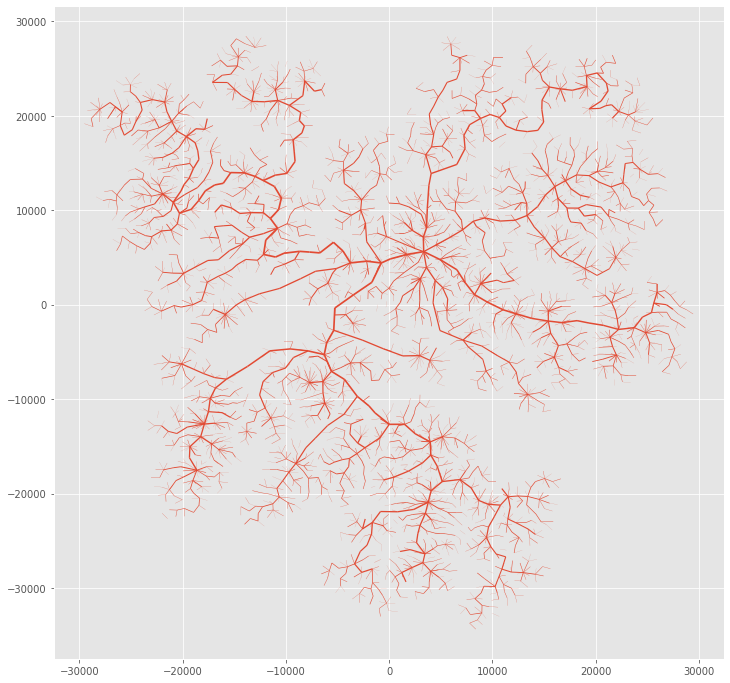

In [5]:
import numpy as np
from matplotlib import collections as mc

xy = np.array([(crd_x[k],crd_y[k]) for k in crd_x])
fig = plt.figure(figsize=[12,12])
ax = fig.subplots()
# ax.scatter(xy[:,0], xy[:,1], s=1)

lines = []
linewidths = []
for s,t in my_edges:
    source = (crd_x[str(label_to_id[s])], crd_y[str(label_to_id[s])])
    target = (crd_x[str(label_to_id[t])], crd_y[str(label_to_id[t])])
    lines.append([source, target])
    lw = (18-max(nodes_to_levels[s], nodes_to_levels[t]))/10
    linewidths.append(lw)
lc = mc.LineCollection(lines, linewidths=linewidths)
ax.add_collection(lc)
ax.autoscale()
plt.show()

# Run this if need weights

In [ ]:
# gv = nx.Graph(pygraphviz.AGraph(
#     '../data/datasets/lastfm/dot/lastfmw_original.dot', strict=False, directed=False
# ))

# name_to_weight = {n['label'].replace('\\n', ' '): int(n['weight']) for i,n in gv.nodes(data=True)}
# name_to_weight

## Graph

In [6]:
new_edges = []
new_nodes = []
 
for n in id_to_label:
    data = {}
    data['id'] = n
    data['pos'] = str(crd_x[str(n)])+','+str(crd_y[str(n)])
    label = id_to_label[n]
    data['level'] = int(nodes_to_levels[label])
    if alphanum_to_org is None:
        data['label'] = label
    else:
        data['label'] = alphanum_to_org[label]
    
    try:
        data['weight'] = name_to_weight[label]
    except:
#         print(data['label'])
        data['weight'] = 0
    new_nodes.append((int(n), data))
                        
    

max_level = 0
for e in my_edges:
    data = {}
    node1 = int(label_to_id[e[0]])
    node2 = int(label_to_id[e[1]])
    level1 = nodes_to_levels[e[0]]
    level2 = nodes_to_levels[e[1]]
    if(level1>max_level):
        max_level = level1
    if(level2>max_level):
        max_level=level2
    data['level'] = max(level1, level2)
#     data['level'] = 1
    
    new_e = (node1, node2, data)
    new_edges.append(new_e)


G = nx.Graph()
G.add_nodes_from(new_nodes)
G.add_edges_from(new_edges)

# print(max_level)
# print(new_edges[10])
# print(new_nodes[0])
# print(new_edges[0])
# print(len(new_nodes))  
print(G.nodes[10])

{'id': '10', 'pos': '-19741.34435638395,2363.662564008124', 'level': 13, 'label': 'lighting', 'weight': 0}


In [ ]:
# xy = np.array([(crd_x[k],crd_y[k]) for k in crd_x])
# fig = plt.figure(figsize=[12,12])
# ax = fig.subplots()
# ax.scatter(xy[:,0], xy[:,1], s=1)

# lines = []
# linewidths = []
# for s,t in G.edges:
#     source = (crd_x[str(s)], crd_y[str(s)])
#     target = (crd_x[str(t)], crd_y[str(t)])
#     lines.append([source, target])
#     lw = (18-G.edges[t,s]['level'])/10
#     linewidths.append(lw)
# lc = mc.LineCollection(lines, linewidths=linewidths)
# ax.add_collection(lc)
# plt.show()

    

## generate map

In [7]:
!mkdir {f}
!mkdir {f}/layers

In [8]:
## write sub trees in the hierarchy
levels = sorted(set([ G.nodes[i]['level'] for i in G.nodes]))
for l in tqdm(levels):
    n = [i for i in G.nodes if G.nodes[i]['level'] <= l]
    sub = G.subgraph(n)
    write_dot(sub, f'{f}/layers/graph-{l}.dot')

In [9]:
import pygraphviz as pgv
if 'topics' in f:
    fn_graph = '../data/datasets/topics/orginal/Topics_Graph_Connected.dot'
else:
    fn_graph = '../data/datasets/lastfm/dot/lastfmw_original.dot'
original = nx.Graph(pgv.AGraph(fn_graph))
if 'lastfm' in fn_graph:
    for n in original.nodes:
        original.nodes[n]['label'] = original.nodes[n]['label'].replace('\\n', ' ')
len(original), len(original.edges)

(5947, 26695)

In [10]:
# query = 'inversion'

# for s,t in original.edges:
#     l1, l2 = original.nodes[s]['label'], original.nodes[t]['label']
#     if query in l1 or query in l2:
#         print(l1,'----', l2)

In [11]:
o2label = {o:original.nodes[o]['label'] for o in original.nodes}
label2id = {G.nodes[i]['label']:i for i in G.nodes}

# print(set(o2label.values()) - set(label2id.keys()))
# print(set(label2id.keys()) - set(o2label.values()))

o2id = {o: label2id[o2label[o]] for o in original.nodes if o2label[o] in label2id}
# o2id


G0 = G.copy()
for n0,n1 in original.edges:
    if n0 in o2id and n1 in o2id:
        n0,n1 = o2id[n0], o2id[n1]
        if (n0,n1) not in G.edges:
            G0.add_edge(n0, n1)

In [12]:
write_dot(G0, "graph.dot")
write_dot(G, "tree.dot")

print(f)
!./mapgenerator.sh tree.dot
!mv out2 out3 map.svg graph.dot tree.dot {f}/

mingwei-topics-refined


## Geojson

In [13]:
dir_in = f'./{f}'
dir_out = f'../visualization_system/geojson/{f}'
print(dir_in)
print(dir_out)
if not Path(dir_out).exists():
    !mkdir {dir_out}
else:
    print(f'[warning] {dir_out} exists, may replace files there')
    


./mingwei-topics-refined
../visualization_system/geojson/mingwei-topics-refined
[warning] ../visualization_system/geojson/mingwei-topics-refined exists, may replace files there


In [14]:
!python ../geojson_generator/svg_to_geojson-mw.py {dir_in} {dir_out}

['./mingwei-topics-refined/layers/graph-1.dot', './mingwei-topics-refined/layers/graph-2.dot', './mingwei-topics-refined/layers/graph-3.dot', './mingwei-topics-refined/layers/graph-4.dot', './mingwei-topics-refined/layers/graph-5.dot', './mingwei-topics-refined/layers/graph-6.dot', './mingwei-topics-refined/layers/graph-7.dot', './mingwei-topics-refined/layers/graph-8.dot', './mingwei-topics-refined/layers/graph-9.dot', './mingwei-topics-refined/layers/graph-10.dot', './mingwei-topics-refined/layers/graph-11.dot', './mingwei-topics-refined/layers/graph-12.dot', './mingwei-topics-refined/layers/graph-13.dot', './mingwei-topics-refined/layers/graph-14.dot', './mingwei-topics-refined/layers/graph-15.dot', './mingwei-topics-refined/layers/graph-16.dot', './mingwei-topics-refined/layers/graph-17.dot', './mingwei-topics-refined/layers/graph-18.dot', './mingwei-topics-refined/layers/graph-19.dot', './mingwei-topics-refined/layers/graph-20.dot']
graph edges: 24710
levels: 20
polygons: 82 polyl

---

## Not used?

In [ ]:


G_graphml = nx.readwrite.graphml.read_graphml("/Users/shiny/Downloads/output_Layer_8.graphml")


In [ ]:
print(len(G_graphml.edges()))

In [ ]:
# options = {
#     'node_color': 'black',
#     'node_size': 10,
#     'width': 3,
# }
# nx.draw(G_graphml, **options)

In [ ]:
write_dot(G_graphml, "direct_lastfm_8.dot")

# Get by level

In [ ]:
#Graph_2500.txt	Graph_4000.txt	Graph_500.txt


In [ ]:
f = open("data/datasets/refined/topics_faryad/Graph_500.txt",'r')

lines = f.read().split("\n")

In [ ]:
nodes = []
edges = []

for l in lines[:-1]:
    v = l.split(" -- ")
    v[0] = v[0].decode('utf-8', 'ignore')
    v[1] = v[1].decode('utf-8', 'ignore')
    edges.append([v[0],v[1]])
    if(v[0] not in nodes):
        nodes.append(v[0])
    if(v[1] not in nodes):
        nodes.append(v[1])

In [ ]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# options = {
#     'node_color': 'black',
#     'node_size': 10,
#     'width': 3,
# }
# nx.draw(G, **options)

In [ ]:
# nx.readwrite.gml.write_gml(G, 'Direct1.gml')
write_dot(G, "direct_500.dot")

In [ ]:

Name: 
Type: Graph
Number of nodes: 51
Number of edges: 50
Average degree:   1.9608

removed crossings: 0
CR: 0
UE: 0.37
ST: 91.751
NP: 0.821
lblbb: 9.69E+04
lblarea: 37.56406055
BB: (2242.3176734383565, 1623.5170672526447)
lblo: 0

    
    
Type: Graph
Number of nodes: 201
Number of edges: 200
Average degree:   1.9900

removed crossings: 0
CR: 0
UE: 0.442
ST: 1593.992
NP: 0.76
lblbb: 8.05E+04
lblarea: 155.60089481999992
BB: (4415.768665540002, 2837.6732704034766)
lblo: 0

    
Name: 
Type: Graph
Number of nodes: 801
Number of edges: 800
Average degree:   1.9975

removed crossings: 0
CR: 0
UE: 1.255
ST: 71405.377
NP: 0.63
lblbb: 7.88E+04
lblarea: 600.0002425200001
BB: (8665.419498448602, 5452.989729410348)
lblo: 0
    
Name: 
Type: Graph
Number of nodes: 1601
Number of edges: 1600
Average degree:   1.9988

removed crossings: 0
CR: 0
UE: 1.638
ST: 334792.295
NP: 0.592
lblbb: 1.02E+05
lblarea: 1206.3703762099988
BB: (14567.582911387577, 8432.250711921391)
lblo: 0

Name: 
Type: Graph
Number of nodes: 2001
Number of edges: 2000
Average degree:   1.9990

removed crossings: 0
CR: 0
UE: 1.838
ST: 649737.963
NP: 0.576
lblbb: 1.10E+05
lblarea: 1523.7907976600004
BB: (9766.49319786187, 17150.25697759996)
lblo: 0
    
Name: 
Type: Graph
Number of nodes: 3501
Number of edges: 3500
Average degree:   1.9994

removed crossings: 0
CR: 0
UE: 2.545
ST: 2165529.984
NP: 0.546
lblbb: 1.36E+05
lblarea: 2722.066423040002
BB: (16462.618508691055, 22528.635143834686)
lblo: 0

Name: 
Type: Graph
Number of nodes: 3001
Number of edges: 3000
Average degree:   1.9993

removed crossings: 0
CR: 0
UE: 1.977
ST: 1500728.222
NP: 0.547
lblbb: 9.96E+04
lblarea: 2319.083499429999
BB: (17906.197314446596, 12903.30155548481)
lblo: 0
    
Type: Graph
Number of nodes: 4001
Number of edges: 4000
Average degree:   1.9995

removed crossings: 0
CR: 0
UE: 2.362
ST: 2822522.585
NP: 0.54
lblbb: 1.68E+05
lblarea: 3125.864228509995
BB: (24107.333500323628, 21813.757616844523)
lblo: 0
    
Name: All
Type: Graph
Number of nodes: 5001
Number of edges: 5000
Average degree:   1.9996

removed crossings: 0
CR: 0
UE: 1.93
ST: 3465256.488
NP: 0.52
lblbb: 1.26E+05
lblarea: 5584.09027056
BB: (25389.882737441407, 27638.560192320983)
lblo: 0
    
    
    

Paper notes: Fix so all properties are same parts of speech

Space utilization -> compactness


